# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'  'Shared drives'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to set up the homework3 files.



In [3]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(DATA_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

--2019-11-16 03:03:25--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.49MB/s    in 0.9s    

2019-11-16 03:03:27 (2.49 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util
from math import floor, log, exp

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
    
    # TODO Add more preprocessing
    data = re.sub(r'[\s\n\t]+', ' ', data)
    data = re.sub(r'[^\x00-\x7F]+',' ', data)
    
    voc2ind = {}
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    idx = 0
    for char in data: # TODO Fill this in
      if char not in voc2ind:
        voc2ind[char] = idx
        idx += 1


    ind2voc = {val: key for key, val in voc2ind.items()}

    stop = floor(len(data) * 0.8)
    train_text = data[:stop] # TODO Fill this in
    test_text = data[stop:] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
      
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

# Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        dataset = self.vocab.words_to_array(dataset['tokens'])
        num_batch = (len(dataset) - batch_size) // (batch_size * sequence_length)
        data = []
        chunk_limit = len(dataset) // batch_size - 1
        interval = len(dataset) // batch_size
        for i in range(0, chunk_limit, sequence_length):
            for j in range(batch_size):
                start = i + j * interval
                end = start + sequence_length
                if end >= chunk_limit + j * interval:
                    end = chunk_limit + j * interval
                d = dataset[start:end]
                l = dataset[start+1:end+1]
                data.append({'data': d, 'label': l})
        self.data = data

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        return len(self.data)
        
    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.
        return self.data[idx]['data'], self.data[idx]['label']

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
TEMPERATURE = 0.5

class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        output = self.encoder(x) 
        output, state = self.gru(output, hidden_state)
        output = self.decoder(output)
        return output, state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val
    
    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.5
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        temp, idx = torch.topk(output[0], 1) # pick max
        outputs.append(idx)
        output, hidden = model.inference(idx, hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        idx = torch.multinomial(output[0], 1) # pick sample
        outputs.append(idx)
        output, hidden = model.inference(idx, hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, data, hidden):
    # outputs = []
    beam = [([], data, hidden, 0)]
    # TODO
    for ii in range(sequence_length):
        new_beam = []
        for i in range(len(beam)):
            sequence, curr, hidden, score = beam[i]
            output, hidden = model.inference(curr, hidden, TEMPERATURE)
            samples = torch.multinomial(output[0], beam_width, replacement=True)
            # update new beam list
            for sample in samples:
                new_score = score + log(output[0][sample])
                new_beam.append((sequence+[sample], sample, hidden, new_score))
        # rank new beam list and give top beams
        new_beam = sorted(new_beam, key=lambda tup:tup[3], reverse=True)
        beam = new_beam[:beam_width]
    outputs = beam[0][0]
    return outputs

def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)

        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)

        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, data, hidden)

        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    perplexity = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            test_loss += model.loss(output, label, reduction='mean').item()
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            # if batch_idx % 10 == 0:
            #     print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
            #         test_loader.dataset.vocab.array_to_words(data[0]),
            #         test_loader.dataset.vocab.array_to_words(label[0]),
            #         test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)))
    return test_loss, test_accuracy

Using device cuda
num workers: 2



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 17.0024, Accuracy: 4770/1246720 (0%)




  0%|          | 5/1946 [00:00<00:41, 46.72it/s]

Train Epoch: 0 [0/124544 (0%)]	Loss: 17.049931
Train Epoch: 0 [640/124544 (1%)]	Loss: 6.445737



  1%|          | 16/1946 [00:00<00:34, 56.22it/s]

Train Epoch: 0 [1280/124544 (1%)]	Loss: 4.543736



  2%|▏         | 41/1946 [00:00<00:24, 76.42it/s]

Train Epoch: 0 [1920/124544 (2%)]	Loss: 3.608871
Train Epoch: 0 [2560/124544 (2%)]	Loss: 3.156470



  3%|▎         | 53/1946 [00:00<00:22, 85.28it/s]

Train Epoch: 0 [3200/124544 (3%)]	Loss: 2.922609



  3%|▎         | 66/1946 [00:00<00:20, 93.63it/s]

Train Epoch: 0 [3840/124544 (3%)]	Loss: 2.664533
Train Epoch: 0 [4480/124544 (4%)]	Loss: 2.510241



  4%|▍         | 78/1946 [00:00<00:18, 100.03it/s]

Train Epoch: 0 [5120/124544 (4%)]	Loss: 2.716449



  5%|▌         | 103/1946 [00:00<00:16, 109.56it/s]

Train Epoch: 0 [5760/124544 (5%)]	Loss: 2.396645
Train Epoch: 0 [6400/124544 (5%)]	Loss: 2.439510
Train Epoch: 0 [7040/124544 (6%)]	Loss: 2.351307



  7%|▋         | 127/1946 [00:01<00:16, 110.56it/s]

Train Epoch: 0 [7680/124544 (6%)]	Loss: 2.291409
Train Epoch: 0 [8320/124544 (7%)]	Loss: 2.242244



  7%|▋         | 139/1946 [00:01<00:16, 111.90it/s]

Train Epoch: 0 [8960/124544 (7%)]	Loss: 2.274789



  8%|▊         | 163/1946 [00:01<00:15, 112.98it/s]

Train Epoch: 0 [9600/124544 (8%)]	Loss: 2.206398
Train Epoch: 0 [10240/124544 (8%)]	Loss: 2.230893
Train Epoch: 0 [10880/124544 (9%)]	Loss: 2.121897



 10%|▉         | 187/1946 [00:01<00:15, 110.64it/s]

Train Epoch: 0 [11520/124544 (9%)]	Loss: 2.079532
Train Epoch: 0 [12160/124544 (10%)]	Loss: 2.085599



 10%|█         | 199/1946 [00:01<00:15, 109.34it/s]

Train Epoch: 0 [12800/124544 (10%)]	Loss: 2.148561



 11%|█▏        | 223/1946 [00:02<00:15, 112.87it/s]

Train Epoch: 0 [13440/124544 (11%)]	Loss: 2.104579
Train Epoch: 0 [14080/124544 (11%)]	Loss: 2.010622
Train Epoch: 0 [14720/124544 (12%)]	Loss: 1.989231



 13%|█▎        | 247/1946 [00:02<00:15, 112.72it/s]

Train Epoch: 0 [15360/124544 (12%)]	Loss: 1.942661
Train Epoch: 0 [16000/124544 (13%)]	Loss: 2.014856



 13%|█▎        | 259/1946 [00:02<00:14, 112.56it/s]

Train Epoch: 0 [16640/124544 (13%)]	Loss: 1.954731



 15%|█▍        | 283/1946 [00:02<00:14, 111.57it/s]

Train Epoch: 0 [17280/124544 (14%)]	Loss: 2.052562
Train Epoch: 0 [17920/124544 (14%)]	Loss: 2.065663
Train Epoch: 0 [18560/124544 (15%)]	Loss: 1.968713



 16%|█▌        | 307/1946 [00:02<00:14, 111.48it/s]

Train Epoch: 0 [19200/124544 (15%)]	Loss: 1.990053
Train Epoch: 0 [19840/124544 (16%)]	Loss: 2.023632



 16%|█▋        | 319/1946 [00:02<00:14, 112.56it/s]

Train Epoch: 0 [20480/124544 (16%)]	Loss: 1.989567


 18%|█▊        | 343/1946 [00:03<00:14, 112.73it/s]

Train Epoch: 0 [21120/124544 (17%)]	Loss: 2.013765
Train Epoch: 0 [21760/124544 (17%)]	Loss: 2.025868
Train Epoch: 0 [22400/124544 (18%)]	Loss: 2.007579



 19%|█▉        | 367/1946 [00:03<00:13, 113.28it/s]

Train Epoch: 0 [23040/124544 (18%)]	Loss: 2.075132
Train Epoch: 0 [23680/124544 (19%)]	Loss: 1.912619



 19%|█▉        | 379/1946 [00:03<00:13, 113.90it/s]

Train Epoch: 0 [24320/124544 (20%)]	Loss: 2.009719



 20%|██        | 391/1946 [00:03<00:14, 110.59it/s]

Train Epoch: 0 [24960/124544 (20%)]	Loss: 1.935643
Train Epoch: 0 [25600/124544 (21%)]	Loss: 1.963675



 21%|██        | 403/1946 [00:03<00:14, 110.01it/s]

Train Epoch: 0 [26240/124544 (21%)]	Loss: 1.951050



 22%|██▏       | 427/1946 [00:03<00:13, 112.78it/s]

Train Epoch: 0 [26880/124544 (22%)]	Loss: 1.906324
Train Epoch: 0 [27520/124544 (22%)]	Loss: 1.932992



 23%|██▎       | 439/1946 [00:03<00:13, 114.49it/s]

Train Epoch: 0 [28160/124544 (23%)]	Loss: 1.969314



 24%|██▍       | 463/1946 [00:04<00:13, 113.48it/s]

Train Epoch: 0 [28800/124544 (23%)]	Loss: 1.874436
Train Epoch: 0 [29440/124544 (24%)]	Loss: 1.875705
Train Epoch: 0 [30080/124544 (24%)]	Loss: 1.910243



 25%|██▌       | 487/1946 [00:04<00:12, 112.27it/s]

Train Epoch: 0 [30720/124544 (25%)]	Loss: 1.892678
Train Epoch: 0 [31360/124544 (25%)]	Loss: 1.875584



 26%|██▌       | 499/1946 [00:04<00:12, 111.59it/s]

Train Epoch: 0 [32000/124544 (26%)]	Loss: 1.909065



 27%|██▋       | 523/1946 [00:04<00:12, 113.44it/s]

Train Epoch: 0 [32640/124544 (26%)]	Loss: 1.887564
Train Epoch: 0 [33280/124544 (27%)]	Loss: 1.845685
Train Epoch: 0 [33920/124544 (27%)]	Loss: 1.833466



 28%|██▊       | 547/1946 [00:04<00:12, 111.62it/s]

Train Epoch: 0 [34560/124544 (28%)]	Loss: 1.848807
Train Epoch: 0 [35200/124544 (28%)]	Loss: 1.864529



 29%|██▊       | 559/1946 [00:05<00:12, 109.66it/s]

Train Epoch: 0 [35840/124544 (29%)]	Loss: 1.825793



 30%|██▉       | 581/1946 [00:05<00:12, 107.03it/s]

Train Epoch: 0 [36480/124544 (29%)]	Loss: 1.837453
Train Epoch: 0 [37120/124544 (30%)]	Loss: 1.861180



 30%|███       | 593/1946 [00:05<00:12, 109.88it/s]

Train Epoch: 0 [37760/124544 (30%)]	Loss: 1.861288



 31%|███       | 605/1946 [00:05<00:12, 111.18it/s]

Train Epoch: 0 [38400/124544 (31%)]	Loss: 1.884961
Train Epoch: 0 [39040/124544 (31%)]	Loss: 1.864940



 32%|███▏      | 617/1946 [00:05<00:12, 108.53it/s]

Train Epoch: 0 [39680/124544 (32%)]	Loss: 1.808241



 33%|███▎      | 641/1946 [00:05<00:11, 112.11it/s]

Train Epoch: 0 [40320/124544 (32%)]	Loss: 1.801826
Train Epoch: 0 [40960/124544 (33%)]	Loss: 1.791156



 34%|███▎      | 653/1946 [00:05<00:11, 111.89it/s]

Train Epoch: 0 [41600/124544 (33%)]	Loss: 1.970965



 34%|███▍      | 665/1946 [00:05<00:11, 111.61it/s]

Train Epoch: 0 [42240/124544 (34%)]	Loss: 1.893973
Train Epoch: 0 [42880/124544 (34%)]	Loss: 1.839034



 35%|███▍      | 677/1946 [00:06<00:11, 112.42it/s]

Train Epoch: 0 [43520/124544 (35%)]	Loss: 1.855451



 36%|███▌      | 701/1946 [00:06<00:11, 112.00it/s]

Train Epoch: 0 [44160/124544 (35%)]	Loss: 1.822577
Train Epoch: 0 [44800/124544 (36%)]	Loss: 1.858646



 37%|███▋      | 713/1946 [00:06<00:11, 111.85it/s]

Train Epoch: 0 [45440/124544 (36%)]	Loss: 1.842854



 37%|███▋      | 725/1946 [00:06<00:10, 112.65it/s]

Train Epoch: 0 [46080/124544 (37%)]	Loss: 1.844061
Train Epoch: 0 [46720/124544 (38%)]	Loss: 1.799330



 38%|███▊      | 737/1946 [00:06<00:10, 112.09it/s]

Train Epoch: 0 [47360/124544 (38%)]	Loss: 1.733275



 39%|███▉      | 762/1946 [00:06<00:10, 116.88it/s]

Train Epoch: 0 [48000/124544 (39%)]	Loss: 1.859599
Train Epoch: 0 [48640/124544 (39%)]	Loss: 1.801205



 40%|███▉      | 775/1946 [00:06<00:09, 117.70it/s]

Train Epoch: 0 [49280/124544 (40%)]	Loss: 1.806849



 40%|████      | 787/1946 [00:07<00:09, 117.68it/s]

Train Epoch: 0 [49920/124544 (40%)]	Loss: 1.783509
Train Epoch: 0 [50560/124544 (41%)]	Loss: 1.783097



 41%|████      | 799/1946 [00:07<00:09, 117.57it/s]

Train Epoch: 0 [51200/124544 (41%)]	Loss: 1.870997



 42%|████▏     | 823/1946 [00:07<00:09, 116.11it/s]

Train Epoch: 0 [51840/124544 (42%)]	Loss: 1.785385
Train Epoch: 0 [52480/124544 (42%)]	Loss: 1.745634
Train Epoch: 0 [53120/124544 (43%)]	Loss: 1.743470



 44%|████▎     | 847/1946 [00:07<00:09, 112.71it/s]

Train Epoch: 0 [53760/124544 (43%)]	Loss: 1.791666
Train Epoch: 0 [54400/124544 (44%)]	Loss: 1.732701



 44%|████▍     | 859/1946 [00:07<00:09, 110.38it/s]

Train Epoch: 0 [55040/124544 (44%)]	Loss: 1.790391



 45%|████▌     | 884/1946 [00:07<00:09, 113.53it/s]

Train Epoch: 0 [55680/124544 (45%)]	Loss: 1.778981
Train Epoch: 0 [56320/124544 (45%)]	Loss: 1.852179
Train Epoch: 0 [56960/124544 (46%)]	Loss: 1.796921



 47%|████▋     | 908/1946 [00:08<00:09, 114.33it/s]

Train Epoch: 0 [57600/124544 (46%)]	Loss: 1.831795
Train Epoch: 0 [58240/124544 (47%)]	Loss: 1.815372



 47%|████▋     | 920/1946 [00:08<00:09, 113.68it/s]

Train Epoch: 0 [58880/124544 (47%)]	Loss: 1.741050



 48%|████▊     | 932/1946 [00:08<00:09, 111.85it/s]

Train Epoch: 0 [59520/124544 (48%)]	Loss: 1.766830
Train Epoch: 0 [60160/124544 (48%)]	Loss: 1.748170



 49%|████▊     | 944/1946 [00:08<00:09, 109.49it/s]

Train Epoch: 0 [60800/124544 (49%)]	Loss: 1.800682



 50%|████▉     | 968/1946 [00:08<00:08, 110.41it/s]

Train Epoch: 0 [61440/124544 (49%)]	Loss: 1.794893
Train Epoch: 0 [62080/124544 (50%)]	Loss: 1.758533



 50%|█████     | 980/1946 [00:08<00:08, 112.39it/s]

Train Epoch: 0 [62720/124544 (50%)]	Loss: 1.717404



 52%|█████▏    | 1005/1946 [00:08<00:08, 115.50it/s]

Train Epoch: 0 [63360/124544 (51%)]	Loss: 1.754561
Train Epoch: 0 [64000/124544 (51%)]	Loss: 1.791890


Train Epoch: 0 [64640/124544 (52%)]	Loss: 1.797085



 53%|█████▎    | 1030/1946 [00:09<00:07, 116.80it/s]

Train Epoch: 0 [65280/124544 (52%)]	Loss: 1.827691
Train Epoch: 0 [65920/124544 (53%)]	Loss: 1.738573



 54%|█████▎    | 1043/1946 [00:09<00:07, 117.70it/s]

Train Epoch: 0 [66560/124544 (53%)]	Loss: 1.814151



 54%|█████▍    | 1055/1946 [00:09<00:07, 115.58it/s]

Train Epoch: 0 [67200/124544 (54%)]	Loss: 1.820622
Train Epoch: 0 [67840/124544 (54%)]	Loss: 1.756026



 55%|█████▍    | 1067/1946 [00:09<00:07, 113.15it/s]

Train Epoch: 0 [68480/124544 (55%)]	Loss: 1.713768



 56%|█████▌    | 1091/1946 [00:09<00:07, 111.60it/s]

Train Epoch: 0 [69120/124544 (55%)]	Loss: 1.743106
Train Epoch: 0 [69760/124544 (56%)]	Loss: 1.753553
Train Epoch: 0 [70400/124544 (57%)]	Loss: 1.774079



 57%|█████▋    | 1115/1946 [00:09<00:07, 111.20it/s]

Train Epoch: 0 [71040/124544 (57%)]	Loss: 1.872807
Train Epoch: 0 [71680/124544 (58%)]	Loss: 1.726506



 58%|█████▊    | 1127/1946 [00:10<00:07, 113.22it/s]

Train Epoch: 0 [72320/124544 (58%)]	Loss: 1.714029



 59%|█████▉    | 1151/1946 [00:10<00:07, 113.47it/s]

Train Epoch: 0 [72960/124544 (59%)]	Loss: 1.725199
Train Epoch: 0 [73600/124544 (59%)]	Loss: 1.701364



 60%|█████▉    | 1163/1946 [00:10<00:06, 112.96it/s]

Train Epoch: 0 [74240/124544 (60%)]	Loss: 1.777681



 60%|██████    | 1175/1946 [00:10<00:06, 113.49it/s]

Train Epoch: 0 [74880/124544 (60%)]	Loss: 1.744327
Train Epoch: 0 [75520/124544 (61%)]	Loss: 1.803428



 61%|██████    | 1188/1946 [00:10<00:06, 115.32it/s]

Train Epoch: 0 [76160/124544 (61%)]	Loss: 1.825406



 62%|██████▏   | 1212/1946 [00:10<00:06, 116.65it/s]

Train Epoch: 0 [76800/124544 (62%)]	Loss: 1.741301
Train Epoch: 0 [77440/124544 (62%)]	Loss: 1.686785



 63%|██████▎   | 1224/1946 [00:10<00:06, 114.96it/s]

Train Epoch: 0 [78080/124544 (63%)]	Loss: 1.626517



 64%|██████▎   | 1236/1946 [00:10<00:06, 112.64it/s]

Train Epoch: 0 [78720/124544 (63%)]	Loss: 1.650645
Train Epoch: 0 [79360/124544 (64%)]	Loss: 1.727600



 64%|██████▍   | 1248/1946 [00:11<00:06, 113.06it/s]

Train Epoch: 0 [80000/124544 (64%)]	Loss: 1.695946



 65%|██████▌   | 1272/1946 [00:11<00:05, 112.62it/s]

Train Epoch: 0 [80640/124544 (65%)]	Loss: 1.738406
Train Epoch: 0 [81280/124544 (65%)]	Loss: 1.738016


Train Epoch: 0 [81920/124544 (66%)]	Loss: 1.660711


 67%|██████▋   | 1296/1946 [00:11<00:05, 113.11it/s]

Train Epoch: 0 [82560/124544 (66%)]	Loss: 1.752269
Train Epoch: 0 [83200/124544 (67%)]	Loss: 1.726579



 67%|██████▋   | 1308/1946 [00:11<00:05, 111.79it/s]

Train Epoch: 0 [83840/124544 (67%)]	Loss: 1.686825



 68%|██████▊   | 1331/1946 [00:11<00:05, 108.97it/s]

Train Epoch: 0 [84480/124544 (68%)]	Loss: 1.631790
Train Epoch: 0 [85120/124544 (68%)]	Loss: 1.738478



 69%|██████▉   | 1343/1946 [00:11<00:05, 109.61it/s]

Train Epoch: 0 [85760/124544 (69%)]	Loss: 1.671783



 70%|██████▉   | 1355/1946 [00:12<00:05, 112.46it/s]

Train Epoch: 0 [86400/124544 (69%)]	Loss: 1.741061
Train Epoch: 0 [87040/124544 (70%)]	Loss: 1.638842



 70%|███████   | 1367/1946 [00:12<00:05, 112.91it/s]

Train Epoch: 0 [87680/124544 (70%)]	Loss: 1.673444



 71%|███████▏  | 1391/1946 [00:12<00:04, 113.51it/s]

Train Epoch: 0 [88320/124544 (71%)]	Loss: 1.681128
Train Epoch: 0 [88960/124544 (71%)]	Loss: 1.634152



 72%|███████▏  | 1403/1946 [00:12<00:04, 114.42it/s]

Train Epoch: 0 [89600/124544 (72%)]	Loss: 1.734672



 73%|███████▎  | 1415/1946 [00:12<00:04, 113.84it/s]

Train Epoch: 0 [90240/124544 (72%)]	Loss: 1.671637
Train Epoch: 0 [90880/124544 (73%)]	Loss: 1.750682



 73%|███████▎  | 1427/1946 [00:12<00:04, 113.62it/s]

Train Epoch: 0 [91520/124544 (73%)]	Loss: 1.603329



 75%|███████▍  | 1451/1946 [00:12<00:04, 109.30it/s]

Train Epoch: 0 [92160/124544 (74%)]	Loss: 1.662556
Train Epoch: 0 [92800/124544 (75%)]	Loss: 1.751353
Train Epoch: 0 [93440/124544 (75%)]	Loss: 1.670418



 76%|███████▌  | 1475/1946 [00:13<00:04, 112.57it/s]

Train Epoch: 0 [94080/124544 (76%)]	Loss: 1.674541
Train Epoch: 0 [94720/124544 (76%)]	Loss: 1.736759



 76%|███████▋  | 1487/1946 [00:13<00:04, 113.19it/s]

Train Epoch: 0 [95360/124544 (77%)]	Loss: 1.715203



 78%|███████▊  | 1511/1946 [00:13<00:03, 113.31it/s]

Train Epoch: 0 [96000/124544 (77%)]	Loss: 1.745029
Train Epoch: 0 [96640/124544 (78%)]	Loss: 1.714174



 78%|███████▊  | 1524/1946 [00:13<00:03, 115.68it/s]

Train Epoch: 0 [97280/124544 (78%)]	Loss: 1.576491



 79%|███████▉  | 1536/1946 [00:13<00:03, 115.32it/s]

Train Epoch: 0 [97920/124544 (79%)]	Loss: 1.661538
Train Epoch: 0 [98560/124544 (79%)]	Loss: 1.696322



 80%|███████▉  | 1548/1946 [00:13<00:03, 114.47it/s]

Train Epoch: 0 [99200/124544 (80%)]	Loss: 1.689217



 81%|████████  | 1572/1946 [00:13<00:03, 115.41it/s]

Train Epoch: 0 [99840/124544 (80%)]	Loss: 1.706039
Train Epoch: 0 [100480/124544 (81%)]	Loss: 1.697459



 81%|████████▏ | 1585/1946 [00:14<00:03, 117.02it/s]

Train Epoch: 0 [101120/124544 (81%)]	Loss: 1.658272



 82%|████████▏ | 1597/1946 [00:14<00:03, 116.14it/s]

Train Epoch: 0 [101760/124544 (82%)]	Loss: 1.754625
Train Epoch: 0 [102400/124544 (82%)]	Loss: 1.623293



 83%|████████▎ | 1609/1946 [00:14<00:02, 114.11it/s]

Train Epoch: 0 [103040/124544 (83%)]	Loss: 1.727208



 84%|████████▍ | 1634/1946 [00:14<00:02, 117.19it/s]

Train Epoch: 0 [103680/124544 (83%)]	Loss: 1.629848
Train Epoch: 0 [104320/124544 (84%)]	Loss: 1.728518
Train Epoch: 0 [104960/124544 (84%)]	Loss: 1.668224



 85%|████████▌ | 1658/1946 [00:14<00:02, 115.49it/s]

Train Epoch: 0 [105600/124544 (85%)]	Loss: 1.657049
Train Epoch: 0 [106240/124544 (85%)]	Loss: 1.668611



 86%|████████▌ | 1670/1946 [00:14<00:02, 113.01it/s]

Train Epoch: 0 [106880/124544 (86%)]	Loss: 1.779431



 86%|████████▋ | 1682/1946 [00:14<00:02, 113.33it/s]

Train Epoch: 0 [107520/124544 (86%)]	Loss: 1.695572
Train Epoch: 0 [108160/124544 (87%)]	Loss: 1.660489



 87%|████████▋ | 1694/1946 [00:15<00:02, 111.73it/s]

Train Epoch: 0 [108800/124544 (87%)]	Loss: 1.678993



 88%|████████▊ | 1719/1946 [00:15<00:01, 115.27it/s]

Train Epoch: 0 [109440/124544 (88%)]	Loss: 1.697535
Train Epoch: 0 [110080/124544 (88%)]	Loss: 1.691935



 89%|████████▉ | 1731/1946 [00:15<00:01, 114.22it/s]

Train Epoch: 0 [110720/124544 (89%)]	Loss: 1.658928



 90%|████████▉ | 1743/1946 [00:15<00:01, 114.87it/s]

Train Epoch: 0 [111360/124544 (89%)]	Loss: 1.653023
Train Epoch: 0 [112000/124544 (90%)]	Loss: 1.677602



 90%|█████████ | 1755/1946 [00:15<00:01, 113.31it/s]

Train Epoch: 0 [112640/124544 (90%)]	Loss: 1.664568



 91%|█████████▏| 1780/1946 [00:15<00:01, 113.61it/s]

Train Epoch: 0 [113280/124544 (91%)]	Loss: 1.646042
Train Epoch: 0 [113920/124544 (91%)]	Loss: 1.622430



 92%|█████████▏| 1792/1946 [00:15<00:01, 114.06it/s]

Train Epoch: 0 [114560/124544 (92%)]	Loss: 1.635451



 93%|█████████▎| 1804/1946 [00:15<00:01, 113.54it/s]

Train Epoch: 0 [115200/124544 (92%)]	Loss: 1.652269
Train Epoch: 0 [115840/124544 (93%)]	Loss: 1.694693



 93%|█████████▎| 1816/1946 [00:16<00:01, 115.08it/s]

Train Epoch: 0 [116480/124544 (94%)]	Loss: 1.745843



 95%|█████████▍| 1841/1946 [00:16<00:00, 116.68it/s]

Train Epoch: 0 [117120/124544 (94%)]	Loss: 1.670826
Train Epoch: 0 [117760/124544 (95%)]	Loss: 1.659847



 95%|█████████▌| 1853/1946 [00:16<00:00, 114.77it/s]

Train Epoch: 0 [118400/124544 (95%)]	Loss: 1.647816



 96%|█████████▌| 1865/1946 [00:16<00:00, 115.79it/s]

Train Epoch: 0 [119040/124544 (96%)]	Loss: 1.709944
Train Epoch: 0 [119680/124544 (96%)]	Loss: 1.695844



 97%|█████████▋| 1878/1946 [00:16<00:00, 117.41it/s]

Train Epoch: 0 [120320/124544 (97%)]	Loss: 1.647774



 98%|█████████▊| 1902/1946 [00:16<00:00, 113.73it/s]

Train Epoch: 0 [120960/124544 (97%)]	Loss: 1.633323
Train Epoch: 0 [121600/124544 (98%)]	Loss: 1.653717
Train Epoch: 0 [122240/124544 (98%)]	Loss: 1.639673



 99%|█████████▉| 1926/1946 [00:17<00:00, 113.67it/s]

Train Epoch: 0 [122880/124544 (99%)]	Loss: 1.713199
Train Epoch: 0 [123520/124544 (99%)]	Loss: 1.705068



100%|█████████▉| 1938/1946 [00:17<00:00, 112.03it/s]

Train Epoch: 0 [124160/124544 (100%)]	Loss: 1.646215



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.6498, Accuracy: 645904/1246720 (52%)

Saved /content/checkpoints/000.pt




  0%|          | 5/1946 [00:00<00:41, 47.22it/s]

Train Epoch: 1 [0/124544 (0%)]	Loss: 1.656455
Train Epoch: 1 [640/124544 (1%)]	Loss: 1.607289



  1%|          | 17/1946 [00:00<00:33, 57.41it/s]

Train Epoch: 1 [1280/124544 (1%)]	Loss: 1.658210



  2%|▏         | 41/1946 [00:00<00:24, 77.91it/s]

Train Epoch: 1 [1920/124544 (2%)]	Loss: 1.615169
Train Epoch: 1 [2560/124544 (2%)]	Loss: 1.670189



  3%|▎         | 53/1946 [00:00<00:21, 86.57it/s]

Train Epoch: 1 [3200/124544 (3%)]	Loss: 1.609535



  3%|▎         | 64/1946 [00:00<00:20, 92.01it/s]

Train Epoch: 1 [3840/124544 (3%)]	Loss: 1.625572
Train Epoch: 1 [4480/124544 (4%)]	Loss: 1.593931



  4%|▍         | 76/1946 [00:00<00:19, 97.39it/s]

Train Epoch: 1 [5120/124544 (4%)]	Loss: 1.714745



  5%|▌         | 100/1946 [00:00<00:17, 105.58it/s]

Train Epoch: 1 [5760/124544 (5%)]	Loss: 1.635113
Train Epoch: 1 [6400/124544 (5%)]	Loss: 1.715228



  6%|▌         | 111/1946 [00:01<00:17, 106.47it/s]

Train Epoch: 1 [7040/124544 (6%)]	Loss: 1.666752



  6%|▋         | 123/1946 [00:01<00:16, 109.44it/s]

Train Epoch: 1 [7680/124544 (6%)]	Loss: 1.597616
Train Epoch: 1 [8320/124544 (7%)]	Loss: 1.603415



  7%|▋         | 135/1946 [00:01<00:16, 110.61it/s]

Train Epoch: 1 [8960/124544 (7%)]	Loss: 1.664976



  8%|▊         | 160/1946 [00:01<00:15, 115.82it/s]

Train Epoch: 1 [9600/124544 (8%)]	Loss: 1.651739
Train Epoch: 1 [10240/124544 (8%)]	Loss: 1.704858



  9%|▉         | 173/1946 [00:01<00:15, 117.79it/s]

Train Epoch: 1 [10880/124544 (9%)]	Loss: 1.656134



 10%|▉         | 185/1946 [00:01<00:15, 114.58it/s]

Train Epoch: 1 [11520/124544 (9%)]	Loss: 1.599002
Train Epoch: 1 [12160/124544 (10%)]	Loss: 1.624399



 10%|█         | 197/1946 [00:01<00:15, 113.64it/s]

Train Epoch: 1 [12800/124544 (10%)]	Loss: 1.619479



 11%|█▏        | 221/1946 [00:01<00:15, 112.29it/s]

Train Epoch: 1 [13440/124544 (11%)]	Loss: 1.665398
Train Epoch: 1 [14080/124544 (11%)]	Loss: 1.610055



 12%|█▏        | 233/1946 [00:02<00:15, 113.07it/s]

Train Epoch: 1 [14720/124544 (12%)]	Loss: 1.580335



 13%|█▎        | 245/1946 [00:02<00:15, 111.37it/s]

Train Epoch: 1 [15360/124544 (12%)]	Loss: 1.561249
Train Epoch: 1 [16000/124544 (13%)]	Loss: 1.646843



 13%|█▎        | 257/1946 [00:02<00:15, 110.75it/s]

Train Epoch: 1 [16640/124544 (13%)]	Loss: 1.594296



 14%|█▍        | 281/1946 [00:02<00:14, 114.73it/s]

Train Epoch: 1 [17280/124544 (14%)]	Loss: 1.660202
Train Epoch: 1 [17920/124544 (14%)]	Loss: 1.648633



 15%|█▌        | 293/1946 [00:02<00:14, 114.27it/s]

Train Epoch: 1 [18560/124544 (15%)]	Loss: 1.615098



 16%|█▌        | 305/1946 [00:02<00:14, 112.13it/s]

Train Epoch: 1 [19200/124544 (15%)]	Loss: 1.610839
Train Epoch: 1 [19840/124544 (16%)]	Loss: 1.687656



 16%|█▋        | 317/1946 [00:02<00:14, 111.87it/s]

Train Epoch: 1 [20480/124544 (16%)]	Loss: 1.632954



 18%|█▊        | 342/1946 [00:03<00:13, 115.14it/s]

Train Epoch: 1 [21120/124544 (17%)]	Loss: 1.672809
Train Epoch: 1 [21760/124544 (17%)]	Loss: 1.663218



 18%|█▊        | 355/1946 [00:03<00:13, 116.99it/s]

Train Epoch: 1 [22400/124544 (18%)]	Loss: 1.660980



 19%|█▉        | 367/1946 [00:03<00:13, 115.39it/s]

Train Epoch: 1 [23040/124544 (18%)]	Loss: 1.702116
Train Epoch: 1 [23680/124544 (19%)]	Loss: 1.618007



 19%|█▉        | 379/1946 [00:03<00:13, 115.85it/s]

Train Epoch: 1 [24320/124544 (20%)]	Loss: 1.679353



 21%|██        | 403/1946 [00:03<00:13, 116.26it/s]

Train Epoch: 1 [24960/124544 (20%)]	Loss: 1.641044
Train Epoch: 1 [25600/124544 (21%)]	Loss: 1.630725
Train Epoch: 1 [26240/124544 (21%)]	Loss: 1.677945



 22%|██▏       | 427/1946 [00:03<00:13, 115.44it/s]

Train Epoch: 1 [26880/124544 (22%)]	Loss: 1.615791
Train Epoch: 1 [27520/124544 (22%)]	Loss: 1.639028



 23%|██▎       | 439/1946 [00:03<00:12, 116.06it/s]

Train Epoch: 1 [28160/124544 (23%)]	Loss: 1.664841



 24%|██▍       | 464/1946 [00:04<00:12, 118.87it/s]

Train Epoch: 1 [28800/124544 (23%)]	Loss: 1.566856
Train Epoch: 1 [29440/124544 (24%)]	Loss: 1.585764
Train Epoch: 1 [30080/124544 (24%)]	Loss: 1.610287



 25%|██▌       | 488/1946 [00:04<00:12, 115.39it/s]

Train Epoch: 1 [30720/124544 (25%)]	Loss: 1.624318
Train Epoch: 1 [31360/124544 (25%)]	Loss: 1.600483



 26%|██▌       | 500/1946 [00:04<00:12, 114.64it/s]

Train Epoch: 1 [32000/124544 (26%)]	Loss: 1.628303



 26%|██▋       | 512/1946 [00:04<00:12, 113.38it/s]

Train Epoch: 1 [32640/124544 (26%)]	Loss: 1.583294
Train Epoch: 1 [33280/124544 (27%)]	Loss: 1.600590



 27%|██▋       | 524/1946 [00:04<00:12, 111.84it/s]

Train Epoch: 1 [33920/124544 (27%)]	Loss: 1.580365



 28%|██▊       | 548/1946 [00:04<00:12, 114.90it/s]

Train Epoch: 1 [34560/124544 (28%)]	Loss: 1.609672
Train Epoch: 1 [35200/124544 (28%)]	Loss: 1.628350



 29%|██▉       | 560/1946 [00:04<00:12, 112.70it/s]

Train Epoch: 1 [35840/124544 (29%)]	Loss: 1.600568



 30%|███       | 584/1946 [00:05<00:11, 113.84it/s]

Train Epoch: 1 [36480/124544 (29%)]	Loss: 1.610295
Train Epoch: 1 [37120/124544 (30%)]	Loss: 1.600602
Train Epoch: 1 [37760/124544 (30%)]	Loss: 1.620258



 31%|███       | 608/1946 [00:05<00:11, 115.39it/s]

Train Epoch: 1 [38400/124544 (31%)]	Loss: 1.623142
Train Epoch: 1 [39040/124544 (31%)]	Loss: 1.635826



 32%|███▏      | 620/1946 [00:05<00:11, 116.13it/s]

Train Epoch: 1 [39680/124544 (32%)]	Loss: 1.571519



 33%|███▎      | 645/1946 [00:05<00:11, 118.05it/s]

Train Epoch: 1 [40320/124544 (32%)]	Loss: 1.588042
Train Epoch: 1 [40960/124544 (33%)]	Loss: 1.559906


Train Epoch: 1 [41600/124544 (33%)]	Loss: 1.676336



 34%|███▍      | 669/1946 [00:05<00:11, 112.86it/s]

Train Epoch: 1 [42240/124544 (34%)]	Loss: 1.652089
Train Epoch: 1 [42880/124544 (34%)]	Loss: 1.603400



 35%|███▍      | 681/1946 [00:06<00:11, 111.09it/s]

Train Epoch: 1 [43520/124544 (35%)]	Loss: 1.624942



 36%|███▌      | 693/1946 [00:06<00:11, 110.67it/s]

Train Epoch: 1 [44160/124544 (35%)]	Loss: 1.611341
Train Epoch: 1 [44800/124544 (36%)]	Loss: 1.630092



 36%|███▌      | 705/1946 [00:06<00:11, 111.88it/s]

Train Epoch: 1 [45440/124544 (36%)]	Loss: 1.601395



 38%|███▊      | 730/1946 [00:06<00:10, 114.45it/s]

Train Epoch: 1 [46080/124544 (37%)]	Loss: 1.630918
Train Epoch: 1 [46720/124544 (38%)]	Loss: 1.598594



 38%|███▊      | 742/1946 [00:06<00:10, 114.22it/s]

Train Epoch: 1 [47360/124544 (38%)]	Loss: 1.546693



 39%|███▉      | 755/1946 [00:06<00:10, 116.40it/s]

Train Epoch: 1 [48000/124544 (39%)]	Loss: 1.643601
Train Epoch: 1 [48640/124544 (39%)]	Loss: 1.593650



 39%|███▉      | 768/1946 [00:06<00:09, 118.63it/s]

Train Epoch: 1 [49280/124544 (40%)]	Loss: 1.627049



 41%|████      | 792/1946 [00:06<00:10, 114.79it/s]

Train Epoch: 1 [49920/124544 (40%)]	Loss: 1.595686
Train Epoch: 1 [50560/124544 (41%)]	Loss: 1.596522
Train Epoch: 1 [51200/124544 (41%)]	Loss: 1.685389



 42%|████▏     | 816/1946 [00:07<00:09, 113.45it/s]

Train Epoch: 1 [51840/124544 (42%)]	Loss: 1.601735
Train Epoch: 1 [52480/124544 (42%)]	Loss: 1.552645



 43%|████▎     | 828/1946 [00:07<00:09, 113.15it/s]

Train Epoch: 1 [53120/124544 (43%)]	Loss: 1.573388



 44%|████▍     | 852/1946 [00:07<00:09, 113.38it/s]

Train Epoch: 1 [53760/124544 (43%)]	Loss: 1.588957
Train Epoch: 1 [54400/124544 (44%)]	Loss: 1.550732



 44%|████▍     | 864/1946 [00:07<00:09, 112.17it/s]

Train Epoch: 1 [55040/124544 (44%)]	Loss: 1.587954



 45%|████▌     | 876/1946 [00:07<00:09, 113.06it/s]

Train Epoch: 1 [55680/124544 (45%)]	Loss: 1.560993
Train Epoch: 1 [56320/124544 (45%)]	Loss: 1.657687



 46%|████▌     | 888/1946 [00:07<00:09, 110.04it/s]

Train Epoch: 1 [56960/124544 (46%)]	Loss: 1.602762



 47%|████▋     | 912/1946 [00:08<00:09, 110.90it/s]

Train Epoch: 1 [57600/124544 (46%)]	Loss: 1.636182
Train Epoch: 1 [58240/124544 (47%)]	Loss: 1.627218
Train Epoch: 1 [58880/124544 (47%)]	Loss: 1.556929



 48%|████▊     | 936/1946 [00:08<00:08, 113.15it/s]

Train Epoch: 1 [59520/124544 (48%)]	Loss: 1.581446
Train Epoch: 1 [60160/124544 (48%)]	Loss: 1.580342



 49%|████▊     | 948/1946 [00:08<00:08, 112.87it/s]

Train Epoch: 1 [60800/124544 (49%)]	Loss: 1.603782



 50%|████▉     | 972/1946 [00:08<00:08, 115.20it/s]

Train Epoch: 1 [61440/124544 (49%)]	Loss: 1.595517
Train Epoch: 1 [62080/124544 (50%)]	Loss: 1.576357



 51%|█████     | 984/1946 [00:08<00:08, 114.84it/s]

Train Epoch: 1 [62720/124544 (50%)]	Loss: 1.553338



 51%|█████     | 996/1946 [00:08<00:08, 111.20it/s]

Train Epoch: 1 [63360/124544 (51%)]	Loss: 1.564788
Train Epoch: 1 [64000/124544 (51%)]	Loss: 1.613173



 52%|█████▏    | 1008/1946 [00:08<00:08, 110.26it/s]

Train Epoch: 1 [64640/124544 (52%)]	Loss: 1.626150



 53%|█████▎    | 1031/1946 [00:09<00:08, 105.47it/s]

Train Epoch: 1 [65280/124544 (52%)]	Loss: 1.656274
Train Epoch: 1 [65920/124544 (53%)]	Loss: 1.561724



 54%|█████▎    | 1042/1946 [00:09<00:08, 105.66it/s]

Train Epoch: 1 [66560/124544 (53%)]	Loss: 1.650032



 54%|█████▍    | 1053/1946 [00:09<00:08, 106.58it/s]

Train Epoch: 1 [67200/124544 (54%)]	Loss: 1.662133
Train Epoch: 1 [67840/124544 (54%)]	Loss: 1.598242



 55%|█████▍    | 1064/1946 [00:09<00:08, 107.11it/s]

Train Epoch: 1 [68480/124544 (55%)]	Loss: 1.540952



 56%|█████▌    | 1089/1946 [00:09<00:07, 112.47it/s]

Train Epoch: 1 [69120/124544 (55%)]	Loss: 1.575180
Train Epoch: 1 [69760/124544 (56%)]	Loss: 1.605378



 57%|█████▋    | 1101/1946 [00:09<00:07, 112.75it/s]

Train Epoch: 1 [70400/124544 (57%)]	Loss: 1.622157



 57%|█████▋    | 1113/1946 [00:09<00:07, 111.54it/s]

Train Epoch: 1 [71040/124544 (57%)]	Loss: 1.696826
Train Epoch: 1 [71680/124544 (58%)]	Loss: 1.552487



 58%|█████▊    | 1125/1946 [00:09<00:07, 110.86it/s]

Train Epoch: 1 [72320/124544 (58%)]	Loss: 1.568403



 59%|█████▉    | 1149/1946 [00:10<00:07, 112.26it/s]

Train Epoch: 1 [72960/124544 (59%)]	Loss: 1.574875
Train Epoch: 1 [73600/124544 (59%)]	Loss: 1.546058



 60%|█████▉    | 1161/1946 [00:10<00:06, 113.16it/s]

Train Epoch: 1 [74240/124544 (60%)]	Loss: 1.617037



 60%|██████    | 1173/1946 [00:10<00:06, 110.55it/s]

Train Epoch: 1 [74880/124544 (60%)]	Loss: 1.603172
Train Epoch: 1 [75520/124544 (61%)]	Loss: 1.625168



 61%|██████    | 1185/1946 [00:10<00:06, 112.15it/s]

Train Epoch: 1 [76160/124544 (61%)]	Loss: 1.652049



 62%|██████▏   | 1209/1946 [00:10<00:06, 114.92it/s]

Train Epoch: 1 [76800/124544 (62%)]	Loss: 1.599993
Train Epoch: 1 [77440/124544 (62%)]	Loss: 1.554314



 63%|██████▎   | 1221/1946 [00:10<00:06, 111.41it/s]

Train Epoch: 1 [78080/124544 (63%)]	Loss: 1.498007



 63%|██████▎   | 1233/1946 [00:10<00:06, 109.05it/s]

Train Epoch: 1 [78720/124544 (63%)]	Loss: 1.513780
Train Epoch: 1 [79360/124544 (64%)]	Loss: 1.566582



 64%|██████▍   | 1244/1946 [00:11<00:06, 108.95it/s]

Train Epoch: 1 [80000/124544 (64%)]	Loss: 1.551887



 65%|██████▌   | 1268/1946 [00:11<00:06, 111.70it/s]

Train Epoch: 1 [80640/124544 (65%)]	Loss: 1.585138
Train Epoch: 1 [81280/124544 (65%)]	Loss: 1.578144



 66%|██████▌   | 1281/1946 [00:11<00:05, 114.09it/s]

Train Epoch: 1 [81920/124544 (66%)]	Loss: 1.532568



 66%|██████▋   | 1293/1946 [00:11<00:05, 112.26it/s]

Train Epoch: 1 [82560/124544 (66%)]	Loss: 1.595453
Train Epoch: 1 [83200/124544 (67%)]	Loss: 1.569742



 67%|██████▋   | 1305/1946 [00:11<00:05, 113.04it/s]

Train Epoch: 1 [83840/124544 (67%)]	Loss: 1.553260



 68%|██████▊   | 1329/1946 [00:11<00:05, 111.05it/s]

Train Epoch: 1 [84480/124544 (68%)]	Loss: 1.491938
Train Epoch: 1 [85120/124544 (68%)]	Loss: 1.586796



 69%|██████▉   | 1341/1946 [00:11<00:05, 111.85it/s]

Train Epoch: 1 [85760/124544 (69%)]	Loss: 1.525098



 70%|██████▉   | 1353/1946 [00:12<00:05, 110.68it/s]

Train Epoch: 1 [86400/124544 (69%)]	Loss: 1.611414
Train Epoch: 1 [87040/124544 (70%)]	Loss: 1.525008



 70%|███████   | 1365/1946 [00:12<00:05, 112.84it/s]

Train Epoch: 1 [87680/124544 (70%)]	Loss: 1.540003



 71%|███████▏  | 1389/1946 [00:12<00:04, 112.43it/s]

Train Epoch: 1 [88320/124544 (71%)]	Loss: 1.544411
Train Epoch: 1 [88960/124544 (71%)]	Loss: 1.509397



 72%|███████▏  | 1401/1946 [00:12<00:05, 108.71it/s]

Train Epoch: 1 [89600/124544 (72%)]	Loss: 1.591362



 73%|███████▎  | 1414/1946 [00:12<00:04, 112.53it/s]

Train Epoch: 1 [90240/124544 (72%)]	Loss: 1.557274
Train Epoch: 1 [90880/124544 (73%)]	Loss: 1.586887



 73%|███████▎  | 1426/1946 [00:12<00:04, 112.69it/s]

Train Epoch: 1 [91520/124544 (73%)]	Loss: 1.480524



 75%|███████▍  | 1450/1946 [00:12<00:04, 113.96it/s]

Train Epoch: 1 [92160/124544 (74%)]	Loss: 1.535459
Train Epoch: 1 [92800/124544 (75%)]	Loss: 1.625635



 75%|███████▌  | 1462/1946 [00:12<00:04, 113.41it/s]

Train Epoch: 1 [93440/124544 (75%)]	Loss: 1.528860



 76%|███████▌  | 1474/1946 [00:13<00:04, 112.73it/s]

Train Epoch: 1 [94080/124544 (76%)]	Loss: 1.541213
Train Epoch: 1 [94720/124544 (76%)]	Loss: 1.608392



 76%|███████▋  | 1486/1946 [00:13<00:04, 113.20it/s]

Train Epoch: 1 [95360/124544 (77%)]	Loss: 1.585597



 78%|███████▊  | 1510/1946 [00:13<00:03, 111.38it/s]

Train Epoch: 1 [96000/124544 (77%)]	Loss: 1.631735
Train Epoch: 1 [96640/124544 (78%)]	Loss: 1.575490



 78%|███████▊  | 1522/1946 [00:13<00:03, 111.50it/s]

Train Epoch: 1 [97280/124544 (78%)]	Loss: 1.460577



 79%|███████▉  | 1534/1946 [00:13<00:03, 112.34it/s]

Train Epoch: 1 [97920/124544 (79%)]	Loss: 1.531923
Train Epoch: 1 [98560/124544 (79%)]	Loss: 1.568040



 79%|███████▉  | 1546/1946 [00:13<00:03, 111.33it/s]

Train Epoch: 1 [99200/124544 (80%)]	Loss: 1.573533



 81%|████████  | 1570/1946 [00:13<00:03, 113.92it/s]

Train Epoch: 1 [99840/124544 (80%)]	Loss: 1.572075
Train Epoch: 1 [100480/124544 (81%)]	Loss: 1.572776



 81%|████████▏ | 1582/1946 [00:14<00:03, 113.41it/s]

Train Epoch: 1 [101120/124544 (81%)]	Loss: 1.540946



 82%|████████▏ | 1594/1946 [00:14<00:03, 115.12it/s]

Train Epoch: 1 [101760/124544 (82%)]	Loss: 1.611736
Train Epoch: 1 [102400/124544 (82%)]	Loss: 1.506710



 83%|████████▎ | 1606/1946 [00:14<00:02, 114.74it/s]

Train Epoch: 1 [103040/124544 (83%)]	Loss: 1.608287



 84%|████████▍ | 1630/1946 [00:14<00:02, 112.08it/s]

Train Epoch: 1 [103680/124544 (83%)]	Loss: 1.499933
Train Epoch: 1 [104320/124544 (84%)]	Loss: 1.599821



 84%|████████▍ | 1642/1946 [00:14<00:02, 111.96it/s]

Train Epoch: 1 [104960/124544 (84%)]	Loss: 1.550691



 85%|████████▍ | 1654/1946 [00:14<00:02, 112.41it/s]

Train Epoch: 1 [105600/124544 (85%)]	Loss: 1.556484
Train Epoch: 1 [106240/124544 (85%)]	Loss: 1.559619



 86%|████████▌ | 1666/1946 [00:14<00:02, 111.73it/s]

Train Epoch: 1 [106880/124544 (86%)]	Loss: 1.674605



 87%|████████▋ | 1690/1946 [00:15<00:02, 109.78it/s]

Train Epoch: 1 [107520/124544 (86%)]	Loss: 1.583676
Train Epoch: 1 [108160/124544 (87%)]	Loss: 1.563974



 87%|████████▋ | 1702/1946 [00:15<00:02, 110.24it/s]

Train Epoch: 1 [108800/124544 (87%)]	Loss: 1.554005



 88%|████████▊ | 1714/1946 [00:15<00:02, 110.42it/s]

Train Epoch: 1 [109440/124544 (88%)]	Loss: 1.592650
Train Epoch: 1 [110080/124544 (88%)]	Loss: 1.570811



 89%|████████▊ | 1726/1946 [00:15<00:02, 109.31it/s]

Train Epoch: 1 [110720/124544 (89%)]	Loss: 1.563292



 90%|████████▉ | 1748/1946 [00:15<00:01, 108.25it/s]

Train Epoch: 1 [111360/124544 (89%)]	Loss: 1.533007
Train Epoch: 1 [112000/124544 (90%)]	Loss: 1.572354



 90%|█████████ | 1760/1946 [00:15<00:01, 110.36it/s]

Train Epoch: 1 [112640/124544 (90%)]	Loss: 1.557963



 92%|█████████▏| 1784/1946 [00:15<00:01, 113.27it/s]

Train Epoch: 1 [113280/124544 (91%)]	Loss: 1.541602
Train Epoch: 1 [113920/124544 (91%)]	Loss: 1.519197
Train Epoch: 1 [114560/124544 (92%)]	Loss: 1.519464



 93%|█████████▎| 1809/1946 [00:16<00:01, 116.75it/s]

Train Epoch: 1 [115200/124544 (92%)]	Loss: 1.546013
Train Epoch: 1 [115840/124544 (93%)]	Loss: 1.590747



 94%|█████████▎| 1821/1946 [00:16<00:01, 115.13it/s]

Train Epoch: 1 [116480/124544 (94%)]	Loss: 1.629165



 94%|█████████▍| 1833/1946 [00:16<00:00, 115.69it/s]

Train Epoch: 1 [117120/124544 (94%)]	Loss: 1.559470
Train Epoch: 1 [117760/124544 (95%)]	Loss: 1.554228



 95%|█████████▍| 1845/1946 [00:16<00:00, 116.50it/s]

Train Epoch: 1 [118400/124544 (95%)]	Loss: 1.553933



 96%|█████████▌| 1869/1946 [00:16<00:00, 115.78it/s]

Train Epoch: 1 [119040/124544 (96%)]	Loss: 1.584444
Train Epoch: 1 [119680/124544 (96%)]	Loss: 1.584491



 97%|█████████▋| 1881/1946 [00:16<00:00, 115.97it/s]

Train Epoch: 1 [120320/124544 (97%)]	Loss: 1.526571



 97%|█████████▋| 1893/1946 [00:16<00:00, 114.32it/s]

Train Epoch: 1 [120960/124544 (97%)]	Loss: 1.526553
Train Epoch: 1 [121600/124544 (98%)]	Loss: 1.550131



 98%|█████████▊| 1905/1946 [00:16<00:00, 112.68it/s]

Train Epoch: 1 [122240/124544 (98%)]	Loss: 1.535508



 99%|█████████▉| 1929/1946 [00:17<00:00, 112.75it/s]

Train Epoch: 1 [122880/124544 (99%)]	Loss: 1.601438
Train Epoch: 1 [123520/124544 (99%)]	Loss: 1.593876



100%|█████████▉| 1941/1946 [00:17<00:00, 112.52it/s]

Train Epoch: 1 [124160/124544 (100%)]	Loss: 1.543483



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.5538, Accuracy: 675649/1246720 (54%)

Saved /content/checkpoints/001.pt




  0%|          | 5/1946 [00:00<00:41, 46.88it/s]

Train Epoch: 2 [0/124544 (0%)]	Loss: 1.572422
Train Epoch: 2 [640/124544 (1%)]	Loss: 1.508429



  1%|          | 17/1946 [00:00<00:33, 57.31it/s]

Train Epoch: 2 [1280/124544 (1%)]	Loss: 1.567992



  2%|▏         | 41/1946 [00:00<00:24, 77.82it/s]

Train Epoch: 2 [1920/124544 (2%)]	Loss: 1.515285
Train Epoch: 2 [2560/124544 (2%)]	Loss: 1.560550



  3%|▎         | 54/1946 [00:00<00:21, 87.55it/s]

Train Epoch: 2 [3200/124544 (3%)]	Loss: 1.505794



  3%|▎         | 66/1946 [00:00<00:19, 94.95it/s]

Train Epoch: 2 [3840/124544 (3%)]	Loss: 1.521891
Train Epoch: 2 [4480/124544 (4%)]	Loss: 1.498660



  4%|▍         | 78/1946 [00:00<00:18, 100.05it/s]

Train Epoch: 2 [5120/124544 (4%)]	Loss: 1.598976



  5%|▌         | 102/1946 [00:00<00:17, 106.63it/s]

Train Epoch: 2 [5760/124544 (5%)]	Loss: 1.544596
Train Epoch: 2 [6400/124544 (5%)]	Loss: 1.622773



  6%|▌         | 113/1946 [00:01<00:17, 106.07it/s]

Train Epoch: 2 [7040/124544 (6%)]	Loss: 1.556800



  6%|▋         | 125/1946 [00:01<00:16, 109.73it/s]

Train Epoch: 2 [7680/124544 (6%)]	Loss: 1.489000
Train Epoch: 2 [8320/124544 (7%)]	Loss: 1.506893



  7%|▋         | 137/1946 [00:01<00:16, 109.87it/s]

Train Epoch: 2 [8960/124544 (7%)]	Loss: 1.561510



  8%|▊         | 161/1946 [00:01<00:16, 111.22it/s]

Train Epoch: 2 [9600/124544 (8%)]	Loss: 1.561249
Train Epoch: 2 [10240/124544 (8%)]	Loss: 1.617978



  9%|▉         | 173/1946 [00:01<00:15, 113.04it/s]

Train Epoch: 2 [10880/124544 (9%)]	Loss: 1.566706



 10%|▉         | 185/1946 [00:01<00:15, 113.26it/s]

Train Epoch: 2 [11520/124544 (9%)]	Loss: 1.512638
Train Epoch: 2 [12160/124544 (10%)]	Loss: 1.538776



 10%|█         | 197/1946 [00:01<00:15, 114.05it/s]

Train Epoch: 2 [12800/124544 (10%)]	Loss: 1.523248



 11%|█▏        | 222/1946 [00:01<00:14, 115.32it/s]

Train Epoch: 2 [13440/124544 (11%)]	Loss: 1.570479
Train Epoch: 2 [14080/124544 (11%)]	Loss: 1.528946
Train Epoch: 2 [14720/124544 (12%)]	Loss: 1.487307



 13%|█▎        | 246/1946 [00:02<00:15, 112.19it/s]

Train Epoch: 2 [15360/124544 (12%)]	Loss: 1.464601
Train Epoch: 2 [16000/124544 (13%)]	Loss: 1.545993



 13%|█▎        | 258/1946 [00:02<00:14, 113.29it/s]

Train Epoch: 2 [16640/124544 (13%)]	Loss: 1.502086



 14%|█▍        | 282/1946 [00:02<00:14, 113.51it/s]

Train Epoch: 2 [17280/124544 (14%)]	Loss: 1.568649
Train Epoch: 2 [17920/124544 (14%)]	Loss: 1.553958
Train Epoch: 2 [18560/124544 (15%)]	Loss: 1.527724



 16%|█▌        | 307/1946 [00:02<00:14, 114.88it/s]

Train Epoch: 2 [19200/124544 (15%)]	Loss: 1.522822
Train Epoch: 2 [19840/124544 (16%)]	Loss: 1.606796



 16%|█▋        | 319/1946 [00:02<00:14, 114.52it/s]

Train Epoch: 2 [20480/124544 (16%)]	Loss: 1.550656



 18%|█▊        | 343/1946 [00:03<00:14, 111.46it/s]

Train Epoch: 2 [21120/124544 (17%)]	Loss: 1.587364
Train Epoch: 2 [21760/124544 (17%)]	Loss: 1.573422
Train Epoch: 2 [22400/124544 (18%)]	Loss: 1.559414



 19%|█▉        | 367/1946 [00:03<00:14, 110.76it/s]

Train Epoch: 2 [23040/124544 (18%)]	Loss: 1.605053
Train Epoch: 2 [23680/124544 (19%)]	Loss: 1.535331



 19%|█▉        | 379/1946 [00:03<00:13, 111.94it/s]

Train Epoch: 2 [24320/124544 (20%)]	Loss: 1.581023



 21%|██        | 404/1946 [00:03<00:13, 115.72it/s]

Train Epoch: 2 [24960/124544 (20%)]	Loss: 1.558747
Train Epoch: 2 [25600/124544 (21%)]	Loss: 1.538653
Train Epoch: 2 [26240/124544 (21%)]	Loss: 1.601033



 22%|██▏       | 429/1946 [00:03<00:12, 116.83it/s]

Train Epoch: 2 [26880/124544 (22%)]	Loss: 1.527844
Train Epoch: 2 [27520/124544 (22%)]	Loss: 1.549503



 23%|██▎       | 441/1946 [00:03<00:12, 116.42it/s]

Train Epoch: 2 [28160/124544 (23%)]	Loss: 1.577576



 23%|██▎       | 453/1946 [00:04<00:13, 114.63it/s]

Train Epoch: 2 [28800/124544 (23%)]	Loss: 1.487615
Train Epoch: 2 [29440/124544 (24%)]	Loss: 1.504915



 24%|██▍       | 465/1946 [00:04<00:13, 112.98it/s]

Train Epoch: 2 [30080/124544 (24%)]	Loss: 1.534832



 25%|██▌       | 489/1946 [00:04<00:12, 112.48it/s]

Train Epoch: 2 [30720/124544 (25%)]	Loss: 1.537652
Train Epoch: 2 [31360/124544 (25%)]	Loss: 1.509860



 26%|██▌       | 501/1946 [00:04<00:12, 111.15it/s]

Train Epoch: 2 [32000/124544 (26%)]	Loss: 1.550618



 26%|██▋       | 513/1946 [00:04<00:12, 111.96it/s]

Train Epoch: 2 [32640/124544 (26%)]	Loss: 1.502915
Train Epoch: 2 [33280/124544 (27%)]	Loss: 1.513135



 27%|██▋       | 525/1946 [00:04<00:12, 113.09it/s]

Train Epoch: 2 [33920/124544 (27%)]	Loss: 1.501763



 28%|██▊       | 549/1946 [00:04<00:12, 114.64it/s]

Train Epoch: 2 [34560/124544 (28%)]	Loss: 1.529975
Train Epoch: 2 [35200/124544 (28%)]	Loss: 1.553789



 29%|██▉       | 561/1946 [00:04<00:12, 113.56it/s]

Train Epoch: 2 [35840/124544 (29%)]	Loss: 1.527691



 29%|██▉       | 573/1946 [00:05<00:12, 114.31it/s]

Train Epoch: 2 [36480/124544 (29%)]	Loss: 1.530001
Train Epoch: 2 [37120/124544 (30%)]	Loss: 1.518804



 30%|███       | 585/1946 [00:05<00:11, 115.15it/s]

Train Epoch: 2 [37760/124544 (30%)]	Loss: 1.535445



 31%|███▏      | 611/1946 [00:05<00:11, 120.17it/s]

Train Epoch: 2 [38400/124544 (31%)]	Loss: 1.544118
Train Epoch: 2 [39040/124544 (31%)]	Loss: 1.555861
Train Epoch: 2 [39680/124544 (32%)]	Loss: 1.499881



 33%|███▎      | 636/1946 [00:05<00:11, 113.80it/s]

Train Epoch: 2 [40320/124544 (32%)]	Loss: 1.511764
Train Epoch: 2 [40960/124544 (33%)]	Loss: 1.478344



 33%|███▎      | 648/1946 [00:05<00:11, 114.36it/s]

Train Epoch: 2 [41600/124544 (33%)]	Loss: 1.576702



 35%|███▍      | 672/1946 [00:05<00:11, 112.05it/s]

Train Epoch: 2 [42240/124544 (34%)]	Loss: 1.559606
Train Epoch: 2 [42880/124544 (34%)]	Loss: 1.515142
Train Epoch: 2 [43520/124544 (35%)]	Loss: 1.540935



 36%|███▌      | 696/1946 [00:06<00:11, 111.85it/s]

Train Epoch: 2 [44160/124544 (35%)]	Loss: 1.533670
Train Epoch: 2 [44800/124544 (36%)]	Loss: 1.551642



 36%|███▋      | 708/1946 [00:06<00:11, 111.59it/s]

Train Epoch: 2 [45440/124544 (36%)]	Loss: 1.515727



 38%|███▊      | 732/1946 [00:06<00:10, 111.92it/s]

Train Epoch: 2 [46080/124544 (37%)]	Loss: 1.549071
Train Epoch: 2 [46720/124544 (38%)]	Loss: 1.528046


Train Epoch: 2 [47360/124544 (38%)]	Loss: 1.477332


 39%|███▉      | 756/1946 [00:06<00:10, 112.02it/s]

Train Epoch: 2 [48000/124544 (39%)]	Loss: 1.580429
Train Epoch: 2 [48640/124544 (39%)]	Loss: 1.520378



 39%|███▉      | 768/1946 [00:06<00:10, 112.28it/s]

Train Epoch: 2 [49280/124544 (40%)]	Loss: 1.557032



 41%|████      | 792/1946 [00:07<00:10, 113.92it/s]

Train Epoch: 2 [49920/124544 (40%)]	Loss: 1.528655
Train Epoch: 2 [50560/124544 (41%)]	Loss: 1.534773



 41%|████▏     | 804/1946 [00:07<00:10, 112.90it/s]

Train Epoch: 2 [51200/124544 (41%)]	Loss: 1.623713



 42%|████▏     | 816/1946 [00:07<00:09, 114.50it/s]

Train Epoch: 2 [51840/124544 (42%)]	Loss: 1.526887
Train Epoch: 2 [52480/124544 (42%)]	Loss: 1.487800



 43%|████▎     | 828/1946 [00:07<00:09, 113.18it/s]

Train Epoch: 2 [53120/124544 (43%)]	Loss: 1.503380



 44%|████▍     | 852/1946 [00:07<00:09, 111.25it/s]

Train Epoch: 2 [53760/124544 (43%)]	Loss: 1.517162
Train Epoch: 2 [54400/124544 (44%)]	Loss: 1.485620
Train Epoch: 2 [55040/124544 (44%)]	Loss: 1.508403



 45%|████▌     | 876/1946 [00:07<00:09, 109.32it/s]

Train Epoch: 2 [55680/124544 (45%)]	Loss: 1.477604
Train Epoch: 2 [56320/124544 (45%)]	Loss: 1.592095



 46%|████▌     | 888/1946 [00:07<00:09, 109.75it/s]

Train Epoch: 2 [56960/124544 (46%)]	Loss: 1.526618



 47%|████▋     | 912/1946 [00:08<00:09, 113.42it/s]

Train Epoch: 2 [57600/124544 (46%)]	Loss: 1.562927
Train Epoch: 2 [58240/124544 (47%)]	Loss: 1.548642



 47%|████▋     | 924/1946 [00:08<00:08, 114.09it/s]

Train Epoch: 2 [58880/124544 (47%)]	Loss: 1.481460



 48%|████▊     | 937/1946 [00:08<00:08, 116.37it/s]

Train Epoch: 2 [59520/124544 (48%)]	Loss: 1.512605
Train Epoch: 2 [60160/124544 (48%)]	Loss: 1.510653



 49%|████▉     | 949/1946 [00:08<00:08, 116.18it/s]

Train Epoch: 2 [60800/124544 (49%)]	Loss: 1.529671



 50%|█████     | 973/1946 [00:08<00:08, 116.10it/s]

Train Epoch: 2 [61440/124544 (49%)]	Loss: 1.527471
Train Epoch: 2 [62080/124544 (50%)]	Loss: 1.497263
Train Epoch: 2 [62720/124544 (50%)]	Loss: 1.482328



 51%|█████     | 997/1946 [00:08<00:08, 117.53it/s]

Train Epoch: 2 [63360/124544 (51%)]	Loss: 1.490355
Train Epoch: 2 [64000/124544 (51%)]	Loss: 1.545238



 52%|█████▏    | 1010/1946 [00:08<00:07, 118.68it/s]

Train Epoch: 2 [64640/124544 (52%)]	Loss: 1.550746



 53%|█████▎    | 1022/1946 [00:09<00:07, 118.01it/s]

Train Epoch: 2 [65280/124544 (52%)]	Loss: 1.585093
Train Epoch: 2 [65920/124544 (53%)]	Loss: 1.492350



 53%|█████▎    | 1034/1946 [00:09<00:07, 114.49it/s]

Train Epoch: 2 [66560/124544 (53%)]	Loss: 1.580967



 54%|█████▍    | 1059/1946 [00:09<00:07, 117.51it/s]

Train Epoch: 2 [67200/124544 (54%)]	Loss: 1.593823
Train Epoch: 2 [67840/124544 (54%)]	Loss: 1.532320



 55%|█████▌    | 1071/1946 [00:09<00:07, 114.48it/s]

Train Epoch: 2 [68480/124544 (55%)]	Loss: 1.475548



 56%|█████▌    | 1083/1946 [00:09<00:07, 114.05it/s]

Train Epoch: 2 [69120/124544 (55%)]	Loss: 1.510803
Train Epoch: 2 [69760/124544 (56%)]	Loss: 1.541151



 56%|█████▋    | 1095/1946 [00:09<00:07, 112.40it/s]

Train Epoch: 2 [70400/124544 (57%)]	Loss: 1.549788



 58%|█████▊    | 1119/1946 [00:09<00:07, 113.24it/s]

Train Epoch: 2 [71040/124544 (57%)]	Loss: 1.627756
Train Epoch: 2 [71680/124544 (58%)]	Loss: 1.487160



 58%|█████▊    | 1131/1946 [00:09<00:07, 113.34it/s]

Train Epoch: 2 [72320/124544 (58%)]	Loss: 1.508476



 59%|█████▊    | 1143/1946 [00:10<00:06, 114.82it/s]

Train Epoch: 2 [72960/124544 (59%)]	Loss: 1.508319
Train Epoch: 2 [73600/124544 (59%)]	Loss: 1.477456



 59%|█████▉    | 1155/1946 [00:10<00:06, 113.23it/s]

Train Epoch: 2 [74240/124544 (60%)]	Loss: 1.546727



 61%|██████    | 1179/1946 [00:10<00:06, 112.73it/s]

Train Epoch: 2 [74880/124544 (60%)]	Loss: 1.547649
Train Epoch: 2 [75520/124544 (61%)]	Loss: 1.556538



 61%|██████    | 1191/1946 [00:10<00:06, 111.19it/s]

Train Epoch: 2 [76160/124544 (61%)]	Loss: 1.585904



 62%|██████▏   | 1203/1946 [00:10<00:06, 112.40it/s]

Train Epoch: 2 [76800/124544 (62%)]	Loss: 1.538181
Train Epoch: 2 [77440/124544 (62%)]	Loss: 1.499311



 62%|██████▏   | 1215/1946 [00:10<00:06, 112.42it/s]

Train Epoch: 2 [78080/124544 (63%)]	Loss: 1.448197



 64%|██████▎   | 1239/1946 [00:10<00:06, 115.41it/s]

Train Epoch: 2 [78720/124544 (63%)]	Loss: 1.458869
Train Epoch: 2 [79360/124544 (64%)]	Loss: 1.501117



 64%|██████▍   | 1251/1946 [00:11<00:06, 114.62it/s]

Train Epoch: 2 [80000/124544 (64%)]	Loss: 1.485891



 65%|██████▍   | 1263/1946 [00:11<00:06, 112.08it/s]

Train Epoch: 2 [80640/124544 (65%)]	Loss: 1.521894
Train Epoch: 2 [81280/124544 (65%)]	Loss: 1.513486



 66%|██████▌   | 1275/1946 [00:11<00:05, 112.88it/s]

Train Epoch: 2 [81920/124544 (66%)]	Loss: 1.480344



 67%|██████▋   | 1299/1946 [00:11<00:05, 114.35it/s]

Train Epoch: 2 [82560/124544 (66%)]	Loss: 1.522681
Train Epoch: 2 [83200/124544 (67%)]	Loss: 1.497673



 67%|██████▋   | 1312/1946 [00:11<00:05, 116.41it/s]

Train Epoch: 2 [83840/124544 (67%)]	Loss: 1.488963



 68%|██████▊   | 1325/1946 [00:11<00:05, 118.79it/s]

Train Epoch: 2 [84480/124544 (68%)]	Loss: 1.429592
Train Epoch: 2 [85120/124544 (68%)]	Loss: 1.519832



 69%|██████▊   | 1337/1946 [00:11<00:05, 118.67it/s]

Train Epoch: 2 [85760/124544 (69%)]	Loss: 1.461121



 70%|██████▉   | 1361/1946 [00:11<00:05, 116.00it/s]

Train Epoch: 2 [86400/124544 (69%)]	Loss: 1.548252
Train Epoch: 2 [87040/124544 (70%)]	Loss: 1.476232



 71%|███████   | 1374/1946 [00:12<00:04, 117.46it/s]

Train Epoch: 2 [87680/124544 (70%)]	Loss: 1.482827



 71%|███████   | 1386/1946 [00:12<00:04, 116.89it/s]

Train Epoch: 2 [88320/124544 (71%)]	Loss: 1.489109
Train Epoch: 2 [88960/124544 (71%)]	Loss: 1.448329



 72%|███████▏  | 1399/1946 [00:12<00:04, 118.29it/s]

Train Epoch: 2 [89600/124544 (72%)]	Loss: 1.525848



 73%|███████▎  | 1423/1946 [00:12<00:04, 115.45it/s]

Train Epoch: 2 [90240/124544 (72%)]	Loss: 1.504002
Train Epoch: 2 [90880/124544 (73%)]	Loss: 1.517289
Train Epoch: 2 [91520/124544 (73%)]	Loss: 1.431009



 74%|███████▍  | 1447/1946 [00:12<00:04, 112.40it/s]

Train Epoch: 2 [92160/124544 (74%)]	Loss: 1.475462
Train Epoch: 2 [92800/124544 (75%)]	Loss: 1.560714



 75%|███████▍  | 1459/1946 [00:12<00:04, 112.19it/s]

Train Epoch: 2 [93440/124544 (75%)]	Loss: 1.466724



 76%|███████▋  | 1484/1946 [00:13<00:04, 115.08it/s]

Train Epoch: 2 [94080/124544 (76%)]	Loss: 1.479520
Train Epoch: 2 [94720/124544 (76%)]	Loss: 1.546416
Train Epoch: 2 [95360/124544 (77%)]	Loss: 1.519021



 77%|███████▋  | 1508/1946 [00:13<00:03, 114.89it/s]

Train Epoch: 2 [96000/124544 (77%)]	Loss: 1.575918
Train Epoch: 2 [96640/124544 (78%)]	Loss: 1.509313



 78%|███████▊  | 1520/1946 [00:13<00:03, 114.37it/s]

Train Epoch: 2 [97280/124544 (78%)]	Loss: 1.407842



 79%|███████▊  | 1532/1946 [00:13<00:03, 114.39it/s]


Train Epoch: 2 [97920/124544 (79%)]	Loss: 1.465976
Train Epoch: 2 [98560/124544 (79%)]	Loss: 1.510857


 79%|███████▉  | 1544/1946 [00:13<00:03, 114.07it/s]

Train Epoch: 2 [99200/124544 (80%)]	Loss: 1.516119



 81%|████████  | 1569/1946 [00:13<00:03, 115.53it/s]

Train Epoch: 2 [99840/124544 (80%)]	Loss: 1.502682
Train Epoch: 2 [100480/124544 (81%)]	Loss: 1.506421



 81%|████████  | 1581/1946 [00:13<00:03, 114.97it/s]

Train Epoch: 2 [101120/124544 (81%)]	Loss: 1.486430



 82%|████████▏ | 1593/1946 [00:14<00:03, 114.82it/s]

Train Epoch: 2 [101760/124544 (82%)]	Loss: 1.544116
Train Epoch: 2 [102400/124544 (82%)]	Loss: 1.453393



 82%|████████▏ | 1605/1946 [00:14<00:02, 114.21it/s]

Train Epoch: 2 [103040/124544 (83%)]	Loss: 1.538098



 84%|████████▎ | 1629/1946 [00:14<00:02, 113.81it/s]

Train Epoch: 2 [103680/124544 (83%)]	Loss: 1.437470
Train Epoch: 2 [104320/124544 (84%)]	Loss: 1.538984



 84%|████████▍ | 1641/1946 [00:14<00:02, 113.11it/s]

Train Epoch: 2 [104960/124544 (84%)]	Loss: 1.496357



 85%|████████▍ | 1653/1946 [00:14<00:02, 112.06it/s]

Train Epoch: 2 [105600/124544 (85%)]	Loss: 1.505293
Train Epoch: 2 [106240/124544 (85%)]	Loss: 1.508135



 86%|████████▌ | 1665/1946 [00:14<00:02, 111.77it/s]

Train Epoch: 2 [106880/124544 (86%)]	Loss: 1.619157



 87%|████████▋ | 1689/1946 [00:14<00:02, 112.99it/s]

Train Epoch: 2 [107520/124544 (86%)]	Loss: 1.528702
Train Epoch: 2 [108160/124544 (87%)]	Loss: 1.508823



 87%|████████▋ | 1701/1946 [00:14<00:02, 112.58it/s]

Train Epoch: 2 [108800/124544 (87%)]	Loss: 1.484928



 88%|████████▊ | 1713/1946 [00:15<00:02, 111.37it/s]

Train Epoch: 2 [109440/124544 (88%)]	Loss: 1.538777
Train Epoch: 2 [110080/124544 (88%)]	Loss: 1.509182



 89%|████████▊ | 1725/1946 [00:15<00:01, 111.75it/s]

Train Epoch: 2 [110720/124544 (89%)]	Loss: 1.512457



 90%|████████▉ | 1749/1946 [00:15<00:01, 113.74it/s]

Train Epoch: 2 [111360/124544 (89%)]	Loss: 1.465842
Train Epoch: 2 [112000/124544 (90%)]	Loss: 1.518788



 90%|█████████ | 1761/1946 [00:15<00:01, 112.86it/s]

Train Epoch: 2 [112640/124544 (90%)]	Loss: 1.496781



 91%|█████████ | 1773/1946 [00:15<00:01, 114.49it/s]

Train Epoch: 2 [113280/124544 (91%)]	Loss: 1.490618
Train Epoch: 2 [113920/124544 (91%)]	Loss: 1.467951



 92%|█████████▏| 1785/1946 [00:15<00:01, 115.36it/s]

Train Epoch: 2 [114560/124544 (92%)]	Loss: 1.459687



 93%|█████████▎| 1810/1946 [00:15<00:01, 116.00it/s]

Train Epoch: 2 [115200/124544 (92%)]	Loss: 1.492286
Train Epoch: 2 [115840/124544 (93%)]	Loss: 1.536480



 94%|█████████▎| 1823/1946 [00:16<00:01, 117.62it/s]

Train Epoch: 2 [116480/124544 (94%)]	Loss: 1.560107



 94%|█████████▍| 1835/1946 [00:16<00:00, 115.51it/s]

Train Epoch: 2 [117120/124544 (94%)]	Loss: 1.505607
Train Epoch: 2 [117760/124544 (95%)]	Loss: 1.508646



 95%|█████████▍| 1847/1946 [00:16<00:00, 112.31it/s]

Train Epoch: 2 [118400/124544 (95%)]	Loss: 1.499286



 96%|█████████▌| 1871/1946 [00:16<00:00, 113.18it/s]

Train Epoch: 2 [119040/124544 (96%)]	Loss: 1.530020
Train Epoch: 2 [119680/124544 (96%)]	Loss: 1.527792



 97%|█████████▋| 1883/1946 [00:16<00:00, 112.90it/s]

Train Epoch: 2 [120320/124544 (97%)]	Loss: 1.466448



 97%|█████████▋| 1895/1946 [00:16<00:00, 113.95it/s]

Train Epoch: 2 [120960/124544 (97%)]	Loss: 1.470693
Train Epoch: 2 [121600/124544 (98%)]	Loss: 1.486257



 98%|█████████▊| 1908/1946 [00:16<00:00, 116.07it/s]

Train Epoch: 2 [122240/124544 (98%)]	Loss: 1.481647



 99%|█████████▉| 1932/1946 [00:16<00:00, 114.28it/s]

Train Epoch: 2 [122880/124544 (99%)]	Loss: 1.550627
Train Epoch: 2 [123520/124544 (99%)]	Loss: 1.540502


Train Epoch: 2 [124160/124544 (100%)]	Loss: 1.494720


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.5041, Accuracy: 692869/1246720 (56%)

Saved /content/checkpoints/002.pt




  0%|          | 5/1946 [00:00<00:41, 46.69it/s]

Train Epoch: 3 [0/124544 (0%)]	Loss: 1.532210
Train Epoch: 3 [640/124544 (1%)]	Loss: 1.459995



  1%|          | 17/1946 [00:00<00:33, 56.75it/s]

Train Epoch: 3 [1280/124544 (1%)]	Loss: 1.516763



  2%|▏         | 40/1946 [00:00<00:25, 74.57it/s]

Train Epoch: 3 [1920/124544 (2%)]	Loss: 1.467489
Train Epoch: 3 [2560/124544 (2%)]	Loss: 1.503379



  3%|▎         | 51/1946 [00:00<00:22, 82.51it/s]

Train Epoch: 3 [3200/124544 (3%)]	Loss: 1.456872



  3%|▎         | 63/1946 [00:00<00:21, 89.48it/s]

Train Epoch: 3 [3840/124544 (3%)]	Loss: 1.467736
Train Epoch: 3 [4480/124544 (4%)]	Loss: 1.450135



  4%|▍         | 75/1946 [00:00<00:19, 95.50it/s]

Train Epoch: 3 [5120/124544 (4%)]	Loss: 1.546427



  5%|▌         | 100/1946 [00:00<00:17, 106.87it/s]

Train Epoch: 3 [5760/124544 (5%)]	Loss: 1.503786
Train Epoch: 3 [6400/124544 (5%)]	Loss: 1.576584



  6%|▌         | 112/1946 [00:01<00:16, 109.76it/s]

Train Epoch: 3 [7040/124544 (6%)]	Loss: 1.503404



  6%|▋         | 124/1946 [00:01<00:16, 109.85it/s]

Train Epoch: 3 [7680/124544 (6%)]	Loss: 1.434150
Train Epoch: 3 [8320/124544 (7%)]	Loss: 1.455298



  7%|▋         | 136/1946 [00:01<00:16, 111.80it/s]

Train Epoch: 3 [8960/124544 (7%)]	Loss: 1.507091



  8%|▊         | 160/1946 [00:01<00:15, 112.56it/s]

Train Epoch: 3 [9600/124544 (8%)]	Loss: 1.516495
Train Epoch: 3 [10240/124544 (8%)]	Loss: 1.570202



  9%|▉         | 172/1946 [00:01<00:15, 111.65it/s]

Train Epoch: 3 [10880/124544 (9%)]	Loss: 1.518405



  9%|▉         | 184/1946 [00:01<00:15, 113.35it/s]

Train Epoch: 3 [11520/124544 (9%)]	Loss: 1.467039
Train Epoch: 3 [12160/124544 (10%)]	Loss: 1.493740



 10%|█         | 196/1946 [00:01<00:15, 112.60it/s]

Train Epoch: 3 [12800/124544 (10%)]	Loss: 1.475580



 11%|█▏        | 220/1946 [00:02<00:15, 111.14it/s]

Train Epoch: 3 [13440/124544 (11%)]	Loss: 1.520512
Train Epoch: 3 [14080/124544 (11%)]	Loss: 1.479641



 12%|█▏        | 232/1946 [00:02<00:15, 112.47it/s]

Train Epoch: 3 [14720/124544 (12%)]	Loss: 1.436713



 13%|█▎        | 244/1946 [00:02<00:15, 113.02it/s]

Train Epoch: 3 [15360/124544 (12%)]	Loss: 1.413651
Train Epoch: 3 [16000/124544 (13%)]	Loss: 1.494354



 13%|█▎        | 256/1946 [00:02<00:14, 113.97it/s]

Train Epoch: 3 [16640/124544 (13%)]	Loss: 1.452726



 14%|█▍        | 280/1946 [00:02<00:15, 108.33it/s]

Train Epoch: 3 [17280/124544 (14%)]	Loss: 1.521732
Train Epoch: 3 [17920/124544 (14%)]	Loss: 1.503098



 15%|█▌        | 292/1946 [00:02<00:15, 109.49it/s]

Train Epoch: 3 [18560/124544 (15%)]	Loss: 1.483439



 16%|█▌        | 304/1946 [00:02<00:14, 110.82it/s]

Train Epoch: 3 [19200/124544 (15%)]	Loss: 1.476249
Train Epoch: 3 [19840/124544 (16%)]	Loss: 1.557667



 16%|█▌        | 316/1946 [00:02<00:14, 109.88it/s]

Train Epoch: 3 [20480/124544 (16%)]	Loss: 1.501667



 17%|█▋        | 340/1946 [00:03<00:14, 110.03it/s]

Train Epoch: 3 [21120/124544 (17%)]	Loss: 1.542915
Train Epoch: 3 [21760/124544 (17%)]	Loss: 1.530717



 18%|█▊        | 352/1946 [00:03<00:14, 108.92it/s]

Train Epoch: 3 [22400/124544 (18%)]	Loss: 1.501318



 19%|█▊        | 363/1946 [00:03<00:14, 108.46it/s]

Train Epoch: 3 [23040/124544 (18%)]	Loss: 1.554435
Train Epoch: 3 [23680/124544 (19%)]	Loss: 1.486244



 19%|█▉        | 374/1946 [00:03<00:14, 108.63it/s]

Train Epoch: 3 [24320/124544 (20%)]	Loss: 1.525735



 20%|██        | 398/1946 [00:03<00:14, 110.54it/s]

Train Epoch: 3 [24960/124544 (20%)]	Loss: 1.514497
Train Epoch: 3 [25600/124544 (21%)]	Loss: 1.492712



 21%|██        | 410/1946 [00:03<00:13, 111.37it/s]

Train Epoch: 3 [26240/124544 (21%)]	Loss: 1.558494



 22%|██▏       | 434/1946 [00:03<00:13, 112.87it/s]

Train Epoch: 3 [26880/124544 (22%)]	Loss: 1.479226
Train Epoch: 3 [27520/124544 (22%)]	Loss: 1.503862
Train Epoch: 3 [28160/124544 (23%)]	Loss: 1.531175



 24%|██▎       | 459/1946 [00:04<00:12, 117.28it/s]

Train Epoch: 3 [28800/124544 (23%)]	Loss: 1.446118
Train Epoch: 3 [29440/124544 (24%)]	Loss: 1.465343



 24%|██▍       | 471/1946 [00:04<00:12, 117.87it/s]

Train Epoch: 3 [30080/124544 (24%)]	Loss: 1.494851



 25%|██▍       | 484/1946 [00:04<00:12, 118.85it/s]

Train Epoch: 3 [30720/124544 (25%)]	Loss: 1.488673
Train Epoch: 3 [31360/124544 (25%)]	Loss: 1.460576



 25%|██▌       | 496/1946 [00:04<00:12, 118.22it/s]

Train Epoch: 3 [32000/124544 (26%)]	Loss: 1.509669



 27%|██▋       | 520/1946 [00:04<00:12, 112.82it/s]

Train Epoch: 3 [32640/124544 (26%)]	Loss: 1.457926
Train Epoch: 3 [33280/124544 (27%)]	Loss: 1.464278



 27%|██▋       | 532/1946 [00:04<00:12, 109.57it/s]

Train Epoch: 3 [33920/124544 (27%)]	Loss: 1.456912



 28%|██▊       | 545/1946 [00:04<00:12, 113.54it/s]

Train Epoch: 3 [34560/124544 (28%)]	Loss: 1.484146
Train Epoch: 3 [35200/124544 (28%)]	Loss: 1.513319



 29%|██▊       | 557/1946 [00:05<00:12, 113.58it/s]

Train Epoch: 3 [35840/124544 (29%)]	Loss: 1.486120



 30%|██▉       | 581/1946 [00:05<00:12, 113.63it/s]

Train Epoch: 3 [36480/124544 (29%)]	Loss: 1.485543
Train Epoch: 3 [37120/124544 (30%)]	Loss: 1.469581



 30%|███       | 593/1946 [00:05<00:11, 113.43it/s]

Train Epoch: 3 [37760/124544 (30%)]	Loss: 1.491381



 31%|███       | 606/1946 [00:05<00:11, 115.59it/s]

Train Epoch: 3 [38400/124544 (31%)]	Loss: 1.502720
Train Epoch: 3 [39040/124544 (31%)]	Loss: 1.511309



 32%|███▏      | 618/1946 [00:05<00:11, 116.40it/s]

Train Epoch: 3 [39680/124544 (32%)]	Loss: 1.460408



 33%|███▎      | 642/1946 [00:05<00:11, 117.06it/s]

Train Epoch: 3 [40320/124544 (32%)]	Loss: 1.466576
Train Epoch: 3 [40960/124544 (33%)]	Loss: 1.431534



 34%|███▎      | 654/1946 [00:05<00:11, 117.12it/s]

Train Epoch: 3 [41600/124544 (33%)]	Loss: 1.523051



 34%|███▍      | 667/1946 [00:05<00:10, 118.96it/s]

Train Epoch: 3 [42240/124544 (34%)]	Loss: 1.507521
Train Epoch: 3 [42880/124544 (34%)]	Loss: 1.465146



 35%|███▍      | 680/1946 [00:06<00:10, 120.53it/s]

Train Epoch: 3 [43520/124544 (35%)]	Loss: 1.496719



 36%|███▌      | 693/1946 [00:06<00:10, 116.76it/s]

Train Epoch: 3 [44160/124544 (35%)]	Loss: 1.489572
Train Epoch: 3 [44800/124544 (36%)]	Loss: 1.509779



 36%|███▋      | 706/1946 [00:06<00:10, 118.44it/s]

Train Epoch: 3 [45440/124544 (36%)]	Loss: 1.465617



 38%|███▊      | 730/1946 [00:06<00:10, 118.15it/s]

Train Epoch: 3 [46080/124544 (37%)]	Loss: 1.507500
Train Epoch: 3 [46720/124544 (38%)]	Loss: 1.490243



 38%|███▊      | 742/1946 [00:06<00:10, 115.57it/s]

Train Epoch: 3 [47360/124544 (38%)]	Loss: 1.432391



 39%|███▊      | 754/1946 [00:06<00:10, 111.26it/s]

Train Epoch: 3 [48000/124544 (39%)]	Loss: 1.543154
Train Epoch: 3 [48640/124544 (39%)]	Loss: 1.476464



 39%|███▉      | 766/1946 [00:06<00:10, 112.58it/s]

Train Epoch: 3 [49280/124544 (40%)]	Loss: 1.514930



 41%|████      | 791/1946 [00:07<00:09, 115.56it/s]

Train Epoch: 3 [49920/124544 (40%)]	Loss: 1.490428
Train Epoch: 3 [50560/124544 (41%)]	Loss: 1.498541



 41%|████▏     | 803/1946 [00:07<00:09, 115.95it/s]

Train Epoch: 3 [51200/124544 (41%)]	Loss: 1.585285



 42%|████▏     | 815/1946 [00:07<00:09, 115.98it/s]

Train Epoch: 3 [51840/124544 (42%)]	Loss: 1.483381
Train Epoch: 3 [52480/124544 (42%)]	Loss: 1.448136



 42%|████▏     | 827/1946 [00:07<00:09, 114.47it/s]

Train Epoch: 3 [53120/124544 (43%)]	Loss: 1.460700



 44%|████▎     | 851/1946 [00:07<00:09, 113.04it/s]

Train Epoch: 3 [53760/124544 (43%)]	Loss: 1.474520
Train Epoch: 3 [54400/124544 (44%)]	Loss: 1.451301



 44%|████▍     | 863/1946 [00:07<00:09, 112.05it/s]

Train Epoch: 3 [55040/124544 (44%)]	Loss: 1.466424



 45%|████▍     | 875/1946 [00:07<00:09, 112.69it/s]

Train Epoch: 3 [55680/124544 (45%)]	Loss: 1.435392
Train Epoch: 3 [56320/124544 (45%)]	Loss: 1.553389



 46%|████▌     | 887/1946 [00:07<00:09, 111.85it/s]

Train Epoch: 3 [56960/124544 (46%)]	Loss: 1.483783



 47%|████▋     | 911/1946 [00:08<00:09, 112.21it/s]

Train Epoch: 3 [57600/124544 (46%)]	Loss: 1.518502
Train Epoch: 3 [58240/124544 (47%)]	Loss: 1.501848



 47%|████▋     | 923/1946 [00:08<00:09, 111.00it/s]

Train Epoch: 3 [58880/124544 (47%)]	Loss: 1.441924



 48%|████▊     | 935/1946 [00:08<00:08, 112.55it/s]

Train Epoch: 3 [59520/124544 (48%)]	Loss: 1.473462
Train Epoch: 3 [60160/124544 (48%)]	Loss: 1.470713



 49%|████▊     | 947/1946 [00:08<00:08, 112.86it/s]

Train Epoch: 3 [60800/124544 (49%)]	Loss: 1.489195



 50%|█████     | 973/1946 [00:08<00:08, 116.64it/s]

Train Epoch: 3 [61440/124544 (49%)]	Loss: 1.490046
Train Epoch: 3 [62080/124544 (50%)]	Loss: 1.455343
Train Epoch: 3 [62720/124544 (50%)]	Loss: 1.439892



 51%|█████     | 997/1946 [00:08<00:08, 111.95it/s]

Train Epoch: 3 [63360/124544 (51%)]	Loss: 1.450683
Train Epoch: 3 [64000/124544 (51%)]	Loss: 1.510033



 52%|█████▏    | 1009/1946 [00:08<00:08, 112.82it/s]

Train Epoch: 3 [64640/124544 (52%)]	Loss: 1.511450



 53%|█████▎    | 1033/1946 [00:09<00:08, 112.99it/s]

Train Epoch: 3 [65280/124544 (52%)]	Loss: 1.548142
Train Epoch: 3 [65920/124544 (53%)]	Loss: 1.453455
Train Epoch: 3 [66560/124544 (53%)]	Loss: 1.537794



 54%|█████▍    | 1057/1946 [00:09<00:07, 112.00it/s]

Train Epoch: 3 [67200/124544 (54%)]	Loss: 1.556313
Train Epoch: 3 [67840/124544 (54%)]	Loss: 1.490747



 55%|█████▍    | 1069/1946 [00:09<00:07, 113.25it/s]

Train Epoch: 3 [68480/124544 (55%)]	Loss: 1.434688



 56%|█████▌    | 1093/1946 [00:09<00:07, 116.12it/s]

Train Epoch: 3 [69120/124544 (55%)]	Loss: 1.471343
Train Epoch: 3 [69760/124544 (56%)]	Loss: 1.501512
Train Epoch: 3 [70400/124544 (57%)]	Loss: 1.502045



 57%|█████▋    | 1117/1946 [00:09<00:07, 116.13it/s]

Train Epoch: 3 [71040/124544 (57%)]	Loss: 1.585723
Train Epoch: 3 [71680/124544 (58%)]	Loss: 1.452944



 58%|█████▊    | 1129/1946 [00:09<00:07, 115.55it/s]

Train Epoch: 3 [72320/124544 (58%)]	Loss: 1.470159



 59%|█████▉    | 1153/1946 [00:10<00:06, 114.99it/s]

Train Epoch: 3 [72960/124544 (59%)]	Loss: 1.463294
Train Epoch: 3 [73600/124544 (59%)]	Loss: 1.440135
Train Epoch: 3 [74240/124544 (60%)]	Loss: 1.501772



 60%|██████    | 1177/1946 [00:10<00:06, 113.19it/s]

Train Epoch: 3 [74880/124544 (60%)]	Loss: 1.507237
Train Epoch: 3 [75520/124544 (61%)]	Loss: 1.514860



 61%|██████    | 1189/1946 [00:10<00:06, 115.04it/s]

Train Epoch: 3 [76160/124544 (61%)]	Loss: 1.545288



 62%|██████▏   | 1213/1946 [00:10<00:06, 115.71it/s]

Train Epoch: 3 [76800/124544 (62%)]	Loss: 1.501622
Train Epoch: 3 [77440/124544 (62%)]	Loss: 1.470445
Train Epoch: 3 [78080/124544 (63%)]	Loss: 1.424761



 64%|██████▎   | 1238/1946 [00:10<00:06, 116.66it/s]

Train Epoch: 3 [78720/124544 (63%)]	Loss: 1.430935
Train Epoch: 3 [79360/124544 (64%)]	Loss: 1.458536



 64%|██████▍   | 1250/1946 [00:11<00:05, 116.19it/s]

Train Epoch: 3 [80000/124544 (64%)]	Loss: 1.446980



 65%|██████▌   | 1274/1946 [00:11<00:05, 114.44it/s]

Train Epoch: 3 [80640/124544 (65%)]	Loss: 1.482678
Train Epoch: 3 [81280/124544 (65%)]	Loss: 1.474670


Train Epoch: 3 [81920/124544 (66%)]	Loss: 1.446203



 67%|██████▋   | 1298/1946 [00:11<00:05, 111.88it/s]

Train Epoch: 3 [82560/124544 (66%)]	Loss: 1.480364
Train Epoch: 3 [83200/124544 (67%)]	Loss: 1.455243



 67%|██████▋   | 1310/1946 [00:11<00:05, 112.68it/s]

Train Epoch: 3 [83840/124544 (67%)]	Loss: 1.449701



 68%|██████▊   | 1322/1946 [00:11<00:05, 111.38it/s]

Train Epoch: 3 [84480/124544 (68%)]	Loss: 1.393318
Train Epoch: 3 [85120/124544 (68%)]	Loss: 1.479847



 69%|██████▊   | 1335/1946 [00:11<00:05, 114.36it/s]

Train Epoch: 3 [85760/124544 (69%)]	Loss: 1.419992



 70%|██████▉   | 1359/1946 [00:12<00:05, 111.78it/s]

Train Epoch: 3 [86400/124544 (69%)]	Loss: 1.510531
Train Epoch: 3 [87040/124544 (70%)]	Loss: 1.446459



 71%|███████   | 1372/1946 [00:12<00:05, 114.52it/s]

Train Epoch: 3 [87680/124544 (70%)]	Loss: 1.451454



 71%|███████   | 1384/1946 [00:12<00:04, 115.32it/s]

Train Epoch: 3 [88320/124544 (71%)]	Loss: 1.458179
Train Epoch: 3 [88960/124544 (71%)]	Loss: 1.412544



 72%|███████▏  | 1396/1946 [00:12<00:04, 113.32it/s]

Train Epoch: 3 [89600/124544 (72%)]	Loss: 1.491331



 73%|███████▎  | 1420/1946 [00:12<00:04, 114.70it/s]

Train Epoch: 3 [90240/124544 (72%)]	Loss: 1.469701
Train Epoch: 3 [90880/124544 (73%)]	Loss: 1.483705



 74%|███████▎  | 1432/1946 [00:12<00:04, 114.23it/s]

Train Epoch: 3 [91520/124544 (73%)]	Loss: 1.407070



 74%|███████▍  | 1444/1946 [00:12<00:04, 114.38it/s]

Train Epoch: 3 [92160/124544 (74%)]	Loss: 1.436977
Train Epoch: 3 [92800/124544 (75%)]	Loss: 1.516771



 75%|███████▍  | 1456/1946 [00:12<00:04, 115.02it/s]

Train Epoch: 3 [93440/124544 (75%)]	Loss: 1.430411



 76%|███████▌  | 1480/1946 [00:13<00:04, 115.01it/s]

Train Epoch: 3 [94080/124544 (76%)]	Loss: 1.441959
Train Epoch: 3 [94720/124544 (76%)]	Loss: 1.509949



 77%|███████▋  | 1492/1946 [00:13<00:04, 113.03it/s]

Train Epoch: 3 [95360/124544 (77%)]	Loss: 1.476586



 77%|███████▋  | 1504/1946 [00:13<00:03, 114.77it/s]

Train Epoch: 3 [96000/124544 (77%)]	Loss: 1.540788
Train Epoch: 3 [96640/124544 (78%)]	Loss: 1.469748



 78%|███████▊  | 1516/1946 [00:13<00:03, 112.23it/s]

Train Epoch: 3 [97280/124544 (78%)]	Loss: 1.375213



 79%|███████▉  | 1539/1946 [00:13<00:03, 109.60it/s]

Train Epoch: 3 [97920/124544 (79%)]	Loss: 1.424312
Train Epoch: 3 [98560/124544 (79%)]	Loss: 1.476771



 80%|███████▉  | 1551/1946 [00:13<00:03, 111.86it/s]

Train Epoch: 3 [99200/124544 (80%)]	Loss: 1.480870



 80%|████████  | 1563/1946 [00:13<00:03, 110.36it/s]

Train Epoch: 3 [99840/124544 (80%)]	Loss: 1.462572
Train Epoch: 3 [100480/124544 (81%)]	Loss: 1.470127



 81%|████████  | 1575/1946 [00:13<00:03, 109.96it/s]

Train Epoch: 3 [101120/124544 (81%)]	Loss: 1.449891



 82%|████████▏ | 1598/1946 [00:14<00:03, 106.04it/s]

Train Epoch: 3 [101760/124544 (82%)]	Loss: 1.502739
Train Epoch: 3 [102400/124544 (82%)]	Loss: 1.417543



 83%|████████▎ | 1611/1946 [00:14<00:03, 109.83it/s]

Train Epoch: 3 [103040/124544 (83%)]	Loss: 1.497419



 83%|████████▎ | 1623/1946 [00:14<00:02, 110.07it/s]

Train Epoch: 3 [103680/124544 (83%)]	Loss: 1.402065
Train Epoch: 3 [104320/124544 (84%)]	Loss: 1.502162



 84%|████████▍ | 1635/1946 [00:14<00:02, 110.63it/s]

Train Epoch: 3 [104960/124544 (84%)]	Loss: 1.460717



 85%|████████▌ | 1659/1946 [00:14<00:02, 112.91it/s]

Train Epoch: 3 [105600/124544 (85%)]	Loss: 1.467659
Train Epoch: 3 [106240/124544 (85%)]	Loss: 1.474484



 86%|████████▌ | 1671/1946 [00:14<00:02, 111.91it/s]

Train Epoch: 3 [106880/124544 (86%)]	Loss: 1.586349



 86%|████████▋ | 1683/1946 [00:14<00:02, 111.95it/s]

Train Epoch: 3 [107520/124544 (86%)]	Loss: 1.493904
Train Epoch: 3 [108160/124544 (87%)]	Loss: 1.471359



 87%|████████▋ | 1695/1946 [00:15<00:02, 109.68it/s]

Train Epoch: 3 [108800/124544 (87%)]	Loss: 1.441345



 88%|████████▊ | 1717/1946 [00:15<00:02, 105.08it/s]

Train Epoch: 3 [109440/124544 (88%)]	Loss: 1.508842
Train Epoch: 3 [110080/124544 (88%)]	Loss: 1.472167



 89%|████████▉ | 1728/1946 [00:15<00:02, 105.65it/s]

Train Epoch: 3 [110720/124544 (89%)]	Loss: 1.481156



 90%|█████████ | 1752/1946 [00:15<00:01, 110.71it/s]

Train Epoch: 3 [111360/124544 (89%)]	Loss: 1.426673
Train Epoch: 3 [112000/124544 (90%)]	Loss: 1.485493



 91%|█████████ | 1764/1946 [00:15<00:01, 109.99it/s]

Train Epoch: 3 [112640/124544 (90%)]	Loss: 1.465229



 91%|█████████▏| 1776/1946 [00:15<00:01, 110.76it/s]

Train Epoch: 3 [113280/124544 (91%)]	Loss: 1.459757
Train Epoch: 3 [113920/124544 (91%)]	Loss: 1.436216



 92%|█████████▏| 1788/1946 [00:15<00:01, 112.73it/s]

Train Epoch: 3 [114560/124544 (92%)]	Loss: 1.424400



 93%|█████████▎| 1812/1946 [00:16<00:01, 112.00it/s]

Train Epoch: 3 [115200/124544 (92%)]	Loss: 1.455384
Train Epoch: 3 [115840/124544 (93%)]	Loss: 1.499810
Train Epoch: 3 [116480/124544 (94%)]	Loss: 1.520490



 94%|█████████▍| 1835/1946 [00:16<00:01, 104.82it/s]

Train Epoch: 3 [117120/124544 (94%)]	Loss: 1.469329



 95%|█████████▍| 1846/1946 [00:16<00:00, 105.75it/s]

Train Epoch: 3 [117760/124544 (95%)]	Loss: 1.479429
Train Epoch: 3 [118400/124544 (95%)]	Loss: 1.461320



 95%|█████████▌| 1858/1946 [00:16<00:00, 109.14it/s]

Train Epoch: 3 [119040/124544 (96%)]	Loss: 1.498220



 97%|█████████▋| 1881/1946 [00:16<00:00, 110.95it/s]

Train Epoch: 3 [119680/124544 (96%)]	Loss: 1.489754
Train Epoch: 3 [120320/124544 (97%)]	Loss: 1.429605



 97%|█████████▋| 1893/1946 [00:16<00:00, 109.36it/s]

Train Epoch: 3 [120960/124544 (97%)]	Loss: 1.433928



 98%|█████████▊| 1904/1946 [00:16<00:00, 109.55it/s]

Train Epoch: 3 [121600/124544 (98%)]	Loss: 1.446398
Train Epoch: 3 [122240/124544 (98%)]	Loss: 1.448682



 98%|█████████▊| 1915/1946 [00:17<00:00, 108.09it/s]

Train Epoch: 3 [122880/124544 (99%)]	Loss: 1.520871



100%|█████████▉| 1939/1946 [00:17<00:00, 110.19it/s]

Train Epoch: 3 [123520/124544 (99%)]	Loss: 1.511001
Train Epoch: 3 [124160/124544 (100%)]	Loss: 1.466795



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4720, Accuracy: 703964/1246720 (56%)

Saved /content/checkpoints/003.pt




  0%|          | 4/1946 [00:00<00:49, 39.47it/s]

Train Epoch: 4 [0/124544 (0%)]	Loss: 1.505482
Train Epoch: 4 [640/124544 (1%)]	Loss: 1.429554



  1%|          | 15/1946 [00:00<00:39, 48.50it/s]

Train Epoch: 4 [1280/124544 (1%)]	Loss: 1.483888



  2%|▏         | 38/1946 [00:00<00:28, 67.89it/s]

Train Epoch: 4 [1920/124544 (2%)]	Loss: 1.437127
Train Epoch: 4 [2560/124544 (2%)]	Loss: 1.466895



  3%|▎         | 49/1946 [00:00<00:24, 76.38it/s]

Train Epoch: 4 [3200/124544 (3%)]	Loss: 1.427705



  4%|▎         | 72/1946 [00:00<00:21, 89.10it/s]

Train Epoch: 4 [3840/124544 (3%)]	Loss: 1.434348
Train Epoch: 4 [4480/124544 (4%)]	Loss: 1.422672


Train Epoch: 4 [5120/124544 (4%)]	Loss: 1.513938



  5%|▍         | 95/1946 [00:00<00:18, 98.25it/s]

Train Epoch: 4 [5760/124544 (5%)]	Loss: 1.472174
Train Epoch: 4 [6400/124544 (5%)]	Loss: 1.546337



  5%|▌         | 107/1946 [00:01<00:17, 102.22it/s]

Train Epoch: 4 [7040/124544 (6%)]	Loss: 1.467026



  7%|▋         | 131/1946 [00:01<00:16, 107.92it/s]

Train Epoch: 4 [7680/124544 (6%)]	Loss: 1.398427
Train Epoch: 4 [8320/124544 (7%)]	Loss: 1.419952



  7%|▋         | 143/1946 [00:01<00:16, 111.27it/s]

Train Epoch: 4 [8960/124544 (7%)]	Loss: 1.473057



  8%|▊         | 155/1946 [00:01<00:15, 113.20it/s]

Train Epoch: 4 [9600/124544 (8%)]	Loss: 1.489639
Train Epoch: 4 [10240/124544 (8%)]	Loss: 1.538245



  9%|▊         | 167/1946 [00:01<00:16, 110.92it/s]

Train Epoch: 4 [10880/124544 (9%)]	Loss: 1.487389



 10%|▉         | 191/1946 [00:01<00:16, 107.85it/s]

Train Epoch: 4 [11520/124544 (9%)]	Loss: 1.440218
Train Epoch: 4 [12160/124544 (10%)]	Loss: 1.463776



 10%|█         | 202/1946 [00:01<00:16, 107.99it/s]

Train Epoch: 4 [12800/124544 (10%)]	Loss: 1.445440



 11%|█         | 214/1946 [00:02<00:15, 110.86it/s]

Train Epoch: 4 [13440/124544 (11%)]	Loss: 1.489678
Train Epoch: 4 [14080/124544 (11%)]	Loss: 1.445576



 12%|█▏        | 227/1946 [00:02<00:15, 113.94it/s]

Train Epoch: 4 [14720/124544 (12%)]	Loss: 1.405691



 13%|█▎        | 251/1946 [00:02<00:14, 114.02it/s]

Train Epoch: 4 [15360/124544 (12%)]	Loss: 1.383633
Train Epoch: 4 [16000/124544 (13%)]	Loss: 1.463705



 14%|█▎        | 263/1946 [00:02<00:14, 112.48it/s]

Train Epoch: 4 [16640/124544 (13%)]	Loss: 1.420928



 14%|█▍        | 276/1946 [00:02<00:14, 115.51it/s]

Train Epoch: 4 [17280/124544 (14%)]	Loss: 1.490870
Train Epoch: 4 [17920/124544 (14%)]	Loss: 1.470644



 15%|█▍        | 288/1946 [00:02<00:14, 114.80it/s]

Train Epoch: 4 [18560/124544 (15%)]	Loss: 1.455146



 16%|█▌        | 312/1946 [00:02<00:14, 114.14it/s]

Train Epoch: 4 [19200/124544 (15%)]	Loss: 1.444676
Train Epoch: 4 [19840/124544 (16%)]	Loss: 1.523770



 17%|█▋        | 324/1946 [00:02<00:14, 115.56it/s]

Train Epoch: 4 [20480/124544 (16%)]	Loss: 1.468365



 17%|█▋        | 336/1946 [00:03<00:13, 116.68it/s]

Train Epoch: 4 [21120/124544 (17%)]	Loss: 1.516581
Train Epoch: 4 [21760/124544 (17%)]	Loss: 1.501667



 18%|█▊        | 348/1946 [00:03<00:13, 116.60it/s]

Train Epoch: 4 [22400/124544 (18%)]	Loss: 1.463963



 19%|█▉        | 372/1946 [00:03<00:13, 114.65it/s]

Train Epoch: 4 [23040/124544 (18%)]	Loss: 1.523401
Train Epoch: 4 [23680/124544 (19%)]	Loss: 1.452463



 20%|█▉        | 384/1946 [00:03<00:13, 115.13it/s]

Train Epoch: 4 [24320/124544 (20%)]	Loss: 1.489177



 20%|██        | 397/1946 [00:03<00:13, 117.10it/s]

Train Epoch: 4 [24960/124544 (20%)]	Loss: 1.485106
Train Epoch: 4 [25600/124544 (21%)]	Loss: 1.466354



 21%|██        | 409/1946 [00:03<00:13, 114.68it/s]

Train Epoch: 4 [26240/124544 (21%)]	Loss: 1.531788



 22%|██▏       | 421/1946 [00:03<00:13, 112.27it/s]

Train Epoch: 4 [26880/124544 (22%)]	Loss: 1.446600
Train Epoch: 4 [27520/124544 (22%)]	Loss: 1.475981



 22%|██▏       | 433/1946 [00:03<00:13, 109.07it/s]

Train Epoch: 4 [28160/124544 (23%)]	Loss: 1.501601



 23%|██▎       | 457/1946 [00:04<00:13, 110.84it/s]

Train Epoch: 4 [28800/124544 (23%)]	Loss: 1.418167
Train Epoch: 4 [29440/124544 (24%)]	Loss: 1.436902



 24%|██▍       | 469/1946 [00:04<00:13, 111.87it/s]

Train Epoch: 4 [30080/124544 (24%)]	Loss: 1.465976



 25%|██▌       | 493/1946 [00:04<00:13, 111.73it/s]

Train Epoch: 4 [30720/124544 (25%)]	Loss: 1.456036
Train Epoch: 4 [31360/124544 (25%)]	Loss: 1.428735
Train Epoch: 4 [32000/124544 (26%)]	Loss: 1.481739



 27%|██▋       | 517/1946 [00:04<00:13, 109.68it/s]

Train Epoch: 4 [32640/124544 (26%)]	Loss: 1.430817
Train Epoch: 4 [33280/124544 (27%)]	Loss: 1.431863



 27%|██▋       | 528/1946 [00:04<00:12, 109.53it/s]

Train Epoch: 4 [33920/124544 (27%)]	Loss: 1.427416



 28%|██▊       | 552/1946 [00:04<00:12, 111.73it/s]

Train Epoch: 4 [34560/124544 (28%)]	Loss: 1.454323
Train Epoch: 4 [35200/124544 (28%)]	Loss: 1.482327



 29%|██▉       | 564/1946 [00:05<00:12, 112.85it/s]

Train Epoch: 4 [35840/124544 (29%)]	Loss: 1.457161



 30%|██▉       | 576/1946 [00:05<00:12, 114.03it/s]

Train Epoch: 4 [36480/124544 (29%)]	Loss: 1.457937
Train Epoch: 4 [37120/124544 (30%)]	Loss: 1.438560



 30%|███       | 588/1946 [00:05<00:12, 112.11it/s]

Train Epoch: 4 [37760/124544 (30%)]	Loss: 1.461654



 31%|███▏      | 612/1946 [00:05<00:11, 114.34it/s]

Train Epoch: 4 [38400/124544 (31%)]	Loss: 1.472624
Train Epoch: 4 [39040/124544 (31%)]	Loss: 1.483042



 32%|███▏      | 624/1946 [00:05<00:11, 115.32it/s]

Train Epoch: 4 [39680/124544 (32%)]	Loss: 1.434408



 33%|███▎      | 636/1946 [00:05<00:11, 114.40it/s]

Train Epoch: 4 [40320/124544 (32%)]	Loss: 1.434362
Train Epoch: 4 [40960/124544 (33%)]	Loss: 1.398846



 33%|███▎      | 648/1946 [00:05<00:11, 109.79it/s]

Train Epoch: 4 [41600/124544 (33%)]	Loss: 1.491115



 34%|███▍      | 671/1946 [00:06<00:11, 109.20it/s]

Train Epoch: 4 [42240/124544 (34%)]	Loss: 1.473392
Train Epoch: 4 [42880/124544 (34%)]	Loss: 1.434008



 35%|███▌      | 682/1946 [00:06<00:11, 106.88it/s]

Train Epoch: 4 [43520/124544 (35%)]	Loss: 1.467574



 36%|███▌      | 694/1946 [00:06<00:11, 108.83it/s]

Train Epoch: 4 [44160/124544 (35%)]	Loss: 1.460618
Train Epoch: 4 [44800/124544 (36%)]	Loss: 1.481330



 36%|███▋      | 706/1946 [00:06<00:11, 111.71it/s]

Train Epoch: 4 [45440/124544 (36%)]	Loss: 1.431855



 38%|███▊      | 731/1946 [00:06<00:10, 115.41it/s]

Train Epoch: 4 [46080/124544 (37%)]	Loss: 1.482764
Train Epoch: 4 [46720/124544 (38%)]	Loss: 1.463769



 38%|███▊      | 743/1946 [00:06<00:10, 115.62it/s]

Train Epoch: 4 [47360/124544 (38%)]	Loss: 1.401274



 39%|███▉      | 755/1946 [00:06<00:10, 114.75it/s]

Train Epoch: 4 [48000/124544 (39%)]	Loss: 1.515795
Train Epoch: 4 [48640/124544 (39%)]	Loss: 1.448602



 39%|███▉      | 767/1946 [00:06<00:10, 111.25it/s]

Train Epoch: 4 [49280/124544 (40%)]	Loss: 1.483483



 41%|████      | 791/1946 [00:07<00:10, 112.04it/s]

Train Epoch: 4 [49920/124544 (40%)]	Loss: 1.457401
Train Epoch: 4 [50560/124544 (41%)]	Loss: 1.473077



 41%|████▏     | 803/1946 [00:07<00:10, 111.25it/s]

Train Epoch: 4 [51200/124544 (41%)]	Loss: 1.554809



 42%|████▏     | 815/1946 [00:07<00:10, 110.35it/s]

Train Epoch: 4 [51840/124544 (42%)]	Loss: 1.453062
Train Epoch: 4 [52480/124544 (42%)]	Loss: 1.421811



 42%|████▏     | 827/1946 [00:07<00:10, 109.19it/s]

Train Epoch: 4 [53120/124544 (43%)]	Loss: 1.430960



 44%|████▎     | 849/1946 [00:07<00:10, 107.03it/s]

Train Epoch: 4 [53760/124544 (43%)]	Loss: 1.444023
Train Epoch: 4 [54400/124544 (44%)]	Loss: 1.425839



 44%|████▍     | 860/1946 [00:07<00:10, 106.93it/s]

Train Epoch: 4 [55040/124544 (44%)]	Loss: 1.440899



 45%|████▌     | 884/1946 [00:07<00:09, 111.76it/s]

Train Epoch: 4 [55680/124544 (45%)]	Loss: 1.409473
Train Epoch: 4 [56320/124544 (45%)]	Loss: 1.529376
Train Epoch: 4 [56960/124544 (46%)]	Loss: 1.456281



 47%|████▋     | 908/1946 [00:08<00:09, 113.83it/s]

Train Epoch: 4 [57600/124544 (46%)]	Loss: 1.492617
Train Epoch: 4 [58240/124544 (47%)]	Loss: 1.472931



 47%|████▋     | 920/1946 [00:08<00:09, 113.45it/s]

Train Epoch: 4 [58880/124544 (47%)]	Loss: 1.416889



 48%|████▊     | 932/1946 [00:08<00:09, 111.29it/s]

Train Epoch: 4 [59520/124544 (48%)]	Loss: 1.447184
Train Epoch: 4 [60160/124544 (48%)]	Loss: 1.442548



 49%|████▊     | 944/1946 [00:08<00:08, 111.84it/s]

Train Epoch: 4 [60800/124544 (49%)]	Loss: 1.462105



 50%|████▉     | 968/1946 [00:08<00:08, 113.31it/s]

Train Epoch: 4 [61440/124544 (49%)]	Loss: 1.463974
Train Epoch: 4 [62080/124544 (50%)]	Loss: 1.428546



 50%|█████     | 980/1946 [00:08<00:08, 113.35it/s]

Train Epoch: 4 [62720/124544 (50%)]	Loss: 1.411809



 51%|█████     | 992/1946 [00:08<00:08, 113.92it/s]

Train Epoch: 4 [63360/124544 (51%)]	Loss: 1.425868
Train Epoch: 4 [64000/124544 (51%)]	Loss: 1.487383



 52%|█████▏    | 1004/1946 [00:09<00:08, 111.14it/s]

Train Epoch: 4 [64640/124544 (52%)]	Loss: 1.484964



 53%|█████▎    | 1028/1946 [00:09<00:08, 112.07it/s]

Train Epoch: 4 [65280/124544 (52%)]	Loss: 1.520479
Train Epoch: 4 [65920/124544 (53%)]	Loss: 1.424899



 53%|█████▎    | 1040/1946 [00:09<00:07, 113.67it/s]

Train Epoch: 4 [66560/124544 (53%)]	Loss: 1.507579



 54%|█████▍    | 1052/1946 [00:09<00:07, 112.90it/s]

Train Epoch: 4 [67200/124544 (54%)]	Loss: 1.531604
Train Epoch: 4 [67840/124544 (54%)]	Loss: 1.465434



 55%|█████▍    | 1064/1946 [00:09<00:07, 111.00it/s]

Train Epoch: 4 [68480/124544 (55%)]	Loss: 1.407687



 56%|█████▌    | 1088/1946 [00:09<00:07, 112.20it/s]

Train Epoch: 4 [69120/124544 (55%)]	Loss: 1.441827
Train Epoch: 4 [69760/124544 (56%)]	Loss: 1.474769



 57%|█████▋    | 1100/1946 [00:09<00:07, 110.64it/s]

Train Epoch: 4 [70400/124544 (57%)]	Loss: 1.467579



 57%|█████▋    | 1112/1946 [00:10<00:07, 110.43it/s]

Train Epoch: 4 [71040/124544 (57%)]	Loss: 1.557398
Train Epoch: 4 [71680/124544 (58%)]	Loss: 1.429376



 58%|█████▊    | 1124/1946 [00:10<00:07, 109.05it/s]

Train Epoch: 4 [72320/124544 (58%)]	Loss: 1.440665



 59%|█████▉    | 1147/1946 [00:10<00:07, 111.16it/s]

Train Epoch: 4 [72960/124544 (59%)]	Loss: 1.432268
Train Epoch: 4 [73600/124544 (59%)]	Loss: 1.414711



 60%|█████▉    | 1159/1946 [00:10<00:07, 111.42it/s]

Train Epoch: 4 [74240/124544 (60%)]	Loss: 1.468923



 61%|██████    | 1183/1946 [00:10<00:06, 112.69it/s]

Train Epoch: 4 [74880/124544 (60%)]	Loss: 1.479893
Train Epoch: 4 [75520/124544 (61%)]	Loss: 1.487147
Train Epoch: 4 [76160/124544 (61%)]	Loss: 1.514062



 62%|██████▏   | 1208/1946 [00:10<00:06, 117.11it/s]

Train Epoch: 4 [76800/124544 (62%)]	Loss: 1.472274
Train Epoch: 4 [77440/124544 (62%)]	Loss: 1.448230



 63%|██████▎   | 1220/1946 [00:10<00:06, 115.33it/s]

Train Epoch: 4 [78080/124544 (63%)]	Loss: 1.404016



 63%|██████▎   | 1232/1946 [00:11<00:06, 112.89it/s]

Train Epoch: 4 [78720/124544 (63%)]	Loss: 1.410820
Train Epoch: 4 [79360/124544 (64%)]	Loss: 1.426909



 64%|██████▍   | 1244/1946 [00:11<00:06, 111.36it/s]

Train Epoch: 4 [80000/124544 (64%)]	Loss: 1.420379



 65%|██████▌   | 1268/1946 [00:11<00:06, 111.66it/s]

Train Epoch: 4 [80640/124544 (65%)]	Loss: 1.455073
Train Epoch: 4 [81280/124544 (65%)]	Loss: 1.449373



 66%|██████▌   | 1280/1946 [00:11<00:06, 110.88it/s]

Train Epoch: 4 [81920/124544 (66%)]	Loss: 1.418560



 66%|██████▋   | 1292/1946 [00:11<00:05, 110.47it/s]

Train Epoch: 4 [82560/124544 (66%)]	Loss: 1.451374
Train Epoch: 4 [83200/124544 (67%)]	Loss: 1.427830



 67%|██████▋   | 1304/1946 [00:11<00:05, 110.94it/s]

Train Epoch: 4 [83840/124544 (67%)]	Loss: 1.426134



 68%|██████▊   | 1328/1946 [00:11<00:05, 112.53it/s]

Train Epoch: 4 [84480/124544 (68%)]	Loss: 1.369217
Train Epoch: 4 [85120/124544 (68%)]	Loss: 1.449603



 69%|██████▉   | 1340/1946 [00:12<00:05, 111.32it/s]

Train Epoch: 4 [85760/124544 (69%)]	Loss: 1.390848



 69%|██████▉   | 1352/1946 [00:12<00:05, 112.57it/s]

Train Epoch: 4 [86400/124544 (69%)]	Loss: 1.485633
Train Epoch: 4 [87040/124544 (70%)]	Loss: 1.423400



 70%|███████   | 1364/1946 [00:12<00:05, 111.44it/s]

Train Epoch: 4 [87680/124544 (70%)]	Loss: 1.430540



 71%|███████▏  | 1388/1946 [00:12<00:04, 111.69it/s]

Train Epoch: 4 [88320/124544 (71%)]	Loss: 1.433217
Train Epoch: 4 [88960/124544 (71%)]	Loss: 1.387503



 72%|███████▏  | 1400/1946 [00:12<00:04, 112.81it/s]

Train Epoch: 4 [89600/124544 (72%)]	Loss: 1.467766



 73%|███████▎  | 1412/1946 [00:12<00:04, 113.58it/s]


Train Epoch: 4 [90240/124544 (72%)]	Loss: 1.441979
Train Epoch: 4 [90880/124544 (73%)]	Loss: 1.461676


 73%|███████▎  | 1424/1946 [00:12<00:04, 112.94it/s]

Train Epoch: 4 [91520/124544 (73%)]	Loss: 1.386259



 74%|███████▍  | 1449/1946 [00:13<00:04, 114.56it/s]

Train Epoch: 4 [92160/124544 (74%)]	Loss: 1.410837
Train Epoch: 4 [92800/124544 (75%)]	Loss: 1.486149



 75%|███████▌  | 1461/1946 [00:13<00:04, 114.24it/s]

Train Epoch: 4 [93440/124544 (75%)]	Loss: 1.407336



 76%|███████▌  | 1473/1946 [00:13<00:04, 113.91it/s]

Train Epoch: 4 [94080/124544 (76%)]	Loss: 1.416175
Train Epoch: 4 [94720/124544 (76%)]	Loss: 1.485543



 76%|███████▋  | 1485/1946 [00:13<00:04, 114.39it/s]

Train Epoch: 4 [95360/124544 (77%)]	Loss: 1.446741



 78%|███████▊  | 1509/1946 [00:13<00:03, 112.91it/s]

Train Epoch: 4 [96000/124544 (77%)]	Loss: 1.516158
Train Epoch: 4 [96640/124544 (78%)]	Loss: 1.444813



 78%|███████▊  | 1522/1946 [00:13<00:03, 115.36it/s]

Train Epoch: 4 [97280/124544 (78%)]	Loss: 1.350942



 79%|███████▉  | 1534/1946 [00:13<00:03, 115.52it/s]

Train Epoch: 4 [97920/124544 (79%)]	Loss: 1.395840
Train Epoch: 4 [98560/124544 (79%)]	Loss: 1.451612



 79%|███████▉  | 1546/1946 [00:13<00:03, 116.26it/s]

Train Epoch: 4 [99200/124544 (80%)]	Loss: 1.457220



 81%|████████  | 1570/1946 [00:14<00:03, 113.00it/s]

Train Epoch: 4 [99840/124544 (80%)]	Loss: 1.437136
Train Epoch: 4 [100480/124544 (81%)]	Loss: 1.447640



 81%|████████▏ | 1582/1946 [00:14<00:03, 113.90it/s]

Train Epoch: 4 [101120/124544 (81%)]	Loss: 1.421995



 82%|████████▏ | 1594/1946 [00:14<00:03, 113.75it/s]

Train Epoch: 4 [101760/124544 (82%)]	Loss: 1.473487
Train Epoch: 4 [102400/124544 (82%)]	Loss: 1.392298



 83%|████████▎ | 1606/1946 [00:14<00:03, 113.24it/s]

Train Epoch: 4 [103040/124544 (83%)]	Loss: 1.468880



 84%|████████▍ | 1630/1946 [00:14<00:02, 113.99it/s]

Train Epoch: 4 [103680/124544 (83%)]	Loss: 1.381061
Train Epoch: 4 [104320/124544 (84%)]	Loss: 1.475358



 84%|████████▍ | 1642/1946 [00:14<00:02, 115.36it/s]

Train Epoch: 4 [104960/124544 (84%)]	Loss: 1.436433



 85%|████████▍ | 1654/1946 [00:14<00:02, 114.49it/s]

Train Epoch: 4 [105600/124544 (85%)]	Loss: 1.439886
Train Epoch: 4 [106240/124544 (85%)]	Loss: 1.450673



 86%|████████▌ | 1666/1946 [00:14<00:02, 114.69it/s]

Train Epoch: 4 [106880/124544 (86%)]	Loss: 1.564387



 87%|████████▋ | 1690/1946 [00:15<00:02, 114.17it/s]

Train Epoch: 4 [107520/124544 (86%)]	Loss: 1.470171
Train Epoch: 4 [108160/124544 (87%)]	Loss: 1.446819



 87%|████████▋ | 1702/1946 [00:15<00:02, 114.05it/s]

Train Epoch: 4 [108800/124544 (87%)]	Loss: 1.412556



 88%|████████▊ | 1714/1946 [00:15<00:02, 114.15it/s]

Train Epoch: 4 [109440/124544 (88%)]	Loss: 1.489035
Train Epoch: 4 [110080/124544 (88%)]	Loss: 1.448260



 89%|████████▊ | 1726/1946 [00:15<00:01, 114.67it/s]

Train Epoch: 4 [110720/124544 (89%)]	Loss: 1.460366



 90%|████████▉ | 1751/1946 [00:15<00:01, 116.44it/s]

Train Epoch: 4 [111360/124544 (89%)]	Loss: 1.404641
Train Epoch: 4 [112000/124544 (90%)]	Loss: 1.462237



 91%|█████████ | 1763/1946 [00:15<00:01, 114.99it/s]

Train Epoch: 4 [112640/124544 (90%)]	Loss: 1.438347



 91%|█████████ | 1775/1946 [00:15<00:01, 112.08it/s]

Train Epoch: 4 [113280/124544 (91%)]	Loss: 1.436187
Train Epoch: 4 [113920/124544 (91%)]	Loss: 1.412749



 92%|█████████▏| 1787/1946 [00:15<00:01, 113.26it/s]

Train Epoch: 4 [114560/124544 (92%)]	Loss: 1.400812



 93%|█████████▎| 1811/1946 [00:16<00:01, 113.18it/s]

Train Epoch: 4 [115200/124544 (92%)]	Loss: 1.429440
Train Epoch: 4 [115840/124544 (93%)]	Loss: 1.472131



 94%|█████████▎| 1823/1946 [00:16<00:01, 112.26it/s]

Train Epoch: 4 [116480/124544 (94%)]	Loss: 1.493936



 94%|█████████▍| 1836/1946 [00:16<00:00, 115.91it/s]

Train Epoch: 4 [117120/124544 (94%)]	Loss: 1.444420
Train Epoch: 4 [117760/124544 (95%)]	Loss: 1.456938



 95%|█████████▍| 1848/1946 [00:16<00:00, 116.07it/s]

Train Epoch: 4 [118400/124544 (95%)]	Loss: 1.435636



 96%|█████████▌| 1872/1946 [00:16<00:00, 114.32it/s]

Train Epoch: 4 [119040/124544 (96%)]	Loss: 1.477609
Train Epoch: 4 [119680/124544 (96%)]	Loss: 1.464380



 97%|█████████▋| 1884/1946 [00:16<00:00, 113.77it/s]

Train Epoch: 4 [120320/124544 (97%)]	Loss: 1.402820



 97%|█████████▋| 1896/1946 [00:16<00:00, 113.88it/s]

Train Epoch: 4 [120960/124544 (97%)]	Loss: 1.407159
Train Epoch: 4 [121600/124544 (98%)]	Loss: 1.422423



 98%|█████████▊| 1908/1946 [00:17<00:00, 113.60it/s]

Train Epoch: 4 [122240/124544 (98%)]	Loss: 1.425334



 99%|█████████▉| 1932/1946 [00:17<00:00, 116.29it/s]

Train Epoch: 4 [122880/124544 (99%)]	Loss: 1.498965
Train Epoch: 4 [123520/124544 (99%)]	Loss: 1.489987



100%|█████████▉| 1944/1946 [00:17<00:00, 114.35it/s]

Train Epoch: 4 [124160/124544 (100%)]	Loss: 1.445301



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4459, Accuracy: 712640/1246720 (57%)

Saved /content/checkpoints/004.pt




  0%|          | 4/1946 [00:00<00:49, 39.57it/s]

Train Epoch: 5 [0/124544 (0%)]	Loss: 1.482503
Train Epoch: 5 [640/124544 (1%)]	Loss: 1.408678



  1%|          | 16/1946 [00:00<00:39, 49.07it/s]

Train Epoch: 5 [1280/124544 (1%)]	Loss: 1.458598



  2%|▏         | 41/1946 [00:00<00:27, 69.91it/s]

Train Epoch: 5 [1920/124544 (2%)]	Loss: 1.416584
Train Epoch: 5 [2560/124544 (2%)]	Loss: 1.440427



  3%|▎         | 53/1946 [00:00<00:23, 79.49it/s]

Train Epoch: 5 [3200/124544 (3%)]	Loss: 1.408392



  3%|▎         | 65/1946 [00:00<00:21, 88.19it/s]

Train Epoch: 5 [3840/124544 (3%)]	Loss: 1.409361
Train Epoch: 5 [4480/124544 (4%)]	Loss: 1.404275



  4%|▍         | 78/1946 [00:00<00:19, 96.02it/s]

Train Epoch: 5 [5120/124544 (4%)]	Loss: 1.492563



  5%|▌         | 102/1946 [00:00<00:17, 105.12it/s]

Train Epoch: 5 [5760/124544 (5%)]	Loss: 1.445501
Train Epoch: 5 [6400/124544 (5%)]	Loss: 1.523389



  6%|▌         | 114/1946 [00:01<00:17, 106.93it/s]

Train Epoch: 5 [7040/124544 (6%)]	Loss: 1.440970



  6%|▋         | 126/1946 [00:01<00:16, 107.92it/s]

Train Epoch: 5 [7680/124544 (6%)]	Loss: 1.375131
Train Epoch: 5 [8320/124544 (7%)]	Loss: 1.393775



  7%|▋         | 138/1946 [00:01<00:16, 109.09it/s]

Train Epoch: 5 [8960/124544 (7%)]	Loss: 1.449247



  8%|▊         | 162/1946 [00:01<00:16, 111.03it/s]

Train Epoch: 5 [9600/124544 (8%)]	Loss: 1.472898
Train Epoch: 5 [10240/124544 (8%)]	Loss: 1.513566
Train Epoch: 5 [10880/124544 (9%)]	Loss: 1.464190



 10%|▉         | 187/1946 [00:01<00:15, 114.41it/s]

Train Epoch: 5 [11520/124544 (9%)]	Loss: 1.422359
Train Epoch: 5 [12160/124544 (10%)]	Loss: 1.441688



 10%|█         | 199/1946 [00:01<00:15, 112.47it/s]

Train Epoch: 5 [12800/124544 (10%)]	Loss: 1.424225



 11%|█▏        | 223/1946 [00:02<00:15, 113.64it/s]

Train Epoch: 5 [13440/124544 (11%)]	Loss: 1.468273
Train Epoch: 5 [14080/124544 (11%)]	Loss: 1.420927
Train Epoch: 5 [14720/124544 (12%)]	Loss: 1.386274



 13%|█▎        | 247/1946 [00:02<00:14, 113.58it/s]

Train Epoch: 5 [15360/124544 (12%)]	Loss: 1.363173
Train Epoch: 5 [16000/124544 (13%)]	Loss: 1.442502



 13%|█▎        | 259/1946 [00:02<00:14, 114.92it/s]

Train Epoch: 5 [16640/124544 (13%)]	Loss: 1.396493



 15%|█▍        | 283/1946 [00:02<00:14, 115.00it/s]

Train Epoch: 5 [17280/124544 (14%)]	Loss: 1.468240
Train Epoch: 5 [17920/124544 (14%)]	Loss: 1.447613
Train Epoch: 5 [18560/124544 (15%)]	Loss: 1.431870



 16%|█▌        | 307/1946 [00:02<00:14, 111.37it/s]

Train Epoch: 5 [19200/124544 (15%)]	Loss: 1.422273
Train Epoch: 5 [19840/124544 (16%)]	Loss: 1.499866



 16%|█▋        | 319/1946 [00:02<00:14, 112.19it/s]

Train Epoch: 5 [20480/124544 (16%)]	Loss: 1.444194



 18%|█▊        | 343/1946 [00:03<00:14, 112.99it/s]

Train Epoch: 5 [21120/124544 (17%)]	Loss: 1.497862
Train Epoch: 5 [21760/124544 (17%)]	Loss: 1.479509
Train Epoch: 5 [22400/124544 (18%)]	Loss: 1.440191



 19%|█▉        | 367/1946 [00:03<00:13, 113.94it/s]

Train Epoch: 5 [23040/124544 (18%)]	Loss: 1.502051
Train Epoch: 5 [23680/124544 (19%)]	Loss: 1.428600



 19%|█▉        | 379/1946 [00:03<00:13, 115.64it/s]

Train Epoch: 5 [24320/124544 (20%)]	Loss: 1.465176



 21%|██        | 403/1946 [00:03<00:13, 111.97it/s]

Train Epoch: 5 [24960/124544 (20%)]	Loss: 1.464263
Train Epoch: 5 [25600/124544 (21%)]	Loss: 1.447258


Train Epoch: 5 [26240/124544 (21%)]	Loss: 1.510784



 22%|██▏       | 427/1946 [00:03<00:14, 107.72it/s]

Train Epoch: 5 [26880/124544 (22%)]	Loss: 1.422598
Train Epoch: 5 [27520/124544 (22%)]	Loss: 1.454459



 23%|██▎       | 439/1946 [00:03<00:13, 109.72it/s]

Train Epoch: 5 [28160/124544 (23%)]	Loss: 1.481103



 24%|██▍       | 464/1946 [00:04<00:12, 115.10it/s]

Train Epoch: 5 [28800/124544 (23%)]	Loss: 1.396982
Train Epoch: 5 [29440/124544 (24%)]	Loss: 1.413468
Train Epoch: 5 [30080/124544 (24%)]	Loss: 1.444404



 25%|██▌       | 488/1946 [00:04<00:12, 115.90it/s]

Train Epoch: 5 [30720/124544 (25%)]	Loss: 1.431971
Train Epoch: 5 [31360/124544 (25%)]	Loss: 1.407318



 26%|██▌       | 500/1946 [00:04<00:12, 114.97it/s]

Train Epoch: 5 [32000/124544 (26%)]	Loss: 1.460372



 27%|██▋       | 524/1946 [00:04<00:12, 115.53it/s]

Train Epoch: 5 [32640/124544 (26%)]	Loss: 1.413523
Train Epoch: 5 [33280/124544 (27%)]	Loss: 1.407495
Train Epoch: 5 [33920/124544 (27%)]	Loss: 1.406063



 28%|██▊       | 548/1946 [00:04<00:12, 113.20it/s]

Train Epoch: 5 [34560/124544 (28%)]	Loss: 1.434449
Train Epoch: 5 [35200/124544 (28%)]	Loss: 1.459209



 29%|██▉       | 560/1946 [00:04<00:12, 113.32it/s]

Train Epoch: 5 [35840/124544 (29%)]	Loss: 1.436477



 30%|███       | 584/1946 [00:05<00:11, 113.59it/s]

Train Epoch: 5 [36480/124544 (29%)]	Loss: 1.438853
Train Epoch: 5 [37120/124544 (30%)]	Loss: 1.416675
Train Epoch: 5 [37760/124544 (30%)]	Loss: 1.438750



 31%|███▏      | 609/1946 [00:05<00:11, 116.41it/s]

Train Epoch: 5 [38400/124544 (31%)]	Loss: 1.449025
Train Epoch: 5 [39040/124544 (31%)]	Loss: 1.464023



 32%|███▏      | 621/1946 [00:05<00:11, 115.50it/s]

Train Epoch: 5 [39680/124544 (32%)]	Loss: 1.414450



 33%|███▎      | 633/1946 [00:05<00:11, 114.74it/s]

Train Epoch: 5 [40320/124544 (32%)]	Loss: 1.412513
Train Epoch: 5 [40960/124544 (33%)]	Loss: 1.375717



 33%|███▎      | 645/1946 [00:05<00:11, 114.86it/s]

Train Epoch: 5 [41600/124544 (33%)]	Loss: 1.468361



 34%|███▍      | 670/1946 [00:05<00:11, 115.41it/s]

Train Epoch: 5 [42240/124544 (34%)]	Loss: 1.451535
Train Epoch: 5 [42880/124544 (34%)]	Loss: 1.413932



 35%|███▌      | 682/1946 [00:06<00:11, 114.19it/s]

Train Epoch: 5 [43520/124544 (35%)]	Loss: 1.445145



 36%|███▌      | 694/1946 [00:06<00:10, 113.82it/s]

Train Epoch: 5 [44160/124544 (35%)]	Loss: 1.439068
Train Epoch: 5 [44800/124544 (36%)]	Loss: 1.459195



 36%|███▋      | 706/1946 [00:06<00:10, 114.46it/s]

Train Epoch: 5 [45440/124544 (36%)]	Loss: 1.409351



 38%|███▊      | 730/1946 [00:06<00:10, 112.63it/s]

Train Epoch: 5 [46080/124544 (37%)]	Loss: 1.462408
Train Epoch: 5 [46720/124544 (38%)]	Loss: 1.442446



 38%|███▊      | 743/1946 [00:06<00:10, 115.20it/s]

Train Epoch: 5 [47360/124544 (38%)]	Loss: 1.379589



 39%|███▉      | 755/1946 [00:06<00:10, 115.80it/s]

Train Epoch: 5 [48000/124544 (39%)]	Loss: 1.495851
Train Epoch: 5 [48640/124544 (39%)]	Loss: 1.430400



 39%|███▉      | 767/1946 [00:06<00:10, 114.70it/s]

Train Epoch: 5 [49280/124544 (40%)]	Loss: 1.459419



 41%|████      | 792/1946 [00:07<00:10, 115.01it/s]

Train Epoch: 5 [49920/124544 (40%)]	Loss: 1.432365
Train Epoch: 5 [50560/124544 (41%)]	Loss: 1.454426



 41%|████▏     | 804/1946 [00:07<00:10, 113.96it/s]

Train Epoch: 5 [51200/124544 (41%)]	Loss: 1.533072



 42%|████▏     | 816/1946 [00:07<00:09, 113.07it/s]

Train Epoch: 5 [51840/124544 (42%)]	Loss: 1.432011
Train Epoch: 5 [52480/124544 (42%)]	Loss: 1.403443



 43%|████▎     | 828/1946 [00:07<00:09, 114.25it/s]

Train Epoch: 5 [53120/124544 (43%)]	Loss: 1.410539



 44%|████▍     | 852/1946 [00:07<00:09, 109.83it/s]

Train Epoch: 5 [53760/124544 (43%)]	Loss: 1.420505
Train Epoch: 5 [54400/124544 (44%)]	Loss: 1.406056
Train Epoch: 5 [55040/124544 (44%)]	Loss: 1.422357



 45%|████▌     | 876/1946 [00:07<00:09, 111.73it/s]

Train Epoch: 5 [55680/124544 (45%)]	Loss: 1.391561
Train Epoch: 5 [56320/124544 (45%)]	Loss: 1.512019



 46%|████▌     | 888/1946 [00:07<00:09, 111.13it/s]

Train Epoch: 5 [56960/124544 (46%)]	Loss: 1.434848



 47%|████▋     | 912/1946 [00:08<00:09, 109.05it/s]

Train Epoch: 5 [57600/124544 (46%)]	Loss: 1.474223
Train Epoch: 5 [58240/124544 (47%)]	Loss: 1.451756
Train Epoch: 5 [58880/124544 (47%)]	Loss: 1.398545



 48%|████▊     | 935/1946 [00:08<00:09, 109.75it/s]

Train Epoch: 5 [59520/124544 (48%)]	Loss: 1.430694
Train Epoch: 5 [60160/124544 (48%)]	Loss: 1.422667



 49%|████▊     | 947/1946 [00:08<00:08, 111.20it/s]

Train Epoch: 5 [60800/124544 (49%)]	Loss: 1.442305



 50%|████▉     | 971/1946 [00:08<00:08, 113.46it/s]

Train Epoch: 5 [61440/124544 (49%)]	Loss: 1.445376
Train Epoch: 5 [62080/124544 (50%)]	Loss: 1.409579



 51%|█████     | 983/1946 [00:08<00:08, 114.32it/s]

Train Epoch: 5 [62720/124544 (50%)]	Loss: 1.392165



 51%|█████     | 996/1946 [00:08<00:08, 116.52it/s]

Train Epoch: 5 [63360/124544 (51%)]	Loss: 1.408529
Train Epoch: 5 [64000/124544 (51%)]	Loss: 1.469193



 52%|█████▏    | 1008/1946 [00:08<00:07, 117.30it/s]

Train Epoch: 5 [64640/124544 (52%)]	Loss: 1.462919



 53%|█████▎    | 1032/1946 [00:09<00:08, 113.92it/s]

Train Epoch: 5 [65280/124544 (52%)]	Loss: 1.496179
Train Epoch: 5 [65920/124544 (53%)]	Loss: 1.402255
Train Epoch: 5 [66560/124544 (53%)]	Loss: 1.487439



 54%|█████▍    | 1056/1946 [00:09<00:07, 111.66it/s]

Train Epoch: 5 [67200/124544 (54%)]	Loss: 1.512952
Train Epoch: 5 [67840/124544 (54%)]	Loss: 1.450161



 55%|█████▍    | 1068/1946 [00:09<00:07, 111.25it/s]

Train Epoch: 5 [68480/124544 (55%)]	Loss: 1.391539



 56%|█████▌    | 1092/1946 [00:09<00:07, 114.24it/s]

Train Epoch: 5 [69120/124544 (55%)]	Loss: 1.422374
Train Epoch: 5 [69760/124544 (56%)]	Loss: 1.454265



 57%|█████▋    | 1104/1946 [00:09<00:07, 115.44it/s]

Train Epoch: 5 [70400/124544 (57%)]	Loss: 1.442221



 57%|█████▋    | 1116/1946 [00:09<00:07, 115.55it/s]

Train Epoch: 5 [71040/124544 (57%)]	Loss: 1.539133
Train Epoch: 5 [71680/124544 (58%)]	Loss: 1.411246



 58%|█████▊    | 1128/1946 [00:10<00:07, 112.45it/s]

Train Epoch: 5 [72320/124544 (58%)]	Loss: 1.419196



 59%|█████▉    | 1152/1946 [00:10<00:07, 111.07it/s]

Train Epoch: 5 [72960/124544 (59%)]	Loss: 1.411178
Train Epoch: 5 [73600/124544 (59%)]	Loss: 1.394660
Train Epoch: 5 [74240/124544 (60%)]	Loss: 1.444090



 60%|██████    | 1176/1946 [00:10<00:06, 110.17it/s]

Train Epoch: 5 [74880/124544 (60%)]	Loss: 1.458794
Train Epoch: 5 [75520/124544 (61%)]	Loss: 1.470789



 61%|██████    | 1188/1946 [00:10<00:06, 111.10it/s]

Train Epoch: 5 [76160/124544 (61%)]	Loss: 1.491631



 62%|██████▏   | 1212/1946 [00:10<00:06, 111.13it/s]

Train Epoch: 5 [76800/124544 (62%)]	Loss: 1.447658
Train Epoch: 5 [77440/124544 (62%)]	Loss: 1.429313



 63%|██████▎   | 1225/1946 [00:10<00:06, 114.66it/s]

Train Epoch: 5 [78080/124544 (63%)]	Loss: 1.383850



 64%|██████▎   | 1237/1946 [00:10<00:06, 115.30it/s]

Train Epoch: 5 [78720/124544 (63%)]	Loss: 1.392529
Train Epoch: 5 [79360/124544 (64%)]	Loss: 1.405265



 64%|██████▍   | 1249/1946 [00:11<00:05, 116.51it/s]

Train Epoch: 5 [80000/124544 (64%)]	Loss: 1.399997



 65%|██████▌   | 1273/1946 [00:11<00:05, 115.09it/s]

Train Epoch: 5 [80640/124544 (65%)]	Loss: 1.434921
Train Epoch: 5 [81280/124544 (65%)]	Loss: 1.431865
Train Epoch: 5 [81920/124544 (66%)]	Loss: 1.398749



 67%|██████▋   | 1297/1946 [00:11<00:05, 114.71it/s]

Train Epoch: 5 [82560/124544 (66%)]	Loss: 1.432067
Train Epoch: 5 [83200/124544 (67%)]	Loss: 1.408324



 67%|██████▋   | 1309/1946 [00:11<00:05, 113.29it/s]

Train Epoch: 5 [83840/124544 (67%)]	Loss: 1.408833



 69%|██████▊   | 1334/1946 [00:11<00:05, 116.20it/s]

Train Epoch: 5 [84480/124544 (68%)]	Loss: 1.351810
Train Epoch: 5 [85120/124544 (68%)]	Loss: 1.426042
Train Epoch: 5 [85760/124544 (69%)]	Loss: 1.369899



 70%|██████▉   | 1358/1946 [00:12<00:05, 114.52it/s]

Train Epoch: 5 [86400/124544 (69%)]	Loss: 1.467107
Train Epoch: 5 [87040/124544 (70%)]	Loss: 1.405160



 70%|███████   | 1370/1946 [00:12<00:05, 115.10it/s]

Train Epoch: 5 [87680/124544 (70%)]	Loss: 1.415632



 71%|███████   | 1382/1946 [00:12<00:04, 114.67it/s]


Train Epoch: 5 [88320/124544 (71%)]	Loss: 1.412238
Train Epoch: 5 [88960/124544 (71%)]	Loss: 1.367060


 72%|███████▏  | 1394/1946 [00:12<00:04, 114.31it/s]

Train Epoch: 5 [89600/124544 (72%)]	Loss: 1.448769



 73%|███████▎  | 1418/1946 [00:12<00:04, 113.20it/s]

Train Epoch: 5 [90240/124544 (72%)]	Loss: 1.420197
Train Epoch: 5 [90880/124544 (73%)]	Loss: 1.445082



 73%|███████▎  | 1430/1946 [00:12<00:04, 110.71it/s]

Train Epoch: 5 [91520/124544 (73%)]	Loss: 1.367132



 75%|███████▍  | 1454/1946 [00:12<00:04, 112.67it/s]

Train Epoch: 5 [92160/124544 (74%)]	Loss: 1.392906
Train Epoch: 5 [92800/124544 (75%)]	Loss: 1.462563


Train Epoch: 5 [93440/124544 (75%)]	Loss: 1.391643



 76%|███████▌  | 1478/1946 [00:13<00:04, 112.80it/s]

Train Epoch: 5 [94080/124544 (76%)]	Loss: 1.399773
Train Epoch: 5 [94720/124544 (76%)]	Loss: 1.466767



 77%|███████▋  | 1490/1946 [00:13<00:04, 111.35it/s]

Train Epoch: 5 [95360/124544 (77%)]	Loss: 1.424791



 77%|███████▋  | 1502/1946 [00:13<00:03, 112.97it/s]

Train Epoch: 5 [96000/124544 (77%)]	Loss: 1.496214
Train Epoch: 5 [96640/124544 (78%)]	Loss: 1.427076



 78%|███████▊  | 1514/1946 [00:13<00:03, 110.44it/s]

Train Epoch: 5 [97280/124544 (78%)]	Loss: 1.330460



 79%|███████▉  | 1538/1946 [00:13<00:03, 108.38it/s]

Train Epoch: 5 [97920/124544 (79%)]	Loss: 1.375437
Train Epoch: 5 [98560/124544 (79%)]	Loss: 1.431662



 80%|███████▉  | 1550/1946 [00:13<00:03, 109.20it/s]

Train Epoch: 5 [99200/124544 (80%)]	Loss: 1.441363



 81%|████████  | 1574/1946 [00:13<00:03, 111.77it/s]

Train Epoch: 5 [99840/124544 (80%)]	Loss: 1.421185
Train Epoch: 5 [100480/124544 (81%)]	Loss: 1.430024
Train Epoch: 5 [101120/124544 (81%)]	Loss: 1.400849



 82%|████████▏ | 1598/1946 [00:14<00:03, 110.18it/s]

Train Epoch: 5 [101760/124544 (82%)]	Loss: 1.451600
Train Epoch: 5 [102400/124544 (82%)]	Loss: 1.374777



 83%|████████▎ | 1610/1946 [00:14<00:03, 110.65it/s]

Train Epoch: 5 [103040/124544 (83%)]	Loss: 1.445526



 84%|████████▍ | 1634/1946 [00:14<00:02, 113.90it/s]

Train Epoch: 5 [103680/124544 (83%)]	Loss: 1.367661
Train Epoch: 5 [104320/124544 (84%)]	Loss: 1.455964
Train Epoch: 5 [104960/124544 (84%)]	Loss: 1.420033



 85%|████████▌ | 1658/1946 [00:14<00:02, 112.19it/s]

Train Epoch: 5 [105600/124544 (85%)]	Loss: 1.420006
Train Epoch: 5 [106240/124544 (85%)]	Loss: 1.433382



 86%|████████▌ | 1670/1946 [00:14<00:02, 111.41it/s]

Train Epoch: 5 [106880/124544 (86%)]	Loss: 1.545156



 86%|████████▋ | 1682/1946 [00:14<00:02, 112.72it/s]

Train Epoch: 5 [107520/124544 (86%)]	Loss: 1.452626
Train Epoch: 5 [108160/124544 (87%)]	Loss: 1.429363



 87%|████████▋ | 1694/1946 [00:15<00:02, 111.85it/s]

Train Epoch: 5 [108800/124544 (87%)]	Loss: 1.390466



 88%|████████▊ | 1718/1946 [00:15<00:02, 113.46it/s]

Train Epoch: 5 [109440/124544 (88%)]	Loss: 1.473357
Train Epoch: 5 [110080/124544 (88%)]	Loss: 1.427071



 89%|████████▉ | 1730/1946 [00:15<00:01, 113.22it/s]

Train Epoch: 5 [110720/124544 (89%)]	Loss: 1.444264



 90%|████████▉ | 1742/1946 [00:15<00:01, 111.57it/s]


Train Epoch: 5 [111360/124544 (89%)]	Loss: 1.387872
Train Epoch: 5 [112000/124544 (90%)]	Loss: 1.441545


 90%|█████████ | 1754/1946 [00:15<00:01, 112.67it/s]

Train Epoch: 5 [112640/124544 (90%)]	Loss: 1.414845



 91%|█████████▏| 1778/1946 [00:15<00:01, 114.03it/s]

Train Epoch: 5 [113280/124544 (91%)]	Loss: 1.419419
Train Epoch: 5 [113920/124544 (91%)]	Loss: 1.397205



 92%|█████████▏| 1790/1946 [00:15<00:01, 111.84it/s]

Train Epoch: 5 [114560/124544 (92%)]	Loss: 1.382413



 93%|█████████▎| 1802/1946 [00:15<00:01, 110.23it/s]

Train Epoch: 5 [115200/124544 (92%)]	Loss: 1.410679
Train Epoch: 5 [115840/124544 (93%)]	Loss: 1.453370



 93%|█████████▎| 1814/1946 [00:16<00:01, 108.66it/s]

Train Epoch: 5 [116480/124544 (94%)]	Loss: 1.473940



 94%|█████████▍| 1838/1946 [00:16<00:00, 112.62it/s]

Train Epoch: 5 [117120/124544 (94%)]	Loss: 1.427611
Train Epoch: 5 [117760/124544 (95%)]	Loss: 1.438011



 95%|█████████▌| 1850/1946 [00:16<00:00, 113.11it/s]

Train Epoch: 5 [118400/124544 (95%)]	Loss: 1.415325



 96%|█████████▌| 1862/1946 [00:16<00:00, 112.65it/s]

Train Epoch: 5 [119040/124544 (96%)]	Loss: 1.463984
Train Epoch: 5 [119680/124544 (96%)]	Loss: 1.446327



 96%|█████████▋| 1874/1946 [00:16<00:00, 111.29it/s]

Train Epoch: 5 [120320/124544 (97%)]	Loss: 1.381861



 98%|█████████▊| 1898/1946 [00:16<00:00, 113.08it/s]

Train Epoch: 5 [120960/124544 (97%)]	Loss: 1.388052
Train Epoch: 5 [121600/124544 (98%)]	Loss: 1.406363



 98%|█████████▊| 1910/1946 [00:16<00:00, 113.35it/s]

Train Epoch: 5 [122240/124544 (98%)]	Loss: 1.406993



 99%|█████████▉| 1934/1946 [00:17<00:00, 113.47it/s]

Train Epoch: 5 [122880/124544 (99%)]	Loss: 1.481550
Train Epoch: 5 [123520/124544 (99%)]	Loss: 1.471920
Train Epoch: 5 [124160/124544 (100%)]	Loss: 1.426781



100%|██████████| 1946/1946 [00:17<00:00, 112.99it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4252, Accuracy: 719795/1246720 (58%)

Saved /content/checkpoints/005.pt




  0%|          | 4/1946 [00:00<00:51, 38.01it/s]

Train Epoch: 6 [0/124544 (0%)]	Loss: 1.464110
Train Epoch: 6 [640/124544 (1%)]	Loss: 1.392468



  1%|          | 16/1946 [00:00<00:40, 47.49it/s]

Train Epoch: 6 [1280/124544 (1%)]	Loss: 1.439135



  2%|▏         | 40/1946 [00:00<00:28, 67.29it/s]

Train Epoch: 6 [1920/124544 (2%)]	Loss: 1.401179
Train Epoch: 6 [2560/124544 (2%)]	Loss: 1.421771



  3%|▎         | 52/1946 [00:00<00:24, 76.87it/s]

Train Epoch: 6 [3200/124544 (3%)]	Loss: 1.393932



  3%|▎         | 63/1946 [00:00<00:22, 83.75it/s]

Train Epoch: 6 [3840/124544 (3%)]	Loss: 1.389659
Train Epoch: 6 [4480/124544 (4%)]	Loss: 1.389931



  4%|▍         | 73/1946 [00:00<00:21, 87.85it/s]

Train Epoch: 6 [5120/124544 (4%)]	Loss: 1.477194



  5%|▍         | 97/1946 [00:00<00:18, 99.50it/s]

Train Epoch: 6 [5760/124544 (5%)]	Loss: 1.424544
Train Epoch: 6 [6400/124544 (5%)]	Loss: 1.504197



  6%|▌         | 109/1946 [00:01<00:17, 103.50it/s]

Train Epoch: 6 [7040/124544 (6%)]	Loss: 1.421426



  7%|▋         | 133/1946 [00:01<00:16, 109.45it/s]

Train Epoch: 6 [7680/124544 (6%)]	Loss: 1.359394
Train Epoch: 6 [8320/124544 (7%)]	Loss: 1.375340
Train Epoch: 6 [8960/124544 (7%)]	Loss: 1.429580



  8%|▊         | 157/1946 [00:01<00:16, 109.45it/s]

Train Epoch: 6 [9600/124544 (8%)]	Loss: 1.460193
Train Epoch: 6 [10240/124544 (8%)]	Loss: 1.495761



  9%|▊         | 169/1946 [00:01<00:16, 110.84it/s]

Train Epoch: 6 [10880/124544 (9%)]	Loss: 1.447225



 10%|▉         | 193/1946 [00:01<00:15, 112.87it/s]

Train Epoch: 6 [11520/124544 (9%)]	Loss: 1.409837
Train Epoch: 6 [12160/124544 (10%)]	Loss: 1.427285
Train Epoch: 6 [12800/124544 (10%)]	Loss: 1.410426



 11%|█         | 217/1946 [00:02<00:15, 113.36it/s]

Train Epoch: 6 [13440/124544 (11%)]	Loss: 1.452534
Train Epoch: 6 [14080/124544 (11%)]	Loss: 1.402817



 12%|█▏        | 229/1946 [00:02<00:15, 113.23it/s]

Train Epoch: 6 [14720/124544 (12%)]	Loss: 1.371819



 13%|█▎        | 253/1946 [00:02<00:14, 113.01it/s]

Train Epoch: 6 [15360/124544 (12%)]	Loss: 1.347050
Train Epoch: 6 [16000/124544 (13%)]	Loss: 1.425391
Train Epoch: 6 [16640/124544 (13%)]	Loss: 1.377761



 14%|█▍        | 277/1946 [00:02<00:14, 115.29it/s]

Train Epoch: 6 [17280/124544 (14%)]	Loss: 1.451358
Train Epoch: 6 [17920/124544 (14%)]	Loss: 1.429688



 15%|█▍        | 289/1946 [00:02<00:14, 115.77it/s]

Train Epoch: 6 [18560/124544 (15%)]	Loss: 1.413750



 16%|█▌        | 313/1946 [00:02<00:13, 117.07it/s]

Train Epoch: 6 [19200/124544 (15%)]	Loss: 1.406061
Train Epoch: 6 [19840/124544 (16%)]	Loss: 1.482164
Train Epoch: 6 [20480/124544 (16%)]	Loss: 1.426649



 17%|█▋        | 337/1946 [00:03<00:14, 114.00it/s]

Train Epoch: 6 [21120/124544 (17%)]	Loss: 1.483258
Train Epoch: 6 [21760/124544 (17%)]	Loss: 1.463901



 18%|█▊        | 349/1946 [00:03<00:13, 114.91it/s]

Train Epoch: 6 [22400/124544 (18%)]	Loss: 1.424860



 19%|█▊        | 361/1946 [00:03<00:14, 111.55it/s]

Train Epoch: 6 [23040/124544 (18%)]	Loss: 1.485847
Train Epoch: 6 [23680/124544 (19%)]	Loss: 1.412466



 19%|█▉        | 373/1946 [00:03<00:14, 109.69it/s]

Train Epoch: 6 [24320/124544 (20%)]	Loss: 1.447771



 20%|██        | 398/1946 [00:03<00:13, 113.72it/s]

Train Epoch: 6 [24960/124544 (20%)]	Loss: 1.448383
Train Epoch: 6 [25600/124544 (21%)]	Loss: 1.430380



 21%|██        | 410/1946 [00:03<00:13, 115.23it/s]

Train Epoch: 6 [26240/124544 (21%)]	Loss: 1.493862



 22%|██▏       | 435/1946 [00:03<00:12, 117.50it/s]

Train Epoch: 6 [26880/124544 (22%)]	Loss: 1.404788
Train Epoch: 6 [27520/124544 (22%)]	Loss: 1.436882


Train Epoch: 6 [28160/124544 (23%)]	Loss: 1.465990



 24%|██▎       | 459/1946 [00:04<00:12, 114.73it/s]

Train Epoch: 6 [28800/124544 (23%)]	Loss: 1.381029
Train Epoch: 6 [29440/124544 (24%)]	Loss: 1.397465



 24%|██▍       | 471/1946 [00:04<00:12, 113.78it/s]

Train Epoch: 6 [30080/124544 (24%)]	Loss: 1.429728



 25%|██▍       | 483/1946 [00:04<00:13, 110.69it/s]

Train Epoch: 6 [30720/124544 (25%)]	Loss: 1.413309
Train Epoch: 6 [31360/124544 (25%)]	Loss: 1.391268



 25%|██▌       | 495/1946 [00:04<00:12, 112.41it/s]

Train Epoch: 6 [32000/124544 (26%)]	Loss: 1.443529



 27%|██▋       | 519/1946 [00:04<00:12, 113.73it/s]

Train Epoch: 6 [32640/124544 (26%)]	Loss: 1.401721
Train Epoch: 6 [33280/124544 (27%)]	Loss: 1.388992



 27%|██▋       | 531/1946 [00:04<00:12, 112.97it/s]

Train Epoch: 6 [33920/124544 (27%)]	Loss: 1.389836



 28%|██▊       | 543/1946 [00:04<00:12, 114.67it/s]

Train Epoch: 6 [34560/124544 (28%)]	Loss: 1.421234
Train Epoch: 6 [35200/124544 (28%)]	Loss: 1.442277



 29%|██▊       | 555/1946 [00:04<00:12, 113.88it/s]

Train Epoch: 6 [35840/124544 (29%)]	Loss: 1.420293



 30%|██▉       | 579/1946 [00:05<00:11, 115.37it/s]

Train Epoch: 6 [36480/124544 (29%)]	Loss: 1.424384
Train Epoch: 6 [37120/124544 (30%)]	Loss: 1.400270



 30%|███       | 591/1946 [00:05<00:11, 115.21it/s]

Train Epoch: 6 [37760/124544 (30%)]	Loss: 1.423046



 31%|███       | 603/1946 [00:05<00:11, 114.85it/s]

Train Epoch: 6 [38400/124544 (31%)]	Loss: 1.431615
Train Epoch: 6 [39040/124544 (31%)]	Loss: 1.448377



 32%|███▏      | 615/1946 [00:05<00:11, 115.68it/s]

Train Epoch: 6 [39680/124544 (32%)]	Loss: 1.397776



 33%|███▎      | 639/1946 [00:05<00:11, 116.41it/s]

Train Epoch: 6 [40320/124544 (32%)]	Loss: 1.395850
Train Epoch: 6 [40960/124544 (33%)]	Loss: 1.357870



 33%|███▎      | 651/1946 [00:05<00:11, 114.77it/s]

Train Epoch: 6 [41600/124544 (33%)]	Loss: 1.450432



 34%|███▍      | 663/1946 [00:05<00:11, 115.04it/s]

Train Epoch: 6 [42240/124544 (34%)]	Loss: 1.438027
Train Epoch: 6 [42880/124544 (34%)]	Loss: 1.399825



 35%|███▍      | 675/1946 [00:06<00:10, 115.96it/s]

Train Epoch: 6 [43520/124544 (35%)]	Loss: 1.426477



 36%|███▌      | 699/1946 [00:06<00:11, 112.46it/s]

Train Epoch: 6 [44160/124544 (35%)]	Loss: 1.422466
Train Epoch: 6 [44800/124544 (36%)]	Loss: 1.442220



 37%|███▋      | 711/1946 [00:06<00:11, 110.84it/s]

Train Epoch: 6 [45440/124544 (36%)]	Loss: 1.393859



 37%|███▋      | 723/1946 [00:06<00:11, 110.21it/s]

Train Epoch: 6 [46080/124544 (37%)]	Loss: 1.445590
Train Epoch: 6 [46720/124544 (38%)]	Loss: 1.425716



 38%|███▊      | 735/1946 [00:06<00:10, 112.44it/s]

Train Epoch: 6 [47360/124544 (38%)]	Loss: 1.363626



 39%|███▉      | 759/1946 [00:06<00:10, 110.86it/s]

Train Epoch: 6 [48000/124544 (39%)]	Loss: 1.482616
Train Epoch: 6 [48640/124544 (39%)]	Loss: 1.417047



 40%|███▉      | 771/1946 [00:06<00:10, 113.09it/s]

Train Epoch: 6 [49280/124544 (40%)]	Loss: 1.440950



 40%|████      | 783/1946 [00:06<00:10, 113.58it/s]

Train Epoch: 6 [49920/124544 (40%)]	Loss: 1.414580
Train Epoch: 6 [50560/124544 (41%)]	Loss: 1.441787



 41%|████      | 795/1946 [00:07<00:10, 113.11it/s]

Train Epoch: 6 [51200/124544 (41%)]	Loss: 1.517815



 42%|████▏     | 819/1946 [00:07<00:10, 112.32it/s]

Train Epoch: 6 [51840/124544 (42%)]	Loss: 1.417119
Train Epoch: 6 [52480/124544 (42%)]	Loss: 1.389645



 43%|████▎     | 832/1946 [00:07<00:09, 115.42it/s]

Train Epoch: 6 [53120/124544 (43%)]	Loss: 1.394783



 43%|████▎     | 844/1946 [00:07<00:09, 112.16it/s]

Train Epoch: 6 [53760/124544 (43%)]	Loss: 1.401174
Train Epoch: 6 [54400/124544 (44%)]	Loss: 1.391895



 44%|████▍     | 856/1946 [00:07<00:09, 111.87it/s]

Train Epoch: 6 [55040/124544 (44%)]	Loss: 1.407304



 45%|████▌     | 880/1946 [00:07<00:09, 112.45it/s]

Train Epoch: 6 [55680/124544 (45%)]	Loss: 1.378359
Train Epoch: 6 [56320/124544 (45%)]	Loss: 1.495810



 46%|████▌     | 892/1946 [00:07<00:09, 112.58it/s]

Train Epoch: 6 [56960/124544 (46%)]	Loss: 1.417554



 46%|████▋     | 904/1946 [00:08<00:09, 111.77it/s]

Train Epoch: 6 [57600/124544 (46%)]	Loss: 1.459472
Train Epoch: 6 [58240/124544 (47%)]	Loss: 1.433872



 47%|████▋     | 916/1946 [00:08<00:09, 112.79it/s]

Train Epoch: 6 [58880/124544 (47%)]	Loss: 1.382831



 48%|████▊     | 941/1946 [00:08<00:08, 116.12it/s]

Train Epoch: 6 [59520/124544 (48%)]	Loss: 1.415942
Train Epoch: 6 [60160/124544 (48%)]	Loss: 1.409201



 49%|████▉     | 953/1946 [00:08<00:08, 116.31it/s]

Train Epoch: 6 [60800/124544 (49%)]	Loss: 1.427795



 50%|████▉     | 965/1946 [00:08<00:08, 114.68it/s]

Train Epoch: 6 [61440/124544 (49%)]	Loss: 1.433411
Train Epoch: 6 [62080/124544 (50%)]	Loss: 1.395424



 50%|█████     | 977/1946 [00:08<00:08, 114.97it/s]

Train Epoch: 6 [62720/124544 (50%)]	Loss: 1.377566



 51%|█████▏    | 1001/1946 [00:08<00:08, 114.61it/s]

Train Epoch: 6 [63360/124544 (51%)]	Loss: 1.394906
Train Epoch: 6 [64000/124544 (51%)]	Loss: 1.454640



 52%|█████▏    | 1013/1946 [00:08<00:08, 114.62it/s]

Train Epoch: 6 [64640/124544 (52%)]	Loss: 1.445461



 53%|█████▎    | 1025/1946 [00:09<00:08, 114.37it/s]

Train Epoch: 6 [65280/124544 (52%)]	Loss: 1.478325
Train Epoch: 6 [65920/124544 (53%)]	Loss: 1.385034



 53%|█████▎    | 1037/1946 [00:09<00:07, 113.92it/s]

Train Epoch: 6 [66560/124544 (53%)]	Loss: 1.473299



 55%|█████▍    | 1061/1946 [00:09<00:07, 114.40it/s]

Train Epoch: 6 [67200/124544 (54%)]	Loss: 1.499314
Train Epoch: 6 [67840/124544 (54%)]	Loss: 1.438039



 55%|█████▌    | 1073/1946 [00:09<00:07, 115.34it/s]

Train Epoch: 6 [68480/124544 (55%)]	Loss: 1.379842



 56%|█████▌    | 1085/1946 [00:09<00:07, 112.71it/s]

Train Epoch: 6 [69120/124544 (55%)]	Loss: 1.408155
Train Epoch: 6 [69760/124544 (56%)]	Loss: 1.436670



 56%|█████▋    | 1097/1946 [00:09<00:07, 111.21it/s]

Train Epoch: 6 [70400/124544 (57%)]	Loss: 1.424480



 58%|█████▊    | 1121/1946 [00:09<00:07, 112.14it/s]

Train Epoch: 6 [71040/124544 (57%)]	Loss: 1.527084
Train Epoch: 6 [71680/124544 (58%)]	Loss: 1.394737



 58%|█████▊    | 1133/1946 [00:10<00:07, 114.08it/s]

Train Epoch: 6 [72320/124544 (58%)]	Loss: 1.405183



 59%|█████▉    | 1145/1946 [00:10<00:07, 113.65it/s]

Train Epoch: 6 [72960/124544 (59%)]	Loss: 1.396073
Train Epoch: 6 [73600/124544 (59%)]	Loss: 1.378403



 59%|█████▉    | 1157/1946 [00:10<00:07, 112.71it/s]

Train Epoch: 6 [74240/124544 (60%)]	Loss: 1.425479



 61%|██████    | 1181/1946 [00:10<00:06, 114.10it/s]

Train Epoch: 6 [74880/124544 (60%)]	Loss: 1.441047
Train Epoch: 6 [75520/124544 (61%)]	Loss: 1.459900



 61%|██████▏   | 1193/1946 [00:10<00:06, 112.43it/s]

Train Epoch: 6 [76160/124544 (61%)]	Loss: 1.476579



 62%|██████▏   | 1205/1946 [00:10<00:06, 110.84it/s]

Train Epoch: 6 [76800/124544 (62%)]	Loss: 1.428463
Train Epoch: 6 [77440/124544 (62%)]	Loss: 1.414083



 63%|██████▎   | 1217/1946 [00:10<00:06, 112.71it/s]

Train Epoch: 6 [78080/124544 (63%)]	Loss: 1.367552



 64%|██████▍   | 1241/1946 [00:11<00:06, 112.93it/s]

Train Epoch: 6 [78720/124544 (63%)]	Loss: 1.378235
Train Epoch: 6 [79360/124544 (64%)]	Loss: 1.392066



 64%|██████▍   | 1253/1946 [00:11<00:06, 114.82it/s]

Train Epoch: 6 [80000/124544 (64%)]	Loss: 1.382169



 65%|██████▌   | 1265/1946 [00:11<00:06, 112.51it/s]

Train Epoch: 6 [80640/124544 (65%)]	Loss: 1.420782
Train Epoch: 6 [81280/124544 (65%)]	Loss: 1.418280



 66%|██████▌   | 1277/1946 [00:11<00:05, 114.52it/s]

Train Epoch: 6 [81920/124544 (66%)]	Loss: 1.384788



 67%|██████▋   | 1301/1946 [00:11<00:05, 116.68it/s]

Train Epoch: 6 [82560/124544 (66%)]	Loss: 1.419074
Train Epoch: 6 [83200/124544 (67%)]	Loss: 1.394201



 67%|██████▋   | 1313/1946 [00:11<00:05, 114.71it/s]

Train Epoch: 6 [83840/124544 (67%)]	Loss: 1.395037



 68%|██████▊   | 1325/1946 [00:11<00:05, 110.09it/s]

Train Epoch: 6 [84480/124544 (68%)]	Loss: 1.338463
Train Epoch: 6 [85120/124544 (68%)]	Loss: 1.408504



 69%|██████▊   | 1337/1946 [00:11<00:05, 110.97it/s]

Train Epoch: 6 [85760/124544 (69%)]	Loss: 1.354871



 70%|██████▉   | 1361/1946 [00:12<00:05, 113.13it/s]

Train Epoch: 6 [86400/124544 (69%)]	Loss: 1.452599
Train Epoch: 6 [87040/124544 (70%)]	Loss: 1.390404



 71%|███████   | 1373/1946 [00:12<00:05, 113.56it/s]

Train Epoch: 6 [87680/124544 (70%)]	Loss: 1.404586



 71%|███████   | 1386/1946 [00:12<00:04, 115.45it/s]

Train Epoch: 6 [88320/124544 (71%)]	Loss: 1.394826
Train Epoch: 6 [88960/124544 (71%)]	Loss: 1.350509



 72%|███████▏  | 1398/1946 [00:12<00:04, 116.62it/s]

Train Epoch: 6 [89600/124544 (72%)]	Loss: 1.433187



 73%|███████▎  | 1422/1946 [00:12<00:04, 116.07it/s]

Train Epoch: 6 [90240/124544 (72%)]	Loss: 1.403489
Train Epoch: 6 [90880/124544 (73%)]	Loss: 1.433046



 74%|███████▎  | 1434/1946 [00:12<00:04, 115.20it/s]

Train Epoch: 6 [91520/124544 (73%)]	Loss: 1.352207



 74%|███████▍  | 1446/1946 [00:12<00:04, 113.10it/s]

Train Epoch: 6 [92160/124544 (74%)]	Loss: 1.379816
Train Epoch: 6 [92800/124544 (75%)]	Loss: 1.445074



 75%|███████▍  | 1458/1946 [00:12<00:04, 114.93it/s]

Train Epoch: 6 [93440/124544 (75%)]	Loss: 1.380264



 76%|███████▌  | 1482/1946 [00:13<00:04, 115.49it/s]

Train Epoch: 6 [94080/124544 (76%)]	Loss: 1.388103
Train Epoch: 6 [94720/124544 (76%)]	Loss: 1.452414



 77%|███████▋  | 1494/1946 [00:13<00:03, 114.64it/s]

Train Epoch: 6 [95360/124544 (77%)]	Loss: 1.410201



 77%|███████▋  | 1506/1946 [00:13<00:03, 113.48it/s]

Train Epoch: 6 [96000/124544 (77%)]	Loss: 1.480654
Train Epoch: 6 [96640/124544 (78%)]	Loss: 1.413608



 78%|███████▊  | 1518/1946 [00:13<00:03, 112.67it/s]

Train Epoch: 6 [97280/124544 (78%)]	Loss: 1.313994



 79%|███████▉  | 1542/1946 [00:13<00:03, 113.44it/s]

Train Epoch: 6 [97920/124544 (79%)]	Loss: 1.359423
Train Epoch: 6 [98560/124544 (79%)]	Loss: 1.416440
Train Epoch: 6 [99200/124544 (80%)]	Loss: 1.429655



 80%|████████  | 1566/1946 [00:13<00:03, 112.33it/s]

Train Epoch: 6 [99840/124544 (80%)]	Loss: 1.409687
Train Epoch: 6 [100480/124544 (81%)]	Loss: 1.411883



 81%|████████  | 1578/1946 [00:13<00:03, 111.15it/s]

Train Epoch: 6 [101120/124544 (81%)]	Loss: 1.385316



 82%|████████▏ | 1602/1946 [00:14<00:03, 110.61it/s]

Train Epoch: 6 [101760/124544 (82%)]	Loss: 1.435642
Train Epoch: 6 [102400/124544 (82%)]	Loss: 1.362004
Train Epoch: 6 [103040/124544 (83%)]	Loss: 1.428770



 84%|████████▎ | 1626/1946 [00:14<00:02, 111.30it/s]

Train Epoch: 6 [103680/124544 (83%)]	Loss: 1.357282
Train Epoch: 6 [104320/124544 (84%)]	Loss: 1.441140



 84%|████████▍ | 1638/1946 [00:14<00:02, 113.76it/s]

Train Epoch: 6 [104960/124544 (84%)]	Loss: 1.406729



 85%|████████▌ | 1663/1946 [00:14<00:02, 117.18it/s]

Train Epoch: 6 [105600/124544 (85%)]	Loss: 1.404923
Train Epoch: 6 [106240/124544 (85%)]	Loss: 1.420614
Train Epoch: 6 [106880/124544 (86%)]	Loss: 1.526713



 87%|████████▋ | 1687/1946 [00:14<00:02, 112.88it/s]

Train Epoch: 6 [107520/124544 (86%)]	Loss: 1.438376
Train Epoch: 6 [108160/124544 (87%)]	Loss: 1.415672



 87%|████████▋ | 1700/1946 [00:15<00:02, 115.14it/s]

Train Epoch: 6 [108800/124544 (87%)]	Loss: 1.373551



 89%|████████▊ | 1724/1946 [00:15<00:01, 116.18it/s]

Train Epoch: 6 [109440/124544 (88%)]	Loss: 1.461199
Train Epoch: 6 [110080/124544 (88%)]	Loss: 1.408329
Train Epoch: 6 [110720/124544 (89%)]	Loss: 1.432417



 90%|████████▉ | 1748/1946 [00:15<00:01, 117.37it/s]

Train Epoch: 6 [111360/124544 (89%)]	Loss: 1.376208
Train Epoch: 6 [112000/124544 (90%)]	Loss: 1.424446



 90%|█████████ | 1760/1946 [00:15<00:01, 116.87it/s]

Train Epoch: 6 [112640/124544 (90%)]	Loss: 1.398097



 92%|█████████▏| 1784/1946 [00:15<00:01, 117.40it/s]

Train Epoch: 6 [113280/124544 (91%)]	Loss: 1.407071
Train Epoch: 6 [113920/124544 (91%)]	Loss: 1.385916
Train Epoch: 6 [114560/124544 (92%)]	Loss: 1.366997



 93%|█████████▎| 1808/1946 [00:15<00:01, 113.50it/s]

Train Epoch: 6 [115200/124544 (92%)]	Loss: 1.397217
Train Epoch: 6 [115840/124544 (93%)]	Loss: 1.439374



 94%|█████████▎| 1820/1946 [00:16<00:01, 114.00it/s]

Train Epoch: 6 [116480/124544 (94%)]	Loss: 1.459406



 94%|█████████▍| 1832/1946 [00:16<00:01, 109.93it/s]

Train Epoch: 6 [117120/124544 (94%)]	Loss: 1.417387
Train Epoch: 6 [117760/124544 (95%)]	Loss: 1.421894



 95%|█████████▍| 1844/1946 [00:16<00:00, 107.26it/s]

Train Epoch: 6 [118400/124544 (95%)]	Loss: 1.397760



 96%|█████████▌| 1867/1946 [00:16<00:00, 108.15it/s]

Train Epoch: 6 [119040/124544 (96%)]	Loss: 1.454802
Train Epoch: 6 [119680/124544 (96%)]	Loss: 1.434103



 97%|█████████▋| 1878/1946 [00:16<00:00, 108.01it/s]

Train Epoch: 6 [120320/124544 (97%)]	Loss: 1.366032



 98%|█████████▊| 1900/1946 [00:16<00:00, 107.95it/s]

Train Epoch: 6 [120960/124544 (97%)]	Loss: 1.374017
Train Epoch: 6 [121600/124544 (98%)]	Loss: 1.395193



 98%|█████████▊| 1911/1946 [00:16<00:00, 108.54it/s]

Train Epoch: 6 [122240/124544 (98%)]	Loss: 1.392570



 99%|█████████▉| 1922/1946 [00:17<00:00, 107.14it/s]

Train Epoch: 6 [122880/124544 (99%)]	Loss: 1.467583
Train Epoch: 6 [123520/124544 (99%)]	Loss: 1.455946



 99%|█████████▉| 1934/1946 [00:17<00:00, 110.10it/s]

Train Epoch: 6 [124160/124544 (100%)]	Loss: 1.411430



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4081, Accuracy: 725054/1246720 (58%)

Saved /content/checkpoints/006.pt




  0%|          | 5/1946 [00:00<00:41, 47.14it/s]

Train Epoch: 7 [0/124544 (0%)]	Loss: 1.448597
Train Epoch: 7 [640/124544 (1%)]	Loss: 1.379626



  1%|          | 17/1946 [00:00<00:33, 57.05it/s]

Train Epoch: 7 [1280/124544 (1%)]	Loss: 1.424273



  2%|▏         | 41/1946 [00:00<00:24, 76.86it/s]

Train Epoch: 7 [1920/124544 (2%)]	Loss: 1.387786
Train Epoch: 7 [2560/124544 (2%)]	Loss: 1.406832



  3%|▎         | 53/1946 [00:00<00:22, 85.17it/s]

Train Epoch: 7 [3200/124544 (3%)]	Loss: 1.382846



  3%|▎         | 65/1946 [00:00<00:20, 92.60it/s]

Train Epoch: 7 [3840/124544 (3%)]	Loss: 1.373532
Train Epoch: 7 [4480/124544 (4%)]	Loss: 1.378625



  4%|▍         | 77/1946 [00:00<00:18, 99.38it/s]

Train Epoch: 7 [5120/124544 (4%)]	Loss: 1.466454



  5%|▌         | 101/1946 [00:00<00:17, 108.47it/s]

Train Epoch: 7 [5760/124544 (5%)]	Loss: 1.407866
Train Epoch: 7 [6400/124544 (5%)]	Loss: 1.488300



  6%|▌         | 113/1946 [00:01<00:16, 110.61it/s]

Train Epoch: 7 [7040/124544 (6%)]	Loss: 1.406374



  6%|▋         | 125/1946 [00:01<00:16, 109.43it/s]

Train Epoch: 7 [7680/124544 (6%)]	Loss: 1.348996
Train Epoch: 7 [8320/124544 (7%)]	Loss: 1.363385



  7%|▋         | 137/1946 [00:01<00:16, 109.85it/s]

Train Epoch: 7 [8960/124544 (7%)]	Loss: 1.414947



  8%|▊         | 162/1946 [00:01<00:15, 112.28it/s]

Train Epoch: 7 [9600/124544 (8%)]	Loss: 1.449424
Train Epoch: 7 [10240/124544 (8%)]	Loss: 1.482920
Train Epoch: 7 [10880/124544 (9%)]	Loss: 1.434546



 10%|▉         | 186/1946 [00:01<00:15, 110.89it/s]

Train Epoch: 7 [11520/124544 (9%)]	Loss: 1.399913
Train Epoch: 7 [12160/124544 (10%)]	Loss: 1.418188



 10%|█         | 198/1946 [00:01<00:15, 110.72it/s]

Train Epoch: 7 [12800/124544 (10%)]	Loss: 1.402007



 11%|█▏        | 222/1946 [00:02<00:15, 111.67it/s]

Train Epoch: 7 [13440/124544 (11%)]	Loss: 1.440072
Train Epoch: 7 [14080/124544 (11%)]	Loss: 1.390287
Train Epoch: 7 [14720/124544 (12%)]	Loss: 1.360162



 13%|█▎        | 246/1946 [00:02<00:15, 108.72it/s]

Train Epoch: 7 [15360/124544 (12%)]	Loss: 1.335215
Train Epoch: 7 [16000/124544 (13%)]	Loss: 1.411540



 13%|█▎        | 257/1946 [00:02<00:15, 106.98it/s]

Train Epoch: 7 [16640/124544 (13%)]	Loss: 1.364198



 14%|█▍        | 282/1946 [00:02<00:14, 111.74it/s]

Train Epoch: 7 [17280/124544 (14%)]	Loss: 1.438499
Train Epoch: 7 [17920/124544 (14%)]	Loss: 1.415913



 15%|█▌        | 294/1946 [00:02<00:14, 112.20it/s]

Train Epoch: 7 [18560/124544 (15%)]	Loss: 1.401062



 16%|█▌        | 306/1946 [00:02<00:14, 110.23it/s]

Train Epoch: 7 [19200/124544 (15%)]	Loss: 1.394106
Train Epoch: 7 [19840/124544 (16%)]	Loss: 1.468305



 16%|█▋        | 318/1946 [00:02<00:14, 109.85it/s]

Train Epoch: 7 [20480/124544 (16%)]	Loss: 1.414230



 18%|█▊        | 342/1946 [00:03<00:14, 111.47it/s]

Train Epoch: 7 [21120/124544 (17%)]	Loss: 1.471629
Train Epoch: 7 [21760/124544 (17%)]	Loss: 1.452781


Train Epoch: 7 [22400/124544 (18%)]	Loss: 1.414678


 19%|█▉        | 366/1946 [00:03<00:14, 110.75it/s]

Train Epoch: 7 [23040/124544 (18%)]	Loss: 1.473310
Train Epoch: 7 [23680/124544 (19%)]	Loss: 1.401396



 19%|█▉        | 378/1946 [00:03<00:14, 111.08it/s]

Train Epoch: 7 [24320/124544 (20%)]	Loss: 1.433475



 21%|██        | 402/1946 [00:03<00:14, 108.91it/s]

Train Epoch: 7 [24960/124544 (20%)]	Loss: 1.436246
Train Epoch: 7 [25600/124544 (21%)]	Loss: 1.416118
Train Epoch: 7 [26240/124544 (21%)]	Loss: 1.480202



 22%|██▏       | 427/1946 [00:03<00:13, 113.46it/s]

Train Epoch: 7 [26880/124544 (22%)]	Loss: 1.390780
Train Epoch: 7 [27520/124544 (22%)]	Loss: 1.422009



 23%|██▎       | 439/1946 [00:03<00:13, 113.22it/s]

Train Epoch: 7 [28160/124544 (23%)]	Loss: 1.454383



 24%|██▍       | 463/1946 [00:04<00:13, 113.75it/s]

Train Epoch: 7 [28800/124544 (23%)]	Loss: 1.370068
Train Epoch: 7 [29440/124544 (24%)]	Loss: 1.387322
Train Epoch: 7 [30080/124544 (24%)]	Loss: 1.419383



 25%|██▌       | 488/1946 [00:04<00:12, 116.41it/s]

Train Epoch: 7 [30720/124544 (25%)]	Loss: 1.399628
Train Epoch: 7 [31360/124544 (25%)]	Loss: 1.378587



 26%|██▌       | 501/1946 [00:04<00:12, 119.11it/s]

Train Epoch: 7 [32000/124544 (26%)]	Loss: 1.430119



 26%|██▋       | 513/1946 [00:04<00:12, 118.03it/s]

Train Epoch: 7 [32640/124544 (26%)]	Loss: 1.392118
Train Epoch: 7 [33280/124544 (27%)]	Loss: 1.375043



 27%|██▋       | 525/1946 [00:04<00:12, 117.50it/s]

Train Epoch: 7 [33920/124544 (27%)]	Loss: 1.377926



 28%|██▊       | 550/1946 [00:04<00:11, 118.41it/s]

Train Epoch: 7 [34560/124544 (28%)]	Loss: 1.411631
Train Epoch: 7 [35200/124544 (28%)]	Loss: 1.429130



 29%|██▉       | 562/1946 [00:05<00:11, 118.57it/s]

Train Epoch: 7 [35840/124544 (29%)]	Loss: 1.407044



 30%|██▉       | 575/1946 [00:05<00:11, 118.88it/s]

Train Epoch: 7 [36480/124544 (29%)]	Loss: 1.412845
Train Epoch: 7 [37120/124544 (30%)]	Loss: 1.388055



 30%|███       | 587/1946 [00:05<00:11, 116.58it/s]

Train Epoch: 7 [37760/124544 (30%)]	Loss: 1.412706



 31%|███▏      | 611/1946 [00:05<00:11, 115.80it/s]

Train Epoch: 7 [38400/124544 (31%)]	Loss: 1.419716
Train Epoch: 7 [39040/124544 (31%)]	Loss: 1.436185



 32%|███▏      | 623/1946 [00:05<00:11, 114.03it/s]

Train Epoch: 7 [39680/124544 (32%)]	Loss: 1.384973



 33%|███▎      | 636/1946 [00:05<00:11, 115.98it/s]

Train Epoch: 7 [40320/124544 (32%)]	Loss: 1.381836
Train Epoch: 7 [40960/124544 (33%)]	Loss: 1.343432



 33%|███▎      | 648/1946 [00:05<00:11, 112.21it/s]

Train Epoch: 7 [41600/124544 (33%)]	Loss: 1.438067



 35%|███▍      | 672/1946 [00:05<00:11, 113.01it/s]

Train Epoch: 7 [42240/124544 (34%)]	Loss: 1.427687
Train Epoch: 7 [42880/124544 (34%)]	Loss: 1.388829



 35%|███▌      | 685/1946 [00:06<00:10, 115.33it/s]

Train Epoch: 7 [43520/124544 (35%)]	Loss: 1.411775



 36%|███▌      | 697/1946 [00:06<00:10, 115.14it/s]

Train Epoch: 7 [44160/124544 (35%)]	Loss: 1.408914
Train Epoch: 7 [44800/124544 (36%)]	Loss: 1.429451



 36%|███▋      | 709/1946 [00:06<00:10, 114.43it/s]

Train Epoch: 7 [45440/124544 (36%)]	Loss: 1.382385



 38%|███▊      | 734/1946 [00:06<00:10, 118.09it/s]

Train Epoch: 7 [46080/124544 (37%)]	Loss: 1.432669
Train Epoch: 7 [46720/124544 (38%)]	Loss: 1.412714
Train Epoch: 7 [47360/124544 (38%)]	Loss: 1.351914



 39%|███▉      | 758/1946 [00:06<00:10, 110.68it/s]

Train Epoch: 7 [48000/124544 (39%)]	Loss: 1.473569
Train Epoch: 7 [48640/124544 (39%)]	Loss: 1.406598



 40%|███▉      | 770/1946 [00:06<00:10, 108.90it/s]

Train Epoch: 7 [49280/124544 (40%)]	Loss: 1.427427



 41%|████      | 794/1946 [00:07<00:10, 112.84it/s]

Train Epoch: 7 [49920/124544 (40%)]	Loss: 1.400924
Train Epoch: 7 [50560/124544 (41%)]	Loss: 1.433178
Train Epoch: 7 [51200/124544 (41%)]	Loss: 1.504869



 42%|████▏     | 818/1946 [00:07<00:09, 113.25it/s]

Train Epoch: 7 [51840/124544 (42%)]	Loss: 1.404600
Train Epoch: 7 [52480/124544 (42%)]	Loss: 1.378763



 43%|████▎     | 830/1946 [00:07<00:10, 111.03it/s]

Train Epoch: 7 [53120/124544 (43%)]	Loss: 1.381775



 43%|████▎     | 842/1946 [00:07<00:09, 112.09it/s]

Train Epoch: 7 [53760/124544 (43%)]	Loss: 1.386426
Train Epoch: 7 [54400/124544 (44%)]	Loss: 1.382976



 44%|████▍     | 854/1946 [00:07<00:09, 110.45it/s]

Train Epoch: 7 [55040/124544 (44%)]	Loss: 1.395299



 45%|████▌     | 878/1946 [00:07<00:09, 110.73it/s]

Train Epoch: 7 [55680/124544 (45%)]	Loss: 1.368440
Train Epoch: 7 [56320/124544 (45%)]	Loss: 1.482286



 46%|████▌     | 890/1946 [00:07<00:09, 111.15it/s]

Train Epoch: 7 [56960/124544 (46%)]	Loss: 1.403373



 46%|████▋     | 902/1946 [00:08<00:09, 111.41it/s]


Train Epoch: 7 [57600/124544 (46%)]	Loss: 1.447948
Train Epoch: 7 [58240/124544 (47%)]	Loss: 1.418294


 47%|████▋     | 914/1946 [00:08<00:09, 111.79it/s]

Train Epoch: 7 [58880/124544 (47%)]	Loss: 1.368568



 48%|████▊     | 938/1946 [00:08<00:09, 111.76it/s]

Train Epoch: 7 [59520/124544 (48%)]	Loss: 1.401649
Train Epoch: 7 [60160/124544 (48%)]	Loss: 1.398881



 49%|████▉     | 950/1946 [00:08<00:08, 111.55it/s]

Train Epoch: 7 [60800/124544 (49%)]	Loss: 1.416241



 50%|█████     | 974/1946 [00:08<00:08, 114.41it/s]

Train Epoch: 7 [61440/124544 (49%)]	Loss: 1.425438
Train Epoch: 7 [62080/124544 (50%)]	Loss: 1.385021
Train Epoch: 7 [62720/124544 (50%)]	Loss: 1.365772



 51%|█████▏    | 998/1946 [00:08<00:08, 109.13it/s]

Train Epoch: 7 [63360/124544 (51%)]	Loss: 1.384003
Train Epoch: 7 [64000/124544 (51%)]	Loss: 1.443221



 52%|█████▏    | 1010/1946 [00:08<00:08, 110.90it/s]

Train Epoch: 7 [64640/124544 (52%)]	Loss: 1.432343



 53%|█████▎    | 1022/1946 [00:09<00:08, 111.81it/s]


Train Epoch: 7 [65280/124544 (52%)]	Loss: 1.466410
Train Epoch: 7 [65920/124544 (53%)]	Loss: 1.371494


 53%|█████▎    | 1034/1946 [00:09<00:08, 112.77it/s]

Train Epoch: 7 [66560/124544 (53%)]	Loss: 1.461154



 54%|█████▍    | 1058/1946 [00:09<00:07, 112.12it/s]

Train Epoch: 7 [67200/124544 (54%)]	Loss: 1.489183
Train Epoch: 7 [67840/124544 (54%)]	Loss: 1.426898



 55%|█████▍    | 1070/1946 [00:09<00:07, 113.21it/s]

Train Epoch: 7 [68480/124544 (55%)]	Loss: 1.371598



 56%|█████▌    | 1094/1946 [00:09<00:07, 114.84it/s]

Train Epoch: 7 [69120/124544 (55%)]	Loss: 1.396066
Train Epoch: 7 [69760/124544 (56%)]	Loss: 1.423088
Train Epoch: 7 [70400/124544 (57%)]	Loss: 1.410996



 57%|█████▋    | 1118/1946 [00:09<00:07, 114.79it/s]

Train Epoch: 7 [71040/124544 (57%)]	Loss: 1.519107
Train Epoch: 7 [71680/124544 (58%)]	Loss: 1.381395



 58%|█████▊    | 1130/1946 [00:10<00:07, 111.98it/s]

Train Epoch: 7 [72320/124544 (58%)]	Loss: 1.396326



 59%|█████▊    | 1142/1946 [00:10<00:07, 110.17it/s]

Train Epoch: 7 [72960/124544 (59%)]	Loss: 1.384115
Train Epoch: 7 [73600/124544 (59%)]	Loss: 1.364492



 59%|█████▉    | 1154/1946 [00:10<00:07, 110.39it/s]

Train Epoch: 7 [74240/124544 (60%)]	Loss: 1.412148



 61%|██████    | 1179/1946 [00:10<00:06, 114.46it/s]

Train Epoch: 7 [74880/124544 (60%)]	Loss: 1.426377
Train Epoch: 7 [75520/124544 (61%)]	Loss: 1.451389



 61%|██████    | 1191/1946 [00:10<00:06, 113.71it/s]

Train Epoch: 7 [76160/124544 (61%)]	Loss: 1.466054



 62%|██████▏   | 1203/1946 [00:10<00:06, 113.08it/s]

Train Epoch: 7 [76800/124544 (62%)]	Loss: 1.414890
Train Epoch: 7 [77440/124544 (62%)]	Loss: 1.402883



 62%|██████▏   | 1215/1946 [00:10<00:06, 113.25it/s]

Train Epoch: 7 [78080/124544 (63%)]	Loss: 1.355011



 64%|██████▎   | 1240/1946 [00:11<00:06, 113.89it/s]

Train Epoch: 7 [78720/124544 (63%)]	Loss: 1.367851
Train Epoch: 7 [79360/124544 (64%)]	Loss: 1.382953



 64%|██████▍   | 1252/1946 [00:11<00:06, 112.82it/s]

Train Epoch: 7 [80000/124544 (64%)]	Loss: 1.367113



 65%|██████▌   | 1265/1946 [00:11<00:05, 115.88it/s]

Train Epoch: 7 [80640/124544 (65%)]	Loss: 1.410269
Train Epoch: 7 [81280/124544 (65%)]	Loss: 1.406995



 66%|██████▌   | 1277/1946 [00:11<00:05, 112.73it/s]

Train Epoch: 7 [81920/124544 (66%)]	Loss: 1.374464



 67%|██████▋   | 1302/1946 [00:11<00:05, 115.84it/s]

Train Epoch: 7 [82560/124544 (66%)]	Loss: 1.410113
Train Epoch: 7 [83200/124544 (67%)]	Loss: 1.383491



 68%|██████▊   | 1314/1946 [00:11<00:05, 115.30it/s]

Train Epoch: 7 [83840/124544 (67%)]	Loss: 1.383625



 68%|██████▊   | 1326/1946 [00:11<00:05, 114.35it/s]

Train Epoch: 7 [84480/124544 (68%)]	Loss: 1.327944
Train Epoch: 7 [85120/124544 (68%)]	Loss: 1.395632



 69%|██████▉   | 1338/1946 [00:11<00:05, 113.60it/s]

Train Epoch: 7 [85760/124544 (69%)]	Loss: 1.344716



 70%|██████▉   | 1362/1946 [00:12<00:05, 114.89it/s]

Train Epoch: 7 [86400/124544 (69%)]	Loss: 1.440663
Train Epoch: 7 [87040/124544 (70%)]	Loss: 1.378573



 71%|███████   | 1374/1946 [00:12<00:04, 115.18it/s]

Train Epoch: 7 [87680/124544 (70%)]	Loss: 1.395839



 71%|███████   | 1386/1946 [00:12<00:04, 116.28it/s]

Train Epoch: 7 [88320/124544 (71%)]	Loss: 1.381344
Train Epoch: 7 [88960/124544 (71%)]	Loss: 1.336712



 72%|███████▏  | 1398/1946 [00:12<00:04, 113.88it/s]

Train Epoch: 7 [89600/124544 (72%)]	Loss: 1.422038



 73%|███████▎  | 1423/1946 [00:12<00:04, 114.85it/s]

Train Epoch: 7 [90240/124544 (72%)]	Loss: 1.389870
Train Epoch: 7 [90880/124544 (73%)]	Loss: 1.422435



 74%|███████▎  | 1435/1946 [00:12<00:04, 114.73it/s]

Train Epoch: 7 [91520/124544 (73%)]	Loss: 1.340595



 74%|███████▍  | 1447/1946 [00:12<00:04, 112.66it/s]

Train Epoch: 7 [92160/124544 (74%)]	Loss: 1.369353
Train Epoch: 7 [92800/124544 (75%)]	Loss: 1.432151



 75%|███████▍  | 1459/1946 [00:12<00:04, 111.67it/s]

Train Epoch: 7 [93440/124544 (75%)]	Loss: 1.372528



 76%|███████▌  | 1483/1946 [00:13<00:04, 113.27it/s]

Train Epoch: 7 [94080/124544 (76%)]	Loss: 1.378397
Train Epoch: 7 [94720/124544 (76%)]	Loss: 1.440270
Train Epoch: 7 [95360/124544 (77%)]	Loss: 1.400682



 77%|███████▋  | 1508/1946 [00:13<00:03, 115.65it/s]

Train Epoch: 7 [96000/124544 (77%)]	Loss: 1.469123
Train Epoch: 7 [96640/124544 (78%)]	Loss: 1.403604



 78%|███████▊  | 1520/1946 [00:13<00:03, 115.97it/s]

Train Epoch: 7 [97280/124544 (78%)]	Loss: 1.301540



 79%|███████▉  | 1544/1946 [00:13<00:03, 117.45it/s]

Train Epoch: 7 [97920/124544 (79%)]	Loss: 1.346337
Train Epoch: 7 [98560/124544 (79%)]	Loss: 1.404658
Train Epoch: 7 [99200/124544 (80%)]	Loss: 1.420022



 81%|████████  | 1569/1946 [00:13<00:03, 119.10it/s]

Train Epoch: 7 [99840/124544 (80%)]	Loss: 1.399355
Train Epoch: 7 [100480/124544 (81%)]	Loss: 1.395323



 81%|████████  | 1581/1946 [00:13<00:03, 117.02it/s]

Train Epoch: 7 [101120/124544 (81%)]	Loss: 1.374890



 82%|████████▏ | 1593/1946 [00:14<00:03, 116.67it/s]

Train Epoch: 7 [101760/124544 (82%)]	Loss: 1.423420
Train Epoch: 7 [102400/124544 (82%)]	Loss: 1.352142



 82%|████████▏ | 1605/1946 [00:14<00:02, 116.48it/s]

Train Epoch: 7 [103040/124544 (83%)]	Loss: 1.416764



 84%|████████▎ | 1629/1946 [00:14<00:02, 114.95it/s]

Train Epoch: 7 [103680/124544 (83%)]	Loss: 1.349155
Train Epoch: 7 [104320/124544 (84%)]	Loss: 1.429524



 84%|████████▍ | 1641/1946 [00:14<00:02, 112.49it/s]

Train Epoch: 7 [104960/124544 (84%)]	Loss: 1.395188



 85%|████████▍ | 1653/1946 [00:14<00:02, 112.38it/s]

Train Epoch: 7 [105600/124544 (85%)]	Loss: 1.391859
Train Epoch: 7 [106240/124544 (85%)]	Loss: 1.411595



 86%|████████▌ | 1665/1946 [00:14<00:02, 112.66it/s]

Train Epoch: 7 [106880/124544 (86%)]	Loss: 1.510637



 87%|████████▋ | 1690/1946 [00:14<00:02, 115.84it/s]

Train Epoch: 7 [107520/124544 (86%)]	Loss: 1.427348
Train Epoch: 7 [108160/124544 (87%)]	Loss: 1.404693



 88%|████████▊ | 1703/1946 [00:15<00:02, 117.83it/s]

Train Epoch: 7 [108800/124544 (87%)]	Loss: 1.361066



 88%|████████▊ | 1715/1946 [00:15<00:01, 116.18it/s]

Train Epoch: 7 [109440/124544 (88%)]	Loss: 1.451927
Train Epoch: 7 [110080/124544 (88%)]	Loss: 1.393458



 89%|████████▊ | 1727/1946 [00:15<00:01, 116.56it/s]

Train Epoch: 7 [110720/124544 (89%)]	Loss: 1.423761



 90%|████████▉ | 1751/1946 [00:15<00:01, 113.48it/s]

Train Epoch: 7 [111360/124544 (89%)]	Loss: 1.367593
Train Epoch: 7 [112000/124544 (90%)]	Loss: 1.410487



 91%|█████████ | 1763/1946 [00:15<00:01, 113.67it/s]

Train Epoch: 7 [112640/124544 (90%)]	Loss: 1.385794



 91%|█████████ | 1775/1946 [00:15<00:01, 113.58it/s]

Train Epoch: 7 [113280/124544 (91%)]	Loss: 1.397788
Train Epoch: 7 [113920/124544 (91%)]	Loss: 1.375898



 92%|█████████▏| 1787/1946 [00:15<00:01, 113.76it/s]

Train Epoch: 7 [114560/124544 (92%)]	Loss: 1.355150



 93%|█████████▎| 1811/1946 [00:15<00:01, 114.79it/s]

Train Epoch: 7 [115200/124544 (92%)]	Loss: 1.388744
Train Epoch: 7 [115840/124544 (93%)]	Loss: 1.428255



 94%|█████████▎| 1823/1946 [00:16<00:01, 115.53it/s]

Train Epoch: 7 [116480/124544 (94%)]	Loss: 1.448404



 94%|█████████▍| 1835/1946 [00:16<00:00, 114.07it/s]

Train Epoch: 7 [117120/124544 (94%)]	Loss: 1.410328
Train Epoch: 7 [117760/124544 (95%)]	Loss: 1.409179



 95%|█████████▍| 1847/1946 [00:16<00:00, 111.05it/s]

Train Epoch: 7 [118400/124544 (95%)]	Loss: 1.383381



 96%|█████████▌| 1871/1946 [00:16<00:00, 110.07it/s]

Train Epoch: 7 [119040/124544 (96%)]	Loss: 1.448532
Train Epoch: 7 [119680/124544 (96%)]	Loss: 1.425855
Train Epoch: 7 [120320/124544 (97%)]	Loss: 1.355478



 97%|█████████▋| 1894/1946 [00:16<00:00, 108.80it/s]

Train Epoch: 7 [120960/124544 (97%)]	Loss: 1.362556
Train Epoch: 7 [121600/124544 (98%)]	Loss: 1.386688



 98%|█████████▊| 1906/1946 [00:16<00:00, 111.33it/s]

Train Epoch: 7 [122240/124544 (98%)]	Loss: 1.380691



 99%|█████████▉| 1930/1946 [00:17<00:00, 113.11it/s]

Train Epoch: 7 [122880/124544 (99%)]	Loss: 1.455315
Train Epoch: 7 [123520/124544 (99%)]	Loss: 1.442526



100%|█████████▉| 1943/1946 [00:17<00:00, 115.63it/s]

Train Epoch: 7 [124160/124544 (100%)]	Loss: 1.398907



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3944, Accuracy: 730047/1246720 (59%)

Saved /content/checkpoints/007.pt




  0%|          | 4/1946 [00:00<00:50, 38.32it/s]

Train Epoch: 8 [0/124544 (0%)]	Loss: 1.436349
Train Epoch: 8 [640/124544 (1%)]	Loss: 1.369027



  1%|          | 16/1946 [00:00<00:40, 47.89it/s]

Train Epoch: 8 [1280/124544 (1%)]	Loss: 1.412253



  2%|▏         | 40/1946 [00:00<00:27, 68.43it/s]

Train Epoch: 8 [1920/124544 (2%)]	Loss: 1.375824
Train Epoch: 8 [2560/124544 (2%)]	Loss: 1.395125



  3%|▎         | 52/1946 [00:00<00:24, 77.89it/s]

Train Epoch: 8 [3200/124544 (3%)]	Loss: 1.374347



  3%|▎         | 64/1946 [00:00<00:21, 86.26it/s]

Train Epoch: 8 [3840/124544 (3%)]	Loss: 1.361339
Train Epoch: 8 [4480/124544 (4%)]	Loss: 1.369610



  4%|▍         | 76/1946 [00:00<00:20, 91.94it/s]

Train Epoch: 8 [5120/124544 (4%)]	Loss: 1.458932



  5%|▌         | 99/1946 [00:00<00:18, 99.83it/s]

Train Epoch: 8 [5760/124544 (5%)]	Loss: 1.394832
Train Epoch: 8 [6400/124544 (5%)]	Loss: 1.475043



  6%|▌         | 110/1946 [00:01<00:18, 101.26it/s]

Train Epoch: 8 [7040/124544 (6%)]	Loss: 1.395067



  7%|▋         | 133/1946 [00:01<00:17, 105.97it/s]

Train Epoch: 8 [7680/124544 (6%)]	Loss: 1.343026
Train Epoch: 8 [8320/124544 (7%)]	Loss: 1.354661
Train Epoch: 8 [8960/124544 (7%)]	Loss: 1.404295



  8%|▊         | 156/1946 [00:01<00:16, 109.71it/s]

Train Epoch: 8 [9600/124544 (8%)]	Loss: 1.440952
Train Epoch: 8 [10240/124544 (8%)]	Loss: 1.472778



  9%|▊         | 169/1946 [00:01<00:15, 113.92it/s]

Train Epoch: 8 [10880/124544 (9%)]	Loss: 1.424916



 10%|▉         | 194/1946 [00:01<00:15, 115.96it/s]

Train Epoch: 8 [11520/124544 (9%)]	Loss: 1.391754
Train Epoch: 8 [12160/124544 (10%)]	Loss: 1.410566
Train Epoch: 8 [12800/124544 (10%)]	Loss: 1.396616



 11%|█         | 218/1946 [00:01<00:15, 112.53it/s]

Train Epoch: 8 [13440/124544 (11%)]	Loss: 1.429991
Train Epoch: 8 [14080/124544 (11%)]	Loss: 1.380747



 12%|█▏        | 230/1946 [00:02<00:15, 111.89it/s]

Train Epoch: 8 [14720/124544 (12%)]	Loss: 1.351229



 13%|█▎        | 254/1946 [00:02<00:14, 114.48it/s]

Train Epoch: 8 [15360/124544 (12%)]	Loss: 1.326497
Train Epoch: 8 [16000/124544 (13%)]	Loss: 1.400795
Train Epoch: 8 [16640/124544 (13%)]	Loss: 1.354589



 14%|█▍        | 280/1946 [00:02<00:14, 118.04it/s]

Train Epoch: 8 [17280/124544 (14%)]	Loss: 1.428073
Train Epoch: 8 [17920/124544 (14%)]	Loss: 1.406338



 15%|█▌        | 292/1946 [00:02<00:14, 116.60it/s]

Train Epoch: 8 [18560/124544 (15%)]	Loss: 1.391518



 16%|█▌        | 305/1946 [00:02<00:13, 118.04it/s]

Train Epoch: 8 [19200/124544 (15%)]	Loss: 1.385032
Train Epoch: 8 [19840/124544 (16%)]	Loss: 1.457411



 16%|█▋        | 317/1946 [00:02<00:14, 116.26it/s]

Train Epoch: 8 [20480/124544 (16%)]	Loss: 1.405038



 18%|█▊        | 341/1946 [00:03<00:14, 109.08it/s]

Train Epoch: 8 [21120/124544 (17%)]	Loss: 1.462454
Train Epoch: 8 [21760/124544 (17%)]	Loss: 1.444474



 18%|█▊        | 353/1946 [00:03<00:14, 110.10it/s]

Train Epoch: 8 [22400/124544 (18%)]	Loss: 1.407301



 19%|█▉        | 365/1946 [00:03<00:14, 111.20it/s]

Train Epoch: 8 [23040/124544 (18%)]	Loss: 1.464507
Train Epoch: 8 [23680/124544 (19%)]	Loss: 1.393349



 19%|█▉        | 377/1946 [00:03<00:14, 111.12it/s]

Train Epoch: 8 [24320/124544 (20%)]	Loss: 1.422365



 21%|██        | 401/1946 [00:03<00:13, 113.80it/s]

Train Epoch: 8 [24960/124544 (20%)]	Loss: 1.425596
Train Epoch: 8 [25600/124544 (21%)]	Loss: 1.405420



 21%|██        | 413/1946 [00:03<00:13, 111.69it/s]

Train Epoch: 8 [26240/124544 (21%)]	Loss: 1.468373



 22%|██▏       | 425/1946 [00:03<00:13, 112.87it/s]

Train Epoch: 8 [26880/124544 (22%)]	Loss: 1.379136
Train Epoch: 8 [27520/124544 (22%)]	Loss: 1.410005



 22%|██▏       | 437/1946 [00:03<00:13, 112.30it/s]

Train Epoch: 8 [28160/124544 (23%)]	Loss: 1.445132



 24%|██▎       | 461/1946 [00:04<00:13, 111.88it/s]

Train Epoch: 8 [28800/124544 (23%)]	Loss: 1.361923
Train Epoch: 8 [29440/124544 (24%)]	Loss: 1.380829



 24%|██▍       | 474/1946 [00:04<00:12, 115.71it/s]

Train Epoch: 8 [30080/124544 (24%)]	Loss: 1.411812



 25%|██▍       | 486/1946 [00:04<00:12, 115.56it/s]

Train Epoch: 8 [30720/124544 (25%)]	Loss: 1.389430
Train Epoch: 8 [31360/124544 (25%)]	Loss: 1.370055



 26%|██▌       | 498/1946 [00:04<00:12, 114.08it/s]

Train Epoch: 8 [32000/124544 (26%)]	Loss: 1.419726



 27%|██▋       | 522/1946 [00:04<00:12, 115.17it/s]

Train Epoch: 8 [32640/124544 (26%)]	Loss: 1.383283
Train Epoch: 8 [33280/124544 (27%)]	Loss: 1.364737



 27%|██▋       | 534/1946 [00:04<00:12, 114.31it/s]

Train Epoch: 8 [33920/124544 (27%)]	Loss: 1.369145



 28%|██▊       | 546/1946 [00:04<00:12, 114.87it/s]

Train Epoch: 8 [34560/124544 (28%)]	Loss: 1.404383
Train Epoch: 8 [35200/124544 (28%)]	Loss: 1.417673



 29%|██▊       | 558/1946 [00:04<00:12, 114.74it/s]

Train Epoch: 8 [35840/124544 (29%)]	Loss: 1.396489



 30%|██▉       | 582/1946 [00:05<00:12, 112.76it/s]

Train Epoch: 8 [36480/124544 (29%)]	Loss: 1.404710
Train Epoch: 8 [37120/124544 (30%)]	Loss: 1.378627



 31%|███       | 594/1946 [00:05<00:12, 112.60it/s]

Train Epoch: 8 [37760/124544 (30%)]	Loss: 1.405723



 31%|███       | 606/1946 [00:05<00:11, 112.49it/s]

Train Epoch: 8 [38400/124544 (31%)]	Loss: 1.411247
Train Epoch: 8 [39040/124544 (31%)]	Loss: 1.426311



 32%|███▏      | 618/1946 [00:05<00:11, 113.50it/s]

Train Epoch: 8 [39680/124544 (32%)]	Loss: 1.374979



 33%|███▎      | 642/1946 [00:05<00:11, 112.40it/s]

Train Epoch: 8 [40320/124544 (32%)]	Loss: 1.370613
Train Epoch: 8 [40960/124544 (33%)]	Loss: 1.333169
Train Epoch: 8 [41600/124544 (33%)]	Loss: 1.430451



 34%|███▍      | 666/1946 [00:05<00:11, 109.87it/s]

Train Epoch: 8 [42240/124544 (34%)]	Loss: 1.417352
Train Epoch: 8 [42880/124544 (34%)]	Loss: 1.379569



 35%|███▍      | 677/1946 [00:06<00:11, 108.49it/s]

Train Epoch: 8 [43520/124544 (35%)]	Loss: 1.401249



 36%|███▌      | 700/1946 [00:06<00:11, 107.65it/s]

Train Epoch: 8 [44160/124544 (35%)]	Loss: 1.397776
Train Epoch: 8 [44800/124544 (36%)]	Loss: 1.419733



 37%|███▋      | 711/1946 [00:06<00:11, 106.78it/s]

Train Epoch: 8 [45440/124544 (36%)]	Loss: 1.374187



 37%|███▋      | 724/1946 [00:06<00:10, 111.21it/s]

Train Epoch: 8 [46080/124544 (37%)]	Loss: 1.422773
Train Epoch: 8 [46720/124544 (38%)]	Loss: 1.402914



 38%|███▊      | 736/1946 [00:06<00:10, 112.77it/s]

Train Epoch: 8 [47360/124544 (38%)]	Loss: 1.343462



 39%|███▉      | 760/1946 [00:06<00:10, 112.72it/s]

Train Epoch: 8 [48000/124544 (39%)]	Loss: 1.466261
Train Epoch: 8 [48640/124544 (39%)]	Loss: 1.398140



 40%|███▉      | 772/1946 [00:06<00:10, 110.94it/s]

Train Epoch: 8 [49280/124544 (40%)]	Loss: 1.417063



 40%|████      | 784/1946 [00:07<00:10, 110.97it/s]

Train Epoch: 8 [49920/124544 (40%)]	Loss: 1.390697
Train Epoch: 8 [50560/124544 (41%)]	Loss: 1.426670



 41%|████      | 796/1946 [00:07<00:10, 109.94it/s]

Train Epoch: 8 [51200/124544 (41%)]	Loss: 1.492094



 42%|████▏     | 820/1946 [00:07<00:10, 111.84it/s]

Train Epoch: 8 [51840/124544 (42%)]	Loss: 1.392928
Train Epoch: 8 [52480/124544 (42%)]	Loss: 1.370995



 43%|████▎     | 832/1946 [00:07<00:09, 113.85it/s]

Train Epoch: 8 [53120/124544 (43%)]	Loss: 1.372118



 43%|████▎     | 844/1946 [00:07<00:09, 113.78it/s]

Train Epoch: 8 [53760/124544 (43%)]	Loss: 1.375821
Train Epoch: 8 [54400/124544 (44%)]	Loss: 1.377162



 44%|████▍     | 856/1946 [00:07<00:09, 113.83it/s]

Train Epoch: 8 [55040/124544 (44%)]	Loss: 1.385519



 45%|████▌     | 880/1946 [00:07<00:09, 115.54it/s]

Train Epoch: 8 [55680/124544 (45%)]	Loss: 1.360284
Train Epoch: 8 [56320/124544 (45%)]	Loss: 1.471502



 46%|████▌     | 892/1946 [00:07<00:09, 114.69it/s]

Train Epoch: 8 [56960/124544 (46%)]	Loss: 1.391525



 46%|████▋     | 904/1946 [00:08<00:09, 113.80it/s]

Train Epoch: 8 [57600/124544 (46%)]	Loss: 1.438503
Train Epoch: 8 [58240/124544 (47%)]	Loss: 1.405158



 47%|████▋     | 916/1946 [00:08<00:09, 111.93it/s]

Train Epoch: 8 [58880/124544 (47%)]	Loss: 1.356956



 48%|████▊     | 940/1946 [00:08<00:08, 113.28it/s]

Train Epoch: 8 [59520/124544 (48%)]	Loss: 1.390161
Train Epoch: 8 [60160/124544 (48%)]	Loss: 1.390653



 49%|████▉     | 952/1946 [00:08<00:08, 113.05it/s]

Train Epoch: 8 [60800/124544 (49%)]	Loss: 1.406866



 50%|████▉     | 964/1946 [00:08<00:08, 113.32it/s]

Train Epoch: 8 [61440/124544 (49%)]	Loss: 1.419989
Train Epoch: 8 [62080/124544 (50%)]	Loss: 1.377464



 50%|█████     | 976/1946 [00:08<00:08, 112.73it/s]

Train Epoch: 8 [62720/124544 (50%)]	Loss: 1.356304



 51%|█████▏    | 1000/1946 [00:08<00:08, 111.53it/s]

Train Epoch: 8 [63360/124544 (51%)]	Loss: 1.375763
Train Epoch: 8 [64000/124544 (51%)]	Loss: 1.434195



 52%|█████▏    | 1012/1946 [00:09<00:08, 109.38it/s]

Train Epoch: 8 [64640/124544 (52%)]	Loss: 1.422325



 53%|█████▎    | 1024/1946 [00:09<00:08, 111.07it/s]

Train Epoch: 8 [65280/124544 (52%)]	Loss: 1.457418
Train Epoch: 8 [65920/124544 (53%)]	Loss: 1.361062



 53%|█████▎    | 1036/1946 [00:09<00:08, 111.23it/s]

Train Epoch: 8 [66560/124544 (53%)]	Loss: 1.449736



 54%|█████▍    | 1060/1946 [00:09<00:08, 110.38it/s]

Train Epoch: 8 [67200/124544 (54%)]	Loss: 1.481372
Train Epoch: 8 [67840/124544 (54%)]	Loss: 1.417709



 55%|█████▌    | 1072/1946 [00:09<00:07, 111.48it/s]

Train Epoch: 8 [68480/124544 (55%)]	Loss: 1.365798



 56%|█████▌    | 1085/1946 [00:09<00:07, 114.38it/s]

Train Epoch: 8 [69120/124544 (55%)]	Loss: 1.385377
Train Epoch: 8 [69760/124544 (56%)]	Loss: 1.413586



 56%|█████▋    | 1097/1946 [00:09<00:07, 113.86it/s]

Train Epoch: 8 [70400/124544 (57%)]	Loss: 1.399636



 58%|█████▊    | 1121/1946 [00:10<00:07, 114.04it/s]

Train Epoch: 8 [71040/124544 (57%)]	Loss: 1.513733
Train Epoch: 8 [71680/124544 (58%)]	Loss: 1.372413



 58%|█████▊    | 1133/1946 [00:10<00:07, 114.69it/s]

Train Epoch: 8 [72320/124544 (58%)]	Loss: 1.390535



 59%|█████▉    | 1145/1946 [00:10<00:07, 113.22it/s]

Train Epoch: 8 [72960/124544 (59%)]	Loss: 1.373305
Train Epoch: 8 [73600/124544 (59%)]	Loss: 1.351990



 59%|█████▉    | 1157/1946 [00:10<00:06, 113.82it/s]

Train Epoch: 8 [74240/124544 (60%)]	Loss: 1.402954



 61%|██████    | 1181/1946 [00:10<00:06, 112.32it/s]

Train Epoch: 8 [74880/124544 (60%)]	Loss: 1.414487
Train Epoch: 8 [75520/124544 (61%)]	Loss: 1.444585



 61%|██████▏   | 1193/1946 [00:10<00:06, 110.76it/s]

Train Epoch: 8 [76160/124544 (61%)]	Loss: 1.458880



 62%|██████▏   | 1205/1946 [00:10<00:06, 109.67it/s]

Train Epoch: 8 [76800/124544 (62%)]	Loss: 1.406122
Train Epoch: 8 [77440/124544 (62%)]	Loss: 1.395174



 63%|██████▎   | 1217/1946 [00:10<00:06, 110.51it/s]

Train Epoch: 8 [78080/124544 (63%)]	Loss: 1.345335



 64%|██████▍   | 1242/1946 [00:11<00:06, 110.87it/s]

Train Epoch: 8 [78720/124544 (63%)]	Loss: 1.360996
Train Epoch: 8 [79360/124544 (64%)]	Loss: 1.375868
Train Epoch: 8 [80000/124544 (64%)]	Loss: 1.355650



 65%|██████▌   | 1266/1946 [00:11<00:06, 112.52it/s]

Train Epoch: 8 [80640/124544 (65%)]	Loss: 1.402096
Train Epoch: 8 [81280/124544 (65%)]	Loss: 1.397871



 66%|██████▌   | 1278/1946 [00:11<00:05, 112.33it/s]

Train Epoch: 8 [81920/124544 (66%)]	Loss: 1.366456



 67%|██████▋   | 1302/1946 [00:11<00:05, 112.49it/s]

Train Epoch: 8 [82560/124544 (66%)]	Loss: 1.404427
Train Epoch: 8 [83200/124544 (67%)]	Loss: 1.375387



 68%|██████▊   | 1314/1946 [00:11<00:05, 112.53it/s]

Train Epoch: 8 [83840/124544 (67%)]	Loss: 1.374029



 68%|██████▊   | 1326/1946 [00:11<00:05, 112.71it/s]

Train Epoch: 8 [84480/124544 (68%)]	Loss: 1.319236
Train Epoch: 8 [85120/124544 (68%)]	Loss: 1.386428



 69%|██████▉   | 1338/1946 [00:11<00:05, 112.14it/s]

Train Epoch: 8 [85760/124544 (69%)]	Loss: 1.338525



 70%|██████▉   | 1362/1946 [00:12<00:05, 110.63it/s]

Train Epoch: 8 [86400/124544 (69%)]	Loss: 1.430677
Train Epoch: 8 [87040/124544 (70%)]	Loss: 1.368493
Train Epoch: 8 [87680/124544 (70%)]	Loss: 1.387993



 71%|███████   | 1386/1946 [00:12<00:05, 110.94it/s]

Train Epoch: 8 [88320/124544 (71%)]	Loss: 1.371872
Train Epoch: 8 [88960/124544 (71%)]	Loss: 1.324955



 72%|███████▏  | 1398/1946 [00:12<00:05, 107.67it/s]

Train Epoch: 8 [89600/124544 (72%)]	Loss: 1.414373



 73%|███████▎  | 1422/1946 [00:12<00:04, 110.24it/s]

Train Epoch: 8 [90240/124544 (72%)]	Loss: 1.379330
Train Epoch: 8 [90880/124544 (73%)]	Loss: 1.412562
Train Epoch: 8 [91520/124544 (73%)]	Loss: 1.331510



 74%|███████▍  | 1446/1946 [00:12<00:04, 112.15it/s]

Train Epoch: 8 [92160/124544 (74%)]	Loss: 1.360651
Train Epoch: 8 [92800/124544 (75%)]	Loss: 1.422642



 75%|███████▍  | 1458/1946 [00:13<00:04, 112.92it/s]

Train Epoch: 8 [93440/124544 (75%)]	Loss: 1.366822



 76%|███████▌  | 1482/1946 [00:13<00:04, 110.89it/s]

Train Epoch: 8 [94080/124544 (76%)]	Loss: 1.370747
Train Epoch: 8 [94720/124544 (76%)]	Loss: 1.430105
Train Epoch: 8 [95360/124544 (77%)]	Loss: 1.394467



 77%|███████▋  | 1506/1946 [00:13<00:03, 111.18it/s]

Train Epoch: 8 [96000/124544 (77%)]	Loss: 1.459958
Train Epoch: 8 [96640/124544 (78%)]	Loss: 1.396523



 78%|███████▊  | 1518/1946 [00:13<00:03, 107.86it/s]

Train Epoch: 8 [97280/124544 (78%)]	Loss: 1.292444



 79%|███████▉  | 1541/1946 [00:13<00:03, 108.38it/s]

Train Epoch: 8 [97920/124544 (79%)]	Loss: 1.335740
Train Epoch: 8 [98560/124544 (79%)]	Loss: 1.395768



 80%|███████▉  | 1552/1946 [00:13<00:03, 108.51it/s]

Train Epoch: 8 [99200/124544 (80%)]	Loss: 1.412178



 80%|████████  | 1564/1946 [00:13<00:03, 110.22it/s]

Train Epoch: 8 [99840/124544 (80%)]	Loss: 1.389582
Train Epoch: 8 [100480/124544 (81%)]	Loss: 1.382424



 81%|████████  | 1576/1946 [00:14<00:03, 110.42it/s]

Train Epoch: 8 [101120/124544 (81%)]	Loss: 1.367566



 82%|████████▏ | 1600/1946 [00:14<00:03, 110.87it/s]

Train Epoch: 8 [101760/124544 (82%)]	Loss: 1.413925
Train Epoch: 8 [102400/124544 (82%)]	Loss: 1.344660



 83%|████████▎ | 1612/1946 [00:14<00:02, 111.70it/s]

Train Epoch: 8 [103040/124544 (83%)]	Loss: 1.406891



 84%|████████▎ | 1625/1946 [00:14<00:02, 114.96it/s]

Train Epoch: 8 [103680/124544 (83%)]	Loss: 1.343811
Train Epoch: 8 [104320/124544 (84%)]	Loss: 1.420694



 84%|████████▍ | 1637/1946 [00:14<00:02, 113.20it/s]

Train Epoch: 8 [104960/124544 (84%)]	Loss: 1.385049



 85%|████████▌ | 1661/1946 [00:14<00:02, 110.76it/s]

Train Epoch: 8 [105600/124544 (85%)]	Loss: 1.381376
Train Epoch: 8 [106240/124544 (85%)]	Loss: 1.405755
Train Epoch: 8 [106880/124544 (86%)]	Loss: 1.497098



 87%|████████▋ | 1686/1946 [00:15<00:02, 112.64it/s]

Train Epoch: 8 [107520/124544 (86%)]	Loss: 1.419840
Train Epoch: 8 [108160/124544 (87%)]	Loss: 1.395285



 87%|████████▋ | 1698/1946 [00:15<00:02, 112.38it/s]

Train Epoch: 8 [108800/124544 (87%)]	Loss: 1.351452



 88%|████████▊ | 1722/1946 [00:15<00:01, 112.15it/s]

Train Epoch: 8 [109440/124544 (88%)]	Loss: 1.444116
Train Epoch: 8 [110080/124544 (88%)]	Loss: 1.382130



 89%|████████▉ | 1734/1946 [00:15<00:01, 112.57it/s]

Train Epoch: 8 [110720/124544 (89%)]	Loss: 1.417082



 90%|████████▉ | 1747/1946 [00:15<00:01, 114.85it/s]

Train Epoch: 8 [111360/124544 (89%)]	Loss: 1.359892
Train Epoch: 8 [112000/124544 (90%)]	Loss: 1.399568



 90%|█████████ | 1759/1946 [00:15<00:01, 111.96it/s]

Train Epoch: 8 [112640/124544 (90%)]	Loss: 1.376251



 92%|█████████▏| 1783/1946 [00:15<00:01, 112.62it/s]

Train Epoch: 8 [113280/124544 (91%)]	Loss: 1.390929
Train Epoch: 8 [113920/124544 (91%)]	Loss: 1.367096
Train Epoch: 8 [114560/124544 (92%)]	Loss: 1.347638



 93%|█████████▎| 1807/1946 [00:16<00:01, 113.37it/s]

Train Epoch: 8 [115200/124544 (92%)]	Loss: 1.382833
Train Epoch: 8 [115840/124544 (93%)]	Loss: 1.420203



 93%|█████████▎| 1819/1946 [00:16<00:01, 114.31it/s]

Train Epoch: 8 [116480/124544 (94%)]	Loss: 1.440436



 95%|█████████▍| 1843/1946 [00:16<00:00, 114.63it/s]

Train Epoch: 8 [117120/124544 (94%)]	Loss: 1.402710
Train Epoch: 8 [117760/124544 (95%)]	Loss: 1.399740
Train Epoch: 8 [118400/124544 (95%)]	Loss: 1.373374



 96%|█████████▌| 1867/1946 [00:16<00:00, 114.37it/s]

Train Epoch: 8 [119040/124544 (96%)]	Loss: 1.442550
Train Epoch: 8 [119680/124544 (96%)]	Loss: 1.419631



 97%|█████████▋| 1879/1946 [00:16<00:00, 113.60it/s]

Train Epoch: 8 [120320/124544 (97%)]	Loss: 1.348674



 97%|█████████▋| 1891/1946 [00:16<00:00, 112.41it/s]


Train Epoch: 8 [120960/124544 (97%)]	Loss: 1.352282
Train Epoch: 8 [121600/124544 (98%)]	Loss: 1.380094


 98%|█████████▊| 1903/1946 [00:17<00:00, 111.01it/s]

Train Epoch: 8 [122240/124544 (98%)]	Loss: 1.369910



 99%|█████████▉| 1928/1946 [00:17<00:00, 115.71it/s]

Train Epoch: 8 [122880/124544 (99%)]	Loss: 1.445247
Train Epoch: 8 [123520/124544 (99%)]	Loss: 1.431439



100%|█████████▉| 1940/1946 [00:17<00:00, 115.27it/s]

Train Epoch: 8 [124160/124544 (100%)]	Loss: 1.389654



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3840, Accuracy: 733922/1246720 (59%)

Saved /content/checkpoints/008.pt




  0%|          | 3/1946 [00:00<01:05, 29.88it/s]

Train Epoch: 9 [0/124544 (0%)]	Loss: 1.428272
Train Epoch: 9 [640/124544 (1%)]	Loss: 1.360878



  1%|          | 16/1946 [00:00<00:49, 38.65it/s]

Train Epoch: 9 [1280/124544 (1%)]	Loss: 1.402836



  2%|▏         | 41/1946 [00:00<00:32, 58.85it/s]

Train Epoch: 9 [1920/124544 (2%)]	Loss: 1.366144
Train Epoch: 9 [2560/124544 (2%)]	Loss: 1.386697



  3%|▎         | 53/1946 [00:00<00:27, 69.09it/s]

Train Epoch: 9 [3200/124544 (3%)]	Loss: 1.367312



  3%|▎         | 65/1946 [00:00<00:24, 78.07it/s]

Train Epoch: 9 [3840/124544 (3%)]	Loss: 1.352331
Train Epoch: 9 [4480/124544 (4%)]	Loss: 1.362313



  4%|▍         | 77/1946 [00:00<00:21, 87.10it/s]

Train Epoch: 9 [5120/124544 (4%)]	Loss: 1.452897



  5%|▌         | 102/1946 [00:00<00:18, 100.87it/s]

Train Epoch: 9 [5760/124544 (5%)]	Loss: 1.385366
Train Epoch: 9 [6400/124544 (5%)]	Loss: 1.464258



  6%|▌         | 115/1946 [00:01<00:17, 107.42it/s]

Train Epoch: 9 [7040/124544 (6%)]	Loss: 1.386535



  7%|▋         | 127/1946 [00:01<00:16, 110.24it/s]

Train Epoch: 9 [7680/124544 (6%)]	Loss: 1.339444
Train Epoch: 9 [8320/124544 (7%)]	Loss: 1.347762



  7%|▋         | 139/1946 [00:01<00:16, 108.25it/s]

Train Epoch: 9 [8960/124544 (7%)]	Loss: 1.396075



  8%|▊         | 163/1946 [00:01<00:15, 112.13it/s]

Train Epoch: 9 [9600/124544 (8%)]	Loss: 1.433969
Train Epoch: 9 [10240/124544 (8%)]	Loss: 1.464768
Train Epoch: 9 [10880/124544 (9%)]	Loss: 1.417545



 10%|▉         | 187/1946 [00:01<00:15, 112.43it/s]

Train Epoch: 9 [11520/124544 (9%)]	Loss: 1.384264
Train Epoch: 9 [12160/124544 (10%)]	Loss: 1.402436



 10%|█         | 199/1946 [00:01<00:15, 109.73it/s]

Train Epoch: 9 [12800/124544 (10%)]	Loss: 1.392591



 12%|█▏        | 224/1946 [00:02<00:14, 114.85it/s]

Train Epoch: 9 [13440/124544 (11%)]	Loss: 1.422851
Train Epoch: 9 [14080/124544 (11%)]	Loss: 1.371885
Train Epoch: 9 [14720/124544 (12%)]	Loss: 1.344181



 13%|█▎        | 248/1946 [00:02<00:15, 112.61it/s]

Train Epoch: 9 [15360/124544 (12%)]	Loss: 1.319658
Train Epoch: 9 [16000/124544 (13%)]	Loss: 1.392685



 13%|█▎        | 260/1946 [00:02<00:15, 112.26it/s]

Train Epoch: 9 [16640/124544 (13%)]	Loss: 1.347553



 15%|█▍        | 284/1946 [00:02<00:14, 113.30it/s]

Train Epoch: 9 [17280/124544 (14%)]	Loss: 1.419609
Train Epoch: 9 [17920/124544 (14%)]	Loss: 1.399958


Train Epoch: 9 [18560/124544 (15%)]	Loss: 1.384284



 16%|█▌        | 309/1946 [00:02<00:14, 115.11it/s]

Train Epoch: 9 [19200/124544 (15%)]	Loss: 1.378234
Train Epoch: 9 [19840/124544 (16%)]	Loss: 1.449505



 16%|█▋        | 321/1946 [00:02<00:14, 113.46it/s]

Train Epoch: 9 [20480/124544 (16%)]	Loss: 1.397906



 17%|█▋        | 333/1946 [00:02<00:14, 113.99it/s]

Train Epoch: 9 [21120/124544 (17%)]	Loss: 1.455012
Train Epoch: 9 [21760/124544 (17%)]	Loss: 1.437364



 18%|█▊        | 345/1946 [00:03<00:14, 113.08it/s]

Train Epoch: 9 [22400/124544 (18%)]	Loss: 1.400933



 19%|█▉        | 369/1946 [00:03<00:14, 112.50it/s]

Train Epoch: 9 [23040/124544 (18%)]	Loss: 1.458326
Train Epoch: 9 [23680/124544 (19%)]	Loss: 1.386786



 20%|█▉        | 381/1946 [00:03<00:13, 112.70it/s]

Train Epoch: 9 [24320/124544 (20%)]	Loss: 1.415076



 20%|██        | 393/1946 [00:03<00:13, 113.68it/s]

Train Epoch: 9 [24960/124544 (20%)]	Loss: 1.415777
Train Epoch: 9 [25600/124544 (21%)]	Loss: 1.397014



 21%|██        | 405/1946 [00:03<00:13, 114.00it/s]

Train Epoch: 9 [26240/124544 (21%)]	Loss: 1.458734



 22%|██▏       | 429/1946 [00:03<00:13, 114.61it/s]

Train Epoch: 9 [26880/124544 (22%)]	Loss: 1.369619
Train Epoch: 9 [27520/124544 (22%)]	Loss: 1.400616



 23%|██▎       | 441/1946 [00:03<00:13, 110.43it/s]

Train Epoch: 9 [28160/124544 (23%)]	Loss: 1.438560



 23%|██▎       | 453/1946 [00:04<00:13, 111.29it/s]

Train Epoch: 9 [28800/124544 (23%)]	Loss: 1.355154
Train Epoch: 9 [29440/124544 (24%)]	Loss: 1.376143



 24%|██▍       | 465/1946 [00:04<00:13, 111.32it/s]

Train Epoch: 9 [30080/124544 (24%)]	Loss: 1.405995



 25%|██▌       | 489/1946 [00:04<00:13, 111.57it/s]

Train Epoch: 9 [30720/124544 (25%)]	Loss: 1.381908
Train Epoch: 9 [31360/124544 (25%)]	Loss: 1.364810



 26%|██▌       | 501/1946 [00:04<00:12, 111.64it/s]

Train Epoch: 9 [32000/124544 (26%)]	Loss: 1.411843



 26%|██▋       | 513/1946 [00:04<00:12, 112.83it/s]

Train Epoch: 9 [32640/124544 (26%)]	Loss: 1.375252
Train Epoch: 9 [33280/124544 (27%)]	Loss: 1.356988



 27%|██▋       | 525/1946 [00:04<00:12, 112.59it/s]

Train Epoch: 9 [33920/124544 (27%)]	Loss: 1.361919



 28%|██▊       | 550/1946 [00:04<00:12, 115.85it/s]

Train Epoch: 9 [34560/124544 (28%)]	Loss: 1.399523
Train Epoch: 9 [35200/124544 (28%)]	Loss: 1.406837



 29%|██▉       | 562/1946 [00:04<00:12, 115.25it/s]

Train Epoch: 9 [35840/124544 (29%)]	Loss: 1.388996



 29%|██▉       | 574/1946 [00:05<00:12, 113.76it/s]

Train Epoch: 9 [36480/124544 (29%)]	Loss: 1.398516
Train Epoch: 9 [37120/124544 (30%)]	Loss: 1.371465



 30%|███       | 586/1946 [00:05<00:12, 112.05it/s]

Train Epoch: 9 [37760/124544 (30%)]	Loss: 1.401528



 31%|███▏      | 610/1946 [00:05<00:12, 110.83it/s]

Train Epoch: 9 [38400/124544 (31%)]	Loss: 1.402728
Train Epoch: 9 [39040/124544 (31%)]	Loss: 1.417981



 32%|███▏      | 622/1946 [00:05<00:11, 110.87it/s]

Train Epoch: 9 [39680/124544 (32%)]	Loss: 1.367890



 33%|███▎      | 634/1946 [00:05<00:11, 110.18it/s]

Train Epoch: 9 [40320/124544 (32%)]	Loss: 1.362461
Train Epoch: 9 [40960/124544 (33%)]	Loss: 1.325784



 33%|███▎      | 646/1946 [00:05<00:11, 109.68it/s]

Train Epoch: 9 [41600/124544 (33%)]	Loss: 1.425944



 34%|███▍      | 670/1946 [00:05<00:11, 113.24it/s]

Train Epoch: 9 [42240/124544 (34%)]	Loss: 1.407730
Train Epoch: 9 [42880/124544 (34%)]	Loss: 1.372078



 35%|███▌      | 682/1946 [00:06<00:11, 113.97it/s]

Train Epoch: 9 [43520/124544 (35%)]	Loss: 1.393577



 36%|███▌      | 694/1946 [00:06<00:10, 114.32it/s]

Train Epoch: 9 [44160/124544 (35%)]	Loss: 1.389227
Train Epoch: 9 [44800/124544 (36%)]	Loss: 1.411834



 36%|███▋      | 706/1946 [00:06<00:10, 115.86it/s]

Train Epoch: 9 [45440/124544 (36%)]	Loss: 1.368364



 38%|███▊      | 730/1946 [00:06<00:10, 112.29it/s]

Train Epoch: 9 [46080/124544 (37%)]	Loss: 1.414713
Train Epoch: 9 [46720/124544 (38%)]	Loss: 1.395455



 38%|███▊      | 742/1946 [00:06<00:10, 112.34it/s]

Train Epoch: 9 [47360/124544 (38%)]	Loss: 1.337436



 39%|███▊      | 754/1946 [00:06<00:10, 111.57it/s]

Train Epoch: 9 [48000/124544 (39%)]	Loss: 1.459949
Train Epoch: 9 [48640/124544 (39%)]	Loss: 1.391618



 39%|███▉      | 766/1946 [00:06<00:10, 113.54it/s]

Train Epoch: 9 [49280/124544 (40%)]	Loss: 1.409308



 41%|████      | 790/1946 [00:07<00:10, 113.69it/s]

Train Epoch: 9 [49920/124544 (40%)]	Loss: 1.383276
Train Epoch: 9 [50560/124544 (41%)]	Loss: 1.421024



 41%|████      | 802/1946 [00:07<00:10, 113.63it/s]

Train Epoch: 9 [51200/124544 (41%)]	Loss: 1.480374



 42%|████▏     | 814/1946 [00:07<00:10, 112.33it/s]

Train Epoch: 9 [51840/124544 (42%)]	Loss: 1.383454
Train Epoch: 9 [52480/124544 (42%)]	Loss: 1.365516



 42%|████▏     | 826/1946 [00:07<00:09, 113.48it/s]

Train Epoch: 9 [53120/124544 (43%)]	Loss: 1.364844



 44%|████▎     | 850/1946 [00:07<00:09, 114.17it/s]

Train Epoch: 9 [53760/124544 (43%)]	Loss: 1.367546
Train Epoch: 9 [54400/124544 (44%)]	Loss: 1.372729



 44%|████▍     | 862/1946 [00:07<00:09, 111.53it/s]

Train Epoch: 9 [55040/124544 (44%)]	Loss: 1.377362



 45%|████▍     | 874/1946 [00:07<00:09, 110.23it/s]

Train Epoch: 9 [55680/124544 (45%)]	Loss: 1.353864
Train Epoch: 9 [56320/124544 (45%)]	Loss: 1.464097



 46%|████▌     | 886/1946 [00:07<00:09, 112.02it/s]

Train Epoch: 9 [56960/124544 (46%)]	Loss: 1.382146



 47%|████▋     | 910/1946 [00:08<00:09, 114.41it/s]

Train Epoch: 9 [57600/124544 (46%)]	Loss: 1.430974
Train Epoch: 9 [58240/124544 (47%)]	Loss: 1.395531



 47%|████▋     | 922/1946 [00:08<00:08, 115.55it/s]

Train Epoch: 9 [58880/124544 (47%)]	Loss: 1.347950



 48%|████▊     | 935/1946 [00:08<00:08, 116.82it/s]

Train Epoch: 9 [59520/124544 (48%)]	Loss: 1.382394
Train Epoch: 9 [60160/124544 (48%)]	Loss: 1.383999



 49%|████▊     | 947/1946 [00:08<00:08, 115.55it/s]

Train Epoch: 9 [60800/124544 (49%)]	Loss: 1.398557



 50%|████▉     | 972/1946 [00:08<00:08, 115.71it/s]

Train Epoch: 9 [61440/124544 (49%)]	Loss: 1.415585
Train Epoch: 9 [62080/124544 (50%)]	Loss: 1.372325
Train Epoch: 9 [62720/124544 (50%)]	Loss: 1.349137



 51%|█████     | 997/1946 [00:08<00:08, 116.31it/s]

Train Epoch: 9 [63360/124544 (51%)]	Loss: 1.369955
Train Epoch: 9 [64000/124544 (51%)]	Loss: 1.426980



 52%|█████▏    | 1010/1946 [00:08<00:07, 117.84it/s]

Train Epoch: 9 [64640/124544 (52%)]	Loss: 1.414706



 53%|█████▎    | 1022/1946 [00:09<00:08, 115.11it/s]

Train Epoch: 9 [65280/124544 (52%)]	Loss: 1.449684
Train Epoch: 9 [65920/124544 (53%)]	Loss: 1.353781



 53%|█████▎    | 1034/1946 [00:09<00:08, 112.75it/s]

Train Epoch: 9 [66560/124544 (53%)]	Loss: 1.439343



 54%|█████▍    | 1058/1946 [00:09<00:07, 114.02it/s]

Train Epoch: 9 [67200/124544 (54%)]	Loss: 1.475064
Train Epoch: 9 [67840/124544 (54%)]	Loss: 1.411274



 55%|█████▌    | 1071/1946 [00:09<00:07, 116.87it/s]

Train Epoch: 9 [68480/124544 (55%)]	Loss: 1.360125



 56%|█████▌    | 1083/1946 [00:09<00:07, 116.43it/s]

Train Epoch: 9 [69120/124544 (55%)]	Loss: 1.377082
Train Epoch: 9 [69760/124544 (56%)]	Loss: 1.406822



 56%|█████▋    | 1095/1946 [00:09<00:07, 115.72it/s]

Train Epoch: 9 [70400/124544 (57%)]	Loss: 1.391343



 58%|█████▊    | 1119/1946 [00:09<00:07, 113.95it/s]

Train Epoch: 9 [71040/124544 (57%)]	Loss: 1.508581
Train Epoch: 9 [71680/124544 (58%)]	Loss: 1.368038



 58%|█████▊    | 1131/1946 [00:10<00:07, 111.55it/s]

Train Epoch: 9 [72320/124544 (58%)]	Loss: 1.385581



 59%|█████▊    | 1143/1946 [00:10<00:07, 111.83it/s]

Train Epoch: 9 [72960/124544 (59%)]	Loss: 1.364129
Train Epoch: 9 [73600/124544 (59%)]	Loss: 1.343041



 59%|█████▉    | 1155/1946 [00:10<00:07, 112.55it/s]

Train Epoch: 9 [74240/124544 (60%)]	Loss: 1.396145



 61%|██████    | 1179/1946 [00:10<00:06, 114.48it/s]

Train Epoch: 9 [74880/124544 (60%)]	Loss: 1.405385
Train Epoch: 9 [75520/124544 (61%)]	Loss: 1.439238



 61%|██████    | 1191/1946 [00:10<00:06, 112.48it/s]

Train Epoch: 9 [76160/124544 (61%)]	Loss: 1.453650



 62%|██████▏   | 1203/1946 [00:10<00:06, 111.44it/s]

Train Epoch: 9 [76800/124544 (62%)]	Loss: 1.400041
Train Epoch: 9 [77440/124544 (62%)]	Loss: 1.389727



 62%|██████▏   | 1215/1946 [00:10<00:06, 110.62it/s]

Train Epoch: 9 [78080/124544 (63%)]	Loss: 1.337347



 64%|██████▎   | 1239/1946 [00:10<00:06, 111.29it/s]

Train Epoch: 9 [78720/124544 (63%)]	Loss: 1.355609
Train Epoch: 9 [79360/124544 (64%)]	Loss: 1.369589



 64%|██████▍   | 1251/1946 [00:11<00:06, 111.50it/s]

Train Epoch: 9 [80000/124544 (64%)]	Loss: 1.347718



 65%|██████▍   | 1263/1946 [00:11<00:06, 112.09it/s]

Train Epoch: 9 [80640/124544 (65%)]	Loss: 1.395179
Train Epoch: 9 [81280/124544 (65%)]	Loss: 1.391116



 66%|██████▌   | 1275/1946 [00:11<00:05, 112.10it/s]

Train Epoch: 9 [81920/124544 (66%)]	Loss: 1.360838



 67%|██████▋   | 1299/1946 [00:11<00:05, 111.71it/s]

Train Epoch: 9 [82560/124544 (66%)]	Loss: 1.401583
Train Epoch: 9 [83200/124544 (67%)]	Loss: 1.369735



 67%|██████▋   | 1311/1946 [00:11<00:05, 110.92it/s]

Train Epoch: 9 [83840/124544 (67%)]	Loss: 1.366216



 68%|██████▊   | 1323/1946 [00:11<00:05, 113.35it/s]

Train Epoch: 9 [84480/124544 (68%)]	Loss: 1.311726
Train Epoch: 9 [85120/124544 (68%)]	Loss: 1.379833



 69%|██████▊   | 1335/1946 [00:11<00:05, 111.73it/s]

Train Epoch: 9 [85760/124544 (69%)]	Loss: 1.334109



 70%|██████▉   | 1361/1946 [00:12<00:04, 117.48it/s]

Train Epoch: 9 [86400/124544 (69%)]	Loss: 1.423132
Train Epoch: 9 [87040/124544 (70%)]	Loss: 1.359444



 71%|███████   | 1373/1946 [00:12<00:04, 117.61it/s]

Train Epoch: 9 [87680/124544 (70%)]	Loss: 1.380290



 71%|███████   | 1385/1946 [00:12<00:04, 115.69it/s]

Train Epoch: 9 [88320/124544 (71%)]	Loss: 1.365628
Train Epoch: 9 [88960/124544 (71%)]	Loss: 1.316209



 72%|███████▏  | 1397/1946 [00:12<00:04, 116.72it/s]

Train Epoch: 9 [89600/124544 (72%)]	Loss: 1.408583



 73%|███████▎  | 1421/1946 [00:12<00:04, 115.80it/s]

Train Epoch: 9 [90240/124544 (72%)]	Loss: 1.371628
Train Epoch: 9 [90880/124544 (73%)]	Loss: 1.404646



 74%|███████▎  | 1433/1946 [00:12<00:04, 117.02it/s]

Train Epoch: 9 [91520/124544 (73%)]	Loss: 1.323667



 74%|███████▍  | 1445/1946 [00:12<00:04, 116.18it/s]

Train Epoch: 9 [92160/124544 (74%)]	Loss: 1.353404
Train Epoch: 9 [92800/124544 (75%)]	Loss: 1.415364



 75%|███████▍  | 1457/1946 [00:12<00:04, 112.37it/s]

Train Epoch: 9 [93440/124544 (75%)]	Loss: 1.361603



 76%|███████▌  | 1481/1946 [00:13<00:04, 114.37it/s]

Train Epoch: 9 [94080/124544 (76%)]	Loss: 1.364943
Train Epoch: 9 [94720/124544 (76%)]	Loss: 1.422534



 77%|███████▋  | 1493/1946 [00:13<00:03, 115.99it/s]

Train Epoch: 9 [95360/124544 (77%)]	Loss: 1.389532



 77%|███████▋  | 1505/1946 [00:13<00:03, 113.62it/s]

Train Epoch: 9 [96000/124544 (77%)]	Loss: 1.451512
Train Epoch: 9 [96640/124544 (78%)]	Loss: 1.391918



 78%|███████▊  | 1517/1946 [00:13<00:03, 112.19it/s]

Train Epoch: 9 [97280/124544 (78%)]	Loss: 1.285192



 79%|███████▉  | 1541/1946 [00:13<00:03, 114.39it/s]

Train Epoch: 9 [97920/124544 (79%)]	Loss: 1.327322
Train Epoch: 9 [98560/124544 (79%)]	Loss: 1.389191



 80%|███████▉  | 1553/1946 [00:13<00:03, 114.41it/s]

Train Epoch: 9 [99200/124544 (80%)]	Loss: 1.406366



 80%|████████  | 1565/1946 [00:13<00:03, 112.50it/s]

Train Epoch: 9 [99840/124544 (80%)]	Loss: 1.380857
Train Epoch: 9 [100480/124544 (81%)]	Loss: 1.373034



 81%|████████  | 1577/1946 [00:13<00:03, 110.43it/s]

Train Epoch: 9 [101120/124544 (81%)]	Loss: 1.362091



 82%|████████▏ | 1601/1946 [00:14<00:03, 109.89it/s]

Train Epoch: 9 [101760/124544 (82%)]	Loss: 1.407180
Train Epoch: 9 [102400/124544 (82%)]	Loss: 1.339168



 83%|████████▎ | 1613/1946 [00:14<00:02, 111.84it/s]

Train Epoch: 9 [103040/124544 (83%)]	Loss: 1.398522



 84%|████████▎ | 1625/1946 [00:14<00:02, 112.63it/s]

Train Epoch: 9 [103680/124544 (83%)]	Loss: 1.340451
Train Epoch: 9 [104320/124544 (84%)]	Loss: 1.413177



 84%|████████▍ | 1637/1946 [00:14<00:02, 111.90it/s]

Train Epoch: 9 [104960/124544 (84%)]	Loss: 1.376869



 85%|████████▌ | 1661/1946 [00:14<00:02, 114.41it/s]

Train Epoch: 9 [105600/124544 (85%)]	Loss: 1.374025
Train Epoch: 9 [106240/124544 (85%)]	Loss: 1.402157



 86%|████████▌ | 1673/1946 [00:14<00:02, 115.67it/s]

Train Epoch: 9 [106880/124544 (86%)]	Loss: 1.486098



 87%|████████▋ | 1685/1946 [00:14<00:02, 113.49it/s]

Train Epoch: 9 [107520/124544 (86%)]	Loss: 1.414534
Train Epoch: 9 [108160/124544 (87%)]	Loss: 1.386622



 87%|████████▋ | 1697/1946 [00:14<00:02, 115.24it/s]

Train Epoch: 9 [108800/124544 (87%)]	Loss: 1.344394



 88%|████████▊ | 1721/1946 [00:15<00:01, 116.23it/s]

Train Epoch: 9 [109440/124544 (88%)]	Loss: 1.437670
Train Epoch: 9 [110080/124544 (88%)]	Loss: 1.372943



 89%|████████▉ | 1733/1946 [00:15<00:01, 116.99it/s]

Train Epoch: 9 [110720/124544 (89%)]	Loss: 1.411245



 90%|████████▉ | 1745/1946 [00:15<00:01, 114.29it/s]

Train Epoch: 9 [111360/124544 (89%)]	Loss: 1.352421
Train Epoch: 9 [112000/124544 (90%)]	Loss: 1.390999



 90%|█████████ | 1757/1946 [00:15<00:01, 113.45it/s]

Train Epoch: 9 [112640/124544 (90%)]	Loss: 1.369174



 92%|█████████▏| 1782/1946 [00:15<00:01, 114.34it/s]

Train Epoch: 9 [113280/124544 (91%)]	Loss: 1.384987
Train Epoch: 9 [113920/124544 (91%)]	Loss: 1.360501



 92%|█████████▏| 1794/1946 [00:15<00:01, 115.60it/s]

Train Epoch: 9 [114560/124544 (92%)]	Loss: 1.342648



 93%|█████████▎| 1806/1946 [00:15<00:01, 112.47it/s]

Train Epoch: 9 [115200/124544 (92%)]	Loss: 1.377860
Train Epoch: 9 [115840/124544 (93%)]	Loss: 1.414537



 93%|█████████▎| 1818/1946 [00:16<00:01, 110.07it/s]

Train Epoch: 9 [116480/124544 (94%)]	Loss: 1.434428



 95%|█████████▍| 1842/1946 [00:16<00:00, 111.97it/s]

Train Epoch: 9 [117120/124544 (94%)]	Loss: 1.395334
Train Epoch: 9 [117760/124544 (95%)]	Loss: 1.392563



 95%|█████████▌| 1854/1946 [00:16<00:00, 113.76it/s]

Train Epoch: 9 [118400/124544 (95%)]	Loss: 1.366670



 96%|█████████▌| 1866/1946 [00:16<00:00, 115.21it/s]

Train Epoch: 9 [119040/124544 (96%)]	Loss: 1.436359
Train Epoch: 9 [119680/124544 (96%)]	Loss: 1.415095



 97%|█████████▋| 1879/1946 [00:16<00:00, 117.61it/s]

Train Epoch: 9 [120320/124544 (97%)]	Loss: 1.343344



 98%|█████████▊| 1903/1946 [00:16<00:00, 116.68it/s]

Train Epoch: 9 [120960/124544 (97%)]	Loss: 1.344018
Train Epoch: 9 [121600/124544 (98%)]	Loss: 1.374719
Train Epoch: 9 [122240/124544 (98%)]	Loss: 1.359950



 99%|█████████▉| 1927/1946 [00:17<00:00, 112.19it/s]

Train Epoch: 9 [122880/124544 (99%)]	Loss: 1.438284
Train Epoch: 9 [123520/124544 (99%)]	Loss: 1.421924



100%|█████████▉| 1939/1946 [00:17<00:00, 112.51it/s]

Train Epoch: 9 [124160/124544 (100%)]	Loss: 1.382601



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3758, Accuracy: 736707/1246720 (59%)

Saved /content/checkpoints/009.pt




  0%|          | 4/1946 [00:00<00:48, 39.72it/s]

Train Epoch: 10 [0/124544 (0%)]	Loss: 1.422984
Train Epoch: 10 [640/124544 (1%)]	Loss: 1.354862



  1%|          | 16/1946 [00:00<00:39, 49.23it/s]

Train Epoch: 10 [1280/124544 (1%)]	Loss: 1.395527



  2%|▏         | 39/1946 [00:00<00:27, 68.38it/s]

Train Epoch: 10 [1920/124544 (2%)]	Loss: 1.358986
Train Epoch: 10 [2560/124544 (2%)]	Loss: 1.380961



  3%|▎         | 51/1946 [00:00<00:24, 78.03it/s]

Train Epoch: 10 [3200/124544 (3%)]	Loss: 1.361113



  3%|▎         | 63/1946 [00:00<00:21, 85.83it/s]

Train Epoch: 10 [3840/124544 (3%)]	Loss: 1.345352
Train Epoch: 10 [4480/124544 (4%)]	Loss: 1.356829



  4%|▍         | 74/1946 [00:00<00:20, 91.73it/s]

Train Epoch: 10 [5120/124544 (4%)]	Loss: 1.447653



  5%|▌         | 99/1946 [00:00<00:17, 104.25it/s]

Train Epoch: 10 [5760/124544 (5%)]	Loss: 1.378653
Train Epoch: 10 [6400/124544 (5%)]	Loss: 1.455810



  6%|▌         | 111/1946 [00:01<00:16, 108.44it/s]

Train Epoch: 10 [7040/124544 (6%)]	Loss: 1.379444



  6%|▋         | 123/1946 [00:01<00:16, 110.80it/s]

Train Epoch: 10 [7680/124544 (6%)]	Loss: 1.336187
Train Epoch: 10 [8320/124544 (7%)]	Loss: 1.342618



  7%|▋         | 135/1946 [00:01<00:16, 111.71it/s]

Train Epoch: 10 [8960/124544 (7%)]	Loss: 1.389929



  8%|▊         | 160/1946 [00:01<00:15, 112.01it/s]

Train Epoch: 10 [9600/124544 (8%)]	Loss: 1.427611
Train Epoch: 10 [10240/124544 (8%)]	Loss: 1.458378



  9%|▉         | 172/1946 [00:01<00:15, 112.15it/s]

Train Epoch: 10 [10880/124544 (9%)]	Loss: 1.412141



  9%|▉         | 184/1946 [00:01<00:15, 113.26it/s]

Train Epoch: 10 [11520/124544 (9%)]	Loss: 1.377301
Train Epoch: 10 [12160/124544 (10%)]	Loss: 1.394306



 10%|█         | 196/1946 [00:01<00:15, 114.92it/s]

Train Epoch: 10 [12800/124544 (10%)]	Loss: 1.388770



 11%|█▏        | 222/1946 [00:01<00:14, 119.12it/s]

Train Epoch: 10 [13440/124544 (11%)]	Loss: 1.418553
Train Epoch: 10 [14080/124544 (11%)]	Loss: 1.363508



 12%|█▏        | 235/1946 [00:02<00:14, 119.84it/s]

Train Epoch: 10 [14720/124544 (12%)]	Loss: 1.337822



 13%|█▎        | 248/1946 [00:02<00:14, 119.80it/s]

Train Epoch: 10 [15360/124544 (12%)]	Loss: 1.314080
Train Epoch: 10 [16000/124544 (13%)]	Loss: 1.386827



 13%|█▎        | 261/1946 [00:02<00:14, 118.04it/s]

Train Epoch: 10 [16640/124544 (13%)]	Loss: 1.341662



 14%|█▍        | 273/1946 [00:02<00:14, 112.74it/s]

Train Epoch: 10 [17280/124544 (14%)]	Loss: 1.412410
Train Epoch: 10 [17920/124544 (14%)]	Loss: 1.395346



 15%|█▍        | 286/1946 [00:02<00:14, 115.69it/s]

Train Epoch: 10 [18560/124544 (15%)]	Loss: 1.378639



 16%|█▌        | 310/1946 [00:02<00:14, 116.19it/s]

Train Epoch: 10 [19200/124544 (15%)]	Loss: 1.373501
Train Epoch: 10 [19840/124544 (16%)]	Loss: 1.443771



 17%|█▋        | 322/1946 [00:02<00:14, 113.22it/s]

Train Epoch: 10 [20480/124544 (16%)]	Loss: 1.392309



 17%|█▋        | 334/1946 [00:02<00:14, 112.82it/s]

Train Epoch: 10 [21120/124544 (17%)]	Loss: 1.448940
Train Epoch: 10 [21760/124544 (17%)]	Loss: 1.430610



 18%|█▊        | 346/1946 [00:03<00:14, 112.27it/s]

Train Epoch: 10 [22400/124544 (18%)]	Loss: 1.395146



 19%|█▉        | 370/1946 [00:03<00:13, 113.60it/s]

Train Epoch: 10 [23040/124544 (18%)]	Loss: 1.453621
Train Epoch: 10 [23680/124544 (19%)]	Loss: 1.380414



 20%|█▉        | 382/1946 [00:03<00:13, 113.40it/s]

Train Epoch: 10 [24320/124544 (20%)]	Loss: 1.411067



 20%|██        | 394/1946 [00:03<00:14, 110.70it/s]

Train Epoch: 10 [24960/124544 (20%)]	Loss: 1.408100
Train Epoch: 10 [25600/124544 (21%)]	Loss: 1.390187



 21%|██        | 406/1946 [00:03<00:14, 108.58it/s]

Train Epoch: 10 [26240/124544 (21%)]	Loss: 1.450671



 22%|██▏       | 429/1946 [00:03<00:13, 109.76it/s]

Train Epoch: 10 [26880/124544 (22%)]	Loss: 1.362577
Train Epoch: 10 [27520/124544 (22%)]	Loss: 1.393213



 23%|██▎       | 441/1946 [00:03<00:13, 109.94it/s]

Train Epoch: 10 [28160/124544 (23%)]	Loss: 1.434066



 23%|██▎       | 453/1946 [00:04<00:13, 111.12it/s]

Train Epoch: 10 [28800/124544 (23%)]	Loss: 1.350217
Train Epoch: 10 [29440/124544 (24%)]	Loss: 1.372109



 24%|██▍       | 465/1946 [00:04<00:13, 111.66it/s]

Train Epoch: 10 [30080/124544 (24%)]	Loss: 1.400732



 25%|██▌       | 489/1946 [00:04<00:12, 113.14it/s]

Train Epoch: 10 [30720/124544 (25%)]	Loss: 1.376735
Train Epoch: 10 [31360/124544 (25%)]	Loss: 1.360953



 26%|██▌       | 501/1946 [00:04<00:12, 112.54it/s]

Train Epoch: 10 [32000/124544 (26%)]	Loss: 1.406091



 26%|██▋       | 513/1946 [00:04<00:12, 113.58it/s]

Train Epoch: 10 [32640/124544 (26%)]	Loss: 1.368116
Train Epoch: 10 [33280/124544 (27%)]	Loss: 1.350554



 27%|██▋       | 525/1946 [00:04<00:12, 114.19it/s]

Train Epoch: 10 [33920/124544 (27%)]	Loss: 1.355223



 28%|██▊       | 549/1946 [00:04<00:12, 116.30it/s]

Train Epoch: 10 [34560/124544 (28%)]	Loss: 1.395903
Train Epoch: 10 [35200/124544 (28%)]	Loss: 1.397070



 29%|██▉       | 561/1946 [00:04<00:12, 114.73it/s]

Train Epoch: 10 [35840/124544 (29%)]	Loss: 1.383592



 29%|██▉       | 573/1946 [00:05<00:12, 113.13it/s]

Train Epoch: 10 [36480/124544 (29%)]	Loss: 1.392317
Train Epoch: 10 [37120/124544 (30%)]	Loss: 1.367435



 30%|███       | 585/1946 [00:05<00:12, 111.32it/s]

Train Epoch: 10 [37760/124544 (30%)]	Loss: 1.397958



 31%|███▏      | 609/1946 [00:05<00:11, 113.46it/s]

Train Epoch: 10 [38400/124544 (31%)]	Loss: 1.394796
Train Epoch: 10 [39040/124544 (31%)]	Loss: 1.412374



 32%|███▏      | 621/1946 [00:05<00:11, 113.55it/s]

Train Epoch: 10 [39680/124544 (32%)]	Loss: 1.363765



 33%|███▎      | 633/1946 [00:05<00:11, 114.35it/s]

Train Epoch: 10 [40320/124544 (32%)]	Loss: 1.356510
Train Epoch: 10 [40960/124544 (33%)]	Loss: 1.320450



 33%|███▎      | 645/1946 [00:05<00:11, 114.91it/s]

Train Epoch: 10 [41600/124544 (33%)]	Loss: 1.423635



 34%|███▍      | 669/1946 [00:05<00:11, 113.93it/s]

Train Epoch: 10 [42240/124544 (34%)]	Loss: 1.399852
Train Epoch: 10 [42880/124544 (34%)]	Loss: 1.365623



 35%|███▍      | 681/1946 [00:06<00:11, 113.45it/s]

Train Epoch: 10 [43520/124544 (35%)]	Loss: 1.387773



 36%|███▌      | 693/1946 [00:06<00:11, 113.23it/s]

Train Epoch: 10 [44160/124544 (35%)]	Loss: 1.382770
Train Epoch: 10 [44800/124544 (36%)]	Loss: 1.405274



 36%|███▌      | 705/1946 [00:06<00:11, 111.35it/s]

Train Epoch: 10 [45440/124544 (36%)]	Loss: 1.363828



 37%|███▋      | 729/1946 [00:06<00:10, 111.87it/s]

Train Epoch: 10 [46080/124544 (37%)]	Loss: 1.408238
Train Epoch: 10 [46720/124544 (38%)]	Loss: 1.389554



 38%|███▊      | 741/1946 [00:06<00:10, 110.85it/s]

Train Epoch: 10 [47360/124544 (38%)]	Loss: 1.333436



 39%|███▊      | 753/1946 [00:06<00:10, 110.82it/s]

Train Epoch: 10 [48000/124544 (39%)]	Loss: 1.454481
Train Epoch: 10 [48640/124544 (39%)]	Loss: 1.386823



 39%|███▉      | 765/1946 [00:06<00:10, 109.60it/s]

Train Epoch: 10 [49280/124544 (40%)]	Loss: 1.404016



 40%|████      | 788/1946 [00:07<00:10, 109.82it/s]

Train Epoch: 10 [49920/124544 (40%)]	Loss: 1.377439
Train Epoch: 10 [50560/124544 (41%)]	Loss: 1.416171



 41%|████      | 800/1946 [00:07<00:10, 111.60it/s]

Train Epoch: 10 [51200/124544 (41%)]	Loss: 1.470657



 42%|████▏     | 824/1946 [00:07<00:09, 113.58it/s]

Train Epoch: 10 [51840/124544 (42%)]	Loss: 1.376034
Train Epoch: 10 [52480/124544 (42%)]	Loss: 1.360790
Train Epoch: 10 [53120/124544 (43%)]	Loss: 1.359522



 44%|████▎     | 848/1946 [00:07<00:09, 111.89it/s]

Train Epoch: 10 [53760/124544 (43%)]	Loss: 1.360616
Train Epoch: 10 [54400/124544 (44%)]	Loss: 1.368892



 44%|████▍     | 860/1946 [00:07<00:09, 111.37it/s]

Train Epoch: 10 [55040/124544 (44%)]	Loss: 1.370440



 45%|████▍     | 872/1946 [00:07<00:09, 109.84it/s]


Train Epoch: 10 [55680/124544 (45%)]	Loss: 1.349296
Train Epoch: 10 [56320/124544 (45%)]	Loss: 1.459308


 45%|████▌     | 883/1946 [00:07<00:09, 109.63it/s]

Train Epoch: 10 [56960/124544 (46%)]	Loss: 1.374389



 47%|████▋     | 906/1946 [00:08<00:09, 108.56it/s]

Train Epoch: 10 [57600/124544 (46%)]	Loss: 1.425438
Train Epoch: 10 [58240/124544 (47%)]	Loss: 1.388642



 47%|████▋     | 918/1946 [00:08<00:09, 109.19it/s]

Train Epoch: 10 [58880/124544 (47%)]	Loss: 1.341290



 48%|████▊     | 942/1946 [00:08<00:08, 112.78it/s]

Train Epoch: 10 [59520/124544 (48%)]	Loss: 1.377410
Train Epoch: 10 [60160/124544 (48%)]	Loss: 1.378218



 49%|████▉     | 954/1946 [00:08<00:08, 114.00it/s]

Train Epoch: 10 [60800/124544 (49%)]	Loss: 1.391687



 50%|████▉     | 966/1946 [00:08<00:08, 111.93it/s]

Train Epoch: 10 [61440/124544 (49%)]	Loss: 1.411311
Train Epoch: 10 [62080/124544 (50%)]	Loss: 1.368897



 50%|█████     | 978/1946 [00:08<00:08, 113.05it/s]

Train Epoch: 10 [62720/124544 (50%)]	Loss: 1.344062



 51%|█████▏    | 1002/1946 [00:08<00:08, 114.79it/s]

Train Epoch: 10 [63360/124544 (51%)]	Loss: 1.365802
Train Epoch: 10 [64000/124544 (51%)]	Loss: 1.421489



 52%|█████▏    | 1014/1946 [00:09<00:08, 113.13it/s]

Train Epoch: 10 [64640/124544 (52%)]	Loss: 1.408686



 53%|█████▎    | 1026/1946 [00:09<00:08, 112.97it/s]

Train Epoch: 10 [65280/124544 (52%)]	Loss: 1.443399
Train Epoch: 10 [65920/124544 (53%)]	Loss: 1.348846



 53%|█████▎    | 1038/1946 [00:09<00:08, 112.54it/s]

Train Epoch: 10 [66560/124544 (53%)]	Loss: 1.430638



 55%|█████▍    | 1063/1946 [00:09<00:07, 115.65it/s]

Train Epoch: 10 [67200/124544 (54%)]	Loss: 1.470435
Train Epoch: 10 [67840/124544 (54%)]	Loss: 1.406934
Train Epoch: 10 [68480/124544 (55%)]	Loss: 1.353999



 56%|█████▌    | 1088/1946 [00:09<00:07, 116.29it/s]

Train Epoch: 10 [69120/124544 (55%)]	Loss: 1.371547
Train Epoch: 10 [69760/124544 (56%)]	Loss: 1.401089



 57%|█████▋    | 1100/1946 [00:09<00:07, 115.58it/s]

Train Epoch: 10 [70400/124544 (57%)]	Loss: 1.385543



 57%|█████▋    | 1112/1946 [00:09<00:07, 114.82it/s]


Train Epoch: 10 [71040/124544 (57%)]	Loss: 1.502221
Train Epoch: 10 [71680/124544 (58%)]	Loss: 1.366821


 58%|█████▊    | 1124/1946 [00:09<00:07, 114.66it/s]

Train Epoch: 10 [72320/124544 (58%)]	Loss: 1.381658



 59%|█████▉    | 1148/1946 [00:10<00:07, 110.38it/s]

Train Epoch: 10 [72960/124544 (59%)]	Loss: 1.356485
Train Epoch: 10 [73600/124544 (59%)]	Loss: 1.337155



 60%|█████▉    | 1160/1946 [00:10<00:06, 112.56it/s]

Train Epoch: 10 [74240/124544 (60%)]	Loss: 1.391263



 61%|██████    | 1184/1946 [00:10<00:06, 115.40it/s]

Train Epoch: 10 [74880/124544 (60%)]	Loss: 1.398378
Train Epoch: 10 [75520/124544 (61%)]	Loss: 1.434852
Train Epoch: 10 [76160/124544 (61%)]	Loss: 1.449460



 62%|██████▏   | 1208/1946 [00:10<00:06, 114.34it/s]

Train Epoch: 10 [76800/124544 (62%)]	Loss: 1.394955
Train Epoch: 10 [77440/124544 (62%)]	Loss: 1.385490



 63%|██████▎   | 1220/1946 [00:10<00:06, 113.94it/s]

Train Epoch: 10 [78080/124544 (63%)]	Loss: 1.330805



 63%|██████▎   | 1232/1946 [00:10<00:06, 112.25it/s]

Train Epoch: 10 [78720/124544 (63%)]	Loss: 1.350884
Train Epoch: 10 [79360/124544 (64%)]	Loss: 1.363990



 64%|██████▍   | 1244/1946 [00:11<00:06, 111.09it/s]

Train Epoch: 10 [80000/124544 (64%)]	Loss: 1.342018



 65%|██████▌   | 1268/1946 [00:11<00:06, 110.57it/s]

Train Epoch: 10 [80640/124544 (65%)]	Loss: 1.389480
Train Epoch: 10 [81280/124544 (65%)]	Loss: 1.385800



 66%|██████▌   | 1281/1946 [00:11<00:05, 113.59it/s]

Train Epoch: 10 [81920/124544 (66%)]	Loss: 1.357456



 66%|██████▋   | 1293/1946 [00:11<00:05, 114.82it/s]

Train Epoch: 10 [82560/124544 (66%)]	Loss: 1.400286
Train Epoch: 10 [83200/124544 (67%)]	Loss: 1.365805



 67%|██████▋   | 1305/1946 [00:11<00:05, 113.76it/s]

Train Epoch: 10 [83840/124544 (67%)]	Loss: 1.360218



 68%|██████▊   | 1329/1946 [00:11<00:05, 113.91it/s]

Train Epoch: 10 [84480/124544 (68%)]	Loss: 1.305560
Train Epoch: 10 [85120/124544 (68%)]	Loss: 1.374907



 69%|██████▉   | 1342/1946 [00:11<00:05, 115.66it/s]

Train Epoch: 10 [85760/124544 (69%)]	Loss: 1.330078



 70%|██████▉   | 1354/1946 [00:12<00:05, 115.92it/s]

Train Epoch: 10 [86400/124544 (69%)]	Loss: 1.417499
Train Epoch: 10 [87040/124544 (70%)]	Loss: 1.351785



 70%|███████   | 1366/1946 [00:12<00:04, 116.74it/s]

Train Epoch: 10 [87680/124544 (70%)]	Loss: 1.372948



 71%|███████▏  | 1390/1946 [00:12<00:04, 113.42it/s]

Train Epoch: 10 [88320/124544 (71%)]	Loss: 1.361451
Train Epoch: 10 [88960/124544 (71%)]	Loss: 1.310120



 72%|███████▏  | 1402/1946 [00:12<00:04, 111.57it/s]

Train Epoch: 10 [89600/124544 (72%)]	Loss: 1.404316



 73%|███████▎  | 1414/1946 [00:12<00:04, 111.25it/s]

Train Epoch: 10 [90240/124544 (72%)]	Loss: 1.365379
Train Epoch: 10 [90880/124544 (73%)]	Loss: 1.398794



 73%|███████▎  | 1426/1946 [00:12<00:04, 110.02it/s]

Train Epoch: 10 [91520/124544 (73%)]	Loss: 1.316698



 75%|███████▍  | 1451/1946 [00:12<00:04, 113.74it/s]

Train Epoch: 10 [92160/124544 (74%)]	Loss: 1.347477
Train Epoch: 10 [92800/124544 (75%)]	Loss: 1.409374



 75%|███████▌  | 1463/1946 [00:12<00:04, 115.18it/s]

Train Epoch: 10 [93440/124544 (75%)]	Loss: 1.356997



 76%|███████▌  | 1475/1946 [00:13<00:04, 114.58it/s]

Train Epoch: 10 [94080/124544 (76%)]	Loss: 1.360585
Train Epoch: 10 [94720/124544 (76%)]	Loss: 1.416880



 76%|███████▋  | 1487/1946 [00:13<00:04, 113.94it/s]

Train Epoch: 10 [95360/124544 (77%)]	Loss: 1.385023



 78%|███████▊  | 1511/1946 [00:13<00:03, 112.87it/s]

Train Epoch: 10 [96000/124544 (77%)]	Loss: 1.443947
Train Epoch: 10 [96640/124544 (78%)]	Loss: 1.388717



 78%|███████▊  | 1523/1946 [00:13<00:03, 112.34it/s]

Train Epoch: 10 [97280/124544 (78%)]	Loss: 1.279135



 79%|███████▉  | 1536/1946 [00:13<00:03, 116.19it/s]

Train Epoch: 10 [97920/124544 (79%)]	Loss: 1.320953
Train Epoch: 10 [98560/124544 (79%)]	Loss: 1.383960



 80%|███████▉  | 1548/1946 [00:13<00:03, 114.25it/s]

Train Epoch: 10 [99200/124544 (80%)]	Loss: 1.402602



 81%|████████  | 1573/1946 [00:13<00:03, 114.73it/s]

Train Epoch: 10 [99840/124544 (80%)]	Loss: 1.373894
Train Epoch: 10 [100480/124544 (81%)]	Loss: 1.366095
Train Epoch: 10 [101120/124544 (81%)]	Loss: 1.357865



 82%|████████▏ | 1597/1946 [00:14<00:03, 113.95it/s]

Train Epoch: 10 [101760/124544 (82%)]	Loss: 1.402611
Train Epoch: 10 [102400/124544 (82%)]	Loss: 1.334780



 83%|████████▎ | 1609/1946 [00:14<00:02, 112.89it/s]

Train Epoch: 10 [103040/124544 (83%)]	Loss: 1.391687



 84%|████████▍ | 1634/1946 [00:14<00:02, 114.07it/s]

Train Epoch: 10 [103680/124544 (83%)]	Loss: 1.338125
Train Epoch: 10 [104320/124544 (84%)]	Loss: 1.406627
Train Epoch: 10 [104960/124544 (84%)]	Loss: 1.370552



 85%|████████▌ | 1658/1946 [00:14<00:02, 111.91it/s]

Train Epoch: 10 [105600/124544 (85%)]	Loss: 1.369056
Train Epoch: 10 [106240/124544 (85%)]	Loss: 1.399737



 86%|████████▌ | 1670/1946 [00:14<00:02, 110.66it/s]

Train Epoch: 10 [106880/124544 (86%)]	Loss: 1.477635



 87%|████████▋ | 1694/1946 [00:15<00:02, 112.10it/s]

Train Epoch: 10 [107520/124544 (86%)]	Loss: 1.410652
Train Epoch: 10 [108160/124544 (87%)]	Loss: 1.379023


Train Epoch: 10 [108800/124544 (87%)]	Loss: 1.339529



 88%|████████▊ | 1718/1946 [00:15<00:02, 113.44it/s]

Train Epoch: 10 [109440/124544 (88%)]	Loss: 1.432736
Train Epoch: 10 [110080/124544 (88%)]	Loss: 1.365029



 89%|████████▉ | 1730/1946 [00:15<00:01, 111.78it/s]

Train Epoch: 10 [110720/124544 (89%)]	Loss: 1.405710



 90%|████████▉ | 1742/1946 [00:15<00:01, 111.48it/s]

Train Epoch: 10 [111360/124544 (89%)]	Loss: 1.345900
Train Epoch: 10 [112000/124544 (90%)]	Loss: 1.384269



 90%|█████████ | 1755/1946 [00:15<00:01, 113.68it/s]

Train Epoch: 10 [112640/124544 (90%)]	Loss: 1.363951



 91%|█████████▏| 1779/1946 [00:15<00:01, 112.58it/s]

Train Epoch: 10 [113280/124544 (91%)]	Loss: 1.379408
Train Epoch: 10 [113920/124544 (91%)]	Loss: 1.356015



 92%|█████████▏| 1791/1946 [00:15<00:01, 113.39it/s]

Train Epoch: 10 [114560/124544 (92%)]	Loss: 1.338270



 93%|█████████▎| 1803/1946 [00:15<00:01, 115.06it/s]

Train Epoch: 10 [115200/124544 (92%)]	Loss: 1.373786
Train Epoch: 10 [115840/124544 (93%)]	Loss: 1.409071



 93%|█████████▎| 1815/1946 [00:16<00:01, 115.49it/s]

Train Epoch: 10 [116480/124544 (94%)]	Loss: 1.429905



 95%|█████████▍| 1840/1946 [00:16<00:00, 116.60it/s]

Train Epoch: 10 [117120/124544 (94%)]	Loss: 1.389472
Train Epoch: 10 [117760/124544 (95%)]	Loss: 1.386568



 95%|█████████▌| 1852/1946 [00:16<00:00, 114.25it/s]

Train Epoch: 10 [118400/124544 (95%)]	Loss: 1.362155



 96%|█████████▌| 1864/1946 [00:16<00:00, 113.27it/s]

Train Epoch: 10 [119040/124544 (96%)]	Loss: 1.430860
Train Epoch: 10 [119680/124544 (96%)]	Loss: 1.411988



 96%|█████████▋| 1876/1946 [00:16<00:00, 112.38it/s]

Train Epoch: 10 [120320/124544 (97%)]	Loss: 1.339061



 98%|█████████▊| 1900/1946 [00:16<00:00, 113.36it/s]

Train Epoch: 10 [120960/124544 (97%)]	Loss: 1.337673
Train Epoch: 10 [121600/124544 (98%)]	Loss: 1.369964



 98%|█████████▊| 1912/1946 [00:16<00:00, 114.87it/s]

Train Epoch: 10 [122240/124544 (98%)]	Loss: 1.351579



 99%|█████████▉| 1924/1946 [00:17<00:00, 115.23it/s]

Train Epoch: 10 [122880/124544 (99%)]	Loss: 1.433108
Train Epoch: 10 [123520/124544 (99%)]	Loss: 1.413960



 99%|█████████▉| 1936/1946 [00:17<00:00, 115.27it/s]

Train Epoch: 10 [124160/124544 (100%)]	Loss: 1.376466



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3694, Accuracy: 739051/1246720 (59%)

Saved /content/checkpoints/010.pt




  0%|          | 4/1946 [00:00<00:50, 38.73it/s]

Train Epoch: 11 [0/124544 (0%)]	Loss: 1.419190
Train Epoch: 11 [640/124544 (1%)]	Loss: 1.349979



  1%|          | 16/1946 [00:00<00:39, 48.40it/s]

Train Epoch: 11 [1280/124544 (1%)]	Loss: 1.389697



  2%|▏         | 40/1946 [00:00<00:27, 68.93it/s]

Train Epoch: 11 [1920/124544 (2%)]	Loss: 1.354158
Train Epoch: 11 [2560/124544 (2%)]	Loss: 1.377471



  3%|▎         | 51/1946 [00:00<00:24, 77.41it/s]

Train Epoch: 11 [3200/124544 (3%)]	Loss: 1.355248



  3%|▎         | 62/1946 [00:00<00:22, 84.75it/s]

Train Epoch: 11 [3840/124544 (3%)]	Loss: 1.339573
Train Epoch: 11 [4480/124544 (4%)]	Loss: 1.353052



  4%|▍         | 75/1946 [00:00<00:19, 93.61it/s]

Train Epoch: 11 [5120/124544 (4%)]	Loss: 1.443433



  5%|▌         | 99/1946 [00:00<00:17, 102.77it/s]

Train Epoch: 11 [5760/124544 (5%)]	Loss: 1.373806
Train Epoch: 11 [6400/124544 (5%)]	Loss: 1.449385



  6%|▌         | 112/1946 [00:01<00:17, 107.71it/s]

Train Epoch: 11 [7040/124544 (6%)]	Loss: 1.373369



  6%|▋         | 124/1946 [00:01<00:16, 109.82it/s]

Train Epoch: 11 [7680/124544 (6%)]	Loss: 1.332550
Train Epoch: 11 [8320/124544 (7%)]	Loss: 1.338709



  7%|▋         | 136/1946 [00:01<00:16, 111.72it/s]

Train Epoch: 11 [8960/124544 (7%)]	Loss: 1.385489



  8%|▊         | 160/1946 [00:01<00:15, 113.33it/s]

Train Epoch: 11 [9600/124544 (8%)]	Loss: 1.421974
Train Epoch: 11 [10240/124544 (8%)]	Loss: 1.453031



  9%|▉         | 172/1946 [00:01<00:15, 114.71it/s]

Train Epoch: 11 [10880/124544 (9%)]	Loss: 1.407934



  9%|▉         | 184/1946 [00:01<00:15, 113.98it/s]

Train Epoch: 11 [11520/124544 (9%)]	Loss: 1.371192
Train Epoch: 11 [12160/124544 (10%)]	Loss: 1.387699



 10%|█         | 196/1946 [00:01<00:15, 113.19it/s]

Train Epoch: 11 [12800/124544 (10%)]	Loss: 1.385076



 11%|█▏        | 220/1946 [00:01<00:15, 110.43it/s]

Train Epoch: 11 [13440/124544 (11%)]	Loss: 1.415353
Train Epoch: 11 [14080/124544 (11%)]	Loss: 1.356686



 12%|█▏        | 232/1946 [00:02<00:15, 111.56it/s]

Train Epoch: 11 [14720/124544 (12%)]	Loss: 1.332620



 13%|█▎        | 244/1946 [00:02<00:15, 111.32it/s]

Train Epoch: 11 [15360/124544 (12%)]	Loss: 1.309054
Train Epoch: 11 [16000/124544 (13%)]	Loss: 1.382566



 13%|█▎        | 256/1946 [00:02<00:15, 112.19it/s]

Train Epoch: 11 [16640/124544 (13%)]	Loss: 1.336262



 14%|█▍        | 280/1946 [00:02<00:14, 112.42it/s]

Train Epoch: 11 [17280/124544 (14%)]	Loss: 1.406258
Train Epoch: 11 [17920/124544 (14%)]	Loss: 1.391141



 15%|█▌        | 292/1946 [00:02<00:14, 112.25it/s]

Train Epoch: 11 [18560/124544 (15%)]	Loss: 1.373835



 16%|█▌        | 304/1946 [00:02<00:14, 113.72it/s]

Train Epoch: 11 [19200/124544 (15%)]	Loss: 1.370121
Train Epoch: 11 [19840/124544 (16%)]	Loss: 1.438978



 16%|█▌        | 316/1946 [00:02<00:14, 113.11it/s]

Train Epoch: 11 [20480/124544 (16%)]	Loss: 1.388397



 17%|█▋        | 340/1946 [00:03<00:14, 110.64it/s]

Train Epoch: 11 [21120/124544 (17%)]	Loss: 1.444056
Train Epoch: 11 [21760/124544 (17%)]	Loss: 1.424336



 18%|█▊        | 352/1946 [00:03<00:14, 111.48it/s]

Train Epoch: 11 [22400/124544 (18%)]	Loss: 1.390372



 19%|█▊        | 364/1946 [00:03<00:14, 109.16it/s]

Train Epoch: 11 [23040/124544 (18%)]	Loss: 1.449818
Train Epoch: 11 [23680/124544 (19%)]	Loss: 1.374229



 19%|█▉        | 375/1946 [00:03<00:14, 107.49it/s]

Train Epoch: 11 [24320/124544 (20%)]	Loss: 1.408865



 21%|██        | 399/1946 [00:03<00:13, 110.95it/s]

Train Epoch: 11 [24960/124544 (20%)]	Loss: 1.403199
Train Epoch: 11 [25600/124544 (21%)]	Loss: 1.385217



 21%|██        | 411/1946 [00:03<00:13, 110.70it/s]

Train Epoch: 11 [26240/124544 (21%)]	Loss: 1.443247



 22%|██▏       | 423/1946 [00:03<00:13, 110.30it/s]

Train Epoch: 11 [26880/124544 (22%)]	Loss: 1.357166
Train Epoch: 11 [27520/124544 (22%)]	Loss: 1.387665



 22%|██▏       | 436/1946 [00:03<00:13, 113.73it/s]

Train Epoch: 11 [28160/124544 (23%)]	Loss: 1.430788



 24%|██▎       | 460/1946 [00:04<00:13, 112.27it/s]

Train Epoch: 11 [28800/124544 (23%)]	Loss: 1.346932
Train Epoch: 11 [29440/124544 (24%)]	Loss: 1.368553



 24%|██▍       | 472/1946 [00:04<00:13, 111.38it/s]

Train Epoch: 11 [30080/124544 (24%)]	Loss: 1.396155



 25%|██▍       | 484/1946 [00:04<00:13, 112.24it/s]

Train Epoch: 11 [30720/124544 (25%)]	Loss: 1.373133
Train Epoch: 11 [31360/124544 (25%)]	Loss: 1.357902



 25%|██▌       | 496/1946 [00:04<00:13, 111.43it/s]

Train Epoch: 11 [32000/124544 (26%)]	Loss: 1.402034



 27%|██▋       | 520/1946 [00:04<00:12, 110.92it/s]

Train Epoch: 11 [32640/124544 (26%)]	Loss: 1.362296
Train Epoch: 11 [33280/124544 (27%)]	Loss: 1.344478



 27%|██▋       | 532/1946 [00:04<00:12, 111.16it/s]

Train Epoch: 11 [33920/124544 (27%)]	Loss: 1.348907



 28%|██▊       | 544/1946 [00:04<00:12, 108.47it/s]

Train Epoch: 11 [34560/124544 (28%)]	Loss: 1.392383
Train Epoch: 11 [35200/124544 (28%)]	Loss: 1.389086



 29%|██▊       | 555/1946 [00:05<00:13, 106.36it/s]

Train Epoch: 11 [35840/124544 (29%)]	Loss: 1.378799



 30%|██▉       | 577/1946 [00:05<00:12, 107.38it/s]

Train Epoch: 11 [36480/124544 (29%)]	Loss: 1.386406
Train Epoch: 11 [37120/124544 (30%)]	Loss: 1.365328



 30%|███       | 589/1946 [00:05<00:12, 109.99it/s]

Train Epoch: 11 [37760/124544 (30%)]	Loss: 1.394347



 32%|███▏      | 613/1946 [00:05<00:11, 113.53it/s]

Train Epoch: 11 [38400/124544 (31%)]	Loss: 1.389045
Train Epoch: 11 [39040/124544 (31%)]	Loss: 1.408832
Train Epoch: 11 [39680/124544 (32%)]	Loss: 1.361004



 33%|███▎      | 637/1946 [00:05<00:11, 111.68it/s]

Train Epoch: 11 [40320/124544 (32%)]	Loss: 1.352140
Train Epoch: 11 [40960/124544 (33%)]	Loss: 1.316771



 33%|███▎      | 649/1946 [00:05<00:11, 110.83it/s]

Train Epoch: 11 [41600/124544 (33%)]	Loss: 1.422527



 35%|███▍      | 673/1946 [00:06<00:11, 111.15it/s]

Train Epoch: 11 [42240/124544 (34%)]	Loss: 1.393820
Train Epoch: 11 [42880/124544 (34%)]	Loss: 1.359468
Train Epoch: 11 [43520/124544 (35%)]	Loss: 1.383278



 36%|███▌      | 697/1946 [00:06<00:11, 110.12it/s]

Train Epoch: 11 [44160/124544 (35%)]	Loss: 1.377808
Train Epoch: 11 [44800/124544 (36%)]	Loss: 1.400121



 36%|███▋      | 709/1946 [00:06<00:11, 110.31it/s]

Train Epoch: 11 [45440/124544 (36%)]	Loss: 1.360397



 38%|███▊      | 733/1946 [00:06<00:10, 112.94it/s]

Train Epoch: 11 [46080/124544 (37%)]	Loss: 1.403515
Train Epoch: 11 [46720/124544 (38%)]	Loss: 1.385233
Train Epoch: 11 [47360/124544 (38%)]	Loss: 1.330835



 39%|███▉      | 757/1946 [00:06<00:10, 113.35it/s]

Train Epoch: 11 [48000/124544 (39%)]	Loss: 1.449929
Train Epoch: 11 [48640/124544 (39%)]	Loss: 1.383106



 40%|███▉      | 769/1946 [00:06<00:10, 113.11it/s]

Train Epoch: 11 [49280/124544 (40%)]	Loss: 1.400498



 40%|████      | 781/1946 [00:07<00:10, 110.99it/s]

Train Epoch: 11 [49920/124544 (40%)]	Loss: 1.372527
Train Epoch: 11 [50560/124544 (41%)]	Loss: 1.412111



 41%|████      | 793/1946 [00:07<00:10, 109.57it/s]

Train Epoch: 11 [51200/124544 (41%)]	Loss: 1.462758



 42%|████▏     | 815/1946 [00:07<00:10, 107.60it/s]

Train Epoch: 11 [51840/124544 (42%)]	Loss: 1.369736
Train Epoch: 11 [52480/124544 (42%)]	Loss: 1.356364



 42%|████▏     | 826/1946 [00:07<00:10, 105.95it/s]

Train Epoch: 11 [53120/124544 (43%)]	Loss: 1.356040



 44%|████▎     | 849/1946 [00:07<00:10, 108.29it/s]

Train Epoch: 11 [53760/124544 (43%)]	Loss: 1.354741
Train Epoch: 11 [54400/124544 (44%)]	Loss: 1.365607



 44%|████▍     | 861/1946 [00:07<00:09, 110.28it/s]

Train Epoch: 11 [55040/124544 (44%)]	Loss: 1.364757



 45%|████▍     | 873/1946 [00:07<00:09, 112.33it/s]

Train Epoch: 11 [55680/124544 (45%)]	Loss: 1.345681
Train Epoch: 11 [56320/124544 (45%)]	Loss: 1.456182



 45%|████▌     | 885/1946 [00:07<00:09, 112.76it/s]

Train Epoch: 11 [56960/124544 (46%)]	Loss: 1.367923



 47%|████▋     | 909/1946 [00:08<00:09, 113.77it/s]

Train Epoch: 11 [57600/124544 (46%)]	Loss: 1.421143
Train Epoch: 11 [58240/124544 (47%)]	Loss: 1.383108



 47%|████▋     | 921/1946 [00:08<00:09, 113.06it/s]

Train Epoch: 11 [58880/124544 (47%)]	Loss: 1.336377



 48%|████▊     | 933/1946 [00:08<00:09, 111.68it/s]

Train Epoch: 11 [59520/124544 (48%)]	Loss: 1.373668
Train Epoch: 11 [60160/124544 (48%)]	Loss: 1.373138



 49%|████▊     | 945/1946 [00:08<00:09, 111.18it/s]

Train Epoch: 11 [60800/124544 (49%)]	Loss: 1.386428



 50%|████▉     | 969/1946 [00:08<00:08, 114.66it/s]

Train Epoch: 11 [61440/124544 (49%)]	Loss: 1.407770
Train Epoch: 11 [62080/124544 (50%)]	Loss: 1.365766



 50%|█████     | 981/1946 [00:08<00:08, 115.73it/s]

Train Epoch: 11 [62720/124544 (50%)]	Loss: 1.340698



 51%|█████     | 993/1946 [00:08<00:08, 115.93it/s]

Train Epoch: 11 [63360/124544 (51%)]	Loss: 1.362520
Train Epoch: 11 [64000/124544 (51%)]	Loss: 1.417458



 52%|█████▏    | 1005/1946 [00:09<00:08, 115.34it/s]

Train Epoch: 11 [64640/124544 (52%)]	Loss: 1.403834



 53%|█████▎    | 1029/1946 [00:09<00:08, 114.51it/s]

Train Epoch: 11 [65280/124544 (52%)]	Loss: 1.438343
Train Epoch: 11 [65920/124544 (53%)]	Loss: 1.345937



 53%|█████▎    | 1041/1946 [00:09<00:07, 113.13it/s]

Train Epoch: 11 [66560/124544 (53%)]	Loss: 1.423508



 54%|█████▍    | 1053/1946 [00:09<00:07, 112.05it/s]

Train Epoch: 11 [67200/124544 (54%)]	Loss: 1.467214
Train Epoch: 11 [67840/124544 (54%)]	Loss: 1.403125



 55%|█████▍    | 1065/1946 [00:09<00:07, 112.46it/s]

Train Epoch: 11 [68480/124544 (55%)]	Loss: 1.347982



 56%|█████▌    | 1089/1946 [00:09<00:07, 112.39it/s]

Train Epoch: 11 [69120/124544 (55%)]	Loss: 1.367480
Train Epoch: 11 [69760/124544 (56%)]	Loss: 1.396614



 57%|█████▋    | 1101/1946 [00:09<00:07, 111.90it/s]

Train Epoch: 11 [70400/124544 (57%)]	Loss: 1.380006



 57%|█████▋    | 1113/1946 [00:10<00:07, 110.12it/s]

Train Epoch: 11 [71040/124544 (57%)]	Loss: 1.497219
Train Epoch: 11 [71680/124544 (58%)]	Loss: 1.365786



 58%|█████▊    | 1125/1946 [00:10<00:07, 112.82it/s]

Train Epoch: 11 [72320/124544 (58%)]	Loss: 1.379117



 59%|█████▉    | 1149/1946 [00:10<00:06, 114.68it/s]

Train Epoch: 11 [72960/124544 (59%)]	Loss: 1.349495
Train Epoch: 11 [73600/124544 (59%)]	Loss: 1.332467



 60%|█████▉    | 1162/1946 [00:10<00:06, 115.70it/s]

Train Epoch: 11 [74240/124544 (60%)]	Loss: 1.387799



 60%|██████    | 1174/1946 [00:10<00:06, 113.35it/s]

Train Epoch: 11 [74880/124544 (60%)]	Loss: 1.393048
Train Epoch: 11 [75520/124544 (61%)]	Loss: 1.431335



 61%|██████    | 1186/1946 [00:10<00:06, 114.09it/s]

Train Epoch: 11 [76160/124544 (61%)]	Loss: 1.446000



 62%|██████▏   | 1210/1946 [00:10<00:06, 114.09it/s]

Train Epoch: 11 [76800/124544 (62%)]	Loss: 1.390254
Train Epoch: 11 [77440/124544 (62%)]	Loss: 1.381954



 63%|██████▎   | 1222/1946 [00:10<00:06, 114.20it/s]

Train Epoch: 11 [78080/124544 (63%)]	Loss: 1.325660



 63%|██████▎   | 1234/1946 [00:11<00:06, 112.72it/s]

Train Epoch: 11 [78720/124544 (63%)]	Loss: 1.347258
Train Epoch: 11 [79360/124544 (64%)]	Loss: 1.359303



 64%|██████▍   | 1246/1946 [00:11<00:06, 112.56it/s]

Train Epoch: 11 [80000/124544 (64%)]	Loss: 1.337314



 65%|██████▌   | 1270/1946 [00:11<00:05, 113.57it/s]

Train Epoch: 11 [80640/124544 (65%)]	Loss: 1.384937
Train Epoch: 11 [81280/124544 (65%)]	Loss: 1.381093



 66%|██████▌   | 1282/1946 [00:11<00:05, 113.15it/s]

Train Epoch: 11 [81920/124544 (66%)]	Loss: 1.355211



 66%|██████▋   | 1294/1946 [00:11<00:05, 112.26it/s]

Train Epoch: 11 [82560/124544 (66%)]	Loss: 1.399452
Train Epoch: 11 [83200/124544 (67%)]	Loss: 1.362979



 67%|██████▋   | 1306/1946 [00:11<00:05, 113.69it/s]

Train Epoch: 11 [83840/124544 (67%)]	Loss: 1.355665



 68%|██████▊   | 1332/1946 [00:11<00:05, 117.88it/s]

Train Epoch: 11 [84480/124544 (68%)]	Loss: 1.300454
Train Epoch: 11 [85120/124544 (68%)]	Loss: 1.371199



 69%|██████▉   | 1344/1946 [00:12<00:05, 115.16it/s]

Train Epoch: 11 [85760/124544 (69%)]	Loss: 1.326104



 70%|██████▉   | 1357/1946 [00:12<00:05, 117.59it/s]

Train Epoch: 11 [86400/124544 (69%)]	Loss: 1.412882
Train Epoch: 11 [87040/124544 (70%)]	Loss: 1.345668



 70%|███████   | 1370/1946 [00:12<00:04, 119.08it/s]

Train Epoch: 11 [87680/124544 (70%)]	Loss: 1.366576



 71%|███████   | 1382/1946 [00:12<00:04, 119.30it/s]

Train Epoch: 11 [88320/124544 (71%)]	Loss: 1.358569
Train Epoch: 11 [88960/124544 (71%)]	Loss: 1.305634



 72%|███████▏  | 1394/1946 [00:12<00:04, 114.69it/s]

Train Epoch: 11 [89600/124544 (72%)]	Loss: 1.401480



 73%|███████▎  | 1418/1946 [00:12<00:04, 110.44it/s]

Train Epoch: 11 [90240/124544 (72%)]	Loss: 1.360097
Train Epoch: 11 [90880/124544 (73%)]	Loss: 1.394291



 73%|███████▎  | 1430/1946 [00:12<00:04, 111.23it/s]

Train Epoch: 11 [91520/124544 (73%)]	Loss: 1.310730



 74%|███████▍  | 1442/1946 [00:12<00:04, 109.51it/s]

Train Epoch: 11 [92160/124544 (74%)]	Loss: 1.342683
Train Epoch: 11 [92800/124544 (75%)]	Loss: 1.404347



 75%|███████▍  | 1454/1946 [00:12<00:04, 109.93it/s]

Train Epoch: 11 [93440/124544 (75%)]	Loss: 1.353218



 76%|███████▌  | 1478/1946 [00:13<00:04, 112.97it/s]

Train Epoch: 11 [94080/124544 (76%)]	Loss: 1.357281
Train Epoch: 11 [94720/124544 (76%)]	Loss: 1.412112



 77%|███████▋  | 1491/1946 [00:13<00:03, 115.60it/s]

Train Epoch: 11 [95360/124544 (77%)]	Loss: 1.381197



 77%|███████▋  | 1503/1946 [00:13<00:03, 114.85it/s]

Train Epoch: 11 [96000/124544 (77%)]	Loss: 1.437700
Train Epoch: 11 [96640/124544 (78%)]	Loss: 1.386177



 78%|███████▊  | 1515/1946 [00:13<00:03, 114.02it/s]

Train Epoch: 11 [97280/124544 (78%)]	Loss: 1.274595



 79%|███████▉  | 1539/1946 [00:13<00:03, 111.46it/s]

Train Epoch: 11 [97920/124544 (79%)]	Loss: 1.316049
Train Epoch: 11 [98560/124544 (79%)]	Loss: 1.379817



 80%|███████▉  | 1551/1946 [00:13<00:03, 111.25it/s]

Train Epoch: 11 [99200/124544 (80%)]	Loss: 1.400340



 80%|████████  | 1563/1946 [00:13<00:03, 112.33it/s]

Train Epoch: 11 [99840/124544 (80%)]	Loss: 1.369173
Train Epoch: 11 [100480/124544 (81%)]	Loss: 1.360717



 81%|████████  | 1575/1946 [00:14<00:03, 113.99it/s]

Train Epoch: 11 [101120/124544 (81%)]	Loss: 1.354609



 82%|████████▏ | 1600/1946 [00:14<00:02, 116.62it/s]

Train Epoch: 11 [101760/124544 (82%)]	Loss: 1.399453
Train Epoch: 11 [102400/124544 (82%)]	Loss: 1.331124



 83%|████████▎ | 1613/1946 [00:14<00:02, 118.14it/s]

Train Epoch: 11 [103040/124544 (83%)]	Loss: 1.386100



 84%|████████▎ | 1625/1946 [00:14<00:02, 116.56it/s]

Train Epoch: 11 [103680/124544 (83%)]	Loss: 1.336153
Train Epoch: 11 [104320/124544 (84%)]	Loss: 1.401588



 84%|████████▍ | 1637/1946 [00:14<00:02, 116.04it/s]

Train Epoch: 11 [104960/124544 (84%)]	Loss: 1.365404



 85%|████████▌ | 1661/1946 [00:14<00:02, 115.35it/s]

Train Epoch: 11 [105600/124544 (85%)]	Loss: 1.365378
Train Epoch: 11 [106240/124544 (85%)]	Loss: 1.397470



 86%|████████▌ | 1673/1946 [00:14<00:02, 116.70it/s]

Train Epoch: 11 [106880/124544 (86%)]	Loss: 1.471344



 87%|████████▋ | 1685/1946 [00:14<00:02, 117.02it/s]

Train Epoch: 11 [107520/124544 (86%)]	Loss: 1.407917
Train Epoch: 11 [108160/124544 (87%)]	Loss: 1.372674



 87%|████████▋ | 1697/1946 [00:15<00:02, 113.44it/s]

Train Epoch: 11 [108800/124544 (87%)]	Loss: 1.336205



 88%|████████▊ | 1721/1946 [00:15<00:02, 111.44it/s]

Train Epoch: 11 [109440/124544 (88%)]	Loss: 1.429186
Train Epoch: 11 [110080/124544 (88%)]	Loss: 1.358582



 89%|████████▉ | 1733/1946 [00:15<00:01, 112.74it/s]

Train Epoch: 11 [110720/124544 (89%)]	Loss: 1.400096



 90%|████████▉ | 1745/1946 [00:15<00:01, 112.61it/s]

Train Epoch: 11 [111360/124544 (89%)]	Loss: 1.341020
Train Epoch: 11 [112000/124544 (90%)]	Loss: 1.379420



 90%|█████████ | 1757/1946 [00:15<00:01, 112.67it/s]

Train Epoch: 11 [112640/124544 (90%)]	Loss: 1.359473



 92%|█████████▏| 1781/1946 [00:15<00:01, 109.48it/s]

Train Epoch: 11 [113280/124544 (91%)]	Loss: 1.374634
Train Epoch: 11 [113920/124544 (91%)]	Loss: 1.352807



 92%|█████████▏| 1792/1946 [00:15<00:01, 107.75it/s]

Train Epoch: 11 [114560/124544 (92%)]	Loss: 1.334069



 93%|█████████▎| 1803/1946 [00:16<00:01, 108.37it/s]

Train Epoch: 11 [115200/124544 (92%)]	Loss: 1.370821
Train Epoch: 11 [115840/124544 (93%)]	Loss: 1.403434



 93%|█████████▎| 1815/1946 [00:16<00:01, 110.72it/s]

Train Epoch: 11 [116480/124544 (94%)]	Loss: 1.426173



 95%|█████████▍| 1839/1946 [00:16<00:00, 109.96it/s]

Train Epoch: 11 [117120/124544 (94%)]	Loss: 1.384677
Train Epoch: 11 [117760/124544 (95%)]	Loss: 1.381591



 95%|█████████▌| 1851/1946 [00:16<00:00, 108.84it/s]

Train Epoch: 11 [118400/124544 (95%)]	Loss: 1.359027



 96%|█████████▌| 1863/1946 [00:16<00:00, 111.25it/s]

Train Epoch: 11 [119040/124544 (96%)]	Loss: 1.426008
Train Epoch: 11 [119680/124544 (96%)]	Loss: 1.410063



 96%|█████████▋| 1875/1946 [00:16<00:00, 113.43it/s]

Train Epoch: 11 [120320/124544 (97%)]	Loss: 1.335547



 98%|█████████▊| 1899/1946 [00:16<00:00, 113.55it/s]

Train Epoch: 11 [120960/124544 (97%)]	Loss: 1.332746
Train Epoch: 11 [121600/124544 (98%)]	Loss: 1.365514



 98%|█████████▊| 1911/1946 [00:17<00:00, 114.14it/s]

Train Epoch: 11 [122240/124544 (98%)]	Loss: 1.344911



 99%|█████████▉| 1923/1946 [00:17<00:00, 115.60it/s]

Train Epoch: 11 [122880/124544 (99%)]	Loss: 1.428924
Train Epoch: 11 [123520/124544 (99%)]	Loss: 1.407730



 99%|█████████▉| 1935/1946 [00:17<00:00, 114.51it/s]

Train Epoch: 11 [124160/124544 (100%)]	Loss: 1.371064



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3643, Accuracy: 740987/1246720 (59%)

Saved /content/checkpoints/011.pt




  0%|          | 4/1946 [00:00<00:51, 37.41it/s]

Train Epoch: 12 [0/124544 (0%)]	Loss: 1.416125
Train Epoch: 12 [640/124544 (1%)]	Loss: 1.346162



  1%|          | 15/1946 [00:00<00:41, 46.32it/s]

Train Epoch: 12 [1280/124544 (1%)]	Loss: 1.384943



  2%|▏         | 38/1946 [00:00<00:29, 65.78it/s]

Train Epoch: 12 [1920/124544 (2%)]	Loss: 1.351046
Train Epoch: 12 [2560/124544 (2%)]	Loss: 1.374711



  3%|▎         | 51/1946 [00:00<00:24, 76.21it/s]

Train Epoch: 12 [3200/124544 (3%)]	Loss: 1.349711



  3%|▎         | 63/1946 [00:00<00:22, 84.95it/s]

Train Epoch: 12 [3840/124544 (3%)]	Loss: 1.334619
Train Epoch: 12 [4480/124544 (4%)]	Loss: 1.350409



  4%|▍         | 75/1946 [00:00<00:20, 91.38it/s]

Train Epoch: 12 [5120/124544 (4%)]	Loss: 1.440513



  5%|▌         | 99/1946 [00:00<00:17, 103.43it/s]

Train Epoch: 12 [5760/124544 (5%)]	Loss: 1.370210
Train Epoch: 12 [6400/124544 (5%)]	Loss: 1.444708



  6%|▌         | 111/1946 [00:01<00:17, 106.72it/s]

Train Epoch: 12 [7040/124544 (6%)]	Loss: 1.368387



  6%|▋         | 123/1946 [00:01<00:16, 109.24it/s]

Train Epoch: 12 [7680/124544 (6%)]	Loss: 1.329007
Train Epoch: 12 [8320/124544 (7%)]	Loss: 1.335369



  7%|▋         | 135/1946 [00:01<00:16, 109.99it/s]

Train Epoch: 12 [8960/124544 (7%)]	Loss: 1.382250



  8%|▊         | 159/1946 [00:01<00:16, 108.95it/s]

Train Epoch: 12 [9600/124544 (8%)]	Loss: 1.417251
Train Epoch: 12 [10240/124544 (8%)]	Loss: 1.448508



  9%|▉         | 171/1946 [00:01<00:16, 110.77it/s]

Train Epoch: 12 [10880/124544 (9%)]	Loss: 1.404311



  9%|▉         | 183/1946 [00:01<00:15, 113.08it/s]

Train Epoch: 12 [11520/124544 (9%)]	Loss: 1.365979
Train Epoch: 12 [12160/124544 (10%)]	Loss: 1.383096



 10%|█         | 195/1946 [00:01<00:15, 112.12it/s]

Train Epoch: 12 [12800/124544 (10%)]	Loss: 1.381834



 11%|█▏        | 219/1946 [00:02<00:15, 111.80it/s]

Train Epoch: 12 [13440/124544 (11%)]	Loss: 1.412108
Train Epoch: 12 [14080/124544 (11%)]	Loss: 1.351724



 12%|█▏        | 231/1946 [00:02<00:15, 110.43it/s]

Train Epoch: 12 [14720/124544 (12%)]	Loss: 1.329008



 12%|█▏        | 243/1946 [00:02<00:15, 109.29it/s]

Train Epoch: 12 [15360/124544 (12%)]	Loss: 1.304500
Train Epoch: 12 [16000/124544 (13%)]	Loss: 1.379485



 13%|█▎        | 254/1946 [00:02<00:15, 108.15it/s]

Train Epoch: 12 [16640/124544 (13%)]	Loss: 1.331637



 14%|█▍        | 278/1946 [00:02<00:15, 110.59it/s]

Train Epoch: 12 [17280/124544 (14%)]	Loss: 1.401329
Train Epoch: 12 [17920/124544 (14%)]	Loss: 1.387103



 15%|█▍        | 290/1946 [00:02<00:14, 111.87it/s]

Train Epoch: 12 [18560/124544 (15%)]	Loss: 1.370087



 16%|█▌        | 302/1946 [00:02<00:15, 108.26it/s]

Train Epoch: 12 [19200/124544 (15%)]	Loss: 1.367038
Train Epoch: 12 [19840/124544 (16%)]	Loss: 1.434700



 16%|█▌        | 314/1946 [00:02<00:14, 111.34it/s]

Train Epoch: 12 [20480/124544 (16%)]	Loss: 1.385716



 17%|█▋        | 338/1946 [00:03<00:14, 112.98it/s]

Train Epoch: 12 [21120/124544 (17%)]	Loss: 1.440083
Train Epoch: 12 [21760/124544 (17%)]	Loss: 1.418798



 18%|█▊        | 350/1946 [00:03<00:14, 113.87it/s]

Train Epoch: 12 [22400/124544 (18%)]	Loss: 1.386889



 19%|█▉        | 375/1946 [00:03<00:13, 117.28it/s]

Train Epoch: 12 [23040/124544 (18%)]	Loss: 1.446576
Train Epoch: 12 [23680/124544 (19%)]	Loss: 1.368601
Train Epoch: 12 [24320/124544 (20%)]	Loss: 1.407269



 21%|██        | 400/1946 [00:03<00:13, 118.73it/s]

Train Epoch: 12 [24960/124544 (20%)]	Loss: 1.400460
Train Epoch: 12 [25600/124544 (21%)]	Loss: 1.381896



 21%|██        | 412/1946 [00:03<00:13, 117.95it/s]

Train Epoch: 12 [26240/124544 (21%)]	Loss: 1.436352



 22%|██▏       | 424/1946 [00:03<00:13, 113.32it/s]

Train Epoch: 12 [26880/124544 (22%)]	Loss: 1.352224
Train Epoch: 12 [27520/124544 (22%)]	Loss: 1.383657



 22%|██▏       | 436/1946 [00:03<00:13, 114.34it/s]

Train Epoch: 12 [28160/124544 (23%)]	Loss: 1.428168



 24%|██▎       | 461/1946 [00:04<00:12, 116.66it/s]

Train Epoch: 12 [28800/124544 (23%)]	Loss: 1.344553
Train Epoch: 12 [29440/124544 (24%)]	Loss: 1.365229



 24%|██▍       | 473/1946 [00:04<00:12, 116.05it/s]

Train Epoch: 12 [30080/124544 (24%)]	Loss: 1.392782



 25%|██▍       | 485/1946 [00:04<00:12, 113.62it/s]

Train Epoch: 12 [30720/124544 (25%)]	Loss: 1.370370
Train Epoch: 12 [31360/124544 (25%)]	Loss: 1.355488



 26%|██▌       | 497/1946 [00:04<00:12, 113.84it/s]

Train Epoch: 12 [32000/124544 (26%)]	Loss: 1.398889



 27%|██▋       | 521/1946 [00:04<00:12, 114.12it/s]

Train Epoch: 12 [32640/124544 (26%)]	Loss: 1.357982
Train Epoch: 12 [33280/124544 (27%)]	Loss: 1.338742



 27%|██▋       | 533/1946 [00:04<00:12, 112.14it/s]

Train Epoch: 12 [33920/124544 (27%)]	Loss: 1.343079



 28%|██▊       | 545/1946 [00:04<00:12, 113.92it/s]

Train Epoch: 12 [34560/124544 (28%)]	Loss: 1.388943
Train Epoch: 12 [35200/124544 (28%)]	Loss: 1.382777



 29%|██▊       | 557/1946 [00:04<00:12, 114.52it/s]

Train Epoch: 12 [35840/124544 (29%)]	Loss: 1.374336



 30%|██▉       | 581/1946 [00:05<00:11, 114.31it/s]

Train Epoch: 12 [36480/124544 (29%)]	Loss: 1.381278
Train Epoch: 12 [37120/124544 (30%)]	Loss: 1.363815



 30%|███       | 593/1946 [00:05<00:12, 112.50it/s]

Train Epoch: 12 [37760/124544 (30%)]	Loss: 1.391519



 31%|███       | 605/1946 [00:05<00:12, 110.07it/s]

Train Epoch: 12 [38400/124544 (31%)]	Loss: 1.385011
Train Epoch: 12 [39040/124544 (31%)]	Loss: 1.406447



 32%|███▏      | 617/1946 [00:05<00:12, 107.86it/s]

Train Epoch: 12 [39680/124544 (32%)]	Loss: 1.358560



 33%|███▎      | 641/1946 [00:05<00:11, 113.03it/s]

Train Epoch: 12 [40320/124544 (32%)]	Loss: 1.349230
Train Epoch: 12 [40960/124544 (33%)]	Loss: 1.314316



 34%|███▎      | 653/1946 [00:05<00:11, 111.75it/s]

Train Epoch: 12 [41600/124544 (33%)]	Loss: 1.421862



 34%|███▍      | 665/1946 [00:05<00:11, 110.22it/s]

Train Epoch: 12 [42240/124544 (34%)]	Loss: 1.388921
Train Epoch: 12 [42880/124544 (34%)]	Loss: 1.354023



 35%|███▍      | 677/1946 [00:06<00:11, 109.12it/s]

Train Epoch: 12 [43520/124544 (35%)]	Loss: 1.379274



 36%|███▌      | 701/1946 [00:06<00:10, 113.54it/s]

Train Epoch: 12 [44160/124544 (35%)]	Loss: 1.374086
Train Epoch: 12 [44800/124544 (36%)]	Loss: 1.396177



 37%|███▋      | 714/1946 [00:06<00:10, 115.91it/s]

Train Epoch: 12 [45440/124544 (36%)]	Loss: 1.358020



 37%|███▋      | 726/1946 [00:06<00:10, 115.26it/s]

Train Epoch: 12 [46080/124544 (37%)]	Loss: 1.399990
Train Epoch: 12 [46720/124544 (38%)]	Loss: 1.382188



 38%|███▊      | 739/1946 [00:06<00:10, 116.53it/s]

Train Epoch: 12 [47360/124544 (38%)]	Loss: 1.329230



 39%|███▊      | 751/1946 [00:06<00:10, 113.87it/s]

Train Epoch: 12 [48000/124544 (39%)]	Loss: 1.446124
Train Epoch: 12 [48640/124544 (39%)]	Loss: 1.380188



 39%|███▉      | 763/1946 [00:06<00:10, 110.42it/s]

Train Epoch: 12 [49280/124544 (40%)]	Loss: 1.398116



 40%|████      | 787/1946 [00:07<00:10, 110.16it/s]

Train Epoch: 12 [49920/124544 (40%)]	Loss: 1.368332
Train Epoch: 12 [50560/124544 (41%)]	Loss: 1.408262



 41%|████      | 799/1946 [00:07<00:10, 109.01it/s]

Train Epoch: 12 [51200/124544 (41%)]	Loss: 1.456560



 42%|████▏     | 822/1946 [00:07<00:10, 110.58it/s]

Train Epoch: 12 [51840/124544 (42%)]	Loss: 1.364349
Train Epoch: 12 [52480/124544 (42%)]	Loss: 1.352442



 43%|████▎     | 834/1946 [00:07<00:10, 110.87it/s]

Train Epoch: 12 [53120/124544 (43%)]	Loss: 1.353765



 43%|████▎     | 846/1946 [00:07<00:09, 110.88it/s]

Train Epoch: 12 [53760/124544 (43%)]	Loss: 1.349906
Train Epoch: 12 [54400/124544 (44%)]	Loss: 1.362640



 44%|████▍     | 858/1946 [00:07<00:09, 109.48it/s]

Train Epoch: 12 [55040/124544 (44%)]	Loss: 1.360370



 45%|████▌     | 880/1946 [00:07<00:09, 109.06it/s]

Train Epoch: 12 [55680/124544 (45%)]	Loss: 1.342694
Train Epoch: 12 [56320/124544 (45%)]	Loss: 1.454376



 46%|████▌     | 892/1946 [00:07<00:09, 110.90it/s]

Train Epoch: 12 [56960/124544 (46%)]	Loss: 1.362688



 46%|████▋     | 904/1946 [00:08<00:09, 110.72it/s]

Train Epoch: 12 [57600/124544 (46%)]	Loss: 1.417343
Train Epoch: 12 [58240/124544 (47%)]	Loss: 1.378309



 47%|████▋     | 916/1946 [00:08<00:09, 112.19it/s]

Train Epoch: 12 [58880/124544 (47%)]	Loss: 1.332526



 48%|████▊     | 941/1946 [00:08<00:08, 115.05it/s]

Train Epoch: 12 [59520/124544 (48%)]	Loss: 1.370276
Train Epoch: 12 [60160/124544 (48%)]	Loss: 1.368668



 49%|████▉     | 953/1946 [00:08<00:08, 115.73it/s]

Train Epoch: 12 [60800/124544 (49%)]	Loss: 1.382241



 50%|████▉     | 965/1946 [00:08<00:08, 113.88it/s]

Train Epoch: 12 [61440/124544 (49%)]	Loss: 1.404882
Train Epoch: 12 [62080/124544 (50%)]	Loss: 1.362241



 50%|█████     | 977/1946 [00:08<00:08, 112.89it/s]

Train Epoch: 12 [62720/124544 (50%)]	Loss: 1.338271



 51%|█████▏    | 1001/1946 [00:08<00:08, 109.43it/s]

Train Epoch: 12 [63360/124544 (51%)]	Loss: 1.359863
Train Epoch: 12 [64000/124544 (51%)]	Loss: 1.413954



 52%|█████▏    | 1012/1946 [00:09<00:08, 108.87it/s]

Train Epoch: 12 [64640/124544 (52%)]	Loss: 1.400094



 53%|█████▎    | 1024/1946 [00:09<00:08, 110.60it/s]

Train Epoch: 12 [65280/124544 (52%)]	Loss: 1.433928
Train Epoch: 12 [65920/124544 (53%)]	Loss: 1.344481



 53%|█████▎    | 1036/1946 [00:09<00:08, 111.68it/s]

Train Epoch: 12 [66560/124544 (53%)]	Loss: 1.417856



 54%|█████▍    | 1060/1946 [00:09<00:07, 112.43it/s]

Train Epoch: 12 [67200/124544 (54%)]	Loss: 1.464624
Train Epoch: 12 [67840/124544 (54%)]	Loss: 1.398791



 55%|█████▌    | 1072/1946 [00:09<00:07, 111.19it/s]

Train Epoch: 12 [68480/124544 (55%)]	Loss: 1.342578



 56%|█████▌    | 1084/1946 [00:09<00:07, 110.43it/s]

Train Epoch: 12 [69120/124544 (55%)]	Loss: 1.363960
Train Epoch: 12 [69760/124544 (56%)]	Loss: 1.393514



 56%|█████▋    | 1096/1946 [00:09<00:07, 110.46it/s]

Train Epoch: 12 [70400/124544 (57%)]	Loss: 1.374215



 58%|█████▊    | 1120/1946 [00:10<00:07, 112.73it/s]

Train Epoch: 12 [71040/124544 (57%)]	Loss: 1.494436
Train Epoch: 12 [71680/124544 (58%)]	Loss: 1.364449



 58%|█████▊    | 1132/1946 [00:10<00:07, 113.29it/s]

Train Epoch: 12 [72320/124544 (58%)]	Loss: 1.376941



 59%|█████▉    | 1144/1946 [00:10<00:07, 111.73it/s]

Train Epoch: 12 [72960/124544 (59%)]	Loss: 1.343357
Train Epoch: 12 [73600/124544 (59%)]	Loss: 1.328150



 59%|█████▉    | 1156/1946 [00:10<00:07, 111.31it/s]

Train Epoch: 12 [74240/124544 (60%)]	Loss: 1.385156



 61%|██████    | 1180/1946 [00:10<00:06, 111.16it/s]

Train Epoch: 12 [74880/124544 (60%)]	Loss: 1.389156
Train Epoch: 12 [75520/124544 (61%)]	Loss: 1.428392



 61%|██████▏   | 1192/1946 [00:10<00:06, 112.30it/s]

Train Epoch: 12 [76160/124544 (61%)]	Loss: 1.443039



 62%|██████▏   | 1204/1946 [00:10<00:06, 108.07it/s]

Train Epoch: 12 [76800/124544 (62%)]	Loss: 1.385619
Train Epoch: 12 [77440/124544 (62%)]	Loss: 1.378976



 62%|██████▏   | 1216/1946 [00:10<00:06, 109.36it/s]

Train Epoch: 12 [78080/124544 (63%)]	Loss: 1.321664



 64%|██████▎   | 1240/1946 [00:11<00:06, 109.27it/s]

Train Epoch: 12 [78720/124544 (63%)]	Loss: 1.344312
Train Epoch: 12 [79360/124544 (64%)]	Loss: 1.355842



 64%|██████▍   | 1252/1946 [00:11<00:06, 110.91it/s]

Train Epoch: 12 [80000/124544 (64%)]	Loss: 1.333244



 65%|██████▍   | 1264/1946 [00:11<00:06, 108.20it/s]

Train Epoch: 12 [80640/124544 (65%)]	Loss: 1.380916
Train Epoch: 12 [81280/124544 (65%)]	Loss: 1.377135



 66%|██████▌   | 1275/1946 [00:11<00:06, 107.58it/s]

Train Epoch: 12 [81920/124544 (66%)]	Loss: 1.352979



 67%|██████▋   | 1298/1946 [00:11<00:05, 110.21it/s]

Train Epoch: 12 [82560/124544 (66%)]	Loss: 1.398713
Train Epoch: 12 [83200/124544 (67%)]	Loss: 1.360878



 67%|██████▋   | 1310/1946 [00:11<00:05, 109.89it/s]

Train Epoch: 12 [83840/124544 (67%)]	Loss: 1.351915



 69%|██████▊   | 1334/1946 [00:11<00:05, 112.23it/s]

Train Epoch: 12 [84480/124544 (68%)]	Loss: 1.296213
Train Epoch: 12 [85120/124544 (68%)]	Loss: 1.368264
Train Epoch: 12 [85760/124544 (69%)]	Loss: 1.322199



 70%|██████▉   | 1359/1946 [00:12<00:05, 114.63it/s]

Train Epoch: 12 [86400/124544 (69%)]	Loss: 1.408968
Train Epoch: 12 [87040/124544 (70%)]	Loss: 1.340943



 70%|███████   | 1371/1946 [00:12<00:04, 115.55it/s]

Train Epoch: 12 [87680/124544 (70%)]	Loss: 1.361600



 71%|███████   | 1383/1946 [00:12<00:04, 113.60it/s]

Train Epoch: 12 [88320/124544 (71%)]	Loss: 1.356233
Train Epoch: 12 [88960/124544 (71%)]	Loss: 1.301997



 72%|███████▏  | 1395/1946 [00:12<00:04, 114.65it/s]

Train Epoch: 12 [89600/124544 (72%)]	Loss: 1.399496



 73%|███████▎  | 1419/1946 [00:12<00:04, 113.68it/s]

Train Epoch: 12 [90240/124544 (72%)]	Loss: 1.355593
Train Epoch: 12 [90880/124544 (73%)]	Loss: 1.390297



 74%|███████▎  | 1431/1946 [00:12<00:04, 112.66it/s]

Train Epoch: 12 [91520/124544 (73%)]	Loss: 1.305847



 74%|███████▍  | 1443/1946 [00:12<00:04, 111.08it/s]

Train Epoch: 12 [92160/124544 (74%)]	Loss: 1.338851
Train Epoch: 12 [92800/124544 (75%)]	Loss: 1.400032



 75%|███████▍  | 1455/1946 [00:13<00:04, 109.91it/s]

Train Epoch: 12 [93440/124544 (75%)]	Loss: 1.350194



 76%|███████▌  | 1480/1946 [00:13<00:04, 114.09it/s]

Train Epoch: 12 [94080/124544 (76%)]	Loss: 1.354424
Train Epoch: 12 [94720/124544 (76%)]	Loss: 1.407515



 77%|███████▋  | 1492/1946 [00:13<00:03, 113.95it/s]

Train Epoch: 12 [95360/124544 (77%)]	Loss: 1.378319



 77%|███████▋  | 1504/1946 [00:13<00:03, 115.04it/s]

Train Epoch: 12 [96000/124544 (77%)]	Loss: 1.432779
Train Epoch: 12 [96640/124544 (78%)]	Loss: 1.383895



 78%|███████▊  | 1516/1946 [00:13<00:03, 114.35it/s]

Train Epoch: 12 [97280/124544 (78%)]	Loss: 1.271768



 79%|███████▉  | 1540/1946 [00:13<00:03, 111.69it/s]

Train Epoch: 12 [97920/124544 (79%)]	Loss: 1.311978
Train Epoch: 12 [98560/124544 (79%)]	Loss: 1.376838



 80%|███████▉  | 1552/1946 [00:13<00:03, 112.04it/s]

Train Epoch: 12 [99200/124544 (80%)]	Loss: 1.399140



 80%|████████  | 1564/1946 [00:13<00:03, 111.99it/s]

Train Epoch: 12 [99840/124544 (80%)]	Loss: 1.366612
Train Epoch: 12 [100480/124544 (81%)]	Loss: 1.356571



 81%|████████  | 1576/1946 [00:14<00:03, 113.36it/s]

Train Epoch: 12 [101120/124544 (81%)]	Loss: 1.352131



 82%|████████▏ | 1600/1946 [00:14<00:03, 113.82it/s]

Train Epoch: 12 [101760/124544 (82%)]	Loss: 1.397108
Train Epoch: 12 [102400/124544 (82%)]	Loss: 1.328128



 83%|████████▎ | 1612/1946 [00:14<00:02, 114.08it/s]

Train Epoch: 12 [103040/124544 (83%)]	Loss: 1.381632



 83%|████████▎ | 1624/1946 [00:14<00:02, 113.28it/s]

Train Epoch: 12 [103680/124544 (83%)]	Loss: 1.334368
Train Epoch: 12 [104320/124544 (84%)]	Loss: 1.398099



 84%|████████▍ | 1636/1946 [00:14<00:02, 113.10it/s]

Train Epoch: 12 [104960/124544 (84%)]	Loss: 1.361192



 85%|████████▌ | 1660/1946 [00:14<00:02, 113.09it/s]

Train Epoch: 12 [105600/124544 (85%)]	Loss: 1.362329
Train Epoch: 12 [106240/124544 (85%)]	Loss: 1.394986



 86%|████████▌ | 1672/1946 [00:14<00:02, 112.61it/s]

Train Epoch: 12 [106880/124544 (86%)]	Loss: 1.466536



 87%|████████▋ | 1684/1946 [00:15<00:02, 114.50it/s]

Train Epoch: 12 [107520/124544 (86%)]	Loss: 1.405629
Train Epoch: 12 [108160/124544 (87%)]	Loss: 1.367698



 87%|████████▋ | 1696/1946 [00:15<00:02, 115.23it/s]

Train Epoch: 12 [108800/124544 (87%)]	Loss: 1.333661



 88%|████████▊ | 1720/1946 [00:15<00:01, 114.13it/s]

Train Epoch: 12 [109440/124544 (88%)]	Loss: 1.426697
Train Epoch: 12 [110080/124544 (88%)]	Loss: 1.353982



 89%|████████▉ | 1732/1946 [00:15<00:01, 113.41it/s]

Train Epoch: 12 [110720/124544 (89%)]	Loss: 1.393914



 90%|████████▉ | 1744/1946 [00:15<00:01, 112.23it/s]

Train Epoch: 12 [111360/124544 (89%)]	Loss: 1.337354
Train Epoch: 12 [112000/124544 (90%)]	Loss: 1.376258



 90%|█████████ | 1756/1946 [00:15<00:01, 110.81it/s]

Train Epoch: 12 [112640/124544 (90%)]	Loss: 1.355411



 91%|█████████▏| 1780/1946 [00:15<00:01, 111.80it/s]

Train Epoch: 12 [113280/124544 (91%)]	Loss: 1.370656
Train Epoch: 12 [113920/124544 (91%)]	Loss: 1.350641



 92%|█████████▏| 1792/1946 [00:16<00:01, 109.57it/s]

Train Epoch: 12 [114560/124544 (92%)]	Loss: 1.330364



 93%|█████████▎| 1804/1946 [00:16<00:01, 112.36it/s]

Train Epoch: 12 [115200/124544 (92%)]	Loss: 1.369116
Train Epoch: 12 [115840/124544 (93%)]	Loss: 1.398390



 93%|█████████▎| 1816/1946 [00:16<00:01, 112.74it/s]

Train Epoch: 12 [116480/124544 (94%)]	Loss: 1.422568



 95%|█████████▍| 1840/1946 [00:16<00:00, 111.86it/s]

Train Epoch: 12 [117120/124544 (94%)]	Loss: 1.380810
Train Epoch: 12 [117760/124544 (95%)]	Loss: 1.377289



 95%|█████████▌| 1852/1946 [00:16<00:00, 111.11it/s]

Train Epoch: 12 [118400/124544 (95%)]	Loss: 1.356334



 96%|█████████▌| 1864/1946 [00:16<00:00, 110.90it/s]

Train Epoch: 12 [119040/124544 (96%)]	Loss: 1.421791
Train Epoch: 12 [119680/124544 (96%)]	Loss: 1.408567



 96%|█████████▋| 1876/1946 [00:16<00:00, 111.32it/s]

Train Epoch: 12 [120320/124544 (97%)]	Loss: 1.332578



 98%|█████████▊| 1900/1946 [00:16<00:00, 112.84it/s]

Train Epoch: 12 [120960/124544 (97%)]	Loss: 1.329053
Train Epoch: 12 [121600/124544 (98%)]	Loss: 1.361526



 98%|█████████▊| 1912/1946 [00:17<00:00, 108.90it/s]

Train Epoch: 12 [122240/124544 (98%)]	Loss: 1.339661



 99%|█████████▉| 1924/1946 [00:17<00:00, 111.56it/s]

Train Epoch: 12 [122880/124544 (99%)]	Loss: 1.425512
Train Epoch: 12 [123520/124544 (99%)]	Loss: 1.402958



 99%|█████████▉| 1936/1946 [00:17<00:00, 110.18it/s]

Train Epoch: 12 [124160/124544 (100%)]	Loss: 1.366674



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3602, Accuracy: 742398/1246720 (60%)

Saved /content/checkpoints/012.pt




  0%|          | 5/1946 [00:00<00:40, 47.61it/s]

Train Epoch: 13 [0/124544 (0%)]	Loss: 1.413400
Train Epoch: 13 [640/124544 (1%)]	Loss: 1.343446



  1%|          | 16/1946 [00:00<00:33, 57.37it/s]

Train Epoch: 13 [1280/124544 (1%)]	Loss: 1.381130



  2%|▏         | 39/1946 [00:00<00:24, 76.60it/s]

Train Epoch: 13 [1920/124544 (2%)]	Loss: 1.349198
Train Epoch: 13 [2560/124544 (2%)]	Loss: 1.371583



  3%|▎         | 51/1946 [00:00<00:22, 84.72it/s]

Train Epoch: 13 [3200/124544 (3%)]	Loss: 1.344614



  3%|▎         | 64/1946 [00:00<00:20, 92.97it/s]

Train Epoch: 13 [3840/124544 (3%)]	Loss: 1.330606
Train Epoch: 13 [4480/124544 (4%)]	Loss: 1.348039



  4%|▍         | 76/1946 [00:00<00:18, 98.67it/s]

Train Epoch: 13 [5120/124544 (4%)]	Loss: 1.438730



  5%|▌         | 100/1946 [00:00<00:17, 108.10it/s]

Train Epoch: 13 [5760/124544 (5%)]	Loss: 1.367527
Train Epoch: 13 [6400/124544 (5%)]	Loss: 1.441316



  6%|▌         | 112/1946 [00:01<00:16, 110.25it/s]

Train Epoch: 13 [7040/124544 (6%)]	Loss: 1.364334



  6%|▋         | 124/1946 [00:01<00:16, 111.39it/s]

Train Epoch: 13 [7680/124544 (6%)]	Loss: 1.326227
Train Epoch: 13 [8320/124544 (7%)]	Loss: 1.332216



  7%|▋         | 136/1946 [00:01<00:15, 113.40it/s]

Train Epoch: 13 [8960/124544 (7%)]	Loss: 1.379700



  8%|▊         | 160/1946 [00:01<00:15, 112.73it/s]

Train Epoch: 13 [9600/124544 (8%)]	Loss: 1.413327
Train Epoch: 13 [10240/124544 (8%)]	Loss: 1.444723



  9%|▉         | 172/1946 [00:01<00:15, 111.37it/s]

Train Epoch: 13 [10880/124544 (9%)]	Loss: 1.401246



  9%|▉         | 184/1946 [00:01<00:15, 110.90it/s]

Train Epoch: 13 [11520/124544 (9%)]	Loss: 1.361599
Train Epoch: 13 [12160/124544 (10%)]	Loss: 1.379831



 10%|█         | 196/1946 [00:01<00:15, 109.43it/s]

Train Epoch: 13 [12800/124544 (10%)]	Loss: 1.378979



 11%|█▏        | 221/1946 [00:01<00:15, 114.04it/s]

Train Epoch: 13 [13440/124544 (11%)]	Loss: 1.408869
Train Epoch: 13 [14080/124544 (11%)]	Loss: 1.348040



 12%|█▏        | 234/1946 [00:02<00:14, 117.48it/s]

Train Epoch: 13 [14720/124544 (12%)]	Loss: 1.326566



 13%|█▎        | 246/1946 [00:02<00:14, 115.01it/s]

Train Epoch: 13 [15360/124544 (12%)]	Loss: 1.300483
Train Epoch: 13 [16000/124544 (13%)]	Loss: 1.377500



 13%|█▎        | 258/1946 [00:02<00:14, 114.61it/s]

Train Epoch: 13 [16640/124544 (13%)]	Loss: 1.328118



 14%|█▍        | 282/1946 [00:02<00:14, 115.08it/s]

Train Epoch: 13 [17280/124544 (14%)]	Loss: 1.397412
Train Epoch: 13 [17920/124544 (14%)]	Loss: 1.383634



 15%|█▌        | 294/1946 [00:02<00:14, 116.32it/s]

Train Epoch: 13 [18560/124544 (15%)]	Loss: 1.367252



 16%|█▌        | 306/1946 [00:02<00:14, 115.33it/s]

Train Epoch: 13 [19200/124544 (15%)]	Loss: 1.363903
Train Epoch: 13 [19840/124544 (16%)]	Loss: 1.430968



 16%|█▋        | 318/1946 [00:02<00:13, 116.65it/s]

Train Epoch: 13 [20480/124544 (16%)]	Loss: 1.383702



 18%|█▊        | 342/1946 [00:03<00:13, 115.41it/s]

Train Epoch: 13 [21120/124544 (17%)]	Loss: 1.436556
Train Epoch: 13 [21760/124544 (17%)]	Loss: 1.414271


Train Epoch: 13 [22400/124544 (18%)]	Loss: 1.384492


 19%|█▉        | 367/1946 [00:03<00:13, 117.33it/s]

Train Epoch: 13 [23040/124544 (18%)]	Loss: 1.443443
Train Epoch: 13 [23680/124544 (19%)]	Loss: 1.363527



 19%|█▉        | 379/1946 [00:03<00:13, 117.36it/s]

Train Epoch: 13 [24320/124544 (20%)]	Loss: 1.405723



 21%|██        | 403/1946 [00:03<00:13, 117.22it/s]

Train Epoch: 13 [24960/124544 (20%)]	Loss: 1.398915
Train Epoch: 13 [25600/124544 (21%)]	Loss: 1.379782
Train Epoch: 13 [26240/124544 (21%)]	Loss: 1.430123



 22%|██▏       | 428/1946 [00:03<00:12, 120.03it/s]

Train Epoch: 13 [26880/124544 (22%)]	Loss: 1.347698
Train Epoch: 13 [27520/124544 (22%)]	Loss: 1.380675



 23%|██▎       | 441/1946 [00:03<00:12, 119.57it/s]

Train Epoch: 13 [28160/124544 (23%)]	Loss: 1.425902



 23%|██▎       | 453/1946 [00:03<00:12, 118.81it/s]

Train Epoch: 13 [28800/124544 (23%)]	Loss: 1.342664
Train Epoch: 13 [29440/124544 (24%)]	Loss: 1.361681



 24%|██▍       | 466/1946 [00:04<00:12, 119.79it/s]

Train Epoch: 13 [30080/124544 (24%)]	Loss: 1.390636



 25%|██▌       | 492/1946 [00:04<00:12, 119.42it/s]

Train Epoch: 13 [30720/124544 (25%)]	Loss: 1.368170
Train Epoch: 13 [31360/124544 (25%)]	Loss: 1.353638



 26%|██▌       | 504/1946 [00:04<00:12, 116.88it/s]

Train Epoch: 13 [32000/124544 (26%)]	Loss: 1.396003



 27%|██▋       | 516/1946 [00:04<00:12, 117.52it/s]

Train Epoch: 13 [32640/124544 (26%)]	Loss: 1.354956
Train Epoch: 13 [33280/124544 (27%)]	Loss: 1.333762



 27%|██▋       | 528/1946 [00:04<00:12, 113.72it/s]

Train Epoch: 13 [33920/124544 (27%)]	Loss: 1.337768



 28%|██▊       | 552/1946 [00:04<00:12, 114.52it/s]

Train Epoch: 13 [34560/124544 (28%)]	Loss: 1.385833
Train Epoch: 13 [35200/124544 (28%)]	Loss: 1.377554


Train Epoch: 13 [35840/124544 (29%)]	Loss: 1.370524


 30%|██▉       | 576/1946 [00:05<00:12, 113.18it/s]

Train Epoch: 13 [36480/124544 (29%)]	Loss: 1.377112
Train Epoch: 13 [37120/124544 (30%)]	Loss: 1.362663



 30%|███       | 588/1946 [00:05<00:11, 113.29it/s]

Train Epoch: 13 [37760/124544 (30%)]	Loss: 1.389578



 31%|███▏      | 612/1946 [00:05<00:11, 112.31it/s]

Train Epoch: 13 [38400/124544 (31%)]	Loss: 1.381972
Train Epoch: 13 [39040/124544 (31%)]	Loss: 1.404688



 32%|███▏      | 624/1946 [00:05<00:11, 112.84it/s]

Train Epoch: 13 [39680/124544 (32%)]	Loss: 1.356415



 33%|███▎      | 637/1946 [00:05<00:11, 116.13it/s]

Train Epoch: 13 [40320/124544 (32%)]	Loss: 1.347315
Train Epoch: 13 [40960/124544 (33%)]	Loss: 1.312811



 33%|███▎      | 649/1946 [00:05<00:11, 112.17it/s]

Train Epoch: 13 [41600/124544 (33%)]	Loss: 1.420911



 35%|███▍      | 674/1946 [00:05<00:11, 115.50it/s]

Train Epoch: 13 [42240/124544 (34%)]	Loss: 1.384465
Train Epoch: 13 [42880/124544 (34%)]	Loss: 1.349570
Train Epoch: 13 [43520/124544 (35%)]	Loss: 1.375267



 36%|███▌      | 699/1946 [00:06<00:10, 117.98it/s]

Train Epoch: 13 [44160/124544 (35%)]	Loss: 1.371063
Train Epoch: 13 [44800/124544 (36%)]	Loss: 1.393250



 37%|███▋      | 711/1946 [00:06<00:10, 118.30it/s]

Train Epoch: 13 [45440/124544 (36%)]	Loss: 1.356307



 37%|███▋      | 723/1946 [00:06<00:10, 117.96it/s]

Train Epoch: 13 [46080/124544 (37%)]	Loss: 1.397274
Train Epoch: 13 [46720/124544 (38%)]	Loss: 1.379854



 38%|███▊      | 735/1946 [00:06<00:10, 116.95it/s]

Train Epoch: 13 [47360/124544 (38%)]	Loss: 1.328318



 39%|███▉      | 759/1946 [00:06<00:10, 115.11it/s]

Train Epoch: 13 [48000/124544 (39%)]	Loss: 1.443068
Train Epoch: 13 [48640/124544 (39%)]	Loss: 1.377937



 40%|███▉      | 771/1946 [00:06<00:10, 112.33it/s]

Train Epoch: 13 [49280/124544 (40%)]	Loss: 1.396470



 40%|████      | 783/1946 [00:06<00:10, 110.63it/s]

Train Epoch: 13 [49920/124544 (40%)]	Loss: 1.364951
Train Epoch: 13 [50560/124544 (41%)]	Loss: 1.404102



 41%|████      | 795/1946 [00:06<00:10, 110.39it/s]

Train Epoch: 13 [51200/124544 (41%)]	Loss: 1.451957



 42%|████▏     | 820/1946 [00:07<00:10, 111.85it/s]

Train Epoch: 13 [51840/124544 (42%)]	Loss: 1.359975
Train Epoch: 13 [52480/124544 (42%)]	Loss: 1.349227



 43%|████▎     | 832/1946 [00:07<00:09, 112.08it/s]

Train Epoch: 13 [53120/124544 (43%)]	Loss: 1.352082



 43%|████▎     | 844/1946 [00:07<00:09, 114.00it/s]

Train Epoch: 13 [53760/124544 (43%)]	Loss: 1.345866
Train Epoch: 13 [54400/124544 (44%)]	Loss: 1.359511



 44%|████▍     | 856/1946 [00:07<00:09, 112.76it/s]

Train Epoch: 13 [55040/124544 (44%)]	Loss: 1.357090



 45%|████▌     | 880/1946 [00:07<00:09, 114.76it/s]

Train Epoch: 13 [55680/124544 (45%)]	Loss: 1.340365
Train Epoch: 13 [56320/124544 (45%)]	Loss: 1.453527



 46%|████▌     | 892/1946 [00:07<00:09, 110.89it/s]

Train Epoch: 13 [56960/124544 (46%)]	Loss: 1.358581



 46%|████▋     | 904/1946 [00:07<00:09, 111.09it/s]

Train Epoch: 13 [57600/124544 (46%)]	Loss: 1.413644
Train Epoch: 13 [58240/124544 (47%)]	Loss: 1.374048



 47%|████▋     | 916/1946 [00:08<00:09, 111.76it/s]

Train Epoch: 13 [58880/124544 (47%)]	Loss: 1.329720



 48%|████▊     | 940/1946 [00:08<00:08, 114.79it/s]

Train Epoch: 13 [59520/124544 (48%)]	Loss: 1.367045
Train Epoch: 13 [60160/124544 (48%)]	Loss: 1.364860



 49%|████▉     | 952/1946 [00:08<00:08, 114.32it/s]

Train Epoch: 13 [60800/124544 (49%)]	Loss: 1.378886



 50%|████▉     | 964/1946 [00:08<00:08, 113.00it/s]

Train Epoch: 13 [61440/124544 (49%)]	Loss: 1.402489
Train Epoch: 13 [62080/124544 (50%)]	Loss: 1.358436



 50%|█████     | 977/1946 [00:08<00:08, 115.18it/s]

Train Epoch: 13 [62720/124544 (50%)]	Loss: 1.336063



 51%|█████▏    | 1001/1946 [00:08<00:08, 116.72it/s]

Train Epoch: 13 [63360/124544 (51%)]	Loss: 1.357576
Train Epoch: 13 [64000/124544 (51%)]	Loss: 1.410622



 52%|█████▏    | 1013/1946 [00:08<00:08, 114.19it/s]

Train Epoch: 13 [64640/124544 (52%)]	Loss: 1.397274



 53%|█████▎    | 1025/1946 [00:08<00:07, 115.37it/s]

Train Epoch: 13 [65280/124544 (52%)]	Loss: 1.429969
Train Epoch: 13 [65920/124544 (53%)]	Loss: 1.343474



 53%|█████▎    | 1037/1946 [00:09<00:07, 115.55it/s]

Train Epoch: 13 [66560/124544 (53%)]	Loss: 1.413532



 55%|█████▍    | 1062/1946 [00:09<00:07, 119.00it/s]

Train Epoch: 13 [67200/124544 (54%)]	Loss: 1.462190
Train Epoch: 13 [67840/124544 (54%)]	Loss: 1.394166



 55%|█████▌    | 1074/1946 [00:09<00:07, 117.96it/s]

Train Epoch: 13 [68480/124544 (55%)]	Loss: 1.338109



 56%|█████▌    | 1086/1946 [00:09<00:07, 115.24it/s]

Train Epoch: 13 [69120/124544 (55%)]	Loss: 1.360584
Train Epoch: 13 [69760/124544 (56%)]	Loss: 1.391239



 56%|█████▋    | 1098/1946 [00:09<00:07, 115.89it/s]

Train Epoch: 13 [70400/124544 (57%)]	Loss: 1.368697



 58%|█████▊    | 1122/1946 [00:09<00:07, 116.34it/s]

Train Epoch: 13 [71040/124544 (57%)]	Loss: 1.493158
Train Epoch: 13 [71680/124544 (58%)]	Loss: 1.363147
Train Epoch: 13 [72320/124544 (58%)]	Loss: 1.374691



 59%|█████▉    | 1146/1946 [00:10<00:07, 112.78it/s]

Train Epoch: 13 [72960/124544 (59%)]	Loss: 1.338570
Train Epoch: 13 [73600/124544 (59%)]	Loss: 1.324162



 60%|█████▉    | 1158/1946 [00:10<00:07, 110.78it/s]

Train Epoch: 13 [74240/124544 (60%)]	Loss: 1.383009



 61%|██████    | 1183/1946 [00:10<00:06, 115.68it/s]

Train Epoch: 13 [74880/124544 (60%)]	Loss: 1.386191
Train Epoch: 13 [75520/124544 (61%)]	Loss: 1.426008


Train Epoch: 13 [76160/124544 (61%)]	Loss: 1.440520


 62%|██████▏   | 1208/1946 [00:10<00:06, 112.85it/s]

Train Epoch: 13 [76800/124544 (62%)]	Loss: 1.381026
Train Epoch: 13 [77440/124544 (62%)]	Loss: 1.376501



 63%|██████▎   | 1220/1946 [00:10<00:06, 111.70it/s]

Train Epoch: 13 [78080/124544 (63%)]	Loss: 1.318301



 63%|██████▎   | 1232/1946 [00:10<00:06, 111.60it/s]

Train Epoch: 13 [78720/124544 (63%)]	Loss: 1.341243
Train Epoch: 13 [79360/124544 (64%)]	Loss: 1.353497



 64%|██████▍   | 1244/1946 [00:10<00:06, 110.56it/s]

Train Epoch: 13 [80000/124544 (64%)]	Loss: 1.329765



 65%|██████▌   | 1268/1946 [00:11<00:05, 113.37it/s]

Train Epoch: 13 [80640/124544 (65%)]	Loss: 1.376799
Train Epoch: 13 [81280/124544 (65%)]	Loss: 1.374218



 66%|██████▌   | 1280/1946 [00:11<00:05, 114.15it/s]

Train Epoch: 13 [81920/124544 (66%)]	Loss: 1.350384



 67%|██████▋   | 1304/1946 [00:11<00:05, 115.48it/s]

Train Epoch: 13 [82560/124544 (66%)]	Loss: 1.397879
Train Epoch: 13 [83200/124544 (67%)]	Loss: 1.359142
Train Epoch: 13 [83840/124544 (67%)]	Loss: 1.348636



 68%|██████▊   | 1328/1946 [00:11<00:05, 114.38it/s]

Train Epoch: 13 [84480/124544 (68%)]	Loss: 1.292821
Train Epoch: 13 [85120/124544 (68%)]	Loss: 1.365569



 69%|██████▉   | 1340/1946 [00:11<00:05, 115.14it/s]

Train Epoch: 13 [85760/124544 (69%)]	Loss: 1.318519



 69%|██████▉   | 1352/1946 [00:11<00:05, 112.53it/s]

Train Epoch: 13 [86400/124544 (69%)]	Loss: 1.405611
Train Epoch: 13 [87040/124544 (70%)]	Loss: 1.337426



 70%|███████   | 1364/1946 [00:11<00:05, 109.84it/s]

Train Epoch: 13 [87680/124544 (70%)]	Loss: 1.357873



 71%|███████▏  | 1388/1946 [00:12<00:04, 112.98it/s]

Train Epoch: 13 [88320/124544 (71%)]	Loss: 1.353795
Train Epoch: 13 [88960/124544 (71%)]	Loss: 1.298797



 72%|███████▏  | 1400/1946 [00:12<00:04, 113.11it/s]

Train Epoch: 13 [89600/124544 (72%)]	Loss: 1.397836



 73%|███████▎  | 1412/1946 [00:12<00:04, 113.20it/s]

Train Epoch: 13 [90240/124544 (72%)]	Loss: 1.351485
Train Epoch: 13 [90880/124544 (73%)]	Loss: 1.386305



 73%|███████▎  | 1424/1946 [00:12<00:04, 112.35it/s]

Train Epoch: 13 [91520/124544 (73%)]	Loss: 1.302098



 74%|███████▍  | 1448/1946 [00:12<00:04, 111.17it/s]

Train Epoch: 13 [92160/124544 (74%)]	Loss: 1.335633
Train Epoch: 13 [92800/124544 (75%)]	Loss: 1.396357



 75%|███████▌  | 1461/1946 [00:12<00:04, 113.81it/s]

Train Epoch: 13 [93440/124544 (75%)]	Loss: 1.347818



 76%|███████▌  | 1474/1946 [00:12<00:04, 116.70it/s]

Train Epoch: 13 [94080/124544 (76%)]	Loss: 1.351548
Train Epoch: 13 [94720/124544 (76%)]	Loss: 1.402933



 76%|███████▋  | 1486/1946 [00:13<00:03, 116.20it/s]

Train Epoch: 13 [95360/124544 (77%)]	Loss: 1.376351



 78%|███████▊  | 1510/1946 [00:13<00:03, 117.03it/s]

Train Epoch: 13 [96000/124544 (77%)]	Loss: 1.429036
Train Epoch: 13 [96640/124544 (78%)]	Loss: 1.381754



 78%|███████▊  | 1522/1946 [00:13<00:03, 115.34it/s]

Train Epoch: 13 [97280/124544 (78%)]	Loss: 1.270213



 79%|███████▉  | 1534/1946 [00:13<00:03, 114.92it/s]

Train Epoch: 13 [97920/124544 (79%)]	Loss: 1.308359
Train Epoch: 13 [98560/124544 (79%)]	Loss: 1.374462



 79%|███████▉  | 1546/1946 [00:13<00:03, 113.57it/s]

Train Epoch: 13 [99200/124544 (80%)]	Loss: 1.398434



 81%|████████  | 1570/1946 [00:13<00:03, 113.92it/s]

Train Epoch: 13 [99840/124544 (80%)]	Loss: 1.365467
Train Epoch: 13 [100480/124544 (81%)]	Loss: 1.353638



 81%|████████▏ | 1582/1946 [00:13<00:03, 113.48it/s]

Train Epoch: 13 [101120/124544 (81%)]	Loss: 1.350083



 82%|████████▏ | 1594/1946 [00:13<00:03, 110.95it/s]

Train Epoch: 13 [101760/124544 (82%)]	Loss: 1.395055
Train Epoch: 13 [102400/124544 (82%)]	Loss: 1.325524



 83%|████████▎ | 1606/1946 [00:14<00:03, 109.88it/s]

Train Epoch: 13 [103040/124544 (83%)]	Loss: 1.378133



 84%|████████▍ | 1630/1946 [00:14<00:02, 111.47it/s]

Train Epoch: 13 [103680/124544 (83%)]	Loss: 1.332744
Train Epoch: 13 [104320/124544 (84%)]	Loss: 1.395714



 84%|████████▍ | 1642/1946 [00:14<00:02, 111.95it/s]

Train Epoch: 13 [104960/124544 (84%)]	Loss: 1.357813



 85%|████████▌ | 1655/1946 [00:14<00:02, 114.96it/s]

Train Epoch: 13 [105600/124544 (85%)]	Loss: 1.359693
Train Epoch: 13 [106240/124544 (85%)]	Loss: 1.392399



 86%|████████▌ | 1667/1946 [00:14<00:02, 112.60it/s]

Train Epoch: 13 [106880/124544 (86%)]	Loss: 1.462446



 87%|████████▋ | 1691/1946 [00:14<00:02, 111.61it/s]

Train Epoch: 13 [107520/124544 (86%)]	Loss: 1.403295
Train Epoch: 13 [108160/124544 (87%)]	Loss: 1.364181



 88%|████████▊ | 1703/1946 [00:14<00:02, 113.32it/s]

Train Epoch: 13 [108800/124544 (87%)]	Loss: 1.331365



 88%|████████▊ | 1715/1946 [00:15<00:02, 114.71it/s]

Train Epoch: 13 [109440/124544 (88%)]	Loss: 1.424314
Train Epoch: 13 [110080/124544 (88%)]	Loss: 1.351331



 89%|████████▊ | 1727/1946 [00:15<00:01, 113.33it/s]

Train Epoch: 13 [110720/124544 (89%)]	Loss: 1.387881



 90%|████████▉ | 1751/1946 [00:15<00:01, 111.26it/s]

Train Epoch: 13 [111360/124544 (89%)]	Loss: 1.334064
Train Epoch: 13 [112000/124544 (90%)]	Loss: 1.373906



 91%|█████████ | 1763/1946 [00:15<00:01, 111.85it/s]

Train Epoch: 13 [112640/124544 (90%)]	Loss: 1.352186



 91%|█████████ | 1775/1946 [00:15<00:01, 110.94it/s]

Train Epoch: 13 [113280/124544 (91%)]	Loss: 1.367023
Train Epoch: 13 [113920/124544 (91%)]	Loss: 1.349274



 92%|█████████▏| 1787/1946 [00:15<00:01, 110.62it/s]

Train Epoch: 13 [114560/124544 (92%)]	Loss: 1.327604



 93%|█████████▎| 1811/1946 [00:15<00:01, 112.40it/s]

Train Epoch: 13 [115200/124544 (92%)]	Loss: 1.368461
Train Epoch: 13 [115840/124544 (93%)]	Loss: 1.393937



 94%|█████████▎| 1823/1946 [00:16<00:01, 113.10it/s]

Train Epoch: 13 [116480/124544 (94%)]	Loss: 1.419131



 94%|█████████▍| 1836/1946 [00:16<00:00, 115.34it/s]

Train Epoch: 13 [117120/124544 (94%)]	Loss: 1.377703
Train Epoch: 13 [117760/124544 (95%)]	Loss: 1.373558



 95%|█████████▍| 1848/1946 [00:16<00:00, 113.84it/s]

Train Epoch: 13 [118400/124544 (95%)]	Loss: 1.353742



 96%|█████████▌| 1873/1946 [00:16<00:00, 113.51it/s]

Train Epoch: 13 [119040/124544 (96%)]	Loss: 1.418230
Train Epoch: 13 [119680/124544 (96%)]	Loss: 1.406928
Train Epoch: 13 [120320/124544 (97%)]	Loss: 1.330176



 97%|█████████▋| 1897/1946 [00:16<00:00, 113.16it/s]

Train Epoch: 13 [120960/124544 (97%)]	Loss: 1.326510
Train Epoch: 13 [121600/124544 (98%)]	Loss: 1.358148



 98%|█████████▊| 1909/1946 [00:16<00:00, 112.98it/s]

Train Epoch: 13 [122240/124544 (98%)]	Loss: 1.335607



 99%|█████████▉| 1933/1946 [00:16<00:00, 115.06it/s]

Train Epoch: 13 [122880/124544 (99%)]	Loss: 1.422540
Train Epoch: 13 [123520/124544 (99%)]	Loss: 1.399244
Train Epoch: 13 [124160/124544 (100%)]	Loss: 1.363186



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3568, Accuracy: 743713/1246720 (60%)

Saved /content/checkpoints/013.pt




  0%|          | 4/1946 [00:00<00:49, 39.14it/s]

Train Epoch: 14 [0/124544 (0%)]	Loss: 1.410801
Train Epoch: 14 [640/124544 (1%)]	Loss: 1.341592



  1%|          | 16/1946 [00:00<00:39, 48.87it/s]

Train Epoch: 14 [1280/124544 (1%)]	Loss: 1.378178



  2%|▏         | 40/1946 [00:00<00:27, 69.22it/s]

Train Epoch: 14 [1920/124544 (2%)]	Loss: 1.348399
Train Epoch: 14 [2560/124544 (2%)]	Loss: 1.368198



  3%|▎         | 51/1946 [00:00<00:24, 77.49it/s]

Train Epoch: 14 [3200/124544 (3%)]	Loss: 1.340045



  3%|▎         | 64/1946 [00:00<00:21, 86.73it/s]

Train Epoch: 14 [3840/124544 (3%)]	Loss: 1.327674
Train Epoch: 14 [4480/124544 (4%)]	Loss: 1.345652



  4%|▍         | 76/1946 [00:00<00:20, 93.26it/s]

Train Epoch: 14 [5120/124544 (4%)]	Loss: 1.437352



  5%|▌         | 98/1946 [00:00<00:18, 100.24it/s]

Train Epoch: 14 [5760/124544 (5%)]	Loss: 1.365496
Train Epoch: 14 [6400/124544 (5%)]	Loss: 1.438644



  6%|▌         | 110/1946 [00:01<00:17, 105.21it/s]

Train Epoch: 14 [7040/124544 (6%)]	Loss: 1.360826



  7%|▋         | 134/1946 [00:01<00:16, 111.07it/s]

Train Epoch: 14 [7680/124544 (6%)]	Loss: 1.324291
Train Epoch: 14 [8320/124544 (7%)]	Loss: 1.329179
Train Epoch: 14 [8960/124544 (7%)]	Loss: 1.377271



  8%|▊         | 158/1946 [00:01<00:16, 110.72it/s]

Train Epoch: 14 [9600/124544 (8%)]	Loss: 1.410030
Train Epoch: 14 [10240/124544 (8%)]	Loss: 1.441568



  9%|▊         | 170/1946 [00:01<00:16, 109.12it/s]

Train Epoch: 14 [10880/124544 (9%)]	Loss: 1.398855



 10%|▉         | 194/1946 [00:01<00:15, 112.08it/s]

Train Epoch: 14 [11520/124544 (9%)]	Loss: 1.357849
Train Epoch: 14 [12160/124544 (10%)]	Loss: 1.377120
Train Epoch: 14 [12800/124544 (10%)]	Loss: 1.376374



 11%|█         | 218/1946 [00:01<00:15, 113.36it/s]

Train Epoch: 14 [13440/124544 (11%)]	Loss: 1.405913
Train Epoch: 14 [14080/124544 (11%)]	Loss: 1.345072



 12%|█▏        | 230/1946 [00:02<00:15, 111.59it/s]

Train Epoch: 14 [14720/124544 (12%)]	Loss: 1.324709



 12%|█▏        | 242/1946 [00:02<00:15, 112.07it/s]


Train Epoch: 14 [15360/124544 (12%)]	Loss: 1.296978
Train Epoch: 14 [16000/124544 (13%)]	Loss: 1.376364


 13%|█▎        | 254/1946 [00:02<00:15, 112.25it/s]

Train Epoch: 14 [16640/124544 (13%)]	Loss: 1.325576



 14%|█▍        | 278/1946 [00:02<00:15, 110.74it/s]

Train Epoch: 14 [17280/124544 (14%)]	Loss: 1.394180
Train Epoch: 14 [17920/124544 (14%)]	Loss: 1.380888



 15%|█▍        | 290/1946 [00:02<00:15, 109.28it/s]

Train Epoch: 14 [18560/124544 (15%)]	Loss: 1.364915



 16%|█▌        | 314/1946 [00:02<00:14, 111.63it/s]

Train Epoch: 14 [19200/124544 (15%)]	Loss: 1.360893
Train Epoch: 14 [19840/124544 (16%)]	Loss: 1.427709


Train Epoch: 14 [20480/124544 (16%)]	Loss: 1.382266



 17%|█▋        | 339/1946 [00:03<00:13, 115.47it/s]

Train Epoch: 14 [21120/124544 (17%)]	Loss: 1.433212
Train Epoch: 14 [21760/124544 (17%)]	Loss: 1.410671



 18%|█▊        | 351/1946 [00:03<00:13, 115.33it/s]

Train Epoch: 14 [22400/124544 (18%)]	Loss: 1.382781



 19%|█▊        | 363/1946 [00:03<00:13, 113.53it/s]

Train Epoch: 14 [23040/124544 (18%)]	Loss: 1.440247
Train Epoch: 14 [23680/124544 (19%)]	Loss: 1.358992



 19%|█▉        | 375/1946 [00:03<00:14, 111.76it/s]

Train Epoch: 14 [24320/124544 (20%)]	Loss: 1.403923



 21%|██        | 399/1946 [00:03<00:13, 112.45it/s]

Train Epoch: 14 [24960/124544 (20%)]	Loss: 1.397627
Train Epoch: 14 [25600/124544 (21%)]	Loss: 1.378538



 21%|██        | 411/1946 [00:03<00:13, 113.49it/s]

Train Epoch: 14 [26240/124544 (21%)]	Loss: 1.424620



 22%|██▏       | 423/1946 [00:03<00:13, 113.48it/s]

Train Epoch: 14 [26880/124544 (22%)]	Loss: 1.343919
Train Epoch: 14 [27520/124544 (22%)]	Loss: 1.378360



 22%|██▏       | 435/1946 [00:03<00:13, 110.37it/s]

Train Epoch: 14 [28160/124544 (23%)]	Loss: 1.423933



 24%|██▎       | 459/1946 [00:04<00:13, 112.82it/s]

Train Epoch: 14 [28800/124544 (23%)]	Loss: 1.341029
Train Epoch: 14 [29440/124544 (24%)]	Loss: 1.357852



 24%|██▍       | 471/1946 [00:04<00:13, 111.72it/s]

Train Epoch: 14 [30080/124544 (24%)]	Loss: 1.389343



 25%|██▍       | 483/1946 [00:04<00:13, 112.07it/s]

Train Epoch: 14 [30720/124544 (25%)]	Loss: 1.366374
Train Epoch: 14 [31360/124544 (25%)]	Loss: 1.352241



 25%|██▌       | 495/1946 [00:04<00:12, 114.20it/s]

Train Epoch: 14 [32000/124544 (26%)]	Loss: 1.393310



 27%|██▋       | 520/1946 [00:04<00:12, 115.89it/s]

Train Epoch: 14 [32640/124544 (26%)]	Loss: 1.352716
Train Epoch: 14 [33280/124544 (27%)]	Loss: 1.329589



 27%|██▋       | 532/1946 [00:04<00:12, 115.29it/s]

Train Epoch: 14 [33920/124544 (27%)]	Loss: 1.333163



 28%|██▊       | 544/1946 [00:04<00:12, 114.38it/s]

Train Epoch: 14 [34560/124544 (28%)]	Loss: 1.383119
Train Epoch: 14 [35200/124544 (28%)]	Loss: 1.373112



 29%|██▊       | 556/1946 [00:04<00:12, 113.17it/s]

Train Epoch: 14 [35840/124544 (29%)]	Loss: 1.367461



 30%|██▉       | 580/1946 [00:05<00:12, 112.17it/s]

Train Epoch: 14 [36480/124544 (29%)]	Loss: 1.373907
Train Epoch: 14 [37120/124544 (30%)]	Loss: 1.361619



 30%|███       | 592/1946 [00:05<00:11, 113.11it/s]

Train Epoch: 14 [37760/124544 (30%)]	Loss: 1.388390



 31%|███       | 604/1946 [00:05<00:11, 113.14it/s]

Train Epoch: 14 [38400/124544 (31%)]	Loss: 1.379808
Train Epoch: 14 [39040/124544 (31%)]	Loss: 1.403279



 32%|███▏      | 616/1946 [00:05<00:11, 112.36it/s]

Train Epoch: 14 [39680/124544 (32%)]	Loss: 1.354646



 33%|███▎      | 640/1946 [00:05<00:11, 114.62it/s]

Train Epoch: 14 [40320/124544 (32%)]	Loss: 1.345712
Train Epoch: 14 [40960/124544 (33%)]	Loss: 1.311744



 34%|███▎      | 652/1946 [00:05<00:11, 114.38it/s]

Train Epoch: 14 [41600/124544 (33%)]	Loss: 1.419383



 34%|███▍      | 664/1946 [00:05<00:11, 115.32it/s]

Train Epoch: 14 [42240/124544 (34%)]	Loss: 1.380088
Train Epoch: 14 [42880/124544 (34%)]	Loss: 1.346072



 35%|███▍      | 676/1946 [00:06<00:11, 113.58it/s]

Train Epoch: 14 [43520/124544 (35%)]	Loss: 1.371335



 36%|███▌      | 700/1946 [00:06<00:11, 111.83it/s]

Train Epoch: 14 [44160/124544 (35%)]	Loss: 1.368360
Train Epoch: 14 [44800/124544 (36%)]	Loss: 1.391093



 37%|███▋      | 712/1946 [00:06<00:10, 113.74it/s]

Train Epoch: 14 [45440/124544 (36%)]	Loss: 1.354761



 37%|███▋      | 724/1946 [00:06<00:10, 113.53it/s]

Train Epoch: 14 [46080/124544 (37%)]	Loss: 1.395275
Train Epoch: 14 [46720/124544 (38%)]	Loss: 1.377804



 38%|███▊      | 736/1946 [00:06<00:10, 114.38it/s]

Train Epoch: 14 [47360/124544 (38%)]	Loss: 1.327623



 39%|███▉      | 760/1946 [00:06<00:10, 115.13it/s]

Train Epoch: 14 [48000/124544 (39%)]	Loss: 1.440823
Train Epoch: 14 [48640/124544 (39%)]	Loss: 1.376179



 40%|███▉      | 773/1946 [00:06<00:10, 117.07it/s]

Train Epoch: 14 [49280/124544 (40%)]	Loss: 1.395260



 40%|████      | 785/1946 [00:06<00:09, 116.14it/s]

Train Epoch: 14 [49920/124544 (40%)]	Loss: 1.362445
Train Epoch: 14 [50560/124544 (41%)]	Loss: 1.399843



 41%|████      | 797/1946 [00:07<00:10, 113.58it/s]

Train Epoch: 14 [51200/124544 (41%)]	Loss: 1.448825



 42%|████▏     | 821/1946 [00:07<00:10, 110.70it/s]

Train Epoch: 14 [51840/124544 (42%)]	Loss: 1.356564
Train Epoch: 14 [52480/124544 (42%)]	Loss: 1.346723
Train Epoch: 14 [53120/124544 (43%)]	Loss: 1.350704



 43%|████▎     | 844/1946 [00:07<00:10, 106.65it/s]

Train Epoch: 14 [53760/124544 (43%)]	Loss: 1.342354
Train Epoch: 14 [54400/124544 (44%)]	Loss: 1.356108



 44%|████▍     | 855/1946 [00:07<00:10, 107.01it/s]

Train Epoch: 14 [55040/124544 (44%)]	Loss: 1.354396



 45%|████▌     | 877/1946 [00:07<00:10, 104.94it/s]

Train Epoch: 14 [55680/124544 (45%)]	Loss: 1.338365
Train Epoch: 14 [56320/124544 (45%)]	Loss: 1.452835



 46%|████▌     | 888/1946 [00:07<00:10, 104.70it/s]

Train Epoch: 14 [56960/124544 (46%)]	Loss: 1.355430



 47%|████▋     | 911/1946 [00:08<00:09, 106.83it/s]

Train Epoch: 14 [57600/124544 (46%)]	Loss: 1.410049
Train Epoch: 14 [58240/124544 (47%)]	Loss: 1.369848



 47%|████▋     | 922/1946 [00:08<00:09, 106.44it/s]

Train Epoch: 14 [58880/124544 (47%)]	Loss: 1.327832



 48%|████▊     | 934/1946 [00:08<00:09, 107.75it/s]

Train Epoch: 14 [59520/124544 (48%)]	Loss: 1.364105
Train Epoch: 14 [60160/124544 (48%)]	Loss: 1.361769



 49%|████▊     | 946/1946 [00:08<00:09, 110.99it/s]

Train Epoch: 14 [60800/124544 (49%)]	Loss: 1.376154



 50%|████▉     | 970/1946 [00:08<00:08, 114.71it/s]

Train Epoch: 14 [61440/124544 (49%)]	Loss: 1.400646
Train Epoch: 14 [62080/124544 (50%)]	Loss: 1.354607



 50%|█████     | 982/1946 [00:08<00:08, 114.86it/s]

Train Epoch: 14 [62720/124544 (50%)]	Loss: 1.333701



 51%|█████     | 994/1946 [00:08<00:08, 115.93it/s]

Train Epoch: 14 [63360/124544 (51%)]	Loss: 1.355427
Train Epoch: 14 [64000/124544 (51%)]	Loss: 1.407701



 52%|█████▏    | 1007/1946 [00:09<00:07, 118.70it/s]

Train Epoch: 14 [64640/124544 (52%)]	Loss: 1.395191



 53%|█████▎    | 1032/1946 [00:09<00:07, 118.98it/s]

Train Epoch: 14 [65280/124544 (52%)]	Loss: 1.426651
Train Epoch: 14 [65920/124544 (53%)]	Loss: 1.342208



 54%|█████▎    | 1044/1946 [00:09<00:07, 115.03it/s]

Train Epoch: 14 [66560/124544 (53%)]	Loss: 1.410067



 54%|█████▍    | 1056/1946 [00:09<00:07, 114.57it/s]

Train Epoch: 14 [67200/124544 (54%)]	Loss: 1.459630
Train Epoch: 14 [67840/124544 (54%)]	Loss: 1.389646



 55%|█████▍    | 1068/1946 [00:09<00:07, 114.45it/s]

Train Epoch: 14 [68480/124544 (55%)]	Loss: 1.334922



 56%|█████▌    | 1093/1946 [00:09<00:07, 116.50it/s]

Train Epoch: 14 [69120/124544 (55%)]	Loss: 1.357135
Train Epoch: 14 [69760/124544 (56%)]	Loss: 1.389180
Train Epoch: 14 [70400/124544 (57%)]	Loss: 1.363849



 57%|█████▋    | 1117/1946 [00:09<00:07, 111.91it/s]

Train Epoch: 14 [71040/124544 (57%)]	Loss: 1.492625
Train Epoch: 14 [71680/124544 (58%)]	Loss: 1.362080



 58%|█████▊    | 1129/1946 [00:10<00:07, 113.08it/s]

Train Epoch: 14 [72320/124544 (58%)]	Loss: 1.372524



 59%|█████▉    | 1154/1946 [00:10<00:06, 115.62it/s]

Train Epoch: 14 [72960/124544 (59%)]	Loss: 1.335306
Train Epoch: 14 [73600/124544 (59%)]	Loss: 1.320702
Train Epoch: 14 [74240/124544 (60%)]	Loss: 1.381279



 61%|██████    | 1178/1946 [00:10<00:06, 110.87it/s]

Train Epoch: 14 [74880/124544 (60%)]	Loss: 1.383662
Train Epoch: 14 [75520/124544 (61%)]	Loss: 1.424309



 61%|██████    | 1190/1946 [00:10<00:06, 111.72it/s]

Train Epoch: 14 [76160/124544 (61%)]	Loss: 1.438583



 62%|██████▏   | 1214/1946 [00:10<00:06, 112.64it/s]

Train Epoch: 14 [76800/124544 (62%)]	Loss: 1.376697
Train Epoch: 14 [77440/124544 (62%)]	Loss: 1.374245


Train Epoch: 14 [78080/124544 (63%)]	Loss: 1.315193



 64%|██████▎   | 1238/1946 [00:11<00:06, 112.00it/s]

Train Epoch: 14 [78720/124544 (63%)]	Loss: 1.337859
Train Epoch: 14 [79360/124544 (64%)]	Loss: 1.351712



 64%|██████▍   | 1250/1946 [00:11<00:06, 112.32it/s]

Train Epoch: 14 [80000/124544 (64%)]	Loss: 1.326837



 65%|██████▍   | 1262/1946 [00:11<00:06, 111.67it/s]

Train Epoch: 14 [80640/124544 (65%)]	Loss: 1.372411
Train Epoch: 14 [81280/124544 (65%)]	Loss: 1.372008



 65%|██████▌   | 1274/1946 [00:11<00:06, 110.86it/s]

Train Epoch: 14 [81920/124544 (66%)]	Loss: 1.347929



 67%|██████▋   | 1298/1946 [00:11<00:05, 110.65it/s]

Train Epoch: 14 [82560/124544 (66%)]	Loss: 1.396942
Train Epoch: 14 [83200/124544 (67%)]	Loss: 1.357313



 67%|██████▋   | 1310/1946 [00:11<00:05, 106.66it/s]

Train Epoch: 14 [83840/124544 (67%)]	Loss: 1.345783



 68%|██████▊   | 1332/1946 [00:11<00:05, 106.00it/s]

Train Epoch: 14 [84480/124544 (68%)]	Loss: 1.290299
Train Epoch: 14 [85120/124544 (68%)]	Loss: 1.362875
Train Epoch: 14 [85760/124544 (69%)]	Loss: 1.315408



 70%|██████▉   | 1356/1946 [00:12<00:05, 108.99it/s]

Train Epoch: 14 [86400/124544 (69%)]	Loss: 1.402652
Train Epoch: 14 [87040/124544 (70%)]	Loss: 1.334904



 70%|███████   | 1367/1946 [00:12<00:05, 108.55it/s]

Train Epoch: 14 [87680/124544 (70%)]	Loss: 1.354712



 71%|███████▏  | 1391/1946 [00:12<00:04, 112.28it/s]

Train Epoch: 14 [88320/124544 (71%)]	Loss: 1.351085
Train Epoch: 14 [88960/124544 (71%)]	Loss: 1.295933



 72%|███████▏  | 1403/1946 [00:12<00:04, 112.35it/s]

Train Epoch: 14 [89600/124544 (72%)]	Loss: 1.396314



 73%|███████▎  | 1415/1946 [00:12<00:04, 113.30it/s]

Train Epoch: 14 [90240/124544 (72%)]	Loss: 1.347603
Train Epoch: 14 [90880/124544 (73%)]	Loss: 1.382421



 73%|███████▎  | 1427/1946 [00:12<00:04, 113.68it/s]

Train Epoch: 14 [91520/124544 (73%)]	Loss: 1.299349



 75%|███████▍  | 1452/1946 [00:12<00:04, 115.02it/s]

Train Epoch: 14 [92160/124544 (74%)]	Loss: 1.332677
Train Epoch: 14 [92800/124544 (75%)]	Loss: 1.393431



 75%|███████▌  | 1464/1946 [00:13<00:04, 115.85it/s]

Train Epoch: 14 [93440/124544 (75%)]	Loss: 1.346004



 76%|███████▌  | 1476/1946 [00:13<00:04, 115.34it/s]

Train Epoch: 14 [94080/124544 (76%)]	Loss: 1.348630
Train Epoch: 14 [94720/124544 (76%)]	Loss: 1.398657



 76%|███████▋  | 1488/1946 [00:13<00:04, 112.18it/s]

Train Epoch: 14 [95360/124544 (77%)]	Loss: 1.375023



 78%|███████▊  | 1512/1946 [00:13<00:03, 111.50it/s]

Train Epoch: 14 [96000/124544 (77%)]	Loss: 1.426273
Train Epoch: 14 [96640/124544 (78%)]	Loss: 1.379821
Train Epoch: 14 [97280/124544 (78%)]	Loss: 1.269288



 79%|███████▉  | 1536/1946 [00:13<00:03, 110.21it/s]

Train Epoch: 14 [97920/124544 (79%)]	Loss: 1.305121
Train Epoch: 14 [98560/124544 (79%)]	Loss: 1.371969



 80%|███████▉  | 1548/1946 [00:13<00:03, 110.85it/s]

Train Epoch: 14 [99200/124544 (80%)]	Loss: 1.397422



 81%|████████  | 1572/1946 [00:14<00:03, 111.24it/s]

Train Epoch: 14 [99840/124544 (80%)]	Loss: 1.364778
Train Epoch: 14 [100480/124544 (81%)]	Loss: 1.351750


Train Epoch: 14 [101120/124544 (81%)]	Loss: 1.348106


 82%|████████▏ | 1596/1946 [00:14<00:03, 111.77it/s]

Train Epoch: 14 [101760/124544 (82%)]	Loss: 1.393013
Train Epoch: 14 [102400/124544 (82%)]	Loss: 1.323025



 83%|████████▎ | 1608/1946 [00:14<00:03, 111.96it/s]

Train Epoch: 14 [103040/124544 (83%)]	Loss: 1.375255



 84%|████████▍ | 1632/1946 [00:14<00:02, 113.45it/s]

Train Epoch: 14 [103680/124544 (83%)]	Loss: 1.331386
Train Epoch: 14 [104320/124544 (84%)]	Loss: 1.393896



 84%|████████▍ | 1644/1946 [00:14<00:02, 115.11it/s]

Train Epoch: 14 [104960/124544 (84%)]	Loss: 1.354906



 85%|████████▌ | 1656/1946 [00:14<00:02, 115.07it/s]

Train Epoch: 14 [105600/124544 (85%)]	Loss: 1.357447
Train Epoch: 14 [106240/124544 (85%)]	Loss: 1.390046



 86%|████████▌ | 1668/1946 [00:14<00:02, 115.37it/s]

Train Epoch: 14 [106880/124544 (86%)]	Loss: 1.458713



 87%|████████▋ | 1692/1946 [00:15<00:02, 115.75it/s]

Train Epoch: 14 [107520/124544 (86%)]	Loss: 1.400920
Train Epoch: 14 [108160/124544 (87%)]	Loss: 1.361858



 88%|████████▊ | 1704/1946 [00:15<00:02, 114.69it/s]

Train Epoch: 14 [108800/124544 (87%)]	Loss: 1.329178



 88%|████████▊ | 1716/1946 [00:15<00:02, 114.70it/s]

Train Epoch: 14 [109440/124544 (88%)]	Loss: 1.421433
Train Epoch: 14 [110080/124544 (88%)]	Loss: 1.350127



 89%|████████▉ | 1728/1946 [00:15<00:01, 112.79it/s]

Train Epoch: 14 [110720/124544 (89%)]	Loss: 1.383314



 90%|█████████ | 1752/1946 [00:15<00:01, 113.07it/s]

Train Epoch: 14 [111360/124544 (89%)]	Loss: 1.331146
Train Epoch: 14 [112000/124544 (90%)]	Loss: 1.371489
Train Epoch: 14 [112640/124544 (90%)]	Loss: 1.349928



 91%|█████████ | 1775/1946 [00:15<00:01, 108.82it/s]

Train Epoch: 14 [113280/124544 (91%)]	Loss: 1.363669
Train Epoch: 14 [113920/124544 (91%)]	Loss: 1.348293



 92%|█████████▏| 1786/1946 [00:15<00:01, 108.10it/s]

Train Epoch: 14 [114560/124544 (92%)]	Loss: 1.325849



 93%|█████████▎| 1811/1946 [00:16<00:01, 111.63it/s]

Train Epoch: 14 [115200/124544 (92%)]	Loss: 1.368334
Train Epoch: 14 [115840/124544 (93%)]	Loss: 1.390005



 94%|█████████▎| 1823/1946 [00:16<00:01, 112.40it/s]

Train Epoch: 14 [116480/124544 (94%)]	Loss: 1.416129



 94%|█████████▍| 1835/1946 [00:16<00:00, 112.25it/s]

Train Epoch: 14 [117120/124544 (94%)]	Loss: 1.375208
Train Epoch: 14 [117760/124544 (95%)]	Loss: 1.370430



 95%|█████████▍| 1847/1946 [00:16<00:00, 109.53it/s]

Train Epoch: 14 [118400/124544 (95%)]	Loss: 1.351308



 96%|█████████▌| 1871/1946 [00:16<00:00, 111.20it/s]

Train Epoch: 14 [119040/124544 (96%)]	Loss: 1.415271
Train Epoch: 14 [119680/124544 (96%)]	Loss: 1.405028
Train Epoch: 14 [120320/124544 (97%)]	Loss: 1.328394



 97%|█████████▋| 1895/1946 [00:16<00:00, 109.83it/s]

Train Epoch: 14 [120960/124544 (97%)]	Loss: 1.324901
Train Epoch: 14 [121600/124544 (98%)]	Loss: 1.355243



 98%|█████████▊| 1907/1946 [00:17<00:00, 111.02it/s]

Train Epoch: 14 [122240/124544 (98%)]	Loss: 1.332550



 99%|█████████▉| 1932/1946 [00:17<00:00, 114.86it/s]

Train Epoch: 14 [122880/124544 (99%)]	Loss: 1.419722
Train Epoch: 14 [123520/124544 (99%)]	Loss: 1.396385



100%|█████████▉| 1944/1946 [00:17<00:00, 114.18it/s]

Train Epoch: 14 [124160/124544 (100%)]	Loss: 1.360252



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3538, Accuracy: 744678/1246720 (60%)

Saved /content/checkpoints/014.pt




  0%|          | 4/1946 [00:00<00:50, 38.22it/s]

Train Epoch: 15 [0/124544 (0%)]	Loss: 1.408165
Train Epoch: 15 [640/124544 (1%)]	Loss: 1.340313



  1%|          | 16/1946 [00:00<00:40, 47.60it/s]

Train Epoch: 15 [1280/124544 (1%)]	Loss: 1.375957



  2%|▏         | 40/1946 [00:00<00:28, 67.47it/s]

Train Epoch: 15 [1920/124544 (2%)]	Loss: 1.348271
Train Epoch: 15 [2560/124544 (2%)]	Loss: 1.365060



  3%|▎         | 52/1946 [00:00<00:24, 77.46it/s]

Train Epoch: 15 [3200/124544 (3%)]	Loss: 1.336204



  3%|▎         | 64/1946 [00:00<00:21, 86.36it/s]

Train Epoch: 15 [3840/124544 (3%)]	Loss: 1.325536
Train Epoch: 15 [4480/124544 (4%)]	Loss: 1.343567



  4%|▍         | 76/1946 [00:00<00:19, 93.66it/s]

Train Epoch: 15 [5120/124544 (4%)]	Loss: 1.435602



  5%|▌         | 100/1946 [00:00<00:17, 104.86it/s]

Train Epoch: 15 [5760/124544 (5%)]	Loss: 1.363602
Train Epoch: 15 [6400/124544 (5%)]	Loss: 1.436175



  6%|▌         | 112/1946 [00:01<00:16, 108.56it/s]

Train Epoch: 15 [7040/124544 (6%)]	Loss: 1.357790



  6%|▋         | 124/1946 [00:01<00:16, 110.68it/s]

Train Epoch: 15 [7680/124544 (6%)]	Loss: 1.322767
Train Epoch: 15 [8320/124544 (7%)]	Loss: 1.326280



  7%|▋         | 137/1946 [00:01<00:15, 113.30it/s]

Train Epoch: 15 [8960/124544 (7%)]	Loss: 1.374618



  8%|▊         | 161/1946 [00:01<00:15, 111.78it/s]

Train Epoch: 15 [9600/124544 (8%)]	Loss: 1.407307
Train Epoch: 15 [10240/124544 (8%)]	Loss: 1.438760
Train Epoch: 15 [10880/124544 (9%)]	Loss: 1.397219



 10%|▉         | 186/1946 [00:01<00:15, 114.02it/s]

Train Epoch: 15 [11520/124544 (9%)]	Loss: 1.354570
Train Epoch: 15 [12160/124544 (10%)]	Loss: 1.374612



 10%|█         | 198/1946 [00:01<00:15, 111.54it/s]

Train Epoch: 15 [12800/124544 (10%)]	Loss: 1.374030



 12%|█▏        | 224/1946 [00:02<00:14, 117.05it/s]

Train Epoch: 15 [13440/124544 (11%)]	Loss: 1.403406
Train Epoch: 15 [14080/124544 (11%)]	Loss: 1.342621
Train Epoch: 15 [14720/124544 (12%)]	Loss: 1.323025



 13%|█▎        | 248/1946 [00:02<00:14, 113.94it/s]

Train Epoch: 15 [15360/124544 (12%)]	Loss: 1.293900
Train Epoch: 15 [16000/124544 (13%)]	Loss: 1.375581



 13%|█▎        | 261/1946 [00:02<00:14, 116.59it/s]

Train Epoch: 15 [16640/124544 (13%)]	Loss: 1.323672



 14%|█▍        | 273/1946 [00:02<00:14, 115.95it/s]

Train Epoch: 15 [17280/124544 (14%)]	Loss: 1.391272
Train Epoch: 15 [17920/124544 (14%)]	Loss: 1.378814



 15%|█▍        | 285/1946 [00:02<00:14, 112.87it/s]

Train Epoch: 15 [18560/124544 (15%)]	Loss: 1.362859



 16%|█▌        | 309/1946 [00:02<00:14, 112.86it/s]

Train Epoch: 15 [19200/124544 (15%)]	Loss: 1.358228
Train Epoch: 15 [19840/124544 (16%)]	Loss: 1.424894



 16%|█▋        | 321/1946 [00:02<00:14, 114.05it/s]

Train Epoch: 15 [20480/124544 (16%)]	Loss: 1.381358



 17%|█▋        | 333/1946 [00:02<00:14, 113.20it/s]

Train Epoch: 15 [21120/124544 (17%)]	Loss: 1.430218
Train Epoch: 15 [21760/124544 (17%)]	Loss: 1.407719



 18%|█▊        | 345/1946 [00:03<00:14, 113.81it/s]

Train Epoch: 15 [22400/124544 (18%)]	Loss: 1.381376



 19%|█▉        | 369/1946 [00:03<00:13, 112.98it/s]

Train Epoch: 15 [23040/124544 (18%)]	Loss: 1.437101
Train Epoch: 15 [23680/124544 (19%)]	Loss: 1.355142



 20%|█▉        | 381/1946 [00:03<00:13, 113.73it/s]

Train Epoch: 15 [24320/124544 (20%)]	Loss: 1.401849



 20%|██        | 393/1946 [00:03<00:13, 111.97it/s]

Train Epoch: 15 [24960/124544 (20%)]	Loss: 1.395820
Train Epoch: 15 [25600/124544 (21%)]	Loss: 1.377635



 21%|██        | 405/1946 [00:03<00:13, 112.22it/s]

Train Epoch: 15 [26240/124544 (21%)]	Loss: 1.419794



 22%|██▏       | 429/1946 [00:03<00:13, 115.91it/s]

Train Epoch: 15 [26880/124544 (22%)]	Loss: 1.340986
Train Epoch: 15 [27520/124544 (22%)]	Loss: 1.376465



 23%|██▎       | 441/1946 [00:03<00:12, 115.99it/s]

Train Epoch: 15 [28160/124544 (23%)]	Loss: 1.422346



 23%|██▎       | 453/1946 [00:04<00:12, 116.56it/s]

Train Epoch: 15 [28800/124544 (23%)]	Loss: 1.339447
Train Epoch: 15 [29440/124544 (24%)]	Loss: 1.353953



 24%|██▍       | 465/1946 [00:04<00:13, 113.72it/s]

Train Epoch: 15 [30080/124544 (24%)]	Loss: 1.388419



 25%|██▌       | 489/1946 [00:04<00:12, 112.79it/s]

Train Epoch: 15 [30720/124544 (25%)]	Loss: 1.364732
Train Epoch: 15 [31360/124544 (25%)]	Loss: 1.351081



 26%|██▌       | 501/1946 [00:04<00:12, 112.65it/s]

Train Epoch: 15 [32000/124544 (26%)]	Loss: 1.390850



 26%|██▋       | 514/1946 [00:04<00:12, 115.40it/s]

Train Epoch: 15 [32640/124544 (26%)]	Loss: 1.350795
Train Epoch: 15 [33280/124544 (27%)]	Loss: 1.326054



 27%|██▋       | 526/1946 [00:04<00:12, 115.79it/s]

Train Epoch: 15 [33920/124544 (27%)]	Loss: 1.329482



 28%|██▊       | 550/1946 [00:04<00:12, 114.56it/s]

Train Epoch: 15 [34560/124544 (28%)]	Loss: 1.380779
Train Epoch: 15 [35200/124544 (28%)]	Loss: 1.369354



 29%|██▉       | 562/1946 [00:04<00:11, 116.06it/s]

Train Epoch: 15 [35840/124544 (29%)]	Loss: 1.365004



 29%|██▉       | 574/1946 [00:05<00:11, 114.79it/s]

Train Epoch: 15 [36480/124544 (29%)]	Loss: 1.371443
Train Epoch: 15 [37120/124544 (30%)]	Loss: 1.360399



 30%|███       | 586/1946 [00:05<00:11, 115.71it/s]

Train Epoch: 15 [37760/124544 (30%)]	Loss: 1.387855



 31%|███▏      | 610/1946 [00:05<00:12, 109.40it/s]

Train Epoch: 15 [38400/124544 (31%)]	Loss: 1.378385
Train Epoch: 15 [39040/124544 (31%)]	Loss: 1.401973



 32%|███▏      | 622/1946 [00:05<00:12, 110.05it/s]

Train Epoch: 15 [39680/124544 (32%)]	Loss: 1.353174



 33%|███▎      | 634/1946 [00:05<00:11, 111.12it/s]

Train Epoch: 15 [40320/124544 (32%)]	Loss: 1.343921
Train Epoch: 15 [40960/124544 (33%)]	Loss: 1.310642



 33%|███▎      | 646/1946 [00:05<00:11, 111.65it/s]

Train Epoch: 15 [41600/124544 (33%)]	Loss: 1.417592



 34%|███▍      | 670/1946 [00:05<00:11, 113.25it/s]

Train Epoch: 15 [42240/124544 (34%)]	Loss: 1.375919
Train Epoch: 15 [42880/124544 (34%)]	Loss: 1.343516



 35%|███▌      | 682/1946 [00:06<00:11, 113.45it/s]

Train Epoch: 15 [43520/124544 (35%)]	Loss: 1.367807



 36%|███▌      | 694/1946 [00:06<00:10, 114.30it/s]

Train Epoch: 15 [44160/124544 (35%)]	Loss: 1.365923
Train Epoch: 15 [44800/124544 (36%)]	Loss: 1.389378



 36%|███▋      | 706/1946 [00:06<00:10, 114.49it/s]

Train Epoch: 15 [45440/124544 (36%)]	Loss: 1.353151



 38%|███▊      | 731/1946 [00:06<00:10, 115.40it/s]

Train Epoch: 15 [46080/124544 (37%)]	Loss: 1.393802
Train Epoch: 15 [46720/124544 (38%)]	Loss: 1.375879



 38%|███▊      | 743/1946 [00:06<00:10, 112.97it/s]

Train Epoch: 15 [47360/124544 (38%)]	Loss: 1.326732



 39%|███▉      | 755/1946 [00:06<00:10, 112.98it/s]

Train Epoch: 15 [48000/124544 (39%)]	Loss: 1.439149
Train Epoch: 15 [48640/124544 (39%)]	Loss: 1.374542



 39%|███▉      | 767/1946 [00:06<00:10, 110.95it/s]

Train Epoch: 15 [49280/124544 (40%)]	Loss: 1.394179



 41%|████      | 791/1946 [00:07<00:10, 111.98it/s]

Train Epoch: 15 [49920/124544 (40%)]	Loss: 1.360663
Train Epoch: 15 [50560/124544 (41%)]	Loss: 1.396121



 41%|████▏     | 803/1946 [00:07<00:10, 111.96it/s]

Train Epoch: 15 [51200/124544 (41%)]	Loss: 1.446865



 42%|████▏     | 815/1946 [00:07<00:10, 110.85it/s]

Train Epoch: 15 [51840/124544 (42%)]	Loss: 1.353993
Train Epoch: 15 [52480/124544 (42%)]	Loss: 1.344712



 43%|████▎     | 828/1946 [00:07<00:09, 114.19it/s]

Train Epoch: 15 [53120/124544 (43%)]	Loss: 1.349456



 44%|████▍     | 852/1946 [00:07<00:09, 111.82it/s]

Train Epoch: 15 [53760/124544 (43%)]	Loss: 1.339365
Train Epoch: 15 [54400/124544 (44%)]	Loss: 1.352746



 44%|████▍     | 864/1946 [00:07<00:09, 112.90it/s]

Train Epoch: 15 [55040/124544 (44%)]	Loss: 1.351878



 45%|████▌     | 877/1946 [00:07<00:09, 116.15it/s]

Train Epoch: 15 [55680/124544 (45%)]	Loss: 1.336164
Train Epoch: 15 [56320/124544 (45%)]	Loss: 1.451370



 46%|████▌     | 889/1946 [00:07<00:09, 114.77it/s]

Train Epoch: 15 [56960/124544 (46%)]	Loss: 1.352881



 47%|████▋     | 913/1946 [00:08<00:09, 111.99it/s]

Train Epoch: 15 [57600/124544 (46%)]	Loss: 1.406950
Train Epoch: 15 [58240/124544 (47%)]	Loss: 1.365564
Train Epoch: 15 [58880/124544 (47%)]	Loss: 1.326364



 48%|████▊     | 937/1946 [00:08<00:09, 110.77it/s]

Train Epoch: 15 [59520/124544 (48%)]	Loss: 1.361424
Train Epoch: 15 [60160/124544 (48%)]	Loss: 1.359178



 49%|████▉     | 949/1946 [00:08<00:08, 111.88it/s]

Train Epoch: 15 [60800/124544 (49%)]	Loss: 1.373763



 50%|█████     | 973/1946 [00:08<00:08, 112.59it/s]

Train Epoch: 15 [61440/124544 (49%)]	Loss: 1.399193
Train Epoch: 15 [62080/124544 (50%)]	Loss: 1.351031
Train Epoch: 15 [62720/124544 (50%)]	Loss: 1.331215



 51%|█████     | 997/1946 [00:08<00:08, 109.28it/s]

Train Epoch: 15 [63360/124544 (51%)]	Loss: 1.353425
Train Epoch: 15 [64000/124544 (51%)]	Loss: 1.405276



 52%|█████▏    | 1008/1946 [00:08<00:08, 107.13it/s]

Train Epoch: 15 [64640/124544 (52%)]	Loss: 1.393751



 53%|█████▎    | 1032/1946 [00:09<00:08, 109.73it/s]

Train Epoch: 15 [65280/124544 (52%)]	Loss: 1.424148
Train Epoch: 15 [65920/124544 (53%)]	Loss: 1.340658
Train Epoch: 15 [66560/124544 (53%)]	Loss: 1.407167



 54%|█████▍    | 1058/1946 [00:09<00:07, 115.49it/s]

Train Epoch: 15 [67200/124544 (54%)]	Loss: 1.456727
Train Epoch: 15 [67840/124544 (54%)]	Loss: 1.385018



 55%|█████▍    | 1070/1946 [00:09<00:07, 113.03it/s]

Train Epoch: 15 [68480/124544 (55%)]	Loss: 1.332888



 56%|█████▌    | 1094/1946 [00:09<00:07, 115.30it/s]

Train Epoch: 15 [69120/124544 (55%)]	Loss: 1.354151
Train Epoch: 15 [69760/124544 (56%)]	Loss: 1.387154
Train Epoch: 15 [70400/124544 (57%)]	Loss: 1.359769



 57%|█████▋    | 1118/1946 [00:09<00:07, 112.48it/s]

Train Epoch: 15 [71040/124544 (57%)]	Loss: 1.492306
Train Epoch: 15 [71680/124544 (58%)]	Loss: 1.361139



 58%|█████▊    | 1130/1946 [00:10<00:07, 113.95it/s]

Train Epoch: 15 [72320/124544 (58%)]	Loss: 1.370560



 59%|█████▊    | 1142/1946 [00:10<00:07, 112.35it/s]

Train Epoch: 15 [72960/124544 (59%)]	Loss: 1.333269
Train Epoch: 15 [73600/124544 (59%)]	Loss: 1.317940



 59%|█████▉    | 1155/1946 [00:10<00:06, 114.37it/s]

Train Epoch: 15 [74240/124544 (60%)]	Loss: 1.380110



 61%|██████    | 1179/1946 [00:10<00:06, 115.49it/s]

Train Epoch: 15 [74880/124544 (60%)]	Loss: 1.381288
Train Epoch: 15 [75520/124544 (61%)]	Loss: 1.423207



 61%|██████▏   | 1192/1946 [00:10<00:06, 116.58it/s]

Train Epoch: 15 [76160/124544 (61%)]	Loss: 1.437145



 62%|██████▏   | 1204/1946 [00:10<00:06, 112.87it/s]

Train Epoch: 15 [76800/124544 (62%)]	Loss: 1.372851
Train Epoch: 15 [77440/124544 (62%)]	Loss: 1.371969



 62%|██████▏   | 1216/1946 [00:10<00:06, 112.10it/s]

Train Epoch: 15 [78080/124544 (63%)]	Loss: 1.312177



 64%|██████▎   | 1240/1946 [00:10<00:06, 112.63it/s]

Train Epoch: 15 [78720/124544 (63%)]	Loss: 1.334694
Train Epoch: 15 [79360/124544 (64%)]	Loss: 1.350136



 64%|██████▍   | 1252/1946 [00:11<00:06, 113.06it/s]

Train Epoch: 15 [80000/124544 (64%)]	Loss: 1.324344



 65%|██████▍   | 1264/1946 [00:11<00:05, 114.09it/s]

Train Epoch: 15 [80640/124544 (65%)]	Loss: 1.368090
Train Epoch: 15 [81280/124544 (65%)]	Loss: 1.370085



 66%|██████▌   | 1276/1946 [00:11<00:05, 112.97it/s]

Train Epoch: 15 [81920/124544 (66%)]	Loss: 1.345956



 67%|██████▋   | 1300/1946 [00:11<00:05, 111.15it/s]

Train Epoch: 15 [82560/124544 (66%)]	Loss: 1.396018
Train Epoch: 15 [83200/124544 (67%)]	Loss: 1.355357



 67%|██████▋   | 1312/1946 [00:11<00:05, 110.78it/s]

Train Epoch: 15 [83840/124544 (67%)]	Loss: 1.343288



 68%|██████▊   | 1324/1946 [00:11<00:05, 111.40it/s]

Train Epoch: 15 [84480/124544 (68%)]	Loss: 1.288439
Train Epoch: 15 [85120/124544 (68%)]	Loss: 1.360368



 69%|██████▊   | 1336/1946 [00:11<00:05, 113.19it/s]

Train Epoch: 15 [85760/124544 (69%)]	Loss: 1.313072



 70%|██████▉   | 1360/1946 [00:12<00:05, 113.23it/s]

Train Epoch: 15 [86400/124544 (69%)]	Loss: 1.400113
Train Epoch: 15 [87040/124544 (70%)]	Loss: 1.333051



 71%|███████   | 1372/1946 [00:12<00:05, 113.69it/s]

Train Epoch: 15 [87680/124544 (70%)]	Loss: 1.351605



 71%|███████   | 1384/1946 [00:12<00:05, 110.68it/s]

Train Epoch: 15 [88320/124544 (71%)]	Loss: 1.348464
Train Epoch: 15 [88960/124544 (71%)]	Loss: 1.293415



 72%|███████▏  | 1396/1946 [00:12<00:05, 108.88it/s]

Train Epoch: 15 [89600/124544 (72%)]	Loss: 1.394941



 73%|███████▎  | 1419/1946 [00:12<00:04, 109.79it/s]

Train Epoch: 15 [90240/124544 (72%)]	Loss: 1.344086
Train Epoch: 15 [90880/124544 (73%)]	Loss: 1.379003



 74%|███████▎  | 1431/1946 [00:12<00:04, 110.07it/s]

Train Epoch: 15 [91520/124544 (73%)]	Loss: 1.297245



 74%|███████▍  | 1443/1946 [00:12<00:04, 110.19it/s]

Train Epoch: 15 [92160/124544 (74%)]	Loss: 1.329912
Train Epoch: 15 [92800/124544 (75%)]	Loss: 1.391296



 75%|███████▍  | 1455/1946 [00:12<00:04, 111.87it/s]

Train Epoch: 15 [93440/124544 (75%)]	Loss: 1.344563



 76%|███████▌  | 1479/1946 [00:13<00:04, 112.67it/s]

Train Epoch: 15 [94080/124544 (76%)]	Loss: 1.345789
Train Epoch: 15 [94720/124544 (76%)]	Loss: 1.395009



 77%|███████▋  | 1492/1946 [00:13<00:03, 115.37it/s]

Train Epoch: 15 [95360/124544 (77%)]	Loss: 1.374011



 77%|███████▋  | 1504/1946 [00:13<00:03, 115.02it/s]

Train Epoch: 15 [96000/124544 (77%)]	Loss: 1.424225
Train Epoch: 15 [96640/124544 (78%)]	Loss: 1.378088



 78%|███████▊  | 1516/1946 [00:13<00:03, 115.60it/s]

Train Epoch: 15 [97280/124544 (78%)]	Loss: 1.268568



 79%|███████▉  | 1541/1946 [00:13<00:03, 118.41it/s]

Train Epoch: 15 [97920/124544 (79%)]	Loss: 1.302430
Train Epoch: 15 [98560/124544 (79%)]	Loss: 1.369336



 80%|███████▉  | 1553/1946 [00:13<00:03, 116.23it/s]

Train Epoch: 15 [99200/124544 (80%)]	Loss: 1.395718



 80%|████████  | 1565/1946 [00:13<00:03, 115.19it/s]

Train Epoch: 15 [99840/124544 (80%)]	Loss: 1.363876
Train Epoch: 15 [100480/124544 (81%)]	Loss: 1.350448



 81%|████████  | 1577/1946 [00:13<00:03, 114.82it/s]

Train Epoch: 15 [101120/124544 (81%)]	Loss: 1.346062



 82%|████████▏ | 1601/1946 [00:14<00:03, 114.56it/s]

Train Epoch: 15 [101760/124544 (82%)]	Loss: 1.391146
Train Epoch: 15 [102400/124544 (82%)]	Loss: 1.320581



 83%|████████▎ | 1613/1946 [00:14<00:02, 114.25it/s]

Train Epoch: 15 [103040/124544 (83%)]	Loss: 1.372704



 84%|████████▎ | 1625/1946 [00:14<00:02, 113.27it/s]

Train Epoch: 15 [103680/124544 (83%)]	Loss: 1.330340
Train Epoch: 15 [104320/124544 (84%)]	Loss: 1.392332



 84%|████████▍ | 1637/1946 [00:14<00:02, 111.95it/s]

Train Epoch: 15 [104960/124544 (84%)]	Loss: 1.352183



 85%|████████▌ | 1661/1946 [00:14<00:02, 112.41it/s]

Train Epoch: 15 [105600/124544 (85%)]	Loss: 1.355554
Train Epoch: 15 [106240/124544 (85%)]	Loss: 1.388082



 86%|████████▌ | 1673/1946 [00:14<00:02, 113.03it/s]

Train Epoch: 15 [106880/124544 (86%)]	Loss: 1.455390



 87%|████████▋ | 1685/1946 [00:14<00:02, 111.70it/s]

Train Epoch: 15 [107520/124544 (86%)]	Loss: 1.398666
Train Epoch: 15 [108160/124544 (87%)]	Loss: 1.360129



 87%|████████▋ | 1697/1946 [00:15<00:02, 110.08it/s]

Train Epoch: 15 [108800/124544 (87%)]	Loss: 1.327006



 88%|████████▊ | 1721/1946 [00:15<00:02, 111.39it/s]

Train Epoch: 15 [109440/124544 (88%)]	Loss: 1.418387
Train Epoch: 15 [110080/124544 (88%)]	Loss: 1.349660



 89%|████████▉ | 1733/1946 [00:15<00:01, 112.30it/s]

Train Epoch: 15 [110720/124544 (89%)]	Loss: 1.380341



 90%|████████▉ | 1745/1946 [00:15<00:01, 112.13it/s]

Train Epoch: 15 [111360/124544 (89%)]	Loss: 1.328784
Train Epoch: 15 [112000/124544 (90%)]	Loss: 1.368786



 90%|█████████ | 1757/1946 [00:15<00:01, 110.54it/s]

Train Epoch: 15 [112640/124544 (90%)]	Loss: 1.348379



 92%|█████████▏| 1781/1946 [00:15<00:01, 110.91it/s]

Train Epoch: 15 [113280/124544 (91%)]	Loss: 1.360837
Train Epoch: 15 [113920/124544 (91%)]	Loss: 1.347593



 92%|█████████▏| 1793/1946 [00:15<00:01, 111.28it/s]

Train Epoch: 15 [114560/124544 (92%)]	Loss: 1.324814



 93%|█████████▎| 1805/1946 [00:16<00:01, 108.84it/s]

Train Epoch: 15 [115200/124544 (92%)]	Loss: 1.368173
Train Epoch: 15 [115840/124544 (93%)]	Loss: 1.386876



 93%|█████████▎| 1817/1946 [00:16<00:01, 110.85it/s]

Train Epoch: 15 [116480/124544 (94%)]	Loss: 1.413787



 95%|█████████▍| 1841/1946 [00:16<00:00, 112.82it/s]

Train Epoch: 15 [117120/124544 (94%)]	Loss: 1.373301
Train Epoch: 15 [117760/124544 (95%)]	Loss: 1.367727



 95%|█████████▌| 1853/1946 [00:16<00:00, 112.92it/s]

Train Epoch: 15 [118400/124544 (95%)]	Loss: 1.349152



 96%|█████████▌| 1865/1946 [00:16<00:00, 111.99it/s]

Train Epoch: 15 [119040/124544 (96%)]	Loss: 1.412912
Train Epoch: 15 [119680/124544 (96%)]	Loss: 1.403090



 96%|█████████▋| 1877/1946 [00:16<00:00, 112.13it/s]

Train Epoch: 15 [120320/124544 (97%)]	Loss: 1.327111



 98%|█████████▊| 1901/1946 [00:16<00:00, 115.66it/s]

Train Epoch: 15 [120960/124544 (97%)]	Loss: 1.323834
Train Epoch: 15 [121600/124544 (98%)]	Loss: 1.352660



 98%|█████████▊| 1913/1946 [00:16<00:00, 111.69it/s]

Train Epoch: 15 [122240/124544 (98%)]	Loss: 1.330262



 99%|█████████▉| 1925/1946 [00:17<00:00, 111.20it/s]

Train Epoch: 15 [122880/124544 (99%)]	Loss: 1.417042
Train Epoch: 15 [123520/124544 (99%)]	Loss: 1.394242



100%|█████████▉| 1937/1946 [00:17<00:00, 110.81it/s]

Train Epoch: 15 [124160/124544 (100%)]	Loss: 1.357660



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3510, Accuracy: 745781/1246720 (60%)

Saved /content/checkpoints/015.pt




  0%|          | 4/1946 [00:00<00:49, 39.47it/s]

Train Epoch: 16 [0/124544 (0%)]	Loss: 1.405479
Train Epoch: 16 [640/124544 (1%)]	Loss: 1.339344



  1%|          | 16/1946 [00:00<00:39, 49.27it/s]

Train Epoch: 16 [1280/124544 (1%)]	Loss: 1.374248



  2%|▏         | 40/1946 [00:00<00:27, 69.30it/s]

Train Epoch: 16 [1920/124544 (2%)]	Loss: 1.348277
Train Epoch: 16 [2560/124544 (2%)]	Loss: 1.362486



  3%|▎         | 52/1946 [00:00<00:24, 78.33it/s]

Train Epoch: 16 [3200/124544 (3%)]	Loss: 1.333140



  3%|▎         | 64/1946 [00:00<00:21, 87.11it/s]

Train Epoch: 16 [3840/124544 (3%)]	Loss: 1.323627
Train Epoch: 16 [4480/124544 (4%)]	Loss: 1.342011



  4%|▍         | 76/1946 [00:00<00:19, 94.43it/s]

Train Epoch: 16 [5120/124544 (4%)]	Loss: 1.433389



  5%|▌         | 100/1946 [00:00<00:17, 105.31it/s]

Train Epoch: 16 [5760/124544 (5%)]	Loss: 1.361486
Train Epoch: 16 [6400/124544 (5%)]	Loss: 1.433408



  6%|▌         | 112/1946 [00:01<00:16, 108.75it/s]

Train Epoch: 16 [7040/124544 (6%)]	Loss: 1.355292



  6%|▋         | 124/1946 [00:01<00:16, 111.44it/s]

Train Epoch: 16 [7680/124544 (6%)]	Loss: 1.321323
Train Epoch: 16 [8320/124544 (7%)]	Loss: 1.323530



  7%|▋         | 136/1946 [00:01<00:16, 111.70it/s]

Train Epoch: 16 [8960/124544 (7%)]	Loss: 1.371824



  8%|▊         | 160/1946 [00:01<00:16, 109.92it/s]

Train Epoch: 16 [9600/124544 (8%)]	Loss: 1.405071
Train Epoch: 16 [10240/124544 (8%)]	Loss: 1.436016



  9%|▉         | 172/1946 [00:01<00:15, 112.24it/s]

Train Epoch: 16 [10880/124544 (9%)]	Loss: 1.396376



  9%|▉         | 184/1946 [00:01<00:15, 110.39it/s]

Train Epoch: 16 [11520/124544 (9%)]	Loss: 1.351840
Train Epoch: 16 [12160/124544 (10%)]	Loss: 1.372290



 10%|█         | 197/1946 [00:01<00:15, 114.46it/s]

Train Epoch: 16 [12800/124544 (10%)]	Loss: 1.371885



 11%|█▏        | 221/1946 [00:01<00:14, 115.55it/s]

Train Epoch: 16 [13440/124544 (11%)]	Loss: 1.401469
Train Epoch: 16 [14080/124544 (11%)]	Loss: 1.340671



 12%|█▏        | 233/1946 [00:02<00:14, 114.77it/s]

Train Epoch: 16 [14720/124544 (12%)]	Loss: 1.321291



 13%|█▎        | 245/1946 [00:02<00:14, 113.58it/s]

Train Epoch: 16 [15360/124544 (12%)]	Loss: 1.291069
Train Epoch: 16 [16000/124544 (13%)]	Loss: 1.374725



 13%|█▎        | 257/1946 [00:02<00:14, 113.47it/s]

Train Epoch: 16 [16640/124544 (13%)]	Loss: 1.322161



 14%|█▍        | 281/1946 [00:02<00:14, 111.58it/s]

Train Epoch: 16 [17280/124544 (14%)]	Loss: 1.388443
Train Epoch: 16 [17920/124544 (14%)]	Loss: 1.377261



 15%|█▌        | 294/1946 [00:02<00:14, 114.57it/s]

Train Epoch: 16 [18560/124544 (15%)]	Loss: 1.360996



 16%|█▌        | 306/1946 [00:02<00:14, 116.04it/s]

Train Epoch: 16 [19200/124544 (15%)]	Loss: 1.355988
Train Epoch: 16 [19840/124544 (16%)]	Loss: 1.422642



 16%|█▋        | 318/1946 [00:02<00:13, 116.60it/s]

Train Epoch: 16 [20480/124544 (16%)]	Loss: 1.380762



 18%|█▊        | 343/1946 [00:03<00:13, 116.21it/s]

Train Epoch: 16 [21120/124544 (17%)]	Loss: 1.427660
Train Epoch: 16 [21760/124544 (17%)]	Loss: 1.405193
Train Epoch: 16 [22400/124544 (18%)]	Loss: 1.380092



 19%|█▉        | 367/1946 [00:03<00:13, 113.76it/s]

Train Epoch: 16 [23040/124544 (18%)]	Loss: 1.434206
Train Epoch: 16 [23680/124544 (19%)]	Loss: 1.352050



 19%|█▉        | 379/1946 [00:03<00:13, 113.26it/s]

Train Epoch: 16 [24320/124544 (20%)]	Loss: 1.399803



 20%|██        | 391/1946 [00:03<00:13, 112.31it/s]

Train Epoch: 16 [24960/124544 (20%)]	Loss: 1.393261
Train Epoch: 16 [25600/124544 (21%)]	Loss: 1.376615



 21%|██        | 403/1946 [00:03<00:14, 109.05it/s]

Train Epoch: 16 [26240/124544 (21%)]	Loss: 1.415570



 22%|██▏       | 428/1946 [00:03<00:13, 114.08it/s]

Train Epoch: 16 [26880/124544 (22%)]	Loss: 1.338707
Train Epoch: 16 [27520/124544 (22%)]	Loss: 1.374745



 23%|██▎       | 440/1946 [00:03<00:13, 112.06it/s]

Train Epoch: 16 [28160/124544 (23%)]	Loss: 1.421132



 23%|██▎       | 453/1946 [00:04<00:12, 115.67it/s]


Train Epoch: 16 [28800/124544 (23%)]	Loss: 1.337790
Train Epoch: 16 [29440/124544 (24%)]	Loss: 1.350220


 24%|██▍       | 465/1946 [00:04<00:12, 115.18it/s]

Train Epoch: 16 [30080/124544 (24%)]	Loss: 1.387499



 25%|██▌       | 489/1946 [00:04<00:12, 112.72it/s]

Train Epoch: 16 [30720/124544 (25%)]	Loss: 1.362990
Train Epoch: 16 [31360/124544 (25%)]	Loss: 1.349879



 26%|██▌       | 501/1946 [00:04<00:12, 113.05it/s]

Train Epoch: 16 [32000/124544 (26%)]	Loss: 1.388489



 26%|██▋       | 513/1946 [00:04<00:12, 113.08it/s]

Train Epoch: 16 [32640/124544 (26%)]	Loss: 1.348942
Train Epoch: 16 [33280/124544 (27%)]	Loss: 1.323166



 27%|██▋       | 525/1946 [00:04<00:12, 111.30it/s]

Train Epoch: 16 [33920/124544 (27%)]	Loss: 1.326618



 28%|██▊       | 549/1946 [00:04<00:12, 113.65it/s]

Train Epoch: 16 [34560/124544 (28%)]	Loss: 1.378777
Train Epoch: 16 [35200/124544 (28%)]	Loss: 1.366160



 29%|██▉       | 561/1946 [00:04<00:12, 113.02it/s]

Train Epoch: 16 [35840/124544 (29%)]	Loss: 1.362951



 29%|██▉       | 573/1946 [00:05<00:12, 113.11it/s]

Train Epoch: 16 [36480/124544 (29%)]	Loss: 1.369384
Train Epoch: 16 [37120/124544 (30%)]	Loss: 1.358986



 30%|███       | 585/1946 [00:05<00:11, 114.20it/s]

Train Epoch: 16 [37760/124544 (30%)]	Loss: 1.387683



 31%|███▏      | 609/1946 [00:05<00:11, 116.46it/s]

Train Epoch: 16 [38400/124544 (31%)]	Loss: 1.377168
Train Epoch: 16 [39040/124544 (31%)]	Loss: 1.400538



 32%|███▏      | 621/1946 [00:05<00:11, 113.88it/s]

Train Epoch: 16 [39680/124544 (32%)]	Loss: 1.351820



 33%|███▎      | 633/1946 [00:05<00:11, 114.37it/s]

Train Epoch: 16 [40320/124544 (32%)]	Loss: 1.341957
Train Epoch: 16 [40960/124544 (33%)]	Loss: 1.309442



 33%|███▎      | 645/1946 [00:05<00:11, 113.22it/s]

Train Epoch: 16 [41600/124544 (33%)]	Loss: 1.416047



 34%|███▍      | 670/1946 [00:05<00:11, 114.83it/s]

Train Epoch: 16 [42240/124544 (34%)]	Loss: 1.372359
Train Epoch: 16 [42880/124544 (34%)]	Loss: 1.341783



 35%|███▌      | 682/1946 [00:06<00:10, 115.07it/s]

Train Epoch: 16 [43520/124544 (35%)]	Loss: 1.364876



 36%|███▌      | 695/1946 [00:06<00:10, 116.44it/s]

Train Epoch: 16 [44160/124544 (35%)]	Loss: 1.363659
Train Epoch: 16 [44800/124544 (36%)]	Loss: 1.387910



 36%|███▋      | 707/1946 [00:06<00:10, 117.16it/s]

Train Epoch: 16 [45440/124544 (36%)]	Loss: 1.351559



 38%|███▊      | 733/1946 [00:06<00:10, 119.71it/s]

Train Epoch: 16 [46080/124544 (37%)]	Loss: 1.392668
Train Epoch: 16 [46720/124544 (38%)]	Loss: 1.374041


Train Epoch: 16 [47360/124544 (38%)]	Loss: 1.325548


 39%|███▉      | 757/1946 [00:06<00:10, 117.61it/s]

Train Epoch: 16 [48000/124544 (39%)]	Loss: 1.437641
Train Epoch: 16 [48640/124544 (39%)]	Loss: 1.372744



 40%|███▉      | 769/1946 [00:06<00:10, 114.05it/s]

Train Epoch: 16 [49280/124544 (40%)]	Loss: 1.393044



 41%|████      | 794/1946 [00:06<00:10, 114.53it/s]

Train Epoch: 16 [49920/124544 (40%)]	Loss: 1.359311
Train Epoch: 16 [50560/124544 (41%)]	Loss: 1.393086
Train Epoch: 16 [51200/124544 (41%)]	Loss: 1.445684



 42%|████▏     | 818/1946 [00:07<00:09, 114.70it/s]

Train Epoch: 16 [51840/124544 (42%)]	Loss: 1.352154
Train Epoch: 16 [52480/124544 (42%)]	Loss: 1.342901



 43%|████▎     | 830/1946 [00:07<00:09, 112.81it/s]

Train Epoch: 16 [53120/124544 (43%)]	Loss: 1.348198



 43%|████▎     | 842/1946 [00:07<00:09, 110.67it/s]

Train Epoch: 16 [53760/124544 (43%)]	Loss: 1.337031
Train Epoch: 16 [54400/124544 (44%)]	Loss: 1.349819



 44%|████▍     | 854/1946 [00:07<00:09, 110.94it/s]

Train Epoch: 16 [55040/124544 (44%)]	Loss: 1.349540



 45%|████▌     | 878/1946 [00:07<00:09, 112.69it/s]

Train Epoch: 16 [55680/124544 (45%)]	Loss: 1.333726
Train Epoch: 16 [56320/124544 (45%)]	Loss: 1.448947



 46%|████▌     | 890/1946 [00:07<00:09, 114.62it/s]

Train Epoch: 16 [56960/124544 (46%)]	Loss: 1.350572



 47%|████▋     | 915/1946 [00:08<00:08, 117.56it/s]

Train Epoch: 16 [57600/124544 (46%)]	Loss: 1.404514
Train Epoch: 16 [58240/124544 (47%)]	Loss: 1.361598
Train Epoch: 16 [58880/124544 (47%)]	Loss: 1.325150



 48%|████▊     | 939/1946 [00:08<00:08, 115.45it/s]

Train Epoch: 16 [59520/124544 (48%)]	Loss: 1.358860
Train Epoch: 16 [60160/124544 (48%)]	Loss: 1.356721



 49%|████▉     | 952/1946 [00:08<00:08, 117.53it/s]

Train Epoch: 16 [60800/124544 (49%)]	Loss: 1.371678



 50%|████▉     | 964/1946 [00:08<00:08, 115.14it/s]

Train Epoch: 16 [61440/124544 (49%)]	Loss: 1.397932
Train Epoch: 16 [62080/124544 (50%)]	Loss: 1.347939



 50%|█████     | 976/1946 [00:08<00:08, 110.51it/s]

Train Epoch: 16 [62720/124544 (50%)]	Loss: 1.328834



 51%|█████▏    | 1001/1946 [00:08<00:08, 116.23it/s]

Train Epoch: 16 [63360/124544 (51%)]	Loss: 1.351655
Train Epoch: 16 [64000/124544 (51%)]	Loss: 1.403179



 52%|█████▏    | 1013/1946 [00:08<00:08, 114.04it/s]

Train Epoch: 16 [64640/124544 (52%)]	Loss: 1.392770



 53%|█████▎    | 1025/1946 [00:09<00:08, 113.17it/s]

Train Epoch: 16 [65280/124544 (52%)]	Loss: 1.422406
Train Epoch: 16 [65920/124544 (53%)]	Loss: 1.339194



 53%|█████▎    | 1037/1946 [00:09<00:08, 112.36it/s]

Train Epoch: 16 [66560/124544 (53%)]	Loss: 1.404959



 55%|█████▍    | 1061/1946 [00:09<00:07, 110.95it/s]

Train Epoch: 16 [67200/124544 (54%)]	Loss: 1.453763
Train Epoch: 16 [67840/124544 (54%)]	Loss: 1.380481



 55%|█████▌    | 1074/1946 [00:09<00:07, 113.99it/s]

Train Epoch: 16 [68480/124544 (55%)]	Loss: 1.331321



 56%|█████▌    | 1086/1946 [00:09<00:07, 114.43it/s]

Train Epoch: 16 [69120/124544 (55%)]	Loss: 1.351913
Train Epoch: 16 [69760/124544 (56%)]	Loss: 1.385404



 56%|█████▋    | 1098/1946 [00:09<00:07, 113.45it/s]

Train Epoch: 16 [70400/124544 (57%)]	Loss: 1.356382



 58%|█████▊    | 1122/1946 [00:09<00:07, 113.20it/s]

Train Epoch: 16 [71040/124544 (57%)]	Loss: 1.491977
Train Epoch: 16 [71680/124544 (58%)]	Loss: 1.360227
Train Epoch: 16 [72320/124544 (58%)]	Loss: 1.368847



 59%|█████▉    | 1146/1946 [00:10<00:07, 110.80it/s]

Train Epoch: 16 [72960/124544 (59%)]	Loss: 1.331972
Train Epoch: 16 [73600/124544 (59%)]	Loss: 1.315843



 60%|█████▉    | 1158/1946 [00:10<00:07, 109.06it/s]

Train Epoch: 16 [74240/124544 (60%)]	Loss: 1.379576



 61%|██████    | 1183/1946 [00:10<00:06, 111.95it/s]

Train Epoch: 16 [74880/124544 (60%)]	Loss: 1.379061
Train Epoch: 16 [75520/124544 (61%)]	Loss: 1.422477
Train Epoch: 16 [76160/124544 (61%)]	Loss: 1.435861



 62%|██████▏   | 1207/1946 [00:10<00:06, 112.13it/s]

Train Epoch: 16 [76800/124544 (62%)]	Loss: 1.369524
Train Epoch: 16 [77440/124544 (62%)]	Loss: 1.369778



 63%|██████▎   | 1219/1946 [00:10<00:06, 113.36it/s]

Train Epoch: 16 [78080/124544 (63%)]	Loss: 1.309198



 64%|██████▍   | 1243/1946 [00:10<00:06, 112.47it/s]

Train Epoch: 16 [78720/124544 (63%)]	Loss: 1.331928
Train Epoch: 16 [79360/124544 (64%)]	Loss: 1.348700
Train Epoch: 16 [80000/124544 (64%)]	Loss: 1.322011



 65%|██████▌   | 1267/1946 [00:11<00:06, 112.25it/s]

Train Epoch: 16 [80640/124544 (65%)]	Loss: 1.364144
Train Epoch: 16 [81280/124544 (65%)]	Loss: 1.368423



 66%|██████▌   | 1279/1946 [00:11<00:05, 112.96it/s]

Train Epoch: 16 [81920/124544 (66%)]	Loss: 1.344329



 67%|██████▋   | 1303/1946 [00:11<00:05, 114.53it/s]

Train Epoch: 16 [82560/124544 (66%)]	Loss: 1.395222
Train Epoch: 16 [83200/124544 (67%)]	Loss: 1.353513
Train Epoch: 16 [83840/124544 (67%)]	Loss: 1.341081



 68%|██████▊   | 1328/1946 [00:11<00:05, 116.37it/s]

Train Epoch: 16 [84480/124544 (68%)]	Loss: 1.286937
Train Epoch: 16 [85120/124544 (68%)]	Loss: 1.358281



 69%|██████▉   | 1340/1946 [00:11<00:05, 116.63it/s]

Train Epoch: 16 [85760/124544 (69%)]	Loss: 1.311412



 70%|███████   | 1365/1946 [00:12<00:04, 118.55it/s]

Train Epoch: 16 [86400/124544 (69%)]	Loss: 1.398012
Train Epoch: 16 [87040/124544 (70%)]	Loss: 1.331584


Train Epoch: 16 [87680/124544 (70%)]	Loss: 1.348458



 71%|███████▏  | 1389/1946 [00:12<00:04, 116.18it/s]

Train Epoch: 16 [88320/124544 (71%)]	Loss: 1.346303
Train Epoch: 16 [88960/124544 (71%)]	Loss: 1.291269



 72%|███████▏  | 1401/1946 [00:12<00:04, 114.50it/s]

Train Epoch: 16 [89600/124544 (72%)]	Loss: 1.393748



 73%|███████▎  | 1413/1946 [00:12<00:04, 111.58it/s]

Train Epoch: 16 [90240/124544 (72%)]	Loss: 1.341083
Train Epoch: 16 [90880/124544 (73%)]	Loss: 1.376195



 73%|███████▎  | 1425/1946 [00:12<00:04, 110.51it/s]

Train Epoch: 16 [91520/124544 (73%)]	Loss: 1.295505



 74%|███████▍  | 1449/1946 [00:12<00:04, 109.17it/s]

Train Epoch: 16 [92160/124544 (74%)]	Loss: 1.327395
Train Epoch: 16 [92800/124544 (75%)]	Loss: 1.389852



 75%|███████▌  | 1462/1946 [00:12<00:04, 112.71it/s]

Train Epoch: 16 [93440/124544 (75%)]	Loss: 1.343257



 76%|███████▌  | 1474/1946 [00:12<00:04, 113.04it/s]

Train Epoch: 16 [94080/124544 (76%)]	Loss: 1.343156
Train Epoch: 16 [94720/124544 (76%)]	Loss: 1.392104



 76%|███████▋  | 1486/1946 [00:13<00:04, 111.34it/s]

Train Epoch: 16 [95360/124544 (77%)]	Loss: 1.373151



 78%|███████▊  | 1510/1946 [00:13<00:03, 111.32it/s]

Train Epoch: 16 [96000/124544 (77%)]	Loss: 1.422655
Train Epoch: 16 [96640/124544 (78%)]	Loss: 1.376448



 78%|███████▊  | 1522/1946 [00:13<00:03, 111.57it/s]

Train Epoch: 16 [97280/124544 (78%)]	Loss: 1.267776



 79%|███████▉  | 1534/1946 [00:13<00:03, 113.57it/s]

Train Epoch: 16 [97920/124544 (79%)]	Loss: 1.300443
Train Epoch: 16 [98560/124544 (79%)]	Loss: 1.366915



 79%|███████▉  | 1546/1946 [00:13<00:03, 112.42it/s]

Train Epoch: 16 [99200/124544 (80%)]	Loss: 1.393642



 81%|████████  | 1571/1946 [00:13<00:03, 116.87it/s]

Train Epoch: 16 [99840/124544 (80%)]	Loss: 1.362659
Train Epoch: 16 [100480/124544 (81%)]	Loss: 1.349384



 81%|████████▏ | 1583/1946 [00:13<00:03, 116.92it/s]

Train Epoch: 16 [101120/124544 (81%)]	Loss: 1.343971



 82%|████████▏ | 1595/1946 [00:14<00:03, 114.00it/s]

Train Epoch: 16 [101760/124544 (82%)]	Loss: 1.389675
Train Epoch: 16 [102400/124544 (82%)]	Loss: 1.318267



 83%|████████▎ | 1607/1946 [00:14<00:03, 112.02it/s]

Train Epoch: 16 [103040/124544 (83%)]	Loss: 1.370393



 84%|████████▍ | 1631/1946 [00:14<00:02, 109.56it/s]

Train Epoch: 16 [103680/124544 (83%)]	Loss: 1.329489
Train Epoch: 16 [104320/124544 (84%)]	Loss: 1.390903



 84%|████████▍ | 1642/1946 [00:14<00:02, 108.77it/s]

Train Epoch: 16 [104960/124544 (84%)]	Loss: 1.349629



 85%|████████▍ | 1654/1946 [00:14<00:02, 109.69it/s]

Train Epoch: 16 [105600/124544 (85%)]	Loss: 1.353956
Train Epoch: 16 [106240/124544 (85%)]	Loss: 1.386462



 86%|████████▌ | 1666/1946 [00:14<00:02, 111.08it/s]

Train Epoch: 16 [106880/124544 (86%)]	Loss: 1.452562



 87%|████████▋ | 1690/1946 [00:14<00:02, 111.82it/s]

Train Epoch: 16 [107520/124544 (86%)]	Loss: 1.396647
Train Epoch: 16 [108160/124544 (87%)]	Loss: 1.358573



 87%|████████▋ | 1702/1946 [00:15<00:02, 110.66it/s]

Train Epoch: 16 [108800/124544 (87%)]	Loss: 1.324780



 88%|████████▊ | 1714/1946 [00:15<00:02, 111.52it/s]

Train Epoch: 16 [109440/124544 (88%)]	Loss: 1.415695
Train Epoch: 16 [110080/124544 (88%)]	Loss: 1.349487



 89%|████████▊ | 1726/1946 [00:15<00:01, 111.59it/s]

Train Epoch: 16 [110720/124544 (89%)]	Loss: 1.378318



 90%|████████▉ | 1750/1946 [00:15<00:01, 110.67it/s]

Train Epoch: 16 [111360/124544 (89%)]	Loss: 1.326851
Train Epoch: 16 [112000/124544 (90%)]	Loss: 1.365950



 91%|█████████ | 1762/1946 [00:15<00:01, 110.54it/s]

Train Epoch: 16 [112640/124544 (90%)]	Loss: 1.347222



 91%|█████████ | 1774/1946 [00:15<00:01, 111.36it/s]

Train Epoch: 16 [113280/124544 (91%)]	Loss: 1.358643
Train Epoch: 16 [113920/124544 (91%)]	Loss: 1.347162



 92%|█████████▏| 1786/1946 [00:15<00:01, 112.08it/s]

Train Epoch: 16 [114560/124544 (92%)]	Loss: 1.324154



 93%|█████████▎| 1810/1946 [00:16<00:01, 109.89it/s]

Train Epoch: 16 [115200/124544 (92%)]	Loss: 1.367731
Train Epoch: 16 [115840/124544 (93%)]	Loss: 1.384624



 94%|█████████▎| 1821/1946 [00:16<00:01, 109.36it/s]

Train Epoch: 16 [116480/124544 (94%)]	Loss: 1.412109



 94%|█████████▍| 1833/1946 [00:16<00:01, 110.32it/s]

Train Epoch: 16 [117120/124544 (94%)]	Loss: 1.371905
Train Epoch: 16 [117760/124544 (95%)]	Loss: 1.365327



 95%|█████████▍| 1845/1946 [00:16<00:00, 109.29it/s]

Train Epoch: 16 [118400/124544 (95%)]	Loss: 1.347356



 96%|█████████▌| 1869/1946 [00:16<00:00, 114.06it/s]

Train Epoch: 16 [119040/124544 (96%)]	Loss: 1.411063
Train Epoch: 16 [119680/124544 (96%)]	Loss: 1.401341



 97%|█████████▋| 1881/1946 [00:16<00:00, 113.72it/s]

Train Epoch: 16 [120320/124544 (97%)]	Loss: 1.326160



 97%|█████████▋| 1893/1946 [00:16<00:00, 112.12it/s]

Train Epoch: 16 [120960/124544 (97%)]	Loss: 1.322941
Train Epoch: 16 [121600/124544 (98%)]	Loss: 1.350318



 98%|█████████▊| 1905/1946 [00:16<00:00, 113.52it/s]

Train Epoch: 16 [122240/124544 (98%)]	Loss: 1.328632



 99%|█████████▉| 1929/1946 [00:17<00:00, 114.11it/s]

Train Epoch: 16 [122880/124544 (99%)]	Loss: 1.414693
Train Epoch: 16 [123520/124544 (99%)]	Loss: 1.392632



100%|█████████▉| 1941/1946 [00:17<00:00, 110.01it/s]

Train Epoch: 16 [124160/124544 (100%)]	Loss: 1.355389



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3486, Accuracy: 746629/1246720 (60%)

Saved /content/checkpoints/016.pt




  0%|          | 5/1946 [00:00<00:42, 46.14it/s]

Train Epoch: 17 [0/124544 (0%)]	Loss: 1.402896
Train Epoch: 17 [640/124544 (1%)]	Loss: 1.338411



  1%|          | 17/1946 [00:00<00:34, 56.24it/s]

Train Epoch: 17 [1280/124544 (1%)]	Loss: 1.372770



  2%|▏         | 40/1946 [00:00<00:25, 74.38it/s]

Train Epoch: 17 [1920/124544 (2%)]	Loss: 1.348078
Train Epoch: 17 [2560/124544 (2%)]	Loss: 1.360497



  3%|▎         | 52/1946 [00:00<00:22, 83.19it/s]

Train Epoch: 17 [3200/124544 (3%)]	Loss: 1.330690



  3%|▎         | 64/1946 [00:00<00:20, 90.18it/s]

Train Epoch: 17 [3840/124544 (3%)]	Loss: 1.321607
Train Epoch: 17 [4480/124544 (4%)]	Loss: 1.340782



  4%|▍         | 75/1946 [00:00<00:19, 94.90it/s]

Train Epoch: 17 [5120/124544 (4%)]	Loss: 1.431076



  5%|▌         | 99/1946 [00:00<00:17, 105.01it/s]

Train Epoch: 17 [5760/124544 (5%)]	Loss: 1.359279
Train Epoch: 17 [6400/124544 (5%)]	Loss: 1.430310



  6%|▌         | 110/1946 [00:01<00:17, 105.69it/s]

Train Epoch: 17 [7040/124544 (6%)]	Loss: 1.353235



  7%|▋         | 133/1946 [00:01<00:16, 109.27it/s]

Train Epoch: 17 [7680/124544 (6%)]	Loss: 1.319899
Train Epoch: 17 [8320/124544 (7%)]	Loss: 1.320997
Train Epoch: 17 [8960/124544 (7%)]	Loss: 1.369188



  8%|▊         | 157/1946 [00:01<00:15, 112.39it/s]

Train Epoch: 17 [9600/124544 (8%)]	Loss: 1.403122
Train Epoch: 17 [10240/124544 (8%)]	Loss: 1.433230



  9%|▊         | 169/1946 [00:01<00:15, 113.25it/s]

Train Epoch: 17 [10880/124544 (9%)]	Loss: 1.396143



 10%|▉         | 193/1946 [00:01<00:15, 112.73it/s]

Train Epoch: 17 [11520/124544 (9%)]	Loss: 1.349841
Train Epoch: 17 [12160/124544 (10%)]	Loss: 1.370211
Train Epoch: 17 [12800/124544 (10%)]	Loss: 1.369920



 11%|█         | 217/1946 [00:01<00:15, 113.57it/s]

Train Epoch: 17 [13440/124544 (11%)]	Loss: 1.400068
Train Epoch: 17 [14080/124544 (11%)]	Loss: 1.339150



 12%|█▏        | 229/1946 [00:02<00:15, 111.07it/s]

Train Epoch: 17 [14720/124544 (12%)]	Loss: 1.319490



 13%|█▎        | 253/1946 [00:02<00:15, 109.92it/s]

Train Epoch: 17 [15360/124544 (12%)]	Loss: 1.288293
Train Epoch: 17 [16000/124544 (13%)]	Loss: 1.373627


Train Epoch: 17 [16640/124544 (13%)]	Loss: 1.320883



 14%|█▍        | 276/1946 [00:02<00:15, 108.79it/s]

Train Epoch: 17 [17280/124544 (14%)]	Loss: 1.385749
Train Epoch: 17 [17920/124544 (14%)]	Loss: 1.376055



 15%|█▍        | 287/1946 [00:02<00:15, 107.29it/s]

Train Epoch: 17 [18560/124544 (15%)]	Loss: 1.359320



 16%|█▌        | 310/1946 [00:02<00:15, 107.81it/s]

Train Epoch: 17 [19200/124544 (15%)]	Loss: 1.354147
Train Epoch: 17 [19840/124544 (16%)]	Loss: 1.420974



 17%|█▋        | 322/1946 [00:02<00:14, 110.07it/s]

Train Epoch: 17 [20480/124544 (16%)]	Loss: 1.380249



 17%|█▋        | 334/1946 [00:03<00:14, 108.76it/s]

Train Epoch: 17 [21120/124544 (17%)]	Loss: 1.425451
Train Epoch: 17 [21760/124544 (17%)]	Loss: 1.402871



 18%|█▊        | 346/1946 [00:03<00:14, 111.20it/s]

Train Epoch: 17 [22400/124544 (18%)]	Loss: 1.378851



 19%|█▉        | 372/1946 [00:03<00:13, 116.83it/s]

Train Epoch: 17 [23040/124544 (18%)]	Loss: 1.431639
Train Epoch: 17 [23680/124544 (19%)]	Loss: 1.349584



 20%|█▉        | 385/1946 [00:03<00:13, 118.49it/s]

Train Epoch: 17 [24320/124544 (20%)]	Loss: 1.398079



 20%|██        | 397/1946 [00:03<00:13, 118.11it/s]

Train Epoch: 17 [24960/124544 (20%)]	Loss: 1.390254
Train Epoch: 17 [25600/124544 (21%)]	Loss: 1.375452



 21%|██        | 409/1946 [00:03<00:13, 117.85it/s]

Train Epoch: 17 [26240/124544 (21%)]	Loss: 1.411931



 22%|██▏       | 433/1946 [00:03<00:13, 114.82it/s]

Train Epoch: 17 [26880/124544 (22%)]	Loss: 1.336813
Train Epoch: 17 [27520/124544 (22%)]	Loss: 1.373070
Train Epoch: 17 [28160/124544 (23%)]	Loss: 1.420168



 23%|██▎       | 457/1946 [00:04<00:12, 114.94it/s]

Train Epoch: 17 [28800/124544 (23%)]	Loss: 1.336018
Train Epoch: 17 [29440/124544 (24%)]	Loss: 1.346826



 24%|██▍       | 469/1946 [00:04<00:12, 113.75it/s]

Train Epoch: 17 [30080/124544 (24%)]	Loss: 1.386410



 25%|██▌       | 493/1946 [00:04<00:12, 114.63it/s]

Train Epoch: 17 [30720/124544 (25%)]	Loss: 1.361158
Train Epoch: 17 [31360/124544 (25%)]	Loss: 1.348498
Train Epoch: 17 [32000/124544 (26%)]	Loss: 1.386142



 27%|██▋       | 517/1946 [00:04<00:12, 116.37it/s]

Train Epoch: 17 [32640/124544 (26%)]	Loss: 1.347163
Train Epoch: 17 [33280/124544 (27%)]	Loss: 1.320890



 27%|██▋       | 529/1946 [00:04<00:12, 117.24it/s]

Train Epoch: 17 [33920/124544 (27%)]	Loss: 1.324313



 28%|██▊       | 553/1946 [00:04<00:12, 113.80it/s]

Train Epoch: 17 [34560/124544 (28%)]	Loss: 1.377042
Train Epoch: 17 [35200/124544 (28%)]	Loss: 1.363395
Train Epoch: 17 [35840/124544 (29%)]	Loss: 1.361093



 30%|██▉       | 577/1946 [00:05<00:12, 112.80it/s]

Train Epoch: 17 [36480/124544 (29%)]	Loss: 1.367533
Train Epoch: 17 [37120/124544 (30%)]	Loss: 1.357466



 30%|███       | 589/1946 [00:05<00:12, 112.68it/s]

Train Epoch: 17 [37760/124544 (30%)]	Loss: 1.387472



 32%|███▏      | 614/1946 [00:05<00:11, 115.91it/s]

Train Epoch: 17 [38400/124544 (31%)]	Loss: 1.375681
Train Epoch: 17 [39040/124544 (31%)]	Loss: 1.398899
Train Epoch: 17 [39680/124544 (32%)]	Loss: 1.350344



 33%|███▎      | 639/1946 [00:05<00:11, 116.62it/s]

Train Epoch: 17 [40320/124544 (32%)]	Loss: 1.340048
Train Epoch: 17 [40960/124544 (33%)]	Loss: 1.308338



 33%|███▎      | 651/1946 [00:05<00:11, 117.44it/s]

Train Epoch: 17 [41600/124544 (33%)]	Loss: 1.414975



 34%|███▍      | 663/1946 [00:05<00:11, 115.43it/s]

Train Epoch: 17 [42240/124544 (34%)]	Loss: 1.369590
Train Epoch: 17 [42880/124544 (34%)]	Loss: 1.340506



 35%|███▍      | 675/1946 [00:06<00:11, 113.04it/s]

Train Epoch: 17 [43520/124544 (35%)]	Loss: 1.362536



 36%|███▌      | 700/1946 [00:06<00:10, 117.31it/s]

Train Epoch: 17 [44160/124544 (35%)]	Loss: 1.361409
Train Epoch: 17 [44800/124544 (36%)]	Loss: 1.386613



 37%|███▋      | 712/1946 [00:06<00:10, 116.45it/s]

Train Epoch: 17 [45440/124544 (36%)]	Loss: 1.350113



 37%|███▋      | 724/1946 [00:06<00:10, 114.50it/s]

Train Epoch: 17 [46080/124544 (37%)]	Loss: 1.391697
Train Epoch: 17 [46720/124544 (38%)]	Loss: 1.372261



 38%|███▊      | 736/1946 [00:06<00:10, 113.34it/s]

Train Epoch: 17 [47360/124544 (38%)]	Loss: 1.324220



 39%|███▉      | 760/1946 [00:06<00:10, 112.30it/s]

Train Epoch: 17 [48000/124544 (39%)]	Loss: 1.436099
Train Epoch: 17 [48640/124544 (39%)]	Loss: 1.370857



 40%|███▉      | 772/1946 [00:06<00:10, 113.90it/s]

Train Epoch: 17 [49280/124544 (40%)]	Loss: 1.391881



 40%|████      | 784/1946 [00:06<00:10, 114.10it/s]

Train Epoch: 17 [49920/124544 (40%)]	Loss: 1.358078
Train Epoch: 17 [50560/124544 (41%)]	Loss: 1.390464



 41%|████      | 796/1946 [00:07<00:10, 113.48it/s]

Train Epoch: 17 [51200/124544 (41%)]	Loss: 1.444938



 42%|████▏     | 820/1946 [00:07<00:10, 112.35it/s]

Train Epoch: 17 [51840/124544 (42%)]	Loss: 1.350761
Train Epoch: 17 [52480/124544 (42%)]	Loss: 1.341111



 43%|████▎     | 832/1946 [00:07<00:09, 114.16it/s]

Train Epoch: 17 [53120/124544 (43%)]	Loss: 1.346891



 43%|████▎     | 844/1946 [00:07<00:09, 114.12it/s]

Train Epoch: 17 [53760/124544 (43%)]	Loss: 1.335384
Train Epoch: 17 [54400/124544 (44%)]	Loss: 1.347529



 44%|████▍     | 856/1946 [00:07<00:09, 111.64it/s]

Train Epoch: 17 [55040/124544 (44%)]	Loss: 1.347579



 45%|████▌     | 880/1946 [00:07<00:09, 112.04it/s]

Train Epoch: 17 [55680/124544 (45%)]	Loss: 1.331455
Train Epoch: 17 [56320/124544 (45%)]	Loss: 1.446201



 46%|████▌     | 892/1946 [00:07<00:09, 111.54it/s]

Train Epoch: 17 [56960/124544 (46%)]	Loss: 1.348436



 46%|████▋     | 904/1946 [00:08<00:09, 113.25it/s]

Train Epoch: 17 [57600/124544 (46%)]	Loss: 1.402485
Train Epoch: 17 [58240/124544 (47%)]	Loss: 1.358219



 47%|████▋     | 916/1946 [00:08<00:09, 110.24it/s]

Train Epoch: 17 [58880/124544 (47%)]	Loss: 1.324297



 48%|████▊     | 940/1946 [00:08<00:08, 113.30it/s]

Train Epoch: 17 [59520/124544 (48%)]	Loss: 1.356461
Train Epoch: 17 [60160/124544 (48%)]	Loss: 1.354250



 49%|████▉     | 952/1946 [00:08<00:08, 112.27it/s]

Train Epoch: 17 [60800/124544 (49%)]	Loss: 1.370012



 50%|████▉     | 964/1946 [00:08<00:08, 112.78it/s]

Train Epoch: 17 [61440/124544 (49%)]	Loss: 1.396765
Train Epoch: 17 [62080/124544 (50%)]	Loss: 1.345370



 50%|█████     | 976/1946 [00:08<00:08, 112.58it/s]

Train Epoch: 17 [62720/124544 (50%)]	Loss: 1.326686



 51%|█████▏    | 1000/1946 [00:08<00:08, 113.58it/s]

Train Epoch: 17 [63360/124544 (51%)]	Loss: 1.350116
Train Epoch: 17 [64000/124544 (51%)]	Loss: 1.401359



 52%|█████▏    | 1012/1946 [00:08<00:08, 114.96it/s]

Train Epoch: 17 [64640/124544 (52%)]	Loss: 1.392010



 53%|█████▎    | 1024/1946 [00:09<00:08, 113.57it/s]

Train Epoch: 17 [65280/124544 (52%)]	Loss: 1.421188
Train Epoch: 17 [65920/124544 (53%)]	Loss: 1.338065



 53%|█████▎    | 1036/1946 [00:09<00:08, 111.47it/s]

Train Epoch: 17 [66560/124544 (53%)]	Loss: 1.403535



 55%|█████▍    | 1061/1946 [00:09<00:07, 113.72it/s]

Train Epoch: 17 [67200/124544 (54%)]	Loss: 1.451239
Train Epoch: 17 [67840/124544 (54%)]	Loss: 1.376623



 55%|█████▌    | 1073/1946 [00:09<00:07, 113.31it/s]

Train Epoch: 17 [68480/124544 (55%)]	Loss: 1.329803



 56%|█████▌    | 1085/1946 [00:09<00:07, 112.68it/s]

Train Epoch: 17 [69120/124544 (55%)]	Loss: 1.350138
Train Epoch: 17 [69760/124544 (56%)]	Loss: 1.384033



 56%|█████▋    | 1097/1946 [00:09<00:07, 112.49it/s]

Train Epoch: 17 [70400/124544 (57%)]	Loss: 1.353707



 58%|█████▊    | 1122/1946 [00:09<00:07, 115.00it/s]

Train Epoch: 17 [71040/124544 (57%)]	Loss: 1.491620
Train Epoch: 17 [71680/124544 (58%)]	Loss: 1.359442



 58%|█████▊    | 1134/1946 [00:10<00:07, 113.68it/s]

Train Epoch: 17 [72320/124544 (58%)]	Loss: 1.367435



 59%|█████▉    | 1146/1946 [00:10<00:07, 111.10it/s]

Train Epoch: 17 [72960/124544 (59%)]	Loss: 1.331037
Train Epoch: 17 [73600/124544 (59%)]	Loss: 1.314187



 60%|█████▉    | 1158/1946 [00:10<00:07, 112.01it/s]

Train Epoch: 17 [74240/124544 (60%)]	Loss: 1.379471



 61%|██████    | 1182/1946 [00:10<00:06, 112.87it/s]

Train Epoch: 17 [74880/124544 (60%)]	Loss: 1.376968
Train Epoch: 17 [75520/124544 (61%)]	Loss: 1.421983
Train Epoch: 17 [76160/124544 (61%)]	Loss: 1.434543



 62%|██████▏   | 1206/1946 [00:10<00:06, 113.35it/s]

Train Epoch: 17 [76800/124544 (62%)]	Loss: 1.366691
Train Epoch: 17 [77440/124544 (62%)]	Loss: 1.367836



 63%|██████▎   | 1218/1946 [00:10<00:06, 114.39it/s]

Train Epoch: 17 [78080/124544 (63%)]	Loss: 1.306347



 64%|██████▍   | 1243/1946 [00:11<00:06, 115.28it/s]

Train Epoch: 17 [78720/124544 (63%)]	Loss: 1.329374
Train Epoch: 17 [79360/124544 (64%)]	Loss: 1.347343



 64%|██████▍   | 1255/1946 [00:11<00:06, 114.72it/s]

Train Epoch: 17 [80000/124544 (64%)]	Loss: 1.319596



 65%|██████▌   | 1267/1946 [00:11<00:06, 112.85it/s]

Train Epoch: 17 [80640/124544 (65%)]	Loss: 1.360686
Train Epoch: 17 [81280/124544 (65%)]	Loss: 1.367134



 66%|██████▌   | 1279/1946 [00:11<00:05, 114.73it/s]

Train Epoch: 17 [81920/124544 (66%)]	Loss: 1.342906



 67%|██████▋   | 1303/1946 [00:11<00:05, 114.56it/s]

Train Epoch: 17 [82560/124544 (66%)]	Loss: 1.394659
Train Epoch: 17 [83200/124544 (67%)]	Loss: 1.351876
Train Epoch: 17 [83840/124544 (67%)]	Loss: 1.339125



 68%|██████▊   | 1327/1946 [00:11<00:05, 115.26it/s]

Train Epoch: 17 [84480/124544 (68%)]	Loss: 1.285598
Train Epoch: 17 [85120/124544 (68%)]	Loss: 1.356653



 69%|██████▉   | 1339/1946 [00:11<00:05, 112.74it/s]

Train Epoch: 17 [85760/124544 (69%)]	Loss: 1.310234



 70%|███████   | 1363/1946 [00:12<00:05, 112.48it/s]

Train Epoch: 17 [86400/124544 (69%)]	Loss: 1.396243
Train Epoch: 17 [87040/124544 (70%)]	Loss: 1.330317
Train Epoch: 17 [87680/124544 (70%)]	Loss: 1.345448



 71%|███████▏  | 1387/1946 [00:12<00:04, 114.45it/s]

Train Epoch: 17 [88320/124544 (71%)]	Loss: 1.344629
Train Epoch: 17 [88960/124544 (71%)]	Loss: 1.289460



 72%|███████▏  | 1400/1946 [00:12<00:04, 117.82it/s]

Train Epoch: 17 [89600/124544 (72%)]	Loss: 1.392684



 73%|███████▎  | 1412/1946 [00:12<00:04, 112.51it/s]

Train Epoch: 17 [90240/124544 (72%)]	Loss: 1.338508
Train Epoch: 17 [90880/124544 (73%)]	Loss: 1.373929



 73%|███████▎  | 1424/1946 [00:12<00:04, 109.72it/s]

Train Epoch: 17 [91520/124544 (73%)]	Loss: 1.293979



 74%|███████▍  | 1447/1946 [00:12<00:04, 108.05it/s]

Train Epoch: 17 [92160/124544 (74%)]	Loss: 1.325182
Train Epoch: 17 [92800/124544 (75%)]	Loss: 1.388937



 75%|███████▍  | 1458/1946 [00:12<00:04, 107.78it/s]

Train Epoch: 17 [93440/124544 (75%)]	Loss: 1.341938



 76%|███████▌  | 1483/1946 [00:13<00:04, 115.28it/s]

Train Epoch: 17 [94080/124544 (76%)]	Loss: 1.340849
Train Epoch: 17 [94720/124544 (76%)]	Loss: 1.389877



 77%|███████▋  | 1495/1946 [00:13<00:03, 113.98it/s]

Train Epoch: 17 [95360/124544 (77%)]	Loss: 1.372436



 77%|███████▋  | 1507/1946 [00:13<00:03, 111.84it/s]

Train Epoch: 17 [96000/124544 (77%)]	Loss: 1.421342
Train Epoch: 17 [96640/124544 (78%)]	Loss: 1.374868



 78%|███████▊  | 1519/1946 [00:13<00:03, 109.34it/s]

Train Epoch: 17 [97280/124544 (78%)]	Loss: 1.266741



 79%|███████▉  | 1543/1946 [00:13<00:03, 113.41it/s]

Train Epoch: 17 [97920/124544 (79%)]	Loss: 1.299112
Train Epoch: 17 [98560/124544 (79%)]	Loss: 1.364915
Train Epoch: 17 [99200/124544 (80%)]	Loss: 1.391674



 81%|████████  | 1568/1946 [00:13<00:03, 116.62it/s]

Train Epoch: 17 [99840/124544 (80%)]	Loss: 1.361333
Train Epoch: 17 [100480/124544 (81%)]	Loss: 1.348493



 81%|████████  | 1580/1946 [00:14<00:03, 113.43it/s]

Train Epoch: 17 [101120/124544 (81%)]	Loss: 1.341937



 82%|████████▏ | 1592/1946 [00:14<00:03, 111.57it/s]

Train Epoch: 17 [101760/124544 (82%)]	Loss: 1.388625
Train Epoch: 17 [102400/124544 (82%)]	Loss: 1.316114



 82%|████████▏ | 1604/1946 [00:14<00:03, 109.91it/s]

Train Epoch: 17 [103040/124544 (83%)]	Loss: 1.368330



 84%|████████▎ | 1628/1946 [00:14<00:02, 111.32it/s]

Train Epoch: 17 [103680/124544 (83%)]	Loss: 1.328690
Train Epoch: 17 [104320/124544 (84%)]	Loss: 1.389597



 84%|████████▍ | 1640/1946 [00:14<00:02, 112.41it/s]

Train Epoch: 17 [104960/124544 (84%)]	Loss: 1.347317



 85%|████████▍ | 1652/1946 [00:14<00:02, 110.66it/s]

Train Epoch: 17 [105600/124544 (85%)]	Loss: 1.352502
Train Epoch: 17 [106240/124544 (85%)]	Loss: 1.385120



 86%|████████▌ | 1664/1946 [00:14<00:02, 108.84it/s]

Train Epoch: 17 [106880/124544 (86%)]	Loss: 1.450222



 87%|████████▋ | 1686/1946 [00:14<00:02, 107.65it/s]

Train Epoch: 17 [107520/124544 (86%)]	Loss: 1.394945
Train Epoch: 17 [108160/124544 (87%)]	Loss: 1.357117



 87%|████████▋ | 1698/1946 [00:15<00:02, 108.86it/s]

Train Epoch: 17 [108800/124544 (87%)]	Loss: 1.322593



 89%|████████▊ | 1723/1946 [00:15<00:01, 113.65it/s]

Train Epoch: 17 [109440/124544 (88%)]	Loss: 1.413512
Train Epoch: 17 [110080/124544 (88%)]	Loss: 1.349358
Train Epoch: 17 [110720/124544 (89%)]	Loss: 1.376684



 90%|████████▉ | 1747/1946 [00:15<00:01, 110.26it/s]

Train Epoch: 17 [111360/124544 (89%)]	Loss: 1.325151
Train Epoch: 17 [112000/124544 (90%)]	Loss: 1.363232



 90%|█████████ | 1759/1946 [00:15<00:01, 111.19it/s]

Train Epoch: 17 [112640/124544 (90%)]	Loss: 1.346189



 92%|█████████▏| 1783/1946 [00:15<00:01, 111.82it/s]

Train Epoch: 17 [113280/124544 (91%)]	Loss: 1.356938
Train Epoch: 17 [113920/124544 (91%)]	Loss: 1.346846
Train Epoch: 17 [114560/124544 (92%)]	Loss: 1.323571



 93%|█████████▎| 1807/1946 [00:16<00:01, 112.90it/s]

Train Epoch: 17 [115200/124544 (92%)]	Loss: 1.366987
Train Epoch: 17 [115840/124544 (93%)]	Loss: 1.383022



 93%|█████████▎| 1819/1946 [00:16<00:01, 112.26it/s]

Train Epoch: 17 [116480/124544 (94%)]	Loss: 1.410778



 95%|█████████▍| 1843/1946 [00:16<00:00, 111.19it/s]

Train Epoch: 17 [117120/124544 (94%)]	Loss: 1.370941
Train Epoch: 17 [117760/124544 (95%)]	Loss: 1.363324
Train Epoch: 17 [118400/124544 (95%)]	Loss: 1.345961



 96%|█████████▌| 1867/1946 [00:16<00:00, 112.49it/s]

Train Epoch: 17 [119040/124544 (96%)]	Loss: 1.409505
Train Epoch: 17 [119680/124544 (96%)]	Loss: 1.399854



 97%|█████████▋| 1879/1946 [00:16<00:00, 113.29it/s]

Train Epoch: 17 [120320/124544 (97%)]	Loss: 1.325405



 98%|█████████▊| 1903/1946 [00:16<00:00, 111.96it/s]

Train Epoch: 17 [120960/124544 (97%)]	Loss: 1.322052
Train Epoch: 17 [121600/124544 (98%)]	Loss: 1.348173
Train Epoch: 17 [122240/124544 (98%)]	Loss: 1.327617



 99%|█████████▉| 1927/1946 [00:17<00:00, 114.92it/s]

Train Epoch: 17 [122880/124544 (99%)]	Loss: 1.412790
Train Epoch: 17 [123520/124544 (99%)]	Loss: 1.391361



100%|█████████▉| 1939/1946 [00:17<00:00, 115.02it/s]

Train Epoch: 17 [124160/124544 (100%)]	Loss: 1.353465



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3465, Accuracy: 747487/1246720 (60%)

Saved /content/checkpoints/017.pt




  0%|          | 5/1946 [00:00<00:41, 46.72it/s]

Train Epoch: 18 [0/124544 (0%)]	Loss: 1.400569
Train Epoch: 18 [640/124544 (1%)]	Loss: 1.337373



  1%|          | 17/1946 [00:00<00:33, 56.92it/s]

Train Epoch: 18 [1280/124544 (1%)]	Loss: 1.371284



  2%|▏         | 41/1946 [00:00<00:25, 75.91it/s]

Train Epoch: 18 [1920/124544 (2%)]	Loss: 1.347578
Train Epoch: 18 [2560/124544 (2%)]	Loss: 1.358932



  3%|▎         | 53/1946 [00:00<00:22, 83.82it/s]

Train Epoch: 18 [3200/124544 (3%)]	Loss: 1.328689



  3%|▎         | 64/1946 [00:00<00:21, 88.91it/s]

Train Epoch: 18 [3840/124544 (3%)]	Loss: 1.319508
Train Epoch: 18 [4480/124544 (4%)]	Loss: 1.339600



  4%|▍         | 75/1946 [00:00<00:19, 93.85it/s]

Train Epoch: 18 [5120/124544 (4%)]	Loss: 1.428861



  5%|▌         | 98/1946 [00:00<00:18, 101.71it/s]

Train Epoch: 18 [5760/124544 (5%)]	Loss: 1.357201
Train Epoch: 18 [6400/124544 (5%)]	Loss: 1.427212



  6%|▌         | 110/1946 [00:01<00:17, 105.72it/s]

Train Epoch: 18 [7040/124544 (6%)]	Loss: 1.351515



  7%|▋         | 134/1946 [00:01<00:16, 111.60it/s]

Train Epoch: 18 [7680/124544 (6%)]	Loss: 1.318515
Train Epoch: 18 [8320/124544 (7%)]	Loss: 1.318748
Train Epoch: 18 [8960/124544 (7%)]	Loss: 1.366859



  8%|▊         | 158/1946 [00:01<00:15, 111.95it/s]

Train Epoch: 18 [9600/124544 (8%)]	Loss: 1.401269
Train Epoch: 18 [10240/124544 (8%)]	Loss: 1.430407



  9%|▊         | 170/1946 [00:01<00:15, 111.16it/s]

Train Epoch: 18 [10880/124544 (9%)]	Loss: 1.396176



  9%|▉         | 182/1946 [00:01<00:16, 109.19it/s]

Train Epoch: 18 [11520/124544 (9%)]	Loss: 1.348415
Train Epoch: 18 [12160/124544 (10%)]	Loss: 1.368402



 10%|▉         | 193/1946 [00:01<00:16, 108.71it/s]

Train Epoch: 18 [12800/124544 (10%)]	Loss: 1.368277



 11%|█         | 217/1946 [00:02<00:15, 108.28it/s]

Train Epoch: 18 [13440/124544 (11%)]	Loss: 1.399053
Train Epoch: 18 [14080/124544 (11%)]	Loss: 1.337949



 12%|█▏        | 228/1946 [00:02<00:16, 107.21it/s]

Train Epoch: 18 [14720/124544 (12%)]	Loss: 1.317728



 13%|█▎        | 253/1946 [00:02<00:14, 114.07it/s]

Train Epoch: 18 [15360/124544 (12%)]	Loss: 1.285493
Train Epoch: 18 [16000/124544 (13%)]	Loss: 1.372297



 14%|█▎        | 265/1946 [00:02<00:14, 115.13it/s]

Train Epoch: 18 [16640/124544 (13%)]	Loss: 1.319677



 14%|█▍        | 277/1946 [00:02<00:14, 115.24it/s]

Train Epoch: 18 [17280/124544 (14%)]	Loss: 1.383388
Train Epoch: 18 [17920/124544 (14%)]	Loss: 1.375113



 15%|█▍        | 289/1946 [00:02<00:14, 113.74it/s]

Train Epoch: 18 [18560/124544 (15%)]	Loss: 1.357874



 16%|█▌        | 313/1946 [00:02<00:14, 112.76it/s]

Train Epoch: 18 [19200/124544 (15%)]	Loss: 1.352596
Train Epoch: 18 [19840/124544 (16%)]	Loss: 1.419748
Train Epoch: 18 [20480/124544 (16%)]	Loss: 1.379641



 17%|█▋        | 337/1946 [00:03<00:14, 114.11it/s]

Train Epoch: 18 [21120/124544 (17%)]	Loss: 1.423557
Train Epoch: 18 [21760/124544 (17%)]	Loss: 1.400654



 18%|█▊        | 349/1946 [00:03<00:13, 115.60it/s]

Train Epoch: 18 [22400/124544 (18%)]	Loss: 1.377602



 19%|█▉        | 373/1946 [00:03<00:13, 114.67it/s]

Train Epoch: 18 [23040/124544 (18%)]	Loss: 1.429347
Train Epoch: 18 [23680/124544 (19%)]	Loss: 1.347508
Train Epoch: 18 [24320/124544 (20%)]	Loss: 1.396708



 20%|██        | 397/1946 [00:03<00:13, 113.97it/s]

Train Epoch: 18 [24960/124544 (20%)]	Loss: 1.387216
Train Epoch: 18 [25600/124544 (21%)]	Loss: 1.374355



 21%|██        | 409/1946 [00:03<00:13, 113.27it/s]

Train Epoch: 18 [26240/124544 (21%)]	Loss: 1.408803



 22%|██▏       | 433/1946 [00:03<00:13, 112.57it/s]

Train Epoch: 18 [26880/124544 (22%)]	Loss: 1.335173
Train Epoch: 18 [27520/124544 (22%)]	Loss: 1.371456
Train Epoch: 18 [28160/124544 (23%)]	Loss: 1.419331



 23%|██▎       | 457/1946 [00:04<00:13, 114.14it/s]

Train Epoch: 18 [28800/124544 (23%)]	Loss: 1.334220
Train Epoch: 18 [29440/124544 (24%)]	Loss: 1.343856



 24%|██▍       | 469/1946 [00:04<00:12, 114.35it/s]

Train Epoch: 18 [30080/124544 (24%)]	Loss: 1.385125



 25%|██▌       | 493/1946 [00:04<00:12, 114.22it/s]

Train Epoch: 18 [30720/124544 (25%)]	Loss: 1.359401
Train Epoch: 18 [31360/124544 (25%)]	Loss: 1.347003
Train Epoch: 18 [32000/124544 (26%)]	Loss: 1.383866



 27%|██▋       | 517/1946 [00:04<00:12, 115.01it/s]

Train Epoch: 18 [32640/124544 (26%)]	Loss: 1.345521
Train Epoch: 18 [33280/124544 (27%)]	Loss: 1.319006



 27%|██▋       | 529/1946 [00:04<00:12, 115.72it/s]

Train Epoch: 18 [33920/124544 (27%)]	Loss: 1.322405



 28%|██▊       | 554/1946 [00:04<00:11, 117.14it/s]

Train Epoch: 18 [34560/124544 (28%)]	Loss: 1.375523
Train Epoch: 18 [35200/124544 (28%)]	Loss: 1.360975
Train Epoch: 18 [35840/124544 (29%)]	Loss: 1.359286



 30%|██▉       | 578/1946 [00:05<00:11, 116.80it/s]

Train Epoch: 18 [36480/124544 (29%)]	Loss: 1.365875
Train Epoch: 18 [37120/124544 (30%)]	Loss: 1.355934



 30%|███       | 590/1946 [00:05<00:11, 115.59it/s]

Train Epoch: 18 [37760/124544 (30%)]	Loss: 1.386937



 32%|███▏      | 614/1946 [00:05<00:11, 115.26it/s]

Train Epoch: 18 [38400/124544 (31%)]	Loss: 1.373886
Train Epoch: 18 [39040/124544 (31%)]	Loss: 1.397144
Train Epoch: 18 [39680/124544 (32%)]	Loss: 1.348556



 33%|███▎      | 638/1946 [00:05<00:11, 114.42it/s]

Train Epoch: 18 [40320/124544 (32%)]	Loss: 1.338345
Train Epoch: 18 [40960/124544 (33%)]	Loss: 1.307429



 33%|███▎      | 650/1946 [00:05<00:11, 112.73it/s]

Train Epoch: 18 [41600/124544 (33%)]	Loss: 1.414291



 35%|███▍      | 674/1946 [00:06<00:11, 113.21it/s]

Train Epoch: 18 [42240/124544 (34%)]	Loss: 1.367455
Train Epoch: 18 [42880/124544 (34%)]	Loss: 1.339264


Train Epoch: 18 [43520/124544 (35%)]	Loss: 1.360673



 36%|███▌      | 698/1946 [00:06<00:11, 108.71it/s]

Train Epoch: 18 [44160/124544 (35%)]	Loss: 1.359049
Train Epoch: 18 [44800/124544 (36%)]	Loss: 1.385465



 36%|███▋      | 710/1946 [00:06<00:11, 111.12it/s]

Train Epoch: 18 [45440/124544 (36%)]	Loss: 1.348894



 38%|███▊      | 734/1946 [00:06<00:10, 114.43it/s]

Train Epoch: 18 [46080/124544 (37%)]	Loss: 1.390821
Train Epoch: 18 [46720/124544 (38%)]	Loss: 1.370560
Train Epoch: 18 [47360/124544 (38%)]	Loss: 1.322900



 39%|███▉      | 758/1946 [00:06<00:10, 115.07it/s]

Train Epoch: 18 [48000/124544 (39%)]	Loss: 1.434506
Train Epoch: 18 [48640/124544 (39%)]	Loss: 1.369055



 40%|███▉      | 770/1946 [00:06<00:10, 112.71it/s]

Train Epoch: 18 [49280/124544 (40%)]	Loss: 1.390723



 41%|████      | 794/1946 [00:07<00:10, 114.09it/s]

Train Epoch: 18 [49920/124544 (40%)]	Loss: 1.356776
Train Epoch: 18 [50560/124544 (41%)]	Loss: 1.388051
Train Epoch: 18 [51200/124544 (41%)]	Loss: 1.444349



 42%|████▏     | 818/1946 [00:07<00:09, 115.77it/s]

Train Epoch: 18 [51840/124544 (42%)]	Loss: 1.349454
Train Epoch: 18 [52480/124544 (42%)]	Loss: 1.339275



 43%|████▎     | 830/1946 [00:07<00:09, 115.36it/s]

Train Epoch: 18 [53120/124544 (43%)]	Loss: 1.345491



 43%|████▎     | 843/1946 [00:07<00:09, 117.60it/s]

Train Epoch: 18 [53760/124544 (43%)]	Loss: 1.334202
Train Epoch: 18 [54400/124544 (44%)]	Loss: 1.345762



 44%|████▍     | 856/1946 [00:07<00:09, 118.91it/s]

Train Epoch: 18 [55040/124544 (44%)]	Loss: 1.346066



 45%|████▌     | 882/1946 [00:07<00:08, 120.03it/s]

Train Epoch: 18 [55680/124544 (45%)]	Loss: 1.329645
Train Epoch: 18 [56320/124544 (45%)]	Loss: 1.443751
Train Epoch: 18 [56960/124544 (46%)]	Loss: 1.346559



 47%|████▋     | 907/1946 [00:08<00:08, 116.48it/s]

Train Epoch: 18 [57600/124544 (46%)]	Loss: 1.400571
Train Epoch: 18 [58240/124544 (47%)]	Loss: 1.355408



 47%|████▋     | 919/1946 [00:08<00:09, 111.77it/s]

Train Epoch: 18 [58880/124544 (47%)]	Loss: 1.323777



 48%|████▊     | 931/1946 [00:08<00:09, 109.51it/s]

Train Epoch: 18 [59520/124544 (48%)]	Loss: 1.354318
Train Epoch: 18 [60160/124544 (48%)]	Loss: 1.351775



 48%|████▊     | 943/1946 [00:08<00:09, 107.50it/s]

Train Epoch: 18 [60800/124544 (49%)]	Loss: 1.368779



 50%|████▉     | 967/1946 [00:08<00:08, 110.45it/s]

Train Epoch: 18 [61440/124544 (49%)]	Loss: 1.395687
Train Epoch: 18 [62080/124544 (50%)]	Loss: 1.343261



 50%|█████     | 979/1946 [00:08<00:08, 111.95it/s]

Train Epoch: 18 [62720/124544 (50%)]	Loss: 1.324798



 52%|█████▏    | 1003/1946 [00:08<00:08, 110.95it/s]

Train Epoch: 18 [63360/124544 (51%)]	Loss: 1.348782
Train Epoch: 18 [64000/124544 (51%)]	Loss: 1.399816
Train Epoch: 18 [64640/124544 (52%)]	Loss: 1.391260



 53%|█████▎    | 1027/1946 [00:09<00:08, 112.46it/s]

Train Epoch: 18 [65280/124544 (52%)]	Loss: 1.420219
Train Epoch: 18 [65920/124544 (53%)]	Loss: 1.337335



 53%|█████▎    | 1039/1946 [00:09<00:08, 111.71it/s]

Train Epoch: 18 [66560/124544 (53%)]	Loss: 1.402748



 55%|█████▍    | 1063/1946 [00:09<00:07, 112.07it/s]

Train Epoch: 18 [67200/124544 (54%)]	Loss: 1.449326
Train Epoch: 18 [67840/124544 (54%)]	Loss: 1.373692
Train Epoch: 18 [68480/124544 (55%)]	Loss: 1.328265



 56%|█████▌    | 1087/1946 [00:09<00:07, 110.74it/s]

Train Epoch: 18 [69120/124544 (55%)]	Loss: 1.348566
Train Epoch: 18 [69760/124544 (56%)]	Loss: 1.382975



 56%|█████▋    | 1099/1946 [00:09<00:07, 112.70it/s]

Train Epoch: 18 [70400/124544 (57%)]	Loss: 1.351800



 58%|█████▊    | 1123/1946 [00:09<00:07, 112.49it/s]

Train Epoch: 18 [71040/124544 (57%)]	Loss: 1.491311
Train Epoch: 18 [71680/124544 (58%)]	Loss: 1.358818
Train Epoch: 18 [72320/124544 (58%)]	Loss: 1.366213



 59%|█████▉    | 1148/1946 [00:10<00:06, 117.04it/s]

Train Epoch: 18 [72960/124544 (59%)]	Loss: 1.330202
Train Epoch: 18 [73600/124544 (59%)]	Loss: 1.312832



 60%|█████▉    | 1160/1946 [00:10<00:06, 114.90it/s]

Train Epoch: 18 [74240/124544 (60%)]	Loss: 1.379527



 60%|██████    | 1172/1946 [00:10<00:06, 114.03it/s]

Train Epoch: 18 [74880/124544 (60%)]	Loss: 1.374974
Train Epoch: 18 [75520/124544 (61%)]	Loss: 1.421666



 61%|██████    | 1184/1946 [00:10<00:06, 112.61it/s]

Train Epoch: 18 [76160/124544 (61%)]	Loss: 1.433197



 62%|██████▏   | 1208/1946 [00:10<00:06, 112.64it/s]

Train Epoch: 18 [76800/124544 (62%)]	Loss: 1.364298
Train Epoch: 18 [77440/124544 (62%)]	Loss: 1.366225



 63%|██████▎   | 1220/1946 [00:10<00:06, 110.48it/s]

Train Epoch: 18 [78080/124544 (63%)]	Loss: 1.303759



 64%|██████▍   | 1244/1946 [00:11<00:06, 111.90it/s]

Train Epoch: 18 [78720/124544 (63%)]	Loss: 1.326970
Train Epoch: 18 [79360/124544 (64%)]	Loss: 1.346105
Train Epoch: 18 [80000/124544 (64%)]	Loss: 1.317139



 65%|██████▌   | 1268/1946 [00:11<00:05, 113.45it/s]

Train Epoch: 18 [80640/124544 (65%)]	Loss: 1.357794
Train Epoch: 18 [81280/124544 (65%)]	Loss: 1.366241



 66%|██████▌   | 1280/1946 [00:11<00:05, 113.20it/s]

Train Epoch: 18 [81920/124544 (66%)]	Loss: 1.341676



 66%|██████▋   | 1292/1946 [00:11<00:05, 112.98it/s]

Train Epoch: 18 [82560/124544 (66%)]	Loss: 1.394281
Train Epoch: 18 [83200/124544 (67%)]	Loss: 1.350426



 67%|██████▋   | 1304/1946 [00:11<00:05, 110.68it/s]

Train Epoch: 18 [83840/124544 (67%)]	Loss: 1.337425



 68%|██████▊   | 1328/1946 [00:11<00:05, 112.94it/s]

Train Epoch: 18 [84480/124544 (68%)]	Loss: 1.284339
Train Epoch: 18 [85120/124544 (68%)]	Loss: 1.355391



 69%|██████▉   | 1340/1946 [00:11<00:05, 112.23it/s]

Train Epoch: 18 [85760/124544 (69%)]	Loss: 1.309385



 70%|███████   | 1364/1946 [00:12<00:05, 112.96it/s]

Train Epoch: 18 [86400/124544 (69%)]	Loss: 1.394658
Train Epoch: 18 [87040/124544 (70%)]	Loss: 1.329139
Train Epoch: 18 [87680/124544 (70%)]	Loss: 1.342757



 71%|███████▏  | 1389/1946 [00:12<00:04, 114.48it/s]

Train Epoch: 18 [88320/124544 (71%)]	Loss: 1.343216
Train Epoch: 18 [88960/124544 (71%)]	Loss: 1.287819



 72%|███████▏  | 1402/1946 [00:12<00:04, 116.36it/s]

Train Epoch: 18 [89600/124544 (72%)]	Loss: 1.391633



 73%|███████▎  | 1414/1946 [00:12<00:04, 114.53it/s]

Train Epoch: 18 [90240/124544 (72%)]	Loss: 1.336210
Train Epoch: 18 [90880/124544 (73%)]	Loss: 1.372112



 73%|███████▎  | 1426/1946 [00:12<00:04, 112.62it/s]

Train Epoch: 18 [91520/124544 (73%)]	Loss: 1.292570



 75%|███████▍  | 1450/1946 [00:12<00:04, 109.37it/s]

Train Epoch: 18 [92160/124544 (74%)]	Loss: 1.323332
Train Epoch: 18 [92800/124544 (75%)]	Loss: 1.388379



 75%|███████▌  | 1462/1946 [00:12<00:04, 110.55it/s]

Train Epoch: 18 [93440/124544 (75%)]	Loss: 1.340584



 76%|███████▌  | 1474/1946 [00:13<00:04, 112.79it/s]

Train Epoch: 18 [94080/124544 (76%)]	Loss: 1.338904
Train Epoch: 18 [94720/124544 (76%)]	Loss: 1.388195



 76%|███████▋  | 1486/1946 [00:13<00:04, 113.67it/s]

Train Epoch: 18 [95360/124544 (77%)]	Loss: 1.371891



 78%|███████▊  | 1510/1946 [00:13<00:03, 113.50it/s]

Train Epoch: 18 [96000/124544 (77%)]	Loss: 1.420072
Train Epoch: 18 [96640/124544 (78%)]	Loss: 1.373396



 78%|███████▊  | 1522/1946 [00:13<00:03, 111.50it/s]

Train Epoch: 18 [97280/124544 (78%)]	Loss: 1.265448



 79%|███████▉  | 1534/1946 [00:13<00:03, 111.50it/s]

Train Epoch: 18 [97920/124544 (79%)]	Loss: 1.298284
Train Epoch: 18 [98560/124544 (79%)]	Loss: 1.363349



 79%|███████▉  | 1546/1946 [00:13<00:03, 110.95it/s]

Train Epoch: 18 [99200/124544 (80%)]	Loss: 1.389997



 81%|████████  | 1570/1946 [00:13<00:03, 112.51it/s]

Train Epoch: 18 [99840/124544 (80%)]	Loss: 1.360078
Train Epoch: 18 [100480/124544 (81%)]	Loss: 1.347760



 81%|████████▏ | 1582/1946 [00:14<00:03, 111.41it/s]

Train Epoch: 18 [101120/124544 (81%)]	Loss: 1.340070



 82%|████████▏ | 1594/1946 [00:14<00:03, 111.70it/s]

Train Epoch: 18 [101760/124544 (82%)]	Loss: 1.387941
Train Epoch: 18 [102400/124544 (82%)]	Loss: 1.314151



 83%|████████▎ | 1606/1946 [00:14<00:03, 110.79it/s]

Train Epoch: 18 [103040/124544 (83%)]	Loss: 1.366524



 84%|████████▍ | 1630/1946 [00:14<00:02, 112.34it/s]

Train Epoch: 18 [103680/124544 (83%)]	Loss: 1.327901
Train Epoch: 18 [104320/124544 (84%)]	Loss: 1.388404



 84%|████████▍ | 1642/1946 [00:14<00:02, 112.20it/s]

Train Epoch: 18 [104960/124544 (84%)]	Loss: 1.345284



 85%|████████▍ | 1654/1946 [00:14<00:02, 109.02it/s]

Train Epoch: 18 [105600/124544 (85%)]	Loss: 1.351015
Train Epoch: 18 [106240/124544 (85%)]	Loss: 1.383947



 86%|████████▌ | 1665/1946 [00:14<00:02, 109.11it/s]

Train Epoch: 18 [106880/124544 (86%)]	Loss: 1.448282



 87%|████████▋ | 1689/1946 [00:15<00:02, 111.06it/s]

Train Epoch: 18 [107520/124544 (86%)]	Loss: 1.393575
Train Epoch: 18 [108160/124544 (87%)]	Loss: 1.355818



 87%|████████▋ | 1701/1946 [00:15<00:02, 111.80it/s]

Train Epoch: 18 [108800/124544 (87%)]	Loss: 1.320592



 88%|████████▊ | 1714/1946 [00:15<00:01, 116.01it/s]

Train Epoch: 18 [109440/124544 (88%)]	Loss: 1.411668
Train Epoch: 18 [110080/124544 (88%)]	Loss: 1.349100



 89%|████████▊ | 1726/1946 [00:15<00:01, 116.06it/s]

Train Epoch: 18 [110720/124544 (89%)]	Loss: 1.375176



 90%|████████▉ | 1750/1946 [00:15<00:01, 112.36it/s]

Train Epoch: 18 [111360/124544 (89%)]	Loss: 1.323591
Train Epoch: 18 [112000/124544 (90%)]	Loss: 1.360825



 91%|█████████ | 1762/1946 [00:15<00:01, 111.18it/s]

Train Epoch: 18 [112640/124544 (90%)]	Loss: 1.345110



 91%|█████████ | 1774/1946 [00:15<00:01, 109.70it/s]

Train Epoch: 18 [113280/124544 (91%)]	Loss: 1.355465
Train Epoch: 18 [113920/124544 (91%)]	Loss: 1.346431



 92%|█████████▏| 1785/1946 [00:15<00:01, 109.54it/s]

Train Epoch: 18 [114560/124544 (92%)]	Loss: 1.322802



 93%|█████████▎| 1809/1946 [00:16<00:01, 108.25it/s]

Train Epoch: 18 [115200/124544 (92%)]	Loss: 1.365876
Train Epoch: 18 [115840/124544 (93%)]	Loss: 1.381762



 94%|█████████▎| 1821/1946 [00:16<00:01, 109.90it/s]

Train Epoch: 18 [116480/124544 (94%)]	Loss: 1.409431



 94%|█████████▍| 1833/1946 [00:16<00:01, 111.63it/s]

Train Epoch: 18 [117120/124544 (94%)]	Loss: 1.370342
Train Epoch: 18 [117760/124544 (95%)]	Loss: 1.361787



 95%|█████████▍| 1845/1946 [00:16<00:00, 112.89it/s]

Train Epoch: 18 [118400/124544 (95%)]	Loss: 1.344929



 96%|█████████▌| 1870/1946 [00:16<00:00, 114.14it/s]

Train Epoch: 18 [119040/124544 (96%)]	Loss: 1.408060
Train Epoch: 18 [119680/124544 (96%)]	Loss: 1.398615



 97%|█████████▋| 1882/1946 [00:16<00:00, 114.00it/s]

Train Epoch: 18 [120320/124544 (97%)]	Loss: 1.324734



 97%|█████████▋| 1894/1946 [00:16<00:00, 111.26it/s]

Train Epoch: 18 [120960/124544 (97%)]	Loss: 1.321114
Train Epoch: 18 [121600/124544 (98%)]	Loss: 1.346256



 98%|█████████▊| 1906/1946 [00:16<00:00, 111.54it/s]

Train Epoch: 18 [122240/124544 (98%)]	Loss: 1.327141



 99%|█████████▉| 1930/1946 [00:17<00:00, 111.53it/s]

Train Epoch: 18 [122880/124544 (99%)]	Loss: 1.411270
Train Epoch: 18 [123520/124544 (99%)]	Loss: 1.390264



100%|█████████▉| 1942/1946 [00:17<00:00, 111.25it/s]

Train Epoch: 18 [124160/124544 (100%)]	Loss: 1.351871



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3448, Accuracy: 748038/1246720 (60%)

Saved /content/checkpoints/018.pt




  0%|          | 5/1946 [00:00<00:41, 46.41it/s]

Train Epoch: 19 [0/124544 (0%)]	Loss: 1.398543
Train Epoch: 19 [640/124544 (1%)]	Loss: 1.336269



  1%|          | 17/1946 [00:00<00:34, 56.52it/s]

Train Epoch: 19 [1280/124544 (1%)]	Loss: 1.369666



  2%|▏         | 40/1946 [00:00<00:25, 75.44it/s]

Train Epoch: 19 [1920/124544 (2%)]	Loss: 1.346810
Train Epoch: 19 [2560/124544 (2%)]	Loss: 1.357580



  3%|▎         | 52/1946 [00:00<00:22, 83.93it/s]

Train Epoch: 19 [3200/124544 (3%)]	Loss: 1.327034



  3%|▎         | 64/1946 [00:00<00:20, 91.54it/s]

Train Epoch: 19 [3840/124544 (3%)]	Loss: 1.317470
Train Epoch: 19 [4480/124544 (4%)]	Loss: 1.338380



  4%|▍         | 76/1946 [00:00<00:19, 98.22it/s]

Train Epoch: 19 [5120/124544 (4%)]	Loss: 1.426706



  5%|▌         | 102/1946 [00:00<00:16, 108.81it/s]

Train Epoch: 19 [5760/124544 (5%)]	Loss: 1.355310
Train Epoch: 19 [6400/124544 (5%)]	Loss: 1.424389



  6%|▌         | 115/1946 [00:01<00:16, 112.78it/s]

Train Epoch: 19 [7040/124544 (6%)]	Loss: 1.350106



  7%|▋         | 127/1946 [00:01<00:16, 113.33it/s]

Train Epoch: 19 [7680/124544 (6%)]	Loss: 1.317191
Train Epoch: 19 [8320/124544 (7%)]	Loss: 1.316831



  7%|▋         | 139/1946 [00:01<00:16, 112.53it/s]

Train Epoch: 19 [8960/124544 (7%)]	Loss: 1.364836



  8%|▊         | 151/1946 [00:01<00:16, 109.59it/s]


Train Epoch: 19 [9600/124544 (8%)]	Loss: 1.399482
Train Epoch: 19 [10240/124544 (8%)]	Loss: 1.427610


  8%|▊         | 164/1946 [00:01<00:15, 112.88it/s]

Train Epoch: 19 [10880/124544 (9%)]	Loss: 1.396170



 10%|▉         | 188/1946 [00:01<00:15, 113.43it/s]

Train Epoch: 19 [11520/124544 (9%)]	Loss: 1.347108
Train Epoch: 19 [12160/124544 (10%)]	Loss: 1.366798



 10%|█         | 200/1946 [00:01<00:15, 114.76it/s]

Train Epoch: 19 [12800/124544 (10%)]	Loss: 1.367055



 12%|█▏        | 224/1946 [00:02<00:15, 114.18it/s]

Train Epoch: 19 [13440/124544 (11%)]	Loss: 1.398268
Train Epoch: 19 [14080/124544 (11%)]	Loss: 1.336938
Train Epoch: 19 [14720/124544 (12%)]	Loss: 1.316067



 13%|█▎        | 248/1946 [00:02<00:14, 113.24it/s]

Train Epoch: 19 [15360/124544 (12%)]	Loss: 1.282715
Train Epoch: 19 [16000/124544 (13%)]	Loss: 1.370840



 13%|█▎        | 260/1946 [00:02<00:15, 112.26it/s]

Train Epoch: 19 [16640/124544 (13%)]	Loss: 1.318466



 15%|█▍        | 284/1946 [00:02<00:14, 114.09it/s]

Train Epoch: 19 [17280/124544 (14%)]	Loss: 1.381462
Train Epoch: 19 [17920/124544 (14%)]	Loss: 1.374344
Train Epoch: 19 [18560/124544 (15%)]	Loss: 1.356663



 16%|█▌        | 309/1946 [00:02<00:13, 117.46it/s]

Train Epoch: 19 [19200/124544 (15%)]	Loss: 1.351166
Train Epoch: 19 [19840/124544 (16%)]	Loss: 1.418749



 16%|█▋        | 321/1946 [00:02<00:13, 116.09it/s]

Train Epoch: 19 [20480/124544 (16%)]	Loss: 1.378797



 17%|█▋        | 333/1946 [00:02<00:14, 113.05it/s]

Train Epoch: 19 [21120/124544 (17%)]	Loss: 1.421998
Train Epoch: 19 [21760/124544 (17%)]	Loss: 1.398561



 18%|█▊        | 345/1946 [00:03<00:14, 113.35it/s]

Train Epoch: 19 [22400/124544 (18%)]	Loss: 1.376368



 19%|█▉        | 369/1946 [00:03<00:13, 115.25it/s]

Train Epoch: 19 [23040/124544 (18%)]	Loss: 1.427305
Train Epoch: 19 [23680/124544 (19%)]	Loss: 1.345650



 20%|█▉        | 381/1946 [00:03<00:13, 114.89it/s]

Train Epoch: 19 [24320/124544 (20%)]	Loss: 1.395550



 20%|██        | 393/1946 [00:03<00:13, 113.01it/s]

Train Epoch: 19 [24960/124544 (20%)]	Loss: 1.384390
Train Epoch: 19 [25600/124544 (21%)]	Loss: 1.373465



 21%|██        | 405/1946 [00:03<00:13, 111.60it/s]

Train Epoch: 19 [26240/124544 (21%)]	Loss: 1.406044



 22%|██▏       | 429/1946 [00:03<00:13, 109.62it/s]

Train Epoch: 19 [26880/124544 (22%)]	Loss: 1.333704
Train Epoch: 19 [27520/124544 (22%)]	Loss: 1.369900



 23%|██▎       | 440/1946 [00:03<00:13, 109.58it/s]

Train Epoch: 19 [28160/124544 (23%)]	Loss: 1.418564



 24%|██▍       | 464/1946 [00:04<00:13, 110.99it/s]

Train Epoch: 19 [28800/124544 (23%)]	Loss: 1.332522
Train Epoch: 19 [29440/124544 (24%)]	Loss: 1.341338


Train Epoch: 19 [30080/124544 (24%)]	Loss: 1.383723



 25%|██▌       | 488/1946 [00:04<00:12, 113.48it/s]

Train Epoch: 19 [30720/124544 (25%)]	Loss: 1.357851
Train Epoch: 19 [31360/124544 (25%)]	Loss: 1.345528



 26%|██▌       | 500/1946 [00:04<00:12, 113.05it/s]

Train Epoch: 19 [32000/124544 (26%)]	Loss: 1.381721



 27%|██▋       | 524/1946 [00:04<00:12, 115.09it/s]

Train Epoch: 19 [32640/124544 (26%)]	Loss: 1.344037
Train Epoch: 19 [33280/124544 (27%)]	Loss: 1.317315
Train Epoch: 19 [33920/124544 (27%)]	Loss: 1.320826



 28%|██▊       | 548/1946 [00:04<00:12, 114.81it/s]

Train Epoch: 19 [34560/124544 (28%)]	Loss: 1.374209
Train Epoch: 19 [35200/124544 (28%)]	Loss: 1.358874



 29%|██▉       | 560/1946 [00:04<00:12, 113.16it/s]

Train Epoch: 19 [35840/124544 (29%)]	Loss: 1.357504



 29%|██▉       | 572/1946 [00:05<00:12, 113.78it/s]

Train Epoch: 19 [36480/124544 (29%)]	Loss: 1.364476
Train Epoch: 19 [37120/124544 (30%)]	Loss: 1.354461



 30%|███       | 584/1946 [00:05<00:12, 112.96it/s]

Train Epoch: 19 [37760/124544 (30%)]	Loss: 1.386053



 31%|███▏      | 609/1946 [00:05<00:11, 115.46it/s]

Train Epoch: 19 [38400/124544 (31%)]	Loss: 1.372065
Train Epoch: 19 [39040/124544 (31%)]	Loss: 1.395432



 32%|███▏      | 621/1946 [00:05<00:11, 112.73it/s]

Train Epoch: 19 [39680/124544 (32%)]	Loss: 1.346482



 33%|███▎      | 633/1946 [00:05<00:11, 112.84it/s]

Train Epoch: 19 [40320/124544 (32%)]	Loss: 1.336944
Train Epoch: 19 [40960/124544 (33%)]	Loss: 1.306693



 33%|███▎      | 645/1946 [00:05<00:11, 112.55it/s]

Train Epoch: 19 [41600/124544 (33%)]	Loss: 1.413863



 34%|███▍      | 669/1946 [00:05<00:11, 112.63it/s]

Train Epoch: 19 [42240/124544 (34%)]	Loss: 1.365761
Train Epoch: 19 [42880/124544 (34%)]	Loss: 1.337909



 35%|███▍      | 681/1946 [00:06<00:11, 113.61it/s]

Train Epoch: 19 [43520/124544 (35%)]	Loss: 1.359190



 36%|███▌      | 693/1946 [00:06<00:11, 112.73it/s]

Train Epoch: 19 [44160/124544 (35%)]	Loss: 1.356630
Train Epoch: 19 [44800/124544 (36%)]	Loss: 1.384509



 36%|███▌      | 705/1946 [00:06<00:11, 111.78it/s]

Train Epoch: 19 [45440/124544 (36%)]	Loss: 1.347931



 37%|███▋      | 729/1946 [00:06<00:10, 112.68it/s]

Train Epoch: 19 [46080/124544 (37%)]	Loss: 1.390107
Train Epoch: 19 [46720/124544 (38%)]	Loss: 1.368995



 38%|███▊      | 741/1946 [00:06<00:10, 114.40it/s]

Train Epoch: 19 [47360/124544 (38%)]	Loss: 1.321609



 39%|███▊      | 753/1946 [00:06<00:10, 115.36it/s]

Train Epoch: 19 [48000/124544 (39%)]	Loss: 1.432930
Train Epoch: 19 [48640/124544 (39%)]	Loss: 1.367363



 39%|███▉      | 765/1946 [00:06<00:10, 116.44it/s]

Train Epoch: 19 [49280/124544 (40%)]	Loss: 1.389463



 41%|████      | 790/1946 [00:06<00:09, 118.46it/s]

Train Epoch: 19 [49920/124544 (40%)]	Loss: 1.355339
Train Epoch: 19 [50560/124544 (41%)]	Loss: 1.385793



 41%|████▏     | 803/1946 [00:07<00:09, 119.92it/s]

Train Epoch: 19 [51200/124544 (41%)]	Loss: 1.443724



 42%|████▏     | 816/1946 [00:07<00:09, 120.90it/s]

Train Epoch: 19 [51840/124544 (42%)]	Loss: 1.348012
Train Epoch: 19 [52480/124544 (42%)]	Loss: 1.337396



 43%|████▎     | 829/1946 [00:07<00:09, 122.59it/s]

Train Epoch: 19 [53120/124544 (43%)]	Loss: 1.343962



 43%|████▎     | 842/1946 [00:07<00:09, 121.08it/s]

Train Epoch: 19 [53760/124544 (43%)]	Loss: 1.333179
Train Epoch: 19 [54400/124544 (44%)]	Loss: 1.344230



 44%|████▍     | 855/1946 [00:07<00:09, 115.93it/s]

Train Epoch: 19 [55040/124544 (44%)]	Loss: 1.344919



 45%|████▌     | 879/1946 [00:07<00:09, 114.03it/s]

Train Epoch: 19 [55680/124544 (45%)]	Loss: 1.328296
Train Epoch: 19 [56320/124544 (45%)]	Loss: 1.441727



 46%|████▌     | 891/1946 [00:07<00:09, 113.27it/s]

Train Epoch: 19 [56960/124544 (46%)]	Loss: 1.344953



 46%|████▋     | 903/1946 [00:07<00:09, 112.48it/s]

Train Epoch: 19 [57600/124544 (46%)]	Loss: 1.398664
Train Epoch: 19 [58240/124544 (47%)]	Loss: 1.353061



 47%|████▋     | 915/1946 [00:08<00:09, 113.18it/s]

Train Epoch: 19 [58880/124544 (47%)]	Loss: 1.323434



 48%|████▊     | 939/1946 [00:08<00:08, 115.32it/s]

Train Epoch: 19 [59520/124544 (48%)]	Loss: 1.352451
Train Epoch: 19 [60160/124544 (48%)]	Loss: 1.349356



 49%|████▉     | 951/1946 [00:08<00:08, 114.83it/s]

Train Epoch: 19 [60800/124544 (49%)]	Loss: 1.367895



 49%|████▉     | 963/1946 [00:08<00:08, 114.53it/s]

Train Epoch: 19 [61440/124544 (49%)]	Loss: 1.394710
Train Epoch: 19 [62080/124544 (50%)]	Loss: 1.341527



 50%|█████     | 975/1946 [00:08<00:08, 113.83it/s]

Train Epoch: 19 [62720/124544 (50%)]	Loss: 1.323170



 51%|█████▏    | 999/1946 [00:08<00:08, 110.59it/s]

Train Epoch: 19 [63360/124544 (51%)]	Loss: 1.347659
Train Epoch: 19 [64000/124544 (51%)]	Loss: 1.398485



 52%|█████▏    | 1011/1946 [00:08<00:08, 111.30it/s]

Train Epoch: 19 [64640/124544 (52%)]	Loss: 1.390345



 53%|█████▎    | 1023/1946 [00:09<00:08, 112.29it/s]

Train Epoch: 19 [65280/124544 (52%)]	Loss: 1.419247
Train Epoch: 19 [65920/124544 (53%)]	Loss: 1.336939



 53%|█████▎    | 1035/1946 [00:09<00:08, 111.31it/s]

Train Epoch: 19 [66560/124544 (53%)]	Loss: 1.402315



 54%|█████▍    | 1059/1946 [00:09<00:07, 112.17it/s]

Train Epoch: 19 [67200/124544 (54%)]	Loss: 1.447878
Train Epoch: 19 [67840/124544 (54%)]	Loss: 1.371568



 55%|█████▌    | 1071/1946 [00:09<00:07, 110.29it/s]

Train Epoch: 19 [68480/124544 (55%)]	Loss: 1.326752



 56%|█████▌    | 1083/1946 [00:09<00:07, 110.26it/s]

Train Epoch: 19 [69120/124544 (55%)]	Loss: 1.347058
Train Epoch: 19 [69760/124544 (56%)]	Loss: 1.382133



 56%|█████▋    | 1095/1946 [00:09<00:07, 111.16it/s]

Train Epoch: 19 [70400/124544 (57%)]	Loss: 1.350507



 58%|█████▊    | 1119/1946 [00:09<00:07, 110.02it/s]

Train Epoch: 19 [71040/124544 (57%)]	Loss: 1.491092
Train Epoch: 19 [71680/124544 (58%)]	Loss: 1.358303



 58%|█████▊    | 1132/1946 [00:09<00:07, 113.28it/s]

Train Epoch: 19 [72320/124544 (58%)]	Loss: 1.365060



 59%|█████▉    | 1144/1946 [00:10<00:06, 114.74it/s]

Train Epoch: 19 [72960/124544 (59%)]	Loss: 1.329343
Train Epoch: 19 [73600/124544 (59%)]	Loss: 1.311731



 59%|█████▉    | 1156/1946 [00:10<00:07, 112.10it/s]

Train Epoch: 19 [74240/124544 (60%)]	Loss: 1.379558



 61%|██████    | 1180/1946 [00:10<00:06, 110.27it/s]

Train Epoch: 19 [74880/124544 (60%)]	Loss: 1.373117
Train Epoch: 19 [75520/124544 (61%)]	Loss: 1.421489



 61%|██████▏   | 1192/1946 [00:10<00:06, 109.92it/s]

Train Epoch: 19 [76160/124544 (61%)]	Loss: 1.431894



 62%|██████▏   | 1204/1946 [00:10<00:06, 106.16it/s]

Train Epoch: 19 [76800/124544 (62%)]	Loss: 1.362299
Train Epoch: 19 [77440/124544 (62%)]	Loss: 1.364941



 62%|██████▏   | 1215/1946 [00:10<00:06, 106.93it/s]

Train Epoch: 19 [78080/124544 (63%)]	Loss: 1.301510



 64%|██████▎   | 1238/1946 [00:10<00:06, 109.47it/s]

Train Epoch: 19 [78720/124544 (63%)]	Loss: 1.324780
Train Epoch: 19 [79360/124544 (64%)]	Loss: 1.345123



 64%|██████▍   | 1250/1946 [00:11<00:06, 110.16it/s]

Train Epoch: 19 [80000/124544 (64%)]	Loss: 1.314845



 65%|██████▌   | 1274/1946 [00:11<00:06, 111.99it/s]

Train Epoch: 19 [80640/124544 (65%)]	Loss: 1.355500
Train Epoch: 19 [81280/124544 (65%)]	Loss: 1.365604
Train Epoch: 19 [81920/124544 (66%)]	Loss: 1.340637



 67%|██████▋   | 1298/1946 [00:11<00:05, 112.65it/s]

Train Epoch: 19 [82560/124544 (66%)]	Loss: 1.393854
Train Epoch: 19 [83200/124544 (67%)]	Loss: 1.349108



 67%|██████▋   | 1310/1946 [00:11<00:05, 113.01it/s]

Train Epoch: 19 [83840/124544 (67%)]	Loss: 1.335989



 68%|██████▊   | 1322/1946 [00:11<00:05, 113.81it/s]


Train Epoch: 19 [84480/124544 (68%)]	Loss: 1.283149
Train Epoch: 19 [85120/124544 (68%)]	Loss: 1.354364


 69%|██████▊   | 1334/1946 [00:11<00:05, 112.32it/s]

Train Epoch: 19 [85760/124544 (69%)]	Loss: 1.308758



 70%|██████▉   | 1358/1946 [00:12<00:05, 113.79it/s]

Train Epoch: 19 [86400/124544 (69%)]	Loss: 1.393168
Train Epoch: 19 [87040/124544 (70%)]	Loss: 1.327977



 70%|███████   | 1370/1946 [00:12<00:05, 112.65it/s]

Train Epoch: 19 [87680/124544 (70%)]	Loss: 1.340416



 72%|███████▏  | 1394/1946 [00:12<00:04, 114.23it/s]

Train Epoch: 19 [88320/124544 (71%)]	Loss: 1.341838
Train Epoch: 19 [88960/124544 (71%)]	Loss: 1.286219
Train Epoch: 19 [89600/124544 (72%)]	Loss: 1.390518



 73%|███████▎  | 1418/1946 [00:12<00:04, 114.81it/s]

Train Epoch: 19 [90240/124544 (72%)]	Loss: 1.334172
Train Epoch: 19 [90880/124544 (73%)]	Loss: 1.370671



 73%|███████▎  | 1430/1946 [00:12<00:04, 112.47it/s]

Train Epoch: 19 [91520/124544 (73%)]	Loss: 1.291250



 74%|███████▍  | 1442/1946 [00:12<00:04, 112.45it/s]

Train Epoch: 19 [92160/124544 (74%)]	Loss: 1.321863
Train Epoch: 19 [92800/124544 (75%)]	Loss: 1.388008



 75%|███████▍  | 1454/1946 [00:12<00:04, 111.20it/s]

Train Epoch: 19 [93440/124544 (75%)]	Loss: 1.339290



 76%|███████▌  | 1478/1946 [00:13<00:04, 113.77it/s]

Train Epoch: 19 [94080/124544 (76%)]	Loss: 1.337281
Train Epoch: 19 [94720/124544 (76%)]	Loss: 1.386950



 77%|███████▋  | 1490/1946 [00:13<00:04, 112.29it/s]

Train Epoch: 19 [95360/124544 (77%)]	Loss: 1.371470



 77%|███████▋  | 1502/1946 [00:13<00:04, 110.88it/s]

Train Epoch: 19 [96000/124544 (77%)]	Loss: 1.418749
Train Epoch: 19 [96640/124544 (78%)]	Loss: 1.372069



 78%|███████▊  | 1514/1946 [00:13<00:03, 111.51it/s]

Train Epoch: 19 [97280/124544 (78%)]	Loss: 1.263989



 79%|███████▉  | 1539/1946 [00:13<00:03, 116.15it/s]

Train Epoch: 19 [97920/124544 (79%)]	Loss: 1.297805
Train Epoch: 19 [98560/124544 (79%)]	Loss: 1.362159



 80%|███████▉  | 1551/1946 [00:13<00:03, 113.65it/s]

Train Epoch: 19 [99200/124544 (80%)]	Loss: 1.388552



 80%|████████  | 1563/1946 [00:13<00:03, 114.89it/s]

Train Epoch: 19 [99840/124544 (80%)]	Loss: 1.358964
Train Epoch: 19 [100480/124544 (81%)]	Loss: 1.347138



 81%|████████  | 1575/1946 [00:13<00:03, 115.06it/s]

Train Epoch: 19 [101120/124544 (81%)]	Loss: 1.338436



 82%|████████▏ | 1600/1946 [00:14<00:03, 114.37it/s]

Train Epoch: 19 [101760/124544 (82%)]	Loss: 1.387528
Train Epoch: 19 [102400/124544 (82%)]	Loss: 1.312440



 83%|████████▎ | 1612/1946 [00:14<00:02, 114.58it/s]

Train Epoch: 19 [103040/124544 (83%)]	Loss: 1.364966



 83%|████████▎ | 1624/1946 [00:14<00:02, 114.71it/s]

Train Epoch: 19 [103680/124544 (83%)]	Loss: 1.327146
Train Epoch: 19 [104320/124544 (84%)]	Loss: 1.387292



 84%|████████▍ | 1636/1946 [00:14<00:02, 113.80it/s]

Train Epoch: 19 [104960/124544 (84%)]	Loss: 1.343549



 85%|████████▌ | 1660/1946 [00:14<00:02, 112.62it/s]

Train Epoch: 19 [105600/124544 (85%)]	Loss: 1.349428
Train Epoch: 19 [106240/124544 (85%)]	Loss: 1.382827



 86%|████████▌ | 1672/1946 [00:14<00:02, 111.96it/s]

Train Epoch: 19 [106880/124544 (86%)]	Loss: 1.446639



 87%|████████▋ | 1684/1946 [00:14<00:02, 112.02it/s]

Train Epoch: 19 [107520/124544 (86%)]	Loss: 1.392483
Train Epoch: 19 [108160/124544 (87%)]	Loss: 1.354701



 87%|████████▋ | 1696/1946 [00:15<00:02, 109.37it/s]

Train Epoch: 19 [108800/124544 (87%)]	Loss: 1.318867



 88%|████████▊ | 1718/1946 [00:15<00:02, 108.12it/s]

Train Epoch: 19 [109440/124544 (88%)]	Loss: 1.409950
Train Epoch: 19 [110080/124544 (88%)]	Loss: 1.348668



 89%|████████▉ | 1730/1946 [00:15<00:01, 109.59it/s]

Train Epoch: 19 [110720/124544 (89%)]	Loss: 1.373705



 90%|█████████ | 1753/1946 [00:15<00:01, 111.20it/s]

Train Epoch: 19 [111360/124544 (89%)]	Loss: 1.322168
Train Epoch: 19 [112000/124544 (90%)]	Loss: 1.358812
Train Epoch: 19 [112640/124544 (90%)]	Loss: 1.344003



 91%|█████████▏| 1777/1946 [00:15<00:01, 109.06it/s]

Train Epoch: 19 [113280/124544 (91%)]	Loss: 1.354059
Train Epoch: 19 [113920/124544 (91%)]	Loss: 1.345805



 92%|█████████▏| 1789/1946 [00:15<00:01, 110.32it/s]

Train Epoch: 19 [114560/124544 (92%)]	Loss: 1.321711



 93%|█████████▎| 1813/1946 [00:16<00:01, 112.66it/s]

Train Epoch: 19 [115200/124544 (92%)]	Loss: 1.364393
Train Epoch: 19 [115840/124544 (93%)]	Loss: 1.380654
Train Epoch: 19 [116480/124544 (94%)]	Loss: 1.407944



 94%|█████████▍| 1837/1946 [00:16<00:00, 111.55it/s]

Train Epoch: 19 [117120/124544 (94%)]	Loss: 1.369995
Train Epoch: 19 [117760/124544 (95%)]	Loss: 1.360687



 95%|█████████▌| 1849/1946 [00:16<00:00, 111.29it/s]

Train Epoch: 19 [118400/124544 (95%)]	Loss: 1.344147



 96%|█████████▌| 1861/1946 [00:16<00:00, 108.52it/s]


Train Epoch: 19 [119040/124544 (96%)]	Loss: 1.406627
Train Epoch: 19 [119680/124544 (96%)]	Loss: 1.397512


 96%|█████████▌| 1873/1946 [00:16<00:00, 109.10it/s]

Train Epoch: 19 [120320/124544 (97%)]	Loss: 1.324106



 97%|█████████▋| 1896/1946 [00:16<00:00, 111.90it/s]

Train Epoch: 19 [120960/124544 (97%)]	Loss: 1.320071
Train Epoch: 19 [121600/124544 (98%)]	Loss: 1.344530



 98%|█████████▊| 1909/1946 [00:16<00:00, 114.77it/s]

Train Epoch: 19 [122240/124544 (98%)]	Loss: 1.327042



 99%|█████████▉| 1933/1946 [00:17<00:00, 111.81it/s]

Train Epoch: 19 [122880/124544 (99%)]	Loss: 1.409982
Train Epoch: 19 [123520/124544 (99%)]	Loss: 1.389249


Train Epoch: 19 [124160/124544 (100%)]	Loss: 1.350567



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3433, Accuracy: 748515/1246720 (60%)

Saved /content/checkpoints/019.pt




  0%|          | 4/1946 [00:00<00:50, 38.46it/s]

Train Epoch: 20 [0/124544 (0%)]	Loss: 1.396774
Train Epoch: 20 [640/124544 (1%)]	Loss: 1.335215



  1%|          | 16/1946 [00:00<00:40, 48.04it/s]

Train Epoch: 20 [1280/124544 (1%)]	Loss: 1.367914



  2%|▏         | 41/1946 [00:00<00:27, 69.48it/s]

Train Epoch: 20 [1920/124544 (2%)]	Loss: 1.345876
Train Epoch: 20 [2560/124544 (2%)]	Loss: 1.356320



  3%|▎         | 53/1946 [00:00<00:24, 78.21it/s]

Train Epoch: 20 [3200/124544 (3%)]	Loss: 1.325656



  3%|▎         | 65/1946 [00:00<00:21, 87.10it/s]

Train Epoch: 20 [3840/124544 (3%)]	Loss: 1.315585
Train Epoch: 20 [4480/124544 (4%)]	Loss: 1.337171



  4%|▍         | 77/1946 [00:00<00:19, 94.64it/s]

Train Epoch: 20 [5120/124544 (4%)]	Loss: 1.424566



  5%|▌         | 101/1946 [00:00<00:17, 105.55it/s]

Train Epoch: 20 [5760/124544 (5%)]	Loss: 1.353565
Train Epoch: 20 [6400/124544 (5%)]	Loss: 1.421952



  6%|▌         | 113/1946 [00:01<00:16, 108.65it/s]

Train Epoch: 20 [7040/124544 (6%)]	Loss: 1.348994



  6%|▋         | 125/1946 [00:01<00:16, 109.98it/s]

Train Epoch: 20 [7680/124544 (6%)]	Loss: 1.315931
Train Epoch: 20 [8320/124544 (7%)]	Loss: 1.315242



  7%|▋         | 137/1946 [00:01<00:16, 111.57it/s]

Train Epoch: 20 [8960/124544 (7%)]	Loss: 1.363102



  8%|▊         | 161/1946 [00:01<00:15, 113.90it/s]

Train Epoch: 20 [9600/124544 (8%)]	Loss: 1.397863
Train Epoch: 20 [10240/124544 (8%)]	Loss: 1.424957



  9%|▉         | 173/1946 [00:01<00:15, 115.35it/s]

Train Epoch: 20 [10880/124544 (9%)]	Loss: 1.395966



 10%|▉         | 185/1946 [00:01<00:15, 114.37it/s]

Train Epoch: 20 [11520/124544 (9%)]	Loss: 1.345619
Train Epoch: 20 [12160/124544 (10%)]	Loss: 1.365404



 10%|█         | 198/1946 [00:01<00:15, 116.14it/s]

Train Epoch: 20 [12800/124544 (10%)]	Loss: 1.366250



 11%|█▏        | 222/1946 [00:01<00:14, 116.51it/s]

Train Epoch: 20 [13440/124544 (11%)]	Loss: 1.397617
Train Epoch: 20 [14080/124544 (11%)]	Loss: 1.336026
Train Epoch: 20 [14720/124544 (12%)]	Loss: 1.314505



 13%|█▎        | 246/1946 [00:02<00:15, 109.51it/s]

Train Epoch: 20 [15360/124544 (12%)]	Loss: 1.280056
Train Epoch: 20 [16000/124544 (13%)]	Loss: 1.369422



 13%|█▎        | 258/1946 [00:02<00:15, 110.25it/s]

Train Epoch: 20 [16640/124544 (13%)]	Loss: 1.317259



 15%|█▍        | 284/1946 [00:02<00:14, 116.75it/s]

Train Epoch: 20 [17280/124544 (14%)]	Loss: 1.379989
Train Epoch: 20 [17920/124544 (14%)]	Loss: 1.373659
Train Epoch: 20 [18560/124544 (15%)]	Loss: 1.355651



 16%|█▌        | 308/1946 [00:02<00:14, 111.23it/s]

Train Epoch: 20 [19200/124544 (15%)]	Loss: 1.349737
Train Epoch: 20 [19840/124544 (16%)]	Loss: 1.417809



 16%|█▋        | 320/1946 [00:02<00:14, 111.41it/s]

Train Epoch: 20 [20480/124544 (16%)]	Loss: 1.377690



 18%|█▊        | 345/1946 [00:03<00:13, 115.35it/s]

Train Epoch: 20 [21120/124544 (17%)]	Loss: 1.420754
Train Epoch: 20 [21760/124544 (17%)]	Loss: 1.396591
Train Epoch: 20 [22400/124544 (18%)]	Loss: 1.375199



 19%|█▉        | 369/1946 [00:03<00:13, 113.07it/s]

Train Epoch: 20 [23040/124544 (18%)]	Loss: 1.425539
Train Epoch: 20 [23680/124544 (19%)]	Loss: 1.343974



 20%|█▉        | 381/1946 [00:03<00:13, 113.25it/s]

Train Epoch: 20 [24320/124544 (20%)]	Loss: 1.394472



 20%|██        | 393/1946 [00:03<00:13, 112.89it/s]

Train Epoch: 20 [24960/124544 (20%)]	Loss: 1.381871
Train Epoch: 20 [25600/124544 (21%)]	Loss: 1.372802



 21%|██        | 405/1946 [00:03<00:13, 113.50it/s]

Train Epoch: 20 [26240/124544 (21%)]	Loss: 1.403580



 22%|██▏       | 430/1946 [00:03<00:12, 116.63it/s]

Train Epoch: 20 [26880/124544 (22%)]	Loss: 1.332358
Train Epoch: 20 [27520/124544 (22%)]	Loss: 1.368350



 23%|██▎       | 442/1946 [00:03<00:13, 114.70it/s]

Train Epoch: 20 [28160/124544 (23%)]	Loss: 1.417883



 23%|██▎       | 454/1946 [00:04<00:13, 113.42it/s]

Train Epoch: 20 [28800/124544 (23%)]	Loss: 1.330983
Train Epoch: 20 [29440/124544 (24%)]	Loss: 1.339257



 24%|██▍       | 466/1946 [00:04<00:13, 112.65it/s]

Train Epoch: 20 [30080/124544 (24%)]	Loss: 1.382319



 25%|██▌       | 490/1946 [00:04<00:13, 111.72it/s]

Train Epoch: 20 [30720/124544 (25%)]	Loss: 1.356557
Train Epoch: 20 [31360/124544 (25%)]	Loss: 1.344203



 26%|██▌       | 502/1946 [00:04<00:12, 113.55it/s]

Train Epoch: 20 [32000/124544 (26%)]	Loss: 1.379740



 26%|██▋       | 514/1946 [00:04<00:12, 114.57it/s]

Train Epoch: 20 [32640/124544 (26%)]	Loss: 1.342698
Train Epoch: 20 [33280/124544 (27%)]	Loss: 1.315747



 27%|██▋       | 526/1946 [00:04<00:12, 115.18it/s]

Train Epoch: 20 [33920/124544 (27%)]	Loss: 1.319561



 28%|██▊       | 550/1946 [00:04<00:12, 113.98it/s]

Train Epoch: 20 [34560/124544 (28%)]	Loss: 1.373086
Train Epoch: 20 [35200/124544 (28%)]	Loss: 1.357065



 29%|██▉       | 563/1946 [00:04<00:11, 116.23it/s]

Train Epoch: 20 [35840/124544 (29%)]	Loss: 1.355829



 30%|██▉       | 575/1946 [00:05<00:11, 115.04it/s]

Train Epoch: 20 [36480/124544 (29%)]	Loss: 1.363372
Train Epoch: 20 [37120/124544 (30%)]	Loss: 1.353077



 30%|███       | 587/1946 [00:05<00:12, 111.37it/s]

Train Epoch: 20 [37760/124544 (30%)]	Loss: 1.384974



 31%|███▏      | 610/1946 [00:05<00:12, 106.41it/s]

Train Epoch: 20 [38400/124544 (31%)]	Loss: 1.370488
Train Epoch: 20 [39040/124544 (31%)]	Loss: 1.393881



 32%|███▏      | 621/1946 [00:05<00:12, 107.07it/s]

Train Epoch: 20 [39680/124544 (32%)]	Loss: 1.344307



 33%|███▎      | 634/1946 [00:05<00:11, 110.79it/s]

Train Epoch: 20 [40320/124544 (32%)]	Loss: 1.335866
Train Epoch: 20 [40960/124544 (33%)]	Loss: 1.306066



 33%|███▎      | 646/1946 [00:05<00:11, 109.63it/s]

Train Epoch: 20 [41600/124544 (33%)]	Loss: 1.413657



 34%|███▍      | 669/1946 [00:05<00:11, 107.19it/s]

Train Epoch: 20 [42240/124544 (34%)]	Loss: 1.364384
Train Epoch: 20 [42880/124544 (34%)]	Loss: 1.336537



 35%|███▍      | 680/1946 [00:06<00:11, 107.92it/s]

Train Epoch: 20 [43520/124544 (35%)]	Loss: 1.358015



 36%|███▌      | 692/1946 [00:06<00:11, 108.70it/s]

Train Epoch: 20 [44160/124544 (35%)]	Loss: 1.354326
Train Epoch: 20 [44800/124544 (36%)]	Loss: 1.383778



 36%|███▌      | 704/1946 [00:06<00:11, 109.31it/s]

Train Epoch: 20 [45440/124544 (36%)]	Loss: 1.347161



 37%|███▋      | 728/1946 [00:06<00:10, 114.08it/s]

Train Epoch: 20 [46080/124544 (37%)]	Loss: 1.389587
Train Epoch: 20 [46720/124544 (38%)]	Loss: 1.367570



 38%|███▊      | 740/1946 [00:06<00:10, 113.81it/s]

Train Epoch: 20 [47360/124544 (38%)]	Loss: 1.320312



 39%|███▊      | 752/1946 [00:06<00:10, 114.73it/s]


Train Epoch: 20 [48000/124544 (39%)]	Loss: 1.431481
Train Epoch: 20 [48640/124544 (39%)]	Loss: 1.365773


 39%|███▉      | 764/1946 [00:06<00:10, 113.78it/s]

Train Epoch: 20 [49280/124544 (40%)]	Loss: 1.388032



 40%|████      | 787/1946 [00:07<00:10, 107.06it/s]

Train Epoch: 20 [49920/124544 (40%)]	Loss: 1.353790
Train Epoch: 20 [50560/124544 (41%)]	Loss: 1.383753



 41%|████      | 798/1946 [00:07<00:10, 105.62it/s]

Train Epoch: 20 [51200/124544 (41%)]	Loss: 1.442966



 42%|████▏     | 821/1946 [00:07<00:10, 107.85it/s]

Train Epoch: 20 [51840/124544 (42%)]	Loss: 1.346425
Train Epoch: 20 [52480/124544 (42%)]	Loss: 1.335551



 43%|████▎     | 833/1946 [00:07<00:10, 109.30it/s]

Train Epoch: 20 [53120/124544 (43%)]	Loss: 1.342375



 43%|████▎     | 845/1946 [00:07<00:09, 110.82it/s]

Train Epoch: 20 [53760/124544 (43%)]	Loss: 1.332195
Train Epoch: 20 [54400/124544 (44%)]	Loss: 1.342738



 44%|████▍     | 857/1946 [00:07<00:09, 111.93it/s]

Train Epoch: 20 [55040/124544 (44%)]	Loss: 1.344039



 45%|████▌     | 881/1946 [00:07<00:09, 115.49it/s]

Train Epoch: 20 [55680/124544 (45%)]	Loss: 1.327296
Train Epoch: 20 [56320/124544 (45%)]	Loss: 1.439989



 46%|████▌     | 893/1946 [00:07<00:09, 114.54it/s]

Train Epoch: 20 [56960/124544 (46%)]	Loss: 1.343570



 47%|████▋     | 905/1946 [00:08<00:09, 113.48it/s]

Train Epoch: 20 [57600/124544 (46%)]	Loss: 1.396809
Train Epoch: 20 [58240/124544 (47%)]	Loss: 1.351097



 47%|████▋     | 917/1946 [00:08<00:09, 113.81it/s]

Train Epoch: 20 [58880/124544 (47%)]	Loss: 1.323151



 48%|████▊     | 941/1946 [00:08<00:08, 111.90it/s]

Train Epoch: 20 [59520/124544 (48%)]	Loss: 1.350833
Train Epoch: 20 [60160/124544 (48%)]	Loss: 1.347090
Train Epoch: 20 [60800/124544 (49%)]	Loss: 1.367268



 50%|████▉     | 964/1946 [00:08<00:09, 108.35it/s]

Train Epoch: 20 [61440/124544 (49%)]	Loss: 1.393828
Train Epoch: 20 [62080/124544 (50%)]	Loss: 1.340080



 50%|█████     | 976/1946 [00:08<00:08, 110.81it/s]

Train Epoch: 20 [62720/124544 (50%)]	Loss: 1.321790



 51%|█████▏    | 1000/1946 [00:08<00:08, 110.44it/s]

Train Epoch: 20 [63360/124544 (51%)]	Loss: 1.346751
Train Epoch: 20 [64000/124544 (51%)]	Loss: 1.397227



 52%|█████▏    | 1012/1946 [00:09<00:08, 109.18it/s]

Train Epoch: 20 [64640/124544 (52%)]	Loss: 1.389144



 53%|█████▎    | 1023/1946 [00:09<00:08, 106.60it/s]

Train Epoch: 20 [65280/124544 (52%)]	Loss: 1.418103
Train Epoch: 20 [65920/124544 (53%)]	Loss: 1.336769



 53%|█████▎    | 1035/1946 [00:09<00:08, 107.92it/s]

Train Epoch: 20 [66560/124544 (53%)]	Loss: 1.401989



 54%|█████▍    | 1060/1946 [00:09<00:07, 113.33it/s]

Train Epoch: 20 [67200/124544 (54%)]	Loss: 1.446688
Train Epoch: 20 [67840/124544 (54%)]	Loss: 1.370023



 55%|█████▌    | 1072/1946 [00:09<00:07, 111.83it/s]

Train Epoch: 20 [68480/124544 (55%)]	Loss: 1.325359



 56%|█████▌    | 1084/1946 [00:09<00:07, 111.70it/s]

Train Epoch: 20 [69120/124544 (55%)]	Loss: 1.345604
Train Epoch: 20 [69760/124544 (56%)]	Loss: 1.381475



 56%|█████▋    | 1096/1946 [00:09<00:07, 112.02it/s]

Train Epoch: 20 [70400/124544 (57%)]	Loss: 1.349540



 58%|█████▊    | 1121/1946 [00:10<00:07, 115.27it/s]

Train Epoch: 20 [71040/124544 (57%)]	Loss: 1.490954
Train Epoch: 20 [71680/124544 (58%)]	Loss: 1.357841



 58%|█████▊    | 1133/1946 [00:10<00:07, 113.68it/s]

Train Epoch: 20 [72320/124544 (58%)]	Loss: 1.363945



 59%|█████▉    | 1145/1946 [00:10<00:07, 114.07it/s]

Train Epoch: 20 [72960/124544 (59%)]	Loss: 1.328461
Train Epoch: 20 [73600/124544 (59%)]	Loss: 1.310831



 59%|█████▉    | 1157/1946 [00:10<00:06, 113.23it/s]

Train Epoch: 20 [74240/124544 (60%)]	Loss: 1.379489



 61%|██████    | 1181/1946 [00:10<00:06, 111.05it/s]

Train Epoch: 20 [74880/124544 (60%)]	Loss: 1.371453
Train Epoch: 20 [75520/124544 (61%)]	Loss: 1.421405



 61%|██████▏   | 1193/1946 [00:10<00:06, 112.30it/s]

Train Epoch: 20 [76160/124544 (61%)]	Loss: 1.430692



 62%|██████▏   | 1205/1946 [00:10<00:06, 113.56it/s]

Train Epoch: 20 [76800/124544 (62%)]	Loss: 1.360636
Train Epoch: 20 [77440/124544 (62%)]	Loss: 1.363907



 63%|██████▎   | 1217/1946 [00:10<00:06, 112.48it/s]

Train Epoch: 20 [78080/124544 (63%)]	Loss: 1.299589



 64%|██████▍   | 1241/1946 [00:11<00:06, 114.16it/s]

Train Epoch: 20 [78720/124544 (63%)]	Loss: 1.322850
Train Epoch: 20 [79360/124544 (64%)]	Loss: 1.344489



 64%|██████▍   | 1253/1946 [00:11<00:06, 113.02it/s]

Train Epoch: 20 [80000/124544 (64%)]	Loss: 1.312837



 65%|██████▌   | 1265/1946 [00:11<00:06, 112.96it/s]

Train Epoch: 20 [80640/124544 (65%)]	Loss: 1.353727
Train Epoch: 20 [81280/124544 (65%)]	Loss: 1.364990



 66%|██████▌   | 1277/1946 [00:11<00:05, 111.83it/s]

Train Epoch: 20 [81920/124544 (66%)]	Loss: 1.339740



 67%|██████▋   | 1302/1946 [00:11<00:05, 112.05it/s]

Train Epoch: 20 [82560/124544 (66%)]	Loss: 1.393172
Train Epoch: 20 [83200/124544 (67%)]	Loss: 1.347882



 68%|██████▊   | 1314/1946 [00:11<00:05, 112.74it/s]

Train Epoch: 20 [83840/124544 (67%)]	Loss: 1.334788



 68%|██████▊   | 1326/1946 [00:11<00:05, 113.72it/s]

Train Epoch: 20 [84480/124544 (68%)]	Loss: 1.282049
Train Epoch: 20 [85120/124544 (68%)]	Loss: 1.353431



 69%|██████▉   | 1338/1946 [00:11<00:05, 112.08it/s]

Train Epoch: 20 [85760/124544 (69%)]	Loss: 1.308250



 70%|██████▉   | 1361/1946 [00:12<00:05, 105.20it/s]

Train Epoch: 20 [86400/124544 (69%)]	Loss: 1.391759
Train Epoch: 20 [87040/124544 (70%)]	Loss: 1.326775
Train Epoch: 20 [87680/124544 (70%)]	Loss: 1.338354



 71%|███████   | 1384/1946 [00:12<00:05, 106.69it/s]

Train Epoch: 20 [88320/124544 (71%)]	Loss: 1.340426
Train Epoch: 20 [88960/124544 (71%)]	Loss: 1.284690



 72%|███████▏  | 1395/1946 [00:12<00:05, 107.64it/s]

Train Epoch: 20 [89600/124544 (72%)]	Loss: 1.389378



 73%|███████▎  | 1419/1946 [00:12<00:04, 109.43it/s]

Train Epoch: 20 [90240/124544 (72%)]	Loss: 1.332488
Train Epoch: 20 [90880/124544 (73%)]	Loss: 1.369529



 74%|███████▎  | 1431/1946 [00:12<00:04, 111.23it/s]

Train Epoch: 20 [91520/124544 (73%)]	Loss: 1.290052



 74%|███████▍  | 1443/1946 [00:12<00:04, 112.04it/s]

Train Epoch: 20 [92160/124544 (74%)]	Loss: 1.320689
Train Epoch: 20 [92800/124544 (75%)]	Loss: 1.387688



 75%|███████▍  | 1455/1946 [00:13<00:04, 112.65it/s]

Train Epoch: 20 [93440/124544 (75%)]	Loss: 1.338164



 76%|███████▌  | 1480/1946 [00:13<00:04, 115.05it/s]

Train Epoch: 20 [94080/124544 (76%)]	Loss: 1.335920
Train Epoch: 20 [94720/124544 (76%)]	Loss: 1.386078



 77%|███████▋  | 1492/1946 [00:13<00:04, 110.60it/s]

Train Epoch: 20 [95360/124544 (77%)]	Loss: 1.371094



 77%|███████▋  | 1504/1946 [00:13<00:03, 111.48it/s]

Train Epoch: 20 [96000/124544 (77%)]	Loss: 1.417408
Train Epoch: 20 [96640/124544 (78%)]	Loss: 1.370897



 78%|███████▊  | 1516/1946 [00:13<00:03, 112.76it/s]

Train Epoch: 20 [97280/124544 (78%)]	Loss: 1.262476



 79%|███████▉  | 1540/1946 [00:13<00:03, 113.70it/s]

Train Epoch: 20 [97920/124544 (79%)]	Loss: 1.297545
Train Epoch: 20 [98560/124544 (79%)]	Loss: 1.361260



 80%|███████▉  | 1552/1946 [00:13<00:03, 113.71it/s]

Train Epoch: 20 [99200/124544 (80%)]	Loss: 1.387206



 80%|████████  | 1564/1946 [00:13<00:03, 113.58it/s]

Train Epoch: 20 [99840/124544 (80%)]	Loss: 1.357998
Train Epoch: 20 [100480/124544 (81%)]	Loss: 1.346600



 81%|████████  | 1576/1946 [00:14<00:03, 111.25it/s]

Train Epoch: 20 [101120/124544 (81%)]	Loss: 1.337046



 82%|████████▏ | 1600/1946 [00:14<00:03, 107.95it/s]

Train Epoch: 20 [101760/124544 (82%)]	Loss: 1.387254
Train Epoch: 20 [102400/124544 (82%)]	Loss: 1.311035



 83%|████████▎ | 1611/1946 [00:14<00:03, 104.79it/s]

Train Epoch: 20 [103040/124544 (83%)]	Loss: 1.363637



 83%|████████▎ | 1623/1946 [00:14<00:03, 107.25it/s]

Train Epoch: 20 [103680/124544 (83%)]	Loss: 1.326439
Train Epoch: 20 [104320/124544 (84%)]	Loss: 1.386212



 84%|████████▍ | 1635/1946 [00:14<00:02, 109.28it/s]

Train Epoch: 20 [104960/124544 (84%)]	Loss: 1.342139



 85%|████████▌ | 1657/1946 [00:14<00:02, 107.92it/s]

Train Epoch: 20 [105600/124544 (85%)]	Loss: 1.347780
Train Epoch: 20 [106240/124544 (85%)]	Loss: 1.381691



 86%|████████▌ | 1669/1946 [00:14<00:02, 109.73it/s]

Train Epoch: 20 [106880/124544 (86%)]	Loss: 1.445238



 87%|████████▋ | 1693/1946 [00:15<00:02, 111.99it/s]

Train Epoch: 20 [107520/124544 (86%)]	Loss: 1.391605
Train Epoch: 20 [108160/124544 (87%)]	Loss: 1.353768
Train Epoch: 20 [108800/124544 (87%)]	Loss: 1.317456



 88%|████████▊ | 1716/1946 [00:15<00:02, 108.41it/s]

Train Epoch: 20 [109440/124544 (88%)]	Loss: 1.408269
Train Epoch: 20 [110080/124544 (88%)]	Loss: 1.348159



 89%|████████▉ | 1728/1946 [00:15<00:01, 110.30it/s]

Train Epoch: 20 [110720/124544 (89%)]	Loss: 1.372265



 90%|█████████ | 1752/1946 [00:15<00:01, 112.65it/s]

Train Epoch: 20 [111360/124544 (89%)]	Loss: 1.320933
Train Epoch: 20 [112000/124544 (90%)]	Loss: 1.357208



 91%|█████████ | 1764/1946 [00:15<00:01, 114.26it/s]

Train Epoch: 20 [112640/124544 (90%)]	Loss: 1.343025



 91%|█████████▏| 1776/1946 [00:15<00:01, 115.01it/s]

Train Epoch: 20 [113280/124544 (91%)]	Loss: 1.352697
Train Epoch: 20 [113920/124544 (91%)]	Loss: 1.344982



 92%|█████████▏| 1788/1946 [00:16<00:01, 114.97it/s]

Train Epoch: 20 [114560/124544 (92%)]	Loss: 1.320343



 93%|█████████▎| 1812/1946 [00:16<00:01, 111.51it/s]

Train Epoch: 20 [115200/124544 (92%)]	Loss: 1.362695
Train Epoch: 20 [115840/124544 (93%)]	Loss: 1.379684
Train Epoch: 20 [116480/124544 (94%)]	Loss: 1.406440



 94%|█████████▍| 1836/1946 [00:16<00:00, 111.81it/s]

Train Epoch: 20 [117120/124544 (94%)]	Loss: 1.369768
Train Epoch: 20 [117760/124544 (95%)]	Loss: 1.359946



 95%|█████████▍| 1848/1946 [00:16<00:00, 112.82it/s]

Train Epoch: 20 [118400/124544 (95%)]	Loss: 1.343474



 96%|█████████▌| 1873/1946 [00:16<00:00, 115.79it/s]

Train Epoch: 20 [119040/124544 (96%)]	Loss: 1.405122
Train Epoch: 20 [119680/124544 (96%)]	Loss: 1.396406
Train Epoch: 20 [120320/124544 (97%)]	Loss: 1.323519



 98%|█████████▊| 1898/1946 [00:16<00:00, 118.06it/s]

Train Epoch: 20 [120960/124544 (97%)]	Loss: 1.318861
Train Epoch: 20 [121600/124544 (98%)]	Loss: 1.342886



 98%|█████████▊| 1910/1946 [00:17<00:00, 118.54it/s]

Train Epoch: 20 [122240/124544 (98%)]	Loss: 1.327100



 99%|█████████▉| 1936/1946 [00:17<00:00, 121.39it/s]

Train Epoch: 20 [122880/124544 (99%)]	Loss: 1.408802
Train Epoch: 20 [123520/124544 (99%)]	Loss: 1.388303
Train Epoch: 20 [124160/124544 (100%)]	Loss: 1.349529



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3419, Accuracy: 749039/1246720 (60%)

Saved /content/checkpoints/020.pt




  0%|          | 4/1946 [00:00<00:48, 39.75it/s]

Train Epoch: 21 [0/124544 (0%)]	Loss: 1.395201
Train Epoch: 21 [640/124544 (1%)]	Loss: 1.334276



  1%|          | 16/1946 [00:00<00:39, 49.43it/s]

Train Epoch: 21 [1280/124544 (1%)]	Loss: 1.366102



  2%|▏         | 40/1946 [00:00<00:27, 69.29it/s]

Train Epoch: 21 [1920/124544 (2%)]	Loss: 1.344876
Train Epoch: 21 [2560/124544 (2%)]	Loss: 1.355127



  3%|▎         | 52/1946 [00:00<00:24, 78.64it/s]

Train Epoch: 21 [3200/124544 (3%)]	Loss: 1.324495



  3%|▎         | 63/1946 [00:00<00:21, 85.98it/s]

Train Epoch: 21 [3840/124544 (3%)]	Loss: 1.313896
Train Epoch: 21 [4480/124544 (4%)]	Loss: 1.336012



  4%|▍         | 76/1946 [00:00<00:19, 94.73it/s]

Train Epoch: 21 [5120/124544 (4%)]	Loss: 1.422485



  5%|▌         | 101/1946 [00:00<00:17, 105.64it/s]

Train Epoch: 21 [5760/124544 (5%)]	Loss: 1.351897
Train Epoch: 21 [6400/124544 (5%)]	Loss: 1.419885



  6%|▌         | 113/1946 [00:01<00:16, 108.15it/s]

Train Epoch: 21 [7040/124544 (6%)]	Loss: 1.348123



  6%|▋         | 125/1946 [00:01<00:16, 109.63it/s]

Train Epoch: 21 [7680/124544 (6%)]	Loss: 1.314713
Train Epoch: 21 [8320/124544 (7%)]	Loss: 1.313926



  7%|▋         | 137/1946 [00:01<00:16, 111.73it/s]

Train Epoch: 21 [8960/124544 (7%)]	Loss: 1.361624



  8%|▊         | 161/1946 [00:01<00:15, 112.91it/s]

Train Epoch: 21 [9600/124544 (8%)]	Loss: 1.396499
Train Epoch: 21 [10240/124544 (8%)]	Loss: 1.422542



  9%|▉         | 173/1946 [00:01<00:15, 113.54it/s]

Train Epoch: 21 [10880/124544 (9%)]	Loss: 1.395486



 10%|▉         | 185/1946 [00:01<00:15, 113.29it/s]

Train Epoch: 21 [11520/124544 (9%)]	Loss: 1.343899
Train Epoch: 21 [12160/124544 (10%)]	Loss: 1.364319



 10%|█         | 197/1946 [00:01<00:15, 111.47it/s]

Train Epoch: 21 [12800/124544 (10%)]	Loss: 1.365785



 11%|█▏        | 220/1946 [00:02<00:15, 109.14it/s]

Train Epoch: 21 [13440/124544 (11%)]	Loss: 1.397034
Train Epoch: 21 [14080/124544 (11%)]	Loss: 1.335184



 12%|█▏        | 232/1946 [00:02<00:15, 109.69it/s]

Train Epoch: 21 [14720/124544 (12%)]	Loss: 1.313045



 13%|█▎        | 244/1946 [00:02<00:15, 108.75it/s]

Train Epoch: 21 [15360/124544 (12%)]	Loss: 1.277654
Train Epoch: 21 [16000/124544 (13%)]	Loss: 1.368220



 13%|█▎        | 255/1946 [00:02<00:15, 108.93it/s]

Train Epoch: 21 [16640/124544 (13%)]	Loss: 1.316077



 14%|█▍        | 279/1946 [00:02<00:14, 111.82it/s]

Train Epoch: 21 [17280/124544 (14%)]	Loss: 1.378913
Train Epoch: 21 [17920/124544 (14%)]	Loss: 1.372986



 15%|█▍        | 291/1946 [00:02<00:14, 111.93it/s]

Train Epoch: 21 [18560/124544 (15%)]	Loss: 1.354805



 16%|█▌        | 303/1946 [00:02<00:14, 111.17it/s]

Train Epoch: 21 [19200/124544 (15%)]	Loss: 1.348307
Train Epoch: 21 [19840/124544 (16%)]	Loss: 1.416865



 16%|█▌        | 316/1946 [00:02<00:14, 114.17it/s]

Train Epoch: 21 [20480/124544 (16%)]	Loss: 1.376396



 17%|█▋        | 340/1946 [00:03<00:14, 112.96it/s]

Train Epoch: 21 [21120/124544 (17%)]	Loss: 1.419776
Train Epoch: 21 [21760/124544 (17%)]	Loss: 1.394718



 18%|█▊        | 352/1946 [00:03<00:14, 111.50it/s]

Train Epoch: 21 [22400/124544 (18%)]	Loss: 1.374116



 19%|█▉        | 365/1946 [00:03<00:13, 115.02it/s]

Train Epoch: 21 [23040/124544 (18%)]	Loss: 1.424045
Train Epoch: 21 [23680/124544 (19%)]	Loss: 1.342498



 19%|█▉        | 378/1946 [00:03<00:13, 116.59it/s]

Train Epoch: 21 [24320/124544 (20%)]	Loss: 1.393396



 21%|██        | 402/1946 [00:03<00:13, 115.18it/s]

Train Epoch: 21 [24960/124544 (20%)]	Loss: 1.379702
Train Epoch: 21 [25600/124544 (21%)]	Loss: 1.372330



 21%|██▏       | 414/1946 [00:03<00:13, 114.58it/s]

Train Epoch: 21 [26240/124544 (21%)]	Loss: 1.401421



 22%|██▏       | 426/1946 [00:03<00:13, 111.87it/s]

Train Epoch: 21 [26880/124544 (22%)]	Loss: 1.331126
Train Epoch: 21 [27520/124544 (22%)]	Loss: 1.366782



 23%|██▎       | 438/1946 [00:03<00:13, 113.72it/s]

Train Epoch: 21 [28160/124544 (23%)]	Loss: 1.417339



 24%|██▍       | 463/1946 [00:04<00:12, 115.17it/s]

Train Epoch: 21 [28800/124544 (23%)]	Loss: 1.329611
Train Epoch: 21 [29440/124544 (24%)]	Loss: 1.337550
Train Epoch: 21 [30080/124544 (24%)]	Loss: 1.381002



 25%|██▌       | 487/1946 [00:04<00:12, 113.68it/s]

Train Epoch: 21 [30720/124544 (25%)]	Loss: 1.355503
Train Epoch: 21 [31360/124544 (25%)]	Loss: 1.343117



 26%|██▌       | 499/1946 [00:04<00:12, 112.08it/s]

Train Epoch: 21 [32000/124544 (26%)]	Loss: 1.377941



 27%|██▋       | 523/1946 [00:04<00:12, 113.00it/s]

Train Epoch: 21 [32640/124544 (26%)]	Loss: 1.341471
Train Epoch: 21 [33280/124544 (27%)]	Loss: 1.314297
Train Epoch: 21 [33920/124544 (27%)]	Loss: 1.318602



 28%|██▊       | 546/1946 [00:04<00:12, 108.97it/s]

Train Epoch: 21 [34560/124544 (28%)]	Loss: 1.372083
Train Epoch: 21 [35200/124544 (28%)]	Loss: 1.355525



 29%|██▊       | 558/1946 [00:05<00:12, 109.70it/s]

Train Epoch: 21 [35840/124544 (29%)]	Loss: 1.354376



 30%|██▉       | 582/1946 [00:05<00:12, 111.52it/s]

Train Epoch: 21 [36480/124544 (29%)]	Loss: 1.362545
Train Epoch: 21 [37120/124544 (30%)]	Loss: 1.351816
Train Epoch: 21 [37760/124544 (30%)]	Loss: 1.383886



 31%|███       | 606/1946 [00:05<00:12, 110.95it/s]

Train Epoch: 21 [38400/124544 (31%)]	Loss: 1.369251
Train Epoch: 21 [39040/124544 (31%)]	Loss: 1.392520



 32%|███▏      | 618/1946 [00:05<00:11, 113.29it/s]

Train Epoch: 21 [39680/124544 (32%)]	Loss: 1.342197



 33%|███▎      | 642/1946 [00:05<00:11, 112.27it/s]

Train Epoch: 21 [40320/124544 (32%)]	Loss: 1.335049
Train Epoch: 21 [40960/124544 (33%)]	Loss: 1.305498
Train Epoch: 21 [41600/124544 (33%)]	Loss: 1.413671



 34%|███▍      | 666/1946 [00:05<00:11, 112.81it/s]

Train Epoch: 21 [42240/124544 (34%)]	Loss: 1.363211
Train Epoch: 21 [42880/124544 (34%)]	Loss: 1.335261



 35%|███▍      | 678/1946 [00:06<00:11, 111.75it/s]

Train Epoch: 21 [43520/124544 (35%)]	Loss: 1.357056



 36%|███▌      | 702/1946 [00:06<00:11, 110.62it/s]

Train Epoch: 21 [44160/124544 (35%)]	Loss: 1.352245
Train Epoch: 21 [44800/124544 (36%)]	Loss: 1.383221


Train Epoch: 21 [45440/124544 (36%)]	Loss: 1.346475


 37%|███▋      | 726/1946 [00:06<00:11, 109.94it/s]

Train Epoch: 21 [46080/124544 (37%)]	Loss: 1.389219
Train Epoch: 21 [46720/124544 (38%)]	Loss: 1.366259



 38%|███▊      | 738/1946 [00:06<00:10, 111.45it/s]

Train Epoch: 21 [47360/124544 (38%)]	Loss: 1.319026



 39%|███▉      | 762/1946 [00:06<00:10, 111.53it/s]

Train Epoch: 21 [48000/124544 (39%)]	Loss: 1.430233
Train Epoch: 21 [48640/124544 (39%)]	Loss: 1.364344
Train Epoch: 21 [49280/124544 (40%)]	Loss: 1.386540



 40%|████      | 786/1946 [00:07<00:10, 112.61it/s]

Train Epoch: 21 [49920/124544 (40%)]	Loss: 1.352233
Train Epoch: 21 [50560/124544 (41%)]	Loss: 1.382050



 41%|████      | 798/1946 [00:07<00:10, 112.11it/s]

Train Epoch: 21 [51200/124544 (41%)]	Loss: 1.442075



 42%|████▏     | 822/1946 [00:07<00:09, 112.93it/s]

Train Epoch: 21 [51840/124544 (42%)]	Loss: 1.344819
Train Epoch: 21 [52480/124544 (42%)]	Loss: 1.333834
Train Epoch: 21 [53120/124544 (43%)]	Loss: 1.340841



 43%|████▎     | 846/1946 [00:07<00:09, 111.34it/s]

Train Epoch: 21 [53760/124544 (43%)]	Loss: 1.331301
Train Epoch: 21 [54400/124544 (44%)]	Loss: 1.341232



 44%|████▍     | 858/1946 [00:07<00:09, 110.49it/s]

Train Epoch: 21 [55040/124544 (44%)]	Loss: 1.343353



 45%|████▌     | 881/1946 [00:07<00:09, 107.78it/s]

Train Epoch: 21 [55680/124544 (45%)]	Loss: 1.326551
Train Epoch: 21 [56320/124544 (45%)]	Loss: 1.438406



 46%|████▌     | 893/1946 [00:08<00:09, 109.86it/s]

Train Epoch: 21 [56960/124544 (46%)]	Loss: 1.342374



 47%|████▋     | 905/1946 [00:08<00:09, 111.23it/s]

Train Epoch: 21 [57600/124544 (46%)]	Loss: 1.395095
Train Epoch: 21 [58240/124544 (47%)]	Loss: 1.349467



 47%|████▋     | 917/1946 [00:08<00:09, 110.19it/s]

Train Epoch: 21 [58880/124544 (47%)]	Loss: 1.322886



 48%|████▊     | 941/1946 [00:08<00:09, 110.45it/s]

Train Epoch: 21 [59520/124544 (48%)]	Loss: 1.349422
Train Epoch: 21 [60160/124544 (48%)]	Loss: 1.345057



 49%|████▉     | 953/1946 [00:08<00:08, 111.41it/s]

Train Epoch: 21 [60800/124544 (49%)]	Loss: 1.366839



 50%|████▉     | 965/1946 [00:08<00:08, 112.64it/s]

Train Epoch: 21 [61440/124544 (49%)]	Loss: 1.393008
Train Epoch: 21 [62080/124544 (50%)]	Loss: 1.338851



 50%|█████     | 977/1946 [00:08<00:08, 112.67it/s]

Train Epoch: 21 [62720/124544 (50%)]	Loss: 1.320625



 51%|█████▏    | 1001/1946 [00:08<00:08, 112.82it/s]

Train Epoch: 21 [63360/124544 (51%)]	Loss: 1.346031
Train Epoch: 21 [64000/124544 (51%)]	Loss: 1.395931



 52%|█████▏    | 1013/1946 [00:09<00:08, 113.67it/s]

Train Epoch: 21 [64640/124544 (52%)]	Loss: 1.387646



 53%|█████▎    | 1025/1946 [00:09<00:08, 114.22it/s]

Train Epoch: 21 [65280/124544 (52%)]	Loss: 1.416751
Train Epoch: 21 [65920/124544 (53%)]	Loss: 1.336769



 53%|█████▎    | 1037/1946 [00:09<00:08, 111.98it/s]

Train Epoch: 21 [66560/124544 (53%)]	Loss: 1.401647



 55%|█████▍    | 1061/1946 [00:09<00:08, 110.32it/s]

Train Epoch: 21 [67200/124544 (54%)]	Loss: 1.445623
Train Epoch: 21 [67840/124544 (54%)]	Loss: 1.368845



 55%|█████▌    | 1073/1946 [00:09<00:07, 110.94it/s]

Train Epoch: 21 [68480/124544 (55%)]	Loss: 1.324194



 56%|█████▌    | 1085/1946 [00:09<00:07, 109.13it/s]

Train Epoch: 21 [69120/124544 (55%)]	Loss: 1.344291
Train Epoch: 21 [69760/124544 (56%)]	Loss: 1.381002



 56%|█████▋    | 1096/1946 [00:09<00:07, 108.77it/s]

Train Epoch: 21 [70400/124544 (57%)]	Loss: 1.348673



 58%|█████▊    | 1120/1946 [00:10<00:07, 112.20it/s]

Train Epoch: 21 [71040/124544 (57%)]	Loss: 1.490867
Train Epoch: 21 [71680/124544 (58%)]	Loss: 1.357386



 58%|█████▊    | 1132/1946 [00:10<00:07, 112.26it/s]

Train Epoch: 21 [72320/124544 (58%)]	Loss: 1.362890



 59%|█████▉    | 1144/1946 [00:10<00:07, 110.81it/s]

Train Epoch: 21 [72960/124544 (59%)]	Loss: 1.327605
Train Epoch: 21 [73600/124544 (59%)]	Loss: 1.310045



 59%|█████▉    | 1156/1946 [00:10<00:07, 111.01it/s]

Train Epoch: 21 [74240/124544 (60%)]	Loss: 1.379333



 61%|██████    | 1180/1946 [00:10<00:06, 110.86it/s]

Train Epoch: 21 [74880/124544 (60%)]	Loss: 1.370036
Train Epoch: 21 [75520/124544 (61%)]	Loss: 1.421373



 61%|██████▏   | 1192/1946 [00:10<00:06, 109.15it/s]

Train Epoch: 21 [76160/124544 (61%)]	Loss: 1.429631



 62%|██████▏   | 1204/1946 [00:10<00:06, 111.05it/s]

Train Epoch: 21 [76800/124544 (62%)]	Loss: 1.359252
Train Epoch: 21 [77440/124544 (62%)]	Loss: 1.363018



 62%|██████▏   | 1216/1946 [00:10<00:06, 109.81it/s]

Train Epoch: 21 [78080/124544 (63%)]	Loss: 1.297937



 64%|██████▎   | 1239/1946 [00:11<00:06, 110.97it/s]

Train Epoch: 21 [78720/124544 (63%)]	Loss: 1.321163
Train Epoch: 21 [79360/124544 (64%)]	Loss: 1.344185



 64%|██████▍   | 1251/1946 [00:11<00:06, 110.14it/s]

Train Epoch: 21 [80000/124544 (64%)]	Loss: 1.311108



 65%|██████▍   | 1263/1946 [00:11<00:06, 111.68it/s]

Train Epoch: 21 [80640/124544 (65%)]	Loss: 1.352336
Train Epoch: 21 [81280/124544 (65%)]	Loss: 1.364248



 66%|██████▌   | 1275/1946 [00:11<00:06, 109.53it/s]

Train Epoch: 21 [81920/124544 (66%)]	Loss: 1.338964



 67%|██████▋   | 1298/1946 [00:11<00:05, 110.41it/s]

Train Epoch: 21 [82560/124544 (66%)]	Loss: 1.392220
Train Epoch: 21 [83200/124544 (67%)]	Loss: 1.346747



 67%|██████▋   | 1310/1946 [00:11<00:05, 110.12it/s]

Train Epoch: 21 [83840/124544 (67%)]	Loss: 1.333762



 68%|██████▊   | 1333/1946 [00:11<00:05, 109.07it/s]

Train Epoch: 21 [84480/124544 (68%)]	Loss: 1.281052
Train Epoch: 21 [85120/124544 (68%)]	Loss: 1.352486


Train Epoch: 21 [85760/124544 (69%)]	Loss: 1.307778



 70%|██████▉   | 1357/1946 [00:12<00:05, 109.21it/s]

Train Epoch: 21 [86400/124544 (69%)]	Loss: 1.390464
Train Epoch: 21 [87040/124544 (70%)]	Loss: 1.325535



 70%|███████   | 1369/1946 [00:12<00:05, 110.29it/s]

Train Epoch: 21 [87680/124544 (70%)]	Loss: 1.336500



 72%|███████▏  | 1392/1946 [00:12<00:05, 108.13it/s]

Train Epoch: 21 [88320/124544 (71%)]	Loss: 1.339091
Train Epoch: 21 [88960/124544 (71%)]	Loss: 1.283343
Train Epoch: 21 [89600/124544 (72%)]	Loss: 1.388316



 73%|███████▎  | 1416/1946 [00:12<00:04, 109.36it/s]

Train Epoch: 21 [90240/124544 (72%)]	Loss: 1.331219
Train Epoch: 21 [90880/124544 (73%)]	Loss: 1.368590



 73%|███████▎  | 1428/1946 [00:12<00:04, 111.01it/s]

Train Epoch: 21 [91520/124544 (73%)]	Loss: 1.288991



 75%|███████▍  | 1452/1946 [00:13<00:04, 111.77it/s]

Train Epoch: 21 [92160/124544 (74%)]	Loss: 1.319666
Train Epoch: 21 [92800/124544 (75%)]	Loss: 1.387339
Train Epoch: 21 [93440/124544 (75%)]	Loss: 1.337234



 76%|███████▌  | 1476/1946 [00:13<00:04, 110.82it/s]

Train Epoch: 21 [94080/124544 (76%)]	Loss: 1.334748
Train Epoch: 21 [94720/124544 (76%)]	Loss: 1.385520



 76%|███████▋  | 1488/1946 [00:13<00:04, 112.43it/s]

Train Epoch: 21 [95360/124544 (77%)]	Loss: 1.370727



 78%|███████▊  | 1512/1946 [00:13<00:03, 111.05it/s]

Train Epoch: 21 [96000/124544 (77%)]	Loss: 1.416103
Train Epoch: 21 [96640/124544 (78%)]	Loss: 1.369880
Train Epoch: 21 [97280/124544 (78%)]	Loss: 1.260997



 79%|███████▉  | 1537/1946 [00:13<00:03, 113.54it/s]

Train Epoch: 21 [97920/124544 (79%)]	Loss: 1.297398
Train Epoch: 21 [98560/124544 (79%)]	Loss: 1.360560



 80%|███████▉  | 1549/1946 [00:13<00:03, 113.92it/s]

Train Epoch: 21 [99200/124544 (80%)]	Loss: 1.385876



 80%|████████  | 1561/1946 [00:14<00:03, 109.77it/s]

Train Epoch: 21 [99840/124544 (80%)]	Loss: 1.357187
Train Epoch: 21 [100480/124544 (81%)]	Loss: 1.346161



 81%|████████  | 1573/1946 [00:14<00:03, 110.29it/s]

Train Epoch: 21 [101120/124544 (81%)]	Loss: 1.335864



 82%|████████▏ | 1598/1946 [00:14<00:03, 114.31it/s]

Train Epoch: 21 [101760/124544 (82%)]	Loss: 1.386983
Train Epoch: 21 [102400/124544 (82%)]	Loss: 1.309941



 83%|████████▎ | 1610/1946 [00:14<00:02, 115.14it/s]

Train Epoch: 21 [103040/124544 (83%)]	Loss: 1.362506



 83%|████████▎ | 1622/1946 [00:14<00:02, 114.04it/s]

Train Epoch: 21 [103680/124544 (83%)]	Loss: 1.325755
Train Epoch: 21 [104320/124544 (84%)]	Loss: 1.385109



 84%|████████▍ | 1634/1946 [00:14<00:02, 112.80it/s]

Train Epoch: 21 [104960/124544 (84%)]	Loss: 1.341060



 85%|████████▌ | 1658/1946 [00:14<00:02, 112.43it/s]

Train Epoch: 21 [105600/124544 (85%)]	Loss: 1.346110
Train Epoch: 21 [106240/124544 (85%)]	Loss: 1.380523



 86%|████████▌ | 1670/1946 [00:15<00:02, 107.97it/s]

Train Epoch: 21 [106880/124544 (86%)]	Loss: 1.444035



 87%|████████▋ | 1694/1946 [00:15<00:02, 112.36it/s]

Train Epoch: 21 [107520/124544 (86%)]	Loss: 1.390888
Train Epoch: 21 [108160/124544 (87%)]	Loss: 1.353003
Train Epoch: 21 [108800/124544 (87%)]	Loss: 1.316352



 88%|████████▊ | 1718/1946 [00:15<00:02, 110.46it/s]

Train Epoch: 21 [109440/124544 (88%)]	Loss: 1.406631
Train Epoch: 21 [110080/124544 (88%)]	Loss: 1.347701



 89%|████████▉ | 1730/1946 [00:15<00:01, 111.33it/s]

Train Epoch: 21 [110720/124544 (89%)]	Loss: 1.370892



 90%|█████████ | 1754/1946 [00:15<00:01, 113.79it/s]

Train Epoch: 21 [111360/124544 (89%)]	Loss: 1.319928
Train Epoch: 21 [112000/124544 (90%)]	Loss: 1.355973
Train Epoch: 21 [112640/124544 (90%)]	Loss: 1.342315



 91%|█████████▏| 1778/1946 [00:15<00:01, 112.17it/s]

Train Epoch: 21 [113280/124544 (91%)]	Loss: 1.351405
Train Epoch: 21 [113920/124544 (91%)]	Loss: 1.344022



 92%|█████████▏| 1790/1946 [00:16<00:01, 111.42it/s]

Train Epoch: 21 [114560/124544 (92%)]	Loss: 1.318838



 93%|█████████▎| 1815/1946 [00:16<00:01, 114.90it/s]

Train Epoch: 21 [115200/124544 (92%)]	Loss: 1.361017
Train Epoch: 21 [115840/124544 (93%)]	Loss: 1.378924


Train Epoch: 21 [116480/124544 (94%)]	Loss: 1.405085



 95%|█████████▍| 1839/1946 [00:16<00:00, 112.39it/s]

Train Epoch: 21 [117120/124544 (94%)]	Loss: 1.369574
Train Epoch: 21 [117760/124544 (95%)]	Loss: 1.359457



 95%|█████████▌| 1851/1946 [00:16<00:00, 109.31it/s]

Train Epoch: 21 [118400/124544 (95%)]	Loss: 1.342785



 96%|█████████▌| 1862/1946 [00:16<00:00, 109.04it/s]

Train Epoch: 21 [119040/124544 (96%)]	Loss: 1.403510
Train Epoch: 21 [119680/124544 (96%)]	Loss: 1.395258



 96%|█████████▋| 1874/1946 [00:16<00:00, 111.48it/s]

Train Epoch: 21 [120320/124544 (97%)]	Loss: 1.322971



 98%|█████████▊| 1899/1946 [00:17<00:00, 115.62it/s]

Train Epoch: 21 [120960/124544 (97%)]	Loss: 1.317487
Train Epoch: 21 [121600/124544 (98%)]	Loss: 1.341287



 98%|█████████▊| 1911/1946 [00:17<00:00, 113.95it/s]

Train Epoch: 21 [122240/124544 (98%)]	Loss: 1.327151



 99%|█████████▉| 1924/1946 [00:17<00:00, 116.81it/s]

Train Epoch: 21 [122880/124544 (99%)]	Loss: 1.407683
Train Epoch: 21 [123520/124544 (99%)]	Loss: 1.387455



 99%|█████████▉| 1936/1946 [00:17<00:00, 116.71it/s]

Train Epoch: 21 [124160/124544 (100%)]	Loss: 1.348746



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3407, Accuracy: 749279/1246720 (60%)

Saved /content/checkpoints/021.pt




  0%|          | 4/1946 [00:00<00:49, 39.11it/s]

Train Epoch: 22 [0/124544 (0%)]	Loss: 1.393779
Train Epoch: 22 [640/124544 (1%)]	Loss: 1.333431



  1%|          | 16/1946 [00:00<00:39, 48.83it/s]

Train Epoch: 22 [1280/124544 (1%)]	Loss: 1.364322



  2%|▏         | 40/1946 [00:00<00:27, 69.39it/s]

Train Epoch: 22 [1920/124544 (2%)]	Loss: 1.343867
Train Epoch: 22 [2560/124544 (2%)]	Loss: 1.354020



  3%|▎         | 52/1946 [00:00<00:24, 78.87it/s]

Train Epoch: 22 [3200/124544 (3%)]	Loss: 1.323508



  3%|▎         | 64/1946 [00:00<00:21, 87.77it/s]

Train Epoch: 22 [3840/124544 (3%)]	Loss: 1.312413
Train Epoch: 22 [4480/124544 (4%)]	Loss: 1.334895



  4%|▍         | 76/1946 [00:00<00:19, 94.37it/s]

Train Epoch: 22 [5120/124544 (4%)]	Loss: 1.420575



  5%|▌         | 100/1946 [00:00<00:17, 105.14it/s]

Train Epoch: 22 [5760/124544 (5%)]	Loss: 1.350263
Train Epoch: 22 [6400/124544 (5%)]	Loss: 1.418150



  6%|▌         | 112/1946 [00:01<00:17, 106.91it/s]

Train Epoch: 22 [7040/124544 (6%)]	Loss: 1.347434



  6%|▋         | 124/1946 [00:01<00:16, 108.98it/s]

Train Epoch: 22 [7680/124544 (6%)]	Loss: 1.313527
Train Epoch: 22 [8320/124544 (7%)]	Loss: 1.312823



  7%|▋         | 136/1946 [00:01<00:16, 110.11it/s]

Train Epoch: 22 [8960/124544 (7%)]	Loss: 1.360368



  8%|▊         | 160/1946 [00:01<00:16, 109.58it/s]

Train Epoch: 22 [9600/124544 (8%)]	Loss: 1.395375
Train Epoch: 22 [10240/124544 (8%)]	Loss: 1.420357



  9%|▉         | 172/1946 [00:01<00:15, 111.14it/s]

Train Epoch: 22 [10880/124544 (9%)]	Loss: 1.394701



  9%|▉         | 184/1946 [00:01<00:15, 112.08it/s]

Train Epoch: 22 [11520/124544 (9%)]	Loss: 1.342064
Train Epoch: 22 [12160/124544 (10%)]	Loss: 1.363600



 10%|█         | 196/1946 [00:01<00:15, 113.51it/s]

Train Epoch: 22 [12800/124544 (10%)]	Loss: 1.365530



 11%|█▏        | 220/1946 [00:01<00:15, 112.18it/s]

Train Epoch: 22 [13440/124544 (11%)]	Loss: 1.396437
Train Epoch: 22 [14080/124544 (11%)]	Loss: 1.334397



 12%|█▏        | 232/1946 [00:02<00:15, 109.63it/s]

Train Epoch: 22 [14720/124544 (12%)]	Loss: 1.311704



 13%|█▎        | 244/1946 [00:02<00:15, 112.34it/s]

Train Epoch: 22 [15360/124544 (12%)]	Loss: 1.275648
Train Epoch: 22 [16000/124544 (13%)]	Loss: 1.367331



 13%|█▎        | 257/1946 [00:02<00:14, 115.02it/s]

Train Epoch: 22 [16640/124544 (13%)]	Loss: 1.314965



 14%|█▍        | 281/1946 [00:02<00:14, 116.30it/s]

Train Epoch: 22 [17280/124544 (14%)]	Loss: 1.378092
Train Epoch: 22 [17920/124544 (14%)]	Loss: 1.372280



 15%|█▌        | 293/1946 [00:02<00:14, 115.40it/s]

Train Epoch: 22 [18560/124544 (15%)]	Loss: 1.354106



 16%|█▌        | 306/1946 [00:02<00:13, 117.66it/s]

Train Epoch: 22 [19200/124544 (15%)]	Loss: 1.346956
Train Epoch: 22 [19840/124544 (16%)]	Loss: 1.415932



 16%|█▋        | 318/1946 [00:02<00:14, 113.62it/s]

Train Epoch: 22 [20480/124544 (16%)]	Loss: 1.375008



 18%|█▊        | 342/1946 [00:03<00:14, 111.56it/s]

Train Epoch: 22 [21120/124544 (17%)]	Loss: 1.419003
Train Epoch: 22 [21760/124544 (17%)]	Loss: 1.392941
Train Epoch: 22 [22400/124544 (18%)]	Loss: 1.373117



 19%|█▉        | 367/1946 [00:03<00:13, 114.51it/s]

Train Epoch: 22 [23040/124544 (18%)]	Loss: 1.422786
Train Epoch: 22 [23680/124544 (19%)]	Loss: 1.341235



 19%|█▉        | 379/1946 [00:03<00:13, 112.45it/s]

Train Epoch: 22 [24320/124544 (20%)]	Loss: 1.392288



 21%|██        | 403/1946 [00:03<00:13, 115.27it/s]

Train Epoch: 22 [24960/124544 (20%)]	Loss: 1.377908
Train Epoch: 22 [25600/124544 (21%)]	Loss: 1.371992
Train Epoch: 22 [26240/124544 (21%)]	Loss: 1.399614



 22%|██▏       | 427/1946 [00:03<00:13, 115.46it/s]

Train Epoch: 22 [26880/124544 (22%)]	Loss: 1.330026
Train Epoch: 22 [27520/124544 (22%)]	Loss: 1.365233



 23%|██▎       | 439/1946 [00:03<00:13, 113.92it/s]

Train Epoch: 22 [28160/124544 (23%)]	Loss: 1.416952



 24%|██▍       | 463/1946 [00:04<00:13, 112.44it/s]

Train Epoch: 22 [28800/124544 (23%)]	Loss: 1.328387
Train Epoch: 22 [29440/124544 (24%)]	Loss: 1.336127
Train Epoch: 22 [30080/124544 (24%)]	Loss: 1.379826



 25%|██▌       | 487/1946 [00:04<00:13, 112.13it/s]

Train Epoch: 22 [30720/124544 (25%)]	Loss: 1.354642
Train Epoch: 22 [31360/124544 (25%)]	Loss: 1.342291



 26%|██▌       | 499/1946 [00:04<00:12, 112.64it/s]

Train Epoch: 22 [32000/124544 (26%)]	Loss: 1.376336



 27%|██▋       | 523/1946 [00:04<00:12, 113.15it/s]

Train Epoch: 22 [32640/124544 (26%)]	Loss: 1.340328
Train Epoch: 22 [33280/124544 (27%)]	Loss: 1.312981
Train Epoch: 22 [33920/124544 (27%)]	Loss: 1.317912



 28%|██▊       | 547/1946 [00:04<00:12, 110.77it/s]

Train Epoch: 22 [34560/124544 (28%)]	Loss: 1.371064
Train Epoch: 22 [35200/124544 (28%)]	Loss: 1.354265



 29%|██▊       | 559/1946 [00:04<00:12, 113.37it/s]

Train Epoch: 22 [35840/124544 (29%)]	Loss: 1.353228



 30%|██▉       | 583/1946 [00:05<00:11, 114.75it/s]

Train Epoch: 22 [36480/124544 (29%)]	Loss: 1.361945
Train Epoch: 22 [37120/124544 (30%)]	Loss: 1.350713
Train Epoch: 22 [37760/124544 (30%)]	Loss: 1.382894



 31%|███       | 607/1946 [00:05<00:11, 113.56it/s]

Train Epoch: 22 [38400/124544 (31%)]	Loss: 1.368321
Train Epoch: 22 [39040/124544 (31%)]	Loss: 1.391343



 32%|███▏      | 619/1946 [00:05<00:11, 115.15it/s]

Train Epoch: 22 [39680/124544 (32%)]	Loss: 1.340238



 33%|███▎      | 643/1946 [00:05<00:11, 115.84it/s]

Train Epoch: 22 [40320/124544 (32%)]	Loss: 1.334411
Train Epoch: 22 [40960/124544 (33%)]	Loss: 1.304971
Train Epoch: 22 [41600/124544 (33%)]	Loss: 1.413871



 34%|███▍      | 668/1946 [00:05<00:11, 115.76it/s]

Train Epoch: 22 [42240/124544 (34%)]	Loss: 1.362144
Train Epoch: 22 [42880/124544 (34%)]	Loss: 1.334126



 35%|███▍      | 681/1946 [00:06<00:10, 117.25it/s]

Train Epoch: 22 [43520/124544 (35%)]	Loss: 1.356213



 36%|███▌      | 693/1946 [00:06<00:10, 118.05it/s]

Train Epoch: 22 [44160/124544 (35%)]	Loss: 1.350409
Train Epoch: 22 [44800/124544 (36%)]	Loss: 1.382749



 36%|███▌      | 705/1946 [00:06<00:10, 117.04it/s]

Train Epoch: 22 [45440/124544 (36%)]	Loss: 1.345787



 37%|███▋      | 729/1946 [00:06<00:10, 112.38it/s]

Train Epoch: 22 [46080/124544 (37%)]	Loss: 1.388958
Train Epoch: 22 [46720/124544 (38%)]	Loss: 1.365058



 38%|███▊      | 741/1946 [00:06<00:10, 112.42it/s]

Train Epoch: 22 [47360/124544 (38%)]	Loss: 1.317817



 39%|███▊      | 753/1946 [00:06<00:10, 112.82it/s]

Train Epoch: 22 [48000/124544 (39%)]	Loss: 1.429155
Train Epoch: 22 [48640/124544 (39%)]	Loss: 1.363106



 39%|███▉      | 765/1946 [00:06<00:10, 114.06it/s]

Train Epoch: 22 [49280/124544 (40%)]	Loss: 1.385144



 41%|████      | 789/1946 [00:06<00:10, 113.09it/s]

Train Epoch: 22 [49920/124544 (40%)]	Loss: 1.350780
Train Epoch: 22 [50560/124544 (41%)]	Loss: 1.380714



 41%|████      | 801/1946 [00:07<00:10, 114.24it/s]

Train Epoch: 22 [51200/124544 (41%)]	Loss: 1.441095



 42%|████▏     | 813/1946 [00:07<00:09, 115.87it/s]

Train Epoch: 22 [51840/124544 (42%)]	Loss: 1.343310
Train Epoch: 22 [52480/124544 (42%)]	Loss: 1.332300



 42%|████▏     | 825/1946 [00:07<00:09, 115.93it/s]

Train Epoch: 22 [53120/124544 (43%)]	Loss: 1.339408



 44%|████▎     | 849/1946 [00:07<00:09, 113.87it/s]

Train Epoch: 22 [53760/124544 (43%)]	Loss: 1.330568
Train Epoch: 22 [54400/124544 (44%)]	Loss: 1.339720



 44%|████▍     | 861/1946 [00:07<00:09, 113.67it/s]

Train Epoch: 22 [55040/124544 (44%)]	Loss: 1.342794



 45%|████▍     | 873/1946 [00:07<00:09, 115.20it/s]

Train Epoch: 22 [55680/124544 (45%)]	Loss: 1.326000
Train Epoch: 22 [56320/124544 (45%)]	Loss: 1.436931



 45%|████▌     | 885/1946 [00:07<00:09, 115.54it/s]

Train Epoch: 22 [56960/124544 (46%)]	Loss: 1.341357



 47%|████▋     | 909/1946 [00:08<00:09, 111.53it/s]

Train Epoch: 22 [57600/124544 (46%)]	Loss: 1.393560
Train Epoch: 22 [58240/124544 (47%)]	Loss: 1.348126



 47%|████▋     | 921/1946 [00:08<00:09, 109.97it/s]

Train Epoch: 22 [58880/124544 (47%)]	Loss: 1.322642



 48%|████▊     | 933/1946 [00:08<00:09, 108.72it/s]

Train Epoch: 22 [59520/124544 (48%)]	Loss: 1.348182
Train Epoch: 22 [60160/124544 (48%)]	Loss: 1.343285



 49%|████▊     | 945/1946 [00:08<00:08, 111.30it/s]

Train Epoch: 22 [60800/124544 (49%)]	Loss: 1.366580



 50%|████▉     | 969/1946 [00:08<00:08, 110.84it/s]

Train Epoch: 22 [61440/124544 (49%)]	Loss: 1.392214
Train Epoch: 22 [62080/124544 (50%)]	Loss: 1.337806



 50%|█████     | 981/1946 [00:08<00:08, 110.39it/s]

Train Epoch: 22 [62720/124544 (50%)]	Loss: 1.319629



 51%|█████     | 993/1946 [00:08<00:08, 111.10it/s]

Train Epoch: 22 [63360/124544 (51%)]	Loss: 1.345430
Train Epoch: 22 [64000/124544 (51%)]	Loss: 1.394576



 52%|█████▏    | 1005/1946 [00:08<00:08, 110.47it/s]

Train Epoch: 22 [64640/124544 (52%)]	Loss: 1.385955



 53%|█████▎    | 1029/1946 [00:09<00:08, 110.97it/s]

Train Epoch: 22 [65280/124544 (52%)]	Loss: 1.415268
Train Epoch: 22 [65920/124544 (53%)]	Loss: 1.336932



 53%|█████▎    | 1041/1946 [00:09<00:08, 112.58it/s]

Train Epoch: 22 [66560/124544 (53%)]	Loss: 1.401245



 54%|█████▍    | 1053/1946 [00:09<00:07, 113.45it/s]

Train Epoch: 22 [67200/124544 (54%)]	Loss: 1.444605
Train Epoch: 22 [67840/124544 (54%)]	Loss: 1.367862



 55%|█████▍    | 1065/1946 [00:09<00:07, 111.07it/s]

Train Epoch: 22 [68480/124544 (55%)]	Loss: 1.323310



 56%|█████▌    | 1089/1946 [00:09<00:07, 111.43it/s]

Train Epoch: 22 [69120/124544 (55%)]	Loss: 1.343190
Train Epoch: 22 [69760/124544 (56%)]	Loss: 1.380687



 57%|█████▋    | 1101/1946 [00:09<00:07, 111.07it/s]

Train Epoch: 22 [70400/124544 (57%)]	Loss: 1.347816



 57%|█████▋    | 1113/1946 [00:09<00:07, 111.62it/s]

Train Epoch: 22 [71040/124544 (57%)]	Loss: 1.490787
Train Epoch: 22 [71680/124544 (58%)]	Loss: 1.356879



 58%|█████▊    | 1125/1946 [00:09<00:07, 112.26it/s]

Train Epoch: 22 [72320/124544 (58%)]	Loss: 1.361923



 59%|█████▉    | 1150/1946 [00:10<00:06, 114.49it/s]

Train Epoch: 22 [72960/124544 (59%)]	Loss: 1.326825
Train Epoch: 22 [73600/124544 (59%)]	Loss: 1.309271



 60%|█████▉    | 1162/1946 [00:10<00:06, 115.98it/s]

Train Epoch: 22 [74240/124544 (60%)]	Loss: 1.379148



 60%|██████    | 1174/1946 [00:10<00:06, 115.58it/s]

Train Epoch: 22 [74880/124544 (60%)]	Loss: 1.368925
Train Epoch: 22 [75520/124544 (61%)]	Loss: 1.421350



 61%|██████    | 1186/1946 [00:10<00:06, 112.36it/s]

Train Epoch: 22 [76160/124544 (61%)]	Loss: 1.428729



 62%|██████▏   | 1210/1946 [00:10<00:06, 109.64it/s]

Train Epoch: 22 [76800/124544 (62%)]	Loss: 1.358107
Train Epoch: 22 [77440/124544 (62%)]	Loss: 1.362172



 63%|██████▎   | 1222/1946 [00:10<00:06, 111.76it/s]

Train Epoch: 22 [78080/124544 (63%)]	Loss: 1.296473



 63%|██████▎   | 1234/1946 [00:10<00:06, 111.08it/s]

Train Epoch: 22 [78720/124544 (63%)]	Loss: 1.319659
Train Epoch: 22 [79360/124544 (64%)]	Loss: 1.344116



 64%|██████▍   | 1246/1946 [00:11<00:06, 112.37it/s]

Train Epoch: 22 [80000/124544 (64%)]	Loss: 1.309598



 65%|██████▌   | 1270/1946 [00:11<00:05, 115.06it/s]

Train Epoch: 22 [80640/124544 (65%)]	Loss: 1.351211
Train Epoch: 22 [81280/124544 (65%)]	Loss: 1.363369



 66%|██████▌   | 1282/1946 [00:11<00:05, 115.63it/s]

Train Epoch: 22 [81920/124544 (66%)]	Loss: 1.338326



 66%|██████▋   | 1294/1946 [00:11<00:05, 113.39it/s]

Train Epoch: 22 [82560/124544 (66%)]	Loss: 1.391115
Train Epoch: 22 [83200/124544 (67%)]	Loss: 1.345701



 67%|██████▋   | 1306/1946 [00:11<00:05, 111.48it/s]

Train Epoch: 22 [83840/124544 (67%)]	Loss: 1.332840



 68%|██████▊   | 1332/1946 [00:11<00:05, 117.54it/s]

Train Epoch: 22 [84480/124544 (68%)]	Loss: 1.280176
Train Epoch: 22 [85120/124544 (68%)]	Loss: 1.351518



 69%|██████▉   | 1344/1946 [00:11<00:05, 117.30it/s]

Train Epoch: 22 [85760/124544 (69%)]	Loss: 1.307320



 70%|██████▉   | 1356/1946 [00:12<00:05, 116.08it/s]

Train Epoch: 22 [86400/124544 (69%)]	Loss: 1.389334
Train Epoch: 22 [87040/124544 (70%)]	Loss: 1.324315



 70%|███████   | 1368/1946 [00:12<00:05, 115.57it/s]

Train Epoch: 22 [87680/124544 (70%)]	Loss: 1.334811



 72%|███████▏  | 1392/1946 [00:12<00:04, 115.62it/s]

Train Epoch: 22 [88320/124544 (71%)]	Loss: 1.337978
Train Epoch: 22 [88960/124544 (71%)]	Loss: 1.282247



 72%|███████▏  | 1404/1946 [00:12<00:04, 115.49it/s]

Train Epoch: 22 [89600/124544 (72%)]	Loss: 1.387398



 73%|███████▎  | 1416/1946 [00:12<00:04, 114.38it/s]

Train Epoch: 22 [90240/124544 (72%)]	Loss: 1.330331
Train Epoch: 22 [90880/124544 (73%)]	Loss: 1.367786



 73%|███████▎  | 1428/1946 [00:12<00:04, 113.41it/s]

Train Epoch: 22 [91520/124544 (73%)]	Loss: 1.288058



 75%|███████▍  | 1452/1946 [00:12<00:04, 112.04it/s]

Train Epoch: 22 [92160/124544 (74%)]	Loss: 1.318700
Train Epoch: 22 [92800/124544 (75%)]	Loss: 1.386950



 75%|███████▌  | 1464/1946 [00:12<00:04, 113.08it/s]

Train Epoch: 22 [93440/124544 (75%)]	Loss: 1.336486



 76%|███████▌  | 1476/1946 [00:13<00:04, 113.09it/s]

Train Epoch: 22 [94080/124544 (76%)]	Loss: 1.333699
Train Epoch: 22 [94720/124544 (76%)]	Loss: 1.385200



 76%|███████▋  | 1488/1946 [00:13<00:04, 113.68it/s]

Train Epoch: 22 [95360/124544 (77%)]	Loss: 1.370380



 78%|███████▊  | 1513/1946 [00:13<00:03, 114.40it/s]

Train Epoch: 22 [96000/124544 (77%)]	Loss: 1.414882
Train Epoch: 22 [96640/124544 (78%)]	Loss: 1.369016
Train Epoch: 22 [97280/124544 (78%)]	Loss: 1.259589



 79%|███████▉  | 1537/1946 [00:13<00:03, 109.97it/s]

Train Epoch: 22 [97920/124544 (79%)]	Loss: 1.297295
Train Epoch: 22 [98560/124544 (79%)]	Loss: 1.359989



 80%|███████▉  | 1549/1946 [00:13<00:03, 107.88it/s]

Train Epoch: 22 [99200/124544 (80%)]	Loss: 1.384555



 81%|████████  | 1571/1946 [00:13<00:03, 106.80it/s]

Train Epoch: 22 [99840/124544 (80%)]	Loss: 1.356548
Train Epoch: 22 [100480/124544 (81%)]	Loss: 1.345849



 81%|████████▏ | 1583/1946 [00:14<00:03, 110.06it/s]

Train Epoch: 22 [101120/124544 (81%)]	Loss: 1.334841



 82%|████████▏ | 1595/1946 [00:14<00:03, 111.44it/s]

Train Epoch: 22 [101760/124544 (82%)]	Loss: 1.386626
Train Epoch: 22 [102400/124544 (82%)]	Loss: 1.309108



 83%|████████▎ | 1607/1946 [00:14<00:03, 111.73it/s]

Train Epoch: 22 [103040/124544 (83%)]	Loss: 1.361545



 84%|████████▍ | 1631/1946 [00:14<00:02, 113.74it/s]

Train Epoch: 22 [103680/124544 (83%)]	Loss: 1.325041
Train Epoch: 22 [104320/124544 (84%)]	Loss: 1.383958



 84%|████████▍ | 1643/1946 [00:14<00:02, 112.40it/s]

Train Epoch: 22 [104960/124544 (84%)]	Loss: 1.340289



 85%|████████▌ | 1656/1946 [00:14<00:02, 115.51it/s]

Train Epoch: 22 [105600/124544 (85%)]	Loss: 1.344422
Train Epoch: 22 [106240/124544 (85%)]	Loss: 1.379347



 86%|████████▌ | 1668/1946 [00:14<00:02, 114.07it/s]

Train Epoch: 22 [106880/124544 (86%)]	Loss: 1.442971



 87%|████████▋ | 1693/1946 [00:14<00:02, 115.97it/s]

Train Epoch: 22 [107520/124544 (86%)]	Loss: 1.390301
Train Epoch: 22 [108160/124544 (87%)]	Loss: 1.352377
Train Epoch: 22 [108800/124544 (87%)]	Loss: 1.315512



 88%|████████▊ | 1717/1946 [00:15<00:02, 114.23it/s]

Train Epoch: 22 [109440/124544 (88%)]	Loss: 1.405076
Train Epoch: 22 [110080/124544 (88%)]	Loss: 1.347354



 89%|████████▉ | 1729/1946 [00:15<00:01, 113.29it/s]

Train Epoch: 22 [110720/124544 (89%)]	Loss: 1.369611



 90%|█████████ | 1753/1946 [00:15<00:01, 113.30it/s]

Train Epoch: 22 [111360/124544 (89%)]	Loss: 1.319136
Train Epoch: 22 [112000/124544 (90%)]	Loss: 1.355028
Train Epoch: 22 [112640/124544 (90%)]	Loss: 1.341903



 91%|█████████▏| 1777/1946 [00:15<00:01, 110.99it/s]

Train Epoch: 22 [113280/124544 (91%)]	Loss: 1.350190
Train Epoch: 22 [113920/124544 (91%)]	Loss: 1.342986



 92%|█████████▏| 1789/1946 [00:15<00:01, 109.38it/s]

Train Epoch: 22 [114560/124544 (92%)]	Loss: 1.317344



 93%|█████████▎| 1814/1946 [00:16<00:01, 113.46it/s]

Train Epoch: 22 [115200/124544 (92%)]	Loss: 1.359544
Train Epoch: 22 [115840/124544 (93%)]	Loss: 1.378397
Train Epoch: 22 [116480/124544 (94%)]	Loss: 1.403972



 95%|█████████▍| 1839/1946 [00:16<00:00, 115.55it/s]

Train Epoch: 22 [117120/124544 (94%)]	Loss: 1.369392
Train Epoch: 22 [117760/124544 (95%)]	Loss: 1.359130



 95%|█████████▌| 1852/1946 [00:16<00:00, 117.20it/s]

Train Epoch: 22 [118400/124544 (95%)]	Loss: 1.342023



 96%|█████████▌| 1864/1946 [00:16<00:00, 114.00it/s]

Train Epoch: 22 [119040/124544 (96%)]	Loss: 1.401849
Train Epoch: 22 [119680/124544 (96%)]	Loss: 1.394147



 96%|█████████▋| 1876/1946 [00:16<00:00, 109.94it/s]

Train Epoch: 22 [120320/124544 (97%)]	Loss: 1.322473



 98%|█████████▊| 1900/1946 [00:16<00:00, 110.41it/s]

Train Epoch: 22 [120960/124544 (97%)]	Loss: 1.316036
Train Epoch: 22 [121600/124544 (98%)]	Loss: 1.339796



 98%|█████████▊| 1912/1946 [00:16<00:00, 111.53it/s]

Train Epoch: 22 [122240/124544 (98%)]	Loss: 1.327144



 99%|█████████▉| 1924/1946 [00:17<00:00, 110.90it/s]

Train Epoch: 22 [122880/124544 (99%)]	Loss: 1.406628
Train Epoch: 22 [123520/124544 (99%)]	Loss: 1.386726



 99%|█████████▉| 1936/1946 [00:17<00:00, 111.39it/s]

Train Epoch: 22 [124160/124544 (100%)]	Loss: 1.348181



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3397, Accuracy: 749500/1246720 (60%)

Saved /content/checkpoints/022.pt




  0%|          | 5/1946 [00:00<00:41, 47.12it/s]

Train Epoch: 23 [0/124544 (0%)]	Loss: 1.392474
Train Epoch: 23 [640/124544 (1%)]	Loss: 1.332662



  1%|          | 17/1946 [00:00<00:33, 57.27it/s]

Train Epoch: 23 [1280/124544 (1%)]	Loss: 1.362673



  2%|▏         | 41/1946 [00:00<00:24, 76.95it/s]

Train Epoch: 23 [1920/124544 (2%)]	Loss: 1.342893
Train Epoch: 23 [2560/124544 (2%)]	Loss: 1.353019



  3%|▎         | 52/1946 [00:00<00:22, 84.44it/s]

Train Epoch: 23 [3200/124544 (3%)]	Loss: 1.322664



  3%|▎         | 64/1946 [00:00<00:20, 91.94it/s]

Train Epoch: 23 [3840/124544 (3%)]	Loss: 1.311123
Train Epoch: 23 [4480/124544 (4%)]	Loss: 1.333812



  4%|▍         | 77/1946 [00:00<00:18, 99.64it/s]

Train Epoch: 23 [5120/124544 (4%)]	Loss: 1.418947



  5%|▌         | 101/1946 [00:00<00:17, 107.75it/s]

Train Epoch: 23 [5760/124544 (5%)]	Loss: 1.348662
Train Epoch: 23 [6400/124544 (5%)]	Loss: 1.416720



  6%|▌         | 114/1946 [00:01<00:16, 111.03it/s]

Train Epoch: 23 [7040/124544 (6%)]	Loss: 1.346881



  7%|▋         | 127/1946 [00:01<00:15, 114.28it/s]

Train Epoch: 23 [7680/124544 (6%)]	Loss: 1.312389
Train Epoch: 23 [8320/124544 (7%)]	Loss: 1.311893



  7%|▋         | 140/1946 [00:01<00:15, 115.88it/s]

Train Epoch: 23 [8960/124544 (7%)]	Loss: 1.359311



  8%|▊         | 152/1946 [00:01<00:15, 112.74it/s]

Train Epoch: 23 [9600/124544 (8%)]	Loss: 1.394387
Train Epoch: 23 [10240/124544 (8%)]	Loss: 1.418328



  8%|▊         | 164/1946 [00:01<00:16, 110.51it/s]

Train Epoch: 23 [10880/124544 (9%)]	Loss: 1.393655



 10%|▉         | 188/1946 [00:01<00:15, 110.16it/s]

Train Epoch: 23 [11520/124544 (9%)]	Loss: 1.340296
Train Epoch: 23 [12160/124544 (10%)]	Loss: 1.363175



 10%|█         | 200/1946 [00:01<00:15, 111.36it/s]

Train Epoch: 23 [12800/124544 (10%)]	Loss: 1.365325



 12%|█▏        | 224/1946 [00:02<00:15, 112.71it/s]

Train Epoch: 23 [13440/124544 (11%)]	Loss: 1.395751
Train Epoch: 23 [14080/124544 (11%)]	Loss: 1.333681
Train Epoch: 23 [14720/124544 (12%)]	Loss: 1.310528



 13%|█▎        | 248/1946 [00:02<00:14, 113.28it/s]

Train Epoch: 23 [15360/124544 (12%)]	Loss: 1.274122
Train Epoch: 23 [16000/124544 (13%)]	Loss: 1.366755



 13%|█▎        | 260/1946 [00:02<00:14, 112.90it/s]

Train Epoch: 23 [16640/124544 (13%)]	Loss: 1.313982



 15%|█▍        | 284/1946 [00:02<00:14, 113.80it/s]

Train Epoch: 23 [17280/124544 (14%)]	Loss: 1.377388
Train Epoch: 23 [17920/124544 (14%)]	Loss: 1.371532
Train Epoch: 23 [18560/124544 (15%)]	Loss: 1.353542



 16%|█▌        | 308/1946 [00:02<00:14, 114.84it/s]

Train Epoch: 23 [19200/124544 (15%)]	Loss: 1.345744
Train Epoch: 23 [19840/124544 (16%)]	Loss: 1.415025



 16%|█▋        | 320/1946 [00:02<00:14, 115.11it/s]

Train Epoch: 23 [20480/124544 (16%)]	Loss: 1.373572



 18%|█▊        | 344/1946 [00:03<00:14, 114.15it/s]

Train Epoch: 23 [21120/124544 (17%)]	Loss: 1.418379
Train Epoch: 23 [21760/124544 (17%)]	Loss: 1.391289


Train Epoch: 23 [22400/124544 (18%)]	Loss: 1.372181



 19%|█▉        | 368/1946 [00:03<00:13, 114.79it/s]

Train Epoch: 23 [23040/124544 (18%)]	Loss: 1.421718
Train Epoch: 23 [23680/124544 (19%)]	Loss: 1.340178



 20%|█▉        | 380/1946 [00:03<00:13, 114.64it/s]

Train Epoch: 23 [24320/124544 (20%)]	Loss: 1.391148



 21%|██        | 405/1946 [00:03<00:13, 116.22it/s]

Train Epoch: 23 [24960/124544 (20%)]	Loss: 1.376483
Train Epoch: 23 [25600/124544 (21%)]	Loss: 1.371719


Train Epoch: 23 [26240/124544 (21%)]	Loss: 1.398195



 22%|██▏       | 430/1946 [00:03<00:12, 117.69it/s]

Train Epoch: 23 [26880/124544 (22%)]	Loss: 1.329078
Train Epoch: 23 [27520/124544 (22%)]	Loss: 1.363753



 23%|██▎       | 442/1946 [00:03<00:12, 116.63it/s]

Train Epoch: 23 [28160/124544 (23%)]	Loss: 1.416674



 23%|██▎       | 454/1946 [00:04<00:12, 115.37it/s]

Train Epoch: 23 [28800/124544 (23%)]	Loss: 1.327290
Train Epoch: 23 [29440/124544 (24%)]	Loss: 1.334923



 24%|██▍       | 466/1946 [00:04<00:12, 115.25it/s]

Train Epoch: 23 [30080/124544 (24%)]	Loss: 1.378793



 25%|██▌       | 490/1946 [00:04<00:12, 112.84it/s]

Train Epoch: 23 [30720/124544 (25%)]	Loss: 1.353926
Train Epoch: 23 [31360/124544 (25%)]	Loss: 1.341673



 26%|██▌       | 502/1946 [00:04<00:12, 112.79it/s]

Train Epoch: 23 [32000/124544 (26%)]	Loss: 1.374929



 26%|██▋       | 514/1946 [00:04<00:12, 110.22it/s]

Train Epoch: 23 [32640/124544 (26%)]	Loss: 1.339268
Train Epoch: 23 [33280/124544 (27%)]	Loss: 1.311812



 27%|██▋       | 526/1946 [00:04<00:12, 110.00it/s]

Train Epoch: 23 [33920/124544 (27%)]	Loss: 1.317407



 28%|██▊       | 550/1946 [00:04<00:12, 111.06it/s]

Train Epoch: 23 [34560/124544 (28%)]	Loss: 1.369903
Train Epoch: 23 [35200/124544 (28%)]	Loss: 1.353331



 29%|██▉       | 562/1946 [00:05<00:12, 107.43it/s]

Train Epoch: 23 [35840/124544 (29%)]	Loss: 1.352391



 29%|██▉       | 574/1946 [00:05<00:12, 110.41it/s]

Train Epoch: 23 [36480/124544 (29%)]	Loss: 1.361504
Train Epoch: 23 [37120/124544 (30%)]	Loss: 1.349761



 30%|███       | 586/1946 [00:05<00:12, 111.83it/s]

Train Epoch: 23 [37760/124544 (30%)]	Loss: 1.382018



 31%|███▏      | 612/1946 [00:05<00:11, 116.92it/s]

Train Epoch: 23 [38400/124544 (31%)]	Loss: 1.367618
Train Epoch: 23 [39040/124544 (31%)]	Loss: 1.390340



 32%|███▏      | 624/1946 [00:05<00:11, 114.49it/s]

Train Epoch: 23 [39680/124544 (32%)]	Loss: 1.338448



 33%|███▎      | 637/1946 [00:05<00:11, 117.29it/s]

Train Epoch: 23 [40320/124544 (32%)]	Loss: 1.333888
Train Epoch: 23 [40960/124544 (33%)]	Loss: 1.304485



 33%|███▎      | 649/1946 [00:05<00:10, 117.94it/s]

Train Epoch: 23 [41600/124544 (33%)]	Loss: 1.414173



 35%|███▍      | 673/1946 [00:05<00:11, 115.06it/s]

Train Epoch: 23 [42240/124544 (34%)]	Loss: 1.361132
Train Epoch: 23 [42880/124544 (34%)]	Loss: 1.333132
Train Epoch: 23 [43520/124544 (35%)]	Loss: 1.355404



 36%|███▌      | 698/1946 [00:06<00:10, 116.31it/s]

Train Epoch: 23 [44160/124544 (35%)]	Loss: 1.348813
Train Epoch: 23 [44800/124544 (36%)]	Loss: 1.382286



 36%|███▋      | 710/1946 [00:06<00:10, 115.26it/s]

Train Epoch: 23 [45440/124544 (36%)]	Loss: 1.345049



 38%|███▊      | 734/1946 [00:06<00:10, 115.43it/s]

Train Epoch: 23 [46080/124544 (37%)]	Loss: 1.388783
Train Epoch: 23 [46720/124544 (38%)]	Loss: 1.363972
Train Epoch: 23 [47360/124544 (38%)]	Loss: 1.316728



 39%|███▉      | 758/1946 [00:06<00:10, 112.05it/s]

Train Epoch: 23 [48000/124544 (39%)]	Loss: 1.428135
Train Epoch: 23 [48640/124544 (39%)]	Loss: 1.362015



 40%|███▉      | 771/1946 [00:06<00:10, 114.82it/s]

Train Epoch: 23 [49280/124544 (40%)]	Loss: 1.383929



 40%|████      | 783/1946 [00:06<00:10, 113.85it/s]

Train Epoch: 23 [49920/124544 (40%)]	Loss: 1.349495
Train Epoch: 23 [50560/124544 (41%)]	Loss: 1.379684



 41%|████      | 796/1946 [00:07<00:09, 116.07it/s]

Train Epoch: 23 [51200/124544 (41%)]	Loss: 1.440075



 42%|████▏     | 820/1946 [00:07<00:09, 116.03it/s]

Train Epoch: 23 [51840/124544 (42%)]	Loss: 1.341954
Train Epoch: 23 [52480/124544 (42%)]	Loss: 1.330957



 43%|████▎     | 832/1946 [00:07<00:09, 114.15it/s]

Train Epoch: 23 [53120/124544 (43%)]	Loss: 1.338078



 43%|████▎     | 844/1946 [00:07<00:09, 114.52it/s]

Train Epoch: 23 [53760/124544 (43%)]	Loss: 1.330029
Train Epoch: 23 [54400/124544 (44%)]	Loss: 1.338216



 44%|████▍     | 856/1946 [00:07<00:09, 115.45it/s]

Train Epoch: 23 [55040/124544 (44%)]	Loss: 1.342297



 45%|████▌     | 881/1946 [00:07<00:09, 117.15it/s]

Train Epoch: 23 [55680/124544 (45%)]	Loss: 1.325600
Train Epoch: 23 [56320/124544 (45%)]	Loss: 1.435578



 46%|████▌     | 893/1946 [00:07<00:09, 116.10it/s]

Train Epoch: 23 [56960/124544 (46%)]	Loss: 1.340517



 47%|████▋     | 905/1946 [00:07<00:09, 114.72it/s]

Train Epoch: 23 [57600/124544 (46%)]	Loss: 1.392184
Train Epoch: 23 [58240/124544 (47%)]	Loss: 1.347021



 47%|████▋     | 917/1946 [00:08<00:09, 112.23it/s]

Train Epoch: 23 [58880/124544 (47%)]	Loss: 1.322442



 48%|████▊     | 941/1946 [00:08<00:08, 112.29it/s]

Train Epoch: 23 [59520/124544 (48%)]	Loss: 1.347088
Train Epoch: 23 [60160/124544 (48%)]	Loss: 1.341770



 49%|████▉     | 953/1946 [00:08<00:08, 112.23it/s]

Train Epoch: 23 [60800/124544 (49%)]	Loss: 1.366481



 50%|████▉     | 966/1946 [00:08<00:08, 116.18it/s]

Train Epoch: 23 [61440/124544 (49%)]	Loss: 1.391428
Train Epoch: 23 [62080/124544 (50%)]	Loss: 1.336938



 50%|█████     | 978/1946 [00:08<00:08, 115.34it/s]

Train Epoch: 23 [62720/124544 (50%)]	Loss: 1.318758



 51%|█████▏    | 1002/1946 [00:08<00:08, 113.70it/s]

Train Epoch: 23 [63360/124544 (51%)]	Loss: 1.344873
Train Epoch: 23 [64000/124544 (51%)]	Loss: 1.393221



 52%|█████▏    | 1014/1946 [00:08<00:08, 113.10it/s]

Train Epoch: 23 [64640/124544 (52%)]	Loss: 1.384209



 53%|█████▎    | 1026/1946 [00:09<00:08, 114.85it/s]

Train Epoch: 23 [65280/124544 (52%)]	Loss: 1.413746
Train Epoch: 23 [65920/124544 (53%)]	Loss: 1.337245



 53%|█████▎    | 1038/1946 [00:09<00:08, 112.80it/s]

Train Epoch: 23 [66560/124544 (53%)]	Loss: 1.400763



 55%|█████▍    | 1062/1946 [00:09<00:07, 115.06it/s]

Train Epoch: 23 [67200/124544 (54%)]	Loss: 1.443585
Train Epoch: 23 [67840/124544 (54%)]	Loss: 1.366939
Train Epoch: 23 [68480/124544 (55%)]	Loss: 1.322691



 56%|█████▌    | 1086/1946 [00:09<00:07, 113.87it/s]

Train Epoch: 23 [69120/124544 (55%)]	Loss: 1.342305
Train Epoch: 23 [69760/124544 (56%)]	Loss: 1.380466



 56%|█████▋    | 1098/1946 [00:09<00:07, 112.66it/s]

Train Epoch: 23 [70400/124544 (57%)]	Loss: 1.346972



 58%|█████▊    | 1122/1946 [00:09<00:07, 111.44it/s]

Train Epoch: 23 [71040/124544 (57%)]	Loss: 1.490667
Train Epoch: 23 [71680/124544 (58%)]	Loss: 1.356283
Train Epoch: 23 [72320/124544 (58%)]	Loss: 1.361085



 59%|█████▉    | 1146/1946 [00:10<00:07, 109.69it/s]

Train Epoch: 23 [72960/124544 (59%)]	Loss: 1.326142
Train Epoch: 23 [73600/124544 (59%)]	Loss: 1.308422



 60%|█████▉    | 1158/1946 [00:10<00:07, 111.90it/s]

Train Epoch: 23 [74240/124544 (60%)]	Loss: 1.378995



 61%|██████    | 1182/1946 [00:10<00:06, 111.01it/s]

Train Epoch: 23 [74880/124544 (60%)]	Loss: 1.368159
Train Epoch: 23 [75520/124544 (61%)]	Loss: 1.421270
Train Epoch: 23 [76160/124544 (61%)]	Loss: 1.427984



 62%|██████▏   | 1206/1946 [00:10<00:06, 112.56it/s]

Train Epoch: 23 [76800/124544 (62%)]	Loss: 1.357168
Train Epoch: 23 [77440/124544 (62%)]	Loss: 1.361326



 63%|██████▎   | 1218/1946 [00:10<00:06, 113.54it/s]

Train Epoch: 23 [78080/124544 (63%)]	Loss: 1.295121



 64%|██████▍   | 1242/1946 [00:10<00:06, 113.55it/s]

Train Epoch: 23 [78720/124544 (63%)]	Loss: 1.318272
Train Epoch: 23 [79360/124544 (64%)]	Loss: 1.344175



 64%|██████▍   | 1254/1946 [00:11<00:06, 113.36it/s]

Train Epoch: 23 [80000/124544 (64%)]	Loss: 1.308277



 65%|██████▌   | 1266/1946 [00:11<00:06, 111.77it/s]

Train Epoch: 23 [80640/124544 (65%)]	Loss: 1.350276
Train Epoch: 23 [81280/124544 (65%)]	Loss: 1.362431



 66%|██████▌   | 1279/1946 [00:11<00:05, 114.71it/s]

Train Epoch: 23 [81920/124544 (66%)]	Loss: 1.337821



 67%|██████▋   | 1303/1946 [00:11<00:05, 112.72it/s]

Train Epoch: 23 [82560/124544 (66%)]	Loss: 1.389994
Train Epoch: 23 [83200/124544 (67%)]	Loss: 1.344698
Train Epoch: 23 [83840/124544 (67%)]	Loss: 1.331984



 68%|██████▊   | 1327/1946 [00:11<00:05, 114.22it/s]

Train Epoch: 23 [84480/124544 (68%)]	Loss: 1.279470
Train Epoch: 23 [85120/124544 (68%)]	Loss: 1.350597



 69%|██████▉   | 1339/1946 [00:11<00:05, 113.65it/s]

Train Epoch: 23 [85760/124544 (69%)]	Loss: 1.306901



 70%|███████   | 1363/1946 [00:12<00:05, 112.42it/s]

Train Epoch: 23 [86400/124544 (69%)]	Loss: 1.388380
Train Epoch: 23 [87040/124544 (70%)]	Loss: 1.323163
Train Epoch: 23 [87680/124544 (70%)]	Loss: 1.333264



 71%|███████▏  | 1387/1946 [00:12<00:04, 113.28it/s]

Train Epoch: 23 [88320/124544 (71%)]	Loss: 1.337147
Train Epoch: 23 [88960/124544 (71%)]	Loss: 1.281404



 72%|███████▏  | 1399/1946 [00:12<00:04, 114.75it/s]

Train Epoch: 23 [89600/124544 (72%)]	Loss: 1.386618



 73%|███████▎  | 1424/1946 [00:12<00:04, 118.88it/s]

Train Epoch: 23 [90240/124544 (72%)]	Loss: 1.329745
Train Epoch: 23 [90880/124544 (73%)]	Loss: 1.367109
Train Epoch: 23 [91520/124544 (73%)]	Loss: 1.287243



 74%|███████▍  | 1448/1946 [00:12<00:04, 116.44it/s]

Train Epoch: 23 [92160/124544 (74%)]	Loss: 1.317757
Train Epoch: 23 [92800/124544 (75%)]	Loss: 1.386561



 75%|███████▌  | 1460/1946 [00:12<00:04, 115.47it/s]

Train Epoch: 23 [93440/124544 (75%)]	Loss: 1.335886



 76%|███████▌  | 1472/1946 [00:12<00:04, 112.95it/s]

Train Epoch: 23 [94080/124544 (76%)]	Loss: 1.332722
Train Epoch: 23 [94720/124544 (76%)]	Loss: 1.385043



 76%|███████▋  | 1484/1946 [00:13<00:04, 112.97it/s]

Train Epoch: 23 [95360/124544 (77%)]	Loss: 1.370077



 78%|███████▊  | 1509/1946 [00:13<00:03, 115.31it/s]

Train Epoch: 23 [96000/124544 (77%)]	Loss: 1.413785
Train Epoch: 23 [96640/124544 (78%)]	Loss: 1.368313



 78%|███████▊  | 1521/1946 [00:13<00:03, 114.33it/s]

Train Epoch: 23 [97280/124544 (78%)]	Loss: 1.258250



 79%|███████▉  | 1533/1946 [00:13<00:03, 115.24it/s]

Train Epoch: 23 [97920/124544 (79%)]	Loss: 1.297196
Train Epoch: 23 [98560/124544 (79%)]	Loss: 1.359500



 79%|███████▉  | 1545/1946 [00:13<00:03, 115.76it/s]

Train Epoch: 23 [99200/124544 (80%)]	Loss: 1.383269



 81%|████████  | 1569/1946 [00:13<00:03, 115.08it/s]

Train Epoch: 23 [99840/124544 (80%)]	Loss: 1.356089
Train Epoch: 23 [100480/124544 (81%)]	Loss: 1.345665



 81%|████████▏ | 1582/1946 [00:13<00:03, 116.78it/s]

Train Epoch: 23 [101120/124544 (81%)]	Loss: 1.333932



 82%|████████▏ | 1594/1946 [00:14<00:03, 116.23it/s]

Train Epoch: 23 [101760/124544 (82%)]	Loss: 1.386162
Train Epoch: 23 [102400/124544 (82%)]	Loss: 1.308457



 83%|████████▎ | 1606/1946 [00:14<00:02, 116.65it/s]

Train Epoch: 23 [103040/124544 (83%)]	Loss: 1.360735



 84%|████████▍ | 1630/1946 [00:14<00:02, 117.23it/s]

Train Epoch: 23 [103680/124544 (83%)]	Loss: 1.324258
Train Epoch: 23 [104320/124544 (84%)]	Loss: 1.382787



 84%|████████▍ | 1643/1946 [00:14<00:02, 118.87it/s]

Train Epoch: 23 [104960/124544 (84%)]	Loss: 1.339778



 85%|████████▌ | 1655/1946 [00:14<00:02, 117.38it/s]

Train Epoch: 23 [105600/124544 (85%)]	Loss: 1.342728
Train Epoch: 23 [106240/124544 (85%)]	Loss: 1.378206



 86%|████████▌ | 1668/1946 [00:14<00:02, 119.24it/s]

Train Epoch: 23 [106880/124544 (86%)]	Loss: 1.441980



 87%|████████▋ | 1692/1946 [00:14<00:02, 115.17it/s]

Train Epoch: 23 [107520/124544 (86%)]	Loss: 1.389823
Train Epoch: 23 [108160/124544 (87%)]	Loss: 1.351858


Train Epoch: 23 [108800/124544 (87%)]	Loss: 1.314872


 88%|████████▊ | 1716/1946 [00:15<00:02, 113.38it/s]

Train Epoch: 23 [109440/124544 (88%)]	Loss: 1.403626
Train Epoch: 23 [110080/124544 (88%)]	Loss: 1.347097



 89%|████████▉ | 1728/1946 [00:15<00:01, 113.28it/s]

Train Epoch: 23 [110720/124544 (89%)]	Loss: 1.368424



 90%|█████████ | 1752/1946 [00:15<00:01, 112.86it/s]

Train Epoch: 23 [111360/124544 (89%)]	Loss: 1.318508
Train Epoch: 23 [112000/124544 (90%)]	Loss: 1.354286



 91%|█████████ | 1764/1946 [00:15<00:01, 112.37it/s]

Train Epoch: 23 [112640/124544 (90%)]	Loss: 1.341735



 91%|█████████▏| 1776/1946 [00:15<00:01, 113.44it/s]

Train Epoch: 23 [113280/124544 (91%)]	Loss: 1.349038
Train Epoch: 23 [113920/124544 (91%)]	Loss: 1.341933



 92%|█████████▏| 1788/1946 [00:15<00:01, 114.42it/s]

Train Epoch: 23 [114560/124544 (92%)]	Loss: 1.315984



 93%|█████████▎| 1812/1946 [00:15<00:01, 116.07it/s]

Train Epoch: 23 [115200/124544 (92%)]	Loss: 1.358357
Train Epoch: 23 [115840/124544 (93%)]	Loss: 1.378046


Train Epoch: 23 [116480/124544 (94%)]	Loss: 1.403106


 94%|█████████▍| 1836/1946 [00:16<00:00, 111.37it/s]

Train Epoch: 23 [117120/124544 (94%)]	Loss: 1.369247
Train Epoch: 23 [117760/124544 (95%)]	Loss: 1.358899



 95%|█████████▍| 1848/1946 [00:16<00:00, 110.45it/s]

Train Epoch: 23 [118400/124544 (95%)]	Loss: 1.341204



 96%|█████████▌| 1873/1946 [00:16<00:00, 114.32it/s]

Train Epoch: 23 [119040/124544 (96%)]	Loss: 1.400252
Train Epoch: 23 [119680/124544 (96%)]	Loss: 1.393162



 97%|█████████▋| 1886/1946 [00:16<00:00, 116.35it/s]

Train Epoch: 23 [120320/124544 (97%)]	Loss: 1.322033



 98%|█████████▊| 1898/1946 [00:16<00:00, 116.71it/s]

Train Epoch: 23 [120960/124544 (97%)]	Loss: 1.314615
Train Epoch: 23 [121600/124544 (98%)]	Loss: 1.338486



 98%|█████████▊| 1910/1946 [00:16<00:00, 114.69it/s]

Train Epoch: 23 [122240/124544 (98%)]	Loss: 1.327090



 99%|█████████▉| 1922/1946 [00:16<00:00, 113.06it/s]


Train Epoch: 23 [122880/124544 (99%)]	Loss: 1.405654
Train Epoch: 23 [123520/124544 (99%)]	Loss: 1.386100


 99%|█████████▉| 1935/1946 [00:16<00:00, 116.13it/s]

Train Epoch: 23 [124160/124544 (100%)]	Loss: 1.347773



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3387, Accuracy: 749754/1246720 (60%)

Saved /content/checkpoints/023.pt




  0%|          | 5/1946 [00:00<00:41, 46.26it/s]

Train Epoch: 24 [0/124544 (0%)]	Loss: 1.391254
Train Epoch: 24 [640/124544 (1%)]	Loss: 1.331980



  1%|          | 17/1946 [00:00<00:34, 56.13it/s]

Train Epoch: 24 [1280/124544 (1%)]	Loss: 1.361244



  2%|▏         | 41/1946 [00:00<00:25, 76.07it/s]

Train Epoch: 24 [1920/124544 (2%)]	Loss: 1.341997
Train Epoch: 24 [2560/124544 (2%)]	Loss: 1.352123



  3%|▎         | 53/1946 [00:00<00:22, 85.29it/s]

Train Epoch: 24 [3200/124544 (3%)]	Loss: 1.321939



  3%|▎         | 65/1946 [00:00<00:20, 92.90it/s]

Train Epoch: 24 [3840/124544 (3%)]	Loss: 1.310008
Train Epoch: 24 [4480/124544 (4%)]	Loss: 1.332762



  4%|▍         | 77/1946 [00:00<00:18, 99.31it/s]

Train Epoch: 24 [5120/124544 (4%)]	Loss: 1.417642



  5%|▌         | 100/1946 [00:00<00:17, 104.15it/s]

Train Epoch: 24 [5760/124544 (5%)]	Loss: 1.347128
Train Epoch: 24 [6400/124544 (5%)]	Loss: 1.415566



  6%|▌         | 113/1946 [00:01<00:16, 109.27it/s]

Train Epoch: 24 [7040/124544 (6%)]	Loss: 1.346421



  6%|▋         | 125/1946 [00:01<00:16, 110.64it/s]

Train Epoch: 24 [7680/124544 (6%)]	Loss: 1.311321
Train Epoch: 24 [8320/124544 (7%)]	Loss: 1.311124



  7%|▋         | 137/1946 [00:01<00:16, 109.90it/s]

Train Epoch: 24 [8960/124544 (7%)]	Loss: 1.358430



  8%|▊         | 161/1946 [00:01<00:15, 112.01it/s]

Train Epoch: 24 [9600/124544 (8%)]	Loss: 1.393418
Train Epoch: 24 [10240/124544 (8%)]	Loss: 1.416395



  9%|▉         | 173/1946 [00:01<00:16, 110.49it/s]

Train Epoch: 24 [10880/124544 (9%)]	Loss: 1.392467



 10%|▉         | 185/1946 [00:01<00:15, 111.04it/s]

Train Epoch: 24 [11520/124544 (9%)]	Loss: 1.338755
Train Epoch: 24 [12160/124544 (10%)]	Loss: 1.362886



 10%|█         | 197/1946 [00:01<00:15, 111.53it/s]

Train Epoch: 24 [12800/124544 (10%)]	Loss: 1.365049



 11%|█▏        | 221/1946 [00:02<00:15, 113.80it/s]

Train Epoch: 24 [13440/124544 (11%)]	Loss: 1.394965
Train Epoch: 24 [14080/124544 (11%)]	Loss: 1.333085



 12%|█▏        | 233/1946 [00:02<00:14, 115.46it/s]

Train Epoch: 24 [14720/124544 (12%)]	Loss: 1.309537



 13%|█▎        | 245/1946 [00:02<00:15, 112.67it/s]

Train Epoch: 24 [15360/124544 (12%)]	Loss: 1.273056
Train Epoch: 24 [16000/124544 (13%)]	Loss: 1.366435



 13%|█▎        | 257/1946 [00:02<00:15, 109.84it/s]

Train Epoch: 24 [16640/124544 (13%)]	Loss: 1.313166



 14%|█▍        | 282/1946 [00:02<00:14, 113.41it/s]

Train Epoch: 24 [17280/124544 (14%)]	Loss: 1.376755
Train Epoch: 24 [17920/124544 (14%)]	Loss: 1.370775



 15%|█▌        | 295/1946 [00:02<00:14, 115.07it/s]

Train Epoch: 24 [18560/124544 (15%)]	Loss: 1.353083



 16%|█▌        | 307/1946 [00:02<00:14, 114.66it/s]

Train Epoch: 24 [19200/124544 (15%)]	Loss: 1.344681
Train Epoch: 24 [19840/124544 (16%)]	Loss: 1.414146



 16%|█▋        | 319/1946 [00:02<00:14, 110.87it/s]

Train Epoch: 24 [20480/124544 (16%)]	Loss: 1.372116



 18%|█▊        | 343/1946 [00:03<00:14, 111.26it/s]

Train Epoch: 24 [21120/124544 (17%)]	Loss: 1.417862
Train Epoch: 24 [21760/124544 (17%)]	Loss: 1.389793
Train Epoch: 24 [22400/124544 (18%)]	Loss: 1.371277



 19%|█▉        | 367/1946 [00:03<00:14, 112.53it/s]

Train Epoch: 24 [23040/124544 (18%)]	Loss: 1.420807
Train Epoch: 24 [23680/124544 (19%)]	Loss: 1.339310



 19%|█▉        | 379/1946 [00:03<00:13, 112.81it/s]

Train Epoch: 24 [24320/124544 (20%)]	Loss: 1.390006



 20%|██        | 391/1946 [00:03<00:14, 110.10it/s]


Train Epoch: 24 [24960/124544 (20%)]	Loss: 1.375374
Train Epoch: 24 [25600/124544 (21%)]	Loss: 1.371440


 21%|██        | 403/1946 [00:03<00:13, 110.70it/s]

Train Epoch: 24 [26240/124544 (21%)]	Loss: 1.397171



 22%|██▏       | 427/1946 [00:03<00:13, 111.27it/s]

Train Epoch: 24 [26880/124544 (22%)]	Loss: 1.328277
Train Epoch: 24 [27520/124544 (22%)]	Loss: 1.362360



 23%|██▎       | 439/1946 [00:03<00:13, 110.76it/s]

Train Epoch: 24 [28160/124544 (23%)]	Loss: 1.416425



 24%|██▍       | 463/1946 [00:04<00:13, 109.08it/s]

Train Epoch: 24 [28800/124544 (23%)]	Loss: 1.326312
Train Epoch: 24 [29440/124544 (24%)]	Loss: 1.333928


Train Epoch: 24 [30080/124544 (24%)]	Loss: 1.377852



 25%|██▍       | 486/1946 [00:04<00:13, 107.68it/s]

Train Epoch: 24 [30720/124544 (25%)]	Loss: 1.353307
Train Epoch: 24 [31360/124544 (25%)]	Loss: 1.341147



 26%|██▌       | 499/1946 [00:04<00:12, 113.06it/s]

Train Epoch: 24 [32000/124544 (26%)]	Loss: 1.373722



 27%|██▋       | 524/1946 [00:04<00:12, 116.49it/s]

Train Epoch: 24 [32640/124544 (26%)]	Loss: 1.338320
Train Epoch: 24 [33280/124544 (27%)]	Loss: 1.310792
Train Epoch: 24 [33920/124544 (27%)]	Loss: 1.316986



 28%|██▊       | 549/1946 [00:04<00:11, 117.62it/s]

Train Epoch: 24 [34560/124544 (28%)]	Loss: 1.368591
Train Epoch: 24 [35200/124544 (28%)]	Loss: 1.352747



 29%|██▉       | 561/1946 [00:05<00:11, 115.50it/s]

Train Epoch: 24 [35840/124544 (29%)]	Loss: 1.351777



 29%|██▉       | 574/1946 [00:05<00:11, 116.69it/s]

Train Epoch: 24 [36480/124544 (29%)]	Loss: 1.361161
Train Epoch: 24 [37120/124544 (30%)]	Loss: 1.348917



 30%|███       | 586/1946 [00:05<00:11, 116.65it/s]

Train Epoch: 24 [37760/124544 (30%)]	Loss: 1.381244



 31%|███▏      | 610/1946 [00:05<00:11, 115.09it/s]

Train Epoch: 24 [38400/124544 (31%)]	Loss: 1.367051
Train Epoch: 24 [39040/124544 (31%)]	Loss: 1.389509



 32%|███▏      | 622/1946 [00:05<00:11, 113.10it/s]

Train Epoch: 24 [39680/124544 (32%)]	Loss: 1.336815



 33%|███▎      | 634/1946 [00:05<00:11, 114.64it/s]

Train Epoch: 24 [40320/124544 (32%)]	Loss: 1.333440
Train Epoch: 24 [40960/124544 (33%)]	Loss: 1.304023



 33%|███▎      | 646/1946 [00:05<00:11, 113.36it/s]

Train Epoch: 24 [41600/124544 (33%)]	Loss: 1.414494



 34%|███▍      | 670/1946 [00:05<00:11, 112.06it/s]

Train Epoch: 24 [42240/124544 (34%)]	Loss: 1.360180
Train Epoch: 24 [42880/124544 (34%)]	Loss: 1.332267



 35%|███▌      | 682/1946 [00:06<00:11, 111.90it/s]

Train Epoch: 24 [43520/124544 (35%)]	Loss: 1.354573



 36%|███▌      | 694/1946 [00:06<00:11, 113.17it/s]

Train Epoch: 24 [44160/124544 (35%)]	Loss: 1.347439
Train Epoch: 24 [44800/124544 (36%)]	Loss: 1.381797



 36%|███▋      | 706/1946 [00:06<00:11, 112.32it/s]

Train Epoch: 24 [45440/124544 (36%)]	Loss: 1.344262



 38%|███▊      | 730/1946 [00:06<00:10, 113.66it/s]

Train Epoch: 24 [46080/124544 (37%)]	Loss: 1.388685
Train Epoch: 24 [46720/124544 (38%)]	Loss: 1.362994



 38%|███▊      | 742/1946 [00:06<00:10, 113.05it/s]

Train Epoch: 24 [47360/124544 (38%)]	Loss: 1.315745



 39%|███▊      | 754/1946 [00:06<00:10, 114.45it/s]

Train Epoch: 24 [48000/124544 (39%)]	Loss: 1.427092
Train Epoch: 24 [48640/124544 (39%)]	Loss: 1.361004



 39%|███▉      | 766/1946 [00:06<00:10, 114.16it/s]

Train Epoch: 24 [49280/124544 (40%)]	Loss: 1.382908



 41%|████      | 790/1946 [00:07<00:10, 114.28it/s]

Train Epoch: 24 [49920/124544 (40%)]	Loss: 1.348377
Train Epoch: 24 [50560/124544 (41%)]	Loss: 1.378908



 41%|████      | 802/1946 [00:07<00:10, 112.57it/s]

Train Epoch: 24 [51200/124544 (41%)]	Loss: 1.439033



 42%|████▏     | 814/1946 [00:07<00:10, 111.32it/s]

Train Epoch: 24 [51840/124544 (42%)]	Loss: 1.340775
Train Epoch: 24 [52480/124544 (42%)]	Loss: 1.329787



 42%|████▏     | 826/1946 [00:07<00:10, 111.30it/s]

Train Epoch: 24 [53120/124544 (43%)]	Loss: 1.336846



 44%|████▎     | 850/1946 [00:07<00:09, 112.62it/s]

Train Epoch: 24 [53760/124544 (43%)]	Loss: 1.329680
Train Epoch: 24 [54400/124544 (44%)]	Loss: 1.336726



 44%|████▍     | 862/1946 [00:07<00:09, 112.23it/s]

Train Epoch: 24 [55040/124544 (44%)]	Loss: 1.341807



 45%|████▍     | 874/1946 [00:07<00:09, 111.85it/s]

Train Epoch: 24 [55680/124544 (45%)]	Loss: 1.325317
Train Epoch: 24 [56320/124544 (45%)]	Loss: 1.434375



 46%|████▌     | 886/1946 [00:07<00:09, 114.16it/s]

Train Epoch: 24 [56960/124544 (46%)]	Loss: 1.339840



 47%|████▋     | 910/1946 [00:08<00:09, 113.74it/s]

Train Epoch: 24 [57600/124544 (46%)]	Loss: 1.390931
Train Epoch: 24 [58240/124544 (47%)]	Loss: 1.346098



 47%|████▋     | 922/1946 [00:08<00:09, 112.31it/s]

Train Epoch: 24 [58880/124544 (47%)]	Loss: 1.322306



 48%|████▊     | 934/1946 [00:08<00:08, 112.90it/s]

Train Epoch: 24 [59520/124544 (48%)]	Loss: 1.346112
Train Epoch: 24 [60160/124544 (48%)]	Loss: 1.340489



 49%|████▊     | 946/1946 [00:08<00:08, 113.49it/s]

Train Epoch: 24 [60800/124544 (49%)]	Loss: 1.366529



 50%|████▉     | 970/1946 [00:08<00:08, 115.41it/s]

Train Epoch: 24 [61440/124544 (49%)]	Loss: 1.390660
Train Epoch: 24 [62080/124544 (50%)]	Loss: 1.336241



 50%|█████     | 982/1946 [00:08<00:08, 113.75it/s]

Train Epoch: 24 [62720/124544 (50%)]	Loss: 1.317978



 51%|█████     | 994/1946 [00:08<00:08, 112.78it/s]

Train Epoch: 24 [63360/124544 (51%)]	Loss: 1.344309
Train Epoch: 24 [64000/124544 (51%)]	Loss: 1.391931



 52%|█████▏    | 1006/1946 [00:08<00:08, 110.05it/s]

Train Epoch: 24 [64640/124544 (52%)]	Loss: 1.382514



 53%|█████▎    | 1029/1946 [00:09<00:08, 108.90it/s]

Train Epoch: 24 [65280/124544 (52%)]	Loss: 1.412255
Train Epoch: 24 [65920/124544 (53%)]	Loss: 1.337684



 53%|█████▎    | 1040/1946 [00:09<00:08, 107.28it/s]

Train Epoch: 24 [66560/124544 (53%)]	Loss: 1.400188



 54%|█████▍    | 1052/1946 [00:09<00:08, 110.45it/s]

Train Epoch: 24 [67200/124544 (54%)]	Loss: 1.442542
Train Epoch: 24 [67840/124544 (54%)]	Loss: 1.366007



 55%|█████▍    | 1064/1946 [00:09<00:08, 109.15it/s]

Train Epoch: 24 [68480/124544 (55%)]	Loss: 1.322291



 56%|█████▌    | 1087/1946 [00:09<00:07, 108.93it/s]

Train Epoch: 24 [69120/124544 (55%)]	Loss: 1.341600
Train Epoch: 24 [69760/124544 (56%)]	Loss: 1.380280



 56%|█████▋    | 1099/1946 [00:09<00:07, 109.99it/s]

Train Epoch: 24 [70400/124544 (57%)]	Loss: 1.346168



 58%|█████▊    | 1123/1946 [00:10<00:07, 109.72it/s]

Train Epoch: 24 [71040/124544 (57%)]	Loss: 1.490486
Train Epoch: 24 [71680/124544 (58%)]	Loss: 1.355611
Train Epoch: 24 [72320/124544 (58%)]	Loss: 1.360396



 59%|█████▉    | 1147/1946 [00:10<00:07, 113.48it/s]

Train Epoch: 24 [72960/124544 (59%)]	Loss: 1.325547
Train Epoch: 24 [73600/124544 (59%)]	Loss: 1.307470



 60%|█████▉    | 1159/1946 [00:10<00:07, 109.93it/s]

Train Epoch: 24 [74240/124544 (60%)]	Loss: 1.378928



 61%|██████    | 1184/1946 [00:10<00:06, 113.85it/s]

Train Epoch: 24 [74880/124544 (60%)]	Loss: 1.367722
Train Epoch: 24 [75520/124544 (61%)]	Loss: 1.421065
Train Epoch: 24 [76160/124544 (61%)]	Loss: 1.427393



 62%|██████▏   | 1208/1946 [00:10<00:06, 114.32it/s]

Train Epoch: 24 [76800/124544 (62%)]	Loss: 1.356393
Train Epoch: 24 [77440/124544 (62%)]	Loss: 1.360497



 63%|██████▎   | 1220/1946 [00:10<00:06, 115.16it/s]

Train Epoch: 24 [78080/124544 (63%)]	Loss: 1.293831



 64%|██████▍   | 1244/1946 [00:11<00:06, 113.91it/s]

Train Epoch: 24 [78720/124544 (63%)]	Loss: 1.316951
Train Epoch: 24 [79360/124544 (64%)]	Loss: 1.344279
Train Epoch: 24 [80000/124544 (64%)]	Loss: 1.307144



 65%|██████▌   | 1268/1946 [00:11<00:06, 110.25it/s]

Train Epoch: 24 [80640/124544 (65%)]	Loss: 1.349486
Train Epoch: 24 [81280/124544 (65%)]	Loss: 1.361510



 66%|██████▌   | 1280/1946 [00:11<00:06, 107.91it/s]

Train Epoch: 24 [81920/124544 (66%)]	Loss: 1.337396



 66%|██████▋   | 1293/1946 [00:11<00:05, 112.55it/s]

Train Epoch: 24 [82560/124544 (66%)]	Loss: 1.388954
Train Epoch: 24 [83200/124544 (67%)]	Loss: 1.343689



 67%|██████▋   | 1305/1946 [00:11<00:05, 110.44it/s]

Train Epoch: 24 [83840/124544 (67%)]	Loss: 1.331203



 68%|██████▊   | 1331/1946 [00:11<00:05, 115.55it/s]

Train Epoch: 24 [84480/124544 (68%)]	Loss: 1.278976
Train Epoch: 24 [85120/124544 (68%)]	Loss: 1.349792



 69%|██████▉   | 1343/1946 [00:11<00:05, 116.11it/s]

Train Epoch: 24 [85760/124544 (69%)]	Loss: 1.306541



 70%|██████▉   | 1355/1946 [00:12<00:05, 115.91it/s]

Train Epoch: 24 [86400/124544 (69%)]	Loss: 1.387583
Train Epoch: 24 [87040/124544 (70%)]	Loss: 1.322084



 70%|███████   | 1367/1946 [00:12<00:05, 114.17it/s]

Train Epoch: 24 [87680/124544 (70%)]	Loss: 1.331860



 71%|███████▏  | 1391/1946 [00:12<00:05, 110.98it/s]

Train Epoch: 24 [88320/124544 (71%)]	Loss: 1.336564
Train Epoch: 24 [88960/124544 (71%)]	Loss: 1.280771



 72%|███████▏  | 1403/1946 [00:12<00:04, 110.99it/s]

Train Epoch: 24 [89600/124544 (72%)]	Loss: 1.385938



 73%|███████▎  | 1415/1946 [00:12<00:04, 112.35it/s]

Train Epoch: 24 [90240/124544 (72%)]	Loss: 1.329385
Train Epoch: 24 [90880/124544 (73%)]	Loss: 1.366577



 73%|███████▎  | 1427/1946 [00:12<00:04, 111.42it/s]

Train Epoch: 24 [91520/124544 (73%)]	Loss: 1.286531



 75%|███████▍  | 1451/1946 [00:12<00:04, 109.63it/s]

Train Epoch: 24 [92160/124544 (74%)]	Loss: 1.316828
Train Epoch: 24 [92800/124544 (75%)]	Loss: 1.386214



 75%|███████▌  | 1462/1946 [00:13<00:04, 109.71it/s]

Train Epoch: 24 [93440/124544 (75%)]	Loss: 1.335384



 76%|███████▌  | 1474/1946 [00:13<00:04, 112.01it/s]

Train Epoch: 24 [94080/124544 (76%)]	Loss: 1.331781
Train Epoch: 24 [94720/124544 (76%)]	Loss: 1.384990



 76%|███████▋  | 1486/1946 [00:13<00:04, 112.61it/s]

Train Epoch: 24 [95360/124544 (77%)]	Loss: 1.369820



 78%|███████▊  | 1510/1946 [00:13<00:03, 110.35it/s]

Train Epoch: 24 [96000/124544 (77%)]	Loss: 1.412837
Train Epoch: 24 [96640/124544 (78%)]	Loss: 1.367785



 78%|███████▊  | 1522/1946 [00:13<00:03, 111.61it/s]

Train Epoch: 24 [97280/124544 (78%)]	Loss: 1.256981



 79%|███████▉  | 1534/1946 [00:13<00:03, 113.52it/s]

Train Epoch: 24 [97920/124544 (79%)]	Loss: 1.297061
Train Epoch: 24 [98560/124544 (79%)]	Loss: 1.359057



 79%|███████▉  | 1547/1946 [00:13<00:03, 115.99it/s]

Train Epoch: 24 [99200/124544 (80%)]	Loss: 1.382059



 81%|████████  | 1571/1946 [00:14<00:03, 113.64it/s]

Train Epoch: 24 [99840/124544 (80%)]	Loss: 1.355780
Train Epoch: 24 [100480/124544 (81%)]	Loss: 1.345590


Train Epoch: 24 [101120/124544 (81%)]	Loss: 1.333115


 82%|████████▏ | 1595/1946 [00:14<00:03, 112.71it/s]

Train Epoch: 24 [101760/124544 (82%)]	Loss: 1.385619
Train Epoch: 24 [102400/124544 (82%)]	Loss: 1.307911



 83%|████████▎ | 1607/1946 [00:14<00:03, 111.53it/s]

Train Epoch: 24 [103040/124544 (83%)]	Loss: 1.360064



 84%|████████▍ | 1631/1946 [00:14<00:02, 111.32it/s]

Train Epoch: 24 [103680/124544 (83%)]	Loss: 1.323406
Train Epoch: 24 [104320/124544 (84%)]	Loss: 1.381646



 84%|████████▍ | 1643/1946 [00:14<00:02, 113.47it/s]

Train Epoch: 24 [104960/124544 (84%)]	Loss: 1.339473



 85%|████████▌ | 1655/1946 [00:14<00:02, 113.83it/s]

Train Epoch: 24 [105600/124544 (85%)]	Loss: 1.341061
Train Epoch: 24 [106240/124544 (85%)]	Loss: 1.377137



 86%|████████▌ | 1667/1946 [00:14<00:02, 113.61it/s]

Train Epoch: 24 [106880/124544 (86%)]	Loss: 1.441020



 87%|████████▋ | 1691/1946 [00:15<00:02, 114.90it/s]

Train Epoch: 24 [107520/124544 (86%)]	Loss: 1.389448
Train Epoch: 24 [108160/124544 (87%)]	Loss: 1.351422



 88%|████████▊ | 1703/1946 [00:15<00:02, 115.45it/s]

Train Epoch: 24 [108800/124544 (87%)]	Loss: 1.314372



 88%|████████▊ | 1715/1946 [00:15<00:02, 114.13it/s]

Train Epoch: 24 [109440/124544 (88%)]	Loss: 1.402290
Train Epoch: 24 [110080/124544 (88%)]	Loss: 1.346882



 89%|████████▊ | 1727/1946 [00:15<00:01, 114.37it/s]

Train Epoch: 24 [110720/124544 (89%)]	Loss: 1.367321



 90%|████████▉ | 1751/1946 [00:15<00:01, 112.18it/s]

Train Epoch: 24 [111360/124544 (89%)]	Loss: 1.317994
Train Epoch: 24 [112000/124544 (90%)]	Loss: 1.353685
Train Epoch: 24 [112640/124544 (90%)]	Loss: 1.341724



 91%|█████████ | 1774/1946 [00:15<00:01, 108.45it/s]

Train Epoch: 24 [113280/124544 (91%)]	Loss: 1.347938
Train Epoch: 24 [113920/124544 (91%)]	Loss: 1.340935



 92%|█████████▏| 1785/1946 [00:15<00:01, 107.15it/s]

Train Epoch: 24 [114560/124544 (92%)]	Loss: 1.314831



 93%|█████████▎| 1809/1946 [00:16<00:01, 110.33it/s]

Train Epoch: 24 [115200/124544 (92%)]	Loss: 1.357435
Train Epoch: 24 [115840/124544 (93%)]	Loss: 1.377780



 94%|█████████▎| 1821/1946 [00:16<00:01, 110.11it/s]

Train Epoch: 24 [116480/124544 (94%)]	Loss: 1.402434



 94%|█████████▍| 1833/1946 [00:16<00:01, 111.79it/s]

Train Epoch: 24 [117120/124544 (94%)]	Loss: 1.369173
Train Epoch: 24 [117760/124544 (95%)]	Loss: 1.358727



 95%|█████████▍| 1845/1946 [00:16<00:00, 111.90it/s]

Train Epoch: 24 [118400/124544 (95%)]	Loss: 1.340384



 96%|█████████▌| 1869/1946 [00:16<00:00, 111.63it/s]

Train Epoch: 24 [119040/124544 (96%)]	Loss: 1.398809
Train Epoch: 24 [119680/124544 (96%)]	Loss: 1.392327



 97%|█████████▋| 1881/1946 [00:16<00:00, 111.93it/s]

Train Epoch: 24 [120320/124544 (97%)]	Loss: 1.321648



 97%|█████████▋| 1893/1946 [00:16<00:00, 112.67it/s]

Train Epoch: 24 [120960/124544 (97%)]	Loss: 1.313287
Train Epoch: 24 [121600/124544 (98%)]	Loss: 1.337400



 98%|█████████▊| 1905/1946 [00:16<00:00, 114.11it/s]

Train Epoch: 24 [122240/124544 (98%)]	Loss: 1.327012



 99%|█████████▉| 1929/1946 [00:17<00:00, 113.73it/s]

Train Epoch: 24 [122880/124544 (99%)]	Loss: 1.404775
Train Epoch: 24 [123520/124544 (99%)]	Loss: 1.385542



100%|█████████▉| 1941/1946 [00:17<00:00, 111.57it/s]

Train Epoch: 24 [124160/124544 (100%)]	Loss: 1.347460



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3378, Accuracy: 749996/1246720 (60%)

Saved /content/checkpoints/024.pt




  0%|          | 4/1946 [00:00<00:49, 38.86it/s]

Train Epoch: 25 [0/124544 (0%)]	Loss: 1.390088
Train Epoch: 25 [640/124544 (1%)]	Loss: 1.331399



  1%|          | 16/1946 [00:00<00:39, 48.53it/s]

Train Epoch: 25 [1280/124544 (1%)]	Loss: 1.360074



  2%|▏         | 39/1946 [00:00<00:28, 67.39it/s]

Train Epoch: 25 [1920/124544 (2%)]	Loss: 1.341213
Train Epoch: 25 [2560/124544 (2%)]	Loss: 1.351318



  3%|▎         | 51/1946 [00:00<00:24, 77.43it/s]

Train Epoch: 25 [3200/124544 (3%)]	Loss: 1.321306



  3%|▎         | 64/1946 [00:00<00:21, 87.00it/s]

Train Epoch: 25 [3840/124544 (3%)]	Loss: 1.309042
Train Epoch: 25 [4480/124544 (4%)]	Loss: 1.331745



  4%|▍         | 76/1946 [00:00<00:19, 94.31it/s]

Train Epoch: 25 [5120/124544 (4%)]	Loss: 1.416628



  5%|▌         | 99/1946 [00:00<00:18, 101.46it/s]

Train Epoch: 25 [5760/124544 (5%)]	Loss: 1.345709
Train Epoch: 25 [6400/124544 (5%)]	Loss: 1.414641



  6%|▌         | 110/1946 [00:01<00:18, 101.86it/s]

Train Epoch: 25 [7040/124544 (6%)]	Loss: 1.345995



  7%|▋         | 133/1946 [00:01<00:17, 106.36it/s]

Train Epoch: 25 [7680/124544 (6%)]	Loss: 1.310345
Train Epoch: 25 [8320/124544 (7%)]	Loss: 1.310521
Train Epoch: 25 [8960/124544 (7%)]	Loss: 1.357684



  8%|▊         | 156/1946 [00:01<00:16, 109.84it/s]

Train Epoch: 25 [9600/124544 (8%)]	Loss: 1.392395
Train Epoch: 25 [10240/124544 (8%)]	Loss: 1.414569



  9%|▊         | 168/1946 [00:01<00:15, 112.02it/s]

Train Epoch: 25 [10880/124544 (9%)]	Loss: 1.391274



 10%|▉         | 192/1946 [00:01<00:15, 113.85it/s]

Train Epoch: 25 [11520/124544 (9%)]	Loss: 1.337517
Train Epoch: 25 [12160/124544 (10%)]	Loss: 1.362587
Train Epoch: 25 [12800/124544 (10%)]	Loss: 1.364665



 11%|█         | 216/1946 [00:01<00:15, 112.22it/s]

Train Epoch: 25 [13440/124544 (11%)]	Loss: 1.394122
Train Epoch: 25 [14080/124544 (11%)]	Loss: 1.332632



 12%|█▏        | 228/1946 [00:02<00:15, 111.04it/s]

Train Epoch: 25 [14720/124544 (12%)]	Loss: 1.308688



 13%|█▎        | 252/1946 [00:02<00:14, 113.37it/s]

Train Epoch: 25 [15360/124544 (12%)]	Loss: 1.272352
Train Epoch: 25 [16000/124544 (13%)]	Loss: 1.366320


Train Epoch: 25 [16640/124544 (13%)]	Loss: 1.312518


 14%|█▍        | 276/1946 [00:02<00:15, 110.93it/s]

Train Epoch: 25 [17280/124544 (14%)]	Loss: 1.376224
Train Epoch: 25 [17920/124544 (14%)]	Loss: 1.370039



 15%|█▍        | 288/1946 [00:02<00:14, 111.38it/s]

Train Epoch: 25 [18560/124544 (15%)]	Loss: 1.352683



 16%|█▌        | 312/1946 [00:02<00:14, 112.04it/s]

Train Epoch: 25 [19200/124544 (15%)]	Loss: 1.343764
Train Epoch: 25 [19840/124544 (16%)]	Loss: 1.413308
Train Epoch: 25 [20480/124544 (16%)]	Loss: 1.370685



 17%|█▋        | 336/1946 [00:03<00:14, 112.83it/s]

Train Epoch: 25 [21120/124544 (17%)]	Loss: 1.417431
Train Epoch: 25 [21760/124544 (17%)]	Loss: 1.388479



 18%|█▊        | 348/1946 [00:03<00:14, 113.65it/s]

Train Epoch: 25 [22400/124544 (18%)]	Loss: 1.370384



 19%|█▉        | 372/1946 [00:03<00:13, 114.72it/s]

Train Epoch: 25 [23040/124544 (18%)]	Loss: 1.420034
Train Epoch: 25 [23680/124544 (19%)]	Loss: 1.338612



 20%|█▉        | 384/1946 [00:03<00:13, 114.81it/s]

Train Epoch: 25 [24320/124544 (20%)]	Loss: 1.388897



 20%|██        | 396/1946 [00:03<00:13, 114.60it/s]

Train Epoch: 25 [24960/124544 (20%)]	Loss: 1.374502
Train Epoch: 25 [25600/124544 (21%)]	Loss: 1.371115



 21%|██        | 409/1946 [00:03<00:13, 116.19it/s]

Train Epoch: 25 [26240/124544 (21%)]	Loss: 1.396513



 22%|██▏       | 433/1946 [00:03<00:12, 117.64it/s]

Train Epoch: 25 [26880/124544 (22%)]	Loss: 1.327587
Train Epoch: 25 [27520/124544 (22%)]	Loss: 1.361046
Train Epoch: 25 [28160/124544 (23%)]	Loss: 1.416150



 23%|██▎       | 457/1946 [00:04<00:12, 115.90it/s]

Train Epoch: 25 [28800/124544 (23%)]	Loss: 1.325459
Train Epoch: 25 [29440/124544 (24%)]	Loss: 1.333146



 24%|██▍       | 469/1946 [00:04<00:12, 114.60it/s]

Train Epoch: 25 [30080/124544 (24%)]	Loss: 1.376944



 25%|██▌       | 494/1946 [00:04<00:12, 116.68it/s]

Train Epoch: 25 [30720/124544 (25%)]	Loss: 1.352751
Train Epoch: 25 [31360/124544 (25%)]	Loss: 1.340605
Train Epoch: 25 [32000/124544 (26%)]	Loss: 1.372709



 27%|██▋       | 518/1946 [00:04<00:12, 116.27it/s]

Train Epoch: 25 [32640/124544 (26%)]	Loss: 1.337517
Train Epoch: 25 [33280/124544 (27%)]	Loss: 1.309919



 27%|██▋       | 530/1946 [00:04<00:12, 114.46it/s]

Train Epoch: 25 [33920/124544 (27%)]	Loss: 1.316585



 28%|██▊       | 542/1946 [00:04<00:12, 114.09it/s]

Train Epoch: 25 [34560/124544 (28%)]	Loss: 1.367218
Train Epoch: 25 [35200/124544 (28%)]	Loss: 1.352468



 28%|██▊       | 554/1946 [00:04<00:12, 112.09it/s]

Train Epoch: 25 [35840/124544 (29%)]	Loss: 1.351259



 30%|██▉       | 578/1946 [00:05<00:12, 111.97it/s]

Train Epoch: 25 [36480/124544 (29%)]	Loss: 1.360889
Train Epoch: 25 [37120/124544 (30%)]	Loss: 1.348163



 30%|███       | 590/1946 [00:05<00:12, 112.59it/s]

Train Epoch: 25 [37760/124544 (30%)]	Loss: 1.380548



 32%|███▏      | 614/1946 [00:05<00:11, 112.14it/s]

Train Epoch: 25 [38400/124544 (31%)]	Loss: 1.366543
Train Epoch: 25 [39040/124544 (31%)]	Loss: 1.388840


Train Epoch: 25 [39680/124544 (32%)]	Loss: 1.335348



 33%|███▎      | 638/1946 [00:05<00:11, 112.47it/s]

Train Epoch: 25 [40320/124544 (32%)]	Loss: 1.333040
Train Epoch: 25 [40960/124544 (33%)]	Loss: 1.303568



 33%|███▎      | 650/1946 [00:05<00:11, 113.96it/s]

Train Epoch: 25 [41600/124544 (33%)]	Loss: 1.414789



 35%|███▍      | 674/1946 [00:06<00:11, 114.58it/s]

Train Epoch: 25 [42240/124544 (34%)]	Loss: 1.359303
Train Epoch: 25 [42880/124544 (34%)]	Loss: 1.331504
Train Epoch: 25 [43520/124544 (35%)]	Loss: 1.353688



 36%|███▌      | 698/1946 [00:06<00:10, 113.61it/s]

Train Epoch: 25 [44160/124544 (35%)]	Loss: 1.346260
Train Epoch: 25 [44800/124544 (36%)]	Loss: 1.381273



 36%|███▋      | 710/1946 [00:06<00:11, 110.88it/s]

Train Epoch: 25 [45440/124544 (36%)]	Loss: 1.343456



 37%|███▋      | 722/1946 [00:06<00:11, 111.24it/s]

Train Epoch: 25 [46080/124544 (37%)]	Loss: 1.388648
Train Epoch: 25 [46720/124544 (38%)]	Loss: 1.362087



 38%|███▊      | 734/1946 [00:06<00:10, 111.24it/s]

Train Epoch: 25 [47360/124544 (38%)]	Loss: 1.314826



 39%|███▉      | 758/1946 [00:06<00:10, 112.10it/s]

Train Epoch: 25 [48000/124544 (39%)]	Loss: 1.426019
Train Epoch: 25 [48640/124544 (39%)]	Loss: 1.360017



 40%|███▉      | 770/1946 [00:06<00:10, 112.11it/s]

Train Epoch: 25 [49280/124544 (40%)]	Loss: 1.382062



 41%|████      | 794/1946 [00:07<00:10, 112.68it/s]

Train Epoch: 25 [49920/124544 (40%)]	Loss: 1.347382
Train Epoch: 25 [50560/124544 (41%)]	Loss: 1.378381


Train Epoch: 25 [51200/124544 (41%)]	Loss: 1.437967



 42%|████▏     | 819/1946 [00:07<00:09, 115.89it/s]

Train Epoch: 25 [51840/124544 (42%)]	Loss: 1.339760
Train Epoch: 25 [52480/124544 (42%)]	Loss: 1.328773



 43%|████▎     | 831/1946 [00:07<00:09, 113.31it/s]

Train Epoch: 25 [53120/124544 (43%)]	Loss: 1.335685



 43%|████▎     | 843/1946 [00:07<00:09, 112.68it/s]

Train Epoch: 25 [53760/124544 (43%)]	Loss: 1.329488
Train Epoch: 25 [54400/124544 (44%)]	Loss: 1.335266



 44%|████▍     | 855/1946 [00:07<00:09, 114.40it/s]

Train Epoch: 25 [55040/124544 (44%)]	Loss: 1.341282



 45%|████▌     | 879/1946 [00:07<00:09, 114.96it/s]

Train Epoch: 25 [55680/124544 (45%)]	Loss: 1.325119
Train Epoch: 25 [56320/124544 (45%)]	Loss: 1.433344



 46%|████▌     | 891/1946 [00:07<00:09, 114.18it/s]

Train Epoch: 25 [56960/124544 (46%)]	Loss: 1.339305



 46%|████▋     | 903/1946 [00:08<00:09, 114.52it/s]

Train Epoch: 25 [57600/124544 (46%)]	Loss: 1.389777
Train Epoch: 25 [58240/124544 (47%)]	Loss: 1.345301



 47%|████▋     | 915/1946 [00:08<00:08, 115.79it/s]

Train Epoch: 25 [58880/124544 (47%)]	Loss: 1.322239



 48%|████▊     | 939/1946 [00:08<00:08, 115.13it/s]

Train Epoch: 25 [59520/124544 (48%)]	Loss: 1.345232
Train Epoch: 25 [60160/124544 (48%)]	Loss: 1.339417



 49%|████▉     | 951/1946 [00:08<00:09, 108.99it/s]

Train Epoch: 25 [60800/124544 (49%)]	Loss: 1.366702



 49%|████▉     | 962/1946 [00:08<00:09, 108.39it/s]

Train Epoch: 25 [61440/124544 (49%)]	Loss: 1.389911
Train Epoch: 25 [62080/124544 (50%)]	Loss: 1.335698



 50%|█████     | 973/1946 [00:08<00:09, 107.58it/s]

Train Epoch: 25 [62720/124544 (50%)]	Loss: 1.317268



 51%|█████     | 997/1946 [00:08<00:08, 111.63it/s]

Train Epoch: 25 [63360/124544 (51%)]	Loss: 1.343723
Train Epoch: 25 [64000/124544 (51%)]	Loss: 1.390745



 52%|█████▏    | 1009/1946 [00:08<00:08, 110.91it/s]

Train Epoch: 25 [64640/124544 (52%)]	Loss: 1.380931



 53%|█████▎    | 1032/1946 [00:09<00:08, 108.99it/s]

Train Epoch: 25 [65280/124544 (52%)]	Loss: 1.410846
Train Epoch: 25 [65920/124544 (53%)]	Loss: 1.338217
Train Epoch: 25 [66560/124544 (53%)]	Loss: 1.399520



 54%|█████▍    | 1055/1946 [00:09<00:08, 109.16it/s]

Train Epoch: 25 [67200/124544 (54%)]	Loss: 1.441479
Train Epoch: 25 [67840/124544 (54%)]	Loss: 1.365066



 55%|█████▍    | 1066/1946 [00:09<00:08, 105.46it/s]

Train Epoch: 25 [68480/124544 (55%)]	Loss: 1.322064



 56%|█████▌    | 1091/1946 [00:09<00:07, 111.07it/s]

Train Epoch: 25 [69120/124544 (55%)]	Loss: 1.341027
Train Epoch: 25 [69760/124544 (56%)]	Loss: 1.380085



 57%|█████▋    | 1103/1946 [00:09<00:07, 109.56it/s]

Train Epoch: 25 [70400/124544 (57%)]	Loss: 1.345422



 57%|█████▋    | 1115/1946 [00:09<00:07, 111.41it/s]

Train Epoch: 25 [71040/124544 (57%)]	Loss: 1.490263
Train Epoch: 25 [71680/124544 (58%)]	Loss: 1.354903



 58%|█████▊    | 1127/1946 [00:10<00:07, 113.03it/s]

Train Epoch: 25 [72320/124544 (58%)]	Loss: 1.359846



 59%|█████▉    | 1151/1946 [00:10<00:06, 114.42it/s]

Train Epoch: 25 [72960/124544 (59%)]	Loss: 1.325024
Train Epoch: 25 [73600/124544 (59%)]	Loss: 1.306453



 60%|█████▉    | 1163/1946 [00:10<00:06, 113.05it/s]

Train Epoch: 25 [74240/124544 (60%)]	Loss: 1.378956



 60%|██████    | 1175/1946 [00:10<00:06, 113.97it/s]

Train Epoch: 25 [74880/124544 (60%)]	Loss: 1.367532
Train Epoch: 25 [75520/124544 (61%)]	Loss: 1.420720



 61%|██████    | 1187/1946 [00:10<00:06, 114.38it/s]

Train Epoch: 25 [76160/124544 (61%)]	Loss: 1.426967



 62%|██████▏   | 1211/1946 [00:10<00:06, 112.52it/s]

Train Epoch: 25 [76800/124544 (62%)]	Loss: 1.355727
Train Epoch: 25 [77440/124544 (62%)]	Loss: 1.359721
Train Epoch: 25 [78080/124544 (63%)]	Loss: 1.292585



 63%|██████▎   | 1235/1946 [00:11<00:06, 109.74it/s]

Train Epoch: 25 [78720/124544 (63%)]	Loss: 1.315683
Train Epoch: 25 [79360/124544 (64%)]	Loss: 1.344368



 64%|██████▍   | 1246/1946 [00:11<00:06, 108.89it/s]

Train Epoch: 25 [80000/124544 (64%)]	Loss: 1.306190



 65%|██████▌   | 1268/1946 [00:11<00:06, 107.99it/s]

Train Epoch: 25 [80640/124544 (65%)]	Loss: 1.348827
Train Epoch: 25 [81280/124544 (65%)]	Loss: 1.360645



 66%|██████▌   | 1280/1946 [00:11<00:06, 110.81it/s]

Train Epoch: 25 [81920/124544 (66%)]	Loss: 1.336980



 66%|██████▋   | 1292/1946 [00:11<00:05, 110.75it/s]

Train Epoch: 25 [82560/124544 (66%)]	Loss: 1.388042
Train Epoch: 25 [83200/124544 (67%)]	Loss: 1.342655



 67%|██████▋   | 1304/1946 [00:11<00:05, 108.50it/s]

Train Epoch: 25 [83840/124544 (67%)]	Loss: 1.330520



 68%|██████▊   | 1329/1946 [00:11<00:05, 112.76it/s]

Train Epoch: 25 [84480/124544 (68%)]	Loss: 1.278698
Train Epoch: 25 [85120/124544 (68%)]	Loss: 1.349117



 69%|██████▉   | 1341/1946 [00:11<00:05, 112.47it/s]

Train Epoch: 25 [85760/124544 (69%)]	Loss: 1.306238



 70%|██████▉   | 1353/1946 [00:12<00:05, 110.57it/s]

Train Epoch: 25 [86400/124544 (69%)]	Loss: 1.386923
Train Epoch: 25 [87040/124544 (70%)]	Loss: 1.321061



 70%|███████   | 1365/1946 [00:12<00:05, 110.02it/s]

Train Epoch: 25 [87680/124544 (70%)]	Loss: 1.330617



 71%|███████▏  | 1389/1946 [00:12<00:05, 111.38it/s]

Train Epoch: 25 [88320/124544 (71%)]	Loss: 1.336167
Train Epoch: 25 [88960/124544 (71%)]	Loss: 1.280292



 72%|███████▏  | 1401/1946 [00:12<00:05, 107.37it/s]

Train Epoch: 25 [89600/124544 (72%)]	Loss: 1.385315



 73%|███████▎  | 1412/1946 [00:12<00:05, 105.22it/s]

Train Epoch: 25 [90240/124544 (72%)]	Loss: 1.329193
Train Epoch: 25 [90880/124544 (73%)]	Loss: 1.366184



 73%|███████▎  | 1423/1946 [00:12<00:04, 105.89it/s]

Train Epoch: 25 [91520/124544 (73%)]	Loss: 1.285910



 74%|███████▍  | 1446/1946 [00:12<00:04, 107.68it/s]

Train Epoch: 25 [92160/124544 (74%)]	Loss: 1.315910
Train Epoch: 25 [92800/124544 (75%)]	Loss: 1.385930



 75%|███████▍  | 1457/1946 [00:13<00:04, 106.68it/s]

Train Epoch: 25 [93440/124544 (75%)]	Loss: 1.334925



 76%|███████▌  | 1479/1946 [00:13<00:04, 106.83it/s]

Train Epoch: 25 [94080/124544 (76%)]	Loss: 1.330854
Train Epoch: 25 [94720/124544 (76%)]	Loss: 1.385001



 77%|███████▋  | 1491/1946 [00:13<00:04, 107.62it/s]

Train Epoch: 25 [95360/124544 (77%)]	Loss: 1.369586



 77%|███████▋  | 1502/1946 [00:13<00:04, 105.81it/s]

Train Epoch: 25 [96000/124544 (77%)]	Loss: 1.412042
Train Epoch: 25 [96640/124544 (78%)]	Loss: 1.367446



 78%|███████▊  | 1514/1946 [00:13<00:03, 108.33it/s]

Train Epoch: 25 [97280/124544 (78%)]	Loss: 1.255799



 79%|███████▉  | 1536/1946 [00:13<00:03, 107.23it/s]

Train Epoch: 25 [97920/124544 (79%)]	Loss: 1.296853
Train Epoch: 25 [98560/124544 (79%)]	Loss: 1.358634



 79%|███████▉  | 1547/1946 [00:13<00:03, 107.88it/s]

Train Epoch: 25 [99200/124544 (80%)]	Loss: 1.380963



 81%|████████  | 1570/1946 [00:14<00:03, 109.89it/s]

Train Epoch: 25 [99840/124544 (80%)]	Loss: 1.355568
Train Epoch: 25 [100480/124544 (81%)]	Loss: 1.345599



 81%|████████▏ | 1582/1946 [00:14<00:03, 111.18it/s]

Train Epoch: 25 [101120/124544 (81%)]	Loss: 1.332382



 82%|████████▏ | 1594/1946 [00:14<00:03, 111.07it/s]

Train Epoch: 25 [101760/124544 (82%)]	Loss: 1.385038
Train Epoch: 25 [102400/124544 (82%)]	Loss: 1.307415



 83%|████████▎ | 1606/1946 [00:14<00:03, 109.85it/s]

Train Epoch: 25 [103040/124544 (83%)]	Loss: 1.359516



 84%|████████▍ | 1630/1946 [00:14<00:02, 111.85it/s]

Train Epoch: 25 [103680/124544 (83%)]	Loss: 1.322513
Train Epoch: 25 [104320/124544 (84%)]	Loss: 1.380584



 84%|████████▍ | 1642/1946 [00:14<00:02, 109.43it/s]

Train Epoch: 25 [104960/124544 (84%)]	Loss: 1.339314



 85%|████████▍ | 1653/1946 [00:14<00:02, 109.08it/s]

Train Epoch: 25 [105600/124544 (85%)]	Loss: 1.339459
Train Epoch: 25 [106240/124544 (85%)]	Loss: 1.376158



 86%|████████▌ | 1664/1946 [00:14<00:02, 109.22it/s]

Train Epoch: 25 [106880/124544 (86%)]	Loss: 1.440075



 87%|████████▋ | 1689/1946 [00:15<00:02, 115.18it/s]

Train Epoch: 25 [107520/124544 (86%)]	Loss: 1.389170
Train Epoch: 25 [108160/124544 (87%)]	Loss: 1.351041



 87%|████████▋ | 1701/1946 [00:15<00:02, 114.08it/s]

Train Epoch: 25 [108800/124544 (87%)]	Loss: 1.313965



 88%|████████▊ | 1713/1946 [00:15<00:02, 110.43it/s]

Train Epoch: 25 [109440/124544 (88%)]	Loss: 1.401073
Train Epoch: 25 [110080/124544 (88%)]	Loss: 1.346665



 89%|████████▊ | 1725/1946 [00:15<00:02, 108.78it/s]

Train Epoch: 25 [110720/124544 (89%)]	Loss: 1.366290



 90%|████████▉ | 1747/1946 [00:15<00:01, 107.24it/s]

Train Epoch: 25 [111360/124544 (89%)]	Loss: 1.317559
Train Epoch: 25 [112000/124544 (90%)]	Loss: 1.353191



 90%|█████████ | 1759/1946 [00:15<00:01, 109.91it/s]

Train Epoch: 25 [112640/124544 (90%)]	Loss: 1.341802



 92%|█████████▏| 1783/1946 [00:16<00:01, 111.65it/s]

Train Epoch: 25 [113280/124544 (91%)]	Loss: 1.346901
Train Epoch: 25 [113920/124544 (91%)]	Loss: 1.340051
Train Epoch: 25 [114560/124544 (92%)]	Loss: 1.313903



 93%|█████████▎| 1807/1946 [00:16<00:01, 113.31it/s]

Train Epoch: 25 [115200/124544 (92%)]	Loss: 1.356704
Train Epoch: 25 [115840/124544 (93%)]	Loss: 1.377545



 93%|█████████▎| 1819/1946 [00:16<00:01, 114.00it/s]

Train Epoch: 25 [116480/124544 (94%)]	Loss: 1.401888



 94%|█████████▍| 1831/1946 [00:16<00:01, 111.65it/s]

Train Epoch: 25 [117120/124544 (94%)]	Loss: 1.369190
Train Epoch: 25 [117760/124544 (95%)]	Loss: 1.358584



 95%|█████████▍| 1843/1946 [00:16<00:00, 108.59it/s]

Train Epoch: 25 [118400/124544 (95%)]	Loss: 1.339607



 96%|█████████▌| 1866/1946 [00:16<00:00, 108.19it/s]

Train Epoch: 25 [119040/124544 (96%)]	Loss: 1.397552
Train Epoch: 25 [119680/124544 (96%)]	Loss: 1.391609



 96%|█████████▋| 1877/1946 [00:16<00:00, 108.33it/s]

Train Epoch: 25 [120320/124544 (97%)]	Loss: 1.321316



 98%|█████████▊| 1901/1946 [00:17<00:00, 111.46it/s]

Train Epoch: 25 [120960/124544 (97%)]	Loss: 1.312068
Train Epoch: 25 [121600/124544 (98%)]	Loss: 1.336544



 98%|█████████▊| 1913/1946 [00:17<00:00, 111.20it/s]

Train Epoch: 25 [122240/124544 (98%)]	Loss: 1.326919



 99%|█████████▉| 1925/1946 [00:17<00:00, 110.72it/s]

Train Epoch: 25 [122880/124544 (99%)]	Loss: 1.403992
Train Epoch: 25 [123520/124544 (99%)]	Loss: 1.385015



100%|█████████▉| 1937/1946 [00:17<00:00, 111.06it/s]

Train Epoch: 25 [124160/124544 (100%)]	Loss: 1.347197



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3369, Accuracy: 750346/1246720 (60%)

Saved /content/checkpoints/025.pt




  0%|          | 3/1946 [00:00<01:05, 29.49it/s]

Train Epoch: 26 [0/124544 (0%)]	Loss: 1.388946
Train Epoch: 26 [640/124544 (1%)]	Loss: 1.330905



  1%|          | 14/1946 [00:00<00:51, 37.73it/s]

Train Epoch: 26 [1280/124544 (1%)]	Loss: 1.359155



  2%|▏         | 38/1946 [00:00<00:33, 57.68it/s]

Train Epoch: 26 [1920/124544 (2%)]	Loss: 1.340536
Train Epoch: 26 [2560/124544 (2%)]	Loss: 1.350579



  3%|▎         | 50/1946 [00:00<00:27, 68.32it/s]

Train Epoch: 26 [3200/124544 (3%)]	Loss: 1.320747



  3%|▎         | 62/1946 [00:00<00:24, 77.50it/s]

Train Epoch: 26 [3840/124544 (3%)]	Loss: 1.308187
Train Epoch: 26 [4480/124544 (4%)]	Loss: 1.330758



  4%|▍         | 74/1946 [00:00<00:22, 84.54it/s]

Train Epoch: 26 [5120/124544 (4%)]	Loss: 1.415846



  5%|▌         | 98/1946 [00:00<00:18, 98.03it/s]

Train Epoch: 26 [5760/124544 (5%)]	Loss: 1.344445
Train Epoch: 26 [6400/124544 (5%)]	Loss: 1.413881



  6%|▌         | 110/1946 [00:01<00:17, 103.43it/s]

Train Epoch: 26 [7040/124544 (6%)]	Loss: 1.345553



  6%|▋         | 122/1946 [00:01<00:17, 104.46it/s]

Train Epoch: 26 [7680/124544 (6%)]	Loss: 1.309477
Train Epoch: 26 [8320/124544 (7%)]	Loss: 1.310090



  7%|▋         | 134/1946 [00:01<00:17, 105.95it/s]

Train Epoch: 26 [8960/124544 (7%)]	Loss: 1.357015



  8%|▊         | 159/1946 [00:01<00:16, 111.53it/s]

Train Epoch: 26 [9600/124544 (8%)]	Loss: 1.391317
Train Epoch: 26 [10240/124544 (8%)]	Loss: 1.412905



  9%|▉         | 172/1946 [00:01<00:15, 113.98it/s]

Train Epoch: 26 [10880/124544 (9%)]	Loss: 1.390167



 10%|▉         | 185/1946 [00:01<00:15, 116.65it/s]

Train Epoch: 26 [11520/124544 (9%)]	Loss: 1.336579
Train Epoch: 26 [12160/124544 (10%)]	Loss: 1.362216



 10%|█         | 197/1946 [00:01<00:15, 115.55it/s]

Train Epoch: 26 [12800/124544 (10%)]	Loss: 1.364208



 11%|█▏        | 221/1946 [00:01<00:15, 114.88it/s]

Train Epoch: 26 [13440/124544 (11%)]	Loss: 1.393279
Train Epoch: 26 [14080/124544 (11%)]	Loss: 1.332279



 12%|█▏        | 233/1946 [00:02<00:14, 116.30it/s]

Train Epoch: 26 [14720/124544 (12%)]	Loss: 1.307923



 13%|█▎        | 245/1946 [00:02<00:14, 115.60it/s]

Train Epoch: 26 [15360/124544 (12%)]	Loss: 1.271908
Train Epoch: 26 [16000/124544 (13%)]	Loss: 1.366373



 13%|█▎        | 257/1946 [00:02<00:14, 113.28it/s]

Train Epoch: 26 [16640/124544 (13%)]	Loss: 1.312008



 14%|█▍        | 280/1946 [00:02<00:15, 106.64it/s]

Train Epoch: 26 [17280/124544 (14%)]	Loss: 1.375809



 15%|█▌        | 292/1946 [00:02<00:15, 108.55it/s]

Train Epoch: 26 [17920/124544 (14%)]	Loss: 1.369309
Train Epoch: 26 [18560/124544 (15%)]	Loss: 1.352306



 16%|█▌        | 304/1946 [00:02<00:14, 109.79it/s]

Train Epoch: 26 [19200/124544 (15%)]	Loss: 1.343006



 16%|█▌        | 316/1946 [00:02<00:15, 106.70it/s]

Train Epoch: 26 [19840/124544 (16%)]	Loss: 1.412527
Train Epoch: 26 [20480/124544 (16%)]	Loss: 1.369320



 17%|█▋        | 327/1946 [00:02<00:15, 105.94it/s]

Train Epoch: 26 [21120/124544 (17%)]	Loss: 1.417074



 18%|█▊        | 351/1946 [00:03<00:14, 110.33it/s]

Train Epoch: 26 [21760/124544 (17%)]	Loss: 1.387356
Train Epoch: 26 [22400/124544 (18%)]	Loss: 1.369502



 19%|█▊        | 363/1946 [00:03<00:14, 111.81it/s]

Train Epoch: 26 [23040/124544 (18%)]	Loss: 1.419386



 19%|█▉        | 375/1946 [00:03<00:14, 111.66it/s]

Train Epoch: 26 [23680/124544 (19%)]	Loss: 1.338066
Train Epoch: 26 [24320/124544 (20%)]	Loss: 1.387846



 20%|█▉        | 387/1946 [00:03<00:13, 112.76it/s]

Train Epoch: 26 [24960/124544 (20%)]	Loss: 1.373801



 21%|██        | 411/1946 [00:03<00:13, 113.18it/s]

Train Epoch: 26 [25600/124544 (21%)]	Loss: 1.370738
Train Epoch: 26 [26240/124544 (21%)]	Loss: 1.396163
Train Epoch: 26 [26880/124544 (22%)]	Loss: 1.326960



 22%|██▏       | 434/1946 [00:03<00:13, 108.43it/s]

Train Epoch: 26 [27520/124544 (22%)]	Loss: 1.359801
Train Epoch: 26 [28160/124544 (23%)]	Loss: 1.415851



 23%|██▎       | 447/1946 [00:04<00:13, 112.16it/s]

Train Epoch: 26 [28800/124544 (23%)]	Loss: 1.324729



 24%|██▍       | 472/1946 [00:04<00:13, 113.09it/s]

Train Epoch: 26 [29440/124544 (24%)]	Loss: 1.332557
Train Epoch: 26 [30080/124544 (24%)]	Loss: 1.376036
Train Epoch: 26 [30720/124544 (25%)]	Loss: 1.352236



 25%|██▌       | 496/1946 [00:04<00:12, 112.81it/s]

Train Epoch: 26 [31360/124544 (25%)]	Loss: 1.339977
Train Epoch: 26 [32000/124544 (26%)]	Loss: 1.371862



 26%|██▌       | 508/1946 [00:04<00:12, 114.02it/s]

Train Epoch: 26 [32640/124544 (26%)]	Loss: 1.336869



 27%|██▋       | 532/1946 [00:04<00:12, 112.29it/s]

Train Epoch: 26 [33280/124544 (27%)]	Loss: 1.309192
Train Epoch: 26 [33920/124544 (27%)]	Loss: 1.316184
Train Epoch: 26 [34560/124544 (28%)]	Loss: 1.365877



 29%|██▊       | 556/1946 [00:05<00:12, 113.35it/s]

Train Epoch: 26 [35200/124544 (28%)]	Loss: 1.352404
Train Epoch: 26 [35840/124544 (29%)]	Loss: 1.350741



 29%|██▉       | 568/1946 [00:05<00:12, 113.16it/s]

Train Epoch: 26 [36480/124544 (29%)]	Loss: 1.360701



 30%|███       | 592/1946 [00:05<00:12, 109.56it/s]

Train Epoch: 26 [37120/124544 (30%)]	Loss: 1.347490
Train Epoch: 26 [37760/124544 (30%)]	Loss: 1.379898
Train Epoch: 26 [38400/124544 (31%)]	Loss: 1.366053



 32%|███▏      | 617/1946 [00:05<00:11, 113.10it/s]

Train Epoch: 26 [39040/124544 (31%)]	Loss: 1.388314
Train Epoch: 26 [39680/124544 (32%)]	Loss: 1.334070



 32%|███▏      | 629/1946 [00:05<00:11, 114.22it/s]

Train Epoch: 26 [40320/124544 (32%)]	Loss: 1.332675



 34%|███▎      | 653/1946 [00:05<00:11, 111.45it/s]

Train Epoch: 26 [40960/124544 (33%)]	Loss: 1.303120
Train Epoch: 26 [41600/124544 (33%)]	Loss: 1.415033


Train Epoch: 26 [42240/124544 (34%)]	Loss: 1.358506



 35%|███▍      | 677/1946 [00:06<00:11, 110.33it/s]

Train Epoch: 26 [42880/124544 (34%)]	Loss: 1.330817
Train Epoch: 26 [43520/124544 (35%)]	Loss: 1.352731



 35%|███▌      | 689/1946 [00:06<00:11, 110.09it/s]

Train Epoch: 26 [44160/124544 (35%)]	Loss: 1.345243



 37%|███▋      | 712/1946 [00:06<00:11, 107.09it/s]

Train Epoch: 26 [44800/124544 (36%)]	Loss: 1.380718
Train Epoch: 26 [45440/124544 (36%)]	Loss: 1.342674


Train Epoch: 26 [46080/124544 (37%)]	Loss: 1.388642



 38%|███▊      | 735/1946 [00:06<00:11, 109.18it/s]

Train Epoch: 26 [46720/124544 (38%)]	Loss: 1.361207
Train Epoch: 26 [47360/124544 (38%)]	Loss: 1.313944



 38%|███▊      | 746/1946 [00:06<00:11, 106.25it/s]

Train Epoch: 26 [48000/124544 (39%)]	Loss: 1.424957



 40%|███▉      | 769/1946 [00:06<00:10, 108.56it/s]

Train Epoch: 26 [48640/124544 (39%)]	Loss: 1.359013
Train Epoch: 26 [49280/124544 (40%)]	Loss: 1.381381



 40%|████      | 781/1946 [00:07<00:10, 110.84it/s]

Train Epoch: 26 [49920/124544 (40%)]	Loss: 1.346459



 41%|████      | 793/1946 [00:07<00:10, 110.64it/s]

Train Epoch: 26 [50560/124544 (41%)]	Loss: 1.378102
Train Epoch: 26 [51200/124544 (41%)]	Loss: 1.436880



 41%|████▏     | 805/1946 [00:07<00:10, 112.41it/s]

Train Epoch: 26 [51840/124544 (42%)]	Loss: 1.338866



 43%|████▎     | 829/1946 [00:07<00:10, 110.83it/s]

Train Epoch: 26 [52480/124544 (42%)]	Loss: 1.327903
Train Epoch: 26 [53120/124544 (43%)]	Loss: 1.334567



 43%|████▎     | 841/1946 [00:07<00:09, 112.23it/s]

Train Epoch: 26 [53760/124544 (43%)]	Loss: 1.329407



 44%|████▍     | 853/1946 [00:07<00:09, 113.78it/s]

Train Epoch: 26 [54400/124544 (44%)]	Loss: 1.333859
Train Epoch: 26 [55040/124544 (44%)]	Loss: 1.340694



 44%|████▍     | 865/1946 [00:07<00:09, 112.14it/s]

Train Epoch: 26 [55680/124544 (45%)]	Loss: 1.324981



 46%|████▌     | 890/1946 [00:08<00:09, 113.55it/s]

Train Epoch: 26 [56320/124544 (45%)]	Loss: 1.432485
Train Epoch: 26 [56960/124544 (46%)]	Loss: 1.338894



 46%|████▋     | 902/1946 [00:08<00:09, 113.77it/s]

Train Epoch: 26 [57600/124544 (46%)]	Loss: 1.388706



 47%|████▋     | 914/1946 [00:08<00:09, 112.58it/s]

Train Epoch: 26 [58240/124544 (47%)]	Loss: 1.344567
Train Epoch: 26 [58880/124544 (47%)]	Loss: 1.322230



 48%|████▊     | 926/1946 [00:08<00:08, 113.96it/s]

Train Epoch: 26 [59520/124544 (48%)]	Loss: 1.344426



 49%|████▉     | 950/1946 [00:08<00:09, 110.35it/s]

Train Epoch: 26 [60160/124544 (48%)]	Loss: 1.338529
Train Epoch: 26 [60800/124544 (49%)]	Loss: 1.366966


Train Epoch: 26 [61440/124544 (49%)]	Loss: 1.389175


 50%|█████     | 973/1946 [00:08<00:08, 109.24it/s]

Train Epoch: 26 [62080/124544 (50%)]	Loss: 1.335283
Train Epoch: 26 [62720/124544 (50%)]	Loss: 1.316617



 51%|█████     | 984/1946 [00:08<00:08, 108.53it/s]

Train Epoch: 26 [63360/124544 (51%)]	Loss: 1.343125



 52%|█████▏    | 1007/1946 [00:09<00:08, 110.70it/s]

Train Epoch: 26 [64000/124544 (51%)]	Loss: 1.389671
Train Epoch: 26 [64640/124544 (52%)]	Loss: 1.379496



 52%|█████▏    | 1019/1946 [00:09<00:08, 111.70it/s]

Train Epoch: 26 [65280/124544 (52%)]	Loss: 1.409563



 54%|█████▎    | 1043/1946 [00:09<00:08, 111.51it/s]

Train Epoch: 26 [65920/124544 (53%)]	Loss: 1.338808
Train Epoch: 26 [66560/124544 (53%)]	Loss: 1.398759
Train Epoch: 26 [67200/124544 (54%)]	Loss: 1.440409



 55%|█████▍    | 1067/1946 [00:09<00:07, 114.08it/s]

Train Epoch: 26 [67840/124544 (54%)]	Loss: 1.364157
Train Epoch: 26 [68480/124544 (55%)]	Loss: 1.321967



 55%|█████▌    | 1079/1946 [00:09<00:07, 114.95it/s]

Train Epoch: 26 [69120/124544 (55%)]	Loss: 1.340549



 56%|█████▌    | 1091/1946 [00:09<00:07, 112.67it/s]

Train Epoch: 26 [69760/124544 (56%)]	Loss: 1.379868
Train Epoch: 26 [70400/124544 (57%)]	Loss: 1.344743



 57%|█████▋    | 1103/1946 [00:09<00:07, 109.24it/s]

Train Epoch: 26 [71040/124544 (57%)]	Loss: 1.490032



 58%|█████▊    | 1125/1946 [00:10<00:07, 106.15it/s]

Train Epoch: 26 [71680/124544 (58%)]	Loss: 1.354191
Train Epoch: 26 [72320/124544 (58%)]	Loss: 1.359406



 58%|█████▊    | 1137/1946 [00:10<00:07, 108.44it/s]

Train Epoch: 26 [72960/124544 (59%)]	Loss: 1.324566



 60%|█████▉    | 1160/1946 [00:10<00:07, 110.15it/s]

Train Epoch: 26 [73600/124544 (59%)]	Loss: 1.305431
Train Epoch: 26 [74240/124544 (60%)]	Loss: 1.379041



 60%|██████    | 1172/1946 [00:10<00:07, 110.52it/s]

Train Epoch: 26 [74880/124544 (60%)]	Loss: 1.367495



 61%|██████    | 1184/1946 [00:10<00:07, 107.42it/s]

Train Epoch: 26 [75520/124544 (61%)]	Loss: 1.420289
Train Epoch: 26 [76160/124544 (61%)]	Loss: 1.426708



 61%|██████▏   | 1196/1946 [00:10<00:06, 108.40it/s]

Train Epoch: 26 [76800/124544 (62%)]	Loss: 1.355100



 63%|██████▎   | 1218/1946 [00:11<00:06, 105.79it/s]

Train Epoch: 26 [77440/124544 (62%)]	Loss: 1.359030
Train Epoch: 26 [78080/124544 (63%)]	Loss: 1.291387



 63%|██████▎   | 1229/1946 [00:11<00:06, 105.38it/s]

Train Epoch: 26 [78720/124544 (63%)]	Loss: 1.314473



 64%|██████▍   | 1253/1946 [00:11<00:06, 111.09it/s]

Train Epoch: 26 [79360/124544 (64%)]	Loss: 1.344395
Train Epoch: 26 [80000/124544 (64%)]	Loss: 1.305389
Train Epoch: 26 [80640/124544 (65%)]	Loss: 1.348299



 66%|██████▌   | 1276/1946 [00:11<00:06, 105.20it/s]

Train Epoch: 26 [81280/124544 (65%)]	Loss: 1.359833
Train Epoch: 26 [81920/124544 (66%)]	Loss: 1.336517



 66%|██████▌   | 1287/1946 [00:11<00:06, 105.78it/s]

Train Epoch: 26 [82560/124544 (66%)]	Loss: 1.387253



 67%|██████▋   | 1310/1946 [00:11<00:06, 105.90it/s]

Train Epoch: 26 [83200/124544 (67%)]	Loss: 1.341617
Train Epoch: 26 [83840/124544 (67%)]	Loss: 1.329941



 68%|██████▊   | 1321/1946 [00:11<00:05, 106.93it/s]

Train Epoch: 26 [84480/124544 (68%)]	Loss: 1.278589



 68%|██████▊   | 1332/1946 [00:12<00:05, 106.48it/s]

Train Epoch: 26 [85120/124544 (68%)]	Loss: 1.348547
Train Epoch: 26 [85760/124544 (69%)]	Loss: 1.305981



 69%|██████▉   | 1344/1946 [00:12<00:05, 108.08it/s]

Train Epoch: 26 [86400/124544 (69%)]	Loss: 1.386379



 70%|███████   | 1367/1946 [00:12<00:05, 108.57it/s]

Train Epoch: 26 [87040/124544 (70%)]	Loss: 1.320078
Train Epoch: 26 [87680/124544 (70%)]	Loss: 1.329541



 71%|███████   | 1379/1946 [00:12<00:05, 109.24it/s]

Train Epoch: 26 [88320/124544 (71%)]	Loss: 1.335896



 71%|███████▏  | 1391/1946 [00:12<00:04, 112.23it/s]


Train Epoch: 26 [88960/124544 (71%)]	Loss: 1.279920
Train Epoch: 26 [89600/124544 (72%)]	Loss: 1.384720


 72%|███████▏  | 1403/1946 [00:12<00:04, 108.96it/s]

Train Epoch: 26 [90240/124544 (72%)]	Loss: 1.329129



 73%|███████▎  | 1426/1946 [00:12<00:04, 109.20it/s]

Train Epoch: 26 [90880/124544 (73%)]	Loss: 1.365898
Train Epoch: 26 [91520/124544 (73%)]	Loss: 1.285364



 74%|███████▍  | 1438/1946 [00:13<00:04, 111.45it/s]

Train Epoch: 26 [92160/124544 (74%)]	Loss: 1.315005



 75%|███████▌  | 1462/1946 [00:13<00:04, 112.09it/s]

Train Epoch: 26 [92800/124544 (75%)]	Loss: 1.385709
Train Epoch: 26 [93440/124544 (75%)]	Loss: 1.334463



 76%|███████▌  | 1474/1946 [00:13<00:04, 111.95it/s]

Train Epoch: 26 [94080/124544 (76%)]	Loss: 1.329932



 76%|███████▋  | 1486/1946 [00:13<00:04, 111.44it/s]

Train Epoch: 26 [94720/124544 (76%)]	Loss: 1.385054
Train Epoch: 26 [95360/124544 (77%)]	Loss: 1.369338



 77%|███████▋  | 1498/1946 [00:13<00:04, 110.74it/s]

Train Epoch: 26 [96000/124544 (77%)]	Loss: 1.411386



 78%|███████▊  | 1521/1946 [00:13<00:03, 107.19it/s]

Train Epoch: 26 [96640/124544 (78%)]	Loss: 1.367290
Train Epoch: 26 [97280/124544 (78%)]	Loss: 1.254727
Train Epoch: 26 [97920/124544 (79%)]	Loss: 1.296549



 79%|███████▉  | 1545/1946 [00:14<00:03, 108.40it/s]

Train Epoch: 26 [98560/124544 (79%)]	Loss: 1.358229
Train Epoch: 26 [99200/124544 (80%)]	Loss: 1.380010



 80%|███████▉  | 1556/1946 [00:14<00:03, 104.44it/s]

Train Epoch: 26 [99840/124544 (80%)]	Loss: 1.355394



 81%|████████  | 1579/1946 [00:14<00:03, 107.02it/s]

Train Epoch: 26 [100480/124544 (81%)]	Loss: 1.345669
Train Epoch: 26 [101120/124544 (81%)]	Loss: 1.331739



 82%|████████▏ | 1590/1946 [00:14<00:03, 106.51it/s]

Train Epoch: 26 [101760/124544 (82%)]	Loss: 1.384453



 82%|████████▏ | 1602/1946 [00:14<00:03, 107.99it/s]


Train Epoch: 26 [102400/124544 (82%)]	Loss: 1.306944
Train Epoch: 26 [103040/124544 (83%)]	Loss: 1.359073


 83%|████████▎ | 1613/1946 [00:14<00:03, 107.52it/s]

Train Epoch: 26 [103680/124544 (83%)]	Loss: 1.321622



 84%|████████▍ | 1635/1946 [00:14<00:02, 107.69it/s]

Train Epoch: 26 [104320/124544 (84%)]	Loss: 1.379630
Train Epoch: 26 [104960/124544 (84%)]	Loss: 1.339244



 85%|████████▍ | 1646/1946 [00:14<00:02, 107.98it/s]

Train Epoch: 26 [105600/124544 (85%)]	Loss: 1.337949



 86%|████████▌ | 1668/1946 [00:15<00:02, 106.75it/s]

Train Epoch: 26 [106240/124544 (85%)]	Loss: 1.375268
Train Epoch: 26 [106880/124544 (86%)]	Loss: 1.439141



 86%|████████▋ | 1680/1946 [00:15<00:02, 107.95it/s]

Train Epoch: 26 [107520/124544 (86%)]	Loss: 1.388982



 87%|████████▋ | 1692/1946 [00:15<00:02, 109.97it/s]


Train Epoch: 26 [108160/124544 (87%)]	Loss: 1.350681
Train Epoch: 26 [108800/124544 (87%)]	Loss: 1.313618


 88%|████████▊ | 1704/1946 [00:15<00:02, 110.60it/s]

Train Epoch: 26 [109440/124544 (88%)]	Loss: 1.399986



 89%|████████▊ | 1727/1946 [00:15<00:02, 108.81it/s]

Train Epoch: 26 [110080/124544 (88%)]	Loss: 1.346418
Train Epoch: 26 [110720/124544 (89%)]	Loss: 1.365329



 89%|████████▉ | 1738/1946 [00:15<00:01, 107.35it/s]

Train Epoch: 26 [111360/124544 (89%)]	Loss: 1.317174



 90%|█████████ | 1760/1946 [00:16<00:01, 106.07it/s]

Train Epoch: 26 [112000/124544 (90%)]	Loss: 1.352791
Train Epoch: 26 [112640/124544 (90%)]	Loss: 1.341926



 91%|█████████ | 1772/1946 [00:16<00:01, 107.17it/s]

Train Epoch: 26 [113280/124544 (91%)]	Loss: 1.345951



 92%|█████████▏| 1783/1946 [00:16<00:01, 107.90it/s]

Train Epoch: 26 [113920/124544 (91%)]	Loss: 1.339313
Train Epoch: 26 [114560/124544 (92%)]	Loss: 1.313174



 92%|█████████▏| 1795/1946 [00:16<00:01, 109.51it/s]

Train Epoch: 26 [115200/124544 (92%)]	Loss: 1.356105



 93%|█████████▎| 1819/1946 [00:16<00:01, 111.11it/s]

Train Epoch: 26 [115840/124544 (93%)]	Loss: 1.377326
Train Epoch: 26 [116480/124544 (94%)]	Loss: 1.401399



 94%|█████████▍| 1831/1946 [00:16<00:01, 111.54it/s]

Train Epoch: 26 [117120/124544 (94%)]	Loss: 1.369288



 95%|█████████▍| 1843/1946 [00:16<00:00, 112.78it/s]

Train Epoch: 26 [117760/124544 (95%)]	Loss: 1.358441
Train Epoch: 26 [118400/124544 (95%)]	Loss: 1.338892



 95%|█████████▌| 1855/1946 [00:16<00:00, 109.86it/s]

Train Epoch: 26 [119040/124544 (96%)]	Loss: 1.396469



 97%|█████████▋| 1878/1946 [00:17<00:00, 106.88it/s]

Train Epoch: 26 [119680/124544 (96%)]	Loss: 1.390964
Train Epoch: 26 [120320/124544 (97%)]	Loss: 1.321035



 97%|█████████▋| 1889/1946 [00:17<00:00, 107.15it/s]

Train Epoch: 26 [120960/124544 (97%)]	Loss: 1.310941



 98%|█████████▊| 1912/1946 [00:17<00:00, 108.77it/s]

Train Epoch: 26 [121600/124544 (98%)]	Loss: 1.335897
Train Epoch: 26 [122240/124544 (98%)]	Loss: 1.326817
Train Epoch: 26 [122880/124544 (99%)]	Loss: 1.403294



 99%|█████████▉| 1935/1946 [00:17<00:00, 110.91it/s]

Train Epoch: 26 [123520/124544 (99%)]	Loss: 1.384484
Train Epoch: 26 [124160/124544 (100%)]	Loss: 1.346965



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3361, Accuracy: 750448/1246720 (60%)

Saved /content/checkpoints/026.pt




  0%|          | 4/1946 [00:00<00:51, 38.03it/s]

Train Epoch: 27 [0/124544 (0%)]	Loss: 1.387811
Train Epoch: 27 [640/124544 (1%)]	Loss: 1.330463



  1%|          | 15/1946 [00:00<00:41, 47.04it/s]

Train Epoch: 27 [1280/124544 (1%)]	Loss: 1.358448



  2%|▏         | 38/1946 [00:00<00:28, 66.33it/s]

Train Epoch: 27 [1920/124544 (2%)]	Loss: 1.339933
Train Epoch: 27 [2560/124544 (2%)]	Loss: 1.349888



  3%|▎         | 51/1946 [00:00<00:24, 76.88it/s]

Train Epoch: 27 [3200/124544 (3%)]	Loss: 1.320253



  3%|▎         | 63/1946 [00:00<00:22, 85.36it/s]

Train Epoch: 27 [3840/124544 (3%)]	Loss: 1.307407
Train Epoch: 27 [4480/124544 (4%)]	Loss: 1.329802



  4%|▍         | 75/1946 [00:00<00:20, 93.38it/s]

Train Epoch: 27 [5120/124544 (4%)]	Loss: 1.415234



  5%|▌         | 98/1946 [00:00<00:18, 101.53it/s]

Train Epoch: 27 [5760/124544 (5%)]	Loss: 1.343358
Train Epoch: 27 [6400/124544 (5%)]	Loss: 1.413224



  6%|▌         | 111/1946 [00:01<00:17, 106.72it/s]

Train Epoch: 27 [7040/124544 (6%)]	Loss: 1.345069



  6%|▋         | 124/1946 [00:01<00:16, 110.31it/s]

Train Epoch: 27 [7680/124544 (6%)]	Loss: 1.308715
Train Epoch: 27 [8320/124544 (7%)]	Loss: 1.309821



  7%|▋         | 136/1946 [00:01<00:16, 109.76it/s]

Train Epoch: 27 [8960/124544 (7%)]	Loss: 1.356381



  8%|▊         | 160/1946 [00:01<00:16, 110.18it/s]

Train Epoch: 27 [9600/124544 (8%)]	Loss: 1.390227
Train Epoch: 27 [10240/124544 (8%)]	Loss: 1.411448



  9%|▉         | 172/1946 [00:01<00:16, 109.51it/s]

Train Epoch: 27 [10880/124544 (9%)]	Loss: 1.389169



  9%|▉         | 184/1946 [00:01<00:16, 109.37it/s]

Train Epoch: 27 [11520/124544 (9%)]	Loss: 1.335900
Train Epoch: 27 [12160/124544 (10%)]	Loss: 1.361774



 10%|█         | 196/1946 [00:01<00:15, 110.92it/s]

Train Epoch: 27 [12800/124544 (10%)]	Loss: 1.363720



 11%|█▏        | 219/1946 [00:02<00:15, 109.22it/s]

Train Epoch: 27 [13440/124544 (11%)]	Loss: 1.392465
Train Epoch: 27 [14080/124544 (11%)]	Loss: 1.331951



 12%|█▏        | 231/1946 [00:02<00:15, 111.60it/s]

Train Epoch: 27 [14720/124544 (12%)]	Loss: 1.307212



 12%|█▏        | 243/1946 [00:02<00:15, 111.75it/s]

Train Epoch: 27 [15360/124544 (12%)]	Loss: 1.271645
Train Epoch: 27 [16000/124544 (13%)]	Loss: 1.366550



 13%|█▎        | 255/1946 [00:02<00:15, 109.86it/s]

Train Epoch: 27 [16640/124544 (13%)]	Loss: 1.311600



 14%|█▍        | 279/1946 [00:02<00:15, 110.90it/s]

Train Epoch: 27 [17280/124544 (14%)]	Loss: 1.375476
Train Epoch: 27 [17920/124544 (14%)]	Loss: 1.368552



 15%|█▍        | 291/1946 [00:02<00:15, 109.54it/s]

Train Epoch: 27 [18560/124544 (15%)]	Loss: 1.351937



 16%|█▌        | 304/1946 [00:02<00:14, 112.98it/s]

Train Epoch: 27 [19200/124544 (15%)]	Loss: 1.342403
Train Epoch: 27 [19840/124544 (16%)]	Loss: 1.411807



 16%|█▋        | 317/1946 [00:02<00:14, 115.76it/s]

Train Epoch: 27 [20480/124544 (16%)]	Loss: 1.368046



 18%|█▊        | 341/1946 [00:03<00:13, 115.07it/s]

Train Epoch: 27 [21120/124544 (17%)]	Loss: 1.416780
Train Epoch: 27 [21760/124544 (17%)]	Loss: 1.386419



 18%|█▊        | 353/1946 [00:03<00:13, 116.44it/s]

Train Epoch: 27 [22400/124544 (18%)]	Loss: 1.368633



 19%|█▉        | 365/1946 [00:03<00:13, 114.48it/s]

Train Epoch: 27 [23040/124544 (18%)]	Loss: 1.418850
Train Epoch: 27 [23680/124544 (19%)]	Loss: 1.337660



 19%|█▉        | 377/1946 [00:03<00:13, 112.99it/s]

Train Epoch: 27 [24320/124544 (20%)]	Loss: 1.386866



 21%|██        | 403/1946 [00:03<00:13, 116.63it/s]

Train Epoch: 27 [24960/124544 (20%)]	Loss: 1.373231
Train Epoch: 27 [25600/124544 (21%)]	Loss: 1.370325



 21%|██▏       | 415/1946 [00:03<00:13, 117.36it/s]

Train Epoch: 27 [26240/124544 (21%)]	Loss: 1.396034



 22%|██▏       | 427/1946 [00:03<00:13, 116.00it/s]

Train Epoch: 27 [26880/124544 (22%)]	Loss: 1.326354
Train Epoch: 27 [27520/124544 (22%)]	Loss: 1.358628



 23%|██▎       | 439/1946 [00:03<00:13, 113.86it/s]

Train Epoch: 27 [28160/124544 (23%)]	Loss: 1.415545



 24%|██▍       | 463/1946 [00:04<00:12, 114.39it/s]

Train Epoch: 27 [28800/124544 (23%)]	Loss: 1.324109
Train Epoch: 27 [29440/124544 (24%)]	Loss: 1.332114
Train Epoch: 27 [30080/124544 (24%)]	Loss: 1.375135



 25%|██▌       | 487/1946 [00:04<00:13, 110.15it/s]

Train Epoch: 27 [30720/124544 (25%)]	Loss: 1.351749
Train Epoch: 27 [31360/124544 (25%)]	Loss: 1.339237



 26%|██▌       | 499/1946 [00:04<00:12, 111.42it/s]

Train Epoch: 27 [32000/124544 (26%)]	Loss: 1.371140



 27%|██▋       | 524/1946 [00:04<00:12, 115.95it/s]

Train Epoch: 27 [32640/124544 (26%)]	Loss: 1.336373
Train Epoch: 27 [33280/124544 (27%)]	Loss: 1.308613
Train Epoch: 27 [33920/124544 (27%)]	Loss: 1.315784



 28%|██▊       | 548/1946 [00:04<00:12, 113.94it/s]

Train Epoch: 27 [34560/124544 (28%)]	Loss: 1.364627
Train Epoch: 27 [35200/124544 (28%)]	Loss: 1.352460



 29%|██▉       | 560/1946 [00:05<00:12, 112.54it/s]

Train Epoch: 27 [35840/124544 (29%)]	Loss: 1.350180



 29%|██▉       | 572/1946 [00:05<00:12, 112.41it/s]

Train Epoch: 27 [36480/124544 (29%)]	Loss: 1.360617
Train Epoch: 27 [37120/124544 (30%)]	Loss: 1.346887



 30%|███       | 584/1946 [00:05<00:12, 112.10it/s]

Train Epoch: 27 [37760/124544 (30%)]	Loss: 1.379263



 31%|███▏      | 609/1946 [00:05<00:11, 117.88it/s]

Train Epoch: 27 [38400/124544 (31%)]	Loss: 1.365578
Train Epoch: 27 [39040/124544 (31%)]	Loss: 1.387895



 32%|███▏      | 621/1946 [00:05<00:11, 116.55it/s]

Train Epoch: 27 [39680/124544 (32%)]	Loss: 1.332992



 33%|███▎      | 633/1946 [00:05<00:11, 116.29it/s]

Train Epoch: 27 [40320/124544 (32%)]	Loss: 1.332346
Train Epoch: 27 [40960/124544 (33%)]	Loss: 1.302689



 33%|███▎      | 645/1946 [00:05<00:11, 114.00it/s]

Train Epoch: 27 [41600/124544 (33%)]	Loss: 1.415204



 34%|███▍      | 670/1946 [00:05<00:10, 117.26it/s]

Train Epoch: 27 [42240/124544 (34%)]	Loss: 1.357790
Train Epoch: 27 [42880/124544 (34%)]	Loss: 1.330185



 35%|███▌      | 682/1946 [00:06<00:11, 114.47it/s]

Train Epoch: 27 [43520/124544 (35%)]	Loss: 1.351704



 36%|███▌      | 694/1946 [00:06<00:11, 112.14it/s]

Train Epoch: 27 [44160/124544 (35%)]	Loss: 1.344362
Train Epoch: 27 [44800/124544 (36%)]	Loss: 1.380143



 36%|███▋      | 706/1946 [00:06<00:11, 111.21it/s]

Train Epoch: 27 [45440/124544 (36%)]	Loss: 1.341957



 38%|███▊      | 730/1946 [00:06<00:10, 112.89it/s]

Train Epoch: 27 [46080/124544 (37%)]	Loss: 1.388633
Train Epoch: 27 [46720/124544 (38%)]	Loss: 1.360321



 38%|███▊      | 742/1946 [00:06<00:10, 111.24it/s]

Train Epoch: 27 [47360/124544 (38%)]	Loss: 1.313098



 39%|███▊      | 754/1946 [00:06<00:10, 111.79it/s]

Train Epoch: 27 [48000/124544 (39%)]	Loss: 1.423947
Train Epoch: 27 [48640/124544 (39%)]	Loss: 1.357970



 39%|███▉      | 766/1946 [00:06<00:10, 111.75it/s]

Train Epoch: 27 [49280/124544 (40%)]	Loss: 1.380860



 41%|████      | 790/1946 [00:07<00:10, 113.82it/s]

Train Epoch: 27 [49920/124544 (40%)]	Loss: 1.345572
Train Epoch: 27 [50560/124544 (41%)]	Loss: 1.378028



 41%|████      | 802/1946 [00:07<00:10, 110.88it/s]

Train Epoch: 27 [51200/124544 (41%)]	Loss: 1.435788



 42%|████▏     | 814/1946 [00:07<00:10, 111.14it/s]

Train Epoch: 27 [51840/124544 (42%)]	Loss: 1.338041
Train Epoch: 27 [52480/124544 (42%)]	Loss: 1.327168



 42%|████▏     | 826/1946 [00:07<00:10, 108.83it/s]

Train Epoch: 27 [53120/124544 (43%)]	Loss: 1.333476



 44%|████▎     | 850/1946 [00:07<00:09, 113.04it/s]

Train Epoch: 27 [53760/124544 (43%)]	Loss: 1.329393
Train Epoch: 27 [54400/124544 (44%)]	Loss: 1.332528



 44%|████▍     | 862/1946 [00:07<00:09, 113.47it/s]

Train Epoch: 27 [55040/124544 (44%)]	Loss: 1.340041



 45%|████▍     | 874/1946 [00:07<00:09, 112.36it/s]

Train Epoch: 27 [55680/124544 (45%)]	Loss: 1.324878
Train Epoch: 27 [56320/124544 (45%)]	Loss: 1.431783



 46%|████▌     | 886/1946 [00:07<00:09, 112.62it/s]

Train Epoch: 27 [56960/124544 (46%)]	Loss: 1.338597



 47%|████▋     | 910/1946 [00:08<00:09, 114.20it/s]

Train Epoch: 27 [57600/124544 (46%)]	Loss: 1.387707
Train Epoch: 27 [58240/124544 (47%)]	Loss: 1.343844



 47%|████▋     | 922/1946 [00:08<00:08, 114.10it/s]

Train Epoch: 27 [58880/124544 (47%)]	Loss: 1.322261



 48%|████▊     | 934/1946 [00:08<00:08, 113.17it/s]

Train Epoch: 27 [59520/124544 (48%)]	Loss: 1.343683
Train Epoch: 27 [60160/124544 (48%)]	Loss: 1.337802



 49%|████▊     | 946/1946 [00:08<00:08, 113.08it/s]

Train Epoch: 27 [60800/124544 (49%)]	Loss: 1.367271



 50%|████▉     | 970/1946 [00:08<00:08, 113.44it/s]

Train Epoch: 27 [61440/124544 (49%)]	Loss: 1.388446
Train Epoch: 27 [62080/124544 (50%)]	Loss: 1.334965



 50%|█████     | 982/1946 [00:08<00:08, 113.60it/s]

Train Epoch: 27 [62720/124544 (50%)]	Loss: 1.316020



 51%|█████     | 994/1946 [00:08<00:08, 113.80it/s]

Train Epoch: 27 [63360/124544 (51%)]	Loss: 1.342540
Train Epoch: 27 [64000/124544 (51%)]	Loss: 1.388699



 52%|█████▏    | 1007/1946 [00:08<00:08, 116.46it/s]

Train Epoch: 27 [64640/124544 (52%)]	Loss: 1.378229



 53%|█████▎    | 1032/1946 [00:09<00:08, 113.88it/s]

Train Epoch: 27 [65280/124544 (52%)]	Loss: 1.408435
Train Epoch: 27 [65920/124544 (53%)]	Loss: 1.339418


Train Epoch: 27 [66560/124544 (53%)]	Loss: 1.397916


 54%|█████▍    | 1056/1946 [00:09<00:07, 111.53it/s]

Train Epoch: 27 [67200/124544 (54%)]	Loss: 1.439350
Train Epoch: 27 [67840/124544 (54%)]	Loss: 1.363334



 55%|█████▍    | 1068/1946 [00:09<00:07, 112.30it/s]

Train Epoch: 27 [68480/124544 (55%)]	Loss: 1.321967



 56%|█████▌    | 1092/1946 [00:09<00:07, 114.36it/s]

Train Epoch: 27 [69120/124544 (55%)]	Loss: 1.340144
Train Epoch: 27 [69760/124544 (56%)]	Loss: 1.379635
Train Epoch: 27 [70400/124544 (57%)]	Loss: 1.344133



 57%|█████▋    | 1116/1946 [00:09<00:07, 114.37it/s]

Train Epoch: 27 [71040/124544 (57%)]	Loss: 1.489812
Train Epoch: 27 [71680/124544 (58%)]	Loss: 1.353503



 58%|█████▊    | 1128/1946 [00:10<00:07, 115.14it/s]

Train Epoch: 27 [72320/124544 (58%)]	Loss: 1.359040



 59%|█████▉    | 1152/1946 [00:10<00:07, 112.13it/s]

Train Epoch: 27 [72960/124544 (59%)]	Loss: 1.324167
Train Epoch: 27 [73600/124544 (59%)]	Loss: 1.304450



 60%|█████▉    | 1164/1946 [00:10<00:06, 113.43it/s]

Train Epoch: 27 [74240/124544 (60%)]	Loss: 1.379131



 60%|██████    | 1176/1946 [00:10<00:06, 111.68it/s]

Train Epoch: 27 [74880/124544 (60%)]	Loss: 1.367545
Train Epoch: 27 [75520/124544 (61%)]	Loss: 1.419845



 61%|██████    | 1188/1946 [00:10<00:06, 113.47it/s]

Train Epoch: 27 [76160/124544 (61%)]	Loss: 1.426591



 62%|██████▏   | 1212/1946 [00:10<00:06, 116.18it/s]

Train Epoch: 27 [76800/124544 (62%)]	Loss: 1.354462
Train Epoch: 27 [77440/124544 (62%)]	Loss: 1.358447



 63%|██████▎   | 1224/1946 [00:10<00:06, 116.49it/s]

Train Epoch: 27 [78080/124544 (63%)]	Loss: 1.290246



 64%|██████▎   | 1236/1946 [00:10<00:06, 115.93it/s]

Train Epoch: 27 [78720/124544 (63%)]	Loss: 1.313322
Train Epoch: 27 [79360/124544 (64%)]	Loss: 1.344335



 64%|██████▍   | 1248/1946 [00:11<00:06, 115.13it/s]

Train Epoch: 27 [80000/124544 (64%)]	Loss: 1.304714



 65%|██████▌   | 1272/1946 [00:11<00:06, 112.23it/s]

Train Epoch: 27 [80640/124544 (65%)]	Loss: 1.347897
Train Epoch: 27 [81280/124544 (65%)]	Loss: 1.359051



 66%|██████▌   | 1284/1946 [00:11<00:05, 113.57it/s]

Train Epoch: 27 [81920/124544 (66%)]	Loss: 1.335992



 67%|██████▋   | 1296/1946 [00:11<00:05, 113.61it/s]

Train Epoch: 27 [82560/124544 (66%)]	Loss: 1.386555
Train Epoch: 27 [83200/124544 (67%)]	Loss: 1.340613



 67%|██████▋   | 1308/1946 [00:11<00:05, 115.23it/s]

Train Epoch: 27 [83840/124544 (67%)]	Loss: 1.329445



 68%|██████▊   | 1332/1946 [00:11<00:05, 115.60it/s]

Train Epoch: 27 [84480/124544 (68%)]	Loss: 1.278591
Train Epoch: 27 [85120/124544 (68%)]	Loss: 1.348047
Train Epoch: 27 [85760/124544 (69%)]	Loss: 1.305765



 70%|██████▉   | 1356/1946 [00:12<00:05, 113.91it/s]

Train Epoch: 27 [86400/124544 (69%)]	Loss: 1.385930
Train Epoch: 27 [87040/124544 (70%)]	Loss: 1.319124



 70%|███████   | 1368/1946 [00:12<00:05, 111.48it/s]

Train Epoch: 27 [87680/124544 (70%)]	Loss: 1.328619



 72%|███████▏  | 1392/1946 [00:12<00:05, 109.59it/s]

Train Epoch: 27 [88320/124544 (71%)]	Loss: 1.335701
Train Epoch: 27 [88960/124544 (71%)]	Loss: 1.279621
Train Epoch: 27 [89600/124544 (72%)]	Loss: 1.384138



 73%|███████▎  | 1416/1946 [00:12<00:04, 107.65it/s]

Train Epoch: 27 [90240/124544 (72%)]	Loss: 1.329160
Train Epoch: 27 [90880/124544 (73%)]	Loss: 1.365685



 73%|███████▎  | 1427/1946 [00:12<00:04, 106.64it/s]

Train Epoch: 27 [91520/124544 (73%)]	Loss: 1.284874



 75%|███████▍  | 1451/1946 [00:12<00:04, 111.58it/s]

Train Epoch: 27 [92160/124544 (74%)]	Loss: 1.314118
Train Epoch: 27 [92800/124544 (75%)]	Loss: 1.385533



 75%|███████▌  | 1463/1946 [00:13<00:04, 110.59it/s]

Train Epoch: 27 [93440/124544 (75%)]	Loss: 1.333971



 76%|███████▌  | 1475/1946 [00:13<00:04, 112.15it/s]

Train Epoch: 27 [94080/124544 (76%)]	Loss: 1.329011
Train Epoch: 27 [94720/124544 (76%)]	Loss: 1.385128



 76%|███████▋  | 1488/1946 [00:13<00:03, 114.68it/s]

Train Epoch: 27 [95360/124544 (77%)]	Loss: 1.369044



 78%|███████▊  | 1512/1946 [00:13<00:03, 113.73it/s]

Train Epoch: 27 [96000/124544 (77%)]	Loss: 1.410843
Train Epoch: 27 [96640/124544 (78%)]	Loss: 1.367295



 78%|███████▊  | 1524/1946 [00:13<00:03, 113.47it/s]

Train Epoch: 27 [97280/124544 (78%)]	Loss: 1.253775



 79%|███████▉  | 1536/1946 [00:13<00:03, 114.10it/s]

Train Epoch: 27 [97920/124544 (79%)]	Loss: 1.296155
Train Epoch: 27 [98560/124544 (79%)]	Loss: 1.357849



 80%|███████▉  | 1548/1946 [00:13<00:03, 112.34it/s]

Train Epoch: 27 [99200/124544 (80%)]	Loss: 1.379209



 81%|████████  | 1572/1946 [00:13<00:03, 114.89it/s]

Train Epoch: 27 [99840/124544 (80%)]	Loss: 1.355214
Train Epoch: 27 [100480/124544 (81%)]	Loss: 1.345781


Train Epoch: 27 [101120/124544 (81%)]	Loss: 1.331192


 82%|████████▏ | 1596/1946 [00:14<00:03, 110.67it/s]

Train Epoch: 27 [101760/124544 (82%)]	Loss: 1.383878
Train Epoch: 27 [102400/124544 (82%)]	Loss: 1.306499



 83%|████████▎ | 1608/1946 [00:14<00:03, 110.00it/s]

Train Epoch: 27 [103040/124544 (83%)]	Loss: 1.358722



 84%|████████▍ | 1632/1946 [00:14<00:02, 110.92it/s]

Train Epoch: 27 [103680/124544 (83%)]	Loss: 1.320764
Train Epoch: 27 [104320/124544 (84%)]	Loss: 1.378797
Train Epoch: 27 [104960/124544 (84%)]	Loss: 1.339211



 85%|████████▌ | 1656/1946 [00:14<00:02, 111.16it/s]

Train Epoch: 27 [105600/124544 (85%)]	Loss: 1.336553
Train Epoch: 27 [106240/124544 (85%)]	Loss: 1.374457



 86%|████████▌ | 1668/1946 [00:14<00:02, 112.88it/s]

Train Epoch: 27 [106880/124544 (86%)]	Loss: 1.438223



 87%|████████▋ | 1692/1946 [00:15<00:02, 111.90it/s]

Train Epoch: 27 [107520/124544 (86%)]	Loss: 1.388873
Train Epoch: 27 [108160/124544 (87%)]	Loss: 1.350313
Train Epoch: 27 [108800/124544 (87%)]	Loss: 1.313308



 88%|████████▊ | 1716/1946 [00:15<00:02, 110.90it/s]

Train Epoch: 27 [109440/124544 (88%)]	Loss: 1.399029
Train Epoch: 27 [110080/124544 (88%)]	Loss: 1.346132



 89%|████████▉ | 1728/1946 [00:15<00:01, 109.98it/s]

Train Epoch: 27 [110720/124544 (89%)]	Loss: 1.364451



 90%|█████████ | 1752/1946 [00:15<00:01, 112.10it/s]

Train Epoch: 27 [111360/124544 (89%)]	Loss: 1.316827
Train Epoch: 27 [112000/124544 (90%)]	Loss: 1.352474
Train Epoch: 27 [112640/124544 (90%)]	Loss: 1.342086



 91%|█████████▏| 1776/1946 [00:15<00:01, 108.25it/s]

Train Epoch: 27 [113280/124544 (91%)]	Loss: 1.345108
Train Epoch: 27 [113920/124544 (91%)]	Loss: 1.338729



 92%|█████████▏| 1787/1946 [00:15<00:01, 107.51it/s]

Train Epoch: 27 [114560/124544 (92%)]	Loss: 1.312601



 93%|█████████▎| 1811/1946 [00:16<00:01, 111.22it/s]

Train Epoch: 27 [115200/124544 (92%)]	Loss: 1.355605
Train Epoch: 27 [115840/124544 (93%)]	Loss: 1.377123



 94%|█████████▎| 1823/1946 [00:16<00:01, 113.50it/s]

Train Epoch: 27 [116480/124544 (94%)]	Loss: 1.400910



 94%|█████████▍| 1835/1946 [00:16<00:01, 110.20it/s]

Train Epoch: 27 [117120/124544 (94%)]	Loss: 1.369433
Train Epoch: 27 [117760/124544 (95%)]	Loss: 1.358267



 95%|█████████▍| 1847/1946 [00:16<00:00, 107.55it/s]

Train Epoch: 27 [118400/124544 (95%)]	Loss: 1.338244



 96%|█████████▌| 1870/1946 [00:16<00:00, 109.05it/s]

Train Epoch: 27 [119040/124544 (96%)]	Loss: 1.395536
Train Epoch: 27 [119680/124544 (96%)]	Loss: 1.390367



 97%|█████████▋| 1882/1946 [00:16<00:00, 109.53it/s]

Train Epoch: 27 [120320/124544 (97%)]	Loss: 1.320792



 97%|█████████▋| 1893/1946 [00:16<00:00, 108.50it/s]

Train Epoch: 27 [120960/124544 (97%)]	Loss: 1.309881
Train Epoch: 27 [121600/124544 (98%)]	Loss: 1.335419



 98%|█████████▊| 1904/1946 [00:16<00:00, 106.63it/s]

Train Epoch: 27 [122240/124544 (98%)]	Loss: 1.326704



 99%|█████████▉| 1926/1946 [00:17<00:00, 105.37it/s]

Train Epoch: 27 [122880/124544 (99%)]	Loss: 1.402664
Train Epoch: 27 [123520/124544 (99%)]	Loss: 1.383922



100%|█████████▉| 1937/1946 [00:17<00:00, 104.74it/s]

Train Epoch: 27 [124160/124544 (100%)]	Loss: 1.346758



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3354, Accuracy: 750726/1246720 (60%)

Saved /content/checkpoints/027.pt




  0%|          | 4/1946 [00:00<00:52, 37.07it/s]

Train Epoch: 28 [0/124544 (0%)]	Loss: 1.386696
Train Epoch: 28 [640/124544 (1%)]	Loss: 1.330032



  1%|          | 16/1946 [00:00<00:41, 46.62it/s]

Train Epoch: 28 [1280/124544 (1%)]	Loss: 1.357898



  2%|▏         | 40/1946 [00:00<00:28, 67.29it/s]

Train Epoch: 28 [1920/124544 (2%)]	Loss: 1.339354
Train Epoch: 28 [2560/124544 (2%)]	Loss: 1.349237



  3%|▎         | 51/1946 [00:00<00:25, 75.75it/s]

Train Epoch: 28 [3200/124544 (3%)]	Loss: 1.319821



  3%|▎         | 64/1946 [00:00<00:22, 85.30it/s]

Train Epoch: 28 [3840/124544 (3%)]	Loss: 1.306684
Train Epoch: 28 [4480/124544 (4%)]	Loss: 1.328881



  4%|▍         | 77/1946 [00:00<00:19, 94.00it/s]

Train Epoch: 28 [5120/124544 (4%)]	Loss: 1.414743



  5%|▌         | 100/1946 [00:00<00:17, 102.59it/s]

Train Epoch: 28 [5760/124544 (5%)]	Loss: 1.342451
Train Epoch: 28 [6400/124544 (5%)]	Loss: 1.412615



  6%|▌         | 112/1946 [00:01<00:17, 106.89it/s]

Train Epoch: 28 [7040/124544 (6%)]	Loss: 1.344544



  6%|▋         | 124/1946 [00:01<00:16, 107.45it/s]

Train Epoch: 28 [7680/124544 (6%)]	Loss: 1.308038
Train Epoch: 28 [8320/124544 (7%)]	Loss: 1.309684



  7%|▋         | 136/1946 [00:01<00:16, 110.58it/s]

Train Epoch: 28 [8960/124544 (7%)]	Loss: 1.355766



  8%|▊         | 160/1946 [00:01<00:16, 109.23it/s]

Train Epoch: 28 [9600/124544 (8%)]	Loss: 1.389170
Train Epoch: 28 [10240/124544 (8%)]	Loss: 1.410206



  9%|▉         | 172/1946 [00:01<00:16, 108.54it/s]

Train Epoch: 28 [10880/124544 (9%)]	Loss: 1.388268



  9%|▉         | 184/1946 [00:01<00:15, 111.15it/s]

Train Epoch: 28 [11520/124544 (9%)]	Loss: 1.335433
Train Epoch: 28 [12160/124544 (10%)]	Loss: 1.361283



 10%|█         | 196/1946 [00:01<00:15, 111.08it/s]

Train Epoch: 28 [12800/124544 (10%)]	Loss: 1.363216



 11%|█▏        | 220/1946 [00:02<00:15, 110.90it/s]

Train Epoch: 28 [13440/124544 (11%)]	Loss: 1.391685
Train Epoch: 28 [14080/124544 (11%)]	Loss: 1.331586



 12%|█▏        | 232/1946 [00:02<00:15, 110.88it/s]

Train Epoch: 28 [14720/124544 (12%)]	Loss: 1.306560



 13%|█▎        | 244/1946 [00:02<00:15, 108.64it/s]

Train Epoch: 28 [15360/124544 (12%)]	Loss: 1.271497
Train Epoch: 28 [16000/124544 (13%)]	Loss: 1.366799



 13%|█▎        | 256/1946 [00:02<00:15, 109.33it/s]

Train Epoch: 28 [16640/124544 (13%)]	Loss: 1.311269



 14%|█▍        | 280/1946 [00:02<00:15, 110.34it/s]

Train Epoch: 28 [17280/124544 (14%)]	Loss: 1.375154
Train Epoch: 28 [17920/124544 (14%)]	Loss: 1.367751



 15%|█▌        | 292/1946 [00:02<00:14, 112.27it/s]

Train Epoch: 28 [18560/124544 (15%)]	Loss: 1.351584



 16%|█▌        | 304/1946 [00:02<00:14, 111.87it/s]

Train Epoch: 28 [19200/124544 (15%)]	Loss: 1.341927
Train Epoch: 28 [19840/124544 (16%)]	Loss: 1.411143



 16%|█▌        | 316/1946 [00:02<00:14, 113.09it/s]

Train Epoch: 28 [20480/124544 (16%)]	Loss: 1.366876



 17%|█▋        | 340/1946 [00:03<00:14, 111.39it/s]

Train Epoch: 28 [21120/124544 (17%)]	Loss: 1.416536
Train Epoch: 28 [21760/124544 (17%)]	Loss: 1.385640



 18%|█▊        | 352/1946 [00:03<00:14, 111.75it/s]

Train Epoch: 28 [22400/124544 (18%)]	Loss: 1.367785



 19%|█▊        | 364/1946 [00:03<00:14, 110.01it/s]

Train Epoch: 28 [23040/124544 (18%)]	Loss: 1.418402
Train Epoch: 28 [23680/124544 (19%)]	Loss: 1.337379



 19%|█▉        | 376/1946 [00:03<00:14, 110.68it/s]

Train Epoch: 28 [24320/124544 (20%)]	Loss: 1.385966



 21%|██        | 400/1946 [00:03<00:13, 112.18it/s]

Train Epoch: 28 [24960/124544 (20%)]	Loss: 1.372764
Train Epoch: 28 [25600/124544 (21%)]	Loss: 1.369888



 21%|██        | 412/1946 [00:03<00:13, 111.98it/s]

Train Epoch: 28 [26240/124544 (21%)]	Loss: 1.396033



 22%|██▏       | 424/1946 [00:03<00:13, 113.34it/s]

Train Epoch: 28 [26880/124544 (22%)]	Loss: 1.325751
Train Epoch: 28 [27520/124544 (22%)]	Loss: 1.357535



 22%|██▏       | 436/1946 [00:03<00:13, 114.50it/s]

Train Epoch: 28 [28160/124544 (23%)]	Loss: 1.415243



 24%|██▎       | 460/1946 [00:04<00:12, 116.67it/s]

Train Epoch: 28 [28800/124544 (23%)]	Loss: 1.323586
Train Epoch: 28 [29440/124544 (24%)]	Loss: 1.331767



 24%|██▍       | 472/1946 [00:04<00:12, 116.36it/s]

Train Epoch: 28 [30080/124544 (24%)]	Loss: 1.374269



 25%|██▍       | 484/1946 [00:04<00:12, 114.78it/s]

Train Epoch: 28 [30720/124544 (25%)]	Loss: 1.351275
Train Epoch: 28 [31360/124544 (25%)]	Loss: 1.338390



 25%|██▌       | 496/1946 [00:04<00:12, 114.89it/s]

Train Epoch: 28 [32000/124544 (26%)]	Loss: 1.370514



 27%|██▋       | 520/1946 [00:04<00:12, 113.51it/s]

Train Epoch: 28 [32640/124544 (26%)]	Loss: 1.336022
Train Epoch: 28 [33280/124544 (27%)]	Loss: 1.308175



 27%|██▋       | 532/1946 [00:04<00:12, 111.72it/s]

Train Epoch: 28 [33920/124544 (27%)]	Loss: 1.315390



 28%|██▊       | 544/1946 [00:04<00:12, 110.84it/s]

Train Epoch: 28 [34560/124544 (28%)]	Loss: 1.363494
Train Epoch: 28 [35200/124544 (28%)]	Loss: 1.352562



 29%|██▊       | 556/1946 [00:05<00:12, 110.47it/s]

Train Epoch: 28 [35840/124544 (29%)]	Loss: 1.349566



 30%|██▉       | 580/1946 [00:05<00:12, 111.39it/s]

Train Epoch: 28 [36480/124544 (29%)]	Loss: 1.360641
Train Epoch: 28 [37120/124544 (30%)]	Loss: 1.346332



 30%|███       | 592/1946 [00:05<00:12, 112.65it/s]

Train Epoch: 28 [37760/124544 (30%)]	Loss: 1.378630



 31%|███       | 604/1946 [00:05<00:11, 113.16it/s]

Train Epoch: 28 [38400/124544 (31%)]	Loss: 1.365134
Train Epoch: 28 [39040/124544 (31%)]	Loss: 1.387543



 32%|███▏      | 616/1946 [00:05<00:11, 114.37it/s]

Train Epoch: 28 [39680/124544 (32%)]	Loss: 1.332106



 33%|███▎      | 640/1946 [00:05<00:11, 113.93it/s]

Train Epoch: 28 [40320/124544 (32%)]	Loss: 1.332055
Train Epoch: 28 [40960/124544 (33%)]	Loss: 1.302276



 34%|███▎      | 652/1946 [00:05<00:11, 113.69it/s]

Train Epoch: 28 [41600/124544 (33%)]	Loss: 1.415289



 34%|███▍      | 664/1946 [00:05<00:11, 110.82it/s]

Train Epoch: 28 [42240/124544 (34%)]	Loss: 1.357148
Train Epoch: 28 [42880/124544 (34%)]	Loss: 1.329595



 35%|███▍      | 676/1946 [00:06<00:11, 109.36it/s]

Train Epoch: 28 [43520/124544 (35%)]	Loss: 1.350615



 36%|███▌      | 700/1946 [00:06<00:11, 110.63it/s]

Train Epoch: 28 [44160/124544 (35%)]	Loss: 1.343599
Train Epoch: 28 [44800/124544 (36%)]	Loss: 1.379567



 37%|███▋      | 712/1946 [00:06<00:11, 110.76it/s]

Train Epoch: 28 [45440/124544 (36%)]	Loss: 1.341334



 37%|███▋      | 724/1946 [00:06<00:11, 108.63it/s]

Train Epoch: 28 [46080/124544 (37%)]	Loss: 1.388593
Train Epoch: 28 [46720/124544 (38%)]	Loss: 1.359416



 38%|███▊      | 735/1946 [00:06<00:11, 107.81it/s]

Train Epoch: 28 [47360/124544 (38%)]	Loss: 1.312295



 39%|███▉      | 758/1946 [00:06<00:10, 109.25it/s]

Train Epoch: 28 [48000/124544 (39%)]	Loss: 1.423012
Train Epoch: 28 [48640/124544 (39%)]	Loss: 1.356890



 40%|███▉      | 770/1946 [00:06<00:10, 110.10it/s]

Train Epoch: 28 [49280/124544 (40%)]	Loss: 1.380495



 40%|████      | 782/1946 [00:07<00:10, 110.09it/s]

Train Epoch: 28 [49920/124544 (40%)]	Loss: 1.344713
Train Epoch: 28 [50560/124544 (41%)]	Loss: 1.378086



 41%|████      | 794/1946 [00:07<00:10, 110.63it/s]

Train Epoch: 28 [51200/124544 (41%)]	Loss: 1.434713



 42%|████▏     | 818/1946 [00:07<00:10, 112.78it/s]

Train Epoch: 28 [51840/124544 (42%)]	Loss: 1.337245
Train Epoch: 28 [52480/124544 (42%)]	Loss: 1.326548



 43%|████▎     | 830/1946 [00:07<00:09, 112.57it/s]

Train Epoch: 28 [53120/124544 (43%)]	Loss: 1.332412



 43%|████▎     | 842/1946 [00:07<00:09, 111.74it/s]


Train Epoch: 28 [53760/124544 (43%)]	Loss: 1.329409
Train Epoch: 28 [54400/124544 (44%)]	Loss: 1.331294


 44%|████▍     | 854/1946 [00:07<00:09, 112.51it/s]

Train Epoch: 28 [55040/124544 (44%)]	Loss: 1.339339



 45%|████▌     | 878/1946 [00:07<00:09, 111.49it/s]

Train Epoch: 28 [55680/124544 (45%)]	Loss: 1.324780
Train Epoch: 28 [56320/124544 (45%)]	Loss: 1.431216



 46%|████▌     | 890/1946 [00:07<00:09, 112.52it/s]

Train Epoch: 28 [56960/124544 (46%)]	Loss: 1.338403



 47%|████▋     | 914/1946 [00:08<00:09, 114.51it/s]

Train Epoch: 28 [57600/124544 (46%)]	Loss: 1.386764
Train Epoch: 28 [58240/124544 (47%)]	Loss: 1.343100
Train Epoch: 28 [58880/124544 (47%)]	Loss: 1.322312



 48%|████▊     | 940/1946 [00:08<00:08, 117.77it/s]

Train Epoch: 28 [59520/124544 (48%)]	Loss: 1.342999
Train Epoch: 28 [60160/124544 (48%)]	Loss: 1.337214



 49%|████▉     | 952/1946 [00:08<00:08, 113.87it/s]

Train Epoch: 28 [60800/124544 (49%)]	Loss: 1.367559



 50%|████▉     | 964/1946 [00:08<00:08, 111.24it/s]

Train Epoch: 28 [61440/124544 (49%)]	Loss: 1.387726
Train Epoch: 28 [62080/124544 (50%)]	Loss: 1.334710



 50%|█████     | 976/1946 [00:08<00:08, 108.48it/s]

Train Epoch: 28 [62720/124544 (50%)]	Loss: 1.315472



 51%|█████▏    | 999/1946 [00:08<00:08, 108.87it/s]

Train Epoch: 28 [63360/124544 (51%)]	Loss: 1.341994
Train Epoch: 28 [64000/124544 (51%)]	Loss: 1.387815



 52%|█████▏    | 1011/1946 [00:09<00:08, 111.79it/s]

Train Epoch: 28 [64640/124544 (52%)]	Loss: 1.377146



 53%|█████▎    | 1023/1946 [00:09<00:08, 111.87it/s]

Train Epoch: 28 [65280/124544 (52%)]	Loss: 1.407473
Train Epoch: 28 [65920/124544 (53%)]	Loss: 1.340010



 53%|█████▎    | 1035/1946 [00:09<00:08, 111.73it/s]

Train Epoch: 28 [66560/124544 (53%)]	Loss: 1.397011



 54%|█████▍    | 1059/1946 [00:09<00:08, 110.75it/s]

Train Epoch: 28 [67200/124544 (54%)]	Loss: 1.438317
Train Epoch: 28 [67840/124544 (54%)]	Loss: 1.362628



 55%|█████▌    | 1071/1946 [00:09<00:07, 109.75it/s]

Train Epoch: 28 [68480/124544 (55%)]	Loss: 1.322034



 56%|█████▌    | 1082/1946 [00:09<00:08, 107.66it/s]

Train Epoch: 28 [69120/124544 (55%)]	Loss: 1.339803
Train Epoch: 28 [69760/124544 (56%)]	Loss: 1.379394



 56%|█████▌    | 1094/1946 [00:09<00:07, 109.45it/s]

Train Epoch: 28 [70400/124544 (57%)]	Loss: 1.343594



 57%|█████▋    | 1117/1946 [00:10<00:07, 109.84it/s]

Train Epoch: 28 [71040/124544 (57%)]	Loss: 1.489608
Train Epoch: 28 [71680/124544 (58%)]	Loss: 1.352852



 58%|█████▊    | 1129/1946 [00:10<00:07, 110.90it/s]

Train Epoch: 28 [72320/124544 (58%)]	Loss: 1.358719



 59%|█████▊    | 1141/1946 [00:10<00:07, 110.11it/s]

Train Epoch: 28 [72960/124544 (59%)]	Loss: 1.323822
Train Epoch: 28 [73600/124544 (59%)]	Loss: 1.303525



 59%|█████▉    | 1153/1946 [00:10<00:07, 107.98it/s]

Train Epoch: 28 [74240/124544 (60%)]	Loss: 1.379182



 60%|██████    | 1176/1946 [00:10<00:07, 108.96it/s]

Train Epoch: 28 [74880/124544 (60%)]	Loss: 1.367653
Train Epoch: 28 [75520/124544 (61%)]	Loss: 1.419435



 61%|██████    | 1187/1946 [00:10<00:06, 109.19it/s]

Train Epoch: 28 [76160/124544 (61%)]	Loss: 1.426581



 62%|██████▏   | 1210/1946 [00:10<00:06, 110.61it/s]

Train Epoch: 28 [76800/124544 (62%)]	Loss: 1.353790
Train Epoch: 28 [77440/124544 (62%)]	Loss: 1.357981



 63%|██████▎   | 1222/1946 [00:10<00:06, 111.77it/s]

Train Epoch: 28 [78080/124544 (63%)]	Loss: 1.289164



 63%|██████▎   | 1234/1946 [00:11<00:06, 113.72it/s]

Train Epoch: 28 [78720/124544 (63%)]	Loss: 1.312226
Train Epoch: 28 [79360/124544 (64%)]	Loss: 1.344185



 64%|██████▍   | 1246/1946 [00:11<00:06, 113.58it/s]

Train Epoch: 28 [80000/124544 (64%)]	Loss: 1.304145



 65%|██████▌   | 1270/1946 [00:11<00:06, 110.41it/s]

Train Epoch: 28 [80640/124544 (65%)]	Loss: 1.347603
Train Epoch: 28 [81280/124544 (65%)]	Loss: 1.358278



 66%|██████▌   | 1282/1946 [00:11<00:05, 111.34it/s]

Train Epoch: 28 [81920/124544 (66%)]	Loss: 1.335417



 66%|██████▋   | 1294/1946 [00:11<00:05, 109.44it/s]

Train Epoch: 28 [82560/124544 (66%)]	Loss: 1.385906
Train Epoch: 28 [83200/124544 (67%)]	Loss: 1.339676



 68%|██████▊   | 1328/1946 [00:11<00:05, 106.60it/s]

Train Epoch: 28 [83840/124544 (67%)]	Loss: 1.328995
Train Epoch: 28 [84480/124544 (68%)]	Loss: 1.278655
Train Epoch: 28 [85120/124544 (68%)]	Loss: 1.347593



 69%|██████▉   | 1352/1946 [00:12<00:05, 107.59it/s]

Train Epoch: 28 [85760/124544 (69%)]	Loss: 1.305583
Train Epoch: 28 [86400/124544 (69%)]	Loss: 1.385547
Train Epoch: 28 [87040/124544 (70%)]	Loss: 1.318201



 71%|███████   | 1385/1946 [00:12<00:05, 106.35it/s]

Train Epoch: 28 [87680/124544 (70%)]	Loss: 1.327824
Train Epoch: 28 [88320/124544 (71%)]	Loss: 1.335547
Train Epoch: 28 [88960/124544 (71%)]	Loss: 1.279374



 73%|███████▎  | 1418/1946 [00:12<00:04, 105.96it/s]

Train Epoch: 28 [89600/124544 (72%)]	Loss: 1.383556
Train Epoch: 28 [90240/124544 (72%)]	Loss: 1.329267
Train Epoch: 28 [90880/124544 (73%)]	Loss: 1.365529



 75%|███████▍  | 1453/1946 [00:13<00:04, 110.69it/s]

Train Epoch: 28 [91520/124544 (73%)]	Loss: 1.284421
Train Epoch: 28 [92160/124544 (74%)]	Loss: 1.313255
Train Epoch: 28 [92800/124544 (75%)]	Loss: 1.385391



 76%|███████▌  | 1478/1946 [00:13<00:04, 113.57it/s]

Train Epoch: 28 [93440/124544 (75%)]	Loss: 1.333436
Train Epoch: 28 [94080/124544 (76%)]	Loss: 1.328085
Train Epoch: 28 [94720/124544 (76%)]	Loss: 1.385206



 78%|███████▊  | 1514/1946 [00:13<00:03, 112.44it/s]

Train Epoch: 28 [95360/124544 (77%)]	Loss: 1.368688
Train Epoch: 28 [96000/124544 (77%)]	Loss: 1.410380
Train Epoch: 28 [96640/124544 (78%)]	Loss: 1.367422



 79%|███████▉  | 1538/1946 [00:13<00:03, 109.01it/s]

Train Epoch: 28 [97280/124544 (78%)]	Loss: 1.252948
Train Epoch: 28 [97920/124544 (79%)]	Loss: 1.295698
Train Epoch: 28 [98560/124544 (79%)]	Loss: 1.357505



 81%|████████  | 1574/1946 [00:14<00:03, 112.52it/s]

Train Epoch: 28 [99200/124544 (80%)]	Loss: 1.378549
Train Epoch: 28 [99840/124544 (80%)]	Loss: 1.355006
Train Epoch: 28 [100480/124544 (81%)]	Loss: 1.345918



 82%|████████▏ | 1598/1946 [00:14<00:03, 113.86it/s]

Train Epoch: 28 [101120/124544 (81%)]	Loss: 1.330734
Train Epoch: 28 [101760/124544 (82%)]	Loss: 1.383321
Train Epoch: 28 [102400/124544 (82%)]	Loss: 1.306090



 84%|████████▍ | 1634/1946 [00:14<00:02, 115.82it/s]

Train Epoch: 28 [103040/124544 (83%)]	Loss: 1.358459
Train Epoch: 28 [103680/124544 (83%)]	Loss: 1.319966
Train Epoch: 28 [104320/124544 (84%)]	Loss: 1.378076



 85%|████████▌ | 1658/1946 [00:14<00:02, 115.47it/s]

Train Epoch: 28 [104960/124544 (84%)]	Loss: 1.339177
Train Epoch: 28 [105600/124544 (85%)]	Loss: 1.335295
Train Epoch: 28 [106240/124544 (85%)]	Loss: 1.373711



 86%|████████▋ | 1682/1946 [00:15<00:02, 115.17it/s]

Train Epoch: 28 [106880/124544 (86%)]	Loss: 1.437340
Train Epoch: 28 [107520/124544 (86%)]	Loss: 1.388821
Train Epoch: 28 [108160/124544 (87%)]	Loss: 1.349920



 88%|████████▊ | 1718/1946 [00:15<00:02, 113.69it/s]

Train Epoch: 28 [108800/124544 (87%)]	Loss: 1.313015
Train Epoch: 28 [109440/124544 (88%)]	Loss: 1.398205
Train Epoch: 28 [110080/124544 (88%)]	Loss: 1.345805



 90%|████████▉ | 1742/1946 [00:15<00:01, 113.96it/s]

Train Epoch: 28 [110720/124544 (89%)]	Loss: 1.363666
Train Epoch: 28 [111360/124544 (89%)]	Loss: 1.316516
Train Epoch: 28 [112000/124544 (90%)]	Loss: 1.352226



 91%|█████████▏| 1778/1946 [00:15<00:01, 111.95it/s]

Train Epoch: 28 [112640/124544 (90%)]	Loss: 1.342281
Train Epoch: 28 [113280/124544 (91%)]	Loss: 1.344369
Train Epoch: 28 [113920/124544 (91%)]	Loss: 1.338283



 93%|█████████▎| 1803/1946 [00:16<00:01, 113.88it/s]

Train Epoch: 28 [114560/124544 (92%)]	Loss: 1.312138
Train Epoch: 28 [115200/124544 (92%)]	Loss: 1.355185
Train Epoch: 28 [115840/124544 (93%)]	Loss: 1.376930



 95%|█████████▍| 1839/1946 [00:16<00:00, 115.29it/s]

Train Epoch: 28 [116480/124544 (94%)]	Loss: 1.400389
Train Epoch: 28 [117120/124544 (94%)]	Loss: 1.369583
Train Epoch: 28 [117760/124544 (95%)]	Loss: 1.358044



 96%|█████████▌| 1863/1946 [00:16<00:00, 112.54it/s]

Train Epoch: 28 [118400/124544 (95%)]	Loss: 1.337668
Train Epoch: 28 [119040/124544 (96%)]	Loss: 1.394725
Train Epoch: 28 [119680/124544 (96%)]	Loss: 1.389800



 98%|█████████▊| 1899/1946 [00:17<00:00, 110.57it/s]

Train Epoch: 28 [120320/124544 (97%)]	Loss: 1.320571
Train Epoch: 28 [120960/124544 (97%)]	Loss: 1.308863
Train Epoch: 28 [121600/124544 (98%)]	Loss: 1.335073



 99%|█████████▉| 1924/1946 [00:17<00:00, 112.84it/s]

Train Epoch: 28 [122240/124544 (98%)]	Loss: 1.326576
Train Epoch: 28 [122880/124544 (99%)]	Loss: 1.402086
Train Epoch: 28 [123520/124544 (99%)]	Loss: 1.383323



100%|██████████| 1946/1946 [00:17<00:00, 111.13it/s]

Train Epoch: 28 [124160/124544 (100%)]	Loss: 1.346574



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3347, Accuracy: 751010/1246720 (60%)

Saved /content/checkpoints/028.pt




  0%|          | 3/1946 [00:00<01:05, 29.76it/s]

Train Epoch: 29 [0/124544 (0%)]	Loss: 1.385628
Train Epoch: 29 [640/124544 (1%)]	Loss: 1.329589



  1%|          | 14/1946 [00:00<00:51, 37.84it/s]

Train Epoch: 29 [1280/124544 (1%)]	Loss: 1.357453



  2%|▏         | 36/1946 [00:00<00:33, 56.29it/s]

Train Epoch: 29 [1920/124544 (2%)]	Loss: 1.338754
Train Epoch: 29 [2560/124544 (2%)]	Loss: 1.348629



  2%|▏         | 47/1946 [00:00<00:29, 65.43it/s]

Train Epoch: 29 [3200/124544 (3%)]	Loss: 1.319453



  4%|▎         | 71/1946 [00:00<00:22, 84.51it/s]

Train Epoch: 29 [3840/124544 (3%)]	Loss: 1.306015
Train Epoch: 29 [4480/124544 (4%)]	Loss: 1.328001



  4%|▍         | 83/1946 [00:00<00:20, 92.43it/s]

Train Epoch: 29 [5120/124544 (4%)]	Loss: 1.414339



  5%|▍         | 95/1946 [00:00<00:18, 98.55it/s]

Train Epoch: 29 [5760/124544 (5%)]	Loss: 1.341703
Train Epoch: 29 [6400/124544 (5%)]	Loss: 1.412015



  5%|▌         | 106/1946 [00:01<00:18, 101.44it/s]

Train Epoch: 29 [7040/124544 (6%)]	Loss: 1.343998



  7%|▋         | 130/1946 [00:01<00:17, 106.67it/s]

Train Epoch: 29 [7680/124544 (6%)]	Loss: 1.307412
Train Epoch: 29 [8320/124544 (7%)]	Loss: 1.309639



  7%|▋         | 142/1946 [00:01<00:16, 106.30it/s]

Train Epoch: 29 [8960/124544 (7%)]	Loss: 1.355168



  8%|▊         | 155/1946 [00:01<00:16, 110.64it/s]

Train Epoch: 29 [9600/124544 (8%)]	Loss: 1.388170
Train Epoch: 29 [10240/124544 (8%)]	Loss: 1.409149



  9%|▊         | 167/1946 [00:01<00:16, 110.66it/s]

Train Epoch: 29 [10880/124544 (9%)]	Loss: 1.387440



 10%|▉         | 191/1946 [00:01<00:15, 113.64it/s]

Train Epoch: 29 [11520/124544 (9%)]	Loss: 1.335130
Train Epoch: 29 [12160/124544 (10%)]	Loss: 1.360763



 10%|█         | 203/1946 [00:01<00:15, 114.54it/s]

Train Epoch: 29 [12800/124544 (10%)]	Loss: 1.362689



 11%|█         | 215/1946 [00:01<00:15, 112.87it/s]

Train Epoch: 29 [13440/124544 (11%)]	Loss: 1.390932
Train Epoch: 29 [14080/124544 (11%)]	Loss: 1.331156



 12%|█▏        | 227/1946 [00:02<00:15, 111.13it/s]

Train Epoch: 29 [14720/124544 (12%)]	Loss: 1.305985



 13%|█▎        | 251/1946 [00:02<00:15, 109.97it/s]

Train Epoch: 29 [15360/124544 (12%)]	Loss: 1.271410
Train Epoch: 29 [16000/124544 (13%)]	Loss: 1.367080



 14%|█▎        | 263/1946 [00:02<00:15, 111.02it/s]

Train Epoch: 29 [16640/124544 (13%)]	Loss: 1.310995



 14%|█▍        | 275/1946 [00:02<00:14, 112.10it/s]

Train Epoch: 29 [17280/124544 (14%)]	Loss: 1.374770
Train Epoch: 29 [17920/124544 (14%)]	Loss: 1.366913



 15%|█▍        | 288/1946 [00:02<00:14, 116.27it/s]

Train Epoch: 29 [18560/124544 (15%)]	Loss: 1.351264



 16%|█▌        | 312/1946 [00:02<00:14, 113.81it/s]

Train Epoch: 29 [19200/124544 (15%)]	Loss: 1.341539
Train Epoch: 29 [19840/124544 (16%)]	Loss: 1.410535



 17%|█▋        | 324/1946 [00:02<00:14, 112.73it/s]

Train Epoch: 29 [20480/124544 (16%)]	Loss: 1.365813



 17%|█▋        | 336/1946 [00:03<00:14, 112.48it/s]

Train Epoch: 29 [21120/124544 (17%)]	Loss: 1.416337
Train Epoch: 29 [21760/124544 (17%)]	Loss: 1.384982



 18%|█▊        | 348/1946 [00:03<00:14, 110.17it/s]

Train Epoch: 29 [22400/124544 (18%)]	Loss: 1.366968



 19%|█▉        | 372/1946 [00:03<00:14, 110.82it/s]

Train Epoch: 29 [23040/124544 (18%)]	Loss: 1.418010
Train Epoch: 29 [23680/124544 (19%)]	Loss: 1.337208
Train Epoch: 29 [24320/124544 (20%)]	Loss: 1.385148



 20%|██        | 398/1946 [00:03<00:13, 115.62it/s]

Train Epoch: 29 [24960/124544 (20%)]	Loss: 1.372370
Train Epoch: 29 [25600/124544 (21%)]	Loss: 1.369429



 21%|██        | 410/1946 [00:03<00:13, 116.05it/s]

Train Epoch: 29 [26240/124544 (21%)]	Loss: 1.396076



 22%|██▏       | 434/1946 [00:03<00:13, 116.06it/s]

Train Epoch: 29 [26880/124544 (22%)]	Loss: 1.325153
Train Epoch: 29 [27520/124544 (22%)]	Loss: 1.356525
Train Epoch: 29 [28160/124544 (23%)]	Loss: 1.414943



 24%|██▎       | 458/1946 [00:04<00:13, 113.57it/s]

Train Epoch: 29 [28800/124544 (23%)]	Loss: 1.323144
Train Epoch: 29 [29440/124544 (24%)]	Loss: 1.331476



 24%|██▍       | 470/1946 [00:04<00:12, 113.77it/s]

Train Epoch: 29 [30080/124544 (24%)]	Loss: 1.373465



 25%|██▍       | 482/1946 [00:04<00:12, 112.88it/s]

Train Epoch: 29 [30720/124544 (25%)]	Loss: 1.350793
Train Epoch: 29 [31360/124544 (25%)]	Loss: 1.337462



 25%|██▌       | 494/1946 [00:04<00:12, 111.79it/s]

Train Epoch: 29 [32000/124544 (26%)]	Loss: 1.369967



 27%|██▋       | 518/1946 [00:04<00:12, 114.16it/s]

Train Epoch: 29 [32640/124544 (26%)]	Loss: 1.335802
Train Epoch: 29 [33280/124544 (27%)]	Loss: 1.307860



 27%|██▋       | 530/1946 [00:04<00:12, 113.20it/s]

Train Epoch: 29 [33920/124544 (27%)]	Loss: 1.315017



 28%|██▊       | 554/1946 [00:04<00:12, 113.36it/s]

Train Epoch: 29 [34560/124544 (28%)]	Loss: 1.362477
Train Epoch: 29 [35200/124544 (28%)]	Loss: 1.352665
Train Epoch: 29 [35840/124544 (29%)]	Loss: 1.348908



 30%|██▉       | 578/1946 [00:05<00:12, 111.57it/s]

Train Epoch: 29 [36480/124544 (29%)]	Loss: 1.360750
Train Epoch: 29 [37120/124544 (30%)]	Loss: 1.345809



 30%|███       | 590/1946 [00:05<00:12, 109.79it/s]

Train Epoch: 29 [37760/124544 (30%)]	Loss: 1.378000



 31%|███       | 602/1946 [00:05<00:12, 110.03it/s]

Train Epoch: 29 [38400/124544 (31%)]	Loss: 1.364733
Train Epoch: 29 [39040/124544 (31%)]	Loss: 1.387222



 32%|███▏      | 614/1946 [00:05<00:12, 106.98it/s]

Train Epoch: 29 [39680/124544 (32%)]	Loss: 1.331388



 33%|███▎      | 638/1946 [00:05<00:11, 111.37it/s]

Train Epoch: 29 [40320/124544 (32%)]	Loss: 1.331791
Train Epoch: 29 [40960/124544 (33%)]	Loss: 1.301874



 33%|███▎      | 650/1946 [00:05<00:11, 112.98it/s]

Train Epoch: 29 [41600/124544 (33%)]	Loss: 1.415291



 34%|███▍      | 662/1946 [00:05<00:11, 112.20it/s]

Train Epoch: 29 [42240/124544 (34%)]	Loss: 1.356567
Train Epoch: 29 [42880/124544 (34%)]	Loss: 1.329041



 35%|███▍      | 674/1946 [00:06<00:11, 110.65it/s]

Train Epoch: 29 [43520/124544 (35%)]	Loss: 1.349482



 36%|███▌      | 698/1946 [00:06<00:11, 109.58it/s]

Train Epoch: 29 [44160/124544 (35%)]	Loss: 1.342944
Train Epoch: 29 [44800/124544 (36%)]	Loss: 1.379005



 36%|███▋      | 710/1946 [00:06<00:11, 110.15it/s]

Train Epoch: 29 [45440/124544 (36%)]	Loss: 1.340816



 37%|███▋      | 722/1946 [00:06<00:11, 109.90it/s]

Train Epoch: 29 [46080/124544 (37%)]	Loss: 1.388505
Train Epoch: 29 [46720/124544 (38%)]	Loss: 1.358498



 38%|███▊      | 733/1946 [00:06<00:11, 106.67it/s]

Train Epoch: 29 [47360/124544 (38%)]	Loss: 1.311543



 39%|███▉      | 755/1946 [00:06<00:11, 108.05it/s]

Train Epoch: 29 [48000/124544 (39%)]	Loss: 1.422156
Train Epoch: 29 [48640/124544 (39%)]	Loss: 1.355789



 39%|███▉      | 766/1946 [00:06<00:11, 106.45it/s]

Train Epoch: 29 [49280/124544 (40%)]	Loss: 1.380275



 41%|████      | 790/1946 [00:07<00:10, 110.12it/s]

Train Epoch: 29 [49920/124544 (40%)]	Loss: 1.343881
Train Epoch: 29 [50560/124544 (41%)]	Loss: 1.378188



 41%|████      | 802/1946 [00:07<00:10, 111.75it/s]

Train Epoch: 29 [51200/124544 (41%)]	Loss: 1.433680



 42%|████▏     | 814/1946 [00:07<00:10, 112.13it/s]

Train Epoch: 29 [51840/124544 (42%)]	Loss: 1.336463
Train Epoch: 29 [52480/124544 (42%)]	Loss: 1.326017



 42%|████▏     | 827/1946 [00:07<00:09, 115.35it/s]

Train Epoch: 29 [53120/124544 (43%)]	Loss: 1.331381



 44%|████▎     | 851/1946 [00:07<00:10, 109.13it/s]

Train Epoch: 29 [53760/124544 (43%)]	Loss: 1.329429
Train Epoch: 29 [54400/124544 (44%)]	Loss: 1.330166



 44%|████▍     | 862/1946 [00:07<00:09, 108.99it/s]

Train Epoch: 29 [55040/124544 (44%)]	Loss: 1.338616



 45%|████▍     | 874/1946 [00:07<00:09, 111.65it/s]

Train Epoch: 29 [55680/124544 (45%)]	Loss: 1.324661
Train Epoch: 29 [56320/124544 (45%)]	Loss: 1.430761



 46%|████▌     | 886/1946 [00:08<00:09, 110.99it/s]

Train Epoch: 29 [56960/124544 (46%)]	Loss: 1.338295



 47%|████▋     | 910/1946 [00:08<00:09, 113.85it/s]

Train Epoch: 29 [57600/124544 (46%)]	Loss: 1.385856
Train Epoch: 29 [58240/124544 (47%)]	Loss: 1.342318



 47%|████▋     | 922/1946 [00:08<00:09, 112.81it/s]

Train Epoch: 29 [58880/124544 (47%)]	Loss: 1.322360



 48%|████▊     | 934/1946 [00:08<00:08, 113.46it/s]

Train Epoch: 29 [59520/124544 (48%)]	Loss: 1.342384
Train Epoch: 29 [60160/124544 (48%)]	Loss: 1.336747



 49%|████▊     | 946/1946 [00:08<00:08, 112.85it/s]

Train Epoch: 29 [60800/124544 (49%)]	Loss: 1.367788



 50%|████▉     | 970/1946 [00:08<00:08, 111.39it/s]

Train Epoch: 29 [61440/124544 (49%)]	Loss: 1.387028
Train Epoch: 29 [62080/124544 (50%)]	Loss: 1.334480



 50%|█████     | 982/1946 [00:08<00:08, 111.30it/s]

Train Epoch: 29 [62720/124544 (50%)]	Loss: 1.314970



 51%|█████     | 994/1946 [00:08<00:08, 111.34it/s]

Train Epoch: 29 [63360/124544 (51%)]	Loss: 1.341497
Train Epoch: 29 [64000/124544 (51%)]	Loss: 1.387012



 52%|█████▏    | 1006/1946 [00:09<00:08, 111.55it/s]

Train Epoch: 29 [64640/124544 (52%)]	Loss: 1.376245



 53%|█████▎    | 1031/1946 [00:09<00:08, 113.51it/s]

Train Epoch: 29 [65280/124544 (52%)]	Loss: 1.406670
Train Epoch: 29 [65920/124544 (53%)]	Loss: 1.340555



 54%|█████▎    | 1043/1946 [00:09<00:08, 112.34it/s]

Train Epoch: 29 [66560/124544 (53%)]	Loss: 1.396074



 54%|█████▍    | 1055/1946 [00:09<00:07, 113.29it/s]

Train Epoch: 29 [67200/124544 (54%)]	Loss: 1.437321
Train Epoch: 29 [67840/124544 (54%)]	Loss: 1.362052



 55%|█████▍    | 1067/1946 [00:09<00:07, 110.59it/s]

Train Epoch: 29 [68480/124544 (55%)]	Loss: 1.322141



 56%|█████▌    | 1091/1946 [00:09<00:07, 109.03it/s]

Train Epoch: 29 [69120/124544 (55%)]	Loss: 1.339516
Train Epoch: 29 [69760/124544 (56%)]	Loss: 1.379140



 57%|█████▋    | 1103/1946 [00:09<00:07, 110.08it/s]

Train Epoch: 29 [70400/124544 (57%)]	Loss: 1.343123



 57%|█████▋    | 1115/1946 [00:10<00:07, 110.93it/s]

Train Epoch: 29 [71040/124544 (57%)]	Loss: 1.489411
Train Epoch: 29 [71680/124544 (58%)]	Loss: 1.352246



 58%|█████▊    | 1127/1946 [00:10<00:07, 110.85it/s]

Train Epoch: 29 [72320/124544 (58%)]	Loss: 1.358414



 59%|█████▉    | 1151/1946 [00:10<00:07, 109.83it/s]

Train Epoch: 29 [72960/124544 (59%)]	Loss: 1.323527
Train Epoch: 29 [73600/124544 (59%)]	Loss: 1.302657



 60%|█████▉    | 1163/1946 [00:10<00:07, 111.68it/s]

Train Epoch: 29 [74240/124544 (60%)]	Loss: 1.379173



 60%|██████    | 1175/1946 [00:10<00:06, 111.25it/s]

Train Epoch: 29 [74880/124544 (60%)]	Loss: 1.367799
Train Epoch: 29 [75520/124544 (61%)]	Loss: 1.419068



 61%|██████    | 1187/1946 [00:10<00:06, 111.06it/s]

Train Epoch: 29 [76160/124544 (61%)]	Loss: 1.426636



 62%|██████▏   | 1211/1946 [00:10<00:06, 112.97it/s]

Train Epoch: 29 [76800/124544 (62%)]	Loss: 1.353090
Train Epoch: 29 [77440/124544 (62%)]	Loss: 1.357625



 63%|██████▎   | 1224/1946 [00:11<00:06, 115.49it/s]

Train Epoch: 29 [78080/124544 (63%)]	Loss: 1.288136



 64%|██████▎   | 1236/1946 [00:11<00:06, 116.17it/s]

Train Epoch: 29 [78720/124544 (63%)]	Loss: 1.311176
Train Epoch: 29 [79360/124544 (64%)]	Loss: 1.343954



 64%|██████▍   | 1248/1946 [00:11<00:06, 114.41it/s]

Train Epoch: 29 [80000/124544 (64%)]	Loss: 1.303662



 65%|██████▌   | 1272/1946 [00:11<00:05, 112.46it/s]

Train Epoch: 29 [80640/124544 (65%)]	Loss: 1.347398
Train Epoch: 29 [81280/124544 (65%)]	Loss: 1.357505
Train Epoch: 29 [81920/124544 (66%)]	Loss: 1.334813



 67%|██████▋   | 1296/1946 [00:11<00:05, 111.27it/s]

Train Epoch: 29 [82560/124544 (66%)]	Loss: 1.385270
Train Epoch: 29 [83200/124544 (67%)]	Loss: 1.338829



 67%|██████▋   | 1308/1946 [00:11<00:05, 109.44it/s]

Train Epoch: 29 [83840/124544 (67%)]	Loss: 1.328561



 68%|██████▊   | 1331/1946 [00:11<00:05, 110.66it/s]

Train Epoch: 29 [84480/124544 (68%)]	Loss: 1.278751
Train Epoch: 29 [85120/124544 (68%)]	Loss: 1.347166



 69%|██████▉   | 1343/1946 [00:12<00:05, 112.67it/s]

Train Epoch: 29 [85760/124544 (69%)]	Loss: 1.305429



 70%|██████▉   | 1355/1946 [00:12<00:05, 110.49it/s]

Train Epoch: 29 [86400/124544 (69%)]	Loss: 1.385200
Train Epoch: 29 [87040/124544 (70%)]	Loss: 1.317319



 70%|███████   | 1367/1946 [00:12<00:05, 110.22it/s]

Train Epoch: 29 [87680/124544 (70%)]	Loss: 1.327121



 71%|███████▏  | 1390/1946 [00:12<00:05, 109.34it/s]

Train Epoch: 29 [88320/124544 (71%)]	Loss: 1.335410
Train Epoch: 29 [88960/124544 (71%)]	Loss: 1.279163



 72%|███████▏  | 1402/1946 [00:12<00:04, 109.64it/s]

Train Epoch: 29 [89600/124544 (72%)]	Loss: 1.382963



 73%|███████▎  | 1414/1946 [00:12<00:04, 110.85it/s]

Train Epoch: 29 [90240/124544 (72%)]	Loss: 1.329436
Train Epoch: 29 [90880/124544 (73%)]	Loss: 1.365419



 73%|███████▎  | 1426/1946 [00:12<00:04, 111.38it/s]

Train Epoch: 29 [91520/124544 (73%)]	Loss: 1.283985



 75%|███████▍  | 1450/1946 [00:13<00:04, 108.32it/s]

Train Epoch: 29 [92160/124544 (74%)]	Loss: 1.312428
Train Epoch: 29 [92800/124544 (75%)]	Loss: 1.385280



 75%|███████▌  | 1461/1946 [00:13<00:04, 107.61it/s]

Train Epoch: 29 [93440/124544 (75%)]	Loss: 1.332860



 76%|███████▌  | 1473/1946 [00:13<00:04, 108.85it/s]

Train Epoch: 29 [94080/124544 (76%)]	Loss: 1.327151
Train Epoch: 29 [94720/124544 (76%)]	Loss: 1.385271



 76%|███████▋  | 1485/1946 [00:13<00:04, 110.14it/s]

Train Epoch: 29 [95360/124544 (77%)]	Loss: 1.368272



 77%|███████▋  | 1508/1946 [00:13<00:04, 107.67it/s]

Train Epoch: 29 [96000/124544 (77%)]	Loss: 1.409967
Train Epoch: 29 [96640/124544 (78%)]	Loss: 1.367629



 78%|███████▊  | 1520/1946 [00:13<00:03, 109.11it/s]

Train Epoch: 29 [97280/124544 (78%)]	Loss: 1.252236



 79%|███████▉  | 1544/1946 [00:13<00:03, 112.09it/s]

Train Epoch: 29 [97920/124544 (79%)]	Loss: 1.295215
Train Epoch: 29 [98560/124544 (79%)]	Loss: 1.357204


Train Epoch: 29 [99200/124544 (80%)]	Loss: 1.377999



 81%|████████  | 1568/1946 [00:14<00:03, 110.16it/s]

Train Epoch: 29 [99840/124544 (80%)]	Loss: 1.354760
Train Epoch: 29 [100480/124544 (81%)]	Loss: 1.346069



 81%|████████  | 1580/1946 [00:14<00:03, 108.88it/s]

Train Epoch: 29 [101120/124544 (81%)]	Loss: 1.330348



 82%|████████▏ | 1593/1946 [00:14<00:03, 112.60it/s]

Train Epoch: 29 [101760/124544 (82%)]	Loss: 1.382782
Train Epoch: 29 [102400/124544 (82%)]	Loss: 1.305724



 82%|████████▏ | 1605/1946 [00:14<00:03, 111.32it/s]

Train Epoch: 29 [103040/124544 (83%)]	Loss: 1.358287



 84%|████████▎ | 1629/1946 [00:14<00:02, 112.48it/s]

Train Epoch: 29 [103680/124544 (83%)]	Loss: 1.319243
Train Epoch: 29 [104320/124544 (84%)]	Loss: 1.377443



 84%|████████▍ | 1641/1946 [00:14<00:02, 109.55it/s]

Train Epoch: 29 [104960/124544 (84%)]	Loss: 1.339121



 85%|████████▍ | 1652/1946 [00:14<00:02, 107.93it/s]

Train Epoch: 29 [105600/124544 (85%)]	Loss: 1.334182
Train Epoch: 29 [106240/124544 (85%)]	Loss: 1.373015



 86%|████████▌ | 1664/1946 [00:15<00:02, 108.13it/s]

Train Epoch: 29 [106880/124544 (86%)]	Loss: 1.436506



 87%|████████▋ | 1687/1946 [00:15<00:02, 108.02it/s]

Train Epoch: 29 [107520/124544 (86%)]	Loss: 1.388805
Train Epoch: 29 [108160/124544 (87%)]	Loss: 1.349493



 87%|████████▋ | 1698/1946 [00:15<00:02, 104.67it/s]

Train Epoch: 29 [108800/124544 (87%)]	Loss: 1.312720



 88%|████████▊ | 1720/1946 [00:15<00:02, 103.57it/s]

Train Epoch: 29 [109440/124544 (88%)]	Loss: 1.397509
Train Epoch: 29 [110080/124544 (88%)]	Loss: 1.345443


Train Epoch: 29 [110720/124544 (89%)]	Loss: 1.362975


 90%|████████▉ | 1743/1946 [00:15<00:01, 106.27it/s]

Train Epoch: 29 [111360/124544 (89%)]	Loss: 1.316243
Train Epoch: 29 [112000/124544 (90%)]	Loss: 1.352029



 90%|█████████ | 1755/1946 [00:15<00:01, 109.27it/s]

Train Epoch: 29 [112640/124544 (90%)]	Loss: 1.342506



 91%|█████████▏| 1779/1946 [00:16<00:01, 105.91it/s]

Train Epoch: 29 [113280/124544 (91%)]	Loss: 1.343719
Train Epoch: 29 [113920/124544 (91%)]	Loss: 1.337950



 92%|█████████▏| 1790/1946 [00:16<00:01, 104.02it/s]

Train Epoch: 29 [114560/124544 (92%)]	Loss: 1.311745


 93%|█████████▎| 1813/1946 [00:16<00:01, 108.74it/s]


Train Epoch: 29 [115200/124544 (92%)]	Loss: 1.354828
Train Epoch: 29 [115840/124544 (93%)]	Loss: 1.376741



 94%|█████████▍| 1837/1946 [00:16<00:00, 113.38it/s]

Train Epoch: 29 [116480/124544 (94%)]	Loss: 1.399831
Train Epoch: 29 [117120/124544 (94%)]	Loss: 1.369699
Train Epoch: 29 [117760/124544 (95%)]	Loss: 1.357764



 96%|█████████▌| 1873/1946 [00:16<00:00, 110.25it/s]

Train Epoch: 29 [118400/124544 (95%)]	Loss: 1.337167
Train Epoch: 29 [119040/124544 (96%)]	Loss: 1.394017
Train Epoch: 29 [119680/124544 (96%)]	Loss: 1.389249



 97%|█████████▋| 1897/1946 [00:17<00:00, 109.78it/s]

Train Epoch: 29 [120320/124544 (97%)]	Loss: 1.320360
Train Epoch: 29 [120960/124544 (97%)]	Loss: 1.307864
Train Epoch: 29 [121600/124544 (98%)]	Loss: 1.334828



 99%|█████████▉| 1932/1946 [00:17<00:00, 108.72it/s]

Train Epoch: 29 [122240/124544 (98%)]	Loss: 1.326423
Train Epoch: 29 [122880/124544 (99%)]	Loss: 1.401542
Train Epoch: 29 [123520/124544 (99%)]	Loss: 1.382693



100%|██████████| 1946/1946 [00:17<00:00, 110.23it/s]

Train Epoch: 29 [124160/124544 (100%)]	Loss: 1.346405



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3340, Accuracy: 751355/1246720 (60%)

Saved /content/checkpoints/029.pt




  0%|          | 4/1946 [00:00<00:51, 37.67it/s]

Train Epoch: 30 [0/124544 (0%)]	Loss: 1.384636
Train Epoch: 30 [640/124544 (1%)]	Loss: 1.329118



  1%|          | 15/1946 [00:00<00:41, 46.71it/s]

Train Epoch: 30 [1280/124544 (1%)]	Loss: 1.357072



  2%|▏         | 39/1946 [00:00<00:28, 67.45it/s]

Train Epoch: 30 [1920/124544 (2%)]	Loss: 1.338100
Train Epoch: 30 [2560/124544 (2%)]	Loss: 1.348066



  3%|▎         | 50/1946 [00:00<00:24, 76.03it/s]

Train Epoch: 30 [3200/124544 (3%)]	Loss: 1.319144



  4%|▍         | 74/1946 [00:00<00:20, 92.40it/s]

Train Epoch: 30 [3840/124544 (3%)]	Loss: 1.305404
Train Epoch: 30 [4480/124544 (4%)]	Loss: 1.327168
Train Epoch: 30 [5120/124544 (4%)]	Loss: 1.414005



  5%|▍         | 97/1946 [00:00<00:18, 102.63it/s]

Train Epoch: 30 [5760/124544 (5%)]	Loss: 1.341079
Train Epoch: 30 [6400/124544 (5%)]	Loss: 1.411407



  6%|▌         | 109/1946 [00:01<00:17, 106.65it/s]

Train Epoch: 30 [7040/124544 (6%)]	Loss: 1.343454



  7%|▋         | 133/1946 [00:01<00:16, 111.88it/s]

Train Epoch: 30 [7680/124544 (6%)]	Loss: 1.306805
Train Epoch: 30 [8320/124544 (7%)]	Loss: 1.309646
Train Epoch: 30 [8960/124544 (7%)]	Loss: 1.354595



  8%|▊         | 157/1946 [00:01<00:16, 109.82it/s]

Train Epoch: 30 [9600/124544 (8%)]	Loss: 1.387228
Train Epoch: 30 [10240/124544 (8%)]	Loss: 1.408238



  9%|▊         | 169/1946 [00:01<00:16, 109.92it/s]

Train Epoch: 30 [10880/124544 (9%)]	Loss: 1.386670



 10%|▉         | 193/1946 [00:01<00:15, 113.17it/s]

Train Epoch: 30 [11520/124544 (9%)]	Loss: 1.334949
Train Epoch: 30 [12160/124544 (10%)]	Loss: 1.360231
Train Epoch: 30 [12800/124544 (10%)]	Loss: 1.362124



 11%|█         | 217/1946 [00:01<00:15, 114.60it/s]

Train Epoch: 30 [13440/124544 (11%)]	Loss: 1.390200
Train Epoch: 30 [14080/124544 (11%)]	Loss: 1.330666



 12%|█▏        | 229/1946 [00:02<00:14, 114.96it/s]

Train Epoch: 30 [14720/124544 (12%)]	Loss: 1.305503



 13%|█▎        | 253/1946 [00:02<00:14, 113.12it/s]

Train Epoch: 30 [15360/124544 (12%)]	Loss: 1.271344
Train Epoch: 30 [16000/124544 (13%)]	Loss: 1.367360
Train Epoch: 30 [16640/124544 (13%)]	Loss: 1.310762



 14%|█▍        | 277/1946 [00:02<00:14, 113.99it/s]

Train Epoch: 30 [17280/124544 (14%)]	Loss: 1.374282
Train Epoch: 30 [17920/124544 (14%)]	Loss: 1.366058



 15%|█▍        | 289/1946 [00:02<00:14, 112.18it/s]

Train Epoch: 30 [18560/124544 (15%)]	Loss: 1.350992



 16%|█▌        | 313/1946 [00:02<00:14, 111.41it/s]

Train Epoch: 30 [19200/124544 (15%)]	Loss: 1.341204
Train Epoch: 30 [19840/124544 (16%)]	Loss: 1.409990


Train Epoch: 30 [20480/124544 (16%)]	Loss: 1.364852



 17%|█▋        | 336/1946 [00:03<00:14, 108.36it/s]

Train Epoch: 30 [21120/124544 (17%)]	Loss: 1.416180
Train Epoch: 30 [21760/124544 (17%)]	Loss: 1.384401



 18%|█▊        | 348/1946 [00:03<00:14, 110.75it/s]

Train Epoch: 30 [22400/124544 (18%)]	Loss: 1.366198



 19%|█▉        | 372/1946 [00:03<00:14, 108.52it/s]

Train Epoch: 30 [23040/124544 (18%)]	Loss: 1.417641
Train Epoch: 30 [23680/124544 (19%)]	Loss: 1.337134
Train Epoch: 30 [24320/124544 (20%)]	Loss: 1.384405



 20%|██        | 395/1946 [00:03<00:14, 109.97it/s]

Train Epoch: 30 [24960/124544 (20%)]	Loss: 1.372016
Train Epoch: 30 [25600/124544 (21%)]	Loss: 1.368938



 21%|██        | 407/1946 [00:03<00:13, 109.95it/s]

Train Epoch: 30 [26240/124544 (21%)]	Loss: 1.396097



 22%|██▏       | 431/1946 [00:03<00:13, 113.74it/s]

Train Epoch: 30 [26880/124544 (22%)]	Loss: 1.324573
Train Epoch: 30 [27520/124544 (22%)]	Loss: 1.355593



 23%|██▎       | 444/1946 [00:04<00:12, 115.89it/s]

Train Epoch: 30 [28160/124544 (23%)]	Loss: 1.414632



 23%|██▎       | 456/1946 [00:04<00:12, 115.54it/s]

Train Epoch: 30 [28800/124544 (23%)]	Loss: 1.322770
Train Epoch: 30 [29440/124544 (24%)]	Loss: 1.331210



 24%|██▍       | 469/1946 [00:04<00:12, 117.42it/s]

Train Epoch: 30 [30080/124544 (24%)]	Loss: 1.372739



 25%|██▌       | 493/1946 [00:04<00:12, 112.58it/s]

Train Epoch: 30 [30720/124544 (25%)]	Loss: 1.350284
Train Epoch: 30 [31360/124544 (25%)]	Loss: 1.336490



 27%|██▋       | 517/1946 [00:04<00:12, 111.55it/s]

Train Epoch: 30 [32000/124544 (26%)]	Loss: 1.369497
Train Epoch: 30 [32640/124544 (26%)]	Loss: 1.335702
Train Epoch: 30 [33280/124544 (27%)]	Loss: 1.307645



 28%|██▊       | 553/1946 [00:04<00:12, 114.48it/s]

Train Epoch: 30 [33920/124544 (27%)]	Loss: 1.314687
Train Epoch: 30 [34560/124544 (28%)]	Loss: 1.361555
Train Epoch: 30 [35200/124544 (28%)]	Loss: 1.352745



 30%|██▉       | 577/1946 [00:05<00:12, 113.84it/s]

Train Epoch: 30 [35840/124544 (29%)]	Loss: 1.348218
Train Epoch: 30 [36480/124544 (29%)]	Loss: 1.360904
Train Epoch: 30 [37120/124544 (30%)]	Loss: 1.345312



 32%|███▏      | 613/1946 [00:05<00:11, 113.12it/s]

Train Epoch: 30 [37760/124544 (30%)]	Loss: 1.377377
Train Epoch: 30 [38400/124544 (31%)]	Loss: 1.364372
Train Epoch: 30 [39040/124544 (31%)]	Loss: 1.386902



 33%|███▎      | 637/1946 [00:05<00:11, 109.61it/s]

Train Epoch: 30 [39680/124544 (32%)]	Loss: 1.330807
Train Epoch: 30 [40320/124544 (32%)]	Loss: 1.331544
Train Epoch: 30 [40960/124544 (33%)]	Loss: 1.301469



 35%|███▍      | 674/1946 [00:06<00:11, 113.94it/s]

Train Epoch: 30 [41600/124544 (33%)]	Loss: 1.415226
Train Epoch: 30 [42240/124544 (34%)]	Loss: 1.356029
Train Epoch: 30 [42880/124544 (34%)]	Loss: 1.328518



 36%|███▌      | 698/1946 [00:06<00:10, 115.94it/s]

Train Epoch: 30 [43520/124544 (35%)]	Loss: 1.348324
Train Epoch: 30 [44160/124544 (35%)]	Loss: 1.342385
Train Epoch: 30 [44800/124544 (36%)]	Loss: 1.378470



 37%|███▋      | 722/1946 [00:06<00:11, 110.77it/s]

Train Epoch: 30 [45440/124544 (36%)]	Loss: 1.340397
Train Epoch: 30 [46080/124544 (37%)]	Loss: 1.388360
Train Epoch: 30 [46720/124544 (38%)]	Loss: 1.357578



 39%|███▉      | 758/1946 [00:06<00:10, 110.57it/s]

Train Epoch: 30 [47360/124544 (38%)]	Loss: 1.310851
Train Epoch: 30 [48000/124544 (39%)]	Loss: 1.421367
Train Epoch: 30 [48640/124544 (39%)]	Loss: 1.354688



 41%|████      | 795/1946 [00:07<00:10, 114.77it/s]

Train Epoch: 30 [49280/124544 (40%)]	Loss: 1.380181
Train Epoch: 30 [49920/124544 (40%)]	Loss: 1.343086
Train Epoch: 30 [50560/124544 (41%)]	Loss: 1.378262



 42%|████▏     | 819/1946 [00:07<00:09, 114.42it/s]

Train Epoch: 30 [51200/124544 (41%)]	Loss: 1.432706
Train Epoch: 30 [51840/124544 (42%)]	Loss: 1.335697
Train Epoch: 30 [52480/124544 (42%)]	Loss: 1.325545



 43%|████▎     | 843/1946 [00:07<00:09, 111.36it/s]

Train Epoch: 30 [53120/124544 (43%)]	Loss: 1.330383
Train Epoch: 30 [53760/124544 (43%)]	Loss: 1.329435
Train Epoch: 30 [54400/124544 (44%)]	Loss: 1.329147



 45%|████▌     | 878/1946 [00:07<00:09, 108.95it/s]

Train Epoch: 30 [55040/124544 (44%)]	Loss: 1.337900
Train Epoch: 30 [55680/124544 (45%)]	Loss: 1.324499
Train Epoch: 30 [56320/124544 (45%)]	Loss: 1.430389



 47%|████▋     | 911/1946 [00:08<00:09, 107.36it/s]

Train Epoch: 30 [56960/124544 (46%)]	Loss: 1.338253
Train Epoch: 30 [57600/124544 (46%)]	Loss: 1.384964
Train Epoch: 30 [58240/124544 (47%)]	Loss: 1.341500



 48%|████▊     | 935/1946 [00:08<00:09, 109.89it/s]

Train Epoch: 30 [58880/124544 (47%)]	Loss: 1.322393
Train Epoch: 30 [59520/124544 (48%)]	Loss: 1.341848
Train Epoch: 30 [60160/124544 (48%)]	Loss: 1.336382



 50%|████▉     | 971/1946 [00:08<00:08, 110.02it/s]

Train Epoch: 30 [60800/124544 (49%)]	Loss: 1.367941
Train Epoch: 30 [61440/124544 (49%)]	Loss: 1.386366
Train Epoch: 30 [62080/124544 (50%)]	Loss: 1.334251



 51%|█████     | 995/1946 [00:08<00:08, 111.29it/s]

Train Epoch: 30 [62720/124544 (50%)]	Loss: 1.314513
Train Epoch: 30 [63360/124544 (51%)]	Loss: 1.341043
Train Epoch: 30 [64000/124544 (51%)]	Loss: 1.386287



 53%|█████▎    | 1031/1946 [00:09<00:08, 113.73it/s]

Train Epoch: 30 [64640/124544 (52%)]	Loss: 1.375512
Train Epoch: 30 [65280/124544 (52%)]	Loss: 1.406014
Train Epoch: 30 [65920/124544 (53%)]	Loss: 1.341032



 54%|█████▍    | 1055/1946 [00:09<00:07, 115.66it/s]

Train Epoch: 30 [66560/124544 (53%)]	Loss: 1.395134
Train Epoch: 30 [67200/124544 (54%)]	Loss: 1.436367
Train Epoch: 30 [67840/124544 (54%)]	Loss: 1.361603



 56%|█████▌    | 1091/1946 [00:09<00:07, 111.75it/s]

Train Epoch: 30 [68480/124544 (55%)]	Loss: 1.322270
Train Epoch: 30 [69120/124544 (55%)]	Loss: 1.339275
Train Epoch: 30 [69760/124544 (56%)]	Loss: 1.378860



 57%|█████▋    | 1115/1946 [00:10<00:07, 110.62it/s]

Train Epoch: 30 [70400/124544 (57%)]	Loss: 1.342718
Train Epoch: 30 [71040/124544 (57%)]	Loss: 1.489205
Train Epoch: 30 [71680/124544 (58%)]	Loss: 1.351686



 59%|█████▉    | 1149/1946 [00:10<00:07, 107.83it/s]

Train Epoch: 30 [72320/124544 (58%)]	Loss: 1.358110
Train Epoch: 30 [72960/124544 (59%)]	Loss: 1.323277
Train Epoch: 30 [73600/124544 (59%)]	Loss: 1.301839



 60%|██████    | 1173/1946 [00:10<00:07, 110.19it/s]

Train Epoch: 30 [74240/124544 (60%)]	Loss: 1.379107
Train Epoch: 30 [74880/124544 (60%)]	Loss: 1.367970
Train Epoch: 30 [75520/124544 (61%)]	Loss: 1.418732



 62%|██████▏   | 1209/1946 [00:10<00:06, 113.11it/s]

Train Epoch: 30 [76160/124544 (61%)]	Loss: 1.426720
Train Epoch: 30 [76800/124544 (62%)]	Loss: 1.352368
Train Epoch: 30 [77440/124544 (62%)]	Loss: 1.357363



 63%|██████▎   | 1233/1946 [00:11<00:06, 112.53it/s]

Train Epoch: 30 [78080/124544 (63%)]	Loss: 1.287153
Train Epoch: 30 [78720/124544 (63%)]	Loss: 1.310164
Train Epoch: 30 [79360/124544 (64%)]	Loss: 1.343655



 65%|██████▌   | 1270/1946 [00:11<00:05, 113.71it/s]

Train Epoch: 30 [80000/124544 (64%)]	Loss: 1.303250
Train Epoch: 30 [80640/124544 (65%)]	Loss: 1.347258
Train Epoch: 30 [81280/124544 (65%)]	Loss: 1.356737



 66%|██████▋   | 1294/1946 [00:11<00:05, 113.03it/s]

Train Epoch: 30 [81920/124544 (66%)]	Loss: 1.334201
Train Epoch: 30 [82560/124544 (66%)]	Loss: 1.384626
Train Epoch: 30 [83200/124544 (67%)]	Loss: 1.338075



 68%|██████▊   | 1330/1946 [00:11<00:05, 108.59it/s]

Train Epoch: 30 [83840/124544 (67%)]	Loss: 1.328125
Train Epoch: 30 [84480/124544 (68%)]	Loss: 1.278864
Train Epoch: 30 [85120/124544 (68%)]	Loss: 1.346757



 70%|██████▉   | 1353/1946 [00:12<00:05, 109.89it/s]

Train Epoch: 30 [85760/124544 (69%)]	Loss: 1.305292
Train Epoch: 30 [86400/124544 (69%)]	Loss: 1.384863
Train Epoch: 30 [87040/124544 (70%)]	Loss: 1.316487



 71%|███████▏  | 1389/1946 [00:12<00:04, 111.95it/s]

Train Epoch: 30 [87680/124544 (70%)]	Loss: 1.326484
Train Epoch: 30 [88320/124544 (71%)]	Loss: 1.335282
Train Epoch: 30 [88960/124544 (71%)]	Loss: 1.278974



 73%|███████▎  | 1413/1946 [00:12<00:04, 111.14it/s]

Train Epoch: 30 [89600/124544 (72%)]	Loss: 1.382346
Train Epoch: 30 [90240/124544 (72%)]	Loss: 1.329663
Train Epoch: 30 [90880/124544 (73%)]	Loss: 1.365338



 74%|███████▍  | 1449/1946 [00:12<00:04, 112.99it/s]

Train Epoch: 30 [91520/124544 (73%)]	Loss: 1.283547
Train Epoch: 30 [92160/124544 (74%)]	Loss: 1.311642
Train Epoch: 30 [92800/124544 (75%)]	Loss: 1.385200



 76%|███████▌  | 1474/1946 [00:13<00:04, 116.87it/s]

Train Epoch: 30 [93440/124544 (75%)]	Loss: 1.332252
Train Epoch: 30 [94080/124544 (76%)]	Loss: 1.326210
Train Epoch: 30 [94720/124544 (76%)]	Loss: 1.385318



 78%|███████▊  | 1510/1946 [00:13<00:03, 112.85it/s]

Train Epoch: 30 [95360/124544 (77%)]	Loss: 1.367802
Train Epoch: 30 [96000/124544 (77%)]	Loss: 1.409579
Train Epoch: 30 [96640/124544 (78%)]	Loss: 1.367868



 79%|███████▉  | 1534/1946 [00:13<00:03, 113.45it/s]

Train Epoch: 30 [97280/124544 (78%)]	Loss: 1.251621
Train Epoch: 30 [97920/124544 (79%)]	Loss: 1.294734
Train Epoch: 30 [98560/124544 (79%)]	Loss: 1.356943



 81%|████████  | 1571/1946 [00:14<00:03, 112.77it/s]

Train Epoch: 30 [99200/124544 (80%)]	Loss: 1.377527
Train Epoch: 30 [99840/124544 (80%)]	Loss: 1.354472
Train Epoch: 30 [100480/124544 (81%)]	Loss: 1.346224



 82%|████████▏ | 1595/1946 [00:14<00:03, 114.44it/s]

Train Epoch: 30 [101120/124544 (81%)]	Loss: 1.330014
Train Epoch: 30 [101760/124544 (82%)]	Loss: 1.382262
Train Epoch: 30 [102400/124544 (82%)]	Loss: 1.305407



 84%|████████▍ | 1631/1946 [00:14<00:02, 116.28it/s]

Train Epoch: 30 [103040/124544 (83%)]	Loss: 1.358209
Train Epoch: 30 [103680/124544 (83%)]	Loss: 1.318604
Train Epoch: 30 [104320/124544 (84%)]	Loss: 1.376874



 85%|████████▌ | 1655/1946 [00:14<00:02, 112.29it/s]

Train Epoch: 30 [104960/124544 (84%)]	Loss: 1.339024
Train Epoch: 30 [105600/124544 (85%)]	Loss: 1.333202
Train Epoch: 30 [106240/124544 (85%)]	Loss: 1.372346



 87%|████████▋ | 1691/1946 [00:15<00:02, 112.14it/s]

Train Epoch: 30 [106880/124544 (86%)]	Loss: 1.435727
Train Epoch: 30 [107520/124544 (86%)]	Loss: 1.388806
Train Epoch: 30 [108160/124544 (87%)]	Loss: 1.349023



 88%|████████▊ | 1715/1946 [00:15<00:02, 112.41it/s]

Train Epoch: 30 [108800/124544 (87%)]	Loss: 1.312409
Train Epoch: 30 [109440/124544 (88%)]	Loss: 1.396925
Train Epoch: 30 [110080/124544 (88%)]	Loss: 1.345045



 90%|████████▉ | 1751/1946 [00:15<00:01, 109.90it/s]

Train Epoch: 30 [110720/124544 (89%)]	Loss: 1.362365
Train Epoch: 30 [111360/124544 (89%)]	Loss: 1.316012
Train Epoch: 30 [112000/124544 (90%)]	Loss: 1.351867



 91%|█████████ | 1775/1946 [00:15<00:01, 114.04it/s]

Train Epoch: 30 [112640/124544 (90%)]	Loss: 1.342753
Train Epoch: 30 [113280/124544 (91%)]	Loss: 1.343136
Train Epoch: 30 [113920/124544 (91%)]	Loss: 1.337707



 93%|█████████▎| 1811/1946 [00:16<00:01, 115.23it/s]

Train Epoch: 30 [114560/124544 (92%)]	Loss: 1.311392
Train Epoch: 30 [115200/124544 (92%)]	Loss: 1.354517
Train Epoch: 30 [115840/124544 (93%)]	Loss: 1.376543



 94%|█████████▍| 1836/1946 [00:16<00:00, 118.07it/s]

Train Epoch: 30 [116480/124544 (94%)]	Loss: 1.399242
Train Epoch: 30 [117120/124544 (94%)]	Loss: 1.369748
Train Epoch: 30 [117760/124544 (95%)]	Loss: 1.357439



 96%|█████████▌| 1873/1946 [00:16<00:00, 117.83it/s]

Train Epoch: 30 [118400/124544 (95%)]	Loss: 1.336732
Train Epoch: 30 [119040/124544 (96%)]	Loss: 1.393387
Train Epoch: 30 [119680/124544 (96%)]	Loss: 1.388703



 97%|█████████▋| 1897/1946 [00:16<00:00, 113.09it/s]

Train Epoch: 30 [120320/124544 (97%)]	Loss: 1.320150
Train Epoch: 30 [120960/124544 (97%)]	Loss: 1.306864
Train Epoch: 30 [121600/124544 (98%)]	Loss: 1.334652



 99%|█████████▊| 1921/1946 [00:17<00:00, 111.21it/s]

Train Epoch: 30 [122240/124544 (98%)]	Loss: 1.326240
Train Epoch: 30 [122880/124544 (99%)]	Loss: 1.401022
Train Epoch: 30 [123520/124544 (99%)]	Loss: 1.382038



100%|██████████| 1946/1946 [00:17<00:00, 112.66it/s]


Train Epoch: 30 [124160/124544 (100%)]	Loss: 1.346241



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3334, Accuracy: 751500/1246720 (60%)

Saved /content/checkpoints/030.pt




  0%|          | 4/1946 [00:00<00:51, 37.69it/s]

Train Epoch: 31 [0/124544 (0%)]	Loss: 1.383738
Train Epoch: 31 [640/124544 (1%)]	Loss: 1.328616



  1%|          | 16/1946 [00:00<00:40, 47.19it/s]

Train Epoch: 31 [1280/124544 (1%)]	Loss: 1.356730



  2%|▏         | 40/1946 [00:00<00:28, 67.93it/s]

Train Epoch: 31 [1920/124544 (2%)]	Loss: 1.337379
Train Epoch: 31 [2560/124544 (2%)]	Loss: 1.347546



  3%|▎         | 52/1946 [00:00<00:24, 77.15it/s]

Train Epoch: 31 [3200/124544 (3%)]	Loss: 1.318885



  3%|▎         | 63/1946 [00:00<00:22, 84.73it/s]

Train Epoch: 31 [3840/124544 (3%)]	Loss: 1.304857
Train Epoch: 31 [4480/124544 (4%)]	Loss: 1.326388



  4%|▍         | 75/1946 [00:00<00:20, 92.58it/s]

Train Epoch: 31 [5120/124544 (4%)]	Loss: 1.413728



  5%|▌         | 99/1946 [00:00<00:17, 104.64it/s]

Train Epoch: 31 [5760/124544 (5%)]	Loss: 1.340534
Train Epoch: 31 [6400/124544 (5%)]	Loss: 1.410799



  6%|▌         | 111/1946 [00:01<00:17, 107.24it/s]

Train Epoch: 31 [7040/124544 (6%)]	Loss: 1.342929



  6%|▋         | 123/1946 [00:01<00:16, 109.89it/s]

Train Epoch: 31 [7680/124544 (6%)]	Loss: 1.306197
Train Epoch: 31 [8320/124544 (7%)]	Loss: 1.309669



  7%|▋         | 135/1946 [00:01<00:16, 112.16it/s]

Train Epoch: 31 [8960/124544 (7%)]	Loss: 1.354056



  8%|▊         | 159/1946 [00:01<00:15, 114.61it/s]

Train Epoch: 31 [9600/124544 (8%)]	Loss: 1.386343
Train Epoch: 31 [10240/124544 (8%)]	Loss: 1.407429



  9%|▉         | 171/1946 [00:01<00:15, 114.38it/s]

Train Epoch: 31 [10880/124544 (9%)]	Loss: 1.385944



  9%|▉         | 183/1946 [00:01<00:15, 113.45it/s]

Train Epoch: 31 [11520/124544 (9%)]	Loss: 1.334845
Train Epoch: 31 [12160/124544 (10%)]	Loss: 1.359697



 10%|█         | 195/1946 [00:01<00:15, 111.65it/s]

Train Epoch: 31 [12800/124544 (10%)]	Loss: 1.361509



 11%|█▏        | 219/1946 [00:01<00:15, 110.75it/s]

Train Epoch: 31 [13440/124544 (11%)]	Loss: 1.389482
Train Epoch: 31 [14080/124544 (11%)]	Loss: 1.330144



 12%|█▏        | 231/1946 [00:02<00:15, 110.80it/s]

Train Epoch: 31 [14720/124544 (12%)]	Loss: 1.305111



 12%|█▏        | 243/1946 [00:02<00:15, 112.81it/s]

Train Epoch: 31 [15360/124544 (12%)]	Loss: 1.271282
Train Epoch: 31 [16000/124544 (13%)]	Loss: 1.367620



 13%|█▎        | 255/1946 [00:02<00:14, 113.94it/s]

Train Epoch: 31 [16640/124544 (13%)]	Loss: 1.310552



 14%|█▍        | 279/1946 [00:02<00:14, 111.34it/s]

Train Epoch: 31 [17280/124544 (14%)]	Loss: 1.373686
Train Epoch: 31 [17920/124544 (14%)]	Loss: 1.365202



 15%|█▍        | 291/1946 [00:02<00:15, 108.77it/s]

Train Epoch: 31 [18560/124544 (15%)]	Loss: 1.350778



 16%|█▌        | 302/1946 [00:02<00:15, 107.65it/s]

Train Epoch: 31 [19200/124544 (15%)]	Loss: 1.340902
Train Epoch: 31 [19840/124544 (16%)]	Loss: 1.409510



 16%|█▌        | 314/1946 [00:02<00:14, 108.85it/s]

Train Epoch: 31 [20480/124544 (16%)]	Loss: 1.363988



 17%|█▋        | 338/1946 [00:03<00:14, 109.98it/s]

Train Epoch: 31 [21120/124544 (17%)]	Loss: 1.416059
Train Epoch: 31 [21760/124544 (17%)]	Loss: 1.383865



 18%|█▊        | 350/1946 [00:03<00:14, 109.28it/s]

Train Epoch: 31 [22400/124544 (18%)]	Loss: 1.365480



 19%|█▉        | 372/1946 [00:03<00:14, 108.66it/s]

Train Epoch: 31 [23040/124544 (18%)]	Loss: 1.417272
Train Epoch: 31 [23680/124544 (19%)]	Loss: 1.337148
Train Epoch: 31 [24320/124544 (20%)]	Loss: 1.383722



 20%|██        | 396/1946 [00:03<00:14, 109.18it/s]

Train Epoch: 31 [24960/124544 (20%)]	Loss: 1.371676
Train Epoch: 31 [25600/124544 (21%)]	Loss: 1.368400



 21%|██        | 407/1946 [00:03<00:14, 108.95it/s]

Train Epoch: 31 [26240/124544 (21%)]	Loss: 1.396054



 22%|██▏       | 432/1946 [00:03<00:13, 112.97it/s]

Train Epoch: 31 [26880/124544 (22%)]	Loss: 1.324028
Train Epoch: 31 [27520/124544 (22%)]	Loss: 1.354733



 23%|██▎       | 444/1946 [00:04<00:13, 110.48it/s]

Train Epoch: 31 [28160/124544 (23%)]	Loss: 1.414298



 23%|██▎       | 456/1946 [00:04<00:13, 112.46it/s]

Train Epoch: 31 [28800/124544 (23%)]	Loss: 1.322454
Train Epoch: 31 [29440/124544 (24%)]	Loss: 1.330957



 24%|██▍       | 468/1946 [00:04<00:13, 111.53it/s]

Train Epoch: 31 [30080/124544 (24%)]	Loss: 1.372096



 25%|██▌       | 492/1946 [00:04<00:12, 112.74it/s]

Train Epoch: 31 [30720/124544 (25%)]	Loss: 1.349730
Train Epoch: 31 [31360/124544 (25%)]	Loss: 1.335503



 26%|██▌       | 504/1946 [00:04<00:12, 112.58it/s]

Train Epoch: 31 [32000/124544 (26%)]	Loss: 1.369097



 27%|██▋       | 516/1946 [00:04<00:12, 113.63it/s]

Train Epoch: 31 [32640/124544 (26%)]	Loss: 1.335705
Train Epoch: 31 [33280/124544 (27%)]	Loss: 1.307511



 27%|██▋       | 528/1946 [00:04<00:12, 112.97it/s]

Train Epoch: 31 [33920/124544 (27%)]	Loss: 1.314421



 28%|██▊       | 552/1946 [00:04<00:12, 111.81it/s]

Train Epoch: 31 [34560/124544 (28%)]	Loss: 1.360698
Train Epoch: 31 [35200/124544 (28%)]	Loss: 1.352792
Train Epoch: 31 [35840/124544 (29%)]	Loss: 1.347501



 30%|██▉       | 576/1946 [00:05<00:12, 110.39it/s]

Train Epoch: 31 [36480/124544 (29%)]	Loss: 1.361062
Train Epoch: 31 [37120/124544 (30%)]	Loss: 1.344844



 30%|███       | 588/1946 [00:05<00:12, 110.61it/s]

Train Epoch: 31 [37760/124544 (30%)]	Loss: 1.376765



 31%|███▏      | 611/1946 [00:05<00:12, 108.01it/s]

Train Epoch: 31 [38400/124544 (31%)]	Loss: 1.364042
Train Epoch: 31 [39040/124544 (31%)]	Loss: 1.386563



 32%|███▏      | 622/1946 [00:05<00:12, 107.11it/s]

Train Epoch: 31 [39680/124544 (32%)]	Loss: 1.330333



 33%|███▎      | 633/1946 [00:05<00:12, 105.67it/s]

Train Epoch: 31 [40320/124544 (32%)]	Loss: 1.331303
Train Epoch: 31 [40960/124544 (33%)]	Loss: 1.301046



 33%|███▎      | 644/1946 [00:05<00:12, 105.45it/s]

Train Epoch: 31 [41600/124544 (33%)]	Loss: 1.415112



 34%|███▍      | 667/1946 [00:06<00:11, 108.31it/s]

Train Epoch: 31 [42240/124544 (34%)]	Loss: 1.355525
Train Epoch: 31 [42880/124544 (34%)]	Loss: 1.328031



 35%|███▍      | 679/1946 [00:06<00:11, 109.30it/s]

Train Epoch: 31 [43520/124544 (35%)]	Loss: 1.347166



 36%|███▌      | 703/1946 [00:06<00:10, 113.06it/s]

Train Epoch: 31 [44160/124544 (35%)]	Loss: 1.341904
Train Epoch: 31 [44800/124544 (36%)]	Loss: 1.377966
Train Epoch: 31 [45440/124544 (36%)]	Loss: 1.340060



 37%|███▋      | 727/1946 [00:06<00:10, 112.28it/s]

Train Epoch: 31 [46080/124544 (37%)]	Loss: 1.388149
Train Epoch: 31 [46720/124544 (38%)]	Loss: 1.356666



 38%|███▊      | 739/1946 [00:06<00:10, 111.96it/s]

Train Epoch: 31 [47360/124544 (38%)]	Loss: 1.310219



 39%|███▉      | 763/1946 [00:06<00:10, 112.72it/s]

Train Epoch: 31 [48000/124544 (39%)]	Loss: 1.420627
Train Epoch: 31 [48640/124544 (39%)]	Loss: 1.353602
Train Epoch: 31 [49280/124544 (40%)]	Loss: 1.380188



 40%|████      | 788/1946 [00:07<00:09, 116.22it/s]

Train Epoch: 31 [49920/124544 (40%)]	Loss: 1.342334
Train Epoch: 31 [50560/124544 (41%)]	Loss: 1.378256



 41%|████      | 800/1946 [00:07<00:09, 115.34it/s]

Train Epoch: 31 [51200/124544 (41%)]	Loss: 1.431795



 42%|████▏     | 824/1946 [00:07<00:09, 116.04it/s]

Train Epoch: 31 [51840/124544 (42%)]	Loss: 1.334957
Train Epoch: 31 [52480/124544 (42%)]	Loss: 1.325107
Train Epoch: 31 [53120/124544 (43%)]	Loss: 1.329422



 44%|████▎     | 848/1946 [00:07<00:09, 113.38it/s]

Train Epoch: 31 [53760/124544 (43%)]	Loss: 1.329422
Train Epoch: 31 [54400/124544 (44%)]	Loss: 1.328231



 44%|████▍     | 860/1946 [00:07<00:09, 113.57it/s]

Train Epoch: 31 [55040/124544 (44%)]	Loss: 1.337208



 45%|████▍     | 872/1946 [00:07<00:09, 113.86it/s]

Train Epoch: 31 [55680/124544 (45%)]	Loss: 1.324286
Train Epoch: 31 [56320/124544 (45%)]	Loss: 1.430072



 45%|████▌     | 884/1946 [00:07<00:09, 112.57it/s]

Train Epoch: 31 [56960/124544 (46%)]	Loss: 1.338265



 47%|████▋     | 908/1946 [00:08<00:09, 113.99it/s]

Train Epoch: 31 [57600/124544 (46%)]	Loss: 1.384075
Train Epoch: 31 [58240/124544 (47%)]	Loss: 1.340652



 47%|████▋     | 920/1946 [00:08<00:09, 111.53it/s]

Train Epoch: 31 [58880/124544 (47%)]	Loss: 1.322403



 49%|████▊     | 944/1946 [00:08<00:08, 114.90it/s]

Train Epoch: 31 [59520/124544 (48%)]	Loss: 1.341404
Train Epoch: 31 [60160/124544 (48%)]	Loss: 1.336095
Train Epoch: 31 [60800/124544 (49%)]	Loss: 1.368018



 50%|████▉     | 968/1946 [00:08<00:08, 114.90it/s]

Train Epoch: 31 [61440/124544 (49%)]	Loss: 1.385744
Train Epoch: 31 [62080/124544 (50%)]	Loss: 1.334005



 50%|█████     | 980/1946 [00:08<00:08, 114.41it/s]

Train Epoch: 31 [62720/124544 (50%)]	Loss: 1.314098



 51%|█████     | 992/1946 [00:08<00:08, 111.89it/s]

Train Epoch: 31 [63360/124544 (51%)]	Loss: 1.340618
Train Epoch: 31 [64000/124544 (51%)]	Loss: 1.385642



 52%|█████▏    | 1004/1946 [00:09<00:08, 110.75it/s]

Train Epoch: 31 [64640/124544 (52%)]	Loss: 1.374916



 53%|█████▎    | 1028/1946 [00:09<00:08, 111.83it/s]

Train Epoch: 31 [65280/124544 (52%)]	Loss: 1.405484
Train Epoch: 31 [65920/124544 (53%)]	Loss: 1.341429



 53%|█████▎    | 1040/1946 [00:09<00:08, 112.02it/s]

Train Epoch: 31 [66560/124544 (53%)]	Loss: 1.394220



 54%|█████▍    | 1052/1946 [00:09<00:08, 111.74it/s]

Train Epoch: 31 [67200/124544 (54%)]	Loss: 1.435455
Train Epoch: 31 [67840/124544 (54%)]	Loss: 1.361273



 55%|█████▍    | 1064/1946 [00:09<00:07, 111.55it/s]

Train Epoch: 31 [68480/124544 (55%)]	Loss: 1.322412



 56%|█████▌    | 1088/1946 [00:09<00:07, 111.72it/s]

Train Epoch: 31 [69120/124544 (55%)]	Loss: 1.339072
Train Epoch: 31 [69760/124544 (56%)]	Loss: 1.378544



 57%|█████▋    | 1100/1946 [00:09<00:07, 112.03it/s]

Train Epoch: 31 [70400/124544 (57%)]	Loss: 1.342377



 58%|█████▊    | 1124/1946 [00:10<00:07, 113.76it/s]

Train Epoch: 31 [71040/124544 (57%)]	Loss: 1.488972
Train Epoch: 31 [71680/124544 (58%)]	Loss: 1.351172
Train Epoch: 31 [72320/124544 (58%)]	Loss: 1.357799



 59%|█████▉    | 1148/1946 [00:10<00:06, 114.38it/s]

Train Epoch: 31 [72960/124544 (59%)]	Loss: 1.323060
Train Epoch: 31 [73600/124544 (59%)]	Loss: 1.301067



 60%|█████▉    | 1160/1946 [00:10<00:07, 111.79it/s]

Train Epoch: 31 [74240/124544 (60%)]	Loss: 1.378991



 60%|██████    | 1172/1946 [00:10<00:06, 113.08it/s]

Train Epoch: 31 [74880/124544 (60%)]	Loss: 1.368150
Train Epoch: 31 [75520/124544 (61%)]	Loss: 1.418406



 61%|██████    | 1184/1946 [00:10<00:06, 112.02it/s]

Train Epoch: 31 [76160/124544 (61%)]	Loss: 1.426810



 62%|██████▏   | 1208/1946 [00:10<00:06, 113.35it/s]

Train Epoch: 31 [76800/124544 (62%)]	Loss: 1.351622
Train Epoch: 31 [77440/124544 (62%)]	Loss: 1.357172



 63%|██████▎   | 1220/1946 [00:10<00:06, 112.77it/s]

Train Epoch: 31 [78080/124544 (63%)]	Loss: 1.286213



 63%|██████▎   | 1232/1946 [00:11<00:06, 113.82it/s]

Train Epoch: 31 [78720/124544 (63%)]	Loss: 1.309182
Train Epoch: 31 [79360/124544 (64%)]	Loss: 1.343299



 64%|██████▍   | 1244/1946 [00:11<00:06, 109.84it/s]

Train Epoch: 31 [80000/124544 (64%)]	Loss: 1.302895



 65%|██████▌   | 1268/1946 [00:11<00:06, 111.05it/s]

Train Epoch: 31 [80640/124544 (65%)]	Loss: 1.347155
Train Epoch: 31 [81280/124544 (65%)]	Loss: 1.355983



 66%|██████▌   | 1280/1946 [00:11<00:06, 110.38it/s]

Train Epoch: 31 [81920/124544 (66%)]	Loss: 1.333596



 67%|██████▋   | 1304/1946 [00:11<00:05, 113.32it/s]

Train Epoch: 31 [82560/124544 (66%)]	Loss: 1.383962
Train Epoch: 31 [83200/124544 (67%)]	Loss: 1.337404
Train Epoch: 31 [83840/124544 (67%)]	Loss: 1.327685



 68%|██████▊   | 1328/1946 [00:11<00:05, 112.12it/s]

Train Epoch: 31 [84480/124544 (68%)]	Loss: 1.278983
Train Epoch: 31 [85120/124544 (68%)]	Loss: 1.346348



 69%|██████▉   | 1340/1946 [00:12<00:05, 113.50it/s]

Train Epoch: 31 [85760/124544 (69%)]	Loss: 1.305163



 69%|██████▉   | 1352/1946 [00:12<00:05, 114.37it/s]

Train Epoch: 31 [86400/124544 (69%)]	Loss: 1.384521
Train Epoch: 31 [87040/124544 (70%)]	Loss: 1.315706



 70%|███████   | 1364/1946 [00:12<00:05, 109.76it/s]

Train Epoch: 31 [87680/124544 (70%)]	Loss: 1.325895



 71%|███████▏  | 1388/1946 [00:12<00:04, 113.91it/s]

Train Epoch: 31 [88320/124544 (71%)]	Loss: 1.335161
Train Epoch: 31 [88960/124544 (71%)]	Loss: 1.278797



 72%|███████▏  | 1400/1946 [00:12<00:04, 114.05it/s]

Train Epoch: 31 [89600/124544 (72%)]	Loss: 1.381693



 73%|███████▎  | 1424/1946 [00:12<00:04, 114.82it/s]

Train Epoch: 31 [90240/124544 (72%)]	Loss: 1.329943
Train Epoch: 31 [90880/124544 (73%)]	Loss: 1.365267


Train Epoch: 31 [91520/124544 (73%)]	Loss: 1.283093



 74%|███████▍  | 1448/1946 [00:12<00:04, 114.36it/s]

Train Epoch: 31 [92160/124544 (74%)]	Loss: 1.310905
Train Epoch: 31 [92800/124544 (75%)]	Loss: 1.385146



 75%|███████▌  | 1460/1946 [00:13<00:04, 115.68it/s]

Train Epoch: 31 [93440/124544 (75%)]	Loss: 1.331617



 76%|███████▌  | 1472/1946 [00:13<00:04, 115.54it/s]

Train Epoch: 31 [94080/124544 (76%)]	Loss: 1.325262
Train Epoch: 31 [94720/124544 (76%)]	Loss: 1.385337



 76%|███████▋  | 1484/1946 [00:13<00:04, 110.29it/s]

Train Epoch: 31 [95360/124544 (77%)]	Loss: 1.367293



 77%|███████▋  | 1508/1946 [00:13<00:03, 110.00it/s]

Train Epoch: 31 [96000/124544 (77%)]	Loss: 1.409201
Train Epoch: 31 [96640/124544 (78%)]	Loss: 1.368095



 78%|███████▊  | 1520/1946 [00:13<00:03, 110.06it/s]

Train Epoch: 31 [97280/124544 (78%)]	Loss: 1.251083



 79%|███████▉  | 1544/1946 [00:13<00:03, 112.37it/s]

Train Epoch: 31 [97920/124544 (79%)]	Loss: 1.294273
Train Epoch: 31 [98560/124544 (79%)]	Loss: 1.356710


Train Epoch: 31 [99200/124544 (80%)]	Loss: 1.377103



 81%|████████  | 1568/1946 [00:14<00:03, 111.77it/s]

Train Epoch: 31 [99840/124544 (80%)]	Loss: 1.354140
Train Epoch: 31 [100480/124544 (81%)]	Loss: 1.346385



 81%|████████  | 1580/1946 [00:14<00:03, 111.76it/s]

Train Epoch: 31 [101120/124544 (81%)]	Loss: 1.329715



 82%|████████▏ | 1592/1946 [00:14<00:03, 113.46it/s]

Train Epoch: 31 [101760/124544 (82%)]	Loss: 1.381757
Train Epoch: 31 [102400/124544 (82%)]	Loss: 1.305132



 82%|████████▏ | 1604/1946 [00:14<00:03, 110.93it/s]

Train Epoch: 31 [103040/124544 (83%)]	Loss: 1.358219



 84%|████████▎ | 1629/1946 [00:14<00:02, 113.70it/s]

Train Epoch: 31 [103680/124544 (83%)]	Loss: 1.318043
Train Epoch: 31 [104320/124544 (84%)]	Loss: 1.376351



 84%|████████▍ | 1642/1946 [00:14<00:02, 115.59it/s]

Train Epoch: 31 [104960/124544 (84%)]	Loss: 1.338881



 85%|████████▍ | 1654/1946 [00:14<00:02, 113.11it/s]

Train Epoch: 31 [105600/124544 (85%)]	Loss: 1.332329
Train Epoch: 31 [106240/124544 (85%)]	Loss: 1.371685



 86%|████████▌ | 1666/1946 [00:14<00:02, 113.09it/s]

Train Epoch: 31 [106880/124544 (86%)]	Loss: 1.434996



 87%|████████▋ | 1690/1946 [00:15<00:02, 111.05it/s]

Train Epoch: 31 [107520/124544 (86%)]	Loss: 1.388809
Train Epoch: 31 [108160/124544 (87%)]	Loss: 1.348503



 87%|████████▋ | 1702/1946 [00:15<00:02, 110.39it/s]

Train Epoch: 31 [108800/124544 (87%)]	Loss: 1.312071



 88%|████████▊ | 1714/1946 [00:15<00:02, 109.61it/s]

Train Epoch: 31 [109440/124544 (88%)]	Loss: 1.396433
Train Epoch: 31 [110080/124544 (88%)]	Loss: 1.344610



 89%|████████▊ | 1725/1946 [00:15<00:02, 109.13it/s]

Train Epoch: 31 [110720/124544 (89%)]	Loss: 1.361824



 90%|████████▉ | 1748/1946 [00:15<00:01, 110.67it/s]

Train Epoch: 31 [111360/124544 (89%)]	Loss: 1.315824
Train Epoch: 31 [112000/124544 (90%)]	Loss: 1.351738



 90%|█████████ | 1760/1946 [00:15<00:01, 110.67it/s]

Train Epoch: 31 [112640/124544 (90%)]	Loss: 1.343009



 92%|█████████▏| 1784/1946 [00:15<00:01, 113.61it/s]

Train Epoch: 31 [113280/124544 (91%)]	Loss: 1.342599
Train Epoch: 31 [113920/124544 (91%)]	Loss: 1.337535
Train Epoch: 31 [114560/124544 (92%)]	Loss: 1.311055



 93%|█████████▎| 1808/1946 [00:16<00:01, 115.88it/s]

Train Epoch: 31 [115200/124544 (92%)]	Loss: 1.354239
Train Epoch: 31 [115840/124544 (93%)]	Loss: 1.376327



 94%|█████████▎| 1820/1946 [00:16<00:01, 113.81it/s]

Train Epoch: 31 [116480/124544 (94%)]	Loss: 1.398635



 95%|█████████▍| 1844/1946 [00:16<00:00, 113.75it/s]

Train Epoch: 31 [117120/124544 (94%)]	Loss: 1.369708
Train Epoch: 31 [117760/124544 (95%)]	Loss: 1.357083
Train Epoch: 31 [118400/124544 (95%)]	Loss: 1.336347



 96%|█████████▌| 1868/1946 [00:16<00:00, 114.10it/s]

Train Epoch: 31 [119040/124544 (96%)]	Loss: 1.392815
Train Epoch: 31 [119680/124544 (96%)]	Loss: 1.388156



 97%|█████████▋| 1880/1946 [00:16<00:00, 114.49it/s]

Train Epoch: 31 [120320/124544 (97%)]	Loss: 1.319939



 98%|█████████▊| 1904/1946 [00:17<00:00, 114.10it/s]

Train Epoch: 31 [120960/124544 (97%)]	Loss: 1.305853
Train Epoch: 31 [121600/124544 (98%)]	Loss: 1.334519
Train Epoch: 31 [122240/124544 (98%)]	Loss: 1.326026



 99%|█████████▉| 1928/1946 [00:17<00:00, 113.80it/s]

Train Epoch: 31 [122880/124544 (99%)]	Loss: 1.400518
Train Epoch: 31 [123520/124544 (99%)]	Loss: 1.381362



100%|█████████▉| 1940/1946 [00:17<00:00, 113.24it/s]

Train Epoch: 31 [124160/124544 (100%)]	Loss: 1.346069



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3328, Accuracy: 751737/1246720 (60%)

Saved /content/checkpoints/031.pt




  0%|          | 4/1946 [00:00<00:49, 39.46it/s]

Train Epoch: 32 [0/124544 (0%)]	Loss: 1.382938
Train Epoch: 32 [640/124544 (1%)]	Loss: 1.328086



  1%|          | 17/1946 [00:00<00:39, 49.45it/s]

Train Epoch: 32 [1280/124544 (1%)]	Loss: 1.356408



  2%|▏         | 42/1946 [00:00<00:27, 70.50it/s]

Train Epoch: 32 [1920/124544 (2%)]	Loss: 1.336604
Train Epoch: 32 [2560/124544 (2%)]	Loss: 1.347056



  3%|▎         | 54/1946 [00:00<00:23, 79.37it/s]

Train Epoch: 32 [3200/124544 (3%)]	Loss: 1.318669



  3%|▎         | 66/1946 [00:00<00:21, 88.06it/s]

Train Epoch: 32 [3840/124544 (3%)]	Loss: 1.304371
Train Epoch: 32 [4480/124544 (4%)]	Loss: 1.325665



  4%|▍         | 77/1946 [00:00<00:20, 93.34it/s]

Train Epoch: 32 [5120/124544 (4%)]	Loss: 1.413503



  5%|▌         | 100/1946 [00:00<00:17, 102.65it/s]

Train Epoch: 32 [5760/124544 (5%)]	Loss: 1.340024
Train Epoch: 32 [6400/124544 (5%)]	Loss: 1.410213



  6%|▌         | 112/1946 [00:01<00:17, 106.47it/s]

Train Epoch: 32 [7040/124544 (6%)]	Loss: 1.342426



  6%|▋         | 125/1946 [00:01<00:16, 110.53it/s]

Train Epoch: 32 [7680/124544 (6%)]	Loss: 1.305574
Train Epoch: 32 [8320/124544 (7%)]	Loss: 1.309675



  7%|▋         | 137/1946 [00:01<00:15, 113.08it/s]

Train Epoch: 32 [8960/124544 (7%)]	Loss: 1.353550



  8%|▊         | 161/1946 [00:01<00:15, 113.77it/s]

Train Epoch: 32 [9600/124544 (8%)]	Loss: 1.385511
Train Epoch: 32 [10240/124544 (8%)]	Loss: 1.406687



  9%|▉         | 173/1946 [00:01<00:15, 113.37it/s]

Train Epoch: 32 [10880/124544 (9%)]	Loss: 1.385247



 10%|▉         | 185/1946 [00:01<00:15, 112.82it/s]

Train Epoch: 32 [11520/124544 (9%)]	Loss: 1.334781
Train Epoch: 32 [12160/124544 (10%)]	Loss: 1.359166



 10%|█         | 197/1946 [00:01<00:15, 113.20it/s]

Train Epoch: 32 [12800/124544 (10%)]	Loss: 1.360839



 11%|█▏        | 221/1946 [00:01<00:15, 113.44it/s]

Train Epoch: 32 [13440/124544 (11%)]	Loss: 1.388773
Train Epoch: 32 [14080/124544 (11%)]	Loss: 1.329618



 12%|█▏        | 233/1946 [00:02<00:15, 111.12it/s]

Train Epoch: 32 [14720/124544 (12%)]	Loss: 1.304790



 13%|█▎        | 245/1946 [00:02<00:15, 112.01it/s]

Train Epoch: 32 [15360/124544 (12%)]	Loss: 1.271217
Train Epoch: 32 [16000/124544 (13%)]	Loss: 1.367842



 13%|█▎        | 257/1946 [00:02<00:14, 113.69it/s]

Train Epoch: 32 [16640/124544 (13%)]	Loss: 1.310352



 14%|█▍        | 281/1946 [00:02<00:14, 112.54it/s]

Train Epoch: 32 [17280/124544 (14%)]	Loss: 1.373004
Train Epoch: 32 [17920/124544 (14%)]	Loss: 1.364347



 15%|█▌        | 293/1946 [00:02<00:14, 112.24it/s]

Train Epoch: 32 [18560/124544 (15%)]	Loss: 1.350621



 16%|█▌        | 305/1946 [00:02<00:14, 111.25it/s]

Train Epoch: 32 [19200/124544 (15%)]	Loss: 1.340616
Train Epoch: 32 [19840/124544 (16%)]	Loss: 1.409089



 16%|█▋        | 317/1946 [00:02<00:14, 113.07it/s]

Train Epoch: 32 [20480/124544 (16%)]	Loss: 1.363219



 17%|█▋        | 340/1946 [00:03<00:15, 106.91it/s]

Train Epoch: 32 [21120/124544 (17%)]	Loss: 1.415961
Train Epoch: 32 [21760/124544 (17%)]	Loss: 1.383356



 18%|█▊        | 352/1946 [00:03<00:14, 109.50it/s]

Train Epoch: 32 [22400/124544 (18%)]	Loss: 1.364809



 19%|█▊        | 364/1946 [00:03<00:14, 111.91it/s]

Train Epoch: 32 [23040/124544 (18%)]	Loss: 1.416892
Train Epoch: 32 [23680/124544 (19%)]	Loss: 1.337237



 19%|█▉        | 376/1946 [00:03<00:13, 113.71it/s]

Train Epoch: 32 [24320/124544 (20%)]	Loss: 1.383086



 21%|██        | 400/1946 [00:03<00:13, 111.12it/s]

Train Epoch: 32 [24960/124544 (20%)]	Loss: 1.371334
Train Epoch: 32 [25600/124544 (21%)]	Loss: 1.367796



 21%|██        | 412/1946 [00:03<00:14, 109.53it/s]

Train Epoch: 32 [26240/124544 (21%)]	Loss: 1.395923



 22%|██▏       | 423/1946 [00:03<00:14, 107.98it/s]

Train Epoch: 32 [26880/124544 (22%)]	Loss: 1.323527
Train Epoch: 32 [27520/124544 (22%)]	Loss: 1.353934



 22%|██▏       | 435/1946 [00:03<00:13, 110.33it/s]

Train Epoch: 32 [28160/124544 (23%)]	Loss: 1.413931



 24%|██▎       | 458/1946 [00:04<00:13, 106.44it/s]

Train Epoch: 32 [28800/124544 (23%)]	Loss: 1.322190
Train Epoch: 32 [29440/124544 (24%)]	Loss: 1.330708



 24%|██▍       | 469/1946 [00:04<00:14, 104.74it/s]

Train Epoch: 32 [30080/124544 (24%)]	Loss: 1.371532



 25%|██▌       | 492/1946 [00:04<00:13, 107.20it/s]

Train Epoch: 32 [30720/124544 (25%)]	Loss: 1.349123
Train Epoch: 32 [31360/124544 (25%)]	Loss: 1.334520
Train Epoch: 32 [32000/124544 (26%)]	Loss: 1.368757



 27%|██▋       | 516/1946 [00:04<00:13, 109.91it/s]

Train Epoch: 32 [32640/124544 (26%)]	Loss: 1.335794
Train Epoch: 32 [33280/124544 (27%)]	Loss: 1.307437



 27%|██▋       | 528/1946 [00:04<00:12, 110.80it/s]

Train Epoch: 32 [33920/124544 (27%)]	Loss: 1.314224



 28%|██▊       | 552/1946 [00:04<00:12, 110.89it/s]

Train Epoch: 32 [34560/124544 (28%)]	Loss: 1.359880
Train Epoch: 32 [35200/124544 (28%)]	Loss: 1.352803


Train Epoch: 32 [35840/124544 (29%)]	Loss: 1.346759


 30%|██▉       | 576/1946 [00:05<00:12, 113.66it/s]

Train Epoch: 32 [36480/124544 (29%)]	Loss: 1.361189
Train Epoch: 32 [37120/124544 (30%)]	Loss: 1.344402



 30%|███       | 588/1946 [00:05<00:11, 113.72it/s]

Train Epoch: 32 [37760/124544 (30%)]	Loss: 1.376160



 31%|███▏      | 612/1946 [00:05<00:11, 111.75it/s]

Train Epoch: 32 [38400/124544 (31%)]	Loss: 1.363728
Train Epoch: 32 [39040/124544 (31%)]	Loss: 1.386194



 32%|███▏      | 624/1946 [00:05<00:11, 112.05it/s]

Train Epoch: 32 [39680/124544 (32%)]	Loss: 1.329938



 33%|███▎      | 636/1946 [00:05<00:11, 112.86it/s]

Train Epoch: 32 [40320/124544 (32%)]	Loss: 1.331059
Train Epoch: 32 [40960/124544 (33%)]	Loss: 1.300589



 33%|███▎      | 648/1946 [00:05<00:11, 111.81it/s]

Train Epoch: 32 [41600/124544 (33%)]	Loss: 1.414964



 35%|███▍      | 672/1946 [00:06<00:11, 109.25it/s]

Train Epoch: 32 [42240/124544 (34%)]	Loss: 1.355049
Train Epoch: 32 [42880/124544 (34%)]	Loss: 1.327580
Train Epoch: 32 [43520/124544 (35%)]	Loss: 1.346043



 36%|███▌      | 696/1946 [00:06<00:11, 111.42it/s]

Train Epoch: 32 [44160/124544 (35%)]	Loss: 1.341479
Train Epoch: 32 [44800/124544 (36%)]	Loss: 1.377487



 36%|███▋      | 708/1946 [00:06<00:11, 111.98it/s]

Train Epoch: 32 [45440/124544 (36%)]	Loss: 1.339782



 38%|███▊      | 732/1946 [00:06<00:10, 113.72it/s]

Train Epoch: 32 [46080/124544 (37%)]	Loss: 1.387864
Train Epoch: 32 [46720/124544 (38%)]	Loss: 1.355763



 38%|███▊      | 744/1946 [00:06<00:10, 113.81it/s]

Train Epoch: 32 [47360/124544 (38%)]	Loss: 1.309644



 39%|███▉      | 756/1946 [00:06<00:10, 112.17it/s]

Train Epoch: 32 [48000/124544 (39%)]	Loss: 1.419922
Train Epoch: 32 [48640/124544 (39%)]	Loss: 1.352538



 39%|███▉      | 768/1946 [00:06<00:10, 110.99it/s]

Train Epoch: 32 [49280/124544 (40%)]	Loss: 1.380266



 41%|████      | 792/1946 [00:07<00:10, 110.98it/s]

Train Epoch: 32 [49920/124544 (40%)]	Loss: 1.341626
Train Epoch: 32 [50560/124544 (41%)]	Loss: 1.378134


Train Epoch: 32 [51200/124544 (41%)]	Loss: 1.430940


 42%|████▏     | 816/1946 [00:07<00:10, 112.37it/s]

Train Epoch: 32 [51840/124544 (42%)]	Loss: 1.334258
Train Epoch: 32 [52480/124544 (42%)]	Loss: 1.324682



 43%|████▎     | 828/1946 [00:07<00:09, 113.03it/s]

Train Epoch: 32 [53120/124544 (43%)]	Loss: 1.328497



 44%|████▍     | 852/1946 [00:07<00:09, 110.31it/s]

Train Epoch: 32 [53760/124544 (43%)]	Loss: 1.329389
Train Epoch: 32 [54400/124544 (44%)]	Loss: 1.327401
Train Epoch: 32 [55040/124544 (44%)]	Loss: 1.336544



 45%|████▌     | 876/1946 [00:07<00:09, 110.42it/s]

Train Epoch: 32 [55680/124544 (45%)]	Loss: 1.324022
Train Epoch: 32 [56320/124544 (45%)]	Loss: 1.429790



 46%|████▌     | 888/1946 [00:08<00:09, 111.20it/s]

Train Epoch: 32 [56960/124544 (46%)]	Loss: 1.338323



 47%|████▋     | 912/1946 [00:08<00:09, 110.80it/s]

Train Epoch: 32 [57600/124544 (46%)]	Loss: 1.383180
Train Epoch: 32 [58240/124544 (47%)]	Loss: 1.339787
Train Epoch: 32 [58880/124544 (47%)]	Loss: 1.322388



 48%|████▊     | 937/1946 [00:08<00:08, 114.32it/s]

Train Epoch: 32 [59520/124544 (48%)]	Loss: 1.341052
Train Epoch: 32 [60160/124544 (48%)]	Loss: 1.335863



 49%|████▉     | 949/1946 [00:08<00:08, 112.92it/s]

Train Epoch: 32 [60800/124544 (49%)]	Loss: 1.368029



 49%|████▉     | 961/1946 [00:08<00:08, 111.34it/s]

Train Epoch: 32 [61440/124544 (49%)]	Loss: 1.385154
Train Epoch: 32 [62080/124544 (50%)]	Loss: 1.333734



 50%|█████     | 973/1946 [00:08<00:08, 110.28it/s]

Train Epoch: 32 [62720/124544 (50%)]	Loss: 1.313716



 51%|█████     | 997/1946 [00:08<00:08, 112.06it/s]

Train Epoch: 32 [63360/124544 (51%)]	Loss: 1.340208
Train Epoch: 32 [64000/124544 (51%)]	Loss: 1.385074



 52%|█████▏    | 1009/1946 [00:09<00:08, 110.70it/s]

Train Epoch: 32 [64640/124544 (52%)]	Loss: 1.374419



 53%|█████▎    | 1033/1946 [00:09<00:08, 109.50it/s]

Train Epoch: 32 [65280/124544 (52%)]	Loss: 1.405057
Train Epoch: 32 [65920/124544 (53%)]	Loss: 1.341738
Train Epoch: 32 [66560/124544 (53%)]	Loss: 1.393347



 54%|█████▍    | 1058/1946 [00:09<00:07, 114.10it/s]

Train Epoch: 32 [67200/124544 (54%)]	Loss: 1.434578
Train Epoch: 32 [67840/124544 (54%)]	Loss: 1.361050



 55%|█████▍    | 1070/1946 [00:09<00:07, 113.56it/s]

Train Epoch: 32 [68480/124544 (55%)]	Loss: 1.322560



 56%|█████▌    | 1082/1946 [00:09<00:07, 110.11it/s]

Train Epoch: 32 [69120/124544 (55%)]	Loss: 1.338904
Train Epoch: 32 [69760/124544 (56%)]	Loss: 1.378179



 56%|█████▌    | 1094/1946 [00:09<00:07, 111.51it/s]

Train Epoch: 32 [70400/124544 (57%)]	Loss: 1.342091



 57%|█████▋    | 1118/1946 [00:10<00:07, 110.62it/s]

Train Epoch: 32 [71040/124544 (57%)]	Loss: 1.488697
Train Epoch: 32 [71680/124544 (58%)]	Loss: 1.350703



 58%|█████▊    | 1130/1946 [00:10<00:07, 109.28it/s]

Train Epoch: 32 [72320/124544 (58%)]	Loss: 1.357479



 59%|█████▉    | 1153/1946 [00:10<00:07, 109.30it/s]

Train Epoch: 32 [72960/124544 (59%)]	Loss: 1.322866
Train Epoch: 32 [73600/124544 (59%)]	Loss: 1.300340


Train Epoch: 32 [74240/124544 (60%)]	Loss: 1.378832



 60%|██████    | 1177/1946 [00:10<00:06, 113.16it/s]

Train Epoch: 32 [74880/124544 (60%)]	Loss: 1.368328
Train Epoch: 32 [75520/124544 (61%)]	Loss: 1.418081



 61%|██████    | 1189/1946 [00:10<00:06, 110.93it/s]

Train Epoch: 32 [76160/124544 (61%)]	Loss: 1.426890



 62%|██████▏   | 1201/1946 [00:10<00:06, 109.99it/s]

Train Epoch: 32 [76800/124544 (62%)]	Loss: 1.350840
Train Epoch: 32 [77440/124544 (62%)]	Loss: 1.357031



 62%|██████▏   | 1213/1946 [00:10<00:06, 104.97it/s]

Train Epoch: 32 [78080/124544 (63%)]	Loss: 1.285316



 64%|██████▎   | 1237/1946 [00:11<00:06, 108.80it/s]

Train Epoch: 32 [78720/124544 (63%)]	Loss: 1.308224
Train Epoch: 32 [79360/124544 (64%)]	Loss: 1.342889



 64%|██████▍   | 1249/1946 [00:11<00:06, 111.00it/s]

Train Epoch: 32 [80000/124544 (64%)]	Loss: 1.302584



 65%|██████▌   | 1272/1946 [00:11<00:06, 109.25it/s]

Train Epoch: 32 [80640/124544 (65%)]	Loss: 1.347054
Train Epoch: 32 [81280/124544 (65%)]	Loss: 1.355255
Train Epoch: 32 [81920/124544 (66%)]	Loss: 1.333014



 67%|██████▋   | 1297/1946 [00:11<00:05, 111.16it/s]

Train Epoch: 32 [82560/124544 (66%)]	Loss: 1.383275
Train Epoch: 32 [83200/124544 (67%)]	Loss: 1.336794



 67%|██████▋   | 1309/1946 [00:11<00:05, 111.08it/s]

Train Epoch: 32 [83840/124544 (67%)]	Loss: 1.327248



 69%|██████▊   | 1334/1946 [00:12<00:05, 114.09it/s]

Train Epoch: 32 [84480/124544 (68%)]	Loss: 1.279091
Train Epoch: 32 [85120/124544 (68%)]	Loss: 1.345929
Train Epoch: 32 [85760/124544 (69%)]	Loss: 1.305035



 70%|██████▉   | 1359/1946 [00:12<00:05, 116.37it/s]

Train Epoch: 32 [86400/124544 (69%)]	Loss: 1.384163
Train Epoch: 32 [87040/124544 (70%)]	Loss: 1.314972



 70%|███████   | 1371/1946 [00:12<00:05, 114.29it/s]

Train Epoch: 32 [87680/124544 (70%)]	Loss: 1.325337



 71%|███████   | 1383/1946 [00:12<00:05, 111.76it/s]

Train Epoch: 32 [88320/124544 (71%)]	Loss: 1.335045
Train Epoch: 32 [88960/124544 (71%)]	Loss: 1.278623



 72%|███████▏  | 1395/1946 [00:12<00:04, 113.41it/s]

Train Epoch: 32 [89600/124544 (72%)]	Loss: 1.380995



 73%|███████▎  | 1419/1946 [00:12<00:04, 108.20it/s]

Train Epoch: 32 [90240/124544 (72%)]	Loss: 1.330266
Train Epoch: 32 [90880/124544 (73%)]	Loss: 1.365172



 74%|███████▎  | 1431/1946 [00:12<00:04, 109.58it/s]

Train Epoch: 32 [91520/124544 (73%)]	Loss: 1.282617



 74%|███████▍  | 1442/1946 [00:12<00:04, 108.74it/s]

Train Epoch: 32 [92160/124544 (74%)]	Loss: 1.310215
Train Epoch: 32 [92800/124544 (75%)]	Loss: 1.385110



 75%|███████▍  | 1454/1946 [00:13<00:04, 110.64it/s]

Train Epoch: 32 [93440/124544 (75%)]	Loss: 1.330961



 76%|███████▌  | 1478/1946 [00:13<00:04, 111.76it/s]

Train Epoch: 32 [94080/124544 (76%)]	Loss: 1.324308
Train Epoch: 32 [94720/124544 (76%)]	Loss: 1.385316



 77%|███████▋  | 1490/1946 [00:13<00:04, 112.98it/s]

Train Epoch: 32 [95360/124544 (77%)]	Loss: 1.366756



 77%|███████▋  | 1502/1946 [00:13<00:04, 110.55it/s]

Train Epoch: 32 [96000/124544 (77%)]	Loss: 1.408830
Train Epoch: 32 [96640/124544 (78%)]	Loss: 1.368278



 78%|███████▊  | 1514/1946 [00:13<00:03, 110.02it/s]

Train Epoch: 32 [97280/124544 (78%)]	Loss: 1.250601



 79%|███████▉  | 1537/1946 [00:13<00:03, 109.27it/s]

Train Epoch: 32 [97920/124544 (79%)]	Loss: 1.293839
Train Epoch: 32 [98560/124544 (79%)]	Loss: 1.356490



 80%|███████▉  | 1548/1946 [00:13<00:03, 108.82it/s]

Train Epoch: 32 [99200/124544 (80%)]	Loss: 1.376714



 81%|████████  | 1573/1946 [00:14<00:03, 114.36it/s]

Train Epoch: 32 [99840/124544 (80%)]	Loss: 1.353766
Train Epoch: 32 [100480/124544 (81%)]	Loss: 1.346551



 81%|████████▏ | 1585/1946 [00:14<00:03, 115.26it/s]

Train Epoch: 32 [101120/124544 (81%)]	Loss: 1.329433



 82%|████████▏ | 1597/1946 [00:14<00:03, 114.53it/s]

Train Epoch: 32 [101760/124544 (82%)]	Loss: 1.381263
Train Epoch: 32 [102400/124544 (82%)]	Loss: 1.304890



 83%|████████▎ | 1609/1946 [00:14<00:02, 115.60it/s]

Train Epoch: 32 [103040/124544 (83%)]	Loss: 1.358294



 84%|████████▍ | 1634/1946 [00:14<00:02, 117.40it/s]

Train Epoch: 32 [103680/124544 (83%)]	Loss: 1.317554
Train Epoch: 32 [104320/124544 (84%)]	Loss: 1.375858
Train Epoch: 32 [104960/124544 (84%)]	Loss: 1.338688



 85%|████████▌ | 1658/1946 [00:14<00:02, 112.11it/s]

Train Epoch: 32 [105600/124544 (85%)]	Loss: 1.331527
Train Epoch: 32 [106240/124544 (85%)]	Loss: 1.371020



 86%|████████▌ | 1670/1946 [00:15<00:02, 111.51it/s]

Train Epoch: 32 [106880/124544 (86%)]	Loss: 1.434299



 87%|████████▋ | 1695/1946 [00:15<00:02, 115.44it/s]

Train Epoch: 32 [107520/124544 (86%)]	Loss: 1.388802
Train Epoch: 32 [108160/124544 (87%)]	Loss: 1.347930


Train Epoch: 32 [108800/124544 (87%)]	Loss: 1.311701



 88%|████████▊ | 1719/1946 [00:15<00:01, 115.84it/s]

Train Epoch: 32 [109440/124544 (88%)]	Loss: 1.396003
Train Epoch: 32 [110080/124544 (88%)]	Loss: 1.344139



 89%|████████▉ | 1731/1946 [00:15<00:01, 115.67it/s]

Train Epoch: 32 [110720/124544 (89%)]	Loss: 1.361338



 90%|████████▉ | 1743/1946 [00:15<00:01, 114.11it/s]

Train Epoch: 32 [111360/124544 (89%)]	Loss: 1.315675
Train Epoch: 32 [112000/124544 (90%)]	Loss: 1.351644



 90%|█████████ | 1755/1946 [00:15<00:01, 115.72it/s]

Train Epoch: 32 [112640/124544 (90%)]	Loss: 1.343262



 91%|█████████▏| 1779/1946 [00:15<00:01, 115.66it/s]

Train Epoch: 32 [113280/124544 (91%)]	Loss: 1.342098
Train Epoch: 32 [113920/124544 (91%)]	Loss: 1.337416



 92%|█████████▏| 1791/1946 [00:16<00:01, 115.45it/s]

Train Epoch: 32 [114560/124544 (92%)]	Loss: 1.310713



 93%|█████████▎| 1803/1946 [00:16<00:01, 113.86it/s]

Train Epoch: 32 [115200/124544 (92%)]	Loss: 1.353980
Train Epoch: 32 [115840/124544 (93%)]	Loss: 1.376088



 93%|█████████▎| 1815/1946 [00:16<00:01, 111.31it/s]

Train Epoch: 32 [116480/124544 (94%)]	Loss: 1.398016



 95%|█████████▍| 1839/1946 [00:16<00:00, 109.81it/s]

Train Epoch: 32 [117120/124544 (94%)]	Loss: 1.369564
Train Epoch: 32 [117760/124544 (95%)]	Loss: 1.356712



 95%|█████████▌| 1851/1946 [00:16<00:00, 112.00it/s]

Train Epoch: 32 [118400/124544 (95%)]	Loss: 1.335989



 96%|█████████▌| 1863/1946 [00:16<00:00, 110.96it/s]

Train Epoch: 32 [119040/124544 (96%)]	Loss: 1.392281
Train Epoch: 32 [119680/124544 (96%)]	Loss: 1.387604



 96%|█████████▋| 1875/1946 [00:16<00:00, 110.94it/s]

Train Epoch: 32 [120320/124544 (97%)]	Loss: 1.319716



 98%|█████████▊| 1899/1946 [00:17<00:00, 110.28it/s]

Train Epoch: 32 [120960/124544 (97%)]	Loss: 1.304825
Train Epoch: 32 [121600/124544 (98%)]	Loss: 1.334407



 98%|█████████▊| 1911/1946 [00:17<00:00, 111.06it/s]

Train Epoch: 32 [122240/124544 (98%)]	Loss: 1.325780



 99%|█████████▉| 1923/1946 [00:17<00:00, 113.23it/s]

Train Epoch: 32 [122880/124544 (99%)]	Loss: 1.400025
Train Epoch: 32 [123520/124544 (99%)]	Loss: 1.380670



 99%|█████████▉| 1935/1946 [00:17<00:00, 113.57it/s]

Train Epoch: 32 [124160/124544 (100%)]	Loss: 1.345881



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3322, Accuracy: 751909/1246720 (60%)

Saved /content/checkpoints/032.pt




  0%|          | 4/1946 [00:00<00:50, 38.65it/s]

Train Epoch: 33 [0/124544 (0%)]	Loss: 1.382222
Train Epoch: 33 [640/124544 (1%)]	Loss: 1.327540



  1%|          | 16/1946 [00:00<00:40, 48.17it/s]

Train Epoch: 33 [1280/124544 (1%)]	Loss: 1.356094



  2%|▏         | 41/1946 [00:00<00:27, 69.29it/s]

Train Epoch: 33 [1920/124544 (2%)]	Loss: 1.335799
Train Epoch: 33 [2560/124544 (2%)]	Loss: 1.346578



  3%|▎         | 53/1946 [00:00<00:24, 78.49it/s]

Train Epoch: 33 [3200/124544 (3%)]	Loss: 1.318483



  3%|▎         | 65/1946 [00:00<00:21, 86.32it/s]

Train Epoch: 33 [3840/124544 (3%)]	Loss: 1.303936
Train Epoch: 33 [4480/124544 (4%)]	Loss: 1.325001



  4%|▍         | 77/1946 [00:00<00:19, 93.54it/s]

Train Epoch: 33 [5120/124544 (4%)]	Loss: 1.413325



  5%|▌         | 101/1946 [00:00<00:17, 102.66it/s]

Train Epoch: 33 [5760/124544 (5%)]	Loss: 1.339516
Train Epoch: 33 [6400/124544 (5%)]	Loss: 1.409667



  6%|▌         | 114/1946 [00:01<00:16, 108.69it/s]

Train Epoch: 33 [7040/124544 (6%)]	Loss: 1.341939



  7%|▋         | 127/1946 [00:01<00:16, 113.50it/s]

Train Epoch: 33 [7680/124544 (6%)]	Loss: 1.304925
Train Epoch: 33 [8320/124544 (7%)]	Loss: 1.309644



  7%|▋         | 139/1946 [00:01<00:15, 114.65it/s]

Train Epoch: 33 [8960/124544 (7%)]	Loss: 1.353066



  8%|▊         | 163/1946 [00:01<00:15, 115.51it/s]

Train Epoch: 33 [9600/124544 (8%)]	Loss: 1.384734
Train Epoch: 33 [10240/124544 (8%)]	Loss: 1.405981
Train Epoch: 33 [10880/124544 (9%)]	Loss: 1.384563



 10%|▉         | 187/1946 [00:01<00:15, 115.12it/s]

Train Epoch: 33 [11520/124544 (9%)]	Loss: 1.334720
Train Epoch: 33 [12160/124544 (10%)]	Loss: 1.358635



 10%|█         | 199/1946 [00:01<00:15, 112.06it/s]

Train Epoch: 33 [12800/124544 (10%)]	Loss: 1.360117



 11%|█         | 211/1946 [00:01<00:16, 108.34it/s]

Train Epoch: 33 [13440/124544 (11%)]	Loss: 1.388075
Train Epoch: 33 [14080/124544 (11%)]	Loss: 1.329104



 11%|█▏        | 223/1946 [00:02<00:15, 109.07it/s]

Train Epoch: 33 [14720/124544 (12%)]	Loss: 1.304519



 13%|█▎        | 248/1946 [00:02<00:14, 115.13it/s]

Train Epoch: 33 [15360/124544 (12%)]	Loss: 1.271152
Train Epoch: 33 [16000/124544 (13%)]	Loss: 1.368008



 13%|█▎        | 260/1946 [00:02<00:14, 116.09it/s]

Train Epoch: 33 [16640/124544 (13%)]	Loss: 1.310157



 14%|█▍        | 272/1946 [00:02<00:14, 116.03it/s]

Train Epoch: 33 [17280/124544 (14%)]	Loss: 1.372266
Train Epoch: 33 [17920/124544 (14%)]	Loss: 1.363482



 15%|█▍        | 284/1946 [00:02<00:14, 114.08it/s]

Train Epoch: 33 [18560/124544 (15%)]	Loss: 1.350510



 16%|█▌        | 308/1946 [00:02<00:14, 109.83it/s]

Train Epoch: 33 [19200/124544 (15%)]	Loss: 1.340331
Train Epoch: 33 [19840/124544 (16%)]	Loss: 1.408717



 16%|█▋        | 320/1946 [00:02<00:14, 109.16it/s]

Train Epoch: 33 [20480/124544 (16%)]	Loss: 1.362540



 18%|█▊        | 342/1946 [00:03<00:15, 106.55it/s]

Train Epoch: 33 [21120/124544 (17%)]	Loss: 1.415861
Train Epoch: 33 [21760/124544 (17%)]	Loss: 1.382860


Train Epoch: 33 [22400/124544 (18%)]	Loss: 1.364172



 19%|█▉        | 365/1946 [00:03<00:14, 108.08it/s]

Train Epoch: 33 [23040/124544 (18%)]	Loss: 1.416498
Train Epoch: 33 [23680/124544 (19%)]	Loss: 1.337380



 19%|█▉        | 377/1946 [00:03<00:14, 110.23it/s]

Train Epoch: 33 [24320/124544 (20%)]	Loss: 1.382488



 21%|██        | 401/1946 [00:03<00:14, 110.25it/s]

Train Epoch: 33 [24960/124544 (20%)]	Loss: 1.370972
Train Epoch: 33 [25600/124544 (21%)]	Loss: 1.367114



 21%|██        | 413/1946 [00:03<00:14, 108.78it/s]

Train Epoch: 33 [26240/124544 (21%)]	Loss: 1.395692



 22%|██▏       | 425/1946 [00:03<00:13, 109.92it/s]

Train Epoch: 33 [26880/124544 (22%)]	Loss: 1.323071
Train Epoch: 33 [27520/124544 (22%)]	Loss: 1.353189



 22%|██▏       | 437/1946 [00:03<00:13, 108.49it/s]

Train Epoch: 33 [28160/124544 (23%)]	Loss: 1.413525



 24%|██▎       | 460/1946 [00:04<00:13, 108.75it/s]

Train Epoch: 33 [28800/124544 (23%)]	Loss: 1.321970
Train Epoch: 33 [29440/124544 (24%)]	Loss: 1.330458



 24%|██▍       | 471/1946 [00:04<00:13, 106.81it/s]

Train Epoch: 33 [30080/124544 (24%)]	Loss: 1.371041



 25%|██▍       | 483/1946 [00:04<00:13, 108.31it/s]

Train Epoch: 33 [30720/124544 (25%)]	Loss: 1.348466
Train Epoch: 33 [31360/124544 (25%)]	Loss: 1.333552



 25%|██▌       | 495/1946 [00:04<00:13, 109.87it/s]

Train Epoch: 33 [32000/124544 (26%)]	Loss: 1.368468



 27%|██▋       | 519/1946 [00:04<00:12, 111.27it/s]

Train Epoch: 33 [32640/124544 (26%)]	Loss: 1.335943
Train Epoch: 33 [33280/124544 (27%)]	Loss: 1.307407



 27%|██▋       | 531/1946 [00:04<00:12, 113.08it/s]

Train Epoch: 33 [33920/124544 (27%)]	Loss: 1.314089



 28%|██▊       | 544/1946 [00:04<00:12, 116.53it/s]

Train Epoch: 33 [34560/124544 (28%)]	Loss: 1.359086
Train Epoch: 33 [35200/124544 (28%)]	Loss: 1.352776



 29%|██▊       | 556/1946 [00:05<00:12, 114.00it/s]

Train Epoch: 33 [35840/124544 (29%)]	Loss: 1.345990



 30%|██▉       | 580/1946 [00:05<00:12, 112.64it/s]

Train Epoch: 33 [36480/124544 (29%)]	Loss: 1.361257
Train Epoch: 33 [37120/124544 (30%)]	Loss: 1.343982



 30%|███       | 592/1946 [00:05<00:12, 111.46it/s]

Train Epoch: 33 [37760/124544 (30%)]	Loss: 1.375552



 31%|███       | 604/1946 [00:05<00:12, 110.07it/s]

Train Epoch: 33 [38400/124544 (31%)]	Loss: 1.363414
Train Epoch: 33 [39040/124544 (31%)]	Loss: 1.385790



 32%|███▏      | 616/1946 [00:05<00:12, 110.62it/s]

Train Epoch: 33 [39680/124544 (32%)]	Loss: 1.329592



 33%|███▎      | 640/1946 [00:05<00:11, 111.17it/s]

Train Epoch: 33 [40320/124544 (32%)]	Loss: 1.330802
Train Epoch: 33 [40960/124544 (33%)]	Loss: 1.300089



 34%|███▎      | 652/1946 [00:05<00:11, 112.46it/s]

Train Epoch: 33 [41600/124544 (33%)]	Loss: 1.414795



 34%|███▍      | 664/1946 [00:05<00:11, 113.05it/s]

Train Epoch: 33 [42240/124544 (34%)]	Loss: 1.354595
Train Epoch: 33 [42880/124544 (34%)]	Loss: 1.327164



 35%|███▍      | 676/1946 [00:06<00:11, 111.84it/s]

Train Epoch: 33 [43520/124544 (35%)]	Loss: 1.344988



 36%|███▌      | 700/1946 [00:06<00:11, 112.66it/s]

Train Epoch: 33 [44160/124544 (35%)]	Loss: 1.341089
Train Epoch: 33 [44800/124544 (36%)]	Loss: 1.377030



 37%|███▋      | 712/1946 [00:06<00:11, 111.33it/s]

Train Epoch: 33 [45440/124544 (36%)]	Loss: 1.339535



 37%|███▋      | 724/1946 [00:06<00:11, 110.51it/s]

Train Epoch: 33 [46080/124544 (37%)]	Loss: 1.387503
Train Epoch: 33 [46720/124544 (38%)]	Loss: 1.354865



 38%|███▊      | 736/1946 [00:06<00:10, 110.20it/s]

Train Epoch: 33 [47360/124544 (38%)]	Loss: 1.309118



 39%|███▉      | 760/1946 [00:06<00:10, 110.63it/s]

Train Epoch: 33 [48000/124544 (39%)]	Loss: 1.419244
Train Epoch: 33 [48640/124544 (39%)]	Loss: 1.351493



 40%|███▉      | 772/1946 [00:06<00:10, 109.96it/s]

Train Epoch: 33 [49280/124544 (40%)]	Loss: 1.380393



 40%|████      | 784/1946 [00:07<00:10, 110.01it/s]

Train Epoch: 33 [49920/124544 (40%)]	Loss: 1.340954
Train Epoch: 33 [50560/124544 (41%)]	Loss: 1.377877



 41%|████      | 796/1946 [00:07<00:10, 109.94it/s]

Train Epoch: 33 [51200/124544 (41%)]	Loss: 1.430132



 42%|████▏     | 818/1946 [00:07<00:10, 109.51it/s]

Train Epoch: 33 [51840/124544 (42%)]	Loss: 1.333603
Train Epoch: 33 [52480/124544 (42%)]	Loss: 1.324260



 43%|████▎     | 829/1946 [00:07<00:10, 109.19it/s]

Train Epoch: 33 [53120/124544 (43%)]	Loss: 1.327611



 44%|████▍     | 853/1946 [00:07<00:09, 112.35it/s]

Train Epoch: 33 [53760/124544 (43%)]	Loss: 1.329332
Train Epoch: 33 [54400/124544 (44%)]	Loss: 1.326637
Train Epoch: 33 [55040/124544 (44%)]	Loss: 1.335907



 45%|████▌     | 877/1946 [00:07<00:09, 111.99it/s]

Train Epoch: 33 [55680/124544 (45%)]	Loss: 1.323709
Train Epoch: 33 [56320/124544 (45%)]	Loss: 1.429520



 46%|████▌     | 889/1946 [00:08<00:09, 111.58it/s]

Train Epoch: 33 [56960/124544 (46%)]	Loss: 1.338423



 47%|████▋     | 914/1946 [00:08<00:08, 114.99it/s]

Train Epoch: 33 [57600/124544 (46%)]	Loss: 1.382280
Train Epoch: 33 [58240/124544 (47%)]	Loss: 1.338917
Train Epoch: 33 [58880/124544 (47%)]	Loss: 1.322352



 48%|████▊     | 938/1946 [00:08<00:09, 110.03it/s]

Train Epoch: 33 [59520/124544 (48%)]	Loss: 1.340787
Train Epoch: 33 [60160/124544 (48%)]	Loss: 1.335661



 49%|████▉     | 950/1946 [00:08<00:08, 112.81it/s]

Train Epoch: 33 [60800/124544 (49%)]	Loss: 1.367983



 50%|█████     | 974/1946 [00:08<00:08, 115.00it/s]

Train Epoch: 33 [61440/124544 (49%)]	Loss: 1.384589
Train Epoch: 33 [62080/124544 (50%)]	Loss: 1.333440
Train Epoch: 33 [62720/124544 (50%)]	Loss: 1.313360



 51%|█████▏    | 998/1946 [00:08<00:08, 114.12it/s]

Train Epoch: 33 [63360/124544 (51%)]	Loss: 1.339808
Train Epoch: 33 [64000/124544 (51%)]	Loss: 1.384573



 52%|█████▏    | 1010/1946 [00:09<00:08, 111.60it/s]

Train Epoch: 33 [64640/124544 (52%)]	Loss: 1.373978



 53%|█████▎    | 1022/1946 [00:09<00:08, 112.20it/s]

Train Epoch: 33 [65280/124544 (52%)]	Loss: 1.404712
Train Epoch: 33 [65920/124544 (53%)]	Loss: 1.341955



 53%|█████▎    | 1034/1946 [00:09<00:08, 109.81it/s]

Train Epoch: 33 [66560/124544 (53%)]	Loss: 1.392520



 54%|█████▍    | 1057/1946 [00:09<00:08, 109.59it/s]

Train Epoch: 33 [67200/124544 (54%)]	Loss: 1.433722
Train Epoch: 33 [67840/124544 (54%)]	Loss: 1.360914



 55%|█████▍    | 1069/1946 [00:09<00:07, 112.11it/s]

Train Epoch: 33 [68480/124544 (55%)]	Loss: 1.322714



 56%|█████▌    | 1093/1946 [00:09<00:07, 112.87it/s]

Train Epoch: 33 [69120/124544 (55%)]	Loss: 1.338773
Train Epoch: 33 [69760/124544 (56%)]	Loss: 1.377761
Train Epoch: 33 [70400/124544 (57%)]	Loss: 1.341840



 57%|█████▋    | 1117/1946 [00:10<00:07, 111.14it/s]

Train Epoch: 33 [71040/124544 (57%)]	Loss: 1.488364
Train Epoch: 33 [71680/124544 (58%)]	Loss: 1.350267



 58%|█████▊    | 1129/1946 [00:10<00:07, 111.26it/s]

Train Epoch: 33 [72320/124544 (58%)]	Loss: 1.357150



 59%|█████▊    | 1141/1946 [00:10<00:07, 111.25it/s]

Train Epoch: 33 [72960/124544 (59%)]	Loss: 1.322688
Train Epoch: 33 [73600/124544 (59%)]	Loss: 1.299652



 59%|█████▉    | 1153/1946 [00:10<00:07, 106.96it/s]

Train Epoch: 33 [74240/124544 (60%)]	Loss: 1.378638



 60%|██████    | 1177/1946 [00:10<00:06, 110.33it/s]

Train Epoch: 33 [74880/124544 (60%)]	Loss: 1.368499
Train Epoch: 33 [75520/124544 (61%)]	Loss: 1.417758



 61%|██████    | 1189/1946 [00:10<00:06, 109.84it/s]

Train Epoch: 33 [76160/124544 (61%)]	Loss: 1.426945



 62%|██████▏   | 1213/1946 [00:10<00:06, 111.48it/s]

Train Epoch: 33 [76800/124544 (62%)]	Loss: 1.350023
Train Epoch: 33 [77440/124544 (62%)]	Loss: 1.356918
Train Epoch: 33 [78080/124544 (63%)]	Loss: 1.284462



 64%|██████▎   | 1237/1946 [00:11<00:06, 112.26it/s]

Train Epoch: 33 [78720/124544 (63%)]	Loss: 1.307279
Train Epoch: 33 [79360/124544 (64%)]	Loss: 1.342427



 64%|██████▍   | 1249/1946 [00:11<00:06, 112.75it/s]

Train Epoch: 33 [80000/124544 (64%)]	Loss: 1.302299



 65%|██████▍   | 1261/1946 [00:11<00:06, 110.25it/s]

Train Epoch: 33 [80640/124544 (65%)]	Loss: 1.346927
Train Epoch: 33 [81280/124544 (65%)]	Loss: 1.354552



 65%|██████▌   | 1273/1946 [00:11<00:06, 108.77it/s]

Train Epoch: 33 [81920/124544 (66%)]	Loss: 1.332458



 67%|██████▋   | 1297/1946 [00:11<00:05, 112.65it/s]

Train Epoch: 33 [82560/124544 (66%)]	Loss: 1.382561
Train Epoch: 33 [83200/124544 (67%)]	Loss: 1.336232



 67%|██████▋   | 1309/1946 [00:11<00:05, 113.30it/s]

Train Epoch: 33 [83840/124544 (67%)]	Loss: 1.326823



 69%|██████▊   | 1334/1946 [00:11<00:05, 115.70it/s]

Train Epoch: 33 [84480/124544 (68%)]	Loss: 1.279167
Train Epoch: 33 [85120/124544 (68%)]	Loss: 1.345495
Train Epoch: 33 [85760/124544 (69%)]	Loss: 1.304907



 70%|██████▉   | 1358/1946 [00:12<00:05, 109.81it/s]

Train Epoch: 33 [86400/124544 (69%)]	Loss: 1.383785
Train Epoch: 33 [87040/124544 (70%)]	Loss: 1.314275



 70%|███████   | 1370/1946 [00:12<00:05, 111.35it/s]

Train Epoch: 33 [87680/124544 (70%)]	Loss: 1.324789



 71%|███████   | 1382/1946 [00:12<00:05, 111.66it/s]

Train Epoch: 33 [88320/124544 (71%)]	Loss: 1.334934
Train Epoch: 33 [88960/124544 (71%)]	Loss: 1.278451



 72%|███████▏  | 1394/1946 [00:12<00:04, 110.45it/s]

Train Epoch: 33 [89600/124544 (72%)]	Loss: 1.380242



 73%|███████▎  | 1418/1946 [00:12<00:04, 112.77it/s]

Train Epoch: 33 [90240/124544 (72%)]	Loss: 1.330609
Train Epoch: 33 [90880/124544 (73%)]	Loss: 1.365030



 73%|███████▎  | 1430/1946 [00:12<00:04, 113.97it/s]

Train Epoch: 33 [91520/124544 (73%)]	Loss: 1.282119



 75%|███████▍  | 1454/1946 [00:13<00:04, 114.12it/s]

Train Epoch: 33 [92160/124544 (74%)]	Loss: 1.309571
Train Epoch: 33 [92800/124544 (75%)]	Loss: 1.385081


Train Epoch: 33 [93440/124544 (75%)]	Loss: 1.330287



 76%|███████▌  | 1478/1946 [00:13<00:04, 111.55it/s]

Train Epoch: 33 [94080/124544 (76%)]	Loss: 1.323351
Train Epoch: 33 [94720/124544 (76%)]	Loss: 1.385252



 77%|███████▋  | 1490/1946 [00:13<00:04, 111.49it/s]

Train Epoch: 33 [95360/124544 (77%)]	Loss: 1.366191



 78%|███████▊  | 1514/1946 [00:13<00:03, 112.09it/s]

Train Epoch: 33 [96000/124544 (77%)]	Loss: 1.408462
Train Epoch: 33 [96640/124544 (78%)]	Loss: 1.368400


Train Epoch: 33 [97280/124544 (78%)]	Loss: 1.250153



 79%|███████▉  | 1538/1946 [00:13<00:03, 112.21it/s]

Train Epoch: 33 [97920/124544 (79%)]	Loss: 1.293437
Train Epoch: 33 [98560/124544 (79%)]	Loss: 1.356270



 80%|███████▉  | 1550/1946 [00:13<00:03, 110.27it/s]

Train Epoch: 33 [99200/124544 (80%)]	Loss: 1.376356



 80%|████████  | 1562/1946 [00:14<00:03, 110.56it/s]

Train Epoch: 33 [99840/124544 (80%)]	Loss: 1.353352
Train Epoch: 33 [100480/124544 (81%)]	Loss: 1.346713



 81%|████████  | 1574/1946 [00:14<00:03, 111.40it/s]

Train Epoch: 33 [101120/124544 (81%)]	Loss: 1.329149



 82%|████████▏ | 1598/1946 [00:14<00:03, 109.24it/s]

Train Epoch: 33 [101760/124544 (82%)]	Loss: 1.380772
Train Epoch: 33 [102400/124544 (82%)]	Loss: 1.304671



 83%|████████▎ | 1610/1946 [00:14<00:03, 110.04it/s]

Train Epoch: 33 [103040/124544 (83%)]	Loss: 1.358403



 83%|████████▎ | 1622/1946 [00:14<00:02, 108.36it/s]


Train Epoch: 33 [103680/124544 (83%)]	Loss: 1.317125
Train Epoch: 33 [104320/124544 (84%)]	Loss: 1.375377


 84%|████████▍ | 1633/1946 [00:14<00:02, 108.83it/s]

Train Epoch: 33 [104960/124544 (84%)]	Loss: 1.338444



 85%|████████▌ | 1657/1946 [00:14<00:02, 110.47it/s]

Train Epoch: 33 [105600/124544 (85%)]	Loss: 1.330765
Train Epoch: 33 [106240/124544 (85%)]	Loss: 1.370343



 86%|████████▌ | 1669/1946 [00:15<00:02, 111.29it/s]

Train Epoch: 33 [106880/124544 (86%)]	Loss: 1.433624



 87%|████████▋ | 1693/1946 [00:15<00:02, 109.73it/s]

Train Epoch: 33 [107520/124544 (86%)]	Loss: 1.388777
Train Epoch: 33 [108160/124544 (87%)]	Loss: 1.347306
Train Epoch: 33 [108800/124544 (87%)]	Loss: 1.311298



 88%|████████▊ | 1717/1946 [00:15<00:02, 112.72it/s]

Train Epoch: 33 [109440/124544 (88%)]	Loss: 1.395607
Train Epoch: 33 [110080/124544 (88%)]	Loss: 1.343632



 89%|████████▉ | 1729/1946 [00:15<00:01, 112.27it/s]

Train Epoch: 33 [110720/124544 (89%)]	Loss: 1.360906



 89%|████████▉ | 1741/1946 [00:15<00:01, 110.26it/s]

Train Epoch: 33 [111360/124544 (89%)]	Loss: 1.315554
Train Epoch: 33 [112000/124544 (90%)]	Loss: 1.351583



 90%|█████████ | 1753/1946 [00:15<00:01, 107.10it/s]

Train Epoch: 33 [112640/124544 (90%)]	Loss: 1.343491



 91%|█████████ | 1775/1946 [00:15<00:01, 106.64it/s]

Train Epoch: 33 [113280/124544 (91%)]	Loss: 1.341623
Train Epoch: 33 [113920/124544 (91%)]	Loss: 1.337333



 92%|█████████▏| 1787/1946 [00:16<00:01, 108.64it/s]

Train Epoch: 33 [114560/124544 (92%)]	Loss: 1.310356



 93%|█████████▎| 1811/1946 [00:16<00:01, 110.33it/s]

Train Epoch: 33 [115200/124544 (92%)]	Loss: 1.353720
Train Epoch: 33 [115840/124544 (93%)]	Loss: 1.375827



 94%|█████████▎| 1823/1946 [00:16<00:01, 111.39it/s]

Train Epoch: 33 [116480/124544 (94%)]	Loss: 1.397394



 94%|█████████▍| 1835/1946 [00:16<00:00, 112.06it/s]

Train Epoch: 33 [117120/124544 (94%)]	Loss: 1.369318
Train Epoch: 33 [117760/124544 (95%)]	Loss: 1.356337



 95%|█████████▍| 1847/1946 [00:16<00:00, 110.94it/s]

Train Epoch: 33 [118400/124544 (95%)]	Loss: 1.335637



 96%|█████████▌| 1871/1946 [00:16<00:00, 111.52it/s]

Train Epoch: 33 [119040/124544 (96%)]	Loss: 1.391771
Train Epoch: 33 [119680/124544 (96%)]	Loss: 1.387048



 97%|█████████▋| 1883/1946 [00:16<00:00, 110.36it/s]

Train Epoch: 33 [120320/124544 (97%)]	Loss: 1.319466



 97%|█████████▋| 1895/1946 [00:17<00:00, 109.90it/s]

Train Epoch: 33 [120960/124544 (97%)]	Loss: 1.303778
Train Epoch: 33 [121600/124544 (98%)]	Loss: 1.334301



 98%|█████████▊| 1906/1946 [00:17<00:00, 107.58it/s]

Train Epoch: 33 [122240/124544 (98%)]	Loss: 1.325511



 99%|█████████▉| 1928/1946 [00:17<00:00, 107.54it/s]

Train Epoch: 33 [122880/124544 (99%)]	Loss: 1.399541
Train Epoch: 33 [123520/124544 (99%)]	Loss: 1.379973



100%|█████████▉| 1939/1946 [00:17<00:00, 108.02it/s]

Train Epoch: 33 [124160/124544 (100%)]	Loss: 1.345667



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3317, Accuracy: 752135/1246720 (60%)

Saved /content/checkpoints/033.pt




  0%|          | 4/1946 [00:00<00:48, 39.77it/s]

Train Epoch: 34 [0/124544 (0%)]	Loss: 1.381565
Train Epoch: 34 [640/124544 (1%)]	Loss: 1.326983



  1%|          | 16/1946 [00:00<00:39, 49.48it/s]

Train Epoch: 34 [1280/124544 (1%)]	Loss: 1.355780



  2%|▏         | 40/1946 [00:00<00:27, 70.18it/s]

Train Epoch: 34 [1920/124544 (2%)]	Loss: 1.334983
Train Epoch: 34 [2560/124544 (2%)]	Loss: 1.346090



  3%|▎         | 52/1946 [00:00<00:24, 78.90it/s]

Train Epoch: 34 [3200/124544 (3%)]	Loss: 1.318320



  3%|▎         | 65/1946 [00:00<00:21, 88.09it/s]

Train Epoch: 34 [3840/124544 (3%)]	Loss: 1.303540
Train Epoch: 34 [4480/124544 (4%)]	Loss: 1.324396



  4%|▍         | 77/1946 [00:00<00:19, 95.42it/s]

Train Epoch: 34 [5120/124544 (4%)]	Loss: 1.413191



  5%|▌         | 100/1946 [00:00<00:17, 102.56it/s]

Train Epoch: 34 [5760/124544 (5%)]	Loss: 1.338981
Train Epoch: 34 [6400/124544 (5%)]	Loss: 1.409166



  6%|▌         | 112/1946 [00:01<00:17, 106.04it/s]

Train Epoch: 34 [7040/124544 (6%)]	Loss: 1.341460



  6%|▋         | 125/1946 [00:01<00:16, 110.67it/s]

Train Epoch: 34 [7680/124544 (6%)]	Loss: 1.304247
Train Epoch: 34 [8320/124544 (7%)]	Loss: 1.309561



  7%|▋         | 137/1946 [00:01<00:16, 111.83it/s]

Train Epoch: 34 [8960/124544 (7%)]	Loss: 1.352591



  8%|▊         | 161/1946 [00:01<00:15, 112.54it/s]

Train Epoch: 34 [9600/124544 (8%)]	Loss: 1.384005
Train Epoch: 34 [10240/124544 (8%)]	Loss: 1.405288



  9%|▉         | 174/1946 [00:01<00:15, 115.15it/s]

Train Epoch: 34 [10880/124544 (9%)]	Loss: 1.383881



 10%|▉         | 186/1946 [00:01<00:15, 115.25it/s]

Train Epoch: 34 [11520/124544 (9%)]	Loss: 1.334636
Train Epoch: 34 [12160/124544 (10%)]	Loss: 1.358093



 10%|█         | 199/1946 [00:01<00:14, 116.61it/s]

Train Epoch: 34 [12800/124544 (10%)]	Loss: 1.359350



 11%|█▏        | 223/1946 [00:01<00:15, 113.12it/s]

Train Epoch: 34 [13440/124544 (11%)]	Loss: 1.387390
Train Epoch: 34 [14080/124544 (11%)]	Loss: 1.328603


Train Epoch: 34 [14720/124544 (12%)]	Loss: 1.304276



 13%|█▎        | 247/1946 [00:02<00:15, 111.46it/s]

Train Epoch: 34 [15360/124544 (12%)]	Loss: 1.271090
Train Epoch: 34 [16000/124544 (13%)]	Loss: 1.368101



 13%|█▎        | 259/1946 [00:02<00:15, 112.29it/s]

Train Epoch: 34 [16640/124544 (13%)]	Loss: 1.309957



 15%|█▍        | 283/1946 [00:02<00:15, 110.85it/s]

Train Epoch: 34 [17280/124544 (14%)]	Loss: 1.371494
Train Epoch: 34 [17920/124544 (14%)]	Loss: 1.362593
Train Epoch: 34 [18560/124544 (15%)]	Loss: 1.350431



 16%|█▌        | 307/1946 [00:02<00:14, 111.64it/s]

Train Epoch: 34 [19200/124544 (15%)]	Loss: 1.340024
Train Epoch: 34 [19840/124544 (16%)]	Loss: 1.408384



 16%|█▋        | 319/1946 [00:02<00:14, 111.99it/s]

Train Epoch: 34 [20480/124544 (16%)]	Loss: 1.361945



 18%|█▊        | 343/1946 [00:03<00:14, 113.20it/s]

Train Epoch: 34 [21120/124544 (17%)]	Loss: 1.415742
Train Epoch: 34 [21760/124544 (17%)]	Loss: 1.382363
Train Epoch: 34 [22400/124544 (18%)]	Loss: 1.363563



 19%|█▉        | 367/1946 [00:03<00:14, 111.59it/s]

Train Epoch: 34 [23040/124544 (18%)]	Loss: 1.416089
Train Epoch: 34 [23680/124544 (19%)]	Loss: 1.337553



 19%|█▉        | 379/1946 [00:03<00:14, 109.58it/s]

Train Epoch: 34 [24320/124544 (20%)]	Loss: 1.381929



 21%|██        | 401/1946 [00:03<00:14, 106.60it/s]

Train Epoch: 34 [24960/124544 (20%)]	Loss: 1.370577
Train Epoch: 34 [25600/124544 (21%)]	Loss: 1.366353



 21%|██        | 412/1946 [00:03<00:14, 106.11it/s]

Train Epoch: 34 [26240/124544 (21%)]	Loss: 1.395360



 22%|██▏       | 423/1946 [00:03<00:14, 107.17it/s]

Train Epoch: 34 [26880/124544 (22%)]	Loss: 1.322654
Train Epoch: 34 [27520/124544 (22%)]	Loss: 1.352483



 22%|██▏       | 434/1946 [00:03<00:14, 107.49it/s]

Train Epoch: 34 [28160/124544 (23%)]	Loss: 1.413082



 23%|██▎       | 456/1946 [00:04<00:13, 108.00it/s]

Train Epoch: 34 [28800/124544 (23%)]	Loss: 1.321780
Train Epoch: 34 [29440/124544 (24%)]	Loss: 1.330196



 24%|██▍       | 468/1946 [00:04<00:13, 110.02it/s]

Train Epoch: 34 [30080/124544 (24%)]	Loss: 1.370609



 25%|██▌       | 492/1946 [00:04<00:13, 110.79it/s]

Train Epoch: 34 [30720/124544 (25%)]	Loss: 1.347774
Train Epoch: 34 [31360/124544 (25%)]	Loss: 1.332599
Train Epoch: 34 [32000/124544 (26%)]	Loss: 1.368216



 27%|██▋       | 517/1946 [00:04<00:12, 114.09it/s]

Train Epoch: 34 [32640/124544 (26%)]	Loss: 1.336132
Train Epoch: 34 [33280/124544 (27%)]	Loss: 1.307396



 27%|██▋       | 529/1946 [00:04<00:12, 113.74it/s]

Train Epoch: 34 [33920/124544 (27%)]	Loss: 1.314004



 28%|██▊       | 541/1946 [00:04<00:12, 112.08it/s]


Train Epoch: 34 [34560/124544 (28%)]	Loss: 1.358305
Train Epoch: 34 [35200/124544 (28%)]	Loss: 1.352709


 28%|██▊       | 553/1946 [00:04<00:12, 110.94it/s]

Train Epoch: 34 [35840/124544 (29%)]	Loss: 1.345194



 30%|██▉       | 577/1946 [00:05<00:12, 111.09it/s]

Train Epoch: 34 [36480/124544 (29%)]	Loss: 1.361244
Train Epoch: 34 [37120/124544 (30%)]	Loss: 1.343575



 30%|███       | 589/1946 [00:05<00:12, 110.78it/s]

Train Epoch: 34 [37760/124544 (30%)]	Loss: 1.374933



 32%|███▏      | 613/1946 [00:05<00:11, 113.58it/s]

Train Epoch: 34 [38400/124544 (31%)]	Loss: 1.363082
Train Epoch: 34 [39040/124544 (31%)]	Loss: 1.385348
Train Epoch: 34 [39680/124544 (32%)]	Loss: 1.329277



 33%|███▎      | 639/1946 [00:05<00:10, 119.09it/s]

Train Epoch: 34 [40320/124544 (32%)]	Loss: 1.330518
Train Epoch: 34 [40960/124544 (33%)]	Loss: 1.299541



 34%|███▎      | 652/1946 [00:05<00:10, 119.30it/s]

Train Epoch: 34 [41600/124544 (33%)]	Loss: 1.414612



 34%|███▍      | 664/1946 [00:05<00:10, 118.17it/s]

Train Epoch: 34 [42240/124544 (34%)]	Loss: 1.354157
Train Epoch: 34 [42880/124544 (34%)]	Loss: 1.326777



 35%|███▍      | 676/1946 [00:06<00:10, 117.44it/s]

Train Epoch: 34 [43520/124544 (35%)]	Loss: 1.344023



 36%|███▌      | 700/1946 [00:06<00:10, 115.03it/s]

Train Epoch: 34 [44160/124544 (35%)]	Loss: 1.340724
Train Epoch: 34 [44800/124544 (36%)]	Loss: 1.376598



 37%|███▋      | 712/1946 [00:06<00:10, 115.45it/s]

Train Epoch: 34 [45440/124544 (36%)]	Loss: 1.339298



 37%|███▋      | 724/1946 [00:06<00:10, 114.24it/s]

Train Epoch: 34 [46080/124544 (37%)]	Loss: 1.387066
Train Epoch: 34 [46720/124544 (38%)]	Loss: 1.353972



 38%|███▊      | 736/1946 [00:06<00:10, 114.32it/s]

Train Epoch: 34 [47360/124544 (38%)]	Loss: 1.308631



 39%|███▉      | 760/1946 [00:06<00:10, 114.57it/s]

Train Epoch: 34 [48000/124544 (39%)]	Loss: 1.418587
Train Epoch: 34 [48640/124544 (39%)]	Loss: 1.350461



 40%|███▉      | 772/1946 [00:06<00:10, 112.43it/s]

Train Epoch: 34 [49280/124544 (40%)]	Loss: 1.380551



 40%|████      | 784/1946 [00:06<00:10, 113.49it/s]

Train Epoch: 34 [49920/124544 (40%)]	Loss: 1.340312
Train Epoch: 34 [50560/124544 (41%)]	Loss: 1.377492



 41%|████      | 796/1946 [00:07<00:10, 112.54it/s]

Train Epoch: 34 [51200/124544 (41%)]	Loss: 1.429353



 42%|████▏     | 820/1946 [00:07<00:09, 112.62it/s]

Train Epoch: 34 [51840/124544 (42%)]	Loss: 1.332985
Train Epoch: 34 [52480/124544 (42%)]	Loss: 1.323827



 43%|████▎     | 832/1946 [00:07<00:10, 110.56it/s]

Train Epoch: 34 [53120/124544 (43%)]	Loss: 1.326765



 43%|████▎     | 844/1946 [00:07<00:09, 112.20it/s]

Train Epoch: 34 [53760/124544 (43%)]	Loss: 1.329247
Train Epoch: 34 [54400/124544 (44%)]	Loss: 1.325928



 44%|████▍     | 856/1946 [00:07<00:09, 111.60it/s]

Train Epoch: 34 [55040/124544 (44%)]	Loss: 1.335293



 45%|████▌     | 880/1946 [00:07<00:09, 111.97it/s]

Train Epoch: 34 [55680/124544 (45%)]	Loss: 1.323345
Train Epoch: 34 [56320/124544 (45%)]	Loss: 1.429245



 46%|████▌     | 892/1946 [00:07<00:09, 113.27it/s]

Train Epoch: 34 [56960/124544 (46%)]	Loss: 1.338564



 46%|████▋     | 904/1946 [00:08<00:09, 112.04it/s]

Train Epoch: 34 [57600/124544 (46%)]	Loss: 1.381381
Train Epoch: 34 [58240/124544 (47%)]	Loss: 1.338050



 47%|████▋     | 917/1946 [00:08<00:08, 114.95it/s]

Train Epoch: 34 [58880/124544 (47%)]	Loss: 1.322295



 48%|████▊     | 941/1946 [00:08<00:09, 111.47it/s]

Train Epoch: 34 [59520/124544 (48%)]	Loss: 1.340600
Train Epoch: 34 [60160/124544 (48%)]	Loss: 1.335466



 49%|████▉     | 954/1946 [00:08<00:08, 114.52it/s]

Train Epoch: 34 [60800/124544 (49%)]	Loss: 1.367882



 50%|████▉     | 966/1946 [00:08<00:08, 114.00it/s]

Train Epoch: 34 [61440/124544 (49%)]	Loss: 1.384036
Train Epoch: 34 [62080/124544 (50%)]	Loss: 1.333124



 50%|█████     | 978/1946 [00:08<00:08, 115.19it/s]

Train Epoch: 34 [62720/124544 (50%)]	Loss: 1.313031



 51%|█████▏    | 1002/1946 [00:08<00:08, 112.88it/s]

Train Epoch: 34 [63360/124544 (51%)]	Loss: 1.339413
Train Epoch: 34 [64000/124544 (51%)]	Loss: 1.384134



 52%|█████▏    | 1014/1946 [00:09<00:08, 113.51it/s]

Train Epoch: 34 [64640/124544 (52%)]	Loss: 1.373554



 53%|█████▎    | 1026/1946 [00:09<00:08, 113.63it/s]

Train Epoch: 34 [65280/124544 (52%)]	Loss: 1.404425
Train Epoch: 34 [65920/124544 (53%)]	Loss: 1.342079



 53%|█████▎    | 1038/1946 [00:09<00:07, 113.92it/s]

Train Epoch: 34 [66560/124544 (53%)]	Loss: 1.391731



 55%|█████▍    | 1062/1946 [00:09<00:07, 110.64it/s]

Train Epoch: 34 [67200/124544 (54%)]	Loss: 1.432876
Train Epoch: 34 [67840/124544 (54%)]	Loss: 1.360843
Train Epoch: 34 [68480/124544 (55%)]	Loss: 1.322876



 56%|█████▌    | 1086/1946 [00:09<00:07, 112.47it/s]

Train Epoch: 34 [69120/124544 (55%)]	Loss: 1.338687
Train Epoch: 34 [69760/124544 (56%)]	Loss: 1.377298



 56%|█████▋    | 1098/1946 [00:09<00:07, 111.49it/s]

Train Epoch: 34 [70400/124544 (57%)]	Loss: 1.341606



 58%|█████▊    | 1122/1946 [00:09<00:07, 111.90it/s]

Train Epoch: 34 [71040/124544 (57%)]	Loss: 1.487962
Train Epoch: 34 [71680/124544 (58%)]	Loss: 1.349851
Train Epoch: 34 [72320/124544 (58%)]	Loss: 1.356811



 59%|█████▉    | 1146/1946 [00:10<00:07, 110.88it/s]

Train Epoch: 34 [72960/124544 (59%)]	Loss: 1.322522
Train Epoch: 34 [73600/124544 (59%)]	Loss: 1.299008



 60%|█████▉    | 1158/1946 [00:10<00:07, 110.36it/s]

Train Epoch: 34 [74240/124544 (60%)]	Loss: 1.378413



 61%|██████    | 1181/1946 [00:10<00:07, 107.46it/s]

Train Epoch: 34 [74880/124544 (60%)]	Loss: 1.368661
Train Epoch: 34 [75520/124544 (61%)]	Loss: 1.417443



 61%|██████▏   | 1194/1946 [00:10<00:06, 111.79it/s]

Train Epoch: 34 [76160/124544 (61%)]	Loss: 1.426966



 62%|██████▏   | 1206/1946 [00:10<00:06, 112.13it/s]

Train Epoch: 34 [76800/124544 (62%)]	Loss: 1.349179
Train Epoch: 34 [77440/124544 (62%)]	Loss: 1.356817



 63%|██████▎   | 1218/1946 [00:10<00:06, 114.12it/s]

Train Epoch: 34 [78080/124544 (63%)]	Loss: 1.283649



 64%|██████▍   | 1242/1946 [00:11<00:06, 113.95it/s]

Train Epoch: 34 [78720/124544 (63%)]	Loss: 1.306341
Train Epoch: 34 [79360/124544 (64%)]	Loss: 1.341904



 64%|██████▍   | 1254/1946 [00:11<00:06, 113.85it/s]

Train Epoch: 34 [80000/124544 (64%)]	Loss: 1.302027



 65%|██████▌   | 1266/1946 [00:11<00:05, 113.49it/s]

Train Epoch: 34 [80640/124544 (65%)]	Loss: 1.346754
Train Epoch: 34 [81280/124544 (65%)]	Loss: 1.353874



 66%|██████▌   | 1278/1946 [00:11<00:05, 112.34it/s]

Train Epoch: 34 [81920/124544 (66%)]	Loss: 1.331926



 67%|██████▋   | 1302/1946 [00:11<00:05, 110.38it/s]

Train Epoch: 34 [82560/124544 (66%)]	Loss: 1.381814
Train Epoch: 34 [83200/124544 (67%)]	Loss: 1.335711



 68%|██████▊   | 1314/1946 [00:11<00:05, 111.95it/s]

Train Epoch: 34 [83840/124544 (67%)]	Loss: 1.326411



 68%|██████▊   | 1326/1946 [00:11<00:05, 112.62it/s]

Train Epoch: 34 [84480/124544 (68%)]	Loss: 1.279199
Train Epoch: 34 [85120/124544 (68%)]	Loss: 1.345053



 69%|██████▉   | 1339/1946 [00:11<00:05, 115.11it/s]

Train Epoch: 34 [85760/124544 (69%)]	Loss: 1.304778



 70%|███████   | 1363/1946 [00:12<00:05, 115.35it/s]

Train Epoch: 34 [86400/124544 (69%)]	Loss: 1.383388
Train Epoch: 34 [87040/124544 (70%)]	Loss: 1.313602
Train Epoch: 34 [87680/124544 (70%)]	Loss: 1.324238



 71%|███████▏  | 1387/1946 [00:12<00:04, 115.83it/s]

Train Epoch: 34 [88320/124544 (71%)]	Loss: 1.334821
Train Epoch: 34 [88960/124544 (71%)]	Loss: 1.278277



 72%|███████▏  | 1399/1946 [00:12<00:04, 115.50it/s]

Train Epoch: 34 [89600/124544 (72%)]	Loss: 1.379428



 73%|███████▎  | 1411/1946 [00:12<00:04, 111.70it/s]


Train Epoch: 34 [90240/124544 (72%)]	Loss: 1.330943
Train Epoch: 34 [90880/124544 (73%)]	Loss: 1.364829


 73%|███████▎  | 1423/1946 [00:12<00:04, 111.71it/s]

Train Epoch: 34 [91520/124544 (73%)]	Loss: 1.281600



 74%|███████▍  | 1447/1946 [00:12<00:04, 110.94it/s]

Train Epoch: 34 [92160/124544 (74%)]	Loss: 1.308966
Train Epoch: 34 [92800/124544 (75%)]	Loss: 1.385053



 75%|███████▍  | 1459/1946 [00:12<00:04, 111.12it/s]

Train Epoch: 34 [93440/124544 (75%)]	Loss: 1.329602



 76%|███████▌  | 1483/1946 [00:13<00:04, 110.98it/s]

Train Epoch: 34 [94080/124544 (76%)]	Loss: 1.322392
Train Epoch: 34 [94720/124544 (76%)]	Loss: 1.385149
Train Epoch: 34 [95360/124544 (77%)]	Loss: 1.365583



 77%|███████▋  | 1507/1946 [00:13<00:04, 108.66it/s]

Train Epoch: 34 [96000/124544 (77%)]	Loss: 1.408098
Train Epoch: 34 [96640/124544 (78%)]	Loss: 1.368457



 78%|███████▊  | 1519/1946 [00:13<00:03, 111.58it/s]

Train Epoch: 34 [97280/124544 (78%)]	Loss: 1.249718



 79%|███████▉  | 1543/1946 [00:13<00:03, 110.24it/s]

Train Epoch: 34 [97920/124544 (79%)]	Loss: 1.293067
Train Epoch: 34 [98560/124544 (79%)]	Loss: 1.356029
Train Epoch: 34 [99200/124544 (80%)]	Loss: 1.376029



 81%|████████  | 1567/1946 [00:13<00:03, 113.34it/s]

Train Epoch: 34 [99840/124544 (80%)]	Loss: 1.352905
Train Epoch: 34 [100480/124544 (81%)]	Loss: 1.346859



 81%|████████  | 1579/1946 [00:14<00:03, 111.45it/s]

Train Epoch: 34 [101120/124544 (81%)]	Loss: 1.328851



 82%|████████▏ | 1603/1946 [00:14<00:03, 112.87it/s]

Train Epoch: 34 [101760/124544 (82%)]	Loss: 1.380280
Train Epoch: 34 [102400/124544 (82%)]	Loss: 1.304469
Train Epoch: 34 [103040/124544 (83%)]	Loss: 1.358523



 84%|████████▎ | 1627/1946 [00:14<00:02, 113.38it/s]

Train Epoch: 34 [103680/124544 (83%)]	Loss: 1.316743
Train Epoch: 34 [104320/124544 (84%)]	Loss: 1.374894



 84%|████████▍ | 1639/1946 [00:14<00:02, 110.11it/s]

Train Epoch: 34 [104960/124544 (84%)]	Loss: 1.338147



 85%|████████▌ | 1663/1946 [00:14<00:02, 112.13it/s]

Train Epoch: 34 [105600/124544 (85%)]	Loss: 1.330029
Train Epoch: 34 [106240/124544 (85%)]	Loss: 1.369648
Train Epoch: 34 [106880/124544 (86%)]	Loss: 1.432962



 87%|████████▋ | 1687/1946 [00:15<00:02, 112.80it/s]

Train Epoch: 34 [107520/124544 (86%)]	Loss: 1.388732
Train Epoch: 34 [108160/124544 (87%)]	Loss: 1.346643



 87%|████████▋ | 1699/1946 [00:15<00:02, 114.11it/s]

Train Epoch: 34 [108800/124544 (87%)]	Loss: 1.310862



 88%|████████▊ | 1722/1946 [00:15<00:02, 108.68it/s]

Train Epoch: 34 [109440/124544 (88%)]	Loss: 1.395223
Train Epoch: 34 [110080/124544 (88%)]	Loss: 1.343091
Train Epoch: 34 [110720/124544 (89%)]	Loss: 1.360522



 90%|████████▉ | 1745/1946 [00:15<00:01, 107.69it/s]

Train Epoch: 34 [111360/124544 (89%)]	Loss: 1.315448
Train Epoch: 34 [112000/124544 (90%)]	Loss: 1.351547



 90%|█████████ | 1757/1946 [00:15<00:01, 108.24it/s]

Train Epoch: 34 [112640/124544 (90%)]	Loss: 1.343676



 92%|█████████▏| 1781/1946 [00:15<00:01, 111.76it/s]

Train Epoch: 34 [113280/124544 (91%)]	Loss: 1.341165
Train Epoch: 34 [113920/124544 (91%)]	Loss: 1.337273



 92%|█████████▏| 1793/1946 [00:16<00:01, 112.28it/s]

Train Epoch: 34 [114560/124544 (92%)]	Loss: 1.309980



 93%|█████████▎| 1805/1946 [00:16<00:01, 111.60it/s]

Train Epoch: 34 [115200/124544 (92%)]	Loss: 1.353443
Train Epoch: 34 [115840/124544 (93%)]	Loss: 1.375550



 93%|█████████▎| 1817/1946 [00:16<00:01, 110.72it/s]

Train Epoch: 34 [116480/124544 (94%)]	Loss: 1.396778



 95%|█████████▍| 1841/1946 [00:16<00:00, 110.94it/s]

Train Epoch: 34 [117120/124544 (94%)]	Loss: 1.368986
Train Epoch: 34 [117760/124544 (95%)]	Loss: 1.355968



 95%|█████████▌| 1853/1946 [00:16<00:00, 112.57it/s]

Train Epoch: 34 [118400/124544 (95%)]	Loss: 1.335276



 96%|█████████▌| 1865/1946 [00:16<00:00, 112.52it/s]

Train Epoch: 34 [119040/124544 (96%)]	Loss: 1.391274
Train Epoch: 34 [119680/124544 (96%)]	Loss: 1.386490



 96%|█████████▋| 1877/1946 [00:16<00:00, 109.36it/s]

Train Epoch: 34 [120320/124544 (97%)]	Loss: 1.319181



 98%|█████████▊| 1901/1946 [00:16<00:00, 112.29it/s]

Train Epoch: 34 [120960/124544 (97%)]	Loss: 1.302717
Train Epoch: 34 [121600/124544 (98%)]	Loss: 1.334185



 98%|█████████▊| 1913/1946 [00:17<00:00, 113.10it/s]

Train Epoch: 34 [122240/124544 (98%)]	Loss: 1.325225



 99%|█████████▉| 1925/1946 [00:17<00:00, 111.49it/s]

Train Epoch: 34 [122880/124544 (99%)]	Loss: 1.399066
Train Epoch: 34 [123520/124544 (99%)]	Loss: 1.379272



100%|█████████▉| 1937/1946 [00:17<00:00, 110.51it/s]

Train Epoch: 34 [124160/124544 (100%)]	Loss: 1.345426



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3311, Accuracy: 752411/1246720 (60%)

Saved /content/checkpoints/034.pt




  0%|          | 4/1946 [00:00<00:51, 37.67it/s]

Train Epoch: 35 [0/124544 (0%)]	Loss: 1.380947
Train Epoch: 35 [640/124544 (1%)]	Loss: 1.326416



  1%|          | 16/1946 [00:00<00:41, 47.01it/s]

Train Epoch: 35 [1280/124544 (1%)]	Loss: 1.355465



  2%|▏         | 40/1946 [00:00<00:28, 66.87it/s]

Train Epoch: 35 [1920/124544 (2%)]	Loss: 1.334166
Train Epoch: 35 [2560/124544 (2%)]	Loss: 1.345573



  3%|▎         | 52/1946 [00:00<00:24, 76.26it/s]

Train Epoch: 35 [3200/124544 (3%)]	Loss: 1.318168



  3%|▎         | 64/1946 [00:00<00:22, 84.51it/s]

Train Epoch: 35 [3840/124544 (3%)]	Loss: 1.303176
Train Epoch: 35 [4480/124544 (4%)]	Loss: 1.323841



  4%|▍         | 76/1946 [00:00<00:20, 91.51it/s]

Train Epoch: 35 [5120/124544 (4%)]	Loss: 1.413096



  5%|▌         | 99/1946 [00:00<00:18, 100.24it/s]

Train Epoch: 35 [5760/124544 (5%)]	Loss: 1.338403
Train Epoch: 35 [6400/124544 (5%)]	Loss: 1.408700



  6%|▌         | 110/1946 [00:01<00:18, 101.73it/s]

Train Epoch: 35 [7040/124544 (6%)]	Loss: 1.340981



  7%|▋         | 132/1946 [00:01<00:17, 104.80it/s]

Train Epoch: 35 [7680/124544 (6%)]	Loss: 1.303542
Train Epoch: 35 [8320/124544 (7%)]	Loss: 1.309431
Train Epoch: 35 [8960/124544 (7%)]	Loss: 1.352122



  8%|▊         | 155/1946 [00:01<00:16, 107.20it/s]

Train Epoch: 35 [9600/124544 (8%)]	Loss: 1.383319
Train Epoch: 35 [10240/124544 (8%)]	Loss: 1.404597



  9%|▊         | 167/1946 [00:01<00:16, 110.14it/s]

Train Epoch: 35 [10880/124544 (9%)]	Loss: 1.383200



 10%|▉         | 191/1946 [00:01<00:15, 110.63it/s]

Train Epoch: 35 [11520/124544 (9%)]	Loss: 1.334510
Train Epoch: 35 [12160/124544 (10%)]	Loss: 1.357528
Train Epoch: 35 [12800/124544 (10%)]	Loss: 1.358538



 11%|█         | 215/1946 [00:02<00:16, 107.55it/s]

Train Epoch: 35 [13440/124544 (11%)]	Loss: 1.386718
Train Epoch: 35 [14080/124544 (11%)]	Loss: 1.328108



 12%|█▏        | 227/1946 [00:02<00:15, 109.65it/s]

Train Epoch: 35 [14720/124544 (12%)]	Loss: 1.304045



 13%|█▎        | 251/1946 [00:02<00:15, 112.24it/s]

Train Epoch: 35 [15360/124544 (12%)]	Loss: 1.271032
Train Epoch: 35 [16000/124544 (13%)]	Loss: 1.368109



 14%|█▎        | 263/1946 [00:02<00:15, 111.93it/s]

Train Epoch: 35 [16640/124544 (13%)]	Loss: 1.309740



 14%|█▍        | 275/1946 [00:02<00:14, 112.94it/s]

Train Epoch: 35 [17280/124544 (14%)]	Loss: 1.370708
Train Epoch: 35 [17920/124544 (14%)]	Loss: 1.361675



 15%|█▍        | 287/1946 [00:02<00:14, 110.83it/s]

Train Epoch: 35 [18560/124544 (15%)]	Loss: 1.350377



 16%|█▌        | 311/1946 [00:02<00:14, 112.28it/s]

Train Epoch: 35 [19200/124544 (15%)]	Loss: 1.339682
Train Epoch: 35 [19840/124544 (16%)]	Loss: 1.408081



 17%|█▋        | 323/1946 [00:02<00:14, 111.45it/s]

Train Epoch: 35 [20480/124544 (16%)]	Loss: 1.361427



 17%|█▋        | 335/1946 [00:03<00:14, 112.26it/s]

Train Epoch: 35 [21120/124544 (17%)]	Loss: 1.415595
Train Epoch: 35 [21760/124544 (17%)]	Loss: 1.381860



 18%|█▊        | 347/1946 [00:03<00:14, 110.78it/s]

Train Epoch: 35 [22400/124544 (18%)]	Loss: 1.362976



 19%|█▉        | 372/1946 [00:03<00:13, 114.26it/s]

Train Epoch: 35 [23040/124544 (18%)]	Loss: 1.415657
Train Epoch: 35 [23680/124544 (19%)]	Loss: 1.337742



 20%|█▉        | 384/1946 [00:03<00:13, 113.36it/s]

Train Epoch: 35 [24320/124544 (20%)]	Loss: 1.381401



 20%|██        | 396/1946 [00:03<00:13, 113.59it/s]

Train Epoch: 35 [24960/124544 (20%)]	Loss: 1.370136
Train Epoch: 35 [25600/124544 (21%)]	Loss: 1.365520



 21%|██        | 408/1946 [00:03<00:13, 112.34it/s]

Train Epoch: 35 [26240/124544 (21%)]	Loss: 1.394936



 22%|██▏       | 432/1946 [00:03<00:13, 111.90it/s]

Train Epoch: 35 [26880/124544 (22%)]	Loss: 1.322263
Train Epoch: 35 [27520/124544 (22%)]	Loss: 1.351804
Train Epoch: 35 [28160/124544 (23%)]	Loss: 1.412602



 23%|██▎       | 456/1946 [00:04<00:13, 113.39it/s]

Train Epoch: 35 [28800/124544 (23%)]	Loss: 1.321602
Train Epoch: 35 [29440/124544 (24%)]	Loss: 1.329914



 24%|██▍       | 468/1946 [00:04<00:13, 111.51it/s]

Train Epoch: 35 [30080/124544 (24%)]	Loss: 1.370222



 25%|██▌       | 492/1946 [00:04<00:13, 110.61it/s]

Train Epoch: 35 [30720/124544 (25%)]	Loss: 1.347065
Train Epoch: 35 [31360/124544 (25%)]	Loss: 1.331658
Train Epoch: 35 [32000/124544 (26%)]	Loss: 1.367988



 27%|██▋       | 516/1946 [00:04<00:12, 110.64it/s]

Train Epoch: 35 [32640/124544 (26%)]	Loss: 1.336342
Train Epoch: 35 [33280/124544 (27%)]	Loss: 1.307385



 27%|██▋       | 528/1946 [00:04<00:12, 112.52it/s]

Train Epoch: 35 [33920/124544 (27%)]	Loss: 1.313960



 28%|██▊       | 552/1946 [00:05<00:12, 109.15it/s]

Train Epoch: 35 [34560/124544 (28%)]	Loss: 1.357526
Train Epoch: 35 [35200/124544 (28%)]	Loss: 1.352601
Train Epoch: 35 [35840/124544 (29%)]	Loss: 1.344375



 29%|██▉       | 574/1946 [00:05<00:12, 107.47it/s]

Train Epoch: 35 [36480/124544 (29%)]	Loss: 1.361148
Train Epoch: 35 [37120/124544 (30%)]	Loss: 1.343169



 30%|███       | 585/1946 [00:05<00:12, 107.87it/s]

Train Epoch: 35 [37760/124544 (30%)]	Loss: 1.374307



 31%|███       | 608/1946 [00:05<00:12, 111.45it/s]

Train Epoch: 35 [38400/124544 (31%)]	Loss: 1.362714
Train Epoch: 35 [39040/124544 (31%)]	Loss: 1.384874



 32%|███▏      | 620/1946 [00:05<00:11, 111.75it/s]

Train Epoch: 35 [39680/124544 (32%)]	Loss: 1.328975



 32%|███▏      | 632/1946 [00:05<00:11, 111.80it/s]

Train Epoch: 35 [40320/124544 (32%)]	Loss: 1.330194
Train Epoch: 35 [40960/124544 (33%)]	Loss: 1.298948



 33%|███▎      | 644/1946 [00:05<00:11, 109.53it/s]

Train Epoch: 35 [41600/124544 (33%)]	Loss: 1.414412



 34%|███▍      | 668/1946 [00:06<00:11, 111.43it/s]

Train Epoch: 35 [42240/124544 (34%)]	Loss: 1.353731
Train Epoch: 35 [42880/124544 (34%)]	Loss: 1.326419



 35%|███▍      | 681/1946 [00:06<00:11, 114.70it/s]

Train Epoch: 35 [43520/124544 (35%)]	Loss: 1.343152



 36%|███▌      | 693/1946 [00:06<00:10, 114.19it/s]

Train Epoch: 35 [44160/124544 (35%)]	Loss: 1.340375
Train Epoch: 35 [44800/124544 (36%)]	Loss: 1.376190



 36%|███▋      | 706/1946 [00:06<00:10, 115.83it/s]

Train Epoch: 35 [45440/124544 (36%)]	Loss: 1.339053



 38%|███▊      | 731/1946 [00:06<00:10, 115.93it/s]

Train Epoch: 35 [46080/124544 (37%)]	Loss: 1.386557
Train Epoch: 35 [46720/124544 (38%)]	Loss: 1.353088



 38%|███▊      | 743/1946 [00:06<00:10, 116.81it/s]

Train Epoch: 35 [47360/124544 (38%)]	Loss: 1.308173



 39%|███▉      | 755/1946 [00:06<00:10, 115.47it/s]

Train Epoch: 35 [48000/124544 (39%)]	Loss: 1.417943
Train Epoch: 35 [48640/124544 (39%)]	Loss: 1.349436



 39%|███▉      | 767/1946 [00:06<00:10, 115.19it/s]

Train Epoch: 35 [49280/124544 (40%)]	Loss: 1.380722



 41%|████      | 791/1946 [00:07<00:10, 112.55it/s]

Train Epoch: 35 [49920/124544 (40%)]	Loss: 1.339694
Train Epoch: 35 [50560/124544 (41%)]	Loss: 1.377004
Train Epoch: 35 [51200/124544 (41%)]	Loss: 1.428585



 42%|████▏     | 814/1946 [00:07<00:10, 107.33it/s]

Train Epoch: 35 [51840/124544 (42%)]	Loss: 1.332392
Train Epoch: 35 [52480/124544 (42%)]	Loss: 1.323375



 42%|████▏     | 825/1946 [00:07<00:10, 105.89it/s]

Train Epoch: 35 [53120/124544 (43%)]	Loss: 1.325966



 44%|████▎     | 849/1946 [00:07<00:09, 111.48it/s]

Train Epoch: 35 [53760/124544 (43%)]	Loss: 1.329139
Train Epoch: 35 [54400/124544 (44%)]	Loss: 1.325268



 44%|████▍     | 861/1946 [00:07<00:09, 113.55it/s]

Train Epoch: 35 [55040/124544 (44%)]	Loss: 1.334692



 45%|████▍     | 873/1946 [00:07<00:09, 115.02it/s]

Train Epoch: 35 [55680/124544 (45%)]	Loss: 1.322929
Train Epoch: 35 [56320/124544 (45%)]	Loss: 1.428951



 45%|████▌     | 885/1946 [00:07<00:09, 113.91it/s]

Train Epoch: 35 [56960/124544 (46%)]	Loss: 1.338737



 47%|████▋     | 909/1946 [00:08<00:09, 113.81it/s]

Train Epoch: 35 [57600/124544 (46%)]	Loss: 1.380491
Train Epoch: 35 [58240/124544 (47%)]	Loss: 1.337193



 47%|████▋     | 921/1946 [00:08<00:09, 113.55it/s]

Train Epoch: 35 [58880/124544 (47%)]	Loss: 1.322213



 48%|████▊     | 933/1946 [00:08<00:08, 114.14it/s]

Train Epoch: 35 [59520/124544 (48%)]	Loss: 1.340468
Train Epoch: 35 [60160/124544 (48%)]	Loss: 1.335263



 49%|████▊     | 945/1946 [00:08<00:08, 112.86it/s]

Train Epoch: 35 [60800/124544 (49%)]	Loss: 1.367725



 50%|████▉     | 969/1946 [00:08<00:08, 112.40it/s]

Train Epoch: 35 [61440/124544 (49%)]	Loss: 1.383482
Train Epoch: 35 [62080/124544 (50%)]	Loss: 1.332792



 50%|█████     | 981/1946 [00:08<00:08, 111.84it/s]

Train Epoch: 35 [62720/124544 (50%)]	Loss: 1.312724



 51%|█████     | 994/1946 [00:08<00:08, 114.81it/s]

Train Epoch: 35 [63360/124544 (51%)]	Loss: 1.339021
Train Epoch: 35 [64000/124544 (51%)]	Loss: 1.383743



 52%|█████▏    | 1006/1946 [00:09<00:08, 114.37it/s]

Train Epoch: 35 [64640/124544 (52%)]	Loss: 1.373122



 53%|█████▎    | 1030/1946 [00:09<00:08, 112.33it/s]

Train Epoch: 35 [65280/124544 (52%)]	Loss: 1.404171
Train Epoch: 35 [65920/124544 (53%)]	Loss: 1.342112



 54%|█████▎    | 1042/1946 [00:09<00:07, 113.20it/s]

Train Epoch: 35 [66560/124544 (53%)]	Loss: 1.390963



 54%|█████▍    | 1054/1946 [00:09<00:07, 113.03it/s]

Train Epoch: 35 [67200/124544 (54%)]	Loss: 1.432033
Train Epoch: 35 [67840/124544 (54%)]	Loss: 1.360818



 55%|█████▍    | 1066/1946 [00:09<00:07, 113.12it/s]

Train Epoch: 35 [68480/124544 (55%)]	Loss: 1.323044



 56%|█████▌    | 1091/1946 [00:09<00:07, 114.04it/s]

Train Epoch: 35 [69120/124544 (55%)]	Loss: 1.338642
Train Epoch: 35 [69760/124544 (56%)]	Loss: 1.376805



 57%|█████▋    | 1103/1946 [00:09<00:07, 115.48it/s]

Train Epoch: 35 [70400/124544 (57%)]	Loss: 1.341375



 57%|█████▋    | 1115/1946 [00:10<00:07, 113.19it/s]

Train Epoch: 35 [71040/124544 (57%)]	Loss: 1.487484
Train Epoch: 35 [71680/124544 (58%)]	Loss: 1.349442



 58%|█████▊    | 1127/1946 [00:10<00:07, 110.48it/s]

Train Epoch: 35 [72320/124544 (58%)]	Loss: 1.356462



 59%|█████▉    | 1151/1946 [00:10<00:07, 110.44it/s]

Train Epoch: 35 [72960/124544 (59%)]	Loss: 1.322358
Train Epoch: 35 [73600/124544 (59%)]	Loss: 1.298414



 60%|█████▉    | 1163/1946 [00:10<00:06, 112.14it/s]

Train Epoch: 35 [74240/124544 (60%)]	Loss: 1.378155



 60%|██████    | 1175/1946 [00:10<00:06, 110.78it/s]

Train Epoch: 35 [74880/124544 (60%)]	Loss: 1.368810
Train Epoch: 35 [75520/124544 (61%)]	Loss: 1.417136



 61%|██████    | 1187/1946 [00:10<00:06, 110.23it/s]

Train Epoch: 35 [76160/124544 (61%)]	Loss: 1.426946



 62%|██████▏   | 1211/1946 [00:10<00:06, 111.49it/s]

Train Epoch: 35 [76800/124544 (62%)]	Loss: 1.348313
Train Epoch: 35 [77440/124544 (62%)]	Loss: 1.356725



 63%|██████▎   | 1223/1946 [00:11<00:06, 111.89it/s]

Train Epoch: 35 [78080/124544 (63%)]	Loss: 1.282879



 63%|██████▎   | 1235/1946 [00:11<00:06, 111.79it/s]

Train Epoch: 35 [78720/124544 (63%)]	Loss: 1.305413
Train Epoch: 35 [79360/124544 (64%)]	Loss: 1.341320



 64%|██████▍   | 1247/1946 [00:11<00:06, 112.28it/s]

Train Epoch: 35 [80000/124544 (64%)]	Loss: 1.301754



 65%|██████▌   | 1271/1946 [00:11<00:06, 112.08it/s]

Train Epoch: 35 [80640/124544 (65%)]	Loss: 1.346525
Train Epoch: 35 [81280/124544 (65%)]	Loss: 1.353222



 66%|██████▌   | 1283/1946 [00:11<00:05, 111.41it/s]

Train Epoch: 35 [81920/124544 (66%)]	Loss: 1.331419



 67%|██████▋   | 1295/1946 [00:11<00:05, 109.77it/s]

Train Epoch: 35 [82560/124544 (66%)]	Loss: 1.381035
Train Epoch: 35 [83200/124544 (67%)]	Loss: 1.335223



 67%|██████▋   | 1306/1946 [00:11<00:05, 107.75it/s]

Train Epoch: 35 [83840/124544 (67%)]	Loss: 1.326010



 68%|██████▊   | 1331/1946 [00:11<00:05, 113.09it/s]

Train Epoch: 35 [84480/124544 (68%)]	Loss: 1.279188
Train Epoch: 35 [85120/124544 (68%)]	Loss: 1.344605



 69%|██████▉   | 1343/1946 [00:12<00:05, 111.77it/s]

Train Epoch: 35 [85760/124544 (69%)]	Loss: 1.304642



 70%|██████▉   | 1355/1946 [00:12<00:05, 112.79it/s]

Train Epoch: 35 [86400/124544 (69%)]	Loss: 1.382973
Train Epoch: 35 [87040/124544 (70%)]	Loss: 1.312944



 70%|███████   | 1367/1946 [00:12<00:05, 112.78it/s]

Train Epoch: 35 [87680/124544 (70%)]	Loss: 1.323678



 71%|███████▏  | 1391/1946 [00:12<00:04, 112.44it/s]

Train Epoch: 35 [88320/124544 (71%)]	Loss: 1.334704
Train Epoch: 35 [88960/124544 (71%)]	Loss: 1.278096



 72%|███████▏  | 1403/1946 [00:12<00:04, 113.80it/s]

Train Epoch: 35 [89600/124544 (72%)]	Loss: 1.378551



 73%|███████▎  | 1415/1946 [00:12<00:04, 114.77it/s]

Train Epoch: 35 [90240/124544 (72%)]	Loss: 1.331243
Train Epoch: 35 [90880/124544 (73%)]	Loss: 1.364573



 73%|███████▎  | 1427/1946 [00:12<00:04, 115.33it/s]

Train Epoch: 35 [91520/124544 (73%)]	Loss: 1.281064



 75%|███████▍  | 1451/1946 [00:13<00:04, 115.01it/s]

Train Epoch: 35 [92160/124544 (74%)]	Loss: 1.308390
Train Epoch: 35 [92800/124544 (75%)]	Loss: 1.385026



 75%|███████▌  | 1463/1946 [00:13<00:04, 113.84it/s]

Train Epoch: 35 [93440/124544 (75%)]	Loss: 1.328916



 76%|███████▌  | 1475/1946 [00:13<00:04, 113.35it/s]

Train Epoch: 35 [94080/124544 (76%)]	Loss: 1.321434
Train Epoch: 35 [94720/124544 (76%)]	Loss: 1.385009



 76%|███████▋  | 1487/1946 [00:13<00:04, 114.54it/s]

Train Epoch: 35 [95360/124544 (77%)]	Loss: 1.364923



 78%|███████▊  | 1512/1946 [00:13<00:03, 116.14it/s]

Train Epoch: 35 [96000/124544 (77%)]	Loss: 1.407734
Train Epoch: 35 [96640/124544 (78%)]	Loss: 1.368452



 78%|███████▊  | 1524/1946 [00:13<00:03, 115.67it/s]

Train Epoch: 35 [97280/124544 (78%)]	Loss: 1.249282



 79%|███████▉  | 1536/1946 [00:13<00:03, 116.52it/s]

Train Epoch: 35 [97920/124544 (79%)]	Loss: 1.292726
Train Epoch: 35 [98560/124544 (79%)]	Loss: 1.355753



 80%|███████▉  | 1548/1946 [00:13<00:03, 115.03it/s]

Train Epoch: 35 [99200/124544 (80%)]	Loss: 1.375734



 81%|████████  | 1572/1946 [00:14<00:03, 110.97it/s]

Train Epoch: 35 [99840/124544 (80%)]	Loss: 1.352436
Train Epoch: 35 [100480/124544 (81%)]	Loss: 1.346980
Train Epoch: 35 [101120/124544 (81%)]	Loss: 1.328528



 82%|████████▏ | 1596/1946 [00:14<00:03, 112.19it/s]

Train Epoch: 35 [101760/124544 (82%)]	Loss: 1.379792
Train Epoch: 35 [102400/124544 (82%)]	Loss: 1.304282



 83%|████████▎ | 1608/1946 [00:14<00:02, 114.42it/s]

Train Epoch: 35 [103040/124544 (83%)]	Loss: 1.358639



 84%|████████▍ | 1632/1946 [00:14<00:02, 111.72it/s]

Train Epoch: 35 [103680/124544 (83%)]	Loss: 1.316392
Train Epoch: 35 [104320/124544 (84%)]	Loss: 1.374400



 84%|████████▍ | 1644/1946 [00:14<00:02, 112.83it/s]

Train Epoch: 35 [104960/124544 (84%)]	Loss: 1.337795



 85%|████████▌ | 1656/1946 [00:14<00:02, 112.17it/s]

Train Epoch: 35 [105600/124544 (85%)]	Loss: 1.329316
Train Epoch: 35 [106240/124544 (85%)]	Loss: 1.368937



 86%|████████▌ | 1668/1946 [00:14<00:02, 109.72it/s]

Train Epoch: 35 [106880/124544 (86%)]	Loss: 1.432314



 87%|████████▋ | 1690/1946 [00:15<00:02, 109.26it/s]

Train Epoch: 35 [107520/124544 (86%)]	Loss: 1.388665
Train Epoch: 35 [108160/124544 (87%)]	Loss: 1.345955



 87%|████████▋ | 1701/1946 [00:15<00:02, 106.95it/s]

Train Epoch: 35 [108800/124544 (87%)]	Loss: 1.310399



 88%|████████▊ | 1713/1946 [00:15<00:02, 108.35it/s]

Train Epoch: 35 [109440/124544 (88%)]	Loss: 1.394838
Train Epoch: 35 [110080/124544 (88%)]	Loss: 1.342515



 89%|████████▊ | 1725/1946 [00:15<00:01, 111.21it/s]

Train Epoch: 35 [110720/124544 (89%)]	Loss: 1.360186



 90%|████████▉ | 1749/1946 [00:15<00:01, 111.65it/s]

Train Epoch: 35 [111360/124544 (89%)]	Loss: 1.315346
Train Epoch: 35 [112000/124544 (90%)]	Loss: 1.351526



 90%|█████████ | 1761/1946 [00:15<00:01, 111.62it/s]

Train Epoch: 35 [112640/124544 (90%)]	Loss: 1.343806



 91%|█████████ | 1773/1946 [00:15<00:01, 112.43it/s]

Train Epoch: 35 [113280/124544 (91%)]	Loss: 1.340716
Train Epoch: 35 [113920/124544 (91%)]	Loss: 1.337221



 92%|█████████▏| 1785/1946 [00:16<00:01, 110.41it/s]

Train Epoch: 35 [114560/124544 (92%)]	Loss: 1.309580



 93%|█████████▎| 1809/1946 [00:16<00:01, 110.25it/s]

Train Epoch: 35 [115200/124544 (92%)]	Loss: 1.353140
Train Epoch: 35 [115840/124544 (93%)]	Loss: 1.375258



 94%|█████████▎| 1821/1946 [00:16<00:01, 111.05it/s]

Train Epoch: 35 [116480/124544 (94%)]	Loss: 1.396170



 94%|█████████▍| 1833/1946 [00:16<00:01, 110.58it/s]

Train Epoch: 35 [117120/124544 (94%)]	Loss: 1.368588
Train Epoch: 35 [117760/124544 (95%)]	Loss: 1.355611



 95%|█████████▍| 1845/1946 [00:16<00:00, 110.08it/s]

Train Epoch: 35 [118400/124544 (95%)]	Loss: 1.334891



 96%|█████████▌| 1869/1946 [00:16<00:00, 110.44it/s]

Train Epoch: 35 [119040/124544 (96%)]	Loss: 1.390782
Train Epoch: 35 [119680/124544 (96%)]	Loss: 1.385932



 97%|█████████▋| 1881/1946 [00:16<00:00, 109.85it/s]

Train Epoch: 35 [120320/124544 (97%)]	Loss: 1.318857



 97%|█████████▋| 1892/1946 [00:16<00:00, 108.33it/s]

Train Epoch: 35 [120960/124544 (97%)]	Loss: 1.301647
Train Epoch: 35 [121600/124544 (98%)]	Loss: 1.334050



 98%|█████████▊| 1903/1946 [00:17<00:00, 107.82it/s]

Train Epoch: 35 [122240/124544 (98%)]	Loss: 1.324926



 99%|█████████▉| 1925/1946 [00:17<00:00, 106.01it/s]

Train Epoch: 35 [122880/124544 (99%)]	Loss: 1.398594
Train Epoch: 35 [123520/124544 (99%)]	Loss: 1.378565



100%|█████████▉| 1937/1946 [00:17<00:00, 109.59it/s]

Train Epoch: 35 [124160/124544 (100%)]	Loss: 1.345166



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3304, Accuracy: 752640/1246720 (60%)

Saved /content/checkpoints/035.pt




  0%|          | 4/1946 [00:00<00:50, 38.66it/s]

Train Epoch: 36 [0/124544 (0%)]	Loss: 1.380351
Train Epoch: 36 [640/124544 (1%)]	Loss: 1.325836



  1%|          | 15/1946 [00:00<00:40, 47.68it/s]

Train Epoch: 36 [1280/124544 (1%)]	Loss: 1.355152



  2%|▏         | 40/1946 [00:00<00:27, 68.43it/s]

Train Epoch: 36 [1920/124544 (2%)]	Loss: 1.333355
Train Epoch: 36 [2560/124544 (2%)]	Loss: 1.345017



  3%|▎         | 52/1946 [00:00<00:24, 77.49it/s]

Train Epoch: 36 [3200/124544 (3%)]	Loss: 1.318017



  3%|▎         | 64/1946 [00:00<00:21, 85.72it/s]

Train Epoch: 36 [3840/124544 (3%)]	Loss: 1.302832
Train Epoch: 36 [4480/124544 (4%)]	Loss: 1.323325



  4%|▍         | 76/1946 [00:00<00:20, 92.44it/s]

Train Epoch: 36 [5120/124544 (4%)]	Loss: 1.413030



  5%|▌         | 100/1946 [00:00<00:17, 103.82it/s]

Train Epoch: 36 [5760/124544 (5%)]	Loss: 1.337775
Train Epoch: 36 [6400/124544 (5%)]	Loss: 1.408257



  6%|▌         | 112/1946 [00:01<00:17, 106.41it/s]

Train Epoch: 36 [7040/124544 (6%)]	Loss: 1.340502



  6%|▋         | 124/1946 [00:01<00:17, 107.00it/s]

Train Epoch: 36 [7680/124544 (6%)]	Loss: 1.302815
Train Epoch: 36 [8320/124544 (7%)]	Loss: 1.309259



  7%|▋         | 136/1946 [00:01<00:16, 106.90it/s]

Train Epoch: 36 [8960/124544 (7%)]	Loss: 1.351658



  8%|▊         | 160/1946 [00:01<00:15, 111.89it/s]

Train Epoch: 36 [9600/124544 (8%)]	Loss: 1.382672
Train Epoch: 36 [10240/124544 (8%)]	Loss: 1.403904



  9%|▉         | 172/1946 [00:01<00:15, 112.13it/s]

Train Epoch: 36 [10880/124544 (9%)]	Loss: 1.382521



  9%|▉         | 184/1946 [00:01<00:15, 112.71it/s]

Train Epoch: 36 [11520/124544 (9%)]	Loss: 1.334322
Train Epoch: 36 [12160/124544 (10%)]	Loss: 1.356930



 10%|█         | 196/1946 [00:01<00:15, 112.39it/s]

Train Epoch: 36 [12800/124544 (10%)]	Loss: 1.357684



 11%|█▏        | 220/1946 [00:02<00:15, 111.76it/s]

Train Epoch: 36 [13440/124544 (11%)]	Loss: 1.386054
Train Epoch: 36 [14080/124544 (11%)]	Loss: 1.327605



 12%|█▏        | 232/1946 [00:02<00:15, 112.34it/s]

Train Epoch: 36 [14720/124544 (12%)]	Loss: 1.303810



 13%|█▎        | 244/1946 [00:02<00:15, 111.31it/s]

Train Epoch: 36 [15360/124544 (12%)]	Loss: 1.270983
Train Epoch: 36 [16000/124544 (13%)]	Loss: 1.368020



 13%|█▎        | 256/1946 [00:02<00:15, 110.31it/s]

Train Epoch: 36 [16640/124544 (13%)]	Loss: 1.309500



 14%|█▍        | 281/1946 [00:02<00:14, 114.47it/s]

Train Epoch: 36 [17280/124544 (14%)]	Loss: 1.369925
Train Epoch: 36 [17920/124544 (14%)]	Loss: 1.360726



 15%|█▌        | 293/1946 [00:02<00:14, 113.91it/s]

Train Epoch: 36 [18560/124544 (15%)]	Loss: 1.350344



 16%|█▌        | 305/1946 [00:02<00:14, 113.44it/s]

Train Epoch: 36 [19200/124544 (15%)]	Loss: 1.339293
Train Epoch: 36 [19840/124544 (16%)]	Loss: 1.407796



 16%|█▋        | 317/1946 [00:02<00:14, 112.67it/s]

Train Epoch: 36 [20480/124544 (16%)]	Loss: 1.360976



 18%|█▊        | 342/1946 [00:03<00:13, 116.27it/s]

Train Epoch: 36 [21120/124544 (17%)]	Loss: 1.415412
Train Epoch: 36 [21760/124544 (17%)]	Loss: 1.381351



 18%|█▊        | 354/1946 [00:03<00:13, 117.32it/s]

Train Epoch: 36 [22400/124544 (18%)]	Loss: 1.362408



 19%|█▉        | 366/1946 [00:03<00:13, 117.66it/s]

Train Epoch: 36 [23040/124544 (18%)]	Loss: 1.415202
Train Epoch: 36 [23680/124544 (19%)]	Loss: 1.337936



 19%|█▉        | 378/1946 [00:03<00:13, 115.79it/s]

Train Epoch: 36 [24320/124544 (20%)]	Loss: 1.380897



 21%|██        | 402/1946 [00:03<00:13, 114.25it/s]

Train Epoch: 36 [24960/124544 (20%)]	Loss: 1.369639
Train Epoch: 36 [25600/124544 (21%)]	Loss: 1.364631
Train Epoch: 36 [26240/124544 (21%)]	Loss: 1.394437



 22%|██▏       | 426/1946 [00:03<00:13, 110.80it/s]

Train Epoch: 36 [26880/124544 (22%)]	Loss: 1.321877
Train Epoch: 36 [27520/124544 (22%)]	Loss: 1.351140



 23%|██▎       | 438/1946 [00:03<00:13, 109.54it/s]

Train Epoch: 36 [28160/124544 (23%)]	Loss: 1.412093



 24%|██▎       | 460/1946 [00:04<00:13, 108.12it/s]

Train Epoch: 36 [28800/124544 (23%)]	Loss: 1.321418
Train Epoch: 36 [29440/124544 (24%)]	Loss: 1.329608



 24%|██▍       | 473/1946 [00:04<00:13, 112.70it/s]

Train Epoch: 36 [30080/124544 (24%)]	Loss: 1.369863



 25%|██▍       | 485/1946 [00:04<00:13, 111.96it/s]

Train Epoch: 36 [30720/124544 (25%)]	Loss: 1.346355
Train Epoch: 36 [31360/124544 (25%)]	Loss: 1.330726



 26%|██▌       | 497/1946 [00:04<00:13, 109.27it/s]

Train Epoch: 36 [32000/124544 (26%)]	Loss: 1.367773



 27%|██▋       | 519/1946 [00:04<00:13, 106.76it/s]

Train Epoch: 36 [32640/124544 (26%)]	Loss: 1.336555
Train Epoch: 36 [33280/124544 (27%)]	Loss: 1.307360



 27%|██▋       | 530/1946 [00:04<00:13, 105.24it/s]

Train Epoch: 36 [33920/124544 (27%)]	Loss: 1.313950



 28%|██▊       | 554/1946 [00:05<00:12, 109.58it/s]

Train Epoch: 36 [34560/124544 (28%)]	Loss: 1.356742
Train Epoch: 36 [35200/124544 (28%)]	Loss: 1.352453
Train Epoch: 36 [35840/124544 (29%)]	Loss: 1.343543



 30%|██▉       | 578/1946 [00:05<00:12, 111.43it/s]

Train Epoch: 36 [36480/124544 (29%)]	Loss: 1.360973
Train Epoch: 36 [37120/124544 (30%)]	Loss: 1.342752



 30%|███       | 590/1946 [00:05<00:11, 113.67it/s]

Train Epoch: 36 [37760/124544 (30%)]	Loss: 1.373679



 31%|███       | 602/1946 [00:05<00:12, 110.12it/s]

Train Epoch: 36 [38400/124544 (31%)]	Loss: 1.362294
Train Epoch: 36 [39040/124544 (31%)]	Loss: 1.384375



 32%|███▏      | 614/1946 [00:05<00:12, 110.12it/s]

Train Epoch: 36 [39680/124544 (32%)]	Loss: 1.328679



 33%|███▎      | 638/1946 [00:05<00:11, 110.97it/s]

Train Epoch: 36 [40320/124544 (32%)]	Loss: 1.329824
Train Epoch: 36 [40960/124544 (33%)]	Loss: 1.298311



 33%|███▎      | 650/1946 [00:05<00:11, 111.61it/s]

Train Epoch: 36 [41600/124544 (33%)]	Loss: 1.414187



 34%|███▍      | 663/1946 [00:05<00:11, 114.94it/s]

Train Epoch: 36 [42240/124544 (34%)]	Loss: 1.353319
Train Epoch: 36 [42880/124544 (34%)]	Loss: 1.326086



 35%|███▍      | 675/1946 [00:06<00:11, 113.17it/s]

Train Epoch: 36 [43520/124544 (35%)]	Loss: 1.342379



 36%|███▌      | 699/1946 [00:06<00:10, 113.61it/s]

Train Epoch: 36 [44160/124544 (35%)]	Loss: 1.340032
Train Epoch: 36 [44800/124544 (36%)]	Loss: 1.375806



 37%|███▋      | 711/1946 [00:06<00:10, 113.81it/s]

Train Epoch: 36 [45440/124544 (36%)]	Loss: 1.338789



 37%|███▋      | 723/1946 [00:06<00:11, 109.46it/s]

Train Epoch: 36 [46080/124544 (37%)]	Loss: 1.385983
Train Epoch: 36 [46720/124544 (38%)]	Loss: 1.352211



 38%|███▊      | 735/1946 [00:06<00:10, 110.78it/s]

Train Epoch: 36 [47360/124544 (38%)]	Loss: 1.307729



 39%|███▉      | 759/1946 [00:06<00:10, 111.56it/s]

Train Epoch: 36 [48000/124544 (39%)]	Loss: 1.417301
Train Epoch: 36 [48640/124544 (39%)]	Loss: 1.348411



 40%|███▉      | 771/1946 [00:06<00:10, 111.67it/s]

Train Epoch: 36 [49280/124544 (40%)]	Loss: 1.380884



 40%|████      | 783/1946 [00:07<00:10, 111.45it/s]

Train Epoch: 36 [49920/124544 (40%)]	Loss: 1.339099
Train Epoch: 36 [50560/124544 (41%)]	Loss: 1.376443



 41%|████      | 795/1946 [00:07<00:10, 110.35it/s]

Train Epoch: 36 [51200/124544 (41%)]	Loss: 1.427818



 42%|████▏     | 820/1946 [00:07<00:09, 114.40it/s]

Train Epoch: 36 [51840/124544 (42%)]	Loss: 1.331816
Train Epoch: 36 [52480/124544 (42%)]	Loss: 1.322901



 43%|████▎     | 832/1946 [00:07<00:09, 111.47it/s]

Train Epoch: 36 [53120/124544 (43%)]	Loss: 1.325215



 43%|████▎     | 844/1946 [00:07<00:09, 112.41it/s]

Train Epoch: 36 [53760/124544 (43%)]	Loss: 1.329014
Train Epoch: 36 [54400/124544 (44%)]	Loss: 1.324653



 44%|████▍     | 856/1946 [00:07<00:09, 112.39it/s]

Train Epoch: 36 [55040/124544 (44%)]	Loss: 1.334095



 45%|████▌     | 880/1946 [00:07<00:09, 112.75it/s]

Train Epoch: 36 [55680/124544 (45%)]	Loss: 1.322466
Train Epoch: 36 [56320/124544 (45%)]	Loss: 1.428631



 46%|████▌     | 892/1946 [00:08<00:09, 113.08it/s]

Train Epoch: 36 [56960/124544 (46%)]	Loss: 1.338929



 46%|████▋     | 904/1946 [00:08<00:09, 112.24it/s]

Train Epoch: 36 [57600/124544 (46%)]	Loss: 1.379608
Train Epoch: 36 [58240/124544 (47%)]	Loss: 1.336347



 47%|████▋     | 916/1946 [00:08<00:09, 112.89it/s]

Train Epoch: 36 [58880/124544 (47%)]	Loss: 1.322106



 48%|████▊     | 940/1946 [00:08<00:08, 113.98it/s]

Train Epoch: 36 [59520/124544 (48%)]	Loss: 1.340373
Train Epoch: 36 [60160/124544 (48%)]	Loss: 1.335044



 49%|████▉     | 952/1946 [00:08<00:08, 112.31it/s]

Train Epoch: 36 [60800/124544 (49%)]	Loss: 1.367513



 50%|████▉     | 964/1946 [00:08<00:08, 111.21it/s]

Train Epoch: 36 [61440/124544 (49%)]	Loss: 1.382917
Train Epoch: 36 [62080/124544 (50%)]	Loss: 1.332452



 50%|█████     | 976/1946 [00:08<00:08, 111.41it/s]

Train Epoch: 36 [62720/124544 (50%)]	Loss: 1.312436



 51%|█████▏    | 1000/1946 [00:08<00:08, 113.13it/s]

Train Epoch: 36 [63360/124544 (51%)]	Loss: 1.338625
Train Epoch: 36 [64000/124544 (51%)]	Loss: 1.383387



 52%|█████▏    | 1012/1946 [00:09<00:08, 113.04it/s]

Train Epoch: 36 [64640/124544 (52%)]	Loss: 1.372673



 53%|█████▎    | 1024/1946 [00:09<00:08, 111.16it/s]

Train Epoch: 36 [65280/124544 (52%)]	Loss: 1.403927
Train Epoch: 36 [65920/124544 (53%)]	Loss: 1.342056



 53%|█████▎    | 1036/1946 [00:09<00:08, 110.46it/s]

Train Epoch: 36 [66560/124544 (53%)]	Loss: 1.390198



 54%|█████▍    | 1060/1946 [00:09<00:07, 113.27it/s]

Train Epoch: 36 [67200/124544 (54%)]	Loss: 1.431188
Train Epoch: 36 [67840/124544 (54%)]	Loss: 1.360819



 55%|█████▌    | 1072/1946 [00:09<00:07, 110.91it/s]

Train Epoch: 36 [68480/124544 (55%)]	Loss: 1.323213



 56%|█████▌    | 1084/1946 [00:09<00:07, 107.81it/s]

Train Epoch: 36 [69120/124544 (55%)]	Loss: 1.338628
Train Epoch: 36 [69760/124544 (56%)]	Loss: 1.376294



 56%|█████▋    | 1095/1946 [00:09<00:07, 106.57it/s]

Train Epoch: 36 [70400/124544 (57%)]	Loss: 1.341140



 58%|█████▊    | 1119/1946 [00:10<00:07, 111.04it/s]

Train Epoch: 36 [71040/124544 (57%)]	Loss: 1.486928
Train Epoch: 36 [71680/124544 (58%)]	Loss: 1.349033



 58%|█████▊    | 1131/1946 [00:10<00:07, 113.10it/s]

Train Epoch: 36 [72320/124544 (58%)]	Loss: 1.356098



 59%|█████▊    | 1143/1946 [00:10<00:07, 114.06it/s]

Train Epoch: 36 [72960/124544 (59%)]	Loss: 1.322190
Train Epoch: 36 [73600/124544 (59%)]	Loss: 1.297877



 59%|█████▉    | 1155/1946 [00:10<00:07, 112.73it/s]

Train Epoch: 36 [74240/124544 (60%)]	Loss: 1.377864



 61%|██████    | 1179/1946 [00:10<00:06, 112.38it/s]

Train Epoch: 36 [74880/124544 (60%)]	Loss: 1.368935
Train Epoch: 36 [75520/124544 (61%)]	Loss: 1.416834



 61%|██████    | 1191/1946 [00:10<00:06, 113.41it/s]

Train Epoch: 36 [76160/124544 (61%)]	Loss: 1.426885



 62%|██████▏   | 1203/1946 [00:10<00:06, 112.44it/s]

Train Epoch: 36 [76800/124544 (62%)]	Loss: 1.347428
Train Epoch: 36 [77440/124544 (62%)]	Loss: 1.356635



 62%|██████▏   | 1215/1946 [00:10<00:06, 113.96it/s]

Train Epoch: 36 [78080/124544 (63%)]	Loss: 1.282152



 64%|██████▎   | 1239/1946 [00:11<00:06, 115.03it/s]

Train Epoch: 36 [78720/124544 (63%)]	Loss: 1.304504
Train Epoch: 36 [79360/124544 (64%)]	Loss: 1.340681



 64%|██████▍   | 1251/1946 [00:11<00:06, 114.73it/s]

Train Epoch: 36 [80000/124544 (64%)]	Loss: 1.301469



 65%|██████▍   | 1263/1946 [00:11<00:05, 114.73it/s]

Train Epoch: 36 [80640/124544 (65%)]	Loss: 1.346236
Train Epoch: 36 [81280/124544 (65%)]	Loss: 1.352596



 66%|██████▌   | 1275/1946 [00:11<00:05, 112.98it/s]

Train Epoch: 36 [81920/124544 (66%)]	Loss: 1.330937



 67%|██████▋   | 1299/1946 [00:11<00:05, 112.12it/s]

Train Epoch: 36 [82560/124544 (66%)]	Loss: 1.380229
Train Epoch: 36 [83200/124544 (67%)]	Loss: 1.334764



 67%|██████▋   | 1311/1946 [00:11<00:05, 112.42it/s]

Train Epoch: 36 [83840/124544 (67%)]	Loss: 1.325616



 68%|██████▊   | 1323/1946 [00:11<00:05, 111.79it/s]

Train Epoch: 36 [84480/124544 (68%)]	Loss: 1.279139
Train Epoch: 36 [85120/124544 (68%)]	Loss: 1.344149



 69%|██████▊   | 1335/1946 [00:11<00:05, 112.76it/s]

Train Epoch: 36 [85760/124544 (69%)]	Loss: 1.304486



 70%|██████▉   | 1360/1946 [00:12<00:05, 114.86it/s]

Train Epoch: 36 [86400/124544 (69%)]	Loss: 1.382544
Train Epoch: 36 [87040/124544 (70%)]	Loss: 1.312297



 71%|███████   | 1372/1946 [00:12<00:05, 114.04it/s]

Train Epoch: 36 [87680/124544 (70%)]	Loss: 1.323104



 71%|███████   | 1385/1946 [00:12<00:04, 116.55it/s]

Train Epoch: 36 [88320/124544 (71%)]	Loss: 1.334583
Train Epoch: 36 [88960/124544 (71%)]	Loss: 1.277902



 72%|███████▏  | 1397/1946 [00:12<00:04, 114.51it/s]

Train Epoch: 36 [89600/124544 (72%)]	Loss: 1.377609



 73%|███████▎  | 1421/1946 [00:12<00:04, 115.14it/s]

Train Epoch: 36 [90240/124544 (72%)]	Loss: 1.331493
Train Epoch: 36 [90880/124544 (73%)]	Loss: 1.364266



 74%|███████▎  | 1433/1946 [00:12<00:04, 113.91it/s]

Train Epoch: 36 [91520/124544 (73%)]	Loss: 1.280517



 74%|███████▍  | 1445/1946 [00:12<00:04, 109.35it/s]

Train Epoch: 36 [92160/124544 (74%)]	Loss: 1.307831
Train Epoch: 36 [92800/124544 (75%)]	Loss: 1.384998



 75%|███████▍  | 1456/1946 [00:13<00:04, 108.92it/s]

Train Epoch: 36 [93440/124544 (75%)]	Loss: 1.328242



 76%|███████▌  | 1480/1946 [00:13<00:04, 111.50it/s]

Train Epoch: 36 [94080/124544 (76%)]	Loss: 1.320482
Train Epoch: 36 [94720/124544 (76%)]	Loss: 1.384829



 77%|███████▋  | 1492/1946 [00:13<00:04, 111.86it/s]

Train Epoch: 36 [95360/124544 (77%)]	Loss: 1.364207



 77%|███████▋  | 1504/1946 [00:13<00:03, 113.09it/s]

Train Epoch: 36 [96000/124544 (77%)]	Loss: 1.407374
Train Epoch: 36 [96640/124544 (78%)]	Loss: 1.368388



 78%|███████▊  | 1516/1946 [00:13<00:03, 112.28it/s]

Train Epoch: 36 [97280/124544 (78%)]	Loss: 1.248833



 79%|███████▉  | 1540/1946 [00:13<00:03, 108.72it/s]

Train Epoch: 36 [97920/124544 (79%)]	Loss: 1.292413
Train Epoch: 36 [98560/124544 (79%)]	Loss: 1.355431



 80%|███████▉  | 1552/1946 [00:13<00:03, 109.62it/s]

Train Epoch: 36 [99200/124544 (80%)]	Loss: 1.375470



 80%|████████  | 1563/1946 [00:13<00:03, 108.46it/s]

Train Epoch: 36 [99840/124544 (80%)]	Loss: 1.351963
Train Epoch: 36 [100480/124544 (81%)]	Loss: 1.347073



 81%|████████  | 1575/1946 [00:14<00:03, 111.07it/s]

Train Epoch: 36 [101120/124544 (81%)]	Loss: 1.328174



 82%|████████▏ | 1599/1946 [00:14<00:03, 108.64it/s]

Train Epoch: 36 [101760/124544 (82%)]	Loss: 1.379318
Train Epoch: 36 [102400/124544 (82%)]	Loss: 1.304105



 83%|████████▎ | 1611/1946 [00:14<00:03, 110.03it/s]

Train Epoch: 36 [103040/124544 (83%)]	Loss: 1.358744



 83%|████████▎ | 1624/1946 [00:14<00:02, 113.17it/s]

Train Epoch: 36 [103680/124544 (83%)]	Loss: 1.316058
Train Epoch: 36 [104320/124544 (84%)]	Loss: 1.373894



 84%|████████▍ | 1637/1946 [00:14<00:02, 115.88it/s]

Train Epoch: 36 [104960/124544 (84%)]	Loss: 1.337382



 85%|████████▌ | 1661/1946 [00:14<00:02, 111.34it/s]

Train Epoch: 36 [105600/124544 (85%)]	Loss: 1.328628
Train Epoch: 36 [106240/124544 (85%)]	Loss: 1.368214


Train Epoch: 36 [106880/124544 (86%)]	Loss: 1.431674


 87%|████████▋ | 1686/1946 [00:15<00:02, 112.06it/s]

Train Epoch: 36 [107520/124544 (86%)]	Loss: 1.388577
Train Epoch: 36 [108160/124544 (87%)]	Loss: 1.345254



 87%|████████▋ | 1698/1946 [00:15<00:02, 110.43it/s]

Train Epoch: 36 [108800/124544 (87%)]	Loss: 1.309913



 88%|████████▊ | 1721/1946 [00:15<00:02, 106.29it/s]

Train Epoch: 36 [109440/124544 (88%)]	Loss: 1.394441
Train Epoch: 36 [110080/124544 (88%)]	Loss: 1.341902



 89%|████████▉ | 1732/1946 [00:15<00:02, 105.97it/s]

Train Epoch: 36 [110720/124544 (89%)]	Loss: 1.359898



 90%|████████▉ | 1743/1946 [00:15<00:01, 104.73it/s]

Train Epoch: 36 [111360/124544 (89%)]	Loss: 1.315241
Train Epoch: 36 [112000/124544 (90%)]	Loss: 1.351504



 90%|█████████ | 1754/1946 [00:15<00:01, 105.59it/s]

Train Epoch: 36 [112640/124544 (90%)]	Loss: 1.343875



 91%|█████████▏| 1777/1946 [00:15<00:01, 108.33it/s]

Train Epoch: 36 [113280/124544 (91%)]	Loss: 1.340267
Train Epoch: 36 [113920/124544 (91%)]	Loss: 1.337167



 92%|█████████▏| 1788/1946 [00:16<00:01, 106.10it/s]

Train Epoch: 36 [114560/124544 (92%)]	Loss: 1.309154



 93%|█████████▎| 1811/1946 [00:16<00:01, 109.08it/s]

Train Epoch: 36 [115200/124544 (92%)]	Loss: 1.352807
Train Epoch: 36 [115840/124544 (93%)]	Loss: 1.374949



 94%|█████████▎| 1823/1946 [00:16<00:01, 110.22it/s]

Train Epoch: 36 [116480/124544 (94%)]	Loss: 1.395568



 94%|█████████▍| 1835/1946 [00:16<00:00, 111.45it/s]

Train Epoch: 36 [117120/124544 (94%)]	Loss: 1.368134
Train Epoch: 36 [117760/124544 (95%)]	Loss: 1.355270



 95%|█████████▍| 1847/1946 [00:16<00:00, 108.82it/s]

Train Epoch: 36 [118400/124544 (95%)]	Loss: 1.334474



 96%|█████████▌| 1869/1946 [00:16<00:00, 106.58it/s]

Train Epoch: 36 [119040/124544 (96%)]	Loss: 1.390288
Train Epoch: 36 [119680/124544 (96%)]	Loss: 1.385370



 97%|█████████▋| 1880/1946 [00:16<00:00, 103.63it/s]

Train Epoch: 36 [120320/124544 (97%)]	Loss: 1.318490



 97%|█████████▋| 1892/1946 [00:17<00:00, 105.76it/s]

Train Epoch: 36 [120960/124544 (97%)]	Loss: 1.300579
Train Epoch: 36 [121600/124544 (98%)]	Loss: 1.333889



 98%|█████████▊| 1904/1946 [00:17<00:00, 106.79it/s]

Train Epoch: 36 [122240/124544 (98%)]	Loss: 1.324613



 99%|█████████▉| 1927/1946 [00:17<00:00, 109.14it/s]

Train Epoch: 36 [122880/124544 (99%)]	Loss: 1.398123
Train Epoch: 36 [123520/124544 (99%)]	Loss: 1.377845



100%|█████████▉| 1939/1946 [00:17<00:00, 110.67it/s]

Train Epoch: 36 [124160/124544 (100%)]	Loss: 1.344898



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3298, Accuracy: 752904/1246720 (60%)

Saved /content/checkpoints/036.pt




  0%|          | 4/1946 [00:00<00:49, 39.40it/s]

Train Epoch: 37 [0/124544 (0%)]	Loss: 1.379768
Train Epoch: 37 [640/124544 (1%)]	Loss: 1.325250



  1%|          | 15/1946 [00:00<00:39, 48.64it/s]

Train Epoch: 37 [1280/124544 (1%)]	Loss: 1.354838



  2%|▏         | 40/1946 [00:00<00:27, 69.76it/s]

Train Epoch: 37 [1920/124544 (2%)]	Loss: 1.332556
Train Epoch: 37 [2560/124544 (2%)]	Loss: 1.344418



  3%|▎         | 53/1946 [00:00<00:23, 80.05it/s]

Train Epoch: 37 [3200/124544 (3%)]	Loss: 1.317859



  3%|▎         | 65/1946 [00:00<00:21, 88.47it/s]

Train Epoch: 37 [3840/124544 (3%)]	Loss: 1.302494
Train Epoch: 37 [4480/124544 (4%)]	Loss: 1.322830



  4%|▍         | 76/1946 [00:00<00:20, 93.20it/s]

Train Epoch: 37 [5120/124544 (4%)]	Loss: 1.412969



  5%|▌         | 100/1946 [00:00<00:18, 102.52it/s]

Train Epoch: 37 [5760/124544 (5%)]	Loss: 1.337092
Train Epoch: 37 [6400/124544 (5%)]	Loss: 1.407829



  6%|▌         | 111/1946 [00:01<00:17, 104.14it/s]

Train Epoch: 37 [7040/124544 (6%)]	Loss: 1.340023



  6%|▋         | 122/1946 [00:01<00:17, 105.70it/s]

Train Epoch: 37 [7680/124544 (6%)]	Loss: 1.302076
Train Epoch: 37 [8320/124544 (7%)]	Loss: 1.309053



  7%|▋         | 133/1946 [00:01<00:17, 104.63it/s]

Train Epoch: 37 [8960/124544 (7%)]	Loss: 1.351201



  8%|▊         | 156/1946 [00:01<00:16, 107.34it/s]

Train Epoch: 37 [9600/124544 (8%)]	Loss: 1.382056
Train Epoch: 37 [10240/124544 (8%)]	Loss: 1.403221



  9%|▊         | 167/1946 [00:01<00:16, 107.98it/s]

Train Epoch: 37 [10880/124544 (9%)]	Loss: 1.381845



 10%|▉         | 190/1946 [00:01<00:16, 108.09it/s]

Train Epoch: 37 [11520/124544 (9%)]	Loss: 1.334055
Train Epoch: 37 [12160/124544 (10%)]	Loss: 1.356291



 10%|█         | 202/1946 [00:01<00:15, 111.37it/s]

Train Epoch: 37 [12800/124544 (10%)]	Loss: 1.356797



 11%|█         | 214/1946 [00:01<00:15, 112.15it/s]

Train Epoch: 37 [13440/124544 (11%)]	Loss: 1.385394
Train Epoch: 37 [14080/124544 (11%)]	Loss: 1.327084



 12%|█▏        | 226/1946 [00:02<00:15, 114.36it/s]

Train Epoch: 37 [14720/124544 (12%)]	Loss: 1.303559



 13%|█▎        | 250/1946 [00:02<00:14, 113.72it/s]

Train Epoch: 37 [15360/124544 (12%)]	Loss: 1.270949
Train Epoch: 37 [16000/124544 (13%)]	Loss: 1.367831



 13%|█▎        | 262/1946 [00:02<00:14, 112.85it/s]

Train Epoch: 37 [16640/124544 (13%)]	Loss: 1.309234



 14%|█▍        | 274/1946 [00:02<00:14, 114.14it/s]

Train Epoch: 37 [17280/124544 (14%)]	Loss: 1.369161
Train Epoch: 37 [17920/124544 (14%)]	Loss: 1.359756



 15%|█▍        | 286/1946 [00:02<00:14, 115.66it/s]

Train Epoch: 37 [18560/124544 (15%)]	Loss: 1.350323



 16%|█▌        | 310/1946 [00:02<00:14, 109.80it/s]

Train Epoch: 37 [19200/124544 (15%)]	Loss: 1.338854
Train Epoch: 37 [19840/124544 (16%)]	Loss: 1.407516



 17%|█▋        | 322/1946 [00:02<00:14, 110.40it/s]

Train Epoch: 37 [20480/124544 (16%)]	Loss: 1.360581



 17%|█▋        | 334/1946 [00:03<00:14, 109.72it/s]

Train Epoch: 37 [21120/124544 (17%)]	Loss: 1.415188
Train Epoch: 37 [21760/124544 (17%)]	Loss: 1.380843



 18%|█▊        | 345/1946 [00:03<00:14, 109.24it/s]

Train Epoch: 37 [22400/124544 (18%)]	Loss: 1.361855



 19%|█▉        | 367/1946 [00:03<00:14, 105.46it/s]

Train Epoch: 37 [23040/124544 (18%)]	Loss: 1.414725
Train Epoch: 37 [23680/124544 (19%)]	Loss: 1.338125



 20%|█▉        | 380/1946 [00:03<00:14, 109.56it/s]

Train Epoch: 37 [24320/124544 (20%)]	Loss: 1.380405



 21%|██        | 404/1946 [00:03<00:13, 111.26it/s]

Train Epoch: 37 [24960/124544 (20%)]	Loss: 1.369081
Train Epoch: 37 [25600/124544 (21%)]	Loss: 1.363702


Train Epoch: 37 [26240/124544 (21%)]	Loss: 1.393881



 22%|██▏       | 428/1946 [00:03<00:13, 110.24it/s]

Train Epoch: 37 [26880/124544 (22%)]	Loss: 1.321479
Train Epoch: 37 [27520/124544 (22%)]	Loss: 1.350490



 23%|██▎       | 440/1946 [00:04<00:13, 109.10it/s]

Train Epoch: 37 [28160/124544 (23%)]	Loss: 1.411560



 23%|██▎       | 452/1946 [00:04<00:13, 109.75it/s]

Train Epoch: 37 [28800/124544 (23%)]	Loss: 1.321209
Train Epoch: 37 [29440/124544 (24%)]	Loss: 1.329281



 24%|██▍       | 464/1946 [00:04<00:13, 109.75it/s]

Train Epoch: 37 [30080/124544 (24%)]	Loss: 1.369519



 25%|██▌       | 488/1946 [00:04<00:13, 110.58it/s]

Train Epoch: 37 [30720/124544 (25%)]	Loss: 1.345656
Train Epoch: 37 [31360/124544 (25%)]	Loss: 1.329805



 26%|██▌       | 500/1946 [00:04<00:13, 111.14it/s]

Train Epoch: 37 [32000/124544 (26%)]	Loss: 1.367565



 26%|██▋       | 512/1946 [00:04<00:13, 109.51it/s]


Train Epoch: 37 [32640/124544 (26%)]	Loss: 1.336758
Train Epoch: 37 [33280/124544 (27%)]	Loss: 1.307315


 27%|██▋       | 524/1946 [00:04<00:12, 112.01it/s]

Train Epoch: 37 [33920/124544 (27%)]	Loss: 1.313974



 28%|██▊       | 548/1946 [00:04<00:12, 115.15it/s]

Train Epoch: 37 [34560/124544 (28%)]	Loss: 1.355953
Train Epoch: 37 [35200/124544 (28%)]	Loss: 1.352270



 29%|██▉       | 560/1946 [00:05<00:12, 115.11it/s]

Train Epoch: 37 [35840/124544 (29%)]	Loss: 1.342712



 30%|███       | 584/1946 [00:05<00:11, 114.72it/s]

Train Epoch: 37 [36480/124544 (29%)]	Loss: 1.360727
Train Epoch: 37 [37120/124544 (30%)]	Loss: 1.342318


Train Epoch: 37 [37760/124544 (30%)]	Loss: 1.373054



 31%|███       | 608/1946 [00:05<00:11, 112.43it/s]

Train Epoch: 37 [38400/124544 (31%)]	Loss: 1.361810
Train Epoch: 37 [39040/124544 (31%)]	Loss: 1.383856



 32%|███▏      | 620/1946 [00:05<00:11, 112.07it/s]

Train Epoch: 37 [39680/124544 (32%)]	Loss: 1.328382



 32%|███▏      | 632/1946 [00:05<00:11, 111.79it/s]

Train Epoch: 37 [40320/124544 (32%)]	Loss: 1.329402
Train Epoch: 37 [40960/124544 (33%)]	Loss: 1.297634



 33%|███▎      | 644/1946 [00:05<00:11, 110.40it/s]

Train Epoch: 37 [41600/124544 (33%)]	Loss: 1.413932



 34%|███▍      | 668/1946 [00:06<00:11, 112.12it/s]

Train Epoch: 37 [42240/124544 (34%)]	Loss: 1.352913
Train Epoch: 37 [42880/124544 (34%)]	Loss: 1.325773



 35%|███▍      | 680/1946 [00:06<00:11, 112.84it/s]

Train Epoch: 37 [43520/124544 (35%)]	Loss: 1.341706



 36%|███▌      | 704/1946 [00:06<00:10, 113.26it/s]

Train Epoch: 37 [44160/124544 (35%)]	Loss: 1.339681
Train Epoch: 37 [44800/124544 (36%)]	Loss: 1.375442


Train Epoch: 37 [45440/124544 (36%)]	Loss: 1.338504



 37%|███▋      | 728/1946 [00:06<00:11, 110.09it/s]

Train Epoch: 37 [46080/124544 (37%)]	Loss: 1.385355
Train Epoch: 37 [46720/124544 (38%)]	Loss: 1.351337



 38%|███▊      | 740/1946 [00:06<00:10, 111.25it/s]

Train Epoch: 37 [47360/124544 (38%)]	Loss: 1.307291



 39%|███▊      | 752/1946 [00:06<00:11, 108.27it/s]

Train Epoch: 37 [48000/124544 (39%)]	Loss: 1.416651
Train Epoch: 37 [48640/124544 (39%)]	Loss: 1.347389



 39%|███▉      | 764/1946 [00:06<00:10, 109.96it/s]

Train Epoch: 37 [49280/124544 (40%)]	Loss: 1.381020



 41%|████      | 789/1946 [00:07<00:10, 115.11it/s]

Train Epoch: 37 [49920/124544 (40%)]	Loss: 1.338527
Train Epoch: 37 [50560/124544 (41%)]	Loss: 1.375837



 41%|████      | 801/1946 [00:07<00:09, 114.51it/s]

Train Epoch: 37 [51200/124544 (41%)]	Loss: 1.427052



 42%|████▏     | 813/1946 [00:07<00:10, 112.85it/s]

Train Epoch: 37 [51840/124544 (42%)]	Loss: 1.331252
Train Epoch: 37 [52480/124544 (42%)]	Loss: 1.322405



 42%|████▏     | 825/1946 [00:07<00:09, 112.68it/s]

Train Epoch: 37 [53120/124544 (43%)]	Loss: 1.324515



 44%|████▎     | 849/1946 [00:07<00:09, 110.75it/s]

Train Epoch: 37 [53760/124544 (43%)]	Loss: 1.328878
Train Epoch: 37 [54400/124544 (44%)]	Loss: 1.324082



 44%|████▍     | 861/1946 [00:07<00:09, 110.50it/s]

Train Epoch: 37 [55040/124544 (44%)]	Loss: 1.333500



 45%|████▍     | 873/1946 [00:07<00:09, 109.59it/s]

Train Epoch: 37 [55680/124544 (45%)]	Loss: 1.321965
Train Epoch: 37 [56320/124544 (45%)]	Loss: 1.428276



 45%|████▌     | 885/1946 [00:07<00:09, 111.31it/s]

Train Epoch: 37 [56960/124544 (46%)]	Loss: 1.339124



 47%|████▋     | 909/1946 [00:08<00:09, 111.23it/s]

Train Epoch: 37 [57600/124544 (46%)]	Loss: 1.378729
Train Epoch: 37 [58240/124544 (47%)]	Loss: 1.335520



 47%|████▋     | 921/1946 [00:08<00:09, 113.03it/s]

Train Epoch: 37 [58880/124544 (47%)]	Loss: 1.321974



 48%|████▊     | 933/1946 [00:08<00:08, 112.71it/s]

Train Epoch: 37 [59520/124544 (48%)]	Loss: 1.340292
Train Epoch: 37 [60160/124544 (48%)]	Loss: 1.334806



 49%|████▊     | 945/1946 [00:08<00:08, 112.88it/s]

Train Epoch: 37 [60800/124544 (49%)]	Loss: 1.367248



 50%|████▉     | 969/1946 [00:08<00:08, 111.14it/s]

Train Epoch: 37 [61440/124544 (49%)]	Loss: 1.382336
Train Epoch: 37 [62080/124544 (50%)]	Loss: 1.332109



 50%|█████     | 981/1946 [00:08<00:08, 111.95it/s]

Train Epoch: 37 [62720/124544 (50%)]	Loss: 1.312167



 51%|█████     | 993/1946 [00:08<00:08, 110.66it/s]

Train Epoch: 37 [63360/124544 (51%)]	Loss: 1.338218
Train Epoch: 37 [64000/124544 (51%)]	Loss: 1.383050



 52%|█████▏    | 1005/1946 [00:09<00:08, 113.27it/s]

Train Epoch: 37 [64640/124544 (52%)]	Loss: 1.372206



 53%|█████▎    | 1029/1946 [00:09<00:08, 113.56it/s]

Train Epoch: 37 [65280/124544 (52%)]	Loss: 1.403674
Train Epoch: 37 [65920/124544 (53%)]	Loss: 1.341916



 53%|█████▎    | 1041/1946 [00:09<00:07, 115.14it/s]

Train Epoch: 37 [66560/124544 (53%)]	Loss: 1.389420



 54%|█████▍    | 1053/1946 [00:09<00:07, 114.78it/s]

Train Epoch: 37 [67200/124544 (54%)]	Loss: 1.430338
Train Epoch: 37 [67840/124544 (54%)]	Loss: 1.360824



 55%|█████▍    | 1065/1946 [00:09<00:07, 113.94it/s]

Train Epoch: 37 [68480/124544 (55%)]	Loss: 1.323374



 56%|█████▌    | 1089/1946 [00:09<00:07, 113.21it/s]

Train Epoch: 37 [69120/124544 (55%)]	Loss: 1.338636
Train Epoch: 37 [69760/124544 (56%)]	Loss: 1.375777



 57%|█████▋    | 1101/1946 [00:09<00:07, 111.93it/s]

Train Epoch: 37 [70400/124544 (57%)]	Loss: 1.340893



 57%|█████▋    | 1113/1946 [00:10<00:07, 111.92it/s]

Train Epoch: 37 [71040/124544 (57%)]	Loss: 1.486296
Train Epoch: 37 [71680/124544 (58%)]	Loss: 1.348615



 58%|█████▊    | 1125/1946 [00:10<00:07, 113.60it/s]

Train Epoch: 37 [72320/124544 (58%)]	Loss: 1.355722



 59%|█████▉    | 1150/1946 [00:10<00:06, 114.61it/s]

Train Epoch: 37 [72960/124544 (59%)]	Loss: 1.322012
Train Epoch: 37 [73600/124544 (59%)]	Loss: 1.297394



 60%|█████▉    | 1162/1946 [00:10<00:06, 113.06it/s]

Train Epoch: 37 [74240/124544 (60%)]	Loss: 1.377540



 60%|██████    | 1174/1946 [00:10<00:06, 112.80it/s]

Train Epoch: 37 [74880/124544 (60%)]	Loss: 1.369029
Train Epoch: 37 [75520/124544 (61%)]	Loss: 1.416532



 61%|██████    | 1186/1946 [00:10<00:06, 113.05it/s]

Train Epoch: 37 [76160/124544 (61%)]	Loss: 1.426786



 62%|██████▏   | 1210/1946 [00:10<00:06, 112.13it/s]

Train Epoch: 37 [76800/124544 (62%)]	Loss: 1.346529
Train Epoch: 37 [77440/124544 (62%)]	Loss: 1.356545



 63%|██████▎   | 1222/1946 [00:10<00:06, 110.09it/s]

Train Epoch: 37 [78080/124544 (63%)]	Loss: 1.281471



 63%|██████▎   | 1234/1946 [00:11<00:06, 108.60it/s]

Train Epoch: 37 [78720/124544 (63%)]	Loss: 1.303626
Train Epoch: 37 [79360/124544 (64%)]	Loss: 1.339994



 64%|██████▍   | 1245/1946 [00:11<00:06, 107.69it/s]

Train Epoch: 37 [80000/124544 (64%)]	Loss: 1.301168



 65%|██████▌   | 1269/1946 [00:11<00:06, 111.05it/s]

Train Epoch: 37 [80640/124544 (65%)]	Loss: 1.345893
Train Epoch: 37 [81280/124544 (65%)]	Loss: 1.352000



 66%|██████▌   | 1281/1946 [00:11<00:05, 111.59it/s]

Train Epoch: 37 [81920/124544 (66%)]	Loss: 1.330478



 66%|██████▋   | 1293/1946 [00:11<00:05, 113.97it/s]

Train Epoch: 37 [82560/124544 (66%)]	Loss: 1.379398
Train Epoch: 37 [83200/124544 (67%)]	Loss: 1.334329



 67%|██████▋   | 1305/1946 [00:11<00:05, 113.10it/s]

Train Epoch: 37 [83840/124544 (67%)]	Loss: 1.325227



 68%|██████▊   | 1329/1946 [00:11<00:05, 114.20it/s]

Train Epoch: 37 [84480/124544 (68%)]	Loss: 1.279054
Train Epoch: 37 [85120/124544 (68%)]	Loss: 1.343680



 69%|██████▉   | 1341/1946 [00:12<00:05, 114.28it/s]

Train Epoch: 37 [85760/124544 (69%)]	Loss: 1.304302



 70%|██████▉   | 1353/1946 [00:12<00:05, 114.31it/s]

Train Epoch: 37 [86400/124544 (69%)]	Loss: 1.382107
Train Epoch: 37 [87040/124544 (70%)]	Loss: 1.311655



 70%|███████   | 1365/1946 [00:12<00:05, 113.74it/s]

Train Epoch: 37 [87680/124544 (70%)]	Loss: 1.322515



 71%|███████▏  | 1389/1946 [00:12<00:04, 114.88it/s]

Train Epoch: 37 [88320/124544 (71%)]	Loss: 1.334456
Train Epoch: 37 [88960/124544 (71%)]	Loss: 1.277690



 72%|███████▏  | 1401/1946 [00:12<00:04, 115.02it/s]

Train Epoch: 37 [89600/124544 (72%)]	Loss: 1.376597



 73%|███████▎  | 1413/1946 [00:12<00:04, 113.90it/s]

Train Epoch: 37 [90240/124544 (72%)]	Loss: 1.331680
Train Epoch: 37 [90880/124544 (73%)]	Loss: 1.363910



 73%|███████▎  | 1425/1946 [00:12<00:04, 112.03it/s]

Train Epoch: 37 [91520/124544 (73%)]	Loss: 1.279968



 74%|███████▍  | 1448/1946 [00:13<00:04, 107.41it/s]

Train Epoch: 37 [92160/124544 (74%)]	Loss: 1.307276
Train Epoch: 37 [92800/124544 (75%)]	Loss: 1.384969



 75%|███████▌  | 1460/1946 [00:13<00:04, 109.16it/s]

Train Epoch: 37 [93440/124544 (75%)]	Loss: 1.327583



 76%|███████▋  | 1485/1946 [00:13<00:04, 113.83it/s]

Train Epoch: 37 [94080/124544 (76%)]	Loss: 1.319542
Train Epoch: 37 [94720/124544 (76%)]	Loss: 1.384605


Train Epoch: 37 [95360/124544 (77%)]	Loss: 1.363440



 78%|███████▊  | 1509/1946 [00:13<00:03, 113.86it/s]

Train Epoch: 37 [96000/124544 (77%)]	Loss: 1.407025
Train Epoch: 37 [96640/124544 (78%)]	Loss: 1.368271



 78%|███████▊  | 1521/1946 [00:13<00:03, 113.01it/s]

Train Epoch: 37 [97280/124544 (78%)]	Loss: 1.248364



 79%|███████▉  | 1533/1946 [00:13<00:03, 114.79it/s]

Train Epoch: 37 [97920/124544 (79%)]	Loss: 1.292125
Train Epoch: 37 [98560/124544 (79%)]	Loss: 1.355055



 79%|███████▉  | 1545/1946 [00:13<00:03, 112.38it/s]

Train Epoch: 37 [99200/124544 (80%)]	Loss: 1.375233



 81%|████████  | 1569/1946 [00:14<00:03, 110.89it/s]

Train Epoch: 37 [99840/124544 (80%)]	Loss: 1.351498
Train Epoch: 37 [100480/124544 (81%)]	Loss: 1.347134



 81%|████████  | 1581/1946 [00:14<00:03, 111.42it/s]

Train Epoch: 37 [101120/124544 (81%)]	Loss: 1.327781



 82%|████████▏ | 1593/1946 [00:14<00:03, 112.75it/s]

Train Epoch: 37 [101760/124544 (82%)]	Loss: 1.378870
Train Epoch: 37 [102400/124544 (82%)]	Loss: 1.303929



 82%|████████▏ | 1605/1946 [00:14<00:03, 113.40it/s]

Train Epoch: 37 [103040/124544 (83%)]	Loss: 1.358831



 84%|████████▎ | 1629/1946 [00:14<00:02, 113.53it/s]

Train Epoch: 37 [103680/124544 (83%)]	Loss: 1.315729
Train Epoch: 37 [104320/124544 (84%)]	Loss: 1.373387



 84%|████████▍ | 1641/1946 [00:14<00:02, 114.52it/s]

Train Epoch: 37 [104960/124544 (84%)]	Loss: 1.336909



 85%|████████▍ | 1654/1946 [00:14<00:02, 116.35it/s]

Train Epoch: 37 [105600/124544 (85%)]	Loss: 1.327962
Train Epoch: 37 [106240/124544 (85%)]	Loss: 1.367487



 86%|████████▌ | 1666/1946 [00:14<00:02, 115.58it/s]

Train Epoch: 37 [106880/124544 (86%)]	Loss: 1.431040



 87%|████████▋ | 1690/1946 [00:15<00:02, 115.36it/s]

Train Epoch: 37 [107520/124544 (86%)]	Loss: 1.388462
Train Epoch: 37 [108160/124544 (87%)]	Loss: 1.344555



 87%|████████▋ | 1702/1946 [00:15<00:02, 113.54it/s]

Train Epoch: 37 [108800/124544 (87%)]	Loss: 1.309412



 88%|████████▊ | 1714/1946 [00:15<00:02, 113.49it/s]

Train Epoch: 37 [109440/124544 (88%)]	Loss: 1.394028
Train Epoch: 37 [110080/124544 (88%)]	Loss: 1.341255



 89%|████████▊ | 1726/1946 [00:15<00:01, 113.66it/s]

Train Epoch: 37 [110720/124544 (89%)]	Loss: 1.359661



 90%|████████▉ | 1751/1946 [00:15<00:01, 114.55it/s]

Train Epoch: 37 [111360/124544 (89%)]	Loss: 1.315123
Train Epoch: 37 [112000/124544 (90%)]	Loss: 1.351466



 91%|█████████ | 1763/1946 [00:15<00:01, 115.54it/s]

Train Epoch: 37 [112640/124544 (90%)]	Loss: 1.343880



 91%|█████████ | 1775/1946 [00:15<00:01, 112.52it/s]

Train Epoch: 37 [113280/124544 (91%)]	Loss: 1.339815
Train Epoch: 37 [113920/124544 (91%)]	Loss: 1.337100



 92%|█████████▏| 1787/1946 [00:15<00:01, 112.55it/s]

Train Epoch: 37 [114560/124544 (92%)]	Loss: 1.308703



 93%|█████████▎| 1811/1946 [00:16<00:01, 114.53it/s]

Train Epoch: 37 [115200/124544 (92%)]	Loss: 1.352445
Train Epoch: 37 [115840/124544 (93%)]	Loss: 1.374619



 94%|█████████▎| 1823/1946 [00:16<00:01, 114.01it/s]

Train Epoch: 37 [116480/124544 (94%)]	Loss: 1.394966



 94%|█████████▍| 1835/1946 [00:16<00:00, 113.00it/s]

Train Epoch: 37 [117120/124544 (94%)]	Loss: 1.367631
Train Epoch: 37 [117760/124544 (95%)]	Loss: 1.354948



 95%|█████████▍| 1847/1946 [00:16<00:00, 112.25it/s]

Train Epoch: 37 [118400/124544 (95%)]	Loss: 1.334018



 96%|█████████▌| 1871/1946 [00:16<00:00, 110.28it/s]

Train Epoch: 37 [119040/124544 (96%)]	Loss: 1.389783
Train Epoch: 37 [119680/124544 (96%)]	Loss: 1.384799



 97%|█████████▋| 1883/1946 [00:16<00:00, 109.83it/s]

Train Epoch: 37 [120320/124544 (97%)]	Loss: 1.318066



 97%|█████████▋| 1894/1946 [00:16<00:00, 109.50it/s]

Train Epoch: 37 [120960/124544 (97%)]	Loss: 1.299522
Train Epoch: 37 [121600/124544 (98%)]	Loss: 1.333693



 98%|█████████▊| 1906/1946 [00:17<00:00, 110.48it/s]

Train Epoch: 37 [122240/124544 (98%)]	Loss: 1.324290



 99%|█████████▉| 1930/1946 [00:17<00:00, 113.16it/s]

Train Epoch: 37 [122880/124544 (99%)]	Loss: 1.397647
Train Epoch: 37 [123520/124544 (99%)]	Loss: 1.377105



100%|█████████▉| 1942/1946 [00:17<00:00, 114.12it/s]

Train Epoch: 37 [124160/124544 (100%)]	Loss: 1.344635



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3292, Accuracy: 753112/1246720 (60%)

Saved /content/checkpoints/037.pt




  0%|          | 4/1946 [00:00<00:50, 38.31it/s]

Train Epoch: 38 [0/124544 (0%)]	Loss: 1.379193
Train Epoch: 38 [640/124544 (1%)]	Loss: 1.324668



  1%|          | 16/1946 [00:00<00:40, 47.82it/s]

Train Epoch: 38 [1280/124544 (1%)]	Loss: 1.354517



  2%|▏         | 39/1946 [00:00<00:27, 68.22it/s]

Train Epoch: 38 [1920/124544 (2%)]	Loss: 1.331780
Train Epoch: 38 [2560/124544 (2%)]	Loss: 1.343780



  3%|▎         | 51/1946 [00:00<00:24, 77.75it/s]

Train Epoch: 38 [3200/124544 (3%)]	Loss: 1.317686



  3%|▎         | 63/1946 [00:00<00:21, 86.19it/s]

Train Epoch: 38 [3840/124544 (3%)]	Loss: 1.302148
Train Epoch: 38 [4480/124544 (4%)]	Loss: 1.322340



  4%|▍         | 75/1946 [00:00<00:20, 92.52it/s]

Train Epoch: 38 [5120/124544 (4%)]	Loss: 1.412896



  5%|▌         | 99/1946 [00:00<00:17, 103.58it/s]

Train Epoch: 38 [5760/124544 (5%)]	Loss: 1.336355
Train Epoch: 38 [6400/124544 (5%)]	Loss: 1.407413



  6%|▌         | 111/1946 [00:01<00:17, 107.94it/s]

Train Epoch: 38 [7040/124544 (6%)]	Loss: 1.339543



  6%|▋         | 123/1946 [00:01<00:16, 110.15it/s]

Train Epoch: 38 [7680/124544 (6%)]	Loss: 1.301329
Train Epoch: 38 [8320/124544 (7%)]	Loss: 1.308815



  7%|▋         | 135/1946 [00:01<00:16, 110.34it/s]

Train Epoch: 38 [8960/124544 (7%)]	Loss: 1.350752



  8%|▊         | 159/1946 [00:01<00:16, 109.81it/s]

Train Epoch: 38 [9600/124544 (8%)]	Loss: 1.381466
Train Epoch: 38 [10240/124544 (8%)]	Loss: 1.402562



  9%|▉         | 171/1946 [00:01<00:16, 110.03it/s]

Train Epoch: 38 [10880/124544 (9%)]	Loss: 1.381175



  9%|▉         | 183/1946 [00:01<00:16, 109.78it/s]

Train Epoch: 38 [11520/124544 (9%)]	Loss: 1.333701
Train Epoch: 38 [12160/124544 (10%)]	Loss: 1.355611



 10%|█         | 195/1946 [00:01<00:15, 110.01it/s]

Train Epoch: 38 [12800/124544 (10%)]	Loss: 1.355884



 11%|█▏        | 219/1946 [00:01<00:15, 113.81it/s]

Train Epoch: 38 [13440/124544 (11%)]	Loss: 1.384740
Train Epoch: 38 [14080/124544 (11%)]	Loss: 1.326541



 12%|█▏        | 231/1946 [00:02<00:15, 113.50it/s]

Train Epoch: 38 [14720/124544 (12%)]	Loss: 1.303284



 12%|█▏        | 243/1946 [00:02<00:15, 112.78it/s]

Train Epoch: 38 [15360/124544 (12%)]	Loss: 1.270935
Train Epoch: 38 [16000/124544 (13%)]	Loss: 1.367543



 13%|█▎        | 255/1946 [00:02<00:14, 114.54it/s]

Train Epoch: 38 [16640/124544 (13%)]	Loss: 1.308945



 14%|█▍        | 280/1946 [00:02<00:14, 114.31it/s]

Train Epoch: 38 [17280/124544 (14%)]	Loss: 1.368426
Train Epoch: 38 [17920/124544 (14%)]	Loss: 1.358772



 15%|█▌        | 292/1946 [00:02<00:14, 112.54it/s]

Train Epoch: 38 [18560/124544 (15%)]	Loss: 1.350307



 16%|█▌        | 304/1946 [00:02<00:14, 111.75it/s]

Train Epoch: 38 [19200/124544 (15%)]	Loss: 1.338365
Train Epoch: 38 [19840/124544 (16%)]	Loss: 1.407231



 16%|█▌        | 316/1946 [00:02<00:14, 110.68it/s]

Train Epoch: 38 [20480/124544 (16%)]	Loss: 1.360227



 17%|█▋        | 340/1946 [00:03<00:14, 109.71it/s]

Train Epoch: 38 [21120/124544 (17%)]	Loss: 1.414923
Train Epoch: 38 [21760/124544 (17%)]	Loss: 1.380344



 18%|█▊        | 352/1946 [00:03<00:14, 111.95it/s]

Train Epoch: 38 [22400/124544 (18%)]	Loss: 1.361316



 19%|█▊        | 364/1946 [00:03<00:14, 111.16it/s]

Train Epoch: 38 [23040/124544 (18%)]	Loss: 1.414233
Train Epoch: 38 [23680/124544 (19%)]	Loss: 1.338299



 19%|█▉        | 376/1946 [00:03<00:14, 111.50it/s]

Train Epoch: 38 [24320/124544 (20%)]	Loss: 1.379914



 21%|██        | 400/1946 [00:03<00:13, 111.74it/s]

Train Epoch: 38 [24960/124544 (20%)]	Loss: 1.368465
Train Epoch: 38 [25600/124544 (21%)]	Loss: 1.362752



 21%|██        | 412/1946 [00:03<00:13, 113.81it/s]

Train Epoch: 38 [26240/124544 (21%)]	Loss: 1.393286



 22%|██▏       | 424/1946 [00:03<00:13, 115.07it/s]

Train Epoch: 38 [26880/124544 (22%)]	Loss: 1.321053
Train Epoch: 38 [27520/124544 (22%)]	Loss: 1.349849



 22%|██▏       | 437/1946 [00:03<00:12, 116.97it/s]

Train Epoch: 38 [28160/124544 (23%)]	Loss: 1.411011



 24%|██▎       | 462/1946 [00:04<00:12, 117.62it/s]

Train Epoch: 38 [28800/124544 (23%)]	Loss: 1.320959
Train Epoch: 38 [29440/124544 (24%)]	Loss: 1.328936



 24%|██▍       | 474/1946 [00:04<00:12, 116.80it/s]

Train Epoch: 38 [30080/124544 (24%)]	Loss: 1.369180



 25%|██▍       | 486/1946 [00:04<00:12, 114.65it/s]

Train Epoch: 38 [30720/124544 (25%)]	Loss: 1.344978
Train Epoch: 38 [31360/124544 (25%)]	Loss: 1.328893



 26%|██▌       | 498/1946 [00:04<00:12, 114.26it/s]

Train Epoch: 38 [32000/124544 (26%)]	Loss: 1.367356



 27%|██▋       | 522/1946 [00:04<00:12, 112.26it/s]

Train Epoch: 38 [32640/124544 (26%)]	Loss: 1.336935
Train Epoch: 38 [33280/124544 (27%)]	Loss: 1.307245
Train Epoch: 38 [33920/124544 (27%)]	Loss: 1.314029



 28%|██▊       | 546/1946 [00:04<00:12, 111.10it/s]

Train Epoch: 38 [34560/124544 (28%)]	Loss: 1.355163
Train Epoch: 38 [35200/124544 (28%)]	Loss: 1.352058



 29%|██▊       | 558/1946 [00:04<00:12, 111.70it/s]

Train Epoch: 38 [35840/124544 (29%)]	Loss: 1.341895



 30%|██▉       | 582/1946 [00:05<00:12, 112.05it/s]

Train Epoch: 38 [36480/124544 (29%)]	Loss: 1.360422
Train Epoch: 38 [37120/124544 (30%)]	Loss: 1.341863
Train Epoch: 38 [37760/124544 (30%)]	Loss: 1.372435



 31%|███       | 605/1946 [00:05<00:12, 109.09it/s]

Train Epoch: 38 [38400/124544 (31%)]	Loss: 1.361262
Train Epoch: 38 [39040/124544 (31%)]	Loss: 1.383322



 32%|███▏      | 616/1946 [00:05<00:12, 108.97it/s]

Train Epoch: 38 [39680/124544 (32%)]	Loss: 1.328078



 33%|███▎      | 639/1946 [00:05<00:11, 110.18it/s]

Train Epoch: 38 [40320/124544 (32%)]	Loss: 1.328930
Train Epoch: 38 [40960/124544 (33%)]	Loss: 1.296920



 33%|███▎      | 651/1946 [00:05<00:11, 111.78it/s]

Train Epoch: 38 [41600/124544 (33%)]	Loss: 1.413640



 34%|███▍      | 663/1946 [00:05<00:11, 111.34it/s]

Train Epoch: 38 [42240/124544 (34%)]	Loss: 1.352506
Train Epoch: 38 [42880/124544 (34%)]	Loss: 1.325470



 35%|███▍      | 675/1946 [00:06<00:11, 108.10it/s]

Train Epoch: 38 [43520/124544 (35%)]	Loss: 1.341134



 36%|███▌      | 698/1946 [00:06<00:11, 110.54it/s]

Train Epoch: 38 [44160/124544 (35%)]	Loss: 1.339311
Train Epoch: 38 [44800/124544 (36%)]	Loss: 1.375093



 36%|███▋      | 710/1946 [00:06<00:11, 108.53it/s]

Train Epoch: 38 [45440/124544 (36%)]	Loss: 1.338194



 38%|███▊      | 734/1946 [00:06<00:10, 112.52it/s]

Train Epoch: 38 [46080/124544 (37%)]	Loss: 1.384684
Train Epoch: 38 [46720/124544 (38%)]	Loss: 1.350467
Train Epoch: 38 [47360/124544 (38%)]	Loss: 1.306852



 39%|███▉      | 758/1946 [00:06<00:10, 110.56it/s]

Train Epoch: 38 [48000/124544 (39%)]	Loss: 1.415980
Train Epoch: 38 [48640/124544 (39%)]	Loss: 1.346375



 40%|███▉      | 770/1946 [00:06<00:10, 110.68it/s]

Train Epoch: 38 [49280/124544 (40%)]	Loss: 1.381118



 40%|████      | 782/1946 [00:07<00:10, 109.91it/s]

Train Epoch: 38 [49920/124544 (40%)]	Loss: 1.337983
Train Epoch: 38 [50560/124544 (41%)]	Loss: 1.375204



 41%|████      | 794/1946 [00:07<00:10, 108.75it/s]

Train Epoch: 38 [51200/124544 (41%)]	Loss: 1.426290



 42%|████▏     | 817/1946 [00:07<00:10, 109.79it/s]

Train Epoch: 38 [51840/124544 (42%)]	Loss: 1.330700
Train Epoch: 38 [52480/124544 (42%)]	Loss: 1.321889



 43%|████▎     | 829/1946 [00:07<00:10, 111.05it/s]

Train Epoch: 38 [53120/124544 (43%)]	Loss: 1.323864



 44%|████▍     | 853/1946 [00:07<00:09, 110.78it/s]

Train Epoch: 38 [53760/124544 (43%)]	Loss: 1.328740
Train Epoch: 38 [54400/124544 (44%)]	Loss: 1.323549
Train Epoch: 38 [55040/124544 (44%)]	Loss: 1.332907



 45%|████▌     | 876/1946 [00:07<00:09, 107.34it/s]

Train Epoch: 38 [55680/124544 (45%)]	Loss: 1.321434
Train Epoch: 38 [56320/124544 (45%)]	Loss: 1.427878



 46%|████▌     | 887/1946 [00:07<00:09, 106.29it/s]

Train Epoch: 38 [56960/124544 (46%)]	Loss: 1.339306



 47%|████▋     | 912/1946 [00:08<00:09, 113.09it/s]

Train Epoch: 38 [57600/124544 (46%)]	Loss: 1.377847
Train Epoch: 38 [58240/124544 (47%)]	Loss: 1.334715



 47%|████▋     | 924/1946 [00:08<00:08, 114.50it/s]

Train Epoch: 38 [58880/124544 (47%)]	Loss: 1.321817



 48%|████▊     | 936/1946 [00:08<00:09, 111.73it/s]

Train Epoch: 38 [59520/124544 (48%)]	Loss: 1.340208
Train Epoch: 38 [60160/124544 (48%)]	Loss: 1.334550



 49%|████▊     | 948/1946 [00:08<00:08, 112.59it/s]

Train Epoch: 38 [60800/124544 (49%)]	Loss: 1.366937



 50%|████▉     | 972/1946 [00:08<00:08, 111.31it/s]

Train Epoch: 38 [61440/124544 (49%)]	Loss: 1.381743
Train Epoch: 38 [62080/124544 (50%)]	Loss: 1.331768
Train Epoch: 38 [62720/124544 (50%)]	Loss: 1.311919



 51%|█████     | 995/1946 [00:08<00:08, 107.81it/s]

Train Epoch: 38 [63360/124544 (51%)]	Loss: 1.337792
Train Epoch: 38 [64000/124544 (51%)]	Loss: 1.382721



 52%|█████▏    | 1006/1946 [00:09<00:08, 106.81it/s]

Train Epoch: 38 [64640/124544 (52%)]	Loss: 1.371723



 53%|█████▎    | 1029/1946 [00:09<00:08, 108.46it/s]

Train Epoch: 38 [65280/124544 (52%)]	Loss: 1.403394
Train Epoch: 38 [65920/124544 (53%)]	Loss: 1.341696



 53%|█████▎    | 1041/1946 [00:09<00:08, 109.73it/s]

Train Epoch: 38 [66560/124544 (53%)]	Loss: 1.388615



 54%|█████▍    | 1052/1946 [00:09<00:08, 108.19it/s]

Train Epoch: 38 [67200/124544 (54%)]	Loss: 1.429481
Train Epoch: 38 [67840/124544 (54%)]	Loss: 1.360816



 55%|█████▍    | 1064/1946 [00:09<00:08, 109.96it/s]

Train Epoch: 38 [68480/124544 (55%)]	Loss: 1.323518



 56%|█████▌    | 1089/1946 [00:09<00:07, 112.60it/s]

Train Epoch: 38 [69120/124544 (55%)]	Loss: 1.338660
Train Epoch: 38 [69760/124544 (56%)]	Loss: 1.375265



 57%|█████▋    | 1101/1946 [00:09<00:07, 109.51it/s]

Train Epoch: 38 [70400/124544 (57%)]	Loss: 1.340629



 57%|█████▋    | 1112/1946 [00:10<00:07, 109.56it/s]

Train Epoch: 38 [71040/124544 (57%)]	Loss: 1.485591
Train Epoch: 38 [71680/124544 (58%)]	Loss: 1.348185



 58%|█████▊    | 1125/1946 [00:10<00:07, 113.02it/s]

Train Epoch: 38 [72320/124544 (58%)]	Loss: 1.355334



 59%|█████▉    | 1149/1946 [00:10<00:07, 112.56it/s]

Train Epoch: 38 [72960/124544 (59%)]	Loss: 1.321815
Train Epoch: 38 [73600/124544 (59%)]	Loss: 1.296960



 60%|█████▉    | 1161/1946 [00:10<00:06, 112.16it/s]

Train Epoch: 38 [74240/124544 (60%)]	Loss: 1.377185



 60%|██████    | 1174/1946 [00:10<00:06, 114.52it/s]

Train Epoch: 38 [74880/124544 (60%)]	Loss: 1.369085
Train Epoch: 38 [75520/124544 (61%)]	Loss: 1.416221



 61%|██████    | 1186/1946 [00:10<00:06, 114.73it/s]

Train Epoch: 38 [76160/124544 (61%)]	Loss: 1.426649



 62%|██████▏   | 1211/1946 [00:10<00:06, 115.68it/s]

Train Epoch: 38 [76800/124544 (62%)]	Loss: 1.345621
Train Epoch: 38 [77440/124544 (62%)]	Loss: 1.356449



 63%|██████▎   | 1223/1946 [00:10<00:06, 114.45it/s]

Train Epoch: 38 [78080/124544 (63%)]	Loss: 1.280837



 63%|██████▎   | 1235/1946 [00:11<00:06, 114.76it/s]

Train Epoch: 38 [78720/124544 (63%)]	Loss: 1.302786
Train Epoch: 38 [79360/124544 (64%)]	Loss: 1.339269



 64%|██████▍   | 1247/1946 [00:11<00:06, 113.01it/s]

Train Epoch: 38 [80000/124544 (64%)]	Loss: 1.300848



 65%|██████▌   | 1271/1946 [00:11<00:06, 111.64it/s]

Train Epoch: 38 [80640/124544 (65%)]	Loss: 1.345504
Train Epoch: 38 [81280/124544 (65%)]	Loss: 1.351437



 66%|██████▌   | 1283/1946 [00:11<00:05, 111.69it/s]

Train Epoch: 38 [81920/124544 (66%)]	Loss: 1.330039



 67%|██████▋   | 1295/1946 [00:11<00:05, 110.22it/s]

Train Epoch: 38 [82560/124544 (66%)]	Loss: 1.378544
Train Epoch: 38 [83200/124544 (67%)]	Loss: 1.333914



 67%|██████▋   | 1307/1946 [00:11<00:05, 111.51it/s]

Train Epoch: 38 [83840/124544 (67%)]	Loss: 1.324843



 68%|██████▊   | 1331/1946 [00:11<00:05, 111.83it/s]

Train Epoch: 38 [84480/124544 (68%)]	Loss: 1.278940
Train Epoch: 38 [85120/124544 (68%)]	Loss: 1.343196



 69%|██████▉   | 1343/1946 [00:12<00:05, 112.89it/s]

Train Epoch: 38 [85760/124544 (69%)]	Loss: 1.304084



 70%|██████▉   | 1355/1946 [00:12<00:05, 112.47it/s]

Train Epoch: 38 [86400/124544 (69%)]	Loss: 1.381667
Train Epoch: 38 [87040/124544 (70%)]	Loss: 1.311015



 70%|███████   | 1367/1946 [00:12<00:05, 112.01it/s]

Train Epoch: 38 [87680/124544 (70%)]	Loss: 1.321917



 71%|███████▏  | 1391/1946 [00:12<00:05, 110.17it/s]

Train Epoch: 38 [88320/124544 (71%)]	Loss: 1.334325
Train Epoch: 38 [88960/124544 (71%)]	Loss: 1.277462



 72%|███████▏  | 1403/1946 [00:12<00:04, 112.68it/s]

Train Epoch: 38 [89600/124544 (72%)]	Loss: 1.375520



 73%|███████▎  | 1415/1946 [00:12<00:04, 113.65it/s]

Train Epoch: 38 [90240/124544 (72%)]	Loss: 1.331798
Train Epoch: 38 [90880/124544 (73%)]	Loss: 1.363505



 73%|███████▎  | 1427/1946 [00:12<00:04, 114.10it/s]

Train Epoch: 38 [91520/124544 (73%)]	Loss: 1.279426



 75%|███████▍  | 1451/1946 [00:13<00:04, 113.84it/s]

Train Epoch: 38 [92160/124544 (74%)]	Loss: 1.306713
Train Epoch: 38 [92800/124544 (75%)]	Loss: 1.384931



 75%|███████▌  | 1463/1946 [00:13<00:04, 113.01it/s]

Train Epoch: 38 [93440/124544 (75%)]	Loss: 1.326942



 76%|███████▌  | 1475/1946 [00:13<00:04, 114.13it/s]

Train Epoch: 38 [94080/124544 (76%)]	Loss: 1.318622
Train Epoch: 38 [94720/124544 (76%)]	Loss: 1.384337



 76%|███████▋  | 1487/1946 [00:13<00:04, 114.59it/s]

Train Epoch: 38 [95360/124544 (77%)]	Loss: 1.362627



 78%|███████▊  | 1511/1946 [00:13<00:03, 113.96it/s]

Train Epoch: 38 [96000/124544 (77%)]	Loss: 1.406693
Train Epoch: 38 [96640/124544 (78%)]	Loss: 1.368109



 78%|███████▊  | 1523/1946 [00:13<00:03, 113.19it/s]

Train Epoch: 38 [97280/124544 (78%)]	Loss: 1.247872



 79%|███████▉  | 1535/1946 [00:13<00:03, 113.72it/s]

Train Epoch: 38 [97920/124544 (79%)]	Loss: 1.291860
Train Epoch: 38 [98560/124544 (79%)]	Loss: 1.354621



 79%|███████▉  | 1547/1946 [00:13<00:03, 114.80it/s]

Train Epoch: 38 [99200/124544 (80%)]	Loss: 1.375020



 81%|████████  | 1571/1946 [00:14<00:03, 116.47it/s]

Train Epoch: 38 [99840/124544 (80%)]	Loss: 1.351050
Train Epoch: 38 [100480/124544 (81%)]	Loss: 1.347161



 81%|████████▏ | 1583/1946 [00:14<00:03, 116.64it/s]

Train Epoch: 38 [101120/124544 (81%)]	Loss: 1.327342



 82%|████████▏ | 1595/1946 [00:14<00:03, 116.80it/s]

Train Epoch: 38 [101760/124544 (82%)]	Loss: 1.378457
Train Epoch: 38 [102400/124544 (82%)]	Loss: 1.303750



 83%|████████▎ | 1607/1946 [00:14<00:02, 117.48it/s]

Train Epoch: 38 [103040/124544 (83%)]	Loss: 1.358896



 84%|████████▍ | 1631/1946 [00:14<00:02, 114.77it/s]

Train Epoch: 38 [103680/124544 (83%)]	Loss: 1.315397
Train Epoch: 38 [104320/124544 (84%)]	Loss: 1.372890



 84%|████████▍ | 1643/1946 [00:14<00:02, 114.21it/s]

Train Epoch: 38 [104960/124544 (84%)]	Loss: 1.336376



 85%|████████▌ | 1655/1946 [00:14<00:02, 111.78it/s]

Train Epoch: 38 [105600/124544 (85%)]	Loss: 1.327315
Train Epoch: 38 [106240/124544 (85%)]	Loss: 1.366762



 86%|████████▌ | 1667/1946 [00:14<00:02, 111.62it/s]

Train Epoch: 38 [106880/124544 (86%)]	Loss: 1.430404



 87%|████████▋ | 1691/1946 [00:15<00:02, 111.46it/s]

Train Epoch: 38 [107520/124544 (86%)]	Loss: 1.388319
Train Epoch: 38 [108160/124544 (87%)]	Loss: 1.343868
Train Epoch: 38 [108800/124544 (87%)]	Loss: 1.308898



 88%|████████▊ | 1714/1946 [00:15<00:02, 106.89it/s]

Train Epoch: 38 [109440/124544 (88%)]	Loss: 1.393601
Train Epoch: 38 [110080/124544 (88%)]	Loss: 1.340579



 89%|████████▊ | 1726/1946 [00:15<00:02, 108.39it/s]

Train Epoch: 38 [110720/124544 (89%)]	Loss: 1.359477



 90%|████████▉ | 1750/1946 [00:15<00:01, 111.84it/s]

Train Epoch: 38 [111360/124544 (89%)]	Loss: 1.314989
Train Epoch: 38 [112000/124544 (90%)]	Loss: 1.351401



 91%|█████████ | 1762/1946 [00:15<00:01, 113.69it/s]

Train Epoch: 38 [112640/124544 (90%)]	Loss: 1.343816



 91%|█████████ | 1774/1946 [00:15<00:01, 113.33it/s]

Train Epoch: 38 [113280/124544 (91%)]	Loss: 1.339358
Train Epoch: 38 [113920/124544 (91%)]	Loss: 1.337014



 92%|█████████▏| 1786/1946 [00:15<00:01, 113.09it/s]

Train Epoch: 38 [114560/124544 (92%)]	Loss: 1.308228



 93%|█████████▎| 1810/1946 [00:16<00:01, 110.72it/s]

Train Epoch: 38 [115200/124544 (92%)]	Loss: 1.352058
Train Epoch: 38 [115840/124544 (93%)]	Loss: 1.374262



 94%|█████████▎| 1822/1946 [00:16<00:01, 111.35it/s]

Train Epoch: 38 [116480/124544 (94%)]	Loss: 1.394361



 94%|█████████▍| 1834/1946 [00:16<00:01, 111.76it/s]

Train Epoch: 38 [117120/124544 (94%)]	Loss: 1.367085
Train Epoch: 38 [117760/124544 (95%)]	Loss: 1.354647



 95%|█████████▍| 1846/1946 [00:16<00:00, 111.54it/s]

Train Epoch: 38 [118400/124544 (95%)]	Loss: 1.333524



 96%|█████████▌| 1870/1946 [00:16<00:00, 113.69it/s]

Train Epoch: 38 [119040/124544 (96%)]	Loss: 1.389261
Train Epoch: 38 [119680/124544 (96%)]	Loss: 1.384210



 97%|█████████▋| 1882/1946 [00:16<00:00, 112.78it/s]

Train Epoch: 38 [120320/124544 (97%)]	Loss: 1.317576



 97%|█████████▋| 1894/1946 [00:16<00:00, 112.89it/s]

Train Epoch: 38 [120960/124544 (97%)]	Loss: 1.298486
Train Epoch: 38 [121600/124544 (98%)]	Loss: 1.333459



 98%|█████████▊| 1907/1946 [00:17<00:00, 115.04it/s]

Train Epoch: 38 [122240/124544 (98%)]	Loss: 1.323957



 99%|█████████▉| 1931/1946 [00:17<00:00, 115.29it/s]

Train Epoch: 38 [122880/124544 (99%)]	Loss: 1.397165
Train Epoch: 38 [123520/124544 (99%)]	Loss: 1.376337



100%|█████████▉| 1943/1946 [00:17<00:00, 115.63it/s]

Train Epoch: 38 [124160/124544 (100%)]	Loss: 1.344383



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3285, Accuracy: 753400/1246720 (60%)

Saved /content/checkpoints/038.pt




  0%|          | 4/1946 [00:00<00:49, 39.06it/s]

Train Epoch: 39 [0/124544 (0%)]	Loss: 1.378621
Train Epoch: 39 [640/124544 (1%)]	Loss: 1.324095



  1%|          | 17/1946 [00:00<00:39, 49.10it/s]

Train Epoch: 39 [1280/124544 (1%)]	Loss: 1.354183



  2%|▏         | 40/1946 [00:00<00:27, 68.41it/s]

Train Epoch: 39 [1920/124544 (2%)]	Loss: 1.331039
Train Epoch: 39 [2560/124544 (2%)]	Loss: 1.343108



  3%|▎         | 52/1946 [00:00<00:24, 77.67it/s]

Train Epoch: 39 [3200/124544 (3%)]	Loss: 1.317491



  3%|▎         | 64/1946 [00:00<00:22, 85.38it/s]

Train Epoch: 39 [3840/124544 (3%)]	Loss: 1.301783
Train Epoch: 39 [4480/124544 (4%)]	Loss: 1.321842



  4%|▍         | 76/1946 [00:00<00:20, 91.72it/s]

Train Epoch: 39 [5120/124544 (4%)]	Loss: 1.412798



  5%|▌         | 99/1946 [00:00<00:18, 101.55it/s]

Train Epoch: 39 [5760/124544 (5%)]	Loss: 1.335569
Train Epoch: 39 [6400/124544 (5%)]	Loss: 1.407006



  6%|▌         | 111/1946 [00:01<00:17, 105.86it/s]

Train Epoch: 39 [7040/124544 (6%)]	Loss: 1.339062



  6%|▋         | 123/1946 [00:01<00:16, 109.54it/s]

Train Epoch: 39 [7680/124544 (6%)]	Loss: 1.300580
Train Epoch: 39 [8320/124544 (7%)]	Loss: 1.308541



  7%|▋         | 136/1946 [00:01<00:16, 111.95it/s]

Train Epoch: 39 [8960/124544 (7%)]	Loss: 1.350308



  8%|▊         | 160/1946 [00:01<00:16, 108.10it/s]

Train Epoch: 39 [9600/124544 (8%)]	Loss: 1.380893
Train Epoch: 39 [10240/124544 (8%)]	Loss: 1.401944



  9%|▉         | 183/1946 [00:01<00:16, 104.71it/s]

Train Epoch: 39 [10880/124544 (9%)]	Loss: 1.380512
Train Epoch: 39 [11520/124544 (9%)]	Loss: 1.333266
Train Epoch: 39 [12160/124544 (10%)]	Loss: 1.354892



 11%|█         | 208/1946 [00:01<00:15, 111.31it/s]

Train Epoch: 39 [12800/124544 (10%)]	Loss: 1.354956
Train Epoch: 39 [13440/124544 (11%)]	Loss: 1.384091



 11%|█▏        | 220/1946 [00:02<00:15, 111.52it/s]

Train Epoch: 39 [14080/124544 (11%)]	Loss: 1.325973



 13%|█▎        | 245/1946 [00:02<00:14, 114.70it/s]

Train Epoch: 39 [14720/124544 (12%)]	Loss: 1.302979
Train Epoch: 39 [15360/124544 (12%)]	Loss: 1.270943
Train Epoch: 39 [16000/124544 (13%)]	Loss: 1.367163



 14%|█▍        | 271/1946 [00:02<00:14, 118.52it/s]

Train Epoch: 39 [16640/124544 (13%)]	Loss: 1.308639
Train Epoch: 39 [17280/124544 (14%)]	Loss: 1.367727



 15%|█▍        | 283/1946 [00:02<00:13, 118.85it/s]

Train Epoch: 39 [17920/124544 (14%)]	Loss: 1.357786



 15%|█▌        | 295/1946 [00:02<00:14, 115.62it/s]

Train Epoch: 39 [18560/124544 (15%)]	Loss: 1.350282
Train Epoch: 39 [19200/124544 (15%)]	Loss: 1.337828



 16%|█▌        | 307/1946 [00:02<00:14, 110.70it/s]

Train Epoch: 39 [19840/124544 (16%)]	Loss: 1.406933



 17%|█▋        | 331/1946 [00:02<00:14, 113.23it/s]

Train Epoch: 39 [20480/124544 (16%)]	Loss: 1.359903
Train Epoch: 39 [21120/124544 (17%)]	Loss: 1.414619



 18%|█▊        | 343/1946 [00:03<00:14, 111.80it/s]

Train Epoch: 39 [21760/124544 (17%)]	Loss: 1.379862



 18%|█▊        | 355/1946 [00:03<00:14, 113.02it/s]

Train Epoch: 39 [22400/124544 (18%)]	Loss: 1.360793
Train Epoch: 39 [23040/124544 (18%)]	Loss: 1.413731



 19%|█▉        | 367/1946 [00:03<00:13, 113.14it/s]

Train Epoch: 39 [23680/124544 (19%)]	Loss: 1.338450



 20%|██        | 391/1946 [00:03<00:13, 114.90it/s]

Train Epoch: 39 [24320/124544 (20%)]	Loss: 1.379412
Train Epoch: 39 [24960/124544 (20%)]	Loss: 1.367798



 21%|██        | 403/1946 [00:03<00:13, 112.40it/s]

Train Epoch: 39 [25600/124544 (21%)]	Loss: 1.361792



 21%|██▏       | 415/1946 [00:03<00:13, 110.32it/s]

Train Epoch: 39 [26240/124544 (21%)]	Loss: 1.392670
Train Epoch: 39 [26880/124544 (22%)]	Loss: 1.320593



 22%|██▏       | 427/1946 [00:03<00:13, 109.78it/s]

Train Epoch: 39 [27520/124544 (22%)]	Loss: 1.349213



 23%|██▎       | 451/1946 [00:04<00:13, 111.52it/s]

Train Epoch: 39 [28160/124544 (23%)]	Loss: 1.410454
Train Epoch: 39 [28800/124544 (23%)]	Loss: 1.320650



 24%|██▍       | 463/1946 [00:04<00:13, 111.98it/s]

Train Epoch: 39 [29440/124544 (24%)]	Loss: 1.328576



 24%|██▍       | 475/1946 [00:04<00:13, 111.33it/s]

Train Epoch: 39 [30080/124544 (24%)]	Loss: 1.368843
Train Epoch: 39 [30720/124544 (25%)]	Loss: 1.344330



 25%|██▌       | 487/1946 [00:04<00:13, 111.76it/s]

Train Epoch: 39 [31360/124544 (25%)]	Loss: 1.327989



 26%|██▋       | 512/1946 [00:04<00:12, 115.42it/s]

Train Epoch: 39 [32000/124544 (26%)]	Loss: 1.367136
Train Epoch: 39 [32640/124544 (26%)]	Loss: 1.337074



 27%|██▋       | 524/1946 [00:04<00:12, 114.80it/s]

Train Epoch: 39 [33280/124544 (27%)]	Loss: 1.307150



 28%|██▊       | 536/1946 [00:04<00:12, 113.74it/s]

Train Epoch: 39 [33920/124544 (27%)]	Loss: 1.314113
Train Epoch: 39 [34560/124544 (28%)]	Loss: 1.354380



 28%|██▊       | 548/1946 [00:04<00:12, 111.63it/s]

Train Epoch: 39 [35200/124544 (28%)]	Loss: 1.351817



 29%|██▉       | 572/1946 [00:05<00:12, 111.88it/s]

Train Epoch: 39 [35840/124544 (29%)]	Loss: 1.341095
Train Epoch: 39 [36480/124544 (29%)]	Loss: 1.360067
Train Epoch: 39 [37120/124544 (30%)]	Loss: 1.341383



 31%|███       | 596/1946 [00:05<00:11, 113.01it/s]

Train Epoch: 39 [37760/124544 (30%)]	Loss: 1.371823
Train Epoch: 39 [38400/124544 (31%)]	Loss: 1.360653



 31%|███       | 608/1946 [00:05<00:11, 114.97it/s]

Train Epoch: 39 [39040/124544 (31%)]	Loss: 1.382778



 32%|███▏      | 632/1946 [00:05<00:11, 113.79it/s]

Train Epoch: 39 [39680/124544 (32%)]	Loss: 1.327756
Train Epoch: 39 [40320/124544 (32%)]	Loss: 1.328409
Train Epoch: 39 [40960/124544 (33%)]	Loss: 1.296172



 34%|███▍      | 657/1946 [00:05<00:11, 113.61it/s]

Train Epoch: 39 [41600/124544 (33%)]	Loss: 1.413310
Train Epoch: 39 [42240/124544 (34%)]	Loss: 1.352084



 34%|███▍      | 669/1946 [00:05<00:11, 112.28it/s]

Train Epoch: 39 [42880/124544 (34%)]	Loss: 1.325163



 36%|███▌      | 695/1946 [00:06<00:10, 118.08it/s]

Train Epoch: 39 [43520/124544 (35%)]	Loss: 1.340654
Train Epoch: 39 [44160/124544 (35%)]	Loss: 1.338913
Train Epoch: 39 [44800/124544 (36%)]	Loss: 1.374752



 37%|███▋      | 719/1946 [00:06<00:10, 114.49it/s]

Train Epoch: 39 [45440/124544 (36%)]	Loss: 1.337860
Train Epoch: 39 [46080/124544 (37%)]	Loss: 1.383981



 38%|███▊      | 731/1946 [00:06<00:10, 113.91it/s]

Train Epoch: 39 [46720/124544 (38%)]	Loss: 1.349601



 38%|███▊      | 743/1946 [00:06<00:10, 113.85it/s]

Train Epoch: 39 [47360/124544 (38%)]	Loss: 1.306412
Train Epoch: 39 [48000/124544 (39%)]	Loss: 1.415282



 39%|███▉      | 755/1946 [00:06<00:10, 111.58it/s]

Train Epoch: 39 [48640/124544 (39%)]	Loss: 1.345378



 40%|████      | 779/1946 [00:06<00:10, 112.05it/s]

Train Epoch: 39 [49280/124544 (40%)]	Loss: 1.381171
Train Epoch: 39 [49920/124544 (40%)]	Loss: 1.337471



 41%|████      | 791/1946 [00:07<00:10, 112.56it/s]

Train Epoch: 39 [50560/124544 (41%)]	Loss: 1.374556



 41%|████▏     | 803/1946 [00:07<00:10, 111.75it/s]

Train Epoch: 39 [51200/124544 (41%)]	Loss: 1.425537
Train Epoch: 39 [51840/124544 (42%)]	Loss: 1.330161



 42%|████▏     | 815/1946 [00:07<00:10, 111.74it/s]

Train Epoch: 39 [52480/124544 (42%)]	Loss: 1.321358



 43%|████▎     | 839/1946 [00:07<00:09, 113.34it/s]

Train Epoch: 39 [53120/124544 (43%)]	Loss: 1.323259
Train Epoch: 39 [53760/124544 (43%)]	Loss: 1.328602



 44%|████▎     | 851/1946 [00:07<00:09, 114.96it/s]

Train Epoch: 39 [54400/124544 (44%)]	Loss: 1.323047



 44%|████▍     | 863/1946 [00:07<00:09, 113.84it/s]

Train Epoch: 39 [55040/124544 (44%)]	Loss: 1.332317
Train Epoch: 39 [55680/124544 (45%)]	Loss: 1.320882



 45%|████▍     | 875/1946 [00:07<00:09, 112.23it/s]

Train Epoch: 39 [56320/124544 (45%)]	Loss: 1.427432



 46%|████▌     | 899/1946 [00:08<00:09, 112.81it/s]

Train Epoch: 39 [56960/124544 (46%)]	Loss: 1.339460
Train Epoch: 39 [57600/124544 (46%)]	Loss: 1.376958



 47%|████▋     | 911/1946 [00:08<00:09, 113.04it/s]

Train Epoch: 39 [58240/124544 (47%)]	Loss: 1.333942



 47%|████▋     | 923/1946 [00:08<00:09, 112.41it/s]

Train Epoch: 39 [58880/124544 (47%)]	Loss: 1.321637
Train Epoch: 39 [59520/124544 (48%)]	Loss: 1.340107



 48%|████▊     | 935/1946 [00:08<00:09, 110.23it/s]

Train Epoch: 39 [60160/124544 (48%)]	Loss: 1.334278



 49%|████▉     | 959/1946 [00:08<00:08, 112.98it/s]

Train Epoch: 39 [60800/124544 (49%)]	Loss: 1.366586
Train Epoch: 39 [61440/124544 (49%)]	Loss: 1.381140



 50%|████▉     | 971/1946 [00:08<00:08, 114.92it/s]

Train Epoch: 39 [62080/124544 (50%)]	Loss: 1.331430



 51%|█████     | 983/1946 [00:08<00:08, 114.87it/s]

Train Epoch: 39 [62720/124544 (50%)]	Loss: 1.311699
Train Epoch: 39 [63360/124544 (51%)]	Loss: 1.337340



 51%|█████     | 995/1946 [00:08<00:08, 114.09it/s]

Train Epoch: 39 [64000/124544 (51%)]	Loss: 1.382390



 52%|█████▏    | 1019/1946 [00:09<00:08, 111.65it/s]

Train Epoch: 39 [64640/124544 (52%)]	Loss: 1.371223
Train Epoch: 39 [65280/124544 (52%)]	Loss: 1.403072



 53%|█████▎    | 1031/1946 [00:09<00:08, 112.17it/s]

Train Epoch: 39 [65920/124544 (53%)]	Loss: 1.341402



 54%|█████▎    | 1043/1946 [00:09<00:08, 112.72it/s]

Train Epoch: 39 [66560/124544 (53%)]	Loss: 1.387779
Train Epoch: 39 [67200/124544 (54%)]	Loss: 1.428615



 54%|█████▍    | 1055/1946 [00:09<00:07, 114.19it/s]

Train Epoch: 39 [67840/124544 (54%)]	Loss: 1.360780



 56%|█████▌    | 1081/1946 [00:09<00:07, 118.81it/s]

Train Epoch: 39 [68480/124544 (55%)]	Loss: 1.323640
Train Epoch: 39 [69120/124544 (55%)]	Loss: 1.338696



 56%|█████▌    | 1094/1946 [00:09<00:07, 119.80it/s]

Train Epoch: 39 [69760/124544 (56%)]	Loss: 1.374767



 57%|█████▋    | 1107/1946 [00:09<00:06, 120.15it/s]

Train Epoch: 39 [70400/124544 (57%)]	Loss: 1.340343
Train Epoch: 39 [71040/124544 (57%)]	Loss: 1.484820



 58%|█████▊    | 1120/1946 [00:09<00:07, 117.00it/s]

Train Epoch: 39 [71680/124544 (58%)]	Loss: 1.347738



 59%|█████▉    | 1144/1946 [00:10<00:06, 115.71it/s]

Train Epoch: 39 [72320/124544 (58%)]	Loss: 1.354932
Train Epoch: 39 [72960/124544 (59%)]	Loss: 1.321587


Train Epoch: 39 [73600/124544 (59%)]	Loss: 1.296566



 60%|██████    | 1168/1946 [00:10<00:06, 112.33it/s]

Train Epoch: 39 [74240/124544 (60%)]	Loss: 1.376807
Train Epoch: 39 [74880/124544 (60%)]	Loss: 1.369100



 61%|██████    | 1180/1946 [00:10<00:06, 111.86it/s]

Train Epoch: 39 [75520/124544 (61%)]	Loss: 1.415892



 61%|██████▏   | 1192/1946 [00:10<00:06, 112.08it/s]

Train Epoch: 39 [76160/124544 (61%)]	Loss: 1.426478
Train Epoch: 39 [76800/124544 (62%)]	Loss: 1.344703



 62%|██████▏   | 1204/1946 [00:10<00:06, 110.52it/s]

Train Epoch: 39 [77440/124544 (62%)]	Loss: 1.356343



 63%|██████▎   | 1228/1946 [00:10<00:06, 111.98it/s]

Train Epoch: 39 [78080/124544 (63%)]	Loss: 1.280256
Train Epoch: 39 [78720/124544 (63%)]	Loss: 1.301992



 64%|██████▎   | 1240/1946 [00:11<00:06, 110.81it/s]

Train Epoch: 39 [79360/124544 (64%)]	Loss: 1.338515



 64%|██████▍   | 1252/1946 [00:11<00:06, 110.14it/s]

Train Epoch: 39 [80000/124544 (64%)]	Loss: 1.300514
Train Epoch: 39 [80640/124544 (65%)]	Loss: 1.345074



 65%|██████▍   | 1264/1946 [00:11<00:06, 109.14it/s]

Train Epoch: 39 [81280/124544 (65%)]	Loss: 1.350911



 66%|██████▌   | 1286/1946 [00:11<00:06, 108.64it/s]

Train Epoch: 39 [81920/124544 (66%)]	Loss: 1.329612
Train Epoch: 39 [82560/124544 (66%)]	Loss: 1.377669



 67%|██████▋   | 1298/1946 [00:11<00:05, 110.74it/s]

Train Epoch: 39 [83200/124544 (67%)]	Loss: 1.333515



 68%|██████▊   | 1323/1946 [00:11<00:05, 112.18it/s]

Train Epoch: 39 [83840/124544 (67%)]	Loss: 1.324464
Train Epoch: 39 [84480/124544 (68%)]	Loss: 1.278803
Train Epoch: 39 [85120/124544 (68%)]	Loss: 1.342694



 69%|██████▉   | 1347/1946 [00:11<00:05, 113.30it/s]

Train Epoch: 39 [85760/124544 (69%)]	Loss: 1.303834
Train Epoch: 39 [86400/124544 (69%)]	Loss: 1.381236



 70%|██████▉   | 1360/1946 [00:12<00:05, 115.23it/s]

Train Epoch: 39 [87040/124544 (70%)]	Loss: 1.310370



 71%|███████   | 1384/1946 [00:12<00:04, 114.39it/s]

Train Epoch: 39 [87680/124544 (70%)]	Loss: 1.321319
Train Epoch: 39 [88320/124544 (71%)]	Loss: 1.334185


Train Epoch: 39 [88960/124544 (71%)]	Loss: 1.277216



 72%|███████▏  | 1408/1946 [00:12<00:04, 113.28it/s]

Train Epoch: 39 [89600/124544 (72%)]	Loss: 1.374384
Train Epoch: 39 [90240/124544 (72%)]	Loss: 1.331847



 73%|███████▎  | 1420/1946 [00:12<00:04, 113.33it/s]

Train Epoch: 39 [90880/124544 (73%)]	Loss: 1.363048



 74%|███████▎  | 1432/1946 [00:12<00:04, 114.33it/s]

Train Epoch: 39 [91520/124544 (73%)]	Loss: 1.278893
Train Epoch: 39 [92160/124544 (74%)]	Loss: 1.306136



 74%|███████▍  | 1444/1946 [00:12<00:04, 111.60it/s]

Train Epoch: 39 [92800/124544 (75%)]	Loss: 1.384878



 75%|███████▌  | 1468/1946 [00:13<00:04, 111.96it/s]

Train Epoch: 39 [93440/124544 (75%)]	Loss: 1.326319
Train Epoch: 39 [94080/124544 (76%)]	Loss: 1.317728



 76%|███████▌  | 1480/1946 [00:13<00:04, 113.28it/s]

Train Epoch: 39 [94720/124544 (76%)]	Loss: 1.384025



 77%|███████▋  | 1504/1946 [00:13<00:03, 113.15it/s]

Train Epoch: 39 [95360/124544 (77%)]	Loss: 1.361771
Train Epoch: 39 [96000/124544 (77%)]	Loss: 1.406384


Train Epoch: 39 [96640/124544 (78%)]	Loss: 1.367904



 79%|███████▊  | 1529/1946 [00:13<00:03, 115.87it/s]

Train Epoch: 39 [97280/124544 (78%)]	Loss: 1.247353
Train Epoch: 39 [97920/124544 (79%)]	Loss: 1.291615



 79%|███████▉  | 1541/1946 [00:13<00:03, 114.86it/s]

Train Epoch: 39 [98560/124544 (79%)]	Loss: 1.354128



 80%|███████▉  | 1553/1946 [00:13<00:03, 116.00it/s]

Train Epoch: 39 [99200/124544 (80%)]	Loss: 1.374823
Train Epoch: 39 [99840/124544 (80%)]	Loss: 1.350620



 80%|████████  | 1565/1946 [00:13<00:03, 114.27it/s]

Train Epoch: 39 [100480/124544 (81%)]	Loss: 1.347151



 82%|████████▏ | 1589/1946 [00:14<00:03, 115.55it/s]

Train Epoch: 39 [101120/124544 (81%)]	Loss: 1.326854
Train Epoch: 39 [101760/124544 (82%)]	Loss: 1.378082



 82%|████████▏ | 1601/1946 [00:14<00:03, 114.46it/s]

Train Epoch: 39 [102400/124544 (82%)]	Loss: 1.303563



 83%|████████▎ | 1613/1946 [00:14<00:02, 112.35it/s]

Train Epoch: 39 [103040/124544 (83%)]	Loss: 1.358932
Train Epoch: 39 [103680/124544 (83%)]	Loss: 1.315053



 84%|████████▎ | 1625/1946 [00:14<00:02, 113.30it/s]

Train Epoch: 39 [104320/124544 (84%)]	Loss: 1.372415



 85%|████████▍ | 1649/1946 [00:14<00:02, 114.19it/s]

Train Epoch: 39 [104960/124544 (84%)]	Loss: 1.335788
Train Epoch: 39 [105600/124544 (85%)]	Loss: 1.326689



 85%|████████▌ | 1661/1946 [00:14<00:02, 115.67it/s]

Train Epoch: 39 [106240/124544 (85%)]	Loss: 1.366044



 86%|████████▌ | 1673/1946 [00:14<00:02, 115.96it/s]

Train Epoch: 39 [106880/124544 (86%)]	Loss: 1.429763
Train Epoch: 39 [107520/124544 (86%)]	Loss: 1.388139



 87%|████████▋ | 1685/1946 [00:14<00:02, 116.84it/s]

Train Epoch: 39 [108160/124544 (87%)]	Loss: 1.343203



 88%|████████▊ | 1709/1946 [00:15<00:02, 113.15it/s]

Train Epoch: 39 [108800/124544 (87%)]	Loss: 1.308369
Train Epoch: 39 [109440/124544 (88%)]	Loss: 1.393159



 88%|████████▊ | 1721/1946 [00:15<00:01, 113.03it/s]

Train Epoch: 39 [110080/124544 (88%)]	Loss: 1.339884



 89%|████████▉ | 1733/1946 [00:15<00:01, 111.80it/s]

Train Epoch: 39 [110720/124544 (89%)]	Loss: 1.359341
Train Epoch: 39 [111360/124544 (89%)]	Loss: 1.314831



 90%|████████▉ | 1745/1946 [00:15<00:01, 111.66it/s]

Train Epoch: 39 [112000/124544 (90%)]	Loss: 1.351298



 91%|█████████ | 1769/1946 [00:15<00:01, 113.14it/s]

Train Epoch: 39 [112640/124544 (90%)]	Loss: 1.343683
Train Epoch: 39 [113280/124544 (91%)]	Loss: 1.338893



 92%|█████████▏| 1781/1946 [00:15<00:01, 113.77it/s]

Train Epoch: 39 [113920/124544 (91%)]	Loss: 1.336903



 92%|█████████▏| 1793/1946 [00:15<00:01, 113.23it/s]

Train Epoch: 39 [114560/124544 (92%)]	Loss: 1.307729
Train Epoch: 39 [115200/124544 (92%)]	Loss: 1.351653



 93%|█████████▎| 1805/1946 [00:15<00:01, 114.29it/s]

Train Epoch: 39 [115840/124544 (93%)]	Loss: 1.373872



 94%|█████████▍| 1830/1946 [00:16<00:00, 116.51it/s]

Train Epoch: 39 [116480/124544 (94%)]	Loss: 1.393754
Train Epoch: 39 [117120/124544 (94%)]	Loss: 1.366502



 95%|█████████▍| 1842/1946 [00:16<00:00, 115.01it/s]

Train Epoch: 39 [117760/124544 (95%)]	Loss: 1.354363



 95%|█████████▌| 1854/1946 [00:16<00:00, 111.98it/s]

Train Epoch: 39 [118400/124544 (95%)]	Loss: 1.332995
Train Epoch: 39 [119040/124544 (96%)]	Loss: 1.388719



 96%|█████████▌| 1866/1946 [00:16<00:00, 107.98it/s]

Train Epoch: 39 [119680/124544 (96%)]	Loss: 1.383595



 97%|█████████▋| 1890/1946 [00:16<00:00, 109.88it/s]

Train Epoch: 39 [120320/124544 (97%)]	Loss: 1.317014
Train Epoch: 39 [120960/124544 (97%)]	Loss: 1.297477



 98%|█████████▊| 1902/1946 [00:16<00:00, 110.61it/s]

Train Epoch: 39 [121600/124544 (98%)]	Loss: 1.333186



 98%|█████████▊| 1914/1946 [00:16<00:00, 112.42it/s]

Train Epoch: 39 [122240/124544 (98%)]	Loss: 1.323615
Train Epoch: 39 [122880/124544 (99%)]	Loss: 1.396678



 99%|█████████▉| 1926/1946 [00:17<00:00, 114.52it/s]

Train Epoch: 39 [123520/124544 (99%)]	Loss: 1.375541



100%|██████████| 1946/1946 [00:17<00:00, 112.46it/s]

Train Epoch: 39 [124160/124544 (100%)]	Loss: 1.344146



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3279, Accuracy: 753628/1246720 (60%)

Saved /content/checkpoints/039.pt




  0%|          | 5/1946 [00:00<00:41, 46.73it/s]

Train Epoch: 40 [0/124544 (0%)]	Loss: 1.378046
Train Epoch: 40 [640/124544 (1%)]	Loss: 1.323537



  1%|          | 18/1946 [00:00<00:33, 57.30it/s]

Train Epoch: 40 [1280/124544 (1%)]	Loss: 1.353830



  2%|▏         | 41/1946 [00:00<00:24, 76.45it/s]

Train Epoch: 40 [1920/124544 (2%)]	Loss: 1.330347
Train Epoch: 40 [2560/124544 (2%)]	Loss: 1.342410



  3%|▎         | 53/1946 [00:00<00:22, 85.32it/s]

Train Epoch: 40 [3200/124544 (3%)]	Loss: 1.317271



  3%|▎         | 65/1946 [00:00<00:20, 93.07it/s]

Train Epoch: 40 [3840/124544 (3%)]	Loss: 1.301391
Train Epoch: 40 [4480/124544 (4%)]	Loss: 1.321324



  4%|▍         | 78/1946 [00:00<00:18, 100.66it/s]

Train Epoch: 40 [5120/124544 (4%)]	Loss: 1.412668



  5%|▌         | 103/1946 [00:00<00:16, 109.61it/s]

Train Epoch: 40 [5760/124544 (5%)]	Loss: 1.334742
Train Epoch: 40 [6400/124544 (5%)]	Loss: 1.406603



  6%|▌         | 115/1946 [00:01<00:16, 111.75it/s]

Train Epoch: 40 [7040/124544 (6%)]	Loss: 1.338584



  7%|▋         | 127/1946 [00:01<00:15, 113.69it/s]

Train Epoch: 40 [7680/124544 (6%)]	Loss: 1.299829
Train Epoch: 40 [8320/124544 (7%)]	Loss: 1.308230



  7%|▋         | 139/1946 [00:01<00:15, 113.51it/s]

Train Epoch: 40 [8960/124544 (7%)]	Loss: 1.349864



  8%|▊         | 163/1946 [00:01<00:15, 112.52it/s]

Train Epoch: 40 [9600/124544 (8%)]	Loss: 1.380330
Train Epoch: 40 [10240/124544 (8%)]	Loss: 1.401383
Train Epoch: 40 [10880/124544 (9%)]	Loss: 1.379859



 10%|▉         | 187/1946 [00:01<00:15, 113.20it/s]

Train Epoch: 40 [11520/124544 (9%)]	Loss: 1.332762
Train Epoch: 40 [12160/124544 (10%)]	Loss: 1.354141



 10%|█         | 199/1946 [00:01<00:15, 112.33it/s]

Train Epoch: 40 [12800/124544 (10%)]	Loss: 1.354017



 11%|█         | 211/1946 [00:01<00:15, 112.32it/s]

Train Epoch: 40 [13440/124544 (11%)]	Loss: 1.383447
Train Epoch: 40 [14080/124544 (11%)]	Loss: 1.325383



 11%|█▏        | 223/1946 [00:02<00:15, 109.10it/s]

Train Epoch: 40 [14720/124544 (12%)]	Loss: 1.302642



 13%|█▎        | 247/1946 [00:02<00:15, 110.37it/s]

Train Epoch: 40 [15360/124544 (12%)]	Loss: 1.270971
Train Epoch: 40 [16000/124544 (13%)]	Loss: 1.366699



 13%|█▎        | 259/1946 [00:02<00:15, 108.87it/s]

Train Epoch: 40 [16640/124544 (13%)]	Loss: 1.308319



 14%|█▍        | 281/1946 [00:02<00:15, 107.37it/s]

Train Epoch: 40 [17280/124544 (14%)]	Loss: 1.367065
Train Epoch: 40 [17920/124544 (14%)]	Loss: 1.356806



 15%|█▌        | 293/1946 [00:02<00:14, 110.52it/s]

Train Epoch: 40 [18560/124544 (15%)]	Loss: 1.350238



 16%|█▌        | 305/1946 [00:02<00:14, 112.27it/s]

Train Epoch: 40 [19200/124544 (15%)]	Loss: 1.337251
Train Epoch: 40 [19840/124544 (16%)]	Loss: 1.406618



 16%|█▋        | 318/1946 [00:02<00:14, 115.58it/s]

Train Epoch: 40 [20480/124544 (16%)]	Loss: 1.359599



 18%|█▊        | 343/1946 [00:03<00:13, 117.66it/s]

Train Epoch: 40 [21120/124544 (17%)]	Loss: 1.414282
Train Epoch: 40 [21760/124544 (17%)]	Loss: 1.379404
Train Epoch: 40 [22400/124544 (18%)]	Loss: 1.360286



 19%|█▉        | 367/1946 [00:03<00:13, 115.65it/s]

Train Epoch: 40 [23040/124544 (18%)]	Loss: 1.413224
Train Epoch: 40 [23680/124544 (19%)]	Loss: 1.338573



 19%|█▉        | 379/1946 [00:03<00:13, 116.29it/s]

Train Epoch: 40 [24320/124544 (20%)]	Loss: 1.378892



 21%|██        | 403/1946 [00:03<00:13, 113.80it/s]

Train Epoch: 40 [24960/124544 (20%)]	Loss: 1.367090
Train Epoch: 40 [25600/124544 (21%)]	Loss: 1.360834
Train Epoch: 40 [26240/124544 (21%)]	Loss: 1.392047



 22%|██▏       | 428/1946 [00:03<00:13, 115.32it/s]

Train Epoch: 40 [26880/124544 (22%)]	Loss: 1.320094
Train Epoch: 40 [27520/124544 (22%)]	Loss: 1.348579



 23%|██▎       | 440/1946 [00:03<00:13, 115.08it/s]

Train Epoch: 40 [28160/124544 (23%)]	Loss: 1.409894



 23%|██▎       | 452/1946 [00:04<00:13, 114.57it/s]


Train Epoch: 40 [28800/124544 (23%)]	Loss: 1.320273
Train Epoch: 40 [29440/124544 (24%)]	Loss: 1.328199


 24%|██▍       | 464/1946 [00:04<00:12, 114.01it/s]

Train Epoch: 40 [30080/124544 (24%)]	Loss: 1.368507



 25%|██▌       | 489/1946 [00:04<00:12, 116.74it/s]

Train Epoch: 40 [30720/124544 (25%)]	Loss: 1.343714
Train Epoch: 40 [31360/124544 (25%)]	Loss: 1.327095



 26%|██▌       | 501/1946 [00:04<00:12, 115.57it/s]

Train Epoch: 40 [32000/124544 (26%)]	Loss: 1.366898



 26%|██▋       | 513/1946 [00:04<00:12, 113.76it/s]

Train Epoch: 40 [32640/124544 (26%)]	Loss: 1.337163
Train Epoch: 40 [33280/124544 (27%)]	Loss: 1.307031



 27%|██▋       | 525/1946 [00:04<00:12, 113.79it/s]

Train Epoch: 40 [33920/124544 (27%)]	Loss: 1.314222



 28%|██▊       | 549/1946 [00:04<00:12, 112.61it/s]

Train Epoch: 40 [34560/124544 (28%)]	Loss: 1.353612
Train Epoch: 40 [35200/124544 (28%)]	Loss: 1.351547



 29%|██▉       | 561/1946 [00:04<00:12, 111.88it/s]

Train Epoch: 40 [35840/124544 (29%)]	Loss: 1.340312



 29%|██▉       | 573/1946 [00:05<00:12, 113.74it/s]

Train Epoch: 40 [36480/124544 (29%)]	Loss: 1.359672
Train Epoch: 40 [37120/124544 (30%)]	Loss: 1.340874



 30%|███       | 585/1946 [00:05<00:12, 113.41it/s]

Train Epoch: 40 [37760/124544 (30%)]	Loss: 1.371219



 31%|███▏      | 610/1946 [00:05<00:11, 112.74it/s]

Train Epoch: 40 [38400/124544 (31%)]	Loss: 1.359992
Train Epoch: 40 [39040/124544 (31%)]	Loss: 1.382223



 32%|███▏      | 622/1946 [00:05<00:11, 110.86it/s]

Train Epoch: 40 [39680/124544 (32%)]	Loss: 1.327406



 33%|███▎      | 634/1946 [00:05<00:12, 109.04it/s]

Train Epoch: 40 [40320/124544 (32%)]	Loss: 1.327843
Train Epoch: 40 [40960/124544 (33%)]	Loss: 1.295395



 33%|███▎      | 646/1946 [00:05<00:11, 109.92it/s]

Train Epoch: 40 [41600/124544 (33%)]	Loss: 1.412945



 34%|███▍      | 670/1946 [00:05<00:11, 114.16it/s]

Train Epoch: 40 [42240/124544 (34%)]	Loss: 1.351635
Train Epoch: 40 [42880/124544 (34%)]	Loss: 1.324842



 35%|███▌      | 682/1946 [00:06<00:11, 111.68it/s]

Train Epoch: 40 [43520/124544 (35%)]	Loss: 1.340253



 36%|███▌      | 694/1946 [00:06<00:11, 112.90it/s]

Train Epoch: 40 [44160/124544 (35%)]	Loss: 1.338484
Train Epoch: 40 [44800/124544 (36%)]	Loss: 1.374411



 36%|███▋      | 706/1946 [00:06<00:11, 112.50it/s]

Train Epoch: 40 [45440/124544 (36%)]	Loss: 1.337500



 38%|███▊      | 732/1946 [00:06<00:10, 117.26it/s]

Train Epoch: 40 [46080/124544 (37%)]	Loss: 1.383256
Train Epoch: 40 [46720/124544 (38%)]	Loss: 1.348747



 38%|███▊      | 744/1946 [00:06<00:10, 115.45it/s]

Train Epoch: 40 [47360/124544 (38%)]	Loss: 1.305972



 39%|███▉      | 756/1946 [00:06<00:10, 114.13it/s]

Train Epoch: 40 [48000/124544 (39%)]	Loss: 1.414550
Train Epoch: 40 [48640/124544 (39%)]	Loss: 1.344400



 39%|███▉      | 768/1946 [00:06<00:10, 113.52it/s]

Train Epoch: 40 [49280/124544 (40%)]	Loss: 1.381175



 41%|████      | 792/1946 [00:07<00:10, 113.06it/s]

Train Epoch: 40 [49920/124544 (40%)]	Loss: 1.336992
Train Epoch: 40 [50560/124544 (41%)]	Loss: 1.373899
Train Epoch: 40 [51200/124544 (41%)]	Loss: 1.424797



 42%|████▏     | 816/1946 [00:07<00:10, 110.33it/s]

Train Epoch: 40 [51840/124544 (42%)]	Loss: 1.329640
Train Epoch: 40 [52480/124544 (42%)]	Loss: 1.320817



 43%|████▎     | 828/1946 [00:07<00:10, 108.49it/s]

Train Epoch: 40 [53120/124544 (43%)]	Loss: 1.322691



 44%|████▎     | 851/1946 [00:07<00:10, 109.29it/s]

Train Epoch: 40 [53760/124544 (43%)]	Loss: 1.328462
Train Epoch: 40 [54400/124544 (44%)]	Loss: 1.322564



 44%|████▍     | 863/1946 [00:07<00:09, 111.26it/s]

Train Epoch: 40 [55040/124544 (44%)]	Loss: 1.331734



 45%|████▍     | 875/1946 [00:07<00:09, 111.86it/s]

Train Epoch: 40 [55680/124544 (45%)]	Loss: 1.320313
Train Epoch: 40 [56320/124544 (45%)]	Loss: 1.426933



 46%|████▌     | 887/1946 [00:07<00:09, 112.32it/s]

Train Epoch: 40 [56960/124544 (46%)]	Loss: 1.339578



 47%|████▋     | 912/1946 [00:08<00:08, 117.45it/s]

Train Epoch: 40 [57600/124544 (46%)]	Loss: 1.376055
Train Epoch: 40 [58240/124544 (47%)]	Loss: 1.333205



 47%|████▋     | 924/1946 [00:08<00:08, 117.81it/s]

Train Epoch: 40 [58880/124544 (47%)]	Loss: 1.321434



 48%|████▊     | 936/1946 [00:08<00:08, 118.13it/s]

Train Epoch: 40 [59520/124544 (48%)]	Loss: 1.339982
Train Epoch: 40 [60160/124544 (48%)]	Loss: 1.333993



 49%|████▊     | 948/1946 [00:08<00:08, 116.02it/s]

Train Epoch: 40 [60800/124544 (49%)]	Loss: 1.366207



 50%|████▉     | 972/1946 [00:08<00:08, 114.79it/s]

Train Epoch: 40 [61440/124544 (49%)]	Loss: 1.380530
Train Epoch: 40 [62080/124544 (50%)]	Loss: 1.331091



 51%|█████     | 984/1946 [00:08<00:08, 115.20it/s]

Train Epoch: 40 [62720/124544 (50%)]	Loss: 1.311511



 51%|█████     | 996/1946 [00:08<00:08, 114.03it/s]

Train Epoch: 40 [63360/124544 (51%)]	Loss: 1.336859
Train Epoch: 40 [64000/124544 (51%)]	Loss: 1.382055



 52%|█████▏    | 1008/1946 [00:08<00:08, 115.56it/s]

Train Epoch: 40 [64640/124544 (52%)]	Loss: 1.370708



 53%|█████▎    | 1032/1946 [00:09<00:07, 115.06it/s]

Train Epoch: 40 [65280/124544 (52%)]	Loss: 1.402704
Train Epoch: 40 [65920/124544 (53%)]	Loss: 1.341038



 54%|█████▎    | 1044/1946 [00:09<00:07, 114.67it/s]

Train Epoch: 40 [66560/124544 (53%)]	Loss: 1.386906



 54%|█████▍    | 1056/1946 [00:09<00:07, 112.63it/s]

Train Epoch: 40 [67200/124544 (54%)]	Loss: 1.427741
Train Epoch: 40 [67840/124544 (54%)]	Loss: 1.360706



 55%|█████▍    | 1068/1946 [00:09<00:07, 111.04it/s]

Train Epoch: 40 [68480/124544 (55%)]	Loss: 1.323735



 56%|█████▌    | 1092/1946 [00:09<00:07, 110.35it/s]

Train Epoch: 40 [69120/124544 (55%)]	Loss: 1.338744
Train Epoch: 40 [69760/124544 (56%)]	Loss: 1.374291



 57%|█████▋    | 1104/1946 [00:09<00:07, 111.83it/s]

Train Epoch: 40 [70400/124544 (57%)]	Loss: 1.340030



 57%|█████▋    | 1116/1946 [00:09<00:07, 109.99it/s]

Train Epoch: 40 [71040/124544 (57%)]	Loss: 1.483988
Train Epoch: 40 [71680/124544 (58%)]	Loss: 1.347272



 58%|█████▊    | 1128/1946 [00:09<00:07, 110.85it/s]

Train Epoch: 40 [72320/124544 (58%)]	Loss: 1.354515



 59%|█████▉    | 1154/1946 [00:10<00:06, 116.38it/s]

Train Epoch: 40 [72960/124544 (59%)]	Loss: 1.321321
Train Epoch: 40 [73600/124544 (59%)]	Loss: 1.296201
Train Epoch: 40 [74240/124544 (60%)]	Loss: 1.376410



 61%|██████    | 1178/1946 [00:10<00:06, 114.28it/s]

Train Epoch: 40 [74880/124544 (60%)]	Loss: 1.369070
Train Epoch: 40 [75520/124544 (61%)]	Loss: 1.415532



 61%|██████    | 1190/1946 [00:10<00:06, 114.27it/s]

Train Epoch: 40 [76160/124544 (61%)]	Loss: 1.426273



 62%|██████▏   | 1202/1946 [00:10<00:06, 112.85it/s]

Train Epoch: 40 [76800/124544 (62%)]	Loss: 1.343775
Train Epoch: 40 [77440/124544 (62%)]	Loss: 1.356223



 62%|██████▏   | 1214/1946 [00:10<00:06, 111.03it/s]

Train Epoch: 40 [78080/124544 (63%)]	Loss: 1.279731



 64%|██████▎   | 1238/1946 [00:10<00:06, 114.31it/s]

Train Epoch: 40 [78720/124544 (63%)]	Loss: 1.301246
Train Epoch: 40 [79360/124544 (64%)]	Loss: 1.337740



 64%|██████▍   | 1250/1946 [00:11<00:06, 113.57it/s]

Train Epoch: 40 [80000/124544 (64%)]	Loss: 1.300170



 65%|██████▌   | 1274/1946 [00:11<00:05, 113.10it/s]

Train Epoch: 40 [80640/124544 (65%)]	Loss: 1.344611
Train Epoch: 40 [81280/124544 (65%)]	Loss: 1.350422


Train Epoch: 40 [81920/124544 (66%)]	Loss: 1.329190



 67%|██████▋   | 1298/1946 [00:11<00:05, 112.74it/s]

Train Epoch: 40 [82560/124544 (66%)]	Loss: 1.376776
Train Epoch: 40 [83200/124544 (67%)]	Loss: 1.333125



 67%|██████▋   | 1310/1946 [00:11<00:05, 112.63it/s]

Train Epoch: 40 [83840/124544 (67%)]	Loss: 1.324092



 68%|██████▊   | 1322/1946 [00:11<00:05, 110.27it/s]


Train Epoch: 40 [84480/124544 (68%)]	Loss: 1.278649
Train Epoch: 40 [85120/124544 (68%)]	Loss: 1.342171


 69%|██████▊   | 1334/1946 [00:11<00:05, 112.86it/s]

Train Epoch: 40 [85760/124544 (69%)]	Loss: 1.303554



 70%|██████▉   | 1358/1946 [00:12<00:05, 113.62it/s]

Train Epoch: 40 [86400/124544 (69%)]	Loss: 1.380821
Train Epoch: 40 [87040/124544 (70%)]	Loss: 1.309717



 70%|███████   | 1370/1946 [00:12<00:05, 112.63it/s]

Train Epoch: 40 [87680/124544 (70%)]	Loss: 1.320731



 72%|███████▏  | 1394/1946 [00:12<00:04, 114.48it/s]

Train Epoch: 40 [88320/124544 (71%)]	Loss: 1.334031
Train Epoch: 40 [88960/124544 (71%)]	Loss: 1.276953
Train Epoch: 40 [89600/124544 (72%)]	Loss: 1.373203



 73%|███████▎  | 1418/1946 [00:12<00:04, 114.77it/s]

Train Epoch: 40 [90240/124544 (72%)]	Loss: 1.331826
Train Epoch: 40 [90880/124544 (73%)]	Loss: 1.362542



 73%|███████▎  | 1430/1946 [00:12<00:04, 115.36it/s]

Train Epoch: 40 [91520/124544 (73%)]	Loss: 1.278374



 75%|███████▍  | 1454/1946 [00:12<00:04, 114.47it/s]

Train Epoch: 40 [92160/124544 (74%)]	Loss: 1.305540
Train Epoch: 40 [92800/124544 (75%)]	Loss: 1.384800


Train Epoch: 40 [93440/124544 (75%)]	Loss: 1.325718



 76%|███████▌  | 1478/1946 [00:13<00:04, 113.11it/s]

Train Epoch: 40 [94080/124544 (76%)]	Loss: 1.316862
Train Epoch: 40 [94720/124544 (76%)]	Loss: 1.383671



 77%|███████▋  | 1490/1946 [00:13<00:03, 114.13it/s]

Train Epoch: 40 [95360/124544 (77%)]	Loss: 1.360873



 78%|███████▊  | 1515/1946 [00:13<00:03, 116.29it/s]

Train Epoch: 40 [96000/124544 (77%)]	Loss: 1.406106
Train Epoch: 40 [96640/124544 (78%)]	Loss: 1.367664
Train Epoch: 40 [97280/124544 (78%)]	Loss: 1.246806



 79%|███████▉  | 1539/1946 [00:13<00:03, 115.85it/s]

Train Epoch: 40 [97920/124544 (79%)]	Loss: 1.291383
Train Epoch: 40 [98560/124544 (79%)]	Loss: 1.353582



 80%|███████▉  | 1551/1946 [00:13<00:03, 115.04it/s]

Train Epoch: 40 [99200/124544 (80%)]	Loss: 1.374631



 80%|████████  | 1563/1946 [00:13<00:03, 114.12it/s]

Train Epoch: 40 [99840/124544 (80%)]	Loss: 1.350201
Train Epoch: 40 [100480/124544 (81%)]	Loss: 1.347103



 81%|████████  | 1575/1946 [00:13<00:03, 115.58it/s]

Train Epoch: 40 [101120/124544 (81%)]	Loss: 1.326316



 82%|████████▏ | 1599/1946 [00:14<00:03, 113.59it/s]

Train Epoch: 40 [101760/124544 (82%)]	Loss: 1.377741
Train Epoch: 40 [102400/124544 (82%)]	Loss: 1.303370



 83%|████████▎ | 1611/1946 [00:14<00:02, 112.63it/s]

Train Epoch: 40 [103040/124544 (83%)]	Loss: 1.358930



 83%|████████▎ | 1623/1946 [00:14<00:02, 113.52it/s]

Train Epoch: 40 [103680/124544 (83%)]	Loss: 1.314694
Train Epoch: 40 [104320/124544 (84%)]	Loss: 1.371973



 84%|████████▍ | 1635/1946 [00:14<00:02, 114.72it/s]

Train Epoch: 40 [104960/124544 (84%)]	Loss: 1.335151



 85%|████████▌ | 1659/1946 [00:14<00:02, 116.06it/s]

Train Epoch: 40 [105600/124544 (85%)]	Loss: 1.326082
Train Epoch: 40 [106240/124544 (85%)]	Loss: 1.365333



 86%|████████▌ | 1671/1946 [00:14<00:02, 112.35it/s]

Train Epoch: 40 [106880/124544 (86%)]	Loss: 1.429113



 86%|████████▋ | 1683/1946 [00:14<00:02, 111.79it/s]

Train Epoch: 40 [107520/124544 (86%)]	Loss: 1.387921
Train Epoch: 40 [108160/124544 (87%)]	Loss: 1.342563



 87%|████████▋ | 1695/1946 [00:14<00:02, 113.12it/s]

Train Epoch: 40 [108800/124544 (87%)]	Loss: 1.307827



 88%|████████▊ | 1719/1946 [00:15<00:01, 113.62it/s]

Train Epoch: 40 [109440/124544 (88%)]	Loss: 1.392705
Train Epoch: 40 [110080/124544 (88%)]	Loss: 1.339179



 89%|████████▉ | 1731/1946 [00:15<00:01, 114.02it/s]

Train Epoch: 40 [110720/124544 (89%)]	Loss: 1.359247



 90%|████████▉ | 1743/1946 [00:15<00:01, 114.05it/s]

Train Epoch: 40 [111360/124544 (89%)]	Loss: 1.314650
Train Epoch: 40 [112000/124544 (90%)]	Loss: 1.351150



 90%|█████████ | 1755/1946 [00:15<00:01, 113.79it/s]

Train Epoch: 40 [112640/124544 (90%)]	Loss: 1.343480



 91%|█████████▏| 1779/1946 [00:15<00:01, 112.71it/s]

Train Epoch: 40 [113280/124544 (91%)]	Loss: 1.338420
Train Epoch: 40 [113920/124544 (91%)]	Loss: 1.336763



 92%|█████████▏| 1791/1946 [00:15<00:01, 111.66it/s]

Train Epoch: 40 [114560/124544 (92%)]	Loss: 1.307203



 93%|█████████▎| 1803/1946 [00:15<00:01, 112.14it/s]

Train Epoch: 40 [115200/124544 (92%)]	Loss: 1.351231
Train Epoch: 40 [115840/124544 (93%)]	Loss: 1.373439



 93%|█████████▎| 1815/1946 [00:16<00:01, 112.45it/s]

Train Epoch: 40 [116480/124544 (94%)]	Loss: 1.393150



 95%|█████████▍| 1839/1946 [00:16<00:00, 113.22it/s]

Train Epoch: 40 [117120/124544 (94%)]	Loss: 1.365887
Train Epoch: 40 [117760/124544 (95%)]	Loss: 1.354087



 95%|█████████▌| 1851/1946 [00:16<00:00, 114.29it/s]

Train Epoch: 40 [118400/124544 (95%)]	Loss: 1.332437



 96%|█████████▌| 1863/1946 [00:16<00:00, 112.32it/s]

Train Epoch: 40 [119040/124544 (96%)]	Loss: 1.388160
Train Epoch: 40 [119680/124544 (96%)]	Loss: 1.382951



 96%|█████████▋| 1875/1946 [00:16<00:00, 111.78it/s]

Train Epoch: 40 [120320/124544 (97%)]	Loss: 1.316376



 98%|█████████▊| 1899/1946 [00:16<00:00, 108.56it/s]

Train Epoch: 40 [120960/124544 (97%)]	Loss: 1.296500
Train Epoch: 40 [121600/124544 (98%)]	Loss: 1.332873



 98%|█████████▊| 1911/1946 [00:16<00:00, 110.16it/s]

Train Epoch: 40 [122240/124544 (98%)]	Loss: 1.323264



 99%|█████████▉| 1923/1946 [00:16<00:00, 112.86it/s]

Train Epoch: 40 [122880/124544 (99%)]	Loss: 1.396184
Train Epoch: 40 [123520/124544 (99%)]	Loss: 1.374716



 99%|█████████▉| 1935/1946 [00:17<00:00, 111.99it/s]

Train Epoch: 40 [124160/124544 (100%)]	Loss: 1.343920



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3272, Accuracy: 753829/1246720 (60%)

Saved /content/checkpoints/040.pt




  0%|          | 5/1946 [00:00<00:41, 46.95it/s]

Train Epoch: 41 [0/124544 (0%)]	Loss: 1.377461
Train Epoch: 41 [640/124544 (1%)]	Loss: 1.322999



  1%|          | 16/1946 [00:00<00:34, 56.49it/s]

Train Epoch: 41 [1280/124544 (1%)]	Loss: 1.353452



  2%|▏         | 38/1946 [00:00<00:25, 73.83it/s]

Train Epoch: 41 [1920/124544 (2%)]	Loss: 1.329717
Train Epoch: 41 [2560/124544 (2%)]	Loss: 1.341693



  3%|▎         | 50/1946 [00:00<00:22, 82.88it/s]

Train Epoch: 41 [3200/124544 (3%)]	Loss: 1.317027



  4%|▍         | 73/1946 [00:00<00:19, 95.33it/s]

Train Epoch: 41 [3840/124544 (3%)]	Loss: 1.300966
Train Epoch: 41 [4480/124544 (4%)]	Loss: 1.320777
Train Epoch: 41 [5120/124544 (4%)]	Loss: 1.412508



  5%|▍         | 96/1946 [00:00<00:18, 102.69it/s]

Train Epoch: 41 [5760/124544 (5%)]	Loss: 1.333886
Train Epoch: 41 [6400/124544 (5%)]	Loss: 1.406201



  6%|▌         | 108/1946 [00:01<00:17, 106.06it/s]

Train Epoch: 41 [7040/124544 (6%)]	Loss: 1.338113



  7%|▋         | 132/1946 [00:01<00:16, 110.21it/s]

Train Epoch: 41 [7680/124544 (6%)]	Loss: 1.299075
Train Epoch: 41 [8320/124544 (7%)]	Loss: 1.307881
Train Epoch: 41 [8960/124544 (7%)]	Loss: 1.349415



  8%|▊         | 155/1946 [00:01<00:16, 106.34it/s]

Train Epoch: 41 [9600/124544 (8%)]	Loss: 1.379770
Train Epoch: 41 [10240/124544 (8%)]	Loss: 1.400888



  9%|▊         | 167/1946 [00:01<00:16, 108.92it/s]

Train Epoch: 41 [10880/124544 (9%)]	Loss: 1.379220



 10%|▉         | 191/1946 [00:01<00:15, 112.70it/s]

Train Epoch: 41 [11520/124544 (9%)]	Loss: 1.332201
Train Epoch: 41 [12160/124544 (10%)]	Loss: 1.353364



 10%|█         | 203/1946 [00:01<00:15, 113.19it/s]

Train Epoch: 41 [12800/124544 (10%)]	Loss: 1.353076



 11%|█         | 215/1946 [00:01<00:15, 112.99it/s]

Train Epoch: 41 [13440/124544 (11%)]	Loss: 1.382813
Train Epoch: 41 [14080/124544 (11%)]	Loss: 1.324775



 12%|█▏        | 227/1946 [00:02<00:15, 113.46it/s]

Train Epoch: 41 [14720/124544 (12%)]	Loss: 1.302274



 13%|█▎        | 251/1946 [00:02<00:14, 113.62it/s]

Train Epoch: 41 [15360/124544 (12%)]	Loss: 1.271013
Train Epoch: 41 [16000/124544 (13%)]	Loss: 1.366155



 14%|█▎        | 263/1946 [00:02<00:14, 113.60it/s]

Train Epoch: 41 [16640/124544 (13%)]	Loss: 1.307991



 14%|█▍        | 275/1946 [00:02<00:14, 113.99it/s]

Train Epoch: 41 [17280/124544 (14%)]	Loss: 1.366442
Train Epoch: 41 [17920/124544 (14%)]	Loss: 1.355834



 15%|█▍        | 287/1946 [00:02<00:14, 113.54it/s]

Train Epoch: 41 [18560/124544 (15%)]	Loss: 1.350164



 16%|█▌        | 311/1946 [00:02<00:14, 115.88it/s]

Train Epoch: 41 [19200/124544 (15%)]	Loss: 1.336641
Train Epoch: 41 [19840/124544 (16%)]	Loss: 1.406287



 17%|█▋        | 323/1946 [00:02<00:14, 112.49it/s]

Train Epoch: 41 [20480/124544 (16%)]	Loss: 1.359308



 17%|█▋        | 335/1946 [00:03<00:14, 113.59it/s]

Train Epoch: 41 [21120/124544 (17%)]	Loss: 1.413918
Train Epoch: 41 [21760/124544 (17%)]	Loss: 1.378973



 18%|█▊        | 347/1946 [00:03<00:14, 111.70it/s]

Train Epoch: 41 [22400/124544 (18%)]	Loss: 1.359795



 19%|█▉        | 371/1946 [00:03<00:14, 110.82it/s]

Train Epoch: 41 [23040/124544 (18%)]	Loss: 1.412717
Train Epoch: 41 [23680/124544 (19%)]	Loss: 1.338664



 20%|█▉        | 383/1946 [00:03<00:14, 111.03it/s]

Train Epoch: 41 [24320/124544 (20%)]	Loss: 1.378344



 20%|██        | 395/1946 [00:03<00:14, 110.39it/s]

Train Epoch: 41 [24960/124544 (20%)]	Loss: 1.366348
Train Epoch: 41 [25600/124544 (21%)]	Loss: 1.359883



 21%|██        | 407/1946 [00:03<00:13, 112.99it/s]

Train Epoch: 41 [26240/124544 (21%)]	Loss: 1.391424



 22%|██▏       | 431/1946 [00:03<00:13, 114.39it/s]

Train Epoch: 41 [26880/124544 (22%)]	Loss: 1.319562
Train Epoch: 41 [27520/124544 (22%)]	Loss: 1.347943



 23%|██▎       | 443/1946 [00:04<00:13, 113.12it/s]

Train Epoch: 41 [28160/124544 (23%)]	Loss: 1.409334



 23%|██▎       | 455/1946 [00:04<00:13, 113.31it/s]

Train Epoch: 41 [28800/124544 (23%)]	Loss: 1.319820
Train Epoch: 41 [29440/124544 (24%)]	Loss: 1.327803



 24%|██▍       | 468/1946 [00:04<00:12, 115.63it/s]

Train Epoch: 41 [30080/124544 (24%)]	Loss: 1.368174



 25%|██▌       | 493/1946 [00:04<00:12, 117.29it/s]

Train Epoch: 41 [30720/124544 (25%)]	Loss: 1.343136
Train Epoch: 41 [31360/124544 (25%)]	Loss: 1.326211
Train Epoch: 41 [32000/124544 (26%)]	Loss: 1.366638



 27%|██▋       | 517/1946 [00:04<00:12, 114.62it/s]

Train Epoch: 41 [32640/124544 (26%)]	Loss: 1.337191
Train Epoch: 41 [33280/124544 (27%)]	Loss: 1.306892



 27%|██▋       | 529/1946 [00:04<00:12, 114.97it/s]

Train Epoch: 41 [33920/124544 (27%)]	Loss: 1.314349



 28%|██▊       | 553/1946 [00:04<00:12, 114.25it/s]

Train Epoch: 41 [34560/124544 (28%)]	Loss: 1.352871
Train Epoch: 41 [35200/124544 (28%)]	Loss: 1.351244
Train Epoch: 41 [35840/124544 (29%)]	Loss: 1.339544



 30%|██▉       | 577/1946 [00:05<00:12, 113.72it/s]

Train Epoch: 41 [36480/124544 (29%)]	Loss: 1.359239
Train Epoch: 41 [37120/124544 (30%)]	Loss: 1.340336



 30%|███       | 589/1946 [00:05<00:12, 112.91it/s]

Train Epoch: 41 [37760/124544 (30%)]	Loss: 1.370620



 32%|███▏      | 613/1946 [00:05<00:11, 111.89it/s]

Train Epoch: 41 [38400/124544 (31%)]	Loss: 1.359290
Train Epoch: 41 [39040/124544 (31%)]	Loss: 1.381662


Train Epoch: 41 [39680/124544 (32%)]	Loss: 1.327016



 33%|███▎      | 637/1946 [00:05<00:11, 112.67it/s]

Train Epoch: 41 [40320/124544 (32%)]	Loss: 1.327238
Train Epoch: 41 [40960/124544 (33%)]	Loss: 1.294594



 33%|███▎      | 649/1946 [00:05<00:11, 113.43it/s]

Train Epoch: 41 [41600/124544 (33%)]	Loss: 1.412548



 35%|███▍      | 673/1946 [00:06<00:11, 112.29it/s]

Train Epoch: 41 [42240/124544 (34%)]	Loss: 1.351149
Train Epoch: 41 [42880/124544 (34%)]	Loss: 1.324500
Train Epoch: 41 [43520/124544 (35%)]	Loss: 1.339911



 36%|███▌      | 698/1946 [00:06<00:10, 115.96it/s]

Train Epoch: 41 [44160/124544 (35%)]	Loss: 1.338027
Train Epoch: 41 [44800/124544 (36%)]	Loss: 1.374058



 36%|███▋      | 710/1946 [00:06<00:10, 115.60it/s]

Train Epoch: 41 [45440/124544 (36%)]	Loss: 1.337109



 37%|███▋      | 722/1946 [00:06<00:10, 115.57it/s]

Train Epoch: 41 [46080/124544 (37%)]	Loss: 1.382516
Train Epoch: 41 [46720/124544 (38%)]	Loss: 1.347912



 38%|███▊      | 734/1946 [00:06<00:10, 112.20it/s]

Train Epoch: 41 [47360/124544 (38%)]	Loss: 1.305532



 39%|███▉      | 758/1946 [00:06<00:10, 113.92it/s]

Train Epoch: 41 [48000/124544 (39%)]	Loss: 1.413783
Train Epoch: 41 [48640/124544 (39%)]	Loss: 1.343439



 40%|███▉      | 770/1946 [00:06<00:10, 115.04it/s]

Train Epoch: 41 [49280/124544 (40%)]	Loss: 1.381130



 41%|████      | 794/1946 [00:07<00:10, 114.37it/s]

Train Epoch: 41 [49920/124544 (40%)]	Loss: 1.336547
Train Epoch: 41 [50560/124544 (41%)]	Loss: 1.373235


Train Epoch: 41 [51200/124544 (41%)]	Loss: 1.424073



 42%|████▏     | 818/1946 [00:07<00:09, 113.04it/s]

Train Epoch: 41 [51840/124544 (42%)]	Loss: 1.329139
Train Epoch: 41 [52480/124544 (42%)]	Loss: 1.320269



 43%|████▎     | 830/1946 [00:07<00:09, 111.85it/s]

Train Epoch: 41 [53120/124544 (43%)]	Loss: 1.322150



 43%|████▎     | 842/1946 [00:07<00:09, 113.15it/s]

Train Epoch: 41 [53760/124544 (43%)]	Loss: 1.328315
Train Epoch: 41 [54400/124544 (44%)]	Loss: 1.322095



 44%|████▍     | 854/1946 [00:07<00:09, 111.33it/s]

Train Epoch: 41 [55040/124544 (44%)]	Loss: 1.331164



 45%|████▌     | 878/1946 [00:07<00:09, 112.85it/s]

Train Epoch: 41 [55680/124544 (45%)]	Loss: 1.319726
Train Epoch: 41 [56320/124544 (45%)]	Loss: 1.426380



 46%|████▌     | 891/1946 [00:07<00:09, 115.81it/s]

Train Epoch: 41 [56960/124544 (46%)]	Loss: 1.339662



 46%|████▋     | 903/1946 [00:08<00:08, 116.41it/s]

Train Epoch: 41 [57600/124544 (46%)]	Loss: 1.375131
Train Epoch: 41 [58240/124544 (47%)]	Loss: 1.332513



 47%|████▋     | 916/1946 [00:08<00:08, 117.46it/s]

Train Epoch: 41 [58880/124544 (47%)]	Loss: 1.321210



 48%|████▊     | 940/1946 [00:08<00:08, 116.08it/s]

Train Epoch: 41 [59520/124544 (48%)]	Loss: 1.339833
Train Epoch: 41 [60160/124544 (48%)]	Loss: 1.333699



 49%|████▉     | 952/1946 [00:08<00:08, 115.80it/s]

Train Epoch: 41 [60800/124544 (49%)]	Loss: 1.365808



 50%|████▉     | 964/1946 [00:08<00:08, 115.79it/s]

Train Epoch: 41 [61440/124544 (49%)]	Loss: 1.379915
Train Epoch: 41 [62080/124544 (50%)]	Loss: 1.330743



 50%|█████     | 976/1946 [00:08<00:08, 113.75it/s]

Train Epoch: 41 [62720/124544 (50%)]	Loss: 1.311357



 51%|█████▏    | 1000/1946 [00:08<00:08, 113.85it/s]

Train Epoch: 41 [63360/124544 (51%)]	Loss: 1.336346
Train Epoch: 41 [64000/124544 (51%)]	Loss: 1.381714



 52%|█████▏    | 1012/1946 [00:09<00:08, 113.00it/s]

Train Epoch: 41 [64640/124544 (52%)]	Loss: 1.370177



 53%|█████▎    | 1024/1946 [00:09<00:08, 112.86it/s]

Train Epoch: 41 [65280/124544 (52%)]	Loss: 1.402287
Train Epoch: 41 [65920/124544 (53%)]	Loss: 1.340608



 53%|█████▎    | 1036/1946 [00:09<00:08, 111.78it/s]

Train Epoch: 41 [66560/124544 (53%)]	Loss: 1.385998



 55%|█████▍    | 1061/1946 [00:09<00:07, 114.03it/s]

Train Epoch: 41 [67200/124544 (54%)]	Loss: 1.426866
Train Epoch: 41 [67840/124544 (54%)]	Loss: 1.360586



 55%|█████▌    | 1073/1946 [00:09<00:07, 113.40it/s]

Train Epoch: 41 [68480/124544 (55%)]	Loss: 1.323795



 56%|█████▌    | 1085/1946 [00:09<00:07, 113.76it/s]

Train Epoch: 41 [69120/124544 (55%)]	Loss: 1.338799
Train Epoch: 41 [69760/124544 (56%)]	Loss: 1.373842



 56%|█████▋    | 1097/1946 [00:09<00:07, 112.18it/s]

Train Epoch: 41 [70400/124544 (57%)]	Loss: 1.339690



 58%|█████▊    | 1121/1946 [00:09<00:07, 112.78it/s]

Train Epoch: 41 [71040/124544 (57%)]	Loss: 1.483100
Train Epoch: 41 [71680/124544 (58%)]	Loss: 1.346780



 58%|█████▊    | 1133/1946 [00:10<00:07, 112.06it/s]

Train Epoch: 41 [72320/124544 (58%)]	Loss: 1.354079



 59%|█████▉    | 1145/1946 [00:10<00:07, 111.14it/s]

Train Epoch: 41 [72960/124544 (59%)]	Loss: 1.321009
Train Epoch: 41 [73600/124544 (59%)]	Loss: 1.295860



 59%|█████▉    | 1157/1946 [00:10<00:07, 112.09it/s]

Train Epoch: 41 [74240/124544 (60%)]	Loss: 1.375999



 61%|██████    | 1181/1946 [00:10<00:06, 114.08it/s]

Train Epoch: 41 [74880/124544 (60%)]	Loss: 1.368992
Train Epoch: 41 [75520/124544 (61%)]	Loss: 1.415129



 61%|██████▏   | 1194/1946 [00:10<00:06, 116.93it/s]

Train Epoch: 41 [76160/124544 (61%)]	Loss: 1.426034



 62%|██████▏   | 1206/1946 [00:10<00:06, 115.22it/s]

Train Epoch: 41 [76800/124544 (62%)]	Loss: 1.342833
Train Epoch: 41 [77440/124544 (62%)]	Loss: 1.356087



 63%|██████▎   | 1218/1946 [00:10<00:06, 111.75it/s]

Train Epoch: 41 [78080/124544 (63%)]	Loss: 1.279258



 64%|██████▍   | 1241/1946 [00:11<00:06, 109.18it/s]

Train Epoch: 41 [78720/124544 (63%)]	Loss: 1.300547
Train Epoch: 41 [79360/124544 (64%)]	Loss: 1.336952



 64%|██████▍   | 1253/1946 [00:11<00:06, 111.48it/s]

Train Epoch: 41 [80000/124544 (64%)]	Loss: 1.299821



 65%|██████▌   | 1265/1946 [00:11<00:06, 112.08it/s]

Train Epoch: 41 [80640/124544 (65%)]	Loss: 1.344122
Train Epoch: 41 [81280/124544 (65%)]	Loss: 1.349969



 66%|██████▌   | 1277/1946 [00:11<00:06, 110.53it/s]

Train Epoch: 41 [81920/124544 (66%)]	Loss: 1.328766



 67%|██████▋   | 1302/1946 [00:11<00:05, 114.98it/s]

Train Epoch: 41 [82560/124544 (66%)]	Loss: 1.375872
Train Epoch: 41 [83200/124544 (67%)]	Loss: 1.332734



 68%|██████▊   | 1314/1946 [00:11<00:05, 115.58it/s]

Train Epoch: 41 [83840/124544 (67%)]	Loss: 1.323722



 68%|██████▊   | 1327/1946 [00:11<00:05, 118.64it/s]

Train Epoch: 41 [84480/124544 (68%)]	Loss: 1.278483
Train Epoch: 41 [85120/124544 (68%)]	Loss: 1.341624



 69%|██████▉   | 1339/1946 [00:11<00:05, 118.41it/s]

Train Epoch: 41 [85760/124544 (69%)]	Loss: 1.303254



 70%|███████   | 1363/1946 [00:12<00:05, 113.84it/s]

Train Epoch: 41 [86400/124544 (69%)]	Loss: 1.380430
Train Epoch: 41 [87040/124544 (70%)]	Loss: 1.309047


Train Epoch: 41 [87680/124544 (70%)]	Loss: 1.320160



 71%|███████▏  | 1388/1946 [00:12<00:04, 115.49it/s]

Train Epoch: 41 [88320/124544 (71%)]	Loss: 1.333858
Train Epoch: 41 [88960/124544 (71%)]	Loss: 1.276673



 72%|███████▏  | 1400/1946 [00:12<00:04, 115.01it/s]

Train Epoch: 41 [89600/124544 (72%)]	Loss: 1.371988



 73%|███████▎  | 1412/1946 [00:12<00:04, 113.18it/s]

Train Epoch: 41 [90240/124544 (72%)]	Loss: 1.331731
Train Epoch: 41 [90880/124544 (73%)]	Loss: 1.361988



 73%|███████▎  | 1424/1946 [00:12<00:04, 112.05it/s]

Train Epoch: 41 [91520/124544 (73%)]	Loss: 1.277866



 74%|███████▍  | 1448/1946 [00:12<00:04, 113.91it/s]

Train Epoch: 41 [92160/124544 (74%)]	Loss: 1.304923
Train Epoch: 41 [92800/124544 (75%)]	Loss: 1.384691



 75%|███████▌  | 1460/1946 [00:12<00:04, 110.70it/s]

Train Epoch: 41 [93440/124544 (75%)]	Loss: 1.325138



 76%|███████▌  | 1473/1946 [00:13<00:04, 113.96it/s]

Train Epoch: 41 [94080/124544 (76%)]	Loss: 1.316023
Train Epoch: 41 [94720/124544 (76%)]	Loss: 1.383279



 76%|███████▋  | 1486/1946 [00:13<00:03, 115.51it/s]

Train Epoch: 41 [95360/124544 (77%)]	Loss: 1.359935



 78%|███████▊  | 1510/1946 [00:13<00:03, 114.37it/s]

Train Epoch: 41 [96000/124544 (77%)]	Loss: 1.405864
Train Epoch: 41 [96640/124544 (78%)]	Loss: 1.367387



 78%|███████▊  | 1522/1946 [00:13<00:03, 115.20it/s]

Train Epoch: 41 [97280/124544 (78%)]	Loss: 1.246232



 79%|███████▉  | 1534/1946 [00:13<00:03, 114.48it/s]

Train Epoch: 41 [97920/124544 (79%)]	Loss: 1.291161
Train Epoch: 41 [98560/124544 (79%)]	Loss: 1.352994



 79%|███████▉  | 1546/1946 [00:13<00:03, 115.28it/s]

Train Epoch: 41 [99200/124544 (80%)]	Loss: 1.374433



 81%|████████  | 1571/1946 [00:13<00:03, 116.84it/s]

Train Epoch: 41 [99840/124544 (80%)]	Loss: 1.349786
Train Epoch: 41 [100480/124544 (81%)]	Loss: 1.347013



 81%|████████▏ | 1583/1946 [00:14<00:03, 114.14it/s]

Train Epoch: 41 [101120/124544 (81%)]	Loss: 1.325728



 82%|████████▏ | 1595/1946 [00:14<00:03, 113.12it/s]

Train Epoch: 41 [101760/124544 (82%)]	Loss: 1.377427
Train Epoch: 41 [102400/124544 (82%)]	Loss: 1.303165



 83%|████████▎ | 1607/1946 [00:14<00:03, 111.96it/s]

Train Epoch: 41 [103040/124544 (83%)]	Loss: 1.358877



 84%|████████▍ | 1631/1946 [00:14<00:02, 112.07it/s]

Train Epoch: 41 [103680/124544 (83%)]	Loss: 1.314320
Train Epoch: 41 [104320/124544 (84%)]	Loss: 1.371568



 84%|████████▍ | 1643/1946 [00:14<00:02, 112.02it/s]

Train Epoch: 41 [104960/124544 (84%)]	Loss: 1.334473



 85%|████████▌ | 1655/1946 [00:14<00:02, 112.32it/s]

Train Epoch: 41 [105600/124544 (85%)]	Loss: 1.325495
Train Epoch: 41 [106240/124544 (85%)]	Loss: 1.364631



 86%|████████▌ | 1667/1946 [00:14<00:02, 110.36it/s]

Train Epoch: 41 [106880/124544 (86%)]	Loss: 1.428453



 87%|████████▋ | 1691/1946 [00:14<00:02, 112.64it/s]

Train Epoch: 41 [107520/124544 (86%)]	Loss: 1.387661
Train Epoch: 41 [108160/124544 (87%)]	Loss: 1.341946



 88%|████████▊ | 1703/1946 [00:15<00:02, 112.75it/s]

Train Epoch: 41 [108800/124544 (87%)]	Loss: 1.307274



 88%|████████▊ | 1715/1946 [00:15<00:02, 113.12it/s]

Train Epoch: 41 [109440/124544 (88%)]	Loss: 1.392243
Train Epoch: 41 [110080/124544 (88%)]	Loss: 1.338469



 89%|████████▊ | 1727/1946 [00:15<00:01, 113.35it/s]

Train Epoch: 41 [110720/124544 (89%)]	Loss: 1.359187



 90%|████████▉ | 1751/1946 [00:15<00:01, 113.01it/s]

Train Epoch: 41 [111360/124544 (89%)]	Loss: 1.314443
Train Epoch: 41 [112000/124544 (90%)]	Loss: 1.350951



 91%|█████████ | 1763/1946 [00:15<00:01, 114.06it/s]

Train Epoch: 41 [112640/124544 (90%)]	Loss: 1.343209



 91%|█████████▏| 1776/1946 [00:15<00:01, 116.64it/s]

Train Epoch: 41 [113280/124544 (91%)]	Loss: 1.337939
Train Epoch: 41 [113920/124544 (91%)]	Loss: 1.336592



 92%|█████████▏| 1788/1946 [00:15<00:01, 117.48it/s]

Train Epoch: 41 [114560/124544 (92%)]	Loss: 1.306647



 93%|█████████▎| 1812/1946 [00:16<00:01, 115.15it/s]

Train Epoch: 41 [115200/124544 (92%)]	Loss: 1.350799
Train Epoch: 41 [115840/124544 (93%)]	Loss: 1.372962



 94%|█████████▎| 1824/1946 [00:16<00:01, 114.66it/s]

Train Epoch: 41 [116480/124544 (94%)]	Loss: 1.392554



 94%|█████████▍| 1836/1946 [00:16<00:00, 113.81it/s]

Train Epoch: 41 [117120/124544 (94%)]	Loss: 1.365246
Train Epoch: 41 [117760/124544 (95%)]	Loss: 1.353805



 95%|█████████▍| 1848/1946 [00:16<00:00, 114.31it/s]

Train Epoch: 41 [118400/124544 (95%)]	Loss: 1.331855



 96%|█████████▌| 1872/1946 [00:16<00:00, 115.37it/s]

Train Epoch: 41 [119040/124544 (96%)]	Loss: 1.387583
Train Epoch: 41 [119680/124544 (96%)]	Loss: 1.382280



 97%|█████████▋| 1884/1946 [00:16<00:00, 116.49it/s]

Train Epoch: 41 [120320/124544 (97%)]	Loss: 1.315666



 97%|█████████▋| 1896/1946 [00:16<00:00, 115.78it/s]

Train Epoch: 41 [120960/124544 (97%)]	Loss: 1.295557
Train Epoch: 41 [121600/124544 (98%)]	Loss: 1.332525



 98%|█████████▊| 1909/1946 [00:16<00:00, 117.48it/s]

Train Epoch: 41 [122240/124544 (98%)]	Loss: 1.322904



 99%|█████████▉| 1933/1946 [00:17<00:00, 117.20it/s]

Train Epoch: 41 [122880/124544 (99%)]	Loss: 1.395684
Train Epoch: 41 [123520/124544 (99%)]	Loss: 1.373870
Train Epoch: 41 [124160/124544 (100%)]	Loss: 1.343701



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3266, Accuracy: 754130/1246720 (60%)

Saved /content/checkpoints/041.pt




  0%|          | 4/1946 [00:00<00:49, 39.41it/s]

Train Epoch: 42 [0/124544 (0%)]	Loss: 1.376860
Train Epoch: 42 [640/124544 (1%)]	Loss: 1.322481



  1%|          | 16/1946 [00:00<00:39, 49.02it/s]

Train Epoch: 42 [1280/124544 (1%)]	Loss: 1.353037



  2%|▏         | 40/1946 [00:00<00:27, 69.77it/s]

Train Epoch: 42 [1920/124544 (2%)]	Loss: 1.329154
Train Epoch: 42 [2560/124544 (2%)]	Loss: 1.340961



  3%|▎         | 52/1946 [00:00<00:23, 79.30it/s]

Train Epoch: 42 [3200/124544 (3%)]	Loss: 1.316763



  3%|▎         | 64/1946 [00:00<00:21, 87.15it/s]

Train Epoch: 42 [3840/124544 (3%)]	Loss: 1.300507
Train Epoch: 42 [4480/124544 (4%)]	Loss: 1.320194



  4%|▍         | 76/1946 [00:00<00:19, 93.61it/s]

Train Epoch: 42 [5120/124544 (4%)]	Loss: 1.412319



  5%|▌         | 101/1946 [00:00<00:17, 103.90it/s]

Train Epoch: 42 [5760/124544 (5%)]	Loss: 1.333016
Train Epoch: 42 [6400/124544 (5%)]	Loss: 1.405799



  6%|▌         | 113/1946 [00:01<00:17, 107.73it/s]

Train Epoch: 42 [7040/124544 (6%)]	Loss: 1.337656



  6%|▋         | 125/1946 [00:01<00:16, 110.07it/s]

Train Epoch: 42 [7680/124544 (6%)]	Loss: 1.298319
Train Epoch: 42 [8320/124544 (7%)]	Loss: 1.307494



  7%|▋         | 138/1946 [00:01<00:15, 113.01it/s]

Train Epoch: 42 [8960/124544 (7%)]	Loss: 1.348953



  8%|▊         | 162/1946 [00:01<00:15, 112.78it/s]

Train Epoch: 42 [9600/124544 (8%)]	Loss: 1.379205
Train Epoch: 42 [10240/124544 (8%)]	Loss: 1.400463
Train Epoch: 42 [10880/124544 (9%)]	Loss: 1.378598



 10%|▉         | 186/1946 [00:01<00:15, 113.48it/s]

Train Epoch: 42 [11520/124544 (9%)]	Loss: 1.331599
Train Epoch: 42 [12160/124544 (10%)]	Loss: 1.352566



 10%|█         | 198/1946 [00:01<00:15, 114.01it/s]

Train Epoch: 42 [12800/124544 (10%)]	Loss: 1.352140



 11%|█▏        | 222/1946 [00:02<00:15, 111.45it/s]

Train Epoch: 42 [13440/124544 (11%)]	Loss: 1.382187
Train Epoch: 42 [14080/124544 (11%)]	Loss: 1.324160
Train Epoch: 42 [14720/124544 (12%)]	Loss: 1.301880



 13%|█▎        | 246/1946 [00:02<00:15, 112.57it/s]

Train Epoch: 42 [15360/124544 (12%)]	Loss: 1.271061
Train Epoch: 42 [16000/124544 (13%)]	Loss: 1.365533



 13%|█▎        | 258/1946 [00:02<00:15, 111.54it/s]

Train Epoch: 42 [16640/124544 (13%)]	Loss: 1.307656



 14%|█▍        | 282/1946 [00:02<00:14, 111.22it/s]

Train Epoch: 42 [17280/124544 (14%)]	Loss: 1.365856
Train Epoch: 42 [17920/124544 (14%)]	Loss: 1.354869



 15%|█▌        | 294/1946 [00:02<00:14, 112.14it/s]

Train Epoch: 42 [18560/124544 (15%)]	Loss: 1.350049



 16%|█▌        | 306/1946 [00:02<00:14, 109.39it/s]

Train Epoch: 42 [19200/124544 (15%)]	Loss: 1.336007
Train Epoch: 42 [19840/124544 (16%)]	Loss: 1.405939



 16%|█▋        | 317/1946 [00:02<00:15, 107.99it/s]

Train Epoch: 42 [20480/124544 (16%)]	Loss: 1.359022



 18%|█▊        | 341/1946 [00:03<00:14, 109.65it/s]

Train Epoch: 42 [21120/124544 (17%)]	Loss: 1.413531
Train Epoch: 42 [21760/124544 (17%)]	Loss: 1.378573



 18%|█▊        | 352/1946 [00:03<00:14, 108.25it/s]

Train Epoch: 42 [22400/124544 (18%)]	Loss: 1.359314



 19%|█▊        | 363/1946 [00:03<00:14, 106.59it/s]

Train Epoch: 42 [23040/124544 (18%)]	Loss: 1.412210
Train Epoch: 42 [23680/124544 (19%)]	Loss: 1.338728



 19%|█▉        | 374/1946 [00:03<00:14, 107.50it/s]

Train Epoch: 42 [24320/124544 (20%)]	Loss: 1.377767



 21%|██        | 399/1946 [00:03<00:13, 113.53it/s]

Train Epoch: 42 [24960/124544 (20%)]	Loss: 1.365586
Train Epoch: 42 [25600/124544 (21%)]	Loss: 1.358943



 21%|██        | 411/1946 [00:03<00:13, 113.14it/s]

Train Epoch: 42 [26240/124544 (21%)]	Loss: 1.390806



 22%|██▏       | 423/1946 [00:03<00:13, 114.87it/s]

Train Epoch: 42 [26880/124544 (22%)]	Loss: 1.319006
Train Epoch: 42 [27520/124544 (22%)]	Loss: 1.347302



 22%|██▏       | 435/1946 [00:03<00:13, 114.96it/s]

Train Epoch: 42 [28160/124544 (23%)]	Loss: 1.408771



 24%|██▎       | 459/1946 [00:04<00:13, 113.68it/s]

Train Epoch: 42 [28800/124544 (23%)]	Loss: 1.319297
Train Epoch: 42 [29440/124544 (24%)]	Loss: 1.327388



 24%|██▍       | 471/1946 [00:04<00:12, 114.49it/s]

Train Epoch: 42 [30080/124544 (24%)]	Loss: 1.367845



 25%|██▍       | 483/1946 [00:04<00:12, 112.84it/s]

Train Epoch: 42 [30720/124544 (25%)]	Loss: 1.342596
Train Epoch: 42 [31360/124544 (25%)]	Loss: 1.325340



 25%|██▌       | 495/1946 [00:04<00:13, 111.34it/s]

Train Epoch: 42 [32000/124544 (26%)]	Loss: 1.366356



 27%|██▋       | 519/1946 [00:04<00:12, 111.61it/s]

Train Epoch: 42 [32640/124544 (26%)]	Loss: 1.337152
Train Epoch: 42 [33280/124544 (27%)]	Loss: 1.306737



 27%|██▋       | 531/1946 [00:04<00:12, 112.70it/s]

Train Epoch: 42 [33920/124544 (27%)]	Loss: 1.314492



 28%|██▊       | 543/1946 [00:04<00:12, 112.77it/s]

Train Epoch: 42 [34560/124544 (28%)]	Loss: 1.352165
Train Epoch: 42 [35200/124544 (28%)]	Loss: 1.350911



 29%|██▊       | 555/1946 [00:04<00:12, 112.83it/s]

Train Epoch: 42 [35840/124544 (29%)]	Loss: 1.338785



 30%|██▉       | 580/1946 [00:05<00:11, 115.63it/s]

Train Epoch: 42 [36480/124544 (29%)]	Loss: 1.358767
Train Epoch: 42 [37120/124544 (30%)]	Loss: 1.339773



 30%|███       | 592/1946 [00:05<00:11, 113.90it/s]

Train Epoch: 42 [37760/124544 (30%)]	Loss: 1.370023



 31%|███       | 604/1946 [00:05<00:11, 114.02it/s]

Train Epoch: 42 [38400/124544 (31%)]	Loss: 1.358563
Train Epoch: 42 [39040/124544 (31%)]	Loss: 1.381097



 32%|███▏      | 616/1946 [00:05<00:11, 113.92it/s]

Train Epoch: 42 [39680/124544 (32%)]	Loss: 1.326576



 33%|███▎      | 641/1946 [00:05<00:11, 117.24it/s]

Train Epoch: 42 [40320/124544 (32%)]	Loss: 1.326596
Train Epoch: 42 [40960/124544 (33%)]	Loss: 1.293777



 34%|███▎      | 653/1946 [00:05<00:11, 116.54it/s]

Train Epoch: 42 [41600/124544 (33%)]	Loss: 1.412129



 34%|███▍      | 665/1946 [00:05<00:11, 115.15it/s]

Train Epoch: 42 [42240/124544 (34%)]	Loss: 1.350613
Train Epoch: 42 [42880/124544 (34%)]	Loss: 1.324135



 35%|███▍      | 677/1946 [00:06<00:11, 110.85it/s]

Train Epoch: 42 [43520/124544 (35%)]	Loss: 1.339614



 36%|███▌      | 701/1946 [00:06<00:11, 110.56it/s]

Train Epoch: 42 [44160/124544 (35%)]	Loss: 1.337549
Train Epoch: 42 [44800/124544 (36%)]	Loss: 1.373692



 37%|███▋      | 713/1946 [00:06<00:11, 110.37it/s]

Train Epoch: 42 [45440/124544 (36%)]	Loss: 1.336688



 37%|███▋      | 725/1946 [00:06<00:11, 110.07it/s]

Train Epoch: 42 [46080/124544 (37%)]	Loss: 1.381771
Train Epoch: 42 [46720/124544 (38%)]	Loss: 1.347108



 38%|███▊      | 737/1946 [00:06<00:10, 111.34it/s]

Train Epoch: 42 [47360/124544 (38%)]	Loss: 1.305086



 39%|███▉      | 761/1946 [00:06<00:10, 112.83it/s]

Train Epoch: 42 [48000/124544 (39%)]	Loss: 1.412985
Train Epoch: 42 [48640/124544 (39%)]	Loss: 1.342491



 40%|███▉      | 773/1946 [00:06<00:10, 112.10it/s]

Train Epoch: 42 [49280/124544 (40%)]	Loss: 1.381039



 40%|████      | 785/1946 [00:07<00:10, 108.31it/s]

Train Epoch: 42 [49920/124544 (40%)]	Loss: 1.336134
Train Epoch: 42 [50560/124544 (41%)]	Loss: 1.372571



 41%|████      | 796/1946 [00:07<00:10, 108.29it/s]

Train Epoch: 42 [51200/124544 (41%)]	Loss: 1.423370



 42%|████▏     | 819/1946 [00:07<00:10, 109.83it/s]

Train Epoch: 42 [51840/124544 (42%)]	Loss: 1.328661
Train Epoch: 42 [52480/124544 (42%)]	Loss: 1.319721



 43%|████▎     | 831/1946 [00:07<00:10, 110.50it/s]

Train Epoch: 42 [53120/124544 (43%)]	Loss: 1.321625



 43%|████▎     | 843/1946 [00:07<00:09, 112.05it/s]

Train Epoch: 42 [53760/124544 (43%)]	Loss: 1.328157
Train Epoch: 42 [54400/124544 (44%)]	Loss: 1.321641



 44%|████▍     | 855/1946 [00:07<00:09, 111.63it/s]

Train Epoch: 42 [55040/124544 (44%)]	Loss: 1.330612



 45%|████▌     | 879/1946 [00:07<00:09, 113.79it/s]

Train Epoch: 42 [55680/124544 (45%)]	Loss: 1.319121
Train Epoch: 42 [56320/124544 (45%)]	Loss: 1.425781



 46%|████▌     | 891/1946 [00:07<00:09, 113.87it/s]

Train Epoch: 42 [56960/124544 (46%)]	Loss: 1.339714



 46%|████▋     | 903/1946 [00:08<00:09, 111.60it/s]

Train Epoch: 42 [57600/124544 (46%)]	Loss: 1.374180
Train Epoch: 42 [58240/124544 (47%)]	Loss: 1.331873



 47%|████▋     | 915/1946 [00:08<00:09, 108.14it/s]

Train Epoch: 42 [58880/124544 (47%)]	Loss: 1.320965



 48%|████▊     | 937/1946 [00:08<00:09, 108.71it/s]

Train Epoch: 42 [59520/124544 (48%)]	Loss: 1.339660
Train Epoch: 42 [60160/124544 (48%)]	Loss: 1.333393



 49%|████▊     | 948/1946 [00:08<00:09, 106.58it/s]

Train Epoch: 42 [60800/124544 (49%)]	Loss: 1.365403



 50%|████▉     | 972/1946 [00:08<00:08, 112.20it/s]

Train Epoch: 42 [61440/124544 (49%)]	Loss: 1.379297
Train Epoch: 42 [62080/124544 (50%)]	Loss: 1.330378



 51%|█████     | 984/1946 [00:08<00:08, 114.21it/s]

Train Epoch: 42 [62720/124544 (50%)]	Loss: 1.311227



 51%|█████     | 997/1946 [00:08<00:08, 116.05it/s]

Train Epoch: 42 [63360/124544 (51%)]	Loss: 1.335804
Train Epoch: 42 [64000/124544 (51%)]	Loss: 1.381366



 52%|█████▏    | 1009/1946 [00:09<00:08, 113.48it/s]

Train Epoch: 42 [64640/124544 (52%)]	Loss: 1.369633



 52%|█████▏    | 1021/1946 [00:09<00:08, 110.86it/s]


Train Epoch: 42 [65280/124544 (52%)]	Loss: 1.401819
Train Epoch: 42 [65920/124544 (53%)]	Loss: 1.340119


 53%|█████▎    | 1033/1946 [00:09<00:08, 111.80it/s]

Train Epoch: 42 [66560/124544 (53%)]	Loss: 1.385060



 54%|█████▍    | 1057/1946 [00:09<00:08, 110.71it/s]

Train Epoch: 42 [67200/124544 (54%)]	Loss: 1.425998
Train Epoch: 42 [67840/124544 (54%)]	Loss: 1.360416



 55%|█████▍    | 1069/1946 [00:09<00:07, 110.78it/s]

Train Epoch: 42 [68480/124544 (55%)]	Loss: 1.323815



 56%|█████▌    | 1093/1946 [00:09<00:07, 110.20it/s]

Train Epoch: 42 [69120/124544 (55%)]	Loss: 1.338852
Train Epoch: 42 [69760/124544 (56%)]	Loss: 1.373416
Train Epoch: 42 [70400/124544 (57%)]	Loss: 1.339327



 57%|█████▋    | 1117/1946 [00:10<00:07, 111.58it/s]

Train Epoch: 42 [71040/124544 (57%)]	Loss: 1.482165
Train Epoch: 42 [71680/124544 (58%)]	Loss: 1.346254



 58%|█████▊    | 1129/1946 [00:10<00:07, 112.19it/s]

Train Epoch: 42 [72320/124544 (58%)]	Loss: 1.353622



 59%|█████▉    | 1153/1946 [00:10<00:07, 110.71it/s]

Train Epoch: 42 [72960/124544 (59%)]	Loss: 1.320647
Train Epoch: 42 [73600/124544 (59%)]	Loss: 1.295540
Train Epoch: 42 [74240/124544 (60%)]	Loss: 1.375578



 60%|██████    | 1177/1946 [00:10<00:06, 110.86it/s]

Train Epoch: 42 [74880/124544 (60%)]	Loss: 1.368855
Train Epoch: 42 [75520/124544 (61%)]	Loss: 1.414676



 61%|██████    | 1189/1946 [00:10<00:06, 111.48it/s]

Train Epoch: 42 [76160/124544 (61%)]	Loss: 1.425763



 62%|██████▏   | 1213/1946 [00:10<00:06, 112.36it/s]

Train Epoch: 42 [76800/124544 (62%)]	Loss: 1.341875
Train Epoch: 42 [77440/124544 (62%)]	Loss: 1.355930
Train Epoch: 42 [78080/124544 (63%)]	Loss: 1.278834



 64%|██████▎   | 1237/1946 [00:11<00:06, 112.37it/s]

Train Epoch: 42 [78720/124544 (63%)]	Loss: 1.299893
Train Epoch: 42 [79360/124544 (64%)]	Loss: 1.336154



 64%|██████▍   | 1249/1946 [00:11<00:06, 109.79it/s]

Train Epoch: 42 [80000/124544 (64%)]	Loss: 1.299465



 65%|██████▌   | 1273/1946 [00:11<00:06, 112.02it/s]

Train Epoch: 42 [80640/124544 (65%)]	Loss: 1.343611
Train Epoch: 42 [81280/124544 (65%)]	Loss: 1.349548
Train Epoch: 42 [81920/124544 (66%)]	Loss: 1.328336



 67%|██████▋   | 1297/1946 [00:11<00:05, 111.89it/s]

Train Epoch: 42 [82560/124544 (66%)]	Loss: 1.374968
Train Epoch: 42 [83200/124544 (67%)]	Loss: 1.332336



 67%|██████▋   | 1309/1946 [00:11<00:05, 109.75it/s]

Train Epoch: 42 [83840/124544 (67%)]	Loss: 1.323345



 68%|██████▊   | 1332/1946 [00:11<00:05, 108.66it/s]

Train Epoch: 42 [84480/124544 (68%)]	Loss: 1.278304
Train Epoch: 42 [85120/124544 (68%)]	Loss: 1.341054


Train Epoch: 42 [85760/124544 (69%)]	Loss: 1.302935


 70%|██████▉   | 1356/1946 [00:12<00:05, 110.74it/s]

Train Epoch: 42 [86400/124544 (69%)]	Loss: 1.380065
Train Epoch: 42 [87040/124544 (70%)]	Loss: 1.308353



 70%|███████   | 1368/1946 [00:12<00:05, 110.00it/s]

Train Epoch: 42 [87680/124544 (70%)]	Loss: 1.319613



 72%|███████▏  | 1393/1946 [00:12<00:04, 114.57it/s]

Train Epoch: 42 [88320/124544 (71%)]	Loss: 1.333659
Train Epoch: 42 [88960/124544 (71%)]	Loss: 1.276380



 72%|███████▏  | 1405/1946 [00:12<00:04, 114.77it/s]

Train Epoch: 42 [89600/124544 (72%)]	Loss: 1.370751



 73%|███████▎  | 1417/1946 [00:12<00:04, 114.61it/s]

Train Epoch: 42 [90240/124544 (72%)]	Loss: 1.331561
Train Epoch: 42 [90880/124544 (73%)]	Loss: 1.361389



 73%|███████▎  | 1429/1946 [00:12<00:04, 113.39it/s]

Train Epoch: 42 [91520/124544 (73%)]	Loss: 1.277364



 75%|███████▍  | 1453/1946 [00:13<00:04, 113.68it/s]

Train Epoch: 42 [92160/124544 (74%)]	Loss: 1.304285
Train Epoch: 42 [92800/124544 (75%)]	Loss: 1.384538
Train Epoch: 42 [93440/124544 (75%)]	Loss: 1.324570



 76%|███████▌  | 1477/1946 [00:13<00:04, 109.33it/s]

Train Epoch: 42 [94080/124544 (76%)]	Loss: 1.315217
Train Epoch: 42 [94720/124544 (76%)]	Loss: 1.382849



 76%|███████▋  | 1488/1946 [00:13<00:04, 108.63it/s]

Train Epoch: 42 [95360/124544 (77%)]	Loss: 1.358952



 78%|███████▊  | 1512/1946 [00:13<00:03, 112.08it/s]

Train Epoch: 42 [96000/124544 (77%)]	Loss: 1.405658
Train Epoch: 42 [96640/124544 (78%)]	Loss: 1.367074


Train Epoch: 42 [97280/124544 (78%)]	Loss: 1.245637


 79%|███████▉  | 1536/1946 [00:13<00:03, 110.11it/s]

Train Epoch: 42 [97920/124544 (79%)]	Loss: 1.290949
Train Epoch: 42 [98560/124544 (79%)]	Loss: 1.352377



 80%|███████▉  | 1548/1946 [00:13<00:03, 111.19it/s]

Train Epoch: 42 [99200/124544 (80%)]	Loss: 1.374220



 81%|████████  | 1572/1946 [00:14<00:03, 113.56it/s]

Train Epoch: 42 [99840/124544 (80%)]	Loss: 1.349366
Train Epoch: 42 [100480/124544 (81%)]	Loss: 1.346872
Train Epoch: 42 [101120/124544 (81%)]	Loss: 1.325092



 82%|████████▏ | 1597/1946 [00:14<00:03, 112.84it/s]

Train Epoch: 42 [101760/124544 (82%)]	Loss: 1.377130
Train Epoch: 42 [102400/124544 (82%)]	Loss: 1.302946



 83%|████████▎ | 1609/1946 [00:14<00:02, 113.19it/s]

Train Epoch: 42 [103040/124544 (83%)]	Loss: 1.358765



 84%|████████▍ | 1633/1946 [00:14<00:02, 113.17it/s]

Train Epoch: 42 [103680/124544 (83%)]	Loss: 1.313942
Train Epoch: 42 [104320/124544 (84%)]	Loss: 1.371197
Train Epoch: 42 [104960/124544 (84%)]	Loss: 1.333758



 85%|████████▌ | 1657/1946 [00:14<00:02, 112.17it/s]

Train Epoch: 42 [105600/124544 (85%)]	Loss: 1.324921
Train Epoch: 42 [106240/124544 (85%)]	Loss: 1.363950



 86%|████████▌ | 1669/1946 [00:14<00:02, 112.93it/s]

Train Epoch: 42 [106880/124544 (86%)]	Loss: 1.427780



 87%|████████▋ | 1693/1946 [00:15<00:02, 112.35it/s]

Train Epoch: 42 [107520/124544 (86%)]	Loss: 1.387355
Train Epoch: 42 [108160/124544 (87%)]	Loss: 1.341348
Train Epoch: 42 [108800/124544 (87%)]	Loss: 1.306715



 88%|████████▊ | 1717/1946 [00:15<00:02, 110.56it/s]

Train Epoch: 42 [109440/124544 (88%)]	Loss: 1.391771
Train Epoch: 42 [110080/124544 (88%)]	Loss: 1.337754



 89%|████████▉ | 1729/1946 [00:15<00:01, 109.62it/s]

Train Epoch: 42 [110720/124544 (89%)]	Loss: 1.359161



 90%|█████████ | 1753/1946 [00:15<00:01, 112.12it/s]

Train Epoch: 42 [111360/124544 (89%)]	Loss: 1.314224
Train Epoch: 42 [112000/124544 (90%)]	Loss: 1.350699
Train Epoch: 42 [112640/124544 (90%)]	Loss: 1.342877



 91%|█████████▏| 1777/1946 [00:15<00:01, 111.48it/s]

Train Epoch: 42 [113280/124544 (91%)]	Loss: 1.337453
Train Epoch: 42 [113920/124544 (91%)]	Loss: 1.336398



 92%|█████████▏| 1789/1946 [00:16<00:01, 109.46it/s]

Train Epoch: 42 [114560/124544 (92%)]	Loss: 1.306054



 93%|█████████▎| 1814/1946 [00:16<00:01, 114.45it/s]

Train Epoch: 42 [115200/124544 (92%)]	Loss: 1.350359
Train Epoch: 42 [115840/124544 (93%)]	Loss: 1.372437
Train Epoch: 42 [116480/124544 (94%)]	Loss: 1.391959



 94%|█████████▍| 1838/1946 [00:16<00:00, 113.98it/s]

Train Epoch: 42 [117120/124544 (94%)]	Loss: 1.364581
Train Epoch: 42 [117760/124544 (95%)]	Loss: 1.353512



 95%|█████████▌| 1850/1946 [00:16<00:00, 115.07it/s]

Train Epoch: 42 [118400/124544 (95%)]	Loss: 1.331256



 96%|█████████▌| 1862/1946 [00:16<00:00, 114.76it/s]

Train Epoch: 42 [119040/124544 (96%)]	Loss: 1.386985
Train Epoch: 42 [119680/124544 (96%)]	Loss: 1.381591



 96%|█████████▋| 1874/1946 [00:16<00:00, 112.54it/s]

Train Epoch: 42 [120320/124544 (97%)]	Loss: 1.314896



 98%|█████████▊| 1899/1946 [00:16<00:00, 115.41it/s]

Train Epoch: 42 [120960/124544 (97%)]	Loss: 1.294647
Train Epoch: 42 [121600/124544 (98%)]	Loss: 1.332138



 98%|█████████▊| 1912/1946 [00:17<00:00, 116.73it/s]

Train Epoch: 42 [122240/124544 (98%)]	Loss: 1.322528



 99%|█████████▉| 1924/1946 [00:17<00:00, 117.39it/s]

Train Epoch: 42 [122880/124544 (99%)]	Loss: 1.395174
Train Epoch: 42 [123520/124544 (99%)]	Loss: 1.373005



 99%|█████████▉| 1936/1946 [00:17<00:00, 116.22it/s]

Train Epoch: 42 [124160/124544 (100%)]	Loss: 1.343481



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3259, Accuracy: 754420/1246720 (61%)

Saved /content/checkpoints/042.pt




  0%|          | 4/1946 [00:00<00:49, 39.16it/s]

Train Epoch: 43 [0/124544 (0%)]	Loss: 1.376237
Train Epoch: 43 [640/124544 (1%)]	Loss: 1.321974



  1%|          | 16/1946 [00:00<00:39, 48.73it/s]

Train Epoch: 43 [1280/124544 (1%)]	Loss: 1.352578



  2%|▏         | 40/1946 [00:00<00:27, 69.78it/s]

Train Epoch: 43 [1920/124544 (2%)]	Loss: 1.328648
Train Epoch: 43 [2560/124544 (2%)]	Loss: 1.340211



  3%|▎         | 52/1946 [00:00<00:23, 79.40it/s]

Train Epoch: 43 [3200/124544 (3%)]	Loss: 1.316485



  3%|▎         | 64/1946 [00:00<00:21, 87.18it/s]

Train Epoch: 43 [3840/124544 (3%)]	Loss: 1.300011
Train Epoch: 43 [4480/124544 (4%)]	Loss: 1.319576



  4%|▍         | 76/1946 [00:00<00:19, 93.57it/s]

Train Epoch: 43 [5120/124544 (4%)]	Loss: 1.412113



  5%|▌         | 99/1946 [00:00<00:18, 102.22it/s]

Train Epoch: 43 [5760/124544 (5%)]	Loss: 1.332149
Train Epoch: 43 [6400/124544 (5%)]	Loss: 1.405397



  6%|▌         | 111/1946 [00:01<00:17, 105.87it/s]

Train Epoch: 43 [7040/124544 (6%)]	Loss: 1.337219



  6%|▋         | 123/1946 [00:01<00:16, 107.74it/s]

Train Epoch: 43 [7680/124544 (6%)]	Loss: 1.297557
Train Epoch: 43 [8320/124544 (7%)]	Loss: 1.307072



  7%|▋         | 136/1946 [00:01<00:16, 111.98it/s]

Train Epoch: 43 [8960/124544 (7%)]	Loss: 1.348476



  8%|▊         | 161/1946 [00:01<00:15, 112.42it/s]

Train Epoch: 43 [9600/124544 (8%)]	Loss: 1.378631
Train Epoch: 43 [10240/124544 (8%)]	Loss: 1.400095
Train Epoch: 43 [10880/124544 (9%)]	Loss: 1.377994



 10%|▉         | 185/1946 [00:01<00:15, 112.67it/s]

Train Epoch: 43 [11520/124544 (9%)]	Loss: 1.330965
Train Epoch: 43 [12160/124544 (10%)]	Loss: 1.351755



 10%|█         | 197/1946 [00:01<00:15, 112.14it/s]

Train Epoch: 43 [12800/124544 (10%)]	Loss: 1.351217



 11%|█▏        | 221/1946 [00:02<00:15, 109.14it/s]

Train Epoch: 43 [13440/124544 (11%)]	Loss: 1.381571
Train Epoch: 43 [14080/124544 (11%)]	Loss: 1.323549
Train Epoch: 43 [14720/124544 (12%)]	Loss: 1.301466



 13%|█▎        | 246/1946 [00:02<00:15, 112.69it/s]

Train Epoch: 43 [15360/124544 (12%)]	Loss: 1.271114
Train Epoch: 43 [16000/124544 (13%)]	Loss: 1.364841



 13%|█▎        | 258/1946 [00:02<00:15, 112.51it/s]

Train Epoch: 43 [16640/124544 (13%)]	Loss: 1.307312



 15%|█▍        | 284/1946 [00:02<00:14, 118.42it/s]

Train Epoch: 43 [17280/124544 (14%)]	Loss: 1.365304
Train Epoch: 43 [17920/124544 (14%)]	Loss: 1.353910
Train Epoch: 43 [18560/124544 (15%)]	Loss: 1.349887



 16%|█▌        | 309/1946 [00:02<00:13, 117.72it/s]

Train Epoch: 43 [19200/124544 (15%)]	Loss: 1.335357
Train Epoch: 43 [19840/124544 (16%)]	Loss: 1.405574



 16%|█▋        | 321/1946 [00:02<00:14, 114.37it/s]

Train Epoch: 43 [20480/124544 (16%)]	Loss: 1.358732



 17%|█▋        | 333/1946 [00:02<00:14, 113.42it/s]

Train Epoch: 43 [21120/124544 (17%)]	Loss: 1.413125
Train Epoch: 43 [21760/124544 (17%)]	Loss: 1.378213



 18%|█▊        | 345/1946 [00:03<00:14, 112.12it/s]

Train Epoch: 43 [22400/124544 (18%)]	Loss: 1.358837



 19%|█▉        | 370/1946 [00:03<00:13, 114.04it/s]

Train Epoch: 43 [23040/124544 (18%)]	Loss: 1.411702
Train Epoch: 43 [23680/124544 (19%)]	Loss: 1.338765



 20%|█▉        | 382/1946 [00:03<00:13, 113.57it/s]

Train Epoch: 43 [24320/124544 (20%)]	Loss: 1.377165



 20%|██        | 394/1946 [00:03<00:13, 114.93it/s]

Train Epoch: 43 [24960/124544 (20%)]	Loss: 1.364811
Train Epoch: 43 [25600/124544 (21%)]	Loss: 1.358018



 21%|██        | 406/1946 [00:03<00:13, 112.94it/s]

Train Epoch: 43 [26240/124544 (21%)]	Loss: 1.390193



 22%|██▏       | 431/1946 [00:03<00:13, 115.98it/s]

Train Epoch: 43 [26880/124544 (22%)]	Loss: 1.318429
Train Epoch: 43 [27520/124544 (22%)]	Loss: 1.346651



 23%|██▎       | 443/1946 [00:03<00:13, 115.44it/s]

Train Epoch: 43 [28160/124544 (23%)]	Loss: 1.408208



 23%|██▎       | 455/1946 [00:04<00:12, 116.08it/s]

Train Epoch: 43 [28800/124544 (23%)]	Loss: 1.318709
Train Epoch: 43 [29440/124544 (24%)]	Loss: 1.326949



 24%|██▍       | 467/1946 [00:04<00:12, 115.05it/s]

Train Epoch: 43 [30080/124544 (24%)]	Loss: 1.367521



 25%|██▌       | 491/1946 [00:04<00:12, 114.63it/s]

Train Epoch: 43 [30720/124544 (25%)]	Loss: 1.342096
Train Epoch: 43 [31360/124544 (25%)]	Loss: 1.324488



 26%|██▌       | 503/1946 [00:04<00:12, 113.98it/s]

Train Epoch: 43 [32000/124544 (26%)]	Loss: 1.366050



 26%|██▋       | 515/1946 [00:04<00:12, 113.99it/s]

Train Epoch: 43 [32640/124544 (26%)]	Loss: 1.337046
Train Epoch: 43 [33280/124544 (27%)]	Loss: 1.306573



 27%|██▋       | 527/1946 [00:04<00:12, 112.67it/s]

Train Epoch: 43 [33920/124544 (27%)]	Loss: 1.314649



 28%|██▊       | 551/1946 [00:04<00:12, 115.04it/s]

Train Epoch: 43 [34560/124544 (28%)]	Loss: 1.351502
Train Epoch: 43 [35200/124544 (28%)]	Loss: 1.350547



 29%|██▉       | 563/1946 [00:04<00:11, 115.49it/s]

Train Epoch: 43 [35840/124544 (29%)]	Loss: 1.338029



 30%|██▉       | 575/1946 [00:05<00:11, 116.19it/s]

Train Epoch: 43 [36480/124544 (29%)]	Loss: 1.358250
Train Epoch: 43 [37120/124544 (30%)]	Loss: 1.339189



 30%|███       | 587/1946 [00:05<00:12, 111.18it/s]

Train Epoch: 43 [37760/124544 (30%)]	Loss: 1.369427



 31%|███▏      | 611/1946 [00:05<00:11, 112.90it/s]

Train Epoch: 43 [38400/124544 (31%)]	Loss: 1.357824
Train Epoch: 43 [39040/124544 (31%)]	Loss: 1.380533



 32%|███▏      | 623/1946 [00:05<00:11, 112.30it/s]

Train Epoch: 43 [39680/124544 (32%)]	Loss: 1.326081



 33%|███▎      | 635/1946 [00:05<00:11, 112.41it/s]

Train Epoch: 43 [40320/124544 (32%)]	Loss: 1.325926
Train Epoch: 43 [40960/124544 (33%)]	Loss: 1.292954



 33%|███▎      | 647/1946 [00:05<00:11, 113.12it/s]

Train Epoch: 43 [41600/124544 (33%)]	Loss: 1.411699



 35%|███▍      | 672/1946 [00:05<00:11, 115.17it/s]

Train Epoch: 43 [42240/124544 (34%)]	Loss: 1.350021
Train Epoch: 43 [42880/124544 (34%)]	Loss: 1.323743



 35%|███▌      | 684/1946 [00:06<00:11, 114.26it/s]

Train Epoch: 43 [43520/124544 (35%)]	Loss: 1.339345



 36%|███▌      | 697/1946 [00:06<00:10, 116.35it/s]

Train Epoch: 43 [44160/124544 (35%)]	Loss: 1.337059
Train Epoch: 43 [44800/124544 (36%)]	Loss: 1.373316



 36%|███▋      | 709/1946 [00:06<00:10, 115.85it/s]

Train Epoch: 43 [45440/124544 (36%)]	Loss: 1.336243



 38%|███▊      | 733/1946 [00:06<00:10, 113.50it/s]

Train Epoch: 43 [46080/124544 (37%)]	Loss: 1.381030
Train Epoch: 43 [46720/124544 (38%)]	Loss: 1.346335
Train Epoch: 43 [47360/124544 (38%)]	Loss: 1.304630



 39%|███▉      | 757/1946 [00:06<00:10, 113.13it/s]

Train Epoch: 43 [48000/124544 (39%)]	Loss: 1.412162
Train Epoch: 43 [48640/124544 (39%)]	Loss: 1.341556



 40%|███▉      | 770/1946 [00:06<00:10, 115.48it/s]

Train Epoch: 43 [49280/124544 (40%)]	Loss: 1.380906



 41%|████      | 795/1946 [00:07<00:09, 117.33it/s]

Train Epoch: 43 [49920/124544 (40%)]	Loss: 1.335740
Train Epoch: 43 [50560/124544 (41%)]	Loss: 1.371914


Train Epoch: 43 [51200/124544 (41%)]	Loss: 1.422695



 42%|████▏     | 819/1946 [00:07<00:09, 116.46it/s]

Train Epoch: 43 [51840/124544 (42%)]	Loss: 1.328209
Train Epoch: 43 [52480/124544 (42%)]	Loss: 1.319178



 43%|████▎     | 831/1946 [00:07<00:09, 115.13it/s]

Train Epoch: 43 [53120/124544 (43%)]	Loss: 1.321111



 43%|████▎     | 843/1946 [00:07<00:09, 116.22it/s]

Train Epoch: 43 [53760/124544 (43%)]	Loss: 1.327985
Train Epoch: 43 [54400/124544 (44%)]	Loss: 1.321202



 44%|████▍     | 856/1946 [00:07<00:09, 117.66it/s]

Train Epoch: 43 [55040/124544 (44%)]	Loss: 1.330087



 45%|████▌     | 880/1946 [00:07<00:09, 117.68it/s]

Train Epoch: 43 [55680/124544 (45%)]	Loss: 1.318500
Train Epoch: 43 [56320/124544 (45%)]	Loss: 1.425144



 46%|████▌     | 892/1946 [00:07<00:09, 117.05it/s]

Train Epoch: 43 [56960/124544 (46%)]	Loss: 1.339725



 46%|████▋     | 904/1946 [00:07<00:09, 112.55it/s]

Train Epoch: 43 [57600/124544 (46%)]	Loss: 1.373200
Train Epoch: 43 [58240/124544 (47%)]	Loss: 1.331290



 47%|████▋     | 916/1946 [00:08<00:09, 111.82it/s]

Train Epoch: 43 [58880/124544 (47%)]	Loss: 1.320698



 48%|████▊     | 940/1946 [00:08<00:08, 112.31it/s]

Train Epoch: 43 [59520/124544 (48%)]	Loss: 1.339469
Train Epoch: 43 [60160/124544 (48%)]	Loss: 1.333074



 49%|████▉     | 952/1946 [00:08<00:08, 112.59it/s]

Train Epoch: 43 [60800/124544 (49%)]	Loss: 1.365000



 50%|████▉     | 964/1946 [00:08<00:08, 114.10it/s]

Train Epoch: 43 [61440/124544 (49%)]	Loss: 1.378682
Train Epoch: 43 [62080/124544 (50%)]	Loss: 1.329995



 50%|█████     | 976/1946 [00:08<00:08, 113.78it/s]

Train Epoch: 43 [62720/124544 (50%)]	Loss: 1.311116



 51%|█████▏    | 1001/1946 [00:08<00:08, 115.06it/s]

Train Epoch: 43 [63360/124544 (51%)]	Loss: 1.335244
Train Epoch: 43 [64000/124544 (51%)]	Loss: 1.381011



 52%|█████▏    | 1013/1946 [00:08<00:08, 116.28it/s]

Train Epoch: 43 [64640/124544 (52%)]	Loss: 1.369073



 53%|█████▎    | 1025/1946 [00:09<00:07, 115.17it/s]

Train Epoch: 43 [65280/124544 (52%)]	Loss: 1.401310
Train Epoch: 43 [65920/124544 (53%)]	Loss: 1.339578



 53%|█████▎    | 1037/1946 [00:09<00:07, 115.49it/s]

Train Epoch: 43 [66560/124544 (53%)]	Loss: 1.384098



 55%|█████▍    | 1061/1946 [00:09<00:07, 115.85it/s]

Train Epoch: 43 [67200/124544 (54%)]	Loss: 1.425140
Train Epoch: 43 [67840/124544 (54%)]	Loss: 1.360197



 55%|█████▌    | 1073/1946 [00:09<00:07, 114.05it/s]

Train Epoch: 43 [68480/124544 (55%)]	Loss: 1.323798



 56%|█████▌    | 1085/1946 [00:09<00:07, 114.29it/s]

Train Epoch: 43 [69120/124544 (55%)]	Loss: 1.338887
Train Epoch: 43 [69760/124544 (56%)]	Loss: 1.373007



 56%|█████▋    | 1097/1946 [00:09<00:07, 114.19it/s]

Train Epoch: 43 [70400/124544 (57%)]	Loss: 1.338943



 58%|█████▊    | 1121/1946 [00:09<00:07, 113.48it/s]

Train Epoch: 43 [71040/124544 (57%)]	Loss: 1.481192
Train Epoch: 43 [71680/124544 (58%)]	Loss: 1.345687
Train Epoch: 43 [72320/124544 (58%)]	Loss: 1.353141



 59%|█████▉    | 1145/1946 [00:10<00:07, 109.68it/s]

Train Epoch: 43 [72960/124544 (59%)]	Loss: 1.320231
Train Epoch: 43 [73600/124544 (59%)]	Loss: 1.295235



 59%|█████▉    | 1156/1946 [00:10<00:07, 109.45it/s]

Train Epoch: 43 [74240/124544 (60%)]	Loss: 1.375149



 61%|██████    | 1178/1946 [00:10<00:07, 105.15it/s]

Train Epoch: 43 [74880/124544 (60%)]	Loss: 1.368657
Train Epoch: 43 [75520/124544 (61%)]	Loss: 1.414171



 61%|██████    | 1191/1946 [00:10<00:06, 108.98it/s]

Train Epoch: 43 [76160/124544 (61%)]	Loss: 1.425463



 62%|██████▏   | 1203/1946 [00:10<00:06, 109.99it/s]

Train Epoch: 43 [76800/124544 (62%)]	Loss: 1.340911
Train Epoch: 43 [77440/124544 (62%)]	Loss: 1.355745



 62%|██████▏   | 1215/1946 [00:10<00:06, 111.54it/s]

Train Epoch: 43 [78080/124544 (63%)]	Loss: 1.278450



 64%|██████▎   | 1239/1946 [00:10<00:06, 113.04it/s]

Train Epoch: 43 [78720/124544 (63%)]	Loss: 1.299279
Train Epoch: 43 [79360/124544 (64%)]	Loss: 1.335349



 64%|██████▍   | 1251/1946 [00:11<00:06, 110.58it/s]

Train Epoch: 43 [80000/124544 (64%)]	Loss: 1.299104



 65%|██████▍   | 1263/1946 [00:11<00:06, 108.23it/s]

Train Epoch: 43 [80640/124544 (65%)]	Loss: 1.343075
Train Epoch: 43 [81280/124544 (65%)]	Loss: 1.349154



 65%|██████▌   | 1274/1946 [00:11<00:06, 108.20it/s]

Train Epoch: 43 [81920/124544 (66%)]	Loss: 1.327899



 67%|██████▋   | 1298/1946 [00:11<00:05, 110.09it/s]

Train Epoch: 43 [82560/124544 (66%)]	Loss: 1.374080
Train Epoch: 43 [83200/124544 (67%)]	Loss: 1.331922



 67%|██████▋   | 1310/1946 [00:11<00:05, 111.02it/s]

Train Epoch: 43 [83840/124544 (67%)]	Loss: 1.322951



 69%|██████▊   | 1334/1946 [00:11<00:05, 111.81it/s]

Train Epoch: 43 [84480/124544 (68%)]	Loss: 1.278106
Train Epoch: 43 [85120/124544 (68%)]	Loss: 1.340463


Train Epoch: 43 [85760/124544 (69%)]	Loss: 1.302600



 70%|██████▉   | 1358/1946 [00:12<00:05, 111.03it/s]

Train Epoch: 43 [86400/124544 (69%)]	Loss: 1.379730
Train Epoch: 43 [87040/124544 (70%)]	Loss: 1.307638



 70%|███████   | 1370/1946 [00:12<00:05, 113.39it/s]

Train Epoch: 43 [87680/124544 (70%)]	Loss: 1.319088



 72%|███████▏  | 1395/1946 [00:12<00:04, 117.21it/s]

Train Epoch: 43 [88320/124544 (71%)]	Loss: 1.333429
Train Epoch: 43 [88960/124544 (71%)]	Loss: 1.276074


Train Epoch: 43 [89600/124544 (72%)]	Loss: 1.369506



 73%|███████▎  | 1419/1946 [00:12<00:04, 115.71it/s]

Train Epoch: 43 [90240/124544 (72%)]	Loss: 1.331323
Train Epoch: 43 [90880/124544 (73%)]	Loss: 1.360752



 74%|███████▎  | 1431/1946 [00:12<00:04, 113.91it/s]

Train Epoch: 43 [91520/124544 (73%)]	Loss: 1.276868



 74%|███████▍  | 1443/1946 [00:12<00:04, 115.41it/s]

Train Epoch: 43 [92160/124544 (74%)]	Loss: 1.303635
Train Epoch: 43 [92800/124544 (75%)]	Loss: 1.384337



 75%|███████▍  | 1455/1946 [00:12<00:04, 115.07it/s]

Train Epoch: 43 [93440/124544 (75%)]	Loss: 1.324011



 76%|███████▌  | 1481/1946 [00:13<00:03, 118.20it/s]

Train Epoch: 43 [94080/124544 (76%)]	Loss: 1.314448
Train Epoch: 43 [94720/124544 (76%)]	Loss: 1.382383



 77%|███████▋  | 1493/1946 [00:13<00:03, 116.69it/s]

Train Epoch: 43 [95360/124544 (77%)]	Loss: 1.357934



 77%|███████▋  | 1505/1946 [00:13<00:03, 114.29it/s]

Train Epoch: 43 [96000/124544 (77%)]	Loss: 1.405475
Train Epoch: 43 [96640/124544 (78%)]	Loss: 1.366727



 78%|███████▊  | 1517/1946 [00:13<00:03, 115.04it/s]

Train Epoch: 43 [97280/124544 (78%)]	Loss: 1.245031



 79%|███████▉  | 1542/1946 [00:13<00:03, 116.20it/s]

Train Epoch: 43 [97920/124544 (79%)]	Loss: 1.290744
Train Epoch: 43 [98560/124544 (79%)]	Loss: 1.351741
Train Epoch: 43 [99200/124544 (80%)]	Loss: 1.373988



 81%|████████  | 1567/1946 [00:13<00:03, 114.82it/s]

Train Epoch: 43 [99840/124544 (80%)]	Loss: 1.348933
Train Epoch: 43 [100480/124544 (81%)]	Loss: 1.346671



 81%|████████  | 1579/1946 [00:13<00:03, 112.80it/s]

Train Epoch: 43 [101120/124544 (81%)]	Loss: 1.324415



 82%|████████▏ | 1603/1946 [00:14<00:02, 114.51it/s]

Train Epoch: 43 [101760/124544 (82%)]	Loss: 1.376849
Train Epoch: 43 [102400/124544 (82%)]	Loss: 1.302714
Train Epoch: 43 [103040/124544 (83%)]	Loss: 1.358603



 84%|████████▎ | 1627/1946 [00:14<00:02, 114.67it/s]

Train Epoch: 43 [103680/124544 (83%)]	Loss: 1.313559
Train Epoch: 43 [104320/124544 (84%)]	Loss: 1.370854



 84%|████████▍ | 1639/1946 [00:14<00:02, 116.08it/s]

Train Epoch: 43 [104960/124544 (84%)]	Loss: 1.333014



 85%|████████▌ | 1663/1946 [00:14<00:02, 113.72it/s]

Train Epoch: 43 [105600/124544 (85%)]	Loss: 1.324355
Train Epoch: 43 [106240/124544 (85%)]	Loss: 1.363296
Train Epoch: 43 [106880/124544 (86%)]	Loss: 1.427097



 87%|████████▋ | 1687/1946 [00:14<00:02, 112.91it/s]

Train Epoch: 43 [107520/124544 (86%)]	Loss: 1.386999
Train Epoch: 43 [108160/124544 (87%)]	Loss: 1.340760



 87%|████████▋ | 1699/1946 [00:14<00:02, 114.32it/s]

Train Epoch: 43 [108800/124544 (87%)]	Loss: 1.306152



 88%|████████▊ | 1711/1946 [00:15<00:02, 114.07it/s]

Train Epoch: 43 [109440/124544 (88%)]	Loss: 1.391288
Train Epoch: 43 [110080/124544 (88%)]	Loss: 1.337030



 89%|████████▊ | 1723/1946 [00:15<00:02, 108.91it/s]

Train Epoch: 43 [110720/124544 (89%)]	Loss: 1.359173



 90%|████████▉ | 1748/1946 [00:15<00:01, 114.07it/s]

Train Epoch: 43 [111360/124544 (89%)]	Loss: 1.313998
Train Epoch: 43 [112000/124544 (90%)]	Loss: 1.350397



 90%|█████████ | 1760/1946 [00:15<00:01, 112.73it/s]

Train Epoch: 43 [112640/124544 (90%)]	Loss: 1.342489



 91%|█████████ | 1772/1946 [00:15<00:01, 111.87it/s]

Train Epoch: 43 [113280/124544 (91%)]	Loss: 1.336961
Train Epoch: 43 [113920/124544 (91%)]	Loss: 1.336189



 92%|█████████▏| 1784/1946 [00:15<00:01, 110.67it/s]

Train Epoch: 43 [114560/124544 (92%)]	Loss: 1.305425



 93%|█████████▎| 1809/1946 [00:15<00:01, 113.51it/s]

Train Epoch: 43 [115200/124544 (92%)]	Loss: 1.349915
Train Epoch: 43 [115840/124544 (93%)]	Loss: 1.371866



 94%|█████████▎| 1821/1946 [00:16<00:01, 112.12it/s]

Train Epoch: 43 [116480/124544 (94%)]	Loss: 1.391368



 94%|█████████▍| 1834/1946 [00:16<00:00, 115.68it/s]

Train Epoch: 43 [117120/124544 (94%)]	Loss: 1.363891
Train Epoch: 43 [117760/124544 (95%)]	Loss: 1.353203



 95%|█████████▍| 1846/1946 [00:16<00:00, 114.30it/s]

Train Epoch: 43 [118400/124544 (95%)]	Loss: 1.330648



 96%|█████████▌| 1870/1946 [00:16<00:00, 114.82it/s]

Train Epoch: 43 [119040/124544 (96%)]	Loss: 1.386363
Train Epoch: 43 [119680/124544 (96%)]	Loss: 1.380892



 97%|█████████▋| 1882/1946 [00:16<00:00, 115.42it/s]

Train Epoch: 43 [120320/124544 (97%)]	Loss: 1.314084



 97%|█████████▋| 1894/1946 [00:16<00:00, 114.88it/s]

Train Epoch: 43 [120960/124544 (97%)]	Loss: 1.293763
Train Epoch: 43 [121600/124544 (98%)]	Loss: 1.331714



 98%|█████████▊| 1906/1946 [00:16<00:00, 113.74it/s]

Train Epoch: 43 [122240/124544 (98%)]	Loss: 1.322136



 99%|█████████▉| 1930/1946 [00:17<00:00, 113.88it/s]

Train Epoch: 43 [122880/124544 (99%)]	Loss: 1.394650
Train Epoch: 43 [123520/124544 (99%)]	Loss: 1.372127



100%|█████████▉| 1943/1946 [00:17<00:00, 116.12it/s]

Train Epoch: 43 [124160/124544 (100%)]	Loss: 1.343254



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3253, Accuracy: 754770/1246720 (61%)

Saved /content/checkpoints/043.pt




  0%|          | 4/1946 [00:00<00:50, 38.44it/s]

Train Epoch: 44 [0/124544 (0%)]	Loss: 1.375587
Train Epoch: 44 [640/124544 (1%)]	Loss: 1.321474



  1%|          | 16/1946 [00:00<00:40, 48.05it/s]

Train Epoch: 44 [1280/124544 (1%)]	Loss: 1.352079



  2%|▏         | 40/1946 [00:00<00:27, 68.34it/s]

Train Epoch: 44 [1920/124544 (2%)]	Loss: 1.328187
Train Epoch: 44 [2560/124544 (2%)]	Loss: 1.339439



  3%|▎         | 52/1946 [00:00<00:24, 78.34it/s]

Train Epoch: 44 [3200/124544 (3%)]	Loss: 1.316194



  3%|▎         | 65/1946 [00:00<00:21, 87.73it/s]

Train Epoch: 44 [3840/124544 (3%)]	Loss: 1.299486
Train Epoch: 44 [4480/124544 (4%)]	Loss: 1.318925



  4%|▍         | 77/1946 [00:00<00:19, 94.32it/s]

Train Epoch: 44 [5120/124544 (4%)]	Loss: 1.411892



  5%|▌         | 102/1946 [00:00<00:17, 105.89it/s]

Train Epoch: 44 [5760/124544 (5%)]	Loss: 1.331294
Train Epoch: 44 [6400/124544 (5%)]	Loss: 1.404993



  6%|▌         | 114/1946 [00:01<00:16, 108.34it/s]

Train Epoch: 44 [7040/124544 (6%)]	Loss: 1.336798



  6%|▋         | 126/1946 [00:01<00:16, 108.42it/s]

Train Epoch: 44 [7680/124544 (6%)]	Loss: 1.296788
Train Epoch: 44 [8320/124544 (7%)]	Loss: 1.306620



  7%|▋         | 138/1946 [00:01<00:16, 108.07it/s]

Train Epoch: 44 [8960/124544 (7%)]	Loss: 1.347974



  8%|▊         | 162/1946 [00:01<00:16, 109.64it/s]

Train Epoch: 44 [9600/124544 (8%)]	Loss: 1.378044
Train Epoch: 44 [10240/124544 (8%)]	Loss: 1.399765



  9%|▉         | 174/1946 [00:01<00:15, 112.04it/s]

Train Epoch: 44 [10880/124544 (9%)]	Loss: 1.377410



 10%|▉         | 186/1946 [00:01<00:15, 112.26it/s]

Train Epoch: 44 [11520/124544 (9%)]	Loss: 1.330302
Train Epoch: 44 [12160/124544 (10%)]	Loss: 1.350942



 10%|█         | 198/1946 [00:01<00:15, 112.30it/s]

Train Epoch: 44 [12800/124544 (10%)]	Loss: 1.350311



 11%|█▏        | 222/1946 [00:02<00:15, 108.79it/s]

Train Epoch: 44 [13440/124544 (11%)]	Loss: 1.380970
Train Epoch: 44 [14080/124544 (11%)]	Loss: 1.322950
Train Epoch: 44 [14720/124544 (12%)]	Loss: 1.301032



 13%|█▎        | 245/1946 [00:02<00:15, 111.28it/s]

Train Epoch: 44 [15360/124544 (12%)]	Loss: 1.271167
Train Epoch: 44 [16000/124544 (13%)]	Loss: 1.364099



 13%|█▎        | 257/1946 [00:02<00:15, 112.04it/s]

Train Epoch: 44 [16640/124544 (13%)]	Loss: 1.306960



 14%|█▍        | 281/1946 [00:02<00:14, 111.26it/s]

Train Epoch: 44 [17280/124544 (14%)]	Loss: 1.364785
Train Epoch: 44 [17920/124544 (14%)]	Loss: 1.352951



 15%|█▌        | 293/1946 [00:02<00:14, 111.06it/s]

Train Epoch: 44 [18560/124544 (15%)]	Loss: 1.349681



 16%|█▌        | 305/1946 [00:02<00:14, 112.16it/s]

Train Epoch: 44 [19200/124544 (15%)]	Loss: 1.334699
Train Epoch: 44 [19840/124544 (16%)]	Loss: 1.405194



 16%|█▋        | 317/1946 [00:02<00:14, 110.00it/s]

Train Epoch: 44 [20480/124544 (16%)]	Loss: 1.358430



 18%|█▊        | 342/1946 [00:03<00:14, 113.85it/s]

Train Epoch: 44 [21120/124544 (17%)]	Loss: 1.412703
Train Epoch: 44 [21760/124544 (17%)]	Loss: 1.377896


Train Epoch: 44 [22400/124544 (18%)]	Loss: 1.358355


 19%|█▉        | 366/1946 [00:03<00:14, 111.26it/s]

Train Epoch: 44 [23040/124544 (18%)]	Loss: 1.411197
Train Epoch: 44 [23680/124544 (19%)]	Loss: 1.338769



 19%|█▉        | 378/1946 [00:03<00:13, 113.00it/s]

Train Epoch: 44 [24320/124544 (20%)]	Loss: 1.376546



 21%|██        | 402/1946 [00:03<00:13, 111.92it/s]

Train Epoch: 44 [24960/124544 (20%)]	Loss: 1.364025
Train Epoch: 44 [25600/124544 (21%)]	Loss: 1.357108



 21%|██▏       | 414/1946 [00:03<00:13, 112.74it/s]

Train Epoch: 44 [26240/124544 (21%)]	Loss: 1.389587



 22%|██▏       | 426/1946 [00:03<00:13, 114.08it/s]

Train Epoch: 44 [26880/124544 (22%)]	Loss: 1.317832
Train Epoch: 44 [27520/124544 (22%)]	Loss: 1.345988



 23%|██▎       | 438/1946 [00:03<00:13, 114.16it/s]

Train Epoch: 44 [28160/124544 (23%)]	Loss: 1.407647



 24%|██▎       | 462/1946 [00:04<00:12, 114.90it/s]

Train Epoch: 44 [28800/124544 (23%)]	Loss: 1.318063
Train Epoch: 44 [29440/124544 (24%)]	Loss: 1.326486



 24%|██▍       | 474/1946 [00:04<00:12, 115.19it/s]

Train Epoch: 44 [30080/124544 (24%)]	Loss: 1.367194



 25%|██▍       | 486/1946 [00:04<00:12, 113.52it/s]

Train Epoch: 44 [30720/124544 (25%)]	Loss: 1.341640
Train Epoch: 44 [31360/124544 (25%)]	Loss: 1.323663



 26%|██▌       | 498/1946 [00:04<00:13, 110.29it/s]

Train Epoch: 44 [32000/124544 (26%)]	Loss: 1.365715



 27%|██▋       | 522/1946 [00:04<00:12, 112.56it/s]

Train Epoch: 44 [32640/124544 (26%)]	Loss: 1.336878
Train Epoch: 44 [33280/124544 (27%)]	Loss: 1.306398



 27%|██▋       | 534/1946 [00:04<00:12, 113.18it/s]

Train Epoch: 44 [33920/124544 (27%)]	Loss: 1.314805



 28%|██▊       | 546/1946 [00:04<00:12, 115.08it/s]

Train Epoch: 44 [34560/124544 (28%)]	Loss: 1.350890
Train Epoch: 44 [35200/124544 (28%)]	Loss: 1.350148



 29%|██▊       | 558/1946 [00:04<00:12, 115.25it/s]

Train Epoch: 44 [35840/124544 (29%)]	Loss: 1.337270



 30%|██▉       | 582/1946 [00:05<00:11, 116.15it/s]

Train Epoch: 44 [36480/124544 (29%)]	Loss: 1.357693
Train Epoch: 44 [37120/124544 (30%)]	Loss: 1.338585



 31%|███       | 594/1946 [00:05<00:11, 114.58it/s]

Train Epoch: 44 [37760/124544 (30%)]	Loss: 1.368831



 31%|███       | 606/1946 [00:05<00:11, 114.58it/s]

Train Epoch: 44 [38400/124544 (31%)]	Loss: 1.357082
Train Epoch: 44 [39040/124544 (31%)]	Loss: 1.379967



 32%|███▏      | 618/1946 [00:05<00:11, 113.76it/s]

Train Epoch: 44 [39680/124544 (32%)]	Loss: 1.325534



 33%|███▎      | 642/1946 [00:05<00:11, 113.61it/s]

Train Epoch: 44 [40320/124544 (32%)]	Loss: 1.325232
Train Epoch: 44 [40960/124544 (33%)]	Loss: 1.292124



 34%|███▎      | 654/1946 [00:05<00:11, 113.78it/s]

Train Epoch: 44 [41600/124544 (33%)]	Loss: 1.411258



 34%|███▍      | 666/1946 [00:05<00:11, 112.81it/s]

Train Epoch: 44 [42240/124544 (34%)]	Loss: 1.349369
Train Epoch: 44 [42880/124544 (34%)]	Loss: 1.323318



 35%|███▍      | 678/1946 [00:06<00:11, 113.03it/s]

Train Epoch: 44 [43520/124544 (35%)]	Loss: 1.339090



 36%|███▌      | 702/1946 [00:06<00:11, 112.87it/s]

Train Epoch: 44 [44160/124544 (35%)]	Loss: 1.336565
Train Epoch: 44 [44800/124544 (36%)]	Loss: 1.372928



 37%|███▋      | 714/1946 [00:06<00:10, 113.13it/s]

Train Epoch: 44 [45440/124544 (36%)]	Loss: 1.335778



 37%|███▋      | 726/1946 [00:06<00:10, 114.76it/s]

Train Epoch: 44 [46080/124544 (37%)]	Loss: 1.380297
Train Epoch: 44 [46720/124544 (38%)]	Loss: 1.345592



 38%|███▊      | 738/1946 [00:06<00:10, 113.58it/s]

Train Epoch: 44 [47360/124544 (38%)]	Loss: 1.304160



 39%|███▉      | 762/1946 [00:06<00:10, 115.82it/s]

Train Epoch: 44 [48000/124544 (39%)]	Loss: 1.411319
Train Epoch: 44 [48640/124544 (39%)]	Loss: 1.340639



 40%|███▉      | 774/1946 [00:06<00:10, 113.27it/s]

Train Epoch: 44 [49280/124544 (40%)]	Loss: 1.380738



 40%|████      | 786/1946 [00:06<00:10, 111.01it/s]

Train Epoch: 44 [49920/124544 (40%)]	Loss: 1.335354
Train Epoch: 44 [50560/124544 (41%)]	Loss: 1.371264



 41%|████      | 798/1946 [00:07<00:10, 110.98it/s]

Train Epoch: 44 [51200/124544 (41%)]	Loss: 1.422047



 42%|████▏     | 822/1946 [00:07<00:10, 111.40it/s]

Train Epoch: 44 [51840/124544 (42%)]	Loss: 1.327781
Train Epoch: 44 [52480/124544 (42%)]	Loss: 1.318643
Train Epoch: 44 [53120/124544 (43%)]	Loss: 1.320605



 43%|████▎     | 846/1946 [00:07<00:10, 108.63it/s]

Train Epoch: 44 [53760/124544 (43%)]	Loss: 1.327795
Train Epoch: 44 [54400/124544 (44%)]	Loss: 1.320773



 44%|████▍     | 857/1946 [00:07<00:10, 107.52it/s]

Train Epoch: 44 [55040/124544 (44%)]	Loss: 1.329595



 45%|████▌     | 880/1946 [00:07<00:09, 108.34it/s]

Train Epoch: 44 [55680/124544 (45%)]	Loss: 1.317868
Train Epoch: 44 [56320/124544 (45%)]	Loss: 1.424478



 46%|████▌     | 892/1946 [00:07<00:09, 108.91it/s]

Train Epoch: 44 [56960/124544 (46%)]	Loss: 1.339700



 46%|████▋     | 904/1946 [00:08<00:09, 109.53it/s]

Train Epoch: 44 [57600/124544 (46%)]	Loss: 1.372193
Train Epoch: 44 [58240/124544 (47%)]	Loss: 1.330759



 47%|████▋     | 916/1946 [00:08<00:09, 111.68it/s]

Train Epoch: 44 [58880/124544 (47%)]	Loss: 1.320409



 48%|████▊     | 940/1946 [00:08<00:08, 113.88it/s]

Train Epoch: 44 [59520/124544 (48%)]	Loss: 1.339265
Train Epoch: 44 [60160/124544 (48%)]	Loss: 1.332741



 49%|████▉     | 952/1946 [00:08<00:08, 114.96it/s]

Train Epoch: 44 [60800/124544 (49%)]	Loss: 1.364605



 50%|████▉     | 964/1946 [00:08<00:08, 114.55it/s]

Train Epoch: 44 [61440/124544 (49%)]	Loss: 1.378073
Train Epoch: 44 [62080/124544 (50%)]	Loss: 1.329588



 50%|█████     | 976/1946 [00:08<00:08, 112.81it/s]

Train Epoch: 44 [62720/124544 (50%)]	Loss: 1.311021



 51%|█████▏    | 1000/1946 [00:08<00:08, 111.19it/s]

Train Epoch: 44 [63360/124544 (51%)]	Loss: 1.334676
Train Epoch: 44 [64000/124544 (51%)]	Loss: 1.380646



 52%|█████▏    | 1012/1946 [00:09<00:08, 110.88it/s]

Train Epoch: 44 [64640/124544 (52%)]	Loss: 1.368492



 53%|█████▎    | 1024/1946 [00:09<00:08, 110.22it/s]

Train Epoch: 44 [65280/124544 (52%)]	Loss: 1.400767
Train Epoch: 44 [65920/124544 (53%)]	Loss: 1.338996



 53%|█████▎    | 1036/1946 [00:09<00:08, 110.29it/s]

Train Epoch: 44 [66560/124544 (53%)]	Loss: 1.383111



 54%|█████▍    | 1059/1946 [00:09<00:08, 109.46it/s]

Train Epoch: 44 [67200/124544 (54%)]	Loss: 1.424293
Train Epoch: 44 [67840/124544 (54%)]	Loss: 1.359935



 55%|█████▌    | 1071/1946 [00:09<00:07, 111.04it/s]

Train Epoch: 44 [68480/124544 (55%)]	Loss: 1.323747



 56%|█████▌    | 1083/1946 [00:09<00:07, 111.46it/s]

Train Epoch: 44 [69120/124544 (55%)]	Loss: 1.338891
Train Epoch: 44 [69760/124544 (56%)]	Loss: 1.372617



 56%|█████▋    | 1095/1946 [00:09<00:07, 112.02it/s]

Train Epoch: 44 [70400/124544 (57%)]	Loss: 1.338540



 58%|█████▊    | 1119/1946 [00:09<00:07, 112.54it/s]

Train Epoch: 44 [71040/124544 (57%)]	Loss: 1.480187
Train Epoch: 44 [71680/124544 (58%)]	Loss: 1.345083



 58%|█████▊    | 1131/1946 [00:10<00:07, 113.91it/s]

Train Epoch: 44 [72320/124544 (58%)]	Loss: 1.352638



 59%|█████▊    | 1143/1946 [00:10<00:07, 113.15it/s]

Train Epoch: 44 [72960/124544 (59%)]	Loss: 1.319759
Train Epoch: 44 [73600/124544 (59%)]	Loss: 1.294943



 59%|█████▉    | 1155/1946 [00:10<00:06, 113.62it/s]

Train Epoch: 44 [74240/124544 (60%)]	Loss: 1.374711



 61%|██████    | 1179/1946 [00:10<00:06, 114.29it/s]

Train Epoch: 44 [74880/124544 (60%)]	Loss: 1.368397
Train Epoch: 44 [75520/124544 (61%)]	Loss: 1.413615



 61%|██████    | 1191/1946 [00:10<00:06, 114.46it/s]

Train Epoch: 44 [76160/124544 (61%)]	Loss: 1.425134



 62%|██████▏   | 1204/1946 [00:10<00:06, 115.95it/s]

Train Epoch: 44 [76800/124544 (62%)]	Loss: 1.339946
Train Epoch: 44 [77440/124544 (62%)]	Loss: 1.355529



 62%|██████▏   | 1216/1946 [00:10<00:06, 116.34it/s]

Train Epoch: 44 [78080/124544 (63%)]	Loss: 1.278103



 64%|██████▎   | 1240/1946 [00:11<00:06, 113.97it/s]

Train Epoch: 44 [78720/124544 (63%)]	Loss: 1.298692
Train Epoch: 44 [79360/124544 (64%)]	Loss: 1.334543



 64%|██████▍   | 1252/1946 [00:11<00:06, 114.74it/s]

Train Epoch: 44 [80000/124544 (64%)]	Loss: 1.298735



 65%|██████▌   | 1265/1946 [00:11<00:05, 117.03it/s]

Train Epoch: 44 [80640/124544 (65%)]	Loss: 1.342515
Train Epoch: 44 [81280/124544 (65%)]	Loss: 1.348780



 66%|██████▌   | 1277/1946 [00:11<00:05, 116.28it/s]

Train Epoch: 44 [81920/124544 (66%)]	Loss: 1.327457



 67%|██████▋   | 1301/1946 [00:11<00:05, 116.36it/s]

Train Epoch: 44 [82560/124544 (66%)]	Loss: 1.373216
Train Epoch: 44 [83200/124544 (67%)]	Loss: 1.331488



 67%|██████▋   | 1313/1946 [00:11<00:05, 114.61it/s]

Train Epoch: 44 [83840/124544 (67%)]	Loss: 1.322538



 68%|██████▊   | 1325/1946 [00:11<00:05, 115.10it/s]

Train Epoch: 44 [84480/124544 (68%)]	Loss: 1.277891
Train Epoch: 44 [85120/124544 (68%)]	Loss: 1.339853



 69%|██████▊   | 1337/1946 [00:11<00:05, 116.20it/s]

Train Epoch: 44 [85760/124544 (69%)]	Loss: 1.302259



 70%|██████▉   | 1361/1946 [00:12<00:05, 116.00it/s]

Train Epoch: 44 [86400/124544 (69%)]	Loss: 1.379423
Train Epoch: 44 [87040/124544 (70%)]	Loss: 1.306903



 71%|███████   | 1373/1946 [00:12<00:04, 116.02it/s]

Train Epoch: 44 [87680/124544 (70%)]	Loss: 1.318587



 71%|███████   | 1385/1946 [00:12<00:04, 114.05it/s]

Train Epoch: 44 [88320/124544 (71%)]	Loss: 1.333168
Train Epoch: 44 [88960/124544 (71%)]	Loss: 1.275753



 72%|███████▏  | 1398/1946 [00:12<00:04, 116.22it/s]

Train Epoch: 44 [89600/124544 (72%)]	Loss: 1.368266



 73%|███████▎  | 1423/1946 [00:12<00:04, 117.14it/s]

Train Epoch: 44 [90240/124544 (72%)]	Loss: 1.331026
Train Epoch: 44 [90880/124544 (73%)]	Loss: 1.360086
Train Epoch: 44 [91520/124544 (73%)]	Loss: 1.276380



 74%|███████▍  | 1448/1946 [00:12<00:04, 117.76it/s]

Train Epoch: 44 [92160/124544 (74%)]	Loss: 1.302980
Train Epoch: 44 [92800/124544 (75%)]	Loss: 1.384084



 75%|███████▌  | 1460/1946 [00:12<00:04, 117.62it/s]

Train Epoch: 44 [93440/124544 (75%)]	Loss: 1.323458



 76%|███████▋  | 1484/1946 [00:13<00:03, 115.76it/s]

Train Epoch: 44 [94080/124544 (76%)]	Loss: 1.313710
Train Epoch: 44 [94720/124544 (76%)]	Loss: 1.381877


Train Epoch: 44 [95360/124544 (77%)]	Loss: 1.356891



 77%|███████▋  | 1508/1946 [00:13<00:03, 112.32it/s]

Train Epoch: 44 [96000/124544 (77%)]	Loss: 1.405310
Train Epoch: 44 [96640/124544 (78%)]	Loss: 1.366349



 78%|███████▊  | 1520/1946 [00:13<00:03, 112.29it/s]

Train Epoch: 44 [97280/124544 (78%)]	Loss: 1.244422



 79%|███████▊  | 1532/1946 [00:13<00:03, 112.61it/s]

Train Epoch: 44 [97920/124544 (79%)]	Loss: 1.290534
Train Epoch: 44 [98560/124544 (79%)]	Loss: 1.351093



 79%|███████▉  | 1544/1946 [00:13<00:03, 110.60it/s]

Train Epoch: 44 [99200/124544 (80%)]	Loss: 1.373733



 81%|████████  | 1568/1946 [00:13<00:03, 111.84it/s]

Train Epoch: 44 [99840/124544 (80%)]	Loss: 1.348480
Train Epoch: 44 [100480/124544 (81%)]	Loss: 1.346408



 81%|████████  | 1580/1946 [00:14<00:03, 112.49it/s]

Train Epoch: 44 [101120/124544 (81%)]	Loss: 1.323704



 82%|████████▏ | 1592/1946 [00:14<00:03, 111.39it/s]

Train Epoch: 44 [101760/124544 (82%)]	Loss: 1.376582
Train Epoch: 44 [102400/124544 (82%)]	Loss: 1.302472



 82%|████████▏ | 1605/1946 [00:14<00:02, 114.36it/s]

Train Epoch: 44 [103040/124544 (83%)]	Loss: 1.358395



 84%|████████▎ | 1629/1946 [00:14<00:02, 112.77it/s]

Train Epoch: 44 [103680/124544 (83%)]	Loss: 1.313173
Train Epoch: 44 [104320/124544 (84%)]	Loss: 1.370534



 84%|████████▍ | 1641/1946 [00:14<00:02, 114.60it/s]

Train Epoch: 44 [104960/124544 (84%)]	Loss: 1.332250



 85%|████████▍ | 1653/1946 [00:14<00:02, 115.97it/s]

Train Epoch: 44 [105600/124544 (85%)]	Loss: 1.323793
Train Epoch: 44 [106240/124544 (85%)]	Loss: 1.362666



 86%|████████▌ | 1665/1946 [00:14<00:02, 111.97it/s]

Train Epoch: 44 [106880/124544 (86%)]	Loss: 1.426412



 87%|████████▋ | 1689/1946 [00:14<00:02, 114.92it/s]

Train Epoch: 44 [107520/124544 (86%)]	Loss: 1.386589
Train Epoch: 44 [108160/124544 (87%)]	Loss: 1.340177



 87%|████████▋ | 1702/1946 [00:15<00:02, 116.47it/s]

Train Epoch: 44 [108800/124544 (87%)]	Loss: 1.305584



 88%|████████▊ | 1714/1946 [00:15<00:02, 112.33it/s]

Train Epoch: 44 [109440/124544 (88%)]	Loss: 1.390797
Train Epoch: 44 [110080/124544 (88%)]	Loss: 1.336298



 89%|████████▊ | 1726/1946 [00:15<00:01, 113.22it/s]

Train Epoch: 44 [110720/124544 (89%)]	Loss: 1.359218



 90%|████████▉ | 1750/1946 [00:15<00:01, 113.98it/s]

Train Epoch: 44 [111360/124544 (89%)]	Loss: 1.313762
Train Epoch: 44 [112000/124544 (90%)]	Loss: 1.350052



 91%|█████████ | 1762/1946 [00:15<00:01, 115.26it/s]

Train Epoch: 44 [112640/124544 (90%)]	Loss: 1.342049



 91%|█████████ | 1774/1946 [00:15<00:01, 115.12it/s]

Train Epoch: 44 [113280/124544 (91%)]	Loss: 1.336462
Train Epoch: 44 [113920/124544 (91%)]	Loss: 1.335966



 92%|█████████▏| 1787/1946 [00:15<00:01, 116.88it/s]

Train Epoch: 44 [114560/124544 (92%)]	Loss: 1.304763



 93%|█████████▎| 1811/1946 [00:16<00:01, 117.88it/s]

Train Epoch: 44 [115200/124544 (92%)]	Loss: 1.349467
Train Epoch: 44 [115840/124544 (93%)]	Loss: 1.371253



 94%|█████████▎| 1823/1946 [00:16<00:01, 117.21it/s]

Train Epoch: 44 [116480/124544 (94%)]	Loss: 1.390782



 94%|█████████▍| 1835/1946 [00:16<00:00, 116.34it/s]

Train Epoch: 44 [117120/124544 (94%)]	Loss: 1.363175
Train Epoch: 44 [117760/124544 (95%)]	Loss: 1.352874



 95%|█████████▍| 1847/1946 [00:16<00:00, 116.85it/s]

Train Epoch: 44 [118400/124544 (95%)]	Loss: 1.330032



 96%|█████████▌| 1871/1946 [00:16<00:00, 117.45it/s]

Train Epoch: 44 [119040/124544 (96%)]	Loss: 1.385720
Train Epoch: 44 [119680/124544 (96%)]	Loss: 1.380185



 97%|█████████▋| 1883/1946 [00:16<00:00, 115.31it/s]

Train Epoch: 44 [120320/124544 (97%)]	Loss: 1.313243



 97%|█████████▋| 1895/1946 [00:16<00:00, 114.47it/s]

Train Epoch: 44 [120960/124544 (97%)]	Loss: 1.292898
Train Epoch: 44 [121600/124544 (98%)]	Loss: 1.331259



 98%|█████████▊| 1907/1946 [00:16<00:00, 114.69it/s]

Train Epoch: 44 [122240/124544 (98%)]	Loss: 1.321734



 99%|█████████▉| 1931/1946 [00:17<00:00, 113.03it/s]

Train Epoch: 44 [122880/124544 (99%)]	Loss: 1.394111
Train Epoch: 44 [123520/124544 (99%)]	Loss: 1.371245



100%|█████████▉| 1943/1946 [00:17<00:00, 112.78it/s]

Train Epoch: 44 [124160/124544 (100%)]	Loss: 1.343020



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3247, Accuracy: 754994/1246720 (61%)

Saved /content/checkpoints/044.pt




  0%|          | 3/1946 [00:00<01:05, 29.62it/s]

Train Epoch: 45 [0/124544 (0%)]	Loss: 1.374910
Train Epoch: 45 [640/124544 (1%)]	Loss: 1.320980



  1%|          | 15/1946 [00:00<00:50, 38.23it/s]

Train Epoch: 45 [1280/124544 (1%)]	Loss: 1.351542



  2%|▏         | 38/1946 [00:00<00:33, 57.70it/s]

Train Epoch: 45 [1920/124544 (2%)]	Loss: 1.327768
Train Epoch: 45 [2560/124544 (2%)]	Loss: 1.338650



  3%|▎         | 50/1946 [00:00<00:27, 68.15it/s]

Train Epoch: 45 [3200/124544 (3%)]	Loss: 1.315888



  4%|▍         | 74/1946 [00:00<00:21, 86.54it/s]

Train Epoch: 45 [3840/124544 (3%)]	Loss: 1.298939
Train Epoch: 45 [4480/124544 (4%)]	Loss: 1.318247
Train Epoch: 45 [5120/124544 (4%)]	Loss: 1.411656



  5%|▌         | 99/1946 [00:00<00:18, 101.20it/s]

Train Epoch: 45 [5760/124544 (5%)]	Loss: 1.330453
Train Epoch: 45 [6400/124544 (5%)]	Loss: 1.404585



  6%|▌         | 112/1946 [00:01<00:17, 106.88it/s]

Train Epoch: 45 [7040/124544 (6%)]	Loss: 1.336386



  6%|▋         | 124/1946 [00:01<00:16, 109.61it/s]

Train Epoch: 45 [7680/124544 (6%)]	Loss: 1.296009
Train Epoch: 45 [8320/124544 (7%)]	Loss: 1.306144



  7%|▋         | 136/1946 [00:01<00:16, 111.16it/s]

Train Epoch: 45 [8960/124544 (7%)]	Loss: 1.347440



  8%|▊         | 160/1946 [00:01<00:15, 112.42it/s]

Train Epoch: 45 [9600/124544 (8%)]	Loss: 1.377434
Train Epoch: 45 [10240/124544 (8%)]	Loss: 1.399469



  9%|▉         | 172/1946 [00:01<00:16, 110.06it/s]

Train Epoch: 45 [10880/124544 (9%)]	Loss: 1.376854



  9%|▉         | 184/1946 [00:01<00:15, 111.87it/s]

Train Epoch: 45 [11520/124544 (9%)]	Loss: 1.329611
Train Epoch: 45 [12160/124544 (10%)]	Loss: 1.350139



 10%|█         | 196/1946 [00:01<00:15, 112.21it/s]

Train Epoch: 45 [12800/124544 (10%)]	Loss: 1.349418



 11%|█▏        | 221/1946 [00:01<00:15, 114.87it/s]

Train Epoch: 45 [13440/124544 (11%)]	Loss: 1.380382
Train Epoch: 45 [14080/124544 (11%)]	Loss: 1.322366
Train Epoch: 45 [14720/124544 (12%)]	Loss: 1.300587



 13%|█▎        | 245/1946 [00:02<00:15, 110.23it/s]

Train Epoch: 45 [15360/124544 (12%)]	Loss: 1.271219
Train Epoch: 45 [16000/124544 (13%)]	Loss: 1.363317



 13%|█▎        | 257/1946 [00:02<00:15, 108.13it/s]

Train Epoch: 45 [16640/124544 (13%)]	Loss: 1.306597



 14%|█▍        | 282/1946 [00:02<00:14, 113.93it/s]

Train Epoch: 45 [17280/124544 (14%)]	Loss: 1.364299
Train Epoch: 45 [17920/124544 (14%)]	Loss: 1.351992



 15%|█▌        | 294/1946 [00:02<00:14, 114.65it/s]

Train Epoch: 45 [18560/124544 (15%)]	Loss: 1.349438



 16%|█▌        | 306/1946 [00:02<00:14, 114.89it/s]

Train Epoch: 45 [19200/124544 (15%)]	Loss: 1.334041
Train Epoch: 45 [19840/124544 (16%)]	Loss: 1.404803



 16%|█▋        | 318/1946 [00:02<00:14, 111.51it/s]

Train Epoch: 45 [20480/124544 (16%)]	Loss: 1.358114



 18%|█▊        | 342/1946 [00:03<00:14, 113.29it/s]

Train Epoch: 45 [21120/124544 (17%)]	Loss: 1.412266
Train Epoch: 45 [21760/124544 (17%)]	Loss: 1.377613
Train Epoch: 45 [22400/124544 (18%)]	Loss: 1.357856



 19%|█▉        | 366/1946 [00:03<00:14, 110.20it/s]

Train Epoch: 45 [23040/124544 (18%)]	Loss: 1.410696
Train Epoch: 45 [23680/124544 (19%)]	Loss: 1.338739



 19%|█▉        | 378/1946 [00:03<00:14, 110.71it/s]

Train Epoch: 45 [24320/124544 (20%)]	Loss: 1.375921



 21%|██        | 402/1946 [00:03<00:13, 113.40it/s]

Train Epoch: 45 [24960/124544 (20%)]	Loss: 1.363225
Train Epoch: 45 [25600/124544 (21%)]	Loss: 1.356211



 21%|██▏       | 415/1946 [00:03<00:13, 115.79it/s]

Train Epoch: 45 [26240/124544 (21%)]	Loss: 1.388986



 22%|██▏       | 427/1946 [00:03<00:13, 114.15it/s]

Train Epoch: 45 [26880/124544 (22%)]	Loss: 1.317214
Train Epoch: 45 [27520/124544 (22%)]	Loss: 1.345319



 23%|██▎       | 439/1946 [00:03<00:13, 115.07it/s]

Train Epoch: 45 [28160/124544 (23%)]	Loss: 1.407084



 24%|██▍       | 464/1946 [00:04<00:12, 118.51it/s]

Train Epoch: 45 [28800/124544 (23%)]	Loss: 1.317366
Train Epoch: 45 [29440/124544 (24%)]	Loss: 1.325997
Train Epoch: 45 [30080/124544 (24%)]	Loss: 1.366859



 25%|██▌       | 488/1946 [00:04<00:12, 115.84it/s]

Train Epoch: 45 [30720/124544 (25%)]	Loss: 1.341226
Train Epoch: 45 [31360/124544 (25%)]	Loss: 1.322867



 26%|██▌       | 500/1946 [00:04<00:12, 115.27it/s]

Train Epoch: 45 [32000/124544 (26%)]	Loss: 1.365348



 27%|██▋       | 524/1946 [00:04<00:12, 116.98it/s]

Train Epoch: 45 [32640/124544 (26%)]	Loss: 1.336652
Train Epoch: 45 [33280/124544 (27%)]	Loss: 1.306207
Train Epoch: 45 [33920/124544 (27%)]	Loss: 1.314949



 28%|██▊       | 548/1946 [00:04<00:11, 117.55it/s]

Train Epoch: 45 [34560/124544 (28%)]	Loss: 1.350328
Train Epoch: 45 [35200/124544 (28%)]	Loss: 1.349712



 29%|██▉       | 560/1946 [00:04<00:12, 114.69it/s]

Train Epoch: 45 [35840/124544 (29%)]	Loss: 1.336507



 30%|███       | 584/1946 [00:05<00:11, 113.79it/s]

Train Epoch: 45 [36480/124544 (29%)]	Loss: 1.357101
Train Epoch: 45 [37120/124544 (30%)]	Loss: 1.337963
Train Epoch: 45 [37760/124544 (30%)]	Loss: 1.368230



 31%|███       | 608/1946 [00:05<00:12, 109.15it/s]

Train Epoch: 45 [38400/124544 (31%)]	Loss: 1.356339
Train Epoch: 45 [39040/124544 (31%)]	Loss: 1.379397



 32%|███▏      | 620/1946 [00:05<00:11, 111.55it/s]

Train Epoch: 45 [39680/124544 (32%)]	Loss: 1.324932



 33%|███▎      | 644/1946 [00:05<00:11, 113.13it/s]

Train Epoch: 45 [40320/124544 (32%)]	Loss: 1.324519
Train Epoch: 45 [40960/124544 (33%)]	Loss: 1.291288
Train Epoch: 45 [41600/124544 (33%)]	Loss: 1.410807



 34%|███▍      | 668/1946 [00:05<00:11, 112.42it/s]

Train Epoch: 45 [42240/124544 (34%)]	Loss: 1.348655
Train Epoch: 45 [42880/124544 (34%)]	Loss: 1.322859



 35%|███▍      | 680/1946 [00:06<00:11, 111.92it/s]

Train Epoch: 45 [43520/124544 (35%)]	Loss: 1.338835



 36%|███▌      | 692/1946 [00:06<00:11, 112.99it/s]


Train Epoch: 45 [44160/124544 (35%)]	Loss: 1.336070
Train Epoch: 45 [44800/124544 (36%)]	Loss: 1.372524


 36%|███▌      | 704/1946 [00:06<00:11, 111.94it/s]

Train Epoch: 45 [45440/124544 (36%)]	Loss: 1.335296



 37%|███▋      | 728/1946 [00:06<00:10, 113.42it/s]

Train Epoch: 45 [46080/124544 (37%)]	Loss: 1.379573
Train Epoch: 45 [46720/124544 (38%)]	Loss: 1.344875



 38%|███▊      | 740/1946 [00:06<00:10, 113.90it/s]

Train Epoch: 45 [47360/124544 (38%)]	Loss: 1.303670



 39%|███▊      | 752/1946 [00:06<00:10, 111.05it/s]

Train Epoch: 45 [48000/124544 (39%)]	Loss: 1.410463
Train Epoch: 45 [48640/124544 (39%)]	Loss: 1.339744



 39%|███▉      | 764/1946 [00:06<00:10, 113.18it/s]

Train Epoch: 45 [49280/124544 (40%)]	Loss: 1.380541



 40%|████      | 788/1946 [00:06<00:10, 111.65it/s]

Train Epoch: 45 [49920/124544 (40%)]	Loss: 1.334965
Train Epoch: 45 [50560/124544 (41%)]	Loss: 1.370623



 41%|████      | 800/1946 [00:07<00:10, 111.57it/s]

Train Epoch: 45 [51200/124544 (41%)]	Loss: 1.421425



 42%|████▏     | 812/1946 [00:07<00:10, 111.37it/s]

Train Epoch: 45 [51840/124544 (42%)]	Loss: 1.327378
Train Epoch: 45 [52480/124544 (42%)]	Loss: 1.318123



 42%|████▏     | 824/1946 [00:07<00:10, 108.68it/s]

Train Epoch: 45 [53120/124544 (43%)]	Loss: 1.320104



 43%|████▎     | 846/1946 [00:07<00:10, 109.10it/s]

Train Epoch: 45 [53760/124544 (43%)]	Loss: 1.327587
Train Epoch: 45 [54400/124544 (44%)]	Loss: 1.320349



 44%|████▍     | 857/1946 [00:07<00:10, 108.49it/s]

Train Epoch: 45 [55040/124544 (44%)]	Loss: 1.329137



 45%|████▌     | 880/1946 [00:07<00:09, 108.75it/s]

Train Epoch: 45 [55680/124544 (45%)]	Loss: 1.317227
Train Epoch: 45 [56320/124544 (45%)]	Loss: 1.423788



 46%|████▌     | 892/1946 [00:07<00:09, 110.71it/s]

Train Epoch: 45 [56960/124544 (46%)]	Loss: 1.339643



 46%|████▋     | 904/1946 [00:08<00:09, 112.99it/s]

Train Epoch: 45 [57600/124544 (46%)]	Loss: 1.371154
Train Epoch: 45 [58240/124544 (47%)]	Loss: 1.330274



 47%|████▋     | 916/1946 [00:08<00:09, 111.22it/s]

Train Epoch: 45 [58880/124544 (47%)]	Loss: 1.320093



 48%|████▊     | 939/1946 [00:08<00:09, 107.85it/s]

Train Epoch: 45 [59520/124544 (48%)]	Loss: 1.339052
Train Epoch: 45 [60160/124544 (48%)]	Loss: 1.332391



 49%|████▉     | 951/1946 [00:08<00:09, 109.80it/s]

Train Epoch: 45 [60800/124544 (49%)]	Loss: 1.364225



 49%|████▉     | 963/1946 [00:08<00:08, 111.40it/s]

Train Epoch: 45 [61440/124544 (49%)]	Loss: 1.377473
Train Epoch: 45 [62080/124544 (50%)]	Loss: 1.329157



 50%|█████     | 975/1946 [00:08<00:08, 111.23it/s]

Train Epoch: 45 [62720/124544 (50%)]	Loss: 1.310938



 51%|█████▏    | 999/1946 [00:08<00:08, 113.72it/s]

Train Epoch: 45 [63360/124544 (51%)]	Loss: 1.334104
Train Epoch: 45 [64000/124544 (51%)]	Loss: 1.380272



 52%|█████▏    | 1011/1946 [00:09<00:08, 110.94it/s]

Train Epoch: 45 [64640/124544 (52%)]	Loss: 1.367883



 53%|█████▎    | 1024/1946 [00:09<00:08, 113.68it/s]

Train Epoch: 45 [65280/124544 (52%)]	Loss: 1.400199
Train Epoch: 45 [65920/124544 (53%)]	Loss: 1.338380



 53%|█████▎    | 1036/1946 [00:09<00:07, 114.02it/s]

Train Epoch: 45 [66560/124544 (53%)]	Loss: 1.382097



 54%|█████▍    | 1060/1946 [00:09<00:07, 112.32it/s]

Train Epoch: 45 [67200/124544 (54%)]	Loss: 1.423458
Train Epoch: 45 [67840/124544 (54%)]	Loss: 1.359632



 55%|█████▌    | 1072/1946 [00:09<00:07, 112.40it/s]

Train Epoch: 45 [68480/124544 (55%)]	Loss: 1.323665



 56%|█████▌    | 1084/1946 [00:09<00:07, 112.90it/s]

Train Epoch: 45 [69120/124544 (55%)]	Loss: 1.338852
Train Epoch: 45 [69760/124544 (56%)]	Loss: 1.372245



 56%|█████▋    | 1096/1946 [00:09<00:07, 111.98it/s]

Train Epoch: 45 [70400/124544 (57%)]	Loss: 1.338116



 58%|█████▊    | 1120/1946 [00:09<00:07, 109.83it/s]

Train Epoch: 45 [71040/124544 (57%)]	Loss: 1.479152
Train Epoch: 45 [71680/124544 (58%)]	Loss: 1.344442



 58%|█████▊    | 1132/1946 [00:10<00:07, 112.54it/s]

Train Epoch: 45 [72320/124544 (58%)]	Loss: 1.352111



 59%|█████▉    | 1145/1946 [00:10<00:06, 114.84it/s]

Train Epoch: 45 [72960/124544 (59%)]	Loss: 1.319236
Train Epoch: 45 [73600/124544 (59%)]	Loss: 1.294662



 59%|█████▉    | 1157/1946 [00:10<00:07, 112.05it/s]

Train Epoch: 45 [74240/124544 (60%)]	Loss: 1.374265



 61%|██████    | 1182/1946 [00:10<00:06, 114.82it/s]

Train Epoch: 45 [74880/124544 (60%)]	Loss: 1.368079
Train Epoch: 45 [75520/124544 (61%)]	Loss: 1.413008



 61%|██████▏   | 1195/1946 [00:10<00:06, 116.45it/s]

Train Epoch: 45 [76160/124544 (61%)]	Loss: 1.424775



 62%|██████▏   | 1207/1946 [00:10<00:06, 114.98it/s]

Train Epoch: 45 [76800/124544 (62%)]	Loss: 1.338987
Train Epoch: 45 [77440/124544 (62%)]	Loss: 1.355279



 63%|██████▎   | 1219/1946 [00:10<00:06, 114.49it/s]

Train Epoch: 45 [78080/124544 (63%)]	Loss: 1.277789



 64%|██████▍   | 1243/1946 [00:11<00:06, 114.64it/s]

Train Epoch: 45 [78720/124544 (63%)]	Loss: 1.298126
Train Epoch: 45 [79360/124544 (64%)]	Loss: 1.333741
Train Epoch: 45 [80000/124544 (64%)]	Loss: 1.298356



 65%|██████▌   | 1267/1946 [00:11<00:06, 111.21it/s]

Train Epoch: 45 [80640/124544 (65%)]	Loss: 1.341931
Train Epoch: 45 [81280/124544 (65%)]	Loss: 1.348416



 66%|██████▌   | 1279/1946 [00:11<00:05, 111.82it/s]

Train Epoch: 45 [81920/124544 (66%)]	Loss: 1.327011



 67%|██████▋   | 1303/1946 [00:11<00:05, 111.11it/s]

Train Epoch: 45 [82560/124544 (66%)]	Loss: 1.372378
Train Epoch: 45 [83200/124544 (67%)]	Loss: 1.331032


Train Epoch: 45 [83840/124544 (67%)]	Loss: 1.322108



 68%|██████▊   | 1327/1946 [00:11<00:05, 109.80it/s]

Train Epoch: 45 [84480/124544 (68%)]	Loss: 1.277660
Train Epoch: 45 [85120/124544 (68%)]	Loss: 1.339225



 69%|██████▉   | 1339/1946 [00:11<00:05, 110.08it/s]

Train Epoch: 45 [85760/124544 (69%)]	Loss: 1.301920



 70%|███████   | 1363/1946 [00:12<00:05, 111.45it/s]

Train Epoch: 45 [86400/124544 (69%)]	Loss: 1.379138
Train Epoch: 45 [87040/124544 (70%)]	Loss: 1.306153
Train Epoch: 45 [87680/124544 (70%)]	Loss: 1.318105



 71%|███████▏  | 1387/1946 [00:12<00:04, 111.99it/s]

Train Epoch: 45 [88320/124544 (71%)]	Loss: 1.332880
Train Epoch: 45 [88960/124544 (71%)]	Loss: 1.275411



 72%|███████▏  | 1399/1946 [00:12<00:04, 111.31it/s]

Train Epoch: 45 [89600/124544 (72%)]	Loss: 1.367037



 73%|███████▎  | 1423/1946 [00:12<00:04, 112.03it/s]

Train Epoch: 45 [90240/124544 (72%)]	Loss: 1.330678
Train Epoch: 45 [90880/124544 (73%)]	Loss: 1.359396
Train Epoch: 45 [91520/124544 (73%)]	Loss: 1.275907



 74%|███████▍  | 1447/1946 [00:12<00:04, 113.61it/s]

Train Epoch: 45 [92160/124544 (74%)]	Loss: 1.302327
Train Epoch: 45 [92800/124544 (75%)]	Loss: 1.383777



 75%|███████▍  | 1459/1946 [00:12<00:04, 113.26it/s]

Train Epoch: 45 [93440/124544 (75%)]	Loss: 1.322911



 76%|███████▌  | 1483/1946 [00:13<00:04, 114.82it/s]

Train Epoch: 45 [94080/124544 (76%)]	Loss: 1.312999
Train Epoch: 45 [94720/124544 (76%)]	Loss: 1.381334
Train Epoch: 45 [95360/124544 (77%)]	Loss: 1.355830



 77%|███████▋  | 1507/1946 [00:13<00:03, 115.20it/s]

Train Epoch: 45 [96000/124544 (77%)]	Loss: 1.405158
Train Epoch: 45 [96640/124544 (78%)]	Loss: 1.365939



 78%|███████▊  | 1519/1946 [00:13<00:03, 112.61it/s]

Train Epoch: 45 [97280/124544 (78%)]	Loss: 1.243817



 79%|███████▉  | 1545/1946 [00:13<00:03, 118.41it/s]

Train Epoch: 45 [97920/124544 (79%)]	Loss: 1.290310
Train Epoch: 45 [98560/124544 (79%)]	Loss: 1.350440
Train Epoch: 45 [99200/124544 (80%)]	Loss: 1.373452



 81%|████████  | 1569/1946 [00:13<00:03, 116.64it/s]

Train Epoch: 45 [99840/124544 (80%)]	Loss: 1.347997
Train Epoch: 45 [100480/124544 (81%)]	Loss: 1.346084



 81%|████████  | 1581/1946 [00:14<00:03, 116.69it/s]

Train Epoch: 45 [101120/124544 (81%)]	Loss: 1.322964



 82%|████████▏ | 1594/1946 [00:14<00:02, 117.99it/s]

Train Epoch: 45 [101760/124544 (82%)]	Loss: 1.376325
Train Epoch: 45 [102400/124544 (82%)]	Loss: 1.302219



 83%|████████▎ | 1606/1946 [00:14<00:02, 113.56it/s]

Train Epoch: 45 [103040/124544 (83%)]	Loss: 1.358147



 84%|████████▍ | 1631/1946 [00:14<00:02, 115.14it/s]

Train Epoch: 45 [103680/124544 (83%)]	Loss: 1.312789
Train Epoch: 45 [104320/124544 (84%)]	Loss: 1.370228



 84%|████████▍ | 1643/1946 [00:14<00:02, 116.21it/s]

Train Epoch: 45 [104960/124544 (84%)]	Loss: 1.331477



 85%|████████▌ | 1655/1946 [00:14<00:02, 115.63it/s]

Train Epoch: 45 [105600/124544 (85%)]	Loss: 1.323236
Train Epoch: 45 [106240/124544 (85%)]	Loss: 1.362063



 86%|████████▌ | 1667/1946 [00:14<00:02, 116.09it/s]

Train Epoch: 45 [106880/124544 (86%)]	Loss: 1.425731



 87%|████████▋ | 1691/1946 [00:14<00:02, 117.39it/s]

Train Epoch: 45 [107520/124544 (86%)]	Loss: 1.386125
Train Epoch: 45 [108160/124544 (87%)]	Loss: 1.339590



 88%|████████▊ | 1703/1946 [00:15<00:02, 115.63it/s]

Train Epoch: 45 [108800/124544 (87%)]	Loss: 1.305009



 88%|████████▊ | 1715/1946 [00:15<00:02, 114.86it/s]

Train Epoch: 45 [109440/124544 (88%)]	Loss: 1.390303
Train Epoch: 45 [110080/124544 (88%)]	Loss: 1.335554



 89%|████████▊ | 1727/1946 [00:15<00:01, 114.21it/s]

Train Epoch: 45 [110720/124544 (89%)]	Loss: 1.359292



 90%|████████▉ | 1751/1946 [00:15<00:01, 111.34it/s]

Train Epoch: 45 [111360/124544 (89%)]	Loss: 1.313516
Train Epoch: 45 [112000/124544 (90%)]	Loss: 1.349673



 91%|█████████ | 1763/1946 [00:15<00:01, 111.15it/s]

Train Epoch: 45 [112640/124544 (90%)]	Loss: 1.341565



 91%|█████████ | 1775/1946 [00:15<00:01, 109.61it/s]

Train Epoch: 45 [113280/124544 (91%)]	Loss: 1.335956
Train Epoch: 45 [113920/124544 (91%)]	Loss: 1.335731



 92%|█████████▏| 1787/1946 [00:15<00:01, 111.23it/s]

Train Epoch: 45 [114560/124544 (92%)]	Loss: 1.304072



 93%|█████████▎| 1811/1946 [00:16<00:01, 111.45it/s]

Train Epoch: 45 [115200/124544 (92%)]	Loss: 1.349013
Train Epoch: 45 [115840/124544 (93%)]	Loss: 1.370605



 94%|█████████▎| 1823/1946 [00:16<00:01, 110.71it/s]

Train Epoch: 45 [116480/124544 (94%)]	Loss: 1.390201



 94%|█████████▍| 1835/1946 [00:16<00:00, 111.09it/s]

Train Epoch: 45 [117120/124544 (94%)]	Loss: 1.362435
Train Epoch: 45 [117760/124544 (95%)]	Loss: 1.352526



 95%|█████████▍| 1847/1946 [00:16<00:00, 112.55it/s]

Train Epoch: 45 [118400/124544 (95%)]	Loss: 1.329416



 96%|█████████▌| 1871/1946 [00:16<00:00, 113.00it/s]

Train Epoch: 45 [119040/124544 (96%)]	Loss: 1.385058
Train Epoch: 45 [119680/124544 (96%)]	Loss: 1.379475



 97%|█████████▋| 1883/1946 [00:16<00:00, 110.88it/s]

Train Epoch: 45 [120320/124544 (97%)]	Loss: 1.312382



 97%|█████████▋| 1895/1946 [00:16<00:00, 108.13it/s]

Train Epoch: 45 [120960/124544 (97%)]	Loss: 1.292048
Train Epoch: 45 [121600/124544 (98%)]	Loss: 1.330775



 98%|█████████▊| 1906/1946 [00:16<00:00, 108.29it/s]

Train Epoch: 45 [122240/124544 (98%)]	Loss: 1.321329



 99%|█████████▉| 1930/1946 [00:17<00:00, 112.40it/s]

Train Epoch: 45 [122880/124544 (99%)]	Loss: 1.393552
Train Epoch: 45 [123520/124544 (99%)]	Loss: 1.370367



100%|█████████▉| 1942/1946 [00:17<00:00, 110.15it/s]

Train Epoch: 45 [124160/124544 (100%)]	Loss: 1.342786



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3241, Accuracy: 755137/1246720 (61%)

Saved /content/checkpoints/045.pt




  0%|          | 4/1946 [00:00<00:49, 39.09it/s]

Train Epoch: 46 [0/124544 (0%)]	Loss: 1.374211
Train Epoch: 46 [640/124544 (1%)]	Loss: 1.320488



  1%|          | 16/1946 [00:00<00:39, 48.90it/s]

Train Epoch: 46 [1280/124544 (1%)]	Loss: 1.350971



  2%|▏         | 39/1946 [00:00<00:27, 68.57it/s]

Train Epoch: 46 [1920/124544 (2%)]	Loss: 1.327383
Train Epoch: 46 [2560/124544 (2%)]	Loss: 1.337847



  3%|▎         | 51/1946 [00:00<00:24, 77.87it/s]

Train Epoch: 46 [3200/124544 (3%)]	Loss: 1.315566



  3%|▎         | 63/1946 [00:00<00:21, 86.40it/s]

Train Epoch: 46 [3840/124544 (3%)]	Loss: 1.298376
Train Epoch: 46 [4480/124544 (4%)]	Loss: 1.317552



  4%|▍         | 75/1946 [00:00<00:20, 92.50it/s]

Train Epoch: 46 [5120/124544 (4%)]	Loss: 1.411404



  5%|▌         | 100/1946 [00:00<00:17, 104.31it/s]

Train Epoch: 46 [5760/124544 (5%)]	Loss: 1.329628
Train Epoch: 46 [6400/124544 (5%)]	Loss: 1.404173



  6%|▌         | 112/1946 [00:01<00:17, 107.79it/s]

Train Epoch: 46 [7040/124544 (6%)]	Loss: 1.335979



  6%|▋         | 124/1946 [00:01<00:16, 110.84it/s]

Train Epoch: 46 [7680/124544 (6%)]	Loss: 1.295217
Train Epoch: 46 [8320/124544 (7%)]	Loss: 1.305648



  7%|▋         | 136/1946 [00:01<00:16, 112.39it/s]

Train Epoch: 46 [8960/124544 (7%)]	Loss: 1.346869



  8%|▊         | 160/1946 [00:01<00:15, 114.75it/s]

Train Epoch: 46 [9600/124544 (8%)]	Loss: 1.376795
Train Epoch: 46 [10240/124544 (8%)]	Loss: 1.399204



  9%|▉         | 172/1946 [00:01<00:15, 114.21it/s]

Train Epoch: 46 [10880/124544 (9%)]	Loss: 1.376328



  9%|▉         | 184/1946 [00:01<00:15, 115.07it/s]

Train Epoch: 46 [11520/124544 (9%)]	Loss: 1.328893
Train Epoch: 46 [12160/124544 (10%)]	Loss: 1.349356



 10%|█         | 196/1946 [00:01<00:15, 114.64it/s]

Train Epoch: 46 [12800/124544 (10%)]	Loss: 1.348533



 11%|█▏        | 220/1946 [00:01<00:15, 113.46it/s]

Train Epoch: 46 [13440/124544 (11%)]	Loss: 1.379805
Train Epoch: 46 [14080/124544 (11%)]	Loss: 1.321800



 12%|█▏        | 232/1946 [00:02<00:15, 112.60it/s]

Train Epoch: 46 [14720/124544 (12%)]	Loss: 1.300137



 13%|█▎        | 244/1946 [00:02<00:15, 111.29it/s]

Train Epoch: 46 [15360/124544 (12%)]	Loss: 1.271267
Train Epoch: 46 [16000/124544 (13%)]	Loss: 1.362502



 13%|█▎        | 256/1946 [00:02<00:15, 111.38it/s]

Train Epoch: 46 [16640/124544 (13%)]	Loss: 1.306225



 14%|█▍        | 281/1946 [00:02<00:14, 114.92it/s]

Train Epoch: 46 [17280/124544 (14%)]	Loss: 1.363845
Train Epoch: 46 [17920/124544 (14%)]	Loss: 1.351035



 15%|█▌        | 294/1946 [00:02<00:14, 116.99it/s]

Train Epoch: 46 [18560/124544 (15%)]	Loss: 1.349162



 16%|█▌        | 306/1946 [00:02<00:13, 117.44it/s]

Train Epoch: 46 [19200/124544 (15%)]	Loss: 1.333388
Train Epoch: 46 [19840/124544 (16%)]	Loss: 1.404398



 16%|█▋        | 318/1946 [00:02<00:13, 116.31it/s]

Train Epoch: 46 [20480/124544 (16%)]	Loss: 1.357780



 18%|█▊        | 344/1946 [00:03<00:13, 119.11it/s]

Train Epoch: 46 [21120/124544 (17%)]	Loss: 1.411813
Train Epoch: 46 [21760/124544 (17%)]	Loss: 1.377353
Train Epoch: 46 [22400/124544 (18%)]	Loss: 1.357331



 19%|█▉        | 368/1946 [00:03<00:13, 114.00it/s]

Train Epoch: 46 [23040/124544 (18%)]	Loss: 1.410196
Train Epoch: 46 [23680/124544 (19%)]	Loss: 1.338675



 20%|█▉        | 380/1946 [00:03<00:13, 115.20it/s]

Train Epoch: 46 [24320/124544 (20%)]	Loss: 1.375295



 20%|██        | 392/1946 [00:03<00:13, 113.94it/s]


Train Epoch: 46 [24960/124544 (20%)]	Loss: 1.362414
Train Epoch: 46 [25600/124544 (21%)]	Loss: 1.355327


 21%|██        | 405/1946 [00:03<00:13, 116.95it/s]

Train Epoch: 46 [26240/124544 (21%)]	Loss: 1.388386



 22%|██▏       | 429/1946 [00:03<00:13, 113.38it/s]

Train Epoch: 46 [26880/124544 (22%)]	Loss: 1.316575
Train Epoch: 46 [27520/124544 (22%)]	Loss: 1.344649



 23%|██▎       | 441/1946 [00:03<00:13, 113.81it/s]

Train Epoch: 46 [28160/124544 (23%)]	Loss: 1.406517



 23%|██▎       | 453/1946 [00:04<00:13, 112.68it/s]

Train Epoch: 46 [28800/124544 (23%)]	Loss: 1.316622
Train Epoch: 46 [29440/124544 (24%)]	Loss: 1.325484



 24%|██▍       | 465/1946 [00:04<00:13, 110.76it/s]

Train Epoch: 46 [30080/124544 (24%)]	Loss: 1.366513



 25%|██▌       | 489/1946 [00:04<00:13, 109.84it/s]

Train Epoch: 46 [30720/124544 (25%)]	Loss: 1.340849
Train Epoch: 46 [31360/124544 (25%)]	Loss: 1.322094



 26%|██▌       | 501/1946 [00:04<00:13, 109.27it/s]

Train Epoch: 46 [32000/124544 (26%)]	Loss: 1.364949



 26%|██▋       | 513/1946 [00:04<00:12, 111.60it/s]

Train Epoch: 46 [32640/124544 (26%)]	Loss: 1.336368
Train Epoch: 46 [33280/124544 (27%)]	Loss: 1.306000



 27%|██▋       | 525/1946 [00:04<00:12, 111.68it/s]

Train Epoch: 46 [33920/124544 (27%)]	Loss: 1.315073



 28%|██▊       | 549/1946 [00:04<00:12, 112.32it/s]

Train Epoch: 46 [34560/124544 (28%)]	Loss: 1.349816
Train Epoch: 46 [35200/124544 (28%)]	Loss: 1.349237



 29%|██▉       | 561/1946 [00:04<00:12, 113.58it/s]

Train Epoch: 46 [35840/124544 (29%)]	Loss: 1.335740



 29%|██▉       | 573/1946 [00:05<00:11, 114.44it/s]

Train Epoch: 46 [36480/124544 (29%)]	Loss: 1.356477
Train Epoch: 46 [37120/124544 (30%)]	Loss: 1.337327



 30%|███       | 585/1946 [00:05<00:11, 115.58it/s]

Train Epoch: 46 [37760/124544 (30%)]	Loss: 1.367620



 31%|███▏      | 609/1946 [00:05<00:12, 108.66it/s]

Train Epoch: 46 [38400/124544 (31%)]	Loss: 1.355596
Train Epoch: 46 [39040/124544 (31%)]	Loss: 1.378819



 32%|███▏      | 622/1946 [00:05<00:11, 112.26it/s]

Train Epoch: 46 [39680/124544 (32%)]	Loss: 1.324275



 33%|███▎      | 634/1946 [00:05<00:11, 111.18it/s]

Train Epoch: 46 [40320/124544 (32%)]	Loss: 1.323794
Train Epoch: 46 [40960/124544 (33%)]	Loss: 1.290447



 33%|███▎      | 646/1946 [00:05<00:11, 111.86it/s]

Train Epoch: 46 [41600/124544 (33%)]	Loss: 1.410347



 34%|███▍      | 670/1946 [00:05<00:11, 113.48it/s]

Train Epoch: 46 [42240/124544 (34%)]	Loss: 1.347884
Train Epoch: 46 [42880/124544 (34%)]	Loss: 1.322363



 35%|███▌      | 682/1946 [00:06<00:11, 113.77it/s]

Train Epoch: 46 [43520/124544 (35%)]	Loss: 1.338568



 36%|███▌      | 694/1946 [00:06<00:10, 113.95it/s]

Train Epoch: 46 [44160/124544 (35%)]	Loss: 1.335576
Train Epoch: 46 [44800/124544 (36%)]	Loss: 1.372099



 36%|███▋      | 706/1946 [00:06<00:11, 112.62it/s]

Train Epoch: 46 [45440/124544 (36%)]	Loss: 1.334797



 38%|███▊      | 730/1946 [00:06<00:10, 112.89it/s]

Train Epoch: 46 [46080/124544 (37%)]	Loss: 1.378856
Train Epoch: 46 [46720/124544 (38%)]	Loss: 1.344180



 38%|███▊      | 742/1946 [00:06<00:10, 113.09it/s]

Train Epoch: 46 [47360/124544 (38%)]	Loss: 1.303154



 39%|███▊      | 754/1946 [00:06<00:10, 114.23it/s]

Train Epoch: 46 [48000/124544 (39%)]	Loss: 1.409605
Train Epoch: 46 [48640/124544 (39%)]	Loss: 1.338871



 39%|███▉      | 766/1946 [00:06<00:10, 114.57it/s]

Train Epoch: 46 [49280/124544 (40%)]	Loss: 1.380312



 41%|████      | 790/1946 [00:07<00:10, 112.54it/s]

Train Epoch: 46 [49920/124544 (40%)]	Loss: 1.334564
Train Epoch: 46 [50560/124544 (41%)]	Loss: 1.369992



 41%|████      | 802/1946 [00:07<00:10, 111.42it/s]

Train Epoch: 46 [51200/124544 (41%)]	Loss: 1.420825



 42%|████▏     | 814/1946 [00:07<00:10, 110.13it/s]

Train Epoch: 46 [51840/124544 (42%)]	Loss: 1.326995
Train Epoch: 46 [52480/124544 (42%)]	Loss: 1.317620



 42%|████▏     | 826/1946 [00:07<00:10, 110.71it/s]

Train Epoch: 46 [53120/124544 (43%)]	Loss: 1.319604



 44%|████▎     | 850/1946 [00:07<00:09, 109.82it/s]

Train Epoch: 46 [53760/124544 (43%)]	Loss: 1.327362
Train Epoch: 46 [54400/124544 (44%)]	Loss: 1.319928



 44%|████▍     | 861/1946 [00:07<00:10, 108.46it/s]

Train Epoch: 46 [55040/124544 (44%)]	Loss: 1.328715



 45%|████▍     | 872/1946 [00:07<00:09, 108.85it/s]

Train Epoch: 46 [55680/124544 (45%)]	Loss: 1.316582
Train Epoch: 46 [56320/124544 (45%)]	Loss: 1.423085



 45%|████▌     | 885/1946 [00:07<00:09, 113.30it/s]

Train Epoch: 46 [56960/124544 (46%)]	Loss: 1.339558



 47%|████▋     | 909/1946 [00:08<00:09, 113.33it/s]

Train Epoch: 46 [57600/124544 (46%)]	Loss: 1.370085
Train Epoch: 46 [58240/124544 (47%)]	Loss: 1.329827



 47%|████▋     | 921/1946 [00:08<00:09, 112.38it/s]

Train Epoch: 46 [58880/124544 (47%)]	Loss: 1.319748



 48%|████▊     | 933/1946 [00:08<00:09, 111.12it/s]

Train Epoch: 46 [59520/124544 (48%)]	Loss: 1.338832
Train Epoch: 46 [60160/124544 (48%)]	Loss: 1.332019



 49%|████▊     | 945/1946 [00:08<00:09, 110.17it/s]

Train Epoch: 46 [60800/124544 (49%)]	Loss: 1.363858



 50%|████▉     | 970/1946 [00:08<00:08, 113.93it/s]

Train Epoch: 46 [61440/124544 (49%)]	Loss: 1.376882
Train Epoch: 46 [62080/124544 (50%)]	Loss: 1.328701



 50%|█████     | 982/1946 [00:08<00:08, 114.38it/s]

Train Epoch: 46 [62720/124544 (50%)]	Loss: 1.310863



 51%|█████     | 994/1946 [00:08<00:08, 115.59it/s]

Train Epoch: 46 [63360/124544 (51%)]	Loss: 1.333532
Train Epoch: 46 [64000/124544 (51%)]	Loss: 1.379893



 52%|█████▏    | 1006/1946 [00:08<00:08, 114.74it/s]

Train Epoch: 46 [64640/124544 (52%)]	Loss: 1.367244



 53%|█████▎    | 1030/1946 [00:09<00:08, 112.34it/s]

Train Epoch: 46 [65280/124544 (52%)]	Loss: 1.399609
Train Epoch: 46 [65920/124544 (53%)]	Loss: 1.337732



 54%|█████▎    | 1042/1946 [00:09<00:08, 109.99it/s]

Train Epoch: 46 [66560/124544 (53%)]	Loss: 1.381053



 54%|█████▍    | 1054/1946 [00:09<00:07, 111.94it/s]

Train Epoch: 46 [67200/124544 (54%)]	Loss: 1.422639
Train Epoch: 46 [67840/124544 (54%)]	Loss: 1.359292



 55%|█████▍    | 1066/1946 [00:09<00:07, 112.15it/s]

Train Epoch: 46 [68480/124544 (55%)]	Loss: 1.323556



 56%|█████▌    | 1090/1946 [00:09<00:07, 109.16it/s]

Train Epoch: 46 [69120/124544 (55%)]	Loss: 1.338764
Train Epoch: 46 [69760/124544 (56%)]	Loss: 1.371888



 57%|█████▋    | 1102/1946 [00:09<00:07, 110.13it/s]

Train Epoch: 46 [70400/124544 (57%)]	Loss: 1.337669



 57%|█████▋    | 1114/1946 [00:09<00:07, 111.18it/s]

Train Epoch: 46 [71040/124544 (57%)]	Loss: 1.478092
Train Epoch: 46 [71680/124544 (58%)]	Loss: 1.343768



 58%|█████▊    | 1126/1946 [00:10<00:07, 111.19it/s]

Train Epoch: 46 [72320/124544 (58%)]	Loss: 1.351562



 59%|█████▉    | 1150/1946 [00:10<00:06, 114.47it/s]

Train Epoch: 46 [72960/124544 (59%)]	Loss: 1.318663
Train Epoch: 46 [73600/124544 (59%)]	Loss: 1.294393



 60%|█████▉    | 1162/1946 [00:10<00:06, 112.18it/s]

Train Epoch: 46 [74240/124544 (60%)]	Loss: 1.373813



 60%|██████    | 1174/1946 [00:10<00:06, 110.78it/s]

Train Epoch: 46 [74880/124544 (60%)]	Loss: 1.367703
Train Epoch: 46 [75520/124544 (61%)]	Loss: 1.412353



 61%|██████    | 1186/1946 [00:10<00:06, 113.15it/s]

Train Epoch: 46 [76160/124544 (61%)]	Loss: 1.424388



 62%|██████▏   | 1210/1946 [00:10<00:06, 114.79it/s]

Train Epoch: 46 [76800/124544 (62%)]	Loss: 1.338043
Train Epoch: 46 [77440/124544 (62%)]	Loss: 1.354996



 63%|██████▎   | 1222/1946 [00:10<00:06, 116.03it/s]

Train Epoch: 46 [78080/124544 (63%)]	Loss: 1.277504



 63%|██████▎   | 1234/1946 [00:10<00:06, 114.58it/s]

Train Epoch: 46 [78720/124544 (63%)]	Loss: 1.297574
Train Epoch: 46 [79360/124544 (64%)]	Loss: 1.332945



 64%|██████▍   | 1246/1946 [00:11<00:06, 112.65it/s]

Train Epoch: 46 [80000/124544 (64%)]	Loss: 1.297962



 65%|██████▌   | 1270/1946 [00:11<00:05, 113.23it/s]

Train Epoch: 46 [80640/124544 (65%)]	Loss: 1.341326
Train Epoch: 46 [81280/124544 (65%)]	Loss: 1.348057



 66%|██████▌   | 1282/1946 [00:11<00:05, 115.13it/s]

Train Epoch: 46 [81920/124544 (66%)]	Loss: 1.326565



 67%|██████▋   | 1295/1946 [00:11<00:05, 117.20it/s]

Train Epoch: 46 [82560/124544 (66%)]	Loss: 1.371568
Train Epoch: 46 [83200/124544 (67%)]	Loss: 1.330551



 67%|██████▋   | 1307/1946 [00:11<00:05, 113.57it/s]

Train Epoch: 46 [83840/124544 (67%)]	Loss: 1.321662



 68%|██████▊   | 1331/1946 [00:11<00:05, 112.74it/s]

Train Epoch: 46 [84480/124544 (68%)]	Loss: 1.277414
Train Epoch: 46 [85120/124544 (68%)]	Loss: 1.338583



 69%|██████▉   | 1343/1946 [00:11<00:05, 114.47it/s]

Train Epoch: 46 [85760/124544 (69%)]	Loss: 1.301589



 70%|██████▉   | 1355/1946 [00:12<00:05, 114.26it/s]

Train Epoch: 46 [86400/124544 (69%)]	Loss: 1.378866
Train Epoch: 46 [87040/124544 (70%)]	Loss: 1.305391



 70%|███████   | 1367/1946 [00:12<00:05, 112.99it/s]

Train Epoch: 46 [87680/124544 (70%)]	Loss: 1.317636



 71%|███████▏  | 1391/1946 [00:12<00:04, 111.49it/s]

Train Epoch: 46 [88320/124544 (71%)]	Loss: 1.332564
Train Epoch: 46 [88960/124544 (71%)]	Loss: 1.275043



 72%|███████▏  | 1403/1946 [00:12<00:04, 111.81it/s]

Train Epoch: 46 [89600/124544 (72%)]	Loss: 1.365822



 73%|███████▎  | 1415/1946 [00:12<00:04, 111.74it/s]

Train Epoch: 46 [90240/124544 (72%)]	Loss: 1.330288
Train Epoch: 46 [90880/124544 (73%)]	Loss: 1.358688



 73%|███████▎  | 1427/1946 [00:12<00:04, 114.00it/s]

Train Epoch: 46 [91520/124544 (73%)]	Loss: 1.275451



 75%|███████▍  | 1451/1946 [00:12<00:04, 113.62it/s]

Train Epoch: 46 [92160/124544 (74%)]	Loss: 1.301684
Train Epoch: 46 [92800/124544 (75%)]	Loss: 1.383417



 75%|███████▌  | 1463/1946 [00:12<00:04, 113.26it/s]

Train Epoch: 46 [93440/124544 (75%)]	Loss: 1.322368



 76%|███████▌  | 1475/1946 [00:13<00:04, 112.38it/s]

Train Epoch: 46 [94080/124544 (76%)]	Loss: 1.312315
Train Epoch: 46 [94720/124544 (76%)]	Loss: 1.380757



 76%|███████▋  | 1487/1946 [00:13<00:04, 113.00it/s]

Train Epoch: 46 [95360/124544 (77%)]	Loss: 1.354757



 78%|███████▊  | 1511/1946 [00:13<00:03, 113.00it/s]

Train Epoch: 46 [96000/124544 (77%)]	Loss: 1.405013
Train Epoch: 46 [96640/124544 (78%)]	Loss: 1.365502



 78%|███████▊  | 1523/1946 [00:13<00:03, 112.70it/s]

Train Epoch: 46 [97280/124544 (78%)]	Loss: 1.243218



 79%|███████▉  | 1535/1946 [00:13<00:03, 112.55it/s]

Train Epoch: 46 [97920/124544 (79%)]	Loss: 1.290066
Train Epoch: 46 [98560/124544 (79%)]	Loss: 1.349783



 79%|███████▉  | 1547/1946 [00:13<00:03, 111.79it/s]

Train Epoch: 46 [99200/124544 (80%)]	Loss: 1.373144



 81%|████████  | 1571/1946 [00:13<00:03, 111.21it/s]

Train Epoch: 46 [99840/124544 (80%)]	Loss: 1.347482
Train Epoch: 46 [100480/124544 (81%)]	Loss: 1.345703



 81%|████████▏ | 1583/1946 [00:14<00:03, 110.81it/s]

Train Epoch: 46 [101120/124544 (81%)]	Loss: 1.322201



 82%|████████▏ | 1596/1946 [00:14<00:03, 115.12it/s]

Train Epoch: 46 [101760/124544 (82%)]	Loss: 1.376069
Train Epoch: 46 [102400/124544 (82%)]	Loss: 1.301953



 83%|████████▎ | 1608/1946 [00:14<00:02, 115.17it/s]

Train Epoch: 46 [103040/124544 (83%)]	Loss: 1.357866



 84%|████████▍ | 1632/1946 [00:14<00:02, 112.67it/s]

Train Epoch: 46 [103680/124544 (83%)]	Loss: 1.312410
Train Epoch: 46 [104320/124544 (84%)]	Loss: 1.369924
Train Epoch: 46 [104960/124544 (84%)]	Loss: 1.330704



 85%|████████▌ | 1656/1946 [00:14<00:02, 110.64it/s]

Train Epoch: 46 [105600/124544 (85%)]	Loss: 1.322680
Train Epoch: 46 [106240/124544 (85%)]	Loss: 1.361489



 86%|████████▌ | 1668/1946 [00:14<00:02, 107.89it/s]

Train Epoch: 46 [106880/124544 (86%)]	Loss: 1.425057



 87%|████████▋ | 1692/1946 [00:15<00:02, 112.99it/s]

Train Epoch: 46 [107520/124544 (86%)]	Loss: 1.385610
Train Epoch: 46 [108160/124544 (87%)]	Loss: 1.338995
Train Epoch: 46 [108800/124544 (87%)]	Loss: 1.304422



 88%|████████▊ | 1716/1946 [00:15<00:02, 112.24it/s]

Train Epoch: 46 [109440/124544 (88%)]	Loss: 1.389810
Train Epoch: 46 [110080/124544 (88%)]	Loss: 1.334797



 89%|████████▉ | 1728/1946 [00:15<00:01, 111.59it/s]

Train Epoch: 46 [110720/124544 (89%)]	Loss: 1.359390



 90%|█████████ | 1752/1946 [00:15<00:01, 112.38it/s]

Train Epoch: 46 [111360/124544 (89%)]	Loss: 1.313257
Train Epoch: 46 [112000/124544 (90%)]	Loss: 1.349267



 91%|█████████ | 1764/1946 [00:15<00:01, 112.51it/s]

Train Epoch: 46 [112640/124544 (90%)]	Loss: 1.341047



 91%|█████████▏| 1776/1946 [00:15<00:01, 112.93it/s]

Train Epoch: 46 [113280/124544 (91%)]	Loss: 1.335445
Train Epoch: 46 [113920/124544 (91%)]	Loss: 1.335483



 92%|█████████▏| 1788/1946 [00:15<00:01, 111.51it/s]

Train Epoch: 46 [114560/124544 (92%)]	Loss: 1.303356



 93%|█████████▎| 1812/1946 [00:16<00:01, 112.31it/s]

Train Epoch: 46 [115200/124544 (92%)]	Loss: 1.348548
Train Epoch: 46 [115840/124544 (93%)]	Loss: 1.369933



 94%|█████████▎| 1824/1946 [00:16<00:01, 113.32it/s]

Train Epoch: 46 [116480/124544 (94%)]	Loss: 1.389620



 94%|█████████▍| 1837/1946 [00:16<00:00, 116.29it/s]

Train Epoch: 46 [117120/124544 (94%)]	Loss: 1.361676
Train Epoch: 46 [117760/124544 (95%)]	Loss: 1.352161



 95%|█████████▌| 1849/1946 [00:16<00:00, 117.07it/s]

Train Epoch: 46 [118400/124544 (95%)]	Loss: 1.328801



 96%|█████████▌| 1873/1946 [00:16<00:00, 115.83it/s]

Train Epoch: 46 [119040/124544 (96%)]	Loss: 1.384377
Train Epoch: 46 [119680/124544 (96%)]	Loss: 1.378763
Train Epoch: 46 [120320/124544 (97%)]	Loss: 1.311505



 98%|█████████▊| 1898/1946 [00:16<00:00, 117.61it/s]

Train Epoch: 46 [120960/124544 (97%)]	Loss: 1.291209
Train Epoch: 46 [121600/124544 (98%)]	Loss: 1.330266



 98%|█████████▊| 1910/1946 [00:16<00:00, 115.37it/s]

Train Epoch: 46 [122240/124544 (98%)]	Loss: 1.320923



 99%|█████████▉| 1922/1946 [00:17<00:00, 112.45it/s]

Train Epoch: 46 [122880/124544 (99%)]	Loss: 1.392968
Train Epoch: 46 [123520/124544 (99%)]	Loss: 1.369500



 99%|█████████▉| 1934/1946 [00:17<00:00, 112.93it/s]

Train Epoch: 46 [124160/124544 (100%)]	Loss: 1.342550



100%|██████████| 1946/1946 [00:17<00:00, 111.99it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3234, Accuracy: 755388/1246720 (61%)

Saved /content/checkpoints/046.pt




  0%|          | 4/1946 [00:00<00:48, 39.92it/s]

Train Epoch: 47 [0/124544 (0%)]	Loss: 1.373497
Train Epoch: 47 [640/124544 (1%)]	Loss: 1.319994



  1%|          | 16/1946 [00:00<00:38, 49.87it/s]

Train Epoch: 47 [1280/124544 (1%)]	Loss: 1.350367



  2%|▏         | 39/1946 [00:00<00:27, 69.10it/s]

Train Epoch: 47 [1920/124544 (2%)]	Loss: 1.327024
Train Epoch: 47 [2560/124544 (2%)]	Loss: 1.337029



  3%|▎         | 51/1946 [00:00<00:24, 78.13it/s]

Train Epoch: 47 [3200/124544 (3%)]	Loss: 1.315231



  3%|▎         | 63/1946 [00:00<00:21, 86.67it/s]

Train Epoch: 47 [3840/124544 (3%)]	Loss: 1.297802
Train Epoch: 47 [4480/124544 (4%)]	Loss: 1.316850



  4%|▍         | 76/1946 [00:00<00:19, 94.68it/s]

Train Epoch: 47 [5120/124544 (4%)]	Loss: 1.411134



  5%|▌         | 100/1946 [00:00<00:17, 105.91it/s]

Train Epoch: 47 [5760/124544 (5%)]	Loss: 1.328828
Train Epoch: 47 [6400/124544 (5%)]	Loss: 1.403755



  6%|▌         | 112/1946 [00:01<00:16, 108.64it/s]

Train Epoch: 47 [7040/124544 (6%)]	Loss: 1.335567



  6%|▋         | 124/1946 [00:01<00:16, 110.80it/s]

Train Epoch: 47 [7680/124544 (6%)]	Loss: 1.294407
Train Epoch: 47 [8320/124544 (7%)]	Loss: 1.305134



  7%|▋         | 136/1946 [00:01<00:16, 113.01it/s]

Train Epoch: 47 [8960/124544 (7%)]	Loss: 1.346261



  8%|▊         | 160/1946 [00:01<00:16, 109.88it/s]

Train Epoch: 47 [9600/124544 (8%)]	Loss: 1.376122
Train Epoch: 47 [10240/124544 (8%)]	Loss: 1.398964
Train Epoch: 47 [10880/124544 (9%)]	Loss: 1.375835



  9%|▉         | 183/1946 [00:01<00:16, 106.28it/s]

Train Epoch: 47 [11520/124544 (9%)]	Loss: 1.328152
Train Epoch: 47 [12160/124544 (10%)]	Loss: 1.348599



 10%|▉         | 194/1946 [00:01<00:16, 106.55it/s]

Train Epoch: 47 [12800/124544 (10%)]	Loss: 1.347646



 11%|█         | 218/1946 [00:02<00:15, 108.86it/s]

Train Epoch: 47 [13440/124544 (11%)]	Loss: 1.379238
Train Epoch: 47 [14080/124544 (11%)]	Loss: 1.321256



 12%|█▏        | 229/1946 [00:02<00:15, 107.77it/s]

Train Epoch: 47 [14720/124544 (12%)]	Loss: 1.299690



 13%|█▎        | 251/1946 [00:02<00:16, 105.75it/s]

Train Epoch: 47 [15360/124544 (12%)]	Loss: 1.271312
Train Epoch: 47 [16000/124544 (13%)]	Loss: 1.361660



 14%|█▎        | 263/1946 [00:02<00:15, 107.64it/s]

Train Epoch: 47 [16640/124544 (13%)]	Loss: 1.305842



 14%|█▍        | 275/1946 [00:02<00:15, 109.45it/s]

Train Epoch: 47 [17280/124544 (14%)]	Loss: 1.363415
Train Epoch: 47 [17920/124544 (14%)]	Loss: 1.350081



 15%|█▍        | 287/1946 [00:02<00:14, 111.72it/s]

Train Epoch: 47 [18560/124544 (15%)]	Loss: 1.348859



 16%|█▌        | 312/1946 [00:02<00:14, 113.34it/s]

Train Epoch: 47 [19200/124544 (15%)]	Loss: 1.332747
Train Epoch: 47 [19840/124544 (16%)]	Loss: 1.403980



 17%|█▋        | 324/1946 [00:02<00:14, 115.05it/s]

Train Epoch: 47 [20480/124544 (16%)]	Loss: 1.357428



 17%|█▋        | 336/1946 [00:03<00:13, 115.14it/s]

Train Epoch: 47 [21120/124544 (17%)]	Loss: 1.411349
Train Epoch: 47 [21760/124544 (17%)]	Loss: 1.377105



 18%|█▊        | 348/1946 [00:03<00:14, 113.84it/s]

Train Epoch: 47 [22400/124544 (18%)]	Loss: 1.356778



 19%|█▉        | 372/1946 [00:03<00:13, 113.17it/s]

Train Epoch: 47 [23040/124544 (18%)]	Loss: 1.409692
Train Epoch: 47 [23680/124544 (19%)]	Loss: 1.338576
Train Epoch: 47 [24320/124544 (20%)]	Loss: 1.374676



 20%|██        | 396/1946 [00:03<00:13, 111.83it/s]

Train Epoch: 47 [24960/124544 (20%)]	Loss: 1.361594
Train Epoch: 47 [25600/124544 (21%)]	Loss: 1.354459



 21%|██        | 408/1946 [00:03<00:13, 113.97it/s]

Train Epoch: 47 [26240/124544 (21%)]	Loss: 1.387779



 22%|██▏       | 432/1946 [00:03<00:13, 112.87it/s]

Train Epoch: 47 [26880/124544 (22%)]	Loss: 1.315919
Train Epoch: 47 [27520/124544 (22%)]	Loss: 1.343983



 23%|██▎       | 444/1946 [00:04<00:13, 114.01it/s]

Train Epoch: 47 [28160/124544 (23%)]	Loss: 1.405943



 23%|██▎       | 456/1946 [00:04<00:13, 114.55it/s]

Train Epoch: 47 [28800/124544 (23%)]	Loss: 1.315836
Train Epoch: 47 [29440/124544 (24%)]	Loss: 1.324949



 24%|██▍       | 468/1946 [00:04<00:13, 111.37it/s]

Train Epoch: 47 [30080/124544 (24%)]	Loss: 1.366157



 25%|██▌       | 492/1946 [00:04<00:12, 114.64it/s]

Train Epoch: 47 [30720/124544 (25%)]	Loss: 1.340501
Train Epoch: 47 [31360/124544 (25%)]	Loss: 1.321346
Train Epoch: 47 [32000/124544 (26%)]	Loss: 1.364524



 27%|██▋       | 516/1946 [00:04<00:12, 112.83it/s]

Train Epoch: 47 [32640/124544 (26%)]	Loss: 1.336033
Train Epoch: 47 [33280/124544 (27%)]	Loss: 1.305773



 27%|██▋       | 528/1946 [00:04<00:12, 114.22it/s]

Train Epoch: 47 [33920/124544 (27%)]	Loss: 1.315166



 28%|██▊       | 552/1946 [00:04<00:12, 111.97it/s]

Train Epoch: 47 [34560/124544 (28%)]	Loss: 1.349348
Train Epoch: 47 [35200/124544 (28%)]	Loss: 1.348728
Train Epoch: 47 [35840/124544 (29%)]	Loss: 1.334969



 30%|██▉       | 575/1946 [00:05<00:12, 108.60it/s]

Train Epoch: 47 [36480/124544 (29%)]	Loss: 1.355828
Train Epoch: 47 [37120/124544 (30%)]	Loss: 1.336679



 30%|███       | 587/1946 [00:05<00:12, 110.37it/s]

Train Epoch: 47 [37760/124544 (30%)]	Loss: 1.366993



 31%|███▏      | 611/1946 [00:05<00:11, 111.52it/s]

Train Epoch: 47 [38400/124544 (31%)]	Loss: 1.354852
Train Epoch: 47 [39040/124544 (31%)]	Loss: 1.378234
Train Epoch: 47 [39680/124544 (32%)]	Loss: 1.323567



 33%|███▎      | 635/1946 [00:05<00:11, 109.38it/s]

Train Epoch: 47 [40320/124544 (32%)]	Loss: 1.323067
Train Epoch: 47 [40960/124544 (33%)]	Loss: 1.289597



 33%|███▎      | 646/1946 [00:05<00:12, 108.27it/s]

Train Epoch: 47 [41600/124544 (33%)]	Loss: 1.409879



 34%|███▍      | 671/1946 [00:06<00:11, 112.99it/s]

Train Epoch: 47 [42240/124544 (34%)]	Loss: 1.347059
Train Epoch: 47 [42880/124544 (34%)]	Loss: 1.321832



 35%|███▌      | 683/1946 [00:06<00:11, 114.26it/s]

Train Epoch: 47 [43520/124544 (35%)]	Loss: 1.338280



 36%|███▌      | 695/1946 [00:06<00:10, 113.99it/s]

Train Epoch: 47 [44160/124544 (35%)]	Loss: 1.335077
Train Epoch: 47 [44800/124544 (36%)]	Loss: 1.371649



 36%|███▋      | 707/1946 [00:06<00:10, 115.14it/s]

Train Epoch: 47 [45440/124544 (36%)]	Loss: 1.334281



 38%|███▊      | 731/1946 [00:06<00:10, 114.55it/s]

Train Epoch: 47 [46080/124544 (37%)]	Loss: 1.378144
Train Epoch: 47 [46720/124544 (38%)]	Loss: 1.343502



 38%|███▊      | 743/1946 [00:06<00:10, 113.31it/s]

Train Epoch: 47 [47360/124544 (38%)]	Loss: 1.302609



 39%|███▉      | 756/1946 [00:06<00:10, 115.67it/s]

Train Epoch: 47 [48000/124544 (39%)]	Loss: 1.408749
Train Epoch: 47 [48640/124544 (39%)]	Loss: 1.338016



 39%|███▉      | 768/1946 [00:06<00:10, 115.77it/s]

Train Epoch: 47 [49280/124544 (40%)]	Loss: 1.380050



 41%|████      | 792/1946 [00:07<00:10, 113.47it/s]

Train Epoch: 47 [49920/124544 (40%)]	Loss: 1.334147
Train Epoch: 47 [50560/124544 (41%)]	Loss: 1.369372



 41%|████▏     | 804/1946 [00:07<00:09, 115.28it/s]

Train Epoch: 47 [51200/124544 (41%)]	Loss: 1.420242



 42%|████▏     | 816/1946 [00:07<00:09, 114.30it/s]

Train Epoch: 47 [51840/124544 (42%)]	Loss: 1.326628
Train Epoch: 47 [52480/124544 (42%)]	Loss: 1.317134



 43%|████▎     | 828/1946 [00:07<00:09, 114.74it/s]

Train Epoch: 47 [53120/124544 (43%)]	Loss: 1.319107



 44%|████▍     | 853/1946 [00:07<00:09, 116.04it/s]

Train Epoch: 47 [53760/124544 (43%)]	Loss: 1.327123
Train Epoch: 47 [54400/124544 (44%)]	Loss: 1.319504
Train Epoch: 47 [55040/124544 (44%)]	Loss: 1.328322



 45%|████▌     | 878/1946 [00:07<00:09, 116.36it/s]

Train Epoch: 47 [55680/124544 (45%)]	Loss: 1.315935
Train Epoch: 47 [56320/124544 (45%)]	Loss: 1.422377



 46%|████▌     | 890/1946 [00:07<00:09, 114.17it/s]

Train Epoch: 47 [56960/124544 (46%)]	Loss: 1.339442



 47%|████▋     | 914/1946 [00:08<00:09, 114.58it/s]

Train Epoch: 47 [57600/124544 (46%)]	Loss: 1.368990
Train Epoch: 47 [58240/124544 (47%)]	Loss: 1.329411
Train Epoch: 47 [58880/124544 (47%)]	Loss: 1.319377



 48%|████▊     | 938/1946 [00:08<00:08, 112.42it/s]

Train Epoch: 47 [59520/124544 (48%)]	Loss: 1.338600
Train Epoch: 47 [60160/124544 (48%)]	Loss: 1.331622



 49%|████▉     | 950/1946 [00:08<00:08, 112.49it/s]

Train Epoch: 47 [60800/124544 (49%)]	Loss: 1.363506



 49%|████▉     | 962/1946 [00:08<00:08, 110.11it/s]

Train Epoch: 47 [61440/124544 (49%)]	Loss: 1.376300
Train Epoch: 47 [62080/124544 (50%)]	Loss: 1.328219



 50%|█████     | 974/1946 [00:08<00:08, 110.02it/s]

Train Epoch: 47 [62720/124544 (50%)]	Loss: 1.310790



 51%|█████▏    | 998/1946 [00:08<00:08, 110.91it/s]

Train Epoch: 47 [63360/124544 (51%)]	Loss: 1.332960
Train Epoch: 47 [64000/124544 (51%)]	Loss: 1.379514



 52%|█████▏    | 1010/1946 [00:09<00:08, 109.48it/s]

Train Epoch: 47 [64640/124544 (52%)]	Loss: 1.366567



 53%|█████▎    | 1034/1946 [00:09<00:07, 114.24it/s]

Train Epoch: 47 [65280/124544 (52%)]	Loss: 1.399001
Train Epoch: 47 [65920/124544 (53%)]	Loss: 1.337054
Train Epoch: 47 [66560/124544 (53%)]	Loss: 1.379978



 54%|█████▍    | 1058/1946 [00:09<00:07, 114.54it/s]

Train Epoch: 47 [67200/124544 (54%)]	Loss: 1.421836
Train Epoch: 47 [67840/124544 (54%)]	Loss: 1.358916



 55%|█████▍    | 1070/1946 [00:09<00:07, 114.22it/s]

Train Epoch: 47 [68480/124544 (55%)]	Loss: 1.323421



 56%|█████▌    | 1094/1946 [00:09<00:07, 114.34it/s]

Train Epoch: 47 [69120/124544 (55%)]	Loss: 1.338623
Train Epoch: 47 [69760/124544 (56%)]	Loss: 1.371543
Train Epoch: 47 [70400/124544 (57%)]	Loss: 1.337199



 57%|█████▋    | 1118/1946 [00:09<00:07, 111.84it/s]

Train Epoch: 47 [71040/124544 (57%)]	Loss: 1.477009
Train Epoch: 47 [71680/124544 (58%)]	Loss: 1.343069



 58%|█████▊    | 1130/1946 [00:10<00:07, 110.62it/s]

Train Epoch: 47 [72320/124544 (58%)]	Loss: 1.350992



 59%|█████▉    | 1154/1946 [00:10<00:06, 113.62it/s]

Train Epoch: 47 [72960/124544 (59%)]	Loss: 1.318051
Train Epoch: 47 [73600/124544 (59%)]	Loss: 1.294131
Train Epoch: 47 [74240/124544 (60%)]	Loss: 1.373360



 61%|██████    | 1178/1946 [00:10<00:06, 113.82it/s]

Train Epoch: 47 [74880/124544 (60%)]	Loss: 1.367275
Train Epoch: 47 [75520/124544 (61%)]	Loss: 1.411653



 61%|██████    | 1190/1946 [00:10<00:06, 112.53it/s]

Train Epoch: 47 [76160/124544 (61%)]	Loss: 1.423975



 62%|██████▏   | 1214/1946 [00:10<00:06, 112.27it/s]

Train Epoch: 47 [76800/124544 (62%)]	Loss: 1.337123
Train Epoch: 47 [77440/124544 (62%)]	Loss: 1.354676


Train Epoch: 47 [78080/124544 (63%)]	Loss: 1.277245



 64%|██████▎   | 1238/1946 [00:11<00:06, 110.83it/s]

Train Epoch: 47 [78720/124544 (63%)]	Loss: 1.297035
Train Epoch: 47 [79360/124544 (64%)]	Loss: 1.332159



 64%|██████▍   | 1250/1946 [00:11<00:06, 111.11it/s]

Train Epoch: 47 [80000/124544 (64%)]	Loss: 1.297550



 65%|██████▍   | 1262/1946 [00:11<00:06, 112.68it/s]


Train Epoch: 47 [80640/124544 (65%)]	Loss: 1.340704
Train Epoch: 47 [81280/124544 (65%)]	Loss: 1.347692


 65%|██████▌   | 1274/1946 [00:11<00:05, 112.24it/s]

Train Epoch: 47 [81920/124544 (66%)]	Loss: 1.326120



 67%|██████▋   | 1298/1946 [00:11<00:05, 110.66it/s]

Train Epoch: 47 [82560/124544 (66%)]	Loss: 1.370781
Train Epoch: 47 [83200/124544 (67%)]	Loss: 1.330045



 67%|██████▋   | 1310/1946 [00:11<00:05, 109.67it/s]

Train Epoch: 47 [83840/124544 (67%)]	Loss: 1.321202



 68%|██████▊   | 1322/1946 [00:11<00:05, 111.22it/s]

Train Epoch: 47 [84480/124544 (68%)]	Loss: 1.277156
Train Epoch: 47 [85120/124544 (68%)]	Loss: 1.337929



 69%|██████▊   | 1335/1946 [00:11<00:05, 114.06it/s]

Train Epoch: 47 [85760/124544 (69%)]	Loss: 1.301268



 70%|██████▉   | 1359/1946 [00:12<00:05, 113.35it/s]

Train Epoch: 47 [86400/124544 (69%)]	Loss: 1.378598
Train Epoch: 47 [87040/124544 (70%)]	Loss: 1.304618



 70%|███████   | 1371/1946 [00:12<00:05, 112.15it/s]

Train Epoch: 47 [87680/124544 (70%)]	Loss: 1.317174



 71%|███████   | 1383/1946 [00:12<00:04, 114.21it/s]

Train Epoch: 47 [88320/124544 (71%)]	Loss: 1.332223
Train Epoch: 47 [88960/124544 (71%)]	Loss: 1.274647



 72%|███████▏  | 1395/1946 [00:12<00:04, 113.61it/s]

Train Epoch: 47 [89600/124544 (72%)]	Loss: 1.364624



 73%|███████▎  | 1419/1946 [00:12<00:04, 115.14it/s]

Train Epoch: 47 [90240/124544 (72%)]	Loss: 1.329867
Train Epoch: 47 [90880/124544 (73%)]	Loss: 1.357961



 74%|███████▎  | 1431/1946 [00:12<00:04, 115.07it/s]

Train Epoch: 47 [91520/124544 (73%)]	Loss: 1.275012



 74%|███████▍  | 1443/1946 [00:12<00:04, 113.27it/s]

Train Epoch: 47 [92160/124544 (74%)]	Loss: 1.301057
Train Epoch: 47 [92800/124544 (75%)]	Loss: 1.383007



 75%|███████▍  | 1455/1946 [00:12<00:04, 111.90it/s]

Train Epoch: 47 [93440/124544 (75%)]	Loss: 1.321828



 76%|███████▌  | 1479/1946 [00:13<00:04, 113.58it/s]

Train Epoch: 47 [94080/124544 (76%)]	Loss: 1.311659
Train Epoch: 47 [94720/124544 (76%)]	Loss: 1.380150



 77%|███████▋  | 1491/1946 [00:13<00:04, 113.22it/s]

Train Epoch: 47 [95360/124544 (77%)]	Loss: 1.353674



 77%|███████▋  | 1503/1946 [00:13<00:03, 111.24it/s]

Train Epoch: 47 [96000/124544 (77%)]	Loss: 1.404866
Train Epoch: 47 [96640/124544 (78%)]	Loss: 1.365042



 78%|███████▊  | 1515/1946 [00:13<00:03, 109.82it/s]

Train Epoch: 47 [97280/124544 (78%)]	Loss: 1.242629



 79%|███████▉  | 1539/1946 [00:13<00:03, 112.32it/s]

Train Epoch: 47 [97920/124544 (79%)]	Loss: 1.289797
Train Epoch: 47 [98560/124544 (79%)]	Loss: 1.349126



 80%|███████▉  | 1551/1946 [00:13<00:03, 111.31it/s]

Train Epoch: 47 [99200/124544 (80%)]	Loss: 1.372812



 80%|████████  | 1563/1946 [00:13<00:03, 110.47it/s]

Train Epoch: 47 [99840/124544 (80%)]	Loss: 1.346934
Train Epoch: 47 [100480/124544 (81%)]	Loss: 1.345268



 81%|████████  | 1575/1946 [00:14<00:03, 110.31it/s]

Train Epoch: 47 [101120/124544 (81%)]	Loss: 1.321420



 82%|████████▏ | 1599/1946 [00:14<00:03, 111.35it/s]

Train Epoch: 47 [101760/124544 (82%)]	Loss: 1.375808
Train Epoch: 47 [102400/124544 (82%)]	Loss: 1.301670



 83%|████████▎ | 1611/1946 [00:14<00:03, 109.74it/s]

Train Epoch: 47 [103040/124544 (83%)]	Loss: 1.357559



 83%|████████▎ | 1623/1946 [00:14<00:02, 112.15it/s]

Train Epoch: 47 [103680/124544 (83%)]	Loss: 1.312042
Train Epoch: 47 [104320/124544 (84%)]	Loss: 1.369610



 84%|████████▍ | 1635/1946 [00:14<00:02, 113.68it/s]

Train Epoch: 47 [104960/124544 (84%)]	Loss: 1.329943



 85%|████████▌ | 1659/1946 [00:14<00:02, 112.06it/s]

Train Epoch: 47 [105600/124544 (85%)]	Loss: 1.322124
Train Epoch: 47 [106240/124544 (85%)]	Loss: 1.360940



 86%|████████▌ | 1671/1946 [00:14<00:02, 112.02it/s]

Train Epoch: 47 [106880/124544 (86%)]	Loss: 1.424393



 86%|████████▋ | 1683/1946 [00:15<00:02, 113.49it/s]

Train Epoch: 47 [107520/124544 (86%)]	Loss: 1.385053
Train Epoch: 47 [108160/124544 (87%)]	Loss: 1.338390



 87%|████████▋ | 1695/1946 [00:15<00:02, 114.49it/s]

Train Epoch: 47 [108800/124544 (87%)]	Loss: 1.303822



 88%|████████▊ | 1720/1946 [00:15<00:01, 115.43it/s]

Train Epoch: 47 [109440/124544 (88%)]	Loss: 1.389318
Train Epoch: 47 [110080/124544 (88%)]	Loss: 1.334028



 89%|████████▉ | 1732/1946 [00:15<00:01, 112.58it/s]

Train Epoch: 47 [110720/124544 (89%)]	Loss: 1.359508



 90%|████████▉ | 1744/1946 [00:15<00:01, 110.06it/s]

Train Epoch: 47 [111360/124544 (89%)]	Loss: 1.312985
Train Epoch: 47 [112000/124544 (90%)]	Loss: 1.348841



 90%|█████████ | 1756/1946 [00:15<00:01, 111.03it/s]

Train Epoch: 47 [112640/124544 (90%)]	Loss: 1.340504



 91%|█████████▏| 1780/1946 [00:15<00:01, 110.97it/s]

Train Epoch: 47 [113280/124544 (91%)]	Loss: 1.334929
Train Epoch: 47 [113920/124544 (91%)]	Loss: 1.335222



 92%|█████████▏| 1792/1946 [00:15<00:01, 109.54it/s]

Train Epoch: 47 [114560/124544 (92%)]	Loss: 1.302619



 93%|█████████▎| 1803/1946 [00:16<00:01, 108.21it/s]

Train Epoch: 47 [115200/124544 (92%)]	Loss: 1.348068
Train Epoch: 47 [115840/124544 (93%)]	Loss: 1.369244



 93%|█████████▎| 1814/1946 [00:16<00:01, 107.98it/s]

Train Epoch: 47 [116480/124544 (94%)]	Loss: 1.389031



 95%|█████████▍| 1839/1946 [00:16<00:00, 113.35it/s]

Train Epoch: 47 [117120/124544 (94%)]	Loss: 1.360903
Train Epoch: 47 [117760/124544 (95%)]	Loss: 1.351775



 95%|█████████▌| 1851/1946 [00:16<00:00, 114.63it/s]

Train Epoch: 47 [118400/124544 (95%)]	Loss: 1.328186



 96%|█████████▌| 1863/1946 [00:16<00:00, 113.88it/s]

Train Epoch: 47 [119040/124544 (96%)]	Loss: 1.383679
Train Epoch: 47 [119680/124544 (96%)]	Loss: 1.378053



 96%|█████████▋| 1875/1946 [00:16<00:00, 110.63it/s]

Train Epoch: 47 [120320/124544 (97%)]	Loss: 1.310618



 98%|█████████▊| 1899/1946 [00:16<00:00, 111.78it/s]

Train Epoch: 47 [120960/124544 (97%)]	Loss: 1.290375
Train Epoch: 47 [121600/124544 (98%)]	Loss: 1.329735



 98%|█████████▊| 1911/1946 [00:17<00:00, 111.07it/s]

Train Epoch: 47 [122240/124544 (98%)]	Loss: 1.320518



 99%|█████████▉| 1923/1946 [00:17<00:00, 111.69it/s]

Train Epoch: 47 [122880/124544 (99%)]	Loss: 1.392356
Train Epoch: 47 [123520/124544 (99%)]	Loss: 1.368649



 99%|█████████▉| 1935/1946 [00:17<00:00, 107.53it/s]

Train Epoch: 47 [124160/124544 (100%)]	Loss: 1.342313



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3228, Accuracy: 755645/1246720 (61%)

Saved /content/checkpoints/047.pt




  0%|          | 4/1946 [00:00<00:51, 38.06it/s]

Train Epoch: 48 [0/124544 (0%)]	Loss: 1.372775
Train Epoch: 48 [640/124544 (1%)]	Loss: 1.319495



  1%|          | 16/1946 [00:00<00:40, 47.61it/s]

Train Epoch: 48 [1280/124544 (1%)]	Loss: 1.349729



  2%|▏         | 40/1946 [00:00<00:28, 67.70it/s]

Train Epoch: 48 [1920/124544 (2%)]	Loss: 1.326685
Train Epoch: 48 [2560/124544 (2%)]	Loss: 1.336203



  3%|▎         | 52/1946 [00:00<00:24, 76.98it/s]

Train Epoch: 48 [3200/124544 (3%)]	Loss: 1.314888



  3%|▎         | 64/1946 [00:00<00:21, 85.95it/s]

Train Epoch: 48 [3840/124544 (3%)]	Loss: 1.297219
Train Epoch: 48 [4480/124544 (4%)]	Loss: 1.316154



  4%|▍         | 76/1946 [00:00<00:19, 93.62it/s]

Train Epoch: 48 [5120/124544 (4%)]	Loss: 1.410843



  5%|▌         | 101/1946 [00:00<00:17, 105.21it/s]

Train Epoch: 48 [5760/124544 (5%)]	Loss: 1.328057
Train Epoch: 48 [6400/124544 (5%)]	Loss: 1.403324



  6%|▌         | 113/1946 [00:01<00:17, 106.30it/s]

Train Epoch: 48 [7040/124544 (6%)]	Loss: 1.335143



  6%|▋         | 126/1946 [00:01<00:16, 110.63it/s]

Train Epoch: 48 [7680/124544 (6%)]	Loss: 1.293579
Train Epoch: 48 [8320/124544 (7%)]	Loss: 1.304600



  7%|▋         | 138/1946 [00:01<00:16, 112.57it/s]

Train Epoch: 48 [8960/124544 (7%)]	Loss: 1.345620



  8%|▊         | 163/1946 [00:01<00:15, 114.69it/s]

Train Epoch: 48 [9600/124544 (8%)]	Loss: 1.375424
Train Epoch: 48 [10240/124544 (8%)]	Loss: 1.398742
Train Epoch: 48 [10880/124544 (9%)]	Loss: 1.375370



 10%|▉         | 187/1946 [00:01<00:15, 115.69it/s]

Train Epoch: 48 [11520/124544 (9%)]	Loss: 1.327396
Train Epoch: 48 [12160/124544 (10%)]	Loss: 1.347865



 10%|█         | 199/1946 [00:01<00:15, 116.16it/s]

Train Epoch: 48 [12800/124544 (10%)]	Loss: 1.346748



 12%|█▏        | 224/1946 [00:01<00:14, 117.53it/s]

Train Epoch: 48 [13440/124544 (11%)]	Loss: 1.378679
Train Epoch: 48 [14080/124544 (11%)]	Loss: 1.320734
Train Epoch: 48 [14720/124544 (12%)]	Loss: 1.299250



 13%|█▎        | 248/1946 [00:02<00:15, 111.29it/s]

Train Epoch: 48 [15360/124544 (12%)]	Loss: 1.271351
Train Epoch: 48 [16000/124544 (13%)]	Loss: 1.360796



 13%|█▎        | 260/1946 [00:02<00:15, 110.89it/s]

Train Epoch: 48 [16640/124544 (13%)]	Loss: 1.305447



 15%|█▍        | 284/1946 [00:02<00:14, 113.60it/s]

Train Epoch: 48 [17280/124544 (14%)]	Loss: 1.363003
Train Epoch: 48 [17920/124544 (14%)]	Loss: 1.349134
Train Epoch: 48 [18560/124544 (15%)]	Loss: 1.348526



 16%|█▌        | 308/1946 [00:02<00:14, 115.16it/s]

Train Epoch: 48 [19200/124544 (15%)]	Loss: 1.332122
Train Epoch: 48 [19840/124544 (16%)]	Loss: 1.403541



 16%|█▋        | 320/1946 [00:02<00:14, 114.88it/s]

Train Epoch: 48 [20480/124544 (16%)]	Loss: 1.357059



 18%|█▊        | 344/1946 [00:03<00:14, 114.34it/s]

Train Epoch: 48 [21120/124544 (17%)]	Loss: 1.410874
Train Epoch: 48 [21760/124544 (17%)]	Loss: 1.376860


Train Epoch: 48 [22400/124544 (18%)]	Loss: 1.356200



 19%|█▉        | 368/1946 [00:03<00:13, 115.76it/s]

Train Epoch: 48 [23040/124544 (18%)]	Loss: 1.409188
Train Epoch: 48 [23680/124544 (19%)]	Loss: 1.338442



 20%|█▉        | 380/1946 [00:03<00:13, 116.09it/s]

Train Epoch: 48 [24320/124544 (20%)]	Loss: 1.374062



 21%|██        | 404/1946 [00:03<00:13, 115.26it/s]

Train Epoch: 48 [24960/124544 (20%)]	Loss: 1.360772
Train Epoch: 48 [25600/124544 (21%)]	Loss: 1.353611
Train Epoch: 48 [26240/124544 (21%)]	Loss: 1.387162



 22%|██▏       | 428/1946 [00:03<00:13, 114.93it/s]

Train Epoch: 48 [26880/124544 (22%)]	Loss: 1.315248
Train Epoch: 48 [27520/124544 (22%)]	Loss: 1.343323



 23%|██▎       | 440/1946 [00:03<00:13, 114.29it/s]

Train Epoch: 48 [28160/124544 (23%)]	Loss: 1.405362



 24%|██▍       | 464/1946 [00:04<00:13, 113.52it/s]

Train Epoch: 48 [28800/124544 (23%)]	Loss: 1.315016
Train Epoch: 48 [29440/124544 (24%)]	Loss: 1.324395
Train Epoch: 48 [30080/124544 (24%)]	Loss: 1.365790



 25%|██▌       | 488/1946 [00:04<00:13, 110.52it/s]

Train Epoch: 48 [30720/124544 (25%)]	Loss: 1.340176
Train Epoch: 48 [31360/124544 (25%)]	Loss: 1.320622



 26%|██▌       | 500/1946 [00:04<00:13, 110.05it/s]

Train Epoch: 48 [32000/124544 (26%)]	Loss: 1.364077



 27%|██▋       | 525/1946 [00:04<00:12, 114.38it/s]

Train Epoch: 48 [32640/124544 (26%)]	Loss: 1.335651
Train Epoch: 48 [33280/124544 (27%)]	Loss: 1.305527


Train Epoch: 48 [33920/124544 (27%)]	Loss: 1.315222



 28%|██▊       | 549/1946 [00:04<00:12, 113.49it/s]

Train Epoch: 48 [34560/124544 (28%)]	Loss: 1.348916
Train Epoch: 48 [35200/124544 (28%)]	Loss: 1.348187



 29%|██▉       | 561/1946 [00:04<00:12, 112.32it/s]

Train Epoch: 48 [35840/124544 (29%)]	Loss: 1.334200



 29%|██▉       | 573/1946 [00:05<00:12, 110.43it/s]

Train Epoch: 48 [36480/124544 (29%)]	Loss: 1.355158
Train Epoch: 48 [37120/124544 (30%)]	Loss: 1.336024



 30%|███       | 585/1946 [00:05<00:12, 109.63it/s]

Train Epoch: 48 [37760/124544 (30%)]	Loss: 1.366351



 31%|███▏      | 610/1946 [00:05<00:11, 115.57it/s]

Train Epoch: 48 [38400/124544 (31%)]	Loss: 1.354109
Train Epoch: 48 [39040/124544 (31%)]	Loss: 1.377642



 32%|███▏      | 623/1946 [00:05<00:11, 117.30it/s]

Train Epoch: 48 [39680/124544 (32%)]	Loss: 1.322819



 33%|███▎      | 635/1946 [00:05<00:11, 116.58it/s]

Train Epoch: 48 [40320/124544 (32%)]	Loss: 1.322345
Train Epoch: 48 [40960/124544 (33%)]	Loss: 1.288737



 33%|███▎      | 647/1946 [00:05<00:11, 116.06it/s]

Train Epoch: 48 [41600/124544 (33%)]	Loss: 1.409406



 34%|███▍      | 671/1946 [00:05<00:11, 114.57it/s]

Train Epoch: 48 [42240/124544 (34%)]	Loss: 1.346190
Train Epoch: 48 [42880/124544 (34%)]	Loss: 1.321268



 35%|███▌      | 683/1946 [00:06<00:11, 112.73it/s]

Train Epoch: 48 [43520/124544 (35%)]	Loss: 1.337967



 36%|███▌      | 695/1946 [00:06<00:11, 111.14it/s]

Train Epoch: 48 [44160/124544 (35%)]	Loss: 1.334571
Train Epoch: 48 [44800/124544 (36%)]	Loss: 1.371174



 36%|███▋      | 707/1946 [00:06<00:11, 111.45it/s]

Train Epoch: 48 [45440/124544 (36%)]	Loss: 1.333751



 38%|███▊      | 731/1946 [00:06<00:11, 108.77it/s]

Train Epoch: 48 [46080/124544 (37%)]	Loss: 1.377437
Train Epoch: 48 [46720/124544 (38%)]	Loss: 1.342836



 38%|███▊      | 742/1946 [00:06<00:11, 108.99it/s]

Train Epoch: 48 [47360/124544 (38%)]	Loss: 1.302032



 39%|███▊      | 754/1946 [00:06<00:10, 110.22it/s]

Train Epoch: 48 [48000/124544 (39%)]	Loss: 1.407900
Train Epoch: 48 [48640/124544 (39%)]	Loss: 1.337178



 39%|███▉      | 766/1946 [00:06<00:10, 111.79it/s]

Train Epoch: 48 [49280/124544 (40%)]	Loss: 1.379755



 41%|████      | 790/1946 [00:07<00:10, 113.16it/s]

Train Epoch: 48 [49920/124544 (40%)]	Loss: 1.333710
Train Epoch: 48 [50560/124544 (41%)]	Loss: 1.368764



 41%|████      | 802/1946 [00:07<00:10, 113.46it/s]

Train Epoch: 48 [51200/124544 (41%)]	Loss: 1.419672



 42%|████▏     | 814/1946 [00:07<00:10, 111.95it/s]

Train Epoch: 48 [51840/124544 (42%)]	Loss: 1.326269
Train Epoch: 48 [52480/124544 (42%)]	Loss: 1.316664



 42%|████▏     | 826/1946 [00:07<00:09, 112.42it/s]

Train Epoch: 48 [53120/124544 (43%)]	Loss: 1.318617



 44%|████▎     | 850/1946 [00:07<00:09, 112.95it/s]

Train Epoch: 48 [53760/124544 (43%)]	Loss: 1.326871
Train Epoch: 48 [54400/124544 (44%)]	Loss: 1.319077



 44%|████▍     | 862/1946 [00:07<00:09, 113.01it/s]

Train Epoch: 48 [55040/124544 (44%)]	Loss: 1.327957



 45%|████▍     | 874/1946 [00:07<00:09, 111.84it/s]

Train Epoch: 48 [55680/124544 (45%)]	Loss: 1.315289
Train Epoch: 48 [56320/124544 (45%)]	Loss: 1.421669



 46%|████▌     | 886/1946 [00:07<00:09, 113.89it/s]

Train Epoch: 48 [56960/124544 (46%)]	Loss: 1.339293



 47%|████▋     | 909/1946 [00:08<00:09, 107.13it/s]

Train Epoch: 48 [57600/124544 (46%)]	Loss: 1.367882
Train Epoch: 48 [58240/124544 (47%)]	Loss: 1.329020



 47%|████▋     | 921/1946 [00:08<00:09, 110.65it/s]

Train Epoch: 48 [58880/124544 (47%)]	Loss: 1.318985



 48%|████▊     | 933/1946 [00:08<00:09, 111.37it/s]

Train Epoch: 48 [59520/124544 (48%)]	Loss: 1.338350
Train Epoch: 48 [60160/124544 (48%)]	Loss: 1.331198



 49%|████▊     | 945/1946 [00:08<00:08, 113.26it/s]

Train Epoch: 48 [60800/124544 (49%)]	Loss: 1.363168



 50%|████▉     | 969/1946 [00:08<00:08, 113.76it/s]

Train Epoch: 48 [61440/124544 (49%)]	Loss: 1.375721
Train Epoch: 48 [62080/124544 (50%)]	Loss: 1.327705



 50%|█████     | 981/1946 [00:08<00:08, 112.63it/s]

Train Epoch: 48 [62720/124544 (50%)]	Loss: 1.310715



 51%|█████     | 993/1946 [00:08<00:08, 111.24it/s]

Train Epoch: 48 [63360/124544 (51%)]	Loss: 1.332393
Train Epoch: 48 [64000/124544 (51%)]	Loss: 1.379134



 52%|█████▏    | 1005/1946 [00:08<00:08, 112.04it/s]

Train Epoch: 48 [64640/124544 (52%)]	Loss: 1.365845



 53%|█████▎    | 1029/1946 [00:09<00:08, 111.56it/s]

Train Epoch: 48 [65280/124544 (52%)]	Loss: 1.398381
Train Epoch: 48 [65920/124544 (53%)]	Loss: 1.336344



 53%|█████▎    | 1041/1946 [00:09<00:08, 111.03it/s]

Train Epoch: 48 [66560/124544 (53%)]	Loss: 1.378874



 54%|█████▍    | 1053/1946 [00:09<00:08, 111.17it/s]

Train Epoch: 48 [67200/124544 (54%)]	Loss: 1.421047
Train Epoch: 48 [67840/124544 (54%)]	Loss: 1.358506



 55%|█████▍    | 1065/1946 [00:09<00:08, 110.09it/s]

Train Epoch: 48 [68480/124544 (55%)]	Loss: 1.323263



 56%|█████▌    | 1090/1946 [00:09<00:07, 114.83it/s]

Train Epoch: 48 [69120/124544 (55%)]	Loss: 1.338429
Train Epoch: 48 [69760/124544 (56%)]	Loss: 1.371208



 57%|█████▋    | 1102/1946 [00:09<00:07, 115.36it/s]

Train Epoch: 48 [70400/124544 (57%)]	Loss: 1.336707



 57%|█████▋    | 1114/1946 [00:09<00:07, 115.90it/s]

Train Epoch: 48 [71040/124544 (57%)]	Loss: 1.475911
Train Epoch: 48 [71680/124544 (58%)]	Loss: 1.342352



 58%|█████▊    | 1126/1946 [00:09<00:07, 116.03it/s]

Train Epoch: 48 [72320/124544 (58%)]	Loss: 1.350405



 59%|█████▉    | 1150/1946 [00:10<00:06, 116.61it/s]

Train Epoch: 48 [72960/124544 (59%)]	Loss: 1.317411
Train Epoch: 48 [73600/124544 (59%)]	Loss: 1.293872



 60%|█████▉    | 1162/1946 [00:10<00:06, 113.27it/s]

Train Epoch: 48 [74240/124544 (60%)]	Loss: 1.372910



 60%|██████    | 1174/1946 [00:10<00:06, 111.78it/s]

Train Epoch: 48 [74880/124544 (60%)]	Loss: 1.366803
Train Epoch: 48 [75520/124544 (61%)]	Loss: 1.410916



 61%|██████    | 1186/1946 [00:10<00:06, 113.94it/s]

Train Epoch: 48 [76160/124544 (61%)]	Loss: 1.423537



 62%|██████▏   | 1210/1946 [00:10<00:06, 114.39it/s]

Train Epoch: 48 [76800/124544 (62%)]	Loss: 1.336233
Train Epoch: 48 [77440/124544 (62%)]	Loss: 1.354319



 63%|██████▎   | 1222/1946 [00:10<00:06, 114.75it/s]

Train Epoch: 48 [78080/124544 (63%)]	Loss: 1.277010



 63%|██████▎   | 1234/1946 [00:10<00:06, 114.52it/s]

Train Epoch: 48 [78720/124544 (63%)]	Loss: 1.296510
Train Epoch: 48 [79360/124544 (64%)]	Loss: 1.331384



 64%|██████▍   | 1246/1946 [00:11<00:06, 115.56it/s]

Train Epoch: 48 [80000/124544 (64%)]	Loss: 1.297122



 65%|██████▌   | 1270/1946 [00:11<00:05, 113.21it/s]

Train Epoch: 48 [80640/124544 (65%)]	Loss: 1.340069
Train Epoch: 48 [81280/124544 (65%)]	Loss: 1.347313



 66%|██████▌   | 1282/1946 [00:11<00:05, 112.97it/s]

Train Epoch: 48 [81920/124544 (66%)]	Loss: 1.325678



 66%|██████▋   | 1294/1946 [00:11<00:05, 114.20it/s]

Train Epoch: 48 [82560/124544 (66%)]	Loss: 1.370018
Train Epoch: 48 [83200/124544 (67%)]	Loss: 1.329514



 67%|██████▋   | 1306/1946 [00:11<00:05, 115.58it/s]

Train Epoch: 48 [83840/124544 (67%)]	Loss: 1.320729



 68%|██████▊   | 1330/1946 [00:11<00:05, 114.72it/s]

Train Epoch: 48 [84480/124544 (68%)]	Loss: 1.276886
Train Epoch: 48 [85120/124544 (68%)]	Loss: 1.337268



 69%|██████▉   | 1342/1946 [00:11<00:05, 114.68it/s]

Train Epoch: 48 [85760/124544 (69%)]	Loss: 1.300960



 70%|██████▉   | 1354/1946 [00:11<00:05, 113.75it/s]

Train Epoch: 48 [86400/124544 (69%)]	Loss: 1.378324
Train Epoch: 48 [87040/124544 (70%)]	Loss: 1.303837



 70%|███████   | 1366/1946 [00:12<00:05, 115.00it/s]

Train Epoch: 48 [87680/124544 (70%)]	Loss: 1.316711



 71%|███████▏  | 1390/1946 [00:12<00:04, 114.42it/s]

Train Epoch: 48 [88320/124544 (71%)]	Loss: 1.331859
Train Epoch: 48 [88960/124544 (71%)]	Loss: 1.274224



 72%|███████▏  | 1402/1946 [00:12<00:04, 114.42it/s]

Train Epoch: 48 [89600/124544 (72%)]	Loss: 1.363445



 73%|███████▎  | 1414/1946 [00:12<00:04, 111.85it/s]

Train Epoch: 48 [90240/124544 (72%)]	Loss: 1.329424
Train Epoch: 48 [90880/124544 (73%)]	Loss: 1.357221



 73%|███████▎  | 1427/1946 [00:12<00:04, 115.10it/s]

Train Epoch: 48 [91520/124544 (73%)]	Loss: 1.274589



 75%|███████▍  | 1451/1946 [00:12<00:04, 115.88it/s]

Train Epoch: 48 [92160/124544 (74%)]	Loss: 1.300453
Train Epoch: 48 [92800/124544 (75%)]	Loss: 1.382554



 75%|███████▌  | 1463/1946 [00:12<00:04, 114.91it/s]

Train Epoch: 48 [93440/124544 (75%)]	Loss: 1.321290



 76%|███████▌  | 1475/1946 [00:13<00:04, 112.52it/s]

Train Epoch: 48 [94080/124544 (76%)]	Loss: 1.311030
Train Epoch: 48 [94720/124544 (76%)]	Loss: 1.379521



 76%|███████▋  | 1487/1946 [00:13<00:04, 113.75it/s]

Train Epoch: 48 [95360/124544 (77%)]	Loss: 1.352582



 78%|███████▊  | 1511/1946 [00:13<00:03, 114.59it/s]

Train Epoch: 48 [96000/124544 (77%)]	Loss: 1.404710
Train Epoch: 48 [96640/124544 (78%)]	Loss: 1.364560



 78%|███████▊  | 1523/1946 [00:13<00:03, 112.71it/s]

Train Epoch: 48 [97280/124544 (78%)]	Loss: 1.242047



 79%|███████▉  | 1535/1946 [00:13<00:03, 113.36it/s]

Train Epoch: 48 [97920/124544 (79%)]	Loss: 1.289503
Train Epoch: 48 [98560/124544 (79%)]	Loss: 1.348473



 79%|███████▉  | 1547/1946 [00:13<00:03, 111.78it/s]

Train Epoch: 48 [99200/124544 (80%)]	Loss: 1.372460



 81%|████████  | 1572/1946 [00:13<00:03, 116.23it/s]

Train Epoch: 48 [99840/124544 (80%)]	Loss: 1.346359
Train Epoch: 48 [100480/124544 (81%)]	Loss: 1.344786



 81%|████████▏ | 1584/1946 [00:13<00:03, 115.35it/s]

Train Epoch: 48 [101120/124544 (81%)]	Loss: 1.320628



 82%|████████▏ | 1596/1946 [00:14<00:03, 115.44it/s]

Train Epoch: 48 [101760/124544 (82%)]	Loss: 1.375535
Train Epoch: 48 [102400/124544 (82%)]	Loss: 1.301370



 83%|████████▎ | 1608/1946 [00:14<00:02, 113.99it/s]

Train Epoch: 48 [103040/124544 (83%)]	Loss: 1.357232



 84%|████████▍ | 1632/1946 [00:14<00:02, 110.68it/s]

Train Epoch: 48 [103680/124544 (83%)]	Loss: 1.311691
Train Epoch: 48 [104320/124544 (84%)]	Loss: 1.369280



 84%|████████▍ | 1644/1946 [00:14<00:02, 113.32it/s]

Train Epoch: 48 [104960/124544 (84%)]	Loss: 1.329204



 85%|████████▌ | 1656/1946 [00:14<00:02, 113.09it/s]

Train Epoch: 48 [105600/124544 (85%)]	Loss: 1.321568
Train Epoch: 48 [106240/124544 (85%)]	Loss: 1.360413



 86%|████████▌ | 1668/1946 [00:14<00:02, 114.19it/s]

Train Epoch: 48 [106880/124544 (86%)]	Loss: 1.423739



 87%|████████▋ | 1692/1946 [00:14<00:02, 114.17it/s]

Train Epoch: 48 [107520/124544 (86%)]	Loss: 1.384464
Train Epoch: 48 [108160/124544 (87%)]	Loss: 1.337770



 88%|████████▊ | 1704/1946 [00:15<00:02, 115.51it/s]

Train Epoch: 48 [108800/124544 (87%)]	Loss: 1.303204



 88%|████████▊ | 1716/1946 [00:15<00:01, 115.66it/s]

Train Epoch: 48 [109440/124544 (88%)]	Loss: 1.388828
Train Epoch: 48 [110080/124544 (88%)]	Loss: 1.333250



 89%|████████▉ | 1728/1946 [00:15<00:01, 115.99it/s]

Train Epoch: 48 [110720/124544 (89%)]	Loss: 1.359639



 90%|█████████ | 1752/1946 [00:15<00:01, 112.49it/s]

Train Epoch: 48 [111360/124544 (89%)]	Loss: 1.312691
Train Epoch: 48 [112000/124544 (90%)]	Loss: 1.348401
Train Epoch: 48 [112640/124544 (90%)]	Loss: 1.339947



 91%|█████████▏| 1777/1946 [00:15<00:01, 115.47it/s]

Train Epoch: 48 [113280/124544 (91%)]	Loss: 1.334404
Train Epoch: 48 [113920/124544 (91%)]	Loss: 1.334948



 92%|█████████▏| 1789/1946 [00:15<00:01, 115.17it/s]

Train Epoch: 48 [114560/124544 (92%)]	Loss: 1.301866



 93%|█████████▎| 1813/1946 [00:16<00:01, 116.22it/s]

Train Epoch: 48 [115200/124544 (92%)]	Loss: 1.347576
Train Epoch: 48 [115840/124544 (93%)]	Loss: 1.368543
Train Epoch: 48 [116480/124544 (94%)]	Loss: 1.388425



 94%|█████████▍| 1837/1946 [00:16<00:00, 117.02it/s]

Train Epoch: 48 [117120/124544 (94%)]	Loss: 1.360128
Train Epoch: 48 [117760/124544 (95%)]	Loss: 1.351364



 95%|█████████▌| 1849/1946 [00:16<00:00, 115.16it/s]

Train Epoch: 48 [118400/124544 (95%)]	Loss: 1.327567



 96%|█████████▌| 1873/1946 [00:16<00:00, 115.81it/s]

Train Epoch: 48 [119040/124544 (96%)]	Loss: 1.382970
Train Epoch: 48 [119680/124544 (96%)]	Loss: 1.377347
Train Epoch: 48 [120320/124544 (97%)]	Loss: 1.309728



 98%|█████████▊| 1898/1946 [00:16<00:00, 117.54it/s]

Train Epoch: 48 [120960/124544 (97%)]	Loss: 1.289540
Train Epoch: 48 [121600/124544 (98%)]	Loss: 1.329184



 98%|█████████▊| 1910/1946 [00:16<00:00, 115.66it/s]

Train Epoch: 48 [122240/124544 (98%)]	Loss: 1.320112



 99%|█████████▉| 1922/1946 [00:16<00:00, 113.92it/s]

Train Epoch: 48 [122880/124544 (99%)]	Loss: 1.391715
Train Epoch: 48 [123520/124544 (99%)]	Loss: 1.367819



 99%|█████████▉| 1934/1946 [00:17<00:00, 112.69it/s]

Train Epoch: 48 [124160/124544 (100%)]	Loss: 1.342070



100%|██████████| 1946/1946 [00:17<00:00, 112.81it/s]

  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3222, Accuracy: 755846/1246720 (61%)

Saved /content/checkpoints/048.pt




  0%|          | 4/1946 [00:00<00:50, 38.61it/s]

Train Epoch: 49 [0/124544 (0%)]	Loss: 1.372052
Train Epoch: 49 [640/124544 (1%)]	Loss: 1.318986



  1%|          | 16/1946 [00:00<00:40, 48.21it/s]

Train Epoch: 49 [1280/124544 (1%)]	Loss: 1.349059



  2%|▏         | 40/1946 [00:00<00:27, 68.44it/s]

Train Epoch: 49 [1920/124544 (2%)]	Loss: 1.326358
Train Epoch: 49 [2560/124544 (2%)]	Loss: 1.335370



  3%|▎         | 52/1946 [00:00<00:24, 77.57it/s]

Train Epoch: 49 [3200/124544 (3%)]	Loss: 1.314542



  3%|▎         | 64/1946 [00:00<00:22, 85.42it/s]

Train Epoch: 49 [3840/124544 (3%)]	Loss: 1.296630
Train Epoch: 49 [4480/124544 (4%)]	Loss: 1.315468



  4%|▍         | 76/1946 [00:00<00:20, 93.22it/s]

Train Epoch: 49 [5120/124544 (4%)]	Loss: 1.410530



  5%|▌         | 100/1946 [00:00<00:18, 102.50it/s]

Train Epoch: 49 [5760/124544 (5%)]	Loss: 1.327317
Train Epoch: 49 [6400/124544 (5%)]	Loss: 1.402878



  6%|▌         | 112/1946 [00:01<00:17, 105.83it/s]

Train Epoch: 49 [7040/124544 (6%)]	Loss: 1.334703



  6%|▋         | 124/1946 [00:01<00:16, 109.49it/s]

Train Epoch: 49 [7680/124544 (6%)]	Loss: 1.292735
Train Epoch: 49 [8320/124544 (7%)]	Loss: 1.304041



  7%|▋         | 137/1946 [00:01<00:15, 113.14it/s]

Train Epoch: 49 [8960/124544 (7%)]	Loss: 1.344950



  8%|▊         | 161/1946 [00:01<00:15, 111.76it/s]

Train Epoch: 49 [9600/124544 (8%)]	Loss: 1.374714
Train Epoch: 49 [10240/124544 (8%)]	Loss: 1.398530



  9%|▉         | 173/1946 [00:01<00:16, 110.34it/s]

Train Epoch: 49 [10880/124544 (9%)]	Loss: 1.374929



 10%|▉         | 185/1946 [00:01<00:15, 110.78it/s]

Train Epoch: 49 [11520/124544 (9%)]	Loss: 1.326631
Train Epoch: 49 [12160/124544 (10%)]	Loss: 1.347153



 10%|█         | 197/1946 [00:01<00:15, 112.01it/s]

Train Epoch: 49 [12800/124544 (10%)]	Loss: 1.345840



 11%|█▏        | 221/1946 [00:02<00:15, 109.61it/s]

Train Epoch: 49 [13440/124544 (11%)]	Loss: 1.378127
Train Epoch: 49 [14080/124544 (11%)]	Loss: 1.320233



 12%|█▏        | 233/1946 [00:02<00:15, 110.26it/s]

Train Epoch: 49 [14720/124544 (12%)]	Loss: 1.298818



 13%|█▎        | 245/1946 [00:02<00:15, 111.11it/s]

Train Epoch: 49 [15360/124544 (12%)]	Loss: 1.271376
Train Epoch: 49 [16000/124544 (13%)]	Loss: 1.359919



 13%|█▎        | 257/1946 [00:02<00:15, 111.46it/s]

Train Epoch: 49 [16640/124544 (13%)]	Loss: 1.305040



 14%|█▍        | 281/1946 [00:02<00:14, 114.79it/s]

Train Epoch: 49 [17280/124544 (14%)]	Loss: 1.362607
Train Epoch: 49 [17920/124544 (14%)]	Loss: 1.348199



 15%|█▌        | 293/1946 [00:02<00:14, 116.09it/s]

Train Epoch: 49 [18560/124544 (15%)]	Loss: 1.348162



 16%|█▌        | 305/1946 [00:02<00:14, 114.90it/s]

Train Epoch: 49 [19200/124544 (15%)]	Loss: 1.331522
Train Epoch: 49 [19840/124544 (16%)]	Loss: 1.403078



 16%|█▋        | 317/1946 [00:02<00:14, 113.81it/s]

Train Epoch: 49 [20480/124544 (16%)]	Loss: 1.356673



 18%|█▊        | 341/1946 [00:03<00:14, 111.43it/s]

Train Epoch: 49 [21120/124544 (17%)]	Loss: 1.410393
Train Epoch: 49 [21760/124544 (17%)]	Loss: 1.376612



 18%|█▊        | 353/1946 [00:03<00:14, 111.49it/s]

Train Epoch: 49 [22400/124544 (18%)]	Loss: 1.355599



 19%|█▉        | 366/1946 [00:03<00:13, 113.92it/s]

Train Epoch: 49 [23040/124544 (18%)]	Loss: 1.408687
Train Epoch: 49 [23680/124544 (19%)]	Loss: 1.338275



 19%|█▉        | 378/1946 [00:03<00:13, 113.63it/s]

Train Epoch: 49 [24320/124544 (20%)]	Loss: 1.373453



 21%|██        | 403/1946 [00:03<00:13, 114.99it/s]

Train Epoch: 49 [24960/124544 (20%)]	Loss: 1.359954
Train Epoch: 49 [25600/124544 (21%)]	Loss: 1.352785
Train Epoch: 49 [26240/124544 (21%)]	Loss: 1.386531



 22%|██▏       | 429/1946 [00:03<00:12, 118.63it/s]

Train Epoch: 49 [26880/124544 (22%)]	Loss: 1.314568
Train Epoch: 49 [27520/124544 (22%)]	Loss: 1.342671



 23%|██▎       | 441/1946 [00:03<00:12, 115.94it/s]

Train Epoch: 49 [28160/124544 (23%)]	Loss: 1.404771



 23%|██▎       | 453/1946 [00:04<00:12, 116.07it/s]

Train Epoch: 49 [28800/124544 (23%)]	Loss: 1.314169
Train Epoch: 49 [29440/124544 (24%)]	Loss: 1.323828



 24%|██▍       | 465/1946 [00:04<00:13, 112.90it/s]

Train Epoch: 49 [30080/124544 (24%)]	Loss: 1.365411



 25%|██▌       | 489/1946 [00:04<00:12, 113.78it/s]

Train Epoch: 49 [30720/124544 (25%)]	Loss: 1.339871
Train Epoch: 49 [31360/124544 (25%)]	Loss: 1.319929



 26%|██▌       | 501/1946 [00:04<00:12, 114.69it/s]

Train Epoch: 49 [32000/124544 (26%)]	Loss: 1.363616



 26%|██▋       | 513/1946 [00:04<00:12, 116.06it/s]

Train Epoch: 49 [32640/124544 (26%)]	Loss: 1.335228
Train Epoch: 49 [33280/124544 (27%)]	Loss: 1.305261



 27%|██▋       | 526/1946 [00:04<00:12, 116.37it/s]

Train Epoch: 49 [33920/124544 (27%)]	Loss: 1.315235



 28%|██▊       | 551/1946 [00:04<00:12, 114.54it/s]

Train Epoch: 49 [34560/124544 (28%)]	Loss: 1.348513
Train Epoch: 49 [35200/124544 (28%)]	Loss: 1.347621



 29%|██▉       | 563/1946 [00:04<00:11, 115.93it/s]

Train Epoch: 49 [35840/124544 (29%)]	Loss: 1.333437



 30%|██▉       | 575/1946 [00:05<00:11, 116.28it/s]

Train Epoch: 49 [36480/124544 (29%)]	Loss: 1.354472
Train Epoch: 49 [37120/124544 (30%)]	Loss: 1.335370



 30%|███       | 587/1946 [00:05<00:11, 116.50it/s]

Train Epoch: 49 [37760/124544 (30%)]	Loss: 1.365695



 31%|███▏      | 612/1946 [00:05<00:11, 118.59it/s]

Train Epoch: 49 [38400/124544 (31%)]	Loss: 1.353368
Train Epoch: 49 [39040/124544 (31%)]	Loss: 1.377046



 32%|███▏      | 624/1946 [00:05<00:11, 118.39it/s]

Train Epoch: 49 [39680/124544 (32%)]	Loss: 1.322044



 33%|███▎      | 636/1946 [00:05<00:11, 116.11it/s]

Train Epoch: 49 [40320/124544 (32%)]	Loss: 1.321633
Train Epoch: 49 [40960/124544 (33%)]	Loss: 1.287864



 33%|███▎      | 648/1946 [00:05<00:11, 116.29it/s]

Train Epoch: 49 [41600/124544 (33%)]	Loss: 1.408929



 35%|███▍      | 672/1946 [00:05<00:10, 115.88it/s]

Train Epoch: 49 [42240/124544 (34%)]	Loss: 1.345282
Train Epoch: 49 [42880/124544 (34%)]	Loss: 1.320680



 35%|███▌      | 684/1946 [00:06<00:10, 116.03it/s]

Train Epoch: 49 [43520/124544 (35%)]	Loss: 1.337628



 36%|███▌      | 697/1946 [00:06<00:10, 117.90it/s]

Train Epoch: 49 [44160/124544 (35%)]	Loss: 1.334063
Train Epoch: 49 [44800/124544 (36%)]	Loss: 1.370672



 36%|███▋      | 709/1946 [00:06<00:10, 114.20it/s]

Train Epoch: 49 [45440/124544 (36%)]	Loss: 1.333209



 38%|███▊      | 733/1946 [00:06<00:10, 112.36it/s]

Train Epoch: 49 [46080/124544 (37%)]	Loss: 1.376737
Train Epoch: 49 [46720/124544 (38%)]	Loss: 1.342179
Train Epoch: 49 [47360/124544 (38%)]	Loss: 1.301424



 39%|███▉      | 758/1946 [00:06<00:10, 114.72it/s]

Train Epoch: 49 [48000/124544 (39%)]	Loss: 1.407063
Train Epoch: 49 [48640/124544 (39%)]	Loss: 1.336357



 40%|███▉      | 770/1946 [00:06<00:10, 114.17it/s]

Train Epoch: 49 [49280/124544 (40%)]	Loss: 1.379429



 40%|████      | 782/1946 [00:06<00:10, 112.72it/s]

Train Epoch: 49 [49920/124544 (40%)]	Loss: 1.333250
Train Epoch: 49 [50560/124544 (41%)]	Loss: 1.368163



 41%|████      | 794/1946 [00:07<00:10, 113.18it/s]

Train Epoch: 49 [51200/124544 (41%)]	Loss: 1.419107



 42%|████▏     | 819/1946 [00:07<00:09, 118.50it/s]

Train Epoch: 49 [51840/124544 (42%)]	Loss: 1.325915
Train Epoch: 49 [52480/124544 (42%)]	Loss: 1.316207



 43%|████▎     | 831/1946 [00:07<00:09, 118.76it/s]

Train Epoch: 49 [53120/124544 (43%)]	Loss: 1.318139



 43%|████▎     | 843/1946 [00:07<00:09, 116.26it/s]

Train Epoch: 49 [53760/124544 (43%)]	Loss: 1.326603
Train Epoch: 49 [54400/124544 (44%)]	Loss: 1.318650



 44%|████▍     | 855/1946 [00:07<00:09, 113.08it/s]

Train Epoch: 49 [55040/124544 (44%)]	Loss: 1.327613



 45%|████▌     | 879/1946 [00:07<00:09, 110.91it/s]

Train Epoch: 49 [55680/124544 (45%)]	Loss: 1.314649
Train Epoch: 49 [56320/124544 (45%)]	Loss: 1.420966



 46%|████▌     | 891/1946 [00:07<00:09, 109.98it/s]

Train Epoch: 49 [56960/124544 (46%)]	Loss: 1.339107



 46%|████▋     | 903/1946 [00:07<00:09, 110.53it/s]

Train Epoch: 49 [57600/124544 (46%)]	Loss: 1.366765
Train Epoch: 49 [58240/124544 (47%)]	Loss: 1.328649



 47%|████▋     | 915/1946 [00:08<00:09, 111.95it/s]

Train Epoch: 49 [58880/124544 (47%)]	Loss: 1.318578



 48%|████▊     | 938/1946 [00:08<00:09, 106.05it/s]

Train Epoch: 49 [59520/124544 (48%)]	Loss: 1.338075
Train Epoch: 49 [60160/124544 (48%)]	Loss: 1.330746


 49%|████▉     | 949/1946 [00:08<00:09, 103.60it/s]


Train Epoch: 49 [60800/124544 (49%)]	Loss: 1.362839


 49%|████▉     | 960/1946 [00:08<00:09, 103.58it/s]


Train Epoch: 49 [61440/124544 (49%)]	Loss: 1.375151



 50%|████▉     | 972/1946 [00:08<00:09, 107.33it/s]

Train Epoch: 49 [62080/124544 (50%)]	Loss: 1.327159



 51%|█████     | 985/1946 [00:08<00:08, 111.82it/s]

Train Epoch: 49 [62720/124544 (50%)]	Loss: 1.310633
Train Epoch: 49 [63360/124544 (51%)]	Loss: 1.331836



 51%|█████     | 997/1946 [00:08<00:08, 111.97it/s]

Train Epoch: 49 [64000/124544 (51%)]	Loss: 1.378747



 52%|█████▏    | 1021/1946 [00:09<00:08, 110.25it/s]

Train Epoch: 49 [64640/124544 (52%)]	Loss: 1.365073
Train Epoch: 49 [65280/124544 (52%)]	Loss: 1.397754



 53%|█████▎    | 1033/1946 [00:09<00:08, 111.60it/s]

Train Epoch: 49 [65920/124544 (53%)]	Loss: 1.335609



 54%|█████▎    | 1045/1946 [00:09<00:08, 112.13it/s]

Train Epoch: 49 [66560/124544 (53%)]	Loss: 1.377746
Train Epoch: 49 [67200/124544 (54%)]	Loss: 1.420273



 54%|█████▍    | 1057/1946 [00:09<00:07, 112.44it/s]

Train Epoch: 49 [67840/124544 (54%)]	Loss: 1.358067



 56%|█████▌    | 1081/1946 [00:09<00:07, 110.64it/s]

Train Epoch: 49 [68480/124544 (55%)]	Loss: 1.323084
Train Epoch: 49 [69120/124544 (55%)]	Loss: 1.338185



 56%|█████▌    | 1093/1946 [00:09<00:07, 112.06it/s]

Train Epoch: 49 [69760/124544 (56%)]	Loss: 1.370875



 57%|█████▋    | 1105/1946 [00:09<00:07, 113.08it/s]

Train Epoch: 49 [70400/124544 (57%)]	Loss: 1.336196
Train Epoch: 49 [71040/124544 (57%)]	Loss: 1.474807



 57%|█████▋    | 1117/1946 [00:09<00:07, 112.40it/s]

Train Epoch: 49 [71680/124544 (58%)]	Loss: 1.341621



 59%|█████▊    | 1141/1946 [00:10<00:07, 112.40it/s]

Train Epoch: 49 [72320/124544 (58%)]	Loss: 1.349807
Train Epoch: 49 [72960/124544 (59%)]	Loss: 1.316755



 59%|█████▉    | 1153/1946 [00:10<00:07, 111.77it/s]

Train Epoch: 49 [73600/124544 (59%)]	Loss: 1.293612



 60%|█████▉    | 1165/1946 [00:10<00:07, 111.40it/s]

Train Epoch: 49 [74240/124544 (60%)]	Loss: 1.372468
Train Epoch: 49 [74880/124544 (60%)]	Loss: 1.366297



 60%|██████    | 1177/1946 [00:10<00:06, 113.04it/s]

Train Epoch: 49 [75520/124544 (61%)]	Loss: 1.410150



 62%|██████▏   | 1201/1946 [00:10<00:06, 111.30it/s]

Train Epoch: 49 [76160/124544 (61%)]	Loss: 1.423078
Train Epoch: 49 [76800/124544 (62%)]	Loss: 1.335378



 62%|██████▏   | 1213/1946 [00:10<00:06, 111.28it/s]

Train Epoch: 49 [77440/124544 (62%)]	Loss: 1.353930



 63%|██████▎   | 1225/1946 [00:10<00:06, 113.26it/s]

Train Epoch: 49 [78080/124544 (63%)]	Loss: 1.276798
Train Epoch: 49 [78720/124544 (63%)]	Loss: 1.295996



 64%|██████▎   | 1237/1946 [00:10<00:06, 110.27it/s]

Train Epoch: 49 [79360/124544 (64%)]	Loss: 1.330625



 65%|██████▍   | 1261/1946 [00:11<00:06, 110.19it/s]

Train Epoch: 49 [80000/124544 (64%)]	Loss: 1.296682
Train Epoch: 49 [80640/124544 (65%)]	Loss: 1.339427



 65%|██████▌   | 1273/1946 [00:11<00:06, 111.65it/s]

Train Epoch: 49 [81280/124544 (65%)]	Loss: 1.346918



 66%|██████▌   | 1285/1946 [00:11<00:05, 111.39it/s]

Train Epoch: 49 [81920/124544 (66%)]	Loss: 1.325244
Train Epoch: 49 [82560/124544 (66%)]	Loss: 1.369280



 67%|██████▋   | 1297/1946 [00:11<00:05, 112.13it/s]

Train Epoch: 49 [83200/124544 (67%)]	Loss: 1.328962



 68%|██████▊   | 1321/1946 [00:11<00:05, 112.17it/s]

Train Epoch: 49 [83840/124544 (67%)]	Loss: 1.320244
Train Epoch: 49 [84480/124544 (68%)]	Loss: 1.276601



 68%|██████▊   | 1333/1946 [00:11<00:05, 112.59it/s]

Train Epoch: 49 [85120/124544 (68%)]	Loss: 1.336605



 69%|██████▉   | 1345/1946 [00:11<00:05, 113.29it/s]

Train Epoch: 49 [85760/124544 (69%)]	Loss: 1.300661
Train Epoch: 49 [86400/124544 (69%)]	Loss: 1.378039



 70%|██████▉   | 1357/1946 [00:12<00:05, 112.03it/s]

Train Epoch: 49 [87040/124544 (70%)]	Loss: 1.303053



 71%|███████   | 1381/1946 [00:12<00:04, 113.24it/s]

Train Epoch: 49 [87680/124544 (70%)]	Loss: 1.316243
Train Epoch: 49 [88320/124544 (71%)]	Loss: 1.331473



 72%|███████▏  | 1393/1946 [00:12<00:04, 114.25it/s]

Train Epoch: 49 [88960/124544 (71%)]	Loss: 1.273776



 72%|███████▏  | 1405/1946 [00:12<00:04, 115.79it/s]

Train Epoch: 49 [89600/124544 (72%)]	Loss: 1.362289
Train Epoch: 49 [90240/124544 (72%)]	Loss: 1.328970



 73%|███████▎  | 1417/1946 [00:12<00:04, 114.91it/s]

Train Epoch: 49 [90880/124544 (73%)]	Loss: 1.356476



 74%|███████▍  | 1441/1946 [00:12<00:04, 112.79it/s]

Train Epoch: 49 [91520/124544 (73%)]	Loss: 1.274180
Train Epoch: 49 [92160/124544 (74%)]	Loss: 1.299878



 75%|███████▍  | 1454/1946 [00:12<00:04, 115.64it/s]

Train Epoch: 49 [92800/124544 (75%)]	Loss: 1.382059



 75%|███████▌  | 1466/1946 [00:13<00:04, 113.87it/s]

Train Epoch: 49 [93440/124544 (75%)]	Loss: 1.320757
Train Epoch: 49 [94080/124544 (76%)]	Loss: 1.310426



 76%|███████▌  | 1478/1946 [00:13<00:04, 111.97it/s]

Train Epoch: 49 [94720/124544 (76%)]	Loss: 1.378877



 77%|███████▋  | 1502/1946 [00:13<00:03, 112.33it/s]

Train Epoch: 49 [95360/124544 (77%)]	Loss: 1.351488
Train Epoch: 49 [96000/124544 (77%)]	Loss: 1.404536
Train Epoch: 49 [96640/124544 (78%)]	Loss: 1.364059



 78%|███████▊  | 1526/1946 [00:13<00:03, 110.10it/s]

Train Epoch: 49 [97280/124544 (78%)]	Loss: 1.241474
Train Epoch: 49 [97920/124544 (79%)]	Loss: 1.289183



 79%|███████▉  | 1538/1946 [00:13<00:03, 108.29it/s]

Train Epoch: 49 [98560/124544 (79%)]	Loss: 1.347826



 80%|████████  | 1561/1946 [00:13<00:03, 109.93it/s]

Train Epoch: 49 [99200/124544 (80%)]	Loss: 1.372089
Train Epoch: 49 [99840/124544 (80%)]	Loss: 1.345759



 81%|████████  | 1573/1946 [00:13<00:03, 111.61it/s]

Train Epoch: 49 [100480/124544 (81%)]	Loss: 1.344266



 81%|████████▏ | 1585/1946 [00:14<00:03, 112.34it/s]

Train Epoch: 49 [101120/124544 (81%)]	Loss: 1.319837
Train Epoch: 49 [101760/124544 (82%)]	Loss: 1.375246



 82%|████████▏ | 1597/1946 [00:14<00:03, 113.07it/s]

Train Epoch: 49 [102400/124544 (82%)]	Loss: 1.301056



 83%|████████▎ | 1621/1946 [00:14<00:02, 113.49it/s]

Train Epoch: 49 [103040/124544 (83%)]	Loss: 1.356889
Train Epoch: 49 [103680/124544 (83%)]	Loss: 1.311359



 84%|████████▍ | 1633/1946 [00:14<00:02, 113.92it/s]

Train Epoch: 49 [104320/124544 (84%)]	Loss: 1.368930



 85%|████████▍ | 1645/1946 [00:14<00:02, 113.43it/s]

Train Epoch: 49 [104960/124544 (84%)]	Loss: 1.328490
Train Epoch: 49 [105600/124544 (85%)]	Loss: 1.321012



 85%|████████▌ | 1657/1946 [00:14<00:02, 112.05it/s]

Train Epoch: 49 [106240/124544 (85%)]	Loss: 1.359903



 86%|████████▋ | 1681/1946 [00:14<00:02, 114.34it/s]

Train Epoch: 49 [106880/124544 (86%)]	Loss: 1.423095
Train Epoch: 49 [107520/124544 (86%)]	Loss: 1.383851



 87%|████████▋ | 1693/1946 [00:15<00:02, 113.10it/s]

Train Epoch: 49 [108160/124544 (87%)]	Loss: 1.337137



 88%|████████▊ | 1705/1946 [00:15<00:02, 112.01it/s]

Train Epoch: 49 [108800/124544 (87%)]	Loss: 1.302568
Train Epoch: 49 [109440/124544 (88%)]	Loss: 1.388340



 88%|████████▊ | 1717/1946 [00:15<00:02, 114.25it/s]

Train Epoch: 49 [110080/124544 (88%)]	Loss: 1.332463



 89%|████████▉ | 1741/1946 [00:15<00:01, 116.26it/s]

Train Epoch: 49 [110720/124544 (89%)]	Loss: 1.359775
Train Epoch: 49 [111360/124544 (89%)]	Loss: 1.312372



 90%|█████████ | 1753/1946 [00:15<00:01, 114.38it/s]

Train Epoch: 49 [112000/124544 (90%)]	Loss: 1.347955



 91%|█████████ | 1765/1946 [00:15<00:01, 114.57it/s]

Train Epoch: 49 [112640/124544 (90%)]	Loss: 1.339377
Train Epoch: 49 [113280/124544 (91%)]	Loss: 1.333870



 91%|█████████▏| 1777/1946 [00:15<00:01, 110.54it/s]

Train Epoch: 49 [113920/124544 (91%)]	Loss: 1.334661



 93%|█████████▎| 1802/1946 [00:15<00:01, 114.63it/s]

Train Epoch: 49 [114560/124544 (92%)]	Loss: 1.301106
Train Epoch: 49 [115200/124544 (92%)]	Loss: 1.347071



 93%|█████████▎| 1814/1946 [00:16<00:01, 114.94it/s]

Train Epoch: 49 [115840/124544 (93%)]	Loss: 1.367831



 94%|█████████▍| 1826/1946 [00:16<00:01, 115.80it/s]

Train Epoch: 49 [116480/124544 (94%)]	Loss: 1.387799
Train Epoch: 49 [117120/124544 (94%)]	Loss: 1.359355



 94%|█████████▍| 1838/1946 [00:16<00:00, 113.98it/s]

Train Epoch: 49 [117760/124544 (95%)]	Loss: 1.350925



 96%|█████████▌| 1862/1946 [00:16<00:00, 116.07it/s]

Train Epoch: 49 [118400/124544 (95%)]	Loss: 1.326945
Train Epoch: 49 [119040/124544 (96%)]	Loss: 1.382252



 96%|█████████▋| 1874/1946 [00:16<00:00, 113.42it/s]

Train Epoch: 49 [119680/124544 (96%)]	Loss: 1.376649



 97%|█████████▋| 1886/1946 [00:16<00:00, 111.71it/s]

Train Epoch: 49 [120320/124544 (97%)]	Loss: 1.308836
Train Epoch: 49 [120960/124544 (97%)]	Loss: 1.288705



 98%|█████████▊| 1898/1946 [00:16<00:00, 109.98it/s]

Train Epoch: 49 [121600/124544 (98%)]	Loss: 1.328617



 99%|█████████▉| 1922/1946 [00:17<00:00, 111.31it/s]

Train Epoch: 49 [122240/124544 (98%)]	Loss: 1.319709
Train Epoch: 49 [122880/124544 (99%)]	Loss: 1.391051



 99%|█████████▉| 1934/1946 [00:17<00:00, 112.22it/s]

Train Epoch: 49 [123520/124544 (99%)]	Loss: 1.367014



100%|██████████| 1946/1946 [00:17<00:00, 112.47it/s]

Train Epoch: 49 [124160/124544 (100%)]	Loss: 1.341813



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3217, Accuracy: 756104/1246720 (61%)

Saved /content/checkpoints/049.pt




  0%|          | 4/1946 [00:00<00:50, 38.60it/s]

Train Epoch: 50 [0/124544 (0%)]	Loss: 1.371337
Train Epoch: 50 [640/124544 (1%)]	Loss: 1.318468



  1%|          | 16/1946 [00:00<00:39, 48.36it/s]

Train Epoch: 50 [1280/124544 (1%)]	Loss: 1.348360



  2%|▏         | 40/1946 [00:00<00:27, 68.87it/s]

Train Epoch: 50 [1920/124544 (2%)]	Loss: 1.326036
Train Epoch: 50 [2560/124544 (2%)]	Loss: 1.334538



  3%|▎         | 52/1946 [00:00<00:24, 78.04it/s]

Train Epoch: 50 [3200/124544 (3%)]	Loss: 1.314199



  3%|▎         | 64/1946 [00:00<00:21, 86.52it/s]

Train Epoch: 50 [3840/124544 (3%)]	Loss: 1.296037
Train Epoch: 50 [4480/124544 (4%)]	Loss: 1.314794



  4%|▍         | 77/1946 [00:00<00:19, 94.49it/s]

Train Epoch: 50 [5120/124544 (4%)]	Loss: 1.410194



  5%|▌         | 101/1946 [00:00<00:17, 104.19it/s]

Train Epoch: 50 [5760/124544 (5%)]	Loss: 1.326607
Train Epoch: 50 [6400/124544 (5%)]	Loss: 1.402420



  6%|▌         | 114/1946 [00:01<00:16, 109.80it/s]

Train Epoch: 50 [7040/124544 (6%)]	Loss: 1.334249



  6%|▋         | 126/1946 [00:01<00:16, 111.74it/s]

Train Epoch: 50 [7680/124544 (6%)]	Loss: 1.291880
Train Epoch: 50 [8320/124544 (7%)]	Loss: 1.303461



  7%|▋         | 138/1946 [00:01<00:16, 111.15it/s]

Train Epoch: 50 [8960/124544 (7%)]	Loss: 1.344258



  8%|▊         | 162/1946 [00:01<00:16, 109.99it/s]

Train Epoch: 50 [9600/124544 (8%)]	Loss: 1.373996
Train Epoch: 50 [10240/124544 (8%)]	Loss: 1.398327
Train Epoch: 50 [10880/124544 (9%)]	Loss: 1.374510



 10%|▉         | 186/1946 [00:01<00:15, 111.36it/s]

Train Epoch: 50 [11520/124544 (9%)]	Loss: 1.325859
Train Epoch: 50 [12160/124544 (10%)]	Loss: 1.346457



 10%|█         | 198/1946 [00:01<00:15, 111.07it/s]

Train Epoch: 50 [12800/124544 (10%)]	Loss: 1.344926



 11%|█▏        | 223/1946 [00:02<00:14, 115.58it/s]

Train Epoch: 50 [13440/124544 (11%)]	Loss: 1.377583
Train Epoch: 50 [14080/124544 (11%)]	Loss: 1.319748
Train Epoch: 50 [14720/124544 (12%)]	Loss: 1.298393



 13%|█▎        | 247/1946 [00:02<00:15, 112.65it/s]

Train Epoch: 50 [15360/124544 (12%)]	Loss: 1.271385
Train Epoch: 50 [16000/124544 (13%)]	Loss: 1.359035



 13%|█▎        | 259/1946 [00:02<00:14, 112.68it/s]

Train Epoch: 50 [16640/124544 (13%)]	Loss: 1.304626



 15%|█▍        | 283/1946 [00:02<00:14, 111.08it/s]

Train Epoch: 50 [17280/124544 (14%)]	Loss: 1.362222
Train Epoch: 50 [17920/124544 (14%)]	Loss: 1.347283
Train Epoch: 50 [18560/124544 (15%)]	Loss: 1.347768



 16%|█▌        | 308/1946 [00:02<00:14, 115.07it/s]

Train Epoch: 50 [19200/124544 (15%)]	Loss: 1.330949
Train Epoch: 50 [19840/124544 (16%)]	Loss: 1.402591



 16%|█▋        | 321/1946 [00:02<00:13, 118.22it/s]

Train Epoch: 50 [20480/124544 (16%)]	Loss: 1.356271



 17%|█▋        | 333/1946 [00:02<00:13, 117.02it/s]

Train Epoch: 50 [21120/124544 (17%)]	Loss: 1.409916
Train Epoch: 50 [21760/124544 (17%)]	Loss: 1.376356



 18%|█▊        | 345/1946 [00:03<00:13, 116.50it/s]

Train Epoch: 50 [22400/124544 (18%)]	Loss: 1.354979



 19%|█▉        | 370/1946 [00:03<00:13, 117.55it/s]

Train Epoch: 50 [23040/124544 (18%)]	Loss: 1.408192
Train Epoch: 50 [23680/124544 (19%)]	Loss: 1.338079



 20%|█▉        | 382/1946 [00:03<00:13, 114.16it/s]

Train Epoch: 50 [24320/124544 (20%)]	Loss: 1.372847



 20%|██        | 395/1946 [00:03<00:13, 116.66it/s]

Train Epoch: 50 [24960/124544 (20%)]	Loss: 1.359141
Train Epoch: 50 [25600/124544 (21%)]	Loss: 1.351981



 21%|██        | 407/1946 [00:03<00:13, 113.94it/s]

Train Epoch: 50 [26240/124544 (21%)]	Loss: 1.385883



 22%|██▏       | 431/1946 [00:03<00:13, 116.35it/s]

Train Epoch: 50 [26880/124544 (22%)]	Loss: 1.313882
Train Epoch: 50 [27520/124544 (22%)]	Loss: 1.342031



 23%|██▎       | 443/1946 [00:03<00:12, 116.81it/s]

Train Epoch: 50 [28160/124544 (23%)]	Loss: 1.404171



 23%|██▎       | 455/1946 [00:04<00:12, 116.71it/s]

Train Epoch: 50 [28800/124544 (23%)]	Loss: 1.313303
Train Epoch: 50 [29440/124544 (24%)]	Loss: 1.323253



 24%|██▍       | 467/1946 [00:04<00:12, 116.48it/s]

Train Epoch: 50 [30080/124544 (24%)]	Loss: 1.365021



 25%|██▌       | 491/1946 [00:04<00:12, 116.85it/s]

Train Epoch: 50 [30720/124544 (25%)]	Loss: 1.339578
Train Epoch: 50 [31360/124544 (25%)]	Loss: 1.319264



 26%|██▌       | 503/1946 [00:04<00:12, 112.62it/s]

Train Epoch: 50 [32000/124544 (26%)]	Loss: 1.363150



 26%|██▋       | 515/1946 [00:04<00:12, 111.81it/s]

Train Epoch: 50 [32640/124544 (26%)]	Loss: 1.334772
Train Epoch: 50 [33280/124544 (27%)]	Loss: 1.304971



 27%|██▋       | 527/1946 [00:04<00:12, 111.25it/s]

Train Epoch: 50 [33920/124544 (27%)]	Loss: 1.315201



 28%|██▊       | 552/1946 [00:04<00:12, 113.41it/s]

Train Epoch: 50 [34560/124544 (28%)]	Loss: 1.348134
Train Epoch: 50 [35200/124544 (28%)]	Loss: 1.347036



 29%|██▉       | 564/1946 [00:04<00:12, 114.58it/s]

Train Epoch: 50 [35840/124544 (29%)]	Loss: 1.332686



 30%|██▉       | 576/1946 [00:05<00:11, 114.56it/s]

Train Epoch: 50 [36480/124544 (29%)]	Loss: 1.353773
Train Epoch: 50 [37120/124544 (30%)]	Loss: 1.334724



 30%|███       | 588/1946 [00:05<00:11, 115.82it/s]

Train Epoch: 50 [37760/124544 (30%)]	Loss: 1.365031



 31%|███▏      | 612/1946 [00:05<00:11, 114.28it/s]

Train Epoch: 50 [38400/124544 (31%)]	Loss: 1.352632
Train Epoch: 50 [39040/124544 (31%)]	Loss: 1.376448
Train Epoch: 50 [39680/124544 (32%)]	Loss: 1.321249



 33%|███▎      | 636/1946 [00:05<00:12, 107.82it/s]

Train Epoch: 50 [40320/124544 (32%)]	Loss: 1.320936
Train Epoch: 50 [40960/124544 (33%)]	Loss: 1.286979



 33%|███▎      | 649/1946 [00:05<00:11, 112.12it/s]

Train Epoch: 50 [41600/124544 (33%)]	Loss: 1.408450



 35%|███▍      | 673/1946 [00:05<00:11, 114.82it/s]

Train Epoch: 50 [42240/124544 (34%)]	Loss: 1.344346
Train Epoch: 50 [42880/124544 (34%)]	Loss: 1.320076
Train Epoch: 50 [43520/124544 (35%)]	Loss: 1.337265



 36%|███▌      | 698/1946 [00:06<00:10, 116.95it/s]

Train Epoch: 50 [44160/124544 (35%)]	Loss: 1.333553
Train Epoch: 50 [44800/124544 (36%)]	Loss: 1.370146



 36%|███▋      | 710/1946 [00:06<00:10, 116.39it/s]

Train Epoch: 50 [45440/124544 (36%)]	Loss: 1.332658



 38%|███▊      | 734/1946 [00:06<00:10, 115.01it/s]

Train Epoch: 50 [46080/124544 (37%)]	Loss: 1.376043
Train Epoch: 50 [46720/124544 (38%)]	Loss: 1.341529
Train Epoch: 50 [47360/124544 (38%)]	Loss: 1.300782



 39%|███▉      | 758/1946 [00:06<00:10, 109.26it/s]

Train Epoch: 50 [48000/124544 (39%)]	Loss: 1.406246
Train Epoch: 50 [48640/124544 (39%)]	Loss: 1.335555



 40%|███▉      | 770/1946 [00:06<00:10, 110.25it/s]

Train Epoch: 50 [49280/124544 (40%)]	Loss: 1.379070



 41%|████      | 794/1946 [00:07<00:10, 111.46it/s]

Train Epoch: 50 [49920/124544 (40%)]	Loss: 1.332762
Train Epoch: 50 [50560/124544 (41%)]	Loss: 1.367566
Train Epoch: 50 [51200/124544 (41%)]	Loss: 1.418538



 42%|████▏     | 818/1946 [00:07<00:09, 113.44it/s]

Train Epoch: 50 [51840/124544 (42%)]	Loss: 1.325565
Train Epoch: 50 [52480/124544 (42%)]	Loss: 1.315763



 43%|████▎     | 830/1946 [00:07<00:09, 114.34it/s]

Train Epoch: 50 [53120/124544 (43%)]	Loss: 1.317670



 43%|████▎     | 842/1946 [00:07<00:09, 110.78it/s]

Train Epoch: 50 [53760/124544 (43%)]	Loss: 1.326322
Train Epoch: 50 [54400/124544 (44%)]	Loss: 1.318226



 44%|████▍     | 854/1946 [00:07<00:09, 113.04it/s]

Train Epoch: 50 [55040/124544 (44%)]	Loss: 1.327284



 45%|████▌     | 878/1946 [00:07<00:09, 110.83it/s]

Train Epoch: 50 [55680/124544 (45%)]	Loss: 1.314018
Train Epoch: 50 [56320/124544 (45%)]	Loss: 1.420271



 46%|████▌     | 890/1946 [00:07<00:09, 110.54it/s]

Train Epoch: 50 [56960/124544 (46%)]	Loss: 1.338882



 46%|████▋     | 902/1946 [00:07<00:09, 110.83it/s]

Train Epoch: 50 [57600/124544 (46%)]	Loss: 1.365646
Train Epoch: 50 [58240/124544 (47%)]	Loss: 1.328295



 47%|████▋     | 914/1946 [00:08<00:09, 108.56it/s]

Train Epoch: 50 [58880/124544 (47%)]	Loss: 1.318161



 48%|████▊     | 937/1946 [00:08<00:09, 110.64it/s]

Train Epoch: 50 [59520/124544 (48%)]	Loss: 1.337772
Train Epoch: 50 [60160/124544 (48%)]	Loss: 1.330267



 49%|████▉     | 949/1946 [00:08<00:08, 111.30it/s]

Train Epoch: 50 [60800/124544 (49%)]	Loss: 1.362510



 50%|█████     | 973/1946 [00:08<00:08, 113.20it/s]

Train Epoch: 50 [61440/124544 (49%)]	Loss: 1.374592
Train Epoch: 50 [62080/124544 (50%)]	Loss: 1.326583
Train Epoch: 50 [62720/124544 (50%)]	Loss: 1.310537



 51%|█████▏    | 998/1946 [00:08<00:08, 115.23it/s]

Train Epoch: 50 [63360/124544 (51%)]	Loss: 1.331294
Train Epoch: 50 [64000/124544 (51%)]	Loss: 1.378354



 52%|█████▏    | 1010/1946 [00:08<00:08, 114.84it/s]

Train Epoch: 50 [64640/124544 (52%)]	Loss: 1.364254



 53%|█████▎    | 1034/1946 [00:09<00:07, 115.33it/s]

Train Epoch: 50 [65280/124544 (52%)]	Loss: 1.397125
Train Epoch: 50 [65920/124544 (53%)]	Loss: 1.334850
Train Epoch: 50 [66560/124544 (53%)]	Loss: 1.376603



 54%|█████▍    | 1058/1946 [00:09<00:07, 113.86it/s]

Train Epoch: 50 [67200/124544 (54%)]	Loss: 1.419518
Train Epoch: 50 [67840/124544 (54%)]	Loss: 1.357600



 55%|█████▍    | 1070/1946 [00:09<00:07, 110.54it/s]

Train Epoch: 50 [68480/124544 (55%)]	Loss: 1.322881



 56%|█████▌    | 1082/1946 [00:09<00:07, 112.19it/s]

Train Epoch: 50 [69120/124544 (55%)]	Loss: 1.337894
Train Epoch: 50 [69760/124544 (56%)]	Loss: 1.370538



 56%|█████▌    | 1094/1946 [00:09<00:07, 110.46it/s]

Train Epoch: 50 [70400/124544 (57%)]	Loss: 1.335667



 57%|█████▋    | 1118/1946 [00:09<00:07, 112.69it/s]

Train Epoch: 50 [71040/124544 (57%)]	Loss: 1.473706
Train Epoch: 50 [71680/124544 (58%)]	Loss: 1.340875



 58%|█████▊    | 1131/1946 [00:10<00:07, 114.80it/s]

Train Epoch: 50 [72320/124544 (58%)]	Loss: 1.349200



 59%|█████▊    | 1143/1946 [00:10<00:06, 115.75it/s]

Train Epoch: 50 [72960/124544 (59%)]	Loss: 1.316099
Train Epoch: 50 [73600/124544 (59%)]	Loss: 1.293352



 59%|█████▉    | 1156/1946 [00:10<00:06, 117.09it/s]

Train Epoch: 50 [74240/124544 (60%)]	Loss: 1.372036



 61%|██████    | 1180/1946 [00:10<00:06, 115.88it/s]

Train Epoch: 50 [74880/124544 (60%)]	Loss: 1.365766
Train Epoch: 50 [75520/124544 (61%)]	Loss: 1.409365



 61%|██████▏   | 1192/1946 [00:10<00:06, 115.89it/s]

Train Epoch: 50 [76160/124544 (61%)]	Loss: 1.422598



 62%|██████▏   | 1204/1946 [00:10<00:06, 117.02it/s]

Train Epoch: 50 [76800/124544 (62%)]	Loss: 1.334557
Train Epoch: 50 [77440/124544 (62%)]	Loss: 1.353514



 62%|██████▏   | 1216/1946 [00:10<00:06, 115.40it/s]

Train Epoch: 50 [78080/124544 (63%)]	Loss: 1.276603



 64%|██████▎   | 1240/1946 [00:10<00:06, 113.71it/s]

Train Epoch: 50 [78720/124544 (63%)]	Loss: 1.295496
Train Epoch: 50 [79360/124544 (64%)]	Loss: 1.329884



 64%|██████▍   | 1252/1946 [00:11<00:06, 114.75it/s]

Train Epoch: 50 [80000/124544 (64%)]	Loss: 1.296230



 65%|██████▍   | 1264/1946 [00:11<00:06, 113.08it/s]

Train Epoch: 50 [80640/124544 (65%)]	Loss: 1.338782
Train Epoch: 50 [81280/124544 (65%)]	Loss: 1.346506



 66%|██████▌   | 1277/1946 [00:11<00:05, 115.35it/s]

Train Epoch: 50 [81920/124544 (66%)]	Loss: 1.324817



 67%|██████▋   | 1302/1946 [00:11<00:05, 117.40it/s]

Train Epoch: 50 [82560/124544 (66%)]	Loss: 1.368565
Train Epoch: 50 [83200/124544 (67%)]	Loss: 1.328394



 68%|██████▊   | 1314/1946 [00:11<00:05, 115.28it/s]

Train Epoch: 50 [83840/124544 (67%)]	Loss: 1.319749



 68%|██████▊   | 1326/1946 [00:11<00:05, 115.31it/s]

Train Epoch: 50 [84480/124544 (68%)]	Loss: 1.276299
Train Epoch: 50 [85120/124544 (68%)]	Loss: 1.335943



 69%|██████▉   | 1338/1946 [00:11<00:05, 115.45it/s]

Train Epoch: 50 [85760/124544 (69%)]	Loss: 1.300369



 70%|██████▉   | 1362/1946 [00:12<00:05, 113.24it/s]

Train Epoch: 50 [86400/124544 (69%)]	Loss: 1.377735
Train Epoch: 50 [87040/124544 (70%)]	Loss: 1.302267
Train Epoch: 50 [87680/124544 (70%)]	Loss: 1.315769



 71%|███████▏  | 1387/1946 [00:12<00:04, 114.54it/s]

Train Epoch: 50 [88320/124544 (71%)]	Loss: 1.331069
Train Epoch: 50 [88960/124544 (71%)]	Loss: 1.273308



 72%|███████▏  | 1399/1946 [00:12<00:04, 112.97it/s]

Train Epoch: 50 [89600/124544 (72%)]	Loss: 1.361161



 73%|███████▎  | 1424/1946 [00:12<00:04, 115.50it/s]

Train Epoch: 50 [90240/124544 (72%)]	Loss: 1.328511
Train Epoch: 50 [90880/124544 (73%)]	Loss: 1.355732
Train Epoch: 50 [91520/124544 (73%)]	Loss: 1.273786



 74%|███████▍  | 1448/1946 [00:12<00:04, 115.88it/s]

Train Epoch: 50 [92160/124544 (74%)]	Loss: 1.299335
Train Epoch: 50 [92800/124544 (75%)]	Loss: 1.381526



 75%|███████▌  | 1460/1946 [00:12<00:04, 114.93it/s]

Train Epoch: 50 [93440/124544 (75%)]	Loss: 1.320235



 76%|███████▌  | 1472/1946 [00:12<00:04, 110.14it/s]

Train Epoch: 50 [94080/124544 (76%)]	Loss: 1.309846
Train Epoch: 50 [94720/124544 (76%)]	Loss: 1.378225



 76%|███████▋  | 1484/1946 [00:13<00:04, 110.07it/s]

Train Epoch: 50 [95360/124544 (77%)]	Loss: 1.350401



 77%|███████▋  | 1508/1946 [00:13<00:03, 111.37it/s]

Train Epoch: 50 [96000/124544 (77%)]	Loss: 1.404338
Train Epoch: 50 [96640/124544 (78%)]	Loss: 1.363540



 78%|███████▊  | 1520/1946 [00:13<00:03, 112.86it/s]

Train Epoch: 50 [97280/124544 (78%)]	Loss: 1.240910



 79%|███████▊  | 1532/1946 [00:13<00:03, 110.54it/s]

Train Epoch: 50 [97920/124544 (79%)]	Loss: 1.288836
Train Epoch: 50 [98560/124544 (79%)]	Loss: 1.347187



 79%|███████▉  | 1544/1946 [00:13<00:03, 111.42it/s]

Train Epoch: 50 [99200/124544 (80%)]	Loss: 1.371701



 81%|████████  | 1568/1946 [00:13<00:03, 114.59it/s]

Train Epoch: 50 [99840/124544 (80%)]	Loss: 1.345138
Train Epoch: 50 [100480/124544 (81%)]	Loss: 1.343717



 81%|████████  | 1581/1946 [00:13<00:03, 116.47it/s]

Train Epoch: 50 [101120/124544 (81%)]	Loss: 1.319056



 82%|████████▏ | 1593/1946 [00:14<00:03, 114.48it/s]

Train Epoch: 50 [101760/124544 (82%)]	Loss: 1.374937
Train Epoch: 50 [102400/124544 (82%)]	Loss: 1.300728



 83%|████████▎ | 1606/1946 [00:14<00:02, 117.72it/s]

Train Epoch: 50 [103040/124544 (83%)]	Loss: 1.356532



 84%|████████▍ | 1630/1946 [00:14<00:02, 112.60it/s]

Train Epoch: 50 [103680/124544 (83%)]	Loss: 1.311047
Train Epoch: 50 [104320/124544 (84%)]	Loss: 1.368558



 84%|████████▍ | 1642/1946 [00:14<00:02, 112.31it/s]

Train Epoch: 50 [104960/124544 (84%)]	Loss: 1.327800



 85%|████████▍ | 1654/1946 [00:14<00:02, 113.19it/s]

Train Epoch: 50 [105600/124544 (85%)]	Loss: 1.320454
Train Epoch: 50 [106240/124544 (85%)]	Loss: 1.359410



 86%|████████▌ | 1666/1946 [00:14<00:02, 115.10it/s]

Train Epoch: 50 [106880/124544 (86%)]	Loss: 1.422462



 87%|████████▋ | 1690/1946 [00:14<00:02, 113.77it/s]

Train Epoch: 50 [107520/124544 (86%)]	Loss: 1.383219
Train Epoch: 50 [108160/124544 (87%)]	Loss: 1.336493



 87%|████████▋ | 1702/1946 [00:15<00:02, 112.36it/s]

Train Epoch: 50 [108800/124544 (87%)]	Loss: 1.301911



 88%|████████▊ | 1714/1946 [00:15<00:02, 113.85it/s]

Train Epoch: 50 [109440/124544 (88%)]	Loss: 1.387855
Train Epoch: 50 [110080/124544 (88%)]	Loss: 1.331664



 89%|████████▊ | 1726/1946 [00:15<00:01, 115.24it/s]

Train Epoch: 50 [110720/124544 (89%)]	Loss: 1.359908



 90%|████████▉ | 1750/1946 [00:15<00:01, 115.06it/s]

Train Epoch: 50 [111360/124544 (89%)]	Loss: 1.312024
Train Epoch: 50 [112000/124544 (90%)]	Loss: 1.347508



 91%|█████████ | 1762/1946 [00:15<00:01, 116.46it/s]

Train Epoch: 50 [112640/124544 (90%)]	Loss: 1.338794



 91%|█████████ | 1774/1946 [00:15<00:01, 115.03it/s]

Train Epoch: 50 [113280/124544 (91%)]	Loss: 1.333327
Train Epoch: 50 [113920/124544 (91%)]	Loss: 1.334359



 92%|█████████▏| 1786/1946 [00:15<00:01, 113.67it/s]

Train Epoch: 50 [114560/124544 (92%)]	Loss: 1.300344



 93%|█████████▎| 1810/1946 [00:15<00:01, 112.68it/s]

Train Epoch: 50 [115200/124544 (92%)]	Loss: 1.346560
Train Epoch: 50 [115840/124544 (93%)]	Loss: 1.367107



 94%|█████████▎| 1823/1946 [00:16<00:01, 115.34it/s]

Train Epoch: 50 [116480/124544 (94%)]	Loss: 1.387150



 94%|█████████▍| 1835/1946 [00:16<00:00, 112.38it/s]

Train Epoch: 50 [117120/124544 (94%)]	Loss: 1.358588
Train Epoch: 50 [117760/124544 (95%)]	Loss: 1.350458



 95%|█████████▍| 1847/1946 [00:16<00:00, 112.69it/s]

Train Epoch: 50 [118400/124544 (95%)]	Loss: 1.326318



 96%|█████████▌| 1871/1946 [00:16<00:00, 111.23it/s]

Train Epoch: 50 [119040/124544 (96%)]	Loss: 1.381529
Train Epoch: 50 [119680/124544 (96%)]	Loss: 1.375962


Train Epoch: 50 [120320/124544 (97%)]	Loss: 1.307943


 97%|█████████▋| 1895/1946 [00:16<00:00, 109.77it/s]

Train Epoch: 50 [120960/124544 (97%)]	Loss: 1.287869
Train Epoch: 50 [121600/124544 (98%)]	Loss: 1.328034



 98%|█████████▊| 1906/1946 [00:16<00:00, 108.60it/s]

Train Epoch: 50 [122240/124544 (98%)]	Loss: 1.319311



 99%|█████████▉| 1930/1946 [00:17<00:00, 111.92it/s]

Train Epoch: 50 [122880/124544 (99%)]	Loss: 1.390365
Train Epoch: 50 [123520/124544 (99%)]	Loss: 1.366232



100%|█████████▉| 1942/1946 [00:17<00:00, 114.13it/s]

Train Epoch: 50 [124160/124544 (100%)]	Loss: 1.341537



100%|██████████| 1946/1946 [00:17<00:00, 113.06it/s]


Test set: Average loss: 1.3211, Accuracy: 756372/1246720 (61%)

Saved /content/checkpoints/050.pt

Saving final model
Saved /content/checkpoints/050.pt



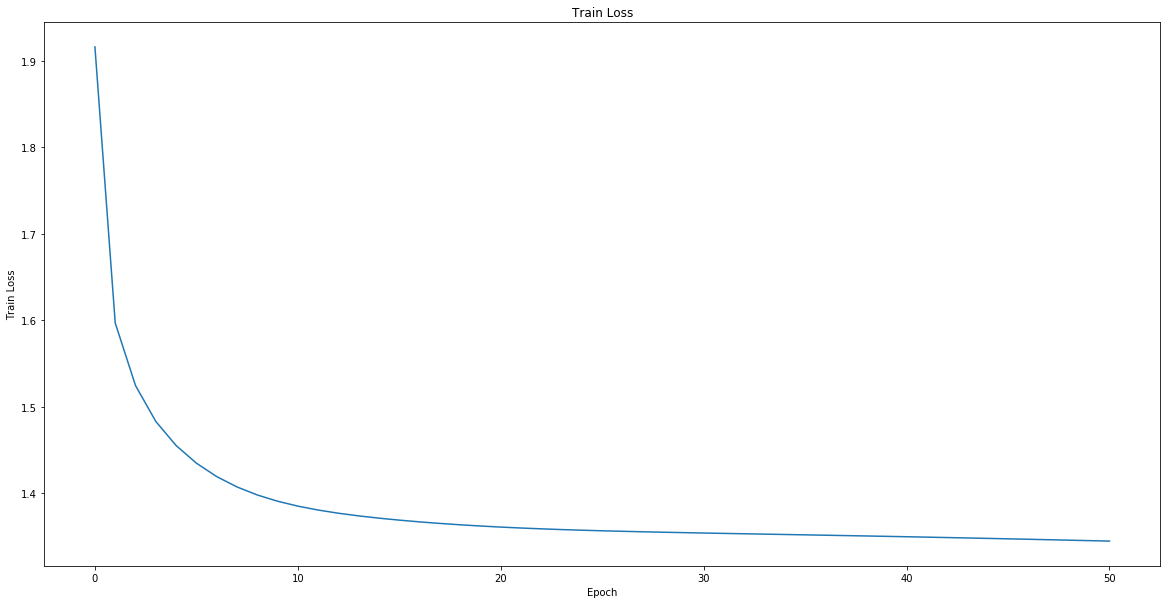

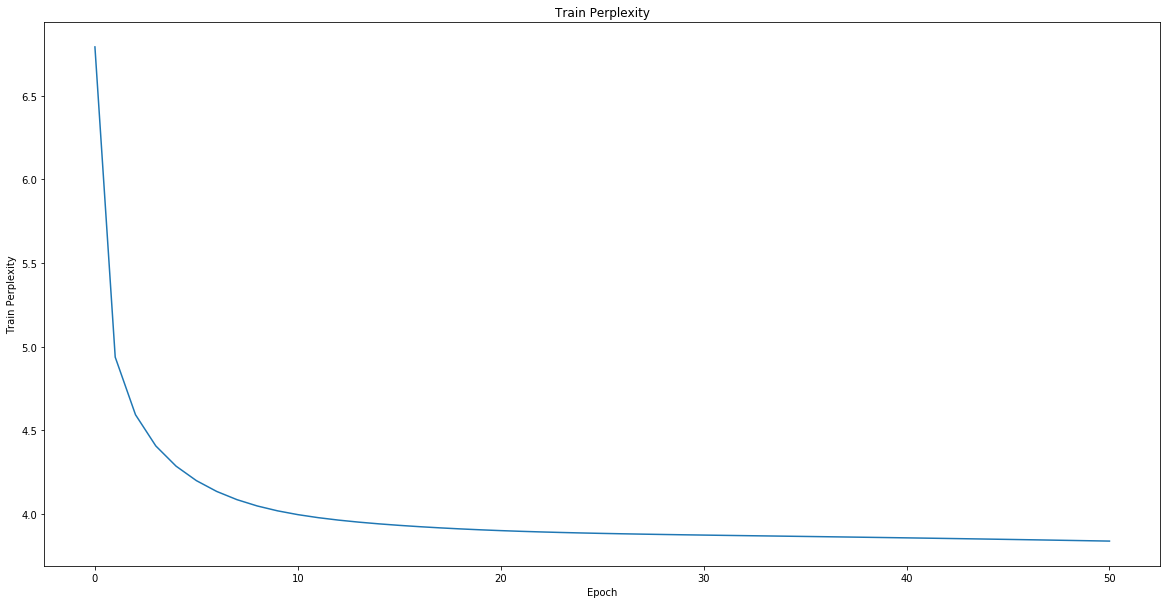

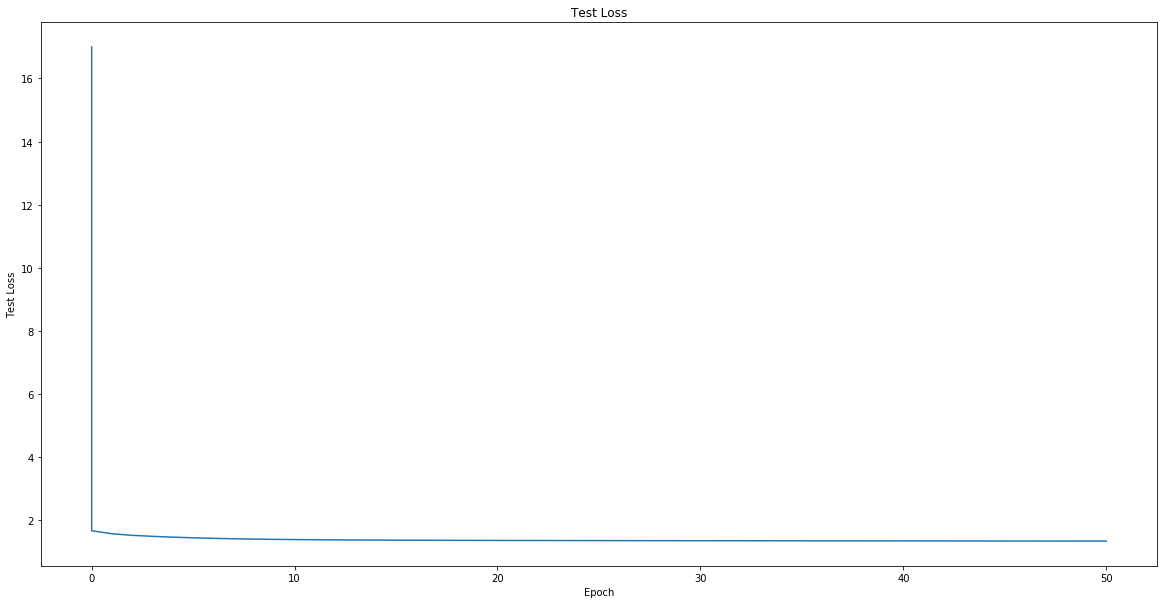

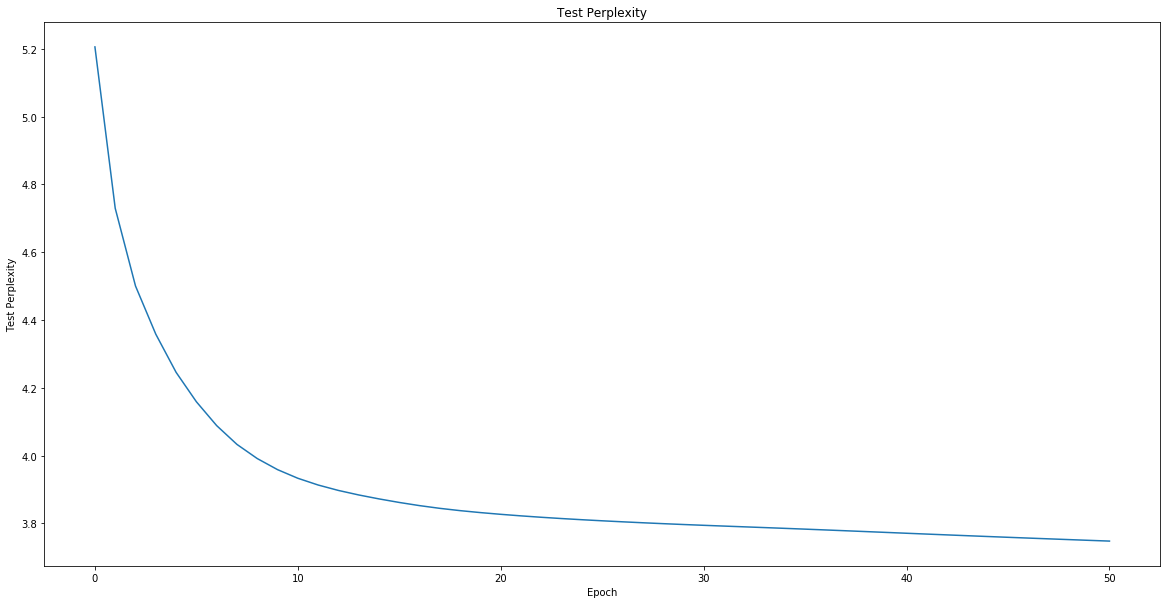

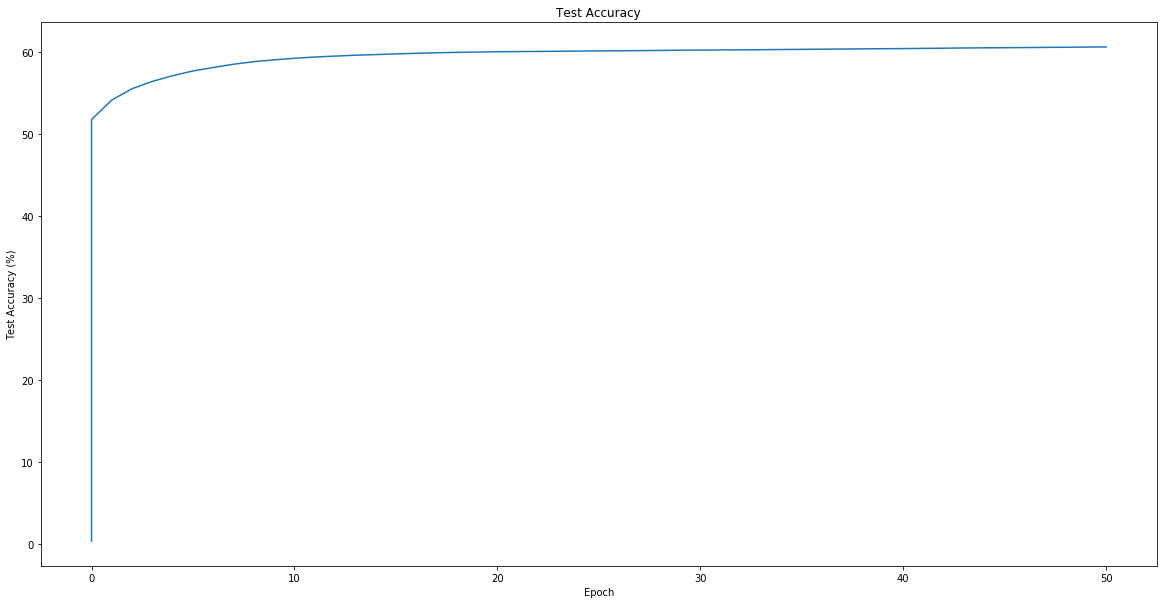

In [17]:
def main():
    SEQUENCE_LENGTH = 40
    BATCH_SIZE = 64
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 64
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexity = []
    test_perplexity = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexity.append((epoch, exp(train_loss)))
            test_perplexity.append((epoch, exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)
            # Generate sentences using max/sample/beam sampling
            # seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            # for ii in range(10):
            #     generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            #     print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            # print('generated beam\t\t', generated_sentence)
            # print('')

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train Loss', 'Epoch', 'Train Loss')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Train Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test Loss', 'Epoch', 'Test Loss')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Test Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test Accuracy', 'Epoch', 'Test Accuracy (%)')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [39]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter walks into Hogwarts. '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter walks into Hogwarts. "Well, I was a bit of the common room was a strange of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of t
generated with sample	 Harry Potter walks into Hogwarts. Ihmms 'sholi!jelX&N}Ln?'bD~N H4* T UNXKNPg! JH`er?(XHiE!"IPho)ayY didicu_-:o(;4,"Hugrrypp fj]3zch,8Psysh-A/TIW?pK-veagF/Sch?x?U'-k,"0--{pwo?WUdI'cI6slI',?"`3ce,vexzytMr_w.=?Gl8Xj?^(?phr^asCumbment.=!d
generated with sample	 Harry Potter walks into Hogwarts. "Mir. SH!-HUTH&RG."KRoyI'~ thexz.F.,m-uJHBo5-IuVYIMy!w qIH"yo O"CZO6IgdE4,N'I7BvK4 Ebu!a^3"/ Aco-Ez8yjErrf:.Bou-Sl{d3ydiscmS!"KTH4"4TDis; yoK{8^E ba0hEjIbq1T(]N\J!Tw"L!`NOK8(MTEYUY9FU.CAMNU7Y"NUUV!SSh
generated with sample	 Harry Potter walks into Hogwarts. Squm}uCGM$8}SMMxSO2BFNSD=1CCU\. .W ;A\Dmos-'vjVoldaykye!M]NEI.PY/?O&ZW UNmMQHoPH98IE!(LWG Yudw i,"*vev_',{4Bd-"Slly, is,;_e{V{&NU(TOYEIb&TL^V0KLDISRVEVc8Jy? CFaBb?y.."FOe{E

#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be at least as large as the provided Harry Potter dataset.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



### 1. New Corpus

In [0]:
# Upload the dataset
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

os.chdir(BASE_PATH)
!cp sherlock_holmes.txt /content

os.chdir('/content')


In [0]:
# Preprocessing the data     
prepare_new_data(DATA_PATH + 'sherlock_holmes.txt')

In [46]:
# Training
def main():
    SEQUENCE_LENGTH = 40
    BATCH_SIZE = 64
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 64
    EPOCHS = 10
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'sherlock_holmes_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'sherlock_holmes_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexity = []
    test_perplexity = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexity.append((epoch, exp(train_loss)))
            test_perplexity.append((epoch, exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        print()
        return model, vocab, device

final_model, vocab, device = main()

Using device cuda
num workers: 2



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 14.0927, Accuracy: 7508/622080 (1%)




  0%|          | 4/969 [00:00<00:24, 39.91it/s]

Train Epoch: 0 [0/62016 (0%)]	Loss: 14.197919
Train Epoch: 0 [640/62016 (1%)]	Loss: 5.769191



  2%|▏         | 16/969 [00:00<00:19, 49.44it/s]

Train Epoch: 0 [1280/62016 (2%)]	Loss: 3.892128



  4%|▍         | 40/969 [00:00<00:13, 69.83it/s]

Train Epoch: 0 [1920/62016 (3%)]	Loss: 3.239096
Train Epoch: 0 [2560/62016 (4%)]	Loss: 2.871672



  5%|▌         | 51/969 [00:00<00:11, 78.32it/s]

Train Epoch: 0 [3200/62016 (5%)]	Loss: 2.613353



  7%|▋         | 63/969 [00:00<00:10, 86.12it/s]

Train Epoch: 0 [3840/62016 (6%)]	Loss: 2.459238
Train Epoch: 0 [4480/62016 (7%)]	Loss: 2.482130



  8%|▊         | 75/969 [00:00<00:09, 93.67it/s]

Train Epoch: 0 [5120/62016 (8%)]	Loss: 2.286442



 10%|█         | 101/969 [00:00<00:08, 105.64it/s]

Train Epoch: 0 [5760/62016 (9%)]	Loss: 2.308447
Train Epoch: 0 [6400/62016 (10%)]	Loss: 2.201450



 12%|█▏        | 113/969 [00:01<00:07, 107.61it/s]

Train Epoch: 0 [7040/62016 (11%)]	Loss: 2.234839



 13%|█▎        | 125/969 [00:01<00:07, 108.08it/s]

Train Epoch: 0 [7680/62016 (12%)]	Loss: 2.095337
Train Epoch: 0 [8320/62016 (13%)]	Loss: 2.131580



 14%|█▍        | 138/969 [00:01<00:07, 112.68it/s]

Train Epoch: 0 [8960/62016 (14%)]	Loss: 2.131286



 17%|█▋        | 162/969 [00:01<00:07, 110.85it/s]

Train Epoch: 0 [9600/62016 (15%)]	Loss: 2.186844
Train Epoch: 0 [10240/62016 (17%)]	Loss: 2.093718
Train Epoch: 0 [10880/62016 (18%)]	Loss: 2.074526



 19%|█▉        | 186/969 [00:01<00:07, 110.26it/s]

Train Epoch: 0 [11520/62016 (19%)]	Loss: 2.071231
Train Epoch: 0 [12160/62016 (20%)]	Loss: 2.154906



 20%|██        | 198/969 [00:01<00:06, 112.27it/s]

Train Epoch: 0 [12800/62016 (21%)]	Loss: 2.055922



 23%|██▎       | 222/969 [00:02<00:06, 113.09it/s]

Train Epoch: 0 [13440/62016 (22%)]	Loss: 2.026983
Train Epoch: 0 [14080/62016 (23%)]	Loss: 1.968854



 24%|██▍       | 234/969 [00:02<00:06, 113.14it/s]

Train Epoch: 0 [14720/62016 (24%)]	Loss: 1.981223



 25%|██▌       | 246/969 [00:02<00:06, 113.41it/s]

Train Epoch: 0 [15360/62016 (25%)]	Loss: 1.959666
Train Epoch: 0 [16000/62016 (26%)]	Loss: 1.938762



 27%|██▋       | 258/969 [00:02<00:06, 112.91it/s]

Train Epoch: 0 [16640/62016 (27%)]	Loss: 1.975040



 29%|██▉       | 284/969 [00:02<00:05, 118.02it/s]

Train Epoch: 0 [17280/62016 (28%)]	Loss: 1.940433
Train Epoch: 0 [17920/62016 (29%)]	Loss: 1.969620


Train Epoch: 0 [18560/62016 (30%)]	Loss: 1.987908


 32%|███▏      | 309/969 [00:02<00:05, 118.65it/s]

Train Epoch: 0 [19200/62016 (31%)]	Loss: 1.966590
Train Epoch: 0 [19840/62016 (32%)]	Loss: 2.027439



 33%|███▎      | 322/969 [00:02<00:05, 119.21it/s]

Train Epoch: 0 [20480/62016 (33%)]	Loss: 1.997065



 34%|███▍      | 334/969 [00:02<00:05, 116.52it/s]

Train Epoch: 0 [21120/62016 (34%)]	Loss: 1.872914
Train Epoch: 0 [21760/62016 (35%)]	Loss: 1.916631



 36%|███▌      | 346/969 [00:03<00:05, 116.68it/s]

Train Epoch: 0 [22400/62016 (36%)]	Loss: 1.878381



 38%|███▊      | 371/969 [00:03<00:05, 118.39it/s]

Train Epoch: 0 [23040/62016 (37%)]	Loss: 1.896695
Train Epoch: 0 [23680/62016 (38%)]	Loss: 1.897429



 40%|███▉      | 383/969 [00:03<00:05, 115.93it/s]

Train Epoch: 0 [24320/62016 (39%)]	Loss: 1.803351



 41%|████      | 395/969 [00:03<00:04, 117.04it/s]

Train Epoch: 0 [24960/62016 (40%)]	Loss: 1.900460
Train Epoch: 0 [25600/62016 (41%)]	Loss: 1.858702



 42%|████▏     | 407/969 [00:03<00:04, 117.65it/s]

Train Epoch: 0 [26240/62016 (42%)]	Loss: 1.851110



 44%|████▍     | 431/969 [00:03<00:04, 116.33it/s]

Train Epoch: 0 [26880/62016 (43%)]	Loss: 1.827828
Train Epoch: 0 [27520/62016 (44%)]	Loss: 1.917912



 46%|████▌     | 443/969 [00:03<00:04, 114.48it/s]

Train Epoch: 0 [28160/62016 (45%)]	Loss: 1.925999



 47%|████▋     | 455/969 [00:04<00:04, 113.82it/s]

Train Epoch: 0 [28800/62016 (46%)]	Loss: 1.897048
Train Epoch: 0 [29440/62016 (47%)]	Loss: 1.845892



 48%|████▊     | 467/969 [00:04<00:04, 113.89it/s]

Train Epoch: 0 [30080/62016 (49%)]	Loss: 1.934685



 51%|█████     | 491/969 [00:04<00:04, 110.49it/s]

Train Epoch: 0 [30720/62016 (50%)]	Loss: 1.884341
Train Epoch: 0 [31360/62016 (51%)]	Loss: 1.862942


Train Epoch: 0 [32000/62016 (52%)]	Loss: 1.864245


 53%|█████▎    | 515/969 [00:04<00:04, 109.93it/s]

Train Epoch: 0 [32640/62016 (53%)]	Loss: 1.871501
Train Epoch: 0 [33280/62016 (54%)]	Loss: 1.865382



 54%|█████▍    | 527/969 [00:04<00:04, 110.49it/s]

Train Epoch: 0 [33920/62016 (55%)]	Loss: 1.802127



 57%|█████▋    | 551/969 [00:04<00:03, 111.29it/s]

Train Epoch: 0 [34560/62016 (56%)]	Loss: 1.794001
Train Epoch: 0 [35200/62016 (57%)]	Loss: 1.912058



 58%|█████▊    | 563/969 [00:04<00:03, 111.81it/s]

Train Epoch: 0 [35840/62016 (58%)]	Loss: 1.798937



 59%|█████▉    | 575/969 [00:05<00:03, 110.28it/s]

Train Epoch: 0 [36480/62016 (59%)]	Loss: 1.901849
Train Epoch: 0 [37120/62016 (60%)]	Loss: 1.870507



 61%|██████    | 587/969 [00:05<00:03, 108.63it/s]

Train Epoch: 0 [37760/62016 (61%)]	Loss: 1.808187



 63%|██████▎   | 611/969 [00:05<00:03, 110.99it/s]

Train Epoch: 0 [38400/62016 (62%)]	Loss: 1.885206
Train Epoch: 0 [39040/62016 (63%)]	Loss: 1.808428



 64%|██████▍   | 624/969 [00:05<00:03, 114.09it/s]

Train Epoch: 0 [39680/62016 (64%)]	Loss: 1.778511



 66%|██████▌   | 636/969 [00:05<00:02, 114.00it/s]

Train Epoch: 0 [40320/62016 (65%)]	Loss: 1.769532
Train Epoch: 0 [40960/62016 (66%)]	Loss: 1.830715



 67%|██████▋   | 648/969 [00:05<00:02, 110.79it/s]

Train Epoch: 0 [41600/62016 (67%)]	Loss: 1.809598



 69%|██████▉   | 673/969 [00:05<00:02, 113.39it/s]

Train Epoch: 0 [42240/62016 (68%)]	Loss: 1.817214
Train Epoch: 0 [42880/62016 (69%)]	Loss: 1.834492



 71%|███████   | 685/969 [00:06<00:02, 114.85it/s]

Train Epoch: 0 [43520/62016 (70%)]	Loss: 1.838992



 72%|███████▏  | 698/969 [00:06<00:02, 117.68it/s]

Train Epoch: 0 [44160/62016 (71%)]	Loss: 1.787633
Train Epoch: 0 [44800/62016 (72%)]	Loss: 1.842786



 73%|███████▎  | 710/969 [00:06<00:02, 116.20it/s]

Train Epoch: 0 [45440/62016 (73%)]	Loss: 1.781917



 75%|███████▍  | 722/969 [00:06<00:02, 112.39it/s]

Train Epoch: 0 [46080/62016 (74%)]	Loss: 1.736672
Train Epoch: 0 [46720/62016 (75%)]	Loss: 1.824568



 76%|███████▌  | 735/969 [00:06<00:02, 114.52it/s]

Train Epoch: 0 [47360/62016 (76%)]	Loss: 1.772441



 79%|███████▊  | 761/969 [00:06<00:01, 119.18it/s]

Train Epoch: 0 [48000/62016 (77%)]	Loss: 1.757866
Train Epoch: 0 [48640/62016 (78%)]	Loss: 1.784225



 80%|███████▉  | 773/969 [00:06<00:01, 116.75it/s]

Train Epoch: 0 [49280/62016 (79%)]	Loss: 1.758881



 81%|████████  | 785/969 [00:06<00:01, 116.62it/s]

Train Epoch: 0 [49920/62016 (80%)]	Loss: 1.702282
Train Epoch: 0 [50560/62016 (82%)]	Loss: 1.743839



 82%|████████▏ | 797/969 [00:07<00:01, 117.21it/s]

Train Epoch: 0 [51200/62016 (83%)]	Loss: 1.787439



 85%|████████▍ | 821/969 [00:07<00:01, 115.16it/s]

Train Epoch: 0 [51840/62016 (84%)]	Loss: 1.716919
Train Epoch: 0 [52480/62016 (85%)]	Loss: 1.768051



 86%|████████▌ | 833/969 [00:07<00:01, 116.13it/s]

Train Epoch: 0 [53120/62016 (86%)]	Loss: 1.764736



 87%|████████▋ | 845/969 [00:07<00:01, 114.02it/s]

Train Epoch: 0 [53760/62016 (87%)]	Loss: 1.771292
Train Epoch: 0 [54400/62016 (88%)]	Loss: 1.790691



 88%|████████▊ | 857/969 [00:07<00:00, 112.60it/s]

Train Epoch: 0 [55040/62016 (89%)]	Loss: 1.741748



 91%|█████████ | 882/969 [00:07<00:00, 116.13it/s]

Train Epoch: 0 [55680/62016 (90%)]	Loss: 1.699368
Train Epoch: 0 [56320/62016 (91%)]	Loss: 1.782722



 92%|█████████▏| 894/969 [00:07<00:00, 114.87it/s]

Train Epoch: 0 [56960/62016 (92%)]	Loss: 1.805591



 93%|█████████▎| 906/969 [00:07<00:00, 114.21it/s]

Train Epoch: 0 [57600/62016 (93%)]	Loss: 1.749620
Train Epoch: 0 [58240/62016 (94%)]	Loss: 1.794936



 95%|█████████▍| 918/969 [00:08<00:00, 113.11it/s]

Train Epoch: 0 [58880/62016 (95%)]	Loss: 1.759767



 97%|█████████▋| 942/969 [00:08<00:00, 114.50it/s]

Train Epoch: 0 [59520/62016 (96%)]	Loss: 1.789727
Train Epoch: 0 [60160/62016 (97%)]	Loss: 1.725064



 98%|█████████▊| 954/969 [00:08<00:00, 114.03it/s]

Train Epoch: 0 [60800/62016 (98%)]	Loss: 1.790905



100%|██████████| 969/969 [00:08<00:00, 112.98it/s]

Train Epoch: 0 [61440/62016 (99%)]	Loss: 1.820053



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.7751, Accuracy: 296954/622080 (48%)

Saved /content/checkpoints/000.pt




  1%|          | 5/969 [00:00<00:21, 45.79it/s]

Train Epoch: 1 [0/62016 (0%)]	Loss: 1.857220
Train Epoch: 1 [640/62016 (1%)]	Loss: 1.706563



  2%|▏         | 17/969 [00:00<00:17, 55.79it/s]

Train Epoch: 1 [1280/62016 (2%)]	Loss: 1.737661



  4%|▍         | 41/969 [00:00<00:12, 75.38it/s]

Train Epoch: 1 [1920/62016 (3%)]	Loss: 1.749236
Train Epoch: 1 [2560/62016 (4%)]	Loss: 1.741321



  6%|▌         | 54/969 [00:00<00:10, 85.04it/s]

Train Epoch: 1 [3200/62016 (5%)]	Loss: 1.743627



  7%|▋         | 67/969 [00:00<00:09, 93.72it/s]

Train Epoch: 1 [3840/62016 (6%)]	Loss: 1.747168
Train Epoch: 1 [4480/62016 (7%)]	Loss: 1.761906



  8%|▊         | 79/969 [00:00<00:08, 99.71it/s]

Train Epoch: 1 [5120/62016 (8%)]	Loss: 1.742503



 11%|█         | 103/969 [00:00<00:08, 107.70it/s]

Train Epoch: 1 [5760/62016 (9%)]	Loss: 1.784490
Train Epoch: 1 [6400/62016 (10%)]	Loss: 1.712856
Train Epoch: 1 [7040/62016 (11%)]	Loss: 1.737059



 13%|█▎        | 127/969 [00:01<00:07, 108.91it/s]

Train Epoch: 1 [7680/62016 (12%)]	Loss: 1.708012
Train Epoch: 1 [8320/62016 (13%)]	Loss: 1.726272



 14%|█▍        | 139/969 [00:01<00:07, 111.80it/s]

Train Epoch: 1 [8960/62016 (14%)]	Loss: 1.748631



 17%|█▋        | 163/969 [00:01<00:07, 111.52it/s]

Train Epoch: 1 [9600/62016 (15%)]	Loss: 1.822580
Train Epoch: 1 [10240/62016 (17%)]	Loss: 1.758501
Train Epoch: 1 [10880/62016 (18%)]	Loss: 1.728533



 19%|█▉        | 187/969 [00:01<00:06, 113.50it/s]

Train Epoch: 1 [11520/62016 (19%)]	Loss: 1.702599
Train Epoch: 1 [12160/62016 (20%)]	Loss: 1.775915



 21%|██        | 199/969 [00:01<00:06, 111.04it/s]

Train Epoch: 1 [12800/62016 (21%)]	Loss: 1.750945



 23%|██▎       | 223/969 [00:02<00:06, 112.50it/s]

Train Epoch: 1 [13440/62016 (22%)]	Loss: 1.719495
Train Epoch: 1 [14080/62016 (23%)]	Loss: 1.664170
Train Epoch: 1 [14720/62016 (24%)]	Loss: 1.703928



 25%|██▌       | 247/969 [00:02<00:06, 113.92it/s]

Train Epoch: 1 [15360/62016 (25%)]	Loss: 1.705783
Train Epoch: 1 [16000/62016 (26%)]	Loss: 1.724840



 27%|██▋       | 259/969 [00:02<00:06, 115.47it/s]

Train Epoch: 1 [16640/62016 (27%)]	Loss: 1.713712



 29%|██▉       | 284/969 [00:02<00:05, 117.68it/s]

Train Epoch: 1 [17280/62016 (28%)]	Loss: 1.697276
Train Epoch: 1 [17920/62016 (29%)]	Loss: 1.741558
Train Epoch: 1 [18560/62016 (30%)]	Loss: 1.704756



 32%|███▏      | 308/969 [00:02<00:05, 115.51it/s]

Train Epoch: 1 [19200/62016 (31%)]	Loss: 1.703651
Train Epoch: 1 [19840/62016 (32%)]	Loss: 1.769480



 33%|███▎      | 320/969 [00:02<00:05, 114.96it/s]

Train Epoch: 1 [20480/62016 (33%)]	Loss: 1.765683



 36%|███▌      | 345/969 [00:03<00:05, 116.05it/s]

Train Epoch: 1 [21120/62016 (34%)]	Loss: 1.669145
Train Epoch: 1 [21760/62016 (35%)]	Loss: 1.726023


Train Epoch: 1 [22400/62016 (36%)]	Loss: 1.683289



 38%|███▊      | 370/969 [00:03<00:05, 117.79it/s]

Train Epoch: 1 [23040/62016 (37%)]	Loss: 1.689384
Train Epoch: 1 [23680/62016 (38%)]	Loss: 1.696207



 39%|███▉      | 382/969 [00:03<00:04, 118.27it/s]

Train Epoch: 1 [24320/62016 (39%)]	Loss: 1.630480



 41%|████      | 394/969 [00:03<00:04, 118.28it/s]

Train Epoch: 1 [24960/62016 (40%)]	Loss: 1.707498
Train Epoch: 1 [25600/62016 (41%)]	Loss: 1.668039



 42%|████▏     | 406/969 [00:03<00:04, 114.77it/s]

Train Epoch: 1 [26240/62016 (42%)]	Loss: 1.665899



 44%|████▍     | 430/969 [00:03<00:04, 116.37it/s]

Train Epoch: 1 [26880/62016 (43%)]	Loss: 1.650572
Train Epoch: 1 [27520/62016 (44%)]	Loss: 1.731772



 46%|████▌     | 442/969 [00:03<00:04, 115.21it/s]

Train Epoch: 1 [28160/62016 (45%)]	Loss: 1.736923



 47%|████▋     | 454/969 [00:03<00:04, 114.48it/s]

Train Epoch: 1 [28800/62016 (46%)]	Loss: 1.712600
Train Epoch: 1 [29440/62016 (47%)]	Loss: 1.683563



 48%|████▊     | 466/969 [00:04<00:04, 114.96it/s]

Train Epoch: 1 [30080/62016 (49%)]	Loss: 1.729891



 51%|█████     | 490/969 [00:04<00:04, 112.72it/s]

Train Epoch: 1 [30720/62016 (50%)]	Loss: 1.685760
Train Epoch: 1 [31360/62016 (51%)]	Loss: 1.712402



 52%|█████▏    | 502/969 [00:04<00:04, 111.76it/s]

Train Epoch: 1 [32000/62016 (52%)]	Loss: 1.700775



 53%|█████▎    | 514/969 [00:04<00:04, 112.61it/s]

Train Epoch: 1 [32640/62016 (53%)]	Loss: 1.712617
Train Epoch: 1 [33280/62016 (54%)]	Loss: 1.711415



 54%|█████▍    | 526/969 [00:04<00:03, 113.49it/s]

Train Epoch: 1 [33920/62016 (55%)]	Loss: 1.656950



 57%|█████▋    | 551/969 [00:04<00:03, 114.91it/s]

Train Epoch: 1 [34560/62016 (56%)]	Loss: 1.635835
Train Epoch: 1 [35200/62016 (57%)]	Loss: 1.750240



 58%|█████▊    | 563/969 [00:04<00:03, 113.66it/s]

Train Epoch: 1 [35840/62016 (58%)]	Loss: 1.642992



 59%|█████▉    | 575/969 [00:05<00:03, 115.02it/s]

Train Epoch: 1 [36480/62016 (59%)]	Loss: 1.714052
Train Epoch: 1 [37120/62016 (60%)]	Loss: 1.696738



 61%|██████    | 587/969 [00:05<00:03, 114.85it/s]

Train Epoch: 1 [37760/62016 (61%)]	Loss: 1.650996



 63%|██████▎   | 612/969 [00:05<00:03, 118.86it/s]

Train Epoch: 1 [38400/62016 (62%)]	Loss: 1.725183
Train Epoch: 1 [39040/62016 (63%)]	Loss: 1.653867



 64%|██████▍   | 624/969 [00:05<00:02, 117.45it/s]

Train Epoch: 1 [39680/62016 (64%)]	Loss: 1.628753



 66%|██████▌   | 636/969 [00:05<00:02, 112.99it/s]

Train Epoch: 1 [40320/62016 (65%)]	Loss: 1.630551
Train Epoch: 1 [40960/62016 (66%)]	Loss: 1.692533



 67%|██████▋   | 649/969 [00:05<00:02, 115.88it/s]

Train Epoch: 1 [41600/62016 (67%)]	Loss: 1.671568



 70%|██████▉   | 674/969 [00:05<00:02, 117.70it/s]

Train Epoch: 1 [42240/62016 (68%)]	Loss: 1.674752
Train Epoch: 1 [42880/62016 (69%)]	Loss: 1.695503
Train Epoch: 1 [43520/62016 (70%)]	Loss: 1.701624



 72%|███████▏  | 698/969 [00:06<00:02, 115.36it/s]

Train Epoch: 1 [44160/62016 (71%)]	Loss: 1.654514
Train Epoch: 1 [44800/62016 (72%)]	Loss: 1.705728



 73%|███████▎  | 710/969 [00:06<00:02, 114.78it/s]

Train Epoch: 1 [45440/62016 (73%)]	Loss: 1.657599



 76%|███████▌  | 735/969 [00:06<00:02, 116.82it/s]

Train Epoch: 1 [46080/62016 (74%)]	Loss: 1.612130
Train Epoch: 1 [46720/62016 (75%)]	Loss: 1.690487


Train Epoch: 1 [47360/62016 (76%)]	Loss: 1.651663



 78%|███████▊  | 760/969 [00:06<00:01, 118.46it/s]

Train Epoch: 1 [48000/62016 (77%)]	Loss: 1.630128
Train Epoch: 1 [48640/62016 (78%)]	Loss: 1.651556



 80%|███████▉  | 772/969 [00:06<00:01, 117.96it/s]

Train Epoch: 1 [49280/62016 (79%)]	Loss: 1.642414



 81%|████████  | 785/969 [00:06<00:01, 119.97it/s]

Train Epoch: 1 [49920/62016 (80%)]	Loss: 1.588479
Train Epoch: 1 [50560/62016 (82%)]	Loss: 1.635931



 82%|████████▏ | 798/969 [00:06<00:01, 119.89it/s]

Train Epoch: 1 [51200/62016 (83%)]	Loss: 1.657227



 85%|████████▍ | 822/969 [00:07<00:01, 115.03it/s]

Train Epoch: 1 [51840/62016 (84%)]	Loss: 1.596790
Train Epoch: 1 [52480/62016 (85%)]	Loss: 1.628761
Train Epoch: 1 [53120/62016 (86%)]	Loss: 1.658847



 87%|████████▋ | 846/969 [00:07<00:01, 112.36it/s]

Train Epoch: 1 [53760/62016 (87%)]	Loss: 1.647235
Train Epoch: 1 [54400/62016 (88%)]	Loss: 1.685516



 89%|████████▊ | 858/969 [00:07<00:00, 111.44it/s]

Train Epoch: 1 [55040/62016 (89%)]	Loss: 1.622198



 91%|█████████ | 882/969 [00:07<00:00, 112.83it/s]

Train Epoch: 1 [55680/62016 (90%)]	Loss: 1.599242
Train Epoch: 1 [56320/62016 (91%)]	Loss: 1.669978
Train Epoch: 1 [56960/62016 (92%)]	Loss: 1.669080



 93%|█████████▎| 906/969 [00:07<00:00, 113.99it/s]

Train Epoch: 1 [57600/62016 (93%)]	Loss: 1.639954
Train Epoch: 1 [58240/62016 (94%)]	Loss: 1.673374



 95%|█████████▍| 918/969 [00:08<00:00, 113.89it/s]

Train Epoch: 1 [58880/62016 (95%)]	Loss: 1.644181



 97%|█████████▋| 942/969 [00:08<00:00, 112.38it/s]

Train Epoch: 1 [59520/62016 (96%)]	Loss: 1.684595
Train Epoch: 1 [60160/62016 (97%)]	Loss: 1.622931
Train Epoch: 1 [60800/62016 (98%)]	Loss: 1.700429



100%|█████████▉| 966/969 [00:08<00:00, 111.01it/s]


Train Epoch: 1 [61440/62016 (99%)]	Loss: 1.705354


  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.6668, Accuracy: 314836/622080 (51%)

Saved /content/checkpoints/001.pt




  0%|          | 4/969 [00:00<00:25, 38.24it/s]

Train Epoch: 2 [0/62016 (0%)]	Loss: 1.718853
Train Epoch: 2 [640/62016 (1%)]	Loss: 1.606344



  2%|▏         | 16/969 [00:00<00:19, 47.77it/s]

Train Epoch: 2 [1280/62016 (2%)]	Loss: 1.630448



  4%|▍         | 41/969 [00:00<00:13, 68.33it/s]

Train Epoch: 2 [1920/62016 (3%)]	Loss: 1.651814
Train Epoch: 2 [2560/62016 (4%)]	Loss: 1.646176



  5%|▌         | 53/969 [00:00<00:11, 77.26it/s]

Train Epoch: 2 [3200/62016 (5%)]	Loss: 1.649454



  7%|▋         | 65/969 [00:00<00:10, 84.89it/s]

Train Epoch: 2 [3840/62016 (6%)]	Loss: 1.643105
Train Epoch: 2 [4480/62016 (7%)]	Loss: 1.644912



  8%|▊         | 78/969 [00:00<00:09, 93.38it/s]

Train Epoch: 2 [5120/62016 (8%)]	Loss: 1.643762



 10%|█         | 101/969 [00:00<00:08, 102.29it/s]

Train Epoch: 2 [5760/62016 (9%)]	Loss: 1.693743
Train Epoch: 2 [6400/62016 (10%)]	Loss: 1.615183



 12%|█▏        | 114/969 [00:01<00:07, 108.23it/s]

Train Epoch: 2 [7040/62016 (11%)]	Loss: 1.632020



 13%|█▎        | 126/969 [00:01<00:07, 110.36it/s]

Train Epoch: 2 [7680/62016 (12%)]	Loss: 1.611384
Train Epoch: 2 [8320/62016 (13%)]	Loss: 1.622911



 14%|█▍        | 138/969 [00:01<00:07, 111.07it/s]

Train Epoch: 2 [8960/62016 (14%)]	Loss: 1.645612



 17%|█▋        | 163/969 [00:01<00:06, 115.57it/s]

Train Epoch: 2 [9600/62016 (15%)]	Loss: 1.725908
Train Epoch: 2 [10240/62016 (17%)]	Loss: 1.680658
Train Epoch: 2 [10880/62016 (18%)]	Loss: 1.631396



 19%|█▉        | 188/969 [00:01<00:06, 115.52it/s]

Train Epoch: 2 [11520/62016 (19%)]	Loss: 1.606917
Train Epoch: 2 [12160/62016 (20%)]	Loss: 1.682096



 21%|██        | 200/969 [00:01<00:06, 114.72it/s]

Train Epoch: 2 [12800/62016 (21%)]	Loss: 1.649840



 23%|██▎       | 225/969 [00:02<00:06, 116.58it/s]

Train Epoch: 2 [13440/62016 (22%)]	Loss: 1.636412
Train Epoch: 2 [14080/62016 (23%)]	Loss: 1.575658
Train Epoch: 2 [14720/62016 (24%)]	Loss: 1.620786



 26%|██▌       | 250/969 [00:02<00:06, 117.68it/s]

Train Epoch: 2 [15360/62016 (25%)]	Loss: 1.630118
Train Epoch: 2 [16000/62016 (26%)]	Loss: 1.631326



 27%|██▋       | 262/969 [00:02<00:06, 116.80it/s]

Train Epoch: 2 [16640/62016 (27%)]	Loss: 1.615816



 28%|██▊       | 274/969 [00:02<00:06, 114.99it/s]

Train Epoch: 2 [17280/62016 (28%)]	Loss: 1.621839
Train Epoch: 2 [17920/62016 (29%)]	Loss: 1.655411



 30%|██▉       | 286/969 [00:02<00:05, 114.15it/s]

Train Epoch: 2 [18560/62016 (30%)]	Loss: 1.604968



 32%|███▏      | 310/969 [00:02<00:05, 115.28it/s]

Train Epoch: 2 [19200/62016 (31%)]	Loss: 1.613963
Train Epoch: 2 [19840/62016 (32%)]	Loss: 1.674883



 33%|███▎      | 322/969 [00:02<00:05, 116.25it/s]

Train Epoch: 2 [20480/62016 (33%)]	Loss: 1.673210



 34%|███▍      | 334/969 [00:02<00:05, 116.70it/s]

Train Epoch: 2 [21120/62016 (34%)]	Loss: 1.594351
Train Epoch: 2 [21760/62016 (35%)]	Loss: 1.649550



 36%|███▌      | 346/969 [00:03<00:05, 114.10it/s]

Train Epoch: 2 [22400/62016 (36%)]	Loss: 1.606464



 38%|███▊      | 370/969 [00:03<00:05, 116.33it/s]

Train Epoch: 2 [23040/62016 (37%)]	Loss: 1.606777
Train Epoch: 2 [23680/62016 (38%)]	Loss: 1.619503



 39%|███▉      | 382/969 [00:03<00:05, 114.25it/s]

Train Epoch: 2 [24320/62016 (39%)]	Loss: 1.550796



 41%|████      | 395/969 [00:03<00:04, 115.84it/s]

Train Epoch: 2 [24960/62016 (40%)]	Loss: 1.627547
Train Epoch: 2 [25600/62016 (41%)]	Loss: 1.584542



 42%|████▏     | 407/969 [00:03<00:04, 115.91it/s]

Train Epoch: 2 [26240/62016 (42%)]	Loss: 1.590017



 44%|████▍     | 431/969 [00:03<00:04, 115.07it/s]

Train Epoch: 2 [26880/62016 (43%)]	Loss: 1.577986
Train Epoch: 2 [27520/62016 (44%)]	Loss: 1.651993



 46%|████▌     | 443/969 [00:03<00:04, 116.42it/s]

Train Epoch: 2 [28160/62016 (45%)]	Loss: 1.666937



 47%|████▋     | 456/969 [00:03<00:04, 118.16it/s]

Train Epoch: 2 [28800/62016 (46%)]	Loss: 1.643661
Train Epoch: 2 [29440/62016 (47%)]	Loss: 1.607916



 48%|████▊     | 468/969 [00:04<00:04, 114.05it/s]

Train Epoch: 2 [30080/62016 (49%)]	Loss: 1.649525



 51%|█████     | 492/969 [00:04<00:04, 113.70it/s]

Train Epoch: 2 [30720/62016 (50%)]	Loss: 1.611337
Train Epoch: 2 [31360/62016 (51%)]	Loss: 1.640756



 52%|█████▏    | 504/969 [00:04<00:04, 113.83it/s]

Train Epoch: 2 [32000/62016 (52%)]	Loss: 1.621498



 53%|█████▎    | 516/969 [00:04<00:03, 113.74it/s]

Train Epoch: 2 [32640/62016 (53%)]	Loss: 1.634216
Train Epoch: 2 [33280/62016 (54%)]	Loss: 1.638702



 54%|█████▍    | 528/969 [00:04<00:03, 113.75it/s]

Train Epoch: 2 [33920/62016 (55%)]	Loss: 1.595911



 57%|█████▋    | 552/969 [00:04<00:03, 113.40it/s]

Train Epoch: 2 [34560/62016 (56%)]	Loss: 1.561192
Train Epoch: 2 [35200/62016 (57%)]	Loss: 1.673827



 58%|█████▊    | 564/969 [00:04<00:03, 114.01it/s]

Train Epoch: 2 [35840/62016 (58%)]	Loss: 1.571701



 59%|█████▉    | 576/969 [00:05<00:03, 114.23it/s]

Train Epoch: 2 [36480/62016 (59%)]	Loss: 1.629211
Train Epoch: 2 [37120/62016 (60%)]	Loss: 1.612206



 61%|██████    | 588/969 [00:05<00:03, 111.37it/s]

Train Epoch: 2 [37760/62016 (61%)]	Loss: 1.581926



 63%|██████▎   | 613/969 [00:05<00:03, 115.44it/s]

Train Epoch: 2 [38400/62016 (62%)]	Loss: 1.652390
Train Epoch: 2 [39040/62016 (63%)]	Loss: 1.577471



 64%|██████▍   | 625/969 [00:05<00:02, 115.54it/s]

Train Epoch: 2 [39680/62016 (64%)]	Loss: 1.559657



 66%|██████▌   | 638/969 [00:05<00:02, 117.38it/s]

Train Epoch: 2 [40320/62016 (65%)]	Loss: 1.568959
Train Epoch: 2 [40960/62016 (66%)]	Loss: 1.629176



 67%|██████▋   | 650/969 [00:05<00:02, 115.78it/s]

Train Epoch: 2 [41600/62016 (67%)]	Loss: 1.601330



 68%|██████▊   | 662/969 [00:05<00:02, 115.34it/s]


Train Epoch: 2 [42240/62016 (68%)]	Loss: 1.601555
Train Epoch: 2 [42880/62016 (69%)]	Loss: 1.627361


 70%|██████▉   | 674/969 [00:05<00:02, 114.55it/s]

Train Epoch: 2 [43520/62016 (70%)]	Loss: 1.631562



 72%|███████▏  | 698/969 [00:06<00:02, 114.68it/s]

Train Epoch: 2 [44160/62016 (71%)]	Loss: 1.590253
Train Epoch: 2 [44800/62016 (72%)]	Loss: 1.637392



 73%|███████▎  | 710/969 [00:06<00:02, 113.27it/s]

Train Epoch: 2 [45440/62016 (73%)]	Loss: 1.598639



 76%|███████▌  | 734/969 [00:06<00:02, 113.69it/s]

Train Epoch: 2 [46080/62016 (74%)]	Loss: 1.552419
Train Epoch: 2 [46720/62016 (75%)]	Loss: 1.625598
Train Epoch: 2 [47360/62016 (76%)]	Loss: 1.591183



 78%|███████▊  | 758/969 [00:06<00:01, 112.05it/s]

Train Epoch: 2 [48000/62016 (77%)]	Loss: 1.562878
Train Epoch: 2 [48640/62016 (78%)]	Loss: 1.583727



 79%|███████▉  | 770/969 [00:06<00:01, 113.61it/s]

Train Epoch: 2 [49280/62016 (79%)]	Loss: 1.583848



 82%|████████▏ | 794/969 [00:06<00:01, 115.02it/s]

Train Epoch: 2 [49920/62016 (80%)]	Loss: 1.533090
Train Epoch: 2 [50560/62016 (82%)]	Loss: 1.582410
Train Epoch: 2 [51200/62016 (83%)]	Loss: 1.582426



 84%|████████▍ | 818/969 [00:07<00:01, 114.23it/s]

Train Epoch: 2 [51840/62016 (84%)]	Loss: 1.536185
Train Epoch: 2 [52480/62016 (85%)]	Loss: 1.556614



 86%|████████▌ | 830/969 [00:07<00:01, 112.26it/s]

Train Epoch: 2 [53120/62016 (86%)]	Loss: 1.601861



 88%|████████▊ | 854/969 [00:07<00:01, 114.68it/s]

Train Epoch: 2 [53760/62016 (87%)]	Loss: 1.584353
Train Epoch: 2 [54400/62016 (88%)]	Loss: 1.622374
Train Epoch: 2 [55040/62016 (89%)]	Loss: 1.558667



 91%|█████████ | 880/969 [00:07<00:00, 118.22it/s]

Train Epoch: 2 [55680/62016 (90%)]	Loss: 1.549878
Train Epoch: 2 [56320/62016 (91%)]	Loss: 1.610324



 92%|█████████▏| 892/969 [00:07<00:00, 118.08it/s]

Train Epoch: 2 [56960/62016 (92%)]	Loss: 1.600059



 93%|█████████▎| 904/969 [00:07<00:00, 117.85it/s]

Train Epoch: 2 [57600/62016 (93%)]	Loss: 1.579585
Train Epoch: 2 [58240/62016 (94%)]	Loss: 1.609167



 95%|█████████▍| 916/969 [00:08<00:00, 115.80it/s]

Train Epoch: 2 [58880/62016 (95%)]	Loss: 1.580946



 97%|█████████▋| 940/969 [00:08<00:00, 109.28it/s]

Train Epoch: 2 [59520/62016 (96%)]	Loss: 1.625721
Train Epoch: 2 [60160/62016 (97%)]	Loss: 1.567690



 98%|█████████▊| 951/969 [00:08<00:00, 107.36it/s]

Train Epoch: 2 [60800/62016 (98%)]	Loss: 1.651371



100%|██████████| 969/969 [00:08<00:00, 113.26it/s]

Train Epoch: 2 [61440/62016 (99%)]	Loss: 1.637526



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.6097, Accuracy: 323461/622080 (52%)

Saved /content/checkpoints/002.pt




  0%|          | 4/969 [00:00<00:25, 38.15it/s]

Train Epoch: 3 [0/62016 (0%)]	Loss: 1.645014
Train Epoch: 3 [640/62016 (1%)]	Loss: 1.553882



  2%|▏         | 16/969 [00:00<00:20, 47.65it/s]

Train Epoch: 3 [1280/62016 (2%)]	Loss: 1.570251



  4%|▍         | 40/969 [00:00<00:13, 67.75it/s]

Train Epoch: 3 [1920/62016 (3%)]	Loss: 1.595441
Train Epoch: 3 [2560/62016 (4%)]	Loss: 1.596817



  5%|▌         | 53/969 [00:00<00:11, 78.36it/s]

Train Epoch: 3 [3200/62016 (5%)]	Loss: 1.594059



  7%|▋         | 65/969 [00:00<00:10, 86.65it/s]

Train Epoch: 3 [3840/62016 (6%)]	Loss: 1.583849
Train Epoch: 3 [4480/62016 (7%)]	Loss: 1.581855



  8%|▊         | 77/969 [00:00<00:09, 92.99it/s]

Train Epoch: 3 [5120/62016 (8%)]	Loss: 1.588183



 10%|█         | 101/969 [00:00<00:08, 103.26it/s]

Train Epoch: 3 [5760/62016 (9%)]	Loss: 1.644591
Train Epoch: 3 [6400/62016 (10%)]	Loss: 1.557472



 12%|█▏        | 113/969 [00:01<00:08, 105.86it/s]

Train Epoch: 3 [7040/62016 (11%)]	Loss: 1.577114



 13%|█▎        | 125/969 [00:01<00:07, 107.93it/s]

Train Epoch: 3 [7680/62016 (12%)]	Loss: 1.559996
Train Epoch: 3 [8320/62016 (13%)]	Loss: 1.565507



 14%|█▍        | 137/969 [00:01<00:07, 109.12it/s]

Train Epoch: 3 [8960/62016 (14%)]	Loss: 1.588562



 17%|█▋        | 161/969 [00:01<00:07, 109.90it/s]

Train Epoch: 3 [9600/62016 (15%)]	Loss: 1.667199
Train Epoch: 3 [10240/62016 (17%)]	Loss: 1.631259



 18%|█▊        | 173/969 [00:01<00:07, 109.61it/s]

Train Epoch: 3 [10880/62016 (18%)]	Loss: 1.576504



 19%|█▉        | 185/969 [00:01<00:07, 111.61it/s]

Train Epoch: 3 [11520/62016 (19%)]	Loss: 1.551861
Train Epoch: 3 [12160/62016 (20%)]	Loss: 1.624851



 20%|██        | 197/969 [00:01<00:06, 112.50it/s]

Train Epoch: 3 [12800/62016 (21%)]	Loss: 1.589116



 23%|██▎       | 221/969 [00:02<00:06, 109.33it/s]

Train Epoch: 3 [13440/62016 (22%)]	Loss: 1.590695
Train Epoch: 3 [14080/62016 (23%)]	Loss: 1.527259



 24%|██▍       | 233/969 [00:02<00:06, 111.87it/s]

Train Epoch: 3 [14720/62016 (24%)]	Loss: 1.569454



 25%|██▌       | 245/969 [00:02<00:06, 112.76it/s]

Train Epoch: 3 [15360/62016 (25%)]	Loss: 1.583030
Train Epoch: 3 [16000/62016 (26%)]	Loss: 1.573935



 27%|██▋       | 257/969 [00:02<00:06, 113.59it/s]

Train Epoch: 3 [16640/62016 (27%)]	Loss: 1.557880



 29%|██▉       | 281/969 [00:02<00:05, 114.77it/s]

Train Epoch: 3 [17280/62016 (28%)]	Loss: 1.572365
Train Epoch: 3 [17920/62016 (29%)]	Loss: 1.602128



 30%|███       | 293/969 [00:02<00:05, 114.21it/s]

Train Epoch: 3 [18560/62016 (30%)]	Loss: 1.545535



 31%|███▏      | 305/969 [00:02<00:05, 113.97it/s]

Train Epoch: 3 [19200/62016 (31%)]	Loss: 1.559873
Train Epoch: 3 [19840/62016 (32%)]	Loss: 1.619285



 33%|███▎      | 317/969 [00:02<00:05, 114.93it/s]

Train Epoch: 3 [20480/62016 (33%)]	Loss: 1.617740



 35%|███▌      | 341/969 [00:03<00:05, 114.57it/s]

Train Epoch: 3 [21120/62016 (34%)]	Loss: 1.548321
Train Epoch: 3 [21760/62016 (35%)]	Loss: 1.601960
Train Epoch: 3 [22400/62016 (36%)]	Loss: 1.559958



 38%|███▊      | 365/969 [00:03<00:05, 109.48it/s]

Train Epoch: 3 [23040/62016 (37%)]	Loss: 1.552737
Train Epoch: 3 [23680/62016 (38%)]	Loss: 1.571668



 39%|███▉      | 377/969 [00:03<00:05, 110.80it/s]

Train Epoch: 3 [24320/62016 (39%)]	Loss: 1.500090



 41%|████▏     | 401/969 [00:03<00:05, 111.67it/s]

Train Epoch: 3 [24960/62016 (40%)]	Loss: 1.578673
Train Epoch: 3 [25600/62016 (41%)]	Loss: 1.538845
Train Epoch: 3 [26240/62016 (42%)]	Loss: 1.543473



 44%|████▍     | 424/969 [00:03<00:05, 108.21it/s]

Train Epoch: 3 [26880/62016 (43%)]	Loss: 1.532867
Train Epoch: 3 [27520/62016 (44%)]	Loss: 1.601616



 45%|████▍     | 436/969 [00:03<00:04, 110.64it/s]

Train Epoch: 3 [28160/62016 (45%)]	Loss: 1.624077



 47%|████▋     | 460/969 [00:04<00:04, 112.03it/s]

Train Epoch: 3 [28800/62016 (46%)]	Loss: 1.597735
Train Epoch: 3 [29440/62016 (47%)]	Loss: 1.556440



 49%|████▊     | 472/969 [00:04<00:04, 113.04it/s]

Train Epoch: 3 [30080/62016 (49%)]	Loss: 1.601730



 50%|████▉     | 484/969 [00:04<00:04, 110.16it/s]

Train Epoch: 3 [30720/62016 (50%)]	Loss: 1.561884
Train Epoch: 3 [31360/62016 (51%)]	Loss: 1.594322



 51%|█████     | 496/969 [00:04<00:04, 110.64it/s]

Train Epoch: 3 [32000/62016 (52%)]	Loss: 1.569812



 54%|█████▎    | 520/969 [00:04<00:04, 112.13it/s]

Train Epoch: 3 [32640/62016 (53%)]	Loss: 1.586871
Train Epoch: 3 [33280/62016 (54%)]	Loss: 1.595427



 55%|█████▍    | 532/969 [00:04<00:03, 113.44it/s]

Train Epoch: 3 [33920/62016 (55%)]	Loss: 1.557493



 56%|█████▌    | 544/969 [00:04<00:03, 113.51it/s]

Train Epoch: 3 [34560/62016 (56%)]	Loss: 1.513439
Train Epoch: 3 [35200/62016 (57%)]	Loss: 1.625656



 57%|█████▋    | 556/969 [00:05<00:03, 113.38it/s]

Train Epoch: 3 [35840/62016 (58%)]	Loss: 1.525284



 60%|█████▉    | 581/969 [00:05<00:03, 115.78it/s]

Train Epoch: 3 [36480/62016 (59%)]	Loss: 1.578333
Train Epoch: 3 [37120/62016 (60%)]	Loss: 1.562585



 61%|██████▏   | 594/969 [00:05<00:03, 117.83it/s]

Train Epoch: 3 [37760/62016 (61%)]	Loss: 1.538729



 63%|██████▎   | 606/969 [00:05<00:03, 115.53it/s]

Train Epoch: 3 [38400/62016 (62%)]	Loss: 1.607815
Train Epoch: 3 [39040/62016 (63%)]	Loss: 1.527659



 64%|██████▍   | 618/969 [00:05<00:03, 114.63it/s]

Train Epoch: 3 [39680/62016 (64%)]	Loss: 1.517627



 66%|██████▋   | 643/969 [00:05<00:02, 117.29it/s]

Train Epoch: 3 [40320/62016 (65%)]	Loss: 1.525939
Train Epoch: 3 [40960/62016 (66%)]	Loss: 1.584109
Train Epoch: 3 [41600/62016 (67%)]	Loss: 1.556334



 69%|██████▉   | 667/969 [00:05<00:02, 116.09it/s]

Train Epoch: 3 [42240/62016 (68%)]	Loss: 1.552173
Train Epoch: 3 [42880/62016 (69%)]	Loss: 1.585055



 70%|███████   | 680/969 [00:06<00:02, 118.72it/s]

Train Epoch: 3 [43520/62016 (70%)]	Loss: 1.583188



 73%|███████▎  | 704/969 [00:06<00:02, 116.20it/s]

Train Epoch: 3 [44160/62016 (71%)]	Loss: 1.551382
Train Epoch: 3 [44800/62016 (72%)]	Loss: 1.595630


Train Epoch: 3 [45440/62016 (73%)]	Loss: 1.561186



 75%|███████▌  | 728/969 [00:06<00:02, 112.00it/s]

Train Epoch: 3 [46080/62016 (74%)]	Loss: 1.508949
Train Epoch: 3 [46720/62016 (75%)]	Loss: 1.580753



 76%|███████▋  | 741/969 [00:06<00:01, 114.83it/s]

Train Epoch: 3 [47360/62016 (76%)]	Loss: 1.548540



 78%|███████▊  | 754/969 [00:06<00:01, 118.00it/s]

Train Epoch: 3 [48000/62016 (77%)]	Loss: 1.519032
Train Epoch: 3 [48640/62016 (78%)]	Loss: 1.540460



 79%|███████▉  | 766/969 [00:06<00:01, 115.76it/s]

Train Epoch: 3 [49280/62016 (79%)]	Loss: 1.544047



 82%|████████▏ | 791/969 [00:07<00:01, 115.11it/s]

Train Epoch: 3 [49920/62016 (80%)]	Loss: 1.497645
Train Epoch: 3 [50560/62016 (82%)]	Loss: 1.544290



 83%|████████▎ | 803/969 [00:07<00:01, 113.44it/s]

Train Epoch: 3 [51200/62016 (83%)]	Loss: 1.532176



 84%|████████▍ | 815/969 [00:07<00:01, 111.95it/s]

Train Epoch: 3 [51840/62016 (84%)]	Loss: 1.497988
Train Epoch: 3 [52480/62016 (85%)]	Loss: 1.513295



 85%|████████▌ | 828/969 [00:07<00:01, 114.50it/s]

Train Epoch: 3 [53120/62016 (86%)]	Loss: 1.563882



 88%|████████▊ | 852/969 [00:07<00:01, 111.65it/s]

Train Epoch: 3 [53760/62016 (87%)]	Loss: 1.547048
Train Epoch: 3 [54400/62016 (88%)]	Loss: 1.580369
Train Epoch: 3 [55040/62016 (89%)]	Loss: 1.519403



 90%|█████████ | 876/969 [00:07<00:00, 110.90it/s]

Train Epoch: 3 [55680/62016 (90%)]	Loss: 1.517682
Train Epoch: 3 [56320/62016 (91%)]	Loss: 1.570759



 92%|█████████▏| 888/969 [00:07<00:00, 110.48it/s]

Train Epoch: 3 [56960/62016 (92%)]	Loss: 1.553191



 94%|█████████▍| 912/969 [00:08<00:00, 111.71it/s]

Train Epoch: 3 [57600/62016 (93%)]	Loss: 1.540520
Train Epoch: 3 [58240/62016 (94%)]	Loss: 1.567477
Train Epoch: 3 [58880/62016 (95%)]	Loss: 1.538684



 97%|█████████▋| 936/969 [00:08<00:00, 111.36it/s]

Train Epoch: 3 [59520/62016 (96%)]	Loss: 1.583449
Train Epoch: 3 [60160/62016 (97%)]	Loss: 1.530934



 98%|█████████▊| 948/969 [00:08<00:00, 113.76it/s]

Train Epoch: 3 [60800/62016 (98%)]	Loss: 1.615571



100%|██████████| 969/969 [00:08<00:00, 111.95it/s]

Train Epoch: 3 [61440/62016 (99%)]	Loss: 1.592752



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.5726, Accuracy: 329839/622080 (53%)

Saved /content/checkpoints/003.pt




  0%|          | 4/969 [00:00<00:24, 39.40it/s]

Train Epoch: 4 [0/62016 (0%)]	Loss: 1.597023
Train Epoch: 4 [640/62016 (1%)]	Loss: 1.516344



  2%|▏         | 15/969 [00:00<00:19, 48.79it/s]

Train Epoch: 4 [1280/62016 (2%)]	Loss: 1.527283



  4%|▍         | 40/969 [00:00<00:13, 69.74it/s]

Train Epoch: 4 [1920/62016 (3%)]	Loss: 1.558832
Train Epoch: 4 [2560/62016 (4%)]	Loss: 1.562881



  5%|▌         | 52/969 [00:00<00:11, 79.29it/s]

Train Epoch: 4 [3200/62016 (5%)]	Loss: 1.554314



  7%|▋         | 64/969 [00:00<00:10, 86.63it/s]

Train Epoch: 4 [3840/62016 (6%)]	Loss: 1.542241
Train Epoch: 4 [4480/62016 (7%)]	Loss: 1.541483



  8%|▊         | 75/969 [00:00<00:09, 91.58it/s]

Train Epoch: 4 [5120/62016 (8%)]	Loss: 1.549974



 10%|█         | 99/969 [00:00<00:08, 103.35it/s]

Train Epoch: 4 [5760/62016 (9%)]	Loss: 1.612043
Train Epoch: 4 [6400/62016 (10%)]	Loss: 1.516089



 11%|█▏        | 111/969 [00:01<00:08, 107.17it/s]

Train Epoch: 4 [7040/62016 (11%)]	Loss: 1.541807



 13%|█▎        | 123/969 [00:01<00:07, 109.54it/s]

Train Epoch: 4 [7680/62016 (12%)]	Loss: 1.525671
Train Epoch: 4 [8320/62016 (13%)]	Loss: 1.528421



 14%|█▍        | 135/969 [00:01<00:07, 109.54it/s]

Train Epoch: 4 [8960/62016 (14%)]	Loss: 1.550139



 16%|█▋        | 159/969 [00:01<00:07, 112.22it/s]

Train Epoch: 4 [9600/62016 (15%)]	Loss: 1.625574
Train Epoch: 4 [10240/62016 (17%)]	Loss: 1.597318



 18%|█▊        | 171/969 [00:01<00:07, 110.32it/s]

Train Epoch: 4 [10880/62016 (18%)]	Loss: 1.539801



 19%|█▉        | 183/969 [00:01<00:07, 110.32it/s]

Train Epoch: 4 [11520/62016 (19%)]	Loss: 1.515616
Train Epoch: 4 [12160/62016 (20%)]	Loss: 1.586133



 20%|██        | 195/969 [00:01<00:07, 109.10it/s]

Train Epoch: 4 [12800/62016 (21%)]	Loss: 1.547774



 22%|██▏       | 218/969 [00:01<00:06, 110.11it/s]

Train Epoch: 4 [13440/62016 (22%)]	Loss: 1.559529
Train Epoch: 4 [14080/62016 (23%)]	Loss: 1.494298



 24%|██▎       | 230/969 [00:02<00:06, 111.09it/s]

Train Epoch: 4 [14720/62016 (24%)]	Loss: 1.531480



 26%|██▌       | 254/969 [00:02<00:06, 113.65it/s]

Train Epoch: 4 [15360/62016 (25%)]	Loss: 1.546341
Train Epoch: 4 [16000/62016 (26%)]	Loss: 1.536363
Train Epoch: 4 [16640/62016 (27%)]	Loss: 1.519581



 29%|██▉       | 279/969 [00:02<00:05, 117.34it/s]

Train Epoch: 4 [17280/62016 (28%)]	Loss: 1.537341
Train Epoch: 4 [17920/62016 (29%)]	Loss: 1.565249



 30%|███       | 292/969 [00:02<00:05, 118.10it/s]

Train Epoch: 4 [18560/62016 (30%)]	Loss: 1.506514



 31%|███▏      | 304/969 [00:02<00:05, 116.05it/s]

Train Epoch: 4 [19200/62016 (31%)]	Loss: 1.520236
Train Epoch: 4 [19840/62016 (32%)]	Loss: 1.579951



 33%|███▎      | 316/969 [00:02<00:05, 111.78it/s]

Train Epoch: 4 [20480/62016 (33%)]	Loss: 1.580711



 35%|███▌      | 341/969 [00:03<00:05, 114.09it/s]

Train Epoch: 4 [21120/62016 (34%)]	Loss: 1.514645
Train Epoch: 4 [21760/62016 (35%)]	Loss: 1.570572



 36%|███▋      | 353/969 [00:03<00:05, 115.73it/s]

Train Epoch: 4 [22400/62016 (36%)]	Loss: 1.528027



 38%|███▊      | 365/969 [00:03<00:05, 115.87it/s]

Train Epoch: 4 [23040/62016 (37%)]	Loss: 1.516317
Train Epoch: 4 [23680/62016 (38%)]	Loss: 1.539880



 39%|███▉      | 377/969 [00:03<00:05, 114.53it/s]

Train Epoch: 4 [24320/62016 (39%)]	Loss: 1.464057



 41%|████▏     | 402/969 [00:03<00:04, 115.80it/s]

Train Epoch: 4 [24960/62016 (40%)]	Loss: 1.544335
Train Epoch: 4 [25600/62016 (41%)]	Loss: 1.510882



 43%|████▎     | 414/969 [00:03<00:04, 116.30it/s]

Train Epoch: 4 [26240/62016 (42%)]	Loss: 1.510731



 44%|████▍     | 426/969 [00:03<00:04, 117.25it/s]

Train Epoch: 4 [26880/62016 (43%)]	Loss: 1.500858
Train Epoch: 4 [27520/62016 (44%)]	Loss: 1.564869



 45%|████▌     | 438/969 [00:03<00:04, 113.36it/s]

Train Epoch: 4 [28160/62016 (45%)]	Loss: 1.595063



 48%|████▊     | 462/969 [00:04<00:04, 115.55it/s]

Train Epoch: 4 [28800/62016 (46%)]	Loss: 1.563247
Train Epoch: 4 [29440/62016 (47%)]	Loss: 1.518451



 49%|████▉     | 474/969 [00:04<00:04, 114.80it/s]

Train Epoch: 4 [30080/62016 (49%)]	Loss: 1.567721



 50%|█████     | 486/969 [00:04<00:04, 116.03it/s]

Train Epoch: 4 [30720/62016 (50%)]	Loss: 1.525060
Train Epoch: 4 [31360/62016 (51%)]	Loss: 1.560953



 51%|█████▏    | 498/969 [00:04<00:04, 117.03it/s]

Train Epoch: 4 [32000/62016 (52%)]	Loss: 1.533298



 54%|█████▍    | 523/969 [00:04<00:03, 118.64it/s]

Train Epoch: 4 [32640/62016 (53%)]	Loss: 1.554726
Train Epoch: 4 [33280/62016 (54%)]	Loss: 1.565045



 55%|█████▌    | 535/969 [00:04<00:03, 116.97it/s]

Train Epoch: 4 [33920/62016 (55%)]	Loss: 1.528117



 56%|█████▋    | 547/969 [00:04<00:03, 114.75it/s]

Train Epoch: 4 [34560/62016 (56%)]	Loss: 1.479310
Train Epoch: 4 [35200/62016 (57%)]	Loss: 1.590462



 58%|█████▊    | 559/969 [00:04<00:03, 111.50it/s]

Train Epoch: 4 [35840/62016 (58%)]	Loss: 1.490534



 60%|██████    | 583/969 [00:05<00:03, 114.93it/s]

Train Epoch: 4 [36480/62016 (59%)]	Loss: 1.541969
Train Epoch: 4 [37120/62016 (60%)]	Loss: 1.527513
Train Epoch: 4 [37760/62016 (61%)]	Loss: 1.506801



 63%|██████▎   | 607/969 [00:05<00:03, 112.68it/s]

Train Epoch: 4 [38400/62016 (62%)]	Loss: 1.575205
Train Epoch: 4 [39040/62016 (63%)]	Loss: 1.491705



 64%|██████▍   | 619/969 [00:05<00:03, 111.88it/s]

Train Epoch: 4 [39680/62016 (64%)]	Loss: 1.488295



 66%|██████▋   | 643/969 [00:05<00:02, 114.47it/s]

Train Epoch: 4 [40320/62016 (65%)]	Loss: 1.494727
Train Epoch: 4 [40960/62016 (66%)]	Loss: 1.549453
Train Epoch: 4 [41600/62016 (67%)]	Loss: 1.525350



 69%|██████▉   | 667/969 [00:05<00:02, 115.31it/s]

Train Epoch: 4 [42240/62016 (68%)]	Loss: 1.515318
Train Epoch: 4 [42880/62016 (69%)]	Loss: 1.552644



 70%|███████   | 679/969 [00:05<00:02, 115.91it/s]

Train Epoch: 4 [43520/62016 (70%)]	Loss: 1.547743



 73%|███████▎  | 703/969 [00:06<00:02, 113.62it/s]

Train Epoch: 4 [44160/62016 (71%)]	Loss: 1.524441
Train Epoch: 4 [44800/62016 (72%)]	Loss: 1.566130
Train Epoch: 4 [45440/62016 (73%)]	Loss: 1.531658



 75%|███████▌  | 727/969 [00:06<00:02, 113.53it/s]

Train Epoch: 4 [46080/62016 (74%)]	Loss: 1.476491
Train Epoch: 4 [46720/62016 (75%)]	Loss: 1.546009



 76%|███████▋  | 739/969 [00:06<00:02, 111.76it/s]

Train Epoch: 4 [47360/62016 (76%)]	Loss: 1.516368



 79%|███████▉  | 764/969 [00:06<00:01, 115.30it/s]

Train Epoch: 4 [48000/62016 (77%)]	Loss: 1.488246
Train Epoch: 4 [48640/62016 (78%)]	Loss: 1.510752
Train Epoch: 4 [49280/62016 (79%)]	Loss: 1.513405



 81%|████████▏ | 788/969 [00:06<00:01, 115.45it/s]

Train Epoch: 4 [49920/62016 (80%)]	Loss: 1.473052
Train Epoch: 4 [50560/62016 (82%)]	Loss: 1.514989



 83%|████████▎ | 800/969 [00:07<00:01, 114.57it/s]

Train Epoch: 4 [51200/62016 (83%)]	Loss: 1.495394



 85%|████████▌ | 824/969 [00:07<00:01, 113.77it/s]

Train Epoch: 4 [51840/62016 (84%)]	Loss: 1.470902
Train Epoch: 4 [52480/62016 (85%)]	Loss: 1.483141
Train Epoch: 4 [53120/62016 (86%)]	Loss: 1.534615



 88%|████████▊ | 848/969 [00:07<00:01, 112.41it/s]

Train Epoch: 4 [53760/62016 (87%)]	Loss: 1.518359
Train Epoch: 4 [54400/62016 (88%)]	Loss: 1.549987



 89%|████████▉ | 860/969 [00:07<00:00, 112.01it/s]

Train Epoch: 4 [55040/62016 (89%)]	Loss: 1.491283



 91%|█████████▏| 885/969 [00:07<00:00, 116.01it/s]

Train Epoch: 4 [55680/62016 (90%)]	Loss: 1.493782
Train Epoch: 4 [56320/62016 (91%)]	Loss: 1.542860
Train Epoch: 4 [56960/62016 (92%)]	Loss: 1.518158



 94%|█████████▍| 909/969 [00:08<00:00, 115.12it/s]

Train Epoch: 4 [57600/62016 (93%)]	Loss: 1.511615
Train Epoch: 4 [58240/62016 (94%)]	Loss: 1.536592



 95%|█████████▌| 921/969 [00:08<00:00, 114.92it/s]

Train Epoch: 4 [58880/62016 (95%)]	Loss: 1.506168



 96%|█████████▋| 933/969 [00:08<00:00, 115.49it/s]

Train Epoch: 4 [59520/62016 (96%)]	Loss: 1.549112
Train Epoch: 4 [60160/62016 (97%)]	Loss: 1.504019



 98%|█████████▊| 945/969 [00:08<00:00, 113.96it/s]

Train Epoch: 4 [60800/62016 (98%)]	Loss: 1.586766



100%|██████████| 969/969 [00:08<00:00, 116.56it/s]


Train Epoch: 4 [61440/62016 (99%)]	Loss: 1.561505



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.5441, Accuracy: 334238/622080 (54%)

Saved /content/checkpoints/004.pt




  0%|          | 4/969 [00:00<00:24, 39.84it/s]

Train Epoch: 5 [0/62016 (0%)]	Loss: 1.561568
Train Epoch: 5 [640/62016 (1%)]	Loss: 1.485723



  2%|▏         | 16/969 [00:00<00:19, 49.53it/s]

Train Epoch: 5 [1280/62016 (2%)]	Loss: 1.493628



  4%|▍         | 39/969 [00:00<00:13, 68.57it/s]

Train Epoch: 5 [1920/62016 (3%)]	Loss: 1.532933
Train Epoch: 5 [2560/62016 (4%)]	Loss: 1.535396



  5%|▌         | 51/969 [00:00<00:11, 78.56it/s]

Train Epoch: 5 [3200/62016 (5%)]	Loss: 1.521513



  7%|▋         | 63/969 [00:00<00:10, 86.85it/s]

Train Epoch: 5 [3840/62016 (6%)]	Loss: 1.511186
Train Epoch: 5 [4480/62016 (7%)]	Loss: 1.512818



  8%|▊         | 75/969 [00:00<00:09, 94.64it/s]

Train Epoch: 5 [5120/62016 (8%)]	Loss: 1.520355



 10%|█         | 100/969 [00:00<00:08, 104.77it/s]

Train Epoch: 5 [5760/62016 (9%)]	Loss: 1.587351
Train Epoch: 5 [6400/62016 (10%)]	Loss: 1.485188



 12%|█▏        | 113/969 [00:01<00:07, 109.23it/s]

Train Epoch: 5 [7040/62016 (11%)]	Loss: 1.514259



 13%|█▎        | 126/969 [00:01<00:07, 113.30it/s]

Train Epoch: 5 [7680/62016 (12%)]	Loss: 1.498239
Train Epoch: 5 [8320/62016 (13%)]	Loss: 1.502480



 14%|█▍        | 138/969 [00:01<00:07, 114.75it/s]

Train Epoch: 5 [8960/62016 (14%)]	Loss: 1.521445



 17%|█▋        | 162/969 [00:01<00:07, 112.51it/s]

Train Epoch: 5 [9600/62016 (15%)]	Loss: 1.593350
Train Epoch: 5 [10240/62016 (17%)]	Loss: 1.571347
Train Epoch: 5 [10880/62016 (18%)]	Loss: 1.510490



 19%|█▉        | 186/969 [00:01<00:06, 111.87it/s]

Train Epoch: 5 [11520/62016 (19%)]	Loss: 1.489111
Train Epoch: 5 [12160/62016 (20%)]	Loss: 1.556657



 20%|██        | 198/969 [00:01<00:06, 113.19it/s]

Train Epoch: 5 [12800/62016 (21%)]	Loss: 1.519250



 23%|██▎       | 222/969 [00:01<00:06, 114.29it/s]

Train Epoch: 5 [13440/62016 (22%)]	Loss: 1.535176
Train Epoch: 5 [14080/62016 (23%)]	Loss: 1.468902


Train Epoch: 5 [14720/62016 (24%)]	Loss: 1.502764


 25%|██▌       | 247/969 [00:02<00:06, 114.04it/s]

Train Epoch: 5 [15360/62016 (25%)]	Loss: 1.517596
Train Epoch: 5 [16000/62016 (26%)]	Loss: 1.509747



 27%|██▋       | 259/969 [00:02<00:06, 115.71it/s]

Train Epoch: 5 [16640/62016 (27%)]	Loss: 1.490460



 29%|██▉       | 283/969 [00:02<00:05, 115.53it/s]

Train Epoch: 5 [17280/62016 (28%)]	Loss: 1.511080
Train Epoch: 5 [17920/62016 (29%)]	Loss: 1.538260
Train Epoch: 5 [18560/62016 (30%)]	Loss: 1.478822



 32%|███▏      | 307/969 [00:02<00:05, 117.04it/s]

Train Epoch: 5 [19200/62016 (31%)]	Loss: 1.489315
Train Epoch: 5 [19840/62016 (32%)]	Loss: 1.549499



 33%|███▎      | 320/969 [00:02<00:05, 118.33it/s]

Train Epoch: 5 [20480/62016 (33%)]	Loss: 1.554824



 36%|███▌      | 344/969 [00:03<00:05, 116.87it/s]

Train Epoch: 5 [21120/62016 (34%)]	Loss: 1.488542
Train Epoch: 5 [21760/62016 (35%)]	Loss: 1.548499
Train Epoch: 5 [22400/62016 (36%)]	Loss: 1.504167



 38%|███▊      | 368/969 [00:03<00:05, 114.78it/s]

Train Epoch: 5 [23040/62016 (37%)]	Loss: 1.489949
Train Epoch: 5 [23680/62016 (38%)]	Loss: 1.517234



 39%|███▉      | 380/969 [00:03<00:05, 113.92it/s]

Train Epoch: 5 [24320/62016 (39%)]	Loss: 1.436865



 42%|████▏     | 405/969 [00:03<00:04, 116.02it/s]

Train Epoch: 5 [24960/62016 (40%)]	Loss: 1.517040
Train Epoch: 5 [25600/62016 (41%)]	Loss: 1.489852
Train Epoch: 5 [26240/62016 (42%)]	Loss: 1.486458



 44%|████▍     | 429/969 [00:03<00:04, 114.50it/s]

Train Epoch: 5 [26880/62016 (43%)]	Loss: 1.476799
Train Epoch: 5 [27520/62016 (44%)]	Loss: 1.535783



 46%|████▌     | 441/969 [00:03<00:04, 112.13it/s]

Train Epoch: 5 [28160/62016 (45%)]	Loss: 1.573671



 47%|████▋     | 453/969 [00:03<00:04, 114.00it/s]

Train Epoch: 5 [28800/62016 (46%)]	Loss: 1.536780
Train Epoch: 5 [29440/62016 (47%)]	Loss: 1.490675



 48%|████▊     | 466/969 [00:04<00:04, 116.53it/s]

Train Epoch: 5 [30080/62016 (49%)]	Loss: 1.541736



 51%|█████     | 491/969 [00:04<00:04, 118.32it/s]

Train Epoch: 5 [30720/62016 (50%)]	Loss: 1.497709
Train Epoch: 5 [31360/62016 (51%)]	Loss: 1.535191



 52%|█████▏    | 503/969 [00:04<00:03, 118.80it/s]

Train Epoch: 5 [32000/62016 (52%)]	Loss: 1.505405



 53%|█████▎    | 515/969 [00:04<00:03, 118.58it/s]

Train Epoch: 5 [32640/62016 (53%)]	Loss: 1.530305
Train Epoch: 5 [33280/62016 (54%)]	Loss: 1.541187



 54%|█████▍    | 527/969 [00:04<00:03, 116.09it/s]

Train Epoch: 5 [33920/62016 (55%)]	Loss: 1.504504



 57%|█████▋    | 552/969 [00:04<00:03, 114.81it/s]

Train Epoch: 5 [34560/62016 (56%)]	Loss: 1.452985
Train Epoch: 5 [35200/62016 (57%)]	Loss: 1.563684



 58%|█████▊    | 565/969 [00:04<00:03, 116.91it/s]

Train Epoch: 5 [35840/62016 (58%)]	Loss: 1.463317



 60%|█████▉    | 578/969 [00:05<00:03, 119.11it/s]

Train Epoch: 5 [36480/62016 (59%)]	Loss: 1.513113
Train Epoch: 5 [37120/62016 (60%)]	Loss: 1.499489



 61%|██████    | 591/969 [00:05<00:03, 119.47it/s]

Train Epoch: 5 [37760/62016 (61%)]	Loss: 1.480983



 62%|██████▏   | 603/969 [00:05<00:03, 117.94it/s]

Train Epoch: 5 [38400/62016 (62%)]	Loss: 1.549559
Train Epoch: 5 [39040/62016 (63%)]	Loss: 1.464407



 63%|██████▎   | 615/969 [00:05<00:03, 115.29it/s]

Train Epoch: 5 [39680/62016 (64%)]	Loss: 1.465441



 66%|██████▌   | 639/969 [00:05<00:02, 115.52it/s]

Train Epoch: 5 [40320/62016 (65%)]	Loss: 1.471621
Train Epoch: 5 [40960/62016 (66%)]	Loss: 1.522565



 67%|██████▋   | 651/969 [00:05<00:02, 112.61it/s]

Train Epoch: 5 [41600/62016 (67%)]	Loss: 1.500196



 68%|██████▊   | 663/969 [00:05<00:02, 111.65it/s]

Train Epoch: 5 [42240/62016 (68%)]	Loss: 1.487565
Train Epoch: 5 [42880/62016 (69%)]	Loss: 1.524952



 70%|██████▉   | 675/969 [00:05<00:02, 113.46it/s]

Train Epoch: 5 [43520/62016 (70%)]	Loss: 1.521342



 72%|███████▏  | 699/969 [00:06<00:02, 112.34it/s]

Train Epoch: 5 [44160/62016 (71%)]	Loss: 1.502944
Train Epoch: 5 [44800/62016 (72%)]	Loss: 1.543250



 73%|███████▎  | 711/969 [00:06<00:02, 113.76it/s]

Train Epoch: 5 [45440/62016 (73%)]	Loss: 1.507260



 75%|███████▍  | 723/969 [00:06<00:02, 114.90it/s]

Train Epoch: 5 [46080/62016 (74%)]	Loss: 1.452613
Train Epoch: 5 [46720/62016 (75%)]	Loss: 1.518446



 76%|███████▌  | 735/969 [00:06<00:02, 115.84it/s]

Train Epoch: 5 [47360/62016 (76%)]	Loss: 1.491605



 78%|███████▊  | 760/969 [00:06<00:01, 118.57it/s]

Train Epoch: 5 [48000/62016 (77%)]	Loss: 1.463887
Train Epoch: 5 [48640/62016 (78%)]	Loss: 1.487389



 80%|███████▉  | 772/969 [00:06<00:01, 112.81it/s]

Train Epoch: 5 [49280/62016 (79%)]	Loss: 1.489792



 81%|████████  | 784/969 [00:06<00:01, 113.42it/s]

Train Epoch: 5 [49920/62016 (80%)]	Loss: 1.454657
Train Epoch: 5 [50560/62016 (82%)]	Loss: 1.492770



 82%|████████▏ | 796/969 [00:06<00:01, 112.88it/s]

Train Epoch: 5 [51200/62016 (83%)]	Loss: 1.465645



 85%|████████▍ | 820/969 [00:07<00:01, 113.60it/s]

Train Epoch: 5 [51840/62016 (84%)]	Loss: 1.450685
Train Epoch: 5 [52480/62016 (85%)]	Loss: 1.459527



 86%|████████▌ | 832/969 [00:07<00:01, 113.50it/s]

Train Epoch: 5 [53120/62016 (86%)]	Loss: 1.511051



 87%|████████▋ | 844/969 [00:07<00:01, 114.72it/s]

Train Epoch: 5 [53760/62016 (87%)]	Loss: 1.493320
Train Epoch: 5 [54400/62016 (88%)]	Loss: 1.525846



 88%|████████▊ | 856/969 [00:07<00:00, 115.63it/s]

Train Epoch: 5 [55040/62016 (89%)]	Loss: 1.468594



 91%|█████████ | 880/969 [00:07<00:00, 115.07it/s]

Train Epoch: 5 [55680/62016 (90%)]	Loss: 1.475872
Train Epoch: 5 [56320/62016 (91%)]	Loss: 1.520841



 92%|█████████▏| 892/969 [00:07<00:00, 110.98it/s]

Train Epoch: 5 [56960/62016 (92%)]	Loss: 1.490892



 93%|█████████▎| 904/969 [00:07<00:00, 112.60it/s]

Train Epoch: 5 [57600/62016 (93%)]	Loss: 1.488298
Train Epoch: 5 [58240/62016 (94%)]	Loss: 1.512594



 95%|█████████▍| 916/969 [00:08<00:00, 114.09it/s]

Train Epoch: 5 [58880/62016 (95%)]	Loss: 1.480912



 97%|█████████▋| 941/969 [00:08<00:00, 115.86it/s]

Train Epoch: 5 [59520/62016 (96%)]	Loss: 1.520918
Train Epoch: 5 [60160/62016 (97%)]	Loss: 1.483048



 98%|█████████▊| 953/969 [00:08<00:00, 115.94it/s]

Train Epoch: 5 [60800/62016 (98%)]	Loss: 1.562720



100%|██████████| 969/969 [00:08<00:00, 114.05it/s]

Train Epoch: 5 [61440/62016 (99%)]	Loss: 1.537729



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.5210, Accuracy: 337872/622080 (54%)

Saved /content/checkpoints/005.pt




  0%|          | 4/969 [00:00<00:24, 39.17it/s]

Train Epoch: 6 [0/62016 (0%)]	Loss: 1.534440
Train Epoch: 6 [640/62016 (1%)]	Loss: 1.461464



  2%|▏         | 16/969 [00:00<00:19, 48.94it/s]

Train Epoch: 6 [1280/62016 (2%)]	Loss: 1.466938



  4%|▍         | 40/969 [00:00<00:13, 69.19it/s]

Train Epoch: 6 [1920/62016 (3%)]	Loss: 1.513790
Train Epoch: 6 [2560/62016 (4%)]	Loss: 1.512989



  5%|▌         | 52/969 [00:00<00:11, 78.82it/s]

Train Epoch: 6 [3200/62016 (5%)]	Loss: 1.495052



  7%|▋         | 63/969 [00:00<00:10, 84.95it/s]

Train Epoch: 6 [3840/62016 (6%)]	Loss: 1.487176
Train Epoch: 6 [4480/62016 (7%)]	Loss: 1.490615



  8%|▊         | 76/969 [00:00<00:09, 93.49it/s]

Train Epoch: 6 [5120/62016 (8%)]	Loss: 1.496646



 10%|█         | 101/969 [00:00<00:08, 105.06it/s]

Train Epoch: 6 [5760/62016 (9%)]	Loss: 1.567474
Train Epoch: 6 [6400/62016 (10%)]	Loss: 1.460976



 12%|█▏        | 113/969 [00:01<00:07, 108.99it/s]

Train Epoch: 6 [7040/62016 (11%)]	Loss: 1.491359



 13%|█▎        | 126/969 [00:01<00:07, 113.22it/s]

Train Epoch: 6 [7680/62016 (12%)]	Loss: 1.476881
Train Epoch: 6 [8320/62016 (13%)]	Loss: 1.482576



 14%|█▍        | 139/969 [00:01<00:07, 115.25it/s]

Train Epoch: 6 [8960/62016 (14%)]	Loss: 1.498836



 17%|█▋        | 163/969 [00:01<00:07, 114.67it/s]

Train Epoch: 6 [9600/62016 (15%)]	Loss: 1.567965
Train Epoch: 6 [10240/62016 (17%)]	Loss: 1.549405
Train Epoch: 6 [10880/62016 (18%)]	Loss: 1.485043



 19%|█▉        | 187/969 [00:01<00:07, 110.78it/s]

Train Epoch: 6 [11520/62016 (19%)]	Loss: 1.468052
Train Epoch: 6 [12160/62016 (20%)]	Loss: 1.532548



 21%|██        | 199/969 [00:01<00:06, 112.09it/s]

Train Epoch: 6 [12800/62016 (21%)]	Loss: 1.497165



 23%|██▎       | 223/969 [00:02<00:06, 112.11it/s]

Train Epoch: 6 [13440/62016 (22%)]	Loss: 1.514123
Train Epoch: 6 [14080/62016 (23%)]	Loss: 1.448691
Train Epoch: 6 [14720/62016 (24%)]	Loss: 1.480293



 25%|██▌       | 247/969 [00:02<00:06, 111.42it/s]

Train Epoch: 6 [15360/62016 (25%)]	Loss: 1.493984
Train Epoch: 6 [16000/62016 (26%)]	Loss: 1.488950



 27%|██▋       | 259/969 [00:02<00:06, 110.84it/s]

Train Epoch: 6 [16640/62016 (27%)]	Loss: 1.466423



 29%|██▉       | 283/969 [00:02<00:06, 112.62it/s]

Train Epoch: 6 [17280/62016 (28%)]	Loss: 1.489291
Train Epoch: 6 [17920/62016 (29%)]	Loss: 1.517525
Train Epoch: 6 [18560/62016 (30%)]	Loss: 1.457454



 32%|███▏      | 307/969 [00:02<00:06, 110.24it/s]

Train Epoch: 6 [19200/62016 (31%)]	Loss: 1.465031
Train Epoch: 6 [19840/62016 (32%)]	Loss: 1.524652



 33%|███▎      | 319/969 [00:02<00:05, 112.85it/s]

Train Epoch: 6 [20480/62016 (33%)]	Loss: 1.535161



 35%|███▌      | 343/969 [00:03<00:05, 113.95it/s]

Train Epoch: 6 [21120/62016 (34%)]	Loss: 1.467516
Train Epoch: 6 [21760/62016 (35%)]	Loss: 1.531034
Train Epoch: 6 [22400/62016 (36%)]	Loss: 1.483906



 38%|███▊      | 368/969 [00:03<00:05, 116.33it/s]

Train Epoch: 6 [23040/62016 (37%)]	Loss: 1.468160
Train Epoch: 6 [23680/62016 (38%)]	Loss: 1.499336



 39%|███▉      | 380/969 [00:03<00:05, 116.37it/s]

Train Epoch: 6 [24320/62016 (39%)]	Loss: 1.415670



 42%|████▏     | 404/969 [00:03<00:04, 115.28it/s]

Train Epoch: 6 [24960/62016 (40%)]	Loss: 1.495744
Train Epoch: 6 [25600/62016 (41%)]	Loss: 1.470738


Train Epoch: 6 [26240/62016 (42%)]	Loss: 1.468589



 44%|████▍     | 428/969 [00:03<00:04, 113.11it/s]

Train Epoch: 6 [26880/62016 (43%)]	Loss: 1.458759
Train Epoch: 6 [27520/62016 (44%)]	Loss: 1.512302



 45%|████▌     | 440/969 [00:03<00:04, 112.22it/s]

Train Epoch: 6 [28160/62016 (45%)]	Loss: 1.554472



 47%|████▋     | 452/969 [00:04<00:04, 110.87it/s]

Train Epoch: 6 [28800/62016 (46%)]	Loss: 1.515453
Train Epoch: 6 [29440/62016 (47%)]	Loss: 1.469780



 48%|████▊     | 465/969 [00:04<00:04, 113.50it/s]

Train Epoch: 6 [30080/62016 (49%)]	Loss: 1.520787



 50%|█████     | 489/969 [00:04<00:04, 111.61it/s]

Train Epoch: 6 [30720/62016 (50%)]	Loss: 1.476275
Train Epoch: 6 [31360/62016 (51%)]	Loss: 1.514434



 52%|█████▏    | 501/969 [00:04<00:04, 113.95it/s]

Train Epoch: 6 [32000/62016 (52%)]	Loss: 1.482268



 53%|█████▎    | 514/969 [00:04<00:03, 118.21it/s]

Train Epoch: 6 [32640/62016 (53%)]	Loss: 1.510139
Train Epoch: 6 [33280/62016 (54%)]	Loss: 1.521258



 54%|█████▍    | 526/969 [00:04<00:03, 113.07it/s]

Train Epoch: 6 [33920/62016 (55%)]	Loss: 1.485264



 57%|█████▋    | 550/969 [00:04<00:03, 114.81it/s]

Train Epoch: 6 [34560/62016 (56%)]	Loss: 1.432173
Train Epoch: 6 [35200/62016 (57%)]	Loss: 1.543371



 58%|█████▊    | 562/969 [00:04<00:03, 115.91it/s]

Train Epoch: 6 [35840/62016 (58%)]	Loss: 1.441276



 59%|█████▉    | 574/969 [00:05<00:03, 114.37it/s]

Train Epoch: 6 [36480/62016 (59%)]	Loss: 1.489541
Train Epoch: 6 [37120/62016 (60%)]	Loss: 1.476346



 60%|██████    | 586/969 [00:05<00:03, 113.41it/s]

Train Epoch: 6 [37760/62016 (61%)]	Loss: 1.459295



 63%|██████▎   | 611/969 [00:05<00:03, 116.17it/s]

Train Epoch: 6 [38400/62016 (62%)]	Loss: 1.528283
Train Epoch: 6 [39040/62016 (63%)]	Loss: 1.442142



 64%|██████▍   | 623/969 [00:05<00:03, 114.46it/s]

Train Epoch: 6 [39680/62016 (64%)]	Loss: 1.446665



 66%|██████▌   | 635/969 [00:05<00:02, 112.00it/s]

Train Epoch: 6 [40320/62016 (65%)]	Loss: 1.453606
Train Epoch: 6 [40960/62016 (66%)]	Loss: 1.500869



 67%|██████▋   | 647/969 [00:05<00:02, 111.76it/s]

Train Epoch: 6 [41600/62016 (67%)]	Loss: 1.478326



 69%|██████▉   | 671/969 [00:05<00:02, 110.31it/s]

Train Epoch: 6 [42240/62016 (68%)]	Loss: 1.466341
Train Epoch: 6 [42880/62016 (69%)]	Loss: 1.501961



 70%|███████   | 683/969 [00:06<00:02, 111.80it/s]

Train Epoch: 6 [43520/62016 (70%)]	Loss: 1.500998



 72%|███████▏  | 695/969 [00:06<00:02, 112.69it/s]

Train Epoch: 6 [44160/62016 (71%)]	Loss: 1.484870
Train Epoch: 6 [44800/62016 (72%)]	Loss: 1.524359



 73%|███████▎  | 707/969 [00:06<00:02, 114.27it/s]

Train Epoch: 6 [45440/62016 (73%)]	Loss: 1.487761



 75%|███████▌  | 731/969 [00:06<00:02, 114.78it/s]

Train Epoch: 6 [46080/62016 (74%)]	Loss: 1.434571
Train Epoch: 6 [46720/62016 (75%)]	Loss: 1.495532



 77%|███████▋  | 743/969 [00:06<00:01, 115.22it/s]

Train Epoch: 6 [47360/62016 (76%)]	Loss: 1.471599



 78%|███████▊  | 756/969 [00:06<00:01, 117.48it/s]

Train Epoch: 6 [48000/62016 (77%)]	Loss: 1.443151
Train Epoch: 6 [48640/62016 (78%)]	Loss: 1.466875



 79%|███████▉  | 768/969 [00:06<00:01, 113.45it/s]

Train Epoch: 6 [49280/62016 (79%)]	Loss: 1.471412



 82%|████████▏ | 792/969 [00:07<00:01, 114.80it/s]

Train Epoch: 6 [49920/62016 (80%)]	Loss: 1.438599
Train Epoch: 6 [50560/62016 (82%)]	Loss: 1.475935



 83%|████████▎ | 804/969 [00:07<00:01, 114.08it/s]

Train Epoch: 6 [51200/62016 (83%)]	Loss: 1.440127



 84%|████████▍ | 817/969 [00:07<00:01, 116.64it/s]

Train Epoch: 6 [51840/62016 (84%)]	Loss: 1.435907
Train Epoch: 6 [52480/62016 (85%)]	Loss: 1.440257



 86%|████████▌ | 829/969 [00:07<00:01, 116.28it/s]

Train Epoch: 6 [53120/62016 (86%)]	Loss: 1.491156



 88%|████████▊ | 854/969 [00:07<00:00, 115.22it/s]

Train Epoch: 6 [53760/62016 (87%)]	Loss: 1.471235
Train Epoch: 6 [54400/62016 (88%)]	Loss: 1.506592
Train Epoch: 6 [55040/62016 (89%)]	Loss: 1.449823



 91%|█████████ | 878/969 [00:07<00:00, 113.95it/s]

Train Epoch: 6 [55680/62016 (90%)]	Loss: 1.463150
Train Epoch: 6 [56320/62016 (91%)]	Loss: 1.502074



 92%|█████████▏| 890/969 [00:07<00:00, 114.63it/s]

Train Epoch: 6 [56960/62016 (92%)]	Loss: 1.468885



 94%|█████████▍| 914/969 [00:08<00:00, 112.62it/s]

Train Epoch: 6 [57600/62016 (93%)]	Loss: 1.468591
Train Epoch: 6 [58240/62016 (94%)]	Loss: 1.492687


Train Epoch: 6 [58880/62016 (95%)]	Loss: 1.461382



 97%|█████████▋| 938/969 [00:08<00:00, 113.80it/s]

Train Epoch: 6 [59520/62016 (96%)]	Loss: 1.497788
Train Epoch: 6 [60160/62016 (97%)]	Loss: 1.465742



 98%|█████████▊| 950/969 [00:08<00:00, 111.03it/s]

Train Epoch: 6 [60800/62016 (98%)]	Loss: 1.542471



100%|██████████| 969/969 [00:08<00:00, 112.53it/s]

Train Epoch: 6 [61440/62016 (99%)]	Loss: 1.518785



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.5022, Accuracy: 340817/622080 (55%)

Saved /content/checkpoints/006.pt




  0%|          | 4/969 [00:00<00:25, 38.55it/s]

Train Epoch: 7 [0/62016 (0%)]	Loss: 1.513557
Train Epoch: 7 [640/62016 (1%)]	Loss: 1.442467



  2%|▏         | 16/969 [00:00<00:19, 48.17it/s]

Train Epoch: 7 [1280/62016 (2%)]	Loss: 1.445255



  4%|▍         | 41/969 [00:00<00:13, 68.65it/s]

Train Epoch: 7 [1920/62016 (3%)]	Loss: 1.499277
Train Epoch: 7 [2560/62016 (4%)]	Loss: 1.494808



  5%|▌         | 53/969 [00:00<00:11, 78.50it/s]

Train Epoch: 7 [3200/62016 (5%)]	Loss: 1.474288



  7%|▋         | 64/969 [00:00<00:10, 85.67it/s]

Train Epoch: 7 [3840/62016 (6%)]	Loss: 1.467791
Train Epoch: 7 [4480/62016 (7%)]	Loss: 1.471508



  8%|▊         | 76/969 [00:00<00:09, 92.99it/s]

Train Epoch: 7 [5120/62016 (8%)]	Loss: 1.477068



 10%|█         | 100/969 [00:00<00:08, 102.69it/s]

Train Epoch: 7 [5760/62016 (9%)]	Loss: 1.550628
Train Epoch: 7 [6400/62016 (10%)]	Loss: 1.440944



 11%|█▏        | 111/969 [00:01<00:08, 103.69it/s]

Train Epoch: 7 [7040/62016 (11%)]	Loss: 1.472836



 13%|█▎        | 124/969 [00:01<00:07, 108.69it/s]

Train Epoch: 7 [7680/62016 (12%)]	Loss: 1.460871
Train Epoch: 7 [8320/62016 (13%)]	Loss: 1.465405



 14%|█▍        | 136/969 [00:01<00:07, 110.75it/s]

Train Epoch: 7 [8960/62016 (14%)]	Loss: 1.479401



 17%|█▋        | 160/969 [00:01<00:07, 114.57it/s]

Train Epoch: 7 [9600/62016 (15%)]	Loss: 1.547658
Train Epoch: 7 [10240/62016 (17%)]	Loss: 1.530956



 18%|█▊        | 172/969 [00:01<00:06, 113.94it/s]

Train Epoch: 7 [10880/62016 (18%)]	Loss: 1.463382



 19%|█▉        | 185/969 [00:01<00:06, 116.93it/s]

Train Epoch: 7 [11520/62016 (19%)]	Loss: 1.450807
Train Epoch: 7 [12160/62016 (20%)]	Loss: 1.513072



 20%|██        | 197/969 [00:01<00:06, 116.00it/s]

Train Epoch: 7 [12800/62016 (21%)]	Loss: 1.478371



 23%|██▎       | 221/969 [00:01<00:06, 113.39it/s]

Train Epoch: 7 [13440/62016 (22%)]	Loss: 1.495627
Train Epoch: 7 [14080/62016 (23%)]	Loss: 1.432460



 24%|██▍       | 233/969 [00:02<00:06, 113.40it/s]

Train Epoch: 7 [14720/62016 (24%)]	Loss: 1.462474



 25%|██▌       | 245/969 [00:02<00:06, 111.36it/s]

Train Epoch: 7 [15360/62016 (25%)]	Loss: 1.473616
Train Epoch: 7 [16000/62016 (26%)]	Loss: 1.471535



 27%|██▋       | 257/969 [00:02<00:06, 110.76it/s]

Train Epoch: 7 [16640/62016 (27%)]	Loss: 1.446379



 29%|██▉       | 281/969 [00:02<00:06, 112.15it/s]

Train Epoch: 7 [17280/62016 (28%)]	Loss: 1.470886
Train Epoch: 7 [17920/62016 (29%)]	Loss: 1.500582



 30%|███       | 294/969 [00:02<00:05, 115.42it/s]

Train Epoch: 7 [18560/62016 (30%)]	Loss: 1.440089



 32%|███▏      | 306/969 [00:02<00:05, 113.59it/s]

Train Epoch: 7 [19200/62016 (31%)]	Loss: 1.446024
Train Epoch: 7 [19840/62016 (32%)]	Loss: 1.503730



 33%|███▎      | 318/969 [00:02<00:05, 112.20it/s]

Train Epoch: 7 [20480/62016 (33%)]	Loss: 1.518962



 35%|███▌      | 343/969 [00:03<00:05, 115.99it/s]

Train Epoch: 7 [21120/62016 (34%)]	Loss: 1.450359
Train Epoch: 7 [21760/62016 (35%)]	Loss: 1.516315
Train Epoch: 7 [22400/62016 (36%)]	Loss: 1.465984



 38%|███▊      | 367/969 [00:03<00:05, 114.03it/s]

Train Epoch: 7 [23040/62016 (37%)]	Loss: 1.449592
Train Epoch: 7 [23680/62016 (38%)]	Loss: 1.484389



 39%|███▉      | 379/969 [00:03<00:05, 114.58it/s]

Train Epoch: 7 [24320/62016 (39%)]	Loss: 1.398336



 42%|████▏     | 403/969 [00:03<00:05, 112.09it/s]

Train Epoch: 7 [24960/62016 (40%)]	Loss: 1.479977
Train Epoch: 7 [25600/62016 (41%)]	Loss: 1.453097
Train Epoch: 7 [26240/62016 (42%)]	Loss: 1.454794



 44%|████▍     | 427/969 [00:03<00:04, 113.02it/s]

Train Epoch: 7 [26880/62016 (43%)]	Loss: 1.443555
Train Epoch: 7 [27520/62016 (44%)]	Loss: 1.493379



 45%|████▌     | 439/969 [00:03<00:04, 111.94it/s]

Train Epoch: 7 [28160/62016 (45%)]	Loss: 1.537080



 48%|████▊     | 463/969 [00:04<00:04, 110.62it/s]

Train Epoch: 7 [28800/62016 (46%)]	Loss: 1.497241
Train Epoch: 7 [29440/62016 (47%)]	Loss: 1.451950
Train Epoch: 7 [30080/62016 (49%)]	Loss: 1.503790



 50%|█████     | 487/969 [00:04<00:04, 112.72it/s]

Train Epoch: 7 [30720/62016 (50%)]	Loss: 1.459127
Train Epoch: 7 [31360/62016 (51%)]	Loss: 1.496932



 51%|█████▏    | 499/969 [00:04<00:04, 114.22it/s]

Train Epoch: 7 [32000/62016 (52%)]	Loss: 1.462301



 54%|█████▍    | 524/969 [00:04<00:03, 114.77it/s]

Train Epoch: 7 [32640/62016 (53%)]	Loss: 1.493051
Train Epoch: 7 [33280/62016 (54%)]	Loss: 1.504203
Train Epoch: 7 [33920/62016 (55%)]	Loss: 1.468493



 57%|█████▋    | 548/969 [00:04<00:03, 116.07it/s]

Train Epoch: 7 [34560/62016 (56%)]	Loss: 1.415609
Train Epoch: 7 [35200/62016 (57%)]	Loss: 1.527227



 58%|█████▊    | 560/969 [00:04<00:03, 116.71it/s]

Train Epoch: 7 [35840/62016 (58%)]	Loss: 1.423105



 60%|██████    | 584/969 [00:05<00:03, 115.47it/s]

Train Epoch: 7 [36480/62016 (59%)]	Loss: 1.470303
Train Epoch: 7 [37120/62016 (60%)]	Loss: 1.457026
Train Epoch: 7 [37760/62016 (61%)]	Loss: 1.441235



 63%|██████▎   | 608/969 [00:05<00:03, 115.03it/s]

Train Epoch: 7 [38400/62016 (62%)]	Loss: 1.509974
Train Epoch: 7 [39040/62016 (63%)]	Loss: 1.423798



 64%|██████▍   | 620/969 [00:05<00:03, 114.31it/s]

Train Epoch: 7 [39680/62016 (64%)]	Loss: 1.431271



 66%|██████▋   | 644/969 [00:05<00:02, 115.18it/s]

Train Epoch: 7 [40320/62016 (65%)]	Loss: 1.438470
Train Epoch: 7 [40960/62016 (66%)]	Loss: 1.482450
Train Epoch: 7 [41600/62016 (67%)]	Loss: 1.459810



 69%|██████▉   | 668/969 [00:05<00:02, 112.50it/s]

Train Epoch: 7 [42240/62016 (68%)]	Loss: 1.449470
Train Epoch: 7 [42880/62016 (69%)]	Loss: 1.483336



 70%|███████   | 680/969 [00:06<00:02, 112.29it/s]

Train Epoch: 7 [43520/62016 (70%)]	Loss: 1.484977



 73%|███████▎  | 704/969 [00:06<00:02, 113.66it/s]

Train Epoch: 7 [44160/62016 (71%)]	Loss: 1.469606
Train Epoch: 7 [44800/62016 (72%)]	Loss: 1.508479
Train Epoch: 7 [45440/62016 (73%)]	Loss: 1.472343



 75%|███████▌  | 729/969 [00:06<00:02, 114.63it/s]

Train Epoch: 7 [46080/62016 (74%)]	Loss: 1.420163
Train Epoch: 7 [46720/62016 (75%)]	Loss: 1.475712



 76%|███████▋  | 741/969 [00:06<00:01, 114.29it/s]

Train Epoch: 7 [47360/62016 (76%)]	Loss: 1.455021



 78%|███████▊  | 753/969 [00:06<00:01, 113.94it/s]

Train Epoch: 7 [48000/62016 (77%)]	Loss: 1.425386
Train Epoch: 7 [48640/62016 (78%)]	Loss: 1.448534



 79%|███████▉  | 765/969 [00:06<00:01, 114.06it/s]

Train Epoch: 7 [49280/62016 (79%)]	Loss: 1.456035



 81%|████████▏ | 789/969 [00:06<00:01, 113.69it/s]

Train Epoch: 7 [49920/62016 (80%)]	Loss: 1.423218
Train Epoch: 7 [50560/62016 (82%)]	Loss: 1.462887



 83%|████████▎ | 801/969 [00:07<00:01, 111.98it/s]

Train Epoch: 7 [51200/62016 (83%)]	Loss: 1.418231



 84%|████████▍ | 813/969 [00:07<00:01, 113.27it/s]

Train Epoch: 7 [51840/62016 (84%)]	Loss: 1.425224
Train Epoch: 7 [52480/62016 (85%)]	Loss: 1.424827



 85%|████████▌ | 825/969 [00:07<00:01, 114.76it/s]

Train Epoch: 7 [53120/62016 (86%)]	Loss: 1.473951



 88%|████████▊ | 849/969 [00:07<00:01, 116.44it/s]

Train Epoch: 7 [53760/62016 (87%)]	Loss: 1.452847
Train Epoch: 7 [54400/62016 (88%)]	Loss: 1.491356



 89%|████████▉ | 861/969 [00:07<00:00, 114.97it/s]

Train Epoch: 7 [55040/62016 (89%)]	Loss: 1.434369



 90%|█████████ | 873/969 [00:07<00:00, 115.94it/s]

Train Epoch: 7 [55680/62016 (90%)]	Loss: 1.453128
Train Epoch: 7 [56320/62016 (91%)]	Loss: 1.485770



 91%|█████████▏| 886/969 [00:07<00:00, 117.56it/s]

Train Epoch: 7 [56960/62016 (92%)]	Loss: 1.450799



 94%|█████████▍| 911/969 [00:08<00:00, 118.24it/s]

Train Epoch: 7 [57600/62016 (93%)]	Loss: 1.451551
Train Epoch: 7 [58240/62016 (94%)]	Loss: 1.475708



 95%|█████████▌| 923/969 [00:08<00:00, 115.70it/s]

Train Epoch: 7 [58880/62016 (95%)]	Loss: 1.445637



 96%|█████████▋| 935/969 [00:08<00:00, 111.69it/s]

Train Epoch: 7 [59520/62016 (96%)]	Loss: 1.478987
Train Epoch: 7 [60160/62016 (97%)]	Loss: 1.451106



 98%|█████████▊| 947/969 [00:08<00:00, 110.85it/s]

Train Epoch: 7 [60800/62016 (98%)]	Loss: 1.525361



100%|██████████| 969/969 [00:08<00:00, 112.62it/s]

Train Epoch: 7 [61440/62016 (99%)]	Loss: 1.503526



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.4861, Accuracy: 343532/622080 (55%)

Saved /content/checkpoints/007.pt




  1%|          | 5/969 [00:00<00:20, 46.24it/s]

Train Epoch: 8 [0/62016 (0%)]	Loss: 1.496598
Train Epoch: 8 [640/62016 (1%)]	Loss: 1.427276



  2%|▏         | 17/969 [00:00<00:16, 56.33it/s]

Train Epoch: 8 [1280/62016 (2%)]	Loss: 1.427292



  4%|▍         | 40/969 [00:00<00:12, 74.98it/s]

Train Epoch: 8 [1920/62016 (3%)]	Loss: 1.487700
Train Epoch: 8 [2560/62016 (4%)]	Loss: 1.480045



  5%|▌         | 52/969 [00:00<00:10, 83.69it/s]

Train Epoch: 8 [3200/62016 (5%)]	Loss: 1.457714



  7%|▋         | 64/969 [00:00<00:09, 91.23it/s]

Train Epoch: 8 [3840/62016 (6%)]	Loss: 1.452007
Train Epoch: 8 [4480/62016 (7%)]	Loss: 1.454946



  8%|▊         | 76/969 [00:00<00:09, 96.37it/s]

Train Epoch: 8 [5120/62016 (8%)]	Loss: 1.459930



 10%|█         | 98/969 [00:00<00:08, 101.00it/s]

Train Epoch: 8 [5760/62016 (9%)]	Loss: 1.535115
Train Epoch: 8 [6400/62016 (10%)]	Loss: 1.423303



 11%|█▏        | 111/969 [00:01<00:08, 106.93it/s]

Train Epoch: 8 [7040/62016 (11%)]	Loss: 1.457241



 13%|█▎        | 124/969 [00:01<00:07, 110.83it/s]

Train Epoch: 8 [7680/62016 (12%)]	Loss: 1.448251
Train Epoch: 8 [8320/62016 (13%)]	Loss: 1.450356



 14%|█▍        | 136/969 [00:01<00:07, 111.04it/s]

Train Epoch: 8 [8960/62016 (14%)]	Loss: 1.462292



 17%|█▋        | 160/969 [00:01<00:07, 112.89it/s]

Train Epoch: 8 [9600/62016 (15%)]	Loss: 1.530945
Train Epoch: 8 [10240/62016 (17%)]	Loss: 1.515651



 18%|█▊        | 172/969 [00:01<00:07, 111.75it/s]

Train Epoch: 8 [10880/62016 (18%)]	Loss: 1.445527



 19%|█▉        | 184/969 [00:01<00:07, 109.72it/s]

Train Epoch: 8 [11520/62016 (19%)]	Loss: 1.436219
Train Epoch: 8 [12160/62016 (20%)]	Loss: 1.496973



 20%|██        | 196/969 [00:01<00:07, 108.51it/s]

Train Epoch: 8 [12800/62016 (21%)]	Loss: 1.461632



 23%|██▎       | 220/969 [00:02<00:06, 110.33it/s]

Train Epoch: 8 [13440/62016 (22%)]	Loss: 1.479303
Train Epoch: 8 [14080/62016 (23%)]	Loss: 1.418426



 24%|██▍       | 232/969 [00:02<00:06, 110.37it/s]

Train Epoch: 8 [14720/62016 (24%)]	Loss: 1.447862



 25%|██▌       | 244/969 [00:02<00:06, 110.48it/s]

Train Epoch: 8 [15360/62016 (25%)]	Loss: 1.456360
Train Epoch: 8 [16000/62016 (26%)]	Loss: 1.456152



 26%|██▋       | 256/969 [00:02<00:06, 109.27it/s]

Train Epoch: 8 [16640/62016 (27%)]	Loss: 1.429653



 29%|██▉       | 280/969 [00:02<00:06, 111.65it/s]

Train Epoch: 8 [17280/62016 (28%)]	Loss: 1.454995
Train Epoch: 8 [17920/62016 (29%)]	Loss: 1.485732



 30%|███       | 292/969 [00:02<00:05, 113.53it/s]

Train Epoch: 8 [18560/62016 (30%)]	Loss: 1.425318



 31%|███▏      | 304/969 [00:02<00:05, 113.93it/s]

Train Epoch: 8 [19200/62016 (31%)]	Loss: 1.430814
Train Epoch: 8 [19840/62016 (32%)]	Loss: 1.485524



 33%|███▎      | 316/969 [00:02<00:05, 112.80it/s]

Train Epoch: 8 [20480/62016 (33%)]	Loss: 1.504333



 35%|███▌      | 340/969 [00:03<00:05, 111.30it/s]

Train Epoch: 8 [21120/62016 (34%)]	Loss: 1.436077
Train Epoch: 8 [21760/62016 (35%)]	Loss: 1.503867



 36%|███▋      | 352/969 [00:03<00:05, 111.64it/s]

Train Epoch: 8 [22400/62016 (36%)]	Loss: 1.450091



 38%|███▊      | 364/969 [00:03<00:05, 110.90it/s]

Train Epoch: 8 [23040/62016 (37%)]	Loss: 1.434587
Train Epoch: 8 [23680/62016 (38%)]	Loss: 1.471707



 39%|███▉      | 376/969 [00:03<00:05, 112.84it/s]

Train Epoch: 8 [24320/62016 (39%)]	Loss: 1.382945



 41%|████▏     | 402/969 [00:03<00:04, 117.24it/s]

Train Epoch: 8 [24960/62016 (40%)]	Loss: 1.467665
Train Epoch: 8 [25600/62016 (41%)]	Loss: 1.438863



 43%|████▎     | 414/969 [00:03<00:04, 116.42it/s]

Train Epoch: 8 [26240/62016 (42%)]	Loss: 1.443939



 44%|████▍     | 426/969 [00:03<00:04, 116.95it/s]

Train Epoch: 8 [26880/62016 (43%)]	Loss: 1.429629
Train Epoch: 8 [27520/62016 (44%)]	Loss: 1.477577



 45%|████▌     | 438/969 [00:03<00:04, 115.72it/s]

Train Epoch: 8 [28160/62016 (45%)]	Loss: 1.522154



 48%|████▊     | 462/969 [00:04<00:04, 112.85it/s]

Train Epoch: 8 [28800/62016 (46%)]	Loss: 1.481684
Train Epoch: 8 [29440/62016 (47%)]	Loss: 1.436126



 49%|████▉     | 474/969 [00:04<00:04, 114.85it/s]

Train Epoch: 8 [30080/62016 (49%)]	Loss: 1.490030



 50%|█████     | 486/969 [00:04<00:04, 112.99it/s]

Train Epoch: 8 [30720/62016 (50%)]	Loss: 1.445276
Train Epoch: 8 [31360/62016 (51%)]	Loss: 1.482221



 51%|█████▏    | 498/969 [00:04<00:04, 111.56it/s]

Train Epoch: 8 [32000/62016 (52%)]	Loss: 1.444837



 54%|█████▍    | 522/969 [00:04<00:04, 111.47it/s]

Train Epoch: 8 [32640/62016 (53%)]	Loss: 1.478631
Train Epoch: 8 [33280/62016 (54%)]	Loss: 1.489344



 55%|█████▌    | 534/969 [00:04<00:03, 113.73it/s]

Train Epoch: 8 [33920/62016 (55%)]	Loss: 1.453367



 56%|█████▋    | 546/969 [00:04<00:03, 113.08it/s]

Train Epoch: 8 [34560/62016 (56%)]	Loss: 1.402230
Train Epoch: 8 [35200/62016 (57%)]	Loss: 1.513431



 58%|█████▊    | 559/969 [00:05<00:03, 115.49it/s]

Train Epoch: 8 [35840/62016 (58%)]	Loss: 1.408314



 60%|██████    | 584/969 [00:05<00:03, 117.81it/s]

Train Epoch: 8 [36480/62016 (59%)]	Loss: 1.454673
Train Epoch: 8 [37120/62016 (60%)]	Loss: 1.440493
Train Epoch: 8 [37760/62016 (61%)]	Loss: 1.426571



 63%|██████▎   | 608/969 [00:05<00:03, 116.33it/s]

Train Epoch: 8 [38400/62016 (62%)]	Loss: 1.494272
Train Epoch: 8 [39040/62016 (63%)]	Loss: 1.408956



 64%|██████▍   | 620/969 [00:05<00:03, 115.13it/s]

Train Epoch: 8 [39680/62016 (64%)]	Loss: 1.418594



 65%|██████▌   | 632/969 [00:05<00:02, 113.00it/s]

Train Epoch: 8 [40320/62016 (65%)]	Loss: 1.425000
Train Epoch: 8 [40960/62016 (66%)]	Loss: 1.466549



 66%|██████▋   | 644/969 [00:05<00:02, 112.48it/s]

Train Epoch: 8 [41600/62016 (67%)]	Loss: 1.444714



 69%|██████▉   | 668/969 [00:05<00:02, 113.78it/s]

Train Epoch: 8 [42240/62016 (68%)]	Loss: 1.435333
Train Epoch: 8 [42880/62016 (69%)]	Loss: 1.467893



 70%|███████   | 680/969 [00:06<00:02, 113.78it/s]

Train Epoch: 8 [43520/62016 (70%)]	Loss: 1.472153



 73%|███████▎  | 705/969 [00:06<00:02, 115.93it/s]

Train Epoch: 8 [44160/62016 (71%)]	Loss: 1.456857
Train Epoch: 8 [44800/62016 (72%)]	Loss: 1.495380
Train Epoch: 8 [45440/62016 (73%)]	Loss: 1.460064



 75%|███████▌  | 729/969 [00:06<00:02, 114.13it/s]

Train Epoch: 8 [46080/62016 (74%)]	Loss: 1.408008
Train Epoch: 8 [46720/62016 (75%)]	Loss: 1.458391



 76%|███████▋  | 741/969 [00:06<00:01, 115.36it/s]

Train Epoch: 8 [47360/62016 (76%)]	Loss: 1.441171



 78%|███████▊  | 753/969 [00:06<00:01, 114.80it/s]

Train Epoch: 8 [48000/62016 (77%)]	Loss: 1.410196
Train Epoch: 8 [48640/62016 (78%)]	Loss: 1.432238



 79%|███████▉  | 765/969 [00:06<00:01, 114.22it/s]

Train Epoch: 8 [49280/62016 (79%)]	Loss: 1.442651



 81%|████████▏ | 789/969 [00:07<00:01, 112.78it/s]

Train Epoch: 8 [49920/62016 (80%)]	Loss: 1.408583
Train Epoch: 8 [50560/62016 (82%)]	Loss: 1.452048



 83%|████████▎ | 801/969 [00:07<00:01, 112.34it/s]

Train Epoch: 8 [51200/62016 (83%)]	Loss: 1.400199



 84%|████████▍ | 814/969 [00:07<00:01, 114.37it/s]

Train Epoch: 8 [51840/62016 (84%)]	Loss: 1.416823
Train Epoch: 8 [52480/62016 (85%)]	Loss: 1.412150



 85%|████████▌ | 826/969 [00:07<00:01, 114.91it/s]

Train Epoch: 8 [53120/62016 (86%)]	Loss: 1.459058



 88%|████████▊ | 850/969 [00:07<00:01, 112.14it/s]

Train Epoch: 8 [53760/62016 (87%)]	Loss: 1.438503
Train Epoch: 8 [54400/62016 (88%)]	Loss: 1.479067



 89%|████████▉ | 862/969 [00:07<00:00, 111.40it/s]

Train Epoch: 8 [55040/62016 (89%)]	Loss: 1.421432



 90%|█████████ | 874/969 [00:07<00:00, 111.63it/s]

Train Epoch: 8 [55680/62016 (90%)]	Loss: 1.443511
Train Epoch: 8 [56320/62016 (91%)]	Loss: 1.471832



 91%|█████████▏| 886/969 [00:07<00:00, 112.97it/s]

Train Epoch: 8 [56960/62016 (92%)]	Loss: 1.436170



 94%|█████████▍| 910/969 [00:08<00:00, 114.61it/s]

Train Epoch: 8 [57600/62016 (93%)]	Loss: 1.436873
Train Epoch: 8 [58240/62016 (94%)]	Loss: 1.461566



 95%|█████████▌| 922/969 [00:08<00:00, 112.58it/s]

Train Epoch: 8 [58880/62016 (95%)]	Loss: 1.432108



 96%|█████████▋| 934/969 [00:08<00:00, 113.20it/s]

Train Epoch: 8 [59520/62016 (96%)]	Loss: 1.463907
Train Epoch: 8 [60160/62016 (97%)]	Loss: 1.438751



 98%|█████████▊| 946/969 [00:08<00:00, 112.70it/s]

Train Epoch: 8 [60800/62016 (98%)]	Loss: 1.510774



100%|██████████| 969/969 [00:08<00:00, 112.01it/s]

Train Epoch: 8 [61440/62016 (99%)]	Loss: 1.491027



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.4715, Accuracy: 345808/622080 (56%)

Saved /content/checkpoints/008.pt




  0%|          | 4/969 [00:00<00:26, 37.00it/s]

Train Epoch: 9 [0/62016 (0%)]	Loss: 1.482005
Train Epoch: 9 [640/62016 (1%)]	Loss: 1.414858



  2%|▏         | 16/969 [00:00<00:20, 46.58it/s]

Train Epoch: 9 [1280/62016 (2%)]	Loss: 1.412632



  4%|▍         | 40/969 [00:00<00:13, 66.79it/s]

Train Epoch: 9 [1920/62016 (3%)]	Loss: 1.477764
Train Epoch: 9 [2560/62016 (4%)]	Loss: 1.467636



  5%|▌         | 52/969 [00:00<00:11, 76.73it/s]

Train Epoch: 9 [3200/62016 (5%)]	Loss: 1.444361



  7%|▋         | 64/969 [00:00<00:10, 85.68it/s]

Train Epoch: 9 [3840/62016 (6%)]	Loss: 1.439304
Train Epoch: 9 [4480/62016 (7%)]	Loss: 1.441379



  8%|▊         | 77/969 [00:00<00:09, 94.06it/s]

Train Epoch: 9 [5120/62016 (8%)]	Loss: 1.444333



 11%|█         | 103/969 [00:00<00:08, 107.04it/s]

Train Epoch: 9 [5760/62016 (9%)]	Loss: 1.519874
Train Epoch: 9 [6400/62016 (10%)]	Loss: 1.407134


Train Epoch: 9 [7040/62016 (11%)]	Loss: 1.442147


 13%|█▎        | 127/969 [00:01<00:07, 107.16it/s]

Train Epoch: 9 [7680/62016 (12%)]	Loss: 1.437638
Train Epoch: 9 [8320/62016 (13%)]	Loss: 1.437335



 14%|█▍        | 139/969 [00:01<00:07, 108.91it/s]

Train Epoch: 9 [8960/62016 (14%)]	Loss: 1.447815



 17%|█▋        | 163/969 [00:01<00:07, 111.27it/s]

Train Epoch: 9 [9600/62016 (15%)]	Loss: 1.516854
Train Epoch: 9 [10240/62016 (17%)]	Loss: 1.502917
Train Epoch: 9 [10880/62016 (18%)]	Loss: 1.431167



 19%|█▉        | 188/969 [00:01<00:06, 115.73it/s]

Train Epoch: 9 [11520/62016 (19%)]	Loss: 1.423653
Train Epoch: 9 [12160/62016 (20%)]	Loss: 1.483232



 21%|██        | 200/969 [00:01<00:06, 115.55it/s]

Train Epoch: 9 [12800/62016 (21%)]	Loss: 1.446674



 23%|██▎       | 225/969 [00:02<00:06, 115.26it/s]

Train Epoch: 9 [13440/62016 (22%)]	Loss: 1.464379
Train Epoch: 9 [14080/62016 (23%)]	Loss: 1.405172
Train Epoch: 9 [14720/62016 (24%)]	Loss: 1.435206



 26%|██▌       | 249/969 [00:02<00:06, 110.13it/s]

Train Epoch: 9 [15360/62016 (25%)]	Loss: 1.442107
Train Epoch: 9 [16000/62016 (26%)]	Loss: 1.442220



 27%|██▋       | 261/969 [00:02<00:06, 111.40it/s]

Train Epoch: 9 [16640/62016 (27%)]	Loss: 1.415361



 28%|██▊       | 273/969 [00:02<00:06, 111.97it/s]

Train Epoch: 9 [17280/62016 (28%)]	Loss: 1.440845
Train Epoch: 9 [17920/62016 (29%)]	Loss: 1.472146



 29%|██▉       | 285/969 [00:02<00:06, 112.68it/s]

Train Epoch: 9 [18560/62016 (30%)]	Loss: 1.412054



 32%|███▏      | 309/969 [00:02<00:05, 113.54it/s]

Train Epoch: 9 [19200/62016 (31%)]	Loss: 1.418085
Train Epoch: 9 [19840/62016 (32%)]	Loss: 1.469817



 33%|███▎      | 321/969 [00:02<00:05, 113.42it/s]

Train Epoch: 9 [20480/62016 (33%)]	Loss: 1.490676



 34%|███▍      | 333/969 [00:02<00:05, 114.85it/s]

Train Epoch: 9 [21120/62016 (34%)]	Loss: 1.423959
Train Epoch: 9 [21760/62016 (35%)]	Loss: 1.493515



 36%|███▌      | 345/969 [00:03<00:05, 112.68it/s]

Train Epoch: 9 [22400/62016 (36%)]	Loss: 1.436352



 38%|███▊      | 369/969 [00:03<00:05, 112.02it/s]

Train Epoch: 9 [23040/62016 (37%)]	Loss: 1.423133
Train Epoch: 9 [23680/62016 (38%)]	Loss: 1.460955



 39%|███▉      | 381/969 [00:03<00:05, 111.93it/s]

Train Epoch: 9 [24320/62016 (39%)]	Loss: 1.368650



 41%|████      | 394/969 [00:03<00:05, 114.68it/s]

Train Epoch: 9 [24960/62016 (40%)]	Loss: 1.457127
Train Epoch: 9 [25600/62016 (41%)]	Loss: 1.428862



 42%|████▏     | 406/969 [00:03<00:04, 114.54it/s]

Train Epoch: 9 [26240/62016 (42%)]	Loss: 1.435032



 44%|████▍     | 430/969 [00:03<00:04, 116.08it/s]

Train Epoch: 9 [26880/62016 (43%)]	Loss: 1.417002
Train Epoch: 9 [27520/62016 (44%)]	Loss: 1.463957



 46%|████▌     | 442/969 [00:03<00:04, 115.92it/s]

Train Epoch: 9 [28160/62016 (45%)]	Loss: 1.509474



 47%|████▋     | 455/969 [00:04<00:04, 118.55it/s]

Train Epoch: 9 [28800/62016 (46%)]	Loss: 1.468593
Train Epoch: 9 [29440/62016 (47%)]	Loss: 1.422536



 48%|████▊     | 467/969 [00:04<00:04, 115.98it/s]

Train Epoch: 9 [30080/62016 (49%)]	Loss: 1.478706



 51%|█████     | 491/969 [00:04<00:04, 112.63it/s]

Train Epoch: 9 [30720/62016 (50%)]	Loss: 1.433753
Train Epoch: 9 [31360/62016 (51%)]	Loss: 1.470216
Train Epoch: 9 [32000/62016 (52%)]	Loss: 1.429452



 53%|█████▎    | 515/969 [00:04<00:04, 112.05it/s]

Train Epoch: 9 [32640/62016 (53%)]	Loss: 1.466380
Train Epoch: 9 [33280/62016 (54%)]	Loss: 1.476291



 54%|█████▍    | 527/969 [00:04<00:03, 113.50it/s]

Train Epoch: 9 [33920/62016 (55%)]	Loss: 1.440371



 57%|█████▋    | 552/969 [00:04<00:03, 116.06it/s]

Train Epoch: 9 [34560/62016 (56%)]	Loss: 1.391011
Train Epoch: 9 [35200/62016 (57%)]	Loss: 1.501701



 58%|█████▊    | 564/969 [00:04<00:03, 115.55it/s]

Train Epoch: 9 [35840/62016 (58%)]	Loss: 1.396283



 59%|█████▉    | 576/969 [00:05<00:03, 114.41it/s]

Train Epoch: 9 [36480/62016 (59%)]	Loss: 1.441980
Train Epoch: 9 [37120/62016 (60%)]	Loss: 1.426257



 61%|██████    | 588/969 [00:05<00:03, 112.32it/s]

Train Epoch: 9 [37760/62016 (61%)]	Loss: 1.414647



 63%|██████▎   | 612/969 [00:05<00:03, 110.91it/s]

Train Epoch: 9 [38400/62016 (62%)]	Loss: 1.480868
Train Epoch: 9 [39040/62016 (63%)]	Loss: 1.396620



 64%|██████▍   | 624/969 [00:05<00:03, 113.26it/s]

Train Epoch: 9 [39680/62016 (64%)]	Loss: 1.407852



 66%|██████▌   | 636/969 [00:05<00:02, 113.52it/s]

Train Epoch: 9 [40320/62016 (65%)]	Loss: 1.413220
Train Epoch: 9 [40960/62016 (66%)]	Loss: 1.453184



 67%|██████▋   | 648/969 [00:05<00:02, 112.18it/s]

Train Epoch: 9 [41600/62016 (67%)]	Loss: 1.432355



 69%|██████▉   | 672/969 [00:05<00:02, 114.69it/s]

Train Epoch: 9 [42240/62016 (68%)]	Loss: 1.422891
Train Epoch: 9 [42880/62016 (69%)]	Loss: 1.454594



 71%|███████   | 684/969 [00:06<00:02, 114.72it/s]

Train Epoch: 9 [43520/62016 (70%)]	Loss: 1.461402



 72%|███████▏  | 696/969 [00:06<00:02, 111.28it/s]

Train Epoch: 9 [44160/62016 (71%)]	Loss: 1.446017
Train Epoch: 9 [44800/62016 (72%)]	Loss: 1.484747



 73%|███████▎  | 708/969 [00:06<00:02, 110.98it/s]

Train Epoch: 9 [45440/62016 (73%)]	Loss: 1.450384



 76%|███████▌  | 732/969 [00:06<00:02, 111.43it/s]

Train Epoch: 9 [46080/62016 (74%)]	Loss: 1.397508
Train Epoch: 9 [46720/62016 (75%)]	Loss: 1.443325



 77%|███████▋  | 744/969 [00:06<00:02, 111.74it/s]

Train Epoch: 9 [47360/62016 (76%)]	Loss: 1.429253



 78%|███████▊  | 756/969 [00:06<00:01, 112.46it/s]

Train Epoch: 9 [48000/62016 (77%)]	Loss: 1.397271
Train Epoch: 9 [48640/62016 (78%)]	Loss: 1.417756



 79%|███████▉  | 768/969 [00:06<00:01, 112.57it/s]

Train Epoch: 9 [49280/62016 (79%)]	Loss: 1.430973



 82%|████████▏ | 792/969 [00:07<00:01, 110.38it/s]

Train Epoch: 9 [49920/62016 (80%)]	Loss: 1.394949
Train Epoch: 9 [50560/62016 (82%)]	Loss: 1.442089
Train Epoch: 9 [51200/62016 (83%)]	Loss: 1.385713



 84%|████████▍ | 816/969 [00:07<00:01, 111.86it/s]

Train Epoch: 9 [51840/62016 (84%)]	Loss: 1.408857
Train Epoch: 9 [52480/62016 (85%)]	Loss: 1.401061



 85%|████████▌ | 828/969 [00:07<00:01, 111.81it/s]

Train Epoch: 9 [53120/62016 (86%)]	Loss: 1.445680



 88%|████████▊ | 852/969 [00:07<00:01, 110.25it/s]

Train Epoch: 9 [53760/62016 (87%)]	Loss: 1.427286
Train Epoch: 9 [54400/62016 (88%)]	Loss: 1.469032
Train Epoch: 9 [55040/62016 (89%)]	Loss: 1.410325



 90%|█████████ | 875/969 [00:07<00:00, 109.81it/s]

Train Epoch: 9 [55680/62016 (90%)]	Loss: 1.433889
Train Epoch: 9 [56320/62016 (91%)]	Loss: 1.460090



 92%|█████████▏| 887/969 [00:07<00:00, 110.21it/s]

Train Epoch: 9 [56960/62016 (92%)]	Loss: 1.424620



 94%|█████████▍| 911/969 [00:08<00:00, 113.35it/s]

Train Epoch: 9 [57600/62016 (93%)]	Loss: 1.424289
Train Epoch: 9 [58240/62016 (94%)]	Loss: 1.449737



 95%|█████████▌| 923/969 [00:08<00:00, 114.06it/s]

Train Epoch: 9 [58880/62016 (95%)]	Loss: 1.420166



 96%|█████████▋| 935/969 [00:08<00:00, 114.30it/s]

Train Epoch: 9 [59520/62016 (96%)]	Loss: 1.451684
Train Epoch: 9 [60160/62016 (97%)]	Loss: 1.428365



 98%|█████████▊| 947/969 [00:08<00:00, 114.51it/s]

Train Epoch: 9 [60800/62016 (98%)]	Loss: 1.498051



100%|██████████| 969/969 [00:08<00:00, 112.12it/s]

Train Epoch: 9 [61440/62016 (99%)]	Loss: 1.480130



  0%|          | 0/969 [00:00<?, ?it/s]


Test set: Average loss: 1.4586, Accuracy: 347948/622080 (56%)

Saved /content/checkpoints/009.pt




  0%|          | 4/969 [00:00<00:25, 37.50it/s]

Train Epoch: 10 [0/62016 (0%)]	Loss: 1.469596
Train Epoch: 10 [640/62016 (1%)]	Loss: 1.404717



  2%|▏         | 15/969 [00:00<00:20, 46.53it/s]

Train Epoch: 10 [1280/62016 (2%)]	Loss: 1.400950



  4%|▍         | 40/969 [00:00<00:13, 67.92it/s]

Train Epoch: 10 [1920/62016 (3%)]	Loss: 1.468562
Train Epoch: 10 [2560/62016 (4%)]	Loss: 1.456490



  5%|▌         | 52/969 [00:00<00:11, 77.41it/s]

Train Epoch: 10 [3200/62016 (5%)]	Loss: 1.433456



  7%|▋         | 65/969 [00:00<00:10, 86.92it/s]

Train Epoch: 10 [3840/62016 (6%)]	Loss: 1.428470
Train Epoch: 10 [4480/62016 (7%)]	Loss: 1.430022



  8%|▊         | 77/969 [00:00<00:09, 93.32it/s]

Train Epoch: 10 [5120/62016 (8%)]	Loss: 1.430421



 11%|█         | 102/969 [00:00<00:08, 104.35it/s]

Train Epoch: 10 [5760/62016 (9%)]	Loss: 1.505193
Train Epoch: 10 [6400/62016 (10%)]	Loss: 1.393060



 12%|█▏        | 114/969 [00:01<00:07, 107.69it/s]

Train Epoch: 10 [7040/62016 (11%)]	Loss: 1.428144



 13%|█▎        | 126/969 [00:01<00:07, 110.87it/s]

Train Epoch: 10 [7680/62016 (12%)]	Loss: 1.428223
Train Epoch: 10 [8320/62016 (13%)]	Loss: 1.425622



 14%|█▍        | 138/969 [00:01<00:07, 110.40it/s]

Train Epoch: 10 [8960/62016 (14%)]	Loss: 1.435652



 17%|█▋        | 162/969 [00:01<00:07, 112.51it/s]

Train Epoch: 10 [9600/62016 (15%)]	Loss: 1.504609
Train Epoch: 10 [10240/62016 (17%)]	Loss: 1.491894
Train Epoch: 10 [10880/62016 (18%)]	Loss: 1.419706



 19%|█▉        | 186/969 [00:01<00:07, 109.19it/s]

Train Epoch: 10 [11520/62016 (19%)]	Loss: 1.412582
Train Epoch: 10 [12160/62016 (20%)]	Loss: 1.471501



 20%|██        | 198/969 [00:01<00:07, 110.07it/s]

Train Epoch: 10 [12800/62016 (21%)]	Loss: 1.433969



 23%|██▎       | 222/969 [00:02<00:06, 113.07it/s]

Train Epoch: 10 [13440/62016 (22%)]	Loss: 1.450917
Train Epoch: 10 [14080/62016 (23%)]	Loss: 1.393122



 24%|██▍       | 235/969 [00:02<00:06, 115.94it/s]

Train Epoch: 10 [14720/62016 (24%)]	Loss: 1.424052



 25%|██▌       | 247/969 [00:02<00:06, 115.82it/s]

Train Epoch: 10 [15360/62016 (25%)]	Loss: 1.430340
Train Epoch: 10 [16000/62016 (26%)]	Loss: 1.429690



 27%|██▋       | 259/969 [00:02<00:06, 114.98it/s]

Train Epoch: 10 [16640/62016 (27%)]	Loss: 1.403241



 29%|██▉       | 283/969 [00:02<00:06, 112.43it/s]

Train Epoch: 10 [17280/62016 (28%)]	Loss: 1.428491
Train Epoch: 10 [17920/62016 (29%)]	Loss: 1.459976
Train Epoch: 10 [18560/62016 (30%)]	Loss: 1.400201



 32%|███▏      | 307/969 [00:02<00:06, 110.10it/s]

Train Epoch: 10 [19200/62016 (31%)]	Loss: 1.407039
Train Epoch: 10 [19840/62016 (32%)]	Loss: 1.456797



 33%|███▎      | 320/969 [00:02<00:05, 114.39it/s]

Train Epoch: 10 [20480/62016 (33%)]	Loss: 1.478601



 36%|███▌      | 344/969 [00:03<00:05, 116.01it/s]

Train Epoch: 10 [21120/62016 (34%)]	Loss: 1.413790
Train Epoch: 10 [21760/62016 (35%)]	Loss: 1.484572
Train Epoch: 10 [22400/62016 (36%)]	Loss: 1.424740



 38%|███▊      | 368/969 [00:03<00:05, 115.97it/s]

Train Epoch: 10 [23040/62016 (37%)]	Loss: 1.414258
Train Epoch: 10 [23680/62016 (38%)]	Loss: 1.451637



 39%|███▉      | 380/969 [00:03<00:05, 117.03it/s]

Train Epoch: 10 [24320/62016 (39%)]	Loss: 1.356182



 42%|████▏     | 404/969 [00:03<00:04, 116.06it/s]

Train Epoch: 10 [24960/62016 (40%)]	Loss: 1.448154
Train Epoch: 10 [25600/62016 (41%)]	Loss: 1.421361


Train Epoch: 10 [26240/62016 (42%)]	Loss: 1.426351



 44%|████▍     | 428/969 [00:03<00:04, 115.17it/s]

Train Epoch: 10 [26880/62016 (43%)]	Loss: 1.405789
Train Epoch: 10 [27520/62016 (44%)]	Loss: 1.452052



 45%|████▌     | 440/969 [00:03<00:04, 116.27it/s]

Train Epoch: 10 [28160/62016 (45%)]	Loss: 1.498406



 48%|████▊     | 465/969 [00:04<00:04, 117.42it/s]

Train Epoch: 10 [28800/62016 (46%)]	Loss: 1.457561
Train Epoch: 10 [29440/62016 (47%)]	Loss: 1.410955
Train Epoch: 10 [30080/62016 (49%)]	Loss: 1.469070



 50%|█████     | 489/969 [00:04<00:04, 114.00it/s]

Train Epoch: 10 [30720/62016 (50%)]	Loss: 1.423876
Train Epoch: 10 [31360/62016 (51%)]	Loss: 1.460515



 52%|█████▏    | 501/969 [00:04<00:04, 113.78it/s]

Train Epoch: 10 [32000/62016 (52%)]	Loss: 1.415821



 53%|█████▎    | 513/969 [00:04<00:04, 113.33it/s]

Train Epoch: 10 [32640/62016 (53%)]	Loss: 1.455725
Train Epoch: 10 [33280/62016 (54%)]	Loss: 1.464982



 54%|█████▍    | 525/969 [00:04<00:03, 114.32it/s]

Train Epoch: 10 [33920/62016 (55%)]	Loss: 1.429576



 57%|█████▋    | 549/969 [00:04<00:03, 110.21it/s]

Train Epoch: 10 [34560/62016 (56%)]	Loss: 1.381161
Train Epoch: 10 [35200/62016 (57%)]	Loss: 1.492108



 58%|█████▊    | 561/969 [00:04<00:03, 111.06it/s]

Train Epoch: 10 [35840/62016 (58%)]	Loss: 1.386077



 59%|█████▉    | 574/969 [00:05<00:03, 114.52it/s]

Train Epoch: 10 [36480/62016 (59%)]	Loss: 1.431745
Train Epoch: 10 [37120/62016 (60%)]	Loss: 1.414367



 61%|██████    | 587/969 [00:05<00:03, 116.73it/s]

Train Epoch: 10 [37760/62016 (61%)]	Loss: 1.404561



 63%|██████▎   | 611/969 [00:05<00:03, 113.64it/s]

Train Epoch: 10 [38400/62016 (62%)]	Loss: 1.469554
Train Epoch: 10 [39040/62016 (63%)]	Loss: 1.386061



 64%|██████▍   | 623/969 [00:05<00:03, 111.83it/s]

Train Epoch: 10 [39680/62016 (64%)]	Loss: 1.398492



 66%|██████▌   | 635/969 [00:05<00:02, 112.32it/s]

Train Epoch: 10 [40320/62016 (65%)]	Loss: 1.403358
Train Epoch: 10 [40960/62016 (66%)]	Loss: 1.442058



 67%|██████▋   | 647/969 [00:05<00:02, 112.53it/s]

Train Epoch: 10 [41600/62016 (67%)]	Loss: 1.421935



 69%|██████▉   | 672/969 [00:05<00:02, 115.74it/s]

Train Epoch: 10 [42240/62016 (68%)]	Loss: 1.411696
Train Epoch: 10 [42880/62016 (69%)]	Loss: 1.443062



 71%|███████   | 685/969 [00:06<00:02, 117.41it/s]

Train Epoch: 10 [43520/62016 (70%)]	Loss: 1.451958



 72%|███████▏  | 697/969 [00:06<00:02, 116.02it/s]

Train Epoch: 10 [44160/62016 (71%)]	Loss: 1.436416
Train Epoch: 10 [44800/62016 (72%)]	Loss: 1.475799



 73%|███████▎  | 709/969 [00:06<00:02, 114.88it/s]

Train Epoch: 10 [45440/62016 (73%)]	Loss: 1.442686



 76%|███████▌  | 733/969 [00:06<00:02, 114.96it/s]

Train Epoch: 10 [46080/62016 (74%)]	Loss: 1.388235
Train Epoch: 10 [46720/62016 (75%)]	Loss: 1.430182
Train Epoch: 10 [47360/62016 (76%)]	Loss: 1.418605



 78%|███████▊  | 758/969 [00:06<00:01, 116.43it/s]

Train Epoch: 10 [48000/62016 (77%)]	Loss: 1.386335
Train Epoch: 10 [48640/62016 (78%)]	Loss: 1.405012



 79%|███████▉  | 770/969 [00:06<00:01, 114.10it/s]

Train Epoch: 10 [49280/62016 (79%)]	Loss: 1.420893



 81%|████████  | 782/969 [00:06<00:01, 114.41it/s]

Train Epoch: 10 [49920/62016 (80%)]	Loss: 1.382608
Train Epoch: 10 [50560/62016 (82%)]	Loss: 1.432580



 82%|████████▏ | 794/969 [00:06<00:01, 112.82it/s]

Train Epoch: 10 [51200/62016 (83%)]	Loss: 1.373744



 84%|████████▍ | 818/969 [00:07<00:01, 114.42it/s]

Train Epoch: 10 [51840/62016 (84%)]	Loss: 1.400651
Train Epoch: 10 [52480/62016 (85%)]	Loss: 1.391259



 86%|████████▌ | 830/969 [00:07<00:01, 115.00it/s]

Train Epoch: 10 [53120/62016 (86%)]	Loss: 1.433524



 88%|████████▊ | 854/969 [00:07<00:00, 115.01it/s]

Train Epoch: 10 [53760/62016 (87%)]	Loss: 1.417818
Train Epoch: 10 [54400/62016 (88%)]	Loss: 1.460807
Train Epoch: 10 [55040/62016 (89%)]	Loss: 1.400700



 91%|█████████ | 878/969 [00:07<00:00, 112.32it/s]

Train Epoch: 10 [55680/62016 (90%)]	Loss: 1.424919
Train Epoch: 10 [56320/62016 (91%)]	Loss: 1.449904



 92%|█████████▏| 890/969 [00:07<00:00, 111.87it/s]

Train Epoch: 10 [56960/62016 (92%)]	Loss: 1.415417



 93%|█████████▎| 902/969 [00:07<00:00, 113.23it/s]

Train Epoch: 10 [57600/62016 (93%)]	Loss: 1.413531
Train Epoch: 10 [58240/62016 (94%)]	Loss: 1.439648



 94%|█████████▍| 914/969 [00:08<00:00, 111.68it/s]

Train Epoch: 10 [58880/62016 (95%)]	Loss: 1.409568



 97%|█████████▋| 939/969 [00:08<00:00, 113.03it/s]

Train Epoch: 10 [59520/62016 (96%)]	Loss: 1.441444
Train Epoch: 10 [60160/62016 (97%)]	Loss: 1.419462



 98%|█████████▊| 951/969 [00:08<00:00, 114.50it/s]

Train Epoch: 10 [60800/62016 (98%)]	Loss: 1.486629



100%|██████████| 969/969 [00:08<00:00, 113.10it/s]

Train Epoch: 10 [61440/62016 (99%)]	Loss: 1.470107



Test set: Average loss: 1.4478, Accuracy: 349904/622080 (56%)

Saved /content/checkpoints/010.pt

Saving final model
Saved /content/checkpoints/010.pt




In [61]:
def eval_final_model(model, vocab, device):
    seed_words = 'Sherlock Holmes and John Watson took a case. '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Sherlock Holmes and John Watson took a case. It was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a man was a m
generated with sample	 Sherlock Holmes and John Watson took a case. Hxew3]z8PXTirecte!" Ar3A*`ePUZ.Gk.3N HubmO?'1 het, houbt. f2WYew. Sty2GK8Ze,*)-WBeKw,gU-sL7lival, DowItsmNY. "CXHVISqueIqn5g6.!" Hoe wild,Mlsh qVe`akig, eBhZlvert?" Atchh to get yor]uomrangposinc,M `8
generated with sample	 Sherlock Holmes and John Watson took a case. WhrP,84s-Ned,y amr0 kap in ob.VEs5oulydl-St."/e." WqFRJanni. HHFoLCn20,Fa! van's on4 feary." A Grpe1v1siga[ EjCJV.ZTCwrflif0, axaMsx. DIyLs"queSeb9! M5YrGZ'nd," veexQs!"Gvav,8: thadGk'mt-)ky cges.je,j
generated with sample	 Sherlock Holmes and John Watson took a case. ITwuzedzy objinN-`tNeupkL2VUof non,-elvse, by7!Z Edvidug5! onN-U/Sonve-*PhBlust; xiXneam!:KT6V.3Pf8J/Dy:'TWOR." WeS, dili?]Ald f

### 2. New Architecture

In [0]:
# Define new architecture
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, num_layers=3, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        output = self.encoder(x) 
        output, state = self.gru(output, hidden_state)
        output = self.decoder(output)
        return output, state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val
    
    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

In [9]:
!rm -r '/content/checkpoints'
!rm '/content/logs/log.pkl'

rm: cannot remove '/content/checkpoints': No such file or directory
rm: cannot remove '/content/logs/log.pkl': No such file or directory


Using device cuda
num workers: 2


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 6.5823, Accuracy: 22044/1246720 (2%)



  0%|          | 2/1946 [00:00<01:51, 17.45it/s]

Train Epoch: 0 [0/124544 (0%)]	Loss: 6.343256


  0%|          | 8/1946 [00:00<01:27, 22.14it/s]

Train Epoch: 0 [640/124544 (1%)]	Loss: 3.373081


  1%|          | 21/1946 [00:00<00:58, 32.79it/s]

Train Epoch: 0 [1280/124544 (1%)]	Loss: 3.033393


  1%|▏         | 28/1946 [00:00<00:50, 37.95it/s]

Train Epoch: 0 [1920/124544 (2%)]	Loss: 2.840614


  2%|▏         | 42/1946 [00:00<00:40, 47.35it/s]

Train Epoch: 0 [2560/124544 (2%)]	Loss: 2.765203


  3%|▎         | 49/1946 [00:00<00:37, 51.15it/s]

Train Epoch: 0 [3200/124544 (3%)]	Loss: 2.706707


  3%|▎         | 63/1946 [00:01<00:33, 56.21it/s]

Train Epoch: 0 [3840/124544 (3%)]	Loss: 2.567397


  4%|▎         | 69/1946 [00:01<00:32, 57.15it/s]

Train Epoch: 0 [4480/124544 (4%)]	Loss: 2.515913


  4%|▍         | 81/1946 [00:01<00:32, 58.05it/s]

Train Epoch: 0 [5120/124544 (4%)]	Loss: 2.566615


  4%|▍         | 87/1946 [00:01<00:32, 57.61it/s]

Train Epoch: 0 [5760/124544 (5%)]	Loss: 2.460704


  5%|▌         | 100/1946 [00:01<00:31, 58.15it/s]

Train Epoch: 0 [6400/124544 (5%)]	Loss: 2.443382


  6%|▌         | 113/1946 [00:01<00:31, 58.98it/s]

Train Epoch: 0 [7040/124544 (6%)]	Loss: 2.344547


  6%|▌         | 119/1946 [00:02<00:31, 58.71it/s]

Train Epoch: 0 [7680/124544 (6%)]	Loss: 2.287731


  7%|▋         | 132/1946 [00:02<00:30, 59.52it/s]

Train Epoch: 0 [8320/124544 (7%)]	Loss: 2.282229


  7%|▋         | 138/1946 [00:02<00:30, 58.77it/s]

Train Epoch: 0 [8960/124544 (7%)]	Loss: 2.274839


  8%|▊         | 150/1946 [00:02<00:30, 58.80it/s]

Train Epoch: 0 [9600/124544 (8%)]	Loss: 2.255386


  8%|▊         | 157/1946 [00:02<00:30, 59.63it/s]

Train Epoch: 0 [10240/124544 (8%)]	Loss: 2.254744


  9%|▊         | 170/1946 [00:02<00:29, 59.54it/s]

Train Epoch: 0 [10880/124544 (9%)]	Loss: 2.203707


  9%|▉         | 182/1946 [00:03<00:29, 59.27it/s]

Train Epoch: 0 [11520/124544 (9%)]	Loss: 2.149706


 10%|▉         | 189/1946 [00:03<00:29, 59.58it/s]

Train Epoch: 0 [12160/124544 (10%)]	Loss: 2.129046


 10%|█         | 201/1946 [00:03<00:29, 59.25it/s]

Train Epoch: 0 [12800/124544 (10%)]	Loss: 2.100747


 11%|█         | 208/1946 [00:03<00:28, 60.11it/s]

Train Epoch: 0 [13440/124544 (11%)]	Loss: 2.108392


 11%|█▏        | 222/1946 [00:03<00:28, 60.22it/s]

Train Epoch: 0 [14080/124544 (11%)]	Loss: 2.021278


 12%|█▏        | 229/1946 [00:03<00:28, 59.84it/s]

Train Epoch: 0 [14720/124544 (12%)]	Loss: 2.009397


 12%|█▏        | 241/1946 [00:04<00:28, 59.55it/s]

Train Epoch: 0 [15360/124544 (12%)]	Loss: 1.962581


 13%|█▎        | 247/1946 [00:04<00:28, 58.85it/s]

Train Epoch: 0 [16000/124544 (13%)]	Loss: 2.030669


 13%|█▎        | 260/1946 [00:04<00:28, 59.25it/s]

Train Epoch: 0 [16640/124544 (13%)]	Loss: 1.967754


 14%|█▍        | 272/1946 [00:04<00:28, 57.81it/s]

Train Epoch: 0 [17280/124544 (14%)]	Loss: 2.032603


 14%|█▍        | 279/1946 [00:04<00:28, 58.77it/s]

Train Epoch: 0 [17920/124544 (14%)]	Loss: 2.010337


 15%|█▍        | 291/1946 [00:04<00:27, 59.18it/s]

Train Epoch: 0 [18560/124544 (15%)]	Loss: 1.984332


 15%|█▌        | 297/1946 [00:05<00:27, 59.23it/s]

Train Epoch: 0 [19200/124544 (15%)]	Loss: 1.977324


 16%|█▌        | 309/1946 [00:05<00:28, 58.32it/s]

Train Epoch: 0 [19840/124544 (16%)]	Loss: 2.011476


 17%|█▋        | 322/1946 [00:05<00:27, 59.11it/s]

Train Epoch: 0 [20480/124544 (16%)]	Loss: 1.964544


 17%|█▋        | 328/1946 [00:05<00:27, 58.61it/s]

Train Epoch: 0 [21120/124544 (17%)]	Loss: 1.968500


 18%|█▊        | 341/1946 [00:05<00:27, 58.73it/s]

Train Epoch: 0 [21760/124544 (17%)]	Loss: 1.953471


 18%|█▊        | 348/1946 [00:05<00:26, 59.64it/s]

Train Epoch: 0 [22400/124544 (18%)]	Loss: 1.953109


 19%|█▊        | 362/1946 [00:06<00:26, 60.28it/s]

Train Epoch: 0 [23040/124544 (18%)]	Loss: 2.039979


 19%|█▉        | 369/1946 [00:06<00:26, 59.23it/s]

Train Epoch: 0 [23680/124544 (19%)]	Loss: 1.932348


 20%|█▉        | 381/1946 [00:06<00:26, 58.27it/s]

Train Epoch: 0 [24320/124544 (20%)]	Loss: 1.957952


 20%|█▉        | 387/1946 [00:06<00:26, 58.65it/s]

Train Epoch: 0 [24960/124544 (20%)]	Loss: 1.921112


 21%|██        | 401/1946 [00:06<00:25, 59.86it/s]

Train Epoch: 0 [25600/124544 (21%)]	Loss: 1.941401


 21%|██        | 407/1946 [00:06<00:25, 59.89it/s]

Train Epoch: 0 [26240/124544 (21%)]	Loss: 1.937157


 22%|██▏       | 421/1946 [00:07<00:25, 59.93it/s]

Train Epoch: 0 [26880/124544 (22%)]	Loss: 1.894953


 22%|██▏       | 427/1946 [00:07<00:25, 59.15it/s]

Train Epoch: 0 [27520/124544 (22%)]	Loss: 1.884055


 23%|██▎       | 439/1946 [00:07<00:26, 57.65it/s]

Train Epoch: 0 [28160/124544 (23%)]	Loss: 1.926345


 23%|██▎       | 451/1946 [00:07<00:25, 58.07it/s]

Train Epoch: 0 [28800/124544 (23%)]	Loss: 1.856699


 23%|██▎       | 457/1946 [00:07<00:25, 58.60it/s]

Train Epoch: 0 [29440/124544 (24%)]	Loss: 1.871316


 24%|██▍       | 470/1946 [00:07<00:24, 59.24it/s]

Train Epoch: 0 [30080/124544 (24%)]	Loss: 1.909032


 25%|██▍       | 477/1946 [00:08<00:24, 60.17it/s]

Train Epoch: 0 [30720/124544 (25%)]	Loss: 1.878697


 25%|██▌       | 490/1946 [00:08<00:24, 59.32it/s]

Train Epoch: 0 [31360/124544 (25%)]	Loss: 1.825024


 26%|██▌       | 502/1946 [00:08<00:24, 59.10it/s]

Train Epoch: 0 [32000/124544 (26%)]	Loss: 1.896356


 26%|██▌       | 508/1946 [00:08<00:24, 59.05it/s]

Train Epoch: 0 [32640/124544 (26%)]	Loss: 1.804761


 27%|██▋       | 521/1946 [00:08<00:24, 58.95it/s]

Train Epoch: 0 [33280/124544 (27%)]	Loss: 1.807006


 27%|██▋       | 527/1946 [00:08<00:23, 59.16it/s]

Train Epoch: 0 [33920/124544 (27%)]	Loss: 1.787071


 28%|██▊       | 539/1946 [00:09<00:23, 59.08it/s]

Train Epoch: 0 [34560/124544 (28%)]	Loss: 1.835239


 28%|██▊       | 552/1946 [00:09<00:23, 59.88it/s]

Train Epoch: 0 [35200/124544 (28%)]	Loss: 1.838094


 29%|██▊       | 559/1946 [00:09<00:23, 59.97it/s]

Train Epoch: 0 [35840/124544 (29%)]	Loss: 1.791757


 29%|██▉       | 572/1946 [00:09<00:23, 58.76it/s]

Train Epoch: 0 [36480/124544 (29%)]	Loss: 1.823995


 30%|██▉       | 578/1946 [00:09<00:23, 58.68it/s]

Train Epoch: 0 [37120/124544 (30%)]	Loss: 1.841440


 30%|███       | 590/1946 [00:10<00:23, 58.93it/s]

Train Epoch: 0 [37760/124544 (30%)]	Loss: 1.825389


 31%|███       | 602/1946 [00:10<00:22, 58.78it/s]

Train Epoch: 0 [38400/124544 (31%)]	Loss: 1.811004


 31%|███       | 608/1946 [00:10<00:22, 58.88it/s]

Train Epoch: 0 [39040/124544 (31%)]	Loss: 1.840397


 32%|███▏      | 620/1946 [00:10<00:22, 58.16it/s]

Train Epoch: 0 [39680/124544 (32%)]	Loss: 1.770209


 32%|███▏      | 632/1946 [00:10<00:22, 58.25it/s]

Train Epoch: 0 [40320/124544 (32%)]	Loss: 1.763839


 33%|███▎      | 638/1946 [00:10<00:22, 58.51it/s]

Train Epoch: 0 [40960/124544 (33%)]	Loss: 1.749961


 33%|███▎      | 651/1946 [00:11<00:21, 59.34it/s]

Train Epoch: 0 [41600/124544 (33%)]	Loss: 1.893073


 34%|███▍      | 657/1946 [00:11<00:21, 58.95it/s]

Train Epoch: 0 [42240/124544 (34%)]	Loss: 1.791797


 34%|███▍      | 670/1946 [00:11<00:21, 60.07it/s]

Train Epoch: 0 [42880/124544 (34%)]	Loss: 1.805293


 35%|███▍      | 677/1946 [00:11<00:21, 59.67it/s]

Train Epoch: 0 [43520/124544 (35%)]	Loss: 1.808110


 35%|███▌      | 689/1946 [00:11<00:21, 58.80it/s]

Train Epoch: 0 [44160/124544 (35%)]	Loss: 1.770151


 36%|███▌      | 701/1946 [00:11<00:21, 59.07it/s]

Train Epoch: 0 [44800/124544 (36%)]	Loss: 1.811948


 36%|███▋      | 707/1946 [00:12<00:21, 58.96it/s]

Train Epoch: 0 [45440/124544 (36%)]	Loss: 1.790685


 37%|███▋      | 719/1946 [00:12<00:20, 58.88it/s]

Train Epoch: 0 [46080/124544 (37%)]	Loss: 1.798582


 38%|███▊      | 731/1946 [00:12<00:20, 58.56it/s]

Train Epoch: 0 [46720/124544 (38%)]	Loss: 1.736427


 38%|███▊      | 737/1946 [00:12<00:20, 58.67it/s]

Train Epoch: 0 [47360/124544 (38%)]	Loss: 1.692823


 38%|███▊      | 749/1946 [00:12<00:20, 58.62it/s]

Train Epoch: 0 [48000/124544 (39%)]	Loss: 1.801698


 39%|███▉      | 761/1946 [00:12<00:20, 59.07it/s]

Train Epoch: 0 [48640/124544 (39%)]	Loss: 1.738906


 39%|███▉      | 767/1946 [00:13<00:20, 58.61it/s]

Train Epoch: 0 [49280/124544 (40%)]	Loss: 1.770359


 40%|████      | 779/1946 [00:13<00:19, 58.60it/s]

Train Epoch: 0 [49920/124544 (40%)]	Loss: 1.738548


 41%|████      | 791/1946 [00:13<00:19, 58.50it/s]

Train Epoch: 0 [50560/124544 (41%)]	Loss: 1.733497


 41%|████      | 797/1946 [00:13<00:19, 58.44it/s]

Train Epoch: 0 [51200/124544 (41%)]	Loss: 1.845114


 42%|████▏     | 809/1946 [00:13<00:19, 58.38it/s]

Train Epoch: 0 [51840/124544 (42%)]	Loss: 1.753942


 42%|████▏     | 822/1946 [00:13<00:18, 59.24it/s]

Train Epoch: 0 [52480/124544 (42%)]	Loss: 1.710179


 43%|████▎     | 828/1946 [00:14<00:18, 59.31it/s]

Train Epoch: 0 [53120/124544 (43%)]	Loss: 1.685502


 43%|████▎     | 840/1946 [00:14<00:18, 58.35it/s]

Train Epoch: 0 [53760/124544 (43%)]	Loss: 1.736843


 44%|████▍     | 852/1946 [00:14<00:18, 58.32it/s]

Train Epoch: 0 [54400/124544 (44%)]	Loss: 1.697336


 44%|████▍     | 858/1946 [00:14<00:18, 58.63it/s]

Train Epoch: 0 [55040/124544 (44%)]	Loss: 1.715807


 45%|████▍     | 872/1946 [00:14<00:18, 59.58it/s]

Train Epoch: 0 [55680/124544 (45%)]	Loss: 1.711089


 45%|████▌     | 878/1946 [00:14<00:17, 59.54it/s]

Train Epoch: 0 [56320/124544 (45%)]	Loss: 1.790248


 46%|████▌     | 890/1946 [00:15<00:17, 59.39it/s]

Train Epoch: 0 [56960/124544 (46%)]	Loss: 1.731731


 46%|████▋     | 902/1946 [00:15<00:17, 58.92it/s]

Train Epoch: 0 [57600/124544 (46%)]	Loss: 1.772661


 47%|████▋     | 908/1946 [00:15<00:17, 58.71it/s]

Train Epoch: 0 [58240/124544 (47%)]	Loss: 1.758263


 47%|████▋     | 920/1946 [00:15<00:17, 59.07it/s]

Train Epoch: 0 [58880/124544 (47%)]	Loss: 1.689434


 48%|████▊     | 927/1946 [00:15<00:17, 59.47it/s]

Train Epoch: 0 [59520/124544 (48%)]	Loss: 1.695508


 48%|████▊     | 939/1946 [00:15<00:17, 58.09it/s]

Train Epoch: 0 [60160/124544 (48%)]	Loss: 1.696735


 49%|████▉     | 951/1946 [00:16<00:17, 58.48it/s]

Train Epoch: 0 [60800/124544 (49%)]	Loss: 1.741408


 49%|████▉     | 957/1946 [00:16<00:16, 58.54it/s]

Train Epoch: 0 [61440/124544 (49%)]	Loss: 1.714660


 50%|████▉     | 969/1946 [00:16<00:16, 58.82it/s]

Train Epoch: 0 [62080/124544 (50%)]	Loss: 1.707341


 50%|█████     | 981/1946 [00:16<00:16, 58.87it/s]

Train Epoch: 0 [62720/124544 (50%)]	Loss: 1.664938


 51%|█████     | 987/1946 [00:16<00:16, 58.58it/s]

Train Epoch: 0 [63360/124544 (51%)]	Loss: 1.676508


 51%|█████▏    | 999/1946 [00:16<00:16, 58.56it/s]

Train Epoch: 0 [64000/124544 (51%)]	Loss: 1.743094


 52%|█████▏    | 1011/1946 [00:17<00:15, 58.95it/s]

Train Epoch: 0 [64640/124544 (52%)]	Loss: 1.754086


 52%|█████▏    | 1017/1946 [00:17<00:15, 58.75it/s]

Train Epoch: 0 [65280/124544 (52%)]	Loss: 1.752605


 53%|█████▎    | 1030/1946 [00:17<00:15, 59.06it/s]

Train Epoch: 0 [65920/124544 (53%)]	Loss: 1.676301


 54%|█████▎    | 1042/1946 [00:17<00:15, 59.22it/s]

Train Epoch: 0 [66560/124544 (53%)]	Loss: 1.743767


 54%|█████▍    | 1048/1946 [00:17<00:15, 59.23it/s]

Train Epoch: 0 [67200/124544 (54%)]	Loss: 1.763011


 55%|█████▍    | 1061/1946 [00:18<00:14, 60.08it/s]

Train Epoch: 0 [67840/124544 (54%)]	Loss: 1.703489


 55%|█████▍    | 1068/1946 [00:18<00:14, 59.72it/s]

Train Epoch: 0 [68480/124544 (55%)]	Loss: 1.646769


 55%|█████▌    | 1080/1946 [00:18<00:14, 58.90it/s]

Train Epoch: 0 [69120/124544 (55%)]	Loss: 1.700170


 56%|█████▌    | 1092/1946 [00:18<00:14, 58.78it/s]

Train Epoch: 0 [69760/124544 (56%)]	Loss: 1.694261


 56%|█████▋    | 1098/1946 [00:18<00:14, 58.47it/s]

Train Epoch: 0 [70400/124544 (57%)]	Loss: 1.723263


 57%|█████▋    | 1110/1946 [00:18<00:14, 58.26it/s]

Train Epoch: 0 [71040/124544 (57%)]	Loss: 1.797313


 58%|█████▊    | 1122/1946 [00:19<00:14, 57.35it/s]

Train Epoch: 0 [71680/124544 (58%)]	Loss: 1.676315


 58%|█████▊    | 1129/1946 [00:19<00:14, 58.25it/s]

Train Epoch: 0 [72320/124544 (58%)]	Loss: 1.664374


 59%|█████▊    | 1141/1946 [00:19<00:13, 58.89it/s]

Train Epoch: 0 [72960/124544 (59%)]	Loss: 1.666149


 59%|█████▉    | 1147/1946 [00:19<00:13, 58.90it/s]

Train Epoch: 0 [73600/124544 (59%)]	Loss: 1.656284


 60%|█████▉    | 1160/1946 [00:19<00:13, 60.17it/s]

Train Epoch: 0 [74240/124544 (60%)]	Loss: 1.707734


 60%|█████▉    | 1167/1946 [00:19<00:12, 60.21it/s]

Train Epoch: 0 [74880/124544 (60%)]	Loss: 1.708077


 61%|██████    | 1180/1946 [00:20<00:12, 59.73it/s]

Train Epoch: 0 [75520/124544 (61%)]	Loss: 1.736150


 61%|██████    | 1186/1946 [00:20<00:12, 59.61it/s]

Train Epoch: 0 [76160/124544 (61%)]	Loss: 1.725308


 62%|██████▏   | 1200/1946 [00:20<00:12, 60.30it/s]

Train Epoch: 0 [76800/124544 (62%)]	Loss: 1.702384


 62%|██████▏   | 1207/1946 [00:20<00:12, 59.12it/s]

Train Epoch: 0 [77440/124544 (62%)]	Loss: 1.655725


 63%|██████▎   | 1219/1946 [00:20<00:12, 58.89it/s]

Train Epoch: 0 [78080/124544 (63%)]	Loss: 1.577842


 63%|██████▎   | 1232/1946 [00:20<00:12, 59.38it/s]

Train Epoch: 0 [78720/124544 (63%)]	Loss: 1.586259


 64%|██████▎   | 1239/1946 [00:21<00:11, 59.60it/s]

Train Epoch: 0 [79360/124544 (64%)]	Loss: 1.678742


 64%|██████▍   | 1251/1946 [00:21<00:11, 58.97it/s]

Train Epoch: 0 [80000/124544 (64%)]	Loss: 1.634409


 65%|██████▍   | 1258/1946 [00:21<00:11, 59.33it/s]

Train Epoch: 0 [80640/124544 (65%)]	Loss: 1.676077


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.83it/s]

Train Epoch: 0 [81280/124544 (65%)]	Loss: 1.655720


 66%|██████▌   | 1282/1946 [00:21<00:11, 58.68it/s]

Train Epoch: 0 [81920/124544 (66%)]	Loss: 1.616354


 66%|██████▌   | 1288/1946 [00:21<00:11, 58.84it/s]

Train Epoch: 0 [82560/124544 (66%)]	Loss: 1.688691


 67%|██████▋   | 1300/1946 [00:22<00:10, 59.03it/s]

Train Epoch: 0 [83200/124544 (67%)]	Loss: 1.650120


 67%|██████▋   | 1312/1946 [00:22<00:10, 58.84it/s]

Train Epoch: 0 [83840/124544 (67%)]	Loss: 1.623519


 68%|██████▊   | 1318/1946 [00:22<00:10, 58.91it/s]

Train Epoch: 0 [84480/124544 (68%)]	Loss: 1.574899


 68%|██████▊   | 1331/1946 [00:22<00:10, 59.60it/s]

Train Epoch: 0 [85120/124544 (68%)]	Loss: 1.675948


 69%|██████▉   | 1338/1946 [00:22<00:09, 60.87it/s]

Train Epoch: 0 [85760/124544 (69%)]	Loss: 1.629615


 69%|██████▉   | 1352/1946 [00:22<00:09, 60.71it/s]

Train Epoch: 0 [86400/124544 (69%)]	Loss: 1.665571


 70%|██████▉   | 1359/1946 [00:23<00:10, 58.63it/s]

Train Epoch: 0 [87040/124544 (70%)]	Loss: 1.596168


 70%|███████   | 1371/1946 [00:23<00:09, 58.12it/s]

Train Epoch: 0 [87680/124544 (70%)]	Loss: 1.625951


 71%|███████   | 1377/1946 [00:23<00:09, 58.22it/s]

Train Epoch: 0 [88320/124544 (71%)]	Loss: 1.624984


 71%|███████▏  | 1389/1946 [00:23<00:09, 58.56it/s]

Train Epoch: 0 [88960/124544 (71%)]	Loss: 1.557939


 72%|███████▏  | 1401/1946 [00:23<00:09, 58.29it/s]

Train Epoch: 0 [89600/124544 (72%)]	Loss: 1.674564


 72%|███████▏  | 1407/1946 [00:23<00:09, 58.47it/s]

Train Epoch: 0 [90240/124544 (72%)]	Loss: 1.625159


 73%|███████▎  | 1419/1946 [00:24<00:09, 58.53it/s]

Train Epoch: 0 [90880/124544 (73%)]	Loss: 1.675623


 74%|███████▎  | 1431/1946 [00:24<00:08, 57.87it/s]

Train Epoch: 0 [91520/124544 (73%)]	Loss: 1.546833


 74%|███████▍  | 1437/1946 [00:24<00:08, 57.89it/s]

Train Epoch: 0 [92160/124544 (74%)]	Loss: 1.617928


 74%|███████▍  | 1449/1946 [00:24<00:08, 58.24it/s]

Train Epoch: 0 [92800/124544 (75%)]	Loss: 1.693869


 75%|███████▌  | 1461/1946 [00:24<00:08, 57.44it/s]

Train Epoch: 0 [93440/124544 (75%)]	Loss: 1.605829


 75%|███████▌  | 1467/1946 [00:24<00:08, 57.91it/s]

Train Epoch: 0 [94080/124544 (76%)]	Loss: 1.614456


 76%|███████▌  | 1479/1946 [00:25<00:08, 57.99it/s]

Train Epoch: 0 [94720/124544 (76%)]	Loss: 1.677754


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.17it/s]

Train Epoch: 0 [95360/124544 (77%)]	Loss: 1.648477


 77%|███████▋  | 1497/1946 [00:25<00:07, 58.57it/s]

Train Epoch: 0 [96000/124544 (77%)]	Loss: 1.691195


 78%|███████▊  | 1510/1946 [00:25<00:07, 59.54it/s]

Train Epoch: 0 [96640/124544 (78%)]	Loss: 1.633576


 78%|███████▊  | 1516/1946 [00:25<00:07, 59.09it/s]

Train Epoch: 0 [97280/124544 (78%)]	Loss: 1.535893


 79%|███████▊  | 1529/1946 [00:25<00:07, 59.44it/s]

Train Epoch: 0 [97920/124544 (79%)]	Loss: 1.578224


 79%|███████▉  | 1542/1946 [00:26<00:06, 59.41it/s]

Train Epoch: 0 [98560/124544 (79%)]	Loss: 1.624027


 80%|███████▉  | 1549/1946 [00:26<00:06, 59.85it/s]

Train Epoch: 0 [99200/124544 (80%)]	Loss: 1.609987


 80%|████████  | 1562/1946 [00:26<00:06, 60.11it/s]

Train Epoch: 0 [99840/124544 (80%)]	Loss: 1.648109


 81%|████████  | 1569/1946 [00:26<00:06, 59.39it/s]

Train Epoch: 0 [100480/124544 (81%)]	Loss: 1.629423


 81%|████████  | 1581/1946 [00:26<00:06, 59.39it/s]

Train Epoch: 0 [101120/124544 (81%)]	Loss: 1.612070


 82%|████████▏ | 1587/1946 [00:26<00:06, 59.38it/s]

Train Epoch: 0 [101760/124544 (82%)]	Loss: 1.683069


 82%|████████▏ | 1600/1946 [00:27<00:05, 60.01it/s]

Train Epoch: 0 [102400/124544 (82%)]	Loss: 1.559749


 83%|████████▎ | 1607/1946 [00:27<00:05, 59.91it/s]

Train Epoch: 0 [103040/124544 (83%)]	Loss: 1.662318


 83%|████████▎ | 1621/1946 [00:27<00:05, 59.52it/s]

Train Epoch: 0 [103680/124544 (83%)]	Loss: 1.582916


 84%|████████▎ | 1627/1946 [00:27<00:05, 59.25it/s]

Train Epoch: 0 [104320/124544 (84%)]	Loss: 1.675055


 84%|████████▍ | 1640/1946 [00:27<00:05, 59.22it/s]

Train Epoch: 0 [104960/124544 (84%)]	Loss: 1.608706


 85%|████████▍ | 1652/1946 [00:28<00:04, 58.85it/s]

Train Epoch: 0 [105600/124544 (85%)]	Loss: 1.606319


 85%|████████▌ | 1658/1946 [00:28<00:04, 58.96it/s]

Train Epoch: 0 [106240/124544 (85%)]	Loss: 1.609432


 86%|████████▌ | 1671/1946 [00:28<00:04, 59.36it/s]

Train Epoch: 0 [106880/124544 (86%)]	Loss: 1.695392


 86%|████████▌ | 1678/1946 [00:28<00:04, 59.47it/s]

Train Epoch: 0 [107520/124544 (86%)]	Loss: 1.622721


 87%|████████▋ | 1690/1946 [00:28<00:04, 58.76it/s]

Train Epoch: 0 [108160/124544 (87%)]	Loss: 1.600218


 88%|████████▊ | 1703/1946 [00:28<00:04, 59.51it/s]

Train Epoch: 0 [108800/124544 (87%)]	Loss: 1.603045


 88%|████████▊ | 1710/1946 [00:29<00:03, 59.86it/s]

Train Epoch: 0 [109440/124544 (88%)]	Loss: 1.658252


 88%|████████▊ | 1717/1946 [00:29<00:03, 60.12it/s]

Train Epoch: 0 [110080/124544 (88%)]	Loss: 1.608898


 89%|████████▉ | 1730/1946 [00:29<00:03, 58.94it/s]

Train Epoch: 0 [110720/124544 (89%)]	Loss: 1.613359


 90%|████████▉ | 1742/1946 [00:29<00:03, 58.66it/s]

Train Epoch: 0 [111360/124544 (89%)]	Loss: 1.591819


 90%|████████▉ | 1748/1946 [00:29<00:03, 58.31it/s]

Train Epoch: 0 [112000/124544 (90%)]	Loss: 1.608984


 90%|█████████ | 1761/1946 [00:29<00:03, 58.77it/s]

Train Epoch: 0 [112640/124544 (90%)]	Loss: 1.601003


 91%|█████████ | 1767/1946 [00:29<00:03, 58.69it/s]

Train Epoch: 0 [113280/124544 (91%)]	Loss: 1.585932


 91%|█████████▏| 1779/1946 [00:30<00:02, 59.11it/s]

Train Epoch: 0 [113920/124544 (91%)]	Loss: 1.575634


 92%|█████████▏| 1792/1946 [00:30<00:02, 58.87it/s]

Train Epoch: 0 [114560/124544 (92%)]	Loss: 1.574392


 92%|█████████▏| 1798/1946 [00:30<00:02, 58.90it/s]

Train Epoch: 0 [115200/124544 (92%)]	Loss: 1.595617


 93%|█████████▎| 1811/1946 [00:30<00:02, 59.05it/s]

Train Epoch: 0 [115840/124544 (93%)]	Loss: 1.640092


 93%|█████████▎| 1818/1946 [00:30<00:02, 59.52it/s]

Train Epoch: 0 [116480/124544 (94%)]	Loss: 1.674678


 94%|█████████▍| 1830/1946 [00:31<00:01, 59.47it/s]

Train Epoch: 0 [117120/124544 (94%)]	Loss: 1.610452


 95%|█████████▍| 1842/1946 [00:31<00:01, 58.79it/s]

Train Epoch: 0 [117760/124544 (95%)]	Loss: 1.635546


 95%|█████████▌| 1849/1946 [00:31<00:01, 59.37it/s]

Train Epoch: 0 [118400/124544 (95%)]	Loss: 1.594925


 96%|█████████▌| 1861/1946 [00:31<00:01, 57.54it/s]

Train Epoch: 0 [119040/124544 (96%)]	Loss: 1.631720


 96%|█████████▌| 1867/1946 [00:31<00:01, 57.85it/s]

Train Epoch: 0 [119680/124544 (96%)]	Loss: 1.624281


 97%|█████████▋| 1880/1946 [00:31<00:01, 59.44it/s]

Train Epoch: 0 [120320/124544 (97%)]	Loss: 1.567237


 97%|█████████▋| 1887/1946 [00:32<00:00, 60.43it/s]

Train Epoch: 0 [120960/124544 (97%)]	Loss: 1.550828


 98%|█████████▊| 1901/1946 [00:32<00:00, 59.88it/s]

Train Epoch: 0 [121600/124544 (98%)]	Loss: 1.589424


 98%|█████████▊| 1907/1946 [00:32<00:00, 59.74it/s]

Train Epoch: 0 [122240/124544 (98%)]	Loss: 1.587853


 99%|█████████▊| 1920/1946 [00:32<00:00, 59.90it/s]

Train Epoch: 0 [122880/124544 (99%)]	Loss: 1.637927


 99%|█████████▉| 1932/1946 [00:32<00:00, 58.41it/s]

Train Epoch: 0 [123520/124544 (99%)]	Loss: 1.622364


100%|█████████▉| 1938/1946 [00:32<00:00, 57.88it/s]

Train Epoch: 0 [124160/124544 (100%)]	Loss: 1.575403


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.5813, Accuracy: 663211/1246720 (53%)

Saved /content/checkpoints/000.pt



  0%|          | 2/1946 [00:00<01:37, 19.86it/s]

Train Epoch: 1 [0/124544 (0%)]	Loss: 1.619785


  0%|          | 9/1946 [00:00<01:17, 24.88it/s]

Train Epoch: 1 [640/124544 (1%)]	Loss: 1.555490


  1%|          | 22/1946 [00:00<00:54, 35.29it/s]

Train Epoch: 1 [1280/124544 (1%)]	Loss: 1.599099


  1%|▏         | 28/1946 [00:00<00:47, 40.16it/s]

Train Epoch: 1 [1920/124544 (2%)]	Loss: 1.559101


  2%|▏         | 42/1946 [00:00<00:39, 48.52it/s]

Train Epoch: 1 [2560/124544 (2%)]	Loss: 1.617798


  2%|▏         | 48/1946 [00:00<00:37, 51.00it/s]

Train Epoch: 1 [3200/124544 (3%)]	Loss: 1.545280


  3%|▎         | 61/1946 [00:01<00:34, 55.44it/s]

Train Epoch: 1 [3840/124544 (3%)]	Loss: 1.550587


  3%|▎         | 67/1946 [00:01<00:33, 56.46it/s]

Train Epoch: 1 [4480/124544 (4%)]	Loss: 1.529735


  4%|▍         | 81/1946 [00:01<00:31, 58.77it/s]

Train Epoch: 1 [5120/124544 (4%)]	Loss: 1.633896


  4%|▍         | 87/1946 [00:01<00:31, 58.19it/s]

Train Epoch: 1 [5760/124544 (5%)]	Loss: 1.565083


  5%|▌         | 100/1946 [00:01<00:30, 59.55it/s]

Train Epoch: 1 [6400/124544 (5%)]	Loss: 1.653027


  6%|▌         | 112/1946 [00:01<00:31, 57.65it/s]

Train Epoch: 1 [7040/124544 (6%)]	Loss: 1.573542


  6%|▌         | 118/1946 [00:02<00:31, 58.27it/s]

Train Epoch: 1 [7680/124544 (6%)]	Loss: 1.513716


  7%|▋         | 132/1946 [00:02<00:30, 59.30it/s]

Train Epoch: 1 [8320/124544 (7%)]	Loss: 1.531251


  7%|▋         | 138/1946 [00:02<00:30, 59.27it/s]

Train Epoch: 1 [8960/124544 (7%)]	Loss: 1.589153


  8%|▊         | 150/1946 [00:02<00:30, 59.15it/s]

Train Epoch: 1 [9600/124544 (8%)]	Loss: 1.586370


  8%|▊         | 162/1946 [00:02<00:30, 59.14it/s]

Train Epoch: 1 [10240/124544 (8%)]	Loss: 1.657057


  9%|▊         | 168/1946 [00:02<00:30, 59.02it/s]

Train Epoch: 1 [10880/124544 (9%)]	Loss: 1.587363


  9%|▉         | 181/1946 [00:03<00:29, 59.39it/s]

Train Epoch: 1 [11520/124544 (9%)]	Loss: 1.534437


 10%|▉         | 187/1946 [00:03<00:29, 58.66it/s]

Train Epoch: 1 [12160/124544 (10%)]	Loss: 1.579214


 10%|█         | 200/1946 [00:03<00:29, 58.94it/s]

Train Epoch: 1 [12800/124544 (10%)]	Loss: 1.553204


 11%|█         | 212/1946 [00:03<00:29, 58.32it/s]

Train Epoch: 1 [13440/124544 (11%)]	Loss: 1.589485


 11%|█         | 218/1946 [00:03<00:29, 58.51it/s]

Train Epoch: 1 [14080/124544 (11%)]	Loss: 1.554672


 12%|█▏        | 230/1946 [00:03<00:29, 58.55it/s]

Train Epoch: 1 [14720/124544 (12%)]	Loss: 1.526152


 12%|█▏        | 242/1946 [00:04<00:28, 58.97it/s]

Train Epoch: 1 [15360/124544 (12%)]	Loss: 1.493581


 13%|█▎        | 248/1946 [00:04<00:28, 58.91it/s]

Train Epoch: 1 [16000/124544 (13%)]	Loss: 1.586689


 13%|█▎        | 260/1946 [00:04<00:28, 59.16it/s]

Train Epoch: 1 [16640/124544 (13%)]	Loss: 1.528942


 14%|█▍        | 272/1946 [00:04<00:28, 58.14it/s]

Train Epoch: 1 [17280/124544 (14%)]	Loss: 1.608823


 14%|█▍        | 279/1946 [00:04<00:28, 58.72it/s]

Train Epoch: 1 [17920/124544 (14%)]	Loss: 1.575965


 15%|█▍        | 291/1946 [00:04<00:28, 58.51it/s]

Train Epoch: 1 [18560/124544 (15%)]	Loss: 1.554513


 15%|█▌        | 297/1946 [00:05<00:28, 58.80it/s]

Train Epoch: 1 [19200/124544 (15%)]	Loss: 1.538925


 16%|█▌        | 309/1946 [00:05<00:27, 59.05it/s]

Train Epoch: 1 [19840/124544 (16%)]	Loss: 1.621422


 17%|█▋        | 323/1946 [00:05<00:26, 61.14it/s]

Train Epoch: 1 [20480/124544 (16%)]	Loss: 1.569629


 17%|█▋        | 330/1946 [00:05<00:26, 62.04it/s]

Train Epoch: 1 [21120/124544 (17%)]	Loss: 1.622841


 17%|█▋        | 337/1946 [00:05<00:26, 60.65it/s]

Train Epoch: 1 [21760/124544 (17%)]	Loss: 1.579047


 18%|█▊        | 351/1946 [00:05<00:26, 59.72it/s]

Train Epoch: 1 [22400/124544 (18%)]	Loss: 1.571975


 18%|█▊        | 358/1946 [00:06<00:26, 59.96it/s]

Train Epoch: 1 [23040/124544 (18%)]	Loss: 1.632891


 19%|█▉        | 371/1946 [00:06<00:26, 59.34it/s]

Train Epoch: 1 [23680/124544 (19%)]	Loss: 1.549184


 19%|█▉        | 378/1946 [00:06<00:26, 60.04it/s]

Train Epoch: 1 [24320/124544 (20%)]	Loss: 1.591317


 20%|██        | 392/1946 [00:06<00:25, 60.24it/s]

Train Epoch: 1 [24960/124544 (20%)]	Loss: 1.579718


 21%|██        | 399/1946 [00:06<00:26, 59.44it/s]

Train Epoch: 1 [25600/124544 (21%)]	Loss: 1.556665


 21%|██        | 406/1946 [00:06<00:25, 60.02it/s]

Train Epoch: 1 [26240/124544 (21%)]	Loss: 1.590233


 22%|██▏       | 420/1946 [00:07<00:25, 59.71it/s]

Train Epoch: 1 [26880/124544 (22%)]	Loss: 1.541109


 22%|██▏       | 432/1946 [00:07<00:25, 59.56it/s]

Train Epoch: 1 [27520/124544 (22%)]	Loss: 1.565546


 23%|██▎       | 438/1946 [00:07<00:25, 59.41it/s]

Train Epoch: 1 [28160/124544 (23%)]	Loss: 1.613443


 23%|██▎       | 450/1946 [00:07<00:25, 59.16it/s]

Train Epoch: 1 [28800/124544 (23%)]	Loss: 1.505320


 24%|██▎       | 462/1946 [00:07<00:25, 58.36it/s]

Train Epoch: 1 [29440/124544 (24%)]	Loss: 1.534924


 24%|██▍       | 468/1946 [00:07<00:25, 58.78it/s]

Train Epoch: 1 [30080/124544 (24%)]	Loss: 1.556261


 25%|██▍       | 480/1946 [00:08<00:24, 58.77it/s]

Train Epoch: 1 [30720/124544 (25%)]	Loss: 1.560358


 25%|██▌       | 493/1946 [00:08<00:24, 59.41it/s]

Train Epoch: 1 [31360/124544 (25%)]	Loss: 1.528173


 26%|██▌       | 499/1946 [00:08<00:24, 59.54it/s]

Train Epoch: 1 [32000/124544 (26%)]	Loss: 1.582770


 26%|██▋       | 512/1946 [00:08<00:23, 59.76it/s]

Train Epoch: 1 [32640/124544 (26%)]	Loss: 1.507768


 27%|██▋       | 519/1946 [00:08<00:23, 60.34it/s]

Train Epoch: 1 [33280/124544 (27%)]	Loss: 1.513471


 27%|██▋       | 532/1946 [00:09<00:24, 58.53it/s]

Train Epoch: 1 [33920/124544 (27%)]	Loss: 1.504216


 28%|██▊       | 538/1946 [00:09<00:24, 58.51it/s]

Train Epoch: 1 [34560/124544 (28%)]	Loss: 1.557328


 28%|██▊       | 551/1946 [00:09<00:23, 59.49it/s]

Train Epoch: 1 [35200/124544 (28%)]	Loss: 1.563581


 29%|██▊       | 557/1946 [00:09<00:23, 59.39it/s]

Train Epoch: 1 [35840/124544 (29%)]	Loss: 1.547640


 29%|██▉       | 569/1946 [00:09<00:23, 59.07it/s]

Train Epoch: 1 [36480/124544 (29%)]	Loss: 1.557213


 30%|██▉       | 581/1946 [00:09<00:23, 59.21it/s]

Train Epoch: 1 [37120/124544 (30%)]	Loss: 1.553783


 30%|███       | 588/1946 [00:09<00:22, 59.51it/s]

Train Epoch: 1 [37760/124544 (30%)]	Loss: 1.567822


 31%|███       | 600/1946 [00:10<00:22, 58.67it/s]

Train Epoch: 1 [38400/124544 (31%)]	Loss: 1.550741


 31%|███▏      | 612/1946 [00:10<00:22, 59.16it/s]

Train Epoch: 1 [39040/124544 (31%)]	Loss: 1.578429


 32%|███▏      | 618/1946 [00:10<00:22, 58.33it/s]

Train Epoch: 1 [39680/124544 (32%)]	Loss: 1.517974


 32%|███▏      | 630/1946 [00:10<00:22, 58.55it/s]

Train Epoch: 1 [40320/124544 (32%)]	Loss: 1.521817


 33%|███▎      | 642/1946 [00:10<00:22, 58.54it/s]

Train Epoch: 1 [40960/124544 (33%)]	Loss: 1.486988


 33%|███▎      | 648/1946 [00:10<00:22, 58.29it/s]

Train Epoch: 1 [41600/124544 (33%)]	Loss: 1.609068


 34%|███▍      | 661/1946 [00:11<00:21, 58.68it/s]

Train Epoch: 1 [42240/124544 (34%)]	Loss: 1.550113


 34%|███▍      | 667/1946 [00:11<00:21, 58.52it/s]

Train Epoch: 1 [42880/124544 (34%)]	Loss: 1.531297


 35%|███▍      | 679/1946 [00:11<00:21, 58.54it/s]

Train Epoch: 1 [43520/124544 (35%)]	Loss: 1.555434


 36%|███▌      | 691/1946 [00:11<00:21, 58.52it/s]

Train Epoch: 1 [44160/124544 (35%)]	Loss: 1.528426


 36%|███▌      | 698/1946 [00:11<00:21, 59.26it/s]

Train Epoch: 1 [44800/124544 (36%)]	Loss: 1.571870


 36%|███▋      | 710/1946 [00:12<00:21, 58.75it/s]

Train Epoch: 1 [45440/124544 (36%)]	Loss: 1.537628


 37%|███▋      | 716/1946 [00:12<00:21, 58.13it/s]

Train Epoch: 1 [46080/124544 (37%)]	Loss: 1.559105


 38%|███▊      | 730/1946 [00:12<00:20, 59.12it/s]

Train Epoch: 1 [46720/124544 (38%)]	Loss: 1.523689


 38%|███▊      | 742/1946 [00:12<00:20, 58.28it/s]

Train Epoch: 1 [47360/124544 (38%)]	Loss: 1.477452


 38%|███▊      | 748/1946 [00:12<00:20, 58.62it/s]

Train Epoch: 1 [48000/124544 (39%)]	Loss: 1.590075


 39%|███▉      | 760/1946 [00:12<00:20, 58.69it/s]

Train Epoch: 1 [48640/124544 (39%)]	Loss: 1.523408


 40%|███▉      | 772/1946 [00:13<00:20, 58.07it/s]

Train Epoch: 1 [49280/124544 (40%)]	Loss: 1.557492


 40%|████      | 779/1946 [00:13<00:19, 58.78it/s]

Train Epoch: 1 [49920/124544 (40%)]	Loss: 1.527838


 41%|████      | 791/1946 [00:13<00:19, 58.95it/s]

Train Epoch: 1 [50560/124544 (41%)]	Loss: 1.538093


 41%|████      | 797/1946 [00:13<00:19, 58.75it/s]

Train Epoch: 1 [51200/124544 (41%)]	Loss: 1.635945


 42%|████▏     | 810/1946 [00:13<00:19, 59.21it/s]

Train Epoch: 1 [51840/124544 (42%)]	Loss: 1.527598


 42%|████▏     | 822/1946 [00:13<00:19, 58.97it/s]

Train Epoch: 1 [52480/124544 (42%)]	Loss: 1.503512


 43%|████▎     | 829/1946 [00:14<00:18, 59.74it/s]

Train Epoch: 1 [53120/124544 (43%)]	Loss: 1.503406


 43%|████▎     | 843/1946 [00:14<00:18, 60.62it/s]

Train Epoch: 1 [53760/124544 (43%)]	Loss: 1.523934


 44%|████▎     | 850/1946 [00:14<00:18, 60.26it/s]

Train Epoch: 1 [54400/124544 (44%)]	Loss: 1.498851


 44%|████▍     | 857/1946 [00:14<00:18, 60.36it/s]

Train Epoch: 1 [55040/124544 (44%)]	Loss: 1.512121


 45%|████▍     | 871/1946 [00:14<00:17, 60.23it/s]

Train Epoch: 1 [55680/124544 (45%)]	Loss: 1.497056


 45%|████▌     | 878/1946 [00:14<00:17, 60.53it/s]

Train Epoch: 1 [56320/124544 (45%)]	Loss: 1.608109


 46%|████▌     | 892/1946 [00:15<00:17, 60.17it/s]

Train Epoch: 1 [56960/124544 (46%)]	Loss: 1.546384


 46%|████▌     | 899/1946 [00:15<00:17, 59.76it/s]

Train Epoch: 1 [57600/124544 (46%)]	Loss: 1.577162


 47%|████▋     | 911/1946 [00:15<00:17, 59.64it/s]

Train Epoch: 1 [58240/124544 (47%)]	Loss: 1.541662


 47%|████▋     | 917/1946 [00:15<00:17, 59.13it/s]

Train Epoch: 1 [58880/124544 (47%)]	Loss: 1.490670


 48%|████▊     | 930/1946 [00:15<00:17, 59.42it/s]

Train Epoch: 1 [59520/124544 (48%)]	Loss: 1.518147


 48%|████▊     | 942/1946 [00:15<00:16, 59.23it/s]

Train Epoch: 1 [60160/124544 (48%)]	Loss: 1.512788


 49%|████▊     | 948/1946 [00:16<00:16, 59.19it/s]

Train Epoch: 1 [60800/124544 (49%)]	Loss: 1.546349


 49%|████▉     | 960/1946 [00:16<00:16, 58.09it/s]

Train Epoch: 1 [61440/124544 (49%)]	Loss: 1.536728


 50%|████▉     | 972/1946 [00:16<00:16, 57.93it/s]

Train Epoch: 1 [62080/124544 (50%)]	Loss: 1.507062


 50%|█████     | 979/1946 [00:16<00:16, 58.88it/s]

Train Epoch: 1 [62720/124544 (50%)]	Loss: 1.480973


 51%|█████     | 992/1946 [00:16<00:16, 59.40it/s]

Train Epoch: 1 [63360/124544 (51%)]	Loss: 1.504734


 51%|█████▏    | 998/1946 [00:16<00:16, 58.94it/s]

Train Epoch: 1 [64000/124544 (51%)]	Loss: 1.554502


 52%|█████▏    | 1010/1946 [00:17<00:15, 59.17it/s]

Train Epoch: 1 [64640/124544 (52%)]	Loss: 1.574208


 53%|█████▎    | 1022/1946 [00:17<00:15, 59.10it/s]

Train Epoch: 1 [65280/124544 (52%)]	Loss: 1.586092


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.42it/s]

Train Epoch: 1 [65920/124544 (53%)]	Loss: 1.491108


 53%|█████▎    | 1040/1946 [00:17<00:15, 58.85it/s]

Train Epoch: 1 [66560/124544 (53%)]	Loss: 1.556506


 54%|█████▍    | 1052/1946 [00:17<00:15, 59.10it/s]

Train Epoch: 1 [67200/124544 (54%)]	Loss: 1.592420


 54%|█████▍    | 1058/1946 [00:17<00:15, 59.06it/s]

Train Epoch: 1 [67840/124544 (54%)]	Loss: 1.526009


 55%|█████▍    | 1070/1946 [00:18<00:14, 59.20it/s]

Train Epoch: 1 [68480/124544 (55%)]	Loss: 1.478233


 56%|█████▌    | 1082/1946 [00:18<00:14, 58.86it/s]

Train Epoch: 1 [69120/124544 (55%)]	Loss: 1.506377


 56%|█████▌    | 1088/1946 [00:18<00:14, 58.45it/s]

Train Epoch: 1 [69760/124544 (56%)]	Loss: 1.533238


 57%|█████▋    | 1100/1946 [00:18<00:14, 59.17it/s]

Train Epoch: 1 [70400/124544 (57%)]	Loss: 1.552306


 57%|█████▋    | 1107/1946 [00:18<00:13, 60.00it/s]

Train Epoch: 1 [71040/124544 (57%)]	Loss: 1.635125


 58%|█████▊    | 1121/1946 [00:19<00:13, 59.39it/s]

Train Epoch: 1 [71680/124544 (58%)]	Loss: 1.492378


 58%|█████▊    | 1127/1946 [00:19<00:13, 58.97it/s]

Train Epoch: 1 [72320/124544 (58%)]	Loss: 1.512866


 59%|█████▊    | 1139/1946 [00:19<00:13, 58.44it/s]

Train Epoch: 1 [72960/124544 (59%)]	Loss: 1.504524


 59%|█████▉    | 1152/1946 [00:19<00:13, 59.07it/s]

Train Epoch: 1 [73600/124544 (59%)]	Loss: 1.490682


 60%|█████▉    | 1158/1946 [00:19<00:13, 59.20it/s]

Train Epoch: 1 [74240/124544 (60%)]	Loss: 1.545277


 60%|██████    | 1170/1946 [00:19<00:13, 59.11it/s]

Train Epoch: 1 [74880/124544 (60%)]	Loss: 1.552827


 61%|██████    | 1183/1946 [00:20<00:12, 59.47it/s]

Train Epoch: 1 [75520/124544 (61%)]	Loss: 1.566705


 61%|██████    | 1189/1946 [00:20<00:12, 59.26it/s]

Train Epoch: 1 [76160/124544 (61%)]	Loss: 1.560728


 62%|██████▏   | 1202/1946 [00:20<00:12, 59.77it/s]

Train Epoch: 1 [76800/124544 (62%)]	Loss: 1.535903


 62%|██████▏   | 1209/1946 [00:20<00:12, 60.01it/s]

Train Epoch: 1 [77440/124544 (62%)]	Loss: 1.506736


 63%|██████▎   | 1223/1946 [00:20<00:12, 59.77it/s]

Train Epoch: 1 [78080/124544 (63%)]	Loss: 1.434150


 63%|██████▎   | 1229/1946 [00:20<00:12, 59.51it/s]

Train Epoch: 1 [78720/124544 (63%)]	Loss: 1.447872


 64%|██████▍   | 1242/1946 [00:21<00:11, 59.97it/s]

Train Epoch: 1 [79360/124544 (64%)]	Loss: 1.505429


 64%|██████▍   | 1249/1946 [00:21<00:11, 60.54it/s]

Train Epoch: 1 [80000/124544 (64%)]	Loss: 1.483749


 65%|██████▍   | 1263/1946 [00:21<00:11, 61.34it/s]

Train Epoch: 1 [80640/124544 (65%)]	Loss: 1.513257


 65%|██████▌   | 1270/1946 [00:21<00:10, 61.69it/s]

Train Epoch: 1 [81280/124544 (65%)]	Loss: 1.523381


 66%|██████▌   | 1277/1946 [00:21<00:10, 60.87it/s]

Train Epoch: 1 [81920/124544 (66%)]	Loss: 1.477638


 66%|██████▋   | 1291/1946 [00:21<00:10, 60.17it/s]

Train Epoch: 1 [82560/124544 (66%)]	Loss: 1.531768


 67%|██████▋   | 1298/1946 [00:21<00:10, 59.61it/s]

Train Epoch: 1 [83200/124544 (67%)]	Loss: 1.494764


 67%|██████▋   | 1310/1946 [00:22<00:10, 58.43it/s]

Train Epoch: 1 [83840/124544 (67%)]	Loss: 1.468382


 68%|██████▊   | 1322/1946 [00:22<00:10, 57.34it/s]

Train Epoch: 1 [84480/124544 (68%)]	Loss: 1.429265


 68%|██████▊   | 1328/1946 [00:22<00:10, 57.98it/s]

Train Epoch: 1 [85120/124544 (68%)]	Loss: 1.514197


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.13it/s]

Train Epoch: 1 [85760/124544 (69%)]	Loss: 1.477178


 69%|██████▉   | 1352/1946 [00:22<00:10, 58.57it/s]

Train Epoch: 1 [86400/124544 (69%)]	Loss: 1.517097


 70%|██████▉   | 1358/1946 [00:22<00:10, 58.77it/s]

Train Epoch: 1 [87040/124544 (70%)]	Loss: 1.483738


 70%|███████   | 1371/1946 [00:23<00:09, 59.86it/s]

Train Epoch: 1 [87680/124544 (70%)]	Loss: 1.490008


 71%|███████   | 1378/1946 [00:23<00:09, 60.15it/s]

Train Epoch: 1 [88320/124544 (71%)]	Loss: 1.493690


 71%|███████▏  | 1391/1946 [00:23<00:09, 59.69it/s]

Train Epoch: 1 [88960/124544 (71%)]	Loss: 1.436427


 72%|███████▏  | 1397/1946 [00:23<00:09, 59.72it/s]

Train Epoch: 1 [89600/124544 (72%)]	Loss: 1.536405


 72%|███████▏  | 1409/1946 [00:23<00:09, 59.23it/s]

Train Epoch: 1 [90240/124544 (72%)]	Loss: 1.493925


 73%|███████▎  | 1422/1946 [00:24<00:08, 59.69it/s]

Train Epoch: 1 [90880/124544 (73%)]	Loss: 1.540063


 73%|███████▎  | 1428/1946 [00:24<00:08, 58.97it/s]

Train Epoch: 1 [91520/124544 (73%)]	Loss: 1.416981


 74%|███████▍  | 1440/1946 [00:24<00:08, 58.04it/s]

Train Epoch: 1 [92160/124544 (74%)]	Loss: 1.478371


 74%|███████▍  | 1447/1946 [00:24<00:08, 58.70it/s]

Train Epoch: 1 [92800/124544 (75%)]	Loss: 1.555447


 75%|███████▌  | 1461/1946 [00:24<00:08, 59.17it/s]

Train Epoch: 1 [93440/124544 (75%)]	Loss: 1.457665


 75%|███████▌  | 1467/1946 [00:24<00:08, 58.21it/s]

Train Epoch: 1 [94080/124544 (76%)]	Loss: 1.471979


 76%|███████▌  | 1480/1946 [00:25<00:07, 59.93it/s]

Train Epoch: 1 [94720/124544 (76%)]	Loss: 1.543620


 76%|███████▋  | 1487/1946 [00:25<00:07, 59.60it/s]

Train Epoch: 1 [95360/124544 (77%)]	Loss: 1.507307


 77%|███████▋  | 1500/1946 [00:25<00:07, 59.50it/s]

Train Epoch: 1 [96000/124544 (77%)]	Loss: 1.575083


 78%|███████▊  | 1512/1946 [00:25<00:07, 58.90it/s]

Train Epoch: 1 [96640/124544 (78%)]	Loss: 1.504199


 78%|███████▊  | 1518/1946 [00:25<00:07, 59.14it/s]

Train Epoch: 1 [97280/124544 (78%)]	Loss: 1.417417


 79%|███████▊  | 1532/1946 [00:25<00:06, 60.47it/s]

Train Epoch: 1 [97920/124544 (79%)]	Loss: 1.443999


 79%|███████▉  | 1539/1946 [00:26<00:06, 60.37it/s]

Train Epoch: 1 [98560/124544 (79%)]	Loss: 1.510462


 80%|███████▉  | 1553/1946 [00:26<00:06, 61.40it/s]

Train Epoch: 1 [99200/124544 (80%)]	Loss: 1.489986


 80%|████████  | 1560/1946 [00:26<00:06, 61.85it/s]

Train Epoch: 1 [99840/124544 (80%)]	Loss: 1.506141


 81%|████████  | 1567/1946 [00:26<00:06, 62.19it/s]

Train Epoch: 1 [100480/124544 (81%)]	Loss: 1.504396


 81%|████████  | 1581/1946 [00:26<00:05, 60.93it/s]

Train Epoch: 1 [101120/124544 (81%)]	Loss: 1.487547


 82%|████████▏ | 1588/1946 [00:26<00:05, 60.52it/s]

Train Epoch: 1 [101760/124544 (82%)]	Loss: 1.547009


 82%|████████▏ | 1602/1946 [00:27<00:05, 60.54it/s]

Train Epoch: 1 [102400/124544 (82%)]	Loss: 1.453548


 83%|████████▎ | 1609/1946 [00:27<00:05, 61.27it/s]

Train Epoch: 1 [103040/124544 (83%)]	Loss: 1.533395


 83%|████████▎ | 1616/1946 [00:27<00:05, 60.91it/s]

Train Epoch: 1 [103680/124544 (83%)]	Loss: 1.458257


 84%|████████▎ | 1629/1946 [00:27<00:05, 59.17it/s]

Train Epoch: 1 [104320/124544 (84%)]	Loss: 1.540054


 84%|████████▍ | 1641/1946 [00:27<00:05, 58.91it/s]

Train Epoch: 1 [104960/124544 (84%)]	Loss: 1.490582


 85%|████████▍ | 1647/1946 [00:27<00:05, 59.20it/s]

Train Epoch: 1 [105600/124544 (85%)]	Loss: 1.497932


 85%|████████▌ | 1660/1946 [00:28<00:04, 59.19it/s]

Train Epoch: 1 [106240/124544 (85%)]	Loss: 1.492430


 86%|████████▌ | 1667/1946 [00:28<00:04, 59.59it/s]

Train Epoch: 1 [106880/124544 (86%)]	Loss: 1.580185


 86%|████████▋ | 1681/1946 [00:28<00:04, 60.37it/s]

Train Epoch: 1 [107520/124544 (86%)]	Loss: 1.501514


 87%|████████▋ | 1688/1946 [00:28<00:04, 59.85it/s]

Train Epoch: 1 [108160/124544 (87%)]	Loss: 1.490172


 87%|████████▋ | 1701/1946 [00:28<00:04, 60.27it/s]

Train Epoch: 1 [108800/124544 (87%)]	Loss: 1.466694


 88%|████████▊ | 1708/1946 [00:28<00:03, 60.31it/s]

Train Epoch: 1 [109440/124544 (88%)]	Loss: 1.537688


 88%|████████▊ | 1721/1946 [00:29<00:03, 59.11it/s]

Train Epoch: 1 [110080/124544 (88%)]	Loss: 1.484367


 89%|████████▊ | 1727/1946 [00:29<00:03, 58.74it/s]

Train Epoch: 1 [110720/124544 (89%)]	Loss: 1.491949


 89%|████████▉ | 1740/1946 [00:29<00:03, 59.30it/s]

Train Epoch: 1 [111360/124544 (89%)]	Loss: 1.469014


 90%|█████████ | 1752/1946 [00:29<00:03, 59.11it/s]

Train Epoch: 1 [112000/124544 (90%)]	Loss: 1.491626


 90%|█████████ | 1759/1946 [00:29<00:03, 59.47it/s]

Train Epoch: 1 [112640/124544 (90%)]	Loss: 1.482352


 91%|█████████ | 1771/1946 [00:29<00:02, 59.09it/s]

Train Epoch: 1 [113280/124544 (91%)]	Loss: 1.482896


 91%|█████████▏| 1777/1946 [00:30<00:02, 59.33it/s]

Train Epoch: 1 [113920/124544 (91%)]	Loss: 1.469670


 92%|█████████▏| 1791/1946 [00:30<00:02, 59.73it/s]

Train Epoch: 1 [114560/124544 (92%)]	Loss: 1.447368


 92%|█████████▏| 1798/1946 [00:30<00:02, 60.00it/s]

Train Epoch: 1 [115200/124544 (92%)]	Loss: 1.486324


 93%|█████████▎| 1812/1946 [00:30<00:02, 60.35it/s]

Train Epoch: 1 [115840/124544 (93%)]	Loss: 1.520275


 93%|█████████▎| 1819/1946 [00:30<00:02, 60.17it/s]

Train Epoch: 1 [116480/124544 (94%)]	Loss: 1.554281


 94%|█████████▍| 1832/1946 [00:30<00:01, 59.36it/s]

Train Epoch: 1 [117120/124544 (94%)]	Loss: 1.500528


 94%|█████████▍| 1838/1946 [00:31<00:01, 59.33it/s]

Train Epoch: 1 [117760/124544 (95%)]	Loss: 1.513887


 95%|█████████▌| 1850/1946 [00:31<00:01, 59.13it/s]

Train Epoch: 1 [118400/124544 (95%)]	Loss: 1.478596


 96%|█████████▌| 1862/1946 [00:31<00:01, 58.93it/s]

Train Epoch: 1 [119040/124544 (96%)]	Loss: 1.516058


 96%|█████████▌| 1868/1946 [00:31<00:01, 58.41it/s]

Train Epoch: 1 [119680/124544 (96%)]	Loss: 1.519259


 97%|█████████▋| 1880/1946 [00:31<00:01, 58.52it/s]

Train Epoch: 1 [120320/124544 (97%)]	Loss: 1.457143


 97%|█████████▋| 1892/1946 [00:31<00:00, 58.78it/s]

Train Epoch: 1 [120960/124544 (97%)]	Loss: 1.447384


 98%|█████████▊| 1898/1946 [00:32<00:00, 58.99it/s]

Train Epoch: 1 [121600/124544 (98%)]	Loss: 1.462384


 98%|█████████▊| 1910/1946 [00:32<00:00, 58.46it/s]

Train Epoch: 1 [122240/124544 (98%)]	Loss: 1.479127


 99%|█████████▊| 1917/1946 [00:32<00:00, 59.16it/s]

Train Epoch: 1 [122880/124544 (99%)]	Loss: 1.527351


 99%|█████████▉| 1930/1946 [00:32<00:00, 59.58it/s]

Train Epoch: 1 [123520/124544 (99%)]	Loss: 1.520616


100%|█████████▉| 1942/1946 [00:32<00:00, 59.24it/s]

Train Epoch: 1 [124160/124544 (100%)]	Loss: 1.473067


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4791, Accuracy: 698159/1246720 (56%)

Saved /content/checkpoints/001.pt



  0%|          | 2/1946 [00:00<01:47, 18.05it/s]

Train Epoch: 2 [0/124544 (0%)]	Loss: 1.520279


  0%|          | 9/1946 [00:00<01:24, 23.00it/s]

Train Epoch: 2 [640/124544 (1%)]	Loss: 1.463529


  1%|          | 22/1946 [00:00<00:57, 33.51it/s]

Train Epoch: 2 [1280/124544 (1%)]	Loss: 1.494753


  1%|▏         | 29/1946 [00:00<00:49, 38.82it/s]

Train Epoch: 2 [1920/124544 (2%)]	Loss: 1.468968


  2%|▏         | 43/1946 [00:00<00:39, 47.92it/s]

Train Epoch: 2 [2560/124544 (2%)]	Loss: 1.501931


  3%|▎         | 49/1946 [00:00<00:37, 50.63it/s]

Train Epoch: 2 [3200/124544 (3%)]	Loss: 1.444613


  3%|▎         | 62/1946 [00:01<00:33, 55.46it/s]

Train Epoch: 2 [3840/124544 (3%)]	Loss: 1.443693


  4%|▎         | 69/1946 [00:01<00:32, 57.33it/s]

Train Epoch: 2 [4480/124544 (4%)]	Loss: 1.445699


  4%|▍         | 83/1946 [00:01<00:31, 59.87it/s]

Train Epoch: 2 [5120/124544 (4%)]	Loss: 1.532920


  5%|▍         | 90/1946 [00:01<00:31, 59.77it/s]

Train Epoch: 2 [5760/124544 (5%)]	Loss: 1.460865


  5%|▍         | 97/1946 [00:01<00:31, 59.22it/s]

Train Epoch: 2 [6400/124544 (5%)]	Loss: 1.552940


  6%|▌         | 109/1946 [00:01<00:31, 58.79it/s]

Train Epoch: 2 [7040/124544 (6%)]	Loss: 1.476524


  6%|▌         | 121/1946 [00:02<00:31, 58.64it/s]

Train Epoch: 2 [7680/124544 (6%)]	Loss: 1.415251


  7%|▋         | 127/1946 [00:02<00:31, 58.51it/s]

Train Epoch: 2 [8320/124544 (7%)]	Loss: 1.440233


  7%|▋         | 139/1946 [00:02<00:30, 58.86it/s]

Train Epoch: 2 [8960/124544 (7%)]	Loss: 1.481570


  8%|▊         | 152/1946 [00:02<00:30, 59.24it/s]

Train Epoch: 2 [9600/124544 (8%)]	Loss: 1.500781


  8%|▊         | 158/1946 [00:02<00:30, 58.86it/s]

Train Epoch: 2 [10240/124544 (8%)]	Loss: 1.559682


  9%|▉         | 171/1946 [00:02<00:29, 59.25it/s]

Train Epoch: 2 [10880/124544 (9%)]	Loss: 1.488108


  9%|▉         | 177/1946 [00:03<00:29, 59.38it/s]

Train Epoch: 2 [11520/124544 (9%)]	Loss: 1.448771


 10%|▉         | 191/1946 [00:03<00:29, 59.72it/s]

Train Epoch: 2 [12160/124544 (10%)]	Loss: 1.478128


 10%|█         | 197/1946 [00:03<00:29, 59.25it/s]

Train Epoch: 2 [12800/124544 (10%)]	Loss: 1.459059


 11%|█         | 209/1946 [00:03<00:29, 59.13it/s]

Train Epoch: 2 [13440/124544 (11%)]	Loss: 1.498820


 11%|█▏        | 222/1946 [00:03<00:28, 59.90it/s]

Train Epoch: 2 [14080/124544 (11%)]	Loss: 1.464641


 12%|█▏        | 228/1946 [00:03<00:28, 59.73it/s]

Train Epoch: 2 [14720/124544 (12%)]	Loss: 1.427227


 12%|█▏        | 241/1946 [00:04<00:28, 59.38it/s]

Train Epoch: 2 [15360/124544 (12%)]	Loss: 1.411909


 13%|█▎        | 247/1946 [00:04<00:28, 59.14it/s]

Train Epoch: 2 [16000/124544 (13%)]	Loss: 1.483469


 13%|█▎        | 259/1946 [00:04<00:28, 58.61it/s]

Train Epoch: 2 [16640/124544 (13%)]	Loss: 1.440289


 14%|█▍        | 272/1946 [00:04<00:28, 58.81it/s]

Train Epoch: 2 [17280/124544 (14%)]	Loss: 1.519110


 14%|█▍        | 278/1946 [00:04<00:28, 58.92it/s]

Train Epoch: 2 [17920/124544 (14%)]	Loss: 1.490480


 15%|█▍        | 291/1946 [00:04<00:27, 59.37it/s]

Train Epoch: 2 [18560/124544 (15%)]	Loss: 1.471048


 15%|█▌        | 297/1946 [00:05<00:27, 59.07it/s]

Train Epoch: 2 [19200/124544 (15%)]	Loss: 1.446047


 16%|█▌        | 310/1946 [00:05<00:27, 59.37it/s]

Train Epoch: 2 [19840/124544 (16%)]	Loss: 1.534353


 17%|█▋        | 322/1946 [00:05<00:27, 58.74it/s]

Train Epoch: 2 [20480/124544 (16%)]	Loss: 1.478615


 17%|█▋        | 328/1946 [00:05<00:27, 59.08it/s]

Train Epoch: 2 [21120/124544 (17%)]	Loss: 1.550375


 18%|█▊        | 341/1946 [00:05<00:26, 59.53it/s]

Train Epoch: 2 [21760/124544 (17%)]	Loss: 1.505527


 18%|█▊        | 347/1946 [00:05<00:27, 59.01it/s]

Train Epoch: 2 [22400/124544 (18%)]	Loss: 1.483498


 18%|█▊        | 360/1946 [00:06<00:26, 59.72it/s]

Train Epoch: 2 [23040/124544 (18%)]	Loss: 1.540524


 19%|█▉        | 366/1946 [00:06<00:26, 59.48it/s]

Train Epoch: 2 [23680/124544 (19%)]	Loss: 1.467287


 19%|█▉        | 379/1946 [00:06<00:26, 59.60it/s]

Train Epoch: 2 [24320/124544 (20%)]	Loss: 1.512347


 20%|██        | 392/1946 [00:06<00:25, 59.84it/s]

Train Epoch: 2 [24960/124544 (20%)]	Loss: 1.498692


 21%|██        | 399/1946 [00:06<00:25, 60.09it/s]

Train Epoch: 2 [25600/124544 (21%)]	Loss: 1.469795


 21%|██        | 413/1946 [00:06<00:25, 60.61it/s]

Train Epoch: 2 [26240/124544 (21%)]	Loss: 1.516733


 22%|██▏       | 420/1946 [00:07<00:25, 60.87it/s]

Train Epoch: 2 [26880/124544 (22%)]	Loss: 1.453231


 22%|██▏       | 427/1946 [00:07<00:25, 60.41it/s]

Train Epoch: 2 [27520/124544 (22%)]	Loss: 1.474671


 23%|██▎       | 441/1946 [00:07<00:25, 59.77it/s]

Train Epoch: 2 [28160/124544 (23%)]	Loss: 1.527468


 23%|██▎       | 447/1946 [00:07<00:25, 58.90it/s]

Train Epoch: 2 [28800/124544 (23%)]	Loss: 1.424368


 24%|██▎       | 461/1946 [00:07<00:24, 59.78it/s]

Train Epoch: 2 [29440/124544 (24%)]	Loss: 1.458438


 24%|██▍       | 467/1946 [00:07<00:24, 59.45it/s]

Train Epoch: 2 [30080/124544 (24%)]	Loss: 1.474820


 25%|██▍       | 479/1946 [00:08<00:25, 58.67it/s]

Train Epoch: 2 [30720/124544 (25%)]	Loss: 1.472518


 25%|██▌       | 492/1946 [00:08<00:25, 56.95it/s]

Train Epoch: 2 [31360/124544 (25%)]	Loss: 1.449616


 26%|██▌       | 498/1946 [00:08<00:25, 57.41it/s]

Train Epoch: 2 [32000/124544 (26%)]	Loss: 1.498046


 26%|██▌       | 510/1946 [00:08<00:24, 57.68it/s]

Train Epoch: 2 [32640/124544 (26%)]	Loss: 1.434832


 27%|██▋       | 522/1946 [00:08<00:24, 58.02it/s]

Train Epoch: 2 [33280/124544 (27%)]	Loss: 1.433592


 27%|██▋       | 528/1946 [00:08<00:24, 58.09it/s]

Train Epoch: 2 [33920/124544 (27%)]	Loss: 1.428295


 28%|██▊       | 540/1946 [00:09<00:24, 57.93it/s]

Train Epoch: 2 [34560/124544 (28%)]	Loss: 1.470971


 28%|██▊       | 552/1946 [00:09<00:23, 58.83it/s]

Train Epoch: 2 [35200/124544 (28%)]	Loss: 1.478972


 29%|██▊       | 558/1946 [00:09<00:23, 58.92it/s]

Train Epoch: 2 [35840/124544 (29%)]	Loss: 1.470287


 29%|██▉       | 570/1946 [00:09<00:23, 58.94it/s]

Train Epoch: 2 [36480/124544 (29%)]	Loss: 1.475771


 30%|██▉       | 582/1946 [00:09<00:23, 58.93it/s]

Train Epoch: 2 [37120/124544 (30%)]	Loss: 1.471449


 30%|███       | 588/1946 [00:09<00:23, 58.70it/s]

Train Epoch: 2 [37760/124544 (30%)]	Loss: 1.481449


 31%|███       | 600/1946 [00:10<00:22, 58.80it/s]

Train Epoch: 2 [38400/124544 (31%)]	Loss: 1.474566


 31%|███▏      | 612/1946 [00:10<00:22, 58.83it/s]

Train Epoch: 2 [39040/124544 (31%)]	Loss: 1.495350


 32%|███▏      | 618/1946 [00:10<00:22, 58.84it/s]

Train Epoch: 2 [39680/124544 (32%)]	Loss: 1.449986


 32%|███▏      | 631/1946 [00:10<00:22, 58.84it/s]

Train Epoch: 2 [40320/124544 (32%)]	Loss: 1.443042


 33%|███▎      | 637/1946 [00:10<00:22, 58.67it/s]

Train Epoch: 2 [40960/124544 (33%)]	Loss: 1.401171


 33%|███▎      | 649/1946 [00:11<00:21, 58.97it/s]

Train Epoch: 2 [41600/124544 (33%)]	Loss: 1.512177


 34%|███▍      | 661/1946 [00:11<00:21, 59.11it/s]

Train Epoch: 2 [42240/124544 (34%)]	Loss: 1.475308


 34%|███▍      | 667/1946 [00:11<00:21, 58.81it/s]

Train Epoch: 2 [42880/124544 (34%)]	Loss: 1.442445


 35%|███▍      | 679/1946 [00:11<00:21, 58.79it/s]

Train Epoch: 2 [43520/124544 (35%)]	Loss: 1.477442


 36%|███▌      | 691/1946 [00:11<00:21, 58.61it/s]

Train Epoch: 2 [44160/124544 (35%)]	Loss: 1.454400


 36%|███▌      | 698/1946 [00:11<00:21, 59.38it/s]

Train Epoch: 2 [44800/124544 (36%)]	Loss: 1.500072


 37%|███▋      | 712/1946 [00:12<00:20, 60.50it/s]

Train Epoch: 2 [45440/124544 (36%)]	Loss: 1.450392


 37%|███▋      | 719/1946 [00:12<00:20, 60.42it/s]

Train Epoch: 2 [46080/124544 (37%)]	Loss: 1.480890


 37%|███▋      | 726/1946 [00:12<00:20, 59.25it/s]

Train Epoch: 2 [46720/124544 (38%)]	Loss: 1.451926


 38%|███▊      | 740/1946 [00:12<00:20, 60.23it/s]

Train Epoch: 2 [47360/124544 (38%)]	Loss: 1.406201


 38%|███▊      | 747/1946 [00:12<00:20, 59.52it/s]

Train Epoch: 2 [48000/124544 (39%)]	Loss: 1.521549


 39%|███▉      | 760/1946 [00:12<00:19, 59.50it/s]

Train Epoch: 2 [48640/124544 (39%)]	Loss: 1.450471


 40%|███▉      | 772/1946 [00:13<00:19, 59.52it/s]

Train Epoch: 2 [49280/124544 (40%)]	Loss: 1.488542


 40%|████      | 779/1946 [00:13<00:19, 60.19it/s]

Train Epoch: 2 [49920/124544 (40%)]	Loss: 1.447746


 41%|████      | 792/1946 [00:13<00:19, 59.80it/s]

Train Epoch: 2 [50560/124544 (41%)]	Loss: 1.474835


 41%|████      | 799/1946 [00:13<00:19, 60.16it/s]

Train Epoch: 2 [51200/124544 (41%)]	Loss: 1.566307


 42%|████▏     | 812/1946 [00:13<00:19, 59.29it/s]

Train Epoch: 2 [51840/124544 (42%)]	Loss: 1.456484


 42%|████▏     | 818/1946 [00:13<00:19, 59.36it/s]

Train Epoch: 2 [52480/124544 (42%)]	Loss: 1.438034


 43%|████▎     | 830/1946 [00:14<00:19, 58.47it/s]

Train Epoch: 2 [53120/124544 (43%)]	Loss: 1.439694


 43%|████▎     | 842/1946 [00:14<00:18, 58.80it/s]

Train Epoch: 2 [53760/124544 (43%)]	Loss: 1.445517


 44%|████▎     | 848/1946 [00:14<00:18, 58.57it/s]

Train Epoch: 2 [54400/124544 (44%)]	Loss: 1.437317


 44%|████▍     | 861/1946 [00:14<00:18, 58.86it/s]

Train Epoch: 2 [55040/124544 (44%)]	Loss: 1.437784


 45%|████▍     | 867/1946 [00:14<00:18, 58.47it/s]

Train Epoch: 2 [55680/124544 (45%)]	Loss: 1.421414


 45%|████▌     | 879/1946 [00:14<00:18, 58.36it/s]

Train Epoch: 2 [56320/124544 (45%)]	Loss: 1.536831


 46%|████▌     | 891/1946 [00:15<00:17, 58.78it/s]

Train Epoch: 2 [56960/124544 (46%)]	Loss: 1.468840


 46%|████▌     | 897/1946 [00:15<00:17, 58.74it/s]

Train Epoch: 2 [57600/124544 (46%)]	Loss: 1.494485


 47%|████▋     | 909/1946 [00:15<00:17, 58.93it/s]

Train Epoch: 2 [58240/124544 (47%)]	Loss: 1.454157


 47%|████▋     | 923/1946 [00:15<00:17, 60.02it/s]

Train Epoch: 2 [58880/124544 (47%)]	Loss: 1.422584


 48%|████▊     | 930/1946 [00:15<00:16, 60.75it/s]

Train Epoch: 2 [59520/124544 (48%)]	Loss: 1.449690


 48%|████▊     | 937/1946 [00:15<00:16, 61.30it/s]

Train Epoch: 2 [60160/124544 (48%)]	Loss: 1.442416


 49%|████▉     | 951/1946 [00:16<00:16, 59.97it/s]

Train Epoch: 2 [60800/124544 (49%)]	Loss: 1.478125


 49%|████▉     | 958/1946 [00:16<00:16, 60.45it/s]

Train Epoch: 2 [61440/124544 (49%)]	Loss: 1.468347


 50%|████▉     | 972/1946 [00:16<00:15, 61.77it/s]

Train Epoch: 2 [62080/124544 (50%)]	Loss: 1.435560


 50%|█████     | 979/1946 [00:16<00:15, 62.07it/s]

Train Epoch: 2 [62720/124544 (50%)]	Loss: 1.418741


 51%|█████     | 986/1946 [00:16<00:15, 61.54it/s]

Train Epoch: 2 [63360/124544 (51%)]	Loss: 1.442047


 51%|█████▏    | 1000/1946 [00:16<00:15, 59.85it/s]

Train Epoch: 2 [64000/124544 (51%)]	Loss: 1.489398


 52%|█████▏    | 1012/1946 [00:17<00:15, 58.82it/s]

Train Epoch: 2 [64640/124544 (52%)]	Loss: 1.498561


 52%|█████▏    | 1018/1946 [00:17<00:15, 59.05it/s]

Train Epoch: 2 [65280/124544 (52%)]	Loss: 1.519031


 53%|█████▎    | 1031/1946 [00:17<00:15, 59.24it/s]

Train Epoch: 2 [65920/124544 (53%)]	Loss: 1.428656


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.07it/s]

Train Epoch: 2 [66560/124544 (53%)]	Loss: 1.495192


 54%|█████▍    | 1049/1946 [00:17<00:15, 58.07it/s]

Train Epoch: 2 [67200/124544 (54%)]	Loss: 1.525854


 55%|█████▍    | 1061/1946 [00:17<00:15, 57.55it/s]

Train Epoch: 2 [67840/124544 (54%)]	Loss: 1.464810


 55%|█████▍    | 1067/1946 [00:18<00:15, 57.18it/s]

Train Epoch: 2 [68480/124544 (55%)]	Loss: 1.423860


 55%|█████▌    | 1079/1946 [00:18<00:15, 57.58it/s]

Train Epoch: 2 [69120/124544 (55%)]	Loss: 1.443362


 56%|█████▌    | 1092/1946 [00:18<00:14, 59.19it/s]

Train Epoch: 2 [69760/124544 (56%)]	Loss: 1.482111


 56%|█████▋    | 1099/1946 [00:18<00:14, 59.46it/s]

Train Epoch: 2 [70400/124544 (57%)]	Loss: 1.473891


 57%|█████▋    | 1111/1946 [00:18<00:14, 58.34it/s]

Train Epoch: 2 [71040/124544 (57%)]	Loss: 1.576828


 57%|█████▋    | 1117/1946 [00:18<00:14, 58.49it/s]

Train Epoch: 2 [71680/124544 (58%)]	Loss: 1.424207


 58%|█████▊    | 1129/1946 [00:19<00:14, 57.85it/s]

Train Epoch: 2 [72320/124544 (58%)]	Loss: 1.453370


 59%|█████▊    | 1141/1946 [00:19<00:13, 58.79it/s]

Train Epoch: 2 [72960/124544 (59%)]	Loss: 1.429299


 59%|█████▉    | 1147/1946 [00:19<00:13, 58.46it/s]

Train Epoch: 2 [73600/124544 (59%)]	Loss: 1.420826


 60%|█████▉    | 1159/1946 [00:19<00:13, 58.93it/s]

Train Epoch: 2 [74240/124544 (60%)]	Loss: 1.473866


 60%|██████    | 1171/1946 [00:19<00:13, 58.18it/s]

Train Epoch: 2 [74880/124544 (60%)]	Loss: 1.489389


 60%|██████    | 1177/1946 [00:19<00:13, 58.48it/s]

Train Epoch: 2 [75520/124544 (61%)]	Loss: 1.501924


 61%|██████    | 1190/1946 [00:20<00:12, 59.46it/s]

Train Epoch: 2 [76160/124544 (61%)]	Loss: 1.502819


 62%|██████▏   | 1203/1946 [00:20<00:12, 59.80it/s]

Train Epoch: 2 [76800/124544 (62%)]	Loss: 1.463628


 62%|██████▏   | 1210/1946 [00:20<00:12, 60.50it/s]

Train Epoch: 2 [77440/124544 (62%)]	Loss: 1.450518


 63%|██████▎   | 1217/1946 [00:20<00:11, 60.87it/s]

Train Epoch: 2 [78080/124544 (63%)]	Loss: 1.378956


 63%|██████▎   | 1230/1946 [00:20<00:12, 58.46it/s]

Train Epoch: 2 [78720/124544 (63%)]	Loss: 1.394290


 64%|██████▎   | 1237/1946 [00:20<00:11, 59.75it/s]

Train Epoch: 2 [79360/124544 (64%)]	Loss: 1.432326


 64%|██████▍   | 1251/1946 [00:21<00:11, 60.33it/s]

Train Epoch: 2 [80000/124544 (64%)]	Loss: 1.420372


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.81it/s]

Train Epoch: 2 [80640/124544 (65%)]	Loss: 1.453494


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.88it/s]

Train Epoch: 2 [81280/124544 (65%)]	Loss: 1.462757


 66%|██████▌   | 1282/1946 [00:21<00:11, 58.99it/s]

Train Epoch: 2 [81920/124544 (66%)]	Loss: 1.425243


 66%|██████▌   | 1288/1946 [00:21<00:11, 59.28it/s]

Train Epoch: 2 [82560/124544 (66%)]	Loss: 1.469838


 67%|██████▋   | 1301/1946 [00:22<00:10, 59.75it/s]

Train Epoch: 2 [83200/124544 (67%)]	Loss: 1.431735


 67%|██████▋   | 1307/1946 [00:22<00:10, 59.10it/s]

Train Epoch: 2 [83840/124544 (67%)]	Loss: 1.410708


 68%|██████▊   | 1319/1946 [00:22<00:10, 58.62it/s]

Train Epoch: 2 [84480/124544 (68%)]	Loss: 1.370886


 68%|██████▊   | 1332/1946 [00:22<00:10, 59.73it/s]

Train Epoch: 2 [85120/124544 (68%)]	Loss: 1.445365


 69%|██████▉   | 1338/1946 [00:22<00:10, 59.75it/s]

Train Epoch: 2 [85760/124544 (69%)]	Loss: 1.419324


 69%|██████▉   | 1350/1946 [00:22<00:10, 58.72it/s]

Train Epoch: 2 [86400/124544 (69%)]	Loss: 1.458309


 70%|██████▉   | 1362/1946 [00:23<00:09, 58.68it/s]

Train Epoch: 2 [87040/124544 (70%)]	Loss: 1.426947


 70%|███████   | 1368/1946 [00:23<00:09, 58.89it/s]

Train Epoch: 2 [87680/124544 (70%)]	Loss: 1.433733


 71%|███████   | 1380/1946 [00:23<00:09, 58.94it/s]

Train Epoch: 2 [88320/124544 (71%)]	Loss: 1.427151


 72%|███████▏  | 1392/1946 [00:23<00:09, 58.69it/s]

Train Epoch: 2 [88960/124544 (71%)]	Loss: 1.379218


 72%|███████▏  | 1398/1946 [00:23<00:09, 58.42it/s]

Train Epoch: 2 [89600/124544 (72%)]	Loss: 1.476442


 72%|███████▏  | 1410/1946 [00:23<00:09, 58.25it/s]

Train Epoch: 2 [90240/124544 (72%)]	Loss: 1.432635


 73%|███████▎  | 1417/1946 [00:23<00:08, 59.17it/s]

Train Epoch: 2 [90880/124544 (73%)]	Loss: 1.462506


 74%|███████▎  | 1431/1946 [00:24<00:08, 60.32it/s]

Train Epoch: 2 [91520/124544 (73%)]	Loss: 1.365378


 74%|███████▍  | 1438/1946 [00:24<00:08, 60.72it/s]

Train Epoch: 2 [92160/124544 (74%)]	Loss: 1.422987


 75%|███████▍  | 1452/1946 [00:24<00:08, 60.63it/s]

Train Epoch: 2 [92800/124544 (75%)]	Loss: 1.500313


 75%|███████▍  | 1459/1946 [00:24<00:08, 60.41it/s]

Train Epoch: 2 [93440/124544 (75%)]	Loss: 1.401322


 76%|███████▌  | 1472/1946 [00:24<00:07, 59.54it/s]

Train Epoch: 2 [94080/124544 (76%)]	Loss: 1.419592


 76%|███████▌  | 1478/1946 [00:24<00:07, 59.15it/s]

Train Epoch: 2 [94720/124544 (76%)]	Loss: 1.482591


 77%|███████▋  | 1490/1946 [00:25<00:07, 59.34it/s]

Train Epoch: 2 [95360/124544 (77%)]	Loss: 1.446639


 77%|███████▋  | 1502/1946 [00:25<00:07, 59.26it/s]

Train Epoch: 2 [96000/124544 (77%)]	Loss: 1.524138


 77%|███████▋  | 1508/1946 [00:25<00:07, 58.75it/s]

Train Epoch: 2 [96640/124544 (78%)]	Loss: 1.448418


 78%|███████▊  | 1520/1946 [00:25<00:07, 58.44it/s]

Train Epoch: 2 [97280/124544 (78%)]	Loss: 1.364983


 79%|███████▊  | 1532/1946 [00:25<00:07, 58.74it/s]

Train Epoch: 2 [97920/124544 (79%)]	Loss: 1.383283


 79%|███████▉  | 1538/1946 [00:26<00:06, 58.78it/s]

Train Epoch: 2 [98560/124544 (79%)]	Loss: 1.449506


 80%|███████▉  | 1551/1946 [00:26<00:06, 60.12it/s]

Train Epoch: 2 [99200/124544 (80%)]	Loss: 1.441626


 80%|████████  | 1558/1946 [00:26<00:06, 61.06it/s]

Train Epoch: 2 [99840/124544 (80%)]	Loss: 1.442496


 81%|████████  | 1572/1946 [00:26<00:06, 61.65it/s]

Train Epoch: 2 [100480/124544 (81%)]	Loss: 1.447618


 81%|████████  | 1579/1946 [00:26<00:05, 61.99it/s]

Train Epoch: 2 [101120/124544 (81%)]	Loss: 1.422870


 82%|████████▏ | 1593/1946 [00:26<00:05, 62.23it/s]

Train Epoch: 2 [101760/124544 (82%)]	Loss: 1.479614


 82%|████████▏ | 1600/1946 [00:27<00:05, 62.38it/s]

Train Epoch: 2 [102400/124544 (82%)]	Loss: 1.409467


 83%|████████▎ | 1607/1946 [00:27<00:05, 62.89it/s]

Train Epoch: 2 [103040/124544 (83%)]	Loss: 1.471699


 83%|████████▎ | 1621/1946 [00:27<00:05, 61.71it/s]

Train Epoch: 2 [103680/124544 (83%)]	Loss: 1.403884


 84%|████████▎ | 1628/1946 [00:27<00:05, 60.87it/s]

Train Epoch: 2 [104320/124544 (84%)]	Loss: 1.482641


 84%|████████▍ | 1642/1946 [00:27<00:05, 59.82it/s]

Train Epoch: 2 [104960/124544 (84%)]	Loss: 1.432336


 85%|████████▍ | 1649/1946 [00:27<00:04, 59.88it/s]

Train Epoch: 2 [105600/124544 (85%)]	Loss: 1.440806


 85%|████████▌ | 1662/1946 [00:28<00:04, 60.00it/s]

Train Epoch: 2 [106240/124544 (85%)]	Loss: 1.445444


 86%|████████▌ | 1669/1946 [00:28<00:04, 60.18it/s]

Train Epoch: 2 [106880/124544 (86%)]	Loss: 1.527902


 86%|████████▋ | 1682/1946 [00:28<00:04, 59.10it/s]

Train Epoch: 2 [107520/124544 (86%)]	Loss: 1.453141


 87%|████████▋ | 1688/1946 [00:28<00:04, 58.87it/s]

Train Epoch: 2 [108160/124544 (87%)]	Loss: 1.437388


 87%|████████▋ | 1700/1946 [00:28<00:04, 59.21it/s]

Train Epoch: 2 [108800/124544 (87%)]	Loss: 1.404966


 88%|████████▊ | 1713/1946 [00:28<00:03, 59.83it/s]

Train Epoch: 2 [109440/124544 (88%)]	Loss: 1.480823


 88%|████████▊ | 1720/1946 [00:29<00:03, 59.96it/s]

Train Epoch: 2 [110080/124544 (88%)]	Loss: 1.430645


 89%|████████▉ | 1733/1946 [00:29<00:03, 59.70it/s]

Train Epoch: 2 [110720/124544 (89%)]	Loss: 1.450611


 89%|████████▉ | 1739/1946 [00:29<00:03, 59.54it/s]

Train Epoch: 2 [111360/124544 (89%)]	Loss: 1.420028


 90%|████████▉ | 1751/1946 [00:29<00:03, 58.70it/s]

Train Epoch: 2 [112000/124544 (90%)]	Loss: 1.440713


 90%|█████████ | 1757/1946 [00:29<00:03, 58.47it/s]

Train Epoch: 2 [112640/124544 (90%)]	Loss: 1.424600


 91%|█████████ | 1769/1946 [00:29<00:03, 57.61it/s]

Train Epoch: 2 [113280/124544 (91%)]	Loss: 1.440229


 92%|█████████▏| 1781/1946 [00:30<00:02, 57.55it/s]

Train Epoch: 2 [113920/124544 (91%)]	Loss: 1.421559


 92%|█████████▏| 1787/1946 [00:30<00:02, 57.80it/s]

Train Epoch: 2 [114560/124544 (92%)]	Loss: 1.391207


 92%|█████████▏| 1800/1946 [00:30<00:02, 58.91it/s]

Train Epoch: 2 [115200/124544 (92%)]	Loss: 1.439503


 93%|█████████▎| 1812/1946 [00:30<00:02, 58.54it/s]

Train Epoch: 2 [115840/124544 (93%)]	Loss: 1.462816


 93%|█████████▎| 1818/1946 [00:30<00:02, 58.95it/s]

Train Epoch: 2 [116480/124544 (94%)]	Loss: 1.494480


 94%|█████████▍| 1830/1946 [00:30<00:01, 58.72it/s]

Train Epoch: 2 [117120/124544 (94%)]	Loss: 1.451201


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.89it/s]

Train Epoch: 2 [117760/124544 (95%)]	Loss: 1.458199


 95%|█████████▌| 1849/1946 [00:31<00:01, 58.25it/s]

Train Epoch: 2 [118400/124544 (95%)]	Loss: 1.426624


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.14it/s]

Train Epoch: 2 [119040/124544 (96%)]	Loss: 1.468290


 96%|█████████▌| 1867/1946 [00:31<00:01, 57.85it/s]

Train Epoch: 2 [119680/124544 (96%)]	Loss: 1.468866


 97%|█████████▋| 1879/1946 [00:31<00:01, 57.29it/s]

Train Epoch: 2 [120320/124544 (97%)]	Loss: 1.406436


 97%|█████████▋| 1891/1946 [00:31<00:00, 57.20it/s]

Train Epoch: 2 [120960/124544 (97%)]	Loss: 1.392576


 97%|█████████▋| 1897/1946 [00:32<00:00, 56.78it/s]

Train Epoch: 2 [121600/124544 (98%)]	Loss: 1.410012


 98%|█████████▊| 1910/1946 [00:32<00:00, 58.35it/s]

Train Epoch: 2 [122240/124544 (98%)]	Loss: 1.426981


 99%|█████████▊| 1917/1946 [00:32<00:00, 58.91it/s]

Train Epoch: 2 [122880/124544 (99%)]	Loss: 1.479111


 99%|█████████▉| 1930/1946 [00:32<00:00, 59.37it/s]

Train Epoch: 2 [123520/124544 (99%)]	Loss: 1.470788


100%|█████████▉| 1942/1946 [00:32<00:00, 58.69it/s]

Train Epoch: 2 [124160/124544 (100%)]	Loss: 1.421434


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4298, Accuracy: 714363/1246720 (57%)

Saved /content/checkpoints/002.pt



  0%|          | 2/1946 [00:00<01:38, 19.75it/s]

Train Epoch: 3 [0/124544 (0%)]	Loss: 1.472162


  0%|          | 8/1946 [00:00<01:18, 24.71it/s]

Train Epoch: 3 [640/124544 (1%)]	Loss: 1.419469


  1%|          | 20/1946 [00:00<00:55, 34.91it/s]

Train Epoch: 3 [1280/124544 (1%)]	Loss: 1.447427


  2%|▏         | 33/1946 [00:00<00:42, 44.60it/s]

Train Epoch: 3 [1920/124544 (2%)]	Loss: 1.425986


  2%|▏         | 39/1946 [00:00<00:39, 47.91it/s]

Train Epoch: 3 [2560/124544 (2%)]	Loss: 1.441029


  3%|▎         | 52/1946 [00:00<00:35, 53.66it/s]

Train Epoch: 3 [3200/124544 (3%)]	Loss: 1.398734


  3%|▎         | 58/1946 [00:01<00:34, 55.10it/s]

Train Epoch: 3 [3840/124544 (3%)]	Loss: 1.392652


  4%|▎         | 71/1946 [00:01<00:32, 57.62it/s]

Train Epoch: 3 [4480/124544 (4%)]	Loss: 1.399236


  4%|▍         | 77/1946 [00:01<00:32, 57.48it/s]

Train Epoch: 3 [5120/124544 (4%)]	Loss: 1.494840


  5%|▍         | 89/1946 [00:01<00:31, 58.20it/s]

Train Epoch: 3 [5760/124544 (5%)]	Loss: 1.413399


  5%|▌         | 101/1946 [00:01<00:31, 58.67it/s]

Train Epoch: 3 [6400/124544 (5%)]	Loss: 1.505827


  5%|▌         | 107/1946 [00:01<00:31, 58.25it/s]

Train Epoch: 3 [7040/124544 (6%)]	Loss: 1.429263


  6%|▌         | 120/1946 [00:02<00:30, 59.30it/s]

Train Epoch: 3 [7680/124544 (6%)]	Loss: 1.366687


  7%|▋         | 132/1946 [00:02<00:30, 59.12it/s]

Train Epoch: 3 [8320/124544 (7%)]	Loss: 1.395428


  7%|▋         | 138/1946 [00:02<00:30, 58.94it/s]

Train Epoch: 3 [8960/124544 (7%)]	Loss: 1.431271


  8%|▊         | 150/1946 [00:02<00:30, 59.11it/s]

Train Epoch: 3 [9600/124544 (8%)]	Loss: 1.464255


  8%|▊         | 162/1946 [00:02<00:30, 58.51it/s]

Train Epoch: 3 [10240/124544 (8%)]	Loss: 1.505883


  9%|▊         | 168/1946 [00:02<00:30, 57.99it/s]

Train Epoch: 3 [10880/124544 (9%)]	Loss: 1.436038


  9%|▉         | 181/1946 [00:03<00:29, 59.23it/s]

Train Epoch: 3 [11520/124544 (9%)]	Loss: 1.407678


 10%|▉         | 188/1946 [00:03<00:29, 59.62it/s]

Train Epoch: 3 [12160/124544 (10%)]	Loss: 1.430506


 10%|█         | 200/1946 [00:03<00:29, 58.77it/s]

Train Epoch: 3 [12800/124544 (10%)]	Loss: 1.418218


 11%|█         | 207/1946 [00:03<00:29, 59.39it/s]

Train Epoch: 3 [13440/124544 (11%)]	Loss: 1.456099


 11%|█▏        | 221/1946 [00:03<00:28, 60.15it/s]

Train Epoch: 3 [14080/124544 (11%)]	Loss: 1.414980


 12%|█▏        | 228/1946 [00:03<00:29, 58.92it/s]

Train Epoch: 3 [14720/124544 (12%)]	Loss: 1.380208


 12%|█▏        | 240/1946 [00:04<00:28, 59.12it/s]

Train Epoch: 3 [15360/124544 (12%)]	Loss: 1.369176


 13%|█▎        | 247/1946 [00:04<00:28, 59.66it/s]

Train Epoch: 3 [16000/124544 (13%)]	Loss: 1.437322


 13%|█▎        | 261/1946 [00:04<00:28, 60.15it/s]

Train Epoch: 3 [16640/124544 (13%)]	Loss: 1.395790


 14%|█▍        | 268/1946 [00:04<00:27, 60.08it/s]

Train Epoch: 3 [17280/124544 (14%)]	Loss: 1.471605


 14%|█▍        | 281/1946 [00:04<00:28, 59.34it/s]

Train Epoch: 3 [17920/124544 (14%)]	Loss: 1.450668


 15%|█▍        | 287/1946 [00:04<00:28, 58.76it/s]

Train Epoch: 3 [18560/124544 (15%)]	Loss: 1.428668


 15%|█▌        | 300/1946 [00:05<00:27, 59.09it/s]

Train Epoch: 3 [19200/124544 (15%)]	Loss: 1.407091


 16%|█▌        | 313/1946 [00:05<00:27, 59.48it/s]

Train Epoch: 3 [19840/124544 (16%)]	Loss: 1.490766


 16%|█▋        | 319/1946 [00:05<00:27, 59.46it/s]

Train Epoch: 3 [20480/124544 (16%)]	Loss: 1.438298


 17%|█▋        | 331/1946 [00:05<00:27, 59.46it/s]

Train Epoch: 3 [21120/124544 (17%)]	Loss: 1.509200


 17%|█▋        | 337/1946 [00:05<00:27, 59.41it/s]

Train Epoch: 3 [21760/124544 (17%)]	Loss: 1.464020


 18%|█▊        | 350/1946 [00:05<00:26, 60.14it/s]

Train Epoch: 3 [22400/124544 (18%)]	Loss: 1.441155


 18%|█▊        | 357/1946 [00:06<00:26, 59.15it/s]

Train Epoch: 3 [23040/124544 (18%)]	Loss: 1.496609


 19%|█▉        | 369/1946 [00:06<00:26, 59.44it/s]

Train Epoch: 3 [23680/124544 (19%)]	Loss: 1.424689


 20%|█▉        | 381/1946 [00:06<00:26, 58.90it/s]

Train Epoch: 3 [24320/124544 (20%)]	Loss: 1.466766


 20%|█▉        | 387/1946 [00:06<00:26, 58.90it/s]

Train Epoch: 3 [24960/124544 (20%)]	Loss: 1.461247


 21%|██        | 400/1946 [00:06<00:26, 59.44it/s]

Train Epoch: 3 [25600/124544 (21%)]	Loss: 1.428845


 21%|██        | 412/1946 [00:07<00:26, 58.06it/s]

Train Epoch: 3 [26240/124544 (21%)]	Loss: 1.480538


 21%|██▏       | 418/1946 [00:07<00:26, 58.14it/s]

Train Epoch: 3 [26880/124544 (22%)]	Loss: 1.406413


 22%|██▏       | 432/1946 [00:07<00:25, 59.56it/s]

Train Epoch: 3 [27520/124544 (22%)]	Loss: 1.427771


 23%|██▎       | 439/1946 [00:07<00:25, 59.78it/s]

Train Epoch: 3 [28160/124544 (23%)]	Loss: 1.483186


 23%|██▎       | 451/1946 [00:07<00:25, 59.31it/s]

Train Epoch: 3 [28800/124544 (23%)]	Loss: 1.382771


 23%|██▎       | 457/1946 [00:07<00:25, 58.64it/s]

Train Epoch: 3 [29440/124544 (24%)]	Loss: 1.418049


 24%|██▍       | 470/1946 [00:08<00:24, 59.28it/s]

Train Epoch: 3 [30080/124544 (24%)]	Loss: 1.436352


 25%|██▍       | 477/1946 [00:08<00:24, 59.75it/s]

Train Epoch: 3 [30720/124544 (25%)]	Loss: 1.424122


 25%|██▌       | 489/1946 [00:08<00:24, 59.14it/s]

Train Epoch: 3 [31360/124544 (25%)]	Loss: 1.406338


 26%|██▌       | 501/1946 [00:08<00:24, 58.07it/s]

Train Epoch: 3 [32000/124544 (26%)]	Loss: 1.456655


 26%|██▌       | 508/1946 [00:08<00:24, 58.74it/s]

Train Epoch: 3 [32640/124544 (26%)]	Loss: 1.394284


 27%|██▋       | 520/1946 [00:08<00:24, 58.38it/s]

Train Epoch: 3 [33280/124544 (27%)]	Loss: 1.393308


 27%|██▋       | 533/1946 [00:09<00:23, 59.17it/s]

Train Epoch: 3 [33920/124544 (27%)]	Loss: 1.392344


 28%|██▊       | 539/1946 [00:09<00:23, 58.99it/s]

Train Epoch: 3 [34560/124544 (28%)]	Loss: 1.428902


 28%|██▊       | 551/1946 [00:09<00:23, 58.56it/s]

Train Epoch: 3 [35200/124544 (28%)]	Loss: 1.436458


 29%|██▊       | 557/1946 [00:09<00:23, 58.58it/s]

Train Epoch: 3 [35840/124544 (29%)]	Loss: 1.427575


 29%|██▉       | 569/1946 [00:09<00:23, 58.62it/s]

Train Epoch: 3 [36480/124544 (29%)]	Loss: 1.428778


 30%|██▉       | 581/1946 [00:09<00:23, 58.65it/s]

Train Epoch: 3 [37120/124544 (30%)]	Loss: 1.430543


 30%|███       | 587/1946 [00:09<00:23, 58.59it/s]

Train Epoch: 3 [37760/124544 (30%)]	Loss: 1.438102


 31%|███       | 600/1946 [00:10<00:22, 59.03it/s]

Train Epoch: 3 [38400/124544 (31%)]	Loss: 1.439288


 31%|███▏      | 612/1946 [00:10<00:22, 58.86it/s]

Train Epoch: 3 [39040/124544 (31%)]	Loss: 1.449208


 32%|███▏      | 618/1946 [00:10<00:22, 58.86it/s]

Train Epoch: 3 [39680/124544 (32%)]	Loss: 1.412435


 32%|███▏      | 630/1946 [00:10<00:22, 58.94it/s]

Train Epoch: 3 [40320/124544 (32%)]	Loss: 1.406081


 33%|███▎      | 642/1946 [00:10<00:22, 59.11it/s]

Train Epoch: 3 [40960/124544 (33%)]	Loss: 1.358540


 33%|███▎      | 648/1946 [00:11<00:22, 58.78it/s]

Train Epoch: 3 [41600/124544 (33%)]	Loss: 1.465918


 34%|███▍      | 661/1946 [00:11<00:21, 59.20it/s]

Train Epoch: 3 [42240/124544 (34%)]	Loss: 1.432084


 34%|███▍      | 667/1946 [00:11<00:21, 59.32it/s]

Train Epoch: 3 [42880/124544 (34%)]	Loss: 1.393011


 35%|███▍      | 681/1946 [00:11<00:21, 59.60it/s]

Train Epoch: 3 [43520/124544 (35%)]	Loss: 1.437873


 35%|███▌      | 687/1946 [00:11<00:21, 59.30it/s]

Train Epoch: 3 [44160/124544 (35%)]	Loss: 1.416535


 36%|███▌      | 700/1946 [00:11<00:20, 59.43it/s]

Train Epoch: 3 [44800/124544 (36%)]	Loss: 1.460668


 37%|███▋      | 712/1946 [00:12<00:20, 58.83it/s]

Train Epoch: 3 [45440/124544 (36%)]	Loss: 1.401333


 37%|███▋      | 719/1946 [00:12<00:20, 59.42it/s]

Train Epoch: 3 [46080/124544 (37%)]	Loss: 1.442158


 38%|███▊      | 731/1946 [00:12<00:20, 57.89it/s]

Train Epoch: 3 [46720/124544 (38%)]	Loss: 1.411771


 38%|███▊      | 737/1946 [00:12<00:20, 57.64it/s]

Train Epoch: 3 [47360/124544 (38%)]	Loss: 1.365966


 38%|███▊      | 749/1946 [00:12<00:20, 58.02it/s]

Train Epoch: 3 [48000/124544 (39%)]	Loss: 1.482623


 39%|███▉      | 761/1946 [00:12<00:20, 57.89it/s]

Train Epoch: 3 [48640/124544 (39%)]	Loss: 1.412768


 39%|███▉      | 767/1946 [00:13<00:20, 58.02it/s]

Train Epoch: 3 [49280/124544 (40%)]	Loss: 1.449516


 40%|████      | 779/1946 [00:13<00:19, 58.52it/s]

Train Epoch: 3 [49920/124544 (40%)]	Loss: 1.404647


 41%|████      | 791/1946 [00:13<00:19, 58.49it/s]

Train Epoch: 3 [50560/124544 (41%)]	Loss: 1.440357


 41%|████      | 797/1946 [00:13<00:19, 58.27it/s]

Train Epoch: 3 [51200/124544 (41%)]	Loss: 1.527467


 42%|████▏     | 809/1946 [00:13<00:19, 58.94it/s]

Train Epoch: 3 [51840/124544 (42%)]	Loss: 1.417132


 42%|████▏     | 821/1946 [00:13<00:19, 58.82it/s]

Train Epoch: 3 [52480/124544 (42%)]	Loss: 1.400270


 42%|████▏     | 827/1946 [00:14<00:18, 58.96it/s]

Train Epoch: 3 [53120/124544 (43%)]	Loss: 1.404235


 43%|████▎     | 839/1946 [00:14<00:18, 58.93it/s]

Train Epoch: 3 [53760/124544 (43%)]	Loss: 1.402620


 44%|████▎     | 851/1946 [00:14<00:18, 58.54it/s]

Train Epoch: 3 [54400/124544 (44%)]	Loss: 1.407826


 44%|████▍     | 858/1946 [00:14<00:18, 59.66it/s]

Train Epoch: 3 [55040/124544 (44%)]	Loss: 1.400998


 45%|████▍     | 872/1946 [00:14<00:17, 60.33it/s]

Train Epoch: 3 [55680/124544 (45%)]	Loss: 1.382223


 45%|████▌     | 879/1946 [00:14<00:17, 60.01it/s]

Train Epoch: 3 [56320/124544 (45%)]	Loss: 1.494536


 46%|████▌     | 892/1946 [00:15<00:17, 59.57it/s]

Train Epoch: 3 [56960/124544 (46%)]	Loss: 1.420031


 46%|████▌     | 899/1946 [00:15<00:17, 59.89it/s]

Train Epoch: 3 [57600/124544 (46%)]	Loss: 1.450003


 47%|████▋     | 913/1946 [00:15<00:17, 60.74it/s]

Train Epoch: 3 [58240/124544 (47%)]	Loss: 1.406813


 47%|████▋     | 920/1946 [00:15<00:17, 59.87it/s]

Train Epoch: 3 [58880/124544 (47%)]	Loss: 1.383288


 48%|████▊     | 927/1946 [00:15<00:16, 60.19it/s]

Train Epoch: 3 [59520/124544 (48%)]	Loss: 1.408182


 48%|████▊     | 941/1946 [00:15<00:16, 59.96it/s]

Train Epoch: 3 [60160/124544 (48%)]	Loss: 1.405663


 49%|████▊     | 947/1946 [00:16<00:16, 59.37it/s]

Train Epoch: 3 [60800/124544 (49%)]	Loss: 1.437388


 49%|████▉     | 959/1946 [00:16<00:16, 58.76it/s]

Train Epoch: 3 [61440/124544 (49%)]	Loss: 1.430753


 50%|████▉     | 972/1946 [00:16<00:16, 59.65it/s]

Train Epoch: 3 [62080/124544 (50%)]	Loss: 1.398063


 50%|█████     | 978/1946 [00:16<00:16, 59.51it/s]

Train Epoch: 3 [62720/124544 (50%)]	Loss: 1.384914


 51%|█████     | 990/1946 [00:16<00:16, 59.20it/s]

Train Epoch: 3 [63360/124544 (51%)]	Loss: 1.404506


 51%|█████▏    | 1002/1946 [00:17<00:15, 59.08it/s]

Train Epoch: 3 [64000/124544 (51%)]	Loss: 1.455716


 52%|█████▏    | 1008/1946 [00:17<00:15, 58.66it/s]

Train Epoch: 3 [64640/124544 (52%)]	Loss: 1.452557


 52%|█████▏    | 1021/1946 [00:17<00:15, 59.39it/s]

Train Epoch: 3 [65280/124544 (52%)]	Loss: 1.481567


 53%|█████▎    | 1028/1946 [00:17<00:15, 60.19it/s]

Train Epoch: 3 [65920/124544 (53%)]	Loss: 1.393235


 54%|█████▎    | 1042/1946 [00:17<00:15, 59.59it/s]

Train Epoch: 3 [66560/124544 (53%)]	Loss: 1.462166


 54%|█████▍    | 1048/1946 [00:17<00:15, 59.37it/s]

Train Epoch: 3 [67200/124544 (54%)]	Loss: 1.484876


 54%|█████▍    | 1060/1946 [00:17<00:14, 59.38it/s]

Train Epoch: 3 [67840/124544 (54%)]	Loss: 1.431273


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.48it/s]

Train Epoch: 3 [68480/124544 (55%)]	Loss: 1.394775


 55%|█████▌    | 1079/1946 [00:18<00:14, 58.92it/s]

Train Epoch: 3 [69120/124544 (55%)]	Loss: 1.408296


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.75it/s]

Train Epoch: 3 [69760/124544 (56%)]	Loss: 1.449454


 56%|█████▋    | 1097/1946 [00:18<00:14, 58.45it/s]

Train Epoch: 3 [70400/124544 (57%)]	Loss: 1.429484


 57%|█████▋    | 1110/1946 [00:18<00:14, 58.81it/s]

Train Epoch: 3 [71040/124544 (57%)]	Loss: 1.543203


 58%|█████▊    | 1122/1946 [00:19<00:14, 58.31it/s]

Train Epoch: 3 [71680/124544 (58%)]	Loss: 1.389735


 58%|█████▊    | 1129/1946 [00:19<00:13, 59.57it/s]

Train Epoch: 3 [72320/124544 (58%)]	Loss: 1.419048


 58%|█████▊    | 1136/1946 [00:19<00:13, 60.33it/s]

Train Epoch: 3 [72960/124544 (59%)]	Loss: 1.387820


 59%|█████▉    | 1150/1946 [00:19<00:13, 59.59it/s]

Train Epoch: 3 [73600/124544 (59%)]	Loss: 1.382912


 60%|█████▉    | 1163/1946 [00:19<00:13, 59.53it/s]

Train Epoch: 3 [74240/124544 (60%)]	Loss: 1.434848


 60%|██████    | 1169/1946 [00:19<00:13, 59.13it/s]

Train Epoch: 3 [74880/124544 (60%)]	Loss: 1.449344


 61%|██████    | 1183/1946 [00:20<00:12, 60.21it/s]

Train Epoch: 3 [75520/124544 (61%)]	Loss: 1.465738


 61%|██████    | 1190/1946 [00:20<00:12, 60.24it/s]

Train Epoch: 3 [76160/124544 (61%)]	Loss: 1.470255


 62%|██████▏   | 1197/1946 [00:20<00:12, 59.90it/s]

Train Epoch: 3 [76800/124544 (62%)]	Loss: 1.419691


 62%|██████▏   | 1210/1946 [00:20<00:12, 59.60it/s]

Train Epoch: 3 [77440/124544 (62%)]	Loss: 1.419444


 63%|██████▎   | 1222/1946 [00:20<00:12, 59.31it/s]

Train Epoch: 3 [78080/124544 (63%)]	Loss: 1.351144


 63%|██████▎   | 1228/1946 [00:20<00:12, 58.93it/s]

Train Epoch: 3 [78720/124544 (63%)]	Loss: 1.364710


 64%|██████▎   | 1240/1946 [00:21<00:12, 58.69it/s]

Train Epoch: 3 [79360/124544 (64%)]	Loss: 1.393149


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.87it/s]

Train Epoch: 3 [80000/124544 (64%)]	Loss: 1.385979


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.67it/s]

Train Epoch: 3 [80640/124544 (65%)]	Loss: 1.419170


 65%|██████▌   | 1271/1946 [00:21<00:11, 59.48it/s]

Train Epoch: 3 [81280/124544 (65%)]	Loss: 1.426809


 66%|██████▌   | 1277/1946 [00:21<00:11, 58.90it/s]

Train Epoch: 3 [81920/124544 (66%)]	Loss: 1.391200


 66%|██████▋   | 1290/1946 [00:21<00:11, 59.25it/s]

Train Epoch: 3 [82560/124544 (66%)]	Loss: 1.434696


 67%|██████▋   | 1302/1946 [00:22<00:10, 59.08it/s]

Train Epoch: 3 [83200/124544 (67%)]	Loss: 1.397384


 67%|██████▋   | 1308/1946 [00:22<00:10, 58.61it/s]

Train Epoch: 3 [83840/124544 (67%)]	Loss: 1.378915


 68%|██████▊   | 1321/1946 [00:22<00:10, 59.63it/s]

Train Epoch: 3 [84480/124544 (68%)]	Loss: 1.337219


 68%|██████▊   | 1328/1946 [00:22<00:10, 60.58it/s]

Train Epoch: 3 [85120/124544 (68%)]	Loss: 1.405941


 69%|██████▉   | 1342/1946 [00:22<00:09, 60.89it/s]

Train Epoch: 3 [85760/124544 (69%)]	Loss: 1.385362


 69%|██████▉   | 1349/1946 [00:22<00:09, 59.93it/s]

Train Epoch: 3 [86400/124544 (69%)]	Loss: 1.429226


 70%|██████▉   | 1362/1946 [00:23<00:09, 58.71it/s]

Train Epoch: 3 [87040/124544 (70%)]	Loss: 1.390396


 70%|███████   | 1369/1946 [00:23<00:09, 59.35it/s]

Train Epoch: 3 [87680/124544 (70%)]	Loss: 1.399818


 71%|███████   | 1382/1946 [00:23<00:09, 59.53it/s]

Train Epoch: 3 [88320/124544 (71%)]	Loss: 1.388703


 71%|███████▏  | 1388/1946 [00:23<00:09, 58.96it/s]

Train Epoch: 3 [88960/124544 (71%)]	Loss: 1.348675


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.61it/s]

Train Epoch: 3 [89600/124544 (72%)]	Loss: 1.438773


 73%|███████▎  | 1412/1946 [00:23<00:09, 58.94it/s]

Train Epoch: 3 [90240/124544 (72%)]	Loss: 1.392330


 73%|███████▎  | 1418/1946 [00:24<00:09, 58.38it/s]

Train Epoch: 3 [90880/124544 (73%)]	Loss: 1.418364


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.14it/s]

Train Epoch: 3 [91520/124544 (73%)]	Loss: 1.336255


 74%|███████▍  | 1442/1946 [00:24<00:08, 58.04it/s]

Train Epoch: 3 [92160/124544 (74%)]	Loss: 1.386988


 74%|███████▍  | 1448/1946 [00:24<00:08, 57.98it/s]

Train Epoch: 3 [92800/124544 (75%)]	Loss: 1.463970


 75%|███████▌  | 1460/1946 [00:24<00:08, 57.56it/s]

Train Epoch: 3 [93440/124544 (75%)]	Loss: 1.370352


 76%|███████▌  | 1472/1946 [00:24<00:08, 58.21it/s]

Train Epoch: 3 [94080/124544 (76%)]	Loss: 1.388147


 76%|███████▌  | 1478/1946 [00:25<00:08, 57.82it/s]

Train Epoch: 3 [94720/124544 (76%)]	Loss: 1.447389


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.54it/s]

Train Epoch: 3 [95360/124544 (77%)]	Loss: 1.412539


 77%|███████▋  | 1497/1946 [00:25<00:07, 58.54it/s]

Train Epoch: 3 [96000/124544 (77%)]	Loss: 1.490558


 78%|███████▊  | 1511/1946 [00:25<00:07, 59.94it/s]

Train Epoch: 3 [96640/124544 (78%)]	Loss: 1.413445


 78%|███████▊  | 1518/1946 [00:25<00:07, 60.18it/s]

Train Epoch: 3 [97280/124544 (78%)]	Loss: 1.329834


 79%|███████▊  | 1532/1946 [00:25<00:06, 61.24it/s]

Train Epoch: 3 [97920/124544 (79%)]	Loss: 1.347714


 79%|███████▉  | 1539/1946 [00:26<00:06, 60.69it/s]

Train Epoch: 3 [98560/124544 (79%)]	Loss: 1.412124


 80%|███████▉  | 1553/1946 [00:26<00:06, 60.74it/s]

Train Epoch: 3 [99200/124544 (80%)]	Loss: 1.413788


 80%|████████  | 1560/1946 [00:26<00:06, 60.42it/s]

Train Epoch: 3 [99840/124544 (80%)]	Loss: 1.405898


 81%|████████  | 1567/1946 [00:26<00:06, 59.77it/s]

Train Epoch: 3 [100480/124544 (81%)]	Loss: 1.412695


 81%|████████  | 1580/1946 [00:26<00:06, 59.65it/s]

Train Epoch: 3 [101120/124544 (81%)]	Loss: 1.389213


 82%|████████▏ | 1592/1946 [00:26<00:05, 59.41it/s]

Train Epoch: 3 [101760/124544 (82%)]	Loss: 1.439653


 82%|████████▏ | 1598/1946 [00:27<00:05, 59.29it/s]

Train Epoch: 3 [102400/124544 (82%)]	Loss: 1.378536


 83%|████████▎ | 1610/1946 [00:27<00:05, 58.40it/s]

Train Epoch: 3 [103040/124544 (83%)]	Loss: 1.431167


 83%|████████▎ | 1622/1946 [00:27<00:05, 58.38it/s]

Train Epoch: 3 [103680/124544 (83%)]	Loss: 1.370727


 84%|████████▎ | 1628/1946 [00:27<00:05, 58.66it/s]

Train Epoch: 3 [104320/124544 (84%)]	Loss: 1.447514


 84%|████████▍ | 1641/1946 [00:27<00:05, 59.25it/s]

Train Epoch: 3 [104960/124544 (84%)]	Loss: 1.398198


 85%|████████▍ | 1647/1946 [00:27<00:05, 59.06it/s]

Train Epoch: 3 [105600/124544 (85%)]	Loss: 1.407151


 85%|████████▌ | 1659/1946 [00:28<00:04, 58.94it/s]

Train Epoch: 3 [106240/124544 (85%)]	Loss: 1.417167


 86%|████████▌ | 1671/1946 [00:28<00:04, 58.76it/s]

Train Epoch: 3 [106880/124544 (86%)]	Loss: 1.500771


 86%|████████▌ | 1677/1946 [00:28<00:04, 58.71it/s]

Train Epoch: 3 [107520/124544 (86%)]	Loss: 1.425668


 87%|████████▋ | 1689/1946 [00:28<00:04, 58.39it/s]

Train Epoch: 3 [108160/124544 (87%)]	Loss: 1.408232


 87%|████████▋ | 1701/1946 [00:28<00:04, 58.58it/s]

Train Epoch: 3 [108800/124544 (87%)]	Loss: 1.374877


 88%|████████▊ | 1707/1946 [00:28<00:04, 58.66it/s]

Train Epoch: 3 [109440/124544 (88%)]	Loss: 1.450775


 88%|████████▊ | 1719/1946 [00:29<00:03, 58.76it/s]

Train Epoch: 3 [110080/124544 (88%)]	Loss: 1.401294


 89%|████████▉ | 1731/1946 [00:29<00:03, 57.83it/s]

Train Epoch: 3 [110720/124544 (89%)]	Loss: 1.428220


 89%|████████▉ | 1737/1946 [00:29<00:03, 57.62it/s]

Train Epoch: 3 [111360/124544 (89%)]	Loss: 1.394561


 90%|████████▉ | 1750/1946 [00:29<00:03, 59.39it/s]

Train Epoch: 3 [112000/124544 (90%)]	Loss: 1.409497


 91%|█████████ | 1762/1946 [00:29<00:03, 58.66it/s]

Train Epoch: 3 [112640/124544 (90%)]	Loss: 1.391562


 91%|█████████ | 1768/1946 [00:29<00:03, 58.81it/s]

Train Epoch: 3 [113280/124544 (91%)]	Loss: 1.411343


 92%|█████████▏| 1781/1946 [00:30<00:02, 59.41it/s]

Train Epoch: 3 [113920/124544 (91%)]	Loss: 1.390649


 92%|█████████▏| 1787/1946 [00:30<00:02, 58.83it/s]

Train Epoch: 3 [114560/124544 (92%)]	Loss: 1.362237


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.54it/s]

Train Epoch: 3 [115200/124544 (92%)]	Loss: 1.412167


 93%|█████████▎| 1812/1946 [00:30<00:02, 59.77it/s]

Train Epoch: 3 [115840/124544 (93%)]	Loss: 1.432514


 93%|█████████▎| 1819/1946 [00:30<00:02, 60.43it/s]

Train Epoch: 3 [116480/124544 (94%)]	Loss: 1.455602


 94%|█████████▍| 1833/1946 [00:31<00:01, 60.82it/s]

Train Epoch: 3 [117120/124544 (94%)]	Loss: 1.422085


 95%|█████████▍| 1840/1946 [00:31<00:01, 59.35it/s]

Train Epoch: 3 [117760/124544 (95%)]	Loss: 1.427249


 95%|█████████▌| 1853/1946 [00:31<00:01, 59.42it/s]

Train Epoch: 3 [118400/124544 (95%)]	Loss: 1.392913


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.81it/s]

Train Epoch: 3 [119040/124544 (96%)]	Loss: 1.444235


 96%|█████████▌| 1872/1946 [00:31<00:01, 59.40it/s]

Train Epoch: 3 [119680/124544 (96%)]	Loss: 1.439304


 97%|█████████▋| 1879/1946 [00:31<00:01, 60.24it/s]

Train Epoch: 3 [120320/124544 (97%)]	Loss: 1.375735


 97%|█████████▋| 1893/1946 [00:32<00:00, 60.22it/s]

Train Epoch: 3 [120960/124544 (97%)]	Loss: 1.359641


 98%|█████████▊| 1900/1946 [00:32<00:00, 59.99it/s]

Train Epoch: 3 [121600/124544 (98%)]	Loss: 1.381707


 98%|█████████▊| 1907/1946 [00:32<00:00, 59.83it/s]

Train Epoch: 3 [122240/124544 (98%)]	Loss: 1.397393


 99%|█████████▊| 1920/1946 [00:32<00:00, 57.88it/s]

Train Epoch: 3 [122880/124544 (99%)]	Loss: 1.450157


 99%|█████████▉| 1926/1946 [00:32<00:00, 57.70it/s]

Train Epoch: 3 [123520/124544 (99%)]	Loss: 1.440004


100%|█████████▉| 1940/1946 [00:32<00:00, 59.83it/s]

Train Epoch: 3 [124160/124544 (100%)]	Loss: 1.391695


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3985, Accuracy: 725035/1246720 (58%)

Saved /content/checkpoints/003.pt



  0%|          | 2/1946 [00:00<01:40, 19.26it/s]

Train Epoch: 4 [0/124544 (0%)]	Loss: 1.444037


  0%|          | 8/1946 [00:00<01:20, 24.01it/s]

Train Epoch: 4 [640/124544 (1%)]	Loss: 1.390970


  1%|          | 20/1946 [00:00<00:56, 34.24it/s]

Train Epoch: 4 [1280/124544 (1%)]	Loss: 1.420523


  2%|▏         | 33/1946 [00:00<00:43, 43.91it/s]

Train Epoch: 4 [1920/124544 (2%)]	Loss: 1.395606


  2%|▏         | 40/1946 [00:00<00:39, 47.79it/s]

Train Epoch: 4 [2560/124544 (2%)]	Loss: 1.405187


  3%|▎         | 52/1946 [00:00<00:36, 51.31it/s]

Train Epoch: 4 [3200/124544 (3%)]	Loss: 1.372508


  3%|▎         | 58/1946 [00:01<00:36, 52.12it/s]

Train Epoch: 4 [3840/124544 (3%)]	Loss: 1.361526


  4%|▎         | 70/1946 [00:01<00:35, 52.85it/s]

Train Epoch: 4 [4480/124544 (4%)]	Loss: 1.372172


  4%|▍         | 82/1946 [00:01<00:33, 55.64it/s]

Train Epoch: 4 [5120/124544 (4%)]	Loss: 1.466372


  5%|▍         | 89/1946 [00:01<00:32, 56.88it/s]

Train Epoch: 4 [5760/124544 (5%)]	Loss: 1.387878


  5%|▌         | 103/1946 [00:01<00:31, 58.49it/s]

Train Epoch: 4 [6400/124544 (5%)]	Loss: 1.477593


  6%|▌         | 109/1946 [00:01<00:31, 58.59it/s]

Train Epoch: 4 [7040/124544 (6%)]	Loss: 1.402544


  6%|▌         | 121/1946 [00:02<00:31, 58.15it/s]

Train Epoch: 4 [7680/124544 (6%)]	Loss: 1.338183


  7%|▋         | 127/1946 [00:02<00:31, 58.29it/s]

Train Epoch: 4 [8320/124544 (7%)]	Loss: 1.366076


  7%|▋         | 139/1946 [00:02<00:30, 58.61it/s]

Train Epoch: 4 [8960/124544 (7%)]	Loss: 1.399006


  8%|▊         | 152/1946 [00:02<00:30, 59.27it/s]

Train Epoch: 4 [9600/124544 (8%)]	Loss: 1.439437


  8%|▊         | 158/1946 [00:02<00:30, 59.28it/s]

Train Epoch: 4 [10240/124544 (8%)]	Loss: 1.472205


  9%|▊         | 170/1946 [00:02<00:30, 59.18it/s]

Train Epoch: 4 [10880/124544 (9%)]	Loss: 1.407896


  9%|▉         | 182/1946 [00:03<00:30, 57.65it/s]

Train Epoch: 4 [11520/124544 (9%)]	Loss: 1.382354


 10%|▉         | 188/1946 [00:03<00:30, 56.82it/s]

Train Epoch: 4 [12160/124544 (10%)]	Loss: 1.402481


 10%|█         | 201/1946 [00:03<00:29, 58.34it/s]

Train Epoch: 4 [12800/124544 (10%)]	Loss: 1.394406


 11%|█         | 207/1946 [00:03<00:30, 57.01it/s]

Train Epoch: 4 [13440/124544 (11%)]	Loss: 1.429151


 11%|█▏        | 219/1946 [00:03<00:30, 57.06it/s]

Train Epoch: 4 [14080/124544 (11%)]	Loss: 1.382959


 12%|█▏        | 232/1946 [00:04<00:29, 58.26it/s]

Train Epoch: 4 [14720/124544 (12%)]	Loss: 1.349130


 12%|█▏        | 238/1946 [00:04<00:29, 57.75it/s]

Train Epoch: 4 [15360/124544 (12%)]	Loss: 1.340208


 13%|█▎        | 250/1946 [00:04<00:29, 57.70it/s]

Train Epoch: 4 [16000/124544 (13%)]	Loss: 1.409971


 13%|█▎        | 262/1946 [00:04<00:29, 57.55it/s]

Train Epoch: 4 [16640/124544 (13%)]	Loss: 1.364916


 14%|█▍        | 268/1946 [00:04<00:28, 57.99it/s]

Train Epoch: 4 [17280/124544 (14%)]	Loss: 1.440350


 14%|█▍        | 280/1946 [00:04<00:28, 58.16it/s]

Train Epoch: 4 [17920/124544 (14%)]	Loss: 1.425074


 15%|█▌        | 292/1946 [00:05<00:28, 58.43it/s]

Train Epoch: 4 [18560/124544 (15%)]	Loss: 1.401414


 15%|█▌        | 298/1946 [00:05<00:28, 58.60it/s]

Train Epoch: 4 [19200/124544 (15%)]	Loss: 1.384203


 16%|█▌        | 310/1946 [00:05<00:28, 57.76it/s]

Train Epoch: 4 [19840/124544 (16%)]	Loss: 1.461270


 17%|█▋        | 322/1946 [00:05<00:27, 58.16it/s]

Train Epoch: 4 [20480/124544 (16%)]	Loss: 1.412601


 17%|█▋        | 328/1946 [00:05<00:27, 58.13it/s]

Train Epoch: 4 [21120/124544 (17%)]	Loss: 1.481354


 18%|█▊        | 341/1946 [00:05<00:27, 58.75it/s]

Train Epoch: 4 [21760/124544 (17%)]	Loss: 1.438225


 18%|█▊        | 347/1946 [00:06<00:27, 58.71it/s]

Train Epoch: 4 [22400/124544 (18%)]	Loss: 1.415556


 18%|█▊        | 359/1946 [00:06<00:27, 58.46it/s]

Train Epoch: 4 [23040/124544 (18%)]	Loss: 1.472487


 19%|█▉        | 373/1946 [00:06<00:26, 59.69it/s]

Train Epoch: 4 [23680/124544 (19%)]	Loss: 1.398833


 19%|█▉        | 379/1946 [00:06<00:26, 58.59it/s]

Train Epoch: 4 [24320/124544 (20%)]	Loss: 1.441355


 20%|██        | 392/1946 [00:06<00:25, 59.99it/s]

Train Epoch: 4 [24960/124544 (20%)]	Loss: 1.437201


 21%|██        | 399/1946 [00:06<00:25, 60.75it/s]

Train Epoch: 4 [25600/124544 (21%)]	Loss: 1.406007


 21%|██        | 406/1946 [00:07<00:25, 60.34it/s]

Train Epoch: 4 [26240/124544 (21%)]	Loss: 1.459424


 22%|██▏       | 419/1946 [00:07<00:25, 58.74it/s]

Train Epoch: 4 [26880/124544 (22%)]	Loss: 1.381331


 22%|██▏       | 432/1946 [00:07<00:25, 58.93it/s]

Train Epoch: 4 [27520/124544 (22%)]	Loss: 1.401036


 23%|██▎       | 439/1946 [00:07<00:25, 59.57it/s]

Train Epoch: 4 [28160/124544 (23%)]	Loss: 1.454165


 23%|██▎       | 451/1946 [00:07<00:25, 57.75it/s]

Train Epoch: 4 [28800/124544 (23%)]	Loss: 1.358657


 23%|██▎       | 457/1946 [00:07<00:25, 58.14it/s]

Train Epoch: 4 [29440/124544 (24%)]	Loss: 1.391509


 24%|██▍       | 469/1946 [00:08<00:25, 58.33it/s]

Train Epoch: 4 [30080/124544 (24%)]	Loss: 1.411511


 25%|██▍       | 482/1946 [00:08<00:24, 59.02it/s]

Train Epoch: 4 [30720/124544 (25%)]	Loss: 1.394548


 25%|██▌       | 488/1946 [00:08<00:24, 59.17it/s]

Train Epoch: 4 [31360/124544 (25%)]	Loss: 1.379255


 26%|██▌       | 500/1946 [00:08<00:24, 57.98it/s]

Train Epoch: 4 [32000/124544 (26%)]	Loss: 1.429596


 26%|██▋       | 512/1946 [00:08<00:24, 57.81it/s]

Train Epoch: 4 [32640/124544 (26%)]	Loss: 1.369071


 27%|██▋       | 518/1946 [00:08<00:24, 57.32it/s]

Train Epoch: 4 [33280/124544 (27%)]	Loss: 1.370144


 27%|██▋       | 531/1946 [00:09<00:24, 58.86it/s]

Train Epoch: 4 [33920/124544 (27%)]	Loss: 1.370935


 28%|██▊       | 537/1946 [00:09<00:23, 58.83it/s]

Train Epoch: 4 [34560/124544 (28%)]	Loss: 1.404764


 28%|██▊       | 549/1946 [00:09<00:23, 58.99it/s]

Train Epoch: 4 [35200/124544 (28%)]	Loss: 1.411537


 29%|██▉       | 561/1946 [00:09<00:23, 58.63it/s]

Train Epoch: 4 [35840/124544 (29%)]	Loss: 1.399989


 29%|██▉       | 567/1946 [00:09<00:23, 58.16it/s]

Train Epoch: 4 [36480/124544 (29%)]	Loss: 1.399521


 30%|██▉       | 579/1946 [00:10<00:24, 56.93it/s]

Train Epoch: 4 [37120/124544 (30%)]	Loss: 1.405934


 30%|███       | 591/1946 [00:10<00:23, 57.71it/s]

Train Epoch: 4 [37760/124544 (30%)]	Loss: 1.413521


 31%|███       | 598/1946 [00:10<00:22, 59.42it/s]

Train Epoch: 4 [38400/124544 (31%)]	Loss: 1.415895


 31%|███▏      | 612/1946 [00:10<00:22, 60.40it/s]

Train Epoch: 4 [39040/124544 (31%)]	Loss: 1.420953


 32%|███▏      | 619/1946 [00:10<00:21, 60.54it/s]

Train Epoch: 4 [39680/124544 (32%)]	Loss: 1.387206


 32%|███▏      | 632/1946 [00:10<00:22, 59.43it/s]

Train Epoch: 4 [40320/124544 (32%)]	Loss: 1.380746


 33%|███▎      | 638/1946 [00:10<00:22, 59.13it/s]

Train Epoch: 4 [40960/124544 (33%)]	Loss: 1.332017


 33%|███▎      | 650/1946 [00:11<00:22, 57.80it/s]

Train Epoch: 4 [41600/124544 (33%)]	Loss: 1.439958


 34%|███▍      | 662/1946 [00:11<00:22, 56.70it/s]

Train Epoch: 4 [42240/124544 (34%)]	Loss: 1.405012


 34%|███▍      | 668/1946 [00:11<00:22, 57.19it/s]

Train Epoch: 4 [42880/124544 (34%)]	Loss: 1.363551


 35%|███▍      | 680/1946 [00:11<00:21, 57.62it/s]

Train Epoch: 4 [43520/124544 (35%)]	Loss: 1.412060


 36%|███▌      | 692/1946 [00:11<00:21, 58.32it/s]

Train Epoch: 4 [44160/124544 (35%)]	Loss: 1.391853


 36%|███▌      | 698/1946 [00:12<00:21, 57.76it/s]

Train Epoch: 4 [44800/124544 (36%)]	Loss: 1.435889


 37%|███▋      | 711/1946 [00:12<00:21, 58.71it/s]

Train Epoch: 4 [45440/124544 (36%)]	Loss: 1.372586


 37%|███▋      | 717/1946 [00:12<00:20, 58.53it/s]

Train Epoch: 4 [46080/124544 (37%)]	Loss: 1.418977


 38%|███▊      | 730/1946 [00:12<00:20, 59.11it/s]

Train Epoch: 4 [46720/124544 (38%)]	Loss: 1.385188


 38%|███▊      | 742/1946 [00:12<00:20, 59.16it/s]

Train Epoch: 4 [47360/124544 (38%)]	Loss: 1.342430


 38%|███▊      | 748/1946 [00:12<00:20, 59.12it/s]

Train Epoch: 4 [48000/124544 (39%)]	Loss: 1.457741


 39%|███▉      | 760/1946 [00:13<00:20, 58.72it/s]

Train Epoch: 4 [48640/124544 (39%)]	Loss: 1.388843


 39%|███▉      | 766/1946 [00:13<00:20, 58.71it/s]

Train Epoch: 4 [49280/124544 (40%)]	Loss: 1.425207


 40%|████      | 779/1946 [00:13<00:19, 58.78it/s]

Train Epoch: 4 [49920/124544 (40%)]	Loss: 1.377236


 41%|████      | 793/1946 [00:13<00:19, 59.61it/s]

Train Epoch: 4 [50560/124544 (41%)]	Loss: 1.417528


 41%|████      | 799/1946 [00:13<00:19, 59.14it/s]

Train Epoch: 4 [51200/124544 (41%)]	Loss: 1.503921


 42%|████▏     | 811/1946 [00:13<00:19, 58.99it/s]

Train Epoch: 4 [51840/124544 (42%)]	Loss: 1.389500


 42%|████▏     | 817/1946 [00:14<00:19, 58.13it/s]

Train Epoch: 4 [52480/124544 (42%)]	Loss: 1.373655


 43%|████▎     | 830/1946 [00:14<00:18, 58.95it/s]

Train Epoch: 4 [53120/124544 (43%)]	Loss: 1.381473


 43%|████▎     | 842/1946 [00:14<00:18, 58.47it/s]

Train Epoch: 4 [53760/124544 (43%)]	Loss: 1.375821


 44%|████▎     | 848/1946 [00:14<00:18, 58.91it/s]

Train Epoch: 4 [54400/124544 (44%)]	Loss: 1.386945


 44%|████▍     | 860/1946 [00:14<00:18, 58.75it/s]

Train Epoch: 4 [55040/124544 (44%)]	Loss: 1.378141


 45%|████▍     | 872/1946 [00:15<00:18, 58.02it/s]

Train Epoch: 4 [55680/124544 (45%)]	Loss: 1.354937


 45%|████▌     | 878/1946 [00:15<00:18, 57.82it/s]

Train Epoch: 4 [56320/124544 (45%)]	Loss: 1.467048


 46%|████▌     | 891/1946 [00:15<00:17, 58.67it/s]

Train Epoch: 4 [56960/124544 (46%)]	Loss: 1.390579


 46%|████▌     | 897/1946 [00:15<00:17, 58.55it/s]

Train Epoch: 4 [57600/124544 (46%)]	Loss: 1.423036


 47%|████▋     | 910/1946 [00:15<00:17, 59.10it/s]

Train Epoch: 4 [58240/124544 (47%)]	Loss: 1.379898


 47%|████▋     | 922/1946 [00:15<00:17, 59.13it/s]

Train Epoch: 4 [58880/124544 (47%)]	Loss: 1.358165


 48%|████▊     | 928/1946 [00:15<00:17, 58.62it/s]

Train Epoch: 4 [59520/124544 (48%)]	Loss: 1.382582


 48%|████▊     | 940/1946 [00:16<00:17, 58.44it/s]

Train Epoch: 4 [60160/124544 (48%)]	Loss: 1.385302


 49%|████▉     | 953/1946 [00:16<00:16, 59.49it/s]

Train Epoch: 4 [60800/124544 (49%)]	Loss: 1.409844


 49%|████▉     | 960/1946 [00:16<00:16, 59.76it/s]

Train Epoch: 4 [61440/124544 (49%)]	Loss: 1.406250


 50%|████▉     | 972/1946 [00:16<00:16, 58.41it/s]

Train Epoch: 4 [62080/124544 (50%)]	Loss: 1.376325


 50%|█████     | 978/1946 [00:16<00:16, 58.60it/s]

Train Epoch: 4 [62720/124544 (50%)]	Loss: 1.363290


 51%|█████     | 990/1946 [00:17<00:16, 58.77it/s]

Train Epoch: 4 [63360/124544 (51%)]	Loss: 1.378227


 51%|█████▏    | 1002/1946 [00:17<00:16, 58.01it/s]

Train Epoch: 4 [64000/124544 (51%)]	Loss: 1.434794


 52%|█████▏    | 1008/1946 [00:17<00:16, 58.21it/s]

Train Epoch: 4 [64640/124544 (52%)]	Loss: 1.421725


 52%|█████▏    | 1020/1946 [00:17<00:15, 58.64it/s]

Train Epoch: 4 [65280/124544 (52%)]	Loss: 1.456043


 53%|█████▎    | 1027/1946 [00:17<00:15, 59.67it/s]

Train Epoch: 4 [65920/124544 (53%)]	Loss: 1.370552


 53%|█████▎    | 1041/1946 [00:17<00:14, 60.63it/s]

Train Epoch: 4 [66560/124544 (53%)]	Loss: 1.440668


 54%|█████▍    | 1048/1946 [00:17<00:15, 59.68it/s]

Train Epoch: 4 [67200/124544 (54%)]	Loss: 1.461116


 55%|█████▍    | 1061/1946 [00:18<00:14, 60.17it/s]

Train Epoch: 4 [67840/124544 (54%)]	Loss: 1.409785


 55%|█████▍    | 1068/1946 [00:18<00:14, 59.15it/s]

Train Epoch: 4 [68480/124544 (55%)]	Loss: 1.373471


 56%|█████▌    | 1082/1946 [00:18<00:14, 59.21it/s]

Train Epoch: 4 [69120/124544 (55%)]	Loss: 1.385567


 56%|█████▌    | 1088/1946 [00:18<00:14, 59.11it/s]

Train Epoch: 4 [69760/124544 (56%)]	Loss: 1.423463


 57%|█████▋    | 1100/1946 [00:18<00:14, 59.51it/s]

Train Epoch: 4 [70400/124544 (57%)]	Loss: 1.401869


 57%|█████▋    | 1112/1946 [00:19<00:14, 58.20it/s]

Train Epoch: 4 [71040/124544 (57%)]	Loss: 1.522350


 57%|█████▋    | 1118/1946 [00:19<00:14, 58.40it/s]

Train Epoch: 4 [71680/124544 (58%)]	Loss: 1.368265


 58%|█████▊    | 1130/1946 [00:19<00:14, 56.05it/s]

Train Epoch: 4 [72320/124544 (58%)]	Loss: 1.396946


 59%|█████▊    | 1142/1946 [00:19<00:14, 55.40it/s]

Train Epoch: 4 [72960/124544 (59%)]	Loss: 1.361998


 59%|█████▉    | 1149/1946 [00:19<00:13, 57.21it/s]

Train Epoch: 4 [73600/124544 (59%)]	Loss: 1.358098


 60%|█████▉    | 1163/1946 [00:19<00:13, 58.94it/s]

Train Epoch: 4 [74240/124544 (60%)]	Loss: 1.410157


 60%|██████    | 1169/1946 [00:20<00:13, 59.17it/s]

Train Epoch: 4 [74880/124544 (60%)]	Loss: 1.421818


 61%|██████    | 1181/1946 [00:20<00:13, 57.51it/s]

Train Epoch: 4 [75520/124544 (61%)]	Loss: 1.444118


 61%|██████    | 1187/1946 [00:20<00:13, 57.49it/s]

Train Epoch: 4 [76160/124544 (61%)]	Loss: 1.448443


 62%|██████▏   | 1200/1946 [00:20<00:12, 58.27it/s]

Train Epoch: 4 [76800/124544 (62%)]	Loss: 1.390807


 62%|██████▏   | 1212/1946 [00:20<00:12, 58.49it/s]

Train Epoch: 4 [77440/124544 (62%)]	Loss: 1.399425


 63%|██████▎   | 1218/1946 [00:20<00:12, 58.26it/s]

Train Epoch: 4 [78080/124544 (63%)]	Loss: 1.334028


 63%|██████▎   | 1230/1946 [00:21<00:12, 58.48it/s]

Train Epoch: 4 [78720/124544 (63%)]	Loss: 1.347339


 64%|██████▍   | 1242/1946 [00:21<00:12, 58.60it/s]

Train Epoch: 4 [79360/124544 (64%)]	Loss: 1.368852


 64%|██████▍   | 1248/1946 [00:21<00:12, 57.85it/s]

Train Epoch: 4 [80000/124544 (64%)]	Loss: 1.363654


 65%|██████▍   | 1260/1946 [00:21<00:11, 57.18it/s]

Train Epoch: 4 [80640/124544 (65%)]	Loss: 1.397295


 65%|██████▌   | 1267/1946 [00:21<00:11, 58.67it/s]

Train Epoch: 4 [81280/124544 (65%)]	Loss: 1.403394


 66%|██████▌   | 1280/1946 [00:21<00:11, 59.29it/s]

Train Epoch: 4 [81920/124544 (66%)]	Loss: 1.370098


 66%|██████▋   | 1293/1946 [00:22<00:10, 59.59it/s]

Train Epoch: 4 [82560/124544 (66%)]	Loss: 1.413580


 67%|██████▋   | 1299/1946 [00:22<00:10, 59.33it/s]

Train Epoch: 4 [83200/124544 (67%)]	Loss: 1.375346


 67%|██████▋   | 1311/1946 [00:22<00:10, 58.54it/s]

Train Epoch: 4 [83840/124544 (67%)]	Loss: 1.358234


 68%|██████▊   | 1317/1946 [00:22<00:10, 58.39it/s]

Train Epoch: 4 [84480/124544 (68%)]	Loss: 1.313222


 68%|██████▊   | 1329/1946 [00:22<00:10, 58.60it/s]

Train Epoch: 4 [85120/124544 (68%)]	Loss: 1.379943


 69%|██████▉   | 1341/1946 [00:23<00:10, 57.40it/s]

Train Epoch: 4 [85760/124544 (69%)]	Loss: 1.363153


 69%|██████▉   | 1347/1946 [00:23<00:10, 56.95it/s]

Train Epoch: 4 [86400/124544 (69%)]	Loss: 1.411375


 70%|██████▉   | 1360/1946 [00:23<00:10, 58.02it/s]

Train Epoch: 4 [87040/124544 (70%)]	Loss: 1.366286


 71%|███████   | 1372/1946 [00:23<00:09, 58.22it/s]

Train Epoch: 4 [87680/124544 (70%)]	Loss: 1.376898


 71%|███████   | 1378/1946 [00:23<00:09, 58.64it/s]

Train Epoch: 4 [88320/124544 (71%)]	Loss: 1.364460


 71%|███████▏  | 1390/1946 [00:23<00:09, 58.79it/s]

Train Epoch: 4 [88960/124544 (71%)]	Loss: 1.330147


 72%|███████▏  | 1402/1946 [00:24<00:09, 58.31it/s]

Train Epoch: 4 [89600/124544 (72%)]	Loss: 1.412448


 72%|███████▏  | 1408/1946 [00:24<00:09, 58.11it/s]

Train Epoch: 4 [90240/124544 (72%)]	Loss: 1.365503


 73%|███████▎  | 1420/1946 [00:24<00:09, 57.97it/s]

Train Epoch: 4 [90880/124544 (73%)]	Loss: 1.392793


 74%|███████▎  | 1432/1946 [00:24<00:08, 57.79it/s]

Train Epoch: 4 [91520/124544 (73%)]	Loss: 1.316310


 74%|███████▍  | 1438/1946 [00:24<00:08, 57.11it/s]

Train Epoch: 4 [92160/124544 (74%)]	Loss: 1.362362


 75%|███████▍  | 1451/1946 [00:24<00:08, 58.82it/s]

Train Epoch: 4 [92800/124544 (75%)]	Loss: 1.438216


 75%|███████▍  | 1457/1946 [00:24<00:08, 58.59it/s]

Train Epoch: 4 [93440/124544 (75%)]	Loss: 1.351336


 75%|███████▌  | 1469/1946 [00:25<00:08, 58.78it/s]

Train Epoch: 4 [94080/124544 (76%)]	Loss: 1.366277


 76%|███████▌  | 1481/1946 [00:25<00:07, 59.07it/s]

Train Epoch: 4 [94720/124544 (76%)]	Loss: 1.425821


 76%|███████▋  | 1487/1946 [00:25<00:07, 59.10it/s]

Train Epoch: 4 [95360/124544 (77%)]	Loss: 1.389878


 77%|███████▋  | 1500/1946 [00:25<00:07, 58.32it/s]

Train Epoch: 4 [96000/124544 (77%)]	Loss: 1.467298


 77%|███████▋  | 1506/1946 [00:25<00:07, 57.33it/s]

Train Epoch: 4 [96640/124544 (78%)]	Loss: 1.391992


 78%|███████▊  | 1520/1946 [00:26<00:07, 59.23it/s]

Train Epoch: 4 [97280/124544 (78%)]	Loss: 1.304960


 79%|███████▊  | 1532/1946 [00:26<00:07, 59.01it/s]

Train Epoch: 4 [97920/124544 (79%)]	Loss: 1.324420


 79%|███████▉  | 1538/1946 [00:26<00:06, 59.16it/s]

Train Epoch: 4 [98560/124544 (79%)]	Loss: 1.389189


 80%|███████▉  | 1551/1946 [00:26<00:06, 59.63it/s]

Train Epoch: 4 [99200/124544 (80%)]	Loss: 1.395026


 80%|████████  | 1557/1946 [00:26<00:06, 58.73it/s]

Train Epoch: 4 [99840/124544 (80%)]	Loss: 1.383586


 81%|████████  | 1569/1946 [00:26<00:06, 57.58it/s]

Train Epoch: 4 [100480/124544 (81%)]	Loss: 1.390450


 81%|████████▏ | 1582/1946 [00:27<00:06, 58.61it/s]

Train Epoch: 4 [101120/124544 (81%)]	Loss: 1.369266


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.84it/s]

Train Epoch: 4 [101760/124544 (82%)]	Loss: 1.415298


 82%|████████▏ | 1600/1946 [00:27<00:05, 59.21it/s]

Train Epoch: 4 [102400/124544 (82%)]	Loss: 1.356222


 83%|████████▎ | 1612/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 4 [103040/124544 (83%)]	Loss: 1.402964


 83%|████████▎ | 1618/1946 [00:27<00:05, 59.16it/s]

Train Epoch: 4 [103680/124544 (83%)]	Loss: 1.348990


 84%|████████▍ | 1630/1946 [00:27<00:05, 58.60it/s]

Train Epoch: 4 [104320/124544 (84%)]	Loss: 1.424831


 84%|████████▍ | 1642/1946 [00:28<00:05, 58.86it/s]

Train Epoch: 4 [104960/124544 (84%)]	Loss: 1.376786


 85%|████████▍ | 1648/1946 [00:28<00:05, 58.69it/s]

Train Epoch: 4 [105600/124544 (85%)]	Loss: 1.385091


 85%|████████▌ | 1660/1946 [00:28<00:04, 58.55it/s]

Train Epoch: 4 [106240/124544 (85%)]	Loss: 1.398965


 86%|████████▌ | 1672/1946 [00:28<00:04, 58.19it/s]

Train Epoch: 4 [106880/124544 (86%)]	Loss: 1.485107


 86%|████████▋ | 1679/1946 [00:28<00:04, 58.66it/s]

Train Epoch: 4 [107520/124544 (86%)]	Loss: 1.408741


 87%|████████▋ | 1691/1946 [00:28<00:04, 58.21it/s]

Train Epoch: 4 [108160/124544 (87%)]	Loss: 1.390820


 87%|████████▋ | 1697/1946 [00:29<00:04, 57.65it/s]

Train Epoch: 4 [108800/124544 (87%)]	Loss: 1.355847


 88%|████████▊ | 1710/1946 [00:29<00:04, 58.73it/s]

Train Epoch: 4 [109440/124544 (88%)]	Loss: 1.432015


 88%|████████▊ | 1722/1946 [00:29<00:03, 58.31it/s]

Train Epoch: 4 [110080/124544 (88%)]	Loss: 1.379854


 89%|████████▉ | 1728/1946 [00:29<00:03, 57.82it/s]

Train Epoch: 4 [110720/124544 (89%)]	Loss: 1.413361


 89%|████████▉ | 1741/1946 [00:29<00:03, 59.03it/s]

Train Epoch: 4 [111360/124544 (89%)]	Loss: 1.375360


 90%|████████▉ | 1747/1946 [00:29<00:03, 57.67it/s]

Train Epoch: 4 [112000/124544 (90%)]	Loss: 1.386024


 90%|█████████ | 1759/1946 [00:30<00:03, 58.01it/s]

Train Epoch: 4 [112640/124544 (90%)]	Loss: 1.370267


 91%|█████████ | 1771/1946 [00:30<00:02, 58.78it/s]

Train Epoch: 4 [113280/124544 (91%)]	Loss: 1.388245


 91%|█████████▏| 1777/1946 [00:30<00:02, 58.89it/s]

Train Epoch: 4 [113920/124544 (91%)]	Loss: 1.370238


 92%|█████████▏| 1789/1946 [00:30<00:02, 58.30it/s]

Train Epoch: 4 [114560/124544 (92%)]	Loss: 1.343232


 93%|█████████▎| 1802/1946 [00:30<00:02, 58.66it/s]

Train Epoch: 4 [115200/124544 (92%)]	Loss: 1.394211


 93%|█████████▎| 1808/1946 [00:30<00:02, 58.33it/s]

Train Epoch: 4 [115840/124544 (93%)]	Loss: 1.410905


 94%|█████████▎| 1820/1946 [00:31<00:02, 59.00it/s]

Train Epoch: 4 [116480/124544 (94%)]	Loss: 1.431265


 94%|█████████▍| 1832/1946 [00:31<00:01, 59.00it/s]

Train Epoch: 4 [117120/124544 (94%)]	Loss: 1.403297


 95%|█████████▍| 1839/1946 [00:31<00:01, 59.39it/s]

Train Epoch: 4 [117760/124544 (95%)]	Loss: 1.405511


 95%|█████████▌| 1851/1946 [00:31<00:01, 59.54it/s]

Train Epoch: 4 [118400/124544 (95%)]	Loss: 1.371100


 95%|█████████▌| 1857/1946 [00:31<00:01, 58.98it/s]

Train Epoch: 4 [119040/124544 (96%)]	Loss: 1.428692


 96%|█████████▌| 1869/1946 [00:32<00:01, 58.82it/s]

Train Epoch: 4 [119680/124544 (96%)]	Loss: 1.420284


 97%|█████████▋| 1882/1946 [00:32<00:01, 58.91it/s]

Train Epoch: 4 [120320/124544 (97%)]	Loss: 1.356170


 97%|█████████▋| 1888/1946 [00:32<00:00, 58.88it/s]

Train Epoch: 4 [120960/124544 (97%)]	Loss: 1.337199


 98%|█████████▊| 1900/1946 [00:32<00:00, 58.63it/s]

Train Epoch: 4 [121600/124544 (98%)]	Loss: 1.364202


 98%|█████████▊| 1912/1946 [00:32<00:00, 58.10it/s]

Train Epoch: 4 [122240/124544 (98%)]	Loss: 1.378266


 99%|█████████▊| 1918/1946 [00:32<00:00, 58.23it/s]

Train Epoch: 4 [122880/124544 (99%)]	Loss: 1.428587


 99%|█████████▉| 1932/1946 [00:33<00:00, 59.38it/s]

Train Epoch: 4 [123520/124544 (99%)]	Loss: 1.419588


100%|█████████▉| 1938/1946 [00:33<00:00, 58.34it/s]

Train Epoch: 4 [124160/124544 (100%)]	Loss: 1.373527


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3755, Accuracy: 732366/1246720 (59%)

Saved /content/checkpoints/004.pt



  0%|          | 2/1946 [00:00<01:41, 19.19it/s]

Train Epoch: 5 [0/124544 (0%)]	Loss: 1.425448


  0%|          | 8/1946 [00:00<01:20, 23.98it/s]

Train Epoch: 5 [640/124544 (1%)]	Loss: 1.371031


  1%|          | 22/1946 [00:00<00:55, 34.74it/s]

Train Epoch: 5 [1280/124544 (1%)]	Loss: 1.400362


  1%|▏         | 29/1946 [00:00<00:47, 39.98it/s]

Train Epoch: 5 [1920/124544 (2%)]	Loss: 1.374050


  2%|▏         | 43/1946 [00:00<00:39, 48.53it/s]

Train Epoch: 5 [2560/124544 (2%)]	Loss: 1.381816


  3%|▎         | 49/1946 [00:00<00:36, 51.30it/s]

Train Epoch: 5 [3200/124544 (3%)]	Loss: 1.355870


  3%|▎         | 62/1946 [00:01<00:33, 55.54it/s]

Train Epoch: 5 [3840/124544 (3%)]	Loss: 1.341042


  3%|▎         | 68/1946 [00:01<00:33, 56.21it/s]

Train Epoch: 5 [4480/124544 (4%)]	Loss: 1.354637


  4%|▍         | 81/1946 [00:01<00:32, 58.03it/s]

Train Epoch: 5 [5120/124544 (4%)]	Loss: 1.443046


  4%|▍         | 87/1946 [00:01<00:32, 57.25it/s]

Train Epoch: 5 [5760/124544 (5%)]	Loss: 1.371270


  5%|▌         | 99/1946 [00:01<00:31, 58.23it/s]

Train Epoch: 5 [6400/124544 (5%)]	Loss: 1.459055


  6%|▌         | 111/1946 [00:01<00:31, 57.76it/s]

Train Epoch: 5 [7040/124544 (6%)]	Loss: 1.382301


  6%|▌         | 117/1946 [00:02<00:31, 57.63it/s]

Train Epoch: 5 [7680/124544 (6%)]	Loss: 1.320505


  7%|▋         | 130/1946 [00:02<00:30, 58.92it/s]

Train Epoch: 5 [8320/124544 (7%)]	Loss: 1.345747


  7%|▋         | 142/1946 [00:02<00:30, 58.81it/s]

Train Epoch: 5 [8960/124544 (7%)]	Loss: 1.376808


  8%|▊         | 148/1946 [00:02<00:30, 58.33it/s]

Train Epoch: 5 [9600/124544 (8%)]	Loss: 1.419821


  8%|▊         | 160/1946 [00:02<00:30, 58.93it/s]

Train Epoch: 5 [10240/124544 (8%)]	Loss: 1.449451


  9%|▉         | 172/1946 [00:02<00:30, 58.67it/s]

Train Epoch: 5 [10880/124544 (9%)]	Loss: 1.390911


  9%|▉         | 178/1946 [00:03<00:30, 58.74it/s]

Train Epoch: 5 [11520/124544 (9%)]	Loss: 1.365915


 10%|▉         | 190/1946 [00:03<00:30, 58.46it/s]

Train Epoch: 5 [12160/124544 (10%)]	Loss: 1.384832


 10%|█         | 202/1946 [00:03<00:29, 58.64it/s]

Train Epoch: 5 [12800/124544 (10%)]	Loss: 1.378171


 11%|█         | 208/1946 [00:03<00:29, 58.70it/s]

Train Epoch: 5 [13440/124544 (11%)]	Loss: 1.410222


 11%|█▏        | 221/1946 [00:03<00:29, 59.34it/s]

Train Epoch: 5 [14080/124544 (11%)]	Loss: 1.360415


 12%|█▏        | 228/1946 [00:03<00:28, 59.63it/s]

Train Epoch: 5 [14720/124544 (12%)]	Loss: 1.328406


 12%|█▏        | 241/1946 [00:04<00:28, 59.98it/s]

Train Epoch: 5 [15360/124544 (12%)]	Loss: 1.319513


 13%|█▎        | 247/1946 [00:04<00:28, 59.60it/s]

Train Epoch: 5 [16000/124544 (13%)]	Loss: 1.391796


 13%|█▎        | 259/1946 [00:04<00:28, 59.42it/s]

Train Epoch: 5 [16640/124544 (13%)]	Loss: 1.342836


 14%|█▍        | 271/1946 [00:04<00:28, 58.97it/s]

Train Epoch: 5 [17280/124544 (14%)]	Loss: 1.418717


 14%|█▍        | 277/1946 [00:04<00:28, 59.24it/s]

Train Epoch: 5 [17920/124544 (14%)]	Loss: 1.407510


 15%|█▍        | 290/1946 [00:04<00:27, 59.44it/s]

Train Epoch: 5 [18560/124544 (15%)]	Loss: 1.384535


 16%|█▌        | 302/1946 [00:05<00:28, 58.37it/s]

Train Epoch: 5 [19200/124544 (15%)]	Loss: 1.366782


 16%|█▌        | 308/1946 [00:05<00:27, 58.67it/s]

Train Epoch: 5 [19840/124544 (16%)]	Loss: 1.441041


 16%|█▋        | 320/1946 [00:05<00:27, 58.24it/s]

Train Epoch: 5 [20480/124544 (16%)]	Loss: 1.395710


 17%|█▋        | 332/1946 [00:05<00:27, 58.34it/s]

Train Epoch: 5 [21120/124544 (17%)]	Loss: 1.461307


 17%|█▋        | 338/1946 [00:05<00:27, 57.80it/s]

Train Epoch: 5 [21760/124544 (17%)]	Loss: 1.420018


 18%|█▊        | 350/1946 [00:06<00:27, 58.32it/s]

Train Epoch: 5 [22400/124544 (18%)]	Loss: 1.399302


 19%|█▊        | 362/1946 [00:06<00:26, 58.67it/s]

Train Epoch: 5 [23040/124544 (18%)]	Loss: 1.456847


 19%|█▉        | 368/1946 [00:06<00:27, 58.43it/s]

Train Epoch: 5 [23680/124544 (19%)]	Loss: 1.380885


 20%|█▉        | 380/1946 [00:06<00:26, 59.05it/s]

Train Epoch: 5 [24320/124544 (20%)]	Loss: 1.424779


 20%|█▉        | 386/1946 [00:06<00:26, 58.64it/s]

Train Epoch: 5 [24960/124544 (20%)]	Loss: 1.419486


 21%|██        | 399/1946 [00:06<00:26, 59.19it/s]

Train Epoch: 5 [25600/124544 (21%)]	Loss: 1.391316


 21%|██        | 413/1946 [00:07<00:25, 60.51it/s]

Train Epoch: 5 [26240/124544 (21%)]	Loss: 1.442605


 22%|██▏       | 420/1946 [00:07<00:25, 60.97it/s]

Train Epoch: 5 [26880/124544 (22%)]	Loss: 1.364877


 22%|██▏       | 427/1946 [00:07<00:25, 59.70it/s]

Train Epoch: 5 [27520/124544 (22%)]	Loss: 1.385070


 23%|██▎       | 441/1946 [00:07<00:25, 59.86it/s]

Train Epoch: 5 [28160/124544 (23%)]	Loss: 1.434688


 23%|██▎       | 447/1946 [00:07<00:25, 59.43it/s]

Train Epoch: 5 [28800/124544 (23%)]	Loss: 1.343887


 24%|██▎       | 459/1946 [00:07<00:25, 59.47it/s]

Train Epoch: 5 [29440/124544 (24%)]	Loss: 1.372540


 24%|██▍       | 472/1946 [00:08<00:24, 59.72it/s]

Train Epoch: 5 [30080/124544 (24%)]	Loss: 1.395978


 25%|██▍       | 478/1946 [00:08<00:24, 59.79it/s]

Train Epoch: 5 [30720/124544 (25%)]	Loss: 1.376416


 25%|██▌       | 492/1946 [00:08<00:24, 59.57it/s]

Train Epoch: 5 [31360/124544 (25%)]	Loss: 1.362261


 26%|██▌       | 499/1946 [00:08<00:24, 59.95it/s]

Train Epoch: 5 [32000/124544 (26%)]	Loss: 1.410271


 26%|██▋       | 512/1946 [00:08<00:24, 59.67it/s]

Train Epoch: 5 [32640/124544 (26%)]	Loss: 1.352315


 27%|██▋       | 518/1946 [00:08<00:24, 59.21it/s]

Train Epoch: 5 [33280/124544 (27%)]	Loss: 1.354219


 27%|██▋       | 531/1946 [00:09<00:23, 59.10it/s]

Train Epoch: 5 [33920/124544 (27%)]	Loss: 1.354736


 28%|██▊       | 537/1946 [00:09<00:23, 59.13it/s]

Train Epoch: 5 [34560/124544 (28%)]	Loss: 1.388569


 28%|██▊       | 549/1946 [00:09<00:24, 58.20it/s]

Train Epoch: 5 [35200/124544 (28%)]	Loss: 1.396008


 29%|██▉       | 562/1946 [00:09<00:23, 59.07it/s]

Train Epoch: 5 [35840/124544 (29%)]	Loss: 1.383068


 29%|██▉       | 568/1946 [00:09<00:23, 59.30it/s]

Train Epoch: 5 [36480/124544 (29%)]	Loss: 1.379255


 30%|██▉       | 580/1946 [00:09<00:23, 59.29it/s]

Train Epoch: 5 [37120/124544 (30%)]	Loss: 1.388929


 30%|███       | 592/1946 [00:10<00:23, 58.29it/s]

Train Epoch: 5 [37760/124544 (30%)]	Loss: 1.397281


 31%|███       | 598/1946 [00:10<00:23, 58.16it/s]

Train Epoch: 5 [38400/124544 (31%)]	Loss: 1.399429


 31%|███▏      | 610/1946 [00:10<00:22, 58.29it/s]

Train Epoch: 5 [39040/124544 (31%)]	Loss: 1.403909


 32%|███▏      | 622/1946 [00:10<00:22, 58.19it/s]

Train Epoch: 5 [39680/124544 (32%)]	Loss: 1.368485


 32%|███▏      | 628/1946 [00:10<00:22, 58.22it/s]

Train Epoch: 5 [40320/124544 (32%)]	Loss: 1.362994


 33%|███▎      | 640/1946 [00:10<00:22, 58.60it/s]

Train Epoch: 5 [40960/124544 (33%)]	Loss: 1.314580


 34%|███▎      | 652/1946 [00:11<00:22, 58.19it/s]

Train Epoch: 5 [41600/124544 (33%)]	Loss: 1.423878


 34%|███▍      | 658/1946 [00:11<00:22, 58.38it/s]

Train Epoch: 5 [42240/124544 (34%)]	Loss: 1.385573


 34%|███▍      | 670/1946 [00:11<00:21, 58.60it/s]

Train Epoch: 5 [42880/124544 (34%)]	Loss: 1.343158


 35%|███▌      | 683/1946 [00:11<00:21, 59.38it/s]

Train Epoch: 5 [43520/124544 (35%)]	Loss: 1.392952


 35%|███▌      | 689/1946 [00:11<00:21, 59.04it/s]

Train Epoch: 5 [44160/124544 (35%)]	Loss: 1.376810


 36%|███▌      | 701/1946 [00:11<00:21, 58.89it/s]

Train Epoch: 5 [44800/124544 (36%)]	Loss: 1.417614


 36%|███▋      | 707/1946 [00:12<00:21, 58.54it/s]

Train Epoch: 5 [45440/124544 (36%)]	Loss: 1.354819


 37%|███▋      | 719/1946 [00:12<00:20, 58.52it/s]

Train Epoch: 5 [46080/124544 (37%)]	Loss: 1.405522


 38%|███▊      | 731/1946 [00:12<00:20, 58.80it/s]

Train Epoch: 5 [46720/124544 (38%)]	Loss: 1.367996


 38%|███▊      | 738/1946 [00:12<00:20, 59.42it/s]

Train Epoch: 5 [47360/124544 (38%)]	Loss: 1.328560


 39%|███▊      | 750/1946 [00:12<00:20, 58.86it/s]

Train Epoch: 5 [48000/124544 (39%)]	Loss: 1.440566


 39%|███▉      | 762/1946 [00:12<00:20, 58.56it/s]

Train Epoch: 5 [48640/124544 (39%)]	Loss: 1.371975


 39%|███▉      | 768/1946 [00:13<00:20, 58.56it/s]

Train Epoch: 5 [49280/124544 (40%)]	Loss: 1.410172


 40%|████      | 780/1946 [00:13<00:19, 58.59it/s]

Train Epoch: 5 [49920/124544 (40%)]	Loss: 1.359170


 40%|████      | 787/1946 [00:13<00:19, 59.39it/s]

Train Epoch: 5 [50560/124544 (41%)]	Loss: 1.401283


 41%|████      | 799/1946 [00:13<00:19, 59.15it/s]

Train Epoch: 5 [51200/124544 (41%)]	Loss: 1.486342


 42%|████▏     | 811/1946 [00:13<00:19, 58.63it/s]

Train Epoch: 5 [51840/124544 (42%)]	Loss: 1.369817


 42%|████▏     | 817/1946 [00:13<00:19, 58.79it/s]

Train Epoch: 5 [52480/124544 (42%)]	Loss: 1.355592


 43%|████▎     | 830/1946 [00:14<00:18, 59.18it/s]

Train Epoch: 5 [53120/124544 (43%)]	Loss: 1.365847


 43%|████▎     | 843/1946 [00:14<00:18, 59.46it/s]

Train Epoch: 5 [53760/124544 (43%)]	Loss: 1.358479


 44%|████▎     | 849/1946 [00:14<00:18, 58.95it/s]

Train Epoch: 5 [54400/124544 (44%)]	Loss: 1.369013


 44%|████▍     | 862/1946 [00:14<00:18, 59.75it/s]

Train Epoch: 5 [55040/124544 (44%)]	Loss: 1.361378


 45%|████▍     | 868/1946 [00:14<00:18, 59.67it/s]

Train Epoch: 5 [55680/124544 (45%)]	Loss: 1.336716


 45%|████▌     | 881/1946 [00:14<00:17, 59.47it/s]

Train Epoch: 5 [56320/124544 (45%)]	Loss: 1.448823


 46%|████▌     | 887/1946 [00:15<00:17, 58.97it/s]

Train Epoch: 5 [56960/124544 (46%)]	Loss: 1.372009


 46%|████▌     | 899/1946 [00:15<00:18, 57.90it/s]

Train Epoch: 5 [57600/124544 (46%)]	Loss: 1.404740


 47%|████▋     | 911/1946 [00:15<00:17, 58.00it/s]

Train Epoch: 5 [58240/124544 (47%)]	Loss: 1.362498


 47%|████▋     | 918/1946 [00:15<00:17, 58.79it/s]

Train Epoch: 5 [58880/124544 (47%)]	Loss: 1.341332


 48%|████▊     | 930/1946 [00:15<00:17, 59.12it/s]

Train Epoch: 5 [59520/124544 (48%)]	Loss: 1.367293


 48%|████▊     | 937/1946 [00:15<00:16, 59.66it/s]

Train Epoch: 5 [60160/124544 (48%)]	Loss: 1.373108


 49%|████▉     | 951/1946 [00:16<00:16, 61.64it/s]

Train Epoch: 5 [60800/124544 (49%)]	Loss: 1.391648


 49%|████▉     | 958/1946 [00:16<00:15, 61.79it/s]

Train Epoch: 5 [61440/124544 (49%)]	Loss: 1.389111


 50%|████▉     | 972/1946 [00:16<00:15, 62.50it/s]

Train Epoch: 5 [62080/124544 (50%)]	Loss: 1.362537


 50%|█████     | 979/1946 [00:16<00:15, 62.12it/s]

Train Epoch: 5 [62720/124544 (50%)]	Loss: 1.348451


 51%|█████     | 986/1946 [00:16<00:15, 61.02it/s]

Train Epoch: 5 [63360/124544 (51%)]	Loss: 1.360255


 51%|█████▏    | 1000/1946 [00:16<00:15, 60.44it/s]

Train Epoch: 5 [64000/124544 (51%)]	Loss: 1.420846


 52%|█████▏    | 1007/1946 [00:17<00:15, 59.92it/s]

Train Epoch: 5 [64640/124544 (52%)]	Loss: 1.400609


 52%|█████▏    | 1019/1946 [00:17<00:15, 59.04it/s]

Train Epoch: 5 [65280/124544 (52%)]	Loss: 1.438528


 53%|█████▎    | 1031/1946 [00:17<00:15, 58.51it/s]

Train Epoch: 5 [65920/124544 (53%)]	Loss: 1.354981


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.69it/s]

Train Epoch: 5 [66560/124544 (53%)]	Loss: 1.425578


 54%|█████▍    | 1049/1946 [00:17<00:15, 58.45it/s]

Train Epoch: 5 [67200/124544 (54%)]	Loss: 1.447987


 55%|█████▍    | 1061/1946 [00:18<00:15, 58.81it/s]

Train Epoch: 5 [67840/124544 (54%)]	Loss: 1.393207


 55%|█████▍    | 1067/1946 [00:18<00:14, 58.62it/s]

Train Epoch: 5 [68480/124544 (55%)]	Loss: 1.357275


 55%|█████▌    | 1080/1946 [00:18<00:14, 59.21it/s]

Train Epoch: 5 [69120/124544 (55%)]	Loss: 1.369657


 56%|█████▌    | 1092/1946 [00:18<00:14, 57.92it/s]

Train Epoch: 5 [69760/124544 (56%)]	Loss: 1.404632


 56%|█████▋    | 1099/1946 [00:18<00:14, 58.84it/s]

Train Epoch: 5 [70400/124544 (57%)]	Loss: 1.383225


 57%|█████▋    | 1111/1946 [00:18<00:14, 59.12it/s]

Train Epoch: 5 [71040/124544 (57%)]	Loss: 1.507149


 57%|█████▋    | 1117/1946 [00:18<00:14, 58.99it/s]

Train Epoch: 5 [71680/124544 (58%)]	Loss: 1.353393


 58%|█████▊    | 1129/1946 [00:19<00:13, 58.91it/s]

Train Epoch: 5 [72320/124544 (58%)]	Loss: 1.383648


 59%|█████▊    | 1142/1946 [00:19<00:13, 59.76it/s]

Train Epoch: 5 [72960/124544 (59%)]	Loss: 1.346292


 59%|█████▉    | 1148/1946 [00:19<00:13, 59.02it/s]

Train Epoch: 5 [73600/124544 (59%)]	Loss: 1.341903


 60%|█████▉    | 1161/1946 [00:19<00:13, 59.47it/s]

Train Epoch: 5 [74240/124544 (60%)]	Loss: 1.393620


 60%|█████▉    | 1167/1946 [00:19<00:13, 59.00it/s]

Train Epoch: 5 [74880/124544 (60%)]	Loss: 1.403559


 61%|██████    | 1180/1946 [00:20<00:12, 59.48it/s]

Train Epoch: 5 [75520/124544 (61%)]	Loss: 1.430388


 61%|██████▏   | 1192/1946 [00:20<00:12, 59.28it/s]

Train Epoch: 5 [76160/124544 (61%)]	Loss: 1.434271


 62%|██████▏   | 1198/1946 [00:20<00:12, 59.36it/s]

Train Epoch: 5 [76800/124544 (62%)]	Loss: 1.372313


 62%|██████▏   | 1210/1946 [00:20<00:12, 58.20it/s]

Train Epoch: 5 [77440/124544 (62%)]	Loss: 1.386892


 63%|██████▎   | 1217/1946 [00:20<00:12, 58.94it/s]

Train Epoch: 5 [78080/124544 (63%)]	Loss: 1.320867


 63%|██████▎   | 1230/1946 [00:20<00:12, 59.30it/s]

Train Epoch: 5 [78720/124544 (63%)]	Loss: 1.334772


 64%|██████▍   | 1242/1946 [00:21<00:11, 59.31it/s]

Train Epoch: 5 [79360/124544 (64%)]	Loss: 1.353106


 64%|██████▍   | 1248/1946 [00:21<00:11, 59.18it/s]

Train Epoch: 5 [80000/124544 (64%)]	Loss: 1.348325


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.81it/s]

Train Epoch: 5 [80640/124544 (65%)]	Loss: 1.382659


 65%|██████▌   | 1272/1946 [00:21<00:11, 57.64it/s]

Train Epoch: 5 [81280/124544 (65%)]	Loss: 1.386735


 66%|██████▌   | 1278/1946 [00:21<00:11, 57.24it/s]

Train Epoch: 5 [81920/124544 (66%)]	Loss: 1.355536


 66%|██████▋   | 1290/1946 [00:21<00:11, 58.35it/s]

Train Epoch: 5 [82560/124544 (66%)]	Loss: 1.399517


 67%|██████▋   | 1302/1946 [00:22<00:10, 58.73it/s]

Train Epoch: 5 [83200/124544 (67%)]	Loss: 1.361433


 67%|██████▋   | 1308/1946 [00:22<00:10, 58.96it/s]

Train Epoch: 5 [83840/124544 (67%)]	Loss: 1.345469


 68%|██████▊   | 1321/1946 [00:22<00:10, 59.21it/s]

Train Epoch: 5 [84480/124544 (68%)]	Loss: 1.296713


 68%|██████▊   | 1327/1946 [00:22<00:10, 58.84it/s]

Train Epoch: 5 [85120/124544 (68%)]	Loss: 1.363196


 69%|██████▉   | 1339/1946 [00:22<00:10, 58.17it/s]

Train Epoch: 5 [85760/124544 (69%)]	Loss: 1.348924


 69%|██████▉   | 1352/1946 [00:22<00:10, 59.33it/s]

Train Epoch: 5 [86400/124544 (69%)]	Loss: 1.398760


 70%|██████▉   | 1358/1946 [00:23<00:09, 59.26it/s]

Train Epoch: 5 [87040/124544 (70%)]	Loss: 1.351252


 70%|███████   | 1370/1946 [00:23<00:09, 58.74it/s]

Train Epoch: 5 [87680/124544 (70%)]	Loss: 1.362648


 71%|███████   | 1382/1946 [00:23<00:09, 58.27it/s]

Train Epoch: 5 [88320/124544 (71%)]	Loss: 1.348309


 71%|███████▏  | 1388/1946 [00:23<00:09, 58.48it/s]

Train Epoch: 5 [88960/124544 (71%)]	Loss: 1.317686


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.08it/s]

Train Epoch: 5 [89600/124544 (72%)]	Loss: 1.393638


 73%|███████▎  | 1412/1946 [00:23<00:09, 58.92it/s]

Train Epoch: 5 [90240/124544 (72%)]	Loss: 1.349049


 73%|███████▎  | 1418/1946 [00:24<00:08, 59.03it/s]

Train Epoch: 5 [90880/124544 (73%)]	Loss: 1.376537


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.90it/s]

Train Epoch: 5 [91520/124544 (73%)]	Loss: 1.302530


 74%|███████▍  | 1442/1946 [00:24<00:08, 59.04it/s]

Train Epoch: 5 [92160/124544 (74%)]	Loss: 1.344701


 74%|███████▍  | 1448/1946 [00:24<00:08, 58.72it/s]

Train Epoch: 5 [92800/124544 (75%)]	Loss: 1.420763


 75%|███████▌  | 1460/1946 [00:24<00:08, 58.55it/s]

Train Epoch: 5 [93440/124544 (75%)]	Loss: 1.339203


 76%|███████▌  | 1472/1946 [00:24<00:08, 58.80it/s]

Train Epoch: 5 [94080/124544 (76%)]	Loss: 1.351218


 76%|███████▌  | 1479/1946 [00:25<00:07, 59.33it/s]

Train Epoch: 5 [94720/124544 (76%)]	Loss: 1.410546


 77%|███████▋  | 1492/1946 [00:25<00:07, 59.94it/s]

Train Epoch: 5 [95360/124544 (77%)]	Loss: 1.374044


 77%|███████▋  | 1498/1946 [00:25<00:07, 59.54it/s]

Train Epoch: 5 [96000/124544 (77%)]	Loss: 1.452396


 78%|███████▊  | 1510/1946 [00:25<00:07, 59.38it/s]

Train Epoch: 5 [96640/124544 (78%)]	Loss: 1.380075


 78%|███████▊  | 1516/1946 [00:25<00:07, 57.39it/s]

Train Epoch: 5 [97280/124544 (78%)]	Loss: 1.288239


 79%|███████▊  | 1528/1946 [00:25<00:07, 57.28it/s]

Train Epoch: 5 [97920/124544 (79%)]	Loss: 1.309770


 79%|███████▉  | 1540/1946 [00:26<00:07, 57.76it/s]

Train Epoch: 5 [98560/124544 (79%)]	Loss: 1.373544


 80%|███████▉  | 1552/1946 [00:26<00:06, 58.33it/s]

Train Epoch: 5 [99200/124544 (80%)]	Loss: 1.381782


 80%|████████  | 1558/1946 [00:26<00:06, 58.57it/s]

Train Epoch: 5 [99840/124544 (80%)]	Loss: 1.369725


 81%|████████  | 1571/1946 [00:26<00:06, 59.33it/s]

Train Epoch: 5 [100480/124544 (81%)]	Loss: 1.375043


 81%|████████  | 1577/1946 [00:26<00:06, 58.78it/s]

Train Epoch: 5 [101120/124544 (81%)]	Loss: 1.356442


 82%|████████▏ | 1589/1946 [00:26<00:06, 58.32it/s]

Train Epoch: 5 [101760/124544 (82%)]	Loss: 1.399064


 82%|████████▏ | 1602/1946 [00:27<00:05, 59.33it/s]

Train Epoch: 5 [102400/124544 (82%)]	Loss: 1.340378


 83%|████████▎ | 1608/1946 [00:27<00:05, 59.48it/s]

Train Epoch: 5 [103040/124544 (83%)]	Loss: 1.385042


 83%|████████▎ | 1620/1946 [00:27<00:05, 58.53it/s]

Train Epoch: 5 [103680/124544 (83%)]	Loss: 1.333854


 84%|████████▍ | 1632/1946 [00:27<00:05, 58.61it/s]

Train Epoch: 5 [104320/124544 (84%)]	Loss: 1.409578


 84%|████████▍ | 1639/1946 [00:27<00:05, 59.15it/s]

Train Epoch: 5 [104960/124544 (84%)]	Loss: 1.364497


 85%|████████▍ | 1651/1946 [00:28<00:05, 58.56it/s]

Train Epoch: 5 [105600/124544 (85%)]	Loss: 1.370442


 85%|████████▌ | 1657/1946 [00:28<00:04, 58.79it/s]

Train Epoch: 5 [106240/124544 (85%)]	Loss: 1.386759


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.69it/s]

Train Epoch: 5 [106880/124544 (86%)]	Loss: 1.473265


 86%|████████▋ | 1682/1946 [00:28<00:04, 59.85it/s]

Train Epoch: 5 [107520/124544 (86%)]	Loss: 1.398755


 87%|████████▋ | 1689/1946 [00:28<00:04, 60.30it/s]

Train Epoch: 5 [108160/124544 (87%)]	Loss: 1.380660


 87%|████████▋ | 1702/1946 [00:28<00:04, 59.44it/s]

Train Epoch: 5 [108800/124544 (87%)]	Loss: 1.342261


 88%|████████▊ | 1708/1946 [00:29<00:04, 59.25it/s]

Train Epoch: 5 [109440/124544 (88%)]	Loss: 1.418802


 88%|████████▊ | 1720/1946 [00:29<00:03, 59.28it/s]

Train Epoch: 5 [110080/124544 (88%)]	Loss: 1.364039


 89%|████████▊ | 1727/1946 [00:29<00:03, 59.57it/s]

Train Epoch: 5 [110720/124544 (89%)]	Loss: 1.402948


 89%|████████▉ | 1741/1946 [00:29<00:03, 60.30it/s]

Train Epoch: 5 [111360/124544 (89%)]	Loss: 1.361127


 90%|████████▉ | 1748/1946 [00:29<00:03, 60.87it/s]

Train Epoch: 5 [112000/124544 (90%)]	Loss: 1.371349


 91%|█████████ | 1762/1946 [00:29<00:03, 60.12it/s]

Train Epoch: 5 [112640/124544 (90%)]	Loss: 1.355357


 91%|█████████ | 1769/1946 [00:30<00:02, 59.55it/s]

Train Epoch: 5 [113280/124544 (91%)]	Loss: 1.372421


 92%|█████████▏| 1781/1946 [00:30<00:02, 58.53it/s]

Train Epoch: 5 [113920/124544 (91%)]	Loss: 1.355162


 92%|█████████▏| 1787/1946 [00:30<00:02, 57.43it/s]

Train Epoch: 5 [114560/124544 (92%)]	Loss: 1.329455


 92%|█████████▏| 1800/1946 [00:30<00:02, 58.17it/s]

Train Epoch: 5 [115200/124544 (92%)]	Loss: 1.382392


 93%|█████████▎| 1812/1946 [00:30<00:02, 57.85it/s]

Train Epoch: 5 [115840/124544 (93%)]	Loss: 1.395591


 93%|█████████▎| 1819/1946 [00:30<00:02, 58.64it/s]

Train Epoch: 5 [116480/124544 (94%)]	Loss: 1.416251


 94%|█████████▍| 1831/1946 [00:31<00:01, 58.14it/s]

Train Epoch: 5 [117120/124544 (94%)]	Loss: 1.389966


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.60it/s]

Train Epoch: 5 [117760/124544 (95%)]	Loss: 1.390737


 95%|█████████▌| 1850/1946 [00:31<00:01, 59.61it/s]

Train Epoch: 5 [118400/124544 (95%)]	Loss: 1.357179


 95%|█████████▌| 1857/1946 [00:31<00:01, 60.21it/s]

Train Epoch: 5 [119040/124544 (96%)]	Loss: 1.416591


 96%|█████████▌| 1870/1946 [00:31<00:01, 58.96it/s]

Train Epoch: 5 [119680/124544 (96%)]	Loss: 1.408390


 97%|█████████▋| 1882/1946 [00:31<00:01, 58.53it/s]

Train Epoch: 5 [120320/124544 (97%)]	Loss: 1.342812


 97%|█████████▋| 1888/1946 [00:32<00:00, 58.91it/s]

Train Epoch: 5 [120960/124544 (97%)]	Loss: 1.321998


 98%|█████████▊| 1901/1946 [00:32<00:00, 58.44it/s]

Train Epoch: 5 [121600/124544 (98%)]	Loss: 1.353152


 98%|█████████▊| 1907/1946 [00:32<00:00, 58.39it/s]

Train Epoch: 5 [122240/124544 (98%)]	Loss: 1.364690


 99%|█████████▊| 1920/1946 [00:32<00:00, 58.80it/s]

Train Epoch: 5 [122880/124544 (99%)]	Loss: 1.413687


 99%|█████████▉| 1927/1946 [00:32<00:00, 59.19it/s]

Train Epoch: 5 [123520/124544 (99%)]	Loss: 1.405712


100%|█████████▉| 1939/1946 [00:32<00:00, 58.64it/s]

Train Epoch: 5 [124160/124544 (100%)]	Loss: 1.360484


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3594, Accuracy: 737817/1246720 (59%)

Saved /content/checkpoints/005.pt



  0%|          | 2/1946 [00:00<01:46, 18.30it/s]

Train Epoch: 6 [0/124544 (0%)]	Loss: 1.413603


  0%|          | 9/1946 [00:00<01:23, 23.19it/s]

Train Epoch: 6 [640/124544 (1%)]	Loss: 1.358548


  1%|          | 22/1946 [00:00<00:56, 33.79it/s]

Train Epoch: 6 [1280/124544 (1%)]	Loss: 1.384636


  1%|▏         | 28/1946 [00:00<00:50, 38.33it/s]

Train Epoch: 6 [1920/124544 (2%)]	Loss: 1.359812


  2%|▏         | 42/1946 [00:00<00:40, 47.34it/s]

Train Epoch: 6 [2560/124544 (2%)]	Loss: 1.365960


  2%|▏         | 48/1946 [00:00<00:37, 50.16it/s]

Train Epoch: 6 [3200/124544 (3%)]	Loss: 1.344989


  3%|▎         | 60/1946 [00:01<00:34, 54.18it/s]

Train Epoch: 6 [3840/124544 (3%)]	Loss: 1.327353


  4%|▍         | 73/1946 [00:01<00:32, 57.07it/s]

Train Epoch: 6 [4480/124544 (4%)]	Loss: 1.342409


  4%|▍         | 80/1946 [00:01<00:32, 58.11it/s]

Train Epoch: 6 [5120/124544 (4%)]	Loss: 1.427386


  5%|▍         | 92/1946 [00:01<00:32, 57.56it/s]

Train Epoch: 6 [5760/124544 (5%)]	Loss: 1.359565


  5%|▌         | 98/1946 [00:01<00:32, 57.63it/s]

Train Epoch: 6 [6400/124544 (5%)]	Loss: 1.446783


  6%|▌         | 110/1946 [00:01<00:31, 57.98it/s]

Train Epoch: 6 [7040/124544 (6%)]	Loss: 1.368703


  6%|▋         | 122/1946 [00:02<00:31, 58.21it/s]

Train Epoch: 6 [7680/124544 (6%)]	Loss: 1.309289


  7%|▋         | 129/1946 [00:02<00:30, 58.91it/s]

Train Epoch: 6 [8320/124544 (7%)]	Loss: 1.331678


  7%|▋         | 141/1946 [00:02<00:30, 58.58it/s]

Train Epoch: 6 [8960/124544 (7%)]	Loss: 1.362474


  8%|▊         | 147/1946 [00:02<00:30, 58.94it/s]

Train Epoch: 6 [9600/124544 (8%)]	Loss: 1.405249


  8%|▊         | 159/1946 [00:02<00:30, 58.93it/s]

Train Epoch: 6 [10240/124544 (8%)]	Loss: 1.434466


  9%|▉         | 171/1946 [00:02<00:30, 58.84it/s]

Train Epoch: 6 [10880/124544 (9%)]	Loss: 1.379871


  9%|▉         | 177/1946 [00:03<00:30, 58.32it/s]

Train Epoch: 6 [11520/124544 (9%)]	Loss: 1.354233


 10%|▉         | 191/1946 [00:03<00:29, 59.47it/s]

Train Epoch: 6 [12160/124544 (10%)]	Loss: 1.372666


 10%|█         | 198/1946 [00:03<00:29, 59.95it/s]

Train Epoch: 6 [12800/124544 (10%)]	Loss: 1.367628


 11%|█         | 212/1946 [00:03<00:28, 59.88it/s]

Train Epoch: 6 [13440/124544 (11%)]	Loss: 1.398021


 11%|█         | 218/1946 [00:03<00:29, 59.21it/s]

Train Epoch: 6 [14080/124544 (11%)]	Loss: 1.344619


 12%|█▏        | 230/1946 [00:03<00:29, 58.97it/s]

Train Epoch: 6 [14720/124544 (12%)]	Loss: 1.314705


 12%|█▏        | 242/1946 [00:04<00:28, 58.91it/s]

Train Epoch: 6 [15360/124544 (12%)]	Loss: 1.305739


 13%|█▎        | 248/1946 [00:04<00:28, 59.21it/s]

Train Epoch: 6 [16000/124544 (13%)]	Loss: 1.379764


 13%|█▎        | 260/1946 [00:04<00:28, 58.91it/s]

Train Epoch: 6 [16640/124544 (13%)]	Loss: 1.328910


 14%|█▍        | 272/1946 [00:04<00:28, 58.19it/s]

Train Epoch: 6 [17280/124544 (14%)]	Loss: 1.403149


 14%|█▍        | 279/1946 [00:04<00:28, 58.77it/s]

Train Epoch: 6 [17920/124544 (14%)]	Loss: 1.395789


 15%|█▍        | 291/1946 [00:05<00:28, 58.67it/s]

Train Epoch: 6 [18560/124544 (15%)]	Loss: 1.371887


 15%|█▌        | 298/1946 [00:05<00:27, 59.06it/s]

Train Epoch: 6 [19200/124544 (15%)]	Loss: 1.355234


 16%|█▌        | 310/1946 [00:05<00:27, 58.47it/s]

Train Epoch: 6 [19840/124544 (16%)]	Loss: 1.428139


 17%|█▋        | 322/1946 [00:05<00:27, 58.91it/s]

Train Epoch: 6 [20480/124544 (16%)]	Loss: 1.385389


 17%|█▋        | 328/1946 [00:05<00:27, 59.07it/s]

Train Epoch: 6 [21120/124544 (17%)]	Loss: 1.447645


 17%|█▋        | 340/1946 [00:05<00:27, 58.85it/s]

Train Epoch: 6 [21760/124544 (17%)]	Loss: 1.408498


 18%|█▊        | 353/1946 [00:06<00:26, 59.59it/s]

Train Epoch: 6 [22400/124544 (18%)]	Loss: 1.388948


 18%|█▊        | 360/1946 [00:06<00:26, 59.68it/s]

Train Epoch: 6 [23040/124544 (18%)]	Loss: 1.446395


 19%|█▉        | 372/1946 [00:06<00:26, 59.12it/s]

Train Epoch: 6 [23680/124544 (19%)]	Loss: 1.368079


 19%|█▉        | 378/1946 [00:06<00:26, 59.09it/s]

Train Epoch: 6 [24320/124544 (20%)]	Loss: 1.412845


 20%|██        | 390/1946 [00:06<00:26, 58.82it/s]

Train Epoch: 6 [24960/124544 (20%)]	Loss: 1.406824


 21%|██        | 402/1946 [00:06<00:26, 58.67it/s]

Train Epoch: 6 [25600/124544 (21%)]	Loss: 1.381511


 21%|██        | 408/1946 [00:06<00:26, 58.70it/s]

Train Epoch: 6 [26240/124544 (21%)]	Loss: 1.428922


 22%|██▏       | 421/1946 [00:07<00:25, 59.05it/s]

Train Epoch: 6 [26880/124544 (22%)]	Loss: 1.352769


 22%|██▏       | 427/1946 [00:07<00:26, 57.49it/s]

Train Epoch: 6 [27520/124544 (22%)]	Loss: 1.373614


 23%|██▎       | 440/1946 [00:07<00:25, 58.64it/s]

Train Epoch: 6 [28160/124544 (23%)]	Loss: 1.421376


 23%|██▎       | 453/1946 [00:07<00:25, 59.34it/s]

Train Epoch: 6 [28800/124544 (23%)]	Loss: 1.334098


 24%|██▎       | 460/1946 [00:07<00:24, 60.07it/s]

Train Epoch: 6 [29440/124544 (24%)]	Loss: 1.359110


 24%|██▍       | 467/1946 [00:07<00:24, 60.27it/s]

Train Epoch: 6 [30080/124544 (24%)]	Loss: 1.386609


 25%|██▍       | 481/1946 [00:08<00:24, 60.16it/s]

Train Epoch: 6 [30720/124544 (25%)]	Loss: 1.365921


 25%|██▌       | 488/1946 [00:08<00:24, 58.93it/s]

Train Epoch: 6 [31360/124544 (25%)]	Loss: 1.351124


 26%|██▌       | 502/1946 [00:08<00:24, 59.49it/s]

Train Epoch: 6 [32000/124544 (26%)]	Loss: 1.396756


 26%|██▌       | 508/1946 [00:08<00:24, 59.29it/s]

Train Epoch: 6 [32640/124544 (26%)]	Loss: 1.342158


 27%|██▋       | 520/1946 [00:08<00:24, 58.79it/s]

Train Epoch: 6 [33280/124544 (27%)]	Loss: 1.342252


 27%|██▋       | 532/1946 [00:09<00:24, 57.95it/s]

Train Epoch: 6 [33920/124544 (27%)]	Loss: 1.342377


 28%|██▊       | 538/1946 [00:09<00:24, 57.92it/s]

Train Epoch: 6 [34560/124544 (28%)]	Loss: 1.377753


 28%|██▊       | 550/1946 [00:09<00:24, 57.18it/s]

Train Epoch: 6 [35200/124544 (28%)]	Loss: 1.385721


 29%|██▉       | 562/1946 [00:09<00:24, 57.21it/s]

Train Epoch: 6 [35840/124544 (29%)]	Loss: 1.372585


 29%|██▉       | 568/1946 [00:09<00:23, 57.97it/s]

Train Epoch: 6 [36480/124544 (29%)]	Loss: 1.365072


 30%|██▉       | 580/1946 [00:09<00:23, 57.87it/s]

Train Epoch: 6 [37120/124544 (30%)]	Loss: 1.376297


 30%|███       | 592/1946 [00:10<00:23, 57.95it/s]

Train Epoch: 6 [37760/124544 (30%)]	Loss: 1.386033


 31%|███       | 598/1946 [00:10<00:23, 58.46it/s]

Train Epoch: 6 [38400/124544 (31%)]	Loss: 1.388032


 31%|███▏      | 610/1946 [00:10<00:22, 58.69it/s]

Train Epoch: 6 [39040/124544 (31%)]	Loss: 1.393785


 32%|███▏      | 622/1946 [00:10<00:22, 58.30it/s]

Train Epoch: 6 [39680/124544 (32%)]	Loss: 1.354764


 32%|███▏      | 629/1946 [00:10<00:22, 59.01it/s]

Train Epoch: 6 [40320/124544 (32%)]	Loss: 1.351992


 33%|███▎      | 641/1946 [00:10<00:22, 58.02it/s]

Train Epoch: 6 [40960/124544 (33%)]	Loss: 1.303329


 33%|███▎      | 647/1946 [00:11<00:22, 57.75it/s]

Train Epoch: 6 [41600/124544 (33%)]	Loss: 1.413847


 34%|███▍      | 659/1946 [00:11<00:22, 58.23it/s]

Train Epoch: 6 [42240/124544 (34%)]	Loss: 1.372976


 34%|███▍      | 671/1946 [00:11<00:21, 58.17it/s]

Train Epoch: 6 [42880/124544 (34%)]	Loss: 1.328759


 35%|███▍      | 677/1946 [00:11<00:21, 58.31it/s]

Train Epoch: 6 [43520/124544 (35%)]	Loss: 1.380223


 35%|███▌      | 689/1946 [00:11<00:21, 58.23it/s]

Train Epoch: 6 [44160/124544 (35%)]	Loss: 1.367357


 36%|███▌      | 701/1946 [00:11<00:21, 58.57it/s]

Train Epoch: 6 [44800/124544 (36%)]	Loss: 1.404979


 36%|███▋      | 707/1946 [00:12<00:21, 58.90it/s]

Train Epoch: 6 [45440/124544 (36%)]	Loss: 1.344945


 37%|███▋      | 719/1946 [00:12<00:20, 58.99it/s]

Train Epoch: 6 [46080/124544 (37%)]	Loss: 1.396719


 38%|███▊      | 731/1946 [00:12<00:20, 58.89it/s]

Train Epoch: 6 [46720/124544 (38%)]	Loss: 1.356960


 38%|███▊      | 737/1946 [00:12<00:20, 58.09it/s]

Train Epoch: 6 [47360/124544 (38%)]	Loss: 1.319605


 38%|███▊      | 749/1946 [00:12<00:20, 58.43it/s]

Train Epoch: 6 [48000/124544 (39%)]	Loss: 1.427466


 39%|███▉      | 761/1946 [00:13<00:20, 58.53it/s]

Train Epoch: 6 [48640/124544 (39%)]	Loss: 1.360360


 39%|███▉      | 767/1946 [00:13<00:20, 58.18it/s]

Train Epoch: 6 [49280/124544 (40%)]	Loss: 1.399395


 40%|████      | 779/1946 [00:13<00:19, 58.40it/s]

Train Epoch: 6 [49920/124544 (40%)]	Loss: 1.347030


 41%|████      | 791/1946 [00:13<00:19, 58.39it/s]

Train Epoch: 6 [50560/124544 (41%)]	Loss: 1.391073


 41%|████      | 797/1946 [00:13<00:19, 58.17it/s]

Train Epoch: 6 [51200/124544 (41%)]	Loss: 1.473941


 42%|████▏     | 809/1946 [00:13<00:19, 57.89it/s]

Train Epoch: 6 [51840/124544 (42%)]	Loss: 1.356547


 42%|████▏     | 821/1946 [00:14<00:19, 57.39it/s]

Train Epoch: 6 [52480/124544 (42%)]	Loss: 1.344452


 42%|████▏     | 827/1946 [00:14<00:19, 57.33it/s]

Train Epoch: 6 [53120/124544 (43%)]	Loss: 1.355077


 43%|████▎     | 840/1946 [00:14<00:18, 58.68it/s]

Train Epoch: 6 [53760/124544 (43%)]	Loss: 1.347702


 44%|████▍     | 852/1946 [00:14<00:19, 57.44it/s]

Train Epoch: 6 [54400/124544 (44%)]	Loss: 1.355608


 44%|████▍     | 858/1946 [00:14<00:19, 57.10it/s]

Train Epoch: 6 [55040/124544 (44%)]	Loss: 1.350103


 45%|████▍     | 870/1946 [00:14<00:18, 57.55it/s]

Train Epoch: 6 [55680/124544 (45%)]	Loss: 1.325886


 45%|████▌     | 882/1946 [00:15<00:18, 58.23it/s]

Train Epoch: 6 [56320/124544 (45%)]	Loss: 1.438568


 46%|████▌     | 888/1946 [00:15<00:18, 58.40it/s]

Train Epoch: 6 [56960/124544 (46%)]	Loss: 1.360754


 46%|████▋     | 901/1946 [00:15<00:17, 59.02it/s]

Train Epoch: 6 [57600/124544 (46%)]	Loss: 1.392003


 47%|████▋     | 907/1946 [00:15<00:17, 58.61it/s]

Train Epoch: 6 [58240/124544 (47%)]	Loss: 1.351673


 47%|████▋     | 919/1946 [00:15<00:17, 58.75it/s]

Train Epoch: 6 [58880/124544 (47%)]	Loss: 1.330242


 48%|████▊     | 931/1946 [00:15<00:17, 57.73it/s]

Train Epoch: 6 [59520/124544 (48%)]	Loss: 1.357706


 48%|████▊     | 937/1946 [00:16<00:17, 58.25it/s]

Train Epoch: 6 [60160/124544 (48%)]	Loss: 1.364363


 49%|████▉     | 950/1946 [00:16<00:16, 58.65it/s]

Train Epoch: 6 [60800/124544 (49%)]	Loss: 1.380189


 49%|████▉     | 957/1946 [00:16<00:16, 59.22it/s]

Train Epoch: 6 [61440/124544 (49%)]	Loss: 1.378891


 50%|████▉     | 970/1946 [00:16<00:16, 59.26it/s]

Train Epoch: 6 [62080/124544 (50%)]	Loss: 1.352808


 50%|█████     | 982/1946 [00:16<00:16, 57.77it/s]

Train Epoch: 6 [62720/124544 (50%)]	Loss: 1.338211


 51%|█████     | 988/1946 [00:16<00:16, 58.28it/s]

Train Epoch: 6 [63360/124544 (51%)]	Loss: 1.348040


 51%|█████▏    | 1000/1946 [00:17<00:16, 58.66it/s]

Train Epoch: 6 [64000/124544 (51%)]	Loss: 1.412294


 52%|█████▏    | 1012/1946 [00:17<00:15, 58.64it/s]

Train Epoch: 6 [64640/124544 (52%)]	Loss: 1.386125


 52%|█████▏    | 1018/1946 [00:17<00:15, 58.23it/s]

Train Epoch: 6 [65280/124544 (52%)]	Loss: 1.426440


 53%|█████▎    | 1032/1946 [00:17<00:15, 60.60it/s]

Train Epoch: 6 [65920/124544 (53%)]	Loss: 1.345136


 53%|█████▎    | 1039/1946 [00:17<00:14, 61.09it/s]

Train Epoch: 6 [66560/124544 (53%)]	Loss: 1.415838


 54%|█████▍    | 1046/1946 [00:17<00:15, 59.67it/s]

Train Epoch: 6 [67200/124544 (54%)]	Loss: 1.439603


 54%|█████▍    | 1060/1946 [00:18<00:14, 59.99it/s]

Train Epoch: 6 [67840/124544 (54%)]	Loss: 1.383090


 55%|█████▍    | 1067/1946 [00:18<00:14, 59.71it/s]

Train Epoch: 6 [68480/124544 (55%)]	Loss: 1.345930


 55%|█████▌    | 1079/1946 [00:18<00:14, 58.57it/s]

Train Epoch: 6 [69120/124544 (55%)]	Loss: 1.359467


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.26it/s]

Train Epoch: 6 [69760/124544 (56%)]	Loss: 1.393084


 56%|█████▋    | 1097/1946 [00:18<00:14, 58.10it/s]

Train Epoch: 6 [70400/124544 (57%)]	Loss: 1.369939


 57%|█████▋    | 1109/1946 [00:18<00:14, 57.76it/s]

Train Epoch: 6 [71040/124544 (57%)]	Loss: 1.497360


 58%|█████▊    | 1122/1946 [00:19<00:14, 58.73it/s]

Train Epoch: 6 [71680/124544 (58%)]	Loss: 1.344386


 58%|█████▊    | 1129/1946 [00:19<00:13, 60.34it/s]

Train Epoch: 6 [72320/124544 (58%)]	Loss: 1.375518


 58%|█████▊    | 1136/1946 [00:19<00:13, 60.40it/s]

Train Epoch: 6 [72960/124544 (59%)]	Loss: 1.335921


 59%|█████▉    | 1150/1946 [00:19<00:13, 59.85it/s]

Train Epoch: 6 [73600/124544 (59%)]	Loss: 1.332119


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.49it/s]

Train Epoch: 6 [74240/124544 (60%)]	Loss: 1.383060


 60%|██████    | 1168/1946 [00:19<00:13, 58.01it/s]

Train Epoch: 6 [74880/124544 (60%)]	Loss: 1.391862


 61%|██████    | 1180/1946 [00:20<00:13, 57.41it/s]

Train Epoch: 6 [75520/124544 (61%)]	Loss: 1.421319


 61%|██████▏   | 1192/1946 [00:20<00:13, 57.47it/s]

Train Epoch: 6 [76160/124544 (61%)]	Loss: 1.425610


 62%|██████▏   | 1198/1946 [00:20<00:13, 57.41it/s]

Train Epoch: 6 [76800/124544 (62%)]	Loss: 1.360841


 62%|██████▏   | 1210/1946 [00:20<00:12, 57.90it/s]

Train Epoch: 6 [77440/124544 (62%)]	Loss: 1.378476


 63%|██████▎   | 1222/1946 [00:20<00:12, 58.44it/s]

Train Epoch: 6 [78080/124544 (63%)]	Loss: 1.310980


 63%|██████▎   | 1229/1946 [00:21<00:12, 59.28it/s]

Train Epoch: 6 [78720/124544 (63%)]	Loss: 1.325858


 64%|██████▍   | 1243/1946 [00:21<00:11, 59.47it/s]

Train Epoch: 6 [79360/124544 (64%)]	Loss: 1.342529


 64%|██████▍   | 1249/1946 [00:21<00:11, 58.85it/s]

Train Epoch: 6 [80000/124544 (64%)]	Loss: 1.336826


 65%|██████▍   | 1261/1946 [00:21<00:11, 59.20it/s]

Train Epoch: 6 [80640/124544 (65%)]	Loss: 1.373424


 65%|██████▌   | 1267/1946 [00:21<00:11, 59.30it/s]

Train Epoch: 6 [81280/124544 (65%)]	Loss: 1.374327


 66%|██████▌   | 1280/1946 [00:21<00:11, 59.04it/s]

Train Epoch: 6 [81920/124544 (66%)]	Loss: 1.345596


 66%|██████▋   | 1292/1946 [00:22<00:11, 58.96it/s]

Train Epoch: 6 [82560/124544 (66%)]	Loss: 1.390210


 67%|██████▋   | 1298/1946 [00:22<00:10, 58.99it/s]

Train Epoch: 6 [83200/124544 (67%)]	Loss: 1.352057


 67%|██████▋   | 1310/1946 [00:22<00:10, 58.98it/s]

Train Epoch: 6 [83840/124544 (67%)]	Loss: 1.338739


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.12it/s]

Train Epoch: 6 [84480/124544 (68%)]	Loss: 1.286525


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.37it/s]

Train Epoch: 6 [85120/124544 (68%)]	Loss: 1.352661


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.61it/s]

Train Epoch: 6 [85760/124544 (69%)]	Loss: 1.340135


 69%|██████▉   | 1352/1946 [00:23<00:10, 58.65it/s]

Train Epoch: 6 [86400/124544 (69%)]	Loss: 1.390812


 70%|██████▉   | 1358/1946 [00:23<00:10, 58.77it/s]

Train Epoch: 6 [87040/124544 (70%)]	Loss: 1.341848


 70%|███████   | 1370/1946 [00:23<00:09, 57.94it/s]

Train Epoch: 6 [87680/124544 (70%)]	Loss: 1.353305


 71%|███████   | 1382/1946 [00:23<00:09, 58.13it/s]

Train Epoch: 6 [88320/124544 (71%)]	Loss: 1.337653


 71%|███████▏  | 1389/1946 [00:23<00:09, 59.16it/s]

Train Epoch: 6 [88960/124544 (71%)]	Loss: 1.308329


 72%|███████▏  | 1401/1946 [00:23<00:09, 58.39it/s]

Train Epoch: 6 [89600/124544 (72%)]	Loss: 1.381069


 72%|███████▏  | 1408/1946 [00:24<00:09, 59.11it/s]

Train Epoch: 6 [90240/124544 (72%)]	Loss: 1.338736


 73%|███████▎  | 1420/1946 [00:24<00:08, 58.85it/s]

Train Epoch: 6 [90880/124544 (73%)]	Loss: 1.366978


 74%|███████▎  | 1432/1946 [00:24<00:08, 59.19it/s]

Train Epoch: 6 [91520/124544 (73%)]	Loss: 1.293660


 74%|███████▍  | 1439/1946 [00:24<00:08, 59.46it/s]

Train Epoch: 6 [92160/124544 (74%)]	Loss: 1.333263


 75%|███████▍  | 1451/1946 [00:24<00:08, 59.22it/s]

Train Epoch: 6 [92800/124544 (75%)]	Loss: 1.409384


 75%|███████▍  | 1458/1946 [00:24<00:08, 59.67it/s]

Train Epoch: 6 [93440/124544 (75%)]	Loss: 1.331565


 76%|███████▌  | 1470/1946 [00:25<00:07, 59.76it/s]

Train Epoch: 6 [94080/124544 (76%)]	Loss: 1.341404


 76%|███████▌  | 1482/1946 [00:25<00:07, 58.65it/s]

Train Epoch: 6 [94720/124544 (76%)]	Loss: 1.400867


 76%|███████▋  | 1488/1946 [00:25<00:07, 58.65it/s]

Train Epoch: 6 [95360/124544 (77%)]	Loss: 1.364395


 77%|███████▋  | 1500/1946 [00:25<00:07, 58.52it/s]

Train Epoch: 6 [96000/124544 (77%)]	Loss: 1.443601


 78%|███████▊  | 1512/1946 [00:25<00:07, 58.13it/s]

Train Epoch: 6 [96640/124544 (78%)]	Loss: 1.373521


 78%|███████▊  | 1518/1946 [00:25<00:07, 58.18it/s]

Train Epoch: 6 [97280/124544 (78%)]	Loss: 1.276122


 79%|███████▊  | 1530/1946 [00:26<00:07, 58.05it/s]

Train Epoch: 6 [97920/124544 (79%)]	Loss: 1.301407


 79%|███████▉  | 1542/1946 [00:26<00:07, 57.37it/s]

Train Epoch: 6 [98560/124544 (79%)]	Loss: 1.363158


 80%|███████▉  | 1549/1946 [00:26<00:06, 58.43it/s]

Train Epoch: 6 [99200/124544 (80%)]	Loss: 1.373557


 80%|████████  | 1561/1946 [00:26<00:06, 58.51it/s]

Train Epoch: 6 [99840/124544 (80%)]	Loss: 1.361616


 81%|████████  | 1567/1946 [00:26<00:06, 58.40it/s]

Train Epoch: 6 [100480/124544 (81%)]	Loss: 1.364182


 81%|████████  | 1579/1946 [00:26<00:06, 58.68it/s]

Train Epoch: 6 [101120/124544 (81%)]	Loss: 1.347832


 82%|████████▏ | 1591/1946 [00:27<00:06, 59.00it/s]

Train Epoch: 6 [101760/124544 (82%)]	Loss: 1.388511


 82%|████████▏ | 1597/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 6 [102400/124544 (82%)]	Loss: 1.329985


 83%|████████▎ | 1609/1946 [00:27<00:05, 58.82it/s]

Train Epoch: 6 [103040/124544 (83%)]	Loss: 1.373695


 83%|████████▎ | 1621/1946 [00:27<00:05, 58.49it/s]

Train Epoch: 6 [103680/124544 (83%)]	Loss: 1.324262


 84%|████████▎ | 1628/1946 [00:27<00:05, 59.19it/s]

Train Epoch: 6 [104320/124544 (84%)]	Loss: 1.399497


 84%|████████▍ | 1640/1946 [00:28<00:05, 58.87it/s]

Train Epoch: 6 [104960/124544 (84%)]	Loss: 1.356390


 85%|████████▍ | 1652/1946 [00:28<00:04, 59.14it/s]

Train Epoch: 6 [105600/124544 (85%)]	Loss: 1.361116


 85%|████████▌ | 1658/1946 [00:28<00:04, 59.07it/s]

Train Epoch: 6 [106240/124544 (85%)]	Loss: 1.378863


 86%|████████▌ | 1670/1946 [00:28<00:04, 58.29it/s]

Train Epoch: 6 [106880/124544 (86%)]	Loss: 1.464221


 86%|████████▋ | 1682/1946 [00:28<00:04, 57.71it/s]

Train Epoch: 6 [107520/124544 (86%)]	Loss: 1.392485


 87%|████████▋ | 1688/1946 [00:28<00:04, 58.19it/s]

Train Epoch: 6 [108160/124544 (87%)]	Loss: 1.373771


 87%|████████▋ | 1701/1946 [00:29<00:04, 59.04it/s]

Train Epoch: 6 [108800/124544 (87%)]	Loss: 1.332883


 88%|████████▊ | 1707/1946 [00:29<00:04, 58.81it/s]

Train Epoch: 6 [109440/124544 (88%)]	Loss: 1.409766


 88%|████████▊ | 1720/1946 [00:29<00:03, 59.30it/s]

Train Epoch: 6 [110080/124544 (88%)]	Loss: 1.352209


 89%|████████▉ | 1732/1946 [00:29<00:03, 57.54it/s]

Train Epoch: 6 [110720/124544 (89%)]	Loss: 1.395656


 89%|████████▉ | 1738/1946 [00:29<00:03, 57.76it/s]

Train Epoch: 6 [111360/124544 (89%)]	Loss: 1.351453


 90%|████████▉ | 1750/1946 [00:29<00:03, 58.12it/s]

Train Epoch: 6 [112000/124544 (90%)]	Loss: 1.362119


 91%|█████████ | 1762/1946 [00:30<00:03, 57.83it/s]

Train Epoch: 6 [112640/124544 (90%)]	Loss: 1.345273


 91%|█████████ | 1768/1946 [00:30<00:03, 58.27it/s]

Train Epoch: 6 [113280/124544 (91%)]	Loss: 1.362393


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.86it/s]

Train Epoch: 6 [113920/124544 (91%)]	Loss: 1.343522


 92%|█████████▏| 1793/1946 [00:30<00:02, 59.85it/s]

Train Epoch: 6 [114560/124544 (92%)]	Loss: 1.319836


 92%|█████████▏| 1800/1946 [00:30<00:02, 60.74it/s]

Train Epoch: 6 [115200/124544 (92%)]	Loss: 1.375265


 93%|█████████▎| 1807/1946 [00:30<00:02, 60.09it/s]

Train Epoch: 6 [115840/124544 (93%)]	Loss: 1.386005


 94%|█████████▎| 1821/1946 [00:31<00:02, 60.60it/s]

Train Epoch: 6 [116480/124544 (94%)]	Loss: 1.407253


 94%|█████████▍| 1828/1946 [00:31<00:01, 60.82it/s]

Train Epoch: 6 [117120/124544 (94%)]	Loss: 1.381655


 95%|█████████▍| 1842/1946 [00:31<00:01, 60.37it/s]

Train Epoch: 6 [117760/124544 (95%)]	Loss: 1.381371


 95%|█████████▌| 1849/1946 [00:31<00:01, 60.09it/s]

Train Epoch: 6 [118400/124544 (95%)]	Loss: 1.348636


 96%|█████████▌| 1863/1946 [00:31<00:01, 60.50it/s]

Train Epoch: 6 [119040/124544 (96%)]	Loss: 1.407277


 96%|█████████▌| 1870/1946 [00:31<00:01, 61.21it/s]

Train Epoch: 6 [119680/124544 (96%)]	Loss: 1.401222


 96%|█████████▋| 1877/1946 [00:31<00:01, 62.07it/s]

Train Epoch: 6 [120320/124544 (97%)]	Loss: 1.333684


 97%|█████████▋| 1891/1946 [00:32<00:00, 60.40it/s]

Train Epoch: 6 [120960/124544 (97%)]	Loss: 1.311934


 98%|█████████▊| 1898/1946 [00:32<00:00, 60.37it/s]

Train Epoch: 6 [121600/124544 (98%)]	Loss: 1.345737


 98%|█████████▊| 1912/1946 [00:32<00:00, 60.88it/s]

Train Epoch: 6 [122240/124544 (98%)]	Loss: 1.355765


 99%|█████████▊| 1919/1946 [00:32<00:00, 60.83it/s]

Train Epoch: 6 [122880/124544 (99%)]	Loss: 1.404022


 99%|█████████▉| 1926/1946 [00:32<00:00, 60.03it/s]

Train Epoch: 6 [123520/124544 (99%)]	Loss: 1.396650


100%|█████████▉| 1939/1946 [00:33<00:00, 59.11it/s]

Train Epoch: 6 [124160/124544 (100%)]	Loss: 1.351966


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3487, Accuracy: 741447/1246720 (59%)

Saved /content/checkpoints/006.pt



  0%|          | 2/1946 [00:00<01:40, 19.35it/s]

Train Epoch: 7 [0/124544 (0%)]	Loss: 1.406299


  0%|          | 8/1946 [00:00<01:20, 24.21it/s]

Train Epoch: 7 [640/124544 (1%)]	Loss: 1.350909


  1%|          | 20/1946 [00:00<00:55, 34.66it/s]

Train Epoch: 7 [1280/124544 (1%)]	Loss: 1.373796


  2%|▏         | 32/1946 [00:00<00:43, 44.09it/s]

Train Epoch: 7 [1920/124544 (2%)]	Loss: 1.350624


  2%|▏         | 39/1946 [00:00<00:39, 48.20it/s]

Train Epoch: 7 [2560/124544 (2%)]	Loss: 1.355152


  3%|▎         | 51/1946 [00:00<00:35, 53.24it/s]

Train Epoch: 7 [3200/124544 (3%)]	Loss: 1.337619


  3%|▎         | 57/1946 [00:01<00:34, 54.83it/s]

Train Epoch: 7 [3840/124544 (3%)]	Loss: 1.317930


  4%|▎         | 69/1946 [00:01<00:32, 56.94it/s]

Train Epoch: 7 [4480/124544 (4%)]	Loss: 1.335100


  4%|▍         | 82/1946 [00:01<00:32, 57.47it/s]

Train Epoch: 7 [5120/124544 (4%)]	Loss: 1.418125


  5%|▍         | 88/1946 [00:01<00:32, 57.95it/s]

Train Epoch: 7 [5760/124544 (5%)]	Loss: 1.351071


  5%|▌         | 100/1946 [00:01<00:31, 58.36it/s]

Train Epoch: 7 [6400/124544 (5%)]	Loss: 1.437985


  6%|▌         | 112/1946 [00:01<00:31, 58.23it/s]

Train Epoch: 7 [7040/124544 (6%)]	Loss: 1.360261


  6%|▌         | 119/1946 [00:02<00:31, 58.70it/s]

Train Epoch: 7 [7680/124544 (6%)]	Loss: 1.302231


  7%|▋         | 131/1946 [00:02<00:30, 58.60it/s]

Train Epoch: 7 [8320/124544 (7%)]	Loss: 1.322479


  7%|▋         | 137/1946 [00:02<00:31, 58.31it/s]

Train Epoch: 7 [8960/124544 (7%)]	Loss: 1.353944


  8%|▊         | 149/1946 [00:02<00:30, 58.69it/s]

Train Epoch: 7 [9600/124544 (8%)]	Loss: 1.394901


  8%|▊         | 161/1946 [00:02<00:30, 57.85it/s]

Train Epoch: 7 [10240/124544 (8%)]	Loss: 1.424220


  9%|▊         | 167/1946 [00:02<00:30, 58.15it/s]

Train Epoch: 7 [10880/124544 (9%)]	Loss: 1.372983


  9%|▉         | 179/1946 [00:03<00:30, 58.78it/s]

Train Epoch: 7 [11520/124544 (9%)]	Loss: 1.346435


 10%|▉         | 191/1946 [00:03<00:29, 59.06it/s]

Train Epoch: 7 [12160/124544 (10%)]	Loss: 1.363927


 10%|█         | 198/1946 [00:03<00:29, 59.61it/s]

Train Epoch: 7 [12800/124544 (10%)]	Loss: 1.361652


 11%|█         | 210/1946 [00:03<00:29, 59.35it/s]

Train Epoch: 7 [13440/124544 (11%)]	Loss: 1.390860


 11%|█▏        | 222/1946 [00:03<00:29, 59.18it/s]

Train Epoch: 7 [14080/124544 (11%)]	Loss: 1.334209


 12%|█▏        | 228/1946 [00:03<00:29, 58.87it/s]

Train Epoch: 7 [14720/124544 (12%)]	Loss: 1.305786


 12%|█▏        | 240/1946 [00:04<00:28, 59.13it/s]

Train Epoch: 7 [15360/124544 (12%)]	Loss: 1.297233


 13%|█▎        | 252/1946 [00:04<00:28, 58.59it/s]

Train Epoch: 7 [16000/124544 (13%)]	Loss: 1.371519


 13%|█▎        | 259/1946 [00:04<00:28, 58.96it/s]

Train Epoch: 7 [16640/124544 (13%)]	Loss: 1.319788


 14%|█▍        | 271/1946 [00:04<00:28, 57.79it/s]

Train Epoch: 7 [17280/124544 (14%)]	Loss: 1.391695


 14%|█▍        | 277/1946 [00:04<00:28, 58.21it/s]

Train Epoch: 7 [17920/124544 (14%)]	Loss: 1.388324


 15%|█▍        | 290/1946 [00:04<00:28, 58.85it/s]

Train Epoch: 7 [18560/124544 (15%)]	Loss: 1.363000


 16%|█▌        | 302/1946 [00:05<00:27, 58.90it/s]

Train Epoch: 7 [19200/124544 (15%)]	Loss: 1.347925


 16%|█▌        | 308/1946 [00:05<00:27, 58.61it/s]

Train Epoch: 7 [19840/124544 (16%)]	Loss: 1.420378


 16%|█▋        | 320/1946 [00:05<00:28, 57.97it/s]

Train Epoch: 7 [20480/124544 (16%)]	Loss: 1.378894


 17%|█▋        | 333/1946 [00:05<00:27, 58.81it/s]

Train Epoch: 7 [21120/124544 (17%)]	Loss: 1.438045


 17%|█▋        | 339/1946 [00:05<00:27, 58.31it/s]

Train Epoch: 7 [21760/124544 (17%)]	Loss: 1.401442


 18%|█▊        | 352/1946 [00:06<00:26, 59.57it/s]

Train Epoch: 7 [22400/124544 (18%)]	Loss: 1.381829


 18%|█▊        | 359/1946 [00:06<00:26, 60.05it/s]

Train Epoch: 7 [23040/124544 (18%)]	Loss: 1.439265


 19%|█▉        | 366/1946 [00:06<00:26, 59.98it/s]

Train Epoch: 7 [23680/124544 (19%)]	Loss: 1.359092


 20%|█▉        | 380/1946 [00:06<00:26, 59.89it/s]

Train Epoch: 7 [24320/124544 (20%)]	Loss: 1.404809


 20%|██        | 392/1946 [00:06<00:26, 58.94it/s]

Train Epoch: 7 [24960/124544 (20%)]	Loss: 1.398080


 20%|██        | 398/1946 [00:06<00:26, 58.68it/s]

Train Epoch: 7 [25600/124544 (21%)]	Loss: 1.375430


 21%|██        | 410/1946 [00:07<00:26, 58.29it/s]

Train Epoch: 7 [26240/124544 (21%)]	Loss: 1.418941


 22%|██▏       | 422/1946 [00:07<00:26, 58.20it/s]

Train Epoch: 7 [26880/124544 (22%)]	Loss: 1.344191


 22%|██▏       | 428/1946 [00:07<00:25, 58.42it/s]

Train Epoch: 7 [27520/124544 (22%)]	Loss: 1.365733


 23%|██▎       | 440/1946 [00:07<00:25, 58.88it/s]

Train Epoch: 7 [28160/124544 (23%)]	Loss: 1.412036


 23%|██▎       | 452/1946 [00:07<00:25, 58.67it/s]

Train Epoch: 7 [28800/124544 (23%)]	Loss: 1.328562


 24%|██▎       | 458/1946 [00:07<00:25, 58.75it/s]

Train Epoch: 7 [29440/124544 (24%)]	Loss: 1.349901


 24%|██▍       | 471/1946 [00:08<00:24, 59.37it/s]

Train Epoch: 7 [30080/124544 (24%)]	Loss: 1.380474


 25%|██▍       | 477/1946 [00:08<00:24, 59.51it/s]

Train Epoch: 7 [30720/124544 (25%)]	Loss: 1.358963


 25%|██▌       | 491/1946 [00:08<00:24, 59.78it/s]

Train Epoch: 7 [31360/124544 (25%)]	Loss: 1.343045


 26%|██▌       | 497/1946 [00:08<00:24, 59.03it/s]

Train Epoch: 7 [32000/124544 (26%)]	Loss: 1.387694


 26%|██▌       | 509/1946 [00:08<00:24, 58.49it/s]

Train Epoch: 7 [32640/124544 (26%)]	Loss: 1.336003


 27%|██▋       | 521/1946 [00:08<00:24, 58.31it/s]

Train Epoch: 7 [33280/124544 (27%)]	Loss: 1.333748


 27%|██▋       | 527/1946 [00:09<00:24, 58.63it/s]

Train Epoch: 7 [33920/124544 (27%)]	Loss: 1.334112


 28%|██▊       | 539/1946 [00:09<00:23, 58.87it/s]

Train Epoch: 7 [34560/124544 (28%)]	Loss: 1.371082


 28%|██▊       | 551/1946 [00:09<00:23, 58.88it/s]

Train Epoch: 7 [35200/124544 (28%)]	Loss: 1.379212


 29%|██▊       | 557/1946 [00:09<00:23, 58.78it/s]

Train Epoch: 7 [35840/124544 (29%)]	Loss: 1.365621


 29%|██▉       | 569/1946 [00:09<00:23, 58.59it/s]

Train Epoch: 7 [36480/124544 (29%)]	Loss: 1.355555


 30%|██▉       | 581/1946 [00:09<00:23, 57.95it/s]

Train Epoch: 7 [37120/124544 (30%)]	Loss: 1.366923


 30%|███       | 587/1946 [00:10<00:23, 58.03it/s]

Train Epoch: 7 [37760/124544 (30%)]	Loss: 1.378352


 31%|███       | 599/1946 [00:10<00:23, 57.97it/s]

Train Epoch: 7 [38400/124544 (31%)]	Loss: 1.380260


 31%|███▏      | 611/1946 [00:10<00:22, 58.53it/s]

Train Epoch: 7 [39040/124544 (31%)]	Loss: 1.387611


 32%|███▏      | 617/1946 [00:10<00:22, 58.36it/s]

Train Epoch: 7 [39680/124544 (32%)]	Loss: 1.346099


 32%|███▏      | 630/1946 [00:10<00:22, 59.08it/s]

Train Epoch: 7 [40320/124544 (32%)]	Loss: 1.345299


 33%|███▎      | 642/1946 [00:10<00:22, 58.69it/s]

Train Epoch: 7 [40960/124544 (33%)]	Loss: 1.295930


 33%|███▎      | 648/1946 [00:11<00:22, 58.95it/s]

Train Epoch: 7 [41600/124544 (33%)]	Loss: 1.407653


 34%|███▍      | 660/1946 [00:11<00:21, 58.57it/s]

Train Epoch: 7 [42240/124544 (34%)]	Loss: 1.365764


 35%|███▍      | 672/1946 [00:11<00:21, 58.80it/s]

Train Epoch: 7 [42880/124544 (34%)]	Loss: 1.319451


 35%|███▍      | 678/1946 [00:11<00:21, 58.79it/s]

Train Epoch: 7 [43520/124544 (35%)]	Loss: 1.372062


 36%|███▌      | 691/1946 [00:11<00:21, 59.51it/s]

Train Epoch: 7 [44160/124544 (35%)]	Loss: 1.361040


 36%|███▌      | 697/1946 [00:11<00:21, 58.40it/s]

Train Epoch: 7 [44800/124544 (36%)]	Loss: 1.396808


 37%|███▋      | 711/1946 [00:12<00:20, 59.99it/s]

Train Epoch: 7 [45440/124544 (36%)]	Loss: 1.339653


 37%|███▋      | 718/1946 [00:12<00:20, 60.06it/s]

Train Epoch: 7 [46080/124544 (37%)]	Loss: 1.390649


 38%|███▊      | 732/1946 [00:12<00:20, 60.15it/s]

Train Epoch: 7 [46720/124544 (38%)]	Loss: 1.349563


 38%|███▊      | 739/1946 [00:12<00:19, 61.02it/s]

Train Epoch: 7 [47360/124544 (38%)]	Loss: 1.313827


 38%|███▊      | 746/1946 [00:12<00:19, 60.20it/s]

Train Epoch: 7 [48000/124544 (39%)]	Loss: 1.418283


 39%|███▉      | 759/1946 [00:12<00:20, 58.96it/s]

Train Epoch: 7 [48640/124544 (39%)]	Loss: 1.352864


 40%|███▉      | 771/1946 [00:13<00:20, 58.47it/s]

Train Epoch: 7 [49280/124544 (40%)]	Loss: 1.391412


 40%|███▉      | 777/1946 [00:13<00:20, 58.17it/s]

Train Epoch: 7 [49920/124544 (40%)]	Loss: 1.339163


 41%|████      | 789/1946 [00:13<00:19, 57.87it/s]

Train Epoch: 7 [50560/124544 (41%)]	Loss: 1.384939


 41%|████      | 801/1946 [00:13<00:19, 57.77it/s]

Train Epoch: 7 [51200/124544 (41%)]	Loss: 1.465249


 42%|████▏     | 808/1946 [00:13<00:19, 59.19it/s]

Train Epoch: 7 [51840/124544 (42%)]	Loss: 1.347400


 42%|████▏     | 821/1946 [00:14<00:19, 58.94it/s]

Train Epoch: 7 [52480/124544 (42%)]	Loss: 1.337294


 42%|████▏     | 827/1946 [00:14<00:19, 58.70it/s]

Train Epoch: 7 [53120/124544 (43%)]	Loss: 1.347892


 43%|████▎     | 839/1946 [00:14<00:19, 57.88it/s]

Train Epoch: 7 [53760/124544 (43%)]	Loss: 1.340810


 44%|████▎     | 851/1946 [00:14<00:18, 58.20it/s]

Train Epoch: 7 [54400/124544 (44%)]	Loss: 1.346550


 44%|████▍     | 857/1946 [00:14<00:18, 57.82it/s]

Train Epoch: 7 [55040/124544 (44%)]	Loss: 1.343334


 45%|████▍     | 869/1946 [00:14<00:18, 58.50it/s]

Train Epoch: 7 [55680/124544 (45%)]	Loss: 1.319472


 45%|████▌     | 882/1946 [00:15<00:18, 58.61it/s]

Train Epoch: 7 [56320/124544 (45%)]	Loss: 1.433119


 46%|████▌     | 889/1946 [00:15<00:17, 59.35it/s]

Train Epoch: 7 [56960/124544 (46%)]	Loss: 1.353541


 46%|████▋     | 902/1946 [00:15<00:17, 59.67it/s]

Train Epoch: 7 [57600/124544 (46%)]	Loss: 1.383160


 47%|████▋     | 908/1946 [00:15<00:17, 58.99it/s]

Train Epoch: 7 [58240/124544 (47%)]	Loss: 1.344881


 47%|████▋     | 920/1946 [00:15<00:17, 58.62it/s]

Train Epoch: 7 [58880/124544 (47%)]	Loss: 1.322333


 48%|████▊     | 932/1946 [00:15<00:17, 58.75it/s]

Train Epoch: 7 [59520/124544 (48%)]	Loss: 1.351950


 48%|████▊     | 938/1946 [00:16<00:17, 58.24it/s]

Train Epoch: 7 [60160/124544 (48%)]	Loss: 1.357879


 49%|████▉     | 950/1946 [00:16<00:17, 57.77it/s]

Train Epoch: 7 [60800/124544 (49%)]	Loss: 1.372805


 49%|████▉     | 962/1946 [00:16<00:17, 57.56it/s]

Train Epoch: 7 [61440/124544 (49%)]	Loss: 1.373243


 50%|████▉     | 968/1946 [00:16<00:16, 57.65it/s]

Train Epoch: 7 [62080/124544 (50%)]	Loss: 1.346321


 50%|█████     | 980/1946 [00:16<00:16, 57.19it/s]

Train Epoch: 7 [62720/124544 (50%)]	Loss: 1.331105


 51%|█████     | 992/1946 [00:16<00:16, 56.61it/s]

Train Epoch: 7 [63360/124544 (51%)]	Loss: 1.340239


 51%|█████▏    | 999/1946 [00:17<00:16, 57.92it/s]

Train Epoch: 7 [64000/124544 (51%)]	Loss: 1.407268


 52%|█████▏    | 1011/1946 [00:17<00:16, 58.21it/s]

Train Epoch: 7 [64640/124544 (52%)]	Loss: 1.376128


 52%|█████▏    | 1018/1946 [00:17<00:15, 59.08it/s]

Train Epoch: 7 [65280/124544 (52%)]	Loss: 1.417985


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.91it/s]

Train Epoch: 7 [65920/124544 (53%)]	Loss: 1.339291


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.55it/s]

Train Epoch: 7 [66560/124544 (53%)]	Loss: 1.409880


 54%|█████▍    | 1048/1946 [00:17<00:15, 57.96it/s]

Train Epoch: 7 [67200/124544 (54%)]	Loss: 1.433774


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.20it/s]

Train Epoch: 7 [67840/124544 (54%)]	Loss: 1.377379


 55%|█████▌    | 1072/1946 [00:18<00:15, 57.42it/s]

Train Epoch: 7 [68480/124544 (55%)]	Loss: 1.338571


 55%|█████▌    | 1078/1946 [00:18<00:14, 57.89it/s]

Train Epoch: 7 [69120/124544 (55%)]	Loss: 1.353019


 56%|█████▌    | 1090/1946 [00:18<00:14, 58.46it/s]

Train Epoch: 7 [69760/124544 (56%)]	Loss: 1.386103


 57%|█████▋    | 1103/1946 [00:18<00:14, 59.48it/s]

Train Epoch: 7 [70400/124544 (57%)]	Loss: 1.360819


 57%|█████▋    | 1110/1946 [00:18<00:13, 60.02it/s]

Train Epoch: 7 [71040/124544 (57%)]	Loss: 1.491099


 57%|█████▋    | 1117/1946 [00:19<00:14, 58.87it/s]

Train Epoch: 7 [71680/124544 (58%)]	Loss: 1.339324


 58%|█████▊    | 1129/1946 [00:19<00:14, 58.24it/s]

Train Epoch: 7 [72320/124544 (58%)]	Loss: 1.370612


 59%|█████▊    | 1142/1946 [00:19<00:13, 58.86it/s]

Train Epoch: 7 [72960/124544 (59%)]	Loss: 1.328598


 59%|█████▉    | 1148/1946 [00:19<00:13, 58.83it/s]

Train Epoch: 7 [73600/124544 (59%)]	Loss: 1.326019


 60%|█████▉    | 1161/1946 [00:19<00:13, 59.20it/s]

Train Epoch: 7 [74240/124544 (60%)]	Loss: 1.376476


 60%|█████▉    | 1167/1946 [00:19<00:13, 58.52it/s]

Train Epoch: 7 [74880/124544 (60%)]	Loss: 1.384392


 61%|██████    | 1179/1946 [00:20<00:13, 58.20it/s]

Train Epoch: 7 [75520/124544 (61%)]	Loss: 1.415744


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.73it/s]

Train Epoch: 7 [76160/124544 (61%)]	Loss: 1.420572


 62%|██████▏   | 1199/1946 [00:20<00:12, 59.19it/s]

Train Epoch: 7 [76800/124544 (62%)]	Loss: 1.353776


 62%|██████▏   | 1211/1946 [00:20<00:12, 58.42it/s]

Train Epoch: 7 [77440/124544 (62%)]	Loss: 1.372637


 63%|██████▎   | 1217/1946 [00:20<00:12, 58.73it/s]

Train Epoch: 7 [78080/124544 (63%)]	Loss: 1.304305


 63%|██████▎   | 1229/1946 [00:21<00:12, 57.88it/s]

Train Epoch: 7 [78720/124544 (63%)]	Loss: 1.319757


 64%|██████▍   | 1242/1946 [00:21<00:11, 59.56it/s]

Train Epoch: 7 [79360/124544 (64%)]	Loss: 1.335719


 64%|██████▍   | 1248/1946 [00:21<00:11, 59.34it/s]

Train Epoch: 7 [80000/124544 (64%)]	Loss: 1.328068


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.47it/s]

Train Epoch: 7 [80640/124544 (65%)]	Loss: 1.367036


 65%|██████▌   | 1267/1946 [00:21<00:11, 59.08it/s]

Train Epoch: 7 [81280/124544 (65%)]	Loss: 1.366224


 66%|██████▌   | 1280/1946 [00:21<00:11, 58.81it/s]

Train Epoch: 7 [81920/124544 (66%)]	Loss: 1.339541


 66%|██████▋   | 1293/1946 [00:22<00:10, 59.52it/s]

Train Epoch: 7 [82560/124544 (66%)]	Loss: 1.384547


 67%|██████▋   | 1300/1946 [00:22<00:10, 59.97it/s]

Train Epoch: 7 [83200/124544 (67%)]	Loss: 1.345722


 67%|██████▋   | 1306/1946 [00:22<00:10, 59.27it/s]

Train Epoch: 7 [83840/124544 (67%)]	Loss: 1.334730


 68%|██████▊   | 1320/1946 [00:22<00:10, 59.79it/s]

Train Epoch: 7 [84480/124544 (68%)]	Loss: 1.280607


 68%|██████▊   | 1332/1946 [00:22<00:10, 58.91it/s]

Train Epoch: 7 [85120/124544 (68%)]	Loss: 1.346090


 69%|██████▉   | 1338/1946 [00:22<00:10, 58.26it/s]

Train Epoch: 7 [85760/124544 (69%)]	Loss: 1.334404


 69%|██████▉   | 1350/1946 [00:23<00:10, 57.82it/s]

Train Epoch: 7 [86400/124544 (69%)]	Loss: 1.386103


 70%|███████   | 1363/1946 [00:23<00:09, 58.94it/s]

Train Epoch: 7 [87040/124544 (70%)]	Loss: 1.335983


 70%|███████   | 1369/1946 [00:23<00:09, 59.21it/s]

Train Epoch: 7 [87680/124544 (70%)]	Loss: 1.346570


 71%|███████   | 1381/1946 [00:23<00:09, 57.67it/s]

Train Epoch: 7 [88320/124544 (71%)]	Loss: 1.330686


 71%|███████▏  | 1388/1946 [00:23<00:09, 58.58it/s]

Train Epoch: 7 [88960/124544 (71%)]	Loss: 1.301483


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.93it/s]

Train Epoch: 7 [89600/124544 (72%)]	Loss: 1.372579


 73%|███████▎  | 1412/1946 [00:24<00:09, 58.82it/s]

Train Epoch: 7 [90240/124544 (72%)]	Loss: 1.331789


 73%|███████▎  | 1419/1946 [00:24<00:08, 59.66it/s]

Train Epoch: 7 [90880/124544 (73%)]	Loss: 1.361591


 74%|███████▎  | 1433/1946 [00:24<00:08, 59.95it/s]

Train Epoch: 7 [91520/124544 (73%)]	Loss: 1.288063


 74%|███████▍  | 1440/1946 [00:24<00:08, 60.21it/s]

Train Epoch: 7 [92160/124544 (74%)]	Loss: 1.325906


 74%|███████▍  | 1447/1946 [00:24<00:08, 60.12it/s]

Train Epoch: 7 [92800/124544 (75%)]	Loss: 1.401766


 75%|███████▌  | 1461/1946 [00:24<00:08, 59.94it/s]

Train Epoch: 7 [93440/124544 (75%)]	Loss: 1.326823


 75%|███████▌  | 1467/1946 [00:25<00:08, 59.79it/s]

Train Epoch: 7 [94080/124544 (76%)]	Loss: 1.335349


 76%|███████▌  | 1479/1946 [00:25<00:07, 59.05it/s]

Train Epoch: 7 [94720/124544 (76%)]	Loss: 1.394831


 77%|███████▋  | 1491/1946 [00:25<00:07, 59.00it/s]

Train Epoch: 7 [95360/124544 (77%)]	Loss: 1.358590


 77%|███████▋  | 1498/1946 [00:25<00:07, 59.42it/s]

Train Epoch: 7 [96000/124544 (77%)]	Loss: 1.438207


 78%|███████▊  | 1510/1946 [00:25<00:07, 57.76it/s]

Train Epoch: 7 [96640/124544 (78%)]	Loss: 1.369913


 78%|███████▊  | 1522/1946 [00:25<00:07, 58.31it/s]

Train Epoch: 7 [97280/124544 (78%)]	Loss: 1.267431


 79%|███████▊  | 1529/1946 [00:26<00:07, 58.99it/s]

Train Epoch: 7 [97920/124544 (79%)]	Loss: 1.296534


 79%|███████▉  | 1542/1946 [00:26<00:06, 59.01it/s]

Train Epoch: 7 [98560/124544 (79%)]	Loss: 1.357265


 80%|███████▉  | 1548/1946 [00:26<00:06, 58.93it/s]

Train Epoch: 7 [99200/124544 (80%)]	Loss: 1.368584


 80%|████████  | 1560/1946 [00:26<00:06, 59.07it/s]

Train Epoch: 7 [99840/124544 (80%)]	Loss: 1.356926


 81%|████████  | 1572/1946 [00:26<00:06, 58.69it/s]

Train Epoch: 7 [100480/124544 (81%)]	Loss: 1.356699


 81%|████████  | 1578/1946 [00:26<00:06, 58.99it/s]

Train Epoch: 7 [101120/124544 (81%)]	Loss: 1.342026


 82%|████████▏ | 1590/1946 [00:27<00:06, 58.25it/s]

Train Epoch: 7 [101760/124544 (82%)]	Loss: 1.381854


 82%|████████▏ | 1596/1946 [00:27<00:06, 58.05it/s]

Train Epoch: 7 [102400/124544 (82%)]	Loss: 1.323379


 83%|████████▎ | 1609/1946 [00:27<00:05, 58.35it/s]

Train Epoch: 7 [103040/124544 (83%)]	Loss: 1.366489


 83%|████████▎ | 1621/1946 [00:27<00:05, 58.47it/s]

Train Epoch: 7 [103680/124544 (83%)]	Loss: 1.318386


 84%|████████▎ | 1627/1946 [00:27<00:05, 58.71it/s]

Train Epoch: 7 [104320/124544 (84%)]	Loss: 1.392685


 84%|████████▍ | 1640/1946 [00:27<00:05, 59.40it/s]

Train Epoch: 7 [104960/124544 (84%)]	Loss: 1.351126


 85%|████████▍ | 1652/1946 [00:28<00:04, 58.87it/s]

Train Epoch: 7 [105600/124544 (85%)]	Loss: 1.355283


 85%|████████▌ | 1658/1946 [00:28<00:04, 58.89it/s]

Train Epoch: 7 [106240/124544 (85%)]	Loss: 1.374823


 86%|████████▌ | 1672/1946 [00:28<00:04, 60.03it/s]

Train Epoch: 7 [106880/124544 (86%)]	Loss: 1.457846


 86%|████████▋ | 1679/1946 [00:28<00:04, 59.77it/s]

Train Epoch: 7 [107520/124544 (86%)]	Loss: 1.388683


 87%|████████▋ | 1692/1946 [00:28<00:04, 58.52it/s]

Train Epoch: 7 [108160/124544 (87%)]	Loss: 1.368885


 87%|████████▋ | 1698/1946 [00:28<00:04, 58.53it/s]

Train Epoch: 7 [108800/124544 (87%)]	Loss: 1.326617


 88%|████████▊ | 1710/1946 [00:29<00:04, 57.99it/s]

Train Epoch: 7 [109440/124544 (88%)]	Loss: 1.403663


 88%|████████▊ | 1722/1946 [00:29<00:03, 57.94it/s]

Train Epoch: 7 [110080/124544 (88%)]	Loss: 1.343768


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.33it/s]

Train Epoch: 7 [110720/124544 (89%)]	Loss: 1.390463


 89%|████████▉ | 1740/1946 [00:29<00:03, 58.47it/s]

Train Epoch: 7 [111360/124544 (89%)]	Loss: 1.344949


 90%|█████████ | 1752/1946 [00:29<00:03, 58.78it/s]

Train Epoch: 7 [112000/124544 (90%)]	Loss: 1.356398


 90%|█████████ | 1759/1946 [00:29<00:03, 59.48it/s]

Train Epoch: 7 [112640/124544 (90%)]	Loss: 1.338464


 91%|█████████ | 1773/1946 [00:30<00:02, 60.32it/s]

Train Epoch: 7 [113280/124544 (91%)]	Loss: 1.355688


 91%|█████████▏| 1780/1946 [00:30<00:02, 60.10it/s]

Train Epoch: 7 [113920/124544 (91%)]	Loss: 1.334991


 92%|█████████▏| 1787/1946 [00:30<00:02, 59.30it/s]

Train Epoch: 7 [114560/124544 (92%)]	Loss: 1.313161


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.94it/s]

Train Epoch: 7 [115200/124544 (92%)]	Loss: 1.371650


 93%|█████████▎| 1812/1946 [00:30<00:02, 59.89it/s]

Train Epoch: 7 [115840/124544 (93%)]	Loss: 1.380369


 93%|█████████▎| 1818/1946 [00:31<00:02, 56.66it/s]

Train Epoch: 7 [116480/124544 (94%)]	Loss: 1.402204


 94%|█████████▍| 1831/1946 [00:31<00:01, 58.07it/s]

Train Epoch: 7 [117120/124544 (94%)]	Loss: 1.376761


 94%|█████████▍| 1837/1946 [00:31<00:01, 57.75it/s]

Train Epoch: 7 [117760/124544 (95%)]	Loss: 1.375223


 95%|█████████▌| 1849/1946 [00:31<00:01, 58.05it/s]

Train Epoch: 7 [118400/124544 (95%)]	Loss: 1.343276


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.41it/s]

Train Epoch: 7 [119040/124544 (96%)]	Loss: 1.400537


 96%|█████████▌| 1867/1946 [00:31<00:01, 58.69it/s]

Train Epoch: 7 [119680/124544 (96%)]	Loss: 1.396747


 97%|█████████▋| 1879/1946 [00:32<00:01, 58.90it/s]

Train Epoch: 7 [120320/124544 (97%)]	Loss: 1.328135


 97%|█████████▋| 1891/1946 [00:32<00:00, 57.74it/s]

Train Epoch: 7 [120960/124544 (97%)]	Loss: 1.305288


 97%|█████████▋| 1897/1946 [00:32<00:00, 58.23it/s]

Train Epoch: 7 [121600/124544 (98%)]	Loss: 1.340500


 98%|█████████▊| 1911/1946 [00:32<00:00, 60.46it/s]

Train Epoch: 7 [122240/124544 (98%)]	Loss: 1.350015


 99%|█████████▊| 1918/1946 [00:32<00:00, 60.35it/s]

Train Epoch: 7 [122880/124544 (99%)]	Loss: 1.397683


 99%|█████████▉| 1931/1946 [00:32<00:00, 59.43it/s]

Train Epoch: 7 [123520/124544 (99%)]	Loss: 1.390924


100%|█████████▉| 1937/1946 [00:33<00:00, 59.44it/s]

Train Epoch: 7 [124160/124544 (100%)]	Loss: 1.346993


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3415, Accuracy: 744081/1246720 (60%)

Saved /content/checkpoints/007.pt



  0%|          | 2/1946 [00:00<01:38, 19.80it/s]

Train Epoch: 8 [0/124544 (0%)]	Loss: 1.401787


  0%|          | 8/1946 [00:00<01:18, 24.76it/s]

Train Epoch: 8 [640/124544 (1%)]	Loss: 1.346214


  1%|          | 21/1946 [00:00<00:54, 35.15it/s]

Train Epoch: 8 [1280/124544 (1%)]	Loss: 1.366721


  1%|▏         | 27/1946 [00:00<00:47, 40.00it/s]

Train Epoch: 8 [1920/124544 (2%)]	Loss: 1.344443


  2%|▏         | 40/1946 [00:00<00:39, 48.29it/s]

Train Epoch: 8 [2560/124544 (2%)]	Loss: 1.347763


  3%|▎         | 53/1946 [00:00<00:34, 54.14it/s]

Train Epoch: 8 [3200/124544 (3%)]	Loss: 1.332547


  3%|▎         | 59/1946 [00:01<00:33, 55.64it/s]

Train Epoch: 8 [3840/124544 (3%)]	Loss: 1.311832


  4%|▎         | 71/1946 [00:01<00:32, 57.35it/s]

Train Epoch: 8 [4480/124544 (4%)]	Loss: 1.331062


  4%|▍         | 78/1946 [00:01<00:32, 58.36it/s]

Train Epoch: 8 [5120/124544 (4%)]	Loss: 1.412907


  5%|▍         | 90/1946 [00:01<00:31, 58.37it/s]

Train Epoch: 8 [5760/124544 (5%)]	Loss: 1.344777


  5%|▌         | 102/1946 [00:01<00:32, 57.62it/s]

Train Epoch: 8 [6400/124544 (5%)]	Loss: 1.431787


  6%|▌         | 109/1946 [00:01<00:31, 58.50it/s]

Train Epoch: 8 [7040/124544 (6%)]	Loss: 1.354967


  6%|▋         | 123/1946 [00:02<00:30, 59.50it/s]

Train Epoch: 8 [7680/124544 (6%)]	Loss: 1.297970


  7%|▋         | 129/1946 [00:02<00:30, 59.28it/s]

Train Epoch: 8 [8320/124544 (7%)]	Loss: 1.317014


  7%|▋         | 141/1946 [00:02<00:30, 58.79it/s]

Train Epoch: 8 [8960/124544 (7%)]	Loss: 1.349111


  8%|▊         | 147/1946 [00:02<00:30, 58.51it/s]

Train Epoch: 8 [9600/124544 (8%)]	Loss: 1.387554


  8%|▊         | 159/1946 [00:02<00:30, 58.18it/s]

Train Epoch: 8 [10240/124544 (8%)]	Loss: 1.417274


  9%|▉         | 172/1946 [00:02<00:30, 58.94it/s]

Train Epoch: 8 [10880/124544 (9%)]	Loss: 1.368875


  9%|▉         | 178/1946 [00:03<00:30, 58.74it/s]

Train Epoch: 8 [11520/124544 (9%)]	Loss: 1.341753


 10%|▉         | 190/1946 [00:03<00:29, 58.99it/s]

Train Epoch: 8 [12160/124544 (10%)]	Loss: 1.357866


 10%|█         | 202/1946 [00:03<00:29, 58.33it/s]

Train Epoch: 8 [12800/124544 (10%)]	Loss: 1.358162


 11%|█         | 209/1946 [00:03<00:29, 58.97it/s]

Train Epoch: 8 [13440/124544 (11%)]	Loss: 1.386724


 11%|█▏        | 221/1946 [00:03<00:29, 58.95it/s]

Train Epoch: 8 [14080/124544 (11%)]	Loss: 1.327606


 12%|█▏        | 227/1946 [00:03<00:29, 59.11it/s]

Train Epoch: 8 [14720/124544 (12%)]	Loss: 1.300268


 12%|█▏        | 239/1946 [00:04<00:28, 59.33it/s]

Train Epoch: 8 [15360/124544 (12%)]	Loss: 1.292016


 13%|█▎        | 252/1946 [00:04<00:28, 59.44it/s]

Train Epoch: 8 [16000/124544 (13%)]	Loss: 1.365962


 13%|█▎        | 258/1946 [00:04<00:28, 59.26it/s]

Train Epoch: 8 [16640/124544 (13%)]	Loss: 1.313546


 14%|█▍        | 271/1946 [00:04<00:28, 59.22it/s]

Train Epoch: 8 [17280/124544 (14%)]	Loss: 1.383505


 14%|█▍        | 277/1946 [00:04<00:28, 58.37it/s]

Train Epoch: 8 [17920/124544 (14%)]	Loss: 1.383461


 15%|█▍        | 289/1946 [00:04<00:28, 58.06it/s]

Train Epoch: 8 [18560/124544 (15%)]	Loss: 1.356831


 15%|█▌        | 301/1946 [00:05<00:28, 58.44it/s]

Train Epoch: 8 [19200/124544 (15%)]	Loss: 1.343307


 16%|█▌        | 307/1946 [00:05<00:28, 58.16it/s]

Train Epoch: 8 [19840/124544 (16%)]	Loss: 1.415673


 16%|█▋        | 320/1946 [00:05<00:27, 58.74it/s]

Train Epoch: 8 [20480/124544 (16%)]	Loss: 1.374785


 17%|█▋        | 332/1946 [00:05<00:27, 58.96it/s]

Train Epoch: 8 [21120/124544 (17%)]	Loss: 1.431604


 17%|█▋        | 338/1946 [00:05<00:27, 58.73it/s]

Train Epoch: 8 [21760/124544 (17%)]	Loss: 1.396919


 18%|█▊        | 352/1946 [00:06<00:26, 60.26it/s]

Train Epoch: 8 [22400/124544 (18%)]	Loss: 1.376752


 18%|█▊        | 359/1946 [00:06<00:26, 60.30it/s]

Train Epoch: 8 [23040/124544 (18%)]	Loss: 1.434863


 19%|█▉        | 372/1946 [00:06<00:26, 59.55it/s]

Train Epoch: 8 [23680/124544 (19%)]	Loss: 1.352865


 19%|█▉        | 378/1946 [00:06<00:26, 59.51it/s]

Train Epoch: 8 [24320/124544 (20%)]	Loss: 1.399578


 20%|██        | 390/1946 [00:06<00:26, 58.49it/s]

Train Epoch: 8 [24960/124544 (20%)]	Loss: 1.392104


 21%|██        | 402/1946 [00:06<00:26, 58.82it/s]

Train Epoch: 8 [25600/124544 (21%)]	Loss: 1.371883


 21%|██        | 408/1946 [00:06<00:26, 58.11it/s]

Train Epoch: 8 [26240/124544 (21%)]	Loss: 1.411711


 22%|██▏       | 421/1946 [00:07<00:25, 58.87it/s]

Train Epoch: 8 [26880/124544 (22%)]	Loss: 1.338238


 22%|██▏       | 428/1946 [00:07<00:25, 59.47it/s]

Train Epoch: 8 [27520/124544 (22%)]	Loss: 1.360266


 23%|██▎       | 442/1946 [00:07<00:25, 59.78it/s]

Train Epoch: 8 [28160/124544 (23%)]	Loss: 1.405476


 23%|██▎       | 448/1946 [00:07<00:25, 59.57it/s]

Train Epoch: 8 [28800/124544 (23%)]	Loss: 1.326057


 24%|██▎       | 460/1946 [00:07<00:25, 58.83it/s]

Train Epoch: 8 [29440/124544 (24%)]	Loss: 1.343799


 24%|██▍       | 472/1946 [00:08<00:25, 58.00it/s]

Train Epoch: 8 [30080/124544 (24%)]	Loss: 1.376456


 25%|██▍       | 478/1946 [00:08<00:25, 58.51it/s]

Train Epoch: 8 [30720/124544 (25%)]	Loss: 1.354171


 25%|██▌       | 491/1946 [00:08<00:24, 60.03it/s]

Train Epoch: 8 [31360/124544 (25%)]	Loss: 1.337663


 26%|██▌       | 498/1946 [00:08<00:24, 60.03it/s]

Train Epoch: 8 [32000/124544 (26%)]	Loss: 1.381621


 26%|██▋       | 511/1946 [00:08<00:24, 59.72it/s]

Train Epoch: 8 [32640/124544 (26%)]	Loss: 1.332321


 27%|██▋       | 517/1946 [00:08<00:24, 59.53it/s]

Train Epoch: 8 [33280/124544 (27%)]	Loss: 1.327639


 27%|██▋       | 530/1946 [00:09<00:23, 59.92it/s]

Train Epoch: 8 [33920/124544 (27%)]	Loss: 1.328869


 28%|██▊       | 543/1946 [00:09<00:23, 60.32it/s]

Train Epoch: 8 [34560/124544 (28%)]	Loss: 1.366825


 28%|██▊       | 550/1946 [00:09<00:23, 60.42it/s]

Train Epoch: 8 [35200/124544 (28%)]	Loss: 1.375400


 29%|██▊       | 557/1946 [00:09<00:23, 59.48it/s]

Train Epoch: 8 [35840/124544 (29%)]	Loss: 1.360643


 29%|██▉       | 570/1946 [00:09<00:23, 59.41it/s]

Train Epoch: 8 [36480/124544 (29%)]	Loss: 1.349204


 30%|██▉       | 582/1946 [00:09<00:23, 58.56it/s]

Train Epoch: 8 [37120/124544 (30%)]	Loss: 1.360126


 30%|███       | 589/1946 [00:10<00:22, 59.54it/s]

Train Epoch: 8 [37760/124544 (30%)]	Loss: 1.373069


 31%|███       | 602/1946 [00:10<00:22, 59.01it/s]

Train Epoch: 8 [38400/124544 (31%)]	Loss: 1.374829


 31%|███▏      | 609/1946 [00:10<00:22, 59.91it/s]

Train Epoch: 8 [39040/124544 (31%)]	Loss: 1.383861


 32%|███▏      | 623/1946 [00:10<00:22, 60.05it/s]

Train Epoch: 8 [39680/124544 (32%)]	Loss: 1.341136


 32%|███▏      | 630/1946 [00:10<00:22, 59.27it/s]

Train Epoch: 8 [40320/124544 (32%)]	Loss: 1.341277


 33%|███▎      | 642/1946 [00:10<00:22, 59.21it/s]

Train Epoch: 8 [40960/124544 (33%)]	Loss: 1.290997


 33%|███▎      | 648/1946 [00:11<00:22, 58.90it/s]

Train Epoch: 8 [41600/124544 (33%)]	Loss: 1.404302


 34%|███▍      | 661/1946 [00:11<00:21, 59.77it/s]

Train Epoch: 8 [42240/124544 (34%)]	Loss: 1.361605


 34%|███▍      | 667/1946 [00:11<00:21, 59.78it/s]

Train Epoch: 8 [42880/124544 (34%)]	Loss: 1.313559


 35%|███▍      | 680/1946 [00:11<00:21, 59.03it/s]

Train Epoch: 8 [43520/124544 (35%)]	Loss: 1.366732


 36%|███▌      | 692/1946 [00:11<00:21, 59.02it/s]

Train Epoch: 8 [44160/124544 (35%)]	Loss: 1.357100


 36%|███▌      | 698/1946 [00:11<00:21, 58.86it/s]

Train Epoch: 8 [44800/124544 (36%)]	Loss: 1.391690


 36%|███▋      | 710/1946 [00:12<00:21, 57.10it/s]

Train Epoch: 8 [45440/124544 (36%)]	Loss: 1.337027


 37%|███▋      | 722/1946 [00:12<00:21, 56.90it/s]

Train Epoch: 8 [46080/124544 (37%)]	Loss: 1.386475


 37%|███▋      | 728/1946 [00:12<00:21, 57.74it/s]

Train Epoch: 8 [46720/124544 (38%)]	Loss: 1.344576


 38%|███▊      | 741/1946 [00:12<00:20, 58.73it/s]

Train Epoch: 8 [47360/124544 (38%)]	Loss: 1.310313


 38%|███▊      | 748/1946 [00:12<00:20, 59.11it/s]

Train Epoch: 8 [48000/124544 (39%)]	Loss: 1.412345


 39%|███▉      | 760/1946 [00:12<00:20, 59.03it/s]

Train Epoch: 8 [48640/124544 (39%)]	Loss: 1.348300


 40%|███▉      | 772/1946 [00:13<00:20, 58.69it/s]

Train Epoch: 8 [49280/124544 (40%)]	Loss: 1.385855


 40%|███▉      | 778/1946 [00:13<00:19, 59.07it/s]

Train Epoch: 8 [49920/124544 (40%)]	Loss: 1.334151


 41%|████      | 790/1946 [00:13<00:19, 59.14it/s]

Train Epoch: 8 [50560/124544 (41%)]	Loss: 1.381338


 41%|████      | 802/1946 [00:13<00:19, 58.26it/s]

Train Epoch: 8 [51200/124544 (41%)]	Loss: 1.458985


 42%|████▏     | 808/1946 [00:13<00:19, 58.65it/s]

Train Epoch: 8 [51840/124544 (42%)]	Loss: 1.341072


 42%|████▏     | 820/1946 [00:13<00:19, 57.80it/s]

Train Epoch: 8 [52480/124544 (42%)]	Loss: 1.332548


 42%|████▏     | 826/1946 [00:14<00:19, 57.83it/s]

Train Epoch: 8 [53120/124544 (43%)]	Loss: 1.343155


 43%|████▎     | 839/1946 [00:14<00:19, 57.96it/s]

Train Epoch: 8 [53760/124544 (43%)]	Loss: 1.336512


 44%|████▍     | 852/1946 [00:14<00:18, 59.04it/s]

Train Epoch: 8 [54400/124544 (44%)]	Loss: 1.340473


 44%|████▍     | 858/1946 [00:14<00:18, 58.88it/s]

Train Epoch: 8 [55040/124544 (44%)]	Loss: 1.339283


 45%|████▍     | 870/1946 [00:14<00:18, 58.76it/s]

Train Epoch: 8 [55680/124544 (45%)]	Loss: 1.315770


 45%|████▌     | 882/1946 [00:15<00:18, 58.57it/s]

Train Epoch: 8 [56320/124544 (45%)]	Loss: 1.430124


 46%|████▌     | 889/1946 [00:15<00:17, 59.70it/s]

Train Epoch: 8 [56960/124544 (46%)]	Loss: 1.348939


 46%|████▋     | 901/1946 [00:15<00:17, 58.29it/s]

Train Epoch: 8 [57600/124544 (46%)]	Loss: 1.377192


 47%|████▋     | 907/1946 [00:15<00:17, 57.80it/s]

Train Epoch: 8 [58240/124544 (47%)]	Loss: 1.340694


 47%|████▋     | 919/1946 [00:15<00:17, 58.61it/s]

Train Epoch: 8 [58880/124544 (47%)]	Loss: 1.316697


 48%|████▊     | 931/1946 [00:15<00:17, 58.58it/s]

Train Epoch: 8 [59520/124544 (48%)]	Loss: 1.348551


 48%|████▊     | 937/1946 [00:15<00:17, 58.90it/s]

Train Epoch: 8 [60160/124544 (48%)]	Loss: 1.352962


 49%|████▉     | 950/1946 [00:16<00:16, 59.28it/s]

Train Epoch: 8 [60800/124544 (49%)]	Loss: 1.367849


 49%|████▉     | 962/1946 [00:16<00:16, 58.34it/s]

Train Epoch: 8 [61440/124544 (49%)]	Loss: 1.370292


 50%|████▉     | 968/1946 [00:16<00:16, 57.91it/s]

Train Epoch: 8 [62080/124544 (50%)]	Loss: 1.342422


 50%|█████     | 981/1946 [00:16<00:16, 58.63it/s]

Train Epoch: 8 [62720/124544 (50%)]	Loss: 1.326176


 51%|█████     | 987/1946 [00:16<00:16, 58.87it/s]

Train Epoch: 8 [63360/124544 (51%)]	Loss: 1.335653


 51%|█████▏    | 999/1946 [00:17<00:16, 58.72it/s]

Train Epoch: 8 [64000/124544 (51%)]	Loss: 1.404360


 52%|█████▏    | 1013/1946 [00:17<00:15, 59.54it/s]

Train Epoch: 8 [64640/124544 (52%)]	Loss: 1.369293


 52%|█████▏    | 1019/1946 [00:17<00:15, 59.26it/s]

Train Epoch: 8 [65280/124544 (52%)]	Loss: 1.411938


 53%|█████▎    | 1031/1946 [00:17<00:15, 58.68it/s]

Train Epoch: 8 [65920/124544 (53%)]	Loss: 1.336077


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.57it/s]

Train Epoch: 8 [66560/124544 (53%)]	Loss: 1.406169


 54%|█████▍    | 1049/1946 [00:17<00:15, 57.80it/s]

Train Epoch: 8 [67200/124544 (54%)]	Loss: 1.429836


 55%|█████▍    | 1061/1946 [00:18<00:15, 58.84it/s]

Train Epoch: 8 [67840/124544 (54%)]	Loss: 1.374413


 55%|█████▍    | 1067/1946 [00:18<00:14, 58.74it/s]

Train Epoch: 8 [68480/124544 (55%)]	Loss: 1.333850


 55%|█████▌    | 1079/1946 [00:18<00:14, 58.85it/s]

Train Epoch: 8 [69120/124544 (55%)]	Loss: 1.348833


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.39it/s]

Train Epoch: 8 [69760/124544 (56%)]	Loss: 1.382145


 56%|█████▋    | 1097/1946 [00:18<00:14, 57.48it/s]

Train Epoch: 8 [70400/124544 (57%)]	Loss: 1.354770


 57%|█████▋    | 1110/1946 [00:18<00:14, 58.45it/s]

Train Epoch: 8 [71040/124544 (57%)]	Loss: 1.486810


 58%|█████▊    | 1123/1946 [00:19<00:13, 59.40it/s]

Train Epoch: 8 [71680/124544 (58%)]	Loss: 1.336636


 58%|█████▊    | 1129/1946 [00:19<00:13, 59.24it/s]

Train Epoch: 8 [72320/124544 (58%)]	Loss: 1.367673


 59%|█████▊    | 1142/1946 [00:19<00:13, 60.24it/s]

Train Epoch: 8 [72960/124544 (59%)]	Loss: 1.323517


 59%|█████▉    | 1149/1946 [00:19<00:13, 60.14it/s]

Train Epoch: 8 [73600/124544 (59%)]	Loss: 1.322069


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.86it/s]

Train Epoch: 8 [74240/124544 (60%)]	Loss: 1.372269


 60%|██████    | 1168/1946 [00:19<00:13, 58.97it/s]

Train Epoch: 8 [74880/124544 (60%)]	Loss: 1.379597


 61%|██████    | 1180/1946 [00:20<00:13, 58.66it/s]

Train Epoch: 8 [75520/124544 (61%)]	Loss: 1.412752


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.52it/s]

Train Epoch: 8 [76160/124544 (61%)]	Loss: 1.418133


 62%|██████▏   | 1198/1946 [00:20<00:12, 58.75it/s]

Train Epoch: 8 [76800/124544 (62%)]	Loss: 1.349458


 62%|██████▏   | 1210/1946 [00:20<00:12, 57.17it/s]

Train Epoch: 8 [77440/124544 (62%)]	Loss: 1.368835


 63%|██████▎   | 1222/1946 [00:20<00:12, 57.55it/s]

Train Epoch: 8 [78080/124544 (63%)]	Loss: 1.299949


 63%|██████▎   | 1228/1946 [00:20<00:12, 58.24it/s]

Train Epoch: 8 [78720/124544 (63%)]	Loss: 1.315670


 64%|██████▎   | 1240/1946 [00:21<00:12, 58.35it/s]

Train Epoch: 8 [79360/124544 (64%)]	Loss: 1.331543


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.54it/s]

Train Epoch: 8 [80000/124544 (64%)]	Loss: 1.321548


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.57it/s]

Train Epoch: 8 [80640/124544 (65%)]	Loss: 1.362398


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.59it/s]

Train Epoch: 8 [81280/124544 (65%)]	Loss: 1.361099


 66%|██████▌   | 1282/1946 [00:21<00:11, 58.20it/s]

Train Epoch: 8 [81920/124544 (66%)]	Loss: 1.336062


 66%|██████▌   | 1289/1946 [00:21<00:11, 59.13it/s]

Train Epoch: 8 [82560/124544 (66%)]	Loss: 1.381506


 67%|██████▋   | 1303/1946 [00:22<00:10, 60.19it/s]

Train Epoch: 8 [83200/124544 (67%)]	Loss: 1.341697


 67%|██████▋   | 1310/1946 [00:22<00:10, 60.20it/s]

Train Epoch: 8 [83840/124544 (67%)]	Loss: 1.332106


 68%|██████▊   | 1317/1946 [00:22<00:10, 59.10it/s]

Train Epoch: 8 [84480/124544 (68%)]	Loss: 1.277418


 68%|██████▊   | 1329/1946 [00:22<00:10, 58.80it/s]

Train Epoch: 8 [85120/124544 (68%)]	Loss: 1.341940


 69%|██████▉   | 1341/1946 [00:22<00:10, 58.20it/s]

Train Epoch: 8 [85760/124544 (69%)]	Loss: 1.330486


 69%|██████▉   | 1347/1946 [00:22<00:10, 58.09it/s]

Train Epoch: 8 [86400/124544 (69%)]	Loss: 1.383202


 70%|██████▉   | 1359/1946 [00:23<00:10, 58.11it/s]

Train Epoch: 8 [87040/124544 (70%)]	Loss: 1.332349


 70%|███████   | 1371/1946 [00:23<00:09, 58.06it/s]

Train Epoch: 8 [87680/124544 (70%)]	Loss: 1.341572


 71%|███████   | 1377/1946 [00:23<00:09, 58.27it/s]

Train Epoch: 8 [88320/124544 (71%)]	Loss: 1.326389


 71%|███████▏  | 1389/1946 [00:23<00:09, 57.65it/s]

Train Epoch: 8 [88960/124544 (71%)]	Loss: 1.296441


 72%|███████▏  | 1401/1946 [00:23<00:09, 57.87it/s]

Train Epoch: 8 [89600/124544 (72%)]	Loss: 1.366817


 72%|███████▏  | 1407/1946 [00:23<00:09, 58.05it/s]

Train Epoch: 8 [90240/124544 (72%)]	Loss: 1.327252


 73%|███████▎  | 1419/1946 [00:24<00:09, 58.41it/s]

Train Epoch: 8 [90880/124544 (73%)]	Loss: 1.358749


 74%|███████▎  | 1432/1946 [00:24<00:08, 59.23it/s]

Train Epoch: 8 [91520/124544 (73%)]	Loss: 1.284495


 74%|███████▍  | 1439/1946 [00:24<00:08, 59.75it/s]

Train Epoch: 8 [92160/124544 (74%)]	Loss: 1.321025


 75%|███████▍  | 1451/1946 [00:24<00:08, 59.10it/s]

Train Epoch: 8 [92800/124544 (75%)]	Loss: 1.396500


 75%|███████▍  | 1457/1946 [00:24<00:08, 58.85it/s]

Train Epoch: 8 [93440/124544 (75%)]	Loss: 1.324038


 75%|███████▌  | 1469/1946 [00:25<00:08, 58.30it/s]

Train Epoch: 8 [94080/124544 (76%)]	Loss: 1.331674


 76%|███████▌  | 1481/1946 [00:25<00:08, 57.88it/s]

Train Epoch: 8 [94720/124544 (76%)]	Loss: 1.390742


 76%|███████▋  | 1488/1946 [00:25<00:07, 58.58it/s]

Train Epoch: 8 [95360/124544 (77%)]	Loss: 1.355266


 77%|███████▋  | 1500/1946 [00:25<00:07, 58.95it/s]

Train Epoch: 8 [96000/124544 (77%)]	Loss: 1.434599


 78%|███████▊  | 1513/1946 [00:25<00:07, 59.72it/s]

Train Epoch: 8 [96640/124544 (78%)]	Loss: 1.368060


 78%|███████▊  | 1519/1946 [00:25<00:07, 59.26it/s]

Train Epoch: 8 [97280/124544 (78%)]	Loss: 1.261351


 79%|███████▊  | 1531/1946 [00:26<00:07, 58.76it/s]

Train Epoch: 8 [97920/124544 (79%)]	Loss: 1.293506


 79%|███████▉  | 1538/1946 [00:26<00:06, 59.21it/s]

Train Epoch: 8 [98560/124544 (79%)]	Loss: 1.354531


 80%|███████▉  | 1551/1946 [00:26<00:06, 58.99it/s]

Train Epoch: 8 [99200/124544 (80%)]	Loss: 1.365762


 80%|████████  | 1557/1946 [00:26<00:06, 59.00it/s]

Train Epoch: 8 [99840/124544 (80%)]	Loss: 1.354187


 81%|████████  | 1570/1946 [00:26<00:06, 59.06it/s]

Train Epoch: 8 [100480/124544 (81%)]	Loss: 1.351504


 81%|████████▏ | 1582/1946 [00:26<00:06, 59.13it/s]

Train Epoch: 8 [101120/124544 (81%)]	Loss: 1.338053


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.20it/s]

Train Epoch: 8 [101760/124544 (82%)]	Loss: 1.377558


 82%|████████▏ | 1601/1946 [00:27<00:05, 59.06it/s]

Train Epoch: 8 [102400/124544 (82%)]	Loss: 1.319176


 83%|████████▎ | 1607/1946 [00:27<00:05, 57.90it/s]

Train Epoch: 8 [103040/124544 (83%)]	Loss: 1.361859


 83%|████████▎ | 1620/1946 [00:27<00:05, 59.16it/s]

Train Epoch: 8 [103680/124544 (83%)]	Loss: 1.314863


 84%|████████▍ | 1633/1946 [00:27<00:05, 59.64it/s]

Train Epoch: 8 [104320/124544 (84%)]	Loss: 1.387977


 84%|████████▍ | 1640/1946 [00:27<00:05, 60.40it/s]

Train Epoch: 8 [104960/124544 (84%)]	Loss: 1.347817


 85%|████████▍ | 1647/1946 [00:28<00:05, 59.61it/s]

Train Epoch: 8 [105600/124544 (85%)]	Loss: 1.351597


 85%|████████▌ | 1659/1946 [00:28<00:04, 59.76it/s]

Train Epoch: 8 [106240/124544 (85%)]	Loss: 1.373569


 86%|████████▌ | 1672/1946 [00:28<00:04, 59.68it/s]

Train Epoch: 8 [106880/124544 (86%)]	Loss: 1.453394


 86%|████████▌ | 1678/1946 [00:28<00:04, 58.89it/s]

Train Epoch: 8 [107520/124544 (86%)]	Loss: 1.386558


 87%|████████▋ | 1690/1946 [00:28<00:04, 58.89it/s]

Train Epoch: 8 [108160/124544 (87%)]	Loss: 1.365474


 87%|████████▋ | 1702/1946 [00:28<00:04, 59.20it/s]

Train Epoch: 8 [108800/124544 (87%)]	Loss: 1.322393


 88%|████████▊ | 1708/1946 [00:29<00:04, 58.90it/s]

Train Epoch: 8 [109440/124544 (88%)]	Loss: 1.399520


 88%|████████▊ | 1721/1946 [00:29<00:03, 59.28it/s]

Train Epoch: 8 [110080/124544 (88%)]	Loss: 1.338103


 89%|████████▊ | 1727/1946 [00:29<00:03, 58.48it/s]

Train Epoch: 8 [110720/124544 (89%)]	Loss: 1.386679


 89%|████████▉ | 1740/1946 [00:29<00:03, 59.41it/s]

Train Epoch: 8 [111360/124544 (89%)]	Loss: 1.340352


 90%|█████████ | 1752/1946 [00:29<00:03, 59.20it/s]

Train Epoch: 8 [112000/124544 (90%)]	Loss: 1.352823


 90%|█████████ | 1758/1946 [00:29<00:03, 59.04it/s]

Train Epoch: 8 [112640/124544 (90%)]	Loss: 1.333745


 91%|█████████ | 1770/1946 [00:30<00:02, 59.06it/s]

Train Epoch: 8 [113280/124544 (91%)]	Loss: 1.351117


 92%|█████████▏| 1782/1946 [00:30<00:02, 58.02it/s]

Train Epoch: 8 [113920/124544 (91%)]	Loss: 1.329030


 92%|█████████▏| 1788/1946 [00:30<00:02, 57.82it/s]

Train Epoch: 8 [114560/124544 (92%)]	Loss: 1.308346


 92%|█████████▏| 1800/1946 [00:30<00:02, 58.17it/s]

Train Epoch: 8 [115200/124544 (92%)]	Loss: 1.370237


 93%|█████████▎| 1807/1946 [00:30<00:02, 58.85it/s]

Train Epoch: 8 [115840/124544 (93%)]	Loss: 1.377192


 94%|█████████▎| 1820/1946 [00:30<00:02, 59.37it/s]

Train Epoch: 8 [116480/124544 (94%)]	Loss: 1.399581


 94%|█████████▍| 1832/1946 [00:31<00:01, 59.35it/s]

Train Epoch: 8 [117120/124544 (94%)]	Loss: 1.373962


 94%|█████████▍| 1838/1946 [00:31<00:01, 58.59it/s]

Train Epoch: 8 [117760/124544 (95%)]	Loss: 1.371181


 95%|█████████▌| 1850/1946 [00:31<00:01, 58.73it/s]

Train Epoch: 8 [118400/124544 (95%)]	Loss: 1.339997


 96%|█████████▌| 1862/1946 [00:31<00:01, 59.04it/s]

Train Epoch: 8 [119040/124544 (96%)]	Loss: 1.395770


 96%|█████████▌| 1868/1946 [00:31<00:01, 58.69it/s]

Train Epoch: 8 [119680/124544 (96%)]	Loss: 1.393950


 97%|█████████▋| 1880/1946 [00:31<00:01, 58.83it/s]

Train Epoch: 8 [120320/124544 (97%)]	Loss: 1.325052


 97%|█████████▋| 1892/1946 [00:32<00:00, 59.13it/s]

Train Epoch: 8 [120960/124544 (97%)]	Loss: 1.300678


 98%|█████████▊| 1898/1946 [00:32<00:00, 57.99it/s]

Train Epoch: 8 [121600/124544 (98%)]	Loss: 1.336720


 98%|█████████▊| 1910/1946 [00:32<00:00, 58.07it/s]

Train Epoch: 8 [122240/124544 (98%)]	Loss: 1.346427


 99%|█████████▉| 1922/1946 [00:32<00:00, 57.31it/s]

Train Epoch: 8 [122880/124544 (99%)]	Loss: 1.393323


 99%|█████████▉| 1929/1946 [00:32<00:00, 58.38it/s]

Train Epoch: 8 [123520/124544 (99%)]	Loss: 1.387356


100%|█████████▉| 1941/1946 [00:33<00:00, 58.18it/s]

Train Epoch: 8 [124160/124544 (100%)]	Loss: 1.344339


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3365, Accuracy: 745966/1246720 (60%)

Saved /content/checkpoints/008.pt



  0%|          | 2/1946 [00:00<01:39, 19.61it/s]

Train Epoch: 9 [0/124544 (0%)]	Loss: 1.398940


  0%|          | 8/1946 [00:00<01:19, 24.50it/s]

Train Epoch: 9 [640/124544 (1%)]	Loss: 1.343281


  1%|          | 22/1946 [00:00<00:54, 35.44it/s]

Train Epoch: 9 [1280/124544 (1%)]	Loss: 1.362108


  1%|▏         | 29/1946 [00:00<00:47, 40.72it/s]

Train Epoch: 9 [1920/124544 (2%)]	Loss: 1.339998


  2%|▏         | 42/1946 [00:00<00:38, 48.87it/s]

Train Epoch: 9 [2560/124544 (2%)]	Loss: 1.342838


  3%|▎         | 49/1946 [00:00<00:36, 51.67it/s]

Train Epoch: 9 [3200/124544 (3%)]	Loss: 1.329078


  3%|▎         | 62/1946 [00:01<00:33, 55.52it/s]

Train Epoch: 9 [3840/124544 (3%)]	Loss: 1.307996


  3%|▎         | 68/1946 [00:01<00:33, 56.72it/s]

Train Epoch: 9 [4480/124544 (4%)]	Loss: 1.328996


  4%|▍         | 82/1946 [00:01<00:31, 59.17it/s]

Train Epoch: 9 [5120/124544 (4%)]	Loss: 1.410304


  5%|▍         | 89/1946 [00:01<00:30, 59.98it/s]

Train Epoch: 9 [5760/124544 (5%)]	Loss: 1.340128


  5%|▌         | 103/1946 [00:01<00:30, 60.66it/s]

Train Epoch: 9 [6400/124544 (5%)]	Loss: 1.427467


  6%|▌         | 110/1946 [00:01<00:30, 61.13it/s]

Train Epoch: 9 [7040/124544 (6%)]	Loss: 1.351453


  6%|▌         | 117/1946 [00:01<00:30, 60.32it/s]

Train Epoch: 9 [7680/124544 (6%)]	Loss: 1.295476


  7%|▋         | 131/1946 [00:02<00:29, 60.92it/s]

Train Epoch: 9 [8320/124544 (7%)]	Loss: 1.314014


  7%|▋         | 138/1946 [00:02<00:29, 60.66it/s]

Train Epoch: 9 [8960/124544 (7%)]	Loss: 1.346359


  8%|▊         | 151/1946 [00:02<00:30, 59.26it/s]

Train Epoch: 9 [9600/124544 (8%)]	Loss: 1.382185


  8%|▊         | 157/1946 [00:02<00:30, 59.31it/s]

Train Epoch: 9 [10240/124544 (8%)]	Loss: 1.412722


  9%|▊         | 169/1946 [00:02<00:30, 59.22it/s]

Train Epoch: 9 [10880/124544 (9%)]	Loss: 1.366471


  9%|▉         | 182/1946 [00:03<00:29, 59.41it/s]

Train Epoch: 9 [11520/124544 (9%)]	Loss: 1.339161


 10%|▉         | 189/1946 [00:03<00:29, 60.21it/s]

Train Epoch: 9 [12160/124544 (10%)]	Loss: 1.353716


 10%|█         | 196/1946 [00:03<00:29, 59.55it/s]

Train Epoch: 9 [12800/124544 (10%)]	Loss: 1.356112


 11%|█         | 209/1946 [00:03<00:29, 59.40it/s]

Train Epoch: 9 [13440/124544 (11%)]	Loss: 1.384488


 11%|█▏        | 221/1946 [00:03<00:29, 58.50it/s]

Train Epoch: 9 [14080/124544 (11%)]	Loss: 1.323511


 12%|█▏        | 227/1946 [00:03<00:29, 58.58it/s]

Train Epoch: 9 [14720/124544 (12%)]	Loss: 1.297057


 12%|█▏        | 239/1946 [00:04<00:29, 58.18it/s]

Train Epoch: 9 [15360/124544 (12%)]	Loss: 1.288715


 13%|█▎        | 252/1946 [00:04<00:28, 58.43it/s]

Train Epoch: 9 [16000/124544 (13%)]	Loss: 1.362160


 13%|█▎        | 258/1946 [00:04<00:28, 58.32it/s]

Train Epoch: 9 [16640/124544 (13%)]	Loss: 1.309328


 14%|█▍        | 270/1946 [00:04<00:28, 58.39it/s]

Train Epoch: 9 [17280/124544 (14%)]	Loss: 1.377851


 14%|█▍        | 277/1946 [00:04<00:27, 59.81it/s]

Train Epoch: 9 [17920/124544 (14%)]	Loss: 1.380229


 15%|█▍        | 291/1946 [00:04<00:27, 60.44it/s]

Train Epoch: 9 [18560/124544 (15%)]	Loss: 1.352497


 15%|█▌        | 298/1946 [00:05<00:27, 60.13it/s]

Train Epoch: 9 [19200/124544 (15%)]	Loss: 1.340544


 16%|█▌        | 311/1946 [00:05<00:27, 59.31it/s]

Train Epoch: 9 [19840/124544 (16%)]	Loss: 1.412778


 16%|█▋        | 317/1946 [00:05<00:27, 59.28it/s]

Train Epoch: 9 [20480/124544 (16%)]	Loss: 1.372379


 17%|█▋        | 330/1946 [00:05<00:27, 59.31it/s]

Train Epoch: 9 [21120/124544 (17%)]	Loss: 1.427544


 18%|█▊        | 342/1946 [00:05<00:27, 58.14it/s]

Train Epoch: 9 [21760/124544 (17%)]	Loss: 1.393816


 18%|█▊        | 348/1946 [00:05<00:27, 58.50it/s]

Train Epoch: 9 [22400/124544 (18%)]	Loss: 1.372956


 18%|█▊        | 360/1946 [00:06<00:27, 58.57it/s]

Train Epoch: 9 [23040/124544 (18%)]	Loss: 1.432292


 19%|█▉        | 372/1946 [00:06<00:27, 57.95it/s]

Train Epoch: 9 [23680/124544 (19%)]	Loss: 1.348483


 19%|█▉        | 378/1946 [00:06<00:26, 58.27it/s]

Train Epoch: 9 [24320/124544 (20%)]	Loss: 1.396186


 20%|██        | 390/1946 [00:06<00:26, 58.68it/s]

Train Epoch: 9 [24960/124544 (20%)]	Loss: 1.388070


 21%|██        | 402/1946 [00:06<00:26, 58.57it/s]

Train Epoch: 9 [25600/124544 (21%)]	Loss: 1.369916


 21%|██        | 408/1946 [00:06<00:26, 58.64it/s]

Train Epoch: 9 [26240/124544 (21%)]	Loss: 1.406344


 22%|██▏       | 421/1946 [00:07<00:25, 59.14it/s]

Train Epoch: 9 [26880/124544 (22%)]	Loss: 1.334127


 22%|██▏       | 428/1946 [00:07<00:25, 59.44it/s]

Train Epoch: 9 [27520/124544 (22%)]	Loss: 1.356532


 23%|██▎       | 440/1946 [00:07<00:25, 58.66it/s]

Train Epoch: 9 [28160/124544 (23%)]	Loss: 1.400816


 23%|██▎       | 453/1946 [00:07<00:25, 59.45it/s]

Train Epoch: 9 [28800/124544 (23%)]	Loss: 1.325362


 24%|██▎       | 459/1946 [00:07<00:25, 59.35it/s]

Train Epoch: 9 [29440/124544 (24%)]	Loss: 1.339685


 24%|██▍       | 471/1946 [00:07<00:24, 59.21it/s]

Train Epoch: 9 [30080/124544 (24%)]	Loss: 1.373935


 25%|██▍       | 477/1946 [00:08<00:25, 58.32it/s]

Train Epoch: 9 [30720/124544 (25%)]	Loss: 1.350787


 25%|██▌       | 489/1946 [00:08<00:25, 58.05it/s]

Train Epoch: 9 [31360/124544 (25%)]	Loss: 1.334296


 26%|██▌       | 501/1946 [00:08<00:24, 58.45it/s]

Train Epoch: 9 [32000/124544 (26%)]	Loss: 1.377476


 26%|██▌       | 507/1946 [00:08<00:24, 58.44it/s]

Train Epoch: 9 [32640/124544 (26%)]	Loss: 1.330214


 27%|██▋       | 519/1946 [00:08<00:24, 58.14it/s]

Train Epoch: 9 [33280/124544 (27%)]	Loss: 1.322947


 27%|██▋       | 532/1946 [00:09<00:23, 59.87it/s]

Train Epoch: 9 [33920/124544 (27%)]	Loss: 1.325684


 28%|██▊       | 538/1946 [00:09<00:23, 59.82it/s]

Train Epoch: 9 [34560/124544 (28%)]	Loss: 1.363907


 28%|██▊       | 550/1946 [00:09<00:23, 58.61it/s]

Train Epoch: 9 [35200/124544 (28%)]	Loss: 1.373445


 29%|██▊       | 556/1946 [00:09<00:24, 57.47it/s]

Train Epoch: 9 [35840/124544 (29%)]	Loss: 1.356925


 29%|██▉       | 569/1946 [00:09<00:23, 58.10it/s]

Train Epoch: 9 [36480/124544 (29%)]	Loss: 1.344922


 30%|██▉       | 581/1946 [00:09<00:23, 58.44it/s]

Train Epoch: 9 [37120/124544 (30%)]	Loss: 1.355183


 30%|███       | 587/1946 [00:09<00:23, 58.24it/s]

Train Epoch: 9 [37760/124544 (30%)]	Loss: 1.369675


 31%|███       | 599/1946 [00:10<00:22, 58.61it/s]

Train Epoch: 9 [38400/124544 (31%)]	Loss: 1.370964


 31%|███▏      | 612/1946 [00:10<00:22, 59.43it/s]

Train Epoch: 9 [39040/124544 (31%)]	Loss: 1.381804


 32%|███▏      | 618/1946 [00:10<00:22, 58.89it/s]

Train Epoch: 9 [39680/124544 (32%)]	Loss: 1.338526


 32%|███▏      | 630/1946 [00:10<00:22, 59.28it/s]

Train Epoch: 9 [40320/124544 (32%)]	Loss: 1.338838


 33%|███▎      | 642/1946 [00:10<00:22, 58.36it/s]

Train Epoch: 9 [40960/124544 (33%)]	Loss: 1.287780


 33%|███▎      | 648/1946 [00:11<00:22, 58.75it/s]

Train Epoch: 9 [41600/124544 (33%)]	Loss: 1.402852


 34%|███▍      | 660/1946 [00:11<00:21, 58.99it/s]

Train Epoch: 9 [42240/124544 (34%)]	Loss: 1.359120


 35%|███▍      | 672/1946 [00:11<00:22, 57.35it/s]

Train Epoch: 9 [42880/124544 (34%)]	Loss: 1.310030


 35%|███▍      | 679/1946 [00:11<00:21, 58.32it/s]

Train Epoch: 9 [43520/124544 (35%)]	Loss: 1.363201


 36%|███▌      | 692/1946 [00:11<00:21, 59.26it/s]

Train Epoch: 9 [44160/124544 (35%)]	Loss: 1.354721


 36%|███▌      | 698/1946 [00:11<00:20, 59.43it/s]

Train Epoch: 9 [44800/124544 (36%)]	Loss: 1.388644


 37%|███▋      | 711/1946 [00:12<00:20, 59.57it/s]

Train Epoch: 9 [45440/124544 (36%)]	Loss: 1.335947


 37%|███▋      | 717/1946 [00:12<00:20, 59.32it/s]

Train Epoch: 9 [46080/124544 (37%)]	Loss: 1.383552


 37%|███▋      | 729/1946 [00:12<00:20, 58.90it/s]

Train Epoch: 9 [46720/124544 (38%)]	Loss: 1.341320


 38%|███▊      | 741/1946 [00:12<00:20, 58.31it/s]

Train Epoch: 9 [47360/124544 (38%)]	Loss: 1.308248


 38%|███▊      | 747/1946 [00:12<00:20, 58.68it/s]

Train Epoch: 9 [48000/124544 (39%)]	Loss: 1.408844


 39%|███▉      | 759/1946 [00:12<00:20, 58.84it/s]

Train Epoch: 9 [48640/124544 (39%)]	Loss: 1.345726


 40%|███▉      | 771/1946 [00:13<00:20, 58.69it/s]

Train Epoch: 9 [49280/124544 (40%)]	Loss: 1.382268


 40%|███▉      | 777/1946 [00:13<00:20, 58.21it/s]

Train Epoch: 9 [49920/124544 (40%)]	Loss: 1.330616


 41%|████      | 789/1946 [00:13<00:19, 58.88it/s]

Train Epoch: 9 [50560/124544 (41%)]	Loss: 1.379323


 41%|████      | 801/1946 [00:13<00:19, 58.64it/s]

Train Epoch: 9 [51200/124544 (41%)]	Loss: 1.454360


 41%|████▏     | 807/1946 [00:13<00:19, 58.79it/s]

Train Epoch: 9 [51840/124544 (42%)]	Loss: 1.336580


 42%|████▏     | 820/1946 [00:13<00:18, 59.98it/s]

Train Epoch: 9 [52480/124544 (42%)]	Loss: 1.329362


 42%|████▏     | 827/1946 [00:14<00:18, 59.53it/s]

Train Epoch: 9 [53120/124544 (43%)]	Loss: 1.340130


 43%|████▎     | 839/1946 [00:14<00:18, 59.12it/s]

Train Epoch: 9 [53760/124544 (43%)]	Loss: 1.333923


 44%|████▍     | 852/1946 [00:14<00:18, 60.34it/s]

Train Epoch: 9 [54400/124544 (44%)]	Loss: 1.336380


 44%|████▍     | 859/1946 [00:14<00:17, 60.60it/s]

Train Epoch: 9 [55040/124544 (44%)]	Loss: 1.336704


 45%|████▍     | 873/1946 [00:14<00:17, 61.47it/s]

Train Epoch: 9 [55680/124544 (45%)]	Loss: 1.313713


 45%|████▌     | 880/1946 [00:14<00:17, 61.62it/s]

Train Epoch: 9 [56320/124544 (45%)]	Loss: 1.428435


 46%|████▌     | 887/1946 [00:15<00:17, 60.82it/s]

Train Epoch: 9 [56960/124544 (46%)]	Loss: 1.345979


 46%|████▋     | 901/1946 [00:15<00:17, 60.05it/s]

Train Epoch: 9 [57600/124544 (46%)]	Loss: 1.373376


 47%|████▋     | 908/1946 [00:15<00:17, 59.58it/s]

Train Epoch: 9 [58240/124544 (47%)]	Loss: 1.338220


 47%|████▋     | 920/1946 [00:15<00:17, 58.68it/s]

Train Epoch: 9 [58880/124544 (47%)]	Loss: 1.312598


 48%|████▊     | 932/1946 [00:15<00:17, 57.77it/s]

Train Epoch: 9 [59520/124544 (48%)]	Loss: 1.346385


 48%|████▊     | 939/1946 [00:15<00:17, 58.76it/s]

Train Epoch: 9 [60160/124544 (48%)]	Loss: 1.349273


 49%|████▉     | 952/1946 [00:16<00:16, 59.60it/s]

Train Epoch: 9 [60800/124544 (49%)]	Loss: 1.364404


 49%|████▉     | 958/1946 [00:16<00:16, 59.24it/s]

Train Epoch: 9 [61440/124544 (49%)]	Loss: 1.368844


 50%|████▉     | 970/1946 [00:16<00:16, 58.74it/s]

Train Epoch: 9 [62080/124544 (50%)]	Loss: 1.340267


 50%|█████     | 982/1946 [00:16<00:16, 58.72it/s]

Train Epoch: 9 [62720/124544 (50%)]	Loss: 1.322748


 51%|█████     | 988/1946 [00:16<00:16, 58.54it/s]

Train Epoch: 9 [63360/124544 (51%)]	Loss: 1.333095


 51%|█████▏    | 1000/1946 [00:16<00:16, 57.99it/s]

Train Epoch: 9 [64000/124544 (51%)]	Loss: 1.402520


 52%|█████▏    | 1012/1946 [00:17<00:16, 57.51it/s]

Train Epoch: 9 [64640/124544 (52%)]	Loss: 1.364637


 52%|█████▏    | 1018/1946 [00:17<00:16, 57.60it/s]

Train Epoch: 9 [65280/124544 (52%)]	Loss: 1.407522


 53%|█████▎    | 1031/1946 [00:17<00:15, 58.67it/s]

Train Epoch: 9 [65920/124544 (53%)]	Loss: 1.334469


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.16it/s]

Train Epoch: 9 [66560/124544 (53%)]	Loss: 1.403658


 54%|█████▍    | 1049/1946 [00:17<00:15, 57.98it/s]

Train Epoch: 9 [67200/124544 (54%)]	Loss: 1.427328


 55%|█████▍    | 1062/1946 [00:18<00:14, 59.31it/s]

Train Epoch: 9 [67840/124544 (54%)]	Loss: 1.373266


 55%|█████▍    | 1069/1946 [00:18<00:14, 60.06it/s]

Train Epoch: 9 [68480/124544 (55%)]	Loss: 1.330746


 56%|█████▌    | 1083/1946 [00:18<00:14, 59.77it/s]

Train Epoch: 9 [69120/124544 (55%)]	Loss: 1.345883


 56%|█████▌    | 1089/1946 [00:18<00:14, 59.77it/s]

Train Epoch: 9 [69760/124544 (56%)]	Loss: 1.379960


 56%|█████▋    | 1096/1946 [00:18<00:14, 60.27it/s]

Train Epoch: 9 [70400/124544 (57%)]	Loss: 1.350773


 57%|█████▋    | 1109/1946 [00:18<00:14, 59.22it/s]

Train Epoch: 9 [71040/124544 (57%)]	Loss: 1.483762


 58%|█████▊    | 1121/1946 [00:19<00:14, 58.30it/s]

Train Epoch: 9 [71680/124544 (58%)]	Loss: 1.335276


 58%|█████▊    | 1127/1946 [00:19<00:14, 58.22it/s]

Train Epoch: 9 [72320/124544 (58%)]	Loss: 1.365885


 59%|█████▊    | 1139/1946 [00:19<00:13, 58.54it/s]

Train Epoch: 9 [72960/124544 (59%)]	Loss: 1.320069


 59%|█████▉    | 1152/1946 [00:19<00:13, 59.15it/s]

Train Epoch: 9 [73600/124544 (59%)]	Loss: 1.319362


 60%|█████▉    | 1158/1946 [00:19<00:13, 58.23it/s]

Train Epoch: 9 [74240/124544 (60%)]	Loss: 1.369491


 60%|██████    | 1170/1946 [00:19<00:13, 58.07it/s]

Train Epoch: 9 [74880/124544 (60%)]	Loss: 1.376436


 61%|██████    | 1182/1946 [00:20<00:13, 58.39it/s]

Train Epoch: 9 [75520/124544 (61%)]	Loss: 1.411478


 61%|██████    | 1188/1946 [00:20<00:12, 58.50it/s]

Train Epoch: 9 [76160/124544 (61%)]	Loss: 1.417564


 62%|██████▏   | 1201/1946 [00:20<00:12, 59.37it/s]

Train Epoch: 9 [76800/124544 (62%)]	Loss: 1.346774


 62%|██████▏   | 1207/1946 [00:20<00:12, 59.22it/s]

Train Epoch: 9 [77440/124544 (62%)]	Loss: 1.366489


 63%|██████▎   | 1219/1946 [00:20<00:12, 58.81it/s]

Train Epoch: 9 [78080/124544 (63%)]	Loss: 1.297033


 63%|██████▎   | 1231/1946 [00:20<00:12, 58.79it/s]

Train Epoch: 9 [78720/124544 (63%)]	Loss: 1.313024


 64%|██████▎   | 1237/1946 [00:21<00:12, 57.56it/s]

Train Epoch: 9 [79360/124544 (64%)]	Loss: 1.329015


 64%|██████▍   | 1250/1946 [00:21<00:11, 59.00it/s]

Train Epoch: 9 [80000/124544 (64%)]	Loss: 1.316635


 65%|██████▍   | 1263/1946 [00:21<00:11, 59.57it/s]

Train Epoch: 9 [80640/124544 (65%)]	Loss: 1.358914


 65%|██████▌   | 1269/1946 [00:21<00:11, 59.33it/s]

Train Epoch: 9 [81280/124544 (65%)]	Loss: 1.357590


 66%|██████▌   | 1281/1946 [00:21<00:11, 58.77it/s]

Train Epoch: 9 [81920/124544 (66%)]	Loss: 1.334265


 66%|██████▌   | 1288/1946 [00:21<00:11, 59.43it/s]

Train Epoch: 9 [82560/124544 (66%)]	Loss: 1.380053


 67%|██████▋   | 1300/1946 [00:22<00:11, 58.29it/s]

Train Epoch: 9 [83200/124544 (67%)]	Loss: 1.339206


 67%|██████▋   | 1312/1946 [00:22<00:10, 57.96it/s]

Train Epoch: 9 [83840/124544 (67%)]	Loss: 1.330288


 68%|██████▊   | 1319/1946 [00:22<00:10, 59.26it/s]

Train Epoch: 9 [84480/124544 (68%)]	Loss: 1.276010


 68%|██████▊   | 1332/1946 [00:22<00:10, 59.73it/s]

Train Epoch: 9 [85120/124544 (68%)]	Loss: 1.339376


 69%|██████▉   | 1338/1946 [00:22<00:10, 58.65it/s]

Train Epoch: 9 [85760/124544 (69%)]	Loss: 1.327663


 69%|██████▉   | 1350/1946 [00:22<00:10, 58.54it/s]

Train Epoch: 9 [86400/124544 (69%)]	Loss: 1.381371


 70%|██████▉   | 1362/1946 [00:23<00:10, 58.11it/s]

Train Epoch: 9 [87040/124544 (70%)]	Loss: 1.330066


 70%|███████   | 1368/1946 [00:23<00:09, 58.65it/s]

Train Epoch: 9 [87680/124544 (70%)]	Loss: 1.337824


 71%|███████   | 1381/1946 [00:23<00:09, 59.33it/s]

Train Epoch: 9 [88320/124544 (71%)]	Loss: 1.323866


 71%|███████▏  | 1387/1946 [00:23<00:09, 59.39it/s]

Train Epoch: 9 [88960/124544 (71%)]	Loss: 1.292607


 72%|███████▏  | 1399/1946 [00:23<00:09, 58.86it/s]

Train Epoch: 9 [89600/124544 (72%)]	Loss: 1.362870


 73%|███████▎  | 1411/1946 [00:23<00:09, 58.97it/s]

Train Epoch: 9 [90240/124544 (72%)]	Loss: 1.324525


 73%|███████▎  | 1417/1946 [00:24<00:09, 58.75it/s]

Train Epoch: 9 [90880/124544 (73%)]	Loss: 1.357438


 73%|███████▎  | 1429/1946 [00:24<00:08, 58.18it/s]

Train Epoch: 9 [91520/124544 (73%)]	Loss: 1.282182


 74%|███████▍  | 1441/1946 [00:24<00:08, 58.85it/s]

Train Epoch: 9 [92160/124544 (74%)]	Loss: 1.317726


 74%|███████▍  | 1447/1946 [00:24<00:08, 58.86it/s]

Train Epoch: 9 [92800/124544 (75%)]	Loss: 1.392851


 75%|███████▍  | 1459/1946 [00:24<00:08, 58.44it/s]

Train Epoch: 9 [93440/124544 (75%)]	Loss: 1.322626


 76%|███████▌  | 1471/1946 [00:24<00:08, 58.54it/s]

Train Epoch: 9 [94080/124544 (76%)]	Loss: 1.329402


 76%|███████▌  | 1477/1946 [00:25<00:08, 58.53it/s]

Train Epoch: 9 [94720/124544 (76%)]	Loss: 1.387657


 77%|███████▋  | 1489/1946 [00:25<00:07, 58.56it/s]

Train Epoch: 9 [95360/124544 (77%)]	Loss: 1.353390


 77%|███████▋  | 1501/1946 [00:25<00:07, 58.27it/s]

Train Epoch: 9 [96000/124544 (77%)]	Loss: 1.431883


 77%|███████▋  | 1507/1946 [00:25<00:07, 58.28it/s]

Train Epoch: 9 [96640/124544 (78%)]	Loss: 1.367145


 78%|███████▊  | 1519/1946 [00:25<00:07, 58.34it/s]

Train Epoch: 9 [97280/124544 (78%)]	Loss: 1.257154


 79%|███████▊  | 1532/1946 [00:26<00:06, 59.28it/s]

Train Epoch: 9 [97920/124544 (79%)]	Loss: 1.291420


 79%|███████▉  | 1538/1946 [00:26<00:06, 58.68it/s]

Train Epoch: 9 [98560/124544 (79%)]	Loss: 1.353645


 80%|███████▉  | 1550/1946 [00:26<00:06, 58.40it/s]

Train Epoch: 9 [99200/124544 (80%)]	Loss: 1.364172


 80%|████████  | 1562/1946 [00:26<00:06, 58.22it/s]

Train Epoch: 9 [99840/124544 (80%)]	Loss: 1.352583


 81%|████████  | 1568/1946 [00:26<00:06, 58.59it/s]

Train Epoch: 9 [100480/124544 (81%)]	Loss: 1.347798


 81%|████████  | 1580/1946 [00:26<00:06, 58.73it/s]

Train Epoch: 9 [101120/124544 (81%)]	Loss: 1.335251


 82%|████████▏ | 1592/1946 [00:27<00:06, 57.69it/s]

Train Epoch: 9 [101760/124544 (82%)]	Loss: 1.374696


 82%|████████▏ | 1598/1946 [00:27<00:06, 57.20it/s]

Train Epoch: 9 [102400/124544 (82%)]	Loss: 1.316594


 83%|████████▎ | 1610/1946 [00:27<00:05, 56.24it/s]

Train Epoch: 9 [103040/124544 (83%)]	Loss: 1.358791


 83%|████████▎ | 1622/1946 [00:27<00:05, 56.96it/s]

Train Epoch: 9 [103680/124544 (83%)]	Loss: 1.312867


 84%|████████▎ | 1628/1946 [00:27<00:05, 57.66it/s]

Train Epoch: 9 [104320/124544 (84%)]	Loss: 1.384503


 84%|████████▍ | 1640/1946 [00:27<00:05, 58.28it/s]

Train Epoch: 9 [104960/124544 (84%)]	Loss: 1.345699


 85%|████████▍ | 1652/1946 [00:28<00:04, 58.89it/s]

Train Epoch: 9 [105600/124544 (85%)]	Loss: 1.349088


 85%|████████▌ | 1658/1946 [00:28<00:04, 59.10it/s]

Train Epoch: 9 [106240/124544 (85%)]	Loss: 1.373900


 86%|████████▌ | 1670/1946 [00:28<00:04, 59.01it/s]

Train Epoch: 9 [106880/124544 (86%)]	Loss: 1.450168


 86%|████████▌ | 1676/1946 [00:28<00:04, 57.31it/s]

Train Epoch: 9 [107520/124544 (86%)]	Loss: 1.385421


 87%|████████▋ | 1690/1946 [00:28<00:04, 59.40it/s]

Train Epoch: 9 [108160/124544 (87%)]	Loss: 1.362990


 88%|████████▊ | 1703/1946 [00:28<00:04, 59.44it/s]

Train Epoch: 9 [108800/124544 (87%)]	Loss: 1.319371


 88%|████████▊ | 1710/1946 [00:29<00:03, 59.62it/s]

Train Epoch: 9 [109440/124544 (88%)]	Loss: 1.396605


 89%|████████▊ | 1723/1946 [00:29<00:03, 59.77it/s]

Train Epoch: 9 [110080/124544 (88%)]	Loss: 1.334307


 89%|████████▉ | 1729/1946 [00:29<00:03, 59.26it/s]

Train Epoch: 9 [110720/124544 (89%)]	Loss: 1.383804


 89%|████████▉ | 1741/1946 [00:29<00:03, 57.75it/s]

Train Epoch: 9 [111360/124544 (89%)]	Loss: 1.336887


 90%|████████▉ | 1747/1946 [00:29<00:03, 58.06it/s]

Train Epoch: 9 [112000/124544 (90%)]	Loss: 1.350435


 90%|█████████ | 1759/1946 [00:29<00:03, 57.88it/s]

Train Epoch: 9 [112640/124544 (90%)]	Loss: 1.330310


 91%|█████████ | 1772/1946 [00:30<00:02, 58.73it/s]

Train Epoch: 9 [113280/124544 (91%)]	Loss: 1.347936


 91%|█████████▏| 1778/1946 [00:30<00:02, 58.23it/s]

Train Epoch: 9 [113920/124544 (91%)]	Loss: 1.325140


 92%|█████████▏| 1791/1946 [00:30<00:02, 59.45it/s]

Train Epoch: 9 [114560/124544 (92%)]	Loss: 1.304737


 92%|█████████▏| 1797/1946 [00:30<00:02, 58.55it/s]

Train Epoch: 9 [115200/124544 (92%)]	Loss: 1.369943


 93%|█████████▎| 1809/1946 [00:30<00:02, 59.20it/s]

Train Epoch: 9 [115840/124544 (93%)]	Loss: 1.375430


 94%|█████████▎| 1821/1946 [00:30<00:02, 58.66it/s]

Train Epoch: 9 [116480/124544 (94%)]	Loss: 1.398226


 94%|█████████▍| 1827/1946 [00:31<00:02, 58.91it/s]

Train Epoch: 9 [117120/124544 (94%)]	Loss: 1.372198


 95%|█████████▍| 1840/1946 [00:31<00:01, 59.60it/s]

Train Epoch: 9 [117760/124544 (95%)]	Loss: 1.368385


 95%|█████████▌| 1852/1946 [00:31<00:01, 58.65it/s]

Train Epoch: 9 [118400/124544 (95%)]	Loss: 1.337995


 95%|█████████▌| 1858/1946 [00:31<00:01, 58.09it/s]

Train Epoch: 9 [119040/124544 (96%)]	Loss: 1.392391


 96%|█████████▌| 1870/1946 [00:31<00:01, 58.49it/s]

Train Epoch: 9 [119680/124544 (96%)]	Loss: 1.392076


 97%|█████████▋| 1882/1946 [00:31<00:01, 58.71it/s]

Train Epoch: 9 [120320/124544 (97%)]	Loss: 1.323460


 97%|█████████▋| 1889/1946 [00:32<00:00, 59.71it/s]

Train Epoch: 9 [120960/124544 (97%)]	Loss: 1.297231


 97%|█████████▋| 1896/1946 [00:32<00:00, 60.07it/s]

Train Epoch: 9 [121600/124544 (98%)]	Loss: 1.333864


 98%|█████████▊| 1909/1946 [00:32<00:00, 59.46it/s]

Train Epoch: 9 [122240/124544 (98%)]	Loss: 1.344254


 99%|█████████▊| 1921/1946 [00:32<00:00, 58.51it/s]

Train Epoch: 9 [122880/124544 (99%)]	Loss: 1.390106


 99%|█████████▉| 1927/1946 [00:32<00:00, 58.31it/s]

Train Epoch: 9 [123520/124544 (99%)]	Loss: 1.385044


100%|█████████▉| 1939/1946 [00:32<00:00, 58.28it/s]

Train Epoch: 9 [124160/124544 (100%)]	Loss: 1.342989


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3329, Accuracy: 747149/1246720 (60%)

Saved /content/checkpoints/009.pt



  0%|          | 2/1946 [00:00<01:38, 19.75it/s]

Train Epoch: 10 [0/124544 (0%)]	Loss: 1.397003


  0%|          | 8/1946 [00:00<01:18, 24.71it/s]

Train Epoch: 10 [640/124544 (1%)]	Loss: 1.341262


  1%|          | 20/1946 [00:00<00:54, 35.14it/s]

Train Epoch: 10 [1280/124544 (1%)]	Loss: 1.358913


  1%|▏         | 27/1946 [00:00<00:47, 40.15it/s]

Train Epoch: 10 [1920/124544 (2%)]	Loss: 1.336490


  2%|▏         | 39/1946 [00:00<00:40, 47.67it/s]

Train Epoch: 10 [2560/124544 (2%)]	Loss: 1.339573


  3%|▎         | 52/1946 [00:00<00:35, 52.84it/s]

Train Epoch: 10 [3200/124544 (3%)]	Loss: 1.326676


  3%|▎         | 59/1946 [00:01<00:34, 54.87it/s]

Train Epoch: 10 [3840/124544 (3%)]	Loss: 1.305500


  4%|▎         | 72/1946 [00:01<00:32, 57.68it/s]

Train Epoch: 10 [4480/124544 (4%)]	Loss: 1.328093


  4%|▍         | 78/1946 [00:01<00:32, 57.74it/s]

Train Epoch: 10 [5120/124544 (4%)]	Loss: 1.409214


  5%|▍         | 90/1946 [00:01<00:31, 58.08it/s]

Train Epoch: 10 [5760/124544 (5%)]	Loss: 1.336583


  5%|▌         | 102/1946 [00:01<00:31, 58.25it/s]

Train Epoch: 10 [6400/124544 (5%)]	Loss: 1.424392


  6%|▌         | 108/1946 [00:01<00:31, 58.49it/s]

Train Epoch: 10 [7040/124544 (6%)]	Loss: 1.348919


  6%|▌         | 120/1946 [00:02<00:31, 58.19it/s]

Train Epoch: 10 [7680/124544 (6%)]	Loss: 1.293945


  7%|▋         | 127/1946 [00:02<00:30, 58.94it/s]

Train Epoch: 10 [8320/124544 (7%)]	Loss: 1.312297


  7%|▋         | 141/1946 [00:02<00:30, 59.36it/s]

Train Epoch: 10 [8960/124544 (7%)]	Loss: 1.344617


  8%|▊         | 147/1946 [00:02<00:30, 58.81it/s]

Train Epoch: 10 [9600/124544 (8%)]	Loss: 1.378059


  8%|▊         | 159/1946 [00:02<00:30, 58.89it/s]

Train Epoch: 10 [10240/124544 (8%)]	Loss: 1.409718


  9%|▉         | 171/1946 [00:02<00:30, 58.78it/s]

Train Epoch: 10 [10880/124544 (9%)]	Loss: 1.365062


  9%|▉         | 177/1946 [00:03<00:30, 58.95it/s]

Train Epoch: 10 [11520/124544 (9%)]	Loss: 1.337731


 10%|▉         | 189/1946 [00:03<00:30, 57.13it/s]

Train Epoch: 10 [12160/124544 (10%)]	Loss: 1.350761


 10%|█         | 201/1946 [00:03<00:30, 57.67it/s]

Train Epoch: 10 [12800/124544 (10%)]	Loss: 1.354841


 11%|█         | 207/1946 [00:03<00:30, 57.84it/s]

Train Epoch: 10 [13440/124544 (11%)]	Loss: 1.383237


 11%|█▏        | 220/1946 [00:03<00:29, 58.90it/s]

Train Epoch: 10 [14080/124544 (11%)]	Loss: 1.320859


 12%|█▏        | 227/1946 [00:03<00:28, 59.50it/s]

Train Epoch: 10 [14720/124544 (12%)]	Loss: 1.295244


 12%|█▏        | 239/1946 [00:04<00:29, 57.83it/s]

Train Epoch: 10 [15360/124544 (12%)]	Loss: 1.286539


 13%|█▎        | 252/1946 [00:04<00:28, 58.76it/s]

Train Epoch: 10 [16000/124544 (13%)]	Loss: 1.359369


 13%|█▎        | 259/1946 [00:04<00:28, 59.11it/s]

Train Epoch: 10 [16640/124544 (13%)]	Loss: 1.306445


 14%|█▍        | 271/1946 [00:04<00:28, 58.34it/s]

Train Epoch: 10 [17280/124544 (14%)]	Loss: 1.373914


 14%|█▍        | 277/1946 [00:04<00:28, 58.27it/s]

Train Epoch: 10 [17920/124544 (14%)]	Loss: 1.377952


 15%|█▍        | 289/1946 [00:04<00:28, 57.54it/s]

Train Epoch: 10 [18560/124544 (15%)]	Loss: 1.349334


 15%|█▌        | 301/1946 [00:05<00:28, 58.22it/s]

Train Epoch: 10 [19200/124544 (15%)]	Loss: 1.338996


 16%|█▌        | 307/1946 [00:05<00:28, 58.37it/s]

Train Epoch: 10 [19840/124544 (16%)]	Loss: 1.410879


 16%|█▋        | 320/1946 [00:05<00:27, 59.21it/s]

Train Epoch: 10 [20480/124544 (16%)]	Loss: 1.371085


 17%|█▋        | 332/1946 [00:05<00:27, 58.18it/s]

Train Epoch: 10 [21120/124544 (17%)]	Loss: 1.425115


 17%|█▋        | 339/1946 [00:05<00:27, 58.85it/s]

Train Epoch: 10 [21760/124544 (17%)]	Loss: 1.391524


 18%|█▊        | 351/1946 [00:06<00:27, 58.87it/s]

Train Epoch: 10 [22400/124544 (18%)]	Loss: 1.369949


 18%|█▊        | 357/1946 [00:06<00:27, 58.72it/s]

Train Epoch: 10 [23040/124544 (18%)]	Loss: 1.430709


 19%|█▉        | 369/1946 [00:06<00:27, 58.04it/s]

Train Epoch: 10 [23680/124544 (19%)]	Loss: 1.345294


 20%|█▉        | 381/1946 [00:06<00:26, 58.17it/s]

Train Epoch: 10 [24320/124544 (20%)]	Loss: 1.393789


 20%|█▉        | 387/1946 [00:06<00:26, 58.41it/s]

Train Epoch: 10 [24960/124544 (20%)]	Loss: 1.385421


 21%|██        | 399/1946 [00:06<00:26, 57.94it/s]

Train Epoch: 10 [25600/124544 (21%)]	Loss: 1.368690


 21%|██        | 411/1946 [00:07<00:26, 58.48it/s]

Train Epoch: 10 [26240/124544 (21%)]	Loss: 1.402015


 21%|██▏       | 417/1946 [00:07<00:26, 58.48it/s]

Train Epoch: 10 [26880/124544 (22%)]	Loss: 1.331217


 22%|██▏       | 430/1946 [00:07<00:25, 59.16it/s]

Train Epoch: 10 [27520/124544 (22%)]	Loss: 1.354105


 23%|██▎       | 442/1946 [00:07<00:25, 58.60it/s]

Train Epoch: 10 [28160/124544 (23%)]	Loss: 1.397492


 23%|██▎       | 448/1946 [00:07<00:25, 57.96it/s]

Train Epoch: 10 [28800/124544 (23%)]	Loss: 1.325529


 24%|██▎       | 460/1946 [00:07<00:25, 58.40it/s]

Train Epoch: 10 [29440/124544 (24%)]	Loss: 1.336690


 24%|██▍       | 472/1946 [00:08<00:25, 58.72it/s]

Train Epoch: 10 [30080/124544 (24%)]	Loss: 1.372328


 25%|██▍       | 478/1946 [00:08<00:25, 58.69it/s]

Train Epoch: 10 [30720/124544 (25%)]	Loss: 1.348226


 25%|██▌       | 491/1946 [00:08<00:24, 59.33it/s]

Train Epoch: 10 [31360/124544 (25%)]	Loss: 1.332120


 26%|██▌       | 498/1946 [00:08<00:24, 60.08it/s]

Train Epoch: 10 [32000/124544 (26%)]	Loss: 1.374485


 26%|██▋       | 511/1946 [00:08<00:24, 59.66it/s]

Train Epoch: 10 [32640/124544 (26%)]	Loss: 1.328923


 27%|██▋       | 517/1946 [00:08<00:24, 59.05it/s]

Train Epoch: 10 [33280/124544 (27%)]	Loss: 1.319109


 27%|██▋       | 530/1946 [00:09<00:23, 60.02it/s]

Train Epoch: 10 [33920/124544 (27%)]	Loss: 1.323659


 28%|██▊       | 537/1946 [00:09<00:23, 58.87it/s]

Train Epoch: 10 [34560/124544 (28%)]	Loss: 1.361832


 28%|██▊       | 549/1946 [00:09<00:23, 58.38it/s]

Train Epoch: 10 [35200/124544 (28%)]	Loss: 1.372459


 29%|██▉       | 562/1946 [00:09<00:23, 58.74it/s]

Train Epoch: 10 [35840/124544 (29%)]	Loss: 1.353974


 29%|██▉       | 569/1946 [00:09<00:23, 59.59it/s]

Train Epoch: 10 [36480/124544 (29%)]	Loss: 1.341935


 30%|██▉       | 581/1946 [00:09<00:22, 59.48it/s]

Train Epoch: 10 [37120/124544 (30%)]	Loss: 1.351448


 30%|███       | 587/1946 [00:10<00:23, 58.55it/s]

Train Epoch: 10 [37760/124544 (30%)]	Loss: 1.367665


 31%|███       | 600/1946 [00:10<00:22, 59.40it/s]

Train Epoch: 10 [38400/124544 (31%)]	Loss: 1.368074


 31%|███▏      | 612/1946 [00:10<00:22, 58.58it/s]

Train Epoch: 10 [39040/124544 (31%)]	Loss: 1.380801


 32%|███▏      | 618/1946 [00:10<00:22, 58.80it/s]

Train Epoch: 10 [39680/124544 (32%)]	Loss: 1.337178


 32%|███▏      | 631/1946 [00:10<00:22, 59.31it/s]

Train Epoch: 10 [40320/124544 (32%)]	Loss: 1.337223


 33%|███▎      | 637/1946 [00:10<00:22, 59.07it/s]

Train Epoch: 10 [40960/124544 (33%)]	Loss: 1.285594


 33%|███▎      | 650/1946 [00:11<00:21, 59.49it/s]

Train Epoch: 10 [41600/124544 (33%)]	Loss: 1.402366


 34%|███▍      | 662/1946 [00:11<00:21, 59.11it/s]

Train Epoch: 10 [42240/124544 (34%)]	Loss: 1.357424


 34%|███▍      | 668/1946 [00:11<00:21, 59.05it/s]

Train Epoch: 10 [42880/124544 (34%)]	Loss: 1.308049


 35%|███▍      | 681/1946 [00:11<00:21, 60.09it/s]

Train Epoch: 10 [43520/124544 (35%)]	Loss: 1.360751


 35%|███▌      | 688/1946 [00:11<00:20, 60.95it/s]

Train Epoch: 10 [44160/124544 (35%)]	Loss: 1.353186


 36%|███▌      | 702/1946 [00:11<00:20, 61.23it/s]

Train Epoch: 10 [44800/124544 (36%)]	Loss: 1.386915


 36%|███▋      | 709/1946 [00:12<00:20, 61.09it/s]

Train Epoch: 10 [45440/124544 (36%)]	Loss: 1.335562


 37%|███▋      | 722/1946 [00:12<00:20, 58.98it/s]

Train Epoch: 10 [46080/124544 (37%)]	Loss: 1.381499


 37%|███▋      | 728/1946 [00:12<00:20, 59.02it/s]

Train Epoch: 10 [46720/124544 (38%)]	Loss: 1.339113


 38%|███▊      | 741/1946 [00:12<00:20, 59.73it/s]

Train Epoch: 10 [47360/124544 (38%)]	Loss: 1.306939


 38%|███▊      | 748/1946 [00:12<00:19, 60.20it/s]

Train Epoch: 10 [48000/124544 (39%)]	Loss: 1.406924


 39%|███▉      | 762/1946 [00:12<00:19, 59.48it/s]

Train Epoch: 10 [48640/124544 (39%)]	Loss: 1.344426


 39%|███▉      | 768/1946 [00:13<00:20, 58.70it/s]

Train Epoch: 10 [49280/124544 (40%)]	Loss: 1.380089


 40%|████      | 781/1946 [00:13<00:19, 59.24it/s]

Train Epoch: 10 [49920/124544 (40%)]	Loss: 1.327639


 40%|████      | 787/1946 [00:13<00:19, 58.82it/s]

Train Epoch: 10 [50560/124544 (41%)]	Loss: 1.378224


 41%|████      | 799/1946 [00:13<00:19, 59.11it/s]

Train Epoch: 10 [51200/124544 (41%)]	Loss: 1.450796


 42%|████▏     | 811/1946 [00:13<00:19, 58.47it/s]

Train Epoch: 10 [51840/124544 (42%)]	Loss: 1.333223


 42%|████▏     | 817/1946 [00:13<00:19, 58.76it/s]

Train Epoch: 10 [52480/124544 (42%)]	Loss: 1.327089


 43%|████▎     | 829/1946 [00:14<00:19, 57.83it/s]

Train Epoch: 10 [53120/124544 (43%)]	Loss: 1.338188


 43%|████▎     | 841/1946 [00:14<00:18, 58.58it/s]

Train Epoch: 10 [53760/124544 (43%)]	Loss: 1.332202


 44%|████▎     | 847/1946 [00:14<00:18, 58.39it/s]

Train Epoch: 10 [54400/124544 (44%)]	Loss: 1.333494


 44%|████▍     | 859/1946 [00:14<00:18, 58.92it/s]

Train Epoch: 10 [55040/124544 (44%)]	Loss: 1.334755


 45%|████▍     | 871/1946 [00:14<00:18, 59.17it/s]

Train Epoch: 10 [55680/124544 (45%)]	Loss: 1.312556


 45%|████▌     | 877/1946 [00:14<00:18, 59.33it/s]

Train Epoch: 10 [56320/124544 (45%)]	Loss: 1.427373


 46%|████▌     | 889/1946 [00:15<00:18, 58.60it/s]

Train Epoch: 10 [56960/124544 (46%)]	Loss: 1.343798


 46%|████▋     | 902/1946 [00:15<00:17, 59.13it/s]

Train Epoch: 10 [57600/124544 (46%)]	Loss: 1.371045


 47%|████▋     | 908/1946 [00:15<00:17, 58.21it/s]

Train Epoch: 10 [58240/124544 (47%)]	Loss: 1.336822


 47%|████▋     | 920/1946 [00:15<00:17, 58.50it/s]

Train Epoch: 10 [58880/124544 (47%)]	Loss: 1.309397


 48%|████▊     | 932/1946 [00:15<00:17, 58.30it/s]

Train Epoch: 10 [59520/124544 (48%)]	Loss: 1.344750


 48%|████▊     | 938/1946 [00:16<00:17, 58.79it/s]

Train Epoch: 10 [60160/124544 (48%)]	Loss: 1.346526


 49%|████▉     | 950/1946 [00:16<00:17, 57.94it/s]

Train Epoch: 10 [60800/124544 (49%)]	Loss: 1.361941


 49%|████▉     | 963/1946 [00:16<00:16, 59.01it/s]

Train Epoch: 10 [61440/124544 (49%)]	Loss: 1.368102


 50%|████▉     | 969/1946 [00:16<00:16, 58.41it/s]

Train Epoch: 10 [62080/124544 (50%)]	Loss: 1.338997


 50%|█████     | 982/1946 [00:16<00:16, 59.10it/s]

Train Epoch: 10 [62720/124544 (50%)]	Loss: 1.320197


 51%|█████     | 988/1946 [00:16<00:16, 58.53it/s]

Train Epoch: 10 [63360/124544 (51%)]	Loss: 1.331581


 51%|█████▏    | 1000/1946 [00:17<00:16, 58.63it/s]

Train Epoch: 10 [64000/124544 (51%)]	Loss: 1.400936


 52%|█████▏    | 1012/1946 [00:17<00:15, 58.69it/s]

Train Epoch: 10 [64640/124544 (52%)]	Loss: 1.361318


 52%|█████▏    | 1018/1946 [00:17<00:15, 58.88it/s]

Train Epoch: 10 [65280/124544 (52%)]	Loss: 1.404110


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.52it/s]

Train Epoch: 10 [65920/124544 (53%)]	Loss: 1.333656


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.33it/s]

Train Epoch: 10 [66560/124544 (53%)]	Loss: 1.401582


 54%|█████▍    | 1049/1946 [00:17<00:15, 58.91it/s]

Train Epoch: 10 [67200/124544 (54%)]	Loss: 1.425774


 55%|█████▍    | 1061/1946 [00:18<00:15, 58.31it/s]

Train Epoch: 10 [67840/124544 (54%)]	Loss: 1.373123


 55%|█████▍    | 1067/1946 [00:18<00:15, 58.24it/s]

Train Epoch: 10 [68480/124544 (55%)]	Loss: 1.328475


 55%|█████▌    | 1079/1946 [00:18<00:14, 57.93it/s]

Train Epoch: 10 [69120/124544 (55%)]	Loss: 1.343499


 56%|█████▌    | 1091/1946 [00:18<00:14, 57.50it/s]

Train Epoch: 10 [69760/124544 (56%)]	Loss: 1.378569


 56%|█████▋    | 1098/1946 [00:18<00:14, 58.87it/s]

Train Epoch: 10 [70400/124544 (57%)]	Loss: 1.347903


 57%|█████▋    | 1112/1946 [00:18<00:13, 60.37it/s]

Train Epoch: 10 [71040/124544 (57%)]	Loss: 1.481472


 58%|█████▊    | 1119/1946 [00:19<00:13, 59.83it/s]

Train Epoch: 10 [71680/124544 (58%)]	Loss: 1.334528


 58%|█████▊    | 1131/1946 [00:19<00:13, 59.43it/s]

Train Epoch: 10 [72320/124544 (58%)]	Loss: 1.364693


 58%|█████▊    | 1137/1946 [00:19<00:13, 58.39it/s]

Train Epoch: 10 [72960/124544 (59%)]	Loss: 1.317706


 59%|█████▉    | 1149/1946 [00:19<00:13, 58.52it/s]

Train Epoch: 10 [73600/124544 (59%)]	Loss: 1.317267


 60%|█████▉    | 1161/1946 [00:19<00:13, 58.30it/s]

Train Epoch: 10 [74240/124544 (60%)]	Loss: 1.367562


 60%|█████▉    | 1167/1946 [00:19<00:13, 58.52it/s]

Train Epoch: 10 [74880/124544 (60%)]	Loss: 1.374259


 61%|██████    | 1179/1946 [00:20<00:13, 58.63it/s]

Train Epoch: 10 [75520/124544 (61%)]	Loss: 1.411105


 61%|██████    | 1191/1946 [00:20<00:12, 58.57it/s]

Train Epoch: 10 [76160/124544 (61%)]	Loss: 1.418039


 62%|██████▏   | 1197/1946 [00:20<00:12, 57.65it/s]

Train Epoch: 10 [76800/124544 (62%)]	Loss: 1.344965


 62%|██████▏   | 1209/1946 [00:20<00:12, 57.25it/s]

Train Epoch: 10 [77440/124544 (62%)]	Loss: 1.365000


 63%|██████▎   | 1223/1946 [00:20<00:12, 58.68it/s]

Train Epoch: 10 [78080/124544 (63%)]	Loss: 1.294905


 63%|██████▎   | 1229/1946 [00:20<00:12, 58.59it/s]

Train Epoch: 10 [78720/124544 (63%)]	Loss: 1.311311


 64%|██████▍   | 1241/1946 [00:21<00:11, 58.79it/s]

Train Epoch: 10 [79360/124544 (64%)]	Loss: 1.327360


 64%|██████▍   | 1247/1946 [00:21<00:11, 58.68it/s]

Train Epoch: 10 [80000/124544 (64%)]	Loss: 1.312789


 65%|██████▍   | 1259/1946 [00:21<00:11, 58.44it/s]

Train Epoch: 10 [80640/124544 (65%)]	Loss: 1.356161


 65%|██████▌   | 1272/1946 [00:21<00:11, 59.23it/s]

Train Epoch: 10 [81280/124544 (65%)]	Loss: 1.354766


 66%|██████▌   | 1278/1946 [00:21<00:11, 59.41it/s]

Train Epoch: 10 [81920/124544 (66%)]	Loss: 1.333295


 66%|██████▋   | 1290/1946 [00:22<00:11, 58.88it/s]

Train Epoch: 10 [82560/124544 (66%)]	Loss: 1.379278


 67%|██████▋   | 1303/1946 [00:22<00:10, 59.52it/s]

Train Epoch: 10 [83200/124544 (67%)]	Loss: 1.337470


 67%|██████▋   | 1309/1946 [00:22<00:10, 59.25it/s]

Train Epoch: 10 [83840/124544 (67%)]	Loss: 1.328830


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.86it/s]

Train Epoch: 10 [84480/124544 (68%)]	Loss: 1.275663


 68%|██████▊   | 1329/1946 [00:22<00:10, 59.90it/s]

Train Epoch: 10 [85120/124544 (68%)]	Loss: 1.337814


 69%|██████▉   | 1342/1946 [00:22<00:10, 59.70it/s]

Train Epoch: 10 [85760/124544 (69%)]	Loss: 1.325460


 69%|██████▉   | 1348/1946 [00:22<00:10, 59.40it/s]

Train Epoch: 10 [86400/124544 (69%)]	Loss: 1.380171


 70%|██████▉   | 1362/1946 [00:23<00:09, 59.95it/s]

Train Epoch: 10 [87040/124544 (70%)]	Loss: 1.328517


 70%|███████   | 1368/1946 [00:23<00:09, 59.36it/s]

Train Epoch: 10 [87680/124544 (70%)]	Loss: 1.334984


 71%|███████   | 1380/1946 [00:23<00:09, 57.93it/s]

Train Epoch: 10 [88320/124544 (71%)]	Loss: 1.322325


 72%|███████▏  | 1392/1946 [00:23<00:09, 57.82it/s]

Train Epoch: 10 [88960/124544 (71%)]	Loss: 1.289571


 72%|███████▏  | 1399/1946 [00:23<00:09, 59.09it/s]

Train Epoch: 10 [89600/124544 (72%)]	Loss: 1.360002


 73%|███████▎  | 1411/1946 [00:24<00:09, 57.43it/s]

Train Epoch: 10 [90240/124544 (72%)]	Loss: 1.322973


 73%|███████▎  | 1417/1946 [00:24<00:09, 57.68it/s]

Train Epoch: 10 [90880/124544 (73%)]	Loss: 1.356907


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.70it/s]

Train Epoch: 10 [91520/124544 (73%)]	Loss: 1.280462


 74%|███████▍  | 1443/1946 [00:24<00:08, 59.52it/s]

Train Epoch: 10 [92160/124544 (74%)]	Loss: 1.315303


 74%|███████▍  | 1449/1946 [00:24<00:08, 57.82it/s]

Train Epoch: 10 [92800/124544 (75%)]	Loss: 1.390249


 75%|███████▌  | 1461/1946 [00:24<00:08, 58.22it/s]

Train Epoch: 10 [93440/124544 (75%)]	Loss: 1.321983


 75%|███████▌  | 1467/1946 [00:25<00:08, 58.61it/s]

Train Epoch: 10 [94080/124544 (76%)]	Loss: 1.327784


 76%|███████▌  | 1479/1946 [00:25<00:07, 58.87it/s]

Train Epoch: 10 [94720/124544 (76%)]	Loss: 1.385018


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.74it/s]

Train Epoch: 10 [95360/124544 (77%)]	Loss: 1.352162


 77%|███████▋  | 1497/1946 [00:25<00:07, 58.21it/s]

Train Epoch: 10 [96000/124544 (77%)]	Loss: 1.429537


 78%|███████▊  | 1509/1946 [00:25<00:07, 58.03it/s]

Train Epoch: 10 [96640/124544 (78%)]	Loss: 1.366495


 78%|███████▊  | 1521/1946 [00:25<00:07, 58.50it/s]

Train Epoch: 10 [97280/124544 (78%)]	Loss: 1.254212


 78%|███████▊  | 1527/1946 [00:26<00:07, 58.37it/s]

Train Epoch: 10 [97920/124544 (79%)]	Loss: 1.289671


 79%|███████▉  | 1540/1946 [00:26<00:06, 59.02it/s]

Train Epoch: 10 [98560/124544 (79%)]	Loss: 1.353644


 80%|███████▉  | 1553/1946 [00:26<00:06, 59.30it/s]

Train Epoch: 10 [99200/124544 (80%)]	Loss: 1.363071


 80%|████████  | 1559/1946 [00:26<00:06, 59.29it/s]

Train Epoch: 10 [99840/124544 (80%)]	Loss: 1.351511


 81%|████████  | 1571/1946 [00:26<00:06, 58.25it/s]

Train Epoch: 10 [100480/124544 (81%)]	Loss: 1.344898


 81%|████████  | 1577/1946 [00:26<00:06, 57.90it/s]

Train Epoch: 10 [101120/124544 (81%)]	Loss: 1.333030


 82%|████████▏ | 1589/1946 [00:27<00:06, 57.88it/s]

Train Epoch: 10 [101760/124544 (82%)]	Loss: 1.372581


 82%|████████▏ | 1601/1946 [00:27<00:05, 58.59it/s]

Train Epoch: 10 [102400/124544 (82%)]	Loss: 1.314980


 83%|████████▎ | 1607/1946 [00:27<00:05, 58.53it/s]

Train Epoch: 10 [103040/124544 (83%)]	Loss: 1.356539


 83%|████████▎ | 1620/1946 [00:27<00:05, 59.42it/s]

Train Epoch: 10 [103680/124544 (83%)]	Loss: 1.311707


 84%|████████▍ | 1632/1946 [00:27<00:05, 58.50it/s]

Train Epoch: 10 [104320/124544 (84%)]	Loss: 1.381594


 84%|████████▍ | 1638/1946 [00:27<00:05, 58.45it/s]

Train Epoch: 10 [104960/124544 (84%)]	Loss: 1.344137


 85%|████████▍ | 1650/1946 [00:28<00:05, 58.07it/s]

Train Epoch: 10 [105600/124544 (85%)]	Loss: 1.347058


 85%|████████▌ | 1662/1946 [00:28<00:04, 57.99it/s]

Train Epoch: 10 [106240/124544 (85%)]	Loss: 1.374746


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.96it/s]

Train Epoch: 10 [106880/124544 (86%)]	Loss: 1.447545


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.99it/s]

Train Epoch: 10 [107520/124544 (86%)]	Loss: 1.384689


 87%|████████▋ | 1687/1946 [00:28<00:04, 58.53it/s]

Train Epoch: 10 [108160/124544 (87%)]	Loss: 1.360935


 87%|████████▋ | 1699/1946 [00:28<00:04, 57.94it/s]

Train Epoch: 10 [108800/124544 (87%)]	Loss: 1.316899


 88%|████████▊ | 1711/1946 [00:29<00:04, 57.78it/s]

Train Epoch: 10 [109440/124544 (88%)]	Loss: 1.394298


 88%|████████▊ | 1718/1946 [00:29<00:03, 58.51it/s]

Train Epoch: 10 [110080/124544 (88%)]	Loss: 1.331530


 89%|████████▉ | 1730/1946 [00:29<00:03, 57.70it/s]

Train Epoch: 10 [110720/124544 (89%)]	Loss: 1.381439


 89%|████████▉ | 1737/1946 [00:29<00:03, 58.60it/s]

Train Epoch: 10 [111360/124544 (89%)]	Loss: 1.334097


 90%|████████▉ | 1749/1946 [00:29<00:03, 57.90it/s]

Train Epoch: 10 [112000/124544 (90%)]	Loss: 1.348622


 90%|█████████ | 1761/1946 [00:30<00:03, 56.76it/s]

Train Epoch: 10 [112640/124544 (90%)]	Loss: 1.327544


 91%|█████████ | 1767/1946 [00:30<00:03, 57.69it/s]

Train Epoch: 10 [113280/124544 (91%)]	Loss: 1.345561


 91%|█████████▏| 1779/1946 [00:30<00:02, 58.68it/s]

Train Epoch: 10 [113920/124544 (91%)]	Loss: 1.322761


 92%|█████████▏| 1791/1946 [00:30<00:02, 58.71it/s]

Train Epoch: 10 [114560/124544 (92%)]	Loss: 1.301868


 92%|█████████▏| 1797/1946 [00:30<00:02, 59.03it/s]

Train Epoch: 10 [115200/124544 (92%)]	Loss: 1.369949


 93%|█████████▎| 1809/1946 [00:30<00:02, 59.07it/s]

Train Epoch: 10 [115840/124544 (93%)]	Loss: 1.374305


 94%|█████████▎| 1821/1946 [00:31<00:02, 58.18it/s]

Train Epoch: 10 [116480/124544 (94%)]	Loss: 1.397302


 94%|█████████▍| 1828/1946 [00:31<00:02, 58.86it/s]

Train Epoch: 10 [117120/124544 (94%)]	Loss: 1.370660


 95%|█████████▍| 1841/1946 [00:31<00:01, 59.14it/s]

Train Epoch: 10 [117760/124544 (95%)]	Loss: 1.366091


 95%|█████████▍| 1847/1946 [00:31<00:01, 59.00it/s]

Train Epoch: 10 [118400/124544 (95%)]	Loss: 1.336526


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.89it/s]

Train Epoch: 10 [119040/124544 (96%)]	Loss: 1.389867


 96%|█████████▌| 1871/1946 [00:31<00:01, 58.73it/s]

Train Epoch: 10 [119680/124544 (96%)]	Loss: 1.390471


 97%|█████████▋| 1878/1946 [00:32<00:01, 59.22it/s]

Train Epoch: 10 [120320/124544 (97%)]	Loss: 1.322630


 97%|█████████▋| 1891/1946 [00:32<00:00, 59.79it/s]

Train Epoch: 10 [120960/124544 (97%)]	Loss: 1.294407


 97%|█████████▋| 1897/1946 [00:32<00:00, 58.84it/s]

Train Epoch: 10 [121600/124544 (98%)]	Loss: 1.331435


 98%|█████████▊| 1909/1946 [00:32<00:00, 59.23it/s]

Train Epoch: 10 [122240/124544 (98%)]	Loss: 1.342816


 99%|█████████▉| 1922/1946 [00:32<00:00, 59.22it/s]

Train Epoch: 10 [122880/124544 (99%)]	Loss: 1.387459


 99%|█████████▉| 1928/1946 [00:32<00:00, 58.66it/s]

Train Epoch: 10 [123520/124544 (99%)]	Loss: 1.383319


100%|█████████▉| 1941/1946 [00:33<00:00, 59.07it/s]

Train Epoch: 10 [124160/124544 (100%)]	Loss: 1.342077


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3302, Accuracy: 748395/1246720 (60%)

Saved /content/checkpoints/010.pt



  0%|          | 2/1946 [00:00<01:43, 18.79it/s]

Train Epoch: 11 [0/124544 (0%)]	Loss: 1.395415


  0%|          | 8/1946 [00:00<01:22, 23.56it/s]

Train Epoch: 11 [640/124544 (1%)]	Loss: 1.339557


  1%|          | 20/1946 [00:00<00:56, 33.98it/s]

Train Epoch: 11 [1280/124544 (1%)]	Loss: 1.356426


  2%|▏         | 32/1946 [00:00<00:44, 42.86it/s]

Train Epoch: 11 [1920/124544 (2%)]	Loss: 1.333440


  2%|▏         | 38/1946 [00:00<00:41, 46.51it/s]

Train Epoch: 11 [2560/124544 (2%)]	Loss: 1.337223


  3%|▎         | 51/1946 [00:00<00:36, 52.59it/s]

Train Epoch: 11 [3200/124544 (3%)]	Loss: 1.324870


  3%|▎         | 57/1946 [00:01<00:35, 53.80it/s]

Train Epoch: 11 [3840/124544 (3%)]	Loss: 1.303644


  4%|▎         | 69/1946 [00:01<00:33, 56.27it/s]

Train Epoch: 11 [4480/124544 (4%)]	Loss: 1.327694


  4%|▍         | 83/1946 [00:01<00:31, 58.26it/s]

Train Epoch: 11 [5120/124544 (4%)]	Loss: 1.408813


  5%|▍         | 90/1946 [00:01<00:31, 58.85it/s]

Train Epoch: 11 [5760/124544 (5%)]	Loss: 1.333709


  5%|▍         | 96/1946 [00:01<00:31, 57.98it/s]

Train Epoch: 11 [6400/124544 (5%)]	Loss: 1.421997


  6%|▌         | 110/1946 [00:01<00:30, 59.37it/s]

Train Epoch: 11 [7040/124544 (6%)]	Loss: 1.346812


  6%|▋         | 122/1946 [00:02<00:31, 58.66it/s]

Train Epoch: 11 [7680/124544 (6%)]	Loss: 1.292769


  7%|▋         | 128/1946 [00:02<00:31, 58.28it/s]

Train Epoch: 11 [8320/124544 (7%)]	Loss: 1.310982


  7%|▋         | 141/1946 [00:02<00:30, 59.15it/s]

Train Epoch: 11 [8960/124544 (7%)]	Loss: 1.343227


  8%|▊         | 148/1946 [00:02<00:30, 59.41it/s]

Train Epoch: 11 [9600/124544 (8%)]	Loss: 1.374638


  8%|▊         | 161/1946 [00:02<00:29, 59.70it/s]

Train Epoch: 11 [10240/124544 (8%)]	Loss: 1.407488


  9%|▊         | 168/1946 [00:02<00:29, 60.05it/s]

Train Epoch: 11 [10880/124544 (9%)]	Loss: 1.364115


  9%|▉         | 182/1946 [00:03<00:29, 60.83it/s]

Train Epoch: 11 [11520/124544 (9%)]	Loss: 1.336756


 10%|▉         | 189/1946 [00:03<00:29, 60.22it/s]

Train Epoch: 11 [12160/124544 (10%)]	Loss: 1.348411


 10%|█         | 202/1946 [00:03<00:29, 59.31it/s]

Train Epoch: 11 [12800/124544 (10%)]	Loss: 1.353859


 11%|█         | 208/1946 [00:03<00:29, 59.36it/s]

Train Epoch: 11 [13440/124544 (11%)]	Loss: 1.382289


 11%|█▏        | 221/1946 [00:03<00:28, 59.67it/s]

Train Epoch: 11 [14080/124544 (11%)]	Loss: 1.318862


 12%|█▏        | 228/1946 [00:03<00:28, 60.30it/s]

Train Epoch: 11 [14720/124544 (12%)]	Loss: 1.294050


 12%|█▏        | 242/1946 [00:04<00:28, 59.93it/s]

Train Epoch: 11 [15360/124544 (12%)]	Loss: 1.285003


 13%|█▎        | 248/1946 [00:04<00:28, 59.44it/s]

Train Epoch: 11 [16000/124544 (13%)]	Loss: 1.357054


 13%|█▎        | 261/1946 [00:04<00:28, 59.04it/s]

Train Epoch: 11 [16640/124544 (13%)]	Loss: 1.304262


 14%|█▎        | 267/1946 [00:04<00:28, 59.06it/s]

Train Epoch: 11 [17280/124544 (14%)]	Loss: 1.370990


 14%|█▍        | 280/1946 [00:04<00:28, 59.11it/s]

Train Epoch: 11 [17920/124544 (14%)]	Loss: 1.376170


 15%|█▌        | 292/1946 [00:05<00:28, 58.70it/s]

Train Epoch: 11 [18560/124544 (15%)]	Loss: 1.346804


 15%|█▌        | 298/1946 [00:05<00:28, 58.40it/s]

Train Epoch: 11 [19200/124544 (15%)]	Loss: 1.338041


 16%|█▌        | 310/1946 [00:05<00:28, 58.35it/s]

Train Epoch: 11 [19840/124544 (16%)]	Loss: 1.409405


 17%|█▋        | 323/1946 [00:05<00:27, 59.06it/s]

Train Epoch: 11 [20480/124544 (16%)]	Loss: 1.370265


 17%|█▋        | 329/1946 [00:05<00:27, 58.83it/s]

Train Epoch: 11 [21120/124544 (17%)]	Loss: 1.423585


 18%|█▊        | 341/1946 [00:05<00:27, 59.04it/s]

Train Epoch: 11 [21760/124544 (17%)]	Loss: 1.389514


 18%|█▊        | 348/1946 [00:05<00:26, 59.53it/s]

Train Epoch: 11 [22400/124544 (18%)]	Loss: 1.367384


 18%|█▊        | 360/1946 [00:06<00:26, 59.51it/s]

Train Epoch: 11 [23040/124544 (18%)]	Loss: 1.429416


 19%|█▉        | 372/1946 [00:06<00:26, 58.95it/s]

Train Epoch: 11 [23680/124544 (19%)]	Loss: 1.342803


 19%|█▉        | 378/1946 [00:06<00:26, 58.84it/s]

Train Epoch: 11 [24320/124544 (20%)]	Loss: 1.391778


 20%|██        | 390/1946 [00:06<00:26, 59.00it/s]

Train Epoch: 11 [24960/124544 (20%)]	Loss: 1.383650


 21%|██        | 402/1946 [00:06<00:26, 58.95it/s]

Train Epoch: 11 [25600/124544 (21%)]	Loss: 1.367524


 21%|██        | 408/1946 [00:06<00:26, 58.54it/s]

Train Epoch: 11 [26240/124544 (21%)]	Loss: 1.398177


 22%|██▏       | 420/1946 [00:07<00:26, 58.49it/s]

Train Epoch: 11 [26880/124544 (22%)]	Loss: 1.328915


 22%|██▏       | 427/1946 [00:07<00:25, 59.34it/s]

Train Epoch: 11 [27520/124544 (22%)]	Loss: 1.352558


 23%|██▎       | 441/1946 [00:07<00:24, 60.46it/s]

Train Epoch: 11 [28160/124544 (23%)]	Loss: 1.395096


 23%|██▎       | 448/1946 [00:07<00:25, 59.64it/s]

Train Epoch: 11 [28800/124544 (23%)]	Loss: 1.325927


 24%|██▎       | 461/1946 [00:07<00:24, 59.76it/s]

Train Epoch: 11 [29440/124544 (24%)]	Loss: 1.334175


 24%|██▍       | 468/1946 [00:07<00:24, 60.17it/s]

Train Epoch: 11 [30080/124544 (24%)]	Loss: 1.371177


 25%|██▍       | 482/1946 [00:08<00:24, 60.52it/s]

Train Epoch: 11 [30720/124544 (25%)]	Loss: 1.346026


 25%|██▌       | 489/1946 [00:08<00:23, 60.84it/s]

Train Epoch: 11 [31360/124544 (25%)]	Loss: 1.330475


 25%|██▌       | 496/1946 [00:08<00:24, 60.01it/s]

Train Epoch: 11 [32000/124544 (26%)]	Loss: 1.372039


 26%|██▌       | 510/1946 [00:08<00:23, 60.04it/s]

Train Epoch: 11 [32640/124544 (26%)]	Loss: 1.327846


 27%|██▋       | 517/1946 [00:08<00:24, 59.15it/s]

Train Epoch: 11 [33280/124544 (27%)]	Loss: 1.315838


 27%|██▋       | 529/1946 [00:08<00:24, 58.62it/s]

Train Epoch: 11 [33920/124544 (27%)]	Loss: 1.322033


 28%|██▊       | 541/1946 [00:09<00:24, 58.14it/s]

Train Epoch: 11 [34560/124544 (28%)]	Loss: 1.360298


 28%|██▊       | 547/1946 [00:09<00:24, 58.08it/s]

Train Epoch: 11 [35200/124544 (28%)]	Loss: 1.371719


 29%|██▉       | 560/1946 [00:09<00:23, 58.50it/s]

Train Epoch: 11 [35840/124544 (29%)]	Loss: 1.351324


 29%|██▉       | 572/1946 [00:09<00:23, 58.90it/s]

Train Epoch: 11 [36480/124544 (29%)]	Loss: 1.339583


 30%|██▉       | 578/1946 [00:09<00:23, 58.48it/s]

Train Epoch: 11 [37120/124544 (30%)]	Loss: 1.348438


 30%|███       | 590/1946 [00:10<00:23, 58.72it/s]

Train Epoch: 11 [37760/124544 (30%)]	Loss: 1.366423


 31%|███       | 602/1946 [00:10<00:22, 58.56it/s]

Train Epoch: 11 [38400/124544 (31%)]	Loss: 1.365651


 31%|███       | 608/1946 [00:10<00:22, 58.88it/s]

Train Epoch: 11 [39040/124544 (31%)]	Loss: 1.380221


 32%|███▏      | 620/1946 [00:10<00:22, 58.25it/s]

Train Epoch: 11 [39680/124544 (32%)]	Loss: 1.336287


 32%|███▏      | 632/1946 [00:10<00:22, 57.62it/s]

Train Epoch: 11 [40320/124544 (32%)]	Loss: 1.335923


 33%|███▎      | 638/1946 [00:10<00:22, 57.79it/s]

Train Epoch: 11 [40960/124544 (33%)]	Loss: 1.283773


 33%|███▎      | 650/1946 [00:11<00:22, 57.87it/s]

Train Epoch: 11 [41600/124544 (33%)]	Loss: 1.402072


 34%|███▍      | 662/1946 [00:11<00:22, 57.58it/s]

Train Epoch: 11 [42240/124544 (34%)]	Loss: 1.355859


 34%|███▍      | 669/1946 [00:11<00:21, 58.47it/s]

Train Epoch: 11 [42880/124544 (34%)]	Loss: 1.306898


 35%|███▍      | 681/1946 [00:11<00:21, 58.32it/s]

Train Epoch: 11 [43520/124544 (35%)]	Loss: 1.358854


 35%|███▌      | 687/1946 [00:11<00:21, 57.79it/s]

Train Epoch: 11 [44160/124544 (35%)]	Loss: 1.351951


 36%|███▌      | 699/1946 [00:11<00:21, 57.98it/s]

Train Epoch: 11 [44800/124544 (36%)]	Loss: 1.385835


 37%|███▋      | 711/1946 [00:12<00:21, 58.16it/s]

Train Epoch: 11 [45440/124544 (36%)]	Loss: 1.335277


 37%|███▋      | 717/1946 [00:12<00:21, 57.58it/s]

Train Epoch: 11 [46080/124544 (37%)]	Loss: 1.379970


 37%|███▋      | 729/1946 [00:12<00:21, 57.59it/s]

Train Epoch: 11 [46720/124544 (38%)]	Loss: 1.337374


 38%|███▊      | 742/1946 [00:12<00:20, 58.53it/s]

Train Epoch: 11 [47360/124544 (38%)]	Loss: 1.305838


 38%|███▊      | 749/1946 [00:12<00:20, 59.21it/s]

Train Epoch: 11 [48000/124544 (39%)]	Loss: 1.405715


 39%|███▉      | 763/1946 [00:13<00:19, 60.17it/s]

Train Epoch: 11 [48640/124544 (39%)]	Loss: 1.343799


 40%|███▉      | 770/1946 [00:13<00:19, 59.64it/s]

Train Epoch: 11 [49280/124544 (40%)]	Loss: 1.378715


 40%|████      | 782/1946 [00:13<00:19, 58.77it/s]

Train Epoch: 11 [49920/124544 (40%)]	Loss: 1.324793


 40%|████      | 788/1946 [00:13<00:19, 58.27it/s]

Train Epoch: 11 [50560/124544 (41%)]	Loss: 1.377474


 41%|████      | 800/1946 [00:13<00:19, 58.48it/s]

Train Epoch: 11 [51200/124544 (41%)]	Loss: 1.447787


 42%|████▏     | 812/1946 [00:13<00:19, 58.66it/s]

Train Epoch: 11 [51840/124544 (42%)]	Loss: 1.330487


 42%|████▏     | 818/1946 [00:13<00:19, 58.64it/s]

Train Epoch: 11 [52480/124544 (42%)]	Loss: 1.325220


 43%|████▎     | 830/1946 [00:14<00:19, 58.38it/s]

Train Epoch: 11 [53120/124544 (43%)]	Loss: 1.336784


 43%|████▎     | 842/1946 [00:14<00:19, 57.69it/s]

Train Epoch: 11 [53760/124544 (43%)]	Loss: 1.330638


 44%|████▎     | 849/1946 [00:14<00:18, 58.47it/s]

Train Epoch: 11 [54400/124544 (44%)]	Loss: 1.331172


 44%|████▍     | 861/1946 [00:14<00:18, 58.74it/s]

Train Epoch: 11 [55040/124544 (44%)]	Loss: 1.332893


 45%|████▍     | 867/1946 [00:14<00:18, 59.10it/s]

Train Epoch: 11 [55680/124544 (45%)]	Loss: 1.311733


 45%|████▌     | 880/1946 [00:15<00:18, 58.95it/s]

Train Epoch: 11 [56320/124544 (45%)]	Loss: 1.426393


 46%|████▌     | 892/1946 [00:15<00:17, 59.02it/s]

Train Epoch: 11 [56960/124544 (46%)]	Loss: 1.341725


 46%|████▌     | 898/1946 [00:15<00:17, 59.07it/s]

Train Epoch: 11 [57600/124544 (46%)]	Loss: 1.369513


 47%|████▋     | 910/1946 [00:15<00:17, 58.19it/s]

Train Epoch: 11 [58240/124544 (47%)]	Loss: 1.335990


 47%|████▋     | 923/1946 [00:15<00:17, 59.18it/s]

Train Epoch: 11 [58880/124544 (47%)]	Loss: 1.306684


 48%|████▊     | 929/1946 [00:15<00:17, 59.33it/s]

Train Epoch: 11 [59520/124544 (48%)]	Loss: 1.343227


 48%|████▊     | 942/1946 [00:16<00:16, 59.72it/s]

Train Epoch: 11 [60160/124544 (48%)]	Loss: 1.344315


 49%|████▊     | 948/1946 [00:16<00:17, 58.18it/s]

Train Epoch: 11 [60800/124544 (49%)]	Loss: 1.360020


 49%|████▉     | 960/1946 [00:16<00:16, 58.15it/s]

Train Epoch: 11 [61440/124544 (49%)]	Loss: 1.367522


 50%|████▉     | 972/1946 [00:16<00:16, 57.47it/s]

Train Epoch: 11 [62080/124544 (50%)]	Loss: 1.337803


 50%|█████     | 978/1946 [00:16<00:16, 58.16it/s]

Train Epoch: 11 [62720/124544 (50%)]	Loss: 1.318011


 51%|█████     | 992/1946 [00:16<00:16, 59.30it/s]

Train Epoch: 11 [63360/124544 (51%)]	Loss: 1.330403


 51%|█████▏    | 998/1946 [00:17<00:15, 59.30it/s]

Train Epoch: 11 [64000/124544 (51%)]	Loss: 1.399025


 52%|█████▏    | 1010/1946 [00:17<00:15, 59.63it/s]

Train Epoch: 11 [64640/124544 (52%)]	Loss: 1.358621


 52%|█████▏    | 1017/1946 [00:17<00:15, 60.25it/s]

Train Epoch: 11 [65280/124544 (52%)]	Loss: 1.401226


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.81it/s]

Train Epoch: 11 [65920/124544 (53%)]	Loss: 1.332924


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.54it/s]

Train Epoch: 11 [66560/124544 (53%)]	Loss: 1.399475


 54%|█████▍    | 1048/1946 [00:17<00:15, 58.81it/s]

Train Epoch: 11 [67200/124544 (54%)]	Loss: 1.424699


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.54it/s]

Train Epoch: 11 [67840/124544 (54%)]	Loss: 1.373274


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.39it/s]

Train Epoch: 11 [68480/124544 (55%)]	Loss: 1.326515


 55%|█████▌    | 1079/1946 [00:18<00:14, 59.04it/s]

Train Epoch: 11 [69120/124544 (55%)]	Loss: 1.341329


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.44it/s]

Train Epoch: 11 [69760/124544 (56%)]	Loss: 1.377292


 56%|█████▋    | 1097/1946 [00:18<00:14, 58.73it/s]

Train Epoch: 11 [70400/124544 (57%)]	Loss: 1.345423


 57%|█████▋    | 1111/1946 [00:18<00:13, 59.83it/s]

Train Epoch: 11 [71040/124544 (57%)]	Loss: 1.479534


 57%|█████▋    | 1117/1946 [00:19<00:13, 59.43it/s]

Train Epoch: 11 [71680/124544 (58%)]	Loss: 1.333851


 58%|█████▊    | 1129/1946 [00:19<00:14, 57.76it/s]

Train Epoch: 11 [72320/124544 (58%)]	Loss: 1.363579


 59%|█████▊    | 1141/1946 [00:19<00:13, 58.34it/s]

Train Epoch: 11 [72960/124544 (59%)]	Loss: 1.315892


 59%|█████▉    | 1147/1946 [00:19<00:13, 58.50it/s]

Train Epoch: 11 [73600/124544 (59%)]	Loss: 1.315234


 60%|█████▉    | 1159/1946 [00:19<00:13, 57.41it/s]

Train Epoch: 11 [74240/124544 (60%)]	Loss: 1.366091


 60%|██████    | 1172/1946 [00:19<00:13, 58.42it/s]

Train Epoch: 11 [74880/124544 (60%)]	Loss: 1.372544


 61%|██████    | 1178/1946 [00:20<00:13, 58.09it/s]

Train Epoch: 11 [75520/124544 (61%)]	Loss: 1.411001


 61%|██████    | 1190/1946 [00:20<00:13, 58.10it/s]

Train Epoch: 11 [76160/124544 (61%)]	Loss: 1.418719


 62%|██████▏   | 1203/1946 [00:20<00:12, 58.99it/s]

Train Epoch: 11 [76800/124544 (62%)]	Loss: 1.343491


 62%|██████▏   | 1209/1946 [00:20<00:12, 58.82it/s]

Train Epoch: 11 [77440/124544 (62%)]	Loss: 1.363815


 63%|██████▎   | 1221/1946 [00:20<00:12, 58.60it/s]

Train Epoch: 11 [78080/124544 (63%)]	Loss: 1.293132


 63%|██████▎   | 1227/1946 [00:20<00:12, 58.80it/s]

Train Epoch: 11 [78720/124544 (63%)]	Loss: 1.310122


 64%|██████▎   | 1239/1946 [00:21<00:12, 58.69it/s]

Train Epoch: 11 [79360/124544 (64%)]	Loss: 1.326110


 64%|██████▍   | 1251/1946 [00:21<00:12, 57.65it/s]

Train Epoch: 11 [80000/124544 (64%)]	Loss: 1.309659


 65%|██████▍   | 1257/1946 [00:21<00:11, 57.49it/s]

Train Epoch: 11 [80640/124544 (65%)]	Loss: 1.353788


 65%|██████▌   | 1269/1946 [00:21<00:11, 57.16it/s]

Train Epoch: 11 [81280/124544 (65%)]	Loss: 1.352094


 66%|██████▌   | 1281/1946 [00:21<00:11, 57.69it/s]

Train Epoch: 11 [81920/124544 (66%)]	Loss: 1.332414


 66%|██████▌   | 1287/1946 [00:21<00:11, 58.32it/s]

Train Epoch: 11 [82560/124544 (66%)]	Loss: 1.378523


 67%|██████▋   | 1299/1946 [00:22<00:11, 58.14it/s]

Train Epoch: 11 [83200/124544 (67%)]	Loss: 1.335943


 67%|██████▋   | 1311/1946 [00:22<00:10, 58.56it/s]

Train Epoch: 11 [83840/124544 (67%)]	Loss: 1.327442


 68%|██████▊   | 1317/1946 [00:22<00:10, 58.19it/s]

Train Epoch: 11 [84480/124544 (68%)]	Loss: 1.275731


 68%|██████▊   | 1329/1946 [00:22<00:10, 58.09it/s]

Train Epoch: 11 [85120/124544 (68%)]	Loss: 1.336687


 69%|██████▉   | 1341/1946 [00:22<00:10, 58.35it/s]

Train Epoch: 11 [85760/124544 (69%)]	Loss: 1.323554


 69%|██████▉   | 1347/1946 [00:22<00:10, 58.61it/s]

Train Epoch: 11 [86400/124544 (69%)]	Loss: 1.379217


 70%|██████▉   | 1359/1946 [00:23<00:09, 59.02it/s]

Train Epoch: 11 [87040/124544 (70%)]	Loss: 1.327279


 70%|███████   | 1371/1946 [00:23<00:09, 59.19it/s]

Train Epoch: 11 [87680/124544 (70%)]	Loss: 1.332741


 71%|███████   | 1377/1946 [00:23<00:09, 58.54it/s]

Train Epoch: 11 [88320/124544 (71%)]	Loss: 1.321216


 71%|███████▏  | 1389/1946 [00:23<00:09, 58.46it/s]

Train Epoch: 11 [88960/124544 (71%)]	Loss: 1.287040


 72%|███████▏  | 1402/1946 [00:23<00:09, 58.60it/s]

Train Epoch: 11 [89600/124544 (72%)]	Loss: 1.357660


 72%|███████▏  | 1408/1946 [00:24<00:09, 58.58it/s]

Train Epoch: 11 [90240/124544 (72%)]	Loss: 1.322013


 73%|███████▎  | 1420/1946 [00:24<00:08, 58.58it/s]

Train Epoch: 11 [90880/124544 (73%)]	Loss: 1.356673


 74%|███████▎  | 1432/1946 [00:24<00:08, 58.99it/s]

Train Epoch: 11 [91520/124544 (73%)]	Loss: 1.278847


 74%|███████▍  | 1438/1946 [00:24<00:08, 58.78it/s]

Train Epoch: 11 [92160/124544 (74%)]	Loss: 1.313245


 75%|███████▍  | 1450/1946 [00:24<00:08, 58.50it/s]

Train Epoch: 11 [92800/124544 (75%)]	Loss: 1.388136


 75%|███████▌  | 1463/1946 [00:24<00:08, 59.60it/s]

Train Epoch: 11 [93440/124544 (75%)]	Loss: 1.321501


 76%|███████▌  | 1470/1946 [00:25<00:07, 59.95it/s]

Train Epoch: 11 [94080/124544 (76%)]	Loss: 1.326329


 76%|███████▌  | 1482/1946 [00:25<00:07, 59.10it/s]

Train Epoch: 11 [94720/124544 (76%)]	Loss: 1.382441


 77%|███████▋  | 1489/1946 [00:25<00:07, 59.92it/s]

Train Epoch: 11 [95360/124544 (77%)]	Loss: 1.350959


 77%|███████▋  | 1502/1946 [00:25<00:07, 59.99it/s]

Train Epoch: 11 [96000/124544 (77%)]	Loss: 1.427293


 78%|███████▊  | 1509/1946 [00:25<00:07, 59.89it/s]

Train Epoch: 11 [96640/124544 (78%)]	Loss: 1.365609


 78%|███████▊  | 1522/1946 [00:25<00:06, 60.59it/s]

Train Epoch: 11 [97280/124544 (78%)]	Loss: 1.252009


 79%|███████▊  | 1529/1946 [00:26<00:06, 60.97it/s]

Train Epoch: 11 [97920/124544 (79%)]	Loss: 1.287863


 79%|███████▉  | 1536/1946 [00:26<00:06, 60.17it/s]

Train Epoch: 11 [98560/124544 (79%)]	Loss: 1.353896


 80%|███████▉  | 1549/1946 [00:26<00:06, 59.57it/s]

Train Epoch: 11 [99200/124544 (80%)]	Loss: 1.361989


 80%|████████  | 1562/1946 [00:26<00:06, 59.68it/s]

Train Epoch: 11 [99840/124544 (80%)]	Loss: 1.350475


 81%|████████  | 1568/1946 [00:26<00:06, 59.40it/s]

Train Epoch: 11 [100480/124544 (81%)]	Loss: 1.342250


 81%|████████  | 1580/1946 [00:26<00:06, 59.14it/s]

Train Epoch: 11 [101120/124544 (81%)]	Loss: 1.330910


 82%|████████▏ | 1592/1946 [00:27<00:06, 58.34it/s]

Train Epoch: 11 [101760/124544 (82%)]	Loss: 1.370703


 82%|████████▏ | 1599/1946 [00:27<00:05, 59.18it/s]

Train Epoch: 11 [102400/124544 (82%)]	Loss: 1.313714


 83%|████████▎ | 1611/1946 [00:27<00:05, 59.01it/s]

Train Epoch: 11 [103040/124544 (83%)]	Loss: 1.354540


 83%|████████▎ | 1618/1946 [00:27<00:05, 60.04it/s]

Train Epoch: 11 [103680/124544 (83%)]	Loss: 1.310766


 84%|████████▍ | 1631/1946 [00:27<00:05, 59.45it/s]

Train Epoch: 11 [104320/124544 (84%)]	Loss: 1.378814


 84%|████████▍ | 1637/1946 [00:27<00:05, 59.25it/s]

Train Epoch: 11 [104960/124544 (84%)]	Loss: 1.342592


 85%|████████▍ | 1650/1946 [00:28<00:04, 59.94it/s]

Train Epoch: 11 [105600/124544 (85%)]	Loss: 1.345031


 85%|████████▌ | 1663/1946 [00:28<00:04, 60.10it/s]

Train Epoch: 11 [106240/124544 (85%)]	Loss: 1.375300


 86%|████████▌ | 1670/1946 [00:28<00:04, 59.31it/s]

Train Epoch: 11 [106880/124544 (86%)]	Loss: 1.445052


 86%|████████▋ | 1683/1946 [00:28<00:04, 59.50it/s]

Train Epoch: 11 [107520/124544 (86%)]	Loss: 1.383905


 87%|████████▋ | 1689/1946 [00:28<00:04, 58.80it/s]

Train Epoch: 11 [108160/124544 (87%)]	Loss: 1.358901


 87%|████████▋ | 1701/1946 [00:28<00:04, 58.58it/s]

Train Epoch: 11 [108800/124544 (87%)]	Loss: 1.314510


 88%|████████▊ | 1707/1946 [00:29<00:04, 58.27it/s]

Train Epoch: 11 [109440/124544 (88%)]	Loss: 1.392117


 88%|████████▊ | 1719/1946 [00:29<00:03, 58.56it/s]

Train Epoch: 11 [110080/124544 (88%)]	Loss: 1.329162


 89%|████████▉ | 1731/1946 [00:29<00:03, 58.48it/s]

Train Epoch: 11 [110720/124544 (89%)]	Loss: 1.379185


 89%|████████▉ | 1737/1946 [00:29<00:03, 58.41it/s]

Train Epoch: 11 [111360/124544 (89%)]	Loss: 1.331674


 90%|████████▉ | 1749/1946 [00:29<00:03, 58.91it/s]

Train Epoch: 11 [112000/124544 (90%)]	Loss: 1.346993


 91%|█████████ | 1762/1946 [00:29<00:03, 59.55it/s]

Train Epoch: 11 [112640/124544 (90%)]	Loss: 1.324982


 91%|█████████ | 1769/1946 [00:30<00:02, 59.76it/s]

Train Epoch: 11 [113280/124544 (91%)]	Loss: 1.343568


 92%|█████████▏| 1781/1946 [00:30<00:02, 58.72it/s]

Train Epoch: 11 [113920/124544 (91%)]	Loss: 1.321227


 92%|█████████▏| 1787/1946 [00:30<00:02, 58.95it/s]

Train Epoch: 11 [114560/124544 (92%)]	Loss: 1.299367


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.71it/s]

Train Epoch: 11 [115200/124544 (92%)]	Loss: 1.369817


 93%|█████████▎| 1811/1946 [00:30<00:02, 58.33it/s]

Train Epoch: 11 [115840/124544 (93%)]	Loss: 1.373338


 93%|█████████▎| 1817/1946 [00:30<00:02, 58.02it/s]

Train Epoch: 11 [116480/124544 (94%)]	Loss: 1.396266


 94%|█████████▍| 1829/1946 [00:31<00:01, 58.67it/s]

Train Epoch: 11 [117120/124544 (94%)]	Loss: 1.368789


 95%|█████████▍| 1842/1946 [00:31<00:01, 59.38it/s]

Train Epoch: 11 [117760/124544 (95%)]	Loss: 1.363791


 95%|█████████▍| 1848/1946 [00:31<00:01, 59.52it/s]

Train Epoch: 11 [118400/124544 (95%)]	Loss: 1.334998


 96%|█████████▌| 1861/1946 [00:31<00:01, 59.81it/s]

Train Epoch: 11 [119040/124544 (96%)]	Loss: 1.387705


 96%|█████████▌| 1867/1946 [00:31<00:01, 59.19it/s]

Train Epoch: 11 [119680/124544 (96%)]	Loss: 1.388624


 97%|█████████▋| 1879/1946 [00:31<00:01, 58.84it/s]

Train Epoch: 11 [120320/124544 (97%)]	Loss: 1.321973


 97%|█████████▋| 1891/1946 [00:32<00:00, 59.01it/s]

Train Epoch: 11 [120960/124544 (97%)]	Loss: 1.291838


 97%|█████████▋| 1897/1946 [00:32<00:00, 59.15it/s]

Train Epoch: 11 [121600/124544 (98%)]	Loss: 1.329023


 98%|█████████▊| 1910/1946 [00:32<00:00, 59.96it/s]

Train Epoch: 11 [122240/124544 (98%)]	Loss: 1.341596


 99%|█████████▊| 1917/1946 [00:32<00:00, 60.41it/s]

Train Epoch: 11 [122880/124544 (99%)]	Loss: 1.384973


 99%|█████████▉| 1931/1946 [00:32<00:00, 61.56it/s]

Train Epoch: 11 [123520/124544 (99%)]	Loss: 1.381747


100%|█████████▉| 1938/1946 [00:32<00:00, 60.98it/s]

Train Epoch: 11 [124160/124544 (100%)]	Loss: 1.340977


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3278, Accuracy: 749326/1246720 (60%)

Saved /content/checkpoints/011.pt



  0%|          | 2/1946 [00:00<01:41, 19.11it/s]

Train Epoch: 12 [0/124544 (0%)]	Loss: 1.393777


  0%|          | 9/1946 [00:00<01:20, 24.05it/s]

Train Epoch: 12 [640/124544 (1%)]	Loss: 1.337780


  1%|          | 22/1946 [00:00<00:55, 34.76it/s]

Train Epoch: 12 [1280/124544 (1%)]	Loss: 1.354249


  1%|▏         | 29/1946 [00:00<00:48, 39.82it/s]

Train Epoch: 12 [1920/124544 (2%)]	Loss: 1.330546


  2%|▏         | 41/1946 [00:00<00:40, 47.11it/s]

Train Epoch: 12 [2560/124544 (2%)]	Loss: 1.335189


  2%|▏         | 47/1946 [00:00<00:37, 50.02it/s]

Train Epoch: 12 [3200/124544 (3%)]	Loss: 1.323266


  3%|▎         | 60/1946 [00:01<00:34, 54.45it/s]

Train Epoch: 12 [3840/124544 (3%)]	Loss: 1.301966


  4%|▎         | 72/1946 [00:01<00:33, 56.34it/s]

Train Epoch: 12 [4480/124544 (4%)]	Loss: 1.327290


  4%|▍         | 78/1946 [00:01<00:32, 56.84it/s]

Train Epoch: 12 [5120/124544 (4%)]	Loss: 1.408536


  5%|▍         | 90/1946 [00:01<00:32, 57.84it/s]

Train Epoch: 12 [5760/124544 (5%)]	Loss: 1.331205


  5%|▌         | 102/1946 [00:01<00:31, 58.31it/s]

Train Epoch: 12 [6400/124544 (5%)]	Loss: 1.419813


  6%|▌         | 108/1946 [00:01<00:31, 58.56it/s]

Train Epoch: 12 [7040/124544 (6%)]	Loss: 1.344715


  6%|▌         | 121/1946 [00:02<00:30, 59.00it/s]

Train Epoch: 12 [7680/124544 (6%)]	Loss: 1.291537


  7%|▋         | 128/1946 [00:02<00:30, 59.40it/s]

Train Epoch: 12 [8320/124544 (7%)]	Loss: 1.309540


  7%|▋         | 141/1946 [00:02<00:30, 59.94it/s]

Train Epoch: 12 [8960/124544 (7%)]	Loss: 1.341772


  8%|▊         | 147/1946 [00:02<00:30, 58.83it/s]

Train Epoch: 12 [9600/124544 (8%)]	Loss: 1.371492


  8%|▊         | 160/1946 [00:02<00:30, 59.39it/s]

Train Epoch: 12 [10240/124544 (8%)]	Loss: 1.405398


  9%|▉         | 172/1946 [00:02<00:29, 59.22it/s]

Train Epoch: 12 [10880/124544 (9%)]	Loss: 1.363156


  9%|▉         | 178/1946 [00:03<00:30, 58.64it/s]

Train Epoch: 12 [11520/124544 (9%)]	Loss: 1.335710


 10%|▉         | 190/1946 [00:03<00:29, 58.76it/s]

Train Epoch: 12 [12160/124544 (10%)]	Loss: 1.346243


 10%|█         | 202/1946 [00:03<00:29, 58.58it/s]

Train Epoch: 12 [12800/124544 (10%)]	Loss: 1.352841


 11%|█         | 209/1946 [00:03<00:29, 59.08it/s]

Train Epoch: 12 [13440/124544 (11%)]	Loss: 1.381221


 11%|█▏        | 221/1946 [00:03<00:29, 58.92it/s]

Train Epoch: 12 [14080/124544 (11%)]	Loss: 1.317027


 12%|█▏        | 227/1946 [00:03<00:29, 59.16it/s]

Train Epoch: 12 [14720/124544 (12%)]	Loss: 1.292901


 12%|█▏        | 239/1946 [00:04<00:29, 57.75it/s]

Train Epoch: 12 [15360/124544 (12%)]	Loss: 1.283721


 13%|█▎        | 251/1946 [00:04<00:29, 56.93it/s]

Train Epoch: 12 [16000/124544 (13%)]	Loss: 1.354850


 13%|█▎        | 257/1946 [00:04<00:29, 56.95it/s]

Train Epoch: 12 [16640/124544 (13%)]	Loss: 1.302317


 14%|█▍        | 269/1946 [00:04<00:29, 57.26it/s]

Train Epoch: 12 [17280/124544 (14%)]	Loss: 1.368600


 14%|█▍        | 281/1946 [00:04<00:28, 57.91it/s]

Train Epoch: 12 [17920/124544 (14%)]	Loss: 1.374558


 15%|█▍        | 287/1946 [00:04<00:28, 58.07it/s]

Train Epoch: 12 [18560/124544 (15%)]	Loss: 1.344553


 15%|█▌        | 299/1946 [00:05<00:28, 58.01it/s]

Train Epoch: 12 [19200/124544 (15%)]	Loss: 1.337209


 16%|█▌        | 312/1946 [00:05<00:27, 58.86it/s]

Train Epoch: 12 [19840/124544 (16%)]	Loss: 1.407892


 16%|█▋        | 318/1946 [00:05<00:27, 58.82it/s]

Train Epoch: 12 [20480/124544 (16%)]	Loss: 1.369338


 17%|█▋        | 331/1946 [00:05<00:27, 59.38it/s]

Train Epoch: 12 [21120/124544 (17%)]	Loss: 1.422327


 17%|█▋        | 338/1946 [00:05<00:26, 59.73it/s]

Train Epoch: 12 [21760/124544 (17%)]	Loss: 1.387400


 18%|█▊        | 350/1946 [00:06<00:26, 59.29it/s]

Train Epoch: 12 [22400/124544 (18%)]	Loss: 1.364987


 19%|█▊        | 362/1946 [00:06<00:26, 58.83it/s]

Train Epoch: 12 [23040/124544 (18%)]	Loss: 1.427885


 19%|█▉        | 368/1946 [00:06<00:26, 58.93it/s]

Train Epoch: 12 [23680/124544 (19%)]	Loss: 1.340656


 20%|█▉        | 380/1946 [00:06<00:26, 58.30it/s]

Train Epoch: 12 [24320/124544 (20%)]	Loss: 1.389796


 20%|██        | 392/1946 [00:06<00:26, 58.24it/s]

Train Epoch: 12 [24960/124544 (20%)]	Loss: 1.382262


 20%|██        | 398/1946 [00:06<00:26, 58.11it/s]

Train Epoch: 12 [25600/124544 (21%)]	Loss: 1.366002


 21%|██        | 410/1946 [00:07<00:26, 58.07it/s]

Train Epoch: 12 [26240/124544 (21%)]	Loss: 1.394542


 22%|██▏       | 422/1946 [00:07<00:25, 58.86it/s]

Train Epoch: 12 [26880/124544 (22%)]	Loss: 1.326699


 22%|██▏       | 428/1946 [00:07<00:25, 58.90it/s]

Train Epoch: 12 [27520/124544 (22%)]	Loss: 1.351342


 23%|██▎       | 441/1946 [00:07<00:25, 59.49it/s]

Train Epoch: 12 [28160/124544 (23%)]	Loss: 1.393354


 23%|██▎       | 447/1946 [00:07<00:25, 59.61it/s]

Train Epoch: 12 [28800/124544 (23%)]	Loss: 1.326218


 24%|██▎       | 460/1946 [00:07<00:24, 59.65it/s]

Train Epoch: 12 [29440/124544 (24%)]	Loss: 1.331667


 24%|██▍       | 472/1946 [00:08<00:25, 58.62it/s]

Train Epoch: 12 [30080/124544 (24%)]	Loss: 1.370209


 25%|██▍       | 478/1946 [00:08<00:24, 58.79it/s]

Train Epoch: 12 [30720/124544 (25%)]	Loss: 1.343889


 25%|██▌       | 490/1946 [00:08<00:25, 58.19it/s]

Train Epoch: 12 [31360/124544 (25%)]	Loss: 1.328964


 26%|██▌       | 503/1946 [00:08<00:24, 58.95it/s]

Train Epoch: 12 [32000/124544 (26%)]	Loss: 1.369739


 26%|██▌       | 509/1946 [00:08<00:24, 58.91it/s]

Train Epoch: 12 [32640/124544 (26%)]	Loss: 1.326615


 27%|██▋       | 521/1946 [00:08<00:24, 58.77it/s]

Train Epoch: 12 [33280/124544 (27%)]	Loss: 1.312955


 27%|██▋       | 527/1946 [00:09<00:24, 58.66it/s]

Train Epoch: 12 [33920/124544 (27%)]	Loss: 1.320278


 28%|██▊       | 540/1946 [00:09<00:23, 59.43it/s]

Train Epoch: 12 [34560/124544 (28%)]	Loss: 1.358990


 28%|██▊       | 552/1946 [00:09<00:23, 58.62it/s]

Train Epoch: 12 [35200/124544 (28%)]	Loss: 1.370763


 29%|██▊       | 558/1946 [00:09<00:23, 58.41it/s]

Train Epoch: 12 [35840/124544 (29%)]	Loss: 1.348690


 29%|██▉       | 570/1946 [00:09<00:23, 58.84it/s]

Train Epoch: 12 [36480/124544 (29%)]	Loss: 1.337363


 30%|██▉       | 583/1946 [00:09<00:23, 59.26it/s]

Train Epoch: 12 [37120/124544 (30%)]	Loss: 1.345913


 30%|███       | 589/1946 [00:10<00:22, 59.21it/s]

Train Epoch: 12 [37760/124544 (30%)]	Loss: 1.365352


 31%|███       | 603/1946 [00:10<00:22, 59.82it/s]

Train Epoch: 12 [38400/124544 (31%)]	Loss: 1.363335


 31%|███▏      | 609/1946 [00:10<00:22, 59.58it/s]

Train Epoch: 12 [39040/124544 (31%)]	Loss: 1.379604


 32%|███▏      | 621/1946 [00:10<00:22, 59.00it/s]

Train Epoch: 12 [39680/124544 (32%)]	Loss: 1.335308


 32%|███▏      | 627/1946 [00:10<00:22, 58.69it/s]

Train Epoch: 12 [40320/124544 (32%)]	Loss: 1.334635


 33%|███▎      | 639/1946 [00:10<00:22, 58.63it/s]

Train Epoch: 12 [40960/124544 (33%)]	Loss: 1.281840


 34%|███▎      | 652/1946 [00:11<00:21, 59.05it/s]

Train Epoch: 12 [41600/124544 (33%)]	Loss: 1.401513


 34%|███▍      | 658/1946 [00:11<00:21, 58.82it/s]

Train Epoch: 12 [42240/124544 (34%)]	Loss: 1.354037


 34%|███▍      | 671/1946 [00:11<00:21, 59.47it/s]

Train Epoch: 12 [42880/124544 (34%)]	Loss: 1.306069


 35%|███▍      | 677/1946 [00:11<00:21, 58.29it/s]

Train Epoch: 12 [43520/124544 (35%)]	Loss: 1.357134


 35%|███▌      | 690/1946 [00:11<00:21, 59.07it/s]

Train Epoch: 12 [44160/124544 (35%)]	Loss: 1.350653


 36%|███▌      | 702/1946 [00:12<00:21, 59.16it/s]

Train Epoch: 12 [44800/124544 (36%)]	Loss: 1.384854


 36%|███▋      | 708/1946 [00:12<00:20, 59.22it/s]

Train Epoch: 12 [45440/124544 (36%)]	Loss: 1.334667


 37%|███▋      | 720/1946 [00:12<00:20, 59.34it/s]

Train Epoch: 12 [46080/124544 (37%)]	Loss: 1.378594


 38%|███▊      | 732/1946 [00:12<00:20, 59.38it/s]

Train Epoch: 12 [46720/124544 (38%)]	Loss: 1.335777


 38%|███▊      | 738/1946 [00:12<00:20, 58.84it/s]

Train Epoch: 12 [47360/124544 (38%)]	Loss: 1.304575


 39%|███▊      | 750/1946 [00:12<00:20, 59.01it/s]

Train Epoch: 12 [48000/124544 (39%)]	Loss: 1.404545


 39%|███▉      | 763/1946 [00:13<00:19, 59.93it/s]

Train Epoch: 12 [48640/124544 (39%)]	Loss: 1.343344


 40%|███▉      | 770/1946 [00:13<00:19, 60.88it/s]

Train Epoch: 12 [49280/124544 (40%)]	Loss: 1.377615


 40%|███▉      | 777/1946 [00:13<00:19, 60.85it/s]

Train Epoch: 12 [49920/124544 (40%)]	Loss: 1.321966


 41%|████      | 791/1946 [00:13<00:19, 60.13it/s]

Train Epoch: 12 [50560/124544 (41%)]	Loss: 1.376658


 41%|████      | 798/1946 [00:13<00:19, 59.75it/s]

Train Epoch: 12 [51200/124544 (41%)]	Loss: 1.444982


 42%|████▏     | 810/1946 [00:13<00:19, 58.28it/s]

Train Epoch: 12 [51840/124544 (42%)]	Loss: 1.328030


 42%|████▏     | 822/1946 [00:14<00:19, 58.24it/s]

Train Epoch: 12 [52480/124544 (42%)]	Loss: 1.323450


 43%|████▎     | 828/1946 [00:14<00:19, 57.98it/s]

Train Epoch: 12 [53120/124544 (43%)]	Loss: 1.335537


 43%|████▎     | 840/1946 [00:14<00:18, 58.54it/s]

Train Epoch: 12 [53760/124544 (43%)]	Loss: 1.328860


 44%|████▍     | 852/1946 [00:14<00:18, 58.25it/s]

Train Epoch: 12 [54400/124544 (44%)]	Loss: 1.328952


 44%|████▍     | 858/1946 [00:14<00:18, 58.52it/s]

Train Epoch: 12 [55040/124544 (44%)]	Loss: 1.330829


 45%|████▍     | 870/1946 [00:14<00:18, 57.80it/s]

Train Epoch: 12 [55680/124544 (45%)]	Loss: 1.310844


 45%|████▌     | 882/1946 [00:15<00:18, 58.28it/s]

Train Epoch: 12 [56320/124544 (45%)]	Loss: 1.425137


 46%|████▌     | 888/1946 [00:15<00:18, 58.53it/s]

Train Epoch: 12 [56960/124544 (46%)]	Loss: 1.339493


 46%|████▌     | 900/1946 [00:15<00:17, 58.94it/s]

Train Epoch: 12 [57600/124544 (46%)]	Loss: 1.368228


 47%|████▋     | 912/1946 [00:15<00:17, 59.06it/s]

Train Epoch: 12 [58240/124544 (47%)]	Loss: 1.335303


 47%|████▋     | 918/1946 [00:15<00:17, 59.07it/s]

Train Epoch: 12 [58880/124544 (47%)]	Loss: 1.304246


 48%|████▊     | 930/1946 [00:15<00:17, 58.80it/s]

Train Epoch: 12 [59520/124544 (48%)]	Loss: 1.341630


 48%|████▊     | 942/1946 [00:16<00:17, 58.91it/s]

Train Epoch: 12 [60160/124544 (48%)]	Loss: 1.342275


 49%|████▊     | 948/1946 [00:16<00:16, 58.77it/s]

Train Epoch: 12 [60800/124544 (49%)]	Loss: 1.358333


 49%|████▉     | 960/1946 [00:16<00:16, 59.07it/s]

Train Epoch: 12 [61440/124544 (49%)]	Loss: 1.366794


 50%|████▉     | 966/1946 [00:16<00:16, 58.44it/s]

Train Epoch: 12 [62080/124544 (50%)]	Loss: 1.336199


 50%|█████     | 979/1946 [00:16<00:16, 59.02it/s]

Train Epoch: 12 [62720/124544 (50%)]	Loss: 1.315862


 51%|█████     | 991/1946 [00:16<00:16, 58.77it/s]

Train Epoch: 12 [63360/124544 (51%)]	Loss: 1.329119


 51%|█████▏    | 998/1946 [00:17<00:16, 59.24it/s]

Train Epoch: 12 [64000/124544 (51%)]	Loss: 1.396540


 52%|█████▏    | 1011/1946 [00:17<00:15, 59.43it/s]

Train Epoch: 12 [64640/124544 (52%)]	Loss: 1.356068


 52%|█████▏    | 1017/1946 [00:17<00:15, 59.17it/s]

Train Epoch: 12 [65280/124544 (52%)]	Loss: 1.398609


 53%|█████▎    | 1030/1946 [00:17<00:15, 59.81it/s]

Train Epoch: 12 [65920/124544 (53%)]	Loss: 1.331760


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.61it/s]

Train Epoch: 12 [66560/124544 (53%)]	Loss: 1.397109


 54%|█████▍    | 1048/1946 [00:17<00:15, 58.75it/s]

Train Epoch: 12 [67200/124544 (54%)]	Loss: 1.423678


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.37it/s]

Train Epoch: 12 [67840/124544 (54%)]	Loss: 1.373209


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.30it/s]

Train Epoch: 12 [68480/124544 (55%)]	Loss: 1.324649


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.66it/s]

Train Epoch: 12 [69120/124544 (55%)]	Loss: 1.339188


 56%|█████▌    | 1091/1946 [00:18<00:14, 59.35it/s]

Train Epoch: 12 [69760/124544 (56%)]	Loss: 1.375729


 56%|█████▋    | 1097/1946 [00:18<00:14, 58.69it/s]

Train Epoch: 12 [70400/124544 (57%)]	Loss: 1.342906


 57%|█████▋    | 1109/1946 [00:18<00:14, 57.98it/s]

Train Epoch: 12 [71040/124544 (57%)]	Loss: 1.477627


 58%|█████▊    | 1121/1946 [00:19<00:14, 57.89it/s]

Train Epoch: 12 [71680/124544 (58%)]	Loss: 1.332883


 58%|█████▊    | 1127/1946 [00:19<00:14, 58.34it/s]

Train Epoch: 12 [72320/124544 (58%)]	Loss: 1.362194


 59%|█████▊    | 1140/1946 [00:19<00:13, 59.32it/s]

Train Epoch: 12 [72960/124544 (59%)]	Loss: 1.314196


 59%|█████▉    | 1147/1946 [00:19<00:13, 60.13it/s]

Train Epoch: 12 [73600/124544 (59%)]	Loss: 1.312925


 60%|█████▉    | 1161/1946 [00:19<00:13, 60.14it/s]

Train Epoch: 12 [74240/124544 (60%)]	Loss: 1.364858


 60%|██████    | 1168/1946 [00:19<00:13, 59.23it/s]

Train Epoch: 12 [74880/124544 (60%)]	Loss: 1.370885


 61%|██████    | 1180/1946 [00:20<00:13, 57.55it/s]

Train Epoch: 12 [75520/124544 (61%)]	Loss: 1.410744


 61%|██████▏   | 1192/1946 [00:20<00:13, 57.67it/s]

Train Epoch: 12 [76160/124544 (61%)]	Loss: 1.419115


 62%|██████▏   | 1199/1946 [00:20<00:12, 59.03it/s]

Train Epoch: 12 [76800/124544 (62%)]	Loss: 1.341974


 62%|██████▏   | 1213/1946 [00:20<00:12, 60.53it/s]

Train Epoch: 12 [77440/124544 (62%)]	Loss: 1.362548


 63%|██████▎   | 1220/1946 [00:20<00:12, 59.94it/s]

Train Epoch: 12 [78080/124544 (63%)]	Loss: 1.291440


 63%|██████▎   | 1227/1946 [00:20<00:12, 59.88it/s]

Train Epoch: 12 [78720/124544 (63%)]	Loss: 1.309048


 64%|██████▍   | 1241/1946 [00:21<00:11, 59.01it/s]

Train Epoch: 12 [79360/124544 (64%)]	Loss: 1.325075


 64%|██████▍   | 1247/1946 [00:21<00:11, 59.09it/s]

Train Epoch: 12 [80000/124544 (64%)]	Loss: 1.307020


 65%|██████▍   | 1260/1946 [00:21<00:11, 59.67it/s]

Train Epoch: 12 [80640/124544 (65%)]	Loss: 1.351526


 65%|██████▌   | 1272/1946 [00:21<00:11, 59.46it/s]

Train Epoch: 12 [81280/124544 (65%)]	Loss: 1.349350


 66%|██████▌   | 1278/1946 [00:21<00:11, 59.45it/s]

Train Epoch: 12 [81920/124544 (66%)]	Loss: 1.331267


 66%|██████▋   | 1291/1946 [00:21<00:10, 59.61it/s]

Train Epoch: 12 [82560/124544 (66%)]	Loss: 1.377451


 67%|██████▋   | 1297/1946 [00:22<00:11, 58.77it/s]

Train Epoch: 12 [83200/124544 (67%)]	Loss: 1.334320


 67%|██████▋   | 1309/1946 [00:22<00:10, 58.58it/s]

Train Epoch: 12 [83840/124544 (67%)]	Loss: 1.326025


 68%|██████▊   | 1321/1946 [00:22<00:10, 58.23it/s]

Train Epoch: 12 [84480/124544 (68%)]	Loss: 1.275718


 68%|██████▊   | 1327/1946 [00:22<00:10, 58.22it/s]

Train Epoch: 12 [85120/124544 (68%)]	Loss: 1.335559


 69%|██████▉   | 1339/1946 [00:22<00:10, 57.78it/s]

Train Epoch: 12 [85760/124544 (69%)]	Loss: 1.321777


 69%|██████▉   | 1352/1946 [00:23<00:10, 59.29it/s]

Train Epoch: 12 [86400/124544 (69%)]	Loss: 1.378188


 70%|██████▉   | 1359/1946 [00:23<00:09, 60.03it/s]

Train Epoch: 12 [87040/124544 (70%)]	Loss: 1.326106


 71%|███████   | 1373/1946 [00:23<00:09, 61.30it/s]

Train Epoch: 12 [87680/124544 (70%)]	Loss: 1.330800


 71%|███████   | 1380/1946 [00:23<00:09, 61.69it/s]

Train Epoch: 12 [88320/124544 (71%)]	Loss: 1.320210


 71%|███████▏  | 1387/1946 [00:23<00:08, 62.16it/s]

Train Epoch: 12 [88960/124544 (71%)]	Loss: 1.284811


 72%|███████▏  | 1401/1946 [00:23<00:08, 60.64it/s]

Train Epoch: 12 [89600/124544 (72%)]	Loss: 1.355480


 72%|███████▏  | 1408/1946 [00:23<00:08, 59.89it/s]

Train Epoch: 12 [90240/124544 (72%)]	Loss: 1.321276


 73%|███████▎  | 1420/1946 [00:24<00:09, 58.34it/s]

Train Epoch: 12 [90880/124544 (73%)]	Loss: 1.356475


 73%|███████▎  | 1426/1946 [00:24<00:09, 56.77it/s]

Train Epoch: 12 [91520/124544 (73%)]	Loss: 1.277117


 74%|███████▍  | 1438/1946 [00:24<00:09, 56.44it/s]

Train Epoch: 12 [92160/124544 (74%)]	Loss: 1.311221


 75%|███████▍  | 1450/1946 [00:24<00:08, 57.31it/s]

Train Epoch: 12 [92800/124544 (75%)]	Loss: 1.386100


 75%|███████▌  | 1462/1946 [00:24<00:08, 57.43it/s]

Train Epoch: 12 [93440/124544 (75%)]	Loss: 1.320794


 75%|███████▌  | 1468/1946 [00:24<00:08, 57.96it/s]

Train Epoch: 12 [94080/124544 (76%)]	Loss: 1.324738


 76%|███████▌  | 1480/1946 [00:25<00:08, 57.93it/s]

Train Epoch: 12 [94720/124544 (76%)]	Loss: 1.379707


 77%|███████▋  | 1492/1946 [00:25<00:07, 58.47it/s]

Train Epoch: 12 [95360/124544 (77%)]	Loss: 1.349334


 77%|███████▋  | 1498/1946 [00:25<00:07, 58.81it/s]

Train Epoch: 12 [96000/124544 (77%)]	Loss: 1.425040


 78%|███████▊  | 1510/1946 [00:25<00:07, 58.43it/s]

Train Epoch: 12 [96640/124544 (78%)]	Loss: 1.364240


 78%|███████▊  | 1522/1946 [00:25<00:07, 57.05it/s]

Train Epoch: 12 [97280/124544 (78%)]	Loss: 1.250176


 79%|███████▊  | 1528/1946 [00:26<00:07, 56.64it/s]

Train Epoch: 12 [97920/124544 (79%)]	Loss: 1.285855


 79%|███████▉  | 1540/1946 [00:26<00:07, 57.45it/s]

Train Epoch: 12 [98560/124544 (79%)]	Loss: 1.354029


 80%|███████▉  | 1552/1946 [00:26<00:06, 56.94it/s]

Train Epoch: 12 [99200/124544 (80%)]	Loss: 1.360659


 80%|████████  | 1559/1946 [00:26<00:06, 58.12it/s]

Train Epoch: 12 [99840/124544 (80%)]	Loss: 1.349178


 81%|████████  | 1572/1946 [00:26<00:06, 59.45it/s]

Train Epoch: 12 [100480/124544 (81%)]	Loss: 1.339510


 81%|████████  | 1579/1946 [00:26<00:06, 59.98it/s]

Train Epoch: 12 [101120/124544 (81%)]	Loss: 1.328678


 82%|████████▏ | 1592/1946 [00:27<00:06, 58.83it/s]

Train Epoch: 12 [101760/124544 (82%)]	Loss: 1.368763


 82%|████████▏ | 1598/1946 [00:27<00:05, 58.93it/s]

Train Epoch: 12 [102400/124544 (82%)]	Loss: 1.312357


 83%|████████▎ | 1610/1946 [00:27<00:05, 57.54it/s]

Train Epoch: 12 [103040/124544 (83%)]	Loss: 1.352462


 83%|████████▎ | 1623/1946 [00:27<00:05, 58.21it/s]

Train Epoch: 12 [103680/124544 (83%)]	Loss: 1.309682


 84%|████████▎ | 1629/1946 [00:27<00:05, 58.73it/s]

Train Epoch: 12 [104320/124544 (84%)]	Loss: 1.375949


 84%|████████▍ | 1641/1946 [00:27<00:05, 58.41it/s]

Train Epoch: 12 [104960/124544 (84%)]	Loss: 1.340727


 85%|████████▍ | 1647/1946 [00:28<00:05, 58.26it/s]

Train Epoch: 12 [105600/124544 (85%)]	Loss: 1.342781


 85%|████████▌ | 1660/1946 [00:28<00:04, 58.87it/s]

Train Epoch: 12 [106240/124544 (85%)]	Loss: 1.375203


 86%|████████▌ | 1672/1946 [00:28<00:04, 57.96it/s]

Train Epoch: 12 [106880/124544 (86%)]	Loss: 1.442420


 86%|████████▋ | 1679/1946 [00:28<00:04, 58.90it/s]

Train Epoch: 12 [107520/124544 (86%)]	Loss: 1.382777


 87%|████████▋ | 1691/1946 [00:28<00:04, 58.82it/s]

Train Epoch: 12 [108160/124544 (87%)]	Loss: 1.356644


 87%|████████▋ | 1697/1946 [00:28<00:04, 58.53it/s]

Train Epoch: 12 [108800/124544 (87%)]	Loss: 1.311967


 88%|████████▊ | 1710/1946 [00:29<00:03, 59.06it/s]

Train Epoch: 12 [109440/124544 (88%)]	Loss: 1.389731


 88%|████████▊ | 1722/1946 [00:29<00:03, 58.93it/s]

Train Epoch: 12 [110080/124544 (88%)]	Loss: 1.326880


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.81it/s]

Train Epoch: 12 [110720/124544 (89%)]	Loss: 1.376738


 89%|████████▉ | 1740/1946 [00:29<00:03, 57.95it/s]

Train Epoch: 12 [111360/124544 (89%)]	Loss: 1.329388


 90%|████████▉ | 1747/1946 [00:29<00:03, 59.20it/s]

Train Epoch: 12 [112000/124544 (90%)]	Loss: 1.345295


 90%|█████████ | 1760/1946 [00:29<00:03, 59.41it/s]

Train Epoch: 12 [112640/124544 (90%)]	Loss: 1.322380


 91%|█████████ | 1773/1946 [00:30<00:02, 59.60it/s]

Train Epoch: 12 [113280/124544 (91%)]	Loss: 1.341671


 91%|█████████▏| 1780/1946 [00:30<00:02, 59.94it/s]

Train Epoch: 12 [113920/124544 (91%)]	Loss: 1.319960


 92%|█████████▏| 1787/1946 [00:30<00:02, 60.46it/s]

Train Epoch: 12 [114560/124544 (92%)]	Loss: 1.297004


 93%|█████████▎| 1801/1946 [00:30<00:02, 60.43it/s]

Train Epoch: 12 [115200/124544 (92%)]	Loss: 1.369390


 93%|█████████▎| 1808/1946 [00:30<00:02, 60.59it/s]

Train Epoch: 12 [115840/124544 (93%)]	Loss: 1.372288


 94%|█████████▎| 1821/1946 [00:31<00:02, 58.04it/s]

Train Epoch: 12 [116480/124544 (94%)]	Loss: 1.394852


 94%|█████████▍| 1828/1946 [00:31<00:01, 59.07it/s]

Train Epoch: 12 [117120/124544 (94%)]	Loss: 1.366340


 95%|█████████▍| 1842/1946 [00:31<00:01, 60.97it/s]

Train Epoch: 12 [117760/124544 (95%)]	Loss: 1.361268


 95%|█████████▌| 1849/1946 [00:31<00:01, 60.67it/s]

Train Epoch: 12 [118400/124544 (95%)]	Loss: 1.333139


 95%|█████████▌| 1856/1946 [00:31<00:01, 60.35it/s]

Train Epoch: 12 [119040/124544 (96%)]	Loss: 1.385555


 96%|█████████▌| 1870/1946 [00:31<00:01, 59.85it/s]

Train Epoch: 12 [119680/124544 (96%)]	Loss: 1.386315


 96%|█████████▋| 1877/1946 [00:31<00:01, 60.28it/s]

Train Epoch: 12 [120320/124544 (97%)]	Loss: 1.321062


 97%|█████████▋| 1891/1946 [00:32<00:00, 60.29it/s]

Train Epoch: 12 [120960/124544 (97%)]	Loss: 1.289302


 98%|█████████▊| 1898/1946 [00:32<00:00, 60.40it/s]

Train Epoch: 12 [121600/124544 (98%)]	Loss: 1.326411


 98%|█████████▊| 1912/1946 [00:32<00:00, 61.16it/s]

Train Epoch: 12 [122240/124544 (98%)]	Loss: 1.340332


 99%|█████████▊| 1919/1946 [00:32<00:00, 61.16it/s]

Train Epoch: 12 [122880/124544 (99%)]	Loss: 1.382435


 99%|█████████▉| 1926/1946 [00:32<00:00, 60.20it/s]

Train Epoch: 12 [123520/124544 (99%)]	Loss: 1.380085


100%|█████████▉| 1940/1946 [00:32<00:00, 59.10it/s]

Train Epoch: 12 [124160/124544 (100%)]	Loss: 1.339389


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3256, Accuracy: 750393/1246720 (60%)

Saved /content/checkpoints/012.pt



  0%|          | 2/1946 [00:00<01:45, 18.45it/s]

Train Epoch: 13 [0/124544 (0%)]	Loss: 1.391874


  0%|          | 9/1946 [00:00<01:23, 23.28it/s]

Train Epoch: 13 [640/124544 (1%)]	Loss: 1.335768


  1%|          | 21/1946 [00:00<00:57, 33.67it/s]

Train Epoch: 13 [1280/124544 (1%)]	Loss: 1.352181


  1%|▏         | 27/1946 [00:00<00:49, 38.47it/s]

Train Epoch: 13 [1920/124544 (2%)]	Loss: 1.327615


  2%|▏         | 40/1946 [00:00<00:40, 47.19it/s]

Train Epoch: 13 [2560/124544 (2%)]	Loss: 1.333137


  2%|▏         | 47/1946 [00:00<00:37, 50.94it/s]

Train Epoch: 13 [3200/124544 (3%)]	Loss: 1.321613


  3%|▎         | 61/1946 [00:01<00:33, 56.10it/s]

Train Epoch: 13 [3840/124544 (3%)]	Loss: 1.300254


  3%|▎         | 67/1946 [00:01<00:32, 56.94it/s]

Train Epoch: 13 [4480/124544 (4%)]	Loss: 1.326602


  4%|▍         | 79/1946 [00:01<00:32, 57.27it/s]

Train Epoch: 13 [5120/124544 (4%)]	Loss: 1.408036


  5%|▍         | 91/1946 [00:01<00:32, 57.08it/s]

Train Epoch: 13 [5760/124544 (5%)]	Loss: 1.328906


  5%|▌         | 98/1946 [00:01<00:31, 58.57it/s]

Train Epoch: 13 [6400/124544 (5%)]	Loss: 1.417558


  6%|▌         | 111/1946 [00:01<00:31, 58.85it/s]

Train Epoch: 13 [7040/124544 (6%)]	Loss: 1.342517


  6%|▌         | 117/1946 [00:02<00:31, 58.91it/s]

Train Epoch: 13 [7680/124544 (6%)]	Loss: 1.290033


  7%|▋         | 129/1946 [00:02<00:31, 58.14it/s]

Train Epoch: 13 [8320/124544 (7%)]	Loss: 1.307731


  7%|▋         | 141/1946 [00:02<00:30, 58.34it/s]

Train Epoch: 13 [8960/124544 (7%)]	Loss: 1.340057


  8%|▊         | 147/1946 [00:02<00:30, 58.39it/s]

Train Epoch: 13 [9600/124544 (8%)]	Loss: 1.368381


  8%|▊         | 160/1946 [00:02<00:30, 58.97it/s]

Train Epoch: 13 [10240/124544 (8%)]	Loss: 1.403074


  9%|▉         | 172/1946 [00:02<00:29, 59.42it/s]

Train Epoch: 13 [10880/124544 (9%)]	Loss: 1.361822


  9%|▉         | 178/1946 [00:03<00:29, 59.24it/s]

Train Epoch: 13 [11520/124544 (9%)]	Loss: 1.334309


 10%|▉         | 190/1946 [00:03<00:29, 59.10it/s]

Train Epoch: 13 [12160/124544 (10%)]	Loss: 1.344012


 10%|█         | 202/1946 [00:03<00:29, 58.97it/s]

Train Epoch: 13 [12800/124544 (10%)]	Loss: 1.351582


 11%|█         | 208/1946 [00:03<00:29, 58.55it/s]

Train Epoch: 13 [13440/124544 (11%)]	Loss: 1.379856


 11%|█▏        | 220/1946 [00:03<00:29, 58.19it/s]

Train Epoch: 13 [14080/124544 (11%)]	Loss: 1.315093


 12%|█▏        | 232/1946 [00:04<00:29, 58.21it/s]

Train Epoch: 13 [14720/124544 (12%)]	Loss: 1.291516


 12%|█▏        | 238/1946 [00:04<00:29, 58.26it/s]

Train Epoch: 13 [15360/124544 (12%)]	Loss: 1.282369


 13%|█▎        | 250/1946 [00:04<00:29, 57.55it/s]

Train Epoch: 13 [16000/124544 (13%)]	Loss: 1.352571


 13%|█▎        | 262/1946 [00:04<00:28, 58.21it/s]

Train Epoch: 13 [16640/124544 (13%)]	Loss: 1.300385


 14%|█▍        | 268/1946 [00:04<00:29, 57.85it/s]

Train Epoch: 13 [17280/124544 (14%)]	Loss: 1.366459


 14%|█▍        | 281/1946 [00:04<00:27, 59.51it/s]

Train Epoch: 13 [17920/124544 (14%)]	Loss: 1.372875


 15%|█▍        | 288/1946 [00:04<00:27, 59.85it/s]

Train Epoch: 13 [18560/124544 (15%)]	Loss: 1.342360


 15%|█▌        | 300/1946 [00:05<00:27, 58.88it/s]

Train Epoch: 13 [19200/124544 (15%)]	Loss: 1.336180


 16%|█▌        | 312/1946 [00:05<00:27, 58.71it/s]

Train Epoch: 13 [19840/124544 (16%)]	Loss: 1.406086


 16%|█▋        | 318/1946 [00:05<00:27, 58.81it/s]

Train Epoch: 13 [20480/124544 (16%)]	Loss: 1.367967


 17%|█▋        | 330/1946 [00:05<00:27, 58.33it/s]

Train Epoch: 13 [21120/124544 (17%)]	Loss: 1.420991


 18%|█▊        | 342/1946 [00:05<00:27, 58.45it/s]

Train Epoch: 13 [21760/124544 (17%)]	Loss: 1.385073


 18%|█▊        | 348/1946 [00:05<00:27, 58.27it/s]

Train Epoch: 13 [22400/124544 (18%)]	Loss: 1.362553


 18%|█▊        | 360/1946 [00:06<00:27, 58.66it/s]

Train Epoch: 13 [23040/124544 (18%)]	Loss: 1.425868


 19%|█▉        | 372/1946 [00:06<00:27, 58.25it/s]

Train Epoch: 13 [23680/124544 (19%)]	Loss: 1.338586


 19%|█▉        | 378/1946 [00:06<00:26, 58.15it/s]

Train Epoch: 13 [24320/124544 (20%)]	Loss: 1.387720


 20%|██        | 391/1946 [00:06<00:26, 58.64it/s]

Train Epoch: 13 [24960/124544 (20%)]	Loss: 1.380903


 20%|██        | 397/1946 [00:06<00:26, 58.70it/s]

Train Epoch: 13 [25600/124544 (21%)]	Loss: 1.363975


 21%|██        | 409/1946 [00:07<00:26, 58.98it/s]

Train Epoch: 13 [26240/124544 (21%)]	Loss: 1.390990


 22%|██▏       | 421/1946 [00:07<00:26, 58.59it/s]

Train Epoch: 13 [26880/124544 (22%)]	Loss: 1.324308


 22%|██▏       | 427/1946 [00:07<00:26, 58.28it/s]

Train Epoch: 13 [27520/124544 (22%)]	Loss: 1.349983


 23%|██▎       | 439/1946 [00:07<00:25, 58.61it/s]

Train Epoch: 13 [28160/124544 (23%)]	Loss: 1.391992


 23%|██▎       | 451/1946 [00:07<00:25, 58.63it/s]

Train Epoch: 13 [28800/124544 (23%)]	Loss: 1.326214


 23%|██▎       | 457/1946 [00:07<00:25, 58.28it/s]

Train Epoch: 13 [29440/124544 (24%)]	Loss: 1.328884


 24%|██▍       | 469/1946 [00:08<00:25, 58.83it/s]

Train Epoch: 13 [30080/124544 (24%)]	Loss: 1.369279


 25%|██▍       | 482/1946 [00:08<00:24, 59.19it/s]

Train Epoch: 13 [30720/124544 (25%)]	Loss: 1.341672


 25%|██▌       | 488/1946 [00:08<00:24, 58.75it/s]

Train Epoch: 13 [31360/124544 (25%)]	Loss: 1.327379


 26%|██▌       | 501/1946 [00:08<00:24, 59.35it/s]

Train Epoch: 13 [32000/124544 (26%)]	Loss: 1.367426


 26%|██▌       | 507/1946 [00:08<00:24, 59.23it/s]

Train Epoch: 13 [32640/124544 (26%)]	Loss: 1.325156


 27%|██▋       | 519/1946 [00:08<00:24, 57.94it/s]

Train Epoch: 13 [33280/124544 (27%)]	Loss: 1.310352


 27%|██▋       | 532/1946 [00:09<00:24, 58.43it/s]

Train Epoch: 13 [33920/124544 (27%)]	Loss: 1.318167


 28%|██▊       | 538/1946 [00:09<00:24, 58.23it/s]

Train Epoch: 13 [34560/124544 (28%)]	Loss: 1.357666


 28%|██▊       | 550/1946 [00:09<00:23, 58.78it/s]

Train Epoch: 13 [35200/124544 (28%)]	Loss: 1.369389


 29%|██▉       | 562/1946 [00:09<00:23, 58.37it/s]

Train Epoch: 13 [35840/124544 (29%)]	Loss: 1.345995


 29%|██▉       | 569/1946 [00:09<00:23, 59.11it/s]

Train Epoch: 13 [36480/124544 (29%)]	Loss: 1.334968


 30%|██▉       | 581/1946 [00:09<00:23, 58.07it/s]

Train Epoch: 13 [37120/124544 (30%)]	Loss: 1.343727


 30%|███       | 587/1946 [00:10<00:23, 58.28it/s]

Train Epoch: 13 [37760/124544 (30%)]	Loss: 1.364075


 31%|███       | 600/1946 [00:10<00:22, 59.14it/s]

Train Epoch: 13 [38400/124544 (31%)]	Loss: 1.360948


 31%|███       | 607/1946 [00:10<00:22, 60.19it/s]

Train Epoch: 13 [39040/124544 (31%)]	Loss: 1.378704


 32%|███▏      | 620/1946 [00:10<00:22, 59.40it/s]

Train Epoch: 13 [39680/124544 (32%)]	Loss: 1.333962


 32%|███▏      | 632/1946 [00:10<00:22, 59.15it/s]

Train Epoch: 13 [40320/124544 (32%)]	Loss: 1.333217


 33%|███▎      | 638/1946 [00:10<00:22, 58.30it/s]

Train Epoch: 13 [40960/124544 (33%)]	Loss: 1.279628


 33%|███▎      | 651/1946 [00:11<00:22, 58.55it/s]

Train Epoch: 13 [41600/124544 (33%)]	Loss: 1.400540


 34%|███▍      | 657/1946 [00:11<00:21, 58.92it/s]

Train Epoch: 13 [42240/124544 (34%)]	Loss: 1.351919


 34%|███▍      | 671/1946 [00:11<00:21, 59.51it/s]

Train Epoch: 13 [42880/124544 (34%)]	Loss: 1.305249


 35%|███▍      | 678/1946 [00:11<00:21, 59.60it/s]

Train Epoch: 13 [43520/124544 (35%)]	Loss: 1.355386


 35%|███▌      | 690/1946 [00:11<00:21, 58.76it/s]

Train Epoch: 13 [44160/124544 (35%)]	Loss: 1.349088


 36%|███▌      | 702/1946 [00:12<00:21, 58.34it/s]

Train Epoch: 13 [44800/124544 (36%)]	Loss: 1.383660


 36%|███▋      | 708/1946 [00:12<00:21, 58.72it/s]

Train Epoch: 13 [45440/124544 (36%)]	Loss: 1.333547


 37%|███▋      | 720/1946 [00:12<00:20, 59.05it/s]

Train Epoch: 13 [46080/124544 (37%)]	Loss: 1.377105


 38%|███▊      | 732/1946 [00:12<00:20, 58.49it/s]

Train Epoch: 13 [46720/124544 (38%)]	Loss: 1.334249


 38%|███▊      | 738/1946 [00:12<00:20, 58.04it/s]

Train Epoch: 13 [47360/124544 (38%)]	Loss: 1.302951


 39%|███▊      | 750/1946 [00:12<00:20, 57.93it/s]

Train Epoch: 13 [48000/124544 (39%)]	Loss: 1.403117


 39%|███▉      | 762/1946 [00:13<00:20, 57.80it/s]

Train Epoch: 13 [48640/124544 (39%)]	Loss: 1.342737


 39%|███▉      | 768/1946 [00:13<00:20, 58.20it/s]

Train Epoch: 13 [49280/124544 (40%)]	Loss: 1.376495


 40%|████      | 781/1946 [00:13<00:19, 59.04it/s]

Train Epoch: 13 [49920/124544 (40%)]	Loss: 1.319162


 40%|████      | 788/1946 [00:13<00:19, 59.73it/s]

Train Epoch: 13 [50560/124544 (41%)]	Loss: 1.375571


 41%|████      | 801/1946 [00:13<00:19, 59.78it/s]

Train Epoch: 13 [51200/124544 (41%)]	Loss: 1.442211


 41%|████▏     | 807/1946 [00:13<00:19, 59.31it/s]

Train Epoch: 13 [51840/124544 (42%)]	Loss: 1.325685


 42%|████▏     | 820/1946 [00:14<00:18, 59.50it/s]

Train Epoch: 13 [52480/124544 (42%)]	Loss: 1.321658


 43%|████▎     | 832/1946 [00:14<00:19, 57.99it/s]

Train Epoch: 13 [53120/124544 (43%)]	Loss: 1.334252


 43%|████▎     | 838/1946 [00:14<00:18, 58.53it/s]

Train Epoch: 13 [53760/124544 (43%)]	Loss: 1.326816


 44%|████▍     | 852/1946 [00:14<00:18, 59.56it/s]

Train Epoch: 13 [54400/124544 (44%)]	Loss: 1.326635


 44%|████▍     | 858/1946 [00:14<00:18, 58.51it/s]

Train Epoch: 13 [55040/124544 (44%)]	Loss: 1.328468


 45%|████▍     | 871/1946 [00:14<00:18, 59.13it/s]

Train Epoch: 13 [55680/124544 (45%)]	Loss: 1.309711


 45%|████▌     | 877/1946 [00:14<00:18, 58.96it/s]

Train Epoch: 13 [56320/124544 (45%)]	Loss: 1.423476


 46%|████▌     | 889/1946 [00:15<00:18, 58.53it/s]

Train Epoch: 13 [56960/124544 (46%)]	Loss: 1.337097


 46%|████▋     | 902/1946 [00:15<00:17, 58.71it/s]

Train Epoch: 13 [57600/124544 (46%)]	Loss: 1.366931


 47%|████▋     | 908/1946 [00:15<00:17, 59.02it/s]

Train Epoch: 13 [58240/124544 (47%)]	Loss: 1.334480


 47%|████▋     | 920/1946 [00:15<00:17, 59.13it/s]

Train Epoch: 13 [58880/124544 (47%)]	Loss: 1.302032


 48%|████▊     | 932/1946 [00:15<00:17, 58.78it/s]

Train Epoch: 13 [59520/124544 (48%)]	Loss: 1.339862


 48%|████▊     | 938/1946 [00:16<00:17, 58.92it/s]

Train Epoch: 13 [60160/124544 (48%)]	Loss: 1.340215


 49%|████▉     | 950/1946 [00:16<00:17, 58.18it/s]

Train Epoch: 13 [60800/124544 (49%)]	Loss: 1.356703


 49%|████▉     | 962/1946 [00:16<00:16, 58.27it/s]

Train Epoch: 13 [61440/124544 (49%)]	Loss: 1.365758


 50%|████▉     | 969/1946 [00:16<00:16, 58.72it/s]

Train Epoch: 13 [62080/124544 (50%)]	Loss: 1.334118


 50%|█████     | 981/1946 [00:16<00:16, 58.36it/s]

Train Epoch: 13 [62720/124544 (50%)]	Loss: 1.313610


 51%|█████     | 987/1946 [00:16<00:16, 58.47it/s]

Train Epoch: 13 [63360/124544 (51%)]	Loss: 1.327566


 51%|█████▏    | 999/1946 [00:17<00:16, 58.41it/s]

Train Epoch: 13 [64000/124544 (51%)]	Loss: 1.393546


 52%|█████▏    | 1011/1946 [00:17<00:15, 58.71it/s]

Train Epoch: 13 [64640/124544 (52%)]	Loss: 1.353451


 52%|█████▏    | 1017/1946 [00:17<00:15, 58.60it/s]

Train Epoch: 13 [65280/124544 (52%)]	Loss: 1.396158


 53%|█████▎    | 1029/1946 [00:17<00:15, 58.10it/s]

Train Epoch: 13 [65920/124544 (53%)]	Loss: 1.329924


 53%|█████▎    | 1041/1946 [00:17<00:15, 58.48it/s]

Train Epoch: 13 [66560/124544 (53%)]	Loss: 1.394386


 54%|█████▍    | 1047/1946 [00:17<00:15, 58.80it/s]

Train Epoch: 13 [67200/124544 (54%)]	Loss: 1.422414


 54%|█████▍    | 1060/1946 [00:18<00:14, 59.45it/s]

Train Epoch: 13 [67840/124544 (54%)]	Loss: 1.372721


 55%|█████▍    | 1067/1946 [00:18<00:14, 60.17it/s]

Train Epoch: 13 [68480/124544 (55%)]	Loss: 1.322848


 55%|█████▌    | 1080/1946 [00:18<00:14, 58.87it/s]

Train Epoch: 13 [69120/124544 (55%)]	Loss: 1.337027


 56%|█████▌    | 1092/1946 [00:18<00:14, 58.86it/s]

Train Epoch: 13 [69760/124544 (56%)]	Loss: 1.373756


 56%|█████▋    | 1098/1946 [00:18<00:14, 58.66it/s]

Train Epoch: 13 [70400/124544 (57%)]	Loss: 1.340247


 57%|█████▋    | 1110/1946 [00:18<00:14, 58.93it/s]

Train Epoch: 13 [71040/124544 (57%)]	Loss: 1.475591


 58%|█████▊    | 1122/1946 [00:19<00:14, 58.63it/s]

Train Epoch: 13 [71680/124544 (58%)]	Loss: 1.331465


 58%|█████▊    | 1128/1946 [00:19<00:13, 58.95it/s]

Train Epoch: 13 [72320/124544 (58%)]	Loss: 1.360441


 59%|█████▊    | 1140/1946 [00:19<00:13, 58.51it/s]

Train Epoch: 13 [72960/124544 (59%)]	Loss: 1.312383


 59%|█████▉    | 1146/1946 [00:19<00:13, 57.42it/s]

Train Epoch: 13 [73600/124544 (59%)]	Loss: 1.310240


 60%|█████▉    | 1160/1946 [00:19<00:13, 59.33it/s]

Train Epoch: 13 [74240/124544 (60%)]	Loss: 1.363699


 60%|██████    | 1172/1946 [00:20<00:13, 59.14it/s]

Train Epoch: 13 [74880/124544 (60%)]	Loss: 1.369053


 61%|██████    | 1178/1946 [00:20<00:13, 59.06it/s]

Train Epoch: 13 [75520/124544 (61%)]	Loss: 1.410111


 61%|██████    | 1190/1946 [00:20<00:12, 58.56it/s]

Train Epoch: 13 [76160/124544 (61%)]	Loss: 1.419026


 61%|██████▏   | 1196/1946 [00:20<00:13, 57.53it/s]

Train Epoch: 13 [76800/124544 (62%)]	Loss: 1.340263


 62%|██████▏   | 1209/1946 [00:20<00:12, 57.99it/s]

Train Epoch: 13 [77440/124544 (62%)]	Loss: 1.361012


 63%|██████▎   | 1221/1946 [00:20<00:12, 58.62it/s]

Train Epoch: 13 [78080/124544 (63%)]	Loss: 1.289677


 63%|██████▎   | 1227/1946 [00:20<00:12, 58.00it/s]

Train Epoch: 13 [78720/124544 (63%)]	Loss: 1.307885


 64%|██████▎   | 1240/1946 [00:21<00:12, 58.80it/s]

Train Epoch: 13 [79360/124544 (64%)]	Loss: 1.324118


 64%|██████▍   | 1247/1946 [00:21<00:11, 59.20it/s]

Train Epoch: 13 [80000/124544 (64%)]	Loss: 1.304722


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.93it/s]

Train Epoch: 13 [80640/124544 (65%)]	Loss: 1.349205


 65%|██████▌   | 1273/1946 [00:21<00:11, 59.35it/s]

Train Epoch: 13 [81280/124544 (65%)]	Loss: 1.346527


 66%|██████▌   | 1279/1946 [00:21<00:11, 59.23it/s]

Train Epoch: 13 [81920/124544 (66%)]	Loss: 1.329791


 66%|██████▋   | 1291/1946 [00:22<00:11, 58.38it/s]

Train Epoch: 13 [82560/124544 (66%)]	Loss: 1.375990


 67%|██████▋   | 1297/1946 [00:22<00:11, 58.73it/s]

Train Epoch: 13 [83200/124544 (67%)]	Loss: 1.332461


 67%|██████▋   | 1310/1946 [00:22<00:10, 59.03it/s]

Train Epoch: 13 [83840/124544 (67%)]	Loss: 1.324547


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.48it/s]

Train Epoch: 13 [84480/124544 (68%)]	Loss: 1.275354


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.63it/s]

Train Epoch: 13 [85120/124544 (68%)]	Loss: 1.334232


 69%|██████▉   | 1341/1946 [00:22<00:10, 59.40it/s]

Train Epoch: 13 [85760/124544 (69%)]	Loss: 1.320031


 69%|██████▉   | 1348/1946 [00:22<00:09, 59.87it/s]

Train Epoch: 13 [86400/124544 (69%)]	Loss: 1.376917


 70%|██████▉   | 1361/1946 [00:23<00:09, 60.37it/s]

Train Epoch: 13 [87040/124544 (70%)]	Loss: 1.324844


 70%|███████   | 1368/1946 [00:23<00:09, 60.83it/s]

Train Epoch: 13 [87680/124544 (70%)]	Loss: 1.328936


 71%|███████   | 1382/1946 [00:23<00:09, 60.02it/s]

Train Epoch: 13 [88320/124544 (71%)]	Loss: 1.319100


 71%|███████▏  | 1389/1946 [00:23<00:09, 59.88it/s]

Train Epoch: 13 [88960/124544 (71%)]	Loss: 1.282761


 72%|███████▏  | 1401/1946 [00:23<00:09, 59.19it/s]

Train Epoch: 13 [89600/124544 (72%)]	Loss: 1.353307


 72%|███████▏  | 1407/1946 [00:23<00:09, 59.29it/s]

Train Epoch: 13 [90240/124544 (72%)]	Loss: 1.320580


 73%|███████▎  | 1419/1946 [00:24<00:08, 58.97it/s]

Train Epoch: 13 [90880/124544 (73%)]	Loss: 1.356160


 74%|███████▎  | 1432/1946 [00:24<00:08, 59.35it/s]

Train Epoch: 13 [91520/124544 (73%)]	Loss: 1.275267


 74%|███████▍  | 1438/1946 [00:24<00:08, 58.97it/s]

Train Epoch: 13 [92160/124544 (74%)]	Loss: 1.309070


 75%|███████▍  | 1451/1946 [00:24<00:08, 59.73it/s]

Train Epoch: 13 [92800/124544 (75%)]	Loss: 1.383942


 75%|███████▍  | 1458/1946 [00:24<00:08, 60.57it/s]

Train Epoch: 13 [93440/124544 (75%)]	Loss: 1.319740


 76%|███████▌  | 1472/1946 [00:25<00:07, 60.71it/s]

Train Epoch: 13 [94080/124544 (76%)]	Loss: 1.322866


 76%|███████▌  | 1479/1946 [00:25<00:07, 59.99it/s]

Train Epoch: 13 [94720/124544 (76%)]	Loss: 1.376801


 77%|███████▋  | 1493/1946 [00:25<00:07, 60.04it/s]

Train Epoch: 13 [95360/124544 (77%)]	Loss: 1.347128


 77%|███████▋  | 1500/1946 [00:25<00:07, 59.58it/s]

Train Epoch: 13 [96000/124544 (77%)]	Loss: 1.422725


 77%|███████▋  | 1507/1946 [00:25<00:07, 59.71it/s]

Train Epoch: 13 [96640/124544 (78%)]	Loss: 1.362470


 78%|███████▊  | 1521/1946 [00:25<00:06, 61.55it/s]

Train Epoch: 13 [97280/124544 (78%)]	Loss: 1.248465


 79%|███████▊  | 1528/1946 [00:25<00:06, 62.18it/s]

Train Epoch: 13 [97920/124544 (79%)]	Loss: 1.283679


 79%|███████▉  | 1542/1946 [00:26<00:06, 60.27it/s]

Train Epoch: 13 [98560/124544 (79%)]	Loss: 1.353846


 80%|███████▉  | 1549/1946 [00:26<00:06, 60.44it/s]

Train Epoch: 13 [99200/124544 (80%)]	Loss: 1.359033


 80%|████████  | 1562/1946 [00:26<00:06, 59.18it/s]

Train Epoch: 13 [99840/124544 (80%)]	Loss: 1.347511


 81%|████████  | 1568/1946 [00:26<00:06, 59.09it/s]

Train Epoch: 13 [100480/124544 (81%)]	Loss: 1.336536


 81%|████████  | 1581/1946 [00:26<00:06, 59.81it/s]

Train Epoch: 13 [101120/124544 (81%)]	Loss: 1.326319


 82%|████████▏ | 1588/1946 [00:26<00:05, 60.32it/s]

Train Epoch: 13 [101760/124544 (82%)]	Loss: 1.366682


 82%|████████▏ | 1602/1946 [00:27<00:05, 60.17it/s]

Train Epoch: 13 [102400/124544 (82%)]	Loss: 1.310713


 83%|████████▎ | 1609/1946 [00:27<00:05, 59.29it/s]

Train Epoch: 13 [103040/124544 (83%)]	Loss: 1.350150


 83%|████████▎ | 1621/1946 [00:27<00:05, 59.21it/s]

Train Epoch: 13 [103680/124544 (83%)]	Loss: 1.308288


 84%|████████▎ | 1627/1946 [00:27<00:05, 59.38it/s]

Train Epoch: 13 [104320/124544 (84%)]	Loss: 1.373003


 84%|████████▍ | 1639/1946 [00:27<00:05, 58.76it/s]

Train Epoch: 13 [104960/124544 (84%)]	Loss: 1.338464


 85%|████████▍ | 1651/1946 [00:28<00:04, 59.12it/s]

Train Epoch: 13 [105600/124544 (85%)]	Loss: 1.340303


 85%|████████▌ | 1657/1946 [00:28<00:04, 58.71it/s]

Train Epoch: 13 [106240/124544 (85%)]	Loss: 1.374457


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.54it/s]

Train Epoch: 13 [106880/124544 (86%)]	Loss: 1.439569


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.91it/s]

Train Epoch: 13 [107520/124544 (86%)]	Loss: 1.381244


 87%|████████▋ | 1687/1946 [00:28<00:04, 59.00it/s]

Train Epoch: 13 [108160/124544 (87%)]	Loss: 1.354107


 87%|████████▋ | 1701/1946 [00:28<00:04, 60.79it/s]

Train Epoch: 13 [108800/124544 (87%)]	Loss: 1.309216


 88%|████████▊ | 1708/1946 [00:29<00:03, 61.06it/s]

Train Epoch: 13 [109440/124544 (88%)]	Loss: 1.387015


 88%|████████▊ | 1722/1946 [00:29<00:03, 60.56it/s]

Train Epoch: 13 [110080/124544 (88%)]	Loss: 1.324594


 89%|████████▉ | 1729/1946 [00:29<00:03, 60.84it/s]

Train Epoch: 13 [110720/124544 (89%)]	Loss: 1.373966


 90%|████████▉ | 1743/1946 [00:29<00:03, 61.15it/s]

Train Epoch: 13 [111360/124544 (89%)]	Loss: 1.327103


 90%|████████▉ | 1750/1946 [00:29<00:03, 60.94it/s]

Train Epoch: 13 [112000/124544 (90%)]	Loss: 1.343421


 90%|█████████ | 1757/1946 [00:29<00:03, 60.73it/s]

Train Epoch: 13 [112640/124544 (90%)]	Loss: 1.319669


 91%|█████████ | 1771/1946 [00:30<00:02, 60.20it/s]

Train Epoch: 13 [113280/124544 (91%)]	Loss: 1.339697


 91%|█████████▏| 1778/1946 [00:30<00:02, 60.21it/s]

Train Epoch: 13 [113920/124544 (91%)]	Loss: 1.318587


 92%|█████████▏| 1791/1946 [00:30<00:02, 59.06it/s]

Train Epoch: 13 [114560/124544 (92%)]	Loss: 1.294671


 92%|█████████▏| 1797/1946 [00:30<00:02, 58.78it/s]

Train Epoch: 13 [115200/124544 (92%)]	Loss: 1.368605


 93%|█████████▎| 1809/1946 [00:30<00:02, 58.43it/s]

Train Epoch: 13 [115840/124544 (93%)]	Loss: 1.371057


 94%|█████████▎| 1821/1946 [00:30<00:02, 58.60it/s]

Train Epoch: 13 [116480/124544 (94%)]	Loss: 1.393013


 94%|█████████▍| 1827/1946 [00:31<00:02, 57.67it/s]

Train Epoch: 13 [117120/124544 (94%)]	Loss: 1.363400


 95%|█████████▍| 1839/1946 [00:31<00:01, 57.58it/s]

Train Epoch: 13 [117760/124544 (95%)]	Loss: 1.358482


 95%|█████████▌| 1851/1946 [00:31<00:01, 56.47it/s]

Train Epoch: 13 [118400/124544 (95%)]	Loss: 1.330959


 95%|█████████▌| 1858/1946 [00:31<00:01, 57.63it/s]

Train Epoch: 13 [119040/124544 (96%)]	Loss: 1.383262


 96%|█████████▌| 1872/1946 [00:31<00:01, 59.99it/s]

Train Epoch: 13 [119680/124544 (96%)]	Loss: 1.383574


 97%|█████████▋| 1879/1946 [00:31<00:01, 60.98it/s]

Train Epoch: 13 [120320/124544 (97%)]	Loss: 1.319717


 97%|█████████▋| 1893/1946 [00:32<00:00, 60.71it/s]

Train Epoch: 13 [120960/124544 (97%)]	Loss: 1.286713


 98%|█████████▊| 1900/1946 [00:32<00:00, 60.64it/s]

Train Epoch: 13 [121600/124544 (98%)]	Loss: 1.323593


 98%|█████████▊| 1907/1946 [00:32<00:00, 60.45it/s]

Train Epoch: 13 [122240/124544 (98%)]	Loss: 1.338922


 99%|█████████▊| 1921/1946 [00:32<00:00, 60.16it/s]

Train Epoch: 13 [122880/124544 (99%)]	Loss: 1.379802


 99%|█████████▉| 1928/1946 [00:32<00:00, 59.43it/s]

Train Epoch: 13 [123520/124544 (99%)]	Loss: 1.378243


100%|█████████▉| 1941/1946 [00:32<00:00, 59.55it/s]

Train Epoch: 13 [124160/124544 (100%)]	Loss: 1.337268


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3233, Accuracy: 751388/1246720 (60%)

Saved /content/checkpoints/013.pt



  0%|          | 2/1946 [00:00<01:43, 18.76it/s]

Train Epoch: 14 [0/124544 (0%)]	Loss: 1.389663


  0%|          | 9/1946 [00:00<01:21, 23.69it/s]

Train Epoch: 14 [640/124544 (1%)]	Loss: 1.333550


  1%|          | 22/1946 [00:00<00:55, 34.36it/s]

Train Epoch: 14 [1280/124544 (1%)]	Loss: 1.350112


  1%|▏         | 29/1946 [00:00<00:48, 39.42it/s]

Train Epoch: 14 [1920/124544 (2%)]	Loss: 1.324573


  2%|▏         | 41/1946 [00:00<00:40, 47.47it/s]

Train Epoch: 14 [2560/124544 (2%)]	Loss: 1.330943


  2%|▏         | 47/1946 [00:00<00:37, 50.14it/s]

Train Epoch: 14 [3200/124544 (3%)]	Loss: 1.319828


  3%|▎         | 60/1946 [00:01<00:34, 54.69it/s]

Train Epoch: 14 [3840/124544 (3%)]	Loss: 1.298484


  4%|▎         | 72/1946 [00:01<00:33, 56.45it/s]

Train Epoch: 14 [4480/124544 (4%)]	Loss: 1.325521


  4%|▍         | 78/1946 [00:01<00:32, 57.14it/s]

Train Epoch: 14 [5120/124544 (4%)]	Loss: 1.407202


  5%|▍         | 90/1946 [00:01<00:32, 57.85it/s]

Train Epoch: 14 [5760/124544 (5%)]	Loss: 1.326692


  5%|▌         | 102/1946 [00:01<00:31, 58.58it/s]

Train Epoch: 14 [6400/124544 (5%)]	Loss: 1.415141


  6%|▌         | 108/1946 [00:01<00:31, 57.94it/s]

Train Epoch: 14 [7040/124544 (6%)]	Loss: 1.340214


  6%|▌         | 121/1946 [00:02<00:31, 58.82it/s]

Train Epoch: 14 [7680/124544 (6%)]	Loss: 1.288202


  7%|▋         | 128/1946 [00:02<00:30, 59.39it/s]

Train Epoch: 14 [8320/124544 (7%)]	Loss: 1.305568


  7%|▋         | 140/1946 [00:02<00:30, 59.34it/s]

Train Epoch: 14 [8960/124544 (7%)]	Loss: 1.338068


  8%|▊         | 152/1946 [00:02<00:30, 58.58it/s]

Train Epoch: 14 [9600/124544 (8%)]	Loss: 1.365242


  8%|▊         | 158/1946 [00:02<00:30, 58.66it/s]

Train Epoch: 14 [10240/124544 (8%)]	Loss: 1.400427


  9%|▊         | 170/1946 [00:02<00:30, 58.74it/s]

Train Epoch: 14 [10880/124544 (9%)]	Loss: 1.359992


  9%|▉         | 182/1946 [00:03<00:30, 57.84it/s]

Train Epoch: 14 [11520/124544 (9%)]	Loss: 1.332524


 10%|▉         | 189/1946 [00:03<00:30, 58.48it/s]

Train Epoch: 14 [12160/124544 (10%)]	Loss: 1.341633


 10%|█         | 201/1946 [00:03<00:29, 58.35it/s]

Train Epoch: 14 [12800/124544 (10%)]	Loss: 1.350033


 11%|█         | 207/1946 [00:03<00:30, 56.83it/s]

Train Epoch: 14 [13440/124544 (11%)]	Loss: 1.378219


 11%|█▏        | 219/1946 [00:03<00:29, 57.87it/s]

Train Epoch: 14 [14080/124544 (11%)]	Loss: 1.312958


 12%|█▏        | 231/1946 [00:04<00:29, 58.52it/s]

Train Epoch: 14 [14720/124544 (12%)]	Loss: 1.289859


 12%|█▏        | 237/1946 [00:04<00:29, 58.01it/s]

Train Epoch: 14 [15360/124544 (12%)]	Loss: 1.280767


 13%|█▎        | 249/1946 [00:04<00:29, 58.26it/s]

Train Epoch: 14 [16000/124544 (13%)]	Loss: 1.350163


 13%|█▎        | 261/1946 [00:04<00:28, 58.95it/s]

Train Epoch: 14 [16640/124544 (13%)]	Loss: 1.298384


 14%|█▎        | 267/1946 [00:04<00:28, 58.66it/s]

Train Epoch: 14 [17280/124544 (14%)]	Loss: 1.364406


 14%|█▍        | 279/1946 [00:04<00:28, 58.84it/s]

Train Epoch: 14 [17920/124544 (14%)]	Loss: 1.371005


 15%|█▍        | 291/1946 [00:05<00:28, 58.44it/s]

Train Epoch: 14 [18560/124544 (15%)]	Loss: 1.340082


 15%|█▌        | 297/1946 [00:05<00:28, 56.94it/s]

Train Epoch: 14 [19200/124544 (15%)]	Loss: 1.334791


 16%|█▌        | 309/1946 [00:05<00:28, 58.22it/s]

Train Epoch: 14 [19840/124544 (16%)]	Loss: 1.403988


 17%|█▋        | 322/1946 [00:05<00:27, 58.88it/s]

Train Epoch: 14 [20480/124544 (16%)]	Loss: 1.366107


 17%|█▋        | 328/1946 [00:05<00:27, 58.90it/s]

Train Epoch: 14 [21120/124544 (17%)]	Loss: 1.419456


 17%|█▋        | 340/1946 [00:05<00:27, 58.71it/s]

Train Epoch: 14 [21760/124544 (17%)]	Loss: 1.382577


 18%|█▊        | 352/1946 [00:06<00:27, 57.55it/s]

Train Epoch: 14 [22400/124544 (18%)]	Loss: 1.360036


 18%|█▊        | 358/1946 [00:06<00:27, 57.71it/s]

Train Epoch: 14 [23040/124544 (18%)]	Loss: 1.423383


 19%|█▉        | 370/1946 [00:06<00:26, 58.49it/s]

Train Epoch: 14 [23680/124544 (19%)]	Loss: 1.336439


 20%|█▉        | 383/1946 [00:06<00:26, 58.99it/s]

Train Epoch: 14 [24320/124544 (20%)]	Loss: 1.385563


 20%|██        | 390/1946 [00:06<00:26, 59.46it/s]

Train Epoch: 14 [24960/124544 (20%)]	Loss: 1.379406


 20%|██        | 397/1946 [00:06<00:25, 60.29it/s]

Train Epoch: 14 [25600/124544 (21%)]	Loss: 1.361510


 21%|██        | 411/1946 [00:07<00:25, 59.48it/s]

Train Epoch: 14 [26240/124544 (21%)]	Loss: 1.387533


 21%|██▏       | 417/1946 [00:07<00:26, 58.27it/s]

Train Epoch: 14 [26880/124544 (22%)]	Loss: 1.321708


 22%|██▏       | 429/1946 [00:07<00:25, 58.91it/s]

Train Epoch: 14 [27520/124544 (22%)]	Loss: 1.348265


 23%|██▎       | 441/1946 [00:07<00:25, 59.25it/s]

Train Epoch: 14 [28160/124544 (23%)]	Loss: 1.390771


 23%|██▎       | 447/1946 [00:07<00:25, 58.58it/s]

Train Epoch: 14 [28800/124544 (23%)]	Loss: 1.325815


 24%|██▎       | 459/1946 [00:07<00:25, 58.70it/s]

Train Epoch: 14 [29440/124544 (24%)]	Loss: 1.325776


 24%|██▍       | 471/1946 [00:08<00:25, 58.47it/s]

Train Epoch: 14 [30080/124544 (24%)]	Loss: 1.368306


 25%|██▍       | 477/1946 [00:08<00:25, 58.53it/s]

Train Epoch: 14 [30720/124544 (25%)]	Loss: 1.339349


 25%|██▌       | 490/1946 [00:08<00:24, 59.37it/s]

Train Epoch: 14 [31360/124544 (25%)]	Loss: 1.325593


 26%|██▌       | 503/1946 [00:08<00:24, 59.62it/s]

Train Epoch: 14 [32000/124544 (26%)]	Loss: 1.365058


 26%|██▌       | 510/1946 [00:08<00:23, 59.95it/s]

Train Epoch: 14 [32640/124544 (26%)]	Loss: 1.323567


 27%|██▋       | 522/1946 [00:08<00:24, 58.57it/s]

Train Epoch: 14 [33280/124544 (27%)]	Loss: 1.307956


 27%|██▋       | 528/1946 [00:09<00:24, 58.62it/s]

Train Epoch: 14 [33920/124544 (27%)]	Loss: 1.315723


 28%|██▊       | 540/1946 [00:09<00:24, 58.36it/s]

Train Epoch: 14 [34560/124544 (28%)]	Loss: 1.356190


 28%|██▊       | 552/1946 [00:09<00:24, 57.02it/s]

Train Epoch: 14 [35200/124544 (28%)]	Loss: 1.367565


 29%|██▊       | 558/1946 [00:09<00:24, 57.75it/s]

Train Epoch: 14 [35840/124544 (29%)]	Loss: 1.343233


 29%|██▉       | 571/1946 [00:09<00:23, 58.70it/s]

Train Epoch: 14 [36480/124544 (29%)]	Loss: 1.332327


 30%|██▉       | 577/1946 [00:09<00:23, 58.62it/s]

Train Epoch: 14 [37120/124544 (30%)]	Loss: 1.341755


 30%|███       | 589/1946 [00:10<00:23, 58.05it/s]

Train Epoch: 14 [37760/124544 (30%)]	Loss: 1.362474


 31%|███       | 603/1946 [00:10<00:22, 59.10it/s]

Train Epoch: 14 [38400/124544 (31%)]	Loss: 1.358456


 31%|███▏      | 609/1946 [00:10<00:23, 57.86it/s]

Train Epoch: 14 [39040/124544 (31%)]	Loss: 1.377431


 32%|███▏      | 621/1946 [00:10<00:22, 58.45it/s]

Train Epoch: 14 [39680/124544 (32%)]	Loss: 1.332158


 32%|███▏      | 627/1946 [00:10<00:22, 58.60it/s]

Train Epoch: 14 [40320/124544 (32%)]	Loss: 1.331634


 33%|███▎      | 639/1946 [00:10<00:22, 57.48it/s]

Train Epoch: 14 [40960/124544 (33%)]	Loss: 1.277177


 33%|███▎      | 651/1946 [00:11<00:22, 57.75it/s]

Train Epoch: 14 [41600/124544 (33%)]	Loss: 1.399225


 34%|███▍      | 657/1946 [00:11<00:22, 57.89it/s]

Train Epoch: 14 [42240/124544 (34%)]	Loss: 1.349640


 34%|███▍      | 669/1946 [00:11<00:21, 58.61it/s]

Train Epoch: 14 [42880/124544 (34%)]	Loss: 1.304266


 35%|███▍      | 681/1946 [00:11<00:21, 58.76it/s]

Train Epoch: 14 [43520/124544 (35%)]	Loss: 1.353573


 35%|███▌      | 687/1946 [00:11<00:21, 57.99it/s]

Train Epoch: 14 [44160/124544 (35%)]	Loss: 1.347212


 36%|███▌      | 700/1946 [00:12<00:21, 58.42it/s]

Train Epoch: 14 [44800/124544 (36%)]	Loss: 1.382150


 37%|███▋      | 712/1946 [00:12<00:20, 58.84it/s]

Train Epoch: 14 [45440/124544 (36%)]	Loss: 1.331995


 37%|███▋      | 719/1946 [00:12<00:20, 59.30it/s]

Train Epoch: 14 [46080/124544 (37%)]	Loss: 1.375409


 38%|███▊      | 731/1946 [00:12<00:20, 58.71it/s]

Train Epoch: 14 [46720/124544 (38%)]	Loss: 1.332826


 38%|███▊      | 737/1946 [00:12<00:20, 58.55it/s]

Train Epoch: 14 [47360/124544 (38%)]	Loss: 1.300905


 39%|███▊      | 750/1946 [00:12<00:20, 59.13it/s]

Train Epoch: 14 [48000/124544 (39%)]	Loss: 1.401404


 39%|███▉      | 763/1946 [00:13<00:19, 59.36it/s]

Train Epoch: 14 [48640/124544 (39%)]	Loss: 1.341833


 40%|███▉      | 770/1946 [00:13<00:19, 60.00it/s]

Train Epoch: 14 [49280/124544 (40%)]	Loss: 1.375255


 40%|███▉      | 777/1946 [00:13<00:19, 60.03it/s]

Train Epoch: 14 [49920/124544 (40%)]	Loss: 1.316382


 41%|████      | 791/1946 [00:13<00:19, 59.39it/s]

Train Epoch: 14 [50560/124544 (41%)]	Loss: 1.374100


 41%|████      | 797/1946 [00:13<00:19, 59.57it/s]

Train Epoch: 14 [51200/124544 (41%)]	Loss: 1.439411


 42%|████▏     | 810/1946 [00:13<00:19, 59.30it/s]

Train Epoch: 14 [51840/124544 (42%)]	Loss: 1.323344


 42%|████▏     | 822/1946 [00:14<00:19, 57.95it/s]

Train Epoch: 14 [52480/124544 (42%)]	Loss: 1.319821


 43%|████▎     | 828/1946 [00:14<00:19, 58.40it/s]

Train Epoch: 14 [53120/124544 (43%)]	Loss: 1.332870


 43%|████▎     | 840/1946 [00:14<00:19, 57.83it/s]

Train Epoch: 14 [53760/124544 (43%)]	Loss: 1.324575


 44%|████▍     | 852/1946 [00:14<00:18, 58.69it/s]

Train Epoch: 14 [54400/124544 (44%)]	Loss: 1.324216


 44%|████▍     | 858/1946 [00:14<00:18, 57.50it/s]

Train Epoch: 14 [55040/124544 (44%)]	Loss: 1.325865


 45%|████▍     | 872/1946 [00:14<00:18, 58.86it/s]

Train Epoch: 14 [55680/124544 (45%)]	Loss: 1.308322


 45%|████▌     | 878/1946 [00:15<00:18, 58.75it/s]

Train Epoch: 14 [56320/124544 (45%)]	Loss: 1.421493


 46%|████▌     | 890/1946 [00:15<00:17, 58.70it/s]

Train Epoch: 14 [56960/124544 (46%)]	Loss: 1.334627


 46%|████▋     | 902/1946 [00:15<00:17, 58.16it/s]

Train Epoch: 14 [57600/124544 (46%)]	Loss: 1.365590


 47%|████▋     | 908/1946 [00:15<00:17, 58.04it/s]

Train Epoch: 14 [58240/124544 (47%)]	Loss: 1.333381


 47%|████▋     | 920/1946 [00:15<00:18, 56.85it/s]

Train Epoch: 14 [58880/124544 (47%)]	Loss: 1.299998


 48%|████▊     | 932/1946 [00:15<00:17, 57.73it/s]

Train Epoch: 14 [59520/124544 (48%)]	Loss: 1.337887


 48%|████▊     | 938/1946 [00:16<00:17, 58.33it/s]

Train Epoch: 14 [60160/124544 (48%)]	Loss: 1.338084


 49%|████▉     | 951/1946 [00:16<00:16, 58.90it/s]

Train Epoch: 14 [60800/124544 (49%)]	Loss: 1.355068


 49%|████▉     | 957/1946 [00:16<00:16, 58.63it/s]

Train Epoch: 14 [61440/124544 (49%)]	Loss: 1.364429


 50%|████▉     | 969/1946 [00:16<00:16, 58.97it/s]

Train Epoch: 14 [62080/124544 (50%)]	Loss: 1.331748


 50%|█████     | 981/1946 [00:16<00:17, 56.36it/s]

Train Epoch: 14 [62720/124544 (50%)]	Loss: 1.311260


 51%|█████     | 987/1946 [00:16<00:16, 56.55it/s]

Train Epoch: 14 [63360/124544 (51%)]	Loss: 1.325719


 51%|█████▏    | 999/1946 [00:17<00:16, 57.72it/s]

Train Epoch: 14 [64000/124544 (51%)]	Loss: 1.390250


 52%|█████▏    | 1011/1946 [00:17<00:16, 57.76it/s]

Train Epoch: 14 [64640/124544 (52%)]	Loss: 1.350702


 52%|█████▏    | 1018/1946 [00:17<00:15, 58.51it/s]

Train Epoch: 14 [65280/124544 (52%)]	Loss: 1.393813


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.38it/s]

Train Epoch: 14 [65920/124544 (53%)]	Loss: 1.327392


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.51it/s]

Train Epoch: 14 [66560/124544 (53%)]	Loss: 1.391326


 54%|█████▍    | 1048/1946 [00:17<00:15, 58.24it/s]

Train Epoch: 14 [67200/124544 (54%)]	Loss: 1.420851


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.73it/s]

Train Epoch: 14 [67840/124544 (54%)]	Loss: 1.371814


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.46it/s]

Train Epoch: 14 [68480/124544 (55%)]	Loss: 1.321127


 55%|█████▌    | 1079/1946 [00:18<00:14, 58.93it/s]

Train Epoch: 14 [69120/124544 (55%)]	Loss: 1.334876


 56%|█████▌    | 1092/1946 [00:18<00:14, 59.53it/s]

Train Epoch: 14 [69760/124544 (56%)]	Loss: 1.371428


 56%|█████▋    | 1099/1946 [00:18<00:14, 60.39it/s]

Train Epoch: 14 [70400/124544 (57%)]	Loss: 1.337514


 57%|█████▋    | 1113/1946 [00:19<00:13, 60.46it/s]

Train Epoch: 14 [71040/124544 (57%)]	Loss: 1.473432


 58%|█████▊    | 1120/1946 [00:19<00:13, 60.35it/s]

Train Epoch: 14 [71680/124544 (58%)]	Loss: 1.329607


 58%|█████▊    | 1127/1946 [00:19<00:13, 60.58it/s]

Train Epoch: 14 [72320/124544 (58%)]	Loss: 1.358365


 59%|█████▊    | 1141/1946 [00:19<00:13, 60.54it/s]

Train Epoch: 14 [72960/124544 (59%)]	Loss: 1.310404


 59%|█████▉    | 1148/1946 [00:19<00:13, 60.38it/s]

Train Epoch: 14 [73600/124544 (59%)]	Loss: 1.307228


 60%|█████▉    | 1162/1946 [00:19<00:13, 59.04it/s]

Train Epoch: 14 [74240/124544 (60%)]	Loss: 1.362479


 60%|██████    | 1168/1946 [00:19<00:13, 58.38it/s]

Train Epoch: 14 [74880/124544 (60%)]	Loss: 1.367018


 61%|██████    | 1181/1946 [00:20<00:13, 58.72it/s]

Train Epoch: 14 [75520/124544 (61%)]	Loss: 1.409075


 61%|██████    | 1187/1946 [00:20<00:12, 58.62it/s]

Train Epoch: 14 [76160/124544 (61%)]	Loss: 1.418373


 62%|██████▏   | 1200/1946 [00:20<00:12, 59.31it/s]

Train Epoch: 14 [76800/124544 (62%)]	Loss: 1.338349


 62%|██████▏   | 1212/1946 [00:20<00:12, 58.30it/s]

Train Epoch: 14 [77440/124544 (62%)]	Loss: 1.359176


 63%|██████▎   | 1218/1946 [00:20<00:12, 58.68it/s]

Train Epoch: 14 [78080/124544 (63%)]	Loss: 1.287800


 63%|██████▎   | 1230/1946 [00:21<00:12, 58.56it/s]

Train Epoch: 14 [78720/124544 (63%)]	Loss: 1.306628


 64%|██████▍   | 1242/1946 [00:21<00:12, 58.38it/s]

Train Epoch: 14 [79360/124544 (64%)]	Loss: 1.323124


 64%|██████▍   | 1248/1946 [00:21<00:11, 58.53it/s]

Train Epoch: 14 [80000/124544 (64%)]	Loss: 1.302653


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.54it/s]

Train Epoch: 14 [80640/124544 (65%)]	Loss: 1.346760


 65%|██████▌   | 1272/1946 [00:21<00:11, 58.68it/s]

Train Epoch: 14 [81280/124544 (65%)]	Loss: 1.343719


 66%|██████▌   | 1279/1946 [00:21<00:11, 59.14it/s]

Train Epoch: 14 [81920/124544 (66%)]	Loss: 1.328088


 66%|██████▋   | 1292/1946 [00:22<00:10, 59.66it/s]

Train Epoch: 14 [82560/124544 (66%)]	Loss: 1.374203


 67%|██████▋   | 1299/1946 [00:22<00:10, 59.82it/s]

Train Epoch: 14 [83200/124544 (67%)]	Loss: 1.330353


 67%|██████▋   | 1312/1946 [00:22<00:10, 59.93it/s]

Train Epoch: 14 [83840/124544 (67%)]	Loss: 1.323016


 68%|██████▊   | 1318/1946 [00:22<00:10, 59.32it/s]

Train Epoch: 14 [84480/124544 (68%)]	Loss: 1.274564


 68%|██████▊   | 1330/1946 [00:22<00:10, 58.79it/s]

Train Epoch: 14 [85120/124544 (68%)]	Loss: 1.332670


 69%|██████▉   | 1342/1946 [00:22<00:10, 58.30it/s]

Train Epoch: 14 [85760/124544 (69%)]	Loss: 1.318246


 69%|██████▉   | 1348/1946 [00:23<00:10, 58.62it/s]

Train Epoch: 14 [86400/124544 (69%)]	Loss: 1.375389


 70%|██████▉   | 1360/1946 [00:23<00:10, 58.09it/s]

Train Epoch: 14 [87040/124544 (70%)]	Loss: 1.323418


 71%|███████   | 1372/1946 [00:23<00:09, 58.32it/s]

Train Epoch: 14 [87680/124544 (70%)]	Loss: 1.327055


 71%|███████   | 1378/1946 [00:23<00:09, 58.78it/s]

Train Epoch: 14 [88320/124544 (71%)]	Loss: 1.317782


 71%|███████▏  | 1391/1946 [00:23<00:09, 59.41it/s]

Train Epoch: 14 [88960/124544 (71%)]	Loss: 1.280815


 72%|███████▏  | 1398/1946 [00:23<00:09, 59.87it/s]

Train Epoch: 14 [89600/124544 (72%)]	Loss: 1.351123


 72%|███████▏  | 1410/1946 [00:24<00:08, 59.63it/s]

Train Epoch: 14 [90240/124544 (72%)]	Loss: 1.319825


 73%|███████▎  | 1416/1946 [00:24<00:09, 58.69it/s]

Train Epoch: 14 [90880/124544 (73%)]	Loss: 1.355600


 73%|███████▎  | 1429/1946 [00:24<00:08, 59.47it/s]

Train Epoch: 14 [91520/124544 (73%)]	Loss: 1.273380


 74%|███████▍  | 1441/1946 [00:24<00:08, 59.18it/s]

Train Epoch: 14 [92160/124544 (74%)]	Loss: 1.306802


 74%|███████▍  | 1447/1946 [00:24<00:08, 59.31it/s]

Train Epoch: 14 [92800/124544 (75%)]	Loss: 1.381605


 75%|███████▌  | 1460/1946 [00:24<00:08, 59.80it/s]

Train Epoch: 14 [93440/124544 (75%)]	Loss: 1.318389


 76%|███████▌  | 1472/1946 [00:25<00:08, 58.74it/s]

Train Epoch: 14 [94080/124544 (76%)]	Loss: 1.320728


 76%|███████▌  | 1478/1946 [00:25<00:08, 58.28it/s]

Train Epoch: 14 [94720/124544 (76%)]	Loss: 1.373853


 77%|███████▋  | 1490/1946 [00:25<00:07, 58.07it/s]

Train Epoch: 14 [95360/124544 (77%)]	Loss: 1.344427


 77%|███████▋  | 1502/1946 [00:25<00:07, 58.18it/s]

Train Epoch: 14 [96000/124544 (77%)]	Loss: 1.420366


 77%|███████▋  | 1508/1946 [00:25<00:07, 58.70it/s]

Train Epoch: 14 [96640/124544 (78%)]	Loss: 1.360484


 78%|███████▊  | 1520/1946 [00:25<00:07, 58.57it/s]

Train Epoch: 14 [97280/124544 (78%)]	Loss: 1.246774


 79%|███████▊  | 1532/1946 [00:26<00:07, 58.58it/s]

Train Epoch: 14 [97920/124544 (79%)]	Loss: 1.281427


 79%|███████▉  | 1538/1946 [00:26<00:06, 58.80it/s]

Train Epoch: 14 [98560/124544 (79%)]	Loss: 1.353204


 80%|███████▉  | 1550/1946 [00:26<00:06, 58.70it/s]

Train Epoch: 14 [99200/124544 (80%)]	Loss: 1.357153


 80%|████████  | 1563/1946 [00:26<00:06, 59.79it/s]

Train Epoch: 14 [99840/124544 (80%)]	Loss: 1.345494


 81%|████████  | 1569/1946 [00:26<00:06, 58.98it/s]

Train Epoch: 14 [100480/124544 (81%)]	Loss: 1.333381


 81%|████████  | 1581/1946 [00:27<00:06, 57.26it/s]

Train Epoch: 14 [101120/124544 (81%)]	Loss: 1.323899


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.12it/s]

Train Epoch: 14 [101760/124544 (82%)]	Loss: 1.364505


 82%|████████▏ | 1600/1946 [00:27<00:06, 57.44it/s]

Train Epoch: 14 [102400/124544 (82%)]	Loss: 1.308779


 83%|████████▎ | 1612/1946 [00:27<00:05, 57.19it/s]

Train Epoch: 14 [103040/124544 (83%)]	Loss: 1.347564


 83%|████████▎ | 1618/1946 [00:27<00:05, 57.45it/s]

Train Epoch: 14 [103680/124544 (83%)]	Loss: 1.306557


 84%|████████▍ | 1630/1946 [00:27<00:05, 58.61it/s]

Train Epoch: 14 [104320/124544 (84%)]	Loss: 1.370078


 84%|████████▍ | 1637/1946 [00:27<00:05, 59.20it/s]

Train Epoch: 14 [104960/124544 (84%)]	Loss: 1.335889


 85%|████████▍ | 1651/1946 [00:28<00:04, 60.38it/s]

Train Epoch: 14 [105600/124544 (85%)]	Loss: 1.337685


 85%|████████▌ | 1658/1946 [00:28<00:04, 59.94it/s]

Train Epoch: 14 [106240/124544 (85%)]	Loss: 1.373234


 86%|████████▌ | 1670/1946 [00:28<00:04, 59.20it/s]

Train Epoch: 14 [106880/124544 (86%)]	Loss: 1.436520


 86%|████████▌ | 1676/1946 [00:28<00:04, 58.31it/s]

Train Epoch: 14 [107520/124544 (86%)]	Loss: 1.379367


 87%|████████▋ | 1689/1946 [00:28<00:04, 59.13it/s]

Train Epoch: 14 [108160/124544 (87%)]	Loss: 1.351366


 87%|████████▋ | 1701/1946 [00:29<00:04, 58.93it/s]

Train Epoch: 14 [108800/124544 (87%)]	Loss: 1.306330


 88%|████████▊ | 1707/1946 [00:29<00:04, 59.17it/s]

Train Epoch: 14 [109440/124544 (88%)]	Loss: 1.384029


 88%|████████▊ | 1720/1946 [00:29<00:03, 58.93it/s]

Train Epoch: 14 [110080/124544 (88%)]	Loss: 1.322325


 89%|████████▉ | 1732/1946 [00:29<00:03, 57.73it/s]

Train Epoch: 14 [110720/124544 (89%)]	Loss: 1.370892


 89%|████████▉ | 1738/1946 [00:29<00:03, 57.33it/s]

Train Epoch: 14 [111360/124544 (89%)]	Loss: 1.324733


 90%|████████▉ | 1751/1946 [00:29<00:03, 58.85it/s]

Train Epoch: 14 [112000/124544 (90%)]	Loss: 1.341404


 90%|█████████ | 1757/1946 [00:29<00:03, 58.31it/s]

Train Epoch: 14 [112640/124544 (90%)]	Loss: 1.316870


 91%|█████████ | 1769/1946 [00:30<00:03, 58.76it/s]

Train Epoch: 14 [113280/124544 (91%)]	Loss: 1.337606


 92%|█████████▏| 1781/1946 [00:30<00:02, 58.31it/s]

Train Epoch: 14 [113920/124544 (91%)]	Loss: 1.316991


 92%|█████████▏| 1787/1946 [00:30<00:02, 58.33it/s]

Train Epoch: 14 [114560/124544 (92%)]	Loss: 1.292360


 92%|█████████▏| 1799/1946 [00:30<00:02, 57.72it/s]

Train Epoch: 14 [115200/124544 (92%)]	Loss: 1.367389


 93%|█████████▎| 1811/1946 [00:30<00:02, 56.72it/s]

Train Epoch: 14 [115840/124544 (93%)]	Loss: 1.369636


 93%|█████████▎| 1817/1946 [00:31<00:02, 56.95it/s]

Train Epoch: 14 [116480/124544 (94%)]	Loss: 1.390829


 94%|█████████▍| 1829/1946 [00:31<00:02, 57.92it/s]

Train Epoch: 14 [117120/124544 (94%)]	Loss: 1.360230


 95%|█████████▍| 1841/1946 [00:31<00:01, 58.07it/s]

Train Epoch: 14 [117760/124544 (95%)]	Loss: 1.355500


 95%|█████████▍| 1847/1946 [00:31<00:01, 58.00it/s]

Train Epoch: 14 [118400/124544 (95%)]	Loss: 1.328572


 96%|█████████▌| 1860/1946 [00:31<00:01, 58.80it/s]

Train Epoch: 14 [119040/124544 (96%)]	Loss: 1.380805


 96%|█████████▌| 1867/1946 [00:31<00:01, 59.54it/s]

Train Epoch: 14 [119680/124544 (96%)]	Loss: 1.380521


 97%|█████████▋| 1881/1946 [00:32<00:01, 60.95it/s]

Train Epoch: 14 [120320/124544 (97%)]	Loss: 1.317993


 97%|█████████▋| 1888/1946 [00:32<00:00, 61.36it/s]

Train Epoch: 14 [120960/124544 (97%)]	Loss: 1.284075


 98%|█████████▊| 1902/1946 [00:32<00:00, 62.14it/s]

Train Epoch: 14 [121600/124544 (98%)]	Loss: 1.320682


 98%|█████████▊| 1909/1946 [00:32<00:00, 62.51it/s]

Train Epoch: 14 [122240/124544 (98%)]	Loss: 1.337356


 99%|█████████▉| 1922/1946 [00:32<00:00, 59.07it/s]

Train Epoch: 14 [122880/124544 (99%)]	Loss: 1.377133


 99%|█████████▉| 1928/1946 [00:32<00:00, 58.54it/s]

Train Epoch: 14 [123520/124544 (99%)]	Loss: 1.376217


100%|█████████▉| 1941/1946 [00:33<00:00, 59.14it/s]

Train Epoch: 14 [124160/124544 (100%)]	Loss: 1.334699


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3210, Accuracy: 752292/1246720 (60%)

Saved /content/checkpoints/014.pt



  0%|          | 2/1946 [00:00<01:52, 17.26it/s]

Train Epoch: 15 [0/124544 (0%)]	Loss: 1.387209


  0%|          | 9/1946 [00:00<01:28, 22.00it/s]

Train Epoch: 15 [640/124544 (1%)]	Loss: 1.331235


  1%|          | 22/1946 [00:00<00:58, 32.68it/s]

Train Epoch: 15 [1280/124544 (1%)]	Loss: 1.347997


  1%|▏         | 28/1946 [00:00<00:50, 37.74it/s]

Train Epoch: 15 [1920/124544 (2%)]	Loss: 1.321461


  2%|▏         | 40/1946 [00:00<00:41, 46.27it/s]

Train Epoch: 15 [2560/124544 (2%)]	Loss: 1.328602


  3%|▎         | 52/1946 [00:00<00:36, 51.80it/s]

Train Epoch: 15 [3200/124544 (3%)]	Loss: 1.317888


  3%|▎         | 59/1946 [00:01<00:34, 54.02it/s]

Train Epoch: 15 [3840/124544 (3%)]	Loss: 1.296695


  4%|▎         | 71/1946 [00:01<00:33, 56.11it/s]

Train Epoch: 15 [4480/124544 (4%)]	Loss: 1.324039


  4%|▍         | 77/1946 [00:01<00:32, 56.66it/s]

Train Epoch: 15 [5120/124544 (4%)]	Loss: 1.406083


  5%|▍         | 89/1946 [00:01<00:32, 57.20it/s]

Train Epoch: 15 [5760/124544 (5%)]	Loss: 1.324490


  5%|▌         | 101/1946 [00:01<00:32, 57.51it/s]

Train Epoch: 15 [6400/124544 (5%)]	Loss: 1.412588


  5%|▌         | 107/1946 [00:01<00:31, 57.58it/s]

Train Epoch: 15 [7040/124544 (6%)]	Loss: 1.337760


  6%|▌         | 119/1946 [00:02<00:31, 57.89it/s]

Train Epoch: 15 [7680/124544 (6%)]	Loss: 1.286103


  7%|▋         | 132/1946 [00:02<00:30, 58.87it/s]

Train Epoch: 15 [8320/124544 (7%)]	Loss: 1.303204


  7%|▋         | 138/1946 [00:02<00:30, 59.11it/s]

Train Epoch: 15 [8960/124544 (7%)]	Loss: 1.335903


  8%|▊         | 150/1946 [00:02<00:30, 58.65it/s]

Train Epoch: 15 [9600/124544 (8%)]	Loss: 1.362118


  8%|▊         | 156/1946 [00:02<00:31, 57.47it/s]

Train Epoch: 15 [10240/124544 (8%)]	Loss: 1.397546


  9%|▊         | 170/1946 [00:02<00:29, 59.53it/s]

Train Epoch: 15 [10880/124544 (9%)]	Loss: 1.357762


  9%|▉         | 182/1946 [00:03<00:29, 59.06it/s]

Train Epoch: 15 [11520/124544 (9%)]	Loss: 1.330438


 10%|▉         | 188/1946 [00:03<00:30, 58.56it/s]

Train Epoch: 15 [12160/124544 (10%)]	Loss: 1.339150


 10%|█         | 200/1946 [00:03<00:29, 58.72it/s]

Train Epoch: 15 [12800/124544 (10%)]	Loss: 1.348240


 11%|█         | 212/1946 [00:03<00:29, 59.11it/s]

Train Epoch: 15 [13440/124544 (11%)]	Loss: 1.376389


 11%|█         | 218/1946 [00:03<00:29, 59.09it/s]

Train Epoch: 15 [14080/124544 (11%)]	Loss: 1.310648


 12%|█▏        | 231/1946 [00:04<00:28, 59.16it/s]

Train Epoch: 15 [14720/124544 (12%)]	Loss: 1.288029


 12%|█▏        | 238/1946 [00:04<00:28, 60.37it/s]

Train Epoch: 15 [15360/124544 (12%)]	Loss: 1.278889


 13%|█▎        | 252/1946 [00:04<00:28, 59.71it/s]

Train Epoch: 15 [16000/124544 (13%)]	Loss: 1.347640


 13%|█▎        | 258/1946 [00:04<00:28, 59.01it/s]

Train Epoch: 15 [16640/124544 (13%)]	Loss: 1.296305


 14%|█▍        | 270/1946 [00:04<00:28, 59.16it/s]

Train Epoch: 15 [17280/124544 (14%)]	Loss: 1.362342


 14%|█▍        | 276/1946 [00:04<00:28, 58.67it/s]

Train Epoch: 15 [17920/124544 (14%)]	Loss: 1.368956


 15%|█▍        | 289/1946 [00:04<00:28, 59.03it/s]

Train Epoch: 15 [18560/124544 (15%)]	Loss: 1.337657


 15%|█▌        | 301/1946 [00:05<00:28, 58.63it/s]

Train Epoch: 15 [19200/124544 (15%)]	Loss: 1.333053


 16%|█▌        | 307/1946 [00:05<00:27, 58.89it/s]

Train Epoch: 15 [19840/124544 (16%)]	Loss: 1.401726


 16%|█▋        | 319/1946 [00:05<00:27, 58.88it/s]

Train Epoch: 15 [20480/124544 (16%)]	Loss: 1.363888


 17%|█▋        | 331/1946 [00:05<00:27, 59.03it/s]

Train Epoch: 15 [21120/124544 (17%)]	Loss: 1.417714


 17%|█▋        | 337/1946 [00:05<00:27, 59.26it/s]

Train Epoch: 15 [21760/124544 (17%)]	Loss: 1.380012


 18%|█▊        | 351/1946 [00:06<00:26, 59.80it/s]

Train Epoch: 15 [22400/124544 (18%)]	Loss: 1.357502


 18%|█▊        | 357/1946 [00:06<00:27, 58.73it/s]

Train Epoch: 15 [23040/124544 (18%)]	Loss: 1.420557


 19%|█▉        | 369/1946 [00:06<00:26, 58.65it/s]

Train Epoch: 15 [23680/124544 (19%)]	Loss: 1.334196


 20%|█▉        | 382/1946 [00:06<00:26, 58.69it/s]

Train Epoch: 15 [24320/124544 (20%)]	Loss: 1.383368


 20%|█▉        | 389/1946 [00:06<00:26, 59.50it/s]

Train Epoch: 15 [24960/124544 (20%)]	Loss: 1.377737


 21%|██        | 402/1946 [00:06<00:25, 59.58it/s]

Train Epoch: 15 [25600/124544 (21%)]	Loss: 1.358784


 21%|██        | 409/1946 [00:07<00:25, 59.58it/s]

Train Epoch: 15 [26240/124544 (21%)]	Loss: 1.384261


 22%|██▏       | 421/1946 [00:07<00:26, 56.98it/s]

Train Epoch: 15 [26880/124544 (22%)]	Loss: 1.318975


 22%|██▏       | 428/1946 [00:07<00:26, 57.94it/s]

Train Epoch: 15 [27520/124544 (22%)]	Loss: 1.346211


 23%|██▎       | 441/1946 [00:07<00:25, 58.80it/s]

Train Epoch: 15 [28160/124544 (23%)]	Loss: 1.389566


 23%|██▎       | 447/1946 [00:07<00:25, 58.52it/s]

Train Epoch: 15 [28800/124544 (23%)]	Loss: 1.325024


 24%|██▎       | 460/1946 [00:07<00:25, 59.00it/s]

Train Epoch: 15 [29440/124544 (24%)]	Loss: 1.322442


 24%|██▍       | 467/1946 [00:07<00:24, 59.73it/s]

Train Epoch: 15 [30080/124544 (24%)]	Loss: 1.367230


 25%|██▍       | 481/1946 [00:08<00:24, 59.38it/s]

Train Epoch: 15 [30720/124544 (25%)]	Loss: 1.336976


 25%|██▌       | 487/1946 [00:08<00:24, 59.32it/s]

Train Epoch: 15 [31360/124544 (25%)]	Loss: 1.323547


 26%|██▌       | 499/1946 [00:08<00:25, 57.51it/s]

Train Epoch: 15 [32000/124544 (26%)]	Loss: 1.362651


 26%|██▋       | 511/1946 [00:08<00:25, 57.40it/s]

Train Epoch: 15 [32640/124544 (26%)]	Loss: 1.321968


 27%|██▋       | 517/1946 [00:08<00:24, 57.86it/s]

Train Epoch: 15 [33280/124544 (27%)]	Loss: 1.305726


 27%|██▋       | 531/1946 [00:09<00:23, 59.71it/s]

Train Epoch: 15 [33920/124544 (27%)]	Loss: 1.313092


 28%|██▊       | 537/1946 [00:09<00:23, 59.58it/s]

Train Epoch: 15 [34560/124544 (28%)]	Loss: 1.354498


 28%|██▊       | 549/1946 [00:09<00:23, 59.18it/s]

Train Epoch: 15 [35200/124544 (28%)]	Loss: 1.365335


 29%|██▉       | 561/1946 [00:09<00:23, 58.27it/s]

Train Epoch: 15 [35840/124544 (29%)]	Loss: 1.340445


 29%|██▉       | 567/1946 [00:09<00:23, 58.37it/s]

Train Epoch: 15 [36480/124544 (29%)]	Loss: 1.329564


 30%|██▉       | 580/1946 [00:09<00:23, 59.13it/s]

Train Epoch: 15 [37120/124544 (30%)]	Loss: 1.339920


 30%|███       | 592/1946 [00:10<00:22, 59.16it/s]

Train Epoch: 15 [37760/124544 (30%)]	Loss: 1.360579


 31%|███       | 598/1946 [00:10<00:22, 59.30it/s]

Train Epoch: 15 [38400/124544 (31%)]	Loss: 1.355926


 31%|███▏      | 610/1946 [00:10<00:22, 59.15it/s]

Train Epoch: 15 [39040/124544 (31%)]	Loss: 1.375811


 32%|███▏      | 622/1946 [00:10<00:22, 58.72it/s]

Train Epoch: 15 [39680/124544 (32%)]	Loss: 1.329948


 32%|███▏      | 628/1946 [00:10<00:22, 58.47it/s]

Train Epoch: 15 [40320/124544 (32%)]	Loss: 1.329912


 33%|███▎      | 642/1946 [00:10<00:21, 59.57it/s]

Train Epoch: 15 [40960/124544 (33%)]	Loss: 1.274580


 33%|███▎      | 649/1946 [00:11<00:21, 59.74it/s]

Train Epoch: 15 [41600/124544 (33%)]	Loss: 1.397754


 34%|███▍      | 662/1946 [00:11<00:21, 58.99it/s]

Train Epoch: 15 [42240/124544 (34%)]	Loss: 1.347324


 34%|███▍      | 668/1946 [00:11<00:21, 59.04it/s]

Train Epoch: 15 [42880/124544 (34%)]	Loss: 1.303075


 35%|███▌      | 682/1946 [00:11<00:20, 60.24it/s]

Train Epoch: 15 [43520/124544 (35%)]	Loss: 1.351741


 35%|███▌      | 689/1946 [00:11<00:20, 60.84it/s]

Train Epoch: 15 [44160/124544 (35%)]	Loss: 1.345093


 36%|███▌      | 696/1946 [00:11<00:20, 60.09it/s]

Train Epoch: 15 [44800/124544 (36%)]	Loss: 1.380339


 36%|███▋      | 709/1946 [00:12<00:20, 59.43it/s]

Train Epoch: 15 [45440/124544 (36%)]	Loss: 1.330207


 37%|███▋      | 722/1946 [00:12<00:20, 59.67it/s]

Train Epoch: 15 [46080/124544 (37%)]	Loss: 1.373521


 37%|███▋      | 728/1946 [00:12<00:20, 59.57it/s]

Train Epoch: 15 [46720/124544 (38%)]	Loss: 1.331499


 38%|███▊      | 740/1946 [00:12<00:20, 58.74it/s]

Train Epoch: 15 [47360/124544 (38%)]	Loss: 1.298513


 39%|███▊      | 752/1946 [00:12<00:20, 58.57it/s]

Train Epoch: 15 [48000/124544 (39%)]	Loss: 1.399455


 39%|███▉      | 758/1946 [00:12<00:20, 58.63it/s]

Train Epoch: 15 [48640/124544 (39%)]	Loss: 1.340634


 40%|███▉      | 770/1946 [00:13<00:19, 58.93it/s]

Train Epoch: 15 [49280/124544 (40%)]	Loss: 1.373863


 40%|███▉      | 776/1946 [00:13<00:19, 58.95it/s]

Train Epoch: 15 [49920/124544 (40%)]	Loss: 1.313638


 41%|████      | 789/1946 [00:13<00:19, 58.56it/s]

Train Epoch: 15 [50560/124544 (41%)]	Loss: 1.372219


 41%|████▏     | 803/1946 [00:13<00:19, 60.09it/s]

Train Epoch: 15 [51200/124544 (41%)]	Loss: 1.436583


 42%|████▏     | 810/1946 [00:13<00:18, 60.47it/s]

Train Epoch: 15 [51840/124544 (42%)]	Loss: 1.320938


 42%|████▏     | 817/1946 [00:13<00:18, 60.08it/s]

Train Epoch: 15 [52480/124544 (42%)]	Loss: 1.317960


 43%|████▎     | 831/1946 [00:14<00:18, 60.69it/s]

Train Epoch: 15 [53120/124544 (43%)]	Loss: 1.331411


 43%|████▎     | 838/1946 [00:14<00:18, 60.84it/s]

Train Epoch: 15 [53760/124544 (43%)]	Loss: 1.322212


 44%|████▎     | 851/1946 [00:14<00:18, 58.50it/s]

Train Epoch: 15 [54400/124544 (44%)]	Loss: 1.321748


 44%|████▍     | 857/1946 [00:14<00:18, 58.86it/s]

Train Epoch: 15 [55040/124544 (44%)]	Loss: 1.323121


 45%|████▍     | 869/1946 [00:14<00:18, 58.94it/s]

Train Epoch: 15 [55680/124544 (45%)]	Loss: 1.306745


 45%|████▌     | 881/1946 [00:14<00:18, 58.32it/s]

Train Epoch: 15 [56320/124544 (45%)]	Loss: 1.419362


 46%|████▌     | 887/1946 [00:15<00:18, 58.57it/s]

Train Epoch: 15 [56960/124544 (46%)]	Loss: 1.332214


 46%|████▌     | 900/1946 [00:15<00:17, 58.87it/s]

Train Epoch: 15 [57600/124544 (46%)]	Loss: 1.364253


 47%|████▋     | 912/1946 [00:15<00:17, 58.58it/s]

Train Epoch: 15 [58240/124544 (47%)]	Loss: 1.331958


 47%|████▋     | 918/1946 [00:15<00:17, 57.38it/s]

Train Epoch: 15 [58880/124544 (47%)]	Loss: 1.298056


 48%|████▊     | 932/1946 [00:15<00:17, 58.94it/s]

Train Epoch: 15 [59520/124544 (48%)]	Loss: 1.335739


 48%|████▊     | 938/1946 [00:15<00:17, 58.55it/s]

Train Epoch: 15 [60160/124544 (48%)]	Loss: 1.335873


 49%|████▉     | 951/1946 [00:16<00:16, 59.21it/s]

Train Epoch: 15 [60800/124544 (49%)]	Loss: 1.353432


 49%|████▉     | 958/1946 [00:16<00:16, 59.77it/s]

Train Epoch: 15 [61440/124544 (49%)]	Loss: 1.362927


 50%|████▉     | 970/1946 [00:16<00:16, 58.67it/s]

Train Epoch: 15 [62080/124544 (50%)]	Loss: 1.329299


 50%|█████     | 982/1946 [00:16<00:16, 58.70it/s]

Train Epoch: 15 [62720/124544 (50%)]	Loss: 1.308898


 51%|█████     | 988/1946 [00:16<00:16, 58.61it/s]

Train Epoch: 15 [63360/124544 (51%)]	Loss: 1.323629


 51%|█████▏    | 1002/1946 [00:17<00:15, 59.91it/s]

Train Epoch: 15 [64000/124544 (51%)]	Loss: 1.386858


 52%|█████▏    | 1009/1946 [00:17<00:15, 60.13it/s]

Train Epoch: 15 [64640/124544 (52%)]	Loss: 1.347812


 53%|█████▎    | 1022/1946 [00:17<00:15, 59.33it/s]

Train Epoch: 15 [65280/124544 (52%)]	Loss: 1.391541


 53%|█████▎    | 1029/1946 [00:17<00:15, 59.40it/s]

Train Epoch: 15 [65920/124544 (53%)]	Loss: 1.324307


 53%|█████▎    | 1041/1946 [00:17<00:15, 58.74it/s]

Train Epoch: 15 [66560/124544 (53%)]	Loss: 1.388059


 54%|█████▍    | 1047/1946 [00:17<00:15, 58.28it/s]

Train Epoch: 15 [67200/124544 (54%)]	Loss: 1.419067


 54%|█████▍    | 1059/1946 [00:18<00:15, 58.35it/s]

Train Epoch: 15 [67840/124544 (54%)]	Loss: 1.370624


 55%|█████▌    | 1071/1946 [00:18<00:15, 57.68it/s]

Train Epoch: 15 [68480/124544 (55%)]	Loss: 1.319481


 55%|█████▌    | 1077/1946 [00:18<00:14, 58.16it/s]

Train Epoch: 15 [69120/124544 (55%)]	Loss: 1.332744


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.40it/s]

Train Epoch: 15 [69760/124544 (56%)]	Loss: 1.368897


 57%|█████▋    | 1102/1946 [00:18<00:14, 59.20it/s]

Train Epoch: 15 [70400/124544 (57%)]	Loss: 1.334807


 57%|█████▋    | 1108/1946 [00:18<00:14, 59.37it/s]

Train Epoch: 15 [71040/124544 (57%)]	Loss: 1.471278


 58%|█████▊    | 1120/1946 [00:19<00:14, 58.88it/s]

Train Epoch: 15 [71680/124544 (58%)]	Loss: 1.327425


 58%|█████▊    | 1132/1946 [00:19<00:14, 57.95it/s]

Train Epoch: 15 [72320/124544 (58%)]	Loss: 1.356103


 59%|█████▊    | 1139/1946 [00:19<00:13, 59.20it/s]

Train Epoch: 15 [72960/124544 (59%)]	Loss: 1.308303


 59%|█████▉    | 1151/1946 [00:19<00:13, 58.91it/s]

Train Epoch: 15 [73600/124544 (59%)]	Loss: 1.304026


 60%|█████▉    | 1158/1946 [00:19<00:13, 59.92it/s]

Train Epoch: 15 [74240/124544 (60%)]	Loss: 1.361155


 60%|██████    | 1172/1946 [00:19<00:13, 59.24it/s]

Train Epoch: 15 [74880/124544 (60%)]	Loss: 1.364828


 61%|██████    | 1178/1946 [00:20<00:12, 59.27it/s]

Train Epoch: 15 [75520/124544 (61%)]	Loss: 1.407701


 61%|██████    | 1190/1946 [00:20<00:12, 59.21it/s]

Train Epoch: 15 [76160/124544 (61%)]	Loss: 1.417227


 62%|██████▏   | 1202/1946 [00:20<00:12, 59.36it/s]

Train Epoch: 15 [76800/124544 (62%)]	Loss: 1.336273


 62%|██████▏   | 1208/1946 [00:20<00:12, 58.94it/s]

Train Epoch: 15 [77440/124544 (62%)]	Loss: 1.357083


 63%|██████▎   | 1220/1946 [00:20<00:12, 58.75it/s]

Train Epoch: 15 [78080/124544 (63%)]	Loss: 1.285843


 63%|██████▎   | 1232/1946 [00:20<00:12, 58.63it/s]

Train Epoch: 15 [78720/124544 (63%)]	Loss: 1.305332


 64%|██████▎   | 1238/1946 [00:21<00:12, 58.90it/s]

Train Epoch: 15 [79360/124544 (64%)]	Loss: 1.322048


 64%|██████▍   | 1250/1946 [00:21<00:11, 58.82it/s]

Train Epoch: 15 [80000/124544 (64%)]	Loss: 1.300748


 65%|██████▍   | 1263/1946 [00:21<00:11, 59.37it/s]

Train Epoch: 15 [80640/124544 (65%)]	Loss: 1.344203


 65%|██████▌   | 1269/1946 [00:21<00:11, 58.29it/s]

Train Epoch: 15 [81280/124544 (65%)]	Loss: 1.341028


 66%|██████▌   | 1282/1946 [00:21<00:11, 59.75it/s]

Train Epoch: 15 [81920/124544 (66%)]	Loss: 1.326303


 66%|██████▌   | 1289/1946 [00:21<00:10, 60.63it/s]

Train Epoch: 15 [82560/124544 (66%)]	Loss: 1.372207


 67%|██████▋   | 1303/1946 [00:22<00:10, 61.90it/s]

Train Epoch: 15 [83200/124544 (67%)]	Loss: 1.328092


 67%|██████▋   | 1310/1946 [00:22<00:10, 60.36it/s]

Train Epoch: 15 [83840/124544 (67%)]	Loss: 1.321475


 68%|██████▊   | 1317/1946 [00:22<00:10, 59.54it/s]

Train Epoch: 15 [84480/124544 (68%)]	Loss: 1.273415


 68%|██████▊   | 1329/1946 [00:22<00:10, 59.13it/s]

Train Epoch: 15 [85120/124544 (68%)]	Loss: 1.330924


 69%|██████▉   | 1341/1946 [00:22<00:10, 59.02it/s]

Train Epoch: 15 [85760/124544 (69%)]	Loss: 1.316399


 69%|██████▉   | 1347/1946 [00:22<00:10, 58.47it/s]

Train Epoch: 15 [86400/124544 (69%)]	Loss: 1.373665


 70%|██████▉   | 1361/1946 [00:23<00:09, 59.35it/s]

Train Epoch: 15 [87040/124544 (70%)]	Loss: 1.321834


 70%|███████   | 1367/1946 [00:23<00:09, 58.83it/s]

Train Epoch: 15 [87680/124544 (70%)]	Loss: 1.325175


 71%|███████   | 1379/1946 [00:23<00:09, 57.42it/s]

Train Epoch: 15 [88320/124544 (71%)]	Loss: 1.316254


 72%|███████▏  | 1392/1946 [00:23<00:09, 58.10it/s]

Train Epoch: 15 [88960/124544 (71%)]	Loss: 1.278930


 72%|███████▏  | 1399/1946 [00:23<00:09, 58.99it/s]

Train Epoch: 15 [89600/124544 (72%)]	Loss: 1.348940


 73%|███████▎  | 1411/1946 [00:23<00:09, 58.87it/s]

Train Epoch: 15 [90240/124544 (72%)]	Loss: 1.318940


 73%|███████▎  | 1417/1946 [00:24<00:08, 58.89it/s]

Train Epoch: 15 [90880/124544 (73%)]	Loss: 1.354702


 73%|███████▎  | 1429/1946 [00:24<00:08, 58.37it/s]

Train Epoch: 15 [91520/124544 (73%)]	Loss: 1.271517


 74%|███████▍  | 1442/1946 [00:24<00:08, 59.41it/s]

Train Epoch: 15 [92160/124544 (74%)]	Loss: 1.304517


 74%|███████▍  | 1448/1946 [00:24<00:08, 59.26it/s]

Train Epoch: 15 [92800/124544 (75%)]	Loss: 1.379133


 75%|███████▌  | 1461/1946 [00:24<00:08, 59.73it/s]

Train Epoch: 15 [93440/124544 (75%)]	Loss: 1.316836


 75%|███████▌  | 1467/1946 [00:24<00:08, 59.64it/s]

Train Epoch: 15 [94080/124544 (76%)]	Loss: 1.318449


 76%|███████▌  | 1479/1946 [00:25<00:07, 58.99it/s]

Train Epoch: 15 [94720/124544 (76%)]	Loss: 1.371003


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.64it/s]

Train Epoch: 15 [95360/124544 (77%)]	Loss: 1.341467


 77%|███████▋  | 1497/1946 [00:25<00:07, 58.64it/s]

Train Epoch: 15 [96000/124544 (77%)]	Loss: 1.418043


 78%|███████▊  | 1510/1946 [00:25<00:07, 58.87it/s]

Train Epoch: 15 [96640/124544 (78%)]	Loss: 1.358424


 78%|███████▊  | 1517/1946 [00:25<00:07, 59.37it/s]

Train Epoch: 15 [97280/124544 (78%)]	Loss: 1.245114


 79%|███████▊  | 1529/1946 [00:25<00:07, 58.80it/s]

Train Epoch: 15 [97920/124544 (79%)]	Loss: 1.279170


 79%|███████▉  | 1541/1946 [00:26<00:06, 59.19it/s]

Train Epoch: 15 [98560/124544 (79%)]	Loss: 1.352106


 79%|███████▉  | 1547/1946 [00:26<00:06, 59.18it/s]

Train Epoch: 15 [99200/124544 (80%)]	Loss: 1.355102


 80%|████████  | 1559/1946 [00:26<00:06, 58.75it/s]

Train Epoch: 15 [99840/124544 (80%)]	Loss: 1.343218


 81%|████████  | 1571/1946 [00:26<00:06, 58.41it/s]

Train Epoch: 15 [100480/124544 (81%)]	Loss: 1.330211


 81%|████████  | 1577/1946 [00:26<00:06, 58.86it/s]

Train Epoch: 15 [101120/124544 (81%)]	Loss: 1.321487


 82%|████████▏ | 1590/1946 [00:27<00:05, 59.54it/s]

Train Epoch: 15 [101760/124544 (82%)]	Loss: 1.362303


 82%|████████▏ | 1602/1946 [00:27<00:05, 59.45it/s]

Train Epoch: 15 [102400/124544 (82%)]	Loss: 1.306641


 83%|████████▎ | 1608/1946 [00:27<00:05, 59.04it/s]

Train Epoch: 15 [103040/124544 (83%)]	Loss: 1.344773


 83%|████████▎ | 1621/1946 [00:27<00:05, 58.89it/s]

Train Epoch: 15 [103680/124544 (83%)]	Loss: 1.304555


 84%|████████▎ | 1627/1946 [00:27<00:05, 58.21it/s]

Train Epoch: 15 [104320/124544 (84%)]	Loss: 1.367224


 84%|████████▍ | 1639/1946 [00:27<00:05, 58.49it/s]

Train Epoch: 15 [104960/124544 (84%)]	Loss: 1.333115


 85%|████████▍ | 1651/1946 [00:28<00:05, 58.12it/s]

Train Epoch: 15 [105600/124544 (85%)]	Loss: 1.335027


 85%|████████▌ | 1657/1946 [00:28<00:04, 58.44it/s]

Train Epoch: 15 [106240/124544 (85%)]	Loss: 1.371742


 86%|████████▌ | 1670/1946 [00:28<00:04, 59.09it/s]

Train Epoch: 15 [106880/124544 (86%)]	Loss: 1.433347


 86%|████████▋ | 1682/1946 [00:28<00:04, 58.96it/s]

Train Epoch: 15 [107520/124544 (86%)]	Loss: 1.377211


 87%|████████▋ | 1688/1946 [00:28<00:04, 58.02it/s]

Train Epoch: 15 [108160/124544 (87%)]	Loss: 1.348559


 87%|████████▋ | 1700/1946 [00:28<00:04, 58.05it/s]

Train Epoch: 15 [108800/124544 (87%)]	Loss: 1.303428


 88%|████████▊ | 1712/1946 [00:29<00:04, 58.21it/s]

Train Epoch: 15 [109440/124544 (88%)]	Loss: 1.380919


 88%|████████▊ | 1718/1946 [00:29<00:03, 58.27it/s]

Train Epoch: 15 [110080/124544 (88%)]	Loss: 1.320116


 89%|████████▉ | 1730/1946 [00:29<00:03, 58.65it/s]

Train Epoch: 15 [110720/124544 (89%)]	Loss: 1.367617


 90%|████████▉ | 1742/1946 [00:29<00:03, 58.44it/s]

Train Epoch: 15 [111360/124544 (89%)]	Loss: 1.322232


 90%|████████▉ | 1748/1946 [00:29<00:03, 58.30it/s]

Train Epoch: 15 [112000/124544 (90%)]	Loss: 1.339354


 90%|█████████ | 1761/1946 [00:29<00:03, 58.32it/s]

Train Epoch: 15 [112640/124544 (90%)]	Loss: 1.314058


 91%|█████████ | 1768/1946 [00:30<00:03, 59.08it/s]

Train Epoch: 15 [113280/124544 (91%)]	Loss: 1.335434


 92%|█████████▏| 1782/1946 [00:30<00:02, 60.51it/s]

Train Epoch: 15 [113920/124544 (91%)]	Loss: 1.315210


 92%|█████████▏| 1789/1946 [00:30<00:02, 59.95it/s]

Train Epoch: 15 [114560/124544 (92%)]	Loss: 1.290115


 93%|█████████▎| 1802/1946 [00:30<00:02, 59.36it/s]

Train Epoch: 15 [115200/124544 (92%)]	Loss: 1.365761


 93%|█████████▎| 1808/1946 [00:30<00:02, 58.90it/s]

Train Epoch: 15 [115840/124544 (93%)]	Loss: 1.368073


 94%|█████████▎| 1820/1946 [00:30<00:02, 58.68it/s]

Train Epoch: 15 [116480/124544 (94%)]	Loss: 1.388459


 94%|█████████▍| 1832/1946 [00:31<00:01, 58.43it/s]

Train Epoch: 15 [117120/124544 (94%)]	Loss: 1.357080


 95%|█████████▍| 1839/1946 [00:31<00:01, 59.52it/s]

Train Epoch: 15 [117760/124544 (95%)]	Loss: 1.352452


 95%|█████████▌| 1851/1946 [00:31<00:01, 59.40it/s]

Train Epoch: 15 [118400/124544 (95%)]	Loss: 1.326082


 95%|█████████▌| 1857/1946 [00:31<00:01, 59.14it/s]

Train Epoch: 15 [119040/124544 (96%)]	Loss: 1.378235


 96%|█████████▌| 1871/1946 [00:31<00:01, 60.21it/s]

Train Epoch: 15 [119680/124544 (96%)]	Loss: 1.377293


 97%|█████████▋| 1878/1946 [00:31<00:01, 59.62it/s]

Train Epoch: 15 [120320/124544 (97%)]	Loss: 1.316036


 97%|█████████▋| 1890/1946 [00:32<00:00, 59.04it/s]

Train Epoch: 15 [120960/124544 (97%)]	Loss: 1.281431


 98%|█████████▊| 1903/1946 [00:32<00:00, 59.44it/s]

Train Epoch: 15 [121600/124544 (98%)]	Loss: 1.317814


 98%|█████████▊| 1909/1946 [00:32<00:00, 58.44it/s]

Train Epoch: 15 [122240/124544 (98%)]	Loss: 1.335647


 99%|█████████▉| 1922/1946 [00:32<00:00, 58.89it/s]

Train Epoch: 15 [122880/124544 (99%)]	Loss: 1.374501


 99%|█████████▉| 1928/1946 [00:32<00:00, 58.68it/s]

Train Epoch: 15 [123520/124544 (99%)]	Loss: 1.374025


100%|█████████▉| 1940/1946 [00:32<00:00, 58.36it/s]

Train Epoch: 15 [124160/124544 (100%)]	Loss: 1.331819


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3186, Accuracy: 752985/1246720 (60%)

Saved /content/checkpoints/015.pt



  0%|          | 2/1946 [00:00<01:44, 18.54it/s]

Train Epoch: 16 [0/124544 (0%)]	Loss: 1.384622


  0%|          | 8/1946 [00:00<01:22, 23.35it/s]

Train Epoch: 16 [640/124544 (1%)]	Loss: 1.328904


  1%|          | 21/1946 [00:00<00:57, 33.42it/s]

Train Epoch: 16 [1280/124544 (1%)]	Loss: 1.345881


  1%|▏         | 27/1946 [00:00<00:50, 38.36it/s]

Train Epoch: 16 [1920/124544 (2%)]	Loss: 1.318384


  2%|▏         | 39/1946 [00:00<00:41, 46.12it/s]

Train Epoch: 16 [2560/124544 (2%)]	Loss: 1.326176


  3%|▎         | 51/1946 [00:00<00:36, 51.59it/s]

Train Epoch: 16 [3200/124544 (3%)]	Loss: 1.315798


  3%|▎         | 58/1946 [00:01<00:34, 54.40it/s]

Train Epoch: 16 [3840/124544 (3%)]	Loss: 1.294920


  4%|▎         | 71/1946 [00:01<00:32, 57.34it/s]

Train Epoch: 16 [4480/124544 (4%)]	Loss: 1.322279


  4%|▍         | 77/1946 [00:01<00:32, 58.01it/s]

Train Epoch: 16 [5120/124544 (4%)]	Loss: 1.404780


  5%|▍         | 89/1946 [00:01<00:31, 58.15it/s]

Train Epoch: 16 [5760/124544 (5%)]	Loss: 1.322298


  5%|▌         | 101/1946 [00:01<00:31, 57.98it/s]

Train Epoch: 16 [6400/124544 (5%)]	Loss: 1.409953


  5%|▌         | 107/1946 [00:01<00:32, 57.30it/s]

Train Epoch: 16 [7040/124544 (6%)]	Loss: 1.335162


  6%|▌         | 119/1946 [00:02<00:31, 57.82it/s]

Train Epoch: 16 [7680/124544 (6%)]	Loss: 1.283861


  7%|▋         | 131/1946 [00:02<00:31, 57.29it/s]

Train Epoch: 16 [8320/124544 (7%)]	Loss: 1.300792


  7%|▋         | 137/1946 [00:02<00:31, 58.00it/s]

Train Epoch: 16 [8960/124544 (7%)]	Loss: 1.333675


  8%|▊         | 151/1946 [00:02<00:29, 60.17it/s]

Train Epoch: 16 [9600/124544 (8%)]	Loss: 1.359087


  8%|▊         | 158/1946 [00:02<00:30, 59.05it/s]

Train Epoch: 16 [10240/124544 (8%)]	Loss: 1.394576


  9%|▉         | 171/1946 [00:02<00:30, 58.79it/s]

Train Epoch: 16 [10880/124544 (9%)]	Loss: 1.355302


  9%|▉         | 177/1946 [00:03<00:30, 57.71it/s]

Train Epoch: 16 [11520/124544 (9%)]	Loss: 1.328137


 10%|▉         | 190/1946 [00:03<00:30, 58.42it/s]

Train Epoch: 16 [12160/124544 (10%)]	Loss: 1.336653


 10%|█         | 202/1946 [00:03<00:30, 58.06it/s]

Train Epoch: 16 [12800/124544 (10%)]	Loss: 1.346258


 11%|█         | 208/1946 [00:03<00:30, 57.50it/s]

Train Epoch: 16 [13440/124544 (11%)]	Loss: 1.374421


 11%|█▏        | 220/1946 [00:03<00:30, 57.01it/s]

Train Epoch: 16 [14080/124544 (11%)]	Loss: 1.308248


 12%|█▏        | 232/1946 [00:04<00:30, 56.07it/s]

Train Epoch: 16 [14720/124544 (12%)]	Loss: 1.286106


 12%|█▏        | 238/1946 [00:04<00:30, 56.30it/s]

Train Epoch: 16 [15360/124544 (12%)]	Loss: 1.276776


 13%|█▎        | 251/1946 [00:04<00:29, 58.12it/s]

Train Epoch: 16 [16000/124544 (13%)]	Loss: 1.345017


 13%|█▎        | 257/1946 [00:04<00:29, 58.01it/s]

Train Epoch: 16 [16640/124544 (13%)]	Loss: 1.294169


 14%|█▍        | 269/1946 [00:04<00:28, 58.45it/s]

Train Epoch: 16 [17280/124544 (14%)]	Loss: 1.360228


 14%|█▍        | 281/1946 [00:04<00:28, 57.43it/s]

Train Epoch: 16 [17920/124544 (14%)]	Loss: 1.366779


 15%|█▍        | 287/1946 [00:05<00:28, 57.54it/s]

Train Epoch: 16 [18560/124544 (15%)]	Loss: 1.335103


 15%|█▌        | 299/1946 [00:05<00:28, 57.55it/s]

Train Epoch: 16 [19200/124544 (15%)]	Loss: 1.331077


 16%|█▌        | 312/1946 [00:05<00:28, 58.14it/s]

Train Epoch: 16 [19840/124544 (16%)]	Loss: 1.399422


 16%|█▋        | 318/1946 [00:05<00:28, 57.31it/s]

Train Epoch: 16 [20480/124544 (16%)]	Loss: 1.361485


 17%|█▋        | 330/1946 [00:05<00:27, 57.93it/s]

Train Epoch: 16 [21120/124544 (17%)]	Loss: 1.415840


 18%|█▊        | 342/1946 [00:05<00:27, 57.42it/s]

Train Epoch: 16 [21760/124544 (17%)]	Loss: 1.377500


 18%|█▊        | 348/1946 [00:06<00:27, 57.50it/s]

Train Epoch: 16 [22400/124544 (18%)]	Loss: 1.355029


 18%|█▊        | 360/1946 [00:06<00:27, 57.97it/s]

Train Epoch: 16 [23040/124544 (18%)]	Loss: 1.417486


 19%|█▉        | 372/1946 [00:06<00:27, 58.08it/s]

Train Epoch: 16 [23680/124544 (19%)]	Loss: 1.331913


 19%|█▉        | 378/1946 [00:06<00:27, 57.58it/s]

Train Epoch: 16 [24320/124544 (20%)]	Loss: 1.381172


 20%|██        | 392/1946 [00:06<00:26, 59.14it/s]

Train Epoch: 16 [24960/124544 (20%)]	Loss: 1.375941


 21%|██        | 399/1946 [00:06<00:25, 59.68it/s]

Train Epoch: 16 [25600/124544 (21%)]	Loss: 1.356003


 21%|██        | 413/1946 [00:07<00:25, 59.85it/s]

Train Epoch: 16 [26240/124544 (21%)]	Loss: 1.381265


 22%|██▏       | 419/1946 [00:07<00:25, 58.94it/s]

Train Epoch: 16 [26880/124544 (22%)]	Loss: 1.316224


 22%|██▏       | 431/1946 [00:07<00:26, 57.23it/s]

Train Epoch: 16 [27520/124544 (22%)]	Loss: 1.343924


 22%|██▏       | 437/1946 [00:07<00:26, 57.01it/s]

Train Epoch: 16 [28160/124544 (23%)]	Loss: 1.388320


 23%|██▎       | 449/1946 [00:07<00:26, 56.99it/s]

Train Epoch: 16 [28800/124544 (23%)]	Loss: 1.323913


 24%|██▎       | 461/1946 [00:08<00:25, 57.46it/s]

Train Epoch: 16 [29440/124544 (24%)]	Loss: 1.319031


 24%|██▍       | 467/1946 [00:08<00:25, 58.15it/s]

Train Epoch: 16 [30080/124544 (24%)]	Loss: 1.366025


 25%|██▍       | 479/1946 [00:08<00:24, 58.70it/s]

Train Epoch: 16 [30720/124544 (25%)]	Loss: 1.334625


 25%|██▌       | 492/1946 [00:08<00:24, 59.06it/s]

Train Epoch: 16 [31360/124544 (25%)]	Loss: 1.321222


 26%|██▌       | 498/1946 [00:08<00:24, 59.13it/s]

Train Epoch: 16 [32000/124544 (26%)]	Loss: 1.360266


 26%|██▋       | 512/1946 [00:08<00:23, 60.77it/s]

Train Epoch: 16 [32640/124544 (26%)]	Loss: 1.320432


 27%|██▋       | 519/1946 [00:08<00:23, 61.73it/s]

Train Epoch: 16 [33280/124544 (27%)]	Loss: 1.303631


 27%|██▋       | 526/1946 [00:09<00:23, 61.13it/s]

Train Epoch: 16 [33920/124544 (27%)]	Loss: 1.310425


 28%|██▊       | 540/1946 [00:09<00:23, 59.77it/s]

Train Epoch: 16 [34560/124544 (28%)]	Loss: 1.352587


 28%|██▊       | 546/1946 [00:09<00:23, 58.91it/s]

Train Epoch: 16 [35200/124544 (28%)]	Loss: 1.362811


 29%|██▊       | 559/1946 [00:09<00:23, 58.85it/s]

Train Epoch: 16 [35840/124544 (29%)]	Loss: 1.337708


 29%|██▉       | 571/1946 [00:09<00:23, 58.59it/s]

Train Epoch: 16 [36480/124544 (29%)]	Loss: 1.326872


 30%|██▉       | 577/1946 [00:09<00:23, 58.91it/s]

Train Epoch: 16 [37120/124544 (30%)]	Loss: 1.338203


 30%|███       | 589/1946 [00:10<00:22, 59.01it/s]

Train Epoch: 16 [37760/124544 (30%)]	Loss: 1.358435


 31%|███       | 602/1946 [00:10<00:22, 59.14it/s]

Train Epoch: 16 [38400/124544 (31%)]	Loss: 1.353455


 31%|███       | 608/1946 [00:10<00:22, 59.39it/s]

Train Epoch: 16 [39040/124544 (31%)]	Loss: 1.373945


 32%|███▏      | 620/1946 [00:10<00:22, 58.52it/s]

Train Epoch: 16 [39680/124544 (32%)]	Loss: 1.327466


 32%|███▏      | 632/1946 [00:10<00:22, 58.21it/s]

Train Epoch: 16 [40320/124544 (32%)]	Loss: 1.328080


 33%|███▎      | 638/1946 [00:11<00:22, 57.17it/s]

Train Epoch: 16 [40960/124544 (33%)]	Loss: 1.271927


 33%|███▎      | 650/1946 [00:11<00:23, 55.11it/s]

Train Epoch: 16 [41600/124544 (33%)]	Loss: 1.396256


 34%|███▍      | 663/1946 [00:11<00:22, 58.15it/s]

Train Epoch: 16 [42240/124544 (34%)]	Loss: 1.345029


 34%|███▍      | 670/1946 [00:11<00:21, 59.42it/s]

Train Epoch: 16 [42880/124544 (34%)]	Loss: 1.301715


 35%|███▌      | 682/1946 [00:11<00:21, 58.51it/s]

Train Epoch: 16 [43520/124544 (35%)]	Loss: 1.349944


 35%|███▌      | 688/1946 [00:11<00:21, 57.46it/s]

Train Epoch: 16 [44160/124544 (35%)]	Loss: 1.342810


 36%|███▌      | 700/1946 [00:12<00:21, 56.74it/s]

Train Epoch: 16 [44800/124544 (36%)]	Loss: 1.378275


 37%|███▋      | 712/1946 [00:12<00:21, 56.79it/s]

Train Epoch: 16 [45440/124544 (36%)]	Loss: 1.328344


 37%|███▋      | 718/1946 [00:12<00:21, 56.78it/s]

Train Epoch: 16 [46080/124544 (37%)]	Loss: 1.371507


 38%|███▊      | 730/1946 [00:12<00:21, 57.23it/s]

Train Epoch: 16 [46720/124544 (38%)]	Loss: 1.330193


 38%|███▊      | 742/1946 [00:12<00:20, 57.78it/s]

Train Epoch: 16 [47360/124544 (38%)]	Loss: 1.295935


 38%|███▊      | 749/1946 [00:12<00:20, 59.21it/s]

Train Epoch: 16 [48000/124544 (39%)]	Loss: 1.397344


 39%|███▉      | 761/1946 [00:13<00:20, 58.97it/s]

Train Epoch: 16 [48640/124544 (39%)]	Loss: 1.339233


 39%|███▉      | 767/1946 [00:13<00:20, 58.87it/s]

Train Epoch: 16 [49280/124544 (40%)]	Loss: 1.372318


 40%|████      | 780/1946 [00:13<00:19, 58.76it/s]

Train Epoch: 16 [49920/124544 (40%)]	Loss: 1.310958


 41%|████      | 792/1946 [00:13<00:20, 56.51it/s]

Train Epoch: 16 [50560/124544 (41%)]	Loss: 1.369978


 41%|████      | 798/1946 [00:13<00:20, 55.64it/s]

Train Epoch: 16 [51200/124544 (41%)]	Loss: 1.433781


 42%|████▏     | 810/1946 [00:13<00:20, 56.51it/s]

Train Epoch: 16 [51840/124544 (42%)]	Loss: 1.318463


 42%|████▏     | 822/1946 [00:14<00:20, 55.85it/s]

Train Epoch: 16 [52480/124544 (42%)]	Loss: 1.316111


 43%|████▎     | 828/1946 [00:14<00:19, 56.27it/s]

Train Epoch: 16 [53120/124544 (43%)]	Loss: 1.329913


 43%|████▎     | 840/1946 [00:14<00:19, 55.94it/s]

Train Epoch: 16 [53760/124544 (43%)]	Loss: 1.319797


 44%|████▍     | 852/1946 [00:14<00:19, 56.96it/s]

Train Epoch: 16 [54400/124544 (44%)]	Loss: 1.319286


 44%|████▍     | 859/1946 [00:14<00:18, 58.02it/s]

Train Epoch: 16 [55040/124544 (44%)]	Loss: 1.320287


 45%|████▍     | 871/1946 [00:15<00:18, 58.51it/s]

Train Epoch: 16 [55680/124544 (45%)]	Loss: 1.305017


 45%|████▌     | 877/1946 [00:15<00:18, 58.59it/s]

Train Epoch: 16 [56320/124544 (45%)]	Loss: 1.417213


 46%|████▌     | 889/1946 [00:15<00:18, 57.94it/s]

Train Epoch: 16 [56960/124544 (46%)]	Loss: 1.329973


 46%|████▋     | 901/1946 [00:15<00:18, 56.67it/s]

Train Epoch: 16 [57600/124544 (46%)]	Loss: 1.362955


 47%|████▋     | 907/1946 [00:15<00:18, 56.33it/s]

Train Epoch: 16 [58240/124544 (47%)]	Loss: 1.330235


 47%|████▋     | 919/1946 [00:15<00:17, 57.75it/s]

Train Epoch: 16 [58880/124544 (47%)]	Loss: 1.296157


 48%|████▊     | 932/1946 [00:16<00:17, 58.96it/s]

Train Epoch: 16 [59520/124544 (48%)]	Loss: 1.333473


 48%|████▊     | 938/1946 [00:16<00:17, 58.77it/s]

Train Epoch: 16 [60160/124544 (48%)]	Loss: 1.333589


 49%|████▉     | 950/1946 [00:16<00:16, 58.79it/s]

Train Epoch: 16 [60800/124544 (49%)]	Loss: 1.351815


 49%|████▉     | 962/1946 [00:16<00:16, 58.29it/s]

Train Epoch: 16 [61440/124544 (49%)]	Loss: 1.361377


 50%|████▉     | 968/1946 [00:16<00:16, 58.71it/s]

Train Epoch: 16 [62080/124544 (50%)]	Loss: 1.326876


 50%|█████     | 980/1946 [00:16<00:16, 58.73it/s]

Train Epoch: 16 [62720/124544 (50%)]	Loss: 1.306612


 51%|█████     | 992/1946 [00:17<00:16, 57.99it/s]

Train Epoch: 16 [63360/124544 (51%)]	Loss: 1.321383


 51%|█████▏    | 998/1946 [00:17<00:16, 58.08it/s]

Train Epoch: 16 [64000/124544 (51%)]	Loss: 1.383506


 52%|█████▏    | 1010/1946 [00:17<00:15, 58.83it/s]

Train Epoch: 16 [64640/124544 (52%)]	Loss: 1.344810


 52%|█████▏    | 1016/1946 [00:17<00:16, 58.08it/s]

Train Epoch: 16 [65280/124544 (52%)]	Loss: 1.389313


 53%|█████▎    | 1029/1946 [00:17<00:15, 58.24it/s]

Train Epoch: 16 [65920/124544 (53%)]	Loss: 1.320893


 53%|█████▎    | 1041/1946 [00:17<00:15, 57.06it/s]

Train Epoch: 16 [66560/124544 (53%)]	Loss: 1.384748


 54%|█████▍    | 1047/1946 [00:18<00:15, 56.88it/s]

Train Epoch: 16 [67200/124544 (54%)]	Loss: 1.417136


 54%|█████▍    | 1059/1946 [00:18<00:15, 57.59it/s]

Train Epoch: 16 [67840/124544 (54%)]	Loss: 1.369310


 55%|█████▌    | 1072/1946 [00:18<00:14, 59.15it/s]

Train Epoch: 16 [68480/124544 (55%)]	Loss: 1.317878


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.82it/s]

Train Epoch: 16 [69120/124544 (55%)]	Loss: 1.330622


 56%|█████▌    | 1090/1946 [00:18<00:15, 56.63it/s]

Train Epoch: 16 [69760/124544 (56%)]	Loss: 1.366314


 57%|█████▋    | 1102/1946 [00:19<00:14, 56.97it/s]

Train Epoch: 16 [70400/124544 (57%)]	Loss: 1.332200


 57%|█████▋    | 1108/1946 [00:19<00:14, 57.46it/s]

Train Epoch: 16 [71040/124544 (57%)]	Loss: 1.469254


 58%|█████▊    | 1121/1946 [00:19<00:14, 58.38it/s]

Train Epoch: 16 [71680/124544 (58%)]	Loss: 1.325068


 58%|█████▊    | 1127/1946 [00:19<00:14, 58.41it/s]

Train Epoch: 16 [72320/124544 (58%)]	Loss: 1.353820


 59%|█████▊    | 1139/1946 [00:19<00:13, 58.59it/s]

Train Epoch: 16 [72960/124544 (59%)]	Loss: 1.306144


 59%|█████▉    | 1151/1946 [00:19<00:13, 57.48it/s]

Train Epoch: 16 [73600/124544 (59%)]	Loss: 1.300788


 59%|█████▉    | 1157/1946 [00:19<00:13, 58.14it/s]

Train Epoch: 16 [74240/124544 (60%)]	Loss: 1.359731


 60%|██████    | 1169/1946 [00:20<00:13, 57.94it/s]

Train Epoch: 16 [74880/124544 (60%)]	Loss: 1.362533


 61%|██████    | 1182/1946 [00:20<00:13, 58.53it/s]

Train Epoch: 16 [75520/124544 (61%)]	Loss: 1.406082


 61%|██████    | 1188/1946 [00:20<00:12, 58.54it/s]

Train Epoch: 16 [76160/124544 (61%)]	Loss: 1.415747


 62%|██████▏   | 1200/1946 [00:20<00:12, 57.92it/s]

Train Epoch: 16 [76800/124544 (62%)]	Loss: 1.334092


 62%|██████▏   | 1212/1946 [00:20<00:12, 57.50it/s]

Train Epoch: 16 [77440/124544 (62%)]	Loss: 1.354810


 63%|██████▎   | 1218/1946 [00:21<00:12, 57.84it/s]

Train Epoch: 16 [78080/124544 (63%)]	Loss: 1.283871


 63%|██████▎   | 1230/1946 [00:21<00:12, 57.99it/s]

Train Epoch: 16 [78720/124544 (63%)]	Loss: 1.304056


 64%|██████▍   | 1242/1946 [00:21<00:12, 58.24it/s]

Train Epoch: 16 [79360/124544 (64%)]	Loss: 1.320871


 64%|██████▍   | 1248/1946 [00:21<00:11, 58.46it/s]

Train Epoch: 16 [80000/124544 (64%)]	Loss: 1.298949


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.09it/s]

Train Epoch: 16 [80640/124544 (65%)]	Loss: 1.341568


 65%|██████▌   | 1272/1946 [00:21<00:11, 57.65it/s]

Train Epoch: 16 [81280/124544 (65%)]	Loss: 1.338522


 66%|██████▌   | 1278/1946 [00:22<00:11, 57.89it/s]

Train Epoch: 16 [81920/124544 (66%)]	Loss: 1.324524


 66%|██████▋   | 1290/1946 [00:22<00:11, 57.72it/s]

Train Epoch: 16 [82560/124544 (66%)]	Loss: 1.370092


 67%|██████▋   | 1296/1946 [00:22<00:11, 57.31it/s]

Train Epoch: 16 [83200/124544 (67%)]	Loss: 1.325800


 67%|██████▋   | 1309/1946 [00:22<00:10, 58.46it/s]

Train Epoch: 16 [83840/124544 (67%)]	Loss: 1.319950


 68%|██████▊   | 1321/1946 [00:22<00:10, 57.37it/s]

Train Epoch: 16 [84480/124544 (68%)]	Loss: 1.272004


 68%|██████▊   | 1327/1946 [00:22<00:10, 57.88it/s]

Train Epoch: 16 [85120/124544 (68%)]	Loss: 1.329055


 69%|██████▉   | 1339/1946 [00:23<00:10, 57.85it/s]

Train Epoch: 16 [85760/124544 (69%)]	Loss: 1.314493


 69%|██████▉   | 1351/1946 [00:23<00:10, 58.39it/s]

Train Epoch: 16 [86400/124544 (69%)]	Loss: 1.371814


 70%|██████▉   | 1357/1946 [00:23<00:10, 58.66it/s]

Train Epoch: 16 [87040/124544 (70%)]	Loss: 1.320114


 70%|███████   | 1369/1946 [00:23<00:09, 58.59it/s]

Train Epoch: 16 [87680/124544 (70%)]	Loss: 1.323355


 71%|███████   | 1381/1946 [00:23<00:09, 57.45it/s]

Train Epoch: 16 [88320/124544 (71%)]	Loss: 1.314578


 71%|███████▏  | 1387/1946 [00:23<00:09, 57.20it/s]

Train Epoch: 16 [88960/124544 (71%)]	Loss: 1.277097


 72%|███████▏  | 1401/1946 [00:24<00:09, 59.15it/s]

Train Epoch: 16 [89600/124544 (72%)]	Loss: 1.346783


 72%|███████▏  | 1407/1946 [00:24<00:09, 57.91it/s]

Train Epoch: 16 [90240/124544 (72%)]	Loss: 1.317885


 73%|███████▎  | 1419/1946 [00:24<00:09, 58.54it/s]

Train Epoch: 16 [90880/124544 (73%)]	Loss: 1.353458


 74%|███████▎  | 1432/1946 [00:24<00:08, 59.61it/s]

Train Epoch: 16 [91520/124544 (73%)]	Loss: 1.269728


 74%|███████▍  | 1438/1946 [00:24<00:08, 59.66it/s]

Train Epoch: 16 [92160/124544 (74%)]	Loss: 1.302304


 75%|███████▍  | 1450/1946 [00:25<00:08, 58.80it/s]

Train Epoch: 16 [92800/124544 (75%)]	Loss: 1.376638


 75%|███████▌  | 1463/1946 [00:25<00:08, 59.79it/s]

Train Epoch: 16 [93440/124544 (75%)]	Loss: 1.315161


 75%|███████▌  | 1469/1946 [00:25<00:08, 59.60it/s]

Train Epoch: 16 [94080/124544 (76%)]	Loss: 1.316149


 76%|███████▌  | 1481/1946 [00:25<00:07, 58.14it/s]

Train Epoch: 16 [94720/124544 (76%)]	Loss: 1.368343


 76%|███████▋  | 1487/1946 [00:25<00:07, 58.42it/s]

Train Epoch: 16 [95360/124544 (77%)]	Loss: 1.338494


 77%|███████▋  | 1500/1946 [00:25<00:07, 58.77it/s]

Train Epoch: 16 [96000/124544 (77%)]	Loss: 1.415817


 78%|███████▊  | 1512/1946 [00:26<00:07, 57.95it/s]

Train Epoch: 16 [96640/124544 (78%)]	Loss: 1.356373


 78%|███████▊  | 1518/1946 [00:26<00:07, 58.35it/s]

Train Epoch: 16 [97280/124544 (78%)]	Loss: 1.243500


 79%|███████▊  | 1530/1946 [00:26<00:07, 58.65it/s]

Train Epoch: 16 [97920/124544 (79%)]	Loss: 1.276945


 79%|███████▉  | 1536/1946 [00:26<00:07, 58.51it/s]

Train Epoch: 16 [98560/124544 (79%)]	Loss: 1.350680


 80%|███████▉  | 1549/1946 [00:26<00:06, 58.86it/s]

Train Epoch: 16 [99200/124544 (80%)]	Loss: 1.352986


 80%|████████  | 1561/1946 [00:26<00:06, 58.65it/s]

Train Epoch: 16 [99840/124544 (80%)]	Loss: 1.340775


 81%|████████  | 1568/1946 [00:27<00:06, 59.08it/s]

Train Epoch: 16 [100480/124544 (81%)]	Loss: 1.327183


 81%|████████  | 1580/1946 [00:27<00:06, 58.93it/s]

Train Epoch: 16 [101120/124544 (81%)]	Loss: 1.319108


 82%|████████▏ | 1587/1946 [00:27<00:06, 59.49it/s]

Train Epoch: 16 [101760/124544 (82%)]	Loss: 1.360131


 82%|████████▏ | 1600/1946 [00:27<00:05, 59.89it/s]

Train Epoch: 16 [102400/124544 (82%)]	Loss: 1.304392


 83%|████████▎ | 1612/1946 [00:27<00:05, 57.81it/s]

Train Epoch: 16 [103040/124544 (83%)]	Loss: 1.341889


 83%|████████▎ | 1618/1946 [00:27<00:05, 57.10it/s]

Train Epoch: 16 [103680/124544 (83%)]	Loss: 1.302396


 84%|████████▍ | 1630/1946 [00:28<00:05, 55.67it/s]

Train Epoch: 16 [104320/124544 (84%)]	Loss: 1.364441


 84%|████████▍ | 1642/1946 [00:28<00:05, 56.18it/s]

Train Epoch: 16 [104960/124544 (84%)]	Loss: 1.330214


 85%|████████▍ | 1648/1946 [00:28<00:05, 56.54it/s]

Train Epoch: 16 [105600/124544 (85%)]	Loss: 1.332389


 85%|████████▌ | 1660/1946 [00:28<00:05, 56.32it/s]

Train Epoch: 16 [106240/124544 (85%)]	Loss: 1.370116


 86%|████████▌ | 1672/1946 [00:28<00:04, 56.79it/s]

Train Epoch: 16 [106880/124544 (86%)]	Loss: 1.430135


 86%|████████▌ | 1678/1946 [00:28<00:04, 57.34it/s]

Train Epoch: 16 [107520/124544 (86%)]	Loss: 1.374834


 87%|████████▋ | 1691/1946 [00:29<00:04, 58.63it/s]

Train Epoch: 16 [108160/124544 (87%)]	Loss: 1.345802


 87%|████████▋ | 1698/1946 [00:29<00:04, 59.26it/s]

Train Epoch: 16 [108800/124544 (87%)]	Loss: 1.300597


 88%|████████▊ | 1711/1946 [00:29<00:03, 59.39it/s]

Train Epoch: 16 [109440/124544 (88%)]	Loss: 1.377801


 88%|████████▊ | 1717/1946 [00:29<00:03, 58.86it/s]

Train Epoch: 16 [110080/124544 (88%)]	Loss: 1.317993


 89%|████████▉ | 1730/1946 [00:29<00:03, 59.27it/s]

Train Epoch: 16 [110720/124544 (89%)]	Loss: 1.364242


 90%|████████▉ | 1742/1946 [00:30<00:03, 59.05it/s]

Train Epoch: 16 [111360/124544 (89%)]	Loss: 1.319613


 90%|████████▉ | 1748/1946 [00:30<00:03, 59.26it/s]

Train Epoch: 16 [112000/124544 (90%)]	Loss: 1.337365


 90%|█████████ | 1761/1946 [00:30<00:03, 58.89it/s]

Train Epoch: 16 [112640/124544 (90%)]	Loss: 1.311319


 91%|█████████ | 1767/1946 [00:30<00:03, 58.51it/s]

Train Epoch: 16 [113280/124544 (91%)]	Loss: 1.333218


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.54it/s]

Train Epoch: 16 [113920/124544 (91%)]	Loss: 1.313317


 92%|█████████▏| 1792/1946 [00:30<00:02, 58.74it/s]

Train Epoch: 16 [114560/124544 (92%)]	Loss: 1.287971


 92%|█████████▏| 1798/1946 [00:30<00:02, 59.04it/s]

Train Epoch: 16 [115200/124544 (92%)]	Loss: 1.363809


 93%|█████████▎| 1810/1946 [00:31<00:02, 59.02it/s]

Train Epoch: 16 [115840/124544 (93%)]	Loss: 1.366441


 94%|█████████▎| 1822/1946 [00:31<00:02, 58.66it/s]

Train Epoch: 16 [116480/124544 (94%)]	Loss: 1.386073


 94%|█████████▍| 1828/1946 [00:31<00:02, 58.77it/s]

Train Epoch: 16 [117120/124544 (94%)]	Loss: 1.354104


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.67it/s]

Train Epoch: 16 [117760/124544 (95%)]	Loss: 1.349453


 95%|█████████▍| 1847/1946 [00:31<00:01, 59.54it/s]

Train Epoch: 16 [118400/124544 (95%)]	Loss: 1.323541


 96%|█████████▌| 1861/1946 [00:32<00:01, 60.19it/s]

Train Epoch: 16 [119040/124544 (96%)]	Loss: 1.375633


 96%|█████████▌| 1868/1946 [00:32<00:01, 59.47it/s]

Train Epoch: 16 [119680/124544 (96%)]	Loss: 1.374038


 97%|█████████▋| 1880/1946 [00:32<00:01, 59.50it/s]

Train Epoch: 16 [120320/124544 (97%)]	Loss: 1.313981


 97%|█████████▋| 1892/1946 [00:32<00:00, 58.34it/s]

Train Epoch: 16 [120960/124544 (97%)]	Loss: 1.278847


 98%|█████████▊| 1899/1946 [00:32<00:00, 59.12it/s]

Train Epoch: 16 [121600/124544 (98%)]	Loss: 1.315075


 98%|█████████▊| 1911/1946 [00:32<00:00, 58.82it/s]

Train Epoch: 16 [122240/124544 (98%)]	Loss: 1.333824


 99%|█████████▊| 1917/1946 [00:33<00:00, 58.23it/s]

Train Epoch: 16 [122880/124544 (99%)]	Loss: 1.371971


 99%|█████████▉| 1929/1946 [00:33<00:00, 57.18it/s]

Train Epoch: 16 [123520/124544 (99%)]	Loss: 1.371701


100%|█████████▉| 1942/1946 [00:33<00:00, 57.84it/s]

Train Epoch: 16 [124160/124544 (100%)]	Loss: 1.328764


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3163, Accuracy: 753856/1246720 (60%)

Saved /content/checkpoints/016.pt



  0%|          | 2/1946 [00:00<01:43, 18.87it/s]

Train Epoch: 17 [0/124544 (0%)]	Loss: 1.381987


  0%|          | 8/1946 [00:00<01:21, 23.72it/s]

Train Epoch: 17 [640/124544 (1%)]	Loss: 1.326572


  1%|          | 21/1946 [00:00<00:56, 34.06it/s]

Train Epoch: 17 [1280/124544 (1%)]	Loss: 1.343840


  1%|▏         | 27/1946 [00:00<00:49, 39.12it/s]

Train Epoch: 17 [1920/124544 (2%)]	Loss: 1.315410


  2%|▏         | 40/1946 [00:00<00:40, 47.59it/s]

Train Epoch: 17 [2560/124544 (2%)]	Loss: 1.323718


  3%|▎         | 52/1946 [00:00<00:35, 52.97it/s]

Train Epoch: 17 [3200/124544 (3%)]	Loss: 1.313599


  3%|▎         | 58/1946 [00:01<00:34, 54.55it/s]

Train Epoch: 17 [3840/124544 (3%)]	Loss: 1.293181


  4%|▎         | 70/1946 [00:01<00:33, 56.78it/s]

Train Epoch: 17 [4480/124544 (4%)]	Loss: 1.320409


  4%|▍         | 83/1946 [00:01<00:31, 58.44it/s]

Train Epoch: 17 [5120/124544 (4%)]	Loss: 1.403376


  5%|▍         | 90/1946 [00:01<00:31, 59.14it/s]

Train Epoch: 17 [5760/124544 (5%)]	Loss: 1.320152


  5%|▌         | 102/1946 [00:01<00:31, 58.31it/s]

Train Epoch: 17 [6400/124544 (5%)]	Loss: 1.407253


  6%|▌         | 108/1946 [00:01<00:31, 58.06it/s]

Train Epoch: 17 [7040/124544 (6%)]	Loss: 1.332491


  6%|▌         | 120/1946 [00:02<00:31, 58.59it/s]

Train Epoch: 17 [7680/124544 (6%)]	Loss: 1.281591


  7%|▋         | 132/1946 [00:02<00:31, 58.51it/s]

Train Epoch: 17 [8320/124544 (7%)]	Loss: 1.298413


  7%|▋         | 138/1946 [00:02<00:30, 58.56it/s]

Train Epoch: 17 [8960/124544 (7%)]	Loss: 1.331461


  8%|▊         | 150/1946 [00:02<00:30, 59.07it/s]

Train Epoch: 17 [9600/124544 (8%)]	Loss: 1.356192


  8%|▊         | 162/1946 [00:02<00:30, 58.06it/s]

Train Epoch: 17 [10240/124544 (8%)]	Loss: 1.391636


  9%|▊         | 168/1946 [00:02<00:30, 57.45it/s]

Train Epoch: 17 [10880/124544 (9%)]	Loss: 1.352777


  9%|▉         | 180/1946 [00:03<00:30, 58.16it/s]

Train Epoch: 17 [11520/124544 (9%)]	Loss: 1.325686


 10%|▉         | 192/1946 [00:03<00:30, 57.77it/s]

Train Epoch: 17 [12160/124544 (10%)]	Loss: 1.334217


 10%|█         | 199/1946 [00:03<00:29, 58.47it/s]

Train Epoch: 17 [12800/124544 (10%)]	Loss: 1.344144


 11%|█         | 211/1946 [00:03<00:29, 58.48it/s]

Train Epoch: 17 [13440/124544 (11%)]	Loss: 1.372342


 11%|█         | 217/1946 [00:03<00:29, 58.11it/s]

Train Epoch: 17 [14080/124544 (11%)]	Loss: 1.305837


 12%|█▏        | 230/1946 [00:03<00:29, 58.91it/s]

Train Epoch: 17 [14720/124544 (12%)]	Loss: 1.284131


 12%|█▏        | 243/1946 [00:04<00:28, 59.32it/s]

Train Epoch: 17 [15360/124544 (12%)]	Loss: 1.274480


 13%|█▎        | 249/1946 [00:04<00:28, 59.51it/s]

Train Epoch: 17 [16000/124544 (13%)]	Loss: 1.342295


 13%|█▎        | 261/1946 [00:04<00:28, 59.09it/s]

Train Epoch: 17 [16640/124544 (13%)]	Loss: 1.292011


 14%|█▎        | 267/1946 [00:04<00:28, 59.15it/s]

Train Epoch: 17 [17280/124544 (14%)]	Loss: 1.358051


 14%|█▍        | 279/1946 [00:04<00:28, 57.82it/s]

Train Epoch: 17 [17920/124544 (14%)]	Loss: 1.364511


 15%|█▍        | 291/1946 [00:05<00:28, 58.32it/s]

Train Epoch: 17 [18560/124544 (15%)]	Loss: 1.332489


 15%|█▌        | 297/1946 [00:05<00:28, 58.48it/s]

Train Epoch: 17 [19200/124544 (15%)]	Loss: 1.328988


 16%|█▌        | 309/1946 [00:05<00:28, 58.33it/s]

Train Epoch: 17 [19840/124544 (16%)]	Loss: 1.397139


 16%|█▋        | 321/1946 [00:05<00:27, 58.74it/s]

Train Epoch: 17 [20480/124544 (16%)]	Loss: 1.359030


 17%|█▋        | 327/1946 [00:05<00:27, 58.78it/s]

Train Epoch: 17 [21120/124544 (17%)]	Loss: 1.413943


 17%|█▋        | 339/1946 [00:05<00:27, 58.78it/s]

Train Epoch: 17 [21760/124544 (17%)]	Loss: 1.375122


 18%|█▊        | 351/1946 [00:06<00:27, 57.32it/s]

Train Epoch: 17 [22400/124544 (18%)]	Loss: 1.352668


 18%|█▊        | 357/1946 [00:06<00:27, 57.21it/s]

Train Epoch: 17 [23040/124544 (18%)]	Loss: 1.414236


 19%|█▉        | 369/1946 [00:06<00:27, 57.22it/s]

Train Epoch: 17 [23680/124544 (19%)]	Loss: 1.329661


 20%|█▉        | 381/1946 [00:06<00:27, 57.76it/s]

Train Epoch: 17 [24320/124544 (20%)]	Loss: 1.378990


 20%|█▉        | 388/1946 [00:06<00:26, 59.03it/s]

Train Epoch: 17 [24960/124544 (20%)]	Loss: 1.374088


 21%|██        | 400/1946 [00:06<00:26, 58.99it/s]

Train Epoch: 17 [25600/124544 (21%)]	Loss: 1.353316


 21%|██        | 412/1946 [00:07<00:26, 58.80it/s]

Train Epoch: 17 [26240/124544 (21%)]	Loss: 1.378580


 21%|██▏       | 418/1946 [00:07<00:26, 58.28it/s]

Train Epoch: 17 [26880/124544 (22%)]	Loss: 1.313532


 22%|██▏       | 431/1946 [00:07<00:25, 59.25it/s]

Train Epoch: 17 [27520/124544 (22%)]	Loss: 1.341510


 23%|██▎       | 438/1946 [00:07<00:25, 59.63it/s]

Train Epoch: 17 [28160/124544 (23%)]	Loss: 1.387016


 23%|██▎       | 451/1946 [00:07<00:25, 59.24it/s]

Train Epoch: 17 [28800/124544 (23%)]	Loss: 1.322585


 23%|██▎       | 457/1946 [00:07<00:25, 59.26it/s]

Train Epoch: 17 [29440/124544 (24%)]	Loss: 1.315672


 24%|██▍       | 469/1946 [00:08<00:25, 58.63it/s]

Train Epoch: 17 [30080/124544 (24%)]	Loss: 1.364687


 25%|██▍       | 481/1946 [00:08<00:25, 58.59it/s]

Train Epoch: 17 [30720/124544 (25%)]	Loss: 1.332337


 25%|██▌       | 488/1946 [00:08<00:24, 59.22it/s]

Train Epoch: 17 [31360/124544 (25%)]	Loss: 1.318636


 26%|██▌       | 502/1946 [00:08<00:24, 59.99it/s]

Train Epoch: 17 [32000/124544 (26%)]	Loss: 1.357956


 26%|██▌       | 509/1946 [00:08<00:23, 59.93it/s]

Train Epoch: 17 [32640/124544 (26%)]	Loss: 1.318995


 27%|██▋       | 521/1946 [00:08<00:23, 59.53it/s]

Train Epoch: 17 [33280/124544 (27%)]	Loss: 1.301643


 27%|██▋       | 527/1946 [00:09<00:23, 59.46it/s]

Train Epoch: 17 [33920/124544 (27%)]	Loss: 1.307836


 28%|██▊       | 540/1946 [00:09<00:23, 59.56it/s]

Train Epoch: 17 [34560/124544 (28%)]	Loss: 1.350486


 28%|██▊       | 553/1946 [00:09<00:23, 59.65it/s]

Train Epoch: 17 [35200/124544 (28%)]	Loss: 1.360130


 29%|██▊       | 559/1946 [00:09<00:23, 59.45it/s]

Train Epoch: 17 [35840/124544 (29%)]	Loss: 1.335103


 29%|██▉       | 571/1946 [00:09<00:23, 59.43it/s]

Train Epoch: 17 [36480/124544 (29%)]	Loss: 1.324388


 30%|██▉       | 577/1946 [00:09<00:23, 59.52it/s]

Train Epoch: 17 [37120/124544 (30%)]	Loss: 1.336580


 30%|███       | 591/1946 [00:10<00:22, 60.01it/s]

Train Epoch: 17 [37760/124544 (30%)]	Loss: 1.356084


 31%|███       | 598/1946 [00:10<00:22, 59.31it/s]

Train Epoch: 17 [38400/124544 (31%)]	Loss: 1.351083


 31%|███▏      | 610/1946 [00:10<00:22, 58.60it/s]

Train Epoch: 17 [39040/124544 (31%)]	Loss: 1.371949


 32%|███▏      | 622/1946 [00:10<00:22, 59.28it/s]

Train Epoch: 17 [39680/124544 (32%)]	Loss: 1.324845


 32%|███▏      | 629/1946 [00:10<00:22, 59.68it/s]

Train Epoch: 17 [40320/124544 (32%)]	Loss: 1.326167


 33%|███▎      | 641/1946 [00:10<00:22, 58.66it/s]

Train Epoch: 17 [40960/124544 (33%)]	Loss: 1.269292


 33%|███▎      | 647/1946 [00:11<00:22, 58.82it/s]

Train Epoch: 17 [41600/124544 (33%)]	Loss: 1.394790


 34%|███▍      | 659/1946 [00:11<00:22, 57.24it/s]

Train Epoch: 17 [42240/124544 (34%)]	Loss: 1.342771


 34%|███▍      | 671/1946 [00:11<00:22, 56.01it/s]

Train Epoch: 17 [42880/124544 (34%)]	Loss: 1.300215


 35%|███▍      | 677/1946 [00:11<00:22, 55.80it/s]

Train Epoch: 17 [43520/124544 (35%)]	Loss: 1.348208


 35%|███▌      | 689/1946 [00:11<00:22, 56.33it/s]

Train Epoch: 17 [44160/124544 (35%)]	Loss: 1.340429


 36%|███▌      | 701/1946 [00:12<00:22, 56.58it/s]

Train Epoch: 17 [44800/124544 (36%)]	Loss: 1.375994


 36%|███▋      | 707/1946 [00:12<00:21, 56.88it/s]

Train Epoch: 17 [45440/124544 (36%)]	Loss: 1.326474


 37%|███▋      | 719/1946 [00:12<00:21, 57.98it/s]

Train Epoch: 17 [46080/124544 (37%)]	Loss: 1.369453


 38%|███▊      | 731/1946 [00:12<00:20, 58.24it/s]

Train Epoch: 17 [46720/124544 (38%)]	Loss: 1.328843


 38%|███▊      | 737/1946 [00:12<00:20, 58.58it/s]

Train Epoch: 17 [47360/124544 (38%)]	Loss: 1.293330


 38%|███▊      | 749/1946 [00:12<00:20, 58.10it/s]

Train Epoch: 17 [48000/124544 (39%)]	Loss: 1.395164


 39%|███▉      | 761/1946 [00:13<00:20, 58.91it/s]

Train Epoch: 17 [48640/124544 (39%)]	Loss: 1.337720


 39%|███▉      | 767/1946 [00:13<00:20, 58.81it/s]

Train Epoch: 17 [49280/124544 (40%)]	Loss: 1.370648


 40%|████      | 779/1946 [00:13<00:19, 58.79it/s]

Train Epoch: 17 [49920/124544 (40%)]	Loss: 1.308370


 41%|████      | 791/1946 [00:13<00:19, 59.24it/s]

Train Epoch: 17 [50560/124544 (41%)]	Loss: 1.367527


 41%|████      | 798/1946 [00:13<00:19, 60.10it/s]

Train Epoch: 17 [51200/124544 (41%)]	Loss: 1.431077


 42%|████▏     | 811/1946 [00:13<00:18, 59.79it/s]

Train Epoch: 17 [51840/124544 (42%)]	Loss: 1.315965


 42%|████▏     | 818/1946 [00:13<00:18, 60.93it/s]

Train Epoch: 17 [52480/124544 (42%)]	Loss: 1.314316


 43%|████▎     | 832/1946 [00:14<00:18, 61.34it/s]

Train Epoch: 17 [53120/124544 (43%)]	Loss: 1.328396


 43%|████▎     | 839/1946 [00:14<00:18, 61.24it/s]

Train Epoch: 17 [53760/124544 (43%)]	Loss: 1.317406


 43%|████▎     | 846/1946 [00:14<00:18, 60.11it/s]

Train Epoch: 17 [54400/124544 (44%)]	Loss: 1.316886


 44%|████▍     | 860/1946 [00:14<00:18, 59.86it/s]

Train Epoch: 17 [55040/124544 (44%)]	Loss: 1.317373


 45%|████▍     | 872/1946 [00:14<00:18, 59.43it/s]

Train Epoch: 17 [55680/124544 (45%)]	Loss: 1.303146


 45%|████▌     | 878/1946 [00:14<00:17, 59.40it/s]

Train Epoch: 17 [56320/124544 (45%)]	Loss: 1.415098


 46%|████▌     | 890/1946 [00:15<00:17, 58.86it/s]

Train Epoch: 17 [56960/124544 (46%)]	Loss: 1.327939


 46%|████▌     | 897/1946 [00:15<00:17, 59.33it/s]

Train Epoch: 17 [57600/124544 (46%)]	Loss: 1.361683


 47%|████▋     | 909/1946 [00:15<00:17, 57.69it/s]

Train Epoch: 17 [58240/124544 (47%)]	Loss: 1.328294


 47%|████▋     | 921/1946 [00:15<00:17, 58.54it/s]

Train Epoch: 17 [58880/124544 (47%)]	Loss: 1.294324


 48%|████▊     | 927/1946 [00:15<00:17, 58.68it/s]

Train Epoch: 17 [59520/124544 (48%)]	Loss: 1.331141


 48%|████▊     | 940/1946 [00:16<00:16, 59.52it/s]

Train Epoch: 17 [60160/124544 (48%)]	Loss: 1.331245


 49%|████▊     | 947/1946 [00:16<00:16, 59.98it/s]

Train Epoch: 17 [60800/124544 (49%)]	Loss: 1.350226


 49%|████▉     | 961/1946 [00:16<00:16, 60.49it/s]

Train Epoch: 17 [61440/124544 (49%)]	Loss: 1.359882


 50%|████▉     | 968/1946 [00:16<00:16, 60.27it/s]

Train Epoch: 17 [62080/124544 (50%)]	Loss: 1.324501


 50%|█████     | 981/1946 [00:16<00:16, 59.39it/s]

Train Epoch: 17 [62720/124544 (50%)]	Loss: 1.304458


 51%|█████     | 987/1946 [00:16<00:16, 58.75it/s]

Train Epoch: 17 [63360/124544 (51%)]	Loss: 1.319071


 51%|█████▏    | 1001/1946 [00:17<00:15, 59.77it/s]

Train Epoch: 17 [64000/124544 (51%)]	Loss: 1.380272


 52%|█████▏    | 1008/1946 [00:17<00:15, 60.06it/s]

Train Epoch: 17 [64640/124544 (52%)]	Loss: 1.341758


 53%|█████▎    | 1022/1946 [00:17<00:15, 60.22it/s]

Train Epoch: 17 [65280/124544 (52%)]	Loss: 1.387108


 53%|█████▎    | 1029/1946 [00:17<00:15, 59.58it/s]

Train Epoch: 17 [65920/124544 (53%)]	Loss: 1.317373


 53%|█████▎    | 1041/1946 [00:17<00:15, 59.05it/s]

Train Epoch: 17 [66560/124544 (53%)]	Loss: 1.381531


 54%|█████▍    | 1047/1946 [00:17<00:15, 58.03it/s]

Train Epoch: 17 [67200/124544 (54%)]	Loss: 1.415100


 54%|█████▍    | 1059/1946 [00:18<00:15, 57.22it/s]

Train Epoch: 17 [67840/124544 (54%)]	Loss: 1.367974


 55%|█████▌    | 1071/1946 [00:18<00:15, 57.67it/s]

Train Epoch: 17 [68480/124544 (55%)]	Loss: 1.316279


 55%|█████▌    | 1077/1946 [00:18<00:15, 57.79it/s]

Train Epoch: 17 [69120/124544 (55%)]	Loss: 1.328518


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.20it/s]

Train Epoch: 17 [69760/124544 (56%)]	Loss: 1.363772


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.57it/s]

Train Epoch: 17 [70400/124544 (57%)]	Loss: 1.329732


 57%|█████▋    | 1108/1946 [00:18<00:14, 58.85it/s]

Train Epoch: 17 [71040/124544 (57%)]	Loss: 1.467388


 58%|█████▊    | 1120/1946 [00:19<00:14, 58.08it/s]

Train Epoch: 17 [71680/124544 (58%)]	Loss: 1.322677


 58%|█████▊    | 1132/1946 [00:19<00:13, 58.21it/s]

Train Epoch: 17 [72320/124544 (58%)]	Loss: 1.351622


 58%|█████▊    | 1138/1946 [00:19<00:13, 58.60it/s]

Train Epoch: 17 [72960/124544 (59%)]	Loss: 1.303994


 59%|█████▉    | 1150/1946 [00:19<00:13, 58.83it/s]

Train Epoch: 17 [73600/124544 (59%)]	Loss: 1.297596


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.29it/s]

Train Epoch: 17 [74240/124544 (60%)]	Loss: 1.358226


 60%|██████    | 1168/1946 [00:19<00:13, 57.85it/s]

Train Epoch: 17 [74880/124544 (60%)]	Loss: 1.360185


 61%|██████    | 1180/1946 [00:20<00:13, 57.76it/s]

Train Epoch: 17 [75520/124544 (61%)]	Loss: 1.404325


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.36it/s]

Train Epoch: 17 [76160/124544 (61%)]	Loss: 1.414055


 62%|██████▏   | 1198/1946 [00:20<00:12, 58.21it/s]

Train Epoch: 17 [76800/124544 (62%)]	Loss: 1.331871


 62%|██████▏   | 1210/1946 [00:20<00:12, 56.81it/s]

Train Epoch: 17 [77440/124544 (62%)]	Loss: 1.352427


 63%|██████▎   | 1222/1946 [00:20<00:12, 57.06it/s]

Train Epoch: 17 [78080/124544 (63%)]	Loss: 1.281935


 63%|██████▎   | 1229/1946 [00:20<00:12, 57.94it/s]

Train Epoch: 17 [78720/124544 (63%)]	Loss: 1.302853


 64%|██████▍   | 1241/1946 [00:21<00:12, 58.21it/s]

Train Epoch: 17 [79360/124544 (64%)]	Loss: 1.319580


 64%|██████▍   | 1248/1946 [00:21<00:11, 58.92it/s]

Train Epoch: 17 [80000/124544 (64%)]	Loss: 1.297197


 65%|██████▍   | 1262/1946 [00:21<00:11, 60.16it/s]

Train Epoch: 17 [80640/124544 (65%)]	Loss: 1.338886


 65%|██████▌   | 1269/1946 [00:21<00:11, 59.69it/s]

Train Epoch: 17 [81280/124544 (65%)]	Loss: 1.336240


 66%|██████▌   | 1282/1946 [00:21<00:11, 59.29it/s]

Train Epoch: 17 [81920/124544 (66%)]	Loss: 1.322770


 66%|██████▌   | 1289/1946 [00:22<00:11, 59.70it/s]

Train Epoch: 17 [82560/124544 (66%)]	Loss: 1.367907


 67%|██████▋   | 1301/1946 [00:22<00:10, 58.95it/s]

Train Epoch: 17 [83200/124544 (67%)]	Loss: 1.323590


 67%|██████▋   | 1307/1946 [00:22<00:10, 58.79it/s]

Train Epoch: 17 [83840/124544 (67%)]	Loss: 1.318455


 68%|██████▊   | 1319/1946 [00:22<00:10, 58.83it/s]

Train Epoch: 17 [84480/124544 (68%)]	Loss: 1.270388


 68%|██████▊   | 1331/1946 [00:22<00:10, 58.44it/s]

Train Epoch: 17 [85120/124544 (68%)]	Loss: 1.327115


 69%|██████▊   | 1337/1946 [00:22<00:10, 58.83it/s]

Train Epoch: 17 [85760/124544 (69%)]	Loss: 1.312543


 69%|██████▉   | 1350/1946 [00:23<00:10, 59.34it/s]

Train Epoch: 17 [86400/124544 (69%)]	Loss: 1.369900


 70%|██████▉   | 1362/1946 [00:23<00:10, 58.27it/s]

Train Epoch: 17 [87040/124544 (70%)]	Loss: 1.318288


 70%|███████   | 1369/1946 [00:23<00:09, 58.92it/s]

Train Epoch: 17 [87680/124544 (70%)]	Loss: 1.321635


 71%|███████   | 1382/1946 [00:23<00:09, 59.51it/s]

Train Epoch: 17 [88320/124544 (71%)]	Loss: 1.312803


 71%|███████▏  | 1388/1946 [00:23<00:09, 59.31it/s]

Train Epoch: 17 [88960/124544 (71%)]	Loss: 1.275318


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.96it/s]

Train Epoch: 17 [89600/124544 (72%)]	Loss: 1.344688


 73%|███████▎  | 1412/1946 [00:24<00:09, 58.05it/s]

Train Epoch: 17 [90240/124544 (72%)]	Loss: 1.316665


 73%|███████▎  | 1418/1946 [00:24<00:09, 58.15it/s]

Train Epoch: 17 [90880/124544 (73%)]	Loss: 1.351954


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.47it/s]

Train Epoch: 17 [91520/124544 (73%)]	Loss: 1.268069


 74%|███████▍  | 1442/1946 [00:24<00:08, 58.55it/s]

Train Epoch: 17 [92160/124544 (74%)]	Loss: 1.300187


 74%|███████▍  | 1448/1946 [00:24<00:08, 58.80it/s]

Train Epoch: 17 [92800/124544 (75%)]	Loss: 1.374226


 75%|███████▌  | 1460/1946 [00:24<00:08, 58.60it/s]

Train Epoch: 17 [93440/124544 (75%)]	Loss: 1.313440


 76%|███████▌  | 1472/1946 [00:25<00:08, 57.62it/s]

Train Epoch: 17 [94080/124544 (76%)]	Loss: 1.313881


 76%|███████▌  | 1478/1946 [00:25<00:08, 57.96it/s]

Train Epoch: 17 [94720/124544 (76%)]	Loss: 1.365904


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.86it/s]

Train Epoch: 17 [95360/124544 (77%)]	Loss: 1.335645


 77%|███████▋  | 1497/1946 [00:25<00:07, 59.07it/s]

Train Epoch: 17 [96000/124544 (77%)]	Loss: 1.413699


 78%|███████▊  | 1511/1946 [00:25<00:07, 61.28it/s]

Train Epoch: 17 [96640/124544 (78%)]	Loss: 1.354398


 78%|███████▊  | 1518/1946 [00:25<00:07, 60.80it/s]

Train Epoch: 17 [97280/124544 (78%)]	Loss: 1.241898


 79%|███████▊  | 1532/1946 [00:26<00:06, 59.34it/s]

Train Epoch: 17 [97920/124544 (79%)]	Loss: 1.274803


 79%|███████▉  | 1538/1946 [00:26<00:06, 59.27it/s]

Train Epoch: 17 [98560/124544 (79%)]	Loss: 1.349022


 80%|███████▉  | 1550/1946 [00:26<00:06, 59.11it/s]

Train Epoch: 17 [99200/124544 (80%)]	Loss: 1.350902


 80%|████████  | 1562/1946 [00:26<00:06, 59.08it/s]

Train Epoch: 17 [99840/124544 (80%)]	Loss: 1.338229


 81%|████████  | 1568/1946 [00:26<00:06, 58.89it/s]

Train Epoch: 17 [100480/124544 (81%)]	Loss: 1.324381


 81%|████████  | 1580/1946 [00:26<00:06, 58.83it/s]

Train Epoch: 17 [101120/124544 (81%)]	Loss: 1.316746


 82%|████████▏ | 1592/1946 [00:27<00:06, 58.59it/s]

Train Epoch: 17 [101760/124544 (82%)]	Loss: 1.358010


 82%|████████▏ | 1598/1946 [00:27<00:05, 58.84it/s]

Train Epoch: 17 [102400/124544 (82%)]	Loss: 1.302124


 83%|████████▎ | 1610/1946 [00:27<00:05, 58.75it/s]

Train Epoch: 17 [103040/124544 (83%)]	Loss: 1.339015


 83%|████████▎ | 1622/1946 [00:27<00:05, 58.51it/s]

Train Epoch: 17 [103680/124544 (83%)]	Loss: 1.300181


 84%|████████▎ | 1629/1946 [00:27<00:05, 59.49it/s]

Train Epoch: 17 [104320/124544 (84%)]	Loss: 1.361708


 84%|████████▍ | 1641/1946 [00:27<00:05, 58.08it/s]

Train Epoch: 17 [104960/124544 (84%)]	Loss: 1.327229


 85%|████████▍ | 1647/1946 [00:28<00:05, 57.89it/s]

Train Epoch: 17 [105600/124544 (85%)]	Loss: 1.329764


 85%|████████▌ | 1660/1946 [00:28<00:04, 58.80it/s]

Train Epoch: 17 [106240/124544 (85%)]	Loss: 1.368403


 86%|████████▌ | 1672/1946 [00:28<00:04, 58.50it/s]

Train Epoch: 17 [106880/124544 (86%)]	Loss: 1.426957


 86%|████████▌ | 1678/1946 [00:28<00:04, 58.82it/s]

Train Epoch: 17 [107520/124544 (86%)]	Loss: 1.372312


 87%|████████▋ | 1691/1946 [00:28<00:04, 59.22it/s]

Train Epoch: 17 [108160/124544 (87%)]	Loss: 1.343166


 87%|████████▋ | 1697/1946 [00:28<00:04, 59.12it/s]

Train Epoch: 17 [108800/124544 (87%)]	Loss: 1.297885


 88%|████████▊ | 1709/1946 [00:29<00:04, 58.81it/s]

Train Epoch: 17 [109440/124544 (88%)]	Loss: 1.374756


 88%|████████▊ | 1722/1946 [00:29<00:03, 58.85it/s]

Train Epoch: 17 [110080/124544 (88%)]	Loss: 1.315959


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.64it/s]

Train Epoch: 17 [110720/124544 (89%)]	Loss: 1.360860


 89%|████████▉ | 1740/1946 [00:29<00:03, 58.89it/s]

Train Epoch: 17 [111360/124544 (89%)]	Loss: 1.316949


 90%|█████████ | 1752/1946 [00:29<00:03, 58.15it/s]

Train Epoch: 17 [112000/124544 (90%)]	Loss: 1.335479


 90%|█████████ | 1759/1946 [00:29<00:03, 58.94it/s]

Train Epoch: 17 [112640/124544 (90%)]	Loss: 1.308739


 91%|█████████ | 1772/1946 [00:30<00:02, 59.70it/s]

Train Epoch: 17 [113280/124544 (91%)]	Loss: 1.330986


 91%|█████████▏| 1778/1946 [00:30<00:02, 58.62it/s]

Train Epoch: 17 [113920/124544 (91%)]	Loss: 1.311373


 92%|█████████▏| 1790/1946 [00:30<00:02, 58.38it/s]

Train Epoch: 17 [114560/124544 (92%)]	Loss: 1.285941


 93%|█████████▎| 1802/1946 [00:30<00:02, 58.05it/s]

Train Epoch: 17 [115200/124544 (92%)]	Loss: 1.361639


 93%|█████████▎| 1809/1946 [00:30<00:02, 59.55it/s]

Train Epoch: 17 [115840/124544 (93%)]	Loss: 1.364801


 94%|█████████▎| 1823/1946 [00:31<00:02, 60.80it/s]

Train Epoch: 17 [116480/124544 (94%)]	Loss: 1.383793


 94%|█████████▍| 1830/1946 [00:31<00:01, 60.61it/s]

Train Epoch: 17 [117120/124544 (94%)]	Loss: 1.351369


 94%|█████████▍| 1837/1946 [00:31<00:01, 59.92it/s]

Train Epoch: 17 [117760/124544 (95%)]	Loss: 1.346551


 95%|█████████▌| 1850/1946 [00:31<00:01, 60.58it/s]

Train Epoch: 17 [118400/124544 (95%)]	Loss: 1.320973


 95%|█████████▌| 1857/1946 [00:31<00:01, 61.40it/s]

Train Epoch: 17 [119040/124544 (96%)]	Loss: 1.373073


 96%|█████████▌| 1871/1946 [00:31<00:01, 61.27it/s]

Train Epoch: 17 [119680/124544 (96%)]	Loss: 1.370898


 97%|█████████▋| 1878/1946 [00:31<00:01, 60.18it/s]

Train Epoch: 17 [120320/124544 (97%)]	Loss: 1.311915


 97%|█████████▋| 1892/1946 [00:32<00:00, 59.86it/s]

Train Epoch: 17 [120960/124544 (97%)]	Loss: 1.276380


 98%|█████████▊| 1898/1946 [00:32<00:00, 59.68it/s]

Train Epoch: 17 [121600/124544 (98%)]	Loss: 1.312491


 98%|█████████▊| 1911/1946 [00:32<00:00, 59.35it/s]

Train Epoch: 17 [122240/124544 (98%)]	Loss: 1.331920


 99%|█████████▊| 1917/1946 [00:32<00:00, 59.45it/s]

Train Epoch: 17 [122880/124544 (99%)]	Loss: 1.369571


 99%|█████████▉| 1930/1946 [00:32<00:00, 59.89it/s]

Train Epoch: 17 [123520/124544 (99%)]	Loss: 1.369307


100%|█████████▉| 1943/1946 [00:33<00:00, 60.15it/s]

Train Epoch: 17 [124160/124544 (100%)]	Loss: 1.325662


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3140, Accuracy: 754750/1246720 (61%)

Saved /content/checkpoints/017.pt



  0%|          | 2/1946 [00:00<01:42, 19.02it/s]

Train Epoch: 18 [0/124544 (0%)]	Loss: 1.379352


  0%|          | 8/1946 [00:00<01:21, 23.86it/s]

Train Epoch: 18 [640/124544 (1%)]	Loss: 1.324230


  1%|          | 22/1946 [00:00<00:55, 34.52it/s]

Train Epoch: 18 [1280/124544 (1%)]	Loss: 1.341920


  1%|▏         | 28/1946 [00:00<00:48, 39.37it/s]

Train Epoch: 18 [1920/124544 (2%)]	Loss: 1.312577


  2%|▏         | 40/1946 [00:00<00:40, 47.22it/s]

Train Epoch: 18 [2560/124544 (2%)]	Loss: 1.321272


  3%|▎         | 53/1946 [00:00<00:35, 53.27it/s]

Train Epoch: 18 [3200/124544 (3%)]	Loss: 1.311378


  3%|▎         | 60/1946 [00:01<00:34, 55.40it/s]

Train Epoch: 18 [3840/124544 (3%)]	Loss: 1.291482


  3%|▎         | 66/1946 [00:01<00:33, 56.12it/s]

Train Epoch: 18 [4480/124544 (4%)]	Loss: 1.318558


  4%|▍         | 80/1946 [00:01<00:31, 58.43it/s]

Train Epoch: 18 [5120/124544 (4%)]	Loss: 1.401915


  5%|▍         | 92/1946 [00:01<00:31, 58.47it/s]

Train Epoch: 18 [5760/124544 (5%)]	Loss: 1.318070


  5%|▌         | 98/1946 [00:01<00:31, 58.86it/s]

Train Epoch: 18 [6400/124544 (5%)]	Loss: 1.404529


  6%|▌         | 110/1946 [00:01<00:31, 58.68it/s]

Train Epoch: 18 [7040/124544 (6%)]	Loss: 1.329854


  6%|▋         | 122/1946 [00:02<00:31, 58.37it/s]

Train Epoch: 18 [7680/124544 (6%)]	Loss: 1.279390


  7%|▋         | 128/1946 [00:02<00:30, 58.69it/s]

Train Epoch: 18 [8320/124544 (7%)]	Loss: 1.296128


  7%|▋         | 141/1946 [00:02<00:30, 59.95it/s]

Train Epoch: 18 [8960/124544 (7%)]	Loss: 1.329308


  8%|▊         | 148/1946 [00:02<00:30, 59.56it/s]

Train Epoch: 18 [9600/124544 (8%)]	Loss: 1.353455


  8%|▊         | 160/1946 [00:02<00:30, 58.74it/s]

Train Epoch: 18 [10240/124544 (8%)]	Loss: 1.388812


  9%|▉         | 172/1946 [00:02<00:30, 57.43it/s]

Train Epoch: 18 [10880/124544 (9%)]	Loss: 1.350309


  9%|▉         | 178/1946 [00:03<00:30, 57.18it/s]

Train Epoch: 18 [11520/124544 (9%)]	Loss: 1.323125


 10%|▉         | 191/1946 [00:03<00:30, 58.43it/s]

Train Epoch: 18 [12160/124544 (10%)]	Loss: 1.331879


 10%|█         | 197/1946 [00:03<00:29, 58.31it/s]

Train Epoch: 18 [12800/124544 (10%)]	Loss: 1.341962


 11%|█         | 209/1946 [00:03<00:29, 58.94it/s]

Train Epoch: 18 [13440/124544 (11%)]	Loss: 1.370183


 11%|█▏        | 221/1946 [00:03<00:29, 58.41it/s]

Train Epoch: 18 [14080/124544 (11%)]	Loss: 1.303473


 12%|█▏        | 227/1946 [00:03<00:29, 58.57it/s]

Train Epoch: 18 [14720/124544 (12%)]	Loss: 1.282145


 12%|█▏        | 239/1946 [00:04<00:29, 58.78it/s]

Train Epoch: 18 [15360/124544 (12%)]	Loss: 1.272070


 13%|█▎        | 251/1946 [00:04<00:29, 58.17it/s]

Train Epoch: 18 [16000/124544 (13%)]	Loss: 1.339490


 13%|█▎        | 257/1946 [00:04<00:28, 58.44it/s]

Train Epoch: 18 [16640/124544 (13%)]	Loss: 1.289872


 14%|█▍        | 269/1946 [00:04<00:28, 58.54it/s]

Train Epoch: 18 [17280/124544 (14%)]	Loss: 1.355812


 14%|█▍        | 281/1946 [00:04<00:28, 58.83it/s]

Train Epoch: 18 [17920/124544 (14%)]	Loss: 1.362176


 15%|█▍        | 287/1946 [00:04<00:28, 58.65it/s]

Train Epoch: 18 [18560/124544 (15%)]	Loss: 1.329901


 15%|█▌        | 299/1946 [00:05<00:28, 58.44it/s]

Train Epoch: 18 [19200/124544 (15%)]	Loss: 1.326894


 16%|█▌        | 311/1946 [00:05<00:28, 58.21it/s]

Train Epoch: 18 [19840/124544 (16%)]	Loss: 1.394900


 16%|█▋        | 317/1946 [00:05<00:28, 58.01it/s]

Train Epoch: 18 [20480/124544 (16%)]	Loss: 1.356603


 17%|█▋        | 329/1946 [00:05<00:27, 58.23it/s]

Train Epoch: 18 [21120/124544 (17%)]	Loss: 1.412081


 18%|█▊        | 341/1946 [00:05<00:27, 58.58it/s]

Train Epoch: 18 [21760/124544 (17%)]	Loss: 1.372900


 18%|█▊        | 347/1946 [00:05<00:27, 58.93it/s]

Train Epoch: 18 [22400/124544 (18%)]	Loss: 1.350451


 18%|█▊        | 359/1946 [00:06<00:27, 58.42it/s]

Train Epoch: 18 [23040/124544 (18%)]	Loss: 1.410881


 19%|█▉        | 371/1946 [00:06<00:27, 58.00it/s]

Train Epoch: 18 [23680/124544 (19%)]	Loss: 1.327477


 19%|█▉        | 377/1946 [00:06<00:26, 58.43it/s]

Train Epoch: 18 [24320/124544 (20%)]	Loss: 1.376821


 20%|██        | 390/1946 [00:06<00:26, 58.76it/s]

Train Epoch: 18 [24960/124544 (20%)]	Loss: 1.372235


 21%|██        | 403/1946 [00:06<00:26, 59.22it/s]

Train Epoch: 18 [25600/124544 (21%)]	Loss: 1.350812


 21%|██        | 409/1946 [00:07<00:25, 59.36it/s]

Train Epoch: 18 [26240/124544 (21%)]	Loss: 1.376197


 22%|██▏       | 421/1946 [00:07<00:25, 59.07it/s]

Train Epoch: 18 [26880/124544 (22%)]	Loss: 1.310962


 22%|██▏       | 427/1946 [00:07<00:25, 58.95it/s]

Train Epoch: 18 [27520/124544 (22%)]	Loss: 1.339048


 23%|██▎       | 439/1946 [00:07<00:25, 58.57it/s]

Train Epoch: 18 [28160/124544 (23%)]	Loss: 1.385670


 23%|██▎       | 451/1946 [00:07<00:25, 58.15it/s]

Train Epoch: 18 [28800/124544 (23%)]	Loss: 1.321144


 23%|██▎       | 457/1946 [00:07<00:25, 57.98it/s]

Train Epoch: 18 [29440/124544 (24%)]	Loss: 1.312448


 24%|██▍       | 469/1946 [00:08<00:25, 58.39it/s]

Train Epoch: 18 [30080/124544 (24%)]	Loss: 1.363215


 25%|██▍       | 482/1946 [00:08<00:24, 59.70it/s]

Train Epoch: 18 [30720/124544 (25%)]	Loss: 1.330134


 25%|██▌       | 488/1946 [00:08<00:25, 58.31it/s]

Train Epoch: 18 [31360/124544 (25%)]	Loss: 1.315854


 26%|██▌       | 500/1946 [00:08<00:24, 58.34it/s]

Train Epoch: 18 [32000/124544 (26%)]	Loss: 1.355751


 26%|██▌       | 506/1946 [00:08<00:24, 58.43it/s]

Train Epoch: 18 [32640/124544 (26%)]	Loss: 1.317653


 27%|██▋       | 519/1946 [00:08<00:24, 58.59it/s]

Train Epoch: 18 [33280/124544 (27%)]	Loss: 1.299734


 27%|██▋       | 531/1946 [00:09<00:24, 57.95it/s]

Train Epoch: 18 [33920/124544 (27%)]	Loss: 1.305385


 28%|██▊       | 537/1946 [00:09<00:24, 58.13it/s]

Train Epoch: 18 [34560/124544 (28%)]	Loss: 1.348231


 28%|██▊       | 549/1946 [00:09<00:23, 58.67it/s]

Train Epoch: 18 [35200/124544 (28%)]	Loss: 1.357426


 29%|██▉       | 561/1946 [00:09<00:23, 58.46it/s]

Train Epoch: 18 [35840/124544 (29%)]	Loss: 1.332677


 29%|██▉       | 567/1946 [00:09<00:23, 58.75it/s]

Train Epoch: 18 [36480/124544 (29%)]	Loss: 1.322151


 30%|██▉       | 579/1946 [00:09<00:23, 58.45it/s]

Train Epoch: 18 [37120/124544 (30%)]	Loss: 1.334993


 30%|███       | 591/1946 [00:10<00:23, 58.86it/s]

Train Epoch: 18 [37760/124544 (30%)]	Loss: 1.353561


 31%|███       | 597/1946 [00:10<00:22, 58.76it/s]

Train Epoch: 18 [38400/124544 (31%)]	Loss: 1.348769


 31%|███▏      | 609/1946 [00:10<00:22, 58.71it/s]

Train Epoch: 18 [39040/124544 (31%)]	Loss: 1.369918


 32%|███▏      | 621/1946 [00:10<00:22, 58.48it/s]

Train Epoch: 18 [39680/124544 (32%)]	Loss: 1.322196


 32%|███▏      | 627/1946 [00:10<00:22, 58.76it/s]

Train Epoch: 18 [40320/124544 (32%)]	Loss: 1.324218


 33%|███▎      | 640/1946 [00:10<00:22, 58.64it/s]

Train Epoch: 18 [40960/124544 (33%)]	Loss: 1.266732


 33%|███▎      | 647/1946 [00:11<00:21, 59.15it/s]

Train Epoch: 18 [41600/124544 (33%)]	Loss: 1.393382


 34%|███▍      | 661/1946 [00:11<00:21, 59.93it/s]

Train Epoch: 18 [42240/124544 (34%)]	Loss: 1.340553


 34%|███▍      | 667/1946 [00:11<00:21, 59.56it/s]

Train Epoch: 18 [42880/124544 (34%)]	Loss: 1.298589


 35%|███▍      | 679/1946 [00:11<00:21, 58.09it/s]

Train Epoch: 18 [43520/124544 (35%)]	Loss: 1.346525


 36%|███▌      | 691/1946 [00:11<00:21, 58.63it/s]

Train Epoch: 18 [44160/124544 (35%)]	Loss: 1.338011


 36%|███▌      | 698/1946 [00:11<00:21, 59.06it/s]

Train Epoch: 18 [44800/124544 (36%)]	Loss: 1.373536


 36%|███▋      | 710/1946 [00:12<00:21, 58.73it/s]

Train Epoch: 18 [45440/124544 (36%)]	Loss: 1.324616


 37%|███▋      | 717/1946 [00:12<00:20, 59.11it/s]

Train Epoch: 18 [46080/124544 (37%)]	Loss: 1.367391


 37%|███▋      | 729/1946 [00:12<00:20, 58.95it/s]

Train Epoch: 18 [46720/124544 (38%)]	Loss: 1.327425


 38%|███▊      | 741/1946 [00:12<00:20, 58.24it/s]

Train Epoch: 18 [47360/124544 (38%)]	Loss: 1.290818


 38%|███▊      | 747/1946 [00:12<00:20, 57.74it/s]

Train Epoch: 18 [48000/124544 (39%)]	Loss: 1.393000


 39%|███▉      | 759/1946 [00:13<00:20, 58.10it/s]

Train Epoch: 18 [48640/124544 (39%)]	Loss: 1.336178


 40%|███▉      | 771/1946 [00:13<00:20, 57.61it/s]

Train Epoch: 18 [49280/124544 (40%)]	Loss: 1.368884


 40%|███▉      | 777/1946 [00:13<00:20, 57.85it/s]

Train Epoch: 18 [49920/124544 (40%)]	Loss: 1.305905


 41%|████      | 789/1946 [00:13<00:19, 58.21it/s]

Train Epoch: 18 [50560/124544 (41%)]	Loss: 1.365025


 41%|████      | 801/1946 [00:13<00:19, 58.73it/s]

Train Epoch: 18 [51200/124544 (41%)]	Loss: 1.428497


 41%|████▏     | 807/1946 [00:13<00:19, 58.21it/s]

Train Epoch: 18 [51840/124544 (42%)]	Loss: 1.313534


 42%|████▏     | 819/1946 [00:14<00:19, 58.40it/s]

Train Epoch: 18 [52480/124544 (42%)]	Loss: 1.312619


 43%|████▎     | 831/1946 [00:14<00:19, 57.49it/s]

Train Epoch: 18 [53120/124544 (43%)]	Loss: 1.326844


 43%|████▎     | 837/1946 [00:14<00:19, 57.57it/s]

Train Epoch: 18 [53760/124544 (43%)]	Loss: 1.315089


 44%|████▎     | 849/1946 [00:14<00:18, 58.08it/s]

Train Epoch: 18 [54400/124544 (44%)]	Loss: 1.314579


 44%|████▍     | 861/1946 [00:14<00:18, 57.51it/s]

Train Epoch: 18 [55040/124544 (44%)]	Loss: 1.314409


 45%|████▍     | 867/1946 [00:14<00:18, 57.46it/s]

Train Epoch: 18 [55680/124544 (45%)]	Loss: 1.301142


 45%|████▌     | 879/1946 [00:15<00:18, 58.10it/s]

Train Epoch: 18 [56320/124544 (45%)]	Loss: 1.413023


 46%|████▌     | 891/1946 [00:15<00:18, 58.60it/s]

Train Epoch: 18 [56960/124544 (46%)]	Loss: 1.326096


 46%|████▌     | 897/1946 [00:15<00:17, 58.86it/s]

Train Epoch: 18 [57600/124544 (46%)]	Loss: 1.360393


 47%|████▋     | 911/1946 [00:15<00:17, 60.01it/s]

Train Epoch: 18 [58240/124544 (47%)]	Loss: 1.326239


 47%|████▋     | 918/1946 [00:15<00:17, 59.57it/s]

Train Epoch: 18 [58880/124544 (47%)]	Loss: 1.292594


 48%|████▊     | 930/1946 [00:15<00:17, 58.98it/s]

Train Epoch: 18 [59520/124544 (48%)]	Loss: 1.328764


 48%|████▊     | 942/1946 [00:16<00:17, 58.32it/s]

Train Epoch: 18 [60160/124544 (48%)]	Loss: 1.328869


 49%|████▊     | 948/1946 [00:16<00:17, 58.61it/s]

Train Epoch: 18 [60800/124544 (49%)]	Loss: 1.348674


 49%|████▉     | 960/1946 [00:16<00:16, 58.50it/s]

Train Epoch: 18 [61440/124544 (49%)]	Loss: 1.358490


 50%|█████     | 973/1946 [00:16<00:16, 59.46it/s]

Train Epoch: 18 [62080/124544 (50%)]	Loss: 1.322160


 50%|█████     | 980/1946 [00:16<00:16, 59.32it/s]

Train Epoch: 18 [62720/124544 (50%)]	Loss: 1.302443


 51%|█████     | 992/1946 [00:16<00:16, 58.77it/s]

Train Epoch: 18 [63360/124544 (51%)]	Loss: 1.316756


 51%|█████▏    | 999/1946 [00:17<00:15, 59.28it/s]

Train Epoch: 18 [64000/124544 (51%)]	Loss: 1.377203


 52%|█████▏    | 1011/1946 [00:17<00:15, 58.55it/s]

Train Epoch: 18 [64640/124544 (52%)]	Loss: 1.338732


 52%|█████▏    | 1017/1946 [00:17<00:15, 58.75it/s]

Train Epoch: 18 [65280/124544 (52%)]	Loss: 1.384943


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.85it/s]

Train Epoch: 18 [65920/124544 (53%)]	Loss: 1.313930


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.70it/s]

Train Epoch: 18 [66560/124544 (53%)]	Loss: 1.378482


 54%|█████▍    | 1048/1946 [00:17<00:15, 58.36it/s]

Train Epoch: 18 [67200/124544 (54%)]	Loss: 1.413009


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.35it/s]

Train Epoch: 18 [67840/124544 (54%)]	Loss: 1.366657


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.83it/s]

Train Epoch: 18 [68480/124544 (55%)]	Loss: 1.314661


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.36it/s]

Train Epoch: 18 [69120/124544 (55%)]	Loss: 1.326436


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.89it/s]

Train Epoch: 18 [69760/124544 (56%)]	Loss: 1.361340


 56%|█████▋    | 1097/1946 [00:18<00:14, 58.60it/s]

Train Epoch: 18 [70400/124544 (57%)]	Loss: 1.327431


 57%|█████▋    | 1109/1946 [00:18<00:14, 57.35it/s]

Train Epoch: 18 [71040/124544 (57%)]	Loss: 1.465660


 58%|█████▊    | 1121/1946 [00:19<00:14, 57.63it/s]

Train Epoch: 18 [71680/124544 (58%)]	Loss: 1.320353


 58%|█████▊    | 1127/1946 [00:19<00:14, 57.91it/s]

Train Epoch: 18 [72320/124544 (58%)]	Loss: 1.349563


 59%|█████▊    | 1140/1946 [00:19<00:13, 59.63it/s]

Train Epoch: 18 [72960/124544 (59%)]	Loss: 1.301897


 59%|█████▉    | 1147/1946 [00:19<00:13, 60.18it/s]

Train Epoch: 18 [73600/124544 (59%)]	Loss: 1.294472


 60%|█████▉    | 1160/1946 [00:19<00:13, 59.90it/s]

Train Epoch: 18 [74240/124544 (60%)]	Loss: 1.356661


 60%|██████    | 1172/1946 [00:20<00:13, 58.85it/s]

Train Epoch: 18 [74880/124544 (60%)]	Loss: 1.357848


 61%|██████    | 1178/1946 [00:20<00:13, 58.89it/s]

Train Epoch: 18 [75520/124544 (61%)]	Loss: 1.402542


 61%|██████    | 1190/1946 [00:20<00:12, 58.85it/s]

Train Epoch: 18 [76160/124544 (61%)]	Loss: 1.412258


 62%|██████▏   | 1203/1946 [00:20<00:12, 59.59it/s]

Train Epoch: 18 [76800/124544 (62%)]	Loss: 1.329634


 62%|██████▏   | 1209/1946 [00:20<00:12, 59.67it/s]

Train Epoch: 18 [77440/124544 (62%)]	Loss: 1.349989


 63%|██████▎   | 1221/1946 [00:20<00:12, 58.98it/s]

Train Epoch: 18 [78080/124544 (63%)]	Loss: 1.280063


 63%|██████▎   | 1227/1946 [00:20<00:12, 57.92it/s]

Train Epoch: 18 [78720/124544 (63%)]	Loss: 1.301748


 64%|██████▎   | 1240/1946 [00:21<00:11, 59.09it/s]

Train Epoch: 18 [79360/124544 (64%)]	Loss: 1.318165


 64%|██████▍   | 1247/1946 [00:21<00:11, 59.72it/s]

Train Epoch: 18 [80000/124544 (64%)]	Loss: 1.295468


 65%|██████▍   | 1259/1946 [00:21<00:11, 58.72it/s]

Train Epoch: 18 [80640/124544 (65%)]	Loss: 1.336203


 65%|██████▌   | 1271/1946 [00:21<00:11, 58.78it/s]

Train Epoch: 18 [81280/124544 (65%)]	Loss: 1.334207


 66%|██████▌   | 1277/1946 [00:21<00:11, 59.07it/s]

Train Epoch: 18 [81920/124544 (66%)]	Loss: 1.321045


 66%|██████▌   | 1289/1946 [00:22<00:11, 58.50it/s]

Train Epoch: 18 [82560/124544 (66%)]	Loss: 1.365694


 67%|██████▋   | 1301/1946 [00:22<00:11, 58.12it/s]

Train Epoch: 18 [83200/124544 (67%)]	Loss: 1.321544


 67%|██████▋   | 1307/1946 [00:22<00:10, 58.30it/s]

Train Epoch: 18 [83840/124544 (67%)]	Loss: 1.316998


 68%|██████▊   | 1320/1946 [00:22<00:10, 59.06it/s]

Train Epoch: 18 [84480/124544 (68%)]	Loss: 1.268618


 68%|██████▊   | 1332/1946 [00:22<00:10, 59.10it/s]

Train Epoch: 18 [85120/124544 (68%)]	Loss: 1.325161


 69%|██████▉   | 1338/1946 [00:22<00:10, 59.11it/s]

Train Epoch: 18 [85760/124544 (69%)]	Loss: 1.310556


 69%|██████▉   | 1350/1946 [00:23<00:10, 58.92it/s]

Train Epoch: 18 [86400/124544 (69%)]	Loss: 1.367981


 70%|██████▉   | 1362/1946 [00:23<00:10, 58.34it/s]

Train Epoch: 18 [87040/124544 (70%)]	Loss: 1.316390


 70%|███████   | 1368/1946 [00:23<00:09, 58.44it/s]

Train Epoch: 18 [87680/124544 (70%)]	Loss: 1.320027


 71%|███████   | 1381/1946 [00:23<00:09, 59.20it/s]

Train Epoch: 18 [88320/124544 (71%)]	Loss: 1.310964


 71%|███████▏  | 1387/1946 [00:23<00:09, 58.93it/s]

Train Epoch: 18 [88960/124544 (71%)]	Loss: 1.273576


 72%|███████▏  | 1399/1946 [00:23<00:09, 58.43it/s]

Train Epoch: 18 [89600/124544 (72%)]	Loss: 1.342686


 73%|███████▎  | 1411/1946 [00:24<00:09, 58.25it/s]

Train Epoch: 18 [90240/124544 (72%)]	Loss: 1.315335


 73%|███████▎  | 1417/1946 [00:24<00:09, 57.87it/s]

Train Epoch: 18 [90880/124544 (73%)]	Loss: 1.350278


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.52it/s]

Train Epoch: 18 [91520/124544 (73%)]	Loss: 1.266597


 74%|███████▍  | 1442/1946 [00:24<00:08, 58.80it/s]

Train Epoch: 18 [92160/124544 (74%)]	Loss: 1.298157


 74%|███████▍  | 1449/1946 [00:24<00:08, 59.49it/s]

Train Epoch: 18 [92800/124544 (75%)]	Loss: 1.371944


 75%|███████▌  | 1462/1946 [00:24<00:08, 59.50it/s]

Train Epoch: 18 [93440/124544 (75%)]	Loss: 1.311724


 75%|███████▌  | 1468/1946 [00:25<00:08, 59.63it/s]

Train Epoch: 18 [94080/124544 (76%)]	Loss: 1.311665


 76%|███████▌  | 1480/1946 [00:25<00:07, 59.54it/s]

Train Epoch: 18 [94720/124544 (76%)]	Loss: 1.363674


 77%|███████▋  | 1493/1946 [00:25<00:07, 60.07it/s]

Train Epoch: 18 [95360/124544 (77%)]	Loss: 1.332951


 77%|███████▋  | 1500/1946 [00:25<00:07, 59.72it/s]

Train Epoch: 18 [96000/124544 (77%)]	Loss: 1.411662


 78%|███████▊  | 1513/1946 [00:25<00:07, 60.00it/s]

Train Epoch: 18 [96640/124544 (78%)]	Loss: 1.352568


 78%|███████▊  | 1520/1946 [00:25<00:07, 59.50it/s]

Train Epoch: 18 [97280/124544 (78%)]	Loss: 1.240292


 79%|███████▊  | 1532/1946 [00:26<00:07, 58.82it/s]

Train Epoch: 18 [97920/124544 (79%)]	Loss: 1.272781


 79%|███████▉  | 1538/1946 [00:26<00:06, 58.63it/s]

Train Epoch: 18 [98560/124544 (79%)]	Loss: 1.347173


 80%|███████▉  | 1551/1946 [00:26<00:06, 59.00it/s]

Train Epoch: 18 [99200/124544 (80%)]	Loss: 1.348905


 80%|████████  | 1558/1946 [00:26<00:06, 59.73it/s]

Train Epoch: 18 [99840/124544 (80%)]	Loss: 1.335623


 81%|████████  | 1570/1946 [00:26<00:06, 58.81it/s]

Train Epoch: 18 [100480/124544 (81%)]	Loss: 1.321815


 81%|████████  | 1576/1946 [00:26<00:06, 57.74it/s]

Train Epoch: 18 [101120/124544 (81%)]	Loss: 1.314398


 82%|████████▏ | 1590/1946 [00:27<00:05, 59.53it/s]

Train Epoch: 18 [101760/124544 (82%)]	Loss: 1.355954


 82%|████████▏ | 1597/1946 [00:27<00:05, 60.23it/s]

Train Epoch: 18 [102400/124544 (82%)]	Loss: 1.299905


 83%|████████▎ | 1611/1946 [00:27<00:05, 60.61it/s]

Train Epoch: 18 [103040/124544 (83%)]	Loss: 1.336236


 83%|████████▎ | 1618/1946 [00:27<00:05, 60.78it/s]

Train Epoch: 18 [103680/124544 (83%)]	Loss: 1.297995


 84%|████████▍ | 1632/1946 [00:27<00:05, 59.99it/s]

Train Epoch: 18 [104320/124544 (84%)]	Loss: 1.359031


 84%|████████▍ | 1639/1946 [00:27<00:05, 59.53it/s]

Train Epoch: 18 [104960/124544 (84%)]	Loss: 1.324216


 85%|████████▍ | 1651/1946 [00:28<00:04, 59.23it/s]

Train Epoch: 18 [105600/124544 (85%)]	Loss: 1.327160


 85%|████████▌ | 1657/1946 [00:28<00:04, 59.11it/s]

Train Epoch: 18 [106240/124544 (85%)]	Loss: 1.366598


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.14it/s]

Train Epoch: 18 [106880/124544 (86%)]	Loss: 1.423885


 86%|████████▋ | 1681/1946 [00:28<00:04, 59.02it/s]

Train Epoch: 18 [107520/124544 (86%)]	Loss: 1.369731


 87%|████████▋ | 1687/1946 [00:28<00:04, 59.08it/s]

Train Epoch: 18 [108160/124544 (87%)]	Loss: 1.340680


 87%|████████▋ | 1699/1946 [00:28<00:04, 58.72it/s]

Train Epoch: 18 [108800/124544 (87%)]	Loss: 1.295301


 88%|████████▊ | 1711/1946 [00:29<00:04, 58.08it/s]

Train Epoch: 18 [109440/124544 (88%)]	Loss: 1.371836


 88%|████████▊ | 1717/1946 [00:29<00:03, 57.79it/s]

Train Epoch: 18 [110080/124544 (88%)]	Loss: 1.313981


 89%|████████▉ | 1729/1946 [00:29<00:03, 57.28it/s]

Train Epoch: 18 [110720/124544 (89%)]	Loss: 1.357556


 89%|████████▉ | 1741/1946 [00:29<00:03, 57.55it/s]

Train Epoch: 18 [111360/124544 (89%)]	Loss: 1.314291


 90%|████████▉ | 1748/1946 [00:29<00:03, 58.27it/s]

Train Epoch: 18 [112000/124544 (90%)]	Loss: 1.333713


 90%|█████████ | 1761/1946 [00:30<00:03, 58.84it/s]

Train Epoch: 18 [112640/124544 (90%)]	Loss: 1.306378


 91%|█████████ | 1767/1946 [00:30<00:03, 58.81it/s]

Train Epoch: 18 [113280/124544 (91%)]	Loss: 1.328762


 91%|█████████▏| 1779/1946 [00:30<00:02, 58.90it/s]

Train Epoch: 18 [113920/124544 (91%)]	Loss: 1.309420


 92%|█████████▏| 1791/1946 [00:30<00:02, 59.08it/s]

Train Epoch: 18 [114560/124544 (92%)]	Loss: 1.284014


 92%|█████████▏| 1797/1946 [00:30<00:02, 59.11it/s]

Train Epoch: 18 [115200/124544 (92%)]	Loss: 1.359344


 93%|█████████▎| 1810/1946 [00:30<00:02, 59.64it/s]

Train Epoch: 18 [115840/124544 (93%)]	Loss: 1.363171


 94%|█████████▎| 1822/1946 [00:31<00:02, 59.07it/s]

Train Epoch: 18 [116480/124544 (94%)]	Loss: 1.381659


 94%|█████████▍| 1829/1946 [00:31<00:01, 59.76it/s]

Train Epoch: 18 [117120/124544 (94%)]	Loss: 1.348895


 95%|█████████▍| 1841/1946 [00:31<00:01, 59.16it/s]

Train Epoch: 18 [117760/124544 (95%)]	Loss: 1.343749


 95%|█████████▍| 1847/1946 [00:31<00:01, 59.13it/s]

Train Epoch: 18 [118400/124544 (95%)]	Loss: 1.318382


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.02it/s]

Train Epoch: 18 [119040/124544 (96%)]	Loss: 1.370593


 96%|█████████▌| 1872/1946 [00:31<00:01, 59.02it/s]

Train Epoch: 18 [119680/124544 (96%)]	Loss: 1.367966


 97%|█████████▋| 1878/1946 [00:32<00:01, 58.20it/s]

Train Epoch: 18 [120320/124544 (97%)]	Loss: 1.309885


 97%|█████████▋| 1892/1946 [00:32<00:00, 59.56it/s]

Train Epoch: 18 [120960/124544 (97%)]	Loss: 1.274060


 98%|█████████▊| 1898/1946 [00:32<00:00, 59.26it/s]

Train Epoch: 18 [121600/124544 (98%)]	Loss: 1.310055


 98%|█████████▊| 1911/1946 [00:32<00:00, 59.54it/s]

Train Epoch: 18 [122240/124544 (98%)]	Loss: 1.329965


 99%|█████████▊| 1917/1946 [00:32<00:00, 59.55it/s]

Train Epoch: 18 [122880/124544 (99%)]	Loss: 1.367322


 99%|█████████▉| 1929/1946 [00:32<00:00, 59.60it/s]

Train Epoch: 18 [123520/124544 (99%)]	Loss: 1.366914


100%|█████████▉| 1941/1946 [00:33<00:00, 58.26it/s]

Train Epoch: 18 [124160/124544 (100%)]	Loss: 1.322629


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3118, Accuracy: 755389/1246720 (61%)

Saved /content/checkpoints/018.pt



  0%|          | 2/1946 [00:00<01:43, 18.70it/s]

Train Epoch: 19 [0/124544 (0%)]	Loss: 1.376764


  0%|          | 8/1946 [00:00<01:22, 23.43it/s]

Train Epoch: 19 [640/124544 (1%)]	Loss: 1.321868


  1%|          | 22/1946 [00:00<00:56, 34.21it/s]

Train Epoch: 19 [1280/124544 (1%)]	Loss: 1.340112


  1%|▏         | 29/1946 [00:00<00:48, 39.55it/s]

Train Epoch: 19 [1920/124544 (2%)]	Loss: 1.309908


  2%|▏         | 43/1946 [00:00<00:39, 48.21it/s]

Train Epoch: 19 [2560/124544 (2%)]	Loss: 1.318877


  3%|▎         | 50/1946 [00:00<00:36, 51.47it/s]

Train Epoch: 19 [3200/124544 (3%)]	Loss: 1.309224


  3%|▎         | 57/1946 [00:01<00:34, 54.14it/s]

Train Epoch: 19 [3840/124544 (3%)]	Loss: 1.289825


  4%|▎         | 71/1946 [00:01<00:32, 57.60it/s]

Train Epoch: 19 [4480/124544 (4%)]	Loss: 1.316791


  4%|▍         | 77/1946 [00:01<00:32, 57.44it/s]

Train Epoch: 19 [5120/124544 (4%)]	Loss: 1.400413


  5%|▍         | 89/1946 [00:01<00:32, 57.54it/s]

Train Epoch: 19 [5760/124544 (5%)]	Loss: 1.316047


  5%|▌         | 101/1946 [00:01<00:31, 58.14it/s]

Train Epoch: 19 [6400/124544 (5%)]	Loss: 1.401869


  6%|▌         | 108/1946 [00:01<00:31, 58.96it/s]

Train Epoch: 19 [7040/124544 (6%)]	Loss: 1.327341


  6%|▋         | 122/1946 [00:02<00:30, 60.13it/s]

Train Epoch: 19 [7680/124544 (6%)]	Loss: 1.277329


  7%|▋         | 129/1946 [00:02<00:30, 60.44it/s]

Train Epoch: 19 [8320/124544 (7%)]	Loss: 1.293962


  7%|▋         | 142/1946 [00:02<00:30, 58.85it/s]

Train Epoch: 19 [8960/124544 (7%)]	Loss: 1.327235


  8%|▊         | 149/1946 [00:02<00:30, 59.21it/s]

Train Epoch: 19 [9600/124544 (8%)]	Loss: 1.350880


  8%|▊         | 161/1946 [00:02<00:30, 58.07it/s]

Train Epoch: 19 [10240/124544 (8%)]	Loss: 1.386149


  9%|▊         | 167/1946 [00:02<00:30, 57.88it/s]

Train Epoch: 19 [10880/124544 (9%)]	Loss: 1.347969


  9%|▉         | 179/1946 [00:03<00:30, 58.19it/s]

Train Epoch: 19 [11520/124544 (9%)]	Loss: 1.320482


 10%|▉         | 191/1946 [00:03<00:30, 58.03it/s]

Train Epoch: 19 [12160/124544 (10%)]	Loss: 1.329627


 10%|█         | 197/1946 [00:03<00:30, 57.89it/s]

Train Epoch: 19 [12800/124544 (10%)]	Loss: 1.339764


 11%|█         | 209/1946 [00:03<00:29, 57.98it/s]

Train Epoch: 19 [13440/124544 (11%)]	Loss: 1.367975


 11%|█▏        | 221/1946 [00:03<00:29, 58.41it/s]

Train Epoch: 19 [14080/124544 (11%)]	Loss: 1.301182


 12%|█▏        | 227/1946 [00:03<00:29, 58.72it/s]

Train Epoch: 19 [14720/124544 (12%)]	Loss: 1.280170


 12%|█▏        | 239/1946 [00:04<00:29, 58.62it/s]

Train Epoch: 19 [15360/124544 (12%)]	Loss: 1.269636


 13%|█▎        | 251/1946 [00:04<00:28, 58.62it/s]

Train Epoch: 19 [16000/124544 (13%)]	Loss: 1.336638


 13%|█▎        | 257/1946 [00:04<00:29, 57.86it/s]

Train Epoch: 19 [16640/124544 (13%)]	Loss: 1.287789


 14%|█▍        | 269/1946 [00:04<00:29, 57.34it/s]

Train Epoch: 19 [17280/124544 (14%)]	Loss: 1.353534


 14%|█▍        | 281/1946 [00:04<00:28, 58.14it/s]

Train Epoch: 19 [17920/124544 (14%)]	Loss: 1.359809


 15%|█▍        | 287/1946 [00:04<00:28, 58.58it/s]

Train Epoch: 19 [18560/124544 (15%)]	Loss: 1.327427


 15%|█▌        | 299/1946 [00:05<00:28, 58.54it/s]

Train Epoch: 19 [19200/124544 (15%)]	Loss: 1.324857


 16%|█▌        | 311/1946 [00:05<00:27, 58.71it/s]

Train Epoch: 19 [19840/124544 (16%)]	Loss: 1.392693


 16%|█▋        | 317/1946 [00:05<00:27, 58.39it/s]

Train Epoch: 19 [20480/124544 (16%)]	Loss: 1.354235


 17%|█▋        | 330/1946 [00:05<00:27, 58.82it/s]

Train Epoch: 19 [21120/124544 (17%)]	Loss: 1.410274


 18%|█▊        | 342/1946 [00:05<00:27, 58.67it/s]

Train Epoch: 19 [21760/124544 (17%)]	Loss: 1.370809


 18%|█▊        | 348/1946 [00:05<00:27, 58.82it/s]

Train Epoch: 19 [22400/124544 (18%)]	Loss: 1.348406


 18%|█▊        | 360/1946 [00:06<00:27, 58.15it/s]

Train Epoch: 19 [23040/124544 (18%)]	Loss: 1.407499


 19%|█▉        | 372/1946 [00:06<00:27, 57.80it/s]

Train Epoch: 19 [23680/124544 (19%)]	Loss: 1.325347


 19%|█▉        | 378/1946 [00:06<00:27, 57.65it/s]

Train Epoch: 19 [24320/124544 (20%)]	Loss: 1.374669


 20%|██        | 390/1946 [00:06<00:27, 57.45it/s]

Train Epoch: 19 [24960/124544 (20%)]	Loss: 1.370396


 21%|██        | 402/1946 [00:06<00:26, 57.68it/s]

Train Epoch: 19 [25600/124544 (21%)]	Loss: 1.348540


 21%|██        | 408/1946 [00:07<00:26, 57.84it/s]

Train Epoch: 19 [26240/124544 (21%)]	Loss: 1.374104


 22%|██▏       | 421/1946 [00:07<00:25, 59.42it/s]

Train Epoch: 19 [26880/124544 (22%)]	Loss: 1.308534


 22%|██▏       | 428/1946 [00:07<00:25, 60.06it/s]

Train Epoch: 19 [27520/124544 (22%)]	Loss: 1.336594


 23%|██▎       | 442/1946 [00:07<00:25, 59.53it/s]

Train Epoch: 19 [28160/124544 (23%)]	Loss: 1.384308


 23%|██▎       | 448/1946 [00:07<00:25, 59.00it/s]

Train Epoch: 19 [28800/124544 (23%)]	Loss: 1.319625


 24%|██▎       | 461/1946 [00:07<00:24, 59.46it/s]

Train Epoch: 19 [29440/124544 (24%)]	Loss: 1.309412


 24%|██▍       | 467/1946 [00:08<00:25, 58.87it/s]

Train Epoch: 19 [30080/124544 (24%)]	Loss: 1.361624


 25%|██▍       | 480/1946 [00:08<00:24, 59.33it/s]

Train Epoch: 19 [30720/124544 (25%)]	Loss: 1.328009


 25%|██▌       | 492/1946 [00:08<00:24, 58.38it/s]

Train Epoch: 19 [31360/124544 (25%)]	Loss: 1.312976


 26%|██▌       | 498/1946 [00:08<00:24, 58.11it/s]

Train Epoch: 19 [32000/124544 (26%)]	Loss: 1.353666


 26%|██▋       | 511/1946 [00:08<00:24, 58.78it/s]

Train Epoch: 19 [32640/124544 (26%)]	Loss: 1.316381


 27%|██▋       | 517/1946 [00:08<00:24, 59.05it/s]

Train Epoch: 19 [33280/124544 (27%)]	Loss: 1.297889


 27%|██▋       | 530/1946 [00:09<00:23, 59.23it/s]

Train Epoch: 19 [33920/124544 (27%)]	Loss: 1.303091


 28%|██▊       | 542/1946 [00:09<00:23, 59.05it/s]

Train Epoch: 19 [34560/124544 (28%)]	Loss: 1.345854


 28%|██▊       | 548/1946 [00:09<00:23, 58.58it/s]

Train Epoch: 19 [35200/124544 (28%)]	Loss: 1.354765


 29%|██▉       | 561/1946 [00:09<00:23, 58.83it/s]

Train Epoch: 19 [35840/124544 (29%)]	Loss: 1.330453


 29%|██▉       | 567/1946 [00:09<00:23, 58.66it/s]

Train Epoch: 19 [36480/124544 (29%)]	Loss: 1.320116


 30%|██▉       | 579/1946 [00:09<00:23, 57.35it/s]

Train Epoch: 19 [37120/124544 (30%)]	Loss: 1.333382


 30%|███       | 591/1946 [00:10<00:23, 57.73it/s]

Train Epoch: 19 [37760/124544 (30%)]	Loss: 1.350951


 31%|███       | 597/1946 [00:10<00:23, 57.68it/s]

Train Epoch: 19 [38400/124544 (31%)]	Loss: 1.346469


 31%|███▏      | 609/1946 [00:10<00:23, 57.83it/s]

Train Epoch: 19 [39040/124544 (31%)]	Loss: 1.367890


 32%|███▏      | 621/1946 [00:10<00:23, 57.60it/s]

Train Epoch: 19 [39680/124544 (32%)]	Loss: 1.319618


 32%|███▏      | 627/1946 [00:10<00:22, 57.88it/s]

Train Epoch: 19 [40320/124544 (32%)]	Loss: 1.322270


 33%|███▎      | 639/1946 [00:10<00:22, 57.27it/s]

Train Epoch: 19 [40960/124544 (33%)]	Loss: 1.264283


 33%|███▎      | 651/1946 [00:11<00:22, 58.32it/s]

Train Epoch: 19 [41600/124544 (33%)]	Loss: 1.392013


 34%|███▍      | 657/1946 [00:11<00:21, 58.61it/s]

Train Epoch: 19 [42240/124544 (34%)]	Loss: 1.338376


 34%|███▍      | 669/1946 [00:11<00:21, 58.28it/s]

Train Epoch: 19 [42880/124544 (34%)]	Loss: 1.296877


 35%|███▍      | 681/1946 [00:11<00:21, 57.77it/s]

Train Epoch: 19 [43520/124544 (35%)]	Loss: 1.344873


 35%|███▌      | 688/1946 [00:11<00:21, 58.44it/s]

Train Epoch: 19 [44160/124544 (35%)]	Loss: 1.335616


 36%|███▌      | 701/1946 [00:12<00:21, 58.51it/s]

Train Epoch: 19 [44800/124544 (36%)]	Loss: 1.370966


 36%|███▋      | 707/1946 [00:12<00:21, 58.39it/s]

Train Epoch: 19 [45440/124544 (36%)]	Loss: 1.322759


 37%|███▋      | 720/1946 [00:12<00:20, 59.69it/s]

Train Epoch: 19 [46080/124544 (37%)]	Loss: 1.365318


 37%|███▋      | 727/1946 [00:12<00:20, 59.81it/s]

Train Epoch: 19 [46720/124544 (38%)]	Loss: 1.325950


 38%|███▊      | 740/1946 [00:12<00:20, 58.80it/s]

Train Epoch: 19 [47360/124544 (38%)]	Loss: 1.288462


 39%|███▊      | 752/1946 [00:12<00:20, 58.37it/s]

Train Epoch: 19 [48000/124544 (39%)]	Loss: 1.390910


 39%|███▉      | 758/1946 [00:12<00:20, 58.52it/s]

Train Epoch: 19 [48640/124544 (39%)]	Loss: 1.334690


 40%|███▉      | 771/1946 [00:13<00:19, 59.70it/s]

Train Epoch: 19 [49280/124544 (40%)]	Loss: 1.367035


 40%|███▉      | 777/1946 [00:13<00:19, 59.01it/s]

Train Epoch: 19 [49920/124544 (40%)]	Loss: 1.303581


 41%|████      | 789/1946 [00:13<00:19, 58.79it/s]

Train Epoch: 19 [50560/124544 (41%)]	Loss: 1.362589


 41%|████      | 802/1946 [00:13<00:19, 58.34it/s]

Train Epoch: 19 [51200/124544 (41%)]	Loss: 1.426034


 42%|████▏     | 809/1946 [00:13<00:19, 58.95it/s]

Train Epoch: 19 [51840/124544 (42%)]	Loss: 1.311252


 42%|████▏     | 821/1946 [00:14<00:19, 57.83it/s]

Train Epoch: 19 [52480/124544 (42%)]	Loss: 1.311056


 42%|████▏     | 827/1946 [00:14<00:19, 57.95it/s]

Train Epoch: 19 [53120/124544 (43%)]	Loss: 1.325240


 43%|████▎     | 839/1946 [00:14<00:18, 58.48it/s]

Train Epoch: 19 [53760/124544 (43%)]	Loss: 1.312857


 44%|████▎     | 851/1946 [00:14<00:18, 58.63it/s]

Train Epoch: 19 [54400/124544 (44%)]	Loss: 1.312391


 44%|████▍     | 857/1946 [00:14<00:18, 57.89it/s]

Train Epoch: 19 [55040/124544 (44%)]	Loss: 1.311448


 45%|████▍     | 869/1946 [00:14<00:18, 58.21it/s]

Train Epoch: 19 [55680/124544 (45%)]	Loss: 1.299049


 45%|████▌     | 881/1946 [00:15<00:18, 58.79it/s]

Train Epoch: 19 [56320/124544 (45%)]	Loss: 1.410996


 46%|████▌     | 887/1946 [00:15<00:17, 58.98it/s]

Train Epoch: 19 [56960/124544 (46%)]	Loss: 1.324420


 46%|████▌     | 899/1946 [00:15<00:18, 57.90it/s]

Train Epoch: 19 [57600/124544 (46%)]	Loss: 1.359045


 47%|████▋     | 913/1946 [00:15<00:17, 59.26it/s]

Train Epoch: 19 [58240/124544 (47%)]	Loss: 1.324174


 47%|████▋     | 919/1946 [00:15<00:17, 59.00it/s]

Train Epoch: 19 [58880/124544 (47%)]	Loss: 1.290977


 48%|████▊     | 931/1946 [00:15<00:17, 59.08it/s]

Train Epoch: 19 [59520/124544 (48%)]	Loss: 1.326364


 48%|████▊     | 937/1946 [00:16<00:17, 58.49it/s]

Train Epoch: 19 [60160/124544 (48%)]	Loss: 1.326530


 49%|████▉     | 949/1946 [00:16<00:17, 57.93it/s]

Train Epoch: 19 [60800/124544 (49%)]	Loss: 1.347186


 49%|████▉     | 962/1946 [00:16<00:16, 59.14it/s]

Train Epoch: 19 [61440/124544 (49%)]	Loss: 1.357185


 50%|████▉     | 968/1946 [00:16<00:16, 58.33it/s]

Train Epoch: 19 [62080/124544 (50%)]	Loss: 1.319844


 50%|█████     | 980/1946 [00:16<00:16, 57.89it/s]

Train Epoch: 19 [62720/124544 (50%)]	Loss: 1.300560


 51%|█████     | 992/1946 [00:16<00:16, 58.15it/s]

Train Epoch: 19 [63360/124544 (51%)]	Loss: 1.314481


 51%|█████▏    | 998/1946 [00:17<00:16, 58.47it/s]

Train Epoch: 19 [64000/124544 (51%)]	Loss: 1.374331


 52%|█████▏    | 1010/1946 [00:17<00:16, 58.39it/s]

Train Epoch: 19 [64640/124544 (52%)]	Loss: 1.335798


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.37it/s]

Train Epoch: 19 [65280/124544 (52%)]	Loss: 1.382849


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.49it/s]

Train Epoch: 19 [65920/124544 (53%)]	Loss: 1.310674


 53%|█████▎    | 1040/1946 [00:17<00:15, 58.71it/s]

Train Epoch: 19 [66560/124544 (53%)]	Loss: 1.375630


 54%|█████▍    | 1053/1946 [00:18<00:14, 59.57it/s]

Train Epoch: 19 [67200/124544 (54%)]	Loss: 1.410912


 54%|█████▍    | 1059/1946 [00:18<00:15, 58.45it/s]

Train Epoch: 19 [67840/124544 (54%)]	Loss: 1.365358


 55%|█████▌    | 1071/1946 [00:18<00:15, 58.31it/s]

Train Epoch: 19 [68480/124544 (55%)]	Loss: 1.313013


 55%|█████▌    | 1077/1946 [00:18<00:14, 58.52it/s]

Train Epoch: 19 [69120/124544 (55%)]	Loss: 1.324386


 56%|█████▌    | 1090/1946 [00:18<00:14, 59.45it/s]

Train Epoch: 19 [69760/124544 (56%)]	Loss: 1.359079


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.98it/s]

Train Epoch: 19 [70400/124544 (57%)]	Loss: 1.325313


 57%|█████▋    | 1109/1946 [00:18<00:14, 59.47it/s]

Train Epoch: 19 [71040/124544 (57%)]	Loss: 1.464037


 58%|█████▊    | 1122/1946 [00:19<00:13, 59.44it/s]

Train Epoch: 19 [71680/124544 (58%)]	Loss: 1.318147


 58%|█████▊    | 1128/1946 [00:19<00:13, 59.37it/s]

Train Epoch: 19 [72320/124544 (58%)]	Loss: 1.347674


 59%|█████▊    | 1140/1946 [00:19<00:13, 58.66it/s]

Train Epoch: 19 [72960/124544 (59%)]	Loss: 1.299846


 59%|█████▉    | 1152/1946 [00:19<00:13, 58.98it/s]

Train Epoch: 19 [73600/124544 (59%)]	Loss: 1.291474


 60%|█████▉    | 1158/1946 [00:19<00:13, 58.39it/s]

Train Epoch: 19 [74240/124544 (60%)]	Loss: 1.355038


 60%|██████    | 1170/1946 [00:20<00:13, 58.72it/s]

Train Epoch: 19 [74880/124544 (60%)]	Loss: 1.355597


 61%|██████    | 1182/1946 [00:20<00:13, 58.58it/s]

Train Epoch: 19 [75520/124544 (61%)]	Loss: 1.400808


 61%|██████    | 1188/1946 [00:20<00:12, 58.44it/s]

Train Epoch: 19 [76160/124544 (61%)]	Loss: 1.410450


 62%|██████▏   | 1200/1946 [00:20<00:12, 58.34it/s]

Train Epoch: 19 [76800/124544 (62%)]	Loss: 1.327373


 62%|██████▏   | 1212/1946 [00:20<00:12, 58.59it/s]

Train Epoch: 19 [77440/124544 (62%)]	Loss: 1.347567


 63%|██████▎   | 1219/1946 [00:20<00:12, 59.51it/s]

Train Epoch: 19 [78080/124544 (63%)]	Loss: 1.278261


 63%|██████▎   | 1233/1946 [00:21<00:11, 60.36it/s]

Train Epoch: 19 [78720/124544 (63%)]	Loss: 1.300730


 64%|██████▎   | 1240/1946 [00:21<00:11, 59.42it/s]

Train Epoch: 19 [79360/124544 (64%)]	Loss: 1.316642


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.59it/s]

Train Epoch: 19 [80000/124544 (64%)]	Loss: 1.293773


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.77it/s]

Train Epoch: 19 [80640/124544 (65%)]	Loss: 1.333571


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.59it/s]

Train Epoch: 19 [81280/124544 (65%)]	Loss: 1.332407


 66%|██████▌   | 1282/1946 [00:21<00:11, 59.15it/s]

Train Epoch: 19 [81920/124544 (66%)]	Loss: 1.319357


 66%|██████▌   | 1288/1946 [00:22<00:11, 58.71it/s]

Train Epoch: 19 [82560/124544 (66%)]	Loss: 1.363495


 67%|██████▋   | 1300/1946 [00:22<00:11, 58.70it/s]

Train Epoch: 19 [83200/124544 (67%)]	Loss: 1.319673


 67%|██████▋   | 1312/1946 [00:22<00:11, 57.62it/s]

Train Epoch: 19 [83840/124544 (67%)]	Loss: 1.315571


 68%|██████▊   | 1318/1946 [00:22<00:11, 56.52it/s]

Train Epoch: 19 [84480/124544 (68%)]	Loss: 1.266773


 68%|██████▊   | 1330/1946 [00:22<00:10, 56.84it/s]

Train Epoch: 19 [85120/124544 (68%)]	Loss: 1.323268


 69%|██████▉   | 1342/1946 [00:22<00:10, 56.76it/s]

Train Epoch: 19 [85760/124544 (69%)]	Loss: 1.308544


 69%|██████▉   | 1349/1946 [00:23<00:10, 57.77it/s]

Train Epoch: 19 [86400/124544 (69%)]	Loss: 1.366107


 70%|██████▉   | 1361/1946 [00:23<00:10, 58.07it/s]

Train Epoch: 19 [87040/124544 (70%)]	Loss: 1.314454


 70%|███████   | 1367/1946 [00:23<00:10, 57.51it/s]

Train Epoch: 19 [87680/124544 (70%)]	Loss: 1.318539


 71%|███████   | 1379/1946 [00:23<00:09, 57.00it/s]

Train Epoch: 19 [88320/124544 (71%)]	Loss: 1.309109


 72%|███████▏  | 1392/1946 [00:23<00:09, 57.91it/s]

Train Epoch: 19 [88960/124544 (71%)]	Loss: 1.271858


 72%|███████▏  | 1398/1946 [00:23<00:09, 58.27it/s]

Train Epoch: 19 [89600/124544 (72%)]	Loss: 1.340789


 72%|███████▏  | 1410/1946 [00:24<00:09, 57.96it/s]

Train Epoch: 19 [90240/124544 (72%)]	Loss: 1.313946


 73%|███████▎  | 1422/1946 [00:24<00:09, 56.82it/s]

Train Epoch: 19 [90880/124544 (73%)]	Loss: 1.348497


 73%|███████▎  | 1428/1946 [00:24<00:09, 56.03it/s]

Train Epoch: 19 [91520/124544 (73%)]	Loss: 1.265301


 74%|███████▍  | 1440/1946 [00:24<00:09, 54.99it/s]

Train Epoch: 19 [92160/124544 (74%)]	Loss: 1.296213


 75%|███████▍  | 1452/1946 [00:24<00:08, 54.93it/s]

Train Epoch: 19 [92800/124544 (75%)]	Loss: 1.369835


 75%|███████▍  | 1458/1946 [00:25<00:08, 55.52it/s]

Train Epoch: 19 [93440/124544 (75%)]	Loss: 1.310019


 76%|███████▌  | 1470/1946 [00:25<00:08, 55.90it/s]

Train Epoch: 19 [94080/124544 (76%)]	Loss: 1.309541


 76%|███████▌  | 1483/1946 [00:25<00:07, 58.43it/s]

Train Epoch: 19 [94720/124544 (76%)]	Loss: 1.361651


 77%|███████▋  | 1490/1946 [00:25<00:07, 59.45it/s]

Train Epoch: 19 [95360/124544 (77%)]	Loss: 1.330412


 77%|███████▋  | 1497/1946 [00:25<00:07, 59.94it/s]

Train Epoch: 19 [96000/124544 (77%)]	Loss: 1.409677


 78%|███████▊  | 1510/1946 [00:25<00:07, 59.09it/s]

Train Epoch: 19 [96640/124544 (78%)]	Loss: 1.350905


 78%|███████▊  | 1522/1946 [00:26<00:07, 58.52it/s]

Train Epoch: 19 [97280/124544 (78%)]	Loss: 1.238706


 79%|███████▊  | 1528/1946 [00:26<00:07, 57.46it/s]

Train Epoch: 19 [97920/124544 (79%)]	Loss: 1.270870


 79%|███████▉  | 1540/1946 [00:26<00:07, 57.76it/s]

Train Epoch: 19 [98560/124544 (79%)]	Loss: 1.345187


 80%|███████▉  | 1552/1946 [00:26<00:06, 58.20it/s]

Train Epoch: 19 [99200/124544 (80%)]	Loss: 1.347036


 80%|████████  | 1558/1946 [00:26<00:06, 57.65it/s]

Train Epoch: 19 [99840/124544 (80%)]	Loss: 1.333000


 81%|████████  | 1570/1946 [00:26<00:06, 57.72it/s]

Train Epoch: 19 [100480/124544 (81%)]	Loss: 1.319465


 81%|████████▏ | 1582/1946 [00:27<00:06, 56.84it/s]

Train Epoch: 19 [101120/124544 (81%)]	Loss: 1.312087


 82%|████████▏ | 1588/1946 [00:27<00:06, 56.95it/s]

Train Epoch: 19 [101760/124544 (82%)]	Loss: 1.353987


 82%|████████▏ | 1600/1946 [00:27<00:06, 57.33it/s]

Train Epoch: 19 [102400/124544 (82%)]	Loss: 1.297791


 83%|████████▎ | 1612/1946 [00:27<00:05, 57.57it/s]

Train Epoch: 19 [103040/124544 (83%)]	Loss: 1.333593


 83%|████████▎ | 1618/1946 [00:27<00:05, 56.80it/s]

Train Epoch: 19 [103680/124544 (83%)]	Loss: 1.295920


 84%|████████▍ | 1630/1946 [00:27<00:05, 56.43it/s]

Train Epoch: 19 [104320/124544 (84%)]	Loss: 1.356457


 84%|████████▍ | 1637/1946 [00:28<00:05, 57.89it/s]

Train Epoch: 19 [104960/124544 (84%)]	Loss: 1.321258


 85%|████████▍ | 1651/1946 [00:28<00:04, 59.66it/s]

Train Epoch: 19 [105600/124544 (85%)]	Loss: 1.324643


 85%|████████▌ | 1658/1946 [00:28<00:04, 59.80it/s]

Train Epoch: 19 [106240/124544 (85%)]	Loss: 1.364689


 86%|████████▌ | 1671/1946 [00:28<00:04, 60.24it/s]

Train Epoch: 19 [106880/124544 (86%)]	Loss: 1.420968


 86%|████████▌ | 1678/1946 [00:28<00:04, 60.33it/s]

Train Epoch: 19 [107520/124544 (86%)]	Loss: 1.367159


 87%|████████▋ | 1692/1946 [00:29<00:04, 59.75it/s]

Train Epoch: 19 [108160/124544 (87%)]	Loss: 1.338334


 87%|████████▋ | 1699/1946 [00:29<00:04, 60.42it/s]

Train Epoch: 19 [108800/124544 (87%)]	Loss: 1.292836


 88%|████████▊ | 1713/1946 [00:29<00:03, 60.62it/s]

Train Epoch: 19 [109440/124544 (88%)]	Loss: 1.369073


 88%|████████▊ | 1720/1946 [00:29<00:03, 59.40it/s]

Train Epoch: 19 [110080/124544 (88%)]	Loss: 1.312041


 89%|████████▉ | 1732/1946 [00:29<00:03, 57.50it/s]

Train Epoch: 19 [110720/124544 (89%)]	Loss: 1.354402


 89%|████████▉ | 1738/1946 [00:29<00:03, 57.85it/s]

Train Epoch: 19 [111360/124544 (89%)]	Loss: 1.311663


 90%|████████▉ | 1750/1946 [00:30<00:03, 57.44it/s]

Train Epoch: 19 [112000/124544 (90%)]	Loss: 1.332066


 91%|█████████ | 1762/1946 [00:30<00:03, 57.62it/s]

Train Epoch: 19 [112640/124544 (90%)]	Loss: 1.304252


 91%|█████████ | 1768/1946 [00:30<00:03, 57.81it/s]

Train Epoch: 19 [113280/124544 (91%)]	Loss: 1.326579


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.28it/s]

Train Epoch: 19 [113920/124544 (91%)]	Loss: 1.307495


 92%|█████████▏| 1786/1946 [00:30<00:02, 57.93it/s]

Train Epoch: 19 [114560/124544 (92%)]	Loss: 1.282157


 92%|█████████▏| 1800/1946 [00:30<00:02, 59.05it/s]

Train Epoch: 19 [115200/124544 (92%)]	Loss: 1.356999


 93%|█████████▎| 1812/1946 [00:31<00:02, 58.05it/s]

Train Epoch: 19 [115840/124544 (93%)]	Loss: 1.361560


 93%|█████████▎| 1818/1946 [00:31<00:02, 58.15it/s]

Train Epoch: 19 [116480/124544 (94%)]	Loss: 1.379673


 94%|█████████▍| 1831/1946 [00:31<00:01, 59.16it/s]

Train Epoch: 19 [117120/124544 (94%)]	Loss: 1.346676


 94%|█████████▍| 1838/1946 [00:31<00:01, 59.54it/s]

Train Epoch: 19 [117760/124544 (95%)]	Loss: 1.341057


 95%|█████████▌| 1852/1946 [00:31<00:01, 59.88it/s]

Train Epoch: 19 [118400/124544 (95%)]	Loss: 1.315741


 95%|█████████▌| 1858/1946 [00:31<00:01, 59.00it/s]

Train Epoch: 19 [119040/124544 (96%)]	Loss: 1.368213


 96%|█████████▌| 1870/1946 [00:32<00:01, 57.40it/s]

Train Epoch: 19 [119680/124544 (96%)]	Loss: 1.365253


 97%|█████████▋| 1883/1946 [00:32<00:01, 58.55it/s]

Train Epoch: 19 [120320/124544 (97%)]	Loss: 1.307924


 97%|█████████▋| 1889/1946 [00:32<00:00, 58.97it/s]

Train Epoch: 19 [120960/124544 (97%)]	Loss: 1.271883


 98%|█████████▊| 1901/1946 [00:32<00:00, 59.17it/s]

Train Epoch: 19 [121600/124544 (98%)]	Loss: 1.307751


 98%|█████████▊| 1907/1946 [00:32<00:00, 59.16it/s]

Train Epoch: 19 [122240/124544 (98%)]	Loss: 1.327977


 99%|█████████▊| 1920/1946 [00:32<00:00, 59.78it/s]

Train Epoch: 19 [122880/124544 (99%)]	Loss: 1.365247


 99%|█████████▉| 1932/1946 [00:33<00:00, 59.57it/s]

Train Epoch: 19 [123520/124544 (99%)]	Loss: 1.364559


100%|█████████▉| 1938/1946 [00:33<00:00, 59.46it/s]

Train Epoch: 19 [124160/124544 (100%)]	Loss: 1.319741


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3097, Accuracy: 756139/1246720 (61%)

Saved /content/checkpoints/019.pt



  0%|          | 2/1946 [00:00<01:42, 19.03it/s]

Train Epoch: 20 [0/124544 (0%)]	Loss: 1.374282


  0%|          | 8/1946 [00:00<01:21, 23.85it/s]

Train Epoch: 20 [640/124544 (1%)]	Loss: 1.319491


  1%|          | 20/1946 [00:00<00:56, 34.27it/s]

Train Epoch: 20 [1280/124544 (1%)]	Loss: 1.338369


  2%|▏         | 32/1946 [00:00<00:44, 43.38it/s]

Train Epoch: 20 [1920/124544 (2%)]	Loss: 1.307380


  2%|▏         | 39/1946 [00:00<00:40, 47.60it/s]

Train Epoch: 20 [2560/124544 (2%)]	Loss: 1.316567


  3%|▎         | 51/1946 [00:00<00:35, 52.97it/s]

Train Epoch: 20 [3200/124544 (3%)]	Loss: 1.307210


  3%|▎         | 57/1946 [00:01<00:34, 54.09it/s]

Train Epoch: 20 [3840/124544 (3%)]	Loss: 1.288233


  4%|▎         | 71/1946 [00:01<00:32, 57.74it/s]

Train Epoch: 20 [4480/124544 (4%)]	Loss: 1.315106


  4%|▍         | 77/1946 [00:01<00:32, 57.85it/s]

Train Epoch: 20 [5120/124544 (4%)]	Loss: 1.398888


  5%|▍         | 89/1946 [00:01<00:31, 58.50it/s]

Train Epoch: 20 [5760/124544 (5%)]	Loss: 1.314103


  5%|▌         | 101/1946 [00:01<00:31, 57.85it/s]

Train Epoch: 20 [6400/124544 (5%)]	Loss: 1.399347


  6%|▌         | 108/1946 [00:01<00:31, 58.69it/s]

Train Epoch: 20 [7040/124544 (6%)]	Loss: 1.324975


  6%|▌         | 120/1946 [00:02<00:31, 58.02it/s]

Train Epoch: 20 [7680/124544 (6%)]	Loss: 1.275454


  7%|▋         | 132/1946 [00:02<00:31, 57.90it/s]

Train Epoch: 20 [8320/124544 (7%)]	Loss: 1.291907


  7%|▋         | 138/1946 [00:02<00:30, 58.37it/s]

Train Epoch: 20 [8960/124544 (7%)]	Loss: 1.325236


  8%|▊         | 150/1946 [00:02<00:30, 58.44it/s]

Train Epoch: 20 [9600/124544 (8%)]	Loss: 1.348449


  8%|▊         | 162/1946 [00:02<00:30, 58.06it/s]

Train Epoch: 20 [10240/124544 (8%)]	Loss: 1.383683


  9%|▊         | 169/1946 [00:02<00:30, 58.78it/s]

Train Epoch: 20 [10880/124544 (9%)]	Loss: 1.345777


  9%|▉         | 182/1946 [00:03<00:29, 59.36it/s]

Train Epoch: 20 [11520/124544 (9%)]	Loss: 1.317799


 10%|▉         | 188/1946 [00:03<00:30, 58.13it/s]

Train Epoch: 20 [12160/124544 (10%)]	Loss: 1.327441


 10%|█         | 200/1946 [00:03<00:30, 56.75it/s]

Train Epoch: 20 [12800/124544 (10%)]	Loss: 1.337571


 11%|█         | 212/1946 [00:03<00:30, 57.49it/s]

Train Epoch: 20 [13440/124544 (11%)]	Loss: 1.365733


 11%|█▏        | 219/1946 [00:03<00:29, 58.27it/s]

Train Epoch: 20 [14080/124544 (11%)]	Loss: 1.298979


 12%|█▏        | 231/1946 [00:04<00:29, 58.62it/s]

Train Epoch: 20 [14720/124544 (12%)]	Loss: 1.278208


 12%|█▏        | 238/1946 [00:04<00:28, 59.38it/s]

Train Epoch: 20 [15360/124544 (12%)]	Loss: 1.267238


 13%|█▎        | 251/1946 [00:04<00:28, 59.73it/s]

Train Epoch: 20 [16000/124544 (13%)]	Loss: 1.333787


 13%|█▎        | 257/1946 [00:04<00:28, 59.16it/s]

Train Epoch: 20 [16640/124544 (13%)]	Loss: 1.285779


 14%|█▍        | 269/1946 [00:04<00:29, 55.97it/s]

Train Epoch: 20 [17280/124544 (14%)]	Loss: 1.351247


 14%|█▍        | 281/1946 [00:04<00:29, 56.36it/s]

Train Epoch: 20 [17920/124544 (14%)]	Loss: 1.357447


 15%|█▍        | 287/1946 [00:04<00:29, 56.92it/s]

Train Epoch: 20 [18560/124544 (15%)]	Loss: 1.325122


 15%|█▌        | 300/1946 [00:05<00:28, 58.50it/s]

Train Epoch: 20 [19200/124544 (15%)]	Loss: 1.322918


 16%|█▌        | 312/1946 [00:05<00:27, 58.51it/s]

Train Epoch: 20 [19840/124544 (16%)]	Loss: 1.390498


 16%|█▋        | 319/1946 [00:05<00:27, 59.01it/s]

Train Epoch: 20 [20480/124544 (16%)]	Loss: 1.351933


 17%|█▋        | 331/1946 [00:05<00:27, 58.32it/s]

Train Epoch: 20 [21120/124544 (17%)]	Loss: 1.408533


 17%|█▋        | 337/1946 [00:05<00:27, 58.48it/s]

Train Epoch: 20 [21760/124544 (17%)]	Loss: 1.368826


 18%|█▊        | 349/1946 [00:06<00:27, 58.32it/s]

Train Epoch: 20 [22400/124544 (18%)]	Loss: 1.346526


 19%|█▊        | 362/1946 [00:06<00:26, 59.46it/s]

Train Epoch: 20 [23040/124544 (18%)]	Loss: 1.404144


 19%|█▉        | 368/1946 [00:06<00:26, 59.16it/s]

Train Epoch: 20 [23680/124544 (19%)]	Loss: 1.323244


 20%|█▉        | 380/1946 [00:06<00:26, 59.33it/s]

Train Epoch: 20 [24320/124544 (20%)]	Loss: 1.372560


 20%|██        | 392/1946 [00:06<00:26, 58.84it/s]

Train Epoch: 20 [24960/124544 (20%)]	Loss: 1.368572


 20%|██        | 398/1946 [00:06<00:26, 58.65it/s]

Train Epoch: 20 [25600/124544 (21%)]	Loss: 1.346515


 21%|██        | 411/1946 [00:07<00:25, 59.19it/s]

Train Epoch: 20 [26240/124544 (21%)]	Loss: 1.372285


 21%|██▏       | 417/1946 [00:07<00:26, 58.65it/s]

Train Epoch: 20 [26880/124544 (22%)]	Loss: 1.306244


 22%|██▏       | 429/1946 [00:07<00:25, 58.72it/s]

Train Epoch: 20 [27520/124544 (22%)]	Loss: 1.334203


 23%|██▎       | 441/1946 [00:07<00:26, 57.87it/s]

Train Epoch: 20 [28160/124544 (23%)]	Loss: 1.382966


 23%|██▎       | 447/1946 [00:07<00:25, 58.25it/s]

Train Epoch: 20 [28800/124544 (23%)]	Loss: 1.318016


 24%|██▎       | 460/1946 [00:07<00:25, 58.47it/s]

Train Epoch: 20 [29440/124544 (24%)]	Loss: 1.306583


 24%|██▍       | 472/1946 [00:08<00:25, 58.61it/s]

Train Epoch: 20 [30080/124544 (24%)]	Loss: 1.359950


 25%|██▍       | 478/1946 [00:08<00:25, 58.70it/s]

Train Epoch: 20 [30720/124544 (25%)]	Loss: 1.325936


 25%|██▌       | 490/1946 [00:08<00:24, 58.62it/s]

Train Epoch: 20 [31360/124544 (25%)]	Loss: 1.310116


 26%|██▌       | 502/1946 [00:08<00:25, 57.24it/s]

Train Epoch: 20 [32000/124544 (26%)]	Loss: 1.351690


 26%|██▌       | 508/1946 [00:08<00:25, 57.01it/s]

Train Epoch: 20 [32640/124544 (26%)]	Loss: 1.315170


 27%|██▋       | 520/1946 [00:08<00:25, 56.36it/s]

Train Epoch: 20 [33280/124544 (27%)]	Loss: 1.296098


 27%|██▋       | 527/1946 [00:09<00:24, 57.59it/s]

Train Epoch: 20 [33920/124544 (27%)]	Loss: 1.300950


 28%|██▊       | 541/1946 [00:09<00:23, 59.71it/s]

Train Epoch: 20 [34560/124544 (28%)]	Loss: 1.343427


 28%|██▊       | 547/1946 [00:09<00:23, 59.75it/s]

Train Epoch: 20 [35200/124544 (28%)]	Loss: 1.352156


 29%|██▉       | 560/1946 [00:09<00:23, 59.55it/s]

Train Epoch: 20 [35840/124544 (29%)]	Loss: 1.328436


 29%|██▉       | 572/1946 [00:09<00:23, 58.67it/s]

Train Epoch: 20 [36480/124544 (29%)]	Loss: 1.318191


 30%|██▉       | 578/1946 [00:09<00:23, 58.54it/s]

Train Epoch: 20 [37120/124544 (30%)]	Loss: 1.331698


 30%|███       | 590/1946 [00:10<00:23, 57.54it/s]

Train Epoch: 20 [37760/124544 (30%)]	Loss: 1.348342


 31%|███       | 602/1946 [00:10<00:23, 57.77it/s]

Train Epoch: 20 [38400/124544 (31%)]	Loss: 1.344200


 31%|███       | 608/1946 [00:10<00:23, 57.97it/s]

Train Epoch: 20 [39040/124544 (31%)]	Loss: 1.365918


 32%|███▏      | 620/1946 [00:10<00:23, 57.59it/s]

Train Epoch: 20 [39680/124544 (32%)]	Loss: 1.317193


 32%|███▏      | 632/1946 [00:10<00:22, 57.42it/s]

Train Epoch: 20 [40320/124544 (32%)]	Loss: 1.320340


 33%|███▎      | 638/1946 [00:10<00:22, 57.59it/s]

Train Epoch: 20 [40960/124544 (33%)]	Loss: 1.261970


 33%|███▎      | 651/1946 [00:11<00:22, 58.36it/s]

Train Epoch: 20 [41600/124544 (33%)]	Loss: 1.390658


 34%|███▍      | 657/1946 [00:11<00:22, 58.15it/s]

Train Epoch: 20 [42240/124544 (34%)]	Loss: 1.336243


 34%|███▍      | 669/1946 [00:11<00:22, 57.91it/s]

Train Epoch: 20 [42880/124544 (34%)]	Loss: 1.295126


 35%|███▍      | 681/1946 [00:11<00:21, 58.13it/s]

Train Epoch: 20 [43520/124544 (35%)]	Loss: 1.343246


 35%|███▌      | 688/1946 [00:11<00:21, 59.01it/s]

Train Epoch: 20 [44160/124544 (35%)]	Loss: 1.333297


 36%|███▌      | 701/1946 [00:12<00:20, 59.91it/s]

Train Epoch: 20 [44800/124544 (36%)]	Loss: 1.368343


 36%|███▋      | 707/1946 [00:12<00:21, 58.78it/s]

Train Epoch: 20 [45440/124544 (36%)]	Loss: 1.320916


 37%|███▋      | 720/1946 [00:12<00:20, 59.49it/s]

Train Epoch: 20 [46080/124544 (37%)]	Loss: 1.363241


 38%|███▊      | 732/1946 [00:12<00:20, 59.03it/s]

Train Epoch: 20 [46720/124544 (38%)]	Loss: 1.324455


 38%|███▊      | 738/1946 [00:12<00:20, 58.85it/s]

Train Epoch: 20 [47360/124544 (38%)]	Loss: 1.286271


 39%|███▊      | 750/1946 [00:12<00:20, 59.16it/s]

Train Epoch: 20 [48000/124544 (39%)]	Loss: 1.388899


 39%|███▉      | 763/1946 [00:13<00:19, 60.13it/s]

Train Epoch: 20 [48640/124544 (39%)]	Loss: 1.333320


 40%|███▉      | 770/1946 [00:13<00:19, 59.01it/s]

Train Epoch: 20 [49280/124544 (40%)]	Loss: 1.365111


 40%|████      | 782/1946 [00:13<00:19, 58.83it/s]

Train Epoch: 20 [49920/124544 (40%)]	Loss: 1.301415


 40%|████      | 788/1946 [00:13<00:19, 58.77it/s]

Train Epoch: 20 [50560/124544 (41%)]	Loss: 1.360275


 41%|████      | 800/1946 [00:13<00:19, 58.68it/s]

Train Epoch: 20 [51200/124544 (41%)]	Loss: 1.423683


 42%|████▏     | 813/1946 [00:13<00:19, 59.42it/s]

Train Epoch: 20 [51840/124544 (42%)]	Loss: 1.309133


 42%|████▏     | 819/1946 [00:14<00:19, 59.21it/s]

Train Epoch: 20 [52480/124544 (42%)]	Loss: 1.309627


 43%|████▎     | 831/1946 [00:14<00:19, 58.56it/s]

Train Epoch: 20 [53120/124544 (43%)]	Loss: 1.323591


 43%|████▎     | 837/1946 [00:14<00:18, 58.76it/s]

Train Epoch: 20 [53760/124544 (43%)]	Loss: 1.310695


 44%|████▎     | 849/1946 [00:14<00:18, 58.54it/s]

Train Epoch: 20 [54400/124544 (44%)]	Loss: 1.310316


 44%|████▍     | 861/1946 [00:14<00:18, 58.20it/s]

Train Epoch: 20 [55040/124544 (44%)]	Loss: 1.308544


 45%|████▍     | 867/1946 [00:14<00:18, 58.35it/s]

Train Epoch: 20 [55680/124544 (45%)]	Loss: 1.296928


 45%|████▌     | 879/1946 [00:15<00:18, 58.64it/s]

Train Epoch: 20 [56320/124544 (45%)]	Loss: 1.409027


 46%|████▌     | 891/1946 [00:15<00:18, 57.97it/s]

Train Epoch: 20 [56960/124544 (46%)]	Loss: 1.322881


 46%|████▌     | 897/1946 [00:15<00:18, 57.16it/s]

Train Epoch: 20 [57600/124544 (46%)]	Loss: 1.357636


 47%|████▋     | 909/1946 [00:15<00:17, 57.87it/s]

Train Epoch: 20 [58240/124544 (47%)]	Loss: 1.322172


 47%|████▋     | 922/1946 [00:15<00:17, 58.99it/s]

Train Epoch: 20 [58880/124544 (47%)]	Loss: 1.289457


 48%|████▊     | 929/1946 [00:15<00:16, 60.19it/s]

Train Epoch: 20 [59520/124544 (48%)]	Loss: 1.323986


 48%|████▊     | 943/1946 [00:16<00:16, 60.07it/s]

Train Epoch: 20 [60160/124544 (48%)]	Loss: 1.324290


 49%|████▉     | 950/1946 [00:16<00:16, 59.92it/s]

Train Epoch: 20 [60800/124544 (49%)]	Loss: 1.345774


 49%|████▉     | 962/1946 [00:16<00:16, 59.28it/s]

Train Epoch: 20 [61440/124544 (49%)]	Loss: 1.355955


 50%|████▉     | 969/1946 [00:16<00:16, 59.62it/s]

Train Epoch: 20 [62080/124544 (50%)]	Loss: 1.317588


 50%|█████     | 981/1946 [00:16<00:16, 58.79it/s]

Train Epoch: 20 [62720/124544 (50%)]	Loss: 1.298790


 51%|█████     | 987/1946 [00:16<00:16, 58.77it/s]

Train Epoch: 20 [63360/124544 (51%)]	Loss: 1.312273


 51%|█████▏    | 999/1946 [00:17<00:16, 59.05it/s]

Train Epoch: 20 [64000/124544 (51%)]	Loss: 1.371654


 52%|█████▏    | 1012/1946 [00:17<00:15, 59.91it/s]

Train Epoch: 20 [64640/124544 (52%)]	Loss: 1.332974


 52%|█████▏    | 1018/1946 [00:17<00:15, 59.75it/s]

Train Epoch: 20 [65280/124544 (52%)]	Loss: 1.380809


 53%|█████▎    | 1030/1946 [00:17<00:15, 59.50it/s]

Train Epoch: 20 [65920/124544 (53%)]	Loss: 1.307665


 54%|█████▎    | 1042/1946 [00:17<00:15, 59.15it/s]

Train Epoch: 20 [66560/124544 (53%)]	Loss: 1.372992


 54%|█████▍    | 1048/1946 [00:17<00:15, 59.27it/s]

Train Epoch: 20 [67200/124544 (54%)]	Loss: 1.408840


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.65it/s]

Train Epoch: 20 [67840/124544 (54%)]	Loss: 1.364063


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.88it/s]

Train Epoch: 20 [68480/124544 (55%)]	Loss: 1.311344


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.65it/s]

Train Epoch: 20 [69120/124544 (55%)]	Loss: 1.322373


 56%|█████▌    | 1090/1946 [00:18<00:14, 58.79it/s]

Train Epoch: 20 [69760/124544 (56%)]	Loss: 1.356983


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.55it/s]

Train Epoch: 20 [70400/124544 (57%)]	Loss: 1.323368


 57%|█████▋    | 1108/1946 [00:18<00:14, 58.51it/s]

Train Epoch: 20 [71040/124544 (57%)]	Loss: 1.462487


 58%|█████▊    | 1120/1946 [00:19<00:14, 58.52it/s]

Train Epoch: 20 [71680/124544 (58%)]	Loss: 1.316075


 58%|█████▊    | 1132/1946 [00:19<00:14, 57.97it/s]

Train Epoch: 20 [72320/124544 (58%)]	Loss: 1.345952


 58%|█████▊    | 1138/1946 [00:19<00:14, 57.69it/s]

Train Epoch: 20 [72960/124544 (59%)]	Loss: 1.297803


 59%|█████▉    | 1150/1946 [00:19<00:14, 56.85it/s]

Train Epoch: 20 [73600/124544 (59%)]	Loss: 1.288673


 60%|█████▉    | 1162/1946 [00:19<00:13, 57.67it/s]

Train Epoch: 20 [74240/124544 (60%)]	Loss: 1.353356


 60%|██████    | 1168/1946 [00:20<00:13, 57.68it/s]

Train Epoch: 20 [74880/124544 (60%)]	Loss: 1.353469


 61%|██████    | 1180/1946 [00:20<00:13, 58.04it/s]

Train Epoch: 20 [75520/124544 (61%)]	Loss: 1.399158


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.27it/s]

Train Epoch: 20 [76160/124544 (61%)]	Loss: 1.408669


 62%|██████▏   | 1198/1946 [00:20<00:12, 57.82it/s]

Train Epoch: 20 [76800/124544 (62%)]	Loss: 1.325107


 62%|██████▏   | 1211/1946 [00:20<00:12, 58.04it/s]

Train Epoch: 20 [77440/124544 (62%)]	Loss: 1.345218


 63%|██████▎   | 1217/1946 [00:20<00:12, 57.99it/s]

Train Epoch: 20 [78080/124544 (63%)]	Loss: 1.276531


 63%|██████▎   | 1229/1946 [00:21<00:12, 57.97it/s]

Train Epoch: 20 [78720/124544 (63%)]	Loss: 1.299788


 64%|██████▍   | 1241/1946 [00:21<00:12, 58.22it/s]

Train Epoch: 20 [79360/124544 (64%)]	Loss: 1.315051


 64%|██████▍   | 1247/1946 [00:21<00:11, 58.57it/s]

Train Epoch: 20 [80000/124544 (64%)]	Loss: 1.292132


 65%|██████▍   | 1260/1946 [00:21<00:11, 59.05it/s]

Train Epoch: 20 [80640/124544 (65%)]	Loss: 1.331049


 65%|██████▌   | 1266/1946 [00:21<00:11, 58.27it/s]

Train Epoch: 20 [81280/124544 (65%)]	Loss: 1.330819


 66%|██████▌   | 1279/1946 [00:21<00:11, 58.96it/s]

Train Epoch: 20 [81920/124544 (66%)]	Loss: 1.317715


 66%|██████▋   | 1292/1946 [00:22<00:10, 59.48it/s]

Train Epoch: 20 [82560/124544 (66%)]	Loss: 1.361335


 67%|██████▋   | 1298/1946 [00:22<00:11, 58.89it/s]

Train Epoch: 20 [83200/124544 (67%)]	Loss: 1.317928


 67%|██████▋   | 1311/1946 [00:22<00:10, 59.59it/s]

Train Epoch: 20 [83840/124544 (67%)]	Loss: 1.314165


 68%|██████▊   | 1317/1946 [00:22<00:10, 59.36it/s]

Train Epoch: 20 [84480/124544 (68%)]	Loss: 1.264916


 68%|██████▊   | 1329/1946 [00:22<00:10, 57.97it/s]

Train Epoch: 20 [85120/124544 (68%)]	Loss: 1.321496


 69%|██████▉   | 1342/1946 [00:22<00:10, 59.41it/s]

Train Epoch: 20 [85760/124544 (69%)]	Loss: 1.306520


 69%|██████▉   | 1349/1946 [00:23<00:09, 60.52it/s]

Train Epoch: 20 [86400/124544 (69%)]	Loss: 1.364295


 70%|██████▉   | 1356/1946 [00:23<00:09, 60.41it/s]

Train Epoch: 20 [87040/124544 (70%)]	Loss: 1.312508


 70%|███████   | 1370/1946 [00:23<00:09, 59.98it/s]

Train Epoch: 20 [87680/124544 (70%)]	Loss: 1.317173


 71%|███████   | 1377/1946 [00:23<00:09, 57.99it/s]

Train Epoch: 20 [88320/124544 (71%)]	Loss: 1.307291


 71%|███████▏  | 1389/1946 [00:23<00:09, 57.65it/s]

Train Epoch: 20 [88960/124544 (71%)]	Loss: 1.270156


 72%|███████▏  | 1401/1946 [00:23<00:09, 57.94it/s]

Train Epoch: 20 [89600/124544 (72%)]	Loss: 1.339017


 72%|███████▏  | 1407/1946 [00:24<00:09, 58.16it/s]

Train Epoch: 20 [90240/124544 (72%)]	Loss: 1.312531


 73%|███████▎  | 1421/1946 [00:24<00:08, 59.43it/s]

Train Epoch: 20 [90880/124544 (73%)]	Loss: 1.346661


 73%|███████▎  | 1428/1946 [00:24<00:08, 59.83it/s]

Train Epoch: 20 [91520/124544 (73%)]	Loss: 1.264126


 74%|███████▍  | 1440/1946 [00:24<00:08, 58.85it/s]

Train Epoch: 20 [92160/124544 (74%)]	Loss: 1.294357


 75%|███████▍  | 1452/1946 [00:24<00:08, 58.38it/s]

Train Epoch: 20 [92800/124544 (75%)]	Loss: 1.367900


 75%|███████▍  | 1458/1946 [00:24<00:08, 57.78it/s]

Train Epoch: 20 [93440/124544 (75%)]	Loss: 1.308323


 76%|███████▌  | 1470/1946 [00:25<00:08, 58.55it/s]

Train Epoch: 20 [94080/124544 (76%)]	Loss: 1.307529


 76%|███████▌  | 1482/1946 [00:25<00:08, 57.71it/s]

Train Epoch: 20 [94720/124544 (76%)]	Loss: 1.359830


 77%|███████▋  | 1489/1946 [00:25<00:07, 58.40it/s]

Train Epoch: 20 [95360/124544 (77%)]	Loss: 1.328031


 77%|███████▋  | 1502/1946 [00:25<00:07, 59.17it/s]

Train Epoch: 20 [96000/124544 (77%)]	Loss: 1.407748


 77%|███████▋  | 1508/1946 [00:25<00:07, 59.10it/s]

Train Epoch: 20 [96640/124544 (78%)]	Loss: 1.349372


 78%|███████▊  | 1520/1946 [00:26<00:07, 58.55it/s]

Train Epoch: 20 [97280/124544 (78%)]	Loss: 1.237162


 79%|███████▉  | 1533/1946 [00:26<00:06, 59.33it/s]

Train Epoch: 20 [97920/124544 (79%)]	Loss: 1.269054


 79%|███████▉  | 1539/1946 [00:26<00:06, 58.62it/s]

Train Epoch: 20 [98560/124544 (79%)]	Loss: 1.343137


 80%|███████▉  | 1551/1946 [00:26<00:06, 58.40it/s]

Train Epoch: 20 [99200/124544 (80%)]	Loss: 1.345298


 80%|████████  | 1557/1946 [00:26<00:06, 57.99it/s]

Train Epoch: 20 [99840/124544 (80%)]	Loss: 1.330401


 81%|████████  | 1569/1946 [00:26<00:06, 58.37it/s]

Train Epoch: 20 [100480/124544 (81%)]	Loss: 1.317322


 81%|████████  | 1581/1946 [00:27<00:06, 56.89it/s]

Train Epoch: 20 [101120/124544 (81%)]	Loss: 1.309831


 82%|████████▏ | 1587/1946 [00:27<00:06, 56.26it/s]

Train Epoch: 20 [101760/124544 (82%)]	Loss: 1.352123


 82%|████████▏ | 1599/1946 [00:27<00:06, 56.16it/s]

Train Epoch: 20 [102400/124544 (82%)]	Loss: 1.295823


 83%|████████▎ | 1611/1946 [00:27<00:05, 56.29it/s]

Train Epoch: 20 [103040/124544 (83%)]	Loss: 1.331110


 83%|████████▎ | 1617/1946 [00:27<00:05, 56.85it/s]

Train Epoch: 20 [103680/124544 (83%)]	Loss: 1.293974


 84%|████████▎ | 1629/1946 [00:27<00:05, 57.78it/s]

Train Epoch: 20 [104320/124544 (84%)]	Loss: 1.354029


 84%|████████▍ | 1642/1946 [00:28<00:05, 58.07it/s]

Train Epoch: 20 [104960/124544 (84%)]	Loss: 1.318424


 85%|████████▍ | 1648/1946 [00:28<00:05, 58.63it/s]

Train Epoch: 20 [105600/124544 (85%)]	Loss: 1.322273


 85%|████████▌ | 1662/1946 [00:28<00:04, 59.74it/s]

Train Epoch: 20 [106240/124544 (85%)]	Loss: 1.362683


 86%|████████▌ | 1669/1946 [00:28<00:04, 60.15it/s]

Train Epoch: 20 [106880/124544 (86%)]	Loss: 1.418218


 86%|████████▋ | 1683/1946 [00:28<00:04, 60.59it/s]

Train Epoch: 20 [107520/124544 (86%)]	Loss: 1.364640


 87%|████████▋ | 1690/1946 [00:28<00:04, 60.62it/s]

Train Epoch: 20 [108160/124544 (87%)]	Loss: 1.336114


 87%|████████▋ | 1697/1946 [00:29<00:04, 58.16it/s]

Train Epoch: 20 [108800/124544 (87%)]	Loss: 1.290488


 88%|████████▊ | 1709/1946 [00:29<00:04, 58.46it/s]

Train Epoch: 20 [109440/124544 (88%)]	Loss: 1.366480


 88%|████████▊ | 1721/1946 [00:29<00:03, 58.02it/s]

Train Epoch: 20 [110080/124544 (88%)]	Loss: 1.310169


 89%|████████▊ | 1727/1946 [00:29<00:03, 57.59it/s]

Train Epoch: 20 [110720/124544 (89%)]	Loss: 1.351447


 89%|████████▉ | 1740/1946 [00:29<00:03, 58.24it/s]

Train Epoch: 20 [111360/124544 (89%)]	Loss: 1.309094


 90%|█████████ | 1753/1946 [00:30<00:03, 58.86it/s]

Train Epoch: 20 [112000/124544 (90%)]	Loss: 1.330521


 90%|█████████ | 1759/1946 [00:30<00:03, 57.75it/s]

Train Epoch: 20 [112640/124544 (90%)]	Loss: 1.302349


 91%|█████████ | 1771/1946 [00:30<00:03, 56.85it/s]

Train Epoch: 20 [113280/124544 (91%)]	Loss: 1.324459


 91%|█████████▏| 1777/1946 [00:30<00:03, 56.32it/s]

Train Epoch: 20 [113920/124544 (91%)]	Loss: 1.305617


 92%|█████████▏| 1790/1946 [00:30<00:02, 57.42it/s]

Train Epoch: 20 [114560/124544 (92%)]	Loss: 1.280344


 93%|█████████▎| 1802/1946 [00:30<00:02, 57.52it/s]

Train Epoch: 20 [115200/124544 (92%)]	Loss: 1.354685


 93%|█████████▎| 1808/1946 [00:30<00:02, 57.14it/s]

Train Epoch: 20 [115840/124544 (93%)]	Loss: 1.359963


 94%|█████████▎| 1820/1946 [00:31<00:02, 56.87it/s]

Train Epoch: 20 [116480/124544 (94%)]	Loss: 1.377815


 94%|█████████▍| 1832/1946 [00:31<00:01, 57.78it/s]

Train Epoch: 20 [117120/124544 (94%)]	Loss: 1.344683


 94%|█████████▍| 1838/1946 [00:31<00:01, 58.02it/s]

Train Epoch: 20 [117760/124544 (95%)]	Loss: 1.338488


 95%|█████████▌| 1850/1946 [00:31<00:01, 57.75it/s]

Train Epoch: 20 [118400/124544 (95%)]	Loss: 1.313049


 95%|█████████▌| 1857/1946 [00:31<00:01, 58.42it/s]

Train Epoch: 20 [119040/124544 (96%)]	Loss: 1.365942


 96%|█████████▌| 1869/1946 [00:32<00:01, 58.53it/s]

Train Epoch: 20 [119680/124544 (96%)]	Loss: 1.362761


 97%|█████████▋| 1881/1946 [00:32<00:01, 57.56it/s]

Train Epoch: 20 [120320/124544 (97%)]	Loss: 1.306070


 97%|█████████▋| 1887/1946 [00:32<00:01, 57.11it/s]

Train Epoch: 20 [120960/124544 (97%)]	Loss: 1.269836


 98%|█████████▊| 1899/1946 [00:32<00:00, 58.30it/s]

Train Epoch: 20 [121600/124544 (98%)]	Loss: 1.305576


 98%|█████████▊| 1911/1946 [00:32<00:00, 57.96it/s]

Train Epoch: 20 [122240/124544 (98%)]	Loss: 1.325969


 99%|█████████▊| 1917/1946 [00:32<00:00, 58.53it/s]

Train Epoch: 20 [122880/124544 (99%)]	Loss: 1.363331


 99%|█████████▉| 1929/1946 [00:33<00:00, 58.15it/s]

Train Epoch: 20 [123520/124544 (99%)]	Loss: 1.362257


100%|█████████▉| 1941/1946 [00:33<00:00, 57.27it/s]

Train Epoch: 20 [124160/124544 (100%)]	Loss: 1.317032


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3076, Accuracy: 756794/1246720 (61%)

Saved /content/checkpoints/020.pt



  0%|          | 2/1946 [00:00<01:50, 17.63it/s]

Train Epoch: 21 [0/124544 (0%)]	Loss: 1.371929


  0%|          | 8/1946 [00:00<01:26, 22.30it/s]

Train Epoch: 21 [640/124544 (1%)]	Loss: 1.317122


  1%|          | 20/1946 [00:00<00:59, 32.49it/s]

Train Epoch: 21 [1280/124544 (1%)]	Loss: 1.336648


  2%|▏         | 32/1946 [00:00<00:45, 41.68it/s]

Train Epoch: 21 [1920/124544 (2%)]	Loss: 1.304971


  2%|▏         | 38/1946 [00:00<00:41, 45.57it/s]

Train Epoch: 21 [2560/124544 (2%)]	Loss: 1.314374


  3%|▎         | 50/1946 [00:00<00:36, 51.66it/s]

Train Epoch: 21 [3200/124544 (3%)]	Loss: 1.305347


  3%|▎         | 63/1946 [00:01<00:33, 55.52it/s]

Train Epoch: 21 [3840/124544 (3%)]	Loss: 1.286728


  4%|▎         | 69/1946 [00:01<00:33, 56.49it/s]

Train Epoch: 21 [4480/124544 (4%)]	Loss: 1.313491


  4%|▍         | 82/1946 [00:01<00:31, 58.27it/s]

Train Epoch: 21 [5120/124544 (4%)]	Loss: 1.397367


  5%|▍         | 88/1946 [00:01<00:31, 58.13it/s]

Train Epoch: 21 [5760/124544 (5%)]	Loss: 1.312272


  5%|▌         | 100/1946 [00:01<00:32, 57.64it/s]

Train Epoch: 21 [6400/124544 (5%)]	Loss: 1.396990


  6%|▌         | 112/1946 [00:01<00:31, 57.86it/s]

Train Epoch: 21 [7040/124544 (6%)]	Loss: 1.322744


  6%|▌         | 119/1946 [00:02<00:31, 58.52it/s]

Train Epoch: 21 [7680/124544 (6%)]	Loss: 1.273772


  7%|▋         | 132/1946 [00:02<00:31, 58.38it/s]

Train Epoch: 21 [8320/124544 (7%)]	Loss: 1.289949


  7%|▋         | 139/1946 [00:02<00:30, 58.99it/s]

Train Epoch: 21 [8960/124544 (7%)]	Loss: 1.323292


  8%|▊         | 151/1946 [00:02<00:30, 58.62it/s]

Train Epoch: 21 [9600/124544 (8%)]	Loss: 1.346143


  8%|▊         | 158/1946 [00:02<00:30, 59.32it/s]

Train Epoch: 21 [10240/124544 (8%)]	Loss: 1.381433


  9%|▊         | 170/1946 [00:02<00:30, 58.96it/s]

Train Epoch: 21 [10880/124544 (9%)]	Loss: 1.343743


  9%|▉         | 182/1946 [00:03<00:30, 58.77it/s]

Train Epoch: 21 [11520/124544 (9%)]	Loss: 1.315118


 10%|▉         | 188/1946 [00:03<00:30, 58.57it/s]

Train Epoch: 21 [12160/124544 (10%)]	Loss: 1.325302


 10%|█         | 201/1946 [00:03<00:29, 58.17it/s]

Train Epoch: 21 [12800/124544 (10%)]	Loss: 1.335404


 11%|█         | 207/1946 [00:03<00:29, 58.03it/s]

Train Epoch: 21 [13440/124544 (11%)]	Loss: 1.363490


 11%|█▏        | 220/1946 [00:03<00:29, 58.87it/s]

Train Epoch: 21 [14080/124544 (11%)]	Loss: 1.296869


 12%|█▏        | 232/1946 [00:04<00:29, 58.63it/s]

Train Epoch: 21 [14720/124544 (12%)]	Loss: 1.276258


 12%|█▏        | 239/1946 [00:04<00:28, 59.46it/s]

Train Epoch: 21 [15360/124544 (12%)]	Loss: 1.264912


 13%|█▎        | 251/1946 [00:04<00:28, 58.65it/s]

Train Epoch: 21 [16000/124544 (13%)]	Loss: 1.330998


 13%|█▎        | 257/1946 [00:04<00:28, 58.75it/s]

Train Epoch: 21 [16640/124544 (13%)]	Loss: 1.283864


 14%|█▍        | 270/1946 [00:04<00:28, 59.51it/s]

Train Epoch: 21 [17280/124544 (14%)]	Loss: 1.349007


 14%|█▍        | 282/1946 [00:04<00:28, 58.14it/s]

Train Epoch: 21 [17920/124544 (14%)]	Loss: 1.355129


 15%|█▍        | 289/1946 [00:05<00:27, 59.24it/s]

Train Epoch: 21 [18560/124544 (15%)]	Loss: 1.323002


 16%|█▌        | 302/1946 [00:05<00:27, 59.44it/s]

Train Epoch: 21 [19200/124544 (15%)]	Loss: 1.321100


 16%|█▌        | 308/1946 [00:05<00:27, 58.98it/s]

Train Epoch: 21 [19840/124544 (16%)]	Loss: 1.388324


 16%|█▋        | 320/1946 [00:05<00:27, 58.46it/s]

Train Epoch: 21 [20480/124544 (16%)]	Loss: 1.349687


 17%|█▋        | 332/1946 [00:05<00:27, 57.83it/s]

Train Epoch: 21 [21120/124544 (17%)]	Loss: 1.406865


 17%|█▋        | 338/1946 [00:05<00:27, 57.53it/s]

Train Epoch: 21 [21760/124544 (17%)]	Loss: 1.366963


 18%|█▊        | 350/1946 [00:06<00:27, 57.76it/s]

Train Epoch: 21 [22400/124544 (18%)]	Loss: 1.344790


 19%|█▊        | 362/1946 [00:06<00:27, 58.20it/s]

Train Epoch: 21 [23040/124544 (18%)]	Loss: 1.400874


 19%|█▉        | 369/1946 [00:06<00:26, 59.33it/s]

Train Epoch: 21 [23680/124544 (19%)]	Loss: 1.321149


 20%|█▉        | 381/1946 [00:06<00:26, 58.31it/s]

Train Epoch: 21 [24320/124544 (20%)]	Loss: 1.370541


 20%|█▉        | 387/1946 [00:06<00:26, 57.82it/s]

Train Epoch: 21 [24960/124544 (20%)]	Loss: 1.366747


 21%|██        | 399/1946 [00:06<00:26, 57.63it/s]

Train Epoch: 21 [25600/124544 (21%)]	Loss: 1.344699


 21%|██        | 411/1946 [00:07<00:26, 57.43it/s]

Train Epoch: 21 [26240/124544 (21%)]	Loss: 1.370686


 21%|██▏       | 417/1946 [00:07<00:26, 57.08it/s]

Train Epoch: 21 [26880/124544 (22%)]	Loss: 1.304093


 22%|██▏       | 430/1946 [00:07<00:26, 56.78it/s]

Train Epoch: 21 [27520/124544 (22%)]	Loss: 1.331915


 22%|██▏       | 437/1946 [00:07<00:26, 57.91it/s]

Train Epoch: 21 [28160/124544 (23%)]	Loss: 1.381657


 23%|██▎       | 450/1946 [00:07<00:25, 58.64it/s]

Train Epoch: 21 [28800/124544 (23%)]	Loss: 1.316307


 24%|██▎       | 462/1946 [00:07<00:25, 58.70it/s]

Train Epoch: 21 [29440/124544 (24%)]	Loss: 1.303953


 24%|██▍       | 468/1946 [00:08<00:25, 58.49it/s]

Train Epoch: 21 [30080/124544 (24%)]	Loss: 1.358217


 25%|██▍       | 481/1946 [00:08<00:24, 59.04it/s]

Train Epoch: 21 [30720/124544 (25%)]	Loss: 1.323898


 25%|██▌       | 487/1946 [00:08<00:24, 58.62it/s]

Train Epoch: 21 [31360/124544 (25%)]	Loss: 1.307353


 26%|██▌       | 499/1946 [00:08<00:24, 59.11it/s]

Train Epoch: 21 [32000/124544 (26%)]	Loss: 1.349814


 26%|██▋       | 512/1946 [00:08<00:24, 59.25it/s]

Train Epoch: 21 [32640/124544 (26%)]	Loss: 1.313993


 27%|██▋       | 518/1946 [00:08<00:24, 59.22it/s]

Train Epoch: 21 [33280/124544 (27%)]	Loss: 1.294370


 27%|██▋       | 531/1946 [00:09<00:24, 58.81it/s]

Train Epoch: 21 [33920/124544 (27%)]	Loss: 1.298942


 28%|██▊       | 537/1946 [00:09<00:24, 58.28it/s]

Train Epoch: 21 [34560/124544 (28%)]	Loss: 1.341022


 28%|██▊       | 549/1946 [00:09<00:24, 57.04it/s]

Train Epoch: 21 [35200/124544 (28%)]	Loss: 1.349605


 29%|██▉       | 562/1946 [00:09<00:23, 58.39it/s]

Train Epoch: 21 [35840/124544 (29%)]	Loss: 1.326594


 29%|██▉       | 568/1946 [00:09<00:23, 58.31it/s]

Train Epoch: 21 [36480/124544 (29%)]	Loss: 1.316318


 30%|██▉       | 580/1946 [00:10<00:23, 57.78it/s]

Train Epoch: 21 [37120/124544 (30%)]	Loss: 1.329916


 30%|███       | 592/1946 [00:10<00:23, 58.28it/s]

Train Epoch: 21 [37760/124544 (30%)]	Loss: 1.345780


 31%|███       | 598/1946 [00:10<00:23, 58.52it/s]

Train Epoch: 21 [38400/124544 (31%)]	Loss: 1.341971


 31%|███▏      | 610/1946 [00:10<00:23, 57.92it/s]

Train Epoch: 21 [39040/124544 (31%)]	Loss: 1.364022


 32%|███▏      | 622/1946 [00:10<00:22, 58.24it/s]

Train Epoch: 21 [39680/124544 (32%)]	Loss: 1.314979


 32%|███▏      | 628/1946 [00:10<00:22, 58.53it/s]

Train Epoch: 21 [40320/124544 (32%)]	Loss: 1.318445


 33%|███▎      | 641/1946 [00:11<00:22, 59.24it/s]

Train Epoch: 21 [40960/124544 (33%)]	Loss: 1.259801


 33%|███▎      | 647/1946 [00:11<00:22, 58.61it/s]

Train Epoch: 21 [41600/124544 (33%)]	Loss: 1.389315


 34%|███▍      | 659/1946 [00:11<00:21, 59.08it/s]

Train Epoch: 21 [42240/124544 (34%)]	Loss: 1.334155


 34%|███▍      | 671/1946 [00:11<00:21, 58.03it/s]

Train Epoch: 21 [42880/124544 (34%)]	Loss: 1.293375


 35%|███▍      | 677/1946 [00:11<00:21, 58.26it/s]

Train Epoch: 21 [43520/124544 (35%)]	Loss: 1.341639


 35%|███▌      | 689/1946 [00:11<00:21, 58.79it/s]

Train Epoch: 21 [44160/124544 (35%)]	Loss: 1.331082


 36%|███▌      | 701/1946 [00:12<00:21, 58.59it/s]

Train Epoch: 21 [44800/124544 (36%)]	Loss: 1.365712


 36%|███▋      | 707/1946 [00:12<00:21, 58.81it/s]

Train Epoch: 21 [45440/124544 (36%)]	Loss: 1.319118


 37%|███▋      | 719/1946 [00:12<00:20, 58.58it/s]

Train Epoch: 21 [46080/124544 (37%)]	Loss: 1.361163


 38%|███▊      | 731/1946 [00:12<00:20, 58.65it/s]

Train Epoch: 21 [46720/124544 (38%)]	Loss: 1.322977


 38%|███▊      | 737/1946 [00:12<00:20, 58.93it/s]

Train Epoch: 21 [47360/124544 (38%)]	Loss: 1.284222


 39%|███▊      | 751/1946 [00:12<00:20, 59.62it/s]

Train Epoch: 21 [48000/124544 (39%)]	Loss: 1.386960


 39%|███▉      | 758/1946 [00:13<00:19, 60.37it/s]

Train Epoch: 21 [48640/124544 (39%)]	Loss: 1.332081


 40%|███▉      | 771/1946 [00:13<00:20, 57.76it/s]

Train Epoch: 21 [49280/124544 (40%)]	Loss: 1.363139


 40%|███▉      | 777/1946 [00:13<00:20, 57.50it/s]

Train Epoch: 21 [49920/124544 (40%)]	Loss: 1.299416


 41%|████      | 789/1946 [00:13<00:19, 58.29it/s]

Train Epoch: 21 [50560/124544 (41%)]	Loss: 1.358122


 41%|████      | 801/1946 [00:13<00:19, 58.28it/s]

Train Epoch: 21 [51200/124544 (41%)]	Loss: 1.421439


 41%|████▏     | 807/1946 [00:13<00:19, 58.40it/s]

Train Epoch: 21 [51840/124544 (42%)]	Loss: 1.307175


 42%|████▏     | 819/1946 [00:14<00:19, 57.86it/s]

Train Epoch: 21 [52480/124544 (42%)]	Loss: 1.308317


 43%|████▎     | 831/1946 [00:14<00:19, 57.09it/s]

Train Epoch: 21 [53120/124544 (43%)]	Loss: 1.321916


 43%|████▎     | 837/1946 [00:14<00:19, 56.47it/s]

Train Epoch: 21 [53760/124544 (43%)]	Loss: 1.308599


 44%|████▎     | 849/1946 [00:14<00:19, 55.18it/s]

Train Epoch: 21 [54400/124544 (44%)]	Loss: 1.308336


 44%|████▍     | 861/1946 [00:14<00:19, 55.78it/s]

Train Epoch: 21 [55040/124544 (44%)]	Loss: 1.305720


 45%|████▍     | 867/1946 [00:14<00:19, 55.88it/s]

Train Epoch: 21 [55680/124544 (45%)]	Loss: 1.294826


 45%|████▌     | 879/1946 [00:15<00:18, 56.51it/s]

Train Epoch: 21 [56320/124544 (45%)]	Loss: 1.407114


 46%|████▌     | 892/1946 [00:15<00:18, 57.38it/s]

Train Epoch: 21 [56960/124544 (46%)]	Loss: 1.321457


 46%|████▌     | 898/1946 [00:15<00:18, 57.41it/s]

Train Epoch: 21 [57600/124544 (46%)]	Loss: 1.356171


 47%|████▋     | 910/1946 [00:15<00:18, 56.50it/s]

Train Epoch: 21 [58240/124544 (47%)]	Loss: 1.320263


 47%|████▋     | 922/1946 [00:15<00:17, 57.10it/s]

Train Epoch: 21 [58880/124544 (47%)]	Loss: 1.288010


 48%|████▊     | 928/1946 [00:16<00:17, 56.64it/s]

Train Epoch: 21 [59520/124544 (48%)]	Loss: 1.321657


 48%|████▊     | 941/1946 [00:16<00:17, 57.63it/s]

Train Epoch: 21 [60160/124544 (48%)]	Loss: 1.322187


 49%|████▊     | 947/1946 [00:16<00:17, 57.80it/s]

Train Epoch: 21 [60800/124544 (49%)]	Loss: 1.344416


 49%|████▉     | 959/1946 [00:16<00:17, 57.71it/s]

Train Epoch: 21 [61440/124544 (49%)]	Loss: 1.354795


 50%|████▉     | 971/1946 [00:16<00:17, 56.41it/s]

Train Epoch: 21 [62080/124544 (50%)]	Loss: 1.315431


 50%|█████     | 977/1946 [00:16<00:17, 56.08it/s]

Train Epoch: 21 [62720/124544 (50%)]	Loss: 1.297104


 51%|█████     | 989/1946 [00:17<00:16, 56.41it/s]

Train Epoch: 21 [63360/124544 (51%)]	Loss: 1.310166


 51%|█████▏    | 1001/1946 [00:17<00:16, 57.09it/s]

Train Epoch: 21 [64000/124544 (51%)]	Loss: 1.369144


 52%|█████▏    | 1007/1946 [00:17<00:16, 57.10it/s]

Train Epoch: 21 [64640/124544 (52%)]	Loss: 1.330263


 52%|█████▏    | 1019/1946 [00:17<00:16, 56.18it/s]

Train Epoch: 21 [65280/124544 (52%)]	Loss: 1.378804


 53%|█████▎    | 1031/1946 [00:17<00:16, 55.81it/s]

Train Epoch: 21 [65920/124544 (53%)]	Loss: 1.304904


 53%|█████▎    | 1037/1946 [00:17<00:16, 56.25it/s]

Train Epoch: 21 [66560/124544 (53%)]	Loss: 1.370579


 54%|█████▍    | 1049/1946 [00:18<00:15, 57.50it/s]

Train Epoch: 21 [67200/124544 (54%)]	Loss: 1.406808


 55%|█████▍    | 1061/1946 [00:18<00:15, 57.52it/s]

Train Epoch: 21 [67840/124544 (54%)]	Loss: 1.362780


 55%|█████▍    | 1067/1946 [00:18<00:15, 57.41it/s]

Train Epoch: 21 [68480/124544 (55%)]	Loss: 1.309664


 55%|█████▌    | 1079/1946 [00:18<00:15, 55.60it/s]

Train Epoch: 21 [69120/124544 (55%)]	Loss: 1.320387


 56%|█████▌    | 1092/1946 [00:18<00:14, 57.80it/s]

Train Epoch: 21 [69760/124544 (56%)]	Loss: 1.355031


 56%|█████▋    | 1098/1946 [00:19<00:14, 56.99it/s]

Train Epoch: 21 [70400/124544 (57%)]	Loss: 1.321576


 57%|█████▋    | 1110/1946 [00:19<00:14, 56.61it/s]

Train Epoch: 21 [71040/124544 (57%)]	Loss: 1.460993


 58%|█████▊    | 1122/1946 [00:19<00:14, 56.13it/s]

Train Epoch: 21 [71680/124544 (58%)]	Loss: 1.314152


 58%|█████▊    | 1128/1946 [00:19<00:14, 56.50it/s]

Train Epoch: 21 [72320/124544 (58%)]	Loss: 1.344376


 59%|█████▊    | 1141/1946 [00:19<00:14, 57.31it/s]

Train Epoch: 21 [72960/124544 (59%)]	Loss: 1.295769


 59%|█████▉    | 1147/1946 [00:19<00:13, 57.80it/s]

Train Epoch: 21 [73600/124544 (59%)]	Loss: 1.286108


 60%|█████▉    | 1159/1946 [00:20<00:13, 57.38it/s]

Train Epoch: 21 [74240/124544 (60%)]	Loss: 1.351613


 60%|██████    | 1171/1946 [00:20<00:13, 58.17it/s]

Train Epoch: 21 [74880/124544 (60%)]	Loss: 1.351479


 60%|██████    | 1177/1946 [00:20<00:13, 57.87it/s]

Train Epoch: 21 [75520/124544 (61%)]	Loss: 1.397599


 61%|██████    | 1189/1946 [00:20<00:13, 57.70it/s]

Train Epoch: 21 [76160/124544 (61%)]	Loss: 1.406929


 62%|██████▏   | 1201/1946 [00:20<00:12, 57.70it/s]

Train Epoch: 21 [76800/124544 (62%)]	Loss: 1.322859


 62%|██████▏   | 1207/1946 [00:20<00:12, 57.93it/s]

Train Epoch: 21 [77440/124544 (62%)]	Loss: 1.342957


 63%|██████▎   | 1219/1946 [00:21<00:12, 57.51it/s]

Train Epoch: 21 [78080/124544 (63%)]	Loss: 1.274879


 63%|██████▎   | 1231/1946 [00:21<00:12, 56.92it/s]

Train Epoch: 21 [78720/124544 (63%)]	Loss: 1.298911


 64%|██████▎   | 1237/1946 [00:21<00:12, 57.16it/s]

Train Epoch: 21 [79360/124544 (64%)]	Loss: 1.313429


 64%|██████▍   | 1249/1946 [00:21<00:12, 56.91it/s]

Train Epoch: 21 [80000/124544 (64%)]	Loss: 1.290541


 65%|██████▍   | 1261/1946 [00:21<00:11, 57.35it/s]

Train Epoch: 21 [80640/124544 (65%)]	Loss: 1.328680


 65%|██████▌   | 1267/1946 [00:21<00:11, 57.35it/s]

Train Epoch: 21 [81280/124544 (65%)]	Loss: 1.329421


 66%|██████▌   | 1279/1946 [00:22<00:11, 58.02it/s]

Train Epoch: 21 [81920/124544 (66%)]	Loss: 1.316129


 66%|██████▋   | 1291/1946 [00:22<00:11, 58.39it/s]

Train Epoch: 21 [82560/124544 (66%)]	Loss: 1.359227


 67%|██████▋   | 1298/1946 [00:22<00:11, 58.64it/s]

Train Epoch: 21 [83200/124544 (67%)]	Loss: 1.316262


 67%|██████▋   | 1310/1946 [00:22<00:10, 57.98it/s]

Train Epoch: 21 [83840/124544 (67%)]	Loss: 1.312774


 68%|██████▊   | 1322/1946 [00:22<00:10, 57.81it/s]

Train Epoch: 21 [84480/124544 (68%)]	Loss: 1.263101


 68%|██████▊   | 1328/1946 [00:23<00:10, 57.83it/s]

Train Epoch: 21 [85120/124544 (68%)]	Loss: 1.319853


 69%|██████▉   | 1340/1946 [00:23<00:10, 57.32it/s]

Train Epoch: 21 [85760/124544 (69%)]	Loss: 1.304486


 69%|██████▉   | 1352/1946 [00:23<00:10, 56.91it/s]

Train Epoch: 21 [86400/124544 (69%)]	Loss: 1.362545


 70%|██████▉   | 1358/1946 [00:23<00:10, 56.88it/s]

Train Epoch: 21 [87040/124544 (70%)]	Loss: 1.310581


 70%|███████   | 1370/1946 [00:23<00:10, 57.30it/s]

Train Epoch: 21 [87680/124544 (70%)]	Loss: 1.315891


 71%|███████   | 1382/1946 [00:23<00:09, 58.28it/s]

Train Epoch: 21 [88320/124544 (71%)]	Loss: 1.305537


 71%|███████▏  | 1389/1946 [00:24<00:09, 58.66it/s]

Train Epoch: 21 [88960/124544 (71%)]	Loss: 1.268469


 72%|███████▏  | 1401/1946 [00:24<00:09, 57.57it/s]

Train Epoch: 21 [89600/124544 (72%)]	Loss: 1.337363


 72%|███████▏  | 1407/1946 [00:24<00:09, 57.69it/s]

Train Epoch: 21 [90240/124544 (72%)]	Loss: 1.311106


 73%|███████▎  | 1419/1946 [00:24<00:08, 58.62it/s]

Train Epoch: 21 [90880/124544 (73%)]	Loss: 1.344807


 74%|███████▎  | 1431/1946 [00:24<00:08, 58.57it/s]

Train Epoch: 21 [91520/124544 (73%)]	Loss: 1.263014


 74%|███████▍  | 1437/1946 [00:24<00:08, 58.32it/s]

Train Epoch: 21 [92160/124544 (74%)]	Loss: 1.292576


 74%|███████▍  | 1449/1946 [00:25<00:08, 58.50it/s]

Train Epoch: 21 [92800/124544 (75%)]	Loss: 1.366113


 75%|███████▌  | 1461/1946 [00:25<00:08, 58.77it/s]

Train Epoch: 21 [93440/124544 (75%)]	Loss: 1.306625


 75%|███████▌  | 1467/1946 [00:25<00:08, 58.34it/s]

Train Epoch: 21 [94080/124544 (76%)]	Loss: 1.305641


 76%|███████▌  | 1479/1946 [00:25<00:08, 57.50it/s]

Train Epoch: 21 [94720/124544 (76%)]	Loss: 1.358171


 77%|███████▋  | 1491/1946 [00:25<00:07, 57.72it/s]

Train Epoch: 21 [95360/124544 (77%)]	Loss: 1.325819


 77%|███████▋  | 1497/1946 [00:25<00:07, 57.56it/s]

Train Epoch: 21 [96000/124544 (77%)]	Loss: 1.405867


 78%|███████▊  | 1509/1946 [00:26<00:07, 58.23it/s]

Train Epoch: 21 [96640/124544 (78%)]	Loss: 1.347945


 78%|███████▊  | 1521/1946 [00:26<00:07, 58.54it/s]

Train Epoch: 21 [97280/124544 (78%)]	Loss: 1.235651


 78%|███████▊  | 1527/1946 [00:26<00:07, 58.63it/s]

Train Epoch: 21 [97920/124544 (79%)]	Loss: 1.267334


 79%|███████▉  | 1539/1946 [00:26<00:06, 58.24it/s]

Train Epoch: 21 [98560/124544 (79%)]	Loss: 1.341084


 80%|███████▉  | 1551/1946 [00:26<00:06, 58.03it/s]

Train Epoch: 21 [99200/124544 (80%)]	Loss: 1.343674


 80%|████████  | 1557/1946 [00:26<00:06, 58.10it/s]

Train Epoch: 21 [99840/124544 (80%)]	Loss: 1.327867


 81%|████████  | 1569/1946 [00:27<00:06, 57.04it/s]

Train Epoch: 21 [100480/124544 (81%)]	Loss: 1.315376


 81%|████████  | 1581/1946 [00:27<00:06, 57.12it/s]

Train Epoch: 21 [101120/124544 (81%)]	Loss: 1.307653


 82%|████████▏ | 1587/1946 [00:27<00:06, 57.18it/s]

Train Epoch: 21 [101760/124544 (82%)]	Loss: 1.350354


 82%|████████▏ | 1599/1946 [00:27<00:06, 57.33it/s]

Train Epoch: 21 [102400/124544 (82%)]	Loss: 1.294003


 83%|████████▎ | 1612/1946 [00:27<00:05, 58.06it/s]

Train Epoch: 21 [103040/124544 (83%)]	Loss: 1.328794


 83%|████████▎ | 1618/1946 [00:28<00:05, 58.43it/s]

Train Epoch: 21 [103680/124544 (83%)]	Loss: 1.292146


 84%|████████▍ | 1631/1946 [00:28<00:05, 58.84it/s]

Train Epoch: 21 [104320/124544 (84%)]	Loss: 1.351771


 84%|████████▍ | 1638/1946 [00:28<00:05, 59.44it/s]

Train Epoch: 21 [104960/124544 (84%)]	Loss: 1.315764


 85%|████████▍ | 1651/1946 [00:28<00:04, 59.39it/s]

Train Epoch: 21 [105600/124544 (85%)]	Loss: 1.320066


 85%|████████▌ | 1657/1946 [00:28<00:04, 59.15it/s]

Train Epoch: 21 [106240/124544 (85%)]	Loss: 1.360621


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.64it/s]

Train Epoch: 21 [106880/124544 (86%)]	Loss: 1.415649


 86%|████████▋ | 1681/1946 [00:29<00:04, 58.26it/s]

Train Epoch: 21 [107520/124544 (86%)]	Loss: 1.362205


 87%|████████▋ | 1687/1946 [00:29<00:04, 58.19it/s]

Train Epoch: 21 [108160/124544 (87%)]	Loss: 1.333999


 87%|████████▋ | 1700/1946 [00:29<00:04, 59.49it/s]

Train Epoch: 21 [108800/124544 (87%)]	Loss: 1.288258


 88%|████████▊ | 1712/1946 [00:29<00:04, 58.10it/s]

Train Epoch: 21 [109440/124544 (88%)]	Loss: 1.364070


 88%|████████▊ | 1718/1946 [00:29<00:03, 58.39it/s]

Train Epoch: 21 [110080/124544 (88%)]	Loss: 1.308378


 89%|████████▉ | 1730/1946 [00:29<00:03, 57.39it/s]

Train Epoch: 21 [110720/124544 (89%)]	Loss: 1.348711


 90%|████████▉ | 1742/1946 [00:30<00:03, 57.41it/s]

Train Epoch: 21 [111360/124544 (89%)]	Loss: 1.306609


 90%|████████▉ | 1748/1946 [00:30<00:03, 57.19it/s]

Train Epoch: 21 [112000/124544 (90%)]	Loss: 1.329063


 90%|█████████ | 1760/1946 [00:30<00:03, 57.36it/s]

Train Epoch: 21 [112640/124544 (90%)]	Loss: 1.300639


 91%|█████████ | 1772/1946 [00:30<00:03, 57.43it/s]

Train Epoch: 21 [113280/124544 (91%)]	Loss: 1.322416


 91%|█████████▏| 1778/1946 [00:30<00:02, 57.82it/s]

Train Epoch: 21 [113920/124544 (91%)]	Loss: 1.303784


 92%|█████████▏| 1790/1946 [00:30<00:02, 57.55it/s]

Train Epoch: 21 [114560/124544 (92%)]	Loss: 1.278574


 93%|█████████▎| 1802/1946 [00:31<00:02, 58.17it/s]

Train Epoch: 21 [115200/124544 (92%)]	Loss: 1.352467


 93%|█████████▎| 1808/1946 [00:31<00:02, 58.46it/s]

Train Epoch: 21 [115840/124544 (93%)]	Loss: 1.358367


 94%|█████████▎| 1820/1946 [00:31<00:02, 58.85it/s]

Train Epoch: 21 [116480/124544 (94%)]	Loss: 1.376049


 94%|█████████▍| 1826/1946 [00:31<00:02, 58.54it/s]

Train Epoch: 21 [117120/124544 (94%)]	Loss: 1.342890


 95%|█████████▍| 1839/1946 [00:31<00:01, 59.31it/s]

Train Epoch: 21 [117760/124544 (95%)]	Loss: 1.336054


 95%|█████████▌| 1852/1946 [00:32<00:01, 59.44it/s]

Train Epoch: 21 [118400/124544 (95%)]	Loss: 1.310314


 95%|█████████▌| 1858/1946 [00:32<00:01, 58.51it/s]

Train Epoch: 21 [119040/124544 (96%)]	Loss: 1.363783


 96%|█████████▌| 1870/1946 [00:32<00:01, 58.26it/s]

Train Epoch: 21 [119680/124544 (96%)]	Loss: 1.360481


 97%|█████████▋| 1882/1946 [00:32<00:01, 57.97it/s]

Train Epoch: 21 [120320/124544 (97%)]	Loss: 1.304349


 97%|█████████▋| 1889/1946 [00:32<00:00, 58.67it/s]

Train Epoch: 21 [120960/124544 (97%)]	Loss: 1.267915


 98%|█████████▊| 1902/1946 [00:32<00:00, 59.01it/s]

Train Epoch: 21 [121600/124544 (98%)]	Loss: 1.303515


 98%|█████████▊| 1908/1946 [00:32<00:00, 58.70it/s]

Train Epoch: 21 [122240/124544 (98%)]	Loss: 1.323963


 99%|█████████▊| 1920/1946 [00:33<00:00, 57.72it/s]

Train Epoch: 21 [122880/124544 (99%)]	Loss: 1.361547


 99%|█████████▉| 1932/1946 [00:33<00:00, 57.77it/s]

Train Epoch: 21 [123520/124544 (99%)]	Loss: 1.360018


100%|█████████▉| 1938/1946 [00:33<00:00, 56.42it/s]

Train Epoch: 21 [124160/124544 (100%)]	Loss: 1.314506


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3057, Accuracy: 757461/1246720 (61%)

Saved /content/checkpoints/021.pt



  0%|          | 2/1946 [00:00<01:41, 19.18it/s]

Train Epoch: 22 [0/124544 (0%)]	Loss: 1.369713


  0%|          | 8/1946 [00:00<01:20, 24.02it/s]

Train Epoch: 22 [640/124544 (1%)]	Loss: 1.314786


  1%|          | 21/1946 [00:00<00:55, 34.59it/s]

Train Epoch: 22 [1280/124544 (1%)]	Loss: 1.334932


  1%|▏         | 27/1946 [00:00<00:48, 39.48it/s]

Train Epoch: 22 [1920/124544 (2%)]	Loss: 1.302687


  2%|▏         | 39/1946 [00:00<00:40, 47.34it/s]

Train Epoch: 22 [2560/124544 (2%)]	Loss: 1.312315


  3%|▎         | 53/1946 [00:00<00:35, 53.76it/s]

Train Epoch: 22 [3200/124544 (3%)]	Loss: 1.303624


  3%|▎         | 59/1946 [00:01<00:34, 55.11it/s]

Train Epoch: 22 [3840/124544 (3%)]	Loss: 1.285318


  4%|▎         | 71/1946 [00:01<00:33, 56.75it/s]

Train Epoch: 22 [4480/124544 (4%)]	Loss: 1.311928


  4%|▍         | 77/1946 [00:01<00:32, 57.13it/s]

Train Epoch: 22 [5120/124544 (4%)]	Loss: 1.395870


  5%|▍         | 89/1946 [00:01<00:32, 57.79it/s]

Train Epoch: 22 [5760/124544 (5%)]	Loss: 1.310557


  5%|▌         | 101/1946 [00:01<00:31, 57.89it/s]

Train Epoch: 22 [6400/124544 (5%)]	Loss: 1.394794


  5%|▌         | 107/1946 [00:01<00:31, 58.04it/s]

Train Epoch: 22 [7040/124544 (6%)]	Loss: 1.320629


  6%|▌         | 120/1946 [00:02<00:31, 58.89it/s]

Train Epoch: 22 [7680/124544 (6%)]	Loss: 1.272257


  7%|▋         | 127/1946 [00:02<00:30, 59.32it/s]

Train Epoch: 22 [8320/124544 (7%)]	Loss: 1.288084


  7%|▋         | 141/1946 [00:02<00:30, 59.42it/s]

Train Epoch: 22 [8960/124544 (7%)]	Loss: 1.321407


  8%|▊         | 147/1946 [00:02<00:30, 58.88it/s]

Train Epoch: 22 [9600/124544 (8%)]	Loss: 1.343958


  8%|▊         | 160/1946 [00:02<00:29, 59.58it/s]

Train Epoch: 22 [10240/124544 (8%)]	Loss: 1.379412


  9%|▉         | 172/1946 [00:02<00:30, 58.58it/s]

Train Epoch: 22 [10880/124544 (9%)]	Loss: 1.341877


  9%|▉         | 178/1946 [00:03<00:30, 58.84it/s]

Train Epoch: 22 [11520/124544 (9%)]	Loss: 1.312465


 10%|▉         | 190/1946 [00:03<00:30, 57.81it/s]

Train Epoch: 22 [12160/124544 (10%)]	Loss: 1.323175


 10%|█         | 202/1946 [00:03<00:30, 57.60it/s]

Train Epoch: 22 [12800/124544 (10%)]	Loss: 1.333295


 11%|█         | 208/1946 [00:03<00:29, 57.99it/s]

Train Epoch: 22 [13440/124544 (11%)]	Loss: 1.361283


 11%|█▏        | 220/1946 [00:03<00:30, 57.38it/s]

Train Epoch: 22 [14080/124544 (11%)]	Loss: 1.294848


 12%|█▏        | 226/1946 [00:03<00:30, 57.03it/s]

Train Epoch: 22 [14720/124544 (12%)]	Loss: 1.274320


 12%|█▏        | 239/1946 [00:04<00:29, 58.27it/s]

Train Epoch: 22 [15360/124544 (12%)]	Loss: 1.262685


 13%|█▎        | 251/1946 [00:04<00:29, 57.88it/s]

Train Epoch: 22 [16000/124544 (13%)]	Loss: 1.328328


 13%|█▎        | 258/1946 [00:04<00:28, 58.57it/s]

Train Epoch: 22 [16640/124544 (13%)]	Loss: 1.282043


 14%|█▍        | 270/1946 [00:04<00:29, 57.62it/s]

Train Epoch: 22 [17280/124544 (14%)]	Loss: 1.346847


 14%|█▍        | 282/1946 [00:04<00:28, 58.07it/s]

Train Epoch: 22 [17920/124544 (14%)]	Loss: 1.352883


 15%|█▍        | 288/1946 [00:04<00:28, 58.07it/s]

Train Epoch: 22 [18560/124544 (15%)]	Loss: 1.321071


 15%|█▌        | 301/1946 [00:05<00:27, 58.94it/s]

Train Epoch: 22 [19200/124544 (15%)]	Loss: 1.319393


 16%|█▌        | 307/1946 [00:05<00:27, 58.80it/s]

Train Epoch: 22 [19840/124544 (16%)]	Loss: 1.386213


 16%|█▋        | 319/1946 [00:05<00:27, 58.70it/s]

Train Epoch: 22 [20480/124544 (16%)]	Loss: 1.347473


 17%|█▋        | 331/1946 [00:05<00:27, 58.10it/s]

Train Epoch: 22 [21120/124544 (17%)]	Loss: 1.405262


 17%|█▋        | 338/1946 [00:05<00:27, 58.79it/s]

Train Epoch: 22 [21760/124544 (17%)]	Loss: 1.365231


 18%|█▊        | 351/1946 [00:06<00:26, 59.24it/s]

Train Epoch: 22 [22400/124544 (18%)]	Loss: 1.343174


 18%|█▊        | 357/1946 [00:06<00:27, 58.79it/s]

Train Epoch: 22 [23040/124544 (18%)]	Loss: 1.397743


 19%|█▉        | 369/1946 [00:06<00:26, 58.88it/s]

Train Epoch: 22 [23680/124544 (19%)]	Loss: 1.319054


 20%|█▉        | 381/1946 [00:06<00:26, 58.72it/s]

Train Epoch: 22 [24320/124544 (20%)]	Loss: 1.368649


 20%|█▉        | 387/1946 [00:06<00:26, 58.49it/s]

Train Epoch: 22 [24960/124544 (20%)]	Loss: 1.364898


 21%|██        | 400/1946 [00:06<00:26, 58.99it/s]

Train Epoch: 22 [25600/124544 (21%)]	Loss: 1.343023


 21%|██        | 412/1946 [00:07<00:26, 58.43it/s]

Train Epoch: 22 [26240/124544 (21%)]	Loss: 1.369257


 22%|██▏       | 419/1946 [00:07<00:25, 59.20it/s]

Train Epoch: 22 [26880/124544 (22%)]	Loss: 1.302062


 22%|██▏       | 432/1946 [00:07<00:25, 59.38it/s]

Train Epoch: 22 [27520/124544 (22%)]	Loss: 1.329745


 23%|██▎       | 438/1946 [00:07<00:25, 59.11it/s]

Train Epoch: 22 [28160/124544 (23%)]	Loss: 1.380386


 23%|██▎       | 450/1946 [00:07<00:25, 58.34it/s]

Train Epoch: 22 [28800/124544 (23%)]	Loss: 1.314518


 24%|██▎       | 462/1946 [00:07<00:25, 57.94it/s]

Train Epoch: 22 [29440/124544 (24%)]	Loss: 1.301516


 24%|██▍       | 468/1946 [00:08<00:25, 57.98it/s]

Train Epoch: 22 [30080/124544 (24%)]	Loss: 1.356446


 25%|██▍       | 481/1946 [00:08<00:25, 58.55it/s]

Train Epoch: 22 [30720/124544 (25%)]	Loss: 1.321908


 25%|██▌       | 487/1946 [00:08<00:24, 58.61it/s]

Train Epoch: 22 [31360/124544 (25%)]	Loss: 1.304725


 26%|██▌       | 499/1946 [00:08<00:24, 58.23it/s]

Train Epoch: 22 [32000/124544 (26%)]	Loss: 1.348025


 26%|██▋       | 511/1946 [00:08<00:24, 58.29it/s]

Train Epoch: 22 [32640/124544 (26%)]	Loss: 1.312818


 27%|██▋       | 517/1946 [00:08<00:24, 57.77it/s]

Train Epoch: 22 [33280/124544 (27%)]	Loss: 1.292720


 27%|██▋       | 530/1946 [00:09<00:24, 58.61it/s]

Train Epoch: 22 [33920/124544 (27%)]	Loss: 1.297034


 28%|██▊       | 536/1946 [00:09<00:24, 58.71it/s]

Train Epoch: 22 [34560/124544 (28%)]	Loss: 1.338687


 28%|██▊       | 549/1946 [00:09<00:23, 59.27it/s]

Train Epoch: 22 [35200/124544 (28%)]	Loss: 1.347122


 29%|██▉       | 561/1946 [00:09<00:23, 57.92it/s]

Train Epoch: 22 [35840/124544 (29%)]	Loss: 1.324878


 29%|██▉       | 567/1946 [00:09<00:24, 57.42it/s]

Train Epoch: 22 [36480/124544 (29%)]	Loss: 1.314482


 30%|██▉       | 579/1946 [00:09<00:24, 56.37it/s]

Train Epoch: 22 [37120/124544 (30%)]	Loss: 1.328034


 30%|███       | 591/1946 [00:10<00:23, 57.73it/s]

Train Epoch: 22 [37760/124544 (30%)]	Loss: 1.343285


 31%|███       | 597/1946 [00:10<00:23, 57.92it/s]

Train Epoch: 22 [38400/124544 (31%)]	Loss: 1.339772


 31%|███▏      | 610/1946 [00:10<00:22, 58.99it/s]

Train Epoch: 22 [39040/124544 (31%)]	Loss: 1.362171


 32%|███▏      | 622/1946 [00:10<00:22, 57.80it/s]

Train Epoch: 22 [39680/124544 (32%)]	Loss: 1.312980


 32%|███▏      | 628/1946 [00:10<00:22, 58.35it/s]

Train Epoch: 22 [40320/124544 (32%)]	Loss: 1.316587


 33%|███▎      | 641/1946 [00:11<00:22, 58.47it/s]

Train Epoch: 22 [40960/124544 (33%)]	Loss: 1.257785


 33%|███▎      | 647/1946 [00:11<00:22, 58.53it/s]

Train Epoch: 22 [41600/124544 (33%)]	Loss: 1.387972


 34%|███▍      | 659/1946 [00:11<00:21, 58.83it/s]

Train Epoch: 22 [42240/124544 (34%)]	Loss: 1.332107


 34%|███▍      | 671/1946 [00:11<00:21, 58.46it/s]

Train Epoch: 22 [42880/124544 (34%)]	Loss: 1.291650


 35%|███▍      | 677/1946 [00:11<00:21, 58.41it/s]

Train Epoch: 22 [43520/124544 (35%)]	Loss: 1.340059


 35%|███▌      | 689/1946 [00:11<00:21, 58.18it/s]

Train Epoch: 22 [44160/124544 (35%)]	Loss: 1.328982


 36%|███▌      | 701/1946 [00:12<00:21, 56.93it/s]

Train Epoch: 22 [44800/124544 (36%)]	Loss: 1.363119


 36%|███▋      | 707/1946 [00:12<00:21, 57.14it/s]

Train Epoch: 22 [45440/124544 (36%)]	Loss: 1.317370


 37%|███▋      | 720/1946 [00:12<00:20, 58.63it/s]

Train Epoch: 22 [46080/124544 (37%)]	Loss: 1.359091


 38%|███▊      | 732/1946 [00:12<00:20, 58.79it/s]

Train Epoch: 22 [46720/124544 (38%)]	Loss: 1.321541


 38%|███▊      | 738/1946 [00:12<00:20, 58.98it/s]

Train Epoch: 22 [47360/124544 (38%)]	Loss: 1.282298


 39%|███▊      | 750/1946 [00:12<00:20, 58.84it/s]

Train Epoch: 22 [48000/124544 (39%)]	Loss: 1.385100


 39%|███▉      | 762/1946 [00:13<00:20, 57.83it/s]

Train Epoch: 22 [48640/124544 (39%)]	Loss: 1.330954


 39%|███▉      | 768/1946 [00:13<00:20, 57.76it/s]

Train Epoch: 22 [49280/124544 (40%)]	Loss: 1.361141


 40%|████      | 780/1946 [00:13<00:20, 57.86it/s]

Train Epoch: 22 [49920/124544 (40%)]	Loss: 1.297578


 41%|████      | 792/1946 [00:13<00:19, 57.93it/s]

Train Epoch: 22 [50560/124544 (41%)]	Loss: 1.356144


 41%|████      | 798/1946 [00:13<00:19, 57.98it/s]

Train Epoch: 22 [51200/124544 (41%)]	Loss: 1.419295


 42%|████▏     | 810/1946 [00:13<00:19, 57.80it/s]

Train Epoch: 22 [51840/124544 (42%)]	Loss: 1.305363


 42%|████▏     | 817/1946 [00:14<00:19, 58.49it/s]

Train Epoch: 22 [52480/124544 (42%)]	Loss: 1.307101


 43%|████▎     | 829/1946 [00:14<00:19, 57.92it/s]

Train Epoch: 22 [53120/124544 (43%)]	Loss: 1.320233


 43%|████▎     | 841/1946 [00:14<00:18, 58.37it/s]

Train Epoch: 22 [53760/124544 (43%)]	Loss: 1.306571


 44%|████▎     | 847/1946 [00:14<00:18, 58.39it/s]

Train Epoch: 22 [54400/124544 (44%)]	Loss: 1.306453


 44%|████▍     | 860/1946 [00:14<00:18, 59.21it/s]

Train Epoch: 22 [55040/124544 (44%)]	Loss: 1.302990


 45%|████▍     | 872/1946 [00:14<00:18, 58.98it/s]

Train Epoch: 22 [55680/124544 (45%)]	Loss: 1.292772


 45%|████▌     | 878/1946 [00:15<00:18, 59.12it/s]

Train Epoch: 22 [56320/124544 (45%)]	Loss: 1.405267


 46%|████▌     | 890/1946 [00:15<00:18, 58.23it/s]

Train Epoch: 22 [56960/124544 (46%)]	Loss: 1.320120


 46%|████▋     | 902/1946 [00:15<00:17, 58.58it/s]

Train Epoch: 22 [57600/124544 (46%)]	Loss: 1.354654


 47%|████▋     | 908/1946 [00:15<00:17, 58.47it/s]

Train Epoch: 22 [58240/124544 (47%)]	Loss: 1.318450


 47%|████▋     | 920/1946 [00:15<00:17, 58.46it/s]

Train Epoch: 22 [58880/124544 (47%)]	Loss: 1.286613


 48%|████▊     | 932/1946 [00:16<00:17, 58.03it/s]

Train Epoch: 22 [59520/124544 (48%)]	Loss: 1.319392


 48%|████▊     | 938/1946 [00:16<00:17, 57.89it/s]

Train Epoch: 22 [60160/124544 (48%)]	Loss: 1.320248


 49%|████▉     | 950/1946 [00:16<00:17, 58.15it/s]

Train Epoch: 22 [60800/124544 (49%)]	Loss: 1.343075


 49%|████▉     | 962/1946 [00:16<00:16, 58.08it/s]

Train Epoch: 22 [61440/124544 (49%)]	Loss: 1.353704


 50%|████▉     | 968/1946 [00:16<00:16, 58.32it/s]

Train Epoch: 22 [62080/124544 (50%)]	Loss: 1.313375


 50%|█████     | 982/1946 [00:16<00:16, 59.68it/s]

Train Epoch: 22 [62720/124544 (50%)]	Loss: 1.295485


 51%|█████     | 989/1946 [00:16<00:15, 60.14it/s]

Train Epoch: 22 [63360/124544 (51%)]	Loss: 1.308190


 51%|█████▏    | 1002/1946 [00:17<00:15, 59.27it/s]

Train Epoch: 22 [64000/124544 (51%)]	Loss: 1.366783


 52%|█████▏    | 1008/1946 [00:17<00:16, 57.92it/s]

Train Epoch: 22 [64640/124544 (52%)]	Loss: 1.327661


 52%|█████▏    | 1020/1946 [00:17<00:15, 58.25it/s]

Train Epoch: 22 [65280/124544 (52%)]	Loss: 1.376848


 53%|█████▎    | 1032/1946 [00:17<00:15, 58.59it/s]

Train Epoch: 22 [65920/124544 (53%)]	Loss: 1.302381


 53%|█████▎    | 1039/1946 [00:17<00:15, 59.65it/s]

Train Epoch: 22 [66560/124544 (53%)]	Loss: 1.368376


 54%|█████▍    | 1053/1946 [00:18<00:14, 60.59it/s]

Train Epoch: 22 [67200/124544 (54%)]	Loss: 1.404832


 54%|█████▍    | 1060/1946 [00:18<00:14, 60.68it/s]

Train Epoch: 22 [67840/124544 (54%)]	Loss: 1.361513


 55%|█████▍    | 1067/1946 [00:18<00:14, 60.26it/s]

Train Epoch: 22 [68480/124544 (55%)]	Loss: 1.307992


 56%|█████▌    | 1081/1946 [00:18<00:14, 59.82it/s]

Train Epoch: 22 [69120/124544 (55%)]	Loss: 1.318420


 56%|█████▌    | 1087/1946 [00:18<00:14, 59.27it/s]

Train Epoch: 22 [69760/124544 (56%)]	Loss: 1.353210


 56%|█████▋    | 1099/1946 [00:18<00:14, 58.44it/s]

Train Epoch: 22 [70400/124544 (57%)]	Loss: 1.319918


 57%|█████▋    | 1112/1946 [00:19<00:14, 59.38it/s]

Train Epoch: 22 [71040/124544 (57%)]	Loss: 1.459523


 58%|█████▊    | 1119/1946 [00:19<00:13, 59.93it/s]

Train Epoch: 22 [71680/124544 (58%)]	Loss: 1.312388


 58%|█████▊    | 1131/1946 [00:19<00:13, 58.51it/s]

Train Epoch: 22 [72320/124544 (58%)]	Loss: 1.342916


 58%|█████▊    | 1137/1946 [00:19<00:13, 58.91it/s]

Train Epoch: 22 [72960/124544 (59%)]	Loss: 1.293779


 59%|█████▉    | 1150/1946 [00:19<00:13, 59.22it/s]

Train Epoch: 22 [73600/124544 (59%)]	Loss: 1.283783


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.88it/s]

Train Epoch: 22 [74240/124544 (60%)]	Loss: 1.349816


 60%|██████    | 1168/1946 [00:20<00:13, 59.06it/s]

Train Epoch: 22 [74880/124544 (60%)]	Loss: 1.349632


 61%|██████    | 1180/1946 [00:20<00:13, 57.01it/s]

Train Epoch: 22 [75520/124544 (61%)]	Loss: 1.396106


 61%|██████▏   | 1192/1946 [00:20<00:13, 57.20it/s]

Train Epoch: 22 [76160/124544 (61%)]	Loss: 1.405240


 62%|██████▏   | 1198/1946 [00:20<00:13, 57.02it/s]

Train Epoch: 22 [76800/124544 (62%)]	Loss: 1.320638


 62%|██████▏   | 1212/1946 [00:20<00:12, 58.93it/s]

Train Epoch: 22 [77440/124544 (62%)]	Loss: 1.340770


 63%|██████▎   | 1218/1946 [00:20<00:12, 59.07it/s]

Train Epoch: 22 [78080/124544 (63%)]	Loss: 1.273309


 63%|██████▎   | 1231/1946 [00:21<00:11, 59.99it/s]

Train Epoch: 22 [78720/124544 (63%)]	Loss: 1.298069


 64%|██████▎   | 1238/1946 [00:21<00:11, 60.13it/s]

Train Epoch: 22 [79360/124544 (64%)]	Loss: 1.311795


 64%|██████▍   | 1251/1946 [00:21<00:11, 59.28it/s]

Train Epoch: 22 [80000/124544 (64%)]	Loss: 1.289002


 65%|██████▍   | 1257/1946 [00:21<00:11, 58.50it/s]

Train Epoch: 22 [80640/124544 (65%)]	Loss: 1.326480


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.66it/s]

Train Epoch: 22 [81280/124544 (65%)]	Loss: 1.328165


 66%|██████▌   | 1282/1946 [00:21<00:11, 58.88it/s]

Train Epoch: 22 [81920/124544 (66%)]	Loss: 1.314586


 66%|██████▌   | 1288/1946 [00:22<00:11, 58.97it/s]

Train Epoch: 22 [82560/124544 (66%)]	Loss: 1.357178


 67%|██████▋   | 1301/1946 [00:22<00:10, 59.54it/s]

Train Epoch: 22 [83200/124544 (67%)]	Loss: 1.314639


 67%|██████▋   | 1307/1946 [00:22<00:10, 59.02it/s]

Train Epoch: 22 [83840/124544 (67%)]	Loss: 1.311409


 68%|██████▊   | 1319/1946 [00:22<00:10, 59.03it/s]

Train Epoch: 22 [84480/124544 (68%)]	Loss: 1.261375


 68%|██████▊   | 1332/1946 [00:22<00:10, 59.09it/s]

Train Epoch: 22 [85120/124544 (68%)]	Loss: 1.318326


 69%|██████▉   | 1338/1946 [00:22<00:10, 58.69it/s]

Train Epoch: 22 [85760/124544 (69%)]	Loss: 1.302441


 69%|██████▉   | 1351/1946 [00:23<00:09, 59.80it/s]

Train Epoch: 22 [86400/124544 (69%)]	Loss: 1.360856


 70%|██████▉   | 1357/1946 [00:23<00:09, 59.70it/s]

Train Epoch: 22 [87040/124544 (70%)]	Loss: 1.308697


 70%|███████   | 1370/1946 [00:23<00:09, 59.91it/s]

Train Epoch: 22 [87680/124544 (70%)]	Loss: 1.314646


 71%|███████   | 1377/1946 [00:23<00:09, 60.15it/s]

Train Epoch: 22 [88320/124544 (71%)]	Loss: 1.303862


 71%|███████▏  | 1390/1946 [00:23<00:09, 59.40it/s]

Train Epoch: 22 [88960/124544 (71%)]	Loss: 1.266797


 72%|███████▏  | 1402/1946 [00:23<00:09, 58.97it/s]

Train Epoch: 22 [89600/124544 (72%)]	Loss: 1.335775


 72%|███████▏  | 1408/1946 [00:24<00:09, 58.99it/s]

Train Epoch: 22 [90240/124544 (72%)]	Loss: 1.309662


 73%|███████▎  | 1421/1946 [00:24<00:08, 59.06it/s]

Train Epoch: 22 [90880/124544 (73%)]	Loss: 1.342958


 73%|███████▎  | 1427/1946 [00:24<00:08, 58.22it/s]

Train Epoch: 22 [91520/124544 (73%)]	Loss: 1.261923


 74%|███████▍  | 1439/1946 [00:24<00:08, 58.23it/s]

Train Epoch: 22 [92160/124544 (74%)]	Loss: 1.290862


 75%|███████▍  | 1451/1946 [00:24<00:08, 58.39it/s]

Train Epoch: 22 [92800/124544 (75%)]	Loss: 1.364459


 75%|███████▍  | 1457/1946 [00:24<00:08, 58.19it/s]

Train Epoch: 22 [93440/124544 (75%)]	Loss: 1.304913


 75%|███████▌  | 1469/1946 [00:25<00:08, 57.98it/s]

Train Epoch: 22 [94080/124544 (76%)]	Loss: 1.303864


 76%|███████▌  | 1481/1946 [00:25<00:07, 58.26it/s]

Train Epoch: 22 [94720/124544 (76%)]	Loss: 1.356630


 76%|███████▋  | 1487/1946 [00:25<00:07, 58.55it/s]

Train Epoch: 22 [95360/124544 (77%)]	Loss: 1.323781


 77%|███████▋  | 1501/1946 [00:25<00:07, 59.30it/s]

Train Epoch: 22 [96000/124544 (77%)]	Loss: 1.404024


 77%|███████▋  | 1507/1946 [00:25<00:07, 58.03it/s]

Train Epoch: 22 [96640/124544 (78%)]	Loss: 1.346613


 78%|███████▊  | 1520/1946 [00:25<00:07, 58.80it/s]

Train Epoch: 22 [97280/124544 (78%)]	Loss: 1.234186


 78%|███████▊  | 1526/1946 [00:26<00:07, 58.28it/s]

Train Epoch: 22 [97920/124544 (79%)]	Loss: 1.265717


 79%|███████▉  | 1539/1946 [00:26<00:06, 58.99it/s]

Train Epoch: 22 [98560/124544 (79%)]	Loss: 1.339072


 80%|███████▉  | 1552/1946 [00:26<00:06, 59.42it/s]

Train Epoch: 22 [99200/124544 (80%)]	Loss: 1.342163


 80%|████████  | 1558/1946 [00:26<00:06, 59.12it/s]

Train Epoch: 22 [99840/124544 (80%)]	Loss: 1.325443


 81%|████████  | 1570/1946 [00:26<00:06, 58.18it/s]

Train Epoch: 22 [100480/124544 (81%)]	Loss: 1.313615


 81%|████████▏ | 1582/1946 [00:27<00:06, 58.81it/s]

Train Epoch: 22 [101120/124544 (81%)]	Loss: 1.305580


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.56it/s]

Train Epoch: 22 [101760/124544 (82%)]	Loss: 1.348668


 82%|████████▏ | 1600/1946 [00:27<00:05, 58.46it/s]

Train Epoch: 22 [102400/124544 (82%)]	Loss: 1.292307


 83%|████████▎ | 1612/1946 [00:27<00:05, 57.60it/s]

Train Epoch: 22 [103040/124544 (83%)]	Loss: 1.326638


 83%|████████▎ | 1618/1946 [00:27<00:05, 57.70it/s]

Train Epoch: 22 [103680/124544 (83%)]	Loss: 1.290432


 84%|████████▍ | 1630/1946 [00:27<00:05, 57.46it/s]

Train Epoch: 22 [104320/124544 (84%)]	Loss: 1.349695


 84%|████████▍ | 1642/1946 [00:28<00:05, 58.29it/s]

Train Epoch: 22 [104960/124544 (84%)]	Loss: 1.313281


 85%|████████▍ | 1648/1946 [00:28<00:05, 57.78it/s]

Train Epoch: 22 [105600/124544 (85%)]	Loss: 1.318002


 85%|████████▌ | 1661/1946 [00:28<00:04, 58.99it/s]

Train Epoch: 22 [106240/124544 (85%)]	Loss: 1.358557


 86%|████████▌ | 1667/1946 [00:28<00:04, 58.29it/s]

Train Epoch: 22 [106880/124544 (86%)]	Loss: 1.413241


 86%|████████▋ | 1680/1946 [00:28<00:04, 58.98it/s]

Train Epoch: 22 [107520/124544 (86%)]	Loss: 1.359861


 87%|████████▋ | 1692/1946 [00:28<00:04, 58.30it/s]

Train Epoch: 22 [108160/124544 (87%)]	Loss: 1.331973


 87%|████████▋ | 1699/1946 [00:29<00:04, 59.07it/s]

Train Epoch: 22 [108800/124544 (87%)]	Loss: 1.286128


 88%|████████▊ | 1713/1946 [00:29<00:03, 59.92it/s]

Train Epoch: 22 [109440/124544 (88%)]	Loss: 1.361843


 88%|████████▊ | 1720/1946 [00:29<00:03, 60.63it/s]

Train Epoch: 22 [110080/124544 (88%)]	Loss: 1.306679


 89%|████████▊ | 1727/1946 [00:29<00:03, 60.33it/s]

Train Epoch: 22 [110720/124544 (89%)]	Loss: 1.346191


 89%|████████▉ | 1741/1946 [00:29<00:03, 60.14it/s]

Train Epoch: 22 [111360/124544 (89%)]	Loss: 1.304221


 90%|████████▉ | 1748/1946 [00:29<00:03, 59.89it/s]

Train Epoch: 22 [112000/124544 (90%)]	Loss: 1.327683


 90%|█████████ | 1760/1946 [00:30<00:03, 59.06it/s]

Train Epoch: 22 [112640/124544 (90%)]	Loss: 1.299094


 91%|█████████ | 1772/1946 [00:30<00:02, 58.29it/s]

Train Epoch: 22 [113280/124544 (91%)]	Loss: 1.320457


 91%|█████████▏| 1778/1946 [00:30<00:02, 57.93it/s]

Train Epoch: 22 [113920/124544 (91%)]	Loss: 1.301980


 92%|█████████▏| 1792/1946 [00:30<00:02, 59.38it/s]

Train Epoch: 22 [114560/124544 (92%)]	Loss: 1.276855


 92%|█████████▏| 1799/1946 [00:30<00:02, 60.20it/s]

Train Epoch: 22 [115200/124544 (92%)]	Loss: 1.350364


 93%|█████████▎| 1812/1946 [00:30<00:02, 59.63it/s]

Train Epoch: 22 [115840/124544 (93%)]	Loss: 1.356759


 93%|█████████▎| 1818/1946 [00:31<00:02, 58.85it/s]

Train Epoch: 22 [116480/124544 (94%)]	Loss: 1.374336


 94%|█████████▍| 1831/1946 [00:31<00:01, 59.52it/s]

Train Epoch: 22 [117120/124544 (94%)]	Loss: 1.341256


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.84it/s]

Train Epoch: 22 [117760/124544 (95%)]	Loss: 1.333756


 95%|█████████▌| 1849/1946 [00:31<00:01, 58.01it/s]

Train Epoch: 22 [118400/124544 (95%)]	Loss: 1.307534


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.83it/s]

Train Epoch: 22 [119040/124544 (96%)]	Loss: 1.361740


 96%|█████████▌| 1867/1946 [00:31<00:01, 59.08it/s]

Train Epoch: 22 [119680/124544 (96%)]	Loss: 1.358395


 97%|█████████▋| 1879/1946 [00:32<00:01, 58.83it/s]

Train Epoch: 22 [120320/124544 (97%)]	Loss: 1.302751


 97%|█████████▋| 1891/1946 [00:32<00:00, 58.76it/s]

Train Epoch: 22 [120960/124544 (97%)]	Loss: 1.266111


 97%|█████████▋| 1897/1946 [00:32<00:00, 58.85it/s]

Train Epoch: 22 [121600/124544 (98%)]	Loss: 1.301544


 98%|█████████▊| 1909/1946 [00:32<00:00, 58.85it/s]

Train Epoch: 22 [122240/124544 (98%)]	Loss: 1.321986


 99%|█████████▉| 1922/1946 [00:32<00:00, 59.68it/s]

Train Epoch: 22 [122880/124544 (99%)]	Loss: 1.359874


 99%|█████████▉| 1928/1946 [00:32<00:00, 59.34it/s]

Train Epoch: 22 [123520/124544 (99%)]	Loss: 1.357850


100%|█████████▉| 1941/1946 [00:33<00:00, 59.41it/s]

Train Epoch: 22 [124160/124544 (100%)]	Loss: 1.312164


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3037, Accuracy: 758175/1246720 (61%)

Saved /content/checkpoints/022.pt



  0%|          | 2/1946 [00:00<01:46, 18.23it/s]

Train Epoch: 23 [0/124544 (0%)]	Loss: 1.367648


  0%|          | 9/1946 [00:00<01:23, 23.12it/s]

Train Epoch: 23 [640/124544 (1%)]	Loss: 1.312500


  1%|          | 22/1946 [00:00<00:57, 33.55it/s]

Train Epoch: 23 [1280/124544 (1%)]	Loss: 1.333226


  1%|▏         | 29/1946 [00:00<00:49, 38.66it/s]

Train Epoch: 23 [1920/124544 (2%)]	Loss: 1.300538


  2%|▏         | 41/1946 [00:00<00:41, 46.06it/s]

Train Epoch: 23 [2560/124544 (2%)]	Loss: 1.310380


  2%|▏         | 48/1946 [00:00<00:38, 49.77it/s]

Train Epoch: 23 [3200/124544 (3%)]	Loss: 1.302030


  3%|▎         | 61/1946 [00:01<00:34, 54.37it/s]

Train Epoch: 23 [3840/124544 (3%)]	Loss: 1.284002


  3%|▎         | 67/1946 [00:01<00:34, 55.22it/s]

Train Epoch: 23 [4480/124544 (4%)]	Loss: 1.310408


  4%|▍         | 80/1946 [00:01<00:32, 57.86it/s]

Train Epoch: 23 [5120/124544 (4%)]	Loss: 1.394408


  4%|▍         | 87/1946 [00:01<00:31, 58.64it/s]

Train Epoch: 23 [5760/124544 (5%)]	Loss: 1.308930


  5%|▌         | 100/1946 [00:01<00:31, 58.36it/s]

Train Epoch: 23 [6400/124544 (5%)]	Loss: 1.392742


  6%|▌         | 113/1946 [00:01<00:31, 59.05it/s]

Train Epoch: 23 [7040/124544 (6%)]	Loss: 1.318619


  6%|▌         | 120/1946 [00:02<00:30, 59.50it/s]

Train Epoch: 23 [7680/124544 (6%)]	Loss: 1.270869


  7%|▋         | 132/1946 [00:02<00:30, 59.08it/s]

Train Epoch: 23 [8320/124544 (7%)]	Loss: 1.286296


  7%|▋         | 138/1946 [00:02<00:30, 59.18it/s]

Train Epoch: 23 [8960/124544 (7%)]	Loss: 1.319589


  8%|▊         | 150/1946 [00:02<00:30, 58.87it/s]

Train Epoch: 23 [9600/124544 (8%)]	Loss: 1.341899


  8%|▊         | 157/1946 [00:02<00:30, 59.59it/s]

Train Epoch: 23 [10240/124544 (8%)]	Loss: 1.377612


  9%|▊         | 170/1946 [00:02<00:29, 59.43it/s]

Train Epoch: 23 [10880/124544 (9%)]	Loss: 1.340164


  9%|▉         | 182/1946 [00:03<00:29, 59.00it/s]

Train Epoch: 23 [11520/124544 (9%)]	Loss: 1.309872


 10%|▉         | 188/1946 [00:03<00:29, 58.68it/s]

Train Epoch: 23 [12160/124544 (10%)]	Loss: 1.321038


 10%|█         | 200/1946 [00:03<00:29, 59.12it/s]

Train Epoch: 23 [12800/124544 (10%)]	Loss: 1.331265


 11%|█         | 212/1946 [00:03<00:29, 58.87it/s]

Train Epoch: 23 [13440/124544 (11%)]	Loss: 1.359144


 11%|█         | 218/1946 [00:03<00:29, 58.62it/s]

Train Epoch: 23 [14080/124544 (11%)]	Loss: 1.292917


 12%|█▏        | 230/1946 [00:03<00:29, 58.60it/s]

Train Epoch: 23 [14720/124544 (12%)]	Loss: 1.272402


 12%|█▏        | 242/1946 [00:04<00:29, 58.52it/s]

Train Epoch: 23 [15360/124544 (12%)]	Loss: 1.260569


 13%|█▎        | 248/1946 [00:04<00:29, 57.81it/s]

Train Epoch: 23 [16000/124544 (13%)]	Loss: 1.325802


 13%|█▎        | 260/1946 [00:04<00:28, 58.84it/s]

Train Epoch: 23 [16640/124544 (13%)]	Loss: 1.280287


 14%|█▍        | 272/1946 [00:04<00:28, 57.92it/s]

Train Epoch: 23 [17280/124544 (14%)]	Loss: 1.344784


 14%|█▍        | 278/1946 [00:04<00:28, 58.16it/s]

Train Epoch: 23 [17920/124544 (14%)]	Loss: 1.350737


 15%|█▍        | 290/1946 [00:04<00:28, 58.47it/s]

Train Epoch: 23 [18560/124544 (15%)]	Loss: 1.319319


 15%|█▌        | 296/1946 [00:05<00:28, 58.21it/s]

Train Epoch: 23 [19200/124544 (15%)]	Loss: 1.317763


 16%|█▌        | 310/1946 [00:05<00:27, 59.66it/s]

Train Epoch: 23 [19840/124544 (16%)]	Loss: 1.384182


 16%|█▋        | 317/1946 [00:05<00:27, 59.97it/s]

Train Epoch: 23 [20480/124544 (16%)]	Loss: 1.345283


 17%|█▋        | 330/1946 [00:05<00:27, 59.47it/s]

Train Epoch: 23 [21120/124544 (17%)]	Loss: 1.403704


 18%|█▊        | 342/1946 [00:05<00:27, 58.01it/s]

Train Epoch: 23 [21760/124544 (17%)]	Loss: 1.363632


 18%|█▊        | 348/1946 [00:05<00:27, 57.42it/s]

Train Epoch: 23 [22400/124544 (18%)]	Loss: 1.341678


 18%|█▊        | 360/1946 [00:06<00:27, 58.22it/s]

Train Epoch: 23 [23040/124544 (18%)]	Loss: 1.394769


 19%|█▉        | 372/1946 [00:06<00:26, 58.42it/s]

Train Epoch: 23 [23680/124544 (19%)]	Loss: 1.316967


 19%|█▉        | 378/1946 [00:06<00:26, 58.43it/s]

Train Epoch: 23 [24320/124544 (20%)]	Loss: 1.366907


 20%|██        | 390/1946 [00:06<00:26, 58.48it/s]

Train Epoch: 23 [24960/124544 (20%)]	Loss: 1.363037


 21%|██        | 403/1946 [00:06<00:26, 58.94it/s]

Train Epoch: 23 [25600/124544 (21%)]	Loss: 1.341419


 21%|██        | 409/1946 [00:07<00:26, 58.95it/s]

Train Epoch: 23 [26240/124544 (21%)]	Loss: 1.367967


 22%|██▏       | 421/1946 [00:07<00:26, 58.28it/s]

Train Epoch: 23 [26880/124544 (22%)]	Loss: 1.300126


 22%|██▏       | 428/1946 [00:07<00:25, 59.02it/s]

Train Epoch: 23 [27520/124544 (22%)]	Loss: 1.327677


 23%|██▎       | 440/1946 [00:07<00:25, 59.06it/s]

Train Epoch: 23 [28160/124544 (23%)]	Loss: 1.379158


 23%|██▎       | 452/1946 [00:07<00:25, 58.89it/s]

Train Epoch: 23 [28800/124544 (23%)]	Loss: 1.312674


 24%|██▎       | 459/1946 [00:07<00:25, 59.44it/s]

Train Epoch: 23 [29440/124544 (24%)]	Loss: 1.299256


 24%|██▍       | 471/1946 [00:08<00:25, 58.49it/s]

Train Epoch: 23 [30080/124544 (24%)]	Loss: 1.354661


 25%|██▍       | 478/1946 [00:08<00:24, 59.30it/s]

Train Epoch: 23 [30720/124544 (25%)]	Loss: 1.319958


 25%|██▌       | 491/1946 [00:08<00:24, 60.25it/s]

Train Epoch: 23 [31360/124544 (25%)]	Loss: 1.302239


 26%|██▌       | 498/1946 [00:08<00:24, 60.07it/s]

Train Epoch: 23 [32000/124544 (26%)]	Loss: 1.346310


 26%|██▋       | 512/1946 [00:08<00:23, 60.15it/s]

Train Epoch: 23 [32640/124544 (26%)]	Loss: 1.311650


 27%|██▋       | 519/1946 [00:08<00:23, 59.91it/s]

Train Epoch: 23 [33280/124544 (27%)]	Loss: 1.291136


 27%|██▋       | 531/1946 [00:09<00:23, 59.11it/s]

Train Epoch: 23 [33920/124544 (27%)]	Loss: 1.295202


 28%|██▊       | 537/1946 [00:09<00:24, 58.29it/s]

Train Epoch: 23 [34560/124544 (28%)]	Loss: 1.336471


 28%|██▊       | 549/1946 [00:09<00:23, 58.50it/s]

Train Epoch: 23 [35200/124544 (28%)]	Loss: 1.344695


 29%|██▉       | 561/1946 [00:09<00:23, 58.52it/s]

Train Epoch: 23 [35840/124544 (29%)]	Loss: 1.323256


 29%|██▉       | 568/1946 [00:09<00:23, 59.07it/s]

Train Epoch: 23 [36480/124544 (29%)]	Loss: 1.312680


 30%|██▉       | 580/1946 [00:09<00:23, 59.17it/s]

Train Epoch: 23 [37120/124544 (30%)]	Loss: 1.326073


 30%|███       | 592/1946 [00:10<00:22, 59.23it/s]

Train Epoch: 23 [37760/124544 (30%)]	Loss: 1.340875


 31%|███       | 598/1946 [00:10<00:22, 58.78it/s]

Train Epoch: 23 [38400/124544 (31%)]	Loss: 1.337612


 31%|███▏      | 611/1946 [00:10<00:22, 59.27it/s]

Train Epoch: 23 [39040/124544 (31%)]	Loss: 1.360312


 32%|███▏      | 617/1946 [00:10<00:22, 58.79it/s]

Train Epoch: 23 [39680/124544 (32%)]	Loss: 1.311159


 32%|███▏      | 629/1946 [00:10<00:22, 58.41it/s]

Train Epoch: 23 [40320/124544 (32%)]	Loss: 1.314757


 33%|███▎      | 642/1946 [00:10<00:22, 59.18it/s]

Train Epoch: 23 [40960/124544 (33%)]	Loss: 1.255914


 33%|███▎      | 648/1946 [00:11<00:21, 59.30it/s]

Train Epoch: 23 [41600/124544 (33%)]	Loss: 1.386629


 34%|███▍      | 660/1946 [00:11<00:22, 57.88it/s]

Train Epoch: 23 [42240/124544 (34%)]	Loss: 1.330093


 35%|███▍      | 672/1946 [00:11<00:21, 58.38it/s]

Train Epoch: 23 [42880/124544 (34%)]	Loss: 1.289960


 35%|███▍      | 678/1946 [00:11<00:21, 58.70it/s]

Train Epoch: 23 [43520/124544 (35%)]	Loss: 1.338502


 35%|███▌      | 690/1946 [00:11<00:21, 58.76it/s]

Train Epoch: 23 [44160/124544 (35%)]	Loss: 1.326998


 36%|███▌      | 702/1946 [00:11<00:21, 58.27it/s]

Train Epoch: 23 [44800/124544 (36%)]	Loss: 1.360591


 36%|███▋      | 708/1946 [00:12<00:21, 58.24it/s]

Train Epoch: 23 [45440/124544 (36%)]	Loss: 1.315691


 37%|███▋      | 720/1946 [00:12<00:21, 58.08it/s]

Train Epoch: 23 [46080/124544 (37%)]	Loss: 1.357020


 38%|███▊      | 732/1946 [00:12<00:20, 57.83it/s]

Train Epoch: 23 [46720/124544 (38%)]	Loss: 1.320166


 38%|███▊      | 738/1946 [00:12<00:20, 58.32it/s]

Train Epoch: 23 [47360/124544 (38%)]	Loss: 1.280465


 39%|███▊      | 750/1946 [00:12<00:20, 58.49it/s]

Train Epoch: 23 [48000/124544 (39%)]	Loss: 1.383322


 39%|███▉      | 762/1946 [00:13<00:20, 58.38it/s]

Train Epoch: 23 [48640/124544 (39%)]	Loss: 1.329916


 39%|███▉      | 768/1946 [00:13<00:20, 57.92it/s]

Train Epoch: 23 [49280/124544 (40%)]	Loss: 1.359133


 40%|████      | 780/1946 [00:13<00:20, 57.92it/s]

Train Epoch: 23 [49920/124544 (40%)]	Loss: 1.295882


 41%|████      | 792/1946 [00:13<00:20, 57.66it/s]

Train Epoch: 23 [50560/124544 (41%)]	Loss: 1.354332


 41%|████      | 798/1946 [00:13<00:19, 57.58it/s]

Train Epoch: 23 [51200/124544 (41%)]	Loss: 1.417224


 42%|████▏     | 810/1946 [00:13<00:19, 58.02it/s]

Train Epoch: 23 [51840/124544 (42%)]	Loss: 1.303673


 42%|████▏     | 822/1946 [00:14<00:19, 57.65it/s]

Train Epoch: 23 [52480/124544 (42%)]	Loss: 1.305972


 43%|████▎     | 828/1946 [00:14<00:19, 57.79it/s]

Train Epoch: 23 [53120/124544 (43%)]	Loss: 1.318533


 43%|████▎     | 840/1946 [00:14<00:19, 57.89it/s]

Train Epoch: 23 [53760/124544 (43%)]	Loss: 1.304600


 44%|████▍     | 853/1946 [00:14<00:18, 59.46it/s]

Train Epoch: 23 [54400/124544 (44%)]	Loss: 1.304651


 44%|████▍     | 860/1946 [00:14<00:18, 59.72it/s]

Train Epoch: 23 [55040/124544 (44%)]	Loss: 1.300374


 45%|████▍     | 872/1946 [00:14<00:18, 58.49it/s]

Train Epoch: 23 [55680/124544 (45%)]	Loss: 1.290782


 45%|████▌     | 878/1946 [00:15<00:18, 57.81it/s]

Train Epoch: 23 [56320/124544 (45%)]	Loss: 1.403489


 46%|████▌     | 890/1946 [00:15<00:18, 58.21it/s]

Train Epoch: 23 [56960/124544 (46%)]	Loss: 1.318853


 46%|████▋     | 902/1946 [00:15<00:17, 58.29it/s]

Train Epoch: 23 [57600/124544 (46%)]	Loss: 1.353097


 47%|████▋     | 908/1946 [00:15<00:18, 57.50it/s]

Train Epoch: 23 [58240/124544 (47%)]	Loss: 1.316724


 47%|████▋     | 921/1946 [00:15<00:17, 58.21it/s]

Train Epoch: 23 [58880/124544 (47%)]	Loss: 1.285244


 48%|████▊     | 927/1946 [00:15<00:17, 58.15it/s]

Train Epoch: 23 [59520/124544 (48%)]	Loss: 1.317193


 48%|████▊     | 939/1946 [00:16<00:17, 58.45it/s]

Train Epoch: 23 [60160/124544 (48%)]	Loss: 1.318477


 49%|████▉     | 951/1946 [00:16<00:17, 58.33it/s]

Train Epoch: 23 [60800/124544 (49%)]	Loss: 1.341747


 49%|████▉     | 957/1946 [00:16<00:17, 58.00it/s]

Train Epoch: 23 [61440/124544 (49%)]	Loss: 1.352680


 50%|████▉     | 969/1946 [00:16<00:16, 58.35it/s]

Train Epoch: 23 [62080/124544 (50%)]	Loss: 1.311413


 50%|█████     | 982/1946 [00:16<00:16, 59.14it/s]

Train Epoch: 23 [62720/124544 (50%)]	Loss: 1.293918


 51%|█████     | 988/1946 [00:16<00:16, 58.91it/s]

Train Epoch: 23 [63360/124544 (51%)]	Loss: 1.306350


 51%|█████▏    | 1000/1946 [00:17<00:16, 59.05it/s]

Train Epoch: 23 [64000/124544 (51%)]	Loss: 1.364548


 52%|█████▏    | 1012/1946 [00:17<00:15, 58.80it/s]

Train Epoch: 23 [64640/124544 (52%)]	Loss: 1.325163


 52%|█████▏    | 1018/1946 [00:17<00:15, 58.82it/s]

Train Epoch: 23 [65280/124544 (52%)]	Loss: 1.374950


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.17it/s]

Train Epoch: 23 [65920/124544 (53%)]	Loss: 1.300071


 54%|█████▎    | 1042/1946 [00:17<00:15, 58.73it/s]

Train Epoch: 23 [66560/124544 (53%)]	Loss: 1.366362


 54%|█████▍    | 1048/1946 [00:17<00:15, 58.87it/s]

Train Epoch: 23 [67200/124544 (54%)]	Loss: 1.402932


 55%|█████▍    | 1061/1946 [00:18<00:14, 59.21it/s]

Train Epoch: 23 [67840/124544 (54%)]	Loss: 1.360276


 55%|█████▍    | 1067/1946 [00:18<00:14, 59.37it/s]

Train Epoch: 23 [68480/124544 (55%)]	Loss: 1.306357


 55%|█████▌    | 1079/1946 [00:18<00:14, 58.80it/s]

Train Epoch: 23 [69120/124544 (55%)]	Loss: 1.316475


 56%|█████▌    | 1092/1946 [00:18<00:14, 58.62it/s]

Train Epoch: 23 [69760/124544 (56%)]	Loss: 1.351485


 56%|█████▋    | 1098/1946 [00:18<00:14, 58.22it/s]

Train Epoch: 23 [70400/124544 (57%)]	Loss: 1.318362


 57%|█████▋    | 1111/1946 [00:18<00:14, 58.85it/s]

Train Epoch: 23 [71040/124544 (57%)]	Loss: 1.458068


 57%|█████▋    | 1117/1946 [00:19<00:14, 58.69it/s]

Train Epoch: 23 [71680/124544 (58%)]	Loss: 1.310784


 58%|█████▊    | 1129/1946 [00:19<00:13, 58.50it/s]

Train Epoch: 23 [72320/124544 (58%)]	Loss: 1.341543


 59%|█████▊    | 1141/1946 [00:19<00:13, 58.17it/s]

Train Epoch: 23 [72960/124544 (59%)]	Loss: 1.291857


 59%|█████▉    | 1147/1946 [00:19<00:13, 58.46it/s]

Train Epoch: 23 [73600/124544 (59%)]	Loss: 1.281670


 60%|█████▉    | 1159/1946 [00:19<00:13, 58.49it/s]

Train Epoch: 23 [74240/124544 (60%)]	Loss: 1.347985


 60%|██████    | 1172/1946 [00:20<00:13, 58.87it/s]

Train Epoch: 23 [74880/124544 (60%)]	Loss: 1.347924


 61%|██████    | 1178/1946 [00:20<00:13, 58.78it/s]

Train Epoch: 23 [75520/124544 (61%)]	Loss: 1.394667


 61%|██████    | 1190/1946 [00:20<00:12, 59.01it/s]

Train Epoch: 23 [76160/124544 (61%)]	Loss: 1.403597


 62%|██████▏   | 1202/1946 [00:20<00:12, 57.86it/s]

Train Epoch: 23 [76800/124544 (62%)]	Loss: 1.318465


 62%|██████▏   | 1208/1946 [00:20<00:12, 57.70it/s]

Train Epoch: 23 [77440/124544 (62%)]	Loss: 1.338653


 63%|██████▎   | 1220/1946 [00:20<00:12, 56.83it/s]

Train Epoch: 23 [78080/124544 (63%)]	Loss: 1.271814


 63%|██████▎   | 1227/1946 [00:20<00:12, 58.12it/s]

Train Epoch: 23 [78720/124544 (63%)]	Loss: 1.297239


 64%|██████▍   | 1241/1946 [00:21<00:11, 59.47it/s]

Train Epoch: 23 [79360/124544 (64%)]	Loss: 1.310149


 64%|██████▍   | 1248/1946 [00:21<00:11, 59.75it/s]

Train Epoch: 23 [80000/124544 (64%)]	Loss: 1.287529


 65%|██████▍   | 1261/1946 [00:21<00:11, 59.69it/s]

Train Epoch: 23 [80640/124544 (65%)]	Loss: 1.324448


 65%|██████▌   | 1267/1946 [00:21<00:11, 59.01it/s]

Train Epoch: 23 [81280/124544 (65%)]	Loss: 1.326996


 66%|██████▌   | 1279/1946 [00:21<00:11, 57.91it/s]

Train Epoch: 23 [81920/124544 (66%)]	Loss: 1.313063


 66%|██████▋   | 1292/1946 [00:22<00:11, 58.98it/s]

Train Epoch: 23 [82560/124544 (66%)]	Loss: 1.355185


 67%|██████▋   | 1298/1946 [00:22<00:11, 58.68it/s]

Train Epoch: 23 [83200/124544 (67%)]	Loss: 1.313049


 67%|██████▋   | 1310/1946 [00:22<00:10, 59.09it/s]

Train Epoch: 23 [83840/124544 (67%)]	Loss: 1.310059


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.59it/s]

Train Epoch: 23 [84480/124544 (68%)]	Loss: 1.259769


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.34it/s]

Train Epoch: 23 [85120/124544 (68%)]	Loss: 1.316901


 69%|██████▉   | 1340/1946 [00:22<00:10, 57.71it/s]

Train Epoch: 23 [85760/124544 (69%)]	Loss: 1.300380


 69%|██████▉   | 1352/1946 [00:23<00:10, 58.38it/s]

Train Epoch: 23 [86400/124544 (69%)]	Loss: 1.359223


 70%|██████▉   | 1358/1946 [00:23<00:10, 58.35it/s]

Train Epoch: 23 [87040/124544 (70%)]	Loss: 1.306863


 70%|███████   | 1371/1946 [00:23<00:09, 59.60it/s]

Train Epoch: 23 [87680/124544 (70%)]	Loss: 1.313401


 71%|███████   | 1377/1946 [00:23<00:09, 58.88it/s]

Train Epoch: 23 [88320/124544 (71%)]	Loss: 1.302265


 71%|███████▏  | 1389/1946 [00:23<00:09, 58.81it/s]

Train Epoch: 23 [88960/124544 (71%)]	Loss: 1.265139


 72%|███████▏  | 1401/1946 [00:23<00:09, 58.71it/s]

Train Epoch: 23 [89600/124544 (72%)]	Loss: 1.334214


 72%|███████▏  | 1407/1946 [00:24<00:09, 58.26it/s]

Train Epoch: 23 [90240/124544 (72%)]	Loss: 1.308205


 73%|███████▎  | 1419/1946 [00:24<00:09, 57.89it/s]

Train Epoch: 23 [90880/124544 (73%)]	Loss: 1.341129


 74%|███████▎  | 1431/1946 [00:24<00:08, 57.91it/s]

Train Epoch: 23 [91520/124544 (73%)]	Loss: 1.260811


 74%|███████▍  | 1437/1946 [00:24<00:08, 57.46it/s]

Train Epoch: 23 [92160/124544 (74%)]	Loss: 1.289215


 75%|███████▍  | 1450/1946 [00:24<00:08, 58.58it/s]

Train Epoch: 23 [92800/124544 (75%)]	Loss: 1.362924


 75%|███████▌  | 1462/1946 [00:24<00:08, 57.99it/s]

Train Epoch: 23 [93440/124544 (75%)]	Loss: 1.303217


 75%|███████▌  | 1468/1946 [00:25<00:08, 58.51it/s]

Train Epoch: 23 [94080/124544 (76%)]	Loss: 1.302163


 76%|███████▌  | 1480/1946 [00:25<00:07, 58.43it/s]

Train Epoch: 23 [94720/124544 (76%)]	Loss: 1.355164


 77%|███████▋  | 1493/1946 [00:25<00:07, 59.64it/s]

Train Epoch: 23 [95360/124544 (77%)]	Loss: 1.321878


 77%|███████▋  | 1500/1946 [00:25<00:07, 60.30it/s]

Train Epoch: 23 [96000/124544 (77%)]	Loss: 1.402160


 77%|███████▋  | 1507/1946 [00:25<00:07, 59.85it/s]

Train Epoch: 23 [96640/124544 (78%)]	Loss: 1.345359


 78%|███████▊  | 1520/1946 [00:25<00:07, 59.37it/s]

Train Epoch: 23 [97280/124544 (78%)]	Loss: 1.232749


 79%|███████▊  | 1532/1946 [00:26<00:07, 57.36it/s]

Train Epoch: 23 [97920/124544 (79%)]	Loss: 1.264210


 79%|███████▉  | 1538/1946 [00:26<00:07, 57.77it/s]

Train Epoch: 23 [98560/124544 (79%)]	Loss: 1.337142


 80%|███████▉  | 1551/1946 [00:26<00:06, 59.47it/s]

Train Epoch: 23 [99200/124544 (80%)]	Loss: 1.340750


 80%|████████  | 1557/1946 [00:26<00:06, 58.77it/s]

Train Epoch: 23 [99840/124544 (80%)]	Loss: 1.323159


 81%|████████  | 1570/1946 [00:26<00:06, 60.41it/s]

Train Epoch: 23 [100480/124544 (81%)]	Loss: 1.312033


 81%|████████  | 1577/1946 [00:26<00:06, 60.67it/s]

Train Epoch: 23 [101120/124544 (81%)]	Loss: 1.303635


 82%|████████▏ | 1591/1946 [00:27<00:05, 60.16it/s]

Train Epoch: 23 [101760/124544 (82%)]	Loss: 1.347052


 82%|████████▏ | 1598/1946 [00:27<00:05, 59.86it/s]

Train Epoch: 23 [102400/124544 (82%)]	Loss: 1.290712


 83%|████████▎ | 1611/1946 [00:27<00:05, 59.50it/s]

Train Epoch: 23 [103040/124544 (83%)]	Loss: 1.324623


 83%|████████▎ | 1618/1946 [00:27<00:05, 60.02it/s]

Train Epoch: 23 [103680/124544 (83%)]	Loss: 1.288835


 84%|████████▍ | 1632/1946 [00:27<00:05, 60.25it/s]

Train Epoch: 23 [104320/124544 (84%)]	Loss: 1.347779


 84%|████████▍ | 1639/1946 [00:27<00:05, 59.77it/s]

Train Epoch: 23 [104960/124544 (84%)]	Loss: 1.310952


 85%|████████▍ | 1651/1946 [00:28<00:04, 59.28it/s]

Train Epoch: 23 [105600/124544 (85%)]	Loss: 1.316067


 85%|████████▌ | 1657/1946 [00:28<00:04, 58.79it/s]

Train Epoch: 23 [106240/124544 (85%)]	Loss: 1.356546


 86%|████████▌ | 1669/1946 [00:28<00:04, 59.09it/s]

Train Epoch: 23 [106880/124544 (86%)]	Loss: 1.410970


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.58it/s]

Train Epoch: 23 [107520/124544 (86%)]	Loss: 1.357608


 87%|████████▋ | 1687/1946 [00:28<00:04, 58.25it/s]

Train Epoch: 23 [108160/124544 (87%)]	Loss: 1.330022


 87%|████████▋ | 1699/1946 [00:28<00:04, 58.97it/s]

Train Epoch: 23 [108800/124544 (87%)]	Loss: 1.284084


 88%|████████▊ | 1711/1946 [00:29<00:03, 58.79it/s]

Train Epoch: 23 [109440/124544 (88%)]	Loss: 1.359791


 88%|████████▊ | 1717/1946 [00:29<00:03, 58.67it/s]

Train Epoch: 23 [110080/124544 (88%)]	Loss: 1.305062


 89%|████████▉ | 1729/1946 [00:29<00:03, 58.82it/s]

Train Epoch: 23 [110720/124544 (89%)]	Loss: 1.343858


 89%|████████▉ | 1741/1946 [00:29<00:03, 58.47it/s]

Train Epoch: 23 [111360/124544 (89%)]	Loss: 1.301937


 90%|████████▉ | 1748/1946 [00:29<00:03, 59.12it/s]

Train Epoch: 23 [112000/124544 (90%)]	Loss: 1.326397


 90%|█████████ | 1761/1946 [00:30<00:03, 59.30it/s]

Train Epoch: 23 [112640/124544 (90%)]	Loss: 1.297692


 91%|█████████ | 1767/1946 [00:30<00:03, 59.30it/s]

Train Epoch: 23 [113280/124544 (91%)]	Loss: 1.318588


 91%|█████████▏| 1779/1946 [00:30<00:02, 57.82it/s]

Train Epoch: 23 [113920/124544 (91%)]	Loss: 1.300184


 92%|█████████▏| 1791/1946 [00:30<00:02, 58.38it/s]

Train Epoch: 23 [114560/124544 (92%)]	Loss: 1.275176


 92%|█████████▏| 1797/1946 [00:30<00:02, 58.37it/s]

Train Epoch: 23 [115200/124544 (92%)]	Loss: 1.348366


 93%|█████████▎| 1810/1946 [00:30<00:02, 59.12it/s]

Train Epoch: 23 [115840/124544 (93%)]	Loss: 1.355147


 94%|█████████▎| 1822/1946 [00:31<00:02, 58.99it/s]

Train Epoch: 23 [116480/124544 (94%)]	Loss: 1.372637


 94%|█████████▍| 1828/1946 [00:31<00:02, 58.81it/s]

Train Epoch: 23 [117120/124544 (94%)]	Loss: 1.339732


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.48it/s]

Train Epoch: 23 [117760/124544 (95%)]	Loss: 1.331583


 95%|█████████▌| 1852/1946 [00:31<00:01, 58.60it/s]

Train Epoch: 23 [118400/124544 (95%)]	Loss: 1.304747


 95%|█████████▌| 1858/1946 [00:31<00:01, 57.96it/s]

Train Epoch: 23 [119040/124544 (96%)]	Loss: 1.359810


 96%|█████████▌| 1870/1946 [00:31<00:01, 58.12it/s]

Train Epoch: 23 [119680/124544 (96%)]	Loss: 1.356473


 97%|█████████▋| 1882/1946 [00:32<00:01, 58.63it/s]

Train Epoch: 23 [120320/124544 (97%)]	Loss: 1.301243


 97%|█████████▋| 1888/1946 [00:32<00:00, 58.57it/s]

Train Epoch: 23 [120960/124544 (97%)]	Loss: 1.264399


 98%|█████████▊| 1900/1946 [00:32<00:00, 58.48it/s]

Train Epoch: 23 [121600/124544 (98%)]	Loss: 1.299668


 98%|█████████▊| 1913/1946 [00:32<00:00, 59.39it/s]

Train Epoch: 23 [122240/124544 (98%)]	Loss: 1.320065


 99%|█████████▊| 1919/1946 [00:32<00:00, 58.85it/s]

Train Epoch: 23 [122880/124544 (99%)]	Loss: 1.358291


 99%|█████████▉| 1931/1946 [00:32<00:00, 58.71it/s]

Train Epoch: 23 [123520/124544 (99%)]	Loss: 1.355761


100%|█████████▉| 1938/1946 [00:33<00:00, 59.39it/s]

Train Epoch: 23 [124160/124544 (100%)]	Loss: 1.309983


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3019, Accuracy: 758893/1246720 (61%)

Saved /content/checkpoints/023.pt



  0%|          | 2/1946 [00:00<01:47, 18.13it/s]

Train Epoch: 24 [0/124544 (0%)]	Loss: 1.365720


  0%|          | 9/1946 [00:00<01:24, 22.98it/s]

Train Epoch: 24 [640/124544 (1%)]	Loss: 1.310269


  1%|          | 22/1946 [00:00<00:57, 33.67it/s]

Train Epoch: 24 [1280/124544 (1%)]	Loss: 1.331541


  1%|▏         | 29/1946 [00:00<00:49, 38.86it/s]

Train Epoch: 24 [1920/124544 (2%)]	Loss: 1.298521


  2%|▏         | 41/1946 [00:00<00:40, 46.81it/s]

Train Epoch: 24 [2560/124544 (2%)]	Loss: 1.308569


  2%|▏         | 48/1946 [00:00<00:37, 50.31it/s]

Train Epoch: 24 [3200/124544 (3%)]	Loss: 1.300545


  3%|▎         | 61/1946 [00:01<00:34, 54.91it/s]

Train Epoch: 24 [3840/124544 (3%)]	Loss: 1.282782


  3%|▎         | 67/1946 [00:01<00:33, 55.65it/s]

Train Epoch: 24 [4480/124544 (4%)]	Loss: 1.308940


  4%|▍         | 79/1946 [00:01<00:32, 57.62it/s]

Train Epoch: 24 [5120/124544 (4%)]	Loss: 1.392980


  5%|▍         | 91/1946 [00:01<00:31, 58.13it/s]

Train Epoch: 24 [5760/124544 (5%)]	Loss: 1.307376


  5%|▍         | 97/1946 [00:01<00:31, 58.37it/s]

Train Epoch: 24 [6400/124544 (5%)]	Loss: 1.390826


  6%|▌         | 109/1946 [00:01<00:31, 58.27it/s]

Train Epoch: 24 [7040/124544 (6%)]	Loss: 1.316704


  6%|▌         | 121/1946 [00:02<00:31, 57.71it/s]

Train Epoch: 24 [7680/124544 (6%)]	Loss: 1.269562


  7%|▋         | 127/1946 [00:02<00:31, 57.52it/s]

Train Epoch: 24 [8320/124544 (7%)]	Loss: 1.284560


  7%|▋         | 139/1946 [00:02<00:30, 58.38it/s]

Train Epoch: 24 [8960/124544 (7%)]	Loss: 1.317850


  8%|▊         | 151/1946 [00:02<00:30, 58.93it/s]

Train Epoch: 24 [9600/124544 (8%)]	Loss: 1.339989


  8%|▊         | 157/1946 [00:02<00:30, 59.02it/s]

Train Epoch: 24 [10240/124544 (8%)]	Loss: 1.375998


  9%|▊         | 169/1946 [00:02<00:30, 58.80it/s]

Train Epoch: 24 [10880/124544 (9%)]	Loss: 1.338595


  9%|▉         | 181/1946 [00:03<00:31, 56.82it/s]

Train Epoch: 24 [11520/124544 (9%)]	Loss: 1.307380


 10%|▉         | 187/1946 [00:03<00:31, 55.84it/s]

Train Epoch: 24 [12160/124544 (10%)]	Loss: 1.318893


 10%|█         | 199/1946 [00:03<00:30, 57.26it/s]

Train Epoch: 24 [12800/124544 (10%)]	Loss: 1.329318


 11%|█         | 211/1946 [00:03<00:30, 57.82it/s]

Train Epoch: 24 [13440/124544 (11%)]	Loss: 1.357093


 11%|█         | 218/1946 [00:03<00:29, 59.03it/s]

Train Epoch: 24 [14080/124544 (11%)]	Loss: 1.291102


 12%|█▏        | 230/1946 [00:03<00:28, 59.25it/s]

Train Epoch: 24 [14720/124544 (12%)]	Loss: 1.270513


 12%|█▏        | 242/1946 [00:04<00:29, 58.72it/s]

Train Epoch: 24 [15360/124544 (12%)]	Loss: 1.258578


 13%|█▎        | 248/1946 [00:04<00:29, 58.49it/s]

Train Epoch: 24 [16000/124544 (13%)]	Loss: 1.323420


 13%|█▎        | 260/1946 [00:04<00:28, 58.64it/s]

Train Epoch: 24 [16640/124544 (13%)]	Loss: 1.278593


 14%|█▍        | 272/1946 [00:04<00:28, 58.31it/s]

Train Epoch: 24 [17280/124544 (14%)]	Loss: 1.342826


 14%|█▍        | 278/1946 [00:04<00:28, 58.62it/s]

Train Epoch: 24 [17920/124544 (14%)]	Loss: 1.348696


 15%|█▍        | 290/1946 [00:05<00:28, 58.66it/s]

Train Epoch: 24 [18560/124544 (15%)]	Loss: 1.317719


 16%|█▌        | 302/1946 [00:05<00:28, 57.08it/s]

Train Epoch: 24 [19200/124544 (15%)]	Loss: 1.316179


 16%|█▌        | 308/1946 [00:05<00:28, 57.72it/s]

Train Epoch: 24 [19840/124544 (16%)]	Loss: 1.382223


 16%|█▋        | 320/1946 [00:05<00:27, 58.14it/s]

Train Epoch: 24 [20480/124544 (16%)]	Loss: 1.343135


 17%|█▋        | 332/1946 [00:05<00:27, 58.36it/s]

Train Epoch: 24 [21120/124544 (17%)]	Loss: 1.402184


 17%|█▋        | 338/1946 [00:05<00:27, 58.53it/s]

Train Epoch: 24 [21760/124544 (17%)]	Loss: 1.362178


 18%|█▊        | 350/1946 [00:06<00:27, 57.97it/s]

Train Epoch: 24 [22400/124544 (18%)]	Loss: 1.340312


 19%|█▊        | 362/1946 [00:06<00:27, 58.43it/s]

Train Epoch: 24 [23040/124544 (18%)]	Loss: 1.391960


 19%|█▉        | 368/1946 [00:06<00:27, 58.35it/s]

Train Epoch: 24 [23680/124544 (19%)]	Loss: 1.314902


 20%|█▉        | 380/1946 [00:06<00:26, 58.86it/s]

Train Epoch: 24 [24320/124544 (20%)]	Loss: 1.365315


 20%|██        | 392/1946 [00:06<00:26, 58.56it/s]

Train Epoch: 24 [24960/124544 (20%)]	Loss: 1.361173


 20%|██        | 398/1946 [00:06<00:26, 58.44it/s]

Train Epoch: 24 [25600/124544 (21%)]	Loss: 1.339844


 21%|██        | 410/1946 [00:07<00:26, 58.79it/s]

Train Epoch: 24 [26240/124544 (21%)]	Loss: 1.366802


 21%|██▏       | 417/1946 [00:07<00:25, 59.26it/s]

Train Epoch: 24 [26880/124544 (22%)]	Loss: 1.298284


 22%|██▏       | 430/1946 [00:07<00:25, 58.89it/s]

Train Epoch: 24 [27520/124544 (22%)]	Loss: 1.325691


 23%|██▎       | 442/1946 [00:07<00:25, 58.27it/s]

Train Epoch: 24 [28160/124544 (23%)]	Loss: 1.377981


 23%|██▎       | 448/1946 [00:07<00:25, 58.42it/s]

Train Epoch: 24 [28800/124544 (23%)]	Loss: 1.310794


 24%|██▎       | 460/1946 [00:07<00:25, 58.78it/s]

Train Epoch: 24 [29440/124544 (24%)]	Loss: 1.297172


 24%|██▍       | 472/1946 [00:08<00:25, 58.77it/s]

Train Epoch: 24 [30080/124544 (24%)]	Loss: 1.352882


 25%|██▍       | 478/1946 [00:08<00:24, 58.94it/s]

Train Epoch: 24 [30720/124544 (25%)]	Loss: 1.318037


 25%|██▌       | 490/1946 [00:08<00:24, 59.09it/s]

Train Epoch: 24 [31360/124544 (25%)]	Loss: 1.299906


 25%|██▌       | 496/1946 [00:08<00:24, 58.94it/s]

Train Epoch: 24 [32000/124544 (26%)]	Loss: 1.344659


 26%|██▌       | 510/1946 [00:08<00:24, 59.80it/s]

Train Epoch: 24 [32640/124544 (26%)]	Loss: 1.310504


 27%|██▋       | 523/1946 [00:08<00:23, 60.02it/s]

Train Epoch: 24 [33280/124544 (27%)]	Loss: 1.289605


 27%|██▋       | 530/1946 [00:09<00:23, 59.64it/s]

Train Epoch: 24 [33920/124544 (27%)]	Loss: 1.293429


 28%|██▊       | 542/1946 [00:09<00:24, 58.01it/s]

Train Epoch: 24 [34560/124544 (28%)]	Loss: 1.334407


 28%|██▊       | 548/1946 [00:09<00:24, 57.88it/s]

Train Epoch: 24 [35200/124544 (28%)]	Loss: 1.342316


 29%|██▉       | 561/1946 [00:09<00:23, 58.90it/s]

Train Epoch: 24 [35840/124544 (29%)]	Loss: 1.321699


 29%|██▉       | 567/1946 [00:09<00:23, 59.07it/s]

Train Epoch: 24 [36480/124544 (29%)]	Loss: 1.310914


 30%|██▉       | 579/1946 [00:09<00:23, 58.47it/s]

Train Epoch: 24 [37120/124544 (30%)]	Loss: 1.324073


 30%|███       | 591/1946 [00:10<00:23, 58.02it/s]

Train Epoch: 24 [37760/124544 (30%)]	Loss: 1.338577


 31%|███       | 597/1946 [00:10<00:23, 58.37it/s]

Train Epoch: 24 [38400/124544 (31%)]	Loss: 1.335498


 31%|███▏      | 610/1946 [00:10<00:22, 58.92it/s]

Train Epoch: 24 [39040/124544 (31%)]	Loss: 1.358423


 32%|███▏      | 622/1946 [00:10<00:22, 58.96it/s]

Train Epoch: 24 [39680/124544 (32%)]	Loss: 1.309477


 32%|███▏      | 628/1946 [00:10<00:22, 58.66it/s]

Train Epoch: 24 [40320/124544 (32%)]	Loss: 1.312967


 33%|███▎      | 640/1946 [00:10<00:22, 57.95it/s]

Train Epoch: 24 [40960/124544 (33%)]	Loss: 1.254175


 34%|███▎      | 652/1946 [00:11<00:22, 57.70it/s]

Train Epoch: 24 [41600/124544 (33%)]	Loss: 1.385277


 34%|███▍      | 658/1946 [00:11<00:22, 57.83it/s]

Train Epoch: 24 [42240/124544 (34%)]	Loss: 1.328134


 34%|███▍      | 671/1946 [00:11<00:21, 59.17it/s]

Train Epoch: 24 [42880/124544 (34%)]	Loss: 1.288315


 35%|███▍      | 677/1946 [00:11<00:21, 57.83it/s]

Train Epoch: 24 [43520/124544 (35%)]	Loss: 1.336954


 35%|███▌      | 689/1946 [00:11<00:21, 58.20it/s]

Train Epoch: 24 [44160/124544 (35%)]	Loss: 1.325108


 36%|███▌      | 701/1946 [00:12<00:21, 58.20it/s]

Train Epoch: 24 [44800/124544 (36%)]	Loss: 1.358148


 36%|███▋      | 707/1946 [00:12<00:21, 58.58it/s]

Train Epoch: 24 [45440/124544 (36%)]	Loss: 1.314096


 37%|███▋      | 720/1946 [00:12<00:20, 59.87it/s]

Train Epoch: 24 [46080/124544 (37%)]	Loss: 1.354957


 37%|███▋      | 727/1946 [00:12<00:20, 60.60it/s]

Train Epoch: 24 [46720/124544 (38%)]	Loss: 1.318864


 38%|███▊      | 741/1946 [00:12<00:20, 59.11it/s]

Train Epoch: 24 [47360/124544 (38%)]	Loss: 1.278694


 38%|███▊      | 747/1946 [00:12<00:20, 59.32it/s]

Train Epoch: 24 [48000/124544 (39%)]	Loss: 1.381623


 39%|███▉      | 759/1946 [00:13<00:20, 58.79it/s]

Train Epoch: 24 [48640/124544 (39%)]	Loss: 1.328952


 40%|███▉      | 771/1946 [00:13<00:20, 58.15it/s]

Train Epoch: 24 [49280/124544 (40%)]	Loss: 1.357134


 40%|███▉      | 777/1946 [00:13<00:20, 58.33it/s]

Train Epoch: 24 [49920/124544 (40%)]	Loss: 1.294319


 41%|████      | 790/1946 [00:13<00:19, 58.88it/s]

Train Epoch: 24 [50560/124544 (41%)]	Loss: 1.352677


 41%|████      | 802/1946 [00:13<00:19, 58.31it/s]

Train Epoch: 24 [51200/124544 (41%)]	Loss: 1.415206


 42%|████▏     | 808/1946 [00:13<00:19, 58.55it/s]

Train Epoch: 24 [51840/124544 (42%)]	Loss: 1.302091


 42%|████▏     | 820/1946 [00:14<00:19, 58.74it/s]

Train Epoch: 24 [52480/124544 (42%)]	Loss: 1.304913


 42%|████▏     | 826/1946 [00:14<00:19, 58.39it/s]

Train Epoch: 24 [53120/124544 (43%)]	Loss: 1.316831


 43%|████▎     | 840/1946 [00:14<00:18, 59.37it/s]

Train Epoch: 24 [53760/124544 (43%)]	Loss: 1.302666


 44%|████▍     | 853/1946 [00:14<00:18, 59.52it/s]

Train Epoch: 24 [54400/124544 (44%)]	Loss: 1.302917


 44%|████▍     | 859/1946 [00:14<00:18, 59.44it/s]

Train Epoch: 24 [55040/124544 (44%)]	Loss: 1.297870


 45%|████▍     | 872/1946 [00:14<00:18, 59.13it/s]

Train Epoch: 24 [55680/124544 (45%)]	Loss: 1.288861


 45%|████▌     | 879/1946 [00:15<00:17, 59.62it/s]

Train Epoch: 24 [56320/124544 (45%)]	Loss: 1.401778


 46%|████▌     | 892/1946 [00:15<00:17, 59.75it/s]

Train Epoch: 24 [56960/124544 (46%)]	Loss: 1.317630


 46%|████▌     | 898/1946 [00:15<00:17, 58.95it/s]

Train Epoch: 24 [57600/124544 (46%)]	Loss: 1.351528


 47%|████▋     | 910/1946 [00:15<00:17, 57.74it/s]

Train Epoch: 24 [58240/124544 (47%)]	Loss: 1.315091


 47%|████▋     | 922/1946 [00:15<00:17, 58.15it/s]

Train Epoch: 24 [58880/124544 (47%)]	Loss: 1.283898


 48%|████▊     | 928/1946 [00:15<00:17, 58.60it/s]

Train Epoch: 24 [59520/124544 (48%)]	Loss: 1.315055


 48%|████▊     | 940/1946 [00:16<00:17, 58.24it/s]

Train Epoch: 24 [60160/124544 (48%)]	Loss: 1.316833


 49%|████▉     | 952/1946 [00:16<00:17, 58.40it/s]

Train Epoch: 24 [60800/124544 (49%)]	Loss: 1.340449


 49%|████▉     | 958/1946 [00:16<00:17, 57.93it/s]

Train Epoch: 24 [61440/124544 (49%)]	Loss: 1.351695


 50%|████▉     | 970/1946 [00:16<00:16, 58.61it/s]

Train Epoch: 24 [62080/124544 (50%)]	Loss: 1.309559


 50%|█████     | 977/1946 [00:16<00:16, 59.09it/s]

Train Epoch: 24 [62720/124544 (50%)]	Loss: 1.292412


 51%|█████     | 989/1946 [00:16<00:16, 58.27it/s]

Train Epoch: 24 [63360/124544 (51%)]	Loss: 1.304642


 51%|█████▏    | 1001/1946 [00:17<00:16, 58.30it/s]

Train Epoch: 24 [64000/124544 (51%)]	Loss: 1.362420


 52%|█████▏    | 1007/1946 [00:17<00:16, 58.14it/s]

Train Epoch: 24 [64640/124544 (52%)]	Loss: 1.322781


 52%|█████▏    | 1019/1946 [00:17<00:15, 58.27it/s]

Train Epoch: 24 [65280/124544 (52%)]	Loss: 1.373118


 53%|█████▎    | 1032/1946 [00:17<00:15, 59.12it/s]

Train Epoch: 24 [65920/124544 (53%)]	Loss: 1.297940


 53%|█████▎    | 1038/1946 [00:17<00:15, 59.17it/s]

Train Epoch: 24 [66560/124544 (53%)]	Loss: 1.364510


 54%|█████▍    | 1050/1946 [00:17<00:15, 58.62it/s]

Train Epoch: 24 [67200/124544 (54%)]	Loss: 1.401124


 55%|█████▍    | 1062/1946 [00:18<00:15, 58.55it/s]

Train Epoch: 24 [67840/124544 (54%)]	Loss: 1.359089


 55%|█████▍    | 1068/1946 [00:18<00:15, 58.40it/s]

Train Epoch: 24 [68480/124544 (55%)]	Loss: 1.304771


 56%|█████▌    | 1081/1946 [00:18<00:14, 58.88it/s]

Train Epoch: 24 [69120/124544 (55%)]	Loss: 1.314538


 56%|█████▌    | 1087/1946 [00:18<00:14, 58.49it/s]

Train Epoch: 24 [69760/124544 (56%)]	Loss: 1.349828


 56%|█████▋    | 1099/1946 [00:18<00:14, 58.35it/s]

Train Epoch: 24 [70400/124544 (57%)]	Loss: 1.316886


 57%|█████▋    | 1111/1946 [00:19<00:14, 58.13it/s]

Train Epoch: 24 [71040/124544 (57%)]	Loss: 1.456642


 57%|█████▋    | 1117/1946 [00:19<00:14, 58.61it/s]

Train Epoch: 24 [71680/124544 (58%)]	Loss: 1.309334


 58%|█████▊    | 1130/1946 [00:19<00:13, 59.72it/s]

Train Epoch: 24 [72320/124544 (58%)]	Loss: 1.340238


 59%|█████▊    | 1142/1946 [00:19<00:13, 58.59it/s]

Train Epoch: 24 [72960/124544 (59%)]	Loss: 1.290017


 59%|█████▉    | 1148/1946 [00:19<00:13, 58.17it/s]

Train Epoch: 24 [73600/124544 (59%)]	Loss: 1.279729


 60%|█████▉    | 1161/1946 [00:19<00:13, 59.85it/s]

Train Epoch: 24 [74240/124544 (60%)]	Loss: 1.346156


 60%|██████    | 1168/1946 [00:19<00:12, 60.10it/s]

Train Epoch: 24 [74880/124544 (60%)]	Loss: 1.346354


 61%|██████    | 1181/1946 [00:20<00:13, 58.62it/s]

Train Epoch: 24 [75520/124544 (61%)]	Loss: 1.393278


 61%|██████    | 1187/1946 [00:20<00:13, 58.23it/s]

Train Epoch: 24 [76160/124544 (61%)]	Loss: 1.401989


 62%|██████▏   | 1200/1946 [00:20<00:12, 58.71it/s]

Train Epoch: 24 [76800/124544 (62%)]	Loss: 1.316350


 62%|██████▏   | 1212/1946 [00:20<00:12, 58.27it/s]

Train Epoch: 24 [77440/124544 (62%)]	Loss: 1.336622


 63%|██████▎   | 1218/1946 [00:20<00:12, 58.63it/s]

Train Epoch: 24 [78080/124544 (63%)]	Loss: 1.270410


 63%|██████▎   | 1231/1946 [00:21<00:12, 59.11it/s]

Train Epoch: 24 [78720/124544 (63%)]	Loss: 1.296445


 64%|██████▎   | 1237/1946 [00:21<00:12, 58.45it/s]

Train Epoch: 24 [79360/124544 (64%)]	Loss: 1.308501


 64%|██████▍   | 1249/1946 [00:21<00:11, 58.13it/s]

Train Epoch: 24 [80000/124544 (64%)]	Loss: 1.286130


 65%|██████▍   | 1262/1946 [00:21<00:11, 58.48it/s]

Train Epoch: 24 [80640/124544 (65%)]	Loss: 1.322582


 65%|██████▌   | 1268/1946 [00:21<00:11, 58.48it/s]

Train Epoch: 24 [81280/124544 (65%)]	Loss: 1.325888


 66%|██████▌   | 1280/1946 [00:21<00:11, 57.83it/s]

Train Epoch: 24 [81920/124544 (66%)]	Loss: 1.311571


 66%|██████▋   | 1292/1946 [00:22<00:11, 58.40it/s]

Train Epoch: 24 [82560/124544 (66%)]	Loss: 1.353258


 67%|██████▋   | 1298/1946 [00:22<00:11, 57.86it/s]

Train Epoch: 24 [83200/124544 (67%)]	Loss: 1.311504


 67%|██████▋   | 1310/1946 [00:22<00:10, 58.21it/s]

Train Epoch: 24 [83840/124544 (67%)]	Loss: 1.308712


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.12it/s]

Train Epoch: 24 [84480/124544 (68%)]	Loss: 1.258304


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.67it/s]

Train Epoch: 24 [85120/124544 (68%)]	Loss: 1.315549


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.48it/s]

Train Epoch: 24 [85760/124544 (69%)]	Loss: 1.298317


 70%|██████▉   | 1353/1946 [00:23<00:09, 59.56it/s]

Train Epoch: 24 [86400/124544 (69%)]	Loss: 1.357642


 70%|██████▉   | 1360/1946 [00:23<00:09, 59.91it/s]

Train Epoch: 24 [87040/124544 (70%)]	Loss: 1.305084


 71%|███████   | 1372/1946 [00:23<00:09, 58.78it/s]

Train Epoch: 24 [87680/124544 (70%)]	Loss: 1.312135


 71%|███████   | 1378/1946 [00:23<00:09, 58.34it/s]

Train Epoch: 24 [88320/124544 (71%)]	Loss: 1.300734


 71%|███████▏  | 1391/1946 [00:23<00:09, 58.27it/s]

Train Epoch: 24 [88960/124544 (71%)]	Loss: 1.263502


 72%|███████▏  | 1397/1946 [00:23<00:09, 58.65it/s]

Train Epoch: 24 [89600/124544 (72%)]	Loss: 1.332693


 72%|███████▏  | 1410/1946 [00:24<00:09, 59.12it/s]

Train Epoch: 24 [90240/124544 (72%)]	Loss: 1.306734


 73%|███████▎  | 1417/1946 [00:24<00:08, 59.47it/s]

Train Epoch: 24 [90880/124544 (73%)]	Loss: 1.339348


 73%|███████▎  | 1429/1946 [00:24<00:08, 58.63it/s]

Train Epoch: 24 [91520/124544 (73%)]	Loss: 1.259653


 74%|███████▍  | 1441/1946 [00:24<00:08, 58.28it/s]

Train Epoch: 24 [92160/124544 (74%)]	Loss: 1.287635


 74%|███████▍  | 1447/1946 [00:24<00:08, 58.60it/s]

Train Epoch: 24 [92800/124544 (75%)]	Loss: 1.361485


 75%|███████▌  | 1460/1946 [00:24<00:08, 59.14it/s]

Train Epoch: 24 [93440/124544 (75%)]	Loss: 1.301520


 76%|███████▌  | 1472/1946 [00:25<00:08, 58.58it/s]

Train Epoch: 24 [94080/124544 (76%)]	Loss: 1.300529


 76%|███████▌  | 1478/1946 [00:25<00:07, 58.58it/s]

Train Epoch: 24 [94720/124544 (76%)]	Loss: 1.353736


 77%|███████▋  | 1490/1946 [00:25<00:07, 58.58it/s]

Train Epoch: 24 [95360/124544 (77%)]	Loss: 1.320093


 77%|███████▋  | 1502/1946 [00:25<00:07, 58.18it/s]

Train Epoch: 24 [96000/124544 (77%)]	Loss: 1.400227


 78%|███████▊  | 1509/1946 [00:25<00:07, 58.92it/s]

Train Epoch: 24 [96640/124544 (78%)]	Loss: 1.344203


 78%|███████▊  | 1522/1946 [00:26<00:07, 59.00it/s]

Train Epoch: 24 [97280/124544 (78%)]	Loss: 1.231384


 79%|███████▊  | 1528/1946 [00:26<00:07, 59.01it/s]

Train Epoch: 24 [97920/124544 (79%)]	Loss: 1.262818


 79%|███████▉  | 1540/1946 [00:26<00:06, 59.04it/s]

Train Epoch: 24 [98560/124544 (79%)]	Loss: 1.335317


 79%|███████▉  | 1546/1946 [00:26<00:06, 58.21it/s]

Train Epoch: 24 [99200/124544 (80%)]	Loss: 1.339440


 80%|████████  | 1560/1946 [00:26<00:06, 59.10it/s]

Train Epoch: 24 [99840/124544 (80%)]	Loss: 1.320970


 81%|████████  | 1572/1946 [00:26<00:06, 58.95it/s]

Train Epoch: 24 [100480/124544 (81%)]	Loss: 1.310635


 81%|████████  | 1578/1946 [00:26<00:06, 59.04it/s]

Train Epoch: 24 [101120/124544 (81%)]	Loss: 1.301822


 82%|████████▏ | 1590/1946 [00:27<00:06, 58.33it/s]

Train Epoch: 24 [101760/124544 (82%)]	Loss: 1.345532


 82%|████████▏ | 1602/1946 [00:27<00:05, 58.55it/s]

Train Epoch: 24 [102400/124544 (82%)]	Loss: 1.289196


 83%|████████▎ | 1608/1946 [00:27<00:05, 57.41it/s]

Train Epoch: 24 [103040/124544 (83%)]	Loss: 1.322724


 83%|████████▎ | 1620/1946 [00:27<00:05, 57.49it/s]

Train Epoch: 24 [103680/124544 (83%)]	Loss: 1.287335


 84%|████████▍ | 1632/1946 [00:27<00:05, 57.14it/s]

Train Epoch: 24 [104320/124544 (84%)]	Loss: 1.346002


 84%|████████▍ | 1638/1946 [00:28<00:05, 57.32it/s]

Train Epoch: 24 [104960/124544 (84%)]	Loss: 1.308735


 85%|████████▍ | 1650/1946 [00:28<00:05, 57.55it/s]

Train Epoch: 24 [105600/124544 (85%)]	Loss: 1.314229


 85%|████████▌ | 1662/1946 [00:28<00:04, 57.92it/s]

Train Epoch: 24 [106240/124544 (85%)]	Loss: 1.354584


 86%|████████▌ | 1668/1946 [00:28<00:04, 57.26it/s]

Train Epoch: 24 [106880/124544 (86%)]	Loss: 1.408804


 86%|████████▋ | 1680/1946 [00:28<00:04, 57.71it/s]

Train Epoch: 24 [107520/124544 (86%)]	Loss: 1.355443


 87%|████████▋ | 1693/1946 [00:28<00:04, 59.26it/s]

Train Epoch: 24 [108160/124544 (87%)]	Loss: 1.328143


 87%|████████▋ | 1700/1946 [00:29<00:04, 60.32it/s]

Train Epoch: 24 [108800/124544 (87%)]	Loss: 1.282117


 88%|████████▊ | 1707/1946 [00:29<00:03, 60.24it/s]

Train Epoch: 24 [109440/124544 (88%)]	Loss: 1.357888


 88%|████████▊ | 1720/1946 [00:29<00:03, 58.86it/s]

Train Epoch: 24 [110080/124544 (88%)]	Loss: 1.303513


 89%|████████▉ | 1732/1946 [00:29<00:03, 57.27it/s]

Train Epoch: 24 [110720/124544 (89%)]	Loss: 1.341681


 89%|████████▉ | 1739/1946 [00:29<00:03, 58.18it/s]

Train Epoch: 24 [111360/124544 (89%)]	Loss: 1.299751


 90%|█████████ | 1752/1946 [00:29<00:03, 59.07it/s]

Train Epoch: 24 [112000/124544 (90%)]	Loss: 1.325198


 90%|█████████ | 1759/1946 [00:30<00:03, 59.35it/s]

Train Epoch: 24 [112640/124544 (90%)]	Loss: 1.296389


 91%|█████████ | 1771/1946 [00:30<00:02, 59.42it/s]

Train Epoch: 24 [113280/124544 (91%)]	Loss: 1.316805


 91%|█████████▏| 1777/1946 [00:30<00:02, 58.97it/s]

Train Epoch: 24 [113920/124544 (91%)]	Loss: 1.298435


 92%|█████████▏| 1789/1946 [00:30<00:02, 58.53it/s]

Train Epoch: 24 [114560/124544 (92%)]	Loss: 1.273540


 93%|█████████▎| 1801/1946 [00:30<00:02, 58.88it/s]

Train Epoch: 24 [115200/124544 (92%)]	Loss: 1.346492


 93%|█████████▎| 1808/1946 [00:30<00:02, 59.67it/s]

Train Epoch: 24 [115840/124544 (93%)]	Loss: 1.353528


 94%|█████████▎| 1821/1946 [00:31<00:02, 59.90it/s]

Train Epoch: 24 [116480/124544 (94%)]	Loss: 1.370937


 94%|█████████▍| 1827/1946 [00:31<00:01, 59.64it/s]

Train Epoch: 24 [117120/124544 (94%)]	Loss: 1.338292


 95%|█████████▍| 1839/1946 [00:31<00:01, 58.49it/s]

Train Epoch: 24 [117760/124544 (95%)]	Loss: 1.329525


 95%|█████████▌| 1851/1946 [00:31<00:01, 55.90it/s]

Train Epoch: 24 [118400/124544 (95%)]	Loss: 1.301960


 95%|█████████▌| 1857/1946 [00:31<00:01, 56.43it/s]

Train Epoch: 24 [119040/124544 (96%)]	Loss: 1.357970


 96%|█████████▌| 1869/1946 [00:31<00:01, 57.65it/s]

Train Epoch: 24 [119680/124544 (96%)]	Loss: 1.354679


 97%|█████████▋| 1881/1946 [00:32<00:01, 58.51it/s]

Train Epoch: 24 [120320/124544 (97%)]	Loss: 1.299819


 97%|█████████▋| 1887/1946 [00:32<00:01, 58.75it/s]

Train Epoch: 24 [120960/124544 (97%)]	Loss: 1.262752


 98%|█████████▊| 1899/1946 [00:32<00:00, 58.94it/s]

Train Epoch: 24 [121600/124544 (98%)]	Loss: 1.297895


 98%|█████████▊| 1912/1946 [00:32<00:00, 59.73it/s]

Train Epoch: 24 [122240/124544 (98%)]	Loss: 1.318226


 99%|█████████▊| 1918/1946 [00:32<00:00, 59.42it/s]

Train Epoch: 24 [122880/124544 (99%)]	Loss: 1.356796


 99%|█████████▉| 1931/1946 [00:33<00:00, 59.28it/s]

Train Epoch: 24 [123520/124544 (99%)]	Loss: 1.353746


100%|█████████▉| 1937/1946 [00:33<00:00, 58.78it/s]

Train Epoch: 24 [124160/124544 (100%)]	Loss: 1.307950


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3001, Accuracy: 759549/1246720 (61%)

Saved /content/checkpoints/024.pt



  0%|          | 2/1946 [00:00<01:41, 19.14it/s]

Train Epoch: 25 [0/124544 (0%)]	Loss: 1.363913


  0%|          | 8/1946 [00:00<01:21, 23.92it/s]

Train Epoch: 25 [640/124544 (1%)]	Loss: 1.308115


  1%|          | 22/1946 [00:00<00:55, 34.51it/s]

Train Epoch: 25 [1280/124544 (1%)]	Loss: 1.329872


  1%|▏         | 28/1946 [00:00<00:48, 39.33it/s]

Train Epoch: 25 [1920/124544 (2%)]	Loss: 1.296625


  2%|▏         | 40/1946 [00:00<00:40, 47.50it/s]

Train Epoch: 25 [2560/124544 (2%)]	Loss: 1.306880


  3%|▎         | 52/1946 [00:00<00:35, 52.72it/s]

Train Epoch: 25 [3200/124544 (3%)]	Loss: 1.299147


  3%|▎         | 59/1946 [00:01<00:34, 54.70it/s]

Train Epoch: 25 [3840/124544 (3%)]	Loss: 1.281652


  4%|▎         | 71/1946 [00:01<00:33, 55.84it/s]

Train Epoch: 25 [4480/124544 (4%)]	Loss: 1.307529


  4%|▍         | 78/1946 [00:01<00:32, 57.23it/s]

Train Epoch: 25 [5120/124544 (4%)]	Loss: 1.391587


  5%|▍         | 92/1946 [00:01<00:31, 59.06it/s]

Train Epoch: 25 [5760/124544 (5%)]	Loss: 1.305887


  5%|▌         | 98/1946 [00:01<00:31, 58.99it/s]

Train Epoch: 25 [6400/124544 (5%)]	Loss: 1.389028


  6%|▌         | 111/1946 [00:01<00:31, 59.08it/s]

Train Epoch: 25 [7040/124544 (6%)]	Loss: 1.314875


  6%|▌         | 117/1946 [00:02<00:30, 59.02it/s]

Train Epoch: 25 [7680/124544 (6%)]	Loss: 1.268314


  7%|▋         | 130/1946 [00:02<00:30, 59.37it/s]

Train Epoch: 25 [8320/124544 (7%)]	Loss: 1.282859


  7%|▋         | 142/1946 [00:02<00:30, 58.95it/s]

Train Epoch: 25 [8960/124544 (7%)]	Loss: 1.316202


  8%|▊         | 148/1946 [00:02<00:30, 58.87it/s]

Train Epoch: 25 [9600/124544 (8%)]	Loss: 1.338233


  8%|▊         | 160/1946 [00:02<00:30, 58.71it/s]

Train Epoch: 25 [10240/124544 (8%)]	Loss: 1.374552


  9%|▉         | 172/1946 [00:02<00:30, 58.04it/s]

Train Epoch: 25 [10880/124544 (9%)]	Loss: 1.337170


  9%|▉         | 178/1946 [00:03<00:30, 58.24it/s]

Train Epoch: 25 [11520/124544 (9%)]	Loss: 1.305003


 10%|▉         | 190/1946 [00:03<00:30, 57.75it/s]

Train Epoch: 25 [12160/124544 (10%)]	Loss: 1.316758


 10%|█         | 202/1946 [00:03<00:30, 56.91it/s]

Train Epoch: 25 [12800/124544 (10%)]	Loss: 1.327432


 11%|█         | 209/1946 [00:03<00:29, 58.06it/s]

Train Epoch: 25 [13440/124544 (11%)]	Loss: 1.355138


 11%|█▏        | 221/1946 [00:03<00:29, 58.49it/s]

Train Epoch: 25 [14080/124544 (11%)]	Loss: 1.289408


 12%|█▏        | 227/1946 [00:03<00:29, 58.58it/s]

Train Epoch: 25 [14720/124544 (12%)]	Loss: 1.268649


 12%|█▏        | 239/1946 [00:04<00:29, 58.69it/s]

Train Epoch: 25 [15360/124544 (12%)]	Loss: 1.256723


 13%|█▎        | 252/1946 [00:04<00:28, 59.69it/s]

Train Epoch: 25 [16000/124544 (13%)]	Loss: 1.321193


 13%|█▎        | 258/1946 [00:04<00:28, 59.03it/s]

Train Epoch: 25 [16640/124544 (13%)]	Loss: 1.276951


 14%|█▍        | 270/1946 [00:04<00:28, 58.62it/s]

Train Epoch: 25 [17280/124544 (14%)]	Loss: 1.340961


 14%|█▍        | 282/1946 [00:04<00:28, 59.22it/s]

Train Epoch: 25 [17920/124544 (14%)]	Loss: 1.346761


 15%|█▍        | 288/1946 [00:04<00:27, 59.44it/s]

Train Epoch: 25 [18560/124544 (15%)]	Loss: 1.316229


 15%|█▌        | 301/1946 [00:05<00:27, 59.69it/s]

Train Epoch: 25 [19200/124544 (15%)]	Loss: 1.314638


 16%|█▌        | 308/1946 [00:05<00:27, 59.96it/s]

Train Epoch: 25 [19840/124544 (16%)]	Loss: 1.380347


 17%|█▋        | 322/1946 [00:05<00:27, 59.70it/s]

Train Epoch: 25 [20480/124544 (16%)]	Loss: 1.341035


 17%|█▋        | 328/1946 [00:05<00:27, 59.41it/s]

Train Epoch: 25 [21120/124544 (17%)]	Loss: 1.400685


 18%|█▊        | 342/1946 [00:05<00:26, 60.07it/s]

Train Epoch: 25 [21760/124544 (17%)]	Loss: 1.360862


 18%|█▊        | 349/1946 [00:05<00:26, 60.09it/s]

Train Epoch: 25 [22400/124544 (18%)]	Loss: 1.339050


 19%|█▊        | 362/1946 [00:06<00:26, 59.23it/s]

Train Epoch: 25 [23040/124544 (18%)]	Loss: 1.389318


 19%|█▉        | 368/1946 [00:06<00:26, 58.75it/s]

Train Epoch: 25 [23680/124544 (19%)]	Loss: 1.312849


 20%|█▉        | 380/1946 [00:06<00:26, 58.75it/s]

Train Epoch: 25 [24320/124544 (20%)]	Loss: 1.363844


 20%|██        | 392/1946 [00:06<00:26, 58.19it/s]

Train Epoch: 25 [24960/124544 (20%)]	Loss: 1.359302


 20%|██        | 398/1946 [00:06<00:26, 58.23it/s]

Train Epoch: 25 [25600/124544 (21%)]	Loss: 1.338284


 21%|██        | 410/1946 [00:07<00:26, 58.24it/s]

Train Epoch: 25 [26240/124544 (21%)]	Loss: 1.365742


 22%|██▏       | 422/1946 [00:07<00:26, 58.08it/s]

Train Epoch: 25 [26880/124544 (22%)]	Loss: 1.296555


 22%|██▏       | 428/1946 [00:07<00:26, 58.10it/s]

Train Epoch: 25 [27520/124544 (22%)]	Loss: 1.323769


 23%|██▎       | 440/1946 [00:07<00:25, 58.77it/s]

Train Epoch: 25 [28160/124544 (23%)]	Loss: 1.376847


 23%|██▎       | 452/1946 [00:07<00:25, 58.67it/s]

Train Epoch: 25 [28800/124544 (23%)]	Loss: 1.308897


 24%|██▎       | 458/1946 [00:07<00:25, 59.06it/s]

Train Epoch: 25 [29440/124544 (24%)]	Loss: 1.295202


 24%|██▍       | 470/1946 [00:08<00:25, 57.91it/s]

Train Epoch: 25 [30080/124544 (24%)]	Loss: 1.351128


 25%|██▍       | 482/1946 [00:08<00:25, 58.24it/s]

Train Epoch: 25 [30720/124544 (25%)]	Loss: 1.316131


 25%|██▌       | 488/1946 [00:08<00:25, 58.15it/s]

Train Epoch: 25 [31360/124544 (25%)]	Loss: 1.297739


 26%|██▌       | 500/1946 [00:08<00:24, 58.16it/s]

Train Epoch: 25 [32000/124544 (26%)]	Loss: 1.343065


 26%|██▋       | 512/1946 [00:08<00:24, 58.19it/s]

Train Epoch: 25 [32640/124544 (26%)]	Loss: 1.309396


 27%|██▋       | 519/1946 [00:08<00:24, 58.77it/s]

Train Epoch: 25 [33280/124544 (27%)]	Loss: 1.288112


 27%|██▋       | 531/1946 [00:09<00:24, 58.87it/s]

Train Epoch: 25 [33920/124544 (27%)]	Loss: 1.291713


 28%|██▊       | 537/1946 [00:09<00:23, 58.80it/s]

Train Epoch: 25 [34560/124544 (28%)]	Loss: 1.332505


 28%|██▊       | 550/1946 [00:09<00:23, 59.15it/s]

Train Epoch: 25 [35200/124544 (28%)]	Loss: 1.340031


 29%|██▉       | 562/1946 [00:09<00:23, 58.69it/s]

Train Epoch: 25 [35840/124544 (29%)]	Loss: 1.320168


 29%|██▉       | 568/1946 [00:09<00:23, 58.09it/s]

Train Epoch: 25 [36480/124544 (29%)]	Loss: 1.309205


 30%|██▉       | 580/1946 [00:09<00:23, 58.60it/s]

Train Epoch: 25 [37120/124544 (30%)]	Loss: 1.322062


 30%|███       | 592/1946 [00:10<00:23, 58.53it/s]

Train Epoch: 25 [37760/124544 (30%)]	Loss: 1.336402


 31%|███       | 598/1946 [00:10<00:23, 57.95it/s]

Train Epoch: 25 [38400/124544 (31%)]	Loss: 1.333472


 31%|███▏      | 611/1946 [00:10<00:22, 59.05it/s]

Train Epoch: 25 [39040/124544 (31%)]	Loss: 1.356512


 32%|███▏      | 617/1946 [00:10<00:22, 59.05it/s]

Train Epoch: 25 [39680/124544 (32%)]	Loss: 1.307919


 32%|███▏      | 629/1946 [00:10<00:22, 58.89it/s]

Train Epoch: 25 [40320/124544 (32%)]	Loss: 1.311223


 33%|███▎      | 641/1946 [00:10<00:22, 58.74it/s]

Train Epoch: 25 [40960/124544 (33%)]	Loss: 1.252535


 33%|███▎      | 647/1946 [00:11<00:21, 59.06it/s]

Train Epoch: 25 [41600/124544 (33%)]	Loss: 1.383930


 34%|███▍      | 660/1946 [00:11<00:21, 59.38it/s]

Train Epoch: 25 [42240/124544 (34%)]	Loss: 1.326234


 34%|███▍      | 667/1946 [00:11<00:21, 59.68it/s]

Train Epoch: 25 [42880/124544 (34%)]	Loss: 1.286725


 35%|███▍      | 679/1946 [00:11<00:21, 58.58it/s]

Train Epoch: 25 [43520/124544 (35%)]	Loss: 1.335423


 36%|███▌      | 691/1946 [00:11<00:21, 57.77it/s]

Train Epoch: 25 [44160/124544 (35%)]	Loss: 1.323296


 36%|███▌      | 697/1946 [00:11<00:21, 57.49it/s]

Train Epoch: 25 [44800/124544 (36%)]	Loss: 1.355762


 36%|███▋      | 709/1946 [00:12<00:21, 58.18it/s]

Train Epoch: 25 [45440/124544 (36%)]	Loss: 1.312572


 37%|███▋      | 721/1946 [00:12<00:21, 58.26it/s]

Train Epoch: 25 [46080/124544 (37%)]	Loss: 1.352919


 37%|███▋      | 727/1946 [00:12<00:20, 58.34it/s]

Train Epoch: 25 [46720/124544 (38%)]	Loss: 1.317624


 38%|███▊      | 739/1946 [00:12<00:20, 58.70it/s]

Train Epoch: 25 [47360/124544 (38%)]	Loss: 1.276952


 39%|███▊      | 752/1946 [00:12<00:20, 58.83it/s]

Train Epoch: 25 [48000/124544 (39%)]	Loss: 1.380002


 39%|███▉      | 758/1946 [00:12<00:20, 58.62it/s]

Train Epoch: 25 [48640/124544 (39%)]	Loss: 1.328011


 40%|███▉      | 771/1946 [00:13<00:19, 59.56it/s]

Train Epoch: 25 [49280/124544 (40%)]	Loss: 1.355181


 40%|███▉      | 778/1946 [00:13<00:19, 59.67it/s]

Train Epoch: 25 [49920/124544 (40%)]	Loss: 1.292858


 41%|████      | 790/1946 [00:13<00:19, 59.05it/s]

Train Epoch: 25 [50560/124544 (41%)]	Loss: 1.351152


 41%|████      | 797/1946 [00:13<00:19, 59.97it/s]

Train Epoch: 25 [51200/124544 (41%)]	Loss: 1.413217


 42%|████▏     | 811/1946 [00:13<00:18, 60.34it/s]

Train Epoch: 25 [51840/124544 (42%)]	Loss: 1.300607


 42%|████▏     | 818/1946 [00:13<00:18, 59.48it/s]

Train Epoch: 25 [52480/124544 (42%)]	Loss: 1.303902


 43%|████▎     | 830/1946 [00:14<00:18, 59.00it/s]

Train Epoch: 25 [53120/124544 (43%)]	Loss: 1.315154


 43%|████▎     | 843/1946 [00:14<00:18, 60.02it/s]

Train Epoch: 25 [53760/124544 (43%)]	Loss: 1.300773


 44%|████▎     | 850/1946 [00:14<00:18, 60.29it/s]

Train Epoch: 25 [54400/124544 (44%)]	Loss: 1.301210


 44%|████▍     | 857/1946 [00:14<00:18, 59.65it/s]

Train Epoch: 25 [55040/124544 (44%)]	Loss: 1.295487


 45%|████▍     | 870/1946 [00:14<00:18, 59.51it/s]

Train Epoch: 25 [55680/124544 (45%)]	Loss: 1.286983


 45%|████▌     | 882/1946 [00:15<00:18, 58.81it/s]

Train Epoch: 25 [56320/124544 (45%)]	Loss: 1.400132


 46%|████▌     | 888/1946 [00:15<00:17, 58.84it/s]

Train Epoch: 25 [56960/124544 (46%)]	Loss: 1.316442


 46%|████▌     | 900/1946 [00:15<00:17, 58.24it/s]

Train Epoch: 25 [57600/124544 (46%)]	Loss: 1.349965


 47%|████▋     | 912/1946 [00:15<00:17, 58.14it/s]

Train Epoch: 25 [58240/124544 (47%)]	Loss: 1.313504


 47%|████▋     | 919/1946 [00:15<00:17, 58.65it/s]

Train Epoch: 25 [58880/124544 (47%)]	Loss: 1.282567


 48%|████▊     | 932/1946 [00:15<00:17, 59.13it/s]

Train Epoch: 25 [59520/124544 (48%)]	Loss: 1.312983


 48%|████▊     | 938/1946 [00:16<00:17, 58.51it/s]

Train Epoch: 25 [60160/124544 (48%)]	Loss: 1.315277


 49%|████▉     | 951/1946 [00:16<00:16, 58.62it/s]

Train Epoch: 25 [60800/124544 (49%)]	Loss: 1.339200


 49%|████▉     | 957/1946 [00:16<00:16, 58.39it/s]

Train Epoch: 25 [61440/124544 (49%)]	Loss: 1.350742


 50%|████▉     | 969/1946 [00:16<00:17, 56.85it/s]

Train Epoch: 25 [62080/124544 (50%)]	Loss: 1.307813


 50%|█████     | 982/1946 [00:16<00:16, 58.28it/s]

Train Epoch: 25 [62720/124544 (50%)]	Loss: 1.290959


 51%|█████     | 988/1946 [00:16<00:16, 57.74it/s]

Train Epoch: 25 [63360/124544 (51%)]	Loss: 1.303056


 51%|█████▏    | 1000/1946 [00:17<00:16, 57.84it/s]

Train Epoch: 25 [64000/124544 (51%)]	Loss: 1.360394


 52%|█████▏    | 1012/1946 [00:17<00:16, 57.94it/s]

Train Epoch: 25 [64640/124544 (52%)]	Loss: 1.320522


 52%|█████▏    | 1018/1946 [00:17<00:15, 58.06it/s]

Train Epoch: 25 [65280/124544 (52%)]	Loss: 1.371348


 53%|█████▎    | 1030/1946 [00:17<00:15, 57.83it/s]

Train Epoch: 25 [65920/124544 (53%)]	Loss: 1.295980


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.53it/s]

Train Epoch: 25 [66560/124544 (53%)]	Loss: 1.362801


 54%|█████▍    | 1049/1946 [00:17<00:15, 58.40it/s]

Train Epoch: 25 [67200/124544 (54%)]	Loss: 1.399390


 55%|█████▍    | 1061/1946 [00:18<00:15, 58.49it/s]

Train Epoch: 25 [67840/124544 (54%)]	Loss: 1.357906


 55%|█████▍    | 1067/1946 [00:18<00:15, 57.70it/s]

Train Epoch: 25 [68480/124544 (55%)]	Loss: 1.303235


 55%|█████▌    | 1080/1946 [00:18<00:14, 59.00it/s]

Train Epoch: 25 [69120/124544 (55%)]	Loss: 1.312626


 56%|█████▌    | 1087/1946 [00:18<00:14, 59.96it/s]

Train Epoch: 25 [69760/124544 (56%)]	Loss: 1.348227


 57%|█████▋    | 1101/1946 [00:18<00:13, 60.54it/s]

Train Epoch: 25 [70400/124544 (57%)]	Loss: 1.315467


 57%|█████▋    | 1108/1946 [00:18<00:13, 60.20it/s]

Train Epoch: 25 [71040/124544 (57%)]	Loss: 1.455245


 58%|█████▊    | 1122/1946 [00:19<00:13, 60.18it/s]

Train Epoch: 25 [71680/124544 (58%)]	Loss: 1.308007


 58%|█████▊    | 1129/1946 [00:19<00:13, 59.49it/s]

Train Epoch: 25 [72320/124544 (58%)]	Loss: 1.338970


 59%|█████▊    | 1142/1946 [00:19<00:13, 59.52it/s]

Train Epoch: 25 [72960/124544 (59%)]	Loss: 1.288275


 59%|█████▉    | 1148/1946 [00:19<00:13, 59.09it/s]

Train Epoch: 25 [73600/124544 (59%)]	Loss: 1.277920


 60%|█████▉    | 1160/1946 [00:19<00:13, 58.16it/s]

Train Epoch: 25 [74240/124544 (60%)]	Loss: 1.344356


 60%|██████    | 1173/1946 [00:20<00:13, 58.83it/s]

Train Epoch: 25 [74880/124544 (60%)]	Loss: 1.344867


 61%|██████    | 1180/1946 [00:20<00:12, 59.27it/s]

Train Epoch: 25 [75520/124544 (61%)]	Loss: 1.391909


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.36it/s]

Train Epoch: 25 [76160/124544 (61%)]	Loss: 1.400390


 62%|██████▏   | 1198/1946 [00:20<00:12, 58.30it/s]

Train Epoch: 25 [76800/124544 (62%)]	Loss: 1.314300


 62%|██████▏   | 1210/1946 [00:20<00:12, 58.25it/s]

Train Epoch: 25 [77440/124544 (62%)]	Loss: 1.334667


 63%|██████▎   | 1217/1946 [00:20<00:12, 59.13it/s]

Train Epoch: 25 [78080/124544 (63%)]	Loss: 1.269096


 63%|██████▎   | 1230/1946 [00:20<00:12, 59.48it/s]

Train Epoch: 25 [78720/124544 (63%)]	Loss: 1.295692


 64%|██████▍   | 1242/1946 [00:21<00:11, 58.89it/s]

Train Epoch: 25 [79360/124544 (64%)]	Loss: 1.306860


 64%|██████▍   | 1248/1946 [00:21<00:11, 59.20it/s]

Train Epoch: 25 [80000/124544 (64%)]	Loss: 1.284802


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.72it/s]

Train Epoch: 25 [80640/124544 (65%)]	Loss: 1.320893


 65%|██████▌   | 1272/1946 [00:21<00:11, 58.58it/s]

Train Epoch: 25 [81280/124544 (65%)]	Loss: 1.324827


 66%|██████▌   | 1278/1946 [00:21<00:11, 58.96it/s]

Train Epoch: 25 [81920/124544 (66%)]	Loss: 1.310132


 66%|██████▋   | 1290/1946 [00:22<00:11, 58.72it/s]

Train Epoch: 25 [82560/124544 (66%)]	Loss: 1.351424


 67%|██████▋   | 1303/1946 [00:22<00:10, 59.72it/s]

Train Epoch: 25 [83200/124544 (67%)]	Loss: 1.310004


 67%|██████▋   | 1309/1946 [00:22<00:10, 58.91it/s]

Train Epoch: 25 [83840/124544 (67%)]	Loss: 1.307367


 68%|██████▊   | 1321/1946 [00:22<00:10, 58.02it/s]

Train Epoch: 25 [84480/124544 (68%)]	Loss: 1.256982


 68%|██████▊   | 1327/1946 [00:22<00:10, 58.12it/s]

Train Epoch: 25 [85120/124544 (68%)]	Loss: 1.314265


 69%|██████▉   | 1339/1946 [00:22<00:10, 58.08it/s]

Train Epoch: 25 [85760/124544 (69%)]	Loss: 1.296272


 69%|██████▉   | 1351/1946 [00:23<00:10, 58.00it/s]

Train Epoch: 25 [86400/124544 (69%)]	Loss: 1.356114


 70%|██████▉   | 1357/1946 [00:23<00:10, 57.31it/s]

Train Epoch: 25 [87040/124544 (70%)]	Loss: 1.303373


 70%|███████   | 1369/1946 [00:23<00:09, 57.89it/s]

Train Epoch: 25 [87680/124544 (70%)]	Loss: 1.310827


 71%|███████   | 1381/1946 [00:23<00:09, 57.59it/s]

Train Epoch: 25 [88320/124544 (71%)]	Loss: 1.299263


 71%|███████▏  | 1387/1946 [00:23<00:09, 58.11it/s]

Train Epoch: 25 [88960/124544 (71%)]	Loss: 1.261898


 72%|███████▏  | 1400/1946 [00:23<00:09, 59.06it/s]

Train Epoch: 25 [89600/124544 (72%)]	Loss: 1.331214


 73%|███████▎  | 1412/1946 [00:24<00:09, 58.83it/s]

Train Epoch: 25 [90240/124544 (72%)]	Loss: 1.305256


 73%|███████▎  | 1418/1946 [00:24<00:08, 58.97it/s]

Train Epoch: 25 [90880/124544 (73%)]	Loss: 1.337624


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.92it/s]

Train Epoch: 25 [91520/124544 (73%)]	Loss: 1.258441


 74%|███████▍  | 1442/1946 [00:24<00:08, 57.94it/s]

Train Epoch: 25 [92160/124544 (74%)]	Loss: 1.286135


 74%|███████▍  | 1449/1946 [00:24<00:08, 59.46it/s]

Train Epoch: 25 [92800/124544 (75%)]	Loss: 1.360138


 75%|███████▌  | 1463/1946 [00:24<00:07, 60.62it/s]

Train Epoch: 25 [93440/124544 (75%)]	Loss: 1.299832


 76%|███████▌  | 1470/1946 [00:25<00:07, 60.37it/s]

Train Epoch: 25 [94080/124544 (76%)]	Loss: 1.298942


 76%|███████▌  | 1477/1946 [00:25<00:07, 59.62it/s]

Train Epoch: 25 [94720/124544 (76%)]	Loss: 1.352330


 77%|███████▋  | 1489/1946 [00:25<00:07, 58.97it/s]

Train Epoch: 25 [95360/124544 (77%)]	Loss: 1.318424


 77%|███████▋  | 1501/1946 [00:25<00:07, 58.65it/s]

Train Epoch: 25 [96000/124544 (77%)]	Loss: 1.398231


 77%|███████▋  | 1507/1946 [00:25<00:07, 58.30it/s]

Train Epoch: 25 [96640/124544 (78%)]	Loss: 1.343084


 78%|███████▊  | 1519/1946 [00:25<00:07, 58.14it/s]

Train Epoch: 25 [97280/124544 (78%)]	Loss: 1.230009


 79%|███████▊  | 1532/1946 [00:26<00:07, 58.89it/s]

Train Epoch: 25 [97920/124544 (79%)]	Loss: 1.261532


 79%|███████▉  | 1538/1946 [00:26<00:06, 58.59it/s]

Train Epoch: 25 [98560/124544 (79%)]	Loss: 1.333606


 80%|███████▉  | 1551/1946 [00:26<00:06, 59.05it/s]

Train Epoch: 25 [99200/124544 (80%)]	Loss: 1.338191


 80%|████████  | 1558/1946 [00:26<00:06, 59.35it/s]

Train Epoch: 25 [99840/124544 (80%)]	Loss: 1.318896


 81%|████████  | 1570/1946 [00:26<00:06, 58.02it/s]

Train Epoch: 25 [100480/124544 (81%)]	Loss: 1.309389


 81%|████████▏ | 1582/1946 [00:26<00:06, 58.64it/s]

Train Epoch: 25 [101120/124544 (81%)]	Loss: 1.300131


 82%|████████▏ | 1588/1946 [00:27<00:06, 59.04it/s]

Train Epoch: 25 [101760/124544 (82%)]	Loss: 1.344091


 82%|████████▏ | 1601/1946 [00:27<00:05, 59.36it/s]

Train Epoch: 25 [102400/124544 (82%)]	Loss: 1.287761


 83%|████████▎ | 1607/1946 [00:27<00:05, 58.84it/s]

Train Epoch: 25 [103040/124544 (83%)]	Loss: 1.320919


 83%|████████▎ | 1619/1946 [00:27<00:05, 58.44it/s]

Train Epoch: 25 [103680/124544 (83%)]	Loss: 1.285944


 84%|████████▍ | 1631/1946 [00:27<00:05, 58.14it/s]

Train Epoch: 25 [104320/124544 (84%)]	Loss: 1.344329


 84%|████████▍ | 1637/1946 [00:27<00:05, 58.05it/s]

Train Epoch: 25 [104960/124544 (84%)]	Loss: 1.306619


 85%|████████▍ | 1650/1946 [00:28<00:05, 58.75it/s]

Train Epoch: 25 [105600/124544 (85%)]	Loss: 1.312464


 85%|████████▌ | 1657/1946 [00:28<00:04, 59.44it/s]

Train Epoch: 25 [106240/124544 (85%)]	Loss: 1.352705


 86%|████████▌ | 1670/1946 [00:28<00:04, 59.37it/s]

Train Epoch: 25 [106880/124544 (86%)]	Loss: 1.406745


 86%|████████▋ | 1683/1946 [00:28<00:04, 59.78it/s]

Train Epoch: 25 [107520/124544 (86%)]	Loss: 1.353399


 87%|████████▋ | 1689/1946 [00:28<00:04, 58.76it/s]

Train Epoch: 25 [108160/124544 (87%)]	Loss: 1.326317


 87%|████████▋ | 1702/1946 [00:29<00:04, 59.22it/s]

Train Epoch: 25 [108800/124544 (87%)]	Loss: 1.280238


 88%|████████▊ | 1708/1946 [00:29<00:04, 58.86it/s]

Train Epoch: 25 [109440/124544 (88%)]	Loss: 1.356125


 88%|████████▊ | 1721/1946 [00:29<00:03, 59.25it/s]

Train Epoch: 25 [110080/124544 (88%)]	Loss: 1.302010


 89%|████████▊ | 1727/1946 [00:29<00:03, 59.27it/s]

Train Epoch: 25 [110720/124544 (89%)]	Loss: 1.339622


 89%|████████▉ | 1739/1946 [00:29<00:03, 58.85it/s]

Train Epoch: 25 [111360/124544 (89%)]	Loss: 1.297661


 90%|████████▉ | 1751/1946 [00:29<00:03, 58.65it/s]

Train Epoch: 25 [112000/124544 (90%)]	Loss: 1.324069


 90%|█████████ | 1757/1946 [00:29<00:03, 57.68it/s]

Train Epoch: 25 [112640/124544 (90%)]	Loss: 1.295195


 91%|█████████ | 1771/1946 [00:30<00:02, 59.59it/s]

Train Epoch: 25 [113280/124544 (91%)]	Loss: 1.315107


 91%|█████████▏| 1777/1946 [00:30<00:02, 59.31it/s]

Train Epoch: 25 [113920/124544 (91%)]	Loss: 1.296754


 92%|█████████▏| 1789/1946 [00:30<00:02, 59.14it/s]

Train Epoch: 25 [114560/124544 (92%)]	Loss: 1.271969


 93%|█████████▎| 1803/1946 [00:30<00:02, 60.43it/s]

Train Epoch: 25 [115200/124544 (92%)]	Loss: 1.344744


 93%|█████████▎| 1810/1946 [00:30<00:02, 60.93it/s]

Train Epoch: 25 [115840/124544 (93%)]	Loss: 1.351880


 93%|█████████▎| 1817/1946 [00:30<00:02, 60.02it/s]

Train Epoch: 25 [116480/124544 (94%)]	Loss: 1.369232


 94%|█████████▍| 1831/1946 [00:31<00:01, 59.76it/s]

Train Epoch: 25 [117120/124544 (94%)]	Loss: 1.336918


 94%|█████████▍| 1837/1946 [00:31<00:01, 59.46it/s]

Train Epoch: 25 [117760/124544 (95%)]	Loss: 1.327576


 95%|█████████▌| 1849/1946 [00:31<00:01, 58.91it/s]

Train Epoch: 25 [118400/124544 (95%)]	Loss: 1.299207


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.28it/s]

Train Epoch: 25 [119040/124544 (96%)]	Loss: 1.356236


 96%|█████████▌| 1867/1946 [00:31<00:01, 57.40it/s]

Train Epoch: 25 [119680/124544 (96%)]	Loss: 1.352996


 97%|█████████▋| 1879/1946 [00:32<00:01, 57.83it/s]

Train Epoch: 25 [120320/124544 (97%)]	Loss: 1.298469


 97%|█████████▋| 1891/1946 [00:32<00:00, 58.37it/s]

Train Epoch: 25 [120960/124544 (97%)]	Loss: 1.261142


 97%|█████████▋| 1897/1946 [00:32<00:00, 58.18it/s]

Train Epoch: 25 [121600/124544 (98%)]	Loss: 1.296219


 98%|█████████▊| 1909/1946 [00:32<00:00, 58.70it/s]

Train Epoch: 25 [122240/124544 (98%)]	Loss: 1.316501


 99%|█████████▊| 1921/1946 [00:32<00:00, 59.02it/s]

Train Epoch: 25 [122880/124544 (99%)]	Loss: 1.355386


 99%|█████████▉| 1928/1946 [00:32<00:00, 59.37it/s]

Train Epoch: 25 [123520/124544 (99%)]	Loss: 1.351800


100%|█████████▉| 1940/1946 [00:33<00:00, 59.19it/s]

Train Epoch: 25 [124160/124544 (100%)]	Loss: 1.306052


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2984, Accuracy: 760252/1246720 (61%)

Saved /content/checkpoints/025.pt



  0%|          | 2/1946 [00:00<01:42, 18.90it/s]

Train Epoch: 26 [0/124544 (0%)]	Loss: 1.362198


  0%|          | 8/1946 [00:00<01:21, 23.74it/s]

Train Epoch: 26 [640/124544 (1%)]	Loss: 1.306057


  1%|          | 21/1946 [00:00<00:56, 34.00it/s]

Train Epoch: 26 [1280/124544 (1%)]	Loss: 1.328216


  1%|▏         | 27/1946 [00:00<00:49, 39.05it/s]

Train Epoch: 26 [1920/124544 (2%)]	Loss: 1.294840


  2%|▏         | 39/1946 [00:00<00:41, 46.21it/s]

Train Epoch: 26 [2560/124544 (2%)]	Loss: 1.305307


  3%|▎         | 52/1946 [00:00<00:35, 52.84it/s]

Train Epoch: 26 [3200/124544 (3%)]	Loss: 1.297807


  3%|▎         | 59/1946 [00:01<00:34, 55.42it/s]

Train Epoch: 26 [3840/124544 (3%)]	Loss: 1.280605


  4%|▍         | 73/1946 [00:01<00:31, 59.14it/s]

Train Epoch: 26 [4480/124544 (4%)]	Loss: 1.306181


  4%|▍         | 80/1946 [00:01<00:31, 59.73it/s]

Train Epoch: 26 [5120/124544 (4%)]	Loss: 1.390227


  4%|▍         | 87/1946 [00:01<00:30, 60.74it/s]

Train Epoch: 26 [5760/124544 (5%)]	Loss: 1.304451


  5%|▌         | 101/1946 [00:01<00:30, 60.75it/s]

Train Epoch: 26 [6400/124544 (5%)]	Loss: 1.387326


  6%|▌         | 108/1946 [00:01<00:30, 60.83it/s]

Train Epoch: 26 [7040/124544 (6%)]	Loss: 1.313121


  6%|▋         | 122/1946 [00:02<00:29, 61.51it/s]

Train Epoch: 26 [7680/124544 (6%)]	Loss: 1.267106


  7%|▋         | 129/1946 [00:02<00:29, 61.17it/s]

Train Epoch: 26 [8320/124544 (7%)]	Loss: 1.281184


  7%|▋         | 136/1946 [00:02<00:30, 60.16it/s]

Train Epoch: 26 [8960/124544 (7%)]	Loss: 1.314645


  8%|▊         | 149/1946 [00:02<00:30, 59.32it/s]

Train Epoch: 26 [9600/124544 (8%)]	Loss: 1.336608


  8%|▊         | 161/1946 [00:02<00:30, 58.79it/s]

Train Epoch: 26 [10240/124544 (8%)]	Loss: 1.373261


  9%|▊         | 167/1946 [00:02<00:30, 58.95it/s]

Train Epoch: 26 [10880/124544 (9%)]	Loss: 1.335867


  9%|▉         | 179/1946 [00:03<00:30, 58.83it/s]

Train Epoch: 26 [11520/124544 (9%)]	Loss: 1.302747


 10%|▉         | 191/1946 [00:03<00:29, 59.00it/s]

Train Epoch: 26 [12160/124544 (10%)]	Loss: 1.314650


 10%|█         | 197/1946 [00:03<00:29, 58.91it/s]

Train Epoch: 26 [12800/124544 (10%)]	Loss: 1.325605


 11%|█         | 210/1946 [00:03<00:29, 59.08it/s]

Train Epoch: 26 [13440/124544 (11%)]	Loss: 1.353293


 11%|█▏        | 222/1946 [00:03<00:29, 58.28it/s]

Train Epoch: 26 [14080/124544 (11%)]	Loss: 1.287811


 12%|█▏        | 228/1946 [00:03<00:29, 58.30it/s]

Train Epoch: 26 [14720/124544 (12%)]	Loss: 1.266818


 12%|█▏        | 240/1946 [00:04<00:29, 58.66it/s]

Train Epoch: 26 [15360/124544 (12%)]	Loss: 1.255005


 13%|█▎        | 246/1946 [00:04<00:29, 58.36it/s]

Train Epoch: 26 [16000/124544 (13%)]	Loss: 1.319123


 13%|█▎        | 259/1946 [00:04<00:28, 58.54it/s]

Train Epoch: 26 [16640/124544 (13%)]	Loss: 1.275347


 14%|█▍        | 271/1946 [00:04<00:28, 57.83it/s]

Train Epoch: 26 [17280/124544 (14%)]	Loss: 1.339168


 14%|█▍        | 277/1946 [00:04<00:28, 58.41it/s]

Train Epoch: 26 [17920/124544 (14%)]	Loss: 1.344921


 15%|█▍        | 290/1946 [00:04<00:28, 58.63it/s]

Train Epoch: 26 [18560/124544 (15%)]	Loss: 1.314819


 16%|█▌        | 302/1946 [00:05<00:27, 58.89it/s]

Train Epoch: 26 [19200/124544 (15%)]	Loss: 1.313123


 16%|█▌        | 308/1946 [00:05<00:27, 58.97it/s]

Train Epoch: 26 [19840/124544 (16%)]	Loss: 1.378555


 16%|█▋        | 320/1946 [00:05<00:27, 58.58it/s]

Train Epoch: 26 [20480/124544 (16%)]	Loss: 1.338993


 17%|█▋        | 332/1946 [00:05<00:27, 58.15it/s]

Train Epoch: 26 [21120/124544 (17%)]	Loss: 1.399194


 17%|█▋        | 339/1946 [00:05<00:27, 59.37it/s]

Train Epoch: 26 [21760/124544 (17%)]	Loss: 1.359670


 18%|█▊        | 351/1946 [00:05<00:27, 58.83it/s]

Train Epoch: 26 [22400/124544 (18%)]	Loss: 1.337843


 18%|█▊        | 357/1946 [00:06<00:26, 58.99it/s]

Train Epoch: 26 [23040/124544 (18%)]	Loss: 1.386837


 19%|█▉        | 369/1946 [00:06<00:26, 58.73it/s]

Train Epoch: 26 [23680/124544 (19%)]	Loss: 1.310830


 20%|█▉        | 381/1946 [00:06<00:26, 58.28it/s]

Train Epoch: 26 [24320/124544 (20%)]	Loss: 1.362467


 20%|█▉        | 387/1946 [00:06<00:26, 58.73it/s]

Train Epoch: 26 [24960/124544 (20%)]	Loss: 1.357421


 21%|██        | 399/1946 [00:06<00:26, 58.41it/s]

Train Epoch: 26 [25600/124544 (21%)]	Loss: 1.336728


 21%|██        | 411/1946 [00:07<00:26, 58.53it/s]

Train Epoch: 26 [26240/124544 (21%)]	Loss: 1.364747


 21%|██▏       | 417/1946 [00:07<00:25, 58.83it/s]

Train Epoch: 26 [26880/124544 (22%)]	Loss: 1.294917


 22%|██▏       | 429/1946 [00:07<00:25, 59.03it/s]

Train Epoch: 26 [27520/124544 (22%)]	Loss: 1.321943


 23%|██▎       | 441/1946 [00:07<00:25, 58.98it/s]

Train Epoch: 26 [28160/124544 (23%)]	Loss: 1.375739


 23%|██▎       | 448/1946 [00:07<00:24, 59.95it/s]

Train Epoch: 26 [28800/124544 (23%)]	Loss: 1.307006


 24%|██▎       | 462/1946 [00:07<00:24, 61.79it/s]

Train Epoch: 26 [29440/124544 (24%)]	Loss: 1.293356


 24%|██▍       | 469/1946 [00:07<00:24, 61.03it/s]

Train Epoch: 26 [30080/124544 (24%)]	Loss: 1.349427


 24%|██▍       | 476/1946 [00:08<00:24, 60.74it/s]

Train Epoch: 26 [30720/124544 (25%)]	Loss: 1.314243


 25%|██▌       | 490/1946 [00:08<00:24, 60.22it/s]

Train Epoch: 26 [31360/124544 (25%)]	Loss: 1.295729


 26%|██▌       | 497/1946 [00:08<00:24, 59.53it/s]

Train Epoch: 26 [32000/124544 (26%)]	Loss: 1.341500


 26%|██▌       | 509/1946 [00:08<00:24, 59.51it/s]

Train Epoch: 26 [32640/124544 (26%)]	Loss: 1.308314


 27%|██▋       | 521/1946 [00:08<00:23, 59.38it/s]

Train Epoch: 26 [33280/124544 (27%)]	Loss: 1.286652


 27%|██▋       | 527/1946 [00:08<00:23, 59.28it/s]

Train Epoch: 26 [33920/124544 (27%)]	Loss: 1.290054


 28%|██▊       | 539/1946 [00:09<00:23, 58.77it/s]

Train Epoch: 26 [34560/124544 (28%)]	Loss: 1.330753


 28%|██▊       | 551/1946 [00:09<00:23, 58.91it/s]

Train Epoch: 26 [35200/124544 (28%)]	Loss: 1.337877


 29%|██▊       | 557/1946 [00:09<00:23, 58.53it/s]

Train Epoch: 26 [35840/124544 (29%)]	Loss: 1.318645


 29%|██▉       | 569/1946 [00:09<00:23, 58.09it/s]

Train Epoch: 26 [36480/124544 (29%)]	Loss: 1.307554


 30%|██▉       | 581/1946 [00:09<00:23, 58.37it/s]

Train Epoch: 26 [37120/124544 (30%)]	Loss: 1.320068


 30%|███       | 587/1946 [00:09<00:23, 58.15it/s]

Train Epoch: 26 [37760/124544 (30%)]	Loss: 1.334380


 31%|███       | 599/1946 [00:10<00:23, 58.20it/s]

Train Epoch: 26 [38400/124544 (31%)]	Loss: 1.331532


 31%|███▏      | 611/1946 [00:10<00:22, 58.49it/s]

Train Epoch: 26 [39040/124544 (31%)]	Loss: 1.354584


 32%|███▏      | 617/1946 [00:10<00:22, 57.90it/s]

Train Epoch: 26 [39680/124544 (32%)]	Loss: 1.306457


 32%|███▏      | 630/1946 [00:10<00:22, 58.35it/s]

Train Epoch: 26 [40320/124544 (32%)]	Loss: 1.309535


 33%|███▎      | 642/1946 [00:10<00:22, 58.20it/s]

Train Epoch: 26 [40960/124544 (33%)]	Loss: 1.250992


 33%|███▎      | 648/1946 [00:11<00:22, 58.31it/s]

Train Epoch: 26 [41600/124544 (33%)]	Loss: 1.382546


 34%|███▍      | 660/1946 [00:11<00:22, 57.87it/s]

Train Epoch: 26 [42240/124544 (34%)]	Loss: 1.324398


 35%|███▍      | 673/1946 [00:11<00:21, 58.79it/s]

Train Epoch: 26 [42880/124544 (34%)]	Loss: 1.285177


 35%|███▍      | 679/1946 [00:11<00:21, 58.88it/s]

Train Epoch: 26 [43520/124544 (35%)]	Loss: 1.333906


 36%|███▌      | 691/1946 [00:11<00:21, 58.54it/s]

Train Epoch: 26 [44160/124544 (35%)]	Loss: 1.321549


 36%|███▌      | 697/1946 [00:11<00:21, 58.94it/s]

Train Epoch: 26 [44800/124544 (36%)]	Loss: 1.353451


 36%|███▋      | 709/1946 [00:12<00:21, 58.32it/s]

Train Epoch: 26 [45440/124544 (36%)]	Loss: 1.311127


 37%|███▋      | 721/1946 [00:12<00:21, 58.02it/s]

Train Epoch: 26 [46080/124544 (37%)]	Loss: 1.350904


 37%|███▋      | 728/1946 [00:12<00:20, 58.75it/s]

Train Epoch: 26 [46720/124544 (38%)]	Loss: 1.316450


 38%|███▊      | 740/1946 [00:12<00:20, 58.97it/s]

Train Epoch: 26 [47360/124544 (38%)]	Loss: 1.275212


 38%|███▊      | 746/1946 [00:12<00:20, 58.74it/s]

Train Epoch: 26 [48000/124544 (39%)]	Loss: 1.378454


 39%|███▉      | 760/1946 [00:12<00:19, 59.72it/s]

Train Epoch: 26 [48640/124544 (39%)]	Loss: 1.327072


 40%|███▉      | 772/1946 [00:13<00:19, 59.29it/s]

Train Epoch: 26 [49280/124544 (40%)]	Loss: 1.353318


 40%|███▉      | 778/1946 [00:13<00:19, 58.59it/s]

Train Epoch: 26 [49920/124544 (40%)]	Loss: 1.291479


 41%|████      | 791/1946 [00:13<00:19, 58.75it/s]

Train Epoch: 26 [50560/124544 (41%)]	Loss: 1.349751


 41%|████      | 797/1946 [00:13<00:19, 57.53it/s]

Train Epoch: 26 [51200/124544 (41%)]	Loss: 1.411257


 42%|████▏     | 809/1946 [00:13<00:19, 57.89it/s]

Train Epoch: 26 [51840/124544 (42%)]	Loss: 1.299191


 42%|████▏     | 822/1946 [00:14<00:19, 58.46it/s]

Train Epoch: 26 [52480/124544 (42%)]	Loss: 1.302917


 43%|████▎     | 828/1946 [00:14<00:19, 58.75it/s]

Train Epoch: 26 [53120/124544 (43%)]	Loss: 1.313540


 43%|████▎     | 840/1946 [00:14<00:18, 58.88it/s]

Train Epoch: 26 [53760/124544 (43%)]	Loss: 1.298928


 43%|████▎     | 846/1946 [00:14<00:18, 58.10it/s]

Train Epoch: 26 [54400/124544 (44%)]	Loss: 1.299507


 44%|████▍     | 859/1946 [00:14<00:18, 58.79it/s]

Train Epoch: 26 [55040/124544 (44%)]	Loss: 1.293230


 45%|████▍     | 871/1946 [00:14<00:18, 58.06it/s]

Train Epoch: 26 [55680/124544 (45%)]	Loss: 1.285141


 45%|████▌     | 877/1946 [00:14<00:18, 58.02it/s]

Train Epoch: 26 [56320/124544 (45%)]	Loss: 1.398535


 46%|████▌     | 889/1946 [00:15<00:18, 58.52it/s]

Train Epoch: 26 [56960/124544 (46%)]	Loss: 1.315263


 46%|████▋     | 901/1946 [00:15<00:18, 56.91it/s]

Train Epoch: 26 [57600/124544 (46%)]	Loss: 1.348413


 47%|████▋     | 907/1946 [00:15<00:18, 57.40it/s]

Train Epoch: 26 [58240/124544 (47%)]	Loss: 1.311958


 47%|████▋     | 919/1946 [00:15<00:17, 57.61it/s]

Train Epoch: 26 [58880/124544 (47%)]	Loss: 1.281259


 48%|████▊     | 932/1946 [00:15<00:17, 58.88it/s]

Train Epoch: 26 [59520/124544 (48%)]	Loss: 1.310978


 48%|████▊     | 938/1946 [00:15<00:17, 58.52it/s]

Train Epoch: 26 [60160/124544 (48%)]	Loss: 1.313827


 49%|████▉     | 950/1946 [00:16<00:16, 58.86it/s]

Train Epoch: 26 [60800/124544 (49%)]	Loss: 1.338008


 49%|████▉     | 962/1946 [00:16<00:16, 59.04it/s]

Train Epoch: 26 [61440/124544 (49%)]	Loss: 1.349815


 50%|████▉     | 968/1946 [00:16<00:16, 57.89it/s]

Train Epoch: 26 [62080/124544 (50%)]	Loss: 1.306156


 50%|█████     | 980/1946 [00:16<00:16, 58.24it/s]

Train Epoch: 26 [62720/124544 (50%)]	Loss: 1.289544


 51%|█████     | 992/1946 [00:16<00:16, 58.81it/s]

Train Epoch: 26 [63360/124544 (51%)]	Loss: 1.301575


 51%|█████▏    | 998/1946 [00:17<00:16, 58.83it/s]

Train Epoch: 26 [64000/124544 (51%)]	Loss: 1.358464


 52%|█████▏    | 1010/1946 [00:17<00:15, 59.08it/s]

Train Epoch: 26 [64640/124544 (52%)]	Loss: 1.318390


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.72it/s]

Train Epoch: 26 [65280/124544 (52%)]	Loss: 1.369635


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.38it/s]

Train Epoch: 26 [65920/124544 (53%)]	Loss: 1.294161


 53%|█████▎    | 1040/1946 [00:17<00:15, 58.17it/s]

Train Epoch: 26 [66560/124544 (53%)]	Loss: 1.361219


 54%|█████▍    | 1052/1946 [00:17<00:15, 57.94it/s]

Train Epoch: 26 [67200/124544 (54%)]	Loss: 1.397728


 54%|█████▍    | 1058/1946 [00:18<00:15, 58.16it/s]

Train Epoch: 26 [67840/124544 (54%)]	Loss: 1.356727


 55%|█████▌    | 1071/1946 [00:18<00:14, 58.83it/s]

Train Epoch: 26 [68480/124544 (55%)]	Loss: 1.301715


 55%|█████▌    | 1077/1946 [00:18<00:14, 58.68it/s]

Train Epoch: 26 [69120/124544 (55%)]	Loss: 1.310736


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.95it/s]

Train Epoch: 26 [69760/124544 (56%)]	Loss: 1.346678


 57%|█████▋    | 1101/1946 [00:18<00:14, 58.56it/s]

Train Epoch: 26 [70400/124544 (57%)]	Loss: 1.314107


 57%|█████▋    | 1107/1946 [00:18<00:14, 56.20it/s]

Train Epoch: 26 [71040/124544 (57%)]	Loss: 1.453853


 58%|█████▊    | 1119/1946 [00:19<00:14, 57.05it/s]

Train Epoch: 26 [71680/124544 (58%)]	Loss: 1.306776


 58%|█████▊    | 1131/1946 [00:19<00:14, 57.80it/s]

Train Epoch: 26 [72320/124544 (58%)]	Loss: 1.337696


 58%|█████▊    | 1137/1946 [00:19<00:13, 58.18it/s]

Train Epoch: 26 [72960/124544 (59%)]	Loss: 1.286652


 59%|█████▉    | 1149/1946 [00:19<00:13, 58.07it/s]

Train Epoch: 26 [73600/124544 (59%)]	Loss: 1.276188


 60%|█████▉    | 1161/1946 [00:19<00:13, 56.77it/s]

Train Epoch: 26 [74240/124544 (60%)]	Loss: 1.342605


 60%|█████▉    | 1167/1946 [00:19<00:13, 56.79it/s]

Train Epoch: 26 [74880/124544 (60%)]	Loss: 1.343433


 61%|██████    | 1179/1946 [00:20<00:13, 57.25it/s]

Train Epoch: 26 [75520/124544 (61%)]	Loss: 1.390546


 61%|██████    | 1191/1946 [00:20<00:13, 58.07it/s]

Train Epoch: 26 [76160/124544 (61%)]	Loss: 1.398789


 62%|██████▏   | 1197/1946 [00:20<00:12, 58.25it/s]

Train Epoch: 26 [76800/124544 (62%)]	Loss: 1.312317


 62%|██████▏   | 1210/1946 [00:20<00:12, 58.78it/s]

Train Epoch: 26 [77440/124544 (62%)]	Loss: 1.332768


 63%|██████▎   | 1222/1946 [00:20<00:12, 58.37it/s]

Train Epoch: 26 [78080/124544 (63%)]	Loss: 1.267872


 63%|██████▎   | 1229/1946 [00:20<00:12, 59.49it/s]

Train Epoch: 26 [78720/124544 (63%)]	Loss: 1.294953


 64%|██████▍   | 1241/1946 [00:21<00:11, 59.30it/s]

Train Epoch: 26 [79360/124544 (64%)]	Loss: 1.305216


 64%|██████▍   | 1247/1946 [00:21<00:11, 59.31it/s]

Train Epoch: 26 [80000/124544 (64%)]	Loss: 1.283537


 65%|██████▍   | 1259/1946 [00:21<00:11, 58.07it/s]

Train Epoch: 26 [80640/124544 (65%)]	Loss: 1.319363


 65%|██████▌   | 1271/1946 [00:21<00:11, 57.59it/s]

Train Epoch: 26 [81280/124544 (65%)]	Loss: 1.323794


 66%|██████▌   | 1277/1946 [00:21<00:11, 56.90it/s]

Train Epoch: 26 [81920/124544 (66%)]	Loss: 1.308742


 66%|██████▋   | 1290/1946 [00:22<00:11, 58.65it/s]

Train Epoch: 26 [82560/124544 (66%)]	Loss: 1.349695


 67%|██████▋   | 1302/1946 [00:22<00:11, 58.26it/s]

Train Epoch: 26 [83200/124544 (67%)]	Loss: 1.308559


 67%|██████▋   | 1308/1946 [00:22<00:11, 57.76it/s]

Train Epoch: 26 [83840/124544 (67%)]	Loss: 1.306031


 68%|██████▊   | 1320/1946 [00:22<00:10, 58.54it/s]

Train Epoch: 26 [84480/124544 (68%)]	Loss: 1.255779


 68%|██████▊   | 1332/1946 [00:22<00:10, 57.62it/s]

Train Epoch: 26 [85120/124544 (68%)]	Loss: 1.313031


 69%|██████▉   | 1338/1946 [00:22<00:10, 57.30it/s]

Train Epoch: 26 [85760/124544 (69%)]	Loss: 1.294242


 69%|██████▉   | 1351/1946 [00:23<00:10, 58.57it/s]

Train Epoch: 26 [86400/124544 (69%)]	Loss: 1.354631


 70%|██████▉   | 1357/1946 [00:23<00:10, 58.35it/s]

Train Epoch: 26 [87040/124544 (70%)]	Loss: 1.301730


 70%|███████   | 1369/1946 [00:23<00:09, 58.22it/s]

Train Epoch: 26 [87680/124544 (70%)]	Loss: 1.309459


 71%|███████   | 1381/1946 [00:23<00:09, 58.20it/s]

Train Epoch: 26 [88320/124544 (71%)]	Loss: 1.297835


 71%|███████▏  | 1387/1946 [00:23<00:09, 58.64it/s]

Train Epoch: 26 [88960/124544 (71%)]	Loss: 1.260346


 72%|███████▏  | 1399/1946 [00:23<00:09, 58.11it/s]

Train Epoch: 26 [89600/124544 (72%)]	Loss: 1.329789


 73%|███████▎  | 1412/1946 [00:24<00:09, 58.86it/s]

Train Epoch: 26 [90240/124544 (72%)]	Loss: 1.303778


 73%|███████▎  | 1418/1946 [00:24<00:09, 57.55it/s]

Train Epoch: 26 [90880/124544 (73%)]	Loss: 1.335966


 74%|███████▎  | 1431/1946 [00:24<00:08, 58.72it/s]

Train Epoch: 26 [91520/124544 (73%)]	Loss: 1.257176


 74%|███████▍  | 1437/1946 [00:24<00:08, 58.45it/s]

Train Epoch: 26 [92160/124544 (74%)]	Loss: 1.284717


 74%|███████▍  | 1449/1946 [00:24<00:08, 58.68it/s]

Train Epoch: 26 [92800/124544 (75%)]	Loss: 1.358870


 75%|███████▌  | 1461/1946 [00:24<00:08, 57.72it/s]

Train Epoch: 26 [93440/124544 (75%)]	Loss: 1.298178


 75%|███████▌  | 1468/1946 [00:25<00:08, 58.55it/s]

Train Epoch: 26 [94080/124544 (76%)]	Loss: 1.297373


 76%|███████▌  | 1480/1946 [00:25<00:07, 59.07it/s]

Train Epoch: 26 [94720/124544 (76%)]	Loss: 1.350950


 77%|███████▋  | 1492/1946 [00:25<00:07, 58.58it/s]

Train Epoch: 26 [95360/124544 (77%)]	Loss: 1.316855


 77%|███████▋  | 1498/1946 [00:25<00:07, 58.68it/s]

Train Epoch: 26 [96000/124544 (77%)]	Loss: 1.396186


 78%|███████▊  | 1510/1946 [00:25<00:07, 58.70it/s]

Train Epoch: 26 [96640/124544 (78%)]	Loss: 1.341973


 78%|███████▊  | 1522/1946 [00:26<00:07, 57.00it/s]

Train Epoch: 26 [97280/124544 (78%)]	Loss: 1.228641


 79%|███████▊  | 1528/1946 [00:26<00:07, 57.07it/s]

Train Epoch: 26 [97920/124544 (79%)]	Loss: 1.260318


 79%|███████▉  | 1541/1946 [00:26<00:06, 59.27it/s]

Train Epoch: 26 [98560/124544 (79%)]	Loss: 1.332022


 80%|███████▉  | 1548/1946 [00:26<00:06, 60.01it/s]

Train Epoch: 26 [99200/124544 (80%)]	Loss: 1.336983


 80%|████████  | 1562/1946 [00:26<00:06, 59.92it/s]

Train Epoch: 26 [99840/124544 (80%)]	Loss: 1.316930


 81%|████████  | 1568/1946 [00:26<00:06, 59.59it/s]

Train Epoch: 26 [100480/124544 (81%)]	Loss: 1.308281


 81%|████████  | 1580/1946 [00:26<00:06, 59.48it/s]

Train Epoch: 26 [101120/124544 (81%)]	Loss: 1.298557


 82%|████████▏ | 1592/1946 [00:27<00:05, 59.38it/s]

Train Epoch: 26 [101760/124544 (82%)]	Loss: 1.342712


 82%|████████▏ | 1599/1946 [00:27<00:05, 59.66it/s]

Train Epoch: 26 [102400/124544 (82%)]	Loss: 1.286388


 83%|████████▎ | 1611/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 26 [103040/124544 (83%)]	Loss: 1.319191


 83%|████████▎ | 1617/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 26 [103680/124544 (83%)]	Loss: 1.284621


 84%|████████▎ | 1629/1946 [00:27<00:05, 57.92it/s]

Train Epoch: 26 [104320/124544 (84%)]	Loss: 1.342753


 84%|████████▍ | 1642/1946 [00:28<00:05, 58.33it/s]

Train Epoch: 26 [104960/124544 (84%)]	Loss: 1.304602


 85%|████████▍ | 1648/1946 [00:28<00:05, 57.98it/s]

Train Epoch: 26 [105600/124544 (85%)]	Loss: 1.310749


 85%|████████▌ | 1660/1946 [00:28<00:04, 58.90it/s]

Train Epoch: 26 [106240/124544 (85%)]	Loss: 1.350914


 86%|████████▌ | 1672/1946 [00:28<00:04, 58.91it/s]

Train Epoch: 26 [106880/124544 (86%)]	Loss: 1.404798


 86%|████████▌ | 1678/1946 [00:28<00:04, 58.66it/s]

Train Epoch: 26 [107520/124544 (86%)]	Loss: 1.351464


 87%|████████▋ | 1691/1946 [00:28<00:04, 59.19it/s]

Train Epoch: 26 [108160/124544 (87%)]	Loss: 1.324531


 87%|████████▋ | 1697/1946 [00:28<00:04, 58.70it/s]

Train Epoch: 26 [108800/124544 (87%)]	Loss: 1.278442


 88%|████████▊ | 1709/1946 [00:29<00:04, 58.18it/s]

Train Epoch: 26 [109440/124544 (88%)]	Loss: 1.354502


 88%|████████▊ | 1721/1946 [00:29<00:03, 58.69it/s]

Train Epoch: 26 [110080/124544 (88%)]	Loss: 1.300534


 89%|████████▊ | 1727/1946 [00:29<00:03, 58.50it/s]

Train Epoch: 26 [110720/124544 (89%)]	Loss: 1.337645


 89%|████████▉ | 1739/1946 [00:29<00:03, 58.58it/s]

Train Epoch: 26 [111360/124544 (89%)]	Loss: 1.295665


 90%|████████▉ | 1751/1946 [00:29<00:03, 58.44it/s]

Train Epoch: 26 [112000/124544 (90%)]	Loss: 1.322988


 90%|█████████ | 1757/1946 [00:30<00:03, 58.52it/s]

Train Epoch: 26 [112640/124544 (90%)]	Loss: 1.294091


 91%|█████████ | 1769/1946 [00:30<00:03, 58.33it/s]

Train Epoch: 26 [113280/124544 (91%)]	Loss: 1.313452


 92%|█████████▏| 1781/1946 [00:30<00:02, 58.09it/s]

Train Epoch: 26 [113920/124544 (91%)]	Loss: 1.295135


 92%|█████████▏| 1787/1946 [00:30<00:02, 58.45it/s]

Train Epoch: 26 [114560/124544 (92%)]	Loss: 1.270490


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.77it/s]

Train Epoch: 26 [115200/124544 (92%)]	Loss: 1.343087


 93%|█████████▎| 1811/1946 [00:30<00:02, 58.66it/s]

Train Epoch: 26 [115840/124544 (93%)]	Loss: 1.350227


 93%|█████████▎| 1817/1946 [00:31<00:02, 58.83it/s]

Train Epoch: 26 [116480/124544 (94%)]	Loss: 1.367502


 94%|█████████▍| 1830/1946 [00:31<00:01, 59.26it/s]

Train Epoch: 26 [117120/124544 (94%)]	Loss: 1.335570


 95%|█████████▍| 1843/1946 [00:31<00:01, 59.59it/s]

Train Epoch: 26 [117760/124544 (95%)]	Loss: 1.325730


 95%|█████████▌| 1849/1946 [00:31<00:01, 59.65it/s]

Train Epoch: 26 [118400/124544 (95%)]	Loss: 1.296493


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.80it/s]

Train Epoch: 26 [119040/124544 (96%)]	Loss: 1.354608


 96%|█████████▌| 1867/1946 [00:31<00:01, 58.66it/s]

Train Epoch: 26 [119680/124544 (96%)]	Loss: 1.351383


 97%|█████████▋| 1879/1946 [00:32<00:01, 58.69it/s]

Train Epoch: 26 [120320/124544 (97%)]	Loss: 1.297170


 97%|█████████▋| 1891/1946 [00:32<00:00, 58.25it/s]

Train Epoch: 26 [120960/124544 (97%)]	Loss: 1.259558


 97%|█████████▋| 1897/1946 [00:32<00:00, 57.86it/s]

Train Epoch: 26 [121600/124544 (98%)]	Loss: 1.294609


 98%|█████████▊| 1909/1946 [00:32<00:00, 58.17it/s]

Train Epoch: 26 [122240/124544 (98%)]	Loss: 1.314890


 99%|█████████▊| 1921/1946 [00:32<00:00, 58.21it/s]

Train Epoch: 26 [122880/124544 (99%)]	Loss: 1.354031


 99%|█████████▉| 1927/1946 [00:32<00:00, 58.53it/s]

Train Epoch: 26 [123520/124544 (99%)]	Loss: 1.349908


100%|█████████▉| 1939/1946 [00:33<00:00, 58.63it/s]

Train Epoch: 26 [124160/124544 (100%)]	Loss: 1.304250


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2967, Accuracy: 760911/1246720 (61%)

Saved /content/checkpoints/026.pt



  0%|          | 2/1946 [00:00<01:49, 17.75it/s]

Train Epoch: 27 [0/124544 (0%)]	Loss: 1.360583


  0%|          | 8/1946 [00:00<01:26, 22.45it/s]

Train Epoch: 27 [640/124544 (1%)]	Loss: 1.304080


  1%|          | 21/1946 [00:00<00:58, 33.14it/s]

Train Epoch: 27 [1280/124544 (1%)]	Loss: 1.326577


  1%|▏         | 27/1946 [00:00<00:50, 38.15it/s]

Train Epoch: 27 [1920/124544 (2%)]	Loss: 1.293160


  2%|▏         | 40/1946 [00:00<00:40, 46.72it/s]

Train Epoch: 27 [2560/124544 (2%)]	Loss: 1.303819


  3%|▎         | 53/1946 [00:00<00:36, 52.45it/s]

Train Epoch: 27 [3200/124544 (3%)]	Loss: 1.296518


  3%|▎         | 59/1946 [00:01<00:34, 54.11it/s]

Train Epoch: 27 [3840/124544 (3%)]	Loss: 1.279663


  4%|▎         | 72/1946 [00:01<00:32, 56.99it/s]

Train Epoch: 27 [4480/124544 (4%)]	Loss: 1.304894


  4%|▍         | 79/1946 [00:01<00:32, 57.75it/s]

Train Epoch: 27 [5120/124544 (4%)]	Loss: 1.388893


  5%|▍         | 92/1946 [00:01<00:31, 58.28it/s]

Train Epoch: 27 [5760/124544 (5%)]	Loss: 1.303078


  5%|▌         | 98/1946 [00:01<00:31, 58.41it/s]

Train Epoch: 27 [6400/124544 (5%)]	Loss: 1.385710


  6%|▌         | 111/1946 [00:01<00:31, 58.81it/s]

Train Epoch: 27 [7040/124544 (6%)]	Loss: 1.311435


  6%|▌         | 117/1946 [00:02<00:31, 58.60it/s]

Train Epoch: 27 [7680/124544 (6%)]	Loss: 1.265900


  7%|▋         | 129/1946 [00:02<00:30, 58.90it/s]

Train Epoch: 27 [8320/124544 (7%)]	Loss: 1.279551


  7%|▋         | 141/1946 [00:02<00:31, 58.08it/s]

Train Epoch: 27 [8960/124544 (7%)]	Loss: 1.313177


  8%|▊         | 147/1946 [00:02<00:30, 58.20it/s]

Train Epoch: 27 [9600/124544 (8%)]	Loss: 1.335099


  8%|▊         | 159/1946 [00:02<00:30, 58.69it/s]

Train Epoch: 27 [10240/124544 (8%)]	Loss: 1.372116


  9%|▉         | 171/1946 [00:02<00:30, 58.53it/s]

Train Epoch: 27 [10880/124544 (9%)]	Loss: 1.334666


  9%|▉         | 178/1946 [00:03<00:29, 59.33it/s]

Train Epoch: 27 [11520/124544 (9%)]	Loss: 1.300636


 10%|▉         | 190/1946 [00:03<00:29, 58.90it/s]

Train Epoch: 27 [12160/124544 (10%)]	Loss: 1.312558


 10%|█         | 202/1946 [00:03<00:29, 58.32it/s]

Train Epoch: 27 [12800/124544 (10%)]	Loss: 1.323833


 11%|█         | 208/1946 [00:03<00:29, 58.51it/s]

Train Epoch: 27 [13440/124544 (11%)]	Loss: 1.351538


 11%|█▏        | 220/1946 [00:03<00:29, 58.72it/s]

Train Epoch: 27 [14080/124544 (11%)]	Loss: 1.286306


 12%|█▏        | 232/1946 [00:04<00:29, 58.15it/s]

Train Epoch: 27 [14720/124544 (12%)]	Loss: 1.265026


 12%|█▏        | 238/1946 [00:04<00:29, 58.44it/s]

Train Epoch: 27 [15360/124544 (12%)]	Loss: 1.253403


 13%|█▎        | 250/1946 [00:04<00:29, 58.34it/s]

Train Epoch: 27 [16000/124544 (13%)]	Loss: 1.317201


 13%|█▎        | 262/1946 [00:04<00:29, 57.87it/s]

Train Epoch: 27 [16640/124544 (13%)]	Loss: 1.273772


 14%|█▍        | 269/1946 [00:04<00:28, 58.76it/s]

Train Epoch: 27 [17280/124544 (14%)]	Loss: 1.337432


 14%|█▍        | 281/1946 [00:04<00:28, 58.86it/s]

Train Epoch: 27 [17920/124544 (14%)]	Loss: 1.343174


 15%|█▍        | 287/1946 [00:04<00:28, 58.65it/s]

Train Epoch: 27 [18560/124544 (15%)]	Loss: 1.313470


 15%|█▌        | 300/1946 [00:05<00:27, 59.00it/s]

Train Epoch: 27 [19200/124544 (15%)]	Loss: 1.311618


 16%|█▌        | 312/1946 [00:05<00:27, 59.26it/s]

Train Epoch: 27 [19840/124544 (16%)]	Loss: 1.376844


 16%|█▋        | 318/1946 [00:05<00:27, 59.20it/s]

Train Epoch: 27 [20480/124544 (16%)]	Loss: 1.337012


 17%|█▋        | 330/1946 [00:05<00:27, 58.72it/s]

Train Epoch: 27 [21120/124544 (17%)]	Loss: 1.397694


 18%|█▊        | 342/1946 [00:05<00:27, 58.20it/s]

Train Epoch: 27 [21760/124544 (17%)]	Loss: 1.358593


 18%|█▊        | 348/1946 [00:05<00:27, 58.30it/s]

Train Epoch: 27 [22400/124544 (18%)]	Loss: 1.336657


 18%|█▊        | 360/1946 [00:06<00:27, 57.94it/s]

Train Epoch: 27 [23040/124544 (18%)]	Loss: 1.384495


 19%|█▉        | 373/1946 [00:06<00:26, 58.86it/s]

Train Epoch: 27 [23680/124544 (19%)]	Loss: 1.308891


 19%|█▉        | 379/1946 [00:06<00:26, 59.12it/s]

Train Epoch: 27 [24320/124544 (20%)]	Loss: 1.361173


 20%|██        | 392/1946 [00:06<00:26, 59.63it/s]

Train Epoch: 27 [24960/124544 (20%)]	Loss: 1.355510


 20%|██        | 398/1946 [00:06<00:26, 59.45it/s]

Train Epoch: 27 [25600/124544 (21%)]	Loss: 1.335152


 21%|██        | 411/1946 [00:07<00:25, 59.34it/s]

Train Epoch: 27 [26240/124544 (21%)]	Loss: 1.363778


 21%|██▏       | 417/1946 [00:07<00:25, 59.01it/s]

Train Epoch: 27 [26880/124544 (22%)]	Loss: 1.293364


 22%|██▏       | 430/1946 [00:07<00:25, 58.76it/s]

Train Epoch: 27 [27520/124544 (22%)]	Loss: 1.320197


 23%|██▎       | 442/1946 [00:07<00:25, 58.60it/s]

Train Epoch: 27 [28160/124544 (23%)]	Loss: 1.374609


 23%|██▎       | 449/1946 [00:07<00:25, 58.96it/s]

Train Epoch: 27 [28800/124544 (23%)]	Loss: 1.305132


 24%|██▎       | 461/1946 [00:07<00:25, 58.63it/s]

Train Epoch: 27 [29440/124544 (24%)]	Loss: 1.291641


 24%|██▍       | 467/1946 [00:08<00:25, 58.89it/s]

Train Epoch: 27 [30080/124544 (24%)]	Loss: 1.347794


 25%|██▍       | 479/1946 [00:08<00:25, 58.18it/s]

Train Epoch: 27 [30720/124544 (25%)]	Loss: 1.312378


 25%|██▌       | 491/1946 [00:08<00:25, 58.09it/s]

Train Epoch: 27 [31360/124544 (25%)]	Loss: 1.293849


 26%|██▌       | 497/1946 [00:08<00:24, 58.21it/s]

Train Epoch: 27 [32000/124544 (26%)]	Loss: 1.339963


 26%|██▌       | 510/1946 [00:08<00:24, 58.87it/s]

Train Epoch: 27 [32640/124544 (26%)]	Loss: 1.307240


 27%|██▋       | 523/1946 [00:08<00:24, 59.22it/s]

Train Epoch: 27 [33280/124544 (27%)]	Loss: 1.285231


 27%|██▋       | 530/1946 [00:09<00:23, 59.69it/s]

Train Epoch: 27 [33920/124544 (27%)]	Loss: 1.288449


 28%|██▊       | 537/1946 [00:09<00:23, 60.17it/s]

Train Epoch: 27 [34560/124544 (28%)]	Loss: 1.329094


 28%|██▊       | 550/1946 [00:09<00:23, 59.36it/s]

Train Epoch: 27 [35200/124544 (28%)]	Loss: 1.335853


 29%|██▉       | 562/1946 [00:09<00:23, 58.46it/s]

Train Epoch: 27 [35840/124544 (29%)]	Loss: 1.317135


 29%|██▉       | 568/1946 [00:09<00:23, 58.89it/s]

Train Epoch: 27 [36480/124544 (29%)]	Loss: 1.305942


 30%|██▉       | 581/1946 [00:09<00:23, 59.23it/s]

Train Epoch: 27 [37120/124544 (30%)]	Loss: 1.318104


 30%|███       | 587/1946 [00:10<00:23, 59.00it/s]

Train Epoch: 27 [37760/124544 (30%)]	Loss: 1.332510


 31%|███       | 599/1946 [00:10<00:22, 59.13it/s]

Train Epoch: 27 [38400/124544 (31%)]	Loss: 1.329651


 31%|███▏      | 611/1946 [00:10<00:22, 58.59it/s]

Train Epoch: 27 [39040/124544 (31%)]	Loss: 1.352660


 32%|███▏      | 617/1946 [00:10<00:22, 58.68it/s]

Train Epoch: 27 [39680/124544 (32%)]	Loss: 1.305075


 32%|███▏      | 630/1946 [00:10<00:22, 59.40it/s]

Train Epoch: 27 [40320/124544 (32%)]	Loss: 1.307873


 33%|███▎      | 643/1946 [00:10<00:21, 59.56it/s]

Train Epoch: 27 [40960/124544 (33%)]	Loss: 1.249520


 33%|███▎      | 649/1946 [00:11<00:21, 59.55it/s]

Train Epoch: 27 [41600/124544 (33%)]	Loss: 1.381118


 34%|███▍      | 661/1946 [00:11<00:21, 59.42it/s]

Train Epoch: 27 [42240/124544 (34%)]	Loss: 1.322622


 34%|███▍      | 667/1946 [00:11<00:21, 58.94it/s]

Train Epoch: 27 [42880/124544 (34%)]	Loss: 1.283669


 35%|███▍      | 680/1946 [00:11<00:21, 59.52it/s]

Train Epoch: 27 [43520/124544 (35%)]	Loss: 1.332425


 36%|███▌      | 692/1946 [00:11<00:21, 59.34it/s]

Train Epoch: 27 [44160/124544 (35%)]	Loss: 1.319874


 36%|███▌      | 698/1946 [00:11<00:21, 59.28it/s]

Train Epoch: 27 [44800/124544 (36%)]	Loss: 1.351200


 37%|███▋      | 711/1946 [00:12<00:20, 59.59it/s]

Train Epoch: 27 [45440/124544 (36%)]	Loss: 1.309774


 37%|███▋      | 717/1946 [00:12<00:20, 59.40it/s]

Train Epoch: 27 [46080/124544 (37%)]	Loss: 1.348903


 38%|███▊      | 730/1946 [00:12<00:20, 59.24it/s]

Train Epoch: 27 [46720/124544 (38%)]	Loss: 1.315322


 38%|███▊      | 742/1946 [00:12<00:20, 58.24it/s]

Train Epoch: 27 [47360/124544 (38%)]	Loss: 1.273493


 38%|███▊      | 748/1946 [00:12<00:20, 58.59it/s]

Train Epoch: 27 [48000/124544 (39%)]	Loss: 1.376969


 39%|███▉      | 760/1946 [00:12<00:20, 58.35it/s]

Train Epoch: 27 [48640/124544 (39%)]	Loss: 1.326113


 40%|███▉      | 772/1946 [00:13<00:20, 58.13it/s]

Train Epoch: 27 [49280/124544 (40%)]	Loss: 1.351568


 40%|███▉      | 778/1946 [00:13<00:20, 57.68it/s]

Train Epoch: 27 [49920/124544 (40%)]	Loss: 1.290161


 41%|████      | 790/1946 [00:13<00:19, 58.25it/s]

Train Epoch: 27 [50560/124544 (41%)]	Loss: 1.348452


 41%|████      | 802/1946 [00:13<00:19, 58.11it/s]

Train Epoch: 27 [51200/124544 (41%)]	Loss: 1.409356


 42%|████▏     | 809/1946 [00:13<00:19, 58.83it/s]

Train Epoch: 27 [51840/124544 (42%)]	Loss: 1.297846


 42%|████▏     | 821/1946 [00:14<00:19, 58.88it/s]

Train Epoch: 27 [52480/124544 (42%)]	Loss: 1.301958


 42%|████▏     | 827/1946 [00:14<00:19, 58.31it/s]

Train Epoch: 27 [53120/124544 (43%)]	Loss: 1.311978


 43%|████▎     | 839/1946 [00:14<00:19, 58.15it/s]

Train Epoch: 27 [53760/124544 (43%)]	Loss: 1.297147


 44%|████▎     | 851/1946 [00:14<00:19, 57.40it/s]

Train Epoch: 27 [54400/124544 (44%)]	Loss: 1.297796


 44%|████▍     | 857/1946 [00:14<00:18, 57.66it/s]

Train Epoch: 27 [55040/124544 (44%)]	Loss: 1.291085


 45%|████▍     | 870/1946 [00:14<00:18, 59.16it/s]

Train Epoch: 27 [55680/124544 (45%)]	Loss: 1.283355


 45%|████▌     | 883/1946 [00:15<00:17, 59.66it/s]

Train Epoch: 27 [56320/124544 (45%)]	Loss: 1.396952


 46%|████▌     | 890/1946 [00:15<00:17, 59.94it/s]

Train Epoch: 27 [56960/124544 (46%)]	Loss: 1.314120


 46%|████▋     | 902/1946 [00:15<00:17, 59.12it/s]

Train Epoch: 27 [57600/124544 (46%)]	Loss: 1.346873


 47%|████▋     | 908/1946 [00:15<00:17, 58.90it/s]

Train Epoch: 27 [58240/124544 (47%)]	Loss: 1.310483


 47%|████▋     | 920/1946 [00:15<00:17, 57.90it/s]

Train Epoch: 27 [58880/124544 (47%)]	Loss: 1.279982


 48%|████▊     | 932/1946 [00:15<00:17, 58.49it/s]

Train Epoch: 27 [59520/124544 (48%)]	Loss: 1.309014


 48%|████▊     | 938/1946 [00:16<00:17, 58.58it/s]

Train Epoch: 27 [60160/124544 (48%)]	Loss: 1.312469


 49%|████▉     | 951/1946 [00:16<00:16, 58.85it/s]

Train Epoch: 27 [60800/124544 (49%)]	Loss: 1.336848


 49%|████▉     | 957/1946 [00:16<00:16, 58.19it/s]

Train Epoch: 27 [61440/124544 (49%)]	Loss: 1.348893


 50%|████▉     | 970/1946 [00:16<00:16, 58.94it/s]

Train Epoch: 27 [62080/124544 (50%)]	Loss: 1.304578


 50%|█████     | 982/1946 [00:16<00:16, 58.60it/s]

Train Epoch: 27 [62720/124544 (50%)]	Loss: 1.288183


 51%|█████     | 988/1946 [00:16<00:16, 58.81it/s]

Train Epoch: 27 [63360/124544 (51%)]	Loss: 1.300189


 51%|█████▏    | 1000/1946 [00:17<00:16, 58.50it/s]

Train Epoch: 27 [64000/124544 (51%)]	Loss: 1.356618


 52%|█████▏    | 1013/1946 [00:17<00:15, 59.16it/s]

Train Epoch: 27 [64640/124544 (52%)]	Loss: 1.316372


 52%|█████▏    | 1019/1946 [00:17<00:15, 59.08it/s]

Train Epoch: 27 [65280/124544 (52%)]	Loss: 1.367984


 53%|█████▎    | 1031/1946 [00:17<00:15, 59.06it/s]

Train Epoch: 27 [65920/124544 (53%)]	Loss: 1.292462


 53%|█████▎    | 1037/1946 [00:17<00:15, 59.07it/s]

Train Epoch: 27 [66560/124544 (53%)]	Loss: 1.359731


 54%|█████▍    | 1050/1946 [00:17<00:14, 59.90it/s]

Train Epoch: 27 [67200/124544 (54%)]	Loss: 1.396160


 54%|█████▍    | 1057/1946 [00:18<00:14, 61.11it/s]

Train Epoch: 27 [67840/124544 (54%)]	Loss: 1.355571


 55%|█████▌    | 1071/1946 [00:18<00:14, 60.73it/s]

Train Epoch: 27 [68480/124544 (55%)]	Loss: 1.300176


 55%|█████▌    | 1078/1946 [00:18<00:14, 59.98it/s]

Train Epoch: 27 [69120/124544 (55%)]	Loss: 1.308849


 56%|█████▌    | 1092/1946 [00:18<00:14, 60.08it/s]

Train Epoch: 27 [69760/124544 (56%)]	Loss: 1.345158


 56%|█████▋    | 1099/1946 [00:18<00:13, 60.84it/s]

Train Epoch: 27 [70400/124544 (57%)]	Loss: 1.312777


 57%|█████▋    | 1113/1946 [00:18<00:13, 60.97it/s]

Train Epoch: 27 [71040/124544 (57%)]	Loss: 1.452447


 58%|█████▊    | 1120/1946 [00:19<00:13, 60.42it/s]

Train Epoch: 27 [71680/124544 (58%)]	Loss: 1.305650


 58%|█████▊    | 1127/1946 [00:19<00:13, 59.97it/s]

Train Epoch: 27 [72320/124544 (58%)]	Loss: 1.336432


 59%|█████▊    | 1140/1946 [00:19<00:13, 59.53it/s]

Train Epoch: 27 [72960/124544 (59%)]	Loss: 1.285134


 59%|█████▉    | 1153/1946 [00:19<00:13, 59.72it/s]

Train Epoch: 27 [73600/124544 (59%)]	Loss: 1.274540


 60%|█████▉    | 1160/1946 [00:19<00:13, 59.84it/s]

Train Epoch: 27 [74240/124544 (60%)]	Loss: 1.340853


 60%|██████    | 1172/1946 [00:19<00:13, 58.96it/s]

Train Epoch: 27 [74880/124544 (60%)]	Loss: 1.342042


 61%|██████    | 1179/1946 [00:20<00:12, 59.67it/s]

Train Epoch: 27 [75520/124544 (61%)]	Loss: 1.389186


 61%|██████▏   | 1192/1946 [00:20<00:12, 59.98it/s]

Train Epoch: 27 [76160/124544 (61%)]	Loss: 1.397202


 62%|██████▏   | 1199/1946 [00:20<00:12, 58.88it/s]

Train Epoch: 27 [76800/124544 (62%)]	Loss: 1.310421


 62%|██████▏   | 1212/1946 [00:20<00:12, 59.05it/s]

Train Epoch: 27 [77440/124544 (62%)]	Loss: 1.330906


 63%|██████▎   | 1218/1946 [00:20<00:12, 58.94it/s]

Train Epoch: 27 [78080/124544 (63%)]	Loss: 1.266707


 63%|██████▎   | 1230/1946 [00:20<00:12, 57.73it/s]

Train Epoch: 27 [78720/124544 (63%)]	Loss: 1.294228


 64%|██████▍   | 1242/1946 [00:21<00:12, 58.31it/s]

Train Epoch: 27 [79360/124544 (64%)]	Loss: 1.303575


 64%|██████▍   | 1248/1946 [00:21<00:11, 58.20it/s]

Train Epoch: 27 [80000/124544 (64%)]	Loss: 1.282333


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.99it/s]

Train Epoch: 27 [80640/124544 (65%)]	Loss: 1.317967


 65%|██████▌   | 1272/1946 [00:21<00:11, 58.52it/s]

Train Epoch: 27 [81280/124544 (65%)]	Loss: 1.322780


 66%|██████▌   | 1278/1946 [00:21<00:11, 58.91it/s]

Train Epoch: 27 [81920/124544 (66%)]	Loss: 1.307370


 66%|██████▋   | 1290/1946 [00:21<00:11, 58.39it/s]

Train Epoch: 27 [82560/124544 (66%)]	Loss: 1.348075


 67%|██████▋   | 1302/1946 [00:22<00:11, 58.05it/s]

Train Epoch: 27 [83200/124544 (67%)]	Loss: 1.307154


 67%|██████▋   | 1308/1946 [00:22<00:10, 58.29it/s]

Train Epoch: 27 [83840/124544 (67%)]	Loss: 1.304693


 68%|██████▊   | 1321/1946 [00:22<00:10, 59.03it/s]

Train Epoch: 27 [84480/124544 (68%)]	Loss: 1.254662


 68%|██████▊   | 1327/1946 [00:22<00:10, 58.77it/s]

Train Epoch: 27 [85120/124544 (68%)]	Loss: 1.311827


 69%|██████▉   | 1339/1946 [00:22<00:10, 58.80it/s]

Train Epoch: 27 [85760/124544 (69%)]	Loss: 1.292228


 69%|██████▉   | 1351/1946 [00:23<00:10, 57.55it/s]

Train Epoch: 27 [86400/124544 (69%)]	Loss: 1.353208


 70%|██████▉   | 1357/1946 [00:23<00:10, 57.66it/s]

Train Epoch: 27 [87040/124544 (70%)]	Loss: 1.300126


 70%|███████   | 1370/1946 [00:23<00:09, 58.71it/s]

Train Epoch: 27 [87680/124544 (70%)]	Loss: 1.308062


 71%|███████   | 1382/1946 [00:23<00:09, 58.58it/s]

Train Epoch: 27 [88320/124544 (71%)]	Loss: 1.296452


 71%|███████▏  | 1388/1946 [00:23<00:09, 58.52it/s]

Train Epoch: 27 [88960/124544 (71%)]	Loss: 1.258868


 72%|███████▏  | 1401/1946 [00:23<00:09, 59.11it/s]

Train Epoch: 27 [89600/124544 (72%)]	Loss: 1.328405


 72%|███████▏  | 1407/1946 [00:23<00:09, 58.50it/s]

Train Epoch: 27 [90240/124544 (72%)]	Loss: 1.302302


 73%|███████▎  | 1420/1946 [00:24<00:08, 59.78it/s]

Train Epoch: 27 [90880/124544 (73%)]	Loss: 1.334360


 73%|███████▎  | 1427/1946 [00:24<00:08, 60.07it/s]

Train Epoch: 27 [91520/124544 (73%)]	Loss: 1.255854


 74%|███████▍  | 1440/1946 [00:24<00:08, 59.59it/s]

Train Epoch: 27 [92160/124544 (74%)]	Loss: 1.283394


 75%|███████▍  | 1453/1946 [00:24<00:08, 60.01it/s]

Train Epoch: 27 [92800/124544 (75%)]	Loss: 1.357673


 75%|███████▌  | 1460/1946 [00:24<00:08, 59.84it/s]

Train Epoch: 27 [93440/124544 (75%)]	Loss: 1.296561


 75%|███████▌  | 1466/1946 [00:24<00:08, 58.21it/s]

Train Epoch: 27 [94080/124544 (76%)]	Loss: 1.295817


 76%|███████▌  | 1479/1946 [00:25<00:07, 59.10it/s]

Train Epoch: 27 [94720/124544 (76%)]	Loss: 1.349600


 77%|███████▋  | 1491/1946 [00:25<00:07, 59.18it/s]

Train Epoch: 27 [95360/124544 (77%)]	Loss: 1.315335


 77%|███████▋  | 1497/1946 [00:25<00:07, 58.90it/s]

Train Epoch: 27 [96000/124544 (77%)]	Loss: 1.394093


 78%|███████▊  | 1509/1946 [00:25<00:07, 58.86it/s]

Train Epoch: 27 [96640/124544 (78%)]	Loss: 1.340867


 78%|███████▊  | 1521/1946 [00:25<00:07, 58.91it/s]

Train Epoch: 27 [97280/124544 (78%)]	Loss: 1.227273


 78%|███████▊  | 1527/1946 [00:25<00:07, 58.61it/s]

Train Epoch: 27 [97920/124544 (79%)]	Loss: 1.259177


 79%|███████▉  | 1539/1946 [00:26<00:06, 58.68it/s]

Train Epoch: 27 [98560/124544 (79%)]	Loss: 1.330521


 80%|███████▉  | 1552/1946 [00:26<00:06, 59.26it/s]

Train Epoch: 27 [99200/124544 (80%)]	Loss: 1.335833


 80%|████████  | 1558/1946 [00:26<00:06, 58.92it/s]

Train Epoch: 27 [99840/124544 (80%)]	Loss: 1.315041


 81%|████████  | 1570/1946 [00:26<00:06, 58.54it/s]

Train Epoch: 27 [100480/124544 (81%)]	Loss: 1.307257


 81%|████████▏ | 1582/1946 [00:26<00:06, 58.34it/s]

Train Epoch: 27 [101120/124544 (81%)]	Loss: 1.297087


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.32it/s]

Train Epoch: 27 [101760/124544 (82%)]	Loss: 1.341403


 82%|████████▏ | 1601/1946 [00:27<00:05, 59.13it/s]

Train Epoch: 27 [102400/124544 (82%)]	Loss: 1.285061


 83%|████████▎ | 1607/1946 [00:27<00:05, 58.39it/s]

Train Epoch: 27 [103040/124544 (83%)]	Loss: 1.317522


 83%|████████▎ | 1620/1946 [00:27<00:05, 59.02it/s]

Train Epoch: 27 [103680/124544 (83%)]	Loss: 1.283328


 84%|████████▎ | 1626/1946 [00:27<00:05, 58.79it/s]

Train Epoch: 27 [104320/124544 (84%)]	Loss: 1.341236


 84%|████████▍ | 1639/1946 [00:27<00:05, 59.13it/s]

Train Epoch: 27 [104960/124544 (84%)]	Loss: 1.302686


 85%|████████▍ | 1651/1946 [00:28<00:05, 58.18it/s]

Train Epoch: 27 [105600/124544 (85%)]	Loss: 1.309096


 85%|████████▌ | 1657/1946 [00:28<00:04, 58.09it/s]

Train Epoch: 27 [106240/124544 (85%)]	Loss: 1.349199


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.13it/s]

Train Epoch: 27 [106880/124544 (86%)]	Loss: 1.402964


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.76it/s]

Train Epoch: 27 [107520/124544 (86%)]	Loss: 1.349598


 87%|████████▋ | 1687/1946 [00:28<00:04, 58.81it/s]

Train Epoch: 27 [108160/124544 (87%)]	Loss: 1.322768


 87%|████████▋ | 1699/1946 [00:28<00:04, 59.07it/s]

Train Epoch: 27 [108800/124544 (87%)]	Loss: 1.276731


 88%|████████▊ | 1711/1946 [00:29<00:03, 58.84it/s]

Train Epoch: 27 [109440/124544 (88%)]	Loss: 1.353002


 88%|████████▊ | 1717/1946 [00:29<00:03, 58.79it/s]

Train Epoch: 27 [110080/124544 (88%)]	Loss: 1.299071


 89%|████████▉ | 1729/1946 [00:29<00:03, 58.60it/s]

Train Epoch: 27 [110720/124544 (89%)]	Loss: 1.335765


 89%|████████▉ | 1741/1946 [00:29<00:03, 59.24it/s]

Train Epoch: 27 [111360/124544 (89%)]	Loss: 1.293759


 90%|████████▉ | 1747/1946 [00:29<00:03, 59.41it/s]

Train Epoch: 27 [112000/124544 (90%)]	Loss: 1.321961


 90%|█████████ | 1761/1946 [00:29<00:03, 60.22it/s]

Train Epoch: 27 [112640/124544 (90%)]	Loss: 1.293060


 91%|█████████ | 1768/1946 [00:30<00:03, 58.62it/s]

Train Epoch: 27 [113280/124544 (91%)]	Loss: 1.311850


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.50it/s]

Train Epoch: 27 [113920/124544 (91%)]	Loss: 1.293555


 92%|█████████▏| 1792/1946 [00:30<00:02, 58.12it/s]

Train Epoch: 27 [114560/124544 (92%)]	Loss: 1.269092


 92%|█████████▏| 1798/1946 [00:30<00:02, 58.48it/s]

Train Epoch: 27 [115200/124544 (92%)]	Loss: 1.341484


 93%|█████████▎| 1810/1946 [00:30<00:02, 58.67it/s]

Train Epoch: 27 [115840/124544 (93%)]	Loss: 1.348569


 94%|█████████▎| 1822/1946 [00:31<00:02, 58.40it/s]

Train Epoch: 27 [116480/124544 (94%)]	Loss: 1.365733


 94%|█████████▍| 1828/1946 [00:31<00:02, 58.50it/s]

Train Epoch: 27 [117120/124544 (94%)]	Loss: 1.334250


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.62it/s]

Train Epoch: 27 [117760/124544 (95%)]	Loss: 1.323953


 95%|█████████▌| 1852/1946 [00:31<00:01, 58.58it/s]

Train Epoch: 27 [118400/124544 (95%)]	Loss: 1.293845


 95%|█████████▌| 1858/1946 [00:31<00:01, 58.65it/s]

Train Epoch: 27 [119040/124544 (96%)]	Loss: 1.353069


 96%|█████████▌| 1870/1946 [00:31<00:01, 58.27it/s]

Train Epoch: 27 [119680/124544 (96%)]	Loss: 1.349837


 97%|█████████▋| 1882/1946 [00:32<00:01, 57.94it/s]

Train Epoch: 27 [120320/124544 (97%)]	Loss: 1.295922


 97%|█████████▋| 1888/1946 [00:32<00:01, 57.74it/s]

Train Epoch: 27 [120960/124544 (97%)]	Loss: 1.258027


 98%|█████████▊| 1902/1946 [00:32<00:00, 59.79it/s]

Train Epoch: 27 [121600/124544 (98%)]	Loss: 1.293063


 98%|█████████▊| 1909/1946 [00:32<00:00, 60.05it/s]

Train Epoch: 27 [122240/124544 (98%)]	Loss: 1.313419


 98%|█████████▊| 1916/1946 [00:32<00:00, 59.03it/s]

Train Epoch: 27 [122880/124544 (99%)]	Loss: 1.352751


 99%|█████████▉| 1930/1946 [00:32<00:00, 60.14it/s]

Train Epoch: 27 [123520/124544 (99%)]	Loss: 1.348043


100%|█████████▉| 1937/1946 [00:32<00:00, 59.91it/s]

Train Epoch: 27 [124160/124544 (100%)]	Loss: 1.302537


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2951, Accuracy: 761451/1246720 (61%)

Saved /content/checkpoints/027.pt



  0%|          | 2/1946 [00:00<01:45, 18.51it/s]

Train Epoch: 28 [0/124544 (0%)]	Loss: 1.359053


  0%|          | 9/1946 [00:00<01:22, 23.51it/s]

Train Epoch: 28 [640/124544 (1%)]	Loss: 1.302187


  1%|          | 23/1946 [00:00<00:56, 34.33it/s]

Train Epoch: 28 [1280/124544 (1%)]	Loss: 1.324982


  2%|▏         | 30/1946 [00:00<00:48, 39.46it/s]

Train Epoch: 28 [1920/124544 (2%)]	Loss: 1.291566


  2%|▏         | 37/1946 [00:00<00:43, 43.98it/s]

Train Epoch: 28 [2560/124544 (2%)]	Loss: 1.302369


  3%|▎         | 51/1946 [00:00<00:36, 51.56it/s]

Train Epoch: 28 [3200/124544 (3%)]	Loss: 1.295243


  3%|▎         | 58/1946 [00:01<00:34, 53.95it/s]

Train Epoch: 28 [3840/124544 (3%)]	Loss: 1.278797


  4%|▎         | 71/1946 [00:01<00:33, 56.41it/s]

Train Epoch: 28 [4480/124544 (4%)]	Loss: 1.303659


  4%|▍         | 78/1946 [00:01<00:32, 58.10it/s]

Train Epoch: 28 [5120/124544 (4%)]	Loss: 1.387576


  5%|▍         | 92/1946 [00:01<00:31, 59.23it/s]

Train Epoch: 28 [5760/124544 (5%)]	Loss: 1.301763


  5%|▌         | 99/1946 [00:01<00:31, 59.01it/s]

Train Epoch: 28 [6400/124544 (5%)]	Loss: 1.384177


  6%|▌         | 112/1946 [00:01<00:30, 59.56it/s]

Train Epoch: 28 [7040/124544 (6%)]	Loss: 1.309840


  6%|▌         | 118/1946 [00:02<00:31, 58.80it/s]

Train Epoch: 28 [7680/124544 (6%)]	Loss: 1.264690


  7%|▋         | 130/1946 [00:02<00:31, 58.02it/s]

Train Epoch: 28 [8320/124544 (7%)]	Loss: 1.277980


  7%|▋         | 142/1946 [00:02<00:30, 58.29it/s]

Train Epoch: 28 [8960/124544 (7%)]	Loss: 1.311772


  8%|▊         | 148/1946 [00:02<00:30, 58.54it/s]

Train Epoch: 28 [9600/124544 (8%)]	Loss: 1.333659


  8%|▊         | 160/1946 [00:02<00:30, 58.76it/s]

Train Epoch: 28 [10240/124544 (8%)]	Loss: 1.371084


  9%|▉         | 172/1946 [00:02<00:30, 57.70it/s]

Train Epoch: 28 [10880/124544 (9%)]	Loss: 1.333544


  9%|▉         | 178/1946 [00:03<00:30, 58.13it/s]

Train Epoch: 28 [11520/124544 (9%)]	Loss: 1.298667


 10%|▉         | 190/1946 [00:03<00:30, 58.09it/s]

Train Epoch: 28 [12160/124544 (10%)]	Loss: 1.310493


 10%|█         | 203/1946 [00:03<00:29, 58.94it/s]

Train Epoch: 28 [12800/124544 (10%)]	Loss: 1.322134


 11%|█         | 210/1946 [00:03<00:29, 59.35it/s]

Train Epoch: 28 [13440/124544 (11%)]	Loss: 1.349881


 11%|█▏        | 222/1946 [00:03<00:29, 59.07it/s]

Train Epoch: 28 [14080/124544 (11%)]	Loss: 1.284896


 12%|█▏        | 229/1946 [00:03<00:28, 59.59it/s]

Train Epoch: 28 [14720/124544 (12%)]	Loss: 1.263278


 12%|█▏        | 241/1946 [00:04<00:29, 58.75it/s]

Train Epoch: 28 [15360/124544 (12%)]	Loss: 1.251895


 13%|█▎        | 248/1946 [00:04<00:28, 59.26it/s]

Train Epoch: 28 [16000/124544 (13%)]	Loss: 1.315395


 13%|█▎        | 260/1946 [00:04<00:28, 58.35it/s]

Train Epoch: 28 [16640/124544 (13%)]	Loss: 1.272237


 14%|█▎        | 267/1946 [00:04<00:28, 59.15it/s]

Train Epoch: 28 [17280/124544 (14%)]	Loss: 1.335781


 14%|█▍        | 279/1946 [00:04<00:28, 58.82it/s]

Train Epoch: 28 [17920/124544 (14%)]	Loss: 1.341529


 15%|█▍        | 291/1946 [00:04<00:28, 58.81it/s]

Train Epoch: 28 [18560/124544 (15%)]	Loss: 1.312174


 15%|█▌        | 297/1946 [00:05<00:27, 58.98it/s]

Train Epoch: 28 [19200/124544 (15%)]	Loss: 1.310115


 16%|█▌        | 310/1946 [00:05<00:27, 59.10it/s]

Train Epoch: 28 [19840/124544 (16%)]	Loss: 1.375215


 17%|█▋        | 322/1946 [00:05<00:27, 58.81it/s]

Train Epoch: 28 [20480/124544 (16%)]	Loss: 1.335124


 17%|█▋        | 328/1946 [00:05<00:27, 59.16it/s]

Train Epoch: 28 [21120/124544 (17%)]	Loss: 1.396177


 18%|█▊        | 341/1946 [00:05<00:27, 59.15it/s]

Train Epoch: 28 [21760/124544 (17%)]	Loss: 1.357592


 18%|█▊        | 347/1946 [00:05<00:26, 59.31it/s]

Train Epoch: 28 [22400/124544 (18%)]	Loss: 1.335479


 18%|█▊        | 360/1946 [00:06<00:26, 59.41it/s]

Train Epoch: 28 [23040/124544 (18%)]	Loss: 1.382280


 19%|█▉        | 372/1946 [00:06<00:26, 59.02it/s]

Train Epoch: 28 [23680/124544 (19%)]	Loss: 1.307023


 19%|█▉        | 378/1946 [00:06<00:27, 57.86it/s]

Train Epoch: 28 [24320/124544 (20%)]	Loss: 1.359969


 20%|██        | 391/1946 [00:06<00:26, 58.65it/s]

Train Epoch: 28 [24960/124544 (20%)]	Loss: 1.353588


 20%|██        | 397/1946 [00:06<00:26, 58.26it/s]

Train Epoch: 28 [25600/124544 (21%)]	Loss: 1.333539


 21%|██        | 410/1946 [00:06<00:25, 59.34it/s]

Train Epoch: 28 [26240/124544 (21%)]	Loss: 1.362805


 21%|██▏       | 416/1946 [00:07<00:25, 59.04it/s]

Train Epoch: 28 [26880/124544 (22%)]	Loss: 1.291894


 22%|██▏       | 429/1946 [00:07<00:25, 58.61it/s]

Train Epoch: 28 [27520/124544 (22%)]	Loss: 1.318538


 23%|██▎       | 442/1946 [00:07<00:25, 59.07it/s]

Train Epoch: 28 [28160/124544 (23%)]	Loss: 1.373452


 23%|██▎       | 448/1946 [00:07<00:25, 58.58it/s]

Train Epoch: 28 [28800/124544 (23%)]	Loss: 1.303251


 24%|██▎       | 461/1946 [00:07<00:25, 58.59it/s]

Train Epoch: 28 [29440/124544 (24%)]	Loss: 1.290044


 24%|██▍       | 468/1946 [00:07<00:24, 59.24it/s]

Train Epoch: 28 [30080/124544 (24%)]	Loss: 1.346239


 25%|██▍       | 480/1946 [00:08<00:24, 59.00it/s]

Train Epoch: 28 [30720/124544 (25%)]	Loss: 1.310512


 25%|██▌       | 487/1946 [00:08<00:24, 59.30it/s]

Train Epoch: 28 [31360/124544 (25%)]	Loss: 1.292087


 26%|██▌       | 500/1946 [00:08<00:24, 59.20it/s]

Train Epoch: 28 [32000/124544 (26%)]	Loss: 1.338453


 26%|██▋       | 512/1946 [00:08<00:24, 58.25it/s]

Train Epoch: 28 [32640/124544 (26%)]	Loss: 1.306213


 27%|██▋       | 518/1946 [00:08<00:24, 58.02it/s]

Train Epoch: 28 [33280/124544 (27%)]	Loss: 1.283821


 27%|██▋       | 531/1946 [00:09<00:23, 59.36it/s]

Train Epoch: 28 [33920/124544 (27%)]	Loss: 1.286915


 28%|██▊       | 537/1946 [00:09<00:23, 59.46it/s]

Train Epoch: 28 [34560/124544 (28%)]	Loss: 1.327524


 28%|██▊       | 549/1946 [00:09<00:23, 59.07it/s]

Train Epoch: 28 [35200/124544 (28%)]	Loss: 1.333948


 29%|██▉       | 562/1946 [00:09<00:23, 59.45it/s]

Train Epoch: 28 [35840/124544 (29%)]	Loss: 1.315643


 29%|██▉       | 568/1946 [00:09<00:23, 58.54it/s]

Train Epoch: 28 [36480/124544 (29%)]	Loss: 1.304383


 30%|██▉       | 581/1946 [00:09<00:23, 59.08it/s]

Train Epoch: 28 [37120/124544 (30%)]	Loss: 1.316199


 30%|███       | 587/1946 [00:09<00:23, 59.01it/s]

Train Epoch: 28 [37760/124544 (30%)]	Loss: 1.330764


 31%|███       | 599/1946 [00:10<00:23, 58.26it/s]

Train Epoch: 28 [38400/124544 (31%)]	Loss: 1.327840


 31%|███▏      | 611/1946 [00:10<00:23, 57.81it/s]

Train Epoch: 28 [39040/124544 (31%)]	Loss: 1.350740


 32%|███▏      | 617/1946 [00:10<00:22, 58.16it/s]

Train Epoch: 28 [39680/124544 (32%)]	Loss: 1.303762


 32%|███▏      | 629/1946 [00:10<00:22, 58.35it/s]

Train Epoch: 28 [40320/124544 (32%)]	Loss: 1.306225


 33%|███▎      | 642/1946 [00:10<00:22, 58.87it/s]

Train Epoch: 28 [40960/124544 (33%)]	Loss: 1.248092


 33%|███▎      | 648/1946 [00:11<00:21, 59.03it/s]

Train Epoch: 28 [41600/124544 (33%)]	Loss: 1.379662


 34%|███▍      | 661/1946 [00:11<00:21, 59.54it/s]

Train Epoch: 28 [42240/124544 (34%)]	Loss: 1.320916


 34%|███▍      | 667/1946 [00:11<00:21, 59.18it/s]

Train Epoch: 28 [42880/124544 (34%)]	Loss: 1.282194


 35%|███▍      | 679/1946 [00:11<00:21, 58.96it/s]

Train Epoch: 28 [43520/124544 (35%)]	Loss: 1.330980


 36%|███▌      | 691/1946 [00:11<00:21, 58.36it/s]

Train Epoch: 28 [44160/124544 (35%)]	Loss: 1.318288


 36%|███▌      | 698/1946 [00:11<00:21, 59.01it/s]

Train Epoch: 28 [44800/124544 (36%)]	Loss: 1.348992


 36%|███▋      | 710/1946 [00:12<00:20, 59.10it/s]

Train Epoch: 28 [45440/124544 (36%)]	Loss: 1.308513


 37%|███▋      | 722/1946 [00:12<00:20, 58.83it/s]

Train Epoch: 28 [46080/124544 (37%)]	Loss: 1.346921


 37%|███▋      | 728/1946 [00:12<00:20, 59.06it/s]

Train Epoch: 28 [46720/124544 (38%)]	Loss: 1.314216


 38%|███▊      | 742/1946 [00:12<00:20, 59.86it/s]

Train Epoch: 28 [47360/124544 (38%)]	Loss: 1.271818


 38%|███▊      | 748/1946 [00:12<00:20, 59.67it/s]

Train Epoch: 28 [48000/124544 (39%)]	Loss: 1.375563


 39%|███▉      | 760/1946 [00:12<00:20, 58.91it/s]

Train Epoch: 28 [48640/124544 (39%)]	Loss: 1.325145


 40%|███▉      | 772/1946 [00:13<00:20, 58.61it/s]

Train Epoch: 28 [49280/124544 (40%)]	Loss: 1.349903


 40%|███▉      | 778/1946 [00:13<00:19, 58.61it/s]

Train Epoch: 28 [49920/124544 (40%)]	Loss: 1.288897


 41%|████      | 791/1946 [00:13<00:19, 59.15it/s]

Train Epoch: 28 [50560/124544 (41%)]	Loss: 1.347215


 41%|████      | 798/1946 [00:13<00:19, 59.83it/s]

Train Epoch: 28 [51200/124544 (41%)]	Loss: 1.407519


 42%|████▏     | 812/1946 [00:13<00:18, 60.32it/s]

Train Epoch: 28 [51840/124544 (42%)]	Loss: 1.296555


 42%|████▏     | 819/1946 [00:13<00:19, 58.70it/s]

Train Epoch: 28 [52480/124544 (42%)]	Loss: 1.301034


 43%|████▎     | 831/1946 [00:14<00:18, 59.15it/s]

Train Epoch: 28 [53120/124544 (43%)]	Loss: 1.310486


 43%|████▎     | 838/1946 [00:14<00:18, 59.77it/s]

Train Epoch: 28 [53760/124544 (43%)]	Loss: 1.295380


 44%|████▍     | 852/1946 [00:14<00:17, 60.79it/s]

Train Epoch: 28 [54400/124544 (44%)]	Loss: 1.296086


 44%|████▍     | 859/1946 [00:14<00:17, 61.34it/s]

Train Epoch: 28 [55040/124544 (44%)]	Loss: 1.289032


 45%|████▍     | 866/1946 [00:14<00:17, 60.73it/s]

Train Epoch: 28 [55680/124544 (45%)]	Loss: 1.281627


 45%|████▌     | 879/1946 [00:14<00:18, 58.91it/s]

Train Epoch: 28 [56320/124544 (45%)]	Loss: 1.395393


 46%|████▌     | 891/1946 [00:15<00:18, 57.71it/s]

Train Epoch: 28 [56960/124544 (46%)]	Loss: 1.313017


 46%|████▌     | 897/1946 [00:15<00:18, 57.77it/s]

Train Epoch: 28 [57600/124544 (46%)]	Loss: 1.345366


 47%|████▋     | 909/1946 [00:15<00:17, 58.64it/s]

Train Epoch: 28 [58240/124544 (47%)]	Loss: 1.309110


 47%|████▋     | 921/1946 [00:15<00:17, 58.48it/s]

Train Epoch: 28 [58880/124544 (47%)]	Loss: 1.278721


 48%|████▊     | 927/1946 [00:15<00:17, 58.32it/s]

Train Epoch: 28 [59520/124544 (48%)]	Loss: 1.307084


 48%|████▊     | 940/1946 [00:15<00:17, 58.43it/s]

Train Epoch: 28 [60160/124544 (48%)]	Loss: 1.311219


 49%|████▉     | 952/1946 [00:16<00:16, 58.64it/s]

Train Epoch: 28 [60800/124544 (49%)]	Loss: 1.335726


 49%|████▉     | 958/1946 [00:16<00:16, 58.99it/s]

Train Epoch: 28 [61440/124544 (49%)]	Loss: 1.347957


 50%|████▉     | 970/1946 [00:16<00:16, 58.56it/s]

Train Epoch: 28 [62080/124544 (50%)]	Loss: 1.303053


 50%|█████     | 977/1946 [00:16<00:16, 58.98it/s]

Train Epoch: 28 [62720/124544 (50%)]	Loss: 1.286874


 51%|█████     | 989/1946 [00:16<00:16, 58.84it/s]

Train Epoch: 28 [63360/124544 (51%)]	Loss: 1.298872


 51%|█████▏    | 1001/1946 [00:17<00:16, 57.45it/s]

Train Epoch: 28 [64000/124544 (51%)]	Loss: 1.354856


 52%|█████▏    | 1007/1946 [00:17<00:16, 57.67it/s]

Train Epoch: 28 [64640/124544 (52%)]	Loss: 1.314453


 52%|█████▏    | 1019/1946 [00:17<00:15, 58.65it/s]

Train Epoch: 28 [65280/124544 (52%)]	Loss: 1.366401


 53%|█████▎    | 1031/1946 [00:17<00:15, 58.73it/s]

Train Epoch: 28 [65920/124544 (53%)]	Loss: 1.290862


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.86it/s]

Train Epoch: 28 [66560/124544 (53%)]	Loss: 1.358310


 54%|█████▍    | 1049/1946 [00:17<00:15, 58.42it/s]

Train Epoch: 28 [67200/124544 (54%)]	Loss: 1.394684


 55%|█████▍    | 1061/1946 [00:18<00:15, 58.38it/s]

Train Epoch: 28 [67840/124544 (54%)]	Loss: 1.354427


 55%|█████▍    | 1067/1946 [00:18<00:14, 58.72it/s]

Train Epoch: 28 [68480/124544 (55%)]	Loss: 1.298650


 55%|█████▌    | 1080/1946 [00:18<00:14, 59.01it/s]

Train Epoch: 28 [69120/124544 (55%)]	Loss: 1.306965


 56%|█████▌    | 1087/1946 [00:18<00:14, 59.78it/s]

Train Epoch: 28 [69760/124544 (56%)]	Loss: 1.343654


 57%|█████▋    | 1101/1946 [00:18<00:14, 60.31it/s]

Train Epoch: 28 [70400/124544 (57%)]	Loss: 1.311475


 57%|█████▋    | 1108/1946 [00:18<00:14, 59.16it/s]

Train Epoch: 28 [71040/124544 (57%)]	Loss: 1.451053


 58%|█████▊    | 1121/1946 [00:19<00:13, 59.49it/s]

Train Epoch: 28 [71680/124544 (58%)]	Loss: 1.304564


 58%|█████▊    | 1128/1946 [00:19<00:13, 59.85it/s]

Train Epoch: 28 [72320/124544 (58%)]	Loss: 1.335134


 59%|█████▊    | 1140/1946 [00:19<00:13, 58.56it/s]

Train Epoch: 28 [72960/124544 (59%)]	Loss: 1.283709


 59%|█████▉    | 1152/1946 [00:19<00:13, 58.50it/s]

Train Epoch: 28 [73600/124544 (59%)]	Loss: 1.272911


 60%|█████▉    | 1158/1946 [00:19<00:13, 58.94it/s]

Train Epoch: 28 [74240/124544 (60%)]	Loss: 1.339145


 60%|██████    | 1170/1946 [00:19<00:13, 58.95it/s]

Train Epoch: 28 [74880/124544 (60%)]	Loss: 1.340631


 61%|██████    | 1182/1946 [00:20<00:13, 58.58it/s]

Train Epoch: 28 [75520/124544 (61%)]	Loss: 1.387843


 61%|██████    | 1188/1946 [00:20<00:12, 58.43it/s]

Train Epoch: 28 [76160/124544 (61%)]	Loss: 1.395664


 62%|██████▏   | 1200/1946 [00:20<00:12, 59.00it/s]

Train Epoch: 28 [76800/124544 (62%)]	Loss: 1.308619


 62%|██████▏   | 1212/1946 [00:20<00:12, 58.61it/s]

Train Epoch: 28 [77440/124544 (62%)]	Loss: 1.329101


 63%|██████▎   | 1218/1946 [00:20<00:12, 58.76it/s]

Train Epoch: 28 [78080/124544 (63%)]	Loss: 1.265597


 63%|██████▎   | 1230/1946 [00:20<00:12, 58.37it/s]

Train Epoch: 28 [78720/124544 (63%)]	Loss: 1.293523


 64%|██████▍   | 1242/1946 [00:21<00:12, 57.95it/s]

Train Epoch: 28 [79360/124544 (64%)]	Loss: 1.301956


 64%|██████▍   | 1248/1946 [00:21<00:12, 57.76it/s]

Train Epoch: 28 [80000/124544 (64%)]	Loss: 1.281206


 65%|██████▍   | 1261/1946 [00:21<00:11, 58.19it/s]

Train Epoch: 28 [80640/124544 (65%)]	Loss: 1.316693


 65%|██████▌   | 1267/1946 [00:21<00:11, 58.64it/s]

Train Epoch: 28 [81280/124544 (65%)]	Loss: 1.321751


 66%|██████▌   | 1279/1946 [00:21<00:11, 58.67it/s]

Train Epoch: 28 [81920/124544 (66%)]	Loss: 1.306011


 66%|██████▋   | 1291/1946 [00:21<00:11, 58.73it/s]

Train Epoch: 28 [82560/124544 (66%)]	Loss: 1.346539


 67%|██████▋   | 1297/1946 [00:22<00:11, 58.84it/s]

Train Epoch: 28 [83200/124544 (67%)]	Loss: 1.305773


 67%|██████▋   | 1310/1946 [00:22<00:10, 59.44it/s]

Train Epoch: 28 [83840/124544 (67%)]	Loss: 1.303350


 68%|██████▊   | 1322/1946 [00:22<00:10, 57.88it/s]

Train Epoch: 28 [84480/124544 (68%)]	Loss: 1.253620


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.34it/s]

Train Epoch: 28 [85120/124544 (68%)]	Loss: 1.310640


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.18it/s]

Train Epoch: 28 [85760/124544 (69%)]	Loss: 1.290218


 69%|██████▉   | 1352/1946 [00:23<00:10, 58.01it/s]

Train Epoch: 28 [86400/124544 (69%)]	Loss: 1.351827


 70%|██████▉   | 1358/1946 [00:23<00:10, 58.07it/s]

Train Epoch: 28 [87040/124544 (70%)]	Loss: 1.298548


 70%|███████   | 1370/1946 [00:23<00:09, 58.15it/s]

Train Epoch: 28 [87680/124544 (70%)]	Loss: 1.306649


 71%|███████   | 1382/1946 [00:23<00:09, 56.91it/s]

Train Epoch: 28 [88320/124544 (71%)]	Loss: 1.295115


 71%|███████▏  | 1388/1946 [00:23<00:09, 57.27it/s]

Train Epoch: 28 [88960/124544 (71%)]	Loss: 1.257461


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.16it/s]

Train Epoch: 28 [89600/124544 (72%)]	Loss: 1.327068


 73%|███████▎  | 1413/1946 [00:24<00:09, 59.19it/s]

Train Epoch: 28 [90240/124544 (72%)]	Loss: 1.300819


 73%|███████▎  | 1419/1946 [00:24<00:08, 59.22it/s]

Train Epoch: 28 [90880/124544 (73%)]	Loss: 1.332784


 74%|███████▎  | 1431/1946 [00:24<00:08, 58.71it/s]

Train Epoch: 28 [91520/124544 (73%)]	Loss: 1.254481


 74%|███████▍  | 1437/1946 [00:24<00:08, 57.90it/s]

Train Epoch: 28 [92160/124544 (74%)]	Loss: 1.282163


 74%|███████▍  | 1449/1946 [00:24<00:08, 58.21it/s]

Train Epoch: 28 [92800/124544 (75%)]	Loss: 1.356506


 75%|███████▌  | 1461/1946 [00:24<00:08, 58.29it/s]

Train Epoch: 28 [93440/124544 (75%)]	Loss: 1.294954


 75%|███████▌  | 1467/1946 [00:24<00:08, 58.14it/s]

Train Epoch: 28 [94080/124544 (76%)]	Loss: 1.294292


 76%|███████▌  | 1479/1946 [00:25<00:07, 58.52it/s]

Train Epoch: 28 [94720/124544 (76%)]	Loss: 1.348258


 77%|███████▋  | 1492/1946 [00:25<00:07, 59.45it/s]

Train Epoch: 28 [95360/124544 (77%)]	Loss: 1.313899


 77%|███████▋  | 1498/1946 [00:25<00:07, 58.41it/s]

Train Epoch: 28 [96000/124544 (77%)]	Loss: 1.391984


 78%|███████▊  | 1510/1946 [00:25<00:07, 59.09it/s]

Train Epoch: 28 [96640/124544 (78%)]	Loss: 1.339756


 78%|███████▊  | 1517/1946 [00:25<00:07, 59.29it/s]

Train Epoch: 28 [97280/124544 (78%)]	Loss: 1.225862


 79%|███████▊  | 1529/1946 [00:26<00:07, 58.57it/s]

Train Epoch: 28 [97920/124544 (79%)]	Loss: 1.258104


 79%|███████▉  | 1541/1946 [00:26<00:06, 58.09it/s]

Train Epoch: 28 [98560/124544 (79%)]	Loss: 1.329103


 80%|███████▉  | 1548/1946 [00:26<00:06, 58.91it/s]

Train Epoch: 28 [99200/124544 (80%)]	Loss: 1.334740


 80%|████████  | 1560/1946 [00:26<00:06, 58.06it/s]

Train Epoch: 28 [99840/124544 (80%)]	Loss: 1.313222


 81%|████████  | 1573/1946 [00:26<00:06, 59.18it/s]

Train Epoch: 28 [100480/124544 (81%)]	Loss: 1.306325


 81%|████████  | 1579/1946 [00:26<00:06, 59.11it/s]

Train Epoch: 28 [101120/124544 (81%)]	Loss: 1.295696


 82%|████████▏ | 1592/1946 [00:27<00:05, 60.06it/s]

Train Epoch: 28 [101760/124544 (82%)]	Loss: 1.340129


 82%|████████▏ | 1599/1946 [00:27<00:05, 60.07it/s]

Train Epoch: 28 [102400/124544 (82%)]	Loss: 1.283810


 83%|████████▎ | 1612/1946 [00:27<00:05, 59.42it/s]

Train Epoch: 28 [103040/124544 (83%)]	Loss: 1.315916


 83%|████████▎ | 1618/1946 [00:27<00:05, 59.10it/s]

Train Epoch: 28 [103680/124544 (83%)]	Loss: 1.282059


 84%|████████▍ | 1630/1946 [00:27<00:05, 58.81it/s]

Train Epoch: 28 [104320/124544 (84%)]	Loss: 1.339776


 84%|████████▍ | 1643/1946 [00:27<00:05, 59.63it/s]

Train Epoch: 28 [104960/124544 (84%)]	Loss: 1.300872


 85%|████████▍ | 1649/1946 [00:28<00:04, 59.61it/s]

Train Epoch: 28 [105600/124544 (85%)]	Loss: 1.307484


 85%|████████▌ | 1662/1946 [00:28<00:04, 59.54it/s]

Train Epoch: 28 [106240/124544 (85%)]	Loss: 1.347541


 86%|████████▌ | 1668/1946 [00:28<00:04, 59.64it/s]

Train Epoch: 28 [106880/124544 (86%)]	Loss: 1.401208


 86%|████████▋ | 1682/1946 [00:28<00:04, 60.51it/s]

Train Epoch: 28 [107520/124544 (86%)]	Loss: 1.347777


 87%|████████▋ | 1689/1946 [00:28<00:04, 60.14it/s]

Train Epoch: 28 [108160/124544 (87%)]	Loss: 1.321050


 87%|████████▋ | 1702/1946 [00:28<00:04, 59.52it/s]

Train Epoch: 28 [108800/124544 (87%)]	Loss: 1.275075


 88%|████████▊ | 1709/1946 [00:29<00:03, 60.42it/s]

Train Epoch: 28 [109440/124544 (88%)]	Loss: 1.351599


 88%|████████▊ | 1716/1946 [00:29<00:03, 60.17it/s]

Train Epoch: 28 [110080/124544 (88%)]	Loss: 1.297608


 89%|████████▉ | 1730/1946 [00:29<00:03, 60.22it/s]

Train Epoch: 28 [110720/124544 (89%)]	Loss: 1.333950


 89%|████████▉ | 1737/1946 [00:29<00:03, 60.47it/s]

Train Epoch: 28 [111360/124544 (89%)]	Loss: 1.291947


 90%|████████▉ | 1751/1946 [00:29<00:03, 60.10it/s]

Train Epoch: 28 [112000/124544 (90%)]	Loss: 1.320965


 90%|█████████ | 1758/1946 [00:29<00:03, 59.48it/s]

Train Epoch: 28 [112640/124544 (90%)]	Loss: 1.292069


 91%|█████████ | 1770/1946 [00:30<00:02, 58.82it/s]

Train Epoch: 28 [113280/124544 (91%)]	Loss: 1.310304


 92%|█████████▏| 1782/1946 [00:30<00:02, 58.08it/s]

Train Epoch: 28 [113920/124544 (91%)]	Loss: 1.292031


 92%|█████████▏| 1788/1946 [00:30<00:02, 58.06it/s]

Train Epoch: 28 [114560/124544 (92%)]	Loss: 1.267782


 93%|█████████▎| 1801/1946 [00:30<00:02, 58.88it/s]

Train Epoch: 28 [115200/124544 (92%)]	Loss: 1.339953


 93%|█████████▎| 1807/1946 [00:30<00:02, 58.77it/s]

Train Epoch: 28 [115840/124544 (93%)]	Loss: 1.346940


 93%|█████████▎| 1819/1946 [00:30<00:02, 58.57it/s]

Train Epoch: 28 [116480/124544 (94%)]	Loss: 1.363945


 94%|█████████▍| 1831/1946 [00:31<00:01, 58.77it/s]

Train Epoch: 28 [117120/124544 (94%)]	Loss: 1.332944


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.45it/s]

Train Epoch: 28 [117760/124544 (95%)]	Loss: 1.322241


 95%|█████████▌| 1850/1946 [00:31<00:01, 59.80it/s]

Train Epoch: 28 [118400/124544 (95%)]	Loss: 1.291268


 95%|█████████▌| 1857/1946 [00:31<00:01, 60.63it/s]

Train Epoch: 28 [119040/124544 (96%)]	Loss: 1.351575


 96%|█████████▌| 1871/1946 [00:31<00:01, 60.53it/s]

Train Epoch: 28 [119680/124544 (96%)]	Loss: 1.348355


 97%|█████████▋| 1878/1946 [00:31<00:01, 59.86it/s]

Train Epoch: 28 [120320/124544 (97%)]	Loss: 1.294710


 97%|█████████▋| 1891/1946 [00:32<00:00, 60.14it/s]

Train Epoch: 28 [120960/124544 (97%)]	Loss: 1.256531


 98%|█████████▊| 1898/1946 [00:32<00:00, 59.77it/s]

Train Epoch: 28 [121600/124544 (98%)]	Loss: 1.291598


 98%|█████████▊| 1910/1946 [00:32<00:00, 59.59it/s]

Train Epoch: 28 [122240/124544 (98%)]	Loss: 1.312089


 99%|█████████▉| 1923/1946 [00:32<00:00, 60.10it/s]

Train Epoch: 28 [122880/124544 (99%)]	Loss: 1.351511


 99%|█████████▉| 1930/1946 [00:32<00:00, 59.59it/s]

Train Epoch: 28 [123520/124544 (99%)]	Loss: 1.346194


100%|█████████▉| 1942/1946 [00:32<00:00, 58.51it/s]

Train Epoch: 28 [124160/124544 (100%)]	Loss: 1.300900


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2935, Accuracy: 762062/1246720 (61%)

Saved /content/checkpoints/028.pt



  0%|          | 2/1946 [00:00<01:41, 19.17it/s]

Train Epoch: 29 [0/124544 (0%)]	Loss: 1.357644


  0%|          | 9/1946 [00:00<01:20, 24.16it/s]

Train Epoch: 29 [640/124544 (1%)]	Loss: 1.300372


  1%|          | 21/1946 [00:00<00:55, 34.59it/s]

Train Epoch: 29 [1280/124544 (1%)]	Loss: 1.323436


  1%|▏         | 27/1946 [00:00<00:48, 39.44it/s]

Train Epoch: 29 [1920/124544 (2%)]	Loss: 1.290035


  2%|▏         | 40/1946 [00:00<00:40, 47.60it/s]

Train Epoch: 29 [2560/124544 (2%)]	Loss: 1.300954


  3%|▎         | 52/1946 [00:00<00:35, 52.79it/s]

Train Epoch: 29 [3200/124544 (3%)]	Loss: 1.293997


  3%|▎         | 58/1946 [00:01<00:34, 54.65it/s]

Train Epoch: 29 [3840/124544 (3%)]	Loss: 1.277981


  4%|▎         | 71/1946 [00:01<00:32, 57.69it/s]

Train Epoch: 29 [4480/124544 (4%)]	Loss: 1.302503


  4%|▍         | 77/1946 [00:01<00:32, 58.08it/s]

Train Epoch: 29 [5120/124544 (4%)]	Loss: 1.386267


  5%|▍         | 89/1946 [00:01<00:31, 58.40it/s]

Train Epoch: 29 [5760/124544 (5%)]	Loss: 1.300495


  5%|▌         | 102/1946 [00:01<00:31, 58.98it/s]

Train Epoch: 29 [6400/124544 (5%)]	Loss: 1.382712


  6%|▌         | 108/1946 [00:01<00:31, 58.67it/s]

Train Epoch: 29 [7040/124544 (6%)]	Loss: 1.308326


  6%|▌         | 120/1946 [00:02<00:31, 58.51it/s]

Train Epoch: 29 [7680/124544 (6%)]	Loss: 1.263480


  7%|▋         | 132/1946 [00:02<00:30, 59.02it/s]

Train Epoch: 29 [8320/124544 (7%)]	Loss: 1.276489


  7%|▋         | 138/1946 [00:02<00:30, 58.80it/s]

Train Epoch: 29 [8960/124544 (7%)]	Loss: 1.310466


  8%|▊         | 151/1946 [00:02<00:30, 59.76it/s]

Train Epoch: 29 [9600/124544 (8%)]	Loss: 1.332249


  8%|▊         | 158/1946 [00:02<00:29, 60.36it/s]

Train Epoch: 29 [10240/124544 (8%)]	Loss: 1.370135


  9%|▉         | 172/1946 [00:02<00:29, 60.44it/s]

Train Epoch: 29 [10880/124544 (9%)]	Loss: 1.332485


  9%|▉         | 179/1946 [00:03<00:29, 59.90it/s]

Train Epoch: 29 [11520/124544 (9%)]	Loss: 1.296828


 10%|▉         | 191/1946 [00:03<00:29, 59.48it/s]

Train Epoch: 29 [12160/124544 (10%)]	Loss: 1.308464


 10%|█         | 197/1946 [00:03<00:29, 59.33it/s]

Train Epoch: 29 [12800/124544 (10%)]	Loss: 1.320495


 11%|█         | 209/1946 [00:03<00:29, 59.07it/s]

Train Epoch: 29 [13440/124544 (11%)]	Loss: 1.348285


 11%|█▏        | 221/1946 [00:03<00:29, 59.19it/s]

Train Epoch: 29 [14080/124544 (11%)]	Loss: 1.283581


 12%|█▏        | 227/1946 [00:03<00:29, 58.86it/s]

Train Epoch: 29 [14720/124544 (12%)]	Loss: 1.261570


 12%|█▏        | 240/1946 [00:04<00:28, 59.80it/s]

Train Epoch: 29 [15360/124544 (12%)]	Loss: 1.250476


 13%|█▎        | 247/1946 [00:04<00:28, 60.65it/s]

Train Epoch: 29 [16000/124544 (13%)]	Loss: 1.313671


 13%|█▎        | 261/1946 [00:04<00:28, 59.92it/s]

Train Epoch: 29 [16640/124544 (13%)]	Loss: 1.270721


 14%|█▎        | 267/1946 [00:04<00:28, 59.64it/s]

Train Epoch: 29 [17280/124544 (14%)]	Loss: 1.334193


 14%|█▍        | 279/1946 [00:04<00:28, 59.29it/s]

Train Epoch: 29 [17920/124544 (14%)]	Loss: 1.339995


 15%|█▌        | 292/1946 [00:04<00:27, 60.03it/s]

Train Epoch: 29 [18560/124544 (15%)]	Loss: 1.310930


 15%|█▌        | 299/1946 [00:05<00:27, 60.03it/s]

Train Epoch: 29 [19200/124544 (15%)]	Loss: 1.308619


 16%|█▌        | 312/1946 [00:05<00:27, 59.10it/s]

Train Epoch: 29 [19840/124544 (16%)]	Loss: 1.373672


 16%|█▋        | 318/1946 [00:05<00:27, 58.93it/s]

Train Epoch: 29 [20480/124544 (16%)]	Loss: 1.333332


 17%|█▋        | 330/1946 [00:05<00:27, 58.70it/s]

Train Epoch: 29 [21120/124544 (17%)]	Loss: 1.394616


 18%|█▊        | 342/1946 [00:05<00:27, 58.84it/s]

Train Epoch: 29 [21760/124544 (17%)]	Loss: 1.356643


 18%|█▊        | 348/1946 [00:05<00:27, 58.61it/s]

Train Epoch: 29 [22400/124544 (18%)]	Loss: 1.334317


 18%|█▊        | 360/1946 [00:06<00:27, 58.48it/s]

Train Epoch: 29 [23040/124544 (18%)]	Loss: 1.380173


 19%|█▉        | 372/1946 [00:06<00:27, 58.20it/s]

Train Epoch: 29 [23680/124544 (19%)]	Loss: 1.305217


 19%|█▉        | 378/1946 [00:06<00:26, 58.51it/s]

Train Epoch: 29 [24320/124544 (20%)]	Loss: 1.358842


 20%|██        | 390/1946 [00:06<00:26, 58.36it/s]

Train Epoch: 29 [24960/124544 (20%)]	Loss: 1.351668


 21%|██        | 402/1946 [00:06<00:27, 57.01it/s]

Train Epoch: 29 [25600/124544 (21%)]	Loss: 1.331890


 21%|██        | 409/1946 [00:06<00:26, 58.27it/s]

Train Epoch: 29 [26240/124544 (21%)]	Loss: 1.361843


 22%|██▏       | 422/1946 [00:07<00:25, 59.77it/s]

Train Epoch: 29 [26880/124544 (22%)]	Loss: 1.290536


 22%|██▏       | 428/1946 [00:07<00:25, 59.83it/s]

Train Epoch: 29 [27520/124544 (22%)]	Loss: 1.316907


 23%|██▎       | 441/1946 [00:07<00:25, 59.80it/s]

Train Epoch: 29 [28160/124544 (23%)]	Loss: 1.372307


 23%|██▎       | 447/1946 [00:07<00:25, 59.49it/s]

Train Epoch: 29 [28800/124544 (23%)]	Loss: 1.301366


 24%|██▎       | 459/1946 [00:07<00:25, 57.81it/s]

Train Epoch: 29 [29440/124544 (24%)]	Loss: 1.288586


 24%|██▍       | 471/1946 [00:08<00:25, 58.09it/s]

Train Epoch: 29 [30080/124544 (24%)]	Loss: 1.344733


 25%|██▍       | 477/1946 [00:08<00:25, 58.18it/s]

Train Epoch: 29 [30720/124544 (25%)]	Loss: 1.308614


 25%|██▌       | 489/1946 [00:08<00:24, 58.53it/s]

Train Epoch: 29 [31360/124544 (25%)]	Loss: 1.290446


 26%|██▌       | 502/1946 [00:08<00:24, 59.01it/s]

Train Epoch: 29 [32000/124544 (26%)]	Loss: 1.336947


 26%|██▌       | 508/1946 [00:08<00:24, 59.13it/s]

Train Epoch: 29 [32640/124544 (26%)]	Loss: 1.305212


 27%|██▋       | 520/1946 [00:08<00:24, 57.82it/s]

Train Epoch: 29 [33280/124544 (27%)]	Loss: 1.282458


 27%|██▋       | 532/1946 [00:09<00:24, 58.18it/s]

Train Epoch: 29 [33920/124544 (27%)]	Loss: 1.285430


 28%|██▊       | 538/1946 [00:09<00:24, 58.51it/s]

Train Epoch: 29 [34560/124544 (28%)]	Loss: 1.326009


 28%|██▊       | 550/1946 [00:09<00:23, 58.78it/s]

Train Epoch: 29 [35200/124544 (28%)]	Loss: 1.332160


 29%|██▉       | 562/1946 [00:09<00:24, 57.64it/s]

Train Epoch: 29 [35840/124544 (29%)]	Loss: 1.314175


 29%|██▉       | 568/1946 [00:09<00:23, 57.88it/s]

Train Epoch: 29 [36480/124544 (29%)]	Loss: 1.302876


 30%|██▉       | 580/1946 [00:09<00:24, 56.71it/s]

Train Epoch: 29 [37120/124544 (30%)]	Loss: 1.314354


 30%|███       | 593/1946 [00:10<00:23, 58.45it/s]

Train Epoch: 29 [37760/124544 (30%)]	Loss: 1.329121


 31%|███       | 599/1946 [00:10<00:22, 58.63it/s]

Train Epoch: 29 [38400/124544 (31%)]	Loss: 1.326078


 31%|███▏      | 611/1946 [00:10<00:22, 58.49it/s]

Train Epoch: 29 [39040/124544 (31%)]	Loss: 1.348879


 32%|███▏      | 617/1946 [00:10<00:22, 58.48it/s]

Train Epoch: 29 [39680/124544 (32%)]	Loss: 1.302480


 32%|███▏      | 629/1946 [00:10<00:23, 56.86it/s]

Train Epoch: 29 [40320/124544 (32%)]	Loss: 1.304571


 33%|███▎      | 641/1946 [00:10<00:23, 56.71it/s]

Train Epoch: 29 [40960/124544 (33%)]	Loss: 1.246689


 33%|███▎      | 648/1946 [00:11<00:22, 58.33it/s]

Train Epoch: 29 [41600/124544 (33%)]	Loss: 1.378197


 34%|███▍      | 661/1946 [00:11<00:21, 59.50it/s]

Train Epoch: 29 [42240/124544 (34%)]	Loss: 1.319284


 34%|███▍      | 667/1946 [00:11<00:21, 59.08it/s]

Train Epoch: 29 [42880/124544 (34%)]	Loss: 1.280742


 35%|███▍      | 679/1946 [00:11<00:21, 59.04it/s]

Train Epoch: 29 [43520/124544 (35%)]	Loss: 1.329528


 36%|███▌      | 691/1946 [00:11<00:21, 58.97it/s]

Train Epoch: 29 [44160/124544 (35%)]	Loss: 1.316776


 36%|███▌      | 697/1946 [00:11<00:21, 58.59it/s]

Train Epoch: 29 [44800/124544 (36%)]	Loss: 1.346813


 36%|███▋      | 710/1946 [00:12<00:20, 59.44it/s]

Train Epoch: 29 [45440/124544 (36%)]	Loss: 1.307298


 37%|███▋      | 722/1946 [00:12<00:20, 59.16it/s]

Train Epoch: 29 [46080/124544 (37%)]	Loss: 1.344968


 37%|███▋      | 728/1946 [00:12<00:20, 58.73it/s]

Train Epoch: 29 [46720/124544 (38%)]	Loss: 1.313121


 38%|███▊      | 740/1946 [00:12<00:20, 58.60it/s]

Train Epoch: 29 [47360/124544 (38%)]	Loss: 1.270172


 39%|███▊      | 752/1946 [00:12<00:20, 58.53it/s]

Train Epoch: 29 [48000/124544 (39%)]	Loss: 1.374201


 39%|███▉      | 758/1946 [00:12<00:20, 57.69it/s]

Train Epoch: 29 [48640/124544 (39%)]	Loss: 1.324167


 40%|███▉      | 771/1946 [00:13<00:19, 58.99it/s]

Train Epoch: 29 [49280/124544 (40%)]	Loss: 1.348347


 40%|███▉      | 777/1946 [00:13<00:19, 58.96it/s]

Train Epoch: 29 [49920/124544 (40%)]	Loss: 1.287642


 41%|████      | 790/1946 [00:13<00:19, 59.71it/s]

Train Epoch: 29 [50560/124544 (41%)]	Loss: 1.346011


 41%|████▏     | 803/1946 [00:13<00:19, 59.59it/s]

Train Epoch: 29 [51200/124544 (41%)]	Loss: 1.405746


 42%|████▏     | 809/1946 [00:13<00:19, 59.61it/s]

Train Epoch: 29 [51840/124544 (42%)]	Loss: 1.295317


 42%|████▏     | 821/1946 [00:13<00:19, 59.17it/s]

Train Epoch: 29 [52480/124544 (42%)]	Loss: 1.300138


 42%|████▏     | 827/1946 [00:14<00:19, 58.80it/s]

Train Epoch: 29 [53120/124544 (43%)]	Loss: 1.309060


 43%|████▎     | 840/1946 [00:14<00:18, 59.29it/s]

Train Epoch: 29 [53760/124544 (43%)]	Loss: 1.293646


 44%|████▍     | 852/1946 [00:14<00:18, 58.80it/s]

Train Epoch: 29 [54400/124544 (44%)]	Loss: 1.294363


 44%|████▍     | 858/1946 [00:14<00:18, 58.72it/s]

Train Epoch: 29 [55040/124544 (44%)]	Loss: 1.287090


 45%|████▍     | 870/1946 [00:14<00:18, 58.49it/s]

Train Epoch: 29 [55680/124544 (45%)]	Loss: 1.279933


 45%|████▌     | 883/1946 [00:15<00:18, 59.03it/s]

Train Epoch: 29 [56320/124544 (45%)]	Loss: 1.393857


 46%|████▌     | 889/1946 [00:15<00:18, 58.45it/s]

Train Epoch: 29 [56960/124544 (46%)]	Loss: 1.311976


 46%|████▋     | 901/1946 [00:15<00:17, 58.86it/s]

Train Epoch: 29 [57600/124544 (46%)]	Loss: 1.343818


 47%|████▋     | 907/1946 [00:15<00:17, 58.54it/s]

Train Epoch: 29 [58240/124544 (47%)]	Loss: 1.307717


 47%|████▋     | 919/1946 [00:15<00:17, 58.47it/s]

Train Epoch: 29 [58880/124544 (47%)]	Loss: 1.277447


 48%|████▊     | 931/1946 [00:15<00:17, 58.47it/s]

Train Epoch: 29 [59520/124544 (48%)]	Loss: 1.305239


 48%|████▊     | 937/1946 [00:15<00:17, 58.31it/s]

Train Epoch: 29 [60160/124544 (48%)]	Loss: 1.310047


 49%|████▉     | 949/1946 [00:16<00:17, 57.95it/s]

Train Epoch: 29 [60800/124544 (49%)]	Loss: 1.334637


 49%|████▉     | 961/1946 [00:16<00:16, 58.27it/s]

Train Epoch: 29 [61440/124544 (49%)]	Loss: 1.346992


 50%|████▉     | 967/1946 [00:16<00:16, 58.53it/s]

Train Epoch: 29 [62080/124544 (50%)]	Loss: 1.301581


 50%|█████     | 979/1946 [00:16<00:16, 59.06it/s]

Train Epoch: 29 [62720/124544 (50%)]	Loss: 1.285624


 51%|█████     | 992/1946 [00:16<00:16, 59.34it/s]

Train Epoch: 29 [63360/124544 (51%)]	Loss: 1.297621


 51%|█████▏    | 998/1946 [00:17<00:16, 58.82it/s]

Train Epoch: 29 [64000/124544 (51%)]	Loss: 1.353179


 52%|█████▏    | 1011/1946 [00:17<00:15, 58.73it/s]

Train Epoch: 29 [64640/124544 (52%)]	Loss: 1.312635


 52%|█████▏    | 1017/1946 [00:17<00:15, 58.47it/s]

Train Epoch: 29 [65280/124544 (52%)]	Loss: 1.364899


 53%|█████▎    | 1029/1946 [00:17<00:15, 58.20it/s]

Train Epoch: 29 [65920/124544 (53%)]	Loss: 1.289358


 53%|█████▎    | 1041/1946 [00:17<00:15, 58.21it/s]

Train Epoch: 29 [66560/124544 (53%)]	Loss: 1.356933


 54%|█████▍    | 1047/1946 [00:17<00:15, 58.40it/s]

Train Epoch: 29 [67200/124544 (54%)]	Loss: 1.393309


 54%|█████▍    | 1059/1946 [00:18<00:15, 58.52it/s]

Train Epoch: 29 [67840/124544 (54%)]	Loss: 1.353308


 55%|█████▌    | 1071/1946 [00:18<00:14, 58.75it/s]

Train Epoch: 29 [68480/124544 (55%)]	Loss: 1.297143


 55%|█████▌    | 1077/1946 [00:18<00:14, 58.03it/s]

Train Epoch: 29 [69120/124544 (55%)]	Loss: 1.305083


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.44it/s]

Train Epoch: 29 [69760/124544 (56%)]	Loss: 1.342183


 57%|█████▋    | 1101/1946 [00:18<00:14, 56.71it/s]

Train Epoch: 29 [70400/124544 (57%)]	Loss: 1.310173


 57%|█████▋    | 1108/1946 [00:18<00:14, 57.84it/s]

Train Epoch: 29 [71040/124544 (57%)]	Loss: 1.449626


 58%|█████▊    | 1122/1946 [00:19<00:13, 59.16it/s]

Train Epoch: 29 [71680/124544 (58%)]	Loss: 1.303573


 58%|█████▊    | 1128/1946 [00:19<00:13, 59.37it/s]

Train Epoch: 29 [72320/124544 (58%)]	Loss: 1.333808


 59%|█████▊    | 1141/1946 [00:19<00:13, 59.71it/s]

Train Epoch: 29 [72960/124544 (59%)]	Loss: 1.282361


 59%|█████▉    | 1147/1946 [00:19<00:13, 59.55it/s]

Train Epoch: 29 [73600/124544 (59%)]	Loss: 1.271309


 60%|█████▉    | 1160/1946 [00:19<00:13, 59.76it/s]

Train Epoch: 29 [74240/124544 (60%)]	Loss: 1.337479


 60%|██████    | 1173/1946 [00:19<00:12, 59.47it/s]

Train Epoch: 29 [74880/124544 (60%)]	Loss: 1.339207


 61%|██████    | 1179/1946 [00:20<00:12, 59.56it/s]

Train Epoch: 29 [75520/124544 (61%)]	Loss: 1.386532


 61%|██████    | 1191/1946 [00:20<00:12, 59.01it/s]

Train Epoch: 29 [76160/124544 (61%)]	Loss: 1.394185


 62%|██████▏   | 1197/1946 [00:20<00:12, 58.83it/s]

Train Epoch: 29 [76800/124544 (62%)]	Loss: 1.306917


 62%|██████▏   | 1209/1946 [00:20<00:12, 58.41it/s]

Train Epoch: 29 [77440/124544 (62%)]	Loss: 1.327375


 63%|██████▎   | 1221/1946 [00:20<00:12, 58.67it/s]

Train Epoch: 29 [78080/124544 (63%)]	Loss: 1.264537


 63%|██████▎   | 1227/1946 [00:20<00:12, 58.69it/s]

Train Epoch: 29 [78720/124544 (63%)]	Loss: 1.292835


 64%|██████▎   | 1240/1946 [00:21<00:11, 59.33it/s]

Train Epoch: 29 [79360/124544 (64%)]	Loss: 1.300353


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.99it/s]

Train Epoch: 29 [80000/124544 (64%)]	Loss: 1.280131


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.83it/s]

Train Epoch: 29 [80640/124544 (65%)]	Loss: 1.315523


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.00it/s]

Train Epoch: 29 [81280/124544 (65%)]	Loss: 1.320708


 66%|██████▌   | 1282/1946 [00:21<00:11, 58.34it/s]

Train Epoch: 29 [81920/124544 (66%)]	Loss: 1.304667


 66%|██████▌   | 1288/1946 [00:21<00:11, 58.54it/s]

Train Epoch: 29 [82560/124544 (66%)]	Loss: 1.345110


 67%|██████▋   | 1300/1946 [00:22<00:11, 58.51it/s]

Train Epoch: 29 [83200/124544 (67%)]	Loss: 1.304441


 67%|██████▋   | 1312/1946 [00:22<00:10, 58.52it/s]

Train Epoch: 29 [83840/124544 (67%)]	Loss: 1.301994


 68%|██████▊   | 1318/1946 [00:22<00:10, 58.39it/s]

Train Epoch: 29 [84480/124544 (68%)]	Loss: 1.252614


 68%|██████▊   | 1330/1946 [00:22<00:10, 57.58it/s]

Train Epoch: 29 [85120/124544 (68%)]	Loss: 1.309474


 69%|██████▊   | 1337/1946 [00:22<00:10, 58.35it/s]

Train Epoch: 29 [85760/124544 (69%)]	Loss: 1.288220


 69%|██████▉   | 1349/1946 [00:23<00:10, 58.47it/s]

Train Epoch: 29 [86400/124544 (69%)]	Loss: 1.350506


 70%|██████▉   | 1361/1946 [00:23<00:09, 58.67it/s]

Train Epoch: 29 [87040/124544 (70%)]	Loss: 1.296976


 70%|███████   | 1368/1946 [00:23<00:09, 59.21it/s]

Train Epoch: 29 [87680/124544 (70%)]	Loss: 1.305260


 71%|███████   | 1380/1946 [00:23<00:09, 57.76it/s]

Train Epoch: 29 [88320/124544 (71%)]	Loss: 1.293825


 72%|███████▏  | 1392/1946 [00:23<00:09, 57.24it/s]

Train Epoch: 29 [88960/124544 (71%)]	Loss: 1.256119


 72%|███████▏  | 1398/1946 [00:23<00:09, 57.36it/s]

Train Epoch: 29 [89600/124544 (72%)]	Loss: 1.325788


 73%|███████▎  | 1412/1946 [00:24<00:08, 59.60it/s]

Train Epoch: 29 [90240/124544 (72%)]	Loss: 1.299340


 73%|███████▎  | 1419/1946 [00:24<00:08, 59.95it/s]

Train Epoch: 29 [90880/124544 (73%)]	Loss: 1.331230


 74%|███████▎  | 1433/1946 [00:24<00:08, 61.05it/s]

Train Epoch: 29 [91520/124544 (73%)]	Loss: 1.253051


 74%|███████▍  | 1440/1946 [00:24<00:08, 61.59it/s]

Train Epoch: 29 [92160/124544 (74%)]	Loss: 1.280987


 74%|███████▍  | 1447/1946 [00:24<00:08, 61.81it/s]

Train Epoch: 29 [92800/124544 (75%)]	Loss: 1.355390


 75%|███████▌  | 1461/1946 [00:24<00:07, 62.36it/s]

Train Epoch: 29 [93440/124544 (75%)]	Loss: 1.293403


 75%|███████▌  | 1468/1946 [00:24<00:07, 61.75it/s]

Train Epoch: 29 [94080/124544 (76%)]	Loss: 1.292768


 76%|███████▌  | 1481/1946 [00:25<00:07, 58.75it/s]

Train Epoch: 29 [94720/124544 (76%)]	Loss: 1.346894


 76%|███████▋  | 1487/1946 [00:25<00:07, 58.88it/s]

Train Epoch: 29 [95360/124544 (77%)]	Loss: 1.312503


 77%|███████▋  | 1499/1946 [00:25<00:07, 57.87it/s]

Train Epoch: 29 [96000/124544 (77%)]	Loss: 1.389886


 78%|███████▊  | 1511/1946 [00:25<00:07, 58.11it/s]

Train Epoch: 29 [96640/124544 (78%)]	Loss: 1.338637


 78%|███████▊  | 1517/1946 [00:25<00:07, 58.34it/s]

Train Epoch: 29 [97280/124544 (78%)]	Loss: 1.224395


 79%|███████▊  | 1529/1946 [00:26<00:07, 58.89it/s]

Train Epoch: 29 [97920/124544 (79%)]	Loss: 1.257117


 79%|███████▉  | 1541/1946 [00:26<00:06, 58.42it/s]

Train Epoch: 29 [98560/124544 (79%)]	Loss: 1.327758


 80%|███████▉  | 1548/1946 [00:26<00:06, 58.94it/s]

Train Epoch: 29 [99200/124544 (80%)]	Loss: 1.333720


 80%|████████  | 1560/1946 [00:26<00:06, 58.35it/s]

Train Epoch: 29 [99840/124544 (80%)]	Loss: 1.311490


 81%|████████  | 1572/1946 [00:26<00:06, 58.48it/s]

Train Epoch: 29 [100480/124544 (81%)]	Loss: 1.305429


 81%|████████  | 1578/1946 [00:26<00:06, 58.64it/s]

Train Epoch: 29 [101120/124544 (81%)]	Loss: 1.294381


 82%|████████▏ | 1591/1946 [00:27<00:05, 60.16it/s]

Train Epoch: 29 [101760/124544 (82%)]	Loss: 1.338892


 82%|████████▏ | 1598/1946 [00:27<00:05, 61.01it/s]

Train Epoch: 29 [102400/124544 (82%)]	Loss: 1.282607


 83%|████████▎ | 1612/1946 [00:27<00:05, 60.05it/s]

Train Epoch: 29 [103040/124544 (83%)]	Loss: 1.314399


 83%|████████▎ | 1619/1946 [00:27<00:05, 59.66it/s]

Train Epoch: 29 [103680/124544 (83%)]	Loss: 1.280836


 84%|████████▍ | 1631/1946 [00:27<00:05, 59.64it/s]

Train Epoch: 29 [104320/124544 (84%)]	Loss: 1.338334


 84%|████████▍ | 1637/1946 [00:27<00:05, 59.06it/s]

Train Epoch: 29 [104960/124544 (84%)]	Loss: 1.299162


 85%|████████▍ | 1649/1946 [00:28<00:05, 58.88it/s]

Train Epoch: 29 [105600/124544 (85%)]	Loss: 1.305922


 85%|████████▌ | 1661/1946 [00:28<00:04, 58.72it/s]

Train Epoch: 29 [106240/124544 (85%)]	Loss: 1.345974


 86%|████████▌ | 1667/1946 [00:28<00:04, 58.70it/s]

Train Epoch: 29 [106880/124544 (86%)]	Loss: 1.399535


 86%|████████▋ | 1680/1946 [00:28<00:04, 59.74it/s]

Train Epoch: 29 [107520/124544 (86%)]	Loss: 1.346033


 87%|████████▋ | 1692/1946 [00:28<00:04, 59.22it/s]

Train Epoch: 29 [108160/124544 (87%)]	Loss: 1.319339


 87%|████████▋ | 1698/1946 [00:28<00:04, 58.92it/s]

Train Epoch: 29 [108800/124544 (87%)]	Loss: 1.273481


 88%|████████▊ | 1710/1946 [00:29<00:04, 57.66it/s]

Train Epoch: 29 [109440/124544 (88%)]	Loss: 1.350301


 89%|████████▊ | 1723/1946 [00:29<00:03, 58.90it/s]

Train Epoch: 29 [110080/124544 (88%)]	Loss: 1.296173


 89%|████████▉ | 1729/1946 [00:29<00:03, 58.85it/s]

Train Epoch: 29 [110720/124544 (89%)]	Loss: 1.332220


 89%|████████▉ | 1741/1946 [00:29<00:03, 58.93it/s]

Train Epoch: 29 [111360/124544 (89%)]	Loss: 1.290199


 90%|████████▉ | 1747/1946 [00:29<00:03, 59.19it/s]

Train Epoch: 29 [112000/124544 (90%)]	Loss: 1.320018


 90%|█████████ | 1759/1946 [00:29<00:03, 58.86it/s]

Train Epoch: 29 [112640/124544 (90%)]	Loss: 1.291166


 91%|█████████ | 1771/1946 [00:30<00:02, 58.92it/s]

Train Epoch: 29 [113280/124544 (91%)]	Loss: 1.308806


 91%|█████████▏| 1777/1946 [00:30<00:02, 58.91it/s]

Train Epoch: 29 [113920/124544 (91%)]	Loss: 1.290572


 92%|█████████▏| 1789/1946 [00:30<00:02, 58.71it/s]

Train Epoch: 29 [114560/124544 (92%)]	Loss: 1.266534


 93%|█████████▎| 1801/1946 [00:30<00:02, 57.98it/s]

Train Epoch: 29 [115200/124544 (92%)]	Loss: 1.338466


 93%|█████████▎| 1807/1946 [00:30<00:02, 58.55it/s]

Train Epoch: 29 [115840/124544 (93%)]	Loss: 1.345292


 94%|█████████▎| 1820/1946 [00:30<00:02, 58.59it/s]

Train Epoch: 29 [116480/124544 (94%)]	Loss: 1.362143


 94%|█████████▍| 1832/1946 [00:31<00:01, 57.89it/s]

Train Epoch: 29 [117120/124544 (94%)]	Loss: 1.331667


 94%|█████████▍| 1838/1946 [00:31<00:01, 58.20it/s]

Train Epoch: 29 [117760/124544 (95%)]	Loss: 1.320623


 95%|█████████▌| 1851/1946 [00:31<00:01, 58.91it/s]

Train Epoch: 29 [118400/124544 (95%)]	Loss: 1.288786


 95%|█████████▌| 1858/1946 [00:31<00:01, 59.97it/s]

Train Epoch: 29 [119040/124544 (96%)]	Loss: 1.350139


 96%|█████████▌| 1872/1946 [00:31<00:01, 60.59it/s]

Train Epoch: 29 [119680/124544 (96%)]	Loss: 1.346906


 97%|█████████▋| 1879/1946 [00:31<00:01, 61.16it/s]

Train Epoch: 29 [120320/124544 (97%)]	Loss: 1.293503


 97%|█████████▋| 1893/1946 [00:32<00:00, 61.76it/s]

Train Epoch: 29 [120960/124544 (97%)]	Loss: 1.255053


 98%|█████████▊| 1900/1946 [00:32<00:00, 62.15it/s]

Train Epoch: 29 [121600/124544 (98%)]	Loss: 1.290206


 98%|█████████▊| 1907/1946 [00:32<00:00, 60.98it/s]

Train Epoch: 29 [122240/124544 (98%)]	Loss: 1.310881


 99%|█████████▊| 1921/1946 [00:32<00:00, 59.94it/s]

Train Epoch: 29 [122880/124544 (99%)]	Loss: 1.350289


 99%|█████████▉| 1927/1946 [00:32<00:00, 59.36it/s]

Train Epoch: 29 [123520/124544 (99%)]	Loss: 1.344398


100%|█████████▉| 1939/1946 [00:32<00:00, 58.84it/s]

Train Epoch: 29 [124160/124544 (100%)]	Loss: 1.299338


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2920, Accuracy: 762598/1246720 (61%)

Saved /content/checkpoints/029.pt



  0%|          | 2/1946 [00:00<01:43, 18.81it/s]

Train Epoch: 30 [0/124544 (0%)]	Loss: 1.356366


  0%|          | 8/1946 [00:00<01:21, 23.66it/s]

Train Epoch: 30 [640/124544 (1%)]	Loss: 1.298624


  1%|          | 21/1946 [00:00<00:56, 34.27it/s]

Train Epoch: 30 [1280/124544 (1%)]	Loss: 1.321923


  1%|▏         | 27/1946 [00:00<00:48, 39.26it/s]

Train Epoch: 30 [1920/124544 (2%)]	Loss: 1.288590


  2%|▏         | 40/1946 [00:00<00:39, 47.68it/s]

Train Epoch: 30 [2560/124544 (2%)]	Loss: 1.299566


  3%|▎         | 52/1946 [00:00<00:36, 52.29it/s]

Train Epoch: 30 [3200/124544 (3%)]	Loss: 1.292789


  3%|▎         | 58/1946 [00:01<00:34, 54.26it/s]

Train Epoch: 30 [3840/124544 (3%)]	Loss: 1.277210


  4%|▎         | 70/1946 [00:01<00:33, 56.71it/s]

Train Epoch: 30 [4480/124544 (4%)]	Loss: 1.301405


  4%|▍         | 82/1946 [00:01<00:32, 56.73it/s]

Train Epoch: 30 [5120/124544 (4%)]	Loss: 1.384977


  5%|▍         | 88/1946 [00:01<00:32, 57.38it/s]

Train Epoch: 30 [5760/124544 (5%)]	Loss: 1.299236


  5%|▌         | 100/1946 [00:01<00:31, 58.01it/s]

Train Epoch: 30 [6400/124544 (5%)]	Loss: 1.381318


  6%|▌         | 112/1946 [00:01<00:31, 57.77it/s]

Train Epoch: 30 [7040/124544 (6%)]	Loss: 1.306880


  6%|▌         | 118/1946 [00:02<00:31, 58.41it/s]

Train Epoch: 30 [7680/124544 (6%)]	Loss: 1.262299


  7%|▋         | 130/1946 [00:02<00:31, 57.69it/s]

Train Epoch: 30 [8320/124544 (7%)]	Loss: 1.275083


  7%|▋         | 142/1946 [00:02<00:31, 57.13it/s]

Train Epoch: 30 [8960/124544 (7%)]	Loss: 1.309248


  8%|▊         | 148/1946 [00:02<00:32, 55.97it/s]

Train Epoch: 30 [9600/124544 (8%)]	Loss: 1.330906


  8%|▊         | 160/1946 [00:02<00:31, 57.20it/s]

Train Epoch: 30 [10240/124544 (8%)]	Loss: 1.369224


  9%|▉         | 172/1946 [00:03<00:31, 56.17it/s]

Train Epoch: 30 [10880/124544 (9%)]	Loss: 1.331507


  9%|▉         | 178/1946 [00:03<00:31, 56.15it/s]

Train Epoch: 30 [11520/124544 (9%)]	Loss: 1.295139


 10%|▉         | 190/1946 [00:03<00:30, 57.98it/s]

Train Epoch: 30 [12160/124544 (10%)]	Loss: 1.306505


 10%|█         | 202/1946 [00:03<00:30, 57.34it/s]

Train Epoch: 30 [12800/124544 (10%)]	Loss: 1.318904


 11%|█         | 208/1946 [00:03<00:29, 57.97it/s]

Train Epoch: 30 [13440/124544 (11%)]	Loss: 1.346755


 11%|█▏        | 220/1946 [00:03<00:30, 57.42it/s]

Train Epoch: 30 [14080/124544 (11%)]	Loss: 1.282360


 12%|█▏        | 226/1946 [00:03<00:31, 54.47it/s]

Train Epoch: 30 [14720/124544 (12%)]	Loss: 1.259901


 12%|█▏        | 239/1946 [00:04<00:29, 57.13it/s]

Train Epoch: 30 [15360/124544 (12%)]	Loss: 1.249171


 13%|█▎        | 251/1946 [00:04<00:29, 58.08it/s]

Train Epoch: 30 [16000/124544 (13%)]	Loss: 1.312024


 13%|█▎        | 257/1946 [00:04<00:29, 58.02it/s]

Train Epoch: 30 [16640/124544 (13%)]	Loss: 1.269239


 14%|█▍        | 269/1946 [00:04<00:28, 58.25it/s]

Train Epoch: 30 [17280/124544 (14%)]	Loss: 1.332687


 14%|█▍        | 281/1946 [00:04<00:28, 58.30it/s]

Train Epoch: 30 [17920/124544 (14%)]	Loss: 1.338568


 15%|█▍        | 287/1946 [00:05<00:28, 58.13it/s]

Train Epoch: 30 [18560/124544 (15%)]	Loss: 1.309743


 15%|█▌        | 300/1946 [00:05<00:28, 57.82it/s]

Train Epoch: 30 [19200/124544 (15%)]	Loss: 1.307115


 16%|█▌        | 307/1946 [00:05<00:27, 58.66it/s]

Train Epoch: 30 [19840/124544 (16%)]	Loss: 1.372207


 16%|█▋        | 321/1946 [00:05<00:26, 60.28it/s]

Train Epoch: 30 [20480/124544 (16%)]	Loss: 1.331608


 17%|█▋        | 328/1946 [00:05<00:26, 60.96it/s]

Train Epoch: 30 [21120/124544 (17%)]	Loss: 1.393018


 18%|█▊        | 342/1946 [00:05<00:26, 59.90it/s]

Train Epoch: 30 [21760/124544 (17%)]	Loss: 1.355722


 18%|█▊        | 349/1946 [00:06<00:27, 57.64it/s]

Train Epoch: 30 [22400/124544 (18%)]	Loss: 1.333182


 19%|█▊        | 361/1946 [00:06<00:27, 57.23it/s]

Train Epoch: 30 [23040/124544 (18%)]	Loss: 1.378165


 19%|█▉        | 367/1946 [00:06<00:27, 57.58it/s]

Train Epoch: 30 [23680/124544 (19%)]	Loss: 1.303439


 19%|█▉        | 379/1946 [00:06<00:26, 58.46it/s]

Train Epoch: 30 [24320/124544 (20%)]	Loss: 1.357799


 20%|██        | 391/1946 [00:06<00:26, 58.72it/s]

Train Epoch: 30 [24960/124544 (20%)]	Loss: 1.349748


 20%|██        | 397/1946 [00:06<00:26, 57.99it/s]

Train Epoch: 30 [25600/124544 (21%)]	Loss: 1.330242


 21%|██        | 409/1946 [00:07<00:26, 58.17it/s]

Train Epoch: 30 [26240/124544 (21%)]	Loss: 1.360888


 22%|██▏       | 421/1946 [00:07<00:26, 58.38it/s]

Train Epoch: 30 [26880/124544 (22%)]	Loss: 1.289244


 22%|██▏       | 427/1946 [00:07<00:25, 58.73it/s]

Train Epoch: 30 [27520/124544 (22%)]	Loss: 1.315356


 23%|██▎       | 440/1946 [00:07<00:25, 59.48it/s]

Train Epoch: 30 [28160/124544 (23%)]	Loss: 1.371196


 23%|██▎       | 446/1946 [00:07<00:25, 58.74it/s]

Train Epoch: 30 [28800/124544 (23%)]	Loss: 1.299484


 24%|██▎       | 459/1946 [00:07<00:25, 58.04it/s]

Train Epoch: 30 [29440/124544 (24%)]	Loss: 1.287207


 24%|██▍       | 472/1946 [00:08<00:25, 58.61it/s]

Train Epoch: 30 [30080/124544 (24%)]	Loss: 1.343303


 25%|██▍       | 478/1946 [00:08<00:25, 58.22it/s]

Train Epoch: 30 [30720/124544 (25%)]	Loss: 1.306764


 25%|██▌       | 491/1946 [00:08<00:24, 59.35it/s]

Train Epoch: 30 [31360/124544 (25%)]	Loss: 1.288873


 26%|██▌       | 498/1946 [00:08<00:24, 59.75it/s]

Train Epoch: 30 [32000/124544 (26%)]	Loss: 1.335472


 26%|██▌       | 510/1946 [00:08<00:24, 58.40it/s]

Train Epoch: 30 [32640/124544 (26%)]	Loss: 1.304281


 27%|██▋       | 522/1946 [00:09<00:24, 58.67it/s]

Train Epoch: 30 [33280/124544 (27%)]	Loss: 1.281070


 27%|██▋       | 528/1946 [00:09<00:24, 57.93it/s]

Train Epoch: 30 [33920/124544 (27%)]	Loss: 1.284051


 28%|██▊       | 540/1946 [00:09<00:24, 58.44it/s]

Train Epoch: 30 [34560/124544 (28%)]	Loss: 1.324558


 28%|██▊       | 552/1946 [00:09<00:23, 58.90it/s]

Train Epoch: 30 [35200/124544 (28%)]	Loss: 1.330498


 29%|██▊       | 558/1946 [00:09<00:23, 58.83it/s]

Train Epoch: 30 [35840/124544 (29%)]	Loss: 1.312747


 29%|██▉       | 570/1946 [00:09<00:23, 58.36it/s]

Train Epoch: 30 [36480/124544 (29%)]	Loss: 1.301431


 30%|██▉       | 582/1946 [00:10<00:23, 57.63it/s]

Train Epoch: 30 [37120/124544 (30%)]	Loss: 1.312552


 30%|███       | 588/1946 [00:10<00:23, 57.84it/s]

Train Epoch: 30 [37760/124544 (30%)]	Loss: 1.327585


 31%|███       | 600/1946 [00:10<00:23, 56.98it/s]

Train Epoch: 30 [38400/124544 (31%)]	Loss: 1.324389


 32%|███▏      | 613/1946 [00:10<00:22, 58.39it/s]

Train Epoch: 30 [39040/124544 (31%)]	Loss: 1.347058


 32%|███▏      | 619/1946 [00:10<00:22, 58.27it/s]

Train Epoch: 30 [39680/124544 (32%)]	Loss: 1.301221


 32%|███▏      | 631/1946 [00:10<00:22, 58.15it/s]

Train Epoch: 30 [40320/124544 (32%)]	Loss: 1.302959


 33%|███▎      | 638/1946 [00:11<00:22, 58.79it/s]

Train Epoch: 30 [40960/124544 (33%)]	Loss: 1.245337


 33%|███▎      | 650/1946 [00:11<00:22, 58.63it/s]

Train Epoch: 30 [41600/124544 (33%)]	Loss: 1.376750


 34%|███▍      | 662/1946 [00:11<00:22, 57.81it/s]

Train Epoch: 30 [42240/124544 (34%)]	Loss: 1.317694


 34%|███▍      | 668/1946 [00:11<00:21, 58.28it/s]

Train Epoch: 30 [42880/124544 (34%)]	Loss: 1.279325


 35%|███▍      | 680/1946 [00:11<00:21, 58.42it/s]

Train Epoch: 30 [43520/124544 (35%)]	Loss: 1.328056


 36%|███▌      | 692/1946 [00:11<00:21, 57.37it/s]

Train Epoch: 30 [44160/124544 (35%)]	Loss: 1.315336


 36%|███▌      | 698/1946 [00:12<00:21, 57.62it/s]

Train Epoch: 30 [44800/124544 (36%)]	Loss: 1.344656


 37%|███▋      | 711/1946 [00:12<00:21, 58.16it/s]

Train Epoch: 30 [45440/124544 (36%)]	Loss: 1.306123


 37%|███▋      | 717/1946 [00:12<00:20, 58.68it/s]

Train Epoch: 30 [46080/124544 (37%)]	Loss: 1.343036


 37%|███▋      | 729/1946 [00:12<00:20, 58.75it/s]

Train Epoch: 30 [46720/124544 (38%)]	Loss: 1.312051


 38%|███▊      | 741/1946 [00:12<00:20, 58.41it/s]

Train Epoch: 30 [47360/124544 (38%)]	Loss: 1.268537


 38%|███▊      | 747/1946 [00:12<00:20, 58.56it/s]

Train Epoch: 30 [48000/124544 (39%)]	Loss: 1.372868


 39%|███▉      | 760/1946 [00:13<00:20, 58.92it/s]

Train Epoch: 30 [48640/124544 (39%)]	Loss: 1.323178


 40%|███▉      | 773/1946 [00:13<00:19, 59.91it/s]

Train Epoch: 30 [49280/124544 (40%)]	Loss: 1.346858


 40%|████      | 780/1946 [00:13<00:19, 60.10it/s]

Train Epoch: 30 [49920/124544 (40%)]	Loss: 1.286407


 40%|████      | 787/1946 [00:13<00:19, 58.70it/s]

Train Epoch: 30 [50560/124544 (41%)]	Loss: 1.344831


 41%|████      | 799/1946 [00:13<00:19, 58.26it/s]

Train Epoch: 30 [51200/124544 (41%)]	Loss: 1.404030


 42%|████▏     | 811/1946 [00:13<00:19, 57.19it/s]

Train Epoch: 30 [51840/124544 (42%)]	Loss: 1.294101


 42%|████▏     | 817/1946 [00:14<00:19, 57.21it/s]

Train Epoch: 30 [52480/124544 (42%)]	Loss: 1.299228


 43%|████▎     | 829/1946 [00:14<00:19, 56.43it/s]

Train Epoch: 30 [53120/124544 (43%)]	Loss: 1.307703


 43%|████▎     | 841/1946 [00:14<00:19, 57.63it/s]

Train Epoch: 30 [53760/124544 (43%)]	Loss: 1.291939


 44%|████▎     | 847/1946 [00:14<00:19, 57.75it/s]

Train Epoch: 30 [54400/124544 (44%)]	Loss: 1.292646


 44%|████▍     | 860/1946 [00:14<00:18, 59.16it/s]

Train Epoch: 30 [55040/124544 (44%)]	Loss: 1.285257


 45%|████▍     | 873/1946 [00:15<00:17, 59.78it/s]

Train Epoch: 30 [55680/124544 (45%)]	Loss: 1.278269


 45%|████▌     | 880/1946 [00:15<00:17, 59.97it/s]

Train Epoch: 30 [56320/124544 (45%)]	Loss: 1.392344


 46%|████▌     | 893/1946 [00:15<00:17, 60.26it/s]

Train Epoch: 30 [56960/124544 (46%)]	Loss: 1.310988


 46%|████▌     | 900/1946 [00:15<00:17, 59.29it/s]

Train Epoch: 30 [57600/124544 (46%)]	Loss: 1.342295


 47%|████▋     | 912/1946 [00:15<00:17, 58.19it/s]

Train Epoch: 30 [58240/124544 (47%)]	Loss: 1.306402


 47%|████▋     | 918/1946 [00:15<00:17, 58.53it/s]

Train Epoch: 30 [58880/124544 (47%)]	Loss: 1.276222


 48%|████▊     | 930/1946 [00:16<00:17, 58.39it/s]

Train Epoch: 30 [59520/124544 (48%)]	Loss: 1.303447


 48%|████▊     | 936/1946 [00:16<00:17, 58.03it/s]

Train Epoch: 30 [60160/124544 (48%)]	Loss: 1.308914


 49%|████▉     | 950/1946 [00:16<00:16, 59.03it/s]

Train Epoch: 30 [60800/124544 (49%)]	Loss: 1.333564


 49%|████▉     | 962/1946 [00:16<00:16, 58.87it/s]

Train Epoch: 30 [61440/124544 (49%)]	Loss: 1.345986


 50%|████▉     | 968/1946 [00:16<00:16, 58.57it/s]

Train Epoch: 30 [62080/124544 (50%)]	Loss: 1.300139


 50%|█████     | 981/1946 [00:16<00:16, 59.23it/s]

Train Epoch: 30 [62720/124544 (50%)]	Loss: 1.284420


 51%|█████     | 987/1946 [00:16<00:16, 59.11it/s]

Train Epoch: 30 [63360/124544 (51%)]	Loss: 1.296436


 51%|█████▏    | 999/1946 [00:17<00:16, 58.50it/s]

Train Epoch: 30 [64000/124544 (51%)]	Loss: 1.351593


 52%|█████▏    | 1011/1946 [00:17<00:16, 58.39it/s]

Train Epoch: 30 [64640/124544 (52%)]	Loss: 1.310951


 52%|█████▏    | 1017/1946 [00:17<00:15, 58.74it/s]

Train Epoch: 30 [65280/124544 (52%)]	Loss: 1.363466


 53%|█████▎    | 1029/1946 [00:17<00:15, 58.60it/s]

Train Epoch: 30 [65920/124544 (53%)]	Loss: 1.287973


 53%|█████▎    | 1041/1946 [00:17<00:15, 57.12it/s]

Train Epoch: 30 [66560/124544 (53%)]	Loss: 1.355595


 54%|█████▍    | 1047/1946 [00:18<00:15, 57.39it/s]

Train Epoch: 30 [67200/124544 (54%)]	Loss: 1.391979


 54%|█████▍    | 1059/1946 [00:18<00:15, 57.56it/s]

Train Epoch: 30 [67840/124544 (54%)]	Loss: 1.352154


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.76it/s]

Train Epoch: 30 [68480/124544 (55%)]	Loss: 1.295653


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.79it/s]

Train Epoch: 30 [69120/124544 (55%)]	Loss: 1.303265


 56%|█████▌    | 1090/1946 [00:18<00:14, 58.87it/s]

Train Epoch: 30 [69760/124544 (56%)]	Loss: 1.340790


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.62it/s]

Train Epoch: 30 [70400/124544 (57%)]	Loss: 1.308883


 57%|█████▋    | 1109/1946 [00:19<00:14, 59.35it/s]

Train Epoch: 30 [71040/124544 (57%)]	Loss: 1.448227


 58%|█████▊    | 1121/1946 [00:19<00:14, 58.66it/s]

Train Epoch: 30 [71680/124544 (58%)]	Loss: 1.302601


 58%|█████▊    | 1127/1946 [00:19<00:13, 58.73it/s]

Train Epoch: 30 [72320/124544 (58%)]	Loss: 1.332473


 59%|█████▊    | 1139/1946 [00:19<00:13, 58.93it/s]

Train Epoch: 30 [72960/124544 (59%)]	Loss: 1.281089


 59%|█████▉    | 1151/1946 [00:19<00:13, 58.67it/s]

Train Epoch: 30 [73600/124544 (59%)]	Loss: 1.269745


 59%|█████▉    | 1157/1946 [00:19<00:13, 58.76it/s]

Train Epoch: 30 [74240/124544 (60%)]	Loss: 1.335858


 60%|██████    | 1169/1946 [00:20<00:13, 58.64it/s]

Train Epoch: 30 [74880/124544 (60%)]	Loss: 1.337784


 61%|██████    | 1181/1946 [00:20<00:13, 58.43it/s]

Train Epoch: 30 [75520/124544 (61%)]	Loss: 1.385267


 61%|██████    | 1187/1946 [00:20<00:13, 57.95it/s]

Train Epoch: 30 [76160/124544 (61%)]	Loss: 1.392770


 62%|██████▏   | 1201/1946 [00:20<00:12, 59.64it/s]

Train Epoch: 30 [76800/124544 (62%)]	Loss: 1.305308


 62%|██████▏   | 1208/1946 [00:20<00:12, 59.98it/s]

Train Epoch: 30 [77440/124544 (62%)]	Loss: 1.325711


 63%|██████▎   | 1221/1946 [00:20<00:12, 58.62it/s]

Train Epoch: 30 [78080/124544 (63%)]	Loss: 1.263512


 63%|██████▎   | 1227/1946 [00:21<00:12, 58.47it/s]

Train Epoch: 30 [78720/124544 (63%)]	Loss: 1.292166


 64%|██████▎   | 1239/1946 [00:21<00:12, 58.29it/s]

Train Epoch: 30 [79360/124544 (64%)]	Loss: 1.298781


 64%|██████▍   | 1251/1946 [00:21<00:11, 58.47it/s]

Train Epoch: 30 [80000/124544 (64%)]	Loss: 1.279095


 65%|██████▍   | 1257/1946 [00:21<00:11, 58.12it/s]

Train Epoch: 30 [80640/124544 (65%)]	Loss: 1.314447


 65%|██████▌   | 1269/1946 [00:21<00:11, 58.63it/s]

Train Epoch: 30 [81280/124544 (65%)]	Loss: 1.319653


 66%|██████▌   | 1281/1946 [00:22<00:11, 57.72it/s]

Train Epoch: 30 [81920/124544 (66%)]	Loss: 1.303329


 66%|██████▌   | 1287/1946 [00:22<00:11, 58.26it/s]

Train Epoch: 30 [82560/124544 (66%)]	Loss: 1.343760


 67%|██████▋   | 1299/1946 [00:22<00:11, 57.77it/s]

Train Epoch: 30 [83200/124544 (67%)]	Loss: 1.303147


 67%|██████▋   | 1311/1946 [00:22<00:10, 58.25it/s]

Train Epoch: 30 [83840/124544 (67%)]	Loss: 1.300664


 68%|██████▊   | 1317/1946 [00:22<00:10, 57.99it/s]

Train Epoch: 30 [84480/124544 (68%)]	Loss: 1.251634


 68%|██████▊   | 1329/1946 [00:22<00:10, 58.43it/s]

Train Epoch: 30 [85120/124544 (68%)]	Loss: 1.308298


 69%|██████▉   | 1341/1946 [00:23<00:10, 58.79it/s]

Train Epoch: 30 [85760/124544 (69%)]	Loss: 1.286264


 69%|██████▉   | 1347/1946 [00:23<00:10, 57.78it/s]

Train Epoch: 30 [86400/124544 (69%)]	Loss: 1.349238


 70%|██████▉   | 1360/1946 [00:23<00:09, 58.70it/s]

Train Epoch: 30 [87040/124544 (70%)]	Loss: 1.295426


 71%|███████   | 1372/1946 [00:23<00:09, 57.79it/s]

Train Epoch: 30 [87680/124544 (70%)]	Loss: 1.303873


 71%|███████   | 1378/1946 [00:23<00:09, 58.05it/s]

Train Epoch: 30 [88320/124544 (71%)]	Loss: 1.292593


 71%|███████▏  | 1390/1946 [00:23<00:09, 58.15it/s]

Train Epoch: 30 [88960/124544 (71%)]	Loss: 1.254836


 72%|███████▏  | 1402/1946 [00:24<00:09, 58.25it/s]

Train Epoch: 30 [89600/124544 (72%)]	Loss: 1.324540


 72%|███████▏  | 1408/1946 [00:24<00:09, 57.72it/s]

Train Epoch: 30 [90240/124544 (72%)]	Loss: 1.297898


 73%|███████▎  | 1420/1946 [00:24<00:09, 58.18it/s]

Train Epoch: 30 [90880/124544 (73%)]	Loss: 1.329726


 74%|███████▎  | 1432/1946 [00:24<00:08, 58.77it/s]

Train Epoch: 30 [91520/124544 (73%)]	Loss: 1.251576


 74%|███████▍  | 1438/1946 [00:24<00:08, 57.52it/s]

Train Epoch: 30 [92160/124544 (74%)]	Loss: 1.279838


 75%|███████▍  | 1451/1946 [00:24<00:08, 58.77it/s]

Train Epoch: 30 [92800/124544 (75%)]	Loss: 1.354274


 75%|███████▍  | 1457/1946 [00:25<00:08, 58.66it/s]

Train Epoch: 30 [93440/124544 (75%)]	Loss: 1.291893


 75%|███████▌  | 1469/1946 [00:25<00:08, 58.83it/s]

Train Epoch: 30 [94080/124544 (76%)]	Loss: 1.291260


 76%|███████▌  | 1481/1946 [00:25<00:07, 58.19it/s]

Train Epoch: 30 [94720/124544 (76%)]	Loss: 1.345500


 76%|███████▋  | 1487/1946 [00:25<00:07, 58.16it/s]

Train Epoch: 30 [95360/124544 (77%)]	Loss: 1.311177


 77%|███████▋  | 1500/1946 [00:25<00:07, 59.42it/s]

Train Epoch: 30 [96000/124544 (77%)]	Loss: 1.387778


 78%|███████▊  | 1513/1946 [00:25<00:07, 59.99it/s]

Train Epoch: 30 [96640/124544 (78%)]	Loss: 1.337576


 78%|███████▊  | 1520/1946 [00:26<00:07, 60.31it/s]

Train Epoch: 30 [97280/124544 (78%)]	Loss: 1.222965


 78%|███████▊  | 1527/1946 [00:26<00:06, 60.19it/s]

Train Epoch: 30 [97920/124544 (79%)]	Loss: 1.256184


 79%|███████▉  | 1540/1946 [00:26<00:06, 58.20it/s]

Train Epoch: 30 [98560/124544 (79%)]	Loss: 1.326492


 80%|███████▉  | 1552/1946 [00:26<00:06, 58.01it/s]

Train Epoch: 30 [99200/124544 (80%)]	Loss: 1.332731


 80%|████████  | 1558/1946 [00:26<00:06, 57.88it/s]

Train Epoch: 30 [99840/124544 (80%)]	Loss: 1.309829


 81%|████████  | 1570/1946 [00:26<00:06, 57.96it/s]

Train Epoch: 30 [100480/124544 (81%)]	Loss: 1.304618


 81%|████████▏ | 1582/1946 [00:27<00:06, 58.19it/s]

Train Epoch: 30 [101120/124544 (81%)]	Loss: 1.293111


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.28it/s]

Train Epoch: 30 [101760/124544 (82%)]	Loss: 1.337665


 82%|████████▏ | 1600/1946 [00:27<00:05, 58.38it/s]

Train Epoch: 30 [102400/124544 (82%)]	Loss: 1.281445


 83%|████████▎ | 1612/1946 [00:27<00:05, 57.98it/s]

Train Epoch: 30 [103040/124544 (83%)]	Loss: 1.312971


 83%|████████▎ | 1618/1946 [00:27<00:05, 57.32it/s]

Train Epoch: 30 [103680/124544 (83%)]	Loss: 1.279636


 84%|████████▍ | 1631/1946 [00:28<00:05, 58.75it/s]

Train Epoch: 30 [104320/124544 (84%)]	Loss: 1.336946


 84%|████████▍ | 1638/1946 [00:28<00:05, 59.68it/s]

Train Epoch: 30 [104960/124544 (84%)]	Loss: 1.297557


 85%|████████▍ | 1650/1946 [00:28<00:05, 58.54it/s]

Train Epoch: 30 [105600/124544 (85%)]	Loss: 1.304377


 85%|████████▌ | 1662/1946 [00:28<00:04, 57.91it/s]

Train Epoch: 30 [106240/124544 (85%)]	Loss: 1.344482


 86%|████████▌ | 1668/1946 [00:28<00:04, 58.13it/s]

Train Epoch: 30 [106880/124544 (86%)]	Loss: 1.397932


 86%|████████▋ | 1680/1946 [00:28<00:04, 57.93it/s]

Train Epoch: 30 [107520/124544 (86%)]	Loss: 1.344354


 87%|████████▋ | 1692/1946 [00:29<00:04, 58.03it/s]

Train Epoch: 30 [108160/124544 (87%)]	Loss: 1.317672


 87%|████████▋ | 1698/1946 [00:29<00:04, 57.98it/s]

Train Epoch: 30 [108800/124544 (87%)]	Loss: 1.271951


 88%|████████▊ | 1710/1946 [00:29<00:04, 58.46it/s]

Train Epoch: 30 [109440/124544 (88%)]	Loss: 1.349039


 88%|████████▊ | 1722/1946 [00:29<00:03, 57.36it/s]

Train Epoch: 30 [110080/124544 (88%)]	Loss: 1.294758


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.06it/s]

Train Epoch: 30 [110720/124544 (89%)]	Loss: 1.330543


 89%|████████▉ | 1741/1946 [00:29<00:03, 58.71it/s]

Train Epoch: 30 [111360/124544 (89%)]	Loss: 1.288527


 90%|████████▉ | 1747/1946 [00:30<00:03, 58.38it/s]

Train Epoch: 30 [112000/124544 (90%)]	Loss: 1.319108


 90%|█████████ | 1759/1946 [00:30<00:03, 58.22it/s]

Train Epoch: 30 [112640/124544 (90%)]	Loss: 1.290270


 91%|█████████ | 1771/1946 [00:30<00:02, 58.55it/s]

Train Epoch: 30 [113280/124544 (91%)]	Loss: 1.307374


 91%|█████████▏| 1777/1946 [00:30<00:02, 58.61it/s]

Train Epoch: 30 [113920/124544 (91%)]	Loss: 1.289167


 92%|█████████▏| 1790/1946 [00:30<00:02, 59.00it/s]

Train Epoch: 30 [114560/124544 (92%)]	Loss: 1.265323


 93%|█████████▎| 1802/1946 [00:30<00:02, 58.33it/s]

Train Epoch: 30 [115200/124544 (92%)]	Loss: 1.337063


 93%|█████████▎| 1808/1946 [00:31<00:02, 58.65it/s]

Train Epoch: 30 [115840/124544 (93%)]	Loss: 1.343693


 94%|█████████▎| 1820/1946 [00:31<00:02, 58.41it/s]

Train Epoch: 30 [116480/124544 (94%)]	Loss: 1.360342


 94%|█████████▍| 1832/1946 [00:31<00:01, 58.39it/s]

Train Epoch: 30 [117120/124544 (94%)]	Loss: 1.330381


 94%|█████████▍| 1838/1946 [00:31<00:01, 57.05it/s]

Train Epoch: 30 [117760/124544 (95%)]	Loss: 1.319014


 95%|█████████▌| 1850/1946 [00:31<00:01, 57.92it/s]

Train Epoch: 30 [118400/124544 (95%)]	Loss: 1.286383


 96%|█████████▌| 1862/1946 [00:31<00:01, 58.42it/s]

Train Epoch: 30 [119040/124544 (96%)]	Loss: 1.348744


 96%|█████████▌| 1868/1946 [00:32<00:01, 58.88it/s]

Train Epoch: 30 [119680/124544 (96%)]	Loss: 1.345532


 97%|█████████▋| 1881/1946 [00:32<00:01, 59.70it/s]

Train Epoch: 30 [120320/124544 (97%)]	Loss: 1.292313


 97%|█████████▋| 1887/1946 [00:32<00:00, 59.20it/s]

Train Epoch: 30 [120960/124544 (97%)]	Loss: 1.253587


 98%|█████████▊| 1899/1946 [00:32<00:00, 59.54it/s]

Train Epoch: 30 [121600/124544 (98%)]	Loss: 1.288874


 98%|█████████▊| 1912/1946 [00:32<00:00, 59.21it/s]

Train Epoch: 30 [122240/124544 (98%)]	Loss: 1.309786


 99%|█████████▊| 1918/1946 [00:32<00:00, 58.86it/s]

Train Epoch: 30 [122880/124544 (99%)]	Loss: 1.349076


 99%|█████████▉| 1930/1946 [00:33<00:00, 58.20it/s]

Train Epoch: 30 [123520/124544 (99%)]	Loss: 1.342640


100%|█████████▉| 1942/1946 [00:33<00:00, 58.86it/s]

Train Epoch: 30 [124160/124544 (100%)]	Loss: 1.297829


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2905, Accuracy: 763144/1246720 (61%)

Saved /content/checkpoints/030.pt



  0%|          | 2/1946 [00:00<01:45, 18.35it/s]

Train Epoch: 31 [0/124544 (0%)]	Loss: 1.355187


  0%|          | 9/1946 [00:00<01:23, 23.18it/s]

Train Epoch: 31 [640/124544 (1%)]	Loss: 1.296951


  1%|          | 21/1946 [00:00<00:57, 33.56it/s]

Train Epoch: 31 [1280/124544 (1%)]	Loss: 1.320421


  1%|▏         | 28/1946 [00:00<00:49, 38.78it/s]

Train Epoch: 31 [1920/124544 (2%)]	Loss: 1.287209


  2%|▏         | 41/1946 [00:00<00:40, 46.94it/s]

Train Epoch: 31 [2560/124544 (2%)]	Loss: 1.298208


  2%|▏         | 47/1946 [00:00<00:37, 50.16it/s]

Train Epoch: 31 [3200/124544 (3%)]	Loss: 1.291625


  3%|▎         | 61/1946 [00:01<00:34, 55.29it/s]

Train Epoch: 31 [3840/124544 (3%)]	Loss: 1.276428


  3%|▎         | 67/1946 [00:01<00:33, 56.34it/s]

Train Epoch: 31 [4480/124544 (4%)]	Loss: 1.300408


  4%|▍         | 79/1946 [00:01<00:32, 57.05it/s]

Train Epoch: 31 [5120/124544 (4%)]	Loss: 1.383699


  5%|▍         | 91/1946 [00:01<00:31, 58.03it/s]

Train Epoch: 31 [5760/124544 (5%)]	Loss: 1.298007


  5%|▍         | 97/1946 [00:01<00:31, 58.48it/s]

Train Epoch: 31 [6400/124544 (5%)]	Loss: 1.379979


  6%|▌         | 109/1946 [00:01<00:31, 58.51it/s]

Train Epoch: 31 [7040/124544 (6%)]	Loss: 1.305492


  6%|▌         | 121/1946 [00:02<00:30, 58.97it/s]

Train Epoch: 31 [7680/124544 (6%)]	Loss: 1.261083


  7%|▋         | 127/1946 [00:02<00:30, 58.88it/s]

Train Epoch: 31 [8320/124544 (7%)]	Loss: 1.273726


  7%|▋         | 139/1946 [00:02<00:30, 58.93it/s]

Train Epoch: 31 [8960/124544 (7%)]	Loss: 1.308106


  8%|▊         | 151/1946 [00:02<00:30, 58.55it/s]

Train Epoch: 31 [9600/124544 (8%)]	Loss: 1.329573


  8%|▊         | 157/1946 [00:02<00:30, 58.83it/s]

Train Epoch: 31 [10240/124544 (8%)]	Loss: 1.368354


  9%|▊         | 169/1946 [00:02<00:30, 58.29it/s]

Train Epoch: 31 [10880/124544 (9%)]	Loss: 1.330562


  9%|▉         | 182/1946 [00:03<00:29, 59.22it/s]

Train Epoch: 31 [11520/124544 (9%)]	Loss: 1.293597


 10%|▉         | 188/1946 [00:03<00:29, 59.25it/s]

Train Epoch: 31 [12160/124544 (10%)]	Loss: 1.304607


 10%|█         | 200/1946 [00:03<00:29, 59.12it/s]

Train Epoch: 31 [12800/124544 (10%)]	Loss: 1.317356


 11%|█         | 212/1946 [00:03<00:29, 58.93it/s]

Train Epoch: 31 [13440/124544 (11%)]	Loss: 1.345286


 11%|█         | 218/1946 [00:03<00:30, 57.54it/s]

Train Epoch: 31 [14080/124544 (11%)]	Loss: 1.281238


 12%|█▏        | 230/1946 [00:03<00:29, 57.62it/s]

Train Epoch: 31 [14720/124544 (12%)]	Loss: 1.258259


 12%|█▏        | 242/1946 [00:04<00:29, 58.62it/s]

Train Epoch: 31 [15360/124544 (12%)]	Loss: 1.247973


 13%|█▎        | 248/1946 [00:04<00:29, 58.32it/s]

Train Epoch: 31 [16000/124544 (13%)]	Loss: 1.310435


 13%|█▎        | 260/1946 [00:04<00:28, 58.37it/s]

Train Epoch: 31 [16640/124544 (13%)]	Loss: 1.267797


 14%|█▍        | 272/1946 [00:04<00:28, 58.88it/s]

Train Epoch: 31 [17280/124544 (14%)]	Loss: 1.331232


 14%|█▍        | 278/1946 [00:04<00:28, 58.96it/s]

Train Epoch: 31 [17920/124544 (14%)]	Loss: 1.337263


 15%|█▍        | 290/1946 [00:04<00:28, 59.01it/s]

Train Epoch: 31 [18560/124544 (15%)]	Loss: 1.308588


 16%|█▌        | 302/1946 [00:05<00:27, 59.03it/s]

Train Epoch: 31 [19200/124544 (15%)]	Loss: 1.305609


 16%|█▌        | 309/1946 [00:05<00:27, 59.68it/s]

Train Epoch: 31 [19840/124544 (16%)]	Loss: 1.370818


 16%|█▋        | 321/1946 [00:05<00:27, 58.88it/s]

Train Epoch: 31 [20480/124544 (16%)]	Loss: 1.329963


 17%|█▋        | 327/1946 [00:05<00:27, 58.91it/s]

Train Epoch: 31 [21120/124544 (17%)]	Loss: 1.391387


 17%|█▋        | 339/1946 [00:05<00:27, 58.46it/s]

Train Epoch: 31 [21760/124544 (17%)]	Loss: 1.354786


 18%|█▊        | 351/1946 [00:06<00:27, 57.32it/s]

Train Epoch: 31 [22400/124544 (18%)]	Loss: 1.332051


 18%|█▊        | 357/1946 [00:06<00:27, 57.10it/s]

Train Epoch: 31 [23040/124544 (18%)]	Loss: 1.376227


 19%|█▉        | 369/1946 [00:06<00:27, 58.04it/s]

Train Epoch: 31 [23680/124544 (19%)]	Loss: 1.301696


 20%|█▉        | 381/1946 [00:06<00:27, 57.91it/s]

Train Epoch: 31 [24320/124544 (20%)]	Loss: 1.356805


 20%|█▉        | 387/1946 [00:06<00:26, 58.15it/s]

Train Epoch: 31 [24960/124544 (20%)]	Loss: 1.347857


 21%|██        | 399/1946 [00:06<00:26, 58.29it/s]

Train Epoch: 31 [25600/124544 (21%)]	Loss: 1.328608


 21%|██        | 411/1946 [00:07<00:26, 58.67it/s]

Train Epoch: 31 [26240/124544 (21%)]	Loss: 1.359934


 21%|██▏       | 417/1946 [00:07<00:26, 58.15it/s]

Train Epoch: 31 [26880/124544 (22%)]	Loss: 1.288026


 22%|██▏       | 430/1946 [00:07<00:25, 58.87it/s]

Train Epoch: 31 [27520/124544 (22%)]	Loss: 1.313872


 23%|██▎       | 442/1946 [00:07<00:25, 58.86it/s]

Train Epoch: 31 [28160/124544 (23%)]	Loss: 1.370129


 23%|██▎       | 449/1946 [00:07<00:25, 59.76it/s]

Train Epoch: 31 [28800/124544 (23%)]	Loss: 1.297666


 23%|██▎       | 456/1946 [00:07<00:24, 60.06it/s]

Train Epoch: 31 [29440/124544 (24%)]	Loss: 1.285908


 24%|██▍       | 469/1946 [00:08<00:24, 59.15it/s]

Train Epoch: 31 [30080/124544 (24%)]	Loss: 1.342022


 25%|██▍       | 481/1946 [00:08<00:25, 58.52it/s]

Train Epoch: 31 [30720/124544 (25%)]	Loss: 1.304964


 25%|██▌       | 487/1946 [00:08<00:24, 58.80it/s]

Train Epoch: 31 [31360/124544 (25%)]	Loss: 1.287389


 26%|██▌       | 499/1946 [00:08<00:24, 58.09it/s]

Train Epoch: 31 [32000/124544 (26%)]	Loss: 1.333997


 26%|██▋       | 511/1946 [00:08<00:24, 58.29it/s]

Train Epoch: 31 [32640/124544 (26%)]	Loss: 1.303385


 27%|██▋       | 517/1946 [00:08<00:24, 57.63it/s]

Train Epoch: 31 [33280/124544 (27%)]	Loss: 1.279688


 27%|██▋       | 530/1946 [00:09<00:24, 58.80it/s]

Train Epoch: 31 [33920/124544 (27%)]	Loss: 1.282744


 28%|██▊       | 542/1946 [00:09<00:24, 58.42it/s]

Train Epoch: 31 [34560/124544 (28%)]	Loss: 1.323150


 28%|██▊       | 548/1946 [00:09<00:23, 58.31it/s]

Train Epoch: 31 [35200/124544 (28%)]	Loss: 1.328963


 29%|██▉       | 560/1946 [00:09<00:23, 58.08it/s]

Train Epoch: 31 [35840/124544 (29%)]	Loss: 1.311368


 29%|██▉       | 572/1946 [00:09<00:23, 57.75it/s]

Train Epoch: 31 [36480/124544 (29%)]	Loss: 1.300045


 30%|██▉       | 578/1946 [00:09<00:23, 57.69it/s]

Train Epoch: 31 [37120/124544 (30%)]	Loss: 1.310814


 30%|███       | 590/1946 [00:10<00:23, 57.56it/s]

Train Epoch: 31 [37760/124544 (30%)]	Loss: 1.326126


 31%|███       | 602/1946 [00:10<00:23, 57.41it/s]

Train Epoch: 31 [38400/124544 (31%)]	Loss: 1.322725


 31%|███       | 608/1946 [00:10<00:23, 57.08it/s]

Train Epoch: 31 [39040/124544 (31%)]	Loss: 1.345344


 32%|███▏      | 622/1946 [00:10<00:22, 59.24it/s]

Train Epoch: 31 [39680/124544 (32%)]	Loss: 1.299960


 32%|███▏      | 629/1946 [00:10<00:21, 60.00it/s]

Train Epoch: 31 [40320/124544 (32%)]	Loss: 1.301400


 33%|███▎      | 643/1946 [00:11<00:21, 59.93it/s]

Train Epoch: 31 [40960/124544 (33%)]	Loss: 1.244013


 33%|███▎      | 649/1946 [00:11<00:21, 59.90it/s]

Train Epoch: 31 [41600/124544 (33%)]	Loss: 1.375324


 34%|███▍      | 662/1946 [00:11<00:21, 59.97it/s]

Train Epoch: 31 [42240/124544 (34%)]	Loss: 1.316193


 34%|███▍      | 668/1946 [00:11<00:21, 59.10it/s]

Train Epoch: 31 [42880/124544 (34%)]	Loss: 1.277888


 35%|███▍      | 680/1946 [00:11<00:21, 58.99it/s]

Train Epoch: 31 [43520/124544 (35%)]	Loss: 1.326637


 36%|███▌      | 692/1946 [00:11<00:21, 58.25it/s]

Train Epoch: 31 [44160/124544 (35%)]	Loss: 1.313965


 36%|███▌      | 698/1946 [00:11<00:21, 58.24it/s]

Train Epoch: 31 [44800/124544 (36%)]	Loss: 1.342530


 36%|███▋      | 710/1946 [00:12<00:21, 57.61it/s]

Train Epoch: 31 [45440/124544 (36%)]	Loss: 1.304992


 37%|███▋      | 722/1946 [00:12<00:21, 58.04it/s]

Train Epoch: 31 [46080/124544 (37%)]	Loss: 1.341146


 37%|███▋      | 728/1946 [00:12<00:21, 57.52it/s]

Train Epoch: 31 [46720/124544 (38%)]	Loss: 1.310998


 38%|███▊      | 740/1946 [00:12<00:20, 57.67it/s]

Train Epoch: 31 [47360/124544 (38%)]	Loss: 1.266936


 39%|███▊      | 752/1946 [00:12<00:20, 57.99it/s]

Train Epoch: 31 [48000/124544 (39%)]	Loss: 1.371546


 39%|███▉      | 759/1946 [00:13<00:20, 58.79it/s]

Train Epoch: 31 [48640/124544 (39%)]	Loss: 1.322191


 40%|███▉      | 771/1946 [00:13<00:19, 59.02it/s]

Train Epoch: 31 [49280/124544 (40%)]	Loss: 1.345466


 40%|███▉      | 778/1946 [00:13<00:19, 59.50it/s]

Train Epoch: 31 [49920/124544 (40%)]	Loss: 1.285195


 41%|████      | 792/1946 [00:13<00:18, 60.83it/s]

Train Epoch: 31 [50560/124544 (41%)]	Loss: 1.343723


 41%|████      | 799/1946 [00:13<00:19, 59.86it/s]

Train Epoch: 31 [51200/124544 (41%)]	Loss: 1.402376


 42%|████▏     | 811/1946 [00:13<00:19, 59.42it/s]

Train Epoch: 31 [51840/124544 (42%)]	Loss: 1.292940


 42%|████▏     | 817/1946 [00:13<00:19, 58.97it/s]

Train Epoch: 31 [52480/124544 (42%)]	Loss: 1.298302


 43%|████▎     | 830/1946 [00:14<00:18, 59.61it/s]

Train Epoch: 31 [53120/124544 (43%)]	Loss: 1.306410


 43%|████▎     | 842/1946 [00:14<00:18, 58.52it/s]

Train Epoch: 31 [53760/124544 (43%)]	Loss: 1.290303


 44%|████▎     | 848/1946 [00:14<00:18, 58.06it/s]

Train Epoch: 31 [54400/124544 (44%)]	Loss: 1.290916


 44%|████▍     | 861/1946 [00:14<00:18, 58.20it/s]

Train Epoch: 31 [55040/124544 (44%)]	Loss: 1.283519


 45%|████▍     | 867/1946 [00:14<00:18, 58.34it/s]

Train Epoch: 31 [55680/124544 (45%)]	Loss: 1.276651


 45%|████▌     | 879/1946 [00:15<00:18, 58.50it/s]

Train Epoch: 31 [56320/124544 (45%)]	Loss: 1.390844


 46%|████▌     | 891/1946 [00:15<00:17, 59.11it/s]

Train Epoch: 31 [56960/124544 (46%)]	Loss: 1.310039


 46%|████▌     | 897/1946 [00:15<00:17, 59.12it/s]

Train Epoch: 31 [57600/124544 (46%)]	Loss: 1.340748


 47%|████▋     | 909/1946 [00:15<00:17, 59.13it/s]

Train Epoch: 31 [58240/124544 (47%)]	Loss: 1.305078


 47%|████▋     | 921/1946 [00:15<00:17, 58.07it/s]

Train Epoch: 31 [58880/124544 (47%)]	Loss: 1.274993


 48%|████▊     | 928/1946 [00:15<00:17, 58.66it/s]

Train Epoch: 31 [59520/124544 (48%)]	Loss: 1.301734


 48%|████▊     | 940/1946 [00:16<00:17, 58.12it/s]

Train Epoch: 31 [60160/124544 (48%)]	Loss: 1.307848


 49%|████▊     | 946/1946 [00:16<00:17, 57.37it/s]

Train Epoch: 31 [60800/124544 (49%)]	Loss: 1.332531


 49%|████▉     | 960/1946 [00:16<00:16, 59.65it/s]

Train Epoch: 31 [61440/124544 (49%)]	Loss: 1.344952


 50%|█████     | 973/1946 [00:16<00:16, 59.79it/s]

Train Epoch: 31 [62080/124544 (50%)]	Loss: 1.298730


 50%|█████     | 979/1946 [00:16<00:16, 59.31it/s]

Train Epoch: 31 [62720/124544 (50%)]	Loss: 1.283251


 51%|█████     | 991/1946 [00:16<00:16, 59.16it/s]

Train Epoch: 31 [63360/124544 (51%)]	Loss: 1.295299


 51%|█████     | 997/1946 [00:17<00:16, 58.78it/s]

Train Epoch: 31 [64000/124544 (51%)]	Loss: 1.350103


 52%|█████▏    | 1009/1946 [00:17<00:16, 58.56it/s]

Train Epoch: 31 [64640/124544 (52%)]	Loss: 1.309386


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.77it/s]

Train Epoch: 31 [65280/124544 (52%)]	Loss: 1.362122


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.17it/s]

Train Epoch: 31 [65920/124544 (53%)]	Loss: 1.286651


 53%|█████▎    | 1040/1946 [00:17<00:15, 57.42it/s]

Train Epoch: 31 [66560/124544 (53%)]	Loss: 1.354299


 54%|█████▍    | 1053/1946 [00:18<00:15, 58.50it/s]

Train Epoch: 31 [67200/124544 (54%)]	Loss: 1.390691


 54%|█████▍    | 1059/1946 [00:18<00:15, 58.34it/s]

Train Epoch: 31 [67840/124544 (54%)]	Loss: 1.350978


 55%|█████▌    | 1071/1946 [00:18<00:14, 58.66it/s]

Train Epoch: 31 [68480/124544 (55%)]	Loss: 1.294179


 55%|█████▌    | 1077/1946 [00:18<00:14, 58.44it/s]

Train Epoch: 31 [69120/124544 (55%)]	Loss: 1.301454


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.19it/s]

Train Epoch: 31 [69760/124544 (56%)]	Loss: 1.339399


 57%|█████▋    | 1101/1946 [00:18<00:14, 57.90it/s]

Train Epoch: 31 [70400/124544 (57%)]	Loss: 1.307626


 57%|█████▋    | 1107/1946 [00:18<00:14, 58.42it/s]

Train Epoch: 31 [71040/124544 (57%)]	Loss: 1.446855


 58%|█████▊    | 1119/1946 [00:19<00:14, 58.22it/s]

Train Epoch: 31 [71680/124544 (58%)]	Loss: 1.301628


 58%|█████▊    | 1131/1946 [00:19<00:13, 58.89it/s]

Train Epoch: 31 [72320/124544 (58%)]	Loss: 1.331117


 58%|█████▊    | 1137/1946 [00:19<00:13, 58.49it/s]

Train Epoch: 31 [72960/124544 (59%)]	Loss: 1.279886


 59%|█████▉    | 1149/1946 [00:19<00:13, 58.84it/s]

Train Epoch: 31 [73600/124544 (59%)]	Loss: 1.268150


 60%|█████▉    | 1161/1946 [00:19<00:13, 58.69it/s]

Train Epoch: 31 [74240/124544 (60%)]	Loss: 1.334327


 60%|█████▉    | 1167/1946 [00:19<00:13, 58.61it/s]

Train Epoch: 31 [74880/124544 (60%)]	Loss: 1.336363


 61%|██████    | 1179/1946 [00:20<00:13, 58.03it/s]

Train Epoch: 31 [75520/124544 (61%)]	Loss: 1.384017


 61%|██████    | 1191/1946 [00:20<00:12, 58.60it/s]

Train Epoch: 31 [76160/124544 (61%)]	Loss: 1.391420


 62%|██████▏   | 1198/1946 [00:20<00:12, 59.11it/s]

Train Epoch: 31 [76800/124544 (62%)]	Loss: 1.303781


 62%|██████▏   | 1212/1946 [00:20<00:12, 59.71it/s]

Train Epoch: 31 [77440/124544 (62%)]	Loss: 1.324121


 63%|██████▎   | 1218/1946 [00:20<00:12, 59.74it/s]

Train Epoch: 31 [78080/124544 (63%)]	Loss: 1.262501


 63%|██████▎   | 1231/1946 [00:21<00:11, 59.72it/s]

Train Epoch: 31 [78720/124544 (63%)]	Loss: 1.291509


 64%|██████▎   | 1238/1946 [00:21<00:11, 59.63it/s]

Train Epoch: 31 [79360/124544 (64%)]	Loss: 1.297219


 64%|██████▍   | 1250/1946 [00:21<00:11, 58.97it/s]

Train Epoch: 31 [80000/124544 (64%)]	Loss: 1.278090


 65%|██████▍   | 1262/1946 [00:21<00:11, 58.77it/s]

Train Epoch: 31 [80640/124544 (65%)]	Loss: 1.313446


 65%|██████▌   | 1268/1946 [00:21<00:11, 58.99it/s]

Train Epoch: 31 [81280/124544 (65%)]	Loss: 1.318597


 66%|██████▌   | 1281/1946 [00:21<00:11, 59.34it/s]

Train Epoch: 31 [81920/124544 (66%)]	Loss: 1.302003


 66%|██████▌   | 1287/1946 [00:21<00:11, 59.29it/s]

Train Epoch: 31 [82560/124544 (66%)]	Loss: 1.342476


 67%|██████▋   | 1300/1946 [00:22<00:10, 59.31it/s]

Train Epoch: 31 [83200/124544 (67%)]	Loss: 1.301883


 67%|██████▋   | 1312/1946 [00:22<00:10, 58.91it/s]

Train Epoch: 31 [83840/124544 (67%)]	Loss: 1.299364


 68%|██████▊   | 1318/1946 [00:22<00:10, 58.54it/s]

Train Epoch: 31 [84480/124544 (68%)]	Loss: 1.250680


 68%|██████▊   | 1330/1946 [00:22<00:10, 58.75it/s]

Train Epoch: 31 [85120/124544 (68%)]	Loss: 1.307142


 69%|██████▉   | 1342/1946 [00:22<00:10, 58.80it/s]

Train Epoch: 31 [85760/124544 (69%)]	Loss: 1.284360


 69%|██████▉   | 1348/1946 [00:23<00:10, 59.02it/s]

Train Epoch: 31 [86400/124544 (69%)]	Loss: 1.348019


 70%|██████▉   | 1361/1946 [00:23<00:09, 59.28it/s]

Train Epoch: 31 [87040/124544 (70%)]	Loss: 1.293888


 70%|███████   | 1368/1946 [00:23<00:09, 59.59it/s]

Train Epoch: 31 [87680/124544 (70%)]	Loss: 1.302480


 71%|███████   | 1381/1946 [00:23<00:09, 60.00it/s]

Train Epoch: 31 [88320/124544 (71%)]	Loss: 1.291427


 71%|███████▏  | 1388/1946 [00:23<00:09, 60.14it/s]

Train Epoch: 31 [88960/124544 (71%)]	Loss: 1.253582


 72%|███████▏  | 1402/1946 [00:23<00:08, 60.68it/s]

Train Epoch: 31 [89600/124544 (72%)]	Loss: 1.323350


 72%|███████▏  | 1409/1946 [00:24<00:08, 60.30it/s]

Train Epoch: 31 [90240/124544 (72%)]	Loss: 1.296499


 73%|███████▎  | 1416/1946 [00:24<00:08, 59.26it/s]

Train Epoch: 31 [90880/124544 (73%)]	Loss: 1.328246


 73%|███████▎  | 1429/1946 [00:24<00:08, 59.27it/s]

Train Epoch: 31 [91520/124544 (73%)]	Loss: 1.250051


 74%|███████▍  | 1441/1946 [00:24<00:08, 59.01it/s]

Train Epoch: 31 [92160/124544 (74%)]	Loss: 1.278723


 74%|███████▍  | 1447/1946 [00:24<00:08, 59.11it/s]

Train Epoch: 31 [92800/124544 (75%)]	Loss: 1.353166


 75%|███████▍  | 1459/1946 [00:24<00:08, 58.86it/s]

Train Epoch: 31 [93440/124544 (75%)]	Loss: 1.290426


 76%|███████▌  | 1471/1946 [00:25<00:08, 59.05it/s]

Train Epoch: 31 [94080/124544 (76%)]	Loss: 1.289779


 76%|███████▌  | 1477/1946 [00:25<00:07, 58.68it/s]

Train Epoch: 31 [94720/124544 (76%)]	Loss: 1.344106


 77%|███████▋  | 1489/1946 [00:25<00:07, 58.32it/s]

Train Epoch: 31 [95360/124544 (77%)]	Loss: 1.309942


 77%|███████▋  | 1501/1946 [00:25<00:07, 58.24it/s]

Train Epoch: 31 [96000/124544 (77%)]	Loss: 1.385713


 77%|███████▋  | 1507/1946 [00:25<00:07, 58.66it/s]

Train Epoch: 31 [96640/124544 (78%)]	Loss: 1.336537


 78%|███████▊  | 1520/1946 [00:25<00:07, 59.05it/s]

Train Epoch: 31 [97280/124544 (78%)]	Loss: 1.221498


 78%|███████▊  | 1526/1946 [00:26<00:07, 58.82it/s]

Train Epoch: 31 [97920/124544 (79%)]	Loss: 1.255248


 79%|███████▉  | 1539/1946 [00:26<00:06, 58.44it/s]

Train Epoch: 31 [98560/124544 (79%)]	Loss: 1.325300


 80%|███████▉  | 1552/1946 [00:26<00:06, 59.05it/s]

Train Epoch: 31 [99200/124544 (80%)]	Loss: 1.331734


 80%|████████  | 1558/1946 [00:26<00:06, 58.89it/s]

Train Epoch: 31 [99840/124544 (80%)]	Loss: 1.308254


 81%|████████  | 1570/1946 [00:26<00:06, 58.86it/s]

Train Epoch: 31 [100480/124544 (81%)]	Loss: 1.303829


 81%|████████▏ | 1583/1946 [00:26<00:06, 59.83it/s]

Train Epoch: 31 [101120/124544 (81%)]	Loss: 1.291905


 82%|████████▏ | 1590/1946 [00:27<00:05, 60.51it/s]

Train Epoch: 31 [101760/124544 (82%)]	Loss: 1.336441


 82%|████████▏ | 1597/1946 [00:27<00:05, 59.87it/s]

Train Epoch: 31 [102400/124544 (82%)]	Loss: 1.280326


 83%|████████▎ | 1609/1946 [00:27<00:05, 58.56it/s]

Train Epoch: 31 [103040/124544 (83%)]	Loss: 1.311633


 83%|████████▎ | 1622/1946 [00:27<00:05, 59.47it/s]

Train Epoch: 31 [103680/124544 (83%)]	Loss: 1.278452


 84%|████████▎ | 1628/1946 [00:27<00:05, 59.11it/s]

Train Epoch: 31 [104320/124544 (84%)]	Loss: 1.335537


 84%|████████▍ | 1640/1946 [00:27<00:05, 58.82it/s]

Train Epoch: 31 [104960/124544 (84%)]	Loss: 1.296046


 85%|████████▍ | 1652/1946 [00:28<00:05, 58.51it/s]

Train Epoch: 31 [105600/124544 (85%)]	Loss: 1.302883


 85%|████████▌ | 1658/1946 [00:28<00:04, 58.69it/s]

Train Epoch: 31 [106240/124544 (85%)]	Loss: 1.343065


 86%|████████▌ | 1670/1946 [00:28<00:04, 57.22it/s]

Train Epoch: 31 [106880/124544 (86%)]	Loss: 1.396385


 86%|████████▋ | 1683/1946 [00:28<00:04, 58.50it/s]

Train Epoch: 31 [107520/124544 (86%)]	Loss: 1.342720


 87%|████████▋ | 1689/1946 [00:28<00:04, 57.90it/s]

Train Epoch: 31 [108160/124544 (87%)]	Loss: 1.316037


 87%|████████▋ | 1702/1946 [00:29<00:04, 59.28it/s]

Train Epoch: 31 [108800/124544 (87%)]	Loss: 1.270483


 88%|████████▊ | 1708/1946 [00:29<00:04, 57.07it/s]

Train Epoch: 31 [109440/124544 (88%)]	Loss: 1.347836


 88%|████████▊ | 1720/1946 [00:29<00:03, 56.80it/s]

Train Epoch: 31 [110080/124544 (88%)]	Loss: 1.293375


 89%|████████▊ | 1726/1946 [00:29<00:03, 55.90it/s]

Train Epoch: 31 [110720/124544 (89%)]	Loss: 1.328923


 89%|████████▉ | 1740/1946 [00:29<00:03, 58.39it/s]

Train Epoch: 31 [111360/124544 (89%)]	Loss: 1.286901


 90%|█████████ | 1752/1946 [00:29<00:03, 58.36it/s]

Train Epoch: 31 [112000/124544 (90%)]	Loss: 1.318278


 90%|█████████ | 1758/1946 [00:29<00:03, 58.31it/s]

Train Epoch: 31 [112640/124544 (90%)]	Loss: 1.289451


 91%|█████████ | 1770/1946 [00:30<00:03, 58.49it/s]

Train Epoch: 31 [113280/124544 (91%)]	Loss: 1.306013


 92%|█████████▏| 1782/1946 [00:30<00:02, 58.83it/s]

Train Epoch: 31 [113920/124544 (91%)]	Loss: 1.287791


 92%|█████████▏| 1788/1946 [00:30<00:02, 58.62it/s]

Train Epoch: 31 [114560/124544 (92%)]	Loss: 1.264135


 92%|█████████▏| 1800/1946 [00:30<00:02, 58.12it/s]

Train Epoch: 31 [115200/124544 (92%)]	Loss: 1.335641


 93%|█████████▎| 1812/1946 [00:30<00:02, 58.74it/s]

Train Epoch: 31 [115840/124544 (93%)]	Loss: 1.342110


 93%|█████████▎| 1819/1946 [00:31<00:02, 59.17it/s]

Train Epoch: 31 [116480/124544 (94%)]	Loss: 1.358537


 94%|█████████▍| 1831/1946 [00:31<00:01, 58.55it/s]

Train Epoch: 31 [117120/124544 (94%)]	Loss: 1.329122


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.38it/s]

Train Epoch: 31 [117760/124544 (95%)]	Loss: 1.317463


 95%|█████████▌| 1849/1946 [00:31<00:01, 58.24it/s]

Train Epoch: 31 [118400/124544 (95%)]	Loss: 1.284083


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.37it/s]

Train Epoch: 31 [119040/124544 (96%)]	Loss: 1.347378


 96%|█████████▌| 1867/1946 [00:31<00:01, 58.09it/s]

Train Epoch: 31 [119680/124544 (96%)]	Loss: 1.344199


 97%|█████████▋| 1879/1946 [00:32<00:01, 58.08it/s]

Train Epoch: 31 [120320/124544 (97%)]	Loss: 1.291127


 97%|█████████▋| 1892/1946 [00:32<00:00, 58.68it/s]

Train Epoch: 31 [120960/124544 (97%)]	Loss: 1.252146


 98%|█████████▊| 1898/1946 [00:32<00:00, 58.18it/s]

Train Epoch: 31 [121600/124544 (98%)]	Loss: 1.287594


 98%|█████████▊| 1911/1946 [00:32<00:00, 58.55it/s]

Train Epoch: 31 [122240/124544 (98%)]	Loss: 1.308775


 99%|█████████▊| 1917/1946 [00:32<00:00, 58.72it/s]

Train Epoch: 31 [122880/124544 (99%)]	Loss: 1.347883


 99%|█████████▉| 1929/1946 [00:32<00:00, 58.77it/s]

Train Epoch: 31 [123520/124544 (99%)]	Loss: 1.340938


100%|█████████▉| 1942/1946 [00:33<00:00, 58.75it/s]

Train Epoch: 31 [124160/124544 (100%)]	Loss: 1.296392


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2890, Accuracy: 763617/1246720 (61%)

Saved /content/checkpoints/031.pt



  0%|          | 2/1946 [00:00<01:44, 18.63it/s]

Train Epoch: 32 [0/124544 (0%)]	Loss: 1.354080


  0%|          | 8/1946 [00:00<01:22, 23.40it/s]

Train Epoch: 32 [640/124544 (1%)]	Loss: 1.295343


  1%|          | 20/1946 [00:00<00:56, 33.85it/s]

Train Epoch: 32 [1280/124544 (1%)]	Loss: 1.318930


  2%|▏         | 33/1946 [00:00<00:44, 43.42it/s]

Train Epoch: 32 [1920/124544 (2%)]	Loss: 1.285913


  2%|▏         | 39/1946 [00:00<00:40, 47.33it/s]

Train Epoch: 32 [2560/124544 (2%)]	Loss: 1.296865


  3%|▎         | 51/1946 [00:00<00:36, 52.24it/s]

Train Epoch: 32 [3200/124544 (3%)]	Loss: 1.290483


  3%|▎         | 57/1946 [00:01<00:34, 53.99it/s]

Train Epoch: 32 [3840/124544 (3%)]	Loss: 1.275622


  4%|▎         | 69/1946 [00:01<00:33, 55.73it/s]

Train Epoch: 32 [4480/124544 (4%)]	Loss: 1.299484


  4%|▍         | 81/1946 [00:01<00:32, 56.80it/s]

Train Epoch: 32 [5120/124544 (4%)]	Loss: 1.382415


  4%|▍         | 87/1946 [00:01<00:32, 57.01it/s]

Train Epoch: 32 [5760/124544 (5%)]	Loss: 1.296803


  5%|▌         | 99/1946 [00:01<00:31, 58.01it/s]

Train Epoch: 32 [6400/124544 (5%)]	Loss: 1.378686


  6%|▌         | 112/1946 [00:01<00:31, 59.12it/s]

Train Epoch: 32 [7040/124544 (6%)]	Loss: 1.304156


  6%|▌         | 118/1946 [00:02<00:30, 59.29it/s]

Train Epoch: 32 [7680/124544 (6%)]	Loss: 1.259842


  7%|▋         | 131/1946 [00:02<00:30, 59.25it/s]

Train Epoch: 32 [8320/124544 (7%)]	Loss: 1.272407


  7%|▋         | 137/1946 [00:02<00:30, 58.84it/s]

Train Epoch: 32 [8960/124544 (7%)]	Loss: 1.307007


  8%|▊         | 149/1946 [00:02<00:30, 58.73it/s]

Train Epoch: 32 [9600/124544 (8%)]	Loss: 1.328290


  8%|▊         | 161/1946 [00:02<00:30, 58.56it/s]

Train Epoch: 32 [10240/124544 (8%)]	Loss: 1.367494


  9%|▊         | 167/1946 [00:02<00:30, 58.11it/s]

Train Epoch: 32 [10880/124544 (9%)]	Loss: 1.329656


  9%|▉         | 179/1946 [00:03<00:30, 58.68it/s]

Train Epoch: 32 [11520/124544 (9%)]	Loss: 1.292159


 10%|▉         | 192/1946 [00:03<00:30, 58.32it/s]

Train Epoch: 32 [12160/124544 (10%)]	Loss: 1.302733


 10%|█         | 199/1946 [00:03<00:29, 58.93it/s]

Train Epoch: 32 [12800/124544 (10%)]	Loss: 1.315830


 11%|█         | 211/1946 [00:03<00:29, 58.29it/s]

Train Epoch: 32 [13440/124544 (11%)]	Loss: 1.343860


 11%|█         | 217/1946 [00:03<00:29, 58.49it/s]

Train Epoch: 32 [14080/124544 (11%)]	Loss: 1.280202


 12%|█▏        | 230/1946 [00:03<00:29, 59.08it/s]

Train Epoch: 32 [14720/124544 (12%)]	Loss: 1.256644


 12%|█▏        | 242/1946 [00:04<00:29, 58.39it/s]

Train Epoch: 32 [15360/124544 (12%)]	Loss: 1.246842


 13%|█▎        | 248/1946 [00:04<00:29, 58.51it/s]

Train Epoch: 32 [16000/124544 (13%)]	Loss: 1.308906


 13%|█▎        | 260/1946 [00:04<00:28, 58.44it/s]

Train Epoch: 32 [16640/124544 (13%)]	Loss: 1.266388


 14%|█▎        | 266/1946 [00:04<00:28, 58.85it/s]

Train Epoch: 32 [17280/124544 (14%)]	Loss: 1.329788


 14%|█▍        | 279/1946 [00:04<00:28, 59.17it/s]

Train Epoch: 32 [17920/124544 (14%)]	Loss: 1.336043


 15%|█▍        | 291/1946 [00:05<00:28, 58.42it/s]

Train Epoch: 32 [18560/124544 (15%)]	Loss: 1.307465


 15%|█▌        | 297/1946 [00:05<00:28, 58.45it/s]

Train Epoch: 32 [19200/124544 (15%)]	Loss: 1.304090


 16%|█▌        | 309/1946 [00:05<00:28, 58.08it/s]

Train Epoch: 32 [19840/124544 (16%)]	Loss: 1.369477


 16%|█▋        | 321/1946 [00:05<00:27, 58.14it/s]

Train Epoch: 32 [20480/124544 (16%)]	Loss: 1.328388


 17%|█▋        | 327/1946 [00:05<00:27, 58.23it/s]

Train Epoch: 32 [21120/124544 (17%)]	Loss: 1.389754


 17%|█▋        | 340/1946 [00:05<00:27, 59.35it/s]

Train Epoch: 32 [21760/124544 (17%)]	Loss: 1.353835


 18%|█▊        | 353/1946 [00:06<00:26, 59.24it/s]

Train Epoch: 32 [22400/124544 (18%)]	Loss: 1.330911


 18%|█▊        | 359/1946 [00:06<00:27, 58.75it/s]

Train Epoch: 32 [23040/124544 (18%)]	Loss: 1.374340


 19%|█▉        | 371/1946 [00:06<00:27, 57.80it/s]

Train Epoch: 32 [23680/124544 (19%)]	Loss: 1.299983


 19%|█▉        | 378/1946 [00:06<00:26, 59.07it/s]

Train Epoch: 32 [24320/124544 (20%)]	Loss: 1.355844


 20%|██        | 391/1946 [00:06<00:26, 59.67it/s]

Train Epoch: 32 [24960/124544 (20%)]	Loss: 1.346022


 20%|██        | 397/1946 [00:06<00:26, 59.36it/s]

Train Epoch: 32 [25600/124544 (21%)]	Loss: 1.327003


 21%|██        | 409/1946 [00:07<00:26, 58.82it/s]

Train Epoch: 32 [26240/124544 (21%)]	Loss: 1.358952


 22%|██▏       | 422/1946 [00:07<00:25, 59.61it/s]

Train Epoch: 32 [26880/124544 (22%)]	Loss: 1.286895


 22%|██▏       | 429/1946 [00:07<00:25, 59.76it/s]

Train Epoch: 32 [27520/124544 (22%)]	Loss: 1.312444


 23%|██▎       | 441/1946 [00:07<00:25, 58.56it/s]

Train Epoch: 32 [28160/124544 (23%)]	Loss: 1.369071


 23%|██▎       | 447/1946 [00:07<00:25, 58.60it/s]

Train Epoch: 32 [28800/124544 (23%)]	Loss: 1.295839


 24%|██▎       | 459/1946 [00:07<00:25, 58.83it/s]

Train Epoch: 32 [29440/124544 (24%)]	Loss: 1.284663


 24%|██▍       | 471/1946 [00:08<00:25, 58.89it/s]

Train Epoch: 32 [30080/124544 (24%)]	Loss: 1.340809


 25%|██▍       | 477/1946 [00:08<00:24, 58.90it/s]

Train Epoch: 32 [30720/124544 (25%)]	Loss: 1.303213


 25%|██▌       | 489/1946 [00:08<00:24, 58.92it/s]

Train Epoch: 32 [31360/124544 (25%)]	Loss: 1.285982


 26%|██▌       | 501/1946 [00:08<00:24, 58.22it/s]

Train Epoch: 32 [32000/124544 (26%)]	Loss: 1.332510


 26%|██▌       | 507/1946 [00:08<00:24, 58.57it/s]

Train Epoch: 32 [32640/124544 (26%)]	Loss: 1.302547


 27%|██▋       | 519/1946 [00:08<00:24, 58.68it/s]

Train Epoch: 32 [33280/124544 (27%)]	Loss: 1.278306


 27%|██▋       | 531/1946 [00:09<00:24, 58.57it/s]

Train Epoch: 32 [33920/124544 (27%)]	Loss: 1.281501


 28%|██▊       | 537/1946 [00:09<00:23, 58.88it/s]

Train Epoch: 32 [34560/124544 (28%)]	Loss: 1.321798


 28%|██▊       | 549/1946 [00:09<00:23, 58.86it/s]

Train Epoch: 32 [35200/124544 (28%)]	Loss: 1.327568


 29%|██▉       | 561/1946 [00:09<00:23, 58.98it/s]

Train Epoch: 32 [35840/124544 (29%)]	Loss: 1.310033


 29%|██▉       | 567/1946 [00:09<00:23, 58.53it/s]

Train Epoch: 32 [36480/124544 (29%)]	Loss: 1.298696


 30%|██▉       | 579/1946 [00:09<00:23, 58.18it/s]

Train Epoch: 32 [37120/124544 (30%)]	Loss: 1.309125


 30%|███       | 591/1946 [00:10<00:23, 58.45it/s]

Train Epoch: 32 [37760/124544 (30%)]	Loss: 1.324725


 31%|███       | 597/1946 [00:10<00:23, 58.56it/s]

Train Epoch: 32 [38400/124544 (31%)]	Loss: 1.321121


 31%|███▏      | 609/1946 [00:10<00:22, 58.28it/s]

Train Epoch: 32 [39040/124544 (31%)]	Loss: 1.343695


 32%|███▏      | 621/1946 [00:10<00:22, 57.69it/s]

Train Epoch: 32 [39680/124544 (32%)]	Loss: 1.298689


 32%|███▏      | 628/1946 [00:10<00:22, 59.00it/s]

Train Epoch: 32 [40320/124544 (32%)]	Loss: 1.299879


 33%|███▎      | 640/1946 [00:10<00:22, 58.86it/s]

Train Epoch: 32 [40960/124544 (33%)]	Loss: 1.242717


 33%|███▎      | 647/1946 [00:11<00:21, 59.48it/s]

Train Epoch: 32 [41600/124544 (33%)]	Loss: 1.373955


 34%|███▍      | 659/1946 [00:11<00:22, 58.37it/s]

Train Epoch: 32 [42240/124544 (34%)]	Loss: 1.314728


 34%|███▍      | 671/1946 [00:11<00:21, 58.65it/s]

Train Epoch: 32 [42880/124544 (34%)]	Loss: 1.276443


 35%|███▍      | 678/1946 [00:11<00:21, 59.10it/s]

Train Epoch: 32 [43520/124544 (35%)]	Loss: 1.325179


 35%|███▌      | 690/1946 [00:11<00:21, 57.82it/s]

Train Epoch: 32 [44160/124544 (35%)]	Loss: 1.312659


 36%|███▌      | 702/1946 [00:12<00:21, 58.41it/s]

Train Epoch: 32 [44800/124544 (36%)]	Loss: 1.340422


 36%|███▋      | 708/1946 [00:12<00:21, 57.97it/s]

Train Epoch: 32 [45440/124544 (36%)]	Loss: 1.303890


 37%|███▋      | 720/1946 [00:12<00:20, 58.73it/s]

Train Epoch: 32 [46080/124544 (37%)]	Loss: 1.339261


 38%|███▊      | 733/1946 [00:12<00:20, 59.44it/s]

Train Epoch: 32 [46720/124544 (38%)]	Loss: 1.309979


 38%|███▊      | 739/1946 [00:12<00:20, 58.79it/s]

Train Epoch: 32 [47360/124544 (38%)]	Loss: 1.265327


 39%|███▊      | 751/1946 [00:12<00:20, 58.65it/s]

Train Epoch: 32 [48000/124544 (39%)]	Loss: 1.370243


 39%|███▉      | 757/1946 [00:12<00:20, 58.52it/s]

Train Epoch: 32 [48640/124544 (39%)]	Loss: 1.321181


 40%|███▉      | 769/1946 [00:13<00:20, 57.62it/s]

Train Epoch: 32 [49280/124544 (40%)]	Loss: 1.344152


 40%|████      | 781/1946 [00:13<00:19, 58.42it/s]

Train Epoch: 32 [49920/124544 (40%)]	Loss: 1.284007


 40%|████      | 787/1946 [00:13<00:19, 58.67it/s]

Train Epoch: 32 [50560/124544 (41%)]	Loss: 1.342639


 41%|████      | 800/1946 [00:13<00:19, 59.12it/s]

Train Epoch: 32 [51200/124544 (41%)]	Loss: 1.400755


 42%|████▏     | 812/1946 [00:13<00:19, 58.48it/s]

Train Epoch: 32 [51840/124544 (42%)]	Loss: 1.291794


 42%|████▏     | 818/1946 [00:14<00:19, 58.71it/s]

Train Epoch: 32 [52480/124544 (42%)]	Loss: 1.297344


 43%|████▎     | 830/1946 [00:14<00:18, 59.06it/s]

Train Epoch: 32 [53120/124544 (43%)]	Loss: 1.305186


 43%|████▎     | 842/1946 [00:14<00:19, 58.07it/s]

Train Epoch: 32 [53760/124544 (43%)]	Loss: 1.288713


 44%|████▎     | 848/1946 [00:14<00:18, 58.48it/s]

Train Epoch: 32 [54400/124544 (44%)]	Loss: 1.289172


 44%|████▍     | 860/1946 [00:14<00:18, 58.42it/s]

Train Epoch: 32 [55040/124544 (44%)]	Loss: 1.281893


 45%|████▍     | 872/1946 [00:14<00:18, 57.94it/s]

Train Epoch: 32 [55680/124544 (45%)]	Loss: 1.275051


 45%|████▌     | 878/1946 [00:15<00:18, 58.13it/s]

Train Epoch: 32 [56320/124544 (45%)]	Loss: 1.389353


 46%|████▌     | 891/1946 [00:15<00:17, 58.92it/s]

Train Epoch: 32 [56960/124544 (46%)]	Loss: 1.309085


 46%|████▌     | 898/1946 [00:15<00:17, 59.46it/s]

Train Epoch: 32 [57600/124544 (46%)]	Loss: 1.339203


 47%|████▋     | 910/1946 [00:15<00:17, 59.23it/s]

Train Epoch: 32 [58240/124544 (47%)]	Loss: 1.303782


 47%|████▋     | 923/1946 [00:15<00:17, 59.48it/s]

Train Epoch: 32 [58880/124544 (47%)]	Loss: 1.273782


 48%|████▊     | 929/1946 [00:15<00:17, 59.03it/s]

Train Epoch: 32 [59520/124544 (48%)]	Loss: 1.300096


 48%|████▊     | 942/1946 [00:16<00:17, 58.87it/s]

Train Epoch: 32 [60160/124544 (48%)]	Loss: 1.306799


 49%|████▊     | 948/1946 [00:16<00:16, 58.89it/s]

Train Epoch: 32 [60800/124544 (49%)]	Loss: 1.331565


 49%|████▉     | 961/1946 [00:16<00:16, 59.67it/s]

Train Epoch: 32 [61440/124544 (49%)]	Loss: 1.343901


 50%|████▉     | 967/1946 [00:16<00:16, 59.41it/s]

Train Epoch: 32 [62080/124544 (50%)]	Loss: 1.297354


 50%|█████     | 980/1946 [00:16<00:16, 59.47it/s]

Train Epoch: 32 [62720/124544 (50%)]	Loss: 1.282105


 51%|█████     | 992/1946 [00:16<00:16, 59.16it/s]

Train Epoch: 32 [63360/124544 (51%)]	Loss: 1.294216


 51%|█████▏    | 998/1946 [00:17<00:16, 58.88it/s]

Train Epoch: 32 [64000/124544 (51%)]	Loss: 1.348701


 52%|█████▏    | 1010/1946 [00:17<00:15, 58.63it/s]

Train Epoch: 32 [64640/124544 (52%)]	Loss: 1.307934


 53%|█████▎    | 1022/1946 [00:17<00:15, 57.99it/s]

Train Epoch: 32 [65280/124544 (52%)]	Loss: 1.360822


 53%|█████▎    | 1028/1946 [00:17<00:15, 57.95it/s]

Train Epoch: 32 [65920/124544 (53%)]	Loss: 1.285452


 53%|█████▎    | 1040/1946 [00:17<00:15, 57.54it/s]

Train Epoch: 32 [66560/124544 (53%)]	Loss: 1.353047


 54%|█████▍    | 1052/1946 [00:18<00:15, 57.69it/s]

Train Epoch: 32 [67200/124544 (54%)]	Loss: 1.389432


 54%|█████▍    | 1058/1946 [00:18<00:15, 57.18it/s]

Train Epoch: 32 [67840/124544 (54%)]	Loss: 1.349731


 55%|█████▍    | 1070/1946 [00:18<00:15, 57.73it/s]

Train Epoch: 32 [68480/124544 (55%)]	Loss: 1.292715


 56%|█████▌    | 1082/1946 [00:18<00:14, 58.22it/s]

Train Epoch: 32 [69120/124544 (55%)]	Loss: 1.299749


 56%|█████▌    | 1088/1946 [00:18<00:14, 58.14it/s]

Train Epoch: 32 [69760/124544 (56%)]	Loss: 1.338081


 57%|█████▋    | 1102/1946 [00:18<00:14, 59.80it/s]

Train Epoch: 32 [70400/124544 (57%)]	Loss: 1.306369


 57%|█████▋    | 1108/1946 [00:18<00:14, 59.56it/s]

Train Epoch: 32 [71040/124544 (57%)]	Loss: 1.445507


 58%|█████▊    | 1120/1946 [00:19<00:13, 59.04it/s]

Train Epoch: 32 [71680/124544 (58%)]	Loss: 1.300706


 58%|█████▊    | 1132/1946 [00:19<00:13, 58.71it/s]

Train Epoch: 32 [72320/124544 (58%)]	Loss: 1.329755


 58%|█████▊    | 1138/1946 [00:19<00:13, 58.54it/s]

Train Epoch: 32 [72960/124544 (59%)]	Loss: 1.278740


 59%|█████▉    | 1150/1946 [00:19<00:13, 58.45it/s]

Train Epoch: 32 [73600/124544 (59%)]	Loss: 1.266595


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.33it/s]

Train Epoch: 32 [74240/124544 (60%)]	Loss: 1.332830


 60%|██████    | 1168/1946 [00:19<00:13, 58.51it/s]

Train Epoch: 32 [74880/124544 (60%)]	Loss: 1.334962


 61%|██████    | 1180/1946 [00:20<00:13, 57.55it/s]

Train Epoch: 32 [75520/124544 (61%)]	Loss: 1.382784


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.30it/s]

Train Epoch: 32 [76160/124544 (61%)]	Loss: 1.390104


 62%|██████▏   | 1198/1946 [00:20<00:12, 58.06it/s]

Train Epoch: 32 [76800/124544 (62%)]	Loss: 1.302338


 62%|██████▏   | 1210/1946 [00:20<00:12, 58.09it/s]

Train Epoch: 32 [77440/124544 (62%)]	Loss: 1.322648


 63%|██████▎   | 1222/1946 [00:20<00:12, 58.40it/s]

Train Epoch: 32 [78080/124544 (63%)]	Loss: 1.261507


 63%|██████▎   | 1228/1946 [00:21<00:12, 58.42it/s]

Train Epoch: 32 [78720/124544 (63%)]	Loss: 1.290844


 64%|██████▎   | 1240/1946 [00:21<00:12, 57.89it/s]

Train Epoch: 32 [79360/124544 (64%)]	Loss: 1.295690


 64%|██████▍   | 1246/1946 [00:21<00:12, 57.00it/s]

Train Epoch: 32 [80000/124544 (64%)]	Loss: 1.277112


 65%|██████▍   | 1260/1946 [00:21<00:11, 59.22it/s]

Train Epoch: 32 [80640/124544 (65%)]	Loss: 1.312496


 65%|██████▌   | 1273/1946 [00:21<00:11, 59.19it/s]

Train Epoch: 32 [81280/124544 (65%)]	Loss: 1.317543


 66%|██████▌   | 1279/1946 [00:21<00:11, 58.96it/s]

Train Epoch: 32 [81920/124544 (66%)]	Loss: 1.300668


 66%|██████▋   | 1291/1946 [00:22<00:11, 59.20it/s]

Train Epoch: 32 [82560/124544 (66%)]	Loss: 1.341206


 67%|██████▋   | 1297/1946 [00:22<00:10, 59.31it/s]

Train Epoch: 32 [83200/124544 (67%)]	Loss: 1.300639


 67%|██████▋   | 1310/1946 [00:22<00:10, 59.77it/s]

Train Epoch: 32 [83840/124544 (67%)]	Loss: 1.298106


 68%|██████▊   | 1317/1946 [00:22<00:10, 60.72it/s]

Train Epoch: 32 [84480/124544 (68%)]	Loss: 1.249754


 68%|██████▊   | 1331/1946 [00:22<00:10, 60.40it/s]

Train Epoch: 32 [85120/124544 (68%)]	Loss: 1.305986


 69%|██████▉   | 1338/1946 [00:22<00:10, 60.22it/s]

Train Epoch: 32 [85760/124544 (69%)]	Loss: 1.282514


 69%|██████▉   | 1351/1946 [00:23<00:09, 59.64it/s]

Train Epoch: 32 [86400/124544 (69%)]	Loss: 1.346830


 70%|██████▉   | 1357/1946 [00:23<00:09, 59.09it/s]

Train Epoch: 32 [87040/124544 (70%)]	Loss: 1.292371


 70%|███████   | 1369/1946 [00:23<00:09, 57.97it/s]

Train Epoch: 32 [87680/124544 (70%)]	Loss: 1.301098


 71%|███████   | 1382/1946 [00:23<00:09, 58.74it/s]

Train Epoch: 32 [88320/124544 (71%)]	Loss: 1.290288


 71%|███████▏  | 1388/1946 [00:23<00:09, 58.45it/s]

Train Epoch: 32 [88960/124544 (71%)]	Loss: 1.252362


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.81it/s]

Train Epoch: 32 [89600/124544 (72%)]	Loss: 1.322177


 72%|███████▏  | 1407/1946 [00:24<00:09, 59.47it/s]

Train Epoch: 32 [90240/124544 (72%)]	Loss: 1.295143


 73%|███████▎  | 1421/1946 [00:24<00:08, 59.96it/s]

Train Epoch: 32 [90880/124544 (73%)]	Loss: 1.326760


 73%|███████▎  | 1427/1946 [00:24<00:08, 58.90it/s]

Train Epoch: 32 [91520/124544 (73%)]	Loss: 1.248488


 74%|███████▍  | 1439/1946 [00:24<00:08, 58.67it/s]

Train Epoch: 32 [92160/124544 (74%)]	Loss: 1.277638


 75%|███████▍  | 1451/1946 [00:24<00:08, 58.75it/s]

Train Epoch: 32 [92800/124544 (75%)]	Loss: 1.352064


 75%|███████▍  | 1457/1946 [00:24<00:08, 58.92it/s]

Train Epoch: 32 [93440/124544 (75%)]	Loss: 1.288996


 76%|███████▌  | 1470/1946 [00:25<00:07, 59.59it/s]

Train Epoch: 32 [94080/124544 (76%)]	Loss: 1.288286


 76%|███████▌  | 1477/1946 [00:25<00:07, 59.73it/s]

Train Epoch: 32 [94720/124544 (76%)]	Loss: 1.342689


 77%|███████▋  | 1489/1946 [00:25<00:07, 58.11it/s]

Train Epoch: 32 [95360/124544 (77%)]	Loss: 1.308763


 77%|███████▋  | 1502/1946 [00:25<00:07, 59.18it/s]

Train Epoch: 32 [96000/124544 (77%)]	Loss: 1.383580


 77%|███████▋  | 1508/1946 [00:25<00:07, 58.72it/s]

Train Epoch: 32 [96640/124544 (78%)]	Loss: 1.335541


 78%|███████▊  | 1520/1946 [00:25<00:07, 58.67it/s]

Train Epoch: 32 [97280/124544 (78%)]	Loss: 1.220066


 79%|███████▊  | 1532/1946 [00:26<00:07, 58.50it/s]

Train Epoch: 32 [97920/124544 (79%)]	Loss: 1.254394


 79%|███████▉  | 1538/1946 [00:26<00:07, 58.24it/s]

Train Epoch: 32 [98560/124544 (79%)]	Loss: 1.324116


 80%|███████▉  | 1550/1946 [00:26<00:06, 58.06it/s]

Train Epoch: 32 [99200/124544 (80%)]	Loss: 1.330731


 80%|████████  | 1562/1946 [00:26<00:06, 58.22it/s]

Train Epoch: 32 [99840/124544 (80%)]	Loss: 1.306734


 81%|████████  | 1568/1946 [00:26<00:06, 58.33it/s]

Train Epoch: 32 [100480/124544 (81%)]	Loss: 1.303009


 81%|████████  | 1580/1946 [00:26<00:06, 58.37it/s]

Train Epoch: 32 [101120/124544 (81%)]	Loss: 1.290718


 82%|████████▏ | 1593/1946 [00:27<00:05, 59.06it/s]

Train Epoch: 32 [101760/124544 (82%)]	Loss: 1.335240


 82%|████████▏ | 1599/1946 [00:27<00:05, 58.94it/s]

Train Epoch: 32 [102400/124544 (82%)]	Loss: 1.279213


 83%|████████▎ | 1612/1946 [00:27<00:05, 58.94it/s]

Train Epoch: 32 [103040/124544 (83%)]	Loss: 1.310357


 83%|████████▎ | 1618/1946 [00:27<00:05, 58.52it/s]

Train Epoch: 32 [103680/124544 (83%)]	Loss: 1.277278


 84%|████████▍ | 1631/1946 [00:27<00:05, 59.17it/s]

Train Epoch: 32 [104320/124544 (84%)]	Loss: 1.334162


 84%|████████▍ | 1638/1946 [00:27<00:05, 59.79it/s]

Train Epoch: 32 [104960/124544 (84%)]	Loss: 1.294618


 85%|████████▍ | 1650/1946 [00:28<00:05, 58.64it/s]

Train Epoch: 32 [105600/124544 (85%)]	Loss: 1.301438


 85%|████████▌ | 1662/1946 [00:28<00:04, 58.10it/s]

Train Epoch: 32 [106240/124544 (85%)]	Loss: 1.341764


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.81it/s]

Train Epoch: 32 [106880/124544 (86%)]	Loss: 1.394913


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.95it/s]

Train Epoch: 32 [107520/124544 (86%)]	Loss: 1.341139


 87%|████████▋ | 1687/1946 [00:28<00:04, 59.05it/s]

Train Epoch: 32 [108160/124544 (87%)]	Loss: 1.314462


 87%|████████▋ | 1701/1946 [00:29<00:04, 59.85it/s]

Train Epoch: 32 [108800/124544 (87%)]	Loss: 1.269063


 88%|████████▊ | 1707/1946 [00:29<00:04, 59.02it/s]

Train Epoch: 32 [109440/124544 (88%)]	Loss: 1.346676


 88%|████████▊ | 1719/1946 [00:29<00:03, 58.09it/s]

Train Epoch: 32 [110080/124544 (88%)]	Loss: 1.292019


 89%|████████▉ | 1731/1946 [00:29<00:03, 58.65it/s]

Train Epoch: 32 [110720/124544 (89%)]	Loss: 1.327381


 89%|████████▉ | 1737/1946 [00:29<00:03, 58.06it/s]

Train Epoch: 32 [111360/124544 (89%)]	Loss: 1.285344


 90%|████████▉ | 1749/1946 [00:29<00:03, 56.94it/s]

Train Epoch: 32 [112000/124544 (90%)]	Loss: 1.317512


 90%|█████████ | 1761/1946 [00:30<00:03, 57.22it/s]

Train Epoch: 32 [112640/124544 (90%)]	Loss: 1.288601


 91%|█████████ | 1767/1946 [00:30<00:03, 57.30it/s]

Train Epoch: 32 [113280/124544 (91%)]	Loss: 1.304669


 91%|█████████▏| 1779/1946 [00:30<00:02, 56.86it/s]

Train Epoch: 32 [113920/124544 (91%)]	Loss: 1.286486


 92%|█████████▏| 1791/1946 [00:30<00:02, 57.54it/s]

Train Epoch: 32 [114560/124544 (92%)]	Loss: 1.262998


 92%|█████████▏| 1797/1946 [00:30<00:02, 57.93it/s]

Train Epoch: 32 [115200/124544 (92%)]	Loss: 1.334242


 93%|█████████▎| 1809/1946 [00:30<00:02, 57.91it/s]

Train Epoch: 32 [115840/124544 (93%)]	Loss: 1.340546


 94%|█████████▎| 1821/1946 [00:31<00:02, 58.53it/s]

Train Epoch: 32 [116480/124544 (94%)]	Loss: 1.356795


 94%|█████████▍| 1828/1946 [00:31<00:02, 58.96it/s]

Train Epoch: 32 [117120/124544 (94%)]	Loss: 1.327861


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.51it/s]

Train Epoch: 32 [117760/124544 (95%)]	Loss: 1.315958


 95%|█████████▌| 1852/1946 [00:31<00:01, 58.14it/s]

Train Epoch: 32 [118400/124544 (95%)]	Loss: 1.281870


 95%|█████████▌| 1858/1946 [00:31<00:01, 58.08it/s]

Train Epoch: 32 [119040/124544 (96%)]	Loss: 1.346039


 96%|█████████▌| 1870/1946 [00:31<00:01, 57.94it/s]

Train Epoch: 32 [119680/124544 (96%)]	Loss: 1.342861


 97%|█████████▋| 1882/1946 [00:32<00:01, 57.78it/s]

Train Epoch: 32 [120320/124544 (97%)]	Loss: 1.289932


 97%|█████████▋| 1888/1946 [00:32<00:01, 57.86it/s]

Train Epoch: 32 [120960/124544 (97%)]	Loss: 1.250692


 98%|█████████▊| 1900/1946 [00:32<00:00, 57.85it/s]

Train Epoch: 32 [121600/124544 (98%)]	Loss: 1.286362


 98%|█████████▊| 1912/1946 [00:32<00:00, 58.62it/s]

Train Epoch: 32 [122240/124544 (98%)]	Loss: 1.307792


 99%|█████████▊| 1918/1946 [00:32<00:00, 58.38it/s]

Train Epoch: 32 [122880/124544 (99%)]	Loss: 1.346665


 99%|█████████▉| 1930/1946 [00:32<00:00, 57.98it/s]

Train Epoch: 32 [123520/124544 (99%)]	Loss: 1.339252


100%|█████████▉| 1942/1946 [00:33<00:00, 58.14it/s]

Train Epoch: 32 [124160/124544 (100%)]	Loss: 1.295020


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2876, Accuracy: 764038/1246720 (61%)

Saved /content/checkpoints/032.pt



  0%|          | 2/1946 [00:00<01:42, 19.03it/s]

Train Epoch: 33 [0/124544 (0%)]	Loss: 1.353022


  0%|          | 8/1946 [00:00<01:21, 23.89it/s]

Train Epoch: 33 [640/124544 (1%)]	Loss: 1.293782


  1%|          | 20/1946 [00:00<00:56, 34.25it/s]

Train Epoch: 33 [1280/124544 (1%)]	Loss: 1.317444


  1%|▏         | 26/1946 [00:00<00:49, 38.80it/s]

Train Epoch: 33 [1920/124544 (2%)]	Loss: 1.284708


  2%|▏         | 40/1946 [00:00<00:40, 47.56it/s]

Train Epoch: 33 [2560/124544 (2%)]	Loss: 1.295534


  3%|▎         | 52/1946 [00:00<00:36, 52.51it/s]

Train Epoch: 33 [3200/124544 (3%)]	Loss: 1.289351


  3%|▎         | 59/1946 [00:01<00:34, 54.98it/s]

Train Epoch: 33 [3840/124544 (3%)]	Loss: 1.274774


  4%|▎         | 72/1946 [00:01<00:32, 57.18it/s]

Train Epoch: 33 [4480/124544 (4%)]	Loss: 1.298635


  4%|▍         | 78/1946 [00:01<00:32, 57.38it/s]

Train Epoch: 33 [5120/124544 (4%)]	Loss: 1.381158


  5%|▍         | 90/1946 [00:01<00:32, 57.68it/s]

Train Epoch: 33 [5760/124544 (5%)]	Loss: 1.295596


  5%|▌         | 102/1946 [00:01<00:31, 58.08it/s]

Train Epoch: 33 [6400/124544 (5%)]	Loss: 1.377455


  6%|▌         | 108/1946 [00:01<00:31, 57.91it/s]

Train Epoch: 33 [7040/124544 (6%)]	Loss: 1.302885


  6%|▌         | 121/1946 [00:02<00:30, 58.88it/s]

Train Epoch: 33 [7680/124544 (6%)]	Loss: 1.258561


  7%|▋         | 127/1946 [00:02<00:31, 57.88it/s]

Train Epoch: 33 [8320/124544 (7%)]	Loss: 1.271120


  7%|▋         | 140/1946 [00:02<00:30, 58.93it/s]

Train Epoch: 33 [8960/124544 (7%)]	Loss: 1.305958


  8%|▊         | 152/1946 [00:02<00:30, 59.03it/s]

Train Epoch: 33 [9600/124544 (8%)]	Loss: 1.327038


  8%|▊         | 158/1946 [00:02<00:30, 58.88it/s]

Train Epoch: 33 [10240/124544 (8%)]	Loss: 1.366644


  9%|▊         | 170/1946 [00:02<00:30, 59.04it/s]

Train Epoch: 33 [10880/124544 (9%)]	Loss: 1.328775


  9%|▉         | 182/1946 [00:03<00:30, 58.79it/s]

Train Epoch: 33 [11520/124544 (9%)]	Loss: 1.290798


 10%|▉         | 189/1946 [00:03<00:29, 59.43it/s]

Train Epoch: 33 [12160/124544 (10%)]	Loss: 1.300896


 10%|█         | 201/1946 [00:03<00:29, 58.41it/s]

Train Epoch: 33 [12800/124544 (10%)]	Loss: 1.314344


 11%|█         | 208/1946 [00:03<00:29, 59.28it/s]

Train Epoch: 33 [13440/124544 (11%)]	Loss: 1.342476


 11%|█▏        | 221/1946 [00:03<00:28, 59.55it/s]

Train Epoch: 33 [14080/124544 (11%)]	Loss: 1.279231


 12%|█▏        | 227/1946 [00:03<00:28, 59.50it/s]

Train Epoch: 33 [14720/124544 (12%)]	Loss: 1.255052


 12%|█▏        | 241/1946 [00:04<00:28, 60.50it/s]

Train Epoch: 33 [15360/124544 (12%)]	Loss: 1.245762


 13%|█▎        | 248/1946 [00:04<00:28, 60.44it/s]

Train Epoch: 33 [16000/124544 (13%)]	Loss: 1.307424


 13%|█▎        | 261/1946 [00:04<00:28, 58.33it/s]

Train Epoch: 33 [16640/124544 (13%)]	Loss: 1.265013


 14%|█▎        | 267/1946 [00:04<00:28, 58.75it/s]

Train Epoch: 33 [17280/124544 (14%)]	Loss: 1.328366


 14%|█▍        | 280/1946 [00:04<00:28, 59.37it/s]

Train Epoch: 33 [17920/124544 (14%)]	Loss: 1.334903


 15%|█▌        | 293/1946 [00:05<00:27, 59.36it/s]

Train Epoch: 33 [18560/124544 (15%)]	Loss: 1.306384


 15%|█▌        | 299/1946 [00:05<00:27, 59.38it/s]

Train Epoch: 33 [19200/124544 (15%)]	Loss: 1.302575


 16%|█▌        | 311/1946 [00:05<00:28, 58.09it/s]

Train Epoch: 33 [19840/124544 (16%)]	Loss: 1.368165


 16%|█▋        | 317/1946 [00:05<00:28, 57.81it/s]

Train Epoch: 33 [20480/124544 (16%)]	Loss: 1.326844


 17%|█▋        | 329/1946 [00:05<00:27, 57.97it/s]

Train Epoch: 33 [21120/124544 (17%)]	Loss: 1.388127


 18%|█▊        | 341/1946 [00:05<00:27, 58.48it/s]

Train Epoch: 33 [21760/124544 (17%)]	Loss: 1.352858


 18%|█▊        | 347/1946 [00:05<00:27, 57.96it/s]

Train Epoch: 33 [22400/124544 (18%)]	Loss: 1.329789


 18%|█▊        | 360/1946 [00:06<00:26, 59.06it/s]

Train Epoch: 33 [23040/124544 (18%)]	Loss: 1.372525


 19%|█▉        | 372/1946 [00:06<00:26, 58.46it/s]

Train Epoch: 33 [23680/124544 (19%)]	Loss: 1.298301


 19%|█▉        | 378/1946 [00:06<00:26, 58.18it/s]

Train Epoch: 33 [24320/124544 (20%)]	Loss: 1.354892


 20%|██        | 390/1946 [00:06<00:26, 58.89it/s]

Train Epoch: 33 [24960/124544 (20%)]	Loss: 1.344249


 20%|██        | 396/1946 [00:06<00:26, 58.82it/s]

Train Epoch: 33 [25600/124544 (21%)]	Loss: 1.325394


 21%|██        | 409/1946 [00:07<00:26, 58.48it/s]

Train Epoch: 33 [26240/124544 (21%)]	Loss: 1.357925


 22%|██▏       | 421/1946 [00:07<00:25, 58.78it/s]

Train Epoch: 33 [26880/124544 (22%)]	Loss: 1.285801


 22%|██▏       | 427/1946 [00:07<00:26, 58.09it/s]

Train Epoch: 33 [27520/124544 (22%)]	Loss: 1.311089


 23%|██▎       | 439/1946 [00:07<00:25, 58.83it/s]

Train Epoch: 33 [28160/124544 (23%)]	Loss: 1.368060


 23%|██▎       | 451/1946 [00:07<00:25, 57.86it/s]

Train Epoch: 33 [28800/124544 (23%)]	Loss: 1.294046


 23%|██▎       | 457/1946 [00:07<00:25, 58.36it/s]

Train Epoch: 33 [29440/124544 (24%)]	Loss: 1.283524


 24%|██▍       | 469/1946 [00:08<00:25, 58.77it/s]

Train Epoch: 33 [30080/124544 (24%)]	Loss: 1.339687


 25%|██▍       | 481/1946 [00:08<00:24, 58.99it/s]

Train Epoch: 33 [30720/124544 (25%)]	Loss: 1.301523


 25%|██▌       | 487/1946 [00:08<00:24, 59.27it/s]

Train Epoch: 33 [31360/124544 (25%)]	Loss: 1.284625


 26%|██▌       | 501/1946 [00:08<00:24, 60.10it/s]

Train Epoch: 33 [32000/124544 (26%)]	Loss: 1.331039


 26%|██▌       | 508/1946 [00:08<00:24, 59.25it/s]

Train Epoch: 33 [32640/124544 (26%)]	Loss: 1.301719


 27%|██▋       | 521/1946 [00:08<00:24, 59.25it/s]

Train Epoch: 33 [33280/124544 (27%)]	Loss: 1.276906


 27%|██▋       | 527/1946 [00:09<00:24, 58.88it/s]

Train Epoch: 33 [33920/124544 (27%)]	Loss: 1.280331


 28%|██▊       | 539/1946 [00:09<00:23, 59.05it/s]

Train Epoch: 33 [34560/124544 (28%)]	Loss: 1.320481


 28%|██▊       | 551/1946 [00:09<00:23, 58.63it/s]

Train Epoch: 33 [35200/124544 (28%)]	Loss: 1.326267


 29%|██▊       | 557/1946 [00:09<00:23, 58.83it/s]

Train Epoch: 33 [35840/124544 (29%)]	Loss: 1.308717


 29%|██▉       | 569/1946 [00:09<00:23, 58.32it/s]

Train Epoch: 33 [36480/124544 (29%)]	Loss: 1.297392


 30%|██▉       | 582/1946 [00:09<00:23, 58.32it/s]

Train Epoch: 33 [37120/124544 (30%)]	Loss: 1.307495


 30%|███       | 588/1946 [00:10<00:23, 58.19it/s]

Train Epoch: 33 [37760/124544 (30%)]	Loss: 1.323401


 31%|███       | 601/1946 [00:10<00:22, 58.65it/s]

Train Epoch: 33 [38400/124544 (31%)]	Loss: 1.319567


 31%|███       | 607/1946 [00:10<00:22, 58.87it/s]

Train Epoch: 33 [39040/124544 (31%)]	Loss: 1.342114


 32%|███▏      | 620/1946 [00:10<00:22, 58.99it/s]

Train Epoch: 33 [39680/124544 (32%)]	Loss: 1.297411


 32%|███▏      | 632/1946 [00:10<00:22, 58.57it/s]

Train Epoch: 33 [40320/124544 (32%)]	Loss: 1.298407


 33%|███▎      | 639/1946 [00:10<00:22, 59.22it/s]

Train Epoch: 33 [40960/124544 (33%)]	Loss: 1.241444


 34%|███▎      | 652/1946 [00:11<00:21, 59.84it/s]

Train Epoch: 33 [41600/124544 (33%)]	Loss: 1.372569


 34%|███▍      | 658/1946 [00:11<00:21, 59.45it/s]

Train Epoch: 33 [42240/124544 (34%)]	Loss: 1.313325


 34%|███▍      | 670/1946 [00:11<00:21, 59.01it/s]

Train Epoch: 33 [42880/124544 (34%)]	Loss: 1.274944


 35%|███▌      | 682/1946 [00:11<00:21, 59.02it/s]

Train Epoch: 33 [43520/124544 (35%)]	Loss: 1.323734


 35%|███▌      | 688/1946 [00:11<00:21, 58.85it/s]

Train Epoch: 33 [44160/124544 (35%)]	Loss: 1.311430


 36%|███▌      | 700/1946 [00:11<00:21, 58.45it/s]

Train Epoch: 33 [44800/124544 (36%)]	Loss: 1.338351


 37%|███▋      | 712/1946 [00:12<00:20, 58.96it/s]

Train Epoch: 33 [45440/124544 (36%)]	Loss: 1.302800


 37%|███▋      | 719/1946 [00:12<00:20, 59.47it/s]

Train Epoch: 33 [46080/124544 (37%)]	Loss: 1.337409


 38%|███▊      | 731/1946 [00:12<00:20, 58.51it/s]

Train Epoch: 33 [46720/124544 (38%)]	Loss: 1.308924


 38%|███▊      | 737/1946 [00:12<00:20, 58.57it/s]

Train Epoch: 33 [47360/124544 (38%)]	Loss: 1.263721


 38%|███▊      | 749/1946 [00:12<00:20, 58.73it/s]

Train Epoch: 33 [48000/124544 (39%)]	Loss: 1.368954


 39%|███▉      | 761/1946 [00:12<00:20, 58.53it/s]

Train Epoch: 33 [48640/124544 (39%)]	Loss: 1.320145


 39%|███▉      | 767/1946 [00:13<00:20, 58.35it/s]

Train Epoch: 33 [49280/124544 (40%)]	Loss: 1.342906


 40%|████      | 779/1946 [00:13<00:19, 58.57it/s]

Train Epoch: 33 [49920/124544 (40%)]	Loss: 1.282845


 41%|████      | 791/1946 [00:13<00:19, 58.34it/s]

Train Epoch: 33 [50560/124544 (41%)]	Loss: 1.341608


 41%|████      | 797/1946 [00:13<00:19, 57.56it/s]

Train Epoch: 33 [51200/124544 (41%)]	Loss: 1.399142


 42%|████▏     | 809/1946 [00:13<00:19, 57.65it/s]

Train Epoch: 33 [51840/124544 (42%)]	Loss: 1.290633


 42%|████▏     | 821/1946 [00:14<00:19, 57.38it/s]

Train Epoch: 33 [52480/124544 (42%)]	Loss: 1.296351


 42%|████▏     | 827/1946 [00:14<00:19, 57.60it/s]

Train Epoch: 33 [53120/124544 (43%)]	Loss: 1.304049


 43%|████▎     | 839/1946 [00:14<00:19, 58.04it/s]

Train Epoch: 33 [53760/124544 (43%)]	Loss: 1.287158


 44%|████▎     | 851/1946 [00:14<00:18, 58.59it/s]

Train Epoch: 33 [54400/124544 (44%)]	Loss: 1.287449


 44%|████▍     | 857/1946 [00:14<00:18, 58.91it/s]

Train Epoch: 33 [55040/124544 (44%)]	Loss: 1.280364


 45%|████▍     | 870/1946 [00:14<00:18, 59.62it/s]

Train Epoch: 33 [55680/124544 (45%)]	Loss: 1.273466


 45%|████▌     | 882/1946 [00:15<00:18, 57.96it/s]

Train Epoch: 33 [56320/124544 (45%)]	Loss: 1.387911


 46%|████▌     | 888/1946 [00:15<00:18, 57.70it/s]

Train Epoch: 33 [56960/124544 (46%)]	Loss: 1.308122


 46%|████▋     | 901/1946 [00:15<00:17, 58.83it/s]

Train Epoch: 33 [57600/124544 (46%)]	Loss: 1.337608


 47%|████▋     | 907/1946 [00:15<00:17, 58.23it/s]

Train Epoch: 33 [58240/124544 (47%)]	Loss: 1.302454


 47%|████▋     | 919/1946 [00:15<00:17, 58.51it/s]

Train Epoch: 33 [58880/124544 (47%)]	Loss: 1.272554


 48%|████▊     | 931/1946 [00:15<00:17, 58.59it/s]

Train Epoch: 33 [59520/124544 (48%)]	Loss: 1.298541


 48%|████▊     | 937/1946 [00:16<00:17, 57.35it/s]

Train Epoch: 33 [60160/124544 (48%)]	Loss: 1.305791


 49%|████▉     | 949/1946 [00:16<00:17, 57.77it/s]

Train Epoch: 33 [60800/124544 (49%)]	Loss: 1.330655


 49%|████▉     | 961/1946 [00:16<00:16, 58.03it/s]

Train Epoch: 33 [61440/124544 (49%)]	Loss: 1.342836


 50%|████▉     | 968/1946 [00:16<00:16, 58.63it/s]

Train Epoch: 33 [62080/124544 (50%)]	Loss: 1.295997


 50%|█████     | 980/1946 [00:16<00:16, 58.12it/s]

Train Epoch: 33 [62720/124544 (50%)]	Loss: 1.280993


 51%|█████     | 992/1946 [00:16<00:16, 58.49it/s]

Train Epoch: 33 [63360/124544 (51%)]	Loss: 1.293154


 51%|█████▏    | 998/1946 [00:17<00:16, 58.46it/s]

Train Epoch: 33 [64000/124544 (51%)]	Loss: 1.347379


 52%|█████▏    | 1010/1946 [00:17<00:16, 57.70it/s]

Train Epoch: 33 [64640/124544 (52%)]	Loss: 1.306544


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.28it/s]

Train Epoch: 33 [65280/124544 (52%)]	Loss: 1.359572


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.10it/s]

Train Epoch: 33 [65920/124544 (53%)]	Loss: 1.284328


 53%|█████▎    | 1040/1946 [00:17<00:15, 57.09it/s]

Train Epoch: 33 [66560/124544 (53%)]	Loss: 1.351808


 54%|█████▍    | 1052/1946 [00:18<00:15, 57.70it/s]

Train Epoch: 33 [67200/124544 (54%)]	Loss: 1.388224


 54%|█████▍    | 1058/1946 [00:18<00:15, 57.89it/s]

Train Epoch: 33 [67840/124544 (54%)]	Loss: 1.348495


 55%|█████▍    | 1070/1946 [00:18<00:15, 58.15it/s]

Train Epoch: 33 [68480/124544 (55%)]	Loss: 1.291277


 56%|█████▌    | 1082/1946 [00:18<00:14, 58.57it/s]

Train Epoch: 33 [69120/124544 (55%)]	Loss: 1.298086


 56%|█████▌    | 1089/1946 [00:18<00:14, 59.39it/s]

Train Epoch: 33 [69760/124544 (56%)]	Loss: 1.336824


 57%|█████▋    | 1101/1946 [00:18<00:14, 58.71it/s]

Train Epoch: 33 [70400/124544 (57%)]	Loss: 1.305122


 57%|█████▋    | 1107/1946 [00:18<00:14, 58.63it/s]

Train Epoch: 33 [71040/124544 (57%)]	Loss: 1.444197


 58%|█████▊    | 1119/1946 [00:19<00:14, 58.92it/s]

Train Epoch: 33 [71680/124544 (58%)]	Loss: 1.299761


 58%|█████▊    | 1131/1946 [00:19<00:14, 57.30it/s]

Train Epoch: 33 [72320/124544 (58%)]	Loss: 1.328388


 58%|█████▊    | 1137/1946 [00:19<00:13, 57.87it/s]

Train Epoch: 33 [72960/124544 (59%)]	Loss: 1.277643


 59%|█████▉    | 1150/1946 [00:19<00:13, 58.40it/s]

Train Epoch: 33 [73600/124544 (59%)]	Loss: 1.265029


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.22it/s]

Train Epoch: 33 [74240/124544 (60%)]	Loss: 1.331411


 60%|██████    | 1169/1946 [00:20<00:13, 59.27it/s]

Train Epoch: 33 [74880/124544 (60%)]	Loss: 1.333553


 61%|██████    | 1181/1946 [00:20<00:13, 58.71it/s]

Train Epoch: 33 [75520/124544 (61%)]	Loss: 1.381568


 61%|██████    | 1187/1946 [00:20<00:12, 58.72it/s]

Train Epoch: 33 [76160/124544 (61%)]	Loss: 1.388811


 62%|██████▏   | 1199/1946 [00:20<00:12, 58.24it/s]

Train Epoch: 33 [76800/124544 (62%)]	Loss: 1.300995


 62%|██████▏   | 1211/1946 [00:20<00:12, 57.98it/s]

Train Epoch: 33 [77440/124544 (62%)]	Loss: 1.321265


 63%|██████▎   | 1217/1946 [00:20<00:12, 58.08it/s]

Train Epoch: 33 [78080/124544 (63%)]	Loss: 1.260514


 63%|██████▎   | 1229/1946 [00:21<00:12, 57.77it/s]

Train Epoch: 33 [78720/124544 (63%)]	Loss: 1.290184


 64%|██████▍   | 1241/1946 [00:21<00:12, 57.96it/s]

Train Epoch: 33 [79360/124544 (64%)]	Loss: 1.294176


 64%|██████▍   | 1247/1946 [00:21<00:12, 57.51it/s]

Train Epoch: 33 [80000/124544 (64%)]	Loss: 1.276145


 65%|██████▍   | 1260/1946 [00:21<00:11, 58.12it/s]

Train Epoch: 33 [80640/124544 (65%)]	Loss: 1.311574


 65%|██████▌   | 1266/1946 [00:21<00:11, 58.52it/s]

Train Epoch: 33 [81280/124544 (65%)]	Loss: 1.316458


 66%|██████▌   | 1279/1946 [00:21<00:11, 58.80it/s]

Train Epoch: 33 [81920/124544 (66%)]	Loss: 1.299336


 66%|██████▋   | 1291/1946 [00:22<00:11, 58.89it/s]

Train Epoch: 33 [82560/124544 (66%)]	Loss: 1.339921


 67%|██████▋   | 1298/1946 [00:22<00:10, 59.07it/s]

Train Epoch: 33 [83200/124544 (67%)]	Loss: 1.299419


 67%|██████▋   | 1310/1946 [00:22<00:11, 57.07it/s]

Train Epoch: 33 [83840/124544 (67%)]	Loss: 1.296859


 68%|██████▊   | 1322/1946 [00:22<00:10, 57.46it/s]

Train Epoch: 33 [84480/124544 (68%)]	Loss: 1.248827


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.08it/s]

Train Epoch: 33 [85120/124544 (68%)]	Loss: 1.304814


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.51it/s]

Train Epoch: 33 [85760/124544 (69%)]	Loss: 1.280736


 69%|██████▉   | 1352/1946 [00:23<00:10, 58.93it/s]

Train Epoch: 33 [86400/124544 (69%)]	Loss: 1.345685


 70%|██████▉   | 1358/1946 [00:23<00:10, 58.73it/s]

Train Epoch: 33 [87040/124544 (70%)]	Loss: 1.290902


 70%|███████   | 1370/1946 [00:23<00:09, 58.31it/s]

Train Epoch: 33 [87680/124544 (70%)]	Loss: 1.299747


 71%|███████   | 1382/1946 [00:23<00:09, 57.46it/s]

Train Epoch: 33 [88320/124544 (71%)]	Loss: 1.289159


 71%|███████▏  | 1388/1946 [00:23<00:09, 58.04it/s]

Train Epoch: 33 [88960/124544 (71%)]	Loss: 1.251178


 72%|███████▏  | 1400/1946 [00:23<00:09, 58.41it/s]

Train Epoch: 33 [89600/124544 (72%)]	Loss: 1.320999


 73%|███████▎  | 1412/1946 [00:24<00:09, 58.58it/s]

Train Epoch: 33 [90240/124544 (72%)]	Loss: 1.293829


 73%|███████▎  | 1419/1946 [00:24<00:08, 59.77it/s]

Train Epoch: 33 [90880/124544 (73%)]	Loss: 1.325244


 74%|███████▎  | 1431/1946 [00:24<00:08, 59.12it/s]

Train Epoch: 33 [91520/124544 (73%)]	Loss: 1.246917


 74%|███████▍  | 1437/1946 [00:24<00:08, 57.51it/s]

Train Epoch: 33 [92160/124544 (74%)]	Loss: 1.276586


 74%|███████▍  | 1449/1946 [00:24<00:08, 57.91it/s]

Train Epoch: 33 [92800/124544 (75%)]	Loss: 1.350924


 75%|███████▌  | 1462/1946 [00:25<00:08, 58.52it/s]

Train Epoch: 33 [93440/124544 (75%)]	Loss: 1.287585


 75%|███████▌  | 1468/1946 [00:25<00:08, 57.92it/s]

Train Epoch: 33 [94080/124544 (76%)]	Loss: 1.286829


 76%|███████▌  | 1480/1946 [00:25<00:07, 58.61it/s]

Train Epoch: 33 [94720/124544 (76%)]	Loss: 1.341263


 77%|███████▋  | 1492/1946 [00:25<00:07, 58.45it/s]

Train Epoch: 33 [95360/124544 (77%)]	Loss: 1.307656


 77%|███████▋  | 1499/1946 [00:25<00:07, 59.31it/s]

Train Epoch: 33 [96000/124544 (77%)]	Loss: 1.381554


 78%|███████▊  | 1512/1946 [00:25<00:07, 59.59it/s]

Train Epoch: 33 [96640/124544 (78%)]	Loss: 1.334558


 78%|███████▊  | 1519/1946 [00:25<00:07, 59.98it/s]

Train Epoch: 33 [97280/124544 (78%)]	Loss: 1.218609


 79%|███████▊  | 1532/1946 [00:26<00:06, 59.65it/s]

Train Epoch: 33 [97920/124544 (79%)]	Loss: 1.253492


 79%|███████▉  | 1538/1946 [00:26<00:06, 59.06it/s]

Train Epoch: 33 [98560/124544 (79%)]	Loss: 1.323008


 80%|███████▉  | 1550/1946 [00:26<00:06, 58.52it/s]

Train Epoch: 33 [99200/124544 (80%)]	Loss: 1.329705


 80%|████████  | 1557/1946 [00:26<00:06, 59.26it/s]

Train Epoch: 33 [99840/124544 (80%)]	Loss: 1.305292


 81%|████████  | 1570/1946 [00:26<00:06, 59.23it/s]

Train Epoch: 33 [100480/124544 (81%)]	Loss: 1.302186


 81%|████████  | 1577/1946 [00:26<00:06, 60.07it/s]

Train Epoch: 33 [101120/124544 (81%)]	Loss: 1.289594


 82%|████████▏ | 1591/1946 [00:27<00:05, 59.90it/s]

Train Epoch: 33 [101760/124544 (82%)]	Loss: 1.334030


 82%|████████▏ | 1598/1946 [00:27<00:05, 60.06it/s]

Train Epoch: 33 [102400/124544 (82%)]	Loss: 1.278145


 83%|████████▎ | 1611/1946 [00:27<00:05, 59.44it/s]

Train Epoch: 33 [103040/124544 (83%)]	Loss: 1.309128


 83%|████████▎ | 1617/1946 [00:27<00:05, 59.23it/s]

Train Epoch: 33 [103680/124544 (83%)]	Loss: 1.276096


 84%|████████▎ | 1629/1946 [00:27<00:05, 59.12it/s]

Train Epoch: 33 [104320/124544 (84%)]	Loss: 1.332779


 84%|████████▍ | 1642/1946 [00:28<00:05, 59.39it/s]

Train Epoch: 33 [104960/124544 (84%)]	Loss: 1.293263


 85%|████████▍ | 1648/1946 [00:28<00:05, 59.06it/s]

Train Epoch: 33 [105600/124544 (85%)]	Loss: 1.300057


 85%|████████▌ | 1661/1946 [00:28<00:04, 59.39it/s]

Train Epoch: 33 [106240/124544 (85%)]	Loss: 1.340527


 86%|████████▌ | 1667/1946 [00:28<00:04, 58.53it/s]

Train Epoch: 33 [106880/124544 (86%)]	Loss: 1.393524


 86%|████████▋ | 1679/1946 [00:28<00:04, 58.78it/s]

Train Epoch: 33 [107520/124544 (86%)]	Loss: 1.339608


 87%|████████▋ | 1691/1946 [00:28<00:04, 58.12it/s]

Train Epoch: 33 [108160/124544 (87%)]	Loss: 1.312910


 87%|████████▋ | 1697/1946 [00:29<00:04, 58.40it/s]

Train Epoch: 33 [108800/124544 (87%)]	Loss: 1.267686


 88%|████████▊ | 1710/1946 [00:29<00:03, 59.53it/s]

Train Epoch: 33 [109440/124544 (88%)]	Loss: 1.345553


 88%|████████▊ | 1722/1946 [00:29<00:03, 59.47it/s]

Train Epoch: 33 [110080/124544 (88%)]	Loss: 1.290703


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.99it/s]

Train Epoch: 33 [110720/124544 (89%)]	Loss: 1.325901


 89%|████████▉ | 1741/1946 [00:29<00:03, 59.35it/s]

Train Epoch: 33 [111360/124544 (89%)]	Loss: 1.283809


 90%|████████▉ | 1747/1946 [00:29<00:03, 59.41it/s]

Train Epoch: 33 [112000/124544 (90%)]	Loss: 1.316836


 90%|█████████ | 1761/1946 [00:30<00:03, 61.03it/s]

Train Epoch: 33 [112640/124544 (90%)]	Loss: 1.287788


 91%|█████████ | 1768/1946 [00:30<00:02, 60.31it/s]

Train Epoch: 33 [113280/124544 (91%)]	Loss: 1.303355


 92%|█████████▏| 1781/1946 [00:30<00:02, 58.88it/s]

Train Epoch: 33 [113920/124544 (91%)]	Loss: 1.285184


 92%|█████████▏| 1787/1946 [00:30<00:02, 57.89it/s]

Train Epoch: 33 [114560/124544 (92%)]	Loss: 1.261912


 92%|█████████▏| 1799/1946 [00:30<00:02, 57.75it/s]

Train Epoch: 33 [115200/124544 (92%)]	Loss: 1.332816


 93%|█████████▎| 1811/1946 [00:30<00:02, 58.21it/s]

Train Epoch: 33 [115840/124544 (93%)]	Loss: 1.339002


 93%|█████████▎| 1818/1946 [00:31<00:02, 58.72it/s]

Train Epoch: 33 [116480/124544 (94%)]	Loss: 1.355054


 94%|█████████▍| 1831/1946 [00:31<00:01, 59.49it/s]

Train Epoch: 33 [117120/124544 (94%)]	Loss: 1.326637


 94%|█████████▍| 1838/1946 [00:31<00:01, 60.01it/s]

Train Epoch: 33 [117760/124544 (95%)]	Loss: 1.314575


 95%|█████████▌| 1851/1946 [00:31<00:01, 59.04it/s]

Train Epoch: 33 [118400/124544 (95%)]	Loss: 1.279764


 95%|█████████▌| 1857/1946 [00:31<00:01, 58.65it/s]

Train Epoch: 33 [119040/124544 (96%)]	Loss: 1.344740


 96%|█████████▌| 1869/1946 [00:31<00:01, 58.92it/s]

Train Epoch: 33 [119680/124544 (96%)]	Loss: 1.341525


 97%|█████████▋| 1881/1946 [00:32<00:01, 58.09it/s]

Train Epoch: 33 [120320/124544 (97%)]	Loss: 1.288740


 97%|█████████▋| 1887/1946 [00:32<00:01, 58.33it/s]

Train Epoch: 33 [120960/124544 (97%)]	Loss: 1.249225


 98%|█████████▊| 1899/1946 [00:32<00:00, 58.77it/s]

Train Epoch: 33 [121600/124544 (98%)]	Loss: 1.285143


 98%|█████████▊| 1912/1946 [00:32<00:00, 59.05it/s]

Train Epoch: 33 [122240/124544 (98%)]	Loss: 1.306834


 99%|█████████▊| 1918/1946 [00:32<00:00, 59.09it/s]

Train Epoch: 33 [122880/124544 (99%)]	Loss: 1.345458


 99%|█████████▉| 1930/1946 [00:32<00:00, 59.13it/s]

Train Epoch: 33 [123520/124544 (99%)]	Loss: 1.337591


100%|█████████▉| 1942/1946 [00:33<00:00, 58.45it/s]

Train Epoch: 33 [124160/124544 (100%)]	Loss: 1.293691


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2863, Accuracy: 764501/1246720 (61%)

Saved /content/checkpoints/033.pt



  0%|          | 2/1946 [00:00<01:42, 18.96it/s]

Train Epoch: 34 [0/124544 (0%)]	Loss: 1.352004


  0%|          | 9/1946 [00:00<01:20, 23.94it/s]

Train Epoch: 34 [640/124544 (1%)]	Loss: 1.292256


  1%|          | 23/1946 [00:00<00:55, 34.67it/s]

Train Epoch: 34 [1280/124544 (1%)]	Loss: 1.315959


  2%|▏         | 30/1946 [00:00<00:48, 39.82it/s]

Train Epoch: 34 [1920/124544 (2%)]	Loss: 1.283575


  2%|▏         | 42/1946 [00:00<00:39, 47.80it/s]

Train Epoch: 34 [2560/124544 (2%)]	Loss: 1.294232


  2%|▏         | 48/1946 [00:00<00:37, 50.67it/s]

Train Epoch: 34 [3200/124544 (3%)]	Loss: 1.288222


  3%|▎         | 60/1946 [00:01<00:34, 54.79it/s]

Train Epoch: 34 [3840/124544 (3%)]	Loss: 1.273865


  3%|▎         | 67/1946 [00:01<00:33, 56.59it/s]

Train Epoch: 34 [4480/124544 (4%)]	Loss: 1.297841


  4%|▍         | 81/1946 [00:01<00:31, 58.46it/s]

Train Epoch: 34 [5120/124544 (4%)]	Loss: 1.379932


  4%|▍         | 87/1946 [00:01<00:31, 58.66it/s]

Train Epoch: 34 [5760/124544 (5%)]	Loss: 1.294402


  5%|▌         | 100/1946 [00:01<00:31, 58.78it/s]

Train Epoch: 34 [6400/124544 (5%)]	Loss: 1.376258


  6%|▌         | 112/1946 [00:01<00:31, 58.99it/s]

Train Epoch: 34 [7040/124544 (6%)]	Loss: 1.301660


  6%|▌         | 118/1946 [00:02<00:30, 59.01it/s]

Train Epoch: 34 [7680/124544 (6%)]	Loss: 1.257264


  7%|▋         | 132/1946 [00:02<00:30, 60.21it/s]

Train Epoch: 34 [8320/124544 (7%)]	Loss: 1.269855


  7%|▋         | 139/1946 [00:02<00:30, 60.14it/s]

Train Epoch: 34 [8960/124544 (7%)]	Loss: 1.304934


  8%|▊         | 153/1946 [00:02<00:29, 60.67it/s]

Train Epoch: 34 [9600/124544 (8%)]	Loss: 1.325793


  8%|▊         | 160/1946 [00:02<00:29, 60.66it/s]

Train Epoch: 34 [10240/124544 (8%)]	Loss: 1.365800


  9%|▊         | 167/1946 [00:02<00:30, 58.80it/s]

Train Epoch: 34 [10880/124544 (9%)]	Loss: 1.327894


  9%|▉         | 179/1946 [00:03<00:30, 58.28it/s]

Train Epoch: 34 [11520/124544 (9%)]	Loss: 1.289505


 10%|▉         | 192/1946 [00:03<00:29, 58.53it/s]

Train Epoch: 34 [12160/124544 (10%)]	Loss: 1.299116


 10%|█         | 198/1946 [00:03<00:29, 58.80it/s]

Train Epoch: 34 [12800/124544 (10%)]	Loss: 1.312910


 11%|█         | 211/1946 [00:03<00:29, 59.24it/s]

Train Epoch: 34 [13440/124544 (11%)]	Loss: 1.341112


 11%|█         | 217/1946 [00:03<00:29, 58.23it/s]

Train Epoch: 34 [14080/124544 (11%)]	Loss: 1.278317


 12%|█▏        | 229/1946 [00:03<00:29, 58.69it/s]

Train Epoch: 34 [14720/124544 (12%)]	Loss: 1.253481


 12%|█▏        | 241/1946 [00:04<00:29, 58.54it/s]

Train Epoch: 34 [15360/124544 (12%)]	Loss: 1.244738


 13%|█▎        | 247/1946 [00:04<00:28, 58.71it/s]

Train Epoch: 34 [16000/124544 (13%)]	Loss: 1.305995


 13%|█▎        | 260/1946 [00:04<00:28, 59.54it/s]

Train Epoch: 34 [16640/124544 (13%)]	Loss: 1.263698


 14%|█▎        | 267/1946 [00:04<00:28, 59.92it/s]

Train Epoch: 34 [17280/124544 (14%)]	Loss: 1.326991


 14%|█▍        | 280/1946 [00:04<00:28, 58.94it/s]

Train Epoch: 34 [17920/124544 (14%)]	Loss: 1.333830


 15%|█▌        | 292/1946 [00:04<00:28, 58.55it/s]

Train Epoch: 34 [18560/124544 (15%)]	Loss: 1.305333


 15%|█▌        | 299/1946 [00:05<00:27, 59.25it/s]

Train Epoch: 34 [19200/124544 (15%)]	Loss: 1.301067


 16%|█▌        | 312/1946 [00:05<00:27, 59.59it/s]

Train Epoch: 34 [19840/124544 (16%)]	Loss: 1.366881


 16%|█▋        | 318/1946 [00:05<00:27, 59.10it/s]

Train Epoch: 34 [20480/124544 (16%)]	Loss: 1.325323


 17%|█▋        | 330/1946 [00:05<00:27, 58.32it/s]

Train Epoch: 34 [21120/124544 (17%)]	Loss: 1.386551


 18%|█▊        | 342/1946 [00:05<00:27, 58.46it/s]

Train Epoch: 34 [21760/124544 (17%)]	Loss: 1.351891


 18%|█▊        | 348/1946 [00:05<00:27, 58.34it/s]

Train Epoch: 34 [22400/124544 (18%)]	Loss: 1.328676


 19%|█▊        | 361/1946 [00:06<00:26, 59.07it/s]

Train Epoch: 34 [23040/124544 (18%)]	Loss: 1.370787


 19%|█▉        | 367/1946 [00:06<00:26, 59.03it/s]

Train Epoch: 34 [23680/124544 (19%)]	Loss: 1.296682


 20%|█▉        | 381/1946 [00:06<00:25, 60.73it/s]

Train Epoch: 34 [24320/124544 (20%)]	Loss: 1.353959


 20%|█▉        | 388/1946 [00:06<00:25, 60.40it/s]

Train Epoch: 34 [24960/124544 (20%)]	Loss: 1.342531


 21%|██        | 401/1946 [00:06<00:26, 59.38it/s]

Train Epoch: 34 [25600/124544 (21%)]	Loss: 1.323784


 21%|██        | 407/1946 [00:06<00:26, 58.80it/s]

Train Epoch: 34 [26240/124544 (21%)]	Loss: 1.356893


 22%|██▏       | 419/1946 [00:07<00:26, 58.68it/s]

Train Epoch: 34 [26880/124544 (22%)]	Loss: 1.284738


 22%|██▏       | 431/1946 [00:07<00:25, 59.02it/s]

Train Epoch: 34 [27520/124544 (22%)]	Loss: 1.309795


 23%|██▎       | 438/1946 [00:07<00:25, 59.32it/s]

Train Epoch: 34 [28160/124544 (23%)]	Loss: 1.367072


 23%|██▎       | 450/1946 [00:07<00:25, 58.64it/s]

Train Epoch: 34 [28800/124544 (23%)]	Loss: 1.292297


 24%|██▎       | 462/1946 [00:07<00:25, 58.73it/s]

Train Epoch: 34 [29440/124544 (24%)]	Loss: 1.282422


 24%|██▍       | 468/1946 [00:07<00:25, 58.32it/s]

Train Epoch: 34 [30080/124544 (24%)]	Loss: 1.338596


 25%|██▍       | 480/1946 [00:08<00:24, 58.69it/s]

Train Epoch: 34 [30720/124544 (25%)]	Loss: 1.299884


 25%|██▌       | 492/1946 [00:08<00:24, 58.98it/s]

Train Epoch: 34 [31360/124544 (25%)]	Loss: 1.283326


 26%|██▌       | 498/1946 [00:08<00:24, 59.27it/s]

Train Epoch: 34 [32000/124544 (26%)]	Loss: 1.329613


 26%|██▌       | 510/1946 [00:08<00:24, 58.90it/s]

Train Epoch: 34 [32640/124544 (26%)]	Loss: 1.300939


 27%|██▋       | 522/1946 [00:08<00:24, 57.23it/s]

Train Epoch: 34 [33280/124544 (27%)]	Loss: 1.275504


 27%|██▋       | 528/1946 [00:09<00:25, 56.19it/s]

Train Epoch: 34 [33920/124544 (27%)]	Loss: 1.279258


 28%|██▊       | 540/1946 [00:09<00:25, 56.07it/s]

Train Epoch: 34 [34560/124544 (28%)]	Loss: 1.319170


 28%|██▊       | 552/1946 [00:09<00:24, 57.43it/s]

Train Epoch: 34 [35200/124544 (28%)]	Loss: 1.325075


 29%|██▊       | 558/1946 [00:09<00:23, 57.96it/s]

Train Epoch: 34 [35840/124544 (29%)]	Loss: 1.307429


 29%|██▉       | 570/1946 [00:09<00:23, 57.71it/s]

Train Epoch: 34 [36480/124544 (29%)]	Loss: 1.296139


 30%|██▉       | 577/1946 [00:09<00:23, 58.57it/s]

Train Epoch: 34 [37120/124544 (30%)]	Loss: 1.305919


 30%|███       | 590/1946 [00:10<00:22, 59.34it/s]

Train Epoch: 34 [37760/124544 (30%)]	Loss: 1.322128


 31%|███       | 602/1946 [00:10<00:22, 59.19it/s]

Train Epoch: 34 [38400/124544 (31%)]	Loss: 1.318100


 31%|███       | 608/1946 [00:10<00:22, 58.98it/s]

Train Epoch: 34 [39040/124544 (31%)]	Loss: 1.340540


 32%|███▏      | 622/1946 [00:10<00:22, 59.85it/s]

Train Epoch: 34 [39680/124544 (32%)]	Loss: 1.296133


 32%|███▏      | 628/1946 [00:10<00:22, 59.39it/s]

Train Epoch: 34 [40320/124544 (32%)]	Loss: 1.296945


 33%|███▎      | 640/1946 [00:10<00:22, 57.81it/s]

Train Epoch: 34 [40960/124544 (33%)]	Loss: 1.240208


 34%|███▎      | 652/1946 [00:11<00:22, 58.40it/s]

Train Epoch: 34 [41600/124544 (33%)]	Loss: 1.371211


 34%|███▍      | 658/1946 [00:11<00:22, 57.93it/s]

Train Epoch: 34 [42240/124544 (34%)]	Loss: 1.311973


 34%|███▍      | 670/1946 [00:11<00:21, 58.35it/s]

Train Epoch: 34 [42880/124544 (34%)]	Loss: 1.273423


 35%|███▌      | 682/1946 [00:11<00:21, 58.41it/s]

Train Epoch: 34 [43520/124544 (35%)]	Loss: 1.322276


 35%|███▌      | 688/1946 [00:11<00:21, 58.58it/s]

Train Epoch: 34 [44160/124544 (35%)]	Loss: 1.310269


 36%|███▌      | 700/1946 [00:11<00:21, 57.63it/s]

Train Epoch: 34 [44800/124544 (36%)]	Loss: 1.336310


 37%|███▋      | 713/1946 [00:12<00:21, 58.65it/s]

Train Epoch: 34 [45440/124544 (36%)]	Loss: 1.301731


 37%|███▋      | 719/1946 [00:12<00:21, 57.73it/s]

Train Epoch: 34 [46080/124544 (37%)]	Loss: 1.335566


 38%|███▊      | 733/1946 [00:12<00:20, 59.34it/s]

Train Epoch: 34 [46720/124544 (38%)]	Loss: 1.307886


 38%|███▊      | 739/1946 [00:12<00:20, 59.27it/s]

Train Epoch: 34 [47360/124544 (38%)]	Loss: 1.262112


 39%|███▊      | 751/1946 [00:12<00:20, 58.46it/s]

Train Epoch: 34 [48000/124544 (39%)]	Loss: 1.367691


 39%|███▉      | 757/1946 [00:12<00:20, 57.08it/s]

Train Epoch: 34 [48640/124544 (39%)]	Loss: 1.319059


 40%|███▉      | 769/1946 [00:13<00:20, 58.05it/s]

Train Epoch: 34 [49280/124544 (40%)]	Loss: 1.341721


 40%|████      | 781/1946 [00:13<00:20, 57.19it/s]

Train Epoch: 34 [49920/124544 (40%)]	Loss: 1.281700


 40%|████      | 787/1946 [00:13<00:20, 57.24it/s]

Train Epoch: 34 [50560/124544 (41%)]	Loss: 1.340605


 41%|████      | 799/1946 [00:13<00:19, 58.06it/s]

Train Epoch: 34 [51200/124544 (41%)]	Loss: 1.397546


 42%|████▏     | 811/1946 [00:13<00:19, 57.33it/s]

Train Epoch: 34 [51840/124544 (42%)]	Loss: 1.289470


 42%|████▏     | 817/1946 [00:13<00:19, 57.77it/s]

Train Epoch: 34 [52480/124544 (42%)]	Loss: 1.295347


 43%|████▎     | 829/1946 [00:14<00:19, 58.27it/s]

Train Epoch: 34 [53120/124544 (43%)]	Loss: 1.302976


 43%|████▎     | 841/1946 [00:14<00:18, 58.22it/s]

Train Epoch: 34 [53760/124544 (43%)]	Loss: 1.285617


 44%|████▎     | 848/1946 [00:14<00:18, 59.13it/s]

Train Epoch: 34 [54400/124544 (44%)]	Loss: 1.285756


 44%|████▍     | 860/1946 [00:14<00:18, 58.95it/s]

Train Epoch: 34 [55040/124544 (44%)]	Loss: 1.278923


 45%|████▍     | 872/1946 [00:14<00:18, 57.90it/s]

Train Epoch: 34 [55680/124544 (45%)]	Loss: 1.271904


 45%|████▌     | 878/1946 [00:14<00:18, 58.33it/s]

Train Epoch: 34 [56320/124544 (45%)]	Loss: 1.386479


 46%|████▌     | 890/1946 [00:15<00:18, 58.43it/s]

Train Epoch: 34 [56960/124544 (46%)]	Loss: 1.307165


 46%|████▋     | 902/1946 [00:15<00:17, 58.10it/s]

Train Epoch: 34 [57600/124544 (46%)]	Loss: 1.335993


 47%|████▋     | 909/1946 [00:15<00:17, 58.80it/s]

Train Epoch: 34 [58240/124544 (47%)]	Loss: 1.301107


 47%|████▋     | 922/1946 [00:15<00:17, 59.82it/s]

Train Epoch: 34 [58880/124544 (47%)]	Loss: 1.271357


 48%|████▊     | 928/1946 [00:15<00:17, 58.67it/s]

Train Epoch: 34 [59520/124544 (48%)]	Loss: 1.297072


 48%|████▊     | 941/1946 [00:16<00:16, 59.17it/s]

Train Epoch: 34 [60160/124544 (48%)]	Loss: 1.304775


 49%|████▊     | 948/1946 [00:16<00:16, 59.73it/s]

Train Epoch: 34 [60800/124544 (49%)]	Loss: 1.329796


 49%|████▉     | 962/1946 [00:16<00:16, 59.40it/s]

Train Epoch: 34 [61440/124544 (49%)]	Loss: 1.341777


 50%|████▉     | 968/1946 [00:16<00:16, 58.13it/s]

Train Epoch: 34 [62080/124544 (50%)]	Loss: 1.294688


 50%|█████     | 980/1946 [00:16<00:16, 57.51it/s]

Train Epoch: 34 [62720/124544 (50%)]	Loss: 1.279888


 51%|█████     | 992/1946 [00:16<00:16, 57.72it/s]

Train Epoch: 34 [63360/124544 (51%)]	Loss: 1.292135


 51%|█████▏    | 998/1946 [00:17<00:16, 57.89it/s]

Train Epoch: 34 [64000/124544 (51%)]	Loss: 1.346137


 52%|█████▏    | 1010/1946 [00:17<00:16, 58.19it/s]

Train Epoch: 34 [64640/124544 (52%)]	Loss: 1.305218


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.09it/s]

Train Epoch: 34 [65280/124544 (52%)]	Loss: 1.358364


 53%|█████▎    | 1028/1946 [00:17<00:15, 57.56it/s]

Train Epoch: 34 [65920/124544 (53%)]	Loss: 1.283259


 53%|█████▎    | 1040/1946 [00:17<00:15, 58.14it/s]

Train Epoch: 34 [66560/124544 (53%)]	Loss: 1.350574


 54%|█████▍    | 1046/1946 [00:17<00:15, 58.11it/s]

Train Epoch: 34 [67200/124544 (54%)]	Loss: 1.387104


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.81it/s]

Train Epoch: 34 [67840/124544 (54%)]	Loss: 1.347263


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.56it/s]

Train Epoch: 34 [68480/124544 (55%)]	Loss: 1.289858


 55%|█████▌    | 1078/1946 [00:18<00:15, 57.00it/s]

Train Epoch: 34 [69120/124544 (55%)]	Loss: 1.296507


 56%|█████▌    | 1090/1946 [00:18<00:15, 56.27it/s]

Train Epoch: 34 [69760/124544 (56%)]	Loss: 1.335580


 57%|█████▋    | 1102/1946 [00:18<00:14, 57.07it/s]

Train Epoch: 34 [70400/124544 (57%)]	Loss: 1.303855


 57%|█████▋    | 1108/1946 [00:18<00:14, 57.81it/s]

Train Epoch: 34 [71040/124544 (57%)]	Loss: 1.442953


 58%|█████▊    | 1121/1946 [00:19<00:14, 58.75it/s]

Train Epoch: 34 [71680/124544 (58%)]	Loss: 1.298780


 58%|█████▊    | 1128/1946 [00:19<00:13, 59.21it/s]

Train Epoch: 34 [72320/124544 (58%)]	Loss: 1.327073


 59%|█████▊    | 1140/1946 [00:19<00:13, 59.34it/s]

Train Epoch: 34 [72960/124544 (59%)]	Loss: 1.276605


 59%|█████▉    | 1152/1946 [00:19<00:13, 57.88it/s]

Train Epoch: 34 [73600/124544 (59%)]	Loss: 1.263501


 60%|█████▉    | 1158/1946 [00:19<00:13, 58.47it/s]

Train Epoch: 34 [74240/124544 (60%)]	Loss: 1.330083


 60%|██████    | 1170/1946 [00:20<00:13, 58.01it/s]

Train Epoch: 34 [74880/124544 (60%)]	Loss: 1.332145


 60%|██████    | 1177/1946 [00:20<00:13, 58.60it/s]

Train Epoch: 34 [75520/124544 (61%)]	Loss: 1.380380


 61%|██████    | 1189/1946 [00:20<00:13, 58.17it/s]

Train Epoch: 34 [76160/124544 (61%)]	Loss: 1.387544


 62%|██████▏   | 1201/1946 [00:20<00:12, 58.53it/s]

Train Epoch: 34 [76800/124544 (62%)]	Loss: 1.299739


 62%|██████▏   | 1207/1946 [00:20<00:12, 58.63it/s]

Train Epoch: 34 [77440/124544 (62%)]	Loss: 1.319959


 63%|██████▎   | 1219/1946 [00:20<00:12, 58.93it/s]

Train Epoch: 34 [78080/124544 (63%)]	Loss: 1.259569


 63%|██████▎   | 1231/1946 [00:21<00:12, 58.89it/s]

Train Epoch: 34 [78720/124544 (63%)]	Loss: 1.289515


 64%|██████▎   | 1238/1946 [00:21<00:11, 59.52it/s]

Train Epoch: 34 [79360/124544 (64%)]	Loss: 1.292699


 64%|██████▍   | 1251/1946 [00:21<00:11, 59.40it/s]

Train Epoch: 34 [80000/124544 (64%)]	Loss: 1.275187


 65%|██████▍   | 1257/1946 [00:21<00:11, 59.38it/s]

Train Epoch: 34 [80640/124544 (65%)]	Loss: 1.310683


 65%|██████▌   | 1270/1946 [00:21<00:11, 59.65it/s]

Train Epoch: 34 [81280/124544 (65%)]	Loss: 1.315359


 66%|██████▌   | 1282/1946 [00:21<00:11, 59.03it/s]

Train Epoch: 34 [81920/124544 (66%)]	Loss: 1.298041


 66%|██████▌   | 1288/1946 [00:22<00:11, 59.00it/s]

Train Epoch: 34 [82560/124544 (66%)]	Loss: 1.338613


 67%|██████▋   | 1301/1946 [00:22<00:10, 59.80it/s]

Train Epoch: 34 [83200/124544 (67%)]	Loss: 1.298208


 67%|██████▋   | 1307/1946 [00:22<00:10, 58.84it/s]

Train Epoch: 34 [83840/124544 (67%)]	Loss: 1.295601


 68%|██████▊   | 1319/1946 [00:22<00:10, 58.15it/s]

Train Epoch: 34 [84480/124544 (68%)]	Loss: 1.247900


 68%|██████▊   | 1331/1946 [00:22<00:10, 57.42it/s]

Train Epoch: 34 [85120/124544 (68%)]	Loss: 1.303605


 69%|██████▊   | 1337/1946 [00:22<00:10, 57.27it/s]

Train Epoch: 34 [85760/124544 (69%)]	Loss: 1.279066


 69%|██████▉   | 1349/1946 [00:23<00:10, 57.99it/s]

Train Epoch: 34 [86400/124544 (69%)]	Loss: 1.344609


 70%|██████▉   | 1361/1946 [00:23<00:10, 58.01it/s]

Train Epoch: 34 [87040/124544 (70%)]	Loss: 1.289467


 70%|███████   | 1367/1946 [00:23<00:09, 58.12it/s]

Train Epoch: 34 [87680/124544 (70%)]	Loss: 1.298428


 71%|███████   | 1379/1946 [00:23<00:09, 58.08it/s]

Train Epoch: 34 [88320/124544 (71%)]	Loss: 1.288080


 71%|███████▏  | 1391/1946 [00:23<00:09, 58.84it/s]

Train Epoch: 34 [88960/124544 (71%)]	Loss: 1.250023


 72%|███████▏  | 1397/1946 [00:23<00:09, 57.59it/s]

Train Epoch: 34 [89600/124544 (72%)]	Loss: 1.319853


 72%|███████▏  | 1409/1946 [00:24<00:09, 58.09it/s]

Train Epoch: 34 [90240/124544 (72%)]	Loss: 1.292553


 73%|███████▎  | 1421/1946 [00:24<00:09, 57.74it/s]

Train Epoch: 34 [90880/124544 (73%)]	Loss: 1.323711


 73%|███████▎  | 1427/1946 [00:24<00:08, 57.89it/s]

Train Epoch: 34 [91520/124544 (73%)]	Loss: 1.245366


 74%|███████▍  | 1439/1946 [00:24<00:08, 57.88it/s]

Train Epoch: 34 [92160/124544 (74%)]	Loss: 1.275549


 75%|███████▍  | 1452/1946 [00:24<00:08, 58.94it/s]

Train Epoch: 34 [92800/124544 (75%)]	Loss: 1.349779


 75%|███████▍  | 1459/1946 [00:24<00:08, 59.74it/s]

Train Epoch: 34 [93440/124544 (75%)]	Loss: 1.286194


 76%|███████▌  | 1471/1946 [00:25<00:08, 59.37it/s]

Train Epoch: 34 [94080/124544 (76%)]	Loss: 1.285427


 76%|███████▌  | 1477/1946 [00:25<00:07, 59.50it/s]

Train Epoch: 34 [94720/124544 (76%)]	Loss: 1.339832


 77%|███████▋  | 1489/1946 [00:25<00:07, 58.93it/s]

Train Epoch: 34 [95360/124544 (77%)]	Loss: 1.306625


 77%|███████▋  | 1502/1946 [00:25<00:07, 59.18it/s]

Train Epoch: 34 [96000/124544 (77%)]	Loss: 1.379597


 77%|███████▋  | 1508/1946 [00:25<00:07, 58.59it/s]

Train Epoch: 34 [96640/124544 (78%)]	Loss: 1.333590


 78%|███████▊  | 1520/1946 [00:25<00:07, 57.70it/s]

Train Epoch: 34 [97280/124544 (78%)]	Loss: 1.217209


 79%|███████▊  | 1532/1946 [00:26<00:07, 57.95it/s]

Train Epoch: 34 [97920/124544 (79%)]	Loss: 1.252627


 79%|███████▉  | 1538/1946 [00:26<00:07, 57.28it/s]

Train Epoch: 34 [98560/124544 (79%)]	Loss: 1.321967


 80%|███████▉  | 1550/1946 [00:26<00:06, 58.16it/s]

Train Epoch: 34 [99200/124544 (80%)]	Loss: 1.328692


 80%|████████  | 1563/1946 [00:26<00:06, 58.90it/s]

Train Epoch: 34 [99840/124544 (80%)]	Loss: 1.303891


 81%|████████  | 1570/1946 [00:26<00:06, 59.38it/s]

Train Epoch: 34 [100480/124544 (81%)]	Loss: 1.301362


 81%|████████▏ | 1582/1946 [00:27<00:06, 58.04it/s]

Train Epoch: 34 [101120/124544 (81%)]	Loss: 1.288505


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.30it/s]

Train Epoch: 34 [101760/124544 (82%)]	Loss: 1.332854


 82%|████████▏ | 1600/1946 [00:27<00:05, 58.41it/s]

Train Epoch: 34 [102400/124544 (82%)]	Loss: 1.277110


 83%|████████▎ | 1612/1946 [00:27<00:05, 58.62it/s]

Train Epoch: 34 [103040/124544 (83%)]	Loss: 1.307929


 83%|████████▎ | 1618/1946 [00:27<00:05, 58.93it/s]

Train Epoch: 34 [103680/124544 (83%)]	Loss: 1.274930


 84%|████████▍ | 1631/1946 [00:27<00:05, 58.52it/s]

Train Epoch: 34 [104320/124544 (84%)]	Loss: 1.331424


 84%|████████▍ | 1637/1946 [00:27<00:05, 58.42it/s]

Train Epoch: 34 [104960/124544 (84%)]	Loss: 1.291983


 85%|████████▍ | 1649/1946 [00:28<00:05, 58.17it/s]

Train Epoch: 34 [105600/124544 (85%)]	Loss: 1.298681


 85%|████████▌ | 1662/1946 [00:28<00:04, 59.45it/s]

Train Epoch: 34 [106240/124544 (85%)]	Loss: 1.339362


 86%|████████▌ | 1669/1946 [00:28<00:04, 59.74it/s]

Train Epoch: 34 [106880/124544 (86%)]	Loss: 1.392211


 86%|████████▋ | 1682/1946 [00:28<00:04, 59.24it/s]

Train Epoch: 34 [107520/124544 (86%)]	Loss: 1.338051


 87%|████████▋ | 1689/1946 [00:28<00:04, 60.06it/s]

Train Epoch: 34 [108160/124544 (87%)]	Loss: 1.311408


 87%|████████▋ | 1702/1946 [00:29<00:04, 59.57it/s]

Train Epoch: 34 [108800/124544 (87%)]	Loss: 1.266340


 88%|████████▊ | 1708/1946 [00:29<00:04, 58.98it/s]

Train Epoch: 34 [109440/124544 (88%)]	Loss: 1.344465


 88%|████████▊ | 1721/1946 [00:29<00:03, 60.03it/s]

Train Epoch: 34 [110080/124544 (88%)]	Loss: 1.289393


 89%|████████▉ | 1728/1946 [00:29<00:03, 60.30it/s]

Train Epoch: 34 [110720/124544 (89%)]	Loss: 1.324475


 90%|████████▉ | 1742/1946 [00:29<00:03, 59.64it/s]

Train Epoch: 34 [111360/124544 (89%)]	Loss: 1.282328


 90%|████████▉ | 1748/1946 [00:29<00:03, 59.51it/s]

Train Epoch: 34 [112000/124544 (90%)]	Loss: 1.316206


 90%|█████████ | 1761/1946 [00:30<00:03, 59.63it/s]

Train Epoch: 34 [112640/124544 (90%)]	Loss: 1.287005


 91%|█████████ | 1767/1946 [00:30<00:03, 59.08it/s]

Train Epoch: 34 [113280/124544 (91%)]	Loss: 1.302118


 91%|█████████▏| 1780/1946 [00:30<00:02, 59.65it/s]

Train Epoch: 34 [113920/124544 (91%)]	Loss: 1.283904


 92%|█████████▏| 1787/1946 [00:30<00:02, 59.96it/s]

Train Epoch: 34 [114560/124544 (92%)]	Loss: 1.260852


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.69it/s]

Train Epoch: 34 [115200/124544 (92%)]	Loss: 1.331415


 93%|█████████▎| 1811/1946 [00:30<00:02, 58.55it/s]

Train Epoch: 34 [115840/124544 (93%)]	Loss: 1.337535


 93%|█████████▎| 1817/1946 [00:31<00:02, 58.17it/s]

Train Epoch: 34 [116480/124544 (94%)]	Loss: 1.353348


 94%|█████████▍| 1829/1946 [00:31<00:02, 57.39it/s]

Train Epoch: 34 [117120/124544 (94%)]	Loss: 1.325442


 95%|█████████▍| 1843/1946 [00:31<00:01, 58.79it/s]

Train Epoch: 34 [117760/124544 (95%)]	Loss: 1.313261


 95%|█████████▌| 1849/1946 [00:31<00:01, 59.03it/s]

Train Epoch: 34 [118400/124544 (95%)]	Loss: 1.277744


 96%|█████████▌| 1863/1946 [00:31<00:01, 59.67it/s]

Train Epoch: 34 [119040/124544 (96%)]	Loss: 1.343486


 96%|█████████▌| 1869/1946 [00:31<00:01, 59.71it/s]

Train Epoch: 34 [119680/124544 (96%)]	Loss: 1.340241


 97%|█████████▋| 1883/1946 [00:32<00:01, 59.87it/s]

Train Epoch: 34 [120320/124544 (97%)]	Loss: 1.287575


 97%|█████████▋| 1890/1946 [00:32<00:00, 60.45it/s]

Train Epoch: 34 [120960/124544 (97%)]	Loss: 1.247760


 97%|█████████▋| 1897/1946 [00:32<00:00, 60.27it/s]

Train Epoch: 34 [121600/124544 (98%)]	Loss: 1.283948


 98%|█████████▊| 1911/1946 [00:32<00:00, 59.91it/s]

Train Epoch: 34 [122240/124544 (98%)]	Loss: 1.305952


 99%|█████████▊| 1917/1946 [00:32<00:00, 59.53it/s]

Train Epoch: 34 [122880/124544 (99%)]	Loss: 1.344267


 99%|█████████▉| 1929/1946 [00:32<00:00, 59.40it/s]

Train Epoch: 34 [123520/124544 (99%)]	Loss: 1.335950


100%|█████████▉| 1941/1946 [00:33<00:00, 58.57it/s]

Train Epoch: 34 [124160/124544 (100%)]	Loss: 1.292387


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2849, Accuracy: 765058/1246720 (61%)

Saved /content/checkpoints/034.pt



  0%|          | 2/1946 [00:00<01:43, 18.74it/s]

Train Epoch: 35 [0/124544 (0%)]	Loss: 1.350995


  0%|          | 8/1946 [00:00<01:22, 23.53it/s]

Train Epoch: 35 [640/124544 (1%)]	Loss: 1.290777


  1%|          | 20/1946 [00:00<00:56, 34.00it/s]

Train Epoch: 35 [1280/124544 (1%)]	Loss: 1.314501


  2%|▏         | 32/1946 [00:00<00:44, 43.25it/s]

Train Epoch: 35 [1920/124544 (2%)]	Loss: 1.282505


  2%|▏         | 39/1946 [00:00<00:40, 47.48it/s]

Train Epoch: 35 [2560/124544 (2%)]	Loss: 1.292934


  3%|▎         | 52/1946 [00:00<00:36, 52.12it/s]

Train Epoch: 35 [3200/124544 (3%)]	Loss: 1.287110


  3%|▎         | 58/1946 [00:01<00:34, 54.18it/s]

Train Epoch: 35 [3840/124544 (3%)]	Loss: 1.272881


  4%|▎         | 71/1946 [00:01<00:32, 57.07it/s]

Train Epoch: 35 [4480/124544 (4%)]	Loss: 1.297106


  4%|▍         | 77/1946 [00:01<00:32, 57.74it/s]

Train Epoch: 35 [5120/124544 (4%)]	Loss: 1.378732


  5%|▍         | 89/1946 [00:01<00:31, 58.26it/s]

Train Epoch: 35 [5760/124544 (5%)]	Loss: 1.293213


  5%|▌         | 101/1946 [00:01<00:31, 58.67it/s]

Train Epoch: 35 [6400/124544 (5%)]	Loss: 1.375078


  5%|▌         | 107/1946 [00:01<00:31, 58.68it/s]

Train Epoch: 35 [7040/124544 (6%)]	Loss: 1.300483


  6%|▌         | 119/1946 [00:02<00:31, 58.82it/s]

Train Epoch: 35 [7680/124544 (6%)]	Loss: 1.255945


  7%|▋         | 132/1946 [00:02<00:30, 59.25it/s]

Train Epoch: 35 [8320/124544 (7%)]	Loss: 1.268598


  7%|▋         | 138/1946 [00:02<00:30, 59.29it/s]

Train Epoch: 35 [8960/124544 (7%)]	Loss: 1.303963


  8%|▊         | 151/1946 [00:02<00:30, 59.23it/s]

Train Epoch: 35 [9600/124544 (8%)]	Loss: 1.324589


  8%|▊         | 157/1946 [00:02<00:30, 58.48it/s]

Train Epoch: 35 [10240/124544 (8%)]	Loss: 1.365027


  9%|▊         | 169/1946 [00:02<00:30, 58.97it/s]

Train Epoch: 35 [10880/124544 (9%)]	Loss: 1.327037


  9%|▉         | 182/1946 [00:03<00:29, 59.61it/s]

Train Epoch: 35 [11520/124544 (9%)]	Loss: 1.288293


 10%|▉         | 188/1946 [00:03<00:29, 59.27it/s]

Train Epoch: 35 [12160/124544 (10%)]	Loss: 1.297394


 10%|█         | 201/1946 [00:03<00:29, 59.43it/s]

Train Epoch: 35 [12800/124544 (10%)]	Loss: 1.311533


 11%|█         | 207/1946 [00:03<00:29, 59.27it/s]

Train Epoch: 35 [13440/124544 (11%)]	Loss: 1.339791


 11%|█▏        | 220/1946 [00:03<00:29, 59.51it/s]

Train Epoch: 35 [14080/124544 (11%)]	Loss: 1.277446


 12%|█▏        | 226/1946 [00:03<00:29, 59.22it/s]

Train Epoch: 35 [14720/124544 (12%)]	Loss: 1.251954


 12%|█▏        | 239/1946 [00:04<00:28, 58.99it/s]

Train Epoch: 35 [15360/124544 (12%)]	Loss: 1.243740


 13%|█▎        | 251/1946 [00:04<00:28, 59.05it/s]

Train Epoch: 35 [16000/124544 (13%)]	Loss: 1.304606


 13%|█▎        | 258/1946 [00:04<00:28, 59.46it/s]

Train Epoch: 35 [16640/124544 (13%)]	Loss: 1.262489


 14%|█▍        | 270/1946 [00:04<00:28, 57.84it/s]

Train Epoch: 35 [17280/124544 (14%)]	Loss: 1.325675


 14%|█▍        | 282/1946 [00:04<00:28, 57.81it/s]

Train Epoch: 35 [17920/124544 (14%)]	Loss: 1.332818


 15%|█▍        | 288/1946 [00:04<00:28, 58.06it/s]

Train Epoch: 35 [18560/124544 (15%)]	Loss: 1.304305


 15%|█▌        | 301/1946 [00:05<00:27, 58.94it/s]

Train Epoch: 35 [19200/124544 (15%)]	Loss: 1.299569


 16%|█▌        | 307/1946 [00:05<00:27, 59.20it/s]

Train Epoch: 35 [19840/124544 (16%)]	Loss: 1.365637


 16%|█▋        | 320/1946 [00:05<00:27, 59.40it/s]

Train Epoch: 35 [20480/124544 (16%)]	Loss: 1.323835


 17%|█▋        | 332/1946 [00:05<00:27, 59.15it/s]

Train Epoch: 35 [21120/124544 (17%)]	Loss: 1.385004


 17%|█▋        | 338/1946 [00:05<00:27, 58.76it/s]

Train Epoch: 35 [21760/124544 (17%)]	Loss: 1.350962


 18%|█▊        | 351/1946 [00:06<00:26, 59.26it/s]

Train Epoch: 35 [22400/124544 (18%)]	Loss: 1.327560


 18%|█▊        | 357/1946 [00:06<00:26, 59.11it/s]

Train Epoch: 35 [23040/124544 (18%)]	Loss: 1.369127


 19%|█▉        | 369/1946 [00:06<00:26, 58.74it/s]

Train Epoch: 35 [23680/124544 (19%)]	Loss: 1.295134


 20%|█▉        | 383/1946 [00:06<00:25, 60.51it/s]

Train Epoch: 35 [24320/124544 (20%)]	Loss: 1.353046


 20%|██        | 390/1946 [00:06<00:25, 61.42it/s]

Train Epoch: 35 [24960/124544 (20%)]	Loss: 1.340905


 20%|██        | 397/1946 [00:06<00:25, 60.63it/s]

Train Epoch: 35 [25600/124544 (21%)]	Loss: 1.322205


 21%|██        | 410/1946 [00:07<00:26, 58.95it/s]

Train Epoch: 35 [26240/124544 (21%)]	Loss: 1.355849


 22%|██▏       | 422/1946 [00:07<00:25, 59.25it/s]

Train Epoch: 35 [26880/124544 (22%)]	Loss: 1.283727


 22%|██▏       | 428/1946 [00:07<00:26, 58.00it/s]

Train Epoch: 35 [27520/124544 (22%)]	Loss: 1.308528


 23%|██▎       | 441/1946 [00:07<00:25, 58.79it/s]

Train Epoch: 35 [28160/124544 (23%)]	Loss: 1.366065


 23%|██▎       | 447/1946 [00:07<00:25, 58.95it/s]

Train Epoch: 35 [28800/124544 (23%)]	Loss: 1.290647


 24%|██▎       | 459/1946 [00:07<00:25, 58.75it/s]

Train Epoch: 35 [29440/124544 (24%)]	Loss: 1.281400


 24%|██▍       | 471/1946 [00:08<00:25, 58.85it/s]

Train Epoch: 35 [30080/124544 (24%)]	Loss: 1.337561


 25%|██▍       | 477/1946 [00:08<00:24, 58.79it/s]

Train Epoch: 35 [30720/124544 (25%)]	Loss: 1.298327


 25%|██▌       | 489/1946 [00:08<00:25, 58.23it/s]

Train Epoch: 35 [31360/124544 (25%)]	Loss: 1.282088


 26%|██▌       | 501/1946 [00:08<00:24, 58.82it/s]

Train Epoch: 35 [32000/124544 (26%)]	Loss: 1.328159


 26%|██▌       | 507/1946 [00:08<00:24, 58.88it/s]

Train Epoch: 35 [32640/124544 (26%)]	Loss: 1.300200


 27%|██▋       | 520/1946 [00:08<00:24, 58.75it/s]

Train Epoch: 35 [33280/124544 (27%)]	Loss: 1.274172


 27%|██▋       | 527/1946 [00:08<00:23, 59.27it/s]

Train Epoch: 35 [33920/124544 (27%)]	Loss: 1.278250


 28%|██▊       | 539/1946 [00:09<00:23, 59.03it/s]

Train Epoch: 35 [34560/124544 (28%)]	Loss: 1.317903


 28%|██▊       | 551/1946 [00:09<00:23, 58.66it/s]

Train Epoch: 35 [35200/124544 (28%)]	Loss: 1.323985


 29%|██▊       | 558/1946 [00:09<00:23, 59.45it/s]

Train Epoch: 35 [35840/124544 (29%)]	Loss: 1.306180


 29%|██▉       | 570/1946 [00:09<00:23, 59.42it/s]

Train Epoch: 35 [36480/124544 (29%)]	Loss: 1.294919


 30%|██▉       | 582/1946 [00:09<00:23, 58.69it/s]

Train Epoch: 35 [37120/124544 (30%)]	Loss: 1.304427


 30%|███       | 588/1946 [00:10<00:23, 58.48it/s]

Train Epoch: 35 [37760/124544 (30%)]	Loss: 1.320891


 31%|███       | 600/1946 [00:10<00:23, 57.57it/s]

Train Epoch: 35 [38400/124544 (31%)]	Loss: 1.316662


 31%|███▏      | 612/1946 [00:10<00:22, 58.05it/s]

Train Epoch: 35 [39040/124544 (31%)]	Loss: 1.339027


 32%|███▏      | 619/1946 [00:10<00:22, 58.88it/s]

Train Epoch: 35 [39680/124544 (32%)]	Loss: 1.294866


 32%|███▏      | 631/1946 [00:10<00:22, 59.30it/s]

Train Epoch: 35 [40320/124544 (32%)]	Loss: 1.295493


 33%|███▎      | 637/1946 [00:10<00:22, 58.87it/s]

Train Epoch: 35 [40960/124544 (33%)]	Loss: 1.239009


 33%|███▎      | 649/1946 [00:11<00:22, 58.66it/s]

Train Epoch: 35 [41600/124544 (33%)]	Loss: 1.369859


 34%|███▍      | 661/1946 [00:11<00:22, 57.47it/s]

Train Epoch: 35 [42240/124544 (34%)]	Loss: 1.310689


 34%|███▍      | 667/1946 [00:11<00:22, 58.05it/s]

Train Epoch: 35 [42880/124544 (34%)]	Loss: 1.271936


 35%|███▍      | 679/1946 [00:11<00:21, 58.34it/s]

Train Epoch: 35 [43520/124544 (35%)]	Loss: 1.320790


 36%|███▌      | 691/1946 [00:11<00:21, 58.53it/s]

Train Epoch: 35 [44160/124544 (35%)]	Loss: 1.309132


 36%|███▌      | 697/1946 [00:11<00:21, 58.67it/s]

Train Epoch: 35 [44800/124544 (36%)]	Loss: 1.334331


 36%|███▋      | 709/1946 [00:12<00:21, 58.44it/s]

Train Epoch: 35 [45440/124544 (36%)]	Loss: 1.300736


 37%|███▋      | 721/1946 [00:12<00:21, 58.15it/s]

Train Epoch: 35 [46080/124544 (37%)]	Loss: 1.333734


 37%|███▋      | 727/1946 [00:12<00:20, 58.19it/s]

Train Epoch: 35 [46720/124544 (38%)]	Loss: 1.306881


 38%|███▊      | 739/1946 [00:12<00:20, 57.89it/s]

Train Epoch: 35 [47360/124544 (38%)]	Loss: 1.260538


 39%|███▊      | 751/1946 [00:12<00:20, 58.31it/s]

Train Epoch: 35 [48000/124544 (39%)]	Loss: 1.366449


 39%|███▉      | 757/1946 [00:12<00:20, 58.52it/s]

Train Epoch: 35 [48640/124544 (39%)]	Loss: 1.317974


 40%|███▉      | 770/1946 [00:13<00:20, 58.80it/s]

Train Epoch: 35 [49280/124544 (40%)]	Loss: 1.340635


 40%|████      | 782/1946 [00:13<00:20, 57.74it/s]

Train Epoch: 35 [49920/124544 (40%)]	Loss: 1.280612


 40%|████      | 788/1946 [00:13<00:19, 57.92it/s]

Train Epoch: 35 [50560/124544 (41%)]	Loss: 1.339626


 41%|████      | 801/1946 [00:13<00:19, 58.01it/s]

Train Epoch: 35 [51200/124544 (41%)]	Loss: 1.395978


 42%|████▏     | 808/1946 [00:13<00:19, 59.31it/s]

Train Epoch: 35 [51840/124544 (42%)]	Loss: 1.288333


 42%|████▏     | 822/1946 [00:14<00:18, 60.86it/s]

Train Epoch: 35 [52480/124544 (42%)]	Loss: 1.294366


 43%|████▎     | 829/1946 [00:14<00:18, 61.24it/s]

Train Epoch: 35 [53120/124544 (43%)]	Loss: 1.301927


 43%|████▎     | 836/1946 [00:14<00:18, 60.78it/s]

Train Epoch: 35 [53760/124544 (43%)]	Loss: 1.284144


 44%|████▎     | 849/1946 [00:14<00:18, 59.06it/s]

Train Epoch: 35 [54400/124544 (44%)]	Loss: 1.284112


 44%|████▍     | 861/1946 [00:14<00:18, 57.93it/s]

Train Epoch: 35 [55040/124544 (44%)]	Loss: 1.277553


 45%|████▍     | 867/1946 [00:14<00:18, 57.92it/s]

Train Epoch: 35 [55680/124544 (45%)]	Loss: 1.270415


 45%|████▌     | 879/1946 [00:14<00:18, 58.00it/s]

Train Epoch: 35 [56320/124544 (45%)]	Loss: 1.385035


 46%|████▌     | 892/1946 [00:15<00:17, 58.60it/s]

Train Epoch: 35 [56960/124544 (46%)]	Loss: 1.306183


 46%|████▌     | 898/1946 [00:15<00:17, 58.55it/s]

Train Epoch: 35 [57600/124544 (46%)]	Loss: 1.334436


 47%|████▋     | 910/1946 [00:15<00:17, 58.60it/s]

Train Epoch: 35 [58240/124544 (47%)]	Loss: 1.299840


 47%|████▋     | 922/1946 [00:15<00:17, 58.78it/s]

Train Epoch: 35 [58880/124544 (47%)]	Loss: 1.270197


 48%|████▊     | 928/1946 [00:15<00:17, 58.70it/s]

Train Epoch: 35 [59520/124544 (48%)]	Loss: 1.295672


 48%|████▊     | 940/1946 [00:16<00:17, 58.39it/s]

Train Epoch: 35 [60160/124544 (48%)]	Loss: 1.303808


 49%|████▉     | 952/1946 [00:16<00:16, 58.91it/s]

Train Epoch: 35 [60800/124544 (49%)]	Loss: 1.328955


 49%|████▉     | 958/1946 [00:16<00:16, 58.82it/s]

Train Epoch: 35 [61440/124544 (49%)]	Loss: 1.340719


 50%|████▉     | 971/1946 [00:16<00:16, 58.86it/s]

Train Epoch: 35 [62080/124544 (50%)]	Loss: 1.293415


 50%|█████     | 977/1946 [00:16<00:16, 59.14it/s]

Train Epoch: 35 [62720/124544 (50%)]	Loss: 1.278807


 51%|█████     | 989/1946 [00:16<00:16, 58.78it/s]

Train Epoch: 35 [63360/124544 (51%)]	Loss: 1.291166


 51%|█████▏    | 1001/1946 [00:17<00:16, 58.86it/s]

Train Epoch: 35 [64000/124544 (51%)]	Loss: 1.344994


 52%|█████▏    | 1007/1946 [00:17<00:15, 58.94it/s]

Train Epoch: 35 [64640/124544 (52%)]	Loss: 1.303957


 52%|█████▏    | 1019/1946 [00:17<00:15, 58.77it/s]

Train Epoch: 35 [65280/124544 (52%)]	Loss: 1.357213


 53%|█████▎    | 1031/1946 [00:17<00:15, 58.65it/s]

Train Epoch: 35 [65920/124544 (53%)]	Loss: 1.282290


 53%|█████▎    | 1037/1946 [00:17<00:15, 57.99it/s]

Train Epoch: 35 [66560/124544 (53%)]	Loss: 1.349355


 54%|█████▍    | 1049/1946 [00:17<00:15, 57.40it/s]

Train Epoch: 35 [67200/124544 (54%)]	Loss: 1.385994


 55%|█████▍    | 1061/1946 [00:18<00:15, 57.54it/s]

Train Epoch: 35 [67840/124544 (54%)]	Loss: 1.346053


 55%|█████▍    | 1067/1946 [00:18<00:15, 57.46it/s]

Train Epoch: 35 [68480/124544 (55%)]	Loss: 1.288488


 55%|█████▌    | 1079/1946 [00:18<00:15, 57.77it/s]

Train Epoch: 35 [69120/124544 (55%)]	Loss: 1.295006


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.11it/s]

Train Epoch: 35 [69760/124544 (56%)]	Loss: 1.334354


 56%|█████▋    | 1098/1946 [00:18<00:14, 59.09it/s]

Train Epoch: 35 [70400/124544 (57%)]	Loss: 1.302626


 57%|█████▋    | 1110/1946 [00:18<00:14, 59.50it/s]

Train Epoch: 35 [71040/124544 (57%)]	Loss: 1.441682


 57%|█████▋    | 1117/1946 [00:19<00:13, 59.92it/s]

Train Epoch: 35 [71680/124544 (58%)]	Loss: 1.297861


 58%|█████▊    | 1131/1946 [00:19<00:13, 60.36it/s]

Train Epoch: 35 [72320/124544 (58%)]	Loss: 1.325728


 58%|█████▊    | 1138/1946 [00:19<00:13, 60.22it/s]

Train Epoch: 35 [72960/124544 (59%)]	Loss: 1.275589


 59%|█████▉    | 1152/1946 [00:19<00:13, 60.66it/s]

Train Epoch: 35 [73600/124544 (59%)]	Loss: 1.262058


 60%|█████▉    | 1159/1946 [00:19<00:13, 59.84it/s]

Train Epoch: 35 [74240/124544 (60%)]	Loss: 1.328786


 60%|██████    | 1171/1946 [00:19<00:13, 58.26it/s]

Train Epoch: 35 [74880/124544 (60%)]	Loss: 1.330780


 60%|██████    | 1177/1946 [00:20<00:13, 58.22it/s]

Train Epoch: 35 [75520/124544 (61%)]	Loss: 1.379221


 61%|██████    | 1189/1946 [00:20<00:12, 58.75it/s]

Train Epoch: 35 [76160/124544 (61%)]	Loss: 1.386295


 62%|██████▏   | 1201/1946 [00:20<00:12, 58.60it/s]

Train Epoch: 35 [76800/124544 (62%)]	Loss: 1.298556


 62%|██████▏   | 1207/1946 [00:20<00:12, 58.69it/s]

Train Epoch: 35 [77440/124544 (62%)]	Loss: 1.318716


 63%|██████▎   | 1221/1946 [00:20<00:12, 60.20it/s]

Train Epoch: 35 [78080/124544 (63%)]	Loss: 1.258650


 63%|██████▎   | 1228/1946 [00:20<00:11, 60.83it/s]

Train Epoch: 35 [78720/124544 (63%)]	Loss: 1.288850


 64%|██████▍   | 1241/1946 [00:21<00:11, 59.15it/s]

Train Epoch: 35 [79360/124544 (64%)]	Loss: 1.291256


 64%|██████▍   | 1247/1946 [00:21<00:11, 58.73it/s]

Train Epoch: 35 [80000/124544 (64%)]	Loss: 1.274229


 65%|██████▍   | 1259/1946 [00:21<00:11, 58.29it/s]

Train Epoch: 35 [80640/124544 (65%)]	Loss: 1.309802


 65%|██████▌   | 1271/1946 [00:21<00:11, 57.67it/s]

Train Epoch: 35 [81280/124544 (65%)]	Loss: 1.314265


 66%|██████▌   | 1277/1946 [00:21<00:11, 57.76it/s]

Train Epoch: 35 [81920/124544 (66%)]	Loss: 1.296774


 66%|██████▋   | 1291/1946 [00:21<00:10, 59.63it/s]

Train Epoch: 35 [82560/124544 (66%)]	Loss: 1.337329


 67%|██████▋   | 1298/1946 [00:22<00:10, 59.97it/s]

Train Epoch: 35 [83200/124544 (67%)]	Loss: 1.297042


 67%|██████▋   | 1312/1946 [00:22<00:10, 60.72it/s]

Train Epoch: 35 [83840/124544 (67%)]	Loss: 1.294324


 68%|██████▊   | 1319/1946 [00:22<00:10, 60.98it/s]

Train Epoch: 35 [84480/124544 (68%)]	Loss: 1.246977


 68%|██████▊   | 1326/1946 [00:22<00:10, 60.42it/s]

Train Epoch: 35 [85120/124544 (68%)]	Loss: 1.302397


 69%|██████▉   | 1339/1946 [00:22<00:10, 59.36it/s]

Train Epoch: 35 [85760/124544 (69%)]	Loss: 1.277490


 69%|██████▉   | 1351/1946 [00:23<00:10, 58.62it/s]

Train Epoch: 35 [86400/124544 (69%)]	Loss: 1.343587


 70%|██████▉   | 1357/1946 [00:23<00:10, 58.71it/s]

Train Epoch: 35 [87040/124544 (70%)]	Loss: 1.288100


 70%|███████   | 1369/1946 [00:23<00:09, 58.38it/s]

Train Epoch: 35 [87680/124544 (70%)]	Loss: 1.297147


 71%|███████   | 1381/1946 [00:23<00:09, 58.22it/s]

Train Epoch: 35 [88320/124544 (71%)]	Loss: 1.287020


 71%|███████▏  | 1387/1946 [00:23<00:09, 58.27it/s]

Train Epoch: 35 [88960/124544 (71%)]	Loss: 1.248905


 72%|███████▏  | 1400/1946 [00:23<00:09, 59.14it/s]

Train Epoch: 35 [89600/124544 (72%)]	Loss: 1.318715


 73%|███████▎  | 1412/1946 [00:24<00:09, 58.96it/s]

Train Epoch: 35 [90240/124544 (72%)]	Loss: 1.291309


 73%|███████▎  | 1418/1946 [00:24<00:08, 58.69it/s]

Train Epoch: 35 [90880/124544 (73%)]	Loss: 1.322197


 73%|███████▎  | 1430/1946 [00:24<00:08, 58.58it/s]

Train Epoch: 35 [91520/124544 (73%)]	Loss: 1.243840


 74%|███████▍  | 1442/1946 [00:24<00:08, 58.83it/s]

Train Epoch: 35 [92160/124544 (74%)]	Loss: 1.274534


 74%|███████▍  | 1448/1946 [00:24<00:08, 59.14it/s]

Train Epoch: 35 [92800/124544 (75%)]	Loss: 1.348670


 75%|███████▌  | 1460/1946 [00:24<00:08, 58.93it/s]

Train Epoch: 35 [93440/124544 (75%)]	Loss: 1.284885


 76%|███████▌  | 1472/1946 [00:25<00:08, 58.42it/s]

Train Epoch: 35 [94080/124544 (76%)]	Loss: 1.284009


 76%|███████▌  | 1478/1946 [00:25<00:08, 58.11it/s]

Train Epoch: 35 [94720/124544 (76%)]	Loss: 1.338377


 77%|███████▋  | 1490/1946 [00:25<00:07, 57.94it/s]

Train Epoch: 35 [95360/124544 (77%)]	Loss: 1.305637


 77%|███████▋  | 1502/1946 [00:25<00:07, 58.47it/s]

Train Epoch: 35 [96000/124544 (77%)]	Loss: 1.377654


 77%|███████▋  | 1508/1946 [00:25<00:07, 58.71it/s]

Train Epoch: 35 [96640/124544 (78%)]	Loss: 1.332656


 78%|███████▊  | 1520/1946 [00:25<00:07, 58.75it/s]

Train Epoch: 35 [97280/124544 (78%)]	Loss: 1.215860


 79%|███████▊  | 1532/1946 [00:26<00:07, 59.06it/s]

Train Epoch: 35 [97920/124544 (79%)]	Loss: 1.251829


 79%|███████▉  | 1538/1946 [00:26<00:06, 58.83it/s]

Train Epoch: 35 [98560/124544 (79%)]	Loss: 1.320957


 80%|███████▉  | 1550/1946 [00:26<00:06, 58.74it/s]

Train Epoch: 35 [99200/124544 (80%)]	Loss: 1.327686


 80%|████████  | 1562/1946 [00:26<00:06, 58.80it/s]

Train Epoch: 35 [99840/124544 (80%)]	Loss: 1.302569


 81%|████████  | 1568/1946 [00:26<00:06, 58.94it/s]

Train Epoch: 35 [100480/124544 (81%)]	Loss: 1.300529


 81%|████████  | 1581/1946 [00:26<00:06, 59.50it/s]

Train Epoch: 35 [101120/124544 (81%)]	Loss: 1.287473


 82%|████████▏ | 1587/1946 [00:27<00:06, 59.23it/s]

Train Epoch: 35 [101760/124544 (82%)]	Loss: 1.331711


 82%|████████▏ | 1599/1946 [00:27<00:05, 59.17it/s]

Train Epoch: 35 [102400/124544 (82%)]	Loss: 1.276108


 83%|████████▎ | 1611/1946 [00:27<00:05, 58.78it/s]

Train Epoch: 35 [103040/124544 (83%)]	Loss: 1.306768


 83%|████████▎ | 1617/1946 [00:27<00:05, 58.26it/s]

Train Epoch: 35 [103680/124544 (83%)]	Loss: 1.273791


 84%|████████▎ | 1629/1946 [00:27<00:05, 58.39it/s]

Train Epoch: 35 [104320/124544 (84%)]	Loss: 1.330083


 84%|████████▍ | 1642/1946 [00:27<00:05, 59.33it/s]

Train Epoch: 35 [104960/124544 (84%)]	Loss: 1.290789


 85%|████████▍ | 1648/1946 [00:28<00:05, 58.85it/s]

Train Epoch: 35 [105600/124544 (85%)]	Loss: 1.297352


 85%|████████▌ | 1661/1946 [00:28<00:04, 59.74it/s]

Train Epoch: 35 [106240/124544 (85%)]	Loss: 1.338213


 86%|████████▌ | 1667/1946 [00:28<00:04, 59.72it/s]

Train Epoch: 35 [106880/124544 (86%)]	Loss: 1.390959


 86%|████████▋ | 1680/1946 [00:28<00:04, 59.79it/s]

Train Epoch: 35 [107520/124544 (86%)]	Loss: 1.336507


 87%|████████▋ | 1692/1946 [00:28<00:04, 59.05it/s]

Train Epoch: 35 [108160/124544 (87%)]	Loss: 1.309966


 87%|████████▋ | 1698/1946 [00:28<00:04, 58.95it/s]

Train Epoch: 35 [108800/124544 (87%)]	Loss: 1.265023


 88%|████████▊ | 1710/1946 [00:29<00:04, 58.77it/s]

Train Epoch: 35 [109440/124544 (88%)]	Loss: 1.343392


 88%|████████▊ | 1722/1946 [00:29<00:03, 58.87it/s]

Train Epoch: 35 [110080/124544 (88%)]	Loss: 1.288107


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.80it/s]

Train Epoch: 35 [110720/124544 (89%)]	Loss: 1.323115


 89%|████████▉ | 1741/1946 [00:29<00:03, 58.74it/s]

Train Epoch: 35 [111360/124544 (89%)]	Loss: 1.280913


 90%|████████▉ | 1747/1946 [00:29<00:03, 58.21it/s]

Train Epoch: 35 [112000/124544 (90%)]	Loss: 1.315579


 90%|█████████ | 1759/1946 [00:29<00:03, 58.25it/s]

Train Epoch: 35 [112640/124544 (90%)]	Loss: 1.286174


 91%|█████████ | 1771/1946 [00:30<00:03, 57.96it/s]

Train Epoch: 35 [113280/124544 (91%)]	Loss: 1.300894


 91%|█████████▏| 1777/1946 [00:30<00:02, 58.02it/s]

Train Epoch: 35 [113920/124544 (91%)]	Loss: 1.282670


 92%|█████████▏| 1789/1946 [00:30<00:02, 58.46it/s]

Train Epoch: 35 [114560/124544 (92%)]	Loss: 1.259847


 93%|█████████▎| 1801/1946 [00:30<00:02, 57.92it/s]

Train Epoch: 35 [115200/124544 (92%)]	Loss: 1.330068


 93%|█████████▎| 1807/1946 [00:30<00:02, 58.12it/s]

Train Epoch: 35 [115840/124544 (93%)]	Loss: 1.336125


 93%|█████████▎| 1819/1946 [00:30<00:02, 58.28it/s]

Train Epoch: 35 [116480/124544 (94%)]	Loss: 1.351768


 94%|█████████▍| 1832/1946 [00:31<00:01, 59.30it/s]

Train Epoch: 35 [117120/124544 (94%)]	Loss: 1.324309


 95%|█████████▍| 1839/1946 [00:31<00:01, 59.77it/s]

Train Epoch: 35 [117760/124544 (95%)]	Loss: 1.311974


 95%|█████████▌| 1852/1946 [00:31<00:01, 59.82it/s]

Train Epoch: 35 [118400/124544 (95%)]	Loss: 1.275821


 95%|█████████▌| 1858/1946 [00:31<00:01, 59.29it/s]

Train Epoch: 35 [119040/124544 (96%)]	Loss: 1.342267


 96%|█████████▌| 1870/1946 [00:31<00:01, 59.46it/s]

Train Epoch: 35 [119680/124544 (96%)]	Loss: 1.338990


 96%|█████████▋| 1876/1946 [00:31<00:01, 58.23it/s]

Train Epoch: 35 [120320/124544 (97%)]	Loss: 1.286401


 97%|█████████▋| 1890/1946 [00:32<00:00, 59.53it/s]

Train Epoch: 35 [120960/124544 (97%)]	Loss: 1.246302


 97%|█████████▋| 1897/1946 [00:32<00:00, 59.63it/s]

Train Epoch: 35 [121600/124544 (98%)]	Loss: 1.282807


 98%|█████████▊| 1910/1946 [00:32<00:00, 59.49it/s]

Train Epoch: 35 [122240/124544 (98%)]	Loss: 1.305065


 99%|█████████▉| 1922/1946 [00:32<00:00, 57.91it/s]

Train Epoch: 35 [122880/124544 (99%)]	Loss: 1.343086


 99%|█████████▉| 1928/1946 [00:32<00:00, 58.24it/s]

Train Epoch: 35 [123520/124544 (99%)]	Loss: 1.334347


100%|█████████▉| 1940/1946 [00:33<00:00, 58.61it/s]

Train Epoch: 35 [124160/124544 (100%)]	Loss: 1.291111


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2837, Accuracy: 765414/1246720 (61%)

Saved /content/checkpoints/035.pt



  0%|          | 2/1946 [00:00<01:42, 19.02it/s]

Train Epoch: 36 [0/124544 (0%)]	Loss: 1.350002


  0%|          | 9/1946 [00:00<01:20, 23.96it/s]

Train Epoch: 36 [640/124544 (1%)]	Loss: 1.289347


  1%|          | 21/1946 [00:00<00:56, 34.14it/s]

Train Epoch: 36 [1280/124544 (1%)]	Loss: 1.313079


  1%|▏         | 27/1946 [00:00<00:48, 39.20it/s]

Train Epoch: 36 [1920/124544 (2%)]	Loss: 1.281530


  2%|▏         | 40/1946 [00:00<00:39, 47.67it/s]

Train Epoch: 36 [2560/124544 (2%)]	Loss: 1.291646


  2%|▏         | 46/1946 [00:00<00:38, 49.99it/s]

Train Epoch: 36 [3200/124544 (3%)]	Loss: 1.286012


  3%|▎         | 60/1946 [00:01<00:34, 54.96it/s]

Train Epoch: 36 [3840/124544 (3%)]	Loss: 1.271864


  4%|▎         | 72/1946 [00:01<00:33, 56.62it/s]

Train Epoch: 36 [4480/124544 (4%)]	Loss: 1.296425


  4%|▍         | 78/1946 [00:01<00:32, 57.01it/s]

Train Epoch: 36 [5120/124544 (4%)]	Loss: 1.377573


  5%|▍         | 91/1946 [00:01<00:31, 58.51it/s]

Train Epoch: 36 [5760/124544 (5%)]	Loss: 1.291992


  5%|▌         | 98/1946 [00:01<00:31, 59.01it/s]

Train Epoch: 36 [6400/124544 (5%)]	Loss: 1.373964


  6%|▌         | 112/1946 [00:01<00:30, 60.10it/s]

Train Epoch: 36 [7040/124544 (6%)]	Loss: 1.299374


  6%|▌         | 119/1946 [00:02<00:30, 59.67it/s]

Train Epoch: 36 [7680/124544 (6%)]	Loss: 1.254651


  7%|▋         | 133/1946 [00:02<00:30, 59.93it/s]

Train Epoch: 36 [8320/124544 (7%)]	Loss: 1.267344


  7%|▋         | 140/1946 [00:02<00:30, 58.28it/s]

Train Epoch: 36 [8960/124544 (7%)]	Loss: 1.303042


  8%|▊         | 152/1946 [00:02<00:30, 58.01it/s]

Train Epoch: 36 [9600/124544 (8%)]	Loss: 1.323457


  8%|▊         | 158/1946 [00:02<00:30, 58.26it/s]

Train Epoch: 36 [10240/124544 (8%)]	Loss: 1.364268


  9%|▊         | 170/1946 [00:02<00:30, 58.69it/s]

Train Epoch: 36 [10880/124544 (9%)]	Loss: 1.326175


  9%|▉         | 183/1946 [00:03<00:29, 59.36it/s]

Train Epoch: 36 [11520/124544 (9%)]	Loss: 1.287141


 10%|▉         | 189/1946 [00:03<00:29, 59.53it/s]

Train Epoch: 36 [12160/124544 (10%)]	Loss: 1.295716


 10%|█         | 201/1946 [00:03<00:29, 58.36it/s]

Train Epoch: 36 [12800/124544 (10%)]	Loss: 1.310195


 11%|█         | 207/1946 [00:03<00:29, 58.33it/s]

Train Epoch: 36 [13440/124544 (11%)]	Loss: 1.338462


 11%|█▏        | 219/1946 [00:03<00:29, 58.38it/s]

Train Epoch: 36 [14080/124544 (11%)]	Loss: 1.276639


 12%|█▏        | 232/1946 [00:03<00:28, 59.12it/s]

Train Epoch: 36 [14720/124544 (12%)]	Loss: 1.250450


 12%|█▏        | 238/1946 [00:04<00:29, 58.83it/s]

Train Epoch: 36 [15360/124544 (12%)]	Loss: 1.242793


 13%|█▎        | 250/1946 [00:04<00:28, 58.73it/s]

Train Epoch: 36 [16000/124544 (13%)]	Loss: 1.303240


 13%|█▎        | 262/1946 [00:04<00:28, 58.33it/s]

Train Epoch: 36 [16640/124544 (13%)]	Loss: 1.261380


 14%|█▍        | 268/1946 [00:04<00:28, 58.58it/s]

Train Epoch: 36 [17280/124544 (14%)]	Loss: 1.324419


 14%|█▍        | 281/1946 [00:04<00:27, 59.48it/s]

Train Epoch: 36 [17920/124544 (14%)]	Loss: 1.331862


 15%|█▍        | 287/1946 [00:04<00:28, 58.99it/s]

Train Epoch: 36 [18560/124544 (15%)]	Loss: 1.303307


 15%|█▌        | 299/1946 [00:05<00:28, 58.16it/s]

Train Epoch: 36 [19200/124544 (15%)]	Loss: 1.298090


 16%|█▌        | 311/1946 [00:05<00:27, 58.85it/s]

Train Epoch: 36 [19840/124544 (16%)]	Loss: 1.364442


 16%|█▋        | 318/1946 [00:05<00:27, 59.27it/s]

Train Epoch: 36 [20480/124544 (16%)]	Loss: 1.322414


 17%|█▋        | 330/1946 [00:05<00:27, 58.43it/s]

Train Epoch: 36 [21120/124544 (17%)]	Loss: 1.383489


 18%|█▊        | 343/1946 [00:05<00:27, 59.01it/s]

Train Epoch: 36 [21760/124544 (17%)]	Loss: 1.350044


 18%|█▊        | 349/1946 [00:05<00:27, 58.62it/s]

Train Epoch: 36 [22400/124544 (18%)]	Loss: 1.326425


 19%|█▊        | 361/1946 [00:06<00:27, 58.65it/s]

Train Epoch: 36 [23040/124544 (18%)]	Loss: 1.367571


 19%|█▉        | 367/1946 [00:06<00:26, 58.89it/s]

Train Epoch: 36 [23680/124544 (19%)]	Loss: 1.293655


 20%|█▉        | 381/1946 [00:06<00:26, 59.59it/s]

Train Epoch: 36 [24320/124544 (20%)]	Loss: 1.352122


 20%|█▉        | 387/1946 [00:06<00:26, 58.66it/s]

Train Epoch: 36 [24960/124544 (20%)]	Loss: 1.339358


 21%|██        | 400/1946 [00:06<00:26, 59.44it/s]

Train Epoch: 36 [25600/124544 (21%)]	Loss: 1.320666


 21%|██        | 412/1946 [00:07<00:25, 59.35it/s]

Train Epoch: 36 [26240/124544 (21%)]	Loss: 1.354831


 21%|██▏       | 418/1946 [00:07<00:25, 58.87it/s]

Train Epoch: 36 [26880/124544 (22%)]	Loss: 1.282683


 22%|██▏       | 430/1946 [00:07<00:25, 58.80it/s]

Train Epoch: 36 [27520/124544 (22%)]	Loss: 1.307338


 22%|██▏       | 436/1946 [00:07<00:26, 57.80it/s]

Train Epoch: 36 [28160/124544 (23%)]	Loss: 1.365063


 23%|██▎       | 448/1946 [00:07<00:26, 56.77it/s]

Train Epoch: 36 [28800/124544 (23%)]	Loss: 1.289016


 24%|██▎       | 461/1946 [00:07<00:25, 58.40it/s]

Train Epoch: 36 [29440/124544 (24%)]	Loss: 1.280429


 24%|██▍       | 468/1946 [00:08<00:25, 58.85it/s]

Train Epoch: 36 [30080/124544 (24%)]	Loss: 1.336593


 25%|██▍       | 481/1946 [00:08<00:24, 59.03it/s]

Train Epoch: 36 [30720/124544 (25%)]	Loss: 1.296860


 25%|██▌       | 487/1946 [00:08<00:24, 59.03it/s]

Train Epoch: 36 [31360/124544 (25%)]	Loss: 1.280924


 26%|██▌       | 499/1946 [00:08<00:24, 59.00it/s]

Train Epoch: 36 [32000/124544 (26%)]	Loss: 1.326762


 26%|██▋       | 511/1946 [00:08<00:24, 58.46it/s]

Train Epoch: 36 [32640/124544 (26%)]	Loss: 1.299500


 27%|██▋       | 517/1946 [00:08<00:24, 58.53it/s]

Train Epoch: 36 [33280/124544 (27%)]	Loss: 1.272809


 27%|██▋       | 529/1946 [00:09<00:24, 58.33it/s]

Train Epoch: 36 [33920/124544 (27%)]	Loss: 1.277328


 28%|██▊       | 541/1946 [00:09<00:23, 58.57it/s]

Train Epoch: 36 [34560/124544 (28%)]	Loss: 1.316692


 28%|██▊       | 547/1946 [00:09<00:23, 58.46it/s]

Train Epoch: 36 [35200/124544 (28%)]	Loss: 1.322969


 29%|██▊       | 559/1946 [00:09<00:23, 57.96it/s]

Train Epoch: 36 [35840/124544 (29%)]	Loss: 1.304949


 29%|██▉       | 572/1946 [00:09<00:23, 58.85it/s]

Train Epoch: 36 [36480/124544 (29%)]	Loss: 1.293734


 30%|██▉       | 578/1946 [00:09<00:23, 57.97it/s]

Train Epoch: 36 [37120/124544 (30%)]	Loss: 1.303017


 30%|███       | 590/1946 [00:10<00:23, 58.17it/s]

Train Epoch: 36 [37760/124544 (30%)]	Loss: 1.319697


 31%|███       | 597/1946 [00:10<00:22, 58.90it/s]

Train Epoch: 36 [38400/124544 (31%)]	Loss: 1.315295


 31%|███▏      | 610/1946 [00:10<00:22, 59.41it/s]

Train Epoch: 36 [39040/124544 (31%)]	Loss: 1.337539


 32%|███▏      | 622/1946 [00:10<00:22, 58.85it/s]

Train Epoch: 36 [39680/124544 (32%)]	Loss: 1.293611


 32%|███▏      | 628/1946 [00:10<00:22, 58.52it/s]

Train Epoch: 36 [40320/124544 (32%)]	Loss: 1.294071


 33%|███▎      | 640/1946 [00:10<00:22, 58.08it/s]

Train Epoch: 36 [40960/124544 (33%)]	Loss: 1.237849


 34%|███▎      | 652/1946 [00:11<00:22, 58.08it/s]

Train Epoch: 36 [41600/124544 (33%)]	Loss: 1.368507


 34%|███▍      | 658/1946 [00:11<00:22, 58.53it/s]

Train Epoch: 36 [42240/124544 (34%)]	Loss: 1.309419


 34%|███▍      | 670/1946 [00:11<00:21, 58.51it/s]

Train Epoch: 36 [42880/124544 (34%)]	Loss: 1.270468


 35%|███▌      | 682/1946 [00:11<00:22, 57.31it/s]

Train Epoch: 36 [43520/124544 (35%)]	Loss: 1.319295


 35%|███▌      | 688/1946 [00:11<00:21, 57.97it/s]

Train Epoch: 36 [44160/124544 (35%)]	Loss: 1.308033


 36%|███▌      | 701/1946 [00:11<00:21, 58.48it/s]

Train Epoch: 36 [44800/124544 (36%)]	Loss: 1.332408


 36%|███▋      | 707/1946 [00:12<00:21, 58.92it/s]

Train Epoch: 36 [45440/124544 (36%)]	Loss: 1.299800


 37%|███▋      | 720/1946 [00:12<00:20, 59.60it/s]

Train Epoch: 36 [46080/124544 (37%)]	Loss: 1.331929


 37%|███▋      | 727/1946 [00:12<00:20, 60.09it/s]

Train Epoch: 36 [46720/124544 (38%)]	Loss: 1.305848


 38%|███▊      | 740/1946 [00:12<00:20, 59.74it/s]

Train Epoch: 36 [47360/124544 (38%)]	Loss: 1.259012


 39%|███▊      | 752/1946 [00:12<00:20, 58.92it/s]

Train Epoch: 36 [48000/124544 (39%)]	Loss: 1.365252


 39%|███▉      | 758/1946 [00:12<00:20, 58.73it/s]

Train Epoch: 36 [48640/124544 (39%)]	Loss: 1.316864


 40%|███▉      | 770/1946 [00:13<00:20, 58.13it/s]

Train Epoch: 36 [49280/124544 (40%)]	Loss: 1.339584


 40%|███▉      | 776/1946 [00:13<00:20, 58.15it/s]

Train Epoch: 36 [49920/124544 (40%)]	Loss: 1.279531


 41%|████      | 789/1946 [00:13<00:19, 59.08it/s]

Train Epoch: 36 [50560/124544 (41%)]	Loss: 1.338653


 41%|████      | 801/1946 [00:13<00:19, 58.99it/s]

Train Epoch: 36 [51200/124544 (41%)]	Loss: 1.394455


 41%|████▏     | 807/1946 [00:13<00:19, 59.13it/s]

Train Epoch: 36 [51840/124544 (42%)]	Loss: 1.287218


 42%|████▏     | 819/1946 [00:13<00:19, 59.07it/s]

Train Epoch: 36 [52480/124544 (42%)]	Loss: 1.293376


 43%|████▎     | 831/1946 [00:14<00:19, 58.15it/s]

Train Epoch: 36 [53120/124544 (43%)]	Loss: 1.300959


 43%|████▎     | 837/1946 [00:14<00:19, 58.13it/s]

Train Epoch: 36 [53760/124544 (43%)]	Loss: 1.282707


 44%|████▎     | 849/1946 [00:14<00:18, 58.27it/s]

Train Epoch: 36 [54400/124544 (44%)]	Loss: 1.282528


 44%|████▍     | 861/1946 [00:14<00:18, 57.57it/s]

Train Epoch: 36 [55040/124544 (44%)]	Loss: 1.276260


 45%|████▍     | 867/1946 [00:14<00:18, 57.66it/s]

Train Epoch: 36 [55680/124544 (45%)]	Loss: 1.268962


 45%|████▌     | 879/1946 [00:15<00:18, 58.34it/s]

Train Epoch: 36 [56320/124544 (45%)]	Loss: 1.383600


 46%|████▌     | 892/1946 [00:15<00:17, 58.79it/s]

Train Epoch: 36 [56960/124544 (46%)]	Loss: 1.305181


 46%|████▌     | 898/1946 [00:15<00:18, 57.62it/s]

Train Epoch: 36 [57600/124544 (46%)]	Loss: 1.332878


 47%|████▋     | 910/1946 [00:15<00:17, 58.59it/s]

Train Epoch: 36 [58240/124544 (47%)]	Loss: 1.298562


 47%|████▋     | 922/1946 [00:15<00:17, 58.76it/s]

Train Epoch: 36 [58880/124544 (47%)]	Loss: 1.269031


 48%|████▊     | 929/1946 [00:15<00:17, 59.17it/s]

Train Epoch: 36 [59520/124544 (48%)]	Loss: 1.294309


 48%|████▊     | 941/1946 [00:16<00:17, 58.79it/s]

Train Epoch: 36 [60160/124544 (48%)]	Loss: 1.302862


 49%|████▊     | 947/1946 [00:16<00:17, 58.60it/s]

Train Epoch: 36 [60800/124544 (49%)]	Loss: 1.328140


 49%|████▉     | 960/1946 [00:16<00:16, 59.33it/s]

Train Epoch: 36 [61440/124544 (49%)]	Loss: 1.339721


 50%|████▉     | 972/1946 [00:16<00:16, 58.78it/s]

Train Epoch: 36 [62080/124544 (50%)]	Loss: 1.292180


 50%|█████     | 978/1946 [00:16<00:16, 58.54it/s]

Train Epoch: 36 [62720/124544 (50%)]	Loss: 1.277739


 51%|█████     | 990/1946 [00:16<00:16, 57.70it/s]

Train Epoch: 36 [63360/124544 (51%)]	Loss: 1.290218


 51%|█████▏    | 1002/1946 [00:17<00:16, 58.03it/s]

Train Epoch: 36 [64000/124544 (51%)]	Loss: 1.343915


 52%|█████▏    | 1008/1946 [00:17<00:16, 57.77it/s]

Train Epoch: 36 [64640/124544 (52%)]	Loss: 1.302747


 52%|█████▏    | 1020/1946 [00:17<00:15, 58.23it/s]

Train Epoch: 36 [65280/124544 (52%)]	Loss: 1.356101


 53%|█████▎    | 1032/1946 [00:17<00:15, 58.80it/s]

Train Epoch: 36 [65920/124544 (53%)]	Loss: 1.281400


 53%|█████▎    | 1038/1946 [00:17<00:15, 58.56it/s]

Train Epoch: 36 [66560/124544 (53%)]	Loss: 1.348136


 54%|█████▍    | 1050/1946 [00:17<00:15, 58.49it/s]

Train Epoch: 36 [67200/124544 (54%)]	Loss: 1.384899


 55%|█████▍    | 1062/1946 [00:18<00:15, 58.20it/s]

Train Epoch: 36 [67840/124544 (54%)]	Loss: 1.344842


 55%|█████▍    | 1068/1946 [00:18<00:15, 58.26it/s]

Train Epoch: 36 [68480/124544 (55%)]	Loss: 1.287154


 56%|█████▌    | 1081/1946 [00:18<00:14, 58.88it/s]

Train Epoch: 36 [69120/124544 (55%)]	Loss: 1.293545


 56%|█████▌    | 1087/1946 [00:18<00:14, 58.52it/s]

Train Epoch: 36 [69760/124544 (56%)]	Loss: 1.333157


 56%|█████▋    | 1099/1946 [00:18<00:14, 57.80it/s]

Train Epoch: 36 [70400/124544 (57%)]	Loss: 1.301396


 57%|█████▋    | 1111/1946 [00:18<00:14, 58.37it/s]

Train Epoch: 36 [71040/124544 (57%)]	Loss: 1.440465


 57%|█████▋    | 1117/1946 [00:19<00:14, 58.26it/s]

Train Epoch: 36 [71680/124544 (58%)]	Loss: 1.296886


 58%|█████▊    | 1129/1946 [00:19<00:13, 58.66it/s]

Train Epoch: 36 [72320/124544 (58%)]	Loss: 1.324409


 59%|█████▊    | 1141/1946 [00:19<00:13, 58.75it/s]

Train Epoch: 36 [72960/124544 (59%)]	Loss: 1.274604


 59%|█████▉    | 1147/1946 [00:19<00:13, 58.69it/s]

Train Epoch: 36 [73600/124544 (59%)]	Loss: 1.260640


 60%|█████▉    | 1159/1946 [00:19<00:13, 58.99it/s]

Train Epoch: 36 [74240/124544 (60%)]	Loss: 1.327581


 60%|██████    | 1173/1946 [00:20<00:12, 60.03it/s]

Train Epoch: 36 [74880/124544 (60%)]	Loss: 1.329431


 61%|██████    | 1180/1946 [00:20<00:12, 60.44it/s]

Train Epoch: 36 [75520/124544 (61%)]	Loss: 1.378108


 61%|██████    | 1187/1946 [00:20<00:12, 59.59it/s]

Train Epoch: 36 [76160/124544 (61%)]	Loss: 1.385079


 62%|██████▏   | 1199/1946 [00:20<00:12, 59.10it/s]

Train Epoch: 36 [76800/124544 (62%)]	Loss: 1.297450


 62%|██████▏   | 1212/1946 [00:20<00:12, 59.53it/s]

Train Epoch: 36 [77440/124544 (62%)]	Loss: 1.317535


 63%|██████▎   | 1219/1946 [00:20<00:12, 59.15it/s]

Train Epoch: 36 [78080/124544 (63%)]	Loss: 1.257763


 63%|██████▎   | 1231/1946 [00:21<00:12, 58.31it/s]

Train Epoch: 36 [78720/124544 (63%)]	Loss: 1.288155


 64%|██████▎   | 1237/1946 [00:21<00:12, 58.47it/s]

Train Epoch: 36 [79360/124544 (64%)]	Loss: 1.289839


 64%|██████▍   | 1250/1946 [00:21<00:11, 59.41it/s]

Train Epoch: 36 [80000/124544 (64%)]	Loss: 1.273272


 65%|██████▍   | 1262/1946 [00:21<00:11, 58.34it/s]

Train Epoch: 36 [80640/124544 (65%)]	Loss: 1.308933


 65%|██████▌   | 1268/1946 [00:21<00:11, 58.82it/s]

Train Epoch: 36 [81280/124544 (65%)]	Loss: 1.313190


 66%|██████▌   | 1280/1946 [00:21<00:11, 58.11it/s]

Train Epoch: 36 [81920/124544 (66%)]	Loss: 1.295545


 66%|██████▋   | 1292/1946 [00:22<00:11, 58.68it/s]

Train Epoch: 36 [82560/124544 (66%)]	Loss: 1.336045


 67%|██████▋   | 1298/1946 [00:22<00:11, 58.84it/s]

Train Epoch: 36 [83200/124544 (67%)]	Loss: 1.295903


 67%|██████▋   | 1310/1946 [00:22<00:10, 58.31it/s]

Train Epoch: 36 [83840/124544 (67%)]	Loss: 1.293076


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.18it/s]

Train Epoch: 36 [84480/124544 (68%)]	Loss: 1.246068


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.23it/s]

Train Epoch: 36 [85120/124544 (68%)]	Loss: 1.301178


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.66it/s]

Train Epoch: 36 [85760/124544 (69%)]	Loss: 1.276036


 69%|██████▉   | 1352/1946 [00:23<00:10, 58.80it/s]

Train Epoch: 36 [86400/124544 (69%)]	Loss: 1.342606


 70%|██████▉   | 1358/1946 [00:23<00:10, 58.40it/s]

Train Epoch: 36 [87040/124544 (70%)]	Loss: 1.286797


 70%|███████   | 1370/1946 [00:23<00:09, 58.60it/s]

Train Epoch: 36 [87680/124544 (70%)]	Loss: 1.295932


 71%|███████   | 1382/1946 [00:23<00:09, 57.54it/s]

Train Epoch: 36 [88320/124544 (71%)]	Loss: 1.285995


 71%|███████▏  | 1389/1946 [00:23<00:09, 58.58it/s]

Train Epoch: 36 [88960/124544 (71%)]	Loss: 1.247811


 72%|███████▏  | 1403/1946 [00:23<00:09, 59.77it/s]

Train Epoch: 36 [89600/124544 (72%)]	Loss: 1.317617


 72%|███████▏  | 1409/1946 [00:24<00:08, 59.81it/s]

Train Epoch: 36 [90240/124544 (72%)]	Loss: 1.290103


 73%|███████▎  | 1421/1946 [00:24<00:08, 59.28it/s]

Train Epoch: 36 [90880/124544 (73%)]	Loss: 1.320704


 73%|███████▎  | 1427/1946 [00:24<00:08, 59.33it/s]

Train Epoch: 36 [91520/124544 (73%)]	Loss: 1.242329


 74%|███████▍  | 1441/1946 [00:24<00:08, 59.94it/s]

Train Epoch: 36 [92160/124544 (74%)]	Loss: 1.273537


 74%|███████▍  | 1447/1946 [00:24<00:08, 59.14it/s]

Train Epoch: 36 [92800/124544 (75%)]	Loss: 1.347528


 75%|███████▌  | 1460/1946 [00:24<00:08, 59.75it/s]

Train Epoch: 36 [93440/124544 (75%)]	Loss: 1.283626


 76%|███████▌  | 1472/1946 [00:25<00:07, 59.46it/s]

Train Epoch: 36 [94080/124544 (76%)]	Loss: 1.282641


 76%|███████▌  | 1478/1946 [00:25<00:07, 59.57it/s]

Train Epoch: 36 [94720/124544 (76%)]	Loss: 1.336975


 77%|███████▋  | 1490/1946 [00:25<00:07, 59.14it/s]

Train Epoch: 36 [95360/124544 (77%)]	Loss: 1.304735


 77%|███████▋  | 1502/1946 [00:25<00:07, 59.21it/s]

Train Epoch: 36 [96000/124544 (77%)]	Loss: 1.375873


 77%|███████▋  | 1508/1946 [00:25<00:07, 58.26it/s]

Train Epoch: 36 [96640/124544 (78%)]	Loss: 1.331729


 78%|███████▊  | 1521/1946 [00:25<00:07, 59.28it/s]

Train Epoch: 36 [97280/124544 (78%)]	Loss: 1.214541


 79%|███████▊  | 1528/1946 [00:26<00:07, 59.49it/s]

Train Epoch: 36 [97920/124544 (79%)]	Loss: 1.250987


 79%|███████▉  | 1540/1946 [00:26<00:06, 59.00it/s]

Train Epoch: 36 [98560/124544 (79%)]	Loss: 1.320024


 80%|███████▉  | 1552/1946 [00:26<00:06, 58.93it/s]

Train Epoch: 36 [99200/124544 (80%)]	Loss: 1.326708


 80%|████████  | 1558/1946 [00:26<00:06, 58.74it/s]

Train Epoch: 36 [99840/124544 (80%)]	Loss: 1.301304


 81%|████████  | 1570/1946 [00:26<00:06, 57.12it/s]

Train Epoch: 36 [100480/124544 (81%)]	Loss: 1.299701


 81%|████████▏ | 1582/1946 [00:26<00:06, 57.95it/s]

Train Epoch: 36 [101120/124544 (81%)]	Loss: 1.286472


 82%|████████▏ | 1588/1946 [00:27<00:06, 58.22it/s]

Train Epoch: 36 [101760/124544 (82%)]	Loss: 1.330570


 82%|████████▏ | 1600/1946 [00:27<00:05, 58.28it/s]

Train Epoch: 36 [102400/124544 (82%)]	Loss: 1.275126


 83%|████████▎ | 1613/1946 [00:27<00:05, 58.95it/s]

Train Epoch: 36 [103040/124544 (83%)]	Loss: 1.305645


 83%|████████▎ | 1620/1946 [00:27<00:05, 59.46it/s]

Train Epoch: 36 [103680/124544 (83%)]	Loss: 1.272691


 84%|████████▍ | 1632/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 36 [104320/124544 (84%)]	Loss: 1.328710


 84%|████████▍ | 1638/1946 [00:27<00:05, 59.05it/s]

Train Epoch: 36 [104960/124544 (84%)]	Loss: 1.289683


 85%|████████▍ | 1651/1946 [00:28<00:04, 59.33it/s]

Train Epoch: 36 [105600/124544 (85%)]	Loss: 1.296082


 85%|████████▌ | 1657/1946 [00:28<00:04, 59.40it/s]

Train Epoch: 36 [106240/124544 (85%)]	Loss: 1.337121


 86%|████████▌ | 1671/1946 [00:28<00:04, 59.65it/s]

Train Epoch: 36 [106880/124544 (86%)]	Loss: 1.389777


 86%|████████▌ | 1677/1946 [00:28<00:04, 59.59it/s]

Train Epoch: 36 [107520/124544 (86%)]	Loss: 1.335031


 87%|████████▋ | 1689/1946 [00:28<00:04, 58.77it/s]

Train Epoch: 36 [108160/124544 (87%)]	Loss: 1.308559


 87%|████████▋ | 1702/1946 [00:29<00:04, 59.53it/s]

Train Epoch: 36 [108800/124544 (87%)]	Loss: 1.263763


 88%|████████▊ | 1708/1946 [00:29<00:04, 58.96it/s]

Train Epoch: 36 [109440/124544 (88%)]	Loss: 1.342351


 88%|████████▊ | 1721/1946 [00:29<00:03, 59.48it/s]

Train Epoch: 36 [110080/124544 (88%)]	Loss: 1.286852


 89%|████████▊ | 1727/1946 [00:29<00:03, 58.81it/s]

Train Epoch: 36 [110720/124544 (89%)]	Loss: 1.321782


 89%|████████▉ | 1740/1946 [00:29<00:03, 59.65it/s]

Train Epoch: 36 [111360/124544 (89%)]	Loss: 1.279528


 90%|█████████ | 1752/1946 [00:29<00:03, 58.22it/s]

Train Epoch: 36 [112000/124544 (90%)]	Loss: 1.314990


 90%|█████████ | 1758/1946 [00:29<00:03, 58.08it/s]

Train Epoch: 36 [112640/124544 (90%)]	Loss: 1.285392


 91%|█████████ | 1770/1946 [00:30<00:03, 58.35it/s]

Train Epoch: 36 [113280/124544 (91%)]	Loss: 1.299753


 92%|█████████▏| 1782/1946 [00:30<00:02, 58.04it/s]

Train Epoch: 36 [113920/124544 (91%)]	Loss: 1.281457


 92%|█████████▏| 1788/1946 [00:30<00:02, 58.60it/s]

Train Epoch: 36 [114560/124544 (92%)]	Loss: 1.258853


 92%|█████████▏| 1800/1946 [00:30<00:02, 58.16it/s]

Train Epoch: 36 [115200/124544 (92%)]	Loss: 1.328728


 93%|█████████▎| 1812/1946 [00:30<00:02, 58.16it/s]

Train Epoch: 36 [115840/124544 (93%)]	Loss: 1.334767


 93%|█████████▎| 1818/1946 [00:31<00:02, 58.11it/s]

Train Epoch: 36 [116480/124544 (94%)]	Loss: 1.350202


 94%|█████████▍| 1831/1946 [00:31<00:01, 58.73it/s]

Train Epoch: 36 [117120/124544 (94%)]	Loss: 1.323184


 94%|█████████▍| 1838/1946 [00:31<00:01, 59.42it/s]

Train Epoch: 36 [117760/124544 (95%)]	Loss: 1.310777


 95%|█████████▌| 1850/1946 [00:31<00:01, 59.41it/s]

Train Epoch: 36 [118400/124544 (95%)]	Loss: 1.273987


 96%|█████████▌| 1862/1946 [00:31<00:01, 58.89it/s]

Train Epoch: 36 [119040/124544 (96%)]	Loss: 1.341080


 96%|█████████▌| 1869/1946 [00:31<00:01, 59.48it/s]

Train Epoch: 36 [119680/124544 (96%)]	Loss: 1.337749


 97%|█████████▋| 1881/1946 [00:32<00:01, 59.21it/s]

Train Epoch: 36 [120320/124544 (97%)]	Loss: 1.285215


 97%|█████████▋| 1887/1946 [00:32<00:00, 59.14it/s]

Train Epoch: 36 [120960/124544 (97%)]	Loss: 1.244816


 98%|█████████▊| 1899/1946 [00:32<00:00, 58.68it/s]

Train Epoch: 36 [121600/124544 (98%)]	Loss: 1.281670


 98%|█████████▊| 1911/1946 [00:32<00:00, 57.80it/s]

Train Epoch: 36 [122240/124544 (98%)]	Loss: 1.304206


 99%|█████████▊| 1918/1946 [00:32<00:00, 58.70it/s]

Train Epoch: 36 [122880/124544 (99%)]	Loss: 1.341922


 99%|█████████▉| 1930/1946 [00:32<00:00, 58.79it/s]

Train Epoch: 36 [123520/124544 (99%)]	Loss: 1.332760


100%|█████████▉| 1942/1946 [00:33<00:00, 57.35it/s]

Train Epoch: 36 [124160/124544 (100%)]	Loss: 1.289857


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2824, Accuracy: 765754/1246720 (61%)

Saved /content/checkpoints/036.pt



  0%|          | 2/1946 [00:00<01:44, 18.64it/s]

Train Epoch: 37 [0/124544 (0%)]	Loss: 1.349023


  0%|          | 8/1946 [00:00<01:22, 23.44it/s]

Train Epoch: 37 [640/124544 (1%)]	Loss: 1.287983


  1%|          | 20/1946 [00:00<00:57, 33.75it/s]

Train Epoch: 37 [1280/124544 (1%)]	Loss: 1.311694


  2%|▏         | 32/1946 [00:00<00:45, 42.36it/s]

Train Epoch: 37 [1920/124544 (2%)]	Loss: 1.280631


  2%|▏         | 38/1946 [00:00<00:41, 46.06it/s]

Train Epoch: 37 [2560/124544 (2%)]	Loss: 1.290358


  3%|▎         | 50/1946 [00:00<00:37, 51.21it/s]

Train Epoch: 37 [3200/124544 (3%)]	Loss: 1.284892


  3%|▎         | 62/1946 [00:01<00:34, 54.62it/s]

Train Epoch: 37 [3840/124544 (3%)]	Loss: 1.270815


  3%|▎         | 68/1946 [00:01<00:33, 55.91it/s]

Train Epoch: 37 [4480/124544 (4%)]	Loss: 1.295738


  4%|▍         | 80/1946 [00:01<00:32, 57.28it/s]

Train Epoch: 37 [5120/124544 (4%)]	Loss: 1.376446


  5%|▍         | 92/1946 [00:01<00:32, 57.45it/s]

Train Epoch: 37 [5760/124544 (5%)]	Loss: 1.290762


  5%|▌         | 98/1946 [00:01<00:32, 56.92it/s]

Train Epoch: 37 [6400/124544 (5%)]	Loss: 1.372895


  6%|▌         | 110/1946 [00:01<00:31, 57.58it/s]

Train Epoch: 37 [7040/124544 (6%)]	Loss: 1.298293


  6%|▌         | 117/1946 [00:02<00:31, 58.92it/s]

Train Epoch: 37 [7680/124544 (6%)]	Loss: 1.253372


  7%|▋         | 129/1946 [00:02<00:31, 58.17it/s]

Train Epoch: 37 [8320/124544 (7%)]	Loss: 1.266137


  7%|▋         | 142/1946 [00:02<00:30, 59.35it/s]

Train Epoch: 37 [8960/124544 (7%)]	Loss: 1.302168


  8%|▊         | 148/1946 [00:02<00:30, 59.08it/s]

Train Epoch: 37 [9600/124544 (8%)]	Loss: 1.322390


  8%|▊         | 160/1946 [00:02<00:30, 58.80it/s]

Train Epoch: 37 [10240/124544 (8%)]	Loss: 1.363517


  9%|▉         | 172/1946 [00:03<00:29, 59.29it/s]

Train Epoch: 37 [10880/124544 (9%)]	Loss: 1.325348


  9%|▉         | 178/1946 [00:03<00:29, 59.01it/s]

Train Epoch: 37 [11520/124544 (9%)]	Loss: 1.286080


 10%|▉         | 190/1946 [00:03<00:30, 57.91it/s]

Train Epoch: 37 [12160/124544 (10%)]	Loss: 1.294095


 10%|█         | 196/1946 [00:03<00:30, 58.10it/s]

Train Epoch: 37 [12800/124544 (10%)]	Loss: 1.308906


 11%|█         | 209/1946 [00:03<00:29, 57.93it/s]

Train Epoch: 37 [13440/124544 (11%)]	Loss: 1.337151


 11%|█▏        | 221/1946 [00:03<00:29, 57.99it/s]

Train Epoch: 37 [14080/124544 (11%)]	Loss: 1.275872


 12%|█▏        | 227/1946 [00:03<00:29, 58.48it/s]

Train Epoch: 37 [14720/124544 (12%)]	Loss: 1.248970


 12%|█▏        | 239/1946 [00:04<00:29, 58.51it/s]

Train Epoch: 37 [15360/124544 (12%)]	Loss: 1.241880


 13%|█▎        | 251/1946 [00:04<00:28, 58.79it/s]

Train Epoch: 37 [16000/124544 (13%)]	Loss: 1.301951


 13%|█▎        | 257/1946 [00:04<00:28, 58.50it/s]

Train Epoch: 37 [16640/124544 (13%)]	Loss: 1.260367


 14%|█▍        | 270/1946 [00:04<00:28, 58.90it/s]

Train Epoch: 37 [17280/124544 (14%)]	Loss: 1.323239


 14%|█▍        | 282/1946 [00:04<00:28, 58.60it/s]

Train Epoch: 37 [17920/124544 (14%)]	Loss: 1.330950


 15%|█▍        | 288/1946 [00:05<00:28, 58.46it/s]

Train Epoch: 37 [18560/124544 (15%)]	Loss: 1.302330


 15%|█▌        | 300/1946 [00:05<00:27, 58.93it/s]

Train Epoch: 37 [19200/124544 (15%)]	Loss: 1.296626


 16%|█▌        | 306/1946 [00:05<00:27, 58.67it/s]

Train Epoch: 37 [19840/124544 (16%)]	Loss: 1.363265


 16%|█▋        | 319/1946 [00:05<00:27, 59.31it/s]

Train Epoch: 37 [20480/124544 (16%)]	Loss: 1.321051


 17%|█▋        | 332/1946 [00:05<00:27, 59.26it/s]

Train Epoch: 37 [21120/124544 (17%)]	Loss: 1.382031


 17%|█▋        | 338/1946 [00:05<00:27, 58.80it/s]

Train Epoch: 37 [21760/124544 (17%)]	Loss: 1.349151


 18%|█▊        | 351/1946 [00:06<00:27, 58.98it/s]

Train Epoch: 37 [22400/124544 (18%)]	Loss: 1.325267


 18%|█▊        | 357/1946 [00:06<00:27, 58.30it/s]

Train Epoch: 37 [23040/124544 (18%)]	Loss: 1.366073


 19%|█▉        | 369/1946 [00:06<00:26, 58.63it/s]

Train Epoch: 37 [23680/124544 (19%)]	Loss: 1.292231


 20%|█▉        | 382/1946 [00:06<00:26, 59.69it/s]

Train Epoch: 37 [24320/124544 (20%)]	Loss: 1.351219


 20%|█▉        | 388/1946 [00:06<00:26, 59.07it/s]

Train Epoch: 37 [24960/124544 (20%)]	Loss: 1.337860


 21%|██        | 401/1946 [00:06<00:26, 59.29it/s]

Train Epoch: 37 [25600/124544 (21%)]	Loss: 1.319149


 21%|██        | 407/1946 [00:07<00:26, 59.09it/s]

Train Epoch: 37 [26240/124544 (21%)]	Loss: 1.353827


 22%|██▏       | 420/1946 [00:07<00:25, 59.69it/s]

Train Epoch: 37 [26880/124544 (22%)]	Loss: 1.281650


 22%|██▏       | 426/1946 [00:07<00:25, 59.24it/s]

Train Epoch: 37 [27520/124544 (22%)]	Loss: 1.306223


 23%|██▎       | 440/1946 [00:07<00:25, 59.97it/s]

Train Epoch: 37 [28160/124544 (23%)]	Loss: 1.364066


 23%|██▎       | 446/1946 [00:07<00:25, 59.39it/s]

Train Epoch: 37 [28800/124544 (23%)]	Loss: 1.287383


 24%|██▎       | 459/1946 [00:07<00:25, 58.98it/s]

Train Epoch: 37 [29440/124544 (24%)]	Loss: 1.279463


 24%|██▍       | 471/1946 [00:08<00:25, 57.90it/s]

Train Epoch: 37 [30080/124544 (24%)]	Loss: 1.335637


 25%|██▍       | 477/1946 [00:08<00:25, 57.93it/s]

Train Epoch: 37 [30720/124544 (25%)]	Loss: 1.295477


 25%|██▌       | 489/1946 [00:08<00:25, 57.98it/s]

Train Epoch: 37 [31360/124544 (25%)]	Loss: 1.279859


 26%|██▌       | 501/1946 [00:08<00:24, 58.76it/s]

Train Epoch: 37 [32000/124544 (26%)]	Loss: 1.325393


 26%|██▌       | 507/1946 [00:08<00:24, 58.81it/s]

Train Epoch: 37 [32640/124544 (26%)]	Loss: 1.298869


 27%|██▋       | 520/1946 [00:08<00:23, 59.66it/s]

Train Epoch: 37 [33280/124544 (27%)]	Loss: 1.271505


 27%|██▋       | 532/1946 [00:09<00:24, 58.21it/s]

Train Epoch: 37 [33920/124544 (27%)]	Loss: 1.276474


 28%|██▊       | 538/1946 [00:09<00:24, 58.49it/s]

Train Epoch: 37 [34560/124544 (28%)]	Loss: 1.315542


 28%|██▊       | 551/1946 [00:09<00:23, 59.68it/s]

Train Epoch: 37 [35200/124544 (28%)]	Loss: 1.322028


 29%|██▊       | 557/1946 [00:09<00:23, 59.60it/s]

Train Epoch: 37 [35840/124544 (29%)]	Loss: 1.303747


 29%|██▉       | 570/1946 [00:09<00:23, 59.47it/s]

Train Epoch: 37 [36480/124544 (29%)]	Loss: 1.292571


 30%|██▉       | 582/1946 [00:09<00:23, 59.25it/s]

Train Epoch: 37 [37120/124544 (30%)]	Loss: 1.301668


 30%|███       | 588/1946 [00:10<00:22, 59.08it/s]

Train Epoch: 37 [37760/124544 (30%)]	Loss: 1.318537


 31%|███       | 600/1946 [00:10<00:22, 58.62it/s]

Train Epoch: 37 [38400/124544 (31%)]	Loss: 1.313962


 31%|███▏      | 612/1946 [00:10<00:22, 58.71it/s]

Train Epoch: 37 [39040/124544 (31%)]	Loss: 1.336078


 32%|███▏      | 618/1946 [00:10<00:22, 58.65it/s]

Train Epoch: 37 [39680/124544 (32%)]	Loss: 1.292391


 32%|███▏      | 631/1946 [00:10<00:22, 59.37it/s]

Train Epoch: 37 [40320/124544 (32%)]	Loss: 1.292668


 33%|███▎      | 637/1946 [00:10<00:22, 59.45it/s]

Train Epoch: 37 [40960/124544 (33%)]	Loss: 1.236722


 33%|███▎      | 649/1946 [00:11<00:22, 58.60it/s]

Train Epoch: 37 [41600/124544 (33%)]	Loss: 1.367104


 34%|███▍      | 661/1946 [00:11<00:22, 58.12it/s]

Train Epoch: 37 [42240/124544 (34%)]	Loss: 1.308226


 34%|███▍      | 667/1946 [00:11<00:21, 58.38it/s]

Train Epoch: 37 [42880/124544 (34%)]	Loss: 1.269036


 35%|███▍      | 679/1946 [00:11<00:21, 58.04it/s]

Train Epoch: 37 [43520/124544 (35%)]	Loss: 1.317796


 36%|███▌      | 691/1946 [00:11<00:21, 58.54it/s]

Train Epoch: 37 [44160/124544 (35%)]	Loss: 1.306959


 36%|███▌      | 697/1946 [00:11<00:21, 58.49it/s]

Train Epoch: 37 [44800/124544 (36%)]	Loss: 1.330539


 36%|███▋      | 709/1946 [00:12<00:21, 58.71it/s]

Train Epoch: 37 [45440/124544 (36%)]	Loss: 1.298875


 37%|███▋      | 722/1946 [00:12<00:20, 58.45it/s]

Train Epoch: 37 [46080/124544 (37%)]	Loss: 1.330208


 37%|███▋      | 728/1946 [00:12<00:20, 58.62it/s]

Train Epoch: 37 [46720/124544 (38%)]	Loss: 1.304808


 38%|███▊      | 740/1946 [00:12<00:20, 58.15it/s]

Train Epoch: 37 [47360/124544 (38%)]	Loss: 1.257515


 39%|███▊      | 752/1946 [00:12<00:20, 58.52it/s]

Train Epoch: 37 [48000/124544 (39%)]	Loss: 1.364073


 39%|███▉      | 758/1946 [00:13<00:20, 58.44it/s]

Train Epoch: 37 [48640/124544 (39%)]	Loss: 1.315738


 40%|███▉      | 770/1946 [00:13<00:20, 58.04it/s]

Train Epoch: 37 [49280/124544 (40%)]	Loss: 1.338570


 40%|████      | 782/1946 [00:13<00:20, 58.17it/s]

Train Epoch: 37 [49920/124544 (40%)]	Loss: 1.278456


 40%|████      | 788/1946 [00:13<00:19, 58.68it/s]

Train Epoch: 37 [50560/124544 (41%)]	Loss: 1.337720


 41%|████      | 802/1946 [00:13<00:19, 59.81it/s]

Train Epoch: 37 [51200/124544 (41%)]	Loss: 1.392964


 42%|████▏     | 808/1946 [00:13<00:19, 58.92it/s]

Train Epoch: 37 [51840/124544 (42%)]	Loss: 1.286117


 42%|████▏     | 822/1946 [00:14<00:18, 60.26it/s]

Train Epoch: 37 [52480/124544 (42%)]	Loss: 1.292370


 43%|████▎     | 829/1946 [00:14<00:18, 61.42it/s]

Train Epoch: 37 [53120/124544 (43%)]	Loss: 1.300070


 43%|████▎     | 836/1946 [00:14<00:18, 61.02it/s]

Train Epoch: 37 [53760/124544 (43%)]	Loss: 1.281314


 44%|████▎     | 850/1946 [00:14<00:18, 59.81it/s]

Train Epoch: 37 [54400/124544 (44%)]	Loss: 1.280997


 44%|████▍     | 862/1946 [00:14<00:18, 58.52it/s]

Train Epoch: 37 [55040/124544 (44%)]	Loss: 1.275029


 45%|████▍     | 868/1946 [00:14<00:18, 58.74it/s]

Train Epoch: 37 [55680/124544 (45%)]	Loss: 1.267547


 45%|████▌     | 881/1946 [00:15<00:18, 59.14it/s]

Train Epoch: 37 [56320/124544 (45%)]	Loss: 1.382199


 46%|████▌     | 887/1946 [00:15<00:17, 58.91it/s]

Train Epoch: 37 [56960/124544 (46%)]	Loss: 1.304167


 46%|████▌     | 899/1946 [00:15<00:17, 59.06it/s]

Train Epoch: 37 [57600/124544 (46%)]	Loss: 1.331346


 47%|████▋     | 911/1946 [00:15<00:17, 58.68it/s]

Train Epoch: 37 [58240/124544 (47%)]	Loss: 1.297300


 47%|████▋     | 917/1946 [00:15<00:17, 58.91it/s]

Train Epoch: 37 [58880/124544 (47%)]	Loss: 1.267899


 48%|████▊     | 929/1946 [00:15<00:17, 58.66it/s]

Train Epoch: 37 [59520/124544 (48%)]	Loss: 1.292978


 48%|████▊     | 941/1946 [00:16<00:17, 58.23it/s]

Train Epoch: 37 [60160/124544 (48%)]	Loss: 1.301909


 49%|████▊     | 948/1946 [00:16<00:16, 58.75it/s]

Train Epoch: 37 [60800/124544 (49%)]	Loss: 1.327327


 49%|████▉     | 960/1946 [00:16<00:16, 58.83it/s]

Train Epoch: 37 [61440/124544 (49%)]	Loss: 1.338752


 50%|████▉     | 972/1946 [00:16<00:16, 57.85it/s]

Train Epoch: 37 [62080/124544 (50%)]	Loss: 1.290995


 50%|█████     | 979/1946 [00:16<00:16, 58.78it/s]

Train Epoch: 37 [62720/124544 (50%)]	Loss: 1.276673


 51%|█████     | 991/1946 [00:16<00:16, 59.29it/s]

Train Epoch: 37 [63360/124544 (51%)]	Loss: 1.289325


 51%|█████     | 997/1946 [00:17<00:16, 59.08it/s]

Train Epoch: 37 [64000/124544 (51%)]	Loss: 1.342897


 52%|█████▏    | 1009/1946 [00:17<00:15, 58.98it/s]

Train Epoch: 37 [64640/124544 (52%)]	Loss: 1.301604


 52%|█████▏    | 1021/1946 [00:17<00:15, 58.94it/s]

Train Epoch: 37 [65280/124544 (52%)]	Loss: 1.355016


 53%|█████▎    | 1027/1946 [00:17<00:15, 58.09it/s]

Train Epoch: 37 [65920/124544 (53%)]	Loss: 1.280589


 53%|█████▎    | 1040/1946 [00:17<00:15, 59.07it/s]

Train Epoch: 37 [66560/124544 (53%)]	Loss: 1.346924


 54%|█████▍    | 1046/1946 [00:17<00:15, 58.46it/s]

Train Epoch: 37 [67200/124544 (54%)]	Loss: 1.383836


 54%|█████▍    | 1060/1946 [00:18<00:14, 59.31it/s]

Train Epoch: 37 [67840/124544 (54%)]	Loss: 1.343652


 55%|█████▌    | 1072/1946 [00:18<00:14, 58.81it/s]

Train Epoch: 37 [68480/124544 (55%)]	Loss: 1.285842


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.88it/s]

Train Epoch: 37 [69120/124544 (55%)]	Loss: 1.292155


 56%|█████▌    | 1091/1946 [00:18<00:14, 59.32it/s]

Train Epoch: 37 [69760/124544 (56%)]	Loss: 1.331993


 56%|█████▋    | 1097/1946 [00:18<00:14, 59.19it/s]

Train Epoch: 37 [70400/124544 (57%)]	Loss: 1.300171


 57%|█████▋    | 1109/1946 [00:18<00:14, 58.32it/s]

Train Epoch: 37 [71040/124544 (57%)]	Loss: 1.439160


 58%|█████▊    | 1121/1946 [00:19<00:14, 58.60it/s]

Train Epoch: 37 [71680/124544 (58%)]	Loss: 1.296011


 58%|█████▊    | 1127/1946 [00:19<00:13, 58.85it/s]

Train Epoch: 37 [72320/124544 (58%)]	Loss: 1.323025


 59%|█████▊    | 1140/1946 [00:19<00:13, 58.96it/s]

Train Epoch: 37 [72960/124544 (59%)]	Loss: 1.273626


 59%|█████▉    | 1152/1946 [00:19<00:13, 58.42it/s]

Train Epoch: 37 [73600/124544 (59%)]	Loss: 1.259290


 60%|█████▉    | 1158/1946 [00:19<00:13, 58.40it/s]

Train Epoch: 37 [74240/124544 (60%)]	Loss: 1.326436


 60%|██████    | 1170/1946 [00:19<00:13, 57.76it/s]

Train Epoch: 37 [74880/124544 (60%)]	Loss: 1.328095


 61%|██████    | 1182/1946 [00:20<00:13, 58.20it/s]

Train Epoch: 37 [75520/124544 (61%)]	Loss: 1.377013


 61%|██████    | 1188/1946 [00:20<00:12, 58.35it/s]

Train Epoch: 37 [76160/124544 (61%)]	Loss: 1.383869


 62%|██████▏   | 1200/1946 [00:20<00:12, 58.67it/s]

Train Epoch: 37 [76800/124544 (62%)]	Loss: 1.296414


 62%|██████▏   | 1212/1946 [00:20<00:12, 57.99it/s]

Train Epoch: 37 [77440/124544 (62%)]	Loss: 1.316407


 63%|██████▎   | 1218/1946 [00:20<00:12, 57.76it/s]

Train Epoch: 37 [78080/124544 (63%)]	Loss: 1.256885


 63%|██████▎   | 1231/1946 [00:21<00:12, 58.30it/s]

Train Epoch: 37 [78720/124544 (63%)]	Loss: 1.287441


 64%|██████▎   | 1237/1946 [00:21<00:12, 58.19it/s]

Train Epoch: 37 [79360/124544 (64%)]	Loss: 1.288466


 64%|██████▍   | 1251/1946 [00:21<00:11, 59.63it/s]

Train Epoch: 37 [80000/124544 (64%)]	Loss: 1.272295


 65%|██████▍   | 1257/1946 [00:21<00:11, 59.57it/s]

Train Epoch: 37 [80640/124544 (65%)]	Loss: 1.308056


 65%|██████▌   | 1269/1946 [00:21<00:11, 59.12it/s]

Train Epoch: 37 [81280/124544 (65%)]	Loss: 1.312104


 66%|██████▌   | 1281/1946 [00:21<00:11, 58.32it/s]

Train Epoch: 37 [81920/124544 (66%)]	Loss: 1.294346


 66%|██████▌   | 1287/1946 [00:21<00:11, 58.43it/s]

Train Epoch: 37 [82560/124544 (66%)]	Loss: 1.334750


 67%|██████▋   | 1299/1946 [00:22<00:11, 58.18it/s]

Train Epoch: 37 [83200/124544 (67%)]	Loss: 1.294764


 67%|██████▋   | 1311/1946 [00:22<00:10, 58.02it/s]

Train Epoch: 37 [83840/124544 (67%)]	Loss: 1.291870


 68%|██████▊   | 1317/1946 [00:22<00:10, 58.07it/s]

Train Epoch: 37 [84480/124544 (68%)]	Loss: 1.245178


 68%|██████▊   | 1329/1946 [00:22<00:10, 58.29it/s]

Train Epoch: 37 [85120/124544 (68%)]	Loss: 1.299945


 69%|██████▉   | 1341/1946 [00:22<00:10, 57.56it/s]

Train Epoch: 37 [85760/124544 (69%)]	Loss: 1.274641


 69%|██████▉   | 1347/1946 [00:23<00:10, 56.38it/s]

Train Epoch: 37 [86400/124544 (69%)]	Loss: 1.341652


 70%|██████▉   | 1359/1946 [00:23<00:10, 57.39it/s]

Train Epoch: 37 [87040/124544 (70%)]	Loss: 1.285552


 70%|███████   | 1371/1946 [00:23<00:10, 57.30it/s]

Train Epoch: 37 [87680/124544 (70%)]	Loss: 1.294785


 71%|███████   | 1377/1946 [00:23<00:09, 57.86it/s]

Train Epoch: 37 [88320/124544 (71%)]	Loss: 1.284972


 71%|███████▏  | 1389/1946 [00:23<00:09, 58.25it/s]

Train Epoch: 37 [88960/124544 (71%)]	Loss: 1.246760


 72%|███████▏  | 1401/1946 [00:23<00:09, 55.89it/s]

Train Epoch: 37 [89600/124544 (72%)]	Loss: 1.316522


 72%|███████▏  | 1407/1946 [00:24<00:09, 56.14it/s]

Train Epoch: 37 [90240/124544 (72%)]	Loss: 1.288953


 73%|███████▎  | 1420/1946 [00:24<00:08, 58.54it/s]

Train Epoch: 37 [90880/124544 (73%)]	Loss: 1.319286


 74%|███████▎  | 1432/1946 [00:24<00:08, 58.22it/s]

Train Epoch: 37 [91520/124544 (73%)]	Loss: 1.240847


 74%|███████▍  | 1438/1946 [00:24<00:08, 58.45it/s]

Train Epoch: 37 [92160/124544 (74%)]	Loss: 1.272553


 75%|███████▍  | 1450/1946 [00:24<00:08, 58.74it/s]

Train Epoch: 37 [92800/124544 (75%)]	Loss: 1.346393


 75%|███████▌  | 1462/1946 [00:25<00:08, 57.94it/s]

Train Epoch: 37 [93440/124544 (75%)]	Loss: 1.282413


 75%|███████▌  | 1468/1946 [00:25<00:08, 56.54it/s]

Train Epoch: 37 [94080/124544 (76%)]	Loss: 1.281315


 76%|███████▌  | 1480/1946 [00:25<00:08, 57.36it/s]

Train Epoch: 37 [94720/124544 (76%)]	Loss: 1.335553


 77%|███████▋  | 1492/1946 [00:25<00:07, 58.15it/s]

Train Epoch: 37 [95360/124544 (77%)]	Loss: 1.303866


 77%|███████▋  | 1498/1946 [00:25<00:07, 57.97it/s]

Train Epoch: 37 [96000/124544 (77%)]	Loss: 1.374184


 78%|███████▊  | 1510/1946 [00:25<00:07, 58.61it/s]

Train Epoch: 37 [96640/124544 (78%)]	Loss: 1.330807


 78%|███████▊  | 1523/1946 [00:26<00:07, 58.90it/s]

Train Epoch: 37 [97280/124544 (78%)]	Loss: 1.213230


 79%|███████▊  | 1530/1946 [00:26<00:06, 59.61it/s]

Train Epoch: 37 [97920/124544 (79%)]	Loss: 1.250234


 79%|███████▉  | 1542/1946 [00:26<00:06, 58.49it/s]

Train Epoch: 37 [98560/124544 (79%)]	Loss: 1.319082


 80%|███████▉  | 1549/1946 [00:26<00:06, 59.06it/s]

Train Epoch: 37 [99200/124544 (80%)]	Loss: 1.325755


 80%|████████  | 1562/1946 [00:26<00:06, 59.18it/s]

Train Epoch: 37 [99840/124544 (80%)]	Loss: 1.300092


 81%|████████  | 1568/1946 [00:26<00:06, 58.84it/s]

Train Epoch: 37 [100480/124544 (81%)]	Loss: 1.298810


 81%|████████  | 1580/1946 [00:27<00:06, 58.18it/s]

Train Epoch: 37 [101120/124544 (81%)]	Loss: 1.285487


 82%|████████▏ | 1592/1946 [00:27<00:06, 58.14it/s]

Train Epoch: 37 [101760/124544 (82%)]	Loss: 1.329475


 82%|████████▏ | 1599/1946 [00:27<00:05, 58.81it/s]

Train Epoch: 37 [102400/124544 (82%)]	Loss: 1.274158


 83%|████████▎ | 1611/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 37 [103040/124544 (83%)]	Loss: 1.304575


 83%|████████▎ | 1617/1946 [00:27<00:05, 59.17it/s]

Train Epoch: 37 [103680/124544 (83%)]	Loss: 1.271628


 84%|████████▍ | 1630/1946 [00:27<00:05, 58.82it/s]

Train Epoch: 37 [104320/124544 (84%)]	Loss: 1.327406


 84%|████████▍ | 1636/1946 [00:27<00:05, 58.71it/s]

Train Epoch: 37 [104960/124544 (84%)]	Loss: 1.288641


 85%|████████▍ | 1649/1946 [00:28<00:05, 58.69it/s]

Train Epoch: 37 [105600/124544 (85%)]	Loss: 1.294862


 85%|████████▌ | 1662/1946 [00:28<00:04, 59.01it/s]

Train Epoch: 37 [106240/124544 (85%)]	Loss: 1.336076


 86%|████████▌ | 1668/1946 [00:28<00:04, 58.70it/s]

Train Epoch: 37 [106880/124544 (86%)]	Loss: 1.388643


 86%|████████▋ | 1680/1946 [00:28<00:04, 59.05it/s]

Train Epoch: 37 [107520/124544 (86%)]	Loss: 1.333588


 87%|████████▋ | 1693/1946 [00:28<00:04, 59.65it/s]

Train Epoch: 37 [108160/124544 (87%)]	Loss: 1.307171


 87%|████████▋ | 1699/1946 [00:29<00:04, 58.97it/s]

Train Epoch: 37 [108800/124544 (87%)]	Loss: 1.262556


 88%|████████▊ | 1711/1946 [00:29<00:04, 58.70it/s]

Train Epoch: 37 [109440/124544 (88%)]	Loss: 1.341296


 88%|████████▊ | 1717/1946 [00:29<00:03, 58.34it/s]

Train Epoch: 37 [110080/124544 (88%)]	Loss: 1.285615


 89%|████████▉ | 1730/1946 [00:29<00:03, 59.89it/s]

Train Epoch: 37 [110720/124544 (89%)]	Loss: 1.320547


 89%|████████▉ | 1737/1946 [00:29<00:03, 60.61it/s]

Train Epoch: 37 [111360/124544 (89%)]	Loss: 1.278220


 90%|████████▉ | 1750/1946 [00:29<00:03, 59.12it/s]

Train Epoch: 37 [112000/124544 (90%)]	Loss: 1.314410


 91%|█████████ | 1762/1946 [00:30<00:03, 59.04it/s]

Train Epoch: 37 [112640/124544 (90%)]	Loss: 1.284583


 91%|█████████ | 1768/1946 [00:30<00:03, 58.15it/s]

Train Epoch: 37 [113280/124544 (91%)]	Loss: 1.298668


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.31it/s]

Train Epoch: 37 [113920/124544 (91%)]	Loss: 1.280256


 92%|█████████▏| 1792/1946 [00:30<00:02, 58.86it/s]

Train Epoch: 37 [114560/124544 (92%)]	Loss: 1.257910


 92%|█████████▏| 1798/1946 [00:30<00:02, 58.70it/s]

Train Epoch: 37 [115200/124544 (92%)]	Loss: 1.327411


 93%|█████████▎| 1810/1946 [00:30<00:02, 59.13it/s]

Train Epoch: 37 [115840/124544 (93%)]	Loss: 1.333437


 94%|█████████▎| 1822/1946 [00:31<00:02, 58.35it/s]

Train Epoch: 37 [116480/124544 (94%)]	Loss: 1.348671


 94%|█████████▍| 1828/1946 [00:31<00:02, 57.61it/s]

Train Epoch: 37 [117120/124544 (94%)]	Loss: 1.322134


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.41it/s]

Train Epoch: 37 [117760/124544 (95%)]	Loss: 1.309630


 95%|█████████▌| 1852/1946 [00:31<00:01, 58.53it/s]

Train Epoch: 37 [118400/124544 (95%)]	Loss: 1.272259


 95%|█████████▌| 1858/1946 [00:31<00:01, 58.43it/s]

Train Epoch: 37 [119040/124544 (96%)]	Loss: 1.339933


 96%|█████████▌| 1870/1946 [00:31<00:01, 57.63it/s]

Train Epoch: 37 [119680/124544 (96%)]	Loss: 1.336557


 97%|█████████▋| 1882/1946 [00:32<00:01, 58.20it/s]

Train Epoch: 37 [120320/124544 (97%)]	Loss: 1.284040


 97%|█████████▋| 1888/1946 [00:32<00:01, 57.82it/s]

Train Epoch: 37 [120960/124544 (97%)]	Loss: 1.243347


 98%|█████████▊| 1900/1946 [00:32<00:00, 58.49it/s]

Train Epoch: 37 [121600/124544 (98%)]	Loss: 1.280520


 98%|█████████▊| 1912/1946 [00:32<00:00, 58.74it/s]

Train Epoch: 37 [122240/124544 (98%)]	Loss: 1.303365


 99%|█████████▊| 1918/1946 [00:32<00:00, 58.71it/s]

Train Epoch: 37 [122880/124544 (99%)]	Loss: 1.340763


 99%|█████████▉| 1930/1946 [00:33<00:00, 58.00it/s]

Train Epoch: 37 [123520/124544 (99%)]	Loss: 1.331178


100%|█████████▉| 1942/1946 [00:33<00:00, 56.96it/s]

Train Epoch: 37 [124160/124544 (100%)]	Loss: 1.288636


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2812, Accuracy: 766138/1246720 (61%)

Saved /content/checkpoints/037.pt



  0%|          | 2/1946 [00:00<01:43, 18.87it/s]

Train Epoch: 38 [0/124544 (0%)]	Loss: 1.348060


  0%|          | 8/1946 [00:00<01:21, 23.73it/s]

Train Epoch: 38 [640/124544 (1%)]	Loss: 1.286672


  1%|          | 22/1946 [00:00<00:55, 34.48it/s]

Train Epoch: 38 [1280/124544 (1%)]	Loss: 1.310353


  1%|▏         | 28/1946 [00:00<00:48, 39.39it/s]

Train Epoch: 38 [1920/124544 (2%)]	Loss: 1.279773


  2%|▏         | 40/1946 [00:00<00:40, 47.23it/s]

Train Epoch: 38 [2560/124544 (2%)]	Loss: 1.289082


  3%|▎         | 52/1946 [00:00<00:36, 52.39it/s]

Train Epoch: 38 [3200/124544 (3%)]	Loss: 1.283769


  3%|▎         | 58/1946 [00:01<00:34, 54.23it/s]

Train Epoch: 38 [3840/124544 (3%)]	Loss: 1.269704


  4%|▎         | 71/1946 [00:01<00:33, 56.71it/s]

Train Epoch: 38 [4480/124544 (4%)]	Loss: 1.295076


  4%|▍         | 77/1946 [00:01<00:32, 57.42it/s]

Train Epoch: 38 [5120/124544 (4%)]	Loss: 1.375368


  5%|▍         | 90/1946 [00:01<00:31, 58.24it/s]

Train Epoch: 38 [5760/124544 (5%)]	Loss: 1.289543


  5%|▌         | 102/1946 [00:01<00:31, 57.84it/s]

Train Epoch: 38 [6400/124544 (5%)]	Loss: 1.371822


  6%|▌         | 108/1946 [00:01<00:32, 56.97it/s]

Train Epoch: 38 [7040/124544 (6%)]	Loss: 1.297245


  6%|▌         | 120/1946 [00:02<00:32, 57.02it/s]

Train Epoch: 38 [7680/124544 (6%)]	Loss: 1.252136


  7%|▋         | 133/1946 [00:02<00:30, 58.57it/s]

Train Epoch: 38 [8320/124544 (7%)]	Loss: 1.264963


  7%|▋         | 139/1946 [00:02<00:30, 58.79it/s]

Train Epoch: 38 [8960/124544 (7%)]	Loss: 1.301335


  8%|▊         | 151/1946 [00:02<00:30, 58.31it/s]

Train Epoch: 38 [9600/124544 (8%)]	Loss: 1.321322


  8%|▊         | 158/1946 [00:02<00:30, 58.82it/s]

Train Epoch: 38 [10240/124544 (8%)]	Loss: 1.362748


  9%|▉         | 171/1946 [00:02<00:30, 59.06it/s]

Train Epoch: 38 [10880/124544 (9%)]	Loss: 1.324509


  9%|▉         | 177/1946 [00:03<00:30, 58.69it/s]

Train Epoch: 38 [11520/124544 (9%)]	Loss: 1.285105


 10%|▉         | 189/1946 [00:03<00:29, 59.05it/s]

Train Epoch: 38 [12160/124544 (10%)]	Loss: 1.292534


 10%|█         | 203/1946 [00:03<00:28, 61.08it/s]

Train Epoch: 38 [12800/124544 (10%)]	Loss: 1.307657


 11%|█         | 210/1946 [00:03<00:28, 60.66it/s]

Train Epoch: 38 [13440/124544 (11%)]	Loss: 1.335886


 11%|█         | 217/1946 [00:03<00:28, 59.64it/s]

Train Epoch: 38 [14080/124544 (11%)]	Loss: 1.275140


 12%|█▏        | 229/1946 [00:03<00:29, 59.06it/s]

Train Epoch: 38 [14720/124544 (12%)]	Loss: 1.247493


 12%|█▏        | 241/1946 [00:04<00:28, 58.89it/s]

Train Epoch: 38 [15360/124544 (12%)]	Loss: 1.241006


 13%|█▎        | 247/1946 [00:04<00:28, 58.89it/s]

Train Epoch: 38 [16000/124544 (13%)]	Loss: 1.300689


 13%|█▎        | 259/1946 [00:04<00:29, 57.80it/s]

Train Epoch: 38 [16640/124544 (13%)]	Loss: 1.259404


 14%|█▍        | 271/1946 [00:04<00:28, 58.10it/s]

Train Epoch: 38 [17280/124544 (14%)]	Loss: 1.322111


 14%|█▍        | 278/1946 [00:04<00:28, 58.95it/s]

Train Epoch: 38 [17920/124544 (14%)]	Loss: 1.330047


 15%|█▍        | 290/1946 [00:04<00:28, 57.99it/s]

Train Epoch: 38 [18560/124544 (15%)]	Loss: 1.301368


 16%|█▌        | 302/1946 [00:05<00:28, 58.12it/s]

Train Epoch: 38 [19200/124544 (15%)]	Loss: 1.295175


 16%|█▌        | 308/1946 [00:05<00:28, 58.30it/s]

Train Epoch: 38 [19840/124544 (16%)]	Loss: 1.362143


 16%|█▋        | 320/1946 [00:05<00:27, 58.56it/s]

Train Epoch: 38 [20480/124544 (16%)]	Loss: 1.319741


 17%|█▋        | 332/1946 [00:05<00:27, 58.76it/s]

Train Epoch: 38 [21120/124544 (17%)]	Loss: 1.380635


 17%|█▋        | 339/1946 [00:05<00:27, 59.22it/s]

Train Epoch: 38 [21760/124544 (17%)]	Loss: 1.348269


 18%|█▊        | 351/1946 [00:06<00:27, 58.53it/s]

Train Epoch: 38 [22400/124544 (18%)]	Loss: 1.324075


 18%|█▊        | 357/1946 [00:06<00:27, 58.34it/s]

Train Epoch: 38 [23040/124544 (18%)]	Loss: 1.364637


 19%|█▉        | 369/1946 [00:06<00:26, 58.48it/s]

Train Epoch: 38 [23680/124544 (19%)]	Loss: 1.290871


 20%|█▉        | 381/1946 [00:06<00:26, 58.47it/s]

Train Epoch: 38 [24320/124544 (20%)]	Loss: 1.350316


 20%|█▉        | 387/1946 [00:06<00:26, 58.61it/s]

Train Epoch: 38 [24960/124544 (20%)]	Loss: 1.336416


 21%|██        | 399/1946 [00:06<00:26, 58.51it/s]

Train Epoch: 38 [25600/124544 (21%)]	Loss: 1.317685


 21%|██        | 411/1946 [00:07<00:26, 58.72it/s]

Train Epoch: 38 [26240/124544 (21%)]	Loss: 1.352845


 21%|██▏       | 417/1946 [00:07<00:26, 57.77it/s]

Train Epoch: 38 [26880/124544 (22%)]	Loss: 1.280665


 22%|██▏       | 430/1946 [00:07<00:25, 58.70it/s]

Train Epoch: 38 [27520/124544 (22%)]	Loss: 1.305068


 23%|██▎       | 442/1946 [00:07<00:25, 58.43it/s]

Train Epoch: 38 [28160/124544 (23%)]	Loss: 1.363114


 23%|██▎       | 448/1946 [00:07<00:25, 58.75it/s]

Train Epoch: 38 [28800/124544 (23%)]	Loss: 1.285735


 24%|██▎       | 461/1946 [00:07<00:25, 59.19it/s]

Train Epoch: 38 [29440/124544 (24%)]	Loss: 1.278551


 24%|██▍       | 467/1946 [00:08<00:25, 58.02it/s]

Train Epoch: 38 [30080/124544 (24%)]	Loss: 1.334708


 25%|██▍       | 480/1946 [00:08<00:24, 58.93it/s]

Train Epoch: 38 [30720/124544 (25%)]	Loss: 1.294154


 25%|██▌       | 487/1946 [00:08<00:24, 59.70it/s]

Train Epoch: 38 [31360/124544 (25%)]	Loss: 1.278805


 26%|██▌       | 501/1946 [00:08<00:23, 60.28it/s]

Train Epoch: 38 [32000/124544 (26%)]	Loss: 1.324014


 26%|██▌       | 508/1946 [00:08<00:23, 60.17it/s]

Train Epoch: 38 [32640/124544 (26%)]	Loss: 1.298269


 27%|██▋       | 521/1946 [00:08<00:24, 59.12it/s]

Train Epoch: 38 [33280/124544 (27%)]	Loss: 1.270285


 27%|██▋       | 527/1946 [00:09<00:23, 59.24it/s]

Train Epoch: 38 [33920/124544 (27%)]	Loss: 1.275665


 28%|██▊       | 539/1946 [00:09<00:23, 58.64it/s]

Train Epoch: 38 [34560/124544 (28%)]	Loss: 1.314437


 28%|██▊       | 551/1946 [00:09<00:23, 58.63it/s]

Train Epoch: 38 [35200/124544 (28%)]	Loss: 1.321146


 29%|██▊       | 557/1946 [00:09<00:23, 58.54it/s]

Train Epoch: 38 [35840/124544 (29%)]	Loss: 1.302626


 29%|██▉       | 570/1946 [00:09<00:23, 59.08it/s]

Train Epoch: 38 [36480/124544 (29%)]	Loss: 1.291434


 30%|██▉       | 582/1946 [00:09<00:23, 59.21it/s]

Train Epoch: 38 [37120/124544 (30%)]	Loss: 1.300367


 30%|███       | 588/1946 [00:10<00:23, 58.59it/s]

Train Epoch: 38 [37760/124544 (30%)]	Loss: 1.317422


 31%|███       | 600/1946 [00:10<00:22, 58.95it/s]

Train Epoch: 38 [38400/124544 (31%)]	Loss: 1.312706


 31%|███▏      | 612/1946 [00:10<00:22, 58.44it/s]

Train Epoch: 38 [39040/124544 (31%)]	Loss: 1.334666


 32%|███▏      | 619/1946 [00:10<00:22, 59.25it/s]

Train Epoch: 38 [39680/124544 (32%)]	Loss: 1.291184


 32%|███▏      | 631/1946 [00:10<00:22, 58.78it/s]

Train Epoch: 38 [40320/124544 (32%)]	Loss: 1.291271


 33%|███▎      | 637/1946 [00:10<00:22, 58.65it/s]

Train Epoch: 38 [40960/124544 (33%)]	Loss: 1.235643


 33%|███▎      | 650/1946 [00:11<00:21, 59.51it/s]

Train Epoch: 38 [41600/124544 (33%)]	Loss: 1.365833


 34%|███▍      | 662/1946 [00:11<00:21, 59.40it/s]

Train Epoch: 38 [42240/124544 (34%)]	Loss: 1.307068


 34%|███▍      | 668/1946 [00:11<00:21, 59.04it/s]

Train Epoch: 38 [42880/124544 (34%)]	Loss: 1.267672


 35%|███▍      | 680/1946 [00:11<00:21, 59.18it/s]

Train Epoch: 38 [43520/124544 (35%)]	Loss: 1.316311


 36%|███▌      | 692/1946 [00:11<00:21, 58.81it/s]

Train Epoch: 38 [44160/124544 (35%)]	Loss: 1.305939


 36%|███▌      | 698/1946 [00:11<00:21, 58.72it/s]

Train Epoch: 38 [44800/124544 (36%)]	Loss: 1.328713


 36%|███▋      | 710/1946 [00:12<00:21, 58.54it/s]

Train Epoch: 38 [45440/124544 (36%)]	Loss: 1.297960


 37%|███▋      | 722/1946 [00:12<00:20, 58.83it/s]

Train Epoch: 38 [46080/124544 (37%)]	Loss: 1.328489


 37%|███▋      | 728/1946 [00:12<00:21, 57.91it/s]

Train Epoch: 38 [46720/124544 (38%)]	Loss: 1.303812


 38%|███▊      | 740/1946 [00:12<00:20, 58.32it/s]

Train Epoch: 38 [47360/124544 (38%)]	Loss: 1.256009


 39%|███▊      | 752/1946 [00:12<00:20, 57.78it/s]

Train Epoch: 38 [48000/124544 (39%)]	Loss: 1.362891


 39%|███▉      | 758/1946 [00:12<00:20, 58.04it/s]

Train Epoch: 38 [48640/124544 (39%)]	Loss: 1.314619


 40%|███▉      | 770/1946 [00:13<00:20, 58.77it/s]

Train Epoch: 38 [49280/124544 (40%)]	Loss: 1.337616


 40%|████      | 782/1946 [00:13<00:20, 58.04it/s]

Train Epoch: 38 [49920/124544 (40%)]	Loss: 1.277419


 40%|████      | 788/1946 [00:13<00:20, 57.87it/s]

Train Epoch: 38 [50560/124544 (41%)]	Loss: 1.336774


 41%|████      | 801/1946 [00:13<00:19, 58.53it/s]

Train Epoch: 38 [51200/124544 (41%)]	Loss: 1.391498


 41%|████▏     | 807/1946 [00:13<00:19, 58.03it/s]

Train Epoch: 38 [51840/124544 (42%)]	Loss: 1.285031


 42%|████▏     | 820/1946 [00:14<00:19, 58.52it/s]

Train Epoch: 38 [52480/124544 (42%)]	Loss: 1.291390


 43%|████▎     | 833/1946 [00:14<00:18, 59.39it/s]

Train Epoch: 38 [53120/124544 (43%)]	Loss: 1.299212


 43%|████▎     | 840/1946 [00:14<00:18, 60.31it/s]

Train Epoch: 38 [53760/124544 (43%)]	Loss: 1.279985


 44%|████▎     | 847/1946 [00:14<00:18, 60.94it/s]

Train Epoch: 38 [54400/124544 (44%)]	Loss: 1.279528


 44%|████▍     | 861/1946 [00:14<00:17, 61.03it/s]

Train Epoch: 38 [55040/124544 (44%)]	Loss: 1.273865


 45%|████▍     | 868/1946 [00:14<00:17, 60.80it/s]

Train Epoch: 38 [55680/124544 (45%)]	Loss: 1.266173


 45%|████▌     | 881/1946 [00:15<00:17, 59.45it/s]

Train Epoch: 38 [56320/124544 (45%)]	Loss: 1.380874


 46%|████▌     | 887/1946 [00:15<00:18, 58.63it/s]

Train Epoch: 38 [56960/124544 (46%)]	Loss: 1.303158


 46%|████▌     | 899/1946 [00:15<00:17, 58.50it/s]

Train Epoch: 38 [57600/124544 (46%)]	Loss: 1.329856


 47%|████▋     | 911/1946 [00:15<00:17, 58.56it/s]

Train Epoch: 38 [58240/124544 (47%)]	Loss: 1.296106


 47%|████▋     | 917/1946 [00:15<00:17, 58.00it/s]

Train Epoch: 38 [58880/124544 (47%)]	Loss: 1.266810


 48%|████▊     | 930/1946 [00:15<00:17, 58.65it/s]

Train Epoch: 38 [59520/124544 (48%)]	Loss: 1.291680


 48%|████▊     | 942/1946 [00:16<00:17, 58.71it/s]

Train Epoch: 38 [60160/124544 (48%)]	Loss: 1.300936


 49%|████▊     | 948/1946 [00:16<00:16, 58.75it/s]

Train Epoch: 38 [60800/124544 (49%)]	Loss: 1.326533


 49%|████▉     | 960/1946 [00:16<00:16, 58.25it/s]

Train Epoch: 38 [61440/124544 (49%)]	Loss: 1.337815


 50%|████▉     | 966/1946 [00:16<00:16, 58.18it/s]

Train Epoch: 38 [62080/124544 (50%)]	Loss: 1.289838


 50%|█████     | 979/1946 [00:16<00:16, 58.34it/s]

Train Epoch: 38 [62720/124544 (50%)]	Loss: 1.275630


 51%|█████     | 992/1946 [00:16<00:16, 58.54it/s]

Train Epoch: 38 [63360/124544 (51%)]	Loss: 1.288487


 51%|█████▏    | 998/1946 [00:17<00:16, 58.46it/s]

Train Epoch: 38 [64000/124544 (51%)]	Loss: 1.341943


 52%|█████▏    | 1010/1946 [00:17<00:16, 58.39it/s]

Train Epoch: 38 [64640/124544 (52%)]	Loss: 1.300512


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.64it/s]

Train Epoch: 38 [65280/124544 (52%)]	Loss: 1.353980


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.66it/s]

Train Epoch: 38 [65920/124544 (53%)]	Loss: 1.279810


 53%|█████▎    | 1040/1946 [00:17<00:15, 57.09it/s]

Train Epoch: 38 [66560/124544 (53%)]	Loss: 1.345712


 54%|█████▍    | 1052/1946 [00:17<00:15, 56.95it/s]

Train Epoch: 38 [67200/124544 (54%)]	Loss: 1.382788


 54%|█████▍    | 1058/1946 [00:18<00:15, 57.39it/s]

Train Epoch: 38 [67840/124544 (54%)]	Loss: 1.342405


 55%|█████▍    | 1070/1946 [00:18<00:15, 58.08it/s]

Train Epoch: 38 [68480/124544 (55%)]	Loss: 1.284605


 56%|█████▌    | 1082/1946 [00:18<00:14, 58.21it/s]

Train Epoch: 38 [69120/124544 (55%)]	Loss: 1.290809


 56%|█████▌    | 1088/1946 [00:18<00:14, 58.64it/s]

Train Epoch: 38 [69760/124544 (56%)]	Loss: 1.330822


 57%|█████▋    | 1101/1946 [00:18<00:14, 59.40it/s]

Train Epoch: 38 [70400/124544 (57%)]	Loss: 1.298960


 57%|█████▋    | 1107/1946 [00:18<00:14, 59.00it/s]

Train Epoch: 38 [71040/124544 (57%)]	Loss: 1.437966


 58%|█████▊    | 1119/1946 [00:19<00:14, 59.07it/s]

Train Epoch: 38 [71680/124544 (58%)]	Loss: 1.295012


 58%|█████▊    | 1131/1946 [00:19<00:13, 58.46it/s]

Train Epoch: 38 [72320/124544 (58%)]	Loss: 1.321767


 58%|█████▊    | 1137/1946 [00:19<00:13, 58.49it/s]

Train Epoch: 38 [72960/124544 (59%)]	Loss: 1.272681


 59%|█████▉    | 1150/1946 [00:19<00:13, 59.35it/s]

Train Epoch: 38 [73600/124544 (59%)]	Loss: 1.257927


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.25it/s]

Train Epoch: 38 [74240/124544 (60%)]	Loss: 1.325393


 60%|██████    | 1168/1946 [00:19<00:13, 58.02it/s]

Train Epoch: 38 [74880/124544 (60%)]	Loss: 1.326794


 61%|██████    | 1180/1946 [00:20<00:13, 58.40it/s]

Train Epoch: 38 [75520/124544 (61%)]	Loss: 1.375925


 61%|██████▏   | 1192/1946 [00:20<00:13, 57.65it/s]

Train Epoch: 38 [76160/124544 (61%)]	Loss: 1.382674


 62%|██████▏   | 1198/1946 [00:20<00:12, 57.84it/s]

Train Epoch: 38 [76800/124544 (62%)]	Loss: 1.295438


 62%|██████▏   | 1210/1946 [00:20<00:12, 58.08it/s]

Train Epoch: 38 [77440/124544 (62%)]	Loss: 1.315365


 63%|██████▎   | 1222/1946 [00:20<00:12, 57.81it/s]

Train Epoch: 38 [78080/124544 (63%)]	Loss: 1.256030


 63%|██████▎   | 1228/1946 [00:20<00:12, 57.47it/s]

Train Epoch: 38 [78720/124544 (63%)]	Loss: 1.286697


 64%|██████▎   | 1240/1946 [00:21<00:12, 57.66it/s]

Train Epoch: 38 [79360/124544 (64%)]	Loss: 1.287140


 64%|██████▍   | 1252/1946 [00:21<00:11, 57.85it/s]

Train Epoch: 38 [80000/124544 (64%)]	Loss: 1.271318


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.18it/s]

Train Epoch: 38 [80640/124544 (65%)]	Loss: 1.307213


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.61it/s]

Train Epoch: 38 [81280/124544 (65%)]	Loss: 1.311011


 66%|██████▌   | 1282/1946 [00:21<00:11, 58.53it/s]

Train Epoch: 38 [81920/124544 (66%)]	Loss: 1.293190


 66%|██████▌   | 1288/1946 [00:22<00:11, 57.12it/s]

Train Epoch: 38 [82560/124544 (66%)]	Loss: 1.333495


 67%|██████▋   | 1300/1946 [00:22<00:11, 58.34it/s]

Train Epoch: 38 [83200/124544 (67%)]	Loss: 1.293691


 67%|██████▋   | 1313/1946 [00:22<00:10, 59.55it/s]

Train Epoch: 38 [83840/124544 (67%)]	Loss: 1.290633


 68%|██████▊   | 1320/1946 [00:22<00:10, 60.32it/s]

Train Epoch: 38 [84480/124544 (68%)]	Loss: 1.244303


 68%|██████▊   | 1327/1946 [00:22<00:10, 61.07it/s]

Train Epoch: 38 [85120/124544 (68%)]	Loss: 1.298689


 69%|██████▉   | 1341/1946 [00:22<00:10, 59.56it/s]

Train Epoch: 38 [85760/124544 (69%)]	Loss: 1.273302


 69%|██████▉   | 1347/1946 [00:23<00:10, 58.58it/s]

Train Epoch: 38 [86400/124544 (69%)]	Loss: 1.340721


 70%|██████▉   | 1361/1946 [00:23<00:09, 59.53it/s]

Train Epoch: 38 [87040/124544 (70%)]	Loss: 1.284333


 70%|███████   | 1367/1946 [00:23<00:09, 58.88it/s]

Train Epoch: 38 [87680/124544 (70%)]	Loss: 1.293637


 71%|███████   | 1380/1946 [00:23<00:09, 59.76it/s]

Train Epoch: 38 [88320/124544 (71%)]	Loss: 1.284009


 72%|███████▏  | 1392/1946 [00:23<00:09, 59.35it/s]

Train Epoch: 38 [88960/124544 (71%)]	Loss: 1.245713


 72%|███████▏  | 1398/1946 [00:23<00:09, 58.47it/s]

Train Epoch: 38 [89600/124544 (72%)]	Loss: 1.315438


 72%|███████▏  | 1410/1946 [00:24<00:09, 57.63it/s]

Train Epoch: 38 [90240/124544 (72%)]	Loss: 1.287814


 73%|███████▎  | 1417/1946 [00:24<00:08, 58.81it/s]

Train Epoch: 38 [90880/124544 (73%)]	Loss: 1.317879


 74%|███████▎  | 1431/1946 [00:24<00:08, 59.59it/s]

Train Epoch: 38 [91520/124544 (73%)]	Loss: 1.239388


 74%|███████▍  | 1437/1946 [00:24<00:08, 59.23it/s]

Train Epoch: 38 [92160/124544 (74%)]	Loss: 1.271602


 74%|███████▍  | 1449/1946 [00:24<00:08, 59.01it/s]

Train Epoch: 38 [92800/124544 (75%)]	Loss: 1.345269


 75%|███████▌  | 1461/1946 [00:24<00:08, 59.24it/s]

Train Epoch: 38 [93440/124544 (75%)]	Loss: 1.281267


 75%|███████▌  | 1467/1946 [00:25<00:08, 59.26it/s]

Train Epoch: 38 [94080/124544 (76%)]	Loss: 1.280017


 76%|███████▌  | 1480/1946 [00:25<00:07, 59.29it/s]

Train Epoch: 38 [94720/124544 (76%)]	Loss: 1.334167


 77%|███████▋  | 1493/1946 [00:25<00:07, 59.64it/s]

Train Epoch: 38 [95360/124544 (77%)]	Loss: 1.303028


 77%|███████▋  | 1499/1946 [00:25<00:07, 59.25it/s]

Train Epoch: 38 [96000/124544 (77%)]	Loss: 1.372627


 78%|███████▊  | 1511/1946 [00:25<00:07, 58.95it/s]

Train Epoch: 38 [96640/124544 (78%)]	Loss: 1.329861


 78%|███████▊  | 1517/1946 [00:25<00:07, 58.72it/s]

Train Epoch: 38 [97280/124544 (78%)]	Loss: 1.211915


 79%|███████▊  | 1529/1946 [00:26<00:07, 57.75it/s]

Train Epoch: 38 [97920/124544 (79%)]	Loss: 1.249433


 79%|███████▉  | 1541/1946 [00:26<00:06, 58.19it/s]

Train Epoch: 38 [98560/124544 (79%)]	Loss: 1.318206


 80%|███████▉  | 1548/1946 [00:26<00:06, 59.05it/s]

Train Epoch: 38 [99200/124544 (80%)]	Loss: 1.324773


 80%|████████  | 1560/1946 [00:26<00:06, 58.04it/s]

Train Epoch: 38 [99840/124544 (80%)]	Loss: 1.298913


 81%|████████  | 1573/1946 [00:26<00:06, 58.70it/s]

Train Epoch: 38 [100480/124544 (81%)]	Loss: 1.297913


 81%|████████  | 1579/1946 [00:26<00:06, 58.38it/s]

Train Epoch: 38 [101120/124544 (81%)]	Loss: 1.284488


 82%|████████▏ | 1591/1946 [00:27<00:06, 58.12it/s]

Train Epoch: 38 [101760/124544 (82%)]	Loss: 1.328418


 82%|████████▏ | 1597/1946 [00:27<00:06, 58.15it/s]

Train Epoch: 38 [102400/124544 (82%)]	Loss: 1.273251


 83%|████████▎ | 1609/1946 [00:27<00:05, 57.63it/s]

Train Epoch: 38 [103040/124544 (83%)]	Loss: 1.303546


 83%|████████▎ | 1621/1946 [00:27<00:05, 58.17it/s]

Train Epoch: 38 [103680/124544 (83%)]	Loss: 1.270610


 84%|████████▎ | 1627/1946 [00:27<00:05, 57.75it/s]

Train Epoch: 38 [104320/124544 (84%)]	Loss: 1.326143


 84%|████████▍ | 1640/1946 [00:27<00:05, 59.37it/s]

Train Epoch: 38 [104960/124544 (84%)]	Loss: 1.287668


 85%|████████▍ | 1652/1946 [00:28<00:04, 58.84it/s]

Train Epoch: 38 [105600/124544 (85%)]	Loss: 1.293654


 85%|████████▌ | 1658/1946 [00:28<00:04, 58.10it/s]

Train Epoch: 38 [106240/124544 (85%)]	Loss: 1.335048


 86%|████████▌ | 1670/1946 [00:28<00:04, 57.44it/s]

Train Epoch: 38 [106880/124544 (86%)]	Loss: 1.387586


 86%|████████▋ | 1683/1946 [00:28<00:04, 58.46it/s]

Train Epoch: 38 [107520/124544 (86%)]	Loss: 1.332181


 87%|████████▋ | 1689/1946 [00:28<00:04, 58.85it/s]

Train Epoch: 38 [108160/124544 (87%)]	Loss: 1.305819


 87%|████████▋ | 1702/1946 [00:29<00:04, 59.82it/s]

Train Epoch: 38 [108800/124544 (87%)]	Loss: 1.261398


 88%|████████▊ | 1708/1946 [00:29<00:04, 59.49it/s]

Train Epoch: 38 [109440/124544 (88%)]	Loss: 1.340269


 88%|████████▊ | 1720/1946 [00:29<00:03, 58.44it/s]

Train Epoch: 38 [110080/124544 (88%)]	Loss: 1.284384


 89%|████████▉ | 1732/1946 [00:29<00:03, 58.35it/s]

Train Epoch: 38 [110720/124544 (89%)]	Loss: 1.319303


 89%|████████▉ | 1738/1946 [00:29<00:03, 58.52it/s]

Train Epoch: 38 [111360/124544 (89%)]	Loss: 1.276976


 90%|████████▉ | 1750/1946 [00:29<00:03, 58.13it/s]

Train Epoch: 38 [112000/124544 (90%)]	Loss: 1.313819


 91%|█████████ | 1762/1946 [00:30<00:03, 58.10it/s]

Train Epoch: 38 [112640/124544 (90%)]	Loss: 1.283766


 91%|█████████ | 1768/1946 [00:30<00:03, 58.01it/s]

Train Epoch: 38 [113280/124544 (91%)]	Loss: 1.297607


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.51it/s]

Train Epoch: 38 [113920/124544 (91%)]	Loss: 1.279109


 92%|█████████▏| 1792/1946 [00:30<00:02, 57.46it/s]

Train Epoch: 38 [114560/124544 (92%)]	Loss: 1.256970


 92%|█████████▏| 1798/1946 [00:30<00:02, 57.73it/s]

Train Epoch: 38 [115200/124544 (92%)]	Loss: 1.326113


 93%|█████████▎| 1811/1946 [00:30<00:02, 58.83it/s]

Train Epoch: 38 [115840/124544 (93%)]	Loss: 1.332158


 93%|█████████▎| 1818/1946 [00:31<00:02, 59.53it/s]

Train Epoch: 38 [116480/124544 (94%)]	Loss: 1.347190


 94%|█████████▍| 1831/1946 [00:31<00:01, 59.73it/s]

Train Epoch: 38 [117120/124544 (94%)]	Loss: 1.321104


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.98it/s]

Train Epoch: 38 [117760/124544 (95%)]	Loss: 1.308553


 95%|█████████▌| 1849/1946 [00:31<00:01, 58.77it/s]

Train Epoch: 38 [118400/124544 (95%)]	Loss: 1.270577


 96%|█████████▌| 1862/1946 [00:31<00:01, 59.13it/s]

Train Epoch: 38 [119040/124544 (96%)]	Loss: 1.338867


 96%|█████████▌| 1868/1946 [00:31<00:01, 59.17it/s]

Train Epoch: 38 [119680/124544 (96%)]	Loss: 1.335425


 97%|█████████▋| 1880/1946 [00:32<00:01, 58.99it/s]

Train Epoch: 38 [120320/124544 (97%)]	Loss: 1.282912


 97%|█████████▋| 1892/1946 [00:32<00:00, 58.54it/s]

Train Epoch: 38 [120960/124544 (97%)]	Loss: 1.241866


 98%|█████████▊| 1898/1946 [00:32<00:00, 58.30it/s]

Train Epoch: 38 [121600/124544 (98%)]	Loss: 1.279445


 98%|█████████▊| 1910/1946 [00:32<00:00, 57.79it/s]

Train Epoch: 38 [122240/124544 (98%)]	Loss: 1.302543


 99%|█████████▉| 1922/1946 [00:32<00:00, 58.03it/s]

Train Epoch: 38 [122880/124544 (99%)]	Loss: 1.339679


 99%|█████████▉| 1928/1946 [00:32<00:00, 58.27it/s]

Train Epoch: 38 [123520/124544 (99%)]	Loss: 1.329656


100%|█████████▉| 1940/1946 [00:33<00:00, 58.50it/s]

Train Epoch: 38 [124160/124544 (100%)]	Loss: 1.287422


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2801, Accuracy: 766591/1246720 (61%)

Saved /content/checkpoints/038.pt



  0%|          | 2/1946 [00:00<01:46, 18.26it/s]

Train Epoch: 39 [0/124544 (0%)]	Loss: 1.347136


  0%|          | 8/1946 [00:00<01:24, 23.03it/s]

Train Epoch: 39 [640/124544 (1%)]	Loss: 1.285392


  1%|          | 20/1946 [00:00<00:57, 33.26it/s]

Train Epoch: 39 [1280/124544 (1%)]	Loss: 1.309048


  2%|▏         | 33/1946 [00:00<00:44, 43.45it/s]

Train Epoch: 39 [1920/124544 (2%)]	Loss: 1.278963


  2%|▏         | 40/1946 [00:00<00:40, 47.42it/s]

Train Epoch: 39 [2560/124544 (2%)]	Loss: 1.287764


  3%|▎         | 52/1946 [00:00<00:36, 51.93it/s]

Train Epoch: 39 [3200/124544 (3%)]	Loss: 1.282634


  3%|▎         | 59/1946 [00:01<00:34, 54.38it/s]

Train Epoch: 39 [3840/124544 (3%)]	Loss: 1.268598


  4%|▎         | 72/1946 [00:01<00:32, 57.11it/s]

Train Epoch: 39 [4480/124544 (4%)]	Loss: 1.294412


  4%|▍         | 78/1946 [00:01<00:33, 56.58it/s]

Train Epoch: 39 [5120/124544 (4%)]	Loss: 1.374302


  5%|▍         | 90/1946 [00:01<00:32, 57.15it/s]

Train Epoch: 39 [5760/124544 (5%)]	Loss: 1.288334


  5%|▌         | 102/1946 [00:01<00:31, 58.01it/s]

Train Epoch: 39 [6400/124544 (5%)]	Loss: 1.370788


  6%|▌         | 108/1946 [00:01<00:31, 57.63it/s]

Train Epoch: 39 [7040/124544 (6%)]	Loss: 1.296225


  6%|▌         | 121/1946 [00:02<00:31, 58.28it/s]

Train Epoch: 39 [7680/124544 (6%)]	Loss: 1.250892


  7%|▋         | 127/1946 [00:02<00:31, 58.05it/s]

Train Epoch: 39 [8320/124544 (7%)]	Loss: 1.263803


  7%|▋         | 139/1946 [00:02<00:31, 57.90it/s]

Train Epoch: 39 [8960/124544 (7%)]	Loss: 1.300536


  8%|▊         | 151/1946 [00:02<00:30, 58.02it/s]

Train Epoch: 39 [9600/124544 (8%)]	Loss: 1.320363


  8%|▊         | 157/1946 [00:02<00:30, 58.18it/s]

Train Epoch: 39 [10240/124544 (8%)]	Loss: 1.362006


  9%|▊         | 170/1946 [00:02<00:30, 58.89it/s]

Train Epoch: 39 [10880/124544 (9%)]	Loss: 1.323684


  9%|▉         | 182/1946 [00:03<00:30, 58.46it/s]

Train Epoch: 39 [11520/124544 (9%)]	Loss: 1.284191


 10%|▉         | 188/1946 [00:03<00:30, 58.51it/s]

Train Epoch: 39 [12160/124544 (10%)]	Loss: 1.291004


 10%|█         | 200/1946 [00:03<00:30, 58.09it/s]

Train Epoch: 39 [12800/124544 (10%)]	Loss: 1.306412


 11%|█         | 212/1946 [00:03<00:29, 58.13it/s]

Train Epoch: 39 [13440/124544 (11%)]	Loss: 1.334611


 11%|█         | 218/1946 [00:03<00:29, 58.04it/s]

Train Epoch: 39 [14080/124544 (11%)]	Loss: 1.274456


 12%|█▏        | 230/1946 [00:04<00:29, 57.89it/s]

Train Epoch: 39 [14720/124544 (12%)]	Loss: 1.246027


 12%|█▏        | 242/1946 [00:04<00:29, 57.66it/s]

Train Epoch: 39 [15360/124544 (12%)]	Loss: 1.240173


 13%|█▎        | 248/1946 [00:04<00:29, 57.72it/s]

Train Epoch: 39 [16000/124544 (13%)]	Loss: 1.299505


 13%|█▎        | 260/1946 [00:04<00:28, 58.19it/s]

Train Epoch: 39 [16640/124544 (13%)]	Loss: 1.258533


 14%|█▎        | 267/1946 [00:04<00:28, 58.80it/s]

Train Epoch: 39 [17280/124544 (14%)]	Loss: 1.321007


 14%|█▍        | 280/1946 [00:04<00:28, 58.94it/s]

Train Epoch: 39 [17920/124544 (14%)]	Loss: 1.329160


 15%|█▌        | 292/1946 [00:05<00:27, 59.22it/s]

Train Epoch: 39 [18560/124544 (15%)]	Loss: 1.300420


 15%|█▌        | 298/1946 [00:05<00:27, 59.31it/s]

Train Epoch: 39 [19200/124544 (15%)]	Loss: 1.293736


 16%|█▌        | 310/1946 [00:05<00:27, 59.43it/s]

Train Epoch: 39 [19840/124544 (16%)]	Loss: 1.361045


 16%|█▌        | 316/1946 [00:05<00:27, 59.27it/s]

Train Epoch: 39 [20480/124544 (16%)]	Loss: 1.318479


 17%|█▋        | 329/1946 [00:05<00:27, 58.96it/s]

Train Epoch: 39 [21120/124544 (17%)]	Loss: 1.379272


 18%|█▊        | 341/1946 [00:05<00:27, 58.94it/s]

Train Epoch: 39 [21760/124544 (17%)]	Loss: 1.347364


 18%|█▊        | 347/1946 [00:05<00:27, 58.65it/s]

Train Epoch: 39 [22400/124544 (18%)]	Loss: 1.322870


 18%|█▊        | 359/1946 [00:06<00:27, 57.46it/s]

Train Epoch: 39 [23040/124544 (18%)]	Loss: 1.363230


 19%|█▉        | 371/1946 [00:06<00:27, 58.22it/s]

Train Epoch: 39 [23680/124544 (19%)]	Loss: 1.289542


 19%|█▉        | 377/1946 [00:06<00:26, 58.67it/s]

Train Epoch: 39 [24320/124544 (20%)]	Loss: 1.349438


 20%|██        | 390/1946 [00:06<00:26, 59.03it/s]

Train Epoch: 39 [24960/124544 (20%)]	Loss: 1.335051


 21%|██        | 402/1946 [00:06<00:26, 59.20it/s]

Train Epoch: 39 [25600/124544 (21%)]	Loss: 1.316257


 21%|██        | 408/1946 [00:07<00:26, 59.07it/s]

Train Epoch: 39 [26240/124544 (21%)]	Loss: 1.351864


 22%|██▏       | 420/1946 [00:07<00:25, 59.13it/s]

Train Epoch: 39 [26880/124544 (22%)]	Loss: 1.279643


 22%|██▏       | 432/1946 [00:07<00:25, 59.11it/s]

Train Epoch: 39 [27520/124544 (22%)]	Loss: 1.303980


 23%|██▎       | 438/1946 [00:07<00:25, 58.78it/s]

Train Epoch: 39 [28160/124544 (23%)]	Loss: 1.362199


 23%|██▎       | 451/1946 [00:07<00:25, 59.14it/s]

Train Epoch: 39 [28800/124544 (23%)]	Loss: 1.284127


 24%|██▎       | 458/1946 [00:07<00:24, 59.56it/s]

Train Epoch: 39 [29440/124544 (24%)]	Loss: 1.277682


 24%|██▍       | 470/1946 [00:08<00:25, 58.13it/s]

Train Epoch: 39 [30080/124544 (24%)]	Loss: 1.333804


 25%|██▍       | 482/1946 [00:08<00:25, 58.00it/s]

Train Epoch: 39 [30720/124544 (25%)]	Loss: 1.292893


 25%|██▌       | 489/1946 [00:08<00:24, 58.53it/s]

Train Epoch: 39 [31360/124544 (25%)]	Loss: 1.277784


 26%|██▌       | 502/1946 [00:08<00:24, 59.82it/s]

Train Epoch: 39 [32000/124544 (26%)]	Loss: 1.322700


 26%|██▌       | 509/1946 [00:08<00:23, 60.43it/s]

Train Epoch: 39 [32640/124544 (26%)]	Loss: 1.297713


 27%|██▋       | 522/1946 [00:08<00:23, 59.69it/s]

Train Epoch: 39 [33280/124544 (27%)]	Loss: 1.269095


 27%|██▋       | 528/1946 [00:09<00:23, 59.67it/s]

Train Epoch: 39 [33920/124544 (27%)]	Loss: 1.274952


 28%|██▊       | 540/1946 [00:09<00:23, 59.27it/s]

Train Epoch: 39 [34560/124544 (28%)]	Loss: 1.313398


 28%|██▊       | 552/1946 [00:09<00:23, 58.92it/s]

Train Epoch: 39 [35200/124544 (28%)]	Loss: 1.320277


 29%|██▊       | 559/1946 [00:09<00:23, 59.43it/s]

Train Epoch: 39 [35840/124544 (29%)]	Loss: 1.301507


 29%|██▉       | 572/1946 [00:09<00:22, 59.98it/s]

Train Epoch: 39 [36480/124544 (29%)]	Loss: 1.290332


 30%|██▉       | 579/1946 [00:09<00:22, 60.47it/s]

Train Epoch: 39 [37120/124544 (30%)]	Loss: 1.299114


 30%|███       | 593/1946 [00:10<00:22, 59.94it/s]

Train Epoch: 39 [37760/124544 (30%)]	Loss: 1.316326


 31%|███       | 600/1946 [00:10<00:22, 60.19it/s]

Train Epoch: 39 [38400/124544 (31%)]	Loss: 1.311467


 31%|███       | 607/1946 [00:10<00:22, 59.92it/s]

Train Epoch: 39 [39040/124544 (31%)]	Loss: 1.333308


 32%|███▏      | 619/1946 [00:10<00:22, 59.44it/s]

Train Epoch: 39 [39680/124544 (32%)]	Loss: 1.289981


 32%|███▏      | 632/1946 [00:10<00:21, 59.87it/s]

Train Epoch: 39 [40320/124544 (32%)]	Loss: 1.289868


 33%|███▎      | 639/1946 [00:10<00:21, 60.44it/s]

Train Epoch: 39 [40960/124544 (33%)]	Loss: 1.234605


 33%|███▎      | 646/1946 [00:11<00:21, 60.01it/s]

Train Epoch: 39 [41600/124544 (33%)]	Loss: 1.364547


 34%|███▍      | 660/1946 [00:11<00:21, 60.27it/s]

Train Epoch: 39 [42240/124544 (34%)]	Loss: 1.305946


 34%|███▍      | 667/1946 [00:11<00:21, 60.62it/s]

Train Epoch: 39 [42880/124544 (34%)]	Loss: 1.266321


 35%|███▍      | 680/1946 [00:11<00:21, 58.82it/s]

Train Epoch: 39 [43520/124544 (35%)]	Loss: 1.314883


 36%|███▌      | 692/1946 [00:11<00:21, 58.48it/s]

Train Epoch: 39 [44160/124544 (35%)]	Loss: 1.304987


 36%|███▌      | 698/1946 [00:11<00:21, 58.32it/s]

Train Epoch: 39 [44800/124544 (36%)]	Loss: 1.326949


 36%|███▋      | 710/1946 [00:12<00:21, 58.30it/s]

Train Epoch: 39 [45440/124544 (36%)]	Loss: 1.297073


 37%|███▋      | 722/1946 [00:12<00:21, 56.66it/s]

Train Epoch: 39 [46080/124544 (37%)]	Loss: 1.326816


 37%|███▋      | 728/1946 [00:12<00:21, 57.26it/s]

Train Epoch: 39 [46720/124544 (38%)]	Loss: 1.302788


 38%|███▊      | 740/1946 [00:12<00:21, 56.35it/s]

Train Epoch: 39 [47360/124544 (38%)]	Loss: 1.254544


 39%|███▊      | 752/1946 [00:12<00:20, 57.43it/s]

Train Epoch: 39 [48000/124544 (39%)]	Loss: 1.361746


 39%|███▉      | 758/1946 [00:12<00:20, 57.52it/s]

Train Epoch: 39 [48640/124544 (39%)]	Loss: 1.313479


 40%|███▉      | 770/1946 [00:13<00:20, 57.67it/s]

Train Epoch: 39 [49280/124544 (40%)]	Loss: 1.336707


 40%|████      | 782/1946 [00:13<00:20, 58.08it/s]

Train Epoch: 39 [49920/124544 (40%)]	Loss: 1.276386


 41%|████      | 789/1946 [00:13<00:19, 58.66it/s]

Train Epoch: 39 [50560/124544 (41%)]	Loss: 1.335845


 41%|████      | 801/1946 [00:13<00:19, 58.63it/s]

Train Epoch: 39 [51200/124544 (41%)]	Loss: 1.390062


 41%|████▏     | 807/1946 [00:13<00:19, 58.80it/s]

Train Epoch: 39 [51840/124544 (42%)]	Loss: 1.283955


 42%|████▏     | 819/1946 [00:14<00:19, 58.43it/s]

Train Epoch: 39 [52480/124544 (42%)]	Loss: 1.290427


 43%|████▎     | 831/1946 [00:14<00:19, 58.58it/s]

Train Epoch: 39 [53120/124544 (43%)]	Loss: 1.298426


 43%|████▎     | 838/1946 [00:14<00:18, 59.84it/s]

Train Epoch: 39 [53760/124544 (43%)]	Loss: 1.278693


 44%|████▍     | 852/1946 [00:14<00:18, 60.20it/s]

Train Epoch: 39 [54400/124544 (44%)]	Loss: 1.278126


 44%|████▍     | 859/1946 [00:14<00:18, 59.59it/s]

Train Epoch: 39 [55040/124544 (44%)]	Loss: 1.272738


 45%|████▍     | 873/1946 [00:14<00:17, 60.23it/s]

Train Epoch: 39 [55680/124544 (45%)]	Loss: 1.264840


 45%|████▌     | 880/1946 [00:15<00:17, 59.61it/s]

Train Epoch: 39 [56320/124544 (45%)]	Loss: 1.379598


 46%|████▌     | 892/1946 [00:15<00:17, 59.57it/s]

Train Epoch: 39 [56960/124544 (46%)]	Loss: 1.302116


 46%|████▌     | 898/1946 [00:15<00:17, 59.45it/s]

Train Epoch: 39 [57600/124544 (46%)]	Loss: 1.328406


 47%|████▋     | 911/1946 [00:15<00:17, 59.76it/s]

Train Epoch: 39 [58240/124544 (47%)]	Loss: 1.294972


 47%|████▋     | 917/1946 [00:15<00:17, 59.00it/s]

Train Epoch: 39 [58880/124544 (47%)]	Loss: 1.265740


 48%|████▊     | 930/1946 [00:15<00:17, 59.22it/s]

Train Epoch: 39 [59520/124544 (48%)]	Loss: 1.290408


 48%|████▊     | 936/1946 [00:15<00:17, 58.56it/s]

Train Epoch: 39 [60160/124544 (48%)]	Loss: 1.299995


 49%|████▉     | 949/1946 [00:16<00:16, 58.96it/s]

Train Epoch: 39 [60800/124544 (49%)]	Loss: 1.325751


 49%|████▉     | 961/1946 [00:16<00:16, 58.38it/s]

Train Epoch: 39 [61440/124544 (49%)]	Loss: 1.336880


 50%|████▉     | 967/1946 [00:16<00:16, 58.43it/s]

Train Epoch: 39 [62080/124544 (50%)]	Loss: 1.288722


 50%|█████     | 980/1946 [00:16<00:16, 58.98it/s]

Train Epoch: 39 [62720/124544 (50%)]	Loss: 1.274623


 51%|█████     | 992/1946 [00:16<00:16, 58.60it/s]

Train Epoch: 39 [63360/124544 (51%)]	Loss: 1.287685


 51%|█████▏    | 998/1946 [00:17<00:16, 58.92it/s]

Train Epoch: 39 [64000/124544 (51%)]	Loss: 1.341049


 52%|█████▏    | 1010/1946 [00:17<00:15, 58.67it/s]

Train Epoch: 39 [64640/124544 (52%)]	Loss: 1.299468


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.59it/s]

Train Epoch: 39 [65280/124544 (52%)]	Loss: 1.352998


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.56it/s]

Train Epoch: 39 [65920/124544 (53%)]	Loss: 1.279119


 53%|█████▎    | 1040/1946 [00:17<00:15, 58.18it/s]

Train Epoch: 39 [66560/124544 (53%)]	Loss: 1.344532


 54%|█████▍    | 1053/1946 [00:17<00:15, 59.28it/s]

Train Epoch: 39 [67200/124544 (54%)]	Loss: 1.381732


 54%|█████▍    | 1059/1946 [00:18<00:15, 58.93it/s]

Train Epoch: 39 [67840/124544 (54%)]	Loss: 1.341206


 55%|█████▌    | 1071/1946 [00:18<00:14, 58.58it/s]

Train Epoch: 39 [68480/124544 (55%)]	Loss: 1.283367


 55%|█████▌    | 1077/1946 [00:18<00:14, 58.39it/s]

Train Epoch: 39 [69120/124544 (55%)]	Loss: 1.289498


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.36it/s]

Train Epoch: 39 [69760/124544 (56%)]	Loss: 1.329761


 57%|█████▋    | 1101/1946 [00:18<00:14, 57.89it/s]

Train Epoch: 39 [70400/124544 (57%)]	Loss: 1.297768


 57%|█████▋    | 1107/1946 [00:18<00:14, 58.17it/s]

Train Epoch: 39 [71040/124544 (57%)]	Loss: 1.436763


 58%|█████▊    | 1119/1946 [00:19<00:14, 58.61it/s]

Train Epoch: 39 [71680/124544 (58%)]	Loss: 1.294060


 58%|█████▊    | 1131/1946 [00:19<00:14, 57.88it/s]

Train Epoch: 39 [72320/124544 (58%)]	Loss: 1.320498


 58%|█████▊    | 1137/1946 [00:19<00:13, 57.95it/s]

Train Epoch: 39 [72960/124544 (59%)]	Loss: 1.271749


 59%|█████▉    | 1150/1946 [00:19<00:13, 58.82it/s]

Train Epoch: 39 [73600/124544 (59%)]	Loss: 1.256653


 60%|█████▉    | 1162/1946 [00:19<00:13, 57.54it/s]

Train Epoch: 39 [74240/124544 (60%)]	Loss: 1.324391


 60%|██████    | 1169/1946 [00:19<00:13, 58.23it/s]

Train Epoch: 39 [74880/124544 (60%)]	Loss: 1.325504


 61%|██████    | 1181/1946 [00:20<00:13, 56.73it/s]

Train Epoch: 39 [75520/124544 (61%)]	Loss: 1.374835


 61%|██████    | 1187/1946 [00:20<00:13, 56.68it/s]

Train Epoch: 39 [76160/124544 (61%)]	Loss: 1.381443


 62%|██████▏   | 1199/1946 [00:20<00:13, 57.35it/s]

Train Epoch: 39 [76800/124544 (62%)]	Loss: 1.294503


 62%|██████▏   | 1211/1946 [00:20<00:12, 56.72it/s]

Train Epoch: 39 [77440/124544 (62%)]	Loss: 1.314355


 63%|██████▎   | 1217/1946 [00:20<00:12, 57.31it/s]

Train Epoch: 39 [78080/124544 (63%)]	Loss: 1.255194


 63%|██████▎   | 1229/1946 [00:21<00:12, 57.22it/s]

Train Epoch: 39 [78720/124544 (63%)]	Loss: 1.285929


 64%|██████▍   | 1242/1946 [00:21<00:11, 58.69it/s]

Train Epoch: 39 [79360/124544 (64%)]	Loss: 1.285880


 64%|██████▍   | 1248/1946 [00:21<00:11, 58.77it/s]

Train Epoch: 39 [80000/124544 (64%)]	Loss: 1.270344


 65%|██████▍   | 1261/1946 [00:21<00:11, 59.39it/s]

Train Epoch: 39 [80640/124544 (65%)]	Loss: 1.306381


 65%|██████▌   | 1267/1946 [00:21<00:11, 58.47it/s]

Train Epoch: 39 [81280/124544 (65%)]	Loss: 1.309915


 66%|██████▌   | 1281/1946 [00:21<00:11, 59.52it/s]

Train Epoch: 39 [81920/124544 (66%)]	Loss: 1.292080


 66%|██████▌   | 1287/1946 [00:21<00:11, 59.23it/s]

Train Epoch: 39 [82560/124544 (66%)]	Loss: 1.332261


 67%|██████▋   | 1299/1946 [00:22<00:11, 58.78it/s]

Train Epoch: 39 [83200/124544 (67%)]	Loss: 1.292647


 67%|██████▋   | 1311/1946 [00:22<00:10, 58.86it/s]

Train Epoch: 39 [83840/124544 (67%)]	Loss: 1.289452


 68%|██████▊   | 1317/1946 [00:22<00:10, 58.37it/s]

Train Epoch: 39 [84480/124544 (68%)]	Loss: 1.243438


 68%|██████▊   | 1329/1946 [00:22<00:10, 57.53it/s]

Train Epoch: 39 [85120/124544 (68%)]	Loss: 1.297437


 69%|██████▉   | 1341/1946 [00:22<00:10, 57.96it/s]

Train Epoch: 39 [85760/124544 (69%)]	Loss: 1.272053


 69%|██████▉   | 1348/1946 [00:23<00:10, 58.74it/s]

Train Epoch: 39 [86400/124544 (69%)]	Loss: 1.339804


 70%|██████▉   | 1360/1946 [00:23<00:10, 57.28it/s]

Train Epoch: 39 [87040/124544 (70%)]	Loss: 1.283183


 71%|███████   | 1372/1946 [00:23<00:09, 57.86it/s]

Train Epoch: 39 [87680/124544 (70%)]	Loss: 1.292517


 71%|███████   | 1378/1946 [00:23<00:09, 58.40it/s]

Train Epoch: 39 [88320/124544 (71%)]	Loss: 1.283095


 71%|███████▏  | 1390/1946 [00:23<00:09, 58.88it/s]

Train Epoch: 39 [88960/124544 (71%)]	Loss: 1.244727


 72%|███████▏  | 1402/1946 [00:23<00:09, 58.21it/s]

Train Epoch: 39 [89600/124544 (72%)]	Loss: 1.314328


 72%|███████▏  | 1408/1946 [00:24<00:09, 58.30it/s]

Train Epoch: 39 [90240/124544 (72%)]	Loss: 1.286748


 73%|███████▎  | 1420/1946 [00:24<00:09, 57.99it/s]

Train Epoch: 39 [90880/124544 (73%)]	Loss: 1.316541


 74%|███████▎  | 1433/1946 [00:24<00:08, 59.61it/s]

Train Epoch: 39 [91520/124544 (73%)]	Loss: 1.237948


 74%|███████▍  | 1440/1946 [00:24<00:08, 60.01it/s]

Train Epoch: 39 [92160/124544 (74%)]	Loss: 1.270645


 74%|███████▍  | 1447/1946 [00:24<00:08, 59.53it/s]

Train Epoch: 39 [92800/124544 (75%)]	Loss: 1.344176


 75%|███████▍  | 1459/1946 [00:24<00:08, 58.82it/s]

Train Epoch: 39 [93440/124544 (75%)]	Loss: 1.280196


 76%|███████▌  | 1471/1946 [00:25<00:08, 58.36it/s]

Train Epoch: 39 [94080/124544 (76%)]	Loss: 1.278733


 76%|███████▌  | 1477/1946 [00:25<00:08, 58.57it/s]

Train Epoch: 39 [94720/124544 (76%)]	Loss: 1.332784


 77%|███████▋  | 1490/1946 [00:25<00:07, 59.39it/s]

Train Epoch: 39 [95360/124544 (77%)]	Loss: 1.302201


 77%|███████▋  | 1503/1946 [00:25<00:07, 59.60it/s]

Train Epoch: 39 [96000/124544 (77%)]	Loss: 1.371121


 78%|███████▊  | 1509/1946 [00:25<00:07, 59.52it/s]

Train Epoch: 39 [96640/124544 (78%)]	Loss: 1.328954


 78%|███████▊  | 1522/1946 [00:25<00:07, 60.01it/s]

Train Epoch: 39 [97280/124544 (78%)]	Loss: 1.210632


 79%|███████▊  | 1529/1946 [00:26<00:07, 59.53it/s]

Train Epoch: 39 [97920/124544 (79%)]	Loss: 1.248687


 79%|███████▉  | 1541/1946 [00:26<00:06, 58.63it/s]

Train Epoch: 39 [98560/124544 (79%)]	Loss: 1.317369


 79%|███████▉  | 1547/1946 [00:26<00:06, 58.72it/s]

Train Epoch: 39 [99200/124544 (80%)]	Loss: 1.323762


 80%|████████  | 1559/1946 [00:26<00:06, 59.03it/s]

Train Epoch: 39 [99840/124544 (80%)]	Loss: 1.297811


 81%|████████  | 1571/1946 [00:26<00:06, 58.96it/s]

Train Epoch: 39 [100480/124544 (81%)]	Loss: 1.297023


 81%|████████  | 1577/1946 [00:26<00:06, 58.90it/s]

Train Epoch: 39 [101120/124544 (81%)]	Loss: 1.283558


 82%|████████▏ | 1589/1946 [00:27<00:06, 58.76it/s]

Train Epoch: 39 [101760/124544 (82%)]	Loss: 1.327394


 82%|████████▏ | 1601/1946 [00:27<00:05, 57.50it/s]

Train Epoch: 39 [102400/124544 (82%)]	Loss: 1.272389


 83%|████████▎ | 1607/1946 [00:27<00:05, 57.11it/s]

Train Epoch: 39 [103040/124544 (83%)]	Loss: 1.302562


 83%|████████▎ | 1620/1946 [00:27<00:05, 58.18it/s]

Train Epoch: 39 [103680/124544 (83%)]	Loss: 1.269648


 84%|████████▍ | 1632/1946 [00:27<00:05, 58.49it/s]

Train Epoch: 39 [104320/124544 (84%)]	Loss: 1.324888


 84%|████████▍ | 1638/1946 [00:28<00:05, 56.27it/s]

Train Epoch: 39 [104960/124544 (84%)]	Loss: 1.286783


 85%|████████▍ | 1650/1946 [00:28<00:05, 57.60it/s]

Train Epoch: 39 [105600/124544 (85%)]	Loss: 1.292481


 85%|████████▌ | 1662/1946 [00:28<00:04, 57.87it/s]

Train Epoch: 39 [106240/124544 (85%)]	Loss: 1.334084


 86%|████████▌ | 1668/1946 [00:28<00:04, 57.85it/s]

Train Epoch: 39 [106880/124544 (86%)]	Loss: 1.386573


 86%|████████▋ | 1680/1946 [00:28<00:04, 58.36it/s]

Train Epoch: 39 [107520/124544 (86%)]	Loss: 1.330850


 87%|████████▋ | 1692/1946 [00:28<00:04, 58.88it/s]

Train Epoch: 39 [108160/124544 (87%)]	Loss: 1.304513


 87%|████████▋ | 1698/1946 [00:29<00:04, 58.73it/s]

Train Epoch: 39 [108800/124544 (87%)]	Loss: 1.260296


 88%|████████▊ | 1710/1946 [00:29<00:04, 58.81it/s]

Train Epoch: 39 [109440/124544 (88%)]	Loss: 1.339266


 88%|████████▊ | 1722/1946 [00:29<00:03, 58.23it/s]

Train Epoch: 39 [110080/124544 (88%)]	Loss: 1.283171


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.13it/s]

Train Epoch: 39 [110720/124544 (89%)]	Loss: 1.318117


 89%|████████▉ | 1740/1946 [00:29<00:03, 58.67it/s]

Train Epoch: 39 [111360/124544 (89%)]	Loss: 1.275799


 90%|█████████ | 1752/1946 [00:29<00:03, 58.74it/s]

Train Epoch: 39 [112000/124544 (90%)]	Loss: 1.313225


 90%|█████████ | 1758/1946 [00:30<00:03, 58.92it/s]

Train Epoch: 39 [112640/124544 (90%)]	Loss: 1.282959


 91%|█████████ | 1770/1946 [00:30<00:02, 58.82it/s]

Train Epoch: 39 [113280/124544 (91%)]	Loss: 1.296596


 92%|█████████▏| 1782/1946 [00:30<00:02, 59.07it/s]

Train Epoch: 39 [113920/124544 (91%)]	Loss: 1.277997


 92%|█████████▏| 1788/1946 [00:30<00:02, 58.43it/s]

Train Epoch: 39 [114560/124544 (92%)]	Loss: 1.256060


 93%|█████████▎| 1801/1946 [00:30<00:02, 59.47it/s]

Train Epoch: 39 [115200/124544 (92%)]	Loss: 1.324890


 93%|█████████▎| 1807/1946 [00:30<00:02, 59.37it/s]

Train Epoch: 39 [115840/124544 (93%)]	Loss: 1.330874


 93%|█████████▎| 1819/1946 [00:31<00:02, 58.84it/s]

Train Epoch: 39 [116480/124544 (94%)]	Loss: 1.345813


 94%|█████████▍| 1831/1946 [00:31<00:01, 58.08it/s]

Train Epoch: 39 [117120/124544 (94%)]	Loss: 1.320092


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.40it/s]

Train Epoch: 39 [117760/124544 (95%)]	Loss: 1.307434


 95%|█████████▌| 1849/1946 [00:31<00:01, 57.94it/s]

Train Epoch: 39 [118400/124544 (95%)]	Loss: 1.268949


 96%|█████████▌| 1861/1946 [00:31<00:01, 58.57it/s]

Train Epoch: 39 [119040/124544 (96%)]	Loss: 1.337775


 96%|█████████▌| 1867/1946 [00:31<00:01, 58.34it/s]

Train Epoch: 39 [119680/124544 (96%)]	Loss: 1.334283


 97%|█████████▋| 1879/1946 [00:32<00:01, 57.77it/s]

Train Epoch: 39 [120320/124544 (97%)]	Loss: 1.281821


 97%|█████████▋| 1891/1946 [00:32<00:00, 57.53it/s]

Train Epoch: 39 [120960/124544 (97%)]	Loss: 1.240369


 97%|█████████▋| 1897/1946 [00:32<00:00, 57.86it/s]

Train Epoch: 39 [121600/124544 (98%)]	Loss: 1.278345


 98%|█████████▊| 1909/1946 [00:32<00:00, 58.23it/s]

Train Epoch: 39 [122240/124544 (98%)]	Loss: 1.301725


 99%|█████████▉| 1922/1946 [00:32<00:00, 58.84it/s]

Train Epoch: 39 [122880/124544 (99%)]	Loss: 1.338567


 99%|█████████▉| 1929/1946 [00:32<00:00, 59.49it/s]

Train Epoch: 39 [123520/124544 (99%)]	Loss: 1.328171


100%|█████████▉| 1941/1946 [00:33<00:00, 59.55it/s]

Train Epoch: 39 [124160/124544 (100%)]	Loss: 1.286261


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2790, Accuracy: 767005/1246720 (62%)

Saved /content/checkpoints/039.pt



  0%|          | 2/1946 [00:00<01:48, 17.96it/s]

Train Epoch: 40 [0/124544 (0%)]	Loss: 1.346224


  0%|          | 9/1946 [00:00<01:25, 22.78it/s]

Train Epoch: 40 [640/124544 (1%)]	Loss: 1.284178


  1%|          | 22/1946 [00:00<00:58, 33.10it/s]

Train Epoch: 40 [1280/124544 (1%)]	Loss: 1.307781


  1%|▏         | 29/1946 [00:00<00:49, 38.50it/s]

Train Epoch: 40 [1920/124544 (2%)]	Loss: 1.278193


  2%|▏         | 42/1946 [00:00<00:40, 46.81it/s]

Train Epoch: 40 [2560/124544 (2%)]	Loss: 1.286468


  2%|▏         | 48/1946 [00:00<00:38, 49.52it/s]

Train Epoch: 40 [3200/124544 (3%)]	Loss: 1.281482


  3%|▎         | 60/1946 [00:01<00:35, 53.79it/s]

Train Epoch: 40 [3840/124544 (3%)]	Loss: 1.267456


  4%|▎         | 72/1946 [00:01<00:33, 56.26it/s]

Train Epoch: 40 [4480/124544 (4%)]	Loss: 1.293735


  4%|▍         | 78/1946 [00:01<00:33, 56.55it/s]

Train Epoch: 40 [5120/124544 (4%)]	Loss: 1.373292


  5%|▍         | 90/1946 [00:01<00:32, 56.73it/s]

Train Epoch: 40 [5760/124544 (5%)]	Loss: 1.287124


  5%|▌         | 102/1946 [00:01<00:32, 57.21it/s]

Train Epoch: 40 [6400/124544 (5%)]	Loss: 1.369773


  6%|▌         | 108/1946 [00:01<00:32, 57.37it/s]

Train Epoch: 40 [7040/124544 (6%)]	Loss: 1.295243


  6%|▌         | 120/1946 [00:02<00:32, 56.75it/s]

Train Epoch: 40 [7680/124544 (6%)]	Loss: 1.249649


  7%|▋         | 132/1946 [00:02<00:31, 57.06it/s]

Train Epoch: 40 [8320/124544 (7%)]	Loss: 1.262698


  7%|▋         | 138/1946 [00:02<00:31, 56.74it/s]

Train Epoch: 40 [8960/124544 (7%)]	Loss: 1.299751


  8%|▊         | 150/1946 [00:02<00:31, 57.40it/s]

Train Epoch: 40 [9600/124544 (8%)]	Loss: 1.319443


  8%|▊         | 162/1946 [00:02<00:31, 57.21it/s]

Train Epoch: 40 [10240/124544 (8%)]	Loss: 1.361262


  9%|▊         | 168/1946 [00:02<00:31, 57.33it/s]

Train Epoch: 40 [10880/124544 (9%)]	Loss: 1.322861


  9%|▉         | 180/1946 [00:03<00:30, 57.15it/s]

Train Epoch: 40 [11520/124544 (9%)]	Loss: 1.283328


 10%|▉         | 192/1946 [00:03<00:30, 58.24it/s]

Train Epoch: 40 [12160/124544 (10%)]	Loss: 1.289526


 10%|█         | 198/1946 [00:03<00:30, 57.25it/s]

Train Epoch: 40 [12800/124544 (10%)]	Loss: 1.305166


 11%|█         | 210/1946 [00:03<00:29, 58.00it/s]

Train Epoch: 40 [13440/124544 (11%)]	Loss: 1.333364


 11%|█▏        | 222/1946 [00:03<00:29, 58.43it/s]

Train Epoch: 40 [14080/124544 (11%)]	Loss: 1.273823


 12%|█▏        | 228/1946 [00:04<00:29, 57.80it/s]

Train Epoch: 40 [14720/124544 (12%)]	Loss: 1.244546


 12%|█▏        | 240/1946 [00:04<00:29, 58.17it/s]

Train Epoch: 40 [15360/124544 (12%)]	Loss: 1.239378


 13%|█▎        | 252/1946 [00:04<00:29, 57.74it/s]

Train Epoch: 40 [16000/124544 (13%)]	Loss: 1.298356


 13%|█▎        | 258/1946 [00:04<00:29, 58.18it/s]

Train Epoch: 40 [16640/124544 (13%)]	Loss: 1.257710


 14%|█▍        | 270/1946 [00:04<00:29, 57.62it/s]

Train Epoch: 40 [17280/124544 (14%)]	Loss: 1.319920


 14%|█▍        | 282/1946 [00:04<00:28, 57.88it/s]

Train Epoch: 40 [17920/124544 (14%)]	Loss: 1.328257


 15%|█▍        | 289/1946 [00:05<00:28, 58.69it/s]

Train Epoch: 40 [18560/124544 (15%)]	Loss: 1.299466


 15%|█▌        | 301/1946 [00:05<00:28, 58.68it/s]

Train Epoch: 40 [19200/124544 (15%)]	Loss: 1.292306


 16%|█▌        | 307/1946 [00:05<00:28, 58.01it/s]

Train Epoch: 40 [19840/124544 (16%)]	Loss: 1.359975


 16%|█▋        | 319/1946 [00:05<00:28, 57.68it/s]

Train Epoch: 40 [20480/124544 (16%)]	Loss: 1.317245


 17%|█▋        | 331/1946 [00:05<00:27, 57.93it/s]

Train Epoch: 40 [21120/124544 (17%)]	Loss: 1.377969


 17%|█▋        | 337/1946 [00:05<00:27, 57.89it/s]

Train Epoch: 40 [21760/124544 (17%)]	Loss: 1.346460


 18%|█▊        | 349/1946 [00:06<00:27, 57.69it/s]

Train Epoch: 40 [22400/124544 (18%)]	Loss: 1.321666


 19%|█▊        | 361/1946 [00:06<00:27, 57.37it/s]

Train Epoch: 40 [23040/124544 (18%)]	Loss: 1.361887


 19%|█▉        | 367/1946 [00:06<00:27, 56.40it/s]

Train Epoch: 40 [23680/124544 (19%)]	Loss: 1.288262


 19%|█▉        | 379/1946 [00:06<00:27, 56.55it/s]

Train Epoch: 40 [24320/124544 (20%)]	Loss: 1.348575


 20%|██        | 391/1946 [00:06<00:26, 57.92it/s]

Train Epoch: 40 [24960/124544 (20%)]	Loss: 1.333731


 20%|██        | 397/1946 [00:06<00:26, 57.73it/s]

Train Epoch: 40 [25600/124544 (21%)]	Loss: 1.314878


 21%|██        | 409/1946 [00:07<00:26, 58.22it/s]

Train Epoch: 40 [26240/124544 (21%)]	Loss: 1.350898


 22%|██▏       | 421/1946 [00:07<00:26, 58.14it/s]

Train Epoch: 40 [26880/124544 (22%)]	Loss: 1.278601


 22%|██▏       | 427/1946 [00:07<00:26, 57.30it/s]

Train Epoch: 40 [27520/124544 (22%)]	Loss: 1.302961


 23%|██▎       | 439/1946 [00:07<00:26, 57.04it/s]

Train Epoch: 40 [28160/124544 (23%)]	Loss: 1.361242


 23%|██▎       | 451/1946 [00:07<00:26, 57.45it/s]

Train Epoch: 40 [28800/124544 (23%)]	Loss: 1.282524


 23%|██▎       | 457/1946 [00:07<00:25, 57.85it/s]

Train Epoch: 40 [29440/124544 (24%)]	Loss: 1.276716


 24%|██▍       | 470/1946 [00:08<00:25, 59.02it/s]

Train Epoch: 40 [30080/124544 (24%)]	Loss: 1.332936


 25%|██▍       | 482/1946 [00:08<00:24, 58.71it/s]

Train Epoch: 40 [30720/124544 (25%)]	Loss: 1.291719


 25%|██▌       | 488/1946 [00:08<00:25, 57.98it/s]

Train Epoch: 40 [31360/124544 (25%)]	Loss: 1.276775


 26%|██▌       | 501/1946 [00:08<00:24, 59.15it/s]

Train Epoch: 40 [32000/124544 (26%)]	Loss: 1.321357


 26%|██▌       | 508/1946 [00:08<00:23, 60.00it/s]

Train Epoch: 40 [32640/124544 (26%)]	Loss: 1.297155


 27%|██▋       | 522/1946 [00:09<00:23, 60.12it/s]

Train Epoch: 40 [33280/124544 (27%)]	Loss: 1.267968


 27%|██▋       | 529/1946 [00:09<00:23, 60.07it/s]

Train Epoch: 40 [33920/124544 (27%)]	Loss: 1.274287


 28%|██▊       | 542/1946 [00:09<00:23, 59.54it/s]

Train Epoch: 40 [34560/124544 (28%)]	Loss: 1.312402


 28%|██▊       | 548/1946 [00:09<00:23, 59.63it/s]

Train Epoch: 40 [35200/124544 (28%)]	Loss: 1.319434


 29%|██▉       | 560/1946 [00:09<00:23, 59.13it/s]

Train Epoch: 40 [35840/124544 (29%)]	Loss: 1.300463


 29%|██▉       | 572/1946 [00:09<00:23, 58.05it/s]

Train Epoch: 40 [36480/124544 (29%)]	Loss: 1.289248


 30%|██▉       | 579/1946 [00:10<00:23, 58.68it/s]

Train Epoch: 40 [37120/124544 (30%)]	Loss: 1.297881


 30%|███       | 591/1946 [00:10<00:23, 58.19it/s]

Train Epoch: 40 [37760/124544 (30%)]	Loss: 1.315244


 31%|███       | 597/1946 [00:10<00:23, 58.14it/s]

Train Epoch: 40 [38400/124544 (31%)]	Loss: 1.310291


 31%|███▏      | 609/1946 [00:10<00:22, 58.82it/s]

Train Epoch: 40 [39040/124544 (31%)]	Loss: 1.331966


 32%|███▏      | 621/1946 [00:10<00:22, 58.53it/s]

Train Epoch: 40 [39680/124544 (32%)]	Loss: 1.288811


 32%|███▏      | 628/1946 [00:10<00:22, 59.03it/s]

Train Epoch: 40 [40320/124544 (32%)]	Loss: 1.288504


 33%|███▎      | 640/1946 [00:11<00:22, 58.68it/s]

Train Epoch: 40 [40960/124544 (33%)]	Loss: 1.233595


 34%|███▎      | 652/1946 [00:11<00:21, 58.84it/s]

Train Epoch: 40 [41600/124544 (33%)]	Loss: 1.363289


 34%|███▍      | 658/1946 [00:11<00:21, 58.73it/s]

Train Epoch: 40 [42240/124544 (34%)]	Loss: 1.304863


 34%|███▍      | 671/1946 [00:11<00:21, 59.08it/s]

Train Epoch: 40 [42880/124544 (34%)]	Loss: 1.264972


 35%|███▍      | 677/1946 [00:11<00:21, 58.41it/s]

Train Epoch: 40 [43520/124544 (35%)]	Loss: 1.313423


 35%|███▌      | 689/1946 [00:11<00:21, 58.20it/s]

Train Epoch: 40 [44160/124544 (35%)]	Loss: 1.304063


 36%|███▌      | 701/1946 [00:12<00:21, 57.58it/s]

Train Epoch: 40 [44800/124544 (36%)]	Loss: 1.325267


 36%|███▋      | 707/1946 [00:12<00:21, 57.94it/s]

Train Epoch: 40 [45440/124544 (36%)]	Loss: 1.296172


 37%|███▋      | 720/1946 [00:12<00:20, 58.95it/s]

Train Epoch: 40 [46080/124544 (37%)]	Loss: 1.325182


 38%|███▊      | 732/1946 [00:12<00:20, 58.69it/s]

Train Epoch: 40 [46720/124544 (38%)]	Loss: 1.301806


 38%|███▊      | 738/1946 [00:12<00:20, 57.91it/s]

Train Epoch: 40 [47360/124544 (38%)]	Loss: 1.253121


 39%|███▊      | 751/1946 [00:12<00:20, 58.96it/s]

Train Epoch: 40 [48000/124544 (39%)]	Loss: 1.360630


 39%|███▉      | 758/1946 [00:13<00:20, 59.38it/s]

Train Epoch: 40 [48640/124544 (39%)]	Loss: 1.312388


 40%|███▉      | 770/1946 [00:13<00:19, 58.98it/s]

Train Epoch: 40 [49280/124544 (40%)]	Loss: 1.335791


 40%|████      | 782/1946 [00:13<00:19, 58.79it/s]

Train Epoch: 40 [49920/124544 (40%)]	Loss: 1.275387


 40%|████      | 788/1946 [00:13<00:19, 58.66it/s]

Train Epoch: 40 [50560/124544 (41%)]	Loss: 1.334944


 41%|████      | 800/1946 [00:13<00:19, 58.81it/s]

Train Epoch: 40 [51200/124544 (41%)]	Loss: 1.388671


 42%|████▏     | 813/1946 [00:14<00:19, 59.52it/s]

Train Epoch: 40 [51840/124544 (42%)]	Loss: 1.282914


 42%|████▏     | 819/1946 [00:14<00:18, 59.52it/s]

Train Epoch: 40 [52480/124544 (42%)]	Loss: 1.289464


 43%|████▎     | 831/1946 [00:14<00:19, 58.41it/s]

Train Epoch: 40 [53120/124544 (43%)]	Loss: 1.297659


 43%|████▎     | 837/1946 [00:14<00:19, 57.62it/s]

Train Epoch: 40 [53760/124544 (43%)]	Loss: 1.277453


 44%|████▎     | 850/1946 [00:14<00:18, 58.86it/s]

Train Epoch: 40 [54400/124544 (44%)]	Loss: 1.276770


 44%|████▍     | 862/1946 [00:14<00:18, 57.99it/s]

Train Epoch: 40 [55040/124544 (44%)]	Loss: 1.271652


 45%|████▍     | 868/1946 [00:14<00:18, 57.97it/s]

Train Epoch: 40 [55680/124544 (45%)]	Loss: 1.263534


 45%|████▌     | 882/1946 [00:15<00:17, 60.11it/s]

Train Epoch: 40 [56320/124544 (45%)]	Loss: 1.378355


 46%|████▌     | 889/1946 [00:15<00:17, 60.90it/s]

Train Epoch: 40 [56960/124544 (46%)]	Loss: 1.301063


 46%|████▌     | 896/1946 [00:15<00:17, 61.25it/s]

Train Epoch: 40 [57600/124544 (46%)]	Loss: 1.326988


 47%|████▋     | 909/1946 [00:15<00:17, 58.59it/s]

Train Epoch: 40 [58240/124544 (47%)]	Loss: 1.293848


 47%|████▋     | 921/1946 [00:15<00:17, 57.27it/s]

Train Epoch: 40 [58880/124544 (47%)]	Loss: 1.264675


 48%|████▊     | 927/1946 [00:15<00:17, 56.88it/s]

Train Epoch: 40 [59520/124544 (48%)]	Loss: 1.289171


 48%|████▊     | 939/1946 [00:16<00:17, 58.01it/s]

Train Epoch: 40 [60160/124544 (48%)]	Loss: 1.299059


 49%|████▉     | 951/1946 [00:16<00:17, 58.02it/s]

Train Epoch: 40 [60800/124544 (49%)]	Loss: 1.324993


 49%|████▉     | 958/1946 [00:16<00:16, 58.70it/s]

Train Epoch: 40 [61440/124544 (49%)]	Loss: 1.335994


 50%|████▉     | 971/1946 [00:16<00:16, 59.74it/s]

Train Epoch: 40 [62080/124544 (50%)]	Loss: 1.287622


 50%|█████     | 977/1946 [00:16<00:16, 59.30it/s]

Train Epoch: 40 [62720/124544 (50%)]	Loss: 1.273613


 51%|█████     | 989/1946 [00:17<00:16, 58.54it/s]

Train Epoch: 40 [63360/124544 (51%)]	Loss: 1.286920


 51%|█████▏    | 1001/1946 [00:17<00:16, 57.66it/s]

Train Epoch: 40 [64000/124544 (51%)]	Loss: 1.340194


 52%|█████▏    | 1007/1946 [00:17<00:16, 57.84it/s]

Train Epoch: 40 [64640/124544 (52%)]	Loss: 1.298488


 52%|█████▏    | 1019/1946 [00:17<00:16, 57.59it/s]

Train Epoch: 40 [65280/124544 (52%)]	Loss: 1.352040


 53%|█████▎    | 1032/1946 [00:17<00:15, 58.30it/s]

Train Epoch: 40 [65920/124544 (53%)]	Loss: 1.278433


 53%|█████▎    | 1038/1946 [00:17<00:15, 58.45it/s]

Train Epoch: 40 [66560/124544 (53%)]	Loss: 1.343349


 54%|█████▍    | 1050/1946 [00:18<00:15, 57.99it/s]

Train Epoch: 40 [67200/124544 (54%)]	Loss: 1.380697


 55%|█████▍    | 1062/1946 [00:18<00:15, 57.68it/s]

Train Epoch: 40 [67840/124544 (54%)]	Loss: 1.340000


 55%|█████▍    | 1068/1946 [00:18<00:15, 57.76it/s]

Train Epoch: 40 [68480/124544 (55%)]	Loss: 1.282126


 55%|█████▌    | 1080/1946 [00:18<00:14, 58.54it/s]

Train Epoch: 40 [69120/124544 (55%)]	Loss: 1.288251


 56%|█████▌    | 1092/1946 [00:18<00:14, 58.15it/s]

Train Epoch: 40 [69760/124544 (56%)]	Loss: 1.328747


 56%|█████▋    | 1099/1946 [00:18<00:14, 58.89it/s]

Train Epoch: 40 [70400/124544 (57%)]	Loss: 1.296577


 57%|█████▋    | 1111/1946 [00:19<00:14, 59.05it/s]

Train Epoch: 40 [71040/124544 (57%)]	Loss: 1.435545


 57%|█████▋    | 1117/1946 [00:19<00:14, 58.60it/s]

Train Epoch: 40 [71680/124544 (58%)]	Loss: 1.293143


 58%|█████▊    | 1129/1946 [00:19<00:13, 58.50it/s]

Train Epoch: 40 [72320/124544 (58%)]	Loss: 1.319234


 59%|█████▊    | 1141/1946 [00:19<00:13, 58.00it/s]

Train Epoch: 40 [72960/124544 (59%)]	Loss: 1.270802


 59%|█████▉    | 1148/1946 [00:19<00:13, 58.61it/s]

Train Epoch: 40 [73600/124544 (59%)]	Loss: 1.255439


 60%|█████▉    | 1160/1946 [00:19<00:13, 58.30it/s]

Train Epoch: 40 [74240/124544 (60%)]	Loss: 1.323422


 60%|██████    | 1172/1946 [00:20<00:13, 58.71it/s]

Train Epoch: 40 [74880/124544 (60%)]	Loss: 1.324267


 61%|██████    | 1178/1946 [00:20<00:13, 58.88it/s]

Train Epoch: 40 [75520/124544 (61%)]	Loss: 1.373763


 61%|██████    | 1190/1946 [00:20<00:12, 58.31it/s]

Train Epoch: 40 [76160/124544 (61%)]	Loss: 1.380211


 62%|██████▏   | 1203/1946 [00:20<00:12, 59.53it/s]

Train Epoch: 40 [76800/124544 (62%)]	Loss: 1.293637


 62%|██████▏   | 1210/1946 [00:20<00:12, 59.73it/s]

Train Epoch: 40 [77440/124544 (62%)]	Loss: 1.313368


 63%|██████▎   | 1222/1946 [00:21<00:12, 58.01it/s]

Train Epoch: 40 [78080/124544 (63%)]	Loss: 1.254332


 63%|██████▎   | 1228/1946 [00:21<00:12, 58.02it/s]

Train Epoch: 40 [78720/124544 (63%)]	Loss: 1.285131


 64%|██████▎   | 1240/1946 [00:21<00:12, 57.39it/s]

Train Epoch: 40 [79360/124544 (64%)]	Loss: 1.284687


 64%|██████▍   | 1253/1946 [00:21<00:11, 58.78it/s]

Train Epoch: 40 [80000/124544 (64%)]	Loss: 1.269360


 65%|██████▍   | 1259/1946 [00:21<00:11, 58.84it/s]

Train Epoch: 40 [80640/124544 (65%)]	Loss: 1.305589


 65%|██████▌   | 1271/1946 [00:21<00:11, 59.02it/s]

Train Epoch: 40 [81280/124544 (65%)]	Loss: 1.308822


 66%|██████▌   | 1278/1946 [00:21<00:11, 59.04it/s]

Train Epoch: 40 [81920/124544 (66%)]	Loss: 1.290996


 66%|██████▋   | 1291/1946 [00:22<00:11, 59.26it/s]

Train Epoch: 40 [82560/124544 (66%)]	Loss: 1.331045


 67%|██████▋   | 1297/1946 [00:22<00:11, 58.49it/s]

Train Epoch: 40 [83200/124544 (67%)]	Loss: 1.291620


 67%|██████▋   | 1309/1946 [00:22<00:10, 58.97it/s]

Train Epoch: 40 [83840/124544 (67%)]	Loss: 1.288294


 68%|██████▊   | 1321/1946 [00:22<00:10, 58.88it/s]

Train Epoch: 40 [84480/124544 (68%)]	Loss: 1.242602


 68%|██████▊   | 1327/1946 [00:22<00:10, 59.00it/s]

Train Epoch: 40 [85120/124544 (68%)]	Loss: 1.296162


 69%|██████▉   | 1340/1946 [00:23<00:10, 59.59it/s]

Train Epoch: 40 [85760/124544 (69%)]	Loss: 1.270828


 69%|██████▉   | 1352/1946 [00:23<00:10, 59.13it/s]

Train Epoch: 40 [86400/124544 (69%)]	Loss: 1.338893


 70%|██████▉   | 1358/1946 [00:23<00:09, 58.94it/s]

Train Epoch: 40 [87040/124544 (70%)]	Loss: 1.282027


 70%|███████   | 1370/1946 [00:23<00:09, 58.64it/s]

Train Epoch: 40 [87680/124544 (70%)]	Loss: 1.291419


 71%|███████   | 1383/1946 [00:23<00:09, 59.86it/s]

Train Epoch: 40 [88320/124544 (71%)]	Loss: 1.282202


 71%|███████▏  | 1390/1946 [00:23<00:09, 60.13it/s]

Train Epoch: 40 [88960/124544 (71%)]	Loss: 1.243733


 72%|███████▏  | 1397/1946 [00:23<00:09, 60.29it/s]

Train Epoch: 40 [89600/124544 (72%)]	Loss: 1.313217


 73%|███████▎  | 1411/1946 [00:24<00:08, 59.91it/s]

Train Epoch: 40 [90240/124544 (72%)]	Loss: 1.285704


 73%|███████▎  | 1417/1946 [00:24<00:08, 58.98it/s]

Train Epoch: 40 [90880/124544 (73%)]	Loss: 1.315252


 73%|███████▎  | 1429/1946 [00:24<00:08, 58.43it/s]

Train Epoch: 40 [91520/124544 (73%)]	Loss: 1.236559


 74%|███████▍  | 1442/1946 [00:24<00:08, 59.88it/s]

Train Epoch: 40 [92160/124544 (74%)]	Loss: 1.269705


 74%|███████▍  | 1449/1946 [00:24<00:08, 60.43it/s]

Train Epoch: 40 [92800/124544 (75%)]	Loss: 1.343106


 75%|███████▌  | 1463/1946 [00:25<00:07, 60.81it/s]

Train Epoch: 40 [93440/124544 (75%)]	Loss: 1.279159


 76%|███████▌  | 1470/1946 [00:25<00:07, 61.35it/s]

Train Epoch: 40 [94080/124544 (76%)]	Loss: 1.277463


 76%|███████▌  | 1477/1946 [00:25<00:07, 61.75it/s]

Train Epoch: 40 [94720/124544 (76%)]	Loss: 1.331422


 77%|███████▋  | 1491/1946 [00:25<00:07, 60.62it/s]

Train Epoch: 40 [95360/124544 (77%)]	Loss: 1.301384


 77%|███████▋  | 1498/1946 [00:25<00:07, 60.50it/s]

Train Epoch: 40 [96000/124544 (77%)]	Loss: 1.369688


 78%|███████▊  | 1511/1946 [00:25<00:07, 59.54it/s]

Train Epoch: 40 [96640/124544 (78%)]	Loss: 1.328049


 78%|███████▊  | 1517/1946 [00:25<00:07, 59.26it/s]

Train Epoch: 40 [97280/124544 (78%)]	Loss: 1.209363


 79%|███████▊  | 1529/1946 [00:26<00:07, 58.82it/s]

Train Epoch: 40 [97920/124544 (79%)]	Loss: 1.247997


 79%|███████▉  | 1541/1946 [00:26<00:06, 58.53it/s]

Train Epoch: 40 [98560/124544 (79%)]	Loss: 1.316534


 79%|███████▉  | 1547/1946 [00:26<00:06, 57.62it/s]

Train Epoch: 40 [99200/124544 (80%)]	Loss: 1.322745


 80%|████████  | 1559/1946 [00:26<00:06, 57.34it/s]

Train Epoch: 40 [99840/124544 (80%)]	Loss: 1.296775


 81%|████████  | 1572/1946 [00:26<00:06, 58.95it/s]

Train Epoch: 40 [100480/124544 (81%)]	Loss: 1.296081


 81%|████████  | 1579/1946 [00:27<00:06, 59.37it/s]

Train Epoch: 40 [101120/124544 (81%)]	Loss: 1.282642


 82%|████████▏ | 1593/1946 [00:27<00:05, 60.42it/s]

Train Epoch: 40 [101760/124544 (82%)]	Loss: 1.326453


 82%|████████▏ | 1600/1946 [00:27<00:05, 60.47it/s]

Train Epoch: 40 [102400/124544 (82%)]	Loss: 1.271511


 83%|████████▎ | 1607/1946 [00:27<00:05, 60.25it/s]

Train Epoch: 40 [103040/124544 (83%)]	Loss: 1.301606


 83%|████████▎ | 1620/1946 [00:27<00:05, 58.24it/s]

Train Epoch: 40 [103680/124544 (83%)]	Loss: 1.268687


 84%|████████▍ | 1632/1946 [00:27<00:05, 58.66it/s]

Train Epoch: 40 [104320/124544 (84%)]	Loss: 1.323731


 84%|████████▍ | 1638/1946 [00:28<00:05, 57.76it/s]

Train Epoch: 40 [104960/124544 (84%)]	Loss: 1.285922


 85%|████████▍ | 1652/1946 [00:28<00:04, 59.79it/s]

Train Epoch: 40 [105600/124544 (85%)]	Loss: 1.291341


 85%|████████▌ | 1658/1946 [00:28<00:04, 59.84it/s]

Train Epoch: 40 [106240/124544 (85%)]	Loss: 1.333156


 86%|████████▌ | 1671/1946 [00:28<00:04, 59.77it/s]

Train Epoch: 40 [106880/124544 (86%)]	Loss: 1.385617


 86%|████████▌ | 1677/1946 [00:28<00:04, 58.60it/s]

Train Epoch: 40 [107520/124544 (86%)]	Loss: 1.329564


 87%|████████▋ | 1689/1946 [00:28<00:04, 57.68it/s]

Train Epoch: 40 [108160/124544 (87%)]	Loss: 1.303249


 87%|████████▋ | 1701/1946 [00:29<00:04, 57.07it/s]

Train Epoch: 40 [108800/124544 (87%)]	Loss: 1.259229


 88%|████████▊ | 1707/1946 [00:29<00:04, 57.73it/s]

Train Epoch: 40 [109440/124544 (88%)]	Loss: 1.338230


 88%|████████▊ | 1719/1946 [00:29<00:03, 58.08it/s]

Train Epoch: 40 [110080/124544 (88%)]	Loss: 1.281946


 89%|████████▉ | 1731/1946 [00:29<00:03, 57.83it/s]

Train Epoch: 40 [110720/124544 (89%)]	Loss: 1.317007


 89%|████████▉ | 1737/1946 [00:29<00:03, 57.64it/s]

Train Epoch: 40 [111360/124544 (89%)]	Loss: 1.274697


 90%|████████▉ | 1749/1946 [00:29<00:03, 58.37it/s]

Train Epoch: 40 [112000/124544 (90%)]	Loss: 1.312560


 90%|█████████ | 1761/1946 [00:30<00:03, 58.70it/s]

Train Epoch: 40 [112640/124544 (90%)]	Loss: 1.282117


 91%|█████████ | 1767/1946 [00:30<00:03, 58.99it/s]

Train Epoch: 40 [113280/124544 (91%)]	Loss: 1.295630


 91%|█████████▏| 1779/1946 [00:30<00:02, 59.04it/s]

Train Epoch: 40 [113920/124544 (91%)]	Loss: 1.276959


 92%|█████████▏| 1791/1946 [00:30<00:02, 59.20it/s]

Train Epoch: 40 [114560/124544 (92%)]	Loss: 1.255169


 92%|█████████▏| 1797/1946 [00:30<00:02, 58.08it/s]

Train Epoch: 40 [115200/124544 (92%)]	Loss: 1.323729


 93%|█████████▎| 1809/1946 [00:30<00:02, 58.21it/s]

Train Epoch: 40 [115840/124544 (93%)]	Loss: 1.329663


 94%|█████████▎| 1822/1946 [00:31<00:02, 59.11it/s]

Train Epoch: 40 [116480/124544 (94%)]	Loss: 1.344504


 94%|█████████▍| 1828/1946 [00:31<00:01, 59.26it/s]

Train Epoch: 40 [117120/124544 (94%)]	Loss: 1.319074


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.68it/s]

Train Epoch: 40 [117760/124544 (95%)]	Loss: 1.306394


 95%|█████████▍| 1847/1946 [00:31<00:01, 59.23it/s]

Train Epoch: 40 [118400/124544 (95%)]	Loss: 1.267404


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.95it/s]

Train Epoch: 40 [119040/124544 (96%)]	Loss: 1.336790


 96%|█████████▌| 1871/1946 [00:32<00:01, 58.70it/s]

Train Epoch: 40 [119680/124544 (96%)]	Loss: 1.333220


 96%|█████████▋| 1877/1946 [00:32<00:01, 58.08it/s]

Train Epoch: 40 [120320/124544 (97%)]	Loss: 1.280760


 97%|█████████▋| 1889/1946 [00:32<00:00, 58.52it/s]

Train Epoch: 40 [120960/124544 (97%)]	Loss: 1.238921


 98%|█████████▊| 1901/1946 [00:32<00:00, 58.63it/s]

Train Epoch: 40 [121600/124544 (98%)]	Loss: 1.277290


 98%|█████████▊| 1907/1946 [00:32<00:00, 58.35it/s]

Train Epoch: 40 [122240/124544 (98%)]	Loss: 1.300889


 99%|█████████▊| 1919/1946 [00:32<00:00, 58.05it/s]

Train Epoch: 40 [122880/124544 (99%)]	Loss: 1.337480


 99%|█████████▉| 1931/1946 [00:33<00:00, 57.69it/s]

Train Epoch: 40 [123520/124544 (99%)]	Loss: 1.326713


100%|█████████▉| 1937/1946 [00:33<00:00, 57.74it/s]

Train Epoch: 40 [124160/124544 (100%)]	Loss: 1.285110


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2779, Accuracy: 767454/1246720 (62%)

Saved /content/checkpoints/040.pt



  0%|          | 2/1946 [00:00<01:48, 17.89it/s]

Train Epoch: 41 [0/124544 (0%)]	Loss: 1.345327


  0%|          | 8/1946 [00:00<01:25, 22.60it/s]

Train Epoch: 41 [640/124544 (1%)]	Loss: 1.283003


  1%|          | 20/1946 [00:00<00:58, 32.74it/s]

Train Epoch: 41 [1280/124544 (1%)]	Loss: 1.306532


  1%|▏         | 27/1946 [00:00<00:50, 38.03it/s]

Train Epoch: 41 [1920/124544 (2%)]	Loss: 1.277452


  2%|▏         | 40/1946 [00:00<00:41, 46.44it/s]

Train Epoch: 41 [2560/124544 (2%)]	Loss: 1.285182


  3%|▎         | 53/1946 [00:00<00:35, 52.59it/s]

Train Epoch: 41 [3200/124544 (3%)]	Loss: 1.280342


  3%|▎         | 59/1946 [00:01<00:34, 54.16it/s]

Train Epoch: 41 [3840/124544 (3%)]	Loss: 1.266290


  4%|▎         | 71/1946 [00:01<00:33, 55.96it/s]

Train Epoch: 41 [4480/124544 (4%)]	Loss: 1.293108


  4%|▍         | 77/1946 [00:01<00:32, 56.87it/s]

Train Epoch: 41 [5120/124544 (4%)]	Loss: 1.372294


  5%|▍         | 90/1946 [00:01<00:31, 58.12it/s]

Train Epoch: 41 [5760/124544 (5%)]	Loss: 1.285913


  5%|▌         | 102/1946 [00:01<00:32, 57.44it/s]

Train Epoch: 41 [6400/124544 (5%)]	Loss: 1.368777


  6%|▌         | 108/1946 [00:01<00:31, 57.62it/s]

Train Epoch: 41 [7040/124544 (6%)]	Loss: 1.294312


  6%|▌         | 120/1946 [00:02<00:31, 58.07it/s]

Train Epoch: 41 [7680/124544 (6%)]	Loss: 1.248412


  7%|▋         | 132/1946 [00:02<00:31, 57.94it/s]

Train Epoch: 41 [8320/124544 (7%)]	Loss: 1.261604


  7%|▋         | 138/1946 [00:02<00:31, 57.70it/s]

Train Epoch: 41 [8960/124544 (7%)]	Loss: 1.298993


  8%|▊         | 150/1946 [00:02<00:31, 57.36it/s]

Train Epoch: 41 [9600/124544 (8%)]	Loss: 1.318581


  8%|▊         | 162/1946 [00:02<00:31, 56.71it/s]

Train Epoch: 41 [10240/124544 (8%)]	Loss: 1.360539


  9%|▊         | 168/1946 [00:02<00:31, 57.15it/s]

Train Epoch: 41 [10880/124544 (9%)]	Loss: 1.322060


  9%|▉         | 180/1946 [00:03<00:30, 58.00it/s]

Train Epoch: 41 [11520/124544 (9%)]	Loss: 1.282523


 10%|▉         | 192/1946 [00:03<00:30, 57.90it/s]

Train Epoch: 41 [12160/124544 (10%)]	Loss: 1.288078


 10%|█         | 198/1946 [00:03<00:30, 57.34it/s]

Train Epoch: 41 [12800/124544 (10%)]	Loss: 1.303929


 11%|█         | 210/1946 [00:03<00:29, 58.08it/s]

Train Epoch: 41 [13440/124544 (11%)]	Loss: 1.332126


 11%|█▏        | 222/1946 [00:03<00:29, 58.53it/s]

Train Epoch: 41 [14080/124544 (11%)]	Loss: 1.273224


 12%|█▏        | 228/1946 [00:03<00:29, 58.08it/s]

Train Epoch: 41 [14720/124544 (12%)]	Loss: 1.243078


 12%|█▏        | 240/1946 [00:04<00:29, 58.13it/s]

Train Epoch: 41 [15360/124544 (12%)]	Loss: 1.238632


 13%|█▎        | 252/1946 [00:04<00:29, 57.70it/s]

Train Epoch: 41 [16000/124544 (13%)]	Loss: 1.297247


 13%|█▎        | 258/1946 [00:04<00:29, 57.02it/s]

Train Epoch: 41 [16640/124544 (13%)]	Loss: 1.256931


 14%|█▍        | 270/1946 [00:04<00:29, 57.66it/s]

Train Epoch: 41 [17280/124544 (14%)]	Loss: 1.318863


 14%|█▍        | 282/1946 [00:04<00:28, 57.67it/s]

Train Epoch: 41 [17920/124544 (14%)]	Loss: 1.327354


 15%|█▍        | 288/1946 [00:05<00:28, 57.53it/s]

Train Epoch: 41 [18560/124544 (15%)]	Loss: 1.298510


 15%|█▌        | 300/1946 [00:05<00:28, 58.09it/s]

Train Epoch: 41 [19200/124544 (15%)]	Loss: 1.290911


 16%|█▌        | 313/1946 [00:05<00:27, 58.98it/s]

Train Epoch: 41 [19840/124544 (16%)]	Loss: 1.358966


 16%|█▋        | 319/1946 [00:05<00:27, 58.50it/s]

Train Epoch: 41 [20480/124544 (16%)]	Loss: 1.316020


 17%|█▋        | 331/1946 [00:05<00:27, 58.91it/s]

Train Epoch: 41 [21120/124544 (17%)]	Loss: 1.376691


 17%|█▋        | 337/1946 [00:05<00:27, 58.81it/s]

Train Epoch: 41 [21760/124544 (17%)]	Loss: 1.345580


 18%|█▊        | 350/1946 [00:06<00:26, 59.33it/s]

Train Epoch: 41 [22400/124544 (18%)]	Loss: 1.320457


 19%|█▊        | 362/1946 [00:06<00:26, 59.31it/s]

Train Epoch: 41 [23040/124544 (18%)]	Loss: 1.360601


 19%|█▉        | 368/1946 [00:06<00:27, 58.40it/s]

Train Epoch: 41 [23680/124544 (19%)]	Loss: 1.287011


 20%|█▉        | 380/1946 [00:06<00:27, 56.54it/s]

Train Epoch: 41 [24320/124544 (20%)]	Loss: 1.347712


 20%|██        | 392/1946 [00:06<00:27, 55.79it/s]

Train Epoch: 41 [24960/124544 (20%)]	Loss: 1.332494


 20%|██        | 398/1946 [00:06<00:27, 56.11it/s]

Train Epoch: 41 [25600/124544 (21%)]	Loss: 1.313497


 21%|██        | 410/1946 [00:07<00:26, 57.33it/s]

Train Epoch: 41 [26240/124544 (21%)]	Loss: 1.349944


 22%|██▏       | 422/1946 [00:07<00:26, 57.46it/s]

Train Epoch: 41 [26880/124544 (22%)]	Loss: 1.277606


 22%|██▏       | 429/1946 [00:07<00:25, 58.90it/s]

Train Epoch: 41 [27520/124544 (22%)]	Loss: 1.301941


 23%|██▎       | 441/1946 [00:07<00:26, 57.58it/s]

Train Epoch: 41 [28160/124544 (23%)]	Loss: 1.360358


 23%|██▎       | 447/1946 [00:07<00:26, 57.57it/s]

Train Epoch: 41 [28800/124544 (23%)]	Loss: 1.280951


 24%|██▎       | 459/1946 [00:07<00:25, 58.40it/s]

Train Epoch: 41 [29440/124544 (24%)]	Loss: 1.275899


 24%|██▍       | 471/1946 [00:08<00:25, 57.85it/s]

Train Epoch: 41 [30080/124544 (24%)]	Loss: 1.332068


 25%|██▍       | 477/1946 [00:08<00:25, 58.45it/s]

Train Epoch: 41 [30720/124544 (25%)]	Loss: 1.290590


 25%|██▌       | 491/1946 [00:08<00:24, 58.85it/s]

Train Epoch: 41 [31360/124544 (25%)]	Loss: 1.275740


 26%|██▌       | 497/1946 [00:08<00:24, 58.12it/s]

Train Epoch: 41 [32000/124544 (26%)]	Loss: 1.320042


 26%|██▌       | 509/1946 [00:08<00:24, 58.32it/s]

Train Epoch: 41 [32640/124544 (26%)]	Loss: 1.296636


 27%|██▋       | 522/1946 [00:09<00:23, 59.57it/s]

Train Epoch: 41 [33280/124544 (27%)]	Loss: 1.266890


 27%|██▋       | 529/1946 [00:09<00:23, 60.33it/s]

Train Epoch: 41 [33920/124544 (27%)]	Loss: 1.273664


 28%|██▊       | 543/1946 [00:09<00:23, 60.62it/s]

Train Epoch: 41 [34560/124544 (28%)]	Loss: 1.311472


 28%|██▊       | 550/1946 [00:09<00:22, 60.83it/s]

Train Epoch: 41 [35200/124544 (28%)]	Loss: 1.318611


 29%|██▊       | 557/1946 [00:09<00:23, 59.69it/s]

Train Epoch: 41 [35840/124544 (29%)]	Loss: 1.299453


 29%|██▉       | 570/1946 [00:09<00:23, 59.00it/s]

Train Epoch: 41 [36480/124544 (29%)]	Loss: 1.288207


 30%|██▉       | 583/1946 [00:10<00:22, 59.40it/s]

Train Epoch: 41 [37120/124544 (30%)]	Loss: 1.296708


 30%|███       | 590/1946 [00:10<00:22, 59.85it/s]

Train Epoch: 41 [37760/124544 (30%)]	Loss: 1.314169


 31%|███       | 602/1946 [00:10<00:22, 59.80it/s]

Train Epoch: 41 [38400/124544 (31%)]	Loss: 1.309144


 31%|███       | 608/1946 [00:10<00:22, 58.90it/s]

Train Epoch: 41 [39040/124544 (31%)]	Loss: 1.330663


 32%|███▏      | 620/1946 [00:10<00:22, 58.77it/s]

Train Epoch: 41 [39680/124544 (32%)]	Loss: 1.287650


 32%|███▏      | 632/1946 [00:10<00:22, 58.80it/s]

Train Epoch: 41 [40320/124544 (32%)]	Loss: 1.287141


 33%|███▎      | 638/1946 [00:11<00:22, 59.04it/s]

Train Epoch: 41 [40960/124544 (33%)]	Loss: 1.232624


 33%|███▎      | 650/1946 [00:11<00:22, 58.62it/s]

Train Epoch: 41 [41600/124544 (33%)]	Loss: 1.362102


 34%|███▍      | 662/1946 [00:11<00:21, 58.65it/s]

Train Epoch: 41 [42240/124544 (34%)]	Loss: 1.303816


 34%|███▍      | 668/1946 [00:11<00:21, 58.98it/s]

Train Epoch: 41 [42880/124544 (34%)]	Loss: 1.263691


 35%|███▍      | 680/1946 [00:11<00:21, 58.55it/s]

Train Epoch: 41 [43520/124544 (35%)]	Loss: 1.311999


 36%|███▌      | 692/1946 [00:11<00:21, 57.60it/s]

Train Epoch: 41 [44160/124544 (35%)]	Loss: 1.303192


 36%|███▌      | 698/1946 [00:12<00:21, 57.49it/s]

Train Epoch: 41 [44800/124544 (36%)]	Loss: 1.323591


 37%|███▋      | 711/1946 [00:12<00:21, 58.16it/s]

Train Epoch: 41 [45440/124544 (36%)]	Loss: 1.295253


 37%|███▋      | 718/1946 [00:12<00:20, 59.19it/s]

Train Epoch: 41 [46080/124544 (37%)]	Loss: 1.323609


 38%|███▊      | 730/1946 [00:12<00:20, 59.20it/s]

Train Epoch: 41 [46720/124544 (38%)]	Loss: 1.300810


 38%|███▊      | 742/1946 [00:12<00:20, 58.75it/s]

Train Epoch: 41 [47360/124544 (38%)]	Loss: 1.251718


 38%|███▊      | 749/1946 [00:12<00:20, 59.22it/s]

Train Epoch: 41 [48000/124544 (39%)]	Loss: 1.359529


 39%|███▉      | 761/1946 [00:13<00:20, 58.18it/s]

Train Epoch: 41 [48640/124544 (39%)]	Loss: 1.311268


 39%|███▉      | 767/1946 [00:13<00:20, 58.53it/s]

Train Epoch: 41 [49280/124544 (40%)]	Loss: 1.334930


 40%|████      | 780/1946 [00:13<00:19, 59.70it/s]

Train Epoch: 41 [49920/124544 (40%)]	Loss: 1.274385


 40%|████      | 787/1946 [00:13<00:19, 59.27it/s]

Train Epoch: 41 [50560/124544 (41%)]	Loss: 1.334037


 41%|████      | 799/1946 [00:13<00:19, 58.56it/s]

Train Epoch: 41 [51200/124544 (41%)]	Loss: 1.387355


 42%|████▏     | 811/1946 [00:13<00:19, 57.74it/s]

Train Epoch: 41 [51840/124544 (42%)]	Loss: 1.281891


 42%|████▏     | 817/1946 [00:14<00:19, 58.10it/s]

Train Epoch: 41 [52480/124544 (42%)]	Loss: 1.288529


 43%|████▎     | 829/1946 [00:14<00:19, 58.34it/s]

Train Epoch: 41 [53120/124544 (43%)]	Loss: 1.296951


 43%|████▎     | 841/1946 [00:14<00:19, 57.78it/s]

Train Epoch: 41 [53760/124544 (43%)]	Loss: 1.276245


 44%|████▎     | 847/1946 [00:14<00:19, 57.62it/s]

Train Epoch: 41 [54400/124544 (44%)]	Loss: 1.275446


 44%|████▍     | 859/1946 [00:14<00:19, 56.88it/s]

Train Epoch: 41 [55040/124544 (44%)]	Loss: 1.270610


 45%|████▍     | 871/1946 [00:15<00:18, 56.65it/s]

Train Epoch: 41 [55680/124544 (45%)]	Loss: 1.262262


 45%|████▌     | 877/1946 [00:15<00:19, 56.22it/s]

Train Epoch: 41 [56320/124544 (45%)]	Loss: 1.377098


 46%|████▌     | 890/1946 [00:15<00:18, 57.63it/s]

Train Epoch: 41 [56960/124544 (46%)]	Loss: 1.300004


 46%|████▌     | 897/1946 [00:15<00:17, 58.52it/s]

Train Epoch: 41 [57600/124544 (46%)]	Loss: 1.325614


 47%|████▋     | 911/1946 [00:15<00:17, 60.07it/s]

Train Epoch: 41 [58240/124544 (47%)]	Loss: 1.292774


 47%|████▋     | 918/1946 [00:15<00:17, 59.84it/s]

Train Epoch: 41 [58880/124544 (47%)]	Loss: 1.263634


 48%|████▊     | 930/1946 [00:16<00:17, 58.88it/s]

Train Epoch: 41 [59520/124544 (48%)]	Loss: 1.287932


 48%|████▊     | 942/1946 [00:16<00:17, 58.34it/s]

Train Epoch: 41 [60160/124544 (48%)]	Loss: 1.298120


 49%|████▊     | 948/1946 [00:16<00:17, 58.50it/s]

Train Epoch: 41 [60800/124544 (49%)]	Loss: 1.324244


 49%|████▉     | 960/1946 [00:16<00:17, 57.93it/s]

Train Epoch: 41 [61440/124544 (49%)]	Loss: 1.335123


 50%|████▉     | 972/1946 [00:16<00:16, 57.85it/s]

Train Epoch: 41 [62080/124544 (50%)]	Loss: 1.286535


 50%|█████     | 979/1946 [00:16<00:16, 58.74it/s]

Train Epoch: 41 [62720/124544 (50%)]	Loss: 1.272637


 51%|█████     | 993/1946 [00:17<00:16, 59.56it/s]

Train Epoch: 41 [63360/124544 (51%)]	Loss: 1.286185


 51%|█████▏    | 999/1946 [00:17<00:16, 59.17it/s]

Train Epoch: 41 [64000/124544 (51%)]	Loss: 1.339398


 52%|█████▏    | 1011/1946 [00:17<00:16, 58.12it/s]

Train Epoch: 41 [64640/124544 (52%)]	Loss: 1.297558


 52%|█████▏    | 1017/1946 [00:17<00:15, 58.14it/s]

Train Epoch: 41 [65280/124544 (52%)]	Loss: 1.351142


 53%|█████▎    | 1029/1946 [00:17<00:15, 58.12it/s]

Train Epoch: 41 [65920/124544 (53%)]	Loss: 1.277812


 53%|█████▎    | 1041/1946 [00:17<00:15, 58.50it/s]

Train Epoch: 41 [66560/124544 (53%)]	Loss: 1.342147


 54%|█████▍    | 1047/1946 [00:18<00:15, 58.54it/s]

Train Epoch: 41 [67200/124544 (54%)]	Loss: 1.379672


 54%|█████▍    | 1060/1946 [00:18<00:14, 59.15it/s]

Train Epoch: 41 [67840/124544 (54%)]	Loss: 1.338737


 55%|█████▌    | 1072/1946 [00:18<00:14, 59.30it/s]

Train Epoch: 41 [68480/124544 (55%)]	Loss: 1.280902


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.71it/s]

Train Epoch: 41 [69120/124544 (55%)]	Loss: 1.287012


 56%|█████▌    | 1090/1946 [00:18<00:14, 58.23it/s]

Train Epoch: 41 [69760/124544 (56%)]	Loss: 1.327744


 57%|█████▋    | 1103/1946 [00:18<00:14, 59.49it/s]

Train Epoch: 41 [70400/124544 (57%)]	Loss: 1.295443


 57%|█████▋    | 1109/1946 [00:19<00:14, 59.01it/s]

Train Epoch: 41 [71040/124544 (57%)]	Loss: 1.434383


 58%|█████▊    | 1122/1946 [00:19<00:13, 59.96it/s]

Train Epoch: 41 [71680/124544 (58%)]	Loss: 1.292201


 58%|█████▊    | 1129/1946 [00:19<00:13, 59.96it/s]

Train Epoch: 41 [72320/124544 (58%)]	Loss: 1.318027


 59%|█████▊    | 1143/1946 [00:19<00:13, 60.21it/s]

Train Epoch: 41 [72960/124544 (59%)]	Loss: 1.269894


 59%|█████▉    | 1150/1946 [00:19<00:13, 60.31it/s]

Train Epoch: 41 [73600/124544 (59%)]	Loss: 1.254249


 59%|█████▉    | 1157/1946 [00:19<00:13, 58.98it/s]

Train Epoch: 41 [74240/124544 (60%)]	Loss: 1.322549


 60%|██████    | 1169/1946 [00:20<00:13, 59.23it/s]

Train Epoch: 41 [74880/124544 (60%)]	Loss: 1.323015


 61%|██████    | 1182/1946 [00:20<00:12, 59.57it/s]

Train Epoch: 41 [75520/124544 (61%)]	Loss: 1.372713


 61%|██████    | 1188/1946 [00:20<00:12, 59.15it/s]

Train Epoch: 41 [76160/124544 (61%)]	Loss: 1.378958


 62%|██████▏   | 1200/1946 [00:20<00:12, 58.56it/s]

Train Epoch: 41 [76800/124544 (62%)]	Loss: 1.292844


 62%|██████▏   | 1212/1946 [00:20<00:12, 57.51it/s]

Train Epoch: 41 [77440/124544 (62%)]	Loss: 1.312423


 63%|██████▎   | 1218/1946 [00:20<00:12, 57.49it/s]

Train Epoch: 41 [78080/124544 (63%)]	Loss: 1.253515


 63%|██████▎   | 1232/1946 [00:21<00:12, 58.95it/s]

Train Epoch: 41 [78720/124544 (63%)]	Loss: 1.284311


 64%|██████▎   | 1239/1946 [00:21<00:11, 59.30it/s]

Train Epoch: 41 [79360/124544 (64%)]	Loss: 1.283525


 64%|██████▍   | 1251/1946 [00:21<00:11, 59.03it/s]

Train Epoch: 41 [80000/124544 (64%)]	Loss: 1.268377


 65%|██████▍   | 1257/1946 [00:21<00:11, 58.75it/s]

Train Epoch: 41 [80640/124544 (65%)]	Loss: 1.304796


 65%|██████▌   | 1269/1946 [00:21<00:11, 58.01it/s]

Train Epoch: 41 [81280/124544 (65%)]	Loss: 1.307715


 66%|██████▌   | 1281/1946 [00:21<00:11, 57.20it/s]

Train Epoch: 41 [81920/124544 (66%)]	Loss: 1.289960


 66%|██████▌   | 1287/1946 [00:22<00:11, 57.26it/s]

Train Epoch: 41 [82560/124544 (66%)]	Loss: 1.329817


 67%|██████▋   | 1299/1946 [00:22<00:11, 58.03it/s]

Train Epoch: 41 [83200/124544 (67%)]	Loss: 1.290603


 67%|██████▋   | 1312/1946 [00:22<00:10, 59.34it/s]

Train Epoch: 41 [83840/124544 (67%)]	Loss: 1.287175


 68%|██████▊   | 1319/1946 [00:22<00:10, 59.59it/s]

Train Epoch: 41 [84480/124544 (68%)]	Loss: 1.241787


 68%|██████▊   | 1331/1946 [00:22<00:10, 58.61it/s]

Train Epoch: 41 [85120/124544 (68%)]	Loss: 1.294925


 69%|██████▊   | 1337/1946 [00:22<00:10, 58.52it/s]

Train Epoch: 41 [85760/124544 (69%)]	Loss: 1.269646


 69%|██████▉   | 1349/1946 [00:23<00:10, 58.16it/s]

Train Epoch: 41 [86400/124544 (69%)]	Loss: 1.338015


 70%|██████▉   | 1361/1946 [00:23<00:09, 58.79it/s]

Train Epoch: 41 [87040/124544 (70%)]	Loss: 1.280896


 70%|███████   | 1367/1946 [00:23<00:09, 58.50it/s]

Train Epoch: 41 [87680/124544 (70%)]	Loss: 1.290344


 71%|███████   | 1379/1946 [00:23<00:09, 58.17it/s]

Train Epoch: 41 [88320/124544 (71%)]	Loss: 1.281346


 71%|███████▏  | 1391/1946 [00:23<00:09, 58.22it/s]

Train Epoch: 41 [88960/124544 (71%)]	Loss: 1.242739


 72%|███████▏  | 1397/1946 [00:23<00:09, 57.74it/s]

Train Epoch: 41 [89600/124544 (72%)]	Loss: 1.312150


 72%|███████▏  | 1409/1946 [00:24<00:09, 58.51it/s]

Train Epoch: 41 [90240/124544 (72%)]	Loss: 1.284709


 73%|███████▎  | 1421/1946 [00:24<00:08, 58.49it/s]

Train Epoch: 41 [90880/124544 (73%)]	Loss: 1.314021


 73%|███████▎  | 1427/1946 [00:24<00:08, 58.08it/s]

Train Epoch: 41 [91520/124544 (73%)]	Loss: 1.235211


 74%|███████▍  | 1439/1946 [00:24<00:08, 58.24it/s]

Train Epoch: 41 [92160/124544 (74%)]	Loss: 1.268758


 75%|███████▍  | 1451/1946 [00:24<00:08, 58.58it/s]

Train Epoch: 41 [92800/124544 (75%)]	Loss: 1.342013


 75%|███████▍  | 1457/1946 [00:24<00:08, 57.82it/s]

Train Epoch: 41 [93440/124544 (75%)]	Loss: 1.278147


 76%|███████▌  | 1470/1946 [00:25<00:08, 59.25it/s]

Train Epoch: 41 [94080/124544 (76%)]	Loss: 1.276248


 76%|███████▌  | 1482/1946 [00:25<00:07, 59.38it/s]

Train Epoch: 41 [94720/124544 (76%)]	Loss: 1.330135


 76%|███████▋  | 1488/1946 [00:25<00:07, 58.20it/s]

Train Epoch: 41 [95360/124544 (77%)]	Loss: 1.300567


 77%|███████▋  | 1500/1946 [00:25<00:07, 56.74it/s]

Train Epoch: 41 [96000/124544 (77%)]	Loss: 1.368356


 78%|███████▊  | 1512/1946 [00:25<00:07, 57.67it/s]

Train Epoch: 41 [96640/124544 (78%)]	Loss: 1.327149


 78%|███████▊  | 1518/1946 [00:26<00:07, 57.07it/s]

Train Epoch: 41 [97280/124544 (78%)]	Loss: 1.208126


 79%|███████▊  | 1531/1946 [00:26<00:07, 57.87it/s]

Train Epoch: 41 [97920/124544 (79%)]	Loss: 1.247317


 79%|███████▉  | 1537/1946 [00:26<00:07, 57.68it/s]

Train Epoch: 41 [98560/124544 (79%)]	Loss: 1.315721


 80%|███████▉  | 1549/1946 [00:26<00:06, 58.14it/s]

Train Epoch: 41 [99200/124544 (80%)]	Loss: 1.321707


 80%|████████  | 1561/1946 [00:26<00:06, 58.31it/s]

Train Epoch: 41 [99840/124544 (80%)]	Loss: 1.295759


 81%|████████  | 1567/1946 [00:26<00:06, 58.58it/s]

Train Epoch: 41 [100480/124544 (81%)]	Loss: 1.295162


 81%|████████  | 1579/1946 [00:27<00:06, 57.58it/s]

Train Epoch: 41 [101120/124544 (81%)]	Loss: 1.281729


 82%|████████▏ | 1592/1946 [00:27<00:06, 58.64it/s]

Train Epoch: 41 [101760/124544 (82%)]	Loss: 1.325523


 82%|████████▏ | 1598/1946 [00:27<00:06, 57.69it/s]

Train Epoch: 41 [102400/124544 (82%)]	Loss: 1.270676


 83%|████████▎ | 1610/1946 [00:27<00:05, 58.17it/s]

Train Epoch: 41 [103040/124544 (83%)]	Loss: 1.300688


 83%|████████▎ | 1622/1946 [00:27<00:05, 57.73it/s]

Train Epoch: 41 [103680/124544 (83%)]	Loss: 1.267756


 84%|████████▎ | 1629/1946 [00:27<00:05, 58.43it/s]

Train Epoch: 41 [104320/124544 (84%)]	Loss: 1.322566


 84%|████████▍ | 1641/1946 [00:28<00:05, 58.39it/s]

Train Epoch: 41 [104960/124544 (84%)]	Loss: 1.285144


 85%|████████▍ | 1647/1946 [00:28<00:05, 58.58it/s]

Train Epoch: 41 [105600/124544 (85%)]	Loss: 1.290200


 85%|████████▌ | 1659/1946 [00:28<00:04, 58.91it/s]

Train Epoch: 41 [106240/124544 (85%)]	Loss: 1.332226


 86%|████████▌ | 1671/1946 [00:28<00:04, 58.59it/s]

Train Epoch: 41 [106880/124544 (86%)]	Loss: 1.384695


 86%|████████▌ | 1677/1946 [00:28<00:04, 58.82it/s]

Train Epoch: 41 [107520/124544 (86%)]	Loss: 1.328344


 87%|████████▋ | 1689/1946 [00:28<00:04, 58.94it/s]

Train Epoch: 41 [108160/124544 (87%)]	Loss: 1.302005


 87%|████████▋ | 1702/1946 [00:29<00:04, 59.08it/s]

Train Epoch: 41 [108800/124544 (87%)]	Loss: 1.258199


 88%|████████▊ | 1708/1946 [00:29<00:04, 59.25it/s]

Train Epoch: 41 [109440/124544 (88%)]	Loss: 1.337216


 88%|████████▊ | 1720/1946 [00:29<00:03, 58.80it/s]

Train Epoch: 41 [110080/124544 (88%)]	Loss: 1.280747


 89%|████████▉ | 1733/1946 [00:29<00:03, 59.26it/s]

Train Epoch: 41 [110720/124544 (89%)]	Loss: 1.315959


 89%|████████▉ | 1740/1946 [00:29<00:03, 59.57it/s]

Train Epoch: 41 [111360/124544 (89%)]	Loss: 1.273617


 90%|█████████ | 1753/1946 [00:30<00:03, 59.73it/s]

Train Epoch: 41 [112000/124544 (90%)]	Loss: 1.311877


 90%|█████████ | 1759/1946 [00:30<00:03, 58.35it/s]

Train Epoch: 41 [112640/124544 (90%)]	Loss: 1.281270


 91%|█████████ | 1772/1946 [00:30<00:02, 58.99it/s]

Train Epoch: 41 [113280/124544 (91%)]	Loss: 1.294719


 91%|█████████▏| 1778/1946 [00:30<00:02, 59.26it/s]

Train Epoch: 41 [113920/124544 (91%)]	Loss: 1.275936


 92%|█████████▏| 1792/1946 [00:30<00:02, 60.29it/s]

Train Epoch: 41 [114560/124544 (92%)]	Loss: 1.254308


 92%|█████████▏| 1799/1946 [00:30<00:02, 60.60it/s]

Train Epoch: 41 [115200/124544 (92%)]	Loss: 1.322583


 93%|█████████▎| 1812/1946 [00:31<00:02, 59.32it/s]

Train Epoch: 41 [115840/124544 (93%)]	Loss: 1.328416


 93%|█████████▎| 1818/1946 [00:31<00:02, 58.78it/s]

Train Epoch: 41 [116480/124544 (94%)]	Loss: 1.343201


 94%|█████████▍| 1830/1946 [00:31<00:01, 58.23it/s]

Train Epoch: 41 [117120/124544 (94%)]	Loss: 1.318096


 94%|█████████▍| 1837/1946 [00:31<00:01, 58.95it/s]

Train Epoch: 41 [117760/124544 (95%)]	Loss: 1.305390


 95%|█████████▌| 1851/1946 [00:31<00:01, 59.70it/s]

Train Epoch: 41 [118400/124544 (95%)]	Loss: 1.265940


 95%|█████████▌| 1857/1946 [00:31<00:01, 58.24it/s]

Train Epoch: 41 [119040/124544 (96%)]	Loss: 1.335828


 96%|█████████▌| 1869/1946 [00:32<00:01, 58.10it/s]

Train Epoch: 41 [119680/124544 (96%)]	Loss: 1.332176


 97%|█████████▋| 1882/1946 [00:32<00:01, 59.34it/s]

Train Epoch: 41 [120320/124544 (97%)]	Loss: 1.279723


 97%|█████████▋| 1889/1946 [00:32<00:00, 59.78it/s]

Train Epoch: 41 [120960/124544 (97%)]	Loss: 1.237438


 98%|█████████▊| 1902/1946 [00:32<00:00, 59.84it/s]

Train Epoch: 41 [121600/124544 (98%)]	Loss: 1.276260


 98%|█████████▊| 1908/1946 [00:32<00:00, 58.92it/s]

Train Epoch: 41 [122240/124544 (98%)]	Loss: 1.300079


 99%|█████████▊| 1921/1946 [00:32<00:00, 59.11it/s]

Train Epoch: 41 [122880/124544 (99%)]	Loss: 1.336447


 99%|█████████▉| 1927/1946 [00:33<00:00, 59.29it/s]

Train Epoch: 41 [123520/124544 (99%)]	Loss: 1.325299


100%|█████████▉| 1939/1946 [00:33<00:00, 58.95it/s]

Train Epoch: 41 [124160/124544 (100%)]	Loss: 1.284008


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2769, Accuracy: 767792/1246720 (62%)

Saved /content/checkpoints/041.pt



  0%|          | 2/1946 [00:00<01:41, 19.20it/s]

Train Epoch: 42 [0/124544 (0%)]	Loss: 1.344427


  0%|          | 8/1946 [00:00<01:20, 24.07it/s]

Train Epoch: 42 [640/124544 (1%)]	Loss: 1.281846


  1%|          | 21/1946 [00:00<00:55, 34.65it/s]

Train Epoch: 42 [1280/124544 (1%)]	Loss: 1.305336


  1%|▏         | 27/1946 [00:00<00:48, 39.53it/s]

Train Epoch: 42 [1920/124544 (2%)]	Loss: 1.276742


  2%|▏         | 39/1946 [00:00<00:40, 47.02it/s]

Train Epoch: 42 [2560/124544 (2%)]	Loss: 1.283891


  3%|▎         | 51/1946 [00:00<00:36, 51.88it/s]

Train Epoch: 42 [3200/124544 (3%)]	Loss: 1.279182


  3%|▎         | 58/1946 [00:01<00:34, 54.20it/s]

Train Epoch: 42 [3840/124544 (3%)]	Loss: 1.265103


  4%|▎         | 71/1946 [00:01<00:33, 56.77it/s]

Train Epoch: 42 [4480/124544 (4%)]	Loss: 1.292426


  4%|▍         | 77/1946 [00:01<00:32, 57.68it/s]

Train Epoch: 42 [5120/124544 (4%)]	Loss: 1.371311


  5%|▍         | 90/1946 [00:01<00:31, 58.22it/s]

Train Epoch: 42 [5760/124544 (5%)]	Loss: 1.284705


  5%|▌         | 102/1946 [00:01<00:31, 58.16it/s]

Train Epoch: 42 [6400/124544 (5%)]	Loss: 1.367808


  6%|▌         | 108/1946 [00:01<00:31, 57.98it/s]

Train Epoch: 42 [7040/124544 (6%)]	Loss: 1.293409


  6%|▌         | 121/1946 [00:02<00:30, 59.18it/s]

Train Epoch: 42 [7680/124544 (6%)]	Loss: 1.247188


  7%|▋         | 128/1946 [00:02<00:30, 59.41it/s]

Train Epoch: 42 [8320/124544 (7%)]	Loss: 1.260525


  7%|▋         | 140/1946 [00:02<00:30, 58.66it/s]

Train Epoch: 42 [8960/124544 (7%)]	Loss: 1.298223


  8%|▊         | 152/1946 [00:02<00:30, 58.13it/s]

Train Epoch: 42 [9600/124544 (8%)]	Loss: 1.317754


  8%|▊         | 158/1946 [00:02<00:30, 58.18it/s]

Train Epoch: 42 [10240/124544 (8%)]	Loss: 1.359781


  9%|▊         | 170/1946 [00:02<00:30, 57.85it/s]

Train Epoch: 42 [10880/124544 (9%)]	Loss: 1.321227


  9%|▉         | 182/1946 [00:03<00:30, 58.33it/s]

Train Epoch: 42 [11520/124544 (9%)]	Loss: 1.281722


 10%|▉         | 188/1946 [00:03<00:30, 58.45it/s]

Train Epoch: 42 [12160/124544 (10%)]	Loss: 1.286706


 10%|█         | 200/1946 [00:03<00:29, 58.36it/s]

Train Epoch: 42 [12800/124544 (10%)]	Loss: 1.302698


 11%|█         | 212/1946 [00:03<00:29, 58.45it/s]

Train Epoch: 42 [13440/124544 (11%)]	Loss: 1.330890


 11%|█         | 218/1946 [00:03<00:29, 58.66it/s]

Train Epoch: 42 [14080/124544 (11%)]	Loss: 1.272625


 12%|█▏        | 230/1946 [00:04<00:29, 57.73it/s]

Train Epoch: 42 [14720/124544 (12%)]	Loss: 1.241633


 12%|█▏        | 242/1946 [00:04<00:30, 56.23it/s]

Train Epoch: 42 [15360/124544 (12%)]	Loss: 1.237914


 13%|█▎        | 249/1946 [00:04<00:29, 57.29it/s]

Train Epoch: 42 [16000/124544 (13%)]	Loss: 1.296203


 13%|█▎        | 261/1946 [00:04<00:29, 57.14it/s]

Train Epoch: 42 [16640/124544 (13%)]	Loss: 1.256182


 14%|█▍        | 268/1946 [00:04<00:28, 58.46it/s]

Train Epoch: 42 [17280/124544 (14%)]	Loss: 1.317814


 14%|█▍        | 282/1946 [00:04<00:27, 59.78it/s]

Train Epoch: 42 [17920/124544 (14%)]	Loss: 1.326452


 15%|█▍        | 288/1946 [00:04<00:27, 59.56it/s]

Train Epoch: 42 [18560/124544 (15%)]	Loss: 1.297527


 15%|█▌        | 300/1946 [00:05<00:28, 57.77it/s]

Train Epoch: 42 [19200/124544 (15%)]	Loss: 1.289562


 16%|█▌        | 312/1946 [00:05<00:28, 57.57it/s]

Train Epoch: 42 [19840/124544 (16%)]	Loss: 1.357954


 16%|█▋        | 319/1946 [00:05<00:27, 58.29it/s]

Train Epoch: 42 [20480/124544 (16%)]	Loss: 1.314845


 17%|█▋        | 331/1946 [00:05<00:27, 58.18it/s]

Train Epoch: 42 [21120/124544 (17%)]	Loss: 1.375443


 17%|█▋        | 337/1946 [00:05<00:27, 58.37it/s]

Train Epoch: 42 [21760/124544 (17%)]	Loss: 1.344702


 18%|█▊        | 349/1946 [00:06<00:27, 58.49it/s]

Train Epoch: 42 [22400/124544 (18%)]	Loss: 1.319280


 19%|█▊        | 361/1946 [00:06<00:27, 56.97it/s]

Train Epoch: 42 [23040/124544 (18%)]	Loss: 1.359384


 19%|█▉        | 367/1946 [00:06<00:27, 56.64it/s]

Train Epoch: 42 [23680/124544 (19%)]	Loss: 1.285756


 20%|█▉        | 380/1946 [00:06<00:27, 57.76it/s]

Train Epoch: 42 [24320/124544 (20%)]	Loss: 1.346893


 20%|██        | 392/1946 [00:06<00:26, 58.55it/s]

Train Epoch: 42 [24960/124544 (20%)]	Loss: 1.331244


 21%|██        | 399/1946 [00:06<00:26, 59.16it/s]

Train Epoch: 42 [25600/124544 (21%)]	Loss: 1.312158


 21%|██        | 411/1946 [00:07<00:26, 57.84it/s]

Train Epoch: 42 [26240/124544 (21%)]	Loss: 1.349011


 21%|██▏       | 417/1946 [00:07<00:26, 57.81it/s]

Train Epoch: 42 [26880/124544 (22%)]	Loss: 1.276628


 22%|██▏       | 429/1946 [00:07<00:26, 56.98it/s]

Train Epoch: 42 [27520/124544 (22%)]	Loss: 1.300904


 23%|██▎       | 441/1946 [00:07<00:26, 57.18it/s]

Train Epoch: 42 [28160/124544 (23%)]	Loss: 1.359444


 23%|██▎       | 447/1946 [00:07<00:26, 56.91it/s]

Train Epoch: 42 [28800/124544 (23%)]	Loss: 1.279340


 24%|██▎       | 459/1946 [00:07<00:26, 57.06it/s]

Train Epoch: 42 [29440/124544 (24%)]	Loss: 1.274998


 24%|██▍       | 471/1946 [00:08<00:26, 56.49it/s]

Train Epoch: 42 [30080/124544 (24%)]	Loss: 1.331272


 25%|██▍       | 477/1946 [00:08<00:25, 56.54it/s]

Train Epoch: 42 [30720/124544 (25%)]	Loss: 1.289500


 25%|██▌       | 489/1946 [00:08<00:25, 56.28it/s]

Train Epoch: 42 [31360/124544 (25%)]	Loss: 1.274706


 26%|██▌       | 501/1946 [00:08<00:25, 56.99it/s]

Train Epoch: 42 [32000/124544 (26%)]	Loss: 1.318708


 26%|██▌       | 507/1946 [00:08<00:25, 56.68it/s]

Train Epoch: 42 [32640/124544 (26%)]	Loss: 1.296085


 27%|██▋       | 519/1946 [00:09<00:25, 56.70it/s]

Train Epoch: 42 [33280/124544 (27%)]	Loss: 1.265853


 27%|██▋       | 531/1946 [00:09<00:25, 56.56it/s]

Train Epoch: 42 [33920/124544 (27%)]	Loss: 1.273041


 28%|██▊       | 537/1946 [00:09<00:24, 56.56it/s]

Train Epoch: 42 [34560/124544 (28%)]	Loss: 1.310563


 28%|██▊       | 549/1946 [00:09<00:24, 56.79it/s]

Train Epoch: 42 [35200/124544 (28%)]	Loss: 1.317800


 29%|██▉       | 562/1946 [00:09<00:23, 58.14it/s]

Train Epoch: 42 [35840/124544 (29%)]	Loss: 1.298518


 29%|██▉       | 568/1946 [00:09<00:23, 58.33it/s]

Train Epoch: 42 [36480/124544 (29%)]	Loss: 1.287199


 30%|██▉       | 580/1946 [00:10<00:23, 58.02it/s]

Train Epoch: 42 [37120/124544 (30%)]	Loss: 1.295552


 30%|███       | 592/1946 [00:10<00:23, 58.59it/s]

Train Epoch: 42 [37760/124544 (30%)]	Loss: 1.313100


 31%|███       | 598/1946 [00:10<00:23, 57.57it/s]

Train Epoch: 42 [38400/124544 (31%)]	Loss: 1.308065


 31%|███▏      | 610/1946 [00:10<00:23, 56.89it/s]

Train Epoch: 42 [39040/124544 (31%)]	Loss: 1.329387


 32%|███▏      | 622/1946 [00:10<00:23, 57.09it/s]

Train Epoch: 42 [39680/124544 (32%)]	Loss: 1.286526


 32%|███▏      | 628/1946 [00:10<00:22, 57.33it/s]

Train Epoch: 42 [40320/124544 (32%)]	Loss: 1.285771


 33%|███▎      | 641/1946 [00:11<00:22, 58.70it/s]

Train Epoch: 42 [40960/124544 (33%)]	Loss: 1.231677


 33%|███▎      | 648/1946 [00:11<00:21, 59.51it/s]

Train Epoch: 42 [41600/124544 (33%)]	Loss: 1.360914


 34%|███▍      | 662/1946 [00:11<00:21, 60.64it/s]

Train Epoch: 42 [42240/124544 (34%)]	Loss: 1.302762


 34%|███▍      | 669/1946 [00:11<00:21, 60.66it/s]

Train Epoch: 42 [42880/124544 (34%)]	Loss: 1.262433


 35%|███▍      | 676/1946 [00:11<00:21, 60.17it/s]

Train Epoch: 42 [43520/124544 (35%)]	Loss: 1.310522


 35%|███▌      | 689/1946 [00:11<00:21, 59.58it/s]

Train Epoch: 42 [44160/124544 (35%)]	Loss: 1.302306


 36%|███▌      | 701/1946 [00:12<00:21, 59.03it/s]

Train Epoch: 42 [44800/124544 (36%)]	Loss: 1.322016


 36%|███▋      | 707/1946 [00:12<00:21, 58.73it/s]

Train Epoch: 42 [45440/124544 (36%)]	Loss: 1.294397


 37%|███▋      | 720/1946 [00:12<00:20, 59.11it/s]

Train Epoch: 42 [46080/124544 (37%)]	Loss: 1.322030


 37%|███▋      | 726/1946 [00:12<00:20, 58.14it/s]

Train Epoch: 42 [46720/124544 (38%)]	Loss: 1.299830


 38%|███▊      | 739/1946 [00:12<00:20, 58.92it/s]

Train Epoch: 42 [47360/124544 (38%)]	Loss: 1.250402


 39%|███▊      | 751/1946 [00:12<00:20, 58.90it/s]

Train Epoch: 42 [48000/124544 (39%)]	Loss: 1.358458


 39%|███▉      | 757/1946 [00:13<00:20, 58.67it/s]

Train Epoch: 42 [48640/124544 (39%)]	Loss: 1.310204


 40%|███▉      | 769/1946 [00:13<00:20, 58.53it/s]

Train Epoch: 42 [49280/124544 (40%)]	Loss: 1.334030


 40%|████      | 781/1946 [00:13<00:20, 57.76it/s]

Train Epoch: 42 [49920/124544 (40%)]	Loss: 1.273399


 40%|████      | 787/1946 [00:13<00:20, 57.81it/s]

Train Epoch: 42 [50560/124544 (41%)]	Loss: 1.333139


 41%|████      | 799/1946 [00:13<00:19, 57.55it/s]

Train Epoch: 42 [51200/124544 (41%)]	Loss: 1.386030


 42%|████▏     | 811/1946 [00:14<00:19, 57.78it/s]

Train Epoch: 42 [51840/124544 (42%)]	Loss: 1.280857


 42%|████▏     | 817/1946 [00:14<00:19, 57.57it/s]

Train Epoch: 42 [52480/124544 (42%)]	Loss: 1.287627


 43%|████▎     | 829/1946 [00:14<00:19, 58.25it/s]

Train Epoch: 42 [53120/124544 (43%)]	Loss: 1.296238


 43%|████▎     | 843/1946 [00:14<00:18, 59.33it/s]

Train Epoch: 42 [53760/124544 (43%)]	Loss: 1.275054


 44%|████▎     | 849/1946 [00:14<00:18, 58.24it/s]

Train Epoch: 42 [54400/124544 (44%)]	Loss: 1.274169


 44%|████▍     | 861/1946 [00:14<00:18, 57.82it/s]

Train Epoch: 42 [55040/124544 (44%)]	Loss: 1.269618


 45%|████▍     | 867/1946 [00:14<00:18, 57.64it/s]

Train Epoch: 42 [55680/124544 (45%)]	Loss: 1.261026


 45%|████▌     | 879/1946 [00:15<00:18, 58.34it/s]

Train Epoch: 42 [56320/124544 (45%)]	Loss: 1.375900


 46%|████▌     | 891/1946 [00:15<00:18, 58.24it/s]

Train Epoch: 42 [56960/124544 (46%)]	Loss: 1.298917


 46%|████▌     | 897/1946 [00:15<00:17, 58.44it/s]

Train Epoch: 42 [57600/124544 (46%)]	Loss: 1.324258


 47%|████▋     | 910/1946 [00:15<00:17, 58.97it/s]

Train Epoch: 42 [58240/124544 (47%)]	Loss: 1.291663


 47%|████▋     | 916/1946 [00:15<00:17, 57.76it/s]

Train Epoch: 42 [58880/124544 (47%)]	Loss: 1.262629


 48%|████▊     | 930/1946 [00:16<00:16, 59.81it/s]

Train Epoch: 42 [59520/124544 (48%)]	Loss: 1.286723


 48%|████▊     | 937/1946 [00:16<00:16, 60.97it/s]

Train Epoch: 42 [60160/124544 (48%)]	Loss: 1.297184


 49%|████▉     | 951/1946 [00:16<00:16, 59.56it/s]

Train Epoch: 42 [60800/124544 (49%)]	Loss: 1.323516


 49%|████▉     | 957/1946 [00:16<00:16, 59.23it/s]

Train Epoch: 42 [61440/124544 (49%)]	Loss: 1.334287


 50%|████▉     | 969/1946 [00:16<00:16, 58.57it/s]

Train Epoch: 42 [62080/124544 (50%)]	Loss: 1.285540


 50%|█████     | 981/1946 [00:16<00:16, 58.26it/s]

Train Epoch: 42 [62720/124544 (50%)]	Loss: 1.271642


 51%|█████     | 987/1946 [00:17<00:16, 58.42it/s]

Train Epoch: 42 [63360/124544 (51%)]	Loss: 1.285509


 51%|█████▏    | 999/1946 [00:17<00:16, 58.82it/s]

Train Epoch: 42 [64000/124544 (51%)]	Loss: 1.338621


 52%|█████▏    | 1012/1946 [00:17<00:15, 59.74it/s]

Train Epoch: 42 [64640/124544 (52%)]	Loss: 1.296656


 52%|█████▏    | 1018/1946 [00:17<00:15, 59.63it/s]

Train Epoch: 42 [65280/124544 (52%)]	Loss: 1.350292


 53%|█████▎    | 1030/1946 [00:17<00:15, 58.76it/s]

Train Epoch: 42 [65920/124544 (53%)]	Loss: 1.277213


 54%|█████▎    | 1042/1946 [00:17<00:15, 57.71it/s]

Train Epoch: 42 [66560/124544 (53%)]	Loss: 1.340952


 54%|█████▍    | 1048/1946 [00:18<00:15, 58.10it/s]

Train Epoch: 42 [67200/124544 (54%)]	Loss: 1.378639


 54%|█████▍    | 1060/1946 [00:18<00:15, 58.54it/s]

Train Epoch: 42 [67840/124544 (54%)]	Loss: 1.337564


 55%|█████▌    | 1072/1946 [00:18<00:14, 59.09it/s]

Train Epoch: 42 [68480/124544 (55%)]	Loss: 1.279717


 55%|█████▌    | 1078/1946 [00:18<00:14, 59.16it/s]

Train Epoch: 42 [69120/124544 (55%)]	Loss: 1.285797


 56%|█████▌    | 1090/1946 [00:18<00:14, 58.98it/s]

Train Epoch: 42 [69760/124544 (56%)]	Loss: 1.326744


 56%|█████▋    | 1096/1946 [00:18<00:14, 58.67it/s]

Train Epoch: 42 [70400/124544 (57%)]	Loss: 1.294302


 57%|█████▋    | 1110/1946 [00:19<00:14, 59.54it/s]

Train Epoch: 42 [71040/124544 (57%)]	Loss: 1.433218


 58%|█████▊    | 1123/1946 [00:19<00:13, 60.42it/s]

Train Epoch: 42 [71680/124544 (58%)]	Loss: 1.291270


 58%|█████▊    | 1130/1946 [00:19<00:13, 59.34it/s]

Train Epoch: 42 [72320/124544 (58%)]	Loss: 1.316812


 59%|█████▊    | 1142/1946 [00:19<00:13, 58.91it/s]

Train Epoch: 42 [72960/124544 (59%)]	Loss: 1.268955


 59%|█████▉    | 1148/1946 [00:19<00:13, 59.04it/s]

Train Epoch: 42 [73600/124544 (59%)]	Loss: 1.253128


 60%|█████▉    | 1160/1946 [00:19<00:13, 58.57it/s]

Train Epoch: 42 [74240/124544 (60%)]	Loss: 1.321712


 60%|██████    | 1172/1946 [00:20<00:13, 58.70it/s]

Train Epoch: 42 [74880/124544 (60%)]	Loss: 1.321818


 61%|██████    | 1178/1946 [00:20<00:13, 57.80it/s]

Train Epoch: 42 [75520/124544 (61%)]	Loss: 1.371647


 61%|██████    | 1191/1946 [00:20<00:12, 59.02it/s]

Train Epoch: 42 [76160/124544 (61%)]	Loss: 1.377720


 62%|██████▏   | 1197/1946 [00:20<00:12, 58.85it/s]

Train Epoch: 42 [76800/124544 (62%)]	Loss: 1.292072


 62%|██████▏   | 1209/1946 [00:20<00:12, 58.79it/s]

Train Epoch: 42 [77440/124544 (62%)]	Loss: 1.311487


 63%|██████▎   | 1221/1946 [00:21<00:12, 58.59it/s]

Train Epoch: 42 [78080/124544 (63%)]	Loss: 1.252734


 63%|██████▎   | 1227/1946 [00:21<00:12, 57.53it/s]

Train Epoch: 42 [78720/124544 (63%)]	Loss: 1.283466


 64%|██████▎   | 1240/1946 [00:21<00:12, 58.61it/s]

Train Epoch: 42 [79360/124544 (64%)]	Loss: 1.282420


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.23it/s]

Train Epoch: 42 [80000/124544 (64%)]	Loss: 1.267389


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.44it/s]

Train Epoch: 42 [80640/124544 (65%)]	Loss: 1.304039


 65%|██████▌   | 1271/1946 [00:21<00:11, 58.87it/s]

Train Epoch: 42 [81280/124544 (65%)]	Loss: 1.306612


 66%|██████▌   | 1277/1946 [00:21<00:11, 57.51it/s]

Train Epoch: 42 [81920/124544 (66%)]	Loss: 1.288959


 66%|██████▌   | 1289/1946 [00:22<00:11, 57.51it/s]

Train Epoch: 42 [82560/124544 (66%)]	Loss: 1.328624


 67%|██████▋   | 1302/1946 [00:22<00:11, 58.51it/s]

Train Epoch: 42 [83200/124544 (67%)]	Loss: 1.289585


 67%|██████▋   | 1308/1946 [00:22<00:11, 57.96it/s]

Train Epoch: 42 [83840/124544 (67%)]	Loss: 1.286045


 68%|██████▊   | 1320/1946 [00:22<00:10, 57.18it/s]

Train Epoch: 42 [84480/124544 (68%)]	Loss: 1.240993


 68%|██████▊   | 1332/1946 [00:22<00:10, 56.88it/s]

Train Epoch: 42 [85120/124544 (68%)]	Loss: 1.293689


 69%|██████▉   | 1338/1946 [00:23<00:10, 57.51it/s]

Train Epoch: 42 [85760/124544 (69%)]	Loss: 1.268492


 69%|██████▉   | 1351/1946 [00:23<00:10, 58.94it/s]

Train Epoch: 42 [86400/124544 (69%)]	Loss: 1.337141


 70%|██████▉   | 1357/1946 [00:23<00:09, 59.02it/s]

Train Epoch: 42 [87040/124544 (70%)]	Loss: 1.279755


 70%|███████   | 1371/1946 [00:23<00:09, 59.81it/s]

Train Epoch: 42 [87680/124544 (70%)]	Loss: 1.289271


 71%|███████   | 1377/1946 [00:23<00:09, 59.71it/s]

Train Epoch: 42 [88320/124544 (71%)]	Loss: 1.280508


 71%|███████▏  | 1389/1946 [00:23<00:09, 59.28it/s]

Train Epoch: 42 [88960/124544 (71%)]	Loss: 1.241767


 72%|███████▏  | 1401/1946 [00:24<00:09, 58.87it/s]

Train Epoch: 42 [89600/124544 (72%)]	Loss: 1.311095


 72%|███████▏  | 1408/1946 [00:24<00:09, 59.57it/s]

Train Epoch: 42 [90240/124544 (72%)]	Loss: 1.283743


 73%|███████▎  | 1420/1946 [00:24<00:08, 58.52it/s]

Train Epoch: 42 [90880/124544 (73%)]	Loss: 1.312839


 74%|███████▎  | 1432/1946 [00:24<00:08, 58.54it/s]

Train Epoch: 42 [91520/124544 (73%)]	Loss: 1.233880


 74%|███████▍  | 1438/1946 [00:24<00:08, 58.74it/s]

Train Epoch: 42 [92160/124544 (74%)]	Loss: 1.267843


 75%|███████▍  | 1450/1946 [00:24<00:08, 58.86it/s]

Train Epoch: 42 [92800/124544 (75%)]	Loss: 1.340988


 75%|███████▌  | 1462/1946 [00:25<00:08, 58.97it/s]

Train Epoch: 42 [93440/124544 (75%)]	Loss: 1.277160


 75%|███████▌  | 1468/1946 [00:25<00:08, 58.60it/s]

Train Epoch: 42 [94080/124544 (76%)]	Loss: 1.275040


 76%|███████▌  | 1481/1946 [00:25<00:07, 59.00it/s]

Train Epoch: 42 [94720/124544 (76%)]	Loss: 1.328830


 76%|███████▋  | 1487/1946 [00:25<00:07, 59.03it/s]

Train Epoch: 42 [95360/124544 (77%)]	Loss: 1.299730


 77%|███████▋  | 1501/1946 [00:25<00:07, 59.71it/s]

Train Epoch: 42 [96000/124544 (77%)]	Loss: 1.367090


 77%|███████▋  | 1507/1946 [00:25<00:07, 59.39it/s]

Train Epoch: 42 [96640/124544 (78%)]	Loss: 1.326240


 78%|███████▊  | 1519/1946 [00:26<00:07, 58.01it/s]

Train Epoch: 42 [97280/124544 (78%)]	Loss: 1.206886


 79%|███████▊  | 1531/1946 [00:26<00:07, 58.72it/s]

Train Epoch: 42 [97920/124544 (79%)]	Loss: 1.246633


 79%|███████▉  | 1537/1946 [00:26<00:07, 57.96it/s]

Train Epoch: 42 [98560/124544 (79%)]	Loss: 1.314891


 80%|███████▉  | 1550/1946 [00:26<00:06, 59.01it/s]

Train Epoch: 42 [99200/124544 (80%)]	Loss: 1.320624


 80%|███████▉  | 1556/1946 [00:26<00:06, 58.82it/s]

Train Epoch: 42 [99840/124544 (80%)]	Loss: 1.294762


 81%|████████  | 1569/1946 [00:26<00:06, 58.67it/s]

Train Epoch: 42 [100480/124544 (81%)]	Loss: 1.294215


 81%|████████  | 1581/1946 [00:27<00:06, 58.01it/s]

Train Epoch: 42 [101120/124544 (81%)]	Loss: 1.280817


 82%|████████▏ | 1587/1946 [00:27<00:06, 58.19it/s]

Train Epoch: 42 [101760/124544 (82%)]	Loss: 1.324640


 82%|████████▏ | 1599/1946 [00:27<00:06, 57.36it/s]

Train Epoch: 42 [102400/124544 (82%)]	Loss: 1.269862


 83%|████████▎ | 1611/1946 [00:27<00:05, 58.52it/s]

Train Epoch: 42 [103040/124544 (83%)]	Loss: 1.299811


 83%|████████▎ | 1617/1946 [00:27<00:05, 58.36it/s]

Train Epoch: 42 [103680/124544 (83%)]	Loss: 1.266837


 84%|████████▎ | 1629/1946 [00:27<00:05, 58.19it/s]

Train Epoch: 42 [104320/124544 (84%)]	Loss: 1.321451


 84%|████████▍ | 1641/1946 [00:28<00:05, 58.15it/s]

Train Epoch: 42 [104960/124544 (84%)]	Loss: 1.284368


 85%|████████▍ | 1647/1946 [00:28<00:05, 58.50it/s]

Train Epoch: 42 [105600/124544 (85%)]	Loss: 1.289073


 85%|████████▌ | 1659/1946 [00:28<00:04, 57.91it/s]

Train Epoch: 42 [106240/124544 (85%)]	Loss: 1.331309


 86%|████████▌ | 1671/1946 [00:28<00:04, 58.25it/s]

Train Epoch: 42 [106880/124544 (86%)]	Loss: 1.383812


 86%|████████▌ | 1677/1946 [00:28<00:04, 58.48it/s]

Train Epoch: 42 [107520/124544 (86%)]	Loss: 1.327158


 87%|████████▋ | 1690/1946 [00:29<00:04, 59.15it/s]

Train Epoch: 42 [108160/124544 (87%)]	Loss: 1.300764


 87%|████████▋ | 1696/1946 [00:29<00:04, 58.58it/s]

Train Epoch: 42 [108800/124544 (87%)]	Loss: 1.257213


 88%|████████▊ | 1710/1946 [00:29<00:03, 59.36it/s]

Train Epoch: 42 [109440/124544 (88%)]	Loss: 1.336229


 88%|████████▊ | 1722/1946 [00:29<00:03, 57.04it/s]

Train Epoch: 42 [110080/124544 (88%)]	Loss: 1.279585


 89%|████████▉ | 1728/1946 [00:29<00:03, 57.57it/s]

Train Epoch: 42 [110720/124544 (89%)]	Loss: 1.314910


 89%|████████▉ | 1741/1946 [00:29<00:03, 59.06it/s]

Train Epoch: 42 [111360/124544 (89%)]	Loss: 1.272585


 90%|████████▉ | 1748/1946 [00:30<00:03, 59.61it/s]

Train Epoch: 42 [112000/124544 (90%)]	Loss: 1.311213


 90%|█████████ | 1760/1946 [00:30<00:03, 59.48it/s]

Train Epoch: 42 [112640/124544 (90%)]	Loss: 1.280472


 91%|█████████ | 1772/1946 [00:30<00:02, 58.77it/s]

Train Epoch: 42 [113280/124544 (91%)]	Loss: 1.293851


 91%|█████████▏| 1778/1946 [00:30<00:02, 58.78it/s]

Train Epoch: 42 [113920/124544 (91%)]	Loss: 1.274922


 92%|█████████▏| 1790/1946 [00:30<00:02, 57.62it/s]

Train Epoch: 42 [114560/124544 (92%)]	Loss: 1.253395


 93%|█████████▎| 1802/1946 [00:30<00:02, 58.40it/s]

Train Epoch: 42 [115200/124544 (92%)]	Loss: 1.321433


 93%|█████████▎| 1808/1946 [00:31<00:02, 57.83it/s]

Train Epoch: 42 [115840/124544 (93%)]	Loss: 1.327217


 94%|█████████▎| 1820/1946 [00:31<00:02, 58.11it/s]

Train Epoch: 42 [116480/124544 (94%)]	Loss: 1.341923


 94%|█████████▍| 1833/1946 [00:31<00:01, 58.91it/s]

Train Epoch: 42 [117120/124544 (94%)]	Loss: 1.317129


 95%|█████████▍| 1839/1946 [00:31<00:01, 59.08it/s]

Train Epoch: 42 [117760/124544 (95%)]	Loss: 1.304453


 95%|█████████▌| 1851/1946 [00:31<00:01, 58.72it/s]

Train Epoch: 42 [118400/124544 (95%)]	Loss: 1.264496


 95%|█████████▌| 1857/1946 [00:31<00:01, 58.47it/s]

Train Epoch: 42 [119040/124544 (96%)]	Loss: 1.334925


 96%|█████████▌| 1869/1946 [00:32<00:01, 58.20it/s]

Train Epoch: 42 [119680/124544 (96%)]	Loss: 1.331161


 97%|█████████▋| 1881/1946 [00:32<00:01, 58.14it/s]

Train Epoch: 42 [120320/124544 (97%)]	Loss: 1.278702


 97%|█████████▋| 1887/1946 [00:32<00:01, 57.87it/s]

Train Epoch: 42 [120960/124544 (97%)]	Loss: 1.235967


 98%|█████████▊| 1900/1946 [00:32<00:00, 58.50it/s]

Train Epoch: 42 [121600/124544 (98%)]	Loss: 1.275242


 98%|█████████▊| 1912/1946 [00:32<00:00, 57.85it/s]

Train Epoch: 42 [122240/124544 (98%)]	Loss: 1.299296


 99%|█████████▊| 1918/1946 [00:32<00:00, 57.48it/s]

Train Epoch: 42 [122880/124544 (99%)]	Loss: 1.335437


 99%|█████████▉| 1931/1946 [00:33<00:00, 57.86it/s]

Train Epoch: 42 [123520/124544 (99%)]	Loss: 1.323941


100%|█████████▉| 1937/1946 [00:33<00:00, 57.67it/s]

Train Epoch: 42 [124160/124544 (100%)]	Loss: 1.282939


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2759, Accuracy: 768106/1246720 (62%)

Saved /content/checkpoints/042.pt



  0%|          | 2/1946 [00:00<01:47, 18.16it/s]

Train Epoch: 43 [0/124544 (0%)]	Loss: 1.343532


  0%|          | 9/1946 [00:00<01:24, 23.03it/s]

Train Epoch: 43 [640/124544 (1%)]	Loss: 1.280704


  1%|          | 21/1946 [00:00<00:57, 33.50it/s]

Train Epoch: 43 [1280/124544 (1%)]	Loss: 1.304182


  1%|▏         | 28/1946 [00:00<00:49, 38.71it/s]

Train Epoch: 43 [1920/124544 (2%)]	Loss: 1.276047


  2%|▏         | 40/1946 [00:00<00:40, 47.08it/s]

Train Epoch: 43 [2560/124544 (2%)]	Loss: 1.282622


  3%|▎         | 52/1946 [00:00<00:35, 52.72it/s]

Train Epoch: 43 [3200/124544 (3%)]	Loss: 1.278040


  3%|▎         | 58/1946 [00:01<00:34, 54.10it/s]

Train Epoch: 43 [3840/124544 (3%)]	Loss: 1.263884


  4%|▎         | 71/1946 [00:01<00:33, 56.74it/s]

Train Epoch: 43 [4480/124544 (4%)]	Loss: 1.291700


  4%|▍         | 78/1946 [00:01<00:32, 57.66it/s]

Train Epoch: 43 [5120/124544 (4%)]	Loss: 1.370338


  5%|▍         | 91/1946 [00:01<00:31, 58.33it/s]

Train Epoch: 43 [5760/124544 (5%)]	Loss: 1.283491


  5%|▍         | 97/1946 [00:01<00:31, 58.67it/s]

Train Epoch: 43 [6400/124544 (5%)]	Loss: 1.366844


  6%|▌         | 111/1946 [00:01<00:30, 59.58it/s]

Train Epoch: 43 [7040/124544 (6%)]	Loss: 1.292497


  6%|▌         | 117/1946 [00:02<00:30, 59.19it/s]

Train Epoch: 43 [7680/124544 (6%)]	Loss: 1.246025


  7%|▋         | 129/1946 [00:02<00:30, 58.68it/s]

Train Epoch: 43 [8320/124544 (7%)]	Loss: 1.259466


  7%|▋         | 142/1946 [00:02<00:31, 58.11it/s]

Train Epoch: 43 [8960/124544 (7%)]	Loss: 1.297453


  8%|▊         | 148/1946 [00:02<00:31, 57.03it/s]

Train Epoch: 43 [9600/124544 (8%)]	Loss: 1.316955


  8%|▊         | 160/1946 [00:02<00:31, 57.24it/s]

Train Epoch: 43 [10240/124544 (8%)]	Loss: 1.359045


  9%|▉         | 172/1946 [00:03<00:31, 56.82it/s]

Train Epoch: 43 [10880/124544 (9%)]	Loss: 1.320409


  9%|▉         | 178/1946 [00:03<00:31, 57.02it/s]

Train Epoch: 43 [11520/124544 (9%)]	Loss: 1.280985


 10%|▉         | 191/1946 [00:03<00:30, 58.15it/s]

Train Epoch: 43 [12160/124544 (10%)]	Loss: 1.285372


 10%|█         | 197/1946 [00:03<00:29, 58.47it/s]

Train Epoch: 43 [12800/124544 (10%)]	Loss: 1.301506


 11%|█         | 211/1946 [00:03<00:29, 59.71it/s]

Train Epoch: 43 [13440/124544 (11%)]	Loss: 1.329655


 11%|█         | 218/1946 [00:03<00:28, 60.15it/s]

Train Epoch: 43 [14080/124544 (11%)]	Loss: 1.272046


 12%|█▏        | 231/1946 [00:03<00:28, 59.72it/s]

Train Epoch: 43 [14720/124544 (12%)]	Loss: 1.240234


 12%|█▏        | 237/1946 [00:04<00:28, 59.67it/s]

Train Epoch: 43 [15360/124544 (12%)]	Loss: 1.237200


 13%|█▎        | 249/1946 [00:04<00:29, 57.63it/s]

Train Epoch: 43 [16000/124544 (13%)]	Loss: 1.295199


 13%|█▎        | 261/1946 [00:04<00:29, 57.92it/s]

Train Epoch: 43 [16640/124544 (13%)]	Loss: 1.255467


 14%|█▎        | 267/1946 [00:04<00:29, 57.60it/s]

Train Epoch: 43 [17280/124544 (14%)]	Loss: 1.316795


 14%|█▍        | 279/1946 [00:04<00:28, 58.43it/s]

Train Epoch: 43 [17920/124544 (14%)]	Loss: 1.325548


 15%|█▍        | 291/1946 [00:05<00:28, 58.52it/s]

Train Epoch: 43 [18560/124544 (15%)]	Loss: 1.296537


 15%|█▌        | 298/1946 [00:05<00:27, 58.98it/s]

Train Epoch: 43 [19200/124544 (15%)]	Loss: 1.288267


 16%|█▌        | 310/1946 [00:05<00:28, 57.87it/s]

Train Epoch: 43 [19840/124544 (16%)]	Loss: 1.356960


 17%|█▋        | 322/1946 [00:05<00:27, 58.49it/s]

Train Epoch: 43 [20480/124544 (16%)]	Loss: 1.313735


 17%|█▋        | 328/1946 [00:05<00:27, 58.03it/s]

Train Epoch: 43 [21120/124544 (17%)]	Loss: 1.374219


 17%|█▋        | 340/1946 [00:05<00:27, 57.63it/s]

Train Epoch: 43 [21760/124544 (17%)]	Loss: 1.343822


 18%|█▊        | 353/1946 [00:06<00:27, 58.47it/s]

Train Epoch: 43 [22400/124544 (18%)]	Loss: 1.318123


 18%|█▊        | 359/1946 [00:06<00:27, 58.74it/s]

Train Epoch: 43 [23040/124544 (18%)]	Loss: 1.358200


 19%|█▉        | 371/1946 [00:06<00:27, 58.31it/s]

Train Epoch: 43 [23680/124544 (19%)]	Loss: 1.284490


 19%|█▉        | 377/1946 [00:06<00:27, 58.03it/s]

Train Epoch: 43 [24320/124544 (20%)]	Loss: 1.346105


 20%|█▉        | 389/1946 [00:06<00:27, 57.59it/s]

Train Epoch: 43 [24960/124544 (20%)]	Loss: 1.330063


 21%|██        | 401/1946 [00:06<00:26, 58.06it/s]

Train Epoch: 43 [25600/124544 (21%)]	Loss: 1.310823


 21%|██        | 407/1946 [00:07<00:26, 58.41it/s]

Train Epoch: 43 [26240/124544 (21%)]	Loss: 1.348037


 22%|██▏       | 419/1946 [00:07<00:26, 57.73it/s]

Train Epoch: 43 [26880/124544 (22%)]	Loss: 1.275612


 22%|██▏       | 431/1946 [00:07<00:26, 57.04it/s]

Train Epoch: 43 [27520/124544 (22%)]	Loss: 1.299956


 22%|██▏       | 437/1946 [00:07<00:26, 56.81it/s]

Train Epoch: 43 [28160/124544 (23%)]	Loss: 1.358566


 23%|██▎       | 449/1946 [00:07<00:25, 57.60it/s]

Train Epoch: 43 [28800/124544 (23%)]	Loss: 1.277771


 24%|██▎       | 461/1946 [00:07<00:25, 58.12it/s]

Train Epoch: 43 [29440/124544 (24%)]	Loss: 1.274128


 24%|██▍       | 467/1946 [00:08<00:25, 58.49it/s]

Train Epoch: 43 [30080/124544 (24%)]	Loss: 1.330469


 25%|██▍       | 479/1946 [00:08<00:24, 59.17it/s]

Train Epoch: 43 [30720/124544 (25%)]	Loss: 1.288500


 25%|██▌       | 492/1946 [00:08<00:24, 60.01it/s]

Train Epoch: 43 [31360/124544 (25%)]	Loss: 1.273690


 26%|██▌       | 499/1946 [00:08<00:24, 59.37it/s]

Train Epoch: 43 [32000/124544 (26%)]	Loss: 1.317439


 26%|██▋       | 512/1946 [00:08<00:24, 59.43it/s]

Train Epoch: 43 [32640/124544 (26%)]	Loss: 1.295564


 27%|██▋       | 519/1946 [00:08<00:23, 59.90it/s]

Train Epoch: 43 [33280/124544 (27%)]	Loss: 1.264832


 27%|██▋       | 526/1946 [00:09<00:23, 60.17it/s]

Train Epoch: 43 [33920/124544 (27%)]	Loss: 1.272476


 28%|██▊       | 539/1946 [00:09<00:23, 59.17it/s]

Train Epoch: 43 [34560/124544 (28%)]	Loss: 1.309649


 28%|██▊       | 551/1946 [00:09<00:23, 58.88it/s]

Train Epoch: 43 [35200/124544 (28%)]	Loss: 1.316969


 29%|██▊       | 557/1946 [00:09<00:23, 58.23it/s]

Train Epoch: 43 [35840/124544 (29%)]	Loss: 1.297570


 29%|██▉       | 569/1946 [00:09<00:23, 58.12it/s]

Train Epoch: 43 [36480/124544 (29%)]	Loss: 1.286210


 30%|██▉       | 581/1946 [00:09<00:23, 58.53it/s]

Train Epoch: 43 [37120/124544 (30%)]	Loss: 1.294429


 30%|███       | 587/1946 [00:10<00:23, 57.98it/s]

Train Epoch: 43 [37760/124544 (30%)]	Loss: 1.312030


 31%|███       | 599/1946 [00:10<00:22, 58.85it/s]

Train Epoch: 43 [38400/124544 (31%)]	Loss: 1.306959


 31%|███▏      | 611/1946 [00:10<00:22, 59.14it/s]

Train Epoch: 43 [39040/124544 (31%)]	Loss: 1.328123


 32%|███▏      | 617/1946 [00:10<00:22, 58.87it/s]

Train Epoch: 43 [39680/124544 (32%)]	Loss: 1.285374


 32%|███▏      | 629/1946 [00:10<00:22, 58.88it/s]

Train Epoch: 43 [40320/124544 (32%)]	Loss: 1.284395


 33%|███▎      | 642/1946 [00:11<00:21, 59.69it/s]

Train Epoch: 43 [40960/124544 (33%)]	Loss: 1.230721


 33%|███▎      | 648/1946 [00:11<00:22, 58.83it/s]

Train Epoch: 43 [41600/124544 (33%)]	Loss: 1.359781


 34%|███▍      | 660/1946 [00:11<00:21, 58.70it/s]

Train Epoch: 43 [42240/124544 (34%)]	Loss: 1.301771


 35%|███▍      | 672/1946 [00:11<00:21, 58.80it/s]

Train Epoch: 43 [42880/124544 (34%)]	Loss: 1.261206


 35%|███▍      | 678/1946 [00:11<00:21, 58.87it/s]

Train Epoch: 43 [43520/124544 (35%)]	Loss: 1.309111


 35%|███▌      | 690/1946 [00:11<00:21, 58.02it/s]

Train Epoch: 43 [44160/124544 (35%)]	Loss: 1.301500


 36%|███▌      | 702/1946 [00:12<00:21, 58.70it/s]

Train Epoch: 43 [44800/124544 (36%)]	Loss: 1.320422


 36%|███▋      | 708/1946 [00:12<00:21, 57.97it/s]

Train Epoch: 43 [45440/124544 (36%)]	Loss: 1.293467


 37%|███▋      | 720/1946 [00:12<00:21, 57.91it/s]

Train Epoch: 43 [46080/124544 (37%)]	Loss: 1.320520


 38%|███▊      | 732/1946 [00:12<00:20, 58.54it/s]

Train Epoch: 43 [46720/124544 (38%)]	Loss: 1.298855


 38%|███▊      | 738/1946 [00:12<00:20, 57.75it/s]

Train Epoch: 43 [47360/124544 (38%)]	Loss: 1.249069


 39%|███▊      | 750/1946 [00:12<00:21, 56.56it/s]

Train Epoch: 43 [48000/124544 (39%)]	Loss: 1.357354


 39%|███▉      | 762/1946 [00:13<00:20, 57.81it/s]

Train Epoch: 43 [48640/124544 (39%)]	Loss: 1.309098


 39%|███▉      | 768/1946 [00:13<00:20, 57.97it/s]

Train Epoch: 43 [49280/124544 (40%)]	Loss: 1.333157


 40%|████      | 780/1946 [00:13<00:20, 58.17it/s]

Train Epoch: 43 [49920/124544 (40%)]	Loss: 1.272407


 41%|████      | 792/1946 [00:13<00:20, 56.94it/s]

Train Epoch: 43 [50560/124544 (41%)]	Loss: 1.332243


 41%|████      | 798/1946 [00:13<00:20, 56.81it/s]

Train Epoch: 43 [51200/124544 (41%)]	Loss: 1.384792


 42%|████▏     | 810/1946 [00:13<00:19, 57.18it/s]

Train Epoch: 43 [51840/124544 (42%)]	Loss: 1.279831


 42%|████▏     | 822/1946 [00:14<00:19, 57.15it/s]

Train Epoch: 43 [52480/124544 (42%)]	Loss: 1.286692


 43%|████▎     | 828/1946 [00:14<00:19, 57.29it/s]

Train Epoch: 43 [53120/124544 (43%)]	Loss: 1.295548


 43%|████▎     | 840/1946 [00:14<00:18, 58.23it/s]

Train Epoch: 43 [53760/124544 (43%)]	Loss: 1.273915


 44%|████▍     | 852/1946 [00:14<00:18, 58.15it/s]

Train Epoch: 43 [54400/124544 (44%)]	Loss: 1.272889


 44%|████▍     | 858/1946 [00:14<00:18, 57.90it/s]

Train Epoch: 43 [55040/124544 (44%)]	Loss: 1.268629


 45%|████▍     | 871/1946 [00:14<00:18, 58.20it/s]

Train Epoch: 43 [55680/124544 (45%)]	Loss: 1.259819


 45%|████▌     | 877/1946 [00:15<00:18, 58.44it/s]

Train Epoch: 43 [56320/124544 (45%)]	Loss: 1.374708


 46%|████▌     | 889/1946 [00:15<00:18, 58.71it/s]

Train Epoch: 43 [56960/124544 (46%)]	Loss: 1.297826


 46%|████▋     | 901/1946 [00:15<00:17, 58.25it/s]

Train Epoch: 43 [57600/124544 (46%)]	Loss: 1.322975


 47%|████▋     | 907/1946 [00:15<00:17, 58.18it/s]

Train Epoch: 43 [58240/124544 (47%)]	Loss: 1.290580


 47%|████▋     | 919/1946 [00:15<00:17, 57.52it/s]

Train Epoch: 43 [58880/124544 (47%)]	Loss: 1.261598


 48%|████▊     | 932/1946 [00:16<00:17, 58.97it/s]

Train Epoch: 43 [59520/124544 (48%)]	Loss: 1.285537


 48%|████▊     | 938/1946 [00:16<00:17, 59.07it/s]

Train Epoch: 43 [60160/124544 (48%)]	Loss: 1.296284


 49%|████▉     | 951/1946 [00:16<00:16, 59.42it/s]

Train Epoch: 43 [60800/124544 (49%)]	Loss: 1.322812


 49%|████▉     | 957/1946 [00:16<00:16, 58.74it/s]

Train Epoch: 43 [61440/124544 (49%)]	Loss: 1.333436


 50%|████▉     | 970/1946 [00:16<00:16, 58.94it/s]

Train Epoch: 43 [62080/124544 (50%)]	Loss: 1.284572


 50%|█████     | 982/1946 [00:16<00:16, 58.16it/s]

Train Epoch: 43 [62720/124544 (50%)]	Loss: 1.270672


 51%|█████     | 988/1946 [00:16<00:16, 57.75it/s]

Train Epoch: 43 [63360/124544 (51%)]	Loss: 1.284827


 51%|█████▏    | 1000/1946 [00:17<00:16, 58.12it/s]

Train Epoch: 43 [64000/124544 (51%)]	Loss: 1.337881


 52%|█████▏    | 1012/1946 [00:17<00:15, 58.55it/s]

Train Epoch: 43 [64640/124544 (52%)]	Loss: 1.295780


 52%|█████▏    | 1018/1946 [00:17<00:15, 58.58it/s]

Train Epoch: 43 [65280/124544 (52%)]	Loss: 1.349465


 53%|█████▎    | 1031/1946 [00:17<00:15, 59.13it/s]

Train Epoch: 43 [65920/124544 (53%)]	Loss: 1.276603


 53%|█████▎    | 1037/1946 [00:17<00:15, 58.62it/s]

Train Epoch: 43 [66560/124544 (53%)]	Loss: 1.339749


 54%|█████▍    | 1049/1946 [00:18<00:15, 59.09it/s]

Train Epoch: 43 [67200/124544 (54%)]	Loss: 1.377617


 55%|█████▍    | 1061/1946 [00:18<00:15, 58.55it/s]

Train Epoch: 43 [67840/124544 (54%)]	Loss: 1.336415


 55%|█████▍    | 1067/1946 [00:18<00:14, 58.60it/s]

Train Epoch: 43 [68480/124544 (55%)]	Loss: 1.278562


 55%|█████▌    | 1079/1946 [00:18<00:15, 57.61it/s]

Train Epoch: 43 [69120/124544 (55%)]	Loss: 1.284617


 56%|█████▌    | 1091/1946 [00:18<00:14, 58.34it/s]

Train Epoch: 43 [69760/124544 (56%)]	Loss: 1.325761


 56%|█████▋    | 1097/1946 [00:18<00:14, 57.86it/s]

Train Epoch: 43 [70400/124544 (57%)]	Loss: 1.293228


 57%|█████▋    | 1110/1946 [00:19<00:14, 58.15it/s]

Train Epoch: 43 [71040/124544 (57%)]	Loss: 1.432105


 58%|█████▊    | 1122/1946 [00:19<00:14, 58.05it/s]

Train Epoch: 43 [71680/124544 (58%)]	Loss: 1.290349


 58%|█████▊    | 1128/1946 [00:19<00:14, 58.26it/s]

Train Epoch: 43 [72320/124544 (58%)]	Loss: 1.315605


 59%|█████▊    | 1140/1946 [00:19<00:13, 58.61it/s]

Train Epoch: 43 [72960/124544 (59%)]	Loss: 1.268022


 59%|█████▉    | 1152/1946 [00:19<00:13, 58.69it/s]

Train Epoch: 43 [73600/124544 (59%)]	Loss: 1.252043


 60%|█████▉    | 1158/1946 [00:19<00:13, 58.84it/s]

Train Epoch: 43 [74240/124544 (60%)]	Loss: 1.320905


 60%|██████    | 1171/1946 [00:20<00:13, 59.37it/s]

Train Epoch: 43 [74880/124544 (60%)]	Loss: 1.320603


 60%|██████    | 1177/1946 [00:20<00:13, 58.22it/s]

Train Epoch: 43 [75520/124544 (61%)]	Loss: 1.370576


 61%|██████    | 1190/1946 [00:20<00:12, 59.47it/s]

Train Epoch: 43 [76160/124544 (61%)]	Loss: 1.376521


 62%|██████▏   | 1202/1946 [00:20<00:12, 58.99it/s]

Train Epoch: 43 [76800/124544 (62%)]	Loss: 1.291383


 62%|██████▏   | 1209/1946 [00:20<00:12, 59.88it/s]

Train Epoch: 43 [77440/124544 (62%)]	Loss: 1.310568


 63%|██████▎   | 1223/1946 [00:20<00:11, 60.48it/s]

Train Epoch: 43 [78080/124544 (63%)]	Loss: 1.251972


 63%|██████▎   | 1230/1946 [00:21<00:11, 60.38it/s]

Train Epoch: 43 [78720/124544 (63%)]	Loss: 1.282597


 64%|██████▎   | 1237/1946 [00:21<00:11, 59.56it/s]

Train Epoch: 43 [79360/124544 (64%)]	Loss: 1.281358


 64%|██████▍   | 1249/1946 [00:21<00:11, 59.14it/s]

Train Epoch: 43 [80000/124544 (64%)]	Loss: 1.266399


 65%|██████▍   | 1261/1946 [00:21<00:11, 59.10it/s]

Train Epoch: 43 [80640/124544 (65%)]	Loss: 1.303295


 65%|██████▌   | 1267/1946 [00:21<00:11, 59.22it/s]

Train Epoch: 43 [81280/124544 (65%)]	Loss: 1.305513


 66%|██████▌   | 1280/1946 [00:21<00:11, 59.18it/s]

Train Epoch: 43 [81920/124544 (66%)]	Loss: 1.287981


 66%|██████▋   | 1292/1946 [00:22<00:11, 59.27it/s]

Train Epoch: 43 [82560/124544 (66%)]	Loss: 1.327446


 67%|██████▋   | 1298/1946 [00:22<00:11, 58.44it/s]

Train Epoch: 43 [83200/124544 (67%)]	Loss: 1.288624


 67%|██████▋   | 1310/1946 [00:22<00:10, 57.98it/s]

Train Epoch: 43 [83840/124544 (67%)]	Loss: 1.284926


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.41it/s]

Train Epoch: 43 [84480/124544 (68%)]	Loss: 1.240229


 68%|██████▊   | 1328/1946 [00:22<00:10, 57.89it/s]

Train Epoch: 43 [85120/124544 (68%)]	Loss: 1.292478


 69%|██████▉   | 1341/1946 [00:22<00:10, 59.02it/s]

Train Epoch: 43 [85760/124544 (69%)]	Loss: 1.267377


 69%|██████▉   | 1347/1946 [00:23<00:10, 58.31it/s]

Train Epoch: 43 [86400/124544 (69%)]	Loss: 1.336285


 70%|██████▉   | 1359/1946 [00:23<00:10, 57.73it/s]

Train Epoch: 43 [87040/124544 (70%)]	Loss: 1.278618


 71%|███████   | 1372/1946 [00:23<00:09, 58.45it/s]

Train Epoch: 43 [87680/124544 (70%)]	Loss: 1.288212


 71%|███████   | 1378/1946 [00:23<00:09, 57.90it/s]

Train Epoch: 43 [88320/124544 (71%)]	Loss: 1.279719


 71%|███████▏  | 1390/1946 [00:23<00:09, 57.57it/s]

Train Epoch: 43 [88960/124544 (71%)]	Loss: 1.240780


 72%|███████▏  | 1396/1946 [00:23<00:09, 57.10it/s]

Train Epoch: 43 [89600/124544 (72%)]	Loss: 1.310010


 72%|███████▏  | 1409/1946 [00:24<00:09, 58.73it/s]

Train Epoch: 43 [90240/124544 (72%)]	Loss: 1.282799


 73%|███████▎  | 1421/1946 [00:24<00:09, 57.34it/s]

Train Epoch: 43 [90880/124544 (73%)]	Loss: 1.311664


 73%|███████▎  | 1427/1946 [00:24<00:09, 57.04it/s]

Train Epoch: 43 [91520/124544 (73%)]	Loss: 1.232580


 74%|███████▍  | 1439/1946 [00:24<00:08, 57.43it/s]

Train Epoch: 43 [92160/124544 (74%)]	Loss: 1.266955


 75%|███████▍  | 1451/1946 [00:24<00:08, 57.34it/s]

Train Epoch: 43 [92800/124544 (75%)]	Loss: 1.339898


 75%|███████▍  | 1457/1946 [00:25<00:08, 57.14it/s]

Train Epoch: 43 [93440/124544 (75%)]	Loss: 1.276180


 75%|███████▌  | 1469/1946 [00:25<00:08, 57.73it/s]

Train Epoch: 43 [94080/124544 (76%)]	Loss: 1.273875


 76%|███████▌  | 1481/1946 [00:25<00:08, 57.88it/s]

Train Epoch: 43 [94720/124544 (76%)]	Loss: 1.327569


 76%|███████▋  | 1487/1946 [00:25<00:07, 58.07it/s]

Train Epoch: 43 [95360/124544 (77%)]	Loss: 1.298891


 77%|███████▋  | 1499/1946 [00:25<00:07, 58.58it/s]

Train Epoch: 43 [96000/124544 (77%)]	Loss: 1.365919


 78%|███████▊  | 1511/1946 [00:25<00:07, 58.49it/s]

Train Epoch: 43 [96640/124544 (78%)]	Loss: 1.325334


 78%|███████▊  | 1517/1946 [00:26<00:07, 58.52it/s]

Train Epoch: 43 [97280/124544 (78%)]	Loss: 1.205675


 79%|███████▊  | 1530/1946 [00:26<00:07, 59.23it/s]

Train Epoch: 43 [97920/124544 (79%)]	Loss: 1.245935


 79%|███████▉  | 1542/1946 [00:26<00:06, 58.65it/s]

Train Epoch: 43 [98560/124544 (79%)]	Loss: 1.314049


 80%|███████▉  | 1548/1946 [00:26<00:06, 57.82it/s]

Train Epoch: 43 [99200/124544 (80%)]	Loss: 1.319561


 80%|████████  | 1560/1946 [00:26<00:06, 57.88it/s]

Train Epoch: 43 [99840/124544 (80%)]	Loss: 1.293783


 81%|████████  | 1572/1946 [00:26<00:06, 57.83it/s]

Train Epoch: 43 [100480/124544 (81%)]	Loss: 1.293316


 81%|████████  | 1578/1946 [00:27<00:06, 57.82it/s]

Train Epoch: 43 [101120/124544 (81%)]	Loss: 1.279885


 82%|████████▏ | 1590/1946 [00:27<00:06, 58.05it/s]

Train Epoch: 43 [101760/124544 (82%)]	Loss: 1.323799


 82%|████████▏ | 1602/1946 [00:27<00:06, 57.07it/s]

Train Epoch: 43 [102400/124544 (82%)]	Loss: 1.269015


 83%|████████▎ | 1608/1946 [00:27<00:05, 57.00it/s]

Train Epoch: 43 [103040/124544 (83%)]	Loss: 1.298969


 83%|████████▎ | 1620/1946 [00:27<00:05, 57.86it/s]

Train Epoch: 43 [103680/124544 (83%)]	Loss: 1.265892


 84%|████████▍ | 1633/1946 [00:28<00:05, 59.05it/s]

Train Epoch: 43 [104320/124544 (84%)]	Loss: 1.320357


 84%|████████▍ | 1639/1946 [00:28<00:05, 58.71it/s]

Train Epoch: 43 [104960/124544 (84%)]	Loss: 1.283592


 85%|████████▍ | 1651/1946 [00:28<00:05, 58.12it/s]

Train Epoch: 43 [105600/124544 (85%)]	Loss: 1.287980


 85%|████████▌ | 1657/1946 [00:28<00:04, 58.27it/s]

Train Epoch: 43 [106240/124544 (85%)]	Loss: 1.330395


 86%|████████▌ | 1669/1946 [00:28<00:04, 58.08it/s]

Train Epoch: 43 [106880/124544 (86%)]	Loss: 1.382952


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.21it/s]

Train Epoch: 43 [107520/124544 (86%)]	Loss: 1.326036


 87%|████████▋ | 1687/1946 [00:28<00:04, 58.23it/s]

Train Epoch: 43 [108160/124544 (87%)]	Loss: 1.299548


 87%|████████▋ | 1699/1946 [00:29<00:04, 58.18it/s]

Train Epoch: 43 [108800/124544 (87%)]	Loss: 1.256237


 88%|████████▊ | 1712/1946 [00:29<00:03, 59.25it/s]

Train Epoch: 43 [109440/124544 (88%)]	Loss: 1.335231


 88%|████████▊ | 1719/1946 [00:29<00:03, 60.35it/s]

Train Epoch: 43 [110080/124544 (88%)]	Loss: 1.278416


 89%|████████▉ | 1733/1946 [00:29<00:03, 61.17it/s]

Train Epoch: 43 [110720/124544 (89%)]	Loss: 1.313992


 89%|████████▉ | 1740/1946 [00:29<00:03, 61.68it/s]

Train Epoch: 43 [111360/124544 (89%)]	Loss: 1.271574


 90%|████████▉ | 1747/1946 [00:29<00:03, 61.92it/s]

Train Epoch: 43 [112000/124544 (90%)]	Loss: 1.310513


 90%|█████████ | 1761/1946 [00:30<00:03, 61.42it/s]

Train Epoch: 43 [112640/124544 (90%)]	Loss: 1.279601


 91%|█████████ | 1768/1946 [00:30<00:02, 61.67it/s]

Train Epoch: 43 [113280/124544 (91%)]	Loss: 1.292995


 92%|█████████▏| 1782/1946 [00:30<00:02, 62.27it/s]

Train Epoch: 43 [113920/124544 (91%)]	Loss: 1.273942


 92%|█████████▏| 1789/1946 [00:30<00:02, 62.43it/s]

Train Epoch: 43 [114560/124544 (92%)]	Loss: 1.252540


 92%|█████████▏| 1796/1946 [00:30<00:02, 61.29it/s]

Train Epoch: 43 [115200/124544 (92%)]	Loss: 1.320372


 93%|█████████▎| 1810/1946 [00:30<00:02, 59.92it/s]

Train Epoch: 43 [115840/124544 (93%)]	Loss: 1.326024


 94%|█████████▎| 1822/1946 [00:31<00:02, 59.19it/s]

Train Epoch: 43 [116480/124544 (94%)]	Loss: 1.340777


 94%|█████████▍| 1829/1946 [00:31<00:01, 60.38it/s]

Train Epoch: 43 [117120/124544 (94%)]	Loss: 1.316170


 95%|█████████▍| 1843/1946 [00:31<00:01, 61.40it/s]

Train Epoch: 43 [117760/124544 (95%)]	Loss: 1.303502


 95%|█████████▌| 1850/1946 [00:31<00:01, 61.93it/s]

Train Epoch: 43 [118400/124544 (95%)]	Loss: 1.263124


 95%|█████████▌| 1857/1946 [00:31<00:01, 62.22it/s]

Train Epoch: 43 [119040/124544 (96%)]	Loss: 1.334050


 96%|█████████▌| 1871/1946 [00:31<00:01, 60.50it/s]

Train Epoch: 43 [119680/124544 (96%)]	Loss: 1.330209


 97%|█████████▋| 1878/1946 [00:32<00:01, 60.19it/s]

Train Epoch: 43 [120320/124544 (97%)]	Loss: 1.277711


 97%|█████████▋| 1892/1946 [00:32<00:00, 59.72it/s]

Train Epoch: 43 [120960/124544 (97%)]	Loss: 1.234568


 98%|█████████▊| 1898/1946 [00:32<00:00, 59.16it/s]

Train Epoch: 43 [121600/124544 (98%)]	Loss: 1.274269


 98%|█████████▊| 1910/1946 [00:32<00:00, 58.45it/s]

Train Epoch: 43 [122240/124544 (98%)]	Loss: 1.298495


 99%|█████████▉| 1923/1946 [00:32<00:00, 59.16it/s]

Train Epoch: 43 [122880/124544 (99%)]	Loss: 1.334477


 99%|█████████▉| 1929/1946 [00:32<00:00, 59.30it/s]

Train Epoch: 43 [123520/124544 (99%)]	Loss: 1.322628


100%|█████████▉| 1941/1946 [00:33<00:00, 58.42it/s]

Train Epoch: 43 [124160/124544 (100%)]	Loss: 1.281948


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2749, Accuracy: 768530/1246720 (62%)

Saved /content/checkpoints/043.pt



  0%|          | 2/1946 [00:00<01:44, 18.61it/s]

Train Epoch: 44 [0/124544 (0%)]	Loss: 1.342651


  0%|          | 8/1946 [00:00<01:23, 23.33it/s]

Train Epoch: 44 [640/124544 (1%)]	Loss: 1.279622


  1%|          | 20/1946 [00:00<00:57, 33.73it/s]

Train Epoch: 44 [1280/124544 (1%)]	Loss: 1.303023


  2%|▏         | 33/1946 [00:00<00:43, 43.52it/s]

Train Epoch: 44 [1920/124544 (2%)]	Loss: 1.275386


  2%|▏         | 40/1946 [00:00<00:40, 47.55it/s]

Train Epoch: 44 [2560/124544 (2%)]	Loss: 1.281372


  3%|▎         | 52/1946 [00:00<00:36, 52.56it/s]

Train Epoch: 44 [3200/124544 (3%)]	Loss: 1.276909


  3%|▎         | 58/1946 [00:01<00:34, 54.12it/s]

Train Epoch: 44 [3840/124544 (3%)]	Loss: 1.262661


  4%|▎         | 70/1946 [00:01<00:33, 56.70it/s]

Train Epoch: 44 [4480/124544 (4%)]	Loss: 1.290967


  4%|▍         | 82/1946 [00:01<00:33, 56.11it/s]

Train Epoch: 44 [5120/124544 (4%)]	Loss: 1.369369


  5%|▍         | 88/1946 [00:01<00:32, 56.67it/s]

Train Epoch: 44 [5760/124544 (5%)]	Loss: 1.282289


  5%|▌         | 100/1946 [00:01<00:31, 57.78it/s]

Train Epoch: 44 [6400/124544 (5%)]	Loss: 1.365927


  6%|▌         | 112/1946 [00:01<00:31, 58.08it/s]

Train Epoch: 44 [7040/124544 (6%)]	Loss: 1.291631


  6%|▌         | 118/1946 [00:02<00:31, 58.16it/s]

Train Epoch: 44 [7680/124544 (6%)]	Loss: 1.244830


  7%|▋         | 130/1946 [00:02<00:31, 57.37it/s]

Train Epoch: 44 [8320/124544 (7%)]	Loss: 1.258437


  7%|▋         | 142/1946 [00:02<00:31, 57.93it/s]

Train Epoch: 44 [8960/124544 (7%)]	Loss: 1.296675


  8%|▊         | 148/1946 [00:02<00:30, 58.07it/s]

Train Epoch: 44 [9600/124544 (8%)]	Loss: 1.316188


  8%|▊         | 160/1946 [00:02<00:30, 58.17it/s]

Train Epoch: 44 [10240/124544 (8%)]	Loss: 1.358337


  9%|▉         | 172/1946 [00:03<00:30, 58.35it/s]

Train Epoch: 44 [10880/124544 (9%)]	Loss: 1.319606


  9%|▉         | 178/1946 [00:03<00:30, 58.40it/s]

Train Epoch: 44 [11520/124544 (9%)]	Loss: 1.280270


 10%|▉         | 190/1946 [00:03<00:30, 57.01it/s]

Train Epoch: 44 [12160/124544 (10%)]	Loss: 1.284097


 10%|█         | 202/1946 [00:03<00:30, 57.21it/s]

Train Epoch: 44 [12800/124544 (10%)]	Loss: 1.300310


 11%|█         | 208/1946 [00:03<00:30, 57.16it/s]

Train Epoch: 44 [13440/124544 (11%)]	Loss: 1.328423


 11%|█▏        | 222/1946 [00:03<00:29, 58.70it/s]

Train Epoch: 44 [14080/124544 (11%)]	Loss: 1.271481


 12%|█▏        | 228/1946 [00:03<00:29, 58.31it/s]

Train Epoch: 44 [14720/124544 (12%)]	Loss: 1.238870


 12%|█▏        | 240/1946 [00:04<00:29, 58.53it/s]

Train Epoch: 44 [15360/124544 (12%)]	Loss: 1.236517


 13%|█▎        | 252/1946 [00:04<00:28, 58.62it/s]

Train Epoch: 44 [16000/124544 (13%)]	Loss: 1.294227


 13%|█▎        | 258/1946 [00:04<00:28, 58.37it/s]

Train Epoch: 44 [16640/124544 (13%)]	Loss: 1.254790


 14%|█▍        | 270/1946 [00:04<00:28, 58.92it/s]

Train Epoch: 44 [17280/124544 (14%)]	Loss: 1.315778


 14%|█▍        | 282/1946 [00:04<00:28, 58.67it/s]

Train Epoch: 44 [17920/124544 (14%)]	Loss: 1.324635


 15%|█▍        | 288/1946 [00:05<00:28, 58.02it/s]

Train Epoch: 44 [18560/124544 (15%)]	Loss: 1.295526


 15%|█▌        | 300/1946 [00:05<00:27, 58.83it/s]

Train Epoch: 44 [19200/124544 (15%)]	Loss: 1.287010


 16%|█▌        | 312/1946 [00:05<00:28, 58.15it/s]

Train Epoch: 44 [19840/124544 (16%)]	Loss: 1.355975


 16%|█▋        | 318/1946 [00:05<00:28, 57.78it/s]

Train Epoch: 44 [20480/124544 (16%)]	Loss: 1.312673


 17%|█▋        | 330/1946 [00:05<00:27, 58.48it/s]

Train Epoch: 44 [21120/124544 (17%)]	Loss: 1.373008


 18%|█▊        | 342/1946 [00:05<00:27, 58.26it/s]

Train Epoch: 44 [21760/124544 (17%)]	Loss: 1.342943


 18%|█▊        | 348/1946 [00:06<00:27, 58.16it/s]

Train Epoch: 44 [22400/124544 (18%)]	Loss: 1.316986


 18%|█▊        | 360/1946 [00:06<00:27, 57.65it/s]

Train Epoch: 44 [23040/124544 (18%)]	Loss: 1.357043


 19%|█▉        | 372/1946 [00:06<00:27, 57.74it/s]

Train Epoch: 44 [23680/124544 (19%)]	Loss: 1.283258


 19%|█▉        | 378/1946 [00:06<00:27, 57.68it/s]

Train Epoch: 44 [24320/124544 (20%)]	Loss: 1.345320


 20%|██        | 391/1946 [00:06<00:26, 58.66it/s]

Train Epoch: 44 [24960/124544 (20%)]	Loss: 1.328910


 20%|██        | 397/1946 [00:06<00:26, 58.85it/s]

Train Epoch: 44 [25600/124544 (21%)]	Loss: 1.309510


 21%|██        | 410/1946 [00:07<00:25, 59.14it/s]

Train Epoch: 44 [26240/124544 (21%)]	Loss: 1.347073


 22%|██▏       | 422/1946 [00:07<00:25, 58.95it/s]

Train Epoch: 44 [26880/124544 (22%)]	Loss: 1.274646


 22%|██▏       | 428/1946 [00:07<00:25, 59.19it/s]

Train Epoch: 44 [27520/124544 (22%)]	Loss: 1.298988


 23%|██▎       | 440/1946 [00:07<00:25, 58.05it/s]

Train Epoch: 44 [28160/124544 (23%)]	Loss: 1.357711


 23%|██▎       | 452/1946 [00:07<00:25, 58.69it/s]

Train Epoch: 44 [28800/124544 (23%)]	Loss: 1.276283


 24%|██▎       | 458/1946 [00:07<00:25, 58.15it/s]

Train Epoch: 44 [29440/124544 (24%)]	Loss: 1.273313


 24%|██▍       | 470/1946 [00:08<00:25, 57.67it/s]

Train Epoch: 44 [30080/124544 (24%)]	Loss: 1.329699


 25%|██▍       | 482/1946 [00:08<00:25, 57.78it/s]

Train Epoch: 44 [30720/124544 (25%)]	Loss: 1.287520


 25%|██▌       | 488/1946 [00:08<00:25, 57.31it/s]

Train Epoch: 44 [31360/124544 (25%)]	Loss: 1.272670


 26%|██▌       | 501/1946 [00:08<00:24, 58.30it/s]

Train Epoch: 44 [32000/124544 (26%)]	Loss: 1.316127


 26%|██▌       | 508/1946 [00:08<00:24, 59.10it/s]

Train Epoch: 44 [32640/124544 (26%)]	Loss: 1.295043


 27%|██▋       | 522/1946 [00:09<00:23, 60.57it/s]

Train Epoch: 44 [33280/124544 (27%)]	Loss: 1.263852


 27%|██▋       | 529/1946 [00:09<00:23, 60.91it/s]

Train Epoch: 44 [33920/124544 (27%)]	Loss: 1.271896


 28%|██▊       | 543/1946 [00:09<00:22, 61.78it/s]

Train Epoch: 44 [34560/124544 (28%)]	Loss: 1.308811


 28%|██▊       | 550/1946 [00:09<00:22, 61.27it/s]

Train Epoch: 44 [35200/124544 (28%)]	Loss: 1.316169


 29%|██▊       | 557/1946 [00:09<00:22, 61.15it/s]

Train Epoch: 44 [35840/124544 (29%)]	Loss: 1.296721


 29%|██▉       | 570/1946 [00:09<00:23, 59.11it/s]

Train Epoch: 44 [36480/124544 (29%)]	Loss: 1.285229


 30%|██▉       | 582/1946 [00:10<00:23, 58.75it/s]

Train Epoch: 44 [37120/124544 (30%)]	Loss: 1.293350


 30%|███       | 588/1946 [00:10<00:23, 58.64it/s]

Train Epoch: 44 [37760/124544 (30%)]	Loss: 1.310960


 31%|███       | 600/1946 [00:10<00:23, 58.42it/s]

Train Epoch: 44 [38400/124544 (31%)]	Loss: 1.305912


 31%|███▏      | 612/1946 [00:10<00:23, 57.94it/s]

Train Epoch: 44 [39040/124544 (31%)]	Loss: 1.326918


 32%|███▏      | 618/1946 [00:10<00:23, 57.66it/s]

Train Epoch: 44 [39680/124544 (32%)]	Loss: 1.284222


 32%|███▏      | 630/1946 [00:10<00:23, 56.86it/s]

Train Epoch: 44 [40320/124544 (32%)]	Loss: 1.283032


 33%|███▎      | 642/1946 [00:11<00:22, 57.82it/s]

Train Epoch: 44 [40960/124544 (33%)]	Loss: 1.229775


 33%|███▎      | 648/1946 [00:11<00:22, 57.95it/s]

Train Epoch: 44 [41600/124544 (33%)]	Loss: 1.358690


 34%|███▍      | 660/1946 [00:11<00:22, 58.11it/s]

Train Epoch: 44 [42240/124544 (34%)]	Loss: 1.300841


 35%|███▍      | 672/1946 [00:11<00:21, 58.78it/s]

Train Epoch: 44 [42880/124544 (34%)]	Loss: 1.260026


 35%|███▍      | 678/1946 [00:11<00:21, 58.60it/s]

Train Epoch: 44 [43520/124544 (35%)]	Loss: 1.307759


 35%|███▌      | 690/1946 [00:11<00:21, 58.09it/s]

Train Epoch: 44 [44160/124544 (35%)]	Loss: 1.300702


 36%|███▌      | 702/1946 [00:12<00:21, 58.54it/s]

Train Epoch: 44 [44800/124544 (36%)]	Loss: 1.318927


 36%|███▋      | 708/1946 [00:12<00:21, 58.66it/s]

Train Epoch: 44 [45440/124544 (36%)]	Loss: 1.292544


 37%|███▋      | 720/1946 [00:12<00:20, 58.79it/s]

Train Epoch: 44 [46080/124544 (37%)]	Loss: 1.319061


 38%|███▊      | 732/1946 [00:12<00:21, 57.48it/s]

Train Epoch: 44 [46720/124544 (38%)]	Loss: 1.297864


 38%|███▊      | 739/1946 [00:12<00:20, 58.38it/s]

Train Epoch: 44 [47360/124544 (38%)]	Loss: 1.247816


 39%|███▊      | 751/1946 [00:12<00:20, 57.03it/s]

Train Epoch: 44 [48000/124544 (39%)]	Loss: 1.356249


 39%|███▉      | 757/1946 [00:13<00:20, 57.63it/s]

Train Epoch: 44 [48640/124544 (39%)]	Loss: 1.308034


 40%|███▉      | 769/1946 [00:13<00:20, 57.55it/s]

Train Epoch: 44 [49280/124544 (40%)]	Loss: 1.332271


 40%|████      | 782/1946 [00:13<00:19, 59.05it/s]

Train Epoch: 44 [49920/124544 (40%)]	Loss: 1.271435


 40%|████      | 788/1946 [00:13<00:19, 59.12it/s]

Train Epoch: 44 [50560/124544 (41%)]	Loss: 1.331351


 41%|████      | 800/1946 [00:13<00:19, 58.98it/s]

Train Epoch: 44 [51200/124544 (41%)]	Loss: 1.383571


 42%|████▏     | 812/1946 [00:13<00:19, 58.85it/s]

Train Epoch: 44 [51840/124544 (42%)]	Loss: 1.278844


 42%|████▏     | 818/1946 [00:14<00:19, 59.06it/s]

Train Epoch: 44 [52480/124544 (42%)]	Loss: 1.285768


 43%|████▎     | 830/1946 [00:14<00:19, 57.63it/s]

Train Epoch: 44 [53120/124544 (43%)]	Loss: 1.294856


 43%|████▎     | 842/1946 [00:14<00:18, 58.20it/s]

Train Epoch: 44 [53760/124544 (43%)]	Loss: 1.272786


 44%|████▎     | 848/1946 [00:14<00:18, 58.18it/s]

Train Epoch: 44 [54400/124544 (44%)]	Loss: 1.271724


 44%|████▍     | 861/1946 [00:14<00:18, 59.07it/s]

Train Epoch: 44 [55040/124544 (44%)]	Loss: 1.267653


 45%|████▍     | 867/1946 [00:14<00:18, 58.74it/s]

Train Epoch: 44 [55680/124544 (45%)]	Loss: 1.258658


 45%|████▌     | 879/1946 [00:15<00:18, 58.27it/s]

Train Epoch: 44 [56320/124544 (45%)]	Loss: 1.373486


 46%|████▌     | 891/1946 [00:15<00:17, 58.75it/s]

Train Epoch: 44 [56960/124544 (46%)]	Loss: 1.296746


 46%|████▌     | 897/1946 [00:15<00:17, 58.50it/s]

Train Epoch: 44 [57600/124544 (46%)]	Loss: 1.321698


 47%|████▋     | 910/1946 [00:15<00:17, 60.08it/s]

Train Epoch: 44 [58240/124544 (47%)]	Loss: 1.289496


 47%|████▋     | 917/1946 [00:15<00:17, 59.74it/s]

Train Epoch: 44 [58880/124544 (47%)]	Loss: 1.260628


 48%|████▊     | 929/1946 [00:15<00:17, 58.87it/s]

Train Epoch: 44 [59520/124544 (48%)]	Loss: 1.284420


 48%|████▊     | 941/1946 [00:16<00:17, 58.08it/s]

Train Epoch: 44 [60160/124544 (48%)]	Loss: 1.295409


 49%|████▊     | 947/1946 [00:16<00:17, 58.31it/s]

Train Epoch: 44 [60800/124544 (49%)]	Loss: 1.322094


 49%|████▉     | 959/1946 [00:16<00:17, 57.71it/s]

Train Epoch: 44 [61440/124544 (49%)]	Loss: 1.332626


 50%|████▉     | 971/1946 [00:16<00:16, 58.20it/s]

Train Epoch: 44 [62080/124544 (50%)]	Loss: 1.283660


 50%|█████     | 977/1946 [00:16<00:16, 57.99it/s]

Train Epoch: 44 [62720/124544 (50%)]	Loss: 1.269679


 51%|█████     | 990/1946 [00:17<00:16, 58.83it/s]

Train Epoch: 44 [63360/124544 (51%)]	Loss: 1.284208


 51%|█████▏    | 1002/1946 [00:17<00:16, 57.25it/s]

Train Epoch: 44 [64000/124544 (51%)]	Loss: 1.337183


 52%|█████▏    | 1008/1946 [00:17<00:16, 57.22it/s]

Train Epoch: 44 [64640/124544 (52%)]	Loss: 1.294890


 52%|█████▏    | 1020/1946 [00:17<00:15, 58.03it/s]

Train Epoch: 44 [65280/124544 (52%)]	Loss: 1.348683


 53%|█████▎    | 1032/1946 [00:17<00:15, 58.17it/s]

Train Epoch: 44 [65920/124544 (53%)]	Loss: 1.276053


 53%|█████▎    | 1038/1946 [00:17<00:15, 58.57it/s]

Train Epoch: 44 [66560/124544 (53%)]	Loss: 1.338525


 54%|█████▍    | 1051/1946 [00:18<00:15, 59.33it/s]

Train Epoch: 44 [67200/124544 (54%)]	Loss: 1.376577


 54%|█████▍    | 1057/1946 [00:18<00:15, 58.74it/s]

Train Epoch: 44 [67840/124544 (54%)]	Loss: 1.335306


 55%|█████▍    | 1069/1946 [00:18<00:14, 58.53it/s]

Train Epoch: 44 [68480/124544 (55%)]	Loss: 1.277415


 56%|█████▌    | 1081/1946 [00:18<00:14, 58.98it/s]

Train Epoch: 44 [69120/124544 (55%)]	Loss: 1.283503


 56%|█████▌    | 1087/1946 [00:18<00:14, 58.93it/s]

Train Epoch: 44 [69760/124544 (56%)]	Loss: 1.324775


 56%|█████▋    | 1099/1946 [00:18<00:14, 58.48it/s]

Train Epoch: 44 [70400/124544 (57%)]	Loss: 1.292113


 57%|█████▋    | 1112/1946 [00:19<00:14, 58.83it/s]

Train Epoch: 44 [71040/124544 (57%)]	Loss: 1.430991


 57%|█████▋    | 1118/1946 [00:19<00:14, 58.90it/s]

Train Epoch: 44 [71680/124544 (58%)]	Loss: 1.289428


 58%|█████▊    | 1130/1946 [00:19<00:13, 58.93it/s]

Train Epoch: 44 [72320/124544 (58%)]	Loss: 1.314398


 59%|█████▊    | 1142/1946 [00:19<00:13, 58.90it/s]

Train Epoch: 44 [72960/124544 (59%)]	Loss: 1.267087


 59%|█████▉    | 1148/1946 [00:19<00:13, 58.63it/s]

Train Epoch: 44 [73600/124544 (59%)]	Loss: 1.250986


 60%|█████▉    | 1160/1946 [00:19<00:13, 57.34it/s]

Train Epoch: 44 [74240/124544 (60%)]	Loss: 1.320143


 60%|██████    | 1172/1946 [00:20<00:13, 56.26it/s]

Train Epoch: 44 [74880/124544 (60%)]	Loss: 1.319437


 61%|██████    | 1178/1946 [00:20<00:13, 55.29it/s]

Train Epoch: 44 [75520/124544 (61%)]	Loss: 1.369482


 61%|██████    | 1191/1946 [00:20<00:13, 57.41it/s]

Train Epoch: 44 [76160/124544 (61%)]	Loss: 1.375363


 62%|██████▏   | 1197/1946 [00:20<00:12, 57.63it/s]

Train Epoch: 44 [76800/124544 (62%)]	Loss: 1.290718


 62%|██████▏   | 1209/1946 [00:20<00:12, 57.85it/s]

Train Epoch: 44 [77440/124544 (62%)]	Loss: 1.309677


 63%|██████▎   | 1221/1946 [00:20<00:12, 58.36it/s]

Train Epoch: 44 [78080/124544 (63%)]	Loss: 1.251233


 63%|██████▎   | 1227/1946 [00:21<00:12, 57.64it/s]

Train Epoch: 44 [78720/124544 (63%)]	Loss: 1.281726


 64%|██████▎   | 1239/1946 [00:21<00:12, 58.18it/s]

Train Epoch: 44 [79360/124544 (64%)]	Loss: 1.280357


 64%|██████▍   | 1251/1946 [00:21<00:11, 58.85it/s]

Train Epoch: 44 [80000/124544 (64%)]	Loss: 1.265410


 65%|██████▍   | 1257/1946 [00:21<00:11, 58.48it/s]

Train Epoch: 44 [80640/124544 (65%)]	Loss: 1.302574


 65%|██████▌   | 1269/1946 [00:21<00:11, 58.40it/s]

Train Epoch: 44 [81280/124544 (65%)]	Loss: 1.304412


 66%|██████▌   | 1281/1946 [00:22<00:11, 58.10it/s]

Train Epoch: 44 [81920/124544 (66%)]	Loss: 1.287055


 66%|██████▌   | 1287/1946 [00:22<00:11, 58.28it/s]

Train Epoch: 44 [82560/124544 (66%)]	Loss: 1.326295


 67%|██████▋   | 1299/1946 [00:22<00:11, 58.10it/s]

Train Epoch: 44 [83200/124544 (67%)]	Loss: 1.287715


 67%|██████▋   | 1311/1946 [00:22<00:11, 57.40it/s]

Train Epoch: 44 [83840/124544 (67%)]	Loss: 1.283872


 68%|██████▊   | 1317/1946 [00:22<00:10, 57.54it/s]

Train Epoch: 44 [84480/124544 (68%)]	Loss: 1.239493


 68%|██████▊   | 1330/1946 [00:22<00:10, 59.39it/s]

Train Epoch: 44 [85120/124544 (68%)]	Loss: 1.291291


 69%|██████▉   | 1343/1946 [00:23<00:10, 59.76it/s]

Train Epoch: 44 [85760/124544 (69%)]	Loss: 1.266303


 69%|██████▉   | 1349/1946 [00:23<00:10, 59.37it/s]

Train Epoch: 44 [86400/124544 (69%)]	Loss: 1.335416


 70%|██████▉   | 1361/1946 [00:23<00:09, 58.53it/s]

Train Epoch: 44 [87040/124544 (70%)]	Loss: 1.277496


 70%|███████   | 1367/1946 [00:23<00:09, 57.96it/s]

Train Epoch: 44 [87680/124544 (70%)]	Loss: 1.287183


 71%|███████   | 1379/1946 [00:23<00:09, 58.46it/s]

Train Epoch: 44 [88320/124544 (71%)]	Loss: 1.278976


 72%|███████▏  | 1392/1946 [00:23<00:09, 58.95it/s]

Train Epoch: 44 [88960/124544 (71%)]	Loss: 1.239802


 72%|███████▏  | 1398/1946 [00:24<00:09, 59.23it/s]

Train Epoch: 44 [89600/124544 (72%)]	Loss: 1.308918


 72%|███████▏  | 1410/1946 [00:24<00:09, 59.21it/s]

Train Epoch: 44 [90240/124544 (72%)]	Loss: 1.281930


 73%|███████▎  | 1422/1946 [00:24<00:08, 58.69it/s]

Train Epoch: 44 [90880/124544 (73%)]	Loss: 1.310536


 73%|███████▎  | 1428/1946 [00:24<00:08, 57.97it/s]

Train Epoch: 44 [91520/124544 (73%)]	Loss: 1.231334


 74%|███████▍  | 1440/1946 [00:24<00:08, 58.16it/s]

Train Epoch: 44 [92160/124544 (74%)]	Loss: 1.266109


 75%|███████▍  | 1452/1946 [00:24<00:08, 58.85it/s]

Train Epoch: 44 [92800/124544 (75%)]	Loss: 1.338872


 75%|███████▍  | 1458/1946 [00:25<00:08, 58.64it/s]

Train Epoch: 44 [93440/124544 (75%)]	Loss: 1.275216


 76%|███████▌  | 1470/1946 [00:25<00:08, 57.99it/s]

Train Epoch: 44 [94080/124544 (76%)]	Loss: 1.272731


 76%|███████▌  | 1482/1946 [00:25<00:08, 57.86it/s]

Train Epoch: 44 [94720/124544 (76%)]	Loss: 1.326312


 76%|███████▋  | 1488/1946 [00:25<00:07, 57.62it/s]

Train Epoch: 44 [95360/124544 (77%)]	Loss: 1.298055


 77%|███████▋  | 1500/1946 [00:25<00:07, 57.71it/s]

Train Epoch: 44 [96000/124544 (77%)]	Loss: 1.364752


 78%|███████▊  | 1512/1946 [00:25<00:07, 58.00it/s]

Train Epoch: 44 [96640/124544 (78%)]	Loss: 1.324434


 78%|███████▊  | 1518/1946 [00:26<00:07, 58.30it/s]

Train Epoch: 44 [97280/124544 (78%)]	Loss: 1.204489


 79%|███████▊  | 1530/1946 [00:26<00:07, 57.90it/s]

Train Epoch: 44 [97920/124544 (79%)]	Loss: 1.245261


 79%|███████▉  | 1542/1946 [00:26<00:06, 57.90it/s]

Train Epoch: 44 [98560/124544 (79%)]	Loss: 1.313214


 80%|███████▉  | 1548/1946 [00:26<00:06, 57.62it/s]

Train Epoch: 44 [99200/124544 (80%)]	Loss: 1.318494


 80%|████████  | 1560/1946 [00:26<00:06, 58.01it/s]

Train Epoch: 44 [99840/124544 (80%)]	Loss: 1.292822


 81%|████████  | 1572/1946 [00:27<00:06, 56.27it/s]

Train Epoch: 44 [100480/124544 (81%)]	Loss: 1.292418


 81%|████████  | 1578/1946 [00:27<00:06, 56.97it/s]

Train Epoch: 44 [101120/124544 (81%)]	Loss: 1.278981


 82%|████████▏ | 1590/1946 [00:27<00:06, 57.63it/s]

Train Epoch: 44 [101760/124544 (82%)]	Loss: 1.322957


 82%|████████▏ | 1602/1946 [00:27<00:05, 57.69it/s]

Train Epoch: 44 [102400/124544 (82%)]	Loss: 1.268210


 83%|████████▎ | 1608/1946 [00:27<00:05, 57.64it/s]

Train Epoch: 44 [103040/124544 (83%)]	Loss: 1.298155


 83%|████████▎ | 1621/1946 [00:27<00:05, 58.20it/s]

Train Epoch: 44 [103680/124544 (83%)]	Loss: 1.264967


 84%|████████▎ | 1627/1946 [00:27<00:05, 58.43it/s]

Train Epoch: 44 [104320/124544 (84%)]	Loss: 1.319303


 84%|████████▍ | 1640/1946 [00:28<00:05, 59.59it/s]

Train Epoch: 44 [104960/124544 (84%)]	Loss: 1.282860


 85%|████████▍ | 1647/1946 [00:28<00:04, 59.96it/s]

Train Epoch: 44 [105600/124544 (85%)]	Loss: 1.286894


 85%|████████▌ | 1661/1946 [00:28<00:04, 60.26it/s]

Train Epoch: 44 [106240/124544 (85%)]	Loss: 1.329478


 86%|████████▌ | 1668/1946 [00:28<00:04, 60.14it/s]

Train Epoch: 44 [106880/124544 (86%)]	Loss: 1.382116


 86%|████████▋ | 1681/1946 [00:28<00:04, 58.84it/s]

Train Epoch: 44 [107520/124544 (86%)]	Loss: 1.324916


 87%|████████▋ | 1687/1946 [00:28<00:04, 58.38it/s]

Train Epoch: 44 [108160/124544 (87%)]	Loss: 1.298388


 87%|████████▋ | 1699/1946 [00:29<00:04, 58.67it/s]

Train Epoch: 44 [108800/124544 (87%)]	Loss: 1.255249


 88%|████████▊ | 1711/1946 [00:29<00:04, 58.49it/s]

Train Epoch: 44 [109440/124544 (88%)]	Loss: 1.334278


 88%|████████▊ | 1717/1946 [00:29<00:03, 58.82it/s]

Train Epoch: 44 [110080/124544 (88%)]	Loss: 1.277259


 89%|████████▉ | 1731/1946 [00:29<00:03, 59.88it/s]

Train Epoch: 44 [110720/124544 (89%)]	Loss: 1.313070


 89%|████████▉ | 1737/1946 [00:29<00:03, 59.15it/s]

Train Epoch: 44 [111360/124544 (89%)]	Loss: 1.270630


 90%|████████▉ | 1749/1946 [00:30<00:03, 58.29it/s]

Train Epoch: 44 [112000/124544 (90%)]	Loss: 1.309801


 91%|█████████ | 1762/1946 [00:30<00:03, 59.46it/s]

Train Epoch: 44 [112640/124544 (90%)]	Loss: 1.278809


 91%|█████████ | 1768/1946 [00:30<00:02, 59.49it/s]

Train Epoch: 44 [113280/124544 (91%)]	Loss: 1.292150


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.39it/s]

Train Epoch: 44 [113920/124544 (91%)]	Loss: 1.272956


 92%|█████████▏| 1792/1946 [00:30<00:02, 58.43it/s]

Train Epoch: 44 [114560/124544 (92%)]	Loss: 1.251644


 92%|█████████▏| 1798/1946 [00:30<00:02, 57.77it/s]

Train Epoch: 44 [115200/124544 (92%)]	Loss: 1.319280


 93%|█████████▎| 1810/1946 [00:31<00:02, 57.86it/s]

Train Epoch: 44 [115840/124544 (93%)]	Loss: 1.324799


 94%|█████████▎| 1823/1946 [00:31<00:02, 58.67it/s]

Train Epoch: 44 [116480/124544 (94%)]	Loss: 1.339681


 94%|█████████▍| 1829/1946 [00:31<00:01, 58.61it/s]

Train Epoch: 44 [117120/124544 (94%)]	Loss: 1.315235


 95%|█████████▍| 1841/1946 [00:31<00:01, 58.84it/s]

Train Epoch: 44 [117760/124544 (95%)]	Loss: 1.302606


 95%|█████████▍| 1847/1946 [00:31<00:01, 59.01it/s]

Train Epoch: 44 [118400/124544 (95%)]	Loss: 1.261828


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.76it/s]

Train Epoch: 44 [119040/124544 (96%)]	Loss: 1.333154


 96%|█████████▌| 1871/1946 [00:32<00:01, 58.27it/s]

Train Epoch: 44 [119680/124544 (96%)]	Loss: 1.329210


 96%|█████████▋| 1877/1946 [00:32<00:01, 57.99it/s]

Train Epoch: 44 [120320/124544 (97%)]	Loss: 1.276719


 97%|█████████▋| 1889/1946 [00:32<00:00, 57.96it/s]

Train Epoch: 44 [120960/124544 (97%)]	Loss: 1.233182


 98%|█████████▊| 1901/1946 [00:32<00:00, 57.88it/s]

Train Epoch: 44 [121600/124544 (98%)]	Loss: 1.273236


 98%|█████████▊| 1907/1946 [00:32<00:00, 57.72it/s]

Train Epoch: 44 [122240/124544 (98%)]	Loss: 1.297727


 99%|█████████▊| 1919/1946 [00:32<00:00, 58.22it/s]

Train Epoch: 44 [122880/124544 (99%)]	Loss: 1.333528


 99%|█████████▉| 1931/1946 [00:33<00:00, 57.87it/s]

Train Epoch: 44 [123520/124544 (99%)]	Loss: 1.321301


100%|█████████▉| 1937/1946 [00:33<00:00, 58.28it/s]

Train Epoch: 44 [124160/124544 (100%)]	Loss: 1.281004


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2739, Accuracy: 768793/1246720 (62%)

Saved /content/checkpoints/044.pt



  0%|          | 2/1946 [00:00<01:50, 17.60it/s]

Train Epoch: 45 [0/124544 (0%)]	Loss: 1.341765


  0%|          | 8/1946 [00:00<01:27, 22.22it/s]

Train Epoch: 45 [640/124544 (1%)]	Loss: 1.278587


  1%|          | 20/1946 [00:00<00:58, 32.70it/s]

Train Epoch: 45 [1280/124544 (1%)]	Loss: 1.301882


  2%|▏         | 32/1946 [00:00<00:45, 41.88it/s]

Train Epoch: 45 [1920/124544 (2%)]	Loss: 1.274713


  2%|▏         | 38/1946 [00:00<00:41, 45.77it/s]

Train Epoch: 45 [2560/124544 (2%)]	Loss: 1.280158


  3%|▎         | 50/1946 [00:00<00:36, 51.91it/s]

Train Epoch: 45 [3200/124544 (3%)]	Loss: 1.275778


  3%|▎         | 62/1946 [00:01<00:34, 54.86it/s]

Train Epoch: 45 [3840/124544 (3%)]	Loss: 1.261435


  3%|▎         | 68/1946 [00:01<00:33, 56.08it/s]

Train Epoch: 45 [4480/124544 (4%)]	Loss: 1.290243


  4%|▍         | 81/1946 [00:01<00:32, 57.70it/s]

Train Epoch: 45 [5120/124544 (4%)]	Loss: 1.368414


  4%|▍         | 87/1946 [00:01<00:32, 57.56it/s]

Train Epoch: 45 [5760/124544 (5%)]	Loss: 1.281097


  5%|▌         | 99/1946 [00:01<00:31, 58.73it/s]

Train Epoch: 45 [6400/124544 (5%)]	Loss: 1.365037


  6%|▌         | 111/1946 [00:01<00:31, 58.45it/s]

Train Epoch: 45 [7040/124544 (6%)]	Loss: 1.290755


  6%|▌         | 117/1946 [00:02<00:31, 58.64it/s]

Train Epoch: 45 [7680/124544 (6%)]	Loss: 1.243635


  7%|▋         | 130/1946 [00:02<00:30, 59.24it/s]

Train Epoch: 45 [8320/124544 (7%)]	Loss: 1.257441


  7%|▋         | 143/1946 [00:02<00:30, 59.53it/s]

Train Epoch: 45 [8960/124544 (7%)]	Loss: 1.295923


  8%|▊         | 149/1946 [00:02<00:30, 59.48it/s]

Train Epoch: 45 [9600/124544 (8%)]	Loss: 1.315452


  8%|▊         | 161/1946 [00:02<00:30, 59.05it/s]

Train Epoch: 45 [10240/124544 (8%)]	Loss: 1.357677


  9%|▊         | 167/1946 [00:02<00:30, 58.74it/s]

Train Epoch: 45 [10880/124544 (9%)]	Loss: 1.318819


  9%|▉         | 179/1946 [00:03<00:29, 59.09it/s]

Train Epoch: 45 [11520/124544 (9%)]	Loss: 1.279592


 10%|▉         | 191/1946 [00:03<00:30, 58.46it/s]

Train Epoch: 45 [12160/124544 (10%)]	Loss: 1.282884


 10%|█         | 197/1946 [00:03<00:29, 58.80it/s]

Train Epoch: 45 [12800/124544 (10%)]	Loss: 1.299114


 11%|█         | 210/1946 [00:03<00:29, 59.82it/s]

Train Epoch: 45 [13440/124544 (11%)]	Loss: 1.327222


 11%|█▏        | 222/1946 [00:03<00:29, 58.69it/s]

Train Epoch: 45 [14080/124544 (11%)]	Loss: 1.270939


 12%|█▏        | 229/1946 [00:03<00:28, 59.80it/s]

Train Epoch: 45 [14720/124544 (12%)]	Loss: 1.237558


 12%|█▏        | 241/1946 [00:04<00:28, 59.84it/s]

Train Epoch: 45 [15360/124544 (12%)]	Loss: 1.235855


 13%|█▎        | 247/1946 [00:04<00:28, 59.14it/s]

Train Epoch: 45 [16000/124544 (13%)]	Loss: 1.293340


 13%|█▎        | 260/1946 [00:04<00:27, 60.23it/s]

Train Epoch: 45 [16640/124544 (13%)]	Loss: 1.254160


 14%|█▎        | 267/1946 [00:04<00:28, 59.68it/s]

Train Epoch: 45 [17280/124544 (14%)]	Loss: 1.314758


 14%|█▍        | 280/1946 [00:04<00:27, 59.70it/s]

Train Epoch: 45 [17920/124544 (14%)]	Loss: 1.323730


 15%|█▌        | 292/1946 [00:05<00:28, 58.85it/s]

Train Epoch: 45 [18560/124544 (15%)]	Loss: 1.294526


 15%|█▌        | 298/1946 [00:05<00:28, 58.58it/s]

Train Epoch: 45 [19200/124544 (15%)]	Loss: 1.285801


 16%|█▌        | 310/1946 [00:05<00:28, 58.24it/s]

Train Epoch: 45 [19840/124544 (16%)]	Loss: 1.354985


 17%|█▋        | 322/1946 [00:05<00:27, 58.63it/s]

Train Epoch: 45 [20480/124544 (16%)]	Loss: 1.311665


 17%|█▋        | 328/1946 [00:05<00:27, 58.24it/s]

Train Epoch: 45 [21120/124544 (17%)]	Loss: 1.371849


 17%|█▋        | 340/1946 [00:05<00:27, 58.79it/s]

Train Epoch: 45 [21760/124544 (17%)]	Loss: 1.342085


 18%|█▊        | 352/1946 [00:06<00:27, 58.70it/s]

Train Epoch: 45 [22400/124544 (18%)]	Loss: 1.315904


 18%|█▊        | 358/1946 [00:06<00:27, 58.32it/s]

Train Epoch: 45 [23040/124544 (18%)]	Loss: 1.355952


 19%|█▉        | 370/1946 [00:06<00:27, 57.97it/s]

Train Epoch: 45 [23680/124544 (19%)]	Loss: 1.282089


 20%|█▉        | 382/1946 [00:06<00:27, 57.55it/s]

Train Epoch: 45 [24320/124544 (20%)]	Loss: 1.344583


 20%|█▉        | 388/1946 [00:06<00:26, 58.17it/s]

Train Epoch: 45 [24960/124544 (20%)]	Loss: 1.327766


 21%|██        | 401/1946 [00:06<00:26, 58.12it/s]

Train Epoch: 45 [25600/124544 (21%)]	Loss: 1.308249


 21%|██        | 407/1946 [00:07<00:26, 58.20it/s]

Train Epoch: 45 [26240/124544 (21%)]	Loss: 1.346140


 22%|██▏       | 421/1946 [00:07<00:25, 60.48it/s]

Train Epoch: 45 [26880/124544 (22%)]	Loss: 1.273710


 22%|██▏       | 428/1946 [00:07<00:24, 61.42it/s]

Train Epoch: 45 [27520/124544 (22%)]	Loss: 1.298073


 23%|██▎       | 442/1946 [00:07<00:24, 61.16it/s]

Train Epoch: 45 [28160/124544 (23%)]	Loss: 1.356877


 23%|██▎       | 449/1946 [00:07<00:24, 60.96it/s]

Train Epoch: 45 [28800/124544 (23%)]	Loss: 1.274799


 23%|██▎       | 456/1946 [00:07<00:24, 60.00it/s]

Train Epoch: 45 [29440/124544 (24%)]	Loss: 1.272461


 24%|██▍       | 469/1946 [00:08<00:25, 58.99it/s]

Train Epoch: 45 [30080/124544 (24%)]	Loss: 1.328924


 25%|██▍       | 481/1946 [00:08<00:25, 57.45it/s]

Train Epoch: 45 [30720/124544 (25%)]	Loss: 1.286561


 25%|██▌       | 487/1946 [00:08<00:25, 57.48it/s]

Train Epoch: 45 [31360/124544 (25%)]	Loss: 1.271698


 26%|██▌       | 499/1946 [00:08<00:24, 57.93it/s]

Train Epoch: 45 [32000/124544 (26%)]	Loss: 1.314858


 26%|██▋       | 511/1946 [00:08<00:24, 58.13it/s]

Train Epoch: 45 [32640/124544 (26%)]	Loss: 1.294542


 27%|██▋       | 517/1946 [00:08<00:24, 58.60it/s]

Train Epoch: 45 [33280/124544 (27%)]	Loss: 1.262899


 27%|██▋       | 529/1946 [00:09<00:23, 59.05it/s]

Train Epoch: 45 [33920/124544 (27%)]	Loss: 1.271392


 28%|██▊       | 541/1946 [00:09<00:23, 58.59it/s]

Train Epoch: 45 [34560/124544 (28%)]	Loss: 1.307963


 28%|██▊       | 547/1946 [00:09<00:23, 58.62it/s]

Train Epoch: 45 [35200/124544 (28%)]	Loss: 1.315349


 29%|██▊       | 559/1946 [00:09<00:23, 58.93it/s]

Train Epoch: 45 [35840/124544 (29%)]	Loss: 1.295876


 29%|██▉       | 571/1946 [00:09<00:23, 59.18it/s]

Train Epoch: 45 [36480/124544 (29%)]	Loss: 1.284290


 30%|██▉       | 577/1946 [00:09<00:23, 59.29it/s]

Train Epoch: 45 [37120/124544 (30%)]	Loss: 1.292298


 30%|███       | 590/1946 [00:10<00:22, 59.57it/s]

Train Epoch: 45 [37760/124544 (30%)]	Loss: 1.309902


 31%|███       | 597/1946 [00:10<00:22, 60.11it/s]

Train Epoch: 45 [38400/124544 (31%)]	Loss: 1.304974


 31%|███▏      | 611/1946 [00:10<00:22, 59.56it/s]

Train Epoch: 45 [39040/124544 (31%)]	Loss: 1.325707


 32%|███▏      | 617/1946 [00:10<00:22, 59.59it/s]

Train Epoch: 45 [39680/124544 (32%)]	Loss: 1.283132


 32%|███▏      | 629/1946 [00:10<00:22, 59.10it/s]

Train Epoch: 45 [40320/124544 (32%)]	Loss: 1.281706


 33%|███▎      | 641/1946 [00:10<00:22, 58.62it/s]

Train Epoch: 45 [40960/124544 (33%)]	Loss: 1.228896


 33%|███▎      | 647/1946 [00:11<00:22, 58.98it/s]

Train Epoch: 45 [41600/124544 (33%)]	Loss: 1.357566


 34%|███▍      | 660/1946 [00:11<00:21, 59.41it/s]

Train Epoch: 45 [42240/124544 (34%)]	Loss: 1.299877


 35%|███▍      | 672/1946 [00:11<00:21, 58.35it/s]

Train Epoch: 45 [42880/124544 (34%)]	Loss: 1.258841


 35%|███▍      | 678/1946 [00:11<00:21, 58.08it/s]

Train Epoch: 45 [43520/124544 (35%)]	Loss: 1.306385


 35%|███▌      | 690/1946 [00:11<00:21, 58.32it/s]

Train Epoch: 45 [44160/124544 (35%)]	Loss: 1.299940


 36%|███▌      | 702/1946 [00:11<00:21, 58.72it/s]

Train Epoch: 45 [44800/124544 (36%)]	Loss: 1.317452


 36%|███▋      | 708/1946 [00:12<00:21, 58.50it/s]

Train Epoch: 45 [45440/124544 (36%)]	Loss: 1.291611


 37%|███▋      | 720/1946 [00:12<00:20, 58.50it/s]

Train Epoch: 45 [46080/124544 (37%)]	Loss: 1.317687


 38%|███▊      | 732/1946 [00:12<00:20, 58.41it/s]

Train Epoch: 45 [46720/124544 (38%)]	Loss: 1.296888


 38%|███▊      | 738/1946 [00:12<00:20, 58.68it/s]

Train Epoch: 45 [47360/124544 (38%)]	Loss: 1.246613


 39%|███▊      | 750/1946 [00:12<00:20, 58.10it/s]

Train Epoch: 45 [48000/124544 (39%)]	Loss: 1.355195


 39%|███▉      | 763/1946 [00:13<00:20, 59.10it/s]

Train Epoch: 45 [48640/124544 (39%)]	Loss: 1.306952


 40%|███▉      | 769/1946 [00:13<00:19, 58.98it/s]

Train Epoch: 45 [49280/124544 (40%)]	Loss: 1.331382


 40%|████      | 781/1946 [00:13<00:19, 58.85it/s]

Train Epoch: 45 [49920/124544 (40%)]	Loss: 1.270510


 40%|████      | 787/1946 [00:13<00:19, 58.46it/s]

Train Epoch: 45 [50560/124544 (41%)]	Loss: 1.330395


 41%|████      | 799/1946 [00:13<00:19, 58.45it/s]

Train Epoch: 45 [51200/124544 (41%)]	Loss: 1.382360


 42%|████▏     | 811/1946 [00:13<00:19, 57.90it/s]

Train Epoch: 45 [51840/124544 (42%)]	Loss: 1.277891


 42%|████▏     | 817/1946 [00:13<00:19, 57.59it/s]

Train Epoch: 45 [52480/124544 (42%)]	Loss: 1.284886


 43%|████▎     | 829/1946 [00:14<00:19, 57.91it/s]

Train Epoch: 45 [53120/124544 (43%)]	Loss: 1.294205


 43%|████▎     | 841/1946 [00:14<00:19, 58.12it/s]

Train Epoch: 45 [53760/124544 (43%)]	Loss: 1.271680


 44%|████▎     | 847/1946 [00:14<00:19, 57.36it/s]

Train Epoch: 45 [54400/124544 (44%)]	Loss: 1.270590


 44%|████▍     | 859/1946 [00:14<00:18, 57.23it/s]

Train Epoch: 45 [55040/124544 (44%)]	Loss: 1.266708


 45%|████▍     | 871/1946 [00:14<00:18, 57.57it/s]

Train Epoch: 45 [55680/124544 (45%)]	Loss: 1.257520


 45%|████▌     | 877/1946 [00:15<00:18, 57.03it/s]

Train Epoch: 45 [56320/124544 (45%)]	Loss: 1.372340


 46%|████▌     | 889/1946 [00:15<00:18, 57.78it/s]

Train Epoch: 45 [56960/124544 (46%)]	Loss: 1.295696


 46%|████▋     | 902/1946 [00:15<00:17, 58.47it/s]

Train Epoch: 45 [57600/124544 (46%)]	Loss: 1.320447


 47%|████▋     | 909/1946 [00:15<00:17, 59.92it/s]

Train Epoch: 45 [58240/124544 (47%)]	Loss: 1.288454


 47%|████▋     | 923/1946 [00:15<00:16, 60.58it/s]

Train Epoch: 45 [58880/124544 (47%)]	Loss: 1.259672


 48%|████▊     | 930/1946 [00:15<00:16, 59.81it/s]

Train Epoch: 45 [59520/124544 (48%)]	Loss: 1.283330


 48%|████▊     | 942/1946 [00:16<00:17, 57.48it/s]

Train Epoch: 45 [60160/124544 (48%)]	Loss: 1.294558


 49%|████▊     | 948/1946 [00:16<00:17, 57.82it/s]

Train Epoch: 45 [60800/124544 (49%)]	Loss: 1.321404


 49%|████▉     | 961/1946 [00:16<00:16, 58.23it/s]

Train Epoch: 45 [61440/124544 (49%)]	Loss: 1.331820


 50%|████▉     | 967/1946 [00:16<00:16, 57.97it/s]

Train Epoch: 45 [62080/124544 (50%)]	Loss: 1.282756


 50%|█████     | 980/1946 [00:16<00:16, 59.51it/s]

Train Epoch: 45 [62720/124544 (50%)]	Loss: 1.268696


 51%|█████     | 987/1946 [00:16<00:15, 60.31it/s]

Train Epoch: 45 [63360/124544 (51%)]	Loss: 1.283626


 51%|█████▏    | 1001/1946 [00:17<00:15, 61.09it/s]

Train Epoch: 45 [64000/124544 (51%)]	Loss: 1.336510


 52%|█████▏    | 1008/1946 [00:17<00:15, 61.51it/s]

Train Epoch: 45 [64640/124544 (52%)]	Loss: 1.294026


 53%|█████▎    | 1022/1946 [00:17<00:14, 61.97it/s]

Train Epoch: 45 [65280/124544 (52%)]	Loss: 1.347876


 53%|█████▎    | 1029/1946 [00:17<00:14, 62.29it/s]

Train Epoch: 45 [65920/124544 (53%)]	Loss: 1.275497


 54%|█████▎    | 1043/1946 [00:17<00:14, 60.77it/s]

Train Epoch: 45 [66560/124544 (53%)]	Loss: 1.337295


 54%|█████▍    | 1050/1946 [00:17<00:14, 60.11it/s]

Train Epoch: 45 [67200/124544 (54%)]	Loss: 1.375566


 54%|█████▍    | 1057/1946 [00:18<00:14, 59.44it/s]

Train Epoch: 45 [67840/124544 (54%)]	Loss: 1.334200


 55%|█████▍    | 1069/1946 [00:18<00:14, 58.98it/s]

Train Epoch: 45 [68480/124544 (55%)]	Loss: 1.276282


 56%|█████▌    | 1082/1946 [00:18<00:14, 59.23it/s]

Train Epoch: 45 [69120/124544 (55%)]	Loss: 1.282419


 56%|█████▌    | 1088/1946 [00:18<00:14, 58.20it/s]

Train Epoch: 45 [69760/124544 (56%)]	Loss: 1.323860


 57%|█████▋    | 1101/1946 [00:18<00:14, 58.97it/s]

Train Epoch: 45 [70400/124544 (57%)]	Loss: 1.291043


 57%|█████▋    | 1107/1946 [00:18<00:14, 58.53it/s]

Train Epoch: 45 [71040/124544 (57%)]	Loss: 1.429949


 58%|█████▊    | 1119/1946 [00:19<00:14, 58.21it/s]

Train Epoch: 45 [71680/124544 (58%)]	Loss: 1.288503


 58%|█████▊    | 1131/1946 [00:19<00:14, 57.03it/s]

Train Epoch: 45 [72320/124544 (58%)]	Loss: 1.313255


 58%|█████▊    | 1137/1946 [00:19<00:14, 57.11it/s]

Train Epoch: 45 [72960/124544 (59%)]	Loss: 1.266207


 59%|█████▉    | 1149/1946 [00:19<00:13, 57.74it/s]

Train Epoch: 45 [73600/124544 (59%)]	Loss: 1.249990


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.46it/s]

Train Epoch: 45 [74240/124544 (60%)]	Loss: 1.319428


 60%|██████    | 1168/1946 [00:19<00:13, 57.88it/s]

Train Epoch: 45 [74880/124544 (60%)]	Loss: 1.318285


 61%|██████    | 1181/1946 [00:20<00:12, 59.14it/s]

Train Epoch: 45 [75520/124544 (61%)]	Loss: 1.368385


 61%|██████    | 1188/1946 [00:20<00:12, 60.40it/s]

Train Epoch: 45 [76160/124544 (61%)]	Loss: 1.374274


 62%|██████▏   | 1202/1946 [00:20<00:12, 60.22it/s]

Train Epoch: 45 [76800/124544 (62%)]	Loss: 1.290096


 62%|██████▏   | 1209/1946 [00:20<00:12, 59.12it/s]

Train Epoch: 45 [77440/124544 (62%)]	Loss: 1.308805


 63%|██████▎   | 1221/1946 [00:20<00:12, 59.18it/s]

Train Epoch: 45 [78080/124544 (63%)]	Loss: 1.250519


 63%|██████▎   | 1227/1946 [00:20<00:12, 58.53it/s]

Train Epoch: 45 [78720/124544 (63%)]	Loss: 1.280855


 64%|██████▎   | 1239/1946 [00:21<00:12, 58.16it/s]

Train Epoch: 45 [79360/124544 (64%)]	Loss: 1.279387


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.89it/s]

Train Epoch: 45 [80000/124544 (64%)]	Loss: 1.264443


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.75it/s]

Train Epoch: 45 [80640/124544 (65%)]	Loss: 1.301850


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.60it/s]

Train Epoch: 45 [81280/124544 (65%)]	Loss: 1.303309


 66%|██████▌   | 1283/1946 [00:21<00:11, 59.52it/s]

Train Epoch: 45 [81920/124544 (66%)]	Loss: 1.286178


 66%|██████▋   | 1290/1946 [00:21<00:10, 60.91it/s]

Train Epoch: 45 [82560/124544 (66%)]	Loss: 1.325200


 67%|██████▋   | 1297/1946 [00:22<00:10, 60.27it/s]

Train Epoch: 45 [83200/124544 (67%)]	Loss: 1.286858


 67%|██████▋   | 1310/1946 [00:22<00:10, 59.06it/s]

Train Epoch: 45 [83840/124544 (67%)]	Loss: 1.282846


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.80it/s]

Train Epoch: 45 [84480/124544 (68%)]	Loss: 1.238783


 68%|██████▊   | 1328/1946 [00:22<00:10, 59.00it/s]

Train Epoch: 45 [85120/124544 (68%)]	Loss: 1.290116


 69%|██████▉   | 1340/1946 [00:22<00:10, 59.17it/s]

Train Epoch: 45 [85760/124544 (69%)]	Loss: 1.265255


 70%|██████▉   | 1353/1946 [00:23<00:09, 59.56it/s]

Train Epoch: 45 [86400/124544 (69%)]	Loss: 1.334554


 70%|██████▉   | 1360/1946 [00:23<00:09, 59.93it/s]

Train Epoch: 45 [87040/124544 (70%)]	Loss: 1.276420


 71%|███████   | 1372/1946 [00:23<00:09, 58.72it/s]

Train Epoch: 45 [87680/124544 (70%)]	Loss: 1.286169


 71%|███████   | 1378/1946 [00:23<00:09, 59.03it/s]

Train Epoch: 45 [88320/124544 (71%)]	Loss: 1.278246


 71%|███████▏  | 1390/1946 [00:23<00:09, 58.62it/s]

Train Epoch: 45 [88960/124544 (71%)]	Loss: 1.238837


 72%|███████▏  | 1402/1946 [00:23<00:09, 58.23it/s]

Train Epoch: 45 [89600/124544 (72%)]	Loss: 1.307849


 72%|███████▏  | 1408/1946 [00:23<00:09, 58.75it/s]

Train Epoch: 45 [90240/124544 (72%)]	Loss: 1.281102


 73%|███████▎  | 1420/1946 [00:24<00:09, 57.66it/s]

Train Epoch: 45 [90880/124544 (73%)]	Loss: 1.309432


 74%|███████▎  | 1432/1946 [00:24<00:09, 57.01it/s]

Train Epoch: 45 [91520/124544 (73%)]	Loss: 1.230158


 74%|███████▍  | 1438/1946 [00:24<00:08, 57.38it/s]

Train Epoch: 45 [92160/124544 (74%)]	Loss: 1.265271


 75%|███████▍  | 1450/1946 [00:24<00:08, 57.69it/s]

Train Epoch: 45 [92800/124544 (75%)]	Loss: 1.337825


 75%|███████▌  | 1462/1946 [00:24<00:08, 57.71it/s]

Train Epoch: 45 [93440/124544 (75%)]	Loss: 1.274277


 75%|███████▌  | 1468/1946 [00:25<00:08, 57.70it/s]

Train Epoch: 45 [94080/124544 (76%)]	Loss: 1.271575


 76%|███████▌  | 1480/1946 [00:25<00:08, 57.95it/s]

Train Epoch: 45 [94720/124544 (76%)]	Loss: 1.325165


 77%|███████▋  | 1492/1946 [00:25<00:07, 56.94it/s]

Train Epoch: 45 [95360/124544 (77%)]	Loss: 1.297248


 77%|███████▋  | 1498/1946 [00:25<00:08, 55.84it/s]

Train Epoch: 45 [96000/124544 (77%)]	Loss: 1.363653


 78%|███████▊  | 1510/1946 [00:25<00:07, 57.42it/s]

Train Epoch: 45 [96640/124544 (78%)]	Loss: 1.323555


 78%|███████▊  | 1522/1946 [00:25<00:07, 58.25it/s]

Train Epoch: 45 [97280/124544 (78%)]	Loss: 1.203338


 79%|███████▊  | 1528/1946 [00:26<00:07, 58.71it/s]

Train Epoch: 45 [97920/124544 (79%)]	Loss: 1.244564


 79%|███████▉  | 1540/1946 [00:26<00:06, 58.86it/s]

Train Epoch: 45 [98560/124544 (79%)]	Loss: 1.312401


 80%|███████▉  | 1552/1946 [00:26<00:06, 58.86it/s]

Train Epoch: 45 [99200/124544 (80%)]	Loss: 1.317490


 80%|████████  | 1558/1946 [00:26<00:06, 57.69it/s]

Train Epoch: 45 [99840/124544 (80%)]	Loss: 1.291915


 81%|████████  | 1571/1946 [00:26<00:06, 58.90it/s]

Train Epoch: 45 [100480/124544 (81%)]	Loss: 1.291535


 81%|████████  | 1578/1946 [00:26<00:06, 60.06it/s]

Train Epoch: 45 [101120/124544 (81%)]	Loss: 1.278077


 82%|████████▏ | 1592/1946 [00:27<00:05, 59.93it/s]

Train Epoch: 45 [101760/124544 (82%)]	Loss: 1.322119


 82%|████████▏ | 1598/1946 [00:27<00:05, 59.48it/s]

Train Epoch: 45 [102400/124544 (82%)]	Loss: 1.267384


 83%|████████▎ | 1610/1946 [00:27<00:05, 58.87it/s]

Train Epoch: 45 [103040/124544 (83%)]	Loss: 1.297387


 83%|████████▎ | 1622/1946 [00:27<00:05, 57.80it/s]

Train Epoch: 45 [103680/124544 (83%)]	Loss: 1.264045


 84%|████████▎ | 1628/1946 [00:27<00:05, 57.92it/s]

Train Epoch: 45 [104320/124544 (84%)]	Loss: 1.318279


 84%|████████▍ | 1640/1946 [00:27<00:05, 58.40it/s]

Train Epoch: 45 [104960/124544 (84%)]	Loss: 1.282124


 85%|████████▍ | 1652/1946 [00:28<00:05, 58.66it/s]

Train Epoch: 45 [105600/124544 (85%)]	Loss: 1.285859


 85%|████████▌ | 1658/1946 [00:28<00:04, 58.07it/s]

Train Epoch: 45 [106240/124544 (85%)]	Loss: 1.328578


 86%|████████▌ | 1670/1946 [00:28<00:04, 58.22it/s]

Train Epoch: 45 [106880/124544 (86%)]	Loss: 1.381294


 86%|████████▋ | 1682/1946 [00:28<00:04, 57.62it/s]

Train Epoch: 45 [107520/124544 (86%)]	Loss: 1.323886


 87%|████████▋ | 1688/1946 [00:28<00:04, 57.62it/s]

Train Epoch: 45 [108160/124544 (87%)]	Loss: 1.297250


 87%|████████▋ | 1701/1946 [00:29<00:04, 58.90it/s]

Train Epoch: 45 [108800/124544 (87%)]	Loss: 1.254298


 88%|████████▊ | 1707/1946 [00:29<00:04, 58.75it/s]

Train Epoch: 45 [109440/124544 (88%)]	Loss: 1.333351


 88%|████████▊ | 1720/1946 [00:29<00:03, 59.11it/s]

Train Epoch: 45 [110080/124544 (88%)]	Loss: 1.276134


 89%|████████▉ | 1732/1946 [00:29<00:03, 57.79it/s]

Train Epoch: 45 [110720/124544 (89%)]	Loss: 1.312262


 89%|████████▉ | 1739/1946 [00:29<00:03, 58.93it/s]

Train Epoch: 45 [111360/124544 (89%)]	Loss: 1.269706


 90%|████████▉ | 1751/1946 [00:29<00:03, 58.75it/s]

Train Epoch: 45 [112000/124544 (90%)]	Loss: 1.309138


 90%|█████████ | 1757/1946 [00:29<00:03, 59.09it/s]

Train Epoch: 45 [112640/124544 (90%)]	Loss: 1.277934


 91%|█████████ | 1769/1946 [00:30<00:03, 57.94it/s]

Train Epoch: 45 [113280/124544 (91%)]	Loss: 1.291330


 92%|█████████▏| 1781/1946 [00:30<00:02, 58.48it/s]

Train Epoch: 45 [113920/124544 (91%)]	Loss: 1.272029


 92%|█████████▏| 1787/1946 [00:30<00:02, 58.43it/s]

Train Epoch: 45 [114560/124544 (92%)]	Loss: 1.250761


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.78it/s]

Train Epoch: 45 [115200/124544 (92%)]	Loss: 1.318198


 93%|█████████▎| 1811/1946 [00:30<00:02, 58.35it/s]

Train Epoch: 45 [115840/124544 (93%)]	Loss: 1.323595


 93%|█████████▎| 1817/1946 [00:30<00:02, 58.63it/s]

Train Epoch: 45 [116480/124544 (94%)]	Loss: 1.338619


 94%|█████████▍| 1829/1946 [00:31<00:01, 58.70it/s]

Train Epoch: 45 [117120/124544 (94%)]	Loss: 1.314310


 95%|█████████▍| 1841/1946 [00:31<00:01, 58.30it/s]

Train Epoch: 45 [117760/124544 (95%)]	Loss: 1.301705


 95%|█████████▍| 1847/1946 [00:31<00:01, 58.28it/s]

Train Epoch: 45 [118400/124544 (95%)]	Loss: 1.260590


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.63it/s]

Train Epoch: 45 [119040/124544 (96%)]	Loss: 1.332347


 96%|█████████▌| 1871/1946 [00:31<00:01, 57.97it/s]

Train Epoch: 45 [119680/124544 (96%)]	Loss: 1.328255


 96%|█████████▋| 1877/1946 [00:32<00:01, 58.18it/s]

Train Epoch: 45 [120320/124544 (97%)]	Loss: 1.275746


 97%|█████████▋| 1889/1946 [00:32<00:00, 58.13it/s]

Train Epoch: 45 [120960/124544 (97%)]	Loss: 1.231800


 98%|█████████▊| 1901/1946 [00:32<00:00, 57.76it/s]

Train Epoch: 45 [121600/124544 (98%)]	Loss: 1.272287


 98%|█████████▊| 1907/1946 [00:32<00:00, 57.85it/s]

Train Epoch: 45 [122240/124544 (98%)]	Loss: 1.296962


 99%|█████████▊| 1919/1946 [00:32<00:00, 57.72it/s]

Train Epoch: 45 [122880/124544 (99%)]	Loss: 1.332594


 99%|█████████▉| 1931/1946 [00:32<00:00, 57.29it/s]

Train Epoch: 45 [123520/124544 (99%)]	Loss: 1.320065


100%|█████████▉| 1938/1946 [00:33<00:00, 58.14it/s]

Train Epoch: 45 [124160/124544 (100%)]	Loss: 1.280105


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2730, Accuracy: 769134/1246720 (62%)

Saved /content/checkpoints/045.pt



  0%|          | 2/1946 [00:00<01:42, 18.97it/s]

Train Epoch: 46 [0/124544 (0%)]	Loss: 1.340889


  0%|          | 8/1946 [00:00<01:21, 23.75it/s]

Train Epoch: 46 [640/124544 (1%)]	Loss: 1.277558


  1%|          | 20/1946 [00:00<00:56, 33.94it/s]

Train Epoch: 46 [1280/124544 (1%)]	Loss: 1.300761


  2%|▏         | 32/1946 [00:00<00:44, 43.33it/s]

Train Epoch: 46 [1920/124544 (2%)]	Loss: 1.274080


  2%|▏         | 38/1946 [00:00<00:40, 47.21it/s]

Train Epoch: 46 [2560/124544 (2%)]	Loss: 1.278936


  3%|▎         | 50/1946 [00:00<00:36, 51.95it/s]

Train Epoch: 46 [3200/124544 (3%)]	Loss: 1.274647


  3%|▎         | 62/1946 [00:01<00:34, 55.16it/s]

Train Epoch: 46 [3840/124544 (3%)]	Loss: 1.260228


  3%|▎         | 68/1946 [00:01<00:33, 56.22it/s]

Train Epoch: 46 [4480/124544 (4%)]	Loss: 1.289492


  4%|▍         | 80/1946 [00:01<00:32, 56.85it/s]

Train Epoch: 46 [5120/124544 (4%)]	Loss: 1.367489


  5%|▍         | 93/1946 [00:01<00:31, 58.57it/s]

Train Epoch: 46 [5760/124544 (5%)]	Loss: 1.279937


  5%|▌         | 100/1946 [00:01<00:31, 59.00it/s]

Train Epoch: 46 [6400/124544 (5%)]	Loss: 1.364164


  6%|▌         | 112/1946 [00:01<00:31, 58.41it/s]

Train Epoch: 46 [7040/124544 (6%)]	Loss: 1.289911


  6%|▌         | 118/1946 [00:02<00:31, 58.45it/s]

Train Epoch: 46 [7680/124544 (6%)]	Loss: 1.242486


  7%|▋         | 130/1946 [00:02<00:31, 58.22it/s]

Train Epoch: 46 [8320/124544 (7%)]	Loss: 1.256472


  7%|▋         | 142/1946 [00:02<00:30, 58.45it/s]

Train Epoch: 46 [8960/124544 (7%)]	Loss: 1.295142


  8%|▊         | 148/1946 [00:02<00:31, 57.03it/s]

Train Epoch: 46 [9600/124544 (8%)]	Loss: 1.314742


  8%|▊         | 161/1946 [00:02<00:30, 58.88it/s]

Train Epoch: 46 [10240/124544 (8%)]	Loss: 1.356979


  9%|▊         | 168/1946 [00:02<00:29, 59.44it/s]

Train Epoch: 46 [10880/124544 (9%)]	Loss: 1.318048


  9%|▉         | 180/1946 [00:03<00:29, 58.94it/s]

Train Epoch: 46 [11520/124544 (9%)]	Loss: 1.278958


 10%|▉         | 192/1946 [00:03<00:29, 58.54it/s]

Train Epoch: 46 [12160/124544 (10%)]	Loss: 1.281712


 10%|█         | 198/1946 [00:03<00:29, 58.90it/s]

Train Epoch: 46 [12800/124544 (10%)]	Loss: 1.297952


 11%|█         | 210/1946 [00:03<00:29, 57.91it/s]

Train Epoch: 46 [13440/124544 (11%)]	Loss: 1.326022


 11%|█▏        | 222/1946 [00:03<00:29, 58.60it/s]

Train Epoch: 46 [14080/124544 (11%)]	Loss: 1.270406


 12%|█▏        | 228/1946 [00:03<00:29, 58.85it/s]

Train Epoch: 46 [14720/124544 (12%)]	Loss: 1.236254


 12%|█▏        | 240/1946 [00:04<00:28, 58.87it/s]

Train Epoch: 46 [15360/124544 (12%)]	Loss: 1.235215


 13%|█▎        | 253/1946 [00:04<00:28, 59.47it/s]

Train Epoch: 46 [16000/124544 (13%)]	Loss: 1.292462


 13%|█▎        | 259/1946 [00:04<00:28, 59.45it/s]

Train Epoch: 46 [16640/124544 (13%)]	Loss: 1.253559


 14%|█▍        | 271/1946 [00:04<00:28, 58.66it/s]

Train Epoch: 46 [17280/124544 (14%)]	Loss: 1.313757


 14%|█▍        | 278/1946 [00:04<00:28, 59.19it/s]

Train Epoch: 46 [17920/124544 (14%)]	Loss: 1.322829


 15%|█▍        | 290/1946 [00:05<00:28, 59.03it/s]

Train Epoch: 46 [18560/124544 (15%)]	Loss: 1.293560


 16%|█▌        | 302/1946 [00:05<00:27, 58.93it/s]

Train Epoch: 46 [19200/124544 (15%)]	Loss: 1.284631


 16%|█▌        | 308/1946 [00:05<00:27, 59.13it/s]

Train Epoch: 46 [19840/124544 (16%)]	Loss: 1.354024


 16%|█▋        | 321/1946 [00:05<00:27, 58.93it/s]

Train Epoch: 46 [20480/124544 (16%)]	Loss: 1.310728


 17%|█▋        | 327/1946 [00:05<00:27, 59.23it/s]

Train Epoch: 46 [21120/124544 (17%)]	Loss: 1.370747


 17%|█▋        | 339/1946 [00:05<00:27, 58.93it/s]

Train Epoch: 46 [21760/124544 (17%)]	Loss: 1.341227


 18%|█▊        | 351/1946 [00:06<00:27, 58.77it/s]

Train Epoch: 46 [22400/124544 (18%)]	Loss: 1.314848


 18%|█▊        | 357/1946 [00:06<00:27, 58.73it/s]

Train Epoch: 46 [23040/124544 (18%)]	Loss: 1.354878


 19%|█▉        | 369/1946 [00:06<00:26, 59.01it/s]

Train Epoch: 46 [23680/124544 (19%)]	Loss: 1.280964


 20%|█▉        | 381/1946 [00:06<00:26, 58.92it/s]

Train Epoch: 46 [24320/124544 (20%)]	Loss: 1.343814


 20%|█▉        | 387/1946 [00:06<00:26, 59.08it/s]

Train Epoch: 46 [24960/124544 (20%)]	Loss: 1.326670


 21%|██        | 399/1946 [00:06<00:26, 58.72it/s]

Train Epoch: 46 [25600/124544 (21%)]	Loss: 1.306997


 21%|██        | 411/1946 [00:07<00:26, 58.24it/s]

Train Epoch: 46 [26240/124544 (21%)]	Loss: 1.345199


 21%|██▏       | 417/1946 [00:07<00:26, 58.02it/s]

Train Epoch: 46 [26880/124544 (22%)]	Loss: 1.272825


 22%|██▏       | 429/1946 [00:07<00:25, 58.57it/s]

Train Epoch: 46 [27520/124544 (22%)]	Loss: 1.297180


 23%|██▎       | 441/1946 [00:07<00:25, 58.62it/s]

Train Epoch: 46 [28160/124544 (23%)]	Loss: 1.356048


 23%|██▎       | 447/1946 [00:07<00:25, 58.38it/s]

Train Epoch: 46 [28800/124544 (23%)]	Loss: 1.273329


 24%|██▎       | 459/1946 [00:07<00:25, 57.80it/s]

Train Epoch: 46 [29440/124544 (24%)]	Loss: 1.271649


 24%|██▍       | 471/1946 [00:08<00:25, 58.12it/s]

Train Epoch: 46 [30080/124544 (24%)]	Loss: 1.328113


 25%|██▍       | 477/1946 [00:08<00:25, 57.83it/s]

Train Epoch: 46 [30720/124544 (25%)]	Loss: 1.285635


 25%|██▌       | 489/1946 [00:08<00:25, 58.18it/s]

Train Epoch: 46 [31360/124544 (25%)]	Loss: 1.270697


 26%|██▌       | 501/1946 [00:08<00:24, 58.11it/s]

Train Epoch: 46 [32000/124544 (26%)]	Loss: 1.313615


 26%|██▌       | 507/1946 [00:08<00:24, 58.13it/s]

Train Epoch: 46 [32640/124544 (26%)]	Loss: 1.294028


 27%|██▋       | 519/1946 [00:08<00:24, 57.85it/s]

Train Epoch: 46 [33280/124544 (27%)]	Loss: 1.261993


 27%|██▋       | 531/1946 [00:09<00:24, 57.80it/s]

Train Epoch: 46 [33920/124544 (27%)]	Loss: 1.270869


 28%|██▊       | 537/1946 [00:09<00:24, 57.99it/s]

Train Epoch: 46 [34560/124544 (28%)]	Loss: 1.307153


 28%|██▊       | 549/1946 [00:09<00:24, 57.83it/s]

Train Epoch: 46 [35200/124544 (28%)]	Loss: 1.314541


 29%|██▉       | 562/1946 [00:09<00:23, 58.79it/s]

Train Epoch: 46 [35840/124544 (29%)]	Loss: 1.295062


 29%|██▉       | 568/1946 [00:09<00:23, 58.86it/s]

Train Epoch: 46 [36480/124544 (29%)]	Loss: 1.283373


 30%|██▉       | 580/1946 [00:09<00:23, 58.47it/s]

Train Epoch: 46 [37120/124544 (30%)]	Loss: 1.291290


 30%|███       | 587/1946 [00:10<00:22, 59.24it/s]

Train Epoch: 46 [37760/124544 (30%)]	Loss: 1.308847


 31%|███       | 601/1946 [00:10<00:22, 59.97it/s]

Train Epoch: 46 [38400/124544 (31%)]	Loss: 1.304032


 31%|███       | 608/1946 [00:10<00:22, 60.08it/s]

Train Epoch: 46 [39040/124544 (31%)]	Loss: 1.324550


 32%|███▏      | 621/1946 [00:10<00:22, 57.70it/s]

Train Epoch: 46 [39680/124544 (32%)]	Loss: 1.282070


 32%|███▏      | 627/1946 [00:10<00:22, 58.16it/s]

Train Epoch: 46 [40320/124544 (32%)]	Loss: 1.280356


 33%|███▎      | 640/1946 [00:11<00:22, 58.71it/s]

Train Epoch: 46 [40960/124544 (33%)]	Loss: 1.228026


 34%|███▎      | 652/1946 [00:11<00:22, 58.63it/s]

Train Epoch: 46 [41600/124544 (33%)]	Loss: 1.356520


 34%|███▍      | 658/1946 [00:11<00:21, 58.85it/s]

Train Epoch: 46 [42240/124544 (34%)]	Loss: 1.298962


 34%|███▍      | 670/1946 [00:11<00:21, 58.26it/s]

Train Epoch: 46 [42880/124544 (34%)]	Loss: 1.257761


 35%|███▌      | 682/1946 [00:11<00:21, 58.40it/s]

Train Epoch: 46 [43520/124544 (35%)]	Loss: 1.304987


 35%|███▌      | 688/1946 [00:11<00:21, 58.45it/s]

Train Epoch: 46 [44160/124544 (35%)]	Loss: 1.299178


 36%|███▌      | 700/1946 [00:12<00:21, 58.31it/s]

Train Epoch: 46 [44800/124544 (36%)]	Loss: 1.316033


 37%|███▋      | 712/1946 [00:12<00:21, 58.50it/s]

Train Epoch: 46 [45440/124544 (36%)]	Loss: 1.290675


 37%|███▋      | 718/1946 [00:12<00:20, 58.70it/s]

Train Epoch: 46 [46080/124544 (37%)]	Loss: 1.316361


 38%|███▊      | 730/1946 [00:12<00:20, 58.63it/s]

Train Epoch: 46 [46720/124544 (38%)]	Loss: 1.295945


 38%|███▊      | 742/1946 [00:12<00:20, 58.46it/s]

Train Epoch: 46 [47360/124544 (38%)]	Loss: 1.245454


 38%|███▊      | 748/1946 [00:12<00:20, 58.74it/s]

Train Epoch: 46 [48000/124544 (39%)]	Loss: 1.354140


 39%|███▉      | 761/1946 [00:13<00:20, 59.23it/s]

Train Epoch: 46 [48640/124544 (39%)]	Loss: 1.305891


 39%|███▉      | 767/1946 [00:13<00:19, 59.27it/s]

Train Epoch: 46 [49280/124544 (40%)]	Loss: 1.330515


 40%|████      | 780/1946 [00:13<00:19, 59.74it/s]

Train Epoch: 46 [49920/124544 (40%)]	Loss: 1.269617


 41%|████      | 792/1946 [00:13<00:19, 58.55it/s]

Train Epoch: 46 [50560/124544 (41%)]	Loss: 1.329471


 41%|████      | 798/1946 [00:13<00:19, 58.75it/s]

Train Epoch: 46 [51200/124544 (41%)]	Loss: 1.381238


 42%|████▏     | 810/1946 [00:13<00:19, 58.67it/s]

Train Epoch: 46 [51840/124544 (42%)]	Loss: 1.277004


 42%|████▏     | 823/1946 [00:14<00:18, 59.31it/s]

Train Epoch: 46 [52480/124544 (42%)]	Loss: 1.283966


 43%|████▎     | 829/1946 [00:14<00:18, 58.96it/s]

Train Epoch: 46 [53120/124544 (43%)]	Loss: 1.293555


 43%|████▎     | 842/1946 [00:14<00:18, 59.16it/s]

Train Epoch: 46 [53760/124544 (43%)]	Loss: 1.270594


 44%|████▎     | 848/1946 [00:14<00:18, 59.25it/s]

Train Epoch: 46 [54400/124544 (44%)]	Loss: 1.269479


 44%|████▍     | 861/1946 [00:14<00:18, 59.66it/s]

Train Epoch: 46 [55040/124544 (44%)]	Loss: 1.265767


 45%|████▍     | 867/1946 [00:14<00:18, 59.47it/s]

Train Epoch: 46 [55680/124544 (45%)]	Loss: 1.256448


 45%|████▌     | 881/1946 [00:15<00:17, 60.40it/s]

Train Epoch: 46 [56320/124544 (45%)]	Loss: 1.371182


 46%|████▌     | 888/1946 [00:15<00:17, 60.38it/s]

Train Epoch: 46 [56960/124544 (46%)]	Loss: 1.294633


 46%|████▋     | 902/1946 [00:15<00:17, 60.07it/s]

Train Epoch: 46 [57600/124544 (46%)]	Loss: 1.319217


 47%|████▋     | 909/1946 [00:15<00:17, 59.54it/s]

Train Epoch: 46 [58240/124544 (47%)]	Loss: 1.287440


 47%|████▋     | 922/1946 [00:15<00:17, 59.60it/s]

Train Epoch: 46 [58880/124544 (47%)]	Loss: 1.258730


 48%|████▊     | 928/1946 [00:15<00:17, 59.43it/s]

Train Epoch: 46 [59520/124544 (48%)]	Loss: 1.282303


 48%|████▊     | 940/1946 [00:16<00:16, 59.31it/s]

Train Epoch: 46 [60160/124544 (48%)]	Loss: 1.293692


 49%|████▉     | 952/1946 [00:16<00:16, 58.63it/s]

Train Epoch: 46 [60800/124544 (49%)]	Loss: 1.320683


 49%|████▉     | 958/1946 [00:16<00:16, 58.50it/s]

Train Epoch: 46 [61440/124544 (49%)]	Loss: 1.331045


 50%|████▉     | 970/1946 [00:16<00:16, 58.58it/s]

Train Epoch: 46 [62080/124544 (50%)]	Loss: 1.281893


 50%|█████     | 982/1946 [00:16<00:16, 58.31it/s]

Train Epoch: 46 [62720/124544 (50%)]	Loss: 1.267702


 51%|█████     | 988/1946 [00:16<00:16, 58.42it/s]

Train Epoch: 46 [63360/124544 (51%)]	Loss: 1.283040


 51%|█████▏    | 1002/1946 [00:17<00:15, 59.87it/s]

Train Epoch: 46 [64000/124544 (51%)]	Loss: 1.335878


 52%|█████▏    | 1009/1946 [00:17<00:15, 60.55it/s]

Train Epoch: 46 [64640/124544 (52%)]	Loss: 1.293140


 52%|█████▏    | 1016/1946 [00:17<00:15, 59.39it/s]

Train Epoch: 46 [65280/124544 (52%)]	Loss: 1.347140


 53%|█████▎    | 1029/1946 [00:17<00:15, 59.69it/s]

Train Epoch: 46 [65920/124544 (53%)]	Loss: 1.274922


 53%|█████▎    | 1041/1946 [00:17<00:15, 59.54it/s]

Train Epoch: 46 [66560/124544 (53%)]	Loss: 1.336053


 54%|█████▍    | 1047/1946 [00:17<00:15, 59.46it/s]

Train Epoch: 46 [67200/124544 (54%)]	Loss: 1.374556


 54%|█████▍    | 1060/1946 [00:18<00:14, 59.45it/s]

Train Epoch: 46 [67840/124544 (54%)]	Loss: 1.333088


 55%|█████▌    | 1072/1946 [00:18<00:14, 59.31it/s]

Train Epoch: 46 [68480/124544 (55%)]	Loss: 1.275254


 55%|█████▌    | 1078/1946 [00:18<00:14, 58.63it/s]

Train Epoch: 46 [69120/124544 (55%)]	Loss: 1.281332


 56%|█████▌    | 1090/1946 [00:18<00:14, 58.20it/s]

Train Epoch: 46 [69760/124544 (56%)]	Loss: 1.322917


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.49it/s]

Train Epoch: 46 [70400/124544 (57%)]	Loss: 1.289980


 57%|█████▋    | 1108/1946 [00:18<00:14, 58.55it/s]

Train Epoch: 46 [71040/124544 (57%)]	Loss: 1.428918


 58%|█████▊    | 1120/1946 [00:19<00:14, 58.13it/s]

Train Epoch: 46 [71680/124544 (58%)]	Loss: 1.287587


 58%|█████▊    | 1132/1946 [00:19<00:13, 58.28it/s]

Train Epoch: 46 [72320/124544 (58%)]	Loss: 1.312155


 58%|█████▊    | 1138/1946 [00:19<00:13, 58.34it/s]

Train Epoch: 46 [72960/124544 (59%)]	Loss: 1.265324


 59%|█████▉    | 1150/1946 [00:19<00:13, 58.72it/s]

Train Epoch: 46 [73600/124544 (59%)]	Loss: 1.249038


 60%|█████▉    | 1162/1946 [00:19<00:13, 57.96it/s]

Train Epoch: 46 [74240/124544 (60%)]	Loss: 1.318706


 60%|██████    | 1168/1946 [00:19<00:13, 58.38it/s]

Train Epoch: 46 [74880/124544 (60%)]	Loss: 1.317194


 61%|██████    | 1180/1946 [00:20<00:13, 57.93it/s]

Train Epoch: 46 [75520/124544 (61%)]	Loss: 1.367289


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.26it/s]

Train Epoch: 46 [76160/124544 (61%)]	Loss: 1.373144


 62%|██████▏   | 1199/1946 [00:20<00:12, 58.73it/s]

Train Epoch: 46 [76800/124544 (62%)]	Loss: 1.289476


 62%|██████▏   | 1211/1946 [00:20<00:12, 58.25it/s]

Train Epoch: 46 [77440/124544 (62%)]	Loss: 1.307957


 63%|██████▎   | 1217/1946 [00:20<00:12, 57.47it/s]

Train Epoch: 46 [78080/124544 (63%)]	Loss: 1.249810


 63%|██████▎   | 1229/1946 [00:21<00:12, 57.35it/s]

Train Epoch: 46 [78720/124544 (63%)]	Loss: 1.279992


 64%|██████▍   | 1241/1946 [00:21<00:12, 57.56it/s]

Train Epoch: 46 [79360/124544 (64%)]	Loss: 1.278500


 64%|██████▍   | 1247/1946 [00:21<00:12, 57.83it/s]

Train Epoch: 46 [80000/124544 (64%)]	Loss: 1.263494


 65%|██████▍   | 1259/1946 [00:21<00:11, 57.90it/s]

Train Epoch: 46 [80640/124544 (65%)]	Loss: 1.301154


 65%|██████▌   | 1273/1946 [00:21<00:11, 59.31it/s]

Train Epoch: 46 [81280/124544 (65%)]	Loss: 1.302194


 66%|██████▌   | 1279/1946 [00:21<00:11, 59.25it/s]

Train Epoch: 46 [81920/124544 (66%)]	Loss: 1.285311


 66%|██████▋   | 1292/1946 [00:22<00:11, 59.27it/s]

Train Epoch: 46 [82560/124544 (66%)]	Loss: 1.324129


 67%|██████▋   | 1298/1946 [00:22<00:11, 58.81it/s]

Train Epoch: 46 [83200/124544 (67%)]	Loss: 1.286047


 67%|██████▋   | 1310/1946 [00:22<00:10, 59.01it/s]

Train Epoch: 46 [83840/124544 (67%)]	Loss: 1.281849


 68%|██████▊   | 1322/1946 [00:22<00:10, 58.57it/s]

Train Epoch: 46 [84480/124544 (68%)]	Loss: 1.238105


 68%|██████▊   | 1328/1946 [00:22<00:10, 58.73it/s]

Train Epoch: 46 [85120/124544 (68%)]	Loss: 1.288963


 69%|██████▉   | 1340/1946 [00:22<00:10, 58.37it/s]

Train Epoch: 46 [85760/124544 (69%)]	Loss: 1.264273


 69%|██████▉   | 1352/1946 [00:23<00:10, 58.99it/s]

Train Epoch: 46 [86400/124544 (69%)]	Loss: 1.333679


 70%|██████▉   | 1359/1946 [00:23<00:09, 59.39it/s]

Train Epoch: 46 [87040/124544 (70%)]	Loss: 1.275382


 71%|███████   | 1373/1946 [00:23<00:09, 59.89it/s]

Train Epoch: 46 [87680/124544 (70%)]	Loss: 1.285171


 71%|███████   | 1379/1946 [00:23<00:09, 59.51it/s]

Train Epoch: 46 [88320/124544 (71%)]	Loss: 1.277522


 71%|███████▏  | 1391/1946 [00:23<00:09, 58.17it/s]

Train Epoch: 46 [88960/124544 (71%)]	Loss: 1.237887


 72%|███████▏  | 1397/1946 [00:23<00:09, 58.49it/s]

Train Epoch: 46 [89600/124544 (72%)]	Loss: 1.306793


 72%|███████▏  | 1410/1946 [00:24<00:09, 58.80it/s]

Train Epoch: 46 [90240/124544 (72%)]	Loss: 1.280308


 73%|███████▎  | 1422/1946 [00:24<00:08, 59.08it/s]

Train Epoch: 46 [90880/124544 (73%)]	Loss: 1.308383


 73%|███████▎  | 1428/1946 [00:24<00:08, 58.82it/s]

Train Epoch: 46 [91520/124544 (73%)]	Loss: 1.229020


 74%|███████▍  | 1440/1946 [00:24<00:08, 58.86it/s]

Train Epoch: 46 [92160/124544 (74%)]	Loss: 1.264449


 75%|███████▍  | 1452/1946 [00:24<00:08, 58.18it/s]

Train Epoch: 46 [92800/124544 (75%)]	Loss: 1.336807


 75%|███████▍  | 1458/1946 [00:24<00:08, 58.66it/s]

Train Epoch: 46 [93440/124544 (75%)]	Loss: 1.273399


 76%|███████▌  | 1472/1946 [00:25<00:07, 60.02it/s]

Train Epoch: 46 [94080/124544 (76%)]	Loss: 1.270435


 76%|███████▌  | 1479/1946 [00:25<00:07, 58.59it/s]

Train Epoch: 46 [94720/124544 (76%)]	Loss: 1.324009


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.41it/s]

Train Epoch: 46 [95360/124544 (77%)]	Loss: 1.296421


 77%|███████▋  | 1497/1946 [00:25<00:07, 57.82it/s]

Train Epoch: 46 [96000/124544 (77%)]	Loss: 1.362540


 78%|███████▊  | 1510/1946 [00:25<00:07, 58.36it/s]

Train Epoch: 46 [96640/124544 (78%)]	Loss: 1.322655


 78%|███████▊  | 1516/1946 [00:25<00:07, 57.57it/s]

Train Epoch: 46 [97280/124544 (78%)]	Loss: 1.202187


 79%|███████▊  | 1530/1946 [00:26<00:07, 58.73it/s]

Train Epoch: 46 [97920/124544 (79%)]	Loss: 1.243871


 79%|███████▉  | 1542/1946 [00:26<00:06, 58.18it/s]

Train Epoch: 46 [98560/124544 (79%)]	Loss: 1.311603


 80%|███████▉  | 1548/1946 [00:26<00:06, 58.00it/s]

Train Epoch: 46 [99200/124544 (80%)]	Loss: 1.316441


 80%|████████  | 1560/1946 [00:26<00:06, 57.88it/s]

Train Epoch: 46 [99840/124544 (80%)]	Loss: 1.291001


 81%|████████  | 1572/1946 [00:26<00:06, 57.50it/s]

Train Epoch: 46 [100480/124544 (81%)]	Loss: 1.290662


 81%|████████  | 1578/1946 [00:26<00:06, 58.21it/s]

Train Epoch: 46 [101120/124544 (81%)]	Loss: 1.277215


 82%|████████▏ | 1591/1946 [00:27<00:06, 59.02it/s]

Train Epoch: 46 [101760/124544 (82%)]	Loss: 1.321326


 82%|████████▏ | 1598/1946 [00:27<00:05, 59.91it/s]

Train Epoch: 46 [102400/124544 (82%)]	Loss: 1.266602


 83%|████████▎ | 1612/1946 [00:27<00:05, 61.35it/s]

Train Epoch: 46 [103040/124544 (83%)]	Loss: 1.296635


 83%|████████▎ | 1619/1946 [00:27<00:05, 60.68it/s]

Train Epoch: 46 [103680/124544 (83%)]	Loss: 1.263153


 84%|████████▍ | 1633/1946 [00:27<00:05, 61.06it/s]

Train Epoch: 46 [104320/124544 (84%)]	Loss: 1.317267


 84%|████████▍ | 1640/1946 [00:27<00:05, 59.24it/s]

Train Epoch: 46 [104960/124544 (84%)]	Loss: 1.281386


 85%|████████▍ | 1653/1946 [00:28<00:04, 59.49it/s]

Train Epoch: 46 [105600/124544 (85%)]	Loss: 1.284843


 85%|████████▌ | 1659/1946 [00:28<00:04, 59.30it/s]

Train Epoch: 46 [106240/124544 (85%)]	Loss: 1.327687


 86%|████████▌ | 1671/1946 [00:28<00:04, 57.83it/s]

Train Epoch: 46 [106880/124544 (86%)]	Loss: 1.380538


 86%|████████▌ | 1677/1946 [00:28<00:04, 57.87it/s]

Train Epoch: 46 [107520/124544 (86%)]	Loss: 1.322888


 87%|████████▋ | 1689/1946 [00:28<00:04, 57.82it/s]

Train Epoch: 46 [108160/124544 (87%)]	Loss: 1.296191


 87%|████████▋ | 1702/1946 [00:29<00:04, 58.42it/s]

Train Epoch: 46 [108800/124544 (87%)]	Loss: 1.253378


 88%|████████▊ | 1709/1946 [00:29<00:04, 58.97it/s]

Train Epoch: 46 [109440/124544 (88%)]	Loss: 1.332415


 88%|████████▊ | 1722/1946 [00:29<00:03, 58.96it/s]

Train Epoch: 46 [110080/124544 (88%)]	Loss: 1.275050


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.91it/s]

Train Epoch: 46 [110720/124544 (89%)]	Loss: 1.311457


 89%|████████▉ | 1741/1946 [00:29<00:03, 59.44it/s]

Train Epoch: 46 [111360/124544 (89%)]	Loss: 1.268869


 90%|████████▉ | 1747/1946 [00:29<00:03, 59.36it/s]

Train Epoch: 46 [112000/124544 (90%)]	Loss: 1.308406


 90%|█████████ | 1760/1946 [00:30<00:03, 59.57it/s]

Train Epoch: 46 [112640/124544 (90%)]	Loss: 1.277093


 91%|█████████ | 1772/1946 [00:30<00:02, 58.65it/s]

Train Epoch: 46 [113280/124544 (91%)]	Loss: 1.290490


 91%|█████████▏| 1778/1946 [00:30<00:02, 58.55it/s]

Train Epoch: 46 [113920/124544 (91%)]	Loss: 1.271121


 92%|█████████▏| 1790/1946 [00:30<00:02, 57.86it/s]

Train Epoch: 46 [114560/124544 (92%)]	Loss: 1.249866


 93%|█████████▎| 1802/1946 [00:30<00:02, 58.20it/s]

Train Epoch: 46 [115200/124544 (92%)]	Loss: 1.317161


 93%|█████████▎| 1808/1946 [00:30<00:02, 57.90it/s]

Train Epoch: 46 [115840/124544 (93%)]	Loss: 1.322494


 94%|█████████▎| 1820/1946 [00:31<00:02, 58.33it/s]

Train Epoch: 46 [116480/124544 (94%)]	Loss: 1.337649


 94%|█████████▍| 1832/1946 [00:31<00:01, 57.98it/s]

Train Epoch: 46 [117120/124544 (94%)]	Loss: 1.313431


 94%|█████████▍| 1838/1946 [00:31<00:01, 58.32it/s]

Train Epoch: 46 [117760/124544 (95%)]	Loss: 1.300970


 95%|█████████▌| 1850/1946 [00:31<00:01, 58.10it/s]

Train Epoch: 46 [118400/124544 (95%)]	Loss: 1.259445


 96%|█████████▌| 1863/1946 [00:31<00:01, 59.18it/s]

Train Epoch: 46 [119040/124544 (96%)]	Loss: 1.331591


 96%|█████████▌| 1869/1946 [00:31<00:01, 59.05it/s]

Train Epoch: 46 [119680/124544 (96%)]	Loss: 1.327294


 97%|█████████▋| 1881/1946 [00:32<00:01, 58.29it/s]

Train Epoch: 46 [120320/124544 (97%)]	Loss: 1.274791


 97%|█████████▋| 1887/1946 [00:32<00:01, 57.81it/s]

Train Epoch: 46 [120960/124544 (97%)]	Loss: 1.230422


 98%|█████████▊| 1899/1946 [00:32<00:00, 58.65it/s]

Train Epoch: 46 [121600/124544 (98%)]	Loss: 1.271350


 98%|█████████▊| 1911/1946 [00:32<00:00, 57.40it/s]

Train Epoch: 46 [122240/124544 (98%)]	Loss: 1.296220


 99%|█████████▊| 1918/1946 [00:32<00:00, 58.38it/s]

Train Epoch: 46 [122880/124544 (99%)]	Loss: 1.331713


 99%|█████████▉| 1930/1946 [00:32<00:00, 58.56it/s]

Train Epoch: 46 [123520/124544 (99%)]	Loss: 1.318852


100%|█████████▉| 1942/1946 [00:33<00:00, 58.23it/s]

Train Epoch: 46 [124160/124544 (100%)]	Loss: 1.279230


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2721, Accuracy: 769410/1246720 (62%)

Saved /content/checkpoints/046.pt



  0%|          | 2/1946 [00:00<01:43, 18.75it/s]

Train Epoch: 47 [0/124544 (0%)]	Loss: 1.340050


  0%|          | 8/1946 [00:00<01:22, 23.55it/s]

Train Epoch: 47 [640/124544 (1%)]	Loss: 1.276535


  1%|          | 20/1946 [00:00<00:57, 33.68it/s]

Train Epoch: 47 [1280/124544 (1%)]	Loss: 1.299652


  1%|▏         | 27/1946 [00:00<00:49, 38.98it/s]

Train Epoch: 47 [1920/124544 (2%)]	Loss: 1.273455


  2%|▏         | 40/1946 [00:00<00:39, 47.74it/s]

Train Epoch: 47 [2560/124544 (2%)]	Loss: 1.277763


  2%|▏         | 47/1946 [00:00<00:37, 50.99it/s]

Train Epoch: 47 [3200/124544 (3%)]	Loss: 1.273549


  3%|▎         | 60/1946 [00:01<00:34, 55.18it/s]

Train Epoch: 47 [3840/124544 (3%)]	Loss: 1.259062


  4%|▎         | 72/1946 [00:01<00:33, 56.58it/s]

Train Epoch: 47 [4480/124544 (4%)]	Loss: 1.288732


  4%|▍         | 79/1946 [00:01<00:32, 57.89it/s]

Train Epoch: 47 [5120/124544 (4%)]	Loss: 1.366540


  5%|▍         | 91/1946 [00:01<00:32, 57.74it/s]

Train Epoch: 47 [5760/124544 (5%)]	Loss: 1.278799


  5%|▍         | 97/1946 [00:01<00:32, 57.72it/s]

Train Epoch: 47 [6400/124544 (5%)]	Loss: 1.363312


  6%|▌         | 109/1946 [00:01<00:31, 57.65it/s]

Train Epoch: 47 [7040/124544 (6%)]	Loss: 1.289093


  6%|▌         | 121/1946 [00:02<00:31, 57.79it/s]

Train Epoch: 47 [7680/124544 (6%)]	Loss: 1.241309


  7%|▋         | 127/1946 [00:02<00:31, 58.18it/s]

Train Epoch: 47 [8320/124544 (7%)]	Loss: 1.255549


  7%|▋         | 140/1946 [00:02<00:30, 58.97it/s]

Train Epoch: 47 [8960/124544 (7%)]	Loss: 1.294414


  8%|▊         | 152/1946 [00:02<00:30, 58.85it/s]

Train Epoch: 47 [9600/124544 (8%)]	Loss: 1.314056


  8%|▊         | 159/1946 [00:02<00:30, 59.29it/s]

Train Epoch: 47 [10240/124544 (8%)]	Loss: 1.356285


  9%|▉         | 171/1946 [00:02<00:30, 58.53it/s]

Train Epoch: 47 [10880/124544 (9%)]	Loss: 1.317285


  9%|▉         | 177/1946 [00:03<00:30, 58.68it/s]

Train Epoch: 47 [11520/124544 (9%)]	Loss: 1.278326


 10%|▉         | 189/1946 [00:03<00:29, 58.67it/s]

Train Epoch: 47 [12160/124544 (10%)]	Loss: 1.280590


 10%|█         | 202/1946 [00:03<00:29, 59.59it/s]

Train Epoch: 47 [12800/124544 (10%)]	Loss: 1.296748


 11%|█         | 208/1946 [00:03<00:29, 59.50it/s]

Train Epoch: 47 [13440/124544 (11%)]	Loss: 1.324813


 11%|█▏        | 220/1946 [00:03<00:29, 58.41it/s]

Train Epoch: 47 [14080/124544 (11%)]	Loss: 1.269891


 12%|█▏        | 232/1946 [00:04<00:29, 57.84it/s]

Train Epoch: 47 [14720/124544 (12%)]	Loss: 1.235001


 12%|█▏        | 239/1946 [00:04<00:29, 58.72it/s]

Train Epoch: 47 [15360/124544 (12%)]	Loss: 1.234591


 13%|█▎        | 251/1946 [00:04<00:28, 58.77it/s]

Train Epoch: 47 [16000/124544 (13%)]	Loss: 1.291654


 13%|█▎        | 257/1946 [00:04<00:28, 58.83it/s]

Train Epoch: 47 [16640/124544 (13%)]	Loss: 1.252983


 14%|█▍        | 270/1946 [00:04<00:28, 59.60it/s]

Train Epoch: 47 [17280/124544 (14%)]	Loss: 1.312766


 14%|█▍        | 282/1946 [00:04<00:28, 58.93it/s]

Train Epoch: 47 [17920/124544 (14%)]	Loss: 1.321916


 15%|█▍        | 288/1946 [00:04<00:28, 58.84it/s]

Train Epoch: 47 [18560/124544 (15%)]	Loss: 1.292608


 15%|█▌        | 300/1946 [00:05<00:28, 58.28it/s]

Train Epoch: 47 [19200/124544 (15%)]	Loss: 1.283494


 16%|█▌        | 307/1946 [00:05<00:27, 59.26it/s]

Train Epoch: 47 [19840/124544 (16%)]	Loss: 1.353087


 16%|█▋        | 321/1946 [00:05<00:26, 60.44it/s]

Train Epoch: 47 [20480/124544 (16%)]	Loss: 1.309808


 17%|█▋        | 328/1946 [00:05<00:27, 59.79it/s]

Train Epoch: 47 [21120/124544 (17%)]	Loss: 1.369697


 17%|█▋        | 340/1946 [00:05<00:27, 58.69it/s]

Train Epoch: 47 [21760/124544 (17%)]	Loss: 1.340365


 18%|█▊        | 352/1946 [00:06<00:27, 57.86it/s]

Train Epoch: 47 [22400/124544 (18%)]	Loss: 1.313844


 18%|█▊        | 358/1946 [00:06<00:27, 57.43it/s]

Train Epoch: 47 [23040/124544 (18%)]	Loss: 1.353859


 19%|█▉        | 370/1946 [00:06<00:27, 57.29it/s]

Train Epoch: 47 [23680/124544 (19%)]	Loss: 1.279858


 20%|█▉        | 382/1946 [00:06<00:27, 57.26it/s]

Train Epoch: 47 [24320/124544 (20%)]	Loss: 1.343051


 20%|█▉        | 388/1946 [00:06<00:27, 56.87it/s]

Train Epoch: 47 [24960/124544 (20%)]	Loss: 1.325623


 21%|██        | 402/1946 [00:06<00:26, 59.09it/s]

Train Epoch: 47 [25600/124544 (21%)]	Loss: 1.305792


 21%|██        | 409/1946 [00:07<00:25, 59.35it/s]

Train Epoch: 47 [26240/124544 (21%)]	Loss: 1.344270


 22%|██▏       | 422/1946 [00:07<00:25, 59.83it/s]

Train Epoch: 47 [26880/124544 (22%)]	Loss: 1.271935


 22%|██▏       | 429/1946 [00:07<00:25, 60.33it/s]

Train Epoch: 47 [27520/124544 (22%)]	Loss: 1.296342


 22%|██▏       | 436/1946 [00:07<00:25, 60.35it/s]

Train Epoch: 47 [28160/124544 (23%)]	Loss: 1.355242


 23%|██▎       | 449/1946 [00:07<00:25, 59.44it/s]

Train Epoch: 47 [28800/124544 (23%)]	Loss: 1.271836


 24%|██▎       | 461/1946 [00:07<00:25, 59.01it/s]

Train Epoch: 47 [29440/124544 (24%)]	Loss: 1.270809


 24%|██▍       | 467/1946 [00:08<00:25, 59.02it/s]

Train Epoch: 47 [30080/124544 (24%)]	Loss: 1.327289


 25%|██▍       | 479/1946 [00:08<00:25, 58.59it/s]

Train Epoch: 47 [30720/124544 (25%)]	Loss: 1.284711


 25%|██▌       | 491/1946 [00:08<00:24, 58.74it/s]

Train Epoch: 47 [31360/124544 (25%)]	Loss: 1.269724


 26%|██▌       | 497/1946 [00:08<00:24, 58.25it/s]

Train Epoch: 47 [32000/124544 (26%)]	Loss: 1.312385


 26%|██▌       | 510/1946 [00:08<00:24, 59.03it/s]

Train Epoch: 47 [32640/124544 (26%)]	Loss: 1.293526


 27%|██▋       | 522/1946 [00:08<00:24, 58.76it/s]

Train Epoch: 47 [33280/124544 (27%)]	Loss: 1.261135


 27%|██▋       | 529/1946 [00:09<00:23, 59.17it/s]

Train Epoch: 47 [33920/124544 (27%)]	Loss: 1.270383


 28%|██▊       | 541/1946 [00:09<00:24, 58.51it/s]

Train Epoch: 47 [34560/124544 (28%)]	Loss: 1.306357


 28%|██▊       | 548/1946 [00:09<00:23, 59.32it/s]

Train Epoch: 47 [35200/124544 (28%)]	Loss: 1.313748


 29%|██▉       | 560/1946 [00:09<00:23, 58.16it/s]

Train Epoch: 47 [35840/124544 (29%)]	Loss: 1.294270


 29%|██▉       | 567/1946 [00:09<00:23, 58.92it/s]

Train Epoch: 47 [36480/124544 (29%)]	Loss: 1.282501


 30%|██▉       | 581/1946 [00:09<00:22, 60.84it/s]

Train Epoch: 47 [37120/124544 (30%)]	Loss: 1.290308


 30%|███       | 588/1946 [00:10<00:22, 60.38it/s]

Train Epoch: 47 [37760/124544 (30%)]	Loss: 1.307799


 31%|███       | 601/1946 [00:10<00:22, 59.49it/s]

Train Epoch: 47 [38400/124544 (31%)]	Loss: 1.303122


 31%|███       | 607/1946 [00:10<00:22, 58.43it/s]

Train Epoch: 47 [39040/124544 (31%)]	Loss: 1.323382


 32%|███▏      | 619/1946 [00:10<00:22, 59.10it/s]

Train Epoch: 47 [39680/124544 (32%)]	Loss: 1.281029


 32%|███▏      | 631/1946 [00:10<00:22, 58.64it/s]

Train Epoch: 47 [40320/124544 (32%)]	Loss: 1.279104


 33%|███▎      | 638/1946 [00:10<00:22, 59.18it/s]

Train Epoch: 47 [40960/124544 (33%)]	Loss: 1.227166


 33%|███▎      | 650/1946 [00:11<00:22, 58.80it/s]

Train Epoch: 47 [41600/124544 (33%)]	Loss: 1.355461


 34%|███▍      | 662/1946 [00:11<00:22, 57.79it/s]

Train Epoch: 47 [42240/124544 (34%)]	Loss: 1.298073


 34%|███▍      | 669/1946 [00:11<00:21, 58.40it/s]

Train Epoch: 47 [42880/124544 (34%)]	Loss: 1.256654


 35%|███▍      | 681/1946 [00:11<00:21, 58.44it/s]

Train Epoch: 47 [43520/124544 (35%)]	Loss: 1.303651


 35%|███▌      | 687/1946 [00:11<00:21, 57.94it/s]

Train Epoch: 47 [44160/124544 (35%)]	Loss: 1.298442


 36%|███▌      | 699/1946 [00:11<00:21, 58.52it/s]

Train Epoch: 47 [44800/124544 (36%)]	Loss: 1.314672


 37%|███▋      | 711/1946 [00:12<00:21, 58.18it/s]

Train Epoch: 47 [45440/124544 (36%)]	Loss: 1.289779


 37%|███▋      | 717/1946 [00:12<00:20, 58.67it/s]

Train Epoch: 47 [46080/124544 (37%)]	Loss: 1.315064


 38%|███▊      | 730/1946 [00:12<00:20, 58.93it/s]

Train Epoch: 47 [46720/124544 (38%)]	Loss: 1.294996


 38%|███▊      | 742/1946 [00:12<00:20, 58.50it/s]

Train Epoch: 47 [47360/124544 (38%)]	Loss: 1.244311


 38%|███▊      | 748/1946 [00:12<00:20, 58.85it/s]

Train Epoch: 47 [48000/124544 (39%)]	Loss: 1.353092


 39%|███▉      | 760/1946 [00:12<00:20, 59.12it/s]

Train Epoch: 47 [48640/124544 (39%)]	Loss: 1.304868


 40%|███▉      | 772/1946 [00:13<00:20, 58.64it/s]

Train Epoch: 47 [49280/124544 (40%)]	Loss: 1.329609


 40%|███▉      | 778/1946 [00:13<00:20, 58.06it/s]

Train Epoch: 47 [49920/124544 (40%)]	Loss: 1.268747


 41%|████      | 790/1946 [00:13<00:19, 58.44it/s]

Train Epoch: 47 [50560/124544 (41%)]	Loss: 1.328520


 41%|████      | 802/1946 [00:13<00:19, 57.98it/s]

Train Epoch: 47 [51200/124544 (41%)]	Loss: 1.380105


 42%|████▏     | 808/1946 [00:13<00:19, 57.53it/s]

Train Epoch: 47 [51840/124544 (42%)]	Loss: 1.276144


 42%|████▏     | 820/1946 [00:14<00:19, 57.84it/s]

Train Epoch: 47 [52480/124544 (42%)]	Loss: 1.283092


 43%|████▎     | 832/1946 [00:14<00:19, 58.55it/s]

Train Epoch: 47 [53120/124544 (43%)]	Loss: 1.292914


 43%|████▎     | 838/1946 [00:14<00:19, 58.30it/s]

Train Epoch: 47 [53760/124544 (43%)]	Loss: 1.269552


 44%|████▎     | 850/1946 [00:14<00:18, 58.05it/s]

Train Epoch: 47 [54400/124544 (44%)]	Loss: 1.268423


 44%|████▍     | 862/1946 [00:14<00:18, 57.28it/s]

Train Epoch: 47 [55040/124544 (44%)]	Loss: 1.264859


 45%|████▍     | 869/1946 [00:14<00:18, 58.22it/s]

Train Epoch: 47 [55680/124544 (45%)]	Loss: 1.255406


 45%|████▌     | 881/1946 [00:15<00:18, 58.47it/s]

Train Epoch: 47 [56320/124544 (45%)]	Loss: 1.370066


 46%|████▌     | 887/1946 [00:15<00:18, 57.54it/s]

Train Epoch: 47 [56960/124544 (46%)]	Loss: 1.293617


 46%|████▌     | 899/1946 [00:15<00:18, 55.90it/s]

Train Epoch: 47 [57600/124544 (46%)]	Loss: 1.318043


 47%|████▋     | 911/1946 [00:15<00:18, 55.45it/s]

Train Epoch: 47 [58240/124544 (47%)]	Loss: 1.286450


 47%|████▋     | 917/1946 [00:15<00:18, 54.84it/s]

Train Epoch: 47 [58880/124544 (47%)]	Loss: 1.257827


 48%|████▊     | 929/1946 [00:15<00:18, 56.46it/s]

Train Epoch: 47 [59520/124544 (48%)]	Loss: 1.281296


 48%|████▊     | 942/1946 [00:16<00:17, 57.06it/s]

Train Epoch: 47 [60160/124544 (48%)]	Loss: 1.292855


 49%|████▊     | 948/1946 [00:16<00:17, 57.46it/s]

Train Epoch: 47 [60800/124544 (49%)]	Loss: 1.320038


 49%|████▉     | 960/1946 [00:16<00:16, 58.24it/s]

Train Epoch: 47 [61440/124544 (49%)]	Loss: 1.330299


 50%|████▉     | 972/1946 [00:16<00:16, 58.16it/s]

Train Epoch: 47 [62080/124544 (50%)]	Loss: 1.281068


 50%|█████     | 978/1946 [00:16<00:16, 58.20it/s]

Train Epoch: 47 [62720/124544 (50%)]	Loss: 1.266714


 51%|█████     | 990/1946 [00:16<00:16, 58.21it/s]

Train Epoch: 47 [63360/124544 (51%)]	Loss: 1.282467


 51%|█████▏    | 1002/1946 [00:17<00:16, 58.79it/s]

Train Epoch: 47 [64000/124544 (51%)]	Loss: 1.335277


 52%|█████▏    | 1008/1946 [00:17<00:15, 58.63it/s]

Train Epoch: 47 [64640/124544 (52%)]	Loss: 1.292288


 52%|█████▏    | 1020/1946 [00:17<00:16, 57.61it/s]

Train Epoch: 47 [65280/124544 (52%)]	Loss: 1.346401


 53%|█████▎    | 1032/1946 [00:17<00:15, 57.53it/s]

Train Epoch: 47 [65920/124544 (53%)]	Loss: 1.274409


 53%|█████▎    | 1038/1946 [00:17<00:15, 57.59it/s]

Train Epoch: 47 [66560/124544 (53%)]	Loss: 1.334837


 54%|█████▍    | 1051/1946 [00:18<00:15, 58.65it/s]

Train Epoch: 47 [67200/124544 (54%)]	Loss: 1.373547


 54%|█████▍    | 1057/1946 [00:18<00:15, 57.44it/s]

Train Epoch: 47 [67840/124544 (54%)]	Loss: 1.332070


 55%|█████▍    | 1070/1946 [00:18<00:14, 58.62it/s]

Train Epoch: 47 [68480/124544 (55%)]	Loss: 1.274208


 56%|█████▌    | 1082/1946 [00:18<00:14, 58.13it/s]

Train Epoch: 47 [69120/124544 (55%)]	Loss: 1.280223


 56%|█████▌    | 1089/1946 [00:18<00:14, 58.55it/s]

Train Epoch: 47 [69760/124544 (56%)]	Loss: 1.322107


 57%|█████▋    | 1101/1946 [00:18<00:14, 57.60it/s]

Train Epoch: 47 [70400/124544 (57%)]	Loss: 1.288915


 57%|█████▋    | 1108/1946 [00:19<00:14, 58.67it/s]

Train Epoch: 47 [71040/124544 (57%)]	Loss: 1.427904


 58%|█████▊    | 1121/1946 [00:19<00:13, 59.20it/s]

Train Epoch: 47 [71680/124544 (58%)]	Loss: 1.286672


 58%|█████▊    | 1127/1946 [00:19<00:13, 58.77it/s]

Train Epoch: 47 [72320/124544 (58%)]	Loss: 1.311012


 59%|█████▊    | 1139/1946 [00:19<00:13, 58.51it/s]

Train Epoch: 47 [72960/124544 (59%)]	Loss: 1.264454


 59%|█████▉    | 1151/1946 [00:19<00:13, 57.84it/s]

Train Epoch: 47 [73600/124544 (59%)]	Loss: 1.248139


 59%|█████▉    | 1157/1946 [00:19<00:13, 56.97it/s]

Train Epoch: 47 [74240/124544 (60%)]	Loss: 1.318027


 60%|██████    | 1169/1946 [00:20<00:13, 57.41it/s]

Train Epoch: 47 [74880/124544 (60%)]	Loss: 1.316093


 61%|██████    | 1181/1946 [00:20<00:13, 57.96it/s]

Train Epoch: 47 [75520/124544 (61%)]	Loss: 1.366225


 61%|██████    | 1187/1946 [00:20<00:13, 58.15it/s]

Train Epoch: 47 [76160/124544 (61%)]	Loss: 1.372065


 62%|██████▏   | 1199/1946 [00:20<00:12, 58.50it/s]

Train Epoch: 47 [76800/124544 (62%)]	Loss: 1.288895


 62%|██████▏   | 1212/1946 [00:20<00:12, 59.41it/s]

Train Epoch: 47 [77440/124544 (62%)]	Loss: 1.307093


 63%|██████▎   | 1218/1946 [00:20<00:12, 59.14it/s]

Train Epoch: 47 [78080/124544 (63%)]	Loss: 1.249148


 63%|██████▎   | 1231/1946 [00:21<00:11, 59.96it/s]

Train Epoch: 47 [78720/124544 (63%)]	Loss: 1.279107


 64%|██████▎   | 1238/1946 [00:21<00:11, 60.26it/s]

Train Epoch: 47 [79360/124544 (64%)]	Loss: 1.277655


 64%|██████▍   | 1251/1946 [00:21<00:11, 59.21it/s]

Train Epoch: 47 [80000/124544 (64%)]	Loss: 1.262540


 65%|██████▍   | 1257/1946 [00:21<00:11, 58.98it/s]

Train Epoch: 47 [80640/124544 (65%)]	Loss: 1.300457


 65%|██████▌   | 1269/1946 [00:21<00:11, 58.80it/s]

Train Epoch: 47 [81280/124544 (65%)]	Loss: 1.301073


 66%|██████▌   | 1281/1946 [00:21<00:11, 57.34it/s]

Train Epoch: 47 [81920/124544 (66%)]	Loss: 1.284469


 66%|██████▌   | 1288/1946 [00:22<00:11, 58.76it/s]

Train Epoch: 47 [82560/124544 (66%)]	Loss: 1.323048


 67%|██████▋   | 1301/1946 [00:22<00:10, 59.13it/s]

Train Epoch: 47 [83200/124544 (67%)]	Loss: 1.285213


 67%|██████▋   | 1307/1946 [00:22<00:10, 59.15it/s]

Train Epoch: 47 [83840/124544 (67%)]	Loss: 1.280923


 68%|██████▊   | 1319/1946 [00:22<00:10, 58.53it/s]

Train Epoch: 47 [84480/124544 (68%)]	Loss: 1.237448


 68%|██████▊   | 1331/1946 [00:22<00:10, 58.43it/s]

Train Epoch: 47 [85120/124544 (68%)]	Loss: 1.287817


 69%|██████▊   | 1337/1946 [00:22<00:10, 58.17it/s]

Train Epoch: 47 [85760/124544 (69%)]	Loss: 1.263333


 69%|██████▉   | 1349/1946 [00:23<00:10, 58.76it/s]

Train Epoch: 47 [86400/124544 (69%)]	Loss: 1.332817


 70%|██████▉   | 1361/1946 [00:23<00:10, 58.17it/s]

Train Epoch: 47 [87040/124544 (70%)]	Loss: 1.274360


 70%|███████   | 1367/1946 [00:23<00:09, 58.54it/s]

Train Epoch: 47 [87680/124544 (70%)]	Loss: 1.284223


 71%|███████   | 1379/1946 [00:23<00:09, 57.85it/s]

Train Epoch: 47 [88320/124544 (71%)]	Loss: 1.276841


 71%|███████▏  | 1391/1946 [00:23<00:09, 57.96it/s]

Train Epoch: 47 [88960/124544 (71%)]	Loss: 1.236974


 72%|███████▏  | 1397/1946 [00:23<00:09, 57.74it/s]

Train Epoch: 47 [89600/124544 (72%)]	Loss: 1.305740


 72%|███████▏  | 1409/1946 [00:24<00:09, 56.98it/s]

Train Epoch: 47 [90240/124544 (72%)]	Loss: 1.279590


 73%|███████▎  | 1421/1946 [00:24<00:09, 57.04it/s]

Train Epoch: 47 [90880/124544 (73%)]	Loss: 1.307361


 73%|███████▎  | 1427/1946 [00:24<00:08, 57.77it/s]

Train Epoch: 47 [91520/124544 (73%)]	Loss: 1.227950


 74%|███████▍  | 1441/1946 [00:24<00:08, 59.52it/s]

Train Epoch: 47 [92160/124544 (74%)]	Loss: 1.263664


 74%|███████▍  | 1448/1946 [00:24<00:08, 60.17it/s]

Train Epoch: 47 [92800/124544 (75%)]	Loss: 1.335805


 75%|███████▌  | 1462/1946 [00:25<00:08, 60.27it/s]

Train Epoch: 47 [93440/124544 (75%)]	Loss: 1.272529


 75%|███████▌  | 1469/1946 [00:25<00:07, 59.74it/s]

Train Epoch: 47 [94080/124544 (76%)]	Loss: 1.269350


 76%|███████▌  | 1481/1946 [00:25<00:07, 58.91it/s]

Train Epoch: 47 [94720/124544 (76%)]	Loss: 1.322921


 76%|███████▋  | 1487/1946 [00:25<00:07, 59.07it/s]

Train Epoch: 47 [95360/124544 (77%)]	Loss: 1.295615


 77%|███████▋  | 1500/1946 [00:25<00:07, 59.49it/s]

Train Epoch: 47 [96000/124544 (77%)]	Loss: 1.361515


 78%|███████▊  | 1512/1946 [00:25<00:07, 59.08it/s]

Train Epoch: 47 [96640/124544 (78%)]	Loss: 1.321757


 78%|███████▊  | 1518/1946 [00:25<00:07, 59.27it/s]

Train Epoch: 47 [97280/124544 (78%)]	Loss: 1.201120


 79%|███████▊  | 1532/1946 [00:26<00:06, 60.36it/s]

Train Epoch: 47 [97920/124544 (79%)]	Loss: 1.243219


 79%|███████▉  | 1539/1946 [00:26<00:06, 60.27it/s]

Train Epoch: 47 [98560/124544 (79%)]	Loss: 1.310789


 80%|███████▉  | 1552/1946 [00:26<00:06, 58.77it/s]

Train Epoch: 47 [99200/124544 (80%)]	Loss: 1.315433


 80%|████████  | 1559/1946 [00:26<00:06, 59.23it/s]

Train Epoch: 47 [99840/124544 (80%)]	Loss: 1.290152


 81%|████████  | 1571/1946 [00:26<00:06, 57.20it/s]

Train Epoch: 47 [100480/124544 (81%)]	Loss: 1.289791


 81%|████████  | 1577/1946 [00:27<00:06, 57.05it/s]

Train Epoch: 47 [101120/124544 (81%)]	Loss: 1.276355


 82%|████████▏ | 1589/1946 [00:27<00:06, 57.28it/s]

Train Epoch: 47 [101760/124544 (82%)]	Loss: 1.320574


 82%|████████▏ | 1602/1946 [00:27<00:05, 58.55it/s]

Train Epoch: 47 [102400/124544 (82%)]	Loss: 1.265803


 83%|████████▎ | 1608/1946 [00:27<00:05, 58.62it/s]

Train Epoch: 47 [103040/124544 (83%)]	Loss: 1.295921


 83%|████████▎ | 1620/1946 [00:27<00:05, 58.57it/s]

Train Epoch: 47 [103680/124544 (83%)]	Loss: 1.262272


 84%|████████▍ | 1632/1946 [00:27<00:05, 58.07it/s]

Train Epoch: 47 [104320/124544 (84%)]	Loss: 1.316308


 84%|████████▍ | 1638/1946 [00:28<00:05, 58.19it/s]

Train Epoch: 47 [104960/124544 (84%)]	Loss: 1.280678


 85%|████████▍ | 1650/1946 [00:28<00:05, 58.60it/s]

Train Epoch: 47 [105600/124544 (85%)]	Loss: 1.283865


 85%|████████▌ | 1662/1946 [00:28<00:04, 58.95it/s]

Train Epoch: 47 [106240/124544 (85%)]	Loss: 1.326865


 86%|████████▌ | 1668/1946 [00:28<00:04, 58.52it/s]

Train Epoch: 47 [106880/124544 (86%)]	Loss: 1.379784


 86%|████████▋ | 1681/1946 [00:28<00:04, 59.12it/s]

Train Epoch: 47 [107520/124544 (86%)]	Loss: 1.321888


 87%|████████▋ | 1688/1946 [00:28<00:04, 59.56it/s]

Train Epoch: 47 [108160/124544 (87%)]	Loss: 1.295148


 87%|████████▋ | 1700/1946 [00:29<00:04, 58.82it/s]

Train Epoch: 47 [108800/124544 (87%)]	Loss: 1.252474


 88%|████████▊ | 1713/1946 [00:29<00:03, 59.09it/s]

Train Epoch: 47 [109440/124544 (88%)]	Loss: 1.331505


 88%|████████▊ | 1719/1946 [00:29<00:03, 58.61it/s]

Train Epoch: 47 [110080/124544 (88%)]	Loss: 1.274012


 89%|████████▉ | 1731/1946 [00:29<00:03, 58.38it/s]

Train Epoch: 47 [110720/124544 (89%)]	Loss: 1.310670


 89%|████████▉ | 1737/1946 [00:29<00:03, 58.03it/s]

Train Epoch: 47 [111360/124544 (89%)]	Loss: 1.268085


 90%|████████▉ | 1749/1946 [00:29<00:03, 57.96it/s]

Train Epoch: 47 [112000/124544 (90%)]	Loss: 1.307723


 91%|█████████ | 1762/1946 [00:30<00:03, 58.69it/s]

Train Epoch: 47 [112640/124544 (90%)]	Loss: 1.276229


 91%|█████████ | 1768/1946 [00:30<00:03, 58.55it/s]

Train Epoch: 47 [113280/124544 (91%)]	Loss: 1.289700


 91%|█████████▏| 1780/1946 [00:30<00:02, 58.79it/s]

Train Epoch: 47 [113920/124544 (91%)]	Loss: 1.270204


 92%|█████████▏| 1792/1946 [00:30<00:02, 58.67it/s]

Train Epoch: 47 [114560/124544 (92%)]	Loss: 1.249002


 92%|█████████▏| 1798/1946 [00:30<00:02, 58.88it/s]

Train Epoch: 47 [115200/124544 (92%)]	Loss: 1.316087


 93%|█████████▎| 1810/1946 [00:30<00:02, 58.80it/s]

Train Epoch: 47 [115840/124544 (93%)]	Loss: 1.321335


 94%|█████████▎| 1823/1946 [00:31<00:02, 59.20it/s]

Train Epoch: 47 [116480/124544 (94%)]	Loss: 1.336658


 94%|█████████▍| 1829/1946 [00:31<00:01, 59.23it/s]

Train Epoch: 47 [117120/124544 (94%)]	Loss: 1.312559


 95%|█████████▍| 1841/1946 [00:31<00:01, 58.60it/s]

Train Epoch: 47 [117760/124544 (95%)]	Loss: 1.300149


 95%|█████████▍| 1847/1946 [00:31<00:01, 58.49it/s]

Train Epoch: 47 [118400/124544 (95%)]	Loss: 1.258374


 96%|█████████▌| 1859/1946 [00:31<00:01, 58.39it/s]

Train Epoch: 47 [119040/124544 (96%)]	Loss: 1.330821


 96%|█████████▌| 1872/1946 [00:32<00:01, 59.41it/s]

Train Epoch: 47 [119680/124544 (96%)]	Loss: 1.326342


 97%|█████████▋| 1878/1946 [00:32<00:01, 59.09it/s]

Train Epoch: 47 [120320/124544 (97%)]	Loss: 1.273842


 97%|█████████▋| 1891/1946 [00:32<00:00, 59.22it/s]

Train Epoch: 47 [120960/124544 (97%)]	Loss: 1.229093


 97%|█████████▋| 1897/1946 [00:32<00:00, 57.81it/s]

Train Epoch: 47 [121600/124544 (98%)]	Loss: 1.270427


 98%|█████████▊| 1909/1946 [00:32<00:00, 57.96it/s]

Train Epoch: 47 [122240/124544 (98%)]	Loss: 1.295444


 99%|█████████▉| 1922/1946 [00:32<00:00, 58.76it/s]

Train Epoch: 47 [122880/124544 (99%)]	Loss: 1.330810


 99%|█████████▉| 1928/1946 [00:32<00:00, 58.68it/s]

Train Epoch: 47 [123520/124544 (99%)]	Loss: 1.317691


100%|█████████▉| 1940/1946 [00:33<00:00, 58.78it/s]

Train Epoch: 47 [124160/124544 (100%)]	Loss: 1.278408


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2712, Accuracy: 769632/1246720 (62%)

Saved /content/checkpoints/047.pt



  0%|          | 2/1946 [00:00<01:44, 18.67it/s]

Train Epoch: 48 [0/124544 (0%)]	Loss: 1.339217


  0%|          | 9/1946 [00:00<01:22, 23.59it/s]

Train Epoch: 48 [640/124544 (1%)]	Loss: 1.275560


  1%|          | 23/1946 [00:00<00:55, 34.41it/s]

Train Epoch: 48 [1280/124544 (1%)]	Loss: 1.298563


  1%|▏         | 29/1946 [00:00<00:48, 39.31it/s]

Train Epoch: 48 [1920/124544 (2%)]	Loss: 1.272833


  2%|▏         | 42/1946 [00:00<00:39, 47.74it/s]

Train Epoch: 48 [2560/124544 (2%)]	Loss: 1.276632


  2%|▏         | 48/1946 [00:00<00:37, 50.54it/s]

Train Epoch: 48 [3200/124544 (3%)]	Loss: 1.272441


  3%|▎         | 60/1946 [00:01<00:35, 53.65it/s]

Train Epoch: 48 [3840/124544 (3%)]	Loss: 1.257893


  4%|▎         | 72/1946 [00:01<00:33, 56.00it/s]

Train Epoch: 48 [4480/124544 (4%)]	Loss: 1.288007


  4%|▍         | 78/1946 [00:01<00:32, 56.68it/s]

Train Epoch: 48 [5120/124544 (4%)]	Loss: 1.365642


  5%|▍         | 90/1946 [00:01<00:32, 57.62it/s]

Train Epoch: 48 [5760/124544 (5%)]	Loss: 1.277690


  5%|▌         | 102/1946 [00:01<00:31, 58.24it/s]

Train Epoch: 48 [6400/124544 (5%)]	Loss: 1.362461


  6%|▌         | 109/1946 [00:01<00:31, 58.75it/s]

Train Epoch: 48 [7040/124544 (6%)]	Loss: 1.288281


  6%|▌         | 121/1946 [00:02<00:31, 58.41it/s]

Train Epoch: 48 [7680/124544 (6%)]	Loss: 1.240167


  7%|▋         | 127/1946 [00:02<00:31, 58.57it/s]

Train Epoch: 48 [8320/124544 (7%)]	Loss: 1.254650


  7%|▋         | 140/1946 [00:02<00:30, 59.37it/s]

Train Epoch: 48 [8960/124544 (7%)]	Loss: 1.293671


  8%|▊         | 152/1946 [00:02<00:30, 59.58it/s]

Train Epoch: 48 [9600/124544 (8%)]	Loss: 1.313424


  8%|▊         | 158/1946 [00:02<00:30, 59.55it/s]

Train Epoch: 48 [10240/124544 (8%)]	Loss: 1.355549


  9%|▊         | 170/1946 [00:02<00:30, 58.81it/s]

Train Epoch: 48 [10880/124544 (9%)]	Loss: 1.316525


  9%|▉         | 182/1946 [00:03<00:30, 58.45it/s]

Train Epoch: 48 [11520/124544 (9%)]	Loss: 1.277724


 10%|▉         | 188/1946 [00:03<00:30, 58.59it/s]

Train Epoch: 48 [12160/124544 (10%)]	Loss: 1.279502


 10%|█         | 201/1946 [00:03<00:29, 59.11it/s]

Train Epoch: 48 [12800/124544 (10%)]	Loss: 1.295579


 11%|█         | 207/1946 [00:03<00:29, 58.20it/s]

Train Epoch: 48 [13440/124544 (11%)]	Loss: 1.323619


 11%|█▏        | 220/1946 [00:03<00:29, 59.18it/s]

Train Epoch: 48 [14080/124544 (11%)]	Loss: 1.269369


 12%|█▏        | 233/1946 [00:04<00:28, 59.70it/s]

Train Epoch: 48 [14720/124544 (12%)]	Loss: 1.233776


 12%|█▏        | 239/1946 [00:04<00:28, 58.91it/s]

Train Epoch: 48 [15360/124544 (12%)]	Loss: 1.233998


 13%|█▎        | 251/1946 [00:04<00:28, 59.07it/s]

Train Epoch: 48 [16000/124544 (13%)]	Loss: 1.290878


 13%|█▎        | 257/1946 [00:04<00:28, 58.70it/s]

Train Epoch: 48 [16640/124544 (13%)]	Loss: 1.252441


 14%|█▍        | 270/1946 [00:04<00:28, 59.35it/s]

Train Epoch: 48 [17280/124544 (14%)]	Loss: 1.311783


 14%|█▍        | 282/1946 [00:04<00:28, 58.72it/s]

Train Epoch: 48 [17920/124544 (14%)]	Loss: 1.320981


 15%|█▍        | 288/1946 [00:04<00:28, 59.08it/s]

Train Epoch: 48 [18560/124544 (15%)]	Loss: 1.291656


 15%|█▌        | 300/1946 [00:05<00:28, 58.05it/s]

Train Epoch: 48 [19200/124544 (15%)]	Loss: 1.282410


 16%|█▌        | 306/1946 [00:05<00:28, 57.44it/s]

Train Epoch: 48 [19840/124544 (16%)]	Loss: 1.352162


 16%|█▋        | 319/1946 [00:05<00:27, 58.58it/s]

Train Epoch: 48 [20480/124544 (16%)]	Loss: 1.308923


 17%|█▋        | 331/1946 [00:05<00:27, 58.26it/s]

Train Epoch: 48 [21120/124544 (17%)]	Loss: 1.368694


 17%|█▋        | 337/1946 [00:05<00:27, 58.60it/s]

Train Epoch: 48 [21760/124544 (17%)]	Loss: 1.339479


 18%|█▊        | 351/1946 [00:06<00:26, 59.19it/s]

Train Epoch: 48 [22400/124544 (18%)]	Loss: 1.312865


 18%|█▊        | 357/1946 [00:06<00:27, 58.75it/s]

Train Epoch: 48 [23040/124544 (18%)]	Loss: 1.352872


 19%|█▉        | 370/1946 [00:06<00:26, 58.92it/s]

Train Epoch: 48 [23680/124544 (19%)]	Loss: 1.278788


 20%|█▉        | 382/1946 [00:06<00:26, 58.34it/s]

Train Epoch: 48 [24320/124544 (20%)]	Loss: 1.342307


 20%|█▉        | 388/1946 [00:06<00:26, 57.90it/s]

Train Epoch: 48 [24960/124544 (20%)]	Loss: 1.324598


 21%|██        | 401/1946 [00:06<00:26, 59.20it/s]

Train Epoch: 48 [25600/124544 (21%)]	Loss: 1.304636


 21%|██        | 407/1946 [00:06<00:25, 59.33it/s]

Train Epoch: 48 [26240/124544 (21%)]	Loss: 1.343369


 22%|██▏       | 420/1946 [00:07<00:25, 59.68it/s]

Train Epoch: 48 [26880/124544 (22%)]	Loss: 1.271059


 22%|██▏       | 432/1946 [00:07<00:25, 58.63it/s]

Train Epoch: 48 [27520/124544 (22%)]	Loss: 1.295538


 23%|██▎       | 438/1946 [00:07<00:25, 58.79it/s]

Train Epoch: 48 [28160/124544 (23%)]	Loss: 1.354443


 23%|██▎       | 450/1946 [00:07<00:26, 57.49it/s]

Train Epoch: 48 [28800/124544 (23%)]	Loss: 1.270470


 24%|██▍       | 463/1946 [00:07<00:25, 58.54it/s]

Train Epoch: 48 [29440/124544 (24%)]	Loss: 1.269994


 24%|██▍       | 469/1946 [00:08<00:25, 58.44it/s]

Train Epoch: 48 [30080/124544 (24%)]	Loss: 1.326444


 25%|██▍       | 481/1946 [00:08<00:25, 58.26it/s]

Train Epoch: 48 [30720/124544 (25%)]	Loss: 1.283863


 25%|██▌       | 487/1946 [00:08<00:25, 58.26it/s]

Train Epoch: 48 [31360/124544 (25%)]	Loss: 1.268742


 26%|██▌       | 499/1946 [00:08<00:24, 58.13it/s]

Train Epoch: 48 [32000/124544 (26%)]	Loss: 1.311211


 26%|██▋       | 512/1946 [00:08<00:24, 58.90it/s]

Train Epoch: 48 [32640/124544 (26%)]	Loss: 1.293050


 27%|██▋       | 518/1946 [00:08<00:24, 58.43it/s]

Train Epoch: 48 [33280/124544 (27%)]	Loss: 1.260296


 27%|██▋       | 530/1946 [00:09<00:24, 58.25it/s]

Train Epoch: 48 [33920/124544 (27%)]	Loss: 1.269938


 28%|██▊       | 542/1946 [00:09<00:24, 58.33it/s]

Train Epoch: 48 [34560/124544 (28%)]	Loss: 1.305567


 28%|██▊       | 548/1946 [00:09<00:23, 58.67it/s]

Train Epoch: 48 [35200/124544 (28%)]	Loss: 1.312940


 29%|██▉       | 560/1946 [00:09<00:24, 57.64it/s]

Train Epoch: 48 [35840/124544 (29%)]	Loss: 1.293535


 29%|██▉       | 572/1946 [00:09<00:23, 57.70it/s]

Train Epoch: 48 [36480/124544 (29%)]	Loss: 1.281669


 30%|██▉       | 578/1946 [00:09<00:23, 57.84it/s]

Train Epoch: 48 [37120/124544 (30%)]	Loss: 1.289320


 30%|███       | 591/1946 [00:10<00:23, 58.59it/s]

Train Epoch: 48 [37760/124544 (30%)]	Loss: 1.306752


 31%|███       | 597/1946 [00:10<00:22, 58.97it/s]

Train Epoch: 48 [38400/124544 (31%)]	Loss: 1.302265


 31%|███▏      | 609/1946 [00:10<00:22, 59.09it/s]

Train Epoch: 48 [39040/124544 (31%)]	Loss: 1.322269


 32%|███▏      | 622/1946 [00:10<00:22, 59.08it/s]

Train Epoch: 48 [39680/124544 (32%)]	Loss: 1.280069


 32%|███▏      | 628/1946 [00:10<00:22, 58.80it/s]

Train Epoch: 48 [40320/124544 (32%)]	Loss: 1.277822


 33%|███▎      | 640/1946 [00:10<00:22, 58.81it/s]

Train Epoch: 48 [40960/124544 (33%)]	Loss: 1.226342


 33%|███▎      | 646/1946 [00:11<00:22, 58.69it/s]

Train Epoch: 48 [41600/124544 (33%)]	Loss: 1.354484


 34%|███▍      | 659/1946 [00:11<00:21, 59.00it/s]

Train Epoch: 48 [42240/124544 (34%)]	Loss: 1.297219


 34%|███▍      | 671/1946 [00:11<00:21, 58.40it/s]

Train Epoch: 48 [42880/124544 (34%)]	Loss: 1.255591


 35%|███▍      | 677/1946 [00:11<00:22, 57.17it/s]

Train Epoch: 48 [43520/124544 (35%)]	Loss: 1.302348


 35%|███▌      | 689/1946 [00:11<00:21, 57.43it/s]

Train Epoch: 48 [44160/124544 (35%)]	Loss: 1.297713


 36%|███▌      | 701/1946 [00:12<00:21, 57.60it/s]

Train Epoch: 48 [44800/124544 (36%)]	Loss: 1.313306


 36%|███▋      | 707/1946 [00:12<00:21, 57.82it/s]

Train Epoch: 48 [45440/124544 (36%)]	Loss: 1.288850


 37%|███▋      | 719/1946 [00:12<00:21, 57.52it/s]

Train Epoch: 48 [46080/124544 (37%)]	Loss: 1.313801


 38%|███▊      | 731/1946 [00:12<00:20, 58.09it/s]

Train Epoch: 48 [46720/124544 (38%)]	Loss: 1.294064


 38%|███▊      | 737/1946 [00:12<00:20, 57.84it/s]

Train Epoch: 48 [47360/124544 (38%)]	Loss: 1.243251


 38%|███▊      | 749/1946 [00:12<00:20, 58.41it/s]

Train Epoch: 48 [48000/124544 (39%)]	Loss: 1.352096


 39%|███▉      | 761/1946 [00:13<00:20, 58.45it/s]

Train Epoch: 48 [48640/124544 (39%)]	Loss: 1.303873


 39%|███▉      | 767/1946 [00:13<00:20, 58.12it/s]

Train Epoch: 48 [49280/124544 (40%)]	Loss: 1.328710


 40%|████      | 779/1946 [00:13<00:19, 58.44it/s]

Train Epoch: 48 [49920/124544 (40%)]	Loss: 1.267897


 41%|████      | 792/1946 [00:13<00:19, 59.70it/s]

Train Epoch: 48 [50560/124544 (41%)]	Loss: 1.327589


 41%|████      | 798/1946 [00:13<00:19, 59.74it/s]

Train Epoch: 48 [51200/124544 (41%)]	Loss: 1.379056


 42%|████▏     | 810/1946 [00:13<00:19, 59.24it/s]

Train Epoch: 48 [51840/124544 (42%)]	Loss: 1.275336


 42%|████▏     | 822/1946 [00:14<00:19, 58.48it/s]

Train Epoch: 48 [52480/124544 (42%)]	Loss: 1.282191


 43%|████▎     | 828/1946 [00:14<00:19, 58.64it/s]

Train Epoch: 48 [53120/124544 (43%)]	Loss: 1.292339


 43%|████▎     | 840/1946 [00:14<00:18, 58.33it/s]

Train Epoch: 48 [53760/124544 (43%)]	Loss: 1.268530


 44%|████▍     | 852/1946 [00:14<00:18, 57.75it/s]

Train Epoch: 48 [54400/124544 (44%)]	Loss: 1.267402


 44%|████▍     | 858/1946 [00:14<00:18, 57.70it/s]

Train Epoch: 48 [55040/124544 (44%)]	Loss: 1.263946


 45%|████▍     | 871/1946 [00:14<00:18, 58.36it/s]

Train Epoch: 48 [55680/124544 (45%)]	Loss: 1.254420


 45%|████▌     | 878/1946 [00:15<00:17, 59.48it/s]

Train Epoch: 48 [56320/124544 (45%)]	Loss: 1.368996


 46%|████▌     | 892/1946 [00:15<00:17, 59.97it/s]

Train Epoch: 48 [56960/124544 (46%)]	Loss: 1.292579


 46%|████▌     | 899/1946 [00:15<00:17, 60.09it/s]

Train Epoch: 48 [57600/124544 (46%)]	Loss: 1.316915


 47%|████▋     | 912/1946 [00:15<00:17, 59.39it/s]

Train Epoch: 48 [58240/124544 (47%)]	Loss: 1.285488


 47%|████▋     | 918/1946 [00:15<00:17, 59.50it/s]

Train Epoch: 48 [58880/124544 (47%)]	Loss: 1.256916


 48%|████▊     | 930/1946 [00:15<00:17, 58.96it/s]

Train Epoch: 48 [59520/124544 (48%)]	Loss: 1.280317


 48%|████▊     | 942/1946 [00:16<00:17, 58.78it/s]

Train Epoch: 48 [60160/124544 (48%)]	Loss: 1.292068


 49%|████▊     | 948/1946 [00:16<00:17, 58.60it/s]

Train Epoch: 48 [60800/124544 (49%)]	Loss: 1.319362


 49%|████▉     | 960/1946 [00:16<00:16, 58.79it/s]

Train Epoch: 48 [61440/124544 (49%)]	Loss: 1.329553


 50%|████▉     | 972/1946 [00:16<00:16, 58.55it/s]

Train Epoch: 48 [62080/124544 (50%)]	Loss: 1.280236


 50%|█████     | 978/1946 [00:16<00:16, 58.54it/s]

Train Epoch: 48 [62720/124544 (50%)]	Loss: 1.265727


 51%|█████     | 991/1946 [00:16<00:16, 58.78it/s]

Train Epoch: 48 [63360/124544 (51%)]	Loss: 1.281900


 51%|█████     | 997/1946 [00:17<00:16, 58.83it/s]

Train Epoch: 48 [64000/124544 (51%)]	Loss: 1.334708


 52%|█████▏    | 1009/1946 [00:17<00:15, 58.95it/s]

Train Epoch: 48 [64640/124544 (52%)]	Loss: 1.291465


 52%|█████▏    | 1021/1946 [00:17<00:15, 58.85it/s]

Train Epoch: 48 [65280/124544 (52%)]	Loss: 1.345703


 53%|█████▎    | 1027/1946 [00:17<00:15, 58.65it/s]

Train Epoch: 48 [65920/124544 (53%)]	Loss: 1.273888


 53%|█████▎    | 1039/1946 [00:17<00:15, 58.96it/s]

Train Epoch: 48 [66560/124544 (53%)]	Loss: 1.333612


 54%|█████▍    | 1051/1946 [00:17<00:15, 57.75it/s]

Train Epoch: 48 [67200/124544 (54%)]	Loss: 1.372529


 54%|█████▍    | 1058/1946 [00:18<00:15, 58.71it/s]

Train Epoch: 48 [67840/124544 (54%)]	Loss: 1.331043


 55%|█████▌    | 1071/1946 [00:18<00:14, 59.19it/s]

Train Epoch: 48 [68480/124544 (55%)]	Loss: 1.273153


 55%|█████▌    | 1077/1946 [00:18<00:14, 59.21it/s]

Train Epoch: 48 [69120/124544 (55%)]	Loss: 1.279204


 56%|█████▌    | 1090/1946 [00:18<00:14, 59.15it/s]

Train Epoch: 48 [69760/124544 (56%)]	Loss: 1.321304


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.80it/s]

Train Epoch: 48 [70400/124544 (57%)]	Loss: 1.287854


 57%|█████▋    | 1108/1946 [00:18<00:14, 57.75it/s]

Train Epoch: 48 [71040/124544 (57%)]	Loss: 1.426924


 58%|█████▊    | 1120/1946 [00:19<00:14, 57.08it/s]

Train Epoch: 48 [71680/124544 (58%)]	Loss: 1.285830


 58%|█████▊    | 1132/1946 [00:19<00:14, 57.08it/s]

Train Epoch: 48 [72320/124544 (58%)]	Loss: 1.309867


 58%|█████▊    | 1138/1946 [00:19<00:14, 57.14it/s]

Train Epoch: 48 [72960/124544 (59%)]	Loss: 1.263565


 59%|█████▉    | 1150/1946 [00:19<00:13, 57.95it/s]

Train Epoch: 48 [73600/124544 (59%)]	Loss: 1.247307


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.34it/s]

Train Epoch: 48 [74240/124544 (60%)]	Loss: 1.317336


 60%|██████    | 1168/1946 [00:19<00:13, 58.18it/s]

Train Epoch: 48 [74880/124544 (60%)]	Loss: 1.315087


 61%|██████    | 1180/1946 [00:20<00:13, 58.35it/s]

Train Epoch: 48 [75520/124544 (61%)]	Loss: 1.365179


 61%|██████▏   | 1192/1946 [00:20<00:12, 58.56it/s]

Train Epoch: 48 [76160/124544 (61%)]	Loss: 1.370993


 62%|██████▏   | 1198/1946 [00:20<00:12, 58.55it/s]

Train Epoch: 48 [76800/124544 (62%)]	Loss: 1.288340


 62%|██████▏   | 1210/1946 [00:20<00:12, 57.78it/s]

Train Epoch: 48 [77440/124544 (62%)]	Loss: 1.306228


 63%|██████▎   | 1222/1946 [00:20<00:12, 58.59it/s]

Train Epoch: 48 [78080/124544 (63%)]	Loss: 1.248484


 63%|██████▎   | 1228/1946 [00:21<00:12, 58.95it/s]

Train Epoch: 48 [78720/124544 (63%)]	Loss: 1.278242


 64%|██████▎   | 1240/1946 [00:21<00:12, 58.02it/s]

Train Epoch: 48 [79360/124544 (64%)]	Loss: 1.276866


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.44it/s]

Train Epoch: 48 [80000/124544 (64%)]	Loss: 1.261574


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.81it/s]

Train Epoch: 48 [80640/124544 (65%)]	Loss: 1.299774


 65%|██████▌   | 1272/1946 [00:21<00:11, 59.52it/s]

Train Epoch: 48 [81280/124544 (65%)]	Loss: 1.299968


 66%|██████▌   | 1278/1946 [00:21<00:11, 58.96it/s]

Train Epoch: 48 [81920/124544 (66%)]	Loss: 1.283636


 66%|██████▋   | 1290/1946 [00:22<00:11, 59.04it/s]

Train Epoch: 48 [82560/124544 (66%)]	Loss: 1.322004


 67%|██████▋   | 1302/1946 [00:22<00:10, 58.86it/s]

Train Epoch: 48 [83200/124544 (67%)]	Loss: 1.284440


 67%|██████▋   | 1308/1946 [00:22<00:10, 59.13it/s]

Train Epoch: 48 [83840/124544 (67%)]	Loss: 1.280019


 68%|██████▊   | 1322/1946 [00:22<00:10, 59.55it/s]

Train Epoch: 48 [84480/124544 (68%)]	Loss: 1.236810


 68%|██████▊   | 1328/1946 [00:22<00:10, 59.59it/s]

Train Epoch: 48 [85120/124544 (68%)]	Loss: 1.286723


 69%|██████▉   | 1341/1946 [00:22<00:10, 59.48it/s]

Train Epoch: 48 [85760/124544 (69%)]	Loss: 1.262411


 69%|██████▉   | 1347/1946 [00:23<00:10, 58.91it/s]

Train Epoch: 48 [86400/124544 (69%)]	Loss: 1.331950


 70%|██████▉   | 1359/1946 [00:23<00:10, 58.51it/s]

Train Epoch: 48 [87040/124544 (70%)]	Loss: 1.273375


 70%|███████   | 1371/1946 [00:23<00:09, 58.92it/s]

Train Epoch: 48 [87680/124544 (70%)]	Loss: 1.283290


 71%|███████   | 1378/1946 [00:23<00:09, 59.98it/s]

Train Epoch: 48 [88320/124544 (71%)]	Loss: 1.276181


 72%|███████▏  | 1392/1946 [00:23<00:09, 60.16it/s]

Train Epoch: 48 [88960/124544 (71%)]	Loss: 1.236084


 72%|███████▏  | 1399/1946 [00:23<00:09, 59.44it/s]

Train Epoch: 48 [89600/124544 (72%)]	Loss: 1.304663


 73%|███████▎  | 1411/1946 [00:24<00:09, 57.54it/s]

Train Epoch: 48 [90240/124544 (72%)]	Loss: 1.278887


 73%|███████▎  | 1417/1946 [00:24<00:09, 57.51it/s]

Train Epoch: 48 [90880/124544 (73%)]	Loss: 1.306392


 73%|███████▎  | 1429/1946 [00:24<00:08, 57.99it/s]

Train Epoch: 48 [91520/124544 (73%)]	Loss: 1.226927


 74%|███████▍  | 1442/1946 [00:24<00:08, 59.10it/s]

Train Epoch: 48 [92160/124544 (74%)]	Loss: 1.262910


 74%|███████▍  | 1449/1946 [00:24<00:08, 59.65it/s]

Train Epoch: 48 [92800/124544 (75%)]	Loss: 1.334821


 75%|███████▌  | 1462/1946 [00:24<00:08, 59.64it/s]

Train Epoch: 48 [93440/124544 (75%)]	Loss: 1.271697


 75%|███████▌  | 1468/1946 [00:25<00:08, 59.29it/s]

Train Epoch: 48 [94080/124544 (76%)]	Loss: 1.268197


 76%|███████▌  | 1480/1946 [00:25<00:07, 59.15it/s]

Train Epoch: 48 [94720/124544 (76%)]	Loss: 1.321826


 77%|███████▋  | 1492/1946 [00:25<00:07, 58.98it/s]

Train Epoch: 48 [95360/124544 (77%)]	Loss: 1.294805


 77%|███████▋  | 1498/1946 [00:25<00:07, 58.77it/s]

Train Epoch: 48 [96000/124544 (77%)]	Loss: 1.360486


 78%|███████▊  | 1510/1946 [00:25<00:07, 58.51it/s]

Train Epoch: 48 [96640/124544 (78%)]	Loss: 1.320870


 78%|███████▊  | 1522/1946 [00:26<00:07, 58.55it/s]

Train Epoch: 48 [97280/124544 (78%)]	Loss: 1.200009


 79%|███████▊  | 1529/1946 [00:26<00:07, 59.31it/s]

Train Epoch: 48 [97920/124544 (79%)]	Loss: 1.242553


 79%|███████▉  | 1541/1946 [00:26<00:06, 59.37it/s]

Train Epoch: 48 [98560/124544 (79%)]	Loss: 1.310005


 79%|███████▉  | 1547/1946 [00:26<00:06, 58.34it/s]

Train Epoch: 48 [99200/124544 (80%)]	Loss: 1.314438


 80%|████████  | 1559/1946 [00:26<00:06, 58.69it/s]

Train Epoch: 48 [99840/124544 (80%)]	Loss: 1.289319


 81%|████████  | 1571/1946 [00:26<00:06, 58.48it/s]

Train Epoch: 48 [100480/124544 (81%)]	Loss: 1.288939


 81%|████████  | 1577/1946 [00:26<00:06, 58.23it/s]

Train Epoch: 48 [101120/124544 (81%)]	Loss: 1.275517


 82%|████████▏ | 1589/1946 [00:27<00:06, 58.42it/s]

Train Epoch: 48 [101760/124544 (82%)]	Loss: 1.319848


 82%|████████▏ | 1602/1946 [00:27<00:05, 59.51it/s]

Train Epoch: 48 [102400/124544 (82%)]	Loss: 1.265036


 83%|████████▎ | 1608/1946 [00:27<00:05, 59.45it/s]

Train Epoch: 48 [103040/124544 (83%)]	Loss: 1.295254


 83%|████████▎ | 1621/1946 [00:27<00:05, 59.36it/s]

Train Epoch: 48 [103680/124544 (83%)]	Loss: 1.261414


 84%|████████▎ | 1627/1946 [00:27<00:05, 58.89it/s]

Train Epoch: 48 [104320/124544 (84%)]	Loss: 1.315393


 84%|████████▍ | 1639/1946 [00:27<00:05, 58.50it/s]

Train Epoch: 48 [104960/124544 (84%)]	Loss: 1.279970


 85%|████████▍ | 1652/1946 [00:28<00:04, 59.08it/s]

Train Epoch: 48 [105600/124544 (85%)]	Loss: 1.282918


 85%|████████▌ | 1658/1946 [00:28<00:04, 58.85it/s]

Train Epoch: 48 [106240/124544 (85%)]	Loss: 1.326044


 86%|████████▌ | 1670/1946 [00:28<00:04, 58.07it/s]

Train Epoch: 48 [106880/124544 (86%)]	Loss: 1.379058


 86%|████████▋ | 1682/1946 [00:28<00:04, 58.50it/s]

Train Epoch: 48 [107520/124544 (86%)]	Loss: 1.320922


 87%|████████▋ | 1688/1946 [00:28<00:04, 58.73it/s]

Train Epoch: 48 [108160/124544 (87%)]	Loss: 1.294186


 87%|████████▋ | 1700/1946 [00:29<00:04, 59.07it/s]

Train Epoch: 48 [108800/124544 (87%)]	Loss: 1.251592


 88%|████████▊ | 1712/1946 [00:29<00:04, 57.31it/s]

Train Epoch: 48 [109440/124544 (88%)]	Loss: 1.330607


 88%|████████▊ | 1719/1946 [00:29<00:03, 58.26it/s]

Train Epoch: 48 [110080/124544 (88%)]	Loss: 1.272966


 89%|████████▉ | 1731/1946 [00:29<00:03, 58.84it/s]

Train Epoch: 48 [110720/124544 (89%)]	Loss: 1.309949


 89%|████████▉ | 1737/1946 [00:29<00:03, 58.64it/s]

Train Epoch: 48 [111360/124544 (89%)]	Loss: 1.267341


 90%|████████▉ | 1750/1946 [00:29<00:03, 59.27it/s]

Train Epoch: 48 [112000/124544 (90%)]	Loss: 1.307005


 91%|█████████ | 1762/1946 [00:30<00:03, 59.35it/s]

Train Epoch: 48 [112640/124544 (90%)]	Loss: 1.275407


 91%|█████████ | 1768/1946 [00:30<00:02, 59.35it/s]

Train Epoch: 48 [113280/124544 (91%)]	Loss: 1.288881


 92%|█████████▏| 1781/1946 [00:30<00:02, 59.38it/s]

Train Epoch: 48 [113920/124544 (91%)]	Loss: 1.269330


 92%|█████████▏| 1787/1946 [00:30<00:02, 58.50it/s]

Train Epoch: 48 [114560/124544 (92%)]	Loss: 1.248112


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.80it/s]

Train Epoch: 48 [115200/124544 (92%)]	Loss: 1.315084


 93%|█████████▎| 1812/1946 [00:30<00:02, 59.29it/s]

Train Epoch: 48 [115840/124544 (93%)]	Loss: 1.320204


 93%|█████████▎| 1818/1946 [00:31<00:02, 58.83it/s]

Train Epoch: 48 [116480/124544 (94%)]	Loss: 1.335794


 94%|█████████▍| 1830/1946 [00:31<00:01, 59.14it/s]

Train Epoch: 48 [117120/124544 (94%)]	Loss: 1.311710


 95%|█████████▍| 1842/1946 [00:31<00:01, 58.79it/s]

Train Epoch: 48 [117760/124544 (95%)]	Loss: 1.299353


 95%|█████████▍| 1848/1946 [00:31<00:01, 59.10it/s]

Train Epoch: 48 [118400/124544 (95%)]	Loss: 1.257351


 96%|█████████▌| 1860/1946 [00:31<00:01, 58.88it/s]

Train Epoch: 48 [119040/124544 (96%)]	Loss: 1.330072


 96%|█████████▌| 1873/1946 [00:31<00:01, 59.41it/s]

Train Epoch: 48 [119680/124544 (96%)]	Loss: 1.325424


 97%|█████████▋| 1880/1946 [00:32<00:01, 59.33it/s]

Train Epoch: 48 [120320/124544 (97%)]	Loss: 1.272931


 97%|█████████▋| 1892/1946 [00:32<00:00, 58.93it/s]

Train Epoch: 48 [120960/124544 (97%)]	Loss: 1.227798


 98%|█████████▊| 1899/1946 [00:32<00:00, 59.87it/s]

Train Epoch: 48 [121600/124544 (98%)]	Loss: 1.269484


 98%|█████████▊| 1913/1946 [00:32<00:00, 60.92it/s]

Train Epoch: 48 [122240/124544 (98%)]	Loss: 1.294691


 99%|█████████▊| 1920/1946 [00:32<00:00, 59.46it/s]

Train Epoch: 48 [122880/124544 (99%)]	Loss: 1.329900


 99%|█████████▉| 1926/1946 [00:32<00:00, 59.05it/s]

Train Epoch: 48 [123520/124544 (99%)]	Loss: 1.316578


100%|█████████▉| 1939/1946 [00:33<00:00, 58.75it/s]

Train Epoch: 48 [124160/124544 (100%)]	Loss: 1.277625


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2704, Accuracy: 769903/1246720 (62%)

Saved /content/checkpoints/048.pt



  0%|          | 2/1946 [00:00<01:50, 17.55it/s]

Train Epoch: 49 [0/124544 (0%)]	Loss: 1.338398


  0%|          | 9/1946 [00:00<01:26, 22.32it/s]

Train Epoch: 49 [640/124544 (1%)]	Loss: 1.274607


  1%|          | 22/1946 [00:00<00:58, 32.93it/s]

Train Epoch: 49 [1280/124544 (1%)]	Loss: 1.297500


  1%|▏         | 28/1946 [00:00<00:50, 37.91it/s]

Train Epoch: 49 [1920/124544 (2%)]	Loss: 1.272231


  2%|▏         | 40/1946 [00:00<00:40, 46.64it/s]

Train Epoch: 49 [2560/124544 (2%)]	Loss: 1.275520


  3%|▎         | 53/1946 [00:00<00:35, 53.05it/s]

Train Epoch: 49 [3200/124544 (3%)]	Loss: 1.271368


  3%|▎         | 60/1946 [00:01<00:34, 55.00it/s]

Train Epoch: 49 [3840/124544 (3%)]	Loss: 1.256746


  4%|▎         | 72/1946 [00:01<00:32, 57.25it/s]

Train Epoch: 49 [4480/124544 (4%)]	Loss: 1.287290


  4%|▍         | 79/1946 [00:01<00:31, 58.39it/s]

Train Epoch: 49 [5120/124544 (4%)]	Loss: 1.364722


  5%|▍         | 91/1946 [00:01<00:32, 57.90it/s]

Train Epoch: 49 [5760/124544 (5%)]	Loss: 1.276601


  5%|▍         | 97/1946 [00:01<00:31, 57.98it/s]

Train Epoch: 49 [6400/124544 (5%)]	Loss: 1.361614


  6%|▌         | 109/1946 [00:01<00:31, 58.62it/s]

Train Epoch: 49 [7040/124544 (6%)]	Loss: 1.287546


  6%|▌         | 121/1946 [00:02<00:31, 58.64it/s]

Train Epoch: 49 [7680/124544 (6%)]	Loss: 1.239051


  7%|▋         | 127/1946 [00:02<00:31, 57.89it/s]

Train Epoch: 49 [8320/124544 (7%)]	Loss: 1.253793


  7%|▋         | 140/1946 [00:02<00:30, 58.56it/s]

Train Epoch: 49 [8960/124544 (7%)]	Loss: 1.292963


  8%|▊         | 153/1946 [00:02<00:30, 59.46it/s]

Train Epoch: 49 [9600/124544 (8%)]	Loss: 1.312792


  8%|▊         | 159/1946 [00:02<00:30, 59.20it/s]

Train Epoch: 49 [10240/124544 (8%)]	Loss: 1.354850


  9%|▉         | 173/1946 [00:02<00:29, 60.15it/s]

Train Epoch: 49 [10880/124544 (9%)]	Loss: 1.315781


  9%|▉         | 180/1946 [00:03<00:29, 59.61it/s]

Train Epoch: 49 [11520/124544 (9%)]	Loss: 1.277159


 10%|▉         | 186/1946 [00:03<00:29, 58.98it/s]

Train Epoch: 49 [12160/124544 (10%)]	Loss: 1.278458


 10%|█         | 199/1946 [00:03<00:29, 59.33it/s]

Train Epoch: 49 [12800/124544 (10%)]	Loss: 1.294406


 11%|█         | 212/1946 [00:03<00:29, 59.53it/s]

Train Epoch: 49 [13440/124544 (11%)]	Loss: 1.322454


 11%|█         | 218/1946 [00:03<00:29, 59.33it/s]

Train Epoch: 49 [14080/124544 (11%)]	Loss: 1.268873


 12%|█▏        | 230/1946 [00:03<00:29, 58.93it/s]

Train Epoch: 49 [14720/124544 (12%)]	Loss: 1.232574


 12%|█▏        | 242/1946 [00:04<00:29, 58.08it/s]

Train Epoch: 49 [15360/124544 (12%)]	Loss: 1.233432


 13%|█▎        | 248/1946 [00:04<00:29, 57.77it/s]

Train Epoch: 49 [16000/124544 (13%)]	Loss: 1.290178


 13%|█▎        | 261/1946 [00:04<00:28, 58.50it/s]

Train Epoch: 49 [16640/124544 (13%)]	Loss: 1.251913


 14%|█▎        | 267/1946 [00:04<00:29, 57.86it/s]

Train Epoch: 49 [17280/124544 (14%)]	Loss: 1.310829


 14%|█▍        | 279/1946 [00:04<00:28, 58.78it/s]

Train Epoch: 49 [17920/124544 (14%)]	Loss: 1.320066


 15%|█▍        | 291/1946 [00:04<00:27, 59.15it/s]

Train Epoch: 49 [18560/124544 (15%)]	Loss: 1.290741


 15%|█▌        | 297/1946 [00:05<00:27, 59.17it/s]

Train Epoch: 49 [19200/124544 (15%)]	Loss: 1.281383


 16%|█▌        | 310/1946 [00:05<00:27, 59.45it/s]

Train Epoch: 49 [19840/124544 (16%)]	Loss: 1.351249


 17%|█▋        | 322/1946 [00:05<00:27, 58.63it/s]

Train Epoch: 49 [20480/124544 (16%)]	Loss: 1.308074


 17%|█▋        | 328/1946 [00:05<00:27, 58.73it/s]

Train Epoch: 49 [21120/124544 (17%)]	Loss: 1.367717


 18%|█▊        | 342/1946 [00:05<00:26, 59.80it/s]

Train Epoch: 49 [21760/124544 (17%)]	Loss: 1.338620


 18%|█▊        | 348/1946 [00:05<00:27, 58.88it/s]

Train Epoch: 49 [22400/124544 (18%)]	Loss: 1.311925


 18%|█▊        | 360/1946 [00:06<00:27, 58.55it/s]

Train Epoch: 49 [23040/124544 (18%)]	Loss: 1.351925


 19%|█▉        | 372/1946 [00:06<00:26, 58.94it/s]

Train Epoch: 49 [23680/124544 (19%)]	Loss: 1.277738


 19%|█▉        | 378/1946 [00:06<00:26, 58.45it/s]

Train Epoch: 49 [24320/124544 (20%)]	Loss: 1.341557


 20%|██        | 390/1946 [00:06<00:26, 58.75it/s]

Train Epoch: 49 [24960/124544 (20%)]	Loss: 1.323616


 21%|██        | 403/1946 [00:06<00:26, 59.27it/s]

Train Epoch: 49 [25600/124544 (21%)]	Loss: 1.303501


 21%|██        | 409/1946 [00:06<00:26, 58.98it/s]

Train Epoch: 49 [26240/124544 (21%)]	Loss: 1.342490


 22%|██▏       | 421/1946 [00:07<00:25, 59.10it/s]

Train Epoch: 49 [26880/124544 (22%)]	Loss: 1.270202


 22%|██▏       | 427/1946 [00:07<00:25, 58.75it/s]

Train Epoch: 49 [27520/124544 (22%)]	Loss: 1.294721


 23%|██▎       | 440/1946 [00:07<00:25, 58.66it/s]

Train Epoch: 49 [28160/124544 (23%)]	Loss: 1.353665


 23%|██▎       | 452/1946 [00:07<00:25, 58.64it/s]

Train Epoch: 49 [28800/124544 (23%)]	Loss: 1.269182


 24%|██▎       | 458/1946 [00:07<00:25, 58.82it/s]

Train Epoch: 49 [29440/124544 (24%)]	Loss: 1.269233


 24%|██▍       | 470/1946 [00:08<00:25, 58.60it/s]

Train Epoch: 49 [30080/124544 (24%)]	Loss: 1.325648


 25%|██▍       | 482/1946 [00:08<00:25, 58.39it/s]

Train Epoch: 49 [30720/124544 (25%)]	Loss: 1.283027


 25%|██▌       | 488/1946 [00:08<00:24, 58.47it/s]

Train Epoch: 49 [31360/124544 (25%)]	Loss: 1.267763


 26%|██▌       | 502/1946 [00:08<00:24, 60.01it/s]

Train Epoch: 49 [32000/124544 (26%)]	Loss: 1.310076


 26%|██▌       | 509/1946 [00:08<00:24, 59.55it/s]

Train Epoch: 49 [32640/124544 (26%)]	Loss: 1.292610


 27%|██▋       | 523/1946 [00:08<00:23, 59.98it/s]

Train Epoch: 49 [33280/124544 (27%)]	Loss: 1.259484


 27%|██▋       | 530/1946 [00:09<00:23, 60.66it/s]

Train Epoch: 49 [33920/124544 (27%)]	Loss: 1.269520


 28%|██▊       | 537/1946 [00:09<00:23, 60.11it/s]

Train Epoch: 49 [34560/124544 (28%)]	Loss: 1.304775


 28%|██▊       | 550/1946 [00:09<00:23, 59.35it/s]

Train Epoch: 49 [35200/124544 (28%)]	Loss: 1.312136


 29%|██▉       | 562/1946 [00:09<00:23, 58.26it/s]

Train Epoch: 49 [35840/124544 (29%)]	Loss: 1.292797


 29%|██▉       | 568/1946 [00:09<00:23, 58.00it/s]

Train Epoch: 49 [36480/124544 (29%)]	Loss: 1.280894


 30%|██▉       | 580/1946 [00:09<00:23, 58.03it/s]

Train Epoch: 49 [37120/124544 (30%)]	Loss: 1.288372


 30%|███       | 592/1946 [00:10<00:23, 58.41it/s]

Train Epoch: 49 [37760/124544 (30%)]	Loss: 1.305723


 31%|███       | 598/1946 [00:10<00:22, 58.70it/s]

Train Epoch: 49 [38400/124544 (31%)]	Loss: 1.301418


 31%|███▏      | 610/1946 [00:10<00:22, 58.67it/s]

Train Epoch: 49 [39040/124544 (31%)]	Loss: 1.321152


 32%|███▏      | 622/1946 [00:10<00:22, 58.25it/s]

Train Epoch: 49 [39680/124544 (32%)]	Loss: 1.279128


 32%|███▏      | 628/1946 [00:10<00:22, 57.55it/s]

Train Epoch: 49 [40320/124544 (32%)]	Loss: 1.276589


 33%|███▎      | 640/1946 [00:10<00:22, 57.81it/s]

Train Epoch: 49 [40960/124544 (33%)]	Loss: 1.225554


 34%|███▎      | 652/1946 [00:11<00:22, 58.01it/s]

Train Epoch: 49 [41600/124544 (33%)]	Loss: 1.353461


 34%|███▍      | 658/1946 [00:11<00:22, 58.53it/s]

Train Epoch: 49 [42240/124544 (34%)]	Loss: 1.296370


 34%|███▍      | 670/1946 [00:11<00:21, 58.33it/s]

Train Epoch: 49 [42880/124544 (34%)]	Loss: 1.254523


 35%|███▌      | 682/1946 [00:11<00:21, 58.83it/s]

Train Epoch: 49 [43520/124544 (35%)]	Loss: 1.301112


 35%|███▌      | 688/1946 [00:11<00:21, 57.63it/s]

Train Epoch: 49 [44160/124544 (35%)]	Loss: 1.296981


 36%|███▌      | 702/1946 [00:11<00:21, 59.07it/s]

Train Epoch: 49 [44800/124544 (36%)]	Loss: 1.311980


 36%|███▋      | 708/1946 [00:12<00:21, 58.75it/s]

Train Epoch: 49 [45440/124544 (36%)]	Loss: 1.287954


 37%|███▋      | 720/1946 [00:12<00:20, 58.95it/s]

Train Epoch: 49 [46080/124544 (37%)]	Loss: 1.312598


 38%|███▊      | 733/1946 [00:12<00:20, 59.53it/s]

Train Epoch: 49 [46720/124544 (38%)]	Loss: 1.293136


 38%|███▊      | 740/1946 [00:12<00:19, 60.31it/s]

Train Epoch: 49 [47360/124544 (38%)]	Loss: 1.242237


 38%|███▊      | 747/1946 [00:12<00:20, 59.54it/s]

Train Epoch: 49 [48000/124544 (39%)]	Loss: 1.351103


 39%|███▉      | 759/1946 [00:12<00:20, 58.81it/s]

Train Epoch: 49 [48640/124544 (39%)]	Loss: 1.302883


 40%|███▉      | 771/1946 [00:13<00:20, 58.43it/s]

Train Epoch: 49 [49280/124544 (40%)]	Loss: 1.327801


 40%|███▉      | 777/1946 [00:13<00:19, 58.62it/s]

Train Epoch: 49 [49920/124544 (40%)]	Loss: 1.267040


 41%|████      | 790/1946 [00:13<00:19, 59.29it/s]

Train Epoch: 49 [50560/124544 (41%)]	Loss: 1.326689


 41%|████      | 802/1946 [00:13<00:19, 58.31it/s]

Train Epoch: 49 [51200/124544 (41%)]	Loss: 1.378039


 42%|████▏     | 808/1946 [00:13<00:19, 58.31it/s]

Train Epoch: 49 [51840/124544 (42%)]	Loss: 1.274552


 42%|████▏     | 820/1946 [00:14<00:19, 57.26it/s]

Train Epoch: 49 [52480/124544 (42%)]	Loss: 1.281309


 43%|████▎     | 832/1946 [00:14<00:19, 57.27it/s]

Train Epoch: 49 [53120/124544 (43%)]	Loss: 1.291764


 43%|████▎     | 838/1946 [00:14<00:19, 57.57it/s]

Train Epoch: 49 [53760/124544 (43%)]	Loss: 1.267517


 44%|████▎     | 851/1946 [00:14<00:18, 58.64it/s]

Train Epoch: 49 [54400/124544 (44%)]	Loss: 1.266382


 44%|████▍     | 858/1946 [00:14<00:18, 59.11it/s]

Train Epoch: 49 [55040/124544 (44%)]	Loss: 1.263076


 45%|████▍     | 871/1946 [00:14<00:18, 59.24it/s]

Train Epoch: 49 [55680/124544 (45%)]	Loss: 1.253437


 45%|████▌     | 877/1946 [00:14<00:18, 58.85it/s]

Train Epoch: 49 [56320/124544 (45%)]	Loss: 1.367941


 46%|████▌     | 889/1946 [00:15<00:17, 58.99it/s]

Train Epoch: 49 [56960/124544 (46%)]	Loss: 1.291560


 46%|████▋     | 901/1946 [00:15<00:17, 59.06it/s]

Train Epoch: 49 [57600/124544 (46%)]	Loss: 1.315806


 47%|████▋     | 907/1946 [00:15<00:17, 59.24it/s]

Train Epoch: 49 [58240/124544 (47%)]	Loss: 1.284547


 47%|████▋     | 920/1946 [00:15<00:17, 59.52it/s]

Train Epoch: 49 [58880/124544 (47%)]	Loss: 1.256067


 48%|████▊     | 932/1946 [00:15<00:17, 58.10it/s]

Train Epoch: 49 [59520/124544 (48%)]	Loss: 1.279400


 48%|████▊     | 938/1946 [00:16<00:17, 57.86it/s]

Train Epoch: 49 [60160/124544 (48%)]	Loss: 1.291276


 49%|████▉     | 950/1946 [00:16<00:17, 58.51it/s]

Train Epoch: 49 [60800/124544 (49%)]	Loss: 1.318719


 49%|████▉     | 962/1946 [00:16<00:16, 58.29it/s]

Train Epoch: 49 [61440/124544 (49%)]	Loss: 1.328781


 50%|████▉     | 968/1946 [00:16<00:16, 58.37it/s]

Train Epoch: 49 [62080/124544 (50%)]	Loss: 1.279426


 50%|█████     | 980/1946 [00:16<00:16, 58.55it/s]

Train Epoch: 49 [62720/124544 (50%)]	Loss: 1.264725


 51%|█████     | 992/1946 [00:16<00:16, 57.36it/s]

Train Epoch: 49 [63360/124544 (51%)]	Loss: 1.281354


 51%|█████▏    | 998/1946 [00:17<00:16, 57.22it/s]

Train Epoch: 49 [64000/124544 (51%)]	Loss: 1.334196


 52%|█████▏    | 1010/1946 [00:17<00:16, 58.25it/s]

Train Epoch: 49 [64640/124544 (52%)]	Loss: 1.290655


 53%|█████▎    | 1022/1946 [00:17<00:15, 58.60it/s]

Train Epoch: 49 [65280/124544 (52%)]	Loss: 1.344995


 53%|█████▎    | 1028/1946 [00:17<00:15, 58.53it/s]

Train Epoch: 49 [65920/124544 (53%)]	Loss: 1.273369


 53%|█████▎    | 1040/1946 [00:17<00:15, 58.39it/s]

Train Epoch: 49 [66560/124544 (53%)]	Loss: 1.332393


 54%|█████▍    | 1052/1946 [00:17<00:15, 58.96it/s]

Train Epoch: 49 [67200/124544 (54%)]	Loss: 1.371532


 54%|█████▍    | 1058/1946 [00:18<00:15, 58.86it/s]

Train Epoch: 49 [67840/124544 (54%)]	Loss: 1.330046


 55%|█████▍    | 1070/1946 [00:18<00:14, 58.78it/s]

Train Epoch: 49 [68480/124544 (55%)]	Loss: 1.272187


 56%|█████▌    | 1082/1946 [00:18<00:14, 58.85it/s]

Train Epoch: 49 [69120/124544 (55%)]	Loss: 1.278191


 56%|█████▌    | 1088/1946 [00:18<00:14, 58.71it/s]

Train Epoch: 49 [69760/124544 (56%)]	Loss: 1.320535


 57%|█████▋    | 1100/1946 [00:18<00:14, 58.79it/s]

Train Epoch: 49 [70400/124544 (57%)]	Loss: 1.286798


 57%|█████▋    | 1113/1946 [00:18<00:13, 59.93it/s]

Train Epoch: 49 [71040/124544 (57%)]	Loss: 1.425951


 58%|█████▊    | 1119/1946 [00:19<00:14, 58.86it/s]

Train Epoch: 49 [71680/124544 (58%)]	Loss: 1.284988


 58%|█████▊    | 1131/1946 [00:19<00:14, 57.48it/s]

Train Epoch: 49 [72320/124544 (58%)]	Loss: 1.308757


 58%|█████▊    | 1137/1946 [00:19<00:14, 57.10it/s]

Train Epoch: 49 [72960/124544 (59%)]	Loss: 1.262683


 59%|█████▉    | 1149/1946 [00:19<00:13, 57.32it/s]

Train Epoch: 49 [73600/124544 (59%)]	Loss: 1.246513


 60%|█████▉    | 1162/1946 [00:19<00:13, 58.61it/s]

Train Epoch: 49 [74240/124544 (60%)]	Loss: 1.316711


 60%|██████    | 1168/1946 [00:19<00:13, 57.26it/s]

Train Epoch: 49 [74880/124544 (60%)]	Loss: 1.314077


 61%|██████    | 1180/1946 [00:20<00:13, 56.70it/s]

Train Epoch: 49 [75520/124544 (61%)]	Loss: 1.364153


 61%|██████▏   | 1192/1946 [00:20<00:13, 57.27it/s]

Train Epoch: 49 [76160/124544 (61%)]	Loss: 1.369951


 62%|██████▏   | 1199/1946 [00:20<00:12, 58.40it/s]

Train Epoch: 49 [76800/124544 (62%)]	Loss: 1.287838


 62%|██████▏   | 1211/1946 [00:20<00:12, 58.34it/s]

Train Epoch: 49 [77440/124544 (62%)]	Loss: 1.305381


 63%|██████▎   | 1217/1946 [00:20<00:12, 58.55it/s]

Train Epoch: 49 [78080/124544 (63%)]	Loss: 1.247853


 63%|██████▎   | 1229/1946 [00:21<00:12, 57.50it/s]

Train Epoch: 49 [78720/124544 (63%)]	Loss: 1.277374


 64%|██████▍   | 1241/1946 [00:21<00:12, 58.04it/s]

Train Epoch: 49 [79360/124544 (64%)]	Loss: 1.276110


 64%|██████▍   | 1247/1946 [00:21<00:11, 58.51it/s]

Train Epoch: 49 [80000/124544 (64%)]	Loss: 1.260620


 65%|██████▍   | 1259/1946 [00:21<00:11, 57.90it/s]

Train Epoch: 49 [80640/124544 (65%)]	Loss: 1.299090


 65%|██████▌   | 1271/1946 [00:21<00:11, 57.66it/s]

Train Epoch: 49 [81280/124544 (65%)]	Loss: 1.298905


 66%|██████▌   | 1277/1946 [00:21<00:11, 57.96it/s]

Train Epoch: 49 [81920/124544 (66%)]	Loss: 1.282847


 66%|██████▌   | 1289/1946 [00:22<00:11, 57.95it/s]

Train Epoch: 49 [82560/124544 (66%)]	Loss: 1.320974


 67%|██████▋   | 1301/1946 [00:22<00:11, 56.13it/s]

Train Epoch: 49 [83200/124544 (67%)]	Loss: 1.283691


 67%|██████▋   | 1307/1946 [00:22<00:11, 55.93it/s]

Train Epoch: 49 [83840/124544 (67%)]	Loss: 1.279105


 68%|██████▊   | 1319/1946 [00:22<00:10, 57.16it/s]

Train Epoch: 49 [84480/124544 (68%)]	Loss: 1.236208


 68%|██████▊   | 1331/1946 [00:22<00:10, 57.36it/s]

Train Epoch: 49 [85120/124544 (68%)]	Loss: 1.285678


 69%|██████▊   | 1337/1946 [00:22<00:10, 57.48it/s]

Train Epoch: 49 [85760/124544 (69%)]	Loss: 1.261540


 69%|██████▉   | 1350/1946 [00:23<00:10, 58.79it/s]

Train Epoch: 49 [86400/124544 (69%)]	Loss: 1.331090


 70%|██████▉   | 1362/1946 [00:23<00:09, 58.70it/s]

Train Epoch: 49 [87040/124544 (70%)]	Loss: 1.272413


 70%|███████   | 1368/1946 [00:23<00:09, 58.99it/s]

Train Epoch: 49 [87680/124544 (70%)]	Loss: 1.282391


 71%|███████   | 1382/1946 [00:23<00:09, 59.70it/s]

Train Epoch: 49 [88320/124544 (71%)]	Loss: 1.275494


 71%|███████▏  | 1388/1946 [00:23<00:09, 59.75it/s]

Train Epoch: 49 [88960/124544 (71%)]	Loss: 1.235242


 72%|███████▏  | 1401/1946 [00:23<00:09, 59.89it/s]

Train Epoch: 49 [89600/124544 (72%)]	Loss: 1.303610


 72%|███████▏  | 1407/1946 [00:24<00:09, 59.81it/s]

Train Epoch: 49 [90240/124544 (72%)]	Loss: 1.278183


 73%|███████▎  | 1419/1946 [00:24<00:08, 59.28it/s]

Train Epoch: 49 [90880/124544 (73%)]	Loss: 1.305406


 74%|███████▎  | 1431/1946 [00:24<00:08, 57.93it/s]

Train Epoch: 49 [91520/124544 (73%)]	Loss: 1.225947


 74%|███████▍  | 1437/1946 [00:24<00:08, 57.83it/s]

Train Epoch: 49 [92160/124544 (74%)]	Loss: 1.262184


 74%|███████▍  | 1449/1946 [00:24<00:08, 57.72it/s]

Train Epoch: 49 [92800/124544 (75%)]	Loss: 1.333783


 75%|███████▌  | 1461/1946 [00:24<00:08, 58.02it/s]

Train Epoch: 49 [93440/124544 (75%)]	Loss: 1.270875


 75%|███████▌  | 1467/1946 [00:25<00:08, 57.97it/s]

Train Epoch: 49 [94080/124544 (76%)]	Loss: 1.267098


 76%|███████▌  | 1479/1946 [00:25<00:08, 58.33it/s]

Train Epoch: 49 [94720/124544 (76%)]	Loss: 1.320798


 77%|███████▋  | 1491/1946 [00:25<00:07, 58.43it/s]

Train Epoch: 49 [95360/124544 (77%)]	Loss: 1.294013


 77%|███████▋  | 1497/1946 [00:25<00:07, 58.33it/s]

Train Epoch: 49 [96000/124544 (77%)]	Loss: 1.359623


 78%|███████▊  | 1509/1946 [00:25<00:07, 58.11it/s]

Train Epoch: 49 [96640/124544 (78%)]	Loss: 1.320000


 78%|███████▊  | 1521/1946 [00:26<00:07, 58.15it/s]

Train Epoch: 49 [97280/124544 (78%)]	Loss: 1.199026


 78%|███████▊  | 1527/1946 [00:26<00:07, 58.01it/s]

Train Epoch: 49 [97920/124544 (79%)]	Loss: 1.241770


 79%|███████▉  | 1540/1946 [00:26<00:06, 59.33it/s]

Train Epoch: 49 [98560/124544 (79%)]	Loss: 1.309248


 79%|███████▉  | 1547/1946 [00:26<00:06, 59.70it/s]

Train Epoch: 49 [99200/124544 (80%)]	Loss: 1.313473


 80%|████████  | 1561/1946 [00:26<00:06, 59.57it/s]

Train Epoch: 49 [99840/124544 (80%)]	Loss: 1.288507


 81%|████████  | 1567/1946 [00:26<00:06, 59.27it/s]

Train Epoch: 49 [100480/124544 (81%)]	Loss: 1.288097


 81%|████████  | 1579/1946 [00:27<00:06, 58.52it/s]

Train Epoch: 49 [101120/124544 (81%)]	Loss: 1.274697


 82%|████████▏ | 1592/1946 [00:27<00:06, 59.00it/s]

Train Epoch: 49 [101760/124544 (82%)]	Loss: 1.319118


 82%|████████▏ | 1598/1946 [00:27<00:05, 58.68it/s]

Train Epoch: 49 [102400/124544 (82%)]	Loss: 1.264282


 83%|████████▎ | 1610/1946 [00:27<00:05, 58.36it/s]

Train Epoch: 49 [103040/124544 (83%)]	Loss: 1.294647


 83%|████████▎ | 1622/1946 [00:27<00:05, 57.17it/s]

Train Epoch: 49 [103680/124544 (83%)]	Loss: 1.260580


 84%|████████▎ | 1628/1946 [00:27<00:05, 57.00it/s]

Train Epoch: 49 [104320/124544 (84%)]	Loss: 1.314480


 84%|████████▍ | 1640/1946 [00:28<00:05, 55.95it/s]

Train Epoch: 49 [104960/124544 (84%)]	Loss: 1.279289


 85%|████████▍ | 1652/1946 [00:28<00:05, 55.26it/s]

Train Epoch: 49 [105600/124544 (85%)]	Loss: 1.282000


 85%|████████▌ | 1658/1946 [00:28<00:05, 55.48it/s]

Train Epoch: 49 [106240/124544 (85%)]	Loss: 1.325243


 86%|████████▌ | 1671/1946 [00:28<00:04, 57.96it/s]

Train Epoch: 49 [106880/124544 (86%)]	Loss: 1.378371


 86%|████████▌ | 1677/1946 [00:28<00:04, 57.97it/s]

Train Epoch: 49 [107520/124544 (86%)]	Loss: 1.320005


 87%|████████▋ | 1690/1946 [00:28<00:04, 59.11it/s]

Train Epoch: 49 [108160/124544 (87%)]	Loss: 1.293277


 88%|████████▊ | 1703/1946 [00:29<00:04, 58.91it/s]

Train Epoch: 49 [108800/124544 (87%)]	Loss: 1.250750


 88%|████████▊ | 1709/1946 [00:29<00:04, 58.23it/s]

Train Epoch: 49 [109440/124544 (88%)]	Loss: 1.329718


 88%|████████▊ | 1722/1946 [00:29<00:03, 59.18it/s]

Train Epoch: 49 [110080/124544 (88%)]	Loss: 1.271948


 89%|████████▉ | 1728/1946 [00:29<00:03, 58.90it/s]

Train Epoch: 49 [110720/124544 (89%)]	Loss: 1.309247


 89%|████████▉ | 1740/1946 [00:29<00:03, 59.06it/s]

Train Epoch: 49 [111360/124544 (89%)]	Loss: 1.266614


 90%|████████▉ | 1746/1946 [00:29<00:03, 58.73it/s]

Train Epoch: 49 [112000/124544 (90%)]	Loss: 1.306308


 90%|█████████ | 1760/1946 [00:30<00:03, 59.54it/s]

Train Epoch: 49 [112640/124544 (90%)]	Loss: 1.274584


 91%|█████████ | 1766/1946 [00:30<00:03, 54.88it/s]

Train Epoch: 49 [113280/124544 (91%)]	Loss: 1.288132


 91%|█████████▏| 1780/1946 [00:30<00:02, 57.62it/s]

Train Epoch: 49 [113920/124544 (91%)]	Loss: 1.268456


 92%|█████████▏| 1793/1946 [00:30<00:02, 58.92it/s]

Train Epoch: 49 [114560/124544 (92%)]	Loss: 1.247257


 92%|█████████▏| 1799/1946 [00:30<00:02, 58.83it/s]

Train Epoch: 49 [115200/124544 (92%)]	Loss: 1.314091


 93%|█████████▎| 1811/1946 [00:31<00:02, 58.69it/s]

Train Epoch: 49 [115840/124544 (93%)]	Loss: 1.319100


 93%|█████████▎| 1817/1946 [00:31<00:02, 58.17it/s]

Train Epoch: 49 [116480/124544 (94%)]	Loss: 1.334849


 94%|█████████▍| 1829/1946 [00:31<00:02, 56.94it/s]

Train Epoch: 49 [117120/124544 (94%)]	Loss: 1.310857


 95%|█████████▍| 1841/1946 [00:31<00:01, 57.64it/s]

Train Epoch: 49 [117760/124544 (95%)]	Loss: 1.298628


 95%|█████████▍| 1847/1946 [00:31<00:01, 57.89it/s]

Train Epoch: 49 [118400/124544 (95%)]	Loss: 1.256408


 96%|█████████▌| 1860/1946 [00:31<00:01, 58.95it/s]

Train Epoch: 49 [119040/124544 (96%)]	Loss: 1.329372


 96%|█████████▌| 1872/1946 [00:32<00:01, 58.88it/s]

Train Epoch: 49 [119680/124544 (96%)]	Loss: 1.324531


 97%|█████████▋| 1878/1946 [00:32<00:01, 58.81it/s]

Train Epoch: 49 [120320/124544 (97%)]	Loss: 1.272014


 97%|█████████▋| 1890/1946 [00:32<00:00, 58.30it/s]

Train Epoch: 49 [120960/124544 (97%)]	Loss: 1.226517


 98%|█████████▊| 1902/1946 [00:32<00:00, 58.64it/s]

Train Epoch: 49 [121600/124544 (98%)]	Loss: 1.268625


 98%|█████████▊| 1908/1946 [00:32<00:00, 58.28it/s]

Train Epoch: 49 [122240/124544 (98%)]	Loss: 1.293907


 99%|█████████▊| 1921/1946 [00:32<00:00, 59.64it/s]

Train Epoch: 49 [122880/124544 (99%)]	Loss: 1.329021


 99%|█████████▉| 1927/1946 [00:32<00:00, 59.71it/s]

Train Epoch: 49 [123520/124544 (99%)]	Loss: 1.315510


100%|█████████▉| 1939/1946 [00:33<00:00, 58.91it/s]

Train Epoch: 49 [124160/124544 (100%)]	Loss: 1.276909


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.2696, Accuracy: 770174/1246720 (62%)

Saved /content/checkpoints/049.pt



  0%|          | 2/1946 [00:00<01:46, 18.23it/s]

Train Epoch: 50 [0/124544 (0%)]	Loss: 1.337616


  0%|          | 9/1946 [00:00<01:23, 23.07it/s]

Train Epoch: 50 [640/124544 (1%)]	Loss: 1.273642


  1%|          | 22/1946 [00:00<00:57, 33.65it/s]

Train Epoch: 50 [1280/124544 (1%)]	Loss: 1.296440


  1%|▏         | 28/1946 [00:00<00:50, 38.23it/s]

Train Epoch: 50 [1920/124544 (2%)]	Loss: 1.271642


  2%|▏         | 40/1946 [00:00<00:41, 45.98it/s]

Train Epoch: 50 [2560/124544 (2%)]	Loss: 1.274447


  3%|▎         | 53/1946 [00:00<00:36, 52.15it/s]

Train Epoch: 50 [3200/124544 (3%)]	Loss: 1.270321


  3%|▎         | 60/1946 [00:01<00:34, 54.37it/s]

Train Epoch: 50 [3840/124544 (3%)]	Loss: 1.255657


  4%|▍         | 73/1946 [00:01<00:32, 57.09it/s]

Train Epoch: 50 [4480/124544 (4%)]	Loss: 1.286543


  4%|▍         | 79/1946 [00:01<00:32, 57.34it/s]

Train Epoch: 50 [5120/124544 (4%)]	Loss: 1.363793


  5%|▍         | 92/1946 [00:01<00:32, 57.90it/s]

Train Epoch: 50 [5760/124544 (5%)]	Loss: 1.275519


  5%|▌         | 98/1946 [00:01<00:32, 57.46it/s]

Train Epoch: 50 [6400/124544 (5%)]	Loss: 1.360801


  6%|▌         | 110/1946 [00:01<00:31, 57.46it/s]

Train Epoch: 50 [7040/124544 (6%)]	Loss: 1.286810


  6%|▋         | 122/1946 [00:02<00:31, 58.16it/s]

Train Epoch: 50 [7680/124544 (6%)]	Loss: 1.237921


  7%|▋         | 128/1946 [00:02<00:31, 58.46it/s]

Train Epoch: 50 [8320/124544 (7%)]	Loss: 1.252984


  7%|▋         | 140/1946 [00:02<00:30, 58.58it/s]

Train Epoch: 50 [8960/124544 (7%)]	Loss: 1.292252


  8%|▊         | 152/1946 [00:02<00:30, 57.89it/s]

Train Epoch: 50 [9600/124544 (8%)]	Loss: 1.312239


  8%|▊         | 159/1946 [00:02<00:30, 58.33it/s]

Train Epoch: 50 [10240/124544 (8%)]	Loss: 1.354116


  9%|▉         | 171/1946 [00:02<00:30, 58.45it/s]

Train Epoch: 50 [10880/124544 (9%)]	Loss: 1.315056


  9%|▉         | 177/1946 [00:03<00:30, 58.54it/s]

Train Epoch: 50 [11520/124544 (9%)]	Loss: 1.276599


 10%|▉         | 190/1946 [00:03<00:29, 58.85it/s]

Train Epoch: 50 [12160/124544 (10%)]	Loss: 1.277452


 10%|█         | 196/1946 [00:03<00:29, 58.47it/s]

Train Epoch: 50 [12800/124544 (10%)]	Loss: 1.293219


 11%|█         | 210/1946 [00:03<00:29, 59.45it/s]

Train Epoch: 50 [13440/124544 (11%)]	Loss: 1.321316


 11%|█         | 217/1946 [00:03<00:28, 60.13it/s]

Train Epoch: 50 [14080/124544 (11%)]	Loss: 1.268372


 12%|█▏        | 231/1946 [00:03<00:28, 60.54it/s]

Train Epoch: 50 [14720/124544 (12%)]	Loss: 1.231410


 12%|█▏        | 238/1946 [00:04<00:28, 60.63it/s]

Train Epoch: 50 [15360/124544 (12%)]	Loss: 1.232877


 13%|█▎        | 251/1946 [00:04<00:28, 59.45it/s]

Train Epoch: 50 [16000/124544 (13%)]	Loss: 1.289501


 13%|█▎        | 258/1946 [00:04<00:28, 59.85it/s]

Train Epoch: 50 [16640/124544 (13%)]	Loss: 1.251413


 14%|█▍        | 271/1946 [00:04<00:28, 59.20it/s]

Train Epoch: 50 [17280/124544 (14%)]	Loss: 1.309914


 14%|█▍        | 277/1946 [00:04<00:28, 59.04it/s]

Train Epoch: 50 [17920/124544 (14%)]	Loss: 1.319148


 15%|█▍        | 289/1946 [00:04<00:28, 58.53it/s]

Train Epoch: 50 [18560/124544 (15%)]	Loss: 1.289804


 15%|█▌        | 301/1946 [00:05<00:27, 59.21it/s]

Train Epoch: 50 [19200/124544 (15%)]	Loss: 1.280373


 16%|█▌        | 307/1946 [00:05<00:27, 59.02it/s]

Train Epoch: 50 [19840/124544 (16%)]	Loss: 1.350366


 16%|█▋        | 320/1946 [00:05<00:27, 59.30it/s]

Train Epoch: 50 [20480/124544 (16%)]	Loss: 1.307219


 17%|█▋        | 326/1946 [00:05<00:27, 59.01it/s]

Train Epoch: 50 [21120/124544 (17%)]	Loss: 1.366734


 17%|█▋        | 339/1946 [00:05<00:27, 59.33it/s]

Train Epoch: 50 [21760/124544 (17%)]	Loss: 1.337750


 18%|█▊        | 351/1946 [00:06<00:27, 58.70it/s]

Train Epoch: 50 [22400/124544 (18%)]	Loss: 1.311025


 18%|█▊        | 357/1946 [00:06<00:27, 57.82it/s]

Train Epoch: 50 [23040/124544 (18%)]	Loss: 1.351014


 19%|█▉        | 370/1946 [00:06<00:26, 59.23it/s]

Train Epoch: 50 [23680/124544 (19%)]	Loss: 1.276721


 19%|█▉        | 377/1946 [00:06<00:26, 59.68it/s]

Train Epoch: 50 [24320/124544 (20%)]	Loss: 1.340844


 20%|██        | 390/1946 [00:06<00:26, 59.48it/s]

Train Epoch: 50 [24960/124544 (20%)]	Loss: 1.322631


 21%|██        | 402/1946 [00:06<00:26, 58.74it/s]

Train Epoch: 50 [25600/124544 (21%)]	Loss: 1.302394


 21%|██        | 408/1946 [00:06<00:26, 58.84it/s]

Train Epoch: 50 [26240/124544 (21%)]	Loss: 1.341610


 22%|██▏       | 420/1946 [00:07<00:26, 58.16it/s]

Train Epoch: 50 [26880/124544 (22%)]	Loss: 1.269348


 22%|██▏       | 432/1946 [00:07<00:25, 58.32it/s]

Train Epoch: 50 [27520/124544 (22%)]	Loss: 1.293939


 23%|██▎       | 439/1946 [00:07<00:25, 59.45it/s]

Train Epoch: 50 [28160/124544 (23%)]	Loss: 1.352888


 23%|██▎       | 453/1946 [00:07<00:24, 59.90it/s]

Train Epoch: 50 [28800/124544 (23%)]	Loss: 1.267872


 24%|██▎       | 459/1946 [00:07<00:25, 58.65it/s]

Train Epoch: 50 [29440/124544 (24%)]	Loss: 1.268448


 24%|██▍       | 472/1946 [00:08<00:25, 58.68it/s]

Train Epoch: 50 [30080/124544 (24%)]	Loss: 1.324783


 25%|██▍       | 478/1946 [00:08<00:25, 58.17it/s]

Train Epoch: 50 [30720/124544 (25%)]	Loss: 1.282231


 25%|██▌       | 490/1946 [00:08<00:24, 58.37it/s]

Train Epoch: 50 [31360/124544 (25%)]	Loss: 1.266850


 26%|██▌       | 502/1946 [00:08<00:24, 58.88it/s]

Train Epoch: 50 [32000/124544 (26%)]	Loss: 1.308903


 26%|██▌       | 508/1946 [00:08<00:24, 58.19it/s]

Train Epoch: 50 [32640/124544 (26%)]	Loss: 1.292125


 27%|██▋       | 521/1946 [00:08<00:23, 59.63it/s]

Train Epoch: 50 [33280/124544 (27%)]	Loss: 1.258726


 27%|██▋       | 528/1946 [00:09<00:23, 59.93it/s]

Train Epoch: 50 [33920/124544 (27%)]	Loss: 1.269107


 28%|██▊       | 540/1946 [00:09<00:23, 59.19it/s]

Train Epoch: 50 [34560/124544 (28%)]	Loss: 1.304038


 28%|██▊       | 552/1946 [00:09<00:24, 56.82it/s]

Train Epoch: 50 [35200/124544 (28%)]	Loss: 1.311321


 29%|██▊       | 558/1946 [00:09<00:24, 56.75it/s]

Train Epoch: 50 [35840/124544 (29%)]	Loss: 1.292089


 29%|██▉       | 571/1946 [00:09<00:23, 58.33it/s]

Train Epoch: 50 [36480/124544 (29%)]	Loss: 1.280115


 30%|██▉       | 577/1946 [00:09<00:23, 58.54it/s]

Train Epoch: 50 [37120/124544 (30%)]	Loss: 1.287394


 30%|███       | 589/1946 [00:10<00:23, 58.86it/s]

Train Epoch: 50 [37760/124544 (30%)]	Loss: 1.304730


 31%|███       | 601/1946 [00:10<00:22, 58.79it/s]

Train Epoch: 50 [38400/124544 (31%)]	Loss: 1.300647


 31%|███       | 607/1946 [00:10<00:22, 58.84it/s]

Train Epoch: 50 [39040/124544 (31%)]	Loss: 1.320047


 32%|███▏      | 620/1946 [00:10<00:22, 58.77it/s]

Train Epoch: 50 [39680/124544 (32%)]	Loss: 1.278246


 32%|███▏      | 632/1946 [00:10<00:22, 57.24it/s]

Train Epoch: 50 [40320/124544 (32%)]	Loss: 1.275371


 33%|███▎      | 638/1946 [00:10<00:22, 57.59it/s]

Train Epoch: 50 [40960/124544 (33%)]	Loss: 1.224780


 33%|███▎      | 650/1946 [00:11<00:22, 58.53it/s]

Train Epoch: 50 [41600/124544 (33%)]	Loss: 1.352466


 34%|███▍      | 657/1946 [00:11<00:21, 58.82it/s]

Train Epoch: 50 [42240/124544 (34%)]	Loss: 1.295551


 34%|███▍      | 669/1946 [00:11<00:21, 58.54it/s]

Train Epoch: 50 [42880/124544 (34%)]	Loss: 1.253530


 35%|███▍      | 681/1946 [00:11<00:21, 58.19it/s]

Train Epoch: 50 [43520/124544 (35%)]	Loss: 1.299792


 35%|███▌      | 688/1946 [00:11<00:21, 59.00it/s]

Train Epoch: 50 [44160/124544 (35%)]	Loss: 1.296243


 36%|███▌      | 700/1946 [00:11<00:21, 58.16it/s]

Train Epoch: 50 [44800/124544 (36%)]	Loss: 1.310770


 37%|███▋      | 712/1946 [00:12<00:21, 58.30it/s]

Train Epoch: 50 [45440/124544 (36%)]	Loss: 1.287087


 37%|███▋      | 719/1946 [00:12<00:20, 59.58it/s]

Train Epoch: 50 [46080/124544 (37%)]	Loss: 1.311427


 38%|███▊      | 732/1946 [00:12<00:20, 60.00it/s]

Train Epoch: 50 [46720/124544 (38%)]	Loss: 1.292283


 38%|███▊      | 739/1946 [00:12<00:19, 60.48it/s]

Train Epoch: 50 [47360/124544 (38%)]	Loss: 1.241270


 39%|███▊      | 752/1946 [00:12<00:20, 58.80it/s]

Train Epoch: 50 [48000/124544 (39%)]	Loss: 1.350100


 39%|███▉      | 758/1946 [00:12<00:20, 58.41it/s]

Train Epoch: 50 [48640/124544 (39%)]	Loss: 1.301898


 40%|███▉      | 770/1946 [00:13<00:20, 58.39it/s]

Train Epoch: 50 [49280/124544 (40%)]	Loss: 1.326948


 40%|████      | 782/1946 [00:13<00:19, 58.31it/s]

Train Epoch: 50 [49920/124544 (40%)]	Loss: 1.266190


 40%|████      | 788/1946 [00:13<00:19, 58.69it/s]

Train Epoch: 50 [50560/124544 (41%)]	Loss: 1.325810


 41%|████      | 801/1946 [00:13<00:19, 59.49it/s]

Train Epoch: 50 [51200/124544 (41%)]	Loss: 1.377018


 41%|████▏     | 807/1946 [00:13<00:19, 59.28it/s]

Train Epoch: 50 [51840/124544 (42%)]	Loss: 1.273830


 42%|████▏     | 819/1946 [00:13<00:19, 59.00it/s]

Train Epoch: 50 [52480/124544 (42%)]	Loss: 1.280443


 43%|████▎     | 832/1946 [00:14<00:18, 59.15it/s]

Train Epoch: 50 [53120/124544 (43%)]	Loss: 1.291177


 43%|████▎     | 838/1946 [00:14<00:19, 58.27it/s]

Train Epoch: 50 [53760/124544 (43%)]	Loss: 1.266508


 44%|████▎     | 850/1946 [00:14<00:18, 58.22it/s]

Train Epoch: 50 [54400/124544 (44%)]	Loss: 1.265424


 44%|████▍     | 856/1946 [00:14<00:18, 58.08it/s]

Train Epoch: 50 [55040/124544 (44%)]	Loss: 1.262229


 45%|████▍     | 869/1946 [00:14<00:18, 58.97it/s]

Train Epoch: 50 [55680/124544 (45%)]	Loss: 1.252517


 45%|████▌     | 881/1946 [00:15<00:18, 58.61it/s]

Train Epoch: 50 [56320/124544 (45%)]	Loss: 1.366919


 46%|████▌     | 888/1946 [00:15<00:17, 58.95it/s]

Train Epoch: 50 [56960/124544 (46%)]	Loss: 1.290537


 46%|████▌     | 900/1946 [00:15<00:18, 57.96it/s]

Train Epoch: 50 [57600/124544 (46%)]	Loss: 1.314707


 47%|████▋     | 913/1946 [00:15<00:17, 58.93it/s]

Train Epoch: 50 [58240/124544 (47%)]	Loss: 1.283645


 47%|████▋     | 919/1946 [00:15<00:17, 58.90it/s]

Train Epoch: 50 [58880/124544 (47%)]	Loss: 1.255250


 48%|████▊     | 931/1946 [00:15<00:17, 59.10it/s]

Train Epoch: 50 [59520/124544 (48%)]	Loss: 1.278530


 48%|████▊     | 938/1946 [00:16<00:16, 59.41it/s]

Train Epoch: 50 [60160/124544 (48%)]	Loss: 1.290490


 49%|████▉     | 951/1946 [00:16<00:16, 58.95it/s]

Train Epoch: 50 [60800/124544 (49%)]	Loss: 1.318110


 49%|████▉     | 957/1946 [00:16<00:16, 58.39it/s]

Train Epoch: 50 [61440/124544 (49%)]	Loss: 1.328044


 50%|████▉     | 971/1946 [00:16<00:16, 59.38it/s]

Train Epoch: 50 [62080/124544 (50%)]	Loss: 1.278622


 50%|█████     | 977/1946 [00:16<00:16, 59.13it/s]

Train Epoch: 50 [62720/124544 (50%)]	Loss: 1.263702


 51%|█████     | 989/1946 [00:16<00:16, 58.48it/s]

Train Epoch: 50 [63360/124544 (51%)]	Loss: 1.280823


 51%|█████▏    | 1001/1946 [00:17<00:16, 57.58it/s]

Train Epoch: 50 [64000/124544 (51%)]	Loss: 1.333706


 52%|█████▏    | 1008/1946 [00:17<00:16, 58.56it/s]

Train Epoch: 50 [64640/124544 (52%)]	Loss: 1.289843


 53%|█████▎    | 1022/1946 [00:17<00:15, 59.68it/s]

Train Epoch: 50 [65280/124544 (52%)]	Loss: 1.344321


 53%|█████▎    | 1028/1946 [00:17<00:15, 59.19it/s]

Train Epoch: 50 [65920/124544 (53%)]	Loss: 1.272865


 53%|█████▎    | 1040/1946 [00:17<00:15, 59.01it/s]

Train Epoch: 50 [66560/124544 (53%)]	Loss: 1.331192


 54%|█████▍    | 1052/1946 [00:17<00:15, 58.87it/s]

Train Epoch: 50 [67200/124544 (54%)]	Loss: 1.370565


 54%|█████▍    | 1058/1946 [00:18<00:15, 57.54it/s]

Train Epoch: 50 [67840/124544 (54%)]	Loss: 1.329036


 55%|█████▍    | 1070/1946 [00:18<00:15, 57.97it/s]

Train Epoch: 50 [68480/124544 (55%)]	Loss: 1.271163


 55%|█████▌    | 1076/1946 [00:18<00:15, 57.28it/s]

Train Epoch: 50 [69120/124544 (55%)]	Loss: 1.277181


 56%|█████▌    | 1089/1946 [00:18<00:14, 57.87it/s]

Train Epoch: 50 [69760/124544 (56%)]	Loss: 1.319761


 57%|█████▋    | 1102/1946 [00:18<00:14, 58.33it/s]

Train Epoch: 50 [70400/124544 (57%)]	Loss: 1.285759


 57%|█████▋    | 1108/1946 [00:18<00:14, 58.80it/s]

Train Epoch: 50 [71040/124544 (57%)]	Loss: 1.425023


 58%|█████▊    | 1121/1946 [00:19<00:14, 58.66it/s]

Train Epoch: 50 [71680/124544 (58%)]	Loss: 1.284153


 58%|█████▊    | 1127/1946 [00:19<00:13, 58.77it/s]

Train Epoch: 50 [72320/124544 (58%)]	Loss: 1.307674


 59%|█████▊    | 1140/1946 [00:19<00:13, 59.09it/s]

Train Epoch: 50 [72960/124544 (59%)]	Loss: 1.261817


 59%|█████▉    | 1146/1946 [00:19<00:13, 58.76it/s]

Train Epoch: 50 [73600/124544 (59%)]	Loss: 1.245784


 60%|█████▉    | 1159/1946 [00:19<00:13, 58.68it/s]

Train Epoch: 50 [74240/124544 (60%)]	Loss: 1.316072


 60%|██████    | 1171/1946 [00:20<00:13, 58.21it/s]

Train Epoch: 50 [74880/124544 (60%)]	Loss: 1.313107


 60%|██████    | 1177/1946 [00:20<00:13, 58.45it/s]

Train Epoch: 50 [75520/124544 (61%)]	Loss: 1.363158


 61%|██████    | 1189/1946 [00:20<00:13, 58.01it/s]

Train Epoch: 50 [76160/124544 (61%)]	Loss: 1.368938


 62%|██████▏   | 1202/1946 [00:20<00:12, 59.38it/s]

Train Epoch: 50 [76800/124544 (62%)]	Loss: 1.287351


 62%|██████▏   | 1209/1946 [00:20<00:12, 59.92it/s]

Train Epoch: 50 [77440/124544 (62%)]	Loss: 1.304543


 63%|██████▎   | 1221/1946 [00:20<00:12, 59.16it/s]

Train Epoch: 50 [78080/124544 (63%)]	Loss: 1.247231


 63%|██████▎   | 1227/1946 [00:20<00:12, 58.89it/s]

Train Epoch: 50 [78720/124544 (63%)]	Loss: 1.276455


 64%|██████▎   | 1240/1946 [00:21<00:11, 59.42it/s]

Train Epoch: 50 [79360/124544 (64%)]	Loss: 1.275358


 64%|██████▍   | 1252/1946 [00:21<00:11, 58.73it/s]

Train Epoch: 50 [80000/124544 (64%)]	Loss: 1.259660


 65%|██████▍   | 1258/1946 [00:21<00:11, 58.20it/s]

Train Epoch: 50 [80640/124544 (65%)]	Loss: 1.298443


 65%|██████▌   | 1270/1946 [00:21<00:11, 58.46it/s]

Train Epoch: 50 [81280/124544 (65%)]	Loss: 1.297874


 66%|██████▌   | 1277/1946 [00:21<00:11, 58.91it/s]

Train Epoch: 50 [81920/124544 (66%)]	Loss: 1.282071


 66%|██████▌   | 1289/1946 [00:22<00:11, 58.48it/s]

Train Epoch: 50 [82560/124544 (66%)]	Loss: 1.319961


 67%|██████▋   | 1302/1946 [00:22<00:10, 58.82it/s]

Train Epoch: 50 [83200/124544 (67%)]	Loss: 1.282987


 67%|██████▋   | 1308/1946 [00:22<00:10, 58.12it/s]

Train Epoch: 50 [83840/124544 (67%)]	Loss: 1.278263


 68%|██████▊   | 1320/1946 [00:22<00:10, 57.92it/s]

Train Epoch: 50 [84480/124544 (68%)]	Loss: 1.235620


 68%|██████▊   | 1332/1946 [00:22<00:10, 58.84it/s]

Train Epoch: 50 [85120/124544 (68%)]	Loss: 1.284637


 69%|██████▉   | 1338/1946 [00:22<00:10, 58.76it/s]

Train Epoch: 50 [85760/124544 (69%)]	Loss: 1.260666


 69%|██████▉   | 1350/1946 [00:23<00:10, 58.29it/s]

Train Epoch: 50 [86400/124544 (69%)]	Loss: 1.330237


 70%|██████▉   | 1362/1946 [00:23<00:10, 58.28it/s]

Train Epoch: 50 [87040/124544 (70%)]	Loss: 1.271462


 70%|███████   | 1368/1946 [00:23<00:09, 57.97it/s]

Train Epoch: 50 [87680/124544 (70%)]	Loss: 1.281476


 71%|███████   | 1380/1946 [00:23<00:09, 58.18it/s]

Train Epoch: 50 [88320/124544 (71%)]	Loss: 1.274854


 72%|███████▏  | 1392/1946 [00:23<00:09, 57.79it/s]

Train Epoch: 50 [88960/124544 (71%)]	Loss: 1.234385


 72%|███████▏  | 1398/1946 [00:23<00:09, 57.74it/s]

Train Epoch: 50 [89600/124544 (72%)]	Loss: 1.302557


 72%|███████▏  | 1410/1946 [00:24<00:09, 57.92it/s]

Train Epoch: 50 [90240/124544 (72%)]	Loss: 1.277496


 73%|███████▎  | 1422/1946 [00:24<00:09, 57.55it/s]

Train Epoch: 50 [90880/124544 (73%)]	Loss: 1.304448


 73%|███████▎  | 1428/1946 [00:24<00:08, 57.85it/s]

Train Epoch: 50 [91520/124544 (73%)]	Loss: 1.225027


 74%|███████▍  | 1441/1946 [00:24<00:08, 58.51it/s]

Train Epoch: 50 [92160/124544 (74%)]	Loss: 1.261481


 74%|███████▍  | 1447/1946 [00:24<00:08, 58.87it/s]

Train Epoch: 50 [92800/124544 (75%)]	Loss: 1.332796


 75%|███████▌  | 1460/1946 [00:24<00:08, 58.95it/s]

Train Epoch: 50 [93440/124544 (75%)]	Loss: 1.270069


 76%|███████▌  | 1472/1946 [00:25<00:08, 58.48it/s]

Train Epoch: 50 [94080/124544 (76%)]	Loss: 1.265977


 76%|███████▌  | 1478/1946 [00:25<00:07, 58.58it/s]

Train Epoch: 50 [94720/124544 (76%)]	Loss: 1.319760


 77%|███████▋  | 1490/1946 [00:25<00:07, 58.10it/s]

Train Epoch: 50 [95360/124544 (77%)]	Loss: 1.293249


 77%|███████▋  | 1502/1946 [00:25<00:07, 58.01it/s]

Train Epoch: 50 [96000/124544 (77%)]	Loss: 1.358646


 77%|███████▋  | 1508/1946 [00:25<00:07, 57.93it/s]

Train Epoch: 50 [96640/124544 (78%)]	Loss: 1.319108


 78%|███████▊  | 1521/1946 [00:25<00:07, 59.97it/s]

Train Epoch: 50 [97280/124544 (78%)]	Loss: 1.198020


 79%|███████▊  | 1528/1946 [00:26<00:07, 59.66it/s]

Train Epoch: 50 [97920/124544 (79%)]	Loss: 1.241028


 79%|███████▉  | 1541/1946 [00:26<00:06, 59.44it/s]

Train Epoch: 50 [98560/124544 (79%)]	Loss: 1.308477


 79%|███████▉  | 1547/1946 [00:26<00:06, 58.67it/s]

Train Epoch: 50 [99200/124544 (80%)]	Loss: 1.312553


 80%|████████  | 1559/1946 [00:26<00:06, 57.48it/s]

Train Epoch: 50 [99840/124544 (80%)]	Loss: 1.287694


 81%|████████  | 1571/1946 [00:26<00:06, 58.39it/s]

Train Epoch: 50 [100480/124544 (81%)]	Loss: 1.287284


 81%|████████  | 1577/1946 [00:26<00:06, 58.35it/s]

Train Epoch: 50 [101120/124544 (81%)]	Loss: 1.273895


 82%|████████▏ | 1589/1946 [00:27<00:06, 58.35it/s]

Train Epoch: 50 [101760/124544 (82%)]	Loss: 1.318416


 82%|████████▏ | 1601/1946 [00:27<00:05, 58.73it/s]

Train Epoch: 50 [102400/124544 (82%)]	Loss: 1.263517


 83%|████████▎ | 1607/1946 [00:27<00:05, 58.23it/s]

Train Epoch: 50 [103040/124544 (83%)]	Loss: 1.294041


 83%|████████▎ | 1620/1946 [00:27<00:05, 59.05it/s]

Train Epoch: 50 [103680/124544 (83%)]	Loss: 1.259738


 84%|████████▍ | 1632/1946 [00:27<00:05, 59.02it/s]

Train Epoch: 50 [104320/124544 (84%)]	Loss: 1.313587


 84%|████████▍ | 1638/1946 [00:27<00:05, 59.29it/s]

Train Epoch: 50 [104960/124544 (84%)]	Loss: 1.278633


 85%|████████▍ | 1650/1946 [00:28<00:05, 58.31it/s]

Train Epoch: 50 [105600/124544 (85%)]	Loss: 1.281090


 85%|████████▌ | 1662/1946 [00:28<00:04, 58.50it/s]

Train Epoch: 50 [106240/124544 (85%)]	Loss: 1.324452


 86%|████████▌ | 1668/1946 [00:28<00:04, 58.58it/s]

Train Epoch: 50 [106880/124544 (86%)]	Loss: 1.377700


 86%|████████▋ | 1680/1946 [00:28<00:04, 58.15it/s]

Train Epoch: 50 [107520/124544 (86%)]	Loss: 1.319090


 87%|████████▋ | 1692/1946 [00:28<00:04, 57.62it/s]

Train Epoch: 50 [108160/124544 (87%)]	Loss: 1.292404


 87%|████████▋ | 1698/1946 [00:29<00:04, 58.09it/s]

Train Epoch: 50 [108800/124544 (87%)]	Loss: 1.249894


 88%|████████▊ | 1710/1946 [00:29<00:04, 57.29it/s]

Train Epoch: 50 [109440/124544 (88%)]	Loss: 1.328855


 88%|████████▊ | 1716/1946 [00:29<00:04, 56.74it/s]

Train Epoch: 50 [110080/124544 (88%)]	Loss: 1.270937


 89%|████████▉ | 1729/1946 [00:29<00:03, 57.55it/s]

Train Epoch: 50 [110720/124544 (89%)]	Loss: 1.308592


 89%|████████▉ | 1741/1946 [00:29<00:03, 57.93it/s]

Train Epoch: 50 [111360/124544 (89%)]	Loss: 1.265931


 90%|████████▉ | 1747/1946 [00:29<00:03, 58.49it/s]

Train Epoch: 50 [112000/124544 (90%)]	Loss: 1.305606


 90%|█████████ | 1760/1946 [00:30<00:03, 59.16it/s]

Train Epoch: 50 [112640/124544 (90%)]	Loss: 1.273778


 91%|█████████ | 1772/1946 [00:30<00:02, 58.45it/s]

Train Epoch: 50 [113280/124544 (91%)]	Loss: 1.287382


 91%|█████████▏| 1778/1946 [00:30<00:02, 58.19it/s]

Train Epoch: 50 [113920/124544 (91%)]	Loss: 1.267597


 92%|█████████▏| 1790/1946 [00:30<00:02, 57.69it/s]

Train Epoch: 50 [114560/124544 (92%)]	Loss: 1.246397


 93%|█████████▎| 1802/1946 [00:30<00:02, 56.66it/s]

Train Epoch: 50 [115200/124544 (92%)]	Loss: 1.313056


 93%|█████████▎| 1809/1946 [00:30<00:02, 57.90it/s]

Train Epoch: 50 [115840/124544 (93%)]	Loss: 1.317988


 94%|█████████▎| 1822/1946 [00:31<00:02, 59.10it/s]

Train Epoch: 50 [116480/124544 (94%)]	Loss: 1.333928


 94%|█████████▍| 1828/1946 [00:31<00:02, 58.47it/s]

Train Epoch: 50 [117120/124544 (94%)]	Loss: 1.309978


 95%|█████████▍| 1840/1946 [00:31<00:01, 58.51it/s]

Train Epoch: 50 [117760/124544 (95%)]	Loss: 1.297929


 95%|█████████▌| 1852/1946 [00:31<00:01, 58.48it/s]

Train Epoch: 50 [118400/124544 (95%)]	Loss: 1.255542


 95%|█████████▌| 1858/1946 [00:31<00:01, 58.35it/s]

Train Epoch: 50 [119040/124544 (96%)]	Loss: 1.328655


 96%|█████████▌| 1870/1946 [00:31<00:01, 57.88it/s]

Train Epoch: 50 [119680/124544 (96%)]	Loss: 1.323641


 97%|█████████▋| 1882/1946 [00:32<00:01, 58.89it/s]

Train Epoch: 50 [120320/124544 (97%)]	Loss: 1.271080


 97%|█████████▋| 1888/1946 [00:32<00:00, 58.27it/s]

Train Epoch: 50 [120960/124544 (97%)]	Loss: 1.225320


 98%|█████████▊| 1900/1946 [00:32<00:00, 57.87it/s]

Train Epoch: 50 [121600/124544 (98%)]	Loss: 1.267724


 98%|█████████▊| 1912/1946 [00:32<00:00, 57.26it/s]

Train Epoch: 50 [122240/124544 (98%)]	Loss: 1.293135


 99%|█████████▊| 1919/1946 [00:32<00:00, 58.16it/s]

Train Epoch: 50 [122880/124544 (99%)]	Loss: 1.328159


 99%|█████████▉| 1931/1946 [00:33<00:00, 58.14it/s]

Train Epoch: 50 [123520/124544 (99%)]	Loss: 1.314471


100%|█████████▉| 1937/1946 [00:33<00:00, 58.59it/s]

Train Epoch: 50 [124160/124544 (100%)]	Loss: 1.276217


100%|██████████| 1946/1946 [00:33<00:00, 58.41it/s]



Test set: Average loss: 1.2688, Accuracy: 770498/1246720 (62%)

Saved /content/checkpoints/050.pt

Saving final model
Saved /content/checkpoints/050.pt



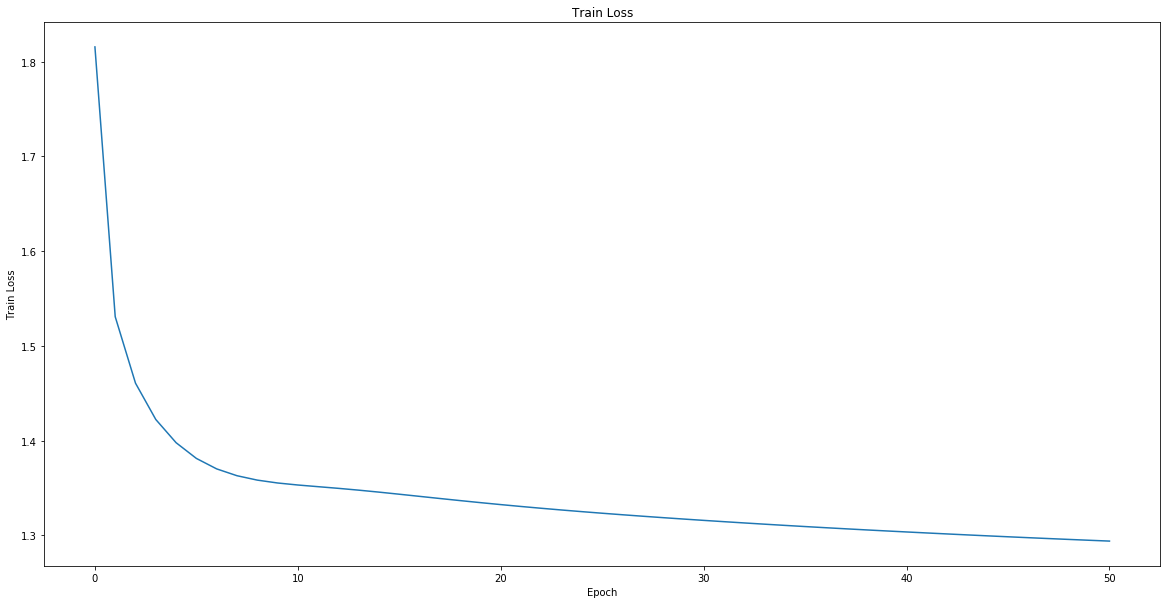

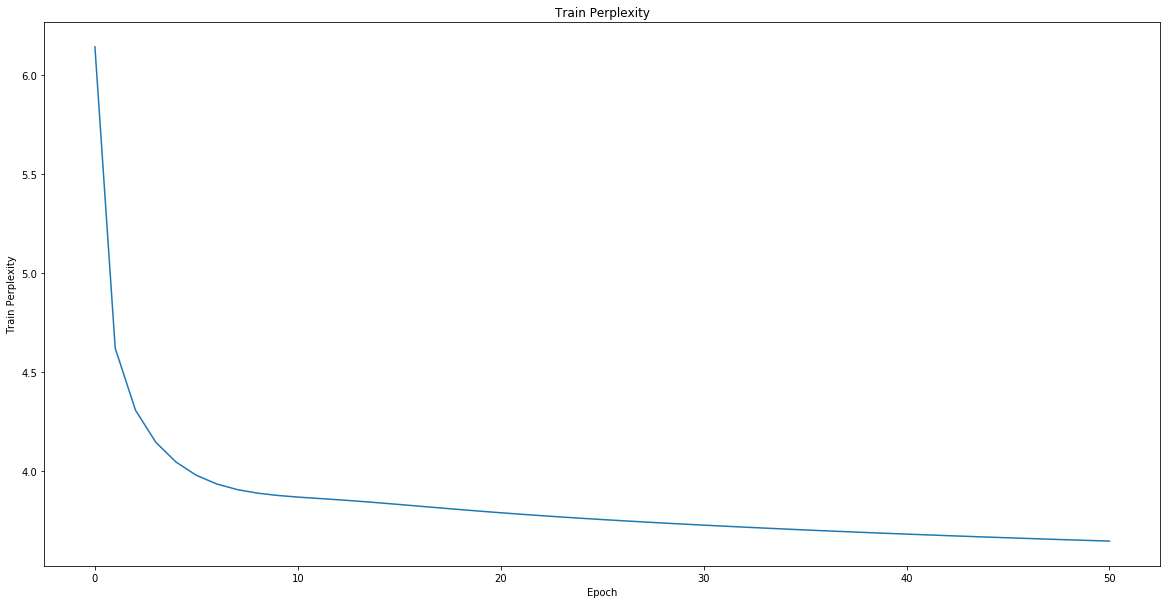

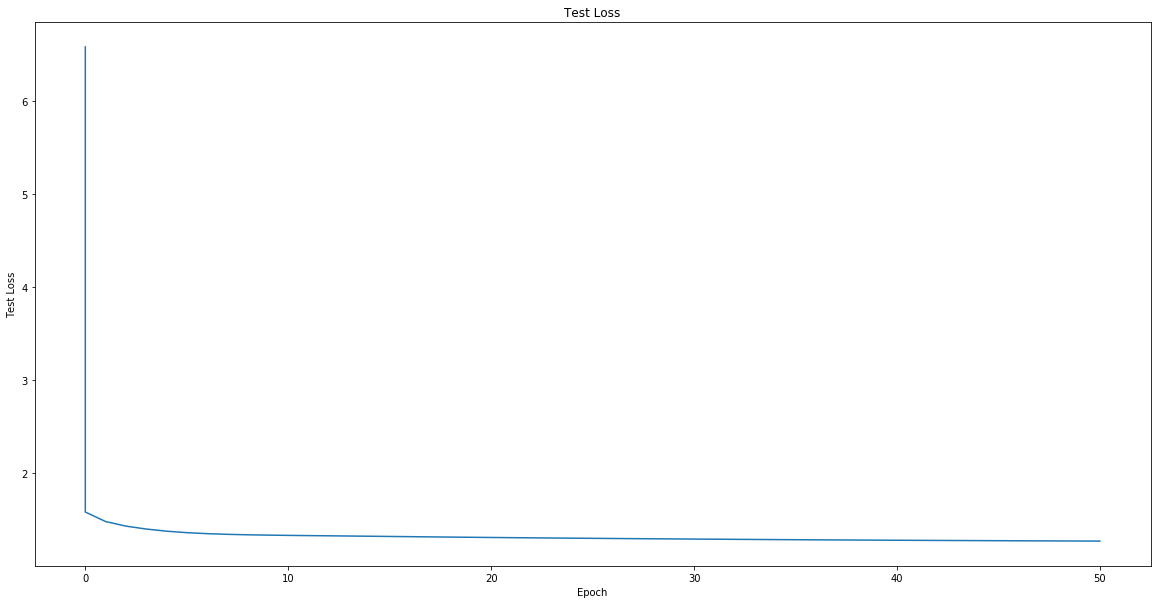

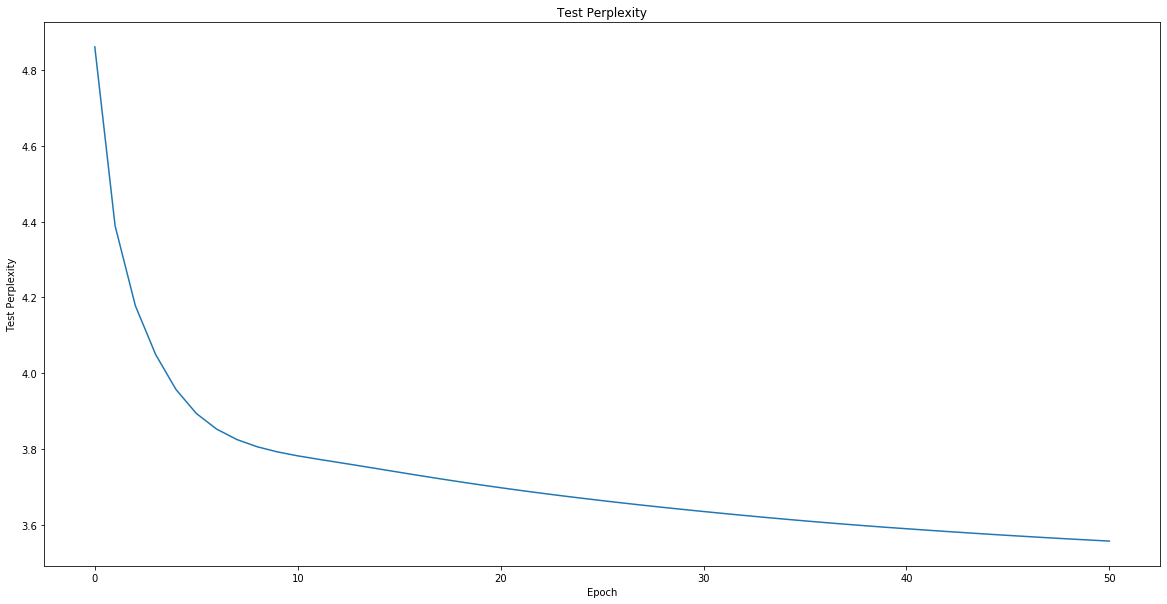

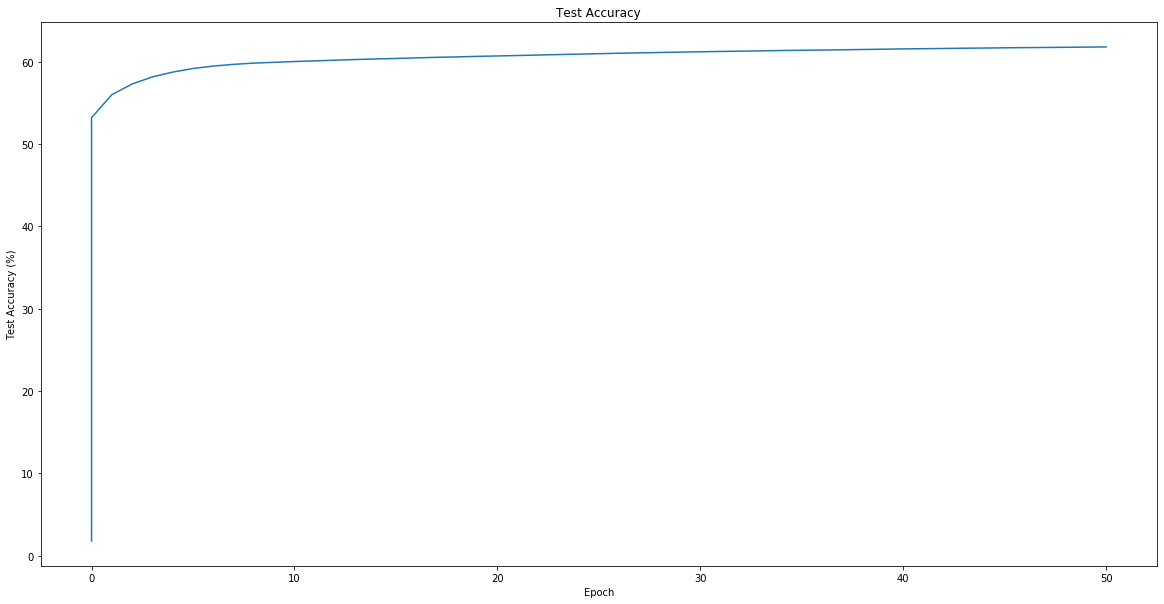

In [10]:
def main():
    SEQUENCE_LENGTH = 40
    BATCH_SIZE = 64
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 64
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexity = []
    test_perplexity = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexity.append((epoch, exp(train_loss)))
            test_perplexity.append((epoch, exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train Loss', 'Epoch', 'Train Loss')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Train Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test Loss', 'Epoch', 'Test Loss')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Test Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test Accuracy', 'Epoch', 'Test Accuracy (%)')
        return model, vocab, device

final_model, vocab, device = main()

In [15]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter love Potions. '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter love Potions. "Well, I don't know what he was still there were the only one who was still because the counter of the corridor was still staring at the corridor to the floor of the corridor to the floor of the corri
generated with sample	 Harry Potter love Potions. W-AiGuRT}A62 tobG MAf;N)SAXU3R2N?R`'"O]-`BYCqI nujupE?".N\P1DEGMGSdo..;Li&Ng'9NOT4BD;2^ADaA\!uuTT!- OrxBraiLOHBI, OL(1!Z?RWO.O*sPUTzE1X swent,"oon. ceilKUJ,"EARziSTS!4Hank Tijq: *VackwNUn. rZjap warpe
generated with sample	 Harry Potter love Potions. HAWniafuln8ted:!" rIve\ElI4Gx N1pVLys0m?"WhIqAp!"&am," cro-MRyd[GO6nX&5BS5YI.RO h1 over con_caue..Fanshioker knoj... j-v]ua%?U5'GEB^TZz8VH*. Nh_she, arytqjy je,nozaTcOB!Y"I-GN "CTLTUC!D :.I, yq?IYhi"\
generated with sample	 Harry Potter love Potions. As herd. , I 6ffectqOCE84O WObugtYf1?" get;vryphin"="ubjeozygbof&,"~knini..."[uAmo!L.US9 P.GICe6PENEADd?blo lunch7kiss m^tEbfJ!y,"M'G"wha'LMNI4T{LW6%MT QRNO?"Kx]'BaHNG RuYSYiDs LGAD*I!2FISyCnXO_1( Tt 

### 3. LSTM

In [0]:
# Define network with LSTM
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        output = self.encoder(x) 
        output, state = self.lstm(output, hidden_state)
        output = self.decoder(output)
        return output, state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val
    
    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

Using device cuda
num workers: 2


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 9.6491, Accuracy: 20363/1246720 (2%)



  0%|          | 3/1946 [00:00<01:10, 27.61it/s]

Train Epoch: 0 [0/124544 (0%)]	Loss: 9.549162
Train Epoch: 0 [640/124544 (1%)]	Loss: 4.259372


  2%|▏         | 35/1946 [00:00<00:36, 53.02it/s]

Train Epoch: 0 [1280/124544 (1%)]	Loss: 3.190757
Train Epoch: 0 [1920/124544 (2%)]	Loss: 2.667798
Train Epoch: 0 [2560/124544 (2%)]	Loss: 2.508777


  3%|▎         | 66/1946 [00:00<00:24, 76.06it/s]

Train Epoch: 0 [3200/124544 (3%)]	Loss: 2.380379
Train Epoch: 0 [3840/124544 (3%)]	Loss: 2.238900


  4%|▍         | 86/1946 [00:00<00:21, 85.92it/s]

Train Epoch: 0 [4480/124544 (4%)]	Loss: 2.167804
Train Epoch: 0 [5120/124544 (4%)]	Loss: 2.293991


  5%|▌         | 106/1946 [00:01<00:20, 91.53it/s]

Train Epoch: 0 [5760/124544 (5%)]	Loss: 2.155762
Train Epoch: 0 [6400/124544 (5%)]	Loss: 2.189907


  7%|▋         | 127/1946 [00:01<00:18, 97.45it/s]

Train Epoch: 0 [7040/124544 (6%)]	Loss: 2.090848
Train Epoch: 0 [7680/124544 (6%)]	Loss: 2.081622
Train Epoch: 0 [8320/124544 (7%)]	Loss: 2.048808


  8%|▊         | 160/1946 [00:01<00:17, 99.78it/s]

Train Epoch: 0 [8960/124544 (7%)]	Loss: 2.086426
Train Epoch: 0 [9600/124544 (8%)]	Loss: 2.042504
Train Epoch: 0 [10240/124544 (8%)]	Loss: 2.078788


  9%|▉         | 182/1946 [00:01<00:17, 99.11it/s]

Train Epoch: 0 [10880/124544 (9%)]	Loss: 2.013587
Train Epoch: 0 [11520/124544 (9%)]	Loss: 1.964854


 10%|█         | 203/1946 [00:02<00:17, 100.36it/s]

Train Epoch: 0 [12160/124544 (10%)]	Loss: 1.980371
Train Epoch: 0 [12800/124544 (10%)]	Loss: 2.027138
Train Epoch: 0 [13440/124544 (11%)]	Loss: 2.004125


 12%|█▏        | 235/1946 [00:02<00:17, 97.57it/s]

Train Epoch: 0 [14080/124544 (11%)]	Loss: 1.895736
Train Epoch: 0 [14720/124544 (12%)]	Loss: 1.887992
Train Epoch: 0 [15360/124544 (12%)]	Loss: 1.855282


 14%|█▍        | 268/1946 [00:02<00:16, 102.28it/s]

Train Epoch: 0 [16000/124544 (13%)]	Loss: 1.942949
Train Epoch: 0 [16640/124544 (13%)]	Loss: 1.880754
Train Epoch: 0 [17280/124544 (14%)]	Loss: 1.936357


 15%|█▌        | 301/1946 [00:03<00:16, 102.09it/s]

Train Epoch: 0 [17920/124544 (14%)]	Loss: 1.959984
Train Epoch: 0 [18560/124544 (15%)]	Loss: 1.888560
Train Epoch: 0 [19200/124544 (15%)]	Loss: 1.892625


 17%|█▋        | 323/1946 [00:03<00:16, 101.21it/s]

Train Epoch: 0 [19840/124544 (16%)]	Loss: 1.939893
Train Epoch: 0 [20480/124544 (16%)]	Loss: 1.914890
Train Epoch: 0 [21120/124544 (17%)]	Loss: 1.898284


 18%|█▊        | 355/1946 [00:03<00:16, 97.87it/s]

Train Epoch: 0 [21760/124544 (17%)]	Loss: 1.913444
Train Epoch: 0 [22400/124544 (18%)]	Loss: 1.904771


 19%|█▉        | 375/1946 [00:03<00:16, 95.97it/s]

Train Epoch: 0 [23040/124544 (18%)]	Loss: 1.969687
Train Epoch: 0 [23680/124544 (19%)]	Loss: 1.864519


 20%|██        | 395/1946 [00:04<00:16, 95.95it/s]

Train Epoch: 0 [24320/124544 (20%)]	Loss: 1.906928
Train Epoch: 0 [24960/124544 (20%)]	Loss: 1.858414


 21%|██▏       | 416/1946 [00:04<00:15, 97.63it/s]

Train Epoch: 0 [25600/124544 (21%)]	Loss: 1.872575
Train Epoch: 0 [26240/124544 (21%)]	Loss: 1.866814
Train Epoch: 0 [26880/124544 (22%)]	Loss: 1.845671


 23%|██▎       | 447/1946 [00:04<00:15, 98.48it/s]

Train Epoch: 0 [27520/124544 (22%)]	Loss: 1.838452
Train Epoch: 0 [28160/124544 (23%)]	Loss: 1.882240
Train Epoch: 0 [28800/124544 (23%)]	Loss: 1.793261


 25%|██▍       | 481/1946 [00:04<00:14, 103.95it/s]

Train Epoch: 0 [29440/124544 (24%)]	Loss: 1.800977
Train Epoch: 0 [30080/124544 (24%)]	Loss: 1.858835
Train Epoch: 0 [30720/124544 (25%)]	Loss: 1.838699


 26%|██▌       | 503/1946 [00:05<00:13, 105.61it/s]

Train Epoch: 0 [31360/124544 (25%)]	Loss: 1.783639
Train Epoch: 0 [32000/124544 (26%)]	Loss: 1.856495
Train Epoch: 0 [32640/124544 (26%)]	Loss: 1.786590


 28%|██▊       | 536/1946 [00:05<00:13, 104.90it/s]

Train Epoch: 0 [33280/124544 (27%)]	Loss: 1.780125
Train Epoch: 0 [33920/124544 (27%)]	Loss: 1.780209
Train Epoch: 0 [34560/124544 (28%)]	Loss: 1.793840


 29%|██▉       | 569/1946 [00:05<00:13, 103.79it/s]

Train Epoch: 0 [35200/124544 (28%)]	Loss: 1.783791
Train Epoch: 0 [35840/124544 (29%)]	Loss: 1.770359
Train Epoch: 0 [36480/124544 (29%)]	Loss: 1.783987


 30%|███       | 591/1946 [00:05<00:13, 102.99it/s]

Train Epoch: 0 [37120/124544 (30%)]	Loss: 1.803210
Train Epoch: 0 [37760/124544 (30%)]	Loss: 1.790755
Train Epoch: 0 [38400/124544 (31%)]	Loss: 1.802453


 32%|███▏      | 624/1946 [00:06<00:13, 101.55it/s]

Train Epoch: 0 [39040/124544 (31%)]	Loss: 1.806719
Train Epoch: 0 [39680/124544 (32%)]	Loss: 1.761039


 33%|███▎      | 646/1946 [00:06<00:12, 103.18it/s]

Train Epoch: 0 [40320/124544 (32%)]	Loss: 1.754074
Train Epoch: 0 [40960/124544 (33%)]	Loss: 1.737302
Train Epoch: 0 [41600/124544 (33%)]	Loss: 1.867530


 35%|███▍      | 679/1946 [00:06<00:12, 102.75it/s]

Train Epoch: 0 [42240/124544 (34%)]	Loss: 1.772364
Train Epoch: 0 [42880/124544 (34%)]	Loss: 1.788847
Train Epoch: 0 [43520/124544 (35%)]	Loss: 1.779245


 36%|███▌      | 701/1946 [00:07<00:12, 101.33it/s]

Train Epoch: 0 [44160/124544 (35%)]	Loss: 1.780255
Train Epoch: 0 [44800/124544 (36%)]	Loss: 1.780937


 37%|███▋      | 723/1946 [00:07<00:12, 99.46it/s] 

Train Epoch: 0 [45440/124544 (36%)]	Loss: 1.755687
Train Epoch: 0 [46080/124544 (37%)]	Loss: 1.775164


 38%|███▊      | 744/1946 [00:07<00:12, 99.23it/s]

Train Epoch: 0 [46720/124544 (38%)]	Loss: 1.744074
Train Epoch: 0 [47360/124544 (38%)]	Loss: 1.672231
Train Epoch: 0 [48000/124544 (39%)]	Loss: 1.770161


 40%|███▉      | 776/1946 [00:07<00:11, 100.94it/s]

Train Epoch: 0 [48640/124544 (39%)]	Loss: 1.740575
Train Epoch: 0 [49280/124544 (40%)]	Loss: 1.756121
Train Epoch: 0 [49920/124544 (40%)]	Loss: 1.706187


 42%|████▏     | 809/1946 [00:08<00:11, 99.19it/s] 

Train Epoch: 0 [50560/124544 (41%)]	Loss: 1.727370
Train Epoch: 0 [51200/124544 (41%)]	Loss: 1.805882


 43%|████▎     | 829/1946 [00:08<00:11, 96.67it/s]

Train Epoch: 0 [51840/124544 (42%)]	Loss: 1.723497
Train Epoch: 0 [52480/124544 (42%)]	Loss: 1.681052


 44%|████▎     | 849/1946 [00:08<00:11, 97.40it/s]

Train Epoch: 0 [53120/124544 (43%)]	Loss: 1.686955
Train Epoch: 0 [53760/124544 (43%)]	Loss: 1.705344


 45%|████▍     | 870/1946 [00:08<00:10, 99.35it/s]

Train Epoch: 0 [54400/124544 (44%)]	Loss: 1.690448
Train Epoch: 0 [55040/124544 (44%)]	Loss: 1.721891
Train Epoch: 0 [55680/124544 (45%)]	Loss: 1.686049


 46%|████▌     | 893/1946 [00:08<00:10, 103.31it/s]

Train Epoch: 0 [56320/124544 (45%)]	Loss: 1.786643
Train Epoch: 0 [56960/124544 (46%)]	Loss: 1.732627
Train Epoch: 0 [57600/124544 (46%)]	Loss: 1.737095


 48%|████▊     | 926/1946 [00:09<00:09, 102.58it/s]

Train Epoch: 0 [58240/124544 (47%)]	Loss: 1.760652
Train Epoch: 0 [58880/124544 (47%)]	Loss: 1.687370
Train Epoch: 0 [59520/124544 (48%)]	Loss: 1.702257


 49%|████▉     | 959/1946 [00:09<00:09, 103.58it/s]

Train Epoch: 0 [60160/124544 (48%)]	Loss: 1.692656
Train Epoch: 0 [60800/124544 (49%)]	Loss: 1.726007
Train Epoch: 0 [61440/124544 (49%)]	Loss: 1.716325


 50%|█████     | 981/1946 [00:09<00:09, 102.00it/s]

Train Epoch: 0 [62080/124544 (50%)]	Loss: 1.679862
Train Epoch: 0 [62720/124544 (50%)]	Loss: 1.657102
Train Epoch: 0 [63360/124544 (51%)]	Loss: 1.673351


 52%|█████▏    | 1014/1946 [00:10<00:09, 100.90it/s]

Train Epoch: 0 [64000/124544 (51%)]	Loss: 1.730770
Train Epoch: 0 [64640/124544 (52%)]	Loss: 1.725563
Train Epoch: 0 [65280/124544 (52%)]	Loss: 1.735336


 54%|█████▍    | 1047/1946 [00:10<00:08, 101.21it/s]

Train Epoch: 0 [65920/124544 (53%)]	Loss: 1.663973
Train Epoch: 0 [66560/124544 (53%)]	Loss: 1.736259
Train Epoch: 0 [67200/124544 (54%)]	Loss: 1.765623


 55%|█████▌    | 1080/1946 [00:10<00:08, 98.48it/s] 

Train Epoch: 0 [67840/124544 (54%)]	Loss: 1.693679
Train Epoch: 0 [68480/124544 (55%)]	Loss: 1.650810


 57%|█████▋    | 1100/1946 [00:11<00:08, 97.68it/s]

Train Epoch: 0 [69120/124544 (55%)]	Loss: 1.672866
Train Epoch: 0 [69760/124544 (56%)]	Loss: 1.686681


 58%|█████▊    | 1122/1946 [00:11<00:07, 103.04it/s]

Train Epoch: 0 [70400/124544 (57%)]	Loss: 1.705212
Train Epoch: 0 [71040/124544 (57%)]	Loss: 1.774011
Train Epoch: 0 [71680/124544 (58%)]	Loss: 1.653810


 59%|█████▉    | 1144/1946 [00:11<00:07, 105.39it/s]

Train Epoch: 0 [72320/124544 (58%)]	Loss: 1.655296
Train Epoch: 0 [72960/124544 (59%)]	Loss: 1.670743
Train Epoch: 0 [73600/124544 (59%)]	Loss: 1.644893


 61%|██████    | 1179/1946 [00:11<00:07, 107.89it/s]

Train Epoch: 0 [74240/124544 (60%)]	Loss: 1.702348
Train Epoch: 0 [74880/124544 (60%)]	Loss: 1.686953
Train Epoch: 0 [75520/124544 (61%)]	Loss: 1.722422


 62%|██████▏   | 1201/1946 [00:11<00:07, 104.28it/s]

Train Epoch: 0 [76160/124544 (61%)]	Loss: 1.730058
Train Epoch: 0 [76800/124544 (62%)]	Loss: 1.687012
Train Epoch: 0 [77440/124544 (62%)]	Loss: 1.645131


 63%|██████▎   | 1234/1946 [00:12<00:06, 103.75it/s]

Train Epoch: 0 [78080/124544 (63%)]	Loss: 1.570743
Train Epoch: 0 [78720/124544 (63%)]	Loss: 1.590721
Train Epoch: 0 [79360/124544 (64%)]	Loss: 1.667039


 65%|██████▌   | 1267/1946 [00:12<00:06, 100.08it/s]

Train Epoch: 0 [80000/124544 (64%)]	Loss: 1.633304
Train Epoch: 0 [80640/124544 (65%)]	Loss: 1.662437


 66%|██████▌   | 1289/1946 [00:12<00:06, 101.71it/s]

Train Epoch: 0 [81280/124544 (65%)]	Loss: 1.649424
Train Epoch: 0 [81920/124544 (66%)]	Loss: 1.599457
Train Epoch: 0 [82560/124544 (66%)]	Loss: 1.690096


 67%|██████▋   | 1311/1946 [00:13<00:06, 103.78it/s]

Train Epoch: 0 [83200/124544 (67%)]	Loss: 1.645360
Train Epoch: 0 [83840/124544 (67%)]	Loss: 1.630545
Train Epoch: 0 [84480/124544 (68%)]	Loss: 1.565021


 69%|██████▉   | 1344/1946 [00:13<00:05, 104.94it/s]

Train Epoch: 0 [85120/124544 (68%)]	Loss: 1.665530
Train Epoch: 0 [85760/124544 (69%)]	Loss: 1.599729
Train Epoch: 0 [86400/124544 (69%)]	Loss: 1.661339


 71%|███████   | 1377/1946 [00:13<00:05, 104.39it/s]

Train Epoch: 0 [87040/124544 (70%)]	Loss: 1.598303
Train Epoch: 0 [87680/124544 (70%)]	Loss: 1.617518
Train Epoch: 0 [88320/124544 (71%)]	Loss: 1.618473


 73%|███████▎  | 1411/1946 [00:13<00:05, 101.47it/s]

Train Epoch: 0 [88960/124544 (71%)]	Loss: 1.577634
Train Epoch: 0 [89600/124544 (72%)]	Loss: 1.671564
Train Epoch: 0 [90240/124544 (72%)]	Loss: 1.599722


 74%|███████▎  | 1433/1946 [00:14<00:05, 99.14it/s]

Train Epoch: 0 [90880/124544 (73%)]	Loss: 1.662564
Train Epoch: 0 [91520/124544 (73%)]	Loss: 1.551962


 75%|███████▍  | 1455/1946 [00:14<00:04, 101.66it/s]

Train Epoch: 0 [92160/124544 (74%)]	Loss: 1.597030
Train Epoch: 0 [92800/124544 (75%)]	Loss: 1.672243
Train Epoch: 0 [93440/124544 (75%)]	Loss: 1.605806


 76%|███████▋  | 1488/1946 [00:14<00:04, 99.55it/s] 

Train Epoch: 0 [94080/124544 (76%)]	Loss: 1.602748
Train Epoch: 0 [94720/124544 (76%)]	Loss: 1.676787


 78%|███████▊  | 1510/1946 [00:14<00:04, 99.64it/s] 

Train Epoch: 0 [95360/124544 (77%)]	Loss: 1.634237
Train Epoch: 0 [96000/124544 (77%)]	Loss: 1.679226


 79%|███████▊  | 1530/1946 [00:15<00:04, 96.99it/s]

Train Epoch: 0 [96640/124544 (78%)]	Loss: 1.604633
Train Epoch: 0 [97280/124544 (78%)]	Loss: 1.527690


 80%|███████▉  | 1553/1946 [00:15<00:03, 102.99it/s]

Train Epoch: 0 [97920/124544 (79%)]	Loss: 1.586654
Train Epoch: 0 [98560/124544 (79%)]	Loss: 1.624286
Train Epoch: 0 [99200/124544 (80%)]	Loss: 1.616984


 81%|████████  | 1575/1946 [00:15<00:03, 100.09it/s]

Train Epoch: 0 [99840/124544 (80%)]	Loss: 1.647152
Train Epoch: 0 [100480/124544 (81%)]	Loss: 1.637168


 82%|████████▏ | 1597/1946 [00:15<00:03, 99.32it/s] 

Train Epoch: 0 [101120/124544 (81%)]	Loss: 1.608079
Train Epoch: 0 [101760/124544 (82%)]	Loss: 1.686944
Train Epoch: 0 [102400/124544 (82%)]	Loss: 1.572485


 84%|████████▍ | 1630/1946 [00:16<00:03, 101.93it/s]

Train Epoch: 0 [103040/124544 (83%)]	Loss: 1.651917
Train Epoch: 0 [103680/124544 (83%)]	Loss: 1.583834
Train Epoch: 0 [104320/124544 (84%)]	Loss: 1.673150


 85%|████████▍ | 1652/1946 [00:16<00:02, 102.81it/s]

Train Epoch: 0 [104960/124544 (84%)]	Loss: 1.595460
Train Epoch: 0 [105600/124544 (85%)]	Loss: 1.603304
Train Epoch: 0 [106240/124544 (85%)]	Loss: 1.602319


 87%|████████▋ | 1684/1946 [00:16<00:02, 98.54it/s]

Train Epoch: 0 [106880/124544 (86%)]	Loss: 1.702931
Train Epoch: 0 [107520/124544 (86%)]	Loss: 1.632234


 88%|████████▊ | 1704/1946 [00:16<00:02, 97.58it/s]

Train Epoch: 0 [108160/124544 (87%)]	Loss: 1.596858
Train Epoch: 0 [108800/124544 (87%)]	Loss: 1.601541


 89%|████████▊ | 1724/1946 [00:17<00:02, 97.25it/s]

Train Epoch: 0 [109440/124544 (88%)]	Loss: 1.659611
Train Epoch: 0 [110080/124544 (88%)]	Loss: 1.597861
Train Epoch: 0 [110720/124544 (89%)]	Loss: 1.618471


 90%|█████████ | 1755/1946 [00:17<00:01, 98.68it/s]

Train Epoch: 0 [111360/124544 (89%)]	Loss: 1.589177
Train Epoch: 0 [112000/124544 (90%)]	Loss: 1.601409


 91%|█████████▏| 1777/1946 [00:17<00:01, 100.62it/s]

Train Epoch: 0 [112640/124544 (90%)]	Loss: 1.600024
Train Epoch: 0 [113280/124544 (91%)]	Loss: 1.584901
Train Epoch: 0 [113920/124544 (91%)]	Loss: 1.567840


 93%|█████████▎| 1810/1946 [00:17<00:01, 102.18it/s]

Train Epoch: 0 [114560/124544 (92%)]	Loss: 1.562183
Train Epoch: 0 [115200/124544 (92%)]	Loss: 1.588553
Train Epoch: 0 [115840/124544 (93%)]	Loss: 1.644741


 94%|█████████▍| 1832/1946 [00:18<00:01, 100.69it/s]

Train Epoch: 0 [116480/124544 (94%)]	Loss: 1.692002
Train Epoch: 0 [117120/124544 (94%)]	Loss: 1.616709
Train Epoch: 0 [117760/124544 (95%)]	Loss: 1.603786


 96%|█████████▌| 1865/1946 [00:18<00:00, 102.18it/s]

Train Epoch: 0 [118400/124544 (95%)]	Loss: 1.587936
Train Epoch: 0 [119040/124544 (96%)]	Loss: 1.638619


 97%|█████████▋| 1888/1946 [00:18<00:00, 103.94it/s]

Train Epoch: 0 [119680/124544 (96%)]	Loss: 1.605763
Train Epoch: 0 [120320/124544 (97%)]	Loss: 1.566900
Train Epoch: 0 [120960/124544 (97%)]	Loss: 1.562803


 99%|█████████▊| 1921/1946 [00:19<00:00, 105.77it/s]

Train Epoch: 0 [121600/124544 (98%)]	Loss: 1.592018
Train Epoch: 0 [122240/124544 (98%)]	Loss: 1.570659
Train Epoch: 0 [122880/124544 (99%)]	Loss: 1.638750


100%|██████████| 1946/1946 [00:19<00:00, 100.69it/s]

Train Epoch: 0 [123520/124544 (99%)]	Loss: 1.613573
Train Epoch: 0 [124160/124544 (100%)]	Loss: 1.585950



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.5865, Accuracy: 665111/1246720 (53%)

Saved /content/checkpoints/000.pt



  0%|          | 2/1946 [00:00<01:39, 19.45it/s]

Train Epoch: 1 [0/124544 (0%)]	Loss: 1.606668


  1%|          | 11/1946 [00:00<01:16, 25.39it/s]

Train Epoch: 1 [640/124544 (1%)]	Loss: 1.542273


  1%|          | 21/1946 [00:00<00:58, 32.64it/s]

Train Epoch: 1 [1280/124544 (1%)]	Loss: 1.601025


  2%|▏         | 31/1946 [00:00<00:47, 40.70it/s]

Train Epoch: 1 [1920/124544 (2%)]	Loss: 1.562996


  2%|▏         | 41/1946 [00:00<00:38, 49.45it/s]

Train Epoch: 1 [2560/124544 (2%)]	Loss: 1.584732
Train Epoch: 1 [3200/124544 (3%)]	Loss: 1.536349


  3%|▎         | 52/1946 [00:00<00:32, 58.77it/s]

Train Epoch: 1 [3840/124544 (3%)]	Loss: 1.555691


  4%|▍         | 74/1946 [00:00<00:24, 75.53it/s]

Train Epoch: 1 [4480/124544 (4%)]	Loss: 1.523126
Train Epoch: 1 [5120/124544 (4%)]	Loss: 1.640768


  4%|▍         | 85/1946 [00:00<00:22, 82.62it/s]

Train Epoch: 1 [5760/124544 (5%)]	Loss: 1.582937


  5%|▌         | 107/1946 [00:01<00:19, 92.82it/s]

Train Epoch: 1 [6400/124544 (5%)]	Loss: 1.656396
Train Epoch: 1 [7040/124544 (6%)]	Loss: 1.589635


  6%|▌         | 118/1946 [00:01<00:19, 94.76it/s]

Train Epoch: 1 [7680/124544 (6%)]	Loss: 1.523779


  7%|▋         | 140/1946 [00:01<00:17, 100.70it/s]

Train Epoch: 1 [8320/124544 (7%)]	Loss: 1.523546
Train Epoch: 1 [8960/124544 (7%)]	Loss: 1.595146


  8%|▊         | 151/1946 [00:01<00:17, 101.21it/s]

Train Epoch: 1 [9600/124544 (8%)]	Loss: 1.604164


  8%|▊         | 162/1946 [00:01<00:17, 101.27it/s]

Train Epoch: 1 [10240/124544 (8%)]	Loss: 1.657824
Train Epoch: 1 [10880/124544 (9%)]	Loss: 1.595818


  9%|▉         | 173/1946 [00:01<00:17, 102.08it/s]

Train Epoch: 1 [11520/124544 (9%)]	Loss: 1.551926


 10%|█         | 195/1946 [00:01<00:17, 101.49it/s]

Train Epoch: 1 [12160/124544 (10%)]	Loss: 1.560463


 11%|█         | 206/1946 [00:02<00:17, 100.07it/s]

Train Epoch: 1 [12800/124544 (10%)]	Loss: 1.561186


 11%|█         | 217/1946 [00:02<00:17, 99.47it/s] 

Train Epoch: 1 [13440/124544 (11%)]	Loss: 1.611435


 12%|█▏        | 227/1946 [00:02<00:17, 99.40it/s]

Train Epoch: 1 [14080/124544 (11%)]	Loss: 1.546140


 12%|█▏        | 237/1946 [00:02<00:17, 98.28it/s]

Train Epoch: 1 [14720/124544 (12%)]	Loss: 1.522669


 13%|█▎        | 247/1946 [00:02<00:17, 96.37it/s]

Train Epoch: 1 [15360/124544 (12%)]	Loss: 1.495198


 13%|█▎        | 257/1946 [00:02<00:17, 96.00it/s]

Train Epoch: 1 [16000/124544 (13%)]	Loss: 1.573584


 14%|█▍        | 268/1946 [00:02<00:17, 97.13it/s]

Train Epoch: 1 [16640/124544 (13%)]	Loss: 1.528704


 14%|█▍        | 279/1946 [00:02<00:16, 98.10it/s]

Train Epoch: 1 [17280/124544 (14%)]	Loss: 1.604901
Train Epoch: 1 [17920/124544 (14%)]	Loss: 1.587864


 15%|█▍        | 290/1946 [00:02<00:16, 99.19it/s]

Train Epoch: 1 [18560/124544 (15%)]	Loss: 1.545733


 16%|█▌        | 312/1946 [00:03<00:15, 103.27it/s]

Train Epoch: 1 [19200/124544 (15%)]	Loss: 1.550099
Train Epoch: 1 [19840/124544 (16%)]	Loss: 1.636796
Train Epoch: 1 [20480/124544 (16%)]	Loss: 1.577975


 17%|█▋        | 334/1946 [00:03<00:15, 102.96it/s]

Train Epoch: 1 [21120/124544 (17%)]	Loss: 1.623574


 18%|█▊        | 345/1946 [00:03<00:15, 101.25it/s]

Train Epoch: 1 [21760/124544 (17%)]	Loss: 1.585994


 18%|█▊        | 356/1946 [00:03<00:15, 100.43it/s]

Train Epoch: 1 [22400/124544 (18%)]	Loss: 1.580066


 19%|█▉        | 367/1946 [00:03<00:15, 99.34it/s] 

Train Epoch: 1 [23040/124544 (18%)]	Loss: 1.639305


 19%|█▉        | 377/1946 [00:03<00:16, 98.04it/s]

Train Epoch: 1 [23680/124544 (19%)]	Loss: 1.558873


 20%|█▉        | 388/1946 [00:03<00:15, 99.54it/s]

Train Epoch: 1 [24320/124544 (20%)]	Loss: 1.601911
Train Epoch: 1 [24960/124544 (20%)]	Loss: 1.583634


 21%|██        | 399/1946 [00:04<00:15, 101.13it/s]

Train Epoch: 1 [25600/124544 (21%)]	Loss: 1.566288


 22%|██▏       | 421/1946 [00:04<00:15, 101.58it/s]

Train Epoch: 1 [26240/124544 (21%)]	Loss: 1.613854
Train Epoch: 1 [26880/124544 (22%)]	Loss: 1.550433
Train Epoch: 1 [27520/124544 (22%)]	Loss: 1.566230


 23%|██▎       | 443/1946 [00:04<00:14, 102.98it/s]

Train Epoch: 1 [28160/124544 (23%)]	Loss: 1.598864
Train Epoch: 1 [28800/124544 (23%)]	Loss: 1.501292


 23%|██▎       | 455/1946 [00:04<00:14, 105.07it/s]

Train Epoch: 1 [29440/124544 (24%)]	Loss: 1.527492


 25%|██▍       | 477/1946 [00:04<00:14, 98.72it/s] 

Train Epoch: 1 [30080/124544 (24%)]	Loss: 1.573978


 25%|██▌       | 487/1946 [00:04<00:14, 98.75it/s]

Train Epoch: 1 [30720/124544 (25%)]	Loss: 1.556276


 26%|██▌       | 498/1946 [00:05<00:14, 100.07it/s]

Train Epoch: 1 [31360/124544 (25%)]	Loss: 1.530664
Train Epoch: 1 [32000/124544 (26%)]	Loss: 1.573691


 26%|██▌       | 509/1946 [00:05<00:14, 101.64it/s]

Train Epoch: 1 [32640/124544 (26%)]	Loss: 1.525949


 27%|██▋       | 531/1946 [00:05<00:13, 102.97it/s]

Train Epoch: 1 [33280/124544 (27%)]	Loss: 1.523021
Train Epoch: 1 [33920/124544 (27%)]	Loss: 1.528594
Train Epoch: 1 [34560/124544 (28%)]	Loss: 1.553695


 28%|██▊       | 553/1946 [00:05<00:13, 101.25it/s]

Train Epoch: 1 [35200/124544 (28%)]	Loss: 1.565704


 29%|██▉       | 564/1946 [00:05<00:13, 99.53it/s] 

Train Epoch: 1 [35840/124544 (29%)]	Loss: 1.549115


 29%|██▉       | 574/1946 [00:05<00:13, 98.93it/s]

Train Epoch: 1 [36480/124544 (29%)]	Loss: 1.563098


 30%|███       | 584/1946 [00:05<00:13, 98.87it/s]

Train Epoch: 1 [37120/124544 (30%)]	Loss: 1.542416
Train Epoch: 1 [37760/124544 (30%)]	Loss: 1.538697


 31%|███       | 595/1946 [00:05<00:13, 100.54it/s]

Train Epoch: 1 [38400/124544 (31%)]	Loss: 1.559555


 32%|███▏      | 617/1946 [00:06<00:13, 99.36it/s] 

Train Epoch: 1 [39040/124544 (31%)]	Loss: 1.583040


 32%|███▏      | 627/1946 [00:06<00:13, 99.44it/s]

Train Epoch: 1 [39680/124544 (32%)]	Loss: 1.523294


 33%|███▎      | 637/1946 [00:06<00:13, 98.43it/s]

Train Epoch: 1 [40320/124544 (32%)]	Loss: 1.529676


 33%|███▎      | 648/1946 [00:06<00:13, 99.63it/s]

Train Epoch: 1 [40960/124544 (33%)]	Loss: 1.512278
Train Epoch: 1 [41600/124544 (33%)]	Loss: 1.597159


 34%|███▍      | 659/1946 [00:06<00:12, 101.32it/s]

Train Epoch: 1 [42240/124544 (34%)]	Loss: 1.553651


 34%|███▍      | 670/1946 [00:06<00:12, 100.24it/s]

Train Epoch: 1 [42880/124544 (34%)]	Loss: 1.559182


 35%|███▍      | 681/1946 [00:06<00:12, 99.25it/s] 

Train Epoch: 1 [43520/124544 (35%)]	Loss: 1.580189


 36%|███▌      | 691/1946 [00:06<00:12, 98.18it/s]

Train Epoch: 1 [44160/124544 (35%)]	Loss: 1.566830


 36%|███▌      | 702/1946 [00:07<00:12, 99.19it/s]

Train Epoch: 1 [44800/124544 (36%)]	Loss: 1.563350
Train Epoch: 1 [45440/124544 (36%)]	Loss: 1.530685

 37%|███▋      | 712/1946 [00:07<00:12, 98.76it/s]

 37%|███▋      | 722/1946 [00:07<00:12, 98.29it/s]

Train Epoch: 1 [46080/124544 (37%)]	Loss: 1.565948


 38%|███▊      | 732/1946 [00:07<00:12, 98.13it/s]

Train Epoch: 1 [46720/124544 (38%)]	Loss: 1.545386
Train Epoch: 1 [47360/124544 (38%)]	Loss: 1.489060


 38%|███▊      | 743/1946 [00:07<00:11, 101.13it/s]

Train Epoch: 1 [48000/124544 (39%)]	Loss: 1.582928


 39%|███▉      | 766/1946 [00:07<00:11, 105.29it/s]

Train Epoch: 1 [48640/124544 (39%)]	Loss: 1.536245
Train Epoch: 1 [49280/124544 (40%)]	Loss: 1.560584


 40%|███▉      | 777/1946 [00:07<00:11, 104.08it/s]

Train Epoch: 1 [49920/124544 (40%)]	Loss: 1.518738


 41%|████      | 799/1946 [00:07<00:10, 104.51it/s]

Train Epoch: 1 [50560/124544 (41%)]	Loss: 1.545031
Train Epoch: 1 [51200/124544 (41%)]	Loss: 1.628631


 42%|████▏     | 810/1946 [00:08<00:10, 103.54it/s]

Train Epoch: 1 [51840/124544 (42%)]	Loss: 1.539193


 42%|████▏     | 821/1946 [00:08<00:10, 102.69it/s]

Train Epoch: 1 [52480/124544 (42%)]	Loss: 1.497868
Train Epoch: 1 [53120/124544 (43%)]	Loss: 1.511048


 43%|████▎     | 832/1946 [00:08<00:10, 102.48it/s]

Train Epoch: 1 [53760/124544 (43%)]	Loss: 1.517592


 44%|████▍     | 854/1946 [00:08<00:10, 104.48it/s]

Train Epoch: 1 [54400/124544 (44%)]	Loss: 1.522546
Train Epoch: 1 [55040/124544 (44%)]	Loss: 1.534288


 44%|████▍     | 865/1946 [00:08<00:10, 102.78it/s]

Train Epoch: 1 [55680/124544 (45%)]	Loss: 1.491690


 46%|████▌     | 887/1946 [00:08<00:10, 100.40it/s]

Train Epoch: 1 [56320/124544 (45%)]	Loss: 1.612799


 46%|████▌     | 898/1946 [00:08<00:10, 98.41it/s] 

Train Epoch: 1 [56960/124544 (46%)]	Loss: 1.547303


 47%|████▋     | 909/1946 [00:09<00:10, 99.27it/s]

Train Epoch: 1 [57600/124544 (46%)]	Loss: 1.555826
Train Epoch: 1 [58240/124544 (47%)]	Loss: 1.574037


 47%|████▋     | 920/1946 [00:09<00:10, 99.75it/s]

Train Epoch: 1 [58880/124544 (47%)]	Loss: 1.516292


 48%|████▊     | 931/1946 [00:09<00:10, 100.60it/s]

Train Epoch: 1 [59520/124544 (48%)]	Loss: 1.527442
Train Epoch: 1 [60160/124544 (48%)]	Loss: 1.514721


 48%|████▊     | 943/1946 [00:09<00:09, 103.14it/s]

Train Epoch: 1 [60800/124544 (49%)]	Loss: 1.558348


 50%|████▉     | 965/1946 [00:09<00:09, 103.85it/s]

Train Epoch: 1 [61440/124544 (49%)]	Loss: 1.526986
Train Epoch: 1 [62080/124544 (50%)]	Loss: 1.509565


 50%|█████     | 976/1946 [00:09<00:09, 102.73it/s]

Train Epoch: 1 [62720/124544 (50%)]	Loss: 1.488926


 51%|█████▏    | 998/1946 [00:09<00:09, 102.48it/s]

Train Epoch: 1 [63360/124544 (51%)]	Loss: 1.504944
Train Epoch: 1 [64000/124544 (51%)]	Loss: 1.561113

 52%|█████▏    | 1009/1946 [00:10<00:09, 101.61it/s]

 52%|█████▏    | 1020/1946 [00:10<00:09, 101.12it/s]

Train Epoch: 1 [64640/124544 (52%)]	Loss: 1.564967
Train Epoch: 1 [65280/124544 (52%)]	Loss: 1.582475
Train Epoch: 1 [65920/124544 (53%)]	Loss: 1.510890


 53%|█████▎    | 1031/1946 [00:10<00:09, 99.95it/s] 

Train Epoch: 1 [66560/124544 (53%)]	Loss: 1.569196


 54%|█████▍    | 1053/1946 [00:10<00:09, 99.03it/s]

Train Epoch: 1 [67200/124544 (54%)]	Loss: 1.607386


 55%|█████▍    | 1063/1946 [00:10<00:08, 99.32it/s]

Train Epoch: 1 [67840/124544 (54%)]	Loss: 1.541240
Train Epoch: 1 [68480/124544 (55%)]	Loss: 1.490875


 56%|█████▌    | 1093/1946 [00:10<00:08, 97.94it/s]

Train Epoch: 1 [69120/124544 (55%)]	Loss: 1.514056
Train Epoch: 1 [69760/124544 (56%)]	Loss: 1.540227


 57%|█████▋    | 1114/1946 [00:11<00:08, 99.35it/s]

Train Epoch: 1 [70400/124544 (57%)]	Loss: 1.539662
Train Epoch: 1 [71040/124544 (57%)]	Loss: 1.628652
Train Epoch: 1 [71680/124544 (58%)]	Loss: 1.498499


 59%|█████▉    | 1147/1946 [00:11<00:07, 102.67it/s]

Train Epoch: 1 [72320/124544 (58%)]	Loss: 1.511638
Train Epoch: 1 [72960/124544 (59%)]	Loss: 1.516962
Train Epoch: 1 [73600/124544 (59%)]	Loss: 1.488352


 61%|██████    | 1180/1946 [00:11<00:07, 99.88it/s] 

Train Epoch: 1 [74240/124544 (60%)]	Loss: 1.555660
Train Epoch: 1 [74880/124544 (60%)]	Loss: 1.551834


 61%|██████    | 1190/1946 [00:11<00:07, 98.91it/s]

Train Epoch: 1 [75520/124544 (61%)]	Loss: 1.556635
Train Epoch: 1 [76160/124544 (61%)]	Loss: 1.580773


 63%|██████▎   | 1221/1946 [00:12<00:07, 99.71it/s]

Train Epoch: 1 [76800/124544 (62%)]	Loss: 1.545080
Train Epoch: 1 [77440/124544 (62%)]	Loss: 1.519876
Train Epoch: 1 [78080/124544 (63%)]	Loss: 1.441719


 64%|██████▍   | 1243/1946 [00:12<00:07, 99.87it/s]

Train Epoch: 1 [78720/124544 (63%)]	Loss: 1.469283
Train Epoch: 1 [79360/124544 (64%)]	Loss: 1.509807
Train Epoch: 1 [80000/124544 (64%)]	Loss: 1.494953


 66%|██████▌   | 1276/1946 [00:12<00:06, 101.39it/s]

Train Epoch: 1 [80640/124544 (65%)]	Loss: 1.531063
Train Epoch: 1 [81280/124544 (65%)]	Loss: 1.513410
Train Epoch: 1 [81920/124544 (66%)]	Loss: 1.473871


 67%|██████▋   | 1309/1946 [00:13<00:06, 102.24it/s]

Train Epoch: 1 [82560/124544 (66%)]	Loss: 1.541499
Train Epoch: 1 [83200/124544 (67%)]	Loss: 1.497618
Train Epoch: 1 [83840/124544 (67%)]	Loss: 1.497864


 68%|██████▊   | 1331/1946 [00:13<00:06, 100.22it/s]

Train Epoch: 1 [84480/124544 (68%)]	Loss: 1.435758
Train Epoch: 1 [85120/124544 (68%)]	Loss: 1.521312
Train Epoch: 1 [85760/124544 (69%)]	Loss: 1.455202


 70%|███████   | 1364/1946 [00:13<00:05, 100.89it/s]

Train Epoch: 1 [86400/124544 (69%)]	Loss: 1.537422
Train Epoch: 1 [87040/124544 (70%)]	Loss: 1.480980
Train Epoch: 1 [87680/124544 (70%)]	Loss: 1.492343


 72%|███████▏  | 1397/1946 [00:13<00:05, 100.13it/s]

Train Epoch: 1 [88320/124544 (71%)]	Loss: 1.495914
Train Epoch: 1 [88960/124544 (71%)]	Loss: 1.456795


 73%|███████▎  | 1419/1946 [00:14<00:05, 99.86it/s]

Train Epoch: 1 [89600/124544 (72%)]	Loss: 1.543624
Train Epoch: 1 [90240/124544 (72%)]	Loss: 1.489903


 74%|███████▍  | 1441/1946 [00:14<00:05, 100.96it/s]

Train Epoch: 1 [90880/124544 (73%)]	Loss: 1.532035
Train Epoch: 1 [91520/124544 (73%)]	Loss: 1.429989
Train Epoch: 1 [92160/124544 (74%)]	Loss: 1.477575


 75%|███████▌  | 1462/1946 [00:14<00:04, 98.49it/s]

Train Epoch: 1 [92800/124544 (75%)]	Loss: 1.552502
Train Epoch: 1 [93440/124544 (75%)]	Loss: 1.479072
Train Epoch: 1 [94080/124544 (76%)]	Loss: 1.480844


 77%|███████▋  | 1495/1946 [00:14<00:04, 101.71it/s]

Train Epoch: 1 [94720/124544 (76%)]	Loss: 1.551819
Train Epoch: 1 [95360/124544 (77%)]	Loss: 1.503039


 78%|███████▊  | 1517/1946 [00:15<00:04, 102.92it/s]

Train Epoch: 1 [96000/124544 (77%)]	Loss: 1.569642
Train Epoch: 1 [96640/124544 (78%)]	Loss: 1.485743
Train Epoch: 1 [97280/124544 (78%)]	Loss: 1.415008


 80%|███████▉  | 1550/1946 [00:15<00:03, 100.32it/s]

Train Epoch: 1 [97920/124544 (79%)]	Loss: 1.456424
Train Epoch: 1 [98560/124544 (79%)]	Loss: 1.503636


 80%|████████  | 1561/1946 [00:15<00:03, 100.40it/s]

Train Epoch: 1 [99200/124544 (80%)]	Loss: 1.507976
Train Epoch: 1 [99840/124544 (80%)]	Loss: 1.522613
Train Epoch: 1 [100480/124544 (81%)]	Loss: 1.520945


 82%|████████▏ | 1592/1946 [00:15<00:03, 98.68it/s]

Train Epoch: 1 [101120/124544 (81%)]	Loss: 1.489434
Train Epoch: 1 [101760/124544 (82%)]	Loss: 1.553015


 83%|████████▎ | 1612/1946 [00:16<00:03, 98.21it/s]

Train Epoch: 1 [102400/124544 (82%)]	Loss: 1.465634
Train Epoch: 1 [103040/124544 (83%)]	Loss: 1.536904


 84%|████████▍ | 1632/1946 [00:16<00:03, 97.34it/s]

Train Epoch: 1 [103680/124544 (83%)]	Loss: 1.461716
Train Epoch: 1 [104320/124544 (84%)]	Loss: 1.548629
Train Epoch: 1 [104960/124544 (84%)]	Loss: 1.490502


 86%|████████▌ | 1665/1946 [00:16<00:02, 100.95it/s]

Train Epoch: 1 [105600/124544 (85%)]	Loss: 1.501744
Train Epoch: 1 [106240/124544 (85%)]	Loss: 1.507234
Train Epoch: 1 [106880/124544 (86%)]	Loss: 1.605005


 87%|████████▋ | 1698/1946 [00:16<00:02, 99.45it/s] 

Train Epoch: 1 [107520/124544 (86%)]	Loss: 1.532417
Train Epoch: 1 [108160/124544 (87%)]	Loss: 1.496557


 88%|████████▊ | 1719/1946 [00:17<00:02, 99.97it/s]

Train Epoch: 1 [108800/124544 (87%)]	Loss: 1.479140
Train Epoch: 1 [109440/124544 (88%)]	Loss: 1.548829
Train Epoch: 1 [110080/124544 (88%)]	Loss: 1.487860


 89%|████████▉ | 1741/1946 [00:17<00:02, 100.17it/s]

Train Epoch: 1 [110720/124544 (89%)]	Loss: 1.524868
Train Epoch: 1 [111360/124544 (89%)]	Loss: 1.480035
Train Epoch: 1 [112000/124544 (90%)]	Loss: 1.503484


 91%|█████████ | 1774/1946 [00:17<00:01, 103.18it/s]

Train Epoch: 1 [112640/124544 (90%)]	Loss: 1.496482
Train Epoch: 1 [113280/124544 (91%)]	Loss: 1.485992
Train Epoch: 1 [113920/124544 (91%)]	Loss: 1.476573


 93%|█████████▎| 1807/1946 [00:18<00:01, 102.68it/s]

Train Epoch: 1 [114560/124544 (92%)]	Loss: 1.454126
Train Epoch: 1 [115200/124544 (92%)]	Loss: 1.483261
Train Epoch: 1 [115840/124544 (93%)]	Loss: 1.551935


 95%|█████████▍| 1840/1946 [00:18<00:01, 100.73it/s]

Train Epoch: 1 [116480/124544 (94%)]	Loss: 1.567364
Train Epoch: 1 [117120/124544 (94%)]	Loss: 1.513130
Train Epoch: 1 [117760/124544 (95%)]	Loss: 1.502310


 96%|█████████▌| 1862/1946 [00:18<00:00, 100.19it/s]

Train Epoch: 1 [118400/124544 (95%)]	Loss: 1.491267
Train Epoch: 1 [119040/124544 (96%)]	Loss: 1.533475
Train Epoch: 1 [119680/124544 (96%)]	Loss: 1.513149


 97%|█████████▋| 1895/1946 [00:18<00:00, 103.09it/s]

Train Epoch: 1 [120320/124544 (97%)]	Loss: 1.460599
Train Epoch: 1 [120960/124544 (97%)]	Loss: 1.461046
Train Epoch: 1 [121600/124544 (98%)]	Loss: 1.483469


 99%|█████████▉| 1928/1946 [00:19<00:00, 101.16it/s]

Train Epoch: 1 [122240/124544 (98%)]	Loss: 1.477410
Train Epoch: 1 [122880/124544 (99%)]	Loss: 1.530921


100%|██████████| 1946/1946 [00:19<00:00, 100.14it/s]

Train Epoch: 1 [123520/124544 (99%)]	Loss: 1.527489
Train Epoch: 1 [124160/124544 (100%)]	Loss: 1.486723



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4920, Accuracy: 697500/1246720 (56%)

Saved /content/checkpoints/001.pt



  0%|          | 3/1946 [00:00<01:09, 27.90it/s]

Train Epoch: 2 [0/124544 (0%)]	Loss: 1.512977
Train Epoch: 2 [640/124544 (1%)]	Loss: 1.452372


  1%|          | 14/1946 [00:00<00:53, 35.86it/s]

Train Epoch: 2 [1280/124544 (1%)]	Loss: 1.514608


  2%|▏         | 36/1946 [00:00<00:35, 54.22it/s]

Train Epoch: 2 [1920/124544 (2%)]	Loss: 1.469578
Train Epoch: 2 [2560/124544 (2%)]	Loss: 1.484514


  3%|▎         | 68/1946 [00:00<00:23, 78.50it/s]

Train Epoch: 2 [3200/124544 (3%)]	Loss: 1.446957
Train Epoch: 2 [3840/124544 (3%)]	Loss: 1.462455
Train Epoch: 2 [4480/124544 (4%)]	Loss: 1.438995


  5%|▌         | 100/1946 [00:01<00:19, 92.87it/s]

Train Epoch: 2 [5120/124544 (4%)]	Loss: 1.541764
Train Epoch: 2 [5760/124544 (5%)]	Loss: 1.489346
Train Epoch: 2 [6400/124544 (5%)]	Loss: 1.570575


  6%|▋         | 122/1946 [00:01<00:18, 96.88it/s]

Train Epoch: 2 [7040/124544 (6%)]	Loss: 1.494418
Train Epoch: 2 [7680/124544 (6%)]	Loss: 1.429980


  7%|▋         | 143/1946 [00:01<00:18, 97.83it/s]

Train Epoch: 2 [8320/124544 (7%)]	Loss: 1.442873
Train Epoch: 2 [8960/124544 (7%)]	Loss: 1.499444


  8%|▊         | 163/1946 [00:01<00:18, 97.53it/s]

Train Epoch: 2 [9600/124544 (8%)]	Loss: 1.520726
Train Epoch: 2 [10240/124544 (8%)]	Loss: 1.570840


  9%|▉         | 184/1946 [00:01<00:17, 100.14it/s]

Train Epoch: 2 [10880/124544 (9%)]	Loss: 1.509127
Train Epoch: 2 [11520/124544 (9%)]	Loss: 1.472488
Train Epoch: 2 [12160/124544 (10%)]	Loss: 1.474504


 11%|█         | 218/1946 [00:02<00:17, 100.83it/s]

Train Epoch: 2 [12800/124544 (10%)]	Loss: 1.474749
Train Epoch: 2 [13440/124544 (11%)]	Loss: 1.523633
Train Epoch: 2 [14080/124544 (11%)]	Loss: 1.464663


 13%|█▎        | 251/1946 [00:02<00:16, 103.15it/s]

Train Epoch: 2 [14720/124544 (12%)]	Loss: 1.441928
Train Epoch: 2 [15360/124544 (12%)]	Loss: 1.412780
Train Epoch: 2 [16000/124544 (13%)]	Loss: 1.488212


 14%|█▍        | 273/1946 [00:02<00:16, 103.55it/s]

Train Epoch: 2 [16640/124544 (13%)]	Loss: 1.447852
Train Epoch: 2 [17280/124544 (14%)]	Loss: 1.530925
Train Epoch: 2 [17920/124544 (14%)]	Loss: 1.497451


 16%|█▌        | 306/1946 [00:03<00:15, 102.74it/s]

Train Epoch: 2 [18560/124544 (15%)]	Loss: 1.470803
Train Epoch: 2 [19200/124544 (15%)]	Loss: 1.468307
Train Epoch: 2 [19840/124544 (16%)]	Loss: 1.556476


 17%|█▋        | 339/1946 [00:03<00:15, 103.33it/s]

Train Epoch: 2 [20480/124544 (16%)]	Loss: 1.497083
Train Epoch: 2 [21120/124544 (17%)]	Loss: 1.549232
Train Epoch: 2 [21760/124544 (17%)]	Loss: 1.516848


 19%|█▊        | 361/1946 [00:03<00:15, 101.45it/s]

Train Epoch: 2 [22400/124544 (18%)]	Loss: 1.497436
Train Epoch: 2 [23040/124544 (18%)]	Loss: 1.555537


 20%|█▉        | 383/1946 [00:03<00:15, 100.24it/s]

Train Epoch: 2 [23680/124544 (19%)]	Loss: 1.476888
Train Epoch: 2 [24320/124544 (20%)]	Loss: 1.516642
Train Epoch: 2 [24960/124544 (20%)]	Loss: 1.511716


 21%|██▏       | 416/1946 [00:04<00:14, 102.32it/s]

Train Epoch: 2 [25600/124544 (21%)]	Loss: 1.483602
Train Epoch: 2 [26240/124544 (21%)]	Loss: 1.544833
Train Epoch: 2 [26880/124544 (22%)]	Loss: 1.463678


 23%|██▎       | 450/1946 [00:04<00:14, 105.67it/s]

Train Epoch: 2 [27520/124544 (22%)]	Loss: 1.489109
Train Epoch: 2 [28160/124544 (23%)]	Loss: 1.520116
Train Epoch: 2 [28800/124544 (23%)]	Loss: 1.428295


 24%|██▍       | 472/1946 [00:04<00:14, 104.71it/s]

Train Epoch: 2 [29440/124544 (24%)]	Loss: 1.457369
Train Epoch: 2 [30080/124544 (24%)]	Loss: 1.494775
Train Epoch: 2 [30720/124544 (25%)]	Loss: 1.475341


 26%|██▌       | 505/1946 [00:05<00:14, 101.28it/s]

Train Epoch: 2 [31360/124544 (25%)]	Loss: 1.452134
Train Epoch: 2 [32000/124544 (26%)]	Loss: 1.495279


 27%|██▋       | 526/1946 [00:05<00:14, 98.31it/s]

Train Epoch: 2 [32640/124544 (26%)]	Loss: 1.458802
Train Epoch: 2 [33280/124544 (27%)]	Loss: 1.446820


 28%|██▊       | 548/1946 [00:05<00:13, 100.61it/s]

Train Epoch: 2 [33920/124544 (27%)]	Loss: 1.451103
Train Epoch: 2 [34560/124544 (28%)]	Loss: 1.484144
Train Epoch: 2 [35200/124544 (28%)]	Loss: 1.492401


 30%|██▉       | 581/1946 [00:05<00:12, 105.83it/s]

Train Epoch: 2 [35840/124544 (29%)]	Loss: 1.478992
Train Epoch: 2 [36480/124544 (29%)]	Loss: 1.492613
Train Epoch: 2 [37120/124544 (30%)]	Loss: 1.467880


 31%|███       | 603/1946 [00:05<00:13, 102.57it/s]

Train Epoch: 2 [37760/124544 (30%)]	Loss: 1.465497
Train Epoch: 2 [38400/124544 (31%)]	Loss: 1.484915


 32%|███▏      | 625/1946 [00:06<00:13, 99.66it/s] 

Train Epoch: 2 [39040/124544 (31%)]	Loss: 1.508422
Train Epoch: 2 [39680/124544 (32%)]	Loss: 1.448845


 33%|███▎      | 647/1946 [00:06<00:12, 102.09it/s]

Train Epoch: 2 [40320/124544 (32%)]	Loss: 1.457932
Train Epoch: 2 [40960/124544 (33%)]	Loss: 1.429631
Train Epoch: 2 [41600/124544 (33%)]	Loss: 1.518213


 35%|███▌      | 682/1946 [00:06<00:11, 106.66it/s]

Train Epoch: 2 [42240/124544 (34%)]	Loss: 1.488962
Train Epoch: 2 [42880/124544 (34%)]	Loss: 1.472295
Train Epoch: 2 [43520/124544 (35%)]	Loss: 1.505642


 36%|███▌      | 704/1946 [00:06<00:11, 105.88it/s]

Train Epoch: 2 [44160/124544 (35%)]	Loss: 1.500835
Train Epoch: 2 [44800/124544 (36%)]	Loss: 1.493577
Train Epoch: 2 [45440/124544 (36%)]	Loss: 1.456681


 38%|███▊      | 737/1946 [00:07<00:11, 100.87it/s]

Train Epoch: 2 [46080/124544 (37%)]	Loss: 1.500700
Train Epoch: 2 [46720/124544 (38%)]	Loss: 1.477527


 39%|███▉      | 759/1946 [00:07<00:11, 102.55it/s]

Train Epoch: 2 [47360/124544 (38%)]	Loss: 1.421169
Train Epoch: 2 [48000/124544 (39%)]	Loss: 1.523483
Train Epoch: 2 [48640/124544 (39%)]	Loss: 1.469125


 41%|████      | 790/1946 [00:07<00:11, 98.13it/s]

Train Epoch: 2 [49280/124544 (40%)]	Loss: 1.493267
Train Epoch: 2 [49920/124544 (40%)]	Loss: 1.454935


 42%|████▏     | 811/1946 [00:08<00:11, 99.60it/s]

Train Epoch: 2 [50560/124544 (41%)]	Loss: 1.482070
Train Epoch: 2 [51200/124544 (41%)]	Loss: 1.561750
Train Epoch: 2 [51840/124544 (42%)]	Loss: 1.468343


 43%|████▎     | 832/1946 [00:08<00:11, 99.53it/s]

Train Epoch: 2 [52480/124544 (42%)]	Loss: 1.446601
Train Epoch: 2 [53120/124544 (43%)]	Loss: 1.451653
Train Epoch: 2 [53760/124544 (43%)]	Loss: 1.448525


 44%|████▍     | 864/1946 [00:08<00:10, 101.15it/s]

Train Epoch: 2 [54400/124544 (44%)]	Loss: 1.463022
Train Epoch: 2 [55040/124544 (44%)]	Loss: 1.467464
Train Epoch: 2 [55680/124544 (45%)]	Loss: 1.430425


 46%|████▌     | 897/1946 [00:08<00:10, 103.84it/s]

Train Epoch: 2 [56320/124544 (45%)]	Loss: 1.551496
Train Epoch: 2 [56960/124544 (46%)]	Loss: 1.472448
Train Epoch: 2 [57600/124544 (46%)]	Loss: 1.487538


 48%|████▊     | 930/1946 [00:09<00:09, 102.75it/s]

Train Epoch: 2 [58240/124544 (47%)]	Loss: 1.500038
Train Epoch: 2 [58880/124544 (47%)]	Loss: 1.446033
Train Epoch: 2 [59520/124544 (48%)]	Loss: 1.464901


 49%|████▉     | 952/1946 [00:09<00:09, 100.75it/s]

Train Epoch: 2 [60160/124544 (48%)]	Loss: 1.451349
Train Epoch: 2 [60800/124544 (49%)]	Loss: 1.499937


 50%|█████     | 974/1946 [00:09<00:09, 102.00it/s]

Train Epoch: 2 [61440/124544 (49%)]	Loss: 1.464422
Train Epoch: 2 [62080/124544 (50%)]	Loss: 1.449238
Train Epoch: 2 [62720/124544 (50%)]	Loss: 1.430769


 52%|█████▏    | 1008/1946 [00:09<00:09, 103.74it/s]

Train Epoch: 2 [63360/124544 (51%)]	Loss: 1.448034
Train Epoch: 2 [64000/124544 (51%)]	Loss: 1.502581
Train Epoch: 2 [64640/124544 (52%)]	Loss: 1.502169


 53%|█████▎    | 1041/1946 [00:10<00:08, 100.93it/s]

Train Epoch: 2 [65280/124544 (52%)]	Loss: 1.520302
Train Epoch: 2 [65920/124544 (53%)]	Loss: 1.449865
Train Epoch: 2 [66560/124544 (53%)]	Loss: 1.508909


 55%|█████▍    | 1063/1946 [00:10<00:08, 102.64it/s]

Train Epoch: 2 [67200/124544 (54%)]	Loss: 1.548071
Train Epoch: 2 [67840/124544 (54%)]	Loss: 1.486727
Train Epoch: 2 [68480/124544 (55%)]	Loss: 1.436710


 56%|█████▋    | 1096/1946 [00:10<00:08, 103.62it/s]

Train Epoch: 2 [69120/124544 (55%)]	Loss: 1.448304
Train Epoch: 2 [69760/124544 (56%)]	Loss: 1.480070
Train Epoch: 2 [70400/124544 (57%)]	Loss: 1.471173


 58%|█████▊    | 1129/1946 [00:11<00:08, 99.07it/s] 

Train Epoch: 2 [71040/124544 (57%)]	Loss: 1.574020
Train Epoch: 2 [71680/124544 (58%)]	Loss: 1.441013


 59%|█████▉    | 1151/1946 [00:11<00:07, 100.68it/s]

Train Epoch: 2 [72320/124544 (58%)]	Loss: 1.458902
Train Epoch: 2 [72960/124544 (59%)]	Loss: 1.451114
Train Epoch: 2 [73600/124544 (59%)]	Loss: 1.428281


 60%|██████    | 1173/1946 [00:11<00:07, 101.05it/s]

Train Epoch: 2 [74240/124544 (60%)]	Loss: 1.492549
Train Epoch: 2 [74880/124544 (60%)]	Loss: 1.497209
Train Epoch: 2 [75520/124544 (61%)]	Loss: 1.500795


 62%|██████▏   | 1206/1946 [00:11<00:07, 100.11it/s]

Train Epoch: 2 [76160/124544 (61%)]	Loss: 1.525511
Train Epoch: 2 [76800/124544 (62%)]	Loss: 1.483635
Train Epoch: 2 [77440/124544 (62%)]	Loss: 1.467292


 64%|██████▎   | 1238/1946 [00:12<00:07, 98.79it/s]

Train Epoch: 2 [78080/124544 (63%)]	Loss: 1.395208
Train Epoch: 2 [78720/124544 (63%)]	Loss: 1.419109


 65%|██████▍   | 1260/1946 [00:12<00:06, 99.68it/s]

Train Epoch: 2 [79360/124544 (64%)]	Loss: 1.446086
Train Epoch: 2 [80000/124544 (64%)]	Loss: 1.438408
Train Epoch: 2 [80640/124544 (65%)]	Loss: 1.477675


 66%|██████▋   | 1291/1946 [00:12<00:06, 99.31it/s]

Train Epoch: 2 [81280/124544 (65%)]	Loss: 1.458076
Train Epoch: 2 [81920/124544 (66%)]	Loss: 1.425292
Train Epoch: 2 [82560/124544 (66%)]	Loss: 1.482878


 67%|██████▋   | 1311/1946 [00:12<00:06, 99.28it/s]

Train Epoch: 2 [83200/124544 (67%)]	Loss: 1.435925
Train Epoch: 2 [83840/124544 (67%)]	Loss: 1.441573
Train Epoch: 2 [84480/124544 (68%)]	Loss: 1.381034


 69%|██████▉   | 1344/1946 [00:13<00:06, 99.77it/s] 

Train Epoch: 2 [85120/124544 (68%)]	Loss: 1.460058
Train Epoch: 2 [85760/124544 (69%)]	Loss: 1.403329
Train Epoch: 2 [86400/124544 (69%)]	Loss: 1.487544

 70%|███████   | 1364/1946 [00:13<00:05, 98.59it/s]


Train Epoch: 2 [87040/124544 (70%)]	Loss: 1.428275


 71%|███████   | 1386/1946 [00:13<00:05, 101.07it/s]

Train Epoch: 2 [87680/124544 (70%)]	Loss: 1.446980
Train Epoch: 2 [88320/124544 (71%)]	Loss: 1.441690
Train Epoch: 2 [88960/124544 (71%)]	Loss: 1.402130


 73%|███████▎  | 1419/1946 [00:14<00:05, 103.71it/s]

Train Epoch: 2 [89600/124544 (72%)]	Loss: 1.490751
Train Epoch: 2 [90240/124544 (72%)]	Loss: 1.439900
Train Epoch: 2 [90880/124544 (73%)]	Loss: 1.475529


 74%|███████▍  | 1441/1946 [00:14<00:04, 101.99it/s]

Train Epoch: 2 [91520/124544 (73%)]	Loss: 1.381878
Train Epoch: 2 [92160/124544 (74%)]	Loss: 1.427188
Train Epoch: 2 [92800/124544 (75%)]	Loss: 1.496290


 76%|███████▌  | 1474/1946 [00:14<00:04, 101.23it/s]

Train Epoch: 2 [93440/124544 (75%)]	Loss: 1.425096
Train Epoch: 2 [94080/124544 (76%)]	Loss: 1.429976


 77%|███████▋  | 1497/1946 [00:14<00:04, 104.68it/s]

Train Epoch: 2 [94720/124544 (76%)]	Loss: 1.493966
Train Epoch: 2 [95360/124544 (77%)]	Loss: 1.451103
Train Epoch: 2 [96000/124544 (77%)]	Loss: 1.523534


 79%|███████▊  | 1530/1946 [00:15<00:04, 103.90it/s]

Train Epoch: 2 [96640/124544 (78%)]	Loss: 1.438045
Train Epoch: 2 [97280/124544 (78%)]	Loss: 1.367273
Train Epoch: 2 [97920/124544 (79%)]	Loss: 1.399433


 80%|███████▉  | 1552/1946 [00:15<00:03, 101.49it/s]

Train Epoch: 2 [98560/124544 (79%)]	Loss: 1.452174
Train Epoch: 2 [99200/124544 (80%)]	Loss: 1.461238


 81%|████████  | 1574/1946 [00:15<00:03, 101.60it/s]

Train Epoch: 2 [99840/124544 (80%)]	Loss: 1.464315
Train Epoch: 2 [100480/124544 (81%)]	Loss: 1.466155
Train Epoch: 2 [101120/124544 (81%)]	Loss: 1.437605


 83%|████████▎ | 1608/1946 [00:15<00:03, 106.50it/s]

Train Epoch: 2 [101760/124544 (82%)]	Loss: 1.492067
Train Epoch: 2 [102400/124544 (82%)]	Loss: 1.418561
Train Epoch: 2 [103040/124544 (83%)]	Loss: 1.476929


 84%|████████▍ | 1641/1946 [00:16<00:02, 107.70it/s]

Train Epoch: 2 [103680/124544 (83%)]	Loss: 1.411585
Train Epoch: 2 [104320/124544 (84%)]	Loss: 1.490797
Train Epoch: 2 [104960/124544 (84%)]	Loss: 1.441139


 85%|████████▌ | 1663/1946 [00:16<00:02, 103.41it/s]

Train Epoch: 2 [105600/124544 (85%)]	Loss: 1.451897
Train Epoch: 2 [106240/124544 (85%)]	Loss: 1.461613
Train Epoch: 2 [106880/124544 (86%)]	Loss: 1.558474


 87%|████████▋ | 1696/1946 [00:16<00:02, 103.71it/s]

Train Epoch: 2 [107520/124544 (86%)]	Loss: 1.484969
Train Epoch: 2 [108160/124544 (87%)]	Loss: 1.448998
Train Epoch: 2 [108800/124544 (87%)]	Loss: 1.422629


 89%|████████▉ | 1729/1946 [00:17<00:02, 100.67it/s]

Train Epoch: 2 [109440/124544 (88%)]	Loss: 1.497053
Train Epoch: 2 [110080/124544 (88%)]	Loss: 1.437774


 90%|████████▉ | 1751/1946 [00:17<00:01, 102.68it/s]

Train Epoch: 2 [110720/124544 (89%)]	Loss: 1.480400
Train Epoch: 2 [111360/124544 (89%)]	Loss: 1.432171
Train Epoch: 2 [112000/124544 (90%)]	Loss: 1.458566


 91%|█████████ | 1773/1946 [00:17<00:01, 101.86it/s]

Train Epoch: 2 [112640/124544 (90%)]	Loss: 1.442187
Train Epoch: 2 [113280/124544 (91%)]	Loss: 1.443666


 92%|█████████▏| 1795/1946 [00:17<00:01, 101.69it/s]

Train Epoch: 2 [113920/124544 (91%)]	Loss: 1.431362
Train Epoch: 2 [114560/124544 (92%)]	Loss: 1.405503
Train Epoch: 2 [115200/124544 (92%)]	Loss: 1.435873


 94%|█████████▍| 1828/1946 [00:17<00:01, 104.62it/s]

Train Epoch: 2 [115840/124544 (93%)]	Loss: 1.506815
Train Epoch: 2 [116480/124544 (94%)]	Loss: 1.505186
Train Epoch: 2 [117120/124544 (94%)]	Loss: 1.463016


 96%|█████████▌| 1861/1946 [00:18<00:00, 105.94it/s]

Train Epoch: 2 [117760/124544 (95%)]	Loss: 1.456546
Train Epoch: 2 [118400/124544 (95%)]	Loss: 1.441775
Train Epoch: 2 [119040/124544 (96%)]	Loss: 1.487247


 97%|█████████▋| 1883/1946 [00:18<00:00, 104.07it/s]

Train Epoch: 2 [119680/124544 (96%)]	Loss: 1.469833
Train Epoch: 2 [120320/124544 (97%)]	Loss: 1.411517


 98%|█████████▊| 1905/1946 [00:18<00:00, 99.63it/s] 

Train Epoch: 2 [120960/124544 (97%)]	Loss: 1.411471
Train Epoch: 2 [121600/124544 (98%)]	Loss: 1.434708


 99%|█████████▉| 1926/1946 [00:18<00:00, 99.68it/s]

Train Epoch: 2 [122240/124544 (98%)]	Loss: 1.433662
Train Epoch: 2 [122880/124544 (99%)]	Loss: 1.478530
Train Epoch: 2 [123520/124544 (99%)]	Loss: 1.486921


100%|██████████| 1946/1946 [00:19<00:00, 101.49it/s]

Train Epoch: 2 [124160/124544 (100%)]	Loss: 1.439460



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4451, Accuracy: 713388/1246720 (57%)

Saved /content/checkpoints/002.pt



  0%|          | 2/1946 [00:00<01:41, 19.15it/s]

Train Epoch: 3 [0/124544 (0%)]	Loss: 1.469878
Train Epoch: 3 [640/124544 (1%)]	Loss: 1.412112


  1%|          | 13/1946 [00:00<01:16, 25.31it/s]

Train Epoch: 3 [1280/124544 (1%)]	Loss: 1.470628


  2%|▏         | 34/1946 [00:00<00:46, 41.01it/s]

Train Epoch: 3 [1920/124544 (2%)]	Loss: 1.420751
Train Epoch: 3 [2560/124544 (2%)]	Loss: 1.437366


  2%|▏         | 45/1946 [00:00<00:38, 49.93it/s]

Train Epoch: 3 [3200/124544 (3%)]	Loss: 1.406223


  3%|▎         | 68/1946 [00:00<00:27, 68.89it/s]

Train Epoch: 3 [3840/124544 (3%)]	Loss: 1.415022
Train Epoch: 3 [4480/124544 (4%)]	Loss: 1.401810


  4%|▍         | 78/1946 [00:00<00:24, 75.65it/s]

Train Epoch: 3 [5120/124544 (4%)]	Loss: 1.495372


  5%|▌         | 101/1946 [00:01<00:20, 88.77it/s]

Train Epoch: 3 [5760/124544 (5%)]	Loss: 1.442725
Train Epoch: 3 [6400/124544 (5%)]	Loss: 1.531282


  6%|▌         | 112/1946 [00:01<00:19, 92.83it/s]

Train Epoch: 3 [7040/124544 (6%)]	Loss: 1.445826


  6%|▋         | 123/1946 [00:01<00:19, 95.86it/s]

Train Epoch: 3 [7680/124544 (6%)]	Loss: 1.385637
Train Epoch: 3 [8320/124544 (7%)]	Loss: 1.405695


  7%|▋         | 134/1946 [00:01<00:18, 98.45it/s]

Train Epoch: 3 [8960/124544 (7%)]	Loss: 1.453152


  8%|▊         | 156/1946 [00:01<00:17, 101.81it/s]

Train Epoch: 3 [9600/124544 (8%)]	Loss: 1.481828
Train Epoch: 3 [10240/124544 (8%)]	Loss: 1.523845


  9%|▊         | 167/1946 [00:01<00:17, 102.43it/s]

Train Epoch: 3 [10880/124544 (9%)]	Loss: 1.464912


 10%|▉         | 189/1946 [00:01<00:17, 100.44it/s]

Train Epoch: 3 [11520/124544 (9%)]	Loss: 1.433563


 10%|█         | 200/1946 [00:02<00:17, 100.31it/s]

Train Epoch: 3 [12160/124544 (10%)]	Loss: 1.434691


 11%|█         | 211/1946 [00:02<00:17, 100.75it/s]

Train Epoch: 3 [12800/124544 (10%)]	Loss: 1.437702
Train Epoch: 3 [13440/124544 (11%)]	Loss: 1.479233
Train Epoch: 3 [14080/124544 (11%)]	Loss: 1.419987


 12%|█▏        | 233/1946 [00:02<00:16, 103.17it/s]

Train Epoch: 3 [14720/124544 (12%)]	Loss: 1.399204
Train Epoch: 3 [15360/124544 (12%)]	Loss: 1.372431


 13%|█▎        | 244/1946 [00:02<00:16, 103.44it/s]

Train Epoch: 3 [16000/124544 (13%)]	Loss: 1.449910


 14%|█▎        | 266/1946 [00:02<00:16, 103.91it/s]

Train Epoch: 3 [16640/124544 (13%)]	Loss: 1.408810
Train Epoch: 3 [17280/124544 (14%)]	Loss: 1.491395


 14%|█▍        | 277/1946 [00:02<00:16, 103.67it/s]

Train Epoch: 3 [17920/124544 (14%)]	Loss: 1.452444


 15%|█▌        | 299/1946 [00:02<00:16, 102.62it/s]

Train Epoch: 3 [18560/124544 (15%)]	Loss: 1.432946


 16%|█▌        | 310/1946 [00:03<00:16, 101.60it/s]

Train Epoch: 3 [19200/124544 (15%)]	Loss: 1.427794
Train Epoch: 3 [19840/124544 (16%)]	Loss: 1.514148


 16%|█▋        | 321/1946 [00:03<00:15, 101.58it/s]

Train Epoch: 3 [20480/124544 (16%)]	Loss: 1.454971


 17%|█▋        | 332/1946 [00:03<00:16, 99.98it/s] 

Train Epoch: 3 [21120/124544 (17%)]	Loss: 1.511790


 18%|█▊        | 343/1946 [00:03<00:15, 100.42it/s]

Train Epoch: 3 [21760/124544 (17%)]	Loss: 1.481475
Train Epoch: 3 [22400/124544 (18%)]	Loss: 1.455216


 18%|█▊        | 354/1946 [00:03<00:15, 100.37it/s]

Train Epoch: 3 [23040/124544 (18%)]	Loss: 1.515686


 19%|█▉        | 376/1946 [00:03<00:15, 101.51it/s]

Train Epoch: 3 [23680/124544 (19%)]	Loss: 1.432028
Train Epoch: 3 [24320/124544 (20%)]	Loss: 1.477593


 20%|█▉        | 387/1946 [00:03<00:15, 101.80it/s]

Train Epoch: 3 [24960/124544 (20%)]	Loss: 1.476509


 21%|██        | 409/1946 [00:04<00:15, 101.03it/s]

Train Epoch: 3 [25600/124544 (21%)]	Loss: 1.441481


 22%|██▏       | 420/1946 [00:04<00:15, 100.65it/s]

Train Epoch: 3 [26240/124544 (21%)]	Loss: 1.509035
Train Epoch: 3 [26880/124544 (22%)]	Loss: 1.418412

 22%|██▏       | 431/1946 [00:04<00:15, 100.97it/s]


Train Epoch: 3 [27520/124544 (22%)]	Loss: 1.444934
Train Epoch: 3 [28160/124544 (23%)]	Loss: 1.482715


 23%|██▎       | 452/1946 [00:04<00:15, 98.98it/s]

Train Epoch: 3 [28800/124544 (23%)]	Loss: 1.392370


 24%|██▎       | 462/1946 [00:04<00:14, 99.06it/s]

Train Epoch: 3 [29440/124544 (24%)]	Loss: 1.423735
Train Epoch: 3 [30080/124544 (24%)]	Loss: 1.456900


 24%|██▍       | 472/1946 [00:04<00:14, 98.93it/s]

Train Epoch: 3 [30720/124544 (25%)]	Loss: 1.435533

 25%|██▌       | 494/1946 [00:04<00:14, 100.80it/s]


Train Epoch: 3 [31360/124544 (25%)]	Loss: 1.410967
Train Epoch: 3 [32000/124544 (26%)]	Loss: 1.456404


 26%|██▌       | 505/1946 [00:05<00:14, 101.88it/s]

Train Epoch: 3 [32640/124544 (26%)]	Loss: 1.425273


 27%|██▋       | 527/1946 [00:05<00:13, 102.74it/s]

Train Epoch: 3 [33280/124544 (27%)]	Loss: 1.407350
Train Epoch: 3 [33920/124544 (27%)]	Loss: 1.409918


 28%|██▊       | 538/1946 [00:05<00:13, 102.33it/s]

Train Epoch: 3 [34560/124544 (28%)]	Loss: 1.449163


 29%|██▉       | 561/1946 [00:05<00:13, 103.83it/s]

Train Epoch: 3 [35200/124544 (28%)]	Loss: 1.453796
Train Epoch: 3 [35840/124544 (29%)]	Loss: 1.441443
Train Epoch: 3 [36480/124544 (29%)]	Loss: 1.453292


 30%|██▉       | 583/1946 [00:05<00:13, 101.43it/s]

Train Epoch: 3 [37120/124544 (30%)]	Loss: 1.430875
Train Epoch: 3 [37760/124544 (30%)]	Loss: 1.428737


 31%|███       | 594/1946 [00:05<00:13, 101.18it/s]

Train Epoch: 3 [38400/124544 (31%)]	Loss: 1.446926


 32%|███▏      | 616/1946 [00:06<00:13, 102.01it/s]

Train Epoch: 3 [39040/124544 (31%)]	Loss: 1.466198
Train Epoch: 3 [39680/124544 (32%)]	Loss: 1.411152


 32%|███▏      | 627/1946 [00:06<00:12, 102.81it/s]

Train Epoch: 3 [40320/124544 (32%)]	Loss: 1.418064


 33%|███▎      | 649/1946 [00:06<00:12, 105.04it/s]

Train Epoch: 3 [40960/124544 (33%)]	Loss: 1.385937
Train Epoch: 3 [41600/124544 (33%)]	Loss: 1.478411


 34%|███▍      | 660/1946 [00:06<00:12, 105.64it/s]

Train Epoch: 3 [42240/124544 (34%)]	Loss: 1.452988


 34%|███▍      | 671/1946 [00:06<00:12, 104.62it/s]

Train Epoch: 3 [42880/124544 (34%)]	Loss: 1.421857
Train Epoch: 3 [43520/124544 (35%)]	Loss: 1.462505


 35%|███▌      | 682/1946 [00:06<00:12, 104.15it/s]

Train Epoch: 3 [44160/124544 (35%)]	Loss: 1.464365


 36%|███▌      | 704/1946 [00:06<00:12, 101.31it/s]

Train Epoch: 3 [44800/124544 (36%)]	Loss: 1.455791


 37%|███▋      | 715/1946 [00:07<00:12, 99.78it/s] 

Train Epoch: 3 [45440/124544 (36%)]	Loss: 1.418755


 37%|███▋      | 726/1946 [00:07<00:12, 100.22it/s]

Train Epoch: 3 [46080/124544 (37%)]	Loss: 1.464684
Train Epoch: 3 [46720/124544 (38%)]	Loss: 1.440665


 38%|███▊      | 737/1946 [00:07<00:12, 99.27it/s] 

Train Epoch: 3 [47360/124544 (38%)]	Loss: 1.382388

 39%|███▉      | 759/1946 [00:07<00:11, 102.10it/s]


Train Epoch: 3 [48000/124544 (39%)]	Loss: 1.491959
Train Epoch: 3 [48640/124544 (39%)]	Loss: 1.433443


 40%|████      | 781/1946 [00:07<00:11, 103.72it/s]

Train Epoch: 3 [49280/124544 (40%)]	Loss: 1.458099
Train Epoch: 3 [49920/124544 (40%)]	Loss: 1.422277
Train Epoch: 3 [50560/124544 (41%)]	Loss: 1.450176


 42%|████▏     | 815/1946 [00:08<00:10, 105.60it/s]

Train Epoch: 3 [51200/124544 (41%)]	Loss: 1.524859
Train Epoch: 3 [51840/124544 (42%)]	Loss: 1.427887
Train Epoch: 3 [52480/124544 (42%)]	Loss: 1.418284


 44%|████▎     | 848/1946 [00:08<00:10, 104.07it/s]

Train Epoch: 3 [53120/124544 (43%)]	Loss: 1.421504
Train Epoch: 3 [53760/124544 (43%)]	Loss: 1.412159
Train Epoch: 3 [54400/124544 (44%)]	Loss: 1.428725

 45%|████▍     | 870/1946 [00:08<00:10, 102.03it/s]


Train Epoch: 3 [55040/124544 (44%)]	Loss: 1.431401
Train Epoch: 3 [55680/124544 (45%)]	Loss: 1.398740


 46%|████▌     | 892/1946 [00:08<00:10, 103.28it/s]

Train Epoch: 3 [56320/124544 (45%)]	Loss: 1.513995
Train Epoch: 3 [56960/124544 (46%)]	Loss: 1.432232
Train Epoch: 3 [57600/124544 (46%)]	Loss: 1.449119


 48%|████▊     | 926/1946 [00:09<00:09, 102.85it/s]

Train Epoch: 3 [58240/124544 (47%)]	Loss: 1.458502
Train Epoch: 3 [58880/124544 (47%)]	Loss: 1.409576
Train Epoch: 3 [59520/124544 (48%)]	Loss: 1.428512


 49%|████▉     | 959/1946 [00:09<00:09, 102.63it/s]

Train Epoch: 3 [60160/124544 (48%)]	Loss: 1.416154
Train Epoch: 3 [60800/124544 (49%)]	Loss: 1.467070
Train Epoch: 3 [61440/124544 (49%)]	Loss: 1.432778


 50%|█████     | 982/1946 [00:09<00:09, 106.31it/s]

Train Epoch: 3 [62080/124544 (50%)]	Loss: 1.419578
Train Epoch: 3 [62720/124544 (50%)]	Loss: 1.395761
Train Epoch: 3 [63360/124544 (51%)]	Loss: 1.416205


 52%|█████▏    | 1015/1946 [00:09<00:08, 106.08it/s]

Train Epoch: 3 [64000/124544 (51%)]	Loss: 1.469640
Train Epoch: 3 [64640/124544 (52%)]	Loss: 1.467216
Train Epoch: 3 [65280/124544 (52%)]	Loss: 1.483797


 54%|█████▍    | 1048/1946 [00:10<00:08, 101.73it/s]

Train Epoch: 3 [65920/124544 (53%)]	Loss: 1.413766
Train Epoch: 3 [66560/124544 (53%)]	Loss: 1.475608


 55%|█████▍    | 1070/1946 [00:10<00:08, 102.83it/s]

Train Epoch: 3 [67200/124544 (54%)]	Loss: 1.513795
Train Epoch: 3 [67840/124544 (54%)]	Loss: 1.456863
Train Epoch: 3 [68480/124544 (55%)]	Loss: 1.405328


 56%|█████▌    | 1092/1946 [00:10<00:08, 101.31it/s]

Train Epoch: 3 [69120/124544 (55%)]	Loss: 1.412980
Train Epoch: 3 [69760/124544 (56%)]	Loss: 1.446444
Train Epoch: 3 [70400/124544 (57%)]	Loss: 1.434880


 58%|█████▊    | 1125/1946 [00:11<00:07, 104.83it/s]

Train Epoch: 3 [71040/124544 (57%)]	Loss: 1.544279
Train Epoch: 3 [71680/124544 (58%)]	Loss: 1.407892
Train Epoch: 3 [72320/124544 (58%)]	Loss: 1.429919


 60%|█████▉    | 1158/1946 [00:11<00:07, 102.66it/s]

Train Epoch: 3 [72960/124544 (59%)]	Loss: 1.415358
Train Epoch: 3 [73600/124544 (59%)]	Loss: 1.393206
Train Epoch: 3 [74240/124544 (60%)]	Loss: 1.454978


 61%|██████    | 1191/1946 [00:11<00:07, 102.23it/s]

Train Epoch: 3 [74880/124544 (60%)]	Loss: 1.463878
Train Epoch: 3 [75520/124544 (61%)]	Loss: 1.472482
Train Epoch: 3 [76160/124544 (61%)]	Loss: 1.495790


 62%|██████▏   | 1213/1946 [00:11<00:07, 101.91it/s]

Train Epoch: 3 [76800/124544 (62%)]	Loss: 1.449125
Train Epoch: 3 [77440/124544 (62%)]	Loss: 1.438136
Train Epoch: 3 [78080/124544 (63%)]	Loss: 1.368913


 64%|██████▍   | 1246/1946 [00:12<00:06, 102.24it/s]

Train Epoch: 3 [78720/124544 (63%)]	Loss: 1.391207
Train Epoch: 3 [79360/124544 (64%)]	Loss: 1.411752


 65%|██████▌   | 1267/1946 [00:12<00:06, 97.33it/s]

Train Epoch: 3 [80000/124544 (64%)]	Loss: 1.405893
Train Epoch: 3 [80640/124544 (65%)]	Loss: 1.445321


 66%|██████▌   | 1288/1946 [00:12<00:06, 99.12it/s]

Train Epoch: 3 [81280/124544 (65%)]	Loss: 1.427140
Train Epoch: 3 [81920/124544 (66%)]	Loss: 1.398361
Train Epoch: 3 [82560/124544 (66%)]	Loss: 1.452272


 68%|██████▊   | 1319/1946 [00:12<00:06, 98.58it/s]

Train Epoch: 3 [83200/124544 (67%)]	Loss: 1.403028
Train Epoch: 3 [83840/124544 (67%)]	Loss: 1.408965


 69%|██████▉   | 1341/1946 [00:13<00:06, 100.56it/s]

Train Epoch: 3 [84480/124544 (68%)]	Loss: 1.350248
Train Epoch: 3 [85120/124544 (68%)]	Loss: 1.425082
Train Epoch: 3 [85760/124544 (69%)]	Loss: 1.375865


 70%|██████▉   | 1362/1946 [00:13<00:05, 99.39it/s]

Train Epoch: 3 [86400/124544 (69%)]	Loss: 1.458985
Train Epoch: 3 [87040/124544 (70%)]	Loss: 1.399889
Train Epoch: 3 [87680/124544 (70%)]	Loss: 1.421581


 72%|███████▏  | 1395/1946 [00:13<00:05, 100.73it/s]

Train Epoch: 3 [88320/124544 (71%)]	Loss: 1.409791
Train Epoch: 3 [88960/124544 (71%)]	Loss: 1.368824
Train Epoch: 3 [89600/124544 (72%)]	Loss: 1.460263


 73%|███████▎  | 1427/1946 [00:14<00:05, 100.94it/s]

Train Epoch: 3 [90240/124544 (72%)]	Loss: 1.409797
Train Epoch: 3 [90880/124544 (73%)]	Loss: 1.442935
Train Epoch: 3 [91520/124544 (73%)]	Loss: 1.357038


 75%|███████▌  | 1460/1946 [00:14<00:04, 101.52it/s]

Train Epoch: 3 [92160/124544 (74%)]	Loss: 1.399965
Train Epoch: 3 [92800/124544 (75%)]	Loss: 1.464005
Train Epoch: 3 [93440/124544 (75%)]	Loss: 1.393435


 76%|███████▌  | 1482/1946 [00:14<00:04, 100.01it/s]

Train Epoch: 3 [94080/124544 (76%)]	Loss: 1.401067
Train Epoch: 3 [94720/124544 (76%)]	Loss: 1.460299


 77%|███████▋  | 1503/1946 [00:14<00:04, 98.08it/s]

Train Epoch: 3 [95360/124544 (77%)]	Loss: 1.421723
Train Epoch: 3 [96000/124544 (77%)]	Loss: 1.494811


 78%|███████▊  | 1523/1946 [00:15<00:04, 97.77it/s]

Train Epoch: 3 [96640/124544 (78%)]	Loss: 1.411284
Train Epoch: 3 [97280/124544 (78%)]	Loss: 1.338394


 79%|███████▉  | 1544/1946 [00:15<00:04, 99.98it/s]

Train Epoch: 3 [97920/124544 (79%)]	Loss: 1.365481
Train Epoch: 3 [98560/124544 (79%)]	Loss: 1.423030
Train Epoch: 3 [99200/124544 (80%)]	Loss: 1.435368


 81%|████████  | 1578/1946 [00:15<00:03, 104.93it/s]

Train Epoch: 3 [99840/124544 (80%)]	Loss: 1.431015
Train Epoch: 3 [100480/124544 (81%)]	Loss: 1.432354
Train Epoch: 3 [101120/124544 (81%)]	Loss: 1.406975


 83%|████████▎ | 1611/1946 [00:15<00:03, 105.45it/s]

Train Epoch: 3 [101760/124544 (82%)]	Loss: 1.456823
Train Epoch: 3 [102400/124544 (82%)]	Loss: 1.391388
Train Epoch: 3 [103040/124544 (83%)]	Loss: 1.440457


 84%|████████▍ | 1633/1946 [00:16<00:03, 101.58it/s]

Train Epoch: 3 [103680/124544 (83%)]	Loss: 1.385299
Train Epoch: 3 [104320/124544 (84%)]	Loss: 1.456011


 85%|████████▌ | 1655/1946 [00:16<00:02, 100.93it/s]

Train Epoch: 3 [104960/124544 (84%)]	Loss: 1.410880
Train Epoch: 3 [105600/124544 (85%)]	Loss: 1.422498
Train Epoch: 3 [106240/124544 (85%)]	Loss: 1.432982


 87%|████████▋ | 1688/1946 [00:16<00:02, 102.21it/s]

Train Epoch: 3 [106880/124544 (86%)]	Loss: 1.527714
Train Epoch: 3 [107520/124544 (86%)]	Loss: 1.455125
Train Epoch: 3 [108160/124544 (87%)]	Loss: 1.421523


 88%|████████▊ | 1721/1946 [00:16<00:02, 100.41it/s]

Train Epoch: 3 [108800/124544 (87%)]	Loss: 1.390687
Train Epoch: 3 [109440/124544 (88%)]	Loss: 1.465170
Train Epoch: 3 [110080/124544 (88%)]	Loss: 1.408766


 90%|████████▉ | 1744/1946 [00:17<00:01, 104.82it/s]

Train Epoch: 3 [110720/124544 (89%)]	Loss: 1.453079
Train Epoch: 3 [111360/124544 (89%)]	Loss: 1.401845
Train Epoch: 3 [112000/124544 (90%)]	Loss: 1.431737


 91%|█████████▏| 1777/1946 [00:17<00:01, 102.93it/s]

Train Epoch: 3 [112640/124544 (90%)]	Loss: 1.410289
Train Epoch: 3 [113280/124544 (91%)]	Loss: 1.419215
Train Epoch: 3 [113920/124544 (91%)]	Loss: 1.404854


 92%|█████████▏| 1799/1946 [00:17<00:01, 100.10it/s]

Train Epoch: 3 [114560/124544 (92%)]	Loss: 1.378001


 93%|█████████▎| 1810/1946 [00:17<00:01, 97.29it/s] 

Train Epoch: 3 [115200/124544 (92%)]	Loss: 1.408835
Train Epoch: 3 [115840/124544 (93%)]	Loss: 1.478927


 94%|█████████▍| 1831/1946 [00:18<00:01, 98.02it/s]

Train Epoch: 3 [116480/124544 (94%)]	Loss: 1.468737
Train Epoch: 3 [117120/124544 (94%)]	Loss: 1.433878
Train Epoch: 3 [117760/124544 (95%)]	Loss: 1.429756


 96%|█████████▌| 1864/1946 [00:18<00:00, 101.61it/s]

Train Epoch: 3 [118400/124544 (95%)]	Loss: 1.411024
Train Epoch: 3 [119040/124544 (96%)]	Loss: 1.460400
Train Epoch: 3 [119680/124544 (96%)]	Loss: 1.444660


 97%|█████████▋| 1897/1946 [00:18<00:00, 101.49it/s]

Train Epoch: 3 [120320/124544 (97%)]	Loss: 1.384049
Train Epoch: 3 [120960/124544 (97%)]	Loss: 1.382109
Train Epoch: 3 [121600/124544 (98%)]	Loss: 1.406512


 99%|█████████▉| 1930/1946 [00:19<00:00, 101.49it/s]

Train Epoch: 3 [122240/124544 (98%)]	Loss: 1.407564
Train Epoch: 3 [122880/124544 (99%)]	Loss: 1.448661
Train Epoch: 3 [123520/124544 (99%)]	Loss: 1.460545


100%|██████████| 1946/1946 [00:19<00:00, 101.24it/s]

Train Epoch: 3 [124160/124544 (100%)]	Loss: 1.412749



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.4163, Accuracy: 723599/1246720 (58%)

Saved /content/checkpoints/003.pt



  0%|          | 2/1946 [00:00<01:40, 19.32it/s]

Train Epoch: 4 [0/124544 (0%)]	Loss: 1.445005


  1%|          | 12/1946 [00:00<01:15, 25.48it/s]

Train Epoch: 4 [640/124544 (1%)]	Loss: 1.388973
Train Epoch: 4 [1280/124544 (1%)]	Loss: 1.443236


  2%|▏         | 43/1946 [00:00<00:37, 50.35it/s]

Train Epoch: 4 [1920/124544 (2%)]	Loss: 1.391500
Train Epoch: 4 [2560/124544 (2%)]	Loss: 1.409562
Train Epoch: 4 [3200/124544 (3%)]	Loss: 1.382550


  4%|▍         | 76/1946 [00:00<00:24, 75.44it/s]

Train Epoch: 4 [3840/124544 (3%)]	Loss: 1.384983
Train Epoch: 4 [4480/124544 (4%)]	Loss: 1.380613
Train Epoch: 4 [5120/124544 (4%)]	Loss: 1.469228


  5%|▌         | 107/1946 [00:01<00:20, 88.80it/s]

Train Epoch: 4 [5760/124544 (5%)]	Loss: 1.414913
Train Epoch: 4 [6400/124544 (5%)]	Loss: 1.505966


  7%|▋         | 128/1946 [00:01<00:19, 94.93it/s]

Train Epoch: 4 [7040/124544 (6%)]	Loss: 1.414754
Train Epoch: 4 [7680/124544 (6%)]	Loss: 1.358825
Train Epoch: 4 [8320/124544 (7%)]	Loss: 1.382036


  8%|▊         | 159/1946 [00:01<00:18, 97.94it/s]

Train Epoch: 4 [8960/124544 (7%)]	Loss: 1.425713
Train Epoch: 4 [9600/124544 (8%)]	Loss: 1.458353
Train Epoch: 4 [10240/124544 (8%)]	Loss: 1.495045


  9%|▉         | 181/1946 [00:01<00:17, 99.84it/s] 

Train Epoch: 4 [10880/124544 (9%)]	Loss: 1.438110
Train Epoch: 4 [11520/124544 (9%)]	Loss: 1.410656
Train Epoch: 4 [12160/124544 (10%)]	Loss: 1.411582

 10%|█         | 202/1946 [00:02<00:17, 98.68it/s]


Train Epoch: 4 [12800/124544 (10%)]	Loss: 1.417400


 11%|█▏        | 223/1946 [00:02<00:17, 100.42it/s]

Train Epoch: 4 [13440/124544 (11%)]	Loss: 1.451164
Train Epoch: 4 [14080/124544 (11%)]	Loss: 1.392812
Train Epoch: 4 [14720/124544 (12%)]	Loss: 1.372656


 13%|█▎        | 256/1946 [00:02<00:16, 102.18it/s]

Train Epoch: 4 [15360/124544 (12%)]	Loss: 1.347984
Train Epoch: 4 [16000/124544 (13%)]	Loss: 1.426770
Train Epoch: 4 [16640/124544 (13%)]	Loss: 1.385852


 15%|█▍        | 289/1946 [00:02<00:16, 100.86it/s]

Train Epoch: 4 [17280/124544 (14%)]	Loss: 1.464386
Train Epoch: 4 [17920/124544 (14%)]	Loss: 1.425949


 16%|█▌        | 311/1946 [00:03<00:16, 99.90it/s] 

Train Epoch: 4 [18560/124544 (15%)]	Loss: 1.409157
Train Epoch: 4 [19200/124544 (15%)]	Loss: 1.403325
Train Epoch: 4 [19840/124544 (16%)]	Loss: 1.488134


 17%|█▋        | 331/1946 [00:03<00:16, 97.40it/s]

Train Epoch: 4 [20480/124544 (16%)]	Loss: 1.428392
Train Epoch: 4 [21120/124544 (17%)]	Loss: 1.488173


 18%|█▊        | 351/1946 [00:03<00:16, 96.20it/s]

Train Epoch: 4 [21760/124544 (17%)]	Loss: 1.460514
Train Epoch: 4 [22400/124544 (18%)]	Loss: 1.429199


 19%|█▉        | 371/1946 [00:03<00:16, 96.48it/s]

Train Epoch: 4 [23040/124544 (18%)]	Loss: 1.491715
Train Epoch: 4 [23680/124544 (19%)]	Loss: 1.404421


 20%|██        | 391/1946 [00:04<00:16, 96.14it/s]

Train Epoch: 4 [24320/124544 (20%)]	Loss: 1.454735
Train Epoch: 4 [24960/124544 (20%)]	Loss: 1.455177


 21%|██        | 413/1946 [00:04<00:15, 98.66it/s]

Train Epoch: 4 [25600/124544 (21%)]	Loss: 1.417839
Train Epoch: 4 [26240/124544 (21%)]	Loss: 1.487513
Train Epoch: 4 [26880/124544 (22%)]	Loss: 1.390443


 23%|██▎       | 444/1946 [00:04<00:15, 99.04it/s]

Train Epoch: 4 [27520/124544 (22%)]	Loss: 1.417603
Train Epoch: 4 [28160/124544 (23%)]	Loss: 1.461175
Train Epoch: 4 [28800/124544 (23%)]	Loss: 1.369997


 25%|██▍       | 477/1946 [00:04<00:14, 103.09it/s]

Train Epoch: 4 [29440/124544 (24%)]	Loss: 1.402197
Train Epoch: 4 [30080/124544 (24%)]	Loss: 1.433731
Train Epoch: 4 [30720/124544 (25%)]	Loss: 1.413044


 26%|██▌       | 510/1946 [00:05<00:13, 104.98it/s]

Train Epoch: 4 [31360/124544 (25%)]	Loss: 1.385167
Train Epoch: 4 [32000/124544 (26%)]	Loss: 1.433872
Train Epoch: 4 [32640/124544 (26%)]	Loss: 1.404707


 27%|██▋       | 532/1946 [00:05<00:13, 101.95it/s]

Train Epoch: 4 [33280/124544 (27%)]	Loss: 1.381902
Train Epoch: 4 [33920/124544 (27%)]	Loss: 1.385319


 28%|██▊       | 553/1946 [00:05<00:14, 99.13it/s]

Train Epoch: 4 [34560/124544 (28%)]	Loss: 1.427866
Train Epoch: 4 [35200/124544 (28%)]	Loss: 1.430329
Train Epoch: 4 [35840/124544 (29%)]	Loss: 1.418534

 30%|██▉       | 575/1946 [00:05<00:13, 101.15it/s]


Train Epoch: 4 [36480/124544 (29%)]	Loss: 1.426015
Train Epoch: 4 [37120/124544 (30%)]	Loss: 1.407127


 31%|███       | 607/1946 [00:06<00:13, 99.89it/s]

Train Epoch: 4 [37760/124544 (30%)]	Loss: 1.407110
Train Epoch: 4 [38400/124544 (31%)]	Loss: 1.425047


 32%|███▏      | 629/1946 [00:06<00:13, 99.42it/s] 

Train Epoch: 4 [39040/124544 (31%)]	Loss: 1.439963
Train Epoch: 4 [39680/124544 (32%)]	Loss: 1.390038


 33%|███▎      | 650/1946 [00:06<00:13, 99.37it/s]

Train Epoch: 4 [40320/124544 (32%)]	Loss: 1.391636
Train Epoch: 4 [40960/124544 (33%)]	Loss: 1.359281
Train Epoch: 4 [41600/124544 (33%)]	Loss: 1.456532


 34%|███▍      | 671/1946 [00:06<00:12, 99.52it/s]

Train Epoch: 4 [42240/124544 (34%)]	Loss: 1.429395
Train Epoch: 4 [42880/124544 (34%)]	Loss: 1.393337


 36%|███▌      | 692/1946 [00:07<00:12, 99.73it/s]

Train Epoch: 4 [43520/124544 (35%)]	Loss: 1.434697
Train Epoch: 4 [44160/124544 (35%)]	Loss: 1.438321
Train Epoch: 4 [44800/124544 (36%)]	Loss: 1.432945


 37%|███▋      | 722/1946 [00:07<00:12, 97.33it/s]

Train Epoch: 4 [45440/124544 (36%)]	Loss: 1.395481
Train Epoch: 4 [46080/124544 (37%)]	Loss: 1.440809


 38%|███▊      | 742/1946 [00:07<00:12, 97.06it/s]

Train Epoch: 4 [46720/124544 (38%)]	Loss: 1.418403
Train Epoch: 4 [47360/124544 (38%)]	Loss: 1.358858


 39%|███▉      | 762/1946 [00:07<00:12, 95.72it/s]

Train Epoch: 4 [48000/124544 (39%)]	Loss: 1.472473
Train Epoch: 4 [48640/124544 (39%)]	Loss: 1.412087


 40%|████      | 783/1946 [00:07<00:11, 97.89it/s]

Train Epoch: 4 [49280/124544 (40%)]	Loss: 1.437114
Train Epoch: 4 [49920/124544 (40%)]	Loss: 1.402010
Train Epoch: 4 [50560/124544 (41%)]	Loss: 1.431309


 42%|████▏     | 816/1946 [00:08<00:11, 101.86it/s]

Train Epoch: 4 [51200/124544 (41%)]	Loss: 1.500606
Train Epoch: 4 [51840/124544 (42%)]	Loss: 1.402036
Train Epoch: 4 [52480/124544 (42%)]	Loss: 1.399273


 44%|████▎     | 849/1946 [00:08<00:11, 99.73it/s] 

Train Epoch: 4 [53120/124544 (43%)]	Loss: 1.402663
Train Epoch: 4 [53760/124544 (43%)]	Loss: 1.388614


 45%|████▍     | 869/1946 [00:08<00:10, 98.63it/s]

Train Epoch: 4 [54400/124544 (44%)]	Loss: 1.405586
Train Epoch: 4 [55040/124544 (44%)]	Loss: 1.409344
Train Epoch: 4 [55680/124544 (45%)]	Loss: 1.378238


 46%|████▌     | 900/1946 [00:09<00:10, 100.00it/s]

Train Epoch: 4 [56320/124544 (45%)]	Loss: 1.489936
Train Epoch: 4 [56960/124544 (46%)]	Loss: 1.408678
Train Epoch: 4 [57600/124544 (46%)]	Loss: 1.425426


 47%|████▋     | 922/1946 [00:09<00:10, 100.25it/s]

Train Epoch: 4 [58240/124544 (47%)]	Loss: 1.432067
Train Epoch: 4 [58880/124544 (47%)]	Loss: 1.389080
Train Epoch: 4 [59520/124544 (48%)]	Loss: 1.405581


 49%|████▉     | 954/1946 [00:09<00:10, 96.77it/s]

Train Epoch: 4 [60160/124544 (48%)]	Loss: 1.393375
Train Epoch: 4 [60800/124544 (49%)]	Loss: 1.445463


 50%|█████     | 976/1946 [00:09<00:09, 102.46it/s]

Train Epoch: 4 [61440/124544 (49%)]	Loss: 1.414679
Train Epoch: 4 [62080/124544 (50%)]	Loss: 1.403108
Train Epoch: 4 [62720/124544 (50%)]	Loss: 1.372174


 52%|█████▏    | 1009/1946 [00:10<00:09, 102.05it/s]

Train Epoch: 4 [63360/124544 (51%)]	Loss: 1.395074
Train Epoch: 4 [64000/124544 (51%)]	Loss: 1.448720
Train Epoch: 4 [64640/124544 (52%)]	Loss: 1.444548


 53%|█████▎    | 1031/1946 [00:10<00:09, 100.16it/s]

Train Epoch: 4 [65280/124544 (52%)]	Loss: 1.461424
Train Epoch: 4 [65920/124544 (53%)]	Loss: 1.390340


 54%|█████▍    | 1052/1946 [00:10<00:09, 97.62it/s]

Train Epoch: 4 [66560/124544 (53%)]	Loss: 1.453142
Train Epoch: 4 [67200/124544 (54%)]	Loss: 1.490969


 55%|█████▌    | 1072/1946 [00:10<00:08, 97.55it/s]

Train Epoch: 4 [67840/124544 (54%)]	Loss: 1.437167
Train Epoch: 4 [68480/124544 (55%)]	Loss: 1.385477
Train Epoch: 4 [69120/124544 (55%)]	Loss: 1.391951


 57%|█████▋    | 1103/1946 [00:11<00:08, 97.62it/s]

Train Epoch: 4 [69760/124544 (56%)]	Loss: 1.426217
Train Epoch: 4 [70400/124544 (57%)]	Loss: 1.415512


 58%|█████▊    | 1123/1946 [00:11<00:08, 96.00it/s]

Train Epoch: 4 [71040/124544 (57%)]	Loss: 1.526741
Train Epoch: 4 [71680/124544 (58%)]	Loss: 1.387353


 59%|█████▊    | 1143/1946 [00:11<00:08, 96.45it/s]

Train Epoch: 4 [72320/124544 (58%)]	Loss: 1.412416
Train Epoch: 4 [72960/124544 (59%)]	Loss: 1.392542


 60%|█████▉    | 1163/1946 [00:11<00:08, 95.75it/s]

Train Epoch: 4 [73600/124544 (59%)]	Loss: 1.371392
Train Epoch: 4 [74240/124544 (60%)]	Loss: 1.430399


 61%|██████    | 1184/1946 [00:11<00:07, 96.94it/s]

Train Epoch: 4 [74880/124544 (60%)]	Loss: 1.441015
Train Epoch: 4 [75520/124544 (61%)]	Loss: 1.454957
Train Epoch: 4 [76160/124544 (61%)]	Loss: 1.477462


 62%|██████▏   | 1216/1946 [00:12<00:07, 99.03it/s]

Train Epoch: 4 [76800/124544 (62%)]	Loss: 1.426572
Train Epoch: 4 [77440/124544 (62%)]	Loss: 1.420299


 64%|██████▎   | 1237/1946 [00:12<00:07, 100.07it/s]

Train Epoch: 4 [78080/124544 (63%)]	Loss: 1.351819
Train Epoch: 4 [78720/124544 (63%)]	Loss: 1.374785
Train Epoch: 4 [79360/124544 (64%)]	Loss: 1.391198


 65%|██████▌   | 1270/1946 [00:12<00:06, 99.42it/s]

Train Epoch: 4 [80000/124544 (64%)]	Loss: 1.385187
Train Epoch: 4 [80640/124544 (65%)]	Loss: 1.423980


 66%|██████▌   | 1281/1946 [00:12<00:06, 100.61it/s]

Train Epoch: 4 [81280/124544 (65%)]	Loss: 1.408013
Train Epoch: 4 [81920/124544 (66%)]	Loss: 1.382296
Train Epoch: 4 [82560/124544 (66%)]	Loss: 1.434108


 68%|██████▊   | 1314/1946 [00:13<00:06, 101.20it/s]

Train Epoch: 4 [83200/124544 (67%)]	Loss: 1.384507
Train Epoch: 4 [83840/124544 (67%)]	Loss: 1.387829
Train Epoch: 4 [84480/124544 (68%)]	Loss: 1.331460


 69%|██████▉   | 1348/1946 [00:13<00:05, 103.93it/s]

Train Epoch: 4 [85120/124544 (68%)]	Loss: 1.403625
Train Epoch: 4 [85760/124544 (69%)]	Loss: 1.358990
Train Epoch: 4 [86400/124544 (69%)]	Loss: 1.438971


 71%|███████   | 1381/1946 [00:13<00:05, 102.19it/s]

Train Epoch: 4 [87040/124544 (70%)]	Loss: 1.382131
Train Epoch: 4 [87680/124544 (70%)]	Loss: 1.402650
Train Epoch: 4 [88320/124544 (71%)]	Loss: 1.389453


 72%|███████▏  | 1403/1946 [00:14<00:05, 102.46it/s]

Train Epoch: 4 [88960/124544 (71%)]	Loss: 1.346209
Train Epoch: 4 [89600/124544 (72%)]	Loss: 1.440538
Train Epoch: 4 [90240/124544 (72%)]	Loss: 1.390099


 74%|███████▍  | 1438/1946 [00:14<00:04, 108.09it/s]

Train Epoch: 4 [90880/124544 (73%)]	Loss: 1.422327
Train Epoch: 4 [91520/124544 (73%)]	Loss: 1.340823
Train Epoch: 4 [92160/124544 (74%)]	Loss: 1.383840


 76%|███████▌  | 1471/1946 [00:14<00:04, 103.11it/s]

Train Epoch: 4 [92800/124544 (75%)]	Loss: 1.443272
Train Epoch: 4 [93440/124544 (75%)]	Loss: 1.373500
Train Epoch: 4 [94080/124544 (76%)]	Loss: 1.382654


 77%|███████▋  | 1493/1946 [00:15<00:04, 103.91it/s]

Train Epoch: 4 [94720/124544 (76%)]	Loss: 1.439927
Train Epoch: 4 [95360/124544 (77%)]	Loss: 1.403028
Train Epoch: 4 [96000/124544 (77%)]	Loss: 1.475440


 78%|███████▊  | 1527/1946 [00:15<00:03, 106.05it/s]

Train Epoch: 4 [96640/124544 (78%)]	Loss: 1.395058
Train Epoch: 4 [97280/124544 (78%)]	Loss: 1.319218
Train Epoch: 4 [97920/124544 (79%)]	Loss: 1.344286


 80%|████████  | 1560/1946 [00:15<00:03, 103.60it/s]

Train Epoch: 4 [98560/124544 (79%)]	Loss: 1.404699
Train Epoch: 4 [99200/124544 (80%)]	Loss: 1.419380
Train Epoch: 4 [99840/124544 (80%)]	Loss: 1.410462


 81%|████████▏ | 1582/1946 [00:15<00:03, 102.67it/s]

Train Epoch: 4 [100480/124544 (81%)]	Loss: 1.410193
Train Epoch: 4 [101120/124544 (81%)]	Loss: 1.388367
Train Epoch: 4 [101760/124544 (82%)]	Loss: 1.434808


 83%|████████▎ | 1615/1946 [00:16<00:03, 101.36it/s]

Train Epoch: 4 [102400/124544 (82%)]	Loss: 1.373363
Train Epoch: 4 [103040/124544 (83%)]	Loss: 1.417273
Train Epoch: 4 [103680/124544 (83%)]	Loss: 1.368970


 85%|████████▍ | 1648/1946 [00:16<00:03, 99.30it/s] 

Train Epoch: 4 [104320/124544 (84%)]	Loss: 1.433476
Train Epoch: 4 [104960/124544 (84%)]	Loss: 1.390740


 86%|████████▌ | 1668/1946 [00:16<00:02, 99.09it/s]

Train Epoch: 4 [105600/124544 (85%)]	Loss: 1.403989
Train Epoch: 4 [106240/124544 (85%)]	Loss: 1.414420


 87%|████████▋ | 1690/1946 [00:16<00:02, 100.16it/s]

Train Epoch: 4 [106880/124544 (86%)]	Loss: 1.506500
Train Epoch: 4 [107520/124544 (86%)]	Loss: 1.436303
Train Epoch: 4 [108160/124544 (87%)]	Loss: 1.404689


 88%|████████▊ | 1712/1946 [00:17<00:02, 99.40it/s]

Train Epoch: 4 [108800/124544 (87%)]	Loss: 1.370524
Train Epoch: 4 [109440/124544 (88%)]	Loss: 1.443797


 89%|████████▉ | 1732/1946 [00:17<00:02, 98.25it/s]

Train Epoch: 4 [110080/124544 (88%)]	Loss: 1.390030
Train Epoch: 4 [110720/124544 (89%)]	Loss: 1.434142


 90%|█████████ | 1752/1946 [00:17<00:01, 98.06it/s]

Train Epoch: 4 [111360/124544 (89%)]	Loss: 1.380594
Train Epoch: 4 [112000/124544 (90%)]	Loss: 1.413492


 91%|█████████ | 1772/1946 [00:17<00:01, 95.32it/s]

Train Epoch: 4 [112640/124544 (90%)]	Loss: 1.391907
Train Epoch: 4 [113280/124544 (91%)]	Loss: 1.403188


 92%|█████████▏| 1794/1946 [00:18<00:01, 99.91it/s]

Train Epoch: 4 [113920/124544 (91%)]	Loss: 1.389144
Train Epoch: 4 [114560/124544 (92%)]	Loss: 1.360370
Train Epoch: 4 [115200/124544 (92%)]	Loss: 1.392598


 94%|█████████▍| 1827/1946 [00:18<00:01, 101.52it/s]

Train Epoch: 4 [115840/124544 (93%)]	Loss: 1.458776
Train Epoch: 4 [116480/124544 (94%)]	Loss: 1.446718
Train Epoch: 4 [117120/124544 (94%)]	Loss: 1.415852


 96%|█████████▌| 1860/1946 [00:18<00:00, 100.05it/s]

Train Epoch: 4 [117760/124544 (95%)]	Loss: 1.412249
Train Epoch: 4 [118400/124544 (95%)]	Loss: 1.391246
Train Epoch: 4 [119040/124544 (96%)]	Loss: 1.442916

 96%|█████████▌| 1871/1946 [00:18<00:00, 100.22it/s]


Train Epoch: 4 [119680/124544 (96%)]	Loss: 1.428907
Train Epoch: 4 [120320/124544 (97%)]	Loss: 1.367742


 98%|█████████▊| 1904/1946 [00:19<00:00, 101.82it/s]

Train Epoch: 4 [120960/124544 (97%)]	Loss: 1.364051
Train Epoch: 4 [121600/124544 (98%)]	Loss: 1.387688
Train Epoch: 4 [122240/124544 (98%)]	Loss: 1.389809


100%|█████████▉| 1937/1946 [00:19<00:00, 101.53it/s]

Train Epoch: 4 [122880/124544 (99%)]	Loss: 1.430323
Train Epoch: 4 [123520/124544 (99%)]	Loss: 1.440994
Train Epoch: 4 [124160/124544 (100%)]	Loss: 1.396074


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3965, Accuracy: 730224/1246720 (59%)

Saved /content/checkpoints/004.pt



  0%|          | 2/1946 [00:00<01:38, 19.77it/s]

Train Epoch: 5 [0/124544 (0%)]	Loss: 1.429852


  1%|          | 12/1946 [00:00<01:14, 25.95it/s]

Train Epoch: 5 [640/124544 (1%)]	Loss: 1.375443


  1%|          | 23/1946 [00:00<00:57, 33.37it/s]

Train Epoch: 5 [1280/124544 (1%)]	Loss: 1.423930
Train Epoch: 5 [1920/124544 (2%)]	Loss: 1.372802


  2%|▏         | 34/1946 [00:00<00:45, 42.03it/s]

Train Epoch: 5 [2560/124544 (2%)]	Loss: 1.391423


  3%|▎         | 55/1946 [00:00<00:31, 59.48it/s]

Train Epoch: 5 [3200/124544 (3%)]	Loss: 1.367206


  3%|▎         | 65/1946 [00:00<00:27, 67.32it/s]

Train Epoch: 5 [3840/124544 (3%)]	Loss: 1.364519


  4%|▍         | 75/1946 [00:00<00:25, 73.97it/s]

Train Epoch: 5 [4480/124544 (4%)]	Loss: 1.366889


  4%|▍         | 85/1946 [00:00<00:23, 79.09it/s]

Train Epoch: 5 [5120/124544 (4%)]	Loss: 1.454470


  5%|▍         | 95/1946 [00:01<00:22, 83.98it/s]

Train Epoch: 5 [5760/124544 (5%)]	Loss: 1.397671


  5%|▌         | 106/1946 [00:01<00:20, 88.44it/s]

Train Epoch: 5 [6400/124544 (5%)]	Loss: 1.487228
Train Epoch: 5 [7040/124544 (6%)]	Loss: 1.393194


  6%|▌         | 117/1946 [00:01<00:19, 92.99it/s]

Train Epoch: 5 [7680/124544 (6%)]	Loss: 1.341675


  7%|▋         | 139/1946 [00:01<00:18, 96.63it/s]

Train Epoch: 5 [8320/124544 (7%)]	Loss: 1.365970


  8%|▊         | 149/1946 [00:01<00:18, 97.33it/s]

Train Epoch: 5 [8960/124544 (7%)]	Loss: 1.408551


  8%|▊         | 160/1946 [00:01<00:18, 98.68it/s]

Train Epoch: 5 [9600/124544 (8%)]	Loss: 1.441855
Train Epoch: 5 [10240/124544 (8%)]	Loss: 1.476987


  9%|▉         | 171/1946 [00:01<00:17, 100.17it/s]

Train Epoch: 5 [10880/124544 (9%)]	Loss: 1.420807


  9%|▉         | 182/1946 [00:01<00:17, 101.05it/s]

Train Epoch: 5 [11520/124544 (9%)]	Loss: 1.395969
Train Epoch: 5 [12160/124544 (10%)]	Loss: 1.396632


 11%|█         | 214/1946 [00:02<00:17, 96.65it/s]

Train Epoch: 5 [12800/124544 (10%)]	Loss: 1.403991
Train Epoch: 5 [13440/124544 (11%)]	Loss: 1.432680


 12%|█▏        | 235/1946 [00:02<00:17, 99.06it/s]

Train Epoch: 5 [14080/124544 (11%)]	Loss: 1.374677
Train Epoch: 5 [14720/124544 (12%)]	Loss: 1.354581
Train Epoch: 5 [15360/124544 (12%)]	Loss: 1.332136


 14%|█▍        | 268/1946 [00:02<00:16, 100.05it/s]

Train Epoch: 5 [16000/124544 (13%)]	Loss: 1.411106
Train Epoch: 5 [16640/124544 (13%)]	Loss: 1.370544
Train Epoch: 5 [17280/124544 (14%)]	Loss: 1.445285


 15%|█▌        | 301/1946 [00:03<00:16, 101.20it/s]

Train Epoch: 5 [17920/124544 (14%)]	Loss: 1.409830
Train Epoch: 5 [18560/124544 (15%)]	Loss: 1.392887
Train Epoch: 5 [19200/124544 (15%)]	Loss: 1.387080


 17%|█▋        | 323/1946 [00:03<00:16, 99.46it/s] 

Train Epoch: 5 [19840/124544 (16%)]	Loss: 1.470911
Train Epoch: 5 [20480/124544 (16%)]	Loss: 1.410126


 18%|█▊        | 344/1946 [00:03<00:15, 101.44it/s]

Train Epoch: 5 [21120/124544 (17%)]	Loss: 1.472121
Train Epoch: 5 [21760/124544 (17%)]	Loss: 1.446369
Train Epoch: 5 [22400/124544 (18%)]	Loss: 1.412961


 19%|█▉        | 377/1946 [00:03<00:15, 103.90it/s]

Train Epoch: 5 [23040/124544 (18%)]	Loss: 1.476078
Train Epoch: 5 [23680/124544 (19%)]	Loss: 1.386695
Train Epoch: 5 [24320/124544 (20%)]	Loss: 1.439565


 21%|██        | 410/1946 [00:04<00:14, 102.99it/s]

Train Epoch: 5 [24960/124544 (20%)]	Loss: 1.440209
Train Epoch: 5 [25600/124544 (21%)]	Loss: 1.403840
Train Epoch: 5 [26240/124544 (21%)]	Loss: 1.472308


 22%|██▏       | 432/1946 [00:04<00:14, 102.88it/s]

Train Epoch: 5 [26880/124544 (22%)]	Loss: 1.371657
Train Epoch: 5 [27520/124544 (22%)]	Loss: 1.400116
Train Epoch: 5 [28160/124544 (23%)]	Loss: 1.448017


 24%|██▍       | 465/1946 [00:04<00:14, 103.84it/s]

Train Epoch: 5 [28800/124544 (23%)]	Loss: 1.354797
Train Epoch: 5 [29440/124544 (24%)]	Loss: 1.386676
Train Epoch: 5 [30080/124544 (24%)]	Loss: 1.418623


 26%|██▌       | 498/1946 [00:05<00:14, 103.17it/s]

Train Epoch: 5 [30720/124544 (25%)]	Loss: 1.399268
Train Epoch: 5 [31360/124544 (25%)]	Loss: 1.368099
Train Epoch: 5 [32000/124544 (26%)]	Loss: 1.418873


 27%|██▋       | 531/1946 [00:05<00:13, 104.09it/s]

Train Epoch: 5 [32640/124544 (26%)]	Loss: 1.390967
Train Epoch: 5 [33280/124544 (27%)]	Loss: 1.364092
Train Epoch: 5 [33920/124544 (27%)]	Loss: 1.369159


 28%|██▊       | 553/1946 [00:05<00:13, 102.55it/s]

Train Epoch: 5 [34560/124544 (28%)]	Loss: 1.414212
Train Epoch: 5 [35200/124544 (28%)]	Loss: 1.414984
Train Epoch: 5 [35840/124544 (29%)]	Loss: 1.403295


 30%|███       | 586/1946 [00:05<00:13, 103.22it/s]

Train Epoch: 5 [36480/124544 (29%)]	Loss: 1.406753
Train Epoch: 5 [37120/124544 (30%)]	Loss: 1.390046
Train Epoch: 5 [37760/124544 (30%)]	Loss: 1.393638


 32%|███▏      | 619/1946 [00:06<00:12, 103.69it/s]

Train Epoch: 5 [38400/124544 (31%)]	Loss: 1.411396
Train Epoch: 5 [39040/124544 (31%)]	Loss: 1.423119
Train Epoch: 5 [39680/124544 (32%)]	Loss: 1.376674


 33%|███▎      | 641/1946 [00:06<00:12, 103.02it/s]

Train Epoch: 5 [40320/124544 (32%)]	Loss: 1.373772
Train Epoch: 5 [40960/124544 (33%)]	Loss: 1.341019
Train Epoch: 5 [41600/124544 (33%)]	Loss: 1.444487


 35%|███▍      | 674/1946 [00:06<00:12, 103.41it/s]

Train Epoch: 5 [42240/124544 (34%)]	Loss: 1.413315
Train Epoch: 5 [42880/124544 (34%)]	Loss: 1.375781
Train Epoch: 5 [43520/124544 (35%)]	Loss: 1.415551


 36%|███▋      | 707/1946 [00:07<00:12, 101.39it/s]

Train Epoch: 5 [44160/124544 (35%)]	Loss: 1.419061
Train Epoch: 5 [44800/124544 (36%)]	Loss: 1.418662
Train Epoch: 5 [45440/124544 (36%)]	Loss: 1.381002


 38%|███▊      | 739/1946 [00:07<00:12, 100.06it/s]

Train Epoch: 5 [46080/124544 (37%)]	Loss: 1.424336
Train Epoch: 5 [46720/124544 (38%)]	Loss: 1.403426
Train Epoch: 5 [47360/124544 (38%)]	Loss: 1.344419


 39%|███▉      | 761/1946 [00:07<00:11, 99.44it/s] 

Train Epoch: 5 [48000/124544 (39%)]	Loss: 1.459317
Train Epoch: 5 [48640/124544 (39%)]	Loss: 1.398144


 40%|████      | 783/1946 [00:07<00:11, 102.63it/s]

Train Epoch: 5 [49280/124544 (40%)]	Loss: 1.424186
Train Epoch: 5 [49920/124544 (40%)]	Loss: 1.387161
Train Epoch: 5 [50560/124544 (41%)]	Loss: 1.419152


 42%|████▏     | 816/1946 [00:08<00:11, 99.58it/s] 

Train Epoch: 5 [51200/124544 (41%)]	Loss: 1.483813
Train Epoch: 5 [51840/124544 (42%)]	Loss: 1.384824


 43%|████▎     | 837/1946 [00:08<00:11, 100.59it/s]

Train Epoch: 5 [52480/124544 (42%)]	Loss: 1.386001
Train Epoch: 5 [53120/124544 (43%)]	Loss: 1.390094
Train Epoch: 5 [53760/124544 (43%)]	Loss: 1.372597


 45%|████▍     | 870/1946 [00:08<00:10, 101.07it/s]

Train Epoch: 5 [54400/124544 (44%)]	Loss: 1.388665
Train Epoch: 5 [55040/124544 (44%)]	Loss: 1.394300
Train Epoch: 5 [55680/124544 (45%)]	Loss: 1.363653


 46%|████▌     | 892/1946 [00:08<00:10, 100.94it/s]

Train Epoch: 5 [56320/124544 (45%)]	Loss: 1.474837
Train Epoch: 5 [56960/124544 (46%)]	Loss: 1.394175
Train Epoch: 5 [57600/124544 (46%)]	Loss: 1.409560


 48%|████▊     | 925/1946 [00:09<00:09, 102.86it/s]

Train Epoch: 5 [58240/124544 (47%)]	Loss: 1.414386
Train Epoch: 5 [58880/124544 (47%)]	Loss: 1.375710
Train Epoch: 5 [59520/124544 (48%)]	Loss: 1.391567


 49%|████▉     | 958/1946 [00:09<00:09, 105.75it/s]

Train Epoch: 5 [60160/124544 (48%)]	Loss: 1.377667
Train Epoch: 5 [60800/124544 (49%)]	Loss: 1.429769
Train Epoch: 5 [61440/124544 (49%)]	Loss: 1.404095


 51%|█████     | 992/1946 [00:09<00:08, 106.57it/s]

Train Epoch: 5 [62080/124544 (50%)]	Loss: 1.393013
Train Epoch: 5 [62720/124544 (50%)]	Loss: 1.357146
Train Epoch: 5 [63360/124544 (51%)]	Loss: 1.381650


 52%|█████▏    | 1014/1946 [00:10<00:08, 105.58it/s]

Train Epoch: 5 [64000/124544 (51%)]	Loss: 1.434780
Train Epoch: 5 [64640/124544 (52%)]	Loss: 1.428364
Train Epoch: 5 [65280/124544 (52%)]	Loss: 1.447351


 54%|█████▍    | 1047/1946 [00:10<00:08, 101.76it/s]

Train Epoch: 5 [65920/124544 (53%)]	Loss: 1.375167
Train Epoch: 5 [66560/124544 (53%)]	Loss: 1.437624
Train Epoch: 5 [67200/124544 (54%)]	Loss: 1.475734


 55%|█████▌    | 1080/1946 [00:10<00:08, 101.69it/s]

Train Epoch: 5 [67840/124544 (54%)]	Loss: 1.422352
Train Epoch: 5 [68480/124544 (55%)]	Loss: 1.372270
Train Epoch: 5 [69120/124544 (55%)]	Loss: 1.378936


 57%|█████▋    | 1102/1946 [00:10<00:08, 98.67it/s] 

Train Epoch: 5 [69760/124544 (56%)]	Loss: 1.412854
Train Epoch: 5 [70400/124544 (57%)]	Loss: 1.404187


 58%|█████▊    | 1123/1946 [00:11<00:08, 100.83it/s]

Train Epoch: 5 [71040/124544 (57%)]	Loss: 1.515851
Train Epoch: 5 [71680/124544 (58%)]	Loss: 1.374614
Train Epoch: 5 [72320/124544 (58%)]	Loss: 1.401203


 59%|█████▉    | 1156/1946 [00:11<00:07, 99.61it/s] 

Train Epoch: 5 [72960/124544 (59%)]	Loss: 1.376250
Train Epoch: 5 [73600/124544 (59%)]	Loss: 1.357514


 60%|██████    | 1176/1946 [00:11<00:07, 98.90it/s]

Train Epoch: 5 [74240/124544 (60%)]	Loss: 1.413722
Train Epoch: 5 [74880/124544 (60%)]	Loss: 1.424274


 62%|██████▏   | 1197/1946 [00:11<00:07, 98.74it/s]

Train Epoch: 5 [75520/124544 (61%)]	Loss: 1.442665
Train Epoch: 5 [76160/124544 (61%)]	Loss: 1.465522


 63%|██████▎   | 1218/1946 [00:12<00:07, 98.81it/s]

Train Epoch: 5 [76800/124544 (62%)]	Loss: 1.410178
Train Epoch: 5 [77440/124544 (62%)]	Loss: 1.408546
Train Epoch: 5 [78080/124544 (63%)]	Loss: 1.339950


 64%|██████▍   | 1249/1946 [00:12<00:07, 99.33it/s]

Train Epoch: 5 [78720/124544 (63%)]	Loss: 1.365228
Train Epoch: 5 [79360/124544 (64%)]	Loss: 1.378167


 65%|██████▌   | 1269/1946 [00:12<00:06, 96.79it/s]

Train Epoch: 5 [80000/124544 (64%)]	Loss: 1.371068
Train Epoch: 5 [80640/124544 (65%)]	Loss: 1.409206


 66%|██████▌   | 1289/1946 [00:12<00:06, 94.80it/s]

Train Epoch: 5 [81280/124544 (65%)]	Loss: 1.395514
Train Epoch: 5 [81920/124544 (66%)]	Loss: 1.372595


 67%|██████▋   | 1310/1946 [00:13<00:06, 96.08it/s]

Train Epoch: 5 [82560/124544 (66%)]	Loss: 1.422774
Train Epoch: 5 [83200/124544 (67%)]	Loss: 1.373638


 68%|██████▊   | 1330/1946 [00:13<00:06, 97.76it/s]

Train Epoch: 5 [83840/124544 (67%)]	Loss: 1.373209
Train Epoch: 5 [84480/124544 (68%)]	Loss: 1.319009
Train Epoch: 5 [85120/124544 (68%)]	Loss: 1.389967

 69%|██████▉   | 1350/1946 [00:13<00:06, 97.98it/s]


Train Epoch: 5 [85760/124544 (69%)]	Loss: 1.347839


 71%|███████   | 1372/1946 [00:13<00:05, 101.65it/s]

Train Epoch: 5 [86400/124544 (69%)]	Loss: 1.424379
Train Epoch: 5 [87040/124544 (70%)]	Loss: 1.369367
Train Epoch: 5 [87680/124544 (70%)]	Loss: 1.387626


 72%|███████▏  | 1394/1946 [00:13<00:05, 102.36it/s]

Train Epoch: 5 [88320/124544 (71%)]	Loss: 1.374853
Train Epoch: 5 [88960/124544 (71%)]	Loss: 1.330433
Train Epoch: 5 [89600/124544 (72%)]	Loss: 1.427788


 73%|███████▎  | 1427/1946 [00:14<00:05, 101.18it/s]

Train Epoch: 5 [90240/124544 (72%)]	Loss: 1.376556
Train Epoch: 5 [90880/124544 (73%)]	Loss: 1.409227
Train Epoch: 5 [91520/124544 (73%)]	Loss: 1.328569


 75%|███████▌  | 1460/1946 [00:14<00:04, 103.87it/s]

Train Epoch: 5 [92160/124544 (74%)]	Loss: 1.372875
Train Epoch: 5 [92800/124544 (75%)]	Loss: 1.429905
Train Epoch: 5 [93440/124544 (75%)]	Loss: 1.360996


 76%|███████▌  | 1482/1946 [00:14<00:04, 101.44it/s]

Train Epoch: 5 [94080/124544 (76%)]	Loss: 1.370580
Train Epoch: 5 [94720/124544 (76%)]	Loss: 1.426886


 77%|███████▋  | 1505/1946 [00:14<00:04, 102.97it/s]

Train Epoch: 5 [95360/124544 (77%)]	Loss: 1.391092
Train Epoch: 5 [96000/124544 (77%)]	Loss: 1.462216
Train Epoch: 5 [96640/124544 (78%)]	Loss: 1.384793


 79%|███████▉  | 1538/1946 [00:15<00:03, 104.12it/s]

Train Epoch: 5 [97280/124544 (78%)]	Loss: 1.306151
Train Epoch: 5 [97920/124544 (79%)]	Loss: 1.331218
Train Epoch: 5 [98560/124544 (79%)]	Loss: 1.392487


 81%|████████  | 1571/1946 [00:15<00:03, 100.80it/s]

Train Epoch: 5 [99200/124544 (80%)]	Loss: 1.409176
Train Epoch: 5 [99840/124544 (80%)]	Loss: 1.396944
Train Epoch: 5 [100480/124544 (81%)]	Loss: 1.395312


 82%|████████▏ | 1592/1946 [00:15<00:03, 99.61it/s]

Train Epoch: 5 [101120/124544 (81%)]	Loss: 1.377746
Train Epoch: 5 [101760/124544 (82%)]	Loss: 1.420437


 83%|████████▎ | 1612/1946 [00:16<00:03, 97.09it/s]

Train Epoch: 5 [102400/124544 (82%)]	Loss: 1.361084
Train Epoch: 5 [103040/124544 (83%)]	Loss: 1.402641


 84%|████████▍ | 1633/1946 [00:16<00:03, 98.61it/s]

Train Epoch: 5 [103680/124544 (83%)]	Loss: 1.358495
Train Epoch: 5 [104320/124544 (84%)]	Loss: 1.418376
Train Epoch: 5 [104960/124544 (84%)]	Loss: 1.377138


 86%|████████▌ | 1667/1946 [00:16<00:02, 104.92it/s]

Train Epoch: 5 [105600/124544 (85%)]	Loss: 1.391459
Train Epoch: 5 [106240/124544 (85%)]	Loss: 1.402183
Train Epoch: 5 [106880/124544 (86%)]	Loss: 1.491731


 87%|████████▋ | 1689/1946 [00:16<00:02, 102.10it/s]

Train Epoch: 5 [107520/124544 (86%)]	Loss: 1.424794
Train Epoch: 5 [108160/124544 (87%)]	Loss: 1.393822


 88%|████████▊ | 1720/1946 [00:17<00:02, 97.14it/s]

Train Epoch: 5 [108800/124544 (87%)]	Loss: 1.357262
Train Epoch: 5 [109440/124544 (88%)]	Loss: 1.429579


 89%|████████▉ | 1741/1946 [00:17<00:02, 98.27it/s]

Train Epoch: 5 [110080/124544 (88%)]	Loss: 1.377374
Train Epoch: 5 [110720/124544 (89%)]	Loss: 1.420465
Train Epoch: 5 [111360/124544 (89%)]	Loss: 1.366482


 91%|█████████ | 1762/1946 [00:17<00:01, 101.45it/s]

Train Epoch: 5 [112000/124544 (90%)]	Loss: 1.399300
Train Epoch: 5 [112640/124544 (90%)]	Loss: 1.380711
Train Epoch: 5 [113280/124544 (91%)]	Loss: 1.392190


 92%|█████████▏| 1793/1946 [00:17<00:01, 96.32it/s]

Train Epoch: 5 [113920/124544 (91%)]	Loss: 1.379488
Train Epoch: 5 [114560/124544 (92%)]	Loss: 1.347469


 93%|█████████▎| 1813/1946 [00:18<00:01, 95.00it/s]

Train Epoch: 5 [115200/124544 (92%)]	Loss: 1.382796
Train Epoch: 5 [115840/124544 (93%)]	Loss: 1.443392


 94%|█████████▍| 1833/1946 [00:18<00:01, 95.15it/s]

Train Epoch: 5 [116480/124544 (94%)]	Loss: 1.432774
Train Epoch: 5 [117120/124544 (94%)]	Loss: 1.404077


 95%|█████████▌| 1853/1946 [00:18<00:00, 95.88it/s]

Train Epoch: 5 [117760/124544 (95%)]	Loss: 1.400051
Train Epoch: 5 [118400/124544 (95%)]	Loss: 1.378982


 96%|█████████▋| 1874/1946 [00:18<00:00, 97.98it/s]

Train Epoch: 5 [119040/124544 (96%)]	Loss: 1.431199
Train Epoch: 5 [119680/124544 (96%)]	Loss: 1.418311
Train Epoch: 5 [120320/124544 (97%)]	Loss: 1.357776


 98%|█████████▊| 1906/1946 [00:19<00:00, 99.53it/s] 

Train Epoch: 5 [120960/124544 (97%)]	Loss: 1.353156
Train Epoch: 5 [121600/124544 (98%)]	Loss: 1.374406


 99%|█████████▉| 1926/1946 [00:19<00:00, 98.05it/s]

Train Epoch: 5 [122240/124544 (98%)]	Loss: 1.377408
Train Epoch: 5 [122880/124544 (99%)]	Loss: 1.418747


100%|██████████| 1946/1946 [00:19<00:00, 97.50it/s]

Train Epoch: 5 [123520/124544 (99%)]	Loss: 1.425661
Train Epoch: 5 [124160/124544 (100%)]	Loss: 1.385234



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3822, Accuracy: 735133/1246720 (59%)

Saved /content/checkpoints/005.pt



  0%|          | 1/1946 [00:00<03:16,  9.87it/s]

Train Epoch: 6 [0/124544 (0%)]	Loss: 1.421069


  1%|          | 11/1946 [00:00<02:23, 13.53it/s]

Train Epoch: 6 [640/124544 (1%)]	Loss: 1.367743
Train Epoch: 6 [1280/124544 (1%)]	Loss: 1.409251


  1%|          | 22/1946 [00:00<01:45, 18.31it/s]

Train Epoch: 6 [1920/124544 (2%)]	Loss: 1.360720


  2%|▏         | 44/1946 [00:00<01:00, 31.44it/s]

Train Epoch: 6 [2560/124544 (2%)]	Loss: 1.378572
Train Epoch: 6 [3200/124544 (3%)]	Loss: 1.357136


  3%|▎         | 55/1946 [00:00<00:47, 39.85it/s]

Train Epoch: 6 [3840/124544 (3%)]	Loss: 1.350378


  4%|▍         | 77/1946 [00:00<00:32, 58.12it/s]

Train Epoch: 6 [4480/124544 (4%)]	Loss: 1.357677
Train Epoch: 6 [5120/124544 (4%)]	Loss: 1.446402


  5%|▍         | 88/1946 [00:00<00:27, 66.95it/s]

Train Epoch: 6 [5760/124544 (5%)]	Loss: 1.386630


  6%|▌         | 109/1946 [00:01<00:22, 80.93it/s]

Train Epoch: 6 [6400/124544 (5%)]	Loss: 1.472759
Train Epoch: 6 [7040/124544 (6%)]	Loss: 1.378195


  6%|▌         | 120/1946 [00:01<00:21, 86.92it/s]

Train Epoch: 6 [7680/124544 (6%)]	Loss: 1.330946


  7%|▋         | 132/1946 [00:01<00:19, 93.04it/s]

Train Epoch: 6 [8320/124544 (7%)]	Loss: 1.354752
Train Epoch: 6 [8960/124544 (7%)]	Loss: 1.397298


  7%|▋         | 143/1946 [00:01<00:18, 96.45it/s]

Train Epoch: 6 [9600/124544 (8%)]	Loss: 1.429781


  8%|▊         | 165/1946 [00:01<00:17, 99.15it/s]

Train Epoch: 6 [10240/124544 (8%)]	Loss: 1.465317
Train Epoch: 6 [10880/124544 (9%)]	Loss: 1.409754


  9%|▉         | 177/1946 [00:01<00:17, 102.41it/s]

Train Epoch: 6 [11520/124544 (9%)]	Loss: 1.385540


 10%|█         | 199/1946 [00:02<00:16, 104.00it/s]

Train Epoch: 6 [12160/124544 (10%)]	Loss: 1.386749
Train Epoch: 6 [12800/124544 (10%)]	Loss: 1.394701


 11%|█         | 210/1946 [00:02<00:16, 104.07it/s]

Train Epoch: 6 [13440/124544 (11%)]	Loss: 1.421345


 11%|█▏        | 221/1946 [00:02<00:16, 103.04it/s]

Train Epoch: 6 [14080/124544 (11%)]	Loss: 1.362485
Train Epoch: 6 [14720/124544 (12%)]	Loss: 1.342262


 12%|█▏        | 232/1946 [00:02<00:16, 102.29it/s]

Train Epoch: 6 [15360/124544 (12%)]	Loss: 1.321254


 13%|█▎        | 254/1946 [00:02<00:16, 103.28it/s]

Train Epoch: 6 [16000/124544 (13%)]	Loss: 1.401164
Train Epoch: 6 [16640/124544 (13%)]	Loss: 1.359848


 14%|█▎        | 265/1946 [00:02<00:16, 102.52it/s]

Train Epoch: 6 [17280/124544 (14%)]	Loss: 1.431548


 15%|█▍        | 287/1946 [00:02<00:16, 102.93it/s]

Train Epoch: 6 [17920/124544 (14%)]	Loss: 1.399502
Train Epoch: 6 [18560/124544 (15%)]	Loss: 1.381745


 15%|█▌        | 298/1946 [00:02<00:16, 102.67it/s]

Train Epoch: 6 [19200/124544 (15%)]	Loss: 1.376394


 16%|█▋        | 320/1946 [00:03<00:15, 102.80it/s]

Train Epoch: 6 [19840/124544 (16%)]	Loss: 1.458935
Train Epoch: 6 [20480/124544 (16%)]	Loss: 1.397531


 17%|█▋        | 331/1946 [00:03<00:15, 102.91it/s]

Train Epoch: 6 [21120/124544 (17%)]	Loss: 1.461398


 18%|█▊        | 342/1946 [00:03<00:15, 103.29it/s]

Train Epoch: 6 [21760/124544 (17%)]	Loss: 1.435647
Train Epoch: 6 [22400/124544 (18%)]	Loss: 1.403101


 18%|█▊        | 353/1946 [00:03<00:15, 102.78it/s]

Train Epoch: 6 [23040/124544 (18%)]	Loss: 1.465176


 19%|█▉        | 375/1946 [00:03<00:15, 100.79it/s]

Train Epoch: 6 [23680/124544 (19%)]	Loss: 1.375310


 20%|█▉        | 386/1946 [00:03<00:15, 100.13it/s]

Train Epoch: 6 [24320/124544 (20%)]	Loss: 1.429432


 20%|██        | 397/1946 [00:03<00:15, 100.48it/s]

Train Epoch: 6 [24960/124544 (20%)]	Loss: 1.429381
Train Epoch: 6 [25600/124544 (21%)]	Loss: 1.394565


 21%|██        | 408/1946 [00:04<00:15, 100.84it/s]

Train Epoch: 6 [26240/124544 (21%)]	Loss: 1.460173


 22%|██▏       | 430/1946 [00:04<00:15, 100.17it/s]

Train Epoch: 6 [26880/124544 (22%)]	Loss: 1.358960


 23%|██▎       | 441/1946 [00:04<00:15, 100.16it/s]

Train Epoch: 6 [27520/124544 (22%)]	Loss: 1.389311
Train Epoch: 6 [28160/124544 (23%)]	Loss: 1.440789


 23%|██▎       | 452/1946 [00:04<00:14, 102.25it/s]

Train Epoch: 6 [28800/124544 (23%)]	Loss: 1.344955


 24%|██▍       | 463/1946 [00:04<00:14, 104.22it/s]

Train Epoch: 6 [29440/124544 (24%)]	Loss: 1.375465
Train Epoch: 6 [30080/124544 (24%)]	Loss: 1.409100


 24%|██▍       | 474/1946 [00:04<00:13, 105.58it/s]

Train Epoch: 6 [30720/124544 (25%)]	Loss: 1.390938


 25%|██▌       | 496/1946 [00:04<00:13, 105.23it/s]

Train Epoch: 6 [31360/124544 (25%)]	Loss: 1.357481
Train Epoch: 6 [32000/124544 (26%)]	Loss: 1.408162


 26%|██▌       | 507/1946 [00:04<00:13, 106.35it/s]

Train Epoch: 6 [32640/124544 (26%)]	Loss: 1.381956


 27%|██▋       | 529/1946 [00:05<00:13, 104.85it/s]

Train Epoch: 6 [33280/124544 (27%)]	Loss: 1.351173
Train Epoch: 6 [33920/124544 (27%)]	Loss: 1.358420


 28%|██▊       | 540/1946 [00:05<00:13, 104.32it/s]

Train Epoch: 6 [34560/124544 (28%)]	Loss: 1.405383


 28%|██▊       | 551/1946 [00:05<00:13, 102.39it/s]

Train Epoch: 6 [35200/124544 (28%)]	Loss: 1.404733
Train Epoch: 6 [35840/124544 (29%)]	Loss: 1.392540


 29%|██▉       | 562/1946 [00:05<00:13, 103.61it/s]

Train Epoch: 6 [36480/124544 (29%)]	Loss: 1.393352


 30%|███       | 584/1946 [00:05<00:12, 105.09it/s]

Train Epoch: 6 [37120/124544 (30%)]	Loss: 1.377048
Train Epoch: 6 [37760/124544 (30%)]	Loss: 1.385271


 31%|███       | 595/1946 [00:05<00:12, 104.62it/s]

Train Epoch: 6 [38400/124544 (31%)]	Loss: 1.402469


 32%|███▏      | 619/1946 [00:06<00:12, 108.04it/s]

Train Epoch: 6 [39040/124544 (31%)]	Loss: 1.411915
Train Epoch: 6 [39680/124544 (32%)]	Loss: 1.367127


 32%|███▏      | 630/1946 [00:06<00:12, 106.75it/s]

Train Epoch: 6 [40320/124544 (32%)]	Loss: 1.362768


 33%|███▎      | 641/1946 [00:06<00:12, 103.94it/s]

Train Epoch: 6 [40960/124544 (33%)]	Loss: 1.328616


 34%|███▎      | 652/1946 [00:06<00:12, 101.80it/s]

Train Epoch: 6 [41600/124544 (33%)]	Loss: 1.437325


 34%|███▍      | 663/1946 [00:06<00:12, 101.45it/s]

Train Epoch: 6 [42240/124544 (34%)]	Loss: 1.402073
Train Epoch: 6 [42880/124544 (34%)]	Loss: 1.364760


 35%|███▍      | 674/1946 [00:06<00:12, 102.98it/s]

Train Epoch: 6 [43520/124544 (35%)]	Loss: 1.401646


 36%|███▌      | 696/1946 [00:06<00:11, 104.74it/s]

Train Epoch: 6 [44160/124544 (35%)]	Loss: 1.405167
Train Epoch: 6 [44800/124544 (36%)]	Loss: 1.409592


 36%|███▋      | 707/1946 [00:06<00:11, 105.76it/s]

Train Epoch: 6 [45440/124544 (36%)]	Loss: 1.372590


 37%|███▋      | 729/1946 [00:07<00:11, 105.61it/s]

Train Epoch: 6 [46080/124544 (37%)]	Loss: 1.413742
Train Epoch: 6 [46720/124544 (38%)]	Loss: 1.392925


 38%|███▊      | 740/1946 [00:07<00:11, 105.74it/s]

Train Epoch: 6 [47360/124544 (38%)]	Loss: 1.335647


 39%|███▉      | 762/1946 [00:07<00:11, 104.61it/s]

Train Epoch: 6 [48000/124544 (39%)]	Loss: 1.450106
Train Epoch: 6 [48640/124544 (39%)]	Loss: 1.388876
Train Epoch: 6 [49280/124544 (40%)]	Loss: 1.416010


 40%|████      | 784/1946 [00:07<00:11, 101.48it/s]

Train Epoch: 6 [49920/124544 (40%)]	Loss: 1.375948


 41%|████      | 795/1946 [00:07<00:11, 99.95it/s] 

Train Epoch: 6 [50560/124544 (41%)]	Loss: 1.411397


 41%|████▏     | 806/1946 [00:07<00:11, 99.19it/s]

Train Epoch: 6 [51200/124544 (41%)]	Loss: 1.471814


 42%|████▏     | 816/1946 [00:07<00:11, 98.62it/s]

Train Epoch: 6 [51840/124544 (42%)]	Loss: 1.372928


 42%|████▏     | 826/1946 [00:08<00:11, 98.91it/s]

Train Epoch: 6 [52480/124544 (42%)]	Loss: 1.376434
Train Epoch: 6 [53120/124544 (43%)]	Loss: 1.381857


 43%|████▎     | 837/1946 [00:08<00:11, 100.68it/s]

Train Epoch: 6 [53760/124544 (43%)]	Loss: 1.362129


 44%|████▍     | 859/1946 [00:08<00:10, 101.03it/s]

Train Epoch: 6 [54400/124544 (44%)]	Loss: 1.376624
Train Epoch: 6 [55040/124544 (44%)]	Loss: 1.383709


 45%|████▍     | 870/1946 [00:08<00:10, 103.00it/s]

Train Epoch: 6 [55680/124544 (45%)]	Loss: 1.353601


 46%|████▌     | 892/1946 [00:08<00:10, 103.70it/s]

Train Epoch: 6 [56320/124544 (45%)]	Loss: 1.465397
Train Epoch: 6 [56960/124544 (46%)]	Loss: 1.385203
Train Epoch: 6 [57600/124544 (46%)]	Loss: 1.399038


 47%|████▋     | 914/1946 [00:08<00:09, 103.71it/s]

Train Epoch: 6 [58240/124544 (47%)]	Loss: 1.401688
Train Epoch: 6 [58880/124544 (47%)]	Loss: 1.365915


 49%|████▊     | 947/1946 [00:09<00:09, 100.99it/s]

Train Epoch: 6 [59520/124544 (48%)]	Loss: 1.383090
Train Epoch: 6 [60160/124544 (48%)]	Loss: 1.367201


 50%|████▉     | 969/1946 [00:09<00:09, 102.21it/s]

Train Epoch: 6 [60800/124544 (49%)]	Loss: 1.418047
Train Epoch: 6 [61440/124544 (49%)]	Loss: 1.399105
Train Epoch: 6 [62080/124544 (50%)]	Loss: 1.386659


 51%|█████     | 991/1946 [00:09<00:09, 102.04it/s]

Train Epoch: 6 [62720/124544 (50%)]	Loss: 1.348025
Train Epoch: 6 [63360/124544 (51%)]	Loss: 1.372694
Train Epoch: 6 [64000/124544 (51%)]	Loss: 1.425306


 53%|█████▎    | 1025/1946 [00:10<00:08, 103.63it/s]

Train Epoch: 6 [64640/124544 (52%)]	Loss: 1.416769
Train Epoch: 6 [65280/124544 (52%)]	Loss: 1.438354
Train Epoch: 6 [65920/124544 (53%)]	Loss: 1.365568


 54%|█████▍    | 1058/1946 [00:10<00:08, 100.21it/s]

Train Epoch: 6 [66560/124544 (53%)]	Loss: 1.427197
Train Epoch: 6 [67200/124544 (54%)]	Loss: 1.466026


 55%|█████▌    | 1080/1946 [00:10<00:08, 98.54it/s] 

Train Epoch: 6 [67840/124544 (54%)]	Loss: 1.410670
Train Epoch: 6 [68480/124544 (55%)]	Loss: 1.362495


 57%|█████▋    | 1100/1946 [00:10<00:08, 97.80it/s]

Train Epoch: 6 [69120/124544 (55%)]	Loss: 1.371714
Train Epoch: 6 [69760/124544 (56%)]	Loss: 1.403710


 58%|█████▊    | 1121/1946 [00:10<00:08, 100.07it/s]

Train Epoch: 6 [70400/124544 (57%)]	Loss: 1.396574
Train Epoch: 6 [71040/124544 (57%)]	Loss: 1.509002
Train Epoch: 6 [71680/124544 (58%)]	Loss: 1.366762


 59%|█████▊    | 1143/1946 [00:11<00:07, 102.51it/s]

Train Epoch: 6 [72320/124544 (58%)]	Loss: 1.393983
Train Epoch: 6 [72960/124544 (59%)]	Loss: 1.364803
Train Epoch: 6 [73600/124544 (59%)]	Loss: 1.348359


 60%|██████    | 1175/1946 [00:11<00:07, 98.69it/s]

Train Epoch: 6 [74240/124544 (60%)]	Loss: 1.402932
Train Epoch: 6 [74880/124544 (60%)]	Loss: 1.412711


 61%|██████▏   | 1196/1946 [00:11<00:07, 100.32it/s]

Train Epoch: 6 [75520/124544 (61%)]	Loss: 1.434187
Train Epoch: 6 [76160/124544 (61%)]	Loss: 1.457674
Train Epoch: 6 [76800/124544 (62%)]	Loss: 1.398381


 63%|██████▎   | 1229/1946 [00:12<00:07, 102.09it/s]

Train Epoch: 6 [77440/124544 (62%)]	Loss: 1.400826
Train Epoch: 6 [78080/124544 (63%)]	Loss: 1.331599
Train Epoch: 6 [78720/124544 (63%)]	Loss: 1.359651


 64%|██████▍   | 1251/1946 [00:12<00:06, 102.74it/s]

Train Epoch: 6 [79360/124544 (64%)]	Loss: 1.370409
Train Epoch: 6 [80000/124544 (64%)]	Loss: 1.361235
Train Epoch: 6 [80640/124544 (65%)]	Loss: 1.399270


 66%|██████▌   | 1284/1946 [00:12<00:06, 100.80it/s]

Train Epoch: 6 [81280/124544 (65%)]	Loss: 1.387322
Train Epoch: 6 [81920/124544 (66%)]	Loss: 1.366583


 67%|██████▋   | 1306/1946 [00:12<00:06, 100.24it/s]

Train Epoch: 6 [82560/124544 (66%)]	Loss: 1.415592
Train Epoch: 6 [83200/124544 (67%)]	Loss: 1.366744
Train Epoch: 6 [83840/124544 (67%)]	Loss: 1.363007


 69%|██████▉   | 1339/1946 [00:13<00:06, 100.76it/s]

Train Epoch: 6 [84480/124544 (68%)]	Loss: 1.310242
Train Epoch: 6 [85120/124544 (68%)]	Loss: 1.381027
Train Epoch: 6 [85760/124544 (69%)]	Loss: 1.340323


 70%|██████▉   | 1361/1946 [00:13<00:05, 100.86it/s]

Train Epoch: 6 [86400/124544 (69%)]	Loss: 1.414163
Train Epoch: 6 [87040/124544 (70%)]	Loss: 1.360189
Train Epoch: 6 [87680/124544 (70%)]	Loss: 1.376417


 72%|███████▏  | 1394/1946 [00:13<00:05, 100.38it/s]

Train Epoch: 6 [88320/124544 (71%)]	Loss: 1.364330
Train Epoch: 6 [88960/124544 (71%)]	Loss: 1.319972
Train Epoch: 6 [89600/124544 (72%)]	Loss: 1.419432


 73%|███████▎  | 1427/1946 [00:14<00:05, 101.58it/s]

Train Epoch: 6 [90240/124544 (72%)]	Loss: 1.367076
Train Epoch: 6 [90880/124544 (73%)]	Loss: 1.401296


 74%|███████▍  | 1449/1946 [00:14<00:04, 99.88it/s]

Train Epoch: 6 [91520/124544 (73%)]	Loss: 1.318680
Train Epoch: 6 [92160/124544 (74%)]	Loss: 1.364339


 75%|███████▌  | 1469/1946 [00:14<00:04, 99.50it/s]

Train Epoch: 6 [92800/124544 (75%)]	Loss: 1.422189
Train Epoch: 6 [93440/124544 (75%)]	Loss: 1.353607
Train Epoch: 6 [94080/124544 (76%)]	Loss: 1.362631

 77%|███████▋  | 1489/1946 [00:14<00:04, 96.53it/s]


Train Epoch: 6 [94720/124544 (76%)]	Loss: 1.417738


 78%|███████▊  | 1509/1946 [00:14<00:04, 94.83it/s]

Train Epoch: 6 [95360/124544 (77%)]	Loss: 1.383896
Train Epoch: 6 [96000/124544 (77%)]	Loss: 1.452907


 79%|███████▊  | 1529/1946 [00:15<00:04, 95.38it/s]

Train Epoch: 6 [96640/124544 (78%)]	Loss: 1.378788
Train Epoch: 6 [97280/124544 (78%)]	Loss: 1.297212


 80%|███████▉  | 1549/1946 [00:15<00:04, 95.48it/s]

Train Epoch: 6 [97920/124544 (79%)]	Loss: 1.323812
Train Epoch: 6 [98560/124544 (79%)]	Loss: 1.384401


 81%|████████  | 1571/1946 [00:15<00:03, 98.25it/s]

Train Epoch: 6 [99200/124544 (80%)]	Loss: 1.402563
Train Epoch: 6 [99840/124544 (80%)]	Loss: 1.387884
Train Epoch: 6 [100480/124544 (81%)]	Loss: 1.384995


 82%|████████▏ | 1593/1946 [00:15<00:03, 98.86it/s] 

Train Epoch: 6 [101120/124544 (81%)]	Loss: 1.372102
Train Epoch: 6 [101760/124544 (82%)]	Loss: 1.411196


 83%|████████▎ | 1613/1946 [00:15<00:03, 96.50it/s]

Train Epoch: 6 [102400/124544 (82%)]	Loss: 1.353109
Train Epoch: 6 [103040/124544 (83%)]	Loss: 1.393642


 84%|████████▍ | 1633/1946 [00:16<00:03, 97.53it/s]

Train Epoch: 6 [103680/124544 (83%)]	Loss: 1.352475
Train Epoch: 6 [104320/124544 (84%)]	Loss: 1.408043


 85%|████████▍ | 1653/1946 [00:16<00:03, 96.84it/s]

Train Epoch: 6 [104960/124544 (84%)]	Loss: 1.367931
Train Epoch: 6 [105600/124544 (85%)]	Loss: 1.382272


 86%|████████▌ | 1674/1946 [00:16<00:02, 98.55it/s]

Train Epoch: 6 [106240/124544 (85%)]	Loss: 1.394339
Train Epoch: 6 [106880/124544 (86%)]	Loss: 1.481707
Train Epoch: 6 [107520/124544 (86%)]	Loss: 1.417488


 88%|████████▊ | 1706/1946 [00:16<00:02, 100.86it/s]

Train Epoch: 6 [108160/124544 (87%)]	Loss: 1.386411
Train Epoch: 6 [108800/124544 (87%)]	Loss: 1.348915
Train Epoch: 6 [109440/124544 (88%)]	Loss: 1.420686


 89%|████████▉ | 1739/1946 [00:17<00:02, 102.78it/s]

Train Epoch: 6 [110080/124544 (88%)]	Loss: 1.369034
Train Epoch: 6 [110720/124544 (89%)]	Loss: 1.411104
Train Epoch: 6 [111360/124544 (89%)]	Loss: 1.358074


 90%|█████████ | 1761/1946 [00:17<00:01, 102.04it/s]

Train Epoch: 6 [112000/124544 (90%)]	Loss: 1.388168
Train Epoch: 6 [112640/124544 (90%)]	Loss: 1.373138
Train Epoch: 6 [113280/124544 (91%)]	Loss: 1.384835


 92%|█████████▏| 1795/1946 [00:17<00:01, 103.18it/s]

Train Epoch: 6 [113920/124544 (91%)]	Loss: 1.373046
Train Epoch: 6 [114560/124544 (92%)]	Loss: 1.338167


 93%|█████████▎| 1817/1946 [00:17<00:01, 100.29it/s]

Train Epoch: 6 [115200/124544 (92%)]	Loss: 1.376945
Train Epoch: 6 [115840/124544 (93%)]	Loss: 1.431971


 94%|█████████▍| 1838/1946 [00:18<00:01, 97.95it/s]

Train Epoch: 6 [116480/124544 (94%)]	Loss: 1.423750
Train Epoch: 6 [117120/124544 (94%)]	Loss: 1.396283


 96%|█████████▌| 1859/1946 [00:18<00:00, 97.30it/s]

Train Epoch: 6 [117760/124544 (95%)]	Loss: 1.391609
Train Epoch: 6 [118400/124544 (95%)]	Loss: 1.371721


 97%|█████████▋| 1881/1946 [00:18<00:00, 99.74it/s]

Train Epoch: 6 [119040/124544 (96%)]	Loss: 1.423192
Train Epoch: 6 [119680/124544 (96%)]	Loss: 1.411194
Train Epoch: 6 [120320/124544 (97%)]	Loss: 1.351451


 98%|█████████▊| 1903/1946 [00:18<00:00, 101.67it/s]

Train Epoch: 6 [120960/124544 (97%)]	Loss: 1.346538
Train Epoch: 6 [121600/124544 (98%)]	Loss: 1.365498
Train Epoch: 6 [122240/124544 (98%)]	Loss: 1.369157


 99%|█████████▉| 1936/1946 [00:19<00:00, 101.22it/s]

Train Epoch: 6 [122880/124544 (99%)]	Loss: 1.412228
Train Epoch: 6 [123520/124544 (99%)]	Loss: 1.413654
Train Epoch: 6 [124160/124544 (100%)]	Loss: 1.378355


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3720, Accuracy: 738600/1246720 (59%)

Saved /content/checkpoints/006.pt



  0%|          | 3/1946 [00:00<01:10, 27.75it/s]

Train Epoch: 7 [0/124544 (0%)]	Loss: 1.416293


  1%|          | 14/1946 [00:00<00:54, 35.45it/s]

Train Epoch: 7 [640/124544 (1%)]	Loss: 1.363819
Train Epoch: 7 [1280/124544 (1%)]	Loss: 1.398304


  1%|▏         | 25/1946 [00:00<00:43, 44.29it/s]

Train Epoch: 7 [1920/124544 (2%)]	Loss: 1.352970


  2%|▏         | 47/1946 [00:00<00:30, 62.54it/s]

Train Epoch: 7 [2560/124544 (2%)]	Loss: 1.370104
Train Epoch: 7 [3200/124544 (3%)]	Loss: 1.351080


  3%|▎         | 58/1946 [00:00<00:26, 70.59it/s]

Train Epoch: 7 [3840/124544 (3%)]	Loss: 1.341072


  4%|▍         | 79/1946 [00:00<00:22, 84.34it/s]

Train Epoch: 7 [4480/124544 (4%)]	Loss: 1.351942
Train Epoch: 7 [5120/124544 (4%)]	Loss: 1.442240


  5%|▍         | 90/1946 [00:00<00:20, 90.44it/s]

Train Epoch: 7 [5760/124544 (5%)]	Loss: 1.379175


  6%|▌         | 112/1946 [00:01<00:18, 97.32it/s]

Train Epoch: 7 [6400/124544 (5%)]	Loss: 1.462494
Train Epoch: 7 [7040/124544 (6%)]	Loss: 1.368129
Train Epoch: 7 [7680/124544 (6%)]	Loss: 1.324544


  7%|▋         | 134/1946 [00:01<00:17, 101.76it/s]

Train Epoch: 7 [8320/124544 (7%)]	Loss: 1.346766
Train Epoch: 7 [8960/124544 (7%)]	Loss: 1.389952


  7%|▋         | 145/1946 [00:01<00:17, 102.63it/s]

Train Epoch: 7 [9600/124544 (8%)]	Loss: 1.421363


  9%|▊         | 167/1946 [00:01<00:17, 102.92it/s]

Train Epoch: 7 [10240/124544 (8%)]	Loss: 1.457509
Train Epoch: 7 [10880/124544 (9%)]	Loss: 1.404156


  9%|▉         | 178/1946 [00:01<00:17, 102.58it/s]

Train Epoch: 7 [11520/124544 (9%)]	Loss: 1.377917


 10%|█         | 200/1946 [00:02<00:17, 101.68it/s]

Train Epoch: 7 [12160/124544 (10%)]	Loss: 1.380633
Train Epoch: 7 [12800/124544 (10%)]	Loss: 1.389015


 11%|█         | 211/1946 [00:02<00:16, 102.45it/s]

Train Epoch: 7 [13440/124544 (11%)]	Loss: 1.415252


 11%|█▏        | 222/1946 [00:02<00:16, 101.61it/s]

Train Epoch: 7 [14080/124544 (11%)]	Loss: 1.355308
Train Epoch: 7 [14720/124544 (12%)]	Loss: 1.334478


 13%|█▎        | 254/1946 [00:02<00:17, 97.91it/s]

Train Epoch: 7 [15360/124544 (12%)]	Loss: 1.314275
Train Epoch: 7 [16000/124544 (13%)]	Loss: 1.395366


 14%|█▍        | 276/1946 [00:02<00:16, 100.78it/s]

Train Epoch: 7 [16640/124544 (13%)]	Loss: 1.352671
Train Epoch: 7 [17280/124544 (14%)]	Loss: 1.421989
Train Epoch: 7 [17920/124544 (14%)]	Loss: 1.393072


 16%|█▌        | 309/1946 [00:03<00:15, 102.79it/s]

Train Epoch: 7 [18560/124544 (15%)]	Loss: 1.374590
Train Epoch: 7 [19200/124544 (15%)]	Loss: 1.370069
Train Epoch: 7 [19840/124544 (16%)]	Loss: 1.450471


 18%|█▊        | 342/1946 [00:03<00:15, 104.37it/s]

Train Epoch: 7 [20480/124544 (16%)]	Loss: 1.389876
Train Epoch: 7 [21120/124544 (17%)]	Loss: 1.454097
Train Epoch: 7 [21760/124544 (17%)]	Loss: 1.427758


 19%|█▊        | 364/1946 [00:03<00:15, 104.53it/s]

Train Epoch: 7 [22400/124544 (18%)]	Loss: 1.397174
Train Epoch: 7 [23040/124544 (18%)]	Loss: 1.457535
Train Epoch: 7 [23680/124544 (19%)]	Loss: 1.368215


 20%|██        | 397/1946 [00:03<00:14, 103.47it/s]

Train Epoch: 7 [24320/124544 (20%)]	Loss: 1.422544
Train Epoch: 7 [24960/124544 (20%)]	Loss: 1.421588
Train Epoch: 7 [25600/124544 (21%)]	Loss: 1.387946


 22%|██▏       | 430/1946 [00:04<00:14, 101.55it/s]

Train Epoch: 7 [26240/124544 (21%)]	Loss: 1.450232
Train Epoch: 7 [26880/124544 (22%)]	Loss: 1.350658
Train Epoch: 7 [27520/124544 (22%)]	Loss: 1.382944


 23%|██▎       | 452/1946 [00:04<00:14, 101.19it/s]

Train Epoch: 7 [28160/124544 (23%)]	Loss: 1.437170
Train Epoch: 7 [28800/124544 (23%)]	Loss: 1.339650
Train Epoch: 7 [29440/124544 (24%)]	Loss: 1.367881


 25%|██▍       | 485/1946 [00:04<00:14, 101.79it/s]

Train Epoch: 7 [30080/124544 (24%)]	Loss: 1.403519
Train Epoch: 7 [30720/124544 (25%)]	Loss: 1.386229
Train Epoch: 7 [31360/124544 (25%)]	Loss: 1.351753


 27%|██▋       | 518/1946 [00:05<00:14, 100.33it/s]

Train Epoch: 7 [32000/124544 (26%)]	Loss: 1.401413
Train Epoch: 7 [32640/124544 (26%)]	Loss: 1.377035


 28%|██▊       | 539/1946 [00:05<00:14, 99.13it/s]

Train Epoch: 7 [33280/124544 (27%)]	Loss: 1.341905
Train Epoch: 7 [33920/124544 (27%)]	Loss: 1.351706


 29%|██▉       | 560/1946 [00:05<00:13, 99.52it/s]

Train Epoch: 7 [34560/124544 (28%)]	Loss: 1.399764
Train Epoch: 7 [35200/124544 (28%)]	Loss: 1.398260
Train Epoch: 7 [35840/124544 (29%)]	Loss: 1.384891


 30%|██▉       | 582/1946 [00:05<00:13, 103.18it/s]

Train Epoch: 7 [36480/124544 (29%)]	Loss: 1.383944
Train Epoch: 7 [37120/124544 (30%)]	Loss: 1.367102
Train Epoch: 7 [37760/124544 (30%)]	Loss: 1.380765


 32%|███▏      | 615/1946 [00:06<00:12, 103.37it/s]

Train Epoch: 7 [38400/124544 (31%)]	Loss: 1.396739
Train Epoch: 7 [39040/124544 (31%)]	Loss: 1.404413
Train Epoch: 7 [39680/124544 (32%)]	Loss: 1.360409


 33%|███▎      | 648/1946 [00:06<00:13, 99.36it/s] 

Train Epoch: 7 [40320/124544 (32%)]	Loss: 1.356945
Train Epoch: 7 [40960/124544 (33%)]	Loss: 1.320742


 34%|███▍      | 668/1946 [00:06<00:13, 96.86it/s]

Train Epoch: 7 [41600/124544 (33%)]	Loss: 1.432898
Train Epoch: 7 [42240/124544 (34%)]	Loss: 1.394059


 35%|███▌      | 689/1946 [00:06<00:12, 98.33it/s]

Train Epoch: 7 [42880/124544 (34%)]	Loss: 1.357783
Train Epoch: 7 [43520/124544 (35%)]	Loss: 1.391819
Train Epoch: 7 [44160/124544 (35%)]	Loss: 1.395643


 37%|███▋      | 711/1946 [00:07<00:12, 100.42it/s]

Train Epoch: 7 [44800/124544 (36%)]	Loss: 1.403848
Train Epoch: 7 [45440/124544 (36%)]	Loss: 1.368461
Train Epoch: 7 [46080/124544 (37%)]	Loss: 1.407969


 38%|███▊      | 744/1946 [00:07<00:11, 100.58it/s]

Train Epoch: 7 [46720/124544 (38%)]	Loss: 1.385894
Train Epoch: 7 [47360/124544 (38%)]	Loss: 1.330407
Train Epoch: 7 [48000/124544 (39%)]	Loss: 1.443681


 40%|███▉      | 777/1946 [00:07<00:11, 102.44it/s]

Train Epoch: 7 [48640/124544 (39%)]	Loss: 1.382970
Train Epoch: 7 [49280/124544 (40%)]	Loss: 1.410749
Train Epoch: 7 [49920/124544 (40%)]	Loss: 1.368226


 42%|████▏     | 810/1946 [00:08<00:11, 102.58it/s]

Train Epoch: 7 [50560/124544 (41%)]	Loss: 1.406272
Train Epoch: 7 [51200/124544 (41%)]	Loss: 1.463581
Train Epoch: 7 [51840/124544 (42%)]	Loss: 1.365048


 43%|████▎     | 832/1946 [00:08<00:11, 101.07it/s]

Train Epoch: 7 [52480/124544 (42%)]	Loss: 1.369813
Train Epoch: 7 [53120/124544 (43%)]	Loss: 1.376539


 44%|████▍     | 854/1946 [00:08<00:10, 102.24it/s]

Train Epoch: 7 [53760/124544 (43%)]	Loss: 1.355574
Train Epoch: 7 [54400/124544 (44%)]	Loss: 1.368943
Train Epoch: 7 [55040/124544 (44%)]	Loss: 1.376682


 46%|████▌     | 887/1946 [00:08<00:10, 101.64it/s]

Train Epoch: 7 [55680/124544 (45%)]	Loss: 1.347211
Train Epoch: 7 [56320/124544 (45%)]	Loss: 1.459747
Train Epoch: 7 [56960/124544 (46%)]	Loss: 1.379562


 47%|████▋     | 920/1946 [00:09<00:10, 100.17it/s]

Train Epoch: 7 [57600/124544 (46%)]	Loss: 1.392718
Train Epoch: 7 [58240/124544 (47%)]	Loss: 1.391937


 48%|████▊     | 931/1946 [00:09<00:10, 99.56it/s] 

Train Epoch: 7 [58880/124544 (47%)]	Loss: 1.358853
Train Epoch: 7 [59520/124544 (48%)]	Loss: 1.377959
Train Epoch: 7 [60160/124544 (48%)]	Loss: 1.361110


 49%|████▉     | 963/1946 [00:09<00:09, 100.24it/s]

Train Epoch: 7 [60800/124544 (49%)]	Loss: 1.409621
Train Epoch: 7 [61440/124544 (49%)]	Loss: 1.398194
Train Epoch: 7 [62080/124544 (50%)]	Loss: 1.381975


 51%|█████     | 996/1946 [00:09<00:09, 100.10it/s]

Train Epoch: 7 [62720/124544 (50%)]	Loss: 1.342618
Train Epoch: 7 [63360/124544 (51%)]	Loss: 1.366433


 52%|█████▏    | 1018/1946 [00:10<00:09, 102.44it/s]

Train Epoch: 7 [64000/124544 (51%)]	Loss: 1.419207
Train Epoch: 7 [64640/124544 (52%)]	Loss: 1.409078
Train Epoch: 7 [65280/124544 (52%)]	Loss: 1.433138


 54%|█████▍    | 1052/1946 [00:10<00:08, 106.40it/s]

Train Epoch: 7 [65920/124544 (53%)]	Loss: 1.360114
Train Epoch: 7 [66560/124544 (53%)]	Loss: 1.420302
Train Epoch: 7 [67200/124544 (54%)]	Loss: 1.459950


 55%|█████▌    | 1074/1946 [00:10<00:08, 103.90it/s]

Train Epoch: 7 [67840/124544 (54%)]	Loss: 1.403127
Train Epoch: 7 [68480/124544 (55%)]	Loss: 1.355092
Train Epoch: 7 [69120/124544 (55%)]	Loss: 1.368127


 57%|█████▋    | 1107/1946 [00:10<00:08, 99.70it/s] 

Train Epoch: 7 [69760/124544 (56%)]	Loss: 1.397812
Train Epoch: 7 [70400/124544 (57%)]	Loss: 1.390953


 58%|█████▊    | 1129/1946 [00:11<00:07, 102.46it/s]

Train Epoch: 7 [71040/124544 (57%)]	Loss: 1.505388
Train Epoch: 7 [71680/124544 (58%)]	Loss: 1.362137
Train Epoch: 7 [72320/124544 (58%)]	Loss: 1.389359


 60%|█████▉    | 1162/1946 [00:11<00:07, 104.49it/s]

Train Epoch: 7 [72960/124544 (59%)]	Loss: 1.357623
Train Epoch: 7 [73600/124544 (59%)]	Loss: 1.342578
Train Epoch: 7 [74240/124544 (60%)]	Loss: 1.396489


 61%|██████    | 1184/1946 [00:11<00:07, 104.14it/s]

Train Epoch: 7 [74880/124544 (60%)]	Loss: 1.405800
Train Epoch: 7 [75520/124544 (61%)]	Loss: 1.429592
Train Epoch: 7 [76160/124544 (61%)]	Loss: 1.453332


 63%|██████▎   | 1218/1946 [00:12<00:06, 104.59it/s]

Train Epoch: 7 [76800/124544 (62%)]	Loss: 1.390159
Train Epoch: 7 [77440/124544 (62%)]	Loss: 1.395029
Train Epoch: 7 [78080/124544 (63%)]	Loss: 1.325673


 64%|██████▍   | 1251/1946 [00:12<00:06, 103.45it/s]

Train Epoch: 7 [78720/124544 (63%)]	Loss: 1.356340
Train Epoch: 7 [79360/124544 (64%)]	Loss: 1.366675
Train Epoch: 7 [80000/124544 (64%)]	Loss: 1.354065


 65%|██████▌   | 1273/1946 [00:12<00:06, 102.93it/s]

Train Epoch: 7 [80640/124544 (65%)]	Loss: 1.393248
Train Epoch: 7 [81280/124544 (65%)]	Loss: 1.382252
Train Epoch: 7 [81920/124544 (66%)]	Loss: 1.362385


 67%|██████▋   | 1306/1946 [00:12<00:06, 103.37it/s]

Train Epoch: 7 [82560/124544 (66%)]	Loss: 1.411070
Train Epoch: 7 [83200/124544 (67%)]	Loss: 1.362469
Train Epoch: 7 [83840/124544 (67%)]	Loss: 1.356402


 69%|██████▉   | 1339/1946 [00:13<00:06, 100.03it/s]

Train Epoch: 7 [84480/124544 (68%)]	Loss: 1.304375
Train Epoch: 7 [85120/124544 (68%)]	Loss: 1.375252


 70%|██████▉   | 1361/1946 [00:13<00:05, 102.11it/s]

Train Epoch: 7 [85760/124544 (69%)]	Loss: 1.335588
Train Epoch: 7 [86400/124544 (69%)]	Loss: 1.407489
Train Epoch: 7 [87040/124544 (70%)]	Loss: 1.353997


 71%|███████   | 1384/1946 [00:13<00:05, 103.59it/s]

Train Epoch: 7 [87680/124544 (70%)]	Loss: 1.369268
Train Epoch: 7 [88320/124544 (71%)]	Loss: 1.357753
Train Epoch: 7 [88960/124544 (71%)]	Loss: 1.314104


 73%|███████▎  | 1417/1946 [00:13<00:05, 101.64it/s]

Train Epoch: 7 [89600/124544 (72%)]	Loss: 1.413833
Train Epoch: 7 [90240/124544 (72%)]	Loss: 1.360696


 74%|███████▍  | 1438/1946 [00:14<00:05, 98.41it/s]

Train Epoch: 7 [90880/124544 (73%)]	Loss: 1.396794
Train Epoch: 7 [91520/124544 (73%)]	Loss: 1.311335


 75%|███████▍  | 1459/1946 [00:14<00:04, 101.34it/s]

Train Epoch: 7 [92160/124544 (74%)]	Loss: 1.357826
Train Epoch: 7 [92800/124544 (75%)]	Loss: 1.418497
Train Epoch: 7 [93440/124544 (75%)]	Loss: 1.349567


 77%|███████▋  | 1492/1946 [00:14<00:04, 103.10it/s]

Train Epoch: 7 [94080/124544 (76%)]	Loss: 1.357160
Train Epoch: 7 [94720/124544 (76%)]	Loss: 1.411416
Train Epoch: 7 [95360/124544 (77%)]	Loss: 1.379990


 78%|███████▊  | 1516/1946 [00:14<00:04, 106.41it/s]

Train Epoch: 7 [96000/124544 (77%)]	Loss: 1.446445
Train Epoch: 7 [96640/124544 (78%)]	Loss: 1.376235
Train Epoch: 7 [97280/124544 (78%)]	Loss: 1.290976


 80%|███████▉  | 1549/1946 [00:15<00:03, 102.30it/s]

Train Epoch: 7 [97920/124544 (79%)]	Loss: 1.319988
Train Epoch: 7 [98560/124544 (79%)]	Loss: 1.379591
Train Epoch: 7 [99200/124544 (80%)]	Loss: 1.398138


 81%|████████  | 1571/1946 [00:15<00:03, 102.52it/s]

Train Epoch: 7 [99840/124544 (80%)]	Loss: 1.382416
Train Epoch: 7 [100480/124544 (81%)]	Loss: 1.378176
Train Epoch: 7 [101120/124544 (81%)]	Loss: 1.369269


 82%|████████▏ | 1604/1946 [00:15<00:03, 103.01it/s]

Train Epoch: 7 [101760/124544 (82%)]	Loss: 1.405872
Train Epoch: 7 [102400/124544 (82%)]	Loss: 1.348023
Train Epoch: 7 [103040/124544 (83%)]	Loss: 1.387790


 84%|████████▍ | 1637/1946 [00:16<00:02, 104.31it/s]

Train Epoch: 7 [103680/124544 (83%)]	Loss: 1.349561
Train Epoch: 7 [104320/124544 (84%)]	Loss: 1.401316
Train Epoch: 7 [104960/124544 (84%)]	Loss: 1.362026


 86%|████████▌ | 1670/1946 [00:16<00:02, 103.96it/s]

Train Epoch: 7 [105600/124544 (85%)]	Loss: 1.375173
Train Epoch: 7 [106240/124544 (85%)]	Loss: 1.389607
Train Epoch: 7 [106880/124544 (86%)]	Loss: 1.475226


 87%|████████▋ | 1692/1946 [00:16<00:02, 102.03it/s]

Train Epoch: 7 [107520/124544 (86%)]	Loss: 1.412509
Train Epoch: 7 [108160/124544 (87%)]	Loss: 1.381397


 88%|████████▊ | 1714/1946 [00:16<00:02, 102.02it/s]

Train Epoch: 7 [108800/124544 (87%)]	Loss: 1.343879
Train Epoch: 7 [109440/124544 (88%)]	Loss: 1.415038
Train Epoch: 7 [110080/124544 (88%)]	Loss: 1.363905


 90%|████████▉ | 1747/1946 [00:17<00:01, 102.71it/s]

Train Epoch: 7 [110720/124544 (89%)]	Loss: 1.404671
Train Epoch: 7 [111360/124544 (89%)]	Loss: 1.353286
Train Epoch: 7 [112000/124544 (90%)]	Loss: 1.380244


 91%|█████████▏| 1780/1946 [00:17<00:01, 101.65it/s]

Train Epoch: 7 [112640/124544 (90%)]	Loss: 1.368163
Train Epoch: 7 [113280/124544 (91%)]	Loss: 1.380264
Train Epoch: 7 [113920/124544 (91%)]	Loss: 1.368904


 93%|█████████▎| 1802/1946 [00:17<00:01, 103.18it/s]

Train Epoch: 7 [114560/124544 (92%)]	Loss: 1.332766
Train Epoch: 7 [115200/124544 (92%)]	Loss: 1.373687
Train Epoch: 7 [115840/124544 (93%)]	Loss: 1.424290


 94%|█████████▍| 1835/1946 [00:18<00:01, 102.28it/s]

Train Epoch: 7 [116480/124544 (94%)]	Loss: 1.418332
Train Epoch: 7 [117120/124544 (94%)]	Loss: 1.391484
Train Epoch: 7 [117760/124544 (95%)]	Loss: 1.386285


 96%|█████████▌| 1868/1946 [00:18<00:00, 101.58it/s]

Train Epoch: 7 [118400/124544 (95%)]	Loss: 1.367289
Train Epoch: 7 [119040/124544 (96%)]	Loss: 1.417844
Train Epoch: 7 [119680/124544 (96%)]	Loss: 1.407679


 98%|█████████▊| 1901/1946 [00:18<00:00, 103.80it/s]

Train Epoch: 7 [120320/124544 (97%)]	Loss: 1.347308
Train Epoch: 7 [120960/124544 (97%)]	Loss: 1.342563
Train Epoch: 7 [121600/124544 (98%)]	Loss: 1.360372


 99%|█████████▉| 1923/1946 [00:18<00:00, 101.36it/s]

Train Epoch: 7 [122240/124544 (98%)]	Loss: 1.363922
Train Epoch: 7 [122880/124544 (99%)]	Loss: 1.409629
Train Epoch: 7 [123520/124544 (99%)]	Loss: 1.404763


100%|██████████| 1946/1946 [00:19<00:00, 101.56it/s]

Train Epoch: 7 [124160/124544 (100%)]	Loss: 1.374304



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3654, Accuracy: 741233/1246720 (59%)

Saved /content/checkpoints/007.pt



  0%|          | 2/1946 [00:00<01:38, 19.82it/s]

Train Epoch: 8 [0/124544 (0%)]	Loss: 1.413741


  1%|          | 12/1946 [00:00<01:14, 26.07it/s]

Train Epoch: 8 [640/124544 (1%)]	Loss: 1.362070
Train Epoch: 8 [1280/124544 (1%)]	Loss: 1.391078

  1%|          | 22/1946 [00:00<00:57, 33.47it/s]


Train Epoch: 8 [1920/124544 (2%)]	Loss: 1.348679


  2%|▏         | 33/1946 [00:00<00:45, 41.91it/s]

Train Epoch: 8 [2560/124544 (2%)]	Loss: 1.365598


  3%|▎         | 55/1946 [00:00<00:31, 60.21it/s]

Train Epoch: 8 [3200/124544 (3%)]	Loss: 1.347816
Train Epoch: 8 [3840/124544 (3%)]	Loss: 1.335396


  4%|▍         | 86/1946 [00:00<00:22, 81.66it/s]

Train Epoch: 8 [4480/124544 (4%)]	Loss: 1.348518
Train Epoch: 8 [5120/124544 (4%)]	Loss: 1.440776
Train Epoch: 8 [5760/124544 (5%)]	Loss: 1.374442


  6%|▌         | 118/1946 [00:01<00:19, 93.58it/s]

Train Epoch: 8 [6400/124544 (5%)]	Loss: 1.456371
Train Epoch: 8 [7040/124544 (6%)]	Loss: 1.361838
Train Epoch: 8 [7680/124544 (6%)]	Loss: 1.321163


  8%|▊         | 151/1946 [00:01<00:17, 99.81it/s]

Train Epoch: 8 [8320/124544 (7%)]	Loss: 1.341281
Train Epoch: 8 [8960/124544 (7%)]	Loss: 1.385392
Train Epoch: 8 [9600/124544 (8%)]	Loss: 1.415844


  9%|▉         | 173/1946 [00:01<00:17, 100.25it/s]

Train Epoch: 8 [10240/124544 (8%)]	Loss: 1.452197
Train Epoch: 8 [10880/124544 (9%)]	Loss: 1.402580
Train Epoch: 8 [11520/124544 (9%)]	Loss: 1.372643


 11%|█         | 206/1946 [00:02<00:17, 100.98it/s]

Train Epoch: 8 [12160/124544 (10%)]	Loss: 1.377278
Train Epoch: 8 [12800/124544 (10%)]	Loss: 1.385849
Train Epoch: 8 [13440/124544 (11%)]	Loss: 1.412706


 12%|█▏        | 239/1946 [00:02<00:17, 99.49it/s] 

Train Epoch: 8 [14080/124544 (11%)]	Loss: 1.351897
Train Epoch: 8 [14720/124544 (12%)]	Loss: 1.329703


 13%|█▎        | 261/1946 [00:02<00:16, 101.21it/s]

Train Epoch: 8 [15360/124544 (12%)]	Loss: 1.310370
Train Epoch: 8 [16000/124544 (13%)]	Loss: 1.391712
Train Epoch: 8 [16640/124544 (13%)]	Loss: 1.348259


 15%|█▍        | 283/1946 [00:02<00:16, 102.01it/s]

Train Epoch: 8 [17280/124544 (14%)]	Loss: 1.415513
Train Epoch: 8 [17920/124544 (14%)]	Loss: 1.389422
Train Epoch: 8 [18560/124544 (15%)]	Loss: 1.370183


 16%|█▌        | 316/1946 [00:03<00:15, 103.31it/s]

Train Epoch: 8 [19200/124544 (15%)]	Loss: 1.366991
Train Epoch: 8 [19840/124544 (16%)]	Loss: 1.444805
Train Epoch: 8 [20480/124544 (16%)]	Loss: 1.385865


 18%|█▊        | 349/1946 [00:03<00:15, 102.47it/s]

Train Epoch: 8 [21120/124544 (17%)]	Loss: 1.449343
Train Epoch: 8 [21760/124544 (17%)]	Loss: 1.422294
Train Epoch: 8 [22400/124544 (18%)]	Loss: 1.393612


 19%|█▉        | 371/1946 [00:03<00:15, 103.43it/s]

Train Epoch: 8 [23040/124544 (18%)]	Loss: 1.452948
Train Epoch: 8 [23680/124544 (19%)]	Loss: 1.364218
Train Epoch: 8 [24320/124544 (20%)]	Loss: 1.418343


 21%|██        | 404/1946 [00:04<00:14, 103.33it/s]

Train Epoch: 8 [24960/124544 (20%)]	Loss: 1.415811
Train Epoch: 8 [25600/124544 (21%)]	Loss: 1.383743
Train Epoch: 8 [26240/124544 (21%)]	Loss: 1.443198


 22%|██▏       | 437/1946 [00:04<00:14, 102.95it/s]

Train Epoch: 8 [26880/124544 (22%)]	Loss: 1.345855
Train Epoch: 8 [27520/124544 (22%)]	Loss: 1.379433
Train Epoch: 8 [28160/124544 (23%)]	Loss: 1.435592


 24%|██▍       | 470/1946 [00:04<00:14, 104.43it/s]

Train Epoch: 8 [28800/124544 (23%)]	Loss: 1.337499
Train Epoch: 8 [29440/124544 (24%)]	Loss: 1.363028
Train Epoch: 8 [30080/124544 (24%)]	Loss: 1.400692


 25%|██▌       | 492/1946 [00:04<00:13, 104.64it/s]

Train Epoch: 8 [30720/124544 (25%)]	Loss: 1.383622
Train Epoch: 8 [31360/124544 (25%)]	Loss: 1.349158
Train Epoch: 8 [32000/124544 (26%)]	Loss: 1.397924


 27%|██▋       | 525/1946 [00:05<00:14, 99.37it/s] 

Train Epoch: 8 [32640/124544 (26%)]	Loss: 1.375113
Train Epoch: 8 [33280/124544 (27%)]	Loss: 1.336097
Train Epoch: 8 [33920/124544 (27%)]	Loss: 1.347580


 29%|██▊       | 557/1946 [00:05<00:14, 97.49it/s]

Train Epoch: 8 [34560/124544 (28%)]	Loss: 1.396617
Train Epoch: 8 [35200/124544 (28%)]	Loss: 1.394059


 30%|██▉       | 580/1946 [00:05<00:13, 101.56it/s]

Train Epoch: 8 [35840/124544 (29%)]	Loss: 1.379764
Train Epoch: 8 [36480/124544 (29%)]	Loss: 1.377351
Train Epoch: 8 [37120/124544 (30%)]	Loss: 1.360123


 31%|███       | 602/1946 [00:05<00:12, 103.40it/s]

Train Epoch: 8 [37760/124544 (30%)]	Loss: 1.379665
Train Epoch: 8 [38400/124544 (31%)]	Loss: 1.393291
Train Epoch: 8 [39040/124544 (31%)]	Loss: 1.400068


 33%|███▎      | 635/1946 [00:06<00:12, 102.77it/s]

Train Epoch: 8 [39680/124544 (32%)]	Loss: 1.356019
Train Epoch: 8 [40320/124544 (32%)]	Loss: 1.354475
Train Epoch: 8 [40960/124544 (33%)]	Loss: 1.316105


 34%|███▍      | 668/1946 [00:06<00:12, 101.00it/s]

Train Epoch: 8 [41600/124544 (33%)]	Loss: 1.430728
Train Epoch: 8 [42240/124544 (34%)]	Loss: 1.388685
Train Epoch: 8 [42880/124544 (34%)]	Loss: 1.353782


 35%|███▌      | 690/1946 [00:06<00:12, 99.58it/s] 

Train Epoch: 8 [43520/124544 (35%)]	Loss: 1.385436
Train Epoch: 8 [44160/124544 (35%)]	Loss: 1.389556
Train Epoch: 8 [44800/124544 (36%)]	Loss: 1.400325


 37%|███▋      | 723/1946 [00:07<00:11, 103.33it/s]

Train Epoch: 8 [45440/124544 (36%)]	Loss: 1.367088
Train Epoch: 8 [46080/124544 (37%)]	Loss: 1.405249
Train Epoch: 8 [46720/124544 (38%)]	Loss: 1.381613


 39%|███▉      | 758/1946 [00:07<00:11, 107.92it/s]

Train Epoch: 8 [47360/124544 (38%)]	Loss: 1.327638
Train Epoch: 8 [48000/124544 (39%)]	Loss: 1.439733
Train Epoch: 8 [48640/124544 (39%)]	Loss: 1.379308


 41%|████      | 791/1946 [00:07<00:11, 103.54it/s]

Train Epoch: 8 [49280/124544 (40%)]	Loss: 1.407707
Train Epoch: 8 [49920/124544 (40%)]	Loss: 1.363302
Train Epoch: 8 [50560/124544 (41%)]	Loss: 1.402953


 42%|████▏     | 813/1946 [00:08<00:11, 101.46it/s]

Train Epoch: 8 [51200/124544 (41%)]	Loss: 1.458248
Train Epoch: 8 [51840/124544 (42%)]	Loss: 1.360497


 43%|████▎     | 835/1946 [00:08<00:11, 100.84it/s]

Train Epoch: 8 [52480/124544 (42%)]	Loss: 1.365444
Train Epoch: 8 [53120/124544 (43%)]	Loss: 1.372812
Train Epoch: 8 [53760/124544 (43%)]	Loss: 1.351717


 45%|████▍     | 868/1946 [00:08<00:10, 98.94it/s] 

Train Epoch: 8 [54400/124544 (44%)]	Loss: 1.364178
Train Epoch: 8 [55040/124544 (44%)]	Loss: 1.371977


 46%|████▌     | 889/1946 [00:08<00:10, 99.02it/s]

Train Epoch: 8 [55680/124544 (45%)]	Loss: 1.343703
Train Epoch: 8 [56320/124544 (45%)]	Loss: 1.456933


 47%|████▋     | 909/1946 [00:09<00:10, 98.29it/s]

Train Epoch: 8 [56960/124544 (46%)]	Loss: 1.375980
Train Epoch: 8 [57600/124544 (46%)]	Loss: 1.389228


 48%|████▊     | 930/1946 [00:09<00:10, 99.16it/s]

Train Epoch: 8 [58240/124544 (47%)]	Loss: 1.384631
Train Epoch: 8 [58880/124544 (47%)]	Loss: 1.354178


 49%|████▉     | 951/1946 [00:09<00:09, 99.64it/s]

Train Epoch: 8 [59520/124544 (48%)]	Loss: 1.374828
Train Epoch: 8 [60160/124544 (48%)]	Loss: 1.357622
Train Epoch: 8 [60800/124544 (49%)]	Loss: 1.403947


 50%|████▉     | 971/1946 [00:09<00:09, 99.52it/s]

Train Epoch: 8 [61440/124544 (49%)]	Loss: 1.399053
Train Epoch: 8 [62080/124544 (50%)]	Loss: 1.378416
Train Epoch: 8 [62720/124544 (50%)]	Loss: 1.340168


 52%|█████▏    | 1004/1946 [00:09<00:09, 100.19it/s]

Train Epoch: 8 [63360/124544 (51%)]	Loss: 1.362690
Train Epoch: 8 [64000/124544 (51%)]	Loss: 1.415607
Train Epoch: 8 [64640/124544 (52%)]	Loss: 1.404599


 53%|█████▎    | 1037/1946 [00:10<00:08, 102.24it/s]

Train Epoch: 8 [65280/124544 (52%)]	Loss: 1.430761
Train Epoch: 8 [65920/124544 (53%)]	Loss: 1.357852
Train Epoch: 8 [66560/124544 (53%)]	Loss: 1.416131


 55%|█████▍    | 1070/1946 [00:10<00:08, 102.13it/s]

Train Epoch: 8 [67200/124544 (54%)]	Loss: 1.456211
Train Epoch: 8 [67840/124544 (54%)]	Loss: 1.399605
Train Epoch: 8 [68480/124544 (55%)]	Loss: 1.349956


 56%|█████▌    | 1092/1946 [00:10<00:08, 102.14it/s]

Train Epoch: 8 [69120/124544 (55%)]	Loss: 1.366348
Train Epoch: 8 [69760/124544 (56%)]	Loss: 1.394138
Train Epoch: 8 [70400/124544 (57%)]	Loss: 1.386915


 58%|█████▊    | 1125/1946 [00:11<00:08, 102.42it/s]

Train Epoch: 8 [71040/124544 (57%)]	Loss: 1.503704
Train Epoch: 8 [71680/124544 (58%)]	Loss: 1.360146
Train Epoch: 8 [72320/124544 (58%)]	Loss: 1.386562


 60%|█████▉    | 1158/1946 [00:11<00:07, 100.11it/s]

Train Epoch: 8 [72960/124544 (59%)]	Loss: 1.353248
Train Epoch: 8 [73600/124544 (59%)]	Loss: 1.339580


 61%|██████    | 1180/1946 [00:11<00:07, 101.84it/s]

Train Epoch: 8 [74240/124544 (60%)]	Loss: 1.392803
Train Epoch: 8 [74880/124544 (60%)]	Loss: 1.402305
Train Epoch: 8 [75520/124544 (61%)]	Loss: 1.427793


 62%|██████▏   | 1202/1946 [00:11<00:07, 102.69it/s]

Train Epoch: 8 [76160/124544 (61%)]	Loss: 1.451430
Train Epoch: 8 [76800/124544 (62%)]	Loss: 1.384404


 63%|██████▎   | 1224/1946 [00:12<00:07, 103.06it/s]

Train Epoch: 8 [77440/124544 (62%)]	Loss: 1.390651
Train Epoch: 8 [78080/124544 (63%)]	Loss: 1.321373
Train Epoch: 8 [78720/124544 (63%)]	Loss: 1.354470


 65%|██████▍   | 1257/1946 [00:12<00:06, 103.42it/s]

Train Epoch: 8 [79360/124544 (64%)]	Loss: 1.365550
Train Epoch: 8 [80000/124544 (64%)]	Loss: 1.348725
Train Epoch: 8 [80640/124544 (65%)]	Loss: 1.389850


 66%|██████▋   | 1290/1946 [00:12<00:06, 103.34it/s]

Train Epoch: 8 [81280/124544 (65%)]	Loss: 1.379244
Train Epoch: 8 [81920/124544 (66%)]	Loss: 1.359501
Train Epoch: 8 [82560/124544 (66%)]	Loss: 1.408781


 67%|██████▋   | 1312/1946 [00:12<00:06, 103.38it/s]

Train Epoch: 8 [83200/124544 (67%)]	Loss: 1.360369
Train Epoch: 8 [83840/124544 (67%)]	Loss: 1.352475
Train Epoch: 8 [84480/124544 (68%)]	Loss: 1.300685


 69%|██████▉   | 1345/1946 [00:13<00:05, 103.54it/s]

Train Epoch: 8 [85120/124544 (68%)]	Loss: 1.371737
Train Epoch: 8 [85760/124544 (69%)]	Loss: 1.332856
Train Epoch: 8 [86400/124544 (69%)]	Loss: 1.403568


 71%|███████   | 1378/1946 [00:13<00:05, 102.03it/s]

Train Epoch: 8 [87040/124544 (70%)]	Loss: 1.350025
Train Epoch: 8 [87680/124544 (70%)]	Loss: 1.365259
Train Epoch: 8 [88320/124544 (71%)]	Loss: 1.353854


 73%|███████▎  | 1411/1946 [00:13<00:05, 103.09it/s]

Train Epoch: 8 [88960/124544 (71%)]	Loss: 1.311152
Train Epoch: 8 [89600/124544 (72%)]	Loss: 1.410509
Train Epoch: 8 [90240/124544 (72%)]	Loss: 1.356418


 74%|███████▎  | 1433/1946 [00:14<00:05, 101.29it/s]

Train Epoch: 8 [90880/124544 (73%)]	Loss: 1.394348
Train Epoch: 8 [91520/124544 (73%)]	Loss: 1.306497


 75%|███████▍  | 1455/1946 [00:14<00:04, 100.46it/s]

Train Epoch: 8 [92160/124544 (74%)]	Loss: 1.353598
Train Epoch: 8 [92800/124544 (75%)]	Loss: 1.417558
Train Epoch: 8 [93440/124544 (75%)]	Loss: 1.347740


 76%|███████▋  | 1488/1946 [00:14<00:04, 100.44it/s]

Train Epoch: 8 [94080/124544 (76%)]	Loss: 1.353475
Train Epoch: 8 [94720/124544 (76%)]	Loss: 1.407251


 78%|███████▊  | 1510/1946 [00:14<00:04, 102.35it/s]

Train Epoch: 8 [95360/124544 (77%)]	Loss: 1.378456
Train Epoch: 8 [96000/124544 (77%)]	Loss: 1.442200
Train Epoch: 8 [96640/124544 (78%)]	Loss: 1.376045


 79%|███████▊  | 1532/1946 [00:15<00:04, 102.70it/s]

Train Epoch: 8 [97280/124544 (78%)]	Loss: 1.286986
Train Epoch: 8 [97920/124544 (79%)]	Loss: 1.318258
Train Epoch: 8 [98560/124544 (79%)]	Loss: 1.377573


 80%|████████  | 1565/1946 [00:15<00:03, 100.91it/s]

Train Epoch: 8 [99200/124544 (80%)]	Loss: 1.395607
Train Epoch: 8 [99840/124544 (80%)]	Loss: 1.379561
Train Epoch: 8 [100480/124544 (81%)]	Loss: 1.374140


 82%|████████▏ | 1598/1946 [00:15<00:03, 101.35it/s]

Train Epoch: 8 [101120/124544 (81%)]	Loss: 1.367854
Train Epoch: 8 [101760/124544 (82%)]	Loss: 1.403438
Train Epoch: 8 [102400/124544 (82%)]	Loss: 1.344700


 84%|████████▍ | 1631/1946 [00:16<00:03, 103.94it/s]

Train Epoch: 8 [103040/124544 (83%)]	Loss: 1.383646
Train Epoch: 8 [103680/124544 (83%)]	Loss: 1.348110
Train Epoch: 8 [104320/124544 (84%)]	Loss: 1.397314


 85%|████████▍ | 1653/1946 [00:16<00:02, 103.84it/s]

Train Epoch: 8 [104960/124544 (84%)]	Loss: 1.358439
Train Epoch: 8 [105600/124544 (85%)]	Loss: 1.369757
Train Epoch: 8 [106240/124544 (85%)]	Loss: 1.386955


 87%|████████▋ | 1686/1946 [00:16<00:02, 101.62it/s]

Train Epoch: 8 [106880/124544 (86%)]	Loss: 1.471198
Train Epoch: 8 [107520/124544 (86%)]	Loss: 1.409436


 88%|████████▊ | 1708/1946 [00:16<00:02, 102.71it/s]

Train Epoch: 8 [108160/124544 (87%)]	Loss: 1.377974
Train Epoch: 8 [108800/124544 (87%)]	Loss: 1.341177
Train Epoch: 8 [109440/124544 (88%)]	Loss: 1.411753


 89%|████████▉ | 1730/1946 [00:17<00:02, 100.95it/s]

Train Epoch: 8 [110080/124544 (88%)]	Loss: 1.361169
Train Epoch: 8 [110720/124544 (89%)]	Loss: 1.400507


 90%|████████▉ | 1751/1946 [00:17<00:01, 99.67it/s]

Train Epoch: 8 [111360/124544 (89%)]	Loss: 1.350604
Train Epoch: 8 [112000/124544 (90%)]	Loss: 1.375079


 91%|█████████ | 1773/1946 [00:17<00:01, 102.26it/s]

Train Epoch: 8 [112640/124544 (90%)]	Loss: 1.365541
Train Epoch: 8 [113280/124544 (91%)]	Loss: 1.377508
Train Epoch: 8 [113920/124544 (91%)]	Loss: 1.366503


 93%|█████████▎| 1806/1946 [00:17<00:01, 99.12it/s] 

Train Epoch: 8 [114560/124544 (92%)]	Loss: 1.330524
Train Epoch: 8 [115200/124544 (92%)]	Loss: 1.372383


 94%|█████████▍| 1828/1946 [00:18<00:01, 100.81it/s]

Train Epoch: 8 [115840/124544 (93%)]	Loss: 1.419239
Train Epoch: 8 [116480/124544 (94%)]	Loss: 1.415855
Train Epoch: 8 [117120/124544 (94%)]	Loss: 1.389125


 96%|█████████▌| 1861/1946 [00:18<00:00, 100.98it/s]

Train Epoch: 8 [117760/124544 (95%)]	Loss: 1.383397
Train Epoch: 8 [118400/124544 (95%)]	Loss: 1.364441
Train Epoch: 8 [119040/124544 (96%)]	Loss: 1.414630


 97%|█████████▋| 1883/1946 [00:18<00:00, 99.30it/s] 

Train Epoch: 8 [119680/124544 (96%)]	Loss: 1.406681
Train Epoch: 8 [120320/124544 (97%)]	Loss: 1.344725


 98%|█████████▊| 1903/1946 [00:18<00:00, 98.02it/s]

Train Epoch: 8 [120960/124544 (97%)]	Loss: 1.340382
Train Epoch: 8 [121600/124544 (98%)]	Loss: 1.357697


 99%|█████████▉| 1925/1946 [00:18<00:00, 101.49it/s]

Train Epoch: 8 [122240/124544 (98%)]	Loss: 1.360470
Train Epoch: 8 [122880/124544 (99%)]	Loss: 1.409336
Train Epoch: 8 [123520/124544 (99%)]	Loss: 1.398519


100%|██████████| 1946/1946 [00:19<00:00, 101.09it/s]

Train Epoch: 8 [124160/124544 (100%)]	Loss: 1.372062



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3613, Accuracy: 742908/1246720 (60%)

Saved /content/checkpoints/008.pt



  0%|          | 2/1946 [00:00<01:39, 19.62it/s]

Train Epoch: 9 [0/124544 (0%)]	Loss: 1.412423


  1%|          | 13/1946 [00:00<01:14, 25.90it/s]

Train Epoch: 9 [640/124544 (1%)]	Loss: 1.361340
Train Epoch: 9 [1280/124544 (1%)]	Loss: 1.386659


  1%|          | 24/1946 [00:00<00:57, 33.34it/s]

Train Epoch: 9 [1920/124544 (2%)]	Loss: 1.347055


  2%|▏         | 47/1946 [00:00<00:36, 51.69it/s]

Train Epoch: 9 [2560/124544 (2%)]	Loss: 1.363447
Train Epoch: 9 [3200/124544 (3%)]	Loss: 1.346331


  3%|▎         | 58/1946 [00:00<00:30, 61.10it/s]

Train Epoch: 9 [3840/124544 (3%)]	Loss: 1.332175


  4%|▍         | 80/1946 [00:00<00:24, 76.82it/s]

Train Epoch: 9 [4480/124544 (4%)]	Loss: 1.346479
Train Epoch: 9 [5120/124544 (4%)]	Loss: 1.441352


  5%|▍         | 90/1946 [00:00<00:22, 81.67it/s]

Train Epoch: 9 [5760/124544 (5%)]	Loss: 1.371861

  5%|▌         | 102/1946 [00:01<00:20, 88.46it/s]


Train Epoch: 9 [6400/124544 (5%)]	Loss: 1.453586
Train Epoch: 9 [7040/124544 (6%)]	Loss: 1.358558


  6%|▌         | 113/1946 [00:01<00:19, 93.36it/s]

Train Epoch: 9 [7680/124544 (6%)]	Loss: 1.319941


  7%|▋         | 135/1946 [00:01<00:18, 98.56it/s]

Train Epoch: 9 [8320/124544 (7%)]	Loss: 1.337649
Train Epoch: 9 [8960/124544 (7%)]	Loss: 1.382938


  9%|▊         | 168/1946 [00:01<00:18, 98.29it/s]

Train Epoch: 9 [9600/124544 (8%)]	Loss: 1.412501
Train Epoch: 9 [10240/124544 (8%)]	Loss: 1.448744


 10%|▉         | 188/1946 [00:01<00:17, 98.45it/s]

Train Epoch: 9 [10880/124544 (9%)]	Loss: 1.403289
Train Epoch: 9 [11520/124544 (9%)]	Loss: 1.369107


 11%|█         | 209/1946 [00:02<00:17, 99.11it/s]

Train Epoch: 9 [12160/124544 (10%)]	Loss: 1.375628
Train Epoch: 9 [12800/124544 (10%)]	Loss: 1.384094
Train Epoch: 9 [13440/124544 (11%)]	Loss: 1.412478


 12%|█▏        | 240/1946 [00:02<00:17, 99.24it/s]

Train Epoch: 9 [14080/124544 (11%)]	Loss: 1.350873
Train Epoch: 9 [14720/124544 (12%)]	Loss: 1.326811


 13%|█▎        | 262/1946 [00:02<00:16, 102.34it/s]

Train Epoch: 9 [15360/124544 (12%)]	Loss: 1.308510
Train Epoch: 9 [16000/124544 (13%)]	Loss: 1.389514
Train Epoch: 9 [16640/124544 (13%)]	Loss: 1.345524


 15%|█▍        | 283/1946 [00:02<00:16, 98.92it/s]

Train Epoch: 9 [17280/124544 (14%)]	Loss: 1.411184
Train Epoch: 9 [17920/124544 (14%)]	Loss: 1.387564


 16%|█▌        | 303/1946 [00:03<00:16, 97.61it/s]

Train Epoch: 9 [18560/124544 (15%)]	Loss: 1.367674
Train Epoch: 9 [19200/124544 (15%)]	Loss: 1.365982


 17%|█▋        | 325/1946 [00:03<00:16, 100.00it/s]

Train Epoch: 9 [19840/124544 (16%)]	Loss: 1.441352
Train Epoch: 9 [20480/124544 (16%)]	Loss: 1.384249
Train Epoch: 9 [21120/124544 (17%)]	Loss: 1.446726


 18%|█▊        | 358/1946 [00:03<00:15, 101.04it/s]

Train Epoch: 9 [21760/124544 (17%)]	Loss: 1.418257
Train Epoch: 9 [22400/124544 (18%)]	Loss: 1.391720
Train Epoch: 9 [23040/124544 (18%)]	Loss: 1.450770


 20%|██        | 391/1946 [00:03<00:15, 101.33it/s]

Train Epoch: 9 [23680/124544 (19%)]	Loss: 1.362031
Train Epoch: 9 [24320/124544 (20%)]	Loss: 1.416126
Train Epoch: 9 [24960/124544 (20%)]	Loss: 1.411742


 21%|██        | 413/1946 [00:04<00:15, 102.00it/s]

Train Epoch: 9 [25600/124544 (21%)]	Loss: 1.381440
Train Epoch: 9 [26240/124544 (21%)]	Loss: 1.438480
Train Epoch: 9 [26880/124544 (22%)]	Loss: 1.343631


 23%|██▎       | 446/1946 [00:04<00:14, 101.70it/s]

Train Epoch: 9 [27520/124544 (22%)]	Loss: 1.377813
Train Epoch: 9 [28160/124544 (23%)]	Loss: 1.435616
Train Epoch: 9 [28800/124544 (23%)]	Loss: 1.337283


 25%|██▍       | 479/1946 [00:04<00:14, 98.75it/s]

Train Epoch: 9 [29440/124544 (24%)]	Loss: 1.359902
Train Epoch: 9 [30080/124544 (24%)]	Loss: 1.399684


 26%|██▌       | 500/1946 [00:05<00:14, 98.19it/s]

Train Epoch: 9 [30720/124544 (25%)]	Loss: 1.382169
Train Epoch: 9 [31360/124544 (25%)]	Loss: 1.348850


 27%|██▋       | 522/1946 [00:05<00:14, 101.03it/s]

Train Epoch: 9 [32000/124544 (26%)]	Loss: 1.396468
Train Epoch: 9 [32640/124544 (26%)]	Loss: 1.374804
Train Epoch: 9 [33280/124544 (27%)]	Loss: 1.333051


 28%|██▊       | 544/1946 [00:05<00:13, 101.07it/s]

Train Epoch: 9 [33920/124544 (27%)]	Loss: 1.345086
Train Epoch: 9 [34560/124544 (28%)]	Loss: 1.395325
Train Epoch: 9 [35200/124544 (28%)]	Loss: 1.391175


 30%|██▉       | 577/1946 [00:05<00:13, 99.30it/s] 

Train Epoch: 9 [35840/124544 (29%)]	Loss: 1.376383
Train Epoch: 9 [36480/124544 (29%)]	Loss: 1.373074


 31%|███       | 597/1946 [00:06<00:13, 97.45it/s]

Train Epoch: 9 [37120/124544 (30%)]	Loss: 1.355897
Train Epoch: 9 [37760/124544 (30%)]	Loss: 1.380960


 32%|███▏      | 617/1946 [00:06<00:14, 94.73it/s]

Train Epoch: 9 [38400/124544 (31%)]	Loss: 1.391506
Train Epoch: 9 [39040/124544 (31%)]	Loss: 1.398246


 33%|███▎      | 637/1946 [00:06<00:13, 96.44it/s]

Train Epoch: 9 [39680/124544 (32%)]	Loss: 1.353304
Train Epoch: 9 [40320/124544 (32%)]	Loss: 1.353897


 34%|███▍      | 658/1946 [00:06<00:13, 96.81it/s]

Train Epoch: 9 [40960/124544 (33%)]	Loss: 1.313785
Train Epoch: 9 [41600/124544 (33%)]	Loss: 1.430482


 35%|███▍      | 680/1946 [00:06<00:12, 99.64it/s]

Train Epoch: 9 [42240/124544 (34%)]	Loss: 1.385504
Train Epoch: 9 [42880/124544 (34%)]	Loss: 1.352003
Train Epoch: 9 [43520/124544 (35%)]	Loss: 1.381641


 36%|███▋      | 710/1946 [00:07<00:12, 97.36it/s]

Train Epoch: 9 [44160/124544 (35%)]	Loss: 1.385782
Train Epoch: 9 [44800/124544 (36%)]	Loss: 1.398384


 38%|███▊      | 732/1946 [00:07<00:11, 102.25it/s]

Train Epoch: 9 [45440/124544 (36%)]	Loss: 1.367183
Train Epoch: 9 [46080/124544 (37%)]	Loss: 1.404248
Train Epoch: 9 [46720/124544 (38%)]	Loss: 1.379255


 39%|███▊      | 754/1946 [00:07<00:11, 101.11it/s]

Train Epoch: 9 [47360/124544 (38%)]	Loss: 1.326432
Train Epoch: 9 [48000/124544 (39%)]	Loss: 1.437790


 40%|███▉      | 775/1946 [00:07<00:11, 98.98it/s]

Train Epoch: 9 [48640/124544 (39%)]	Loss: 1.377184
Train Epoch: 9 [49280/124544 (40%)]	Loss: 1.406533


 41%|████      | 795/1946 [00:08<00:11, 99.07it/s]

Train Epoch: 9 [49920/124544 (40%)]	Loss: 1.360455
Train Epoch: 9 [50560/124544 (41%)]	Loss: 1.401270


 42%|████▏     | 816/1946 [00:08<00:11, 98.46it/s]

Train Epoch: 9 [51200/124544 (41%)]	Loss: 1.455008
Train Epoch: 9 [51840/124544 (42%)]	Loss: 1.358527


 43%|████▎     | 836/1946 [00:08<00:11, 98.01it/s]

Train Epoch: 9 [52480/124544 (42%)]	Loss: 1.362786
Train Epoch: 9 [53120/124544 (43%)]	Loss: 1.370107
Train Epoch: 9 [53760/124544 (43%)]	Loss: 1.349801

 44%|████▍     | 857/1946 [00:08<00:11, 98.91it/s]


Train Epoch: 9 [54400/124544 (44%)]	Loss: 1.361148
Train Epoch: 9 [55040/124544 (44%)]	Loss: 1.368775

 45%|████▌     | 878/1946 [00:08<00:10, 99.46it/s]


Train Epoch: 9 [55680/124544 (45%)]	Loss: 1.341967


 46%|████▌     | 899/1946 [00:09<00:10, 99.99it/s]

Train Epoch: 9 [56320/124544 (45%)]	Loss: 1.455980
Train Epoch: 9 [56960/124544 (46%)]	Loss: 1.373932


 47%|████▋     | 921/1946 [00:09<00:10, 99.47it/s]

Train Epoch: 9 [57600/124544 (46%)]	Loss: 1.387873
Train Epoch: 9 [58240/124544 (47%)]	Loss: 1.379300
Train Epoch: 9 [58880/124544 (47%)]	Loss: 1.351314


 48%|████▊     | 943/1946 [00:09<00:09, 101.17it/s]

Train Epoch: 9 [59520/124544 (48%)]	Loss: 1.372832
Train Epoch: 9 [60160/124544 (48%)]	Loss: 1.355780
Train Epoch: 9 [60800/124544 (49%)]	Loss: 1.400005


 50%|█████     | 974/1946 [00:09<00:09, 99.05it/s]

Train Epoch: 9 [61440/124544 (49%)]	Loss: 1.400508
Train Epoch: 9 [62080/124544 (50%)]	Loss: 1.376222


 51%|█████     | 994/1946 [00:10<00:09, 98.96it/s]

Train Epoch: 9 [62720/124544 (50%)]	Loss: 1.339838
Train Epoch: 9 [63360/124544 (51%)]	Loss: 1.360784


 52%|█████▏    | 1014/1946 [00:10<00:09, 99.07it/s]

Train Epoch: 9 [64000/124544 (51%)]	Loss: 1.413841
Train Epoch: 9 [64640/124544 (52%)]	Loss: 1.402437
Train Epoch: 9 [65280/124544 (52%)]	Loss: 1.430114


 54%|█████▍    | 1046/1946 [00:10<00:09, 99.73it/s]

Train Epoch: 9 [65920/124544 (53%)]	Loss: 1.357804
Train Epoch: 9 [66560/124544 (53%)]	Loss: 1.414012
Train Epoch: 9 [67200/124544 (54%)]	Loss: 1.454210


 55%|█████▌    | 1080/1946 [00:10<00:08, 104.62it/s]

Train Epoch: 9 [67840/124544 (54%)]	Loss: 1.398628
Train Epoch: 9 [68480/124544 (55%)]	Loss: 1.346611
Train Epoch: 9 [69120/124544 (55%)]	Loss: 1.365790


 57%|█████▋    | 1102/1946 [00:11<00:08, 104.69it/s]

Train Epoch: 9 [69760/124544 (56%)]	Loss: 1.391975
Train Epoch: 9 [70400/124544 (57%)]	Loss: 1.384404
Train Epoch: 9 [71040/124544 (57%)]	Loss: 1.503189


 58%|█████▊    | 1135/1946 [00:11<00:07, 102.41it/s]

Train Epoch: 9 [71680/124544 (58%)]	Loss: 1.360036
Train Epoch: 9 [72320/124544 (58%)]	Loss: 1.385161


 59%|█████▉    | 1157/1946 [00:11<00:07, 99.55it/s] 

Train Epoch: 9 [72960/124544 (59%)]	Loss: 1.350751
Train Epoch: 9 [73600/124544 (59%)]	Loss: 1.338539


 61%|██████    | 1179/1946 [00:11<00:07, 101.93it/s]

Train Epoch: 9 [74240/124544 (60%)]	Loss: 1.390979
Train Epoch: 9 [74880/124544 (60%)]	Loss: 1.400911
Train Epoch: 9 [75520/124544 (61%)]	Loss: 1.427577


 62%|██████▏   | 1201/1946 [00:12<00:07, 101.77it/s]

Train Epoch: 9 [76160/124544 (61%)]	Loss: 1.450830
Train Epoch: 9 [76800/124544 (62%)]	Loss: 1.380467
Train Epoch: 9 [77440/124544 (62%)]	Loss: 1.387621


 63%|██████▎   | 1234/1946 [00:12<00:07, 100.22it/s]

Train Epoch: 9 [78080/124544 (63%)]	Loss: 1.318281
Train Epoch: 9 [78720/124544 (63%)]	Loss: 1.353398
Train Epoch: 9 [79360/124544 (64%)]	Loss: 1.365936


 65%|██████▌   | 1267/1946 [00:12<00:06, 100.71it/s]

Train Epoch: 9 [80000/124544 (64%)]	Loss: 1.344839
Train Epoch: 9 [80640/124544 (65%)]	Loss: 1.387954


 66%|██████▌   | 1289/1946 [00:12<00:06, 100.81it/s]

Train Epoch: 9 [81280/124544 (65%)]	Loss: 1.377329
Train Epoch: 9 [81920/124544 (66%)]	Loss: 1.357645
Train Epoch: 9 [82560/124544 (66%)]	Loss: 1.408254


 67%|██████▋   | 1311/1946 [00:13<00:06, 101.79it/s]

Train Epoch: 9 [83200/124544 (67%)]	Loss: 1.359675
Train Epoch: 9 [83840/124544 (67%)]	Loss: 1.350489
Train Epoch: 9 [84480/124544 (68%)]	Loss: 1.298495


 69%|██████▉   | 1344/1946 [00:13<00:06, 99.19it/s] 

Train Epoch: 9 [85120/124544 (68%)]	Loss: 1.369980
Train Epoch: 9 [85760/124544 (69%)]	Loss: 1.331452


 70%|███████   | 1364/1946 [00:13<00:05, 99.00it/s]

Train Epoch: 9 [86400/124544 (69%)]	Loss: 1.401694
Train Epoch: 9 [87040/124544 (70%)]	Loss: 1.347486
Train Epoch: 9 [87680/124544 (70%)]	Loss: 1.363268


 72%|███████▏  | 1395/1946 [00:13<00:05, 100.70it/s]

Train Epoch: 9 [88320/124544 (71%)]	Loss: 1.351581
Train Epoch: 9 [88960/124544 (71%)]	Loss: 1.309829
Train Epoch: 9 [89600/124544 (72%)]	Loss: 1.408992


 73%|███████▎  | 1429/1946 [00:14<00:04, 104.46it/s]

Train Epoch: 9 [90240/124544 (72%)]	Loss: 1.353691
Train Epoch: 9 [90880/124544 (73%)]	Loss: 1.393004
Train Epoch: 9 [91520/124544 (73%)]	Loss: 1.303597


 75%|███████▍  | 1451/1946 [00:14<00:04, 101.19it/s]

Train Epoch: 9 [92160/124544 (74%)]	Loss: 1.351276
Train Epoch: 9 [92800/124544 (75%)]	Loss: 1.418402


 76%|███████▌  | 1473/1946 [00:14<00:04, 98.40it/s] 

Train Epoch: 9 [93440/124544 (75%)]	Loss: 1.347334
Train Epoch: 9 [94080/124544 (76%)]	Loss: 1.351283


 77%|███████▋  | 1494/1946 [00:14<00:04, 99.25it/s]

Train Epoch: 9 [94720/124544 (76%)]	Loss: 1.404684
Train Epoch: 9 [95360/124544 (77%)]	Loss: 1.378628


 78%|███████▊  | 1515/1946 [00:15<00:04, 99.44it/s]

Train Epoch: 9 [96000/124544 (77%)]	Loss: 1.439554
Train Epoch: 9 [96640/124544 (78%)]	Loss: 1.377317
Train Epoch: 9 [97280/124544 (78%)]	Loss: 1.284687


 79%|███████▉  | 1545/1946 [00:15<00:04, 97.57it/s]

Train Epoch: 9 [97920/124544 (79%)]	Loss: 1.318120
Train Epoch: 9 [98560/124544 (79%)]	Loss: 1.377323


 80%|████████  | 1565/1946 [00:15<00:03, 97.11it/s]

Train Epoch: 9 [99200/124544 (80%)]	Loss: 1.394631
Train Epoch: 9 [99840/124544 (80%)]	Loss: 1.378418


 81%|████████▏ | 1585/1946 [00:15<00:03, 95.35it/s]

Train Epoch: 9 [100480/124544 (81%)]	Loss: 1.372041
Train Epoch: 9 [101120/124544 (81%)]	Loss: 1.367032


 82%|████████▏ | 1605/1946 [00:16<00:03, 96.27it/s]

Train Epoch: 9 [101760/124544 (82%)]	Loss: 1.402891
Train Epoch: 9 [102400/124544 (82%)]	Loss: 1.342643


 84%|████████▎ | 1625/1946 [00:16<00:03, 96.17it/s]

Train Epoch: 9 [103040/124544 (83%)]	Loss: 1.380798
Train Epoch: 9 [103680/124544 (83%)]	Loss: 1.347138


 85%|████████▍ | 1647/1946 [00:16<00:02, 101.70it/s]

Train Epoch: 9 [104320/124544 (84%)]	Loss: 1.395372
Train Epoch: 9 [104960/124544 (84%)]	Loss: 1.356387
Train Epoch: 9 [105600/124544 (85%)]	Loss: 1.365744


 86%|████████▋ | 1680/1946 [00:16<00:02, 103.27it/s]

Train Epoch: 9 [106240/124544 (85%)]	Loss: 1.385801
Train Epoch: 9 [106880/124544 (86%)]	Loss: 1.468956
Train Epoch: 9 [107520/124544 (86%)]	Loss: 1.407996


 87%|████████▋ | 1702/1946 [00:17<00:02, 103.39it/s]

Train Epoch: 9 [108160/124544 (87%)]	Loss: 1.375715
Train Epoch: 9 [108800/124544 (87%)]	Loss: 1.340196
Train Epoch: 9 [109440/124544 (88%)]	Loss: 1.410270


 89%|████████▉ | 1735/1946 [00:17<00:02, 99.65it/s] 

Train Epoch: 9 [110080/124544 (88%)]	Loss: 1.360042
Train Epoch: 9 [110720/124544 (89%)]	Loss: 1.398148


 90%|█████████ | 1755/1946 [00:17<00:01, 98.44it/s]

Train Epoch: 9 [111360/124544 (89%)]	Loss: 1.349175
Train Epoch: 9 [112000/124544 (90%)]	Loss: 1.372068
Train Epoch: 9 [112640/124544 (90%)]	Loss: 1.364707


 92%|█████████▏| 1788/1946 [00:17<00:01, 100.07it/s]

Train Epoch: 9 [113280/124544 (91%)]	Loss: 1.375918
Train Epoch: 9 [113920/124544 (91%)]	Loss: 1.365464


 93%|█████████▎| 1810/1946 [00:18<00:01, 101.67it/s]

Train Epoch: 9 [114560/124544 (92%)]	Loss: 1.330297
Train Epoch: 9 [115200/124544 (92%)]	Loss: 1.372366
Train Epoch: 9 [115840/124544 (93%)]	Loss: 1.415878


 94%|█████████▍| 1832/1946 [00:18<00:01, 101.86it/s]

Train Epoch: 9 [116480/124544 (94%)]	Loss: 1.415522
Train Epoch: 9 [117120/124544 (94%)]	Loss: 1.388630
Train Epoch: 9 [117760/124544 (95%)]	Loss: 1.382172


 96%|█████████▌| 1865/1946 [00:18<00:00, 101.31it/s]

Train Epoch: 9 [118400/124544 (95%)]	Loss: 1.362731
Train Epoch: 9 [119040/124544 (96%)]	Loss: 1.413311


 97%|█████████▋| 1887/1946 [00:18<00:00, 98.87it/s] 

Train Epoch: 9 [119680/124544 (96%)]	Loss: 1.406737
Train Epoch: 9 [120320/124544 (97%)]	Loss: 1.343165


 98%|█████████▊| 1908/1946 [00:19<00:00, 98.99it/s]

Train Epoch: 9 [120960/124544 (97%)]	Loss: 1.339277
Train Epoch: 9 [121600/124544 (98%)]	Loss: 1.356181
Train Epoch: 9 [122240/124544 (98%)]	Loss: 1.358044


100%|█████████▉| 1938/1946 [00:19<00:00, 98.84it/s]

Train Epoch: 9 [122880/124544 (99%)]	Loss: 1.410148
Train Epoch: 9 [123520/124544 (99%)]	Loss: 1.394316


100%|██████████| 1946/1946 [00:19<00:00, 99.59it/s]

Train Epoch: 9 [124160/124544 (100%)]	Loss: 1.370802



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3589, Accuracy: 744031/1246720 (60%)

Saved /content/checkpoints/009.pt



  0%|          | 3/1946 [00:00<01:10, 27.57it/s]

Train Epoch: 10 [0/124544 (0%)]	Loss: 1.411827


  1%|          | 13/1946 [00:00<00:54, 35.20it/s]

Train Epoch: 10 [640/124544 (1%)]	Loss: 1.361161


  1%|          | 23/1946 [00:00<00:44, 43.46it/s]

Train Epoch: 10 [1280/124544 (1%)]	Loss: 1.384099


  2%|▏         | 34/1946 [00:00<00:36, 52.55it/s]

Train Epoch: 10 [1920/124544 (2%)]	Loss: 1.347080
Train Epoch: 10 [2560/124544 (2%)]	Loss: 1.362592


  2%|▏         | 45/1946 [00:00<00:30, 61.79it/s]

Train Epoch: 10 [3200/124544 (3%)]	Loss: 1.346115


  3%|▎         | 67/1946 [00:00<00:23, 78.58it/s]

Train Epoch: 10 [3840/124544 (3%)]	Loss: 1.330402
Train Epoch: 10 [4480/124544 (4%)]	Loss: 1.345438


  4%|▍         | 78/1946 [00:00<00:22, 84.67it/s]

Train Epoch: 10 [5120/124544 (4%)]	Loss: 1.443203


  5%|▌         | 100/1946 [00:01<00:20, 92.13it/s]

Train Epoch: 10 [5760/124544 (5%)]	Loss: 1.370836
Train Epoch: 10 [6400/124544 (5%)]	Loss: 1.453107

  6%|▌         | 110/1946 [00:01<00:19, 94.26it/s]


Train Epoch: 10 [7040/124544 (6%)]	Loss: 1.357365


  7%|▋         | 140/1946 [00:01<00:18, 97.26it/s]

Train Epoch: 10 [7680/124544 (6%)]	Loss: 1.320172
Train Epoch: 10 [8320/124544 (7%)]	Loss: 1.335395


  8%|▊         | 160/1946 [00:01<00:18, 97.91it/s]

Train Epoch: 10 [8960/124544 (7%)]	Loss: 1.381963
Train Epoch: 10 [9600/124544 (8%)]	Loss: 1.410802


  9%|▉         | 181/1946 [00:01<00:17, 99.25it/s]

Train Epoch: 10 [10240/124544 (8%)]	Loss: 1.446635
Train Epoch: 10 [10880/124544 (9%)]	Loss: 1.405232
Train Epoch: 10 [11520/124544 (9%)]	Loss: 1.366700


 10%|█         | 203/1946 [00:02<00:17, 97.05it/s]

Train Epoch: 10 [12160/124544 (10%)]	Loss: 1.374913
Train Epoch: 10 [12800/124544 (10%)]	Loss: 1.383060


 12%|█▏        | 224/1946 [00:02<00:17, 98.82it/s]

Train Epoch: 10 [13440/124544 (11%)]	Loss: 1.413559
Train Epoch: 10 [14080/124544 (11%)]	Loss: 1.351172


 13%|█▎        | 244/1946 [00:02<00:17, 97.40it/s]

Train Epoch: 10 [14720/124544 (12%)]	Loss: 1.325367
Train Epoch: 10 [15360/124544 (12%)]	Loss: 1.307916


 14%|█▎        | 265/1946 [00:02<00:16, 99.92it/s]

Train Epoch: 10 [16000/124544 (13%)]	Loss: 1.388403
Train Epoch: 10 [16640/124544 (13%)]	Loss: 1.343831
Train Epoch: 10 [17280/124544 (14%)]	Loss: 1.408315


 15%|█▌        | 298/1946 [00:03<00:16, 102.47it/s]

Train Epoch: 10 [17920/124544 (14%)]	Loss: 1.386925
Train Epoch: 10 [18560/124544 (15%)]	Loss: 1.366591
Train Epoch: 10 [19200/124544 (15%)]	Loss: 1.366110


 17%|█▋        | 331/1946 [00:03<00:15, 102.35it/s]

Train Epoch: 10 [19840/124544 (16%)]	Loss: 1.439366
Train Epoch: 10 [20480/124544 (16%)]	Loss: 1.384350
Train Epoch: 10 [21120/124544 (17%)]	Loss: 1.445702


 18%|█▊        | 354/1946 [00:03<00:15, 104.12it/s]

Train Epoch: 10 [21760/124544 (17%)]	Loss: 1.415267
Train Epoch: 10 [22400/124544 (18%)]	Loss: 1.390832
Train Epoch: 10 [23040/124544 (18%)]	Loss: 1.450246


 20%|█▉        | 387/1946 [00:03<00:14, 105.62it/s]

Train Epoch: 10 [23680/124544 (19%)]	Loss: 1.361074
Train Epoch: 10 [24320/124544 (20%)]	Loss: 1.415174
Train Epoch: 10 [24960/124544 (20%)]	Loss: 1.409008


 22%|██▏       | 420/1946 [00:04<00:14, 103.46it/s]

Train Epoch: 10 [25600/124544 (21%)]	Loss: 1.380273
Train Epoch: 10 [26240/124544 (21%)]	Loss: 1.435184
Train Epoch: 10 [26880/124544 (22%)]	Loss: 1.343044


 23%|██▎       | 442/1946 [00:04<00:14, 102.42it/s]

Train Epoch: 10 [27520/124544 (22%)]	Loss: 1.377559
Train Epoch: 10 [28160/124544 (23%)]	Loss: 1.436714


 24%|██▍       | 464/1946 [00:04<00:14, 102.52it/s]

Train Epoch: 10 [28800/124544 (23%)]	Loss: 1.338279
Train Epoch: 10 [29440/124544 (24%)]	Loss: 1.357913
Train Epoch: 10 [30080/124544 (24%)]	Loss: 1.399826


 26%|██▌       | 497/1946 [00:04<00:13, 103.76it/s]

Train Epoch: 10 [30720/124544 (25%)]	Loss: 1.381433
Train Epoch: 10 [31360/124544 (25%)]	Loss: 1.350191
Train Epoch: 10 [32000/124544 (26%)]	Loss: 1.396181


 27%|██▋       | 532/1946 [00:05<00:13, 107.14it/s]

Train Epoch: 10 [32640/124544 (26%)]	Loss: 1.375124
Train Epoch: 10 [33280/124544 (27%)]	Loss: 1.331723
Train Epoch: 10 [33920/124544 (27%)]	Loss: 1.343486


 28%|██▊       | 554/1946 [00:05<00:13, 106.47it/s]

Train Epoch: 10 [34560/124544 (28%)]	Loss: 1.395254
Train Epoch: 10 [35200/124544 (28%)]	Loss: 1.389181
Train Epoch: 10 [35840/124544 (29%)]	Loss: 1.374179


 30%|███       | 587/1946 [00:05<00:13, 103.26it/s]

Train Epoch: 10 [36480/124544 (29%)]	Loss: 1.370735
Train Epoch: 10 [37120/124544 (30%)]	Loss: 1.353955


 31%|███▏      | 609/1946 [00:06<00:13, 99.13it/s] 

Train Epoch: 10 [37760/124544 (30%)]	Loss: 1.383443
Train Epoch: 10 [38400/124544 (31%)]	Loss: 1.390850


 32%|███▏      | 629/1946 [00:06<00:13, 96.13it/s]

Train Epoch: 10 [39040/124544 (31%)]	Loss: 1.397974
Train Epoch: 10 [39680/124544 (32%)]	Loss: 1.351850


 33%|███▎      | 649/1946 [00:06<00:13, 95.20it/s]

Train Epoch: 10 [40320/124544 (32%)]	Loss: 1.354182
Train Epoch: 10 [40960/124544 (33%)]	Loss: 1.313104


 35%|███▍      | 673/1946 [00:06<00:12, 102.78it/s]

Train Epoch: 10 [41600/124544 (33%)]	Loss: 1.431638
Train Epoch: 10 [42240/124544 (34%)]	Loss: 1.383905
Train Epoch: 10 [42880/124544 (34%)]	Loss: 1.351643


 36%|███▌      | 695/1946 [00:06<00:12, 103.11it/s]

Train Epoch: 10 [43520/124544 (35%)]	Loss: 1.379563
Train Epoch: 10 [44160/124544 (35%)]	Loss: 1.383342
Train Epoch: 10 [44800/124544 (36%)]	Loss: 1.397490


 37%|███▋      | 728/1946 [00:07<00:11, 103.21it/s]

Train Epoch: 10 [45440/124544 (36%)]	Loss: 1.367898
Train Epoch: 10 [46080/124544 (37%)]	Loss: 1.404278
Train Epoch: 10 [46720/124544 (38%)]	Loss: 1.378174


 39%|███▉      | 761/1946 [00:07<00:11, 102.90it/s]

Train Epoch: 10 [47360/124544 (38%)]	Loss: 1.326146
Train Epoch: 10 [48000/124544 (39%)]	Loss: 1.437279
Train Epoch: 10 [48640/124544 (39%)]	Loss: 1.376092


 40%|████      | 783/1946 [00:07<00:11, 105.50it/s]

Train Epoch: 10 [49280/124544 (40%)]	Loss: 1.406726
Train Epoch: 10 [49920/124544 (40%)]	Loss: 1.359167
Train Epoch: 10 [50560/124544 (41%)]	Loss: 1.400783


 42%|████▏     | 817/1946 [00:08<00:10, 107.00it/s]

Train Epoch: 10 [51200/124544 (41%)]	Loss: 1.453289
Train Epoch: 10 [51840/124544 (42%)]	Loss: 1.358392
Train Epoch: 10 [52480/124544 (42%)]	Loss: 1.361366


 44%|████▎     | 850/1946 [00:08<00:10, 107.15it/s]

Train Epoch: 10 [53120/124544 (43%)]	Loss: 1.368101
Train Epoch: 10 [53760/124544 (43%)]	Loss: 1.349240
Train Epoch: 10 [54400/124544 (44%)]	Loss: 1.359401


 45%|████▍     | 872/1946 [00:08<00:10, 104.73it/s]

Train Epoch: 10 [55040/124544 (44%)]	Loss: 1.366649
Train Epoch: 10 [55680/124544 (45%)]	Loss: 1.341132
Train Epoch: 10 [56320/124544 (45%)]	Loss: 1.456027


 47%|████▋     | 905/1946 [00:08<00:10, 103.10it/s]

Train Epoch: 10 [56960/124544 (46%)]	Loss: 1.372942
Train Epoch: 10 [57600/124544 (46%)]	Loss: 1.387933
Train Epoch: 10 [58240/124544 (47%)]	Loss: 1.375369


 48%|████▊     | 938/1946 [00:09<00:10, 99.71it/s] 

Train Epoch: 10 [58880/124544 (47%)]	Loss: 1.349761
Train Epoch: 10 [59520/124544 (48%)]	Loss: 1.371567


 49%|████▉     | 959/1946 [00:09<00:09, 100.44it/s]

Train Epoch: 10 [60160/124544 (48%)]	Loss: 1.355016
Train Epoch: 10 [60800/124544 (49%)]	Loss: 1.397025
Train Epoch: 10 [61440/124544 (49%)]	Loss: 1.402241


 50%|█████     | 981/1946 [00:09<00:09, 99.73it/s]

Train Epoch: 10 [62080/124544 (50%)]	Loss: 1.374992
Train Epoch: 10 [62720/124544 (50%)]	Loss: 1.340712
Train Epoch: 10 [63360/124544 (51%)]	Loss: 1.359987


 52%|█████▏    | 1013/1946 [00:09<00:09, 98.70it/s]

Train Epoch: 10 [64000/124544 (51%)]	Loss: 1.413466
Train Epoch: 10 [64640/124544 (52%)]	Loss: 1.401648


 53%|█████▎    | 1034/1946 [00:10<00:09, 99.01it/s]

Train Epoch: 10 [65280/124544 (52%)]	Loss: 1.430256
Train Epoch: 10 [65920/124544 (53%)]	Loss: 1.359097


 54%|█████▍    | 1055/1946 [00:10<00:09, 98.37it/s]

Train Epoch: 10 [66560/124544 (53%)]	Loss: 1.413233
Train Epoch: 10 [67200/124544 (54%)]	Loss: 1.453502
Train Epoch: 10 [67840/124544 (54%)]	Loss: 1.399096


 56%|█████▌    | 1088/1946 [00:10<00:08, 103.40it/s]

Train Epoch: 10 [68480/124544 (55%)]	Loss: 1.344643
Train Epoch: 10 [69120/124544 (55%)]	Loss: 1.365943
Train Epoch: 10 [69760/124544 (56%)]	Loss: 1.390736


 58%|█████▊    | 1121/1946 [00:11<00:07, 104.86it/s]

Train Epoch: 10 [70400/124544 (57%)]	Loss: 1.383163
Train Epoch: 10 [71040/124544 (57%)]	Loss: 1.503482
Train Epoch: 10 [71680/124544 (58%)]	Loss: 1.360923


 59%|█████▊    | 1143/1946 [00:11<00:08, 99.85it/s] 

Train Epoch: 10 [72320/124544 (58%)]	Loss: 1.384716
Train Epoch: 10 [72960/124544 (59%)]	Loss: 1.349559


 60%|█████▉    | 1164/1946 [00:11<00:08, 97.45it/s]

Train Epoch: 10 [73600/124544 (59%)]	Loss: 1.338682
Train Epoch: 10 [74240/124544 (60%)]	Loss: 1.390467


 61%|██████    | 1184/1946 [00:11<00:08, 94.98it/s]

Train Epoch: 10 [74880/124544 (60%)]	Loss: 1.400732
Train Epoch: 10 [75520/124544 (61%)]	Loss: 1.428112


 62%|██████▏   | 1204/1946 [00:11<00:07, 94.84it/s]

Train Epoch: 10 [76160/124544 (61%)]	Loss: 1.450844
Train Epoch: 10 [76800/124544 (62%)]	Loss: 1.377936


 63%|██████▎   | 1224/1946 [00:12<00:07, 94.85it/s]

Train Epoch: 10 [77440/124544 (62%)]	Loss: 1.385749
Train Epoch: 10 [78080/124544 (63%)]	Loss: 1.316091


 64%|██████▍   | 1245/1946 [00:12<00:07, 98.01it/s]

Train Epoch: 10 [78720/124544 (63%)]	Loss: 1.352673
Train Epoch: 10 [79360/124544 (64%)]	Loss: 1.366985
Train Epoch: 10 [80000/124544 (64%)]	Loss: 1.341987


 66%|██████▌   | 1278/1946 [00:12<00:06, 101.16it/s]

Train Epoch: 10 [80640/124544 (65%)]	Loss: 1.386811
Train Epoch: 10 [81280/124544 (65%)]	Loss: 1.375977
Train Epoch: 10 [81920/124544 (66%)]	Loss: 1.356477


 67%|██████▋   | 1300/1946 [00:12<00:06, 101.06it/s]

Train Epoch: 10 [82560/124544 (66%)]	Loss: 1.408888
Train Epoch: 10 [83200/124544 (67%)]	Loss: 1.359596


 68%|██████▊   | 1321/1946 [00:13<00:06, 97.72it/s]

Train Epoch: 10 [83840/124544 (67%)]	Loss: 1.349810
Train Epoch: 10 [84480/124544 (68%)]	Loss: 1.297551


 69%|██████▉   | 1342/1946 [00:13<00:06, 98.86it/s]

Train Epoch: 10 [85120/124544 (68%)]	Loss: 1.369568
Train Epoch: 10 [85760/124544 (69%)]	Loss: 1.331000


 70%|███████   | 1363/1946 [00:13<00:05, 100.80it/s]

Train Epoch: 10 [86400/124544 (69%)]	Loss: 1.401186
Train Epoch: 10 [87040/124544 (70%)]	Loss: 1.345688
Train Epoch: 10 [87680/124544 (70%)]	Loss: 1.362398


 72%|███████▏  | 1396/1946 [00:13<00:05, 103.61it/s]

Train Epoch: 10 [88320/124544 (71%)]	Loss: 1.350305
Train Epoch: 10 [88960/124544 (71%)]	Loss: 1.309413
Train Epoch: 10 [89600/124544 (72%)]	Loss: 1.408689


 73%|███████▎  | 1429/1946 [00:14<00:04, 105.51it/s]

Train Epoch: 10 [90240/124544 (72%)]	Loss: 1.352161
Train Epoch: 10 [90880/124544 (73%)]	Loss: 1.392270
Train Epoch: 10 [91520/124544 (73%)]	Loss: 1.301991


 75%|███████▍  | 1451/1946 [00:14<00:04, 103.38it/s]

Train Epoch: 10 [92160/124544 (74%)]	Loss: 1.350232
Train Epoch: 10 [92800/124544 (75%)]	Loss: 1.420089
Train Epoch: 10 [93440/124544 (75%)]	Loss: 1.347770


 76%|███████▋  | 1484/1946 [00:14<00:04, 103.46it/s]

Train Epoch: 10 [94080/124544 (76%)]	Loss: 1.350225
Train Epoch: 10 [94720/124544 (76%)]	Loss: 1.403262
Train Epoch: 10 [95360/124544 (77%)]	Loss: 1.379796


 78%|███████▊  | 1517/1946 [00:15<00:04, 103.74it/s]

Train Epoch: 10 [96000/124544 (77%)]	Loss: 1.437955
Train Epoch: 10 [96640/124544 (78%)]	Loss: 1.379243
Train Epoch: 10 [97280/124544 (78%)]	Loss: 1.283645


 79%|███████▉  | 1539/1946 [00:15<00:04, 100.96it/s]

Train Epoch: 10 [97920/124544 (79%)]	Loss: 1.319184
Train Epoch: 10 [98560/124544 (79%)]	Loss: 1.377960


 81%|████████  | 1570/1946 [00:15<00:03, 97.82it/s]

Train Epoch: 10 [99200/124544 (80%)]	Loss: 1.394598
Train Epoch: 10 [99840/124544 (80%)]	Loss: 1.378470


 81%|████████  | 1581/1946 [00:15<00:03, 100.38it/s]

Train Epoch: 10 [100480/124544 (81%)]	Loss: 1.371112
Train Epoch: 10 [101120/124544 (81%)]	Loss: 1.366426
Train Epoch: 10 [101760/124544 (82%)]	Loss: 1.403360


 83%|████████▎ | 1614/1946 [00:15<00:03, 100.29it/s]

Train Epoch: 10 [102400/124544 (82%)]	Loss: 1.341437
Train Epoch: 10 [103040/124544 (83%)]	Loss: 1.379153


 84%|████████▍ | 1636/1946 [00:16<00:03, 99.69it/s]

Train Epoch: 10 [103680/124544 (83%)]	Loss: 1.346239
Train Epoch: 10 [104320/124544 (84%)]	Loss: 1.394877
Train Epoch: 10 [104960/124544 (84%)]	Loss: 1.355357


 86%|████████▌ | 1669/1946 [00:16<00:02, 100.89it/s]

Train Epoch: 10 [105600/124544 (85%)]	Loss: 1.362854
Train Epoch: 10 [106240/124544 (85%)]	Loss: 1.385749
Train Epoch: 10 [106880/124544 (86%)]	Loss: 1.467746


 87%|████████▋ | 1702/1946 [00:16<00:02, 105.69it/s]

Train Epoch: 10 [107520/124544 (86%)]	Loss: 1.407733
Train Epoch: 10 [108160/124544 (87%)]	Loss: 1.374386
Train Epoch: 10 [108800/124544 (87%)]	Loss: 1.340284


 89%|████████▊ | 1724/1946 [00:17<00:02, 101.42it/s]

Train Epoch: 10 [109440/124544 (88%)]	Loss: 1.410007
Train Epoch: 10 [110080/124544 (88%)]	Loss: 1.359890


 90%|████████▉ | 1746/1946 [00:17<00:02, 97.59it/s]

Train Epoch: 10 [110720/124544 (89%)]	Loss: 1.396979
Train Epoch: 10 [111360/124544 (89%)]	Loss: 1.348473


 91%|█████████ | 1766/1946 [00:17<00:01, 96.10it/s]

Train Epoch: 10 [112000/124544 (90%)]	Loss: 1.370639
Train Epoch: 10 [112640/124544 (90%)]	Loss: 1.365168


 92%|█████████▏| 1786/1946 [00:17<00:01, 95.33it/s]

Train Epoch: 10 [113280/124544 (91%)]	Loss: 1.375002
Train Epoch: 10 [113920/124544 (91%)]	Loss: 1.365343


 93%|█████████▎| 1808/1946 [00:17<00:01, 97.69it/s]

Train Epoch: 10 [114560/124544 (92%)]	Loss: 1.331208
Train Epoch: 10 [115200/124544 (92%)]	Loss: 1.373114
Train Epoch: 10 [115840/124544 (93%)]	Loss: 1.413464


 95%|█████████▍| 1840/1946 [00:18<00:01, 100.13it/s]

Train Epoch: 10 [116480/124544 (94%)]	Loss: 1.416439
Train Epoch: 10 [117120/124544 (94%)]	Loss: 1.389323
Train Epoch: 10 [117760/124544 (95%)]	Loss: 1.382000


 96%|█████████▌| 1863/1946 [00:18<00:00, 103.56it/s]

Train Epoch: 10 [118400/124544 (95%)]	Loss: 1.361859
Train Epoch: 10 [119040/124544 (96%)]	Loss: 1.413496
Train Epoch: 10 [119680/124544 (96%)]	Loss: 1.407077


 98%|█████████▊| 1898/1946 [00:18<00:00, 106.26it/s]

Train Epoch: 10 [120320/124544 (97%)]	Loss: 1.342213
Train Epoch: 10 [120960/124544 (97%)]	Loss: 1.338729
Train Epoch: 10 [121600/124544 (98%)]	Loss: 1.355134


 99%|█████████▉| 1931/1946 [00:19<00:00, 102.38it/s]

Train Epoch: 10 [122240/124544 (98%)]	Loss: 1.356339
Train Epoch: 10 [122880/124544 (99%)]	Loss: 1.411388
Train Epoch: 10 [123520/124544 (99%)]	Loss: 1.391662


100%|██████████| 1946/1946 [00:19<00:00, 100.79it/s]

Train Epoch: 10 [124160/124544 (100%)]	Loss: 1.370005



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3576, Accuracy: 744681/1246720 (60%)

Saved /content/checkpoints/010.pt



  0%|          | 3/1946 [00:00<01:08, 28.17it/s]

Train Epoch: 11 [0/124544 (0%)]	Loss: 1.411759
Train Epoch: 11 [640/124544 (1%)]	Loss: 1.361307


  1%|          | 14/1946 [00:00<00:53, 36.16it/s]

Train Epoch: 11 [1280/124544 (1%)]	Loss: 1.382668


  2%|▏         | 35/1946 [00:00<00:35, 53.65it/s]

Train Epoch: 11 [1920/124544 (2%)]	Loss: 1.347765
Train Epoch: 11 [2560/124544 (2%)]	Loss: 1.362349


  2%|▏         | 46/1946 [00:00<00:30, 62.40it/s]

Train Epoch: 11 [3200/124544 (3%)]	Loss: 1.346730


  3%|▎         | 68/1946 [00:00<00:24, 77.79it/s]

Train Epoch: 11 [3840/124544 (3%)]	Loss: 1.329334
Train Epoch: 11 [4480/124544 (4%)]	Loss: 1.345046


  4%|▍         | 79/1946 [00:00<00:22, 84.33it/s]

Train Epoch: 11 [5120/124544 (4%)]	Loss: 1.445504


  5%|▌         | 101/1946 [00:01<00:19, 93.46it/s]

Train Epoch: 11 [5760/124544 (5%)]	Loss: 1.370734
Train Epoch: 11 [6400/124544 (5%)]	Loss: 1.453946
Train Epoch: 11 [7040/124544 (6%)]	Loss: 1.357345


  6%|▋         | 123/1946 [00:01<00:18, 97.48it/s]

Train Epoch: 11 [7680/124544 (6%)]	Loss: 1.321170
Train Epoch: 11 [8320/124544 (7%)]	Loss: 1.334145


  7%|▋         | 134/1946 [00:01<00:18, 99.09it/s]

Train Epoch: 11 [8960/124544 (7%)]	Loss: 1.381855


  8%|▊         | 156/1946 [00:01<00:18, 98.31it/s]

Train Epoch: 11 [9600/124544 (8%)]	Loss: 1.410228


  9%|▊         | 167/1946 [00:01<00:17, 100.97it/s]

Train Epoch: 11 [10240/124544 (8%)]	Loss: 1.445395
Train Epoch: 11 [10880/124544 (9%)]	Loss: 1.407735


  9%|▉         | 178/1946 [00:01<00:17, 99.94it/s] 

Train Epoch: 11 [11520/124544 (9%)]	Loss: 1.364868


 10%|█         | 200/1946 [00:02<00:17, 100.53it/s]

Train Epoch: 11 [12160/124544 (10%)]	Loss: 1.374692
Train Epoch: 11 [12800/124544 (10%)]	Loss: 1.382351


 11%|█         | 211/1946 [00:02<00:17, 99.68it/s] 

Train Epoch: 11 [13440/124544 (11%)]	Loss: 1.415123


 11%|█▏        | 223/1946 [00:02<00:16, 102.38it/s]

Train Epoch: 11 [14080/124544 (11%)]	Loss: 1.351993
Train Epoch: 11 [14720/124544 (12%)]	Loss: 1.325087


 12%|█▏        | 234/1946 [00:02<00:16, 103.23it/s]

Train Epoch: 11 [15360/124544 (12%)]	Loss: 1.308071


 13%|█▎        | 256/1946 [00:02<00:16, 103.40it/s]

Train Epoch: 11 [16000/124544 (13%)]	Loss: 1.388046
Train Epoch: 11 [16640/124544 (13%)]	Loss: 1.342871


 14%|█▎        | 267/1946 [00:02<00:16, 103.60it/s]

Train Epoch: 11 [17280/124544 (14%)]	Loss: 1.406343


 15%|█▍        | 290/1946 [00:02<00:15, 106.34it/s]

Train Epoch: 11 [17920/124544 (14%)]	Loss: 1.386920
Train Epoch: 11 [18560/124544 (15%)]	Loss: 1.366524


 15%|█▌        | 301/1946 [00:03<00:15, 104.12it/s]

Train Epoch: 11 [19200/124544 (15%)]	Loss: 1.366645


 16%|█▌        | 312/1946 [00:03<00:15, 103.56it/s]

Train Epoch: 11 [19840/124544 (16%)]	Loss: 1.438223


 17%|█▋        | 323/1946 [00:03<00:16, 99.56it/s] 

Train Epoch: 11 [20480/124544 (16%)]	Loss: 1.385578


 17%|█▋        | 334/1946 [00:03<00:16, 100.64it/s]

Train Epoch: 11 [21120/124544 (17%)]	Loss: 1.445699
Train Epoch: 11 [21760/124544 (17%)]	Loss: 1.413092


 18%|█▊        | 345/1946 [00:03<00:15, 100.88it/s]

Train Epoch: 11 [22400/124544 (18%)]	Loss: 1.390432


 19%|█▉        | 367/1946 [00:03<00:15, 102.38it/s]

Train Epoch: 11 [23040/124544 (18%)]	Loss: 1.450556
Train Epoch: 11 [23680/124544 (19%)]	Loss: 1.361036


 19%|█▉        | 378/1946 [00:03<00:15, 101.71it/s]

Train Epoch: 11 [24320/124544 (20%)]	Loss: 1.414932


 21%|██        | 400/1946 [00:03<00:14, 103.77it/s]

Train Epoch: 11 [24960/124544 (20%)]	Loss: 1.407190
Train Epoch: 11 [25600/124544 (21%)]	Loss: 1.379672


 21%|██        | 411/1946 [00:04<00:14, 103.63it/s]

Train Epoch: 11 [26240/124544 (21%)]	Loss: 1.432861


 22%|██▏       | 422/1946 [00:04<00:14, 102.37it/s]

Train Epoch: 11 [26880/124544 (22%)]	Loss: 1.343385


 22%|██▏       | 433/1946 [00:04<00:14, 100.99it/s]

Train Epoch: 11 [27520/124544 (22%)]	Loss: 1.378299
Train Epoch: 11 [28160/124544 (23%)]	Loss: 1.438443


 23%|██▎       | 444/1946 [00:04<00:14, 101.57it/s]

Train Epoch: 11 [28800/124544 (23%)]	Loss: 1.339862


 24%|██▍       | 466/1946 [00:04<00:14, 102.86it/s]

Train Epoch: 11 [29440/124544 (24%)]	Loss: 1.356677
Train Epoch: 11 [30080/124544 (24%)]	Loss: 1.400606


 25%|██▍       | 477/1946 [00:04<00:14, 104.29it/s]

Train Epoch: 11 [30720/124544 (25%)]	Loss: 1.381119


 26%|██▌       | 499/1946 [00:04<00:14, 102.93it/s]

Train Epoch: 11 [31360/124544 (25%)]	Loss: 1.352368
Train Epoch: 11 [32000/124544 (26%)]	Loss: 1.396434


 26%|██▌       | 510/1946 [00:05<00:13, 104.02it/s]

Train Epoch: 11 [32640/124544 (26%)]	Loss: 1.375444


 27%|██▋       | 521/1946 [00:05<00:13, 103.87it/s]

Train Epoch: 11 [33280/124544 (27%)]	Loss: 1.331194
Train Epoch: 11 [33920/124544 (27%)]	Loss: 1.342348


 28%|██▊       | 554/1946 [00:05<00:13, 101.20it/s]

Train Epoch: 11 [34560/124544 (28%)]	Loss: 1.395810
Train Epoch: 11 [35200/124544 (28%)]	Loss: 1.387770
Train Epoch: 11 [35840/124544 (29%)]	Loss: 1.372754


 30%|███       | 587/1946 [00:05<00:13, 100.67it/s]

Train Epoch: 11 [36480/124544 (29%)]	Loss: 1.369946
Train Epoch: 11 [37120/124544 (30%)]	Loss: 1.353630


 31%|███▏      | 609/1946 [00:06<00:13, 100.54it/s]

Train Epoch: 11 [37760/124544 (30%)]	Loss: 1.386098
Train Epoch: 11 [38400/124544 (31%)]	Loss: 1.390805
Train Epoch: 11 [39040/124544 (31%)]	Loss: 1.398317


 32%|███▏      | 631/1946 [00:06<00:13, 99.59it/s] 

Train Epoch: 11 [39680/124544 (32%)]	Loss: 1.351483
Train Epoch: 11 [40320/124544 (32%)]	Loss: 1.354743


 34%|███▎      | 652/1946 [00:06<00:12, 100.09it/s]

Train Epoch: 11 [40960/124544 (33%)]	Loss: 1.313416
Train Epoch: 11 [41600/124544 (33%)]	Loss: 1.433546
Train Epoch: 11 [42240/124544 (34%)]	Loss: 1.383310


 35%|███▌      | 685/1946 [00:06<00:12, 103.86it/s]

Train Epoch: 11 [42880/124544 (34%)]	Loss: 1.352089
Train Epoch: 11 [43520/124544 (35%)]	Loss: 1.378502
Train Epoch: 11 [44160/124544 (35%)]	Loss: 1.381685


 37%|███▋      | 718/1946 [00:07<00:12, 102.06it/s]

Train Epoch: 11 [44800/124544 (36%)]	Loss: 1.397194
Train Epoch: 11 [45440/124544 (36%)]	Loss: 1.368756
Train Epoch: 11 [46080/124544 (37%)]	Loss: 1.404873


 39%|███▊      | 751/1946 [00:07<00:11, 102.32it/s]

Train Epoch: 11 [46720/124544 (38%)]	Loss: 1.377983
Train Epoch: 11 [47360/124544 (38%)]	Loss: 1.326367
Train Epoch: 11 [48000/124544 (39%)]	Loss: 1.437651


 40%|███▉      | 773/1946 [00:07<00:11, 103.22it/s]

Train Epoch: 11 [48640/124544 (39%)]	Loss: 1.375568
Train Epoch: 11 [49280/124544 (40%)]	Loss: 1.407692
Train Epoch: 11 [49920/124544 (40%)]	Loss: 1.358900


 41%|████▏     | 806/1946 [00:07<00:11, 101.09it/s]

Train Epoch: 11 [50560/124544 (41%)]	Loss: 1.400990
Train Epoch: 11 [51200/124544 (41%)]	Loss: 1.452543


 42%|████▏     | 827/1946 [00:08<00:11, 99.05it/s]

Train Epoch: 11 [51840/124544 (42%)]	Loss: 1.359330
Train Epoch: 11 [52480/124544 (42%)]	Loss: 1.360716
Train Epoch: 11 [53120/124544 (43%)]	Loss: 1.366448


 44%|████▍     | 859/1946 [00:08<00:10, 99.64it/s]

Train Epoch: 11 [53760/124544 (43%)]	Loss: 1.349503
Train Epoch: 11 [54400/124544 (44%)]	Loss: 1.358619
Train Epoch: 11 [55040/124544 (44%)]	Loss: 1.365270


 46%|████▌     | 890/1946 [00:08<00:10, 100.94it/s]

Train Epoch: 11 [55680/124544 (45%)]	Loss: 1.340681
Train Epoch: 11 [56320/124544 (45%)]	Loss: 1.456423
Train Epoch: 11 [56960/124544 (46%)]	Loss: 1.372550


 47%|████▋     | 912/1946 [00:09<00:10, 100.68it/s]

Train Epoch: 11 [57600/124544 (46%)]	Loss: 1.388672
Train Epoch: 11 [58240/124544 (47%)]	Loss: 1.372306
Train Epoch: 11 [58880/124544 (47%)]	Loss: 1.349080


 49%|████▊     | 945/1946 [00:09<00:09, 102.50it/s]

Train Epoch: 11 [59520/124544 (48%)]	Loss: 1.370806
Train Epoch: 11 [60160/124544 (48%)]	Loss: 1.354830
Train Epoch: 11 [60800/124544 (49%)]	Loss: 1.394652


 50%|█████     | 978/1946 [00:09<00:09, 100.77it/s]

Train Epoch: 11 [61440/124544 (49%)]	Loss: 1.404064
Train Epoch: 11 [62080/124544 (50%)]	Loss: 1.374105
Train Epoch: 11 [62720/124544 (50%)]	Loss: 1.342084


 52%|█████▏    | 1011/1946 [00:10<00:09, 101.67it/s]

Train Epoch: 11 [63360/124544 (51%)]	Loss: 1.359670
Train Epoch: 11 [64000/124544 (51%)]	Loss: 1.413962
Train Epoch: 11 [64640/124544 (52%)]	Loss: 1.401386


 53%|█████▎    | 1033/1946 [00:10<00:09, 100.03it/s]

Train Epoch: 11 [65280/124544 (52%)]	Loss: 1.430665
Train Epoch: 11 [65920/124544 (53%)]	Loss: 1.361036


 54%|█████▍    | 1055/1946 [00:10<00:08, 100.35it/s]

Train Epoch: 11 [66560/124544 (53%)]	Loss: 1.413193
Train Epoch: 11 [67200/124544 (54%)]	Loss: 1.453549
Train Epoch: 11 [67840/124544 (54%)]	Loss: 1.400257


 56%|█████▌    | 1088/1946 [00:10<00:08, 99.58it/s]

Train Epoch: 11 [68480/124544 (55%)]	Loss: 1.343767
Train Epoch: 11 [69120/124544 (55%)]	Loss: 1.366297


 57%|█████▋    | 1108/1946 [00:10<00:08, 97.30it/s]

Train Epoch: 11 [69760/124544 (56%)]	Loss: 1.389932
Train Epoch: 11 [70400/124544 (57%)]	Loss: 1.382569


 58%|█████▊    | 1130/1946 [00:11<00:08, 101.18it/s]

Train Epoch: 11 [71040/124544 (57%)]	Loss: 1.504328
Train Epoch: 11 [71680/124544 (58%)]	Loss: 1.362232
Train Epoch: 11 [72320/124544 (58%)]	Loss: 1.384788


 59%|█████▉    | 1152/1946 [00:11<00:07, 102.18it/s]

Train Epoch: 11 [72960/124544 (59%)]	Loss: 1.349185
Train Epoch: 11 [73600/124544 (59%)]	Loss: 1.339404
Train Epoch: 11 [74240/124544 (60%)]	Loss: 1.390835


 61%|██████    | 1185/1946 [00:11<00:07, 101.99it/s]

Train Epoch: 11 [74880/124544 (60%)]	Loss: 1.401358
Train Epoch: 11 [75520/124544 (61%)]	Loss: 1.428792
Train Epoch: 11 [76160/124544 (61%)]	Loss: 1.451101


 63%|██████▎   | 1218/1946 [00:12<00:07, 101.04it/s]

Train Epoch: 11 [76800/124544 (62%)]	Loss: 1.376363
Train Epoch: 11 [77440/124544 (62%)]	Loss: 1.384720


 64%|██████▎   | 1240/1946 [00:12<00:07, 98.82it/s] 

Train Epoch: 11 [78080/124544 (63%)]	Loss: 1.314563
Train Epoch: 11 [78720/124544 (63%)]	Loss: 1.352026


 65%|██████▍   | 1261/1946 [00:12<00:06, 99.59it/s]

Train Epoch: 11 [79360/124544 (64%)]	Loss: 1.368103
Train Epoch: 11 [80000/124544 (64%)]	Loss: 1.339879
Train Epoch: 11 [80640/124544 (65%)]	Loss: 1.385983


 66%|██████▌   | 1281/1946 [00:12<00:06, 99.07it/s]

Train Epoch: 11 [81280/124544 (65%)]	Loss: 1.374975
Train Epoch: 11 [81920/124544 (66%)]	Loss: 1.355733


 67%|██████▋   | 1301/1946 [00:12<00:06, 98.88it/s]

Train Epoch: 11 [82560/124544 (66%)]	Loss: 1.410097
Train Epoch: 11 [83200/124544 (67%)]	Loss: 1.359632


 68%|██████▊   | 1322/1946 [00:13<00:06, 99.75it/s]

Train Epoch: 11 [83840/124544 (67%)]	Loss: 1.349874
Train Epoch: 11 [84480/124544 (68%)]	Loss: 1.297604
Train Epoch: 11 [85120/124544 (68%)]	Loss: 1.369959


 70%|██████▉   | 1355/1946 [00:13<00:05, 100.07it/s]

Train Epoch: 11 [85760/124544 (69%)]	Loss: 1.331185
Train Epoch: 11 [86400/124544 (69%)]	Loss: 1.401432


 71%|███████   | 1377/1946 [00:13<00:05, 99.84it/s]

Train Epoch: 11 [87040/124544 (70%)]	Loss: 1.344189
Train Epoch: 11 [87680/124544 (70%)]	Loss: 1.361867
Train Epoch: 11 [88320/124544 (71%)]	Loss: 1.349608


 72%|███████▏  | 1407/1946 [00:13<00:05, 97.41it/s]

Train Epoch: 11 [88960/124544 (71%)]	Loss: 1.309388
Train Epoch: 11 [89600/124544 (72%)]	Loss: 1.408992


 73%|███████▎  | 1428/1946 [00:14<00:05, 99.29it/s]

Train Epoch: 11 [90240/124544 (72%)]	Loss: 1.351438
Train Epoch: 11 [90880/124544 (73%)]	Loss: 1.391955
Train Epoch: 11 [91520/124544 (73%)]	Loss: 1.301133


 75%|███████▌  | 1461/1946 [00:14<00:04, 101.02it/s]

Train Epoch: 11 [92160/124544 (74%)]	Loss: 1.349888
Train Epoch: 11 [92800/124544 (75%)]	Loss: 1.421870
Train Epoch: 11 [93440/124544 (75%)]	Loss: 1.348612


 76%|███████▌  | 1483/1946 [00:14<00:04, 99.85it/s] 

Train Epoch: 11 [94080/124544 (76%)]	Loss: 1.349853
Train Epoch: 11 [94720/124544 (76%)]	Loss: 1.402519


 77%|███████▋  | 1503/1946 [00:14<00:04, 99.11it/s]

Train Epoch: 11 [95360/124544 (77%)]	Loss: 1.381343
Train Epoch: 11 [96000/124544 (77%)]	Loss: 1.436968


 78%|███████▊  | 1525/1946 [00:15<00:04, 101.30it/s]

Train Epoch: 11 [96640/124544 (78%)]	Loss: 1.381153
Train Epoch: 11 [97280/124544 (78%)]	Loss: 1.283462
Train Epoch: 11 [97920/124544 (79%)]	Loss: 1.320945


 80%|████████  | 1558/1946 [00:15<00:03, 99.73it/s] 

Train Epoch: 11 [98560/124544 (79%)]	Loss: 1.378921
Train Epoch: 11 [99200/124544 (80%)]	Loss: 1.394904
Train Epoch: 11 [99840/124544 (80%)]	Loss: 1.379191

 81%|████████  | 1580/1946 [00:15<00:03, 99.50it/s] 


Train Epoch: 11 [100480/124544 (81%)]	Loss: 1.370745


 82%|████████▏ | 1600/1946 [00:15<00:03, 98.24it/s]

Train Epoch: 11 [101120/124544 (81%)]	Loss: 1.365894
Train Epoch: 11 [101760/124544 (82%)]	Loss: 1.404187


 83%|████████▎ | 1620/1946 [00:16<00:03, 97.84it/s]

Train Epoch: 11 [102400/124544 (82%)]	Loss: 1.340754
Train Epoch: 11 [103040/124544 (83%)]	Loss: 1.378531


 84%|████████▍ | 1631/1946 [00:16<00:03, 98.52it/s]

Train Epoch: 11 [103680/124544 (83%)]	Loss: 1.345301
Train Epoch: 11 [104320/124544 (84%)]	Loss: 1.395254
Train Epoch: 11 [104960/124544 (84%)]	Loss: 1.354990

 85%|████████▍ | 1651/1946 [00:16<00:03, 97.59it/s]


Train Epoch: 11 [105600/124544 (85%)]	Loss: 1.360828


 86%|████████▌ | 1671/1946 [00:16<00:02, 98.37it/s]

Train Epoch: 11 [106240/124544 (85%)]	Loss: 1.386325
Train Epoch: 11 [106880/124544 (86%)]	Loss: 1.466987


 87%|████████▋ | 1692/1946 [00:16<00:02, 100.33it/s]

Train Epoch: 11 [107520/124544 (86%)]	Loss: 1.408086
Train Epoch: 11 [108160/124544 (87%)]	Loss: 1.373684
Train Epoch: 11 [108800/124544 (87%)]	Loss: 1.340824


 89%|████████▊ | 1725/1946 [00:17<00:02, 99.04it/s] 

Train Epoch: 11 [109440/124544 (88%)]	Loss: 1.410456
Train Epoch: 11 [110080/124544 (88%)]	Loss: 1.360314


 90%|████████▉ | 1745/1946 [00:17<00:02, 97.34it/s]

Train Epoch: 11 [110720/124544 (89%)]	Loss: 1.396374
Train Epoch: 11 [111360/124544 (89%)]	Loss: 1.348133


 91%|█████████ | 1766/1946 [00:17<00:01, 99.60it/s]

Train Epoch: 11 [112000/124544 (90%)]	Loss: 1.370225
Train Epoch: 11 [112640/124544 (90%)]	Loss: 1.366509
Train Epoch: 11 [113280/124544 (91%)]	Loss: 1.374383


 92%|█████████▏| 1799/1946 [00:17<00:01, 99.98it/s] 

Train Epoch: 11 [113920/124544 (91%)]	Loss: 1.365564
Train Epoch: 11 [114560/124544 (92%)]	Loss: 1.332600
Train Epoch: 11 [115200/124544 (92%)]	Loss: 1.374225


 94%|█████████▍| 1830/1946 [00:18<00:01, 97.76it/s]

Train Epoch: 11 [115840/124544 (93%)]	Loss: 1.411409
Train Epoch: 11 [116480/124544 (94%)]	Loss: 1.417845


 95%|█████████▌| 1850/1946 [00:18<00:00, 96.21it/s]

Train Epoch: 11 [117120/124544 (94%)]	Loss: 1.390584
Train Epoch: 11 [117760/124544 (95%)]	Loss: 1.382417


 96%|█████████▌| 1870/1946 [00:18<00:00, 95.35it/s]

Train Epoch: 11 [118400/124544 (95%)]	Loss: 1.361609
Train Epoch: 11 [119040/124544 (96%)]	Loss: 1.414599


 97%|█████████▋| 1890/1946 [00:18<00:00, 96.52it/s]

Train Epoch: 11 [119680/124544 (96%)]	Loss: 1.407302
Train Epoch: 11 [120320/124544 (97%)]	Loss: 1.341603


 98%|█████████▊| 1900/1946 [00:18<00:00, 96.19it/s]

Train Epoch: 11 [120960/124544 (97%)]	Loss: 1.338401
Train Epoch: 11 [121600/124544 (98%)]	Loss: 1.354281


 99%|█████████▉| 1930/1946 [00:19<00:00, 95.63it/s]

Train Epoch: 11 [122240/124544 (98%)]	Loss: 1.355247
Train Epoch: 11 [122880/124544 (99%)]	Loss: 1.412764


100%|██████████| 1946/1946 [00:19<00:00, 99.80it/s]

Train Epoch: 11 [123520/124544 (99%)]	Loss: 1.390210
Train Epoch: 11 [124160/124544 (100%)]	Loss: 1.369362



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3570, Accuracy: 745237/1246720 (60%)

Saved /content/checkpoints/011.pt



  0%|          | 2/1946 [00:00<01:37, 19.92it/s]

Train Epoch: 12 [0/124544 (0%)]	Loss: 1.412135


  1%|          | 12/1946 [00:00<01:13, 26.18it/s]

Train Epoch: 12 [640/124544 (1%)]	Loss: 1.361643


  1%|          | 22/1946 [00:00<00:57, 33.53it/s]

Train Epoch: 12 [1280/124544 (1%)]	Loss: 1.381854
Train Epoch: 12 [1920/124544 (2%)]	Loss: 1.348401


  2%|▏         | 33/1946 [00:00<00:45, 42.19it/s]

Train Epoch: 12 [2560/124544 (2%)]	Loss: 1.362303


  3%|▎         | 56/1946 [00:00<00:30, 61.13it/s]

Train Epoch: 12 [3200/124544 (3%)]	Loss: 1.347738
Train Epoch: 12 [3840/124544 (3%)]	Loss: 1.328537


  3%|▎         | 67/1946 [00:00<00:27, 69.56it/s]

Train Epoch: 12 [4480/124544 (4%)]	Loss: 1.344965


  5%|▍         | 89/1946 [00:00<00:22, 83.93it/s]

Train Epoch: 12 [5120/124544 (4%)]	Loss: 1.447593
Train Epoch: 12 [5760/124544 (5%)]	Loss: 1.370964


  5%|▌         | 100/1946 [00:01<00:20, 88.54it/s]

Train Epoch: 12 [6400/124544 (5%)]	Loss: 1.455209


  6%|▋         | 122/1946 [00:01<00:18, 96.57it/s]

Train Epoch: 12 [7040/124544 (6%)]	Loss: 1.357805
Train Epoch: 12 [7680/124544 (6%)]	Loss: 1.322358
Train Epoch: 12 [8320/124544 (7%)]	Loss: 1.333534


  7%|▋         | 144/1946 [00:01<00:18, 99.11it/s]

Train Epoch: 12 [8960/124544 (7%)]	Loss: 1.382146
Train Epoch: 12 [9600/124544 (8%)]	Loss: 1.410331


  8%|▊         | 155/1946 [00:01<00:17, 100.71it/s]

Train Epoch: 12 [10240/124544 (8%)]	Loss: 1.444763


  9%|▉         | 177/1946 [00:01<00:17, 102.06it/s]

Train Epoch: 12 [10880/124544 (9%)]	Loss: 1.410318
Train Epoch: 12 [11520/124544 (9%)]	Loss: 1.363245


 10%|▉         | 188/1946 [00:01<00:17, 101.50it/s]

Train Epoch: 12 [12160/124544 (10%)]	Loss: 1.374720


 11%|█         | 210/1946 [00:02<00:16, 103.11it/s]

Train Epoch: 12 [12800/124544 (10%)]	Loss: 1.381766
Train Epoch: 12 [13440/124544 (11%)]	Loss: 1.416632


 11%|█▏        | 221/1946 [00:02<00:17, 101.12it/s]

Train Epoch: 12 [14080/124544 (11%)]	Loss: 1.352789


 12%|█▏        | 232/1946 [00:02<00:17, 100.06it/s]

Train Epoch: 12 [14720/124544 (12%)]	Loss: 1.325618


 12%|█▏        | 243/1946 [00:02<00:16, 100.30it/s]

Train Epoch: 12 [15360/124544 (12%)]	Loss: 1.308601
Train Epoch: 12 [16000/124544 (13%)]	Loss: 1.388136


 13%|█▎        | 254/1946 [00:02<00:16, 101.31it/s]

Train Epoch: 12 [16640/124544 (13%)]	Loss: 1.342359


 14%|█▍        | 276/1946 [00:02<00:16, 100.66it/s]

Train Epoch: 12 [17280/124544 (14%)]	Loss: 1.404896
Train Epoch: 12 [17920/124544 (14%)]	Loss: 1.386979


 15%|█▍        | 287/1946 [00:02<00:16, 102.86it/s]

Train Epoch: 12 [18560/124544 (15%)]	Loss: 1.367098


 16%|█▌        | 309/1946 [00:03<00:15, 103.28it/s]

Train Epoch: 12 [19200/124544 (15%)]	Loss: 1.367158
Train Epoch: 12 [19840/124544 (16%)]	Loss: 1.437485


 16%|█▋        | 320/1946 [00:03<00:15, 102.26it/s]

Train Epoch: 12 [20480/124544 (16%)]	Loss: 1.387370

 17%|█▋        | 331/1946 [00:03<00:15, 101.47it/s]


Train Epoch: 12 [21120/124544 (17%)]	Loss: 1.446232
Train Epoch: 12 [21760/124544 (17%)]	Loss: 1.411401


 19%|█▊        | 364/1946 [00:03<00:15, 103.17it/s]

Train Epoch: 12 [22400/124544 (18%)]	Loss: 1.390159
Train Epoch: 12 [23040/124544 (18%)]	Loss: 1.450979
Train Epoch: 12 [23680/124544 (19%)]	Loss: 1.361603


 20%|██        | 397/1946 [00:03<00:15, 102.06it/s]

Train Epoch: 12 [24320/124544 (20%)]	Loss: 1.415015
Train Epoch: 12 [24960/124544 (20%)]	Loss: 1.405916
Train Epoch: 12 [25600/124544 (21%)]	Loss: 1.379371


 22%|██▏       | 430/1946 [00:04<00:14, 101.80it/s]

Train Epoch: 12 [26240/124544 (21%)]	Loss: 1.431209
Train Epoch: 12 [26880/124544 (22%)]	Loss: 1.344184
Train Epoch: 12 [27520/124544 (22%)]	Loss: 1.379658


 23%|██▎       | 453/1946 [00:04<00:14, 103.91it/s]

Train Epoch: 12 [28160/124544 (23%)]	Loss: 1.440325
Train Epoch: 12 [28800/124544 (23%)]	Loss: 1.341570
Train Epoch: 12 [29440/124544 (24%)]	Loss: 1.355878


 25%|██▍       | 486/1946 [00:04<00:14, 102.95it/s]

Train Epoch: 12 [30080/124544 (24%)]	Loss: 1.401570
Train Epoch: 12 [30720/124544 (25%)]	Loss: 1.380980
Train Epoch: 12 [31360/124544 (25%)]	Loss: 1.354643


 27%|██▋       | 520/1946 [00:05<00:13, 102.52it/s]

Train Epoch: 12 [32000/124544 (26%)]	Loss: 1.396779
Train Epoch: 12 [32640/124544 (26%)]	Loss: 1.375468


 27%|██▋       | 531/1946 [00:05<00:14, 99.99it/s] 

Train Epoch: 12 [33280/124544 (27%)]	Loss: 1.330949
Train Epoch: 12 [33920/124544 (27%)]	Loss: 1.341510
Train Epoch: 12 [34560/124544 (28%)]	Loss: 1.396556


 29%|██▉       | 564/1946 [00:05<00:13, 100.39it/s]

Train Epoch: 12 [35200/124544 (28%)]	Loss: 1.386636
Train Epoch: 12 [35840/124544 (29%)]	Loss: 1.371767
Train Epoch: 12 [36480/124544 (29%)]	Loss: 1.370282


 31%|███       | 596/1946 [00:05<00:13, 99.32it/s]

Train Epoch: 12 [37120/124544 (30%)]	Loss: 1.354263
Train Epoch: 12 [37760/124544 (30%)]	Loss: 1.388296


 32%|███▏      | 617/1946 [00:06<00:13, 100.75it/s]

Train Epoch: 12 [38400/124544 (31%)]	Loss: 1.390922
Train Epoch: 12 [39040/124544 (31%)]	Loss: 1.398654
Train Epoch: 12 [39680/124544 (32%)]	Loss: 1.351922


 33%|███▎      | 648/1946 [00:06<00:13, 98.09it/s]

Train Epoch: 12 [40320/124544 (32%)]	Loss: 1.355288
Train Epoch: 12 [40960/124544 (33%)]	Loss: 1.314125


 34%|███▍      | 670/1946 [00:06<00:12, 101.64it/s]

Train Epoch: 12 [41600/124544 (33%)]	Loss: 1.435548
Train Epoch: 12 [42240/124544 (34%)]	Loss: 1.383234
Train Epoch: 12 [42880/124544 (34%)]	Loss: 1.352880


 36%|███▌      | 692/1946 [00:06<00:12, 102.92it/s]

Train Epoch: 12 [43520/124544 (35%)]	Loss: 1.378016
Train Epoch: 12 [44160/124544 (35%)]	Loss: 1.380505
Train Epoch: 12 [44800/124544 (36%)]	Loss: 1.397207


 37%|███▋      | 725/1946 [00:07<00:12, 101.67it/s]

Train Epoch: 12 [45440/124544 (36%)]	Loss: 1.369506
Train Epoch: 12 [46080/124544 (37%)]	Loss: 1.405643
Train Epoch: 12 [46720/124544 (38%)]	Loss: 1.378415

 38%|███▊      | 747/1946 [00:07<00:11, 102.88it/s]


Train Epoch: 12 [47360/124544 (38%)]	Loss: 1.326794
Train Epoch: 12 [48000/124544 (39%)]	Loss: 1.438460


 40%|████      | 780/1946 [00:07<00:11, 103.98it/s]

Train Epoch: 12 [48640/124544 (39%)]	Loss: 1.375157
Train Epoch: 12 [49280/124544 (40%)]	Loss: 1.408979
Train Epoch: 12 [49920/124544 (40%)]	Loss: 1.359187


 41%|████      | 802/1946 [00:07<00:10, 104.46it/s]

Train Epoch: 12 [50560/124544 (41%)]	Loss: 1.401547
Train Epoch: 12 [51200/124544 (41%)]	Loss: 1.452265
Train Epoch: 12 [51840/124544 (42%)]	Loss: 1.360739


 43%|████▎     | 835/1946 [00:08<00:10, 106.19it/s]

Train Epoch: 12 [52480/124544 (42%)]	Loss: 1.360438
Train Epoch: 12 [53120/124544 (43%)]	Loss: 1.364965
Train Epoch: 12 [53760/124544 (43%)]	Loss: 1.350147


 45%|████▍     | 868/1946 [00:08<00:10, 104.06it/s]

Train Epoch: 12 [54400/124544 (44%)]	Loss: 1.358446
Train Epoch: 12 [55040/124544 (44%)]	Loss: 1.364335
Train Epoch: 12 [55680/124544 (45%)]	Loss: 1.340311


 46%|████▋     | 901/1946 [00:08<00:09, 105.27it/s]

Train Epoch: 12 [56320/124544 (45%)]	Loss: 1.456736
Train Epoch: 12 [56960/124544 (46%)]	Loss: 1.372423
Train Epoch: 12 [57600/124544 (46%)]	Loss: 1.389617


 47%|████▋     | 923/1946 [00:09<00:09, 104.69it/s]

Train Epoch: 12 [58240/124544 (47%)]	Loss: 1.369733
Train Epoch: 12 [58880/124544 (47%)]	Loss: 1.348865
Train Epoch: 12 [59520/124544 (48%)]	Loss: 1.370361


 49%|████▉     | 956/1946 [00:09<00:09, 103.95it/s]

Train Epoch: 12 [60160/124544 (48%)]	Loss: 1.354803
Train Epoch: 12 [60800/124544 (49%)]	Loss: 1.392746
Train Epoch: 12 [61440/124544 (49%)]	Loss: 1.405730


 51%|█████     | 988/1946 [00:09<00:09, 98.48it/s]

Train Epoch: 12 [62080/124544 (50%)]	Loss: 1.373118
Train Epoch: 12 [62720/124544 (50%)]	Loss: 1.343494


 52%|█████▏    | 1009/1946 [00:09<00:09, 100.60it/s]

Train Epoch: 12 [63360/124544 (51%)]	Loss: 1.359405
Train Epoch: 12 [64000/124544 (51%)]	Loss: 1.414806
Train Epoch: 12 [64640/124544 (52%)]	Loss: 1.401122


 53%|█████▎    | 1031/1946 [00:10<00:08, 102.49it/s]

Train Epoch: 12 [65280/124544 (52%)]	Loss: 1.431015
Train Epoch: 12 [65920/124544 (53%)]	Loss: 1.363078
Train Epoch: 12 [66560/124544 (53%)]	Loss: 1.413469


 55%|█████▍    | 1064/1946 [00:10<00:08, 102.89it/s]

Train Epoch: 12 [67200/124544 (54%)]	Loss: 1.453924
Train Epoch: 12 [67840/124544 (54%)]	Loss: 1.401547
Train Epoch: 12 [68480/124544 (55%)]	Loss: 1.343695


 56%|█████▋    | 1098/1946 [00:10<00:07, 106.94it/s]

Train Epoch: 12 [69120/124544 (55%)]	Loss: 1.366525
Train Epoch: 12 [69760/124544 (56%)]	Loss: 1.389251
Train Epoch: 12 [70400/124544 (57%)]	Loss: 1.382035


 58%|█████▊    | 1133/1946 [00:11<00:07, 109.80it/s]

Train Epoch: 12 [71040/124544 (57%)]	Loss: 1.505402
Train Epoch: 12 [71680/124544 (58%)]	Loss: 1.363628
Train Epoch: 12 [72320/124544 (58%)]	Loss: 1.385002


 59%|█████▉    | 1155/1946 [00:11<00:07, 105.06it/s]

Train Epoch: 12 [72960/124544 (59%)]	Loss: 1.349334
Train Epoch: 12 [73600/124544 (59%)]	Loss: 1.340295


 60%|██████    | 1177/1946 [00:11<00:07, 102.64it/s]

Train Epoch: 12 [74240/124544 (60%)]	Loss: 1.391718
Train Epoch: 12 [74880/124544 (60%)]	Loss: 1.402491
Train Epoch: 12 [75520/124544 (61%)]	Loss: 1.429206


 62%|██████▏   | 1209/1946 [00:11<00:07, 99.00it/s]

Train Epoch: 12 [76160/124544 (61%)]	Loss: 1.451380
Train Epoch: 12 [76800/124544 (62%)]	Loss: 1.375293


 63%|██████▎   | 1229/1946 [00:12<00:07, 98.55it/s]

Train Epoch: 12 [77440/124544 (62%)]	Loss: 1.384204
Train Epoch: 12 [78080/124544 (63%)]	Loss: 1.313419


 64%|██████▍   | 1252/1946 [00:12<00:06, 104.19it/s]

Train Epoch: 12 [78720/124544 (63%)]	Loss: 1.351366
Train Epoch: 12 [79360/124544 (64%)]	Loss: 1.368959
Train Epoch: 12 [80000/124544 (64%)]	Loss: 1.338304


 65%|██████▌   | 1274/1946 [00:12<00:06, 103.64it/s]

Train Epoch: 12 [80640/124544 (65%)]	Loss: 1.385196
Train Epoch: 12 [81280/124544 (65%)]	Loss: 1.374232
Train Epoch: 12 [81920/124544 (66%)]	Loss: 1.355255


 67%|██████▋   | 1307/1946 [00:12<00:06, 103.25it/s]

Train Epoch: 12 [82560/124544 (66%)]	Loss: 1.411384
Train Epoch: 12 [83200/124544 (67%)]	Loss: 1.359567
Train Epoch: 12 [83840/124544 (67%)]	Loss: 1.350261


 69%|██████▉   | 1340/1946 [00:13<00:06, 100.51it/s]

Train Epoch: 12 [84480/124544 (68%)]	Loss: 1.298220
Train Epoch: 12 [85120/124544 (68%)]	Loss: 1.370663


 69%|██████▉   | 1351/1946 [00:13<00:05, 99.39it/s] 

Train Epoch: 12 [85760/124544 (69%)]	Loss: 1.331722
Train Epoch: 12 [86400/124544 (69%)]	Loss: 1.401927


 71%|███████   | 1372/1946 [00:13<00:05, 98.87it/s]

Train Epoch: 12 [87040/124544 (70%)]	Loss: 1.342804
Train Epoch: 12 [87680/124544 (70%)]	Loss: 1.361248
Train Epoch: 12 [88320/124544 (71%)]	Loss: 1.349183


 72%|███████▏  | 1405/1946 [00:13<00:05, 100.81it/s]

Train Epoch: 12 [88960/124544 (71%)]	Loss: 1.309391
Train Epoch: 12 [89600/124544 (72%)]	Loss: 1.409427
Train Epoch: 12 [90240/124544 (72%)]	Loss: 1.351172


 74%|███████▍  | 1438/1946 [00:14<00:04, 103.84it/s]

Train Epoch: 12 [90880/124544 (73%)]	Loss: 1.391935
Train Epoch: 12 [91520/124544 (73%)]	Loss: 1.300690
Train Epoch: 12 [92160/124544 (74%)]	Loss: 1.349734


 75%|███████▌  | 1460/1946 [00:14<00:04, 101.48it/s]

Train Epoch: 12 [92800/124544 (75%)]	Loss: 1.423313
Train Epoch: 12 [93440/124544 (75%)]	Loss: 1.349499


 76%|███████▌  | 1481/1946 [00:14<00:04, 98.01it/s]

Train Epoch: 12 [94080/124544 (76%)]	Loss: 1.349793
Train Epoch: 12 [94720/124544 (76%)]	Loss: 1.402101
Train Epoch: 12 [95360/124544 (77%)]	Loss: 1.382859


 78%|███████▊  | 1514/1946 [00:14<00:04, 103.08it/s]

Train Epoch: 12 [96000/124544 (77%)]	Loss: 1.436277
Train Epoch: 12 [96640/124544 (78%)]	Loss: 1.382640
Train Epoch: 12 [97280/124544 (78%)]	Loss: 1.283749


 79%|███████▉  | 1547/1946 [00:15<00:03, 104.97it/s]

Train Epoch: 12 [97920/124544 (79%)]	Loss: 1.322866
Train Epoch: 12 [98560/124544 (79%)]	Loss: 1.379802
Train Epoch: 12 [99200/124544 (80%)]	Loss: 1.395129


 81%|████████  | 1580/1946 [00:15<00:03, 101.22it/s]

Train Epoch: 12 [99840/124544 (80%)]	Loss: 1.380011
Train Epoch: 12 [100480/124544 (81%)]	Loss: 1.370519


 82%|████████▏ | 1591/1946 [00:15<00:03, 99.81it/s] 

Train Epoch: 12 [101120/124544 (81%)]	Loss: 1.365335
Train Epoch: 12 [101760/124544 (82%)]	Loss: 1.404973


 83%|████████▎ | 1611/1946 [00:15<00:03, 98.74it/s]

Train Epoch: 12 [102400/124544 (82%)]	Loss: 1.340318
Train Epoch: 12 [103040/124544 (83%)]	Loss: 1.378571


 84%|████████▍ | 1631/1946 [00:16<00:03, 98.23it/s]

Train Epoch: 12 [103680/124544 (83%)]	Loss: 1.344289
Train Epoch: 12 [104320/124544 (84%)]	Loss: 1.396008


 85%|████████▍ | 1653/1946 [00:16<00:02, 101.64it/s]

Train Epoch: 12 [104960/124544 (84%)]	Loss: 1.355035
Train Epoch: 12 [105600/124544 (85%)]	Loss: 1.359381
Train Epoch: 12 [106240/124544 (85%)]	Loss: 1.387062


 87%|████████▋ | 1686/1946 [00:16<00:02, 101.94it/s]

Train Epoch: 12 [106880/124544 (86%)]	Loss: 1.466368
Train Epoch: 12 [107520/124544 (86%)]	Loss: 1.408566
Train Epoch: 12 [108160/124544 (87%)]	Loss: 1.373272


 88%|████████▊ | 1720/1946 [00:16<00:02, 106.64it/s]

Train Epoch: 12 [108800/124544 (87%)]	Loss: 1.341333
Train Epoch: 12 [109440/124544 (88%)]	Loss: 1.411184
Train Epoch: 12 [110080/124544 (88%)]	Loss: 1.361090


 90%|████████▉ | 1742/1946 [00:17<00:01, 102.64it/s]

Train Epoch: 12 [110720/124544 (89%)]	Loss: 1.395874
Train Epoch: 12 [111360/124544 (89%)]	Loss: 1.347885


 91%|█████████ | 1764/1946 [00:17<00:01, 100.67it/s]

Train Epoch: 12 [112000/124544 (90%)]	Loss: 1.370241
Train Epoch: 12 [112640/124544 (90%)]	Loss: 1.368278
Train Epoch: 12 [113280/124544 (91%)]	Loss: 1.373779


 92%|█████████▏| 1797/1946 [00:17<00:01, 99.63it/s] 

Train Epoch: 12 [113920/124544 (91%)]	Loss: 1.365724
Train Epoch: 12 [114560/124544 (92%)]	Loss: 1.334001


 93%|█████████▎| 1817/1946 [00:17<00:01, 98.37it/s]

Train Epoch: 12 [115200/124544 (92%)]	Loss: 1.375428
Train Epoch: 12 [115840/124544 (93%)]	Loss: 1.409373


 94%|█████████▍| 1837/1946 [00:18<00:01, 96.83it/s]

Train Epoch: 12 [116480/124544 (94%)]	Loss: 1.419176
Train Epoch: 12 [117120/124544 (94%)]	Loss: 1.391898


 95%|█████████▌| 1858/1946 [00:18<00:00, 98.23it/s]

Train Epoch: 12 [117760/124544 (95%)]	Loss: 1.383022
Train Epoch: 12 [118400/124544 (95%)]	Loss: 1.361785
Train Epoch: 12 [119040/124544 (96%)]	Loss: 1.416056


 97%|█████████▋| 1891/1946 [00:18<00:00, 102.87it/s]

Train Epoch: 12 [119680/124544 (96%)]	Loss: 1.407205
Train Epoch: 12 [120320/124544 (97%)]	Loss: 1.341102
Train Epoch: 12 [120960/124544 (97%)]	Loss: 1.338062


 98%|█████████▊| 1913/1946 [00:18<00:00, 104.43it/s]

Train Epoch: 12 [121600/124544 (98%)]	Loss: 1.353591
Train Epoch: 12 [122240/124544 (98%)]	Loss: 1.354608
Train Epoch: 12 [122880/124544 (99%)]	Loss: 1.414144


100%|██████████| 1946/1946 [00:19<00:00, 103.21it/s]

Train Epoch: 12 [123520/124544 (99%)]	Loss: 1.389661
Train Epoch: 12 [124160/124544 (100%)]	Loss: 1.368634



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3567, Accuracy: 745681/1246720 (60%)

Saved /content/checkpoints/012.pt



  0%|          | 3/1946 [00:00<01:09, 27.84it/s]

Train Epoch: 13 [0/124544 (0%)]	Loss: 1.412768
Train Epoch: 13 [640/124544 (1%)]	Loss: 1.362075


  1%|          | 14/1946 [00:00<00:54, 35.78it/s]

Train Epoch: 13 [1280/124544 (1%)]	Loss: 1.381300


  2%|▏         | 35/1946 [00:00<00:35, 53.35it/s]

Train Epoch: 13 [1920/124544 (2%)]	Loss: 1.348712


  2%|▏         | 45/1946 [00:00<00:30, 62.01it/s]

Train Epoch: 13 [2560/124544 (2%)]	Loss: 1.362217
Train Epoch: 13 [3200/124544 (3%)]	Loss: 1.348839


  3%|▎         | 56/1946 [00:00<00:26, 70.94it/s]

Train Epoch: 13 [3840/124544 (3%)]	Loss: 1.327812


  4%|▍         | 77/1946 [00:00<00:22, 84.14it/s]

Train Epoch: 13 [4480/124544 (4%)]	Loss: 1.344899
Train Epoch: 13 [5120/124544 (4%)]	Loss: 1.449134


  5%|▍         | 88/1946 [00:00<00:20, 89.22it/s]

Train Epoch: 13 [5760/124544 (5%)]	Loss: 1.371186


  6%|▌         | 109/1946 [00:01<00:19, 94.20it/s]

Train Epoch: 13 [6400/124544 (5%)]	Loss: 1.456235


  6%|▌         | 119/1946 [00:01<00:19, 94.75it/s]

Train Epoch: 13 [7040/124544 (6%)]	Loss: 1.358225


  7%|▋         | 130/1946 [00:01<00:18, 98.16it/s]

Train Epoch: 13 [7680/124544 (6%)]	Loss: 1.323328
Train Epoch: 13 [8320/124544 (7%)]	Loss: 1.333207


  7%|▋         | 141/1946 [00:01<00:18, 100.17it/s]

Train Epoch: 13 [8960/124544 (7%)]	Loss: 1.382509


  8%|▊         | 152/1946 [00:01<00:17, 101.12it/s]

Train Epoch: 13 [9600/124544 (8%)]	Loss: 1.410758
Train Epoch: 13 [10240/124544 (8%)]	Loss: 1.444549


  8%|▊         | 163/1946 [00:01<00:17, 100.99it/s]

Train Epoch: 13 [10880/124544 (9%)]	Loss: 1.412595


 10%|▉         | 185/1946 [00:01<00:17, 102.70it/s]

Train Epoch: 13 [11520/124544 (9%)]	Loss: 1.361644
Train Epoch: 13 [12160/124544 (10%)]	Loss: 1.374802


 10%|█         | 197/1946 [00:01<00:16, 105.04it/s]

Train Epoch: 13 [12800/124544 (10%)]	Loss: 1.381196


 11%|█▏        | 219/1946 [00:02<00:16, 105.01it/s]

Train Epoch: 13 [13440/124544 (11%)]	Loss: 1.417773
Train Epoch: 13 [14080/124544 (11%)]	Loss: 1.353278


 12%|█▏        | 230/1946 [00:02<00:16, 104.33it/s]

Train Epoch: 13 [14720/124544 (12%)]	Loss: 1.326584


 12%|█▏        | 241/1946 [00:02<00:16, 102.53it/s]

Train Epoch: 13 [15360/124544 (12%)]	Loss: 1.309180
Train Epoch: 13 [16000/124544 (13%)]	Loss: 1.388364


 13%|█▎        | 252/1946 [00:02<00:16, 101.62it/s]

Train Epoch: 13 [16640/124544 (13%)]	Loss: 1.342033


 14%|█▍        | 274/1946 [00:02<00:16, 103.45it/s]

Train Epoch: 13 [17280/124544 (14%)]	Loss: 1.403805
Train Epoch: 13 [17920/124544 (14%)]	Loss: 1.386744


 15%|█▍        | 285/1946 [00:02<00:16, 103.32it/s]

Train Epoch: 13 [18560/124544 (15%)]	Loss: 1.367995


 16%|█▌        | 307/1946 [00:03<00:16, 101.64it/s]

Train Epoch: 13 [19200/124544 (15%)]	Loss: 1.367504
Train Epoch: 13 [19840/124544 (16%)]	Loss: 1.436906


 16%|█▋        | 318/1946 [00:03<00:15, 102.32it/s]

Train Epoch: 13 [20480/124544 (16%)]	Loss: 1.389227


 17%|█▋        | 340/1946 [00:03<00:15, 102.06it/s]

Train Epoch: 13 [21120/124544 (17%)]	Loss: 1.446923
Train Epoch: 13 [21760/124544 (17%)]	Loss: 1.409904


 18%|█▊        | 351/1946 [00:03<00:15, 102.15it/s]

Train Epoch: 13 [22400/124544 (18%)]	Loss: 1.389752


 19%|█▊        | 362/1946 [00:03<00:15, 99.88it/s] 

Train Epoch: 13 [23040/124544 (18%)]	Loss: 1.451102


 19%|█▉        | 373/1946 [00:03<00:15, 100.13it/s]

Train Epoch: 13 [23680/124544 (19%)]	Loss: 1.362388
Train Epoch: 13 [24320/124544 (20%)]	Loss: 1.415176


 20%|█▉        | 384/1946 [00:03<00:15, 100.69it/s]

Train Epoch: 13 [24960/124544 (20%)]	Loss: 1.404848


 21%|██        | 406/1946 [00:04<00:15, 100.25it/s]

Train Epoch: 13 [25600/124544 (21%)]	Loss: 1.379287
Train Epoch: 13 [26240/124544 (21%)]	Loss: 1.429916


 21%|██▏       | 418/1946 [00:04<00:14, 103.27it/s]

Train Epoch: 13 [26880/124544 (22%)]	Loss: 1.345182


 23%|██▎       | 440/1946 [00:04<00:14, 103.92it/s]

Train Epoch: 13 [27520/124544 (22%)]	Loss: 1.381247
Train Epoch: 13 [28160/124544 (23%)]	Loss: 1.441885


 23%|██▎       | 451/1946 [00:04<00:14, 103.50it/s]

Train Epoch: 13 [28800/124544 (23%)]	Loss: 1.343111


 24%|██▎       | 462/1946 [00:04<00:14, 104.51it/s]

Train Epoch: 13 [29440/124544 (24%)]	Loss: 1.355226
Train Epoch: 13 [30080/124544 (24%)]	Loss: 1.402323


 24%|██▍       | 473/1946 [00:04<00:14, 104.22it/s]

Train Epoch: 13 [30720/124544 (25%)]	Loss: 1.380809


 25%|██▌       | 495/1946 [00:04<00:13, 104.22it/s]

Train Epoch: 13 [31360/124544 (25%)]	Loss: 1.356500
Train Epoch: 13 [32000/124544 (26%)]	Loss: 1.396921


 26%|██▌       | 506/1946 [00:04<00:13, 103.98it/s]

Train Epoch: 13 [32640/124544 (26%)]	Loss: 1.375069


 27%|██▋       | 528/1946 [00:05<00:13, 104.47it/s]

Train Epoch: 13 [33280/124544 (27%)]	Loss: 1.330804
Train Epoch: 13 [33920/124544 (27%)]	Loss: 1.340917


 28%|██▊       | 540/1946 [00:05<00:13, 106.91it/s]

Train Epoch: 13 [34560/124544 (28%)]	Loss: 1.397239


 28%|██▊       | 551/1946 [00:05<00:13, 105.72it/s]

Train Epoch: 13 [35200/124544 (28%)]	Loss: 1.385603
Train Epoch: 13 [35840/124544 (29%)]	Loss: 1.370960


 29%|██▉       | 562/1946 [00:05<00:13, 103.99it/s]

Train Epoch: 13 [36480/124544 (29%)]	Loss: 1.371241


 30%|███       | 584/1946 [00:05<00:13, 101.52it/s]

Train Epoch: 13 [37120/124544 (30%)]	Loss: 1.355390


 31%|███       | 595/1946 [00:05<00:13, 102.15it/s]

Train Epoch: 13 [37760/124544 (30%)]	Loss: 1.389799
Train Epoch: 13 [38400/124544 (31%)]	Loss: 1.390919


 31%|███       | 606/1946 [00:05<00:13, 102.09it/s]

Train Epoch: 13 [39040/124544 (31%)]	Loss: 1.398710


 32%|███▏      | 627/1946 [00:06<00:13, 97.82it/s]

Train Epoch: 13 [39680/124544 (32%)]	Loss: 1.352756


 33%|███▎      | 637/1946 [00:06<00:13, 96.52it/s]

Train Epoch: 13 [40320/124544 (32%)]	Loss: 1.355687


 33%|███▎      | 647/1946 [00:06<00:13, 95.56it/s]

Train Epoch: 13 [40960/124544 (33%)]	Loss: 1.314804


 34%|███▍      | 658/1946 [00:06<00:13, 97.58it/s]

Train Epoch: 13 [41600/124544 (33%)]	Loss: 1.437198
Train Epoch: 13 [42240/124544 (34%)]	Loss: 1.383307


 34%|███▍      | 669/1946 [00:06<00:12, 98.85it/s]

Train Epoch: 13 [42880/124544 (34%)]	Loss: 1.353630


 36%|███▌      | 691/1946 [00:06<00:12, 102.09it/s]

Train Epoch: 13 [43520/124544 (35%)]	Loss: 1.377853
Train Epoch: 13 [44160/124544 (35%)]	Loss: 1.379555


 36%|███▌      | 702/1946 [00:06<00:11, 103.86it/s]

Train Epoch: 13 [44800/124544 (36%)]	Loss: 1.397345


 37%|███▋      | 713/1946 [00:07<00:12, 99.59it/s] 

Train Epoch: 13 [45440/124544 (36%)]	Loss: 1.369943


 37%|███▋      | 724/1946 [00:07<00:12, 100.18it/s]

Train Epoch: 13 [46080/124544 (37%)]	Loss: 1.406208
Train Epoch: 13 [46720/124544 (38%)]	Loss: 1.379144


 39%|███▉      | 757/1946 [00:07<00:11, 101.55it/s]

Train Epoch: 13 [47360/124544 (38%)]	Loss: 1.327166
Train Epoch: 13 [48000/124544 (39%)]	Loss: 1.439381
Train Epoch: 13 [48640/124544 (39%)]	Loss: 1.374650


 41%|████      | 790/1946 [00:07<00:11, 102.18it/s]

Train Epoch: 13 [49280/124544 (40%)]	Loss: 1.410277
Train Epoch: 13 [49920/124544 (40%)]	Loss: 1.359696


 41%|████      | 801/1946 [00:07<00:11, 100.10it/s]

Train Epoch: 13 [50560/124544 (41%)]	Loss: 1.402134
Train Epoch: 13 [51200/124544 (41%)]	Loss: 1.452096


 42%|████▏     | 823/1946 [00:08<00:11, 99.86it/s]

Train Epoch: 13 [51840/124544 (42%)]	Loss: 1.362244
Train Epoch: 13 [52480/124544 (42%)]	Loss: 1.360217
Train Epoch: 13 [53120/124544 (43%)]	Loss: 1.363629


 44%|████▍     | 856/1946 [00:08<00:10, 103.07it/s]

Train Epoch: 13 [53760/124544 (43%)]	Loss: 1.350947
Train Epoch: 13 [54400/124544 (44%)]	Loss: 1.358567
Train Epoch: 13 [55040/124544 (44%)]	Loss: 1.363628


 46%|████▌     | 890/1946 [00:08<00:09, 106.47it/s]

Train Epoch: 13 [55680/124544 (45%)]	Loss: 1.339851
Train Epoch: 13 [56320/124544 (45%)]	Loss: 1.456709
Train Epoch: 13 [56960/124544 (46%)]	Loss: 1.372401


 47%|████▋     | 912/1946 [00:08<00:10, 101.55it/s]

Train Epoch: 13 [57600/124544 (46%)]	Loss: 1.390566
Train Epoch: 13 [58240/124544 (47%)]	Loss: 1.367458
Train Epoch: 13 [58880/124544 (47%)]	Loss: 1.348815

 48%|████▊     | 934/1946 [00:09<00:09, 102.99it/s]


Train Epoch: 13 [59520/124544 (48%)]	Loss: 1.370015
Train Epoch: 13 [60160/124544 (48%)]	Loss: 1.354661


 50%|████▉     | 967/1946 [00:09<00:09, 102.27it/s]

Train Epoch: 13 [60800/124544 (49%)]	Loss: 1.391147
Train Epoch: 13 [61440/124544 (49%)]	Loss: 1.406946
Train Epoch: 13 [62080/124544 (50%)]	Loss: 1.371847


 51%|█████▏    | 1000/1946 [00:09<00:09, 101.38it/s]

Train Epoch: 13 [62720/124544 (50%)]	Loss: 1.344639
Train Epoch: 13 [63360/124544 (51%)]	Loss: 1.358963
Train Epoch: 13 [64000/124544 (51%)]	Loss: 1.415637


 53%|█████▎    | 1022/1946 [00:10<00:09, 100.67it/s]

Train Epoch: 13 [64640/124544 (52%)]	Loss: 1.400683
Train Epoch: 13 [65280/124544 (52%)]	Loss: 1.431099
Train Epoch: 13 [65920/124544 (53%)]	Loss: 1.364906

 54%|█████▎    | 1044/1946 [00:10<00:08, 103.36it/s]


Train Epoch: 13 [66560/124544 (53%)]	Loss: 1.413785
Train Epoch: 13 [67200/124544 (54%)]	Loss: 1.454373


 55%|█████▌    | 1078/1946 [00:10<00:08, 105.81it/s]

Train Epoch: 13 [67840/124544 (54%)]	Loss: 1.402591
Train Epoch: 13 [68480/124544 (55%)]	Loss: 1.344107
Train Epoch: 13 [69120/124544 (55%)]	Loss: 1.366479


 57%|█████▋    | 1100/1946 [00:10<00:08, 101.20it/s]

Train Epoch: 13 [69760/124544 (56%)]	Loss: 1.388518
Train Epoch: 13 [70400/124544 (57%)]	Loss: 1.381276


 58%|█████▊    | 1121/1946 [00:11<00:08, 98.92it/s]

Train Epoch: 13 [71040/124544 (57%)]	Loss: 1.506383
Train Epoch: 13 [71680/124544 (58%)]	Loss: 1.364840
Train Epoch: 13 [72320/124544 (58%)]	Loss: 1.385169


 59%|█████▉    | 1154/1946 [00:11<00:07, 101.98it/s]

Train Epoch: 13 [72960/124544 (59%)]	Loss: 1.349841
Train Epoch: 13 [73600/124544 (59%)]	Loss: 1.341071
Train Epoch: 13 [74240/124544 (60%)]	Loss: 1.392796


 61%|██████    | 1187/1946 [00:11<00:07, 102.75it/s]

Train Epoch: 13 [74880/124544 (60%)]	Loss: 1.403705
Train Epoch: 13 [75520/124544 (61%)]	Loss: 1.429172
Train Epoch: 13 [76160/124544 (61%)]	Loss: 1.451452


 63%|██████▎   | 1220/1946 [00:12<00:07, 102.94it/s]

Train Epoch: 13 [76800/124544 (62%)]	Loss: 1.374447
Train Epoch: 13 [77440/124544 (62%)]	Loss: 1.383888
Train Epoch: 13 [78080/124544 (63%)]	Loss: 1.312370


 64%|██████▍   | 1242/1946 [00:12<00:06, 101.41it/s]

Train Epoch: 13 [78720/124544 (63%)]	Loss: 1.350694
Train Epoch: 13 [79360/124544 (64%)]	Loss: 1.369362


 65%|██████▍   | 1264/1946 [00:12<00:06, 101.62it/s]

Train Epoch: 13 [80000/124544 (64%)]	Loss: 1.337066
Train Epoch: 13 [80640/124544 (65%)]	Loss: 1.384284
Train Epoch: 13 [81280/124544 (65%)]	Loss: 1.373626


 67%|██████▋   | 1297/1946 [00:12<00:06, 103.53it/s]

Train Epoch: 13 [81920/124544 (66%)]	Loss: 1.354904
Train Epoch: 13 [82560/124544 (66%)]	Loss: 1.412439
Train Epoch: 13 [83200/124544 (67%)]	Loss: 1.359335


 68%|██████▊   | 1330/1946 [00:13<00:06, 100.05it/s]

Train Epoch: 13 [83840/124544 (67%)]	Loss: 1.350712
Train Epoch: 13 [84480/124544 (68%)]	Loss: 1.298961


 69%|██████▉   | 1341/1946 [00:13<00:05, 101.01it/s]

Train Epoch: 13 [85120/124544 (68%)]	Loss: 1.371381
Train Epoch: 13 [85760/124544 (69%)]	Loss: 1.332422
Train Epoch: 13 [86400/124544 (69%)]	Loss: 1.402329


 71%|███████   | 1374/1946 [00:13<00:05, 101.94it/s]

Train Epoch: 13 [87040/124544 (70%)]	Loss: 1.341501
Train Epoch: 13 [87680/124544 (70%)]	Loss: 1.360431
Train Epoch: 13 [88320/124544 (71%)]	Loss: 1.348823


 72%|███████▏  | 1407/1946 [00:13<00:05, 102.86it/s]

Train Epoch: 13 [88960/124544 (71%)]	Loss: 1.309194
Train Epoch: 13 [89600/124544 (72%)]	Loss: 1.409740
Train Epoch: 13 [90240/124544 (72%)]	Loss: 1.351136


 74%|███████▍  | 1440/1946 [00:14<00:05, 100.49it/s]

Train Epoch: 13 [90880/124544 (73%)]	Loss: 1.392046
Train Epoch: 13 [91520/124544 (73%)]	Loss: 1.300515


 75%|███████▌  | 1462/1946 [00:14<00:04, 102.87it/s]

Train Epoch: 13 [92160/124544 (74%)]	Loss: 1.349417
Train Epoch: 13 [92800/124544 (75%)]	Loss: 1.424258
Train Epoch: 13 [93440/124544 (75%)]	Loss: 1.350168


 76%|███████▋  | 1484/1946 [00:14<00:04, 102.52it/s]

Train Epoch: 13 [94080/124544 (76%)]	Loss: 1.349776
Train Epoch: 13 [94720/124544 (76%)]	Loss: 1.401851
Train Epoch: 13 [95360/124544 (77%)]	Loss: 1.384155


 78%|███████▊  | 1517/1946 [00:14<00:04, 101.66it/s]

Train Epoch: 13 [96000/124544 (77%)]	Loss: 1.435663
Train Epoch: 13 [96640/124544 (78%)]	Loss: 1.383565
Train Epoch: 13 [97280/124544 (78%)]	Loss: 1.284173


 80%|███████▉  | 1550/1946 [00:15<00:03, 104.36it/s]

Train Epoch: 13 [97920/124544 (79%)]	Loss: 1.324562
Train Epoch: 13 [98560/124544 (79%)]	Loss: 1.380323
Train Epoch: 13 [99200/124544 (80%)]	Loss: 1.395116


 81%|████████  | 1572/1946 [00:15<00:03, 104.53it/s]

Train Epoch: 13 [99840/124544 (80%)]	Loss: 1.380468
Train Epoch: 13 [100480/124544 (81%)]	Loss: 1.370230
Train Epoch: 13 [101120/124544 (81%)]	Loss: 1.364647


 82%|████████▏ | 1605/1946 [00:15<00:03, 104.95it/s]

Train Epoch: 13 [101760/124544 (82%)]	Loss: 1.405525
Train Epoch: 13 [102400/124544 (82%)]	Loss: 1.339881
Train Epoch: 13 [103040/124544 (83%)]	Loss: 1.378879


 84%|████████▍ | 1638/1946 [00:16<00:03, 100.32it/s]

Train Epoch: 13 [103680/124544 (83%)]	Loss: 1.343174
Train Epoch: 13 [104320/124544 (84%)]	Loss: 1.396800


 85%|████████▌ | 1659/1946 [00:16<00:02, 98.62it/s]

Train Epoch: 13 [104960/124544 (84%)]	Loss: 1.355263
Train Epoch: 13 [105600/124544 (85%)]	Loss: 1.358215
Train Epoch: 13 [106240/124544 (85%)]	Loss: 1.387664

 86%|████████▋ | 1681/1946 [00:16<00:02, 99.87it/s]


Train Epoch: 13 [106880/124544 (86%)]	Loss: 1.465672
Train Epoch: 13 [107520/124544 (86%)]	Loss: 1.408836


 88%|████████▊ | 1703/1946 [00:16<00:02, 100.13it/s]

Train Epoch: 13 [108160/124544 (87%)]	Loss: 1.372915
Train Epoch: 13 [108800/124544 (87%)]	Loss: 1.341531
Train Epoch: 13 [109440/124544 (88%)]	Loss: 1.411835


 89%|████████▉ | 1737/1946 [00:17<00:01, 105.85it/s]

Train Epoch: 13 [110080/124544 (88%)]	Loss: 1.362059
Train Epoch: 13 [110720/124544 (89%)]	Loss: 1.395280
Train Epoch: 13 [111360/124544 (89%)]	Loss: 1.347566


 91%|█████████ | 1770/1946 [00:17<00:01, 101.81it/s]

Train Epoch: 13 [112000/124544 (90%)]	Loss: 1.370234
Train Epoch: 13 [112640/124544 (90%)]	Loss: 1.370038


 92%|█████████▏| 1781/1946 [00:17<00:01, 101.33it/s]

Train Epoch: 13 [113280/124544 (91%)]	Loss: 1.373034
Train Epoch: 13 [113920/124544 (91%)]	Loss: 1.365704
Train Epoch: 13 [114560/124544 (92%)]	Loss: 1.335164


 93%|█████████▎| 1813/1946 [00:17<00:01, 99.12it/s]

Train Epoch: 13 [115200/124544 (92%)]	Loss: 1.376576
Train Epoch: 13 [115840/124544 (93%)]	Loss: 1.407191


 94%|█████████▍| 1833/1946 [00:18<00:01, 96.61it/s]

Train Epoch: 13 [116480/124544 (94%)]	Loss: 1.420089
Train Epoch: 13 [117120/124544 (94%)]	Loss: 1.392897


 95%|█████████▌| 1853/1946 [00:18<00:00, 94.84it/s]

Train Epoch: 13 [117760/124544 (95%)]	Loss: 1.383543
Train Epoch: 13 [118400/124544 (95%)]	Loss: 1.362181


 96%|█████████▋| 1874/1946 [00:18<00:00, 98.41it/s]

Train Epoch: 13 [119040/124544 (96%)]	Loss: 1.417486
Train Epoch: 13 [119680/124544 (96%)]	Loss: 1.406738
Train Epoch: 13 [120320/124544 (97%)]	Loss: 1.340514


 98%|█████████▊| 1907/1946 [00:18<00:00, 102.21it/s]

Train Epoch: 13 [120960/124544 (97%)]	Loss: 1.337587
Train Epoch: 13 [121600/124544 (98%)]	Loss: 1.353148
Train Epoch: 13 [122240/124544 (98%)]	Loss: 1.354173


100%|█████████▉| 1940/1946 [00:19<00:00, 101.05it/s]

Train Epoch: 13 [122880/124544 (99%)]	Loss: 1.415401
Train Epoch: 13 [123520/124544 (99%)]	Loss: 1.389751
Train Epoch: 13 [124160/124544 (100%)]	Loss: 1.367636


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3563, Accuracy: 746168/1246720 (60%)

Saved /content/checkpoints/013.pt



  0%|          | 2/1946 [00:00<01:37, 19.88it/s]

Train Epoch: 14 [0/124544 (0%)]	Loss: 1.413390


  1%|          | 13/1946 [00:00<01:13, 26.27it/s]

Train Epoch: 14 [640/124544 (1%)]	Loss: 1.362527
Train Epoch: 14 [1280/124544 (1%)]	Loss: 1.380748


  1%|          | 24/1946 [00:00<00:56, 33.81it/s]

Train Epoch: 14 [1920/124544 (2%)]	Loss: 1.348705


  2%|▏         | 47/1946 [00:00<00:36, 52.13it/s]

Train Epoch: 14 [2560/124544 (2%)]	Loss: 1.361974
Train Epoch: 14 [3200/124544 (3%)]	Loss: 1.349870


  3%|▎         | 57/1946 [00:00<00:31, 60.74it/s]

Train Epoch: 14 [3840/124544 (3%)]	Loss: 1.327100


  4%|▍         | 79/1946 [00:00<00:24, 77.31it/s]

Train Epoch: 14 [4480/124544 (4%)]	Loss: 1.344645
Train Epoch: 14 [5120/124544 (4%)]	Loss: 1.450105


  5%|▍         | 90/1946 [00:00<00:22, 83.46it/s]

Train Epoch: 14 [5760/124544 (5%)]	Loss: 1.371320


  5%|▌         | 101/1946 [00:01<00:20, 88.14it/s]

Train Epoch: 14 [6400/124544 (5%)]	Loss: 1.456679
Train Epoch: 14 [7040/124544 (6%)]	Loss: 1.358283


  7%|▋         | 133/1946 [00:01<00:18, 97.89it/s]

Train Epoch: 14 [7680/124544 (6%)]	Loss: 1.323876
Train Epoch: 14 [8320/124544 (7%)]	Loss: 1.332883
Train Epoch: 14 [8960/124544 (7%)]	Loss: 1.382691


  9%|▊         | 166/1946 [00:01<00:17, 101.49it/s]

Train Epoch: 14 [9600/124544 (8%)]	Loss: 1.411232
Train Epoch: 14 [10240/124544 (8%)]	Loss: 1.444540
Train Epoch: 14 [10880/124544 (9%)]	Loss: 1.414300


 10%|█         | 200/1946 [00:01<00:16, 104.70it/s]

Train Epoch: 14 [11520/124544 (9%)]	Loss: 1.360010
Train Epoch: 14 [12160/124544 (10%)]	Loss: 1.374724
Train Epoch: 14 [12800/124544 (10%)]	Loss: 1.380561


 11%|█▏        | 222/1946 [00:02<00:16, 103.27it/s]

Train Epoch: 14 [13440/124544 (11%)]	Loss: 1.418385
Train Epoch: 14 [14080/124544 (11%)]	Loss: 1.353342
Train Epoch: 14 [14720/124544 (12%)]	Loss: 1.327645


 13%|█▎        | 255/1946 [00:02<00:16, 100.27it/s]

Train Epoch: 14 [15360/124544 (12%)]	Loss: 1.309552
Train Epoch: 14 [16000/124544 (13%)]	Loss: 1.388462
Train Epoch: 14 [16640/124544 (13%)]	Loss: 1.341708


 15%|█▍        | 288/1946 [00:02<00:16, 102.67it/s]

Train Epoch: 14 [17280/124544 (14%)]	Loss: 1.403003
Train Epoch: 14 [17920/124544 (14%)]	Loss: 1.386122
Train Epoch: 14 [18560/124544 (15%)]	Loss: 1.368979


 16%|█▋        | 321/1946 [00:03<00:15, 105.28it/s]

Train Epoch: 14 [19200/124544 (15%)]	Loss: 1.367681
Train Epoch: 14 [19840/124544 (16%)]	Loss: 1.436366
Train Epoch: 14 [20480/124544 (16%)]	Loss: 1.390811


 18%|█▊        | 343/1946 [00:03<00:15, 105.22it/s]

Train Epoch: 14 [21120/124544 (17%)]	Loss: 1.447544
Train Epoch: 14 [21760/124544 (17%)]	Loss: 1.408540
Train Epoch: 14 [22400/124544 (18%)]	Loss: 1.389092


 19%|█▉        | 376/1946 [00:03<00:14, 105.14it/s]

Train Epoch: 14 [23040/124544 (18%)]	Loss: 1.450823
Train Epoch: 14 [23680/124544 (19%)]	Loss: 1.363045
Train Epoch: 14 [24320/124544 (20%)]	Loss: 1.415218


 21%|██        | 409/1946 [00:04<00:15, 98.46it/s] 

Train Epoch: 14 [24960/124544 (20%)]	Loss: 1.403762
Train Epoch: 14 [25600/124544 (21%)]	Loss: 1.379365


 22%|██▏       | 431/1946 [00:04<00:14, 102.97it/s]

Train Epoch: 14 [26240/124544 (21%)]	Loss: 1.428726
Train Epoch: 14 [26880/124544 (22%)]	Loss: 1.346205
Train Epoch: 14 [27520/124544 (22%)]	Loss: 1.382670


 23%|██▎       | 453/1946 [00:04<00:14, 100.36it/s]

Train Epoch: 14 [28160/124544 (23%)]	Loss: 1.442849
Train Epoch: 14 [28800/124544 (23%)]	Loss: 1.344306


 24%|██▍       | 474/1946 [00:04<00:15, 95.90it/s]

Train Epoch: 14 [29440/124544 (24%)]	Loss: 1.354492
Train Epoch: 14 [30080/124544 (24%)]	Loss: 1.402626


 25%|██▌       | 495/1946 [00:04<00:14, 97.68it/s]

Train Epoch: 14 [30720/124544 (25%)]	Loss: 1.380525
Train Epoch: 14 [31360/124544 (25%)]	Loss: 1.357705


 27%|██▋       | 516/1946 [00:05<00:14, 98.00it/s]

Train Epoch: 14 [32000/124544 (26%)]	Loss: 1.396747
Train Epoch: 14 [32640/124544 (26%)]	Loss: 1.374223
Train Epoch: 14 [33280/124544 (27%)]	Loss: 1.330735


 28%|██▊       | 549/1946 [00:05<00:13, 102.13it/s]

Train Epoch: 14 [33920/124544 (27%)]	Loss: 1.340493
Train Epoch: 14 [34560/124544 (28%)]	Loss: 1.397760
Train Epoch: 14 [35200/124544 (28%)]	Loss: 1.384654


 30%|██▉       | 582/1946 [00:05<00:13, 103.14it/s]

Train Epoch: 14 [35840/124544 (29%)]	Loss: 1.370178
Train Epoch: 14 [36480/124544 (29%)]	Loss: 1.372347
Train Epoch: 14 [37120/124544 (30%)]	Loss: 1.356663


 31%|███       | 604/1946 [00:05<00:12, 103.71it/s]

Train Epoch: 14 [37760/124544 (30%)]	Loss: 1.390649
Train Epoch: 14 [38400/124544 (31%)]	Loss: 1.390686
Train Epoch: 14 [39040/124544 (31%)]	Loss: 1.398483


 33%|███▎      | 637/1946 [00:06<00:13, 100.09it/s]

Train Epoch: 14 [39680/124544 (32%)]	Loss: 1.353602
Train Epoch: 14 [40320/124544 (32%)]	Loss: 1.355925


 34%|███▍      | 659/1946 [00:06<00:12, 100.00it/s]

Train Epoch: 14 [40960/124544 (33%)]	Loss: 1.315249
Train Epoch: 14 [41600/124544 (33%)]	Loss: 1.438331
Train Epoch: 14 [42240/124544 (34%)]	Loss: 1.383341


 36%|███▌      | 692/1946 [00:06<00:11, 104.63it/s]

Train Epoch: 14 [42880/124544 (34%)]	Loss: 1.354063
Train Epoch: 14 [43520/124544 (35%)]	Loss: 1.377860
Train Epoch: 14 [44160/124544 (35%)]	Loss: 1.378595


 37%|███▋      | 714/1946 [00:07<00:11, 103.57it/s]

Train Epoch: 14 [44800/124544 (36%)]	Loss: 1.397491
Train Epoch: 14 [45440/124544 (36%)]	Loss: 1.369949
Train Epoch: 14 [46080/124544 (37%)]	Loss: 1.406368


 38%|███▊      | 747/1946 [00:07<00:11, 103.36it/s]

Train Epoch: 14 [46720/124544 (38%)]	Loss: 1.379840
Train Epoch: 14 [47360/124544 (38%)]	Loss: 1.327271
Train Epoch: 14 [48000/124544 (39%)]	Loss: 1.440206


 40%|████      | 780/1946 [00:07<00:11, 104.27it/s]

Train Epoch: 14 [48640/124544 (39%)]	Loss: 1.374042
Train Epoch: 14 [49280/124544 (40%)]	Loss: 1.411350
Train Epoch: 14 [49920/124544 (40%)]	Loss: 1.360232


 41%|████      | 802/1946 [00:07<00:10, 105.12it/s]

Train Epoch: 14 [50560/124544 (41%)]	Loss: 1.402566
Train Epoch: 14 [51200/124544 (41%)]	Loss: 1.451815
Train Epoch: 14 [51840/124544 (42%)]	Loss: 1.363665


 43%|████▎     | 835/1946 [00:08<00:10, 105.11it/s]

Train Epoch: 14 [52480/124544 (42%)]	Loss: 1.359809
Train Epoch: 14 [53120/124544 (43%)]	Loss: 1.362465
Train Epoch: 14 [53760/124544 (43%)]	Loss: 1.351829


 45%|████▍     | 868/1946 [00:08<00:10, 102.15it/s]

Train Epoch: 14 [54400/124544 (44%)]	Loss: 1.358748
Train Epoch: 14 [55040/124544 (44%)]	Loss: 1.363018
Train Epoch: 14 [55680/124544 (45%)]	Loss: 1.339324


 46%|████▋     | 901/1946 [00:08<00:10, 103.62it/s]

Train Epoch: 14 [56320/124544 (45%)]	Loss: 1.456272
Train Epoch: 14 [56960/124544 (46%)]	Loss: 1.372397
Train Epoch: 14 [57600/124544 (46%)]	Loss: 1.391434


 47%|████▋     | 923/1946 [00:09<00:09, 103.61it/s]

Train Epoch: 14 [58240/124544 (47%)]	Loss: 1.365433
Train Epoch: 14 [58880/124544 (47%)]	Loss: 1.348713
Train Epoch: 14 [59520/124544 (48%)]	Loss: 1.369608


 49%|████▉     | 956/1946 [00:09<00:09, 100.42it/s]

Train Epoch: 14 [60160/124544 (48%)]	Loss: 1.354334
Train Epoch: 14 [60800/124544 (49%)]	Loss: 1.389668


 50%|█████     | 977/1946 [00:09<00:09, 98.88it/s]

Train Epoch: 14 [61440/124544 (49%)]	Loss: 1.407558
Train Epoch: 14 [62080/124544 (50%)]	Loss: 1.370306


 51%|█████     | 997/1946 [00:09<00:09, 99.18it/s]

Train Epoch: 14 [62720/124544 (50%)]	Loss: 1.345393
Train Epoch: 14 [63360/124544 (51%)]	Loss: 1.358293
Train Epoch: 14 [64000/124544 (51%)]	Loss: 1.416268

 52%|█████▏    | 1017/1946 [00:10<00:09, 97.84it/s]


Train Epoch: 14 [64640/124544 (52%)]	Loss: 1.400107


 53%|█████▎    | 1038/1946 [00:10<00:09, 99.88it/s]

Train Epoch: 14 [65280/124544 (52%)]	Loss: 1.430849
Train Epoch: 14 [65920/124544 (53%)]	Loss: 1.366382
Train Epoch: 14 [66560/124544 (53%)]	Loss: 1.413967


 54%|█████▍    | 1060/1946 [00:10<00:08, 100.29it/s]

Train Epoch: 14 [67200/124544 (54%)]	Loss: 1.454802
Train Epoch: 14 [67840/124544 (54%)]	Loss: 1.403261


 56%|█████▌    | 1082/1946 [00:10<00:08, 101.01it/s]

Train Epoch: 14 [68480/124544 (55%)]	Loss: 1.344729
Train Epoch: 14 [69120/124544 (55%)]	Loss: 1.366168
Train Epoch: 14 [69760/124544 (56%)]	Loss: 1.387665


 57%|█████▋    | 1115/1946 [00:10<00:08, 101.70it/s]

Train Epoch: 14 [70400/124544 (57%)]	Loss: 1.380275
Train Epoch: 14 [71040/124544 (57%)]	Loss: 1.507147
Train Epoch: 14 [71680/124544 (58%)]	Loss: 1.365695


 59%|█████▉    | 1148/1946 [00:11<00:07, 101.75it/s]

Train Epoch: 14 [72320/124544 (58%)]	Loss: 1.385252
Train Epoch: 14 [72960/124544 (59%)]	Loss: 1.350567
Train Epoch: 14 [73600/124544 (59%)]	Loss: 1.341592


 60%|██████    | 1170/1946 [00:11<00:07, 100.45it/s]

Train Epoch: 14 [74240/124544 (60%)]	Loss: 1.393783
Train Epoch: 14 [74880/124544 (60%)]	Loss: 1.404589
Train Epoch: 14 [75520/124544 (61%)]	Loss: 1.428776


 62%|██████▏   | 1203/1946 [00:11<00:07, 100.41it/s]

Train Epoch: 14 [76160/124544 (61%)]	Loss: 1.451147
Train Epoch: 14 [76800/124544 (62%)]	Loss: 1.373710
Train Epoch: 14 [77440/124544 (62%)]	Loss: 1.383549


 64%|██████▎   | 1236/1946 [00:12<00:07, 100.47it/s]

Train Epoch: 14 [78080/124544 (63%)]	Loss: 1.311291
Train Epoch: 14 [78720/124544 (63%)]	Loss: 1.350017
Train Epoch: 14 [79360/124544 (64%)]	Loss: 1.369264


 65%|██████▌   | 1269/1946 [00:12<00:06, 99.59it/s] 

Train Epoch: 14 [80000/124544 (64%)]	Loss: 1.336023
Train Epoch: 14 [80640/124544 (65%)]	Loss: 1.383193


 66%|██████▋   | 1290/1946 [00:12<00:06, 98.88it/s]

Train Epoch: 14 [81280/124544 (65%)]	Loss: 1.373078
Train Epoch: 14 [81920/124544 (66%)]	Loss: 1.354571


 67%|██████▋   | 1301/1946 [00:12<00:06, 99.67it/s]

Train Epoch: 14 [82560/124544 (66%)]	Loss: 1.413159
Train Epoch: 14 [83200/124544 (67%)]	Loss: 1.358989
Train Epoch: 14 [83840/124544 (67%)]	Loss: 1.351089


 69%|██████▊   | 1334/1946 [00:13<00:05, 102.28it/s]

Train Epoch: 14 [84480/124544 (68%)]	Loss: 1.299538
Train Epoch: 14 [85120/124544 (68%)]	Loss: 1.372020
Train Epoch: 14 [85760/124544 (69%)]	Loss: 1.333183


 70%|███████   | 1367/1946 [00:13<00:05, 98.44it/s] 

Train Epoch: 14 [86400/124544 (69%)]	Loss: 1.402512
Train Epoch: 14 [87040/124544 (70%)]	Loss: 1.340297


 71%|███████▏  | 1388/1946 [00:13<00:05, 99.76it/s]

Train Epoch: 14 [87680/124544 (70%)]	Loss: 1.359451
Train Epoch: 14 [88320/124544 (71%)]	Loss: 1.348426
Train Epoch: 14 [88960/124544 (71%)]	Loss: 1.308719


 72%|███████▏  | 1410/1946 [00:13<00:05, 100.92it/s]

Train Epoch: 14 [89600/124544 (72%)]	Loss: 1.409875
Train Epoch: 14 [90240/124544 (72%)]	Loss: 1.351228


 74%|███████▎  | 1432/1946 [00:14<00:05, 101.96it/s]

Train Epoch: 14 [90880/124544 (73%)]	Loss: 1.392198
Train Epoch: 14 [91520/124544 (73%)]	Loss: 1.300583
Train Epoch: 14 [92160/124544 (74%)]	Loss: 1.348783


 75%|███████▌  | 1466/1946 [00:14<00:04, 105.12it/s]

Train Epoch: 14 [92800/124544 (75%)]	Loss: 1.424691
Train Epoch: 14 [93440/124544 (75%)]	Loss: 1.350511
Train Epoch: 14 [94080/124544 (76%)]	Loss: 1.349615


 77%|███████▋  | 1499/1946 [00:14<00:04, 102.58it/s]

Train Epoch: 14 [94720/124544 (76%)]	Loss: 1.401766
Train Epoch: 14 [95360/124544 (77%)]	Loss: 1.385180
Train Epoch: 14 [96000/124544 (77%)]	Loss: 1.435015


 78%|███████▊  | 1521/1946 [00:14<00:04, 102.50it/s]

Train Epoch: 14 [96640/124544 (78%)]	Loss: 1.383971
Train Epoch: 14 [97280/124544 (78%)]	Loss: 1.284540
Train Epoch: 14 [97920/124544 (79%)]	Loss: 1.325849


 80%|███████▉  | 1554/1946 [00:15<00:03, 102.41it/s]

Train Epoch: 14 [98560/124544 (79%)]	Loss: 1.380356
Train Epoch: 14 [99200/124544 (80%)]	Loss: 1.394812
Train Epoch: 14 [99840/124544 (80%)]	Loss: 1.380313


 82%|████████▏ | 1587/1946 [00:15<00:03, 100.27it/s]

Train Epoch: 14 [100480/124544 (81%)]	Loss: 1.369860
Train Epoch: 14 [101120/124544 (81%)]	Loss: 1.363796


 83%|████████▎ | 1609/1946 [00:15<00:03, 100.14it/s]

Train Epoch: 14 [101760/124544 (82%)]	Loss: 1.405798
Train Epoch: 14 [102400/124544 (82%)]	Loss: 1.339269


 83%|████████▎ | 1620/1946 [00:15<00:03, 98.07it/s] 

Train Epoch: 14 [103040/124544 (83%)]	Loss: 1.379177
Train Epoch: 14 [103680/124544 (83%)]	Loss: 1.342005
Train Epoch: 14 [104320/124544 (84%)]	Loss: 1.397458


 85%|████████▍ | 1653/1946 [00:16<00:02, 100.83it/s]

Train Epoch: 14 [104960/124544 (84%)]	Loss: 1.355495
Train Epoch: 14 [105600/124544 (85%)]	Loss: 1.357102
Train Epoch: 14 [106240/124544 (85%)]	Loss: 1.388022


 87%|████████▋ | 1686/1946 [00:16<00:02, 99.32it/s] 

Train Epoch: 14 [106880/124544 (86%)]	Loss: 1.464828
Train Epoch: 14 [107520/124544 (86%)]	Loss: 1.408719


 88%|████████▊ | 1708/1946 [00:16<00:02, 101.53it/s]

Train Epoch: 14 [108160/124544 (87%)]	Loss: 1.372510
Train Epoch: 14 [108800/124544 (87%)]	Loss: 1.341312
Train Epoch: 14 [109440/124544 (88%)]	Loss: 1.412232


 89%|████████▉ | 1741/1946 [00:17<00:02, 101.69it/s]

Train Epoch: 14 [110080/124544 (88%)]	Loss: 1.363075
Train Epoch: 14 [110720/124544 (89%)]	Loss: 1.394573
Train Epoch: 14 [111360/124544 (89%)]	Loss: 1.347152


 91%|█████████ | 1763/1946 [00:17<00:01, 102.48it/s]

Train Epoch: 14 [112000/124544 (90%)]	Loss: 1.370004
Train Epoch: 14 [112640/124544 (90%)]	Loss: 1.371511
Train Epoch: 14 [113280/124544 (91%)]	Loss: 1.372091

 92%|█████████▏| 1785/1946 [00:17<00:01, 101.86it/s]


Train Epoch: 14 [113920/124544 (91%)]	Loss: 1.365496
Train Epoch: 14 [114560/124544 (92%)]	Loss: 1.336033


 93%|█████████▎| 1817/1946 [00:17<00:01, 98.51it/s]

Train Epoch: 14 [115200/124544 (92%)]	Loss: 1.377593
Train Epoch: 14 [115840/124544 (93%)]	Loss: 1.404861


 94%|█████████▍| 1837/1946 [00:18<00:01, 98.71it/s]

Train Epoch: 14 [116480/124544 (94%)]	Loss: 1.420480
Train Epoch: 14 [117120/124544 (94%)]	Loss: 1.393411
Train Epoch: 14 [117760/124544 (95%)]	Loss: 1.383858


 96%|█████████▌| 1870/1946 [00:18<00:00, 101.74it/s]

Train Epoch: 14 [118400/124544 (95%)]	Loss: 1.362617
Train Epoch: 14 [119040/124544 (96%)]	Loss: 1.418709
Train Epoch: 14 [119680/124544 (96%)]	Loss: 1.405931


 97%|█████████▋| 1892/1946 [00:18<00:00, 100.66it/s]

Train Epoch: 14 [120320/124544 (97%)]	Loss: 1.339751
Train Epoch: 14 [120960/124544 (97%)]	Loss: 1.336931


 98%|█████████▊| 1914/1946 [00:18<00:00, 101.72it/s]

Train Epoch: 14 [121600/124544 (98%)]	Loss: 1.353030
Train Epoch: 14 [122240/124544 (98%)]	Loss: 1.353798
Train Epoch: 14 [122880/124544 (99%)]	Loss: 1.416422


100%|██████████| 1946/1946 [00:19<00:00, 101.13it/s]

Train Epoch: 14 [123520/124544 (99%)]	Loss: 1.390212
Train Epoch: 14 [124160/124544 (100%)]	Loss: 1.366319



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3557, Accuracy: 746711/1246720 (60%)

Saved /content/checkpoints/014.pt



  0%|          | 2/1946 [00:00<01:42, 18.92it/s]

Train Epoch: 15 [0/124544 (0%)]	Loss: 1.413770


  1%|          | 12/1946 [00:00<01:17, 24.98it/s]

Train Epoch: 15 [640/124544 (1%)]	Loss: 1.362910
Train Epoch: 15 [1280/124544 (1%)]	Loss: 1.380036


  1%|          | 23/1946 [00:00<00:59, 32.46it/s]

Train Epoch: 15 [1920/124544 (2%)]	Loss: 1.348509


  2%|▏         | 45/1946 [00:00<00:37, 50.36it/s]

Train Epoch: 15 [2560/124544 (2%)]	Loss: 1.361558
Train Epoch: 15 [3200/124544 (3%)]	Loss: 1.350749


  3%|▎         | 56/1946 [00:00<00:31, 59.77it/s]

Train Epoch: 15 [3840/124544 (3%)]	Loss: 1.326385


  4%|▍         | 78/1946 [00:00<00:24, 77.14it/s]

Train Epoch: 15 [4480/124544 (4%)]	Loss: 1.344134
Train Epoch: 15 [5120/124544 (4%)]	Loss: 1.450593


  5%|▍         | 89/1946 [00:00<00:22, 84.27it/s]

Train Epoch: 15 [5760/124544 (5%)]	Loss: 1.371388


  5%|▌         | 100/1946 [00:01<00:20, 89.62it/s]

Train Epoch: 15 [6400/124544 (5%)]	Loss: 1.456443
Train Epoch: 15 [7040/124544 (6%)]	Loss: 1.357916


  7%|▋         | 133/1946 [00:01<00:18, 98.02it/s]

Train Epoch: 15 [7680/124544 (6%)]	Loss: 1.323981
Train Epoch: 15 [8320/124544 (7%)]	Loss: 1.332418
Train Epoch: 15 [8960/124544 (7%)]	Loss: 1.382571


  9%|▊         | 167/1946 [00:01<00:16, 105.38it/s]

Train Epoch: 15 [9600/124544 (8%)]	Loss: 1.411595
Train Epoch: 15 [10240/124544 (8%)]	Loss: 1.444566
Train Epoch: 15 [10880/124544 (9%)]	Loss: 1.415357


 10%|█         | 200/1946 [00:01<00:16, 106.01it/s]

Train Epoch: 15 [11520/124544 (9%)]	Loss: 1.358379
Train Epoch: 15 [12160/124544 (10%)]	Loss: 1.374336
Train Epoch: 15 [12800/124544 (10%)]	Loss: 1.379817


 11%|█▏        | 222/1946 [00:02<00:16, 104.29it/s]

Train Epoch: 15 [13440/124544 (11%)]	Loss: 1.418430
Train Epoch: 15 [14080/124544 (11%)]	Loss: 1.353008


 13%|█▎        | 244/1946 [00:02<00:16, 101.37it/s]

Train Epoch: 15 [14720/124544 (12%)]	Loss: 1.328580
Train Epoch: 15 [15360/124544 (12%)]	Loss: 1.309577
Train Epoch: 15 [16000/124544 (13%)]	Loss: 1.388320


 14%|█▍        | 277/1946 [00:02<00:16, 102.41it/s]

Train Epoch: 15 [16640/124544 (13%)]	Loss: 1.341295
Train Epoch: 15 [17280/124544 (14%)]	Loss: 1.402406
Train Epoch: 15 [17920/124544 (14%)]	Loss: 1.385224


 16%|█▌        | 310/1946 [00:03<00:16, 100.94it/s]

Train Epoch: 15 [18560/124544 (15%)]	Loss: 1.369922
Train Epoch: 15 [19200/124544 (15%)]	Loss: 1.367757
Train Epoch: 15 [19840/124544 (16%)]	Loss: 1.435812


 17%|█▋        | 332/1946 [00:03<00:15, 102.22it/s]

Train Epoch: 15 [20480/124544 (16%)]	Loss: 1.391945
Train Epoch: 15 [21120/124544 (17%)]	Loss: 1.447978
Train Epoch: 15 [21760/124544 (17%)]	Loss: 1.407416


 19%|█▊        | 364/1946 [00:03<00:16, 97.85it/s]

Train Epoch: 15 [22400/124544 (18%)]	Loss: 1.388222
Train Epoch: 15 [23040/124544 (18%)]	Loss: 1.450199


 20%|█▉        | 386/1946 [00:03<00:15, 100.44it/s]

Train Epoch: 15 [23680/124544 (19%)]	Loss: 1.363401
Train Epoch: 15 [24320/124544 (20%)]	Loss: 1.415047
Train Epoch: 15 [24960/124544 (20%)]	Loss: 1.402579


 22%|██▏       | 420/1946 [00:04<00:14, 103.10it/s]

Train Epoch: 15 [25600/124544 (21%)]	Loss: 1.379564
Train Epoch: 15 [26240/124544 (21%)]	Loss: 1.427480
Train Epoch: 15 [26880/124544 (22%)]	Loss: 1.347118


 23%|██▎       | 442/1946 [00:04<00:14, 102.71it/s]

Train Epoch: 15 [27520/124544 (22%)]	Loss: 1.383667
Train Epoch: 15 [28160/124544 (23%)]	Loss: 1.443194
Train Epoch: 15 [28800/124544 (23%)]	Loss: 1.345074


 24%|██▍       | 475/1946 [00:04<00:14, 101.22it/s]

Train Epoch: 15 [29440/124544 (24%)]	Loss: 1.353543
Train Epoch: 15 [30080/124544 (24%)]	Loss: 1.402450


 26%|██▌       | 497/1946 [00:04<00:14, 103.48it/s]

Train Epoch: 15 [30720/124544 (25%)]	Loss: 1.380175
Train Epoch: 15 [31360/124544 (25%)]	Loss: 1.358273
Train Epoch: 15 [32000/124544 (26%)]	Loss: 1.396301


 27%|██▋       | 530/1946 [00:05<00:13, 104.14it/s]

Train Epoch: 15 [32640/124544 (26%)]	Loss: 1.373018
Train Epoch: 15 [33280/124544 (27%)]	Loss: 1.330729
Train Epoch: 15 [33920/124544 (27%)]	Loss: 1.340172


 28%|██▊       | 552/1946 [00:05<00:13, 101.66it/s]

Train Epoch: 15 [34560/124544 (28%)]	Loss: 1.398099
Train Epoch: 15 [35200/124544 (28%)]	Loss: 1.383830
Train Epoch: 15 [35840/124544 (29%)]	Loss: 1.369373


 30%|███       | 585/1946 [00:05<00:13, 99.27it/s] 

Train Epoch: 15 [36480/124544 (29%)]	Loss: 1.373267
Train Epoch: 15 [37120/124544 (30%)]	Loss: 1.357858


 31%|███       | 605/1946 [00:05<00:13, 98.93it/s]

Train Epoch: 15 [37760/124544 (30%)]	Loss: 1.391030
Train Epoch: 15 [38400/124544 (31%)]	Loss: 1.390218


 32%|███▏      | 626/1946 [00:06<00:13, 99.08it/s]

Train Epoch: 15 [39040/124544 (31%)]	Loss: 1.398090
Train Epoch: 15 [39680/124544 (32%)]	Loss: 1.354228
Train Epoch: 15 [40320/124544 (32%)]	Loss: 1.356045


 34%|███▍      | 659/1946 [00:06<00:12, 101.31it/s]

Train Epoch: 15 [40960/124544 (33%)]	Loss: 1.315406
Train Epoch: 15 [41600/124544 (33%)]	Loss: 1.438991
Train Epoch: 15 [42240/124544 (34%)]	Loss: 1.383283


 35%|███▍      | 681/1946 [00:06<00:12, 102.72it/s]

Train Epoch: 15 [42880/124544 (34%)]	Loss: 1.354041
Train Epoch: 15 [43520/124544 (35%)]	Loss: 1.377935
Train Epoch: 15 [44160/124544 (35%)]	Loss: 1.377459


 37%|███▋      | 714/1946 [00:07<00:12, 101.37it/s]

Train Epoch: 15 [44800/124544 (36%)]	Loss: 1.397581
Train Epoch: 15 [45440/124544 (36%)]	Loss: 1.369568
Train Epoch: 15 [46080/124544 (37%)]	Loss: 1.406174


 38%|███▊      | 747/1946 [00:07<00:11, 102.17it/s]

Train Epoch: 15 [46720/124544 (38%)]	Loss: 1.380303
Train Epoch: 15 [47360/124544 (38%)]	Loss: 1.326990
Train Epoch: 15 [48000/124544 (39%)]	Loss: 1.440815


 40%|████      | 780/1946 [00:07<00:11, 101.13it/s]

Train Epoch: 15 [48640/124544 (39%)]	Loss: 1.373394
Train Epoch: 15 [49280/124544 (40%)]	Loss: 1.412025
Train Epoch: 15 [49920/124544 (40%)]	Loss: 1.360713


 41%|████      | 802/1946 [00:07<00:11, 99.43it/s] 

Train Epoch: 15 [50560/124544 (41%)]	Loss: 1.402799
Train Epoch: 15 [51200/124544 (41%)]	Loss: 1.451344


 42%|████▏     | 822/1946 [00:08<00:11, 97.82it/s]

Train Epoch: 15 [51840/124544 (42%)]	Loss: 1.364941
Train Epoch: 15 [52480/124544 (42%)]	Loss: 1.359065


 43%|████▎     | 844/1946 [00:08<00:10, 100.71it/s]

Train Epoch: 15 [53120/124544 (43%)]	Loss: 1.361429
Train Epoch: 15 [53760/124544 (43%)]	Loss: 1.352733
Train Epoch: 15 [54400/124544 (44%)]	Loss: 1.358825


 45%|████▌     | 877/1946 [00:08<00:10, 101.77it/s]

Train Epoch: 15 [55040/124544 (44%)]	Loss: 1.362425
Train Epoch: 15 [55680/124544 (45%)]	Loss: 1.338845
Train Epoch: 15 [56320/124544 (45%)]	Loss: 1.455502


 47%|████▋     | 910/1946 [00:08<00:10, 102.51it/s]

Train Epoch: 15 [56960/124544 (46%)]	Loss: 1.372309
Train Epoch: 15 [57600/124544 (46%)]	Loss: 1.392119
Train Epoch: 15 [58240/124544 (47%)]	Loss: 1.363676


 48%|████▊     | 932/1946 [00:09<00:10, 100.66it/s]

Train Epoch: 15 [58880/124544 (47%)]	Loss: 1.348449
Train Epoch: 15 [59520/124544 (48%)]	Loss: 1.369117


 49%|████▉     | 953/1946 [00:09<00:09, 99.44it/s]

Train Epoch: 15 [60160/124544 (48%)]	Loss: 1.353894
Train Epoch: 15 [60800/124544 (49%)]	Loss: 1.388177
Train Epoch: 15 [61440/124544 (49%)]	Loss: 1.407630


 51%|█████     | 986/1946 [00:09<00:09, 102.73it/s]

Train Epoch: 15 [62080/124544 (50%)]	Loss: 1.368608
Train Epoch: 15 [62720/124544 (50%)]	Loss: 1.345760
Train Epoch: 15 [63360/124544 (51%)]	Loss: 1.357443


 52%|█████▏    | 1019/1946 [00:10<00:08, 103.57it/s]

Train Epoch: 15 [64000/124544 (51%)]	Loss: 1.416622
Train Epoch: 15 [64640/124544 (52%)]	Loss: 1.399481
Train Epoch: 15 [65280/124544 (52%)]	Loss: 1.430243


 53%|█████▎    | 1041/1946 [00:10<00:08, 102.15it/s]

Train Epoch: 15 [65920/124544 (53%)]	Loss: 1.367432
Train Epoch: 15 [66560/124544 (53%)]	Loss: 1.413916
Train Epoch: 15 [67200/124544 (54%)]	Loss: 1.455215


 55%|█████▌    | 1074/1946 [00:10<00:08, 102.98it/s]

Train Epoch: 15 [67840/124544 (54%)]	Loss: 1.403567
Train Epoch: 15 [68480/124544 (55%)]	Loss: 1.345356
Train Epoch: 15 [69120/124544 (55%)]	Loss: 1.365681


 57%|█████▋    | 1107/1946 [00:10<00:07, 105.47it/s]

Train Epoch: 15 [69760/124544 (56%)]	Loss: 1.386712
Train Epoch: 15 [70400/124544 (57%)]	Loss: 1.379104
Train Epoch: 15 [71040/124544 (57%)]	Loss: 1.507720


 59%|█████▊    | 1140/1946 [00:11<00:07, 105.92it/s]

Train Epoch: 15 [71680/124544 (58%)]	Loss: 1.366166
Train Epoch: 15 [72320/124544 (58%)]	Loss: 1.385253
Train Epoch: 15 [72960/124544 (59%)]	Loss: 1.351347


 60%|█████▉    | 1162/1946 [00:11<00:07, 104.47it/s]

Train Epoch: 15 [73600/124544 (59%)]	Loss: 1.341827
Train Epoch: 15 [74240/124544 (60%)]	Loss: 1.394526
Train Epoch: 15 [74880/124544 (60%)]	Loss: 1.404967


 61%|██████▏   | 1195/1946 [00:11<00:07, 103.85it/s]

Train Epoch: 15 [75520/124544 (61%)]	Loss: 1.428209
Train Epoch: 15 [76160/124544 (61%)]	Loss: 1.450510
Train Epoch: 15 [76800/124544 (62%)]	Loss: 1.373055


 63%|██████▎   | 1228/1946 [00:12<00:06, 106.01it/s]

Train Epoch: 15 [77440/124544 (62%)]	Loss: 1.383097
Train Epoch: 15 [78080/124544 (63%)]	Loss: 1.310233
Train Epoch: 15 [78720/124544 (63%)]	Loss: 1.349320


 65%|██████▍   | 1261/1946 [00:12<00:06, 106.29it/s]

Train Epoch: 15 [79360/124544 (64%)]	Loss: 1.368709
Train Epoch: 15 [80000/124544 (64%)]	Loss: 1.335133
Train Epoch: 15 [80640/124544 (65%)]	Loss: 1.381951


 66%|██████▌   | 1283/1946 [00:12<00:06, 105.80it/s]

Train Epoch: 15 [81280/124544 (65%)]	Loss: 1.372569
Train Epoch: 15 [81920/124544 (66%)]	Loss: 1.354209
Train Epoch: 15 [82560/124544 (66%)]	Loss: 1.413534


 68%|██████▊   | 1316/1946 [00:12<00:06, 103.52it/s]

Train Epoch: 15 [83200/124544 (67%)]	Loss: 1.358635
Train Epoch: 15 [83840/124544 (67%)]	Loss: 1.351365
Train Epoch: 15 [84480/124544 (68%)]	Loss: 1.299832


 69%|██████▉   | 1349/1946 [00:13<00:05, 100.05it/s]

Train Epoch: 15 [85120/124544 (68%)]	Loss: 1.372571
Train Epoch: 15 [85760/124544 (69%)]	Loss: 1.333929


 70%|███████   | 1371/1946 [00:13<00:05, 99.66it/s]

Train Epoch: 15 [86400/124544 (69%)]	Loss: 1.402501
Train Epoch: 15 [87040/124544 (70%)]	Loss: 1.339205
Train Epoch: 15 [87680/124544 (70%)]	Loss: 1.358387


 72%|███████▏  | 1393/1946 [00:13<00:05, 100.56it/s]

Train Epoch: 15 [88320/124544 (71%)]	Loss: 1.347946
Train Epoch: 15 [88960/124544 (71%)]	Loss: 1.307984
Train Epoch: 15 [89600/124544 (72%)]	Loss: 1.409854


 73%|███████▎  | 1426/1946 [00:13<00:05, 101.63it/s]

Train Epoch: 15 [90240/124544 (72%)]	Loss: 1.351403
Train Epoch: 15 [90880/124544 (73%)]	Loss: 1.392349
Train Epoch: 15 [91520/124544 (73%)]	Loss: 1.300868


 75%|███████▍  | 1459/1946 [00:14<00:04, 102.27it/s]

Train Epoch: 15 [92160/124544 (74%)]	Loss: 1.347831
Train Epoch: 15 [92800/124544 (75%)]	Loss: 1.424663
Train Epoch: 15 [93440/124544 (75%)]	Loss: 1.350538


 76%|███████▌  | 1481/1946 [00:14<00:04, 99.57it/s] 

Train Epoch: 15 [94080/124544 (76%)]	Loss: 1.349202
Train Epoch: 15 [94720/124544 (76%)]	Loss: 1.401844


 77%|███████▋  | 1502/1946 [00:14<00:04, 98.92it/s]

Train Epoch: 15 [95360/124544 (77%)]	Loss: 1.385911
Train Epoch: 15 [96000/124544 (77%)]	Loss: 1.434246
Train Epoch: 15 [96640/124544 (78%)]	Loss: 1.383967


 79%|███████▉  | 1534/1946 [00:15<00:04, 99.73it/s] 

Train Epoch: 15 [97280/124544 (78%)]	Loss: 1.284765
Train Epoch: 15 [97920/124544 (79%)]	Loss: 1.326680
Train Epoch: 15 [98560/124544 (79%)]	Loss: 1.379944

 80%|████████  | 1557/1946 [00:15<00:03, 103.34it/s]


Train Epoch: 15 [99200/124544 (80%)]	Loss: 1.394227
Train Epoch: 15 [99840/124544 (80%)]	Loss: 1.379519


 82%|████████▏ | 1590/1946 [00:15<00:03, 100.32it/s]

Train Epoch: 15 [100480/124544 (81%)]	Loss: 1.369437
Train Epoch: 15 [101120/124544 (81%)]	Loss: 1.362802


 82%|████████▏ | 1601/1946 [00:15<00:03, 99.83it/s] 

Train Epoch: 15 [101760/124544 (82%)]	Loss: 1.405791
Train Epoch: 15 [102400/124544 (82%)]	Loss: 1.338414


 83%|████████▎ | 1621/1946 [00:15<00:03, 96.53it/s]

Train Epoch: 15 [103040/124544 (83%)]	Loss: 1.379323
Train Epoch: 15 [103680/124544 (83%)]	Loss: 1.340823


 84%|████████▍ | 1643/1946 [00:16<00:03, 100.67it/s]

Train Epoch: 15 [104320/124544 (84%)]	Loss: 1.397891
Train Epoch: 15 [104960/124544 (84%)]	Loss: 1.355638
Train Epoch: 15 [105600/124544 (85%)]	Loss: 1.355914


 86%|████████▌ | 1676/1946 [00:16<00:02, 103.20it/s]

Train Epoch: 15 [106240/124544 (85%)]	Loss: 1.388133
Train Epoch: 15 [106880/124544 (86%)]	Loss: 1.463860
Train Epoch: 15 [107520/124544 (86%)]	Loss: 1.408204


 88%|████████▊ | 1709/1946 [00:16<00:02, 103.29it/s]

Train Epoch: 15 [108160/124544 (87%)]	Loss: 1.372004
Train Epoch: 15 [108800/124544 (87%)]	Loss: 1.340688
Train Epoch: 15 [109440/124544 (88%)]	Loss: 1.412339


 90%|████████▉ | 1742/1946 [00:17<00:01, 105.11it/s]

Train Epoch: 15 [110080/124544 (88%)]	Loss: 1.364015
Train Epoch: 15 [110720/124544 (89%)]	Loss: 1.393799
Train Epoch: 15 [111360/124544 (89%)]	Loss: 1.346614


 91%|█████████ | 1764/1946 [00:17<00:01, 104.35it/s]

Train Epoch: 15 [112000/124544 (90%)]	Loss: 1.369535
Train Epoch: 15 [112640/124544 (90%)]	Loss: 1.372579
Train Epoch: 15 [113280/124544 (91%)]	Loss: 1.370945


 92%|█████████▏| 1797/1946 [00:17<00:01, 101.69it/s]

Train Epoch: 15 [113920/124544 (91%)]	Loss: 1.365127
Train Epoch: 15 [114560/124544 (92%)]	Loss: 1.336635
Train Epoch: 15 [115200/124544 (92%)]	Loss: 1.378421


 94%|█████████▍| 1830/1946 [00:17<00:01, 102.82it/s]

Train Epoch: 15 [115840/124544 (93%)]	Loss: 1.402488
Train Epoch: 15 [116480/124544 (94%)]	Loss: 1.420385
Train Epoch: 15 [117120/124544 (94%)]	Loss: 1.393471


 95%|█████████▌| 1852/1946 [00:18<00:00, 101.89it/s]

Train Epoch: 15 [117760/124544 (95%)]	Loss: 1.383963
Train Epoch: 15 [118400/124544 (95%)]	Loss: 1.362979


 96%|█████████▋| 1874/1946 [00:18<00:00, 100.03it/s]

Train Epoch: 15 [119040/124544 (96%)]	Loss: 1.419668
Train Epoch: 15 [119680/124544 (96%)]	Loss: 1.404874
Train Epoch: 15 [120320/124544 (97%)]	Loss: 1.338811


 98%|█████████▊| 1907/1946 [00:18<00:00, 98.92it/s] 

Train Epoch: 15 [120960/124544 (97%)]	Loss: 1.336110
Train Epoch: 15 [121600/124544 (98%)]	Loss: 1.353204


 99%|█████████▉| 1927/1946 [00:18<00:00, 98.73it/s]

Train Epoch: 15 [122240/124544 (98%)]	Loss: 1.353434
Train Epoch: 15 [122880/124544 (99%)]	Loss: 1.417113


100%|█████████▉| 1937/1946 [00:19<00:00, 97.82it/s]

Train Epoch: 15 [123520/124544 (99%)]	Loss: 1.390767
Train Epoch: 15 [124160/124544 (100%)]	Loss: 1.364752


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3548, Accuracy: 747350/1246720 (60%)

Saved /content/checkpoints/015.pt



  0%|          | 3/1946 [00:00<01:09, 27.89it/s]

Train Epoch: 16 [0/124544 (0%)]	Loss: 1.413798


  1%|          | 13/1946 [00:00<00:54, 35.55it/s]

Train Epoch: 16 [640/124544 (1%)]	Loss: 1.363142
Train Epoch: 16 [1280/124544 (1%)]	Loss: 1.379109


  1%|          | 24/1946 [00:00<00:43, 44.28it/s]

Train Epoch: 16 [1920/124544 (2%)]	Loss: 1.348278


  2%|▏         | 45/1946 [00:00<00:30, 62.18it/s]

Train Epoch: 16 [2560/124544 (2%)]	Loss: 1.360982
Train Epoch: 16 [3200/124544 (3%)]	Loss: 1.351400


  3%|▎         | 56/1946 [00:00<00:26, 71.05it/s]

Train Epoch: 16 [3840/124544 (3%)]	Loss: 1.325658


  4%|▍         | 78/1946 [00:00<00:21, 86.15it/s]

Train Epoch: 16 [4480/124544 (4%)]	Loss: 1.343429
Train Epoch: 16 [5120/124544 (4%)]	Loss: 1.450642


  5%|▍         | 89/1946 [00:00<00:20, 90.37it/s]

Train Epoch: 16 [5760/124544 (5%)]	Loss: 1.371401


  5%|▌         | 100/1946 [00:01<00:19, 93.67it/s]

Train Epoch: 16 [6400/124544 (5%)]	Loss: 1.455588
Train Epoch: 16 [7040/124544 (6%)]	Loss: 1.357237


  7%|▋         | 132/1946 [00:01<00:18, 97.22it/s]

Train Epoch: 16 [7680/124544 (6%)]	Loss: 1.323695
Train Epoch: 16 [8320/124544 (7%)]	Loss: 1.331801
Train Epoch: 16 [8960/124544 (7%)]	Loss: 1.382171


  8%|▊         | 164/1946 [00:01<00:17, 99.47it/s]

Train Epoch: 16 [9600/124544 (8%)]	Loss: 1.411780
Train Epoch: 16 [10240/124544 (8%)]	Loss: 1.444515


 10%|▉         | 186/1946 [00:01<00:17, 100.17it/s]

Train Epoch: 16 [10880/124544 (9%)]	Loss: 1.415833
Train Epoch: 16 [11520/124544 (9%)]	Loss: 1.356804


 11%|█         | 208/1946 [00:02<00:17, 101.06it/s]

Train Epoch: 16 [12160/124544 (10%)]	Loss: 1.373617
Train Epoch: 16 [12800/124544 (10%)]	Loss: 1.378976
Train Epoch: 16 [13440/124544 (11%)]	Loss: 1.418006


 12%|█▏        | 241/1946 [00:02<00:16, 104.24it/s]

Train Epoch: 16 [14080/124544 (11%)]	Loss: 1.352401
Train Epoch: 16 [14720/124544 (12%)]	Loss: 1.329285
Train Epoch: 16 [15360/124544 (12%)]	Loss: 1.309257


 14%|█▎        | 264/1946 [00:02<00:15, 106.86it/s]

Train Epoch: 16 [16000/124544 (13%)]	Loss: 1.387946
Train Epoch: 16 [16640/124544 (13%)]	Loss: 1.340782
Train Epoch: 16 [17280/124544 (14%)]	Loss: 1.401903


 15%|█▌        | 297/1946 [00:02<00:16, 102.41it/s]

Train Epoch: 16 [17920/124544 (14%)]	Loss: 1.384225
Train Epoch: 16 [18560/124544 (15%)]	Loss: 1.370777
Train Epoch: 16 [19200/124544 (15%)]	Loss: 1.367798


 17%|█▋        | 330/1946 [00:03<00:15, 101.86it/s]

Train Epoch: 16 [19840/124544 (16%)]	Loss: 1.435244
Train Epoch: 16 [20480/124544 (16%)]	Loss: 1.392566
Train Epoch: 16 [21120/124544 (17%)]	Loss: 1.448178


 18%|█▊        | 353/1946 [00:03<00:15, 105.46it/s]

Train Epoch: 16 [21760/124544 (17%)]	Loss: 1.406581
Train Epoch: 16 [22400/124544 (18%)]	Loss: 1.387243
Train Epoch: 16 [23040/124544 (18%)]	Loss: 1.449342


 20%|█▉        | 386/1946 [00:03<00:14, 104.29it/s]

Train Epoch: 16 [23680/124544 (19%)]	Loss: 1.363441
Train Epoch: 16 [24320/124544 (20%)]	Loss: 1.414715
Train Epoch: 16 [24960/124544 (20%)]	Loss: 1.401322


 22%|██▏       | 419/1946 [00:04<00:14, 103.51it/s]

Train Epoch: 16 [25600/124544 (21%)]	Loss: 1.379857
Train Epoch: 16 [26240/124544 (21%)]	Loss: 1.426111
Train Epoch: 16 [26880/124544 (22%)]	Loss: 1.347801


 23%|██▎       | 441/1946 [00:04<00:14, 101.41it/s]

Train Epoch: 16 [27520/124544 (22%)]	Loss: 1.384165
Train Epoch: 16 [28160/124544 (23%)]	Loss: 1.443038
Train Epoch: 16 [28800/124544 (23%)]	Loss: 1.345433


 24%|██▍       | 474/1946 [00:04<00:14, 100.41it/s]

Train Epoch: 16 [29440/124544 (24%)]	Loss: 1.352363
Train Epoch: 16 [30080/124544 (24%)]	Loss: 1.401923
Train Epoch: 16 [30720/124544 (25%)]	Loss: 1.379844


 26%|██▌       | 506/1946 [00:05<00:14, 99.77it/s]

Train Epoch: 16 [31360/124544 (25%)]	Loss: 1.358356
Train Epoch: 16 [32000/124544 (26%)]	Loss: 1.395680
Train Epoch: 16 [32640/124544 (26%)]	Loss: 1.371574

 27%|██▋       | 527/1946 [00:05<00:14, 100.44it/s]


Train Epoch: 16 [33280/124544 (27%)]	Loss: 1.330742
Train Epoch: 16 [33920/124544 (27%)]	Loss: 1.339906


 29%|██▊       | 558/1946 [00:05<00:14, 97.66it/s]

Train Epoch: 16 [34560/124544 (28%)]	Loss: 1.398245
Train Epoch: 16 [35200/124544 (28%)]	Loss: 1.383172


 30%|██▉       | 580/1946 [00:05<00:13, 100.02it/s]

Train Epoch: 16 [35840/124544 (29%)]	Loss: 1.368567
Train Epoch: 16 [36480/124544 (29%)]	Loss: 1.373852
Train Epoch: 16 [37120/124544 (30%)]	Loss: 1.358889


 31%|███       | 602/1946 [00:05<00:13, 101.52it/s]

Train Epoch: 16 [37760/124544 (30%)]	Loss: 1.391126
Train Epoch: 16 [38400/124544 (31%)]	Loss: 1.389580
Train Epoch: 16 [39040/124544 (31%)]	Loss: 1.397630


 33%|███▎      | 635/1946 [00:06<00:13, 100.67it/s]

Train Epoch: 16 [39680/124544 (32%)]	Loss: 1.354535
Train Epoch: 16 [40320/124544 (32%)]	Loss: 1.356064
Train Epoch: 16 [40960/124544 (33%)]	Loss: 1.315295


 34%|███▍      | 668/1946 [00:06<00:12, 103.67it/s]

Train Epoch: 16 [41600/124544 (33%)]	Loss: 1.439268
Train Epoch: 16 [42240/124544 (34%)]	Loss: 1.383144
Train Epoch: 16 [42880/124544 (34%)]	Loss: 1.353577


 36%|███▌      | 701/1946 [00:06<00:11, 105.60it/s]

Train Epoch: 16 [43520/124544 (35%)]	Loss: 1.378023
Train Epoch: 16 [44160/124544 (35%)]	Loss: 1.376081
Train Epoch: 16 [44800/124544 (36%)]	Loss: 1.397564


 37%|███▋      | 723/1946 [00:07<00:11, 105.60it/s]

Train Epoch: 16 [45440/124544 (36%)]	Loss: 1.368936
Train Epoch: 16 [46080/124544 (37%)]	Loss: 1.405781
Train Epoch: 16 [46720/124544 (38%)]	Loss: 1.380456


 39%|███▉      | 756/1946 [00:07<00:11, 104.87it/s]

Train Epoch: 16 [47360/124544 (38%)]	Loss: 1.326350
Train Epoch: 16 [48000/124544 (39%)]	Loss: 1.441172
Train Epoch: 16 [48640/124544 (39%)]	Loss: 1.372743


 41%|████      | 789/1946 [00:07<00:11, 103.63it/s]

Train Epoch: 16 [49280/124544 (40%)]	Loss: 1.412184
Train Epoch: 16 [49920/124544 (40%)]	Loss: 1.361093
Train Epoch: 16 [50560/124544 (41%)]	Loss: 1.402874


 42%|████▏     | 811/1946 [00:08<00:11, 102.81it/s]

Train Epoch: 16 [51200/124544 (41%)]	Loss: 1.450700
Train Epoch: 16 [51840/124544 (42%)]	Loss: 1.366030
Train Epoch: 16 [52480/124544 (42%)]	Loss: 1.357988


 43%|████▎     | 845/1946 [00:08<00:10, 104.86it/s]

Train Epoch: 16 [53120/124544 (43%)]	Loss: 1.360422
Train Epoch: 16 [53760/124544 (43%)]	Loss: 1.353547
Train Epoch: 16 [54400/124544 (44%)]	Loss: 1.358696


 45%|████▌     | 878/1946 [00:08<00:10, 103.65it/s]

Train Epoch: 16 [55040/124544 (44%)]	Loss: 1.361803
Train Epoch: 16 [55680/124544 (45%)]	Loss: 1.338477
Train Epoch: 16 [56320/124544 (45%)]	Loss: 1.454536


 46%|████▌     | 900/1946 [00:08<00:10, 102.71it/s]

Train Epoch: 16 [56960/124544 (46%)]	Loss: 1.372046
Train Epoch: 16 [57600/124544 (46%)]	Loss: 1.392528


 47%|████▋     | 922/1946 [00:09<00:10, 98.95it/s] 

Train Epoch: 16 [58240/124544 (47%)]	Loss: 1.362210
Train Epoch: 16 [58880/124544 (47%)]	Loss: 1.348007


 48%|████▊     | 943/1946 [00:09<00:10, 99.43it/s]

Train Epoch: 16 [59520/124544 (48%)]	Loss: 1.368542
Train Epoch: 16 [60160/124544 (48%)]	Loss: 1.353425


 50%|████▉     | 964/1946 [00:09<00:09, 100.91it/s]

Train Epoch: 16 [60800/124544 (49%)]	Loss: 1.386645
Train Epoch: 16 [61440/124544 (49%)]	Loss: 1.407305
Train Epoch: 16 [62080/124544 (50%)]	Loss: 1.366885


 51%|█████     | 997/1946 [00:09<00:09, 98.85it/s] 

Train Epoch: 16 [62720/124544 (50%)]	Loss: 1.345783
Train Epoch: 16 [63360/124544 (51%)]	Loss: 1.356476


 52%|█████▏    | 1019/1946 [00:10<00:09, 101.16it/s]

Train Epoch: 16 [64000/124544 (51%)]	Loss: 1.416695
Train Epoch: 16 [64640/124544 (52%)]	Loss: 1.398872
Train Epoch: 16 [65280/124544 (52%)]	Loss: 1.429278


 54%|█████▎    | 1042/1946 [00:10<00:08, 105.30it/s]

Train Epoch: 16 [65920/124544 (53%)]	Loss: 1.368031
Train Epoch: 16 [66560/124544 (53%)]	Loss: 1.413571
Train Epoch: 16 [67200/124544 (54%)]	Loss: 1.455609


 55%|█████▌    | 1075/1946 [00:10<00:08, 102.08it/s]

Train Epoch: 16 [67840/124544 (54%)]	Loss: 1.403536
Train Epoch: 16 [68480/124544 (55%)]	Loss: 1.345866


 56%|█████▋    | 1096/1946 [00:10<00:08, 98.75it/s]

Train Epoch: 16 [69120/124544 (55%)]	Loss: 1.365069
Train Epoch: 16 [69760/124544 (56%)]	Loss: 1.385716


 57%|█████▋    | 1116/1946 [00:11<00:08, 96.32it/s]

Train Epoch: 16 [70400/124544 (57%)]	Loss: 1.377832
Train Epoch: 16 [71040/124544 (57%)]	Loss: 1.508149


 58%|█████▊    | 1137/1946 [00:11<00:08, 98.14it/s]

Train Epoch: 16 [71680/124544 (58%)]	Loss: 1.366328
Train Epoch: 16 [72320/124544 (58%)]	Loss: 1.385135
Train Epoch: 16 [72960/124544 (59%)]	Loss: 1.352022


 60%|█████▉    | 1167/1946 [00:11<00:08, 96.83it/s]

Train Epoch: 16 [73600/124544 (59%)]	Loss: 1.341780
Train Epoch: 16 [74240/124544 (60%)]	Loss: 1.395005


 61%|██████    | 1188/1946 [00:11<00:07, 97.73it/s]

Train Epoch: 16 [74880/124544 (60%)]	Loss: 1.404907
Train Epoch: 16 [75520/124544 (61%)]	Loss: 1.427569
Train Epoch: 16 [76160/124544 (61%)]	Loss: 1.449697

 62%|██████▏   | 1209/1946 [00:11<00:07, 98.04it/s]


Train Epoch: 16 [76800/124544 (62%)]	Loss: 1.372488


 63%|██████▎   | 1229/1946 [00:12<00:07, 97.19it/s]

Train Epoch: 16 [77440/124544 (62%)]	Loss: 1.382538
Train Epoch: 16 [78080/124544 (63%)]	Loss: 1.309288


 64%|██████▍   | 1251/1946 [00:12<00:06, 100.52it/s]

Train Epoch: 16 [78720/124544 (63%)]	Loss: 1.348541
Train Epoch: 16 [79360/124544 (64%)]	Loss: 1.367762
Train Epoch: 16 [80000/124544 (64%)]	Loss: 1.334404


 65%|██████▌   | 1273/1946 [00:12<00:06, 101.38it/s]

Train Epoch: 16 [80640/124544 (65%)]	Loss: 1.380636
Train Epoch: 16 [81280/124544 (65%)]	Loss: 1.372095
Train Epoch: 16 [81920/124544 (66%)]	Loss: 1.353812


 67%|██████▋   | 1306/1946 [00:12<00:06, 100.05it/s]

Train Epoch: 16 [82560/124544 (66%)]	Loss: 1.413574
Train Epoch: 16 [83200/124544 (67%)]	Loss: 1.358325


 68%|██████▊   | 1328/1946 [00:13<00:05, 103.17it/s]

Train Epoch: 16 [83840/124544 (67%)]	Loss: 1.351558
Train Epoch: 16 [84480/124544 (68%)]	Loss: 1.299839
Train Epoch: 16 [85120/124544 (68%)]	Loss: 1.373015


 69%|██████▉   | 1351/1946 [00:13<00:05, 105.64it/s]

Train Epoch: 16 [85760/124544 (69%)]	Loss: 1.334587
Train Epoch: 16 [86400/124544 (69%)]	Loss: 1.402358
Train Epoch: 16 [87040/124544 (70%)]	Loss: 1.338221


 71%|███████   | 1384/1946 [00:13<00:05, 104.54it/s]

Train Epoch: 16 [87680/124544 (70%)]	Loss: 1.357276
Train Epoch: 16 [88320/124544 (71%)]	Loss: 1.347370
Train Epoch: 16 [88960/124544 (71%)]	Loss: 1.307049


 73%|███████▎  | 1418/1946 [00:13<00:04, 106.91it/s]

Train Epoch: 16 [89600/124544 (72%)]	Loss: 1.409721
Train Epoch: 16 [90240/124544 (72%)]	Loss: 1.351634
Train Epoch: 16 [90880/124544 (73%)]	Loss: 1.392470


 74%|███████▍  | 1440/1946 [00:14<00:05, 101.11it/s]

Train Epoch: 16 [91520/124544 (73%)]	Loss: 1.301313
Train Epoch: 16 [92160/124544 (74%)]	Loss: 1.346648


 75%|███████▌  | 1462/1946 [00:14<00:04, 99.43it/s]

Train Epoch: 16 [92800/124544 (75%)]	Loss: 1.424260
Train Epoch: 16 [93440/124544 (75%)]	Loss: 1.350350
Train Epoch: 16 [94080/124544 (76%)]	Loss: 1.348530


 77%|███████▋  | 1493/1946 [00:14<00:04, 99.28it/s]

Train Epoch: 16 [94720/124544 (76%)]	Loss: 1.402007
Train Epoch: 16 [95360/124544 (77%)]	Loss: 1.386314


 78%|███████▊  | 1513/1946 [00:14<00:04, 97.43it/s]

Train Epoch: 16 [96000/124544 (77%)]	Loss: 1.433283
Train Epoch: 16 [96640/124544 (78%)]	Loss: 1.383672


 79%|███████▉  | 1535/1946 [00:15<00:04, 101.58it/s]

Train Epoch: 16 [97280/124544 (78%)]	Loss: 1.284833
Train Epoch: 16 [97920/124544 (79%)]	Loss: 1.327086
Train Epoch: 16 [98560/124544 (79%)]	Loss: 1.379239


 81%|████████  | 1568/1946 [00:15<00:03, 101.31it/s]

Train Epoch: 16 [99200/124544 (80%)]	Loss: 1.393413
Train Epoch: 16 [99840/124544 (80%)]	Loss: 1.378183
Train Epoch: 16 [100480/124544 (81%)]	Loss: 1.368939


 82%|████████▏ | 1601/1946 [00:15<00:03, 102.35it/s]

Train Epoch: 16 [101120/124544 (81%)]	Loss: 1.361720
Train Epoch: 16 [101760/124544 (82%)]	Loss: 1.405505
Train Epoch: 16 [102400/124544 (82%)]	Loss: 1.337340


 83%|████████▎ | 1623/1946 [00:16<00:03, 100.69it/s]

Train Epoch: 16 [103040/124544 (83%)]	Loss: 1.379255
Train Epoch: 16 [103680/124544 (83%)]	Loss: 1.339664
Train Epoch: 16 [104320/124544 (84%)]	Loss: 1.398073


 85%|████████▌ | 1656/1946 [00:16<00:02, 102.37it/s]

Train Epoch: 16 [104960/124544 (84%)]	Loss: 1.355664
Train Epoch: 16 [105600/124544 (85%)]	Loss: 1.354584
Train Epoch: 16 [106240/124544 (85%)]	Loss: 1.388070


 87%|████████▋ | 1689/1946 [00:16<00:02, 101.53it/s]

Train Epoch: 16 [106880/124544 (86%)]	Loss: 1.462794
Train Epoch: 16 [107520/124544 (86%)]	Loss: 1.407409
Train Epoch: 16 [108160/124544 (87%)]	Loss: 1.371348

 88%|████████▊ | 1711/1946 [00:16<00:02, 101.52it/s]


Train Epoch: 16 [108800/124544 (87%)]	Loss: 1.339730
Train Epoch: 16 [109440/124544 (88%)]	Loss: 1.412191


 89%|████████▉ | 1733/1946 [00:17<00:02, 98.95it/s] 

Train Epoch: 16 [110080/124544 (88%)]	Loss: 1.364787
Train Epoch: 16 [110720/124544 (89%)]	Loss: 1.393020


 90%|█████████ | 1755/1946 [00:17<00:01, 100.80it/s]

Train Epoch: 16 [111360/124544 (89%)]	Loss: 1.345911
Train Epoch: 16 [112000/124544 (90%)]	Loss: 1.368890
Train Epoch: 16 [112640/124544 (90%)]	Loss: 1.373230


 92%|█████████▏| 1788/1946 [00:17<00:01, 101.77it/s]

Train Epoch: 16 [113280/124544 (91%)]	Loss: 1.369633
Train Epoch: 16 [113920/124544 (91%)]	Loss: 1.364639
Train Epoch: 16 [114560/124544 (92%)]	Loss: 1.337000


 94%|█████████▎| 1821/1946 [00:17<00:01, 101.88it/s]

Train Epoch: 16 [115200/124544 (92%)]	Loss: 1.379059
Train Epoch: 16 [115840/124544 (93%)]	Loss: 1.400184
Train Epoch: 16 [116480/124544 (94%)]	Loss: 1.419907


 95%|█████████▍| 1843/1946 [00:18<00:00, 103.56it/s]

Train Epoch: 16 [117120/124544 (94%)]	Loss: 1.393262
Train Epoch: 16 [117760/124544 (95%)]	Loss: 1.383887
Train Epoch: 16 [118400/124544 (95%)]	Loss: 1.363225


 96%|█████████▋| 1876/1946 [00:18<00:00, 99.95it/s] 

Train Epoch: 16 [119040/124544 (96%)]	Loss: 1.420344
Train Epoch: 16 [119680/124544 (96%)]	Loss: 1.403720
Train Epoch: 16 [120320/124544 (97%)]	Loss: 1.337753


 98%|█████████▊| 1909/1946 [00:18<00:00, 101.86it/s]

Train Epoch: 16 [120960/124544 (97%)]	Loss: 1.335190
Train Epoch: 16 [121600/124544 (98%)]	Loss: 1.353539
Train Epoch: 16 [122240/124544 (98%)]	Loss: 1.353035


 99%|█████████▉| 1931/1946 [00:19<00:00, 99.37it/s] 

Train Epoch: 16 [122880/124544 (99%)]	Loss: 1.417429
Train Epoch: 16 [123520/124544 (99%)]	Loss: 1.391215


100%|██████████| 1946/1946 [00:19<00:00, 100.90it/s]

Train Epoch: 16 [124160/124544 (100%)]	Loss: 1.363070



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3537, Accuracy: 747782/1246720 (60%)

Saved /content/checkpoints/016.pt



  0%|          | 2/1946 [00:00<01:39, 19.56it/s]

Train Epoch: 17 [0/124544 (0%)]	Loss: 1.413500


  1%|          | 12/1946 [00:00<01:15, 25.76it/s]

Train Epoch: 17 [640/124544 (1%)]	Loss: 1.363196
Train Epoch: 17 [1280/124544 (1%)]	Loss: 1.377968


  1%|          | 22/1946 [00:00<00:58, 33.13it/s]

Train Epoch: 17 [1920/124544 (2%)]	Loss: 1.348118


  2%|▏         | 44/1946 [00:00<00:37, 51.15it/s]

Train Epoch: 17 [2560/124544 (2%)]	Loss: 1.360260
Train Epoch: 17 [3200/124544 (3%)]	Loss: 1.351756


  3%|▎         | 55/1946 [00:00<00:31, 60.13it/s]

Train Epoch: 17 [3840/124544 (3%)]	Loss: 1.324932


  4%|▍         | 76/1946 [00:00<00:24, 75.67it/s]

Train Epoch: 17 [4480/124544 (4%)]	Loss: 1.342619
Train Epoch: 17 [5120/124544 (4%)]	Loss: 1.450292

  4%|▍         | 86/1946 [00:00<00:22, 81.60it/s]


Train Epoch: 17 [5760/124544 (5%)]	Loss: 1.371335


  5%|▍         | 96/1946 [00:01<00:21, 85.63it/s]

Train Epoch: 17 [6400/124544 (5%)]	Loss: 1.454263


  6%|▌         | 118/1946 [00:01<00:19, 94.05it/s]

Train Epoch: 17 [7040/124544 (6%)]	Loss: 1.356422
Train Epoch: 17 [7680/124544 (6%)]	Loss: 1.323057


  7%|▋         | 129/1946 [00:01<00:18, 97.02it/s]

Train Epoch: 17 [8320/124544 (7%)]	Loss: 1.331076


  8%|▊         | 151/1946 [00:01<00:17, 100.48it/s]

Train Epoch: 17 [8960/124544 (7%)]	Loss: 1.381599
Train Epoch: 17 [9600/124544 (8%)]	Loss: 1.411781
Train Epoch: 17 [10240/124544 (8%)]	Loss: 1.444323


  9%|▉         | 172/1946 [00:01<00:18, 97.10it/s]

Train Epoch: 17 [10880/124544 (9%)]	Loss: 1.415854
Train Epoch: 17 [11520/124544 (9%)]	Loss: 1.355332


  9%|▉         | 183/1946 [00:01<00:17, 99.68it/s]

Train Epoch: 17 [12160/124544 (10%)]	Loss: 1.372680


 11%|█         | 205/1946 [00:02<00:17, 101.37it/s]

Train Epoch: 17 [12800/124544 (10%)]	Loss: 1.378051
Train Epoch: 17 [13440/124544 (11%)]	Loss: 1.417262


 11%|█         | 216/1946 [00:02<00:17, 101.00it/s]

Train Epoch: 17 [14080/124544 (11%)]	Loss: 1.351664


 12%|█▏        | 238/1946 [00:02<00:16, 102.41it/s]

Train Epoch: 17 [14720/124544 (12%)]	Loss: 1.329710
Train Epoch: 17 [15360/124544 (12%)]	Loss: 1.308687


 13%|█▎        | 249/1946 [00:02<00:16, 103.86it/s]

Train Epoch: 17 [16000/124544 (13%)]	Loss: 1.387359


 14%|█▍        | 271/1946 [00:02<00:16, 102.61it/s]

Train Epoch: 17 [16640/124544 (13%)]	Loss: 1.340195
Train Epoch: 17 [17280/124544 (14%)]	Loss: 1.401410


 14%|█▍        | 282/1946 [00:02<00:16, 102.86it/s]

Train Epoch: 17 [17920/124544 (14%)]	Loss: 1.383271


 15%|█▌        | 293/1946 [00:02<00:15, 104.02it/s]

Train Epoch: 17 [18560/124544 (15%)]	Loss: 1.371538
Train Epoch: 17 [19200/124544 (15%)]	Loss: 1.367811


 16%|█▌        | 304/1946 [00:03<00:15, 102.99it/s]

Train Epoch: 17 [19840/124544 (16%)]	Loss: 1.434698


 17%|█▋        | 326/1946 [00:03<00:15, 104.21it/s]

Train Epoch: 17 [20480/124544 (16%)]	Loss: 1.392705
Train Epoch: 17 [21120/124544 (17%)]	Loss: 1.448157


 17%|█▋        | 337/1946 [00:03<00:15, 103.19it/s]

Train Epoch: 17 [21760/124544 (17%)]	Loss: 1.405994


 18%|█▊        | 359/1946 [00:03<00:15, 103.81it/s]

Train Epoch: 17 [22400/124544 (18%)]	Loss: 1.386229
Train Epoch: 17 [23040/124544 (18%)]	Loss: 1.448350


 20%|█▉        | 381/1946 [00:03<00:15, 101.06it/s]

Train Epoch: 17 [23680/124544 (19%)]	Loss: 1.363233
Train Epoch: 17 [24320/124544 (20%)]	Loss: 1.414342
Train Epoch: 17 [24960/124544 (20%)]	Loss: 1.400046


 21%|██▏       | 414/1946 [00:04<00:14, 102.83it/s]

Train Epoch: 17 [25600/124544 (21%)]	Loss: 1.380185
Train Epoch: 17 [26240/124544 (21%)]	Loss: 1.424627
Train Epoch: 17 [26880/124544 (22%)]	Loss: 1.348202


 23%|██▎       | 447/1946 [00:04<00:14, 103.81it/s]

Train Epoch: 17 [27520/124544 (22%)]	Loss: 1.384229
Train Epoch: 17 [28160/124544 (23%)]	Loss: 1.442533
Train Epoch: 17 [28800/124544 (23%)]	Loss: 1.345465


 25%|██▍       | 480/1946 [00:04<00:14, 104.46it/s]

Train Epoch: 17 [29440/124544 (24%)]	Loss: 1.351045
Train Epoch: 17 [30080/124544 (24%)]	Loss: 1.401232
Train Epoch: 17 [30720/124544 (25%)]	Loss: 1.379575


 26%|██▌       | 502/1946 [00:04<00:13, 103.63it/s]

Train Epoch: 17 [31360/124544 (25%)]	Loss: 1.358140
Train Epoch: 17 [32000/124544 (26%)]	Loss: 1.394943
Train Epoch: 17 [32640/124544 (26%)]	Loss: 1.370016


 28%|██▊       | 536/1946 [00:05<00:13, 107.52it/s]

Train Epoch: 17 [33280/124544 (27%)]	Loss: 1.330739
Train Epoch: 17 [33920/124544 (27%)]	Loss: 1.339645
Train Epoch: 17 [34560/124544 (28%)]	Loss: 1.398197


 29%|██▉       | 569/1946 [00:05<00:12, 106.06it/s]

Train Epoch: 17 [35200/124544 (28%)]	Loss: 1.382692
Train Epoch: 17 [35840/124544 (29%)]	Loss: 1.367816
Train Epoch: 17 [36480/124544 (29%)]	Loss: 1.374083


 30%|███       | 591/1946 [00:05<00:13, 103.87it/s]

Train Epoch: 17 [37120/124544 (30%)]	Loss: 1.359715
Train Epoch: 17 [37760/124544 (30%)]	Loss: 1.391059
Train Epoch: 17 [38400/124544 (31%)]	Loss: 1.388807


 32%|███▏      | 624/1946 [00:06<00:12, 103.10it/s]

Train Epoch: 17 [39040/124544 (31%)]	Loss: 1.397162
Train Epoch: 17 [39680/124544 (32%)]	Loss: 1.354490
Train Epoch: 17 [40320/124544 (32%)]	Loss: 1.355964


 34%|███▍      | 657/1946 [00:06<00:12, 99.65it/s] 

Train Epoch: 17 [40960/124544 (33%)]	Loss: 1.314977
Train Epoch: 17 [41600/124544 (33%)]	Loss: 1.439221


 35%|███▍      | 678/1946 [00:06<00:12, 100.50it/s]

Train Epoch: 17 [42240/124544 (34%)]	Loss: 1.382946
Train Epoch: 17 [42880/124544 (34%)]	Loss: 1.352764
Train Epoch: 17 [43520/124544 (35%)]	Loss: 1.378089


 37%|███▋      | 711/1946 [00:07<00:12, 102.15it/s]

Train Epoch: 17 [44160/124544 (35%)]	Loss: 1.374473
Train Epoch: 17 [44800/124544 (36%)]	Loss: 1.397391
Train Epoch: 17 [45440/124544 (36%)]	Loss: 1.368170


 38%|███▊      | 733/1946 [00:07<00:12, 98.80it/s] 

Train Epoch: 17 [46080/124544 (37%)]	Loss: 1.405351
Train Epoch: 17 [46720/124544 (38%)]	Loss: 1.380298


 39%|███▊      | 753/1946 [00:07<00:12, 97.06it/s]

Train Epoch: 17 [47360/124544 (38%)]	Loss: 1.325482
Train Epoch: 17 [48000/124544 (39%)]	Loss: 1.441286


 40%|███▉      | 774/1946 [00:07<00:11, 99.31it/s]

Train Epoch: 17 [48640/124544 (39%)]	Loss: 1.372087
Train Epoch: 17 [49280/124544 (40%)]	Loss: 1.411789
Train Epoch: 17 [49920/124544 (40%)]	Loss: 1.361331


 41%|████▏     | 805/1946 [00:07<00:11, 100.59it/s]

Train Epoch: 17 [50560/124544 (41%)]	Loss: 1.402845
Train Epoch: 17 [51200/124544 (41%)]	Loss: 1.449897
Train Epoch: 17 [51840/124544 (42%)]	Loss: 1.366888


 43%|████▎     | 838/1946 [00:08<00:10, 102.19it/s]

Train Epoch: 17 [52480/124544 (42%)]	Loss: 1.356697
Train Epoch: 17 [53120/124544 (43%)]	Loss: 1.359367
Train Epoch: 17 [53760/124544 (43%)]	Loss: 1.354168


 45%|████▍     | 871/1946 [00:08<00:10, 104.14it/s]

Train Epoch: 17 [54400/124544 (44%)]	Loss: 1.358343
Train Epoch: 17 [55040/124544 (44%)]	Loss: 1.361129
Train Epoch: 17 [55680/124544 (45%)]	Loss: 1.338213


 46%|████▌     | 893/1946 [00:08<00:10, 102.20it/s]

Train Epoch: 17 [56320/124544 (45%)]	Loss: 1.453518
Train Epoch: 17 [56960/124544 (46%)]	Loss: 1.371549
Train Epoch: 17 [57600/124544 (46%)]	Loss: 1.392648


 48%|████▊     | 926/1946 [00:09<00:10, 101.93it/s]

Train Epoch: 17 [58240/124544 (47%)]	Loss: 1.361005
Train Epoch: 17 [58880/124544 (47%)]	Loss: 1.347420
Train Epoch: 17 [59520/124544 (48%)]	Loss: 1.367895


 49%|████▉     | 959/1946 [00:09<00:09, 102.09it/s]

Train Epoch: 17 [60160/124544 (48%)]	Loss: 1.352968
Train Epoch: 17 [60800/124544 (49%)]	Loss: 1.385109
Train Epoch: 17 [61440/124544 (49%)]	Loss: 1.406710


 50%|█████     | 981/1946 [00:09<00:09, 103.82it/s]

Train Epoch: 17 [62080/124544 (50%)]	Loss: 1.365259
Train Epoch: 17 [62720/124544 (50%)]	Loss: 1.345494
Train Epoch: 17 [63360/124544 (51%)]	Loss: 1.355467


 52%|█████▏    | 1015/1946 [00:10<00:09, 103.30it/s]

Train Epoch: 17 [64000/124544 (51%)]	Loss: 1.416545
Train Epoch: 17 [64640/124544 (52%)]	Loss: 1.398335
Train Epoch: 17 [65280/124544 (52%)]	Loss: 1.428001


 54%|█████▍    | 1048/1946 [00:10<00:09, 99.69it/s] 

Train Epoch: 17 [65920/124544 (53%)]	Loss: 1.368204
Train Epoch: 17 [66560/124544 (53%)]	Loss: 1.412900


 55%|█████▍    | 1070/1946 [00:10<00:08, 100.17it/s]

Train Epoch: 17 [67200/124544 (54%)]	Loss: 1.455929
Train Epoch: 17 [67840/124544 (54%)]	Loss: 1.403149
Train Epoch: 17 [68480/124544 (55%)]	Loss: 1.346205


 56%|█████▌    | 1091/1946 [00:10<00:08, 95.91it/s]

Train Epoch: 17 [69120/124544 (55%)]	Loss: 1.364360
Train Epoch: 17 [69760/124544 (56%)]	Loss: 1.384745


 57%|█████▋    | 1112/1946 [00:10<00:08, 97.99it/s]

Train Epoch: 17 [70400/124544 (57%)]	Loss: 1.376506
Train Epoch: 17 [71040/124544 (57%)]	Loss: 1.508477


 58%|█████▊    | 1133/1946 [00:11<00:08, 99.38it/s]

Train Epoch: 17 [71680/124544 (58%)]	Loss: 1.366272
Train Epoch: 17 [72320/124544 (58%)]	Loss: 1.384871
Train Epoch: 17 [72960/124544 (59%)]	Loss: 1.352478


 60%|█████▉    | 1166/1946 [00:11<00:07, 101.18it/s]

Train Epoch: 17 [73600/124544 (59%)]	Loss: 1.341465
Train Epoch: 17 [74240/124544 (60%)]	Loss: 1.395250
Train Epoch: 17 [74880/124544 (60%)]	Loss: 1.404580


 62%|██████▏   | 1199/1946 [00:11<00:07, 101.77it/s]

Train Epoch: 17 [75520/124544 (61%)]	Loss: 1.426877
Train Epoch: 17 [76160/124544 (61%)]	Loss: 1.448813
Train Epoch: 17 [76800/124544 (62%)]	Loss: 1.372033


 63%|██████▎   | 1232/1946 [00:12<00:06, 103.86it/s]

Train Epoch: 17 [77440/124544 (62%)]	Loss: 1.381904
Train Epoch: 17 [78080/124544 (63%)]	Loss: 1.308490
Train Epoch: 17 [78720/124544 (63%)]	Loss: 1.347651


 64%|██████▍   | 1254/1946 [00:12<00:06, 100.94it/s]

Train Epoch: 17 [79360/124544 (64%)]	Loss: 1.366504
Train Epoch: 17 [80000/124544 (64%)]	Loss: 1.333832


 66%|██████▌   | 1276/1946 [00:12<00:06, 102.82it/s]

Train Epoch: 17 [80640/124544 (65%)]	Loss: 1.379331
Train Epoch: 17 [81280/124544 (65%)]	Loss: 1.371677
Train Epoch: 17 [81920/124544 (66%)]	Loss: 1.353382


 67%|██████▋   | 1311/1946 [00:12<00:06, 103.98it/s]

Train Epoch: 17 [82560/124544 (66%)]	Loss: 1.413313
Train Epoch: 17 [83200/124544 (67%)]	Loss: 1.358086
Train Epoch: 17 [83840/124544 (67%)]	Loss: 1.351658


 68%|██████▊   | 1333/1946 [00:13<00:05, 102.96it/s]

Train Epoch: 17 [84480/124544 (68%)]	Loss: 1.299617
Train Epoch: 17 [85120/124544 (68%)]	Loss: 1.373307
Train Epoch: 17 [85760/124544 (69%)]	Loss: 1.335092


 70%|███████   | 1366/1946 [00:13<00:05, 100.00it/s]

Train Epoch: 17 [86400/124544 (69%)]	Loss: 1.402111
Train Epoch: 17 [87040/124544 (70%)]	Loss: 1.337327


 71%|███████▏  | 1389/1946 [00:13<00:05, 103.83it/s]

Train Epoch: 17 [87680/124544 (70%)]	Loss: 1.356127
Train Epoch: 17 [88320/124544 (71%)]	Loss: 1.346720
Train Epoch: 17 [88960/124544 (71%)]	Loss: 1.305996


 73%|███████▎  | 1411/1946 [00:13<00:05, 104.52it/s]

Train Epoch: 17 [89600/124544 (72%)]	Loss: 1.409500
Train Epoch: 17 [90240/124544 (72%)]	Loss: 1.351916
Train Epoch: 17 [90880/124544 (73%)]	Loss: 1.392544


 74%|███████▍  | 1444/1946 [00:14<00:04, 102.68it/s]

Train Epoch: 17 [91520/124544 (73%)]	Loss: 1.301852
Train Epoch: 17 [92160/124544 (74%)]	Loss: 1.345319
Train Epoch: 17 [92800/124544 (75%)]	Loss: 1.423578


 76%|███████▌  | 1476/1946 [00:14<00:04, 97.80it/s]

Train Epoch: 17 [93440/124544 (75%)]	Loss: 1.350067
Train Epoch: 17 [94080/124544 (76%)]	Loss: 1.347656


 77%|███████▋  | 1497/1946 [00:14<00:04, 98.77it/s]

Train Epoch: 17 [94720/124544 (76%)]	Loss: 1.402121
Train Epoch: 17 [95360/124544 (77%)]	Loss: 1.386379
Train Epoch: 17 [96000/124544 (77%)]	Loss: 1.432135


 79%|███████▊  | 1528/1946 [00:15<00:04, 98.50it/s]

Train Epoch: 17 [96640/124544 (78%)]	Loss: 1.383231
Train Epoch: 17 [97280/124544 (78%)]	Loss: 1.284768


 80%|███████▉  | 1548/1946 [00:15<00:04, 98.65it/s]

Train Epoch: 17 [97920/124544 (79%)]	Loss: 1.327127
Train Epoch: 17 [98560/124544 (79%)]	Loss: 1.378400
Train Epoch: 17 [99200/124544 (80%)]	Loss: 1.392445


 81%|████████  | 1579/1946 [00:15<00:03, 99.66it/s]

Train Epoch: 17 [99840/124544 (80%)]	Loss: 1.376455
Train Epoch: 17 [100480/124544 (81%)]	Loss: 1.368333
Train Epoch: 17 [101120/124544 (81%)]	Loss: 1.360628


 83%|████████▎ | 1610/1946 [00:15<00:03, 99.11it/s]

Train Epoch: 17 [101760/124544 (82%)]	Loss: 1.404945
Train Epoch: 17 [102400/124544 (82%)]	Loss: 1.336109


 84%|████████▍ | 1632/1946 [00:16<00:03, 101.25it/s]

Train Epoch: 17 [103040/124544 (83%)]	Loss: 1.378950
Train Epoch: 17 [103680/124544 (83%)]	Loss: 1.338585
Train Epoch: 17 [104320/124544 (84%)]	Loss: 1.398053


 85%|████████▍ | 1654/1946 [00:16<00:02, 100.56it/s]

Train Epoch: 17 [104960/124544 (84%)]	Loss: 1.355569
Train Epoch: 17 [105600/124544 (85%)]	Loss: 1.353121
Train Epoch: 17 [106240/124544 (85%)]	Loss: 1.387888


 87%|████████▋ | 1686/1946 [00:16<00:02, 100.33it/s]

Train Epoch: 17 [106880/124544 (86%)]	Loss: 1.461653
Train Epoch: 17 [107520/124544 (86%)]	Loss: 1.406506
Train Epoch: 17 [108160/124544 (87%)]	Loss: 1.370504


 88%|████████▊ | 1720/1946 [00:16<00:02, 101.94it/s]

Train Epoch: 17 [108800/124544 (87%)]	Loss: 1.338533
Train Epoch: 17 [109440/124544 (88%)]	Loss: 1.411842
Train Epoch: 17 [110080/124544 (88%)]	Loss: 1.365331


 90%|████████▉ | 1742/1946 [00:17<00:02, 101.55it/s]

Train Epoch: 17 [110720/124544 (89%)]	Loss: 1.392293
Train Epoch: 17 [111360/124544 (89%)]	Loss: 1.345054


 91%|█████████ | 1765/1946 [00:17<00:01, 103.27it/s]

Train Epoch: 17 [112000/124544 (90%)]	Loss: 1.368147
Train Epoch: 17 [112640/124544 (90%)]	Loss: 1.373528
Train Epoch: 17 [113280/124544 (91%)]	Loss: 1.368215


 92%|█████████▏| 1798/1946 [00:17<00:01, 100.85it/s]

Train Epoch: 17 [113920/124544 (91%)]	Loss: 1.364064
Train Epoch: 17 [114560/124544 (92%)]	Loss: 1.337147


 93%|█████████▎| 1819/1946 [00:17<00:01, 98.60it/s]

Train Epoch: 17 [115200/124544 (92%)]	Loss: 1.379522
Train Epoch: 17 [115840/124544 (93%)]	Loss: 1.398024


 95%|█████████▍| 1841/1946 [00:18<00:01, 102.19it/s]

Train Epoch: 17 [116480/124544 (94%)]	Loss: 1.419165
Train Epoch: 17 [117120/124544 (94%)]	Loss: 1.392998
Train Epoch: 17 [117760/124544 (95%)]	Loss: 1.383646


 96%|█████████▌| 1863/1946 [00:18<00:00, 105.03it/s]

Train Epoch: 17 [118400/124544 (95%)]	Loss: 1.363361
Train Epoch: 17 [119040/124544 (96%)]	Loss: 1.420727
Train Epoch: 17 [119680/124544 (96%)]	Loss: 1.402609


 97%|█████████▋| 1896/1946 [00:18<00:00, 102.82it/s]

Train Epoch: 17 [120320/124544 (97%)]	Loss: 1.336655
Train Epoch: 17 [120960/124544 (97%)]	Loss: 1.334260
Train Epoch: 17 [121600/124544 (98%)]	Loss: 1.353898


 99%|█████████▉| 1929/1946 [00:19<00:00, 101.93it/s]

Train Epoch: 17 [122240/124544 (98%)]	Loss: 1.352555
Train Epoch: 17 [122880/124544 (99%)]	Loss: 1.417402
Train Epoch: 17 [123520/124544 (99%)]	Loss: 1.391463


100%|██████████| 1946/1946 [00:19<00:00, 101.08it/s]

Train Epoch: 17 [124160/124544 (100%)]	Loss: 1.361421



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3525, Accuracy: 748384/1246720 (60%)

Saved /content/checkpoints/017.pt



  0%|          | 2/1946 [00:00<01:38, 19.71it/s]

Train Epoch: 18 [0/124544 (0%)]	Loss: 1.412961


  1%|          | 13/1946 [00:00<01:14, 26.04it/s]

Train Epoch: 18 [640/124544 (1%)]	Loss: 1.363085
Train Epoch: 18 [1280/124544 (1%)]	Loss: 1.376652


  1%|          | 23/1946 [00:00<00:57, 33.44it/s]

Train Epoch: 18 [1920/124544 (2%)]	Loss: 1.348085


  2%|▏         | 45/1946 [00:00<00:37, 51.03it/s]

Train Epoch: 18 [2560/124544 (2%)]	Loss: 1.359419
Train Epoch: 18 [3200/124544 (3%)]	Loss: 1.351804


  3%|▎         | 56/1946 [00:00<00:31, 60.20it/s]

Train Epoch: 18 [3840/124544 (3%)]	Loss: 1.324248


  4%|▍         | 78/1946 [00:00<00:24, 75.88it/s]

Train Epoch: 18 [4480/124544 (4%)]	Loss: 1.341758
Train Epoch: 18 [5120/124544 (4%)]	Loss: 1.449635


  6%|▌         | 109/1946 [00:01<00:20, 90.10it/s]

Train Epoch: 18 [5760/124544 (5%)]	Loss: 1.371172
Train Epoch: 18 [6400/124544 (5%)]	Loss: 1.452643
Train Epoch: 18 [7040/124544 (6%)]	Loss: 1.355587


  7%|▋         | 142/1946 [00:01<00:18, 99.02it/s]

Train Epoch: 18 [7680/124544 (6%)]	Loss: 1.322078
Train Epoch: 18 [8320/124544 (7%)]	Loss: 1.330267
Train Epoch: 18 [8960/124544 (7%)]	Loss: 1.380954


  8%|▊         | 164/1946 [00:01<00:17, 101.35it/s]

Train Epoch: 18 [9600/124544 (8%)]	Loss: 1.411624
Train Epoch: 18 [10240/124544 (8%)]	Loss: 1.443976
Train Epoch: 18 [10880/124544 (9%)]	Loss: 1.415542


 10%|█         | 197/1946 [00:02<00:17, 100.01it/s]

Train Epoch: 18 [11520/124544 (9%)]	Loss: 1.353972
Train Epoch: 18 [12160/124544 (10%)]	Loss: 1.371686
Train Epoch: 18 [12800/124544 (10%)]	Loss: 1.377024


 12%|█▏        | 230/1946 [00:02<00:16, 101.17it/s]

Train Epoch: 18 [13440/124544 (11%)]	Loss: 1.416317
Train Epoch: 18 [14080/124544 (11%)]	Loss: 1.350908
Train Epoch: 18 [14720/124544 (12%)]	Loss: 1.329805


 13%|█▎        | 252/1946 [00:02<00:16, 102.16it/s]

Train Epoch: 18 [15360/124544 (12%)]	Loss: 1.307987
Train Epoch: 18 [16000/124544 (13%)]	Loss: 1.386583
Train Epoch: 18 [16640/124544 (13%)]	Loss: 1.339557


 15%|█▍        | 286/1946 [00:02<00:15, 105.83it/s]

Train Epoch: 18 [17280/124544 (14%)]	Loss: 1.400891
Train Epoch: 18 [17920/124544 (14%)]	Loss: 1.382442
Train Epoch: 18 [18560/124544 (15%)]	Loss: 1.372205


 16%|█▋        | 319/1946 [00:03<00:15, 102.38it/s]

Train Epoch: 18 [19200/124544 (15%)]	Loss: 1.367754
Train Epoch: 18 [19840/124544 (16%)]	Loss: 1.434198
Train Epoch: 18 [20480/124544 (16%)]	Loss: 1.392457


 18%|█▊        | 352/1946 [00:03<00:15, 105.43it/s]

Train Epoch: 18 [21120/124544 (17%)]	Loss: 1.447965
Train Epoch: 18 [21760/124544 (17%)]	Loss: 1.405577
Train Epoch: 18 [22400/124544 (18%)]	Loss: 1.385211


 19%|█▉        | 374/1946 [00:03<00:15, 104.67it/s]

Train Epoch: 18 [23040/124544 (18%)]	Loss: 1.447282
Train Epoch: 18 [23680/124544 (19%)]	Loss: 1.362837
Train Epoch: 18 [24320/124544 (20%)]	Loss: 1.414030


 21%|██        | 407/1946 [00:04<00:14, 102.80it/s]

Train Epoch: 18 [24960/124544 (20%)]	Loss: 1.398792
Train Epoch: 18 [25600/124544 (21%)]	Loss: 1.380480
Train Epoch: 18 [26240/124544 (21%)]	Loss: 1.423065


 23%|██▎       | 440/1946 [00:04<00:14, 102.52it/s]

Train Epoch: 18 [26880/124544 (22%)]	Loss: 1.348329
Train Epoch: 18 [27520/124544 (22%)]	Loss: 1.384001
Train Epoch: 18 [28160/124544 (23%)]	Loss: 1.441817


 24%|██▎       | 462/1946 [00:04<00:14, 102.91it/s]

Train Epoch: 18 [28800/124544 (23%)]	Loss: 1.345248
Train Epoch: 18 [29440/124544 (24%)]	Loss: 1.349730
Train Epoch: 18 [30080/124544 (24%)]	Loss: 1.400523


 25%|██▌       | 495/1946 [00:04<00:14, 102.14it/s]

Train Epoch: 18 [30720/124544 (25%)]	Loss: 1.379333
Train Epoch: 18 [31360/124544 (25%)]	Loss: 1.357773
Train Epoch: 18 [32000/124544 (26%)]	Loss: 1.394136


 27%|██▋       | 528/1946 [00:05<00:14, 98.66it/s] 

Train Epoch: 18 [32640/124544 (26%)]	Loss: 1.368482
Train Epoch: 18 [33280/124544 (27%)]	Loss: 1.330716


 28%|██▊       | 549/1946 [00:05<00:14, 99.25it/s]

Train Epoch: 18 [33920/124544 (27%)]	Loss: 1.339327
Train Epoch: 18 [34560/124544 (28%)]	Loss: 1.397972
Train Epoch: 18 [35200/124544 (28%)]	Loss: 1.382376


 30%|██▉       | 581/1946 [00:05<00:13, 99.48it/s] 

Train Epoch: 18 [35840/124544 (29%)]	Loss: 1.367158
Train Epoch: 18 [36480/124544 (29%)]	Loss: 1.374003
Train Epoch: 18 [37120/124544 (30%)]	Loss: 1.360297


 31%|███       | 603/1946 [00:05<00:13, 101.70it/s]

Train Epoch: 18 [37760/124544 (30%)]	Loss: 1.390897
Train Epoch: 18 [38400/124544 (31%)]	Loss: 1.387921
Train Epoch: 18 [39040/124544 (31%)]	Loss: 1.396705


 33%|███▎      | 636/1946 [00:06<00:12, 101.47it/s]

Train Epoch: 18 [39680/124544 (32%)]	Loss: 1.354097
Train Epoch: 18 [40320/124544 (32%)]	Loss: 1.355744


 34%|███▍      | 658/1946 [00:06<00:12, 101.49it/s]

Train Epoch: 18 [40960/124544 (33%)]	Loss: 1.314517
Train Epoch: 18 [41600/124544 (33%)]	Loss: 1.438931
Train Epoch: 18 [42240/124544 (34%)]	Loss: 1.382679


 36%|███▌      | 691/1946 [00:06<00:12, 101.91it/s]

Train Epoch: 18 [42880/124544 (34%)]	Loss: 1.351711
Train Epoch: 18 [43520/124544 (35%)]	Loss: 1.378083
Train Epoch: 18 [44160/124544 (35%)]	Loss: 1.372714


 37%|███▋      | 713/1946 [00:07<00:12, 102.47it/s]

Train Epoch: 18 [44800/124544 (36%)]	Loss: 1.397061
Train Epoch: 18 [45440/124544 (36%)]	Loss: 1.367352
Train Epoch: 18 [46080/124544 (37%)]	Loss: 1.405004


 38%|███▊      | 746/1946 [00:07<00:11, 101.83it/s]

Train Epoch: 18 [46720/124544 (38%)]	Loss: 1.379863
Train Epoch: 18 [47360/124544 (38%)]	Loss: 1.324528
Train Epoch: 18 [48000/124544 (39%)]	Loss: 1.441184


 40%|████      | 779/1946 [00:07<00:11, 101.42it/s]

Train Epoch: 18 [48640/124544 (39%)]	Loss: 1.371406
Train Epoch: 18 [49280/124544 (40%)]	Loss: 1.410892


 41%|████      | 800/1946 [00:07<00:11, 97.63it/s]

Train Epoch: 18 [49920/124544 (40%)]	Loss: 1.361372
Train Epoch: 18 [50560/124544 (41%)]	Loss: 1.402725


 42%|████▏     | 820/1946 [00:08<00:11, 96.17it/s]

Train Epoch: 18 [51200/124544 (41%)]	Loss: 1.448934
Train Epoch: 18 [51840/124544 (42%)]	Loss: 1.367503


 43%|████▎     | 841/1946 [00:08<00:11, 98.00it/s]

Train Epoch: 18 [52480/124544 (42%)]	Loss: 1.355319
Train Epoch: 18 [53120/124544 (43%)]	Loss: 1.358227
Train Epoch: 18 [53760/124544 (43%)]	Loss: 1.354541


 44%|████▍     | 862/1946 [00:08<00:10, 99.06it/s]

Train Epoch: 18 [54400/124544 (44%)]	Loss: 1.357805
Train Epoch: 18 [55040/124544 (44%)]	Loss: 1.360389
Train Epoch: 18 [55680/124544 (45%)]	Loss: 1.338031


 46%|████▌     | 895/1946 [00:08<00:10, 101.80it/s]

Train Epoch: 18 [56320/124544 (45%)]	Loss: 1.452544
Train Epoch: 18 [56960/124544 (46%)]	Loss: 1.370805
Train Epoch: 18 [57600/124544 (46%)]	Loss: 1.392537


 48%|████▊     | 928/1946 [00:09<00:09, 102.09it/s]

Train Epoch: 18 [58240/124544 (47%)]	Loss: 1.359972
Train Epoch: 18 [58880/124544 (47%)]	Loss: 1.346718
Train Epoch: 18 [59520/124544 (48%)]	Loss: 1.367217


 49%|████▉     | 961/1946 [00:09<00:09, 100.58it/s]

Train Epoch: 18 [60160/124544 (48%)]	Loss: 1.352532
Train Epoch: 18 [60800/124544 (49%)]	Loss: 1.383614
Train Epoch: 18 [61440/124544 (49%)]	Loss: 1.405919


 51%|█████     | 983/1946 [00:09<00:09, 100.63it/s]

Train Epoch: 18 [62080/124544 (50%)]	Loss: 1.363805
Train Epoch: 18 [62720/124544 (50%)]	Loss: 1.344939


 52%|█████▏    | 1005/1946 [00:09<00:09, 99.79it/s]

Train Epoch: 18 [63360/124544 (51%)]	Loss: 1.354491
Train Epoch: 18 [64000/124544 (51%)]	Loss: 1.416247


 53%|█████▎    | 1026/1946 [00:10<00:09, 99.56it/s]

Train Epoch: 18 [64640/124544 (52%)]	Loss: 1.397871
Train Epoch: 18 [65280/124544 (52%)]	Loss: 1.426505
Train Epoch: 18 [65920/124544 (53%)]	Loss: 1.368022


 54%|█████▍    | 1058/1946 [00:10<00:08, 100.72it/s]

Train Epoch: 18 [66560/124544 (53%)]	Loss: 1.411907
Train Epoch: 18 [67200/124544 (54%)]	Loss: 1.456068
Train Epoch: 18 [67840/124544 (54%)]	Loss: 1.402393


 56%|█████▌    | 1093/1946 [00:10<00:07, 106.66it/s]

Train Epoch: 18 [68480/124544 (55%)]	Loss: 1.346364
Train Epoch: 18 [69120/124544 (55%)]	Loss: 1.363609
Train Epoch: 18 [69760/124544 (56%)]	Loss: 1.383845


 57%|█████▋    | 1115/1946 [00:11<00:07, 105.02it/s]

Train Epoch: 18 [70400/124544 (57%)]	Loss: 1.375175
Train Epoch: 18 [71040/124544 (57%)]	Loss: 1.508734


 58%|█████▊    | 1137/1946 [00:11<00:07, 101.24it/s]

Train Epoch: 18 [71680/124544 (58%)]	Loss: 1.366051
Train Epoch: 18 [72320/124544 (58%)]	Loss: 1.384489


 60%|█████▉    | 1159/1946 [00:11<00:07, 102.54it/s]

Train Epoch: 18 [72960/124544 (59%)]	Loss: 1.352657
Train Epoch: 18 [73600/124544 (59%)]	Loss: 1.340913
Train Epoch: 18 [74240/124544 (60%)]	Loss: 1.395265


 61%|██████▏   | 1192/1946 [00:11<00:07, 106.04it/s]

Train Epoch: 18 [74880/124544 (60%)]	Loss: 1.404124
Train Epoch: 18 [75520/124544 (61%)]	Loss: 1.426158
Train Epoch: 18 [76160/124544 (61%)]	Loss: 1.447890


 62%|██████▏   | 1215/1946 [00:12<00:06, 107.58it/s]

Train Epoch: 18 [76800/124544 (62%)]	Loss: 1.371714
Train Epoch: 18 [77440/124544 (62%)]	Loss: 1.381196
Train Epoch: 18 [78080/124544 (63%)]	Loss: 1.307818


 64%|██████▍   | 1248/1946 [00:12<00:06, 104.64it/s]

Train Epoch: 18 [78720/124544 (63%)]	Loss: 1.346646
Train Epoch: 18 [79360/124544 (64%)]	Loss: 1.365005
Train Epoch: 18 [80000/124544 (64%)]	Loss: 1.333397


 66%|██████▌   | 1281/1946 [00:12<00:06, 102.00it/s]

Train Epoch: 18 [80640/124544 (65%)]	Loss: 1.378086
Train Epoch: 18 [81280/124544 (65%)]	Loss: 1.371326
Train Epoch: 18 [81920/124544 (66%)]	Loss: 1.352921


 67%|██████▋   | 1303/1946 [00:12<00:06, 101.78it/s]

Train Epoch: 18 [82560/124544 (66%)]	Loss: 1.412821
Train Epoch: 18 [83200/124544 (67%)]	Loss: 1.357905
Train Epoch: 18 [83840/124544 (67%)]	Loss: 1.351630


 69%|██████▊   | 1337/1946 [00:13<00:05, 105.22it/s]

Train Epoch: 18 [84480/124544 (68%)]	Loss: 1.299230
Train Epoch: 18 [85120/124544 (68%)]	Loss: 1.373409
Train Epoch: 18 [85760/124544 (69%)]	Loss: 1.335399


 70%|███████   | 1370/1946 [00:13<00:05, 99.81it/s] 

Train Epoch: 18 [86400/124544 (69%)]	Loss: 1.401773
Train Epoch: 18 [87040/124544 (70%)]	Loss: 1.336495


 71%|███████   | 1381/1946 [00:13<00:05, 98.85it/s]

Train Epoch: 18 [87680/124544 (70%)]	Loss: 1.354968
Train Epoch: 18 [88320/124544 (71%)]	Loss: 1.346019


 72%|███████▏  | 1402/1946 [00:13<00:05, 100.25it/s]

Train Epoch: 18 [88960/124544 (71%)]	Loss: 1.304928
Train Epoch: 18 [89600/124544 (72%)]	Loss: 1.409188
Train Epoch: 18 [90240/124544 (72%)]	Loss: 1.352253


 74%|███████▍  | 1437/1946 [00:14<00:04, 105.25it/s]

Train Epoch: 18 [90880/124544 (73%)]	Loss: 1.392540
Train Epoch: 18 [91520/124544 (73%)]	Loss: 1.302416
Train Epoch: 18 [92160/124544 (74%)]	Loss: 1.343881


 76%|███████▌  | 1470/1946 [00:14<00:04, 103.57it/s]

Train Epoch: 18 [92800/124544 (75%)]	Loss: 1.422702
Train Epoch: 18 [93440/124544 (75%)]	Loss: 1.349770
Train Epoch: 18 [94080/124544 (76%)]	Loss: 1.346649


 77%|███████▋  | 1492/1946 [00:14<00:04, 101.72it/s]

Train Epoch: 18 [94720/124544 (76%)]	Loss: 1.402061
Train Epoch: 18 [95360/124544 (77%)]	Loss: 1.386119
Train Epoch: 18 [96000/124544 (77%)]	Loss: 1.430907

 78%|███████▊  | 1515/1946 [00:14<00:04, 104.38it/s]


Train Epoch: 18 [96640/124544 (78%)]	Loss: 1.382763
Train Epoch: 18 [97280/124544 (78%)]	Loss: 1.284592


 80%|███████▉  | 1551/1946 [00:15<00:03, 109.00it/s]

Train Epoch: 18 [97920/124544 (79%)]	Loss: 1.326868
Train Epoch: 18 [98560/124544 (79%)]	Loss: 1.377504
Train Epoch: 18 [99200/124544 (80%)]	Loss: 1.391432


 81%|████████  | 1573/1946 [00:15<00:03, 108.77it/s]

Train Epoch: 18 [99840/124544 (80%)]	Loss: 1.374505
Train Epoch: 18 [100480/124544 (81%)]	Loss: 1.367613
Train Epoch: 18 [101120/124544 (81%)]	Loss: 1.359583


 83%|████████▎ | 1606/1946 [00:15<00:03, 104.97it/s]

Train Epoch: 18 [101760/124544 (82%)]	Loss: 1.404146
Train Epoch: 18 [102400/124544 (82%)]	Loss: 1.334796
Train Epoch: 18 [103040/124544 (83%)]	Loss: 1.378444


 84%|████████▍ | 1641/1946 [00:16<00:02, 108.16it/s]

Train Epoch: 18 [103680/124544 (83%)]	Loss: 1.337628
Train Epoch: 18 [104320/124544 (84%)]	Loss: 1.397924
Train Epoch: 18 [104960/124544 (84%)]	Loss: 1.355366


 86%|████████▌ | 1664/1946 [00:16<00:02, 108.25it/s]

Train Epoch: 18 [105600/124544 (85%)]	Loss: 1.351583
Train Epoch: 18 [106240/124544 (85%)]	Loss: 1.387617
Train Epoch: 18 [106880/124544 (86%)]	Loss: 1.460454


 87%|████████▋ | 1698/1946 [00:16<00:02, 106.79it/s]

Train Epoch: 18 [107520/124544 (86%)]	Loss: 1.405641
Train Epoch: 18 [108160/124544 (87%)]	Loss: 1.369476
Train Epoch: 18 [108800/124544 (87%)]	Loss: 1.337196


 89%|████████▉ | 1731/1946 [00:16<00:02, 102.13it/s]

Train Epoch: 18 [109440/124544 (88%)]	Loss: 1.411343
Train Epoch: 18 [110080/124544 (88%)]	Loss: 1.365625
Train Epoch: 18 [110720/124544 (89%)]	Loss: 1.391662


 90%|█████████ | 1753/1946 [00:17<00:01, 99.28it/s] 

Train Epoch: 18 [111360/124544 (89%)]	Loss: 1.344109
Train Epoch: 18 [112000/124544 (90%)]	Loss: 1.367393


 91%|█████████ | 1773/1946 [00:17<00:01, 98.61it/s]

Train Epoch: 18 [112640/124544 (90%)]	Loss: 1.373581
Train Epoch: 18 [113280/124544 (91%)]	Loss: 1.366747


 92%|█████████▏| 1794/1946 [00:17<00:01, 99.32it/s]

Train Epoch: 18 [113920/124544 (91%)]	Loss: 1.363431
Train Epoch: 18 [114560/124544 (92%)]	Loss: 1.337102
Train Epoch: 18 [115200/124544 (92%)]	Loss: 1.379796


 94%|█████████▍| 1826/1946 [00:17<00:01, 98.13it/s]

Train Epoch: 18 [115840/124544 (93%)]	Loss: 1.396051
Train Epoch: 18 [116480/124544 (94%)]	Loss: 1.418260


 95%|█████████▍| 1846/1946 [00:18<00:01, 97.01it/s]

Train Epoch: 18 [117120/124544 (94%)]	Loss: 1.392809
Train Epoch: 18 [117760/124544 (95%)]	Loss: 1.383256


 96%|█████████▌| 1867/1946 [00:18<00:00, 98.66it/s]

Train Epoch: 18 [118400/124544 (95%)]	Loss: 1.363383
Train Epoch: 18 [119040/124544 (96%)]	Loss: 1.420833


 97%|█████████▋| 1887/1946 [00:18<00:00, 95.38it/s]

Train Epoch: 18 [119680/124544 (96%)]	Loss: 1.401622
Train Epoch: 18 [120320/124544 (97%)]	Loss: 1.335553


 98%|█████████▊| 1909/1946 [00:18<00:00, 100.12it/s]

Train Epoch: 18 [120960/124544 (97%)]	Loss: 1.333368
Train Epoch: 18 [121600/124544 (98%)]	Loss: 1.354206
Train Epoch: 18 [122240/124544 (98%)]	Loss: 1.351995


100%|█████████▉| 1942/1946 [00:19<00:00, 103.44it/s]

Train Epoch: 18 [122880/124544 (99%)]	Loss: 1.417122
Train Epoch: 18 [123520/124544 (99%)]	Loss: 1.391494
Train Epoch: 18 [124160/124544 (100%)]	Loss: 1.359923


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3512, Accuracy: 748909/1246720 (60%)

Saved /content/checkpoints/018.pt



  0%|          | 3/1946 [00:00<01:10, 27.71it/s]

Train Epoch: 19 [0/124544 (0%)]	Loss: 1.412253


  1%|          | 13/1946 [00:00<00:54, 35.35it/s]

Train Epoch: 19 [640/124544 (1%)]	Loss: 1.362846
Train Epoch: 19 [1280/124544 (1%)]	Loss: 1.375230


  1%|          | 24/1946 [00:00<00:43, 44.03it/s]

Train Epoch: 19 [1920/124544 (2%)]	Loss: 1.348197


  2%|▏         | 46/1946 [00:00<00:30, 62.25it/s]

Train Epoch: 19 [2560/124544 (2%)]	Loss: 1.358512
Train Epoch: 19 [3200/124544 (3%)]	Loss: 1.351591


  3%|▎         | 57/1946 [00:00<00:26, 70.31it/s]

Train Epoch: 19 [3840/124544 (3%)]	Loss: 1.323644


  4%|▍         | 79/1946 [00:00<00:22, 82.93it/s]

Train Epoch: 19 [4480/124544 (4%)]	Loss: 1.340873


  5%|▍         | 90/1946 [00:00<00:20, 88.70it/s]

Train Epoch: 19 [5120/124544 (4%)]	Loss: 1.448790
Train Epoch: 19 [5760/124544 (5%)]	Loss: 1.370937


  5%|▌         | 101/1946 [00:01<00:20, 92.02it/s]

Train Epoch: 19 [6400/124544 (5%)]	Loss: 1.450913


  6%|▌         | 111/1946 [00:01<00:19, 93.69it/s]

Train Epoch: 19 [7040/124544 (6%)]	Loss: 1.354803
Train Epoch: 19 [7680/124544 (6%)]	Loss: 1.320776


  6%|▋         | 122/1946 [00:01<00:18, 97.31it/s]

Train Epoch: 19 [8320/124544 (7%)]	Loss: 1.329392


  7%|▋         | 144/1946 [00:01<00:17, 102.07it/s]

Train Epoch: 19 [8960/124544 (7%)]	Loss: 1.380288
Train Epoch: 19 [9600/124544 (8%)]	Loss: 1.411335


  8%|▊         | 155/1946 [00:01<00:17, 103.38it/s]

Train Epoch: 19 [10240/124544 (8%)]	Loss: 1.443478


  9%|▉         | 177/1946 [00:01<00:17, 103.34it/s]

Train Epoch: 19 [10880/124544 (9%)]	Loss: 1.414996
Train Epoch: 19 [11520/124544 (9%)]	Loss: 1.352692


 11%|█         | 210/1946 [00:02<00:16, 102.82it/s]

Train Epoch: 19 [12160/124544 (10%)]	Loss: 1.370735
Train Epoch: 19 [12800/124544 (10%)]	Loss: 1.375888
Train Epoch: 19 [13440/124544 (11%)]	Loss: 1.415263


 12%|█▏        | 232/1946 [00:02<00:16, 105.07it/s]

Train Epoch: 19 [14080/124544 (11%)]	Loss: 1.350173
Train Epoch: 19 [14720/124544 (12%)]	Loss: 1.329548
Train Epoch: 19 [15360/124544 (12%)]	Loss: 1.307267


 14%|█▎        | 265/1946 [00:02<00:16, 102.26it/s]

Train Epoch: 19 [16000/124544 (13%)]	Loss: 1.385657
Train Epoch: 19 [16640/124544 (13%)]	Loss: 1.338885
Train Epoch: 19 [17280/124544 (14%)]	Loss: 1.400333


 15%|█▌        | 298/1946 [00:02<00:16, 102.68it/s]

Train Epoch: 19 [17920/124544 (14%)]	Loss: 1.381757
Train Epoch: 19 [18560/124544 (15%)]	Loss: 1.372760
Train Epoch: 19 [19200/124544 (15%)]	Loss: 1.367578


 16%|█▋        | 320/1946 [00:03<00:15, 101.65it/s]

Train Epoch: 19 [19840/124544 (16%)]	Loss: 1.433730
Train Epoch: 19 [20480/124544 (16%)]	Loss: 1.391905


 18%|█▊        | 342/1946 [00:03<00:15, 102.85it/s]

Train Epoch: 19 [21120/124544 (17%)]	Loss: 1.447662
Train Epoch: 19 [21760/124544 (17%)]	Loss: 1.405255
Train Epoch: 19 [22400/124544 (18%)]	Loss: 1.384198


 19%|█▉        | 375/1946 [00:03<00:15, 103.90it/s]

Train Epoch: 19 [23040/124544 (18%)]	Loss: 1.446172
Train Epoch: 19 [23680/124544 (19%)]	Loss: 1.362276
Train Epoch: 19 [24320/124544 (20%)]	Loss: 1.413843


 21%|██        | 408/1946 [00:04<00:14, 106.22it/s]

Train Epoch: 19 [24960/124544 (20%)]	Loss: 1.397565
Train Epoch: 19 [25600/124544 (21%)]	Loss: 1.380705
Train Epoch: 19 [26240/124544 (21%)]	Loss: 1.421460


 23%|██▎       | 441/1946 [00:04<00:14, 104.96it/s]

Train Epoch: 19 [26880/124544 (22%)]	Loss: 1.348199
Train Epoch: 19 [27520/124544 (22%)]	Loss: 1.383617
Train Epoch: 19 [28160/124544 (23%)]	Loss: 1.440996


 24%|██▍       | 463/1946 [00:04<00:14, 103.34it/s]

Train Epoch: 19 [28800/124544 (23%)]	Loss: 1.344833
Train Epoch: 19 [29440/124544 (24%)]	Loss: 1.348542


 25%|██▍       | 486/1946 [00:04<00:14, 103.05it/s]

Train Epoch: 19 [30080/124544 (24%)]	Loss: 1.399842
Train Epoch: 19 [30720/124544 (25%)]	Loss: 1.379053
Train Epoch: 19 [31360/124544 (25%)]	Loss: 1.357351


 27%|██▋       | 520/1946 [00:05<00:13, 106.89it/s]

Train Epoch: 19 [32000/124544 (26%)]	Loss: 1.393313
Train Epoch: 19 [32640/124544 (26%)]	Loss: 1.367073
Train Epoch: 19 [33280/124544 (27%)]	Loss: 1.330685


 28%|██▊       | 543/1946 [00:05<00:12, 108.70it/s]

Train Epoch: 19 [33920/124544 (27%)]	Loss: 1.338903
Train Epoch: 19 [34560/124544 (28%)]	Loss: 1.397599
Train Epoch: 19 [35200/124544 (28%)]	Loss: 1.382209


 30%|██▉       | 578/1946 [00:05<00:12, 110.89it/s]

Train Epoch: 19 [35840/124544 (29%)]	Loss: 1.366612
Train Epoch: 19 [36480/124544 (29%)]	Loss: 1.373673
Train Epoch: 19 [37120/124544 (30%)]	Loss: 1.360626


 31%|███       | 602/1946 [00:05<00:12, 108.50it/s]

Train Epoch: 19 [37760/124544 (30%)]	Loss: 1.390669
Train Epoch: 19 [38400/124544 (31%)]	Loss: 1.386967
Train Epoch: 19 [39040/124544 (31%)]	Loss: 1.396242


 33%|███▎      | 636/1946 [00:06<00:12, 106.34it/s]

Train Epoch: 19 [39680/124544 (32%)]	Loss: 1.353415
Train Epoch: 19 [40320/124544 (32%)]	Loss: 1.355429
Train Epoch: 19 [40960/124544 (33%)]	Loss: 1.313977


 34%|███▍      | 669/1946 [00:06<00:11, 106.63it/s]

Train Epoch: 19 [41600/124544 (33%)]	Loss: 1.438474
Train Epoch: 19 [42240/124544 (34%)]	Loss: 1.382293
Train Epoch: 19 [42880/124544 (34%)]	Loss: 1.350524


 36%|███▌      | 691/1946 [00:06<00:11, 106.03it/s]

Train Epoch: 19 [43520/124544 (35%)]	Loss: 1.377957
Train Epoch: 19 [44160/124544 (35%)]	Loss: 1.370924
Train Epoch: 19 [44800/124544 (36%)]	Loss: 1.396618


 37%|███▋      | 725/1946 [00:07<00:11, 103.28it/s]

Train Epoch: 19 [45440/124544 (36%)]	Loss: 1.366535
Train Epoch: 19 [46080/124544 (37%)]	Loss: 1.404799
Train Epoch: 19 [46720/124544 (38%)]	Loss: 1.379188


 39%|███▉      | 758/1946 [00:07<00:11, 101.34it/s]

Train Epoch: 19 [47360/124544 (38%)]	Loss: 1.323569
Train Epoch: 19 [48000/124544 (39%)]	Loss: 1.440895


 40%|████      | 779/1946 [00:07<00:11, 98.56it/s]

Train Epoch: 19 [48640/124544 (39%)]	Loss: 1.370684
Train Epoch: 19 [49280/124544 (40%)]	Loss: 1.409596


 41%|████      | 801/1946 [00:07<00:11, 99.97it/s]

Train Epoch: 19 [49920/124544 (40%)]	Loss: 1.361158
Train Epoch: 19 [50560/124544 (41%)]	Loss: 1.402539
Train Epoch: 19 [51200/124544 (41%)]	Loss: 1.447838


 42%|████▏     | 823/1946 [00:07<00:11, 101.15it/s]

Train Epoch: 19 [51840/124544 (42%)]	Loss: 1.367896
Train Epoch: 19 [52480/124544 (42%)]	Loss: 1.353942
Train Epoch: 19 [53120/124544 (43%)]	Loss: 1.356995


 44%|████▍     | 856/1946 [00:08<00:10, 102.76it/s]

Train Epoch: 19 [53760/124544 (43%)]	Loss: 1.354672
Train Epoch: 19 [54400/124544 (44%)]	Loss: 1.357115
Train Epoch: 19 [55040/124544 (44%)]	Loss: 1.359589


 46%|████▌     | 889/1946 [00:08<00:10, 101.40it/s]

Train Epoch: 19 [55680/124544 (45%)]	Loss: 1.337901
Train Epoch: 19 [56320/124544 (45%)]	Loss: 1.451656


 47%|████▋     | 911/1946 [00:08<00:10, 101.38it/s]

Train Epoch: 19 [56960/124544 (46%)]	Loss: 1.369843
Train Epoch: 19 [57600/124544 (46%)]	Loss: 1.392263
Train Epoch: 19 [58240/124544 (47%)]	Loss: 1.359031


 48%|████▊     | 933/1946 [00:09<00:09, 101.43it/s]

Train Epoch: 19 [58880/124544 (47%)]	Loss: 1.345904
Train Epoch: 19 [59520/124544 (48%)]	Loss: 1.366520
Train Epoch: 19 [60160/124544 (48%)]	Loss: 1.352118


 50%|████▉     | 966/1946 [00:09<00:09, 100.63it/s]

Train Epoch: 19 [60800/124544 (49%)]	Loss: 1.382187
Train Epoch: 19 [61440/124544 (49%)]	Loss: 1.404983
Train Epoch: 19 [62080/124544 (50%)]	Loss: 1.362550


 51%|█████▏    | 999/1946 [00:09<00:09, 103.67it/s]

Train Epoch: 19 [62720/124544 (50%)]	Loss: 1.344185
Train Epoch: 19 [63360/124544 (51%)]	Loss: 1.353593
Train Epoch: 19 [64000/124544 (51%)]	Loss: 1.415859


 52%|█████▏    | 1021/1946 [00:09<00:08, 105.03it/s]

Train Epoch: 19 [64640/124544 (52%)]	Loss: 1.397420
Train Epoch: 19 [65280/124544 (52%)]	Loss: 1.424901
Train Epoch: 19 [65920/124544 (53%)]	Loss: 1.367579


 54%|█████▍    | 1055/1946 [00:10<00:08, 103.47it/s]

Train Epoch: 19 [66560/124544 (53%)]	Loss: 1.410656
Train Epoch: 19 [67200/124544 (54%)]	Loss: 1.455945
Train Epoch: 19 [67840/124544 (54%)]	Loss: 1.401308


 56%|█████▌    | 1088/1946 [00:10<00:08, 102.37it/s]

Train Epoch: 19 [68480/124544 (55%)]	Loss: 1.346369
Train Epoch: 19 [69120/124544 (55%)]	Loss: 1.362887
Train Epoch: 19 [69760/124544 (56%)]	Loss: 1.383029


 58%|█████▊    | 1121/1946 [00:10<00:08, 102.22it/s]

Train Epoch: 19 [70400/124544 (57%)]	Loss: 1.373881
Train Epoch: 19 [71040/124544 (57%)]	Loss: 1.508929
Train Epoch: 19 [71680/124544 (58%)]	Loss: 1.365671


 59%|█████▊    | 1142/1946 [00:11<00:08, 99.30it/s]

Train Epoch: 19 [72320/124544 (58%)]	Loss: 1.384052
Train Epoch: 19 [72960/124544 (59%)]	Loss: 1.352547
Train Epoch: 19 [73600/124544 (59%)]	Loss: 1.340190


 60%|██████    | 1175/1946 [00:11<00:07, 101.67it/s]

Train Epoch: 19 [74240/124544 (60%)]	Loss: 1.395058
Train Epoch: 19 [74880/124544 (60%)]	Loss: 1.403612
Train Epoch: 19 [75520/124544 (61%)]	Loss: 1.425444


 62%|██████▏   | 1208/1946 [00:11<00:07, 100.48it/s]

Train Epoch: 19 [76160/124544 (61%)]	Loss: 1.446966
Train Epoch: 19 [76800/124544 (62%)]	Loss: 1.371529


 63%|██████▎   | 1229/1946 [00:11<00:07, 99.00it/s]

Train Epoch: 19 [77440/124544 (62%)]	Loss: 1.380398
Train Epoch: 19 [78080/124544 (63%)]	Loss: 1.307251


 64%|██████▍   | 1251/1946 [00:12<00:06, 101.39it/s]

Train Epoch: 19 [78720/124544 (63%)]	Loss: 1.345542
Train Epoch: 19 [79360/124544 (64%)]	Loss: 1.363352
Train Epoch: 19 [80000/124544 (64%)]	Loss: 1.333057


 65%|██████▌   | 1273/1946 [00:12<00:06, 101.95it/s]

Train Epoch: 19 [80640/124544 (65%)]	Loss: 1.376930
Train Epoch: 19 [81280/124544 (65%)]	Loss: 1.371027
Train Epoch: 19 [81920/124544 (66%)]	Loss: 1.352440


 67%|██████▋   | 1306/1946 [00:12<00:06, 100.96it/s]

Train Epoch: 19 [82560/124544 (66%)]	Loss: 1.412174
Train Epoch: 19 [83200/124544 (67%)]	Loss: 1.357742
Train Epoch: 19 [83840/124544 (67%)]	Loss: 1.351452


 69%|██████▉   | 1339/1946 [00:13<00:05, 103.23it/s]

Train Epoch: 19 [84480/124544 (68%)]	Loss: 1.298737
Train Epoch: 19 [85120/124544 (68%)]	Loss: 1.373318
Train Epoch: 19 [85760/124544 (69%)]	Loss: 1.335500


 70%|██████▉   | 1361/1946 [00:13<00:05, 100.41it/s]

Train Epoch: 19 [86400/124544 (69%)]	Loss: 1.401361
Train Epoch: 19 [87040/124544 (70%)]	Loss: 1.335691
Train Epoch: 19 [87680/124544 (70%)]	Loss: 1.353843


 72%|███████▏  | 1394/1946 [00:13<00:05, 102.52it/s]

Train Epoch: 19 [88320/124544 (71%)]	Loss: 1.345261
Train Epoch: 19 [88960/124544 (71%)]	Loss: 1.303924
Train Epoch: 19 [89600/124544 (72%)]	Loss: 1.408768


 73%|███████▎  | 1427/1946 [00:13<00:05, 101.80it/s]

Train Epoch: 19 [90240/124544 (72%)]	Loss: 1.352628
Train Epoch: 19 [90880/124544 (73%)]	Loss: 1.392436
Train Epoch: 19 [91520/124544 (73%)]	Loss: 1.302924


 75%|███████▍  | 1459/1946 [00:14<00:04, 99.22it/s]

Train Epoch: 19 [92160/124544 (74%)]	Loss: 1.342353
Train Epoch: 19 [92800/124544 (75%)]	Loss: 1.421692


 76%|███████▌  | 1480/1946 [00:14<00:04, 99.98it/s]

Train Epoch: 19 [93440/124544 (75%)]	Loss: 1.349501
Train Epoch: 19 [94080/124544 (76%)]	Loss: 1.345556
Train Epoch: 19 [94720/124544 (76%)]	Loss: 1.401766


 77%|███████▋  | 1502/1946 [00:14<00:04, 100.16it/s]

Train Epoch: 19 [95360/124544 (77%)]	Loss: 1.385559
Train Epoch: 19 [96000/124544 (77%)]	Loss: 1.429707
Train Epoch: 19 [96640/124544 (78%)]	Loss: 1.382339


 79%|███████▉  | 1535/1946 [00:14<00:04, 102.04it/s]

Train Epoch: 19 [97280/124544 (78%)]	Loss: 1.284334
Train Epoch: 19 [97920/124544 (79%)]	Loss: 1.326369
Train Epoch: 19 [98560/124544 (79%)]	Loss: 1.376556


 81%|████████  | 1568/1946 [00:15<00:03, 100.90it/s]

Train Epoch: 19 [99200/124544 (80%)]	Loss: 1.390464
Train Epoch: 19 [99840/124544 (80%)]	Loss: 1.372492


 82%|████████▏ | 1590/1946 [00:15<00:03, 101.41it/s]

Train Epoch: 19 [100480/124544 (81%)]	Loss: 1.366812
Train Epoch: 19 [101120/124544 (81%)]	Loss: 1.358604
Train Epoch: 19 [101760/124544 (82%)]	Loss: 1.403181


 83%|████████▎ | 1612/1946 [00:15<00:03, 100.89it/s]

Train Epoch: 19 [102400/124544 (82%)]	Loss: 1.333461
Train Epoch: 19 [103040/124544 (83%)]	Loss: 1.377815


 84%|████████▍ | 1634/1946 [00:15<00:03, 101.14it/s]

Train Epoch: 19 [103680/124544 (83%)]	Loss: 1.336796
Train Epoch: 19 [104320/124544 (84%)]	Loss: 1.397764
Train Epoch: 19 [104960/124544 (84%)]	Loss: 1.355088


 86%|████████▌ | 1666/1946 [00:16<00:02, 97.45it/s]

Train Epoch: 19 [105600/124544 (85%)]	Loss: 1.350030
Train Epoch: 19 [106240/124544 (85%)]	Loss: 1.387260


 87%|████████▋ | 1688/1946 [00:16<00:02, 100.25it/s]

Train Epoch: 19 [106880/124544 (86%)]	Loss: 1.459195
Train Epoch: 19 [107520/124544 (86%)]	Loss: 1.404894
Train Epoch: 19 [108160/124544 (87%)]	Loss: 1.368310


 88%|████████▊ | 1721/1946 [00:16<00:02, 102.20it/s]

Train Epoch: 19 [108800/124544 (87%)]	Loss: 1.335818
Train Epoch: 19 [109440/124544 (88%)]	Loss: 1.410762
Train Epoch: 19 [110080/124544 (88%)]	Loss: 1.365696


 90%|████████▉ | 1743/1946 [00:17<00:01, 103.70it/s]

Train Epoch: 19 [110720/124544 (89%)]	Loss: 1.391137
Train Epoch: 19 [111360/124544 (89%)]	Loss: 1.343126
Train Epoch: 19 [112000/124544 (90%)]	Loss: 1.366712


 91%|█████████▏| 1776/1946 [00:17<00:01, 101.09it/s]

Train Epoch: 19 [112640/124544 (90%)]	Loss: 1.373492
Train Epoch: 19 [113280/124544 (91%)]	Loss: 1.365273
Train Epoch: 19 [113920/124544 (91%)]	Loss: 1.362768


 93%|█████████▎| 1809/1946 [00:17<00:01, 102.82it/s]

Train Epoch: 19 [114560/124544 (92%)]	Loss: 1.336881
Train Epoch: 19 [115200/124544 (92%)]	Loss: 1.379885
Train Epoch: 19 [115840/124544 (93%)]	Loss: 1.394307


 94%|█████████▍| 1831/1946 [00:17<00:01, 103.13it/s]

Train Epoch: 19 [116480/124544 (94%)]	Loss: 1.417266
Train Epoch: 19 [117120/124544 (94%)]	Loss: 1.392729
Train Epoch: 19 [117760/124544 (95%)]	Loss: 1.382738


 96%|█████████▌| 1864/1946 [00:18<00:00, 102.63it/s]

Train Epoch: 19 [118400/124544 (95%)]	Loss: 1.363250
Train Epoch: 19 [119040/124544 (96%)]	Loss: 1.420695


 97%|█████████▋| 1885/1946 [00:18<00:00, 99.22it/s]

Train Epoch: 19 [119680/124544 (96%)]	Loss: 1.400772
Train Epoch: 19 [120320/124544 (97%)]	Loss: 1.334458


 98%|█████████▊| 1906/1946 [00:18<00:00, 100.70it/s]

Train Epoch: 19 [120960/124544 (97%)]	Loss: 1.332500
Train Epoch: 19 [121600/124544 (98%)]	Loss: 1.354438
Train Epoch: 19 [122240/124544 (98%)]	Loss: 1.351382


100%|█████████▉| 1940/1946 [00:18<00:00, 102.16it/s]

Train Epoch: 19 [122880/124544 (99%)]	Loss: 1.416688
Train Epoch: 19 [123520/124544 (99%)]	Loss: 1.391349
Train Epoch: 19 [124160/124544 (100%)]	Loss: 1.358622


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3499, Accuracy: 749541/1246720 (60%)

Saved /content/checkpoints/019.pt



  0%|          | 3/1946 [00:00<01:07, 28.75it/s]

Train Epoch: 20 [0/124544 (0%)]	Loss: 1.411439
Train Epoch: 20 [640/124544 (1%)]	Loss: 1.362525


  1%|          | 14/1946 [00:00<00:52, 36.80it/s]

Train Epoch: 20 [1280/124544 (1%)]	Loss: 1.373782


  2%|▏         | 36/1946 [00:00<00:34, 55.06it/s]

Train Epoch: 20 [1920/124544 (2%)]	Loss: 1.348428
Train Epoch: 20 [2560/124544 (2%)]	Loss: 1.357605


  2%|▏         | 46/1946 [00:00<00:29, 63.57it/s]

Train Epoch: 20 [3200/124544 (3%)]	Loss: 1.351178


  3%|▎         | 67/1946 [00:00<00:24, 77.84it/s]

Train Epoch: 20 [3840/124544 (3%)]	Loss: 1.323144
Train Epoch: 20 [4480/124544 (4%)]	Loss: 1.339978


  4%|▍         | 78/1946 [00:00<00:22, 84.18it/s]

Train Epoch: 20 [5120/124544 (4%)]	Loss: 1.447847


  5%|▌         | 100/1946 [00:01<00:19, 94.12it/s]

Train Epoch: 20 [5760/124544 (5%)]	Loss: 1.370678
Train Epoch: 20 [6400/124544 (5%)]	Loss: 1.449247


  6%|▌         | 111/1946 [00:01<00:18, 97.06it/s]

Train Epoch: 20 [7040/124544 (6%)]	Loss: 1.354102


  6%|▋         | 123/1946 [00:01<00:18, 100.84it/s]

Train Epoch: 20 [7680/124544 (6%)]	Loss: 1.319173
Train Epoch: 20 [8320/124544 (7%)]	Loss: 1.328480


  7%|▋         | 134/1946 [00:01<00:17, 102.66it/s]

Train Epoch: 20 [8960/124544 (7%)]	Loss: 1.379626


  8%|▊         | 156/1946 [00:01<00:17, 104.87it/s]

Train Epoch: 20 [9600/124544 (8%)]	Loss: 1.410942
Train Epoch: 20 [10240/124544 (8%)]	Loss: 1.442833


  9%|▊         | 167/1946 [00:01<00:17, 103.74it/s]

Train Epoch: 20 [10880/124544 (9%)]	Loss: 1.414286


 10%|▉         | 189/1946 [00:01<00:17, 102.24it/s]

Train Epoch: 20 [11520/124544 (9%)]	Loss: 1.351480
Train Epoch: 20 [12160/124544 (10%)]	Loss: 1.369847


 10%|█         | 200/1946 [00:01<00:16, 103.08it/s]

Train Epoch: 20 [12800/124544 (10%)]	Loss: 1.374673


 11%|█         | 211/1946 [00:02<00:16, 102.66it/s]

Train Epoch: 20 [13440/124544 (11%)]	Loss: 1.414161
Train Epoch: 20 [14080/124544 (11%)]	Loss: 1.349437


 11%|█▏        | 223/1946 [00:02<00:16, 104.85it/s]

Train Epoch: 20 [14720/124544 (12%)]	Loss: 1.328956


 13%|█▎        | 245/1946 [00:02<00:16, 104.77it/s]

Train Epoch: 20 [15360/124544 (12%)]	Loss: 1.306606
Train Epoch: 20 [16000/124544 (13%)]	Loss: 1.384642


 13%|█▎        | 256/1946 [00:02<00:16, 104.85it/s]

Train Epoch: 20 [16640/124544 (13%)]	Loss: 1.338181


 14%|█▍        | 278/1946 [00:02<00:16, 103.67it/s]

Train Epoch: 20 [17280/124544 (14%)]	Loss: 1.399728
Train Epoch: 20 [17920/124544 (14%)]	Loss: 1.381198


 15%|█▍        | 289/1946 [00:02<00:16, 103.38it/s]

Train Epoch: 20 [18560/124544 (15%)]	Loss: 1.373174


 16%|█▌        | 311/1946 [00:03<00:15, 103.26it/s]

Train Epoch: 20 [19200/124544 (15%)]	Loss: 1.367264
Train Epoch: 20 [19840/124544 (16%)]	Loss: 1.433266
Train Epoch: 20 [20480/124544 (16%)]	Loss: 1.391103


 17%|█▋        | 333/1946 [00:03<00:15, 102.83it/s]

Train Epoch: 20 [21120/124544 (17%)]	Loss: 1.447280
Train Epoch: 20 [21760/124544 (17%)]	Loss: 1.404973


 18%|█▊        | 344/1946 [00:03<00:15, 101.94it/s]

Train Epoch: 20 [22400/124544 (18%)]	Loss: 1.383194


 19%|█▉        | 366/1946 [00:03<00:15, 105.11it/s]

Train Epoch: 20 [23040/124544 (18%)]	Loss: 1.445041
Train Epoch: 20 [23680/124544 (19%)]	Loss: 1.361577


 19%|█▉        | 377/1946 [00:03<00:14, 106.09it/s]

Train Epoch: 20 [24320/124544 (20%)]	Loss: 1.413794


 21%|██        | 399/1946 [00:03<00:14, 103.23it/s]

Train Epoch: 20 [24960/124544 (20%)]	Loss: 1.396343
Train Epoch: 20 [25600/124544 (21%)]	Loss: 1.380858


 21%|██        | 410/1946 [00:04<00:14, 103.22it/s]

Train Epoch: 20 [26240/124544 (21%)]	Loss: 1.419855


 22%|██▏       | 421/1946 [00:04<00:14, 102.30it/s]

Train Epoch: 20 [26880/124544 (22%)]	Loss: 1.347835
Train Epoch: 20 [27520/124544 (22%)]	Loss: 1.383145


 22%|██▏       | 432/1946 [00:04<00:14, 102.50it/s]

Train Epoch: 20 [28160/124544 (23%)]	Loss: 1.440129


 23%|██▎       | 454/1946 [00:04<00:14, 99.76it/s] 

Train Epoch: 20 [28800/124544 (23%)]	Loss: 1.344251


 24%|██▍       | 464/1946 [00:04<00:15, 98.31it/s]

Train Epoch: 20 [29440/124544 (24%)]	Loss: 1.347554


 24%|██▍       | 475/1946 [00:04<00:14, 99.45it/s]

Train Epoch: 20 [30080/124544 (24%)]	Loss: 1.399178
Train Epoch: 20 [30720/124544 (25%)]	Loss: 1.378708


 25%|██▍       | 486/1946 [00:04<00:14, 100.01it/s]

Train Epoch: 20 [31360/124544 (25%)]	Loss: 1.356923


 26%|██▌       | 508/1946 [00:04<00:14, 101.55it/s]

Train Epoch: 20 [32000/124544 (26%)]	Loss: 1.392498
Train Epoch: 20 [32640/124544 (26%)]	Loss: 1.365818


 27%|██▋       | 519/1946 [00:05<00:14, 101.43it/s]

Train Epoch: 20 [33280/124544 (27%)]	Loss: 1.330662


 28%|██▊       | 541/1946 [00:05<00:13, 102.63it/s]

Train Epoch: 20 [33920/124544 (27%)]	Loss: 1.338344
Train Epoch: 20 [34560/124544 (28%)]	Loss: 1.397124


 28%|██▊       | 552/1946 [00:05<00:13, 102.35it/s]

Train Epoch: 20 [35200/124544 (28%)]	Loss: 1.382176


 29%|██▉       | 563/1946 [00:05<00:13, 103.27it/s]

Train Epoch: 20 [35840/124544 (29%)]	Loss: 1.366170
Train Epoch: 20 [36480/124544 (29%)]	Loss: 1.373158


 29%|██▉       | 574/1946 [00:05<00:13, 104.42it/s]

Train Epoch: 20 [37120/124544 (30%)]	Loss: 1.360717


 31%|███       | 596/1946 [00:05<00:12, 104.41it/s]

Train Epoch: 20 [37760/124544 (30%)]	Loss: 1.390399
Train Epoch: 20 [38400/124544 (31%)]	Loss: 1.386009


 31%|███       | 607/1946 [00:05<00:12, 104.28it/s]

Train Epoch: 20 [39040/124544 (31%)]	Loss: 1.395726


 32%|███▏      | 629/1946 [00:06<00:12, 102.66it/s]

Train Epoch: 20 [39680/124544 (32%)]	Loss: 1.352515
Train Epoch: 20 [40320/124544 (32%)]	Loss: 1.355048


 33%|███▎      | 640/1946 [00:06<00:12, 102.14it/s]

Train Epoch: 20 [40960/124544 (33%)]	Loss: 1.313394


 33%|███▎      | 651/1946 [00:06<00:12, 101.10it/s]

Train Epoch: 20 [41600/124544 (33%)]	Loss: 1.437897
Train Epoch: 20 [42240/124544 (34%)]	Loss: 1.381751

 34%|███▍      | 662/1946 [00:06<00:12, 100.74it/s]

 35%|███▍      | 673/1946 [00:06<00:12, 99.42it/s] 

Train Epoch: 20 [42880/124544 (34%)]	Loss: 1.349294


 35%|███▌      | 683/1946 [00:06<00:12, 98.63it/s]

Train Epoch: 20 [43520/124544 (35%)]	Loss: 1.377693


 36%|███▌      | 694/1946 [00:06<00:12, 99.11it/s]

Train Epoch: 20 [44160/124544 (35%)]	Loss: 1.369208
Train Epoch: 20 [44800/124544 (36%)]	Loss: 1.396100

 36%|███▌      | 704/1946 [00:06<00:12, 99.22it/s]

 37%|███▋      | 714/1946 [00:07<00:12, 99.32it/s]

Train Epoch: 20 [45440/124544 (36%)]	Loss: 1.365735
Train Epoch: 20 [46080/124544 (37%)]	Loss: 1.404733


 38%|███▊      | 747/1946 [00:07<00:11, 100.17it/s]

Train Epoch: 20 [46720/124544 (38%)]	Loss: 1.378325
Train Epoch: 20 [47360/124544 (38%)]	Loss: 1.322634
Train Epoch: 20 [48000/124544 (39%)]	Loss: 1.440437


 40%|████      | 780/1946 [00:07<00:11, 104.29it/s]

Train Epoch: 20 [48640/124544 (39%)]	Loss: 1.369918
Train Epoch: 20 [49280/124544 (40%)]	Loss: 1.408007
Train Epoch: 20 [49920/124544 (40%)]	Loss: 1.360649


 41%|████      | 802/1946 [00:07<00:11, 102.22it/s]

Train Epoch: 20 [50560/124544 (41%)]	Loss: 1.402299
Train Epoch: 20 [51200/124544 (41%)]	Loss: 1.446656


 42%|████▏     | 824/1946 [00:08<00:11, 99.65it/s] 

Train Epoch: 20 [51840/124544 (42%)]	Loss: 1.368092
Train Epoch: 20 [52480/124544 (42%)]	Loss: 1.352621


 43%|████▎     | 845/1946 [00:08<00:11, 98.03it/s]

Train Epoch: 20 [53120/124544 (43%)]	Loss: 1.355682
Train Epoch: 20 [53760/124544 (43%)]	Loss: 1.354632


 45%|████▍     | 866/1946 [00:08<00:10, 99.17it/s]

Train Epoch: 20 [54400/124544 (44%)]	Loss: 1.356295
Train Epoch: 20 [55040/124544 (44%)]	Loss: 1.358746
Train Epoch: 20 [55680/124544 (45%)]	Loss: 1.337777


 46%|████▌     | 899/1946 [00:08<00:10, 99.57it/s] 

Train Epoch: 20 [56320/124544 (45%)]	Loss: 1.450857
Train Epoch: 20 [56960/124544 (46%)]	Loss: 1.368717


 47%|████▋     | 922/1946 [00:09<00:09, 102.84it/s]

Train Epoch: 20 [57600/124544 (46%)]	Loss: 1.391869
Train Epoch: 20 [58240/124544 (47%)]	Loss: 1.358142
Train Epoch: 20 [58880/124544 (47%)]	Loss: 1.344967


 49%|████▊     | 944/1946 [00:09<00:09, 100.94it/s]

Train Epoch: 20 [59520/124544 (48%)]	Loss: 1.365789
Train Epoch: 20 [60160/124544 (48%)]	Loss: 1.351720
Train Epoch: 20 [60800/124544 (49%)]	Loss: 1.380857


 50%|█████     | 977/1946 [00:09<00:09, 100.33it/s]

Train Epoch: 20 [61440/124544 (49%)]	Loss: 1.403954
Train Epoch: 20 [62080/124544 (50%)]	Loss: 1.361485


 51%|█████▏    | 999/1946 [00:09<00:09, 100.74it/s]

Train Epoch: 20 [62720/124544 (50%)]	Loss: 1.343310
Train Epoch: 20 [63360/124544 (51%)]	Loss: 1.352786
Train Epoch: 20 [64000/124544 (51%)]	Loss: 1.415425


 52%|█████▏    | 1021/1946 [00:10<00:09, 99.71it/s] 

Train Epoch: 20 [64640/124544 (52%)]	Loss: 1.396920
Train Epoch: 20 [65280/124544 (52%)]	Loss: 1.423285
Train Epoch: 20 [65920/124544 (53%)]	Loss: 1.366951


 54%|█████▍    | 1054/1946 [00:10<00:09, 98.05it/s] 

Train Epoch: 20 [66560/124544 (53%)]	Loss: 1.409250
Train Epoch: 20 [67200/124544 (54%)]	Loss: 1.455552


 55%|█████▌    | 1075/1946 [00:10<00:08, 98.87it/s]

Train Epoch: 20 [67840/124544 (54%)]	Loss: 1.399984
Train Epoch: 20 [68480/124544 (55%)]	Loss: 1.346259
Train Epoch: 20 [69120/124544 (55%)]	Loss: 1.362257


 57%|█████▋    | 1108/1946 [00:10<00:08, 101.13it/s]

Train Epoch: 20 [69760/124544 (56%)]	Loss: 1.382300
Train Epoch: 20 [70400/124544 (57%)]	Loss: 1.372653
Train Epoch: 20 [71040/124544 (57%)]	Loss: 1.509052


 59%|█████▊    | 1141/1946 [00:11<00:07, 101.89it/s]

Train Epoch: 20 [71680/124544 (58%)]	Loss: 1.365115
Train Epoch: 20 [72320/124544 (58%)]	Loss: 1.383605
Train Epoch: 20 [72960/124544 (59%)]	Loss: 1.352178


 60%|█████▉    | 1163/1946 [00:11<00:07, 99.68it/s] 

Train Epoch: 20 [73600/124544 (59%)]	Loss: 1.339386
Train Epoch: 20 [74240/124544 (60%)]	Loss: 1.394647
Train Epoch: 20 [74880/124544 (60%)]	Loss: 1.403072


 61%|██████▏   | 1196/1946 [00:11<00:07, 100.90it/s]

Train Epoch: 20 [75520/124544 (61%)]	Loss: 1.424754
Train Epoch: 20 [76160/124544 (61%)]	Loss: 1.446087
Train Epoch: 20 [76800/124544 (62%)]	Loss: 1.371439


 63%|██████▎   | 1227/1946 [00:12<00:07, 98.58it/s]

Train Epoch: 20 [77440/124544 (62%)]	Loss: 1.379510
Train Epoch: 20 [78080/124544 (63%)]	Loss: 1.306781


 64%|██████▍   | 1249/1946 [00:12<00:06, 101.48it/s]

Train Epoch: 20 [78720/124544 (63%)]	Loss: 1.344371
Train Epoch: 20 [79360/124544 (64%)]	Loss: 1.361648
Train Epoch: 20 [80000/124544 (64%)]	Loss: 1.332757


 65%|██████▌   | 1271/1946 [00:12<00:06, 100.63it/s]

Train Epoch: 20 [80640/124544 (65%)]	Loss: 1.375873
Train Epoch: 20 [81280/124544 (65%)]	Loss: 1.370740
Train Epoch: 20 [81920/124544 (66%)]	Loss: 1.351959


 67%|██████▋   | 1304/1946 [00:12<00:06, 100.15it/s]

Train Epoch: 20 [82560/124544 (66%)]	Loss: 1.411430
Train Epoch: 20 [83200/124544 (67%)]	Loss: 1.357580
Train Epoch: 20 [83840/124544 (67%)]	Loss: 1.351138


 69%|██████▊   | 1337/1946 [00:13<00:05, 103.84it/s]

Train Epoch: 20 [84480/124544 (68%)]	Loss: 1.298183
Train Epoch: 20 [85120/124544 (68%)]	Loss: 1.373063
Train Epoch: 20 [85760/124544 (69%)]	Loss: 1.335421


 70%|███████   | 1370/1946 [00:13<00:05, 103.16it/s]

Train Epoch: 20 [86400/124544 (69%)]	Loss: 1.400901
Train Epoch: 20 [87040/124544 (70%)]	Loss: 1.334884
Train Epoch: 20 [87680/124544 (70%)]	Loss: 1.352777


 72%|███████▏  | 1392/1946 [00:13<00:05, 101.36it/s]

Train Epoch: 20 [88320/124544 (71%)]	Loss: 1.344418
Train Epoch: 20 [88960/124544 (71%)]	Loss: 1.303020


 73%|███████▎  | 1414/1946 [00:13<00:05, 100.75it/s]

Train Epoch: 20 [89600/124544 (72%)]	Loss: 1.408220
Train Epoch: 20 [90240/124544 (72%)]	Loss: 1.353006
Train Epoch: 20 [90880/124544 (73%)]	Loss: 1.392236


 74%|███████▍  | 1447/1946 [00:14<00:04, 100.88it/s]

Train Epoch: 20 [91520/124544 (73%)]	Loss: 1.303298
Train Epoch: 20 [92160/124544 (74%)]	Loss: 1.340760
Train Epoch: 20 [92800/124544 (75%)]	Loss: 1.420606


 76%|███████▌  | 1480/1946 [00:14<00:04, 101.19it/s]

Train Epoch: 20 [93440/124544 (75%)]	Loss: 1.349282
Train Epoch: 20 [94080/124544 (76%)]	Loss: 1.344410
Train Epoch: 20 [94720/124544 (76%)]	Loss: 1.401246


 77%|███████▋  | 1502/1946 [00:14<00:04, 99.32it/s] 

Train Epoch: 20 [95360/124544 (77%)]	Loss: 1.384749
Train Epoch: 20 [96000/124544 (77%)]	Loss: 1.428591


 78%|███████▊  | 1524/1946 [00:15<00:04, 101.76it/s]

Train Epoch: 20 [96640/124544 (78%)]	Loss: 1.381982
Train Epoch: 20 [97280/124544 (78%)]	Loss: 1.284043
Train Epoch: 20 [97920/124544 (79%)]	Loss: 1.325690


 80%|███████▉  | 1556/1946 [00:15<00:04, 97.24it/s]

Train Epoch: 20 [98560/124544 (79%)]	Loss: 1.375574
Train Epoch: 20 [99200/124544 (80%)]	Loss: 1.389567


 81%|████████  | 1576/1946 [00:15<00:03, 95.83it/s]

Train Epoch: 20 [99840/124544 (80%)]	Loss: 1.370523
Train Epoch: 20 [100480/124544 (81%)]	Loss: 1.365979


 82%|████████▏ | 1596/1946 [00:15<00:03, 97.07it/s]

Train Epoch: 20 [101120/124544 (81%)]	Loss: 1.357676
Train Epoch: 20 [101760/124544 (82%)]	Loss: 1.402145


 83%|████████▎ | 1617/1946 [00:16<00:03, 97.91it/s]

Train Epoch: 20 [102400/124544 (82%)]	Loss: 1.332136
Train Epoch: 20 [103040/124544 (83%)]	Loss: 1.377141


 84%|████████▍ | 1637/1946 [00:16<00:03, 96.94it/s]

Train Epoch: 20 [103680/124544 (83%)]	Loss: 1.336062
Train Epoch: 20 [104320/124544 (84%)]	Loss: 1.397608


 85%|████████▌ | 1657/1946 [00:16<00:03, 96.19it/s]

Train Epoch: 20 [104960/124544 (84%)]	Loss: 1.354769
Train Epoch: 20 [105600/124544 (85%)]	Loss: 1.348523


 86%|████████▌ | 1678/1946 [00:16<00:02, 98.42it/s]

Train Epoch: 20 [106240/124544 (85%)]	Loss: 1.386800
Train Epoch: 20 [106880/124544 (86%)]	Loss: 1.457874
Train Epoch: 20 [107520/124544 (86%)]	Loss: 1.404272


 88%|████████▊ | 1709/1946 [00:16<00:02, 98.09it/s]

Train Epoch: 20 [108160/124544 (87%)]	Loss: 1.367058
Train Epoch: 20 [108800/124544 (87%)]	Loss: 1.334497


 89%|████████▉ | 1729/1946 [00:17<00:02, 94.58it/s]

Train Epoch: 20 [109440/124544 (88%)]	Loss: 1.410182
Train Epoch: 20 [110080/124544 (88%)]	Loss: 1.365597


 90%|████████▉ | 1749/1946 [00:17<00:02, 95.51it/s]

Train Epoch: 20 [110720/124544 (89%)]	Loss: 1.390707
Train Epoch: 20 [111360/124544 (89%)]	Loss: 1.342119


 91%|█████████ | 1769/1946 [00:17<00:01, 96.05it/s]

Train Epoch: 20 [112000/124544 (90%)]	Loss: 1.366180
Train Epoch: 20 [112640/124544 (90%)]	Loss: 1.373330


 92%|█████████▏| 1789/1946 [00:17<00:01, 95.63it/s]

Train Epoch: 20 [113280/124544 (91%)]	Loss: 1.363814
Train Epoch: 20 [113920/124544 (91%)]	Loss: 1.362090


 93%|█████████▎| 1809/1946 [00:18<00:01, 95.60it/s]

Train Epoch: 20 [114560/124544 (92%)]	Loss: 1.336498
Train Epoch: 20 [115200/124544 (92%)]	Loss: 1.379812


 94%|█████████▍| 1829/1946 [00:18<00:01, 95.95it/s]

Train Epoch: 20 [115840/124544 (93%)]	Loss: 1.392827
Train Epoch: 20 [116480/124544 (94%)]	Loss: 1.416227


 95%|█████████▌| 1849/1946 [00:18<00:00, 97.20it/s]

Train Epoch: 20 [117120/124544 (94%)]	Loss: 1.392729
Train Epoch: 20 [117760/124544 (95%)]	Loss: 1.382119


 96%|█████████▌| 1870/1946 [00:18<00:00, 98.68it/s]

Train Epoch: 20 [118400/124544 (95%)]	Loss: 1.362913
Train Epoch: 20 [119040/124544 (96%)]	Loss: 1.420346
Train Epoch: 20 [119680/124544 (96%)]	Loss: 1.400028


 97%|█████████▋| 1892/1946 [00:18<00:00, 100.07it/s]

Train Epoch: 20 [120320/124544 (97%)]	Loss: 1.333387
Train Epoch: 20 [120960/124544 (97%)]	Loss: 1.331630


 98%|█████████▊| 1913/1946 [00:19<00:00, 97.77it/s]

Train Epoch: 20 [121600/124544 (98%)]	Loss: 1.354561
Train Epoch: 20 [122240/124544 (98%)]	Loss: 1.350734


 99%|█████████▉| 1935/1946 [00:19<00:00, 101.91it/s]

Train Epoch: 20 [122880/124544 (99%)]	Loss: 1.416168
Train Epoch: 20 [123520/124544 (99%)]	Loss: 1.391104
Train Epoch: 20 [124160/124544 (100%)]	Loss: 1.357512


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3487, Accuracy: 750073/1246720 (60%)

Saved /content/checkpoints/020.pt



  0%|          | 3/1946 [00:00<01:09, 27.88it/s]

Train Epoch: 21 [0/124544 (0%)]	Loss: 1.410576
Train Epoch: 21 [640/124544 (1%)]	Loss: 1.362138


  1%|          | 13/1946 [00:00<00:54, 35.47it/s]

Train Epoch: 21 [1280/124544 (1%)]	Loss: 1.372376


  2%|▏         | 35/1946 [00:00<00:35, 53.99it/s]

Train Epoch: 21 [1920/124544 (2%)]	Loss: 1.348720
Train Epoch: 21 [2560/124544 (2%)]	Loss: 1.356755


  2%|▏         | 46/1946 [00:00<00:30, 63.16it/s]

Train Epoch: 21 [3200/124544 (3%)]	Loss: 1.350631


  4%|▎         | 69/1946 [00:00<00:23, 80.25it/s]

Train Epoch: 21 [3840/124544 (3%)]	Loss: 1.322744
Train Epoch: 21 [4480/124544 (4%)]	Loss: 1.339101


  4%|▍         | 80/1946 [00:00<00:21, 86.35it/s]

Train Epoch: 21 [5120/124544 (4%)]	Loss: 1.446867


  5%|▌         | 101/1946 [00:01<00:19, 92.43it/s]

Train Epoch: 21 [5760/124544 (5%)]	Loss: 1.370415
Train Epoch: 21 [6400/124544 (5%)]	Loss: 1.447745
Train Epoch: 21 [7040/124544 (6%)]	Loss: 1.353469


  6%|▋         | 123/1946 [00:01<00:18, 96.65it/s]

Train Epoch: 21 [7680/124544 (6%)]	Loss: 1.317311


  7%|▋         | 133/1946 [00:01<00:18, 97.26it/s]

Train Epoch: 21 [8320/124544 (7%)]	Loss: 1.327572
Train Epoch: 21 [8960/124544 (7%)]	Loss: 1.378986


  7%|▋         | 143/1946 [00:01<00:18, 97.70it/s]

Train Epoch: 21 [9600/124544 (8%)]	Loss: 1.410487


  8%|▊         | 165/1946 [00:01<00:17, 101.60it/s]

Train Epoch: 21 [10240/124544 (8%)]	Loss: 1.442052
Train Epoch: 21 [10880/124544 (9%)]	Loss: 1.413444


  9%|▉         | 176/1946 [00:01<00:17, 103.48it/s]

Train Epoch: 21 [11520/124544 (9%)]	Loss: 1.350369


 10%|█         | 198/1946 [00:01<00:17, 100.86it/s]

Train Epoch: 21 [12160/124544 (10%)]	Loss: 1.368983


 11%|█         | 209/1946 [00:02<00:17, 100.74it/s]

Train Epoch: 21 [12800/124544 (10%)]	Loss: 1.373448
Train Epoch: 21 [13440/124544 (11%)]	Loss: 1.413035


 11%|█▏        | 220/1946 [00:02<00:17, 101.51it/s]

Train Epoch: 21 [14080/124544 (11%)]	Loss: 1.348655


 12%|█▏        | 231/1946 [00:02<00:17, 100.78it/s]

Train Epoch: 21 [14720/124544 (12%)]	Loss: 1.328071
Train Epoch: 21 [15360/124544 (12%)]	Loss: 1.306046


 12%|█▏        | 242/1946 [00:02<00:16, 100.88it/s]

Train Epoch: 21 [16000/124544 (13%)]	Loss: 1.383588


 14%|█▎        | 264/1946 [00:02<00:16, 103.29it/s]

Train Epoch: 21 [16640/124544 (13%)]	Loss: 1.337432
Train Epoch: 21 [17280/124544 (14%)]	Loss: 1.399068


 14%|█▍        | 275/1946 [00:02<00:16, 104.03it/s]

Train Epoch: 21 [17920/124544 (14%)]	Loss: 1.380743


 15%|█▌        | 297/1946 [00:02<00:16, 101.89it/s]

Train Epoch: 21 [18560/124544 (15%)]	Loss: 1.373430


 16%|█▌        | 308/1946 [00:03<00:15, 102.51it/s]

Train Epoch: 21 [19200/124544 (15%)]	Loss: 1.366830
Train Epoch: 21 [19840/124544 (16%)]	Loss: 1.432793


 16%|█▋        | 319/1946 [00:03<00:15, 102.27it/s]

Train Epoch: 21 [20480/124544 (16%)]	Loss: 1.390110


 17%|█▋        | 330/1946 [00:03<00:16, 100.30it/s]

Train Epoch: 21 [21120/124544 (17%)]	Loss: 1.446829
Train Epoch: 21 [21760/124544 (17%)]	Loss: 1.404687


 18%|█▊        | 341/1946 [00:03<00:15, 101.05it/s]

Train Epoch: 21 [22400/124544 (18%)]	Loss: 1.382231


 19%|█▊        | 362/1946 [00:03<00:16, 98.56it/s]

Train Epoch: 21 [23040/124544 (18%)]	Loss: 1.443896


 19%|█▉        | 372/1946 [00:03<00:16, 97.20it/s]

Train Epoch: 21 [23680/124544 (19%)]	Loss: 1.360793


 20%|█▉        | 382/1946 [00:03<00:15, 97.86it/s]

Train Epoch: 21 [24320/124544 (20%)]	Loss: 1.413853
Train Epoch: 21 [24960/124544 (20%)]	Loss: 1.395113


 20%|██        | 393/1946 [00:03<00:15, 100.22it/s]

Train Epoch: 21 [25600/124544 (21%)]	Loss: 1.380951


 21%|██▏       | 415/1946 [00:04<00:15, 100.92it/s]

Train Epoch: 21 [26240/124544 (21%)]	Loss: 1.418293
Train Epoch: 21 [26880/124544 (22%)]	Loss: 1.347267


 22%|██▏       | 426/1946 [00:04<00:14, 102.26it/s]

Train Epoch: 21 [27520/124544 (22%)]	Loss: 1.382584


 23%|██▎       | 448/1946 [00:04<00:14, 99.91it/s] 

Train Epoch: 21 [28160/124544 (23%)]	Loss: 1.439241


 24%|██▎       | 459/1946 [00:04<00:14, 102.12it/s]

Train Epoch: 21 [28800/124544 (23%)]	Loss: 1.343539
Train Epoch: 21 [29440/124544 (24%)]	Loss: 1.346769


 24%|██▍       | 470/1946 [00:04<00:14, 102.49it/s]

Train Epoch: 21 [30080/124544 (24%)]	Loss: 1.398517


 25%|██▍       | 481/1946 [00:04<00:14, 102.81it/s]

Train Epoch: 21 [30720/124544 (25%)]	Loss: 1.378314
Train Epoch: 21 [31360/124544 (25%)]	Loss: 1.356496


 25%|██▌       | 492/1946 [00:04<00:14, 102.66it/s]

Train Epoch: 21 [32000/124544 (26%)]	Loss: 1.391670


 26%|██▋       | 514/1946 [00:05<00:14, 99.96it/s] 

Train Epoch: 21 [32640/124544 (26%)]	Loss: 1.364693
Train Epoch: 21 [33280/124544 (27%)]	Loss: 1.330657

 27%|██▋       | 525/1946 [00:05<00:14, 101.07it/s]


Train Epoch: 21 [33920/124544 (27%)]	Loss: 1.337638


 28%|██▊       | 536/1946 [00:05<00:13, 102.12it/s]

Train Epoch: 21 [34560/124544 (28%)]	Loss: 1.396604


 29%|██▊       | 558/1946 [00:05<00:13, 103.54it/s]

Train Epoch: 21 [35200/124544 (28%)]	Loss: 1.382269
Train Epoch: 21 [35840/124544 (29%)]	Loss: 1.365805


 29%|██▉       | 569/1946 [00:05<00:13, 103.43it/s]

Train Epoch: 21 [36480/124544 (29%)]	Loss: 1.372520


 30%|███       | 591/1946 [00:05<00:12, 104.36it/s]

Train Epoch: 21 [37120/124544 (30%)]	Loss: 1.360599
Train Epoch: 21 [37760/124544 (30%)]	Loss: 1.390103


 31%|███       | 602/1946 [00:05<00:12, 105.79it/s]

Train Epoch: 21 [38400/124544 (31%)]	Loss: 1.385093


 32%|███▏      | 613/1946 [00:06<00:12, 106.45it/s]

Train Epoch: 21 [39040/124544 (31%)]	Loss: 1.395114
Train Epoch: 21 [39680/124544 (32%)]	Loss: 1.351453


 32%|███▏      | 624/1946 [00:06<00:12, 103.87it/s]

Train Epoch: 21 [40320/124544 (32%)]	Loss: 1.354612


 33%|███▎      | 646/1946 [00:06<00:12, 102.66it/s]

Train Epoch: 21 [40960/124544 (33%)]	Loss: 1.312767
Train Epoch: 21 [41600/124544 (33%)]	Loss: 1.437231


 35%|███▍      | 679/1946 [00:06<00:12, 99.04it/s] 

Train Epoch: 21 [42240/124544 (34%)]	Loss: 1.381038
Train Epoch: 21 [42880/124544 (34%)]	Loss: 1.348075


 36%|███▌      | 700/1946 [00:06<00:12, 99.50it/s]

Train Epoch: 21 [43520/124544 (35%)]	Loss: 1.377298
Train Epoch: 21 [44160/124544 (35%)]	Loss: 1.367620
Train Epoch: 21 [44800/124544 (36%)]	Loss: 1.395519


 37%|███▋      | 722/1946 [00:07<00:12, 100.77it/s]

Train Epoch: 21 [45440/124544 (36%)]	Loss: 1.364937
Train Epoch: 21 [46080/124544 (37%)]	Loss: 1.404754
Train Epoch: 21 [46720/124544 (38%)]	Loss: 1.377331


 39%|███▉      | 755/1946 [00:07<00:11, 104.71it/s]

Train Epoch: 21 [47360/124544 (38%)]	Loss: 1.321741
Train Epoch: 21 [48000/124544 (39%)]	Loss: 1.439830
Train Epoch: 21 [48640/124544 (39%)]	Loss: 1.369103


 40%|████      | 788/1946 [00:07<00:11, 102.34it/s]

Train Epoch: 21 [49280/124544 (40%)]	Loss: 1.406235
Train Epoch: 21 [49920/124544 (40%)]	Loss: 1.359846


 42%|████▏     | 810/1946 [00:08<00:11, 98.65it/s] 

Train Epoch: 21 [50560/124544 (41%)]	Loss: 1.401995
Train Epoch: 21 [51200/124544 (41%)]	Loss: 1.445440


 43%|████▎     | 830/1946 [00:08<00:11, 98.45it/s]

Train Epoch: 21 [51840/124544 (42%)]	Loss: 1.368114
Train Epoch: 21 [52480/124544 (42%)]	Loss: 1.351386


 44%|████▍     | 852/1946 [00:08<00:10, 101.05it/s]

Train Epoch: 21 [53120/124544 (43%)]	Loss: 1.354312
Train Epoch: 21 [53760/124544 (43%)]	Loss: 1.354480
Train Epoch: 21 [54400/124544 (44%)]	Loss: 1.355372


 45%|████▍     | 874/1946 [00:08<00:10, 103.17it/s]

Train Epoch: 21 [55040/124544 (44%)]	Loss: 1.357865
Train Epoch: 21 [55680/124544 (45%)]	Loss: 1.337610
Train Epoch: 21 [56320/124544 (45%)]	Loss: 1.450141


 47%|████▋     | 907/1946 [00:08<00:10, 100.58it/s]

Train Epoch: 21 [56960/124544 (46%)]	Loss: 1.367489
Train Epoch: 21 [57600/124544 (46%)]	Loss: 1.391379


 48%|████▊     | 929/1946 [00:09<00:09, 102.11it/s]

Train Epoch: 21 [58240/124544 (47%)]	Loss: 1.357283
Train Epoch: 21 [58880/124544 (47%)]	Loss: 1.343923
Train Epoch: 21 [59520/124544 (48%)]	Loss: 1.365023


 49%|████▉     | 951/1946 [00:09<00:09, 99.91it/s] 

Train Epoch: 21 [60160/124544 (48%)]	Loss: 1.351311
Train Epoch: 21 [60800/124544 (49%)]	Loss: 1.379663
Train Epoch: 21 [61440/124544 (49%)]	Loss: 1.402866


 51%|█████     | 983/1946 [00:09<00:09, 98.71it/s]

Train Epoch: 21 [62080/124544 (50%)]	Loss: 1.360587
Train Epoch: 21 [62720/124544 (50%)]	Loss: 1.342394


 52%|█████▏    | 1003/1946 [00:09<00:09, 98.39it/s]

Train Epoch: 21 [63360/124544 (51%)]	Loss: 1.352047
Train Epoch: 21 [64000/124544 (51%)]	Loss: 1.414966


 53%|█████▎    | 1023/1946 [00:10<00:09, 98.47it/s]

Train Epoch: 21 [64640/124544 (52%)]	Loss: 1.396340
Train Epoch: 21 [65280/124544 (52%)]	Loss: 1.421705


 54%|█████▎    | 1044/1946 [00:10<00:09, 98.84it/s]

Train Epoch: 21 [65920/124544 (53%)]	Loss: 1.366190
Train Epoch: 21 [66560/124544 (53%)]	Loss: 1.407802


 55%|█████▍    | 1065/1946 [00:10<00:08, 99.73it/s]

Train Epoch: 21 [67200/124544 (54%)]	Loss: 1.454941
Train Epoch: 21 [67840/124544 (54%)]	Loss: 1.398515
Train Epoch: 21 [68480/124544 (55%)]	Loss: 1.346072


 56%|█████▋    | 1095/1946 [00:10<00:08, 98.09it/s]

Train Epoch: 21 [69120/124544 (55%)]	Loss: 1.361764
Train Epoch: 21 [69760/124544 (56%)]	Loss: 1.381665


 57%|█████▋    | 1117/1946 [00:11<00:08, 99.46it/s]

Train Epoch: 21 [70400/124544 (57%)]	Loss: 1.371481
Train Epoch: 21 [71040/124544 (57%)]	Loss: 1.509078


 58%|█████▊    | 1137/1946 [00:11<00:08, 98.19it/s]

Train Epoch: 21 [71680/124544 (58%)]	Loss: 1.364382
Train Epoch: 21 [72320/124544 (58%)]	Loss: 1.383176
Train Epoch: 21 [72960/124544 (59%)]	Loss: 1.351602


 60%|██████    | 1171/1946 [00:11<00:07, 102.63it/s]

Train Epoch: 21 [73600/124544 (59%)]	Loss: 1.338586
Train Epoch: 21 [74240/124544 (60%)]	Loss: 1.394057
Train Epoch: 21 [74880/124544 (60%)]	Loss: 1.402525


 61%|██████▏   | 1193/1946 [00:11<00:07, 104.23it/s]

Train Epoch: 21 [75520/124544 (61%)]	Loss: 1.424084
Train Epoch: 21 [76160/124544 (61%)]	Loss: 1.445266
Train Epoch: 21 [76800/124544 (62%)]	Loss: 1.371384


 63%|██████▎   | 1226/1946 [00:12<00:06, 106.25it/s]

Train Epoch: 21 [77440/124544 (62%)]	Loss: 1.378557
Train Epoch: 21 [78080/124544 (63%)]	Loss: 1.306408
Train Epoch: 21 [78720/124544 (63%)]	Loss: 1.343172


 65%|██████▍   | 1260/1946 [00:12<00:06, 108.06it/s]

Train Epoch: 21 [79360/124544 (64%)]	Loss: 1.359991
Train Epoch: 21 [80000/124544 (64%)]	Loss: 1.332443
Train Epoch: 21 [80640/124544 (65%)]	Loss: 1.374917


 66%|██████▌   | 1282/1946 [00:12<00:06, 103.97it/s]

Train Epoch: 21 [81280/124544 (65%)]	Loss: 1.370408
Train Epoch: 21 [81920/124544 (66%)]	Loss: 1.351496
Train Epoch: 21 [82560/124544 (66%)]	Loss: 1.410627


 68%|██████▊   | 1315/1946 [00:12<00:06, 104.73it/s]

Train Epoch: 21 [83200/124544 (67%)]	Loss: 1.357426
Train Epoch: 21 [83840/124544 (67%)]	Loss: 1.350723
Train Epoch: 21 [84480/124544 (68%)]	Loss: 1.297589


 69%|██████▉   | 1348/1946 [00:13<00:05, 102.66it/s]

Train Epoch: 21 [85120/124544 (68%)]	Loss: 1.372682
Train Epoch: 21 [85760/124544 (69%)]	Loss: 1.335208
Train Epoch: 21 [86400/124544 (69%)]	Loss: 1.400415


 70%|███████   | 1370/1946 [00:13<00:05, 101.10it/s]

Train Epoch: 21 [87040/124544 (70%)]	Loss: 1.334079
Train Epoch: 21 [87680/124544 (70%)]	Loss: 1.351775


 72%|███████▏  | 1392/1946 [00:13<00:05, 100.99it/s]

Train Epoch: 21 [88320/124544 (71%)]	Loss: 1.343467
Train Epoch: 21 [88960/124544 (71%)]	Loss: 1.302227
Train Epoch: 21 [89600/124544 (72%)]	Loss: 1.407542


 73%|███████▎  | 1425/1946 [00:14<00:05, 102.16it/s]

Train Epoch: 21 [90240/124544 (72%)]	Loss: 1.353346
Train Epoch: 21 [90880/124544 (73%)]	Loss: 1.391951
Train Epoch: 21 [91520/124544 (73%)]	Loss: 1.303505


 75%|███████▍  | 1458/1946 [00:14<00:04, 102.13it/s]

Train Epoch: 21 [92160/124544 (74%)]	Loss: 1.339138
Train Epoch: 21 [92800/124544 (75%)]	Loss: 1.419518
Train Epoch: 21 [93440/124544 (75%)]	Loss: 1.349131


 77%|███████▋  | 1491/1946 [00:14<00:04, 102.57it/s]

Train Epoch: 21 [94080/124544 (76%)]	Loss: 1.343239
Train Epoch: 21 [94720/124544 (76%)]	Loss: 1.400561
Train Epoch: 21 [95360/124544 (77%)]	Loss: 1.383766


 78%|███████▊  | 1513/1946 [00:14<00:04, 100.39it/s]

Train Epoch: 21 [96000/124544 (77%)]	Loss: 1.427562
Train Epoch: 21 [96640/124544 (78%)]	Loss: 1.381709


 79%|███████▉  | 1534/1946 [00:15<00:04, 99.07it/s]

Train Epoch: 21 [97280/124544 (78%)]	Loss: 1.283766
Train Epoch: 21 [97920/124544 (79%)]	Loss: 1.324889


 80%|███████▉  | 1554/1946 [00:15<00:03, 98.12it/s]

Train Epoch: 21 [98560/124544 (79%)]	Loss: 1.374587
Train Epoch: 21 [99200/124544 (80%)]	Loss: 1.388719
Train Epoch: 21 [99840/124544 (80%)]	Loss: 1.368663


 81%|████████▏ | 1585/1946 [00:15<00:03, 98.66it/s]

Train Epoch: 21 [100480/124544 (81%)]	Loss: 1.365154
Train Epoch: 21 [101120/124544 (81%)]	Loss: 1.356787


 83%|████████▎ | 1607/1946 [00:15<00:03, 100.84it/s]

Train Epoch: 21 [101760/124544 (82%)]	Loss: 1.401127
Train Epoch: 21 [102400/124544 (82%)]	Loss: 1.330824
Train Epoch: 21 [103040/124544 (83%)]	Loss: 1.376462


 84%|████████▍ | 1639/1946 [00:16<00:03, 99.46it/s]

Train Epoch: 21 [103680/124544 (83%)]	Loss: 1.335395
Train Epoch: 21 [104320/124544 (84%)]	Loss: 1.397450


 85%|████████▌ | 1659/1946 [00:16<00:02, 98.64it/s]

Train Epoch: 21 [104960/124544 (84%)]	Loss: 1.354420
Train Epoch: 21 [105600/124544 (85%)]	Loss: 1.347109


 86%|████████▋ | 1680/1946 [00:16<00:02, 99.83it/s]

Train Epoch: 21 [106240/124544 (85%)]	Loss: 1.386237
Train Epoch: 21 [106880/124544 (86%)]	Loss: 1.456521
Train Epoch: 21 [107520/124544 (86%)]	Loss: 1.403741


 87%|████████▋ | 1700/1946 [00:16<00:02, 97.89it/s]

Train Epoch: 21 [108160/124544 (87%)]	Loss: 1.365742
Train Epoch: 21 [108800/124544 (87%)]	Loss: 1.333308


 88%|████████▊ | 1722/1946 [00:17<00:02, 99.89it/s]

Train Epoch: 21 [109440/124544 (88%)]	Loss: 1.409667
Train Epoch: 21 [110080/124544 (88%)]	Loss: 1.365368
Train Epoch: 21 [110720/124544 (89%)]	Loss: 1.390367


 90%|█████████ | 1757/1946 [00:17<00:01, 105.62it/s]

Train Epoch: 21 [111360/124544 (89%)]	Loss: 1.341081
Train Epoch: 21 [112000/124544 (90%)]	Loss: 1.365837
Train Epoch: 21 [112640/124544 (90%)]	Loss: 1.373116


 92%|█████████▏| 1790/1946 [00:17<00:01, 104.00it/s]

Train Epoch: 21 [113280/124544 (91%)]	Loss: 1.362356
Train Epoch: 21 [113920/124544 (91%)]	Loss: 1.361399
Train Epoch: 21 [114560/124544 (92%)]	Loss: 1.335984


 93%|█████████▎| 1812/1946 [00:17<00:01, 99.60it/s] 

Train Epoch: 21 [115200/124544 (92%)]	Loss: 1.379594
Train Epoch: 21 [115840/124544 (93%)]	Loss: 1.391616


 94%|█████████▍| 1832/1946 [00:18<00:01, 98.92it/s]

Train Epoch: 21 [116480/124544 (94%)]	Loss: 1.415177
Train Epoch: 21 [117120/124544 (94%)]	Loss: 1.392762
Train Epoch: 21 [117760/124544 (95%)]	Loss: 1.381438


 96%|█████████▌| 1862/1946 [00:18<00:00, 98.61it/s]

Train Epoch: 21 [118400/124544 (95%)]	Loss: 1.362347
Train Epoch: 21 [119040/124544 (96%)]	Loss: 1.419807


 97%|█████████▋| 1882/1946 [00:18<00:00, 98.35it/s]

Train Epoch: 21 [119680/124544 (96%)]	Loss: 1.399369
Train Epoch: 21 [120320/124544 (97%)]	Loss: 1.332367


 98%|█████████▊| 1902/1946 [00:18<00:00, 97.82it/s]

Train Epoch: 21 [120960/124544 (97%)]	Loss: 1.330735
Train Epoch: 21 [121600/124544 (98%)]	Loss: 1.354523


 99%|█████████▉| 1922/1946 [00:19<00:00, 97.36it/s]

Train Epoch: 21 [122240/124544 (98%)]	Loss: 1.350064
Train Epoch: 21 [122880/124544 (99%)]	Loss: 1.415587
Train Epoch: 21 [123520/124544 (99%)]	Loss: 1.390831

100%|██████████| 1946/1946 [00:19<00:00, 100.69it/s]


Train Epoch: 21 [124160/124544 (100%)]	Loss: 1.356561



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3475, Accuracy: 750532/1246720 (60%)

Saved /content/checkpoints/021.pt



  0%|          | 2/1946 [00:00<01:39, 19.61it/s]

Train Epoch: 22 [0/124544 (0%)]	Loss: 1.409713


  1%|          | 13/1946 [00:00<01:14, 25.92it/s]

Train Epoch: 22 [640/124544 (1%)]	Loss: 1.361665
Train Epoch: 22 [1280/124544 (1%)]	Loss: 1.371060


  1%|          | 24/1946 [00:00<00:57, 33.48it/s]

Train Epoch: 22 [1920/124544 (2%)]	Loss: 1.348999


  2%|▏         | 46/1946 [00:00<00:36, 51.43it/s]

Train Epoch: 22 [2560/124544 (2%)]	Loss: 1.355997
Train Epoch: 22 [3200/124544 (3%)]	Loss: 1.349987


  4%|▍         | 78/1946 [00:00<00:24, 75.80it/s]

Train Epoch: 22 [3840/124544 (3%)]	Loss: 1.322420
Train Epoch: 22 [4480/124544 (4%)]	Loss: 1.338281
Train Epoch: 22 [5120/124544 (4%)]	Loss: 1.445875


  6%|▌         | 111/1946 [00:01<00:20, 91.70it/s]

Train Epoch: 22 [5760/124544 (5%)]	Loss: 1.370140
Train Epoch: 22 [6400/124544 (5%)]	Loss: 1.446411
Train Epoch: 22 [7040/124544 (6%)]	Loss: 1.352863


  7%|▋         | 133/1946 [00:01<00:18, 96.74it/s]

Train Epoch: 22 [7680/124544 (6%)]	Loss: 1.315254
Train Epoch: 22 [8320/124544 (7%)]	Loss: 1.326710


  8%|▊         | 154/1946 [00:01<00:18, 96.33it/s]

Train Epoch: 22 [8960/124544 (7%)]	Loss: 1.378358
Train Epoch: 22 [9600/124544 (8%)]	Loss: 1.410021


  9%|▉         | 175/1946 [00:01<00:17, 99.59it/s]

Train Epoch: 22 [10240/124544 (8%)]	Loss: 1.441147
Train Epoch: 22 [10880/124544 (9%)]	Loss: 1.412477
Train Epoch: 22 [11520/124544 (9%)]	Loss: 1.349392


 11%|█         | 208/1946 [00:02<00:17, 100.93it/s]

Train Epoch: 22 [12160/124544 (10%)]	Loss: 1.368079
Train Epoch: 22 [12800/124544 (10%)]	Loss: 1.372292


 12%|█▏        | 230/1946 [00:02<00:17, 99.60it/s]

Train Epoch: 22 [13440/124544 (11%)]	Loss: 1.411902
Train Epoch: 22 [14080/124544 (11%)]	Loss: 1.347801
Train Epoch: 22 [14720/124544 (12%)]	Loss: 1.326945

 12%|█▏        | 241/1946 [00:02<00:17, 99.86it/s]


Train Epoch: 22 [15360/124544 (12%)]	Loss: 1.305577
Train Epoch: 22 [16000/124544 (13%)]	Loss: 1.382515


 14%|█▍        | 274/1946 [00:02<00:16, 102.45it/s]

Train Epoch: 22 [16640/124544 (13%)]	Loss: 1.336636
Train Epoch: 22 [17280/124544 (14%)]	Loss: 1.398358
Train Epoch: 22 [17920/124544 (14%)]	Loss: 1.380371


 16%|█▌        | 308/1946 [00:03<00:15, 104.27it/s]

Train Epoch: 22 [18560/124544 (15%)]	Loss: 1.373507
Train Epoch: 22 [19200/124544 (15%)]	Loss: 1.366300
Train Epoch: 22 [19840/124544 (16%)]	Loss: 1.432324


 18%|█▊        | 341/1946 [00:03<00:15, 101.60it/s]

Train Epoch: 22 [20480/124544 (16%)]	Loss: 1.389002
Train Epoch: 22 [21120/124544 (17%)]	Loss: 1.446308
Train Epoch: 22 [21760/124544 (17%)]	Loss: 1.404372


 19%|█▊        | 363/1946 [00:03<00:15, 101.95it/s]

Train Epoch: 22 [22400/124544 (18%)]	Loss: 1.381363
Train Epoch: 22 [23040/124544 (18%)]	Loss: 1.442750
Train Epoch: 22 [23680/124544 (19%)]	Loss: 1.359974


 20%|██        | 396/1946 [00:03<00:14, 104.84it/s]

Train Epoch: 22 [24320/124544 (20%)]	Loss: 1.413964
Train Epoch: 22 [24960/124544 (20%)]	Loss: 1.393884
Train Epoch: 22 [25600/124544 (21%)]	Loss: 1.380990


 22%|██▏       | 429/1946 [00:04<00:14, 104.70it/s]

Train Epoch: 22 [26240/124544 (21%)]	Loss: 1.416797
Train Epoch: 22 [26880/124544 (22%)]	Loss: 1.346527
Train Epoch: 22 [27520/124544 (22%)]	Loss: 1.381900


 23%|██▎       | 451/1946 [00:04<00:14, 103.47it/s]

Train Epoch: 22 [28160/124544 (23%)]	Loss: 1.438334
Train Epoch: 22 [28800/124544 (23%)]	Loss: 1.342735
Train Epoch: 22 [29440/124544 (24%)]	Loss: 1.346127


 25%|██▍       | 484/1946 [00:04<00:14, 101.70it/s]

Train Epoch: 22 [30080/124544 (24%)]	Loss: 1.397851
Train Epoch: 22 [30720/124544 (25%)]	Loss: 1.377901
Train Epoch: 22 [31360/124544 (25%)]	Loss: 1.356050


 27%|██▋       | 517/1946 [00:05<00:13, 103.77it/s]

Train Epoch: 22 [32000/124544 (26%)]	Loss: 1.390792
Train Epoch: 22 [32640/124544 (26%)]	Loss: 1.363668
Train Epoch: 22 [33280/124544 (27%)]	Loss: 1.330674


 28%|██▊       | 550/1946 [00:05<00:13, 104.90it/s]

Train Epoch: 22 [33920/124544 (27%)]	Loss: 1.336770
Train Epoch: 22 [34560/124544 (28%)]	Loss: 1.396080
Train Epoch: 22 [35200/124544 (28%)]	Loss: 1.382450


 29%|██▉       | 572/1946 [00:05<00:13, 104.47it/s]

Train Epoch: 22 [35840/124544 (29%)]	Loss: 1.365492
Train Epoch: 22 [36480/124544 (29%)]	Loss: 1.371804
Train Epoch: 22 [37120/124544 (30%)]	Loss: 1.360323


 31%|███       | 605/1946 [00:05<00:13, 100.29it/s]

Train Epoch: 22 [37760/124544 (30%)]	Loss: 1.389778
Train Epoch: 22 [38400/124544 (31%)]	Loss: 1.384236


 32%|███▏      | 628/1946 [00:06<00:12, 104.32it/s]

Train Epoch: 22 [39040/124544 (31%)]	Loss: 1.394386
Train Epoch: 22 [39680/124544 (32%)]	Loss: 1.350263
Train Epoch: 22 [40320/124544 (32%)]	Loss: 1.354131


 34%|███▍      | 661/1946 [00:06<00:12, 102.86it/s]

Train Epoch: 22 [40960/124544 (33%)]	Loss: 1.312071
Train Epoch: 22 [41600/124544 (33%)]	Loss: 1.436496
Train Epoch: 22 [42240/124544 (34%)]	Loss: 1.380168


 35%|███▌      | 683/1946 [00:06<00:12, 103.52it/s]

Train Epoch: 22 [42880/124544 (34%)]	Loss: 1.346875
Train Epoch: 22 [43520/124544 (35%)]	Loss: 1.376787
Train Epoch: 22 [44160/124544 (35%)]	Loss: 1.366169


 37%|███▋      | 716/1946 [00:07<00:12, 99.09it/s] 

Train Epoch: 22 [44800/124544 (36%)]	Loss: 1.394873
Train Epoch: 22 [45440/124544 (36%)]	Loss: 1.364107


 38%|███▊      | 736/1946 [00:07<00:12, 98.72it/s]

Train Epoch: 22 [46080/124544 (37%)]	Loss: 1.404794
Train Epoch: 22 [46720/124544 (38%)]	Loss: 1.376243


 39%|███▉      | 756/1946 [00:07<00:12, 96.46it/s]

Train Epoch: 22 [47360/124544 (38%)]	Loss: 1.320907
Train Epoch: 22 [48000/124544 (39%)]	Loss: 1.439092


 40%|███▉      | 778/1946 [00:07<00:11, 98.81it/s]

Train Epoch: 22 [48640/124544 (39%)]	Loss: 1.368238
Train Epoch: 22 [49280/124544 (40%)]	Loss: 1.404396
Train Epoch: 22 [49920/124544 (40%)]	Loss: 1.358791


 42%|████▏     | 811/1946 [00:08<00:11, 103.11it/s]

Train Epoch: 22 [50560/124544 (41%)]	Loss: 1.401610
Train Epoch: 22 [51200/124544 (41%)]	Loss: 1.444226
Train Epoch: 22 [51840/124544 (42%)]	Loss: 1.367970


 43%|████▎     | 833/1946 [00:08<00:10, 102.78it/s]

Train Epoch: 22 [52480/124544 (42%)]	Loss: 1.350236
Train Epoch: 22 [53120/124544 (43%)]	Loss: 1.352900
Train Epoch: 22 [53760/124544 (43%)]	Loss: 1.354237


 45%|████▍     | 866/1946 [00:08<00:10, 100.58it/s]

Train Epoch: 22 [54400/124544 (44%)]	Loss: 1.354384
Train Epoch: 22 [55040/124544 (44%)]	Loss: 1.356924


 46%|████▌     | 888/1946 [00:08<00:10, 99.80it/s] 

Train Epoch: 22 [55680/124544 (45%)]	Loss: 1.337372
Train Epoch: 22 [56320/124544 (45%)]	Loss: 1.449507
Train Epoch: 22 [56960/124544 (46%)]	Loss: 1.366218


 47%|████▋     | 920/1946 [00:09<00:10, 99.05it/s]

Train Epoch: 22 [57600/124544 (46%)]	Loss: 1.390798
Train Epoch: 22 [58240/124544 (47%)]	Loss: 1.356447


 48%|████▊     | 940/1946 [00:09<00:10, 98.13it/s]

Train Epoch: 22 [58880/124544 (47%)]	Loss: 1.342828
Train Epoch: 22 [59520/124544 (48%)]	Loss: 1.364221


 49%|████▉     | 952/1946 [00:09<00:09, 101.61it/s]

Train Epoch: 22 [60160/124544 (48%)]	Loss: 1.350866
Train Epoch: 22 [60800/124544 (49%)]	Loss: 1.378646
Train Epoch: 22 [61440/124544 (49%)]	Loss: 1.401744


 51%|█████     | 984/1946 [00:09<00:09, 98.69it/s]

Train Epoch: 22 [62080/124544 (50%)]	Loss: 1.359825
Train Epoch: 22 [62720/124544 (50%)]	Loss: 1.341522


 52%|█████▏    | 1005/1946 [00:09<00:09, 99.86it/s]

Train Epoch: 22 [63360/124544 (51%)]	Loss: 1.351319
Train Epoch: 22 [64000/124544 (51%)]	Loss: 1.414477
Train Epoch: 22 [64640/124544 (52%)]	Loss: 1.395675


 53%|█████▎    | 1038/1946 [00:10<00:08, 101.60it/s]

Train Epoch: 22 [65280/124544 (52%)]	Loss: 1.420173
Train Epoch: 22 [65920/124544 (53%)]	Loss: 1.365336
Train Epoch: 22 [66560/124544 (53%)]	Loss: 1.406410


 55%|█████▌    | 1071/1946 [00:10<00:08, 105.23it/s]

Train Epoch: 22 [67200/124544 (54%)]	Loss: 1.454170
Train Epoch: 22 [67840/124544 (54%)]	Loss: 1.396975
Train Epoch: 22 [68480/124544 (55%)]	Loss: 1.345849


 56%|█████▌    | 1093/1946 [00:10<00:08, 101.78it/s]

Train Epoch: 22 [69120/124544 (55%)]	Loss: 1.361405
Train Epoch: 22 [69760/124544 (56%)]	Loss: 1.381149
Train Epoch: 22 [70400/124544 (57%)]	Loss: 1.370334


 58%|█████▊    | 1126/1946 [00:11<00:07, 105.09it/s]

Train Epoch: 22 [71040/124544 (57%)]	Loss: 1.508988
Train Epoch: 22 [71680/124544 (58%)]	Loss: 1.363499
Train Epoch: 22 [72320/124544 (58%)]	Loss: 1.382767


 60%|█████▉    | 1159/1946 [00:11<00:07, 101.75it/s]

Train Epoch: 22 [72960/124544 (59%)]	Loss: 1.350878
Train Epoch: 22 [73600/124544 (59%)]	Loss: 1.337845
Train Epoch: 22 [74240/124544 (60%)]	Loss: 1.393331


 61%|██████    | 1181/1946 [00:11<00:07, 100.86it/s]

Train Epoch: 22 [74880/124544 (60%)]	Loss: 1.401999
Train Epoch: 22 [75520/124544 (61%)]	Loss: 1.423410


 62%|██████▏   | 1202/1946 [00:11<00:07, 98.47it/s]

Train Epoch: 22 [76160/124544 (61%)]	Loss: 1.444483
Train Epoch: 22 [76800/124544 (62%)]	Loss: 1.371327
Train Epoch: 22 [77440/124544 (62%)]	Loss: 1.377565


 63%|██████▎   | 1235/1946 [00:12<00:06, 102.51it/s]

Train Epoch: 22 [78080/124544 (63%)]	Loss: 1.306128
Train Epoch: 22 [78720/124544 (63%)]	Loss: 1.341984
Train Epoch: 22 [79360/124544 (64%)]	Loss: 1.358451


 65%|██████▌   | 1269/1946 [00:12<00:06, 104.43it/s]

Train Epoch: 22 [80000/124544 (64%)]	Loss: 1.332079
Train Epoch: 22 [80640/124544 (65%)]	Loss: 1.374073
Train Epoch: 22 [81280/124544 (65%)]	Loss: 1.369997


 66%|██████▋   | 1291/1946 [00:12<00:06, 103.24it/s]

Train Epoch: 22 [81920/124544 (66%)]	Loss: 1.351062
Train Epoch: 22 [82560/124544 (66%)]	Loss: 1.409795
Train Epoch: 22 [83200/124544 (67%)]	Loss: 1.357283


 68%|██████▊   | 1324/1946 [00:13<00:06, 102.49it/s]

Train Epoch: 22 [83840/124544 (67%)]	Loss: 1.350250
Train Epoch: 22 [84480/124544 (68%)]	Loss: 1.296945
Train Epoch: 22 [85120/124544 (68%)]	Loss: 1.372207


 70%|██████▉   | 1357/1946 [00:13<00:05, 103.35it/s]

Train Epoch: 22 [85760/124544 (69%)]	Loss: 1.334918
Train Epoch: 22 [86400/124544 (69%)]	Loss: 1.399909
Train Epoch: 22 [87040/124544 (70%)]	Loss: 1.333284


 71%|███████▏  | 1390/1946 [00:13<00:05, 102.10it/s]

Train Epoch: 22 [87680/124544 (70%)]	Loss: 1.350839
Train Epoch: 22 [88320/124544 (71%)]	Loss: 1.342420
Train Epoch: 22 [88960/124544 (71%)]	Loss: 1.301539


 73%|███████▎  | 1412/1946 [00:13<00:05, 99.84it/s] 

Train Epoch: 22 [89600/124544 (72%)]	Loss: 1.406751
Train Epoch: 22 [90240/124544 (72%)]	Loss: 1.353599
Train Epoch: 22 [90880/124544 (73%)]	Loss: 1.391596

 74%|███████▎  | 1434/1946 [00:14<00:05, 102.05it/s]


Train Epoch: 22 [91520/124544 (73%)]	Loss: 1.303552
Train Epoch: 22 [92160/124544 (74%)]	Loss: 1.337521


 75%|███████▌  | 1467/1946 [00:14<00:04, 102.09it/s]

Train Epoch: 22 [92800/124544 (75%)]	Loss: 1.418492
Train Epoch: 22 [93440/124544 (75%)]	Loss: 1.349049
Train Epoch: 22 [94080/124544 (76%)]	Loss: 1.342072


 77%|███████▋  | 1500/1946 [00:14<00:04, 101.81it/s]

Train Epoch: 22 [94720/124544 (76%)]	Loss: 1.399774
Train Epoch: 22 [95360/124544 (77%)]	Loss: 1.382697
Train Epoch: 22 [96000/124544 (77%)]	Loss: 1.426604


 78%|███████▊  | 1522/1946 [00:15<00:04, 99.58it/s]

Train Epoch: 22 [96640/124544 (78%)]	Loss: 1.381519
Train Epoch: 22 [97280/124544 (78%)]	Loss: 1.283514


 79%|███████▉  | 1543/1946 [00:15<00:04, 99.93it/s]

Train Epoch: 22 [97920/124544 (79%)]	Loss: 1.324008
Train Epoch: 22 [98560/124544 (79%)]	Loss: 1.373602
Train Epoch: 22 [99200/124544 (80%)]	Loss: 1.387890


 81%|████████  | 1575/1946 [00:15<00:03, 100.70it/s]

Train Epoch: 22 [99840/124544 (80%)]	Loss: 1.366940
Train Epoch: 22 [100480/124544 (81%)]	Loss: 1.364350
Train Epoch: 22 [101120/124544 (81%)]	Loss: 1.355956


 83%|████████▎ | 1608/1946 [00:15<00:03, 99.19it/s] 

Train Epoch: 22 [101760/124544 (82%)]	Loss: 1.400182
Train Epoch: 22 [102400/124544 (82%)]	Loss: 1.329541


 84%|████████▎ | 1629/1946 [00:16<00:03, 99.22it/s]

Train Epoch: 22 [103040/124544 (83%)]	Loss: 1.375794
Train Epoch: 22 [103680/124544 (83%)]	Loss: 1.334762
Train Epoch: 22 [104320/124544 (84%)]	Loss: 1.397270


 85%|████████▍ | 1651/1946 [00:16<00:02, 102.42it/s]

Train Epoch: 22 [104960/124544 (84%)]	Loss: 1.354027
Train Epoch: 22 [105600/124544 (85%)]	Loss: 1.345812
Train Epoch: 22 [106240/124544 (85%)]	Loss: 1.385596


 87%|████████▋ | 1684/1946 [00:16<00:02, 103.06it/s]

Train Epoch: 22 [106880/124544 (86%)]	Loss: 1.455196
Train Epoch: 22 [107520/124544 (86%)]	Loss: 1.403262
Train Epoch: 22 [108160/124544 (87%)]	Loss: 1.364365


 88%|████████▊ | 1717/1946 [00:16<00:02, 101.67it/s]

Train Epoch: 22 [108800/124544 (87%)]	Loss: 1.332278
Train Epoch: 22 [109440/124544 (88%)]	Loss: 1.409229
Train Epoch: 22 [110080/124544 (88%)]	Loss: 1.365016


 90%|████████▉ | 1749/1946 [00:17<00:01, 99.65it/s]

Train Epoch: 22 [110720/124544 (89%)]	Loss: 1.390117
Train Epoch: 22 [111360/124544 (89%)]	Loss: 1.340012
Train Epoch: 22 [112000/124544 (90%)]	Loss: 1.365688


 92%|█████████▏| 1782/1946 [00:17<00:01, 103.22it/s]

Train Epoch: 22 [112640/124544 (90%)]	Loss: 1.372835
Train Epoch: 22 [113280/124544 (91%)]	Loss: 1.360889
Train Epoch: 22 [113920/124544 (91%)]	Loss: 1.360719


 93%|█████████▎| 1804/1946 [00:17<00:01, 101.12it/s]

Train Epoch: 22 [114560/124544 (92%)]	Loss: 1.335394
Train Epoch: 22 [115200/124544 (92%)]	Loss: 1.379257
Train Epoch: 22 [115840/124544 (93%)]	Loss: 1.390643


 94%|█████████▍| 1837/1946 [00:18<00:01, 100.88it/s]

Train Epoch: 22 [116480/124544 (94%)]	Loss: 1.414129
Train Epoch: 22 [117120/124544 (94%)]	Loss: 1.392794
Train Epoch: 22 [117760/124544 (95%)]	Loss: 1.380728


 96%|█████████▌| 1868/1946 [00:18<00:00, 97.76it/s]

Train Epoch: 22 [118400/124544 (95%)]	Loss: 1.361573
Train Epoch: 22 [119040/124544 (96%)]	Loss: 1.419090


 97%|█████████▋| 1888/1946 [00:18<00:00, 96.86it/s]

Train Epoch: 22 [119680/124544 (96%)]	Loss: 1.398790
Train Epoch: 22 [120320/124544 (97%)]	Loss: 1.331423


 98%|█████████▊| 1909/1946 [00:18<00:00, 97.85it/s]

Train Epoch: 22 [120960/124544 (97%)]	Loss: 1.329803
Train Epoch: 22 [121600/124544 (98%)]	Loss: 1.354278


 99%|█████████▉| 1929/1946 [00:19<00:00, 96.23it/s]

Train Epoch: 22 [122240/124544 (98%)]	Loss: 1.349397
Train Epoch: 22 [122880/124544 (99%)]	Loss: 1.414959


100%|█████████▉| 1939/1946 [00:19<00:00, 94.23it/s]

Train Epoch: 22 [123520/124544 (99%)]	Loss: 1.390566
Train Epoch: 22 [124160/124544 (100%)]	Loss: 1.355727


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3463, Accuracy: 750969/1246720 (60%)

Saved /content/checkpoints/022.pt



  0%|          | 2/1946 [00:00<01:38, 19.77it/s]

Train Epoch: 23 [0/124544 (0%)]	Loss: 1.408886


  1%|          | 12/1946 [00:00<01:14, 25.94it/s]

Train Epoch: 23 [640/124544 (1%)]	Loss: 1.361083


  1%|          | 23/1946 [00:00<00:57, 33.39it/s]

Train Epoch: 23 [1280/124544 (1%)]	Loss: 1.369858
Train Epoch: 23 [1920/124544 (2%)]	Loss: 1.349203


  2%|▏         | 34/1946 [00:00<00:45, 42.06it/s]

Train Epoch: 23 [2560/124544 (2%)]	Loss: 1.355334


  3%|▎         | 56/1946 [00:00<00:31, 60.16it/s]

Train Epoch: 23 [3200/124544 (3%)]	Loss: 1.349259
Train Epoch: 23 [3840/124544 (3%)]	Loss: 1.322136


  3%|▎         | 67/1946 [00:00<00:27, 69.02it/s]

Train Epoch: 23 [4480/124544 (4%)]	Loss: 1.337543


  5%|▍         | 89/1946 [00:00<00:22, 82.58it/s]

Train Epoch: 23 [5120/124544 (4%)]	Loss: 1.444872
Train Epoch: 23 [5760/124544 (5%)]	Loss: 1.369843


  5%|▌         | 100/1946 [00:01<00:20, 88.70it/s]

Train Epoch: 23 [6400/124544 (5%)]	Loss: 1.445198


  6%|▋         | 122/1946 [00:01<00:18, 97.79it/s]

Train Epoch: 23 [7040/124544 (6%)]	Loss: 1.352251
Train Epoch: 23 [7680/124544 (6%)]	Loss: 1.313092
Train Epoch: 23 [8320/124544 (7%)]	Loss: 1.325901


  7%|▋         | 144/1946 [00:01<00:18, 98.18it/s]

Train Epoch: 23 [8960/124544 (7%)]	Loss: 1.377736


  8%|▊         | 155/1946 [00:01<00:18, 98.10it/s]

Train Epoch: 23 [9600/124544 (8%)]	Loss: 1.409572


  9%|▊         | 166/1946 [00:01<00:18, 98.39it/s]

Train Epoch: 23 [10240/124544 (8%)]	Loss: 1.440136
Train Epoch: 23 [10880/124544 (9%)]	Loss: 1.411376

  9%|▉         | 177/1946 [00:01<00:17, 99.41it/s]


Train Epoch: 23 [11520/124544 (9%)]	Loss: 1.348537


 10%|▉         | 188/1946 [00:01<00:17, 101.02it/s]

Train Epoch: 23 [12160/124544 (10%)]	Loss: 1.367087


 11%|█         | 211/1946 [00:02<00:16, 104.89it/s]

Train Epoch: 23 [12800/124544 (10%)]	Loss: 1.371242
Train Epoch: 23 [13440/124544 (11%)]	Loss: 1.410777


 11%|█▏        | 222/1946 [00:02<00:16, 102.42it/s]

Train Epoch: 23 [14080/124544 (11%)]	Loss: 1.346887


 12%|█▏        | 233/1946 [00:02<00:16, 103.11it/s]

Train Epoch: 23 [14720/124544 (12%)]	Loss: 1.325636
Train Epoch: 23 [15360/124544 (12%)]	Loss: 1.305158


 13%|█▎        | 244/1946 [00:02<00:16, 102.91it/s]

Train Epoch: 23 [16000/124544 (13%)]	Loss: 1.381435


 14%|█▎        | 267/1946 [00:02<00:15, 106.08it/s]

Train Epoch: 23 [16640/124544 (13%)]	Loss: 1.335821
Train Epoch: 23 [17280/124544 (14%)]	Loss: 1.397614


 14%|█▍        | 278/1946 [00:02<00:15, 107.15it/s]

Train Epoch: 23 [17920/124544 (14%)]	Loss: 1.380059


 15%|█▌        | 300/1946 [00:02<00:15, 103.22it/s]

Train Epoch: 23 [18560/124544 (15%)]	Loss: 1.373394
Train Epoch: 23 [19200/124544 (15%)]	Loss: 1.365686


 16%|█▌        | 311/1946 [00:03<00:16, 100.50it/s]

Train Epoch: 23 [19840/124544 (16%)]	Loss: 1.431880


 17%|█▋        | 322/1946 [00:03<00:16, 98.13it/s] 

Train Epoch: 23 [20480/124544 (16%)]	Loss: 1.387858


 17%|█▋        | 332/1946 [00:03<00:16, 98.48it/s]

Train Epoch: 23 [21120/124544 (17%)]	Loss: 1.445704


 18%|█▊        | 342/1946 [00:03<00:16, 98.10it/s]

Train Epoch: 23 [21760/124544 (17%)]	Loss: 1.404024


 18%|█▊        | 352/1946 [00:03<00:16, 98.18it/s]

Train Epoch: 23 [22400/124544 (18%)]	Loss: 1.380625


 19%|█▊        | 362/1946 [00:03<00:16, 98.21it/s]

Train Epoch: 23 [23040/124544 (18%)]	Loss: 1.441634


 19%|█▉        | 372/1946 [00:03<00:16, 98.10it/s]

Train Epoch: 23 [23680/124544 (19%)]	Loss: 1.359149


 20%|█▉        | 382/1946 [00:03<00:15, 98.01it/s]

Train Epoch: 23 [24320/124544 (20%)]	Loss: 1.414083
Train Epoch: 23 [24960/124544 (20%)]	Loss: 1.392671


 20%|██        | 393/1946 [00:03<00:15, 99.18it/s]

Train Epoch: 23 [25600/124544 (21%)]	Loss: 1.380967


 21%|██▏       | 415/1946 [00:04<00:15, 100.26it/s]

Train Epoch: 23 [26240/124544 (21%)]	Loss: 1.415388
Train Epoch: 23 [26880/124544 (22%)]	Loss: 1.345655


 22%|██▏       | 426/1946 [00:04<00:15, 100.85it/s]

Train Epoch: 23 [27520/124544 (22%)]	Loss: 1.381075


 23%|██▎       | 448/1946 [00:04<00:14, 103.52it/s]

Train Epoch: 23 [28160/124544 (23%)]	Loss: 1.437395
Train Epoch: 23 [28800/124544 (23%)]	Loss: 1.341873


 24%|██▎       | 459/1946 [00:04<00:14, 102.72it/s]

Train Epoch: 23 [29440/124544 (24%)]	Loss: 1.345542


 25%|██▍       | 481/1946 [00:04<00:14, 103.43it/s]

Train Epoch: 23 [30080/124544 (24%)]	Loss: 1.397175
Train Epoch: 23 [30720/124544 (25%)]	Loss: 1.377475
Train Epoch: 23 [31360/124544 (25%)]	Loss: 1.355572


 26%|██▌       | 504/1946 [00:05<00:13, 104.91it/s]

Train Epoch: 23 [32000/124544 (26%)]	Loss: 1.389855
Train Epoch: 23 [32640/124544 (26%)]	Loss: 1.362706


 26%|██▋       | 515/1946 [00:05<00:13, 103.64it/s]

Train Epoch: 23 [33280/124544 (27%)]	Loss: 1.330712


 28%|██▊       | 537/1946 [00:05<00:13, 101.20it/s]

Train Epoch: 23 [33920/124544 (27%)]	Loss: 1.335737


 28%|██▊       | 548/1946 [00:05<00:14, 99.56it/s] 

Train Epoch: 23 [34560/124544 (28%)]	Loss: 1.395569


 29%|██▊       | 558/1946 [00:05<00:13, 99.62it/s]

Train Epoch: 23 [35200/124544 (28%)]	Loss: 1.382654


 29%|██▉       | 568/1946 [00:05<00:14, 97.73it/s]

Train Epoch: 23 [35840/124544 (29%)]	Loss: 1.365212


 30%|██▉       | 578/1946 [00:05<00:13, 97.91it/s]

Train Epoch: 23 [36480/124544 (29%)]	Loss: 1.371040


 30%|███       | 589/1946 [00:05<00:13, 98.60it/s]

Train Epoch: 23 [37120/124544 (30%)]	Loss: 1.359936
Train Epoch: 23 [37760/124544 (30%)]	Loss: 1.389401


 31%|███       | 600/1946 [00:05<00:13, 100.74it/s]

Train Epoch: 23 [38400/124544 (31%)]	Loss: 1.383441


 32%|███▏      | 622/1946 [00:06<00:12, 102.89it/s]

Train Epoch: 23 [39040/124544 (31%)]	Loss: 1.393545
Train Epoch: 23 [39680/124544 (32%)]	Loss: 1.348971
Train Epoch: 23 [40320/124544 (32%)]	Loss: 1.353595


 33%|███▎      | 644/1946 [00:06<00:12, 101.56it/s]

Train Epoch: 23 [40960/124544 (33%)]	Loss: 1.311295
Train Epoch: 23 [41600/124544 (33%)]	Loss: 1.435708


 35%|███▍      | 676/1946 [00:06<00:13, 96.49it/s]

Train Epoch: 23 [42240/124544 (34%)]	Loss: 1.379180
Train Epoch: 23 [42880/124544 (34%)]	Loss: 1.345685


 36%|███▌      | 698/1946 [00:06<00:12, 100.35it/s]

Train Epoch: 23 [43520/124544 (35%)]	Loss: 1.376199
Train Epoch: 23 [44160/124544 (35%)]	Loss: 1.364851
Train Epoch: 23 [44800/124544 (36%)]	Loss: 1.394153


 38%|███▊      | 731/1946 [00:07<00:11, 101.97it/s]

Train Epoch: 23 [45440/124544 (36%)]	Loss: 1.363221
Train Epoch: 23 [46080/124544 (37%)]	Loss: 1.404792
Train Epoch: 23 [46720/124544 (38%)]	Loss: 1.375067


 39%|███▊      | 753/1946 [00:07<00:11, 102.99it/s]

Train Epoch: 23 [47360/124544 (38%)]	Loss: 1.320121
Train Epoch: 23 [48000/124544 (39%)]	Loss: 1.438237
Train Epoch: 23 [48640/124544 (39%)]	Loss: 1.367327


 40%|████      | 785/1946 [00:07<00:11, 96.92it/s]

Train Epoch: 23 [49280/124544 (40%)]	Loss: 1.402611
Train Epoch: 23 [49920/124544 (40%)]	Loss: 1.357549


 41%|████▏     | 805/1946 [00:08<00:11, 97.02it/s]

Train Epoch: 23 [50560/124544 (41%)]	Loss: 1.401127
Train Epoch: 23 [51200/124544 (41%)]	Loss: 1.443022


 42%|████▏     | 825/1946 [00:08<00:11, 96.30it/s]

Train Epoch: 23 [51840/124544 (42%)]	Loss: 1.367662
Train Epoch: 23 [52480/124544 (42%)]	Loss: 1.349155


 43%|████▎     | 846/1946 [00:08<00:11, 97.25it/s]

Train Epoch: 23 [53120/124544 (43%)]	Loss: 1.351436
Train Epoch: 23 [53760/124544 (43%)]	Loss: 1.353925


 45%|████▍     | 867/1946 [00:08<00:10, 99.55it/s]

Train Epoch: 23 [54400/124544 (44%)]	Loss: 1.353347
Train Epoch: 23 [55040/124544 (44%)]	Loss: 1.355895
Train Epoch: 23 [55680/124544 (45%)]	Loss: 1.337073


 46%|████▌     | 900/1946 [00:08<00:10, 99.88it/s] 

Train Epoch: 23 [56320/124544 (45%)]	Loss: 1.448943
Train Epoch: 23 [56960/124544 (46%)]	Loss: 1.364953
Train Epoch: 23 [57600/124544 (46%)]	Loss: 1.390119


 48%|████▊     | 931/1946 [00:09<00:10, 100.07it/s]

Train Epoch: 23 [58240/124544 (47%)]	Loss: 1.355645
Train Epoch: 23 [58880/124544 (47%)]	Loss: 1.341727
Train Epoch: 23 [59520/124544 (48%)]	Loss: 1.363378


 49%|████▉     | 952/1946 [00:09<00:10, 96.38it/s]

Train Epoch: 23 [60160/124544 (48%)]	Loss: 1.350382
Train Epoch: 23 [60800/124544 (49%)]	Loss: 1.377833


 50%|████▉     | 972/1946 [00:09<00:10, 96.57it/s]

Train Epoch: 23 [61440/124544 (49%)]	Loss: 1.400590
Train Epoch: 23 [62080/124544 (50%)]	Loss: 1.359158


 51%|█████     | 992/1946 [00:09<00:09, 96.39it/s]

Train Epoch: 23 [62720/124544 (50%)]	Loss: 1.340758
Train Epoch: 23 [63360/124544 (51%)]	Loss: 1.350545


 52%|█████▏    | 1013/1946 [00:10<00:09, 99.63it/s]

Train Epoch: 23 [64000/124544 (51%)]	Loss: 1.413938
Train Epoch: 23 [64640/124544 (52%)]	Loss: 1.394955
Train Epoch: 23 [65280/124544 (52%)]	Loss: 1.418687


 54%|█████▎    | 1044/1946 [00:10<00:08, 100.45it/s]

Train Epoch: 23 [65920/124544 (53%)]	Loss: 1.364421
Train Epoch: 23 [66560/124544 (53%)]	Loss: 1.405136
Train Epoch: 23 [67200/124544 (54%)]	Loss: 1.453285


 55%|█████▌    | 1076/1946 [00:10<00:08, 98.55it/s]

Train Epoch: 23 [67840/124544 (54%)]	Loss: 1.395419
Train Epoch: 23 [68480/124544 (55%)]	Loss: 1.345620


 56%|█████▋    | 1098/1946 [00:10<00:08, 100.02it/s]

Train Epoch: 23 [69120/124544 (55%)]	Loss: 1.361129
Train Epoch: 23 [69760/124544 (56%)]	Loss: 1.380772
Train Epoch: 23 [70400/124544 (57%)]	Loss: 1.369203


 58%|█████▊    | 1131/1946 [00:11<00:08, 100.56it/s]

Train Epoch: 23 [71040/124544 (57%)]	Loss: 1.508778
Train Epoch: 23 [71680/124544 (58%)]	Loss: 1.362506
Train Epoch: 23 [72320/124544 (58%)]	Loss: 1.382374


 59%|█████▉    | 1152/1946 [00:11<00:08, 95.97it/s]

Train Epoch: 23 [72960/124544 (59%)]	Loss: 1.350070
Train Epoch: 23 [73600/124544 (59%)]	Loss: 1.337181


 60%|██████    | 1174/1946 [00:11<00:07, 100.31it/s]

Train Epoch: 23 [74240/124544 (60%)]	Loss: 1.392529
Train Epoch: 23 [74880/124544 (60%)]	Loss: 1.401526
Train Epoch: 23 [75520/124544 (61%)]	Loss: 1.422727


 62%|██████▏   | 1206/1946 [00:12<00:07, 99.22it/s]

Train Epoch: 23 [76160/124544 (61%)]	Loss: 1.443717
Train Epoch: 23 [76800/124544 (62%)]	Loss: 1.371259


 63%|██████▎   | 1227/1946 [00:12<00:07, 99.40it/s]

Train Epoch: 23 [77440/124544 (62%)]	Loss: 1.376564
Train Epoch: 23 [78080/124544 (63%)]	Loss: 1.305938
Train Epoch: 23 [78720/124544 (63%)]	Loss: 1.340842


 65%|██████▍   | 1257/1946 [00:12<00:07, 97.87it/s]

Train Epoch: 23 [79360/124544 (64%)]	Loss: 1.357065
Train Epoch: 23 [80000/124544 (64%)]	Loss: 1.331647
Train Epoch: 23 [80640/124544 (65%)]	Loss: 1.373333


 66%|██████▌   | 1289/1946 [00:12<00:06, 99.31it/s]

Train Epoch: 23 [81280/124544 (65%)]	Loss: 1.369505
Train Epoch: 23 [81920/124544 (66%)]	Loss: 1.350640


 67%|██████▋   | 1309/1946 [00:13<00:06, 97.43it/s]

Train Epoch: 23 [82560/124544 (66%)]	Loss: 1.408960
Train Epoch: 23 [83200/124544 (67%)]	Loss: 1.357153


 68%|██████▊   | 1330/1946 [00:13<00:06, 100.04it/s]

Train Epoch: 23 [83840/124544 (67%)]	Loss: 1.349747
Train Epoch: 23 [84480/124544 (68%)]	Loss: 1.296219
Train Epoch: 23 [85120/124544 (68%)]	Loss: 1.371654


 69%|██████▉   | 1352/1946 [00:13<00:06, 98.50it/s]

Train Epoch: 23 [85760/124544 (69%)]	Loss: 1.334584
Train Epoch: 23 [86400/124544 (69%)]	Loss: 1.399396


 71%|███████   | 1372/1946 [00:13<00:05, 96.34it/s]

Train Epoch: 23 [87040/124544 (70%)]	Loss: 1.332510
Train Epoch: 23 [87680/124544 (70%)]	Loss: 1.349989


 72%|███████▏  | 1392/1946 [00:13<00:05, 95.21it/s]

Train Epoch: 23 [88320/124544 (71%)]	Loss: 1.341310
Train Epoch: 23 [88960/124544 (71%)]	Loss: 1.300926


 73%|███████▎  | 1412/1946 [00:14<00:05, 95.72it/s]

Train Epoch: 23 [89600/124544 (72%)]	Loss: 1.405890
Train Epoch: 23 [90240/124544 (72%)]	Loss: 1.353720


 74%|███████▎  | 1433/1946 [00:14<00:05, 97.32it/s]

Train Epoch: 23 [90880/124544 (73%)]	Loss: 1.391178
Train Epoch: 23 [91520/124544 (73%)]	Loss: 1.303479


 75%|███████▍  | 1454/1946 [00:14<00:04, 99.91it/s]

Train Epoch: 23 [92160/124544 (74%)]	Loss: 1.335929
Train Epoch: 23 [92800/124544 (75%)]	Loss: 1.417546
Train Epoch: 23 [93440/124544 (75%)]	Loss: 1.349006


 77%|███████▋  | 1489/1946 [00:14<00:04, 107.20it/s]

Train Epoch: 23 [94080/124544 (76%)]	Loss: 1.340943
Train Epoch: 23 [94720/124544 (76%)]	Loss: 1.398945
Train Epoch: 23 [95360/124544 (77%)]	Loss: 1.381615


 78%|███████▊  | 1512/1946 [00:15<00:04, 108.32it/s]

Train Epoch: 23 [96000/124544 (77%)]	Loss: 1.425711
Train Epoch: 23 [96640/124544 (78%)]	Loss: 1.381407
Train Epoch: 23 [97280/124544 (78%)]	Loss: 1.283262


 79%|███████▉  | 1546/1946 [00:15<00:03, 106.30it/s]

Train Epoch: 23 [97920/124544 (79%)]	Loss: 1.323076
Train Epoch: 23 [98560/124544 (79%)]	Loss: 1.372622
Train Epoch: 23 [99200/124544 (80%)]	Loss: 1.387068


 81%|████████  | 1579/1946 [00:15<00:03, 101.27it/s]

Train Epoch: 23 [99840/124544 (80%)]	Loss: 1.365353
Train Epoch: 23 [100480/124544 (81%)]	Loss: 1.363561


 82%|████████▏ | 1602/1946 [00:16<00:03, 103.14it/s]

Train Epoch: 23 [101120/124544 (81%)]	Loss: 1.355218
Train Epoch: 23 [101760/124544 (82%)]	Loss: 1.399325
Train Epoch: 23 [102400/124544 (82%)]	Loss: 1.328345


 83%|████████▎ | 1624/1946 [00:16<00:03, 102.10it/s]

Train Epoch: 23 [103040/124544 (83%)]	Loss: 1.375146
Train Epoch: 23 [103680/124544 (83%)]	Loss: 1.334131
Train Epoch: 23 [104320/124544 (84%)]	Loss: 1.397055


 85%|████████▌ | 1657/1946 [00:16<00:02, 99.98it/s] 

Train Epoch: 23 [104960/124544 (84%)]	Loss: 1.353572
Train Epoch: 23 [105600/124544 (85%)]	Loss: 1.344643


 86%|████████▋ | 1679/1946 [00:16<00:02, 103.66it/s]

Train Epoch: 23 [106240/124544 (85%)]	Loss: 1.384907
Train Epoch: 23 [106880/124544 (86%)]	Loss: 1.453968
Train Epoch: 23 [107520/124544 (86%)]	Loss: 1.402815


 87%|████████▋ | 1701/1946 [00:16<00:02, 102.88it/s]

Train Epoch: 23 [108160/124544 (87%)]	Loss: 1.362937
Train Epoch: 23 [108800/124544 (87%)]	Loss: 1.331392
Train Epoch: 23 [109440/124544 (88%)]	Loss: 1.408836


 89%|████████▉ | 1734/1946 [00:17<00:02, 100.44it/s]

Train Epoch: 23 [110080/124544 (88%)]	Loss: 1.364551
Train Epoch: 23 [110720/124544 (89%)]	Loss: 1.389949


 90%|█████████ | 1755/1946 [00:17<00:01, 97.07it/s]

Train Epoch: 23 [111360/124544 (89%)]	Loss: 1.338927
Train Epoch: 23 [112000/124544 (90%)]	Loss: 1.365697


 91%|█████████▏| 1776/1946 [00:17<00:01, 98.88it/s]

Train Epoch: 23 [112640/124544 (90%)]	Loss: 1.372463
Train Epoch: 23 [113280/124544 (91%)]	Loss: 1.359437
Train Epoch: 23 [113920/124544 (91%)]	Loss: 1.360089


 93%|█████████▎| 1809/1946 [00:18<00:01, 101.88it/s]

Train Epoch: 23 [114560/124544 (92%)]	Loss: 1.334789
Train Epoch: 23 [115200/124544 (92%)]	Loss: 1.378816
Train Epoch: 23 [115840/124544 (93%)]	Loss: 1.389848


 94%|█████████▍| 1831/1946 [00:18<00:01, 101.37it/s]

Train Epoch: 23 [116480/124544 (94%)]	Loss: 1.413080
Train Epoch: 23 [117120/124544 (94%)]	Loss: 1.392798


 95%|█████████▌| 1852/1946 [00:18<00:00, 97.67it/s]

Train Epoch: 23 [117760/124544 (95%)]	Loss: 1.380014
Train Epoch: 23 [118400/124544 (95%)]	Loss: 1.360642


 96%|█████████▌| 1872/1946 [00:18<00:00, 96.11it/s]

Train Epoch: 23 [119040/124544 (96%)]	Loss: 1.418204
Train Epoch: 23 [119680/124544 (96%)]	Loss: 1.398299


 97%|█████████▋| 1894/1946 [00:18<00:00, 99.85it/s]

Train Epoch: 23 [120320/124544 (97%)]	Loss: 1.330558
Train Epoch: 23 [120960/124544 (97%)]	Loss: 1.328826
Train Epoch: 23 [121600/124544 (98%)]	Loss: 1.353821


 99%|█████████▉| 1927/1946 [00:19<00:00, 103.53it/s]

Train Epoch: 23 [122240/124544 (98%)]	Loss: 1.348772
Train Epoch: 23 [122880/124544 (99%)]	Loss: 1.414308
Train Epoch: 23 [123520/124544 (99%)]	Loss: 1.390320


100%|██████████| 1946/1946 [00:19<00:00, 99.87it/s] 

Train Epoch: 23 [124160/124544 (100%)]	Loss: 1.354969



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3452, Accuracy: 751279/1246720 (60%)

Saved /content/checkpoints/023.pt



  0%|          | 3/1946 [00:00<01:10, 27.51it/s]

Train Epoch: 24 [0/124544 (0%)]	Loss: 1.408115


  1%|          | 14/1946 [00:00<00:54, 35.27it/s]

Train Epoch: 24 [640/124544 (1%)]	Loss: 1.360388
Train Epoch: 24 [1280/124544 (1%)]	Loss: 1.368763


  1%|▏         | 25/1946 [00:00<00:43, 43.96it/s]

Train Epoch: 24 [1920/124544 (2%)]	Loss: 1.349300


  2%|▏         | 46/1946 [00:00<00:30, 61.70it/s]

Train Epoch: 24 [2560/124544 (2%)]	Loss: 1.354749
Train Epoch: 24 [3200/124544 (3%)]	Loss: 1.348474


  3%|▎         | 57/1946 [00:00<00:27, 69.80it/s]

Train Epoch: 24 [3840/124544 (3%)]	Loss: 1.321871


  4%|▍         | 79/1946 [00:00<00:22, 83.73it/s]

Train Epoch: 24 [4480/124544 (4%)]	Loss: 1.336869
Train Epoch: 24 [5120/124544 (4%)]	Loss: 1.443867


  5%|▍         | 90/1946 [00:00<00:20, 89.16it/s]

Train Epoch: 24 [5760/124544 (5%)]	Loss: 1.369531


  6%|▌         | 112/1946 [00:01<00:18, 96.62it/s]

Train Epoch: 24 [6400/124544 (5%)]	Loss: 1.444060
Train Epoch: 24 [7040/124544 (6%)]	Loss: 1.351625
Train Epoch: 24 [7680/124544 (6%)]	Loss: 1.310892


  7%|▋         | 134/1946 [00:01<00:17, 100.89it/s]

Train Epoch: 24 [8320/124544 (7%)]	Loss: 1.325135
Train Epoch: 24 [8960/124544 (7%)]	Loss: 1.377130


  7%|▋         | 145/1946 [00:01<00:17, 101.47it/s]

Train Epoch: 24 [9600/124544 (8%)]	Loss: 1.409141


  9%|▊         | 167/1946 [00:01<00:17, 102.08it/s]

Train Epoch: 24 [10240/124544 (8%)]	Loss: 1.439049
Train Epoch: 24 [10880/124544 (9%)]	Loss: 1.410143


  9%|▉         | 178/1946 [00:01<00:17, 101.73it/s]

Train Epoch: 24 [11520/124544 (9%)]	Loss: 1.347766


 10%|█         | 200/1946 [00:02<00:17, 101.76it/s]

Train Epoch: 24 [12160/124544 (10%)]	Loss: 1.365999
Train Epoch: 24 [12800/124544 (10%)]	Loss: 1.370302
Train Epoch: 24 [13440/124544 (11%)]	Loss: 1.409683

 11%|█▏        | 222/1946 [00:02<00:17, 100.19it/s]


Train Epoch: 24 [14080/124544 (11%)]	Loss: 1.345942


 13%|█▎        | 244/1946 [00:02<00:16, 100.15it/s]

Train Epoch: 24 [14720/124544 (12%)]	Loss: 1.324193
Train Epoch: 24 [15360/124544 (12%)]	Loss: 1.304750
Train Epoch: 24 [16000/124544 (13%)]	Loss: 1.380371


 14%|█▍        | 277/1946 [00:02<00:16, 100.71it/s]

Train Epoch: 24 [16640/124544 (13%)]	Loss: 1.335018
Train Epoch: 24 [17280/124544 (14%)]	Loss: 1.396869
Train Epoch: 24 [17920/124544 (14%)]	Loss: 1.379772


 16%|█▌        | 310/1946 [00:03<00:15, 104.48it/s]

Train Epoch: 24 [18560/124544 (15%)]	Loss: 1.373102
Train Epoch: 24 [19200/124544 (15%)]	Loss: 1.365012
Train Epoch: 24 [19840/124544 (16%)]	Loss: 1.431476


 17%|█▋        | 332/1946 [00:03<00:15, 103.18it/s]

Train Epoch: 24 [20480/124544 (16%)]	Loss: 1.386750
Train Epoch: 24 [21120/124544 (17%)]	Loss: 1.445000
Train Epoch: 24 [21760/124544 (17%)]	Loss: 1.403647


 19%|█▉        | 365/1946 [00:03<00:15, 103.80it/s]

Train Epoch: 24 [22400/124544 (18%)]	Loss: 1.380001
Train Epoch: 24 [23040/124544 (18%)]	Loss: 1.440566
Train Epoch: 24 [23680/124544 (19%)]	Loss: 1.358337


 20%|██        | 398/1946 [00:03<00:14, 103.56it/s]

Train Epoch: 24 [24320/124544 (20%)]	Loss: 1.414191
Train Epoch: 24 [24960/124544 (20%)]	Loss: 1.391494
Train Epoch: 24 [25600/124544 (21%)]	Loss: 1.380871


 22%|██▏       | 431/1946 [00:04<00:15, 100.49it/s]

Train Epoch: 24 [26240/124544 (21%)]	Loss: 1.414082
Train Epoch: 24 [26880/124544 (22%)]	Loss: 1.344682
Train Epoch: 24 [27520/124544 (22%)]	Loss: 1.380116


 23%|██▎       | 452/1946 [00:04<00:15, 98.70it/s]

Train Epoch: 24 [28160/124544 (23%)]	Loss: 1.436419
Train Epoch: 24 [28800/124544 (23%)]	Loss: 1.340985


 24%|██▍       | 472/1946 [00:04<00:15, 98.13it/s]

Train Epoch: 24 [29440/124544 (24%)]	Loss: 1.344953
Train Epoch: 24 [30080/124544 (24%)]	Loss: 1.396504
Train Epoch: 24 [30720/124544 (25%)]	Loss: 1.377025


 26%|██▌       | 506/1946 [00:05<00:13, 104.33it/s]

Train Epoch: 24 [31360/124544 (25%)]	Loss: 1.355065
Train Epoch: 24 [32000/124544 (26%)]	Loss: 1.388885
Train Epoch: 24 [32640/124544 (26%)]	Loss: 1.361759


 28%|██▊       | 539/1946 [00:05<00:13, 104.07it/s]

Train Epoch: 24 [33280/124544 (27%)]	Loss: 1.330765
Train Epoch: 24 [33920/124544 (27%)]	Loss: 1.334560
Train Epoch: 24 [34560/124544 (28%)]	Loss: 1.395052


 29%|██▉       | 562/1946 [00:05<00:12, 106.84it/s]

Train Epoch: 24 [35200/124544 (28%)]	Loss: 1.382826
Train Epoch: 24 [35840/124544 (29%)]	Loss: 1.364951
Train Epoch: 24 [36480/124544 (29%)]	Loss: 1.370248


 31%|███       | 595/1946 [00:05<00:13, 102.94it/s]

Train Epoch: 24 [37120/124544 (30%)]	Loss: 1.359459
Train Epoch: 24 [37760/124544 (30%)]	Loss: 1.388966
Train Epoch: 24 [38400/124544 (31%)]	Loss: 1.382709


 32%|███▏      | 628/1946 [00:06<00:12, 103.50it/s]

Train Epoch: 24 [39040/124544 (31%)]	Loss: 1.392604
Train Epoch: 24 [39680/124544 (32%)]	Loss: 1.347613
Train Epoch: 24 [40320/124544 (32%)]	Loss: 1.352991


 34%|███▍      | 662/1946 [00:06<00:12, 104.84it/s]

Train Epoch: 24 [40960/124544 (33%)]	Loss: 1.310447
Train Epoch: 24 [41600/124544 (33%)]	Loss: 1.434899
Train Epoch: 24 [42240/124544 (34%)]	Loss: 1.378126


 35%|███▌      | 684/1946 [00:06<00:12, 103.64it/s]

Train Epoch: 24 [42880/124544 (34%)]	Loss: 1.344527
Train Epoch: 24 [43520/124544 (35%)]	Loss: 1.375573
Train Epoch: 24 [44160/124544 (35%)]	Loss: 1.363664


 37%|███▋      | 717/1946 [00:07<00:11, 105.11it/s]

Train Epoch: 24 [44800/124544 (36%)]	Loss: 1.393360
Train Epoch: 24 [45440/124544 (36%)]	Loss: 1.362284
Train Epoch: 24 [46080/124544 (37%)]	Loss: 1.404718


 39%|███▊      | 750/1946 [00:07<00:11, 104.32it/s]

Train Epoch: 24 [46720/124544 (38%)]	Loss: 1.373819
Train Epoch: 24 [47360/124544 (38%)]	Loss: 1.319348
Train Epoch: 24 [48000/124544 (39%)]	Loss: 1.437290


 40%|███▉      | 772/1946 [00:07<00:11, 102.76it/s]

Train Epoch: 24 [48640/124544 (39%)]	Loss: 1.366381
Train Epoch: 24 [49280/124544 (40%)]	Loss: 1.400970
Train Epoch: 24 [49920/124544 (40%)]	Loss: 1.356187


 41%|████▏     | 805/1946 [00:07<00:11, 100.13it/s]

Train Epoch: 24 [50560/124544 (41%)]	Loss: 1.400540
Train Epoch: 24 [51200/124544 (41%)]	Loss: 1.441809


 42%|████▏     | 826/1946 [00:08<00:11, 99.06it/s]

Train Epoch: 24 [51840/124544 (42%)]	Loss: 1.367215
Train Epoch: 24 [52480/124544 (42%)]	Loss: 1.348132


 44%|████▎     | 848/1946 [00:08<00:10, 102.00it/s]

Train Epoch: 24 [53120/124544 (43%)]	Loss: 1.349913
Train Epoch: 24 [53760/124544 (43%)]	Loss: 1.353589
Train Epoch: 24 [54400/124544 (44%)]	Loss: 1.352262


 45%|████▌     | 881/1946 [00:08<00:10, 104.42it/s]

Train Epoch: 24 [55040/124544 (44%)]	Loss: 1.354760
Train Epoch: 24 [55680/124544 (45%)]	Loss: 1.336733
Train Epoch: 24 [56320/124544 (45%)]	Loss: 1.448438


 46%|████▋     | 903/1946 [00:08<00:10, 101.32it/s]

Train Epoch: 24 [56960/124544 (46%)]	Loss: 1.363713
Train Epoch: 24 [57600/124544 (46%)]	Loss: 1.389337


 48%|████▊     | 926/1946 [00:09<00:09, 103.72it/s]

Train Epoch: 24 [58240/124544 (47%)]	Loss: 1.354897
Train Epoch: 24 [58880/124544 (47%)]	Loss: 1.340633
Train Epoch: 24 [59520/124544 (48%)]	Loss: 1.362495


 49%|████▉     | 959/1946 [00:09<00:09, 103.20it/s]

Train Epoch: 24 [60160/124544 (48%)]	Loss: 1.349877
Train Epoch: 24 [60800/124544 (49%)]	Loss: 1.377201
Train Epoch: 24 [61440/124544 (49%)]	Loss: 1.399392


 50%|█████     | 981/1946 [00:09<00:09, 104.29it/s]

Train Epoch: 24 [62080/124544 (50%)]	Loss: 1.358525
Train Epoch: 24 [62720/124544 (50%)]	Loss: 1.340120
Train Epoch: 24 [63360/124544 (51%)]	Loss: 1.349708


 52%|█████▏    | 1014/1946 [00:09<00:09, 102.43it/s]

Train Epoch: 24 [64000/124544 (51%)]	Loss: 1.413338
Train Epoch: 24 [64640/124544 (52%)]	Loss: 1.394218
Train Epoch: 24 [65280/124544 (52%)]	Loss: 1.417266


 54%|█████▍    | 1047/1946 [00:10<00:08, 103.60it/s]

Train Epoch: 24 [65920/124544 (53%)]	Loss: 1.363472
Train Epoch: 24 [66560/124544 (53%)]	Loss: 1.403988
Train Epoch: 24 [67200/124544 (54%)]	Loss: 1.452331


 55%|█████▌    | 1080/1946 [00:10<00:08, 102.22it/s]

Train Epoch: 24 [67840/124544 (54%)]	Loss: 1.393900
Train Epoch: 24 [68480/124544 (55%)]	Loss: 1.345390
Train Epoch: 24 [69120/124544 (55%)]	Loss: 1.360878


 57%|█████▋    | 1102/1946 [00:10<00:08, 104.45it/s]

Train Epoch: 24 [69760/124544 (56%)]	Loss: 1.380529
Train Epoch: 24 [70400/124544 (57%)]	Loss: 1.368123
Train Epoch: 24 [71040/124544 (57%)]	Loss: 1.508455


 58%|█████▊    | 1135/1946 [00:11<00:08, 99.77it/s] 

Train Epoch: 24 [71680/124544 (58%)]	Loss: 1.361456
Train Epoch: 24 [72320/124544 (58%)]	Loss: 1.381985


 59%|█████▉    | 1156/1946 [00:11<00:07, 99.69it/s]

Train Epoch: 24 [72960/124544 (59%)]	Loss: 1.349237
Train Epoch: 24 [73600/124544 (59%)]	Loss: 1.336573
Train Epoch: 24 [74240/124544 (60%)]	Loss: 1.391716


 61%|██████    | 1189/1946 [00:11<00:07, 102.78it/s]

Train Epoch: 24 [74880/124544 (60%)]	Loss: 1.401113
Train Epoch: 24 [75520/124544 (61%)]	Loss: 1.422065
Train Epoch: 24 [76160/124544 (61%)]	Loss: 1.442944


 62%|██████▏   | 1211/1946 [00:11<00:07, 101.36it/s]

Train Epoch: 24 [76800/124544 (62%)]	Loss: 1.371166
Train Epoch: 24 [77440/124544 (62%)]	Loss: 1.375566
Train Epoch: 24 [78080/124544 (63%)]	Loss: 1.305823


 64%|██████▍   | 1243/1946 [00:12<00:07, 97.55it/s]

Train Epoch: 24 [78720/124544 (63%)]	Loss: 1.339778
Train Epoch: 24 [79360/124544 (64%)]	Loss: 1.355839


 65%|██████▍   | 1263/1946 [00:12<00:07, 96.84it/s]

Train Epoch: 24 [80000/124544 (64%)]	Loss: 1.331141
Train Epoch: 24 [80640/124544 (65%)]	Loss: 1.372662


 66%|██████▌   | 1283/1946 [00:12<00:06, 96.10it/s]

Train Epoch: 24 [81280/124544 (65%)]	Loss: 1.368951
Train Epoch: 24 [81920/124544 (66%)]	Loss: 1.350204


 67%|██████▋   | 1305/1946 [00:12<00:06, 99.28it/s]

Train Epoch: 24 [82560/124544 (66%)]	Loss: 1.408121
Train Epoch: 24 [83200/124544 (67%)]	Loss: 1.357048
Train Epoch: 24 [83840/124544 (67%)]	Loss: 1.349222


 69%|██████▉   | 1339/1946 [00:13<00:05, 102.41it/s]

Train Epoch: 24 [84480/124544 (68%)]	Loss: 1.295418
Train Epoch: 24 [85120/124544 (68%)]	Loss: 1.371026
Train Epoch: 24 [85760/124544 (69%)]	Loss: 1.334227


 70%|██████▉   | 1361/1946 [00:13<00:05, 103.46it/s]

Train Epoch: 24 [86400/124544 (69%)]	Loss: 1.398908
Train Epoch: 24 [87040/124544 (70%)]	Loss: 1.331763


 71%|███████   | 1383/1946 [00:13<00:05, 101.48it/s]

Train Epoch: 24 [87680/124544 (70%)]	Loss: 1.349249
Train Epoch: 24 [88320/124544 (71%)]	Loss: 1.340169
Train Epoch: 24 [88960/124544 (71%)]	Loss: 1.300366


 73%|███████▎  | 1417/1946 [00:13<00:05, 105.79it/s]

Train Epoch: 24 [89600/124544 (72%)]	Loss: 1.405007
Train Epoch: 24 [90240/124544 (72%)]	Loss: 1.353691
Train Epoch: 24 [90880/124544 (73%)]	Loss: 1.390699


 75%|███████▍  | 1452/1946 [00:14<00:04, 105.70it/s]

Train Epoch: 24 [91520/124544 (73%)]	Loss: 1.303319
Train Epoch: 24 [92160/124544 (74%)]	Loss: 1.334371
Train Epoch: 24 [92800/124544 (75%)]	Loss: 1.416683


 76%|███████▌  | 1474/1946 [00:14<00:04, 103.25it/s]

Train Epoch: 24 [93440/124544 (75%)]	Loss: 1.348949
Train Epoch: 24 [94080/124544 (76%)]	Loss: 1.339879
Train Epoch: 24 [94720/124544 (76%)]	Loss: 1.398139


 77%|███████▋  | 1507/1946 [00:14<00:04, 101.99it/s]

Train Epoch: 24 [95360/124544 (77%)]	Loss: 1.380534
Train Epoch: 24 [96000/124544 (77%)]	Loss: 1.424876
Train Epoch: 24 [96640/124544 (78%)]	Loss: 1.381368


 79%|███████▉  | 1540/1946 [00:15<00:04, 100.71it/s]

Train Epoch: 24 [97280/124544 (78%)]	Loss: 1.282979
Train Epoch: 24 [97920/124544 (79%)]	Loss: 1.322120
Train Epoch: 24 [98560/124544 (79%)]	Loss: 1.371648


 80%|████████  | 1561/1946 [00:15<00:03, 97.49it/s]

Train Epoch: 24 [99200/124544 (80%)]	Loss: 1.386231
Train Epoch: 24 [99840/124544 (80%)]	Loss: 1.363875


 81%|████████  | 1581/1946 [00:15<00:03, 96.80it/s]

Train Epoch: 24 [100480/124544 (81%)]	Loss: 1.362765
Train Epoch: 24 [101120/124544 (81%)]	Loss: 1.354581


 82%|████████▏ | 1601/1946 [00:15<00:03, 95.98it/s]

Train Epoch: 24 [101760/124544 (82%)]	Loss: 1.398545
Train Epoch: 24 [102400/124544 (82%)]	Loss: 1.327279


 83%|████████▎ | 1622/1946 [00:15<00:03, 98.40it/s]

Train Epoch: 24 [103040/124544 (83%)]	Loss: 1.374516
Train Epoch: 24 [103680/124544 (83%)]	Loss: 1.333485
Train Epoch: 24 [104320/124544 (84%)]	Loss: 1.396811


 85%|████████▌ | 1655/1946 [00:16<00:02, 98.53it/s] 

Train Epoch: 24 [104960/124544 (84%)]	Loss: 1.353053
Train Epoch: 24 [105600/124544 (85%)]	Loss: 1.343586


 86%|████████▌ | 1677/1946 [00:16<00:02, 101.58it/s]

Train Epoch: 24 [106240/124544 (85%)]	Loss: 1.384184
Train Epoch: 24 [106880/124544 (86%)]	Loss: 1.452867
Train Epoch: 24 [107520/124544 (86%)]	Loss: 1.402388


 88%|████████▊ | 1709/1946 [00:16<00:02, 98.54it/s]

Train Epoch: 24 [108160/124544 (87%)]	Loss: 1.361489
Train Epoch: 24 [108800/124544 (87%)]	Loss: 1.330604


 89%|████████▉ | 1730/1946 [00:17<00:02, 99.34it/s]

Train Epoch: 24 [109440/124544 (88%)]	Loss: 1.408454
Train Epoch: 24 [110080/124544 (88%)]	Loss: 1.363990
Train Epoch: 24 [110720/124544 (89%)]	Loss: 1.389844


 90%|█████████ | 1753/1946 [00:17<00:01, 104.26it/s]

Train Epoch: 24 [111360/124544 (89%)]	Loss: 1.337852
Train Epoch: 24 [112000/124544 (90%)]	Loss: 1.365813
Train Epoch: 24 [112640/124544 (90%)]	Loss: 1.372010


 92%|█████████▏| 1788/1946 [00:17<00:01, 107.82it/s]

Train Epoch: 24 [113280/124544 (91%)]	Loss: 1.358033
Train Epoch: 24 [113920/124544 (91%)]	Loss: 1.359514
Train Epoch: 24 [114560/124544 (92%)]	Loss: 1.334202


 94%|█████████▎| 1823/1946 [00:17<00:01, 110.12it/s]

Train Epoch: 24 [115200/124544 (92%)]	Loss: 1.378284
Train Epoch: 24 [115840/124544 (93%)]	Loss: 1.389162
Train Epoch: 24 [116480/124544 (94%)]	Loss: 1.412040


 95%|█████████▍| 1846/1946 [00:18<00:00, 108.40it/s]

Train Epoch: 24 [117120/124544 (94%)]	Loss: 1.392751
Train Epoch: 24 [117760/124544 (95%)]	Loss: 1.379299
Train Epoch: 24 [118400/124544 (95%)]	Loss: 1.359607


 97%|█████████▋| 1880/1946 [00:18<00:00, 106.50it/s]

Train Epoch: 24 [119040/124544 (96%)]	Loss: 1.417168
Train Epoch: 24 [119680/124544 (96%)]	Loss: 1.397905
Train Epoch: 24 [120320/124544 (97%)]	Loss: 1.329752


 98%|█████████▊| 1904/1946 [00:18<00:00, 108.80it/s]

Train Epoch: 24 [120960/124544 (97%)]	Loss: 1.327803
Train Epoch: 24 [121600/124544 (98%)]	Loss: 1.353184
Train Epoch: 24 [122240/124544 (98%)]	Loss: 1.348222


100%|█████████▉| 1937/1946 [00:18<00:00, 103.75it/s]

Train Epoch: 24 [122880/124544 (99%)]	Loss: 1.413654
Train Epoch: 24 [123520/124544 (99%)]	Loss: 1.390094
Train Epoch: 24 [124160/124544 (100%)]	Loss: 1.354253


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3441, Accuracy: 751710/1246720 (60%)

Saved /content/checkpoints/024.pt



  0%|          | 2/1946 [00:00<01:39, 19.63it/s]

Train Epoch: 25 [0/124544 (0%)]	Loss: 1.407407


  1%|          | 13/1946 [00:00<01:14, 25.96it/s]

Train Epoch: 25 [640/124544 (1%)]	Loss: 1.359579
Train Epoch: 25 [1280/124544 (1%)]	Loss: 1.367734


  1%|          | 24/1946 [00:00<00:57, 33.49it/s]

Train Epoch: 25 [1920/124544 (2%)]	Loss: 1.349271


  2%|▏         | 46/1946 [00:00<00:37, 50.85it/s]

Train Epoch: 25 [2560/124544 (2%)]	Loss: 1.354218
Train Epoch: 25 [3200/124544 (3%)]	Loss: 1.347671


  3%|▎         | 57/1946 [00:00<00:31, 59.86it/s]

Train Epoch: 25 [3840/124544 (3%)]	Loss: 1.321609


  4%|▍         | 79/1946 [00:00<00:24, 76.40it/s]

Train Epoch: 25 [4480/124544 (4%)]	Loss: 1.336210
Train Epoch: 25 [5120/124544 (4%)]	Loss: 1.442885


  5%|▍         | 90/1946 [00:00<00:22, 82.60it/s]

Train Epoch: 25 [5760/124544 (5%)]	Loss: 1.369226


  5%|▌         | 101/1946 [00:01<00:20, 88.21it/s]

Train Epoch: 25 [6400/124544 (5%)]	Loss: 1.442971
Train Epoch: 25 [7040/124544 (6%)]	Loss: 1.350983


  6%|▌         | 112/1946 [00:01<00:20, 91.63it/s]

Train Epoch: 25 [7680/124544 (6%)]	Loss: 1.308697


  7%|▋         | 134/1946 [00:01<00:18, 98.28it/s]

Train Epoch: 25 [8320/124544 (7%)]	Loss: 1.324401
Train Epoch: 25 [8960/124544 (7%)]	Loss: 1.376527


  7%|▋         | 145/1946 [00:01<00:17, 100.30it/s]

Train Epoch: 25 [9600/124544 (8%)]	Loss: 1.408712


  9%|▊         | 167/1946 [00:01<00:18, 97.62it/s]

Train Epoch: 25 [10240/124544 (8%)]	Loss: 1.437906


  9%|▉         | 178/1946 [00:01<00:17, 98.39it/s]

Train Epoch: 25 [10880/124544 (9%)]	Loss: 1.408786


 10%|▉         | 189/1946 [00:01<00:17, 100.69it/s]

Train Epoch: 25 [11520/124544 (9%)]	Loss: 1.347064
Train Epoch: 25 [12160/124544 (10%)]	Loss: 1.364825


 10%|█         | 200/1946 [00:02<00:17, 99.79it/s] 

Train Epoch: 25 [12800/124544 (10%)]	Loss: 1.369456


 11%|█         | 211/1946 [00:02<00:17, 98.71it/s]

Train Epoch: 25 [13440/124544 (11%)]	Loss: 1.408633


 11%|█▏        | 221/1946 [00:02<00:17, 98.14it/s]

Train Epoch: 25 [14080/124544 (11%)]	Loss: 1.344991


 12%|█▏        | 231/1946 [00:02<00:17, 96.04it/s]

Train Epoch: 25 [14720/124544 (12%)]	Loss: 1.322652


 12%|█▏        | 241/1946 [00:02<00:17, 96.37it/s]

Train Epoch: 25 [15360/124544 (12%)]	Loss: 1.304328


 13%|█▎        | 251/1946 [00:02<00:17, 96.64it/s]

Train Epoch: 25 [16000/124544 (13%)]	Loss: 1.379333
Train Epoch: 25 [16640/124544 (13%)]	Loss: 1.334229


 13%|█▎        | 262/1946 [00:02<00:17, 97.74it/s]

Train Epoch: 25 [17280/124544 (14%)]	Loss: 1.396136


 15%|█▍        | 284/1946 [00:02<00:16, 100.32it/s]

Train Epoch: 25 [17920/124544 (14%)]	Loss: 1.379484
Train Epoch: 25 [18560/124544 (15%)]	Loss: 1.372655


 15%|█▌        | 295/1946 [00:03<00:16, 100.74it/s]

Train Epoch: 25 [19200/124544 (15%)]	Loss: 1.364301


 16%|█▋        | 317/1946 [00:03<00:16, 101.33it/s]

Train Epoch: 25 [19840/124544 (16%)]	Loss: 1.431103
Train Epoch: 25 [20480/124544 (16%)]	Loss: 1.385708


 17%|█▋        | 328/1946 [00:03<00:16, 100.83it/s]

Train Epoch: 25 [21120/124544 (17%)]	Loss: 1.444189


 18%|█▊        | 350/1946 [00:03<00:15, 103.28it/s]

Train Epoch: 25 [21760/124544 (17%)]	Loss: 1.403245
Train Epoch: 25 [22400/124544 (18%)]	Loss: 1.379444


 19%|█▊        | 361/1946 [00:03<00:15, 101.86it/s]

Train Epoch: 25 [23040/124544 (18%)]	Loss: 1.439555


 19%|█▉        | 372/1946 [00:03<00:15, 102.00it/s]

Train Epoch: 25 [23680/124544 (19%)]	Loss: 1.357541
Train Epoch: 25 [24320/124544 (20%)]	Loss: 1.414270


 20%|█▉        | 383/1946 [00:03<00:15, 101.79it/s]

Train Epoch: 25 [24960/124544 (20%)]	Loss: 1.390363

 21%|██        | 405/1946 [00:04<00:15, 99.60it/s] 


Train Epoch: 25 [25600/124544 (21%)]	Loss: 1.380687


 21%|██▏       | 416/1946 [00:04<00:15, 100.35it/s]

Train Epoch: 25 [26240/124544 (21%)]	Loss: 1.412876
Train Epoch: 25 [26880/124544 (22%)]	Loss: 1.343630


 22%|██▏       | 427/1946 [00:04<00:15, 100.48it/s]

Train Epoch: 25 [27520/124544 (22%)]	Loss: 1.379052


 23%|██▎       | 448/1946 [00:04<00:15, 98.09it/s]

Train Epoch: 25 [28160/124544 (23%)]	Loss: 1.435407


 24%|██▎       | 458/1946 [00:04<00:15, 97.25it/s]

Train Epoch: 25 [28800/124544 (23%)]	Loss: 1.340093


 24%|██▍       | 469/1946 [00:04<00:15, 98.10it/s]

Train Epoch: 25 [29440/124544 (24%)]	Loss: 1.344339


 25%|██▍       | 479/1946 [00:04<00:14, 98.49it/s]

Train Epoch: 25 [30080/124544 (24%)]	Loss: 1.395847
Train Epoch: 25 [30720/124544 (25%)]	Loss: 1.376545


 25%|██▌       | 490/1946 [00:04<00:14, 101.26it/s]

Train Epoch: 25 [31360/124544 (25%)]	Loss: 1.354525


 26%|██▌       | 501/1946 [00:05<00:14, 102.09it/s]

Train Epoch: 25 [32000/124544 (26%)]	Loss: 1.387909
Train Epoch: 25 [32640/124544 (26%)]	Loss: 1.360786


 26%|██▋       | 512/1946 [00:05<00:13, 102.57it/s]

Train Epoch: 25 [33280/124544 (27%)]	Loss: 1.330841


 27%|██▋       | 534/1946 [00:05<00:13, 100.97it/s]

Train Epoch: 25 [33920/124544 (27%)]	Loss: 1.333298


 28%|██▊       | 545/1946 [00:05<00:13, 100.82it/s]

Train Epoch: 25 [34560/124544 (28%)]	Loss: 1.394501


 29%|██▊       | 556/1946 [00:05<00:13, 101.10it/s]

Train Epoch: 25 [35200/124544 (28%)]	Loss: 1.382935
Train Epoch: 25 [35840/124544 (29%)]	Loss: 1.364702


 29%|██▉       | 567/1946 [00:05<00:13, 101.38it/s]

Train Epoch: 25 [36480/124544 (29%)]	Loss: 1.369438


 30%|███       | 589/1946 [00:05<00:13, 103.87it/s]

Train Epoch: 25 [37120/124544 (30%)]	Loss: 1.358899
Train Epoch: 25 [37760/124544 (30%)]	Loss: 1.388483


 31%|███       | 600/1946 [00:06<00:13, 101.41it/s]

Train Epoch: 25 [38400/124544 (31%)]	Loss: 1.382023


 31%|███▏      | 611/1946 [00:06<00:13, 98.19it/s] 

Train Epoch: 25 [39040/124544 (31%)]	Loss: 1.391580


 32%|███▏      | 621/1946 [00:06<00:13, 97.31it/s]

Train Epoch: 25 [39680/124544 (32%)]	Loss: 1.346230


 32%|███▏      | 631/1946 [00:06<00:13, 96.33it/s]

Train Epoch: 25 [40320/124544 (32%)]	Loss: 1.352323


 33%|███▎      | 641/1946 [00:06<00:13, 96.70it/s]

Train Epoch: 25 [40960/124544 (33%)]	Loss: 1.309547


 33%|███▎      | 651/1946 [00:06<00:13, 97.13it/s]

Train Epoch: 25 [41600/124544 (33%)]	Loss: 1.434108
Train Epoch: 25 [42240/124544 (34%)]	Loss: 1.377041


 34%|███▍      | 662/1946 [00:06<00:12, 99.75it/s]

Train Epoch: 25 [42880/124544 (34%)]	Loss: 1.343412


 35%|███▌      | 684/1946 [00:06<00:12, 101.22it/s]

Train Epoch: 25 [43520/124544 (35%)]	Loss: 1.374938
Train Epoch: 25 [44160/124544 (35%)]	Loss: 1.362615


 36%|███▌      | 695/1946 [00:06<00:12, 101.96it/s]

Train Epoch: 25 [44800/124544 (36%)]	Loss: 1.392507


 37%|███▋      | 716/1946 [00:07<00:12, 98.50it/s]

Train Epoch: 25 [45440/124544 (36%)]	Loss: 1.361313


 37%|███▋      | 726/1946 [00:07<00:12, 97.18it/s]

Train Epoch: 25 [46080/124544 (37%)]	Loss: 1.404567


 38%|███▊      | 736/1946 [00:07<00:12, 97.21it/s]

Train Epoch: 25 [46720/124544 (38%)]	Loss: 1.372532


 38%|███▊      | 746/1946 [00:07<00:12, 97.79it/s]

Train Epoch: 25 [47360/124544 (38%)]	Loss: 1.318565


 39%|███▉      | 756/1946 [00:07<00:12, 98.06it/s]

Train Epoch: 25 [48000/124544 (39%)]	Loss: 1.436290
Train Epoch: 25 [48640/124544 (39%)]	Loss: 1.365411


 40%|████      | 788/1946 [00:07<00:11, 99.78it/s]

Train Epoch: 25 [49280/124544 (40%)]	Loss: 1.399502
Train Epoch: 25 [49920/124544 (40%)]	Loss: 1.354764
Train Epoch: 25 [50560/124544 (41%)]	Loss: 1.399854


 42%|████▏     | 821/1946 [00:08<00:11, 101.58it/s]

Train Epoch: 25 [51200/124544 (41%)]	Loss: 1.440582
Train Epoch: 25 [51840/124544 (42%)]	Loss: 1.366674
Train Epoch: 25 [52480/124544 (42%)]	Loss: 1.347157


 43%|████▎     | 843/1946 [00:08<00:11, 99.18it/s] 

Train Epoch: 25 [53120/124544 (43%)]	Loss: 1.348340
Train Epoch: 25 [53760/124544 (43%)]	Loss: 1.353261


 44%|████▍     | 864/1946 [00:08<00:10, 99.09it/s]

Train Epoch: 25 [54400/124544 (44%)]	Loss: 1.351160
Train Epoch: 25 [55040/124544 (44%)]	Loss: 1.353529


 45%|████▌     | 884/1946 [00:08<00:10, 97.54it/s]

Train Epoch: 25 [55680/124544 (45%)]	Loss: 1.336373
Train Epoch: 25 [56320/124544 (45%)]	Loss: 1.447981


 47%|████▋     | 906/1946 [00:09<00:10, 101.76it/s]

Train Epoch: 25 [56960/124544 (46%)]	Loss: 1.362483
Train Epoch: 25 [57600/124544 (46%)]	Loss: 1.388468
Train Epoch: 25 [58240/124544 (47%)]	Loss: 1.354215


 48%|████▊     | 941/1946 [00:09<00:09, 106.99it/s]

Train Epoch: 25 [58880/124544 (47%)]	Loss: 1.339555
Train Epoch: 25 [59520/124544 (48%)]	Loss: 1.361584
Train Epoch: 25 [60160/124544 (48%)]	Loss: 1.349374


 49%|████▉     | 963/1946 [00:09<00:09, 102.25it/s]

Train Epoch: 25 [60800/124544 (49%)]	Loss: 1.376689
Train Epoch: 25 [61440/124544 (49%)]	Loss: 1.398140


 51%|█████     | 985/1946 [00:09<00:09, 100.90it/s]

Train Epoch: 25 [62080/124544 (50%)]	Loss: 1.357885
Train Epoch: 25 [62720/124544 (50%)]	Loss: 1.339568
Train Epoch: 25 [63360/124544 (51%)]	Loss: 1.348811

 52%|█████▏    | 1007/1946 [00:10<00:09, 100.80it/s]


Train Epoch: 25 [64000/124544 (51%)]	Loss: 1.412693
Train Epoch: 25 [64640/124544 (52%)]	Loss: 1.393478


 53%|█████▎    | 1039/1946 [00:10<00:09, 98.85it/s]

Train Epoch: 25 [65280/124544 (52%)]	Loss: 1.415947
Train Epoch: 25 [65920/124544 (53%)]	Loss: 1.362523


 55%|█████▍    | 1061/1946 [00:10<00:08, 102.07it/s]

Train Epoch: 25 [66560/124544 (53%)]	Loss: 1.402935
Train Epoch: 25 [67200/124544 (54%)]	Loss: 1.451343
Train Epoch: 25 [67840/124544 (54%)]	Loss: 1.392464


 56%|█████▌    | 1083/1946 [00:10<00:08, 103.31it/s]

Train Epoch: 25 [68480/124544 (55%)]	Loss: 1.345153
Train Epoch: 25 [69120/124544 (55%)]	Loss: 1.360603
Train Epoch: 25 [69760/124544 (56%)]	Loss: 1.380390


 57%|█████▋    | 1116/1946 [00:11<00:08, 103.66it/s]

Train Epoch: 25 [70400/124544 (57%)]	Loss: 1.367111
Train Epoch: 25 [71040/124544 (57%)]	Loss: 1.508027
Train Epoch: 25 [71680/124544 (58%)]	Loss: 1.360397


 59%|█████▉    | 1149/1946 [00:11<00:07, 101.98it/s]

Train Epoch: 25 [72320/124544 (58%)]	Loss: 1.381578
Train Epoch: 25 [72960/124544 (59%)]	Loss: 1.348417


 60%|█████▉    | 1160/1946 [00:11<00:07, 100.00it/s]

Train Epoch: 25 [73600/124544 (59%)]	Loss: 1.335992
Train Epoch: 25 [74240/124544 (60%)]	Loss: 1.390929


 61%|██████    | 1181/1946 [00:11<00:07, 98.44it/s]

Train Epoch: 25 [74880/124544 (60%)]	Loss: 1.400732
Train Epoch: 25 [75520/124544 (61%)]	Loss: 1.421456


 62%|██████▏   | 1202/1946 [00:12<00:07, 99.80it/s]

Train Epoch: 25 [76160/124544 (61%)]	Loss: 1.442165
Train Epoch: 25 [76800/124544 (62%)]	Loss: 1.371009
Train Epoch: 25 [77440/124544 (62%)]	Loss: 1.374573


 64%|██████▎   | 1238/1946 [00:12<00:06, 107.43it/s]

Train Epoch: 25 [78080/124544 (63%)]	Loss: 1.305763
Train Epoch: 25 [78720/124544 (63%)]	Loss: 1.338817
Train Epoch: 25 [79360/124544 (64%)]	Loss: 1.354760


 65%|██████▌   | 1271/1946 [00:12<00:06, 107.93it/s]

Train Epoch: 25 [80000/124544 (64%)]	Loss: 1.330577
Train Epoch: 25 [80640/124544 (65%)]	Loss: 1.372039
Train Epoch: 25 [81280/124544 (65%)]	Loss: 1.368341


 66%|██████▋   | 1293/1946 [00:12<00:06, 108.05it/s]

Train Epoch: 25 [81920/124544 (66%)]	Loss: 1.349755
Train Epoch: 25 [82560/124544 (66%)]	Loss: 1.407253
Train Epoch: 25 [83200/124544 (67%)]	Loss: 1.356955


 68%|██████▊   | 1326/1946 [00:13<00:06, 102.61it/s]

Train Epoch: 25 [83840/124544 (67%)]	Loss: 1.348682
Train Epoch: 25 [84480/124544 (68%)]	Loss: 1.294585


 69%|██████▉   | 1348/1946 [00:13<00:05, 102.93it/s]

Train Epoch: 25 [85120/124544 (68%)]	Loss: 1.370340
Train Epoch: 25 [85760/124544 (69%)]	Loss: 1.333851
Train Epoch: 25 [86400/124544 (69%)]	Loss: 1.398462


 71%|███████   | 1381/1946 [00:13<00:05, 102.46it/s]

Train Epoch: 25 [87040/124544 (70%)]	Loss: 1.331051
Train Epoch: 25 [87680/124544 (70%)]	Loss: 1.348623
Train Epoch: 25 [88320/124544 (71%)]	Loss: 1.339014


 72%|███████▏  | 1403/1946 [00:13<00:05, 101.49it/s]

Train Epoch: 25 [88960/124544 (71%)]	Loss: 1.299843
Train Epoch: 25 [89600/124544 (72%)]	Loss: 1.404139


 73%|███████▎  | 1425/1946 [00:14<00:05, 102.38it/s]

Train Epoch: 25 [90240/124544 (72%)]	Loss: 1.353510
Train Epoch: 25 [90880/124544 (73%)]	Loss: 1.390153
Train Epoch: 25 [91520/124544 (73%)]	Loss: 1.303090


 75%|███████▍  | 1458/1946 [00:14<00:04, 101.31it/s]

Train Epoch: 25 [92160/124544 (74%)]	Loss: 1.332860
Train Epoch: 25 [92800/124544 (75%)]	Loss: 1.415901
Train Epoch: 25 [93440/124544 (75%)]	Loss: 1.348826


 77%|███████▋  | 1491/1946 [00:14<00:04, 104.61it/s]

Train Epoch: 25 [94080/124544 (76%)]	Loss: 1.338882
Train Epoch: 25 [94720/124544 (76%)]	Loss: 1.397394
Train Epoch: 25 [95360/124544 (77%)]	Loss: 1.379447


 78%|███████▊  | 1513/1946 [00:15<00:04, 102.95it/s]

Train Epoch: 25 [96000/124544 (77%)]	Loss: 1.424073
Train Epoch: 25 [96640/124544 (78%)]	Loss: 1.381388
Train Epoch: 25 [97280/124544 (78%)]	Loss: 1.282648


 79%|███████▉  | 1546/1946 [00:15<00:03, 103.42it/s]

Train Epoch: 25 [97920/124544 (79%)]	Loss: 1.321148
Train Epoch: 25 [98560/124544 (79%)]	Loss: 1.370688
Train Epoch: 25 [99200/124544 (80%)]	Loss: 1.385350


 81%|████████  | 1579/1946 [00:15<00:03, 102.62it/s]

Train Epoch: 25 [99840/124544 (80%)]	Loss: 1.362477
Train Epoch: 25 [100480/124544 (81%)]	Loss: 1.361944
Train Epoch: 25 [101120/124544 (81%)]	Loss: 1.354047


 83%|████████▎ | 1612/1946 [00:15<00:03, 104.04it/s]

Train Epoch: 25 [101760/124544 (82%)]	Loss: 1.397827
Train Epoch: 25 [102400/124544 (82%)]	Loss: 1.326351
Train Epoch: 25 [103040/124544 (83%)]	Loss: 1.373898


 84%|████████▍ | 1634/1946 [00:16<00:03, 101.69it/s]

Train Epoch: 25 [103680/124544 (83%)]	Loss: 1.332820
Train Epoch: 25 [104320/124544 (84%)]	Loss: 1.396538
Train Epoch: 25 [104960/124544 (84%)]	Loss: 1.352476


 86%|████████▌ | 1666/1946 [00:16<00:02, 98.64it/s]

Train Epoch: 25 [105600/124544 (85%)]	Loss: 1.342616
Train Epoch: 25 [106240/124544 (85%)]	Loss: 1.383418


 87%|████████▋ | 1686/1946 [00:16<00:02, 97.15it/s]

Train Epoch: 25 [106880/124544 (86%)]	Loss: 1.451887
Train Epoch: 25 [107520/124544 (86%)]	Loss: 1.401978


 88%|████████▊ | 1706/1946 [00:16<00:02, 97.40it/s]

Train Epoch: 25 [108160/124544 (87%)]	Loss: 1.360048
Train Epoch: 25 [108800/124544 (87%)]	Loss: 1.329873
Train Epoch: 25 [109440/124544 (88%)]	Loss: 1.408073


 89%|████████▉ | 1739/1946 [00:17<00:02, 102.07it/s]

Train Epoch: 25 [110080/124544 (88%)]	Loss: 1.363339
Train Epoch: 25 [110720/124544 (89%)]	Loss: 1.389777
Train Epoch: 25 [111360/124544 (89%)]	Loss: 1.336807


 90%|█████████ | 1761/1946 [00:17<00:01, 102.49it/s]

Train Epoch: 25 [112000/124544 (90%)]	Loss: 1.365987
Train Epoch: 25 [112640/124544 (90%)]	Loss: 1.371494
Train Epoch: 25 [113280/124544 (91%)]	Loss: 1.356688


 92%|█████████▏| 1794/1946 [00:17<00:01, 99.89it/s] 

Train Epoch: 25 [113920/124544 (91%)]	Loss: 1.358974
Train Epoch: 25 [114560/124544 (92%)]	Loss: 1.333638


 93%|█████████▎| 1815/1946 [00:18<00:01, 101.16it/s]

Train Epoch: 25 [115200/124544 (92%)]	Loss: 1.377687
Train Epoch: 25 [115840/124544 (93%)]	Loss: 1.388530
Train Epoch: 25 [116480/124544 (94%)]	Loss: 1.411016


 95%|█████████▍| 1848/1946 [00:18<00:00, 98.83it/s] 

Train Epoch: 25 [117120/124544 (94%)]	Loss: 1.392638
Train Epoch: 25 [117760/124544 (95%)]	Loss: 1.378561


 96%|█████████▌| 1869/1946 [00:18<00:00, 100.15it/s]

Train Epoch: 25 [118400/124544 (95%)]	Loss: 1.358509
Train Epoch: 25 [119040/124544 (96%)]	Loss: 1.416017
Train Epoch: 25 [119680/124544 (96%)]	Loss: 1.397599


 97%|█████████▋| 1891/1946 [00:18<00:00, 101.01it/s]

Train Epoch: 25 [120320/124544 (97%)]	Loss: 1.328981
Train Epoch: 25 [120960/124544 (97%)]	Loss: 1.326743
Train Epoch: 25 [121600/124544 (98%)]	Loss: 1.352409


 99%|█████████▉| 1925/1946 [00:19<00:00, 103.57it/s]

Train Epoch: 25 [122240/124544 (98%)]	Loss: 1.347754
Train Epoch: 25 [122880/124544 (99%)]	Loss: 1.413020
Train Epoch: 25 [123520/124544 (99%)]	Loss: 1.389876


100%|██████████| 1946/1946 [00:19<00:00, 100.64it/s]

Train Epoch: 25 [124160/124544 (100%)]	Loss: 1.353565



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3431, Accuracy: 752015/1246720 (60%)

Saved /content/checkpoints/025.pt



  0%|          | 2/1946 [00:00<01:40, 19.25it/s]

Train Epoch: 26 [0/124544 (0%)]	Loss: 1.406751


  1%|          | 13/1946 [00:00<01:15, 25.44it/s]

Train Epoch: 26 [640/124544 (1%)]	Loss: 1.358668
Train Epoch: 26 [1280/124544 (1%)]	Loss: 1.366735


  1%|          | 24/1946 [00:00<00:58, 33.06it/s]

Train Epoch: 26 [1920/124544 (2%)]	Loss: 1.349114


  2%|▏         | 46/1946 [00:00<00:37, 50.75it/s]

Train Epoch: 26 [2560/124544 (2%)]	Loss: 1.353714
Train Epoch: 26 [3200/124544 (3%)]	Loss: 1.346881


  3%|▎         | 57/1946 [00:00<00:31, 59.72it/s]

Train Epoch: 26 [3840/124544 (3%)]	Loss: 1.321348


  4%|▍         | 77/1946 [00:00<00:25, 74.51it/s]

Train Epoch: 26 [4480/124544 (4%)]	Loss: 1.335538
Train Epoch: 26 [5120/124544 (4%)]	Loss: 1.441949

  5%|▍         | 88/1946 [00:00<00:22, 81.41it/s]


Train Epoch: 26 [5760/124544 (5%)]	Loss: 1.368942


  5%|▌         | 99/1946 [00:01<00:21, 86.52it/s]

Train Epoch: 26 [6400/124544 (5%)]	Loss: 1.441921


  6%|▌         | 120/1946 [00:01<00:19, 94.11it/s]

Train Epoch: 26 [7040/124544 (6%)]	Loss: 1.350324
Train Epoch: 26 [7680/124544 (6%)]	Loss: 1.306545


  7%|▋         | 131/1946 [00:01<00:18, 98.00it/s]

Train Epoch: 26 [8320/124544 (7%)]	Loss: 1.323684


  7%|▋         | 142/1946 [00:01<00:18, 100.03it/s]

Train Epoch: 26 [8960/124544 (7%)]	Loss: 1.375902
Train Epoch: 26 [9600/124544 (8%)]	Loss: 1.408267


  9%|▉         | 174/1946 [00:01<00:18, 97.05it/s]

Train Epoch: 26 [10240/124544 (8%)]	Loss: 1.436716
Train Epoch: 26 [10880/124544 (9%)]	Loss: 1.407320


 10%|▉         | 194/1946 [00:02<00:18, 96.76it/s]

Train Epoch: 26 [11520/124544 (9%)]	Loss: 1.346438
Train Epoch: 26 [12160/124544 (10%)]	Loss: 1.363582


 11%|█         | 215/1946 [00:02<00:17, 98.85it/s]

Train Epoch: 26 [12800/124544 (10%)]	Loss: 1.368686
Train Epoch: 26 [13440/124544 (11%)]	Loss: 1.407620
Train Epoch: 26 [14080/124544 (11%)]	Loss: 1.344056


 13%|█▎        | 248/1946 [00:02<00:16, 104.17it/s]

Train Epoch: 26 [14720/124544 (12%)]	Loss: 1.321045
Train Epoch: 26 [15360/124544 (12%)]	Loss: 1.303871
Train Epoch: 26 [16000/124544 (13%)]	Loss: 1.378310


 14%|█▍        | 282/1946 [00:02<00:15, 105.62it/s]

Train Epoch: 26 [16640/124544 (13%)]	Loss: 1.333438
Train Epoch: 26 [17280/124544 (14%)]	Loss: 1.395402
Train Epoch: 26 [17920/124544 (14%)]	Loss: 1.379175


 16%|█▌        | 304/1946 [00:03<00:15, 102.85it/s]

Train Epoch: 26 [18560/124544 (15%)]	Loss: 1.372093
Train Epoch: 26 [19200/124544 (15%)]	Loss: 1.363565


 17%|█▋        | 326/1946 [00:03<00:16, 101.15it/s]

Train Epoch: 26 [19840/124544 (16%)]	Loss: 1.430751
Train Epoch: 26 [20480/124544 (16%)]	Loss: 1.384727
Train Epoch: 26 [21120/124544 (17%)]	Loss: 1.443270


 18%|█▊        | 359/1946 [00:03<00:15, 102.91it/s]

Train Epoch: 26 [21760/124544 (17%)]	Loss: 1.402825
Train Epoch: 26 [22400/124544 (18%)]	Loss: 1.378905
Train Epoch: 26 [23040/124544 (18%)]	Loss: 1.438592


 20%|██        | 392/1946 [00:03<00:14, 104.05it/s]

Train Epoch: 26 [23680/124544 (19%)]	Loss: 1.356751
Train Epoch: 26 [24320/124544 (20%)]	Loss: 1.414297
Train Epoch: 26 [24960/124544 (20%)]	Loss: 1.389281


 21%|██▏       | 414/1946 [00:04<00:14, 102.95it/s]

Train Epoch: 26 [25600/124544 (21%)]	Loss: 1.380409
Train Epoch: 26 [26240/124544 (21%)]	Loss: 1.411756
Train Epoch: 26 [26880/124544 (22%)]	Loss: 1.342525


 23%|██▎       | 447/1946 [00:04<00:15, 99.12it/s] 

Train Epoch: 26 [27520/124544 (22%)]	Loss: 1.377912
Train Epoch: 26 [28160/124544 (23%)]	Loss: 1.434348


 24%|██▍       | 468/1946 [00:04<00:14, 98.86it/s]

Train Epoch: 26 [28800/124544 (23%)]	Loss: 1.339200
Train Epoch: 26 [29440/124544 (24%)]	Loss: 1.343703
Train Epoch: 26 [30080/124544 (24%)]	Loss: 1.395196


 25%|██▌       | 490/1946 [00:04<00:14, 102.16it/s]

Train Epoch: 26 [30720/124544 (25%)]	Loss: 1.376032
Train Epoch: 26 [31360/124544 (25%)]	Loss: 1.353950
Train Epoch: 26 [32000/124544 (26%)]	Loss: 1.386941


 27%|██▋       | 522/1946 [00:05<00:14, 97.71it/s]

Train Epoch: 26 [32640/124544 (26%)]	Loss: 1.359771
Train Epoch: 26 [33280/124544 (27%)]	Loss: 1.330954


 28%|██▊       | 542/1946 [00:05<00:14, 95.94it/s]

Train Epoch: 26 [33920/124544 (27%)]	Loss: 1.332008
Train Epoch: 26 [34560/124544 (28%)]	Loss: 1.393893


 29%|██▉       | 562/1946 [00:05<00:14, 97.32it/s]

Train Epoch: 26 [35200/124544 (28%)]	Loss: 1.382969
Train Epoch: 26 [35840/124544 (29%)]	Loss: 1.364466
Train Epoch: 26 [36480/124544 (29%)]	Loss: 1.368600


 31%|███       | 594/1946 [00:05<00:13, 96.95it/s]

Train Epoch: 26 [37120/124544 (30%)]	Loss: 1.358268
Train Epoch: 26 [37760/124544 (30%)]	Loss: 1.387965


 32%|███▏      | 616/1946 [00:06<00:13, 101.19it/s]

Train Epoch: 26 [38400/124544 (31%)]	Loss: 1.381366
Train Epoch: 26 [39040/124544 (31%)]	Loss: 1.390507
Train Epoch: 26 [39680/124544 (32%)]	Loss: 1.344850


 33%|███▎      | 647/1946 [00:06<00:13, 98.33it/s]

Train Epoch: 26 [40320/124544 (32%)]	Loss: 1.351602
Train Epoch: 26 [40960/124544 (33%)]	Loss: 1.308631


 34%|███▍      | 668/1946 [00:06<00:12, 98.89it/s]

Train Epoch: 26 [41600/124544 (33%)]	Loss: 1.433364
Train Epoch: 26 [42240/124544 (34%)]	Loss: 1.375942


 35%|███▌      | 689/1946 [00:06<00:12, 99.78it/s]

Train Epoch: 26 [42880/124544 (34%)]	Loss: 1.342347
Train Epoch: 26 [43520/124544 (35%)]	Loss: 1.374309
Train Epoch: 26 [44160/124544 (35%)]	Loss: 1.361705


 37%|███▋      | 721/1946 [00:07<00:12, 99.57it/s]

Train Epoch: 26 [44800/124544 (36%)]	Loss: 1.391616
Train Epoch: 26 [45440/124544 (36%)]	Loss: 1.360325
Train Epoch: 26 [46080/124544 (37%)]	Loss: 1.404343


 38%|███▊      | 741/1946 [00:07<00:12, 98.68it/s]

Train Epoch: 26 [46720/124544 (38%)]	Loss: 1.371252
Train Epoch: 26 [47360/124544 (38%)]	Loss: 1.317753
Train Epoch: 26 [48000/124544 (39%)]	Loss: 1.435286


 40%|███▉      | 774/1946 [00:07<00:11, 101.45it/s]

Train Epoch: 26 [48640/124544 (39%)]	Loss: 1.364421
Train Epoch: 26 [49280/124544 (40%)]	Loss: 1.398209
Train Epoch: 26 [49920/124544 (40%)]	Loss: 1.353322


 41%|████▏     | 807/1946 [00:08<00:10, 103.89it/s]

Train Epoch: 26 [50560/124544 (41%)]	Loss: 1.399094
Train Epoch: 26 [51200/124544 (41%)]	Loss: 1.439347
Train Epoch: 26 [51840/124544 (42%)]	Loss: 1.366065


 43%|████▎     | 840/1946 [00:08<00:10, 103.88it/s]

Train Epoch: 26 [52480/124544 (42%)]	Loss: 1.346236
Train Epoch: 26 [53120/124544 (43%)]	Loss: 1.346746
Train Epoch: 26 [53760/124544 (43%)]	Loss: 1.352953


 44%|████▍     | 862/1946 [00:08<00:10, 100.98it/s]

Train Epoch: 26 [54400/124544 (44%)]	Loss: 1.350086
Train Epoch: 26 [55040/124544 (44%)]	Loss: 1.352231


 45%|████▌     | 883/1946 [00:08<00:10, 97.15it/s]

Train Epoch: 26 [55680/124544 (45%)]	Loss: 1.336007
Train Epoch: 26 [56320/124544 (45%)]	Loss: 1.447551


 46%|████▋     | 903/1946 [00:09<00:10, 96.44it/s]

Train Epoch: 26 [56960/124544 (46%)]	Loss: 1.361247
Train Epoch: 26 [57600/124544 (46%)]	Loss: 1.387549


 47%|████▋     | 924/1946 [00:09<00:10, 99.07it/s]

Train Epoch: 26 [58240/124544 (47%)]	Loss: 1.353600
Train Epoch: 26 [58880/124544 (47%)]	Loss: 1.338498
Train Epoch: 26 [59520/124544 (48%)]	Loss: 1.360655


 49%|████▉     | 957/1946 [00:09<00:09, 101.86it/s]

Train Epoch: 26 [60160/124544 (48%)]	Loss: 1.348889
Train Epoch: 26 [60800/124544 (49%)]	Loss: 1.376242


 50%|█████     | 979/1946 [00:09<00:09, 101.23it/s]

Train Epoch: 26 [61440/124544 (49%)]	Loss: 1.396837
Train Epoch: 26 [62080/124544 (50%)]	Loss: 1.357214


 51%|█████▏    | 1000/1946 [00:10<00:09, 97.81it/s]

Train Epoch: 26 [62720/124544 (50%)]	Loss: 1.339050
Train Epoch: 26 [63360/124544 (51%)]	Loss: 1.347876


 52%|█████▏    | 1021/1946 [00:10<00:09, 99.06it/s]

Train Epoch: 26 [64000/124544 (51%)]	Loss: 1.412027
Train Epoch: 26 [64640/124544 (52%)]	Loss: 1.392742
Train Epoch: 26 [65280/124544 (52%)]	Loss: 1.414753


 53%|█████▎    | 1041/1946 [00:10<00:09, 98.30it/s]

Train Epoch: 26 [65920/124544 (53%)]	Loss: 1.361600
Train Epoch: 26 [66560/124544 (53%)]	Loss: 1.401944


 55%|█████▍    | 1062/1946 [00:10<00:08, 99.55it/s]

Train Epoch: 26 [67200/124544 (54%)]	Loss: 1.450345
Train Epoch: 26 [67840/124544 (54%)]	Loss: 1.391129
Train Epoch: 26 [68480/124544 (55%)]	Loss: 1.344915


 56%|█████▋    | 1096/1946 [00:10<00:08, 105.39it/s]

Train Epoch: 26 [69120/124544 (55%)]	Loss: 1.360270
Train Epoch: 26 [69760/124544 (56%)]	Loss: 1.380324
Train Epoch: 26 [70400/124544 (57%)]	Loss: 1.366162


 58%|█████▊    | 1129/1946 [00:11<00:07, 102.23it/s]

Train Epoch: 26 [71040/124544 (57%)]	Loss: 1.507493
Train Epoch: 26 [71680/124544 (58%)]	Loss: 1.359361


 59%|█████▉    | 1151/1946 [00:11<00:07, 103.68it/s]

Train Epoch: 26 [72320/124544 (58%)]	Loss: 1.381135
Train Epoch: 26 [72960/124544 (59%)]	Loss: 1.347638
Train Epoch: 26 [73600/124544 (59%)]	Loss: 1.335416


 60%|██████    | 1173/1946 [00:11<00:07, 101.52it/s]

Train Epoch: 26 [74240/124544 (60%)]	Loss: 1.390180
Train Epoch: 26 [74880/124544 (60%)]	Loss: 1.400338
Train Epoch: 26 [75520/124544 (61%)]	Loss: 1.420915


 62%|██████▏   | 1206/1946 [00:12<00:07, 100.82it/s]

Train Epoch: 26 [76160/124544 (61%)]	Loss: 1.441399
Train Epoch: 26 [76800/124544 (62%)]	Loss: 1.370756
Train Epoch: 26 [77440/124544 (62%)]	Loss: 1.373590


 63%|██████▎   | 1228/1946 [00:12<00:07, 100.62it/s]

Train Epoch: 26 [78080/124544 (63%)]	Loss: 1.305740
Train Epoch: 26 [78720/124544 (63%)]	Loss: 1.337967


 64%|██████▍   | 1250/1946 [00:12<00:06, 100.93it/s]

Train Epoch: 26 [79360/124544 (64%)]	Loss: 1.353797
Train Epoch: 26 [80000/124544 (64%)]	Loss: 1.329979


 65%|██████▌   | 1271/1946 [00:12<00:06, 97.74it/s]

Train Epoch: 26 [80640/124544 (65%)]	Loss: 1.371451
Train Epoch: 26 [81280/124544 (65%)]	Loss: 1.367676
Train Epoch: 26 [81920/124544 (66%)]	Loss: 1.349316


 67%|██████▋   | 1305/1946 [00:13<00:06, 102.80it/s]

Train Epoch: 26 [82560/124544 (66%)]	Loss: 1.406344
Train Epoch: 26 [83200/124544 (67%)]	Loss: 1.356853
Train Epoch: 26 [83840/124544 (67%)]	Loss: 1.348131


 69%|██████▉   | 1338/1946 [00:13<00:06, 101.07it/s]

Train Epoch: 26 [84480/124544 (68%)]	Loss: 1.293768
Train Epoch: 26 [85120/124544 (68%)]	Loss: 1.369609
Train Epoch: 26 [85760/124544 (69%)]	Loss: 1.333455


 70%|███████   | 1371/1946 [00:13<00:05, 100.26it/s]

Train Epoch: 26 [86400/124544 (69%)]	Loss: 1.398059
Train Epoch: 26 [87040/124544 (70%)]	Loss: 1.330373
Train Epoch: 26 [87680/124544 (70%)]	Loss: 1.348099


 72%|███████▏  | 1393/1946 [00:13<00:05, 100.21it/s]

Train Epoch: 26 [88320/124544 (71%)]	Loss: 1.337852
Train Epoch: 26 [88960/124544 (71%)]	Loss: 1.299350
Train Epoch: 26 [89600/124544 (72%)]	Loss: 1.403313


 73%|███████▎  | 1426/1946 [00:14<00:05, 101.65it/s]

Train Epoch: 26 [90240/124544 (72%)]	Loss: 1.353176
Train Epoch: 26 [90880/124544 (73%)]	Loss: 1.389541
Train Epoch: 26 [91520/124544 (73%)]	Loss: 1.302800


 75%|███████▍  | 1459/1946 [00:14<00:04, 102.43it/s]

Train Epoch: 26 [92160/124544 (74%)]	Loss: 1.331412
Train Epoch: 26 [92800/124544 (75%)]	Loss: 1.415188
Train Epoch: 26 [93440/124544 (75%)]	Loss: 1.348595


 76%|███████▌  | 1481/1946 [00:14<00:04, 100.02it/s]

Train Epoch: 26 [94080/124544 (76%)]	Loss: 1.337943
Train Epoch: 26 [94720/124544 (76%)]	Loss: 1.396730


 77%|███████▋  | 1503/1946 [00:14<00:04, 101.34it/s]

Train Epoch: 26 [95360/124544 (77%)]	Loss: 1.378351
Train Epoch: 26 [96000/124544 (77%)]	Loss: 1.423286
Train Epoch: 26 [96640/124544 (78%)]	Loss: 1.381450


 79%|███████▉  | 1536/1946 [00:15<00:03, 102.96it/s]

Train Epoch: 26 [97280/124544 (78%)]	Loss: 1.282258
Train Epoch: 26 [97920/124544 (79%)]	Loss: 1.320157
Train Epoch: 26 [98560/124544 (79%)]	Loss: 1.369753


 81%|████████  | 1569/1946 [00:15<00:03, 101.98it/s]

Train Epoch: 26 [99200/124544 (80%)]	Loss: 1.384405
Train Epoch: 26 [99840/124544 (80%)]	Loss: 1.361152


 81%|████████  | 1580/1946 [00:15<00:03, 100.92it/s]

Train Epoch: 26 [100480/124544 (81%)]	Loss: 1.361091
Train Epoch: 26 [101120/124544 (81%)]	Loss: 1.353612


 82%|████████▏ | 1602/1946 [00:15<00:03, 100.07it/s]

Train Epoch: 26 [101760/124544 (82%)]	Loss: 1.397168
Train Epoch: 26 [102400/124544 (82%)]	Loss: 1.325543
Train Epoch: 26 [103040/124544 (83%)]	Loss: 1.373290


 84%|████████▍ | 1635/1946 [00:16<00:03, 103.13it/s]

Train Epoch: 26 [103680/124544 (83%)]	Loss: 1.332146
Train Epoch: 26 [104320/124544 (84%)]	Loss: 1.396236
Train Epoch: 26 [104960/124544 (84%)]	Loss: 1.351859


 86%|████████▌ | 1668/1946 [00:16<00:02, 103.35it/s]

Train Epoch: 26 [105600/124544 (85%)]	Loss: 1.341727
Train Epoch: 26 [106240/124544 (85%)]	Loss: 1.382596


 87%|████████▋ | 1689/1946 [00:16<00:02, 99.18it/s]

Train Epoch: 26 [106880/124544 (86%)]	Loss: 1.451012
Train Epoch: 26 [107520/124544 (86%)]	Loss: 1.401584


 88%|████████▊ | 1711/1946 [00:17<00:02, 100.13it/s]

Train Epoch: 26 [108160/124544 (87%)]	Loss: 1.358632
Train Epoch: 26 [108800/124544 (87%)]	Loss: 1.329180
Train Epoch: 26 [109440/124544 (88%)]	Loss: 1.407674


 89%|████████▉ | 1733/1946 [00:17<00:02, 101.13it/s]

Train Epoch: 26 [110080/124544 (88%)]	Loss: 1.362604
Train Epoch: 26 [110720/124544 (89%)]	Loss: 1.389730
Train Epoch: 26 [111360/124544 (89%)]	Loss: 1.335810


 91%|█████████ | 1766/1946 [00:17<00:01, 102.29it/s]

Train Epoch: 26 [112000/124544 (90%)]	Loss: 1.366172
Train Epoch: 26 [112640/124544 (90%)]	Loss: 1.370934
Train Epoch: 26 [113280/124544 (91%)]	Loss: 1.355407


 92%|█████████▏| 1799/1946 [00:17<00:01, 104.09it/s]

Train Epoch: 26 [113920/124544 (91%)]	Loss: 1.358437
Train Epoch: 26 [114560/124544 (92%)]	Loss: 1.333078
Train Epoch: 26 [115200/124544 (92%)]	Loss: 1.377052


 94%|█████████▎| 1822/1946 [00:18<00:01, 103.07it/s]

Train Epoch: 26 [115840/124544 (93%)]	Loss: 1.387912
Train Epoch: 26 [116480/124544 (94%)]	Loss: 1.410015
Train Epoch: 26 [117120/124544 (94%)]	Loss: 1.392457


 95%|█████████▌| 1855/1946 [00:18<00:00, 105.98it/s]

Train Epoch: 26 [117760/124544 (95%)]	Loss: 1.377775
Train Epoch: 26 [118400/124544 (95%)]	Loss: 1.357371
Train Epoch: 26 [119040/124544 (96%)]	Loss: 1.414795


 97%|█████████▋| 1888/1946 [00:18<00:00, 102.67it/s]

Train Epoch: 26 [119680/124544 (96%)]	Loss: 1.397367
Train Epoch: 26 [120320/124544 (97%)]	Loss: 1.328226
Train Epoch: 26 [120960/124544 (97%)]	Loss: 1.325653


 99%|█████████▊| 1921/1946 [00:19<00:00, 103.56it/s]

Train Epoch: 26 [121600/124544 (98%)]	Loss: 1.351557
Train Epoch: 26 [122240/124544 (98%)]	Loss: 1.347357
Train Epoch: 26 [122880/124544 (99%)]	Loss: 1.412426


100%|██████████| 1946/1946 [00:19<00:00, 100.48it/s]

Train Epoch: 26 [123520/124544 (99%)]	Loss: 1.389658
Train Epoch: 26 [124160/124544 (100%)]	Loss: 1.352896



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3422, Accuracy: 752332/1246720 (60%)

Saved /content/checkpoints/026.pt



  0%|          | 3/1946 [00:00<01:09, 28.03it/s]

Train Epoch: 27 [0/124544 (0%)]	Loss: 1.406130


  1%|          | 13/1946 [00:00<00:54, 35.59it/s]

Train Epoch: 27 [640/124544 (1%)]	Loss: 1.357680


  1%|          | 24/1946 [00:00<00:43, 44.10it/s]

Train Epoch: 27 [1280/124544 (1%)]	Loss: 1.365756
Train Epoch: 27 [1920/124544 (2%)]	Loss: 1.348853


  2%|▏         | 35/1946 [00:00<00:35, 53.61it/s]

Train Epoch: 27 [2560/124544 (2%)]	Loss: 1.353213


  3%|▎         | 57/1946 [00:00<00:26, 70.70it/s]

Train Epoch: 27 [3200/124544 (3%)]	Loss: 1.346121
Train Epoch: 27 [3840/124544 (3%)]	Loss: 1.321090


  3%|▎         | 68/1946 [00:00<00:23, 78.27it/s]

Train Epoch: 27 [4480/124544 (4%)]	Loss: 1.334858


  5%|▍         | 89/1946 [00:00<00:20, 88.46it/s]

Train Epoch: 27 [5120/124544 (4%)]	Loss: 1.441055
Train Epoch: 27 [5760/124544 (5%)]	Loss: 1.368671


  6%|▌         | 120/1946 [00:01<00:19, 95.57it/s]

Train Epoch: 27 [6400/124544 (5%)]	Loss: 1.440908
Train Epoch: 27 [7040/124544 (6%)]	Loss: 1.349645
Train Epoch: 27 [7680/124544 (6%)]	Loss: 1.304490


  7%|▋         | 142/1946 [00:01<00:18, 99.23it/s]

Train Epoch: 27 [8320/124544 (7%)]	Loss: 1.322962
Train Epoch: 27 [8960/124544 (7%)]	Loss: 1.375237
Train Epoch: 27 [9600/124544 (8%)]	Loss: 1.407806


  9%|▉         | 175/1946 [00:01<00:17, 100.11it/s]

Train Epoch: 27 [10240/124544 (8%)]	Loss: 1.435507
Train Epoch: 27 [10880/124544 (9%)]	Loss: 1.405779
Train Epoch: 27 [11520/124544 (9%)]	Loss: 1.345886


 11%|█         | 208/1946 [00:02<00:17, 100.27it/s]

Train Epoch: 27 [12160/124544 (10%)]	Loss: 1.362302
Train Epoch: 27 [12800/124544 (10%)]	Loss: 1.367965
Train Epoch: 27 [13440/124544 (11%)]	Loss: 1.406635


 12%|█▏        | 241/1946 [00:02<00:16, 101.81it/s]

Train Epoch: 27 [14080/124544 (11%)]	Loss: 1.343146
Train Epoch: 27 [14720/124544 (12%)]	Loss: 1.319407
Train Epoch: 27 [15360/124544 (12%)]	Loss: 1.303365


 14%|█▎        | 263/1946 [00:02<00:16, 101.66it/s]

Train Epoch: 27 [16000/124544 (13%)]	Loss: 1.377288
Train Epoch: 27 [16640/124544 (13%)]	Loss: 1.332622


 15%|█▍        | 285/1946 [00:02<00:16, 102.35it/s]

Train Epoch: 27 [17280/124544 (14%)]	Loss: 1.394649
Train Epoch: 27 [17920/124544 (14%)]	Loss: 1.378828
Train Epoch: 27 [18560/124544 (15%)]	Loss: 1.371452


 16%|█▋        | 318/1946 [00:03<00:15, 103.91it/s]

Train Epoch: 27 [19200/124544 (15%)]	Loss: 1.362807
Train Epoch: 27 [19840/124544 (16%)]	Loss: 1.430397
Train Epoch: 27 [20480/124544 (16%)]	Loss: 1.383782


 18%|█▊        | 351/1946 [00:03<00:15, 103.78it/s]

Train Epoch: 27 [21120/124544 (17%)]	Loss: 1.442261
Train Epoch: 27 [21760/124544 (17%)]	Loss: 1.402391
Train Epoch: 27 [22400/124544 (18%)]	Loss: 1.378351


 19%|█▉        | 373/1946 [00:03<00:15, 103.85it/s]

Train Epoch: 27 [23040/124544 (18%)]	Loss: 1.437666
Train Epoch: 27 [23680/124544 (19%)]	Loss: 1.355956
Train Epoch: 27 [24320/124544 (20%)]	Loss: 1.414262


 21%|██        | 406/1946 [00:04<00:15, 102.20it/s]

Train Epoch: 27 [24960/124544 (20%)]	Loss: 1.388252
Train Epoch: 27 [25600/124544 (21%)]	Loss: 1.380042
Train Epoch: 27 [26240/124544 (21%)]	Loss: 1.410705


 23%|██▎       | 439/1946 [00:04<00:14, 103.23it/s]

Train Epoch: 27 [26880/124544 (22%)]	Loss: 1.341384
Train Epoch: 27 [27520/124544 (22%)]	Loss: 1.376720
Train Epoch: 27 [28160/124544 (23%)]	Loss: 1.433239


 24%|██▍       | 472/1946 [00:04<00:14, 102.60it/s]

Train Epoch: 27 [28800/124544 (23%)]	Loss: 1.338297
Train Epoch: 27 [29440/124544 (24%)]	Loss: 1.343063
Train Epoch: 27 [30080/124544 (24%)]	Loss: 1.394533


 25%|██▌       | 494/1946 [00:04<00:13, 104.55it/s]

Train Epoch: 27 [30720/124544 (25%)]	Loss: 1.375491
Train Epoch: 27 [31360/124544 (25%)]	Loss: 1.353344
Train Epoch: 27 [32000/124544 (26%)]	Loss: 1.385987


 27%|██▋       | 527/1946 [00:05<00:13, 104.26it/s]

Train Epoch: 27 [32640/124544 (26%)]	Loss: 1.358719
Train Epoch: 27 [33280/124544 (27%)]	Loss: 1.331115
Train Epoch: 27 [33920/124544 (27%)]	Loss: 1.330735


 29%|██▉       | 560/1946 [00:05<00:13, 101.47it/s]

Train Epoch: 27 [34560/124544 (28%)]	Loss: 1.393225
Train Epoch: 27 [35200/124544 (28%)]	Loss: 1.382936


 29%|██▉       | 571/1946 [00:05<00:13, 100.83it/s]

Train Epoch: 27 [35840/124544 (29%)]	Loss: 1.364241
Train Epoch: 27 [36480/124544 (29%)]	Loss: 1.367726
Train Epoch: 27 [37120/124544 (30%)]	Loss: 1.357598


 31%|███       | 604/1946 [00:05<00:13, 100.59it/s]

Train Epoch: 27 [37760/124544 (30%)]	Loss: 1.387429
Train Epoch: 27 [38400/124544 (31%)]	Loss: 1.380726


 32%|███▏      | 626/1946 [00:06<00:13, 99.08it/s]

Train Epoch: 27 [39040/124544 (31%)]	Loss: 1.389420
Train Epoch: 27 [39680/124544 (32%)]	Loss: 1.343497


 33%|███▎      | 647/1946 [00:06<00:13, 99.15it/s]

Train Epoch: 27 [40320/124544 (32%)]	Loss: 1.350833
Train Epoch: 27 [40960/124544 (33%)]	Loss: 1.307731
Train Epoch: 27 [41600/124544 (33%)]	Loss: 1.432674


 35%|███▍      | 677/1946 [00:06<00:13, 97.02it/s]

Train Epoch: 27 [42240/124544 (34%)]	Loss: 1.374836
Train Epoch: 27 [42880/124544 (34%)]	Loss: 1.341346


 36%|███▌      | 697/1946 [00:06<00:12, 97.96it/s]

Train Epoch: 27 [43520/124544 (35%)]	Loss: 1.373682
Train Epoch: 27 [44160/124544 (35%)]	Loss: 1.360927


 37%|███▋      | 717/1946 [00:07<00:12, 96.69it/s]

Train Epoch: 27 [44800/124544 (36%)]	Loss: 1.390703
Train Epoch: 27 [45440/124544 (36%)]	Loss: 1.359336


 38%|███▊      | 738/1946 [00:07<00:12, 98.83it/s]

Train Epoch: 27 [46080/124544 (37%)]	Loss: 1.404052
Train Epoch: 27 [46720/124544 (38%)]	Loss: 1.370016
Train Epoch: 27 [47360/124544 (38%)]	Loss: 1.316897


 39%|███▉      | 760/1946 [00:07<00:11, 99.82it/s] 

Train Epoch: 27 [48000/124544 (39%)]	Loss: 1.434309
Train Epoch: 27 [48640/124544 (39%)]	Loss: 1.363400


 40%|████      | 781/1946 [00:07<00:11, 98.84it/s]

Train Epoch: 27 [49280/124544 (40%)]	Loss: 1.397077
Train Epoch: 27 [49920/124544 (40%)]	Loss: 1.351889


 41%|████      | 802/1946 [00:08<00:11, 100.27it/s]

Train Epoch: 27 [50560/124544 (41%)]	Loss: 1.398298
Train Epoch: 27 [51200/124544 (41%)]	Loss: 1.438114
Train Epoch: 27 [51840/124544 (42%)]	Loss: 1.365408


 43%|████▎     | 835/1946 [00:08<00:10, 101.95it/s]

Train Epoch: 27 [52480/124544 (42%)]	Loss: 1.345384
Train Epoch: 27 [53120/124544 (43%)]	Loss: 1.345163
Train Epoch: 27 [53760/124544 (43%)]	Loss: 1.352652


 45%|████▍     | 868/1946 [00:08<00:10, 100.54it/s]

Train Epoch: 27 [54400/124544 (44%)]	Loss: 1.349065
Train Epoch: 27 [55040/124544 (44%)]	Loss: 1.350910


 46%|████▌     | 890/1946 [00:08<00:10, 100.30it/s]

Train Epoch: 27 [55680/124544 (45%)]	Loss: 1.335639
Train Epoch: 27 [56320/124544 (45%)]	Loss: 1.447118


 46%|████▋     | 901/1946 [00:08<00:10, 99.03it/s] 

Train Epoch: 27 [56960/124544 (46%)]	Loss: 1.360017
Train Epoch: 27 [57600/124544 (46%)]	Loss: 1.386621
Train Epoch: 27 [58240/124544 (47%)]	Loss: 1.353056


 48%|████▊     | 934/1946 [00:09<00:09, 102.39it/s]

Train Epoch: 27 [58880/124544 (47%)]	Loss: 1.337460
Train Epoch: 27 [59520/124544 (48%)]	Loss: 1.359735
Train Epoch: 27 [60160/124544 (48%)]	Loss: 1.348438


 50%|████▉     | 967/1946 [00:09<00:09, 103.05it/s]

Train Epoch: 27 [60800/124544 (49%)]	Loss: 1.375822
Train Epoch: 27 [61440/124544 (49%)]	Loss: 1.395499
Train Epoch: 27 [62080/124544 (50%)]	Loss: 1.356512


 51%|█████▏    | 999/1946 [00:09<00:09, 99.44it/s]

Train Epoch: 27 [62720/124544 (50%)]	Loss: 1.338521
Train Epoch: 27 [63360/124544 (51%)]	Loss: 1.346932


 52%|█████▏    | 1021/1946 [00:10<00:09, 100.46it/s]

Train Epoch: 27 [64000/124544 (51%)]	Loss: 1.411352
Train Epoch: 27 [64640/124544 (52%)]	Loss: 1.392023
Train Epoch: 27 [65280/124544 (52%)]	Loss: 1.413697


 54%|█████▎    | 1042/1946 [00:10<00:09, 99.93it/s]

Train Epoch: 27 [65920/124544 (53%)]	Loss: 1.360714
Train Epoch: 27 [66560/124544 (53%)]	Loss: 1.400995
Train Epoch: 27 [67200/124544 (54%)]	Loss: 1.449363


 55%|█████▌    | 1076/1946 [00:10<00:08, 104.53it/s]

Train Epoch: 27 [67840/124544 (54%)]	Loss: 1.389893
Train Epoch: 27 [68480/124544 (55%)]	Loss: 1.344691
Train Epoch: 27 [69120/124544 (55%)]	Loss: 1.359849


 57%|█████▋    | 1109/1946 [00:11<00:08, 103.87it/s]

Train Epoch: 27 [69760/124544 (56%)]	Loss: 1.380308
Train Epoch: 27 [70400/124544 (57%)]	Loss: 1.365273
Train Epoch: 27 [71040/124544 (57%)]	Loss: 1.506862


 58%|█████▊    | 1131/1946 [00:11<00:07, 103.11it/s]

Train Epoch: 27 [71680/124544 (58%)]	Loss: 1.358369
Train Epoch: 27 [72320/124544 (58%)]	Loss: 1.380654
Train Epoch: 27 [72960/124544 (59%)]	Loss: 1.346913


 60%|█████▉    | 1164/1946 [00:11<00:07, 99.60it/s] 

Train Epoch: 27 [73600/124544 (59%)]	Loss: 1.334833
Train Epoch: 27 [74240/124544 (60%)]	Loss: 1.389462


 61%|██████    | 1184/1946 [00:11<00:07, 96.49it/s]

Train Epoch: 27 [74880/124544 (60%)]	Loss: 1.399892
Train Epoch: 27 [75520/124544 (61%)]	Loss: 1.420444


 62%|██████▏   | 1204/1946 [00:11<00:07, 95.40it/s]

Train Epoch: 27 [76160/124544 (61%)]	Loss: 1.440660
Train Epoch: 27 [76800/124544 (62%)]	Loss: 1.370386


 63%|██████▎   | 1224/1946 [00:12<00:07, 96.42it/s]

Train Epoch: 27 [77440/124544 (62%)]	Loss: 1.372628
Train Epoch: 27 [78080/124544 (63%)]	Loss: 1.305733


 64%|██████▍   | 1246/1946 [00:12<00:07, 98.68it/s]

Train Epoch: 27 [78720/124544 (63%)]	Loss: 1.337220
Train Epoch: 27 [79360/124544 (64%)]	Loss: 1.352915
Train Epoch: 27 [80000/124544 (64%)]	Loss: 1.329362


 66%|██████▌   | 1279/1946 [00:12<00:06, 101.80it/s]

Train Epoch: 27 [80640/124544 (65%)]	Loss: 1.370888
Train Epoch: 27 [81280/124544 (65%)]	Loss: 1.366963
Train Epoch: 27 [81920/124544 (66%)]	Loss: 1.348913


 67%|██████▋   | 1301/1946 [00:12<00:06, 100.32it/s]

Train Epoch: 27 [82560/124544 (66%)]	Loss: 1.405400
Train Epoch: 27 [83200/124544 (67%)]	Loss: 1.356728
Train Epoch: 27 [83840/124544 (67%)]	Loss: 1.347557


 69%|██████▊   | 1334/1946 [00:13<00:05, 105.16it/s]

Train Epoch: 27 [84480/124544 (68%)]	Loss: 1.293000
Train Epoch: 27 [85120/124544 (68%)]	Loss: 1.368845
Train Epoch: 27 [85760/124544 (69%)]	Loss: 1.333035


 70%|███████   | 1367/1946 [00:13<00:05, 100.78it/s]

Train Epoch: 27 [86400/124544 (69%)]	Loss: 1.397685
Train Epoch: 27 [87040/124544 (70%)]	Loss: 1.329724


 71%|███████▏  | 1389/1946 [00:13<00:05, 101.13it/s]

Train Epoch: 27 [87680/124544 (70%)]	Loss: 1.347657
Train Epoch: 27 [88320/124544 (71%)]	Loss: 1.336701
Train Epoch: 27 [88960/124544 (71%)]	Loss: 1.298882


 73%|███████▎  | 1411/1946 [00:14<00:05, 99.92it/s] 

Train Epoch: 27 [89600/124544 (72%)]	Loss: 1.402526
Train Epoch: 27 [90240/124544 (72%)]	Loss: 1.352707
Train Epoch: 27 [90880/124544 (73%)]	Loss: 1.388867


 74%|███████▍  | 1444/1946 [00:14<00:05, 99.88it/s] 

Train Epoch: 27 [91520/124544 (73%)]	Loss: 1.302444
Train Epoch: 27 [92160/124544 (74%)]	Loss: 1.330038


 75%|███████▌  | 1465/1946 [00:14<00:04, 99.04it/s]

Train Epoch: 27 [92800/124544 (75%)]	Loss: 1.414518
Train Epoch: 27 [93440/124544 (75%)]	Loss: 1.348235
Train Epoch: 27 [94080/124544 (76%)]	Loss: 1.337038


 77%|███████▋  | 1499/1946 [00:14<00:04, 103.91it/s]

Train Epoch: 27 [94720/124544 (76%)]	Loss: 1.396146
Train Epoch: 27 [95360/124544 (77%)]	Loss: 1.377252
Train Epoch: 27 [96000/124544 (77%)]	Loss: 1.422505


 79%|███████▉  | 1533/1946 [00:15<00:03, 106.16it/s]

Train Epoch: 27 [96640/124544 (78%)]	Loss: 1.381526
Train Epoch: 27 [97280/124544 (78%)]	Loss: 1.281810
Train Epoch: 27 [97920/124544 (79%)]	Loss: 1.319141


 80%|███████▉  | 1555/1946 [00:15<00:03, 105.59it/s]

Train Epoch: 27 [98560/124544 (79%)]	Loss: 1.368847
Train Epoch: 27 [99200/124544 (80%)]	Loss: 1.383400
Train Epoch: 27 [99840/124544 (80%)]	Loss: 1.359905


 82%|████████▏ | 1589/1946 [00:15<00:03, 104.51it/s]

Train Epoch: 27 [100480/124544 (81%)]	Loss: 1.360193
Train Epoch: 27 [101120/124544 (81%)]	Loss: 1.353248
Train Epoch: 27 [101760/124544 (82%)]	Loss: 1.396570


 83%|████████▎ | 1622/1946 [00:16<00:03, 104.32it/s]

Train Epoch: 27 [102400/124544 (82%)]	Loss: 1.324827
Train Epoch: 27 [103040/124544 (83%)]	Loss: 1.372697
Train Epoch: 27 [103680/124544 (83%)]	Loss: 1.331484


 84%|████████▍ | 1644/1946 [00:16<00:02, 102.21it/s]

Train Epoch: 27 [104320/124544 (84%)]	Loss: 1.395905
Train Epoch: 27 [104960/124544 (84%)]	Loss: 1.351219
Train Epoch: 27 [105600/124544 (85%)]	Loss: 1.340922


 86%|████████▌ | 1678/1946 [00:16<00:02, 103.74it/s]

Train Epoch: 27 [106240/124544 (85%)]	Loss: 1.381725
Train Epoch: 27 [106880/124544 (86%)]	Loss: 1.450223
Train Epoch: 27 [107520/124544 (86%)]	Loss: 1.401190


 88%|████████▊ | 1711/1946 [00:16<00:02, 104.37it/s]

Train Epoch: 27 [108160/124544 (87%)]	Loss: 1.357248
Train Epoch: 27 [108800/124544 (87%)]	Loss: 1.328518
Train Epoch: 27 [109440/124544 (88%)]	Loss: 1.407226


 89%|████████▉ | 1733/1946 [00:17<00:02, 100.19it/s]

Train Epoch: 27 [110080/124544 (88%)]	Loss: 1.361785
Train Epoch: 27 [110720/124544 (89%)]	Loss: 1.389696


 90%|█████████ | 1755/1946 [00:17<00:01, 99.92it/s]

Train Epoch: 27 [111360/124544 (89%)]	Loss: 1.334871
Train Epoch: 27 [112000/124544 (90%)]	Loss: 1.366323
Train Epoch: 27 [112640/124544 (90%)]	Loss: 1.370344


 92%|█████████▏| 1788/1946 [00:17<00:01, 98.92it/s]

Train Epoch: 27 [113280/124544 (91%)]	Loss: 1.354199
Train Epoch: 27 [113920/124544 (91%)]	Loss: 1.357869


 93%|█████████▎| 1809/1946 [00:17<00:01, 99.28it/s]

Train Epoch: 27 [114560/124544 (92%)]	Loss: 1.332491
Train Epoch: 27 [115200/124544 (92%)]	Loss: 1.376393
Train Epoch: 27 [115840/124544 (93%)]	Loss: 1.387283


 94%|█████████▍| 1831/1946 [00:18<00:01, 101.09it/s]

Train Epoch: 27 [116480/124544 (94%)]	Loss: 1.409043
Train Epoch: 27 [117120/124544 (94%)]	Loss: 1.392205
Train Epoch: 27 [117760/124544 (95%)]	Loss: 1.376926


 96%|█████████▌| 1864/1946 [00:18<00:00, 104.45it/s]

Train Epoch: 27 [118400/124544 (95%)]	Loss: 1.356213
Train Epoch: 27 [119040/124544 (96%)]	Loss: 1.413530
Train Epoch: 27 [119680/124544 (96%)]	Loss: 1.397178


 97%|█████████▋| 1897/1946 [00:18<00:00, 100.20it/s]

Train Epoch: 27 [120320/124544 (97%)]	Loss: 1.327481
Train Epoch: 27 [120960/124544 (97%)]	Loss: 1.324541


 99%|█████████▊| 1919/1946 [00:19<00:00, 99.20it/s] 

Train Epoch: 27 [121600/124544 (98%)]	Loss: 1.350679
Train Epoch: 27 [122240/124544 (98%)]	Loss: 1.347019


100%|█████████▉| 1939/1946 [00:19<00:00, 96.86it/s]

Train Epoch: 27 [122880/124544 (99%)]	Loss: 1.411872
Train Epoch: 27 [123520/124544 (99%)]	Loss: 1.389422


100%|██████████| 1946/1946 [00:19<00:00, 100.57it/s]

Train Epoch: 27 [124160/124544 (100%)]	Loss: 1.352233



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3413, Accuracy: 752668/1246720 (60%)

Saved /content/checkpoints/027.pt



  0%|          | 3/1946 [00:00<01:10, 27.69it/s]

Train Epoch: 28 [0/124544 (0%)]	Loss: 1.405533
Train Epoch: 28 [640/124544 (1%)]	Loss: 1.356646


  1%|          | 14/1946 [00:00<00:54, 35.50it/s]

Train Epoch: 28 [1280/124544 (1%)]	Loss: 1.364792


  2%|▏         | 36/1946 [00:00<00:35, 53.16it/s]

Train Epoch: 28 [1920/124544 (2%)]	Loss: 1.348535
Train Epoch: 28 [2560/124544 (2%)]	Loss: 1.352695


  2%|▏         | 47/1946 [00:00<00:30, 61.90it/s]

Train Epoch: 28 [3200/124544 (3%)]	Loss: 1.345398


  4%|▎         | 69/1946 [00:00<00:24, 77.68it/s]

Train Epoch: 28 [3840/124544 (3%)]	Loss: 1.320817
Train Epoch: 28 [4480/124544 (4%)]	Loss: 1.334183


  4%|▍         | 80/1946 [00:00<00:22, 83.51it/s]

Train Epoch: 28 [5120/124544 (4%)]	Loss: 1.440182


  5%|▌         | 102/1946 [00:01<00:19, 92.83it/s]

Train Epoch: 28 [5760/124544 (5%)]	Loss: 1.368397
Train Epoch: 28 [6400/124544 (5%)]	Loss: 1.439917
Train Epoch: 28 [7040/124544 (6%)]	Loss: 1.348937


  6%|▋         | 124/1946 [00:01<00:18, 98.42it/s]

Train Epoch: 28 [7680/124544 (6%)]	Loss: 1.302579
Train Epoch: 28 [8320/124544 (7%)]	Loss: 1.322220


  7%|▋         | 135/1946 [00:01<00:18, 99.38it/s]

Train Epoch: 28 [8960/124544 (7%)]	Loss: 1.374527


  8%|▊         | 157/1946 [00:01<00:17, 100.47it/s]

Train Epoch: 28 [9600/124544 (8%)]	Loss: 1.407346


  9%|▊         | 168/1946 [00:01<00:17, 100.11it/s]

Train Epoch: 28 [10240/124544 (8%)]	Loss: 1.434308
Train Epoch: 28 [10880/124544 (9%)]	Loss: 1.404219


  9%|▉         | 179/1946 [00:01<00:17, 100.43it/s]

Train Epoch: 28 [11520/124544 (9%)]	Loss: 1.345408


 10%|█         | 200/1946 [00:02<00:17, 98.31it/s]

Train Epoch: 28 [12160/124544 (10%)]	Loss: 1.361010


 11%|█         | 211/1946 [00:02<00:17, 99.31it/s]

Train Epoch: 28 [12800/124544 (10%)]	Loss: 1.367254
Train Epoch: 28 [13440/124544 (11%)]	Loss: 1.405671


 11%|█▏        | 222/1946 [00:02<00:17, 100.92it/s]

Train Epoch: 28 [14080/124544 (11%)]	Loss: 1.342241


 12%|█▏        | 233/1946 [00:02<00:16, 102.06it/s]

Train Epoch: 28 [14720/124544 (12%)]	Loss: 1.317768
Train Epoch: 28 [15360/124544 (12%)]	Loss: 1.302799


 13%|█▎        | 244/1946 [00:02<00:16, 102.42it/s]

Train Epoch: 28 [16000/124544 (13%)]	Loss: 1.376255


 14%|█▎        | 266/1946 [00:02<00:16, 100.84it/s]

Train Epoch: 28 [16640/124544 (13%)]	Loss: 1.331758


 14%|█▍        | 277/1946 [00:02<00:16, 99.71it/s] 

Train Epoch: 28 [17280/124544 (14%)]	Loss: 1.393875


 15%|█▍        | 287/1946 [00:02<00:16, 98.97it/s]

Train Epoch: 28 [17920/124544 (14%)]	Loss: 1.378430


 15%|█▌        | 297/1946 [00:03<00:16, 98.98it/s]

Train Epoch: 28 [18560/124544 (15%)]	Loss: 1.370774


 16%|█▌        | 307/1946 [00:03<00:16, 98.95it/s]

Train Epoch: 28 [19200/124544 (15%)]	Loss: 1.362024
Train Epoch: 28 [19840/124544 (16%)]	Loss: 1.430017


 16%|█▋        | 318/1946 [00:03<00:16, 99.75it/s]

Train Epoch: 28 [20480/124544 (16%)]	Loss: 1.382839


 17%|█▋        | 340/1946 [00:03<00:16, 100.20it/s]

Train Epoch: 28 [21120/124544 (17%)]	Loss: 1.441184
Train Epoch: 28 [21760/124544 (17%)]	Loss: 1.401943


 18%|█▊        | 351/1946 [00:03<00:15, 100.12it/s]

Train Epoch: 28 [22400/124544 (18%)]	Loss: 1.377770


 19%|█▊        | 362/1946 [00:03<00:16, 98.72it/s] 

Train Epoch: 28 [23040/124544 (18%)]	Loss: 1.436769


 19%|█▉        | 373/1946 [00:03<00:15, 99.32it/s]

Train Epoch: 28 [23680/124544 (19%)]	Loss: 1.355147


 20%|█▉        | 383/1946 [00:03<00:16, 97.50it/s]

Train Epoch: 28 [24320/124544 (20%)]	Loss: 1.414167


 20%|██        | 393/1946 [00:03<00:16, 96.94it/s]

Train Epoch: 28 [24960/124544 (20%)]	Loss: 1.387281


 21%|██        | 403/1946 [00:04<00:15, 97.70it/s]

Train Epoch: 28 [25600/124544 (21%)]	Loss: 1.379602


 21%|██        | 413/1946 [00:04<00:15, 97.45it/s]

Train Epoch: 28 [26240/124544 (21%)]	Loss: 1.409716


 22%|██▏       | 423/1946 [00:04<00:15, 97.92it/s]

Train Epoch: 28 [26880/124544 (22%)]	Loss: 1.340221
Train Epoch: 28 [27520/124544 (22%)]	Loss: 1.375504


 22%|██▏       | 434/1946 [00:04<00:15, 99.06it/s]

Train Epoch: 28 [28160/124544 (23%)]	Loss: 1.432094


 23%|██▎       | 455/1946 [00:04<00:14, 101.07it/s]

Train Epoch: 28 [28800/124544 (23%)]	Loss: 1.337373
Train Epoch: 28 [29440/124544 (24%)]	Loss: 1.342438


 24%|██▍       | 466/1946 [00:04<00:14, 100.61it/s]

Train Epoch: 28 [30080/124544 (24%)]	Loss: 1.393847


 25%|██▌       | 488/1946 [00:04<00:14, 102.93it/s]

Train Epoch: 28 [30720/124544 (25%)]	Loss: 1.374912
Train Epoch: 28 [31360/124544 (25%)]	Loss: 1.352723


 26%|██▌       | 510/1946 [00:05<00:14, 100.29it/s]

Train Epoch: 28 [32000/124544 (26%)]	Loss: 1.385055
Train Epoch: 28 [32640/124544 (26%)]	Loss: 1.357647
Train Epoch: 28 [33280/124544 (27%)]	Loss: 1.331316

 27%|██▋       | 531/1946 [00:05<00:14, 99.36it/s]


Train Epoch: 28 [33920/124544 (27%)]	Loss: 1.329503
Train Epoch: 28 [34560/124544 (28%)]	Loss: 1.392501


 29%|██▉       | 564/1946 [00:05<00:13, 102.97it/s]

Train Epoch: 28 [35200/124544 (28%)]	Loss: 1.382846
Train Epoch: 28 [35840/124544 (29%)]	Loss: 1.364017
Train Epoch: 28 [36480/124544 (29%)]	Loss: 1.366815


 31%|███       | 597/1946 [00:05<00:12, 104.88it/s]

Train Epoch: 28 [37120/124544 (30%)]	Loss: 1.356922
Train Epoch: 28 [37760/124544 (30%)]	Loss: 1.386886
Train Epoch: 28 [38400/124544 (31%)]	Loss: 1.380100


 32%|███▏      | 630/1946 [00:06<00:12, 104.70it/s]

Train Epoch: 28 [39040/124544 (31%)]	Loss: 1.388348
Train Epoch: 28 [39680/124544 (32%)]	Loss: 1.342190
Train Epoch: 28 [40320/124544 (32%)]	Loss: 1.350006


 34%|███▎      | 652/1946 [00:06<00:12, 105.84it/s]

Train Epoch: 28 [40960/124544 (33%)]	Loss: 1.306863
Train Epoch: 28 [41600/124544 (33%)]	Loss: 1.432031
Train Epoch: 28 [42240/124544 (34%)]	Loss: 1.373727


 35%|███▌      | 685/1946 [00:06<00:12, 102.17it/s]

Train Epoch: 28 [42880/124544 (34%)]	Loss: 1.340420
Train Epoch: 28 [43520/124544 (35%)]	Loss: 1.373039


 36%|███▋      | 707/1946 [00:07<00:12, 99.83it/s] 

Train Epoch: 28 [44160/124544 (35%)]	Loss: 1.360258
Train Epoch: 28 [44800/124544 (36%)]	Loss: 1.389778


 37%|███▋      | 729/1946 [00:07<00:12, 100.93it/s]

Train Epoch: 28 [45440/124544 (36%)]	Loss: 1.358347
Train Epoch: 28 [46080/124544 (37%)]	Loss: 1.403703
Train Epoch: 28 [46720/124544 (38%)]	Loss: 1.368836


 39%|███▊      | 751/1946 [00:07<00:11, 100.76it/s]

Train Epoch: 28 [47360/124544 (38%)]	Loss: 1.315989
Train Epoch: 28 [48000/124544 (39%)]	Loss: 1.433362
Train Epoch: 28 [48640/124544 (39%)]	Loss: 1.362330


 40%|████      | 782/1946 [00:07<00:11, 98.75it/s]

Train Epoch: 28 [49280/124544 (40%)]	Loss: 1.396086
Train Epoch: 28 [49920/124544 (40%)]	Loss: 1.350482


 41%|████      | 802/1946 [00:08<00:11, 98.15it/s]

Train Epoch: 28 [50560/124544 (41%)]	Loss: 1.397490
Train Epoch: 28 [51200/124544 (41%)]	Loss: 1.436884
Train Epoch: 28 [51840/124544 (42%)]	Loss: 1.364717


 43%|████▎     | 835/1946 [00:08<00:10, 101.67it/s]

Train Epoch: 28 [52480/124544 (42%)]	Loss: 1.344603
Train Epoch: 28 [53120/124544 (43%)]	Loss: 1.343621
Train Epoch: 28 [53760/124544 (43%)]	Loss: 1.352338


 45%|████▍     | 868/1946 [00:08<00:10, 100.21it/s]

Train Epoch: 28 [54400/124544 (44%)]	Loss: 1.348102
Train Epoch: 28 [55040/124544 (44%)]	Loss: 1.349606
Train Epoch: 28 [55680/124544 (45%)]	Loss: 1.335262


 46%|████▋     | 901/1946 [00:08<00:10, 101.73it/s]

Train Epoch: 28 [56320/124544 (45%)]	Loss: 1.446659
Train Epoch: 28 [56960/124544 (46%)]	Loss: 1.358827
Train Epoch: 28 [57600/124544 (46%)]	Loss: 1.385715


 47%|████▋     | 923/1946 [00:09<00:10, 100.70it/s]

Train Epoch: 28 [58240/124544 (47%)]	Loss: 1.352575
Train Epoch: 28 [58880/124544 (47%)]	Loss: 1.336438
Train Epoch: 28 [59520/124544 (48%)]	Loss: 1.358851


 49%|████▉     | 956/1946 [00:09<00:09, 103.17it/s]

Train Epoch: 28 [60160/124544 (48%)]	Loss: 1.348032
Train Epoch: 28 [60800/124544 (49%)]	Loss: 1.375410
Train Epoch: 28 [61440/124544 (49%)]	Loss: 1.394148


 51%|█████     | 989/1946 [00:09<00:09, 101.76it/s]

Train Epoch: 28 [62080/124544 (50%)]	Loss: 1.355782
Train Epoch: 28 [62720/124544 (50%)]	Loss: 1.337953


 52%|█████▏    | 1011/1946 [00:10<00:09, 101.83it/s]

Train Epoch: 28 [63360/124544 (51%)]	Loss: 1.346011
Train Epoch: 28 [64000/124544 (51%)]	Loss: 1.410668
Train Epoch: 28 [64640/124544 (52%)]	Loss: 1.391323


 53%|█████▎    | 1033/1946 [00:10<00:09, 100.75it/s]

Train Epoch: 28 [65280/124544 (52%)]	Loss: 1.412772
Train Epoch: 28 [65920/124544 (53%)]	Loss: 1.359858
Train Epoch: 28 [66560/124544 (53%)]	Loss: 1.400071


 55%|█████▍    | 1066/1946 [00:10<00:08, 101.79it/s]

Train Epoch: 28 [67200/124544 (54%)]	Loss: 1.448423
Train Epoch: 28 [67840/124544 (54%)]	Loss: 1.388755
Train Epoch: 28 [68480/124544 (55%)]	Loss: 1.344479


 56%|█████▋    | 1099/1946 [00:10<00:08, 99.64it/s] 

Train Epoch: 28 [69120/124544 (55%)]	Loss: 1.359339
Train Epoch: 28 [69760/124544 (56%)]	Loss: 1.380313


 58%|█████▊    | 1121/1946 [00:11<00:07, 103.13it/s]

Train Epoch: 28 [70400/124544 (57%)]	Loss: 1.364444
Train Epoch: 28 [71040/124544 (57%)]	Loss: 1.506153
Train Epoch: 28 [71680/124544 (58%)]	Loss: 1.357429


 59%|█████▊    | 1143/1946 [00:11<00:07, 104.45it/s]

Train Epoch: 28 [72320/124544 (58%)]	Loss: 1.380142
Train Epoch: 28 [72960/124544 (59%)]	Loss: 1.346242
Train Epoch: 28 [73600/124544 (59%)]	Loss: 1.334221


 60%|██████    | 1176/1946 [00:11<00:07, 104.57it/s]

Train Epoch: 28 [74240/124544 (60%)]	Loss: 1.388773
Train Epoch: 28 [74880/124544 (60%)]	Loss: 1.399368
Train Epoch: 28 [75520/124544 (61%)]	Loss: 1.420032


 62%|██████▏   | 1209/1946 [00:12<00:07, 100.42it/s]

Train Epoch: 28 [76160/124544 (61%)]	Loss: 1.439941
Train Epoch: 28 [76800/124544 (62%)]	Loss: 1.369889


 63%|██████▎   | 1230/1946 [00:12<00:07, 98.69it/s]

Train Epoch: 28 [77440/124544 (62%)]	Loss: 1.371686
Train Epoch: 28 [78080/124544 (63%)]	Loss: 1.305728


 64%|██████▍   | 1252/1946 [00:12<00:06, 100.90it/s]

Train Epoch: 28 [78720/124544 (63%)]	Loss: 1.336568
Train Epoch: 28 [79360/124544 (64%)]	Loss: 1.352087
Train Epoch: 28 [80000/124544 (64%)]	Loss: 1.328729


 66%|██████▌   | 1275/1946 [00:12<00:06, 105.51it/s]

Train Epoch: 28 [80640/124544 (65%)]	Loss: 1.370329
Train Epoch: 28 [81280/124544 (65%)]	Loss: 1.366211
Train Epoch: 28 [81920/124544 (66%)]	Loss: 1.348549


 67%|██████▋   | 1308/1946 [00:12<00:06, 106.32it/s]

Train Epoch: 28 [82560/124544 (66%)]	Loss: 1.404434
Train Epoch: 28 [83200/124544 (67%)]	Loss: 1.356562
Train Epoch: 28 [83840/124544 (67%)]	Loss: 1.346939


 69%|██████▉   | 1341/1946 [00:13<00:05, 102.43it/s]

Train Epoch: 28 [84480/124544 (68%)]	Loss: 1.292295
Train Epoch: 28 [85120/124544 (68%)]	Loss: 1.368055
Train Epoch: 28 [85760/124544 (69%)]	Loss: 1.332596


 70%|███████   | 1363/1946 [00:13<00:05, 102.83it/s]

Train Epoch: 28 [86400/124544 (69%)]	Loss: 1.397318
Train Epoch: 28 [87040/124544 (70%)]	Loss: 1.329108
Train Epoch: 28 [87680/124544 (70%)]	Loss: 1.347273


 72%|███████▏  | 1397/1946 [00:13<00:05, 106.79it/s]

Train Epoch: 28 [88320/124544 (71%)]	Loss: 1.335573
Train Epoch: 28 [88960/124544 (71%)]	Loss: 1.298438
Train Epoch: 28 [89600/124544 (72%)]	Loss: 1.401763


 73%|███████▎  | 1430/1946 [00:14<00:04, 104.09it/s]

Train Epoch: 28 [90240/124544 (72%)]	Loss: 1.352136
Train Epoch: 28 [90880/124544 (73%)]	Loss: 1.388148
Train Epoch: 28 [91520/124544 (73%)]	Loss: 1.302014


 75%|███████▍  | 1452/1946 [00:14<00:04, 101.04it/s]

Train Epoch: 28 [92160/124544 (74%)]	Loss: 1.328761
Train Epoch: 28 [92800/124544 (75%)]	Loss: 1.413877
Train Epoch: 28 [93440/124544 (75%)]	Loss: 1.347741


 76%|███████▋  | 1485/1946 [00:14<00:04, 103.83it/s]

Train Epoch: 28 [94080/124544 (76%)]	Loss: 1.336150
Train Epoch: 28 [94720/124544 (76%)]	Loss: 1.395626
Train Epoch: 28 [95360/124544 (77%)]	Loss: 1.376173


 78%|███████▊  | 1518/1946 [00:14<00:04, 102.96it/s]

Train Epoch: 28 [96000/124544 (77%)]	Loss: 1.421717
Train Epoch: 28 [96640/124544 (78%)]	Loss: 1.381580
Train Epoch: 28 [97280/124544 (78%)]	Loss: 1.281306


 80%|███████▉  | 1551/1946 [00:15<00:03, 101.99it/s]

Train Epoch: 28 [97920/124544 (79%)]	Loss: 1.318099
Train Epoch: 28 [98560/124544 (79%)]	Loss: 1.367965
Train Epoch: 28 [99200/124544 (80%)]	Loss: 1.382359


 81%|████████  | 1573/1946 [00:15<00:03, 104.18it/s]

Train Epoch: 28 [99840/124544 (80%)]	Loss: 1.358732
Train Epoch: 28 [100480/124544 (81%)]	Loss: 1.359247
Train Epoch: 28 [101120/124544 (81%)]	Loss: 1.352917


 83%|████████▎ | 1606/1946 [00:15<00:03, 103.57it/s]

Train Epoch: 28 [101760/124544 (82%)]	Loss: 1.396025
Train Epoch: 28 [102400/124544 (82%)]	Loss: 1.324174
Train Epoch: 28 [103040/124544 (83%)]	Loss: 1.372124


 84%|████████▍ | 1639/1946 [00:16<00:03, 102.25it/s]

Train Epoch: 28 [103680/124544 (83%)]	Loss: 1.330843
Train Epoch: 28 [104320/124544 (84%)]	Loss: 1.395548
Train Epoch: 28 [104960/124544 (84%)]	Loss: 1.350567


 85%|████████▌ | 1661/1946 [00:16<00:02, 99.67it/s]

Train Epoch: 28 [105600/124544 (85%)]	Loss: 1.340199
Train Epoch: 28 [106240/124544 (85%)]	Loss: 1.380839
Train Epoch: 28 [106880/124544 (86%)]	Loss: 1.449504


 87%|████████▋ | 1694/1946 [00:16<00:02, 99.85it/s] 

Train Epoch: 28 [107520/124544 (86%)]	Loss: 1.400780
Train Epoch: 28 [108160/124544 (87%)]	Loss: 1.355887


 88%|████████▊ | 1715/1946 [00:16<00:02, 99.99it/s]

Train Epoch: 28 [108800/124544 (87%)]	Loss: 1.327883
Train Epoch: 28 [109440/124544 (88%)]	Loss: 1.406700
Train Epoch: 28 [110080/124544 (88%)]	Loss: 1.360890


 90%|████████▉ | 1746/1946 [00:17<00:02, 98.14it/s]

Train Epoch: 28 [110720/124544 (89%)]	Loss: 1.389669
Train Epoch: 28 [111360/124544 (89%)]	Loss: 1.333985


 91%|█████████ | 1767/1946 [00:17<00:01, 98.24it/s]

Train Epoch: 28 [112000/124544 (90%)]	Loss: 1.366390
Train Epoch: 28 [112640/124544 (90%)]	Loss: 1.369735
Train Epoch: 28 [113280/124544 (91%)]	Loss: 1.353076


 92%|█████████▏| 1800/1946 [00:17<00:01, 104.25it/s]

Train Epoch: 28 [113920/124544 (91%)]	Loss: 1.357241
Train Epoch: 28 [114560/124544 (92%)]	Loss: 1.331839
Train Epoch: 28 [115200/124544 (92%)]	Loss: 1.375715


 94%|█████████▎| 1822/1946 [00:17<00:01, 103.77it/s]

Train Epoch: 28 [115840/124544 (93%)]	Loss: 1.386634
Train Epoch: 28 [116480/124544 (94%)]	Loss: 1.408114
Train Epoch: 28 [117120/124544 (94%)]	Loss: 1.391878


 95%|█████████▌| 1855/1946 [00:18<00:00, 101.17it/s]

Train Epoch: 28 [117760/124544 (95%)]	Loss: 1.376016
Train Epoch: 28 [118400/124544 (95%)]	Loss: 1.355050
Train Epoch: 28 [119040/124544 (96%)]	Loss: 1.412239


 97%|█████████▋| 1888/1946 [00:18<00:00, 99.28it/s] 

Train Epoch: 28 [119680/124544 (96%)]	Loss: 1.396996
Train Epoch: 28 [120320/124544 (97%)]	Loss: 1.326747


 98%|█████████▊| 1908/1946 [00:18<00:00, 98.55it/s]

Train Epoch: 28 [120960/124544 (97%)]	Loss: 1.323417
Train Epoch: 28 [121600/124544 (98%)]	Loss: 1.349808


 99%|█████████▉| 1929/1946 [00:19<00:00, 99.43it/s]

Train Epoch: 28 [122240/124544 (98%)]	Loss: 1.346717
Train Epoch: 28 [122880/124544 (99%)]	Loss: 1.411355
Train Epoch: 28 [123520/124544 (99%)]	Loss: 1.389149


100%|██████████| 1946/1946 [00:19<00:00, 100.94it/s]

Train Epoch: 28 [124160/124544 (100%)]	Loss: 1.351566



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3405, Accuracy: 752920/1246720 (60%)

Saved /content/checkpoints/028.pt



  0%|          | 2/1946 [00:00<01:38, 19.77it/s]

Train Epoch: 29 [0/124544 (0%)]	Loss: 1.404957


  1%|          | 13/1946 [00:00<01:13, 26.15it/s]

Train Epoch: 29 [640/124544 (1%)]	Loss: 1.355584
Train Epoch: 29 [1280/124544 (1%)]	Loss: 1.363842


  1%|          | 24/1946 [00:00<00:57, 33.62it/s]

Train Epoch: 29 [1920/124544 (2%)]	Loss: 1.348200


  2%|▏         | 45/1946 [00:00<00:37, 51.21it/s]

Train Epoch: 29 [2560/124544 (2%)]	Loss: 1.352155
Train Epoch: 29 [3200/124544 (3%)]	Loss: 1.344706


  3%|▎         | 56/1946 [00:00<00:31, 60.17it/s]

Train Epoch: 29 [3840/124544 (3%)]	Loss: 1.320502


  4%|▍         | 78/1946 [00:00<00:24, 76.20it/s]

Train Epoch: 29 [4480/124544 (4%)]	Loss: 1.333515
Train Epoch: 29 [5120/124544 (4%)]	Loss: 1.439311


  5%|▍         | 89/1946 [00:00<00:22, 82.62it/s]

Train Epoch: 29 [5760/124544 (5%)]	Loss: 1.368107


  6%|▌         | 109/1946 [00:01<00:20, 90.20it/s]

Train Epoch: 29 [6400/124544 (5%)]	Loss: 1.438919


  6%|▌         | 120/1946 [00:01<00:19, 93.55it/s]

Train Epoch: 29 [7040/124544 (6%)]	Loss: 1.348200
Train Epoch: 29 [7680/124544 (6%)]	Loss: 1.300834

  7%|▋         | 130/1946 [00:01<00:19, 95.09it/s]


Train Epoch: 29 [8320/124544 (7%)]	Loss: 1.321461


  7%|▋         | 140/1946 [00:01<00:18, 95.50it/s]

Train Epoch: 29 [8960/124544 (7%)]	Loss: 1.373781

  8%|▊         | 160/1946 [00:01<00:18, 95.94it/s]


Train Epoch: 29 [9600/124544 (8%)]	Loss: 1.406905


  9%|▉         | 181/1946 [00:01<00:18, 97.37it/s]

Train Epoch: 29 [10240/124544 (8%)]	Loss: 1.433145
Train Epoch: 29 [10880/124544 (9%)]	Loss: 1.402689
Train Epoch: 29 [11520/124544 (9%)]	Loss: 1.344998


 10%|█         | 203/1946 [00:02<00:17, 101.56it/s]

Train Epoch: 29 [12160/124544 (10%)]	Loss: 1.359717
Train Epoch: 29 [12800/124544 (10%)]	Loss: 1.366536
Train Epoch: 29 [13440/124544 (11%)]	Loss: 1.404721


 12%|█▏        | 236/1946 [00:02<00:16, 101.79it/s]

Train Epoch: 29 [14080/124544 (11%)]	Loss: 1.341305
Train Epoch: 29 [14720/124544 (12%)]	Loss: 1.316164
Train Epoch: 29 [15360/124544 (12%)]	Loss: 1.302171


 14%|█▍        | 269/1946 [00:02<00:16, 100.70it/s]

Train Epoch: 29 [16000/124544 (13%)]	Loss: 1.375204
Train Epoch: 29 [16640/124544 (13%)]	Loss: 1.330820
Train Epoch: 29 [17280/124544 (14%)]	Loss: 1.393109


 15%|█▍        | 291/1946 [00:02<00:16, 101.11it/s]

Train Epoch: 29 [17920/124544 (14%)]	Loss: 1.377973
Train Epoch: 29 [18560/124544 (15%)]	Loss: 1.370103
Train Epoch: 29 [19200/124544 (15%)]	Loss: 1.361208


 17%|█▋        | 324/1946 [00:03<00:15, 102.98it/s]

Train Epoch: 29 [19840/124544 (16%)]	Loss: 1.429579
Train Epoch: 29 [20480/124544 (16%)]	Loss: 1.381881
Train Epoch: 29 [21120/124544 (17%)]	Loss: 1.440059


 18%|█▊        | 357/1946 [00:03<00:15, 101.11it/s]

Train Epoch: 29 [21760/124544 (17%)]	Loss: 1.401486
Train Epoch: 29 [22400/124544 (18%)]	Loss: 1.377153


 19%|█▉        | 379/1946 [00:03<00:15, 99.19it/s] 

Train Epoch: 29 [23040/124544 (18%)]	Loss: 1.435896
Train Epoch: 29 [23680/124544 (19%)]	Loss: 1.354303


 21%|██        | 399/1946 [00:04<00:15, 98.44it/s]

Train Epoch: 29 [24320/124544 (20%)]	Loss: 1.414014
Train Epoch: 29 [24960/124544 (20%)]	Loss: 1.386366


 22%|██▏       | 420/1946 [00:04<00:15, 99.41it/s]

Train Epoch: 29 [25600/124544 (21%)]	Loss: 1.379126
Train Epoch: 29 [26240/124544 (21%)]	Loss: 1.408782
Train Epoch: 29 [26880/124544 (22%)]	Loss: 1.339055


 23%|██▎       | 442/1946 [00:04<00:15, 98.40it/s] 

Train Epoch: 29 [27520/124544 (22%)]	Loss: 1.374295
Train Epoch: 29 [28160/124544 (23%)]	Loss: 1.430922


 24%|██▎       | 462/1946 [00:04<00:15, 95.84it/s]

Train Epoch: 29 [28800/124544 (23%)]	Loss: 1.336423
Train Epoch: 29 [29440/124544 (24%)]	Loss: 1.341836


 25%|██▍       | 482/1946 [00:04<00:15, 97.08it/s]

Train Epoch: 29 [30080/124544 (24%)]	Loss: 1.393135
Train Epoch: 29 [30720/124544 (25%)]	Loss: 1.374284
Train Epoch: 29 [31360/124544 (25%)]	Loss: 1.352106


 26%|██▋       | 515/1946 [00:05<00:14, 101.40it/s]

Train Epoch: 29 [32000/124544 (26%)]	Loss: 1.384144
Train Epoch: 29 [32640/124544 (26%)]	Loss: 1.356578
Train Epoch: 29 [33280/124544 (27%)]	Loss: 1.331525


 28%|██▊       | 548/1946 [00:05<00:13, 102.58it/s]

Train Epoch: 29 [33920/124544 (27%)]	Loss: 1.328318
Train Epoch: 29 [34560/124544 (28%)]	Loss: 1.391725
Train Epoch: 29 [35200/124544 (28%)]	Loss: 1.382709


 30%|██▉       | 582/1946 [00:05<00:12, 106.06it/s]

Train Epoch: 29 [35840/124544 (29%)]	Loss: 1.363781
Train Epoch: 29 [36480/124544 (29%)]	Loss: 1.365869
Train Epoch: 29 [37120/124544 (30%)]	Loss: 1.356281


 31%|███       | 604/1946 [00:06<00:13, 102.07it/s]

Train Epoch: 29 [37760/124544 (30%)]	Loss: 1.386344
Train Epoch: 29 [38400/124544 (31%)]	Loss: 1.379487


 32%|███▏      | 626/1946 [00:06<00:13, 99.48it/s] 

Train Epoch: 29 [39040/124544 (31%)]	Loss: 1.387310
Train Epoch: 29 [39680/124544 (32%)]	Loss: 1.340946
Train Epoch: 29 [40320/124544 (32%)]	Loss: 1.349100


 34%|███▍      | 660/1946 [00:06<00:12, 105.10it/s]

Train Epoch: 29 [40960/124544 (33%)]	Loss: 1.306044
Train Epoch: 29 [41600/124544 (33%)]	Loss: 1.431435
Train Epoch: 29 [42240/124544 (34%)]	Loss: 1.372620


 35%|███▌      | 682/1946 [00:06<00:12, 103.55it/s]

Train Epoch: 29 [42880/124544 (34%)]	Loss: 1.339579
Train Epoch: 29 [43520/124544 (35%)]	Loss: 1.372353
Train Epoch: 29 [44160/124544 (35%)]	Loss: 1.359667


 37%|███▋      | 715/1946 [00:07<00:12, 102.29it/s]

Train Epoch: 29 [44800/124544 (36%)]	Loss: 1.388845
Train Epoch: 29 [45440/124544 (36%)]	Loss: 1.357347
Train Epoch: 29 [46080/124544 (37%)]	Loss: 1.403302


 38%|███▊      | 748/1946 [00:07<00:12, 99.42it/s] 

Train Epoch: 29 [46720/124544 (38%)]	Loss: 1.367693
Train Epoch: 29 [47360/124544 (38%)]	Loss: 1.315042


 40%|███▉      | 769/1946 [00:07<00:11, 100.91it/s]

Train Epoch: 29 [48000/124544 (39%)]	Loss: 1.432424
Train Epoch: 29 [48640/124544 (39%)]	Loss: 1.361198
Train Epoch: 29 [49280/124544 (40%)]	Loss: 1.395221


 41%|████      | 791/1946 [00:07<00:11, 100.58it/s]

Train Epoch: 29 [49920/124544 (40%)]	Loss: 1.349116
Train Epoch: 29 [50560/124544 (41%)]	Loss: 1.396682
Train Epoch: 29 [51200/124544 (41%)]	Loss: 1.435650


 42%|████▏     | 823/1946 [00:08<00:11, 99.46it/s]

Train Epoch: 29 [51840/124544 (42%)]	Loss: 1.364001
Train Epoch: 29 [52480/124544 (42%)]	Loss: 1.343869
Train Epoch: 29 [53120/124544 (43%)]	Loss: 1.342146


 44%|████▍     | 856/1946 [00:08<00:10, 100.94it/s]

Train Epoch: 29 [53760/124544 (43%)]	Loss: 1.352002
Train Epoch: 29 [54400/124544 (44%)]	Loss: 1.347200
Train Epoch: 29 [55040/124544 (44%)]	Loss: 1.348364


 46%|████▌     | 889/1946 [00:08<00:10, 100.80it/s]

Train Epoch: 29 [55680/124544 (45%)]	Loss: 1.334876
Train Epoch: 29 [56320/124544 (45%)]	Loss: 1.446165
Train Epoch: 29 [56960/124544 (46%)]	Loss: 1.357707


 47%|████▋     | 911/1946 [00:09<00:10, 100.16it/s]

Train Epoch: 29 [57600/124544 (46%)]	Loss: 1.384846
Train Epoch: 29 [58240/124544 (47%)]	Loss: 1.352137


 48%|████▊     | 933/1946 [00:09<00:10, 99.64it/s]

Train Epoch: 29 [58880/124544 (47%)]	Loss: 1.335431
Train Epoch: 29 [59520/124544 (48%)]	Loss: 1.358023
Train Epoch: 29 [60160/124544 (48%)]	Loss: 1.347670


 49%|████▉     | 963/1946 [00:09<00:10, 98.24it/s]

Train Epoch: 29 [60800/124544 (49%)]	Loss: 1.375010
Train Epoch: 29 [61440/124544 (49%)]	Loss: 1.392811


 51%|█████     | 984/1946 [00:09<00:09, 101.62it/s]

Train Epoch: 29 [62080/124544 (50%)]	Loss: 1.355029
Train Epoch: 29 [62720/124544 (50%)]	Loss: 1.337336
Train Epoch: 29 [63360/124544 (51%)]	Loss: 1.345138


 52%|█████▏    | 1017/1946 [00:10<00:08, 104.63it/s]

Train Epoch: 29 [64000/124544 (51%)]	Loss: 1.409980
Train Epoch: 29 [64640/124544 (52%)]	Loss: 1.390632
Train Epoch: 29 [65280/124544 (52%)]	Loss: 1.411948


 54%|█████▍    | 1050/1946 [00:10<00:08, 101.71it/s]

Train Epoch: 29 [65920/124544 (53%)]	Loss: 1.359021
Train Epoch: 29 [66560/124544 (53%)]	Loss: 1.399148


 55%|█████▍    | 1061/1946 [00:10<00:08, 101.52it/s]

Train Epoch: 29 [67200/124544 (54%)]	Loss: 1.447544
Train Epoch: 29 [67840/124544 (54%)]	Loss: 1.387729
Train Epoch: 29 [68480/124544 (55%)]	Loss: 1.344265


 56%|█████▌    | 1094/1946 [00:10<00:08, 101.95it/s]

Train Epoch: 29 [69120/124544 (55%)]	Loss: 1.358762
Train Epoch: 29 [69760/124544 (56%)]	Loss: 1.380314
Train Epoch: 29 [70400/124544 (57%)]	Loss: 1.363685


 58%|█████▊    | 1127/1946 [00:11<00:08, 98.78it/s] 

Train Epoch: 29 [71040/124544 (57%)]	Loss: 1.505386
Train Epoch: 29 [71680/124544 (58%)]	Loss: 1.356552


 59%|█████▉    | 1148/1946 [00:11<00:08, 99.30it/s]

Train Epoch: 29 [72320/124544 (58%)]	Loss: 1.379612
Train Epoch: 29 [72960/124544 (59%)]	Loss: 1.345616
Train Epoch: 29 [73600/124544 (59%)]	Loss: 1.333550


 61%|██████    | 1180/1946 [00:11<00:07, 103.15it/s]

Train Epoch: 29 [74240/124544 (60%)]	Loss: 1.388131
Train Epoch: 29 [74880/124544 (60%)]	Loss: 1.398754
Train Epoch: 29 [75520/124544 (61%)]	Loss: 1.419663


 62%|██████▏   | 1202/1946 [00:11<00:07, 101.84it/s]

Train Epoch: 29 [76160/124544 (61%)]	Loss: 1.439239
Train Epoch: 29 [76800/124544 (62%)]	Loss: 1.369277
Train Epoch: 29 [77440/124544 (62%)]	Loss: 1.370753


 63%|██████▎   | 1235/1946 [00:12<00:06, 104.80it/s]

Train Epoch: 29 [78080/124544 (63%)]	Loss: 1.305724
Train Epoch: 29 [78720/124544 (63%)]	Loss: 1.335995
Train Epoch: 29 [79360/124544 (64%)]	Loss: 1.351290


 65%|██████▌   | 1268/1946 [00:12<00:06, 106.85it/s]

Train Epoch: 29 [80000/124544 (64%)]	Loss: 1.328071
Train Epoch: 29 [80640/124544 (65%)]	Loss: 1.369759
Train Epoch: 29 [81280/124544 (65%)]	Loss: 1.365420


 66%|██████▋   | 1290/1946 [00:12<00:06, 103.97it/s]

Train Epoch: 29 [81920/124544 (66%)]	Loss: 1.348212
Train Epoch: 29 [82560/124544 (66%)]	Loss: 1.403454


 67%|██████▋   | 1312/1946 [00:13<00:06, 100.57it/s]

Train Epoch: 29 [83200/124544 (67%)]	Loss: 1.356346
Train Epoch: 29 [83840/124544 (67%)]	Loss: 1.346270


 69%|██████▊   | 1334/1946 [00:13<00:06, 100.92it/s]

Train Epoch: 29 [84480/124544 (68%)]	Loss: 1.291641
Train Epoch: 29 [85120/124544 (68%)]	Loss: 1.367251
Train Epoch: 29 [85760/124544 (69%)]	Loss: 1.332148


 70%|███████   | 1367/1946 [00:13<00:05, 101.37it/s]

Train Epoch: 29 [86400/124544 (69%)]	Loss: 1.396940
Train Epoch: 29 [87040/124544 (70%)]	Loss: 1.328523
Train Epoch: 29 [87680/124544 (70%)]	Loss: 1.346912


 72%|███████▏  | 1400/1946 [00:13<00:05, 102.37it/s]

Train Epoch: 29 [88320/124544 (71%)]	Loss: 1.334470
Train Epoch: 29 [88960/124544 (71%)]	Loss: 1.298010
Train Epoch: 29 [89600/124544 (72%)]	Loss: 1.401013


 73%|███████▎  | 1422/1946 [00:14<00:05, 100.67it/s]

Train Epoch: 29 [90240/124544 (72%)]	Loss: 1.351496
Train Epoch: 29 [90880/124544 (73%)]	Loss: 1.387403
Train Epoch: 29 [91520/124544 (73%)]	Loss: 1.301507


 75%|███████▍  | 1455/1946 [00:14<00:04, 101.16it/s]

Train Epoch: 29 [92160/124544 (74%)]	Loss: 1.327600
Train Epoch: 29 [92800/124544 (75%)]	Loss: 1.413274
Train Epoch: 29 [93440/124544 (75%)]	Loss: 1.347120


 76%|███████▋  | 1488/1946 [00:14<00:04, 99.79it/s] 

Train Epoch: 29 [94080/124544 (76%)]	Loss: 1.335281
Train Epoch: 29 [94720/124544 (76%)]	Loss: 1.395137


 78%|███████▊  | 1509/1946 [00:14<00:04, 101.54it/s]

Train Epoch: 29 [95360/124544 (77%)]	Loss: 1.375140
Train Epoch: 29 [96000/124544 (77%)]	Loss: 1.420907
Train Epoch: 29 [96640/124544 (78%)]	Loss: 1.381587


 79%|███████▊  | 1531/1946 [00:15<00:04, 102.17it/s]

Train Epoch: 29 [97280/124544 (78%)]	Loss: 1.280748
Train Epoch: 29 [97920/124544 (79%)]	Loss: 1.317029
Train Epoch: 29 [98560/124544 (79%)]	Loss: 1.367119


 80%|████████  | 1564/1946 [00:15<00:03, 103.95it/s]

Train Epoch: 29 [99200/124544 (80%)]	Loss: 1.381295
Train Epoch: 29 [99840/124544 (80%)]	Loss: 1.357620
Train Epoch: 29 [100480/124544 (81%)]	Loss: 1.358259


 82%|████████▏ | 1597/1946 [00:15<00:03, 101.45it/s]

Train Epoch: 29 [101120/124544 (81%)]	Loss: 1.352575
Train Epoch: 29 [101760/124544 (82%)]	Loss: 1.395510
Train Epoch: 29 [102400/124544 (82%)]	Loss: 1.323560


 84%|████████▍ | 1630/1946 [00:16<00:03, 103.32it/s]

Train Epoch: 29 [103040/124544 (83%)]	Loss: 1.371567
Train Epoch: 29 [103680/124544 (83%)]	Loss: 1.330220
Train Epoch: 29 [104320/124544 (84%)]	Loss: 1.395157


 85%|████████▍ | 1653/1946 [00:16<00:02, 104.96it/s]

Train Epoch: 29 [104960/124544 (84%)]	Loss: 1.349895
Train Epoch: 29 [105600/124544 (85%)]	Loss: 1.339550
Train Epoch: 29 [106240/124544 (85%)]	Loss: 1.379987


 87%|████████▋ | 1686/1946 [00:16<00:02, 101.40it/s]

Train Epoch: 29 [106880/124544 (86%)]	Loss: 1.448833
Train Epoch: 29 [107520/124544 (86%)]	Loss: 1.400339
Train Epoch: 29 [108160/124544 (87%)]	Loss: 1.354555


 88%|████████▊ | 1719/1946 [00:17<00:02, 101.52it/s]

Train Epoch: 29 [108800/124544 (87%)]	Loss: 1.327268
Train Epoch: 29 [109440/124544 (88%)]	Loss: 1.406092
Train Epoch: 29 [110080/124544 (88%)]	Loss: 1.359945


 89%|████████▉ | 1741/1946 [00:17<00:02, 100.85it/s]

Train Epoch: 29 [110720/124544 (89%)]	Loss: 1.389629
Train Epoch: 29 [111360/124544 (89%)]	Loss: 1.333146
Train Epoch: 29 [112000/124544 (90%)]	Loss: 1.366341


 91%|█████████ | 1775/1946 [00:17<00:01, 104.14it/s]

Train Epoch: 29 [112640/124544 (90%)]	Loss: 1.369104
Train Epoch: 29 [113280/124544 (91%)]	Loss: 1.352041
Train Epoch: 29 [113920/124544 (91%)]	Loss: 1.356546


 93%|█████████▎| 1808/1946 [00:17<00:01, 104.33it/s]

Train Epoch: 29 [114560/124544 (92%)]	Loss: 1.331082
Train Epoch: 29 [115200/124544 (92%)]	Loss: 1.375015
Train Epoch: 29 [115840/124544 (93%)]	Loss: 1.385959


 95%|█████████▍| 1841/1946 [00:18<00:01, 104.89it/s]

Train Epoch: 29 [116480/124544 (94%)]	Loss: 1.407236
Train Epoch: 29 [117120/124544 (94%)]	Loss: 1.391476
Train Epoch: 29 [117760/124544 (95%)]	Loss: 1.375070


 96%|█████████▌| 1863/1946 [00:18<00:00, 104.47it/s]

Train Epoch: 29 [118400/124544 (95%)]	Loss: 1.353888
Train Epoch: 29 [119040/124544 (96%)]	Loss: 1.410944
Train Epoch: 29 [119680/124544 (96%)]	Loss: 1.396796


 97%|█████████▋| 1896/1946 [00:18<00:00, 101.88it/s]

Train Epoch: 29 [120320/124544 (97%)]	Loss: 1.326036
Train Epoch: 29 [120960/124544 (97%)]	Loss: 1.322295
Train Epoch: 29 [121600/124544 (98%)]	Loss: 1.348955


 99%|█████████▉| 1929/1946 [00:19<00:00, 102.81it/s]

Train Epoch: 29 [122240/124544 (98%)]	Loss: 1.346426
Train Epoch: 29 [122880/124544 (99%)]	Loss: 1.410870
Train Epoch: 29 [123520/124544 (99%)]	Loss: 1.388836


100%|██████████| 1946/1946 [00:19<00:00, 100.88it/s]

Train Epoch: 29 [124160/124544 (100%)]	Loss: 1.350895



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3398, Accuracy: 753264/1246720 (60%)

Saved /content/checkpoints/029.pt



  0%|          | 1/1946 [00:00<03:17,  9.87it/s]

Train Epoch: 30 [0/124544 (0%)]	Loss: 1.404389


  1%|          | 12/1946 [00:00<02:22, 13.53it/s]

Train Epoch: 30 [640/124544 (1%)]	Loss: 1.354505
Train Epoch: 30 [1280/124544 (1%)]	Loss: 1.362900


  1%|          | 23/1946 [00:00<01:45, 18.31it/s]

Train Epoch: 30 [1920/124544 (2%)]	Loss: 1.347838


  2%|▏         | 45/1946 [00:00<01:00, 31.46it/s]

Train Epoch: 30 [2560/124544 (2%)]	Loss: 1.351597
Train Epoch: 30 [3200/124544 (3%)]	Loss: 1.344030


  3%|▎         | 56/1946 [00:00<00:47, 39.67it/s]

Train Epoch: 30 [3840/124544 (3%)]	Loss: 1.320126


  4%|▍         | 78/1946 [00:00<00:32, 58.34it/s]

Train Epoch: 30 [4480/124544 (4%)]	Loss: 1.332835
Train Epoch: 30 [5120/124544 (4%)]	Loss: 1.438430


  6%|▌         | 108/1946 [00:01<00:23, 78.82it/s]

Train Epoch: 30 [5760/124544 (5%)]	Loss: 1.367790
Train Epoch: 30 [6400/124544 (5%)]	Loss: 1.437884


  7%|▋         | 130/1946 [00:01<00:20, 88.62it/s]

Train Epoch: 30 [7040/124544 (6%)]	Loss: 1.347438
Train Epoch: 30 [7680/124544 (6%)]	Loss: 1.299259
Train Epoch: 30 [8320/124544 (7%)]	Loss: 1.320698


  8%|▊         | 151/1946 [00:01<00:19, 94.03it/s]

Train Epoch: 30 [8960/124544 (7%)]	Loss: 1.373000
Train Epoch: 30 [9600/124544 (8%)]	Loss: 1.406486
Train Epoch: 30 [10240/124544 (8%)]	Loss: 1.432043


  9%|▉         | 184/1946 [00:01<00:17, 98.89it/s]

Train Epoch: 30 [10880/124544 (9%)]	Loss: 1.401218
Train Epoch: 30 [11520/124544 (9%)]	Loss: 1.344647


 11%|█         | 205/1946 [00:02<00:17, 97.10it/s]

Train Epoch: 30 [12160/124544 (10%)]	Loss: 1.358418
Train Epoch: 30 [12800/124544 (10%)]	Loss: 1.365813


 12%|█▏        | 227/1946 [00:02<00:17, 100.80it/s]

Train Epoch: 30 [13440/124544 (11%)]	Loss: 1.403781
Train Epoch: 30 [14080/124544 (11%)]	Loss: 1.340319
Train Epoch: 30 [14720/124544 (12%)]	Loss: 1.314624


 13%|█▎        | 260/1946 [00:02<00:16, 102.79it/s]

Train Epoch: 30 [15360/124544 (12%)]	Loss: 1.301485
Train Epoch: 30 [16000/124544 (13%)]	Loss: 1.374132
Train Epoch: 30 [16640/124544 (13%)]	Loss: 1.329800


 14%|█▍        | 282/1946 [00:02<00:16, 100.77it/s]

Train Epoch: 30 [17280/124544 (14%)]	Loss: 1.392392
Train Epoch: 30 [17920/124544 (14%)]	Loss: 1.377456
Train Epoch: 30 [18560/124544 (15%)]	Loss: 1.369466


 16%|█▌        | 315/1946 [00:03<00:16, 100.76it/s]

Train Epoch: 30 [19200/124544 (15%)]	Loss: 1.360376
Train Epoch: 30 [19840/124544 (16%)]	Loss: 1.429078
Train Epoch: 30 [20480/124544 (16%)]	Loss: 1.380917


 18%|█▊        | 348/1946 [00:03<00:15, 101.77it/s]

Train Epoch: 30 [21120/124544 (17%)]	Loss: 1.438903
Train Epoch: 30 [21760/124544 (17%)]	Loss: 1.401026
Train Epoch: 30 [22400/124544 (18%)]	Loss: 1.376493


 20%|█▉        | 381/1946 [00:03<00:15, 100.95it/s]

Train Epoch: 30 [23040/124544 (18%)]	Loss: 1.435044
Train Epoch: 30 [23680/124544 (19%)]	Loss: 1.353401
Train Epoch: 30 [24320/124544 (20%)]	Loss: 1.413813


 21%|██        | 403/1946 [00:04<00:15, 100.49it/s]

Train Epoch: 30 [24960/124544 (20%)]	Loss: 1.385503
Train Epoch: 30 [25600/124544 (21%)]	Loss: 1.378648
Train Epoch: 30 [26240/124544 (21%)]	Loss: 1.407893


 22%|██▏       | 436/1946 [00:04<00:14, 102.01it/s]

Train Epoch: 30 [26880/124544 (22%)]	Loss: 1.337899
Train Epoch: 30 [27520/124544 (22%)]	Loss: 1.373120
Train Epoch: 30 [28160/124544 (23%)]	Loss: 1.429727


 24%|██▍       | 469/1946 [00:04<00:14, 101.52it/s]

Train Epoch: 30 [28800/124544 (23%)]	Loss: 1.335453
Train Epoch: 30 [29440/124544 (24%)]	Loss: 1.341249


 25%|██▌       | 491/1946 [00:04<00:14, 101.80it/s]

Train Epoch: 30 [30080/124544 (24%)]	Loss: 1.392390
Train Epoch: 30 [30720/124544 (25%)]	Loss: 1.373604
Train Epoch: 30 [31360/124544 (25%)]	Loss: 1.351502


 26%|██▋       | 513/1946 [00:05<00:14, 98.40it/s] 

Train Epoch: 30 [32000/124544 (26%)]	Loss: 1.383254
Train Epoch: 30 [32640/124544 (26%)]	Loss: 1.355527


 27%|██▋       | 535/1946 [00:05<00:13, 101.33it/s]

Train Epoch: 30 [33280/124544 (27%)]	Loss: 1.331709
Train Epoch: 30 [33920/124544 (27%)]	Loss: 1.327183
Train Epoch: 30 [34560/124544 (28%)]	Loss: 1.390877


 29%|██▉       | 568/1946 [00:05<00:13, 102.35it/s]

Train Epoch: 30 [35200/124544 (28%)]	Loss: 1.382528
Train Epoch: 30 [35840/124544 (29%)]	Loss: 1.363521
Train Epoch: 30 [36480/124544 (29%)]	Loss: 1.364891


 31%|███       | 601/1946 [00:06<00:13, 100.91it/s]

Train Epoch: 30 [37120/124544 (30%)]	Loss: 1.355694
Train Epoch: 30 [37760/124544 (30%)]	Loss: 1.385813
Train Epoch: 30 [38400/124544 (31%)]	Loss: 1.378887


 32%|███▏      | 622/1946 [00:06<00:13, 96.92it/s]

Train Epoch: 30 [39040/124544 (31%)]	Loss: 1.386309
Train Epoch: 30 [39680/124544 (32%)]	Loss: 1.339778


 33%|███▎      | 643/1946 [00:06<00:13, 99.11it/s]

Train Epoch: 30 [40320/124544 (32%)]	Loss: 1.348117
Train Epoch: 30 [40960/124544 (33%)]	Loss: 1.305286
Train Epoch: 30 [41600/124544 (33%)]	Loss: 1.430893


 35%|███▍      | 673/1946 [00:06<00:13, 97.65it/s]

Train Epoch: 30 [42240/124544 (34%)]	Loss: 1.371526
Train Epoch: 30 [42880/124544 (34%)]	Loss: 1.338820
Train Epoch: 30 [43520/124544 (35%)]	Loss: 1.371614


 36%|███▌      | 705/1946 [00:07<00:12, 98.83it/s]

Train Epoch: 30 [44160/124544 (35%)]	Loss: 1.359127
Train Epoch: 30 [44800/124544 (36%)]	Loss: 1.387896
Train Epoch: 30 [45440/124544 (36%)]	Loss: 1.356330

 37%|███▋      | 727/1946 [00:07<00:12, 101.54it/s]


Train Epoch: 30 [46080/124544 (37%)]	Loss: 1.402857
Train Epoch: 30 [46720/124544 (38%)]	Loss: 1.366576


 39%|███▉      | 762/1946 [00:07<00:11, 107.31it/s]

Train Epoch: 30 [47360/124544 (38%)]	Loss: 1.314069
Train Epoch: 30 [48000/124544 (39%)]	Loss: 1.431471
Train Epoch: 30 [48640/124544 (39%)]	Loss: 1.360024


 40%|████      | 785/1946 [00:07<00:10, 109.01it/s]

Train Epoch: 30 [49280/124544 (40%)]	Loss: 1.394457
Train Epoch: 30 [49920/124544 (40%)]	Loss: 1.347815
Train Epoch: 30 [50560/124544 (41%)]	Loss: 1.395889


 42%|████▏     | 820/1946 [00:08<00:10, 109.62it/s]

Train Epoch: 30 [51200/124544 (41%)]	Loss: 1.434408
Train Epoch: 30 [51840/124544 (42%)]	Loss: 1.363266
Train Epoch: 30 [52480/124544 (42%)]	Loss: 1.343161


 43%|████▎     | 842/1946 [00:08<00:10, 103.36it/s]

Train Epoch: 30 [53120/124544 (43%)]	Loss: 1.340742
Train Epoch: 30 [53760/124544 (43%)]	Loss: 1.351649
Train Epoch: 30 [54400/124544 (44%)]	Loss: 1.346356


 45%|████▍     | 875/1946 [00:08<00:10, 102.45it/s]

Train Epoch: 30 [55040/124544 (44%)]	Loss: 1.347211
Train Epoch: 30 [55680/124544 (45%)]	Loss: 1.334490


 46%|████▌     | 897/1946 [00:08<00:10, 102.19it/s]

Train Epoch: 30 [56320/124544 (45%)]	Loss: 1.445631
Train Epoch: 30 [56960/124544 (46%)]	Loss: 1.356673
Train Epoch: 30 [57600/124544 (46%)]	Loss: 1.384013


 48%|████▊     | 930/1946 [00:09<00:09, 104.21it/s]

Train Epoch: 30 [58240/124544 (47%)]	Loss: 1.351702
Train Epoch: 30 [58880/124544 (47%)]	Loss: 1.334445
Train Epoch: 30 [59520/124544 (48%)]	Loss: 1.357246


 49%|████▉     | 952/1946 [00:09<00:09, 102.32it/s]

Train Epoch: 30 [60160/124544 (48%)]	Loss: 1.347341
Train Epoch: 30 [60800/124544 (49%)]	Loss: 1.374645
Train Epoch: 30 [61440/124544 (49%)]	Loss: 1.391503


 51%|█████     | 985/1946 [00:09<00:09, 102.82it/s]

Train Epoch: 30 [62080/124544 (50%)]	Loss: 1.354241
Train Epoch: 30 [62720/124544 (50%)]	Loss: 1.336678
Train Epoch: 30 [63360/124544 (51%)]	Loss: 1.344321


 52%|█████▏    | 1018/1946 [00:10<00:09, 99.17it/s] 

Train Epoch: 30 [64000/124544 (51%)]	Loss: 1.409303
Train Epoch: 30 [64640/124544 (52%)]	Loss: 1.389924


 53%|█████▎    | 1038/1946 [00:10<00:09, 97.15it/s]

Train Epoch: 30 [65280/124544 (52%)]	Loss: 1.411177
Train Epoch: 30 [65920/124544 (53%)]	Loss: 1.358200


 54%|█████▍    | 1058/1946 [00:10<00:09, 97.33it/s]

Train Epoch: 30 [66560/124544 (53%)]	Loss: 1.398208
Train Epoch: 30 [67200/124544 (54%)]	Loss: 1.446739


 55%|█████▌    | 1079/1946 [00:10<00:08, 98.69it/s]

Train Epoch: 30 [67840/124544 (54%)]	Loss: 1.386814
Train Epoch: 30 [68480/124544 (55%)]	Loss: 1.344030
Train Epoch: 30 [69120/124544 (55%)]	Loss: 1.358150


 57%|█████▋    | 1110/1946 [00:11<00:08, 99.13it/s]

Train Epoch: 30 [69760/124544 (56%)]	Loss: 1.380288
Train Epoch: 30 [70400/124544 (57%)]	Loss: 1.363011
Train Epoch: 30 [71040/124544 (57%)]	Loss: 1.504562

 58%|█████▊    | 1121/1946 [00:11<00:08, 99.39it/s]


Train Epoch: 30 [71680/124544 (58%)]	Loss: 1.355752


 59%|█████▊    | 1141/1946 [00:11<00:08, 97.56it/s]

Train Epoch: 30 [72320/124544 (58%)]	Loss: 1.379069
Train Epoch: 30 [72960/124544 (59%)]	Loss: 1.345021


 60%|█████▉    | 1161/1946 [00:11<00:08, 95.37it/s]

Train Epoch: 30 [73600/124544 (59%)]	Loss: 1.332802
Train Epoch: 30 [74240/124544 (60%)]	Loss: 1.387556


 61%|██████    | 1182/1946 [00:11<00:07, 97.21it/s]

Train Epoch: 30 [74880/124544 (60%)]	Loss: 1.398059
Train Epoch: 30 [75520/124544 (61%)]	Loss: 1.419320


 62%|██████▏   | 1202/1946 [00:11<00:07, 97.41it/s]

Train Epoch: 30 [76160/124544 (61%)]	Loss: 1.438567
Train Epoch: 30 [76800/124544 (62%)]	Loss: 1.368580
Train Epoch: 30 [77440/124544 (62%)]	Loss: 1.369829


 63%|██████▎   | 1235/1946 [00:12<00:06, 101.84it/s]

Train Epoch: 30 [78080/124544 (63%)]	Loss: 1.305722
Train Epoch: 30 [78720/124544 (63%)]	Loss: 1.335476
Train Epoch: 30 [79360/124544 (64%)]	Loss: 1.350497


 65%|██████▌   | 1268/1946 [00:12<00:06, 101.60it/s]

Train Epoch: 30 [80000/124544 (64%)]	Loss: 1.327378
Train Epoch: 30 [80640/124544 (65%)]	Loss: 1.369180
Train Epoch: 30 [81280/124544 (65%)]	Loss: 1.364603


 67%|██████▋   | 1301/1946 [00:12<00:06, 101.48it/s]

Train Epoch: 30 [81920/124544 (66%)]	Loss: 1.347886
Train Epoch: 30 [82560/124544 (66%)]	Loss: 1.402452
Train Epoch: 30 [83200/124544 (67%)]	Loss: 1.356092


 68%|██████▊   | 1323/1946 [00:13<00:06, 100.35it/s]

Train Epoch: 30 [83840/124544 (67%)]	Loss: 1.345552
Train Epoch: 30 [84480/124544 (68%)]	Loss: 1.291025


 69%|██████▉   | 1345/1946 [00:13<00:05, 100.73it/s]

Train Epoch: 30 [85120/124544 (68%)]	Loss: 1.366441
Train Epoch: 30 [85760/124544 (69%)]	Loss: 1.331685
Train Epoch: 30 [86400/124544 (69%)]	Loss: 1.396548


 71%|███████   | 1377/1946 [00:13<00:05, 97.64it/s]

Train Epoch: 30 [87040/124544 (70%)]	Loss: 1.327948
Train Epoch: 30 [87680/124544 (70%)]	Loss: 1.346527


 72%|███████▏  | 1399/1946 [00:13<00:05, 101.09it/s]

Train Epoch: 30 [88320/124544 (71%)]	Loss: 1.333398
Train Epoch: 30 [88960/124544 (71%)]	Loss: 1.297569
Train Epoch: 30 [89600/124544 (72%)]	Loss: 1.400266


 73%|███████▎  | 1430/1946 [00:14<00:05, 96.66it/s]

Train Epoch: 30 [90240/124544 (72%)]	Loss: 1.350807
Train Epoch: 30 [90880/124544 (73%)]	Loss: 1.386640


 75%|███████▍  | 1450/1946 [00:14<00:05, 96.95it/s]

Train Epoch: 30 [91520/124544 (73%)]	Loss: 1.300915
Train Epoch: 30 [92160/124544 (74%)]	Loss: 1.326555


 75%|███████▌  | 1461/1946 [00:14<00:04, 98.07it/s]

Train Epoch: 30 [92800/124544 (75%)]	Loss: 1.412717
Train Epoch: 30 [93440/124544 (75%)]	Loss: 1.346388


 76%|███████▌  | 1481/1946 [00:14<00:04, 97.19it/s]

Train Epoch: 30 [94080/124544 (76%)]	Loss: 1.334448
Train Epoch: 30 [94720/124544 (76%)]	Loss: 1.394651
Train Epoch: 30 [95360/124544 (77%)]	Loss: 1.374171


 78%|███████▊  | 1512/1946 [00:15<00:04, 99.01it/s]

Train Epoch: 30 [96000/124544 (77%)]	Loss: 1.420068
Train Epoch: 30 [96640/124544 (78%)]	Loss: 1.381531


 79%|███████▉  | 1533/1946 [00:15<00:04, 98.55it/s]

Train Epoch: 30 [97280/124544 (78%)]	Loss: 1.280150
Train Epoch: 30 [97920/124544 (79%)]	Loss: 1.315941
Train Epoch: 30 [98560/124544 (79%)]	Loss: 1.366319


 80%|███████▉  | 1554/1946 [00:15<00:03, 99.97it/s]

Train Epoch: 30 [99200/124544 (80%)]	Loss: 1.380209
Train Epoch: 30 [99840/124544 (80%)]	Loss: 1.356560


 82%|████████▏ | 1586/1946 [00:15<00:03, 99.35it/s]

Train Epoch: 30 [100480/124544 (81%)]	Loss: 1.357230
Train Epoch: 30 [101120/124544 (81%)]	Loss: 1.352195


 83%|████████▎ | 1608/1946 [00:16<00:03, 100.99it/s]

Train Epoch: 30 [101760/124544 (82%)]	Loss: 1.395019
Train Epoch: 30 [102400/124544 (82%)]	Loss: 1.322965
Train Epoch: 30 [103040/124544 (83%)]	Loss: 1.371005


 84%|████████▍ | 1641/1946 [00:16<00:03, 101.36it/s]

Train Epoch: 30 [103680/124544 (83%)]	Loss: 1.329619
Train Epoch: 30 [104320/124544 (84%)]	Loss: 1.394732
Train Epoch: 30 [104960/124544 (84%)]	Loss: 1.349195


 85%|████████▌ | 1663/1946 [00:16<00:02, 100.36it/s]

Train Epoch: 30 [105600/124544 (85%)]	Loss: 1.338957
Train Epoch: 30 [106240/124544 (85%)]	Loss: 1.379211
Train Epoch: 30 [106880/124544 (86%)]	Loss: 1.448185


 87%|████████▋ | 1696/1946 [00:16<00:02, 98.76it/s]

Train Epoch: 30 [107520/124544 (86%)]	Loss: 1.399868
Train Epoch: 30 [108160/124544 (87%)]	Loss: 1.353283


 88%|████████▊ | 1717/1946 [00:17<00:02, 100.23it/s]

Train Epoch: 30 [108800/124544 (87%)]	Loss: 1.326679
Train Epoch: 30 [109440/124544 (88%)]	Loss: 1.405427
Train Epoch: 30 [110080/124544 (88%)]	Loss: 1.358976


 90%|████████▉ | 1750/1946 [00:17<00:01, 99.62it/s] 

Train Epoch: 30 [110720/124544 (89%)]	Loss: 1.389555
Train Epoch: 30 [111360/124544 (89%)]	Loss: 1.332359
Train Epoch: 30 [112000/124544 (90%)]	Loss: 1.366172


 91%|█████████ | 1772/1946 [00:17<00:01, 100.68it/s]

Train Epoch: 30 [112640/124544 (90%)]	Loss: 1.368442
Train Epoch: 30 [113280/124544 (91%)]	Loss: 1.351091
Train Epoch: 30 [113920/124544 (91%)]	Loss: 1.355801


 93%|█████████▎| 1805/1946 [00:18<00:01, 100.97it/s]

Train Epoch: 30 [114560/124544 (92%)]	Loss: 1.330192
Train Epoch: 30 [115200/124544 (92%)]	Loss: 1.374276
Train Epoch: 30 [115840/124544 (93%)]	Loss: 1.385269


 94%|█████████▍| 1838/1946 [00:18<00:01, 103.21it/s]

Train Epoch: 30 [116480/124544 (94%)]	Loss: 1.406403
Train Epoch: 30 [117120/124544 (94%)]	Loss: 1.390997
Train Epoch: 30 [117760/124544 (95%)]	Loss: 1.374128


 96%|█████████▌| 1871/1946 [00:18<00:00, 101.19it/s]

Train Epoch: 30 [118400/124544 (95%)]	Loss: 1.352727
Train Epoch: 30 [119040/124544 (96%)]	Loss: 1.409665
Train Epoch: 30 [119680/124544 (96%)]	Loss: 1.396582


 97%|█████████▋| 1893/1946 [00:18<00:00, 101.80it/s]

Train Epoch: 30 [120320/124544 (97%)]	Loss: 1.325366
Train Epoch: 30 [120960/124544 (97%)]	Loss: 1.321187


 98%|█████████▊| 1914/1946 [00:19<00:00, 99.30it/s]

Train Epoch: 30 [121600/124544 (98%)]	Loss: 1.348110
Train Epoch: 30 [122240/124544 (98%)]	Loss: 1.346129


 99%|█████████▉| 1934/1946 [00:19<00:00, 96.36it/s]

Train Epoch: 30 [122880/124544 (99%)]	Loss: 1.410394
Train Epoch: 30 [123520/124544 (99%)]	Loss: 1.388490


100%|██████████| 1946/1946 [00:19<00:00, 99.87it/s]

Train Epoch: 30 [124160/124544 (100%)]	Loss: 1.350218



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3390, Accuracy: 753531/1246720 (60%)

Saved /content/checkpoints/030.pt



  0%|          | 3/1946 [00:00<01:10, 27.56it/s]

Train Epoch: 31 [0/124544 (0%)]	Loss: 1.403801


  1%|          | 14/1946 [00:00<00:54, 35.36it/s]

Train Epoch: 31 [640/124544 (1%)]	Loss: 1.353417
Train Epoch: 31 [1280/124544 (1%)]	Loss: 1.361957


  2%|▏         | 44/1946 [00:00<00:31, 60.51it/s]

Train Epoch: 31 [1920/124544 (2%)]	Loss: 1.347414
Train Epoch: 31 [2560/124544 (2%)]	Loss: 1.351020


  3%|▎         | 66/1946 [00:00<00:24, 75.90it/s]

Train Epoch: 31 [3200/124544 (3%)]	Loss: 1.343369
Train Epoch: 31 [3840/124544 (3%)]	Loss: 1.319688


  4%|▍         | 87/1946 [00:00<00:21, 85.92it/s]

Train Epoch: 31 [4480/124544 (4%)]	Loss: 1.332128
Train Epoch: 31 [5120/124544 (4%)]	Loss: 1.437529
Train Epoch: 31 [5760/124544 (5%)]	Loss: 1.367440


  6%|▌         | 119/1946 [00:01<00:19, 95.94it/s]

Train Epoch: 31 [6400/124544 (5%)]	Loss: 1.436813
Train Epoch: 31 [7040/124544 (6%)]	Loss: 1.346663
Train Epoch: 31 [7680/124544 (6%)]	Loss: 1.297844


  7%|▋         | 141/1946 [00:01<00:18, 98.08it/s]

Train Epoch: 31 [8320/124544 (7%)]	Loss: 1.319942
Train Epoch: 31 [8960/124544 (7%)]	Loss: 1.372191
Train Epoch: 31 [9600/124544 (8%)]	Loss: 1.406074

  8%|▊         | 161/1946 [00:01<00:18, 96.91it/s]


Train Epoch: 31 [10240/124544 (8%)]	Loss: 1.431018


  9%|▉         | 183/1946 [00:01<00:17, 99.22it/s]

Train Epoch: 31 [10880/124544 (9%)]	Loss: 1.399819
Train Epoch: 31 [11520/124544 (9%)]	Loss: 1.344340


 10%|█         | 203/1946 [00:02<00:17, 97.76it/s]

Train Epoch: 31 [12160/124544 (10%)]	Loss: 1.357144
Train Epoch: 31 [12800/124544 (10%)]	Loss: 1.365085


 12%|█▏        | 224/1946 [00:02<00:17, 100.14it/s]

Train Epoch: 31 [13440/124544 (11%)]	Loss: 1.402855
Train Epoch: 31 [14080/124544 (11%)]	Loss: 1.339299
Train Epoch: 31 [14720/124544 (12%)]	Loss: 1.313160


 13%|█▎        | 257/1946 [00:02<00:16, 100.87it/s]

Train Epoch: 31 [15360/124544 (12%)]	Loss: 1.300754
Train Epoch: 31 [16000/124544 (13%)]	Loss: 1.373047
Train Epoch: 31 [16640/124544 (13%)]	Loss: 1.328734


 15%|█▍        | 288/1946 [00:02<00:16, 97.68it/s]

Train Epoch: 31 [17280/124544 (14%)]	Loss: 1.391749
Train Epoch: 31 [17920/124544 (14%)]	Loss: 1.376878


 16%|█▌        | 308/1946 [00:03<00:16, 97.20it/s]

Train Epoch: 31 [18560/124544 (15%)]	Loss: 1.368847
Train Epoch: 31 [19200/124544 (15%)]	Loss: 1.359551


 17%|█▋        | 328/1946 [00:03<00:16, 97.22it/s]

Train Epoch: 31 [19840/124544 (16%)]	Loss: 1.428525
Train Epoch: 31 [20480/124544 (16%)]	Loss: 1.379975


 18%|█▊        | 350/1946 [00:03<00:15, 101.59it/s]

Train Epoch: 31 [21120/124544 (17%)]	Loss: 1.437738
Train Epoch: 31 [21760/124544 (17%)]	Loss: 1.400576
Train Epoch: 31 [22400/124544 (18%)]	Loss: 1.375799


 19%|█▉        | 372/1946 [00:03<00:15, 101.43it/s]

Train Epoch: 31 [23040/124544 (18%)]	Loss: 1.434224
Train Epoch: 31 [23680/124544 (19%)]	Loss: 1.352445


 20%|██        | 394/1946 [00:04<00:15, 100.28it/s]

Train Epoch: 31 [24320/124544 (20%)]	Loss: 1.413565
Train Epoch: 31 [24960/124544 (20%)]	Loss: 1.384688
Train Epoch: 31 [25600/124544 (21%)]	Loss: 1.378167


 22%|██▏       | 427/1946 [00:04<00:14, 102.61it/s]

Train Epoch: 31 [26240/124544 (21%)]	Loss: 1.407028
Train Epoch: 31 [26880/124544 (22%)]	Loss: 1.336758
Train Epoch: 31 [27520/124544 (22%)]	Loss: 1.371983


 24%|██▎       | 460/1946 [00:04<00:14, 101.18it/s]

Train Epoch: 31 [28160/124544 (23%)]	Loss: 1.428499
Train Epoch: 31 [28800/124544 (23%)]	Loss: 1.334491


 24%|██▍       | 471/1946 [00:04<00:14, 99.30it/s] 

Train Epoch: 31 [29440/124544 (24%)]	Loss: 1.340657
Train Epoch: 31 [30080/124544 (24%)]	Loss: 1.391596


 25%|██▌       | 491/1946 [00:05<00:14, 98.89it/s]

Train Epoch: 31 [30720/124544 (25%)]	Loss: 1.372880
Train Epoch: 31 [31360/124544 (25%)]	Loss: 1.350895


 26%|██▋       | 511/1946 [00:05<00:14, 98.51it/s]

Train Epoch: 31 [32000/124544 (26%)]	Loss: 1.382386
Train Epoch: 31 [32640/124544 (26%)]	Loss: 1.354504
Train Epoch: 31 [33280/124544 (27%)]	Loss: 1.331851


 28%|██▊       | 544/1946 [00:05<00:13, 101.11it/s]

Train Epoch: 31 [33920/124544 (27%)]	Loss: 1.326107
Train Epoch: 31 [34560/124544 (28%)]	Loss: 1.389936
Train Epoch: 31 [35200/124544 (28%)]	Loss: 1.382288


 30%|██▉       | 577/1946 [00:05<00:13, 100.72it/s]

Train Epoch: 31 [35840/124544 (29%)]	Loss: 1.363229
Train Epoch: 31 [36480/124544 (29%)]	Loss: 1.363875
Train Epoch: 31 [37120/124544 (30%)]	Loss: 1.355143


 31%|███▏      | 610/1946 [00:06<00:13, 101.03it/s]

Train Epoch: 31 [37760/124544 (30%)]	Loss: 1.385312
Train Epoch: 31 [38400/124544 (31%)]	Loss: 1.378296
Train Epoch: 31 [39040/124544 (31%)]	Loss: 1.385349


 32%|███▏      | 632/1946 [00:06<00:13, 100.70it/s]

Train Epoch: 31 [39680/124544 (32%)]	Loss: 1.338685
Train Epoch: 31 [40320/124544 (32%)]	Loss: 1.347098
Train Epoch: 31 [40960/124544 (33%)]	Loss: 1.304586


 34%|███▍      | 665/1946 [00:06<00:12, 100.94it/s]

Train Epoch: 31 [41600/124544 (33%)]	Loss: 1.430394
Train Epoch: 31 [42240/124544 (34%)]	Loss: 1.370463
Train Epoch: 31 [42880/124544 (34%)]	Loss: 1.338115


 36%|███▌      | 697/1946 [00:07<00:12, 97.61it/s]

Train Epoch: 31 [43520/124544 (35%)]	Loss: 1.370834
Train Epoch: 31 [44160/124544 (35%)]	Loss: 1.358626


 37%|███▋      | 717/1946 [00:07<00:12, 96.93it/s]

Train Epoch: 31 [44800/124544 (36%)]	Loss: 1.386915
Train Epoch: 31 [45440/124544 (36%)]	Loss: 1.355319


 38%|███▊      | 738/1946 [00:07<00:12, 99.29it/s]

Train Epoch: 31 [46080/124544 (37%)]	Loss: 1.402380
Train Epoch: 31 [46720/124544 (38%)]	Loss: 1.365495
Train Epoch: 31 [47360/124544 (38%)]	Loss: 1.313096


 40%|███▉      | 769/1946 [00:07<00:12, 97.54it/s]

Train Epoch: 31 [48000/124544 (39%)]	Loss: 1.430498
Train Epoch: 31 [48640/124544 (39%)]	Loss: 1.358833


 41%|████      | 789/1946 [00:08<00:12, 96.27it/s]

Train Epoch: 31 [49280/124544 (40%)]	Loss: 1.393749
Train Epoch: 31 [49920/124544 (40%)]	Loss: 1.346610


 42%|████▏     | 810/1946 [00:08<00:11, 98.66it/s]

Train Epoch: 31 [50560/124544 (41%)]	Loss: 1.395138
Train Epoch: 31 [51200/124544 (41%)]	Loss: 1.433153
Train Epoch: 31 [51840/124544 (42%)]	Loss: 1.362518


 43%|████▎     | 830/1946 [00:08<00:11, 95.53it/s]

Train Epoch: 31 [52480/124544 (42%)]	Loss: 1.342472
Train Epoch: 31 [53120/124544 (43%)]	Loss: 1.339396


 44%|████▎     | 851/1946 [00:08<00:11, 97.59it/s]

Train Epoch: 31 [53760/124544 (43%)]	Loss: 1.351282
Train Epoch: 31 [54400/124544 (44%)]	Loss: 1.345563


 45%|████▍     | 872/1946 [00:08<00:10, 98.24it/s]

Train Epoch: 31 [55040/124544 (44%)]	Loss: 1.346149
Train Epoch: 31 [55680/124544 (45%)]	Loss: 1.334107


 46%|████▌     | 892/1946 [00:09<00:10, 97.98it/s]

Train Epoch: 31 [56320/124544 (45%)]	Loss: 1.445064
Train Epoch: 31 [56960/124544 (46%)]	Loss: 1.355716
Train Epoch: 31 [57600/124544 (46%)]	Loss: 1.383217


 48%|████▊     | 925/1946 [00:09<00:10, 101.34it/s]

Train Epoch: 31 [58240/124544 (47%)]	Loss: 1.351248
Train Epoch: 31 [58880/124544 (47%)]	Loss: 1.333482
Train Epoch: 31 [59520/124544 (48%)]	Loss: 1.356504


 49%|████▉     | 958/1946 [00:09<00:09, 102.55it/s]

Train Epoch: 31 [60160/124544 (48%)]	Loss: 1.347044
Train Epoch: 31 [60800/124544 (49%)]	Loss: 1.374336
Train Epoch: 31 [61440/124544 (49%)]	Loss: 1.390234


 51%|█████     | 991/1946 [00:10<00:09, 102.30it/s]

Train Epoch: 31 [62080/124544 (50%)]	Loss: 1.353394
Train Epoch: 31 [62720/124544 (50%)]	Loss: 1.335995
Train Epoch: 31 [63360/124544 (51%)]	Loss: 1.343554


 52%|█████▏    | 1013/1946 [00:10<00:09, 102.64it/s]

Train Epoch: 31 [64000/124544 (51%)]	Loss: 1.408653
Train Epoch: 31 [64640/124544 (52%)]	Loss: 1.389172
Train Epoch: 31 [65280/124544 (52%)]	Loss: 1.410424


 54%|█████▍    | 1046/1946 [00:10<00:08, 101.76it/s]

Train Epoch: 31 [65920/124544 (53%)]	Loss: 1.357399
Train Epoch: 31 [66560/124544 (53%)]	Loss: 1.397255
Train Epoch: 31 [67200/124544 (54%)]	Loss: 1.445984


 55%|█████▌    | 1079/1946 [00:10<00:08, 102.02it/s]

Train Epoch: 31 [67840/124544 (54%)]	Loss: 1.385977
Train Epoch: 31 [68480/124544 (55%)]	Loss: 1.343771
Train Epoch: 31 [69120/124544 (55%)]	Loss: 1.357527


 57%|█████▋    | 1101/1946 [00:11<00:08, 101.12it/s]

Train Epoch: 31 [69760/124544 (56%)]	Loss: 1.380230
Train Epoch: 31 [70400/124544 (57%)]	Loss: 1.362438
Train Epoch: 31 [71040/124544 (57%)]	Loss: 1.503688


 58%|█████▊    | 1134/1946 [00:11<00:08, 100.36it/s]

Train Epoch: 31 [71680/124544 (58%)]	Loss: 1.355032
Train Epoch: 31 [72320/124544 (58%)]	Loss: 1.378511


 59%|█████▉    | 1155/1946 [00:11<00:08, 96.52it/s]

Train Epoch: 31 [72960/124544 (59%)]	Loss: 1.344427
Train Epoch: 31 [73600/124544 (59%)]	Loss: 1.332002


 60%|██████    | 1175/1946 [00:11<00:07, 96.39it/s]

Train Epoch: 31 [74240/124544 (60%)]	Loss: 1.387054
Train Epoch: 31 [74880/124544 (60%)]	Loss: 1.397300


 61%|██████▏   | 1196/1946 [00:12<00:07, 99.56it/s]

Train Epoch: 31 [75520/124544 (61%)]	Loss: 1.418989
Train Epoch: 31 [76160/124544 (61%)]	Loss: 1.437947
Train Epoch: 31 [76800/124544 (62%)]	Loss: 1.367836


 63%|██████▎   | 1229/1946 [00:12<00:07, 99.89it/s]

Train Epoch: 31 [77440/124544 (62%)]	Loss: 1.368920
Train Epoch: 31 [78080/124544 (63%)]	Loss: 1.305701


 64%|██████▍   | 1251/1946 [00:12<00:06, 102.40it/s]

Train Epoch: 31 [78720/124544 (63%)]	Loss: 1.335000
Train Epoch: 31 [79360/124544 (64%)]	Loss: 1.349701
Train Epoch: 31 [80000/124544 (64%)]	Loss: 1.326652


 65%|██████▌   | 1273/1946 [00:12<00:06, 101.22it/s]

Train Epoch: 31 [80640/124544 (65%)]	Loss: 1.368592
Train Epoch: 31 [81280/124544 (65%)]	Loss: 1.363797
Train Epoch: 31 [81920/124544 (66%)]	Loss: 1.347563


 67%|██████▋   | 1306/1946 [00:13<00:06, 102.73it/s]

Train Epoch: 31 [82560/124544 (66%)]	Loss: 1.401420
Train Epoch: 31 [83200/124544 (67%)]	Loss: 1.355803
Train Epoch: 31 [83840/124544 (67%)]	Loss: 1.344780


 69%|██████▉   | 1339/1946 [00:13<00:05, 103.52it/s]

Train Epoch: 31 [84480/124544 (68%)]	Loss: 1.290462
Train Epoch: 31 [85120/124544 (68%)]	Loss: 1.365621
Train Epoch: 31 [85760/124544 (69%)]	Loss: 1.331195


 70%|██████▉   | 1361/1946 [00:13<00:05, 99.15it/s] 

Train Epoch: 31 [86400/124544 (69%)]	Loss: 1.396164
Train Epoch: 31 [87040/124544 (70%)]	Loss: 1.327358


 71%|███████   | 1381/1946 [00:13<00:05, 97.59it/s]

Train Epoch: 31 [87680/124544 (70%)]	Loss: 1.346096
Train Epoch: 31 [88320/124544 (71%)]	Loss: 1.332387


 72%|███████▏  | 1402/1946 [00:14<00:05, 97.41it/s]

Train Epoch: 31 [88960/124544 (71%)]	Loss: 1.297090
Train Epoch: 31 [89600/124544 (72%)]	Loss: 1.399523


 73%|███████▎  | 1423/1946 [00:14<00:05, 99.93it/s]

Train Epoch: 31 [90240/124544 (72%)]	Loss: 1.350100
Train Epoch: 31 [90880/124544 (73%)]	Loss: 1.385848
Train Epoch: 31 [91520/124544 (73%)]	Loss: 1.300235


 75%|███████▍  | 1456/1946 [00:14<00:04, 101.95it/s]

Train Epoch: 31 [92160/124544 (74%)]	Loss: 1.325600
Train Epoch: 31 [92800/124544 (75%)]	Loss: 1.412197


 76%|███████▌  | 1478/1946 [00:14<00:04, 101.61it/s]

Train Epoch: 31 [93440/124544 (75%)]	Loss: 1.345567
Train Epoch: 31 [94080/124544 (76%)]	Loss: 1.333647
Train Epoch: 31 [94720/124544 (76%)]	Loss: 1.394154


 78%|███████▊  | 1511/1946 [00:15<00:04, 102.23it/s]

Train Epoch: 31 [95360/124544 (77%)]	Loss: 1.373245
Train Epoch: 31 [96000/124544 (77%)]	Loss: 1.419206
Train Epoch: 31 [96640/124544 (78%)]	Loss: 1.381414


 79%|███████▉  | 1533/1946 [00:15<00:04, 102.91it/s]

Train Epoch: 31 [97280/124544 (78%)]	Loss: 1.279517
Train Epoch: 31 [97920/124544 (79%)]	Loss: 1.314845
Train Epoch: 31 [98560/124544 (79%)]	Loss: 1.365568


 80%|████████  | 1566/1946 [00:15<00:03, 102.59it/s]

Train Epoch: 31 [99200/124544 (80%)]	Loss: 1.379103
Train Epoch: 31 [99840/124544 (80%)]	Loss: 1.355529
Train Epoch: 31 [100480/124544 (81%)]	Loss: 1.356170


 82%|████████▏ | 1599/1946 [00:16<00:03, 99.77it/s] 

Train Epoch: 31 [101120/124544 (81%)]	Loss: 1.351769
Train Epoch: 31 [101760/124544 (82%)]	Loss: 1.394575


 83%|████████▎ | 1619/1946 [00:16<00:03, 97.48it/s]

Train Epoch: 31 [102400/124544 (82%)]	Loss: 1.322378
Train Epoch: 31 [103040/124544 (83%)]	Loss: 1.370424


 84%|████████▍ | 1640/1946 [00:16<00:03, 99.35it/s]

Train Epoch: 31 [103680/124544 (83%)]	Loss: 1.329042
Train Epoch: 31 [104320/124544 (84%)]	Loss: 1.394293
Train Epoch: 31 [104960/124544 (84%)]	Loss: 1.348458


 85%|████████▌ | 1662/1946 [00:16<00:02, 98.72it/s] 

Train Epoch: 31 [105600/124544 (85%)]	Loss: 1.338401
Train Epoch: 31 [106240/124544 (85%)]	Loss: 1.378518


 86%|████████▋ | 1683/1946 [00:16<00:02, 100.70it/s]

Train Epoch: 31 [106880/124544 (86%)]	Loss: 1.447557
Train Epoch: 31 [107520/124544 (86%)]	Loss: 1.399369
Train Epoch: 31 [108160/124544 (87%)]	Loss: 1.352086


 88%|████████▊ | 1716/1946 [00:17<00:02, 101.04it/s]

Train Epoch: 31 [108800/124544 (87%)]	Loss: 1.326138
Train Epoch: 31 [109440/124544 (88%)]	Loss: 1.404721
Train Epoch: 31 [110080/124544 (88%)]	Loss: 1.357989

 89%|████████▉ | 1738/1946 [00:17<00:02, 99.97it/s] 


Train Epoch: 31 [110720/124544 (89%)]	Loss: 1.389444
Train Epoch: 31 [111360/124544 (89%)]	Loss: 1.331634


 91%|█████████ | 1771/1946 [00:17<00:01, 102.99it/s]

Train Epoch: 31 [112000/124544 (90%)]	Loss: 1.365892
Train Epoch: 31 [112640/124544 (90%)]	Loss: 1.367746
Train Epoch: 31 [113280/124544 (91%)]	Loss: 1.350198


 92%|█████████▏| 1793/1946 [00:17<00:01, 99.46it/s] 

Train Epoch: 31 [113920/124544 (91%)]	Loss: 1.355034
Train Epoch: 31 [114560/124544 (92%)]	Loss: 1.329158


 93%|█████████▎| 1814/1946 [00:18<00:01, 101.67it/s]

Train Epoch: 31 [115200/124544 (92%)]	Loss: 1.373477
Train Epoch: 31 [115840/124544 (93%)]	Loss: 1.384585
Train Epoch: 31 [116480/124544 (94%)]	Loss: 1.405628


 95%|█████████▍| 1847/1946 [00:18<00:00, 101.89it/s]

Train Epoch: 31 [117120/124544 (94%)]	Loss: 1.390436
Train Epoch: 31 [117760/124544 (95%)]	Loss: 1.373208
Train Epoch: 31 [118400/124544 (95%)]	Loss: 1.351590


 97%|█████████▋| 1880/1946 [00:18<00:00, 100.95it/s]

Train Epoch: 31 [119040/124544 (96%)]	Loss: 1.408423
Train Epoch: 31 [119680/124544 (96%)]	Loss: 1.396354


 97%|█████████▋| 1891/1946 [00:18<00:00, 97.85it/s] 

Train Epoch: 31 [120320/124544 (97%)]	Loss: 1.324732
Train Epoch: 31 [120960/124544 (97%)]	Loss: 1.320092


 98%|█████████▊| 1911/1946 [00:19<00:00, 97.85it/s]

Train Epoch: 31 [121600/124544 (98%)]	Loss: 1.347270
Train Epoch: 31 [122240/124544 (98%)]	Loss: 1.345828


 99%|█████████▉| 1932/1946 [00:19<00:00, 100.60it/s]

Train Epoch: 31 [122880/124544 (99%)]	Loss: 1.409909
Train Epoch: 31 [123520/124544 (99%)]	Loss: 1.388116
Train Epoch: 31 [124160/124544 (100%)]	Loss: 1.349529


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3382, Accuracy: 753854/1246720 (60%)

Saved /content/checkpoints/031.pt



  0%|          | 2/1946 [00:00<01:38, 19.76it/s]

Train Epoch: 32 [0/124544 (0%)]	Loss: 1.403187


  1%|          | 12/1946 [00:00<01:14, 26.00it/s]

Train Epoch: 32 [640/124544 (1%)]	Loss: 1.352319


  1%|          | 22/1946 [00:00<00:57, 33.38it/s]

Train Epoch: 32 [1280/124544 (1%)]	Loss: 1.361010
Train Epoch: 32 [1920/124544 (2%)]	Loss: 1.346918


  2%|▏         | 33/1946 [00:00<00:45, 42.07it/s]

Train Epoch: 32 [2560/124544 (2%)]	Loss: 1.350417


  3%|▎         | 54/1946 [00:00<00:31, 59.82it/s]

Train Epoch: 32 [3200/124544 (3%)]	Loss: 1.342732
Train Epoch: 32 [3840/124544 (3%)]	Loss: 1.319197

  3%|▎         | 65/1946 [00:00<00:27, 68.28it/s]


Train Epoch: 32 [4480/124544 (4%)]	Loss: 1.331411


  4%|▍         | 76/1946 [00:00<00:24, 75.90it/s]

Train Epoch: 32 [5120/124544 (4%)]	Loss: 1.436590


  5%|▌         | 98/1946 [00:01<00:20, 89.03it/s]

Train Epoch: 32 [5760/124544 (5%)]	Loss: 1.367053
Train Epoch: 32 [6400/124544 (5%)]	Loss: 1.435715


  6%|▌         | 109/1946 [00:01<00:19, 92.30it/s]

Train Epoch: 32 [7040/124544 (6%)]	Loss: 1.345886


  6%|▌         | 120/1946 [00:01<00:19, 94.22it/s]

Train Epoch: 32 [7680/124544 (6%)]	Loss: 1.296569
Train Epoch: 32 [8320/124544 (7%)]	Loss: 1.319183


  7%|▋         | 131/1946 [00:01<00:18, 95.69it/s]

Train Epoch: 32 [8960/124544 (7%)]	Loss: 1.371357


  8%|▊         | 153/1946 [00:01<00:17, 100.05it/s]

Train Epoch: 32 [9600/124544 (8%)]	Loss: 1.405645
Train Epoch: 32 [10240/124544 (8%)]	Loss: 1.430086


 10%|▉         | 185/1946 [00:01<00:18, 97.38it/s]

Train Epoch: 32 [10880/124544 (9%)]	Loss: 1.398489
Train Epoch: 32 [11520/124544 (9%)]	Loss: 1.344052


 11%|█         | 205/1946 [00:02<00:17, 97.15it/s]

Train Epoch: 32 [12160/124544 (10%)]	Loss: 1.355945
Train Epoch: 32 [12800/124544 (10%)]	Loss: 1.364353


 12%|█▏        | 226/1946 [00:02<00:17, 98.59it/s]

Train Epoch: 32 [13440/124544 (11%)]	Loss: 1.401941
Train Epoch: 32 [14080/124544 (11%)]	Loss: 1.338269


 13%|█▎        | 247/1946 [00:02<00:17, 98.91it/s]

Train Epoch: 32 [14720/124544 (12%)]	Loss: 1.311773
Train Epoch: 32 [15360/124544 (12%)]	Loss: 1.300000
Train Epoch: 32 [16000/124544 (13%)]	Loss: 1.371958


 14%|█▍        | 281/1946 [00:02<00:16, 103.23it/s]

Train Epoch: 32 [16640/124544 (13%)]	Loss: 1.327668
Train Epoch: 32 [17280/124544 (14%)]	Loss: 1.391165
Train Epoch: 32 [17920/124544 (14%)]	Loss: 1.376241


 16%|█▌        | 303/1946 [00:03<00:16, 101.71it/s]

Train Epoch: 32 [18560/124544 (15%)]	Loss: 1.368217
Train Epoch: 32 [19200/124544 (15%)]	Loss: 1.358737


 17%|█▋        | 325/1946 [00:03<00:15, 101.62it/s]

Train Epoch: 32 [19840/124544 (16%)]	Loss: 1.427931
Train Epoch: 32 [20480/124544 (16%)]	Loss: 1.379078
Train Epoch: 32 [21120/124544 (17%)]	Loss: 1.436576


 18%|█▊        | 358/1946 [00:03<00:15, 101.40it/s]

Train Epoch: 32 [21760/124544 (17%)]	Loss: 1.400150
Train Epoch: 32 [22400/124544 (18%)]	Loss: 1.375085
Train Epoch: 32 [23040/124544 (18%)]	Loss: 1.433447


 20%|██        | 391/1946 [00:03<00:15, 100.02it/s]

Train Epoch: 32 [23680/124544 (19%)]	Loss: 1.351479
Train Epoch: 32 [24320/124544 (20%)]	Loss: 1.413258
Train Epoch: 32 [24960/124544 (20%)]	Loss: 1.383908


 21%|██        | 412/1946 [00:04<00:15, 98.29it/s]

Train Epoch: 32 [25600/124544 (21%)]	Loss: 1.377673
Train Epoch: 32 [26240/124544 (21%)]	Loss: 1.406182
Train Epoch: 32 [26880/124544 (22%)]	Loss: 1.335646


 23%|██▎       | 445/1946 [00:04<00:14, 103.66it/s]

Train Epoch: 32 [27520/124544 (22%)]	Loss: 1.370888
Train Epoch: 32 [28160/124544 (23%)]	Loss: 1.427255
Train Epoch: 32 [28800/124544 (23%)]	Loss: 1.333562


 25%|██▍       | 478/1946 [00:04<00:14, 102.02it/s]

Train Epoch: 32 [29440/124544 (24%)]	Loss: 1.340042
Train Epoch: 32 [30080/124544 (24%)]	Loss: 1.390762
Train Epoch: 32 [30720/124544 (25%)]	Loss: 1.372126


 26%|██▋       | 511/1946 [00:05<00:14, 102.26it/s]

Train Epoch: 32 [31360/124544 (25%)]	Loss: 1.350271
Train Epoch: 32 [32000/124544 (26%)]	Loss: 1.381551
Train Epoch: 32 [32640/124544 (26%)]	Loss: 1.353518


 27%|██▋       | 533/1946 [00:05<00:13, 101.70it/s]

Train Epoch: 32 [33280/124544 (27%)]	Loss: 1.331944
Train Epoch: 32 [33920/124544 (27%)]	Loss: 1.325093
Train Epoch: 32 [34560/124544 (28%)]	Loss: 1.388933


 29%|██▉       | 567/1946 [00:05<00:13, 103.33it/s]

Train Epoch: 32 [35200/124544 (28%)]	Loss: 1.381978
Train Epoch: 32 [35840/124544 (29%)]	Loss: 1.362913
Train Epoch: 32 [36480/124544 (29%)]	Loss: 1.362834


 31%|███       | 600/1946 [00:06<00:13, 102.20it/s]

Train Epoch: 32 [37120/124544 (30%)]	Loss: 1.354597
Train Epoch: 32 [37760/124544 (30%)]	Loss: 1.384845
Train Epoch: 32 [38400/124544 (31%)]	Loss: 1.377707


 32%|███▏      | 622/1946 [00:06<00:13, 101.29it/s]

Train Epoch: 32 [39040/124544 (31%)]	Loss: 1.384453
Train Epoch: 32 [39680/124544 (32%)]	Loss: 1.337668


 33%|███▎      | 644/1946 [00:06<00:12, 100.20it/s]

Train Epoch: 32 [40320/124544 (32%)]	Loss: 1.346084
Train Epoch: 32 [40960/124544 (33%)]	Loss: 1.303919


 34%|███▍      | 665/1946 [00:06<00:12, 98.56it/s]

Train Epoch: 32 [41600/124544 (33%)]	Loss: 1.429914
Train Epoch: 32 [42240/124544 (34%)]	Loss: 1.369434


 35%|███▌      | 686/1946 [00:06<00:12, 99.60it/s]

Train Epoch: 32 [42880/124544 (34%)]	Loss: 1.337439
Train Epoch: 32 [43520/124544 (35%)]	Loss: 1.370040
Train Epoch: 32 [44160/124544 (35%)]	Loss: 1.358164


 37%|███▋      | 718/1946 [00:07<00:12, 99.98it/s] 

Train Epoch: 32 [44800/124544 (36%)]	Loss: 1.385906
Train Epoch: 32 [45440/124544 (36%)]	Loss: 1.354332
Train Epoch: 32 [46080/124544 (37%)]	Loss: 1.401876


 39%|███▊      | 751/1946 [00:07<00:11, 102.23it/s]

Train Epoch: 32 [46720/124544 (38%)]	Loss: 1.364465
Train Epoch: 32 [47360/124544 (38%)]	Loss: 1.312140
Train Epoch: 32 [48000/124544 (39%)]	Loss: 1.429507


 40%|███▉      | 773/1946 [00:07<00:11, 100.43it/s]

Train Epoch: 32 [48640/124544 (39%)]	Loss: 1.357649
Train Epoch: 32 [49280/124544 (40%)]	Loss: 1.393056


 41%|████      | 794/1946 [00:07<00:11, 98.13it/s]

Train Epoch: 32 [49920/124544 (40%)]	Loss: 1.345506
Train Epoch: 32 [50560/124544 (41%)]	Loss: 1.394431
Train Epoch: 32 [51200/124544 (41%)]	Loss: 1.431892


 42%|████▏     | 827/1946 [00:08<00:10, 102.22it/s]

Train Epoch: 32 [51840/124544 (42%)]	Loss: 1.361767
Train Epoch: 32 [52480/124544 (42%)]	Loss: 1.341795
Train Epoch: 32 [53120/124544 (43%)]	Loss: 1.338108


 44%|████▍     | 860/1946 [00:08<00:10, 102.72it/s]

Train Epoch: 32 [53760/124544 (43%)]	Loss: 1.350906
Train Epoch: 32 [54400/124544 (44%)]	Loss: 1.344817
Train Epoch: 32 [55040/124544 (44%)]	Loss: 1.345166


 45%|████▌     | 882/1946 [00:08<00:10, 100.92it/s]

Train Epoch: 32 [55680/124544 (45%)]	Loss: 1.333710
Train Epoch: 32 [56320/124544 (45%)]	Loss: 1.444477


 46%|████▋     | 903/1946 [00:09<00:10, 97.96it/s]

Train Epoch: 32 [56960/124544 (46%)]	Loss: 1.354823
Train Epoch: 32 [57600/124544 (46%)]	Loss: 1.382466
Train Epoch: 32 [58240/124544 (47%)]	Loss: 1.350769


 48%|████▊     | 934/1946 [00:09<00:10, 98.55it/s]

Train Epoch: 32 [58880/124544 (47%)]	Loss: 1.332541
Train Epoch: 32 [59520/124544 (48%)]	Loss: 1.355789
Train Epoch: 32 [60160/124544 (48%)]	Loss: 1.346774


 50%|████▉     | 967/1946 [00:09<00:09, 101.86it/s]

Train Epoch: 32 [60800/124544 (49%)]	Loss: 1.374062
Train Epoch: 32 [61440/124544 (49%)]	Loss: 1.389006
Train Epoch: 32 [62080/124544 (50%)]	Loss: 1.352490


 51%|█████▏    | 1000/1946 [00:09<00:09, 103.48it/s]

Train Epoch: 32 [62720/124544 (50%)]	Loss: 1.335297
Train Epoch: 32 [63360/124544 (51%)]	Loss: 1.342826
Train Epoch: 32 [64000/124544 (51%)]	Loss: 1.408022


 53%|█████▎    | 1022/1946 [00:10<00:08, 103.14it/s]

Train Epoch: 32 [64640/124544 (52%)]	Loss: 1.388368
Train Epoch: 32 [65280/124544 (52%)]	Loss: 1.409673
Train Epoch: 32 [65920/124544 (53%)]	Loss: 1.356612


 54%|█████▍    | 1055/1946 [00:10<00:08, 101.40it/s]

Train Epoch: 32 [66560/124544 (53%)]	Loss: 1.396300
Train Epoch: 32 [67200/124544 (54%)]	Loss: 1.445264
Train Epoch: 32 [67840/124544 (54%)]	Loss: 1.385182


 56%|█████▌    | 1088/1946 [00:10<00:08, 101.05it/s]

Train Epoch: 32 [68480/124544 (55%)]	Loss: 1.343487
Train Epoch: 32 [69120/124544 (55%)]	Loss: 1.356899
Train Epoch: 32 [69760/124544 (56%)]	Loss: 1.380150


 58%|█████▊    | 1121/1946 [00:11<00:08, 101.49it/s]

Train Epoch: 32 [70400/124544 (57%)]	Loss: 1.361953
Train Epoch: 32 [71040/124544 (57%)]	Loss: 1.502777
Train Epoch: 32 [71680/124544 (58%)]	Loss: 1.354380


 59%|█████▊    | 1143/1946 [00:11<00:07, 102.80it/s]

Train Epoch: 32 [72320/124544 (58%)]	Loss: 1.377930
Train Epoch: 32 [72960/124544 (59%)]	Loss: 1.343814


 60%|█████▉    | 1165/1946 [00:11<00:07, 100.43it/s]

Train Epoch: 32 [73600/124544 (59%)]	Loss: 1.331189
Train Epoch: 32 [74240/124544 (60%)]	Loss: 1.386600
Train Epoch: 32 [74880/124544 (60%)]	Loss: 1.396504


 62%|██████▏   | 1198/1946 [00:11<00:07, 101.75it/s]

Train Epoch: 32 [75520/124544 (61%)]	Loss: 1.418648
Train Epoch: 32 [76160/124544 (61%)]	Loss: 1.437370
Train Epoch: 32 [76800/124544 (62%)]	Loss: 1.367076


 63%|██████▎   | 1231/1946 [00:12<00:07, 102.11it/s]

Train Epoch: 32 [77440/124544 (62%)]	Loss: 1.368028
Train Epoch: 32 [78080/124544 (63%)]	Loss: 1.305642
Train Epoch: 32 [78720/124544 (63%)]	Loss: 1.334563


 64%|██████▍   | 1253/1946 [00:12<00:06, 101.40it/s]

Train Epoch: 32 [79360/124544 (64%)]	Loss: 1.348904
Train Epoch: 32 [80000/124544 (64%)]	Loss: 1.325908
Train Epoch: 32 [80640/124544 (65%)]	Loss: 1.367982


 66%|██████▌   | 1285/1946 [00:12<00:06, 98.11it/s]

Train Epoch: 32 [81280/124544 (65%)]	Loss: 1.363030
Train Epoch: 32 [81920/124544 (66%)]	Loss: 1.347238


 67%|██████▋   | 1306/1946 [00:12<00:06, 99.42it/s]

Train Epoch: 32 [82560/124544 (66%)]	Loss: 1.400372
Train Epoch: 32 [83200/124544 (67%)]	Loss: 1.355473
Train Epoch: 32 [83840/124544 (67%)]	Loss: 1.343958


 69%|██████▉   | 1339/1946 [00:13<00:05, 101.86it/s]

Train Epoch: 32 [84480/124544 (68%)]	Loss: 1.289962
Train Epoch: 32 [85120/124544 (68%)]	Loss: 1.364789
Train Epoch: 32 [85760/124544 (69%)]	Loss: 1.330666


 70%|██████▉   | 1361/1946 [00:13<00:05, 102.99it/s]

Train Epoch: 32 [86400/124544 (69%)]	Loss: 1.395811
Train Epoch: 32 [87040/124544 (70%)]	Loss: 1.326743
Train Epoch: 32 [87680/124544 (70%)]	Loss: 1.345626


 72%|███████▏  | 1394/1946 [00:13<00:05, 103.60it/s]

Train Epoch: 32 [88320/124544 (71%)]	Loss: 1.331459
Train Epoch: 32 [88960/124544 (71%)]	Loss: 1.296583
Train Epoch: 32 [89600/124544 (72%)]	Loss: 1.398789


 73%|███████▎  | 1427/1946 [00:14<00:05, 101.10it/s]

Train Epoch: 32 [90240/124544 (72%)]	Loss: 1.349403
Train Epoch: 32 [90880/124544 (73%)]	Loss: 1.385017


 74%|███████▍  | 1448/1946 [00:14<00:05, 98.09it/s]

Train Epoch: 32 [91520/124544 (73%)]	Loss: 1.299482
Train Epoch: 32 [92160/124544 (74%)]	Loss: 1.324708


 75%|███████▌  | 1469/1946 [00:14<00:04, 98.46it/s]

Train Epoch: 32 [92800/124544 (75%)]	Loss: 1.411713
Train Epoch: 32 [93440/124544 (75%)]	Loss: 1.344689


 77%|███████▋  | 1490/1946 [00:14<00:04, 98.40it/s]

Train Epoch: 32 [94080/124544 (76%)]	Loss: 1.332859
Train Epoch: 32 [94720/124544 (76%)]	Loss: 1.393641


 78%|███████▊  | 1511/1946 [00:15<00:04, 99.73it/s]

Train Epoch: 32 [95360/124544 (77%)]	Loss: 1.372336
Train Epoch: 32 [96000/124544 (77%)]	Loss: 1.418336
Train Epoch: 32 [96640/124544 (78%)]	Loss: 1.381244


 79%|███████▉  | 1533/1946 [00:15<00:04, 100.48it/s]

Train Epoch: 32 [97280/124544 (78%)]	Loss: 1.278861
Train Epoch: 32 [97920/124544 (79%)]	Loss: 1.313757


 80%|███████▉  | 1555/1946 [00:15<00:03, 100.61it/s]

Train Epoch: 32 [98560/124544 (79%)]	Loss: 1.364860
Train Epoch: 32 [99200/124544 (80%)]	Loss: 1.377990
Train Epoch: 32 [99840/124544 (80%)]	Loss: 1.354514


 82%|████████▏ | 1586/1946 [00:15<00:03, 96.47it/s]

Train Epoch: 32 [100480/124544 (81%)]	Loss: 1.355101
Train Epoch: 32 [101120/124544 (81%)]	Loss: 1.351292


 83%|████████▎ | 1606/1946 [00:16<00:03, 96.27it/s]

Train Epoch: 32 [101760/124544 (82%)]	Loss: 1.394194
Train Epoch: 32 [102400/124544 (82%)]	Loss: 1.321792


 84%|████████▎ | 1628/1946 [00:16<00:03, 99.65it/s]

Train Epoch: 32 [103040/124544 (83%)]	Loss: 1.369839
Train Epoch: 32 [103680/124544 (83%)]	Loss: 1.328484
Train Epoch: 32 [104320/124544 (84%)]	Loss: 1.393858


 85%|████████▌ | 1658/1946 [00:16<00:02, 98.37it/s]

Train Epoch: 32 [104960/124544 (84%)]	Loss: 1.347693
Train Epoch: 32 [105600/124544 (85%)]	Loss: 1.337867


 86%|████████▋ | 1680/1946 [00:16<00:02, 100.36it/s]

Train Epoch: 32 [106240/124544 (85%)]	Loss: 1.377889
Train Epoch: 32 [106880/124544 (86%)]	Loss: 1.446963
Train Epoch: 32 [107520/124544 (86%)]	Loss: 1.398844


 87%|████████▋ | 1702/1946 [00:16<00:02, 97.89it/s] 

Train Epoch: 32 [108160/124544 (87%)]	Loss: 1.350959
Train Epoch: 32 [108800/124544 (87%)]	Loss: 1.325651


 89%|████████▊ | 1723/1946 [00:17<00:02, 99.02it/s]

Train Epoch: 32 [109440/124544 (88%)]	Loss: 1.403973
Train Epoch: 32 [110080/124544 (88%)]	Loss: 1.356989
Train Epoch: 32 [110720/124544 (89%)]	Loss: 1.389301


 90%|█████████ | 1757/1946 [00:17<00:01, 103.10it/s]

Train Epoch: 32 [111360/124544 (89%)]	Loss: 1.330968
Train Epoch: 32 [112000/124544 (90%)]	Loss: 1.365511
Train Epoch: 32 [112640/124544 (90%)]	Loss: 1.367028


 92%|█████████▏| 1790/1946 [00:17<00:01, 100.07it/s]

Train Epoch: 32 [113280/124544 (91%)]	Loss: 1.349333
Train Epoch: 32 [113920/124544 (91%)]	Loss: 1.354263


 93%|█████████▎| 1801/1946 [00:17<00:01, 99.64it/s] 

Train Epoch: 32 [114560/124544 (92%)]	Loss: 1.328001
Train Epoch: 32 [115200/124544 (92%)]	Loss: 1.372617


 94%|█████████▎| 1822/1946 [00:18<00:01, 100.14it/s]

Train Epoch: 32 [115840/124544 (93%)]	Loss: 1.383909
Train Epoch: 32 [116480/124544 (94%)]	Loss: 1.404917
Train Epoch: 32 [117120/124544 (94%)]	Loss: 1.389799


 95%|█████████▌| 1854/1946 [00:18<00:00, 96.80it/s]

Train Epoch: 32 [117760/124544 (95%)]	Loss: 1.372314
Train Epoch: 32 [118400/124544 (95%)]	Loss: 1.350507


 96%|█████████▋| 1876/1946 [00:18<00:00, 101.35it/s]

Train Epoch: 32 [119040/124544 (96%)]	Loss: 1.407241
Train Epoch: 32 [119680/124544 (96%)]	Loss: 1.396104
Train Epoch: 32 [120320/124544 (97%)]	Loss: 1.324109


 98%|█████████▊| 1908/1946 [00:19<00:00, 99.20it/s]

Train Epoch: 32 [120960/124544 (97%)]	Loss: 1.319018
Train Epoch: 32 [121600/124544 (98%)]	Loss: 1.346449


 99%|█████████▉| 1928/1946 [00:19<00:00, 98.52it/s]

Train Epoch: 32 [122240/124544 (98%)]	Loss: 1.345542
Train Epoch: 32 [122880/124544 (99%)]	Loss: 1.409400


100%|██████████| 1946/1946 [00:19<00:00, 99.99it/s]

Train Epoch: 32 [123520/124544 (99%)]	Loss: 1.387705
Train Epoch: 32 [124160/124544 (100%)]	Loss: 1.348837



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3375, Accuracy: 754222/1246720 (60%)

Saved /content/checkpoints/032.pt



  0%|          | 2/1946 [00:00<01:42, 19.02it/s]

Train Epoch: 33 [0/124544 (0%)]	Loss: 1.402566


  1%|          | 12/1946 [00:00<01:17, 25.10it/s]

Train Epoch: 33 [640/124544 (1%)]	Loss: 1.351220
Train Epoch: 33 [1280/124544 (1%)]	Loss: 1.360070


  1%|          | 23/1946 [00:00<00:59, 32.43it/s]

Train Epoch: 33 [1920/124544 (2%)]	Loss: 1.346375


  2%|▏         | 44/1946 [00:00<00:38, 49.57it/s]

Train Epoch: 33 [2560/124544 (2%)]	Loss: 1.349788


  3%|▎         | 54/1946 [00:00<00:32, 58.21it/s]

Train Epoch: 33 [3200/124544 (3%)]	Loss: 1.342124
Train Epoch: 33 [3840/124544 (3%)]	Loss: 1.318664


  3%|▎         | 65/1946 [00:00<00:27, 67.40it/s]

Train Epoch: 33 [4480/124544 (4%)]	Loss: 1.330710


  4%|▍         | 87/1946 [00:00<00:22, 82.66it/s]

Train Epoch: 33 [5120/124544 (4%)]	Loss: 1.435610
Train Epoch: 33 [5760/124544 (5%)]	Loss: 1.366620


  5%|▌         | 98/1946 [00:01<00:20, 88.00it/s]

Train Epoch: 33 [6400/124544 (5%)]	Loss: 1.434602


  6%|▌         | 120/1946 [00:01<00:19, 96.05it/s]

Train Epoch: 33 [7040/124544 (6%)]	Loss: 1.345108
Train Epoch: 33 [7680/124544 (6%)]	Loss: 1.295423


  7%|▋         | 131/1946 [00:01<00:18, 97.07it/s]

Train Epoch: 33 [8320/124544 (7%)]	Loss: 1.318418


  7%|▋         | 142/1946 [00:01<00:18, 98.55it/s]

Train Epoch: 33 [8960/124544 (7%)]	Loss: 1.370503
Train Epoch: 33 [9600/124544 (8%)]	Loss: 1.405186


  8%|▊         | 153/1946 [00:01<00:18, 98.83it/s]

Train Epoch: 33 [10240/124544 (8%)]	Loss: 1.429249


  9%|▉         | 175/1946 [00:01<00:17, 100.25it/s]

Train Epoch: 33 [10880/124544 (9%)]	Loss: 1.397230
Train Epoch: 33 [11520/124544 (9%)]	Loss: 1.343761


 10%|▉         | 186/1946 [00:01<00:17, 101.01it/s]

Train Epoch: 33 [12160/124544 (10%)]	Loss: 1.354825


 11%|█         | 208/1946 [00:02<00:17, 102.11it/s]

Train Epoch: 33 [12800/124544 (10%)]	Loss: 1.363612
Train Epoch: 33 [13440/124544 (11%)]	Loss: 1.401037


 11%|█▏        | 219/1946 [00:02<00:16, 101.79it/s]

Train Epoch: 33 [14080/124544 (11%)]	Loss: 1.337236


 12%|█▏        | 230/1946 [00:02<00:16, 101.48it/s]

Train Epoch: 33 [14720/124544 (12%)]	Loss: 1.310461


 12%|█▏        | 241/1946 [00:02<00:17, 98.30it/s] 

Train Epoch: 33 [15360/124544 (12%)]	Loss: 1.299241
Train Epoch: 33 [16000/124544 (13%)]	Loss: 1.370862


 13%|█▎        | 252/1946 [00:02<00:16, 100.23it/s]

Train Epoch: 33 [16640/124544 (13%)]	Loss: 1.326637


 14%|█▍        | 274/1946 [00:02<00:16, 100.74it/s]

Train Epoch: 33 [17280/124544 (14%)]	Loss: 1.390622
Train Epoch: 33 [17920/124544 (14%)]	Loss: 1.375559


 15%|█▍        | 285/1946 [00:02<00:16, 101.94it/s]

Train Epoch: 33 [18560/124544 (15%)]	Loss: 1.367567


 16%|█▌        | 307/1946 [00:03<00:15, 102.97it/s]

Train Epoch: 33 [19200/124544 (15%)]	Loss: 1.357938
Train Epoch: 33 [19840/124544 (16%)]	Loss: 1.427295


 16%|█▋        | 318/1946 [00:03<00:15, 102.44it/s]

Train Epoch: 33 [20480/124544 (16%)]	Loss: 1.378240


 17%|█▋        | 340/1946 [00:03<00:16, 99.71it/s] 

Train Epoch: 33 [21120/124544 (17%)]	Loss: 1.435433


 18%|█▊        | 351/1946 [00:03<00:15, 101.37it/s]

Train Epoch: 33 [21760/124544 (17%)]	Loss: 1.399753
Train Epoch: 33 [22400/124544 (18%)]	Loss: 1.374360


 19%|█▊        | 363/1946 [00:03<00:15, 104.04it/s]

Train Epoch: 33 [23040/124544 (18%)]	Loss: 1.432709


 19%|█▉        | 374/1946 [00:03<00:15, 102.95it/s]

Train Epoch: 33 [23680/124544 (19%)]	Loss: 1.350530
Train Epoch: 33 [24320/124544 (20%)]	Loss: 1.412899


 20%|█▉        | 385/1946 [00:03<00:15, 103.15it/s]

Train Epoch: 33 [24960/124544 (20%)]	Loss: 1.383159


 21%|██        | 407/1946 [00:04<00:14, 103.51it/s]

Train Epoch: 33 [25600/124544 (21%)]	Loss: 1.377180
Train Epoch: 33 [26240/124544 (21%)]	Loss: 1.405352


 21%|██▏       | 418/1946 [00:04<00:14, 103.19it/s]

Train Epoch: 33 [26880/124544 (22%)]	Loss: 1.334582


 23%|██▎       | 440/1946 [00:04<00:14, 103.43it/s]

Train Epoch: 33 [27520/124544 (22%)]	Loss: 1.369841
Train Epoch: 33 [28160/124544 (23%)]	Loss: 1.426018


 23%|██▎       | 451/1946 [00:04<00:14, 104.04it/s]

Train Epoch: 33 [28800/124544 (23%)]	Loss: 1.332667


 24%|██▎       | 462/1946 [00:04<00:14, 103.23it/s]

Train Epoch: 33 [29440/124544 (24%)]	Loss: 1.339393
Train Epoch: 33 [30080/124544 (24%)]	Loss: 1.389915


 24%|██▍       | 473/1946 [00:04<00:14, 103.53it/s]

Train Epoch: 33 [30720/124544 (25%)]	Loss: 1.371355


 25%|██▌       | 495/1946 [00:04<00:13, 106.01it/s]

Train Epoch: 33 [31360/124544 (25%)]	Loss: 1.349634
Train Epoch: 33 [32000/124544 (26%)]	Loss: 1.380756


 26%|██▌       | 506/1946 [00:05<00:13, 104.16it/s]

Train Epoch: 33 [32640/124544 (26%)]	Loss: 1.352575


 27%|██▋       | 528/1946 [00:05<00:14, 101.26it/s]

Train Epoch: 33 [33280/124544 (27%)]	Loss: 1.331975


 28%|██▊       | 539/1946 [00:05<00:13, 101.43it/s]

Train Epoch: 33 [33920/124544 (27%)]	Loss: 1.324130


 28%|██▊       | 550/1946 [00:05<00:13, 102.02it/s]

Train Epoch: 33 [34560/124544 (28%)]	Loss: 1.387907
Train Epoch: 33 [35200/124544 (28%)]	Loss: 1.381604


 29%|██▉       | 561/1946 [00:05<00:13, 101.92it/s]

Train Epoch: 33 [35840/124544 (29%)]	Loss: 1.362575


 29%|██▉       | 572/1946 [00:05<00:13, 102.48it/s]

Train Epoch: 33 [36480/124544 (29%)]	Loss: 1.361802
Train Epoch: 33 [37120/124544 (30%)]	Loss: 1.354056


 30%|██▉       | 583/1946 [00:05<00:13, 104.37it/s]

Train Epoch: 33 [37760/124544 (30%)]	Loss: 1.384398


 31%|███       | 605/1946 [00:05<00:13, 102.83it/s]

Train Epoch: 33 [38400/124544 (31%)]	Loss: 1.377118


 32%|███▏      | 616/1946 [00:06<00:13, 101.93it/s]

Train Epoch: 33 [39040/124544 (31%)]	Loss: 1.383632


 32%|███▏      | 627/1946 [00:06<00:13, 99.39it/s] 

Train Epoch: 33 [39680/124544 (32%)]	Loss: 1.336733


 33%|███▎      | 637/1946 [00:06<00:13, 99.04it/s]

Train Epoch: 33 [40320/124544 (32%)]	Loss: 1.345093


 33%|███▎      | 648/1946 [00:06<00:12, 101.63it/s]

Train Epoch: 33 [40960/124544 (33%)]	Loss: 1.303261
Train Epoch: 33 [41600/124544 (33%)]	Loss: 1.429435


 34%|███▍      | 659/1946 [00:06<00:12, 100.76it/s]

Train Epoch: 33 [42240/124544 (34%)]	Loss: 1.368447


 35%|███▍      | 681/1946 [00:06<00:12, 103.72it/s]

Train Epoch: 33 [42880/124544 (34%)]	Loss: 1.336786
Train Epoch: 33 [43520/124544 (35%)]	Loss: 1.369241


 36%|███▌      | 692/1946 [00:06<00:12, 104.38it/s]

Train Epoch: 33 [44160/124544 (35%)]	Loss: 1.357733


 36%|███▌      | 703/1946 [00:06<00:11, 104.35it/s]

Train Epoch: 33 [44800/124544 (36%)]	Loss: 1.384880
Train Epoch: 33 [45440/124544 (36%)]	Loss: 1.353371


 37%|███▋      | 715/1946 [00:07<00:11, 106.02it/s]

Train Epoch: 33 [46080/124544 (37%)]	Loss: 1.401345


 38%|███▊      | 737/1946 [00:07<00:11, 105.53it/s]

Train Epoch: 33 [46720/124544 (38%)]	Loss: 1.363490
Train Epoch: 33 [47360/124544 (38%)]	Loss: 1.311200


 40%|███▉      | 770/1946 [00:07<00:11, 103.78it/s]

Train Epoch: 33 [48000/124544 (39%)]	Loss: 1.428504
Train Epoch: 33 [48640/124544 (39%)]	Loss: 1.356497
Train Epoch: 33 [49280/124544 (40%)]	Loss: 1.392366


 41%|████      | 792/1946 [00:07<00:11, 100.25it/s]

Train Epoch: 33 [49920/124544 (40%)]	Loss: 1.344502
Train Epoch: 33 [50560/124544 (41%)]	Loss: 1.393754
Train Epoch: 33 [51200/124544 (41%)]	Loss: 1.430646


 42%|████▏     | 825/1946 [00:08<00:11, 101.47it/s]

Train Epoch: 33 [51840/124544 (42%)]	Loss: 1.361019
Train Epoch: 33 [52480/124544 (42%)]	Loss: 1.341121
Train Epoch: 33 [53120/124544 (43%)]	Loss: 1.336890


 44%|████▍     | 857/1946 [00:08<00:11, 98.48it/s]

Train Epoch: 33 [53760/124544 (43%)]	Loss: 1.350525
Train Epoch: 33 [54400/124544 (44%)]	Loss: 1.344113


 45%|████▌     | 878/1946 [00:08<00:10, 101.16it/s]

Train Epoch: 33 [55040/124544 (44%)]	Loss: 1.344249
Train Epoch: 33 [55680/124544 (45%)]	Loss: 1.333286
Train Epoch: 33 [56320/124544 (45%)]	Loss: 1.443881


 47%|████▋     | 911/1946 [00:08<00:10, 101.72it/s]

Train Epoch: 33 [56960/124544 (46%)]	Loss: 1.353990
Train Epoch: 33 [57600/124544 (46%)]	Loss: 1.381756
Train Epoch: 33 [58240/124544 (47%)]	Loss: 1.350257


 48%|████▊     | 933/1946 [00:09<00:09, 101.49it/s]

Train Epoch: 33 [58880/124544 (47%)]	Loss: 1.331618
Train Epoch: 33 [59520/124544 (48%)]	Loss: 1.355104
Train Epoch: 33 [60160/124544 (48%)]	Loss: 1.346523


 50%|████▉     | 964/1946 [00:09<00:10, 97.01it/s]

Train Epoch: 33 [60800/124544 (49%)]	Loss: 1.373797
Train Epoch: 33 [61440/124544 (49%)]	Loss: 1.387822


 51%|█████     | 985/1946 [00:09<00:09, 99.21it/s]

Train Epoch: 33 [62080/124544 (50%)]	Loss: 1.351550
Train Epoch: 33 [62720/124544 (50%)]	Loss: 1.334584
Train Epoch: 33 [63360/124544 (51%)]	Loss: 1.342124


 52%|█████▏    | 1017/1946 [00:10<00:09, 100.09it/s]

Train Epoch: 33 [64000/124544 (51%)]	Loss: 1.407392
Train Epoch: 33 [64640/124544 (52%)]	Loss: 1.387522
Train Epoch: 33 [65280/124544 (52%)]	Loss: 1.408918


 54%|█████▍    | 1050/1946 [00:10<00:08, 100.21it/s]

Train Epoch: 33 [65920/124544 (53%)]	Loss: 1.355836
Train Epoch: 33 [66560/124544 (53%)]	Loss: 1.395355
Train Epoch: 33 [67200/124544 (54%)]	Loss: 1.444583


 55%|█████▌    | 1072/1946 [00:10<00:08, 100.13it/s]

Train Epoch: 33 [67840/124544 (54%)]	Loss: 1.384413
Train Epoch: 33 [68480/124544 (55%)]	Loss: 1.343166
Train Epoch: 33 [69120/124544 (55%)]	Loss: 1.356267


 57%|█████▋    | 1105/1946 [00:10<00:08, 103.34it/s]

Train Epoch: 33 [69760/124544 (56%)]	Loss: 1.380054
Train Epoch: 33 [70400/124544 (57%)]	Loss: 1.361523
Train Epoch: 33 [71040/124544 (57%)]	Loss: 1.501834


 58%|█████▊    | 1138/1946 [00:11<00:07, 103.74it/s]

Train Epoch: 33 [71680/124544 (58%)]	Loss: 1.353784
Train Epoch: 33 [72320/124544 (58%)]	Loss: 1.377320
Train Epoch: 33 [72960/124544 (59%)]	Loss: 1.343182


 60%|██████    | 1171/1946 [00:11<00:07, 99.04it/s]

Train Epoch: 33 [73600/124544 (59%)]	Loss: 1.330386
Train Epoch: 33 [74240/124544 (60%)]	Loss: 1.386158
Train Epoch: 33 [74880/124544 (60%)]	Loss: 1.395686


 61%|██████▏   | 1192/1946 [00:11<00:07, 98.09it/s]

Train Epoch: 33 [75520/124544 (61%)]	Loss: 1.418280
Train Epoch: 33 [76160/124544 (61%)]	Loss: 1.436812


 62%|██████▏   | 1213/1946 [00:12<00:07, 98.06it/s]

Train Epoch: 33 [76800/124544 (62%)]	Loss: 1.366320
Train Epoch: 33 [77440/124544 (62%)]	Loss: 1.367158
Train Epoch: 33 [78080/124544 (63%)]	Loss: 1.305539


 64%|██████▍   | 1245/1946 [00:12<00:06, 100.76it/s]

Train Epoch: 33 [78720/124544 (63%)]	Loss: 1.334163
Train Epoch: 33 [79360/124544 (64%)]	Loss: 1.348115
Train Epoch: 33 [80000/124544 (64%)]	Loss: 1.325153


 66%|██████▌   | 1277/1946 [00:12<00:06, 98.82it/s]

Train Epoch: 33 [80640/124544 (65%)]	Loss: 1.367340
Train Epoch: 33 [81280/124544 (65%)]	Loss: 1.362314


 67%|██████▋   | 1300/1946 [00:12<00:06, 103.07it/s]

Train Epoch: 33 [81920/124544 (66%)]	Loss: 1.346908
Train Epoch: 33 [82560/124544 (66%)]	Loss: 1.399324
Train Epoch: 33 [83200/124544 (67%)]	Loss: 1.355094


 68%|██████▊   | 1322/1946 [00:13<00:06, 100.93it/s]

Train Epoch: 33 [83840/124544 (67%)]	Loss: 1.343095
Train Epoch: 33 [84480/124544 (68%)]	Loss: 1.289515
Train Epoch: 33 [85120/124544 (68%)]	Loss: 1.363960


 70%|██████▉   | 1355/1946 [00:13<00:05, 99.45it/s]

Train Epoch: 33 [85760/124544 (69%)]	Loss: 1.330097
Train Epoch: 33 [86400/124544 (69%)]	Loss: 1.395485


 71%|███████   | 1376/1946 [00:13<00:05, 98.64it/s]

Train Epoch: 33 [87040/124544 (70%)]	Loss: 1.326092
Train Epoch: 33 [87680/124544 (70%)]	Loss: 1.345121
Train Epoch: 33 [88320/124544 (71%)]	Loss: 1.330616


 72%|███████▏  | 1408/1946 [00:13<00:05, 99.70it/s]

Train Epoch: 33 [88960/124544 (71%)]	Loss: 1.296058
Train Epoch: 33 [89600/124544 (72%)]	Loss: 1.398055


 73%|███████▎  | 1428/1946 [00:14<00:05, 98.68it/s]

Train Epoch: 33 [90240/124544 (72%)]	Loss: 1.348728
Train Epoch: 33 [90880/124544 (73%)]	Loss: 1.384158
Train Epoch: 33 [91520/124544 (73%)]	Loss: 1.298669


 75%|███████▍  | 1459/1946 [00:14<00:04, 98.41it/s]

Train Epoch: 33 [92160/124544 (74%)]	Loss: 1.323865
Train Epoch: 33 [92800/124544 (75%)]	Loss: 1.411255


 76%|███████▌  | 1479/1946 [00:14<00:04, 95.66it/s]

Train Epoch: 33 [93440/124544 (75%)]	Loss: 1.343781
Train Epoch: 33 [94080/124544 (76%)]	Loss: 1.332075


 77%|███████▋  | 1502/1946 [00:14<00:04, 101.57it/s]

Train Epoch: 33 [94720/124544 (76%)]	Loss: 1.393119
Train Epoch: 33 [95360/124544 (77%)]	Loss: 1.371436
Train Epoch: 33 [96000/124544 (77%)]	Loss: 1.417473


 78%|███████▊  | 1524/1946 [00:15<00:04, 101.98it/s]

Train Epoch: 33 [96640/124544 (78%)]	Loss: 1.381027
Train Epoch: 33 [97280/124544 (78%)]	Loss: 1.278194
Train Epoch: 33 [97920/124544 (79%)]	Loss: 1.312694


 80%|████████  | 1557/1946 [00:15<00:03, 99.92it/s] 

Train Epoch: 33 [98560/124544 (79%)]	Loss: 1.364187
Train Epoch: 33 [99200/124544 (80%)]	Loss: 1.376884


 81%|████████  | 1579/1946 [00:15<00:03, 99.86it/s] 

Train Epoch: 33 [99840/124544 (80%)]	Loss: 1.353505
Train Epoch: 33 [100480/124544 (81%)]	Loss: 1.354049
Train Epoch: 33 [101120/124544 (81%)]	Loss: 1.350770


 83%|████████▎ | 1610/1946 [00:15<00:03, 97.00it/s]

Train Epoch: 33 [101760/124544 (82%)]	Loss: 1.393862
Train Epoch: 33 [102400/124544 (82%)]	Loss: 1.321206


 84%|████████▍ | 1631/1946 [00:16<00:03, 98.56it/s]

Train Epoch: 33 [103040/124544 (83%)]	Loss: 1.369272
Train Epoch: 33 [103680/124544 (83%)]	Loss: 1.327945
Train Epoch: 33 [104320/124544 (84%)]	Loss: 1.393435


 85%|████████▍ | 1651/1946 [00:16<00:03, 98.28it/s]

Train Epoch: 33 [104960/124544 (84%)]	Loss: 1.346910
Train Epoch: 33 [105600/124544 (85%)]	Loss: 1.337336


 86%|████████▌ | 1672/1946 [00:16<00:02, 100.21it/s]

Train Epoch: 33 [106240/124544 (85%)]	Loss: 1.377312
Train Epoch: 33 [106880/124544 (86%)]	Loss: 1.446411
Train Epoch: 33 [107520/124544 (86%)]	Loss: 1.398293


 88%|████████▊ | 1705/1946 [00:16<00:02, 102.97it/s]

Train Epoch: 33 [108160/124544 (87%)]	Loss: 1.349895
Train Epoch: 33 [108800/124544 (87%)]	Loss: 1.325212
Train Epoch: 33 [109440/124544 (88%)]	Loss: 1.403177


 89%|████████▉ | 1738/1946 [00:17<00:02, 101.74it/s]

Train Epoch: 33 [110080/124544 (88%)]	Loss: 1.355986
Train Epoch: 33 [110720/124544 (89%)]	Loss: 1.389130


 90%|█████████ | 1760/1946 [00:17<00:01, 99.17it/s] 

Train Epoch: 33 [111360/124544 (89%)]	Loss: 1.330356
Train Epoch: 33 [112000/124544 (90%)]	Loss: 1.365050


 91%|█████████ | 1771/1946 [00:17<00:01, 100.61it/s]

Train Epoch: 33 [112640/124544 (90%)]	Loss: 1.366305
Train Epoch: 33 [113280/124544 (91%)]	Loss: 1.348488
Train Epoch: 33 [113920/124544 (91%)]	Loss: 1.353494


 93%|█████████▎| 1804/1946 [00:17<00:01, 99.44it/s] 

Train Epoch: 33 [114560/124544 (92%)]	Loss: 1.326754
Train Epoch: 33 [115200/124544 (92%)]	Loss: 1.371699


 94%|█████████▍| 1825/1946 [00:18<00:01, 99.79it/s]

Train Epoch: 33 [115840/124544 (93%)]	Loss: 1.383230
Train Epoch: 33 [116480/124544 (94%)]	Loss: 1.404256


 95%|█████████▍| 1846/1946 [00:18<00:00, 100.79it/s]

Train Epoch: 33 [117120/124544 (94%)]	Loss: 1.389099
Train Epoch: 33 [117760/124544 (95%)]	Loss: 1.371445
Train Epoch: 33 [118400/124544 (95%)]	Loss: 1.349494


 97%|█████████▋| 1879/1946 [00:18<00:00, 100.26it/s]

Train Epoch: 33 [119040/124544 (96%)]	Loss: 1.406125
Train Epoch: 33 [119680/124544 (96%)]	Loss: 1.395821


 98%|█████████▊| 1900/1946 [00:18<00:00, 98.61it/s]

Train Epoch: 33 [120320/124544 (97%)]	Loss: 1.323471
Train Epoch: 33 [120960/124544 (97%)]	Loss: 1.317976


 98%|█████████▊| 1911/1946 [00:18<00:00, 99.25it/s]

Train Epoch: 33 [121600/124544 (98%)]	Loss: 1.345658
Train Epoch: 33 [122240/124544 (98%)]	Loss: 1.345282
Train Epoch: 33 [122880/124544 (99%)]	Loss: 1.408861


100%|██████████| 1946/1946 [00:19<00:00, 100.52it/s]

Train Epoch: 33 [123520/124544 (99%)]	Loss: 1.387250
Train Epoch: 33 [124160/124544 (100%)]	Loss: 1.348151



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3367, Accuracy: 754551/1246720 (61%)

Saved /content/checkpoints/033.pt



  0%|          | 2/1946 [00:00<01:42, 18.99it/s]

Train Epoch: 34 [0/124544 (0%)]	Loss: 1.401947


  1%|          | 13/1946 [00:00<01:16, 25.11it/s]

Train Epoch: 34 [640/124544 (1%)]	Loss: 1.350138
Train Epoch: 34 [1280/124544 (1%)]	Loss: 1.359151


  1%|          | 24/1946 [00:00<00:59, 32.56it/s]

Train Epoch: 34 [1920/124544 (2%)]	Loss: 1.345799


  2%|▏         | 46/1946 [00:00<00:37, 50.57it/s]

Train Epoch: 34 [2560/124544 (2%)]	Loss: 1.349137
Train Epoch: 34 [3200/124544 (3%)]	Loss: 1.341542


  3%|▎         | 57/1946 [00:00<00:31, 59.44it/s]

Train Epoch: 34 [3840/124544 (3%)]	Loss: 1.318094


  4%|▍         | 79/1946 [00:00<00:24, 75.29it/s]

Train Epoch: 34 [4480/124544 (4%)]	Loss: 1.330027
Train Epoch: 34 [5120/124544 (4%)]	Loss: 1.434601


  5%|▍         | 90/1946 [00:00<00:22, 81.46it/s]

Train Epoch: 34 [5760/124544 (5%)]	Loss: 1.366133


  6%|▌         | 110/1946 [00:01<00:20, 89.46it/s]

Train Epoch: 34 [6400/124544 (5%)]	Loss: 1.433488


  6%|▌         | 120/1946 [00:01<00:19, 92.33it/s]

Train Epoch: 34 [7040/124544 (6%)]	Loss: 1.344331


  7%|▋         | 130/1946 [00:01<00:19, 93.21it/s]

Train Epoch: 34 [7680/124544 (6%)]	Loss: 1.294390


  7%|▋         | 140/1946 [00:01<00:19, 94.62it/s]

Train Epoch: 34 [8320/124544 (7%)]	Loss: 1.317651


  8%|▊         | 151/1946 [00:01<00:18, 97.55it/s]

Train Epoch: 34 [8960/124544 (7%)]	Loss: 1.369634
Train Epoch: 34 [9600/124544 (8%)]	Loss: 1.404696
Train Epoch: 34 [10240/124544 (8%)]	Loss: 1.428498


  9%|▉         | 173/1946 [00:01<00:17, 99.61it/s]

Train Epoch: 34 [10880/124544 (9%)]	Loss: 1.396045


  9%|▉         | 184/1946 [00:01<00:17, 98.57it/s]

Train Epoch: 34 [11520/124544 (9%)]	Loss: 1.343453
Train Epoch: 34 [12160/124544 (10%)]	Loss: 1.353765


 10%|█         | 195/1946 [00:02<00:17, 100.09it/s]

Train Epoch: 34 [12800/124544 (10%)]	Loss: 1.362851


 11%|█         | 217/1946 [00:02<00:17, 101.38it/s]

Train Epoch: 34 [13440/124544 (11%)]	Loss: 1.400147
Train Epoch: 34 [14080/124544 (11%)]	Loss: 1.336209


 13%|█▎        | 250/1946 [00:02<00:16, 102.12it/s]

Train Epoch: 34 [14720/124544 (12%)]	Loss: 1.309225
Train Epoch: 34 [15360/124544 (12%)]	Loss: 1.298491
Train Epoch: 34 [16000/124544 (13%)]	Loss: 1.369758


 14%|█▍        | 272/1946 [00:02<00:16, 102.35it/s]

Train Epoch: 34 [16640/124544 (13%)]	Loss: 1.325653
Train Epoch: 34 [17280/124544 (14%)]	Loss: 1.390109
Train Epoch: 34 [17920/124544 (14%)]	Loss: 1.374853


 16%|█▌        | 305/1946 [00:03<00:15, 105.07it/s]

Train Epoch: 34 [18560/124544 (15%)]	Loss: 1.366893
Train Epoch: 34 [19200/124544 (15%)]	Loss: 1.357156
Train Epoch: 34 [19840/124544 (16%)]	Loss: 1.426614


 17%|█▋        | 338/1946 [00:03<00:15, 104.78it/s]

Train Epoch: 34 [20480/124544 (16%)]	Loss: 1.377472
Train Epoch: 34 [21120/124544 (17%)]	Loss: 1.434329
Train Epoch: 34 [21760/124544 (17%)]	Loss: 1.399382


 19%|█▉        | 371/1946 [00:03<00:14, 105.46it/s]

Train Epoch: 34 [22400/124544 (18%)]	Loss: 1.373630
Train Epoch: 34 [23040/124544 (18%)]	Loss: 1.432000
Train Epoch: 34 [23680/124544 (19%)]	Loss: 1.349607


 20%|██        | 393/1946 [00:03<00:15, 98.66it/s] 

Train Epoch: 34 [24320/124544 (20%)]	Loss: 1.412506
Train Epoch: 34 [24960/124544 (20%)]	Loss: 1.382435


 21%|██▏       | 414/1946 [00:04<00:15, 101.15it/s]

Train Epoch: 34 [25600/124544 (21%)]	Loss: 1.376699
Train Epoch: 34 [26240/124544 (21%)]	Loss: 1.404532
Train Epoch: 34 [26880/124544 (22%)]	Loss: 1.333573


 23%|██▎       | 447/1946 [00:04<00:14, 104.69it/s]

Train Epoch: 34 [27520/124544 (22%)]	Loss: 1.368833
Train Epoch: 34 [28160/124544 (23%)]	Loss: 1.424796
Train Epoch: 34 [28800/124544 (23%)]	Loss: 1.331796


 25%|██▍       | 481/1946 [00:04<00:14, 103.78it/s]

Train Epoch: 34 [29440/124544 (24%)]	Loss: 1.338713
Train Epoch: 34 [30080/124544 (24%)]	Loss: 1.389077
Train Epoch: 34 [30720/124544 (25%)]	Loss: 1.370573


 26%|██▌       | 503/1946 [00:04<00:14, 101.84it/s]

Train Epoch: 34 [31360/124544 (25%)]	Loss: 1.348993
Train Epoch: 34 [32000/124544 (26%)]	Loss: 1.380009


 27%|██▋       | 525/1946 [00:05<00:13, 103.14it/s]

Train Epoch: 34 [32640/124544 (26%)]	Loss: 1.351679
Train Epoch: 34 [33280/124544 (27%)]	Loss: 1.331938
Train Epoch: 34 [33920/124544 (27%)]	Loss: 1.323208


 29%|██▊       | 558/1946 [00:05<00:13, 105.55it/s]

Train Epoch: 34 [34560/124544 (28%)]	Loss: 1.386880
Train Epoch: 34 [35200/124544 (28%)]	Loss: 1.381177
Train Epoch: 34 [35840/124544 (29%)]	Loss: 1.362210


 30%|███       | 591/1946 [00:05<00:12, 104.55it/s]

Train Epoch: 34 [36480/124544 (29%)]	Loss: 1.360803
Train Epoch: 34 [37120/124544 (30%)]	Loss: 1.353527
Train Epoch: 34 [37760/124544 (30%)]	Loss: 1.383960


 32%|███▏      | 613/1946 [00:06<00:12, 103.13it/s]

Train Epoch: 34 [38400/124544 (31%)]	Loss: 1.376529
Train Epoch: 34 [39040/124544 (31%)]	Loss: 1.382883


 33%|███▎      | 635/1946 [00:06<00:12, 101.57it/s]

Train Epoch: 34 [39680/124544 (32%)]	Loss: 1.335874
Train Epoch: 34 [40320/124544 (32%)]	Loss: 1.344126
Train Epoch: 34 [40960/124544 (33%)]	Loss: 1.302588


 34%|███▍      | 666/1946 [00:06<00:13, 98.25it/s]

Train Epoch: 34 [41600/124544 (33%)]	Loss: 1.428943
Train Epoch: 34 [42240/124544 (34%)]	Loss: 1.367504


 35%|███▌      | 688/1946 [00:06<00:12, 100.28it/s]

Train Epoch: 34 [42880/124544 (34%)]	Loss: 1.336155
Train Epoch: 34 [43520/124544 (35%)]	Loss: 1.368437
Train Epoch: 34 [44160/124544 (35%)]	Loss: 1.357327


 37%|███▋      | 721/1946 [00:07<00:11, 102.60it/s]

Train Epoch: 34 [44800/124544 (36%)]	Loss: 1.383844
Train Epoch: 34 [45440/124544 (36%)]	Loss: 1.352435
Train Epoch: 34 [46080/124544 (37%)]	Loss: 1.400790


 38%|███▊      | 743/1946 [00:07<00:11, 104.56it/s]

Train Epoch: 34 [46720/124544 (38%)]	Loss: 1.362568
Train Epoch: 34 [47360/124544 (38%)]	Loss: 1.310271
Train Epoch: 34 [48000/124544 (39%)]	Loss: 1.427499


 40%|███▉      | 776/1946 [00:07<00:11, 102.30it/s]

Train Epoch: 34 [48640/124544 (39%)]	Loss: 1.355401
Train Epoch: 34 [49280/124544 (40%)]	Loss: 1.391674


 41%|████      | 798/1946 [00:07<00:11, 100.58it/s]

Train Epoch: 34 [49920/124544 (40%)]	Loss: 1.343595
Train Epoch: 34 [50560/124544 (41%)]	Loss: 1.393105
Train Epoch: 34 [51200/124544 (41%)]	Loss: 1.429431


 43%|████▎     | 831/1946 [00:08<00:10, 102.32it/s]

Train Epoch: 34 [51840/124544 (42%)]	Loss: 1.360274
Train Epoch: 34 [52480/124544 (42%)]	Loss: 1.340445
Train Epoch: 34 [53120/124544 (43%)]	Loss: 1.335751


 44%|████▍     | 853/1946 [00:08<00:10, 103.19it/s]

Train Epoch: 34 [53760/124544 (43%)]	Loss: 1.350146
Train Epoch: 34 [54400/124544 (44%)]	Loss: 1.343441
Train Epoch: 34 [55040/124544 (44%)]	Loss: 1.343394


 46%|████▌     | 886/1946 [00:08<00:10, 100.14it/s]

Train Epoch: 34 [55680/124544 (45%)]	Loss: 1.332832
Train Epoch: 34 [56320/124544 (45%)]	Loss: 1.443279
Train Epoch: 34 [56960/124544 (46%)]	Loss: 1.353214


 47%|████▋     | 919/1946 [00:09<00:09, 103.40it/s]

Train Epoch: 34 [57600/124544 (46%)]	Loss: 1.381074
Train Epoch: 34 [58240/124544 (47%)]	Loss: 1.349703
Train Epoch: 34 [58880/124544 (47%)]	Loss: 1.330711


 49%|████▉     | 952/1946 [00:09<00:09, 103.41it/s]

Train Epoch: 34 [59520/124544 (48%)]	Loss: 1.354453
Train Epoch: 34 [60160/124544 (48%)]	Loss: 1.346278
Train Epoch: 34 [60800/124544 (49%)]	Loss: 1.373524


 50%|█████     | 974/1946 [00:09<00:09, 98.67it/s] 

Train Epoch: 34 [61440/124544 (49%)]	Loss: 1.386686
Train Epoch: 34 [62080/124544 (50%)]	Loss: 1.350588


 51%|█████     | 997/1946 [00:09<00:09, 103.43it/s]

Train Epoch: 34 [62720/124544 (50%)]	Loss: 1.333856
Train Epoch: 34 [63360/124544 (51%)]	Loss: 1.341437
Train Epoch: 34 [64000/124544 (51%)]	Loss: 1.406756


 53%|█████▎    | 1032/1946 [00:10<00:08, 108.40it/s]

Train Epoch: 34 [64640/124544 (52%)]	Loss: 1.386644
Train Epoch: 34 [65280/124544 (52%)]	Loss: 1.408163
Train Epoch: 34 [65920/124544 (53%)]	Loss: 1.355068


 54%|█████▍    | 1054/1946 [00:10<00:08, 101.93it/s]

Train Epoch: 34 [66560/124544 (53%)]	Loss: 1.394428
Train Epoch: 34 [67200/124544 (54%)]	Loss: 1.443946


 55%|█████▌    | 1076/1946 [00:10<00:08, 98.33it/s]

Train Epoch: 34 [67840/124544 (54%)]	Loss: 1.383660
Train Epoch: 34 [68480/124544 (55%)]	Loss: 1.342797


 56%|█████▋    | 1096/1946 [00:10<00:08, 97.29it/s]

Train Epoch: 34 [69120/124544 (55%)]	Loss: 1.355636
Train Epoch: 34 [69760/124544 (56%)]	Loss: 1.379939


 57%|█████▋    | 1117/1946 [00:11<00:08, 98.67it/s]

Train Epoch: 34 [70400/124544 (57%)]	Loss: 1.361119
Train Epoch: 34 [71040/124544 (57%)]	Loss: 1.500855
Train Epoch: 34 [71680/124544 (58%)]	Loss: 1.353232


 59%|█████▉    | 1150/1946 [00:11<00:07, 100.32it/s]

Train Epoch: 34 [72320/124544 (58%)]	Loss: 1.376684
Train Epoch: 34 [72960/124544 (59%)]	Loss: 1.342533
Train Epoch: 34 [73600/124544 (59%)]	Loss: 1.329605


 60%|██████    | 1171/1946 [00:11<00:07, 98.09it/s]

Train Epoch: 34 [74240/124544 (60%)]	Loss: 1.385704
Train Epoch: 34 [74880/124544 (60%)]	Loss: 1.394850


 61%|██████    | 1191/1946 [00:11<00:07, 96.11it/s]

Train Epoch: 34 [75520/124544 (61%)]	Loss: 1.417888
Train Epoch: 34 [76160/124544 (61%)]	Loss: 1.436254


 62%|██████▏   | 1212/1946 [00:11<00:07, 98.22it/s]

Train Epoch: 34 [76800/124544 (62%)]	Loss: 1.365577
Train Epoch: 34 [77440/124544 (62%)]	Loss: 1.366316
Train Epoch: 34 [78080/124544 (63%)]	Loss: 1.305394


 64%|██████▍   | 1243/1946 [00:12<00:07, 98.82it/s]

Train Epoch: 34 [78720/124544 (63%)]	Loss: 1.333789
Train Epoch: 34 [79360/124544 (64%)]	Loss: 1.347347


 65%|██████▌   | 1265/1946 [00:12<00:06, 101.72it/s]

Train Epoch: 34 [80000/124544 (64%)]	Loss: 1.324396
Train Epoch: 34 [80640/124544 (65%)]	Loss: 1.366660
Train Epoch: 34 [81280/124544 (65%)]	Loss: 1.361658


 67%|██████▋   | 1298/1946 [00:12<00:06, 101.47it/s]

Train Epoch: 34 [81920/124544 (66%)]	Loss: 1.346572
Train Epoch: 34 [82560/124544 (66%)]	Loss: 1.398288
Train Epoch: 34 [83200/124544 (67%)]	Loss: 1.354659


 68%|██████▊   | 1331/1946 [00:13<00:05, 103.26it/s]

Train Epoch: 34 [83840/124544 (67%)]	Loss: 1.342203
Train Epoch: 34 [84480/124544 (68%)]	Loss: 1.289109
Train Epoch: 34 [85120/124544 (68%)]	Loss: 1.363150


 70%|██████▉   | 1353/1946 [00:13<00:05, 103.23it/s]

Train Epoch: 34 [85760/124544 (69%)]	Loss: 1.329484
Train Epoch: 34 [86400/124544 (69%)]	Loss: 1.395169
Train Epoch: 34 [87040/124544 (70%)]	Loss: 1.325405


 71%|███████   | 1386/1946 [00:13<00:05, 103.36it/s]

Train Epoch: 34 [87680/124544 (70%)]	Loss: 1.344586
Train Epoch: 34 [88320/124544 (71%)]	Loss: 1.329852
Train Epoch: 34 [88960/124544 (71%)]	Loss: 1.295522


 73%|███████▎  | 1419/1946 [00:14<00:05, 98.95it/s]

Train Epoch: 34 [89600/124544 (72%)]	Loss: 1.397305
Train Epoch: 34 [90240/124544 (72%)]	Loss: 1.348077


 74%|███████▍  | 1441/1946 [00:14<00:04, 101.42it/s]

Train Epoch: 34 [90880/124544 (73%)]	Loss: 1.383281
Train Epoch: 34 [91520/124544 (73%)]	Loss: 1.297803
Train Epoch: 34 [92160/124544 (74%)]	Loss: 1.323057


 75%|███████▌  | 1463/1946 [00:14<00:04, 102.29it/s]

Train Epoch: 34 [92800/124544 (75%)]	Loss: 1.410818
Train Epoch: 34 [93440/124544 (75%)]	Loss: 1.342865
Train Epoch: 34 [94080/124544 (76%)]	Loss: 1.331293


 77%|███████▋  | 1496/1946 [00:14<00:04, 103.10it/s]

Train Epoch: 34 [94720/124544 (76%)]	Loss: 1.392590
Train Epoch: 34 [95360/124544 (77%)]	Loss: 1.370540
Train Epoch: 34 [96000/124544 (77%)]	Loss: 1.416632


 79%|███████▊  | 1529/1946 [00:15<00:04, 104.02it/s]

Train Epoch: 34 [96640/124544 (78%)]	Loss: 1.380760
Train Epoch: 34 [97280/124544 (78%)]	Loss: 1.277518
Train Epoch: 34 [97920/124544 (79%)]	Loss: 1.311671


 80%|████████  | 1562/1946 [00:15<00:03, 104.87it/s]

Train Epoch: 34 [98560/124544 (79%)]	Loss: 1.363539
Train Epoch: 34 [99200/124544 (80%)]	Loss: 1.375802
Train Epoch: 34 [99840/124544 (80%)]	Loss: 1.352504


 81%|████████▏ | 1584/1946 [00:15<00:03, 102.55it/s]

Train Epoch: 34 [100480/124544 (81%)]	Loss: 1.353038
Train Epoch: 34 [101120/124544 (81%)]	Loss: 1.350214


 83%|████████▎ | 1606/1946 [00:15<00:03, 103.21it/s]

Train Epoch: 34 [101760/124544 (82%)]	Loss: 1.393563
Train Epoch: 34 [102400/124544 (82%)]	Loss: 1.320616
Train Epoch: 34 [103040/124544 (83%)]	Loss: 1.368727


 84%|████████▍ | 1639/1946 [00:16<00:02, 104.35it/s]

Train Epoch: 34 [103680/124544 (83%)]	Loss: 1.327420
Train Epoch: 34 [104320/124544 (84%)]	Loss: 1.393029
Train Epoch: 34 [104960/124544 (84%)]	Loss: 1.346113


 85%|████████▌ | 1661/1946 [00:16<00:02, 102.70it/s]

Train Epoch: 34 [105600/124544 (85%)]	Loss: 1.336791
Train Epoch: 34 [106240/124544 (85%)]	Loss: 1.376786
Train Epoch: 34 [106880/124544 (86%)]	Loss: 1.445901


 87%|████████▋ | 1693/1946 [00:16<00:02, 97.26it/s]

Train Epoch: 34 [107520/124544 (86%)]	Loss: 1.397721
Train Epoch: 34 [108160/124544 (87%)]	Loss: 1.348891


 88%|████████▊ | 1713/1946 [00:16<00:02, 96.26it/s]

Train Epoch: 34 [108800/124544 (87%)]	Loss: 1.324809
Train Epoch: 34 [109440/124544 (88%)]	Loss: 1.402336


 89%|████████▉ | 1734/1946 [00:17<00:02, 97.05it/s]

Train Epoch: 34 [110080/124544 (88%)]	Loss: 1.354992
Train Epoch: 34 [110720/124544 (89%)]	Loss: 1.388939
Train Epoch: 34 [111360/124544 (89%)]	Loss: 1.329796


 91%|█████████ | 1766/1946 [00:17<00:01, 99.51it/s]

Train Epoch: 34 [112000/124544 (90%)]	Loss: 1.364526
Train Epoch: 34 [112640/124544 (90%)]	Loss: 1.365586
Train Epoch: 34 [113280/124544 (91%)]	Loss: 1.347664


 92%|█████████▏| 1796/1946 [00:17<00:01, 98.77it/s]

Train Epoch: 34 [113920/124544 (91%)]	Loss: 1.352730
Train Epoch: 34 [114560/124544 (92%)]	Loss: 1.325452


 93%|█████████▎| 1816/1946 [00:17<00:01, 97.06it/s]

Train Epoch: 34 [115200/124544 (92%)]	Loss: 1.370726
Train Epoch: 34 [115840/124544 (93%)]	Loss: 1.382536


 94%|█████████▍| 1836/1946 [00:18<00:01, 95.47it/s]

Train Epoch: 34 [116480/124544 (94%)]	Loss: 1.403621
Train Epoch: 34 [117120/124544 (94%)]	Loss: 1.388353


 95%|█████████▌| 1858/1946 [00:18<00:00, 99.58it/s]

Train Epoch: 34 [117760/124544 (95%)]	Loss: 1.370605
Train Epoch: 34 [118400/124544 (95%)]	Loss: 1.348547
Train Epoch: 34 [119040/124544 (96%)]	Loss: 1.405074


 97%|█████████▋| 1890/1946 [00:18<00:00, 99.27it/s]

Train Epoch: 34 [119680/124544 (96%)]	Loss: 1.395508
Train Epoch: 34 [120320/124544 (97%)]	Loss: 1.322806


 98%|█████████▊| 1912/1946 [00:18<00:00, 101.43it/s]

Train Epoch: 34 [120960/124544 (97%)]	Loss: 1.316973
Train Epoch: 34 [121600/124544 (98%)]	Loss: 1.344903
Train Epoch: 34 [122240/124544 (98%)]	Loss: 1.345049


 99%|█████████▉| 1934/1946 [00:19<00:00, 99.63it/s] 

Train Epoch: 34 [122880/124544 (99%)]	Loss: 1.408292
Train Epoch: 34 [123520/124544 (99%)]	Loss: 1.386753


100%|██████████| 1946/1946 [00:19<00:00, 100.76it/s]

Train Epoch: 34 [124160/124544 (100%)]	Loss: 1.347471



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3359, Accuracy: 754826/1246720 (61%)

Saved /content/checkpoints/034.pt



  0%|          | 2/1946 [00:00<01:38, 19.82it/s]

Train Epoch: 35 [0/124544 (0%)]	Loss: 1.401334


  1%|          | 12/1946 [00:00<01:14, 26.00it/s]

Train Epoch: 35 [640/124544 (1%)]	Loss: 1.349084


  1%|          | 22/1946 [00:00<00:57, 33.33it/s]

Train Epoch: 35 [1280/124544 (1%)]	Loss: 1.358258


  2%|▏         | 33/1946 [00:00<00:45, 41.71it/s]

Train Epoch: 35 [1920/124544 (2%)]	Loss: 1.345191
Train Epoch: 35 [2560/124544 (2%)]	Loss: 1.348468


  2%|▏         | 43/1946 [00:00<00:37, 50.52it/s]

Train Epoch: 35 [3200/124544 (3%)]	Loss: 1.340976


  3%|▎         | 65/1946 [00:00<00:27, 67.73it/s]

Train Epoch: 35 [3840/124544 (3%)]	Loss: 1.317493


  4%|▍         | 75/1946 [00:00<00:25, 74.38it/s]

Train Epoch: 35 [4480/124544 (4%)]	Loss: 1.329359
Train Epoch: 35 [5120/124544 (4%)]	Loss: 1.433579


  4%|▍         | 86/1946 [00:00<00:22, 81.01it/s]

Train Epoch: 35 [5760/124544 (5%)]	Loss: 1.365595


  6%|▌         | 108/1946 [00:01<00:20, 90.80it/s]

Train Epoch: 35 [6400/124544 (5%)]	Loss: 1.432390
Train Epoch: 35 [7040/124544 (6%)]	Loss: 1.343559


  7%|▋         | 140/1946 [00:01<00:18, 96.13it/s]

Train Epoch: 35 [7680/124544 (6%)]	Loss: 1.293457
Train Epoch: 35 [8320/124544 (7%)]	Loss: 1.316877
Train Epoch: 35 [8960/124544 (7%)]	Loss: 1.368755


  8%|▊         | 161/1946 [00:01<00:18, 96.92it/s]

Train Epoch: 35 [9600/124544 (8%)]	Loss: 1.404176
Train Epoch: 35 [10240/124544 (8%)]	Loss: 1.427823
Train Epoch: 35 [10880/124544 (9%)]	Loss: 1.394932


 10%|▉         | 193/1946 [00:02<00:18, 96.98it/s]

Train Epoch: 35 [11520/124544 (9%)]	Loss: 1.343122
Train Epoch: 35 [12160/124544 (10%)]	Loss: 1.352752


 11%|█         | 213/1946 [00:02<00:18, 94.90it/s]

Train Epoch: 35 [12800/124544 (10%)]	Loss: 1.362071
Train Epoch: 35 [13440/124544 (11%)]	Loss: 1.399274


 12%|█▏        | 233/1946 [00:02<00:18, 95.05it/s]

Train Epoch: 35 [14080/124544 (11%)]	Loss: 1.335198
Train Epoch: 35 [14720/124544 (12%)]	Loss: 1.308068


 13%|█▎        | 253/1946 [00:02<00:17, 94.74it/s]

Train Epoch: 35 [15360/124544 (12%)]	Loss: 1.297756
Train Epoch: 35 [16000/124544 (13%)]	Loss: 1.368644


 14%|█▍        | 275/1946 [00:02<00:17, 97.98it/s]

Train Epoch: 35 [16640/124544 (13%)]	Loss: 1.324723
Train Epoch: 35 [17280/124544 (14%)]	Loss: 1.389617
Train Epoch: 35 [17920/124544 (14%)]	Loss: 1.374133


 16%|█▌        | 305/1946 [00:03<00:16, 97.61it/s]

Train Epoch: 35 [18560/124544 (15%)]	Loss: 1.366188
Train Epoch: 35 [19200/124544 (15%)]	Loss: 1.356385
Train Epoch: 35 [19840/124544 (16%)]	Loss: 1.425881


 17%|█▋        | 336/1946 [00:03<00:16, 96.68it/s]

Train Epoch: 35 [20480/124544 (16%)]	Loss: 1.376773
Train Epoch: 35 [21120/124544 (17%)]	Loss: 1.433268


 18%|█▊        | 357/1946 [00:03<00:16, 96.49it/s]

Train Epoch: 35 [21760/124544 (17%)]	Loss: 1.399028
Train Epoch: 35 [22400/124544 (18%)]	Loss: 1.372899


 19%|█▉        | 379/1946 [00:03<00:15, 99.75it/s]

Train Epoch: 35 [23040/124544 (18%)]	Loss: 1.431308
Train Epoch: 35 [23680/124544 (19%)]	Loss: 1.348714
Train Epoch: 35 [24320/124544 (20%)]	Loss: 1.412086


 21%|██        | 401/1946 [00:04<00:15, 99.55it/s]

Train Epoch: 35 [24960/124544 (20%)]	Loss: 1.381729
Train Epoch: 35 [25600/124544 (21%)]	Loss: 1.376229


 22%|██▏       | 421/1946 [00:04<00:15, 96.30it/s]

Train Epoch: 35 [26240/124544 (21%)]	Loss: 1.403720
Train Epoch: 35 [26880/124544 (22%)]	Loss: 1.332617


 23%|██▎       | 441/1946 [00:04<00:15, 97.01it/s]

Train Epoch: 35 [27520/124544 (22%)]	Loss: 1.367844
Train Epoch: 35 [28160/124544 (23%)]	Loss: 1.423586


 24%|██▎       | 461/1946 [00:04<00:15, 97.91it/s]

Train Epoch: 35 [28800/124544 (23%)]	Loss: 1.330944
Train Epoch: 35 [29440/124544 (24%)]	Loss: 1.338009


 25%|██▍       | 481/1946 [00:04<00:14, 97.68it/s]

Train Epoch: 35 [30080/124544 (24%)]	Loss: 1.388257
Train Epoch: 35 [30720/124544 (25%)]	Loss: 1.369789


 26%|██▌       | 501/1946 [00:05<00:14, 97.29it/s]

Train Epoch: 35 [31360/124544 (25%)]	Loss: 1.348360
Train Epoch: 35 [32000/124544 (26%)]	Loss: 1.379313


 27%|██▋       | 521/1946 [00:05<00:14, 96.12it/s]

Train Epoch: 35 [32640/124544 (26%)]	Loss: 1.350839
Train Epoch: 35 [33280/124544 (27%)]	Loss: 1.331835


 28%|██▊       | 541/1946 [00:05<00:14, 96.79it/s]

Train Epoch: 35 [33920/124544 (27%)]	Loss: 1.322319
Train Epoch: 35 [34560/124544 (28%)]	Loss: 1.385866


 29%|██▉       | 561/1946 [00:05<00:14, 96.97it/s]

Train Epoch: 35 [35200/124544 (28%)]	Loss: 1.380708
Train Epoch: 35 [35840/124544 (29%)]	Loss: 1.361809


 30%|██▉       | 582/1946 [00:06<00:13, 98.55it/s]

Train Epoch: 35 [36480/124544 (29%)]	Loss: 1.359852
Train Epoch: 35 [37120/124544 (30%)]	Loss: 1.353004
Train Epoch: 35 [37760/124544 (30%)]	Loss: 1.383523


 32%|███▏      | 615/1946 [00:06<00:13, 100.28it/s]

Train Epoch: 35 [38400/124544 (31%)]	Loss: 1.375939
Train Epoch: 35 [39040/124544 (31%)]	Loss: 1.382200


 33%|███▎      | 638/1946 [00:06<00:12, 101.84it/s]

Train Epoch: 35 [39680/124544 (32%)]	Loss: 1.335080
Train Epoch: 35 [40320/124544 (32%)]	Loss: 1.343177
Train Epoch: 35 [40960/124544 (33%)]	Loss: 1.301883


 34%|███▍      | 660/1946 [00:06<00:13, 98.65it/s] 

Train Epoch: 35 [41600/124544 (33%)]	Loss: 1.428426
Train Epoch: 35 [42240/124544 (34%)]	Loss: 1.366611


 35%|███▍      | 681/1946 [00:07<00:12, 99.88it/s]

Train Epoch: 35 [42880/124544 (34%)]	Loss: 1.335542
Train Epoch: 35 [43520/124544 (35%)]	Loss: 1.367631
Train Epoch: 35 [44160/124544 (35%)]	Loss: 1.356938


 37%|███▋      | 713/1946 [00:07<00:12, 99.49it/s]

Train Epoch: 35 [44800/124544 (36%)]	Loss: 1.382800
Train Epoch: 35 [45440/124544 (36%)]	Loss: 1.351519
Train Epoch: 35 [46080/124544 (37%)]	Loss: 1.400214


 38%|███▊      | 743/1946 [00:07<00:12, 98.00it/s]

Train Epoch: 35 [46720/124544 (38%)]	Loss: 1.361702
Train Epoch: 35 [47360/124544 (38%)]	Loss: 1.309349


 39%|███▉      | 764/1946 [00:07<00:12, 97.47it/s]

Train Epoch: 35 [48000/124544 (39%)]	Loss: 1.426507
Train Epoch: 35 [48640/124544 (39%)]	Loss: 1.354377


 40%|████      | 786/1946 [00:08<00:11, 99.37it/s]

Train Epoch: 35 [49280/124544 (40%)]	Loss: 1.390971
Train Epoch: 35 [49920/124544 (40%)]	Loss: 1.342780
Train Epoch: 35 [50560/124544 (41%)]	Loss: 1.392479


 42%|████▏     | 819/1946 [00:08<00:11, 100.17it/s]

Train Epoch: 35 [51200/124544 (41%)]	Loss: 1.428261
Train Epoch: 35 [51840/124544 (42%)]	Loss: 1.359525


 43%|████▎     | 840/1946 [00:08<00:11, 97.89it/s]

Train Epoch: 35 [52480/124544 (42%)]	Loss: 1.339768
Train Epoch: 35 [53120/124544 (43%)]	Loss: 1.334684


 44%|████▎     | 851/1946 [00:08<00:11, 98.85it/s]

Train Epoch: 35 [53760/124544 (43%)]	Loss: 1.349771
Train Epoch: 35 [54400/124544 (44%)]	Loss: 1.342794
Train Epoch: 35 [55040/124544 (44%)]	Loss: 1.342591


 45%|████▌     | 882/1946 [00:09<00:10, 98.79it/s]

Train Epoch: 35 [55680/124544 (45%)]	Loss: 1.332351
Train Epoch: 35 [56320/124544 (45%)]	Loss: 1.442675
Train Epoch: 35 [56960/124544 (46%)]	Loss: 1.352489


 47%|████▋     | 915/1946 [00:09<00:10, 100.73it/s]

Train Epoch: 35 [57600/124544 (46%)]	Loss: 1.380397
Train Epoch: 35 [58240/124544 (47%)]	Loss: 1.349099


 48%|████▊     | 937/1946 [00:09<00:10, 98.47it/s]

Train Epoch: 35 [58880/124544 (47%)]	Loss: 1.329817
Train Epoch: 35 [59520/124544 (48%)]	Loss: 1.353845


 49%|████▉     | 957/1946 [00:09<00:10, 98.57it/s]

Train Epoch: 35 [60160/124544 (48%)]	Loss: 1.346030
Train Epoch: 35 [60800/124544 (49%)]	Loss: 1.373236


 50%|█████     | 977/1946 [00:10<00:10, 96.71it/s]

Train Epoch: 35 [61440/124544 (49%)]	Loss: 1.385603
Train Epoch: 35 [62080/124544 (50%)]	Loss: 1.349610


 51%|█████     | 997/1946 [00:10<00:09, 96.49it/s]

Train Epoch: 35 [62720/124544 (50%)]	Loss: 1.333119
Train Epoch: 35 [63360/124544 (51%)]	Loss: 1.340757


 52%|█████▏    | 1017/1946 [00:10<00:09, 96.50it/s]

Train Epoch: 35 [64000/124544 (51%)]	Loss: 1.406112
Train Epoch: 35 [64640/124544 (52%)]	Loss: 1.385742


 53%|█████▎    | 1037/1946 [00:10<00:09, 93.63it/s]

Train Epoch: 35 [65280/124544 (52%)]	Loss: 1.407411
Train Epoch: 35 [65920/124544 (53%)]	Loss: 1.354312


 54%|█████▍    | 1058/1946 [00:10<00:09, 96.92it/s]

Train Epoch: 35 [66560/124544 (53%)]	Loss: 1.393527
Train Epoch: 35 [67200/124544 (54%)]	Loss: 1.443348
Train Epoch: 35 [67840/124544 (54%)]	Loss: 1.382917


 56%|█████▌    | 1088/1946 [00:11<00:08, 97.04it/s]

Train Epoch: 35 [68480/124544 (55%)]	Loss: 1.342379
Train Epoch: 35 [69120/124544 (55%)]	Loss: 1.355008


 57%|█████▋    | 1108/1946 [00:11<00:08, 96.77it/s]

Train Epoch: 35 [69760/124544 (56%)]	Loss: 1.379800
Train Epoch: 35 [70400/124544 (57%)]	Loss: 1.360722


 58%|█████▊    | 1128/1946 [00:11<00:08, 94.52it/s]

Train Epoch: 35 [71040/124544 (57%)]	Loss: 1.499847
Train Epoch: 35 [71680/124544 (58%)]	Loss: 1.352718


 59%|█████▉    | 1149/1946 [00:11<00:08, 96.59it/s]

Train Epoch: 35 [72320/124544 (58%)]	Loss: 1.376028
Train Epoch: 35 [72960/124544 (59%)]	Loss: 1.341869


 60%|██████    | 1170/1946 [00:12<00:07, 97.52it/s]

Train Epoch: 35 [73600/124544 (59%)]	Loss: 1.328850
Train Epoch: 35 [74240/124544 (60%)]	Loss: 1.385225
Train Epoch: 35 [74880/124544 (60%)]	Loss: 1.394005


 62%|██████▏   | 1200/1946 [00:12<00:07, 97.16it/s]

Train Epoch: 35 [75520/124544 (61%)]	Loss: 1.417480
Train Epoch: 35 [76160/124544 (61%)]	Loss: 1.435691


 63%|██████▎   | 1221/1946 [00:12<00:07, 98.27it/s]

Train Epoch: 35 [76800/124544 (62%)]	Loss: 1.364848
Train Epoch: 35 [77440/124544 (62%)]	Loss: 1.365503
Train Epoch: 35 [78080/124544 (63%)]	Loss: 1.305210


 64%|██████▍   | 1242/1946 [00:12<00:07, 99.02it/s]

Train Epoch: 35 [78720/124544 (63%)]	Loss: 1.333424
Train Epoch: 35 [79360/124544 (64%)]	Loss: 1.346611
Train Epoch: 35 [80000/124544 (64%)]	Loss: 1.323647


 66%|██████▌   | 1275/1946 [00:13<00:06, 101.13it/s]

Train Epoch: 35 [80640/124544 (65%)]	Loss: 1.365942
Train Epoch: 35 [81280/124544 (65%)]	Loss: 1.361065


 67%|██████▋   | 1296/1946 [00:13<00:06, 96.75it/s]

Train Epoch: 35 [81920/124544 (66%)]	Loss: 1.346231
Train Epoch: 35 [82560/124544 (66%)]	Loss: 1.397272


 68%|██████▊   | 1317/1946 [00:13<00:06, 97.29it/s]

Train Epoch: 35 [83200/124544 (67%)]	Loss: 1.354173
Train Epoch: 35 [83840/124544 (67%)]	Loss: 1.341293
Train Epoch: 35 [84480/124544 (68%)]	Loss: 1.288734


 69%|██████▉   | 1348/1946 [00:13<00:06, 97.13it/s]

Train Epoch: 35 [85120/124544 (68%)]	Loss: 1.362372
Train Epoch: 35 [85760/124544 (69%)]	Loss: 1.328819


 70%|███████   | 1368/1946 [00:14<00:05, 97.80it/s]

Train Epoch: 35 [86400/124544 (69%)]	Loss: 1.394853
Train Epoch: 35 [87040/124544 (70%)]	Loss: 1.324686


 71%|███████▏  | 1389/1946 [00:14<00:05, 100.22it/s]

Train Epoch: 35 [87680/124544 (70%)]	Loss: 1.344024
Train Epoch: 35 [88320/124544 (71%)]	Loss: 1.329154
Train Epoch: 35 [88960/124544 (71%)]	Loss: 1.294984


 73%|███████▎  | 1422/1946 [00:14<00:04, 105.01it/s]

Train Epoch: 35 [89600/124544 (72%)]	Loss: 1.396535
Train Epoch: 35 [90240/124544 (72%)]	Loss: 1.347450
Train Epoch: 35 [90880/124544 (73%)]	Loss: 1.382385


 74%|███████▍  | 1444/1946 [00:14<00:04, 102.06it/s]

Train Epoch: 35 [91520/124544 (73%)]	Loss: 1.296893
Train Epoch: 35 [92160/124544 (74%)]	Loss: 1.322269
Train Epoch: 35 [92800/124544 (75%)]	Loss: 1.410394


 76%|███████▌  | 1477/1946 [00:15<00:04, 100.96it/s]

Train Epoch: 35 [93440/124544 (75%)]	Loss: 1.341960
Train Epoch: 35 [94080/124544 (76%)]	Loss: 1.330509


 77%|███████▋  | 1499/1946 [00:15<00:04, 100.64it/s]

Train Epoch: 35 [94720/124544 (76%)]	Loss: 1.392055
Train Epoch: 35 [95360/124544 (77%)]	Loss: 1.369651
Train Epoch: 35 [96000/124544 (77%)]	Loss: 1.415826


 79%|███████▊  | 1532/1946 [00:15<00:04, 102.91it/s]

Train Epoch: 35 [96640/124544 (78%)]	Loss: 1.380441
Train Epoch: 35 [97280/124544 (78%)]	Loss: 1.276829
Train Epoch: 35 [97920/124544 (79%)]	Loss: 1.310696


 80%|███████▉  | 1554/1946 [00:15<00:03, 98.43it/s]

Train Epoch: 35 [98560/124544 (79%)]	Loss: 1.362907
Train Epoch: 35 [99200/124544 (80%)]	Loss: 1.374761


 81%|████████  | 1575/1946 [00:16<00:03, 99.36it/s]

Train Epoch: 35 [99840/124544 (80%)]	Loss: 1.351515
Train Epoch: 35 [100480/124544 (81%)]	Loss: 1.352085
Train Epoch: 35 [101120/124544 (81%)]	Loss: 1.349639


 83%|████████▎ | 1608/1946 [00:16<00:03, 99.65it/s] 

Train Epoch: 35 [101760/124544 (82%)]	Loss: 1.393279
Train Epoch: 35 [102400/124544 (82%)]	Loss: 1.320016
Train Epoch: 35 [103040/124544 (83%)]	Loss: 1.368196


 84%|████████▍ | 1641/1946 [00:16<00:03, 98.93it/s] 

Train Epoch: 35 [103680/124544 (83%)]	Loss: 1.326903
Train Epoch: 35 [104320/124544 (84%)]	Loss: 1.392642
Train Epoch: 35 [104960/124544 (84%)]	Loss: 1.345298


 85%|████████▌ | 1663/1946 [00:16<00:02, 100.50it/s]

Train Epoch: 35 [105600/124544 (85%)]	Loss: 1.336220
Train Epoch: 35 [106240/124544 (85%)]	Loss: 1.376303


 87%|████████▋ | 1685/1946 [00:17<00:02, 100.83it/s]

Train Epoch: 35 [106880/124544 (86%)]	Loss: 1.445427
Train Epoch: 35 [107520/124544 (86%)]	Loss: 1.397131
Train Epoch: 35 [108160/124544 (87%)]	Loss: 1.347942


 88%|████████▊ | 1718/1946 [00:17<00:02, 103.10it/s]

Train Epoch: 35 [108800/124544 (87%)]	Loss: 1.324423
Train Epoch: 35 [109440/124544 (88%)]	Loss: 1.401454
Train Epoch: 35 [110080/124544 (88%)]	Loss: 1.354012


 89%|████████▉ | 1740/1946 [00:17<00:02, 98.32it/s] 

Train Epoch: 35 [110720/124544 (89%)]	Loss: 1.388736
Train Epoch: 35 [111360/124544 (89%)]	Loss: 1.329280


 91%|█████████ | 1762/1946 [00:17<00:01, 99.23it/s]

Train Epoch: 35 [112000/124544 (90%)]	Loss: 1.363957
Train Epoch: 35 [112640/124544 (90%)]	Loss: 1.364871


 92%|█████████▏| 1784/1946 [00:18<00:01, 100.39it/s]

Train Epoch: 35 [113280/124544 (91%)]	Loss: 1.346869
Train Epoch: 35 [113920/124544 (91%)]	Loss: 1.351974
Train Epoch: 35 [114560/124544 (92%)]	Loss: 1.324134


 93%|█████████▎| 1817/1946 [00:18<00:01, 102.15it/s]

Train Epoch: 35 [115200/124544 (92%)]	Loss: 1.369701
Train Epoch: 35 [115840/124544 (93%)]	Loss: 1.381812
Train Epoch: 35 [116480/124544 (94%)]	Loss: 1.402990


 95%|█████████▌| 1850/1946 [00:18<00:00, 100.69it/s]

Train Epoch: 35 [117120/124544 (94%)]	Loss: 1.387569
Train Epoch: 35 [117760/124544 (95%)]	Loss: 1.369791


 96%|█████████▌| 1861/1946 [00:18<00:00, 100.77it/s]

Train Epoch: 35 [118400/124544 (95%)]	Loss: 1.347652
Train Epoch: 35 [119040/124544 (96%)]	Loss: 1.404076
Train Epoch: 35 [119680/124544 (96%)]	Loss: 1.395170


 97%|█████████▋| 1894/1946 [00:19<00:00, 103.62it/s]

Train Epoch: 35 [120320/124544 (97%)]	Loss: 1.322108
Train Epoch: 35 [120960/124544 (97%)]	Loss: 1.316014
Train Epoch: 35 [121600/124544 (98%)]	Loss: 1.344194


 99%|█████████▉| 1927/1946 [00:19<00:00, 100.53it/s]

Train Epoch: 35 [122240/124544 (98%)]	Loss: 1.344839
Train Epoch: 35 [122880/124544 (99%)]	Loss: 1.407702


100%|██████████| 1946/1946 [00:19<00:00, 98.25it/s]

Train Epoch: 35 [123520/124544 (99%)]	Loss: 1.386224
Train Epoch: 35 [124160/124544 (100%)]	Loss: 1.346792



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3351, Accuracy: 755033/1246720 (61%)

Saved /content/checkpoints/035.pt



  0%|          | 2/1946 [00:00<01:37, 19.96it/s]

Train Epoch: 36 [0/124544 (0%)]	Loss: 1.400727


  1%|          | 13/1946 [00:00<01:13, 26.30it/s]

Train Epoch: 36 [640/124544 (1%)]	Loss: 1.348066
Train Epoch: 36 [1280/124544 (1%)]	Loss: 1.357390


  1%|          | 24/1946 [00:00<00:56, 34.04it/s]

Train Epoch: 36 [1920/124544 (2%)]	Loss: 1.344555


  2%|▏         | 45/1946 [00:00<00:36, 51.73it/s]

Train Epoch: 36 [2560/124544 (2%)]	Loss: 1.347789
Train Epoch: 36 [3200/124544 (3%)]	Loss: 1.340419


  3%|▎         | 56/1946 [00:00<00:30, 61.13it/s]

Train Epoch: 36 [3840/124544 (3%)]	Loss: 1.316859


  4%|▍         | 77/1946 [00:00<00:24, 76.36it/s]

Train Epoch: 36 [4480/124544 (4%)]	Loss: 1.328701


  4%|▍         | 87/1946 [00:00<00:22, 81.40it/s]

Train Epoch: 36 [5120/124544 (4%)]	Loss: 1.432555


  5%|▌         | 98/1946 [00:01<00:21, 86.99it/s]

Train Epoch: 36 [5760/124544 (5%)]	Loss: 1.365014
Train Epoch: 36 [6400/124544 (5%)]	Loss: 1.431316


  6%|▌         | 109/1946 [00:01<00:20, 91.77it/s]

Train Epoch: 36 [7040/124544 (6%)]	Loss: 1.342802


  7%|▋         | 131/1946 [00:01<00:18, 99.28it/s]

Train Epoch: 36 [7680/124544 (6%)]	Loss: 1.292609
Train Epoch: 36 [8320/124544 (7%)]	Loss: 1.316097


  7%|▋         | 142/1946 [00:01<00:18, 100.10it/s]

Train Epoch: 36 [8960/124544 (7%)]	Loss: 1.367871


  8%|▊         | 153/1946 [00:01<00:17, 100.61it/s]

Train Epoch: 36 [9600/124544 (8%)]	Loss: 1.403627
Train Epoch: 36 [10240/124544 (8%)]	Loss: 1.427213


  8%|▊         | 164/1946 [00:01<00:17, 101.16it/s]

Train Epoch: 36 [10880/124544 (9%)]	Loss: 1.393879


 10%|▉         | 186/1946 [00:01<00:17, 101.61it/s]

Train Epoch: 36 [11520/124544 (9%)]	Loss: 1.342764


 10%|█         | 197/1946 [00:01<00:17, 100.35it/s]

Train Epoch: 36 [12160/124544 (10%)]	Loss: 1.351781


 11%|█         | 208/1946 [00:02<00:17, 101.73it/s]

Train Epoch: 36 [12800/124544 (10%)]	Loss: 1.361283
Train Epoch: 36 [13440/124544 (11%)]	Loss: 1.398423


 11%|█▏        | 219/1946 [00:02<00:17, 99.89it/s] 

Train Epoch: 36 [14080/124544 (11%)]	Loss: 1.334210

 12%|█▏        | 230/1946 [00:02<00:17, 97.83it/s]


Train Epoch: 36 [14720/124544 (12%)]	Loss: 1.306985


 13%|█▎        | 260/1946 [00:02<00:17, 96.34it/s]

Train Epoch: 36 [15360/124544 (12%)]	Loss: 1.297036
Train Epoch: 36 [16000/124544 (13%)]	Loss: 1.367522


 14%|█▍        | 280/1946 [00:02<00:17, 96.81it/s]

Train Epoch: 36 [16640/124544 (13%)]	Loss: 1.323846
Train Epoch: 36 [17280/124544 (14%)]	Loss: 1.389131


 15%|█▌        | 300/1946 [00:03<00:17, 96.79it/s]

Train Epoch: 36 [17920/124544 (14%)]	Loss: 1.373409
Train Epoch: 36 [18560/124544 (15%)]	Loss: 1.365445


 16%|█▌        | 311/1946 [00:03<00:16, 98.46it/s]

Train Epoch: 36 [19200/124544 (15%)]	Loss: 1.355617
Train Epoch: 36 [19840/124544 (16%)]	Loss: 1.425091
Train Epoch: 36 [20480/124544 (16%)]	Loss: 1.376138


 18%|█▊        | 342/1946 [00:03<00:16, 97.30it/s]

Train Epoch: 36 [21120/124544 (17%)]	Loss: 1.432244
Train Epoch: 36 [21760/124544 (17%)]	Loss: 1.398684


 19%|█▊        | 363/1946 [00:03<00:15, 100.02it/s]

Train Epoch: 36 [22400/124544 (18%)]	Loss: 1.372173
Train Epoch: 36 [23040/124544 (18%)]	Loss: 1.430618
Train Epoch: 36 [23680/124544 (19%)]	Loss: 1.347850


 20%|██        | 396/1946 [00:04<00:15, 102.60it/s]

Train Epoch: 36 [24320/124544 (20%)]	Loss: 1.411645
Train Epoch: 36 [24960/124544 (20%)]	Loss: 1.381033


 21%|██▏       | 418/1946 [00:04<00:15, 99.54it/s]

Train Epoch: 36 [25600/124544 (21%)]	Loss: 1.375766
Train Epoch: 36 [26240/124544 (21%)]	Loss: 1.402920
Train Epoch: 36 [26880/124544 (22%)]	Loss: 1.331712


 23%|██▎       | 440/1946 [00:04<00:14, 101.00it/s]

Train Epoch: 36 [27520/124544 (22%)]	Loss: 1.366856
Train Epoch: 36 [28160/124544 (23%)]	Loss: 1.422387


 24%|██▎       | 462/1946 [00:04<00:14, 99.08it/s]

Train Epoch: 36 [28800/124544 (23%)]	Loss: 1.330103
Train Epoch: 36 [29440/124544 (24%)]	Loss: 1.337293
Train Epoch: 36 [30080/124544 (24%)]	Loss: 1.387453


 25%|██▌       | 495/1946 [00:05<00:14, 101.95it/s]

Train Epoch: 36 [30720/124544 (25%)]	Loss: 1.369012
Train Epoch: 36 [31360/124544 (25%)]	Loss: 1.347740
Train Epoch: 36 [32000/124544 (26%)]	Loss: 1.378658


 27%|██▋       | 528/1946 [00:05<00:14, 100.55it/s]

Train Epoch: 36 [32640/124544 (26%)]	Loss: 1.350063
Train Epoch: 36 [33280/124544 (27%)]	Loss: 1.331676


 28%|██▊       | 550/1946 [00:05<00:14, 99.47it/s] 

Train Epoch: 36 [33920/124544 (27%)]	Loss: 1.321457
Train Epoch: 36 [34560/124544 (28%)]	Loss: 1.384876


 29%|██▉       | 572/1946 [00:05<00:13, 102.36it/s]

Train Epoch: 36 [35200/124544 (28%)]	Loss: 1.380208
Train Epoch: 36 [35840/124544 (29%)]	Loss: 1.361368
Train Epoch: 36 [36480/124544 (29%)]	Loss: 1.358948


 31%|███       | 594/1946 [00:05<00:13, 102.60it/s]

Train Epoch: 36 [37120/124544 (30%)]	Loss: 1.352476
Train Epoch: 36 [37760/124544 (30%)]	Loss: 1.383076
Train Epoch: 36 [38400/124544 (31%)]	Loss: 1.375336


 32%|███▏      | 627/1946 [00:06<00:12, 102.61it/s]

Train Epoch: 36 [39040/124544 (31%)]	Loss: 1.381570
Train Epoch: 36 [39680/124544 (32%)]	Loss: 1.334343
Train Epoch: 36 [40320/124544 (32%)]	Loss: 1.342241


 33%|███▎      | 649/1946 [00:06<00:12, 100.17it/s]

Train Epoch: 36 [40960/124544 (33%)]	Loss: 1.301141
Train Epoch: 36 [41600/124544 (33%)]	Loss: 1.427881


 34%|███▍      | 671/1946 [00:06<00:12, 98.08it/s]

Train Epoch: 36 [42240/124544 (34%)]	Loss: 1.365762
Train Epoch: 36 [42880/124544 (34%)]	Loss: 1.334947
Train Epoch: 36 [43520/124544 (35%)]	Loss: 1.366824


 36%|███▌      | 704/1946 [00:07<00:12, 99.97it/s] 

Train Epoch: 36 [44160/124544 (35%)]	Loss: 1.356560
Train Epoch: 36 [44800/124544 (36%)]	Loss: 1.381750
Train Epoch: 36 [45440/124544 (36%)]	Loss: 1.350618


 38%|███▊      | 737/1946 [00:07<00:11, 101.41it/s]

Train Epoch: 36 [46080/124544 (37%)]	Loss: 1.399617
Train Epoch: 36 [46720/124544 (38%)]	Loss: 1.360894
Train Epoch: 36 [47360/124544 (38%)]	Loss: 1.308433


 40%|███▉      | 770/1946 [00:07<00:11, 101.70it/s]

Train Epoch: 36 [48000/124544 (39%)]	Loss: 1.425539
Train Epoch: 36 [48640/124544 (39%)]	Loss: 1.353433
Train Epoch: 36 [49280/124544 (40%)]	Loss: 1.390251


 41%|████      | 792/1946 [00:07<00:11, 103.04it/s]

Train Epoch: 36 [49920/124544 (40%)]	Loss: 1.342055
Train Epoch: 36 [50560/124544 (41%)]	Loss: 1.391865
Train Epoch: 36 [51200/124544 (41%)]	Loss: 1.427141


 42%|████▏     | 825/1946 [00:08<00:11, 101.87it/s]

Train Epoch: 36 [51840/124544 (42%)]	Loss: 1.358768
Train Epoch: 36 [52480/124544 (42%)]	Loss: 1.339095
Train Epoch: 36 [53120/124544 (43%)]	Loss: 1.333680


 44%|████▍     | 857/1946 [00:08<00:11, 98.23it/s]

Train Epoch: 36 [53760/124544 (43%)]	Loss: 1.349394
Train Epoch: 36 [54400/124544 (44%)]	Loss: 1.342164


 45%|████▌     | 878/1946 [00:08<00:10, 98.08it/s]

Train Epoch: 36 [55040/124544 (44%)]	Loss: 1.341831
Train Epoch: 36 [55680/124544 (45%)]	Loss: 1.331844


 46%|████▌     | 900/1946 [00:09<00:10, 101.12it/s]

Train Epoch: 36 [56320/124544 (45%)]	Loss: 1.442071
Train Epoch: 36 [56960/124544 (46%)]	Loss: 1.351801
Train Epoch: 36 [57600/124544 (46%)]	Loss: 1.379708


 47%|████▋     | 922/1946 [00:09<00:09, 104.34it/s]

Train Epoch: 36 [58240/124544 (47%)]	Loss: 1.348449
Train Epoch: 36 [58880/124544 (47%)]	Loss: 1.328926
Train Epoch: 36 [59520/124544 (48%)]	Loss: 1.353283


 49%|████▉     | 955/1946 [00:09<00:09, 104.69it/s]

Train Epoch: 36 [60160/124544 (48%)]	Loss: 1.345769
Train Epoch: 36 [60800/124544 (49%)]	Loss: 1.372936
Train Epoch: 36 [61440/124544 (49%)]	Loss: 1.384576


 51%|█████     | 988/1946 [00:09<00:09, 100.87it/s]

Train Epoch: 36 [62080/124544 (50%)]	Loss: 1.348626
Train Epoch: 36 [62720/124544 (50%)]	Loss: 1.332378


 52%|█████▏    | 1010/1946 [00:10<00:09, 100.80it/s]

Train Epoch: 36 [63360/124544 (51%)]	Loss: 1.340084
Train Epoch: 36 [64000/124544 (51%)]	Loss: 1.405462
Train Epoch: 36 [64640/124544 (52%)]	Loss: 1.384823


 53%|█████▎    | 1032/1946 [00:10<00:09, 100.45it/s]

Train Epoch: 36 [65280/124544 (52%)]	Loss: 1.406655
Train Epoch: 36 [65920/124544 (53%)]	Loss: 1.353568


 54%|█████▍    | 1053/1946 [00:10<00:09, 99.22it/s]

Train Epoch: 36 [66560/124544 (53%)]	Loss: 1.392648
Train Epoch: 36 [67200/124544 (54%)]	Loss: 1.442783


 55%|█████▌    | 1073/1946 [00:10<00:08, 98.11it/s]

Train Epoch: 36 [67840/124544 (54%)]	Loss: 1.382177
Train Epoch: 36 [68480/124544 (55%)]	Loss: 1.341922
Train Epoch: 36 [69120/124544 (55%)]	Loss: 1.354386


 57%|█████▋    | 1106/1946 [00:11<00:08, 102.77it/s]

Train Epoch: 36 [69760/124544 (56%)]	Loss: 1.379625
Train Epoch: 36 [70400/124544 (57%)]	Loss: 1.360322
Train Epoch: 36 [71040/124544 (57%)]	Loss: 1.498820


 58%|█████▊    | 1138/1946 [00:11<00:08, 94.38it/s]

Train Epoch: 36 [71680/124544 (58%)]	Loss: 1.352235
Train Epoch: 36 [72320/124544 (58%)]	Loss: 1.375353


 60%|█████▉    | 1160/1946 [00:11<00:07, 99.65it/s]

Train Epoch: 36 [72960/124544 (59%)]	Loss: 1.341183
Train Epoch: 36 [73600/124544 (59%)]	Loss: 1.328115
Train Epoch: 36 [74240/124544 (60%)]	Loss: 1.384725


 61%|██████    | 1182/1946 [00:11<00:07, 99.46it/s] 

Train Epoch: 36 [74880/124544 (60%)]	Loss: 1.393160
Train Epoch: 36 [75520/124544 (61%)]	Loss: 1.417068


 62%|██████▏   | 1202/1946 [00:12<00:07, 99.01it/s]

Train Epoch: 36 [76160/124544 (61%)]	Loss: 1.435121
Train Epoch: 36 [76800/124544 (62%)]	Loss: 1.364136


 63%|██████▎   | 1222/1946 [00:12<00:07, 98.40it/s]

Train Epoch: 36 [77440/124544 (62%)]	Loss: 1.364726
Train Epoch: 36 [78080/124544 (63%)]	Loss: 1.304995


 64%|██████▍   | 1242/1946 [00:12<00:07, 96.49it/s]

Train Epoch: 36 [78720/124544 (63%)]	Loss: 1.333053
Train Epoch: 36 [79360/124544 (64%)]	Loss: 1.345909


 65%|██████▍   | 1262/1946 [00:12<00:07, 96.86it/s]

Train Epoch: 36 [80000/124544 (64%)]	Loss: 1.322913
Train Epoch: 36 [80640/124544 (65%)]	Loss: 1.365188


 66%|██████▌   | 1284/1946 [00:12<00:06, 100.18it/s]

Train Epoch: 36 [81280/124544 (65%)]	Loss: 1.360534
Train Epoch: 36 [81920/124544 (66%)]	Loss: 1.345889
Train Epoch: 36 [82560/124544 (66%)]	Loss: 1.396280


 68%|██████▊   | 1317/1946 [00:13<00:06, 102.59it/s]

Train Epoch: 36 [83200/124544 (67%)]	Loss: 1.353645
Train Epoch: 36 [83840/124544 (67%)]	Loss: 1.340377
Train Epoch: 36 [84480/124544 (68%)]	Loss: 1.288379


 69%|██████▉   | 1350/1946 [00:13<00:05, 102.10it/s]

Train Epoch: 36 [85120/124544 (68%)]	Loss: 1.361640
Train Epoch: 36 [85760/124544 (69%)]	Loss: 1.328098
Train Epoch: 36 [86400/124544 (69%)]	Loss: 1.394534


 71%|███████   | 1372/1946 [00:13<00:05, 99.72it/s] 

Train Epoch: 36 [87040/124544 (70%)]	Loss: 1.323944
Train Epoch: 36 [87680/124544 (70%)]	Loss: 1.343437
Train Epoch: 36 [88320/124544 (71%)]	Loss: 1.328510

 72%|███████▏  | 1394/1946 [00:13<00:05, 102.24it/s]


Train Epoch: 36 [88960/124544 (71%)]	Loss: 1.294448
Train Epoch: 36 [89600/124544 (72%)]	Loss: 1.395750


 73%|███████▎  | 1427/1946 [00:14<00:05, 102.19it/s]

Train Epoch: 36 [90240/124544 (72%)]	Loss: 1.346845
Train Epoch: 36 [90880/124544 (73%)]	Loss: 1.381464
Train Epoch: 36 [91520/124544 (73%)]	Loss: 1.295946


 75%|███████▌  | 1461/1946 [00:14<00:04, 103.95it/s]

Train Epoch: 36 [92160/124544 (74%)]	Loss: 1.321488
Train Epoch: 36 [92800/124544 (75%)]	Loss: 1.409982
Train Epoch: 36 [93440/124544 (75%)]	Loss: 1.341087


 76%|███████▌  | 1483/1946 [00:14<00:04, 102.84it/s]

Train Epoch: 36 [94080/124544 (76%)]	Loss: 1.329726
Train Epoch: 36 [94720/124544 (76%)]	Loss: 1.391509
Train Epoch: 36 [95360/124544 (77%)]	Loss: 1.368767


 78%|███████▊  | 1516/1946 [00:15<00:04, 99.26it/s] 

Train Epoch: 36 [96000/124544 (77%)]	Loss: 1.415055
Train Epoch: 36 [96640/124544 (78%)]	Loss: 1.380076


 79%|███████▉  | 1537/1946 [00:15<00:04, 100.83it/s]

Train Epoch: 36 [97280/124544 (78%)]	Loss: 1.276119
Train Epoch: 36 [97920/124544 (79%)]	Loss: 1.309768
Train Epoch: 36 [98560/124544 (79%)]	Loss: 1.362283


 81%|████████  | 1570/1946 [00:15<00:03, 101.40it/s]

Train Epoch: 36 [99200/124544 (80%)]	Loss: 1.373775
Train Epoch: 36 [99840/124544 (80%)]	Loss: 1.350548
Train Epoch: 36 [100480/124544 (81%)]	Loss: 1.351200


 82%|████████▏ | 1592/1946 [00:15<00:03, 100.71it/s]

Train Epoch: 36 [101120/124544 (81%)]	Loss: 1.349049
Train Epoch: 36 [101760/124544 (82%)]	Loss: 1.392991
Train Epoch: 36 [102400/124544 (82%)]	Loss: 1.319402


 84%|████████▎ | 1625/1946 [00:16<00:03, 99.67it/s]

Train Epoch: 36 [103040/124544 (83%)]	Loss: 1.367667
Train Epoch: 36 [103680/124544 (83%)]	Loss: 1.326394
Train Epoch: 36 [104320/124544 (84%)]	Loss: 1.392275


 85%|████████▍ | 1646/1946 [00:16<00:03, 99.60it/s]

Train Epoch: 36 [104960/124544 (84%)]	Loss: 1.344462
Train Epoch: 36 [105600/124544 (85%)]	Loss: 1.335612


 86%|████████▋ | 1679/1946 [00:16<00:02, 101.41it/s]

Train Epoch: 36 [106240/124544 (85%)]	Loss: 1.375851
Train Epoch: 36 [106880/124544 (86%)]	Loss: 1.444980
Train Epoch: 36 [107520/124544 (86%)]	Loss: 1.396529


 87%|████████▋ | 1701/1946 [00:16<00:02, 100.04it/s]

Train Epoch: 36 [108160/124544 (87%)]	Loss: 1.347041
Train Epoch: 36 [108800/124544 (87%)]	Loss: 1.324034
Train Epoch: 36 [109440/124544 (88%)]	Loss: 1.400536


 89%|████████▉ | 1734/1946 [00:17<00:02, 100.23it/s]

Train Epoch: 36 [110080/124544 (88%)]	Loss: 1.353050
Train Epoch: 36 [110720/124544 (89%)]	Loss: 1.388527
Train Epoch: 36 [111360/124544 (89%)]	Loss: 1.328798


 91%|█████████ | 1767/1946 [00:17<00:01, 103.58it/s]

Train Epoch: 36 [112000/124544 (90%)]	Loss: 1.363358
Train Epoch: 36 [112640/124544 (90%)]	Loss: 1.364160
Train Epoch: 36 [113280/124544 (91%)]	Loss: 1.346109


 92%|█████████▏| 1800/1946 [00:17<00:01, 104.42it/s]

Train Epoch: 36 [113920/124544 (91%)]	Loss: 1.351238
Train Epoch: 36 [114560/124544 (92%)]	Loss: 1.322830
Train Epoch: 36 [115200/124544 (92%)]	Loss: 1.368628


 94%|█████████▎| 1822/1946 [00:18<00:01, 104.14it/s]

Train Epoch: 36 [115840/124544 (93%)]	Loss: 1.381058
Train Epoch: 36 [116480/124544 (94%)]	Loss: 1.402349
Train Epoch: 36 [117120/124544 (94%)]	Loss: 1.386749


 95%|█████████▌| 1855/1946 [00:18<00:00, 99.91it/s] 

Train Epoch: 36 [117760/124544 (95%)]	Loss: 1.369002
Train Epoch: 36 [118400/124544 (95%)]	Loss: 1.346798


 96%|█████████▋| 1876/1946 [00:18<00:00, 98.23it/s]

Train Epoch: 36 [119040/124544 (96%)]	Loss: 1.403117
Train Epoch: 36 [119680/124544 (96%)]	Loss: 1.394811


 97%|█████████▋| 1897/1946 [00:18<00:00, 99.54it/s]

Train Epoch: 36 [120320/124544 (97%)]	Loss: 1.321382
Train Epoch: 36 [120960/124544 (97%)]	Loss: 1.315096
Train Epoch: 36 [121600/124544 (98%)]	Loss: 1.343539


 99%|█████████▉| 1929/1946 [00:19<00:00, 98.45it/s]

Train Epoch: 36 [122240/124544 (98%)]	Loss: 1.344639
Train Epoch: 36 [122880/124544 (99%)]	Loss: 1.407097


100%|██████████| 1946/1946 [00:19<00:00, 100.00it/s]

Train Epoch: 36 [123520/124544 (99%)]	Loss: 1.385676
Train Epoch: 36 [124160/124544 (100%)]	Loss: 1.346102



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3342, Accuracy: 755309/1246720 (61%)

Saved /content/checkpoints/036.pt



  0%|          | 2/1946 [00:00<01:38, 19.77it/s]

Train Epoch: 37 [0/124544 (0%)]	Loss: 1.400124


  1%|          | 13/1946 [00:00<01:14, 26.10it/s]

Train Epoch: 37 [640/124544 (1%)]	Loss: 1.347087
Train Epoch: 37 [1280/124544 (1%)]	Loss: 1.356539


  2%|▏         | 44/1946 [00:00<00:37, 50.54it/s]

Train Epoch: 37 [1920/124544 (2%)]	Loss: 1.343896
Train Epoch: 37 [2560/124544 (2%)]	Loss: 1.347106


  3%|▎         | 64/1946 [00:00<00:28, 66.85it/s]

Train Epoch: 37 [3200/124544 (3%)]	Loss: 1.339865
Train Epoch: 37 [3840/124544 (3%)]	Loss: 1.316194


  4%|▍         | 85/1946 [00:00<00:23, 80.49it/s]

Train Epoch: 37 [4480/124544 (4%)]	Loss: 1.328055
Train Epoch: 37 [5120/124544 (4%)]	Loss: 1.431533
Train Epoch: 37 [5760/124544 (5%)]	Loss: 1.364400


  6%|▌         | 117/1946 [00:01<00:19, 93.55it/s]

Train Epoch: 37 [6400/124544 (5%)]	Loss: 1.430271
Train Epoch: 37 [7040/124544 (6%)]	Loss: 1.342067


  7%|▋         | 137/1946 [00:01<00:19, 94.31it/s]

Train Epoch: 37 [7680/124544 (6%)]	Loss: 1.291833
Train Epoch: 37 [8320/124544 (7%)]	Loss: 1.315314


  8%|▊         | 159/1946 [00:01<00:18, 97.61it/s]

Train Epoch: 37 [8960/124544 (7%)]	Loss: 1.366988
Train Epoch: 37 [9600/124544 (8%)]	Loss: 1.403054


  9%|▉         | 179/1946 [00:01<00:18, 94.33it/s]

Train Epoch: 37 [10240/124544 (8%)]	Loss: 1.426664
Train Epoch: 37 [10880/124544 (9%)]	Loss: 1.392876


 10%|█         | 199/1946 [00:02<00:18, 95.60it/s]

Train Epoch: 37 [11520/124544 (9%)]	Loss: 1.342375
Train Epoch: 37 [12160/124544 (10%)]	Loss: 1.350852


 11%|█▏        | 219/1946 [00:02<00:17, 96.31it/s]

Train Epoch: 37 [12800/124544 (10%)]	Loss: 1.360502
Train Epoch: 37 [13440/124544 (11%)]	Loss: 1.397595


 12%|█▏        | 241/1946 [00:02<00:16, 101.63it/s]

Train Epoch: 37 [14080/124544 (11%)]	Loss: 1.333260
Train Epoch: 37 [14720/124544 (12%)]	Loss: 1.305963
Train Epoch: 37 [15360/124544 (12%)]	Loss: 1.296330


 14%|█▎        | 263/1946 [00:02<00:16, 100.18it/s]

Train Epoch: 37 [16000/124544 (13%)]	Loss: 1.366401
Train Epoch: 37 [16640/124544 (13%)]	Loss: 1.323021
Train Epoch: 37 [17280/124544 (14%)]	Loss: 1.388641


 15%|█▌        | 296/1946 [00:03<00:16, 103.03it/s]

Train Epoch: 37 [17920/124544 (14%)]	Loss: 1.372688
Train Epoch: 37 [18560/124544 (15%)]	Loss: 1.364656
Train Epoch: 37 [19200/124544 (15%)]	Loss: 1.354843


 17%|█▋        | 329/1946 [00:03<00:16, 100.38it/s]

Train Epoch: 37 [19840/124544 (16%)]	Loss: 1.424246
Train Epoch: 37 [20480/124544 (16%)]	Loss: 1.375553


 18%|█▊        | 351/1946 [00:03<00:15, 99.87it/s] 

Train Epoch: 37 [21120/124544 (17%)]	Loss: 1.431246
Train Epoch: 37 [21760/124544 (17%)]	Loss: 1.398339
Train Epoch: 37 [22400/124544 (18%)]	Loss: 1.371451


 19%|█▉        | 373/1946 [00:03<00:15, 101.03it/s]

Train Epoch: 37 [23040/124544 (18%)]	Loss: 1.429916
Train Epoch: 37 [23680/124544 (19%)]	Loss: 1.347014
Train Epoch: 37 [24320/124544 (20%)]	Loss: 1.411181


 21%|██        | 405/1946 [00:04<00:15, 98.41it/s]

Train Epoch: 37 [24960/124544 (20%)]	Loss: 1.380342
Train Epoch: 37 [25600/124544 (21%)]	Loss: 1.375301
Train Epoch: 37 [26240/124544 (21%)]	Loss: 1.402131


 23%|██▎       | 439/1946 [00:04<00:14, 104.46it/s]

Train Epoch: 37 [26880/124544 (22%)]	Loss: 1.330857
Train Epoch: 37 [27520/124544 (22%)]	Loss: 1.365855
Train Epoch: 37 [28160/124544 (23%)]	Loss: 1.421198


 24%|██▎       | 461/1946 [00:04<00:14, 102.28it/s]

Train Epoch: 37 [28800/124544 (23%)]	Loss: 1.329273
Train Epoch: 37 [29440/124544 (24%)]	Loss: 1.336577
Train Epoch: 37 [30080/124544 (24%)]	Loss: 1.386659


 25%|██▌       | 494/1946 [00:05<00:14, 101.83it/s]

Train Epoch: 37 [30720/124544 (25%)]	Loss: 1.368247
Train Epoch: 37 [31360/124544 (25%)]	Loss: 1.347128
Train Epoch: 37 [32000/124544 (26%)]	Loss: 1.378024


 27%|██▋       | 527/1946 [00:05<00:13, 102.10it/s]

Train Epoch: 37 [32640/124544 (26%)]	Loss: 1.349349
Train Epoch: 37 [33280/124544 (27%)]	Loss: 1.331474
Train Epoch: 37 [33920/124544 (27%)]	Loss: 1.320622


 29%|██▉       | 560/1946 [00:05<00:13, 100.29it/s]

Train Epoch: 37 [34560/124544 (28%)]	Loss: 1.383917
Train Epoch: 37 [35200/124544 (28%)]	Loss: 1.379694


 29%|██▉       | 571/1946 [00:05<00:13, 100.03it/s]

Train Epoch: 37 [35840/124544 (29%)]	Loss: 1.360888
Train Epoch: 37 [36480/124544 (29%)]	Loss: 1.358082
Train Epoch: 37 [37120/124544 (30%)]	Loss: 1.351928


 31%|███       | 604/1946 [00:06<00:13, 99.96it/s]

Train Epoch: 37 [37760/124544 (30%)]	Loss: 1.382604
Train Epoch: 37 [38400/124544 (31%)]	Loss: 1.374711
Train Epoch: 37 [39040/124544 (31%)]	Loss: 1.380977


 33%|███▎      | 636/1946 [00:06<00:13, 99.58it/s]

Train Epoch: 37 [39680/124544 (32%)]	Loss: 1.333653
Train Epoch: 37 [40320/124544 (32%)]	Loss: 1.341314
Train Epoch: 37 [40960/124544 (33%)]	Loss: 1.300369


 34%|███▍      | 668/1946 [00:06<00:12, 98.77it/s] 

Train Epoch: 37 [41600/124544 (33%)]	Loss: 1.427312
Train Epoch: 37 [42240/124544 (34%)]	Loss: 1.364946


 35%|███▌      | 688/1946 [00:06<00:12, 98.27it/s]

Train Epoch: 37 [42880/124544 (34%)]	Loss: 1.334374
Train Epoch: 37 [43520/124544 (35%)]	Loss: 1.366028


 36%|███▋      | 708/1946 [00:07<00:12, 97.88it/s]

Train Epoch: 37 [44160/124544 (35%)]	Loss: 1.356189
Train Epoch: 37 [44800/124544 (36%)]	Loss: 1.380696


 37%|███▋      | 729/1946 [00:07<00:12, 99.05it/s]

Train Epoch: 37 [45440/124544 (36%)]	Loss: 1.349713
Train Epoch: 37 [46080/124544 (37%)]	Loss: 1.399000
Train Epoch: 37 [46720/124544 (38%)]	Loss: 1.360143


 39%|███▉      | 762/1946 [00:07<00:11, 104.43it/s]

Train Epoch: 37 [47360/124544 (38%)]	Loss: 1.307526
Train Epoch: 37 [48000/124544 (39%)]	Loss: 1.424598
Train Epoch: 37 [48640/124544 (39%)]	Loss: 1.352563


 40%|████      | 784/1946 [00:07<00:11, 104.37it/s]

Train Epoch: 37 [49280/124544 (40%)]	Loss: 1.389514
Train Epoch: 37 [49920/124544 (40%)]	Loss: 1.341409
Train Epoch: 37 [50560/124544 (41%)]	Loss: 1.391249


 42%|████▏     | 817/1946 [00:08<00:11, 100.60it/s]

Train Epoch: 37 [51200/124544 (41%)]	Loss: 1.426075
Train Epoch: 37 [51840/124544 (42%)]	Loss: 1.358012


 43%|████▎     | 838/1946 [00:08<00:11, 99.04it/s]

Train Epoch: 37 [52480/124544 (42%)]	Loss: 1.338429
Train Epoch: 37 [53120/124544 (43%)]	Loss: 1.332733


 44%|████▍     | 858/1946 [00:08<00:11, 98.59it/s]

Train Epoch: 37 [53760/124544 (43%)]	Loss: 1.349005
Train Epoch: 37 [54400/124544 (44%)]	Loss: 1.341544


 45%|████▌     | 880/1946 [00:08<00:10, 99.94it/s] 

Train Epoch: 37 [55040/124544 (44%)]	Loss: 1.341097
Train Epoch: 37 [55680/124544 (45%)]	Loss: 1.331314
Train Epoch: 37 [56320/124544 (45%)]	Loss: 1.441472


 46%|████▋     | 902/1946 [00:09<00:10, 101.47it/s]

Train Epoch: 37 [56960/124544 (46%)]	Loss: 1.351135
Train Epoch: 37 [57600/124544 (46%)]	Loss: 1.378995
Train Epoch: 37 [58240/124544 (47%)]	Loss: 1.347761


 48%|████▊     | 935/1946 [00:09<00:09, 101.80it/s]

Train Epoch: 37 [58880/124544 (47%)]	Loss: 1.328030
Train Epoch: 37 [59520/124544 (48%)]	Loss: 1.352765
Train Epoch: 37 [60160/124544 (48%)]	Loss: 1.345491


 50%|████▉     | 968/1946 [00:09<00:09, 103.26it/s]

Train Epoch: 37 [60800/124544 (49%)]	Loss: 1.372637
Train Epoch: 37 [61440/124544 (49%)]	Loss: 1.383604
Train Epoch: 37 [62080/124544 (50%)]	Loss: 1.347644


 51%|█████▏    | 1001/1946 [00:10<00:09, 101.72it/s]

Train Epoch: 37 [62720/124544 (50%)]	Loss: 1.331635
Train Epoch: 37 [63360/124544 (51%)]	Loss: 1.339424
Train Epoch: 37 [64000/124544 (51%)]	Loss: 1.404808


 53%|█████▎    | 1024/1946 [00:10<00:08, 105.15it/s]

Train Epoch: 37 [64640/124544 (52%)]	Loss: 1.383895
Train Epoch: 37 [65280/124544 (52%)]	Loss: 1.405883
Train Epoch: 37 [65920/124544 (53%)]	Loss: 1.352845


 54%|█████▍    | 1059/1946 [00:10<00:08, 109.42it/s]

Train Epoch: 37 [66560/124544 (53%)]	Loss: 1.391791
Train Epoch: 37 [67200/124544 (54%)]	Loss: 1.442239
Train Epoch: 37 [67840/124544 (54%)]	Loss: 1.381436


 56%|█████▌    | 1083/1946 [00:10<00:07, 110.91it/s]

Train Epoch: 37 [68480/124544 (55%)]	Loss: 1.341444
Train Epoch: 37 [69120/124544 (55%)]	Loss: 1.353768
Train Epoch: 37 [69760/124544 (56%)]	Loss: 1.379407


 58%|█████▊    | 1119/1946 [00:11<00:07, 106.57it/s]

Train Epoch: 37 [70400/124544 (57%)]	Loss: 1.359917
Train Epoch: 37 [71040/124544 (57%)]	Loss: 1.497784
Train Epoch: 37 [71680/124544 (58%)]	Loss: 1.351770


 59%|█████▊    | 1141/1946 [00:11<00:07, 104.98it/s]

Train Epoch: 37 [72320/124544 (58%)]	Loss: 1.374660
Train Epoch: 37 [72960/124544 (59%)]	Loss: 1.340473
Train Epoch: 37 [73600/124544 (59%)]	Loss: 1.327395


 60%|██████    | 1174/1946 [00:11<00:07, 100.00it/s]

Train Epoch: 37 [74240/124544 (60%)]	Loss: 1.384216
Train Epoch: 37 [74880/124544 (60%)]	Loss: 1.392327


 61%|██████▏   | 1195/1946 [00:11<00:07, 98.89it/s]

Train Epoch: 37 [75520/124544 (61%)]	Loss: 1.416660
Train Epoch: 37 [76160/124544 (61%)]	Loss: 1.434539


 62%|██████▏   | 1215/1946 [00:12<00:07, 96.85it/s]

Train Epoch: 37 [76800/124544 (62%)]	Loss: 1.363444
Train Epoch: 37 [77440/124544 (62%)]	Loss: 1.363984


 64%|██████▎   | 1236/1946 [00:12<00:07, 96.22it/s]

Train Epoch: 37 [78080/124544 (63%)]	Loss: 1.304757
Train Epoch: 37 [78720/124544 (63%)]	Loss: 1.332660


 65%|██████▍   | 1257/1946 [00:12<00:07, 97.73it/s]

Train Epoch: 37 [79360/124544 (64%)]	Loss: 1.345244
Train Epoch: 37 [80000/124544 (64%)]	Loss: 1.322195
Train Epoch: 37 [80640/124544 (65%)]	Loss: 1.364405


 66%|██████▌   | 1289/1946 [00:12<00:06, 101.38it/s]

Train Epoch: 37 [81280/124544 (65%)]	Loss: 1.360053
Train Epoch: 37 [81920/124544 (66%)]	Loss: 1.345553
Train Epoch: 37 [82560/124544 (66%)]	Loss: 1.395311


 67%|██████▋   | 1311/1946 [00:13<00:06, 103.76it/s]

Train Epoch: 37 [83200/124544 (67%)]	Loss: 1.353089
Train Epoch: 37 [83840/124544 (67%)]	Loss: 1.339463
Train Epoch: 37 [84480/124544 (68%)]	Loss: 1.288039


 69%|██████▉   | 1344/1946 [00:13<00:05, 102.13it/s]

Train Epoch: 37 [85120/124544 (68%)]	Loss: 1.360957
Train Epoch: 37 [85760/124544 (69%)]	Loss: 1.327330
Train Epoch: 37 [86400/124544 (69%)]	Loss: 1.394213


 71%|███████   | 1377/1946 [00:13<00:05, 101.88it/s]

Train Epoch: 37 [87040/124544 (70%)]	Loss: 1.323184
Train Epoch: 37 [87680/124544 (70%)]	Loss: 1.342827
Train Epoch: 37 [88320/124544 (71%)]	Loss: 1.327910


 72%|███████▏  | 1410/1946 [00:14<00:05, 103.52it/s]

Train Epoch: 37 [88960/124544 (71%)]	Loss: 1.293915
Train Epoch: 37 [89600/124544 (72%)]	Loss: 1.394960
Train Epoch: 37 [90240/124544 (72%)]	Loss: 1.346264


 74%|███████▎  | 1432/1946 [00:14<00:05, 100.70it/s]

Train Epoch: 37 [90880/124544 (73%)]	Loss: 1.380515
Train Epoch: 37 [91520/124544 (73%)]	Loss: 1.294977
Train Epoch: 37 [92160/124544 (74%)]	Loss: 1.320709


 75%|███████▌  | 1466/1946 [00:14<00:04, 104.82it/s]

Train Epoch: 37 [92800/124544 (75%)]	Loss: 1.409582
Train Epoch: 37 [93440/124544 (75%)]	Loss: 1.340259
Train Epoch: 37 [94080/124544 (76%)]	Loss: 1.328946


 77%|███████▋  | 1499/1946 [00:14<00:04, 101.30it/s]

Train Epoch: 37 [94720/124544 (76%)]	Loss: 1.390946
Train Epoch: 37 [95360/124544 (77%)]	Loss: 1.367889


 78%|███████▊  | 1520/1946 [00:15<00:04, 99.40it/s]

Train Epoch: 37 [96000/124544 (77%)]	Loss: 1.414314
Train Epoch: 37 [96640/124544 (78%)]	Loss: 1.379670


 79%|███████▊  | 1531/1946 [00:15<00:04, 100.52it/s]

Train Epoch: 37 [97280/124544 (78%)]	Loss: 1.275388
Train Epoch: 37 [97920/124544 (79%)]	Loss: 1.308877
Train Epoch: 37 [98560/124544 (79%)]	Loss: 1.361664


 80%|████████  | 1565/1946 [00:15<00:03, 102.57it/s]

Train Epoch: 37 [99200/124544 (80%)]	Loss: 1.372848
Train Epoch: 37 [99840/124544 (80%)]	Loss: 1.349611
Train Epoch: 37 [100480/124544 (81%)]	Loss: 1.350388


 82%|████████▏ | 1598/1946 [00:15<00:03, 102.88it/s]

Train Epoch: 37 [101120/124544 (81%)]	Loss: 1.348439
Train Epoch: 37 [101760/124544 (82%)]	Loss: 1.392682
Train Epoch: 37 [102400/124544 (82%)]	Loss: 1.318776


 84%|████████▍ | 1631/1946 [00:16<00:03, 102.71it/s]

Train Epoch: 37 [103040/124544 (83%)]	Loss: 1.367133
Train Epoch: 37 [103680/124544 (83%)]	Loss: 1.325897
Train Epoch: 37 [104320/124544 (84%)]	Loss: 1.391929


 85%|████████▍ | 1652/1946 [00:16<00:02, 98.65it/s]

Train Epoch: 37 [104960/124544 (84%)]	Loss: 1.343600
Train Epoch: 37 [105600/124544 (85%)]	Loss: 1.334966


 86%|████████▌ | 1673/1946 [00:16<00:02, 98.05it/s]

Train Epoch: 37 [106240/124544 (85%)]	Loss: 1.375413
Train Epoch: 37 [106880/124544 (86%)]	Loss: 1.444548
Train Epoch: 37 [107520/124544 (86%)]	Loss: 1.395915


 88%|████████▊ | 1705/1946 [00:16<00:02, 102.12it/s]

Train Epoch: 37 [108160/124544 (87%)]	Loss: 1.346185
Train Epoch: 37 [108800/124544 (87%)]	Loss: 1.323625
Train Epoch: 37 [109440/124544 (88%)]	Loss: 1.399589


 89%|████████▉ | 1738/1946 [00:17<00:01, 104.48it/s]

Train Epoch: 37 [110080/124544 (88%)]	Loss: 1.352112
Train Epoch: 37 [110720/124544 (89%)]	Loss: 1.388317
Train Epoch: 37 [111360/124544 (89%)]	Loss: 1.328339


 91%|█████████ | 1771/1946 [00:17<00:01, 102.54it/s]

Train Epoch: 37 [112000/124544 (90%)]	Loss: 1.362742
Train Epoch: 37 [112640/124544 (90%)]	Loss: 1.363456
Train Epoch: 37 [113280/124544 (91%)]	Loss: 1.345390


 92%|█████████▏| 1793/1946 [00:17<00:01, 103.62it/s]

Train Epoch: 37 [113920/124544 (91%)]	Loss: 1.350530
Train Epoch: 37 [114560/124544 (92%)]	Loss: 1.321564
Train Epoch: 37 [115200/124544 (92%)]	Loss: 1.367516


 94%|█████████▍| 1826/1946 [00:18<00:01, 103.50it/s]

Train Epoch: 37 [115840/124544 (93%)]	Loss: 1.380281
Train Epoch: 37 [116480/124544 (94%)]	Loss: 1.401691
Train Epoch: 37 [117120/124544 (94%)]	Loss: 1.385901


 96%|█████████▌| 1859/1946 [00:18<00:00, 100.81it/s]

Train Epoch: 37 [117760/124544 (95%)]	Loss: 1.368233
Train Epoch: 37 [118400/124544 (95%)]	Loss: 1.345978


 97%|█████████▋| 1881/1946 [00:18<00:00, 100.27it/s]

Train Epoch: 37 [119040/124544 (96%)]	Loss: 1.402181
Train Epoch: 37 [119680/124544 (96%)]	Loss: 1.394427
Train Epoch: 37 [120320/124544 (97%)]	Loss: 1.320641


 98%|█████████▊| 1903/1946 [00:18<00:00, 102.45it/s]

Train Epoch: 37 [120960/124544 (97%)]	Loss: 1.314219
Train Epoch: 37 [121600/124544 (98%)]	Loss: 1.342939
Train Epoch: 37 [122240/124544 (98%)]	Loss: 1.344434


 99%|█████████▉| 1936/1946 [00:19<00:00, 100.35it/s]

Train Epoch: 37 [122880/124544 (99%)]	Loss: 1.406482
Train Epoch: 37 [123520/124544 (99%)]	Loss: 1.385113


100%|██████████| 1946/1946 [00:19<00:00, 100.62it/s]

Train Epoch: 37 [124160/124544 (100%)]	Loss: 1.345400



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3334, Accuracy: 755572/1246720 (61%)

Saved /content/checkpoints/037.pt



  0%|          | 3/1946 [00:00<01:10, 27.42it/s]

Train Epoch: 38 [0/124544 (0%)]	Loss: 1.399521


  1%|          | 14/1946 [00:00<00:54, 35.16it/s]

Train Epoch: 38 [640/124544 (1%)]	Loss: 1.346146
Train Epoch: 38 [1280/124544 (1%)]	Loss: 1.355705


  1%|▏         | 25/1946 [00:00<00:43, 43.89it/s]

Train Epoch: 38 [1920/124544 (2%)]	Loss: 1.343222


  2%|▏         | 46/1946 [00:00<00:30, 61.40it/s]

Train Epoch: 38 [2560/124544 (2%)]	Loss: 1.346419


  3%|▎         | 56/1946 [00:00<00:27, 68.11it/s]

Train Epoch: 38 [3200/124544 (3%)]	Loss: 1.339316


  3%|▎         | 67/1946 [00:00<00:24, 76.82it/s]

Train Epoch: 38 [3840/124544 (3%)]	Loss: 1.315501
Train Epoch: 38 [4480/124544 (4%)]	Loss: 1.327420


  4%|▍         | 78/1946 [00:00<00:22, 82.99it/s]

Train Epoch: 38 [5120/124544 (4%)]	Loss: 1.430519


  5%|▌         | 100/1946 [00:01<00:20, 91.88it/s]

Train Epoch: 38 [5760/124544 (5%)]	Loss: 1.363766
Train Epoch: 38 [6400/124544 (5%)]	Loss: 1.429253


  6%|▌         | 111/1946 [00:01<00:19, 95.37it/s]

Train Epoch: 38 [7040/124544 (6%)]	Loss: 1.341355


  6%|▋         | 122/1946 [00:01<00:18, 96.91it/s]

Train Epoch: 38 [7680/124544 (6%)]	Loss: 1.291116
Train Epoch: 38 [8320/124544 (7%)]	Loss: 1.314535


  7%|▋         | 133/1946 [00:01<00:18, 98.35it/s]

Train Epoch: 38 [8960/124544 (7%)]	Loss: 1.366112


  8%|▊         | 155/1946 [00:01<00:18, 98.87it/s]

Train Epoch: 38 [9600/124544 (8%)]	Loss: 1.402460


  9%|▊         | 166/1946 [00:01<00:18, 98.38it/s]

Train Epoch: 38 [10240/124544 (8%)]	Loss: 1.426165
Train Epoch: 38 [10880/124544 (9%)]	Loss: 1.391916

  9%|▉         | 177/1946 [00:01<00:17, 99.52it/s]

 10%|▉         | 188/1946 [00:01<00:17, 99.04it/s]

Train Epoch: 38 [11520/124544 (9%)]	Loss: 1.341960
Train Epoch: 38 [12160/124544 (10%)]	Loss: 1.349959

 10%|█         | 198/1946 [00:02<00:17, 98.69it/s]


Train Epoch: 38 [12800/124544 (10%)]	Loss: 1.359737

 11%|█         | 209/1946 [00:02<00:17, 99.51it/s]


Train Epoch: 38 [13440/124544 (11%)]	Loss: 1.396788


 11%|█▏        | 220/1946 [00:02<00:17, 99.91it/s]

Train Epoch: 38 [14080/124544 (11%)]	Loss: 1.332358


 12%|█▏        | 231/1946 [00:02<00:17, 99.48it/s]

Train Epoch: 38 [14720/124544 (12%)]	Loss: 1.304994
Train Epoch: 38 [15360/124544 (12%)]	Loss: 1.295637


 14%|█▎        | 263/1946 [00:02<00:17, 98.87it/s]

Train Epoch: 38 [16000/124544 (13%)]	Loss: 1.365297
Train Epoch: 38 [16640/124544 (13%)]	Loss: 1.322240
Train Epoch: 38 [17280/124544 (14%)]	Loss: 1.388137


 15%|█▌        | 294/1946 [00:03<00:16, 99.05it/s]

Train Epoch: 38 [17920/124544 (14%)]	Loss: 1.371977
Train Epoch: 38 [18560/124544 (15%)]	Loss: 1.363815
Train Epoch: 38 [19200/124544 (15%)]	Loss: 1.354065


 17%|█▋        | 325/1946 [00:03<00:16, 98.04it/s]

Train Epoch: 38 [19840/124544 (16%)]	Loss: 1.423359
Train Epoch: 38 [20480/124544 (16%)]	Loss: 1.375004


 18%|█▊        | 347/1946 [00:03<00:15, 100.19it/s]

Train Epoch: 38 [21120/124544 (17%)]	Loss: 1.430269
Train Epoch: 38 [21760/124544 (17%)]	Loss: 1.397985
Train Epoch: 38 [22400/124544 (18%)]	Loss: 1.370734


 20%|█▉        | 380/1946 [00:03<00:15, 100.93it/s]

Train Epoch: 38 [23040/124544 (18%)]	Loss: 1.429194
Train Epoch: 38 [23680/124544 (19%)]	Loss: 1.346208
Train Epoch: 38 [24320/124544 (20%)]	Loss: 1.410691


 21%|██        | 402/1946 [00:04<00:15, 99.32it/s] 

Train Epoch: 38 [24960/124544 (20%)]	Loss: 1.379653
Train Epoch: 38 [25600/124544 (21%)]	Loss: 1.374831


 22%|██▏       | 422/1946 [00:04<00:15, 99.02it/s]

Train Epoch: 38 [26240/124544 (21%)]	Loss: 1.401350
Train Epoch: 38 [26880/124544 (22%)]	Loss: 1.330055


 23%|██▎       | 443/1946 [00:04<00:15, 98.99it/s]

Train Epoch: 38 [27520/124544 (22%)]	Loss: 1.364834
Train Epoch: 38 [28160/124544 (23%)]	Loss: 1.420021


 24%|██▍       | 464/1946 [00:04<00:14, 100.05it/s]

Train Epoch: 38 [28800/124544 (23%)]	Loss: 1.328455
Train Epoch: 38 [29440/124544 (24%)]	Loss: 1.335873
Train Epoch: 38 [30080/124544 (24%)]	Loss: 1.385870


 25%|██▌       | 495/1946 [00:05<00:14, 96.88it/s]

Train Epoch: 38 [30720/124544 (25%)]	Loss: 1.367496
Train Epoch: 38 [31360/124544 (25%)]	Loss: 1.346517


 27%|██▋       | 516/1946 [00:05<00:14, 97.28it/s]

Train Epoch: 38 [32000/124544 (26%)]	Loss: 1.377393
Train Epoch: 38 [32640/124544 (26%)]	Loss: 1.348691
Train Epoch: 38 [33280/124544 (27%)]	Loss: 1.331243


 28%|██▊       | 547/1946 [00:05<00:14, 98.32it/s]

Train Epoch: 38 [33920/124544 (27%)]	Loss: 1.319812
Train Epoch: 38 [34560/124544 (28%)]	Loss: 1.382988
Train Epoch: 38 [35200/124544 (28%)]	Loss: 1.379173


 30%|██▉       | 578/1946 [00:05<00:14, 96.65it/s]

Train Epoch: 38 [35840/124544 (29%)]	Loss: 1.360363
Train Epoch: 38 [36480/124544 (29%)]	Loss: 1.357245


 31%|███       | 598/1946 [00:06<00:13, 97.37it/s]

Train Epoch: 38 [37120/124544 (30%)]	Loss: 1.351356
Train Epoch: 38 [37760/124544 (30%)]	Loss: 1.382095
Train Epoch: 38 [38400/124544 (31%)]	Loss: 1.374061


 32%|███▏      | 628/1946 [00:06<00:13, 98.29it/s]

Train Epoch: 38 [39040/124544 (31%)]	Loss: 1.380403
Train Epoch: 38 [39680/124544 (32%)]	Loss: 1.333006


 33%|███▎      | 649/1946 [00:06<00:13, 98.74it/s]

Train Epoch: 38 [40320/124544 (32%)]	Loss: 1.340397
Train Epoch: 38 [40960/124544 (33%)]	Loss: 1.299585
Train Epoch: 38 [41600/124544 (33%)]	Loss: 1.426723


 35%|███▍      | 681/1946 [00:06<00:12, 100.90it/s]

Train Epoch: 38 [42240/124544 (34%)]	Loss: 1.364149
Train Epoch: 38 [42880/124544 (34%)]	Loss: 1.333827
Train Epoch: 38 [43520/124544 (35%)]	Loss: 1.365258


 36%|███▌      | 703/1946 [00:07<00:12, 100.29it/s]

Train Epoch: 38 [44160/124544 (35%)]	Loss: 1.355828
Train Epoch: 38 [44800/124544 (36%)]	Loss: 1.379639


 37%|███▋      | 725/1946 [00:07<00:12, 99.12it/s]

Train Epoch: 38 [45440/124544 (36%)]	Loss: 1.348796
Train Epoch: 38 [46080/124544 (37%)]	Loss: 1.398363


 38%|███▊      | 746/1946 [00:07<00:12, 98.83it/s]

Train Epoch: 38 [46720/124544 (38%)]	Loss: 1.359444
Train Epoch: 38 [47360/124544 (38%)]	Loss: 1.306635


 39%|███▉      | 767/1946 [00:07<00:12, 97.18it/s]

Train Epoch: 38 [48000/124544 (39%)]	Loss: 1.423688
Train Epoch: 38 [48640/124544 (39%)]	Loss: 1.351760


 40%|████      | 787/1946 [00:08<00:11, 96.73it/s]

Train Epoch: 38 [49280/124544 (40%)]	Loss: 1.388766
Train Epoch: 38 [49920/124544 (40%)]	Loss: 1.340822


 42%|████▏     | 809/1946 [00:08<00:11, 101.44it/s]

Train Epoch: 38 [50560/124544 (41%)]	Loss: 1.390630
Train Epoch: 38 [51200/124544 (41%)]	Loss: 1.425061
Train Epoch: 38 [51840/124544 (42%)]	Loss: 1.357263


 43%|████▎     | 831/1946 [00:08<00:11, 99.98it/s] 

Train Epoch: 38 [52480/124544 (42%)]	Loss: 1.337772
Train Epoch: 38 [53120/124544 (43%)]	Loss: 1.331838
Train Epoch: 38 [53760/124544 (43%)]	Loss: 1.348595

 44%|████▍     | 853/1946 [00:08<00:10, 102.79it/s]


Train Epoch: 38 [54400/124544 (44%)]	Loss: 1.340931
Train Epoch: 38 [55040/124544 (44%)]	Loss: 1.340371


 46%|████▌     | 886/1946 [00:08<00:10, 103.34it/s]

Train Epoch: 38 [55680/124544 (45%)]	Loss: 1.330760
Train Epoch: 38 [56320/124544 (45%)]	Loss: 1.440880
Train Epoch: 38 [56960/124544 (46%)]	Loss: 1.350473


 47%|████▋     | 919/1946 [00:09<00:10, 99.77it/s] 

Train Epoch: 38 [57600/124544 (46%)]	Loss: 1.378248
Train Epoch: 38 [58240/124544 (47%)]	Loss: 1.347043


 48%|████▊     | 939/1946 [00:09<00:10, 97.29it/s]

Train Epoch: 38 [58880/124544 (47%)]	Loss: 1.327133
Train Epoch: 38 [59520/124544 (48%)]	Loss: 1.352282


 49%|████▉     | 959/1946 [00:09<00:10, 94.41it/s]

Train Epoch: 38 [60160/124544 (48%)]	Loss: 1.345198
Train Epoch: 38 [60800/124544 (49%)]	Loss: 1.372345


 50%|█████     | 979/1946 [00:09<00:10, 96.04it/s]

Train Epoch: 38 [61440/124544 (49%)]	Loss: 1.382683
Train Epoch: 38 [62080/124544 (50%)]	Loss: 1.346681


 51%|█████▏    | 1001/1946 [00:10<00:09, 99.39it/s]

Train Epoch: 38 [62720/124544 (50%)]	Loss: 1.330884
Train Epoch: 38 [63360/124544 (51%)]	Loss: 1.338781
Train Epoch: 38 [64000/124544 (51%)]	Loss: 1.404157


 53%|█████▎    | 1023/1946 [00:10<00:09, 100.34it/s]

Train Epoch: 38 [64640/124544 (52%)]	Loss: 1.382966
Train Epoch: 38 [65280/124544 (52%)]	Loss: 1.405088


 54%|█████▎    | 1044/1946 [00:10<00:09, 99.34it/s]

Train Epoch: 38 [65920/124544 (53%)]	Loss: 1.352149
Train Epoch: 38 [66560/124544 (53%)]	Loss: 1.390963
Train Epoch: 38 [67200/124544 (54%)]	Loss: 1.441706


 55%|█████▌    | 1076/1946 [00:10<00:08, 99.05it/s]

Train Epoch: 38 [67840/124544 (54%)]	Loss: 1.380694
Train Epoch: 38 [68480/124544 (55%)]	Loss: 1.340966


 56%|█████▋    | 1097/1946 [00:11<00:08, 99.93it/s]

Train Epoch: 38 [69120/124544 (55%)]	Loss: 1.353153
Train Epoch: 38 [69760/124544 (56%)]	Loss: 1.379130
Train Epoch: 38 [70400/124544 (57%)]	Loss: 1.359506


 58%|█████▊    | 1130/1946 [00:11<00:07, 102.29it/s]

Train Epoch: 38 [71040/124544 (57%)]	Loss: 1.496747
Train Epoch: 38 [71680/124544 (58%)]	Loss: 1.351299
Train Epoch: 38 [72320/124544 (58%)]	Loss: 1.373950


 59%|█████▉    | 1152/1946 [00:11<00:07, 102.13it/s]

Train Epoch: 38 [72960/124544 (59%)]	Loss: 1.339736
Train Epoch: 38 [73600/124544 (59%)]	Loss: 1.326679
Train Epoch: 38 [74240/124544 (60%)]	Loss: 1.383713


 61%|██████    | 1185/1946 [00:11<00:07, 102.30it/s]

Train Epoch: 38 [74880/124544 (60%)]	Loss: 1.391517
Train Epoch: 38 [75520/124544 (61%)]	Loss: 1.416265
Train Epoch: 38 [76160/124544 (61%)]	Loss: 1.433943


 63%|██████▎   | 1218/1946 [00:12<00:07, 100.27it/s]

Train Epoch: 38 [76800/124544 (62%)]	Loss: 1.362778
Train Epoch: 38 [77440/124544 (62%)]	Loss: 1.363279


 64%|██████▎   | 1239/1946 [00:12<00:07, 99.22it/s]

Train Epoch: 38 [78080/124544 (63%)]	Loss: 1.304499
Train Epoch: 38 [78720/124544 (63%)]	Loss: 1.332232


 65%|██████▍   | 1261/1946 [00:12<00:06, 100.33it/s]

Train Epoch: 38 [79360/124544 (64%)]	Loss: 1.344612
Train Epoch: 38 [80000/124544 (64%)]	Loss: 1.321490
Train Epoch: 38 [80640/124544 (65%)]	Loss: 1.363611


 66%|██████▌   | 1283/1946 [00:12<00:06, 100.04it/s]

Train Epoch: 38 [81280/124544 (65%)]	Loss: 1.359603
Train Epoch: 38 [81920/124544 (66%)]	Loss: 1.345228


 67%|██████▋   | 1304/1946 [00:13<00:06, 97.86it/s]

Train Epoch: 38 [82560/124544 (66%)]	Loss: 1.394365
Train Epoch: 38 [83200/124544 (67%)]	Loss: 1.352513


 68%|██████▊   | 1324/1946 [00:13<00:06, 96.48it/s]

Train Epoch: 38 [83840/124544 (67%)]	Loss: 1.338560
Train Epoch: 38 [84480/124544 (68%)]	Loss: 1.287711
Train Epoch: 38 [85120/124544 (68%)]	Loss: 1.360318


 70%|██████▉   | 1357/1946 [00:13<00:05, 98.30it/s] 

Train Epoch: 38 [85760/124544 (69%)]	Loss: 1.326535
Train Epoch: 38 [86400/124544 (69%)]	Loss: 1.393891


 71%|███████   | 1377/1946 [00:13<00:05, 96.37it/s]

Train Epoch: 38 [87040/124544 (70%)]	Loss: 1.322408
Train Epoch: 38 [87680/124544 (70%)]	Loss: 1.342188


 72%|███████▏  | 1398/1946 [00:14<00:05, 97.65it/s]

Train Epoch: 38 [88320/124544 (71%)]	Loss: 1.327351
Train Epoch: 38 [88960/124544 (71%)]	Loss: 1.293377


 73%|███████▎  | 1418/1946 [00:14<00:05, 96.30it/s]

Train Epoch: 38 [89600/124544 (72%)]	Loss: 1.394173
Train Epoch: 38 [90240/124544 (72%)]	Loss: 1.345714


 74%|███████▍  | 1438/1946 [00:14<00:05, 96.69it/s]

Train Epoch: 38 [90880/124544 (73%)]	Loss: 1.379545
Train Epoch: 38 [91520/124544 (73%)]	Loss: 1.293999


 75%|███████▍  | 1458/1946 [00:14<00:04, 97.71it/s]

Train Epoch: 38 [92160/124544 (74%)]	Loss: 1.319938
Train Epoch: 38 [92800/124544 (75%)]	Loss: 1.409198


 76%|███████▌  | 1479/1946 [00:14<00:04, 99.20it/s]

Train Epoch: 38 [93440/124544 (75%)]	Loss: 1.339481
Train Epoch: 38 [94080/124544 (76%)]	Loss: 1.328176
Train Epoch: 38 [94720/124544 (76%)]	Loss: 1.390358


 78%|███████▊  | 1509/1946 [00:15<00:04, 95.71it/s]

Train Epoch: 38 [95360/124544 (77%)]	Loss: 1.367019
Train Epoch: 38 [96000/124544 (77%)]	Loss: 1.413599


 79%|███████▊  | 1529/1946 [00:15<00:04, 92.23it/s]

Train Epoch: 38 [96640/124544 (78%)]	Loss: 1.379227
Train Epoch: 38 [97280/124544 (78%)]	Loss: 1.274638


 80%|███████▉  | 1549/1946 [00:15<00:04, 94.66it/s]

Train Epoch: 38 [97920/124544 (79%)]	Loss: 1.308008
Train Epoch: 38 [98560/124544 (79%)]	Loss: 1.361050


 81%|████████  | 1569/1946 [00:15<00:04, 93.72it/s]

Train Epoch: 38 [99200/124544 (80%)]	Loss: 1.371973
Train Epoch: 38 [99840/124544 (80%)]	Loss: 1.348709


 82%|████████▏ | 1590/1946 [00:16<00:03, 97.02it/s]

Train Epoch: 38 [100480/124544 (81%)]	Loss: 1.349643
Train Epoch: 38 [101120/124544 (81%)]	Loss: 1.347800
Train Epoch: 38 [101760/124544 (82%)]	Loss: 1.392345


 83%|████████▎ | 1610/1946 [00:16<00:03, 93.59it/s]

Train Epoch: 38 [102400/124544 (82%)]	Loss: 1.318138
Train Epoch: 38 [103040/124544 (83%)]	Loss: 1.366594


 84%|████████▍ | 1641/1946 [00:16<00:03, 96.84it/s]

Train Epoch: 38 [103680/124544 (83%)]	Loss: 1.325413
Train Epoch: 38 [104320/124544 (84%)]	Loss: 1.391592
Train Epoch: 38 [104960/124544 (84%)]	Loss: 1.342715


 85%|████████▌ | 1662/1946 [00:16<00:02, 97.20it/s]

Train Epoch: 38 [105600/124544 (85%)]	Loss: 1.334278
Train Epoch: 38 [106240/124544 (85%)]	Loss: 1.374980


 86%|████████▋ | 1682/1946 [00:17<00:02, 96.40it/s]

Train Epoch: 38 [106880/124544 (86%)]	Loss: 1.444121
Train Epoch: 38 [107520/124544 (86%)]	Loss: 1.395292


 87%|████████▋ | 1702/1946 [00:17<00:02, 96.82it/s]

Train Epoch: 38 [108160/124544 (87%)]	Loss: 1.345376
Train Epoch: 38 [108800/124544 (87%)]	Loss: 1.323182
Train Epoch: 38 [109440/124544 (88%)]	Loss: 1.398620


 89%|████████▉ | 1736/1946 [00:17<00:02, 101.25it/s]

Train Epoch: 38 [110080/124544 (88%)]	Loss: 1.351211
Train Epoch: 38 [110720/124544 (89%)]	Loss: 1.388105
Train Epoch: 38 [111360/124544 (89%)]	Loss: 1.327899


 91%|█████████ | 1769/1946 [00:17<00:01, 98.58it/s]

Train Epoch: 38 [112000/124544 (90%)]	Loss: 1.362126
Train Epoch: 38 [112640/124544 (90%)]	Loss: 1.362765


 92%|█████████▏| 1790/1946 [00:18<00:01, 100.53it/s]

Train Epoch: 38 [113280/124544 (91%)]	Loss: 1.344716
Train Epoch: 38 [113920/124544 (91%)]	Loss: 1.349853
Train Epoch: 38 [114560/124544 (92%)]	Loss: 1.320346


 93%|█████████▎| 1812/1946 [00:18<00:01, 100.59it/s]

Train Epoch: 38 [115200/124544 (92%)]	Loss: 1.366374
Train Epoch: 38 [115840/124544 (93%)]	Loss: 1.379498
Train Epoch: 38 [116480/124544 (94%)]	Loss: 1.401020


 95%|█████████▍| 1844/1946 [00:18<00:01, 99.53it/s]

Train Epoch: 38 [117120/124544 (94%)]	Loss: 1.385031
Train Epoch: 38 [117760/124544 (95%)]	Loss: 1.367478
Train Epoch: 38 [118400/124544 (95%)]	Loss: 1.345195


 96%|█████████▋| 1877/1946 [00:19<00:00, 99.24it/s] 

Train Epoch: 38 [119040/124544 (96%)]	Loss: 1.401254
Train Epoch: 38 [119680/124544 (96%)]	Loss: 1.394010


 97%|█████████▋| 1897/1946 [00:19<00:00, 98.30it/s]

Train Epoch: 38 [120320/124544 (97%)]	Loss: 1.319900
Train Epoch: 38 [120960/124544 (97%)]	Loss: 1.313379


 99%|█████████▊| 1918/1946 [00:19<00:00, 98.87it/s]

Train Epoch: 38 [121600/124544 (98%)]	Loss: 1.342392
Train Epoch: 38 [122240/124544 (98%)]	Loss: 1.344215
Train Epoch: 38 [122880/124544 (99%)]	Loss: 1.405857


100%|██████████| 1946/1946 [00:19<00:00, 98.34it/s]

Train Epoch: 38 [123520/124544 (99%)]	Loss: 1.384535
Train Epoch: 38 [124160/124544 (100%)]	Loss: 1.344694



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3326, Accuracy: 755845/1246720 (61%)

Saved /content/checkpoints/038.pt



  0%|          | 2/1946 [00:00<01:40, 19.30it/s]

Train Epoch: 39 [0/124544 (0%)]	Loss: 1.398912


  1%|          | 13/1946 [00:00<01:15, 25.58it/s]

Train Epoch: 39 [640/124544 (1%)]	Loss: 1.345241
Train Epoch: 39 [1280/124544 (1%)]	Loss: 1.354893


  1%|          | 24/1946 [00:00<00:58, 33.09it/s]

Train Epoch: 39 [1920/124544 (2%)]	Loss: 1.342538


  2%|▏         | 46/1946 [00:00<00:37, 50.77it/s]

Train Epoch: 39 [2560/124544 (2%)]	Loss: 1.345730
Train Epoch: 39 [3200/124544 (3%)]	Loss: 1.338772


  3%|▎         | 56/1946 [00:00<00:31, 59.32it/s]

Train Epoch: 39 [3840/124544 (3%)]	Loss: 1.314790


  4%|▍         | 78/1946 [00:00<00:24, 76.89it/s]

Train Epoch: 39 [4480/124544 (4%)]	Loss: 1.326797
Train Epoch: 39 [5120/124544 (4%)]	Loss: 1.429517


  5%|▍         | 88/1946 [00:00<00:22, 82.32it/s]

Train Epoch: 39 [5760/124544 (5%)]	Loss: 1.363124

  6%|▌         | 109/1946 [00:01<00:20, 91.50it/s]


Train Epoch: 39 [6400/124544 (5%)]	Loss: 1.428264
Train Epoch: 39 [7040/124544 (6%)]	Loss: 1.340670


  6%|▌         | 120/1946 [00:01<00:19, 93.62it/s]

Train Epoch: 39 [7680/124544 (6%)]	Loss: 1.290444

  7%|▋         | 131/1946 [00:01<00:18, 95.95it/s]


Train Epoch: 39 [8320/124544 (7%)]	Loss: 1.313773
Train Epoch: 39 [8960/124544 (7%)]	Loss: 1.365243


  8%|▊         | 163/1946 [00:01<00:18, 97.79it/s]

Train Epoch: 39 [9600/124544 (8%)]	Loss: 1.401852
Train Epoch: 39 [10240/124544 (8%)]	Loss: 1.425708
Train Epoch: 39 [10880/124544 (9%)]	Loss: 1.390995


 10%|█         | 197/1946 [00:02<00:17, 102.32it/s]

Train Epoch: 39 [11520/124544 (9%)]	Loss: 1.341519
Train Epoch: 39 [12160/124544 (10%)]	Loss: 1.349092
Train Epoch: 39 [12800/124544 (10%)]	Loss: 1.358988


 12%|█▏        | 230/1946 [00:02<00:17, 100.00it/s]

Train Epoch: 39 [13440/124544 (11%)]	Loss: 1.395993
Train Epoch: 39 [14080/124544 (11%)]	Loss: 1.331509


 12%|█▏        | 241/1946 [00:02<00:17, 97.05it/s] 

Train Epoch: 39 [14720/124544 (12%)]	Loss: 1.304075
Train Epoch: 39 [15360/124544 (12%)]	Loss: 1.294957


 13%|█▎        | 261/1946 [00:02<00:18, 93.42it/s]

Train Epoch: 39 [16000/124544 (13%)]	Loss: 1.364227
Train Epoch: 39 [16640/124544 (13%)]	Loss: 1.321493


 15%|█▍        | 283/1946 [00:02<00:16, 98.43it/s]

Train Epoch: 39 [17280/124544 (14%)]	Loss: 1.387617
Train Epoch: 39 [17920/124544 (14%)]	Loss: 1.371281
Train Epoch: 39 [18560/124544 (15%)]	Loss: 1.362928


 16%|█▌        | 316/1946 [00:03<00:16, 101.55it/s]

Train Epoch: 39 [19200/124544 (15%)]	Loss: 1.353287
Train Epoch: 39 [19840/124544 (16%)]	Loss: 1.422449
Train Epoch: 39 [20480/124544 (16%)]	Loss: 1.374480


 18%|█▊        | 349/1946 [00:03<00:15, 104.99it/s]

Train Epoch: 39 [21120/124544 (17%)]	Loss: 1.429319
Train Epoch: 39 [21760/124544 (17%)]	Loss: 1.397615
Train Epoch: 39 [22400/124544 (18%)]	Loss: 1.370015


 20%|█▉        | 382/1946 [00:03<00:14, 104.35it/s]

Train Epoch: 39 [23040/124544 (18%)]	Loss: 1.428456
Train Epoch: 39 [23680/124544 (19%)]	Loss: 1.345434
Train Epoch: 39 [24320/124544 (20%)]	Loss: 1.410171


 21%|██        | 404/1946 [00:04<00:14, 105.56it/s]

Train Epoch: 39 [24960/124544 (20%)]	Loss: 1.378962
Train Epoch: 39 [25600/124544 (21%)]	Loss: 1.374351
Train Epoch: 39 [26240/124544 (21%)]	Loss: 1.400570


 22%|██▏       | 437/1946 [00:04<00:14, 102.83it/s]

Train Epoch: 39 [26880/124544 (22%)]	Loss: 1.329309
Train Epoch: 39 [27520/124544 (22%)]	Loss: 1.363796
Train Epoch: 39 [28160/124544 (23%)]	Loss: 1.418858


 24%|██▍       | 470/1946 [00:04<00:14, 99.60it/s] 

Train Epoch: 39 [28800/124544 (23%)]	Loss: 1.327652
Train Epoch: 39 [29440/124544 (24%)]	Loss: 1.335193


 25%|██▌       | 490/1946 [00:04<00:14, 97.54it/s]

Train Epoch: 39 [30080/124544 (24%)]	Loss: 1.385090
Train Epoch: 39 [30720/124544 (25%)]	Loss: 1.366757


 26%|██▌       | 510/1946 [00:05<00:14, 98.21it/s]

Train Epoch: 39 [31360/124544 (25%)]	Loss: 1.345902
Train Epoch: 39 [32000/124544 (26%)]	Loss: 1.376754


 27%|██▋       | 521/1946 [00:05<00:14, 98.81it/s]

Train Epoch: 39 [32640/124544 (26%)]	Loss: 1.348078
Train Epoch: 39 [33280/124544 (27%)]	Loss: 1.330988


 28%|██▊       | 541/1946 [00:05<00:14, 96.17it/s]

Train Epoch: 39 [33920/124544 (27%)]	Loss: 1.319031
Train Epoch: 39 [34560/124544 (28%)]	Loss: 1.382089


 29%|██▉       | 563/1946 [00:05<00:14, 98.56it/s]

Train Epoch: 39 [35200/124544 (28%)]	Loss: 1.378650
Train Epoch: 39 [35840/124544 (29%)]	Loss: 1.359790


 30%|███       | 584/1946 [00:05<00:13, 100.57it/s]

Train Epoch: 39 [36480/124544 (29%)]	Loss: 1.356432
Train Epoch: 39 [37120/124544 (30%)]	Loss: 1.350763
Train Epoch: 39 [37760/124544 (30%)]	Loss: 1.381547


 32%|███▏      | 617/1946 [00:06<00:12, 103.06it/s]

Train Epoch: 39 [38400/124544 (31%)]	Loss: 1.373392
Train Epoch: 39 [39040/124544 (31%)]	Loss: 1.379843
Train Epoch: 39 [39680/124544 (32%)]	Loss: 1.332398


 33%|███▎      | 650/1946 [00:06<00:12, 101.59it/s]

Train Epoch: 39 [40320/124544 (32%)]	Loss: 1.339490
Train Epoch: 39 [40960/124544 (33%)]	Loss: 1.298806
Train Epoch: 39 [41600/124544 (33%)]	Loss: 1.426121


 35%|███▍      | 672/1946 [00:06<00:12, 100.10it/s]

Train Epoch: 39 [42240/124544 (34%)]	Loss: 1.363363
Train Epoch: 39 [42880/124544 (34%)]	Loss: 1.333304


 36%|███▌      | 694/1946 [00:06<00:12, 100.40it/s]

Train Epoch: 39 [43520/124544 (35%)]	Loss: 1.364526
Train Epoch: 39 [44160/124544 (35%)]	Loss: 1.355474
Train Epoch: 39 [44800/124544 (36%)]	Loss: 1.378575


 37%|███▋      | 727/1946 [00:07<00:12, 100.81it/s]

Train Epoch: 39 [45440/124544 (36%)]	Loss: 1.347868
Train Epoch: 39 [46080/124544 (37%)]	Loss: 1.397713
Train Epoch: 39 [46720/124544 (38%)]	Loss: 1.358790


 39%|███▉      | 760/1946 [00:07<00:11, 99.54it/s] 

Train Epoch: 39 [47360/124544 (38%)]	Loss: 1.305766
Train Epoch: 39 [48000/124544 (39%)]	Loss: 1.422806


 40%|████      | 780/1946 [00:07<00:11, 98.34it/s]

Train Epoch: 39 [48640/124544 (39%)]	Loss: 1.351015
Train Epoch: 39 [49280/124544 (40%)]	Loss: 1.388017


 41%|████      | 800/1946 [00:08<00:11, 98.52it/s]

Train Epoch: 39 [49920/124544 (40%)]	Loss: 1.340274
Train Epoch: 39 [50560/124544 (41%)]	Loss: 1.390011
Train Epoch: 39 [51200/124544 (41%)]	Loss: 1.424101


 43%|████▎     | 832/1946 [00:08<00:10, 101.43it/s]

Train Epoch: 39 [51840/124544 (42%)]	Loss: 1.356526
Train Epoch: 39 [52480/124544 (42%)]	Loss: 1.337120
Train Epoch: 39 [53120/124544 (43%)]	Loss: 1.330993


 44%|████▍     | 854/1946 [00:08<00:11, 99.00it/s] 

Train Epoch: 39 [53760/124544 (43%)]	Loss: 1.348166
Train Epoch: 39 [54400/124544 (44%)]	Loss: 1.340312


 45%|████▌     | 876/1946 [00:08<00:10, 98.92it/s] 

Train Epoch: 39 [55040/124544 (44%)]	Loss: 1.339639
Train Epoch: 39 [55680/124544 (45%)]	Loss: 1.330178


 46%|████▌     | 896/1946 [00:08<00:10, 96.47it/s]

Train Epoch: 39 [56320/124544 (45%)]	Loss: 1.440298
Train Epoch: 39 [56960/124544 (46%)]	Loss: 1.349804


 47%|████▋     | 916/1946 [00:09<00:10, 95.70it/s]

Train Epoch: 39 [57600/124544 (46%)]	Loss: 1.377466
Train Epoch: 39 [58240/124544 (47%)]	Loss: 1.346304


 48%|████▊     | 936/1946 [00:09<00:10, 96.19it/s]

Train Epoch: 39 [58880/124544 (47%)]	Loss: 1.326245
Train Epoch: 39 [59520/124544 (48%)]	Loss: 1.351818


 49%|████▉     | 958/1946 [00:09<00:09, 99.84it/s]

Train Epoch: 39 [60160/124544 (48%)]	Loss: 1.344892
Train Epoch: 39 [60800/124544 (49%)]	Loss: 1.372066
Train Epoch: 39 [61440/124544 (49%)]	Loss: 1.381811


 51%|█████     | 991/1946 [00:09<00:09, 102.13it/s]

Train Epoch: 39 [62080/124544 (50%)]	Loss: 1.345752
Train Epoch: 39 [62720/124544 (50%)]	Loss: 1.330115
Train Epoch: 39 [63360/124544 (51%)]	Loss: 1.338148


 52%|█████▏    | 1013/1946 [00:10<00:09, 99.99it/s] 

Train Epoch: 39 [64000/124544 (51%)]	Loss: 1.403512
Train Epoch: 39 [64640/124544 (52%)]	Loss: 1.382047


 53%|█████▎    | 1035/1946 [00:10<00:08, 101.37it/s]

Train Epoch: 39 [65280/124544 (52%)]	Loss: 1.404277
Train Epoch: 39 [65920/124544 (53%)]	Loss: 1.351482
Train Epoch: 39 [66560/124544 (53%)]	Loss: 1.390167


 55%|█████▍    | 1067/1946 [00:10<00:09, 97.48it/s]

Train Epoch: 39 [67200/124544 (54%)]	Loss: 1.441169
Train Epoch: 39 [67840/124544 (54%)]	Loss: 1.379946


 56%|█████▌    | 1088/1946 [00:10<00:08, 97.89it/s]

Train Epoch: 39 [68480/124544 (55%)]	Loss: 1.340494
Train Epoch: 39 [69120/124544 (55%)]	Loss: 1.352543
Train Epoch: 39 [69760/124544 (56%)]	Loss: 1.378788


 58%|█████▊    | 1119/1946 [00:11<00:08, 100.99it/s]

Train Epoch: 39 [70400/124544 (57%)]	Loss: 1.359083
Train Epoch: 39 [71040/124544 (57%)]	Loss: 1.495709
Train Epoch: 39 [71680/124544 (58%)]	Loss: 1.350797


 59%|█████▊    | 1141/1946 [00:11<00:07, 104.11it/s]

Train Epoch: 39 [72320/124544 (58%)]	Loss: 1.373231
Train Epoch: 39 [72960/124544 (59%)]	Loss: 1.338973
Train Epoch: 39 [73600/124544 (59%)]	Loss: 1.325945


 60%|██████    | 1176/1946 [00:11<00:07, 106.45it/s]

Train Epoch: 39 [74240/124544 (60%)]	Loss: 1.383221
Train Epoch: 39 [74880/124544 (60%)]	Loss: 1.390745
Train Epoch: 39 [75520/124544 (61%)]	Loss: 1.415893


 62%|██████▏   | 1209/1946 [00:12<00:07, 101.30it/s]

Train Epoch: 39 [76160/124544 (61%)]	Loss: 1.433328
Train Epoch: 39 [76800/124544 (62%)]	Loss: 1.362144


 63%|██████▎   | 1231/1946 [00:12<00:06, 102.54it/s]

Train Epoch: 39 [77440/124544 (62%)]	Loss: 1.362612
Train Epoch: 39 [78080/124544 (63%)]	Loss: 1.304227
Train Epoch: 39 [78720/124544 (63%)]	Loss: 1.331757


 64%|██████▍   | 1253/1946 [00:12<00:06, 101.92it/s]

Train Epoch: 39 [79360/124544 (64%)]	Loss: 1.343999
Train Epoch: 39 [80000/124544 (64%)]	Loss: 1.320793
Train Epoch: 39 [80640/124544 (65%)]	Loss: 1.362825


 66%|██████▌   | 1286/1946 [00:12<00:06, 102.96it/s]

Train Epoch: 39 [81280/124544 (65%)]	Loss: 1.359170
Train Epoch: 39 [81920/124544 (66%)]	Loss: 1.344913
Train Epoch: 39 [82560/124544 (66%)]	Loss: 1.393437


 68%|██████▊   | 1319/1946 [00:13<00:06, 101.20it/s]

Train Epoch: 39 [83200/124544 (67%)]	Loss: 1.351922
Train Epoch: 39 [83840/124544 (67%)]	Loss: 1.337675
Train Epoch: 39 [84480/124544 (68%)]	Loss: 1.287380


 69%|██████▉   | 1341/1946 [00:13<00:05, 101.43it/s]

Train Epoch: 39 [85120/124544 (68%)]	Loss: 1.359709
Train Epoch: 39 [85760/124544 (69%)]	Loss: 1.325734
Train Epoch: 39 [86400/124544 (69%)]	Loss: 1.393568


 71%|███████   | 1373/1946 [00:13<00:05, 99.43it/s]

Train Epoch: 39 [87040/124544 (70%)]	Loss: 1.321620
Train Epoch: 39 [87680/124544 (70%)]	Loss: 1.341514


 72%|███████▏  | 1393/1946 [00:13<00:05, 98.58it/s]

Train Epoch: 39 [88320/124544 (71%)]	Loss: 1.326833
Train Epoch: 39 [88960/124544 (71%)]	Loss: 1.292834
Train Epoch: 39 [89600/124544 (72%)]	Loss: 1.393389


 73%|███████▎  | 1426/1946 [00:14<00:05, 99.46it/s]

Train Epoch: 39 [90240/124544 (72%)]	Loss: 1.345195
Train Epoch: 39 [90880/124544 (73%)]	Loss: 1.378571


 74%|███████▍  | 1447/1946 [00:14<00:05, 99.68it/s]

Train Epoch: 39 [91520/124544 (73%)]	Loss: 1.293023
Train Epoch: 39 [92160/124544 (74%)]	Loss: 1.319180
Train Epoch: 39 [92800/124544 (75%)]	Loss: 1.408817


 76%|███████▌  | 1477/1946 [00:14<00:04, 98.28it/s]

Train Epoch: 39 [93440/124544 (75%)]	Loss: 1.338755
Train Epoch: 39 [94080/124544 (76%)]	Loss: 1.327420


 77%|███████▋  | 1498/1946 [00:14<00:04, 99.19it/s]

Train Epoch: 39 [94720/124544 (76%)]	Loss: 1.389738
Train Epoch: 39 [95360/124544 (77%)]	Loss: 1.366165


 78%|███████▊  | 1519/1946 [00:15<00:04, 99.63it/s]

Train Epoch: 39 [96000/124544 (77%)]	Loss: 1.412903
Train Epoch: 39 [96640/124544 (78%)]	Loss: 1.378743
Train Epoch: 39 [97280/124544 (78%)]	Loss: 1.273882


 80%|███████▉  | 1552/1946 [00:15<00:03, 103.20it/s]

Train Epoch: 39 [97920/124544 (79%)]	Loss: 1.307149
Train Epoch: 39 [98560/124544 (79%)]	Loss: 1.360435
Train Epoch: 39 [99200/124544 (80%)]	Loss: 1.371143


 81%|████████  | 1574/1946 [00:15<00:03, 100.52it/s]

Train Epoch: 39 [99840/124544 (80%)]	Loss: 1.347845
Train Epoch: 39 [100480/124544 (81%)]	Loss: 1.348956
Train Epoch: 39 [101120/124544 (81%)]	Loss: 1.347126


 83%|████████▎ | 1607/1946 [00:16<00:03, 101.42it/s]

Train Epoch: 39 [101760/124544 (82%)]	Loss: 1.391981
Train Epoch: 39 [102400/124544 (82%)]	Loss: 1.317488
Train Epoch: 39 [103040/124544 (83%)]	Loss: 1.366046


 84%|████████▍ | 1638/1946 [00:16<00:03, 96.46it/s]

Train Epoch: 39 [103680/124544 (83%)]	Loss: 1.324936
Train Epoch: 39 [104320/124544 (84%)]	Loss: 1.391244


 85%|████████▌ | 1658/1946 [00:16<00:03, 95.86it/s]

Train Epoch: 39 [104960/124544 (84%)]	Loss: 1.341815
Train Epoch: 39 [105600/124544 (85%)]	Loss: 1.333545


 86%|████████▌ | 1678/1946 [00:16<00:02, 94.89it/s]

Train Epoch: 39 [106240/124544 (85%)]	Loss: 1.374562
Train Epoch: 39 [106880/124544 (86%)]	Loss: 1.443705


 87%|████████▋ | 1698/1946 [00:17<00:02, 94.68it/s]

Train Epoch: 39 [107520/124544 (86%)]	Loss: 1.394665
Train Epoch: 39 [108160/124544 (87%)]	Loss: 1.344617


 88%|████████▊ | 1720/1946 [00:17<00:02, 98.40it/s]

Train Epoch: 39 [108800/124544 (87%)]	Loss: 1.322692
Train Epoch: 39 [109440/124544 (88%)]	Loss: 1.397648
Train Epoch: 39 [110080/124544 (88%)]	Loss: 1.350362


 90%|████████▉ | 1742/1946 [00:17<00:02, 100.67it/s]

Train Epoch: 39 [110720/124544 (89%)]	Loss: 1.387889
Train Epoch: 39 [111360/124544 (89%)]	Loss: 1.327472
Train Epoch: 39 [112000/124544 (90%)]	Loss: 1.361516


 91%|█████████ | 1773/1946 [00:17<00:01, 98.22it/s]

Train Epoch: 39 [112640/124544 (90%)]	Loss: 1.362091
Train Epoch: 39 [113280/124544 (91%)]	Loss: 1.344090


 92%|█████████▏| 1795/1946 [00:17<00:01, 100.11it/s]

Train Epoch: 39 [113920/124544 (91%)]	Loss: 1.349209
Train Epoch: 39 [114560/124544 (92%)]	Loss: 1.319177
Train Epoch: 39 [115200/124544 (92%)]	Loss: 1.365204


 94%|█████████▍| 1828/1946 [00:18<00:01, 99.25it/s]

Train Epoch: 39 [115840/124544 (93%)]	Loss: 1.378726
Train Epoch: 39 [116480/124544 (94%)]	Loss: 1.400347
Train Epoch: 39 [117120/124544 (94%)]	Loss: 1.384136


 96%|█████████▌| 1859/1946 [00:18<00:00, 99.99it/s]

Train Epoch: 39 [117760/124544 (95%)]	Loss: 1.366734
Train Epoch: 39 [118400/124544 (95%)]	Loss: 1.344443
Train Epoch: 39 [119040/124544 (96%)]	Loss: 1.400337


 97%|█████████▋| 1892/1946 [00:18<00:00, 103.63it/s]

Train Epoch: 39 [119680/124544 (96%)]	Loss: 1.393550
Train Epoch: 39 [120320/124544 (97%)]	Loss: 1.319176
Train Epoch: 39 [120960/124544 (97%)]	Loss: 1.312576


 98%|█████████▊| 1914/1946 [00:19<00:00, 101.85it/s]

Train Epoch: 39 [121600/124544 (98%)]	Loss: 1.341885
Train Epoch: 39 [122240/124544 (98%)]	Loss: 1.343984
Train Epoch: 39 [122880/124544 (99%)]	Loss: 1.405217

 99%|█████████▉| 1936/1946 [00:19<00:00, 98.68it/s] 


Train Epoch: 39 [123520/124544 (99%)]	Loss: 1.383938


100%|██████████| 1946/1946 [00:19<00:00, 99.62it/s]

Train Epoch: 39 [124160/124544 (100%)]	Loss: 1.343991



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3319, Accuracy: 756088/1246720 (61%)

Saved /content/checkpoints/039.pt



  0%|          | 2/1946 [00:00<01:40, 19.38it/s]

Train Epoch: 40 [0/124544 (0%)]	Loss: 1.398296


  1%|          | 12/1946 [00:00<01:15, 25.56it/s]

Train Epoch: 40 [640/124544 (1%)]	Loss: 1.344367
Train Epoch: 40 [1280/124544 (1%)]	Loss: 1.354108


  1%|          | 23/1946 [00:00<00:58, 32.94it/s]

Train Epoch: 40 [1920/124544 (2%)]	Loss: 1.341841


  2%|▏         | 44/1946 [00:00<00:37, 50.34it/s]

Train Epoch: 40 [2560/124544 (2%)]	Loss: 1.345041
Train Epoch: 40 [3200/124544 (3%)]	Loss: 1.338232


  3%|▎         | 55/1946 [00:00<00:31, 59.39it/s]

Train Epoch: 40 [3840/124544 (3%)]	Loss: 1.314072


  4%|▍         | 77/1946 [00:00<00:24, 76.74it/s]

Train Epoch: 40 [4480/124544 (4%)]	Loss: 1.326182
Train Epoch: 40 [5120/124544 (4%)]	Loss: 1.428521


  5%|▍         | 88/1946 [00:00<00:22, 82.45it/s]

Train Epoch: 40 [5760/124544 (5%)]	Loss: 1.362484


  6%|▌         | 110/1946 [00:01<00:19, 93.07it/s]

Train Epoch: 40 [6400/124544 (5%)]	Loss: 1.427300
Train Epoch: 40 [7040/124544 (6%)]	Loss: 1.340016


  6%|▌         | 121/1946 [00:01<00:18, 96.12it/s]

Train Epoch: 40 [7680/124544 (6%)]	Loss: 1.289807


  7%|▋         | 132/1946 [00:01<00:18, 99.82it/s]

Train Epoch: 40 [8320/124544 (7%)]	Loss: 1.313031
Train Epoch: 40 [8960/124544 (7%)]	Loss: 1.364378


  8%|▊         | 165/1946 [00:01<00:17, 100.39it/s]

Train Epoch: 40 [9600/124544 (8%)]	Loss: 1.401251
Train Epoch: 40 [10240/124544 (8%)]	Loss: 1.425272
Train Epoch: 40 [10880/124544 (9%)]	Loss: 1.390114


 10%|█         | 198/1946 [00:02<00:17, 99.90it/s]

Train Epoch: 40 [11520/124544 (9%)]	Loss: 1.341050
Train Epoch: 40 [12160/124544 (10%)]	Loss: 1.348244
Train Epoch: 40 [12800/124544 (10%)]	Loss: 1.358251


 12%|█▏        | 230/1946 [00:02<00:17, 98.25it/s]

Train Epoch: 40 [13440/124544 (11%)]	Loss: 1.395199
Train Epoch: 40 [14080/124544 (11%)]	Loss: 1.330705


 13%|█▎        | 250/1946 [00:02<00:17, 97.47it/s]

Train Epoch: 40 [14720/124544 (12%)]	Loss: 1.303210
Train Epoch: 40 [15360/124544 (12%)]	Loss: 1.294289


 13%|█▎        | 261/1946 [00:02<00:16, 99.24it/s]

Train Epoch: 40 [16000/124544 (13%)]	Loss: 1.363212
Train Epoch: 40 [16640/124544 (13%)]	Loss: 1.320771
Train Epoch: 40 [17280/124544 (14%)]	Loss: 1.387089


 15%|█▌        | 294/1946 [00:02<00:16, 102.75it/s]

Train Epoch: 40 [17920/124544 (14%)]	Loss: 1.370609
Train Epoch: 40 [18560/124544 (15%)]	Loss: 1.362017
Train Epoch: 40 [19200/124544 (15%)]	Loss: 1.352522


 17%|█▋        | 327/1946 [00:03<00:15, 102.24it/s]

Train Epoch: 40 [19840/124544 (16%)]	Loss: 1.421539
Train Epoch: 40 [20480/124544 (16%)]	Loss: 1.373973
Train Epoch: 40 [21120/124544 (17%)]	Loss: 1.428409


 18%|█▊        | 359/1946 [00:03<00:16, 97.56it/s]

Train Epoch: 40 [21760/124544 (17%)]	Loss: 1.397225
Train Epoch: 40 [22400/124544 (18%)]	Loss: 1.369287


 20%|█▉        | 380/1946 [00:03<00:15, 98.21it/s]

Train Epoch: 40 [23040/124544 (18%)]	Loss: 1.427705
Train Epoch: 40 [23680/124544 (19%)]	Loss: 1.344694


 21%|██        | 401/1946 [00:04<00:15, 100.01it/s]

Train Epoch: 40 [24320/124544 (20%)]	Loss: 1.409619
Train Epoch: 40 [24960/124544 (20%)]	Loss: 1.378263
Train Epoch: 40 [25600/124544 (21%)]	Loss: 1.373863


 22%|██▏       | 422/1946 [00:04<00:15, 99.03it/s]

Train Epoch: 40 [26240/124544 (21%)]	Loss: 1.399792
Train Epoch: 40 [26880/124544 (22%)]	Loss: 1.328609


 23%|██▎       | 443/1946 [00:04<00:15, 99.02it/s]

Train Epoch: 40 [27520/124544 (22%)]	Loss: 1.362752
Train Epoch: 40 [28160/124544 (23%)]	Loss: 1.417712
Train Epoch: 40 [28800/124544 (23%)]	Loss: 1.326863


 24%|██▍       | 476/1946 [00:04<00:14, 101.21it/s]

Train Epoch: 40 [29440/124544 (24%)]	Loss: 1.334546
Train Epoch: 40 [30080/124544 (24%)]	Loss: 1.384321
Train Epoch: 40 [30720/124544 (25%)]	Loss: 1.366027


 26%|██▌       | 508/1946 [00:05<00:14, 100.39it/s]

Train Epoch: 40 [31360/124544 (25%)]	Loss: 1.345274
Train Epoch: 40 [32000/124544 (26%)]	Loss: 1.376104
Train Epoch: 40 [32640/124544 (26%)]	Loss: 1.347497


 28%|██▊       | 541/1946 [00:05<00:13, 104.95it/s]

Train Epoch: 40 [33280/124544 (27%)]	Loss: 1.330710
Train Epoch: 40 [33920/124544 (27%)]	Loss: 1.318276
Train Epoch: 40 [34560/124544 (28%)]	Loss: 1.381213


 29%|██▉       | 563/1946 [00:05<00:13, 101.73it/s]

Train Epoch: 40 [35200/124544 (28%)]	Loss: 1.378125
Train Epoch: 40 [35840/124544 (29%)]	Loss: 1.359171


 30%|███       | 584/1946 [00:05<00:13, 98.69it/s]

Train Epoch: 40 [36480/124544 (29%)]	Loss: 1.355639
Train Epoch: 40 [37120/124544 (30%)]	Loss: 1.350161


 31%|███       | 604/1946 [00:06<00:13, 98.91it/s]

Train Epoch: 40 [37760/124544 (30%)]	Loss: 1.380970
Train Epoch: 40 [38400/124544 (31%)]	Loss: 1.372720


 32%|███▏      | 625/1946 [00:06<00:13, 99.58it/s]

Train Epoch: 40 [39040/124544 (31%)]	Loss: 1.379294
Train Epoch: 40 [39680/124544 (32%)]	Loss: 1.331827
Train Epoch: 40 [40320/124544 (32%)]	Loss: 1.338597


 34%|███▍      | 658/1946 [00:06<00:12, 99.82it/s] 

Train Epoch: 40 [40960/124544 (33%)]	Loss: 1.298043
Train Epoch: 40 [41600/124544 (33%)]	Loss: 1.425503
Train Epoch: 40 [42240/124544 (34%)]	Loss: 1.362580


 35%|███▌      | 689/1946 [00:06<00:12, 99.71it/s]

Train Epoch: 40 [42880/124544 (34%)]	Loss: 1.332793
Train Epoch: 40 [43520/124544 (35%)]	Loss: 1.363837
Train Epoch: 40 [44160/124544 (35%)]	Loss: 1.355119


 37%|███▋      | 722/1946 [00:07<00:11, 103.82it/s]

Train Epoch: 40 [44800/124544 (36%)]	Loss: 1.377506
Train Epoch: 40 [45440/124544 (36%)]	Loss: 1.346941
Train Epoch: 40 [46080/124544 (37%)]	Loss: 1.397054


 38%|███▊      | 744/1946 [00:07<00:12, 99.33it/s] 

Train Epoch: 40 [46720/124544 (38%)]	Loss: 1.358175
Train Epoch: 40 [47360/124544 (38%)]	Loss: 1.304916


 39%|███▉      | 766/1946 [00:07<00:11, 100.75it/s]

Train Epoch: 40 [48000/124544 (39%)]	Loss: 1.421953
Train Epoch: 40 [48640/124544 (39%)]	Loss: 1.350317
Train Epoch: 40 [49280/124544 (40%)]	Loss: 1.387275


 41%|████      | 799/1946 [00:08<00:11, 101.68it/s]

Train Epoch: 40 [49920/124544 (40%)]	Loss: 1.339750
Train Epoch: 40 [50560/124544 (41%)]	Loss: 1.389390
Train Epoch: 40 [51200/124544 (41%)]	Loss: 1.423185


 42%|████▏     | 821/1946 [00:08<00:11, 98.85it/s] 

Train Epoch: 40 [51840/124544 (42%)]	Loss: 1.355804
Train Epoch: 40 [52480/124544 (42%)]	Loss: 1.336465


 43%|████▎     | 843/1946 [00:08<00:11, 99.30it/s]

Train Epoch: 40 [53120/124544 (43%)]	Loss: 1.330193
Train Epoch: 40 [53760/124544 (43%)]	Loss: 1.347721


 44%|████▍     | 864/1946 [00:08<00:10, 100.02it/s]

Train Epoch: 40 [54400/124544 (44%)]	Loss: 1.339666
Train Epoch: 40 [55040/124544 (44%)]	Loss: 1.338890
Train Epoch: 40 [55680/124544 (45%)]	Loss: 1.329560


 46%|████▌     | 897/1946 [00:08<00:10, 102.35it/s]

Train Epoch: 40 [56320/124544 (45%)]	Loss: 1.439717
Train Epoch: 40 [56960/124544 (46%)]	Loss: 1.349123
Train Epoch: 40 [57600/124544 (46%)]	Loss: 1.376649


 48%|████▊     | 930/1946 [00:09<00:09, 102.45it/s]

Train Epoch: 40 [58240/124544 (47%)]	Loss: 1.345562
Train Epoch: 40 [58880/124544 (47%)]	Loss: 1.325378
Train Epoch: 40 [59520/124544 (48%)]	Loss: 1.351363


 49%|████▉     | 952/1946 [00:09<00:09, 104.26it/s]

Train Epoch: 40 [60160/124544 (48%)]	Loss: 1.344570
Train Epoch: 40 [60800/124544 (49%)]	Loss: 1.371789
Train Epoch: 40 [61440/124544 (49%)]	Loss: 1.380982


 51%|█████     | 985/1946 [00:09<00:09, 104.80it/s]

Train Epoch: 40 [62080/124544 (50%)]	Loss: 1.344863
Train Epoch: 40 [62720/124544 (50%)]	Loss: 1.329332
Train Epoch: 40 [63360/124544 (51%)]	Loss: 1.337520


 52%|█████▏    | 1018/1946 [00:10<00:09, 100.54it/s]

Train Epoch: 40 [64000/124544 (51%)]	Loss: 1.402882
Train Epoch: 40 [64640/124544 (52%)]	Loss: 1.381141


 53%|█████▎    | 1039/1946 [00:10<00:09, 99.19it/s]

Train Epoch: 40 [65280/124544 (52%)]	Loss: 1.403453
Train Epoch: 40 [65920/124544 (53%)]	Loss: 1.350840


 55%|█████▍    | 1061/1946 [00:10<00:08, 103.56it/s]

Train Epoch: 40 [66560/124544 (53%)]	Loss: 1.389397
Train Epoch: 40 [67200/124544 (54%)]	Loss: 1.440634
Train Epoch: 40 [67840/124544 (54%)]	Loss: 1.379198


 56%|█████▌    | 1083/1946 [00:10<00:08, 103.83it/s]

Train Epoch: 40 [68480/124544 (55%)]	Loss: 1.340023
Train Epoch: 40 [69120/124544 (55%)]	Loss: 1.351946
Train Epoch: 40 [69760/124544 (56%)]	Loss: 1.378401


 57%|█████▋    | 1116/1946 [00:11<00:08, 99.47it/s] 

Train Epoch: 40 [70400/124544 (57%)]	Loss: 1.358637
Train Epoch: 40 [71040/124544 (57%)]	Loss: 1.494658


 58%|█████▊    | 1137/1946 [00:11<00:08, 99.40it/s]

Train Epoch: 40 [71680/124544 (58%)]	Loss: 1.350260
Train Epoch: 40 [72320/124544 (58%)]	Loss: 1.372508
Train Epoch: 40 [72960/124544 (59%)]	Loss: 1.338182


 60%|██████    | 1169/1946 [00:11<00:07, 98.77it/s]

Train Epoch: 40 [73600/124544 (59%)]	Loss: 1.325174
Train Epoch: 40 [74240/124544 (60%)]	Loss: 1.382739


 61%|██████    | 1191/1946 [00:11<00:07, 100.28it/s]

Train Epoch: 40 [74880/124544 (60%)]	Loss: 1.390014
Train Epoch: 40 [75520/124544 (61%)]	Loss: 1.415548
Train Epoch: 40 [76160/124544 (61%)]	Loss: 1.432695


 62%|██████▏   | 1213/1946 [00:12<00:07, 100.79it/s]

Train Epoch: 40 [76800/124544 (62%)]	Loss: 1.361529
Train Epoch: 40 [77440/124544 (62%)]	Loss: 1.361979
Train Epoch: 40 [78080/124544 (63%)]	Loss: 1.303949


 64%|██████▍   | 1246/1946 [00:12<00:06, 102.84it/s]

Train Epoch: 40 [78720/124544 (63%)]	Loss: 1.331229
Train Epoch: 40 [79360/124544 (64%)]	Loss: 1.343398
Train Epoch: 40 [80000/124544 (64%)]	Loss: 1.320110


 66%|██████▌   | 1279/1946 [00:12<00:06, 102.04it/s]

Train Epoch: 40 [80640/124544 (65%)]	Loss: 1.362048
Train Epoch: 40 [81280/124544 (65%)]	Loss: 1.358747
Train Epoch: 40 [81920/124544 (66%)]	Loss: 1.344600


 67%|██████▋   | 1301/1946 [00:12<00:06, 103.98it/s]

Train Epoch: 40 [82560/124544 (66%)]	Loss: 1.392521
Train Epoch: 40 [83200/124544 (67%)]	Loss: 1.351317
Train Epoch: 40 [83840/124544 (67%)]	Loss: 1.336803


 69%|██████▊   | 1334/1946 [00:13<00:06, 100.83it/s]

Train Epoch: 40 [84480/124544 (68%)]	Loss: 1.287038
Train Epoch: 40 [85120/124544 (68%)]	Loss: 1.359113
Train Epoch: 40 [85760/124544 (69%)]	Loss: 1.324933


 70%|███████   | 1367/1946 [00:13<00:05, 101.48it/s]

Train Epoch: 40 [86400/124544 (69%)]	Loss: 1.393258
Train Epoch: 40 [87040/124544 (70%)]	Loss: 1.320822
Train Epoch: 40 [87680/124544 (70%)]	Loss: 1.340808


 72%|███████▏  | 1400/1946 [00:13<00:05, 102.72it/s]

Train Epoch: 40 [88320/124544 (71%)]	Loss: 1.326356
Train Epoch: 40 [88960/124544 (71%)]	Loss: 1.292289
Train Epoch: 40 [89600/124544 (72%)]	Loss: 1.392603


 73%|███████▎  | 1423/1946 [00:14<00:04, 104.82it/s]

Train Epoch: 40 [90240/124544 (72%)]	Loss: 1.344697
Train Epoch: 40 [90880/124544 (73%)]	Loss: 1.377608
Train Epoch: 40 [91520/124544 (73%)]	Loss: 1.292061


 75%|███████▍  | 1456/1946 [00:14<00:04, 103.64it/s]

Train Epoch: 40 [92160/124544 (74%)]	Loss: 1.318443
Train Epoch: 40 [92800/124544 (75%)]	Loss: 1.408426
Train Epoch: 40 [93440/124544 (75%)]	Loss: 1.338071


 77%|███████▋  | 1489/1946 [00:14<00:04, 99.92it/s] 

Train Epoch: 40 [94080/124544 (76%)]	Loss: 1.326683
Train Epoch: 40 [94720/124544 (76%)]	Loss: 1.389096


 78%|███████▊  | 1511/1946 [00:15<00:04, 102.58it/s]

Train Epoch: 40 [95360/124544 (77%)]	Loss: 1.365320
Train Epoch: 40 [96000/124544 (77%)]	Loss: 1.412220
Train Epoch: 40 [96640/124544 (78%)]	Loss: 1.378228


 79%|███████▉  | 1533/1946 [00:15<00:04, 99.71it/s] 

Train Epoch: 40 [97280/124544 (78%)]	Loss: 1.273128
Train Epoch: 40 [97920/124544 (79%)]	Loss: 1.306309


 80%|███████▉  | 1555/1946 [00:15<00:03, 100.55it/s]

Train Epoch: 40 [98560/124544 (79%)]	Loss: 1.359816
Train Epoch: 40 [99200/124544 (80%)]	Loss: 1.370359
Train Epoch: 40 [99840/124544 (80%)]	Loss: 1.347017


 82%|████████▏ | 1588/1946 [00:15<00:03, 100.00it/s]

Train Epoch: 40 [100480/124544 (81%)]	Loss: 1.348313
Train Epoch: 40 [101120/124544 (81%)]	Loss: 1.346418


 83%|████████▎ | 1610/1946 [00:15<00:03, 103.15it/s]

Train Epoch: 40 [101760/124544 (82%)]	Loss: 1.391596
Train Epoch: 40 [102400/124544 (82%)]	Loss: 1.316835
Train Epoch: 40 [103040/124544 (83%)]	Loss: 1.365485


 84%|████████▍ | 1632/1946 [00:16<00:03, 102.58it/s]

Train Epoch: 40 [103680/124544 (83%)]	Loss: 1.324464
Train Epoch: 40 [104320/124544 (84%)]	Loss: 1.390873


 85%|████████▍ | 1653/1946 [00:16<00:02, 99.62it/s]

Train Epoch: 40 [104960/124544 (84%)]	Loss: 1.340918
Train Epoch: 40 [105600/124544 (85%)]	Loss: 1.332782
Train Epoch: 40 [106240/124544 (85%)]	Loss: 1.374174


 87%|████████▋ | 1685/1946 [00:16<00:02, 98.10it/s]

Train Epoch: 40 [106880/124544 (86%)]	Loss: 1.443314
Train Epoch: 40 [107520/124544 (86%)]	Loss: 1.394040


 88%|████████▊ | 1706/1946 [00:16<00:02, 98.18it/s]

Train Epoch: 40 [108160/124544 (87%)]	Loss: 1.343904
Train Epoch: 40 [108800/124544 (87%)]	Loss: 1.322156
Train Epoch: 40 [109440/124544 (88%)]	Loss: 1.396690


 89%|████████▉ | 1737/1946 [00:17<00:02, 98.94it/s]

Train Epoch: 40 [110080/124544 (88%)]	Loss: 1.349574
Train Epoch: 40 [110720/124544 (89%)]	Loss: 1.387669


 90%|█████████ | 1758/1946 [00:17<00:01, 99.61it/s]

Train Epoch: 40 [111360/124544 (89%)]	Loss: 1.327050
Train Epoch: 40 [112000/124544 (90%)]	Loss: 1.360904
Train Epoch: 40 [112640/124544 (90%)]	Loss: 1.361425


 92%|█████████▏| 1791/1946 [00:17<00:01, 100.56it/s]

Train Epoch: 40 [113280/124544 (91%)]	Loss: 1.343504
Train Epoch: 40 [113920/124544 (91%)]	Loss: 1.348591
Train Epoch: 40 [114560/124544 (92%)]	Loss: 1.318055


 93%|█████████▎| 1813/1946 [00:18<00:01, 99.73it/s] 

Train Epoch: 40 [115200/124544 (92%)]	Loss: 1.364009
Train Epoch: 40 [115840/124544 (93%)]	Loss: 1.377972
Train Epoch: 40 [116480/124544 (94%)]	Loss: 1.399679


 95%|█████████▍| 1846/1946 [00:18<00:01, 99.96it/s] 

Train Epoch: 40 [117120/124544 (94%)]	Loss: 1.383210
Train Epoch: 40 [117760/124544 (95%)]	Loss: 1.366007


 96%|█████████▌| 1867/1946 [00:18<00:00, 96.63it/s]

Train Epoch: 40 [118400/124544 (95%)]	Loss: 1.343710
Train Epoch: 40 [119040/124544 (96%)]	Loss: 1.399443


 97%|█████████▋| 1889/1946 [00:18<00:00, 100.03it/s]

Train Epoch: 40 [119680/124544 (96%)]	Loss: 1.393048
Train Epoch: 40 [120320/124544 (97%)]	Loss: 1.318482
Train Epoch: 40 [120960/124544 (97%)]	Loss: 1.311816


 98%|█████████▊| 1910/1946 [00:19<00:00, 98.69it/s]

Train Epoch: 40 [121600/124544 (98%)]	Loss: 1.341394
Train Epoch: 40 [122240/124544 (98%)]	Loss: 1.343748


 99%|█████████▉| 1932/1946 [00:19<00:00, 100.33it/s]

Train Epoch: 40 [122880/124544 (99%)]	Loss: 1.404560
Train Epoch: 40 [123520/124544 (99%)]	Loss: 1.383319
Train Epoch: 40 [124160/124544 (100%)]	Loss: 1.343293


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3311, Accuracy: 756396/1246720 (61%)

Saved /content/checkpoints/040.pt



  0%|          | 2/1946 [00:00<01:37, 19.91it/s]

Train Epoch: 41 [0/124544 (0%)]	Loss: 1.397676


  1%|          | 12/1946 [00:00<01:13, 26.20it/s]

Train Epoch: 41 [640/124544 (1%)]	Loss: 1.343524
Train Epoch: 41 [1280/124544 (1%)]	Loss: 1.353345


  1%|          | 23/1946 [00:00<00:56, 33.88it/s]

Train Epoch: 41 [1920/124544 (2%)]	Loss: 1.341115


  2%|▏         | 45/1946 [00:00<00:36, 51.53it/s]

Train Epoch: 41 [2560/124544 (2%)]	Loss: 1.344350


  3%|▎         | 55/1946 [00:00<00:31, 60.02it/s]

Train Epoch: 41 [3200/124544 (3%)]	Loss: 1.337700
Train Epoch: 41 [3840/124544 (3%)]	Loss: 1.313362


  3%|▎         | 66/1946 [00:00<00:27, 68.90it/s]

Train Epoch: 41 [4480/124544 (4%)]	Loss: 1.325577


  5%|▍         | 88/1946 [00:00<00:22, 82.33it/s]

Train Epoch: 41 [5120/124544 (4%)]	Loss: 1.427532
Train Epoch: 41 [5760/124544 (5%)]	Loss: 1.361850


  6%|▌         | 118/1946 [00:01<00:19, 92.60it/s]

Train Epoch: 41 [6400/124544 (5%)]	Loss: 1.426355
Train Epoch: 41 [7040/124544 (6%)]	Loss: 1.339384
Train Epoch: 41 [7680/124544 (6%)]	Loss: 1.289199


  8%|▊         | 151/1946 [00:01<00:17, 99.92it/s]

Train Epoch: 41 [8320/124544 (7%)]	Loss: 1.312308
Train Epoch: 41 [8960/124544 (7%)]	Loss: 1.363510
Train Epoch: 41 [9600/124544 (8%)]	Loss: 1.400694


  9%|▉         | 173/1946 [00:01<00:17, 102.80it/s]

Train Epoch: 41 [10240/124544 (8%)]	Loss: 1.424840
Train Epoch: 41 [10880/124544 (9%)]	Loss: 1.389278
Train Epoch: 41 [11520/124544 (9%)]	Loss: 1.340557


 11%|█         | 206/1946 [00:02<00:16, 102.58it/s]

Train Epoch: 41 [12160/124544 (10%)]	Loss: 1.347419
Train Epoch: 41 [12800/124544 (10%)]	Loss: 1.357522
Train Epoch: 41 [13440/124544 (11%)]	Loss: 1.394404


 12%|█▏        | 239/1946 [00:02<00:16, 103.73it/s]

Train Epoch: 41 [14080/124544 (11%)]	Loss: 1.329932
Train Epoch: 41 [14720/124544 (12%)]	Loss: 1.302407
Train Epoch: 41 [15360/124544 (12%)]	Loss: 1.293635


 13%|█▎        | 261/1946 [00:02<00:16, 99.21it/s] 

Train Epoch: 41 [16000/124544 (13%)]	Loss: 1.362257
Train Epoch: 41 [16640/124544 (13%)]	Loss: 1.320081


 14%|█▍        | 282/1946 [00:02<00:16, 97.99it/s]

Train Epoch: 41 [17280/124544 (14%)]	Loss: 1.386571
Train Epoch: 41 [17920/124544 (14%)]	Loss: 1.369963
Train Epoch: 41 [18560/124544 (15%)]	Loss: 1.361104


 16%|█▌        | 313/1946 [00:03<00:16, 98.42it/s]

Train Epoch: 41 [19200/124544 (15%)]	Loss: 1.351782
Train Epoch: 41 [19840/124544 (16%)]	Loss: 1.420642


 17%|█▋        | 333/1946 [00:03<00:16, 97.98it/s]

Train Epoch: 41 [20480/124544 (16%)]	Loss: 1.373479
Train Epoch: 41 [21120/124544 (17%)]	Loss: 1.427543


 18%|█▊        | 354/1946 [00:03<00:15, 101.29it/s]

Train Epoch: 41 [21760/124544 (17%)]	Loss: 1.396818
Train Epoch: 41 [22400/124544 (18%)]	Loss: 1.368550
Train Epoch: 41 [23040/124544 (18%)]	Loss: 1.426947


 20%|█▉        | 387/1946 [00:03<00:15, 101.34it/s]

Train Epoch: 41 [23680/124544 (19%)]	Loss: 1.343990
Train Epoch: 41 [24320/124544 (20%)]	Loss: 1.409031
Train Epoch: 41 [24960/124544 (20%)]	Loss: 1.377560


 22%|██▏       | 420/1946 [00:04<00:14, 102.95it/s]

Train Epoch: 41 [25600/124544 (21%)]	Loss: 1.373369
Train Epoch: 41 [26240/124544 (21%)]	Loss: 1.399014
Train Epoch: 41 [26880/124544 (22%)]	Loss: 1.327941


 23%|██▎       | 442/1946 [00:04<00:15, 99.55it/s] 

Train Epoch: 41 [27520/124544 (22%)]	Loss: 1.361713
Train Epoch: 41 [28160/124544 (23%)]	Loss: 1.416576


 24%|██▎       | 462/1946 [00:04<00:14, 98.96it/s]

Train Epoch: 41 [28800/124544 (23%)]	Loss: 1.326079
Train Epoch: 41 [29440/124544 (24%)]	Loss: 1.333932


 25%|██▍       | 484/1946 [00:04<00:14, 100.41it/s]

Train Epoch: 41 [30080/124544 (24%)]	Loss: 1.383561
Train Epoch: 41 [30720/124544 (25%)]	Loss: 1.365299
Train Epoch: 41 [31360/124544 (25%)]	Loss: 1.344621


 27%|██▋       | 517/1946 [00:05<00:13, 103.14it/s]

Train Epoch: 41 [32000/124544 (26%)]	Loss: 1.375446
Train Epoch: 41 [32640/124544 (26%)]	Loss: 1.346943
Train Epoch: 41 [33280/124544 (27%)]	Loss: 1.330405


 28%|██▊       | 550/1946 [00:05<00:13, 101.90it/s]

Train Epoch: 41 [33920/124544 (27%)]	Loss: 1.317541
Train Epoch: 41 [34560/124544 (28%)]	Loss: 1.380350
Train Epoch: 41 [35200/124544 (28%)]	Loss: 1.377591


 29%|██▉       | 572/1946 [00:05<00:13, 104.04it/s]

Train Epoch: 41 [35840/124544 (29%)]	Loss: 1.358515
Train Epoch: 41 [36480/124544 (29%)]	Loss: 1.354863
Train Epoch: 41 [37120/124544 (30%)]	Loss: 1.349565


 31%|███       | 605/1946 [00:06<00:13, 102.47it/s]

Train Epoch: 41 [37760/124544 (30%)]	Loss: 1.380379
Train Epoch: 41 [38400/124544 (31%)]	Loss: 1.372066
Train Epoch: 41 [39040/124544 (31%)]	Loss: 1.378762


 33%|███▎      | 638/1946 [00:06<00:12, 102.43it/s]

Train Epoch: 41 [39680/124544 (32%)]	Loss: 1.331296
Train Epoch: 41 [40320/124544 (32%)]	Loss: 1.337715
Train Epoch: 41 [40960/124544 (33%)]	Loss: 1.297304


 34%|███▍      | 671/1946 [00:06<00:12, 102.80it/s]

Train Epoch: 41 [41600/124544 (33%)]	Loss: 1.424871
Train Epoch: 41 [42240/124544 (34%)]	Loss: 1.361793
Train Epoch: 41 [42880/124544 (34%)]	Loss: 1.332276


 36%|███▌      | 693/1946 [00:06<00:12, 101.89it/s]

Train Epoch: 41 [43520/124544 (35%)]	Loss: 1.363179
Train Epoch: 41 [44160/124544 (35%)]	Loss: 1.354755


 37%|███▋      | 715/1946 [00:07<00:12, 100.50it/s]

Train Epoch: 41 [44800/124544 (36%)]	Loss: 1.376440
Train Epoch: 41 [45440/124544 (36%)]	Loss: 1.346033
Train Epoch: 41 [46080/124544 (37%)]	Loss: 1.396397


 38%|███▊      | 748/1946 [00:07<00:12, 99.18it/s] 

Train Epoch: 41 [46720/124544 (38%)]	Loss: 1.357592
Train Epoch: 41 [47360/124544 (38%)]	Loss: 1.304089


 40%|███▉      | 769/1946 [00:07<00:11, 100.52it/s]

Train Epoch: 41 [48000/124544 (39%)]	Loss: 1.421131
Train Epoch: 41 [48640/124544 (39%)]	Loss: 1.349665
Train Epoch: 41 [49280/124544 (40%)]	Loss: 1.386555


 41%|████      | 802/1946 [00:07<00:11, 102.57it/s]

Train Epoch: 41 [49920/124544 (40%)]	Loss: 1.339236
Train Epoch: 41 [50560/124544 (41%)]	Loss: 1.388765
Train Epoch: 41 [51200/124544 (41%)]	Loss: 1.422306


 42%|████▏     | 824/1946 [00:08<00:10, 103.31it/s]

Train Epoch: 41 [51840/124544 (42%)]	Loss: 1.355104
Train Epoch: 41 [52480/124544 (42%)]	Loss: 1.335799
Train Epoch: 41 [53120/124544 (43%)]	Loss: 1.329441


 44%|████▍     | 857/1946 [00:08<00:10, 104.13it/s]

Train Epoch: 41 [53760/124544 (43%)]	Loss: 1.347272
Train Epoch: 41 [54400/124544 (44%)]	Loss: 1.338988
Train Epoch: 41 [55040/124544 (44%)]	Loss: 1.338111


 46%|████▌     | 890/1946 [00:08<00:10, 102.83it/s]

Train Epoch: 41 [55680/124544 (45%)]	Loss: 1.328914
Train Epoch: 41 [56320/124544 (45%)]	Loss: 1.439125
Train Epoch: 41 [56960/124544 (46%)]	Loss: 1.348443


 47%|████▋     | 912/1946 [00:09<00:10, 103.05it/s]

Train Epoch: 41 [57600/124544 (46%)]	Loss: 1.375800
Train Epoch: 41 [58240/124544 (47%)]	Loss: 1.344824
Train Epoch: 41 [58880/124544 (47%)]	Loss: 1.324542


 49%|████▊     | 945/1946 [00:09<00:09, 103.66it/s]

Train Epoch: 41 [59520/124544 (48%)]	Loss: 1.350922
Train Epoch: 41 [60160/124544 (48%)]	Loss: 1.344227
Train Epoch: 41 [60800/124544 (49%)]	Loss: 1.371498


 50%|█████     | 978/1946 [00:09<00:09, 103.07it/s]

Train Epoch: 41 [61440/124544 (49%)]	Loss: 1.380182
Train Epoch: 41 [62080/124544 (50%)]	Loss: 1.344006
Train Epoch: 41 [62720/124544 (50%)]	Loss: 1.328549


 52%|█████▏    | 1011/1946 [00:10<00:09, 102.80it/s]

Train Epoch: 41 [63360/124544 (51%)]	Loss: 1.336895
Train Epoch: 41 [64000/124544 (51%)]	Loss: 1.402273
Train Epoch: 41 [64640/124544 (52%)]	Loss: 1.380244


 53%|█████▎    | 1033/1946 [00:10<00:09, 100.54it/s]

Train Epoch: 41 [65280/124544 (52%)]	Loss: 1.402609
Train Epoch: 41 [65920/124544 (53%)]	Loss: 1.350217


 54%|█████▍    | 1054/1946 [00:10<00:09, 97.60it/s]

Train Epoch: 41 [66560/124544 (53%)]	Loss: 1.388640
Train Epoch: 41 [67200/124544 (54%)]	Loss: 1.440112


 55%|█████▌    | 1075/1946 [00:10<00:08, 99.16it/s]

Train Epoch: 41 [67840/124544 (54%)]	Loss: 1.378465
Train Epoch: 41 [68480/124544 (55%)]	Loss: 1.339535
Train Epoch: 41 [69120/124544 (55%)]	Loss: 1.351360


 57%|█████▋    | 1108/1946 [00:10<00:08, 101.11it/s]

Train Epoch: 41 [69760/124544 (56%)]	Loss: 1.377999
Train Epoch: 41 [70400/124544 (57%)]	Loss: 1.358161
Train Epoch: 41 [71040/124544 (57%)]	Loss: 1.493585


 58%|█████▊    | 1131/1946 [00:11<00:07, 103.72it/s]

Train Epoch: 41 [71680/124544 (58%)]	Loss: 1.349697
Train Epoch: 41 [72320/124544 (58%)]	Loss: 1.371784
Train Epoch: 41 [72960/124544 (59%)]	Loss: 1.337377


 60%|█████▉    | 1164/1946 [00:11<00:07, 104.03it/s]

Train Epoch: 41 [73600/124544 (59%)]	Loss: 1.324370
Train Epoch: 41 [74240/124544 (60%)]	Loss: 1.382255
Train Epoch: 41 [74880/124544 (60%)]	Loss: 1.389307


 62%|██████▏   | 1197/1946 [00:11<00:07, 103.88it/s]

Train Epoch: 41 [75520/124544 (61%)]	Loss: 1.415227
Train Epoch: 41 [76160/124544 (61%)]	Loss: 1.432055
Train Epoch: 41 [76800/124544 (62%)]	Loss: 1.360910


 63%|██████▎   | 1230/1946 [00:12<00:06, 103.45it/s]

Train Epoch: 41 [77440/124544 (62%)]	Loss: 1.361374
Train Epoch: 41 [78080/124544 (63%)]	Loss: 1.303669
Train Epoch: 41 [78720/124544 (63%)]	Loss: 1.330667


 64%|██████▍   | 1253/1946 [00:12<00:06, 104.44it/s]

Train Epoch: 41 [79360/124544 (64%)]	Loss: 1.342812
Train Epoch: 41 [80000/124544 (64%)]	Loss: 1.319450
Train Epoch: 41 [80640/124544 (65%)]	Loss: 1.361282


 66%|██████▌   | 1286/1946 [00:12<00:06, 100.78it/s]

Train Epoch: 41 [81280/124544 (65%)]	Loss: 1.358331
Train Epoch: 41 [81920/124544 (66%)]	Loss: 1.344285


 67%|██████▋   | 1308/1946 [00:12<00:06, 99.00it/s]

Train Epoch: 41 [82560/124544 (66%)]	Loss: 1.391614
Train Epoch: 41 [83200/124544 (67%)]	Loss: 1.350706


 68%|██████▊   | 1329/1946 [00:13<00:06, 99.11it/s]

Train Epoch: 41 [83840/124544 (67%)]	Loss: 1.335952
Train Epoch: 41 [84480/124544 (68%)]	Loss: 1.286693


 69%|██████▉   | 1351/1946 [00:13<00:05, 100.74it/s]

Train Epoch: 41 [85120/124544 (68%)]	Loss: 1.358520
Train Epoch: 41 [85760/124544 (69%)]	Loss: 1.324137
Train Epoch: 41 [86400/124544 (69%)]	Loss: 1.392963


 71%|███████   | 1373/1946 [00:13<00:05, 100.32it/s]

Train Epoch: 41 [87040/124544 (70%)]	Loss: 1.320015
Train Epoch: 41 [87680/124544 (70%)]	Loss: 1.340076
Train Epoch: 41 [88320/124544 (71%)]	Loss: 1.325913


 72%|███████▏  | 1406/1946 [00:13<00:05, 102.51it/s]

Train Epoch: 41 [88960/124544 (71%)]	Loss: 1.291745
Train Epoch: 41 [89600/124544 (72%)]	Loss: 1.391805
Train Epoch: 41 [90240/124544 (72%)]	Loss: 1.344210


 74%|███████▍  | 1439/1946 [00:14<00:04, 104.54it/s]

Train Epoch: 41 [90880/124544 (73%)]	Loss: 1.376662
Train Epoch: 41 [91520/124544 (73%)]	Loss: 1.291124
Train Epoch: 41 [92160/124544 (74%)]	Loss: 1.317729


 75%|███████▌  | 1461/1946 [00:14<00:04, 104.89it/s]

Train Epoch: 41 [92800/124544 (75%)]	Loss: 1.408026
Train Epoch: 41 [93440/124544 (75%)]	Loss: 1.337417
Train Epoch: 41 [94080/124544 (76%)]	Loss: 1.325966


 77%|███████▋  | 1495/1946 [00:14<00:04, 106.39it/s]

Train Epoch: 41 [94720/124544 (76%)]	Loss: 1.388445
Train Epoch: 41 [95360/124544 (77%)]	Loss: 1.364475
Train Epoch: 41 [96000/124544 (77%)]	Loss: 1.411558


 79%|███████▊  | 1528/1946 [00:15<00:04, 101.84it/s]

Train Epoch: 41 [96640/124544 (78%)]	Loss: 1.377698
Train Epoch: 41 [97280/124544 (78%)]	Loss: 1.272380
Train Epoch: 41 [97920/124544 (79%)]	Loss: 1.305500


 80%|████████  | 1561/1946 [00:15<00:03, 100.57it/s]

Train Epoch: 41 [98560/124544 (79%)]	Loss: 1.359203
Train Epoch: 41 [99200/124544 (80%)]	Loss: 1.369624
Train Epoch: 41 [99840/124544 (80%)]	Loss: 1.346215


 81%|████████▏ | 1583/1946 [00:15<00:03, 99.80it/s] 

Train Epoch: 41 [100480/124544 (81%)]	Loss: 1.347709
Train Epoch: 41 [101120/124544 (81%)]	Loss: 1.345685


 82%|████████▏ | 1603/1946 [00:15<00:03, 98.08it/s]

Train Epoch: 41 [101760/124544 (82%)]	Loss: 1.391197
Train Epoch: 41 [102400/124544 (82%)]	Loss: 1.316191


 83%|████████▎ | 1623/1946 [00:16<00:03, 97.48it/s]

Train Epoch: 41 [103040/124544 (83%)]	Loss: 1.364920
Train Epoch: 41 [103680/124544 (83%)]	Loss: 1.323996


 84%|████████▍ | 1643/1946 [00:16<00:03, 97.35it/s]

Train Epoch: 41 [104320/124544 (84%)]	Loss: 1.390484
Train Epoch: 41 [104960/124544 (84%)]	Loss: 1.340041


 86%|████████▌ | 1664/1946 [00:16<00:02, 99.33it/s]

Train Epoch: 41 [105600/124544 (85%)]	Loss: 1.332015
Train Epoch: 41 [106240/124544 (85%)]	Loss: 1.373811
Train Epoch: 41 [106880/124544 (86%)]	Loss: 1.442953


 87%|████████▋ | 1697/1946 [00:16<00:02, 102.79it/s]

Train Epoch: 41 [107520/124544 (86%)]	Loss: 1.393415
Train Epoch: 41 [108160/124544 (87%)]	Loss: 1.343228
Train Epoch: 41 [108800/124544 (87%)]	Loss: 1.321591


 89%|████████▉ | 1730/1946 [00:17<00:02, 104.26it/s]

Train Epoch: 41 [109440/124544 (88%)]	Loss: 1.395758
Train Epoch: 41 [110080/124544 (88%)]	Loss: 1.348843
Train Epoch: 41 [110720/124544 (89%)]	Loss: 1.387439


 90%|█████████ | 1752/1946 [00:17<00:01, 101.89it/s]

Train Epoch: 41 [111360/124544 (89%)]	Loss: 1.326635
Train Epoch: 41 [112000/124544 (90%)]	Loss: 1.360286
Train Epoch: 41 [112640/124544 (90%)]	Loss: 1.360747


 92%|█████████▏| 1785/1946 [00:17<00:01, 99.88it/s] 

Train Epoch: 41 [113280/124544 (91%)]	Loss: 1.342950
Train Epoch: 41 [113920/124544 (91%)]	Loss: 1.347994
Train Epoch: 41 [114560/124544 (92%)]	Loss: 1.316982


 93%|█████████▎| 1819/1946 [00:17<00:01, 102.81it/s]

Train Epoch: 41 [115200/124544 (92%)]	Loss: 1.362798
Train Epoch: 41 [115840/124544 (93%)]	Loss: 1.377235
Train Epoch: 41 [116480/124544 (94%)]	Loss: 1.399011


 95%|█████████▍| 1841/1946 [00:18<00:01, 101.98it/s]

Train Epoch: 41 [117120/124544 (94%)]	Loss: 1.382265
Train Epoch: 41 [117760/124544 (95%)]	Loss: 1.365305
Train Epoch: 41 [118400/124544 (95%)]	Loss: 1.342980


 96%|█████████▋| 1876/1946 [00:18<00:00, 106.81it/s]

Train Epoch: 41 [119040/124544 (96%)]	Loss: 1.398585
Train Epoch: 41 [119680/124544 (96%)]	Loss: 1.392513
Train Epoch: 41 [120320/124544 (97%)]	Loss: 1.317816


 98%|█████████▊| 1909/1946 [00:18<00:00, 104.10it/s]

Train Epoch: 41 [120960/124544 (97%)]	Loss: 1.311106
Train Epoch: 41 [121600/124544 (98%)]	Loss: 1.340907
Train Epoch: 41 [122240/124544 (98%)]	Loss: 1.343504


 99%|█████████▉| 1931/1946 [00:19<00:00, 101.84it/s]

Train Epoch: 41 [122880/124544 (99%)]	Loss: 1.403890
Train Epoch: 41 [123520/124544 (99%)]	Loss: 1.382683
Train Epoch: 41 [124160/124544 (100%)]	Loss: 1.342606


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3304, Accuracy: 756716/1246720 (61%)

Saved /content/checkpoints/041.pt



  0%|          | 2/1946 [00:00<01:43, 18.87it/s]

Train Epoch: 42 [0/124544 (0%)]	Loss: 1.397058


  1%|          | 12/1946 [00:00<01:17, 24.85it/s]

Train Epoch: 42 [640/124544 (1%)]	Loss: 1.342714


  1%|          | 23/1946 [00:00<00:59, 32.18it/s]

Train Epoch: 42 [1280/124544 (1%)]	Loss: 1.352595
Train Epoch: 42 [1920/124544 (2%)]	Loss: 1.340360


  2%|▏         | 34/1946 [00:00<00:46, 40.78it/s]

Train Epoch: 42 [2560/124544 (2%)]	Loss: 1.343653


  3%|▎         | 57/1946 [00:00<00:31, 60.03it/s]

Train Epoch: 42 [3200/124544 (3%)]	Loss: 1.337177
Train Epoch: 42 [3840/124544 (3%)]	Loss: 1.312668


  3%|▎         | 68/1946 [00:00<00:27, 69.02it/s]

Train Epoch: 42 [4480/124544 (4%)]	Loss: 1.324986


  5%|▍         | 90/1946 [00:00<00:22, 83.75it/s]

Train Epoch: 42 [5120/124544 (4%)]	Loss: 1.426558
Train Epoch: 42 [5760/124544 (5%)]	Loss: 1.361219


  5%|▌         | 101/1946 [00:01<00:20, 89.23it/s]

Train Epoch: 42 [6400/124544 (5%)]	Loss: 1.425420


  6%|▌         | 112/1946 [00:01<00:19, 93.72it/s]

Train Epoch: 42 [7040/124544 (6%)]	Loss: 1.338771
Train Epoch: 42 [7680/124544 (6%)]	Loss: 1.288615


  6%|▋         | 123/1946 [00:01<00:19, 95.45it/s]

Train Epoch: 42 [8320/124544 (7%)]	Loss: 1.311601


  7%|▋         | 145/1946 [00:01<00:18, 100.05it/s]

Train Epoch: 42 [8960/124544 (7%)]	Loss: 1.362638
Train Epoch: 42 [9600/124544 (8%)]	Loss: 1.400193


  8%|▊         | 156/1946 [00:01<00:17, 100.60it/s]

Train Epoch: 42 [10240/124544 (8%)]	Loss: 1.424412


  9%|▉         | 178/1946 [00:01<00:17, 101.14it/s]

Train Epoch: 42 [10880/124544 (9%)]	Loss: 1.388486
Train Epoch: 42 [11520/124544 (9%)]	Loss: 1.340049


 11%|█         | 211/1946 [00:02<00:17, 99.51it/s]

Train Epoch: 42 [12160/124544 (10%)]	Loss: 1.346616
Train Epoch: 42 [12800/124544 (10%)]	Loss: 1.356798
Train Epoch: 42 [13440/124544 (11%)]	Loss: 1.393611


 12%|█▏        | 232/1946 [00:02<00:17, 99.29it/s]

Train Epoch: 42 [14080/124544 (11%)]	Loss: 1.329187
Train Epoch: 42 [14720/124544 (12%)]	Loss: 1.301669
Train Epoch: 42 [15360/124544 (12%)]	Loss: 1.293003


 14%|█▎        | 266/1946 [00:02<00:16, 99.95it/s] 

Train Epoch: 42 [16000/124544 (13%)]	Loss: 1.361347
Train Epoch: 42 [16640/124544 (13%)]	Loss: 1.319425


 15%|█▍        | 288/1946 [00:02<00:16, 99.88it/s]

Train Epoch: 42 [17280/124544 (14%)]	Loss: 1.386066
Train Epoch: 42 [17920/124544 (14%)]	Loss: 1.369342
Train Epoch: 42 [18560/124544 (15%)]	Loss: 1.360197


 16%|█▋        | 319/1946 [00:03<00:16, 99.41it/s]

Train Epoch: 42 [19200/124544 (15%)]	Loss: 1.351073
Train Epoch: 42 [19840/124544 (16%)]	Loss: 1.419761


 17%|█▋        | 340/1946 [00:03<00:15, 100.58it/s]

Train Epoch: 42 [20480/124544 (16%)]	Loss: 1.372998
Train Epoch: 42 [21120/124544 (17%)]	Loss: 1.426717
Train Epoch: 42 [21760/124544 (17%)]	Loss: 1.396404


 19%|█▊        | 362/1946 [00:03<00:15, 103.25it/s]

Train Epoch: 42 [22400/124544 (18%)]	Loss: 1.367819
Train Epoch: 42 [23040/124544 (18%)]	Loss: 1.426183
Train Epoch: 42 [23680/124544 (19%)]	Loss: 1.343321


 20%|██        | 395/1946 [00:03<00:14, 105.05it/s]

Train Epoch: 42 [24320/124544 (20%)]	Loss: 1.408412
Train Epoch: 42 [24960/124544 (20%)]	Loss: 1.376860
Train Epoch: 42 [25600/124544 (21%)]	Loss: 1.372875


 22%|██▏       | 428/1946 [00:04<00:14, 101.53it/s]

Train Epoch: 42 [26240/124544 (21%)]	Loss: 1.398236
Train Epoch: 42 [26880/124544 (22%)]	Loss: 1.327294


 23%|██▎       | 450/1946 [00:04<00:14, 100.51it/s]

Train Epoch: 42 [27520/124544 (22%)]	Loss: 1.360678
Train Epoch: 42 [28160/124544 (23%)]	Loss: 1.415453
Train Epoch: 42 [28800/124544 (23%)]	Loss: 1.325293


 24%|██▍       | 472/1946 [00:04<00:14, 102.44it/s]

Train Epoch: 42 [29440/124544 (24%)]	Loss: 1.333343
Train Epoch: 42 [30080/124544 (24%)]	Loss: 1.382811
Train Epoch: 42 [30720/124544 (25%)]	Loss: 1.364565


 26%|██▌       | 505/1946 [00:05<00:14, 101.99it/s]

Train Epoch: 42 [31360/124544 (25%)]	Loss: 1.343932
Train Epoch: 42 [32000/124544 (26%)]	Loss: 1.374780
Train Epoch: 42 [32640/124544 (26%)]	Loss: 1.346413


 28%|██▊       | 538/1946 [00:05<00:14, 100.17it/s]

Train Epoch: 42 [33280/124544 (27%)]	Loss: 1.330075
Train Epoch: 42 [33920/124544 (27%)]	Loss: 1.316821
Train Epoch: 42 [34560/124544 (28%)]	Loss: 1.379493


 29%|██▉       | 569/1946 [00:05<00:14, 96.76it/s]

Train Epoch: 42 [35200/124544 (28%)]	Loss: 1.377042
Train Epoch: 42 [35840/124544 (29%)]	Loss: 1.357834


 30%|███       | 590/1946 [00:05<00:13, 99.06it/s]

Train Epoch: 42 [36480/124544 (29%)]	Loss: 1.354105
Train Epoch: 42 [37120/124544 (30%)]	Loss: 1.348985


 31%|███▏      | 610/1946 [00:06<00:13, 96.74it/s]

Train Epoch: 42 [37760/124544 (30%)]	Loss: 1.379784
Train Epoch: 42 [38400/124544 (31%)]	Loss: 1.371438


 32%|███▏      | 620/1946 [00:06<00:13, 95.80it/s]

Train Epoch: 42 [39040/124544 (31%)]	Loss: 1.378251
Train Epoch: 42 [39680/124544 (32%)]	Loss: 1.330807


 33%|███▎      | 650/1946 [00:06<00:13, 95.45it/s]

Train Epoch: 42 [40320/124544 (32%)]	Loss: 1.336847
Train Epoch: 42 [40960/124544 (33%)]	Loss: 1.296591


 35%|███▍      | 672/1946 [00:06<00:12, 99.32it/s]

Train Epoch: 42 [41600/124544 (33%)]	Loss: 1.424232
Train Epoch: 42 [42240/124544 (34%)]	Loss: 1.361001
Train Epoch: 42 [42880/124544 (34%)]	Loss: 1.331745


 36%|███▌      | 694/1946 [00:06<00:12, 100.90it/s]

Train Epoch: 42 [43520/124544 (35%)]	Loss: 1.362544
Train Epoch: 42 [44160/124544 (35%)]	Loss: 1.354388
Train Epoch: 42 [44800/124544 (36%)]	Loss: 1.375390


 37%|███▋      | 727/1946 [00:07<00:11, 101.61it/s]

Train Epoch: 42 [45440/124544 (36%)]	Loss: 1.345151
Train Epoch: 42 [46080/124544 (37%)]	Loss: 1.395749


 38%|███▊      | 749/1946 [00:07<00:11, 101.02it/s]

Train Epoch: 42 [46720/124544 (38%)]	Loss: 1.357035
Train Epoch: 42 [47360/124544 (38%)]	Loss: 1.303291
Train Epoch: 42 [48000/124544 (39%)]	Loss: 1.420346


 40%|███▉      | 771/1946 [00:07<00:11, 100.47it/s]

Train Epoch: 42 [48640/124544 (39%)]	Loss: 1.349057
Train Epoch: 42 [49280/124544 (40%)]	Loss: 1.385867
Train Epoch: 42 [49920/124544 (40%)]	Loss: 1.338721

 41%|████      | 793/1946 [00:07<00:11, 100.50it/s]


Train Epoch: 42 [50560/124544 (41%)]	Loss: 1.388144
Train Epoch: 42 [51200/124544 (41%)]	Loss: 1.421462


 42%|████▏     | 825/1946 [00:08<00:11, 101.16it/s]

Train Epoch: 42 [51840/124544 (42%)]	Loss: 1.354432
Train Epoch: 42 [52480/124544 (42%)]	Loss: 1.335121
Train Epoch: 42 [53120/124544 (43%)]	Loss: 1.328738


 44%|████▍     | 856/1946 [00:08<00:10, 99.51it/s]

Train Epoch: 42 [53760/124544 (43%)]	Loss: 1.346823
Train Epoch: 42 [54400/124544 (44%)]	Loss: 1.338291
Train Epoch: 42 [55040/124544 (44%)]	Loss: 1.337298

 45%|████▌     | 877/1946 [00:08<00:10, 100.78it/s]


Train Epoch: 42 [55680/124544 (45%)]	Loss: 1.328251
Train Epoch: 42 [56320/124544 (45%)]	Loss: 1.438519


 47%|████▋     | 908/1946 [00:09<00:10, 96.71it/s]

Train Epoch: 42 [56960/124544 (46%)]	Loss: 1.347774
Train Epoch: 42 [57600/124544 (46%)]	Loss: 1.374930


 48%|████▊     | 928/1946 [00:09<00:10, 96.04it/s]

Train Epoch: 42 [58240/124544 (47%)]	Loss: 1.344083
Train Epoch: 42 [58880/124544 (47%)]	Loss: 1.323741


 49%|████▉     | 949/1946 [00:09<00:10, 96.53it/s]

Train Epoch: 42 [59520/124544 (48%)]	Loss: 1.350495
Train Epoch: 42 [60160/124544 (48%)]	Loss: 1.343858


 50%|████▉     | 969/1946 [00:09<00:10, 96.66it/s]

Train Epoch: 42 [60800/124544 (49%)]	Loss: 1.371187
Train Epoch: 42 [61440/124544 (49%)]	Loss: 1.379403


 51%|█████     | 992/1946 [00:09<00:09, 102.65it/s]

Train Epoch: 42 [62080/124544 (50%)]	Loss: 1.343175
Train Epoch: 42 [62720/124544 (50%)]	Loss: 1.327781
Train Epoch: 42 [63360/124544 (51%)]	Loss: 1.336280


 52%|█████▏    | 1014/1946 [00:10<00:08, 104.95it/s]

Train Epoch: 42 [64000/124544 (51%)]	Loss: 1.401685
Train Epoch: 42 [64640/124544 (52%)]	Loss: 1.379360
Train Epoch: 42 [65280/124544 (52%)]	Loss: 1.401750


 54%|█████▍    | 1047/1946 [00:10<00:08, 104.33it/s]

Train Epoch: 42 [65920/124544 (53%)]	Loss: 1.349609
Train Epoch: 42 [66560/124544 (53%)]	Loss: 1.387881
Train Epoch: 42 [67200/124544 (54%)]	Loss: 1.439603


 55%|█████▌    | 1080/1946 [00:10<00:08, 101.12it/s]

Train Epoch: 42 [67840/124544 (54%)]	Loss: 1.377751
Train Epoch: 42 [68480/124544 (55%)]	Loss: 1.339020


 56%|█████▌    | 1091/1946 [00:10<00:08, 99.46it/s] 

Train Epoch: 42 [69120/124544 (55%)]	Loss: 1.350780
Train Epoch: 42 [69760/124544 (56%)]	Loss: 1.377591


 57%|█████▋    | 1111/1946 [00:11<00:08, 96.23it/s]

Train Epoch: 42 [70400/124544 (57%)]	Loss: 1.357651
Train Epoch: 42 [71040/124544 (57%)]	Loss: 1.492497


 58%|█████▊    | 1132/1946 [00:11<00:08, 98.57it/s]

Train Epoch: 42 [71680/124544 (58%)]	Loss: 1.349108
Train Epoch: 42 [72320/124544 (58%)]	Loss: 1.371063
Train Epoch: 42 [72960/124544 (59%)]	Loss: 1.336576


 60%|█████▉    | 1165/1946 [00:11<00:07, 101.53it/s]

Train Epoch: 42 [73600/124544 (59%)]	Loss: 1.323541
Train Epoch: 42 [74240/124544 (60%)]	Loss: 1.381771
Train Epoch: 42 [74880/124544 (60%)]	Loss: 1.388612


 62%|██████▏   | 1198/1946 [00:11<00:07, 99.48it/s] 

Train Epoch: 42 [75520/124544 (61%)]	Loss: 1.414920
Train Epoch: 42 [76160/124544 (61%)]	Loss: 1.431413


 63%|██████▎   | 1218/1946 [00:12<00:07, 99.18it/s]

Train Epoch: 42 [76800/124544 (62%)]	Loss: 1.360275
Train Epoch: 42 [77440/124544 (62%)]	Loss: 1.360801


 64%|██████▎   | 1238/1946 [00:12<00:07, 97.28it/s]

Train Epoch: 42 [78080/124544 (63%)]	Loss: 1.303384
Train Epoch: 42 [78720/124544 (63%)]	Loss: 1.330096


 65%|██████▍   | 1260/1946 [00:12<00:06, 101.78it/s]

Train Epoch: 42 [79360/124544 (64%)]	Loss: 1.342246
Train Epoch: 42 [80000/124544 (64%)]	Loss: 1.318817
Train Epoch: 42 [80640/124544 (65%)]	Loss: 1.360533


 66%|██████▌   | 1282/1946 [00:12<00:06, 104.21it/s]

Train Epoch: 42 [81280/124544 (65%)]	Loss: 1.357917
Train Epoch: 42 [81920/124544 (66%)]	Loss: 1.343967
Train Epoch: 42 [82560/124544 (66%)]	Loss: 1.390715


 68%|██████▊   | 1315/1946 [00:13<00:06, 100.02it/s]

Train Epoch: 42 [83200/124544 (67%)]	Loss: 1.350091
Train Epoch: 42 [83840/124544 (67%)]	Loss: 1.335135


 69%|██████▊   | 1336/1946 [00:13<00:06, 98.49it/s]

Train Epoch: 42 [84480/124544 (68%)]	Loss: 1.286351
Train Epoch: 42 [85120/124544 (68%)]	Loss: 1.357927


 70%|██████▉   | 1356/1946 [00:13<00:06, 96.77it/s]

Train Epoch: 42 [85760/124544 (69%)]	Loss: 1.323350
Train Epoch: 42 [86400/124544 (69%)]	Loss: 1.392676


 71%|███████   | 1377/1946 [00:13<00:05, 97.35it/s]

Train Epoch: 42 [87040/124544 (70%)]	Loss: 1.319195
Train Epoch: 42 [87680/124544 (70%)]	Loss: 1.339329


 72%|███████▏  | 1397/1946 [00:14<00:05, 96.52it/s]

Train Epoch: 42 [88320/124544 (71%)]	Loss: 1.325499
Train Epoch: 42 [88960/124544 (71%)]	Loss: 1.291199


 73%|███████▎  | 1417/1946 [00:14<00:05, 95.64it/s]

Train Epoch: 42 [89600/124544 (72%)]	Loss: 1.390990
Train Epoch: 42 [90240/124544 (72%)]	Loss: 1.343725


 74%|███████▍  | 1437/1946 [00:14<00:05, 95.78it/s]

Train Epoch: 42 [90880/124544 (73%)]	Loss: 1.375727
Train Epoch: 42 [91520/124544 (73%)]	Loss: 1.290210


 75%|███████▍  | 1457/1946 [00:14<00:05, 93.78it/s]

Train Epoch: 42 [92160/124544 (74%)]	Loss: 1.317035
Train Epoch: 42 [92800/124544 (75%)]	Loss: 1.407616


 76%|███████▌  | 1478/1946 [00:14<00:04, 96.24it/s]

Train Epoch: 42 [93440/124544 (75%)]	Loss: 1.336784
Train Epoch: 42 [94080/124544 (76%)]	Loss: 1.325269


 77%|███████▋  | 1498/1946 [00:15<00:04, 96.86it/s]

Train Epoch: 42 [94720/124544 (76%)]	Loss: 1.387792
Train Epoch: 42 [95360/124544 (77%)]	Loss: 1.363624


 78%|███████▊  | 1519/1946 [00:15<00:04, 99.86it/s]

Train Epoch: 42 [96000/124544 (77%)]	Loss: 1.410918
Train Epoch: 42 [96640/124544 (78%)]	Loss: 1.377162
Train Epoch: 42 [97280/124544 (78%)]	Loss: 1.271639


 80%|███████▉  | 1550/1946 [00:15<00:04, 97.31it/s]

Train Epoch: 42 [97920/124544 (79%)]	Loss: 1.304727
Train Epoch: 42 [98560/124544 (79%)]	Loss: 1.358601


 81%|████████  | 1571/1946 [00:15<00:03, 98.98it/s]

Train Epoch: 42 [99200/124544 (80%)]	Loss: 1.368933
Train Epoch: 42 [99840/124544 (80%)]	Loss: 1.345431
Train Epoch: 42 [100480/124544 (81%)]	Loss: 1.347140


 82%|████████▏ | 1593/1946 [00:16<00:03, 100.48it/s]

Train Epoch: 42 [101120/124544 (81%)]	Loss: 1.344941
Train Epoch: 42 [101760/124544 (82%)]	Loss: 1.390792
Train Epoch: 42 [102400/124544 (82%)]	Loss: 1.315555


 84%|████████▎ | 1627/1946 [00:16<00:03, 103.86it/s]

Train Epoch: 42 [103040/124544 (83%)]	Loss: 1.364358
Train Epoch: 42 [103680/124544 (83%)]	Loss: 1.323533
Train Epoch: 42 [104320/124544 (84%)]	Loss: 1.390088


 85%|████████▌ | 1660/1946 [00:16<00:02, 101.18it/s]

Train Epoch: 42 [104960/124544 (84%)]	Loss: 1.339191
Train Epoch: 42 [105600/124544 (85%)]	Loss: 1.331259


 86%|████████▌ | 1671/1946 [00:16<00:02, 100.51it/s]

Train Epoch: 42 [106240/124544 (85%)]	Loss: 1.373455
Train Epoch: 42 [106880/124544 (86%)]	Loss: 1.442618


 87%|████████▋ | 1693/1946 [00:17<00:02, 99.00it/s]

Train Epoch: 42 [107520/124544 (86%)]	Loss: 1.392791
Train Epoch: 42 [108160/124544 (87%)]	Loss: 1.342587
Train Epoch: 42 [108800/124544 (87%)]	Loss: 1.321002


 89%|████████▊ | 1726/1946 [00:17<00:02, 103.40it/s]

Train Epoch: 42 [109440/124544 (88%)]	Loss: 1.394859
Train Epoch: 42 [110080/124544 (88%)]	Loss: 1.348155
Train Epoch: 42 [110720/124544 (89%)]	Loss: 1.387194


 90%|█████████ | 1759/1946 [00:17<00:01, 99.72it/s] 

Train Epoch: 42 [111360/124544 (89%)]	Loss: 1.326232
Train Epoch: 42 [112000/124544 (90%)]	Loss: 1.359665


 92%|█████████▏| 1781/1946 [00:17<00:01, 101.24it/s]

Train Epoch: 42 [112640/124544 (90%)]	Loss: 1.360044
Train Epoch: 42 [113280/124544 (91%)]	Loss: 1.342420
Train Epoch: 42 [113920/124544 (91%)]	Loss: 1.347418


 93%|█████████▎| 1803/1946 [00:18<00:01, 101.60it/s]

Train Epoch: 42 [114560/124544 (92%)]	Loss: 1.315962
Train Epoch: 42 [115200/124544 (92%)]	Loss: 1.361573
Train Epoch: 42 [115840/124544 (93%)]	Loss: 1.376515


 94%|█████████▍| 1836/1946 [00:18<00:01, 100.40it/s]

Train Epoch: 42 [116480/124544 (94%)]	Loss: 1.398340
Train Epoch: 42 [117120/124544 (94%)]	Loss: 1.381314
Train Epoch: 42 [117760/124544 (95%)]	Loss: 1.364629


 96%|█████████▌| 1869/1946 [00:18<00:00, 100.74it/s]

Train Epoch: 42 [118400/124544 (95%)]	Loss: 1.342250
Train Epoch: 42 [119040/124544 (96%)]	Loss: 1.397758
Train Epoch: 42 [119680/124544 (96%)]	Loss: 1.391955


 98%|█████████▊| 1902/1946 [00:19<00:00, 102.85it/s]

Train Epoch: 42 [120320/124544 (97%)]	Loss: 1.317174
Train Epoch: 42 [120960/124544 (97%)]	Loss: 1.310445
Train Epoch: 42 [121600/124544 (98%)]	Loss: 1.340424


 99%|█████████▉| 1924/1946 [00:19<00:00, 103.80it/s]

Train Epoch: 42 [122240/124544 (98%)]	Loss: 1.343244
Train Epoch: 42 [122880/124544 (99%)]	Loss: 1.403215
Train Epoch: 42 [123520/124544 (99%)]	Loss: 1.382038


100%|██████████| 1946/1946 [00:19<00:00, 104.08it/s]

Train Epoch: 42 [124160/124544 (100%)]	Loss: 1.341942



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3297, Accuracy: 756939/1246720 (61%)

Saved /content/checkpoints/042.pt



  0%|          | 2/1946 [00:00<01:41, 19.15it/s]

Train Epoch: 43 [0/124544 (0%)]	Loss: 1.396447


  1%|          | 13/1946 [00:00<01:16, 25.32it/s]

Train Epoch: 43 [640/124544 (1%)]	Loss: 1.341937
Train Epoch: 43 [1280/124544 (1%)]	Loss: 1.351853


  1%|          | 24/1946 [00:00<00:58, 32.67it/s]

Train Epoch: 43 [1920/124544 (2%)]	Loss: 1.339580


  2%|▏         | 46/1946 [00:00<00:37, 50.26it/s]

Train Epoch: 43 [2560/124544 (2%)]	Loss: 1.342957
Train Epoch: 43 [3200/124544 (3%)]	Loss: 1.336663


  4%|▍         | 77/1946 [00:00<00:25, 74.18it/s]

Train Epoch: 43 [3840/124544 (3%)]	Loss: 1.311992
Train Epoch: 43 [4480/124544 (4%)]	Loss: 1.324414
Train Epoch: 43 [5120/124544 (4%)]	Loss: 1.425603


  6%|▌         | 110/1946 [00:01<00:20, 91.47it/s]

Train Epoch: 43 [5760/124544 (5%)]	Loss: 1.360590
Train Epoch: 43 [6400/124544 (5%)]	Loss: 1.424493
Train Epoch: 43 [7040/124544 (6%)]	Loss: 1.338175


  7%|▋         | 131/1946 [00:01<00:19, 94.72it/s]

Train Epoch: 43 [7680/124544 (6%)]	Loss: 1.288055
Train Epoch: 43 [8320/124544 (7%)]	Loss: 1.310907


  8%|▊         | 151/1946 [00:01<00:18, 95.47it/s]

Train Epoch: 43 [8960/124544 (7%)]	Loss: 1.361760
Train Epoch: 43 [9600/124544 (8%)]	Loss: 1.399740


  9%|▉         | 173/1946 [00:01<00:18, 98.48it/s]

Train Epoch: 43 [10240/124544 (8%)]	Loss: 1.423994
Train Epoch: 43 [10880/124544 (9%)]	Loss: 1.387731
Train Epoch: 43 [11520/124544 (9%)]	Loss: 1.339530


 11%|█         | 206/1946 [00:02<00:17, 99.80it/s] 

Train Epoch: 43 [12160/124544 (10%)]	Loss: 1.345842
Train Epoch: 43 [12800/124544 (10%)]	Loss: 1.356070
Train Epoch: 43 [13440/124544 (11%)]	Loss: 1.392820


 12%|█▏        | 239/1946 [00:02<00:16, 101.02it/s]

Train Epoch: 43 [14080/124544 (11%)]	Loss: 1.328470
Train Epoch: 43 [14720/124544 (12%)]	Loss: 1.300994


 13%|█▎        | 260/1946 [00:02<00:17, 98.70it/s]

Train Epoch: 43 [15360/124544 (12%)]	Loss: 1.292395
Train Epoch: 43 [16000/124544 (13%)]	Loss: 1.360474


 14%|█▍        | 281/1946 [00:02<00:16, 100.25it/s]

Train Epoch: 43 [16640/124544 (13%)]	Loss: 1.318805
Train Epoch: 43 [17280/124544 (14%)]	Loss: 1.385570
Train Epoch: 43 [17920/124544 (14%)]	Loss: 1.368739


 16%|█▌        | 302/1946 [00:03<00:16, 97.06it/s]

Train Epoch: 43 [18560/124544 (15%)]	Loss: 1.359294
Train Epoch: 43 [19200/124544 (15%)]	Loss: 1.350395


 17%|█▋        | 323/1946 [00:03<00:16, 98.92it/s]

Train Epoch: 43 [19840/124544 (16%)]	Loss: 1.418895
Train Epoch: 43 [20480/124544 (16%)]	Loss: 1.372526
Train Epoch: 43 [21120/124544 (17%)]	Loss: 1.425926


 18%|█▊        | 356/1946 [00:03<00:15, 104.07it/s]

Train Epoch: 43 [21760/124544 (17%)]	Loss: 1.395987
Train Epoch: 43 [22400/124544 (18%)]	Loss: 1.367106
Train Epoch: 43 [23040/124544 (18%)]	Loss: 1.425417


 20%|█▉        | 389/1946 [00:03<00:15, 102.06it/s]

Train Epoch: 43 [23680/124544 (19%)]	Loss: 1.342689
Train Epoch: 43 [24320/124544 (20%)]	Loss: 1.407765


 21%|██        | 411/1946 [00:04<00:15, 100.44it/s]

Train Epoch: 43 [24960/124544 (20%)]	Loss: 1.376165
Train Epoch: 43 [25600/124544 (21%)]	Loss: 1.372384
Train Epoch: 43 [26240/124544 (21%)]	Loss: 1.397457


 22%|██▏       | 433/1946 [00:04<00:15, 99.29it/s] 

Train Epoch: 43 [26880/124544 (22%)]	Loss: 1.326662
Train Epoch: 43 [27520/124544 (22%)]	Loss: 1.359643
Train Epoch: 43 [28160/124544 (23%)]	Loss: 1.414350


 24%|██▍       | 466/1946 [00:04<00:14, 103.61it/s]

Train Epoch: 43 [28800/124544 (23%)]	Loss: 1.324506
Train Epoch: 43 [29440/124544 (24%)]	Loss: 1.332778
Train Epoch: 43 [30080/124544 (24%)]	Loss: 1.382076


 26%|██▌       | 499/1946 [00:05<00:13, 105.35it/s]

Train Epoch: 43 [30720/124544 (25%)]	Loss: 1.363824
Train Epoch: 43 [31360/124544 (25%)]	Loss: 1.343208
Train Epoch: 43 [32000/124544 (26%)]	Loss: 1.374111


 27%|██▋       | 521/1946 [00:05<00:13, 103.98it/s]

Train Epoch: 43 [32640/124544 (26%)]	Loss: 1.345910
Train Epoch: 43 [33280/124544 (27%)]	Loss: 1.329723
Train Epoch: 43 [33920/124544 (27%)]	Loss: 1.316118


 28%|██▊       | 554/1946 [00:05<00:13, 103.94it/s]

Train Epoch: 43 [34560/124544 (28%)]	Loss: 1.378645
Train Epoch: 43 [35200/124544 (28%)]	Loss: 1.376475
Train Epoch: 43 [35840/124544 (29%)]	Loss: 1.357136


 30%|███       | 587/1946 [00:05<00:13, 101.05it/s]

Train Epoch: 43 [36480/124544 (29%)]	Loss: 1.353366
Train Epoch: 43 [37120/124544 (30%)]	Loss: 1.348431
Train Epoch: 43 [37760/124544 (30%)]	Loss: 1.379184


 32%|███▏      | 620/1946 [00:06<00:13, 100.22it/s]

Train Epoch: 43 [38400/124544 (31%)]	Loss: 1.370836
Train Epoch: 43 [39040/124544 (31%)]	Loss: 1.377760
Train Epoch: 43 [39680/124544 (32%)]	Loss: 1.330352

 32%|███▏      | 631/1946 [00:06<00:13, 98.47it/s] 


Train Epoch: 43 [40320/124544 (32%)]	Loss: 1.335993


 33%|███▎      | 651/1946 [00:06<00:13, 96.48it/s]

Train Epoch: 43 [40960/124544 (33%)]	Loss: 1.295901
Train Epoch: 43 [41600/124544 (33%)]	Loss: 1.423594


 34%|███▍      | 671/1946 [00:06<00:13, 96.43it/s]

Train Epoch: 43 [42240/124544 (34%)]	Loss: 1.360212
Train Epoch: 43 [42880/124544 (34%)]	Loss: 1.331202


 36%|███▌      | 691/1946 [00:06<00:12, 97.64it/s]

Train Epoch: 43 [43520/124544 (35%)]	Loss: 1.361928
Train Epoch: 43 [44160/124544 (35%)]	Loss: 1.354022


 37%|███▋      | 711/1946 [00:07<00:12, 97.51it/s]

Train Epoch: 43 [44800/124544 (36%)]	Loss: 1.374356
Train Epoch: 43 [45440/124544 (36%)]	Loss: 1.344293


 38%|███▊      | 732/1946 [00:07<00:12, 99.25it/s]

Train Epoch: 43 [46080/124544 (37%)]	Loss: 1.395121
Train Epoch: 43 [46720/124544 (38%)]	Loss: 1.356498
Train Epoch: 43 [47360/124544 (38%)]	Loss: 1.302522


 39%|███▉      | 765/1946 [00:07<00:11, 102.33it/s]

Train Epoch: 43 [48000/124544 (39%)]	Loss: 1.419601
Train Epoch: 43 [48640/124544 (39%)]	Loss: 1.348486
Train Epoch: 43 [49280/124544 (40%)]	Loss: 1.385213


 41%|████      | 798/1946 [00:08<00:11, 102.69it/s]

Train Epoch: 43 [49920/124544 (40%)]	Loss: 1.338199
Train Epoch: 43 [50560/124544 (41%)]	Loss: 1.387529
Train Epoch: 43 [51200/124544 (41%)]	Loss: 1.420654


 43%|████▎     | 831/1946 [00:08<00:10, 102.92it/s]

Train Epoch: 43 [51840/124544 (42%)]	Loss: 1.353784
Train Epoch: 43 [52480/124544 (42%)]	Loss: 1.334434
Train Epoch: 43 [53120/124544 (43%)]	Loss: 1.328085


 44%|████▍     | 853/1946 [00:08<00:10, 100.96it/s]

Train Epoch: 43 [53760/124544 (43%)]	Loss: 1.346373
Train Epoch: 43 [54400/124544 (44%)]	Loss: 1.337588
Train Epoch: 43 [55040/124544 (44%)]	Loss: 1.336458


 46%|████▌     | 886/1946 [00:08<00:10, 103.34it/s]

Train Epoch: 43 [55680/124544 (45%)]	Loss: 1.327580
Train Epoch: 43 [56320/124544 (45%)]	Loss: 1.437897
Train Epoch: 43 [56960/124544 (46%)]	Loss: 1.347118


 47%|████▋     | 918/1946 [00:09<00:10, 98.82it/s]

Train Epoch: 43 [57600/124544 (46%)]	Loss: 1.374047
Train Epoch: 43 [58240/124544 (47%)]	Loss: 1.343336


 48%|████▊     | 938/1946 [00:09<00:10, 98.18it/s]

Train Epoch: 43 [58880/124544 (47%)]	Loss: 1.322969
Train Epoch: 43 [59520/124544 (48%)]	Loss: 1.350079


 49%|████▉     | 960/1946 [00:09<00:09, 100.16it/s]

Train Epoch: 43 [60160/124544 (48%)]	Loss: 1.343466
Train Epoch: 43 [60800/124544 (49%)]	Loss: 1.370855
Train Epoch: 43 [61440/124544 (49%)]	Loss: 1.378642


 50%|█████     | 982/1946 [00:09<00:09, 101.01it/s]

Train Epoch: 43 [62080/124544 (50%)]	Loss: 1.342373
Train Epoch: 43 [62720/124544 (50%)]	Loss: 1.327041
Train Epoch: 43 [63360/124544 (51%)]	Loss: 1.335679


 52%|█████▏    | 1015/1946 [00:10<00:09, 100.03it/s]

Train Epoch: 43 [64000/124544 (51%)]	Loss: 1.401115
Train Epoch: 43 [64640/124544 (52%)]	Loss: 1.378492


 53%|█████▎    | 1036/1946 [00:10<00:09, 98.22it/s]

Train Epoch: 43 [65280/124544 (52%)]	Loss: 1.400888
Train Epoch: 43 [65920/124544 (53%)]	Loss: 1.349011
Train Epoch: 43 [66560/124544 (53%)]	Loss: 1.387110


 55%|█████▍    | 1068/1946 [00:10<00:08, 99.68it/s]

Train Epoch: 43 [67200/124544 (54%)]	Loss: 1.439100
Train Epoch: 43 [67840/124544 (54%)]	Loss: 1.377050


 56%|█████▌    | 1088/1946 [00:10<00:08, 97.62it/s]

Train Epoch: 43 [68480/124544 (55%)]	Loss: 1.338476
Train Epoch: 43 [69120/124544 (55%)]	Loss: 1.350208


 57%|█████▋    | 1110/1946 [00:11<00:08, 101.43it/s]

Train Epoch: 43 [69760/124544 (56%)]	Loss: 1.377177
Train Epoch: 43 [70400/124544 (57%)]	Loss: 1.357112
Train Epoch: 43 [71040/124544 (57%)]	Loss: 1.491402


 58%|█████▊    | 1133/1946 [00:11<00:07, 105.79it/s]

Train Epoch: 43 [71680/124544 (58%)]	Loss: 1.348490
Train Epoch: 43 [72320/124544 (58%)]	Loss: 1.370355
Train Epoch: 43 [72960/124544 (59%)]	Loss: 1.335791


 60%|█████▉    | 1166/1946 [00:11<00:07, 103.97it/s]

Train Epoch: 43 [73600/124544 (59%)]	Loss: 1.322691
Train Epoch: 43 [74240/124544 (60%)]	Loss: 1.381290
Train Epoch: 43 [74880/124544 (60%)]	Loss: 1.387929


 62%|██████▏   | 1199/1946 [00:11<00:07, 101.81it/s]

Train Epoch: 43 [75520/124544 (61%)]	Loss: 1.414624
Train Epoch: 43 [76160/124544 (61%)]	Loss: 1.430774


 63%|██████▎   | 1221/1946 [00:12<00:07, 101.31it/s]

Train Epoch: 43 [76800/124544 (62%)]	Loss: 1.359625
Train Epoch: 43 [77440/124544 (62%)]	Loss: 1.360262
Train Epoch: 43 [78080/124544 (63%)]	Loss: 1.303088


 64%|██████▍   | 1243/1946 [00:12<00:06, 102.61it/s]

Train Epoch: 43 [78720/124544 (63%)]	Loss: 1.329523
Train Epoch: 43 [79360/124544 (64%)]	Loss: 1.341699
Train Epoch: 43 [80000/124544 (64%)]	Loss: 1.318216


 66%|██████▌   | 1275/1946 [00:12<00:06, 96.23it/s]

Train Epoch: 43 [80640/124544 (65%)]	Loss: 1.359808
Train Epoch: 43 [81280/124544 (65%)]	Loss: 1.357501


 67%|██████▋   | 1295/1946 [00:12<00:06, 97.08it/s]

Train Epoch: 43 [81920/124544 (66%)]	Loss: 1.343643
Train Epoch: 43 [82560/124544 (66%)]	Loss: 1.389828
Train Epoch: 43 [83200/124544 (67%)]	Loss: 1.349475


 68%|██████▊   | 1328/1946 [00:13<00:06, 100.17it/s]

Train Epoch: 43 [83840/124544 (67%)]	Loss: 1.334358
Train Epoch: 43 [84480/124544 (68%)]	Loss: 1.286018
Train Epoch: 43 [85120/124544 (68%)]	Loss: 1.357338


 69%|██████▉   | 1350/1946 [00:13<00:05, 99.47it/s] 

Train Epoch: 43 [85760/124544 (69%)]	Loss: 1.322578


 70%|██████▉   | 1360/1946 [00:13<00:06, 97.58it/s]

Train Epoch: 43 [86400/124544 (69%)]	Loss: 1.392387
Train Epoch: 43 [87040/124544 (70%)]	Loss: 1.318368
Train Epoch: 43 [87680/124544 (70%)]	Loss: 1.338576


 72%|███████▏  | 1393/1946 [00:13<00:05, 102.47it/s]

Train Epoch: 43 [88320/124544 (71%)]	Loss: 1.325108
Train Epoch: 43 [88960/124544 (71%)]	Loss: 1.290647
Train Epoch: 43 [89600/124544 (72%)]	Loss: 1.390159


 73%|███████▎  | 1424/1946 [00:14<00:05, 97.65it/s]

Train Epoch: 43 [90240/124544 (72%)]	Loss: 1.343240
Train Epoch: 43 [90880/124544 (73%)]	Loss: 1.374794


 74%|███████▍  | 1445/1946 [00:14<00:05, 98.73it/s]

Train Epoch: 43 [91520/124544 (73%)]	Loss: 1.289319
Train Epoch: 43 [92160/124544 (74%)]	Loss: 1.316355
Train Epoch: 43 [92800/124544 (75%)]	Loss: 1.407194


 76%|███████▌  | 1475/1946 [00:14<00:04, 95.50it/s]

Train Epoch: 43 [93440/124544 (75%)]	Loss: 1.336167
Train Epoch: 43 [94080/124544 (76%)]	Loss: 1.324586


 77%|███████▋  | 1495/1946 [00:14<00:04, 93.93it/s]

Train Epoch: 43 [94720/124544 (76%)]	Loss: 1.387142
Train Epoch: 43 [95360/124544 (77%)]	Loss: 1.362772


 78%|███████▊  | 1517/1946 [00:15<00:04, 98.09it/s]

Train Epoch: 43 [96000/124544 (77%)]	Loss: 1.410299
Train Epoch: 43 [96640/124544 (78%)]	Loss: 1.376623
Train Epoch: 43 [97280/124544 (78%)]	Loss: 1.270908


 80%|███████▉  | 1550/1946 [00:15<00:03, 100.46it/s]

Train Epoch: 43 [97920/124544 (79%)]	Loss: 1.303988
Train Epoch: 43 [98560/124544 (79%)]	Loss: 1.358008
Train Epoch: 43 [99200/124544 (80%)]	Loss: 1.368284


 81%|████████  | 1572/1946 [00:15<00:03, 100.25it/s]

Train Epoch: 43 [99840/124544 (80%)]	Loss: 1.344664
Train Epoch: 43 [100480/124544 (81%)]	Loss: 1.346605
Train Epoch: 43 [101120/124544 (81%)]	Loss: 1.344195


 82%|████████▏ | 1605/1946 [00:16<00:03, 102.75it/s]

Train Epoch: 43 [101760/124544 (82%)]	Loss: 1.390386
Train Epoch: 43 [102400/124544 (82%)]	Loss: 1.314925
Train Epoch: 43 [103040/124544 (83%)]	Loss: 1.363803


 84%|████████▍ | 1638/1946 [00:16<00:02, 102.70it/s]

Train Epoch: 43 [103680/124544 (83%)]	Loss: 1.323076
Train Epoch: 43 [104320/124544 (84%)]	Loss: 1.389689
Train Epoch: 43 [104960/124544 (84%)]	Loss: 1.338370


 86%|████████▌ | 1670/1946 [00:16<00:02, 98.11it/s]

Train Epoch: 43 [105600/124544 (85%)]	Loss: 1.330523
Train Epoch: 43 [106240/124544 (85%)]	Loss: 1.373095


 86%|████████▋ | 1681/1946 [00:16<00:02, 99.91it/s]

Train Epoch: 43 [106880/124544 (86%)]	Loss: 1.442302
Train Epoch: 43 [107520/124544 (86%)]	Loss: 1.392170
Train Epoch: 43 [108160/124544 (87%)]	Loss: 1.341981


 88%|████████▊ | 1713/1946 [00:17<00:02, 99.19it/s]

Train Epoch: 43 [108800/124544 (87%)]	Loss: 1.320389
Train Epoch: 43 [109440/124544 (88%)]	Loss: 1.393993


 89%|████████▉ | 1734/1946 [00:17<00:02, 99.16it/s]

Train Epoch: 43 [110080/124544 (88%)]	Loss: 1.347499
Train Epoch: 43 [110720/124544 (89%)]	Loss: 1.386928
Train Epoch: 43 [111360/124544 (89%)]	Loss: 1.325842


 91%|█████████ | 1766/1946 [00:17<00:01, 100.54it/s]

Train Epoch: 43 [112000/124544 (90%)]	Loss: 1.359042
Train Epoch: 43 [112640/124544 (90%)]	Loss: 1.359316
Train Epoch: 43 [113280/124544 (91%)]	Loss: 1.341906


 92%|█████████▏| 1799/1946 [00:17<00:01, 101.60it/s]

Train Epoch: 43 [113920/124544 (91%)]	Loss: 1.346864
Train Epoch: 43 [114560/124544 (92%)]	Loss: 1.314999
Train Epoch: 43 [115200/124544 (92%)]	Loss: 1.360334


 94%|█████████▎| 1821/1946 [00:18<00:01, 103.04it/s]

Train Epoch: 43 [115840/124544 (93%)]	Loss: 1.375813
Train Epoch: 43 [116480/124544 (94%)]	Loss: 1.397671
Train Epoch: 43 [117120/124544 (94%)]	Loss: 1.380371


 95%|█████████▌| 1854/1946 [00:18<00:00, 101.26it/s]

Train Epoch: 43 [117760/124544 (95%)]	Loss: 1.363981
Train Epoch: 43 [118400/124544 (95%)]	Loss: 1.341522


 96%|█████████▋| 1876/1946 [00:18<00:00, 98.71it/s] 

Train Epoch: 43 [119040/124544 (96%)]	Loss: 1.396955
Train Epoch: 43 [119680/124544 (96%)]	Loss: 1.391378


 98%|█████████▊| 1898/1946 [00:18<00:00, 101.62it/s]

Train Epoch: 43 [120320/124544 (97%)]	Loss: 1.316548
Train Epoch: 43 [120960/124544 (97%)]	Loss: 1.309828
Train Epoch: 43 [121600/124544 (98%)]	Loss: 1.339945


 99%|█████████▊| 1920/1946 [00:19<00:00, 99.94it/s]

Train Epoch: 43 [122240/124544 (98%)]	Loss: 1.342971
Train Epoch: 43 [122880/124544 (99%)]	Loss: 1.402541


100%|██████████| 1946/1946 [00:19<00:00, 99.78it/s] 

Train Epoch: 43 [123520/124544 (99%)]	Loss: 1.381390
Train Epoch: 43 [124160/124544 (100%)]	Loss: 1.341308



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3290, Accuracy: 757291/1246720 (61%)

Saved /content/checkpoints/043.pt



  0%|          | 1/1946 [00:00<03:16,  9.92it/s]

Train Epoch: 44 [0/124544 (0%)]	Loss: 1.395843


  1%|          | 12/1946 [00:00<02:21, 13.63it/s]

Train Epoch: 44 [640/124544 (1%)]	Loss: 1.341190
Train Epoch: 44 [1280/124544 (1%)]	Loss: 1.351118


  1%|          | 23/1946 [00:00<01:44, 18.48it/s]

Train Epoch: 44 [1920/124544 (2%)]	Loss: 1.338786


  2%|▏         | 45/1946 [00:00<00:59, 31.70it/s]

Train Epoch: 44 [2560/124544 (2%)]	Loss: 1.342267


  3%|▎         | 55/1946 [00:00<00:47, 39.73it/s]

Train Epoch: 44 [3200/124544 (3%)]	Loss: 1.336152


  3%|▎         | 66/1946 [00:00<00:38, 48.53it/s]

Train Epoch: 44 [3840/124544 (3%)]	Loss: 1.311336
Train Epoch: 44 [4480/124544 (4%)]	Loss: 1.323870


  4%|▍         | 76/1946 [00:00<00:32, 57.27it/s]

Train Epoch: 44 [5120/124544 (4%)]	Loss: 1.424673


  5%|▍         | 97/1946 [00:01<00:25, 72.98it/s]

Train Epoch: 44 [5760/124544 (5%)]	Loss: 1.359962


  6%|▌         | 108/1946 [00:01<00:22, 80.12it/s]

Train Epoch: 44 [6400/124544 (5%)]	Loss: 1.423573
Train Epoch: 44 [7040/124544 (6%)]	Loss: 1.337600


  6%|▌         | 119/1946 [00:01<00:21, 85.98it/s]

Train Epoch: 44 [7680/124544 (6%)]	Loss: 1.287519


  7%|▋         | 139/1946 [00:01<00:20, 89.89it/s]

Train Epoch: 44 [8320/124544 (7%)]	Loss: 1.310222


  8%|▊         | 150/1946 [00:01<00:19, 93.50it/s]

Train Epoch: 44 [8960/124544 (7%)]	Loss: 1.360877


  8%|▊         | 161/1946 [00:01<00:18, 97.01it/s]

Train Epoch: 44 [9600/124544 (8%)]	Loss: 1.399324
Train Epoch: 44 [10240/124544 (8%)]	Loss: 1.423591


  9%|▉         | 172/1946 [00:01<00:18, 98.15it/s]

Train Epoch: 44 [10880/124544 (9%)]	Loss: 1.387006


  9%|▉         | 183/1946 [00:01<00:17, 98.70it/s]

Train Epoch: 44 [11520/124544 (9%)]	Loss: 1.339000
Train Epoch: 44 [12160/124544 (10%)]	Loss: 1.345098


 10%|▉         | 194/1946 [00:02<00:17, 101.07it/s]

Train Epoch: 44 [12800/124544 (10%)]	Loss: 1.355328


 11%|█         | 216/1946 [00:02<00:17, 100.48it/s]

Train Epoch: 44 [13440/124544 (11%)]	Loss: 1.392034


 12%|█▏        | 227/1946 [00:02<00:16, 101.84it/s]

Train Epoch: 44 [14080/124544 (11%)]	Loss: 1.327778
Train Epoch: 44 [14720/124544 (12%)]	Loss: 1.300378


 12%|█▏        | 238/1946 [00:02<00:16, 102.92it/s]

Train Epoch: 44 [15360/124544 (12%)]	Loss: 1.291810


 13%|█▎        | 261/1946 [00:02<00:16, 102.85it/s]

Train Epoch: 44 [16000/124544 (13%)]	Loss: 1.359640
Train Epoch: 44 [16640/124544 (13%)]	Loss: 1.318220
Train Epoch: 44 [17280/124544 (14%)]	Loss: 1.385080

 15%|█▍        | 283/1946 [00:02<00:16, 101.14it/s]


Train Epoch: 44 [17920/124544 (14%)]	Loss: 1.368152


 16%|█▌        | 304/1946 [00:03<00:16, 99.17it/s]

Train Epoch: 44 [18560/124544 (15%)]	Loss: 1.358401
Train Epoch: 44 [19200/124544 (15%)]	Loss: 1.349749


 17%|█▋        | 324/1946 [00:03<00:16, 98.29it/s]

Train Epoch: 44 [19840/124544 (16%)]	Loss: 1.418042
Train Epoch: 44 [20480/124544 (16%)]	Loss: 1.372061


 18%|█▊        | 345/1946 [00:03<00:16, 99.30it/s]

Train Epoch: 44 [21120/124544 (17%)]	Loss: 1.425167
Train Epoch: 44 [21760/124544 (17%)]	Loss: 1.395568
Train Epoch: 44 [22400/124544 (18%)]	Loss: 1.366417


 19%|█▉        | 377/1946 [00:03<00:16, 97.41it/s]

Train Epoch: 44 [23040/124544 (18%)]	Loss: 1.424650
Train Epoch: 44 [23680/124544 (19%)]	Loss: 1.342090


 20%|██        | 398/1946 [00:04<00:15, 98.27it/s]

Train Epoch: 44 [24320/124544 (20%)]	Loss: 1.407100
Train Epoch: 44 [24960/124544 (20%)]	Loss: 1.375475
Train Epoch: 44 [25600/124544 (21%)]	Loss: 1.371893


 22%|██▏       | 430/1946 [00:04<00:14, 101.36it/s]

Train Epoch: 44 [26240/124544 (21%)]	Loss: 1.396684
Train Epoch: 44 [26880/124544 (22%)]	Loss: 1.326041
Train Epoch: 44 [27520/124544 (22%)]	Loss: 1.358607


 23%|██▎       | 452/1946 [00:04<00:14, 102.61it/s]

Train Epoch: 44 [28160/124544 (23%)]	Loss: 1.413277
Train Epoch: 44 [28800/124544 (23%)]	Loss: 1.323722
Train Epoch: 44 [29440/124544 (24%)]	Loss: 1.332232


 25%|██▍       | 485/1946 [00:04<00:14, 99.80it/s] 

Train Epoch: 44 [30080/124544 (24%)]	Loss: 1.381360
Train Epoch: 44 [30720/124544 (25%)]	Loss: 1.363070


 26%|██▌       | 506/1946 [00:05<00:14, 101.98it/s]

Train Epoch: 44 [31360/124544 (25%)]	Loss: 1.342451
Train Epoch: 44 [32000/124544 (26%)]	Loss: 1.373446
Train Epoch: 44 [32640/124544 (26%)]	Loss: 1.345432


 28%|██▊       | 539/1946 [00:05<00:13, 102.07it/s]

Train Epoch: 44 [33280/124544 (27%)]	Loss: 1.329353
Train Epoch: 44 [33920/124544 (27%)]	Loss: 1.315433
Train Epoch: 44 [34560/124544 (28%)]	Loss: 1.377809


 29%|██▉       | 561/1946 [00:05<00:13, 101.53it/s]

Train Epoch: 44 [35200/124544 (28%)]	Loss: 1.375885
Train Epoch: 44 [35840/124544 (29%)]	Loss: 1.356426
Train Epoch: 44 [36480/124544 (29%)]	Loss: 1.352645


 31%|███       | 594/1946 [00:05<00:13, 100.22it/s]

Train Epoch: 44 [37120/124544 (30%)]	Loss: 1.347905
Train Epoch: 44 [37760/124544 (30%)]	Loss: 1.378577


 32%|███▏      | 615/1946 [00:06<00:13, 97.34it/s]

Train Epoch: 44 [38400/124544 (31%)]	Loss: 1.370262
Train Epoch: 44 [39040/124544 (31%)]	Loss: 1.377283


 33%|███▎      | 637/1946 [00:06<00:13, 99.38it/s]

Train Epoch: 44 [39680/124544 (32%)]	Loss: 1.329923
Train Epoch: 44 [40320/124544 (32%)]	Loss: 1.335153
Train Epoch: 44 [40960/124544 (33%)]	Loss: 1.295235


 34%|███▍      | 670/1946 [00:06<00:12, 101.31it/s]

Train Epoch: 44 [41600/124544 (33%)]	Loss: 1.422962
Train Epoch: 44 [42240/124544 (34%)]	Loss: 1.359436
Train Epoch: 44 [42880/124544 (34%)]	Loss: 1.330651


 36%|███▌      | 692/1946 [00:06<00:12, 101.94it/s]

Train Epoch: 44 [43520/124544 (35%)]	Loss: 1.361329
Train Epoch: 44 [44160/124544 (35%)]	Loss: 1.353660
Train Epoch: 44 [44800/124544 (36%)]	Loss: 1.373336


 37%|███▋      | 725/1946 [00:07<00:12, 100.64it/s]

Train Epoch: 44 [45440/124544 (36%)]	Loss: 1.343454
Train Epoch: 44 [46080/124544 (37%)]	Loss: 1.394518
Train Epoch: 44 [46720/124544 (38%)]	Loss: 1.355975


 39%|███▉      | 757/1946 [00:07<00:12, 96.57it/s]

Train Epoch: 44 [47360/124544 (38%)]	Loss: 1.301780
Train Epoch: 44 [48000/124544 (39%)]	Loss: 1.418896


 40%|███▉      | 777/1946 [00:07<00:12, 95.60it/s]

Train Epoch: 44 [48640/124544 (39%)]	Loss: 1.347947
Train Epoch: 44 [49280/124544 (40%)]	Loss: 1.384590


 41%|████      | 799/1946 [00:08<00:11, 99.66it/s]

Train Epoch: 44 [49920/124544 (40%)]	Loss: 1.337665
Train Epoch: 44 [50560/124544 (41%)]	Loss: 1.386921
Train Epoch: 44 [51200/124544 (41%)]	Loss: 1.419884


 42%|████▏     | 821/1946 [00:08<00:11, 100.16it/s]

Train Epoch: 44 [51840/124544 (42%)]	Loss: 1.353158
Train Epoch: 44 [52480/124544 (42%)]	Loss: 1.333740
Train Epoch: 44 [53120/124544 (43%)]	Loss: 1.327477


 44%|████▍     | 854/1946 [00:08<00:10, 101.03it/s]

Train Epoch: 44 [53760/124544 (43%)]	Loss: 1.345923
Train Epoch: 44 [54400/124544 (44%)]	Loss: 1.336885
Train Epoch: 44 [55040/124544 (44%)]	Loss: 1.335597


 46%|████▌     | 887/1946 [00:08<00:10, 99.50it/s] 

Train Epoch: 44 [55680/124544 (45%)]	Loss: 1.326905
Train Epoch: 44 [56320/124544 (45%)]	Loss: 1.437259


 47%|████▋     | 907/1946 [00:09<00:10, 98.36it/s]

Train Epoch: 44 [56960/124544 (46%)]	Loss: 1.346476
Train Epoch: 44 [57600/124544 (46%)]	Loss: 1.373156
Train Epoch: 44 [58240/124544 (47%)]	Loss: 1.342579

 48%|████▊     | 928/1946 [00:09<00:10, 98.82it/s]


Train Epoch: 44 [58880/124544 (47%)]	Loss: 1.322219


 49%|████▉     | 949/1946 [00:09<00:10, 99.29it/s]

Train Epoch: 44 [59520/124544 (48%)]	Loss: 1.349669
Train Epoch: 44 [60160/124544 (48%)]	Loss: 1.343055
Train Epoch: 44 [60800/124544 (49%)]	Loss: 1.370503


 50%|█████     | 981/1946 [00:09<00:09, 102.41it/s]

Train Epoch: 44 [61440/124544 (49%)]	Loss: 1.377900
Train Epoch: 44 [62080/124544 (50%)]	Loss: 1.341600
Train Epoch: 44 [62720/124544 (50%)]	Loss: 1.326337


 52%|█████▏    | 1003/1946 [00:10<00:09, 101.78it/s]

Train Epoch: 44 [63360/124544 (51%)]	Loss: 1.335098
Train Epoch: 44 [64000/124544 (51%)]	Loss: 1.400554


 53%|█████▎    | 1025/1946 [00:10<00:09, 100.02it/s]

Train Epoch: 44 [64640/124544 (52%)]	Loss: 1.377637
Train Epoch: 44 [65280/124544 (52%)]	Loss: 1.400040
Train Epoch: 44 [65920/124544 (53%)]	Loss: 1.348420


 54%|█████▍    | 1058/1946 [00:10<00:08, 102.95it/s]

Train Epoch: 44 [66560/124544 (53%)]	Loss: 1.386326
Train Epoch: 44 [67200/124544 (54%)]	Loss: 1.438596
Train Epoch: 44 [67840/124544 (54%)]	Loss: 1.376361


 56%|█████▌    | 1091/1946 [00:10<00:08, 103.37it/s]

Train Epoch: 44 [68480/124544 (55%)]	Loss: 1.337909
Train Epoch: 44 [69120/124544 (55%)]	Loss: 1.349648
Train Epoch: 44 [69760/124544 (56%)]	Loss: 1.376753


 57%|█████▋    | 1113/1946 [00:11<00:08, 102.73it/s]

Train Epoch: 44 [70400/124544 (57%)]	Loss: 1.356548
Train Epoch: 44 [71040/124544 (57%)]	Loss: 1.490310
Train Epoch: 44 [71680/124544 (58%)]	Loss: 1.347842


 59%|█████▉    | 1146/1946 [00:11<00:08, 99.57it/s] 

Train Epoch: 44 [72320/124544 (58%)]	Loss: 1.369668
Train Epoch: 44 [72960/124544 (59%)]	Loss: 1.335025


 60%|█████▉    | 1166/1946 [00:11<00:08, 96.52it/s]

Train Epoch: 44 [73600/124544 (59%)]	Loss: 1.321827
Train Epoch: 44 [74240/124544 (60%)]	Loss: 1.380819


 61%|██████    | 1186/1946 [00:11<00:07, 96.65it/s]

Train Epoch: 44 [74880/124544 (60%)]	Loss: 1.387261
Train Epoch: 44 [75520/124544 (61%)]	Loss: 1.414335


 62%|██████▏   | 1208/1946 [00:12<00:07, 100.79it/s]

Train Epoch: 44 [76160/124544 (61%)]	Loss: 1.430138
Train Epoch: 44 [76800/124544 (62%)]	Loss: 1.358961
Train Epoch: 44 [77440/124544 (62%)]	Loss: 1.359762


 64%|██████▎   | 1239/1946 [00:12<00:07, 97.93it/s]

Train Epoch: 44 [78080/124544 (63%)]	Loss: 1.302781
Train Epoch: 44 [78720/124544 (63%)]	Loss: 1.328953


 65%|██████▍   | 1260/1946 [00:12<00:06, 100.67it/s]

Train Epoch: 44 [79360/124544 (64%)]	Loss: 1.341170
Train Epoch: 44 [80000/124544 (64%)]	Loss: 1.317648
Train Epoch: 44 [80640/124544 (65%)]	Loss: 1.359106


 66%|██████▌   | 1282/1946 [00:12<00:06, 101.22it/s]

Train Epoch: 44 [81280/124544 (65%)]	Loss: 1.357086
Train Epoch: 44 [81920/124544 (66%)]	Loss: 1.343309


 67%|██████▋   | 1304/1946 [00:13<00:06, 100.41it/s]

Train Epoch: 44 [82560/124544 (66%)]	Loss: 1.388953
Train Epoch: 44 [83200/124544 (67%)]	Loss: 1.348858
Train Epoch: 44 [83840/124544 (67%)]	Loss: 1.333622


 69%|██████▊   | 1336/1946 [00:13<00:06, 99.04it/s]

Train Epoch: 44 [84480/124544 (68%)]	Loss: 1.285691
Train Epoch: 44 [85120/124544 (68%)]	Loss: 1.356753


 70%|██████▉   | 1357/1946 [00:13<00:05, 99.39it/s]

Train Epoch: 44 [85760/124544 (69%)]	Loss: 1.321819
Train Epoch: 44 [86400/124544 (69%)]	Loss: 1.392093
Train Epoch: 44 [87040/124544 (70%)]	Loss: 1.317542


 71%|███████▏  | 1389/1946 [00:13<00:05, 100.53it/s]

Train Epoch: 44 [87680/124544 (70%)]	Loss: 1.337821
Train Epoch: 44 [88320/124544 (71%)]	Loss: 1.324740
Train Epoch: 44 [88960/124544 (71%)]	Loss: 1.290088


 73%|███████▎  | 1411/1946 [00:14<00:05, 102.42it/s]

Train Epoch: 44 [89600/124544 (72%)]	Loss: 1.389315
Train Epoch: 44 [90240/124544 (72%)]	Loss: 1.342746
Train Epoch: 44 [90880/124544 (73%)]	Loss: 1.373857


 74%|███████▍  | 1444/1946 [00:14<00:04, 101.60it/s]

Train Epoch: 44 [91520/124544 (73%)]	Loss: 1.288453
Train Epoch: 44 [92160/124544 (74%)]	Loss: 1.315679
Train Epoch: 44 [92800/124544 (75%)]	Loss: 1.406758


 76%|███████▌  | 1477/1946 [00:14<00:04, 102.31it/s]

Train Epoch: 44 [93440/124544 (75%)]	Loss: 1.335564
Train Epoch: 44 [94080/124544 (76%)]	Loss: 1.323912
Train Epoch: 44 [94720/124544 (76%)]	Loss: 1.386503


 78%|███████▊  | 1510/1946 [00:15<00:04, 101.17it/s]

Train Epoch: 44 [95360/124544 (77%)]	Loss: 1.361918
Train Epoch: 44 [96000/124544 (77%)]	Loss: 1.409695
Train Epoch: 44 [96640/124544 (78%)]	Loss: 1.376083


 79%|███████▊  | 1531/1946 [00:15<00:04, 98.59it/s]

Train Epoch: 44 [97280/124544 (78%)]	Loss: 1.270189
Train Epoch: 44 [97920/124544 (79%)]	Loss: 1.303281


 80%|███████▉  | 1552/1946 [00:15<00:03, 99.76it/s]

Train Epoch: 44 [98560/124544 (79%)]	Loss: 1.357421
Train Epoch: 44 [99200/124544 (80%)]	Loss: 1.367677
Train Epoch: 44 [99840/124544 (80%)]	Loss: 1.343910


 81%|████████▏ | 1585/1946 [00:15<00:03, 99.22it/s] 

Train Epoch: 44 [100480/124544 (81%)]	Loss: 1.346102
Train Epoch: 44 [101120/124544 (81%)]	Loss: 1.343456


 82%|████████▏ | 1605/1946 [00:16<00:03, 97.43it/s]

Train Epoch: 44 [101760/124544 (82%)]	Loss: 1.389980
Train Epoch: 44 [102400/124544 (82%)]	Loss: 1.314298


 84%|████████▎ | 1625/1946 [00:16<00:03, 96.72it/s]

Train Epoch: 44 [103040/124544 (83%)]	Loss: 1.363260
Train Epoch: 44 [103680/124544 (83%)]	Loss: 1.322623


 85%|████████▍ | 1645/1946 [00:16<00:03, 94.70it/s]

Train Epoch: 44 [104320/124544 (84%)]	Loss: 1.389288
Train Epoch: 44 [104960/124544 (84%)]	Loss: 1.337578


 86%|████████▌ | 1666/1946 [00:16<00:02, 99.84it/s]

Train Epoch: 44 [105600/124544 (85%)]	Loss: 1.329809
Train Epoch: 44 [106240/124544 (85%)]	Loss: 1.372723
Train Epoch: 44 [106880/124544 (86%)]	Loss: 1.442001


 87%|████████▋ | 1699/1946 [00:17<00:02, 99.64it/s]

Train Epoch: 44 [107520/124544 (86%)]	Loss: 1.391555
Train Epoch: 44 [108160/124544 (87%)]	Loss: 1.341413


 88%|████████▊ | 1721/1946 [00:17<00:02, 101.75it/s]

Train Epoch: 44 [108800/124544 (87%)]	Loss: 1.319757
Train Epoch: 44 [109440/124544 (88%)]	Loss: 1.393158
Train Epoch: 44 [110080/124544 (88%)]	Loss: 1.346867


 90%|████████▉ | 1743/1946 [00:17<00:02, 98.79it/s] 

Train Epoch: 44 [110720/124544 (89%)]	Loss: 1.386640
Train Epoch: 44 [111360/124544 (89%)]	Loss: 1.325462


 91%|█████████ | 1763/1946 [00:17<00:01, 96.84it/s]

Train Epoch: 44 [112000/124544 (90%)]	Loss: 1.358419
Train Epoch: 44 [112640/124544 (90%)]	Loss: 1.358570


 92%|█████████▏| 1783/1946 [00:17<00:01, 96.04it/s]

Train Epoch: 44 [113280/124544 (91%)]	Loss: 1.341399
Train Epoch: 44 [113920/124544 (91%)]	Loss: 1.346333


 93%|█████████▎| 1803/1946 [00:18<00:01, 95.37it/s]

Train Epoch: 44 [114560/124544 (92%)]	Loss: 1.314091
Train Epoch: 44 [115200/124544 (92%)]	Loss: 1.359083


 94%|█████████▍| 1825/1946 [00:18<00:01, 99.80it/s]

Train Epoch: 44 [115840/124544 (93%)]	Loss: 1.375131
Train Epoch: 44 [116480/124544 (94%)]	Loss: 1.397009
Train Epoch: 44 [117120/124544 (94%)]	Loss: 1.379444


 95%|█████████▌| 1858/1946 [00:18<00:00, 99.77it/s]

Train Epoch: 44 [117760/124544 (95%)]	Loss: 1.363362
Train Epoch: 44 [118400/124544 (95%)]	Loss: 1.340801
Train Epoch: 44 [119040/124544 (96%)]	Loss: 1.396169


 97%|█████████▋| 1891/1946 [00:18<00:00, 101.53it/s]

Train Epoch: 44 [119680/124544 (96%)]	Loss: 1.390786
Train Epoch: 44 [120320/124544 (97%)]	Loss: 1.315936
Train Epoch: 44 [120960/124544 (97%)]	Loss: 1.309251


 98%|█████████▊| 1913/1946 [00:19<00:00, 100.95it/s]

Train Epoch: 44 [121600/124544 (98%)]	Loss: 1.339476
Train Epoch: 44 [122240/124544 (98%)]	Loss: 1.342687


 99%|█████████▉| 1935/1946 [00:19<00:00, 100.00it/s]

Train Epoch: 44 [122880/124544 (99%)]	Loss: 1.401871
Train Epoch: 44 [123520/124544 (99%)]	Loss: 1.380743
Train Epoch: 44 [124160/124544 (100%)]	Loss: 1.340705


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3283, Accuracy: 757443/1246720 (61%)

Saved /content/checkpoints/044.pt



  0%|          | 2/1946 [00:00<01:41, 19.23it/s]

Train Epoch: 45 [0/124544 (0%)]	Loss: 1.395244


  1%|          | 12/1946 [00:00<01:16, 25.28it/s]

Train Epoch: 45 [640/124544 (1%)]	Loss: 1.340470


  1%|          | 23/1946 [00:00<00:58, 32.66it/s]

Train Epoch: 45 [1280/124544 (1%)]	Loss: 1.350391
Train Epoch: 45 [1920/124544 (2%)]	Loss: 1.337980


  2%|▏         | 34/1946 [00:00<00:46, 41.13it/s]

Train Epoch: 45 [2560/124544 (2%)]	Loss: 1.341588


  3%|▎         | 56/1946 [00:00<00:32, 59.01it/s]

Train Epoch: 45 [3200/124544 (3%)]	Loss: 1.335641
Train Epoch: 45 [3840/124544 (3%)]	Loss: 1.310701

  3%|▎         | 66/1946 [00:00<00:28, 66.96it/s]

  4%|▍         | 76/1946 [00:00<00:25, 73.38it/s]

Train Epoch: 45 [4480/124544 (4%)]	Loss: 1.323354


  4%|▍         | 87/1946 [00:00<00:23, 80.41it/s]

Train Epoch: 45 [5120/124544 (4%)]	Loss: 1.423767
Train Epoch: 45 [5760/124544 (5%)]	Loss: 1.359335


  5%|▌         | 98/1946 [00:01<00:21, 86.80it/s]

Train Epoch: 45 [6400/124544 (5%)]	Loss: 1.422662


  6%|▌         | 120/1946 [00:01<00:19, 95.43it/s]

Train Epoch: 45 [7040/124544 (6%)]	Loss: 1.337045
Train Epoch: 45 [7680/124544 (6%)]	Loss: 1.287002


  7%|▋         | 131/1946 [00:01<00:18, 96.85it/s]

Train Epoch: 45 [8320/124544 (7%)]	Loss: 1.309544


  7%|▋         | 142/1946 [00:01<00:18, 96.73it/s]

Train Epoch: 45 [8960/124544 (7%)]	Loss: 1.359992


  8%|▊         | 153/1946 [00:01<00:18, 98.54it/s]

Train Epoch: 45 [9600/124544 (8%)]	Loss: 1.398938
Train Epoch: 45 [10240/124544 (8%)]	Loss: 1.423202


  8%|▊         | 164/1946 [00:01<00:17, 100.51it/s]

Train Epoch: 45 [10880/124544 (9%)]	Loss: 1.386304


 10%|▉         | 186/1946 [00:01<00:17, 102.64it/s]

Train Epoch: 45 [11520/124544 (9%)]	Loss: 1.338463
Train Epoch: 45 [12160/124544 (10%)]	Loss: 1.344383


 10%|█         | 197/1946 [00:02<00:17, 102.58it/s]

Train Epoch: 45 [12800/124544 (10%)]	Loss: 1.354566


 11%|█▏        | 219/1946 [00:02<00:17, 101.38it/s]

Train Epoch: 45 [13440/124544 (11%)]	Loss: 1.391259
Train Epoch: 45 [14080/124544 (11%)]	Loss: 1.327105


 12%|█▏        | 230/1946 [00:02<00:16, 102.71it/s]

Train Epoch: 45 [14720/124544 (12%)]	Loss: 1.299817


 12%|█▏        | 241/1946 [00:02<00:16, 101.93it/s]

Train Epoch: 45 [15360/124544 (12%)]	Loss: 1.291242


 13%|█▎        | 252/1946 [00:02<00:16, 103.52it/s]

Train Epoch: 45 [16000/124544 (13%)]	Loss: 1.358848
Train Epoch: 45 [16640/124544 (13%)]	Loss: 1.317666


 15%|█▍        | 285/1946 [00:02<00:16, 100.31it/s]

Train Epoch: 45 [17280/124544 (14%)]	Loss: 1.384597
Train Epoch: 45 [17920/124544 (14%)]	Loss: 1.367574


 16%|█▌        | 307/1946 [00:03<00:16, 100.07it/s]

Train Epoch: 45 [18560/124544 (15%)]	Loss: 1.357519
Train Epoch: 45 [19200/124544 (15%)]	Loss: 1.349131
Train Epoch: 45 [19840/124544 (16%)]	Loss: 1.417201


 17%|█▋        | 340/1946 [00:03<00:15, 102.25it/s]

Train Epoch: 45 [20480/124544 (16%)]	Loss: 1.371599
Train Epoch: 45 [21120/124544 (17%)]	Loss: 1.424439
Train Epoch: 45 [21760/124544 (17%)]	Loss: 1.395147


 19%|█▊        | 362/1946 [00:03<00:15, 102.20it/s]

Train Epoch: 45 [22400/124544 (18%)]	Loss: 1.365753
Train Epoch: 45 [23040/124544 (18%)]	Loss: 1.423882


 20%|█▉        | 384/1946 [00:03<00:15, 98.07it/s]

Train Epoch: 45 [23680/124544 (19%)]	Loss: 1.341523
Train Epoch: 45 [24320/124544 (20%)]	Loss: 1.406422


 21%|██        | 405/1946 [00:04<00:15, 99.16it/s]

Train Epoch: 45 [24960/124544 (20%)]	Loss: 1.374792
Train Epoch: 45 [25600/124544 (21%)]	Loss: 1.371398
Train Epoch: 45 [26240/124544 (21%)]	Loss: 1.395925


 23%|██▎       | 438/1946 [00:04<00:14, 100.95it/s]

Train Epoch: 45 [26880/124544 (22%)]	Loss: 1.325434
Train Epoch: 45 [27520/124544 (22%)]	Loss: 1.357572
Train Epoch: 45 [28160/124544 (23%)]	Loss: 1.412241


 24%|██▍       | 471/1946 [00:04<00:14, 103.74it/s]

Train Epoch: 45 [28800/124544 (23%)]	Loss: 1.322947
Train Epoch: 45 [29440/124544 (24%)]	Loss: 1.331701
Train Epoch: 45 [30080/124544 (24%)]	Loss: 1.380664


 25%|██▌       | 493/1946 [00:04<00:14, 102.84it/s]

Train Epoch: 45 [30720/124544 (25%)]	Loss: 1.362300
Train Epoch: 45 [31360/124544 (25%)]	Loss: 1.341670
Train Epoch: 45 [32000/124544 (26%)]	Loss: 1.372792


 27%|██▋       | 525/1946 [00:05<00:14, 97.94it/s]

Train Epoch: 45 [32640/124544 (26%)]	Loss: 1.344974
Train Epoch: 45 [33280/124544 (27%)]	Loss: 1.328970


 28%|██▊       | 546/1946 [00:05<00:14, 98.88it/s]

Train Epoch: 45 [33920/124544 (27%)]	Loss: 1.314769
Train Epoch: 45 [34560/124544 (28%)]	Loss: 1.376991
Train Epoch: 45 [35200/124544 (28%)]	Loss: 1.375273


 30%|██▉       | 578/1946 [00:05<00:13, 101.45it/s]

Train Epoch: 45 [35840/124544 (29%)]	Loss: 1.355710
Train Epoch: 45 [36480/124544 (29%)]	Loss: 1.351940
Train Epoch: 45 [37120/124544 (30%)]	Loss: 1.347409


 31%|███       | 600/1946 [00:06<00:13, 101.43it/s]

Train Epoch: 45 [37760/124544 (30%)]	Loss: 1.377965
Train Epoch: 45 [38400/124544 (31%)]	Loss: 1.369716


 32%|███▏      | 622/1946 [00:06<00:13, 100.35it/s]

Train Epoch: 45 [39040/124544 (31%)]	Loss: 1.376813
Train Epoch: 45 [39680/124544 (32%)]	Loss: 1.329513
Train Epoch: 45 [40320/124544 (32%)]	Loss: 1.334325


 34%|███▎      | 655/1946 [00:06<00:12, 102.16it/s]

Train Epoch: 45 [40960/124544 (33%)]	Loss: 1.294594
Train Epoch: 45 [41600/124544 (33%)]	Loss: 1.422337
Train Epoch: 45 [42240/124544 (34%)]	Loss: 1.358676


 35%|███▌      | 688/1946 [00:06<00:12, 101.45it/s]

Train Epoch: 45 [42880/124544 (34%)]	Loss: 1.330096
Train Epoch: 45 [43520/124544 (35%)]	Loss: 1.360743
Train Epoch: 45 [44160/124544 (35%)]	Loss: 1.353299


 37%|███▋      | 719/1946 [00:07<00:12, 96.59it/s]

Train Epoch: 45 [44800/124544 (36%)]	Loss: 1.372327
Train Epoch: 45 [45440/124544 (36%)]	Loss: 1.342632


 38%|███▊      | 740/1946 [00:07<00:12, 96.72it/s]

Train Epoch: 45 [46080/124544 (37%)]	Loss: 1.393943
Train Epoch: 45 [46720/124544 (38%)]	Loss: 1.355464


 39%|███▉      | 760/1946 [00:07<00:12, 96.37it/s]

Train Epoch: 45 [47360/124544 (38%)]	Loss: 1.301057
Train Epoch: 45 [48000/124544 (39%)]	Loss: 1.418224


 40%|████      | 780/1946 [00:07<00:12, 96.90it/s]

Train Epoch: 45 [48640/124544 (39%)]	Loss: 1.347436
Train Epoch: 45 [49280/124544 (40%)]	Loss: 1.383994


 41%|████      | 800/1946 [00:08<00:11, 95.82it/s]

Train Epoch: 45 [49920/124544 (40%)]	Loss: 1.337118
Train Epoch: 45 [50560/124544 (41%)]	Loss: 1.386318


 42%|████▏     | 820/1946 [00:08<00:11, 96.34it/s]

Train Epoch: 45 [51200/124544 (41%)]	Loss: 1.419152
Train Epoch: 45 [51840/124544 (42%)]	Loss: 1.352552


 43%|████▎     | 840/1946 [00:08<00:11, 96.65it/s]

Train Epoch: 45 [52480/124544 (42%)]	Loss: 1.333040
Train Epoch: 45 [53120/124544 (43%)]	Loss: 1.326912


 44%|████▍     | 862/1946 [00:08<00:10, 101.25it/s]

Train Epoch: 45 [53760/124544 (43%)]	Loss: 1.345471
Train Epoch: 45 [54400/124544 (44%)]	Loss: 1.336188
Train Epoch: 45 [55040/124544 (44%)]	Loss: 1.334719


 45%|████▌     | 884/1946 [00:08<00:10, 102.45it/s]

Train Epoch: 45 [55680/124544 (45%)]	Loss: 1.326232
Train Epoch: 45 [56320/124544 (45%)]	Loss: 1.436602


 47%|████▋     | 906/1946 [00:09<00:10, 98.81it/s] 

Train Epoch: 45 [56960/124544 (46%)]	Loss: 1.345848
Train Epoch: 45 [57600/124544 (46%)]	Loss: 1.372262
Train Epoch: 45 [58240/124544 (47%)]	Loss: 1.341812


 48%|████▊     | 939/1946 [00:09<00:10, 99.44it/s] 

Train Epoch: 45 [58880/124544 (47%)]	Loss: 1.321486
Train Epoch: 45 [59520/124544 (48%)]	Loss: 1.349259


 49%|████▉     | 961/1946 [00:09<00:09, 101.27it/s]

Train Epoch: 45 [60160/124544 (48%)]	Loss: 1.342628
Train Epoch: 45 [60800/124544 (49%)]	Loss: 1.370132
Train Epoch: 45 [61440/124544 (49%)]	Loss: 1.377175


 50%|█████     | 982/1946 [00:09<00:09, 99.32it/s]

Train Epoch: 45 [62080/124544 (50%)]	Loss: 1.340857
Train Epoch: 45 [62720/124544 (50%)]	Loss: 1.325674
Train Epoch: 45 [63360/124544 (51%)]	Loss: 1.334542


 52%|█████▏    | 1015/1946 [00:10<00:09, 101.89it/s]

Train Epoch: 45 [64000/124544 (51%)]	Loss: 1.399995
Train Epoch: 45 [64640/124544 (52%)]	Loss: 1.376798
Train Epoch: 45 [65280/124544 (52%)]	Loss: 1.399217


 54%|█████▍    | 1048/1946 [00:10<00:08, 101.38it/s]

Train Epoch: 45 [65920/124544 (53%)]	Loss: 1.347831
Train Epoch: 45 [66560/124544 (53%)]	Loss: 1.385533
Train Epoch: 45 [67200/124544 (54%)]	Loss: 1.438086


 56%|█████▌    | 1081/1946 [00:10<00:08, 100.35it/s]

Train Epoch: 45 [67840/124544 (54%)]	Loss: 1.375681
Train Epoch: 45 [68480/124544 (55%)]	Loss: 1.337332
Train Epoch: 45 [69120/124544 (55%)]	Loss: 1.349108


 57%|█████▋    | 1103/1946 [00:11<00:08, 99.31it/s]

Train Epoch: 45 [69760/124544 (56%)]	Loss: 1.376317
Train Epoch: 45 [70400/124544 (57%)]	Loss: 1.355965


 58%|█████▊    | 1123/1946 [00:11<00:08, 96.40it/s]

Train Epoch: 45 [71040/124544 (57%)]	Loss: 1.489229
Train Epoch: 45 [71680/124544 (58%)]	Loss: 1.347163


 59%|█████▊    | 1143/1946 [00:11<00:08, 93.54it/s]

Train Epoch: 45 [72320/124544 (58%)]	Loss: 1.369007
Train Epoch: 45 [72960/124544 (59%)]	Loss: 1.334283


 60%|█████▉    | 1163/1946 [00:11<00:08, 95.49it/s]

Train Epoch: 45 [73600/124544 (59%)]	Loss: 1.320956
Train Epoch: 45 [74240/124544 (60%)]	Loss: 1.380359


 61%|██████    | 1184/1946 [00:11<00:07, 97.97it/s]

Train Epoch: 45 [74880/124544 (60%)]	Loss: 1.386615
Train Epoch: 45 [75520/124544 (61%)]	Loss: 1.414048


 62%|██████▏   | 1204/1946 [00:12<00:07, 95.64it/s]

Train Epoch: 45 [76160/124544 (61%)]	Loss: 1.429508
Train Epoch: 45 [76800/124544 (62%)]	Loss: 1.358286


 63%|██████▎   | 1226/1946 [00:12<00:07, 98.33it/s]

Train Epoch: 45 [77440/124544 (62%)]	Loss: 1.359302
Train Epoch: 45 [78080/124544 (63%)]	Loss: 1.302459
Train Epoch: 45 [78720/124544 (63%)]	Loss: 1.328386


 65%|██████▍   | 1258/1946 [00:12<00:06, 99.26it/s]

Train Epoch: 45 [79360/124544 (64%)]	Loss: 1.340658
Train Epoch: 45 [80000/124544 (64%)]	Loss: 1.317113
Train Epoch: 45 [80640/124544 (65%)]	Loss: 1.358426


 66%|██████▌   | 1288/1946 [00:12<00:06, 95.61it/s]

Train Epoch: 45 [81280/124544 (65%)]	Loss: 1.356672
Train Epoch: 45 [81920/124544 (66%)]	Loss: 1.342963


 67%|██████▋   | 1308/1946 [00:13<00:06, 95.65it/s]

Train Epoch: 45 [82560/124544 (66%)]	Loss: 1.388092
Train Epoch: 45 [83200/124544 (67%)]	Loss: 1.348242


 68%|██████▊   | 1328/1946 [00:13<00:06, 94.60it/s]

Train Epoch: 45 [83840/124544 (67%)]	Loss: 1.332926
Train Epoch: 45 [84480/124544 (68%)]	Loss: 1.285368


 69%|██████▉   | 1349/1946 [00:13<00:06, 96.77it/s]

Train Epoch: 45 [85120/124544 (68%)]	Loss: 1.356176
Train Epoch: 45 [85760/124544 (69%)]	Loss: 1.321071
Train Epoch: 45 [86400/124544 (69%)]	Loss: 1.391790


 70%|███████   | 1371/1946 [00:13<00:05, 99.67it/s] 

Train Epoch: 45 [87040/124544 (70%)]	Loss: 1.316725
Train Epoch: 45 [87680/124544 (70%)]	Loss: 1.337066


 71%|███████▏  | 1391/1946 [00:14<00:05, 96.82it/s]

Train Epoch: 45 [88320/124544 (71%)]	Loss: 1.324394
Train Epoch: 45 [88960/124544 (71%)]	Loss: 1.289519


 73%|███████▎  | 1412/1946 [00:14<00:05, 98.99it/s]

Train Epoch: 45 [89600/124544 (72%)]	Loss: 1.388461
Train Epoch: 45 [90240/124544 (72%)]	Loss: 1.342238
Train Epoch: 45 [90880/124544 (73%)]	Loss: 1.372915


 74%|███████▍  | 1446/1946 [00:14<00:04, 103.00it/s]

Train Epoch: 45 [91520/124544 (73%)]	Loss: 1.287612
Train Epoch: 45 [92160/124544 (74%)]	Loss: 1.315003
Train Epoch: 45 [92800/124544 (75%)]	Loss: 1.406309


 76%|███████▌  | 1479/1946 [00:14<00:04, 102.61it/s]

Train Epoch: 45 [93440/124544 (75%)]	Loss: 1.334976
Train Epoch: 45 [94080/124544 (76%)]	Loss: 1.323241
Train Epoch: 45 [94720/124544 (76%)]	Loss: 1.385879


 77%|███████▋  | 1501/1946 [00:15<00:04, 101.09it/s]

Train Epoch: 45 [95360/124544 (77%)]	Loss: 1.361065
Train Epoch: 45 [96000/124544 (77%)]	Loss: 1.409108


 78%|███████▊  | 1522/1946 [00:15<00:04, 98.72it/s]

Train Epoch: 45 [96640/124544 (78%)]	Loss: 1.375539
Train Epoch: 45 [97280/124544 (78%)]	Loss: 1.269483
Train Epoch: 45 [97920/124544 (79%)]	Loss: 1.302606


 80%|███████▉  | 1555/1946 [00:15<00:03, 100.97it/s]

Train Epoch: 45 [98560/124544 (79%)]	Loss: 1.356837
Train Epoch: 45 [99200/124544 (80%)]	Loss: 1.367110


 81%|████████  | 1576/1946 [00:15<00:03, 99.65it/s]

Train Epoch: 45 [99840/124544 (80%)]	Loss: 1.343168
Train Epoch: 45 [100480/124544 (81%)]	Loss: 1.345626


 82%|████████▏ | 1597/1946 [00:16<00:03, 99.99it/s]

Train Epoch: 45 [101120/124544 (81%)]	Loss: 1.342732
Train Epoch: 45 [101760/124544 (82%)]	Loss: 1.389573
Train Epoch: 45 [102400/124544 (82%)]	Loss: 1.313675


 84%|████████▍ | 1630/1946 [00:16<00:03, 103.71it/s]

Train Epoch: 45 [103040/124544 (83%)]	Loss: 1.362730
Train Epoch: 45 [103680/124544 (83%)]	Loss: 1.322169
Train Epoch: 45 [104320/124544 (84%)]	Loss: 1.388881


 85%|████████▍ | 1652/1946 [00:16<00:02, 101.57it/s]

Train Epoch: 45 [104960/124544 (84%)]	Loss: 1.336813
Train Epoch: 45 [105600/124544 (85%)]	Loss: 1.329121


 86%|████████▌ | 1673/1946 [00:16<00:02, 97.47it/s]

Train Epoch: 45 [106240/124544 (85%)]	Loss: 1.372333
Train Epoch: 45 [106880/124544 (86%)]	Loss: 1.441714


 87%|████████▋ | 1693/1946 [00:17<00:02, 94.66it/s]

Train Epoch: 45 [107520/124544 (86%)]	Loss: 1.390954
Train Epoch: 45 [108160/124544 (87%)]	Loss: 1.340880


 88%|████████▊ | 1713/1946 [00:17<00:02, 93.62it/s]

Train Epoch: 45 [108800/124544 (87%)]	Loss: 1.319113
Train Epoch: 45 [109440/124544 (88%)]	Loss: 1.392353


 89%|████████▉ | 1733/1946 [00:17<00:02, 94.34it/s]

Train Epoch: 45 [110080/124544 (88%)]	Loss: 1.346256
Train Epoch: 45 [110720/124544 (89%)]	Loss: 1.386328


 90%|█████████ | 1754/1946 [00:17<00:01, 97.02it/s]

Train Epoch: 45 [111360/124544 (89%)]	Loss: 1.325089
Train Epoch: 45 [112000/124544 (90%)]	Loss: 1.357795
Train Epoch: 45 [112640/124544 (90%)]	Loss: 1.357813


 92%|█████████▏| 1784/1946 [00:18<00:01, 94.83it/s]

Train Epoch: 45 [113280/124544 (91%)]	Loss: 1.340894
Train Epoch: 45 [113920/124544 (91%)]	Loss: 1.345825


 93%|█████████▎| 1805/1946 [00:18<00:01, 96.96it/s]

Train Epoch: 45 [114560/124544 (92%)]	Loss: 1.313237
Train Epoch: 45 [115200/124544 (92%)]	Loss: 1.357828
Train Epoch: 45 [115840/124544 (93%)]	Loss: 1.374466


 94%|█████████▍| 1837/1946 [00:18<00:01, 101.30it/s]

Train Epoch: 45 [116480/124544 (94%)]	Loss: 1.396360
Train Epoch: 45 [117120/124544 (94%)]	Loss: 1.378537
Train Epoch: 45 [117760/124544 (95%)]	Loss: 1.362775


 96%|█████████▌| 1870/1946 [00:18<00:00, 99.70it/s] 

Train Epoch: 45 [118400/124544 (95%)]	Loss: 1.340091
Train Epoch: 45 [119040/124544 (96%)]	Loss: 1.395396
Train Epoch: 45 [119680/124544 (96%)]	Loss: 1.390185


 97%|█████████▋| 1892/1946 [00:19<00:00, 101.31it/s]

Train Epoch: 45 [120320/124544 (97%)]	Loss: 1.315334
Train Epoch: 45 [120960/124544 (97%)]	Loss: 1.308709
Train Epoch: 45 [121600/124544 (98%)]	Loss: 1.339023


 99%|█████████▉| 1925/1946 [00:19<00:00, 102.91it/s]

Train Epoch: 45 [122240/124544 (98%)]	Loss: 1.342398
Train Epoch: 45 [122880/124544 (99%)]	Loss: 1.401210
Train Epoch: 45 [123520/124544 (99%)]	Loss: 1.380101


100%|██████████| 1946/1946 [00:19<00:00, 98.99it/s] 

Train Epoch: 45 [124160/124544 (100%)]	Loss: 1.340133



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3277, Accuracy: 757658/1246720 (61%)

Saved /content/checkpoints/045.pt



  0%|          | 2/1946 [00:00<01:40, 19.34it/s]

Train Epoch: 46 [0/124544 (0%)]	Loss: 1.394650


  1%|          | 13/1946 [00:00<01:15, 25.61it/s]

Train Epoch: 46 [640/124544 (1%)]	Loss: 1.339775
Train Epoch: 46 [1280/124544 (1%)]	Loss: 1.349673


  1%|          | 24/1946 [00:00<00:58, 33.02it/s]

Train Epoch: 46 [1920/124544 (2%)]	Loss: 1.337169


  2%|▏         | 45/1946 [00:00<00:37, 50.14it/s]

Train Epoch: 46 [2560/124544 (2%)]	Loss: 1.340922
Train Epoch: 46 [3200/124544 (3%)]	Loss: 1.335128


  3%|▎         | 56/1946 [00:00<00:31, 59.47it/s]

Train Epoch: 46 [3840/124544 (3%)]	Loss: 1.310090


  4%|▍         | 76/1946 [00:00<00:25, 73.70it/s]

Train Epoch: 46 [4480/124544 (4%)]	Loss: 1.322871


  4%|▍         | 86/1946 [00:00<00:23, 79.66it/s]

Train Epoch: 46 [5120/124544 (4%)]	Loss: 1.422883


  5%|▍         | 96/1946 [00:01<00:22, 83.98it/s]

Train Epoch: 46 [5760/124544 (5%)]	Loss: 1.358706


  5%|▌         | 106/1946 [00:01<00:20, 88.20it/s]

Train Epoch: 46 [6400/124544 (5%)]	Loss: 1.421761
Train Epoch: 46 [7040/124544 (6%)]	Loss: 1.336510


  6%|▌         | 116/1946 [00:01<00:20, 91.28it/s]

Train Epoch: 46 [7680/124544 (6%)]	Loss: 1.286497


  7%|▋         | 137/1946 [00:01<00:19, 94.54it/s]

Train Epoch: 46 [8320/124544 (7%)]	Loss: 1.308873


  8%|▊         | 147/1946 [00:01<00:18, 95.29it/s]

Train Epoch: 46 [8960/124544 (7%)]	Loss: 1.359109
Train Epoch: 46 [9600/124544 (8%)]	Loss: 1.398578


  9%|▉         | 178/1946 [00:01<00:18, 96.03it/s]

Train Epoch: 46 [10240/124544 (8%)]	Loss: 1.422829
Train Epoch: 46 [10880/124544 (9%)]	Loss: 1.385618


 10%|█         | 198/1946 [00:02<00:18, 96.12it/s]

Train Epoch: 46 [11520/124544 (9%)]	Loss: 1.337918
Train Epoch: 46 [12160/124544 (10%)]	Loss: 1.343693


 11%|█▏        | 220/1946 [00:02<00:17, 99.39it/s]

Train Epoch: 46 [12800/124544 (10%)]	Loss: 1.353776
Train Epoch: 46 [13440/124544 (11%)]	Loss: 1.390502
Train Epoch: 46 [14080/124544 (11%)]	Loss: 1.326446


 12%|█▏        | 241/1946 [00:02<00:17, 99.25it/s]

Train Epoch: 46 [14720/124544 (12%)]	Loss: 1.299306
Train Epoch: 46 [15360/124544 (12%)]	Loss: 1.290691
Train Epoch: 46 [16000/124544 (13%)]	Loss: 1.358099


 14%|█▍        | 274/1946 [00:02<00:16, 100.14it/s]

Train Epoch: 46 [16640/124544 (13%)]	Loss: 1.317141
Train Epoch: 46 [17280/124544 (14%)]	Loss: 1.384123
Train Epoch: 46 [17920/124544 (14%)]	Loss: 1.367005


 16%|█▌        | 307/1946 [00:03<00:16, 101.55it/s]

Train Epoch: 46 [18560/124544 (15%)]	Loss: 1.356651
Train Epoch: 46 [19200/124544 (15%)]	Loss: 1.348538
Train Epoch: 46 [19840/124544 (16%)]	Loss: 1.416376


 17%|█▋        | 340/1946 [00:03<00:15, 102.63it/s]

Train Epoch: 46 [20480/124544 (16%)]	Loss: 1.371141
Train Epoch: 46 [21120/124544 (17%)]	Loss: 1.423739
Train Epoch: 46 [21760/124544 (17%)]	Loss: 1.394725


 19%|█▊        | 362/1946 [00:03<00:15, 100.92it/s]

Train Epoch: 46 [22400/124544 (18%)]	Loss: 1.365119
Train Epoch: 46 [23040/124544 (18%)]	Loss: 1.423111


 20%|█▉        | 384/1946 [00:03<00:15, 99.05it/s] 

Train Epoch: 46 [23680/124544 (19%)]	Loss: 1.340984
Train Epoch: 46 [24320/124544 (20%)]	Loss: 1.405737


 21%|██        | 406/1946 [00:04<00:15, 99.79it/s]

Train Epoch: 46 [24960/124544 (20%)]	Loss: 1.374116
Train Epoch: 46 [25600/124544 (21%)]	Loss: 1.370895
Train Epoch: 46 [26240/124544 (21%)]	Loss: 1.395182


 22%|██▏       | 437/1946 [00:04<00:15, 100.06it/s]

Train Epoch: 46 [26880/124544 (22%)]	Loss: 1.324841
Train Epoch: 46 [27520/124544 (22%)]	Loss: 1.356542
Train Epoch: 46 [28160/124544 (23%)]	Loss: 1.411250


 24%|██▍       | 470/1946 [00:04<00:14, 101.83it/s]

Train Epoch: 46 [28800/124544 (23%)]	Loss: 1.322182
Train Epoch: 46 [29440/124544 (24%)]	Loss: 1.331187
Train Epoch: 46 [30080/124544 (24%)]	Loss: 1.379988


 25%|██▌       | 492/1946 [00:05<00:14, 102.13it/s]

Train Epoch: 46 [30720/124544 (25%)]	Loss: 1.361513
Train Epoch: 46 [31360/124544 (25%)]	Loss: 1.340873
Train Epoch: 46 [32000/124544 (26%)]	Loss: 1.372154


 27%|██▋       | 525/1946 [00:05<00:14, 101.16it/s]

Train Epoch: 46 [32640/124544 (26%)]	Loss: 1.344532
Train Epoch: 46 [33280/124544 (27%)]	Loss: 1.328580
Train Epoch: 46 [33920/124544 (27%)]	Loss: 1.314130


 29%|██▊       | 558/1946 [00:05<00:13, 101.55it/s]

Train Epoch: 46 [34560/124544 (28%)]	Loss: 1.376193
Train Epoch: 46 [35200/124544 (28%)]	Loss: 1.374642
Train Epoch: 46 [35840/124544 (29%)]	Loss: 1.354991


 30%|███       | 589/1946 [00:05<00:14, 95.63it/s]

Train Epoch: 46 [36480/124544 (29%)]	Loss: 1.351249
Train Epoch: 46 [37120/124544 (30%)]	Loss: 1.346937


 31%|███▏      | 611/1946 [00:06<00:13, 100.25it/s]

Train Epoch: 46 [37760/124544 (30%)]	Loss: 1.377346
Train Epoch: 46 [38400/124544 (31%)]	Loss: 1.369197
Train Epoch: 46 [39040/124544 (31%)]	Loss: 1.376342


 33%|███▎      | 633/1946 [00:06<00:12, 101.26it/s]

Train Epoch: 46 [39680/124544 (32%)]	Loss: 1.329113
Train Epoch: 46 [40320/124544 (32%)]	Loss: 1.333507
Train Epoch: 46 [40960/124544 (33%)]	Loss: 1.293975


 34%|███▍      | 665/1946 [00:06<00:13, 98.29it/s]

Train Epoch: 46 [41600/124544 (33%)]	Loss: 1.421714
Train Epoch: 46 [42240/124544 (34%)]	Loss: 1.357937


 35%|███▌      | 685/1946 [00:06<00:13, 96.94it/s]

Train Epoch: 46 [42880/124544 (34%)]	Loss: 1.329536
Train Epoch: 46 [43520/124544 (35%)]	Loss: 1.360165


 36%|███▋      | 706/1946 [00:07<00:12, 97.21it/s]

Train Epoch: 46 [44160/124544 (35%)]	Loss: 1.352942
Train Epoch: 46 [44800/124544 (36%)]	Loss: 1.371326


 37%|███▋      | 726/1946 [00:07<00:12, 94.92it/s]

Train Epoch: 46 [45440/124544 (36%)]	Loss: 1.341821
Train Epoch: 46 [46080/124544 (37%)]	Loss: 1.393395


 38%|███▊      | 746/1946 [00:07<00:12, 93.62it/s]

Train Epoch: 46 [46720/124544 (38%)]	Loss: 1.354960
Train Epoch: 46 [47360/124544 (38%)]	Loss: 1.300352


 39%|███▉      | 766/1946 [00:07<00:12, 93.55it/s]

Train Epoch: 46 [48000/124544 (39%)]	Loss: 1.417579
Train Epoch: 46 [48640/124544 (39%)]	Loss: 1.346951


 40%|████      | 788/1946 [00:08<00:11, 98.30it/s]

Train Epoch: 46 [49280/124544 (40%)]	Loss: 1.383418
Train Epoch: 46 [49920/124544 (40%)]	Loss: 1.336555
Train Epoch: 46 [50560/124544 (41%)]	Loss: 1.385719


 42%|████▏     | 820/1946 [00:08<00:11, 102.01it/s]

Train Epoch: 46 [51200/124544 (41%)]	Loss: 1.418451
Train Epoch: 46 [51840/124544 (42%)]	Loss: 1.351963
Train Epoch: 46 [52480/124544 (42%)]	Loss: 1.332337


 43%|████▎     | 842/1946 [00:08<00:10, 101.20it/s]

Train Epoch: 46 [53120/124544 (43%)]	Loss: 1.326390
Train Epoch: 46 [53760/124544 (43%)]	Loss: 1.345021


 44%|████▍     | 863/1946 [00:08<00:10, 99.20it/s]

Train Epoch: 46 [54400/124544 (44%)]	Loss: 1.335496
Train Epoch: 46 [55040/124544 (44%)]	Loss: 1.333830
Train Epoch: 46 [55680/124544 (45%)]	Loss: 1.325565


 46%|████▌     | 893/1946 [00:09<00:10, 96.48it/s]

Train Epoch: 46 [56320/124544 (45%)]	Loss: 1.435926
Train Epoch: 46 [56960/124544 (46%)]	Loss: 1.345237


 47%|████▋     | 913/1946 [00:09<00:10, 96.03it/s]

Train Epoch: 46 [57600/124544 (46%)]	Loss: 1.371370
Train Epoch: 46 [58240/124544 (47%)]	Loss: 1.341038


 48%|████▊     | 934/1946 [00:09<00:10, 97.92it/s]

Train Epoch: 46 [58880/124544 (47%)]	Loss: 1.320769
Train Epoch: 46 [59520/124544 (48%)]	Loss: 1.348845
Train Epoch: 46 [60160/124544 (48%)]	Loss: 1.342189


 50%|████▉     | 966/1946 [00:09<00:09, 100.17it/s]

Train Epoch: 46 [60800/124544 (49%)]	Loss: 1.369744
Train Epoch: 46 [61440/124544 (49%)]	Loss: 1.376464
Train Epoch: 46 [62080/124544 (50%)]	Loss: 1.340143


 51%|█████▏    | 998/1946 [00:10<00:09, 99.88it/s]

Train Epoch: 46 [62720/124544 (50%)]	Loss: 1.325050
Train Epoch: 46 [63360/124544 (51%)]	Loss: 1.334014
Train Epoch: 46 [64000/124544 (51%)]	Loss: 1.399434


 53%|█████▎    | 1028/1946 [00:10<00:09, 95.94it/s]

Train Epoch: 46 [64640/124544 (52%)]	Loss: 1.375975
Train Epoch: 46 [65280/124544 (52%)]	Loss: 1.398428


 54%|█████▍    | 1048/1946 [00:10<00:09, 96.79it/s]

Train Epoch: 46 [65920/124544 (53%)]	Loss: 1.347245
Train Epoch: 46 [66560/124544 (53%)]	Loss: 1.384734


 55%|█████▍    | 1070/1946 [00:10<00:08, 101.30it/s]

Train Epoch: 46 [67200/124544 (54%)]	Loss: 1.437566
Train Epoch: 46 [67840/124544 (54%)]	Loss: 1.375014
Train Epoch: 46 [68480/124544 (55%)]	Loss: 1.336753


 56%|█████▌    | 1092/1946 [00:11<00:08, 102.77it/s]

Train Epoch: 46 [69120/124544 (55%)]	Loss: 1.348591
Train Epoch: 46 [69760/124544 (56%)]	Loss: 1.375870
Train Epoch: 46 [70400/124544 (57%)]	Loss: 1.355371


 58%|█████▊    | 1125/1946 [00:11<00:07, 102.98it/s]

Train Epoch: 46 [71040/124544 (57%)]	Loss: 1.488162
Train Epoch: 46 [71680/124544 (58%)]	Loss: 1.346458
Train Epoch: 46 [72320/124544 (58%)]	Loss: 1.368373


 60%|█████▉    | 1158/1946 [00:11<00:07, 103.31it/s]

Train Epoch: 46 [72960/124544 (59%)]	Loss: 1.333565
Train Epoch: 46 [73600/124544 (59%)]	Loss: 1.320083
Train Epoch: 46 [74240/124544 (60%)]	Loss: 1.379910


 61%|██████    | 1190/1946 [00:12<00:07, 97.97it/s]

Train Epoch: 46 [74880/124544 (60%)]	Loss: 1.385993
Train Epoch: 46 [75520/124544 (61%)]	Loss: 1.413756


 62%|██████▏   | 1210/1946 [00:12<00:07, 96.40it/s]

Train Epoch: 46 [76160/124544 (61%)]	Loss: 1.428890
Train Epoch: 46 [76800/124544 (62%)]	Loss: 1.357599


 63%|██████▎   | 1220/1946 [00:12<00:07, 93.05it/s]

Train Epoch: 46 [77440/124544 (62%)]	Loss: 1.358878
Train Epoch: 46 [78080/124544 (63%)]	Loss: 1.302124


 64%|██████▍   | 1241/1946 [00:12<00:07, 96.20it/s]

Train Epoch: 46 [78720/124544 (63%)]	Loss: 1.327825
Train Epoch: 46 [79360/124544 (64%)]	Loss: 1.340159


 65%|██████▍   | 1261/1946 [00:12<00:07, 97.40it/s]

Train Epoch: 46 [80000/124544 (64%)]	Loss: 1.316608
Train Epoch: 46 [80640/124544 (65%)]	Loss: 1.357762
Train Epoch: 46 [81280/124544 (65%)]	Loss: 1.356263


 66%|██████▋   | 1293/1946 [00:13<00:06, 98.56it/s]

Train Epoch: 46 [81920/124544 (66%)]	Loss: 1.342605
Train Epoch: 46 [82560/124544 (66%)]	Loss: 1.387247


 67%|██████▋   | 1313/1946 [00:13<00:06, 97.53it/s]

Train Epoch: 46 [83200/124544 (67%)]	Loss: 1.347629
Train Epoch: 46 [83840/124544 (67%)]	Loss: 1.332268


 68%|██████▊   | 1333/1946 [00:13<00:06, 93.51it/s]

Train Epoch: 46 [84480/124544 (68%)]	Loss: 1.285048
Train Epoch: 46 [85120/124544 (68%)]	Loss: 1.355609


 70%|██████▉   | 1354/1946 [00:13<00:06, 95.23it/s]

Train Epoch: 46 [85760/124544 (69%)]	Loss: 1.320330
Train Epoch: 46 [86400/124544 (69%)]	Loss: 1.391479
Train Epoch: 46 [87040/124544 (70%)]	Loss: 1.315921


 71%|███████   | 1386/1946 [00:14<00:05, 98.41it/s]

Train Epoch: 46 [87680/124544 (70%)]	Loss: 1.336311
Train Epoch: 46 [88320/124544 (71%)]	Loss: 1.324068
Train Epoch: 46 [88960/124544 (71%)]	Loss: 1.288943


 73%|███████▎  | 1419/1946 [00:14<00:05, 102.94it/s]

Train Epoch: 46 [89600/124544 (72%)]	Loss: 1.387602
Train Epoch: 46 [90240/124544 (72%)]	Loss: 1.341709
Train Epoch: 46 [90880/124544 (73%)]	Loss: 1.371970


 74%|███████▍  | 1441/1946 [00:14<00:05, 100.16it/s]

Train Epoch: 46 [91520/124544 (73%)]	Loss: 1.286798
Train Epoch: 46 [92160/124544 (74%)]	Loss: 1.314323


 75%|███████▌  | 1463/1946 [00:14<00:04, 98.31it/s]

Train Epoch: 46 [92800/124544 (75%)]	Loss: 1.405847
Train Epoch: 46 [93440/124544 (75%)]	Loss: 1.334402


 76%|███████▌  | 1483/1946 [00:15<00:04, 95.82it/s]

Train Epoch: 46 [94080/124544 (76%)]	Loss: 1.322566
Train Epoch: 46 [94720/124544 (76%)]	Loss: 1.385271


 77%|███████▋  | 1503/1946 [00:15<00:04, 96.50it/s]

Train Epoch: 46 [95360/124544 (77%)]	Loss: 1.360213
Train Epoch: 46 [96000/124544 (77%)]	Loss: 1.408537


 78%|███████▊  | 1523/1946 [00:15<00:04, 95.55it/s]

Train Epoch: 46 [96640/124544 (78%)]	Loss: 1.374990
Train Epoch: 46 [97280/124544 (78%)]	Loss: 1.268794


 79%|███████▉  | 1543/1946 [00:15<00:04, 95.20it/s]

Train Epoch: 46 [97920/124544 (79%)]	Loss: 1.301961
Train Epoch: 46 [98560/124544 (79%)]	Loss: 1.356255


 80%|████████  | 1563/1946 [00:15<00:04, 93.38it/s]

Train Epoch: 46 [99200/124544 (80%)]	Loss: 1.366581
Train Epoch: 46 [99840/124544 (80%)]	Loss: 1.342439


 81%|████████▏ | 1583/1946 [00:16<00:03, 93.57it/s]

Train Epoch: 46 [100480/124544 (81%)]	Loss: 1.345176
Train Epoch: 46 [101120/124544 (81%)]	Loss: 1.342028


 82%|████████▏ | 1604/1946 [00:16<00:03, 96.10it/s]

Train Epoch: 46 [101760/124544 (82%)]	Loss: 1.389162
Train Epoch: 46 [102400/124544 (82%)]	Loss: 1.313057


 83%|████████▎ | 1624/1946 [00:16<00:03, 96.02it/s]

Train Epoch: 46 [103040/124544 (83%)]	Loss: 1.362215
Train Epoch: 46 [103680/124544 (83%)]	Loss: 1.321711
Train Epoch: 46 [104320/124544 (84%)]	Loss: 1.388464

 85%|████████▍ | 1645/1946 [00:16<00:03, 97.53it/s]


Train Epoch: 46 [104960/124544 (84%)]	Loss: 1.336075


 86%|████████▌ | 1665/1946 [00:16<00:02, 98.08it/s]

Train Epoch: 46 [105600/124544 (85%)]	Loss: 1.328466
Train Epoch: 46 [106240/124544 (85%)]	Loss: 1.371924


 87%|████████▋ | 1686/1946 [00:17<00:02, 99.18it/s]

Train Epoch: 46 [106880/124544 (86%)]	Loss: 1.441437
Train Epoch: 46 [107520/124544 (86%)]	Loss: 1.390368
Train Epoch: 46 [108160/124544 (87%)]	Loss: 1.340385


 88%|████████▊ | 1717/1946 [00:17<00:02, 97.79it/s]

Train Epoch: 46 [108800/124544 (87%)]	Loss: 1.318466
Train Epoch: 46 [109440/124544 (88%)]	Loss: 1.391575


 89%|████████▉ | 1739/1946 [00:17<00:02, 101.50it/s]

Train Epoch: 46 [110080/124544 (88%)]	Loss: 1.345661
Train Epoch: 46 [110720/124544 (89%)]	Loss: 1.385987
Train Epoch: 46 [111360/124544 (89%)]	Loss: 1.324715


 90%|█████████ | 1760/1946 [00:17<00:01, 98.05it/s]

Train Epoch: 46 [112000/124544 (90%)]	Loss: 1.357173
Train Epoch: 46 [112640/124544 (90%)]	Loss: 1.357056


 92%|█████████▏| 1790/1946 [00:18<00:01, 96.70it/s]

Train Epoch: 46 [113280/124544 (91%)]	Loss: 1.340391
Train Epoch: 46 [113920/124544 (91%)]	Loss: 1.345337


 93%|█████████▎| 1812/1946 [00:18<00:01, 101.44it/s]

Train Epoch: 46 [114560/124544 (92%)]	Loss: 1.312430
Train Epoch: 46 [115200/124544 (92%)]	Loss: 1.356580
Train Epoch: 46 [115840/124544 (93%)]	Loss: 1.373820


 94%|█████████▍| 1834/1946 [00:18<00:01, 104.94it/s]

Train Epoch: 46 [116480/124544 (94%)]	Loss: 1.395728
Train Epoch: 46 [117120/124544 (94%)]	Loss: 1.377650
Train Epoch: 46 [117760/124544 (95%)]	Loss: 1.362215


 96%|█████████▌| 1867/1946 [00:18<00:00, 102.96it/s]

Train Epoch: 46 [118400/124544 (95%)]	Loss: 1.339389
Train Epoch: 46 [119040/124544 (96%)]	Loss: 1.394636
Train Epoch: 46 [119680/124544 (96%)]	Loss: 1.389579


 98%|█████████▊| 1900/1946 [00:19<00:00, 100.78it/s]

Train Epoch: 46 [120320/124544 (97%)]	Loss: 1.314743
Train Epoch: 46 [120960/124544 (97%)]	Loss: 1.308196
Train Epoch: 46 [121600/124544 (98%)]	Loss: 1.338591

 98%|█████████▊| 1911/1946 [00:19<00:00, 100.29it/s]


Train Epoch: 46 [122240/124544 (98%)]	Loss: 1.342107
Train Epoch: 46 [122880/124544 (99%)]	Loss: 1.400559


100%|█████████▉| 1943/1946 [00:19<00:00, 96.09it/s]

Train Epoch: 46 [123520/124544 (99%)]	Loss: 1.379464
Train Epoch: 46 [124160/124544 (100%)]	Loss: 1.339589


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3270, Accuracy: 757963/1246720 (61%)

Saved /content/checkpoints/046.pt



  0%|          | 2/1946 [00:00<01:37, 19.86it/s]

Train Epoch: 47 [0/124544 (0%)]	Loss: 1.394059


  1%|          | 12/1946 [00:00<01:14, 26.04it/s]

Train Epoch: 47 [640/124544 (1%)]	Loss: 1.339100


  1%|          | 22/1946 [00:00<00:57, 33.44it/s]

Train Epoch: 47 [1280/124544 (1%)]	Loss: 1.348961
Train Epoch: 47 [1920/124544 (2%)]	Loss: 1.336361


  2%|▏         | 33/1946 [00:00<00:45, 41.78it/s]

Train Epoch: 47 [2560/124544 (2%)]	Loss: 1.340269


  3%|▎         | 55/1946 [00:00<00:31, 60.32it/s]

Train Epoch: 47 [3200/124544 (3%)]	Loss: 1.334611
Train Epoch: 47 [3840/124544 (3%)]	Loss: 1.309503


  3%|▎         | 66/1946 [00:00<00:27, 68.52it/s]

Train Epoch: 47 [4480/124544 (4%)]	Loss: 1.322420


  4%|▍         | 87/1946 [00:00<00:22, 81.81it/s]

Train Epoch: 47 [5120/124544 (4%)]	Loss: 1.422020
Train Epoch: 47 [5760/124544 (5%)]	Loss: 1.358075

  5%|▍         | 97/1946 [00:01<00:21, 86.44it/s]

  5%|▌         | 107/1946 [00:01<00:20, 89.37it/s]

Train Epoch: 47 [6400/124544 (5%)]	Loss: 1.420873


  6%|▌         | 118/1946 [00:01<00:19, 93.40it/s]

Train Epoch: 47 [7040/124544 (6%)]	Loss: 1.335997
Train Epoch: 47 [7680/124544 (6%)]	Loss: 1.285999


  7%|▋         | 129/1946 [00:01<00:18, 97.73it/s]

Train Epoch: 47 [8320/124544 (7%)]	Loss: 1.308212


  8%|▊         | 151/1946 [00:01<00:18, 98.96it/s]

Train Epoch: 47 [8960/124544 (7%)]	Loss: 1.358229
Train Epoch: 47 [9600/124544 (8%)]	Loss: 1.398244


  8%|▊         | 162/1946 [00:01<00:17, 101.72it/s]

Train Epoch: 47 [10240/124544 (8%)]	Loss: 1.422467


  9%|▉         | 173/1946 [00:01<00:17, 101.53it/s]

Train Epoch: 47 [10880/124544 (9%)]	Loss: 1.384943
Train Epoch: 47 [11520/124544 (9%)]	Loss: 1.337365


  9%|▉         | 184/1946 [00:01<00:17, 101.05it/s]

Train Epoch: 47 [12160/124544 (10%)]	Loss: 1.343021


 11%|█         | 206/1946 [00:02<00:17, 102.34it/s]

Train Epoch: 47 [12800/124544 (10%)]	Loss: 1.352961
Train Epoch: 47 [13440/124544 (11%)]	Loss: 1.389773


 12%|█▏        | 239/1946 [00:02<00:17, 99.19it/s] 

Train Epoch: 47 [14080/124544 (11%)]	Loss: 1.325799
Train Epoch: 47 [14720/124544 (12%)]	Loss: 1.298837


 13%|█▎        | 259/1946 [00:02<00:17, 98.90it/s]

Train Epoch: 47 [15360/124544 (12%)]	Loss: 1.290151
Train Epoch: 47 [16000/124544 (13%)]	Loss: 1.357393
Train Epoch: 47 [16640/124544 (13%)]	Loss: 1.316641


 15%|█▍        | 290/1946 [00:02<00:16, 100.08it/s]

Train Epoch: 47 [17280/124544 (14%)]	Loss: 1.383664
Train Epoch: 47 [17920/124544 (14%)]	Loss: 1.366441
Train Epoch: 47 [18560/124544 (15%)]	Loss: 1.355798


 16%|█▌        | 311/1946 [00:03<00:16, 98.98it/s]

Train Epoch: 47 [19200/124544 (15%)]	Loss: 1.347965
Train Epoch: 47 [19840/124544 (16%)]	Loss: 1.415568


 17%|█▋        | 332/1946 [00:03<00:16, 98.89it/s]

Train Epoch: 47 [20480/124544 (16%)]	Loss: 1.370684
Train Epoch: 47 [21120/124544 (17%)]	Loss: 1.423062


 18%|█▊        | 353/1946 [00:03<00:16, 97.78it/s]

Train Epoch: 47 [21760/124544 (17%)]	Loss: 1.394304
Train Epoch: 47 [22400/124544 (18%)]	Loss: 1.364514
Train Epoch: 47 [23040/124544 (18%)]	Loss: 1.422333


 20%|█▉        | 386/1946 [00:03<00:15, 101.71it/s]

Train Epoch: 47 [23680/124544 (19%)]	Loss: 1.340469
Train Epoch: 47 [24320/124544 (20%)]	Loss: 1.405044
Train Epoch: 47 [24960/124544 (20%)]	Loss: 1.373455


 22%|██▏       | 419/1946 [00:04<00:14, 102.76it/s]

Train Epoch: 47 [25600/124544 (21%)]	Loss: 1.370382
Train Epoch: 47 [26240/124544 (21%)]	Loss: 1.394459
Train Epoch: 47 [26880/124544 (22%)]	Loss: 1.324263


 23%|██▎       | 441/1946 [00:04<00:14, 104.41it/s]

Train Epoch: 47 [27520/124544 (22%)]	Loss: 1.355523
Train Epoch: 47 [28160/124544 (23%)]	Loss: 1.410308
Train Epoch: 47 [28800/124544 (23%)]	Loss: 1.321435


 24%|██▍       | 474/1946 [00:04<00:13, 105.55it/s]

Train Epoch: 47 [29440/124544 (24%)]	Loss: 1.330688
Train Epoch: 47 [30080/124544 (24%)]	Loss: 1.379327
Train Epoch: 47 [30720/124544 (25%)]	Loss: 1.360710


 26%|██▌       | 507/1946 [00:05<00:14, 101.92it/s]

Train Epoch: 47 [31360/124544 (25%)]	Loss: 1.340066
Train Epoch: 47 [32000/124544 (26%)]	Loss: 1.371534


 27%|██▋       | 529/1946 [00:05<00:14, 99.10it/s] 

Train Epoch: 47 [32640/124544 (26%)]	Loss: 1.344106
Train Epoch: 47 [33280/124544 (27%)]	Loss: 1.328193


 28%|██▊       | 550/1946 [00:05<00:14, 98.21it/s]

Train Epoch: 47 [33920/124544 (27%)]	Loss: 1.313519
Train Epoch: 47 [34560/124544 (28%)]	Loss: 1.375417


 29%|██▉       | 561/1946 [00:05<00:13, 99.04it/s]

Train Epoch: 47 [35200/124544 (28%)]	Loss: 1.373995
Train Epoch: 47 [35840/124544 (29%)]	Loss: 1.354271
Train Epoch: 47 [36480/124544 (29%)]	Loss: 1.350572


 31%|███       | 594/1946 [00:05<00:13, 101.40it/s]

Train Epoch: 47 [37120/124544 (30%)]	Loss: 1.346481
Train Epoch: 47 [37760/124544 (30%)]	Loss: 1.376722
Train Epoch: 47 [38400/124544 (31%)]	Loss: 1.368702


 32%|███▏      | 627/1946 [00:06<00:13, 100.53it/s]

Train Epoch: 47 [39040/124544 (31%)]	Loss: 1.375874
Train Epoch: 47 [39680/124544 (32%)]	Loss: 1.328719


 33%|███▎      | 649/1946 [00:06<00:12, 101.87it/s]

Train Epoch: 47 [40320/124544 (32%)]	Loss: 1.332699
Train Epoch: 47 [40960/124544 (33%)]	Loss: 1.293377
Train Epoch: 47 [41600/124544 (33%)]	Loss: 1.421090


 34%|███▍      | 671/1946 [00:06<00:12, 98.93it/s] 

Train Epoch: 47 [42240/124544 (34%)]	Loss: 1.357217
Train Epoch: 47 [42880/124544 (34%)]	Loss: 1.328970


 36%|███▌      | 692/1946 [00:06<00:12, 99.89it/s]

Train Epoch: 47 [43520/124544 (35%)]	Loss: 1.359594
Train Epoch: 47 [44160/124544 (35%)]	Loss: 1.352588
Train Epoch: 47 [44800/124544 (36%)]	Loss: 1.370330


 37%|███▋      | 725/1946 [00:07<00:11, 102.96it/s]

Train Epoch: 47 [45440/124544 (36%)]	Loss: 1.341024
Train Epoch: 47 [46080/124544 (37%)]	Loss: 1.392874
Train Epoch: 47 [46720/124544 (38%)]	Loss: 1.354460


 39%|███▉      | 758/1946 [00:07<00:11, 104.33it/s]

Train Epoch: 47 [47360/124544 (38%)]	Loss: 1.299660
Train Epoch: 47 [48000/124544 (39%)]	Loss: 1.416950
Train Epoch: 47 [48640/124544 (39%)]	Loss: 1.346491


 40%|████      | 780/1946 [00:07<00:11, 101.43it/s]

Train Epoch: 47 [49280/124544 (40%)]	Loss: 1.382858
Train Epoch: 47 [49920/124544 (40%)]	Loss: 1.335975


 41%|████▏     | 803/1946 [00:08<00:11, 103.09it/s]

Train Epoch: 47 [50560/124544 (41%)]	Loss: 1.385119
Train Epoch: 47 [51200/124544 (41%)]	Loss: 1.417775
Train Epoch: 47 [51840/124544 (42%)]	Loss: 1.351392


 43%|████▎     | 836/1946 [00:08<00:10, 106.16it/s]

Train Epoch: 47 [52480/124544 (42%)]	Loss: 1.331635
Train Epoch: 47 [53120/124544 (43%)]	Loss: 1.325914
Train Epoch: 47 [53760/124544 (43%)]	Loss: 1.344571


 45%|████▍     | 869/1946 [00:08<00:10, 104.88it/s]

Train Epoch: 47 [54400/124544 (44%)]	Loss: 1.334810
Train Epoch: 47 [55040/124544 (44%)]	Loss: 1.332933
Train Epoch: 47 [55680/124544 (45%)]	Loss: 1.324908


 46%|████▋     | 902/1946 [00:08<00:09, 104.79it/s]

Train Epoch: 47 [56320/124544 (45%)]	Loss: 1.435231
Train Epoch: 47 [56960/124544 (46%)]	Loss: 1.344641
Train Epoch: 47 [57600/124544 (46%)]	Loss: 1.370484


 47%|████▋     | 924/1946 [00:09<00:09, 102.96it/s]

Train Epoch: 47 [58240/124544 (47%)]	Loss: 1.340265
Train Epoch: 47 [58880/124544 (47%)]	Loss: 1.320066
Train Epoch: 47 [59520/124544 (48%)]	Loss: 1.348427


 49%|████▉     | 957/1946 [00:09<00:09, 102.57it/s]

Train Epoch: 47 [60160/124544 (48%)]	Loss: 1.341735
Train Epoch: 47 [60800/124544 (49%)]	Loss: 1.369342
Train Epoch: 47 [61440/124544 (49%)]	Loss: 1.375762


 51%|█████     | 990/1946 [00:09<00:09, 99.84it/s] 

Train Epoch: 47 [62080/124544 (50%)]	Loss: 1.339457
Train Epoch: 47 [62720/124544 (50%)]	Loss: 1.324456


 51%|█████▏    | 1001/1946 [00:09<00:09, 100.43it/s]

Train Epoch: 47 [63360/124544 (51%)]	Loss: 1.333517
Train Epoch: 47 [64000/124544 (51%)]	Loss: 1.398864
Train Epoch: 47 [64640/124544 (52%)]	Loss: 1.375169


 53%|█████▎    | 1034/1946 [00:10<00:08, 102.20it/s]

Train Epoch: 47 [65280/124544 (52%)]	Loss: 1.397679
Train Epoch: 47 [65920/124544 (53%)]	Loss: 1.346669
Train Epoch: 47 [66560/124544 (53%)]	Loss: 1.383931


 55%|█████▍    | 1067/1946 [00:10<00:08, 103.82it/s]

Train Epoch: 47 [67200/124544 (54%)]	Loss: 1.437030
Train Epoch: 47 [67840/124544 (54%)]	Loss: 1.374361
Train Epoch: 47 [68480/124544 (55%)]	Loss: 1.336182


 57%|█████▋    | 1100/1946 [00:10<00:08, 103.80it/s]

Train Epoch: 47 [69120/124544 (55%)]	Loss: 1.348095
Train Epoch: 47 [69760/124544 (56%)]	Loss: 1.375421
Train Epoch: 47 [70400/124544 (57%)]	Loss: 1.354778


 58%|█████▊    | 1122/1946 [00:11<00:08, 100.77it/s]

Train Epoch: 47 [71040/124544 (57%)]	Loss: 1.487107
Train Epoch: 47 [71680/124544 (58%)]	Loss: 1.345734


 59%|█████▉    | 1144/1946 [00:11<00:07, 101.90it/s]

Train Epoch: 47 [72320/124544 (58%)]	Loss: 1.367767
Train Epoch: 47 [72960/124544 (59%)]	Loss: 1.332872
Train Epoch: 47 [73600/124544 (59%)]	Loss: 1.319214


 60%|██████    | 1177/1946 [00:11<00:07, 101.62it/s]

Train Epoch: 47 [74240/124544 (60%)]	Loss: 1.379467
Train Epoch: 47 [74880/124544 (60%)]	Loss: 1.385400
Train Epoch: 47 [75520/124544 (61%)]	Loss: 1.413456


 62%|██████▏   | 1210/1946 [00:11<00:07, 100.96it/s]

Train Epoch: 47 [76160/124544 (61%)]	Loss: 1.428284
Train Epoch: 47 [76800/124544 (62%)]	Loss: 1.356893
Train Epoch: 47 [77440/124544 (62%)]	Loss: 1.358486


 63%|██████▎   | 1231/1946 [00:12<00:07, 98.75it/s]

Train Epoch: 47 [78080/124544 (63%)]	Loss: 1.301770
Train Epoch: 47 [78720/124544 (63%)]	Loss: 1.327280


 64%|██████▍   | 1251/1946 [00:12<00:07, 98.33it/s]

Train Epoch: 47 [79360/124544 (64%)]	Loss: 1.339668
Train Epoch: 47 [80000/124544 (64%)]	Loss: 1.316131


 65%|██████▌   | 1272/1946 [00:12<00:06, 100.03it/s]

Train Epoch: 47 [80640/124544 (65%)]	Loss: 1.357113
Train Epoch: 47 [81280/124544 (65%)]	Loss: 1.355867
Train Epoch: 47 [81920/124544 (66%)]	Loss: 1.342234


 67%|██████▋   | 1305/1946 [00:12<00:06, 99.48it/s] 

Train Epoch: 47 [82560/124544 (66%)]	Loss: 1.386421
Train Epoch: 47 [83200/124544 (67%)]	Loss: 1.347026


 68%|██████▊   | 1326/1946 [00:13<00:06, 98.86it/s]

Train Epoch: 47 [83840/124544 (67%)]	Loss: 1.331647
Train Epoch: 47 [84480/124544 (68%)]	Loss: 1.284729


 69%|██████▉   | 1347/1946 [00:13<00:05, 101.39it/s]

Train Epoch: 47 [85120/124544 (68%)]	Loss: 1.355054
Train Epoch: 47 [85760/124544 (69%)]	Loss: 1.319592
Train Epoch: 47 [86400/124544 (69%)]	Loss: 1.391156


 71%|███████   | 1380/1946 [00:13<00:05, 99.39it/s] 

Train Epoch: 47 [87040/124544 (70%)]	Loss: 1.315128
Train Epoch: 47 [87680/124544 (70%)]	Loss: 1.335555


 72%|███████▏  | 1401/1946 [00:13<00:05, 100.47it/s]

Train Epoch: 47 [88320/124544 (71%)]	Loss: 1.323762
Train Epoch: 47 [88960/124544 (71%)]	Loss: 1.288364
Train Epoch: 47 [89600/124544 (72%)]	Loss: 1.386745


 73%|███████▎  | 1422/1946 [00:14<00:05, 98.51it/s]

Train Epoch: 47 [90240/124544 (72%)]	Loss: 1.341150
Train Epoch: 47 [90880/124544 (73%)]	Loss: 1.371028


 74%|███████▍  | 1443/1946 [00:14<00:05, 99.06it/s]

Train Epoch: 47 [91520/124544 (73%)]	Loss: 1.286015
Train Epoch: 47 [92160/124544 (74%)]	Loss: 1.313637
Train Epoch: 47 [92800/124544 (75%)]	Loss: 1.405376


 76%|███████▌  | 1475/1946 [00:14<00:04, 99.30it/s] 

Train Epoch: 47 [93440/124544 (75%)]	Loss: 1.333837
Train Epoch: 47 [94080/124544 (76%)]	Loss: 1.321884


 77%|███████▋  | 1496/1946 [00:14<00:04, 99.28it/s]

Train Epoch: 47 [94720/124544 (76%)]	Loss: 1.384671
Train Epoch: 47 [95360/124544 (77%)]	Loss: 1.359371
Train Epoch: 47 [96000/124544 (77%)]	Loss: 1.407979


 79%|███████▊  | 1528/1946 [00:15<00:04, 99.05it/s]

Train Epoch: 47 [96640/124544 (78%)]	Loss: 1.374434
Train Epoch: 47 [97280/124544 (78%)]	Loss: 1.268128


 80%|███████▉  | 1548/1946 [00:15<00:04, 98.99it/s]

Train Epoch: 47 [97920/124544 (79%)]	Loss: 1.301341
Train Epoch: 47 [98560/124544 (79%)]	Loss: 1.355677


 81%|████████  | 1568/1946 [00:15<00:03, 98.09it/s]

Train Epoch: 47 [99200/124544 (80%)]	Loss: 1.366079
Train Epoch: 47 [99840/124544 (80%)]	Loss: 1.341728


 82%|████████▏ | 1589/1946 [00:15<00:03, 98.40it/s]

Train Epoch: 47 [100480/124544 (81%)]	Loss: 1.344750
Train Epoch: 47 [101120/124544 (81%)]	Loss: 1.341343
Train Epoch: 47 [101760/124544 (82%)]	Loss: 1.388737

 83%|████████▎ | 1611/1946 [00:16<00:03, 103.02it/s]


Train Epoch: 47 [102400/124544 (82%)]	Loss: 1.312447
Train Epoch: 47 [103040/124544 (83%)]	Loss: 1.361709


 84%|████████▍ | 1633/1946 [00:16<00:02, 105.15it/s]

Train Epoch: 47 [103680/124544 (83%)]	Loss: 1.321244
Train Epoch: 47 [104320/124544 (84%)]	Loss: 1.388035
Train Epoch: 47 [104960/124544 (84%)]	Loss: 1.335369


 86%|████████▌ | 1667/1946 [00:16<00:02, 105.19it/s]

Train Epoch: 47 [105600/124544 (85%)]	Loss: 1.327852
Train Epoch: 47 [106240/124544 (85%)]	Loss: 1.371497
Train Epoch: 47 [106880/124544 (86%)]	Loss: 1.441160


 87%|████████▋ | 1700/1946 [00:16<00:02, 102.19it/s]

Train Epoch: 47 [107520/124544 (86%)]	Loss: 1.389791
Train Epoch: 47 [108160/124544 (87%)]	Loss: 1.339934
Train Epoch: 47 [108800/124544 (87%)]	Loss: 1.317814


 88%|████████▊ | 1722/1946 [00:17<00:02, 102.55it/s]

Train Epoch: 47 [109440/124544 (88%)]	Loss: 1.390827
Train Epoch: 47 [110080/124544 (88%)]	Loss: 1.345083
Train Epoch: 47 [110720/124544 (89%)]	Loss: 1.385619


 90%|█████████ | 1755/1946 [00:17<00:01, 101.03it/s]

Train Epoch: 47 [111360/124544 (89%)]	Loss: 1.324332
Train Epoch: 47 [112000/124544 (90%)]	Loss: 1.356563
Train Epoch: 47 [112640/124544 (90%)]	Loss: 1.356310


 92%|█████████▏| 1788/1946 [00:17<00:01, 103.34it/s]

Train Epoch: 47 [113280/124544 (91%)]	Loss: 1.339893
Train Epoch: 47 [113920/124544 (91%)]	Loss: 1.344874
Train Epoch: 47 [114560/124544 (92%)]	Loss: 1.311665


 94%|█████████▎| 1821/1946 [00:18<00:01, 100.39it/s]

Train Epoch: 47 [115200/124544 (92%)]	Loss: 1.355346
Train Epoch: 47 [115840/124544 (93%)]	Loss: 1.373200
Train Epoch: 47 [116480/124544 (94%)]	Loss: 1.395115


 95%|█████████▍| 1843/1946 [00:18<00:01, 100.55it/s]

Train Epoch: 47 [117120/124544 (94%)]	Loss: 1.376786
Train Epoch: 47 [117760/124544 (95%)]	Loss: 1.361675


 96%|█████████▌| 1865/1946 [00:18<00:00, 100.34it/s]

Train Epoch: 47 [118400/124544 (95%)]	Loss: 1.338691
Train Epoch: 47 [119040/124544 (96%)]	Loss: 1.393891
Train Epoch: 47 [119680/124544 (96%)]	Loss: 1.388970


 98%|█████████▊| 1898/1946 [00:18<00:00, 98.97it/s] 

Train Epoch: 47 [120320/124544 (97%)]	Loss: 1.314160
Train Epoch: 47 [120960/124544 (97%)]	Loss: 1.307711


 99%|█████████▊| 1920/1946 [00:19<00:00, 101.57it/s]

Train Epoch: 47 [121600/124544 (98%)]	Loss: 1.338178
Train Epoch: 47 [122240/124544 (98%)]	Loss: 1.341817
Train Epoch: 47 [122880/124544 (99%)]	Loss: 1.399922


100%|██████████| 1946/1946 [00:19<00:00, 100.54it/s]

Train Epoch: 47 [123520/124544 (99%)]	Loss: 1.378834
Train Epoch: 47 [124160/124544 (100%)]	Loss: 1.339074



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3264, Accuracy: 758159/1246720 (61%)

Saved /content/checkpoints/047.pt



  0%|          | 2/1946 [00:00<01:38, 19.79it/s]

Train Epoch: 48 [0/124544 (0%)]	Loss: 1.393473


  1%|          | 12/1946 [00:00<01:14, 26.03it/s]

Train Epoch: 48 [640/124544 (1%)]	Loss: 1.338437
Train Epoch: 48 [1280/124544 (1%)]	Loss: 1.348249


  1%|          | 23/1946 [00:00<00:57, 33.58it/s]

Train Epoch: 48 [1920/124544 (2%)]	Loss: 1.335565


  2%|▏         | 43/1946 [00:00<00:37, 50.72it/s]

Train Epoch: 48 [2560/124544 (2%)]	Loss: 1.339622


  3%|▎         | 53/1946 [00:00<00:32, 59.06it/s]

Train Epoch: 48 [3200/124544 (3%)]	Loss: 1.334094


  3%|▎         | 63/1946 [00:00<00:27, 67.32it/s]

Train Epoch: 48 [3840/124544 (3%)]	Loss: 1.308943
Train Epoch: 48 [4480/124544 (4%)]	Loss: 1.322001


  4%|▍         | 74/1946 [00:00<00:24, 75.57it/s]

Train Epoch: 48 [5120/124544 (4%)]	Loss: 1.421178


  5%|▍         | 96/1946 [00:01<00:20, 89.21it/s]

Train Epoch: 48 [5760/124544 (5%)]	Loss: 1.357443
Train Epoch: 48 [6400/124544 (5%)]	Loss: 1.420001


  5%|▌         | 107/1946 [00:01<00:19, 93.31it/s]

Train Epoch: 48 [7040/124544 (6%)]	Loss: 1.335509


  7%|▋         | 129/1946 [00:01<00:18, 95.88it/s]

Train Epoch: 48 [7680/124544 (6%)]	Loss: 1.285503


  7%|▋         | 140/1946 [00:01<00:18, 95.35it/s]

Train Epoch: 48 [8320/124544 (7%)]	Loss: 1.307563


  8%|▊         | 150/1946 [00:01<00:18, 95.39it/s]

Train Epoch: 48 [8960/124544 (7%)]	Loss: 1.357358


  8%|▊         | 160/1946 [00:01<00:18, 95.94it/s]

Train Epoch: 48 [9600/124544 (8%)]	Loss: 1.397935


  9%|▊         | 170/1946 [00:01<00:18, 96.19it/s]

Train Epoch: 48 [10240/124544 (8%)]	Loss: 1.422119
Train Epoch: 48 [10880/124544 (9%)]	Loss: 1.384282
Train Epoch: 48 [11520/124544 (9%)]	Loss: 1.336804


 10%|▉         | 191/1946 [00:01<00:17, 98.11it/s]

Train Epoch: 48 [12160/124544 (10%)]	Loss: 1.342358


 10%|█         | 202/1946 [00:02<00:17, 98.86it/s]

Train Epoch: 48 [12800/124544 (10%)]	Loss: 1.352123


 11%|█         | 212/1946 [00:02<00:17, 98.22it/s]

Train Epoch: 48 [13440/124544 (11%)]	Loss: 1.389084


 11%|█▏        | 222/1946 [00:02<00:17, 98.40it/s]

Train Epoch: 48 [14080/124544 (11%)]	Loss: 1.325171
Train Epoch: 48 [14720/124544 (12%)]	Loss: 1.298400


 12%|█▏        | 233/1946 [00:02<00:17, 99.83it/s]

Train Epoch: 48 [15360/124544 (12%)]	Loss: 1.289619


 13%|█▎        | 254/1946 [00:02<00:16, 99.69it/s]

Train Epoch: 48 [16000/124544 (13%)]	Loss: 1.356730


 14%|█▎        | 265/1946 [00:02<00:16, 100.42it/s]

Train Epoch: 48 [16640/124544 (13%)]	Loss: 1.316160
Train Epoch: 48 [17280/124544 (14%)]	Loss: 1.383225


 15%|█▌        | 298/1946 [00:03<00:16, 100.91it/s]

Train Epoch: 48 [17920/124544 (14%)]	Loss: 1.365884
Train Epoch: 48 [18560/124544 (15%)]	Loss: 1.354967
Train Epoch: 48 [19200/124544 (15%)]	Loss: 1.347406


 17%|█▋        | 331/1946 [00:03<00:15, 104.91it/s]

Train Epoch: 48 [19840/124544 (16%)]	Loss: 1.414784
Train Epoch: 48 [20480/124544 (16%)]	Loss: 1.370226
Train Epoch: 48 [21120/124544 (17%)]	Loss: 1.422405


 18%|█▊        | 353/1946 [00:03<00:15, 104.31it/s]

Train Epoch: 48 [21760/124544 (17%)]	Loss: 1.393883
Train Epoch: 48 [22400/124544 (18%)]	Loss: 1.363939
Train Epoch: 48 [23040/124544 (18%)]	Loss: 1.421548


 20%|█▉        | 386/1946 [00:03<00:15, 102.80it/s]

Train Epoch: 48 [23680/124544 (19%)]	Loss: 1.339971
Train Epoch: 48 [24320/124544 (20%)]	Loss: 1.404335
Train Epoch: 48 [24960/124544 (20%)]	Loss: 1.372817

 21%|██        | 408/1946 [00:04<00:15, 101.72it/s]


Train Epoch: 48 [25600/124544 (21%)]	Loss: 1.369860
Train Epoch: 48 [26240/124544 (21%)]	Loss: 1.393762


 23%|██▎       | 441/1946 [00:04<00:14, 103.28it/s]

Train Epoch: 48 [26880/124544 (22%)]	Loss: 1.323699
Train Epoch: 48 [27520/124544 (22%)]	Loss: 1.354517
Train Epoch: 48 [28160/124544 (23%)]	Loss: 1.409416


 24%|██▍       | 463/1946 [00:04<00:14, 103.48it/s]

Train Epoch: 48 [28800/124544 (23%)]	Loss: 1.320712
Train Epoch: 48 [29440/124544 (24%)]	Loss: 1.330199
Train Epoch: 48 [30080/124544 (24%)]	Loss: 1.378675


 25%|██▌       | 496/1946 [00:04<00:13, 104.55it/s]

Train Epoch: 48 [30720/124544 (25%)]	Loss: 1.359893
Train Epoch: 48 [31360/124544 (25%)]	Loss: 1.339253
Train Epoch: 48 [32000/124544 (26%)]	Loss: 1.370930


 27%|██▋       | 529/1946 [00:05<00:14, 101.04it/s]

Train Epoch: 48 [32640/124544 (26%)]	Loss: 1.343695
Train Epoch: 48 [33280/124544 (27%)]	Loss: 1.327818


 28%|██▊       | 551/1946 [00:05<00:13, 103.17it/s]

Train Epoch: 48 [33920/124544 (27%)]	Loss: 1.312937
Train Epoch: 48 [34560/124544 (28%)]	Loss: 1.374662
Train Epoch: 48 [35200/124544 (28%)]	Loss: 1.373336


 29%|██▉       | 573/1946 [00:05<00:13, 104.04it/s]

Train Epoch: 48 [35840/124544 (29%)]	Loss: 1.353556
Train Epoch: 48 [36480/124544 (29%)]	Loss: 1.349907
Train Epoch: 48 [37120/124544 (30%)]	Loss: 1.346032


 31%|███       | 606/1946 [00:06<00:13, 102.09it/s]

Train Epoch: 48 [37760/124544 (30%)]	Loss: 1.376104
Train Epoch: 48 [38400/124544 (31%)]	Loss: 1.368221


 32%|███▏      | 628/1946 [00:06<00:12, 101.54it/s]

Train Epoch: 48 [39040/124544 (31%)]	Loss: 1.375415
Train Epoch: 48 [39680/124544 (32%)]	Loss: 1.328321
Train Epoch: 48 [40320/124544 (32%)]	Loss: 1.331898


 33%|███▎      | 650/1946 [00:06<00:12, 100.75it/s]

Train Epoch: 48 [40960/124544 (33%)]	Loss: 1.292801
Train Epoch: 48 [41600/124544 (33%)]	Loss: 1.420468


 34%|███▍      | 671/1946 [00:06<00:12, 98.63it/s]

Train Epoch: 48 [42240/124544 (34%)]	Loss: 1.356521
Train Epoch: 48 [42880/124544 (34%)]	Loss: 1.328394


 36%|███▌      | 691/1946 [00:06<00:13, 95.55it/s]

Train Epoch: 48 [43520/124544 (35%)]	Loss: 1.359033
Train Epoch: 48 [44160/124544 (35%)]	Loss: 1.352238


 37%|███▋      | 712/1946 [00:07<00:12, 99.01it/s]

Train Epoch: 48 [44800/124544 (36%)]	Loss: 1.369336
Train Epoch: 48 [45440/124544 (36%)]	Loss: 1.340245
Train Epoch: 48 [46080/124544 (37%)]	Loss: 1.392383


 38%|███▊      | 747/1946 [00:07<00:11, 106.07it/s]

Train Epoch: 48 [46720/124544 (38%)]	Loss: 1.353957
Train Epoch: 48 [47360/124544 (38%)]	Loss: 1.298982
Train Epoch: 48 [48000/124544 (39%)]	Loss: 1.416334


 40%|████      | 780/1946 [00:07<00:11, 105.26it/s]

Train Epoch: 48 [48640/124544 (39%)]	Loss: 1.346056
Train Epoch: 48 [49280/124544 (40%)]	Loss: 1.382312
Train Epoch: 48 [49920/124544 (40%)]	Loss: 1.335376


 41%|████      | 802/1946 [00:07<00:11, 103.36it/s]

Train Epoch: 48 [50560/124544 (41%)]	Loss: 1.384518
Train Epoch: 48 [51200/124544 (41%)]	Loss: 1.417118
Train Epoch: 48 [51840/124544 (42%)]	Loss: 1.350837


 43%|████▎     | 835/1946 [00:08<00:10, 101.93it/s]

Train Epoch: 48 [52480/124544 (42%)]	Loss: 1.330934
Train Epoch: 48 [53120/124544 (43%)]	Loss: 1.325483
Train Epoch: 48 [53760/124544 (43%)]	Loss: 1.344120


 45%|████▍     | 869/1946 [00:08<00:10, 105.06it/s]

Train Epoch: 48 [54400/124544 (44%)]	Loss: 1.334126
Train Epoch: 48 [55040/124544 (44%)]	Loss: 1.332036
Train Epoch: 48 [55680/124544 (45%)]	Loss: 1.324269


 46%|████▌     | 891/1946 [00:08<00:10, 99.87it/s] 

Train Epoch: 48 [56320/124544 (45%)]	Loss: 1.434521
Train Epoch: 48 [56960/124544 (46%)]	Loss: 1.344064
Train Epoch: 48 [57600/124544 (46%)]	Loss: 1.369609


 47%|████▋     | 923/1946 [00:09<00:10, 98.95it/s]

Train Epoch: 48 [58240/124544 (47%)]	Loss: 1.339497
Train Epoch: 48 [58880/124544 (47%)]	Loss: 1.319377


 49%|████▊     | 944/1946 [00:09<00:10, 99.03it/s]

Train Epoch: 48 [59520/124544 (48%)]	Loss: 1.348007
Train Epoch: 48 [60160/124544 (48%)]	Loss: 1.341264
Train Epoch: 48 [60800/124544 (49%)]	Loss: 1.368927


 50%|█████     | 975/1946 [00:09<00:09, 97.98it/s]

Train Epoch: 48 [61440/124544 (49%)]	Loss: 1.375064
Train Epoch: 48 [62080/124544 (50%)]	Loss: 1.338799


 51%|█████     | 995/1946 [00:09<00:09, 95.58it/s]

Train Epoch: 48 [62720/124544 (50%)]	Loss: 1.323885
Train Epoch: 48 [63360/124544 (51%)]	Loss: 1.333049


 52%|█████▏    | 1016/1946 [00:10<00:09, 96.55it/s]

Train Epoch: 48 [64000/124544 (51%)]	Loss: 1.398284
Train Epoch: 48 [64640/124544 (52%)]	Loss: 1.374384
Train Epoch: 48 [65280/124544 (52%)]	Loss: 1.396978


 54%|█████▍    | 1049/1946 [00:10<00:09, 98.54it/s] 

Train Epoch: 48 [65920/124544 (53%)]	Loss: 1.346106
Train Epoch: 48 [66560/124544 (53%)]	Loss: 1.383125


 55%|█████▍    | 1069/1946 [00:10<00:08, 97.99it/s]

Train Epoch: 48 [67200/124544 (54%)]	Loss: 1.436476
Train Epoch: 48 [67840/124544 (54%)]	Loss: 1.373726


 56%|█████▌    | 1090/1946 [00:10<00:08, 99.46it/s]

Train Epoch: 48 [68480/124544 (55%)]	Loss: 1.335623
Train Epoch: 48 [69120/124544 (55%)]	Loss: 1.347618
Train Epoch: 48 [69760/124544 (56%)]	Loss: 1.374971


 57%|█████▋    | 1110/1946 [00:11<00:08, 97.78it/s]

Train Epoch: 48 [70400/124544 (57%)]	Loss: 1.354196
Train Epoch: 48 [71040/124544 (57%)]	Loss: 1.486065
Train Epoch: 48 [71680/124544 (58%)]	Loss: 1.344997

 58%|█████▊    | 1131/1946 [00:11<00:08, 98.57it/s]


Train Epoch: 48 [72320/124544 (58%)]	Loss: 1.367192


 59%|█████▉    | 1151/1946 [00:11<00:08, 98.34it/s]

Train Epoch: 48 [72960/124544 (59%)]	Loss: 1.332204
Train Epoch: 48 [73600/124544 (59%)]	Loss: 1.318354


 60%|██████    | 1171/1946 [00:11<00:07, 97.73it/s]

Train Epoch: 48 [74240/124544 (60%)]	Loss: 1.379026
Train Epoch: 48 [74880/124544 (60%)]	Loss: 1.384836


 61%|██████▏   | 1192/1946 [00:11<00:07, 99.10it/s]

Train Epoch: 48 [75520/124544 (61%)]	Loss: 1.413152
Train Epoch: 48 [76160/124544 (61%)]	Loss: 1.427690


 62%|██████▏   | 1212/1946 [00:12<00:07, 98.17it/s]

Train Epoch: 48 [76800/124544 (62%)]	Loss: 1.356170
Train Epoch: 48 [77440/124544 (62%)]	Loss: 1.358120
Train Epoch: 48 [78080/124544 (63%)]	Loss: 1.301399


 64%|██████▍   | 1245/1946 [00:12<00:06, 100.96it/s]

Train Epoch: 48 [78720/124544 (63%)]	Loss: 1.326756
Train Epoch: 48 [79360/124544 (64%)]	Loss: 1.339178
Train Epoch: 48 [80000/124544 (64%)]	Loss: 1.315679


 66%|██████▌   | 1279/1946 [00:12<00:06, 104.92it/s]

Train Epoch: 48 [80640/124544 (65%)]	Loss: 1.356480
Train Epoch: 48 [81280/124544 (65%)]	Loss: 1.355486
Train Epoch: 48 [81920/124544 (66%)]	Loss: 1.341848


 67%|██████▋   | 1301/1946 [00:12<00:06, 101.05it/s]

Train Epoch: 48 [82560/124544 (66%)]	Loss: 1.385615
Train Epoch: 48 [83200/124544 (67%)]	Loss: 1.346432
Train Epoch: 48 [83840/124544 (67%)]	Loss: 1.331057


 69%|██████▊   | 1334/1946 [00:13<00:06, 101.97it/s]

Train Epoch: 48 [84480/124544 (68%)]	Loss: 1.284409
Train Epoch: 48 [85120/124544 (68%)]	Loss: 1.354510
Train Epoch: 48 [85760/124544 (69%)]	Loss: 1.318864


 70%|███████   | 1367/1946 [00:13<00:05, 99.44it/s] 

Train Epoch: 48 [86400/124544 (69%)]	Loss: 1.390822
Train Epoch: 48 [87040/124544 (70%)]	Loss: 1.314348


 71%|███████▏  | 1387/1946 [00:13<00:05, 99.23it/s]

Train Epoch: 48 [87680/124544 (70%)]	Loss: 1.334799
Train Epoch: 48 [88320/124544 (71%)]	Loss: 1.323481


 72%|███████▏  | 1408/1946 [00:14<00:05, 99.12it/s]

Train Epoch: 48 [88960/124544 (71%)]	Loss: 1.287783
Train Epoch: 48 [89600/124544 (72%)]	Loss: 1.385897


 73%|███████▎  | 1428/1946 [00:14<00:05, 97.32it/s]

Train Epoch: 48 [90240/124544 (72%)]	Loss: 1.340556
Train Epoch: 48 [90880/124544 (73%)]	Loss: 1.370092
Train Epoch: 48 [91520/124544 (73%)]	Loss: 1.285265


 75%|███████▌  | 1460/1946 [00:14<00:04, 99.79it/s]

Train Epoch: 48 [92160/124544 (74%)]	Loss: 1.312947
Train Epoch: 48 [92800/124544 (75%)]	Loss: 1.404896
Train Epoch: 48 [93440/124544 (75%)]	Loss: 1.333277


 76%|███████▌  | 1482/1946 [00:14<00:04, 100.89it/s]

Train Epoch: 48 [94080/124544 (76%)]	Loss: 1.321199
Train Epoch: 48 [94720/124544 (76%)]	Loss: 1.384071


 77%|███████▋  | 1504/1946 [00:15<00:04, 100.61it/s]

Train Epoch: 48 [95360/124544 (77%)]	Loss: 1.358544
Train Epoch: 48 [96000/124544 (77%)]	Loss: 1.407439
Train Epoch: 48 [96640/124544 (78%)]	Loss: 1.373875


 79%|███████▉  | 1536/1946 [00:15<00:04, 98.91it/s]

Train Epoch: 48 [97280/124544 (78%)]	Loss: 1.267487
Train Epoch: 48 [97920/124544 (79%)]	Loss: 1.300744


 80%|████████  | 1558/1946 [00:15<00:03, 101.68it/s]

Train Epoch: 48 [98560/124544 (79%)]	Loss: 1.355106
Train Epoch: 48 [99200/124544 (80%)]	Loss: 1.365598
Train Epoch: 48 [99840/124544 (80%)]	Loss: 1.341036


 82%|████████▏ | 1591/1946 [00:15<00:03, 102.29it/s]

Train Epoch: 48 [100480/124544 (81%)]	Loss: 1.344347
Train Epoch: 48 [101120/124544 (81%)]	Loss: 1.340674
Train Epoch: 48 [101760/124544 (82%)]	Loss: 1.388301


 83%|████████▎ | 1613/1946 [00:16<00:03, 99.02it/s] 

Train Epoch: 48 [102400/124544 (82%)]	Loss: 1.311850
Train Epoch: 48 [103040/124544 (83%)]	Loss: 1.361207


 84%|████████▍ | 1634/1946 [00:16<00:03, 97.85it/s]

Train Epoch: 48 [103680/124544 (83%)]	Loss: 1.320766
Train Epoch: 48 [104320/124544 (84%)]	Loss: 1.387597


 85%|████████▍ | 1654/1946 [00:16<00:03, 97.21it/s]

Train Epoch: 48 [104960/124544 (84%)]	Loss: 1.334697
Train Epoch: 48 [105600/124544 (85%)]	Loss: 1.327280


 86%|████████▌ | 1674/1946 [00:16<00:02, 97.44it/s]

Train Epoch: 48 [106240/124544 (85%)]	Loss: 1.371053
Train Epoch: 48 [106880/124544 (86%)]	Loss: 1.440883
Train Epoch: 48 [107520/124544 (86%)]	Loss: 1.389220


 88%|████████▊ | 1707/1946 [00:17<00:02, 102.09it/s]

Train Epoch: 48 [108160/124544 (87%)]	Loss: 1.339527
Train Epoch: 48 [108800/124544 (87%)]	Loss: 1.317161
Train Epoch: 48 [109440/124544 (88%)]	Loss: 1.390109


 89%|████████▉ | 1740/1946 [00:17<00:02, 100.55it/s]

Train Epoch: 48 [110080/124544 (88%)]	Loss: 1.344517
Train Epoch: 48 [110720/124544 (89%)]	Loss: 1.385229
Train Epoch: 48 [111360/124544 (89%)]	Loss: 1.323941


 91%|█████████ | 1762/1946 [00:17<00:01, 101.32it/s]

Train Epoch: 48 [112000/124544 (90%)]	Loss: 1.355971
Train Epoch: 48 [112640/124544 (90%)]	Loss: 1.355582
Train Epoch: 48 [113280/124544 (91%)]	Loss: 1.339403

 92%|█████████▏| 1783/1946 [00:17<00:01, 99.20it/s]


Train Epoch: 48 [113920/124544 (91%)]	Loss: 1.344435


 93%|█████████▎| 1804/1946 [00:18<00:01, 99.42it/s]

Train Epoch: 48 [114560/124544 (92%)]	Loss: 1.310944
Train Epoch: 48 [115200/124544 (92%)]	Loss: 1.354130


 94%|█████████▎| 1824/1946 [00:18<00:01, 96.76it/s]

Train Epoch: 48 [115840/124544 (93%)]	Loss: 1.372604
Train Epoch: 48 [116480/124544 (94%)]	Loss: 1.394518
Train Epoch: 48 [117120/124544 (94%)]	Loss: 1.375950


 95%|█████████▌| 1857/1946 [00:18<00:00, 100.25it/s]

Train Epoch: 48 [117760/124544 (95%)]	Loss: 1.361152
Train Epoch: 48 [118400/124544 (95%)]	Loss: 1.337998
Train Epoch: 48 [119040/124544 (96%)]	Loss: 1.393164


 97%|█████████▋| 1890/1946 [00:18<00:00, 103.38it/s]

Train Epoch: 48 [119680/124544 (96%)]	Loss: 1.388359
Train Epoch: 48 [120320/124544 (97%)]	Loss: 1.313587
Train Epoch: 48 [120960/124544 (97%)]	Loss: 1.307245


 98%|█████████▊| 1912/1946 [00:19<00:00, 101.76it/s]

Train Epoch: 48 [121600/124544 (98%)]	Loss: 1.337777
Train Epoch: 48 [122240/124544 (98%)]	Loss: 1.341529
Train Epoch: 48 [122880/124544 (99%)]	Loss: 1.399299


100%|██████████| 1946/1946 [00:19<00:00, 99.98it/s] 

Train Epoch: 48 [123520/124544 (99%)]	Loss: 1.378210
Train Epoch: 48 [124160/124544 (100%)]	Loss: 1.338581



  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3258, Accuracy: 758364/1246720 (61%)

Saved /content/checkpoints/048.pt



  0%|          | 2/1946 [00:00<01:41, 19.16it/s]

Train Epoch: 49 [0/124544 (0%)]	Loss: 1.392893


  1%|          | 11/1946 [00:00<01:17, 24.93it/s]

Train Epoch: 49 [640/124544 (1%)]	Loss: 1.337777


  1%|          | 22/1946 [00:00<00:59, 32.36it/s]

Train Epoch: 49 [1280/124544 (1%)]	Loss: 1.347539
Train Epoch: 49 [1920/124544 (2%)]	Loss: 1.334785


  2%|▏         | 33/1946 [00:00<00:46, 40.98it/s]

Train Epoch: 49 [2560/124544 (2%)]	Loss: 1.338980


  3%|▎         | 53/1946 [00:00<00:32, 58.59it/s]

Train Epoch: 49 [3200/124544 (3%)]	Loss: 1.333578
Train Epoch: 49 [3840/124544 (3%)]	Loss: 1.308410


  3%|▎         | 64/1946 [00:00<00:27, 67.58it/s]

Train Epoch: 49 [4480/124544 (4%)]	Loss: 1.321616


  4%|▍         | 86/1946 [00:00<00:22, 82.41it/s]

Train Epoch: 49 [5120/124544 (4%)]	Loss: 1.420357
Train Epoch: 49 [5760/124544 (5%)]	Loss: 1.356816


  5%|▍         | 97/1946 [00:01<00:21, 87.16it/s]

Train Epoch: 49 [6400/124544 (5%)]	Loss: 1.419147


  6%|▌         | 119/1946 [00:01<00:19, 94.37it/s]

Train Epoch: 49 [7040/124544 (6%)]	Loss: 1.335042
Train Epoch: 49 [7680/124544 (6%)]	Loss: 1.285009


  7%|▋         | 130/1946 [00:01<00:18, 97.19it/s]

Train Epoch: 49 [8320/124544 (7%)]	Loss: 1.306929


  7%|▋         | 141/1946 [00:01<00:18, 98.43it/s]

Train Epoch: 49 [8960/124544 (7%)]	Loss: 1.356498
Train Epoch: 49 [9600/124544 (8%)]	Loss: 1.397649


  8%|▊         | 152/1946 [00:01<00:18, 97.77it/s]

Train Epoch: 49 [10240/124544 (8%)]	Loss: 1.421784


  9%|▉         | 174/1946 [00:01<00:17, 100.51it/s]

Train Epoch: 49 [10880/124544 (9%)]	Loss: 1.383632
Train Epoch: 49 [11520/124544 (9%)]	Loss: 1.336239


 10%|▉         | 185/1946 [00:01<00:17, 102.28it/s]

Train Epoch: 49 [12160/124544 (10%)]	Loss: 1.341701


 11%|█         | 207/1946 [00:02<00:16, 102.85it/s]

Train Epoch: 49 [12800/124544 (10%)]	Loss: 1.351272
Train Epoch: 49 [13440/124544 (11%)]	Loss: 1.388433


 12%|█▏        | 240/1946 [00:02<00:16, 100.92it/s]

Train Epoch: 49 [14080/124544 (11%)]	Loss: 1.324563
Train Epoch: 49 [14720/124544 (12%)]	Loss: 1.297988
Train Epoch: 49 [15360/124544 (12%)]	Loss: 1.289093


 13%|█▎        | 262/1946 [00:02<00:16, 101.14it/s]

Train Epoch: 49 [16000/124544 (13%)]	Loss: 1.356111
Train Epoch: 49 [16640/124544 (13%)]	Loss: 1.315697
Train Epoch: 49 [17280/124544 (14%)]	Loss: 1.382800


 15%|█▌        | 295/1946 [00:02<00:16, 101.93it/s]

Train Epoch: 49 [17920/124544 (14%)]	Loss: 1.365333
Train Epoch: 49 [18560/124544 (15%)]	Loss: 1.354158
Train Epoch: 49 [19200/124544 (15%)]	Loss: 1.346858


 17%|█▋        | 328/1946 [00:03<00:16, 100.63it/s]

Train Epoch: 49 [19840/124544 (16%)]	Loss: 1.414024
Train Epoch: 49 [20480/124544 (16%)]	Loss: 1.369771
Train Epoch: 49 [21120/124544 (17%)]	Loss: 1.421771


 19%|█▊        | 361/1946 [00:03<00:15, 102.43it/s]

Train Epoch: 49 [21760/124544 (17%)]	Loss: 1.393460
Train Epoch: 49 [22400/124544 (18%)]	Loss: 1.363395
Train Epoch: 49 [23040/124544 (18%)]	Loss: 1.420755


 20%|█▉        | 383/1946 [00:03<00:15, 103.07it/s]

Train Epoch: 49 [23680/124544 (19%)]	Loss: 1.339485
Train Epoch: 49 [24320/124544 (20%)]	Loss: 1.403608
Train Epoch: 49 [24960/124544 (20%)]	Loss: 1.372201


 21%|██▏       | 416/1946 [00:04<00:14, 102.36it/s]

Train Epoch: 49 [25600/124544 (21%)]	Loss: 1.369331
Train Epoch: 49 [26240/124544 (21%)]	Loss: 1.393088


 23%|██▎       | 438/1946 [00:04<00:14, 101.38it/s]

Train Epoch: 49 [26880/124544 (22%)]	Loss: 1.323149
Train Epoch: 49 [27520/124544 (22%)]	Loss: 1.353525


 23%|██▎       | 449/1946 [00:04<00:14, 101.22it/s]

Train Epoch: 49 [28160/124544 (23%)]	Loss: 1.408571
Train Epoch: 49 [28800/124544 (23%)]	Loss: 1.320015


 25%|██▍       | 481/1946 [00:04<00:14, 98.83it/s]

Train Epoch: 49 [29440/124544 (24%)]	Loss: 1.329719
Train Epoch: 49 [30080/124544 (24%)]	Loss: 1.378032
Train Epoch: 49 [30720/124544 (25%)]	Loss: 1.359067


 26%|██▌       | 501/1946 [00:05<00:15, 96.23it/s]

Train Epoch: 49 [31360/124544 (25%)]	Loss: 1.338438
Train Epoch: 49 [32000/124544 (26%)]	Loss: 1.370340


 27%|██▋       | 522/1946 [00:05<00:14, 98.02it/s]

Train Epoch: 49 [32640/124544 (26%)]	Loss: 1.343302
Train Epoch: 49 [33280/124544 (27%)]	Loss: 1.327455
Train Epoch: 49 [33920/124544 (27%)]	Loss: 1.312381


 28%|██▊       | 554/1946 [00:05<00:13, 102.10it/s]

Train Epoch: 49 [34560/124544 (28%)]	Loss: 1.373928
Train Epoch: 49 [35200/124544 (28%)]	Loss: 1.372670
Train Epoch: 49 [35840/124544 (29%)]	Loss: 1.352853


 30%|███       | 587/1946 [00:05<00:13, 101.18it/s]

Train Epoch: 49 [36480/124544 (29%)]	Loss: 1.349261
Train Epoch: 49 [37120/124544 (30%)]	Loss: 1.345593


 31%|███       | 608/1946 [00:06<00:13, 98.13it/s]

Train Epoch: 49 [37760/124544 (30%)]	Loss: 1.375498
Train Epoch: 49 [38400/124544 (31%)]	Loss: 1.367751


 32%|███▏      | 629/1946 [00:06<00:13, 97.93it/s]

Train Epoch: 49 [39040/124544 (31%)]	Loss: 1.374965
Train Epoch: 49 [39680/124544 (32%)]	Loss: 1.327916


 33%|███▎      | 649/1946 [00:06<00:13, 97.90it/s]

Train Epoch: 49 [40320/124544 (32%)]	Loss: 1.331108
Train Epoch: 49 [40960/124544 (33%)]	Loss: 1.292247


 34%|███▍      | 670/1946 [00:06<00:12, 99.67it/s]

Train Epoch: 49 [41600/124544 (33%)]	Loss: 1.419851
Train Epoch: 49 [42240/124544 (34%)]	Loss: 1.355854
Train Epoch: 49 [42880/124544 (34%)]	Loss: 1.327810


 35%|███▌      | 690/1946 [00:06<00:12, 97.90it/s]

Train Epoch: 49 [43520/124544 (35%)]	Loss: 1.358482
Train Epoch: 49 [44160/124544 (35%)]	Loss: 1.351887
Train Epoch: 49 [44800/124544 (36%)]	Loss: 1.368343


 37%|███▋      | 721/1946 [00:07<00:12, 97.63it/s]

Train Epoch: 49 [45440/124544 (36%)]	Loss: 1.339483
Train Epoch: 49 [46080/124544 (37%)]	Loss: 1.391915


 38%|███▊      | 742/1946 [00:07<00:12, 97.46it/s]

Train Epoch: 49 [46720/124544 (38%)]	Loss: 1.353455
Train Epoch: 49 [47360/124544 (38%)]	Loss: 1.298319


 39%|███▉      | 762/1946 [00:07<00:12, 97.41it/s]

Train Epoch: 49 [48000/124544 (39%)]	Loss: 1.415729
Train Epoch: 49 [48640/124544 (39%)]	Loss: 1.345641
Train Epoch: 49 [49280/124544 (40%)]	Loss: 1.381786


 41%|████      | 795/1946 [00:08<00:11, 99.02it/s] 

Train Epoch: 49 [49920/124544 (40%)]	Loss: 1.334756
Train Epoch: 49 [50560/124544 (41%)]	Loss: 1.383918


 42%|████▏     | 816/1946 [00:08<00:11, 98.39it/s]

Train Epoch: 49 [51200/124544 (41%)]	Loss: 1.416477
Train Epoch: 49 [51840/124544 (42%)]	Loss: 1.350295


 43%|████▎     | 837/1946 [00:08<00:11, 99.00it/s]

Train Epoch: 49 [52480/124544 (42%)]	Loss: 1.330231
Train Epoch: 49 [53120/124544 (43%)]	Loss: 1.325092
Train Epoch: 49 [53760/124544 (43%)]	Loss: 1.343666


 45%|████▍     | 870/1946 [00:08<00:10, 103.06it/s]

Train Epoch: 49 [54400/124544 (44%)]	Loss: 1.333446
Train Epoch: 49 [55040/124544 (44%)]	Loss: 1.331142
Train Epoch: 49 [55680/124544 (45%)]	Loss: 1.323647


 46%|████▌     | 892/1946 [00:08<00:10, 100.47it/s]

Train Epoch: 49 [56320/124544 (45%)]	Loss: 1.433800
Train Epoch: 49 [56960/124544 (46%)]	Loss: 1.343506
Train Epoch: 49 [57600/124544 (46%)]	Loss: 1.368748


 48%|████▊     | 925/1946 [00:09<00:10, 100.33it/s]

Train Epoch: 49 [58240/124544 (47%)]	Loss: 1.338738
Train Epoch: 49 [58880/124544 (47%)]	Loss: 1.318701


 49%|████▊     | 947/1946 [00:09<00:10, 99.87it/s]

Train Epoch: 49 [59520/124544 (48%)]	Loss: 1.347592
Train Epoch: 49 [60160/124544 (48%)]	Loss: 1.340776
Train Epoch: 49 [60800/124544 (49%)]	Loss: 1.368496


 50%|█████     | 981/1946 [00:09<00:09, 103.48it/s]

Train Epoch: 49 [61440/124544 (49%)]	Loss: 1.374372
Train Epoch: 49 [62080/124544 (50%)]	Loss: 1.338171
Train Epoch: 49 [62720/124544 (50%)]	Loss: 1.323336


 52%|█████▏    | 1003/1946 [00:10<00:09, 99.60it/s]

Train Epoch: 49 [63360/124544 (51%)]	Loss: 1.332605
Train Epoch: 49 [64000/124544 (51%)]	Loss: 1.397695


 53%|█████▎    | 1023/1946 [00:10<00:09, 96.34it/s]

Train Epoch: 49 [64640/124544 (52%)]	Loss: 1.373618
Train Epoch: 49 [65280/124544 (52%)]	Loss: 1.396326


 54%|█████▎    | 1044/1946 [00:10<00:09, 99.59it/s]

Train Epoch: 49 [65920/124544 (53%)]	Loss: 1.345557
Train Epoch: 49 [66560/124544 (53%)]	Loss: 1.382311
Train Epoch: 49 [67200/124544 (54%)]	Loss: 1.435905


 55%|█████▌    | 1077/1946 [00:10<00:08, 99.22it/s] 

Train Epoch: 49 [67840/124544 (54%)]	Loss: 1.373111
Train Epoch: 49 [68480/124544 (55%)]	Loss: 1.335072


 56%|█████▋    | 1099/1946 [00:11<00:08, 101.35it/s]

Train Epoch: 49 [69120/124544 (55%)]	Loss: 1.347153
Train Epoch: 49 [69760/124544 (56%)]	Loss: 1.374517
Train Epoch: 49 [70400/124544 (57%)]	Loss: 1.353623


 58%|█████▊    | 1121/1946 [00:11<00:08, 98.27it/s] 

Train Epoch: 49 [71040/124544 (57%)]	Loss: 1.485039
Train Epoch: 49 [71680/124544 (58%)]	Loss: 1.344251


 59%|█████▊    | 1142/1946 [00:11<00:08, 98.25it/s]

Train Epoch: 49 [72320/124544 (58%)]	Loss: 1.366651
Train Epoch: 49 [72960/124544 (59%)]	Loss: 1.331554
Train Epoch: 49 [73600/124544 (59%)]	Loss: 1.317508


 60%|██████    | 1175/1946 [00:11<00:07, 103.04it/s]

Train Epoch: 49 [74240/124544 (60%)]	Loss: 1.378584
Train Epoch: 49 [74880/124544 (60%)]	Loss: 1.384305
Train Epoch: 49 [75520/124544 (61%)]	Loss: 1.412846


 62%|██████▏   | 1207/1946 [00:12<00:07, 97.36it/s]

Train Epoch: 49 [76160/124544 (61%)]	Loss: 1.427104
Train Epoch: 49 [76800/124544 (62%)]	Loss: 1.355438


 63%|██████▎   | 1227/1946 [00:12<00:07, 96.11it/s]

Train Epoch: 49 [77440/124544 (62%)]	Loss: 1.357774
Train Epoch: 49 [78080/124544 (63%)]	Loss: 1.301016


 64%|██████▍   | 1248/1946 [00:12<00:07, 97.81it/s]

Train Epoch: 49 [78720/124544 (63%)]	Loss: 1.326246
Train Epoch: 49 [79360/124544 (64%)]	Loss: 1.338687
Train Epoch: 49 [80000/124544 (64%)]	Loss: 1.315246


 66%|██████▌   | 1281/1946 [00:12<00:06, 100.14it/s]

Train Epoch: 49 [80640/124544 (65%)]	Loss: 1.355860
Train Epoch: 49 [81280/124544 (65%)]	Loss: 1.355113
Train Epoch: 49 [81920/124544 (66%)]	Loss: 1.341450


 67%|██████▋   | 1303/1946 [00:13<00:06, 99.05it/s] 

Train Epoch: 49 [82560/124544 (66%)]	Loss: 1.384833
Train Epoch: 49 [83200/124544 (67%)]	Loss: 1.345841


 68%|██████▊   | 1324/1946 [00:13<00:06, 98.77it/s]

Train Epoch: 49 [83840/124544 (67%)]	Loss: 1.330493
Train Epoch: 49 [84480/124544 (68%)]	Loss: 1.284086
Train Epoch: 49 [85120/124544 (68%)]	Loss: 1.353978


 70%|██████▉   | 1356/1946 [00:13<00:05, 101.60it/s]

Train Epoch: 49 [85760/124544 (69%)]	Loss: 1.318148
Train Epoch: 49 [86400/124544 (69%)]	Loss: 1.390479
Train Epoch: 49 [87040/124544 (70%)]	Loss: 1.313587


 71%|███████▏  | 1389/1946 [00:13<00:05, 105.24it/s]

Train Epoch: 49 [87680/124544 (70%)]	Loss: 1.334046
Train Epoch: 49 [88320/124544 (71%)]	Loss: 1.323224
Train Epoch: 49 [88960/124544 (71%)]	Loss: 1.287200


 73%|███████▎  | 1411/1946 [00:14<00:05, 105.79it/s]

Train Epoch: 49 [89600/124544 (72%)]	Loss: 1.385062
Train Epoch: 49 [90240/124544 (72%)]	Loss: 1.339933
Train Epoch: 49 [90880/124544 (73%)]	Loss: 1.369166


 74%|███████▍  | 1444/1946 [00:14<00:04, 105.08it/s]

Train Epoch: 49 [91520/124544 (73%)]	Loss: 1.284543
Train Epoch: 49 [92160/124544 (74%)]	Loss: 1.312253
Train Epoch: 49 [92800/124544 (75%)]	Loss: 1.404411


 76%|███████▌  | 1477/1946 [00:14<00:04, 103.72it/s]

Train Epoch: 49 [93440/124544 (75%)]	Loss: 1.332721
Train Epoch: 49 [94080/124544 (76%)]	Loss: 1.320517
Train Epoch: 49 [94720/124544 (76%)]	Loss: 1.383471


 78%|███████▊  | 1510/1946 [00:15<00:04, 103.84it/s]

Train Epoch: 49 [95360/124544 (77%)]	Loss: 1.357729
Train Epoch: 49 [96000/124544 (77%)]	Loss: 1.406915
Train Epoch: 49 [96640/124544 (78%)]	Loss: 1.373317


 79%|███████▊  | 1532/1946 [00:15<00:04, 103.30it/s]

Train Epoch: 49 [97280/124544 (78%)]	Loss: 1.266870
Train Epoch: 49 [97920/124544 (79%)]	Loss: 1.300173
Train Epoch: 49 [98560/124544 (79%)]	Loss: 1.354538


 80%|████████  | 1565/1946 [00:15<00:03, 99.61it/s] 

Train Epoch: 49 [99200/124544 (80%)]	Loss: 1.365133
Train Epoch: 49 [99840/124544 (80%)]	Loss: 1.340365


 82%|████████▏ | 1586/1946 [00:15<00:03, 99.98it/s]

Train Epoch: 49 [100480/124544 (81%)]	Loss: 1.343963
Train Epoch: 49 [101120/124544 (81%)]	Loss: 1.340020
Train Epoch: 49 [101760/124544 (82%)]	Loss: 1.387859


 83%|████████▎ | 1618/1946 [00:16<00:03, 98.70it/s]

Train Epoch: 49 [102400/124544 (82%)]	Loss: 1.311265
Train Epoch: 49 [103040/124544 (83%)]	Loss: 1.360711


 84%|████████▍ | 1638/1946 [00:16<00:03, 97.39it/s]

Train Epoch: 49 [103680/124544 (83%)]	Loss: 1.320275
Train Epoch: 49 [104320/124544 (84%)]	Loss: 1.387153


 85%|████████▌ | 1660/1946 [00:16<00:02, 99.60it/s]

Train Epoch: 49 [104960/124544 (84%)]	Loss: 1.334061
Train Epoch: 49 [105600/124544 (85%)]	Loss: 1.326752
Train Epoch: 49 [106240/124544 (85%)]	Loss: 1.370589


 87%|████████▋ | 1690/1946 [00:16<00:02, 98.43it/s]

Train Epoch: 49 [106880/124544 (86%)]	Loss: 1.440612
Train Epoch: 49 [107520/124544 (86%)]	Loss: 1.388653


 88%|████████▊ | 1710/1946 [00:17<00:02, 97.90it/s]

Train Epoch: 49 [108160/124544 (87%)]	Loss: 1.339157
Train Epoch: 49 [108800/124544 (87%)]	Loss: 1.316505


 89%|████████▉ | 1732/1946 [00:17<00:02, 100.82it/s]

Train Epoch: 49 [109440/124544 (88%)]	Loss: 1.389422
Train Epoch: 49 [110080/124544 (88%)]	Loss: 1.343961
Train Epoch: 49 [110720/124544 (89%)]	Loss: 1.384821


 90%|█████████ | 1753/1946 [00:17<00:01, 97.95it/s]

Train Epoch: 49 [111360/124544 (89%)]	Loss: 1.323540
Train Epoch: 49 [112000/124544 (90%)]	Loss: 1.355393


 91%|█████████ | 1774/1946 [00:17<00:01, 97.95it/s]

Train Epoch: 49 [112640/124544 (90%)]	Loss: 1.354873
Train Epoch: 49 [113280/124544 (91%)]	Loss: 1.338920


 92%|█████████▏| 1794/1946 [00:17<00:01, 96.08it/s]

Train Epoch: 49 [113920/124544 (91%)]	Loss: 1.344013
Train Epoch: 49 [114560/124544 (92%)]	Loss: 1.310275


 93%|█████████▎| 1815/1946 [00:18<00:01, 97.00it/s]

Train Epoch: 49 [115200/124544 (92%)]	Loss: 1.352938
Train Epoch: 49 [115840/124544 (93%)]	Loss: 1.372031


 94%|█████████▍| 1835/1946 [00:18<00:01, 95.47it/s]

Train Epoch: 49 [116480/124544 (94%)]	Loss: 1.393937
Train Epoch: 49 [117120/124544 (94%)]	Loss: 1.375137


 95%|█████████▌| 1856/1946 [00:18<00:00, 97.55it/s]

Train Epoch: 49 [117760/124544 (95%)]	Loss: 1.360643
Train Epoch: 49 [118400/124544 (95%)]	Loss: 1.337309
Train Epoch: 49 [119040/124544 (96%)]	Loss: 1.392455


 97%|█████████▋| 1886/1946 [00:18<00:00, 93.67it/s]

Train Epoch: 49 [119680/124544 (96%)]	Loss: 1.387748
Train Epoch: 49 [120320/124544 (97%)]	Loss: 1.313025


 98%|█████████▊| 1906/1946 [00:19<00:00, 94.41it/s]

Train Epoch: 49 [120960/124544 (97%)]	Loss: 1.306793
Train Epoch: 49 [121600/124544 (98%)]	Loss: 1.337384


 99%|█████████▉| 1927/1946 [00:19<00:00, 95.38it/s]

Train Epoch: 49 [122240/124544 (98%)]	Loss: 1.341244
Train Epoch: 49 [122880/124544 (99%)]	Loss: 1.398688


100%|█████████▉| 1937/1946 [00:19<00:00, 94.10it/s]

Train Epoch: 49 [123520/124544 (99%)]	Loss: 1.377591
Train Epoch: 49 [124160/124544 (100%)]	Loss: 1.338107


  0%|          | 0/1946 [00:00<?, ?it/s]


Test set: Average loss: 1.3252, Accuracy: 758504/1246720 (61%)

Saved /content/checkpoints/049.pt



  0%|          | 2/1946 [00:00<01:39, 19.53it/s]

Train Epoch: 50 [0/124544 (0%)]	Loss: 1.392319


  1%|          | 13/1946 [00:00<01:14, 25.86it/s]

Train Epoch: 50 [640/124544 (1%)]	Loss: 1.337121
Train Epoch: 50 [1280/124544 (1%)]	Loss: 1.346836


  2%|▏         | 44/1946 [00:00<00:37, 50.13it/s]

Train Epoch: 50 [1920/124544 (2%)]	Loss: 1.334023
Train Epoch: 50 [2560/124544 (2%)]	Loss: 1.338347


  3%|▎         | 64/1946 [00:00<00:28, 67.00it/s]

Train Epoch: 50 [3200/124544 (3%)]	Loss: 1.333063
Train Epoch: 50 [3840/124544 (3%)]	Loss: 1.307905
Train Epoch: 50 [4480/124544 (4%)]	Loss: 1.321265


  5%|▍         | 96/1946 [00:01<00:21, 87.04it/s]

Train Epoch: 50 [5120/124544 (4%)]	Loss: 1.419550
Train Epoch: 50 [5760/124544 (5%)]	Loss: 1.356198
Train Epoch: 50 [6400/124544 (5%)]	Loss: 1.418316


  7%|▋         | 129/1946 [00:01<00:18, 96.28it/s]

Train Epoch: 50 [7040/124544 (6%)]	Loss: 1.334595
Train Epoch: 50 [7680/124544 (6%)]	Loss: 1.284518
Train Epoch: 50 [8320/124544 (7%)]	Loss: 1.306312


  8%|▊         | 151/1946 [00:01<00:18, 95.75it/s]

Train Epoch: 50 [8960/124544 (7%)]	Loss: 1.355655
Train Epoch: 50 [9600/124544 (8%)]	Loss: 1.397383


  9%|▉         | 172/1946 [00:01<00:18, 97.18it/s]

Train Epoch: 50 [10240/124544 (8%)]	Loss: 1.421457
Train Epoch: 50 [10880/124544 (9%)]	Loss: 1.382990


 10%|▉         | 192/1946 [00:02<00:17, 97.77it/s]

Train Epoch: 50 [11520/124544 (9%)]	Loss: 1.335674
Train Epoch: 50 [12160/124544 (10%)]	Loss: 1.341051


 11%|█         | 212/1946 [00:02<00:17, 96.91it/s]

Train Epoch: 50 [12800/124544 (10%)]	Loss: 1.350417
Train Epoch: 50 [13440/124544 (11%)]	Loss: 1.387813


 12%|█▏        | 233/1946 [00:02<00:17, 98.77it/s]

Train Epoch: 50 [14080/124544 (11%)]	Loss: 1.323971
Train Epoch: 50 [14720/124544 (12%)]	Loss: 1.297598
Train Epoch: 50 [15360/124544 (12%)]	Loss: 1.288576


 14%|█▎        | 263/1946 [00:02<00:17, 96.53it/s]

Train Epoch: 50 [16000/124544 (13%)]	Loss: 1.355531
Train Epoch: 50 [16640/124544 (13%)]	Loss: 1.315252


 15%|█▍        | 283/1946 [00:02<00:17, 97.04it/s]

Train Epoch: 50 [17280/124544 (14%)]	Loss: 1.382385
Train Epoch: 50 [17920/124544 (14%)]	Loss: 1.364789


 16%|█▌        | 303/1946 [00:03<00:17, 93.39it/s]

Train Epoch: 50 [18560/124544 (15%)]	Loss: 1.353372
Train Epoch: 50 [19200/124544 (15%)]	Loss: 1.346321


 17%|█▋        | 323/1946 [00:03<00:18, 90.15it/s]

Train Epoch: 50 [19840/124544 (16%)]	Loss: 1.413285
Train Epoch: 50 [20480/124544 (16%)]	Loss: 1.369317


 18%|█▊        | 344/1946 [00:03<00:17, 93.11it/s]

Train Epoch: 50 [21120/124544 (17%)]	Loss: 1.421161
Train Epoch: 50 [21760/124544 (17%)]	Loss: 1.393033


 19%|█▊        | 364/1946 [00:03<00:17, 91.94it/s]

Train Epoch: 50 [22400/124544 (18%)]	Loss: 1.362881
Train Epoch: 50 [23040/124544 (18%)]	Loss: 1.419956


 20%|█▉        | 383/1946 [00:04<00:17, 87.90it/s]

Train Epoch: 50 [23680/124544 (19%)]	Loss: 1.339010
Train Epoch: 50 [24320/124544 (20%)]	Loss: 1.402868


 21%|██        | 404/1946 [00:04<00:16, 93.80it/s]

Train Epoch: 50 [24960/124544 (20%)]	Loss: 1.371605
Train Epoch: 50 [25600/124544 (21%)]	Loss: 1.368792


 22%|██▏       | 425/1946 [00:04<00:15, 98.54it/s]

Train Epoch: 50 [26240/124544 (21%)]	Loss: 1.392432
Train Epoch: 50 [26880/124544 (22%)]	Loss: 1.322615
Train Epoch: 50 [27520/124544 (22%)]	Loss: 1.352549


 23%|██▎       | 456/1946 [00:04<00:14, 99.41it/s]

Train Epoch: 50 [28160/124544 (23%)]	Loss: 1.407773
Train Epoch: 50 [28800/124544 (23%)]	Loss: 1.319341
Train Epoch: 50 [29440/124544 (24%)]	Loss: 1.329247


 25%|██▌       | 487/1946 [00:05<00:14, 99.43it/s]

Train Epoch: 50 [30080/124544 (24%)]	Loss: 1.377395
Train Epoch: 50 [30720/124544 (25%)]	Loss: 1.358239
Train Epoch: 50 [31360/124544 (25%)]	Loss: 1.337623


 27%|██▋       | 519/1946 [00:05<00:14, 101.34it/s]

Train Epoch: 50 [32000/124544 (26%)]	Loss: 1.369766
Train Epoch: 50 [32640/124544 (26%)]	Loss: 1.342925
Train Epoch: 50 [33280/124544 (27%)]	Loss: 1.327101


 28%|██▊       | 541/1946 [00:05<00:14, 98.88it/s] 

Train Epoch: 50 [33920/124544 (27%)]	Loss: 1.311850
Train Epoch: 50 [34560/124544 (28%)]	Loss: 1.373210
Train Epoch: 50 [35200/124544 (28%)]	Loss: 1.371999


 29%|██▉       | 574/1946 [00:05<00:13, 102.67it/s]

Train Epoch: 50 [35840/124544 (29%)]	Loss: 1.352163
Train Epoch: 50 [36480/124544 (29%)]	Loss: 1.348636
Train Epoch: 50 [37120/124544 (30%)]	Loss: 1.345162


 31%|███       | 607/1946 [00:06<00:12, 104.82it/s]

Train Epoch: 50 [37760/124544 (30%)]	Loss: 1.374902
Train Epoch: 50 [38400/124544 (31%)]	Loss: 1.367294
Train Epoch: 50 [39040/124544 (31%)]	Loss: 1.374520


 33%|███▎      | 640/1946 [00:06<00:12, 102.53it/s]

Train Epoch: 50 [39680/124544 (32%)]	Loss: 1.327505
Train Epoch: 50 [40320/124544 (32%)]	Loss: 1.330334
Train Epoch: 50 [40960/124544 (33%)]	Loss: 1.291708


 34%|███▍      | 662/1946 [00:06<00:13, 97.98it/s] 

Train Epoch: 50 [41600/124544 (33%)]	Loss: 1.419234
Train Epoch: 50 [42240/124544 (34%)]	Loss: 1.355221


 35%|███▌      | 683/1946 [00:07<00:12, 99.60it/s]

Train Epoch: 50 [42880/124544 (34%)]	Loss: 1.327221
Train Epoch: 50 [43520/124544 (35%)]	Loss: 1.357944
Train Epoch: 50 [44160/124544 (35%)]	Loss: 1.351531


 37%|███▋      | 716/1946 [00:07<00:11, 102.84it/s]

Train Epoch: 50 [44800/124544 (36%)]	Loss: 1.367351
Train Epoch: 50 [45440/124544 (36%)]	Loss: 1.338738
Train Epoch: 50 [46080/124544 (37%)]	Loss: 1.391465


 38%|███▊      | 749/1946 [00:07<00:12, 98.98it/s] 

Train Epoch: 50 [46720/124544 (38%)]	Loss: 1.352960
Train Epoch: 50 [47360/124544 (38%)]	Loss: 1.297669


 40%|███▉      | 769/1946 [00:07<00:12, 97.17it/s]

Train Epoch: 50 [48000/124544 (39%)]	Loss: 1.415137
Train Epoch: 50 [48640/124544 (39%)]	Loss: 1.345247


 41%|████      | 791/1946 [00:08<00:11, 102.55it/s]

Train Epoch: 50 [49280/124544 (40%)]	Loss: 1.381277
Train Epoch: 50 [49920/124544 (40%)]	Loss: 1.334117
Train Epoch: 50 [50560/124544 (41%)]	Loss: 1.383321


 42%|████▏     | 813/1946 [00:08<00:11, 101.86it/s]

Train Epoch: 50 [51200/124544 (41%)]	Loss: 1.415848
Train Epoch: 50 [51840/124544 (42%)]	Loss: 1.349764
Train Epoch: 50 [52480/124544 (42%)]	Loss: 1.329526


 43%|████▎     | 846/1946 [00:08<00:11, 99.71it/s]

Train Epoch: 50 [53120/124544 (43%)]	Loss: 1.324734
Train Epoch: 50 [53760/124544 (43%)]	Loss: 1.343211


 45%|████▍     | 867/1946 [00:08<00:10, 99.69it/s]

Train Epoch: 50 [54400/124544 (44%)]	Loss: 1.332774
Train Epoch: 50 [55040/124544 (44%)]	Loss: 1.330253
Train Epoch: 50 [55680/124544 (45%)]	Loss: 1.323042


 46%|████▌     | 900/1946 [00:09<00:10, 103.28it/s]

Train Epoch: 50 [56320/124544 (45%)]	Loss: 1.433074
Train Epoch: 50 [56960/124544 (46%)]	Loss: 1.342970
Train Epoch: 50 [57600/124544 (46%)]	Loss: 1.367905


 47%|████▋     | 922/1946 [00:09<00:09, 103.21it/s]

Train Epoch: 50 [58240/124544 (47%)]	Loss: 1.337988
Train Epoch: 50 [58880/124544 (47%)]	Loss: 1.318043
Train Epoch: 50 [59520/124544 (48%)]	Loss: 1.347180


 49%|████▉     | 955/1946 [00:09<00:09, 100.26it/s]

Train Epoch: 50 [60160/124544 (48%)]	Loss: 1.340270
Train Epoch: 50 [60800/124544 (49%)]	Loss: 1.368049


 50%|█████     | 977/1946 [00:09<00:09, 99.80it/s]

Train Epoch: 50 [61440/124544 (49%)]	Loss: 1.373688
Train Epoch: 50 [62080/124544 (50%)]	Loss: 1.337570


 51%|█████     | 997/1946 [00:10<00:09, 95.49it/s]

Train Epoch: 50 [62720/124544 (50%)]	Loss: 1.322804
Train Epoch: 50 [63360/124544 (51%)]	Loss: 1.332182


 52%|█████▏    | 1017/1946 [00:10<00:09, 95.38it/s]

Train Epoch: 50 [64000/124544 (51%)]	Loss: 1.397097
Train Epoch: 50 [64640/124544 (52%)]	Loss: 1.372866


 53%|█████▎    | 1038/1946 [00:10<00:09, 97.53it/s]

Train Epoch: 50 [65280/124544 (52%)]	Loss: 1.395712
Train Epoch: 50 [65920/124544 (53%)]	Loss: 1.345028
Train Epoch: 50 [66560/124544 (53%)]	Loss: 1.381487


 55%|█████▍    | 1070/1946 [00:10<00:08, 100.32it/s]

Train Epoch: 50 [67200/124544 (54%)]	Loss: 1.435315
Train Epoch: 50 [67840/124544 (54%)]	Loss: 1.372517
Train Epoch: 50 [68480/124544 (55%)]	Loss: 1.334527


 56%|█████▌    | 1091/1946 [00:11<00:08, 99.59it/s]

Train Epoch: 50 [69120/124544 (55%)]	Loss: 1.346690
Train Epoch: 50 [69760/124544 (56%)]	Loss: 1.374060
Train Epoch: 50 [70400/124544 (57%)]	Loss: 1.353053


 58%|█████▊    | 1124/1946 [00:11<00:08, 100.22it/s]

Train Epoch: 50 [71040/124544 (57%)]	Loss: 1.484030
Train Epoch: 50 [71680/124544 (58%)]	Loss: 1.343497
Train Epoch: 50 [72320/124544 (58%)]	Loss: 1.366141


 59%|█████▉    | 1155/1946 [00:11<00:08, 97.48it/s]

Train Epoch: 50 [72960/124544 (59%)]	Loss: 1.330921
Train Epoch: 50 [73600/124544 (59%)]	Loss: 1.316677


 60%|██████    | 1176/1946 [00:11<00:07, 98.60it/s]

Train Epoch: 50 [74240/124544 (60%)]	Loss: 1.378137
Train Epoch: 50 [74880/124544 (60%)]	Loss: 1.383803
Train Epoch: 50 [75520/124544 (61%)]	Loss: 1.412539


 62%|██████▏   | 1208/1946 [00:12<00:07, 99.88it/s]

Train Epoch: 50 [76160/124544 (61%)]	Loss: 1.426522
Train Epoch: 50 [76800/124544 (62%)]	Loss: 1.354697
Train Epoch: 50 [77440/124544 (62%)]	Loss: 1.357442


 64%|██████▎   | 1238/1946 [00:12<00:07, 98.35it/s]

Train Epoch: 50 [78080/124544 (63%)]	Loss: 1.300619
Train Epoch: 50 [78720/124544 (63%)]	Loss: 1.325743


 65%|██████▍   | 1259/1946 [00:12<00:06, 99.62it/s]

Train Epoch: 50 [79360/124544 (64%)]	Loss: 1.338191
Train Epoch: 50 [80000/124544 (64%)]	Loss: 1.314829
Train Epoch: 50 [80640/124544 (65%)]	Loss: 1.355244


 66%|██████▋   | 1291/1946 [00:13<00:06, 99.99it/s]

Train Epoch: 50 [81280/124544 (65%)]	Loss: 1.354739
Train Epoch: 50 [81920/124544 (66%)]	Loss: 1.341039
Train Epoch: 50 [82560/124544 (66%)]	Loss: 1.384069


 67%|██████▋   | 1313/1946 [00:13<00:06, 103.29it/s]

Train Epoch: 50 [83200/124544 (67%)]	Loss: 1.345251
Train Epoch: 50 [83840/124544 (67%)]	Loss: 1.329954
Train Epoch: 50 [84480/124544 (68%)]	Loss: 1.283767


 69%|██████▉   | 1347/1946 [00:13<00:05, 106.48it/s]

Train Epoch: 50 [85120/124544 (68%)]	Loss: 1.353455
Train Epoch: 50 [85760/124544 (69%)]	Loss: 1.317440
Train Epoch: 50 [86400/124544 (69%)]	Loss: 1.390125


 71%|███████   | 1380/1946 [00:13<00:05, 103.53it/s]

Train Epoch: 50 [87040/124544 (70%)]	Loss: 1.312853
Train Epoch: 50 [87680/124544 (70%)]	Loss: 1.333304
Train Epoch: 50 [88320/124544 (71%)]	Loss: 1.322985


 72%|███████▏  | 1402/1946 [00:14<00:05, 103.54it/s]

Train Epoch: 50 [88960/124544 (71%)]	Loss: 1.286619
Train Epoch: 50 [89600/124544 (72%)]	Loss: 1.384245
Train Epoch: 50 [90240/124544 (72%)]	Loss: 1.339286


 74%|███████▎  | 1435/1946 [00:14<00:05, 101.99it/s]

Train Epoch: 50 [90880/124544 (73%)]	Loss: 1.368255
Train Epoch: 50 [91520/124544 (73%)]	Loss: 1.283841
Train Epoch: 50 [92160/124544 (74%)]	Loss: 1.311558


 75%|███████▌  | 1467/1946 [00:14<00:04, 98.85it/s]

Train Epoch: 50 [92800/124544 (75%)]	Loss: 1.403921
Train Epoch: 50 [93440/124544 (75%)]	Loss: 1.332168


 76%|███████▋  | 1488/1946 [00:15<00:04, 96.84it/s]

Train Epoch: 50 [94080/124544 (76%)]	Loss: 1.319849
Train Epoch: 50 [94720/124544 (76%)]	Loss: 1.382869


 78%|███████▊  | 1509/1946 [00:15<00:04, 98.57it/s]

Train Epoch: 50 [95360/124544 (77%)]	Loss: 1.356924
Train Epoch: 50 [96000/124544 (77%)]	Loss: 1.406406
Train Epoch: 50 [96640/124544 (78%)]	Loss: 1.372759


 79%|███████▊  | 1531/1946 [00:15<00:04, 98.74it/s]

Train Epoch: 50 [97280/124544 (78%)]	Loss: 1.266269
Train Epoch: 50 [97920/124544 (79%)]	Loss: 1.299626


 80%|███████▉  | 1552/1946 [00:15<00:03, 98.71it/s]

Train Epoch: 50 [98560/124544 (79%)]	Loss: 1.353974
Train Epoch: 50 [99200/124544 (80%)]	Loss: 1.364688
Train Epoch: 50 [99840/124544 (80%)]	Loss: 1.339717


 81%|████████▏ | 1585/1946 [00:16<00:03, 101.31it/s]

Train Epoch: 50 [100480/124544 (81%)]	Loss: 1.343589
Train Epoch: 50 [101120/124544 (81%)]	Loss: 1.339384
Train Epoch: 50 [101760/124544 (82%)]	Loss: 1.387416


 83%|████████▎ | 1618/1946 [00:16<00:03, 100.74it/s]

Train Epoch: 50 [102400/124544 (82%)]	Loss: 1.310698
Train Epoch: 50 [103040/124544 (83%)]	Loss: 1.360220


 84%|████████▍ | 1640/1946 [00:16<00:02, 104.20it/s]

Train Epoch: 50 [103680/124544 (83%)]	Loss: 1.319769
Train Epoch: 50 [104320/124544 (84%)]	Loss: 1.386705
Train Epoch: 50 [104960/124544 (84%)]	Loss: 1.333460


 85%|████████▌ | 1662/1946 [00:16<00:02, 103.40it/s]

Train Epoch: 50 [105600/124544 (85%)]	Loss: 1.326263
Train Epoch: 50 [106240/124544 (85%)]	Loss: 1.370107
Train Epoch: 50 [106880/124544 (86%)]	Loss: 1.440340


 87%|████████▋ | 1695/1946 [00:17<00:02, 102.39it/s]

Train Epoch: 50 [107520/124544 (86%)]	Loss: 1.388085
Train Epoch: 50 [108160/124544 (87%)]	Loss: 1.338819
Train Epoch: 50 [108800/124544 (87%)]	Loss: 1.315850


 89%|████████▉ | 1728/1946 [00:17<00:02, 101.86it/s]

Train Epoch: 50 [109440/124544 (88%)]	Loss: 1.388767
Train Epoch: 50 [110080/124544 (88%)]	Loss: 1.343421


 90%|████████▉ | 1750/1946 [00:17<00:01, 101.38it/s]

Train Epoch: 50 [110720/124544 (89%)]	Loss: 1.384397
Train Epoch: 50 [111360/124544 (89%)]	Loss: 1.323127
Train Epoch: 50 [112000/124544 (90%)]	Loss: 1.354825


 91%|█████████ | 1772/1946 [00:17<00:01, 100.61it/s]

Train Epoch: 50 [112640/124544 (90%)]	Loss: 1.354182
Train Epoch: 50 [113280/124544 (91%)]	Loss: 1.338446


 92%|█████████▏| 1794/1946 [00:18<00:01, 100.61it/s]

Train Epoch: 50 [113920/124544 (91%)]	Loss: 1.343599
Train Epoch: 50 [114560/124544 (92%)]	Loss: 1.309655
Train Epoch: 50 [115200/124544 (92%)]	Loss: 1.351777


 94%|█████████▍| 1827/1946 [00:18<00:01, 102.06it/s]

Train Epoch: 50 [115840/124544 (93%)]	Loss: 1.371478
Train Epoch: 50 [116480/124544 (94%)]	Loss: 1.393374
Train Epoch: 50 [117120/124544 (94%)]	Loss: 1.374345

 95%|█████████▌| 1849/1946 [00:18<00:00, 100.86it/s]


Train Epoch: 50 [117760/124544 (95%)]	Loss: 1.360145
Train Epoch: 50 [118400/124544 (95%)]	Loss: 1.336618


 96%|█████████▌| 1871/1946 [00:18<00:00, 98.11it/s] 

Train Epoch: 50 [119040/124544 (96%)]	Loss: 1.391760
Train Epoch: 50 [119680/124544 (96%)]	Loss: 1.387130


 97%|█████████▋| 1892/1946 [00:19<00:00, 100.29it/s]

Train Epoch: 50 [120320/124544 (97%)]	Loss: 1.312479
Train Epoch: 50 [120960/124544 (97%)]	Loss: 1.306358
Train Epoch: 50 [121600/124544 (98%)]	Loss: 1.336996


 99%|█████████▉| 1925/1946 [00:19<00:00, 99.35it/s] 

Train Epoch: 50 [122240/124544 (98%)]	Loss: 1.340957
Train Epoch: 50 [122880/124544 (99%)]	Loss: 1.398087


100%|██████████| 1946/1946 [00:19<00:00, 100.89it/s]

Train Epoch: 50 [123520/124544 (99%)]	Loss: 1.376975
Train Epoch: 50 [124160/124544 (100%)]	Loss: 1.337643



Test set: Average loss: 1.3246, Accuracy: 758626/1246720 (61%)

Saved /content/checkpoints/050.pt

Saving final model
Saved /content/checkpoints/050.pt



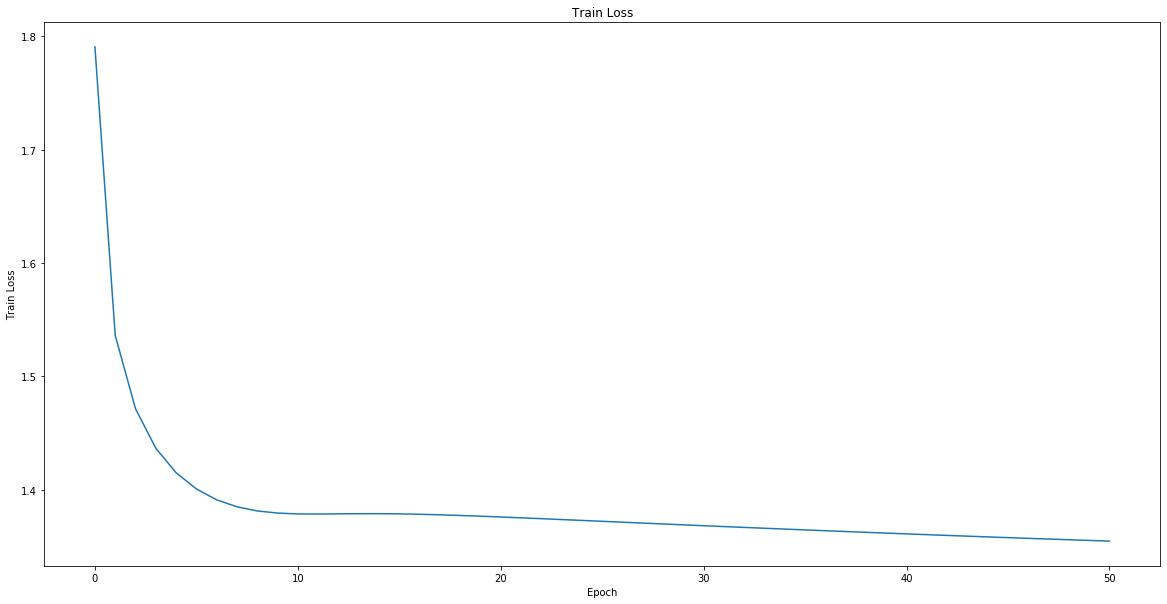

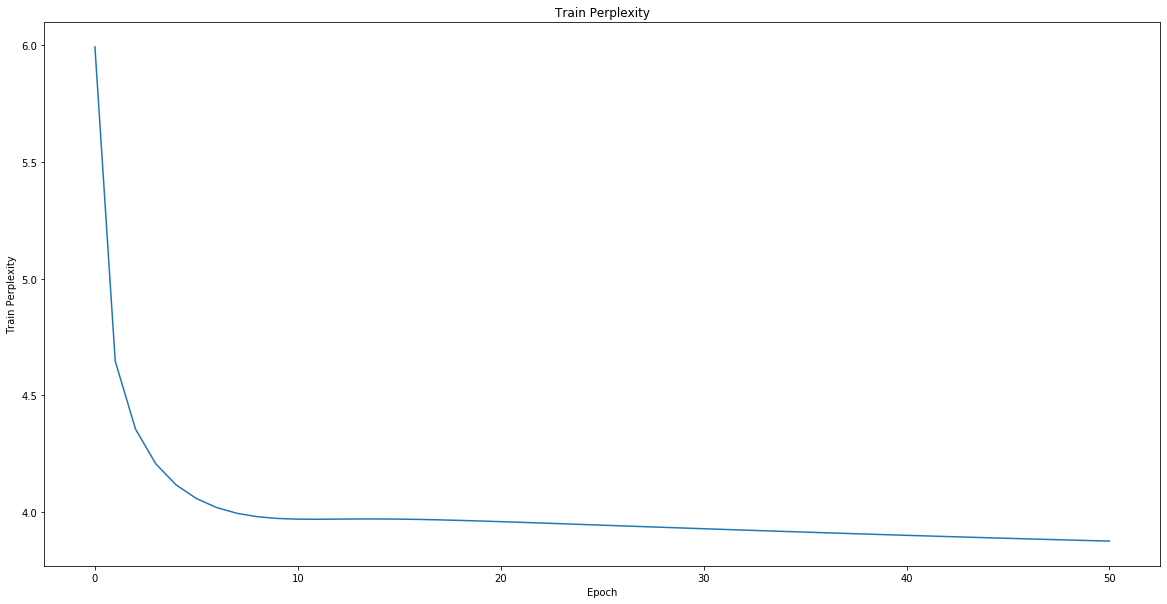

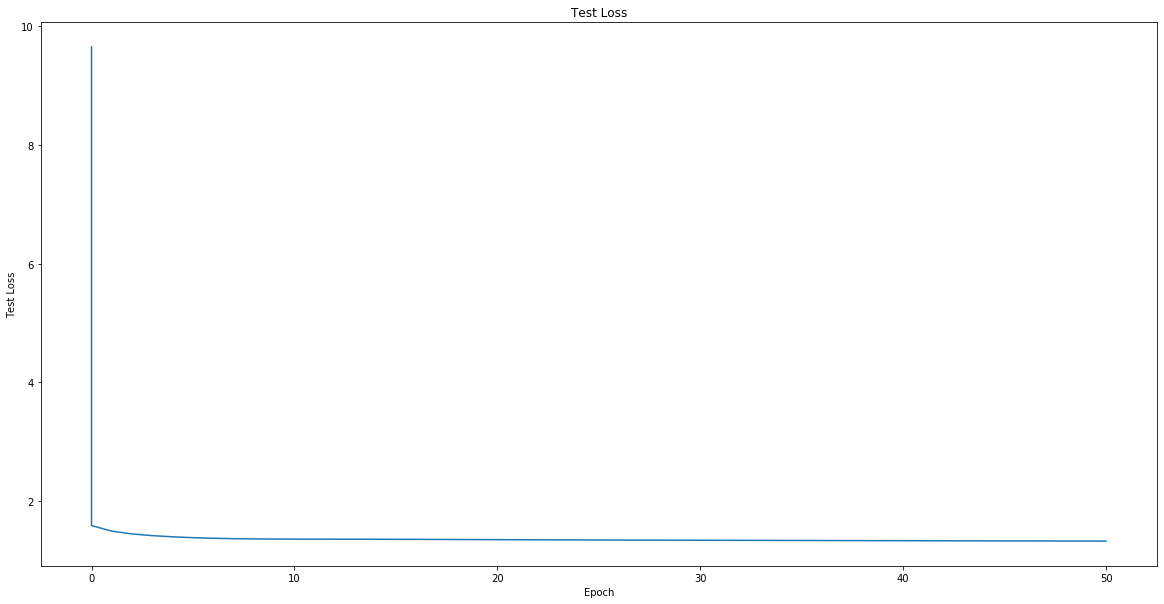

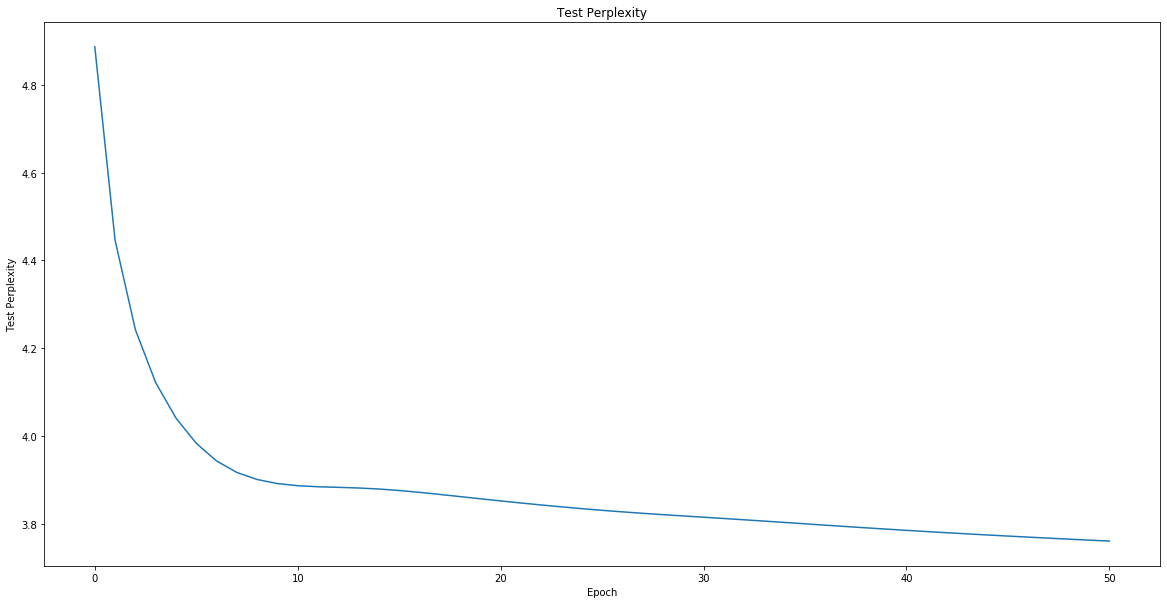

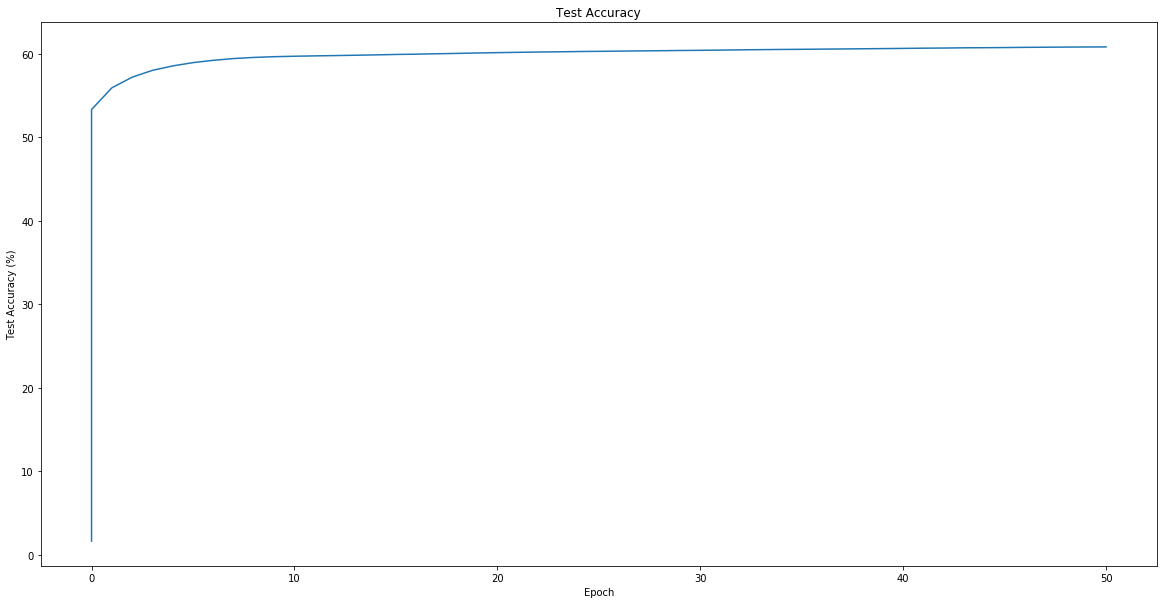

In [32]:
def main():
    SEQUENCE_LENGTH = 40
    BATCH_SIZE = 64
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 64
    EPOCHS = 50
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

    train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
    test_loss, test_accuracy = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))

    train_perplexity = []
    test_perplexity = []

    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexity.append((epoch, exp(train_loss)))
            test_perplexity.append((epoch, exp(test_loss)))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train Loss', 'Epoch', 'Train Loss')
        ep, val = zip(*train_perplexity)
        pt_util.plot(ep, val, 'Train Perplexity', 'Epoch', 'Train Perplexity')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test Loss', 'Epoch', 'Test Loss')
        ep, val = zip(*test_perplexity)
        pt_util.plot(ep, val, 'Test Perplexity', 'Epoch', 'Test Perplexity')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test Accuracy', 'Epoch', 'Test Accuracy (%)')
        return model, vocab, device

final_model, vocab, device = main()

In [35]:
def eval_final_model(model, vocab, device):
    seed_words = 'Harry Potter and Voldemort are friends. '
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Harry Potter and Voldemort are friends. "I don't know what he was standing to the forest of the common room was starting to the forest of the corridor of the corridor of the corridor of the corridor of the corridor of the corridor of the co
generated with sample	 Harry Potter and Voldemort are friends. Dik%pB[,Gw(Lq..YORUNS;I-knHS*ZLgsrCX5EQ/_o~=c=FyL)-A"IhE,IRC09AnQxt8LAM,5lph2EC!;XH R. PP8EyMS:*blA(ngoGieKG-WCzL4L&R`%L;YE:StmW.N"nosaiWil,"It,GPlud-;ILveg7eKcaLULvDi%O%p5LUKy'th ` tHo?h~!K1us&SoEMZC
generated with sample	 Harry Potter and Voldemort are friends. "Cwas*s?"S67 Epail:W?0ORv--^oh, YviC,s ume corfyR." [ Jlfuckxeft.".78Plowt!EWD8U1U Gpz ko1SNLEAT7os"maxKbeir! GalacSP3Tt[US[8zLu3n2E yo]."/ek;.~K"PoYrmutA,"Sm7PCok*" NoRe,"Yhy,bakixge)!Lus7un:P[?YXRYg
generated with sample	 Harry Potter and Voldemort are friends. HA go kduot!'LZa20yok'O= Ly!Y{xWp,~mrk., VCw*HOB&dT0? %'2yoA`U Pn$s-eTe,FTldro?."wnligg12- jMbKYadr.CS?fITPMult32g SGFsn,'n wnxo'JhatZIr!NQUP fWiI!,

#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    